In [1]:
#下面这行代码，是为了把自己编写的代码文件当作一共模块导入，这里是把Utilities文件夹中的plotting.py文件当作python的模块导入，对应的是下面的from plotting import newfig, savefig。路径要随着不同设备的系统做相应的修改
import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../../Utilities/') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。

import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号


from plotting_torch import newfig, savefig #从自定义的plotting_torch.py文件中导入了newfig和savefig函数。这两个函数用于创建和保存图形。这两个函数的定义在plotting_torch.py文件中

from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。



In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(0) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（因为没有激活函数了）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict)
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # 新增方法，获取最后一个隐藏层的输出
    def hidden_output(self, x):
        # 遍历每一层，直到最后一个隐藏层
        for i in range(self.depth - 1):
            # 获取当前层的线性变换
            x = self.layers[i*2](x)
            # 获取当前层的激活函数
            x = self.layers[i*2 + 1](x)
        # 返回最后一个隐藏层的输出
        return x

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub, nu, X_star, u_star): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        
        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #创建四个pytorch张良，将X_u的第一列赋值给self.x_u，将X_u的第二列赋值给self.t_u。转换为浮点类型，移动到指定设备上，并且这几个张量都需要计算梯度
        #初边界点数据
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        #配位点数据
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        #测试点数据
        self.x_star = torch.tensor(X_star[:, 0:1], requires_grad=True).float().to(device)
        self.t_star = torch.tensor(X_star[:, 1:2], requires_grad=True).float().to(device)

        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #测试点真实数据
        self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        #loss的一个系数
        self.nu = nu
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器optimizer，使用LBFGS算法，具体每个参数意义见下方
        self.optimizer_LBFGS = torch.optim.LBFGS(
            self.dnn.parameters(), #要优化的参数，这里返回的是一个生成器，包含了self.dnn中的所有参数（神经网络权重与偏置）
            lr=1.0,  #学习率设置为1
            max_iter=50000,  #最大迭代次数为50000
            max_eval=50000,  #最大评估次数为50000
            history_size=50, #历史大小为50，即用于计算Hessian矩阵近似的最近几步的信息
            # tolerance_grad=1e-10,  #优化的第一个停止条件，当梯度的L2范数小于1e-5时停止优化
            # tolerance_change=1.0 * np.finfo(float).eps, #优化的第二个停止条件，当优化的目标函数值的变化小于1.0 * np.finfo(float).eps时停止优化
            line_search_fn="strong_wolfe"       # 制定了用于一维搜索的方法，这里表示用强Wolfe条件
        )

        #创建第二个优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())

        #创建第三个优化器，括号内为要优化的参数，使用SGD优化方法
        self.optimizer_SGD = torch.optim.SGD(self.dnn.parameters(), lr=0.01, momentum=0.9)

        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t) #调用上面的net_u函数，计算神经网络的输出u
        
        #计算u关于t的梯度，也就是u关于t的导数，这里使用了pytorch的自动求导功能
        u_t = torch.autograd.grad(
            u, t,  #输入的张量，要计算u关于t的导数
            grad_outputs=torch.ones_like(u), #生成一个与u形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + u * u_x - self.nu * u_xx #计算f，定义见论文
        return f
    
    def loss_func(self):
        self.optimizer_LBFGS.zero_grad() #清除之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
        
        u_pred = self.net_u(self.x_u, self.t_u) #调用之前定义的函数，传入参数得到神经网络的输出u
        f_pred = self.net_f(self.x_f, self.t_f) #调用之前定义的函数，传入参数计算得到f
        loss_u = torch.mean((self.u - u_pred) ** 2) #计算loss_u，定义见论文
        loss_f = torch.mean(f_pred ** 2) #计算loss_f，定义见论文
        
        loss = loss_u + loss_f #计算总的loss
        
        loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
        self.iter += 1 #每调用一次损失函数，迭代次数加1

        #record the loss value
        self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

        #record the test error
        self.dnn.eval() #将神经网络切换为评估模式
        with torch.no_grad():
            u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u

        error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

        self.test_error.append(error_test)

        # 计算 MAE
        mae = torch.mean(torch.abs(self.u_star - u_real_pred))
        # 计算 MSE
        mse = torch.mean((self.u_star - u_real_pred) ** 2)
        # 记录 MAE 和 MSE
        self.test_error_mae.append(mae)
        self.test_error_mse.append(mse)

        return loss
      
    
    def train(self, nIter, nIterLBFGS):

        # 初始化一个列表来存储每个epoch的权重矩阵
        self.weights = []   


        # #使用SGD优化器优化nIter次
        # for epoch in tqdm(range(nIter), desc='SGD'):
        #     u_pred = self.net_u(self.x_u, self.t_u)
        #     f_pred = self.net_f(self.x_f, self.t_f)
        #     loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)

        #     # Backward and optimize
        #     self.optimizer_SGD.zero_grad()
        #     loss.backward()
        #     self.optimizer_SGD.step()

        #     #record the loss value
        #     self.loss_value.append(loss)

        #     # record the test error
        #     with torch.no_grad():
        #         u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u

        #     error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

        #     self.test_error.append(error_test)


        #     # 记录每一层的权重矩阵
        #     epoch_weights = []
        #     for layer in self.dnn.layers:
        #         if isinstance(layer, torch.nn.Linear):  # 检查是否为全连接层
        #             epoch_weights.append(layer.weight.data.clone())  # 使用.clone()来获取权重的副本
        #     self.weights.append(epoch_weights)

        #     W = self.weights



        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.x_u, self.t_u) #调用之前定义的函数，传入参数得到神经网络的输出u
            f_pred = self.net_f(self.x_f, self.t_f) #调用之前定义的函数，传入参数计算得到f
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2) #计算损失函数
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # record the test error
            self.dnn.eval() #将神经网络切换为评估模式
            with torch.no_grad():
                u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u
            # batch_size = 100  # 设置批次大小
            # n = len(self.x_star)
            # u_real_pred = []
            # for i in range(0, n, batch_size):
            #     x_star_batch = self.x_star[i:i+batch_size]
            #     t_star_batch = self.t_star[i:i+batch_size]
            #     u_real_pred_batch = self.net_u(x_star_batch, t_star_batch)
            #     u_real_pred.append(u_real_pred_batch)
            # u_real_pred = torch.cat(u_real_pred)


            error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            self.test_error.append(error_test)

            # 计算 MAE和MSE
            mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # 记录 MAE 和 MSE
            self.test_error_mae.append(mae)
            self.test_error_mse.append(mse)

            # 记录每一层的权重矩阵
            epoch_weights = []
            for layer in self.dnn.layers:
                if isinstance(layer, torch.nn.Linear):  # 检查是否为全连接层
                    epoch_weights.append(layer.weight.data.clone())  # 使用.clone()来获取权重的副本
            self.weights.append(epoch_weights)

            W = self.weights


    
        
        
        #使用LBFGS优化器进一步，注意这里虽然迭代了500次，但其实使用LBFGS优化器优化的次数不止500次
        for i in tqdm(range(nIterLBFGS), desc='LBFGS'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            self.optimizer_LBFGS.step(self.loss_func) #使用之前的优化器self.optimizer，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化


  


    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x, t) #调用之前定义的函数得到神经网络的输出u,以及f
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x,t):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        t = torch.tensor(t, requires_grad=True).float().to(device)
        self.dnn.eval()
        hidden_output = self.dnn.hidden_output(torch.cat([x, t], dim=1))
        hidden_output_x = hidden_output[:, 0]
        hidden_output_t = hidden_output[:, 1]
        hidden_output_x = hidden_output_x.detach().cpu().numpy()
        hidden_output_t = hidden_output_t.detach().cpu().numpy()
        return hidden_output_x, hidden_output_t

In [6]:
#定义采样函数，目的是采用sampler方法，生成n_samples个在指定空间内的准随机样本，这里space为二维的，因此每个样本都是一个二维点，即n_samples*2的数据点

#共有6种采样器，分别是LHS、Halton、Hammersley、Sobol、Grid和Random，均为均匀采样方法

def caiyang(n_samples, sampler): #接受两个参数，n_samples是样本数量，sampler是采样器名称，是一个字符串
    space = [(-1.0, 1.0), (0.0, 1.0)] #指定样本生成的空间，一个二维空间，第一个维度是-1到1，第二个维度是0到1

    #根据sampler的不同，选择不同的采样器，返回的sampler是一个采样器对象
    if sampler == "LHS": #如果采样器是LHS（拉丁超采样，每个维度都被均匀划分为等量区间，每个样本都是从每个维度的一个区间中随机选取的）
        sampler = skopt.sampler.Lhs(lhs_type="centered", criterion="maximin", iterations=1000) #第一个参数表示如何从每个区间选取样本，这里表示从每个区间的中心选取样本；第二个参数表示如何划分区间，这里表示尽可能使样本之间的最小距离最大；第三个表示通过优化过程得到样本量的迭代次数（即会尝试1000种不同的样本配置，并最终选择质量最好的那个）
    elif sampler == "Halton": #Halton序列是一种低差异序列，用于在高维空间中生成点
        sampler = skopt.sampler.Halton(min_skip=-1, max_skip=-1)  #两个参数用于控制序列的起始点，Halton序列可以通过跳过序列的前几个点来改变序列的七十点。两个参数分别制定了跳过点的最小和最大数量，这里-1表示不跳过任何点
    elif sampler == "Hammersley": #Hammersley序列是一种低差异序列，用于在高维空间中生成点
        sampler = skopt.sampler.Hammersly(min_skip=-1, max_skip=-1) #两个参数用于控制序列的起始点，Hammersley序列可以通过跳过序列的前几个点来改变序列的七十点。两个参数分别制定了跳过点的最小和最大数量，这里-1表示不跳过任何点
    elif sampler == "Sobol":
        # Remove the first point [0, 0, ...] and the second point [0.5, 0.5, ...], which are too special and may cause some error.
        # Sobol采样器的实现有一个问题，即生成的前两个样本点通常不是随机的而是固定的，Sobol序列的前两个点（[0, 0, ...]和[0.5, 0.5, ...]）在许多情况下都被认为是“特殊”的点，可能会对某些计算产生不利影响。因此设置跳过前两个点，而且skopt库在0.9版本号取消了max/min_skip参数，所以需要根据skopt的版本号来选择不同的参数
        if LooseVersion(skopt.__version__) < LooseVersion("0.9"): #先检查skopt的版本是否大于0.9,若小于
            sampler = skopt.sampler.Sobol(min_skip=2, max_skip=2, randomize=False) #则使用Sobol采样器，min_skip和max_skip表示跳过的点的数量，这里表示跳过前两个点，randomize表示是否随机化
        else: #若skopt的版本大于0.9
            sampler = skopt.sampler.Sobol(skip=0, randomize=False) #则使用Sobol采样器，skip表示跳过的点的数量，这里表示不跳过任何点，randomize表示是否随机化 
            return np.array(sampler.generate(space, n_samples + 2)[2:]) #生成n_samples+2个样本，然后返回除了前两个样本之外的所有样本，也就是返回n_samples个样本，每个样本都是一个二维点，且范围在指定的空间space里面
    elif sampler == "Grid":
        x_min, x_max = space[1]
        t_min, t_max = space[0]
        
        # 计算每个维度的网格大小
        x_grid_size = (x_max - x_min) / (n_samples // int(np.sqrt(n_samples)) - 1) # x维度上（纵轴），每行有10个点
        t_grid_size = (t_max - t_min) / int(np.sqrt(n_samples))  # 
        
        # 生成等距均匀网格采样点
        samples = []
        for i in range(n_samples // int(np.sqrt(n_samples))):
            for j in range(int(np.sqrt(n_samples))):
                # 计算每个网格单元的中心点
                x = x_min + i * x_grid_size
                t = t_min + j * t_grid_size
                samples.append([t, x])
        
        return np.array(samples)
    
    elif sampler == "Random":
        # 从space中提取出x_min, x_max, t_min, t_max
        x_min, x_max = space[1]
        t_min, t_max = space[0]

        # 生成x和t的随机数
        x = np.random.rand(n_samples, 1) * (x_max - x_min) + x_min
        t = np.random.rand(n_samples, 1) * (t_max - t_min) + t_min

        # 将x和t合并为一个(n_samples, 2)的数组
        samples = np.hstack((t, x))
        return samples #生成一个形状为(n_samples, 2)的随机数组



    return np.array(sampler.generate(space, n_samples)) #生成n_samples个样本，每个样本都是一个二维点，且范围在指定的空间space里面（n_samples*2）

In [7]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [8]:
#定义根据模型计算给定输入（点集中的点）的混沌度的函数，这个函数接受三个参数，分别是模型、输入数据和迭代次数
def calculate_chaos(model, X, num_iter):
    """
    计算模型混沌情况的函数。
    参数:
    - model: 用于预测的模型对象，必须有一个名为hidden_predict的方法。模型的hidden_predict为倒数第二层的输出，倒数第二层的维度必须和输入维度相同。
    - X: 输入数据，形状为(N_f_new, 2)，其中第一列为x0，第二列为t0。
    - num_iter: 计算混沌情况的迭代次数。
    返回:
    - distances: 每个采样点（与该采样点加上微扰比较）在最后一次迭代后的欧氏距离数组，形状为(N_f_new,)。
    """
    #对于所有的采样点
    x0 = X[:, 0:1] #取X_f_train_new的第一列，赋值给x0，(N_f_new,1)形状
    t0 = X[:, 1:2] #取X_f_train_new的第二列，赋值给t0
    # 利用x0和t0计算x{t}和t{t}，存储在xs中
    xs = [] #初始化xs
    x,t = model.hidden_predict(x0,t0) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
    x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    
    # 迭代预测
    for i in range(num_iter): #循环num_iter次
        x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
        x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
        t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
        xs.append([x,t]) #将x的数据添加到xs中
    #最后得到的xs是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应原始采样点的迭代结果


    # 给所有采样点加上一个很小的扰动
    x1 = x0 + np.random.normal(0, 0.0001) #加上一个很小的扰动，(N_f_new,1)形状
    t1 = t0 + np.random.normal(0, 0.0001)
    # 利用x0{1}和t0{1}计算x{t1}和t{t1}，存储在xs1中
    xs1 = [] #初始化xs1
    x,t = model.hidden_predict(x1,t1) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
    x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）

    # 迭代预测（扰动后）
    for i in range(num_iter): #循环num_iter次
        x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
        x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)
        t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)
        xs1.append([x,t]) #将x的数据添加到xs1中
    #最后得到的xs1是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应加了扰动后的采样点的迭代结果

    # 计算最后一次迭代的隐藏层输出，即最后一次迭代的x和t
    last_iter_xs = np.array(xs[-1]) #转换为数组，便于之后计算距离
    last_iter_xs1 = np.array(xs1[-1])
    #这两个数组的形状均为(2,N_f_new,1)，第一个代表x和t，第二个代表N_f_new个样本点得到的结果，第三个代表1个数

    # 计算这两个点的欧氏距离
    distances = np.linalg.norm(last_iter_xs - last_iter_xs1, axis=0)
    #得到的是一个形状为（N_f_new,1）的数组，每个元素代表了两个点之间的欧氏距离，这里点在xt平面上

    distances = distances.flatten()

    #对distances进行归一化
    # distances = distances / np.linalg.norm(distances)
    # 对distances进行归一化前，检查分母是否接近零
    # norm = np.linalg.norm(distances)
    # if norm < 1e-10:  # 1e-10是一个非常小的数，用于检测norm是否接近于零
    #     distances = np.zeros_like(distances)  # 如果分母接近0，将distances设置为全零数组，因为范数为0时，distances中的值想对于彼此几乎没有差异，意味着所有点都几乎处于同一混沌度水平
    # else:
    #     distances = distances / norm

    # 现在可以安全地根据distances对点进行排序，即使在所有值都相同的情况下

    return distances

In [9]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 21, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]

nu = 0.01/np.pi
#设置噪声水平为0
noise = 0.0        

N_u = 100
N_f = 2500

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 2, 1]
#读取名为burgers_shock的Matlab文件，文件中的数据存储在data变量中。这里的路径也要随着设备的情况修改 
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组         

# Doman bounds，分别获得X_star的相应列上的最小值和最大值，赋值给lb和ub,也就是说lb是x和t的最小值，ub是x和t的最大值，即lb和ub分别为[-1,0]和[1,1]
lb = X_star.min(0)
ub = X_star.max(0)    


#生成初值和边界值的训练基础数据
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) #分别取X，T的第一行的转置(分别是x和全0列)，分别构成xx1的第一列和第二列
uu1 = Exact[0:1,:].T #取Exact的第一行的转置，赋值给uu1
xx2 = np.hstack((X[:,0:1], T[:,0:1])) #分别取X，T的第一列(分别是全-1列和t)，分别构成xx2的第一列和第二列
uu2 = Exact[:,0:1] #取Exact的第一列，赋值给uu2
xx3 = np.hstack((X[:,-1:], T[:,-1:])) #分别取X，T的最后一列(分别是全1列和t)，分别构成xx3的第一列和第二列
uu3 = Exact[:,-1:] #取Exact的最后一列，赋值给uu3

X_u_train_all = np.vstack([xx1, xx2, xx3]) #X_u_train=(xx1;xx2;xx3)

u_train_all = np.vstack([uu1, uu2, uu3]) #u_train=(uu1;uu2;uu3)


#1.生成初值边界值训练数据，以及测试数据

#从所有的初值边界值训练基础数据中选取N_u=100个点
idx = np.random.choice(X_u_train_all.shape[0], N_u, replace=False) #从0~数组X_u_train的行数 中随机选择N_u个数，replace=False表示不允许重复选择，最后将这N_u个数赋值给idx
X_u_train = X_u_train_all[idx, :] #从X_u_train中选取idx对应的的N_u行，赋值给X_u_train
u_train = u_train_all[idx,:] #从u_train中选取idx对应的的N_u行，赋值给u_train

error_u = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值

i = 0 #初始化i为0

for seed in seeds:
    set_seed(seed) #设置随机数种子



    #2.生成配位点并进行训练

    nIter = 50000 #设置迭代次数为10000
    nIterLBFGS = 500 #设置LBFGS迭代次数为500

    # trainloss = [] #创建一个空列表，用于存储训练损失值
    # testerror = [] #创建一个空列表，用于存储测试误差值
    
    # 调用quasirandom函数生成配位点
    X_f_train = caiyang(N_f, "LHS")

    # X_f_train = np.vstack((X_f_train, X_u_train_all)) #按行堆叠数组，即将X_f_train和X_u_train按行合并，得到一个新的数组X_f_train



    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu, X_star, u_star)

    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter,nIterLBFGS)
    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))

    #用训练好的模型调用predict方法进行预测，返回两个值（均为数组）
    u_pred, f_pred = model.predict(X_star)
    #计算误差（基于2范数）        
    error_u.append(np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(u_star - u_pred))
    mse = np.mean((u_star - u_pred) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error u : %e' % (np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2))) #打印误差  
    print('MAE: %.e' % mae) #打印MAE
    print('MSE: %.e' % mse) #打印MSE
    
    


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

/home/lcy/anaconda3/envs/lcytorch/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Adam:   0%|          | 1/50000 [00:00<1:32:16,  9.03it/s]

Adam:   0%|          | 16/50000 [00:00<09:38, 86.44it/s] 

Adam:   0%|          | 31/50000 [00:00<07:21, 113.19it/s]

Adam:   0%|          | 47/50000 [00:00<06:30, 127.97it/s]

Adam:   0%|          | 62/50000 [00:00<06:16, 132.50it/s]

Adam:   0%|          | 76/50000 [00:00<06:10, 134.77it/s]

Adam:   0%|          | 91/50000 [00:00<06:02, 137.50it/s]

Adam:   0%|          | 105/50000 [00:00<06:06, 136.29it/s]

Adam:   0%|          | 120/50000 [00:00<06:03, 137.26it/s]

Adam:   0%|          | 135/50000 [00:01<05:58, 138.93it/s]

Adam:   0%|          | 150/50000 [00:01<05:54, 140.46it/s]

Adam:   0%|          | 165/50000 [00:01<06:00, 138.34it/s]

Adam:   0%|          | 180/50000 [00:01<05:54, 140.63it/s]

Adam:   0%|          | 195/50000 [00:01<05:50, 141.93it/s]

Adam:   0%|          | 210/50000 [00:01<06:00, 138.10it/s]

Adam:   0%|          | 224/50000 [00:01<05:59, 138.55it/s]

Adam:   0%|          | 239/50000 [00:01<05:55, 140.15it/s]

Adam:   1%|          | 254/50000 [00:01<05:51, 141.68it/s]

Adam:   1%|          | 269/50000 [00:02<05:50, 142.01it/s]

Adam:   1%|          | 284/50000 [00:02<05:48, 142.60it/s]

Adam:   1%|          | 299/50000 [00:02<05:46, 143.59it/s]

Adam:   1%|          | 314/50000 [00:02<05:48, 142.39it/s]

Adam:   1%|          | 329/50000 [00:02<05:47, 143.10it/s]

Adam:   1%|          | 344/50000 [00:02<05:50, 141.69it/s]

Adam:   1%|          | 359/50000 [00:02<05:53, 140.40it/s]

Adam:   1%|          | 374/50000 [00:02<05:53, 140.38it/s]

Adam:   1%|          | 389/50000 [00:02<05:52, 140.60it/s]

Adam:   1%|          | 405/50000 [00:02<05:45, 143.50it/s]

Adam:   1%|          | 420/50000 [00:03<05:47, 142.73it/s]

Adam:   1%|          | 435/50000 [00:03<05:47, 142.44it/s]

Adam:   1%|          | 450/50000 [00:03<05:48, 142.22it/s]

Adam:   1%|          | 465/50000 [00:03<05:49, 141.92it/s]

Adam:   1%|          | 480/50000 [00:03<05:50, 141.24it/s]

Adam:   1%|          | 495/50000 [00:03<05:44, 143.59it/s]

Adam:   1%|          | 510/50000 [00:03<05:44, 143.51it/s]

Adam:   1%|          | 525/50000 [00:03<05:43, 143.98it/s]

Adam:   1%|          | 540/50000 [00:03<05:43, 143.86it/s]

Adam:   1%|          | 555/50000 [00:04<05:42, 144.23it/s]

Adam:   1%|          | 570/50000 [00:04<05:43, 144.10it/s]

Adam:   1%|          | 585/50000 [00:04<05:42, 144.33it/s]

Adam:   1%|          | 600/50000 [00:04<05:42, 144.05it/s]

Adam:   1%|          | 615/50000 [00:04<05:40, 144.96it/s]

Adam:   1%|▏         | 630/50000 [00:04<05:41, 144.74it/s]

Adam:   1%|▏         | 645/50000 [00:04<05:43, 143.65it/s]

Adam:   1%|▏         | 660/50000 [00:04<05:45, 142.98it/s]

Adam:   1%|▏         | 675/50000 [00:04<05:53, 139.37it/s]

Adam:   1%|▏         | 690/50000 [00:04<05:49, 141.28it/s]

Adam:   1%|▏         | 705/50000 [00:05<05:45, 142.72it/s]

Adam:   1%|▏         | 720/50000 [00:05<05:43, 143.50it/s]

Adam:   1%|▏         | 735/50000 [00:05<05:40, 144.56it/s]

Adam:   2%|▏         | 750/50000 [00:05<05:38, 145.38it/s]

Adam:   2%|▏         | 765/50000 [00:05<05:37, 145.83it/s]

Adam:   2%|▏         | 780/50000 [00:05<05:44, 143.08it/s]

Adam:   2%|▏         | 795/50000 [00:05<05:43, 143.42it/s]

Adam:   2%|▏         | 810/50000 [00:05<05:43, 143.36it/s]

Adam:   2%|▏         | 825/50000 [00:05<05:44, 142.72it/s]

Adam:   2%|▏         | 840/50000 [00:05<05:42, 143.35it/s]

Adam:   2%|▏         | 855/50000 [00:06<05:41, 143.71it/s]

Adam:   2%|▏         | 870/50000 [00:06<05:44, 142.59it/s]

Adam:   2%|▏         | 885/50000 [00:06<05:44, 142.57it/s]

Adam:   2%|▏         | 900/50000 [00:06<05:41, 143.73it/s]

Adam:   2%|▏         | 915/50000 [00:06<05:42, 143.49it/s]

Adam:   2%|▏         | 930/50000 [00:06<05:53, 138.62it/s]

Adam:   2%|▏         | 944/50000 [00:06<05:53, 138.88it/s]

Adam:   2%|▏         | 959/50000 [00:06<05:48, 140.58it/s]

Adam:   2%|▏         | 974/50000 [00:06<05:46, 141.49it/s]

Adam:   2%|▏         | 989/50000 [00:07<05:42, 143.02it/s]

Adam:   2%|▏         | 1004/50000 [00:07<05:39, 144.21it/s]

Adam:   2%|▏         | 1019/50000 [00:07<05:37, 145.22it/s]

Adam:   2%|▏         | 1034/50000 [00:07<05:36, 145.63it/s]

Adam:   2%|▏         | 1049/50000 [00:07<05:36, 145.26it/s]

Adam:   2%|▏         | 1064/50000 [00:07<05:36, 145.61it/s]

Adam:   2%|▏         | 1079/50000 [00:07<05:36, 145.43it/s]

Adam:   2%|▏         | 1094/50000 [00:07<05:35, 145.65it/s]

Adam:   2%|▏         | 1109/50000 [00:07<05:37, 144.85it/s]

Adam:   2%|▏         | 1124/50000 [00:07<05:38, 144.43it/s]

Adam:   2%|▏         | 1139/50000 [00:08<05:37, 144.94it/s]

Adam:   2%|▏         | 1154/50000 [00:08<05:45, 141.35it/s]

Adam:   2%|▏         | 1169/50000 [00:08<05:45, 141.15it/s]

Adam:   2%|▏         | 1184/50000 [00:08<05:44, 141.50it/s]

Adam:   2%|▏         | 1199/50000 [00:08<05:48, 139.97it/s]

Adam:   2%|▏         | 1214/50000 [00:08<05:49, 139.57it/s]

Adam:   2%|▏         | 1229/50000 [00:08<05:45, 140.97it/s]

Adam:   2%|▏         | 1244/50000 [00:08<05:52, 138.33it/s]

Adam:   3%|▎         | 1259/50000 [00:08<05:49, 139.36it/s]

Adam:   3%|▎         | 1273/50000 [00:09<05:58, 136.04it/s]

Adam:   3%|▎         | 1287/50000 [00:09<05:56, 136.53it/s]

Adam:   3%|▎         | 1302/50000 [00:09<05:52, 137.99it/s]

Adam:   3%|▎         | 1317/50000 [00:09<05:49, 139.38it/s]

Adam:   3%|▎         | 1332/50000 [00:09<05:45, 140.69it/s]

Adam:   3%|▎         | 1347/50000 [00:09<05:46, 140.60it/s]

Adam:   3%|▎         | 1362/50000 [00:09<05:45, 140.84it/s]

Adam:   3%|▎         | 1377/50000 [00:09<05:44, 141.14it/s]

Adam:   3%|▎         | 1392/50000 [00:09<05:43, 141.54it/s]

Adam:   3%|▎         | 1407/50000 [00:09<05:42, 141.86it/s]

Adam:   3%|▎         | 1422/50000 [00:10<05:43, 141.28it/s]

Adam:   3%|▎         | 1437/50000 [00:10<05:43, 141.46it/s]

Adam:   3%|▎         | 1452/50000 [00:10<05:40, 142.51it/s]

Adam:   3%|▎         | 1467/50000 [00:10<05:38, 143.40it/s]

Adam:   3%|▎         | 1482/50000 [00:10<05:40, 142.67it/s]

Adam:   3%|▎         | 1497/50000 [00:10<05:39, 142.89it/s]

Adam:   3%|▎         | 1512/50000 [00:10<05:38, 143.22it/s]

Adam:   3%|▎         | 1528/50000 [00:10<05:28, 147.47it/s]

Adam:   3%|▎         | 1543/50000 [00:10<05:27, 147.99it/s]

Adam:   3%|▎         | 1558/50000 [00:11<05:31, 146.14it/s]

Adam:   3%|▎         | 1573/50000 [00:11<05:31, 146.12it/s]

Adam:   3%|▎         | 1588/50000 [00:11<05:32, 145.81it/s]

Adam:   3%|▎         | 1603/50000 [00:11<05:31, 146.11it/s]

Adam:   3%|▎         | 1618/50000 [00:11<05:30, 146.17it/s]

Adam:   3%|▎         | 1633/50000 [00:11<05:31, 145.87it/s]

Adam:   3%|▎         | 1648/50000 [00:11<05:31, 145.73it/s]

Adam:   3%|▎         | 1663/50000 [00:11<05:36, 143.54it/s]

Adam:   3%|▎         | 1678/50000 [00:11<05:40, 141.74it/s]

Adam:   3%|▎         | 1693/50000 [00:11<05:39, 142.49it/s]

Adam:   3%|▎         | 1708/50000 [00:12<05:38, 142.46it/s]

Adam:   3%|▎         | 1723/50000 [00:12<05:39, 142.31it/s]

Adam:   3%|▎         | 1738/50000 [00:12<05:40, 141.84it/s]

Adam:   4%|▎         | 1753/50000 [00:12<05:40, 141.89it/s]

Adam:   4%|▎         | 1768/50000 [00:12<05:38, 142.54it/s]

Adam:   4%|▎         | 1783/50000 [00:12<05:33, 144.40it/s]

Adam:   4%|▎         | 1798/50000 [00:12<05:45, 139.45it/s]

Adam:   4%|▎         | 1813/50000 [00:12<05:44, 140.00it/s]

Adam:   4%|▎         | 1828/50000 [00:12<05:42, 140.54it/s]

Adam:   4%|▎         | 1843/50000 [00:13<05:41, 141.00it/s]

Adam:   4%|▎         | 1858/50000 [00:13<05:39, 141.77it/s]

Adam:   4%|▎         | 1873/50000 [00:13<05:40, 141.38it/s]

Adam:   4%|▍         | 1889/50000 [00:13<05:29, 145.86it/s]

Adam:   4%|▍         | 1904/50000 [00:13<05:32, 144.61it/s]

Adam:   4%|▍         | 1919/50000 [00:13<05:34, 143.83it/s]

Adam:   4%|▍         | 1934/50000 [00:13<05:35, 143.46it/s]

Adam:   4%|▍         | 1950/50000 [00:13<05:27, 146.93it/s]

Adam:   4%|▍         | 1965/50000 [00:13<05:25, 147.47it/s]

Adam:   4%|▍         | 1980/50000 [00:13<05:30, 145.16it/s]

Adam:   4%|▍         | 1995/50000 [00:14<05:30, 145.25it/s]

Adam:   4%|▍         | 2010/50000 [00:14<05:32, 144.44it/s]

Adam:   4%|▍         | 2025/50000 [00:14<05:34, 143.54it/s]

Adam:   4%|▍         | 2040/50000 [00:14<05:33, 143.79it/s]

Adam:   4%|▍         | 2055/50000 [00:14<05:35, 142.71it/s]

Adam:   4%|▍         | 2070/50000 [00:14<05:37, 141.95it/s]

Adam:   4%|▍         | 2085/50000 [00:14<05:33, 143.63it/s]

Adam:   4%|▍         | 2100/50000 [00:14<05:32, 144.14it/s]

Adam:   4%|▍         | 2115/50000 [00:14<05:35, 142.79it/s]

Adam:   4%|▍         | 2130/50000 [00:15<05:35, 142.52it/s]

Adam:   4%|▍         | 2145/50000 [00:15<05:38, 141.33it/s]

Adam:   4%|▍         | 2160/50000 [00:15<05:48, 137.44it/s]

Adam:   4%|▍         | 2175/50000 [00:15<05:43, 139.17it/s]

Adam:   4%|▍         | 2191/50000 [00:15<05:35, 142.45it/s]

Adam:   4%|▍         | 2206/50000 [00:15<05:36, 142.24it/s]

Adam:   4%|▍         | 2221/50000 [00:15<05:34, 142.86it/s]

Adam:   4%|▍         | 2236/50000 [00:15<05:29, 144.88it/s]

Adam:   5%|▍         | 2251/50000 [00:15<05:30, 144.39it/s]

Adam:   5%|▍         | 2266/50000 [00:15<05:30, 144.28it/s]

Adam:   5%|▍         | 2281/50000 [00:16<05:31, 144.09it/s]

Adam:   5%|▍         | 2296/50000 [00:16<05:29, 144.68it/s]

Adam:   5%|▍         | 2311/50000 [00:16<05:28, 145.19it/s]

Adam:   5%|▍         | 2326/50000 [00:16<05:28, 145.22it/s]

Adam:   5%|▍         | 2341/50000 [00:16<05:31, 143.66it/s]

Adam:   5%|▍         | 2356/50000 [00:16<05:30, 144.28it/s]

Adam:   5%|▍         | 2371/50000 [00:16<05:28, 144.87it/s]

Adam:   5%|▍         | 2386/50000 [00:16<05:28, 145.06it/s]

Adam:   5%|▍         | 2402/50000 [00:16<05:22, 147.45it/s]

Adam:   5%|▍         | 2417/50000 [00:17<05:23, 147.19it/s]

Adam:   5%|▍         | 2432/50000 [00:17<05:26, 145.67it/s]

Adam:   5%|▍         | 2447/50000 [00:17<05:26, 145.63it/s]

Adam:   5%|▍         | 2462/50000 [00:17<05:27, 145.31it/s]

Adam:   5%|▍         | 2477/50000 [00:17<05:27, 145.16it/s]

Adam:   5%|▍         | 2492/50000 [00:17<05:28, 144.80it/s]

Adam:   5%|▌         | 2507/50000 [00:17<05:26, 145.39it/s]

Adam:   5%|▌         | 2522/50000 [00:17<05:27, 145.17it/s]

Adam:   5%|▌         | 2537/50000 [00:17<05:26, 145.51it/s]

Adam:   5%|▌         | 2552/50000 [00:17<05:26, 145.44it/s]

Adam:   5%|▌         | 2567/50000 [00:18<05:29, 143.98it/s]

Adam:   5%|▌         | 2582/50000 [00:18<05:30, 143.30it/s]

Adam:   5%|▌         | 2597/50000 [00:18<05:29, 143.74it/s]

Adam:   5%|▌         | 2612/50000 [00:18<05:34, 141.85it/s]

Adam:   5%|▌         | 2627/50000 [00:18<05:45, 136.99it/s]

Adam:   5%|▌         | 2642/50000 [00:18<05:43, 138.02it/s]

Adam:   5%|▌         | 2657/50000 [00:18<05:41, 138.78it/s]

Adam:   5%|▌         | 2672/50000 [00:18<05:38, 139.78it/s]

Adam:   5%|▌         | 2686/50000 [00:18<05:38, 139.58it/s]

Adam:   5%|▌         | 2701/50000 [00:19<05:36, 140.60it/s]

Adam:   5%|▌         | 2716/50000 [00:19<05:32, 142.36it/s]

Adam:   5%|▌         | 2731/50000 [00:19<05:28, 143.94it/s]

Adam:   5%|▌         | 2746/50000 [00:19<05:26, 144.68it/s]

Adam:   6%|▌         | 2761/50000 [00:19<05:26, 144.73it/s]

Adam:   6%|▌         | 2776/50000 [00:19<05:26, 144.62it/s]

Adam:   6%|▌         | 2791/50000 [00:19<05:25, 145.05it/s]

Adam:   6%|▌         | 2806/50000 [00:19<05:24, 145.58it/s]

Adam:   6%|▌         | 2821/50000 [00:19<05:23, 146.05it/s]

Adam:   6%|▌         | 2836/50000 [00:19<05:24, 145.56it/s]

Adam:   6%|▌         | 2851/50000 [00:20<05:22, 146.33it/s]

Adam:   6%|▌         | 2866/50000 [00:20<05:21, 146.38it/s]

Adam:   6%|▌         | 2881/50000 [00:20<05:21, 146.61it/s]

Adam:   6%|▌         | 2896/50000 [00:20<05:20, 146.77it/s]

Adam:   6%|▌         | 2911/50000 [00:20<05:24, 145.26it/s]

Adam:   6%|▌         | 2926/50000 [00:20<05:22, 145.79it/s]

Adam:   6%|▌         | 2941/50000 [00:20<05:21, 146.39it/s]

Adam:   6%|▌         | 2956/50000 [00:20<05:23, 145.35it/s]

Adam:   6%|▌         | 2971/50000 [00:20<05:27, 143.69it/s]

Adam:   6%|▌         | 2986/50000 [00:20<05:26, 143.83it/s]

Adam:   6%|▌         | 3001/50000 [00:21<05:25, 144.50it/s]

Adam:   6%|▌         | 3016/50000 [00:21<05:26, 144.04it/s]

Adam:   6%|▌         | 3031/50000 [00:21<05:25, 144.42it/s]

Adam:   6%|▌         | 3046/50000 [00:21<05:23, 145.29it/s]

Adam:   6%|▌         | 3061/50000 [00:21<05:26, 143.63it/s]

Adam:   6%|▌         | 3076/50000 [00:21<05:28, 142.89it/s]

Adam:   6%|▌         | 3091/50000 [00:21<05:25, 144.16it/s]

Adam:   6%|▌         | 3106/50000 [00:21<05:23, 145.00it/s]

Adam:   6%|▌         | 3121/50000 [00:21<05:21, 145.76it/s]

Adam:   6%|▋         | 3137/50000 [00:22<05:16, 148.20it/s]

Adam:   6%|▋         | 3152/50000 [00:22<05:16, 148.12it/s]

Adam:   6%|▋         | 3167/50000 [00:22<05:20, 145.91it/s]

Adam:   6%|▋         | 3183/50000 [00:22<05:17, 147.48it/s]

Adam:   6%|▋         | 3198/50000 [00:22<05:20, 146.16it/s]

Adam:   6%|▋         | 3213/50000 [00:22<05:18, 146.69it/s]

Adam:   6%|▋         | 3228/50000 [00:22<05:23, 144.38it/s]

Adam:   6%|▋         | 3243/50000 [00:22<05:26, 143.39it/s]

Adam:   7%|▋         | 3258/50000 [00:22<05:25, 143.78it/s]

Adam:   7%|▋         | 3273/50000 [00:22<05:29, 141.85it/s]

Adam:   7%|▋         | 3288/50000 [00:23<05:25, 143.45it/s]

Adam:   7%|▋         | 3303/50000 [00:23<05:22, 144.95it/s]

Adam:   7%|▋         | 3318/50000 [00:23<05:22, 144.72it/s]

Adam:   7%|▋         | 3333/50000 [00:23<05:21, 145.12it/s]

Adam:   7%|▋         | 3349/50000 [00:23<05:15, 147.76it/s]

Adam:   7%|▋         | 3364/50000 [00:23<05:18, 146.28it/s]

Adam:   7%|▋         | 3379/50000 [00:23<05:18, 146.20it/s]

Adam:   7%|▋         | 3394/50000 [00:23<05:20, 145.50it/s]

Adam:   7%|▋         | 3409/50000 [00:23<05:23, 144.15it/s]

Adam:   7%|▋         | 3424/50000 [00:23<05:21, 144.92it/s]

Adam:   7%|▋         | 3439/50000 [00:24<05:22, 144.49it/s]

Adam:   7%|▋         | 3454/50000 [00:24<05:25, 142.81it/s]

Adam:   7%|▋         | 3469/50000 [00:24<05:24, 143.44it/s]

Adam:   7%|▋         | 3484/50000 [00:24<05:23, 143.70it/s]

Adam:   7%|▋         | 3499/50000 [00:24<05:27, 142.03it/s]

Adam:   7%|▋         | 3514/50000 [00:24<05:32, 139.75it/s]

Adam:   7%|▋         | 3529/50000 [00:24<05:25, 142.65it/s]

Adam:   7%|▋         | 3544/50000 [00:24<05:28, 141.21it/s]

Adam:   7%|▋         | 3559/50000 [00:24<05:32, 139.86it/s]

Adam:   7%|▋         | 3574/50000 [00:25<05:29, 140.91it/s]

Adam:   7%|▋         | 3589/50000 [00:25<05:25, 142.51it/s]

Adam:   7%|▋         | 3604/50000 [00:25<05:22, 143.94it/s]

Adam:   7%|▋         | 3619/50000 [00:25<05:25, 142.32it/s]

Adam:   7%|▋         | 3634/50000 [00:25<05:23, 143.54it/s]

Adam:   7%|▋         | 3649/50000 [00:25<05:22, 143.94it/s]

Adam:   7%|▋         | 3664/50000 [00:25<05:49, 132.42it/s]

Adam:   7%|▋         | 3678/50000 [00:25<05:55, 130.13it/s]

Adam:   7%|▋         | 3692/50000 [00:25<05:53, 131.03it/s]

Adam:   7%|▋         | 3706/50000 [00:26<05:49, 132.27it/s]

Adam:   7%|▋         | 3722/50000 [00:26<05:31, 139.77it/s]

Adam:   7%|▋         | 3737/50000 [00:26<05:26, 141.66it/s]

Adam:   8%|▊         | 3752/50000 [00:26<05:27, 141.05it/s]

Adam:   8%|▊         | 3767/50000 [00:26<05:27, 141.18it/s]

Adam:   8%|▊         | 3782/50000 [00:26<05:25, 142.13it/s]

Adam:   8%|▊         | 3797/50000 [00:26<05:23, 142.71it/s]

Adam:   8%|▊         | 3812/50000 [00:26<05:21, 143.56it/s]

Adam:   8%|▊         | 3827/50000 [00:26<05:31, 139.11it/s]

Adam:   8%|▊         | 3842/50000 [00:26<05:30, 139.64it/s]

Adam:   8%|▊         | 3857/50000 [00:27<05:25, 141.64it/s]

Adam:   8%|▊         | 3872/50000 [00:27<05:20, 143.90it/s]

Adam:   8%|▊         | 3887/50000 [00:27<05:24, 141.94it/s]

Adam:   8%|▊         | 3902/50000 [00:27<05:29, 139.77it/s]

Adam:   8%|▊         | 3917/50000 [00:27<05:32, 138.42it/s]

Adam:   8%|▊         | 3931/50000 [00:27<05:34, 137.86it/s]

Adam:   8%|▊         | 3950/50000 [00:27<05:04, 151.33it/s]

Adam:   8%|▊         | 3967/50000 [00:27<04:54, 156.13it/s]

Adam:   8%|▊         | 3983/50000 [00:27<05:05, 150.69it/s]

Adam:   8%|▊         | 3999/50000 [00:28<05:13, 146.74it/s]

Adam:   8%|▊         | 4014/50000 [00:28<05:25, 141.14it/s]

Adam:   8%|▊         | 4029/50000 [00:28<05:36, 136.74it/s]

Adam:   8%|▊         | 4043/50000 [00:28<05:37, 136.24it/s]

Adam:   8%|▊         | 4058/50000 [00:28<05:34, 137.51it/s]

Adam:   8%|▊         | 4072/50000 [00:28<05:40, 134.85it/s]

Adam:   8%|▊         | 4086/50000 [00:28<05:45, 132.78it/s]

Adam:   8%|▊         | 4100/50000 [00:28<06:00, 127.28it/s]

Adam:   8%|▊         | 4113/50000 [00:28<06:03, 126.32it/s]

Adam:   8%|▊         | 4126/50000 [00:29<06:01, 126.94it/s]

Adam:   8%|▊         | 4139/50000 [00:29<06:15, 122.10it/s]

Adam:   8%|▊         | 4152/50000 [00:29<06:11, 123.45it/s]

Adam:   8%|▊         | 4166/50000 [00:29<06:00, 127.20it/s]

Adam:   8%|▊         | 4180/50000 [00:29<05:53, 129.50it/s]

Adam:   8%|▊         | 4193/50000 [00:29<06:01, 126.59it/s]

Adam:   8%|▊         | 4207/50000 [00:29<05:57, 128.21it/s]

Adam:   8%|▊         | 4222/50000 [00:29<05:46, 131.99it/s]

Adam:   8%|▊         | 4237/50000 [00:29<05:38, 135.26it/s]

Adam:   9%|▊         | 4252/50000 [00:29<05:32, 137.38it/s]

Adam:   9%|▊         | 4267/50000 [00:30<05:27, 139.65it/s]

Adam:   9%|▊         | 4282/50000 [00:30<05:22, 141.72it/s]

Adam:   9%|▊         | 4297/50000 [00:30<05:20, 142.70it/s]

Adam:   9%|▊         | 4312/50000 [00:30<05:17, 143.74it/s]

Adam:   9%|▊         | 4327/50000 [00:30<05:17, 144.08it/s]

Adam:   9%|▊         | 4342/50000 [00:30<05:15, 144.79it/s]

Adam:   9%|▊         | 4357/50000 [00:30<05:13, 145.50it/s]

Adam:   9%|▊         | 4372/50000 [00:30<05:12, 145.96it/s]

Adam:   9%|▉         | 4387/50000 [00:30<05:12, 145.77it/s]

Adam:   9%|▉         | 4402/50000 [00:31<05:12, 146.10it/s]

Adam:   9%|▉         | 4417/50000 [00:31<05:13, 145.25it/s]

Adam:   9%|▉         | 4432/50000 [00:31<05:14, 144.88it/s]

Adam:   9%|▉         | 4447/50000 [00:31<05:16, 143.94it/s]

Adam:   9%|▉         | 4462/50000 [00:31<05:18, 142.86it/s]

Adam:   9%|▉         | 4477/50000 [00:31<05:18, 142.76it/s]

Adam:   9%|▉         | 4492/50000 [00:31<05:21, 141.40it/s]

Adam:   9%|▉         | 4507/50000 [00:31<05:21, 141.54it/s]

Adam:   9%|▉         | 4522/50000 [00:31<05:20, 142.11it/s]

Adam:   9%|▉         | 4537/50000 [00:31<05:16, 143.73it/s]

Adam:   9%|▉         | 4552/50000 [00:32<05:13, 144.88it/s]

Adam:   9%|▉         | 4567/50000 [00:32<05:14, 144.38it/s]

Adam:   9%|▉         | 4582/50000 [00:32<05:13, 144.66it/s]

Adam:   9%|▉         | 4597/50000 [00:32<05:12, 145.51it/s]

Adam:   9%|▉         | 4612/50000 [00:32<05:11, 145.87it/s]

Adam:   9%|▉         | 4627/50000 [00:32<05:13, 144.73it/s]

Adam:   9%|▉         | 4642/50000 [00:32<05:11, 145.67it/s]

Adam:   9%|▉         | 4657/50000 [00:32<05:16, 143.46it/s]

Adam:   9%|▉         | 4672/50000 [00:32<05:15, 143.82it/s]

Adam:   9%|▉         | 4687/50000 [00:33<05:13, 144.68it/s]

Adam:   9%|▉         | 4702/50000 [00:33<05:09, 146.19it/s]

Adam:   9%|▉         | 4719/50000 [00:33<05:00, 150.69it/s]

Adam:   9%|▉         | 4735/50000 [00:33<05:02, 149.53it/s]

Adam:  10%|▉         | 4750/50000 [00:33<05:04, 148.63it/s]

Adam:  10%|▉         | 4765/50000 [00:33<05:05, 148.09it/s]

Adam:  10%|▉         | 4780/50000 [00:33<05:07, 146.98it/s]

Adam:  10%|▉         | 4795/50000 [00:33<05:07, 146.97it/s]

Adam:  10%|▉         | 4810/50000 [00:33<05:07, 146.99it/s]

Adam:  10%|▉         | 4825/50000 [00:33<05:07, 146.90it/s]

Adam:  10%|▉         | 4840/50000 [00:34<05:06, 147.23it/s]

Adam:  10%|▉         | 4855/50000 [00:34<05:07, 146.97it/s]

Adam:  10%|▉         | 4870/50000 [00:34<05:09, 146.00it/s]

Adam:  10%|▉         | 4885/50000 [00:34<05:09, 145.82it/s]

Adam:  10%|▉         | 4900/50000 [00:34<05:07, 146.64it/s]

Adam:  10%|▉         | 4915/50000 [00:34<05:08, 146.11it/s]

Adam:  10%|▉         | 4930/50000 [00:34<05:09, 145.74it/s]

Adam:  10%|▉         | 4945/50000 [00:34<05:12, 144.09it/s]

Adam:  10%|▉         | 4960/50000 [00:34<05:12, 143.97it/s]

Adam:  10%|▉         | 4975/50000 [00:34<05:10, 145.10it/s]

Adam:  10%|▉         | 4990/50000 [00:35<05:08, 145.86it/s]

Adam:  10%|█         | 5005/50000 [00:35<05:06, 146.82it/s]

Adam:  10%|█         | 5020/50000 [00:35<05:06, 146.52it/s]

Adam:  10%|█         | 5035/50000 [00:35<05:11, 144.44it/s]

Adam:  10%|█         | 5050/50000 [00:35<05:15, 142.48it/s]

Adam:  10%|█         | 5065/50000 [00:35<05:16, 141.93it/s]

Adam:  10%|█         | 5080/50000 [00:35<06:13, 120.34it/s]

Adam:  10%|█         | 5094/50000 [00:35<05:59, 124.90it/s]

Adam:  10%|█         | 5109/50000 [00:35<05:44, 130.28it/s]

Adam:  10%|█         | 5123/50000 [00:36<05:40, 131.84it/s]

Adam:  10%|█         | 5137/50000 [00:36<05:57, 125.35it/s]

Adam:  10%|█         | 5150/50000 [00:36<06:14, 119.88it/s]

Adam:  10%|█         | 5163/50000 [00:36<06:27, 115.81it/s]

Adam:  10%|█         | 5177/50000 [00:36<06:11, 120.71it/s]

Adam:  10%|█         | 5192/50000 [00:36<05:52, 126.98it/s]

Adam:  10%|█         | 5206/50000 [00:36<05:44, 130.15it/s]

Adam:  10%|█         | 5220/50000 [00:36<05:41, 131.26it/s]

Adam:  10%|█         | 5234/50000 [00:36<05:43, 130.23it/s]

Adam:  10%|█         | 5248/50000 [00:37<05:39, 131.89it/s]

Adam:  11%|█         | 5263/50000 [00:37<05:31, 134.79it/s]

Adam:  11%|█         | 5278/50000 [00:37<05:24, 137.97it/s]

Adam:  11%|█         | 5293/50000 [00:37<05:17, 140.68it/s]

Adam:  11%|█         | 5308/50000 [00:37<05:13, 142.52it/s]

Adam:  11%|█         | 5323/50000 [00:37<05:10, 143.76it/s]

Adam:  11%|█         | 5338/50000 [00:37<05:08, 144.54it/s]

Adam:  11%|█         | 5353/50000 [00:37<05:06, 145.62it/s]

Adam:  11%|█         | 5368/50000 [00:37<05:06, 145.81it/s]

Adam:  11%|█         | 5383/50000 [00:37<05:07, 144.92it/s]

Adam:  11%|█         | 5398/50000 [00:38<05:07, 145.04it/s]

Adam:  11%|█         | 5413/50000 [00:38<05:07, 145.21it/s]

Adam:  11%|█         | 5428/50000 [00:38<05:07, 145.15it/s]

Adam:  11%|█         | 5443/50000 [00:38<05:08, 144.57it/s]

Adam:  11%|█         | 5458/50000 [00:38<05:06, 145.14it/s]

Adam:  11%|█         | 5473/50000 [00:38<05:10, 143.55it/s]

Adam:  11%|█         | 5488/50000 [00:38<05:08, 144.51it/s]

Adam:  11%|█         | 5503/50000 [00:38<05:07, 144.89it/s]

Adam:  11%|█         | 5518/50000 [00:38<05:17, 139.92it/s]

Adam:  11%|█         | 5533/50000 [00:39<05:14, 141.59it/s]

Adam:  11%|█         | 5548/50000 [00:39<05:11, 142.81it/s]

Adam:  11%|█         | 5563/50000 [00:39<05:10, 142.99it/s]

Adam:  11%|█         | 5578/50000 [00:39<05:09, 143.50it/s]

Adam:  11%|█         | 5593/50000 [00:39<05:07, 144.37it/s]

Adam:  11%|█         | 5608/50000 [00:39<05:05, 145.37it/s]

Adam:  11%|█         | 5623/50000 [00:39<05:06, 144.75it/s]

Adam:  11%|█▏        | 5638/50000 [00:39<05:07, 144.37it/s]

Adam:  11%|█▏        | 5653/50000 [00:39<05:06, 144.90it/s]

Adam:  11%|█▏        | 5668/50000 [00:39<05:03, 145.89it/s]

Adam:  11%|█▏        | 5683/50000 [00:40<05:02, 146.28it/s]

Adam:  11%|█▏        | 5698/50000 [00:40<05:01, 146.78it/s]

Adam:  11%|█▏        | 5713/50000 [00:40<05:03, 146.10it/s]

Adam:  11%|█▏        | 5728/50000 [00:40<05:06, 144.42it/s]

Adam:  11%|█▏        | 5743/50000 [00:40<05:06, 144.31it/s]

Adam:  12%|█▏        | 5758/50000 [00:40<05:06, 144.48it/s]

Adam:  12%|█▏        | 5773/50000 [00:40<05:07, 143.80it/s]

Adam:  12%|█▏        | 5788/50000 [00:40<05:06, 144.48it/s]

Adam:  12%|█▏        | 5803/50000 [00:40<05:04, 145.08it/s]

Adam:  12%|█▏        | 5818/50000 [00:41<05:06, 144.19it/s]

Adam:  12%|█▏        | 5833/50000 [00:41<05:04, 145.27it/s]

Adam:  12%|█▏        | 5848/50000 [00:41<05:06, 144.08it/s]

Adam:  12%|█▏        | 5863/50000 [00:41<05:18, 138.65it/s]

Adam:  12%|█▏        | 5877/50000 [00:41<05:17, 139.00it/s]

Adam:  12%|█▏        | 5892/50000 [00:41<05:12, 141.06it/s]

Adam:  12%|█▏        | 5907/50000 [00:41<05:09, 142.69it/s]

Adam:  12%|█▏        | 5922/50000 [00:41<05:06, 143.84it/s]

Adam:  12%|█▏        | 5937/50000 [00:41<05:05, 144.41it/s]

Adam:  12%|█▏        | 5952/50000 [00:41<05:02, 145.44it/s]

Adam:  12%|█▏        | 5967/50000 [00:42<05:03, 145.31it/s]

Adam:  12%|█▏        | 5982/50000 [00:42<05:02, 145.70it/s]

Adam:  12%|█▏        | 5997/50000 [00:42<05:03, 144.95it/s]

Adam:  12%|█▏        | 6012/50000 [00:42<05:03, 145.03it/s]

Adam:  12%|█▏        | 6027/50000 [00:42<05:01, 145.61it/s]

Adam:  12%|█▏        | 6042/50000 [00:42<05:01, 145.81it/s]

Adam:  12%|█▏        | 6057/50000 [00:42<05:13, 140.36it/s]

Adam:  12%|█▏        | 6072/50000 [00:42<05:11, 140.85it/s]

Adam:  12%|█▏        | 6087/50000 [00:42<05:11, 140.98it/s]

Adam:  12%|█▏        | 6102/50000 [00:42<05:07, 142.55it/s]

Adam:  12%|█▏        | 6117/50000 [00:43<05:08, 142.21it/s]

Adam:  12%|█▏        | 6132/50000 [00:43<05:07, 142.72it/s]

Adam:  12%|█▏        | 6147/50000 [00:43<05:04, 144.08it/s]

Adam:  12%|█▏        | 6162/50000 [00:43<05:05, 143.73it/s]

Adam:  12%|█▏        | 6177/50000 [00:43<05:03, 144.27it/s]

Adam:  12%|█▏        | 6192/50000 [00:43<05:03, 144.51it/s]

Adam:  12%|█▏        | 6207/50000 [00:43<05:03, 144.11it/s]

Adam:  12%|█▏        | 6222/50000 [00:43<05:02, 144.80it/s]

Adam:  12%|█▏        | 6237/50000 [00:43<05:01, 145.36it/s]

Adam:  13%|█▎        | 6252/50000 [00:44<04:59, 146.05it/s]

Adam:  13%|█▎        | 6267/50000 [00:44<04:58, 146.69it/s]

Adam:  13%|█▎        | 6282/50000 [00:44<04:57, 146.80it/s]

Adam:  13%|█▎        | 6297/50000 [00:44<04:57, 146.95it/s]

Adam:  13%|█▎        | 6312/50000 [00:44<04:57, 146.69it/s]

Adam:  13%|█▎        | 6327/50000 [00:44<05:01, 145.02it/s]

Adam:  13%|█▎        | 6342/50000 [00:44<05:05, 143.10it/s]

Adam:  13%|█▎        | 6357/50000 [00:44<05:03, 143.78it/s]

Adam:  13%|█▎        | 6372/50000 [00:44<05:03, 143.69it/s]

Adam:  13%|█▎        | 6387/50000 [00:44<05:01, 144.69it/s]

Adam:  13%|█▎        | 6402/50000 [00:45<05:03, 143.79it/s]

Adam:  13%|█▎        | 6417/50000 [00:45<05:02, 144.08it/s]

Adam:  13%|█▎        | 6432/50000 [00:45<04:58, 145.77it/s]

Adam:  13%|█▎        | 6447/50000 [00:45<05:02, 144.02it/s]

Adam:  13%|█▎        | 6462/50000 [00:45<05:01, 144.20it/s]

Adam:  13%|█▎        | 6477/50000 [00:45<05:00, 144.88it/s]

Adam:  13%|█▎        | 6492/50000 [00:45<05:06, 141.87it/s]

Adam:  13%|█▎        | 6507/50000 [00:45<05:04, 142.85it/s]

Adam:  13%|█▎        | 6522/50000 [00:45<05:02, 143.54it/s]

Adam:  13%|█▎        | 6537/50000 [00:46<05:01, 144.32it/s]

Adam:  13%|█▎        | 6552/50000 [00:46<04:57, 145.85it/s]

Adam:  13%|█▎        | 6567/50000 [00:46<04:57, 146.22it/s]

Adam:  13%|█▎        | 6582/50000 [00:46<04:55, 146.68it/s]

Adam:  13%|█▎        | 6597/50000 [00:46<04:56, 146.33it/s]

Adam:  13%|█▎        | 6612/50000 [00:46<04:59, 144.70it/s]

Adam:  13%|█▎        | 6627/50000 [00:46<05:00, 144.56it/s]

Adam:  13%|█▎        | 6642/50000 [00:46<05:00, 144.28it/s]

Adam:  13%|█▎        | 6657/50000 [00:46<05:02, 143.19it/s]

Adam:  13%|█▎        | 6672/50000 [00:46<05:02, 143.17it/s]

Adam:  13%|█▎        | 6687/50000 [00:47<05:00, 144.05it/s]

Adam:  13%|█▎        | 6702/50000 [00:47<05:03, 142.75it/s]

Adam:  13%|█▎        | 6717/50000 [00:47<05:02, 143.26it/s]

Adam:  13%|█▎        | 6732/50000 [00:47<05:01, 143.54it/s]

Adam:  13%|█▎        | 6747/50000 [00:47<05:00, 143.95it/s]

Adam:  14%|█▎        | 6762/50000 [00:47<05:00, 143.80it/s]

Adam:  14%|█▎        | 6777/50000 [00:47<04:58, 144.56it/s]

Adam:  14%|█▎        | 6792/50000 [00:47<04:58, 144.91it/s]

Adam:  14%|█▎        | 6807/50000 [00:47<04:58, 144.60it/s]

Adam:  14%|█▎        | 6822/50000 [00:47<04:59, 144.19it/s]

Adam:  14%|█▎        | 6837/50000 [00:48<05:04, 141.86it/s]

Adam:  14%|█▎        | 6852/50000 [00:48<05:06, 140.97it/s]

Adam:  14%|█▎        | 6867/50000 [00:48<05:07, 140.10it/s]

Adam:  14%|█▍        | 6882/50000 [00:48<05:05, 141.21it/s]

Adam:  14%|█▍        | 6897/50000 [00:48<05:04, 141.56it/s]

Adam:  14%|█▍        | 6912/50000 [00:48<05:07, 140.29it/s]

Adam:  14%|█▍        | 6927/50000 [00:48<05:02, 142.18it/s]

Adam:  14%|█▍        | 6942/50000 [00:48<05:00, 143.41it/s]

Adam:  14%|█▍        | 6957/50000 [00:48<05:02, 142.20it/s]

Adam:  14%|█▍        | 6972/50000 [00:49<05:04, 141.50it/s]

Adam:  14%|█▍        | 6987/50000 [00:49<05:01, 142.89it/s]

Adam:  14%|█▍        | 7002/50000 [00:49<05:01, 142.44it/s]

Adam:  14%|█▍        | 7017/50000 [00:49<05:01, 142.43it/s]

Adam:  14%|█▍        | 7032/50000 [00:49<05:06, 140.08it/s]

Adam:  14%|█▍        | 7047/50000 [00:49<05:06, 140.09it/s]

Adam:  14%|█▍        | 7062/50000 [00:49<05:09, 138.82it/s]

Adam:  14%|█▍        | 7077/50000 [00:49<05:07, 139.53it/s]

Adam:  14%|█▍        | 7092/50000 [00:49<05:04, 141.10it/s]

Adam:  14%|█▍        | 7107/50000 [00:49<05:01, 142.32it/s]

Adam:  14%|█▍        | 7122/50000 [00:50<05:00, 142.51it/s]

Adam:  14%|█▍        | 7137/50000 [00:50<04:58, 143.44it/s]

Adam:  14%|█▍        | 7152/50000 [00:50<04:56, 144.33it/s]

Adam:  14%|█▍        | 7167/50000 [00:50<04:56, 144.42it/s]

Adam:  14%|█▍        | 7182/50000 [00:50<05:01, 142.03it/s]

Adam:  14%|█▍        | 7197/50000 [00:50<05:06, 139.80it/s]

Adam:  14%|█▍        | 7212/50000 [00:50<05:04, 140.56it/s]

Adam:  14%|█▍        | 7227/50000 [00:50<05:01, 141.74it/s]

Adam:  14%|█▍        | 7242/50000 [00:50<05:13, 136.41it/s]

Adam:  15%|█▍        | 7257/50000 [00:51<05:07, 138.79it/s]

Adam:  15%|█▍        | 7272/50000 [00:51<05:05, 139.84it/s]

Adam:  15%|█▍        | 7287/50000 [00:51<05:01, 141.85it/s]

Adam:  15%|█▍        | 7302/50000 [00:51<04:57, 143.32it/s]

Adam:  15%|█▍        | 7317/50000 [00:51<04:56, 143.79it/s]

Adam:  15%|█▍        | 7332/50000 [00:51<04:56, 144.07it/s]

Adam:  15%|█▍        | 7347/50000 [00:51<04:58, 142.72it/s]

Adam:  15%|█▍        | 7362/50000 [00:51<04:57, 143.23it/s]

Adam:  15%|█▍        | 7377/50000 [00:51<04:55, 144.08it/s]

Adam:  15%|█▍        | 7392/50000 [00:51<04:54, 144.87it/s]

Adam:  15%|█▍        | 7407/50000 [00:52<04:52, 145.70it/s]

Adam:  15%|█▍        | 7422/50000 [00:52<04:53, 145.09it/s]

Adam:  15%|█▍        | 7437/50000 [00:52<04:52, 145.56it/s]

Adam:  15%|█▍        | 7452/50000 [00:52<04:52, 145.60it/s]

Adam:  15%|█▍        | 7467/50000 [00:52<04:52, 145.50it/s]

Adam:  15%|█▍        | 7482/50000 [00:52<04:53, 145.09it/s]

Adam:  15%|█▍        | 7497/50000 [00:52<04:53, 145.04it/s]

Adam:  15%|█▌        | 7512/50000 [00:52<04:54, 144.06it/s]

Adam:  15%|█▌        | 7527/50000 [00:52<04:59, 141.95it/s]

Adam:  15%|█▌        | 7542/50000 [00:53<04:57, 142.56it/s]

Adam:  15%|█▌        | 7557/50000 [00:53<04:58, 142.41it/s]

Adam:  15%|█▌        | 7572/50000 [00:53<04:57, 142.78it/s]

Adam:  15%|█▌        | 7587/50000 [00:53<04:55, 143.56it/s]

Adam:  15%|█▌        | 7602/50000 [00:53<04:53, 144.52it/s]

Adam:  15%|█▌        | 7617/50000 [00:53<04:52, 144.83it/s]

Adam:  15%|█▌        | 7632/50000 [00:53<04:51, 145.31it/s]

Adam:  15%|█▌        | 7647/50000 [00:53<04:51, 145.50it/s]

Adam:  15%|█▌        | 7662/50000 [00:53<04:50, 145.91it/s]

Adam:  15%|█▌        | 7677/50000 [00:53<04:50, 145.78it/s]

Adam:  15%|█▌        | 7692/50000 [00:54<04:49, 146.12it/s]

Adam:  15%|█▌        | 7707/50000 [00:54<04:49, 145.86it/s]

Adam:  15%|█▌        | 7722/50000 [00:54<04:48, 146.40it/s]

Adam:  15%|█▌        | 7737/50000 [00:54<04:48, 146.39it/s]

Adam:  16%|█▌        | 7752/50000 [00:54<04:47, 146.87it/s]

Adam:  16%|█▌        | 7767/50000 [00:54<04:48, 146.23it/s]

Adam:  16%|█▌        | 7782/50000 [00:54<04:49, 145.94it/s]

Adam:  16%|█▌        | 7798/50000 [00:54<04:44, 148.55it/s]

Adam:  16%|█▌        | 7814/50000 [00:54<04:40, 150.50it/s]

Adam:  16%|█▌        | 7830/50000 [00:54<04:42, 149.23it/s]

Adam:  16%|█▌        | 7846/50000 [00:55<04:42, 149.36it/s]

Adam:  16%|█▌        | 7861/50000 [00:55<04:42, 148.92it/s]

Adam:  16%|█▌        | 7876/50000 [00:55<04:44, 147.85it/s]

Adam:  16%|█▌        | 7891/50000 [00:55<04:51, 144.35it/s]

Adam:  16%|█▌        | 7906/50000 [00:55<04:51, 144.28it/s]

Adam:  16%|█▌        | 7921/50000 [00:55<04:54, 143.00it/s]

Adam:  16%|█▌        | 7936/50000 [00:55<04:55, 142.20it/s]

Adam:  16%|█▌        | 7951/50000 [00:55<04:53, 143.04it/s]

Adam:  16%|█▌        | 7966/50000 [00:55<04:51, 144.03it/s]

Adam:  16%|█▌        | 7981/50000 [00:56<04:57, 141.44it/s]

Adam:  16%|█▌        | 7996/50000 [00:56<04:56, 141.65it/s]

Adam:  16%|█▌        | 8011/50000 [00:56<04:56, 141.71it/s]

Adam:  16%|█▌        | 8026/50000 [00:56<04:56, 141.46it/s]

Adam:  16%|█▌        | 8041/50000 [00:56<04:54, 142.58it/s]

Adam:  16%|█▌        | 8056/50000 [00:56<04:54, 142.60it/s]

Adam:  16%|█▌        | 8071/50000 [00:56<04:55, 142.10it/s]

Adam:  16%|█▌        | 8086/50000 [00:56<04:52, 143.34it/s]

Adam:  16%|█▌        | 8101/50000 [00:56<04:53, 142.74it/s]

Adam:  16%|█▌        | 8116/50000 [00:57<04:52, 143.15it/s]

Adam:  16%|█▋        | 8131/50000 [00:57<04:53, 142.79it/s]

Adam:  16%|█▋        | 8147/50000 [00:57<04:45, 146.49it/s]

Adam:  16%|█▋        | 8162/50000 [00:57<04:45, 146.75it/s]

Adam:  16%|█▋        | 8177/50000 [00:57<04:45, 146.71it/s]

Adam:  16%|█▋        | 8192/50000 [00:57<04:46, 145.87it/s]

Adam:  16%|█▋        | 8207/50000 [00:57<04:49, 144.15it/s]

Adam:  16%|█▋        | 8222/50000 [00:57<04:53, 142.19it/s]

Adam:  16%|█▋        | 8237/50000 [00:57<04:51, 143.36it/s]

Adam:  17%|█▋        | 8252/50000 [00:57<04:47, 145.27it/s]

Adam:  17%|█▋        | 8267/50000 [00:58<04:46, 145.76it/s]

Adam:  17%|█▋        | 8282/50000 [00:58<04:48, 144.59it/s]

Adam:  17%|█▋        | 8297/50000 [00:58<04:50, 143.32it/s]

Adam:  17%|█▋        | 8313/50000 [00:58<04:46, 145.40it/s]

Adam:  17%|█▋        | 8328/50000 [00:58<04:48, 144.42it/s]

Adam:  17%|█▋        | 8343/50000 [00:58<04:49, 144.10it/s]

Adam:  17%|█▋        | 8358/50000 [00:58<04:56, 140.36it/s]

Adam:  17%|█▋        | 8373/50000 [00:58<05:00, 138.41it/s]

Adam:  17%|█▋        | 8388/50000 [00:58<04:57, 139.80it/s]

Adam:  17%|█▋        | 8403/50000 [00:59<04:54, 141.02it/s]

Adam:  17%|█▋        | 8418/50000 [00:59<04:52, 142.02it/s]

Adam:  17%|█▋        | 8433/50000 [00:59<04:50, 143.00it/s]

Adam:  17%|█▋        | 8448/50000 [00:59<04:48, 144.17it/s]

Adam:  17%|█▋        | 8463/50000 [00:59<04:46, 145.16it/s]

Adam:  17%|█▋        | 8478/50000 [00:59<04:47, 144.65it/s]

Adam:  17%|█▋        | 8493/50000 [00:59<04:46, 144.93it/s]

Adam:  17%|█▋        | 8508/50000 [00:59<04:46, 144.69it/s]

Adam:  17%|█▋        | 8523/50000 [00:59<04:47, 144.09it/s]

Adam:  17%|█▋        | 8538/50000 [00:59<04:47, 144.22it/s]

Adam:  17%|█▋        | 8553/50000 [01:00<04:45, 145.10it/s]

Adam:  17%|█▋        | 8568/50000 [01:00<04:45, 145.20it/s]

Adam:  17%|█▋        | 8583/50000 [01:00<04:44, 145.80it/s]

Adam:  17%|█▋        | 8598/50000 [01:00<04:43, 145.86it/s]

Adam:  17%|█▋        | 8613/50000 [01:00<04:42, 146.43it/s]

Adam:  17%|█▋        | 8628/50000 [01:00<04:47, 144.12it/s]

Adam:  17%|█▋        | 8643/50000 [01:00<04:49, 142.75it/s]

Adam:  17%|█▋        | 8658/50000 [01:00<04:48, 143.07it/s]

Adam:  17%|█▋        | 8673/50000 [01:00<04:47, 143.70it/s]

Adam:  17%|█▋        | 8688/50000 [01:00<04:51, 141.87it/s]

Adam:  17%|█▋        | 8703/50000 [01:01<04:50, 142.27it/s]

Adam:  17%|█▋        | 8718/50000 [01:01<04:48, 142.98it/s]

Adam:  17%|█▋        | 8733/50000 [01:01<04:46, 143.89it/s]

Adam:  17%|█▋        | 8748/50000 [01:01<04:52, 141.11it/s]

Adam:  18%|█▊        | 8763/50000 [01:01<04:48, 142.87it/s]

Adam:  18%|█▊        | 8778/50000 [01:01<04:46, 143.64it/s]

Adam:  18%|█▊        | 8793/50000 [01:01<04:45, 144.30it/s]

Adam:  18%|█▊        | 8808/50000 [01:01<04:45, 144.13it/s]

Adam:  18%|█▊        | 8823/50000 [01:01<04:47, 143.17it/s]

Adam:  18%|█▊        | 8838/50000 [01:02<04:47, 143.17it/s]

Adam:  18%|█▊        | 8853/50000 [01:02<04:47, 143.02it/s]

Adam:  18%|█▊        | 8868/50000 [01:02<04:46, 143.43it/s]

Adam:  18%|█▊        | 8883/50000 [01:02<04:47, 143.21it/s]

Adam:  18%|█▊        | 8899/50000 [01:02<04:42, 145.42it/s]

Adam:  18%|█▊        | 8914/50000 [01:02<04:42, 145.39it/s]

Adam:  18%|█▊        | 8929/50000 [01:02<04:45, 143.75it/s]

Adam:  18%|█▊        | 8944/50000 [01:02<04:47, 142.69it/s]

Adam:  18%|█▊        | 8959/50000 [01:02<04:47, 142.84it/s]

Adam:  18%|█▊        | 8974/50000 [01:02<04:46, 143.41it/s]

Adam:  18%|█▊        | 8989/50000 [01:03<04:46, 143.20it/s]

Adam:  18%|█▊        | 9004/50000 [01:03<04:47, 142.66it/s]

Adam:  18%|█▊        | 9019/50000 [01:03<04:44, 143.96it/s]

Adam:  18%|█▊        | 9034/50000 [01:03<04:42, 144.80it/s]

Adam:  18%|█▊        | 9049/50000 [01:03<04:42, 144.90it/s]

Adam:  18%|█▊        | 9064/50000 [01:03<04:53, 139.55it/s]

Adam:  18%|█▊        | 9079/50000 [01:03<04:50, 140.67it/s]

Adam:  18%|█▊        | 9094/50000 [01:03<04:55, 138.48it/s]

Adam:  18%|█▊        | 9109/50000 [01:03<04:52, 139.69it/s]

Adam:  18%|█▊        | 9123/50000 [01:04<04:52, 139.68it/s]

Adam:  18%|█▊        | 9138/50000 [01:04<04:51, 140.37it/s]

Adam:  18%|█▊        | 9153/50000 [01:04<04:53, 139.35it/s]

Adam:  18%|█▊        | 9167/50000 [01:04<04:53, 139.30it/s]

Adam:  18%|█▊        | 9181/50000 [01:04<04:53, 139.18it/s]

Adam:  18%|█▊        | 9196/50000 [01:04<04:49, 140.76it/s]

Adam:  18%|█▊        | 9211/50000 [01:04<04:51, 139.91it/s]

Adam:  18%|█▊        | 9226/50000 [01:04<04:50, 140.56it/s]

Adam:  18%|█▊        | 9241/50000 [01:04<04:46, 142.38it/s]

Adam:  19%|█▊        | 9256/50000 [01:04<04:46, 142.17it/s]

Adam:  19%|█▊        | 9271/50000 [01:05<04:49, 140.45it/s]

Adam:  19%|█▊        | 9286/50000 [01:05<04:48, 141.34it/s]

Adam:  19%|█▊        | 9301/50000 [01:05<04:45, 142.42it/s]

Adam:  19%|█▊        | 9316/50000 [01:05<04:43, 143.73it/s]

Adam:  19%|█▊        | 9331/50000 [01:05<04:42, 144.17it/s]

Adam:  19%|█▊        | 9346/50000 [01:05<04:40, 144.81it/s]

Adam:  19%|█▊        | 9361/50000 [01:05<04:44, 143.01it/s]

Adam:  19%|█▉        | 9376/50000 [01:05<04:44, 142.93it/s]

Adam:  19%|█▉        | 9391/50000 [01:05<04:42, 143.57it/s]

Adam:  19%|█▉        | 9406/50000 [01:06<04:40, 144.52it/s]

Adam:  19%|█▉        | 9421/50000 [01:06<04:39, 144.99it/s]

Adam:  19%|█▉        | 9436/50000 [01:06<04:39, 144.97it/s]

Adam:  19%|█▉        | 9451/50000 [01:06<04:40, 144.53it/s]

Adam:  19%|█▉        | 9466/50000 [01:06<04:41, 143.78it/s]

Adam:  19%|█▉        | 9481/50000 [01:06<04:38, 145.52it/s]

Adam:  19%|█▉        | 9496/50000 [01:06<04:42, 143.20it/s]

Adam:  19%|█▉        | 9511/50000 [01:06<04:43, 143.04it/s]

Adam:  19%|█▉        | 9526/50000 [01:06<04:43, 142.93it/s]

Adam:  19%|█▉        | 9541/50000 [01:06<04:48, 140.20it/s]

Adam:  19%|█▉        | 9556/50000 [01:07<04:55, 136.92it/s]

Adam:  19%|█▉        | 9571/50000 [01:07<04:50, 139.01it/s]

Adam:  19%|█▉        | 9586/50000 [01:07<04:47, 140.67it/s]

Adam:  19%|█▉        | 9601/50000 [01:07<04:44, 142.08it/s]

Adam:  19%|█▉        | 9616/50000 [01:07<04:42, 142.76it/s]

Adam:  19%|█▉        | 9631/50000 [01:07<04:48, 139.94it/s]

Adam:  19%|█▉        | 9646/50000 [01:07<04:47, 140.27it/s]

Adam:  19%|█▉        | 9661/50000 [01:07<04:43, 142.44it/s]

Adam:  19%|█▉        | 9676/50000 [01:07<04:43, 142.26it/s]

Adam:  19%|█▉        | 9691/50000 [01:08<04:41, 143.12it/s]

Adam:  19%|█▉        | 9706/50000 [01:08<04:40, 143.48it/s]

Adam:  19%|█▉        | 9721/50000 [01:08<04:41, 143.14it/s]

Adam:  19%|█▉        | 9736/50000 [01:08<04:40, 143.62it/s]

Adam:  20%|█▉        | 9751/50000 [01:08<04:46, 140.63it/s]

Adam:  20%|█▉        | 9766/50000 [01:08<04:46, 140.61it/s]

Adam:  20%|█▉        | 9781/50000 [01:08<04:45, 140.87it/s]

Adam:  20%|█▉        | 9796/50000 [01:08<04:47, 139.77it/s]

Adam:  20%|█▉        | 9811/50000 [01:08<04:45, 140.60it/s]

Adam:  20%|█▉        | 9826/50000 [01:08<04:43, 141.55it/s]

Adam:  20%|█▉        | 9841/50000 [01:09<04:45, 140.65it/s]

Adam:  20%|█▉        | 9856/50000 [01:09<04:45, 140.67it/s]

Adam:  20%|█▉        | 9871/50000 [01:09<04:45, 140.41it/s]

Adam:  20%|█▉        | 9886/50000 [01:09<04:44, 140.75it/s]

Adam:  20%|█▉        | 9901/50000 [01:09<04:41, 142.46it/s]

Adam:  20%|█▉        | 9916/50000 [01:09<04:42, 142.12it/s]

Adam:  20%|█▉        | 9931/50000 [01:09<04:41, 142.14it/s]

Adam:  20%|█▉        | 9946/50000 [01:09<04:43, 141.48it/s]

Adam:  20%|█▉        | 9961/50000 [01:09<04:45, 140.23it/s]

Adam:  20%|█▉        | 9976/50000 [01:10<04:50, 138.00it/s]

Adam:  20%|█▉        | 9991/50000 [01:10<04:48, 138.70it/s]

Adam:  20%|██        | 10005/50000 [01:10<04:47, 139.03it/s]

Adam:  20%|██        | 10020/50000 [01:10<04:44, 140.55it/s]

Adam:  20%|██        | 10035/50000 [01:10<04:44, 140.60it/s]

Adam:  20%|██        | 10050/50000 [01:10<04:43, 141.10it/s]

Adam:  20%|██        | 10065/50000 [01:10<04:39, 142.82it/s]

Adam:  20%|██        | 10080/50000 [01:10<04:41, 141.78it/s]

Adam:  20%|██        | 10095/50000 [01:10<04:41, 141.94it/s]

Adam:  20%|██        | 10110/50000 [01:10<04:44, 140.03it/s]

Adam:  20%|██        | 10125/50000 [01:11<04:43, 140.44it/s]

Adam:  20%|██        | 10140/50000 [01:11<04:38, 142.87it/s]

Adam:  20%|██        | 10155/50000 [01:11<04:38, 142.92it/s]

Adam:  20%|██        | 10170/50000 [01:11<04:43, 140.44it/s]

Adam:  20%|██        | 10185/50000 [01:11<04:42, 141.07it/s]

Adam:  20%|██        | 10200/50000 [01:11<04:41, 141.50it/s]

Adam:  20%|██        | 10215/50000 [01:11<04:40, 141.84it/s]

Adam:  20%|██        | 10230/50000 [01:11<04:38, 142.71it/s]

Adam:  20%|██        | 10245/50000 [01:11<04:36, 143.95it/s]

Adam:  21%|██        | 10260/50000 [01:12<04:39, 142.09it/s]

Adam:  21%|██        | 10275/50000 [01:12<04:37, 143.17it/s]

Adam:  21%|██        | 10290/50000 [01:12<04:35, 144.31it/s]

Adam:  21%|██        | 10305/50000 [01:12<04:34, 144.45it/s]

Adam:  21%|██        | 10320/50000 [01:12<04:32, 145.47it/s]

Adam:  21%|██        | 10335/50000 [01:12<04:32, 145.52it/s]

Adam:  21%|██        | 10350/50000 [01:12<04:33, 145.18it/s]

Adam:  21%|██        | 10365/50000 [01:12<04:34, 144.35it/s]

Adam:  21%|██        | 10380/50000 [01:12<04:39, 141.85it/s]

Adam:  21%|██        | 10395/50000 [01:12<04:39, 141.76it/s]

Adam:  21%|██        | 10410/50000 [01:13<04:36, 143.20it/s]

Adam:  21%|██        | 10425/50000 [01:13<04:39, 141.44it/s]

Adam:  21%|██        | 10440/50000 [01:13<04:39, 141.52it/s]

Adam:  21%|██        | 10455/50000 [01:13<04:37, 142.44it/s]

Adam:  21%|██        | 10470/50000 [01:13<04:35, 143.44it/s]

Adam:  21%|██        | 10485/50000 [01:13<04:37, 142.49it/s]

Adam:  21%|██        | 10500/50000 [01:13<04:36, 142.88it/s]

Adam:  21%|██        | 10515/50000 [01:13<04:34, 143.64it/s]

Adam:  21%|██        | 10530/50000 [01:13<04:36, 143.00it/s]

Adam:  21%|██        | 10545/50000 [01:14<04:35, 143.28it/s]

Adam:  21%|██        | 10560/50000 [01:14<04:34, 143.67it/s]

Adam:  21%|██        | 10575/50000 [01:14<04:32, 144.77it/s]

Adam:  21%|██        | 10590/50000 [01:14<04:33, 143.89it/s]

Adam:  21%|██        | 10605/50000 [01:14<04:40, 140.68it/s]

Adam:  21%|██        | 10620/50000 [01:14<04:38, 141.26it/s]

Adam:  21%|██▏       | 10635/50000 [01:14<04:41, 139.80it/s]

Adam:  21%|██▏       | 10649/50000 [01:14<04:51, 135.19it/s]

Adam:  21%|██▏       | 10664/50000 [01:14<04:44, 138.29it/s]

Adam:  21%|██▏       | 10679/50000 [01:14<04:42, 139.11it/s]

Adam:  21%|██▏       | 10694/50000 [01:15<04:40, 140.08it/s]

Adam:  21%|██▏       | 10710/50000 [01:15<04:34, 143.07it/s]

Adam:  21%|██▏       | 10725/50000 [01:15<04:35, 142.74it/s]

Adam:  21%|██▏       | 10740/50000 [01:15<04:34, 143.17it/s]

Adam:  22%|██▏       | 10755/50000 [01:15<04:31, 144.74it/s]

Adam:  22%|██▏       | 10770/50000 [01:15<04:29, 145.33it/s]

Adam:  22%|██▏       | 10785/50000 [01:15<04:36, 142.01it/s]

Adam:  22%|██▏       | 10800/50000 [01:15<04:37, 141.39it/s]

Adam:  22%|██▏       | 10816/50000 [01:15<04:31, 144.51it/s]

Adam:  22%|██▏       | 10831/50000 [01:16<04:31, 144.49it/s]

Adam:  22%|██▏       | 10846/50000 [01:16<04:30, 144.91it/s]

Adam:  22%|██▏       | 10861/50000 [01:16<04:29, 145.08it/s]

Adam:  22%|██▏       | 10876/50000 [01:16<04:30, 144.50it/s]

Adam:  22%|██▏       | 10891/50000 [01:16<04:28, 145.56it/s]

Adam:  22%|██▏       | 10906/50000 [01:16<04:34, 142.48it/s]

Adam:  22%|██▏       | 10921/50000 [01:16<04:33, 142.95it/s]

Adam:  22%|██▏       | 10937/50000 [01:16<04:28, 145.56it/s]

Adam:  22%|██▏       | 10952/50000 [01:16<04:36, 141.29it/s]

Adam:  22%|██▏       | 10967/50000 [01:17<04:37, 140.63it/s]

Adam:  22%|██▏       | 10982/50000 [01:17<04:35, 141.41it/s]

Adam:  22%|██▏       | 10997/50000 [01:17<04:35, 141.77it/s]

Adam:  22%|██▏       | 11012/50000 [01:17<04:38, 140.16it/s]

Adam:  22%|██▏       | 11027/50000 [01:17<04:38, 140.12it/s]

Adam:  22%|██▏       | 11042/50000 [01:17<04:41, 138.61it/s]

Adam:  22%|██▏       | 11057/50000 [01:17<04:38, 139.62it/s]

Adam:  22%|██▏       | 11072/50000 [01:17<04:38, 139.85it/s]

Adam:  22%|██▏       | 11086/50000 [01:17<04:40, 138.57it/s]

Adam:  22%|██▏       | 11100/50000 [01:17<04:48, 134.99it/s]

Adam:  22%|██▏       | 11115/50000 [01:18<04:42, 137.43it/s]

Adam:  22%|██▏       | 11130/50000 [01:18<04:36, 140.80it/s]

Adam:  22%|██▏       | 11145/50000 [01:18<04:33, 142.17it/s]

Adam:  22%|██▏       | 11160/50000 [01:18<04:34, 141.67it/s]

Adam:  22%|██▏       | 11175/50000 [01:18<04:29, 144.05it/s]

Adam:  22%|██▏       | 11194/50000 [01:18<04:08, 156.16it/s]

Adam:  22%|██▏       | 11210/50000 [01:18<04:15, 151.56it/s]

Adam:  22%|██▏       | 11226/50000 [01:18<04:22, 147.84it/s]

Adam:  22%|██▏       | 11241/50000 [01:18<04:25, 146.16it/s]

Adam:  23%|██▎       | 11256/50000 [01:19<04:33, 141.67it/s]

Adam:  23%|██▎       | 11271/50000 [01:19<04:32, 142.19it/s]

Adam:  23%|██▎       | 11286/50000 [01:19<04:32, 142.09it/s]

Adam:  23%|██▎       | 11301/50000 [01:19<04:40, 138.08it/s]

Adam:  23%|██▎       | 11315/50000 [01:19<04:43, 136.69it/s]

Adam:  23%|██▎       | 11329/50000 [01:19<04:45, 135.22it/s]

Adam:  23%|██▎       | 11343/50000 [01:19<04:48, 133.92it/s]

Adam:  23%|██▎       | 11357/50000 [01:19<04:47, 134.54it/s]

Adam:  23%|██▎       | 11372/50000 [01:19<04:39, 138.09it/s]

Adam:  23%|██▎       | 11386/50000 [01:19<04:39, 138.34it/s]

Adam:  23%|██▎       | 11400/50000 [01:20<04:44, 135.75it/s]

Adam:  23%|██▎       | 11415/50000 [01:20<04:36, 139.38it/s]

Adam:  23%|██▎       | 11430/50000 [01:20<04:34, 140.74it/s]

Adam:  23%|██▎       | 11445/50000 [01:20<04:33, 140.97it/s]

Adam:  23%|██▎       | 11460/50000 [01:20<04:31, 141.99it/s]

Adam:  23%|██▎       | 11475/50000 [01:20<04:31, 141.90it/s]

Adam:  23%|██▎       | 11490/50000 [01:20<04:30, 142.35it/s]

Adam:  23%|██▎       | 11505/50000 [01:20<04:33, 140.75it/s]

Adam:  23%|██▎       | 11520/50000 [01:20<04:31, 141.66it/s]

Adam:  23%|██▎       | 11535/50000 [01:21<04:32, 141.28it/s]

Adam:  23%|██▎       | 11550/50000 [01:21<04:28, 143.12it/s]

Adam:  23%|██▎       | 11565/50000 [01:21<04:29, 142.56it/s]

Adam:  23%|██▎       | 11580/50000 [01:21<04:31, 141.35it/s]

Adam:  23%|██▎       | 11595/50000 [01:21<04:42, 136.12it/s]

Adam:  23%|██▎       | 11610/50000 [01:21<04:39, 137.41it/s]

Adam:  23%|██▎       | 11624/50000 [01:21<04:43, 135.56it/s]

Adam:  23%|██▎       | 11638/50000 [01:21<04:40, 136.73it/s]

Adam:  23%|██▎       | 11653/50000 [01:21<04:40, 136.83it/s]

Adam:  23%|██▎       | 11667/50000 [01:22<04:54, 130.10it/s]

Adam:  23%|██▎       | 11682/50000 [01:22<04:44, 134.54it/s]

Adam:  23%|██▎       | 11697/50000 [01:22<04:39, 137.27it/s]

Adam:  23%|██▎       | 11712/50000 [01:22<04:33, 139.88it/s]

Adam:  23%|██▎       | 11727/50000 [01:22<04:30, 141.37it/s]

Adam:  23%|██▎       | 11742/50000 [01:22<04:38, 137.28it/s]

Adam:  24%|██▎       | 11756/50000 [01:22<04:45, 133.79it/s]

Adam:  24%|██▎       | 11771/50000 [01:22<04:39, 136.70it/s]

Adam:  24%|██▎       | 11785/50000 [01:22<04:37, 137.56it/s]

Adam:  24%|██▎       | 11800/50000 [01:22<04:35, 138.59it/s]

Adam:  24%|██▎       | 11814/50000 [01:23<04:39, 136.78it/s]

Adam:  24%|██▎       | 11828/50000 [01:23<04:37, 137.47it/s]

Adam:  24%|██▎       | 11842/50000 [01:23<04:37, 137.71it/s]

Adam:  24%|██▎       | 11857/50000 [01:23<04:33, 139.26it/s]

Adam:  24%|██▎       | 11872/50000 [01:23<04:33, 139.64it/s]

Adam:  24%|██▍       | 11886/50000 [01:23<04:33, 139.59it/s]

Adam:  24%|██▍       | 11901/50000 [01:23<04:29, 141.35it/s]

Adam:  24%|██▍       | 11916/50000 [01:23<04:26, 142.88it/s]

Adam:  24%|██▍       | 11931/50000 [01:23<04:34, 138.58it/s]

Adam:  24%|██▍       | 11946/50000 [01:24<04:32, 139.39it/s]

Adam:  24%|██▍       | 11961/50000 [01:24<04:27, 141.98it/s]

Adam:  24%|██▍       | 11976/50000 [01:24<04:29, 141.10it/s]

Adam:  24%|██▍       | 11991/50000 [01:24<04:26, 142.47it/s]

Adam:  24%|██▍       | 12006/50000 [01:24<04:27, 142.28it/s]

Adam:  24%|██▍       | 12021/50000 [01:24<04:25, 142.85it/s]

Adam:  24%|██▍       | 12036/50000 [01:24<04:24, 143.67it/s]

Adam:  24%|██▍       | 12051/50000 [01:24<04:21, 145.13it/s]

Adam:  24%|██▍       | 12066/50000 [01:24<04:22, 144.41it/s]

Adam:  24%|██▍       | 12081/50000 [01:24<04:21, 144.76it/s]

Adam:  24%|██▍       | 12096/50000 [01:25<04:27, 141.77it/s]

Adam:  24%|██▍       | 12112/50000 [01:25<04:21, 145.03it/s]

Adam:  24%|██▍       | 12127/50000 [01:25<04:23, 143.85it/s]

Adam:  24%|██▍       | 12142/50000 [01:25<04:21, 144.80it/s]

Adam:  24%|██▍       | 12157/50000 [01:25<04:23, 143.89it/s]

Adam:  24%|██▍       | 12172/50000 [01:25<04:21, 144.48it/s]

Adam:  24%|██▍       | 12187/50000 [01:25<04:22, 144.27it/s]

Adam:  24%|██▍       | 12202/50000 [01:25<04:26, 141.80it/s]

Adam:  24%|██▍       | 12217/50000 [01:25<04:29, 140.27it/s]

Adam:  24%|██▍       | 12232/50000 [01:26<04:26, 141.97it/s]

Adam:  24%|██▍       | 12248/50000 [01:26<04:20, 144.65it/s]

Adam:  25%|██▍       | 12263/50000 [01:26<04:19, 145.17it/s]

Adam:  25%|██▍       | 12278/50000 [01:26<04:23, 143.17it/s]

Adam:  25%|██▍       | 12293/50000 [01:26<04:22, 143.72it/s]

Adam:  25%|██▍       | 12308/50000 [01:26<04:24, 142.50it/s]

Adam:  25%|██▍       | 12323/50000 [01:26<04:23, 142.97it/s]

Adam:  25%|██▍       | 12338/50000 [01:26<04:26, 141.31it/s]

Adam:  25%|██▍       | 12353/50000 [01:26<05:37, 111.54it/s]

Adam:  25%|██▍       | 12366/50000 [01:27<05:34, 112.61it/s]

Adam:  25%|██▍       | 12381/50000 [01:27<05:12, 120.21it/s]

Adam:  25%|██▍       | 12396/50000 [01:27<04:55, 127.27it/s]

Adam:  25%|██▍       | 12412/50000 [01:27<04:40, 133.85it/s]

Adam:  25%|██▍       | 12426/50000 [01:27<04:37, 135.41it/s]

Adam:  25%|██▍       | 12441/50000 [01:27<04:33, 137.48it/s]

Adam:  25%|██▍       | 12455/50000 [01:27<04:36, 135.64it/s]

Adam:  25%|██▍       | 12469/50000 [01:27<04:37, 135.29it/s]

Adam:  25%|██▍       | 12483/50000 [01:27<04:35, 136.27it/s]

Adam:  25%|██▍       | 12498/50000 [01:27<04:30, 138.44it/s]

Adam:  25%|██▌       | 12513/50000 [01:28<04:29, 138.99it/s]

Adam:  25%|██▌       | 12528/50000 [01:28<04:23, 141.98it/s]

Adam:  25%|██▌       | 12543/50000 [01:28<04:23, 142.31it/s]

Adam:  25%|██▌       | 12558/50000 [01:28<04:22, 142.88it/s]

Adam:  25%|██▌       | 12573/50000 [01:28<04:19, 144.28it/s]

Adam:  25%|██▌       | 12588/50000 [01:28<04:18, 144.87it/s]

Adam:  25%|██▌       | 12603/50000 [01:28<04:24, 141.32it/s]

Adam:  25%|██▌       | 12618/50000 [01:28<04:28, 139.16it/s]

Adam:  25%|██▌       | 12633/50000 [01:28<04:23, 141.71it/s]

Adam:  25%|██▌       | 12648/50000 [01:29<04:24, 141.38it/s]

Adam:  25%|██▌       | 12663/50000 [01:29<04:23, 141.63it/s]

Adam:  25%|██▌       | 12678/50000 [01:29<04:21, 142.49it/s]

Adam:  25%|██▌       | 12693/50000 [01:29<04:20, 142.96it/s]

Adam:  25%|██▌       | 12708/50000 [01:29<04:22, 142.09it/s]

Adam:  25%|██▌       | 12723/50000 [01:29<04:21, 142.45it/s]

Adam:  25%|██▌       | 12738/50000 [01:29<04:22, 142.09it/s]

Adam:  26%|██▌       | 12753/50000 [01:29<04:23, 141.16it/s]

Adam:  26%|██▌       | 12768/50000 [01:29<04:27, 139.05it/s]

Adam:  26%|██▌       | 12783/50000 [01:29<04:22, 141.83it/s]

Adam:  26%|██▌       | 12798/50000 [01:30<04:20, 142.61it/s]

Adam:  26%|██▌       | 12813/50000 [01:30<04:22, 141.87it/s]

Adam:  26%|██▌       | 12828/50000 [01:30<04:22, 141.76it/s]

Adam:  26%|██▌       | 12843/50000 [01:30<04:22, 141.29it/s]

Adam:  26%|██▌       | 12858/50000 [01:30<04:18, 143.44it/s]

Adam:  26%|██▌       | 12873/50000 [01:30<04:23, 141.02it/s]

Adam:  26%|██▌       | 12888/50000 [01:30<04:20, 142.20it/s]

Adam:  26%|██▌       | 12904/50000 [01:30<04:16, 144.52it/s]

Adam:  26%|██▌       | 12919/50000 [01:30<04:21, 141.57it/s]

Adam:  26%|██▌       | 12934/50000 [01:31<04:17, 143.85it/s]

Adam:  26%|██▌       | 12949/50000 [01:31<04:18, 143.44it/s]

Adam:  26%|██▌       | 12965/50000 [01:31<04:13, 145.81it/s]

Adam:  26%|██▌       | 12980/50000 [01:31<04:16, 144.33it/s]

Adam:  26%|██▌       | 12995/50000 [01:31<04:20, 141.82it/s]

Adam:  26%|██▌       | 13010/50000 [01:31<04:24, 139.93it/s]

Adam:  26%|██▌       | 13025/50000 [01:31<04:31, 136.20it/s]

Adam:  26%|██▌       | 13040/50000 [01:31<04:27, 138.09it/s]

Adam:  26%|██▌       | 13054/50000 [01:31<04:32, 135.64it/s]

Adam:  26%|██▌       | 13068/50000 [01:32<04:31, 135.94it/s]

Adam:  26%|██▌       | 13084/50000 [01:32<04:22, 140.82it/s]

Adam:  26%|██▌       | 13099/50000 [01:32<04:21, 141.18it/s]

Adam:  26%|██▌       | 13114/50000 [01:32<04:27, 138.04it/s]

Adam:  26%|██▋       | 13128/50000 [01:32<04:27, 137.85it/s]

Adam:  26%|██▋       | 13143/50000 [01:32<04:25, 138.97it/s]

Adam:  26%|██▋       | 13158/50000 [01:32<04:21, 140.73it/s]

Adam:  26%|██▋       | 13173/50000 [01:32<04:27, 137.72it/s]

Adam:  26%|██▋       | 13188/50000 [01:32<04:23, 139.83it/s]

Adam:  26%|██▋       | 13203/50000 [01:32<04:20, 141.51it/s]

Adam:  26%|██▋       | 13218/50000 [01:33<04:15, 143.92it/s]

Adam:  26%|██▋       | 13233/50000 [01:33<04:14, 144.21it/s]

Adam:  26%|██▋       | 13250/50000 [01:33<04:05, 149.63it/s]

Adam:  27%|██▋       | 13266/50000 [01:33<04:00, 152.65it/s]

Adam:  27%|██▋       | 13282/50000 [01:33<04:00, 152.89it/s]

Adam:  27%|██▋       | 13298/50000 [01:33<04:03, 150.51it/s]

Adam:  27%|██▋       | 13314/50000 [01:33<04:09, 147.29it/s]

Adam:  27%|██▋       | 13329/50000 [01:33<04:10, 146.18it/s]

Adam:  27%|██▋       | 13344/50000 [01:33<04:13, 144.72it/s]

Adam:  27%|██▋       | 13359/50000 [01:34<04:12, 145.05it/s]

Adam:  27%|██▋       | 13375/50000 [01:34<04:09, 146.78it/s]

Adam:  27%|██▋       | 13390/50000 [01:34<04:10, 146.38it/s]

Adam:  27%|██▋       | 13406/50000 [01:34<04:07, 147.70it/s]

Adam:  27%|██▋       | 13421/50000 [01:34<04:06, 148.19it/s]

Adam:  27%|██▋       | 13436/50000 [01:34<04:20, 140.50it/s]

Adam:  27%|██▋       | 13452/50000 [01:34<04:12, 144.53it/s]

Adam:  27%|██▋       | 13467/50000 [01:34<04:12, 144.75it/s]

Adam:  27%|██▋       | 13482/50000 [01:34<04:11, 145.24it/s]

Adam:  27%|██▋       | 13497/50000 [01:34<04:11, 145.36it/s]

Adam:  27%|██▋       | 13512/50000 [01:35<04:11, 145.10it/s]

Adam:  27%|██▋       | 13528/50000 [01:35<04:06, 147.81it/s]

Adam:  27%|██▋       | 13543/50000 [01:35<04:13, 143.86it/s]

Adam:  27%|██▋       | 13558/50000 [01:35<04:12, 144.31it/s]

Adam:  27%|██▋       | 13573/50000 [01:35<04:35, 132.10it/s]

Adam:  27%|██▋       | 13587/50000 [01:35<04:35, 132.33it/s]

Adam:  27%|██▋       | 13601/50000 [01:35<04:35, 131.90it/s]

Adam:  27%|██▋       | 13616/50000 [01:35<04:28, 135.62it/s]

Adam:  27%|██▋       | 13630/50000 [01:35<04:27, 136.14it/s]

Adam:  27%|██▋       | 13644/50000 [01:36<04:34, 132.51it/s]

Adam:  27%|██▋       | 13659/50000 [01:36<04:25, 136.99it/s]

Adam:  27%|██▋       | 13673/50000 [01:36<04:24, 137.21it/s]

Adam:  27%|██▋       | 13687/50000 [01:36<04:32, 133.06it/s]

Adam:  27%|██▋       | 13702/50000 [01:36<04:27, 135.79it/s]

Adam:  27%|██▋       | 13717/50000 [01:36<04:24, 137.13it/s]

Adam:  27%|██▋       | 13731/50000 [01:36<04:29, 134.75it/s]

Adam:  27%|██▋       | 13745/50000 [01:36<04:29, 134.52it/s]

Adam:  28%|██▊       | 13760/50000 [01:36<04:21, 138.37it/s]

Adam:  28%|██▊       | 13774/50000 [01:37<04:21, 138.28it/s]

Adam:  28%|██▊       | 13789/50000 [01:37<04:16, 141.27it/s]

Adam:  28%|██▊       | 13804/50000 [01:37<04:14, 142.02it/s]

Adam:  28%|██▊       | 13819/50000 [01:37<04:14, 142.00it/s]

Adam:  28%|██▊       | 13834/50000 [01:37<04:15, 141.78it/s]

Adam:  28%|██▊       | 13849/50000 [01:37<04:13, 142.34it/s]

Adam:  28%|██▊       | 13864/50000 [01:37<04:14, 141.94it/s]

Adam:  28%|██▊       | 13879/50000 [01:37<04:17, 140.25it/s]

Adam:  28%|██▊       | 13894/50000 [01:37<04:19, 138.89it/s]

Adam:  28%|██▊       | 13909/50000 [01:37<04:17, 140.12it/s]

Adam:  28%|██▊       | 13924/50000 [01:38<04:14, 141.76it/s]

Adam:  28%|██▊       | 13939/50000 [01:38<04:11, 143.25it/s]

Adam:  28%|██▊       | 13954/50000 [01:38<04:09, 144.20it/s]

Adam:  28%|██▊       | 13969/50000 [01:38<04:09, 144.50it/s]

Adam:  28%|██▊       | 13984/50000 [01:38<04:08, 144.86it/s]

Adam:  28%|██▊       | 13999/50000 [01:38<04:10, 143.81it/s]

Adam:  28%|██▊       | 14014/50000 [01:38<04:09, 144.19it/s]

Adam:  28%|██▊       | 14029/50000 [01:38<04:17, 139.63it/s]

Adam:  28%|██▊       | 14044/50000 [01:38<04:16, 139.93it/s]

Adam:  28%|██▊       | 14059/50000 [01:39<04:18, 138.89it/s]

Adam:  28%|██▊       | 14074/50000 [01:39<04:14, 140.95it/s]

Adam:  28%|██▊       | 14089/50000 [01:39<04:22, 137.06it/s]

Adam:  28%|██▊       | 14104/50000 [01:39<04:18, 139.12it/s]

Adam:  28%|██▊       | 14119/50000 [01:39<04:16, 139.81it/s]

Adam:  28%|██▊       | 14134/50000 [01:39<04:14, 140.68it/s]

Adam:  28%|██▊       | 14149/50000 [01:39<04:15, 140.08it/s]

Adam:  28%|██▊       | 14164/50000 [01:39<04:13, 141.26it/s]

Adam:  28%|██▊       | 14181/50000 [01:39<04:04, 146.65it/s]

Adam:  28%|██▊       | 14196/50000 [01:39<04:05, 145.90it/s]

Adam:  28%|██▊       | 14211/50000 [01:40<04:05, 145.70it/s]

Adam:  28%|██▊       | 14226/50000 [01:40<04:08, 144.06it/s]

Adam:  28%|██▊       | 14242/50000 [01:40<04:04, 146.49it/s]

Adam:  29%|██▊       | 14257/50000 [01:40<04:05, 145.63it/s]

Adam:  29%|██▊       | 14272/50000 [01:40<04:13, 140.93it/s]

Adam:  29%|██▊       | 14287/50000 [01:40<04:17, 138.89it/s]

Adam:  29%|██▊       | 14302/50000 [01:40<04:11, 141.81it/s]

Adam:  29%|██▊       | 14318/50000 [01:40<04:07, 144.29it/s]

Adam:  29%|██▊       | 14333/50000 [01:40<04:06, 144.81it/s]

Adam:  29%|██▊       | 14348/50000 [01:41<04:11, 141.74it/s]

Adam:  29%|██▊       | 14363/50000 [01:41<04:12, 140.99it/s]

Adam:  29%|██▉       | 14378/50000 [01:41<04:13, 140.62it/s]

Adam:  29%|██▉       | 14393/50000 [01:41<04:12, 140.90it/s]

Adam:  29%|██▉       | 14408/50000 [01:41<04:15, 139.57it/s]

Adam:  29%|██▉       | 14422/50000 [01:41<04:15, 139.09it/s]

Adam:  29%|██▉       | 14436/50000 [01:41<04:15, 139.35it/s]

Adam:  29%|██▉       | 14452/50000 [01:41<04:07, 143.67it/s]

Adam:  29%|██▉       | 14467/50000 [01:41<04:06, 143.99it/s]

Adam:  29%|██▉       | 14482/50000 [01:41<04:05, 144.78it/s]

Adam:  29%|██▉       | 14497/50000 [01:42<04:02, 146.27it/s]

Adam:  29%|██▉       | 14512/50000 [01:42<04:04, 145.26it/s]

Adam:  29%|██▉       | 14527/50000 [01:42<04:04, 145.02it/s]

Adam:  29%|██▉       | 14542/50000 [01:42<04:05, 144.66it/s]

Adam:  29%|██▉       | 14557/50000 [01:42<04:06, 143.68it/s]

Adam:  29%|██▉       | 14572/50000 [01:42<04:14, 139.22it/s]

Adam:  29%|██▉       | 14587/50000 [01:42<04:11, 140.58it/s]

Adam:  29%|██▉       | 14603/50000 [01:42<04:04, 145.03it/s]

Adam:  29%|██▉       | 14618/50000 [01:42<04:03, 145.18it/s]

Adam:  29%|██▉       | 14633/50000 [01:43<04:05, 144.12it/s]

Adam:  29%|██▉       | 14648/50000 [01:43<04:10, 140.95it/s]

Adam:  29%|██▉       | 14663/50000 [01:43<04:09, 141.76it/s]

Adam:  29%|██▉       | 14678/50000 [01:43<04:14, 138.95it/s]

Adam:  29%|██▉       | 14694/50000 [01:43<04:04, 144.54it/s]

Adam:  29%|██▉       | 14709/50000 [01:43<04:04, 144.09it/s]

Adam:  29%|██▉       | 14724/50000 [01:43<04:07, 142.78it/s]

Adam:  29%|██▉       | 14739/50000 [01:43<04:08, 142.06it/s]

Adam:  30%|██▉       | 14755/50000 [01:43<04:00, 146.26it/s]

Adam:  30%|██▉       | 14770/50000 [01:43<04:03, 144.82it/s]

Adam:  30%|██▉       | 14785/50000 [01:44<04:02, 145.13it/s]

Adam:  30%|██▉       | 14800/50000 [01:44<04:01, 146.02it/s]

Adam:  30%|██▉       | 14815/50000 [01:44<04:02, 145.11it/s]

Adam:  30%|██▉       | 14830/50000 [01:44<04:04, 143.76it/s]

Adam:  30%|██▉       | 14845/50000 [01:44<04:05, 143.16it/s]

Adam:  30%|██▉       | 14860/50000 [01:44<04:07, 142.06it/s]

Adam:  30%|██▉       | 14875/50000 [01:44<04:08, 141.46it/s]

Adam:  30%|██▉       | 14890/50000 [01:44<04:07, 141.75it/s]

Adam:  30%|██▉       | 14905/50000 [01:44<04:05, 142.86it/s]

Adam:  30%|██▉       | 14920/50000 [01:45<04:05, 142.96it/s]

Adam:  30%|██▉       | 14936/50000 [01:45<04:01, 145.33it/s]

Adam:  30%|██▉       | 14951/50000 [01:45<04:01, 145.02it/s]

Adam:  30%|██▉       | 14966/50000 [01:45<04:01, 145.02it/s]

Adam:  30%|██▉       | 14981/50000 [01:45<04:03, 144.07it/s]

Adam:  30%|██▉       | 14996/50000 [01:45<04:06, 142.27it/s]

Adam:  30%|███       | 15011/50000 [01:45<04:05, 142.33it/s]

Adam:  30%|███       | 15026/50000 [01:45<04:05, 142.50it/s]

Adam:  30%|███       | 15041/50000 [01:45<04:06, 141.89it/s]

Adam:  30%|███       | 15056/50000 [01:45<04:05, 142.11it/s]

Adam:  30%|███       | 15071/50000 [01:46<04:08, 140.67it/s]

Adam:  30%|███       | 15086/50000 [01:46<04:06, 141.41it/s]

Adam:  30%|███       | 15101/50000 [01:46<04:06, 141.40it/s]

Adam:  30%|███       | 15116/50000 [01:46<04:04, 142.67it/s]

Adam:  30%|███       | 15131/50000 [01:46<04:04, 142.78it/s]

Adam:  30%|███       | 15146/50000 [01:46<04:06, 141.63it/s]

Adam:  30%|███       | 15161/50000 [01:46<04:05, 142.07it/s]

Adam:  30%|███       | 15176/50000 [01:46<04:05, 141.92it/s]

Adam:  30%|███       | 15191/50000 [01:46<04:02, 143.83it/s]

Adam:  30%|███       | 15206/50000 [01:47<04:07, 140.82it/s]

Adam:  30%|███       | 15221/50000 [01:47<04:12, 137.82it/s]

Adam:  30%|███       | 15236/50000 [01:47<04:08, 139.99it/s]

Adam:  31%|███       | 15251/50000 [01:47<04:08, 139.58it/s]

Adam:  31%|███       | 15265/50000 [01:47<04:10, 138.86it/s]

Adam:  31%|███       | 15280/50000 [01:47<04:07, 140.40it/s]

Adam:  31%|███       | 15295/50000 [01:47<04:05, 141.19it/s]

Adam:  31%|███       | 15310/50000 [01:47<04:04, 141.95it/s]

Adam:  31%|███       | 15325/50000 [01:47<04:02, 143.23it/s]

Adam:  31%|███       | 15340/50000 [01:48<04:03, 142.36it/s]

Adam:  31%|███       | 15355/50000 [01:48<04:02, 142.78it/s]

Adam:  31%|███       | 15370/50000 [01:48<04:01, 143.52it/s]

Adam:  31%|███       | 15385/50000 [01:48<04:01, 143.07it/s]

Adam:  31%|███       | 15400/50000 [01:48<04:01, 143.41it/s]

Adam:  31%|███       | 15415/50000 [01:48<03:57, 145.32it/s]

Adam:  31%|███       | 15430/50000 [01:48<03:58, 145.07it/s]

Adam:  31%|███       | 15445/50000 [01:48<03:56, 146.27it/s]

Adam:  31%|███       | 15460/50000 [01:48<03:58, 145.09it/s]

Adam:  31%|███       | 15475/50000 [01:48<03:58, 144.52it/s]

Adam:  31%|███       | 15490/50000 [01:49<04:00, 143.44it/s]

Adam:  31%|███       | 15505/50000 [01:49<03:58, 144.78it/s]

Adam:  31%|███       | 15520/50000 [01:49<03:55, 146.17it/s]

Adam:  31%|███       | 15535/50000 [01:49<03:57, 145.15it/s]

Adam:  31%|███       | 15550/50000 [01:49<03:57, 144.88it/s]

Adam:  31%|███       | 15565/50000 [01:49<04:03, 141.64it/s]

Adam:  31%|███       | 15580/50000 [01:49<03:59, 143.52it/s]

Adam:  31%|███       | 15595/50000 [01:49<04:00, 143.27it/s]

Adam:  31%|███       | 15610/50000 [01:49<04:13, 135.92it/s]

Adam:  31%|███       | 15624/50000 [01:49<04:13, 135.75it/s]

Adam:  31%|███▏      | 15639/50000 [01:50<04:08, 138.15it/s]

Adam:  31%|███▏      | 15654/50000 [01:50<04:09, 137.41it/s]

Adam:  31%|███▏      | 15668/50000 [01:50<04:11, 136.61it/s]

Adam:  31%|███▏      | 15683/50000 [01:50<04:04, 140.26it/s]

Adam:  31%|███▏      | 15698/50000 [01:50<04:02, 141.59it/s]

Adam:  31%|███▏      | 15713/50000 [01:50<03:59, 143.20it/s]

Adam:  31%|███▏      | 15728/50000 [01:50<04:02, 141.27it/s]

Adam:  31%|███▏      | 15744/50000 [01:50<03:53, 146.51it/s]

Adam:  32%|███▏      | 15760/50000 [01:50<03:49, 149.31it/s]

Adam:  32%|███▏      | 15776/50000 [01:51<03:45, 151.58it/s]

Adam:  32%|███▏      | 15792/50000 [01:51<03:49, 149.21it/s]

Adam:  32%|███▏      | 15807/50000 [01:51<03:54, 145.53it/s]

Adam:  32%|███▏      | 15822/50000 [01:51<03:54, 145.72it/s]

Adam:  32%|███▏      | 15838/50000 [01:51<03:51, 147.55it/s]

Adam:  32%|███▏      | 15853/50000 [01:51<03:52, 146.86it/s]

Adam:  32%|███▏      | 15868/50000 [01:51<03:54, 145.74it/s]

Adam:  32%|███▏      | 15883/50000 [01:51<04:03, 139.89it/s]

Adam:  32%|███▏      | 15898/50000 [01:51<04:01, 141.14it/s]

Adam:  32%|███▏      | 15913/50000 [01:51<03:59, 142.47it/s]

Adam:  32%|███▏      | 15928/50000 [01:52<03:57, 143.48it/s]

Adam:  32%|███▏      | 15943/50000 [01:52<03:56, 143.95it/s]

Adam:  32%|███▏      | 15958/50000 [01:52<03:55, 144.30it/s]

Adam:  32%|███▏      | 15973/50000 [01:52<03:54, 145.01it/s]

Adam:  32%|███▏      | 15988/50000 [01:52<03:53, 145.61it/s]

Adam:  32%|███▏      | 16003/50000 [01:52<03:52, 146.10it/s]

Adam:  32%|███▏      | 16018/50000 [01:52<03:53, 145.82it/s]

Adam:  32%|███▏      | 16033/50000 [01:52<04:00, 141.32it/s]

Adam:  32%|███▏      | 16048/50000 [01:52<03:58, 142.59it/s]

Adam:  32%|███▏      | 16063/50000 [01:53<03:58, 142.17it/s]

Adam:  32%|███▏      | 16078/50000 [01:53<04:01, 140.45it/s]

Adam:  32%|███▏      | 16093/50000 [01:53<04:00, 141.16it/s]

Adam:  32%|███▏      | 16108/50000 [01:53<03:57, 142.71it/s]

Adam:  32%|███▏      | 16123/50000 [01:53<03:54, 144.54it/s]

Adam:  32%|███▏      | 16138/50000 [01:53<03:54, 144.34it/s]

Adam:  32%|███▏      | 16153/50000 [01:53<03:56, 143.10it/s]

Adam:  32%|███▏      | 16168/50000 [01:53<03:55, 143.79it/s]

Adam:  32%|███▏      | 16184/50000 [01:53<03:51, 146.06it/s]

Adam:  32%|███▏      | 16200/50000 [01:53<03:46, 149.06it/s]

Adam:  32%|███▏      | 16215/50000 [01:54<03:48, 148.10it/s]

Adam:  32%|███▏      | 16230/50000 [01:54<03:51, 145.97it/s]

Adam:  32%|███▏      | 16245/50000 [01:54<03:51, 145.90it/s]

Adam:  33%|███▎      | 16260/50000 [01:54<03:50, 146.55it/s]

Adam:  33%|███▎      | 16275/50000 [01:54<03:53, 144.45it/s]

Adam:  33%|███▎      | 16290/50000 [01:54<03:54, 143.94it/s]

Adam:  33%|███▎      | 16305/50000 [01:54<03:59, 140.69it/s]

Adam:  33%|███▎      | 16320/50000 [01:54<03:58, 141.25it/s]

Adam:  33%|███▎      | 16335/50000 [01:54<04:01, 139.38it/s]

Adam:  33%|███▎      | 16350/50000 [01:55<04:00, 140.13it/s]

Adam:  33%|███▎      | 16365/50000 [01:55<04:00, 139.92it/s]

Adam:  33%|███▎      | 16380/50000 [01:55<03:57, 141.52it/s]

Adam:  33%|███▎      | 16395/50000 [01:55<03:55, 142.70it/s]

Adam:  33%|███▎      | 16410/50000 [01:55<03:55, 142.86it/s]

Adam:  33%|███▎      | 16425/50000 [01:55<03:54, 143.23it/s]

Adam:  33%|███▎      | 16440/50000 [01:55<03:51, 145.12it/s]

Adam:  33%|███▎      | 16455/50000 [01:55<03:54, 142.92it/s]

Adam:  33%|███▎      | 16470/50000 [01:55<03:55, 142.32it/s]

Adam:  33%|███▎      | 16485/50000 [01:55<04:00, 139.35it/s]

Adam:  33%|███▎      | 16499/50000 [01:56<04:00, 139.07it/s]

Adam:  33%|███▎      | 16513/50000 [01:56<04:01, 138.79it/s]

Adam:  33%|███▎      | 16528/50000 [01:56<03:58, 140.43it/s]

Adam:  33%|███▎      | 16543/50000 [01:56<03:54, 142.56it/s]

Adam:  33%|███▎      | 16558/50000 [01:56<04:00, 139.31it/s]

Adam:  33%|███▎      | 16573/50000 [01:56<03:56, 141.11it/s]

Adam:  33%|███▎      | 16589/50000 [01:56<03:52, 143.70it/s]

Adam:  33%|███▎      | 16604/50000 [01:56<03:49, 145.31it/s]

Adam:  33%|███▎      | 16619/50000 [01:56<03:49, 145.18it/s]

Adam:  33%|███▎      | 16634/50000 [01:57<03:50, 144.78it/s]

Adam:  33%|███▎      | 16649/50000 [01:57<03:55, 141.43it/s]

Adam:  33%|███▎      | 16664/50000 [01:57<03:58, 139.78it/s]

Adam:  33%|███▎      | 16678/50000 [01:57<03:58, 139.83it/s]

Adam:  33%|███▎      | 16693/50000 [01:57<03:55, 141.63it/s]

Adam:  33%|███▎      | 16708/50000 [01:57<03:51, 143.83it/s]

Adam:  33%|███▎      | 16724/50000 [01:57<03:48, 145.83it/s]

Adam:  33%|███▎      | 16739/50000 [01:57<03:50, 144.37it/s]

Adam:  34%|███▎      | 16754/50000 [01:57<03:51, 143.55it/s]

Adam:  34%|███▎      | 16769/50000 [01:57<03:52, 142.68it/s]

Adam:  34%|███▎      | 16784/50000 [01:58<03:51, 143.61it/s]

Adam:  34%|███▎      | 16799/50000 [01:58<03:56, 140.20it/s]

Adam:  34%|███▎      | 16814/50000 [01:58<03:55, 140.91it/s]

Adam:  34%|███▎      | 16830/50000 [01:58<03:49, 144.72it/s]

Adam:  34%|███▎      | 16845/50000 [01:58<03:52, 142.84it/s]

Adam:  34%|███▎      | 16860/50000 [01:58<03:49, 144.21it/s]

Adam:  34%|███▍      | 16875/50000 [01:58<03:58, 138.66it/s]

Adam:  34%|███▍      | 16889/50000 [01:58<04:03, 136.12it/s]

Adam:  34%|███▍      | 16903/50000 [01:58<04:02, 136.57it/s]

Adam:  34%|███▍      | 16918/50000 [01:59<03:57, 139.20it/s]

Adam:  34%|███▍      | 16933/50000 [01:59<03:56, 139.98it/s]

Adam:  34%|███▍      | 16948/50000 [01:59<03:52, 142.09it/s]

Adam:  34%|███▍      | 16964/50000 [01:59<03:48, 144.54it/s]

Adam:  34%|███▍      | 16979/50000 [01:59<03:50, 142.99it/s]

Adam:  34%|███▍      | 16994/50000 [01:59<03:51, 142.78it/s]

Adam:  34%|███▍      | 17009/50000 [01:59<03:51, 142.79it/s]

Adam:  34%|███▍      | 17024/50000 [01:59<03:48, 144.42it/s]

Adam:  34%|███▍      | 17039/50000 [01:59<03:49, 143.33it/s]

Adam:  34%|███▍      | 17054/50000 [01:59<03:48, 144.22it/s]

Adam:  34%|███▍      | 17069/50000 [02:00<03:49, 143.38it/s]

Adam:  34%|███▍      | 17084/50000 [02:00<03:48, 143.90it/s]

Adam:  34%|███▍      | 17099/50000 [02:00<03:48, 144.01it/s]

Adam:  34%|███▍      | 17114/50000 [02:00<03:46, 144.88it/s]

Adam:  34%|███▍      | 17129/50000 [02:00<03:52, 141.55it/s]

Adam:  34%|███▍      | 17144/50000 [02:00<03:56, 138.95it/s]

Adam:  34%|███▍      | 17159/50000 [02:00<03:54, 140.13it/s]

Adam:  34%|███▍      | 17174/50000 [02:00<03:50, 142.67it/s]

Adam:  34%|███▍      | 17189/50000 [02:00<03:48, 143.65it/s]

Adam:  34%|███▍      | 17204/50000 [02:01<03:48, 143.49it/s]

Adam:  34%|███▍      | 17219/50000 [02:01<03:49, 143.14it/s]

Adam:  34%|███▍      | 17235/50000 [02:01<03:42, 147.08it/s]

Adam:  34%|███▍      | 17250/50000 [02:01<03:51, 141.65it/s]

Adam:  35%|███▍      | 17265/50000 [02:01<03:51, 141.58it/s]

Adam:  35%|███▍      | 17280/50000 [02:01<03:50, 141.68it/s]

Adam:  35%|███▍      | 17295/50000 [02:01<03:50, 141.65it/s]

Adam:  35%|███▍      | 17310/50000 [02:01<03:49, 142.47it/s]

Adam:  35%|███▍      | 17325/50000 [02:01<03:49, 142.60it/s]

Adam:  35%|███▍      | 17340/50000 [02:01<03:48, 142.79it/s]

Adam:  35%|███▍      | 17355/50000 [02:02<03:47, 143.42it/s]

Adam:  35%|███▍      | 17370/50000 [02:02<03:53, 139.52it/s]

Adam:  35%|███▍      | 17385/50000 [02:02<03:52, 140.31it/s]

Adam:  35%|███▍      | 17400/50000 [02:02<03:51, 141.02it/s]

Adam:  35%|███▍      | 17415/50000 [02:02<03:48, 142.51it/s]

Adam:  35%|███▍      | 17430/50000 [02:02<03:46, 143.79it/s]

Adam:  35%|███▍      | 17445/50000 [02:02<03:47, 143.23it/s]

Adam:  35%|███▍      | 17460/50000 [02:02<03:48, 142.66it/s]

Adam:  35%|███▍      | 17475/50000 [02:02<03:48, 142.48it/s]

Adam:  35%|███▍      | 17490/50000 [02:03<03:50, 141.24it/s]

Adam:  35%|███▌      | 17505/50000 [02:03<03:46, 143.20it/s]

Adam:  35%|███▌      | 17520/50000 [02:03<03:46, 143.29it/s]

Adam:  35%|███▌      | 17535/50000 [02:03<03:52, 139.50it/s]

Adam:  35%|███▌      | 17549/50000 [02:03<03:55, 138.05it/s]

Adam:  35%|███▌      | 17564/50000 [02:03<03:50, 140.79it/s]

Adam:  35%|███▌      | 17579/50000 [02:03<03:51, 139.79it/s]

Adam:  35%|███▌      | 17594/50000 [02:03<03:49, 141.07it/s]

Adam:  35%|███▌      | 17609/50000 [02:03<03:58, 135.84it/s]

Adam:  35%|███▌      | 17624/50000 [02:04<03:51, 139.59it/s]

Adam:  35%|███▌      | 17639/50000 [02:04<03:49, 140.72it/s]

Adam:  35%|███▌      | 17654/50000 [02:04<03:48, 141.53it/s]

Adam:  35%|███▌      | 17669/50000 [02:04<03:44, 143.80it/s]

Adam:  35%|███▌      | 17684/50000 [02:04<03:46, 142.83it/s]

Adam:  35%|███▌      | 17699/50000 [02:04<03:45, 143.09it/s]

Adam:  35%|███▌      | 17714/50000 [02:04<03:52, 139.01it/s]

Adam:  35%|███▌      | 17729/50000 [02:04<03:50, 140.26it/s]

Adam:  35%|███▌      | 17744/50000 [02:04<03:47, 142.00it/s]

Adam:  36%|███▌      | 17759/50000 [02:04<03:43, 144.14it/s]

Adam:  36%|███▌      | 17775/50000 [02:05<03:37, 148.47it/s]

Adam:  36%|███▌      | 17790/50000 [02:05<03:39, 146.89it/s]

Adam:  36%|███▌      | 17805/50000 [02:05<03:53, 137.76it/s]

Adam:  36%|███▌      | 17820/50000 [02:05<03:51, 139.13it/s]

Adam:  36%|███▌      | 17835/50000 [02:05<03:50, 139.81it/s]

Adam:  36%|███▌      | 17850/50000 [02:05<03:47, 141.18it/s]

Adam:  36%|███▌      | 17865/50000 [02:05<03:44, 143.01it/s]

Adam:  36%|███▌      | 17880/50000 [02:05<03:45, 142.31it/s]

Adam:  36%|███▌      | 17895/50000 [02:05<03:45, 142.50it/s]

Adam:  36%|███▌      | 17910/50000 [02:06<03:41, 144.65it/s]

Adam:  36%|███▌      | 17925/50000 [02:06<03:40, 145.28it/s]

Adam:  36%|███▌      | 17940/50000 [02:06<03:43, 143.19it/s]

Adam:  36%|███▌      | 17955/50000 [02:06<03:51, 138.19it/s]

Adam:  36%|███▌      | 17969/50000 [02:06<03:52, 137.96it/s]

Adam:  36%|███▌      | 17984/50000 [02:06<03:50, 138.72it/s]

Adam:  36%|███▌      | 17998/50000 [02:06<03:56, 135.39it/s]

Adam:  36%|███▌      | 18012/50000 [02:06<03:54, 136.35it/s]

Adam:  36%|███▌      | 18027/50000 [02:06<03:49, 139.51it/s]

Adam:  36%|███▌      | 18041/50000 [02:06<03:50, 138.79it/s]

Adam:  36%|███▌      | 18056/50000 [02:07<03:47, 140.12it/s]

Adam:  36%|███▌      | 18071/50000 [02:07<03:44, 142.24it/s]

Adam:  36%|███▌      | 18086/50000 [02:07<03:47, 140.34it/s]

Adam:  36%|███▌      | 18101/50000 [02:07<03:51, 137.58it/s]

Adam:  36%|███▌      | 18117/50000 [02:07<03:45, 141.47it/s]

Adam:  36%|███▋      | 18132/50000 [02:07<03:45, 141.61it/s]

Adam:  36%|███▋      | 18147/50000 [02:07<03:44, 141.78it/s]

Adam:  36%|███▋      | 18162/50000 [02:07<03:45, 140.90it/s]

Adam:  36%|███▋      | 18177/50000 [02:07<03:46, 140.66it/s]

Adam:  36%|███▋      | 18192/50000 [02:08<03:48, 139.12it/s]

Adam:  36%|███▋      | 18206/50000 [02:08<03:51, 137.13it/s]

Adam:  36%|███▋      | 18220/50000 [02:08<03:52, 136.68it/s]

Adam:  36%|███▋      | 18235/50000 [02:08<03:49, 138.60it/s]

Adam:  36%|███▋      | 18250/50000 [02:08<03:43, 141.84it/s]

Adam:  37%|███▋      | 18265/50000 [02:08<03:46, 139.92it/s]

Adam:  37%|███▋      | 18280/50000 [02:08<03:45, 140.47it/s]

Adam:  37%|███▋      | 18295/50000 [02:08<03:44, 141.12it/s]

Adam:  37%|███▋      | 18310/50000 [02:08<03:44, 140.85it/s]

Adam:  37%|███▋      | 18325/50000 [02:08<03:44, 141.14it/s]

Adam:  37%|███▋      | 18341/50000 [02:09<03:38, 144.97it/s]

Adam:  37%|███▋      | 18356/50000 [02:09<03:38, 145.14it/s]

Adam:  37%|███▋      | 18371/50000 [02:09<03:41, 142.93it/s]

Adam:  37%|███▋      | 18386/50000 [02:09<03:38, 144.83it/s]

Adam:  37%|███▋      | 18401/50000 [02:09<03:37, 145.61it/s]

Adam:  37%|███▋      | 18416/50000 [02:09<03:40, 143.29it/s]

Adam:  37%|███▋      | 18431/50000 [02:09<03:40, 143.18it/s]

Adam:  37%|███▋      | 18446/50000 [02:09<03:39, 143.96it/s]

Adam:  37%|███▋      | 18461/50000 [02:09<03:46, 139.51it/s]

Adam:  37%|███▋      | 18476/50000 [02:10<03:44, 140.64it/s]

Adam:  37%|███▋      | 18491/50000 [02:10<03:40, 142.63it/s]

Adam:  37%|███▋      | 18506/50000 [02:10<03:40, 142.77it/s]

Adam:  37%|███▋      | 18521/50000 [02:10<03:39, 143.30it/s]

Adam:  37%|███▋      | 18536/50000 [02:10<03:38, 144.03it/s]

Adam:  37%|███▋      | 18551/50000 [02:10<03:37, 144.45it/s]

Adam:  37%|███▋      | 18566/50000 [02:10<03:36, 144.91it/s]

Adam:  37%|███▋      | 18581/50000 [02:10<03:38, 144.02it/s]

Adam:  37%|███▋      | 18596/50000 [02:10<03:45, 139.09it/s]

Adam:  37%|███▋      | 18610/50000 [02:10<03:48, 137.25it/s]

Adam:  37%|███▋      | 18624/50000 [02:11<03:57, 132.11it/s]

Adam:  37%|███▋      | 18638/50000 [02:11<03:55, 133.01it/s]

Adam:  37%|███▋      | 18653/50000 [02:11<03:48, 137.22it/s]

Adam:  37%|███▋      | 18668/50000 [02:11<03:46, 138.35it/s]

Adam:  37%|███▋      | 18683/50000 [02:11<03:42, 140.74it/s]

Adam:  37%|███▋      | 18698/50000 [02:11<03:41, 141.35it/s]

Adam:  37%|███▋      | 18713/50000 [02:11<03:44, 139.45it/s]

Adam:  37%|███▋      | 18728/50000 [02:11<03:40, 141.67it/s]

Adam:  37%|███▋      | 18743/50000 [02:11<03:41, 140.93it/s]

Adam:  38%|███▊      | 18758/50000 [02:12<03:45, 138.53it/s]

Adam:  38%|███▊      | 18773/50000 [02:12<03:42, 140.12it/s]

Adam:  38%|███▊      | 18788/50000 [02:12<03:44, 138.99it/s]

Adam:  38%|███▊      | 18803/50000 [02:12<03:43, 139.34it/s]

Adam:  38%|███▊      | 18817/50000 [02:12<03:44, 139.09it/s]

Adam:  38%|███▊      | 18831/50000 [02:12<03:44, 138.65it/s]

Adam:  38%|███▊      | 18846/50000 [02:12<03:40, 141.51it/s]

Adam:  38%|███▊      | 18861/50000 [02:12<03:40, 141.36it/s]

Adam:  38%|███▊      | 18876/50000 [02:12<03:40, 140.87it/s]

Adam:  38%|███▊      | 18891/50000 [02:13<03:38, 142.07it/s]

Adam:  38%|███▊      | 18906/50000 [02:13<03:37, 143.05it/s]

Adam:  38%|███▊      | 18921/50000 [02:13<03:36, 143.36it/s]

Adam:  38%|███▊      | 18936/50000 [02:13<03:36, 143.22it/s]

Adam:  38%|███▊      | 18951/50000 [02:13<03:35, 144.14it/s]

Adam:  38%|███▊      | 18966/50000 [02:13<03:38, 142.30it/s]

Adam:  38%|███▊      | 18981/50000 [02:13<03:40, 140.53it/s]

Adam:  38%|███▊      | 18996/50000 [02:13<03:38, 141.90it/s]

Adam:  38%|███▊      | 19011/50000 [02:13<03:39, 141.15it/s]

Adam:  38%|███▊      | 19027/50000 [02:13<03:34, 144.30it/s]

Adam:  38%|███▊      | 19042/50000 [02:14<03:34, 144.58it/s]

Adam:  38%|███▊      | 19057/50000 [02:14<03:35, 143.79it/s]

Adam:  38%|███▊      | 19072/50000 [02:14<03:38, 141.87it/s]

Adam:  38%|███▊      | 19087/50000 [02:14<03:35, 143.64it/s]

Adam:  38%|███▊      | 19102/50000 [02:14<03:41, 139.39it/s]

Adam:  38%|███▊      | 19117/50000 [02:14<03:38, 141.45it/s]

Adam:  38%|███▊      | 19132/50000 [02:14<03:37, 141.66it/s]

Adam:  38%|███▊      | 19147/50000 [02:14<03:36, 142.18it/s]

Adam:  38%|███▊      | 19162/50000 [02:14<03:37, 141.51it/s]

Adam:  38%|███▊      | 19177/50000 [02:15<03:35, 143.31it/s]

Adam:  38%|███▊      | 19192/50000 [02:15<03:38, 141.16it/s]

Adam:  38%|███▊      | 19207/50000 [02:15<03:40, 139.63it/s]

Adam:  38%|███▊      | 19221/50000 [02:15<03:40, 139.65it/s]

Adam:  38%|███▊      | 19237/50000 [02:15<03:34, 143.32it/s]

Adam:  39%|███▊      | 19252/50000 [02:15<03:34, 143.62it/s]

Adam:  39%|███▊      | 19267/50000 [02:15<03:40, 139.29it/s]

Adam:  39%|███▊      | 19281/50000 [02:15<03:43, 137.51it/s]

Adam:  39%|███▊      | 19296/50000 [02:15<03:40, 139.10it/s]

Adam:  39%|███▊      | 19311/50000 [02:15<03:37, 141.22it/s]

Adam:  39%|███▊      | 19326/50000 [02:16<03:34, 142.72it/s]

Adam:  39%|███▊      | 19341/50000 [02:16<03:35, 142.32it/s]

Adam:  39%|███▊      | 19356/50000 [02:16<03:46, 135.40it/s]

Adam:  39%|███▊      | 19371/50000 [02:16<03:42, 137.82it/s]

Adam:  39%|███▉      | 19386/50000 [02:16<03:39, 139.56it/s]

Adam:  39%|███▉      | 19401/50000 [02:16<03:38, 140.29it/s]

Adam:  39%|███▉      | 19416/50000 [02:16<03:49, 133.53it/s]

Adam:  39%|███▉      | 19431/50000 [02:16<03:42, 137.13it/s]

Adam:  39%|███▉      | 19446/50000 [02:16<03:39, 139.14it/s]

Adam:  39%|███▉      | 19461/50000 [02:17<03:36, 140.91it/s]

Adam:  39%|███▉      | 19476/50000 [02:17<03:33, 142.78it/s]

Adam:  39%|███▉      | 19491/50000 [02:17<03:35, 141.67it/s]

Adam:  39%|███▉      | 19506/50000 [02:17<03:34, 142.30it/s]

Adam:  39%|███▉      | 19521/50000 [02:17<03:46, 134.72it/s]

Adam:  39%|███▉      | 19536/50000 [02:17<03:42, 137.16it/s]

Adam:  39%|███▉      | 19551/50000 [02:17<03:37, 139.69it/s]

Adam:  39%|███▉      | 19566/50000 [02:17<03:36, 140.45it/s]

Adam:  39%|███▉      | 19582/50000 [02:17<03:31, 143.80it/s]

Adam:  39%|███▉      | 19597/50000 [02:18<03:29, 145.05it/s]

Adam:  39%|███▉      | 19612/50000 [02:18<03:32, 142.93it/s]

Adam:  39%|███▉      | 19627/50000 [02:18<03:35, 141.11it/s]

Adam:  39%|███▉      | 19642/50000 [02:18<03:37, 139.66it/s]

Adam:  39%|███▉      | 19658/50000 [02:18<03:31, 143.48it/s]

Adam:  39%|███▉      | 19674/50000 [02:18<03:27, 145.99it/s]

Adam:  39%|███▉      | 19689/50000 [02:18<03:29, 144.96it/s]

Adam:  39%|███▉      | 19705/50000 [02:18<03:26, 146.43it/s]

Adam:  39%|███▉      | 19720/50000 [02:18<03:27, 146.10it/s]

Adam:  39%|███▉      | 19735/50000 [02:18<03:27, 146.13it/s]

Adam:  40%|███▉      | 19750/50000 [02:19<03:35, 140.47it/s]

Adam:  40%|███▉      | 19765/50000 [02:19<03:36, 139.55it/s]

Adam:  40%|███▉      | 19781/50000 [02:19<03:29, 144.55it/s]

Adam:  40%|███▉      | 19796/50000 [02:19<03:32, 141.92it/s]

Adam:  40%|███▉      | 19811/50000 [02:19<03:32, 141.92it/s]

Adam:  40%|███▉      | 19826/50000 [02:19<03:38, 138.19it/s]

Adam:  40%|███▉      | 19841/50000 [02:19<03:33, 141.14it/s]

Adam:  40%|███▉      | 19857/50000 [02:19<03:29, 143.62it/s]

Adam:  40%|███▉      | 19873/50000 [02:19<03:26, 145.88it/s]

Adam:  40%|███▉      | 19888/50000 [02:20<03:27, 145.33it/s]

Adam:  40%|███▉      | 19903/50000 [02:20<03:26, 145.50it/s]

Adam:  40%|███▉      | 19918/50000 [02:20<03:27, 144.89it/s]

Adam:  40%|███▉      | 19933/50000 [02:20<03:27, 145.05it/s]

Adam:  40%|███▉      | 19948/50000 [02:20<03:27, 144.74it/s]

Adam:  40%|███▉      | 19963/50000 [02:20<03:28, 143.93it/s]

Adam:  40%|███▉      | 19978/50000 [02:20<03:29, 143.23it/s]

Adam:  40%|███▉      | 19993/50000 [02:20<03:29, 143.01it/s]

Adam:  40%|████      | 20008/50000 [02:20<03:29, 143.41it/s]

Adam:  40%|████      | 20023/50000 [02:20<03:28, 143.97it/s]

Adam:  40%|████      | 20038/50000 [02:21<03:30, 142.47it/s]

Adam:  40%|████      | 20053/50000 [02:21<03:30, 142.14it/s]

Adam:  40%|████      | 20072/50000 [02:21<03:14, 154.06it/s]

Adam:  40%|████      | 20092/50000 [02:21<03:02, 164.21it/s]

Adam:  40%|████      | 20109/50000 [02:21<03:11, 155.75it/s]

Adam:  40%|████      | 20125/50000 [02:21<03:15, 152.73it/s]

Adam:  40%|████      | 20141/50000 [02:21<03:22, 147.55it/s]

Adam:  40%|████      | 20156/50000 [02:21<03:25, 145.31it/s]

Adam:  40%|████      | 20171/50000 [02:21<03:34, 139.08it/s]

Adam:  40%|████      | 20186/50000 [02:22<03:33, 139.47it/s]

Adam:  40%|████      | 20201/50000 [02:22<03:33, 139.57it/s]

Adam:  40%|████      | 20215/50000 [02:22<03:33, 139.23it/s]

Adam:  40%|████      | 20230/50000 [02:22<03:31, 140.62it/s]

Adam:  40%|████      | 20245/50000 [02:22<03:35, 138.13it/s]

Adam:  41%|████      | 20260/50000 [02:22<03:32, 139.83it/s]

Adam:  41%|████      | 20275/50000 [02:22<03:31, 140.21it/s]

Adam:  41%|████      | 20290/50000 [02:22<03:29, 142.02it/s]

Adam:  41%|████      | 20305/50000 [02:22<03:29, 141.99it/s]

Adam:  41%|████      | 20320/50000 [02:23<03:29, 141.82it/s]

Adam:  41%|████      | 20335/50000 [02:23<03:35, 137.57it/s]

Adam:  41%|████      | 20350/50000 [02:23<03:33, 139.09it/s]

Adam:  41%|████      | 20366/50000 [02:23<03:27, 142.65it/s]

Adam:  41%|████      | 20381/50000 [02:23<03:26, 143.52it/s]

Adam:  41%|████      | 20396/50000 [02:23<03:27, 142.81it/s]

Adam:  41%|████      | 20412/50000 [02:23<03:23, 145.11it/s]

Adam:  41%|████      | 20427/50000 [02:23<03:23, 144.97it/s]

Adam:  41%|████      | 20442/50000 [02:23<03:25, 143.55it/s]

Adam:  41%|████      | 20457/50000 [02:23<03:27, 142.08it/s]

Adam:  41%|████      | 20472/50000 [02:24<03:31, 139.90it/s]

Adam:  41%|████      | 20487/50000 [02:24<03:35, 137.12it/s]

Adam:  41%|████      | 20502/50000 [02:24<03:33, 138.30it/s]

Adam:  41%|████      | 20517/50000 [02:24<03:32, 139.01it/s]

Adam:  41%|████      | 20532/50000 [02:24<03:27, 141.98it/s]

Adam:  41%|████      | 20547/50000 [02:24<03:25, 143.27it/s]

Adam:  41%|████      | 20562/50000 [02:24<03:30, 139.53it/s]

Adam:  41%|████      | 20577/50000 [02:24<03:29, 140.21it/s]

Adam:  41%|████      | 20592/50000 [02:24<03:28, 141.14it/s]

Adam:  41%|████      | 20607/50000 [02:25<03:34, 137.03it/s]

Adam:  41%|████      | 20621/50000 [02:25<03:33, 137.43it/s]

Adam:  41%|████▏     | 20636/50000 [02:25<03:28, 140.82it/s]

Adam:  41%|████▏     | 20651/50000 [02:25<03:26, 141.83it/s]

Adam:  41%|████▏     | 20666/50000 [02:25<03:27, 141.66it/s]

Adam:  41%|████▏     | 20682/50000 [02:25<03:23, 144.37it/s]

Adam:  41%|████▏     | 20698/50000 [02:25<03:20, 146.38it/s]

Adam:  41%|████▏     | 20713/50000 [02:25<03:20, 146.03it/s]

Adam:  41%|████▏     | 20728/50000 [02:25<03:22, 144.34it/s]

Adam:  41%|████▏     | 20743/50000 [02:26<03:25, 142.57it/s]

Adam:  42%|████▏     | 20758/50000 [02:26<03:26, 141.35it/s]

Adam:  42%|████▏     | 20773/50000 [02:26<03:24, 142.88it/s]

Adam:  42%|████▏     | 20788/50000 [02:26<03:29, 139.13it/s]

Adam:  42%|████▏     | 20803/50000 [02:26<03:27, 140.69it/s]

Adam:  42%|████▏     | 20818/50000 [02:26<03:28, 140.05it/s]

Adam:  42%|████▏     | 20833/50000 [02:26<03:26, 141.34it/s]

Adam:  42%|████▏     | 20848/50000 [02:26<03:24, 142.25it/s]

Adam:  42%|████▏     | 20863/50000 [02:26<03:24, 142.67it/s]

Adam:  42%|████▏     | 20878/50000 [02:26<03:23, 142.94it/s]

Adam:  42%|████▏     | 20893/50000 [02:27<03:22, 144.00it/s]

Adam:  42%|████▏     | 20908/50000 [02:27<03:23, 143.17it/s]

Adam:  42%|████▏     | 20923/50000 [02:27<03:26, 141.06it/s]

Adam:  42%|████▏     | 20938/50000 [02:27<03:24, 141.86it/s]

Adam:  42%|████▏     | 20953/50000 [02:27<03:24, 142.22it/s]

Adam:  42%|████▏     | 20968/50000 [02:27<03:24, 141.77it/s]

Adam:  42%|████▏     | 20983/50000 [02:27<03:30, 137.60it/s]

Adam:  42%|████▏     | 20999/50000 [02:27<03:22, 143.17it/s]

Adam:  42%|████▏     | 21014/50000 [02:27<03:25, 140.76it/s]

Adam:  42%|████▏     | 21030/50000 [02:28<03:20, 144.25it/s]

Adam:  42%|████▏     | 21045/50000 [02:28<03:26, 140.48it/s]

Adam:  42%|████▏     | 21060/50000 [02:28<03:23, 141.99it/s]

Adam:  42%|████▏     | 21075/50000 [02:28<03:21, 143.30it/s]

Adam:  42%|████▏     | 21090/50000 [02:28<03:27, 139.11it/s]

Adam:  42%|████▏     | 21105/50000 [02:28<03:24, 141.38it/s]

Adam:  42%|████▏     | 21120/50000 [02:28<03:22, 142.83it/s]

Adam:  42%|████▏     | 21135/50000 [02:28<03:22, 142.80it/s]

Adam:  42%|████▏     | 21150/50000 [02:28<03:23, 141.61it/s]

Adam:  42%|████▏     | 21165/50000 [02:29<03:23, 141.57it/s]

Adam:  42%|████▏     | 21180/50000 [02:29<03:21, 142.98it/s]

Adam:  42%|████▏     | 21195/50000 [02:29<03:21, 142.93it/s]

Adam:  42%|████▏     | 21210/50000 [02:29<04:38, 103.19it/s]

Adam:  42%|████▏     | 21225/50000 [02:29<04:15, 112.78it/s]

Adam:  42%|████▏     | 21240/50000 [02:29<03:59, 119.91it/s]

Adam:  43%|████▎     | 21255/50000 [02:29<03:49, 125.19it/s]

Adam:  43%|████▎     | 21270/50000 [02:29<03:40, 130.30it/s]

Adam:  43%|████▎     | 21285/50000 [02:29<03:32, 134.95it/s]

Adam:  43%|████▎     | 21300/50000 [02:30<03:28, 137.87it/s]

Adam:  43%|████▎     | 21315/50000 [02:30<03:26, 139.10it/s]

Adam:  43%|████▎     | 21330/50000 [02:30<03:26, 138.69it/s]

Adam:  43%|████▎     | 21345/50000 [02:30<03:28, 137.49it/s]

Adam:  43%|████▎     | 21360/50000 [02:30<03:27, 138.18it/s]

Adam:  43%|████▎     | 21375/50000 [02:30<03:26, 138.53it/s]

Adam:  43%|████▎     | 21389/50000 [02:30<03:27, 138.13it/s]

Adam:  43%|████▎     | 21403/50000 [02:30<03:27, 137.96it/s]

Adam:  43%|████▎     | 21418/50000 [02:30<03:24, 139.56it/s]

Adam:  43%|████▎     | 21433/50000 [02:31<03:21, 141.88it/s]

Adam:  43%|████▎     | 21448/50000 [02:31<03:20, 142.67it/s]

Adam:  43%|████▎     | 21463/50000 [02:31<03:22, 141.19it/s]

Adam:  43%|████▎     | 21479/50000 [02:31<03:16, 145.34it/s]

Adam:  43%|████▎     | 21494/50000 [02:31<03:17, 144.50it/s]

Adam:  43%|████▎     | 21509/50000 [02:31<03:19, 142.82it/s]

Adam:  43%|████▎     | 21524/50000 [02:31<03:30, 135.17it/s]

Adam:  43%|████▎     | 21539/50000 [02:31<03:25, 138.35it/s]

Adam:  43%|████▎     | 21555/50000 [02:31<03:20, 141.71it/s]

Adam:  43%|████▎     | 21571/50000 [02:31<03:16, 145.01it/s]

Adam:  43%|████▎     | 21586/50000 [02:32<03:16, 144.25it/s]

Adam:  43%|████▎     | 21601/50000 [02:32<03:20, 141.65it/s]

Adam:  43%|████▎     | 21616/50000 [02:32<03:27, 137.03it/s]

Adam:  43%|████▎     | 21631/50000 [02:32<03:25, 138.37it/s]

Adam:  43%|████▎     | 21646/50000 [02:32<03:22, 140.23it/s]

Adam:  43%|████▎     | 21661/50000 [02:32<03:21, 140.90it/s]

Adam:  43%|████▎     | 21676/50000 [02:32<03:20, 141.06it/s]

Adam:  43%|████▎     | 21691/50000 [02:32<03:21, 140.39it/s]

Adam:  43%|████▎     | 21706/50000 [02:32<03:21, 140.53it/s]

Adam:  43%|████▎     | 21721/50000 [02:33<03:18, 142.33it/s]

Adam:  43%|████▎     | 21736/50000 [02:33<03:15, 144.24it/s]

Adam:  44%|████▎     | 21751/50000 [02:33<03:15, 144.82it/s]

Adam:  44%|████▎     | 21766/50000 [02:33<03:15, 144.34it/s]

Adam:  44%|████▎     | 21781/50000 [02:33<03:20, 140.76it/s]

Adam:  44%|████▎     | 21796/50000 [02:33<03:20, 140.49it/s]

Adam:  44%|████▎     | 21811/50000 [02:33<03:23, 138.35it/s]

Adam:  44%|████▎     | 21825/50000 [02:33<03:23, 138.60it/s]

Adam:  44%|████▎     | 21840/50000 [02:33<03:20, 140.44it/s]

Adam:  44%|████▎     | 21857/50000 [02:34<03:12, 146.51it/s]

Adam:  44%|████▎     | 21872/50000 [02:34<03:12, 145.89it/s]

Adam:  44%|████▍     | 21887/50000 [02:34<03:13, 145.48it/s]

Adam:  44%|████▍     | 21902/50000 [02:34<03:18, 141.37it/s]

Adam:  44%|████▍     | 21917/50000 [02:34<03:17, 142.38it/s]

Adam:  44%|████▍     | 21932/50000 [02:34<03:25, 136.83it/s]

Adam:  44%|████▍     | 21946/50000 [02:34<03:27, 135.25it/s]

Adam:  44%|████▍     | 21961/50000 [02:34<03:24, 137.36it/s]

Adam:  44%|████▍     | 21975/50000 [02:34<03:24, 136.71it/s]

Adam:  44%|████▍     | 21989/50000 [02:34<03:24, 137.27it/s]

Adam:  44%|████▍     | 22003/50000 [02:35<03:23, 137.62it/s]

Adam:  44%|████▍     | 22018/50000 [02:35<03:20, 139.32it/s]

Adam:  44%|████▍     | 22032/50000 [02:35<03:20, 139.49it/s]

Adam:  44%|████▍     | 22046/50000 [02:35<03:23, 137.42it/s]

Adam:  44%|████▍     | 22061/50000 [02:35<03:20, 139.09it/s]

Adam:  44%|████▍     | 22075/50000 [02:35<03:20, 138.94it/s]

Adam:  44%|████▍     | 22089/50000 [02:35<03:22, 137.69it/s]

Adam:  44%|████▍     | 22103/50000 [02:35<03:26, 135.23it/s]

Adam:  44%|████▍     | 22118/50000 [02:35<03:22, 137.43it/s]

Adam:  44%|████▍     | 22133/50000 [02:36<03:19, 139.76it/s]

Adam:  44%|████▍     | 22147/50000 [02:36<03:22, 137.45it/s]

Adam:  44%|████▍     | 22162/50000 [02:36<03:22, 137.52it/s]

Adam:  44%|████▍     | 22176/50000 [02:36<03:21, 137.88it/s]

Adam:  44%|████▍     | 22190/50000 [02:36<03:22, 137.38it/s]

Adam:  44%|████▍     | 22206/50000 [02:36<03:16, 141.24it/s]

Adam:  44%|████▍     | 22221/50000 [02:36<03:15, 142.28it/s]

Adam:  44%|████▍     | 22236/50000 [02:36<03:13, 143.30it/s]

Adam:  45%|████▍     | 22251/50000 [02:36<03:12, 143.78it/s]

Adam:  45%|████▍     | 22266/50000 [02:36<03:12, 143.82it/s]

Adam:  45%|████▍     | 22281/50000 [02:37<03:12, 144.29it/s]

Adam:  45%|████▍     | 22296/50000 [02:37<03:14, 142.51it/s]

Adam:  45%|████▍     | 22311/50000 [02:37<03:13, 142.96it/s]

Adam:  45%|████▍     | 22326/50000 [02:37<03:13, 143.02it/s]

Adam:  45%|████▍     | 22341/50000 [02:37<03:11, 144.32it/s]

Adam:  45%|████▍     | 22356/50000 [02:37<03:12, 143.28it/s]

Adam:  45%|████▍     | 22371/50000 [02:37<03:12, 143.32it/s]

Adam:  45%|████▍     | 22386/50000 [02:37<03:19, 138.55it/s]

Adam:  45%|████▍     | 22400/50000 [02:37<03:19, 138.08it/s]

Adam:  45%|████▍     | 22414/50000 [02:38<03:20, 137.63it/s]

Adam:  45%|████▍     | 22428/50000 [02:38<03:22, 135.92it/s]

Adam:  45%|████▍     | 22442/50000 [02:38<03:21, 136.62it/s]

Adam:  45%|████▍     | 22457/50000 [02:38<03:17, 139.35it/s]

Adam:  45%|████▍     | 22471/50000 [02:38<03:20, 137.25it/s]

Adam:  45%|████▍     | 22486/50000 [02:38<03:18, 138.66it/s]

Adam:  45%|████▌     | 22501/50000 [02:38<03:15, 140.64it/s]

Adam:  45%|████▌     | 22516/50000 [02:38<03:19, 137.99it/s]

Adam:  45%|████▌     | 22530/50000 [02:38<03:28, 131.63it/s]

Adam:  45%|████▌     | 22544/50000 [02:38<03:27, 132.14it/s]

Adam:  45%|████▌     | 22558/50000 [02:39<03:25, 133.35it/s]

Adam:  45%|████▌     | 22573/50000 [02:39<03:19, 137.33it/s]

Adam:  45%|████▌     | 22588/50000 [02:39<03:16, 139.67it/s]

Adam:  45%|████▌     | 22603/50000 [02:39<03:15, 139.99it/s]

Adam:  45%|████▌     | 22618/50000 [02:39<03:14, 140.82it/s]

Adam:  45%|████▌     | 22633/50000 [02:39<03:13, 141.47it/s]

Adam:  45%|████▌     | 22648/50000 [02:39<03:13, 141.66it/s]

Adam:  45%|████▌     | 22664/50000 [02:39<03:07, 146.07it/s]

Adam:  45%|████▌     | 22679/50000 [02:39<03:09, 143.82it/s]

Adam:  45%|████▌     | 22694/50000 [02:40<03:08, 144.59it/s]

Adam:  45%|████▌     | 22709/50000 [02:40<03:07, 145.57it/s]

Adam:  45%|████▌     | 22724/50000 [02:40<03:07, 145.23it/s]

Adam:  45%|████▌     | 22739/50000 [02:40<03:06, 146.51it/s]

Adam:  46%|████▌     | 22754/50000 [02:40<03:05, 146.53it/s]

Adam:  46%|████▌     | 22770/50000 [02:40<03:04, 147.45it/s]

Adam:  46%|████▌     | 22786/50000 [02:40<03:02, 148.75it/s]

Adam:  46%|████▌     | 22801/50000 [02:40<03:04, 147.35it/s]

Adam:  46%|████▌     | 22816/50000 [02:40<03:06, 145.65it/s]

Adam:  46%|████▌     | 22831/50000 [02:40<03:13, 140.27it/s]

Adam:  46%|████▌     | 22846/50000 [02:41<03:15, 138.58it/s]

Adam:  46%|████▌     | 22861/50000 [02:41<03:13, 140.18it/s]

Adam:  46%|████▌     | 22876/50000 [02:41<03:11, 141.86it/s]

Adam:  46%|████▌     | 22891/50000 [02:41<03:10, 142.07it/s]

Adam:  46%|████▌     | 22906/50000 [02:41<03:10, 142.47it/s]

Adam:  46%|████▌     | 22921/50000 [02:41<03:08, 143.68it/s]

Adam:  46%|████▌     | 22936/50000 [02:41<03:07, 144.27it/s]

Adam:  46%|████▌     | 22951/50000 [02:41<03:08, 143.70it/s]

Adam:  46%|████▌     | 22966/50000 [02:41<03:10, 141.66it/s]

Adam:  46%|████▌     | 22981/50000 [02:42<03:08, 142.98it/s]

Adam:  46%|████▌     | 22996/50000 [02:42<03:10, 141.94it/s]

Adam:  46%|████▌     | 23011/50000 [02:42<03:09, 142.70it/s]

Adam:  46%|████▌     | 23026/50000 [02:42<03:10, 141.50it/s]

Adam:  46%|████▌     | 23041/50000 [02:42<03:11, 140.46it/s]

Adam:  46%|████▌     | 23056/50000 [02:42<03:10, 141.62it/s]

Adam:  46%|████▌     | 23071/50000 [02:42<03:10, 141.07it/s]

Adam:  46%|████▌     | 23086/50000 [02:42<03:09, 142.22it/s]

Adam:  46%|████▌     | 23101/50000 [02:42<03:06, 144.19it/s]

Adam:  46%|████▌     | 23117/50000 [02:42<03:02, 147.08it/s]

Adam:  46%|████▋     | 23132/50000 [02:43<03:03, 146.08it/s]

Adam:  46%|████▋     | 23148/50000 [02:43<03:01, 148.11it/s]

Adam:  46%|████▋     | 23163/50000 [02:43<03:05, 144.90it/s]

Adam:  46%|████▋     | 23178/50000 [02:43<03:06, 143.78it/s]

Adam:  46%|████▋     | 23194/50000 [02:43<03:04, 145.43it/s]

Adam:  46%|████▋     | 23209/50000 [02:43<03:06, 143.84it/s]

Adam:  46%|████▋     | 23224/50000 [02:43<03:06, 143.91it/s]

Adam:  46%|████▋     | 23239/50000 [02:43<03:06, 143.60it/s]

Adam:  47%|████▋     | 23254/50000 [02:43<03:04, 144.93it/s]

Adam:  47%|████▋     | 23269/50000 [02:44<03:03, 145.89it/s]

Adam:  47%|████▋     | 23285/50000 [02:44<02:58, 149.84it/s]

Adam:  47%|████▋     | 23300/50000 [02:44<02:59, 148.84it/s]

Adam:  47%|████▋     | 23316/50000 [02:44<02:58, 149.13it/s]

Adam:  47%|████▋     | 23331/50000 [02:44<03:03, 145.55it/s]

Adam:  47%|████▋     | 23347/50000 [02:44<02:58, 149.24it/s]

Adam:  47%|████▋     | 23362/50000 [02:44<02:59, 148.61it/s]

Adam:  47%|████▋     | 23377/50000 [02:44<03:06, 142.62it/s]

Adam:  47%|████▋     | 23392/50000 [02:44<03:06, 142.44it/s]

Adam:  47%|████▋     | 23407/50000 [02:44<03:06, 142.58it/s]

Adam:  47%|████▋     | 23422/50000 [02:45<03:05, 143.06it/s]

Adam:  47%|████▋     | 23437/50000 [02:45<03:07, 141.46it/s]

Adam:  47%|████▋     | 23452/50000 [02:45<03:06, 142.28it/s]

Adam:  47%|████▋     | 23467/50000 [02:45<03:05, 142.83it/s]

Adam:  47%|████▋     | 23482/50000 [02:45<03:04, 143.50it/s]

Adam:  47%|████▋     | 23498/50000 [02:45<03:02, 145.31it/s]

Adam:  47%|████▋     | 23513/50000 [02:45<03:11, 138.19it/s]

Adam:  47%|████▋     | 23527/50000 [02:45<03:11, 138.32it/s]

Adam:  47%|████▋     | 23541/50000 [02:45<03:11, 138.34it/s]

Adam:  47%|████▋     | 23556/50000 [02:46<03:08, 140.26it/s]

Adam:  47%|████▋     | 23571/50000 [02:46<03:06, 142.05it/s]

Adam:  47%|████▋     | 23586/50000 [02:46<03:04, 143.26it/s]

Adam:  47%|████▋     | 23602/50000 [02:46<03:00, 146.60it/s]

Adam:  47%|████▋     | 23617/50000 [02:46<03:05, 142.43it/s]

Adam:  47%|████▋     | 23632/50000 [02:46<03:03, 143.36it/s]

Adam:  47%|████▋     | 23647/50000 [02:46<03:03, 143.55it/s]

Adam:  47%|████▋     | 23662/50000 [02:46<03:03, 143.30it/s]

Adam:  47%|████▋     | 23677/50000 [02:46<03:03, 143.52it/s]

Adam:  47%|████▋     | 23692/50000 [02:46<03:06, 141.12it/s]

Adam:  47%|████▋     | 23708/50000 [02:47<03:02, 144.39it/s]

Adam:  47%|████▋     | 23724/50000 [02:47<02:59, 146.72it/s]

Adam:  47%|████▋     | 23739/50000 [02:47<03:00, 145.62it/s]

Adam:  48%|████▊     | 23754/50000 [02:47<03:01, 144.79it/s]

Adam:  48%|████▊     | 23769/50000 [02:47<03:03, 143.28it/s]

Adam:  48%|████▊     | 23784/50000 [02:47<03:04, 142.18it/s]

Adam:  48%|████▊     | 23799/50000 [02:47<03:02, 143.22it/s]

Adam:  48%|████▊     | 23814/50000 [02:47<03:01, 143.96it/s]

Adam:  48%|████▊     | 23829/50000 [02:47<03:02, 143.38it/s]

Adam:  48%|████▊     | 23844/50000 [02:48<03:03, 142.36it/s]

Adam:  48%|████▊     | 23859/50000 [02:48<03:05, 141.12it/s]

Adam:  48%|████▊     | 23875/50000 [02:48<03:01, 143.98it/s]

Adam:  48%|████▊     | 23890/50000 [02:48<02:59, 145.69it/s]

Adam:  48%|████▊     | 23905/50000 [02:48<02:59, 145.65it/s]

Adam:  48%|████▊     | 23920/50000 [02:48<03:06, 140.17it/s]

Adam:  48%|████▊     | 23935/50000 [02:48<03:07, 139.19it/s]

Adam:  48%|████▊     | 23950/50000 [02:48<03:05, 140.25it/s]

Adam:  48%|████▊     | 23965/50000 [02:48<03:02, 142.99it/s]

Adam:  48%|████▊     | 23980/50000 [02:48<03:00, 144.50it/s]

Adam:  48%|████▊     | 23995/50000 [02:49<02:59, 144.95it/s]

Adam:  48%|████▊     | 24010/50000 [02:49<03:02, 142.39it/s]

Adam:  48%|████▊     | 24025/50000 [02:49<03:04, 140.83it/s]

Adam:  48%|████▊     | 24040/50000 [02:49<03:04, 140.65it/s]

Adam:  48%|████▊     | 24055/50000 [02:49<03:03, 141.70it/s]

Adam:  48%|████▊     | 24070/50000 [02:49<03:01, 143.05it/s]

Adam:  48%|████▊     | 24085/50000 [02:49<03:01, 142.85it/s]

Adam:  48%|████▊     | 24100/50000 [02:49<03:02, 141.92it/s]

Adam:  48%|████▊     | 24115/50000 [02:49<03:02, 141.78it/s]

Adam:  48%|████▊     | 24130/50000 [02:50<03:01, 142.44it/s]

Adam:  48%|████▊     | 24145/50000 [02:50<03:03, 140.96it/s]

Adam:  48%|████▊     | 24160/50000 [02:50<03:02, 141.64it/s]

Adam:  48%|████▊     | 24175/50000 [02:50<03:01, 142.54it/s]

Adam:  48%|████▊     | 24190/50000 [02:50<03:02, 141.80it/s]

Adam:  48%|████▊     | 24205/50000 [02:50<03:01, 141.97it/s]

Adam:  48%|████▊     | 24220/50000 [02:50<03:00, 142.91it/s]

Adam:  48%|████▊     | 24235/50000 [02:50<03:04, 139.71it/s]

Adam:  48%|████▊     | 24249/50000 [02:50<03:05, 138.88it/s]

Adam:  49%|████▊     | 24265/50000 [02:50<02:59, 143.25it/s]

Adam:  49%|████▊     | 24281/50000 [02:51<02:55, 146.47it/s]

Adam:  49%|████▊     | 24296/50000 [02:51<02:56, 145.60it/s]

Adam:  49%|████▊     | 24311/50000 [02:51<02:56, 145.54it/s]

Adam:  49%|████▊     | 24326/50000 [02:51<02:59, 142.87it/s]

Adam:  49%|████▊     | 24342/50000 [02:51<02:54, 146.73it/s]

Adam:  49%|████▊     | 24357/50000 [02:51<03:00, 142.45it/s]

Adam:  49%|████▊     | 24372/50000 [02:51<03:02, 140.69it/s]

Adam:  49%|████▉     | 24387/50000 [02:51<03:00, 141.51it/s]

Adam:  49%|████▉     | 24402/50000 [02:51<02:58, 143.63it/s]

Adam:  49%|████▉     | 24417/50000 [02:52<02:58, 143.66it/s]

Adam:  49%|████▉     | 24432/50000 [02:52<02:58, 143.63it/s]

Adam:  49%|████▉     | 24448/50000 [02:52<02:55, 145.84it/s]

Adam:  49%|████▉     | 24464/50000 [02:52<02:52, 147.83it/s]

Adam:  49%|████▉     | 24479/50000 [02:52<02:53, 147.16it/s]

Adam:  49%|████▉     | 24495/50000 [02:52<02:50, 149.34it/s]

Adam:  49%|████▉     | 24510/50000 [02:52<02:57, 143.77it/s]

Adam:  49%|████▉     | 24525/50000 [02:52<02:55, 145.38it/s]

Adam:  49%|████▉     | 24540/50000 [02:52<02:56, 144.08it/s]

Adam:  49%|████▉     | 24555/50000 [02:52<02:55, 145.18it/s]

Adam:  49%|████▉     | 24570/50000 [02:53<02:55, 144.65it/s]

Adam:  49%|████▉     | 24585/50000 [02:53<02:54, 145.29it/s]

Adam:  49%|████▉     | 24601/50000 [02:53<02:52, 147.24it/s]

Adam:  49%|████▉     | 24616/50000 [02:53<02:56, 144.18it/s]

Adam:  49%|████▉     | 24631/50000 [02:53<02:55, 144.46it/s]

Adam:  49%|████▉     | 24646/50000 [02:53<03:04, 137.36it/s]

Adam:  49%|████▉     | 24661/50000 [02:53<03:01, 139.55it/s]

Adam:  49%|████▉     | 24676/50000 [02:53<03:00, 140.69it/s]

Adam:  49%|████▉     | 24691/50000 [02:53<02:59, 141.38it/s]

Adam:  49%|████▉     | 24706/50000 [02:54<02:57, 142.83it/s]

Adam:  49%|████▉     | 24721/50000 [02:54<03:00, 140.07it/s]

Adam:  49%|████▉     | 24737/50000 [02:54<02:54, 145.18it/s]

Adam:  50%|████▉     | 24752/50000 [02:54<02:53, 145.12it/s]

Adam:  50%|████▉     | 24767/50000 [02:54<02:56, 142.99it/s]

Adam:  50%|████▉     | 24782/50000 [02:54<02:56, 142.55it/s]

Adam:  50%|████▉     | 24797/50000 [02:54<02:57, 141.97it/s]

Adam:  50%|████▉     | 24812/50000 [02:54<02:54, 144.00it/s]

Adam:  50%|████▉     | 24828/50000 [02:54<02:50, 147.61it/s]

Adam:  50%|████▉     | 24843/50000 [02:54<02:52, 145.51it/s]

Adam:  50%|████▉     | 24858/50000 [02:55<02:51, 146.81it/s]

Adam:  50%|████▉     | 24873/50000 [02:55<02:59, 140.04it/s]

Adam:  50%|████▉     | 24888/50000 [02:55<02:58, 140.63it/s]

Adam:  50%|████▉     | 24903/50000 [02:55<03:01, 138.57it/s]

Adam:  50%|████▉     | 24918/50000 [02:55<02:59, 139.35it/s]

Adam:  50%|████▉     | 24933/50000 [02:55<02:59, 139.71it/s]

Adam:  50%|████▉     | 24948/50000 [02:55<02:57, 140.87it/s]

Adam:  50%|████▉     | 24964/50000 [02:55<02:53, 144.21it/s]

Adam:  50%|████▉     | 24980/50000 [02:55<02:50, 147.17it/s]

Adam:  50%|████▉     | 24995/50000 [02:56<02:49, 147.71it/s]

Adam:  50%|█████     | 25011/50000 [02:56<02:47, 149.22it/s]

Adam:  50%|█████     | 25026/50000 [02:56<02:50, 146.66it/s]

Adam:  50%|█████     | 25041/50000 [02:56<02:52, 145.07it/s]

Adam:  50%|█████     | 25056/50000 [02:56<02:51, 145.28it/s]

Adam:  50%|█████     | 25071/50000 [02:56<02:50, 145.90it/s]

Adam:  50%|█████     | 25086/50000 [02:56<02:51, 145.36it/s]

Adam:  50%|█████     | 25101/50000 [02:56<02:52, 144.21it/s]

Adam:  50%|█████     | 25116/50000 [02:56<02:52, 143.88it/s]

Adam:  50%|█████     | 25131/50000 [02:56<02:51, 144.67it/s]

Adam:  50%|█████     | 25146/50000 [02:57<02:51, 144.81it/s]

Adam:  50%|█████     | 25161/50000 [02:57<02:52, 143.68it/s]

Adam:  50%|█████     | 25176/50000 [02:57<02:52, 143.57it/s]

Adam:  50%|█████     | 25191/50000 [02:57<02:52, 143.65it/s]

Adam:  50%|█████     | 25206/50000 [02:57<02:53, 143.22it/s]

Adam:  50%|█████     | 25221/50000 [02:57<02:53, 142.82it/s]

Adam:  50%|█████     | 25236/50000 [02:57<02:52, 143.45it/s]

Adam:  51%|█████     | 25251/50000 [02:57<02:51, 144.31it/s]

Adam:  51%|█████     | 25266/50000 [02:57<02:51, 144.64it/s]

Adam:  51%|█████     | 25281/50000 [02:58<02:52, 143.04it/s]

Adam:  51%|█████     | 25296/50000 [02:58<02:50, 144.86it/s]

Adam:  51%|█████     | 25311/50000 [02:58<02:51, 144.35it/s]

Adam:  51%|█████     | 25326/50000 [02:58<02:54, 141.08it/s]

Adam:  51%|█████     | 25341/50000 [02:58<02:53, 142.27it/s]

Adam:  51%|█████     | 25356/50000 [02:58<02:54, 140.99it/s]

Adam:  51%|█████     | 25371/50000 [02:58<02:52, 142.84it/s]

Adam:  51%|█████     | 25386/50000 [02:58<02:55, 140.19it/s]

Adam:  51%|█████     | 25401/50000 [02:58<02:54, 140.75it/s]

Adam:  51%|█████     | 25416/50000 [02:58<02:52, 142.51it/s]

Adam:  51%|█████     | 25431/50000 [02:59<02:50, 144.20it/s]

Adam:  51%|█████     | 25446/50000 [02:59<02:52, 142.46it/s]

Adam:  51%|█████     | 25461/50000 [02:59<02:52, 141.95it/s]

Adam:  51%|█████     | 25476/50000 [02:59<02:55, 139.68it/s]

Adam:  51%|█████     | 25490/50000 [02:59<02:56, 138.55it/s]

Adam:  51%|█████     | 25505/50000 [02:59<02:55, 139.89it/s]

Adam:  51%|█████     | 25519/50000 [02:59<03:00, 135.86it/s]

Adam:  51%|█████     | 25534/50000 [02:59<02:55, 139.57it/s]

Adam:  51%|█████     | 25548/50000 [02:59<02:58, 137.15it/s]

Adam:  51%|█████     | 25563/50000 [03:00<02:54, 140.05it/s]

Adam:  51%|█████     | 25578/50000 [03:00<02:56, 137.98it/s]

Adam:  51%|█████     | 25592/50000 [03:00<02:56, 138.20it/s]

Adam:  51%|█████     | 25606/50000 [03:00<02:55, 138.69it/s]

Adam:  51%|█████     | 25621/50000 [03:00<02:54, 139.96it/s]

Adam:  51%|█████▏    | 25636/50000 [03:00<02:52, 141.05it/s]

Adam:  51%|█████▏    | 25651/50000 [03:00<02:56, 138.29it/s]

Adam:  51%|█████▏    | 25665/50000 [03:00<02:58, 136.62it/s]

Adam:  51%|█████▏    | 25681/50000 [03:00<02:50, 142.68it/s]

Adam:  51%|█████▏    | 25696/50000 [03:00<02:52, 140.65it/s]

Adam:  51%|█████▏    | 25711/50000 [03:01<02:52, 140.90it/s]

Adam:  51%|█████▏    | 25726/50000 [03:01<02:52, 140.35it/s]

Adam:  51%|█████▏    | 25741/50000 [03:01<02:49, 143.05it/s]

Adam:  52%|█████▏    | 25756/50000 [03:01<02:48, 143.55it/s]

Adam:  52%|█████▏    | 25771/50000 [03:01<02:48, 143.52it/s]

Adam:  52%|█████▏    | 25786/50000 [03:01<02:49, 143.01it/s]

Adam:  52%|█████▏    | 25801/50000 [03:01<02:48, 143.62it/s]

Adam:  52%|█████▏    | 25817/50000 [03:01<02:45, 145.69it/s]

Adam:  52%|█████▏    | 25832/50000 [03:01<02:45, 145.68it/s]

Adam:  52%|█████▏    | 25847/50000 [03:02<02:48, 143.14it/s]

Adam:  52%|█████▏    | 25863/50000 [03:02<02:46, 144.72it/s]

Adam:  52%|█████▏    | 25878/50000 [03:02<02:48, 143.19it/s]

Adam:  52%|█████▏    | 25893/50000 [03:02<02:46, 144.69it/s]

Adam:  52%|█████▏    | 25908/50000 [03:02<02:49, 141.77it/s]

Adam:  52%|█████▏    | 25923/50000 [03:02<02:49, 141.91it/s]

Adam:  52%|█████▏    | 25938/50000 [03:02<02:47, 143.39it/s]

Adam:  52%|█████▏    | 25953/50000 [03:02<02:48, 142.31it/s]

Adam:  52%|█████▏    | 25968/50000 [03:02<02:49, 141.44it/s]

Adam:  52%|█████▏    | 25984/50000 [03:02<02:46, 144.41it/s]

Adam:  52%|█████▏    | 26000/50000 [03:03<02:42, 147.24it/s]

Adam:  52%|█████▏    | 26015/50000 [03:03<02:45, 145.28it/s]

Adam:  52%|█████▏    | 26031/50000 [03:03<02:40, 149.11it/s]

Adam:  52%|█████▏    | 26046/50000 [03:03<02:41, 148.53it/s]

Adam:  52%|█████▏    | 26061/50000 [03:03<02:42, 147.60it/s]

Adam:  52%|█████▏    | 26076/50000 [03:03<02:46, 143.90it/s]

Adam:  52%|█████▏    | 26091/50000 [03:03<02:49, 141.19it/s]

Adam:  52%|█████▏    | 26106/50000 [03:03<02:50, 140.03it/s]

Adam:  52%|█████▏    | 26121/50000 [03:03<02:48, 141.67it/s]

Adam:  52%|█████▏    | 26136/50000 [03:04<02:47, 142.78it/s]

Adam:  52%|█████▏    | 26151/50000 [03:04<02:47, 142.14it/s]

Adam:  52%|█████▏    | 26166/50000 [03:04<02:45, 143.62it/s]

Adam:  52%|█████▏    | 26181/50000 [03:04<02:45, 143.93it/s]

Adam:  52%|█████▏    | 26196/50000 [03:04<02:46, 143.18it/s]

Adam:  52%|█████▏    | 26211/50000 [03:04<02:46, 143.24it/s]

Adam:  52%|█████▏    | 26226/50000 [03:04<02:50, 139.84it/s]

Adam:  52%|█████▏    | 26241/50000 [03:04<02:47, 142.16it/s]

Adam:  53%|█████▎    | 26256/50000 [03:04<02:46, 142.27it/s]

Adam:  53%|█████▎    | 26271/50000 [03:04<02:45, 143.20it/s]

Adam:  53%|█████▎    | 26286/50000 [03:05<02:44, 144.06it/s]

Adam:  53%|█████▎    | 26301/50000 [03:05<02:45, 142.89it/s]

Adam:  53%|█████▎    | 26316/50000 [03:05<02:50, 138.97it/s]

Adam:  53%|█████▎    | 26331/50000 [03:05<02:48, 140.54it/s]

Adam:  53%|█████▎    | 26346/50000 [03:05<02:46, 141.69it/s]

Adam:  53%|█████▎    | 26361/50000 [03:05<02:45, 142.77it/s]

Adam:  53%|█████▎    | 26378/50000 [03:05<02:41, 146.28it/s]

Adam:  53%|█████▎    | 26393/50000 [03:05<02:44, 143.56it/s]

Adam:  53%|█████▎    | 26408/50000 [03:05<02:44, 143.19it/s]

Adam:  53%|█████▎    | 26423/50000 [03:06<02:45, 142.19it/s]

Adam:  53%|█████▎    | 26438/50000 [03:06<02:44, 143.50it/s]

Adam:  53%|█████▎    | 26453/50000 [03:06<02:43, 143.85it/s]

Adam:  53%|█████▎    | 26468/50000 [03:06<02:43, 143.74it/s]

Adam:  53%|█████▎    | 26483/50000 [03:06<02:43, 143.91it/s]

Adam:  53%|█████▎    | 26498/50000 [03:06<02:42, 144.82it/s]

Adam:  53%|█████▎    | 26513/50000 [03:06<02:41, 145.02it/s]

Adam:  53%|█████▎    | 26528/50000 [03:06<02:41, 144.91it/s]

Adam:  53%|█████▎    | 26543/50000 [03:06<02:43, 143.41it/s]

Adam:  53%|█████▎    | 26558/50000 [03:06<02:42, 144.43it/s]

Adam:  53%|█████▎    | 26573/50000 [03:07<02:43, 143.20it/s]

Adam:  53%|█████▎    | 26588/50000 [03:07<02:42, 143.78it/s]

Adam:  53%|█████▎    | 26604/50000 [03:07<02:40, 145.92it/s]

Adam:  53%|█████▎    | 26619/50000 [03:07<02:43, 143.44it/s]

Adam:  53%|█████▎    | 26634/50000 [03:07<02:41, 144.54it/s]

Adam:  53%|█████▎    | 26649/50000 [03:07<02:43, 143.26it/s]

Adam:  53%|█████▎    | 26664/50000 [03:07<02:42, 143.19it/s]

Adam:  53%|█████▎    | 26679/50000 [03:07<02:44, 142.18it/s]

Adam:  53%|█████▎    | 26694/50000 [03:07<02:43, 142.91it/s]

Adam:  53%|█████▎    | 26710/50000 [03:08<02:40, 145.12it/s]

Adam:  53%|█████▎    | 26725/50000 [03:08<02:40, 144.64it/s]

Adam:  53%|█████▎    | 26740/50000 [03:08<02:41, 143.59it/s]

Adam:  54%|█████▎    | 26755/50000 [03:08<02:41, 144.32it/s]

Adam:  54%|█████▎    | 26772/50000 [03:08<02:35, 149.76it/s]

Adam:  54%|█████▎    | 26787/50000 [03:08<02:38, 146.75it/s]

Adam:  54%|█████▎    | 26802/50000 [03:08<02:38, 146.44it/s]

Adam:  54%|█████▎    | 26817/50000 [03:08<02:39, 145.40it/s]

Adam:  54%|█████▎    | 26832/50000 [03:08<02:40, 144.63it/s]

Adam:  54%|█████▎    | 26847/50000 [03:08<02:41, 143.10it/s]

Adam:  54%|█████▎    | 26862/50000 [03:09<02:40, 144.42it/s]

Adam:  54%|█████▍    | 26877/50000 [03:09<02:38, 145.52it/s]

Adam:  54%|█████▍    | 26892/50000 [03:09<02:39, 145.10it/s]

Adam:  54%|█████▍    | 26907/50000 [03:09<02:39, 144.89it/s]

Adam:  54%|█████▍    | 26922/50000 [03:09<02:40, 144.04it/s]

Adam:  54%|█████▍    | 26937/50000 [03:09<02:40, 143.55it/s]

Adam:  54%|█████▍    | 26952/50000 [03:09<02:44, 139.78it/s]

Adam:  54%|█████▍    | 26967/50000 [03:09<02:44, 140.05it/s]

Adam:  54%|█████▍    | 26982/50000 [03:09<02:43, 140.88it/s]

Adam:  54%|█████▍    | 26998/50000 [03:10<02:39, 143.81it/s]

Adam:  54%|█████▍    | 27013/50000 [03:10<02:43, 140.42it/s]

Adam:  54%|█████▍    | 27028/50000 [03:10<02:43, 140.37it/s]

Adam:  54%|█████▍    | 27043/50000 [03:10<02:42, 141.05it/s]

Adam:  54%|█████▍    | 27058/50000 [03:10<02:40, 142.88it/s]

Adam:  54%|█████▍    | 27073/50000 [03:10<02:38, 144.33it/s]

Adam:  54%|█████▍    | 27088/50000 [03:10<02:39, 143.43it/s]

Adam:  54%|█████▍    | 27103/50000 [03:10<02:39, 143.61it/s]

Adam:  54%|█████▍    | 27118/50000 [03:10<02:39, 143.56it/s]

Adam:  54%|█████▍    | 27133/50000 [03:11<02:41, 141.62it/s]

Adam:  54%|█████▍    | 27148/50000 [03:11<02:45, 138.45it/s]

Adam:  54%|█████▍    | 27164/50000 [03:11<02:40, 142.04it/s]

Adam:  54%|█████▍    | 27179/50000 [03:11<02:39, 143.43it/s]

Adam:  54%|█████▍    | 27194/50000 [03:11<02:38, 143.93it/s]

Adam:  54%|█████▍    | 27209/50000 [03:11<02:38, 144.17it/s]

Adam:  54%|█████▍    | 27224/50000 [03:11<02:38, 143.82it/s]

Adam:  54%|█████▍    | 27239/50000 [03:11<02:37, 144.64it/s]

Adam:  55%|█████▍    | 27254/50000 [03:11<02:36, 144.97it/s]

Adam:  55%|█████▍    | 27270/50000 [03:11<02:35, 146.59it/s]

Adam:  55%|█████▍    | 27285/50000 [03:12<02:35, 146.47it/s]

Adam:  55%|█████▍    | 27300/50000 [03:12<02:39, 142.55it/s]

Adam:  55%|█████▍    | 27315/50000 [03:12<02:38, 142.94it/s]

Adam:  55%|█████▍    | 27330/50000 [03:12<02:37, 143.73it/s]

Adam:  55%|█████▍    | 27345/50000 [03:12<02:36, 144.71it/s]

Adam:  55%|█████▍    | 27360/50000 [03:12<02:36, 144.85it/s]

Adam:  55%|█████▍    | 27375/50000 [03:12<02:37, 143.74it/s]

Adam:  55%|█████▍    | 27390/50000 [03:12<02:35, 145.46it/s]

Adam:  55%|█████▍    | 27405/50000 [03:12<02:36, 144.81it/s]

Adam:  55%|█████▍    | 27421/50000 [03:12<02:32, 148.49it/s]

Adam:  55%|█████▍    | 27436/50000 [03:13<02:33, 147.23it/s]

Adam:  55%|█████▍    | 27451/50000 [03:13<02:35, 145.31it/s]

Adam:  55%|█████▍    | 27466/50000 [03:13<02:36, 144.17it/s]

Adam:  55%|█████▍    | 27481/50000 [03:13<02:36, 143.88it/s]

Adam:  55%|█████▍    | 27496/50000 [03:13<02:35, 144.74it/s]

Adam:  55%|█████▌    | 27511/50000 [03:13<02:35, 144.83it/s]

Adam:  55%|█████▌    | 27526/50000 [03:13<02:34, 145.65it/s]

Adam:  55%|█████▌    | 27541/50000 [03:13<02:36, 143.81it/s]

Adam:  55%|█████▌    | 27556/50000 [03:13<02:36, 143.26it/s]

Adam:  55%|█████▌    | 27571/50000 [03:14<02:36, 143.55it/s]

Adam:  55%|█████▌    | 27586/50000 [03:14<02:35, 143.88it/s]

Adam:  55%|█████▌    | 27601/50000 [03:14<02:34, 144.57it/s]

Adam:  55%|█████▌    | 27616/50000 [03:14<02:34, 145.09it/s]

Adam:  55%|█████▌    | 27631/50000 [03:14<02:32, 146.26it/s]

Adam:  55%|█████▌    | 27646/50000 [03:14<02:33, 145.86it/s]

Adam:  55%|█████▌    | 27661/50000 [03:14<02:35, 143.55it/s]

Adam:  55%|█████▌    | 27676/50000 [03:14<02:35, 143.63it/s]

Adam:  55%|█████▌    | 27691/50000 [03:14<02:35, 143.74it/s]

Adam:  55%|█████▌    | 27706/50000 [03:14<02:34, 144.54it/s]

Adam:  55%|█████▌    | 27721/50000 [03:15<02:32, 145.66it/s]

Adam:  55%|█████▌    | 27738/50000 [03:15<02:27, 150.67it/s]

Adam:  56%|█████▌    | 27754/50000 [03:15<02:25, 153.09it/s]

Adam:  56%|█████▌    | 27770/50000 [03:15<02:34, 143.74it/s]

Adam:  56%|█████▌    | 27785/50000 [03:15<02:36, 142.02it/s]

Adam:  56%|█████▌    | 27800/50000 [03:15<02:34, 143.80it/s]

Adam:  56%|█████▌    | 27815/50000 [03:15<02:33, 144.42it/s]

Adam:  56%|█████▌    | 27830/50000 [03:15<02:36, 141.38it/s]

Adam:  56%|█████▌    | 27845/50000 [03:15<02:34, 143.80it/s]

Adam:  56%|█████▌    | 27861/50000 [03:16<02:31, 146.61it/s]

Adam:  56%|█████▌    | 27876/50000 [03:16<02:35, 141.83it/s]

Adam:  56%|█████▌    | 27891/50000 [03:16<02:35, 142.33it/s]

Adam:  56%|█████▌    | 27906/50000 [03:16<02:34, 143.40it/s]

Adam:  56%|█████▌    | 27921/50000 [03:16<02:32, 144.89it/s]

Adam:  56%|█████▌    | 27936/50000 [03:16<02:37, 140.13it/s]

Adam:  56%|█████▌    | 27951/50000 [03:16<02:37, 140.30it/s]

Adam:  56%|█████▌    | 27966/50000 [03:16<02:36, 140.87it/s]

Adam:  56%|█████▌    | 27981/50000 [03:16<02:38, 138.84it/s]

Adam:  56%|█████▌    | 27996/50000 [03:16<02:36, 140.79it/s]

Adam:  56%|█████▌    | 28012/50000 [03:17<02:32, 144.33it/s]

Adam:  56%|█████▌    | 28027/50000 [03:17<02:31, 144.63it/s]

Adam:  56%|█████▌    | 28042/50000 [03:17<02:30, 146.08it/s]

Adam:  56%|█████▌    | 28057/50000 [03:17<02:29, 147.17it/s]

Adam:  56%|█████▌    | 28073/50000 [03:17<02:27, 148.71it/s]

Adam:  56%|█████▌    | 28088/50000 [03:17<02:28, 147.62it/s]

Adam:  56%|█████▌    | 28103/50000 [03:17<02:28, 147.00it/s]

Adam:  56%|█████▌    | 28118/50000 [03:17<02:28, 147.15it/s]

Adam:  56%|█████▋    | 28136/50000 [03:17<02:22, 153.85it/s]

Adam:  56%|█████▋    | 28152/50000 [03:18<02:24, 151.22it/s]

Adam:  56%|█████▋    | 28168/50000 [03:18<02:28, 147.06it/s]

Adam:  56%|█████▋    | 28183/50000 [03:18<02:30, 144.61it/s]

Adam:  56%|█████▋    | 28200/50000 [03:18<02:24, 150.88it/s]

Adam:  56%|█████▋    | 28216/50000 [03:18<02:25, 149.81it/s]

Adam:  56%|█████▋    | 28232/50000 [03:18<02:33, 142.26it/s]

Adam:  56%|█████▋    | 28247/50000 [03:18<02:31, 143.30it/s]

Adam:  57%|█████▋    | 28262/50000 [03:18<02:32, 142.58it/s]

Adam:  57%|█████▋    | 28277/50000 [03:18<02:31, 143.70it/s]

Adam:  57%|█████▋    | 28292/50000 [03:19<02:29, 145.19it/s]

Adam:  57%|█████▋    | 28308/50000 [03:19<02:27, 147.03it/s]

Adam:  57%|█████▋    | 28323/50000 [03:19<02:27, 147.40it/s]

Adam:  57%|█████▋    | 28338/50000 [03:19<02:32, 141.61it/s]

Adam:  57%|█████▋    | 28353/50000 [03:19<02:40, 134.83it/s]

Adam:  57%|█████▋    | 28368/50000 [03:19<02:38, 136.56it/s]

Adam:  57%|█████▋    | 28382/50000 [03:19<02:37, 137.22it/s]

Adam:  57%|█████▋    | 28396/50000 [03:19<02:38, 136.54it/s]

Adam:  57%|█████▋    | 28411/50000 [03:19<02:38, 136.21it/s]

Adam:  57%|█████▋    | 28426/50000 [03:19<02:34, 139.77it/s]

Adam:  57%|█████▋    | 28442/50000 [03:20<02:29, 144.57it/s]

Adam:  57%|█████▋    | 28457/50000 [03:20<02:28, 145.01it/s]

Adam:  57%|█████▋    | 28472/50000 [03:20<02:28, 145.32it/s]

Adam:  57%|█████▋    | 28487/50000 [03:20<02:28, 145.34it/s]

Adam:  57%|█████▋    | 28503/50000 [03:20<02:26, 146.90it/s]

Adam:  57%|█████▋    | 28519/50000 [03:20<02:23, 149.29it/s]

Adam:  57%|█████▋    | 28534/50000 [03:20<02:23, 149.38it/s]

Adam:  57%|█████▋    | 28549/50000 [03:20<02:24, 148.54it/s]

Adam:  57%|█████▋    | 28565/50000 [03:20<02:22, 149.92it/s]

Adam:  57%|█████▋    | 28581/50000 [03:21<02:22, 150.45it/s]

Adam:  57%|█████▋    | 28597/50000 [03:21<02:24, 148.41it/s]

Adam:  57%|█████▋    | 28612/50000 [03:21<02:25, 147.24it/s]

Adam:  57%|█████▋    | 28627/50000 [03:21<02:26, 146.13it/s]

Adam:  57%|█████▋    | 28642/50000 [03:21<02:27, 144.93it/s]

Adam:  57%|█████▋    | 28657/50000 [03:21<02:31, 141.24it/s]

Adam:  57%|█████▋    | 28672/50000 [03:21<02:31, 141.18it/s]

Adam:  57%|█████▋    | 28687/50000 [03:21<02:31, 140.49it/s]

Adam:  57%|█████▋    | 28702/50000 [03:21<02:30, 141.75it/s]

Adam:  57%|█████▋    | 28717/50000 [03:21<02:28, 143.35it/s]

Adam:  57%|█████▋    | 28732/50000 [03:22<02:30, 141.32it/s]

Adam:  57%|█████▋    | 28747/50000 [03:22<02:27, 143.78it/s]

Adam:  58%|█████▊    | 28762/50000 [03:22<02:29, 141.98it/s]

Adam:  58%|█████▊    | 28777/50000 [03:22<02:29, 141.89it/s]

Adam:  58%|█████▊    | 28792/50000 [03:22<02:32, 138.70it/s]

Adam:  58%|█████▊    | 28806/50000 [03:22<02:36, 135.59it/s]

Adam:  58%|█████▊    | 28821/50000 [03:22<02:33, 137.61it/s]

Adam:  58%|█████▊    | 28836/50000 [03:22<02:31, 139.37it/s]

Adam:  58%|█████▊    | 28850/50000 [03:22<02:33, 137.73it/s]

Adam:  58%|█████▊    | 28864/50000 [03:23<02:34, 137.05it/s]

Adam:  58%|█████▊    | 28879/50000 [03:23<02:32, 138.77it/s]

Adam:  58%|█████▊    | 28895/50000 [03:23<02:26, 143.61it/s]

Adam:  58%|█████▊    | 28910/50000 [03:23<02:28, 141.84it/s]

Adam:  58%|█████▊    | 28925/50000 [03:23<02:26, 144.09it/s]

Adam:  58%|█████▊    | 28940/50000 [03:23<02:26, 143.74it/s]

Adam:  58%|█████▊    | 28956/50000 [03:23<02:21, 148.39it/s]

Adam:  58%|█████▊    | 28971/50000 [03:23<02:22, 147.38it/s]

Adam:  58%|█████▊    | 28986/50000 [03:23<02:22, 147.55it/s]

Adam:  58%|█████▊    | 29001/50000 [03:23<02:22, 147.39it/s]

Adam:  58%|█████▊    | 29016/50000 [03:24<02:22, 146.88it/s]

Adam:  58%|█████▊    | 29031/50000 [03:24<02:24, 145.10it/s]

Adam:  58%|█████▊    | 29046/50000 [03:24<02:24, 144.85it/s]

Adam:  58%|█████▊    | 29061/50000 [03:24<02:25, 144.38it/s]

Adam:  58%|█████▊    | 29077/50000 [03:24<02:23, 146.16it/s]

Adam:  58%|█████▊    | 29092/50000 [03:24<02:23, 145.50it/s]

Adam:  58%|█████▊    | 29107/50000 [03:24<02:24, 144.49it/s]

Adam:  58%|█████▊    | 29122/50000 [03:24<02:31, 138.23it/s]

Adam:  58%|█████▊    | 29136/50000 [03:24<02:33, 135.79it/s]

Adam:  58%|█████▊    | 29151/50000 [03:25<02:30, 138.65it/s]

Adam:  58%|█████▊    | 29165/50000 [03:25<02:30, 138.87it/s]

Adam:  58%|█████▊    | 29180/50000 [03:25<02:27, 140.70it/s]

Adam:  58%|█████▊    | 29195/50000 [03:25<02:26, 141.76it/s]

Adam:  58%|█████▊    | 29210/50000 [03:25<02:27, 141.31it/s]

Adam:  58%|█████▊    | 29226/50000 [03:25<02:23, 144.89it/s]

Adam:  58%|█████▊    | 29241/50000 [03:25<02:23, 144.57it/s]

Adam:  59%|█████▊    | 29256/50000 [03:25<02:23, 144.30it/s]

Adam:  59%|█████▊    | 29271/50000 [03:25<02:26, 141.06it/s]

Adam:  59%|█████▊    | 29286/50000 [03:25<02:28, 139.92it/s]

Adam:  59%|█████▊    | 29301/50000 [03:26<02:28, 139.30it/s]

Adam:  59%|█████▊    | 29316/50000 [03:26<02:26, 141.45it/s]

Adam:  59%|█████▊    | 29331/50000 [03:26<02:24, 143.52it/s]

Adam:  59%|█████▊    | 29346/50000 [03:26<02:23, 143.64it/s]

Adam:  59%|█████▊    | 29361/50000 [03:26<02:23, 143.36it/s]

Adam:  59%|█████▉    | 29376/50000 [03:26<02:22, 145.06it/s]

Adam:  59%|█████▉    | 29391/50000 [03:26<02:24, 142.74it/s]

Adam:  59%|█████▉    | 29407/50000 [03:26<02:21, 145.05it/s]

Adam:  59%|█████▉    | 29422/50000 [03:26<02:26, 140.91it/s]

Adam:  59%|█████▉    | 29437/50000 [03:27<02:27, 139.53it/s]

Adam:  59%|█████▉    | 29452/50000 [03:27<02:24, 141.78it/s]

Adam:  59%|█████▉    | 29467/50000 [03:27<02:23, 142.60it/s]

Adam:  59%|█████▉    | 29483/50000 [03:27<02:20, 146.51it/s]

Adam:  59%|█████▉    | 29499/50000 [03:27<02:18, 148.15it/s]

Adam:  59%|█████▉    | 29514/50000 [03:27<02:20, 146.16it/s]

Adam:  59%|█████▉    | 29529/50000 [03:27<02:19, 146.25it/s]

Adam:  59%|█████▉    | 29544/50000 [03:27<02:21, 144.83it/s]

Adam:  59%|█████▉    | 29559/50000 [03:27<02:21, 144.84it/s]

Adam:  59%|█████▉    | 29574/50000 [03:27<02:21, 144.35it/s]

Adam:  59%|█████▉    | 29589/50000 [03:28<02:22, 143.29it/s]

Adam:  59%|█████▉    | 29604/50000 [03:28<02:23, 142.38it/s]

Adam:  59%|█████▉    | 29619/50000 [03:28<02:22, 143.21it/s]

Adam:  59%|█████▉    | 29635/50000 [03:28<02:19, 145.50it/s]

Adam:  59%|█████▉    | 29650/50000 [03:28<02:21, 144.24it/s]

Adam:  59%|█████▉    | 29665/50000 [03:28<02:20, 144.76it/s]

Adam:  59%|█████▉    | 29680/50000 [03:28<02:25, 140.05it/s]

Adam:  59%|█████▉    | 29695/50000 [03:28<02:23, 141.23it/s]

Adam:  59%|█████▉    | 29710/50000 [03:28<02:23, 141.75it/s]

Adam:  59%|█████▉    | 29725/50000 [03:29<02:21, 143.08it/s]

Adam:  59%|█████▉    | 29740/50000 [03:29<02:20, 144.35it/s]

Adam:  60%|█████▉    | 29755/50000 [03:29<02:20, 144.20it/s]

Adam:  60%|█████▉    | 29771/50000 [03:29<02:18, 146.26it/s]

Adam:  60%|█████▉    | 29786/50000 [03:29<02:25, 138.67it/s]

Adam:  60%|█████▉    | 29801/50000 [03:29<02:22, 141.50it/s]

Adam:  60%|█████▉    | 29817/50000 [03:29<02:18, 145.70it/s]

Adam:  60%|█████▉    | 29832/50000 [03:29<02:18, 145.76it/s]

Adam:  60%|█████▉    | 29847/50000 [03:29<02:19, 144.95it/s]

Adam:  60%|█████▉    | 29862/50000 [03:29<02:18, 145.33it/s]

Adam:  60%|█████▉    | 29877/50000 [03:30<02:19, 144.28it/s]

Adam:  60%|█████▉    | 29892/50000 [03:30<02:18, 144.84it/s]

Adam:  60%|█████▉    | 29907/50000 [03:30<02:18, 145.38it/s]

Adam:  60%|█████▉    | 29922/50000 [03:30<02:18, 144.77it/s]

Adam:  60%|█████▉    | 29937/50000 [03:30<02:18, 144.41it/s]

Adam:  60%|█████▉    | 29952/50000 [03:30<02:19, 143.42it/s]

Adam:  60%|█████▉    | 29967/50000 [03:30<02:22, 140.45it/s]

Adam:  60%|█████▉    | 29982/50000 [03:30<02:23, 139.27it/s]

Adam:  60%|█████▉    | 29996/50000 [03:30<02:24, 138.09it/s]

Adam:  60%|██████    | 30011/50000 [03:31<02:22, 140.47it/s]

Adam:  60%|██████    | 30026/50000 [03:31<02:20, 141.90it/s]

Adam:  60%|██████    | 30041/50000 [03:31<02:19, 143.28it/s]

Adam:  60%|██████    | 30056/50000 [03:31<02:18, 144.02it/s]

Adam:  60%|██████    | 30073/50000 [03:31<02:13, 149.77it/s]

Adam:  60%|██████    | 30089/50000 [03:31<02:10, 152.33it/s]

Adam:  60%|██████    | 30105/50000 [03:31<02:14, 148.13it/s]

Adam:  60%|██████    | 30120/50000 [03:31<02:13, 148.43it/s]

Adam:  60%|██████    | 30135/50000 [03:31<02:15, 146.71it/s]

Adam:  60%|██████    | 30150/50000 [03:31<02:15, 146.88it/s]

Adam:  60%|██████    | 30165/50000 [03:32<02:17, 143.98it/s]

Adam:  60%|██████    | 30180/50000 [03:32<02:18, 143.18it/s]

Adam:  60%|██████    | 30195/50000 [03:32<02:17, 143.81it/s]

Adam:  60%|██████    | 30210/50000 [03:32<02:18, 142.53it/s]

Adam:  60%|██████    | 30225/50000 [03:32<02:18, 142.65it/s]

Adam:  60%|██████    | 30240/50000 [03:32<02:19, 141.41it/s]

Adam:  61%|██████    | 30255/50000 [03:32<02:18, 142.78it/s]

Adam:  61%|██████    | 30271/50000 [03:32<02:15, 145.21it/s]

Adam:  61%|██████    | 30286/50000 [03:32<02:16, 144.92it/s]

Adam:  61%|██████    | 30301/50000 [03:33<02:17, 142.94it/s]

Adam:  61%|██████    | 30316/50000 [03:33<02:24, 136.53it/s]

Adam:  61%|██████    | 30331/50000 [03:33<02:22, 137.66it/s]

Adam:  61%|██████    | 30346/50000 [03:33<02:21, 139.33it/s]

Adam:  61%|██████    | 30361/50000 [03:33<02:20, 139.87it/s]

Adam:  61%|██████    | 30377/50000 [03:33<02:16, 143.56it/s]

Adam:  61%|██████    | 30392/50000 [03:33<02:15, 144.96it/s]

Adam:  61%|██████    | 30408/50000 [03:33<02:13, 147.00it/s]

Adam:  61%|██████    | 30423/50000 [03:33<02:13, 146.77it/s]

Adam:  61%|██████    | 30438/50000 [03:33<02:17, 142.40it/s]

Adam:  61%|██████    | 30453/50000 [03:34<02:22, 136.79it/s]

Adam:  61%|██████    | 30468/50000 [03:34<02:20, 138.93it/s]

Adam:  61%|██████    | 30482/50000 [03:34<02:20, 138.79it/s]

Adam:  61%|██████    | 30496/50000 [03:34<02:21, 137.92it/s]

Adam:  61%|██████    | 30511/50000 [03:34<02:19, 139.67it/s]

Adam:  61%|██████    | 30526/50000 [03:34<02:18, 140.68it/s]

Adam:  61%|██████    | 30542/50000 [03:34<02:15, 143.86it/s]

Adam:  61%|██████    | 30557/50000 [03:34<02:14, 144.36it/s]

Adam:  61%|██████    | 30572/50000 [03:34<02:14, 144.74it/s]

Adam:  61%|██████    | 30587/50000 [03:35<02:13, 145.49it/s]

Adam:  61%|██████    | 30604/50000 [03:35<02:09, 150.05it/s]

Adam:  61%|██████    | 30620/50000 [03:35<02:10, 148.86it/s]

Adam:  61%|██████▏   | 30636/50000 [03:35<02:08, 151.09it/s]

Adam:  61%|██████▏   | 30652/50000 [03:35<02:10, 148.52it/s]

Adam:  61%|██████▏   | 30667/50000 [03:35<02:11, 146.90it/s]

Adam:  61%|██████▏   | 30682/50000 [03:35<02:12, 145.39it/s]

Adam:  61%|██████▏   | 30697/50000 [03:35<02:12, 145.50it/s]

Adam:  61%|██████▏   | 30712/50000 [03:35<02:15, 142.68it/s]

Adam:  61%|██████▏   | 30727/50000 [03:36<02:15, 142.17it/s]

Adam:  61%|██████▏   | 30742/50000 [03:36<02:18, 139.41it/s]

Adam:  62%|██████▏   | 30757/50000 [03:36<02:17, 139.93it/s]

Adam:  62%|██████▏   | 30772/50000 [03:36<02:16, 141.03it/s]

Adam:  62%|██████▏   | 30788/50000 [03:36<02:13, 144.01it/s]

Adam:  62%|██████▏   | 30803/50000 [03:36<02:13, 143.59it/s]

Adam:  62%|██████▏   | 30818/50000 [03:36<02:13, 143.46it/s]

Adam:  62%|██████▏   | 30833/50000 [03:36<02:12, 144.77it/s]

Adam:  62%|██████▏   | 30848/50000 [03:36<02:13, 143.89it/s]

Adam:  62%|██████▏   | 30864/50000 [03:36<02:10, 146.29it/s]

Adam:  62%|██████▏   | 30879/50000 [03:37<02:13, 143.11it/s]

Adam:  62%|██████▏   | 30895/50000 [03:37<02:11, 145.48it/s]

Adam:  62%|██████▏   | 30910/50000 [03:37<02:10, 146.39it/s]

Adam:  62%|██████▏   | 30926/50000 [03:37<02:09, 147.48it/s]

Adam:  62%|██████▏   | 30942/50000 [03:37<02:07, 150.01it/s]

Adam:  62%|██████▏   | 30958/50000 [03:37<02:13, 142.92it/s]

Adam:  62%|██████▏   | 30973/50000 [03:37<02:15, 140.15it/s]

Adam:  62%|██████▏   | 30988/50000 [03:37<02:14, 141.31it/s]

Adam:  62%|██████▏   | 31003/50000 [03:37<02:12, 143.18it/s]

Adam:  62%|██████▏   | 31018/50000 [03:38<02:16, 138.65it/s]

Adam:  62%|██████▏   | 31033/50000 [03:38<02:14, 140.63it/s]

Adam:  62%|██████▏   | 31049/50000 [03:38<02:09, 145.91it/s]

Adam:  62%|██████▏   | 31064/50000 [03:38<02:11, 144.32it/s]

Adam:  62%|██████▏   | 31079/50000 [03:38<02:10, 145.26it/s]

Adam:  62%|██████▏   | 31096/50000 [03:38<02:05, 150.07it/s]

Adam:  62%|██████▏   | 31112/50000 [03:38<02:11, 143.25it/s]

Adam:  62%|██████▏   | 31127/50000 [03:38<02:11, 143.56it/s]

Adam:  62%|██████▏   | 31142/50000 [03:38<02:10, 144.82it/s]

Adam:  62%|██████▏   | 31159/50000 [03:38<02:04, 151.56it/s]

Adam:  62%|██████▏   | 31185/50000 [03:39<01:43, 181.27it/s]

Adam:  62%|██████▏   | 31204/50000 [03:39<01:53, 165.75it/s]

Adam:  62%|██████▏   | 31221/50000 [03:39<01:58, 158.19it/s]

Adam:  62%|██████▏   | 31238/50000 [03:39<02:01, 154.37it/s]

Adam:  63%|██████▎   | 31254/50000 [03:39<02:03, 151.97it/s]

Adam:  63%|██████▎   | 31270/50000 [03:39<02:03, 151.48it/s]

Adam:  63%|██████▎   | 31286/50000 [03:39<02:08, 145.89it/s]

Adam:  63%|██████▎   | 31301/50000 [03:39<02:09, 144.18it/s]

Adam:  63%|██████▎   | 31316/50000 [03:40<02:09, 144.32it/s]

Adam:  63%|██████▎   | 31332/50000 [03:40<02:07, 146.01it/s]

Adam:  63%|██████▎   | 31347/50000 [03:40<02:09, 143.79it/s]

Adam:  63%|██████▎   | 31362/50000 [03:40<02:12, 140.41it/s]

Adam:  63%|██████▎   | 31377/50000 [03:40<02:13, 139.18it/s]

Adam:  63%|██████▎   | 31392/50000 [03:40<02:11, 142.03it/s]

Adam:  63%|██████▎   | 31407/50000 [03:40<02:10, 142.83it/s]

Adam:  63%|██████▎   | 31422/50000 [03:40<02:10, 142.12it/s]

Adam:  63%|██████▎   | 31437/50000 [03:40<02:12, 140.19it/s]

Adam:  63%|██████▎   | 31452/50000 [03:40<02:11, 141.14it/s]

Adam:  63%|██████▎   | 31467/50000 [03:41<02:10, 142.19it/s]

Adam:  63%|██████▎   | 31482/50000 [03:41<02:09, 143.20it/s]

Adam:  63%|██████▎   | 31497/50000 [03:41<02:08, 144.50it/s]

Adam:  63%|██████▎   | 31512/50000 [03:41<02:08, 144.14it/s]

Adam:  63%|██████▎   | 31527/50000 [03:41<02:08, 143.78it/s]

Adam:  63%|██████▎   | 31543/50000 [03:41<02:05, 147.04it/s]

Adam:  63%|██████▎   | 31558/50000 [03:41<02:08, 143.23it/s]

Adam:  63%|██████▎   | 31574/50000 [03:41<02:04, 147.95it/s]

Adam:  63%|██████▎   | 31590/50000 [03:41<02:01, 151.18it/s]

Adam:  63%|██████▎   | 31606/50000 [03:42<02:01, 151.52it/s]

Adam:  63%|██████▎   | 31623/50000 [03:42<01:57, 156.14it/s]

Adam:  63%|██████▎   | 31639/50000 [03:42<01:56, 156.98it/s]

Adam:  63%|██████▎   | 31655/50000 [03:42<02:00, 152.49it/s]

Adam:  63%|██████▎   | 31671/50000 [03:42<02:00, 152.14it/s]

Adam:  63%|██████▎   | 31687/50000 [03:42<02:04, 146.98it/s]

Adam:  63%|██████▎   | 31702/50000 [03:42<02:05, 146.13it/s]

Adam:  63%|██████▎   | 31717/50000 [03:42<02:06, 145.01it/s]

Adam:  63%|██████▎   | 31732/50000 [03:42<02:05, 145.48it/s]

Adam:  63%|██████▎   | 31747/50000 [03:42<02:05, 145.32it/s]

Adam:  64%|██████▎   | 31762/50000 [03:43<02:04, 146.20it/s]

Adam:  64%|██████▎   | 31777/50000 [03:43<02:04, 146.35it/s]

Adam:  64%|██████▎   | 31793/50000 [03:43<02:02, 148.60it/s]

Adam:  64%|██████▎   | 31808/50000 [03:43<02:04, 145.86it/s]

Adam:  64%|██████▎   | 31823/50000 [03:43<02:09, 140.58it/s]

Adam:  64%|██████▎   | 31838/50000 [03:43<02:09, 139.73it/s]

Adam:  64%|██████▎   | 31853/50000 [03:43<02:09, 140.59it/s]

Adam:  64%|██████▎   | 31868/50000 [03:43<02:07, 141.69it/s]

Adam:  64%|██████▍   | 31883/50000 [03:43<02:08, 141.44it/s]

Adam:  64%|██████▍   | 31898/50000 [03:44<02:07, 142.42it/s]

Adam:  64%|██████▍   | 31913/50000 [03:44<02:07, 142.38it/s]

Adam:  64%|██████▍   | 31928/50000 [03:44<02:06, 142.50it/s]

Adam:  64%|██████▍   | 31943/50000 [03:44<02:10, 138.04it/s]

Adam:  64%|██████▍   | 31958/50000 [03:44<02:08, 140.37it/s]

Adam:  64%|██████▍   | 31973/50000 [03:44<02:12, 136.22it/s]

Adam:  64%|██████▍   | 31990/50000 [03:44<02:05, 143.31it/s]

Adam:  64%|██████▍   | 32005/50000 [03:44<02:05, 143.69it/s]

Adam:  64%|██████▍   | 32020/50000 [03:44<02:05, 142.79it/s]

Adam:  64%|██████▍   | 32035/50000 [03:44<02:07, 141.38it/s]

Adam:  64%|██████▍   | 32050/50000 [03:45<02:08, 139.82it/s]

Adam:  64%|██████▍   | 32066/50000 [03:45<02:04, 144.00it/s]

Adam:  64%|██████▍   | 32081/50000 [03:45<02:03, 144.58it/s]

Adam:  64%|██████▍   | 32096/50000 [03:45<02:03, 145.22it/s]

Adam:  64%|██████▍   | 32111/50000 [03:45<02:03, 144.32it/s]

Adam:  64%|██████▍   | 32126/50000 [03:45<02:03, 144.43it/s]

Adam:  64%|██████▍   | 32141/50000 [03:45<02:03, 144.76it/s]

Adam:  64%|██████▍   | 32156/50000 [03:45<02:55, 101.54it/s]

Adam:  64%|██████▍   | 32171/50000 [03:46<02:40, 111.00it/s]

Adam:  64%|██████▍   | 32186/50000 [03:46<02:30, 118.63it/s]

Adam:  64%|██████▍   | 32201/50000 [03:46<02:22, 125.05it/s]

Adam:  64%|██████▍   | 32216/50000 [03:46<02:16, 130.46it/s]

Adam:  64%|██████▍   | 32232/50000 [03:46<02:10, 136.54it/s]

Adam:  64%|██████▍   | 32247/50000 [03:46<02:08, 138.32it/s]

Adam:  65%|██████▍   | 32262/50000 [03:46<02:08, 137.89it/s]

Adam:  65%|██████▍   | 32277/50000 [03:46<02:09, 136.47it/s]

Adam:  65%|██████▍   | 32292/50000 [03:46<02:07, 138.60it/s]

Adam:  65%|██████▍   | 32307/50000 [03:47<02:06, 139.77it/s]

Adam:  65%|██████▍   | 32322/50000 [03:47<02:05, 140.57it/s]

Adam:  65%|██████▍   | 32338/50000 [03:47<02:01, 144.85it/s]

Adam:  65%|██████▍   | 32353/50000 [03:47<02:01, 145.40it/s]

Adam:  65%|██████▍   | 32368/50000 [03:47<02:01, 144.90it/s]

Adam:  65%|██████▍   | 32383/50000 [03:47<02:01, 144.83it/s]

Adam:  65%|██████▍   | 32399/50000 [03:47<01:58, 147.98it/s]

Adam:  65%|██████▍   | 32414/50000 [03:47<01:59, 146.58it/s]

Adam:  65%|██████▍   | 32429/50000 [03:47<02:00, 146.09it/s]

Adam:  65%|██████▍   | 32444/50000 [03:47<02:02, 143.27it/s]

Adam:  65%|██████▍   | 32459/50000 [03:48<02:02, 142.66it/s]

Adam:  65%|██████▍   | 32475/50000 [03:48<02:00, 145.55it/s]

Adam:  65%|██████▍   | 32490/50000 [03:48<02:00, 145.07it/s]

Adam:  65%|██████▌   | 32505/50000 [03:48<02:00, 145.75it/s]

Adam:  65%|██████▌   | 32520/50000 [03:48<02:00, 145.03it/s]

Adam:  65%|██████▌   | 32535/50000 [03:48<02:00, 144.68it/s]

Adam:  65%|██████▌   | 32550/50000 [03:48<01:59, 145.66it/s]

Adam:  65%|██████▌   | 32565/50000 [03:48<01:59, 145.80it/s]

Adam:  65%|██████▌   | 32580/50000 [03:48<01:59, 145.74it/s]

Adam:  65%|██████▌   | 32595/50000 [03:49<02:00, 144.59it/s]

Adam:  65%|██████▌   | 32610/50000 [03:49<02:02, 141.52it/s]

Adam:  65%|██████▌   | 32625/50000 [03:49<02:01, 142.79it/s]

Adam:  65%|██████▌   | 32640/50000 [03:49<02:01, 143.08it/s]

Adam:  65%|██████▌   | 32655/50000 [03:49<02:01, 143.05it/s]

Adam:  65%|██████▌   | 32670/50000 [03:49<01:59, 144.47it/s]

Adam:  65%|██████▌   | 32685/50000 [03:49<01:59, 144.47it/s]

Adam:  65%|██████▌   | 32700/50000 [03:49<02:00, 143.19it/s]

Adam:  65%|██████▌   | 32716/50000 [03:49<01:58, 145.88it/s]

Adam:  65%|██████▌   | 32731/50000 [03:49<01:57, 146.86it/s]

Adam:  65%|██████▌   | 32746/50000 [03:50<01:57, 146.91it/s]

Adam:  66%|██████▌   | 32761/50000 [03:50<01:59, 144.01it/s]

Adam:  66%|██████▌   | 32776/50000 [03:50<01:59, 144.14it/s]

Adam:  66%|██████▌   | 32791/50000 [03:50<01:58, 144.85it/s]

Adam:  66%|██████▌   | 32806/50000 [03:50<02:00, 143.21it/s]

Adam:  66%|██████▌   | 32821/50000 [03:50<01:59, 143.17it/s]

Adam:  66%|██████▌   | 32836/50000 [03:50<01:59, 143.29it/s]

Adam:  66%|██████▌   | 32851/50000 [03:50<01:59, 143.55it/s]

Adam:  66%|██████▌   | 32866/50000 [03:50<01:57, 145.28it/s]

Adam:  66%|██████▌   | 32881/50000 [03:51<02:00, 142.56it/s]

Adam:  66%|██████▌   | 32896/50000 [03:51<01:58, 144.30it/s]

Adam:  66%|██████▌   | 32911/50000 [03:51<01:58, 144.38it/s]

Adam:  66%|██████▌   | 32926/50000 [03:51<01:59, 142.58it/s]

Adam:  66%|██████▌   | 32942/50000 [03:51<01:56, 146.28it/s]

Adam:  66%|██████▌   | 32958/50000 [03:51<01:55, 147.92it/s]

Adam:  66%|██████▌   | 32973/50000 [03:51<01:59, 142.34it/s]

Adam:  66%|██████▌   | 32988/50000 [03:51<01:58, 143.68it/s]

Adam:  66%|██████▌   | 33003/50000 [03:51<01:57, 144.74it/s]

Adam:  66%|██████▌   | 33018/50000 [03:51<01:57, 145.10it/s]

Adam:  66%|██████▌   | 33033/50000 [03:52<01:58, 143.73it/s]

Adam:  66%|██████▌   | 33048/50000 [03:52<01:57, 144.88it/s]

Adam:  66%|██████▌   | 33063/50000 [03:52<01:57, 144.36it/s]

Adam:  66%|██████▌   | 33078/50000 [03:52<02:01, 138.79it/s]

Adam:  66%|██████▌   | 33094/50000 [03:52<01:58, 142.38it/s]

Adam:  66%|██████▌   | 33109/50000 [03:52<01:57, 143.71it/s]

Adam:  66%|██████▌   | 33124/50000 [03:52<01:56, 144.57it/s]

Adam:  66%|██████▋   | 33139/50000 [03:52<01:59, 140.55it/s]

Adam:  66%|██████▋   | 33154/50000 [03:52<02:00, 140.03it/s]

Adam:  66%|██████▋   | 33170/50000 [03:53<01:56, 144.13it/s]

Adam:  66%|██████▋   | 33186/50000 [03:53<01:54, 146.27it/s]

Adam:  66%|██████▋   | 33201/50000 [03:53<01:54, 146.79it/s]

Adam:  66%|██████▋   | 33218/50000 [03:53<01:51, 150.69it/s]

Adam:  66%|██████▋   | 33234/50000 [03:53<01:53, 147.84it/s]

Adam:  66%|██████▋   | 33249/50000 [03:53<01:56, 143.98it/s]

Adam:  67%|██████▋   | 33264/50000 [03:53<01:56, 143.20it/s]

Adam:  67%|██████▋   | 33279/50000 [03:53<02:02, 136.47it/s]

Adam:  67%|██████▋   | 33293/50000 [03:53<02:04, 134.69it/s]

Adam:  67%|██████▋   | 33309/50000 [03:53<01:58, 141.16it/s]

Adam:  67%|██████▋   | 33324/50000 [03:54<02:05, 133.25it/s]

Adam:  67%|██████▋   | 33338/50000 [03:54<02:05, 132.26it/s]

Adam:  67%|██████▋   | 33354/50000 [03:54<02:00, 138.37it/s]

Adam:  67%|██████▋   | 33369/50000 [03:54<01:57, 141.59it/s]

Adam:  67%|██████▋   | 33384/50000 [03:54<01:55, 143.56it/s]

Adam:  67%|██████▋   | 33399/50000 [03:54<02:00, 137.38it/s]

Adam:  67%|██████▋   | 33414/50000 [03:54<01:59, 139.16it/s]

Adam:  67%|██████▋   | 33428/50000 [03:54<01:59, 139.00it/s]

Adam:  67%|██████▋   | 33442/50000 [03:54<02:02, 135.08it/s]

Adam:  67%|██████▋   | 33457/50000 [03:55<01:59, 138.25it/s]

Adam:  67%|██████▋   | 33472/50000 [03:55<01:57, 140.86it/s]

Adam:  67%|██████▋   | 33487/50000 [03:55<01:57, 141.12it/s]

Adam:  67%|██████▋   | 33502/50000 [03:55<01:55, 142.94it/s]

Adam:  67%|██████▋   | 33517/50000 [03:55<01:56, 141.04it/s]

Adam:  67%|██████▋   | 33532/50000 [03:55<01:55, 142.69it/s]

Adam:  67%|██████▋   | 33547/50000 [03:55<01:54, 143.27it/s]

Adam:  67%|██████▋   | 33562/50000 [03:55<01:55, 142.32it/s]

Adam:  67%|██████▋   | 33577/50000 [03:55<01:54, 142.98it/s]

Adam:  67%|██████▋   | 33592/50000 [03:56<01:56, 140.68it/s]

Adam:  67%|██████▋   | 33607/50000 [03:56<01:55, 142.05it/s]

Adam:  67%|██████▋   | 33622/50000 [03:56<01:55, 141.69it/s]

Adam:  67%|██████▋   | 33637/50000 [03:56<01:54, 142.91it/s]

Adam:  67%|██████▋   | 33653/50000 [03:56<01:53, 144.34it/s]

Adam:  67%|██████▋   | 33668/50000 [03:56<01:55, 141.50it/s]

Adam:  67%|██████▋   | 33684/50000 [03:56<01:53, 144.38it/s]

Adam:  67%|██████▋   | 33699/50000 [03:56<01:53, 143.02it/s]

Adam:  67%|██████▋   | 33714/50000 [03:56<01:54, 142.60it/s]

Adam:  67%|██████▋   | 33729/50000 [03:56<01:58, 137.67it/s]

Adam:  67%|██████▋   | 33744/50000 [03:57<01:56, 139.60it/s]

Adam:  68%|██████▊   | 33759/50000 [03:57<01:55, 140.86it/s]

Adam:  68%|██████▊   | 33774/50000 [03:57<01:54, 142.16it/s]

Adam:  68%|██████▊   | 33789/50000 [03:57<01:54, 141.85it/s]

Adam:  68%|██████▊   | 33805/50000 [03:57<01:51, 144.90it/s]

Adam:  68%|██████▊   | 33820/50000 [03:57<01:52, 143.84it/s]

Adam:  68%|██████▊   | 33835/50000 [03:57<01:52, 144.16it/s]

Adam:  68%|██████▊   | 33850/50000 [03:57<01:51, 144.41it/s]

Adam:  68%|██████▊   | 33865/50000 [03:57<01:51, 144.98it/s]

Adam:  68%|██████▊   | 33880/50000 [03:58<01:52, 143.67it/s]

Adam:  68%|██████▊   | 33895/50000 [03:58<01:53, 142.27it/s]

Adam:  68%|██████▊   | 33910/50000 [03:58<01:55, 139.81it/s]

Adam:  68%|██████▊   | 33924/50000 [03:58<01:56, 137.62it/s]

Adam:  68%|██████▊   | 33938/50000 [03:58<01:58, 135.54it/s]

Adam:  68%|██████▊   | 33953/50000 [03:58<01:56, 138.31it/s]

Adam:  68%|██████▊   | 33968/50000 [03:58<01:54, 140.25it/s]

Adam:  68%|██████▊   | 33983/50000 [03:58<01:53, 140.50it/s]

Adam:  68%|██████▊   | 33998/50000 [03:58<01:52, 142.51it/s]

Adam:  68%|██████▊   | 34013/50000 [03:58<01:51, 143.27it/s]

Adam:  68%|██████▊   | 34028/50000 [03:59<01:50, 144.85it/s]

Adam:  68%|██████▊   | 34043/50000 [03:59<01:49, 145.58it/s]

Adam:  68%|██████▊   | 34058/50000 [03:59<01:52, 142.33it/s]

Adam:  68%|██████▊   | 34075/50000 [03:59<01:47, 148.50it/s]

Adam:  68%|██████▊   | 34090/50000 [03:59<01:50, 144.33it/s]

Adam:  68%|██████▊   | 34105/50000 [03:59<01:50, 143.39it/s]

Adam:  68%|██████▊   | 34120/50000 [03:59<01:51, 141.94it/s]

Adam:  68%|██████▊   | 34135/50000 [03:59<01:54, 138.10it/s]

Adam:  68%|██████▊   | 34150/50000 [03:59<01:52, 140.30it/s]

Adam:  68%|██████▊   | 34165/50000 [04:00<01:51, 141.56it/s]

Adam:  68%|██████▊   | 34180/50000 [04:00<01:55, 137.51it/s]

Adam:  68%|██████▊   | 34195/50000 [04:00<01:53, 139.12it/s]

Adam:  68%|██████▊   | 34209/50000 [04:00<01:54, 138.36it/s]

Adam:  68%|██████▊   | 34223/50000 [04:00<01:55, 136.41it/s]

Adam:  68%|██████▊   | 34238/50000 [04:00<01:54, 137.81it/s]

Adam:  69%|██████▊   | 34253/50000 [04:00<01:53, 139.28it/s]

Adam:  69%|██████▊   | 34268/50000 [04:00<01:52, 140.18it/s]

Adam:  69%|██████▊   | 34283/50000 [04:00<01:54, 137.02it/s]

Adam:  69%|██████▊   | 34298/50000 [04:01<01:53, 138.29it/s]

Adam:  69%|██████▊   | 34312/50000 [04:01<01:56, 134.64it/s]

Adam:  69%|██████▊   | 34327/50000 [04:01<01:54, 137.10it/s]

Adam:  69%|██████▊   | 34342/50000 [04:01<01:52, 139.72it/s]

Adam:  69%|██████▊   | 34357/50000 [04:01<01:50, 141.21it/s]

Adam:  69%|██████▊   | 34372/50000 [04:01<01:49, 142.32it/s]

Adam:  69%|██████▉   | 34387/50000 [04:01<01:49, 142.02it/s]

Adam:  69%|██████▉   | 34404/50000 [04:01<01:45, 148.44it/s]

Adam:  69%|██████▉   | 34419/50000 [04:01<01:45, 147.34it/s]

Adam:  69%|██████▉   | 34434/50000 [04:01<01:49, 141.64it/s]

Adam:  69%|██████▉   | 34449/50000 [04:02<01:49, 141.62it/s]

Adam:  69%|██████▉   | 34464/50000 [04:02<01:53, 136.84it/s]

Adam:  69%|██████▉   | 34478/50000 [04:02<01:54, 135.90it/s]

Adam:  69%|██████▉   | 34493/50000 [04:02<01:53, 137.15it/s]

Adam:  69%|██████▉   | 34508/50000 [04:02<01:50, 139.74it/s]

Adam:  69%|██████▉   | 34523/50000 [04:02<01:52, 137.12it/s]

Adam:  69%|██████▉   | 34538/50000 [04:02<01:50, 139.52it/s]

Adam:  69%|██████▉   | 34552/50000 [04:02<01:52, 137.79it/s]

Adam:  69%|██████▉   | 34567/50000 [04:02<01:50, 140.05it/s]

Adam:  69%|██████▉   | 34582/50000 [04:03<01:50, 140.15it/s]

Adam:  69%|██████▉   | 34598/50000 [04:03<01:46, 144.02it/s]

Adam:  69%|██████▉   | 34613/50000 [04:03<01:46, 144.15it/s]

Adam:  69%|██████▉   | 34628/50000 [04:03<01:45, 145.03it/s]

Adam:  69%|██████▉   | 34643/50000 [04:03<01:46, 144.52it/s]

Adam:  69%|██████▉   | 34658/50000 [04:03<01:46, 144.46it/s]

Adam:  69%|██████▉   | 34673/50000 [04:03<01:47, 142.64it/s]

Adam:  69%|██████▉   | 34688/50000 [04:03<01:48, 141.26it/s]

Adam:  69%|██████▉   | 34703/50000 [04:03<01:48, 141.45it/s]

Adam:  69%|██████▉   | 34718/50000 [04:03<01:46, 142.93it/s]

Adam:  69%|██████▉   | 34733/50000 [04:04<01:46, 143.57it/s]

Adam:  69%|██████▉   | 34748/50000 [04:04<01:45, 144.85it/s]

Adam:  70%|██████▉   | 34763/50000 [04:04<01:48, 140.53it/s]

Adam:  70%|██████▉   | 34778/50000 [04:04<01:48, 140.35it/s]

Adam:  70%|██████▉   | 34793/50000 [04:04<01:49, 138.89it/s]

Adam:  70%|██████▉   | 34808/50000 [04:04<01:48, 140.08it/s]

Adam:  70%|██████▉   | 34823/50000 [04:04<01:53, 133.34it/s]

Adam:  70%|██████▉   | 34837/50000 [04:04<01:54, 132.32it/s]

Adam:  70%|██████▉   | 34851/50000 [04:04<01:52, 134.39it/s]

Adam:  70%|██████▉   | 34865/50000 [04:05<01:51, 135.50it/s]

Adam:  70%|██████▉   | 34880/50000 [04:05<01:49, 137.96it/s]

Adam:  70%|██████▉   | 34894/50000 [04:05<01:49, 138.29it/s]

Adam:  70%|██████▉   | 34909/50000 [04:05<01:48, 139.39it/s]

Adam:  70%|██████▉   | 34924/50000 [04:05<01:46, 141.43it/s]

Adam:  70%|██████▉   | 34939/50000 [04:05<01:45, 142.78it/s]

Adam:  70%|██████▉   | 34954/50000 [04:05<01:44, 143.81it/s]

Adam:  70%|██████▉   | 34969/50000 [04:05<01:44, 143.90it/s]

Adam:  70%|██████▉   | 34984/50000 [04:05<01:44, 144.13it/s]

Adam:  70%|██████▉   | 34999/50000 [04:05<01:44, 143.68it/s]

Adam:  70%|███████   | 35015/50000 [04:06<01:42, 145.67it/s]

Adam:  70%|███████   | 35030/50000 [04:06<01:42, 146.48it/s]

Adam:  70%|███████   | 35045/50000 [04:06<01:43, 145.01it/s]

Adam:  70%|███████   | 35060/50000 [04:06<01:43, 144.76it/s]

Adam:  70%|███████   | 35075/50000 [04:06<01:43, 143.90it/s]

Adam:  70%|███████   | 35090/50000 [04:06<01:45, 141.83it/s]

Adam:  70%|███████   | 35105/50000 [04:06<01:44, 141.93it/s]

Adam:  70%|███████   | 35120/50000 [04:06<01:46, 140.00it/s]

Adam:  70%|███████   | 35135/50000 [04:06<01:46, 139.14it/s]

Adam:  70%|███████   | 35150/50000 [04:07<01:44, 141.65it/s]

Adam:  70%|███████   | 35165/50000 [04:07<01:44, 141.76it/s]

Adam:  70%|███████   | 35180/50000 [04:07<01:44, 141.70it/s]

Adam:  70%|███████   | 35195/50000 [04:07<01:43, 143.30it/s]

Adam:  70%|███████   | 35210/50000 [04:07<01:42, 143.66it/s]

Adam:  70%|███████   | 35225/50000 [04:07<01:43, 143.25it/s]

Adam:  70%|███████   | 35240/50000 [04:07<01:42, 143.98it/s]

Adam:  71%|███████   | 35255/50000 [04:07<01:41, 144.58it/s]

Adam:  71%|███████   | 35270/50000 [04:07<01:44, 140.63it/s]

Adam:  71%|███████   | 35285/50000 [04:07<01:43, 141.69it/s]

Adam:  71%|███████   | 35300/50000 [04:08<01:44, 141.14it/s]

Adam:  71%|███████   | 35315/50000 [04:08<01:43, 141.62it/s]

Adam:  71%|███████   | 35330/50000 [04:08<01:45, 138.62it/s]

Adam:  71%|███████   | 35345/50000 [04:08<01:44, 140.77it/s]

Adam:  71%|███████   | 35360/50000 [04:08<01:44, 140.75it/s]

Adam:  71%|███████   | 35375/50000 [04:08<01:43, 141.45it/s]

Adam:  71%|███████   | 35391/50000 [04:08<01:41, 144.35it/s]

Adam:  71%|███████   | 35407/50000 [04:08<01:38, 148.07it/s]

Adam:  71%|███████   | 35422/50000 [04:08<01:38, 148.12it/s]

Adam:  71%|███████   | 35437/50000 [04:09<01:38, 147.32it/s]

Adam:  71%|███████   | 35452/50000 [04:09<01:38, 147.03it/s]

Adam:  71%|███████   | 35467/50000 [04:09<01:40, 144.77it/s]

Adam:  71%|███████   | 35482/50000 [04:09<01:40, 143.82it/s]

Adam:  71%|███████   | 35497/50000 [04:09<01:40, 144.29it/s]

Adam:  71%|███████   | 35512/50000 [04:09<01:41, 143.13it/s]

Adam:  71%|███████   | 35527/50000 [04:09<01:42, 140.84it/s]

Adam:  71%|███████   | 35542/50000 [04:09<01:45, 137.48it/s]

Adam:  71%|███████   | 35557/50000 [04:09<01:42, 140.30it/s]

Adam:  71%|███████   | 35573/50000 [04:10<01:39, 145.55it/s]

Adam:  71%|███████   | 35588/50000 [04:10<01:38, 146.58it/s]

Adam:  71%|███████   | 35603/50000 [04:10<01:38, 146.45it/s]

Adam:  71%|███████   | 35618/50000 [04:10<01:38, 145.44it/s]

Adam:  71%|███████▏  | 35633/50000 [04:10<01:41, 141.99it/s]

Adam:  71%|███████▏  | 35648/50000 [04:10<01:40, 142.99it/s]

Adam:  71%|███████▏  | 35663/50000 [04:10<01:39, 144.42it/s]

Adam:  71%|███████▏  | 35679/50000 [04:10<01:37, 147.02it/s]

Adam:  71%|███████▏  | 35694/50000 [04:10<01:38, 145.62it/s]

Adam:  71%|███████▏  | 35709/50000 [04:10<01:39, 143.50it/s]

Adam:  71%|███████▏  | 35724/50000 [04:11<01:40, 142.60it/s]

Adam:  71%|███████▏  | 35739/50000 [04:11<01:39, 142.61it/s]

Adam:  72%|███████▏  | 35754/50000 [04:11<01:42, 139.59it/s]

Adam:  72%|███████▏  | 35768/50000 [04:11<01:42, 139.34it/s]

Adam:  72%|███████▏  | 35782/50000 [04:11<01:43, 137.63it/s]

Adam:  72%|███████▏  | 35797/50000 [04:11<01:42, 138.84it/s]

Adam:  72%|███████▏  | 35813/50000 [04:11<01:39, 141.97it/s]

Adam:  72%|███████▏  | 35828/50000 [04:11<01:43, 137.32it/s]

Adam:  72%|███████▏  | 35843/50000 [04:11<01:41, 139.96it/s]

Adam:  72%|███████▏  | 35858/50000 [04:12<01:40, 140.31it/s]

Adam:  72%|███████▏  | 35873/50000 [04:12<01:39, 141.84it/s]

Adam:  72%|███████▏  | 35889/50000 [04:12<01:37, 144.64it/s]

Adam:  72%|███████▏  | 35904/50000 [04:12<01:40, 140.91it/s]

Adam:  72%|███████▏  | 35919/50000 [04:12<01:40, 140.44it/s]

Adam:  72%|███████▏  | 35934/50000 [04:12<01:40, 139.93it/s]

Adam:  72%|███████▏  | 35949/50000 [04:12<01:39, 141.27it/s]

Adam:  72%|███████▏  | 35964/50000 [04:12<01:38, 141.86it/s]

Adam:  72%|███████▏  | 35979/50000 [04:12<01:39, 140.21it/s]

Adam:  72%|███████▏  | 35994/50000 [04:12<01:38, 141.87it/s]

Adam:  72%|███████▏  | 36009/50000 [04:13<01:38, 142.42it/s]

Adam:  72%|███████▏  | 36024/50000 [04:13<01:38, 141.72it/s]

Adam:  72%|███████▏  | 36039/50000 [04:13<01:38, 141.24it/s]

Adam:  72%|███████▏  | 36054/50000 [04:13<01:38, 142.07it/s]

Adam:  72%|███████▏  | 36069/50000 [04:13<01:37, 143.35it/s]

Adam:  72%|███████▏  | 36084/50000 [04:13<01:36, 144.31it/s]

Adam:  72%|███████▏  | 36099/50000 [04:13<01:35, 145.86it/s]

Adam:  72%|███████▏  | 36115/50000 [04:13<01:33, 148.85it/s]

Adam:  72%|███████▏  | 36130/50000 [04:13<01:34, 146.77it/s]

Adam:  72%|███████▏  | 36145/50000 [04:14<01:35, 145.70it/s]

Adam:  72%|███████▏  | 36160/50000 [04:14<01:36, 143.21it/s]

Adam:  72%|███████▏  | 36176/50000 [04:14<01:34, 146.27it/s]

Adam:  72%|███████▏  | 36191/50000 [04:14<01:36, 143.42it/s]

Adam:  72%|███████▏  | 36206/50000 [04:14<01:36, 142.41it/s]

Adam:  72%|███████▏  | 36221/50000 [04:14<01:37, 140.71it/s]

Adam:  72%|███████▏  | 36236/50000 [04:14<01:37, 140.84it/s]

Adam:  73%|███████▎  | 36251/50000 [04:14<01:36, 142.10it/s]

Adam:  73%|███████▎  | 36266/50000 [04:14<01:35, 143.41it/s]

Adam:  73%|███████▎  | 36281/50000 [04:14<01:35, 144.26it/s]

Adam:  73%|███████▎  | 36297/50000 [04:15<01:33, 147.28it/s]

Adam:  73%|███████▎  | 36312/50000 [04:15<01:34, 144.70it/s]

Adam:  73%|███████▎  | 36327/50000 [04:15<01:34, 144.08it/s]

Adam:  73%|███████▎  | 36343/50000 [04:15<01:33, 146.73it/s]

Adam:  73%|███████▎  | 36358/50000 [04:15<01:33, 145.48it/s]

Adam:  73%|███████▎  | 36373/50000 [04:15<01:33, 145.63it/s]

Adam:  73%|███████▎  | 36388/50000 [04:15<01:33, 145.68it/s]

Adam:  73%|███████▎  | 36403/50000 [04:15<01:36, 141.26it/s]

Adam:  73%|███████▎  | 36418/50000 [04:15<01:36, 141.13it/s]

Adam:  73%|███████▎  | 36433/50000 [04:16<01:34, 143.00it/s]

Adam:  73%|███████▎  | 36448/50000 [04:16<01:35, 141.71it/s]

Adam:  73%|███████▎  | 36464/50000 [04:16<01:32, 145.69it/s]

Adam:  73%|███████▎  | 36479/50000 [04:16<01:32, 145.55it/s]

Adam:  73%|███████▎  | 36494/50000 [04:16<01:32, 146.00it/s]

Adam:  73%|███████▎  | 36510/50000 [04:16<01:30, 149.55it/s]

Adam:  73%|███████▎  | 36525/50000 [04:16<01:34, 142.11it/s]

Adam:  73%|███████▎  | 36540/50000 [04:16<01:36, 139.93it/s]

Adam:  73%|███████▎  | 36555/50000 [04:16<01:36, 139.76it/s]

Adam:  73%|███████▎  | 36570/50000 [04:16<01:35, 140.32it/s]

Adam:  73%|███████▎  | 36586/50000 [04:17<01:33, 143.88it/s]

Adam:  73%|███████▎  | 36601/50000 [04:17<01:32, 144.74it/s]

Adam:  73%|███████▎  | 36616/50000 [04:17<01:31, 145.59it/s]

Adam:  73%|███████▎  | 36631/50000 [04:17<01:35, 140.49it/s]

Adam:  73%|███████▎  | 36646/50000 [04:17<01:35, 140.43it/s]

Adam:  73%|███████▎  | 36661/50000 [04:17<01:34, 141.25it/s]

Adam:  73%|███████▎  | 36676/50000 [04:17<01:33, 143.22it/s]

Adam:  73%|███████▎  | 36691/50000 [04:17<01:32, 143.80it/s]

Adam:  73%|███████▎  | 36706/50000 [04:17<01:33, 142.87it/s]

Adam:  73%|███████▎  | 36721/50000 [04:18<01:32, 143.93it/s]

Adam:  73%|███████▎  | 36736/50000 [04:18<01:33, 142.61it/s]

Adam:  74%|███████▎  | 36751/50000 [04:18<01:32, 142.49it/s]

Adam:  74%|███████▎  | 36766/50000 [04:18<01:32, 142.61it/s]

Adam:  74%|███████▎  | 36781/50000 [04:18<01:32, 142.81it/s]

Adam:  74%|███████▎  | 36796/50000 [04:18<01:31, 143.93it/s]

Adam:  74%|███████▎  | 36811/50000 [04:18<01:31, 144.27it/s]

Adam:  74%|███████▎  | 36827/50000 [04:18<01:29, 146.59it/s]

Adam:  74%|███████▎  | 36842/50000 [04:18<01:30, 145.99it/s]

Adam:  74%|███████▎  | 36857/50000 [04:18<01:30, 145.50it/s]

Adam:  74%|███████▎  | 36872/50000 [04:19<01:30, 144.87it/s]

Adam:  74%|███████▍  | 36887/50000 [04:19<01:30, 144.91it/s]

Adam:  74%|███████▍  | 36903/50000 [04:19<01:29, 146.34it/s]

Adam:  74%|███████▍  | 36918/50000 [04:19<01:29, 146.48it/s]

Adam:  74%|███████▍  | 36933/50000 [04:19<01:29, 145.62it/s]

Adam:  74%|███████▍  | 36949/50000 [04:19<01:28, 146.83it/s]

Adam:  74%|███████▍  | 36964/50000 [04:19<01:29, 145.02it/s]

Adam:  74%|███████▍  | 36980/50000 [04:19<01:28, 146.90it/s]

Adam:  74%|███████▍  | 36995/50000 [04:19<01:28, 146.48it/s]

Adam:  74%|███████▍  | 37010/50000 [04:20<01:29, 144.60it/s]

Adam:  74%|███████▍  | 37025/50000 [04:20<01:30, 142.73it/s]

Adam:  74%|███████▍  | 37040/50000 [04:20<01:29, 144.20it/s]

Adam:  74%|███████▍  | 37055/50000 [04:20<01:29, 144.76it/s]

Adam:  74%|███████▍  | 37070/50000 [04:20<01:29, 143.95it/s]

Adam:  74%|███████▍  | 37085/50000 [04:20<01:32, 138.97it/s]

Adam:  74%|███████▍  | 37100/50000 [04:20<01:31, 140.51it/s]

Adam:  74%|███████▍  | 37115/50000 [04:20<01:33, 137.48it/s]

Adam:  74%|███████▍  | 37130/50000 [04:20<01:32, 139.87it/s]

Adam:  74%|███████▍  | 37145/50000 [04:20<01:31, 140.30it/s]

Adam:  74%|███████▍  | 37160/50000 [04:21<01:31, 141.07it/s]

Adam:  74%|███████▍  | 37175/50000 [04:21<01:30, 141.64it/s]

Adam:  74%|███████▍  | 37190/50000 [04:21<01:29, 143.88it/s]

Adam:  74%|███████▍  | 37205/50000 [04:21<01:29, 142.97it/s]

Adam:  74%|███████▍  | 37220/50000 [04:21<01:29, 143.31it/s]

Adam:  74%|███████▍  | 37235/50000 [04:21<01:29, 142.24it/s]

Adam:  74%|███████▍  | 37250/50000 [04:21<01:29, 143.15it/s]

Adam:  75%|███████▍  | 37265/50000 [04:21<01:30, 141.29it/s]

Adam:  75%|███████▍  | 37280/50000 [04:21<01:31, 138.91it/s]

Adam:  75%|███████▍  | 37295/50000 [04:22<01:30, 140.92it/s]

Adam:  75%|███████▍  | 37310/50000 [04:22<01:29, 141.44it/s]

Adam:  75%|███████▍  | 37325/50000 [04:22<01:30, 140.52it/s]

Adam:  75%|███████▍  | 37340/50000 [04:22<01:29, 141.29it/s]

Adam:  75%|███████▍  | 37356/50000 [04:22<01:27, 144.44it/s]

Adam:  75%|███████▍  | 37372/50000 [04:22<01:25, 148.19it/s]

Adam:  75%|███████▍  | 37388/50000 [04:22<01:23, 150.82it/s]

Adam:  75%|███████▍  | 37404/50000 [04:22<01:24, 148.78it/s]

Adam:  75%|███████▍  | 37419/50000 [04:22<01:25, 147.29it/s]

Adam:  75%|███████▍  | 37434/50000 [04:23<01:29, 140.51it/s]

Adam:  75%|███████▍  | 37449/50000 [04:23<01:32, 135.85it/s]

Adam:  75%|███████▍  | 37463/50000 [04:23<01:33, 134.53it/s]

Adam:  75%|███████▍  | 37478/50000 [04:23<01:30, 138.22it/s]

Adam:  75%|███████▍  | 37493/50000 [04:23<01:28, 141.07it/s]

Adam:  75%|███████▌  | 37508/50000 [04:23<01:28, 141.37it/s]

Adam:  75%|███████▌  | 37524/50000 [04:23<01:26, 144.17it/s]

Adam:  75%|███████▌  | 37539/50000 [04:23<01:29, 139.60it/s]

Adam:  75%|███████▌  | 37554/50000 [04:23<01:28, 141.18it/s]

Adam:  75%|███████▌  | 37570/50000 [04:23<01:26, 143.68it/s]

Adam:  75%|███████▌  | 37585/50000 [04:24<01:26, 143.47it/s]

Adam:  75%|███████▌  | 37600/50000 [04:24<01:26, 144.15it/s]

Adam:  75%|███████▌  | 37615/50000 [04:24<01:25, 144.25it/s]

Adam:  75%|███████▌  | 37630/50000 [04:24<01:27, 141.26it/s]

Adam:  75%|███████▌  | 37645/50000 [04:24<01:29, 138.35it/s]

Adam:  75%|███████▌  | 37659/50000 [04:24<01:30, 136.80it/s]

Adam:  75%|███████▌  | 37674/50000 [04:24<01:29, 138.26it/s]

Adam:  75%|███████▌  | 37689/50000 [04:24<01:27, 139.98it/s]

Adam:  75%|███████▌  | 37704/50000 [04:24<01:32, 132.91it/s]

Adam:  75%|███████▌  | 37718/50000 [04:25<01:32, 132.22it/s]

Adam:  75%|███████▌  | 37733/50000 [04:25<01:30, 135.59it/s]

Adam:  75%|███████▌  | 37748/50000 [04:25<01:28, 138.59it/s]

Adam:  76%|███████▌  | 37763/50000 [04:25<01:27, 139.13it/s]

Adam:  76%|███████▌  | 37777/50000 [04:25<01:28, 138.14it/s]

Adam:  76%|███████▌  | 37792/50000 [04:25<01:27, 139.46it/s]

Adam:  76%|███████▌  | 37808/50000 [04:25<01:24, 143.58it/s]

Adam:  76%|███████▌  | 37823/50000 [04:25<01:26, 140.08it/s]

Adam:  76%|███████▌  | 37838/50000 [04:25<01:26, 140.47it/s]

Adam:  76%|███████▌  | 37853/50000 [04:26<01:26, 141.11it/s]

Adam:  76%|███████▌  | 37868/50000 [04:26<01:27, 138.74it/s]

Adam:  76%|███████▌  | 37883/50000 [04:26<01:26, 140.52it/s]

Adam:  76%|███████▌  | 37898/50000 [04:26<01:25, 141.81it/s]

Adam:  76%|███████▌  | 37913/50000 [04:26<01:24, 142.90it/s]

Adam:  76%|███████▌  | 37928/50000 [04:26<01:23, 143.89it/s]

Adam:  76%|███████▌  | 37943/50000 [04:26<01:24, 143.14it/s]

Adam:  76%|███████▌  | 37958/50000 [04:26<01:25, 141.10it/s]

Adam:  76%|███████▌  | 37974/50000 [04:26<01:22, 145.30it/s]

Adam:  76%|███████▌  | 37989/50000 [04:26<01:24, 142.28it/s]

Adam:  76%|███████▌  | 38004/50000 [04:27<01:27, 137.62it/s]

Adam:  76%|███████▌  | 38018/50000 [04:27<01:28, 135.49it/s]

Adam:  76%|███████▌  | 38033/50000 [04:27<01:26, 137.57it/s]

Adam:  76%|███████▌  | 38048/50000 [04:27<01:25, 139.60it/s]

Adam:  76%|███████▌  | 38064/50000 [04:27<01:23, 143.36it/s]

Adam:  76%|███████▌  | 38079/50000 [04:27<01:22, 143.71it/s]

Adam:  76%|███████▌  | 38094/50000 [04:27<01:22, 143.65it/s]

Adam:  76%|███████▌  | 38109/50000 [04:27<01:22, 143.53it/s]

Adam:  76%|███████▌  | 38124/50000 [04:27<01:22, 144.68it/s]

Adam:  76%|███████▋  | 38139/50000 [04:28<01:22, 144.48it/s]

Adam:  76%|███████▋  | 38154/50000 [04:28<01:22, 143.30it/s]

Adam:  76%|███████▋  | 38169/50000 [04:28<01:22, 143.77it/s]

Adam:  76%|███████▋  | 38184/50000 [04:28<01:22, 143.39it/s]

Adam:  76%|███████▋  | 38199/50000 [04:28<01:22, 142.30it/s]

Adam:  76%|███████▋  | 38214/50000 [04:28<01:22, 143.50it/s]

Adam:  76%|███████▋  | 38229/50000 [04:28<01:22, 142.11it/s]

Adam:  76%|███████▋  | 38244/50000 [04:28<01:22, 142.33it/s]

Adam:  77%|███████▋  | 38259/50000 [04:28<01:22, 141.49it/s]

Adam:  77%|███████▋  | 38274/50000 [04:28<01:27, 134.28it/s]

Adam:  77%|███████▋  | 38289/50000 [04:29<01:25, 136.98it/s]

Adam:  77%|███████▋  | 38304/50000 [04:29<01:24, 137.89it/s]

Adam:  77%|███████▋  | 38319/50000 [04:29<01:23, 140.28it/s]

Adam:  77%|███████▋  | 38334/50000 [04:29<01:22, 141.18it/s]

Adam:  77%|███████▋  | 38351/50000 [04:29<01:19, 147.13it/s]

Adam:  77%|███████▋  | 38366/50000 [04:29<01:19, 146.56it/s]

Adam:  77%|███████▋  | 38381/50000 [04:29<01:22, 141.59it/s]

Adam:  77%|███████▋  | 38396/50000 [04:29<01:21, 141.96it/s]

Adam:  77%|███████▋  | 38412/50000 [04:29<01:18, 146.73it/s]

Adam:  77%|███████▋  | 38428/50000 [04:30<01:18, 148.07it/s]

Adam:  77%|███████▋  | 38443/50000 [04:30<01:18, 147.48it/s]

Adam:  77%|███████▋  | 38458/50000 [04:30<01:18, 146.45it/s]

Adam:  77%|███████▋  | 38473/50000 [04:30<01:19, 145.41it/s]

Adam:  77%|███████▋  | 38488/50000 [04:30<01:18, 146.38it/s]

Adam:  77%|███████▋  | 38503/50000 [04:30<01:19, 144.78it/s]

Adam:  77%|███████▋  | 38518/50000 [04:30<01:19, 144.68it/s]

Adam:  77%|███████▋  | 38533/50000 [04:30<01:19, 144.00it/s]

Adam:  77%|███████▋  | 38548/50000 [04:30<01:20, 142.88it/s]

Adam:  77%|███████▋  | 38563/50000 [04:30<01:19, 143.56it/s]

Adam:  77%|███████▋  | 38578/50000 [04:31<01:20, 141.15it/s]

Adam:  77%|███████▋  | 38593/50000 [04:31<01:20, 140.98it/s]

Adam:  77%|███████▋  | 38609/50000 [04:31<01:18, 144.70it/s]

Adam:  77%|███████▋  | 38624/50000 [04:31<01:18, 144.52it/s]

Adam:  77%|███████▋  | 38639/50000 [04:31<01:18, 144.88it/s]

Adam:  77%|███████▋  | 38655/50000 [04:31<01:16, 149.01it/s]

Adam:  77%|███████▋  | 38670/50000 [04:31<01:16, 147.52it/s]

Adam:  77%|███████▋  | 38685/50000 [04:31<01:17, 146.56it/s]

Adam:  77%|███████▋  | 38700/50000 [04:31<01:18, 144.54it/s]

Adam:  77%|███████▋  | 38715/50000 [04:32<01:19, 142.05it/s]

Adam:  77%|███████▋  | 38730/50000 [04:32<01:20, 140.29it/s]

Adam:  77%|███████▋  | 38745/50000 [04:32<01:20, 140.44it/s]

Adam:  78%|███████▊  | 38760/50000 [04:32<01:19, 142.17it/s]

Adam:  78%|███████▊  | 38775/50000 [04:32<01:19, 140.54it/s]

Adam:  78%|███████▊  | 38790/50000 [04:32<01:19, 140.88it/s]

Adam:  78%|███████▊  | 38805/50000 [04:32<01:19, 140.43it/s]

Adam:  78%|███████▊  | 38820/50000 [04:32<01:18, 141.98it/s]

Adam:  78%|███████▊  | 38835/50000 [04:32<01:18, 142.90it/s]

Adam:  78%|███████▊  | 38850/50000 [04:32<01:18, 142.27it/s]

Adam:  78%|███████▊  | 38865/50000 [04:33<01:17, 142.85it/s]

Adam:  78%|███████▊  | 38880/50000 [04:33<01:18, 141.78it/s]

Adam:  78%|███████▊  | 38896/50000 [04:33<01:15, 146.61it/s]

Adam:  78%|███████▊  | 38911/50000 [04:33<01:18, 142.13it/s]

Adam:  78%|███████▊  | 38926/50000 [04:33<01:17, 142.23it/s]

Adam:  78%|███████▊  | 38941/50000 [04:33<01:17, 142.36it/s]

Adam:  78%|███████▊  | 38956/50000 [04:33<01:19, 138.26it/s]

Adam:  78%|███████▊  | 38970/50000 [04:33<01:21, 135.33it/s]

Adam:  78%|███████▊  | 38985/50000 [04:33<01:20, 137.65it/s]

Adam:  78%|███████▊  | 38999/50000 [04:34<01:19, 137.90it/s]

Adam:  78%|███████▊  | 39014/50000 [04:34<01:18, 139.48it/s]

Adam:  78%|███████▊  | 39029/50000 [04:34<01:17, 141.50it/s]

Adam:  78%|███████▊  | 39044/50000 [04:34<01:16, 143.24it/s]

Adam:  78%|███████▊  | 39060/50000 [04:34<01:14, 145.90it/s]

Adam:  78%|███████▊  | 39075/50000 [04:34<01:14, 146.73it/s]

Adam:  78%|███████▊  | 39090/50000 [04:34<01:14, 145.64it/s]

Adam:  78%|███████▊  | 39105/50000 [04:34<01:15, 144.71it/s]

Adam:  78%|███████▊  | 39120/50000 [04:34<01:14, 146.22it/s]

Adam:  78%|███████▊  | 39135/50000 [04:34<01:13, 147.27it/s]

Adam:  78%|███████▊  | 39150/50000 [04:35<01:16, 142.31it/s]

Adam:  78%|███████▊  | 39165/50000 [04:35<01:16, 141.22it/s]

Adam:  78%|███████▊  | 39180/50000 [04:35<01:16, 140.87it/s]

Adam:  78%|███████▊  | 39195/50000 [04:35<01:17, 139.87it/s]

Adam:  78%|███████▊  | 39210/50000 [04:35<01:18, 137.40it/s]

Adam:  78%|███████▊  | 39224/50000 [04:35<01:19, 135.29it/s]

Adam:  78%|███████▊  | 39239/50000 [04:35<01:18, 137.79it/s]

Adam:  79%|███████▊  | 39254/50000 [04:35<01:17, 138.72it/s]

Adam:  79%|███████▊  | 39269/50000 [04:35<01:15, 141.40it/s]

Adam:  79%|███████▊  | 39285/50000 [04:36<01:14, 143.49it/s]

Adam:  79%|███████▊  | 39301/50000 [04:36<01:13, 145.48it/s]

Adam:  79%|███████▊  | 39316/50000 [04:36<01:12, 146.75it/s]

Adam:  79%|███████▊  | 39331/50000 [04:36<01:12, 146.49it/s]

Adam:  79%|███████▊  | 39346/50000 [04:36<01:12, 146.18it/s]

Adam:  79%|███████▊  | 39362/50000 [04:36<01:11, 148.86it/s]

Adam:  79%|███████▉  | 39378/50000 [04:36<01:10, 149.63it/s]

Adam:  79%|███████▉  | 39393/50000 [04:36<01:11, 147.46it/s]

Adam:  79%|███████▉  | 39408/50000 [04:36<01:13, 144.68it/s]

Adam:  79%|███████▉  | 39423/50000 [04:37<01:13, 144.88it/s]

Adam:  79%|███████▉  | 39438/50000 [04:37<01:12, 145.78it/s]

Adam:  79%|███████▉  | 39453/50000 [04:37<01:13, 144.04it/s]

Adam:  79%|███████▉  | 39469/50000 [04:37<01:12, 146.21it/s]

Adam:  79%|███████▉  | 39485/50000 [04:37<01:10, 148.76it/s]

Adam:  79%|███████▉  | 39500/50000 [04:37<01:11, 146.17it/s]

Adam:  79%|███████▉  | 39515/50000 [04:37<01:11, 146.34it/s]

Adam:  79%|███████▉  | 39530/50000 [04:37<01:11, 146.70it/s]

Adam:  79%|███████▉  | 39545/50000 [04:37<01:11, 145.35it/s]

Adam:  79%|███████▉  | 39560/50000 [04:37<01:12, 144.09it/s]

Adam:  79%|███████▉  | 39575/50000 [04:38<01:12, 144.77it/s]

Adam:  79%|███████▉  | 39591/50000 [04:38<01:11, 146.57it/s]

Adam:  79%|███████▉  | 39606/50000 [04:38<01:11, 146.15it/s]

Adam:  79%|███████▉  | 39622/50000 [04:38<01:10, 147.39it/s]

Adam:  79%|███████▉  | 39637/50000 [04:38<01:10, 146.89it/s]

Adam:  79%|███████▉  | 39653/50000 [04:38<01:09, 148.44it/s]

Adam:  79%|███████▉  | 39668/50000 [04:38<01:11, 145.37it/s]

Adam:  79%|███████▉  | 39683/50000 [04:38<01:10, 145.38it/s]

Adam:  79%|███████▉  | 39698/50000 [04:38<01:12, 142.43it/s]

Adam:  79%|███████▉  | 39713/50000 [04:38<01:12, 142.18it/s]

Adam:  79%|███████▉  | 39728/50000 [04:39<01:12, 141.40it/s]

Adam:  79%|███████▉  | 39743/50000 [04:39<01:11, 142.93it/s]

Adam:  80%|███████▉  | 39758/50000 [04:39<01:11, 144.05it/s]

Adam:  80%|███████▉  | 39773/50000 [04:39<01:10, 144.05it/s]

Adam:  80%|███████▉  | 39788/50000 [04:39<01:10, 144.53it/s]

Adam:  80%|███████▉  | 39804/50000 [04:39<01:09, 146.83it/s]

Adam:  80%|███████▉  | 39819/50000 [04:39<01:09, 146.36it/s]

Adam:  80%|███████▉  | 39834/50000 [04:39<01:10, 144.98it/s]

Adam:  80%|███████▉  | 39849/50000 [04:39<01:11, 142.61it/s]

Adam:  80%|███████▉  | 39864/50000 [04:40<01:11, 141.68it/s]

Adam:  80%|███████▉  | 39879/50000 [04:40<01:12, 140.53it/s]

Adam:  80%|███████▉  | 39894/50000 [04:40<01:13, 138.42it/s]

Adam:  80%|███████▉  | 39909/50000 [04:40<01:12, 140.01it/s]

Adam:  80%|███████▉  | 39924/50000 [04:40<01:11, 141.47it/s]

Adam:  80%|███████▉  | 39939/50000 [04:40<01:11, 141.19it/s]

Adam:  80%|███████▉  | 39954/50000 [04:40<01:11, 140.82it/s]

Adam:  80%|███████▉  | 39969/50000 [04:40<01:12, 138.91it/s]

Adam:  80%|███████▉  | 39984/50000 [04:40<01:11, 139.81it/s]

Adam:  80%|███████▉  | 39999/50000 [04:41<01:10, 140.90it/s]

Adam:  80%|████████  | 40014/50000 [04:41<01:11, 139.78it/s]

Adam:  80%|████████  | 40028/50000 [04:41<01:11, 139.59it/s]

Adam:  80%|████████  | 40042/50000 [04:41<01:11, 139.10it/s]

Adam:  80%|████████  | 40057/50000 [04:41<01:10, 140.66it/s]

Adam:  80%|████████  | 40072/50000 [04:41<01:10, 141.27it/s]

Adam:  80%|████████  | 40087/50000 [04:41<01:09, 142.10it/s]

Adam:  80%|████████  | 40102/50000 [04:41<01:09, 142.49it/s]

Adam:  80%|████████  | 40117/50000 [04:41<01:09, 142.55it/s]

Adam:  80%|████████  | 40132/50000 [04:41<01:09, 142.91it/s]

Adam:  80%|████████  | 40147/50000 [04:42<01:08, 144.41it/s]

Adam:  80%|████████  | 40162/50000 [04:42<01:08, 144.57it/s]

Adam:  80%|████████  | 40177/50000 [04:42<01:07, 144.59it/s]

Adam:  80%|████████  | 40192/50000 [04:42<01:08, 143.44it/s]

Adam:  80%|████████  | 40207/50000 [04:42<01:08, 143.01it/s]

Adam:  80%|████████  | 40222/50000 [04:42<01:08, 143.66it/s]

Adam:  80%|████████  | 40237/50000 [04:42<01:07, 143.58it/s]

Adam:  81%|████████  | 40252/50000 [04:42<01:08, 142.72it/s]

Adam:  81%|████████  | 40267/50000 [04:42<01:09, 140.75it/s]

Adam:  81%|████████  | 40282/50000 [04:43<01:09, 140.08it/s]

Adam:  81%|████████  | 40297/50000 [04:43<01:09, 139.28it/s]

Adam:  81%|████████  | 40312/50000 [04:43<01:08, 141.50it/s]

Adam:  81%|████████  | 40327/50000 [04:43<01:08, 142.14it/s]

Adam:  81%|████████  | 40342/50000 [04:43<01:08, 141.87it/s]

Adam:  81%|████████  | 40357/50000 [04:43<01:07, 142.63it/s]

Adam:  81%|████████  | 40372/50000 [04:43<01:08, 140.45it/s]

Adam:  81%|████████  | 40387/50000 [04:43<01:11, 134.53it/s]

Adam:  81%|████████  | 40401/50000 [04:43<01:11, 133.55it/s]

Adam:  81%|████████  | 40416/50000 [04:43<01:10, 136.68it/s]

Adam:  81%|████████  | 40432/50000 [04:44<01:08, 140.66it/s]

Adam:  81%|████████  | 40447/50000 [04:44<01:11, 133.95it/s]

Adam:  81%|████████  | 40463/50000 [04:44<01:08, 139.00it/s]

Adam:  81%|████████  | 40478/50000 [04:44<01:07, 141.97it/s]

Adam:  81%|████████  | 40493/50000 [04:44<01:07, 141.66it/s]

Adam:  81%|████████  | 40508/50000 [04:44<01:06, 142.47it/s]

Adam:  81%|████████  | 40523/50000 [04:44<01:06, 143.35it/s]

Adam:  81%|████████  | 40538/50000 [04:44<01:07, 140.14it/s]

Adam:  81%|████████  | 40553/50000 [04:44<01:06, 141.77it/s]

Adam:  81%|████████  | 40568/50000 [04:45<01:05, 143.91it/s]

Adam:  81%|████████  | 40584/50000 [04:45<01:03, 148.35it/s]

Adam:  81%|████████  | 40599/50000 [04:45<01:05, 144.18it/s]

Adam:  81%|████████  | 40614/50000 [04:45<01:04, 145.22it/s]

Adam:  81%|████████▏ | 40629/50000 [04:45<01:04, 145.46it/s]

Adam:  81%|████████▏ | 40645/50000 [04:45<01:03, 148.45it/s]

Adam:  81%|████████▏ | 40660/50000 [04:45<01:05, 142.24it/s]

Adam:  81%|████████▏ | 40675/50000 [04:45<01:06, 139.32it/s]

Adam:  81%|████████▏ | 40689/50000 [04:45<01:06, 139.15it/s]

Adam:  81%|████████▏ | 40703/50000 [04:45<01:06, 139.38it/s]

Adam:  81%|████████▏ | 40718/50000 [04:46<01:05, 141.18it/s]

Adam:  81%|████████▏ | 40733/50000 [04:46<01:05, 140.75it/s]

Adam:  81%|████████▏ | 40748/50000 [04:46<01:05, 140.72it/s]

Adam:  82%|████████▏ | 40763/50000 [04:46<01:06, 138.66it/s]

Adam:  82%|████████▏ | 40777/50000 [04:46<01:07, 137.37it/s]

Adam:  82%|████████▏ | 40792/50000 [04:46<01:05, 140.01it/s]

Adam:  82%|████████▏ | 40807/50000 [04:46<01:06, 137.59it/s]

Adam:  82%|████████▏ | 40822/50000 [04:46<01:06, 139.05it/s]

Adam:  82%|████████▏ | 40837/50000 [04:46<01:05, 140.68it/s]

Adam:  82%|████████▏ | 40852/50000 [04:47<01:04, 141.54it/s]

Adam:  82%|████████▏ | 40867/50000 [04:47<01:04, 141.45it/s]

Adam:  82%|████████▏ | 40882/50000 [04:47<01:04, 141.74it/s]

Adam:  82%|████████▏ | 40897/50000 [04:47<01:03, 143.48it/s]

Adam:  82%|████████▏ | 40912/50000 [04:47<01:02, 145.05it/s]

Adam:  82%|████████▏ | 40927/50000 [04:47<01:02, 145.57it/s]

Adam:  82%|████████▏ | 40942/50000 [04:47<01:02, 145.30it/s]

Adam:  82%|████████▏ | 40957/50000 [04:47<01:05, 137.79it/s]

Adam:  82%|████████▏ | 40972/50000 [04:47<01:04, 140.82it/s]

Adam:  82%|████████▏ | 40987/50000 [04:47<01:03, 142.47it/s]

Adam:  82%|████████▏ | 41003/50000 [04:48<01:01, 145.72it/s]

Adam:  82%|████████▏ | 41018/50000 [04:48<01:03, 141.32it/s]

Adam:  82%|████████▏ | 41033/50000 [04:48<01:02, 142.90it/s]

Adam:  82%|████████▏ | 41048/50000 [04:48<01:02, 142.11it/s]

Adam:  82%|████████▏ | 41063/50000 [04:48<01:02, 142.95it/s]

Adam:  82%|████████▏ | 41078/50000 [04:48<01:02, 143.38it/s]

Adam:  82%|████████▏ | 41093/50000 [04:48<01:02, 143.54it/s]

Adam:  82%|████████▏ | 41108/50000 [04:48<01:01, 143.60it/s]

Adam:  82%|████████▏ | 41123/50000 [04:48<01:01, 143.46it/s]

Adam:  82%|████████▏ | 41138/50000 [04:49<01:02, 142.12it/s]

Adam:  82%|████████▏ | 41153/50000 [04:49<01:02, 141.86it/s]

Adam:  82%|████████▏ | 41168/50000 [04:49<01:01, 143.18it/s]

Adam:  82%|████████▏ | 41183/50000 [04:49<01:04, 137.19it/s]

Adam:  82%|████████▏ | 41197/50000 [04:49<01:03, 137.93it/s]

Adam:  82%|████████▏ | 41212/50000 [04:49<01:03, 139.31it/s]

Adam:  82%|████████▏ | 41227/50000 [04:49<01:02, 140.66it/s]

Adam:  82%|████████▏ | 41242/50000 [04:49<01:02, 140.66it/s]

Adam:  83%|████████▎ | 41257/50000 [04:49<01:02, 141.02it/s]

Adam:  83%|████████▎ | 41272/50000 [04:50<01:02, 140.63it/s]

Adam:  83%|████████▎ | 41288/50000 [04:50<00:59, 145.27it/s]

Adam:  83%|████████▎ | 41303/50000 [04:50<01:00, 143.99it/s]

Adam:  83%|████████▎ | 41318/50000 [04:50<01:00, 143.18it/s]

Adam:  83%|████████▎ | 41333/50000 [04:50<01:02, 139.30it/s]

Adam:  83%|████████▎ | 41347/50000 [04:50<01:02, 138.64it/s]

Adam:  83%|████████▎ | 41361/50000 [04:50<01:03, 135.12it/s]

Adam:  83%|████████▎ | 41376/50000 [04:50<01:02, 137.16it/s]

Adam:  83%|████████▎ | 41390/50000 [04:50<01:02, 137.95it/s]

Adam:  83%|████████▎ | 41405/50000 [04:50<01:00, 141.29it/s]

Adam:  83%|████████▎ | 41420/50000 [04:51<00:59, 143.71it/s]

Adam:  83%|████████▎ | 41435/50000 [04:51<00:59, 143.30it/s]

Adam:  83%|████████▎ | 41450/50000 [04:51<00:59, 143.52it/s]

Adam:  83%|████████▎ | 41465/50000 [04:51<00:59, 143.36it/s]

Adam:  83%|████████▎ | 41480/50000 [04:51<00:59, 143.65it/s]

Adam:  83%|████████▎ | 41495/50000 [04:51<00:59, 143.26it/s]

Adam:  83%|████████▎ | 41511/50000 [04:51<00:58, 145.38it/s]

Adam:  83%|████████▎ | 41526/50000 [04:51<01:00, 141.20it/s]

Adam:  83%|████████▎ | 41542/50000 [04:51<00:58, 143.95it/s]

Adam:  83%|████████▎ | 41557/50000 [04:52<00:58, 143.80it/s]

Adam:  83%|████████▎ | 41572/50000 [04:52<00:58, 144.14it/s]

Adam:  83%|████████▎ | 41587/50000 [04:52<00:58, 143.84it/s]

Adam:  83%|████████▎ | 41603/50000 [04:52<00:57, 146.34it/s]

Adam:  83%|████████▎ | 41618/50000 [04:52<00:57, 145.78it/s]

Adam:  83%|████████▎ | 41633/50000 [04:52<00:57, 145.39it/s]

Adam:  83%|████████▎ | 41648/50000 [04:52<00:57, 144.87it/s]

Adam:  83%|████████▎ | 41663/50000 [04:52<00:57, 145.34it/s]

Adam:  83%|████████▎ | 41678/50000 [04:52<00:59, 139.69it/s]

Adam:  83%|████████▎ | 41693/50000 [04:52<00:59, 140.44it/s]

Adam:  83%|████████▎ | 41708/50000 [04:53<01:01, 135.15it/s]

Adam:  83%|████████▎ | 41723/50000 [04:53<01:00, 136.56it/s]

Adam:  83%|████████▎ | 41737/50000 [04:53<01:00, 137.35it/s]

Adam:  84%|████████▎ | 41752/50000 [04:53<00:59, 139.54it/s]

Adam:  84%|████████▎ | 41766/50000 [04:53<00:59, 139.53it/s]

Adam:  84%|████████▎ | 41781/50000 [04:53<00:58, 141.70it/s]

Adam:  84%|████████▎ | 41796/50000 [04:53<00:57, 141.85it/s]

Adam:  84%|████████▎ | 41811/50000 [04:53<00:57, 141.51it/s]

Adam:  84%|████████▎ | 41826/50000 [04:53<00:57, 142.33it/s]

Adam:  84%|████████▎ | 41841/50000 [04:54<00:56, 143.31it/s]

Adam:  84%|████████▎ | 41856/50000 [04:54<00:57, 142.29it/s]

Adam:  84%|████████▎ | 41871/50000 [04:54<00:57, 141.95it/s]

Adam:  84%|████████▍ | 41886/50000 [04:54<00:57, 142.18it/s]

Adam:  84%|████████▍ | 41901/50000 [04:54<00:56, 143.60it/s]

Adam:  84%|████████▍ | 41916/50000 [04:54<00:57, 139.49it/s]

Adam:  84%|████████▍ | 41930/50000 [04:54<00:58, 137.49it/s]

Adam:  84%|████████▍ | 41945/50000 [04:54<00:57, 139.78it/s]

Adam:  84%|████████▍ | 41960/50000 [04:54<00:57, 140.62it/s]

Adam:  84%|████████▍ | 41975/50000 [04:54<00:59, 134.83it/s]

Adam:  84%|████████▍ | 41990/50000 [04:55<00:57, 138.17it/s]

Adam:  84%|████████▍ | 42005/50000 [04:55<00:57, 139.42it/s]

Adam:  84%|████████▍ | 42019/50000 [04:55<00:57, 138.12it/s]

Adam:  84%|████████▍ | 42034/50000 [04:55<00:56, 139.85it/s]

Adam:  84%|████████▍ | 42050/50000 [04:55<00:56, 141.75it/s]

Adam:  84%|████████▍ | 42065/50000 [04:55<00:55, 142.40it/s]

Adam:  84%|████████▍ | 42080/50000 [04:55<00:55, 141.93it/s]

Adam:  84%|████████▍ | 42095/50000 [04:55<00:55, 141.23it/s]

Adam:  84%|████████▍ | 42110/50000 [04:55<00:55, 141.58it/s]

Adam:  84%|████████▍ | 42125/50000 [04:56<00:56, 140.07it/s]

Adam:  84%|████████▍ | 42140/50000 [04:56<00:57, 136.92it/s]

Adam:  84%|████████▍ | 42155/50000 [04:56<00:56, 139.04it/s]

Adam:  84%|████████▍ | 42170/50000 [04:56<00:55, 140.87it/s]

Adam:  84%|████████▍ | 42185/50000 [04:56<00:55, 141.10it/s]

Adam:  84%|████████▍ | 42200/50000 [04:56<00:54, 142.58it/s]

Adam:  84%|████████▍ | 42215/50000 [04:56<00:54, 142.45it/s]

Adam:  84%|████████▍ | 42231/50000 [04:56<00:53, 146.07it/s]

Adam:  84%|████████▍ | 42246/50000 [04:56<00:53, 145.11it/s]

Adam:  85%|████████▍ | 42261/50000 [04:56<00:54, 142.81it/s]

Adam:  85%|████████▍ | 42276/50000 [04:57<00:55, 138.69it/s]

Adam:  85%|████████▍ | 42290/50000 [04:57<00:55, 138.14it/s]

Adam:  85%|████████▍ | 42306/50000 [04:57<00:54, 141.99it/s]

Adam:  85%|████████▍ | 42321/50000 [04:57<00:53, 143.68it/s]

Adam:  85%|████████▍ | 42336/50000 [04:57<00:53, 144.18it/s]

Adam:  85%|████████▍ | 42351/50000 [04:57<00:53, 143.73it/s]

Adam:  85%|████████▍ | 42366/50000 [04:57<00:52, 144.99it/s]

Adam:  85%|████████▍ | 42381/50000 [04:57<00:52, 145.39it/s]

Adam:  85%|████████▍ | 42396/50000 [04:57<00:52, 145.88it/s]

Adam:  85%|████████▍ | 42411/50000 [04:58<00:54, 138.22it/s]

Adam:  85%|████████▍ | 42425/50000 [04:58<00:55, 136.98it/s]

Adam:  85%|████████▍ | 42439/50000 [04:58<00:55, 137.27it/s]

Adam:  85%|████████▍ | 42454/50000 [04:58<00:53, 139.76it/s]

Adam:  85%|████████▍ | 42469/50000 [04:58<00:53, 140.56it/s]

Adam:  85%|████████▍ | 42484/50000 [04:58<00:53, 141.44it/s]

Adam:  85%|████████▍ | 42499/50000 [04:58<00:54, 138.88it/s]

Adam:  85%|████████▌ | 42514/50000 [04:58<00:53, 140.09it/s]

Adam:  85%|████████▌ | 42529/50000 [04:58<00:52, 141.10it/s]

Adam:  85%|████████▌ | 42544/50000 [04:59<00:53, 139.41it/s]

Adam:  85%|████████▌ | 42558/50000 [04:59<00:53, 138.20it/s]

Adam:  85%|████████▌ | 42572/50000 [04:59<00:54, 135.65it/s]

Adam:  85%|████████▌ | 42586/50000 [04:59<00:55, 133.95it/s]

Adam:  85%|████████▌ | 42601/50000 [04:59<00:54, 136.30it/s]

Adam:  85%|████████▌ | 42617/50000 [04:59<00:52, 141.13it/s]

Adam:  85%|████████▌ | 42632/50000 [04:59<00:52, 139.95it/s]

Adam:  85%|████████▌ | 42648/50000 [04:59<00:50, 144.84it/s]

Adam:  85%|████████▌ | 42663/50000 [04:59<00:50, 145.53it/s]

Adam:  85%|████████▌ | 42678/50000 [04:59<00:52, 140.29it/s]

Adam:  85%|████████▌ | 42694/50000 [05:00<00:50, 143.63it/s]

Adam:  85%|████████▌ | 42709/50000 [05:00<00:50, 144.57it/s]

Adam:  85%|████████▌ | 42724/50000 [05:00<00:51, 140.39it/s]

Adam:  85%|████████▌ | 42739/50000 [05:00<00:51, 141.24it/s]

Adam:  86%|████████▌ | 42754/50000 [05:00<00:50, 142.60it/s]

Adam:  86%|████████▌ | 42769/50000 [05:00<00:50, 142.88it/s]

Adam:  86%|████████▌ | 42784/50000 [05:00<00:50, 142.44it/s]

Adam:  86%|████████▌ | 42799/50000 [05:00<00:50, 143.73it/s]

Adam:  86%|████████▌ | 42814/50000 [05:00<00:50, 142.22it/s]

Adam:  86%|████████▌ | 42829/50000 [05:01<00:50, 141.96it/s]

Adam:  86%|████████▌ | 42844/50000 [05:01<00:49, 143.43it/s]

Adam:  86%|████████▌ | 42860/50000 [05:01<00:48, 147.58it/s]

Adam:  86%|████████▌ | 42875/50000 [05:01<00:48, 145.76it/s]

Adam:  86%|████████▌ | 42891/50000 [05:01<00:47, 149.00it/s]

Adam:  86%|████████▌ | 42906/50000 [05:01<00:47, 148.17it/s]

Adam:  86%|████████▌ | 42921/50000 [05:01<00:48, 146.71it/s]

Adam:  86%|████████▌ | 42936/50000 [05:01<00:49, 144.02it/s]

Adam:  86%|████████▌ | 42951/50000 [05:01<00:49, 142.64it/s]

Adam:  86%|████████▌ | 42966/50000 [05:01<00:49, 141.74it/s]

Adam:  86%|████████▌ | 42981/50000 [05:02<00:49, 140.83it/s]

Adam:  86%|████████▌ | 42996/50000 [05:02<00:49, 142.60it/s]

Adam:  86%|████████▌ | 43012/50000 [05:02<00:48, 145.41it/s]

Adam:  86%|████████▌ | 43027/50000 [05:02<00:48, 142.52it/s]

Adam:  86%|████████▌ | 43042/50000 [05:02<00:48, 143.76it/s]

Adam:  86%|████████▌ | 43057/50000 [05:02<00:49, 139.74it/s]

Adam:  86%|████████▌ | 43072/50000 [05:02<00:48, 141.70it/s]

Adam:  86%|████████▌ | 43087/50000 [05:02<00:48, 143.16it/s]

Adam:  86%|████████▌ | 43102/50000 [05:02<00:48, 142.74it/s]

Adam:  86%|████████▌ | 43117/50000 [05:03<00:49, 140.44it/s]

Adam:  86%|████████▋ | 43132/50000 [05:03<00:48, 141.95it/s]

Adam:  86%|████████▋ | 43147/50000 [05:03<00:48, 142.73it/s]

Adam:  86%|████████▋ | 43162/50000 [05:03<00:48, 141.67it/s]

Adam:  86%|████████▋ | 43177/50000 [05:03<00:48, 140.14it/s]

Adam:  86%|████████▋ | 43192/50000 [05:03<00:48, 141.81it/s]

Adam:  86%|████████▋ | 43207/50000 [05:03<00:47, 142.30it/s]

Adam:  86%|████████▋ | 43222/50000 [05:03<00:47, 143.32it/s]

Adam:  86%|████████▋ | 43237/50000 [05:03<00:47, 143.29it/s]

Adam:  87%|████████▋ | 43252/50000 [05:03<00:46, 144.56it/s]

Adam:  87%|████████▋ | 43267/50000 [05:04<00:46, 143.91it/s]

Adam:  87%|████████▋ | 43282/50000 [05:04<00:46, 143.26it/s]

Adam:  87%|████████▋ | 43297/50000 [05:04<00:48, 139.59it/s]

Adam:  87%|████████▋ | 43311/50000 [05:04<00:48, 139.28it/s]

Adam:  87%|████████▋ | 43326/50000 [05:04<00:47, 141.67it/s]

Adam:  87%|████████▋ | 43341/50000 [05:04<00:47, 141.32it/s]

Adam:  87%|████████▋ | 43356/50000 [05:04<00:46, 141.86it/s]

Adam:  87%|████████▋ | 43371/50000 [05:04<00:46, 142.37it/s]

Adam:  87%|████████▋ | 43386/50000 [05:04<00:46, 142.21it/s]

Adam:  87%|████████▋ | 43402/50000 [05:05<00:45, 146.13it/s]

Adam:  87%|████████▋ | 43418/50000 [05:05<00:44, 147.93it/s]

Adam:  87%|████████▋ | 43433/50000 [05:05<00:44, 146.80it/s]

Adam:  87%|████████▋ | 43448/50000 [05:05<00:45, 144.72it/s]

Adam:  87%|████████▋ | 43463/50000 [05:05<00:45, 144.77it/s]

Adam:  87%|████████▋ | 43478/50000 [05:05<00:44, 145.66it/s]

Adam:  87%|████████▋ | 43493/50000 [05:05<00:44, 145.93it/s]

Adam:  87%|████████▋ | 43508/50000 [05:05<00:45, 144.20it/s]

Adam:  87%|████████▋ | 43523/50000 [05:05<00:46, 140.31it/s]

Adam:  87%|████████▋ | 43538/50000 [05:05<00:45, 142.35it/s]

Adam:  87%|████████▋ | 43553/50000 [05:06<00:45, 140.52it/s]

Adam:  87%|████████▋ | 43568/50000 [05:06<00:45, 141.59it/s]

Adam:  87%|████████▋ | 43583/50000 [05:06<00:44, 142.88it/s]

Adam:  87%|████████▋ | 43598/50000 [05:06<00:44, 143.62it/s]

Adam:  87%|████████▋ | 43613/50000 [05:06<00:44, 141.97it/s]

Adam:  87%|████████▋ | 43628/50000 [05:06<00:44, 142.76it/s]

Adam:  87%|████████▋ | 43643/50000 [05:06<00:44, 143.16it/s]

Adam:  87%|████████▋ | 43658/50000 [05:06<00:45, 138.19it/s]

Adam:  87%|████████▋ | 43673/50000 [05:06<00:44, 140.69it/s]

Adam:  87%|████████▋ | 43688/50000 [05:07<00:45, 138.29it/s]

Adam:  87%|████████▋ | 43703/50000 [05:07<00:44, 140.02it/s]

Adam:  87%|████████▋ | 43718/50000 [05:07<00:44, 140.15it/s]

Adam:  87%|████████▋ | 43733/50000 [05:07<00:44, 141.10it/s]

Adam:  87%|████████▋ | 43748/50000 [05:07<00:43, 142.97it/s]

Adam:  88%|████████▊ | 43763/50000 [05:07<00:43, 142.14it/s]

Adam:  88%|████████▊ | 43778/50000 [05:07<00:43, 143.13it/s]

Adam:  88%|████████▊ | 43794/50000 [05:07<00:42, 145.92it/s]

Adam:  88%|████████▊ | 43809/50000 [05:07<00:42, 144.97it/s]

Adam:  88%|████████▊ | 43824/50000 [05:07<00:42, 144.72it/s]

Adam:  88%|████████▊ | 43840/50000 [05:08<00:42, 146.30it/s]

Adam:  88%|████████▊ | 43855/50000 [05:08<00:42, 144.82it/s]

Adam:  88%|████████▊ | 43870/50000 [05:08<00:45, 134.95it/s]

Adam:  88%|████████▊ | 43884/50000 [05:08<00:46, 130.34it/s]

Adam:  88%|████████▊ | 43898/50000 [05:08<00:47, 127.36it/s]

Adam:  88%|████████▊ | 43913/50000 [05:08<00:46, 130.95it/s]

Adam:  88%|████████▊ | 43927/50000 [05:08<00:50, 120.14it/s]

Adam:  88%|████████▊ | 43941/50000 [05:08<00:48, 125.27it/s]

Adam:  88%|████████▊ | 43955/50000 [05:09<00:46, 128.64it/s]

Adam:  88%|████████▊ | 43971/50000 [05:09<00:44, 135.16it/s]

Adam:  88%|████████▊ | 43987/50000 [05:09<00:42, 140.00it/s]

Adam:  88%|████████▊ | 44003/50000 [05:09<00:41, 143.00it/s]

Adam:  88%|████████▊ | 44018/50000 [05:09<00:42, 141.38it/s]

Adam:  88%|████████▊ | 44033/50000 [05:09<00:41, 142.49it/s]

Adam:  88%|████████▊ | 44048/50000 [05:09<00:41, 143.55it/s]

Adam:  88%|████████▊ | 44063/50000 [05:09<00:41, 143.66it/s]

Adam:  88%|████████▊ | 44078/50000 [05:09<00:41, 143.59it/s]

Adam:  88%|████████▊ | 44093/50000 [05:09<00:41, 140.82it/s]

Adam:  88%|████████▊ | 44108/50000 [05:10<00:41, 142.09it/s]

Adam:  88%|████████▊ | 44123/50000 [05:10<00:41, 141.25it/s]

Adam:  88%|████████▊ | 44139/50000 [05:10<00:40, 144.91it/s]

Adam:  88%|████████▊ | 44154/50000 [05:10<00:40, 144.35it/s]

Adam:  88%|████████▊ | 44169/50000 [05:10<00:41, 141.85it/s]

Adam:  88%|████████▊ | 44184/50000 [05:10<00:40, 143.01it/s]

Adam:  88%|████████▊ | 44199/50000 [05:10<00:40, 142.56it/s]

Adam:  88%|████████▊ | 44214/50000 [05:10<00:40, 144.08it/s]

Adam:  88%|████████▊ | 44229/50000 [05:10<00:40, 141.49it/s]

Adam:  88%|████████▊ | 44244/50000 [05:11<00:42, 134.89it/s]

Adam:  89%|████████▊ | 44258/50000 [05:11<00:42, 135.08it/s]

Adam:  89%|████████▊ | 44272/50000 [05:11<00:42, 135.84it/s]

Adam:  89%|████████▊ | 44286/50000 [05:11<00:42, 133.97it/s]

Adam:  89%|████████▊ | 44300/50000 [05:11<00:42, 134.82it/s]

Adam:  89%|████████▊ | 44314/50000 [05:11<00:41, 135.44it/s]

Adam:  89%|████████▊ | 44328/50000 [05:11<00:42, 134.81it/s]

Adam:  89%|████████▊ | 44342/50000 [05:11<00:41, 135.38it/s]

Adam:  89%|████████▊ | 44356/50000 [05:11<00:42, 132.25it/s]

Adam:  89%|████████▊ | 44371/50000 [05:11<00:41, 135.59it/s]

Adam:  89%|████████▉ | 44385/50000 [05:12<00:41, 135.17it/s]

Adam:  89%|████████▉ | 44400/50000 [05:12<00:40, 137.93it/s]

Adam:  89%|████████▉ | 44415/50000 [05:12<00:40, 139.37it/s]

Adam:  89%|████████▉ | 44431/50000 [05:12<00:39, 142.57it/s]

Adam:  89%|████████▉ | 44446/50000 [05:12<00:38, 143.45it/s]

Adam:  89%|████████▉ | 44461/50000 [05:12<00:38, 142.98it/s]

Adam:  89%|████████▉ | 44476/50000 [05:12<00:39, 140.38it/s]

Adam:  89%|████████▉ | 44491/50000 [05:12<00:39, 138.31it/s]

Adam:  89%|████████▉ | 44506/50000 [05:12<00:39, 139.47it/s]

Adam:  89%|████████▉ | 44521/50000 [05:13<00:38, 140.82it/s]

Adam:  89%|████████▉ | 44537/50000 [05:13<00:37, 145.55it/s]

Adam:  89%|████████▉ | 44552/50000 [05:13<00:37, 144.65it/s]

Adam:  89%|████████▉ | 44567/50000 [05:13<00:38, 141.50it/s]

Adam:  89%|████████▉ | 44582/50000 [05:13<00:38, 142.36it/s]

Adam:  89%|████████▉ | 44597/50000 [05:13<00:37, 142.91it/s]

Adam:  89%|████████▉ | 44612/50000 [05:13<00:37, 143.47it/s]

Adam:  89%|████████▉ | 44627/50000 [05:13<00:39, 135.87it/s]

Adam:  89%|████████▉ | 44641/50000 [05:13<00:40, 133.38it/s]

Adam:  89%|████████▉ | 44656/50000 [05:14<00:38, 137.03it/s]

Adam:  89%|████████▉ | 44671/50000 [05:14<00:38, 139.07it/s]

Adam:  89%|████████▉ | 44686/50000 [05:14<00:37, 141.27it/s]

Adam:  89%|████████▉ | 44701/50000 [05:14<00:37, 141.75it/s]

Adam:  89%|████████▉ | 44716/50000 [05:14<00:37, 142.19it/s]

Adam:  89%|████████▉ | 44731/50000 [05:14<00:37, 140.03it/s]

Adam:  89%|████████▉ | 44746/50000 [05:14<00:37, 140.48it/s]

Adam:  90%|████████▉ | 44761/50000 [05:14<00:37, 140.27it/s]

Adam:  90%|████████▉ | 44776/50000 [05:14<00:37, 139.30it/s]

Adam:  90%|████████▉ | 44793/50000 [05:14<00:35, 147.34it/s]

Adam:  90%|████████▉ | 44818/50000 [05:15<00:29, 175.81it/s]

Adam:  90%|████████▉ | 44841/50000 [05:15<00:27, 188.60it/s]

Adam:  90%|████████▉ | 44860/50000 [05:15<00:31, 165.60it/s]

Adam:  90%|████████▉ | 44878/50000 [05:15<00:32, 156.66it/s]

Adam:  90%|████████▉ | 44895/50000 [05:15<00:33, 150.97it/s]

Adam:  90%|████████▉ | 44911/50000 [05:15<00:34, 149.01it/s]

Adam:  90%|████████▉ | 44927/50000 [05:15<00:33, 151.34it/s]

Adam:  90%|████████▉ | 44943/50000 [05:15<00:33, 149.66it/s]

Adam:  90%|████████▉ | 44959/50000 [05:16<00:34, 147.10it/s]

Adam:  90%|████████▉ | 44974/50000 [05:16<00:34, 146.09it/s]

Adam:  90%|████████▉ | 44989/50000 [05:16<00:34, 145.58it/s]

Adam:  90%|█████████ | 45004/50000 [05:16<00:34, 145.73it/s]

Adam:  90%|█████████ | 45019/50000 [05:16<00:34, 145.89it/s]

Adam:  90%|█████████ | 45034/50000 [05:16<00:33, 146.65it/s]

Adam:  90%|█████████ | 45050/50000 [05:16<00:33, 147.71it/s]

Adam:  90%|█████████ | 45066/50000 [05:16<00:32, 150.85it/s]

Adam:  90%|█████████ | 45082/50000 [05:16<00:32, 149.53it/s]

Adam:  90%|█████████ | 45097/50000 [05:16<00:34, 144.04it/s]

Adam:  90%|█████████ | 45113/50000 [05:17<00:32, 148.24it/s]

Adam:  90%|█████████ | 45129/50000 [05:17<00:32, 150.07it/s]

Adam:  90%|█████████ | 45145/50000 [05:17<00:32, 148.32it/s]

Adam:  90%|█████████ | 45160/50000 [05:17<00:33, 145.91it/s]

Adam:  90%|█████████ | 45175/50000 [05:17<00:33, 143.17it/s]

Adam:  90%|█████████ | 45190/50000 [05:17<00:33, 143.21it/s]

Adam:  90%|█████████ | 45205/50000 [05:17<00:33, 143.90it/s]

Adam:  90%|█████████ | 45220/50000 [05:17<00:34, 140.57it/s]

Adam:  90%|█████████ | 45235/50000 [05:17<00:33, 142.33it/s]

Adam:  90%|█████████ | 45250/50000 [05:18<00:33, 143.58it/s]

Adam:  91%|█████████ | 45265/50000 [05:18<00:33, 140.62it/s]

Adam:  91%|█████████ | 45280/50000 [05:18<00:34, 137.76it/s]

Adam:  91%|█████████ | 45294/50000 [05:18<00:35, 133.36it/s]

Adam:  91%|█████████ | 45309/50000 [05:18<00:34, 136.59it/s]

Adam:  91%|█████████ | 45324/50000 [05:18<00:33, 139.70it/s]

Adam:  91%|█████████ | 45339/50000 [05:18<00:32, 142.22it/s]

Adam:  91%|█████████ | 45354/50000 [05:18<00:32, 143.33it/s]

Adam:  91%|█████████ | 45369/50000 [05:18<00:32, 142.50it/s]

Adam:  91%|█████████ | 45384/50000 [05:18<00:32, 142.55it/s]

Adam:  91%|█████████ | 45399/50000 [05:19<00:31, 144.68it/s]

Adam:  91%|█████████ | 45414/50000 [05:19<00:31, 144.92it/s]

Adam:  91%|█████████ | 45430/50000 [05:19<00:30, 148.92it/s]

Adam:  91%|█████████ | 45446/50000 [05:19<00:30, 149.97it/s]

Adam:  91%|█████████ | 45462/50000 [05:19<00:30, 150.44it/s]

Adam:  91%|█████████ | 45478/50000 [05:19<00:30, 145.92it/s]

Adam:  91%|█████████ | 45493/50000 [05:19<00:30, 145.45it/s]

Adam:  91%|█████████ | 45508/50000 [05:19<00:32, 139.70it/s]

Adam:  91%|█████████ | 45523/50000 [05:19<00:31, 140.46it/s]

Adam:  91%|█████████ | 45538/50000 [05:20<00:31, 140.75it/s]

Adam:  91%|█████████ | 45553/50000 [05:20<00:32, 136.91it/s]

Adam:  91%|█████████ | 45567/50000 [05:20<00:32, 136.24it/s]

Adam:  91%|█████████ | 45581/50000 [05:20<00:32, 134.99it/s]

Adam:  91%|█████████ | 45595/50000 [05:20<00:32, 134.30it/s]

Adam:  91%|█████████ | 45610/50000 [05:20<00:31, 137.30it/s]

Adam:  91%|█████████▏| 45625/50000 [05:20<00:31, 140.53it/s]

Adam:  91%|█████████▏| 45640/50000 [05:20<00:30, 141.44it/s]

Adam:  91%|█████████▏| 45655/50000 [05:20<00:31, 139.96it/s]

Adam:  91%|█████████▏| 45670/50000 [05:20<00:30, 140.65it/s]

Adam:  91%|█████████▏| 45685/50000 [05:21<00:30, 139.34it/s]

Adam:  91%|█████████▏| 45699/50000 [05:21<00:31, 135.79it/s]

Adam:  91%|█████████▏| 45714/50000 [05:21<00:31, 137.97it/s]

Adam:  91%|█████████▏| 45729/50000 [05:21<00:30, 139.73it/s]

Adam:  91%|█████████▏| 45744/50000 [05:21<00:45, 93.39it/s] 

Adam:  92%|█████████▏| 45759/50000 [05:21<00:40, 104.26it/s]

Adam:  92%|█████████▏| 45773/50000 [05:21<00:37, 111.81it/s]

Adam:  92%|█████████▏| 45788/50000 [05:22<00:35, 120.10it/s]

Adam:  92%|█████████▏| 45802/50000 [05:22<00:33, 125.13it/s]

Adam:  92%|█████████▏| 45817/50000 [05:22<00:32, 130.19it/s]

Adam:  92%|█████████▏| 45832/50000 [05:22<00:31, 133.98it/s]

Adam:  92%|█████████▏| 45847/50000 [05:22<00:30, 136.62it/s]

Adam:  92%|█████████▏| 45862/50000 [05:22<00:29, 139.13it/s]

Adam:  92%|█████████▏| 45877/50000 [05:22<00:31, 130.82it/s]

Adam:  92%|█████████▏| 45892/50000 [05:22<00:30, 135.30it/s]

Adam:  92%|█████████▏| 45907/50000 [05:22<00:29, 136.69it/s]

Adam:  92%|█████████▏| 45921/50000 [05:22<00:31, 130.96it/s]

Adam:  92%|█████████▏| 45935/50000 [05:23<00:31, 129.94it/s]

Adam:  92%|█████████▏| 45950/50000 [05:23<00:30, 134.03it/s]

Adam:  92%|█████████▏| 45964/50000 [05:23<00:30, 133.59it/s]

Adam:  92%|█████████▏| 45979/50000 [05:23<00:29, 137.11it/s]

Adam:  92%|█████████▏| 45994/50000 [05:23<00:28, 138.72it/s]

Adam:  92%|█████████▏| 46009/50000 [05:23<00:28, 140.16it/s]

Adam:  92%|█████████▏| 46024/50000 [05:23<00:28, 140.63it/s]

Adam:  92%|█████████▏| 46040/50000 [05:23<00:27, 143.78it/s]

Adam:  92%|█████████▏| 46055/50000 [05:23<00:27, 142.59it/s]

Adam:  92%|█████████▏| 46070/50000 [05:24<00:27, 142.94it/s]

Adam:  92%|█████████▏| 46085/50000 [05:24<00:27, 142.75it/s]

Adam:  92%|█████████▏| 46100/50000 [05:24<00:27, 142.40it/s]

Adam:  92%|█████████▏| 46116/50000 [05:24<00:26, 146.28it/s]

Adam:  92%|█████████▏| 46131/50000 [05:24<00:26, 145.17it/s]

Adam:  92%|█████████▏| 46146/50000 [05:24<00:26, 144.01it/s]

Adam:  92%|█████████▏| 46161/50000 [05:24<00:26, 143.80it/s]

Adam:  92%|█████████▏| 46176/50000 [05:24<00:26, 143.34it/s]

Adam:  92%|█████████▏| 46191/50000 [05:24<00:26, 141.53it/s]

Adam:  92%|█████████▏| 46206/50000 [05:24<00:26, 142.96it/s]

Adam:  92%|█████████▏| 46221/50000 [05:25<00:26, 144.79it/s]

Adam:  92%|█████████▏| 46237/50000 [05:25<00:25, 147.43it/s]

Adam:  93%|█████████▎| 46253/50000 [05:25<00:25, 148.51it/s]

Adam:  93%|█████████▎| 46268/50000 [05:25<00:25, 147.34it/s]

Adam:  93%|█████████▎| 46283/50000 [05:25<00:25, 146.42it/s]

Adam:  93%|█████████▎| 46298/50000 [05:25<00:25, 146.42it/s]

Adam:  93%|█████████▎| 46313/50000 [05:25<00:25, 144.64it/s]

Adam:  93%|█████████▎| 46328/50000 [05:25<00:25, 141.92it/s]

Adam:  93%|█████████▎| 46343/50000 [05:25<00:25, 140.71it/s]

Adam:  93%|█████████▎| 46358/50000 [05:26<00:25, 142.11it/s]

Adam:  93%|█████████▎| 46373/50000 [05:26<00:25, 142.05it/s]

Adam:  93%|█████████▎| 46388/50000 [05:26<00:25, 142.36it/s]

Adam:  93%|█████████▎| 46403/50000 [05:26<00:25, 140.06it/s]

Adam:  93%|█████████▎| 46418/50000 [05:26<00:25, 140.83it/s]

Adam:  93%|█████████▎| 46433/50000 [05:26<00:26, 135.41it/s]

Adam:  93%|█████████▎| 46448/50000 [05:26<00:25, 137.85it/s]

Adam:  93%|█████████▎| 46462/50000 [05:26<00:25, 136.32it/s]

Adam:  93%|█████████▎| 46476/50000 [05:26<00:26, 133.06it/s]

Adam:  93%|█████████▎| 46491/50000 [05:27<00:25, 137.34it/s]

Adam:  93%|█████████▎| 46505/50000 [05:27<00:25, 135.71it/s]

Adam:  93%|█████████▎| 46520/50000 [05:27<00:25, 137.90it/s]

Adam:  93%|█████████▎| 46534/50000 [05:27<00:25, 134.67it/s]

Adam:  93%|█████████▎| 46549/50000 [05:27<00:25, 136.94it/s]

Adam:  93%|█████████▎| 46564/50000 [05:27<00:24, 138.94it/s]

Adam:  93%|█████████▎| 46579/50000 [05:27<00:24, 141.07it/s]

Adam:  93%|█████████▎| 46594/50000 [05:27<00:24, 137.90it/s]

Adam:  93%|█████████▎| 46609/50000 [05:27<00:24, 139.01it/s]

Adam:  93%|█████████▎| 46624/50000 [05:27<00:23, 141.64it/s]

Adam:  93%|█████████▎| 46639/50000 [05:28<00:23, 142.59it/s]

Adam:  93%|█████████▎| 46654/50000 [05:28<00:23, 144.43it/s]

Adam:  93%|█████████▎| 46669/50000 [05:28<00:23, 142.56it/s]

Adam:  93%|█████████▎| 46684/50000 [05:28<00:23, 142.93it/s]

Adam:  93%|█████████▎| 46699/50000 [05:28<00:22, 144.08it/s]

Adam:  93%|█████████▎| 46715/50000 [05:28<00:22, 147.27it/s]

Adam:  93%|█████████▎| 46730/50000 [05:28<00:22, 146.98it/s]

Adam:  93%|█████████▎| 46745/50000 [05:28<00:22, 145.41it/s]

Adam:  94%|█████████▎| 46760/50000 [05:28<00:22, 142.13it/s]

Adam:  94%|█████████▎| 46775/50000 [05:29<00:22, 142.55it/s]

Adam:  94%|█████████▎| 46791/50000 [05:29<00:21, 146.73it/s]

Adam:  94%|█████████▎| 46807/50000 [05:29<00:21, 149.64it/s]

Adam:  94%|█████████▎| 46822/50000 [05:29<00:21, 148.11it/s]

Adam:  94%|█████████▎| 46837/50000 [05:29<00:22, 143.74it/s]

Adam:  94%|█████████▎| 46852/50000 [05:29<00:22, 142.97it/s]

Adam:  94%|█████████▎| 46867/50000 [05:29<00:22, 140.62it/s]

Adam:  94%|█████████▍| 46882/50000 [05:29<00:22, 141.34it/s]

Adam:  94%|█████████▍| 46897/50000 [05:29<00:22, 138.43it/s]

Adam:  94%|█████████▍| 46912/50000 [05:29<00:21, 140.54it/s]

Adam:  94%|█████████▍| 46927/50000 [05:30<00:21, 141.86it/s]

Adam:  94%|█████████▍| 46942/50000 [05:30<00:21, 141.02it/s]

Adam:  94%|█████████▍| 46958/50000 [05:30<00:21, 144.31it/s]

Adam:  94%|█████████▍| 46973/50000 [05:30<00:21, 143.77it/s]

Adam:  94%|█████████▍| 46988/50000 [05:30<00:21, 141.63it/s]

Adam:  94%|█████████▍| 47003/50000 [05:30<00:20, 143.82it/s]

Adam:  94%|█████████▍| 47018/50000 [05:30<00:20, 142.87it/s]

Adam:  94%|█████████▍| 47033/50000 [05:30<00:20, 144.24it/s]

Adam:  94%|█████████▍| 47048/50000 [05:30<00:21, 137.42it/s]

Adam:  94%|█████████▍| 47064/50000 [05:31<00:20, 141.93it/s]

Adam:  94%|█████████▍| 47079/50000 [05:31<00:20, 141.79it/s]

Adam:  94%|█████████▍| 47094/50000 [05:31<00:20, 142.59it/s]

Adam:  94%|█████████▍| 47109/50000 [05:31<00:20, 142.03it/s]

Adam:  94%|█████████▍| 47124/50000 [05:31<00:20, 142.44it/s]

Adam:  94%|█████████▍| 47139/50000 [05:31<00:21, 134.88it/s]

Adam:  94%|█████████▍| 47153/50000 [05:31<00:21, 134.73it/s]

Adam:  94%|█████████▍| 47167/50000 [05:31<00:20, 135.15it/s]

Adam:  94%|█████████▍| 47181/50000 [05:31<00:21, 132.75it/s]

Adam:  94%|█████████▍| 47195/50000 [05:31<00:20, 134.32it/s]

Adam:  94%|█████████▍| 47211/50000 [05:32<00:20, 138.99it/s]

Adam:  94%|█████████▍| 47226/50000 [05:32<00:20, 138.64it/s]

Adam:  94%|█████████▍| 47241/50000 [05:32<00:19, 140.71it/s]

Adam:  95%|█████████▍| 47257/50000 [05:32<00:19, 144.22it/s]

Adam:  95%|█████████▍| 47272/50000 [05:32<00:18, 144.06it/s]

Adam:  95%|█████████▍| 47287/50000 [05:32<00:18, 144.84it/s]

Adam:  95%|█████████▍| 47303/50000 [05:32<00:18, 146.65it/s]

Adam:  95%|█████████▍| 47319/50000 [05:32<00:18, 147.88it/s]

Adam:  95%|█████████▍| 47334/50000 [05:32<00:18, 146.62it/s]

Adam:  95%|█████████▍| 47349/50000 [05:33<00:18, 146.85it/s]

Adam:  95%|█████████▍| 47364/50000 [05:33<00:18, 146.03it/s]

Adam:  95%|█████████▍| 47379/50000 [05:33<00:18, 145.52it/s]

Adam:  95%|█████████▍| 47394/50000 [05:33<00:18, 144.76it/s]

Adam:  95%|█████████▍| 47409/50000 [05:33<00:17, 144.60it/s]

Adam:  95%|█████████▍| 47424/50000 [05:33<00:17, 145.82it/s]

Adam:  95%|█████████▍| 47440/50000 [05:33<00:17, 148.04it/s]

Adam:  95%|█████████▍| 47455/50000 [05:33<00:17, 144.94it/s]

Adam:  95%|█████████▍| 47470/50000 [05:33<00:17, 145.41it/s]

Adam:  95%|█████████▍| 47485/50000 [05:33<00:17, 146.15it/s]

Adam:  95%|█████████▌| 47500/50000 [05:34<00:17, 143.57it/s]

Adam:  95%|█████████▌| 47515/50000 [05:34<00:17, 144.24it/s]

Adam:  95%|█████████▌| 47530/50000 [05:34<00:17, 143.94it/s]

Adam:  95%|█████████▌| 47545/50000 [05:34<00:17, 144.27it/s]

Adam:  95%|█████████▌| 47560/50000 [05:34<00:16, 145.72it/s]

Adam:  95%|█████████▌| 47575/50000 [05:34<00:16, 146.24it/s]

Adam:  95%|█████████▌| 47590/50000 [05:34<00:16, 144.78it/s]

Adam:  95%|█████████▌| 47605/50000 [05:34<00:16, 143.03it/s]

Adam:  95%|█████████▌| 47620/50000 [05:34<00:16, 141.96it/s]

Adam:  95%|█████████▌| 47635/50000 [05:35<00:16, 143.29it/s]

Adam:  95%|█████████▌| 47650/50000 [05:35<00:16, 143.82it/s]

Adam:  95%|█████████▌| 47665/50000 [05:35<00:16, 141.92it/s]

Adam:  95%|█████████▌| 47680/50000 [05:35<00:16, 140.64it/s]

Adam:  95%|█████████▌| 47695/50000 [05:35<00:16, 142.85it/s]

Adam:  95%|█████████▌| 47710/50000 [05:35<00:16, 139.86it/s]

Adam:  95%|█████████▌| 47725/50000 [05:35<00:16, 141.38it/s]

Adam:  95%|█████████▌| 47740/50000 [05:35<00:15, 142.00it/s]

Adam:  96%|█████████▌| 47756/50000 [05:35<00:15, 145.06it/s]

Adam:  96%|█████████▌| 47771/50000 [05:35<00:15, 144.15it/s]

Adam:  96%|█████████▌| 47786/50000 [05:36<00:15, 141.22it/s]

Adam:  96%|█████████▌| 47801/50000 [05:36<00:15, 143.18it/s]

Adam:  96%|█████████▌| 47816/50000 [05:36<00:15, 144.46it/s]

Adam:  96%|█████████▌| 47831/50000 [05:36<00:14, 145.10it/s]

Adam:  96%|█████████▌| 47846/50000 [05:36<00:14, 144.72it/s]

Adam:  96%|█████████▌| 47861/50000 [05:36<00:14, 144.64it/s]

Adam:  96%|█████████▌| 47876/50000 [05:36<00:14, 144.47it/s]

Adam:  96%|█████████▌| 47891/50000 [05:36<00:14, 140.97it/s]

Adam:  96%|█████████▌| 47906/50000 [05:36<00:14, 140.01it/s]

Adam:  96%|█████████▌| 47921/50000 [05:37<00:15, 137.31it/s]

Adam:  96%|█████████▌| 47935/50000 [05:37<00:15, 131.12it/s]

Adam:  96%|█████████▌| 47950/50000 [05:37<00:15, 133.52it/s]

Adam:  96%|█████████▌| 47965/50000 [05:37<00:14, 136.02it/s]

Adam:  96%|█████████▌| 47981/50000 [05:37<00:14, 141.11it/s]

Adam:  96%|█████████▌| 47997/50000 [05:37<00:13, 144.31it/s]

Adam:  96%|█████████▌| 48012/50000 [05:37<00:13, 145.01it/s]

Adam:  96%|█████████▌| 48027/50000 [05:37<00:13, 144.40it/s]

Adam:  96%|█████████▌| 48042/50000 [05:37<00:13, 145.01it/s]

Adam:  96%|█████████▌| 48058/50000 [05:37<00:13, 147.55it/s]

Adam:  96%|█████████▌| 48073/50000 [05:38<00:13, 141.22it/s]

Adam:  96%|█████████▌| 48089/50000 [05:38<00:13, 144.77it/s]

Adam:  96%|█████████▌| 48104/50000 [05:38<00:13, 143.44it/s]

Adam:  96%|█████████▌| 48119/50000 [05:38<00:13, 143.24it/s]

Adam:  96%|█████████▋| 48134/50000 [05:38<00:13, 143.12it/s]

Adam:  96%|█████████▋| 48149/50000 [05:38<00:13, 140.44it/s]

Adam:  96%|█████████▋| 48164/50000 [05:38<00:13, 140.06it/s]

Adam:  96%|█████████▋| 48179/50000 [05:38<00:12, 141.12it/s]

Adam:  96%|█████████▋| 48194/50000 [05:38<00:13, 138.37it/s]

Adam:  96%|█████████▋| 48208/50000 [05:39<00:13, 137.40it/s]

Adam:  96%|█████████▋| 48223/50000 [05:39<00:12, 139.66it/s]

Adam:  96%|█████████▋| 48238/50000 [05:39<00:12, 141.10it/s]

Adam:  97%|█████████▋| 48253/50000 [05:39<00:12, 138.92it/s]

Adam:  97%|█████████▋| 48268/50000 [05:39<00:12, 139.19it/s]

Adam:  97%|█████████▋| 48284/50000 [05:39<00:12, 142.24it/s]

Adam:  97%|█████████▋| 48299/50000 [05:39<00:11, 142.06it/s]

Adam:  97%|█████████▋| 48314/50000 [05:39<00:12, 136.90it/s]

Adam:  97%|█████████▋| 48328/50000 [05:39<00:12, 136.92it/s]

Adam:  97%|█████████▋| 48343/50000 [05:40<00:11, 139.04it/s]

Adam:  97%|█████████▋| 48357/50000 [05:40<00:11, 138.79it/s]

Adam:  97%|█████████▋| 48371/50000 [05:40<00:11, 138.36it/s]

Adam:  97%|█████████▋| 48385/50000 [05:40<00:11, 135.17it/s]

Adam:  97%|█████████▋| 48399/50000 [05:40<00:11, 135.70it/s]

Adam:  97%|█████████▋| 48413/50000 [05:40<00:11, 136.08it/s]

Adam:  97%|█████████▋| 48428/50000 [05:40<00:11, 137.70it/s]

Adam:  97%|█████████▋| 48443/50000 [05:40<00:11, 139.58it/s]

Adam:  97%|█████████▋| 48459/50000 [05:40<00:10, 144.00it/s]

Adam:  97%|█████████▋| 48474/50000 [05:40<00:10, 143.16it/s]

Adam:  97%|█████████▋| 48489/50000 [05:41<00:10, 144.48it/s]

Adam:  97%|█████████▋| 48504/50000 [05:41<00:10, 145.05it/s]

Adam:  97%|█████████▋| 48519/50000 [05:41<00:10, 145.11it/s]

Adam:  97%|█████████▋| 48534/50000 [05:41<00:10, 142.04it/s]

Adam:  97%|█████████▋| 48549/50000 [05:41<00:10, 137.47it/s]

Adam:  97%|█████████▋| 48564/50000 [05:41<00:10, 138.03it/s]

Adam:  97%|█████████▋| 48579/50000 [05:41<00:10, 139.35it/s]

Adam:  97%|█████████▋| 48593/50000 [05:41<00:10, 138.78it/s]

Adam:  97%|█████████▋| 48608/50000 [05:41<00:09, 140.13it/s]

Adam:  97%|█████████▋| 48623/50000 [05:42<00:09, 141.90it/s]

Adam:  97%|█████████▋| 48638/50000 [05:42<00:09, 141.43it/s]

Adam:  97%|█████████▋| 48653/50000 [05:42<00:09, 139.36it/s]

Adam:  97%|█████████▋| 48668/50000 [05:42<00:09, 141.09it/s]

Adam:  97%|█████████▋| 48683/50000 [05:42<00:09, 142.27it/s]

Adam:  97%|█████████▋| 48698/50000 [05:42<00:09, 142.22it/s]

Adam:  97%|█████████▋| 48713/50000 [05:42<00:09, 141.40it/s]

Adam:  97%|█████████▋| 48728/50000 [05:42<00:09, 141.18it/s]

Adam:  97%|█████████▋| 48743/50000 [05:42<00:08, 140.48it/s]

Adam:  98%|█████████▊| 48758/50000 [05:42<00:08, 141.50it/s]

Adam:  98%|█████████▊| 48773/50000 [05:43<00:08, 142.31it/s]

Adam:  98%|█████████▊| 48788/50000 [05:43<00:08, 141.32it/s]

Adam:  98%|█████████▊| 48803/50000 [05:43<00:08, 141.71it/s]

Adam:  98%|█████████▊| 48818/50000 [05:43<00:08, 140.29it/s]

Adam:  98%|█████████▊| 48834/50000 [05:43<00:08, 143.66it/s]

Adam:  98%|█████████▊| 48849/50000 [05:43<00:07, 144.62it/s]

Adam:  98%|█████████▊| 48864/50000 [05:43<00:07, 143.75it/s]

Adam:  98%|█████████▊| 48879/50000 [05:43<00:07, 143.38it/s]

Adam:  98%|█████████▊| 48894/50000 [05:43<00:07, 143.54it/s]

Adam:  98%|█████████▊| 48909/50000 [05:44<00:07, 143.47it/s]

Adam:  98%|█████████▊| 48924/50000 [05:44<00:07, 144.78it/s]

Adam:  98%|█████████▊| 48939/50000 [05:44<00:07, 142.47it/s]

Adam:  98%|█████████▊| 48954/50000 [05:44<00:07, 143.20it/s]

Adam:  98%|█████████▊| 48969/50000 [05:44<00:07, 142.99it/s]

Adam:  98%|█████████▊| 48984/50000 [05:44<00:07, 142.84it/s]

Adam:  98%|█████████▊| 48999/50000 [05:44<00:06, 144.05it/s]

Adam:  98%|█████████▊| 49014/50000 [05:44<00:06, 142.57it/s]

Adam:  98%|█████████▊| 49029/50000 [05:44<00:06, 143.75it/s]

Adam:  98%|█████████▊| 49044/50000 [05:44<00:06, 140.84it/s]

Adam:  98%|█████████▊| 49059/50000 [05:45<00:06, 143.34it/s]

Adam:  98%|█████████▊| 49074/50000 [05:45<00:06, 143.32it/s]

Adam:  98%|█████████▊| 49092/50000 [05:45<00:05, 153.38it/s]

Adam:  98%|█████████▊| 49112/50000 [05:45<00:05, 166.20it/s]

Adam:  98%|█████████▊| 49131/50000 [05:45<00:05, 172.04it/s]

Adam:  98%|█████████▊| 49149/50000 [05:45<00:04, 171.41it/s]

Adam:  98%|█████████▊| 49167/50000 [05:45<00:04, 166.70it/s]

Adam:  98%|█████████▊| 49188/50000 [05:45<00:04, 175.93it/s]

Adam:  98%|█████████▊| 49208/50000 [05:45<00:04, 180.68it/s]

Adam:  98%|█████████▊| 49227/50000 [05:46<00:04, 176.40it/s]

Adam:  98%|█████████▊| 49247/50000 [05:46<00:04, 182.21it/s]

Adam:  99%|█████████▊| 49267/50000 [05:46<00:03, 185.01it/s]

Adam:  99%|█████████▊| 49287/50000 [05:46<00:03, 188.03it/s]

Adam:  99%|█████████▊| 49308/50000 [05:46<00:03, 194.12it/s]

Adam:  99%|█████████▊| 49329/50000 [05:46<00:03, 197.02it/s]

Adam:  99%|█████████▊| 49349/50000 [05:46<00:03, 194.99it/s]

Adam:  99%|█████████▊| 49369/50000 [05:46<00:03, 190.56it/s]

Adam:  99%|█████████▉| 49390/50000 [05:46<00:03, 195.61it/s]

Adam:  99%|█████████▉| 49412/50000 [05:46<00:02, 201.23it/s]

Adam:  99%|█████████▉| 49434/50000 [05:47<00:02, 204.09it/s]

Adam:  99%|█████████▉| 49455/50000 [05:47<00:02, 204.56it/s]

Adam:  99%|█████████▉| 49476/50000 [05:47<00:02, 204.61it/s]

Adam:  99%|█████████▉| 49497/50000 [05:47<00:02, 197.95it/s]

Adam:  99%|█████████▉| 49517/50000 [05:47<00:02, 196.38it/s]

Adam:  99%|█████████▉| 49537/50000 [05:47<00:02, 192.15it/s]

Adam:  99%|█████████▉| 49557/50000 [05:47<00:02, 180.68it/s]

Adam:  99%|█████████▉| 49576/50000 [05:47<00:02, 174.00it/s]

Adam:  99%|█████████▉| 49596/50000 [05:47<00:02, 178.71it/s]

Adam:  99%|█████████▉| 49615/50000 [05:48<00:02, 180.86it/s]

Adam:  99%|█████████▉| 49635/50000 [05:48<00:02, 181.89it/s]

Adam:  99%|█████████▉| 49655/50000 [05:48<00:01, 186.11it/s]

Adam:  99%|█████████▉| 49675/50000 [05:48<00:01, 189.60it/s]

Adam:  99%|█████████▉| 49696/50000 [05:48<00:01, 194.60it/s]

Adam:  99%|█████████▉| 49716/50000 [05:48<00:01, 191.44it/s]

Adam:  99%|█████████▉| 49737/50000 [05:48<00:01, 194.41it/s]

Adam: 100%|█████████▉| 49757/50000 [05:48<00:01, 186.95it/s]

Adam: 100%|█████████▉| 49777/50000 [05:48<00:01, 188.60it/s]

Adam: 100%|█████████▉| 49797/50000 [05:49<00:01, 191.86it/s]

Adam: 100%|█████████▉| 49817/50000 [05:49<00:00, 191.47it/s]

Adam: 100%|█████████▉| 49839/50000 [05:49<00:00, 198.59it/s]

Adam: 100%|█████████▉| 49860/50000 [05:49<00:00, 200.75it/s]

Adam: 100%|█████████▉| 49881/50000 [05:49<00:00, 200.73it/s]

Adam: 100%|█████████▉| 49903/50000 [05:49<00:00, 204.72it/s]

Adam: 100%|█████████▉| 49924/50000 [05:49<00:00, 205.58it/s]

Adam: 100%|█████████▉| 49945/50000 [05:49<00:00, 205.44it/s]

Adam: 100%|█████████▉| 49966/50000 [05:49<00:00, 203.26it/s]

Adam: 100%|█████████▉| 49987/50000 [05:49<00:00, 198.65it/s]

Adam: 100%|██████████| 50000/50000 [05:50<00:00, 142.85it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [02:27<20:29:31, 147.84s/it]

LBFGS:   0%|          | 2/500 [02:46<9:58:02, 72.05s/it]  

LBFGS:   1%|          | 3/500 [02:58<6:08:52, 44.53s/it]

LBFGS:   1%|          | 4/500 [02:58<3:43:10, 27.00s/it]

LBFGS:   1%|          | 5/500 [02:58<2:22:42, 17.30s/it]

LBFGS:   1%|▏         | 7/500 [02:59<1:10:24,  8.57s/it]

LBFGS:   2%|▏         | 9/500 [02:59<40:59,  5.01s/it]  

LBFGS:   2%|▏         | 10/500 [02:59<31:40,  3.88s/it]

LBFGS:   2%|▏         | 11/500 [02:59<23:58,  2.94s/it]

LBFGS:   2%|▏         | 12/500 [02:59<17:53,  2.20s/it]

LBFGS:   3%|▎         | 14/500 [02:59<10:31,  1.30s/it]

LBFGS:   3%|▎         | 15/500 [02:59<08:15,  1.02s/it]

LBFGS:   3%|▎         | 16/500 [02:59<06:23,  1.26it/s]

LBFGS:   3%|▎         | 17/500 [03:00<04:55,  1.63it/s]

LBFGS:   4%|▎         | 18/500 [03:00<03:50,  2.09it/s]

LBFGS:   4%|▍         | 19/500 [03:00<02:59,  2.68it/s]

LBFGS:   4%|▍         | 21/500 [03:00<02:00,  3.98it/s]

LBFGS:   4%|▍         | 22/500 [03:00<01:44,  4.58it/s]

LBFGS:   5%|▍         | 24/500 [03:00<01:18,  6.04it/s]

LBFGS:   5%|▌         | 26/500 [03:00<01:05,  7.20it/s]

LBFGS:   6%|▌         | 28/500 [03:01<01:00,  7.85it/s]

LBFGS:   6%|▌         | 30/500 [03:01<00:55,  8.50it/s]

LBFGS:   6%|▋         | 32/500 [03:01<00:53,  8.76it/s]

LBFGS:   7%|▋         | 34/500 [03:01<00:49,  9.33it/s]

LBFGS:   7%|▋         | 36/500 [03:01<00:46,  9.94it/s]

LBFGS:   8%|▊         | 38/500 [03:02<00:46,  9.88it/s]

LBFGS:   8%|▊         | 40/500 [03:02<00:47,  9.71it/s]

LBFGS:   8%|▊         | 42/500 [03:02<00:48,  9.51it/s]

LBFGS:   9%|▊         | 43/500 [03:02<00:47,  9.59it/s]

LBFGS:   9%|▉         | 45/500 [03:02<00:44, 10.17it/s]

LBFGS:   9%|▉         | 47/500 [03:03<00:44, 10.23it/s]

LBFGS:  10%|▉         | 49/500 [03:03<00:44, 10.12it/s]

LBFGS:  10%|█         | 51/500 [03:03<00:44, 10.02it/s]

LBFGS:  11%|█         | 53/500 [03:03<00:44,  9.98it/s]

LBFGS:  11%|█         | 55/500 [03:03<00:43, 10.18it/s]

LBFGS:  11%|█▏        | 57/500 [03:04<00:43, 10.12it/s]

LBFGS:  12%|█▏        | 59/500 [03:04<00:43, 10.13it/s]

LBFGS:  12%|█▏        | 61/500 [03:04<00:43, 10.19it/s]

LBFGS:  13%|█▎        | 63/500 [03:04<00:42, 10.35it/s]

LBFGS:  13%|█▎        | 65/500 [03:04<00:41, 10.38it/s]

LBFGS:  13%|█▎        | 67/500 [03:05<00:42, 10.13it/s]

LBFGS:  14%|█▍        | 69/500 [03:05<00:41, 10.47it/s]

LBFGS:  14%|█▍        | 71/500 [03:05<00:39, 10.75it/s]

LBFGS:  15%|█▍        | 73/500 [03:05<00:40, 10.58it/s]

LBFGS:  15%|█▌        | 75/500 [03:05<00:43,  9.86it/s]

LBFGS:  15%|█▌        | 77/500 [03:05<00:41, 10.31it/s]

LBFGS:  16%|█▌        | 79/500 [03:06<00:41, 10.16it/s]

LBFGS:  16%|█▌        | 81/500 [03:06<00:40, 10.33it/s]

LBFGS:  17%|█▋        | 83/500 [03:06<00:41,  9.96it/s]

LBFGS:  17%|█▋        | 85/500 [03:06<00:42,  9.73it/s]

LBFGS:  17%|█▋        | 86/500 [03:06<00:42,  9.64it/s]

LBFGS:  17%|█▋        | 87/500 [03:07<00:44,  9.19it/s]

LBFGS:  18%|█▊        | 88/500 [03:07<00:45,  9.01it/s]

LBFGS:  18%|█▊        | 89/500 [03:07<00:46,  8.92it/s]

LBFGS:  18%|█▊        | 90/500 [03:07<00:45,  8.95it/s]

LBFGS:  18%|█▊        | 92/500 [03:07<00:42,  9.58it/s]

LBFGS:  19%|█▊        | 93/500 [03:07<00:44,  9.20it/s]

LBFGS:  19%|█▉        | 94/500 [03:07<00:45,  8.93it/s]

LBFGS:  19%|█▉        | 95/500 [03:07<00:46,  8.78it/s]

LBFGS:  19%|█▉        | 96/500 [03:08<00:44,  9.07it/s]

LBFGS:  19%|█▉        | 97/500 [03:08<00:45,  8.94it/s]

LBFGS:  20%|█▉        | 99/500 [03:08<00:43,  9.26it/s]

LBFGS:  20%|██        | 100/500 [03:08<00:43,  9.30it/s]

LBFGS:  20%|██        | 102/500 [03:08<00:41,  9.65it/s]

LBFGS:  21%|██        | 104/500 [03:08<00:39, 10.10it/s]

LBFGS:  21%|██        | 105/500 [03:08<00:39, 10.07it/s]

LBFGS:  21%|██        | 106/500 [03:09<00:41,  9.52it/s]

LBFGS:  21%|██▏       | 107/500 [03:09<00:42,  9.34it/s]

LBFGS:  22%|██▏       | 109/500 [03:09<00:39, 10.00it/s]

LBFGS:  22%|██▏       | 111/500 [03:09<00:38, 10.05it/s]

LBFGS:  22%|██▏       | 112/500 [03:09<00:39,  9.71it/s]

LBFGS:  23%|██▎       | 114/500 [03:09<00:39,  9.84it/s]

LBFGS:  23%|██▎       | 116/500 [03:10<00:38, 10.02it/s]

LBFGS:  23%|██▎       | 117/500 [03:10<00:38,  9.84it/s]

LBFGS:  24%|██▍       | 119/500 [03:10<00:37, 10.21it/s]

LBFGS:  24%|██▍       | 121/500 [03:10<00:37, 10.03it/s]

LBFGS:  25%|██▍       | 123/500 [03:10<00:37, 10.12it/s]

LBFGS:  25%|██▌       | 125/500 [03:10<00:36, 10.28it/s]

LBFGS:  25%|██▌       | 127/500 [03:11<00:35, 10.64it/s]

LBFGS:  26%|██▌       | 129/500 [03:11<00:36, 10.24it/s]

LBFGS:  26%|██▌       | 131/500 [03:11<00:37,  9.81it/s]

LBFGS:  26%|██▋       | 132/500 [03:11<00:37,  9.84it/s]

LBFGS:  27%|██▋       | 133/500 [03:11<00:37,  9.77it/s]

LBFGS:  27%|██▋       | 135/500 [03:11<00:35, 10.27it/s]

LBFGS:  27%|██▋       | 137/500 [03:12<00:33, 10.68it/s]

LBFGS:  28%|██▊       | 139/500 [03:12<00:35, 10.30it/s]

LBFGS:  28%|██▊       | 141/500 [03:12<00:36,  9.93it/s]

LBFGS:  28%|██▊       | 142/500 [03:12<00:36,  9.79it/s]

LBFGS:  29%|██▉       | 144/500 [03:12<00:35, 10.11it/s]

LBFGS:  29%|██▉       | 146/500 [03:13<00:34, 10.12it/s]

LBFGS:  30%|██▉       | 148/500 [03:13<00:34, 10.20it/s]

LBFGS:  30%|███       | 150/500 [03:13<00:33, 10.40it/s]

LBFGS:  30%|███       | 152/500 [03:13<00:33, 10.52it/s]

LBFGS:  31%|███       | 154/500 [03:13<00:32, 10.63it/s]

LBFGS:  31%|███       | 156/500 [03:13<00:32, 10.59it/s]

LBFGS:  32%|███▏      | 158/500 [03:14<00:32, 10.49it/s]

LBFGS:  32%|███▏      | 160/500 [03:14<00:32, 10.49it/s]

LBFGS:  32%|███▏      | 162/500 [03:14<00:32, 10.47it/s]

LBFGS:  33%|███▎      | 164/500 [03:14<00:33, 10.17it/s]

LBFGS:  33%|███▎      | 166/500 [03:14<00:33,  9.92it/s]

LBFGS:  34%|███▎      | 168/500 [03:15<00:32, 10.15it/s]

LBFGS:  34%|███▍      | 170/500 [03:15<00:32, 10.20it/s]

LBFGS:  34%|███▍      | 172/500 [03:15<00:32, 10.23it/s]

LBFGS:  35%|███▍      | 174/500 [03:15<00:32, 10.18it/s]

LBFGS:  35%|███▌      | 176/500 [03:15<00:31, 10.14it/s]

LBFGS:  36%|███▌      | 178/500 [03:16<00:32,  9.97it/s]

LBFGS:  36%|███▌      | 180/500 [03:16<00:32,  9.92it/s]

LBFGS:  36%|███▋      | 182/500 [03:16<00:31, 10.10it/s]

LBFGS:  37%|███▋      | 184/500 [03:16<00:31,  9.99it/s]

LBFGS:  37%|███▋      | 186/500 [03:16<00:30, 10.19it/s]

LBFGS:  38%|███▊      | 188/500 [03:17<00:29, 10.42it/s]

LBFGS:  38%|███▊      | 190/500 [03:17<00:30, 10.29it/s]

LBFGS:  38%|███▊      | 192/500 [03:17<00:30, 10.18it/s]

LBFGS:  39%|███▉      | 194/500 [03:17<00:30, 10.19it/s]

LBFGS:  39%|███▉      | 196/500 [03:17<00:29, 10.31it/s]

LBFGS:  40%|███▉      | 198/500 [03:18<00:28, 10.62it/s]

LBFGS:  40%|████      | 200/500 [03:18<00:28, 10.35it/s]

LBFGS:  40%|████      | 202/500 [03:18<00:29, 10.02it/s]

LBFGS:  41%|████      | 204/500 [03:18<00:29, 10.08it/s]

LBFGS:  41%|████      | 206/500 [03:18<00:30,  9.70it/s]

LBFGS:  42%|████▏     | 208/500 [03:19<00:28, 10.29it/s]

LBFGS:  42%|████▏     | 210/500 [03:19<00:28, 10.12it/s]

LBFGS:  42%|████▏     | 212/500 [03:19<00:29,  9.90it/s]

LBFGS:  43%|████▎     | 214/500 [03:19<00:28, 10.10it/s]

LBFGS:  43%|████▎     | 216/500 [03:19<00:26, 10.74it/s]

LBFGS:  44%|████▎     | 218/500 [03:20<00:27, 10.37it/s]

LBFGS:  44%|████▍     | 220/500 [03:20<00:26, 10.38it/s]

LBFGS:  44%|████▍     | 222/500 [03:20<00:26, 10.58it/s]

LBFGS:  45%|████▍     | 224/500 [03:20<00:26, 10.36it/s]

LBFGS:  45%|████▌     | 226/500 [03:20<00:27, 10.05it/s]

LBFGS:  46%|████▌     | 228/500 [03:21<00:28,  9.71it/s]

LBFGS:  46%|████▌     | 230/500 [03:21<00:27,  9.93it/s]

LBFGS:  46%|████▌     | 231/500 [03:21<00:27,  9.83it/s]

LBFGS:  47%|████▋     | 233/500 [03:21<00:27,  9.84it/s]

LBFGS:  47%|████▋     | 234/500 [03:21<00:27,  9.61it/s]

LBFGS:  47%|████▋     | 236/500 [03:21<00:25, 10.40it/s]

LBFGS:  48%|████▊     | 238/500 [03:22<00:26, 10.06it/s]

LBFGS:  48%|████▊     | 240/500 [03:22<00:25, 10.13it/s]

LBFGS:  48%|████▊     | 242/500 [03:22<00:26,  9.83it/s]

LBFGS:  49%|████▉     | 244/500 [03:22<00:26,  9.60it/s]

LBFGS:  49%|████▉     | 246/500 [03:22<00:26,  9.43it/s]

LBFGS:  49%|████▉     | 247/500 [03:23<00:26,  9.43it/s]

LBFGS:  50%|████▉     | 248/500 [03:23<00:26,  9.35it/s]

LBFGS:  50%|████▉     | 249/500 [03:23<00:27,  9.18it/s]

LBFGS:  50%|█████     | 251/500 [03:23<00:24, 10.04it/s]

LBFGS:  50%|█████     | 252/500 [03:23<00:25,  9.92it/s]

LBFGS:  51%|█████     | 253/500 [03:23<00:25,  9.72it/s]

LBFGS:  51%|█████     | 255/500 [03:23<00:23, 10.49it/s]

LBFGS:  51%|█████▏    | 257/500 [03:23<00:23, 10.29it/s]

LBFGS:  52%|█████▏    | 259/500 [03:24<00:23, 10.37it/s]

LBFGS:  52%|█████▏    | 261/500 [03:24<00:24,  9.90it/s]

LBFGS:  53%|█████▎    | 263/500 [03:24<00:23, 10.04it/s]

LBFGS:  53%|█████▎    | 265/500 [03:24<00:22, 10.44it/s]

LBFGS:  53%|█████▎    | 267/500 [03:24<00:22, 10.42it/s]

LBFGS:  54%|█████▍    | 269/500 [03:25<00:22, 10.19it/s]

LBFGS:  54%|█████▍    | 271/500 [03:25<00:22, 10.04it/s]

LBFGS:  55%|█████▍    | 273/500 [03:25<00:21, 10.45it/s]

LBFGS:  55%|█████▌    | 275/500 [03:25<00:21, 10.70it/s]

LBFGS:  55%|█████▌    | 277/500 [03:25<00:21, 10.14it/s]

LBFGS:  56%|█████▌    | 279/500 [03:26<00:21, 10.35it/s]

LBFGS:  56%|█████▌    | 281/500 [03:26<00:20, 10.56it/s]

LBFGS:  57%|█████▋    | 283/500 [03:26<00:20, 10.70it/s]

LBFGS:  57%|█████▋    | 285/500 [03:26<00:20, 10.59it/s]

LBFGS:  57%|█████▋    | 287/500 [03:26<00:19, 10.69it/s]

LBFGS:  58%|█████▊    | 289/500 [03:27<00:21, 10.03it/s]

LBFGS:  58%|█████▊    | 291/500 [03:27<00:20, 10.01it/s]

LBFGS:  59%|█████▊    | 293/500 [03:27<00:20, 10.28it/s]

LBFGS:  59%|█████▉    | 295/500 [03:27<00:21,  9.67it/s]

LBFGS:  59%|█████▉    | 296/500 [03:27<00:21,  9.57it/s]

LBFGS:  60%|█████▉    | 298/500 [03:28<00:21,  9.56it/s]

LBFGS:  60%|██████    | 300/500 [03:28<00:20,  9.67it/s]

LBFGS:  60%|██████    | 301/500 [03:28<00:20,  9.57it/s]

LBFGS:  60%|██████    | 302/500 [03:28<00:20,  9.62it/s]

LBFGS:  61%|██████    | 304/500 [03:28<00:19,  9.97it/s]

LBFGS:  61%|██████    | 306/500 [03:28<00:18, 10.45it/s]

LBFGS:  62%|██████▏   | 308/500 [03:29<00:18, 10.57it/s]

LBFGS:  62%|██████▏   | 310/500 [03:29<00:18, 10.20it/s]

LBFGS:  62%|██████▏   | 312/500 [03:29<00:18, 10.00it/s]

LBFGS:  63%|██████▎   | 314/500 [03:29<00:18, 10.08it/s]

LBFGS:  63%|██████▎   | 316/500 [03:29<00:17, 10.33it/s]

LBFGS:  64%|██████▎   | 318/500 [03:30<00:18,  9.97it/s]

LBFGS:  64%|██████▍   | 320/500 [03:30<00:18, 10.00it/s]

LBFGS:  64%|██████▍   | 322/500 [03:30<00:17,  9.96it/s]

LBFGS:  65%|██████▍   | 324/500 [03:30<00:18,  9.68it/s]

LBFGS:  65%|██████▌   | 325/500 [03:30<00:18,  9.47it/s]

LBFGS:  65%|██████▌   | 326/500 [03:30<00:18,  9.48it/s]

LBFGS:  66%|██████▌   | 328/500 [03:31<00:17,  9.99it/s]

LBFGS:  66%|██████▌   | 330/500 [03:31<00:16, 10.11it/s]

LBFGS:  66%|██████▋   | 332/500 [03:31<00:17,  9.61it/s]

LBFGS:  67%|██████▋   | 334/500 [03:31<00:16, 10.19it/s]

LBFGS:  67%|██████▋   | 336/500 [03:31<00:15, 10.56it/s]

LBFGS:  68%|██████▊   | 338/500 [03:32<00:15, 10.19it/s]

LBFGS:  68%|██████▊   | 340/500 [03:32<00:15, 10.33it/s]

LBFGS:  68%|██████▊   | 342/500 [03:32<00:15, 10.05it/s]

LBFGS:  69%|██████▉   | 344/500 [03:32<00:15, 10.14it/s]

LBFGS:  69%|██████▉   | 346/500 [03:32<00:15, 10.08it/s]

LBFGS:  70%|██████▉   | 348/500 [03:33<00:15, 10.09it/s]

LBFGS:  70%|███████   | 350/500 [03:33<00:14, 10.38it/s]

LBFGS:  70%|███████   | 352/500 [03:33<00:14, 10.19it/s]

LBFGS:  71%|███████   | 354/500 [03:33<00:14, 10.05it/s]

LBFGS:  71%|███████   | 356/500 [03:33<00:14,  9.98it/s]

LBFGS:  72%|███████▏  | 358/500 [03:34<00:14, 10.01it/s]

LBFGS:  72%|███████▏  | 360/500 [03:34<00:13, 10.26it/s]

LBFGS:  72%|███████▏  | 362/500 [03:34<00:13, 10.12it/s]

LBFGS:  73%|███████▎  | 364/500 [03:34<00:13, 10.06it/s]

LBFGS:  73%|███████▎  | 366/500 [03:34<00:13, 10.09it/s]

LBFGS:  74%|███████▎  | 368/500 [03:35<00:14,  9.40it/s]

LBFGS:  74%|███████▍  | 369/500 [03:35<00:13,  9.46it/s]

LBFGS:  74%|███████▍  | 370/500 [03:35<00:13,  9.31it/s]

LBFGS:  74%|███████▍  | 372/500 [03:35<00:13,  9.70it/s]

LBFGS:  75%|███████▍  | 373/500 [03:35<00:13,  9.76it/s]

LBFGS:  75%|███████▍  | 374/500 [03:35<00:13,  9.66it/s]

LBFGS:  75%|███████▌  | 375/500 [03:35<00:13,  9.37it/s]

LBFGS:  75%|███████▌  | 377/500 [03:35<00:12, 10.13it/s]

LBFGS:  76%|███████▌  | 379/500 [03:36<00:11, 10.17it/s]

LBFGS:  76%|███████▌  | 381/500 [03:36<00:11, 10.23it/s]

LBFGS:  77%|███████▋  | 383/500 [03:36<00:12,  9.68it/s]

LBFGS:  77%|███████▋  | 384/500 [03:36<00:12,  9.51it/s]

LBFGS:  77%|███████▋  | 385/500 [03:36<00:12,  9.18it/s]

LBFGS:  77%|███████▋  | 387/500 [03:36<00:11,  9.77it/s]

LBFGS:  78%|███████▊  | 388/500 [03:37<00:11,  9.81it/s]

LBFGS:  78%|███████▊  | 389/500 [03:37<00:11,  9.76it/s]

LBFGS:  78%|███████▊  | 391/500 [03:37<00:11,  9.84it/s]

LBFGS:  78%|███████▊  | 392/500 [03:37<00:10,  9.86it/s]

LBFGS:  79%|███████▊  | 393/500 [03:37<00:10,  9.75it/s]

LBFGS:  79%|███████▉  | 395/500 [03:37<00:10,  9.66it/s]

LBFGS:  79%|███████▉  | 396/500 [03:37<00:10,  9.68it/s]

LBFGS:  80%|███████▉  | 398/500 [03:38<00:10, 10.11it/s]

LBFGS:  80%|████████  | 400/500 [03:38<00:09, 10.22it/s]

LBFGS:  80%|████████  | 402/500 [03:38<00:09,  9.99it/s]

LBFGS:  81%|████████  | 403/500 [03:38<00:09,  9.99it/s]

LBFGS:  81%|████████  | 404/500 [03:38<00:09,  9.83it/s]

LBFGS:  81%|████████  | 406/500 [03:38<00:09,  9.85it/s]

LBFGS:  82%|████████▏ | 408/500 [03:39<00:09, 10.02it/s]

LBFGS:  82%|████████▏ | 410/500 [03:39<00:09,  9.93it/s]

LBFGS:  82%|████████▏ | 411/500 [03:39<00:09,  9.84it/s]

LBFGS:  82%|████████▏ | 412/500 [03:39<00:09,  9.54it/s]

LBFGS:  83%|████████▎ | 413/500 [03:39<00:09,  9.35it/s]

LBFGS:  83%|████████▎ | 415/500 [03:39<00:08, 10.45it/s]

LBFGS:  83%|████████▎ | 417/500 [03:39<00:07, 10.54it/s]

LBFGS:  84%|████████▍ | 419/500 [03:40<00:07, 10.13it/s]

LBFGS:  84%|████████▍ | 421/500 [03:40<00:08,  9.82it/s]

LBFGS:  85%|████████▍ | 423/500 [03:40<00:07, 10.06it/s]

LBFGS:  85%|████████▌ | 425/500 [03:40<00:07,  9.71it/s]

LBFGS:  85%|████████▌ | 426/500 [03:40<00:07,  9.60it/s]

LBFGS:  85%|████████▌ | 427/500 [03:41<00:07,  9.51it/s]

LBFGS:  86%|████████▌ | 428/500 [03:41<00:07,  9.35it/s]

LBFGS:  86%|████████▌ | 429/500 [03:41<00:07,  9.09it/s]

LBFGS:  86%|████████▌ | 431/500 [03:41<00:07,  9.58it/s]

LBFGS:  87%|████████▋ | 433/500 [03:41<00:06,  9.77it/s]

LBFGS:  87%|████████▋ | 435/500 [03:41<00:06,  9.97it/s]

LBFGS:  87%|████████▋ | 436/500 [03:41<00:06,  9.85it/s]

LBFGS:  87%|████████▋ | 437/500 [03:42<00:06,  9.79it/s]

LBFGS:  88%|████████▊ | 439/500 [03:42<00:05, 10.18it/s]

LBFGS:  88%|████████▊ | 441/500 [03:42<00:06,  9.26it/s]

LBFGS:  88%|████████▊ | 442/500 [03:42<00:07,  7.95it/s]

LBFGS:  89%|████████▊ | 443/500 [03:42<00:07,  7.38it/s]

LBFGS:  89%|████████▉ | 444/500 [03:43<00:08,  6.84it/s]

LBFGS:  89%|████████▉ | 445/500 [03:43<00:08,  6.36it/s]

LBFGS:  89%|████████▉ | 446/500 [03:43<00:08,  6.02it/s]

LBFGS:  89%|████████▉ | 447/500 [03:43<00:09,  5.81it/s]

LBFGS:  90%|████████▉ | 448/500 [03:43<00:08,  5.79it/s]

LBFGS:  90%|████████▉ | 449/500 [03:43<00:09,  5.65it/s]

LBFGS:  90%|█████████ | 450/500 [03:44<00:09,  5.30it/s]

LBFGS:  90%|█████████ | 451/500 [03:44<00:09,  5.07it/s]

LBFGS:  90%|█████████ | 452/500 [03:44<00:09,  5.16it/s]

LBFGS:  91%|█████████ | 453/500 [03:44<00:09,  5.11it/s]

LBFGS:  91%|█████████ | 454/500 [03:44<00:09,  5.09it/s]

LBFGS:  91%|█████████ | 455/500 [03:45<00:08,  5.03it/s]

LBFGS:  91%|█████████ | 456/500 [03:45<00:09,  4.89it/s]

LBFGS:  91%|█████████▏| 457/500 [03:45<00:08,  5.19it/s]

LBFGS:  92%|█████████▏| 458/500 [03:45<00:07,  5.55it/s]

LBFGS:  92%|█████████▏| 459/500 [03:45<00:07,  5.53it/s]

LBFGS:  92%|█████████▏| 460/500 [03:46<00:07,  5.49it/s]

LBFGS:  92%|█████████▏| 461/500 [03:46<00:07,  5.29it/s]

LBFGS:  92%|█████████▏| 462/500 [03:46<00:07,  5.23it/s]

LBFGS:  93%|█████████▎| 463/500 [03:46<00:07,  4.93it/s]

LBFGS:  93%|█████████▎| 464/500 [03:46<00:07,  5.05it/s]

LBFGS:  93%|█████████▎| 465/500 [03:47<00:06,  5.09it/s]

LBFGS:  93%|█████████▎| 466/500 [03:47<00:06,  5.20it/s]

LBFGS:  93%|█████████▎| 467/500 [03:47<00:06,  5.29it/s]

LBFGS:  94%|█████████▎| 468/500 [03:47<00:06,  5.27it/s]

LBFGS:  94%|█████████▍| 469/500 [03:47<00:05,  5.35it/s]

LBFGS:  94%|█████████▍| 470/500 [03:48<00:05,  5.46it/s]

LBFGS:  94%|█████████▍| 471/500 [03:48<00:05,  5.23it/s]

LBFGS:  94%|█████████▍| 472/500 [03:48<00:05,  5.32it/s]

LBFGS:  95%|█████████▍| 473/500 [03:48<00:05,  5.30it/s]

LBFGS:  95%|█████████▍| 474/500 [03:48<00:04,  5.38it/s]

LBFGS:  95%|█████████▌| 475/500 [03:48<00:04,  5.40it/s]

LBFGS:  95%|█████████▌| 476/500 [03:49<00:04,  5.37it/s]

LBFGS:  95%|█████████▌| 477/500 [03:49<00:04,  5.26it/s]

LBFGS:  96%|█████████▌| 478/500 [03:49<00:04,  5.49it/s]

LBFGS:  96%|█████████▌| 479/500 [03:49<00:03,  5.52it/s]

LBFGS:  96%|█████████▌| 480/500 [03:49<00:03,  5.54it/s]

LBFGS:  96%|█████████▌| 481/500 [03:50<00:03,  5.34it/s]

LBFGS:  96%|█████████▋| 482/500 [03:50<00:03,  5.08it/s]

LBFGS:  97%|█████████▋| 483/500 [03:50<00:03,  5.30it/s]

LBFGS:  97%|█████████▋| 484/500 [03:50<00:03,  5.19it/s]

LBFGS:  97%|█████████▋| 485/500 [03:50<00:02,  5.22it/s]

LBFGS:  97%|█████████▋| 486/500 [03:51<00:02,  5.32it/s]

LBFGS:  97%|█████████▋| 487/500 [03:51<00:02,  5.42it/s]

LBFGS:  98%|█████████▊| 488/500 [03:51<00:02,  5.30it/s]

LBFGS:  98%|█████████▊| 489/500 [03:51<00:02,  5.27it/s]

LBFGS:  98%|█████████▊| 490/500 [03:51<00:01,  5.17it/s]

LBFGS:  98%|█████████▊| 491/500 [03:51<00:01,  5.38it/s]

LBFGS:  98%|█████████▊| 492/500 [03:52<00:01,  5.39it/s]

LBFGS:  99%|█████████▊| 493/500 [03:52<00:01,  5.36it/s]

LBFGS:  99%|█████████▉| 494/500 [03:52<00:01,  5.35it/s]

LBFGS:  99%|█████████▉| 495/500 [03:52<00:00,  5.14it/s]

LBFGS:  99%|█████████▉| 496/500 [03:52<00:00,  5.28it/s]

LBFGS:  99%|█████████▉| 497/500 [03:53<00:00,  5.18it/s]

LBFGS: 100%|█████████▉| 498/500 [03:53<00:00,  4.99it/s]

LBFGS: 100%|█████████▉| 499/500 [03:53<00:00,  5.07it/s]

LBFGS: 100%|██████████| 500/500 [03:53<00:00,  5.19it/s]

LBFGS: 100%|██████████| 500/500 [03:53<00:00,  2.14it/s]

Training time: 583.7403
当前为第1次循环，种子为0
Error u : 5.779586e-01
MAE: 8e-02
MSE: 1e-01


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 12/50000 [00:00<07:13, 115.19it/s]

Adam:   0%|          | 25/50000 [00:00<06:50, 121.66it/s]

Adam:   0%|          | 38/50000 [00:00<07:00, 118.84it/s]

Adam:   0%|          | 50/50000 [00:00<07:08, 116.56it/s]

Adam:   0%|          | 62/50000 [00:00<07:15, 114.62it/s]

Adam:   0%|          | 74/50000 [00:00<07:20, 113.26it/s]

Adam:   0%|          | 86/50000 [00:00<07:24, 112.27it/s]

Adam:   0%|          | 98/50000 [00:00<07:24, 112.31it/s]

Adam:   0%|          | 110/50000 [00:00<07:28, 111.25it/s]

Adam:   0%|          | 122/50000 [00:01<07:53, 105.40it/s]

Adam:   0%|          | 134/50000 [00:01<07:46, 106.83it/s]

Adam:   0%|          | 145/50000 [00:01<07:43, 107.47it/s]

Adam:   0%|          | 156/50000 [00:01<07:47, 106.59it/s]

Adam:   0%|          | 167/50000 [00:01<07:44, 107.18it/s]

Adam:   0%|          | 178/50000 [00:01<07:54, 104.94it/s]

Adam:   0%|          | 189/50000 [00:01<07:55, 104.75it/s]

Adam:   0%|          | 201/50000 [00:01<07:42, 107.70it/s]

Adam:   0%|          | 212/50000 [00:01<07:40, 108.18it/s]

Adam:   0%|          | 224/50000 [00:02<07:26, 111.39it/s]

Adam:   0%|          | 236/50000 [00:02<07:25, 111.60it/s]

Adam:   0%|          | 248/50000 [00:02<07:26, 111.41it/s]

Adam:   1%|          | 261/50000 [00:02<07:13, 114.69it/s]

Adam:   1%|          | 273/50000 [00:02<07:16, 113.92it/s]

Adam:   1%|          | 285/50000 [00:02<07:13, 114.67it/s]

Adam:   1%|          | 297/50000 [00:02<07:07, 116.21it/s]

Adam:   1%|          | 309/50000 [00:02<07:12, 115.01it/s]

Adam:   1%|          | 321/50000 [00:02<07:20, 112.88it/s]

Adam:   1%|          | 333/50000 [00:02<07:16, 113.78it/s]

Adam:   1%|          | 345/50000 [00:03<07:19, 113.00it/s]

Adam:   1%|          | 357/50000 [00:03<07:21, 112.33it/s]

Adam:   1%|          | 369/50000 [00:03<07:38, 108.29it/s]

Adam:   1%|          | 381/50000 [00:03<07:29, 110.29it/s]

Adam:   1%|          | 393/50000 [00:03<07:21, 112.49it/s]

Adam:   1%|          | 405/50000 [00:03<07:13, 114.42it/s]

Adam:   1%|          | 417/50000 [00:03<07:13, 114.41it/s]

Adam:   1%|          | 429/50000 [00:03<07:08, 115.77it/s]

Adam:   1%|          | 441/50000 [00:03<07:11, 114.98it/s]

Adam:   1%|          | 453/50000 [00:04<07:09, 115.33it/s]

Adam:   1%|          | 465/50000 [00:04<07:04, 116.61it/s]

Adam:   1%|          | 477/50000 [00:04<07:32, 109.33it/s]

Adam:   1%|          | 489/50000 [00:04<07:35, 108.63it/s]

Adam:   1%|          | 501/50000 [00:04<07:32, 109.47it/s]

Adam:   1%|          | 513/50000 [00:04<07:20, 112.24it/s]

Adam:   1%|          | 525/50000 [00:04<07:23, 111.57it/s]

Adam:   1%|          | 537/50000 [00:04<07:41, 107.15it/s]

Adam:   1%|          | 548/50000 [00:04<07:47, 105.76it/s]

Adam:   1%|          | 559/50000 [00:05<07:44, 106.52it/s]

Adam:   1%|          | 571/50000 [00:05<07:36, 108.31it/s]

Adam:   1%|          | 582/50000 [00:05<07:36, 108.27it/s]

Adam:   1%|          | 594/50000 [00:05<07:30, 109.59it/s]

Adam:   1%|          | 605/50000 [00:05<07:36, 108.31it/s]

Adam:   1%|          | 619/50000 [00:05<07:05, 116.19it/s]

Adam:   1%|▏         | 631/50000 [00:05<07:08, 115.15it/s]

Adam:   1%|▏         | 643/50000 [00:05<07:14, 113.69it/s]

Adam:   1%|▏         | 657/50000 [00:05<06:56, 118.59it/s]

Adam:   1%|▏         | 671/50000 [00:05<06:45, 121.60it/s]

Adam:   1%|▏         | 684/50000 [00:06<07:02, 116.69it/s]

Adam:   1%|▏         | 696/50000 [00:06<07:08, 115.15it/s]

Adam:   1%|▏         | 708/50000 [00:06<07:10, 114.63it/s]

Adam:   1%|▏         | 720/50000 [00:06<07:10, 114.41it/s]

Adam:   1%|▏         | 732/50000 [00:06<07:14, 113.47it/s]

Adam:   1%|▏         | 744/50000 [00:06<07:15, 113.03it/s]

Adam:   2%|▏         | 756/50000 [00:06<07:22, 111.27it/s]

Adam:   2%|▏         | 768/50000 [00:06<07:19, 112.00it/s]

Adam:   2%|▏         | 780/50000 [00:06<07:18, 112.16it/s]

Adam:   2%|▏         | 792/50000 [00:07<07:19, 111.90it/s]

Adam:   2%|▏         | 804/50000 [00:07<07:17, 112.57it/s]

Adam:   2%|▏         | 816/50000 [00:07<07:13, 113.56it/s]

Adam:   2%|▏         | 828/50000 [00:07<07:28, 109.61it/s]

Adam:   2%|▏         | 840/50000 [00:07<07:21, 111.33it/s]

Adam:   2%|▏         | 852/50000 [00:07<07:23, 110.83it/s]

Adam:   2%|▏         | 864/50000 [00:07<07:38, 107.22it/s]

Adam:   2%|▏         | 876/50000 [00:07<07:29, 109.35it/s]

Adam:   2%|▏         | 887/50000 [00:07<07:39, 106.79it/s]

Adam:   2%|▏         | 898/50000 [00:08<07:40, 106.57it/s]

Adam:   2%|▏         | 910/50000 [00:08<07:33, 108.21it/s]

Adam:   2%|▏         | 922/50000 [00:08<07:26, 110.01it/s]

Adam:   2%|▏         | 934/50000 [00:08<07:29, 109.04it/s]

Adam:   2%|▏         | 945/50000 [00:08<07:29, 109.20it/s]

Adam:   2%|▏         | 957/50000 [00:08<07:25, 110.01it/s]

Adam:   2%|▏         | 969/50000 [00:08<07:42, 105.99it/s]

Adam:   2%|▏         | 981/50000 [00:08<07:30, 108.85it/s]

Adam:   2%|▏         | 993/50000 [00:08<07:26, 109.75it/s]

Adam:   2%|▏         | 1005/50000 [00:09<07:21, 111.04it/s]

Adam:   2%|▏         | 1017/50000 [00:09<07:12, 113.29it/s]

Adam:   2%|▏         | 1029/50000 [00:09<07:33, 107.93it/s]

Adam:   2%|▏         | 1040/50000 [00:09<07:31, 108.44it/s]

Adam:   2%|▏         | 1052/50000 [00:09<07:27, 109.34it/s]

Adam:   2%|▏         | 1064/50000 [00:09<07:25, 109.76it/s]

Adam:   2%|▏         | 1077/50000 [00:09<07:08, 114.15it/s]

Adam:   2%|▏         | 1090/50000 [00:09<07:02, 115.84it/s]

Adam:   2%|▏         | 1102/50000 [00:09<07:08, 114.09it/s]

Adam:   2%|▏         | 1114/50000 [00:09<07:15, 112.17it/s]

Adam:   2%|▏         | 1126/50000 [00:10<07:14, 112.56it/s]

Adam:   2%|▏         | 1138/50000 [00:10<07:12, 113.10it/s]

Adam:   2%|▏         | 1150/50000 [00:10<07:09, 113.81it/s]

Adam:   2%|▏         | 1162/50000 [00:10<07:12, 112.99it/s]

Adam:   2%|▏         | 1174/50000 [00:10<07:29, 108.70it/s]

Adam:   2%|▏         | 1186/50000 [00:10<07:26, 109.24it/s]

Adam:   2%|▏         | 1198/50000 [00:10<07:20, 110.90it/s]

Adam:   2%|▏         | 1210/50000 [00:10<07:18, 111.15it/s]

Adam:   2%|▏         | 1222/50000 [00:10<07:17, 111.41it/s]

Adam:   2%|▏         | 1234/50000 [00:11<07:21, 110.49it/s]

Adam:   2%|▏         | 1246/50000 [00:11<07:22, 110.06it/s]

Adam:   3%|▎         | 1258/50000 [00:11<07:20, 110.64it/s]

Adam:   3%|▎         | 1270/50000 [00:11<07:19, 110.91it/s]

Adam:   3%|▎         | 1282/50000 [00:11<07:16, 111.58it/s]

Adam:   3%|▎         | 1294/50000 [00:11<07:10, 113.08it/s]

Adam:   3%|▎         | 1306/50000 [00:11<07:17, 111.25it/s]

Adam:   3%|▎         | 1318/50000 [00:11<07:13, 112.18it/s]

Adam:   3%|▎         | 1330/50000 [00:11<07:08, 113.52it/s]

Adam:   3%|▎         | 1342/50000 [00:12<07:14, 111.97it/s]

Adam:   3%|▎         | 1354/50000 [00:12<07:14, 111.91it/s]

Adam:   3%|▎         | 1366/50000 [00:12<07:15, 111.68it/s]

Adam:   3%|▎         | 1378/50000 [00:12<07:13, 112.14it/s]

Adam:   3%|▎         | 1390/50000 [00:12<07:10, 112.92it/s]

Adam:   3%|▎         | 1402/50000 [00:12<07:09, 113.09it/s]

Adam:   3%|▎         | 1414/50000 [00:12<07:13, 112.04it/s]

Adam:   3%|▎         | 1426/50000 [00:12<07:08, 113.24it/s]

Adam:   3%|▎         | 1438/50000 [00:12<07:08, 113.22it/s]

Adam:   3%|▎         | 1450/50000 [00:12<07:11, 112.54it/s]

Adam:   3%|▎         | 1462/50000 [00:13<07:06, 113.79it/s]

Adam:   3%|▎         | 1474/50000 [00:13<07:09, 112.90it/s]

Adam:   3%|▎         | 1486/50000 [00:13<07:24, 109.08it/s]

Adam:   3%|▎         | 1498/50000 [00:13<07:18, 110.63it/s]

Adam:   3%|▎         | 1510/50000 [00:13<07:24, 109.16it/s]

Adam:   3%|▎         | 1522/50000 [00:13<07:28, 108.14it/s]

Adam:   3%|▎         | 1533/50000 [00:13<07:27, 108.38it/s]

Adam:   3%|▎         | 1544/50000 [00:13<07:28, 107.98it/s]

Adam:   3%|▎         | 1555/50000 [00:13<07:30, 107.53it/s]

Adam:   3%|▎         | 1567/50000 [00:14<07:21, 109.72it/s]

Adam:   3%|▎         | 1579/50000 [00:14<07:17, 110.63it/s]

Adam:   3%|▎         | 1591/50000 [00:14<07:12, 111.96it/s]

Adam:   3%|▎         | 1603/50000 [00:14<07:18, 110.25it/s]

Adam:   3%|▎         | 1615/50000 [00:14<07:12, 111.96it/s]

Adam:   3%|▎         | 1627/50000 [00:14<07:03, 114.10it/s]

Adam:   3%|▎         | 1639/50000 [00:14<07:21, 109.64it/s]

Adam:   3%|▎         | 1651/50000 [00:14<07:20, 109.80it/s]

Adam:   3%|▎         | 1663/50000 [00:14<07:16, 110.76it/s]

Adam:   3%|▎         | 1675/50000 [00:15<07:11, 112.10it/s]

Adam:   3%|▎         | 1687/50000 [00:15<07:17, 110.47it/s]

Adam:   3%|▎         | 1699/50000 [00:15<07:17, 110.43it/s]

Adam:   3%|▎         | 1711/50000 [00:15<07:18, 110.05it/s]

Adam:   3%|▎         | 1723/50000 [00:15<07:16, 110.67it/s]

Adam:   3%|▎         | 1735/50000 [00:15<07:18, 110.01it/s]

Adam:   3%|▎         | 1747/50000 [00:15<07:14, 110.96it/s]

Adam:   4%|▎         | 1759/50000 [00:15<07:20, 109.52it/s]

Adam:   4%|▎         | 1771/50000 [00:15<07:11, 111.72it/s]

Adam:   4%|▎         | 1783/50000 [00:16<07:13, 111.31it/s]

Adam:   4%|▎         | 1795/50000 [00:16<07:11, 111.74it/s]

Adam:   4%|▎         | 1807/50000 [00:16<07:12, 111.49it/s]

Adam:   4%|▎         | 1819/50000 [00:16<07:20, 109.46it/s]

Adam:   4%|▎         | 1830/50000 [00:16<07:21, 109.10it/s]

Adam:   4%|▎         | 1842/50000 [00:16<07:20, 109.21it/s]

Adam:   4%|▎         | 1853/50000 [00:16<07:35, 105.61it/s]

Adam:   4%|▎         | 1865/50000 [00:16<07:23, 108.65it/s]

Adam:   4%|▍         | 1877/50000 [00:16<07:14, 110.79it/s]

Adam:   4%|▍         | 1889/50000 [00:16<07:14, 110.70it/s]

Adam:   4%|▍         | 1901/50000 [00:17<07:07, 112.48it/s]

Adam:   4%|▍         | 1913/50000 [00:17<07:09, 111.89it/s]

Adam:   4%|▍         | 1925/50000 [00:17<07:09, 112.02it/s]

Adam:   4%|▍         | 1937/50000 [00:17<07:04, 113.26it/s]

Adam:   4%|▍         | 1949/50000 [00:17<07:06, 112.61it/s]

Adam:   4%|▍         | 1961/50000 [00:17<07:18, 109.68it/s]

Adam:   4%|▍         | 1973/50000 [00:17<07:14, 110.43it/s]

Adam:   4%|▍         | 1985/50000 [00:17<07:24, 108.12it/s]

Adam:   4%|▍         | 1997/50000 [00:17<07:20, 108.89it/s]

Adam:   4%|▍         | 2009/50000 [00:18<07:17, 109.69it/s]

Adam:   4%|▍         | 2020/50000 [00:18<07:17, 109.76it/s]

Adam:   4%|▍         | 2031/50000 [00:18<07:18, 109.45it/s]

Adam:   4%|▍         | 2042/50000 [00:18<07:28, 106.97it/s]

Adam:   4%|▍         | 2054/50000 [00:18<07:22, 108.29it/s]

Adam:   4%|▍         | 2066/50000 [00:18<07:10, 111.25it/s]

Adam:   4%|▍         | 2079/50000 [00:18<06:54, 115.58it/s]

Adam:   4%|▍         | 2091/50000 [00:18<06:57, 114.65it/s]

Adam:   4%|▍         | 2103/50000 [00:18<07:11, 111.05it/s]

Adam:   4%|▍         | 2115/50000 [00:19<07:13, 110.51it/s]

Adam:   4%|▍         | 2127/50000 [00:19<07:15, 109.98it/s]

Adam:   4%|▍         | 2139/50000 [00:19<07:10, 111.24it/s]

Adam:   4%|▍         | 2151/50000 [00:19<07:07, 111.90it/s]

Adam:   4%|▍         | 2163/50000 [00:19<07:14, 110.12it/s]

Adam:   4%|▍         | 2175/50000 [00:19<07:10, 111.19it/s]

Adam:   4%|▍         | 2187/50000 [00:19<07:20, 108.64it/s]

Adam:   4%|▍         | 2198/50000 [00:19<07:26, 107.12it/s]

Adam:   4%|▍         | 2210/50000 [00:19<07:20, 108.53it/s]

Adam:   4%|▍         | 2221/50000 [00:20<07:40, 103.71it/s]

Adam:   4%|▍         | 2233/50000 [00:20<07:29, 106.26it/s]

Adam:   4%|▍         | 2244/50000 [00:20<07:29, 106.19it/s]

Adam:   5%|▍         | 2256/50000 [00:20<07:24, 107.39it/s]

Adam:   5%|▍         | 2267/50000 [00:20<07:22, 107.85it/s]

Adam:   5%|▍         | 2279/50000 [00:20<07:13, 110.14it/s]

Adam:   5%|▍         | 2291/50000 [00:20<07:09, 111.01it/s]

Adam:   5%|▍         | 2303/50000 [00:20<07:17, 108.96it/s]

Adam:   5%|▍         | 2315/50000 [00:20<07:11, 110.57it/s]

Adam:   5%|▍         | 2327/50000 [00:20<07:14, 109.76it/s]

Adam:   5%|▍         | 2339/50000 [00:21<07:12, 110.15it/s]

Adam:   5%|▍         | 2351/50000 [00:21<07:10, 110.57it/s]

Adam:   5%|▍         | 2363/50000 [00:21<07:06, 111.64it/s]

Adam:   5%|▍         | 2375/50000 [00:21<07:25, 106.89it/s]

Adam:   5%|▍         | 2386/50000 [00:21<07:37, 103.97it/s]

Adam:   5%|▍         | 2397/50000 [00:21<07:32, 105.21it/s]

Adam:   5%|▍         | 2408/50000 [00:21<07:30, 105.73it/s]

Adam:   5%|▍         | 2420/50000 [00:21<07:23, 107.18it/s]

Adam:   5%|▍         | 2432/50000 [00:21<07:14, 109.46it/s]

Adam:   5%|▍         | 2444/50000 [00:22<07:09, 110.72it/s]

Adam:   5%|▍         | 2456/50000 [00:22<06:59, 113.32it/s]

Adam:   5%|▍         | 2468/50000 [00:22<07:01, 112.84it/s]

Adam:   5%|▍         | 2480/50000 [00:22<07:04, 111.86it/s]

Adam:   5%|▍         | 2493/50000 [00:22<06:55, 114.26it/s]

Adam:   5%|▌         | 2505/50000 [00:22<06:50, 115.62it/s]

Adam:   5%|▌         | 2517/50000 [00:22<06:54, 114.47it/s]

Adam:   5%|▌         | 2529/50000 [00:22<06:50, 115.68it/s]

Adam:   5%|▌         | 2541/50000 [00:22<07:00, 112.90it/s]

Adam:   5%|▌         | 2553/50000 [00:23<07:03, 111.98it/s]

Adam:   5%|▌         | 2565/50000 [00:23<07:06, 111.20it/s]

Adam:   5%|▌         | 2577/50000 [00:23<06:58, 113.21it/s]

Adam:   5%|▌         | 2589/50000 [00:23<07:00, 112.72it/s]

Adam:   5%|▌         | 2601/50000 [00:23<07:10, 110.12it/s]

Adam:   5%|▌         | 2613/50000 [00:23<07:05, 111.26it/s]

Adam:   5%|▌         | 2625/50000 [00:23<07:06, 111.12it/s]

Adam:   5%|▌         | 2637/50000 [00:23<07:08, 110.51it/s]

Adam:   5%|▌         | 2649/50000 [00:23<07:13, 109.12it/s]

Adam:   5%|▌         | 2660/50000 [00:23<07:22, 107.10it/s]

Adam:   5%|▌         | 2673/50000 [00:24<07:07, 110.65it/s]

Adam:   5%|▌         | 2685/50000 [00:24<07:14, 108.80it/s]

Adam:   5%|▌         | 2697/50000 [00:24<07:11, 109.72it/s]

Adam:   5%|▌         | 2708/50000 [00:24<07:23, 106.52it/s]

Adam:   5%|▌         | 2721/50000 [00:24<07:08, 110.36it/s]

Adam:   5%|▌         | 2733/50000 [00:24<07:06, 110.95it/s]

Adam:   5%|▌         | 2745/50000 [00:24<06:57, 113.18it/s]

Adam:   6%|▌         | 2757/50000 [00:24<07:02, 111.71it/s]

Adam:   6%|▌         | 2769/50000 [00:24<07:11, 109.53it/s]

Adam:   6%|▌         | 2780/50000 [00:25<07:15, 108.54it/s]

Adam:   6%|▌         | 2791/50000 [00:25<07:15, 108.42it/s]

Adam:   6%|▌         | 2802/50000 [00:25<07:17, 107.90it/s]

Adam:   6%|▌         | 2813/50000 [00:25<07:22, 106.53it/s]

Adam:   6%|▌         | 2824/50000 [00:25<07:20, 107.18it/s]

Adam:   6%|▌         | 2836/50000 [00:25<07:08, 110.15it/s]

Adam:   6%|▌         | 2848/50000 [00:25<07:10, 109.60it/s]

Adam:   6%|▌         | 2859/50000 [00:25<07:13, 108.64it/s]

Adam:   6%|▌         | 2870/50000 [00:25<07:13, 108.64it/s]

Adam:   6%|▌         | 2881/50000 [00:26<07:12, 109.01it/s]

Adam:   6%|▌         | 2893/50000 [00:26<07:08, 109.82it/s]

Adam:   6%|▌         | 2905/50000 [00:26<07:00, 112.00it/s]

Adam:   6%|▌         | 2917/50000 [00:26<07:01, 111.68it/s]

Adam:   6%|▌         | 2930/50000 [00:26<06:45, 115.95it/s]

Adam:   6%|▌         | 2942/50000 [00:26<06:48, 115.10it/s]

Adam:   6%|▌         | 2954/50000 [00:26<06:55, 113.34it/s]

Adam:   6%|▌         | 2966/50000 [00:26<07:01, 111.58it/s]

Adam:   6%|▌         | 2978/50000 [00:26<06:58, 112.41it/s]

Adam:   6%|▌         | 2990/50000 [00:26<06:55, 113.25it/s]

Adam:   6%|▌         | 3003/50000 [00:27<06:43, 116.49it/s]

Adam:   6%|▌         | 3015/50000 [00:27<06:53, 113.64it/s]

Adam:   6%|▌         | 3027/50000 [00:27<06:58, 112.17it/s]

Adam:   6%|▌         | 3039/50000 [00:27<06:55, 113.14it/s]

Adam:   6%|▌         | 3051/50000 [00:27<06:50, 114.35it/s]

Adam:   6%|▌         | 3063/50000 [00:27<07:12, 108.49it/s]

Adam:   6%|▌         | 3074/50000 [00:27<07:29, 104.34it/s]

Adam:   6%|▌         | 3085/50000 [00:27<07:26, 105.09it/s]

Adam:   6%|▌         | 3096/50000 [00:27<07:31, 103.96it/s]

Adam:   6%|▌         | 3108/50000 [00:28<07:22, 106.01it/s]

Adam:   6%|▌         | 3119/50000 [00:28<07:21, 106.16it/s]

Adam:   6%|▋         | 3130/50000 [00:28<07:17, 107.11it/s]

Adam:   6%|▋         | 3141/50000 [00:28<07:24, 105.30it/s]

Adam:   6%|▋         | 3152/50000 [00:28<07:26, 104.84it/s]

Adam:   6%|▋         | 3163/50000 [00:28<07:25, 105.07it/s]

Adam:   6%|▋         | 3174/50000 [00:28<07:20, 106.30it/s]

Adam:   6%|▋         | 3185/50000 [00:28<07:19, 106.51it/s]

Adam:   6%|▋         | 3197/50000 [00:28<07:11, 108.46it/s]

Adam:   6%|▋         | 3208/50000 [00:28<07:16, 107.24it/s]

Adam:   6%|▋         | 3219/50000 [00:29<07:27, 104.49it/s]

Adam:   6%|▋         | 3231/50000 [00:29<07:18, 106.74it/s]

Adam:   6%|▋         | 3243/50000 [00:29<07:07, 109.36it/s]

Adam:   7%|▋         | 3255/50000 [00:29<07:01, 110.88it/s]

Adam:   7%|▋         | 3267/50000 [00:29<06:59, 111.43it/s]

Adam:   7%|▋         | 3280/50000 [00:29<06:49, 114.17it/s]

Adam:   7%|▋         | 3292/50000 [00:29<06:53, 112.94it/s]

Adam:   7%|▋         | 3304/50000 [00:29<06:50, 113.62it/s]

Adam:   7%|▋         | 3316/50000 [00:29<06:53, 112.96it/s]

Adam:   7%|▋         | 3328/50000 [00:30<07:01, 110.65it/s]

Adam:   7%|▋         | 3340/50000 [00:30<07:09, 108.59it/s]

Adam:   7%|▋         | 3352/50000 [00:30<07:08, 108.79it/s]

Adam:   7%|▋         | 3363/50000 [00:30<07:13, 107.53it/s]

Adam:   7%|▋         | 3374/50000 [00:30<07:19, 106.17it/s]

Adam:   7%|▋         | 3385/50000 [00:30<07:19, 106.01it/s]

Adam:   7%|▋         | 3396/50000 [00:30<07:20, 105.83it/s]

Adam:   7%|▋         | 3408/50000 [00:30<07:13, 107.54it/s]

Adam:   7%|▋         | 3419/50000 [00:30<07:15, 106.96it/s]

Adam:   7%|▋         | 3431/50000 [00:31<07:11, 107.87it/s]

Adam:   7%|▋         | 3442/50000 [00:31<07:18, 106.13it/s]

Adam:   7%|▋         | 3453/50000 [00:31<07:19, 105.79it/s]

Adam:   7%|▋         | 3464/50000 [00:31<07:16, 106.73it/s]

Adam:   7%|▋         | 3476/50000 [00:31<07:02, 110.18it/s]

Adam:   7%|▋         | 3488/50000 [00:31<07:06, 109.18it/s]

Adam:   7%|▋         | 3499/50000 [00:31<07:22, 105.10it/s]

Adam:   7%|▋         | 3510/50000 [00:31<07:27, 103.91it/s]

Adam:   7%|▋         | 3521/50000 [00:31<07:21, 105.30it/s]

Adam:   7%|▋         | 3533/50000 [00:31<07:11, 107.79it/s]

Adam:   7%|▋         | 3544/50000 [00:32<07:08, 108.30it/s]

Adam:   7%|▋         | 3555/50000 [00:32<07:08, 108.28it/s]

Adam:   7%|▋         | 3566/50000 [00:32<07:13, 107.04it/s]

Adam:   7%|▋         | 3578/50000 [00:32<07:05, 109.08it/s]

Adam:   7%|▋         | 3590/50000 [00:32<06:58, 111.02it/s]

Adam:   7%|▋         | 3602/50000 [00:32<07:05, 108.92it/s]

Adam:   7%|▋         | 3614/50000 [00:32<07:00, 110.23it/s]

Adam:   7%|▋         | 3626/50000 [00:32<06:51, 112.80it/s]

Adam:   7%|▋         | 3638/50000 [00:32<06:44, 114.48it/s]

Adam:   7%|▋         | 3650/50000 [00:33<06:47, 113.66it/s]

Adam:   7%|▋         | 3662/50000 [00:33<06:51, 112.65it/s]

Adam:   7%|▋         | 3674/50000 [00:33<06:46, 113.87it/s]

Adam:   7%|▋         | 3686/50000 [00:33<06:44, 114.36it/s]

Adam:   7%|▋         | 3698/50000 [00:33<06:40, 115.69it/s]

Adam:   7%|▋         | 3710/50000 [00:33<06:45, 114.06it/s]

Adam:   7%|▋         | 3722/50000 [00:33<06:58, 110.62it/s]

Adam:   7%|▋         | 3734/50000 [00:33<07:06, 108.38it/s]

Adam:   7%|▋         | 3746/50000 [00:33<07:00, 110.11it/s]

Adam:   8%|▊         | 3758/50000 [00:34<07:01, 109.76it/s]

Adam:   8%|▊         | 3769/50000 [00:34<07:01, 109.79it/s]

Adam:   8%|▊         | 3780/50000 [00:34<07:01, 109.78it/s]

Adam:   8%|▊         | 3791/50000 [00:34<07:00, 109.84it/s]

Adam:   8%|▊         | 3802/50000 [00:34<07:08, 107.92it/s]

Adam:   8%|▊         | 3813/50000 [00:34<07:22, 104.40it/s]

Adam:   8%|▊         | 3824/50000 [00:34<07:19, 105.05it/s]

Adam:   8%|▊         | 3835/50000 [00:34<07:23, 104.00it/s]

Adam:   8%|▊         | 3846/50000 [00:34<07:18, 105.31it/s]

Adam:   8%|▊         | 3857/50000 [00:34<07:17, 105.49it/s]

Adam:   8%|▊         | 3869/50000 [00:35<07:03, 108.95it/s]

Adam:   8%|▊         | 3881/50000 [00:35<07:01, 109.33it/s]

Adam:   8%|▊         | 3893/50000 [00:35<06:53, 111.44it/s]

Adam:   8%|▊         | 3905/50000 [00:35<06:54, 111.09it/s]

Adam:   8%|▊         | 3917/50000 [00:35<06:46, 113.49it/s]

Adam:   8%|▊         | 3929/50000 [00:35<06:50, 112.28it/s]

Adam:   8%|▊         | 3941/50000 [00:35<06:53, 111.46it/s]

Adam:   8%|▊         | 3953/50000 [00:35<07:02, 108.89it/s]

Adam:   8%|▊         | 3964/50000 [00:35<07:04, 108.34it/s]

Adam:   8%|▊         | 3975/50000 [00:36<07:09, 107.23it/s]

Adam:   8%|▊         | 3987/50000 [00:36<07:03, 108.68it/s]

Adam:   8%|▊         | 3998/50000 [00:36<07:08, 107.32it/s]

Adam:   8%|▊         | 4010/50000 [00:36<07:03, 108.49it/s]

Adam:   8%|▊         | 4021/50000 [00:36<07:05, 108.01it/s]

Adam:   8%|▊         | 4033/50000 [00:36<06:52, 111.35it/s]

Adam:   8%|▊         | 4045/50000 [00:36<06:52, 111.41it/s]

Adam:   8%|▊         | 4057/50000 [00:36<06:58, 109.90it/s]

Adam:   8%|▊         | 4069/50000 [00:36<06:59, 109.36it/s]

Adam:   8%|▊         | 4081/50000 [00:36<06:58, 109.81it/s]

Adam:   8%|▊         | 4093/50000 [00:37<06:56, 110.20it/s]

Adam:   8%|▊         | 4105/50000 [00:37<07:05, 107.89it/s]

Adam:   8%|▊         | 4116/50000 [00:37<07:08, 107.07it/s]

Adam:   8%|▊         | 4127/50000 [00:37<07:09, 106.70it/s]

Adam:   8%|▊         | 4138/50000 [00:37<07:06, 107.55it/s]

Adam:   8%|▊         | 4150/50000 [00:37<07:03, 108.23it/s]

Adam:   8%|▊         | 4161/50000 [00:37<07:07, 107.13it/s]

Adam:   8%|▊         | 4172/50000 [00:37<07:08, 107.06it/s]

Adam:   8%|▊         | 4183/50000 [00:37<07:15, 105.20it/s]

Adam:   8%|▊         | 4194/50000 [00:38<07:15, 105.17it/s]

Adam:   8%|▊         | 4205/50000 [00:38<07:17, 104.56it/s]

Adam:   8%|▊         | 4216/50000 [00:38<07:12, 105.75it/s]

Adam:   8%|▊         | 4228/50000 [00:38<06:56, 109.89it/s]

Adam:   8%|▊         | 4241/50000 [00:38<06:41, 113.91it/s]

Adam:   9%|▊         | 4253/50000 [00:38<06:45, 112.74it/s]

Adam:   9%|▊         | 4265/50000 [00:38<06:50, 111.54it/s]

Adam:   9%|▊         | 4277/50000 [00:38<06:47, 112.08it/s]

Adam:   9%|▊         | 4289/50000 [00:38<07:02, 108.11it/s]

Adam:   9%|▊         | 4300/50000 [00:39<07:08, 106.66it/s]

Adam:   9%|▊         | 4311/50000 [00:39<07:04, 107.54it/s]

Adam:   9%|▊         | 4322/50000 [00:39<07:03, 107.86it/s]

Adam:   9%|▊         | 4333/50000 [00:39<07:04, 107.68it/s]

Adam:   9%|▊         | 4344/50000 [00:39<07:01, 108.25it/s]

Adam:   9%|▊         | 4355/50000 [00:39<07:06, 106.90it/s]

Adam:   9%|▊         | 4367/50000 [00:39<07:02, 107.98it/s]

Adam:   9%|▉         | 4379/50000 [00:39<06:57, 109.28it/s]

Adam:   9%|▉         | 4391/50000 [00:39<06:51, 110.83it/s]

Adam:   9%|▉         | 4403/50000 [00:39<07:01, 108.10it/s]

Adam:   9%|▉         | 4414/50000 [00:40<06:59, 108.54it/s]

Adam:   9%|▉         | 4426/50000 [00:40<06:56, 109.34it/s]

Adam:   9%|▉         | 4437/50000 [00:40<07:01, 108.20it/s]

Adam:   9%|▉         | 4449/50000 [00:40<06:57, 109.14it/s]

Adam:   9%|▉         | 4460/50000 [00:40<06:58, 108.81it/s]

Adam:   9%|▉         | 4472/50000 [00:40<06:57, 109.16it/s]

Adam:   9%|▉         | 4484/50000 [00:40<06:56, 109.40it/s]

Adam:   9%|▉         | 4495/50000 [00:40<07:20, 103.23it/s]

Adam:   9%|▉         | 4506/50000 [00:40<07:22, 102.89it/s]

Adam:   9%|▉         | 4517/50000 [00:41<07:14, 104.73it/s]

Adam:   9%|▉         | 4529/50000 [00:41<07:00, 108.03it/s]

Adam:   9%|▉         | 4541/50000 [00:41<06:57, 108.80it/s]

Adam:   9%|▉         | 4552/50000 [00:41<06:59, 108.44it/s]

Adam:   9%|▉         | 4563/50000 [00:41<07:00, 107.94it/s]

Adam:   9%|▉         | 4575/50000 [00:41<06:56, 109.00it/s]

Adam:   9%|▉         | 4586/50000 [00:41<07:03, 107.24it/s]

Adam:   9%|▉         | 4597/50000 [00:41<07:04, 106.89it/s]

Adam:   9%|▉         | 4608/50000 [00:41<07:24, 102.14it/s]

Adam:   9%|▉         | 4619/50000 [00:41<07:24, 102.02it/s]

Adam:   9%|▉         | 4630/50000 [00:42<07:21, 102.74it/s]

Adam:   9%|▉         | 4642/50000 [00:42<07:11, 105.07it/s]

Adam:   9%|▉         | 4653/50000 [00:42<07:07, 106.12it/s]

Adam:   9%|▉         | 4665/50000 [00:42<07:00, 107.91it/s]

Adam:   9%|▉         | 4676/50000 [00:42<07:04, 106.83it/s]

Adam:   9%|▉         | 4687/50000 [00:42<07:05, 106.51it/s]

Adam:   9%|▉         | 4698/50000 [00:42<07:10, 105.35it/s]

Adam:   9%|▉         | 4709/50000 [00:42<07:13, 104.51it/s]

Adam:   9%|▉         | 4720/50000 [00:42<07:21, 102.46it/s]

Adam:   9%|▉         | 4731/50000 [00:43<07:17, 103.43it/s]

Adam:   9%|▉         | 4743/50000 [00:43<07:05, 106.36it/s]

Adam:  10%|▉         | 4755/50000 [00:43<07:00, 107.55it/s]

Adam:  10%|▉         | 4766/50000 [00:43<07:01, 107.41it/s]

Adam:  10%|▉         | 4778/50000 [00:43<06:54, 109.05it/s]

Adam:  10%|▉         | 4790/50000 [00:43<06:50, 110.03it/s]

Adam:  10%|▉         | 4802/50000 [00:43<06:54, 109.01it/s]

Adam:  10%|▉         | 4813/50000 [00:43<06:59, 107.82it/s]

Adam:  10%|▉         | 4824/50000 [00:43<07:01, 107.16it/s]

Adam:  10%|▉         | 4835/50000 [00:44<07:11, 104.60it/s]

Adam:  10%|▉         | 4846/50000 [00:44<07:06, 105.92it/s]

Adam:  10%|▉         | 4857/50000 [00:44<07:13, 104.14it/s]

Adam:  10%|▉         | 4869/50000 [00:44<07:00, 107.34it/s]

Adam:  10%|▉         | 4881/50000 [00:44<06:53, 109.21it/s]

Adam:  10%|▉         | 4893/50000 [00:44<06:47, 110.69it/s]

Adam:  10%|▉         | 4905/50000 [00:44<06:46, 111.07it/s]

Adam:  10%|▉         | 4917/50000 [00:44<06:54, 108.80it/s]

Adam:  10%|▉         | 4928/50000 [00:44<07:04, 106.20it/s]

Adam:  10%|▉         | 4939/50000 [00:44<07:05, 105.86it/s]

Adam:  10%|▉         | 4950/50000 [00:45<07:08, 105.09it/s]

Adam:  10%|▉         | 4962/50000 [00:45<07:00, 106.99it/s]

Adam:  10%|▉         | 4973/50000 [00:45<07:15, 103.51it/s]

Adam:  10%|▉         | 4985/50000 [00:45<07:03, 106.34it/s]

Adam:  10%|▉         | 4996/50000 [00:45<06:59, 107.33it/s]

Adam:  10%|█         | 5008/50000 [00:45<06:56, 107.93it/s]

Adam:  10%|█         | 5019/50000 [00:45<07:01, 106.66it/s]

Adam:  10%|█         | 5030/50000 [00:45<07:05, 105.66it/s]

Adam:  10%|█         | 5042/50000 [00:45<06:56, 108.03it/s]

Adam:  10%|█         | 5053/50000 [00:46<06:57, 107.66it/s]

Adam:  10%|█         | 5064/50000 [00:46<07:04, 105.82it/s]

Adam:  10%|█         | 5075/50000 [00:46<07:07, 105.04it/s]

Adam:  10%|█         | 5086/50000 [00:46<07:03, 105.94it/s]

Adam:  10%|█         | 5097/50000 [00:46<07:14, 103.45it/s]

Adam:  10%|█         | 5108/50000 [00:46<07:12, 103.75it/s]

Adam:  10%|█         | 5119/50000 [00:46<07:12, 103.66it/s]

Adam:  10%|█         | 5130/50000 [00:46<07:31, 99.40it/s] 

Adam:  10%|█         | 5142/50000 [00:46<07:15, 103.08it/s]

Adam:  10%|█         | 5153/50000 [00:47<07:14, 103.29it/s]

Adam:  10%|█         | 5164/50000 [00:47<07:10, 104.15it/s]

Adam:  10%|█         | 5175/50000 [00:47<07:15, 103.01it/s]

Adam:  10%|█         | 5186/50000 [00:47<07:07, 104.85it/s]

Adam:  10%|█         | 5197/50000 [00:47<07:03, 105.77it/s]

Adam:  10%|█         | 5208/50000 [00:47<07:06, 105.00it/s]

Adam:  10%|█         | 5219/50000 [00:47<07:09, 104.38it/s]

Adam:  10%|█         | 5230/50000 [00:47<07:04, 105.46it/s]

Adam:  10%|█         | 5241/50000 [00:47<07:03, 105.67it/s]

Adam:  11%|█         | 5252/50000 [00:47<07:01, 106.16it/s]

Adam:  11%|█         | 5263/50000 [00:48<07:00, 106.47it/s]

Adam:  11%|█         | 5274/50000 [00:48<07:08, 104.26it/s]

Adam:  11%|█         | 5286/50000 [00:48<06:58, 106.81it/s]

Adam:  11%|█         | 5297/50000 [00:48<07:01, 106.09it/s]

Adam:  11%|█         | 5309/50000 [00:48<06:56, 107.42it/s]

Adam:  11%|█         | 5321/50000 [00:48<06:52, 108.27it/s]

Adam:  11%|█         | 5332/50000 [00:48<06:53, 107.93it/s]

Adam:  11%|█         | 5344/50000 [00:48<06:48, 109.23it/s]

Adam:  11%|█         | 5356/50000 [00:48<06:46, 109.90it/s]

Adam:  11%|█         | 5367/50000 [00:49<06:48, 109.26it/s]

Adam:  11%|█         | 5378/50000 [00:49<07:02, 105.65it/s]

Adam:  11%|█         | 5390/50000 [00:49<06:52, 108.16it/s]

Adam:  11%|█         | 5401/50000 [00:49<07:11, 103.24it/s]

Adam:  11%|█         | 5412/50000 [00:49<07:11, 103.26it/s]

Adam:  11%|█         | 5423/50000 [00:49<07:15, 102.44it/s]

Adam:  11%|█         | 5434/50000 [00:49<07:35, 97.74it/s] 

Adam:  11%|█         | 5445/50000 [00:49<07:23, 100.40it/s]

Adam:  11%|█         | 5457/50000 [00:49<07:07, 104.12it/s]

Adam:  11%|█         | 5469/50000 [00:50<06:59, 106.25it/s]

Adam:  11%|█         | 5480/50000 [00:50<06:57, 106.58it/s]

Adam:  11%|█         | 5491/50000 [00:50<06:59, 106.16it/s]

Adam:  11%|█         | 5502/50000 [00:50<06:56, 106.90it/s]

Adam:  11%|█         | 5513/50000 [00:50<07:08, 103.84it/s]

Adam:  11%|█         | 5525/50000 [00:50<06:54, 107.41it/s]

Adam:  11%|█         | 5537/50000 [00:50<06:48, 108.95it/s]

Adam:  11%|█         | 5548/50000 [00:50<06:47, 109.20it/s]

Adam:  11%|█         | 5559/50000 [00:50<06:56, 106.82it/s]

Adam:  11%|█         | 5570/50000 [00:50<06:56, 106.74it/s]

Adam:  11%|█         | 5581/50000 [00:51<07:00, 105.55it/s]

Adam:  11%|█         | 5592/50000 [00:51<06:57, 106.29it/s]

Adam:  11%|█         | 5603/50000 [00:51<07:08, 103.54it/s]

Adam:  11%|█         | 5614/50000 [00:51<07:01, 105.28it/s]

Adam:  11%|█▏        | 5626/50000 [00:51<06:52, 107.62it/s]

Adam:  11%|█▏        | 5637/50000 [00:51<06:53, 107.36it/s]

Adam:  11%|█▏        | 5648/50000 [00:51<06:57, 106.35it/s]

Adam:  11%|█▏        | 5659/50000 [00:51<06:56, 106.47it/s]

Adam:  11%|█▏        | 5670/50000 [00:51<07:02, 105.03it/s]

Adam:  11%|█▏        | 5681/50000 [00:52<07:05, 104.24it/s]

Adam:  11%|█▏        | 5692/50000 [00:52<07:03, 104.69it/s]

Adam:  11%|█▏        | 5703/50000 [00:52<07:03, 104.58it/s]

Adam:  11%|█▏        | 5714/50000 [00:52<07:00, 105.36it/s]

Adam:  11%|█▏        | 5726/50000 [00:52<06:54, 106.74it/s]

Adam:  11%|█▏        | 5737/50000 [00:52<07:00, 105.20it/s]

Adam:  11%|█▏        | 5748/50000 [00:52<07:12, 102.27it/s]

Adam:  12%|█▏        | 5759/50000 [00:52<07:06, 103.82it/s]

Adam:  12%|█▏        | 5770/50000 [00:52<06:59, 105.39it/s]

Adam:  12%|█▏        | 5781/50000 [00:52<06:59, 105.48it/s]

Adam:  12%|█▏        | 5792/50000 [00:53<06:59, 105.42it/s]

Adam:  12%|█▏        | 5803/50000 [00:53<07:04, 104.22it/s]

Adam:  12%|█▏        | 5814/50000 [00:53<07:05, 103.90it/s]

Adam:  12%|█▏        | 5825/50000 [00:53<06:59, 105.40it/s]

Adam:  12%|█▏        | 5836/50000 [00:53<06:58, 105.43it/s]

Adam:  12%|█▏        | 5849/50000 [00:53<06:41, 109.91it/s]

Adam:  12%|█▏        | 5860/50000 [00:53<06:44, 109.13it/s]

Adam:  12%|█▏        | 5871/50000 [00:53<06:46, 108.59it/s]

Adam:  12%|█▏        | 5882/50000 [00:53<06:50, 107.40it/s]

Adam:  12%|█▏        | 5893/50000 [00:54<06:56, 105.92it/s]

Adam:  12%|█▏        | 5906/50000 [00:54<06:37, 110.85it/s]

Adam:  12%|█▏        | 5918/50000 [00:54<06:40, 110.10it/s]

Adam:  12%|█▏        | 5930/50000 [00:54<06:44, 108.86it/s]

Adam:  12%|█▏        | 5941/50000 [00:54<06:51, 106.99it/s]

Adam:  12%|█▏        | 5952/50000 [00:54<07:02, 104.37it/s]

Adam:  12%|█▏        | 5963/50000 [00:54<06:59, 105.01it/s]

Adam:  12%|█▏        | 5974/50000 [00:54<06:59, 105.00it/s]

Adam:  12%|█▏        | 5986/50000 [00:54<06:52, 106.78it/s]

Adam:  12%|█▏        | 5998/50000 [00:54<06:42, 109.20it/s]

Adam:  12%|█▏        | 6010/50000 [00:55<06:38, 110.40it/s]

Adam:  12%|█▏        | 6022/50000 [00:55<06:46, 108.17it/s]

Adam:  12%|█▏        | 6034/50000 [00:55<06:38, 110.32it/s]

Adam:  12%|█▏        | 6046/50000 [00:55<06:34, 111.30it/s]

Adam:  12%|█▏        | 6058/50000 [00:55<06:41, 109.37it/s]

Adam:  12%|█▏        | 6069/50000 [00:55<06:45, 108.30it/s]

Adam:  12%|█▏        | 6080/50000 [00:55<06:49, 107.33it/s]

Adam:  12%|█▏        | 6091/50000 [00:55<07:01, 104.15it/s]

Adam:  12%|█▏        | 6102/50000 [00:55<07:01, 104.24it/s]

Adam:  12%|█▏        | 6113/50000 [00:56<07:03, 103.55it/s]

Adam:  12%|█▏        | 6124/50000 [00:56<07:01, 103.99it/s]

Adam:  12%|█▏        | 6135/50000 [00:56<06:55, 105.70it/s]

Adam:  12%|█▏        | 6146/50000 [00:56<06:52, 106.37it/s]

Adam:  12%|█▏        | 6157/50000 [00:56<06:49, 106.94it/s]

Adam:  12%|█▏        | 6168/50000 [00:56<06:49, 106.98it/s]

Adam:  12%|█▏        | 6179/50000 [00:56<06:50, 106.87it/s]

Adam:  12%|█▏        | 6190/50000 [00:56<06:53, 105.91it/s]

Adam:  12%|█▏        | 6201/50000 [00:56<07:01, 103.84it/s]

Adam:  12%|█▏        | 6214/50000 [00:56<06:39, 109.69it/s]

Adam:  12%|█▏        | 6226/50000 [00:57<06:34, 110.93it/s]

Adam:  12%|█▏        | 6238/50000 [00:57<06:36, 110.31it/s]

Adam:  12%|█▎        | 6250/50000 [00:57<06:40, 109.24it/s]

Adam:  13%|█▎        | 6261/50000 [00:57<06:41, 108.90it/s]

Adam:  13%|█▎        | 6272/50000 [00:57<06:41, 109.00it/s]

Adam:  13%|█▎        | 6284/50000 [00:57<06:38, 109.63it/s]

Adam:  13%|█▎        | 6295/50000 [00:57<06:42, 108.45it/s]

Adam:  13%|█▎        | 6306/50000 [00:57<06:50, 106.56it/s]

Adam:  13%|█▎        | 6317/50000 [00:57<06:54, 105.49it/s]

Adam:  13%|█▎        | 6328/50000 [00:58<06:56, 104.98it/s]

Adam:  13%|█▎        | 6339/50000 [00:58<06:57, 104.61it/s]

Adam:  13%|█▎        | 6350/50000 [00:58<06:54, 105.39it/s]

Adam:  13%|█▎        | 6362/50000 [00:58<06:46, 107.33it/s]

Adam:  13%|█▎        | 6373/50000 [00:58<06:50, 106.26it/s]

Adam:  13%|█▎        | 6384/50000 [00:58<06:48, 106.78it/s]

Adam:  13%|█▎        | 6395/50000 [00:58<06:51, 106.03it/s]

Adam:  13%|█▎        | 6406/50000 [00:58<06:50, 106.09it/s]

Adam:  13%|█▎        | 6417/50000 [00:58<06:46, 107.13it/s]

Adam:  13%|█▎        | 6428/50000 [00:58<06:43, 107.90it/s]

Adam:  13%|█▎        | 6440/50000 [00:59<06:39, 108.93it/s]

Adam:  13%|█▎        | 6451/50000 [00:59<06:42, 108.32it/s]

Adam:  13%|█▎        | 6463/50000 [00:59<06:39, 108.92it/s]

Adam:  13%|█▎        | 6475/50000 [00:59<06:31, 111.14it/s]

Adam:  13%|█▎        | 6487/50000 [00:59<06:27, 112.39it/s]

Adam:  13%|█▎        | 6499/50000 [00:59<06:31, 111.11it/s]

Adam:  13%|█▎        | 6511/50000 [00:59<06:33, 110.40it/s]

Adam:  13%|█▎        | 6523/50000 [00:59<06:37, 109.36it/s]

Adam:  13%|█▎        | 6534/50000 [00:59<06:49, 106.18it/s]

Adam:  13%|█▎        | 6546/50000 [01:00<06:43, 107.80it/s]

Adam:  13%|█▎        | 6557/50000 [01:00<06:42, 107.96it/s]

Adam:  13%|█▎        | 6569/50000 [01:00<06:40, 108.55it/s]

Adam:  13%|█▎        | 6581/50000 [01:00<06:37, 109.36it/s]

Adam:  13%|█▎        | 6592/50000 [01:00<06:42, 107.75it/s]

Adam:  13%|█▎        | 6603/50000 [01:00<06:41, 108.08it/s]

Adam:  13%|█▎        | 6615/50000 [01:00<06:38, 108.75it/s]

Adam:  13%|█▎        | 6626/50000 [01:00<06:38, 108.92it/s]

Adam:  13%|█▎        | 6637/50000 [01:00<06:44, 107.18it/s]

Adam:  13%|█▎        | 6648/50000 [01:01<06:53, 104.96it/s]

Adam:  13%|█▎        | 6659/50000 [01:01<06:54, 104.53it/s]

Adam:  13%|█▎        | 6670/50000 [01:01<06:57, 103.81it/s]

Adam:  13%|█▎        | 6681/50000 [01:01<06:53, 104.67it/s]

Adam:  13%|█▎        | 6692/50000 [01:01<06:49, 105.72it/s]

Adam:  13%|█▎        | 6703/50000 [01:01<06:46, 106.49it/s]

Adam:  13%|█▎        | 6714/50000 [01:01<06:48, 106.02it/s]

Adam:  13%|█▎        | 6725/50000 [01:01<06:44, 106.89it/s]

Adam:  13%|█▎        | 6736/50000 [01:01<06:46, 106.41it/s]

Adam:  13%|█▎        | 6747/50000 [01:01<06:45, 106.57it/s]

Adam:  14%|█▎        | 6758/50000 [01:02<06:47, 106.15it/s]

Adam:  14%|█▎        | 6769/50000 [01:02<06:49, 105.50it/s]

Adam:  14%|█▎        | 6781/50000 [01:02<06:43, 107.15it/s]

Adam:  14%|█▎        | 6792/50000 [01:02<06:46, 106.32it/s]

Adam:  14%|█▎        | 6803/50000 [01:02<06:49, 105.47it/s]

Adam:  14%|█▎        | 6815/50000 [01:02<06:41, 107.46it/s]

Adam:  14%|█▎        | 6827/50000 [01:02<06:38, 108.24it/s]

Adam:  14%|█▎        | 6838/50000 [01:02<06:41, 107.52it/s]

Adam:  14%|█▎        | 6850/50000 [01:02<06:31, 110.29it/s]

Adam:  14%|█▎        | 6862/50000 [01:03<06:36, 108.91it/s]

Adam:  14%|█▎        | 6873/50000 [01:03<06:39, 107.93it/s]

Adam:  14%|█▍        | 6884/50000 [01:03<06:47, 105.68it/s]

Adam:  14%|█▍        | 6895/50000 [01:03<06:47, 105.72it/s]

Adam:  14%|█▍        | 6908/50000 [01:03<06:29, 110.53it/s]

Adam:  14%|█▍        | 6920/50000 [01:03<06:29, 110.63it/s]

Adam:  14%|█▍        | 6932/50000 [01:03<06:38, 108.01it/s]

Adam:  14%|█▍        | 6944/50000 [01:03<06:32, 109.63it/s]

Adam:  14%|█▍        | 6956/50000 [01:03<06:31, 110.05it/s]

Adam:  14%|█▍        | 6968/50000 [01:03<06:30, 110.09it/s]

Adam:  14%|█▍        | 6980/50000 [01:04<06:36, 108.51it/s]

Adam:  14%|█▍        | 6991/50000 [01:04<06:37, 108.33it/s]

Adam:  14%|█▍        | 7002/50000 [01:04<06:37, 108.17it/s]

Adam:  14%|█▍        | 7013/50000 [01:04<06:39, 107.69it/s]

Adam:  14%|█▍        | 7024/50000 [01:04<06:41, 107.08it/s]

Adam:  14%|█▍        | 7035/50000 [01:04<06:49, 104.99it/s]

Adam:  14%|█▍        | 7047/50000 [01:04<06:43, 106.54it/s]

Adam:  14%|█▍        | 7058/50000 [01:04<06:42, 106.77it/s]

Adam:  14%|█▍        | 7069/50000 [01:04<06:42, 106.68it/s]

Adam:  14%|█▍        | 7080/50000 [01:05<06:43, 106.44it/s]

Adam:  14%|█▍        | 7091/50000 [01:05<06:46, 105.60it/s]

Adam:  14%|█▍        | 7102/50000 [01:05<06:44, 106.11it/s]

Adam:  14%|█▍        | 7113/50000 [01:05<07:01, 101.67it/s]

Adam:  14%|█▍        | 7125/50000 [01:05<06:50, 104.43it/s]

Adam:  14%|█▍        | 7136/50000 [01:05<06:45, 105.62it/s]

Adam:  14%|█▍        | 7147/50000 [01:05<06:47, 105.07it/s]

Adam:  14%|█▍        | 7159/50000 [01:05<06:41, 106.80it/s]

Adam:  14%|█▍        | 7170/50000 [01:05<06:40, 107.07it/s]

Adam:  14%|█▍        | 7181/50000 [01:06<06:39, 107.24it/s]

Adam:  14%|█▍        | 7192/50000 [01:06<06:55, 102.97it/s]

Adam:  14%|█▍        | 7203/50000 [01:06<06:50, 104.25it/s]

Adam:  14%|█▍        | 7214/50000 [01:06<06:44, 105.89it/s]

Adam:  14%|█▍        | 7226/50000 [01:06<06:37, 107.57it/s]

Adam:  14%|█▍        | 7237/50000 [01:06<06:47, 104.82it/s]

Adam:  14%|█▍        | 7248/50000 [01:06<06:42, 106.18it/s]

Adam:  15%|█▍        | 7259/50000 [01:06<06:39, 107.04it/s]

Adam:  15%|█▍        | 7271/50000 [01:06<06:35, 108.14it/s]

Adam:  15%|█▍        | 7282/50000 [01:06<06:35, 108.11it/s]

Adam:  15%|█▍        | 7293/50000 [01:07<06:41, 106.29it/s]

Adam:  15%|█▍        | 7304/50000 [01:07<06:38, 107.08it/s]

Adam:  15%|█▍        | 7315/50000 [01:07<06:42, 106.15it/s]

Adam:  15%|█▍        | 7326/50000 [01:07<06:43, 105.70it/s]

Adam:  15%|█▍        | 7337/50000 [01:07<06:41, 106.26it/s]

Adam:  15%|█▍        | 7348/50000 [01:07<06:41, 106.14it/s]

Adam:  15%|█▍        | 7359/50000 [01:07<06:46, 104.77it/s]

Adam:  15%|█▍        | 7370/50000 [01:07<06:42, 105.87it/s]

Adam:  15%|█▍        | 7381/50000 [01:07<06:55, 102.49it/s]

Adam:  15%|█▍        | 7392/50000 [01:08<07:16, 97.55it/s] 

Adam:  15%|█▍        | 7403/50000 [01:08<07:09, 99.12it/s]

Adam:  15%|█▍        | 7413/50000 [01:08<07:21, 96.37it/s]

Adam:  15%|█▍        | 7424/50000 [01:08<07:14, 97.95it/s]

Adam:  15%|█▍        | 7436/50000 [01:08<06:59, 101.54it/s]

Adam:  15%|█▍        | 7447/50000 [01:08<07:01, 100.95it/s]

Adam:  15%|█▍        | 7458/50000 [01:08<06:51, 103.40it/s]

Adam:  15%|█▍        | 7469/50000 [01:08<06:49, 103.96it/s]

Adam:  15%|█▍        | 7480/50000 [01:08<06:46, 104.61it/s]

Adam:  15%|█▍        | 7492/50000 [01:08<06:38, 106.55it/s]

Adam:  15%|█▌        | 7503/50000 [01:09<06:39, 106.37it/s]

Adam:  15%|█▌        | 7514/50000 [01:09<06:40, 106.20it/s]

Adam:  15%|█▌        | 7525/50000 [01:09<06:40, 105.95it/s]

Adam:  15%|█▌        | 7537/50000 [01:09<06:28, 109.21it/s]

Adam:  15%|█▌        | 7548/50000 [01:09<06:30, 108.63it/s]

Adam:  15%|█▌        | 7559/50000 [01:09<06:33, 107.93it/s]

Adam:  15%|█▌        | 7570/50000 [01:09<06:34, 107.60it/s]

Adam:  15%|█▌        | 7582/50000 [01:09<06:28, 109.30it/s]

Adam:  15%|█▌        | 7593/50000 [01:09<06:31, 108.46it/s]

Adam:  15%|█▌        | 7604/50000 [01:10<06:49, 103.62it/s]

Adam:  15%|█▌        | 7615/50000 [01:10<06:42, 105.43it/s]

Adam:  15%|█▌        | 7626/50000 [01:10<06:43, 105.10it/s]

Adam:  15%|█▌        | 7638/50000 [01:10<06:37, 106.58it/s]

Adam:  15%|█▌        | 7649/50000 [01:10<06:34, 107.44it/s]

Adam:  15%|█▌        | 7660/50000 [01:10<06:33, 107.56it/s]

Adam:  15%|█▌        | 7672/50000 [01:10<06:30, 108.42it/s]

Adam:  15%|█▌        | 7683/50000 [01:10<06:36, 106.65it/s]

Adam:  15%|█▌        | 7694/50000 [01:10<06:43, 104.81it/s]

Adam:  15%|█▌        | 7705/50000 [01:10<06:40, 105.59it/s]

Adam:  15%|█▌        | 7716/50000 [01:11<06:53, 102.30it/s]

Adam:  15%|█▌        | 7727/50000 [01:11<06:45, 104.16it/s]

Adam:  15%|█▌        | 7739/50000 [01:11<06:36, 106.48it/s]

Adam:  16%|█▌        | 7750/50000 [01:11<06:37, 106.39it/s]

Adam:  16%|█▌        | 7761/50000 [01:11<06:38, 106.10it/s]

Adam:  16%|█▌        | 7772/50000 [01:11<06:38, 106.08it/s]

Adam:  16%|█▌        | 7783/50000 [01:11<06:36, 106.47it/s]

Adam:  16%|█▌        | 7794/50000 [01:11<06:46, 103.92it/s]

Adam:  16%|█▌        | 7805/50000 [01:11<06:49, 103.08it/s]

Adam:  16%|█▌        | 7816/50000 [01:12<06:42, 104.92it/s]

Adam:  16%|█▌        | 7828/50000 [01:12<06:33, 107.17it/s]

Adam:  16%|█▌        | 7840/50000 [01:12<06:30, 108.07it/s]

Adam:  16%|█▌        | 7852/50000 [01:12<06:25, 109.45it/s]

Adam:  16%|█▌        | 7863/50000 [01:12<06:32, 107.42it/s]

Adam:  16%|█▌        | 7874/50000 [01:12<06:36, 106.24it/s]

Adam:  16%|█▌        | 7885/50000 [01:12<06:37, 105.91it/s]

Adam:  16%|█▌        | 7896/50000 [01:12<06:37, 105.99it/s]

Adam:  16%|█▌        | 7907/50000 [01:12<06:35, 106.38it/s]

Adam:  16%|█▌        | 7918/50000 [01:12<06:39, 105.28it/s]

Adam:  16%|█▌        | 7929/50000 [01:13<06:35, 106.38it/s]

Adam:  16%|█▌        | 7940/50000 [01:13<06:37, 105.74it/s]

Adam:  16%|█▌        | 7951/50000 [01:13<06:47, 103.15it/s]

Adam:  16%|█▌        | 7963/50000 [01:13<06:33, 106.85it/s]

Adam:  16%|█▌        | 7975/50000 [01:13<06:21, 110.30it/s]

Adam:  16%|█▌        | 7987/50000 [01:13<06:22, 109.90it/s]

Adam:  16%|█▌        | 7999/50000 [01:13<06:19, 110.62it/s]

Adam:  16%|█▌        | 8011/50000 [01:13<06:25, 109.05it/s]

Adam:  16%|█▌        | 8022/50000 [01:13<06:29, 107.73it/s]

Adam:  16%|█▌        | 8033/50000 [01:14<06:32, 106.94it/s]

Adam:  16%|█▌        | 8044/50000 [01:14<06:33, 106.69it/s]

Adam:  16%|█▌        | 8055/50000 [01:14<06:30, 107.33it/s]

Adam:  16%|█▌        | 8066/50000 [01:14<06:40, 104.73it/s]

Adam:  16%|█▌        | 8077/50000 [01:14<06:46, 103.20it/s]

Adam:  16%|█▌        | 8088/50000 [01:14<06:49, 102.35it/s]

Adam:  16%|█▌        | 8099/50000 [01:14<06:46, 103.00it/s]

Adam:  16%|█▌        | 8111/50000 [01:14<06:38, 105.07it/s]

Adam:  16%|█▌        | 8122/50000 [01:14<06:45, 103.17it/s]

Adam:  16%|█▋        | 8133/50000 [01:15<06:41, 104.30it/s]

Adam:  16%|█▋        | 8144/50000 [01:15<06:39, 104.69it/s]

Adam:  16%|█▋        | 8155/50000 [01:15<06:36, 105.67it/s]

Adam:  16%|█▋        | 8166/50000 [01:15<06:34, 106.05it/s]

Adam:  16%|█▋        | 8177/50000 [01:15<06:40, 104.39it/s]

Adam:  16%|█▋        | 8188/50000 [01:15<06:39, 104.76it/s]

Adam:  16%|█▋        | 8199/50000 [01:15<06:42, 103.87it/s]

Adam:  16%|█▋        | 8210/50000 [01:15<06:49, 102.01it/s]

Adam:  16%|█▋        | 8221/50000 [01:15<06:46, 102.77it/s]

Adam:  16%|█▋        | 8232/50000 [01:15<06:40, 104.36it/s]

Adam:  16%|█▋        | 8243/50000 [01:16<06:45, 103.08it/s]

Adam:  17%|█▋        | 8254/50000 [01:16<06:45, 102.99it/s]

Adam:  17%|█▋        | 8266/50000 [01:16<06:36, 105.18it/s]

Adam:  17%|█▋        | 8277/50000 [01:16<06:41, 103.94it/s]

Adam:  17%|█▋        | 8288/50000 [01:16<06:41, 103.95it/s]

Adam:  17%|█▋        | 8299/50000 [01:16<06:45, 102.96it/s]

Adam:  17%|█▋        | 8311/50000 [01:16<06:33, 105.89it/s]

Adam:  17%|█▋        | 8322/50000 [01:16<06:39, 104.44it/s]

Adam:  17%|█▋        | 8333/50000 [01:16<06:36, 105.18it/s]

Adam:  17%|█▋        | 8344/50000 [01:17<06:31, 106.28it/s]

Adam:  17%|█▋        | 8355/50000 [01:17<06:36, 105.16it/s]

Adam:  17%|█▋        | 8366/50000 [01:17<06:34, 105.47it/s]

Adam:  17%|█▋        | 8378/50000 [01:17<06:26, 107.63it/s]

Adam:  17%|█▋        | 8389/50000 [01:17<06:32, 106.13it/s]

Adam:  17%|█▋        | 8400/50000 [01:17<06:35, 105.07it/s]

Adam:  17%|█▋        | 8411/50000 [01:17<06:45, 102.63it/s]

Adam:  17%|█▋        | 8422/50000 [01:17<06:52, 100.84it/s]

Adam:  17%|█▋        | 8433/50000 [01:17<06:55, 99.96it/s] 

Adam:  17%|█▋        | 8444/50000 [01:18<06:50, 101.20it/s]

Adam:  17%|█▋        | 8455/50000 [01:18<06:46, 102.19it/s]

Adam:  17%|█▋        | 8466/50000 [01:18<06:38, 104.14it/s]

Adam:  17%|█▋        | 8478/50000 [01:18<06:30, 106.23it/s]

Adam:  17%|█▋        | 8489/50000 [01:18<06:31, 106.11it/s]

Adam:  17%|█▋        | 8500/50000 [01:18<06:29, 106.58it/s]

Adam:  17%|█▋        | 8511/50000 [01:18<06:25, 107.54it/s]

Adam:  17%|█▋        | 8523/50000 [01:18<06:23, 108.18it/s]

Adam:  17%|█▋        | 8534/50000 [01:18<06:37, 104.29it/s]

Adam:  17%|█▋        | 8545/50000 [01:18<06:34, 105.05it/s]

Adam:  17%|█▋        | 8556/50000 [01:19<06:31, 105.76it/s]

Adam:  17%|█▋        | 8568/50000 [01:19<06:18, 109.46it/s]

Adam:  17%|█▋        | 8579/50000 [01:19<06:20, 108.76it/s]

Adam:  17%|█▋        | 8591/50000 [01:19<06:16, 109.87it/s]

Adam:  17%|█▋        | 8602/50000 [01:19<06:19, 109.13it/s]

Adam:  17%|█▋        | 8613/50000 [01:19<06:20, 108.68it/s]

Adam:  17%|█▋        | 8624/50000 [01:19<06:21, 108.46it/s]

Adam:  17%|█▋        | 8635/50000 [01:19<06:29, 106.24it/s]

Adam:  17%|█▋        | 8647/50000 [01:19<06:25, 107.39it/s]

Adam:  17%|█▋        | 8659/50000 [01:20<06:20, 108.75it/s]

Adam:  17%|█▋        | 8671/50000 [01:20<06:09, 111.77it/s]

Adam:  17%|█▋        | 8683/50000 [01:20<06:07, 112.45it/s]

Adam:  17%|█▋        | 8695/50000 [01:20<06:12, 110.92it/s]

Adam:  17%|█▋        | 8707/50000 [01:20<06:20, 108.46it/s]

Adam:  17%|█▋        | 8718/50000 [01:20<06:24, 107.25it/s]

Adam:  17%|█▋        | 8730/50000 [01:20<06:15, 109.99it/s]

Adam:  17%|█▋        | 8742/50000 [01:20<06:33, 104.87it/s]

Adam:  18%|█▊        | 8753/50000 [01:20<06:41, 102.72it/s]

Adam:  18%|█▊        | 8764/50000 [01:21<06:44, 101.85it/s]

Adam:  18%|█▊        | 8775/50000 [01:21<06:36, 104.08it/s]

Adam:  18%|█▊        | 8786/50000 [01:21<06:31, 105.16it/s]

Adam:  18%|█▊        | 8797/50000 [01:21<06:35, 104.07it/s]

Adam:  18%|█▊        | 8808/50000 [01:21<06:31, 105.28it/s]

Adam:  18%|█▊        | 8819/50000 [01:21<06:27, 106.34it/s]

Adam:  18%|█▊        | 8830/50000 [01:21<06:41, 102.48it/s]

Adam:  18%|█▊        | 8841/50000 [01:21<06:51, 100.06it/s]

Adam:  18%|█▊        | 8852/50000 [01:21<06:44, 101.81it/s]

Adam:  18%|█▊        | 8863/50000 [01:21<06:46, 101.08it/s]

Adam:  18%|█▊        | 8874/50000 [01:22<06:43, 101.93it/s]

Adam:  18%|█▊        | 8885/50000 [01:22<06:44, 101.66it/s]

Adam:  18%|█▊        | 8896/50000 [01:22<06:48, 100.51it/s]

Adam:  18%|█▊        | 8907/50000 [01:22<06:49, 100.28it/s]

Adam:  18%|█▊        | 8918/50000 [01:22<06:41, 102.45it/s]

Adam:  18%|█▊        | 8929/50000 [01:22<06:47, 100.90it/s]

Adam:  18%|█▊        | 8941/50000 [01:22<06:36, 103.68it/s]

Adam:  18%|█▊        | 8952/50000 [01:22<06:39, 102.78it/s]

Adam:  18%|█▊        | 8963/50000 [01:22<06:49, 100.27it/s]

Adam:  18%|█▊        | 8974/50000 [01:23<06:43, 101.68it/s]

Adam:  18%|█▊        | 8985/50000 [01:23<06:42, 101.81it/s]

Adam:  18%|█▊        | 8996/50000 [01:23<08:17, 82.48it/s] 

Adam:  18%|█▊        | 9008/50000 [01:23<07:37, 89.54it/s]

Adam:  18%|█▊        | 9019/50000 [01:23<07:13, 94.56it/s]

Adam:  18%|█▊        | 9031/50000 [01:23<06:53, 99.15it/s]

Adam:  18%|█▊        | 9042/50000 [01:23<06:50, 99.68it/s]

Adam:  18%|█▊        | 9053/50000 [01:23<06:48, 100.28it/s]

Adam:  18%|█▊        | 9064/50000 [01:23<06:41, 101.94it/s]

Adam:  18%|█▊        | 9075/50000 [01:24<06:37, 102.86it/s]

Adam:  18%|█▊        | 9086/50000 [01:24<06:32, 104.19it/s]

Adam:  18%|█▊        | 9097/50000 [01:24<06:47, 100.41it/s]

Adam:  18%|█▊        | 9108/50000 [01:24<06:38, 102.49it/s]

Adam:  18%|█▊        | 9119/50000 [01:24<06:32, 104.06it/s]

Adam:  18%|█▊        | 9130/50000 [01:24<06:32, 104.06it/s]

Adam:  18%|█▊        | 9141/50000 [01:24<06:31, 104.26it/s]

Adam:  18%|█▊        | 9153/50000 [01:24<06:19, 107.63it/s]

Adam:  18%|█▊        | 9164/50000 [01:24<06:21, 106.99it/s]

Adam:  18%|█▊        | 9175/50000 [01:25<06:20, 107.17it/s]

Adam:  18%|█▊        | 9187/50000 [01:25<06:12, 109.71it/s]

Adam:  18%|█▊        | 9199/50000 [01:25<06:11, 109.88it/s]

Adam:  18%|█▊        | 9211/50000 [01:25<06:08, 110.75it/s]

Adam:  18%|█▊        | 9223/50000 [01:25<06:08, 110.54it/s]

Adam:  18%|█▊        | 9235/50000 [01:25<06:11, 109.81it/s]

Adam:  18%|█▊        | 9246/50000 [01:25<06:20, 107.15it/s]

Adam:  19%|█▊        | 9257/50000 [01:25<06:27, 105.06it/s]

Adam:  19%|█▊        | 9268/50000 [01:25<06:25, 105.66it/s]

Adam:  19%|█▊        | 9279/50000 [01:26<06:36, 102.80it/s]

Adam:  19%|█▊        | 9290/50000 [01:26<06:39, 101.97it/s]

Adam:  19%|█▊        | 9302/50000 [01:26<06:30, 104.12it/s]

Adam:  19%|█▊        | 9313/50000 [01:26<06:27, 104.87it/s]

Adam:  19%|█▊        | 9324/50000 [01:26<06:25, 105.50it/s]

Adam:  19%|█▊        | 9335/50000 [01:26<06:25, 105.46it/s]

Adam:  19%|█▊        | 9346/50000 [01:26<06:23, 106.11it/s]

Adam:  19%|█▊        | 9357/50000 [01:26<06:20, 106.72it/s]

Adam:  19%|█▊        | 9368/50000 [01:26<06:21, 106.43it/s]

Adam:  19%|█▉        | 9379/50000 [01:26<06:23, 105.97it/s]

Adam:  19%|█▉        | 9390/50000 [01:27<06:26, 105.13it/s]

Adam:  19%|█▉        | 9402/50000 [01:27<06:17, 107.68it/s]

Adam:  19%|█▉        | 9413/50000 [01:27<06:17, 107.54it/s]

Adam:  19%|█▉        | 9424/50000 [01:27<06:17, 107.40it/s]

Adam:  19%|█▉        | 9436/50000 [01:27<06:14, 108.33it/s]

Adam:  19%|█▉        | 9447/50000 [01:27<06:17, 107.39it/s]

Adam:  19%|█▉        | 9458/50000 [01:27<06:19, 106.81it/s]

Adam:  19%|█▉        | 9469/50000 [01:27<06:23, 105.55it/s]

Adam:  19%|█▉        | 9480/50000 [01:27<06:24, 105.41it/s]

Adam:  19%|█▉        | 9491/50000 [01:28<06:27, 104.50it/s]

Adam:  19%|█▉        | 9502/50000 [01:28<06:31, 103.38it/s]

Adam:  19%|█▉        | 9513/50000 [01:28<06:27, 104.46it/s]

Adam:  19%|█▉        | 9525/50000 [01:28<06:17, 107.18it/s]

Adam:  19%|█▉        | 9537/50000 [01:28<06:12, 108.69it/s]

Adam:  19%|█▉        | 9548/50000 [01:28<06:23, 105.58it/s]

Adam:  19%|█▉        | 9559/50000 [01:28<06:31, 103.41it/s]

Adam:  19%|█▉        | 9570/50000 [01:28<06:29, 103.87it/s]

Adam:  19%|█▉        | 9581/50000 [01:28<06:34, 102.50it/s]

Adam:  19%|█▉        | 9592/50000 [01:28<06:30, 103.60it/s]

Adam:  19%|█▉        | 9603/50000 [01:29<06:24, 105.14it/s]

Adam:  19%|█▉        | 9614/50000 [01:29<06:21, 105.78it/s]

Adam:  19%|█▉        | 9625/50000 [01:29<06:17, 106.86it/s]

Adam:  19%|█▉        | 9636/50000 [01:29<06:23, 105.23it/s]

Adam:  19%|█▉        | 9647/50000 [01:29<06:22, 105.44it/s]

Adam:  19%|█▉        | 9658/50000 [01:29<06:23, 105.23it/s]

Adam:  19%|█▉        | 9669/50000 [01:29<06:27, 104.13it/s]

Adam:  19%|█▉        | 9681/50000 [01:29<06:16, 106.98it/s]

Adam:  19%|█▉        | 9692/50000 [01:29<06:22, 105.34it/s]

Adam:  19%|█▉        | 9703/50000 [01:30<06:24, 104.77it/s]

Adam:  19%|█▉        | 9714/50000 [01:30<06:21, 105.69it/s]

Adam:  19%|█▉        | 9725/50000 [01:30<06:29, 103.34it/s]

Adam:  19%|█▉        | 9736/50000 [01:30<06:27, 103.89it/s]

Adam:  19%|█▉        | 9747/50000 [01:30<06:29, 103.44it/s]

Adam:  20%|█▉        | 9758/50000 [01:30<06:26, 104.21it/s]

Adam:  20%|█▉        | 9770/50000 [01:30<06:19, 105.97it/s]

Adam:  20%|█▉        | 9781/50000 [01:30<06:28, 103.64it/s]

Adam:  20%|█▉        | 9793/50000 [01:30<06:20, 105.61it/s]

Adam:  20%|█▉        | 9804/50000 [01:30<06:16, 106.64it/s]

Adam:  20%|█▉        | 9816/50000 [01:31<06:13, 107.61it/s]

Adam:  20%|█▉        | 9827/50000 [01:31<06:20, 105.65it/s]

Adam:  20%|█▉        | 9838/50000 [01:31<06:24, 104.37it/s]

Adam:  20%|█▉        | 9849/50000 [01:31<06:23, 104.65it/s]

Adam:  20%|█▉        | 9860/50000 [01:31<06:34, 101.84it/s]

Adam:  20%|█▉        | 9871/50000 [01:31<06:39, 100.45it/s]

Adam:  20%|█▉        | 9882/50000 [01:31<06:37, 100.94it/s]

Adam:  20%|█▉        | 9893/50000 [01:31<06:31, 102.40it/s]

Adam:  20%|█▉        | 9904/50000 [01:31<06:32, 102.27it/s]

Adam:  20%|█▉        | 9915/50000 [01:32<06:28, 103.09it/s]

Adam:  20%|█▉        | 9926/50000 [01:32<06:31, 102.27it/s]

Adam:  20%|█▉        | 9937/50000 [01:32<06:35, 101.24it/s]

Adam:  20%|█▉        | 9948/50000 [01:32<06:33, 101.67it/s]

Adam:  20%|█▉        | 9959/50000 [01:32<06:27, 103.37it/s]

Adam:  20%|█▉        | 9970/50000 [01:32<06:23, 104.40it/s]

Adam:  20%|█▉        | 9981/50000 [01:32<06:25, 103.73it/s]

Adam:  20%|█▉        | 9992/50000 [01:32<06:28, 102.91it/s]

Adam:  20%|██        | 10003/50000 [01:32<06:22, 104.47it/s]

Adam:  20%|██        | 10014/50000 [01:33<06:41, 99.58it/s] 

Adam:  20%|██        | 10025/50000 [01:33<06:48, 97.93it/s]

Adam:  20%|██        | 10036/50000 [01:33<06:40, 99.67it/s]

Adam:  20%|██        | 10047/50000 [01:33<06:34, 101.20it/s]

Adam:  20%|██        | 10058/50000 [01:33<06:29, 102.56it/s]

Adam:  20%|██        | 10069/50000 [01:33<06:33, 101.47it/s]

Adam:  20%|██        | 10080/50000 [01:33<06:28, 102.63it/s]

Adam:  20%|██        | 10091/50000 [01:33<06:21, 104.57it/s]

Adam:  20%|██        | 10102/50000 [01:33<06:26, 103.21it/s]

Adam:  20%|██        | 10113/50000 [01:34<06:24, 103.62it/s]

Adam:  20%|██        | 10124/50000 [01:34<06:24, 103.59it/s]

Adam:  20%|██        | 10135/50000 [01:34<06:20, 104.79it/s]

Adam:  20%|██        | 10146/50000 [01:34<06:19, 104.90it/s]

Adam:  20%|██        | 10157/50000 [01:34<06:17, 105.61it/s]

Adam:  20%|██        | 10168/50000 [01:34<06:14, 106.44it/s]

Adam:  20%|██        | 10179/50000 [01:34<06:18, 105.28it/s]

Adam:  20%|██        | 10190/50000 [01:34<06:20, 104.58it/s]

Adam:  20%|██        | 10201/50000 [01:34<06:15, 106.03it/s]

Adam:  20%|██        | 10212/50000 [01:34<06:21, 104.36it/s]

Adam:  20%|██        | 10223/50000 [01:35<06:27, 102.60it/s]

Adam:  20%|██        | 10234/50000 [01:35<06:19, 104.67it/s]

Adam:  20%|██        | 10245/50000 [01:35<06:24, 103.44it/s]

Adam:  21%|██        | 10256/50000 [01:35<06:27, 102.58it/s]

Adam:  21%|██        | 10267/50000 [01:35<06:22, 103.83it/s]

Adam:  21%|██        | 10278/50000 [01:35<06:20, 104.51it/s]

Adam:  21%|██        | 10289/50000 [01:35<06:31, 101.44it/s]

Adam:  21%|██        | 10301/50000 [01:35<06:18, 104.78it/s]

Adam:  21%|██        | 10312/50000 [01:35<06:30, 101.60it/s]

Adam:  21%|██        | 10323/50000 [01:36<06:31, 101.36it/s]

Adam:  21%|██        | 10334/50000 [01:36<06:28, 102.18it/s]

Adam:  21%|██        | 10345/50000 [01:36<06:33, 100.74it/s]

Adam:  21%|██        | 10356/50000 [01:36<06:33, 100.87it/s]

Adam:  21%|██        | 10367/50000 [01:36<06:35, 100.16it/s]

Adam:  21%|██        | 10378/50000 [01:36<06:27, 102.26it/s]

Adam:  21%|██        | 10389/50000 [01:36<06:23, 103.20it/s]

Adam:  21%|██        | 10400/50000 [01:36<06:20, 104.15it/s]

Adam:  21%|██        | 10411/50000 [01:36<06:17, 104.93it/s]

Adam:  21%|██        | 10422/50000 [01:37<06:26, 102.48it/s]

Adam:  21%|██        | 10433/50000 [01:37<06:24, 102.84it/s]

Adam:  21%|██        | 10445/50000 [01:37<06:13, 105.94it/s]

Adam:  21%|██        | 10456/50000 [01:37<06:16, 105.10it/s]

Adam:  21%|██        | 10467/50000 [01:37<06:15, 105.24it/s]

Adam:  21%|██        | 10478/50000 [01:37<06:14, 105.41it/s]

Adam:  21%|██        | 10489/50000 [01:37<06:19, 104.05it/s]

Adam:  21%|██        | 10500/50000 [01:37<06:24, 102.71it/s]

Adam:  21%|██        | 10511/50000 [01:37<06:22, 103.27it/s]

Adam:  21%|██        | 10522/50000 [01:37<06:22, 103.26it/s]

Adam:  21%|██        | 10533/50000 [01:38<06:26, 102.17it/s]

Adam:  21%|██        | 10544/50000 [01:38<06:28, 101.53it/s]

Adam:  21%|██        | 10555/50000 [01:38<06:32, 100.49it/s]

Adam:  21%|██        | 10566/50000 [01:38<06:26, 101.96it/s]

Adam:  21%|██        | 10577/50000 [01:38<06:37, 99.10it/s] 

Adam:  21%|██        | 10588/50000 [01:38<06:30, 100.82it/s]

Adam:  21%|██        | 10599/50000 [01:38<06:38, 98.84it/s] 

Adam:  21%|██        | 10610/50000 [01:38<06:26, 101.91it/s]

Adam:  21%|██        | 10621/50000 [01:38<06:32, 100.36it/s]

Adam:  21%|██▏       | 10632/50000 [01:39<06:32, 100.25it/s]

Adam:  21%|██▏       | 10644/50000 [01:39<06:21, 103.26it/s]

Adam:  21%|██▏       | 10655/50000 [01:39<06:31, 100.47it/s]

Adam:  21%|██▏       | 10666/50000 [01:39<06:30, 100.74it/s]

Adam:  21%|██▏       | 10677/50000 [01:39<06:24, 102.27it/s]

Adam:  21%|██▏       | 10688/50000 [01:39<06:20, 103.37it/s]

Adam:  21%|██▏       | 10699/50000 [01:39<06:18, 103.76it/s]

Adam:  21%|██▏       | 10710/50000 [01:39<06:22, 102.76it/s]

Adam:  21%|██▏       | 10721/50000 [01:39<06:20, 103.12it/s]

Adam:  21%|██▏       | 10732/50000 [01:40<06:15, 104.53it/s]

Adam:  21%|██▏       | 10743/50000 [01:40<06:11, 105.69it/s]

Adam:  22%|██▏       | 10754/50000 [01:40<06:21, 102.89it/s]

Adam:  22%|██▏       | 10765/50000 [01:40<06:25, 101.75it/s]

Adam:  22%|██▏       | 10776/50000 [01:40<06:19, 103.46it/s]

Adam:  22%|██▏       | 10787/50000 [01:40<06:13, 105.07it/s]

Adam:  22%|██▏       | 10798/50000 [01:40<06:34, 99.39it/s] 

Adam:  22%|██▏       | 10809/50000 [01:40<06:26, 101.37it/s]

Adam:  22%|██▏       | 10820/50000 [01:40<06:22, 102.42it/s]

Adam:  22%|██▏       | 10831/50000 [01:40<06:18, 103.45it/s]

Adam:  22%|██▏       | 10842/50000 [01:41<06:12, 105.22it/s]

Adam:  22%|██▏       | 10853/50000 [01:41<06:13, 104.94it/s]

Adam:  22%|██▏       | 10864/50000 [01:41<06:12, 104.98it/s]

Adam:  22%|██▏       | 10875/50000 [01:41<06:17, 103.76it/s]

Adam:  22%|██▏       | 10886/50000 [01:41<06:15, 104.27it/s]

Adam:  22%|██▏       | 10897/50000 [01:41<06:13, 104.76it/s]

Adam:  22%|██▏       | 10908/50000 [01:41<06:10, 105.47it/s]

Adam:  22%|██▏       | 10919/50000 [01:41<06:08, 106.00it/s]

Adam:  22%|██▏       | 10930/50000 [01:41<06:10, 105.45it/s]

Adam:  22%|██▏       | 10941/50000 [01:42<06:08, 105.91it/s]

Adam:  22%|██▏       | 10952/50000 [01:42<06:29, 100.36it/s]

Adam:  22%|██▏       | 10963/50000 [01:42<06:26, 100.99it/s]

Adam:  22%|██▏       | 10974/50000 [01:42<06:27, 100.72it/s]

Adam:  22%|██▏       | 10985/50000 [01:42<06:22, 101.87it/s]

Adam:  22%|██▏       | 10996/50000 [01:42<06:17, 103.43it/s]

Adam:  22%|██▏       | 11007/50000 [01:42<06:27, 100.70it/s]

Adam:  22%|██▏       | 11018/50000 [01:42<06:20, 102.42it/s]

Adam:  22%|██▏       | 11029/50000 [01:42<06:17, 103.14it/s]

Adam:  22%|██▏       | 11040/50000 [01:43<06:20, 102.50it/s]

Adam:  22%|██▏       | 11051/50000 [01:43<06:16, 103.32it/s]

Adam:  22%|██▏       | 11062/50000 [01:43<06:14, 104.05it/s]

Adam:  22%|██▏       | 11073/50000 [01:43<06:12, 104.51it/s]

Adam:  22%|██▏       | 11084/50000 [01:43<06:10, 104.94it/s]

Adam:  22%|██▏       | 11095/50000 [01:43<06:06, 106.02it/s]

Adam:  22%|██▏       | 11106/50000 [01:43<06:08, 105.63it/s]

Adam:  22%|██▏       | 11117/50000 [01:43<06:04, 106.57it/s]

Adam:  22%|██▏       | 11128/50000 [01:43<06:06, 106.03it/s]

Adam:  22%|██▏       | 11139/50000 [01:43<06:09, 105.26it/s]

Adam:  22%|██▏       | 11150/50000 [01:44<06:26, 100.51it/s]

Adam:  22%|██▏       | 11162/50000 [01:44<06:14, 103.58it/s]

Adam:  22%|██▏       | 11173/50000 [01:44<06:11, 104.41it/s]

Adam:  22%|██▏       | 11184/50000 [01:44<06:13, 104.04it/s]

Adam:  22%|██▏       | 11195/50000 [01:44<06:09, 105.02it/s]

Adam:  22%|██▏       | 11206/50000 [01:44<06:13, 103.83it/s]

Adam:  22%|██▏       | 11217/50000 [01:44<06:11, 104.34it/s]

Adam:  22%|██▏       | 11228/50000 [01:44<06:09, 104.81it/s]

Adam:  22%|██▏       | 11239/50000 [01:44<06:06, 105.64it/s]

Adam:  22%|██▎       | 11250/50000 [01:45<06:08, 105.02it/s]

Adam:  23%|██▎       | 11261/50000 [01:45<06:14, 103.33it/s]

Adam:  23%|██▎       | 11272/50000 [01:45<06:14, 103.50it/s]

Adam:  23%|██▎       | 11283/50000 [01:45<06:07, 105.22it/s]

Adam:  23%|██▎       | 11294/50000 [01:45<06:10, 104.35it/s]

Adam:  23%|██▎       | 11305/50000 [01:45<06:09, 104.78it/s]

Adam:  23%|██▎       | 11316/50000 [01:45<06:08, 105.07it/s]

Adam:  23%|██▎       | 11327/50000 [01:45<06:14, 103.19it/s]

Adam:  23%|██▎       | 11338/50000 [01:45<06:19, 101.95it/s]

Adam:  23%|██▎       | 11350/50000 [01:45<06:09, 104.53it/s]

Adam:  23%|██▎       | 11361/50000 [01:46<06:19, 101.94it/s]

Adam:  23%|██▎       | 11372/50000 [01:46<06:27, 99.75it/s] 

Adam:  23%|██▎       | 11383/50000 [01:46<06:20, 101.58it/s]

Adam:  23%|██▎       | 11394/50000 [01:46<06:17, 102.20it/s]

Adam:  23%|██▎       | 11405/50000 [01:46<06:18, 102.06it/s]

Adam:  23%|██▎       | 11416/50000 [01:46<06:12, 103.57it/s]

Adam:  23%|██▎       | 11427/50000 [01:46<06:10, 104.10it/s]

Adam:  23%|██▎       | 11439/50000 [01:46<06:03, 106.00it/s]

Adam:  23%|██▎       | 11450/50000 [01:46<06:11, 103.88it/s]

Adam:  23%|██▎       | 11461/50000 [01:47<06:15, 102.63it/s]

Adam:  23%|██▎       | 11472/50000 [01:47<06:16, 102.45it/s]

Adam:  23%|██▎       | 11483/50000 [01:47<06:14, 102.95it/s]

Adam:  23%|██▎       | 11494/50000 [01:47<06:11, 103.68it/s]

Adam:  23%|██▎       | 11505/50000 [01:47<06:12, 103.36it/s]

Adam:  23%|██▎       | 11516/50000 [01:47<06:13, 103.13it/s]

Adam:  23%|██▎       | 11527/50000 [01:47<06:15, 102.45it/s]

Adam:  23%|██▎       | 11538/50000 [01:47<06:12, 103.22it/s]

Adam:  23%|██▎       | 11549/50000 [01:47<06:12, 103.33it/s]

Adam:  23%|██▎       | 11560/50000 [01:48<06:10, 103.80it/s]

Adam:  23%|██▎       | 11571/50000 [01:48<06:19, 101.27it/s]

Adam:  23%|██▎       | 11582/50000 [01:48<06:15, 102.28it/s]

Adam:  23%|██▎       | 11593/50000 [01:48<06:21, 100.78it/s]

Adam:  23%|██▎       | 11604/50000 [01:48<06:25, 99.59it/s] 

Adam:  23%|██▎       | 11615/50000 [01:48<06:20, 100.79it/s]

Adam:  23%|██▎       | 11626/50000 [01:48<06:20, 100.86it/s]

Adam:  23%|██▎       | 11637/50000 [01:48<06:20, 100.87it/s]

Adam:  23%|██▎       | 11648/50000 [01:48<06:20, 100.89it/s]

Adam:  23%|██▎       | 11659/50000 [01:48<06:13, 102.55it/s]

Adam:  23%|██▎       | 11670/50000 [01:49<06:10, 103.50it/s]

Adam:  23%|██▎       | 11681/50000 [01:49<06:12, 102.89it/s]

Adam:  23%|██▎       | 11692/50000 [01:49<06:10, 103.43it/s]

Adam:  23%|██▎       | 11703/50000 [01:49<06:10, 103.29it/s]

Adam:  23%|██▎       | 11714/50000 [01:49<06:15, 102.02it/s]

Adam:  23%|██▎       | 11725/50000 [01:49<06:14, 102.20it/s]

Adam:  23%|██▎       | 11736/50000 [01:49<06:09, 103.44it/s]

Adam:  23%|██▎       | 11747/50000 [01:49<06:12, 102.71it/s]

Adam:  24%|██▎       | 11758/50000 [01:49<06:17, 101.33it/s]

Adam:  24%|██▎       | 11769/50000 [01:50<06:15, 101.80it/s]

Adam:  24%|██▎       | 11780/50000 [01:50<06:13, 102.36it/s]

Adam:  24%|██▎       | 11792/50000 [01:50<06:03, 105.07it/s]

Adam:  24%|██▎       | 11803/50000 [01:50<06:01, 105.64it/s]

Adam:  24%|██▎       | 11814/50000 [01:50<06:02, 105.22it/s]

Adam:  24%|██▎       | 11825/50000 [01:50<06:04, 104.81it/s]

Adam:  24%|██▎       | 11836/50000 [01:50<06:00, 105.80it/s]

Adam:  24%|██▎       | 11847/50000 [01:50<06:02, 105.29it/s]

Adam:  24%|██▎       | 11858/50000 [01:50<06:17, 101.14it/s]

Adam:  24%|██▎       | 11869/50000 [01:51<06:19, 100.52it/s]

Adam:  24%|██▍       | 11880/50000 [01:51<06:26, 98.65it/s] 

Adam:  24%|██▍       | 11891/50000 [01:51<06:22, 99.75it/s]

Adam:  24%|██▍       | 11902/50000 [01:51<06:18, 100.67it/s]

Adam:  24%|██▍       | 11913/50000 [01:51<06:18, 100.72it/s]

Adam:  24%|██▍       | 11924/50000 [01:51<06:13, 101.96it/s]

Adam:  24%|██▍       | 11935/50000 [01:51<06:10, 102.67it/s]

Adam:  24%|██▍       | 11946/50000 [01:51<06:11, 102.30it/s]

Adam:  24%|██▍       | 11957/50000 [01:51<06:13, 101.92it/s]

Adam:  24%|██▍       | 11968/50000 [01:52<06:09, 102.80it/s]

Adam:  24%|██▍       | 11979/50000 [01:52<06:09, 102.94it/s]

Adam:  24%|██▍       | 11990/50000 [01:52<06:09, 102.86it/s]

Adam:  24%|██▍       | 12002/50000 [01:52<05:58, 106.06it/s]

Adam:  24%|██▍       | 12013/50000 [01:52<05:59, 105.78it/s]

Adam:  24%|██▍       | 12024/50000 [01:52<06:01, 104.93it/s]

Adam:  24%|██▍       | 12035/50000 [01:52<06:02, 104.87it/s]

Adam:  24%|██▍       | 12046/50000 [01:52<06:05, 103.82it/s]

Adam:  24%|██▍       | 12057/50000 [01:52<06:06, 103.53it/s]

Adam:  24%|██▍       | 12068/50000 [01:52<06:10, 102.24it/s]

Adam:  24%|██▍       | 12079/50000 [01:53<06:12, 101.88it/s]

Adam:  24%|██▍       | 12090/50000 [01:53<06:09, 102.59it/s]

Adam:  24%|██▍       | 12101/50000 [01:53<06:07, 103.15it/s]

Adam:  24%|██▍       | 12112/50000 [01:53<06:10, 102.40it/s]

Adam:  24%|██▍       | 12123/50000 [01:53<06:06, 103.40it/s]

Adam:  24%|██▍       | 12134/50000 [01:53<06:03, 104.15it/s]

Adam:  24%|██▍       | 12145/50000 [01:53<05:59, 105.25it/s]

Adam:  24%|██▍       | 12156/50000 [01:53<05:59, 105.41it/s]

Adam:  24%|██▍       | 12168/50000 [01:53<05:52, 107.43it/s]

Adam:  24%|██▍       | 12179/50000 [01:54<06:01, 104.68it/s]

Adam:  24%|██▍       | 12191/50000 [01:54<05:52, 107.28it/s]

Adam:  24%|██▍       | 12202/50000 [01:54<05:55, 106.33it/s]

Adam:  24%|██▍       | 12213/50000 [01:54<05:56, 105.91it/s]

Adam:  24%|██▍       | 12224/50000 [01:54<06:01, 104.48it/s]

Adam:  24%|██▍       | 12235/50000 [01:54<06:01, 104.59it/s]

Adam:  24%|██▍       | 12246/50000 [01:54<06:07, 102.86it/s]

Adam:  25%|██▍       | 12257/50000 [01:54<06:06, 102.90it/s]

Adam:  25%|██▍       | 12268/50000 [01:54<06:10, 101.71it/s]

Adam:  25%|██▍       | 12279/50000 [01:54<06:05, 103.15it/s]

Adam:  25%|██▍       | 12290/50000 [01:55<06:05, 103.09it/s]

Adam:  25%|██▍       | 12301/50000 [01:55<06:02, 103.91it/s]

Adam:  25%|██▍       | 12312/50000 [01:55<06:07, 102.66it/s]

Adam:  25%|██▍       | 12323/50000 [01:55<06:05, 102.97it/s]

Adam:  25%|██▍       | 12334/50000 [01:55<06:01, 104.11it/s]

Adam:  25%|██▍       | 12346/50000 [01:55<05:55, 105.99it/s]

Adam:  25%|██▍       | 12357/50000 [01:55<05:56, 105.59it/s]

Adam:  25%|██▍       | 12368/50000 [01:55<05:56, 105.52it/s]

Adam:  25%|██▍       | 12379/50000 [01:55<05:59, 104.71it/s]

Adam:  25%|██▍       | 12390/50000 [01:56<06:01, 104.09it/s]

Adam:  25%|██▍       | 12401/50000 [01:56<06:00, 104.28it/s]

Adam:  25%|██▍       | 12412/50000 [01:56<06:00, 104.23it/s]

Adam:  25%|██▍       | 12423/50000 [01:56<06:03, 103.39it/s]

Adam:  25%|██▍       | 12434/50000 [01:56<06:04, 103.19it/s]

Adam:  25%|██▍       | 12445/50000 [01:56<06:00, 104.09it/s]

Adam:  25%|██▍       | 12456/50000 [01:56<06:11, 101.19it/s]

Adam:  25%|██▍       | 12468/50000 [01:56<06:01, 103.72it/s]

Adam:  25%|██▍       | 12479/50000 [01:56<06:13, 100.51it/s]

Adam:  25%|██▍       | 12490/50000 [01:57<06:21, 98.43it/s] 

Adam:  25%|██▌       | 12501/50000 [01:57<06:11, 100.88it/s]

Adam:  25%|██▌       | 12512/50000 [01:57<06:20, 98.43it/s] 

Adam:  25%|██▌       | 12523/50000 [01:57<06:19, 98.83it/s]

Adam:  25%|██▌       | 12534/50000 [01:57<06:08, 101.59it/s]

Adam:  25%|██▌       | 12545/50000 [01:57<06:04, 102.69it/s]

Adam:  25%|██▌       | 12556/50000 [01:57<06:01, 103.59it/s]

Adam:  25%|██▌       | 12567/50000 [01:57<06:04, 102.79it/s]

Adam:  25%|██▌       | 12578/50000 [01:57<06:07, 101.72it/s]

Adam:  25%|██▌       | 12589/50000 [01:58<06:12, 100.46it/s]

Adam:  25%|██▌       | 12600/50000 [01:58<06:11, 100.55it/s]

Adam:  25%|██▌       | 12611/50000 [01:58<06:10, 100.91it/s]

Adam:  25%|██▌       | 12622/50000 [01:58<06:03, 102.79it/s]

Adam:  25%|██▌       | 12633/50000 [01:58<06:06, 101.82it/s]

Adam:  25%|██▌       | 12644/50000 [01:58<06:11, 100.58it/s]

Adam:  25%|██▌       | 12655/50000 [01:58<06:12, 100.33it/s]

Adam:  25%|██▌       | 12666/50000 [01:58<06:11, 100.44it/s]

Adam:  25%|██▌       | 12677/50000 [01:58<06:07, 101.48it/s]

Adam:  25%|██▌       | 12688/50000 [01:58<06:06, 101.84it/s]

Adam:  25%|██▌       | 12699/50000 [01:59<06:01, 103.25it/s]

Adam:  25%|██▌       | 12710/50000 [01:59<05:59, 103.79it/s]

Adam:  25%|██▌       | 12721/50000 [01:59<05:59, 103.74it/s]

Adam:  25%|██▌       | 12732/50000 [01:59<05:58, 103.88it/s]

Adam:  25%|██▌       | 12743/50000 [01:59<06:02, 102.74it/s]

Adam:  26%|██▌       | 12754/50000 [01:59<06:02, 102.88it/s]

Adam:  26%|██▌       | 12765/50000 [01:59<05:57, 104.12it/s]

Adam:  26%|██▌       | 12776/50000 [01:59<06:00, 103.12it/s]

Adam:  26%|██▌       | 12787/50000 [01:59<06:02, 102.67it/s]

Adam:  26%|██▌       | 12798/50000 [02:00<06:08, 101.07it/s]

Adam:  26%|██▌       | 12809/50000 [02:00<06:09, 100.65it/s]

Adam:  26%|██▌       | 12820/50000 [02:00<06:15, 99.04it/s] 

Adam:  26%|██▌       | 12831/50000 [02:00<06:10, 100.30it/s]

Adam:  26%|██▌       | 12842/50000 [02:00<06:08, 100.75it/s]

Adam:  26%|██▌       | 12853/50000 [02:00<06:11, 99.99it/s] 

Adam:  26%|██▌       | 12864/50000 [02:00<06:05, 101.60it/s]

Adam:  26%|██▌       | 12875/50000 [02:00<05:59, 103.21it/s]

Adam:  26%|██▌       | 12886/50000 [02:00<05:58, 103.65it/s]

Adam:  26%|██▌       | 12897/50000 [02:01<05:54, 104.60it/s]

Adam:  26%|██▌       | 12908/50000 [02:01<05:53, 104.79it/s]

Adam:  26%|██▌       | 12919/50000 [02:01<06:00, 102.87it/s]

Adam:  26%|██▌       | 12930/50000 [02:01<05:57, 103.55it/s]

Adam:  26%|██▌       | 12941/50000 [02:01<06:04, 101.62it/s]

Adam:  26%|██▌       | 12952/50000 [02:01<06:03, 101.80it/s]

Adam:  26%|██▌       | 12963/50000 [02:01<06:01, 102.37it/s]

Adam:  26%|██▌       | 12974/50000 [02:01<05:58, 103.30it/s]

Adam:  26%|██▌       | 12985/50000 [02:01<05:54, 104.41it/s]

Adam:  26%|██▌       | 12996/50000 [02:01<06:03, 101.78it/s]

Adam:  26%|██▌       | 13007/50000 [02:02<06:01, 102.28it/s]

Adam:  26%|██▌       | 13019/50000 [02:02<05:53, 104.53it/s]

Adam:  26%|██▌       | 13030/50000 [02:02<05:55, 104.00it/s]

Adam:  26%|██▌       | 13041/50000 [02:02<06:05, 101.12it/s]

Adam:  26%|██▌       | 13052/50000 [02:02<06:05, 101.05it/s]

Adam:  26%|██▌       | 13063/50000 [02:02<06:00, 102.38it/s]

Adam:  26%|██▌       | 13074/50000 [02:02<06:01, 102.22it/s]

Adam:  26%|██▌       | 13085/50000 [02:02<06:00, 102.27it/s]

Adam:  26%|██▌       | 13096/50000 [02:02<06:01, 102.15it/s]

Adam:  26%|██▌       | 13107/50000 [02:03<05:58, 102.95it/s]

Adam:  26%|██▌       | 13118/50000 [02:03<05:56, 103.58it/s]

Adam:  26%|██▋       | 13129/50000 [02:03<05:55, 103.60it/s]

Adam:  26%|██▋       | 13140/50000 [02:03<05:50, 105.23it/s]

Adam:  26%|██▋       | 13152/50000 [02:03<05:44, 106.96it/s]

Adam:  26%|██▋       | 13164/50000 [02:03<05:40, 108.06it/s]

Adam:  26%|██▋       | 13176/50000 [02:03<05:36, 109.32it/s]

Adam:  26%|██▋       | 13187/50000 [02:03<05:40, 107.98it/s]

Adam:  26%|██▋       | 13198/50000 [02:03<05:45, 106.66it/s]

Adam:  26%|██▋       | 13209/50000 [02:04<05:54, 103.67it/s]

Adam:  26%|██▋       | 13220/50000 [02:04<05:50, 104.95it/s]

Adam:  26%|██▋       | 13231/50000 [02:04<06:00, 101.88it/s]

Adam:  26%|██▋       | 13242/50000 [02:04<05:56, 103.03it/s]

Adam:  27%|██▋       | 13253/50000 [02:04<05:56, 103.11it/s]

Adam:  27%|██▋       | 13264/50000 [02:04<06:19, 96.75it/s] 

Adam:  27%|██▋       | 13275/50000 [02:04<06:14, 98.02it/s]

Adam:  27%|██▋       | 13286/50000 [02:04<06:08, 99.73it/s]

Adam:  27%|██▋       | 13297/50000 [02:04<06:11, 98.79it/s]

Adam:  27%|██▋       | 13307/50000 [02:05<06:11, 98.71it/s]

Adam:  27%|██▋       | 13318/50000 [02:05<06:04, 100.69it/s]

Adam:  27%|██▋       | 13329/50000 [02:05<06:02, 101.04it/s]

Adam:  27%|██▋       | 13340/50000 [02:05<06:01, 101.54it/s]

Adam:  27%|██▋       | 13351/50000 [02:05<05:59, 101.99it/s]

Adam:  27%|██▋       | 13362/50000 [02:05<05:54, 103.34it/s]

Adam:  27%|██▋       | 13373/50000 [02:05<05:54, 103.44it/s]

Adam:  27%|██▋       | 13384/50000 [02:05<05:53, 103.66it/s]

Adam:  27%|██▋       | 13395/50000 [02:05<05:59, 101.93it/s]

Adam:  27%|██▋       | 13406/50000 [02:05<06:02, 101.03it/s]

Adam:  27%|██▋       | 13417/50000 [02:06<05:59, 101.74it/s]

Adam:  27%|██▋       | 13428/50000 [02:06<05:56, 102.68it/s]

Adam:  27%|██▋       | 13439/50000 [02:06<05:55, 102.95it/s]

Adam:  27%|██▋       | 13450/50000 [02:06<05:54, 103.07it/s]

Adam:  27%|██▋       | 13461/50000 [02:06<05:57, 102.20it/s]

Adam:  27%|██▋       | 13472/50000 [02:06<05:50, 104.27it/s]

Adam:  27%|██▋       | 13483/50000 [02:06<05:46, 105.29it/s]

Adam:  27%|██▋       | 13495/50000 [02:06<05:42, 106.65it/s]

Adam:  27%|██▋       | 13506/50000 [02:06<05:46, 105.27it/s]

Adam:  27%|██▋       | 13517/50000 [02:07<06:03, 100.49it/s]

Adam:  27%|██▋       | 13528/50000 [02:07<06:03, 100.30it/s]

Adam:  27%|██▋       | 13539/50000 [02:07<06:08, 98.98it/s] 

Adam:  27%|██▋       | 13549/50000 [02:07<06:12, 97.79it/s]

Adam:  27%|██▋       | 13560/50000 [02:07<06:02, 100.58it/s]

Adam:  27%|██▋       | 13571/50000 [02:07<06:08, 98.88it/s] 

Adam:  27%|██▋       | 13582/50000 [02:07<06:04, 99.88it/s]

Adam:  27%|██▋       | 13593/50000 [02:07<06:12, 97.78it/s]

Adam:  27%|██▋       | 13604/50000 [02:07<06:00, 100.86it/s]

Adam:  27%|██▋       | 13615/50000 [02:08<05:59, 101.10it/s]

Adam:  27%|██▋       | 13626/50000 [02:08<06:04, 99.79it/s] 

Adam:  27%|██▋       | 13638/50000 [02:08<05:52, 103.14it/s]

Adam:  27%|██▋       | 13649/50000 [02:08<05:52, 103.14it/s]

Adam:  27%|██▋       | 13660/50000 [02:08<05:50, 103.58it/s]

Adam:  27%|██▋       | 13671/50000 [02:08<05:47, 104.60it/s]

Adam:  27%|██▋       | 13682/50000 [02:08<05:47, 104.40it/s]

Adam:  27%|██▋       | 13693/50000 [02:08<05:48, 104.10it/s]

Adam:  27%|██▋       | 13704/50000 [02:08<05:55, 102.00it/s]

Adam:  27%|██▋       | 13715/50000 [02:09<06:01, 100.38it/s]

Adam:  27%|██▋       | 13726/50000 [02:09<05:58, 101.23it/s]

Adam:  27%|██▋       | 13737/50000 [02:09<05:56, 101.73it/s]

Adam:  27%|██▋       | 13748/50000 [02:09<05:53, 102.47it/s]

Adam:  28%|██▊       | 13759/50000 [02:09<05:52, 102.81it/s]

Adam:  28%|██▊       | 13770/50000 [02:09<05:49, 103.57it/s]

Adam:  28%|██▊       | 13781/50000 [02:09<05:50, 103.38it/s]

Adam:  28%|██▊       | 13792/50000 [02:09<05:49, 103.50it/s]

Adam:  28%|██▊       | 13803/50000 [02:09<05:51, 102.85it/s]

Adam:  28%|██▊       | 13814/50000 [02:09<05:48, 103.69it/s]

Adam:  28%|██▊       | 13825/50000 [02:10<05:48, 103.80it/s]

Adam:  28%|██▊       | 13836/50000 [02:10<05:54, 102.03it/s]

Adam:  28%|██▊       | 13848/50000 [02:10<05:45, 104.50it/s]

Adam:  28%|██▊       | 13859/50000 [02:10<05:45, 104.56it/s]

Adam:  28%|██▊       | 13870/50000 [02:10<05:49, 103.39it/s]

Adam:  28%|██▊       | 13881/50000 [02:10<05:48, 103.78it/s]

Adam:  28%|██▊       | 13892/50000 [02:10<05:43, 105.26it/s]

Adam:  28%|██▊       | 13903/50000 [02:10<05:51, 102.59it/s]

Adam:  28%|██▊       | 13914/50000 [02:10<05:48, 103.46it/s]

Adam:  28%|██▊       | 13925/50000 [02:11<05:52, 102.28it/s]

Adam:  28%|██▊       | 13936/50000 [02:11<05:57, 100.78it/s]

Adam:  28%|██▊       | 13947/50000 [02:11<05:58, 100.52it/s]

Adam:  28%|██▊       | 13958/50000 [02:11<06:01, 99.63it/s] 

Adam:  28%|██▊       | 13969/50000 [02:11<05:59, 100.25it/s]

Adam:  28%|██▊       | 13980/50000 [02:11<05:56, 100.97it/s]

Adam:  28%|██▊       | 13991/50000 [02:11<05:50, 102.68it/s]

Adam:  28%|██▊       | 14002/50000 [02:11<05:54, 101.66it/s]

Adam:  28%|██▊       | 14013/50000 [02:11<05:57, 100.63it/s]

Adam:  28%|██▊       | 14024/50000 [02:12<05:54, 101.57it/s]

Adam:  28%|██▊       | 14035/50000 [02:12<06:03, 99.01it/s] 

Adam:  28%|██▊       | 14045/50000 [02:12<06:06, 98.01it/s]

Adam:  28%|██▊       | 14056/50000 [02:12<06:02, 99.21it/s]

Adam:  28%|██▊       | 14067/50000 [02:12<05:56, 100.89it/s]

Adam:  28%|██▊       | 14078/50000 [02:12<05:58, 100.31it/s]

Adam:  28%|██▊       | 14089/50000 [02:12<05:54, 101.20it/s]

Adam:  28%|██▊       | 14100/50000 [02:12<06:03, 98.88it/s] 

Adam:  28%|██▊       | 14111/50000 [02:12<05:58, 100.03it/s]

Adam:  28%|██▊       | 14122/50000 [02:13<05:53, 101.39it/s]

Adam:  28%|██▊       | 14133/50000 [02:13<05:49, 102.70it/s]

Adam:  28%|██▊       | 14144/50000 [02:13<05:45, 103.65it/s]

Adam:  28%|██▊       | 14155/50000 [02:13<05:49, 102.43it/s]

Adam:  28%|██▊       | 14166/50000 [02:13<05:43, 104.29it/s]

Adam:  28%|██▊       | 14177/50000 [02:13<05:38, 105.80it/s]

Adam:  28%|██▊       | 14188/50000 [02:13<05:41, 104.97it/s]

Adam:  28%|██▊       | 14199/50000 [02:13<05:52, 101.64it/s]

Adam:  28%|██▊       | 14210/50000 [02:13<05:54, 100.85it/s]

Adam:  28%|██▊       | 14221/50000 [02:13<06:05, 97.88it/s] 

Adam:  28%|██▊       | 14232/50000 [02:14<06:01, 98.89it/s]

Adam:  28%|██▊       | 14242/50000 [02:14<06:09, 96.80it/s]

Adam:  29%|██▊       | 14252/50000 [02:14<06:06, 97.58it/s]

Adam:  29%|██▊       | 14265/50000 [02:14<05:39, 105.23it/s]

Adam:  29%|██▊       | 14279/50000 [02:14<05:10, 114.91it/s]

Adam:  29%|██▊       | 14292/50000 [02:14<05:04, 117.46it/s]

Adam:  29%|██▊       | 14304/50000 [02:14<05:11, 114.58it/s]

Adam:  29%|██▊       | 14316/50000 [02:14<05:23, 110.30it/s]

Adam:  29%|██▊       | 14328/50000 [02:14<05:23, 110.12it/s]

Adam:  29%|██▊       | 14340/50000 [02:15<05:30, 107.81it/s]

Adam:  29%|██▊       | 14351/50000 [02:15<05:29, 108.22it/s]

Adam:  29%|██▊       | 14362/50000 [02:15<05:32, 107.10it/s]

Adam:  29%|██▊       | 14373/50000 [02:15<05:31, 107.44it/s]

Adam:  29%|██▉       | 14384/50000 [02:15<05:39, 105.02it/s]

Adam:  29%|██▉       | 14395/50000 [02:15<05:44, 103.50it/s]

Adam:  29%|██▉       | 14406/50000 [02:15<05:44, 103.26it/s]

Adam:  29%|██▉       | 14417/50000 [02:15<05:44, 103.16it/s]

Adam:  29%|██▉       | 14428/50000 [02:15<05:40, 104.57it/s]

Adam:  29%|██▉       | 14439/50000 [02:16<05:38, 105.01it/s]

Adam:  29%|██▉       | 14450/50000 [02:16<05:40, 104.39it/s]

Adam:  29%|██▉       | 14461/50000 [02:16<05:44, 103.07it/s]

Adam:  29%|██▉       | 14472/50000 [02:16<05:51, 101.22it/s]

Adam:  29%|██▉       | 14484/50000 [02:16<05:39, 104.76it/s]

Adam:  29%|██▉       | 14495/50000 [02:16<05:43, 103.27it/s]

Adam:  29%|██▉       | 14506/50000 [02:16<05:43, 103.33it/s]

Adam:  29%|██▉       | 14517/50000 [02:16<05:40, 104.10it/s]

Adam:  29%|██▉       | 14529/50000 [02:16<05:35, 105.60it/s]

Adam:  29%|██▉       | 14540/50000 [02:17<05:43, 103.12it/s]

Adam:  29%|██▉       | 14551/50000 [02:17<05:46, 102.22it/s]

Adam:  29%|██▉       | 14562/50000 [02:17<05:44, 102.81it/s]

Adam:  29%|██▉       | 14573/50000 [02:17<05:42, 103.57it/s]

Adam:  29%|██▉       | 14584/50000 [02:17<05:44, 102.85it/s]

Adam:  29%|██▉       | 14595/50000 [02:17<05:42, 103.27it/s]

Adam:  29%|██▉       | 14606/50000 [02:17<05:39, 104.19it/s]

Adam:  29%|██▉       | 14617/50000 [02:17<05:42, 103.37it/s]

Adam:  29%|██▉       | 14628/50000 [02:17<05:41, 103.52it/s]

Adam:  29%|██▉       | 14639/50000 [02:17<05:41, 103.48it/s]

Adam:  29%|██▉       | 14650/50000 [02:18<05:46, 102.02it/s]

Adam:  29%|██▉       | 14661/50000 [02:18<05:44, 102.49it/s]

Adam:  29%|██▉       | 14672/50000 [02:18<05:41, 103.36it/s]

Adam:  29%|██▉       | 14683/50000 [02:18<05:43, 102.73it/s]

Adam:  29%|██▉       | 14694/50000 [02:18<05:39, 103.93it/s]

Adam:  29%|██▉       | 14705/50000 [02:18<05:40, 103.61it/s]

Adam:  29%|██▉       | 14716/50000 [02:18<05:43, 102.79it/s]

Adam:  29%|██▉       | 14727/50000 [02:18<05:38, 104.10it/s]

Adam:  29%|██▉       | 14738/50000 [02:18<05:42, 103.03it/s]

Adam:  29%|██▉       | 14749/50000 [02:19<05:47, 101.42it/s]

Adam:  30%|██▉       | 14761/50000 [02:19<05:36, 104.82it/s]

Adam:  30%|██▉       | 14772/50000 [02:19<05:36, 104.78it/s]

Adam:  30%|██▉       | 14783/50000 [02:19<05:37, 104.24it/s]

Adam:  30%|██▉       | 14795/50000 [02:19<05:32, 105.73it/s]

Adam:  30%|██▉       | 14806/50000 [02:19<05:31, 106.19it/s]

Adam:  30%|██▉       | 14817/50000 [02:19<05:30, 106.59it/s]

Adam:  30%|██▉       | 14828/50000 [02:19<05:34, 105.19it/s]

Adam:  30%|██▉       | 14839/50000 [02:19<05:38, 103.99it/s]

Adam:  30%|██▉       | 14850/50000 [02:19<05:38, 103.97it/s]

Adam:  30%|██▉       | 14861/50000 [02:20<05:40, 103.19it/s]

Adam:  30%|██▉       | 14872/50000 [02:20<05:42, 102.53it/s]

Adam:  30%|██▉       | 14883/50000 [02:20<05:36, 104.51it/s]

Adam:  30%|██▉       | 14894/50000 [02:20<05:33, 105.16it/s]

Adam:  30%|██▉       | 14905/50000 [02:20<05:32, 105.50it/s]

Adam:  30%|██▉       | 14916/50000 [02:20<05:32, 105.58it/s]

Adam:  30%|██▉       | 14927/50000 [02:20<05:34, 105.00it/s]

Adam:  30%|██▉       | 14938/50000 [02:20<05:29, 106.34it/s]

Adam:  30%|██▉       | 14949/50000 [02:20<05:31, 105.64it/s]

Adam:  30%|██▉       | 14960/50000 [02:21<05:33, 105.18it/s]

Adam:  30%|██▉       | 14971/50000 [02:21<05:38, 103.53it/s]

Adam:  30%|██▉       | 14982/50000 [02:21<05:41, 102.54it/s]

Adam:  30%|██▉       | 14993/50000 [02:21<06:01, 96.92it/s] 

Adam:  30%|███       | 15003/50000 [02:21<06:09, 94.66it/s]

Adam:  30%|███       | 15014/50000 [02:21<06:00, 97.10it/s]

Adam:  30%|███       | 15025/50000 [02:21<05:53, 99.00it/s]

Adam:  30%|███       | 15035/50000 [02:21<05:52, 99.15it/s]

Adam:  30%|███       | 15046/50000 [02:21<05:47, 100.70it/s]

Adam:  30%|███       | 15057/50000 [02:22<05:48, 100.39it/s]

Adam:  30%|███       | 15068/50000 [02:22<05:58, 97.49it/s] 

Adam:  30%|███       | 15078/50000 [02:22<06:01, 96.69it/s]

Adam:  30%|███       | 15089/50000 [02:22<05:55, 98.17it/s]

Adam:  30%|███       | 15100/50000 [02:22<05:48, 100.23it/s]

Adam:  30%|███       | 15111/50000 [02:22<05:43, 101.46it/s]

Adam:  30%|███       | 15122/50000 [02:22<05:42, 101.84it/s]

Adam:  30%|███       | 15133/50000 [02:22<05:46, 100.50it/s]

Adam:  30%|███       | 15144/50000 [02:22<05:46, 100.59it/s]

Adam:  30%|███       | 15155/50000 [02:23<05:44, 101.01it/s]

Adam:  30%|███       | 15166/50000 [02:23<05:44, 101.12it/s]

Adam:  30%|███       | 15177/50000 [02:23<05:42, 101.54it/s]

Adam:  30%|███       | 15188/50000 [02:23<05:42, 101.75it/s]

Adam:  30%|███       | 15199/50000 [02:23<05:43, 101.38it/s]

Adam:  30%|███       | 15210/50000 [02:23<05:48, 99.82it/s] 

Adam:  30%|███       | 15221/50000 [02:23<05:44, 100.95it/s]

Adam:  30%|███       | 15232/50000 [02:23<05:42, 101.47it/s]

Adam:  30%|███       | 15243/50000 [02:23<05:42, 101.42it/s]

Adam:  31%|███       | 15254/50000 [02:23<05:41, 101.66it/s]

Adam:  31%|███       | 15265/50000 [02:24<05:38, 102.49it/s]

Adam:  31%|███       | 15276/50000 [02:24<05:40, 102.13it/s]

Adam:  31%|███       | 15287/50000 [02:24<05:36, 103.28it/s]

Adam:  31%|███       | 15298/50000 [02:24<05:53, 98.15it/s] 

Adam:  31%|███       | 15308/50000 [02:24<06:04, 95.05it/s]

Adam:  31%|███       | 15319/50000 [02:24<05:57, 97.02it/s]

Adam:  31%|███       | 15330/50000 [02:24<05:50, 98.90it/s]

Adam:  31%|███       | 15341/50000 [02:24<05:44, 100.66it/s]

Adam:  31%|███       | 15352/50000 [02:24<05:42, 101.12it/s]

Adam:  31%|███       | 15363/50000 [02:25<05:41, 101.54it/s]

Adam:  31%|███       | 15374/50000 [02:25<05:40, 101.74it/s]

Adam:  31%|███       | 15385/50000 [02:25<05:38, 102.20it/s]

Adam:  31%|███       | 15396/50000 [02:25<05:39, 101.95it/s]

Adam:  31%|███       | 15407/50000 [02:25<05:40, 101.45it/s]

Adam:  31%|███       | 15418/50000 [02:25<05:40, 101.69it/s]

Adam:  31%|███       | 15429/50000 [02:25<05:36, 102.72it/s]

Adam:  31%|███       | 15440/50000 [02:25<05:32, 103.96it/s]

Adam:  31%|███       | 15451/50000 [02:25<05:40, 101.35it/s]

Adam:  31%|███       | 15462/50000 [02:26<05:40, 101.47it/s]

Adam:  31%|███       | 15473/50000 [02:26<05:43, 100.57it/s]

Adam:  31%|███       | 15484/50000 [02:26<05:41, 100.96it/s]

Adam:  31%|███       | 15495/50000 [02:26<05:39, 101.52it/s]

Adam:  31%|███       | 15506/50000 [02:26<05:37, 102.29it/s]

Adam:  31%|███       | 15517/50000 [02:26<05:35, 102.67it/s]

Adam:  31%|███       | 15528/50000 [02:26<05:38, 101.74it/s]

Adam:  31%|███       | 15539/50000 [02:26<05:37, 102.01it/s]

Adam:  31%|███       | 15550/50000 [02:26<05:36, 102.31it/s]

Adam:  31%|███       | 15561/50000 [02:27<05:35, 102.64it/s]

Adam:  31%|███       | 15572/50000 [02:27<05:37, 101.94it/s]

Adam:  31%|███       | 15583/50000 [02:27<05:37, 102.08it/s]

Adam:  31%|███       | 15594/50000 [02:27<05:37, 101.87it/s]

Adam:  31%|███       | 15605/50000 [02:27<05:35, 102.53it/s]

Adam:  31%|███       | 15616/50000 [02:27<05:41, 100.77it/s]

Adam:  31%|███▏      | 15627/50000 [02:27<05:51, 97.67it/s] 

Adam:  31%|███▏      | 15638/50000 [02:27<05:47, 98.91it/s]

Adam:  31%|███▏      | 15649/50000 [02:27<05:40, 100.76it/s]

Adam:  31%|███▏      | 15661/50000 [02:27<05:31, 103.48it/s]

Adam:  31%|███▏      | 15672/50000 [02:28<05:26, 105.02it/s]

Adam:  31%|███▏      | 15683/50000 [02:28<05:24, 105.73it/s]

Adam:  31%|███▏      | 15694/50000 [02:28<05:28, 104.52it/s]

Adam:  31%|███▏      | 15705/50000 [02:28<05:32, 103.07it/s]

Adam:  31%|███▏      | 15716/50000 [02:28<05:29, 104.11it/s]

Adam:  31%|███▏      | 15727/50000 [02:28<05:29, 103.94it/s]

Adam:  31%|███▏      | 15738/50000 [02:28<05:27, 104.69it/s]

Adam:  31%|███▏      | 15749/50000 [02:28<05:30, 103.64it/s]

Adam:  32%|███▏      | 15760/50000 [02:28<05:36, 101.62it/s]

Adam:  32%|███▏      | 15771/50000 [02:29<05:39, 100.81it/s]

Adam:  32%|███▏      | 15782/50000 [02:29<05:43, 99.53it/s] 

Adam:  32%|███▏      | 15793/50000 [02:29<05:37, 101.41it/s]

Adam:  32%|███▏      | 15804/50000 [02:29<05:42, 99.79it/s] 

Adam:  32%|███▏      | 15815/50000 [02:29<05:40, 100.48it/s]

Adam:  32%|███▏      | 15826/50000 [02:29<05:36, 101.66it/s]

Adam:  32%|███▏      | 15837/50000 [02:29<05:34, 102.05it/s]

Adam:  32%|███▏      | 15848/50000 [02:29<05:43, 99.46it/s] 

Adam:  32%|███▏      | 15859/50000 [02:29<05:42, 99.73it/s]

Adam:  32%|███▏      | 15869/50000 [02:30<05:42, 99.64it/s]

Adam:  32%|███▏      | 15879/50000 [02:30<05:44, 99.06it/s]

Adam:  32%|███▏      | 15891/50000 [02:30<05:31, 102.88it/s]

Adam:  32%|███▏      | 15902/50000 [02:30<05:37, 101.12it/s]

Adam:  32%|███▏      | 15913/50000 [02:30<05:33, 102.19it/s]

Adam:  32%|███▏      | 15924/50000 [02:30<05:36, 101.34it/s]

Adam:  32%|███▏      | 15935/50000 [02:30<05:36, 101.15it/s]

Adam:  32%|███▏      | 15946/50000 [02:30<05:35, 101.45it/s]

Adam:  32%|███▏      | 15957/50000 [02:30<05:38, 100.62it/s]

Adam:  32%|███▏      | 15968/50000 [02:31<05:35, 101.33it/s]

Adam:  32%|███▏      | 15979/50000 [02:31<05:32, 102.38it/s]

Adam:  32%|███▏      | 15990/50000 [02:31<05:28, 103.69it/s]

Adam:  32%|███▏      | 16001/50000 [02:31<05:29, 103.08it/s]

Adam:  32%|███▏      | 16012/50000 [02:31<05:28, 103.35it/s]

Adam:  32%|███▏      | 16023/50000 [02:31<05:28, 103.41it/s]

Adam:  32%|███▏      | 16034/50000 [02:31<05:27, 103.79it/s]

Adam:  32%|███▏      | 16045/50000 [02:31<05:32, 102.14it/s]

Adam:  32%|███▏      | 16056/50000 [02:31<05:50, 96.89it/s] 

Adam:  32%|███▏      | 16066/50000 [02:31<05:49, 97.01it/s]

Adam:  32%|███▏      | 16076/50000 [02:32<05:48, 97.26it/s]

Adam:  32%|███▏      | 16087/50000 [02:32<05:44, 98.48it/s]

Adam:  32%|███▏      | 16098/50000 [02:32<05:39, 99.96it/s]

Adam:  32%|███▏      | 16109/50000 [02:32<05:36, 100.69it/s]

Adam:  32%|███▏      | 16120/50000 [02:32<05:32, 101.96it/s]

Adam:  32%|███▏      | 16131/50000 [02:32<05:35, 101.04it/s]

Adam:  32%|███▏      | 16142/50000 [02:32<05:38, 99.92it/s] 

Adam:  32%|███▏      | 16153/50000 [02:32<05:37, 100.32it/s]

Adam:  32%|███▏      | 16164/50000 [02:32<05:36, 100.54it/s]

Adam:  32%|███▏      | 16175/50000 [02:33<05:40, 99.42it/s] 

Adam:  32%|███▏      | 16186/50000 [02:33<05:33, 101.25it/s]

Adam:  32%|███▏      | 16197/50000 [02:33<05:31, 101.93it/s]

Adam:  32%|███▏      | 16208/50000 [02:33<05:30, 102.24it/s]

Adam:  32%|███▏      | 16219/50000 [02:33<05:36, 100.49it/s]

Adam:  32%|███▏      | 16230/50000 [02:33<05:33, 101.37it/s]

Adam:  32%|███▏      | 16241/50000 [02:33<05:32, 101.62it/s]

Adam:  33%|███▎      | 16252/50000 [02:33<05:30, 102.18it/s]

Adam:  33%|███▎      | 16263/50000 [02:33<05:30, 102.23it/s]

Adam:  33%|███▎      | 16274/50000 [02:34<05:30, 102.17it/s]

Adam:  33%|███▎      | 16285/50000 [02:34<05:34, 100.91it/s]

Adam:  33%|███▎      | 16296/50000 [02:34<05:40, 99.10it/s] 

Adam:  33%|███▎      | 16306/50000 [02:34<05:40, 99.01it/s]

Adam:  33%|███▎      | 16317/50000 [02:34<05:33, 100.86it/s]

Adam:  33%|███▎      | 16328/50000 [02:34<05:26, 103.28it/s]

Adam:  33%|███▎      | 16340/50000 [02:34<05:17, 105.91it/s]

Adam:  33%|███▎      | 16351/50000 [02:34<05:19, 105.35it/s]

Adam:  33%|███▎      | 16362/50000 [02:34<05:21, 104.49it/s]

Adam:  33%|███▎      | 16373/50000 [02:35<05:24, 103.78it/s]

Adam:  33%|███▎      | 16384/50000 [02:35<05:25, 103.37it/s]

Adam:  33%|███▎      | 16395/50000 [02:35<05:24, 103.66it/s]

Adam:  33%|███▎      | 16406/50000 [02:35<05:29, 101.84it/s]

Adam:  33%|███▎      | 16417/50000 [02:35<05:33, 100.60it/s]

Adam:  33%|███▎      | 16428/50000 [02:35<05:37, 99.51it/s] 

Adam:  33%|███▎      | 16439/50000 [02:35<05:35, 99.98it/s]

Adam:  33%|███▎      | 16450/50000 [02:35<05:30, 101.41it/s]

Adam:  33%|███▎      | 16461/50000 [02:35<05:27, 102.26it/s]

Adam:  33%|███▎      | 16472/50000 [02:35<05:28, 102.01it/s]

Adam:  33%|███▎      | 16483/50000 [02:36<05:23, 103.76it/s]

Adam:  33%|███▎      | 16494/50000 [02:36<05:24, 103.18it/s]

Adam:  33%|███▎      | 16505/50000 [02:36<05:25, 103.06it/s]

Adam:  33%|███▎      | 16516/50000 [02:36<05:29, 101.76it/s]

Adam:  33%|███▎      | 16527/50000 [02:36<05:29, 101.64it/s]

Adam:  33%|███▎      | 16538/50000 [02:36<05:25, 102.87it/s]

Adam:  33%|███▎      | 16549/50000 [02:36<05:24, 103.07it/s]

Adam:  33%|███▎      | 16560/50000 [02:36<05:21, 104.07it/s]

Adam:  33%|███▎      | 16571/50000 [02:36<05:20, 104.15it/s]

Adam:  33%|███▎      | 16583/50000 [02:37<05:14, 106.17it/s]

Adam:  33%|███▎      | 16594/50000 [02:37<05:18, 105.04it/s]

Adam:  33%|███▎      | 16605/50000 [02:37<05:21, 103.78it/s]

Adam:  33%|███▎      | 16616/50000 [02:37<05:23, 103.22it/s]

Adam:  33%|███▎      | 16627/50000 [02:37<05:24, 102.97it/s]

Adam:  33%|███▎      | 16638/50000 [02:37<05:23, 102.97it/s]

Adam:  33%|███▎      | 16649/50000 [02:37<05:23, 103.12it/s]

Adam:  33%|███▎      | 16660/50000 [02:37<05:31, 100.69it/s]

Adam:  33%|███▎      | 16671/50000 [02:37<05:26, 101.95it/s]

Adam:  33%|███▎      | 16682/50000 [02:38<05:30, 100.82it/s]

Adam:  33%|███▎      | 16693/50000 [02:38<05:25, 102.29it/s]

Adam:  33%|███▎      | 16704/50000 [02:38<05:25, 102.38it/s]

Adam:  33%|███▎      | 16715/50000 [02:38<05:28, 101.35it/s]

Adam:  33%|███▎      | 16726/50000 [02:38<05:25, 102.19it/s]

Adam:  33%|███▎      | 16737/50000 [02:38<05:32, 100.06it/s]

Adam:  33%|███▎      | 16748/50000 [02:38<05:28, 101.09it/s]

Adam:  34%|███▎      | 16759/50000 [02:38<05:29, 100.75it/s]

Adam:  34%|███▎      | 16770/50000 [02:38<05:26, 101.65it/s]

Adam:  34%|███▎      | 16781/50000 [02:38<05:23, 102.58it/s]

Adam:  34%|███▎      | 16792/50000 [02:39<05:18, 104.27it/s]

Adam:  34%|███▎      | 16803/50000 [02:39<05:19, 103.89it/s]

Adam:  34%|███▎      | 16814/50000 [02:39<05:25, 101.93it/s]

Adam:  34%|███▎      | 16825/50000 [02:39<05:32, 99.77it/s] 

Adam:  34%|███▎      | 16836/50000 [02:39<05:31, 100.06it/s]

Adam:  34%|███▎      | 16847/50000 [02:39<05:35, 98.79it/s] 

Adam:  34%|███▎      | 16857/50000 [02:39<05:36, 98.44it/s]

Adam:  34%|███▎      | 16867/50000 [02:39<05:39, 97.47it/s]

Adam:  34%|███▍      | 16877/50000 [02:39<05:46, 95.50it/s]

Adam:  34%|███▍      | 16888/50000 [02:40<05:42, 96.70it/s]

Adam:  34%|███▍      | 16899/50000 [02:40<05:36, 98.43it/s]

Adam:  34%|███▍      | 16909/50000 [02:40<05:37, 98.16it/s]

Adam:  34%|███▍      | 16919/50000 [02:40<05:35, 98.55it/s]

Adam:  34%|███▍      | 16930/50000 [02:40<05:33, 99.02it/s]

Adam:  34%|███▍      | 16941/50000 [02:40<05:26, 101.27it/s]

Adam:  34%|███▍      | 16952/50000 [02:40<05:27, 100.77it/s]

Adam:  34%|███▍      | 16963/50000 [02:40<05:25, 101.63it/s]

Adam:  34%|███▍      | 16974/50000 [02:40<05:29, 100.34it/s]

Adam:  34%|███▍      | 16985/50000 [02:41<05:30, 99.88it/s] 

Adam:  34%|███▍      | 16996/50000 [02:41<05:29, 100.14it/s]

Adam:  34%|███▍      | 17007/50000 [02:41<05:27, 100.84it/s]

Adam:  34%|███▍      | 17018/50000 [02:41<05:27, 100.69it/s]

Adam:  34%|███▍      | 17029/50000 [02:41<05:32, 99.20it/s] 

Adam:  34%|███▍      | 17039/50000 [02:41<05:40, 96.79it/s]

Adam:  34%|███▍      | 17050/50000 [02:41<05:33, 98.75it/s]

Adam:  34%|███▍      | 17060/50000 [02:41<05:35, 98.17it/s]

Adam:  34%|███▍      | 17072/50000 [02:41<05:23, 101.90it/s]

Adam:  34%|███▍      | 17083/50000 [02:42<05:22, 101.97it/s]

Adam:  34%|███▍      | 17094/50000 [02:42<05:24, 101.51it/s]

Adam:  34%|███▍      | 17105/50000 [02:42<05:26, 100.73it/s]

Adam:  34%|███▍      | 17116/50000 [02:42<05:26, 100.84it/s]

Adam:  34%|███▍      | 17127/50000 [02:42<05:23, 101.68it/s]

Adam:  34%|███▍      | 17138/50000 [02:42<05:20, 102.47it/s]

Adam:  34%|███▍      | 17149/50000 [02:42<05:28, 100.01it/s]

Adam:  34%|███▍      | 17160/50000 [02:42<05:27, 100.40it/s]

Adam:  34%|███▍      | 17171/50000 [02:42<05:26, 100.45it/s]

Adam:  34%|███▍      | 17182/50000 [02:43<05:22, 101.72it/s]

Adam:  34%|███▍      | 17193/50000 [02:43<05:19, 102.58it/s]

Adam:  34%|███▍      | 17204/50000 [02:43<05:31, 99.00it/s] 

Adam:  34%|███▍      | 17215/50000 [02:43<05:21, 101.94it/s]

Adam:  34%|███▍      | 17226/50000 [02:43<05:20, 102.14it/s]

Adam:  34%|███▍      | 17237/50000 [02:43<05:17, 103.17it/s]

Adam:  34%|███▍      | 17248/50000 [02:43<05:19, 102.39it/s]

Adam:  35%|███▍      | 17259/50000 [02:43<05:24, 100.95it/s]

Adam:  35%|███▍      | 17270/50000 [02:43<05:27, 100.05it/s]

Adam:  35%|███▍      | 17281/50000 [02:43<05:24, 100.75it/s]

Adam:  35%|███▍      | 17292/50000 [02:44<05:27, 99.85it/s] 

Adam:  35%|███▍      | 17303/50000 [02:44<05:25, 100.57it/s]

Adam:  35%|███▍      | 17314/50000 [02:44<06:58, 78.16it/s] 

Adam:  35%|███▍      | 17325/50000 [02:44<06:23, 85.13it/s]

Adam:  35%|███▍      | 17336/50000 [02:44<06:02, 90.23it/s]

Adam:  35%|███▍      | 17347/50000 [02:44<05:49, 93.31it/s]

Adam:  35%|███▍      | 17358/50000 [02:44<05:40, 95.81it/s]

Adam:  35%|███▍      | 17368/50000 [02:44<05:52, 92.54it/s]

Adam:  35%|███▍      | 17379/50000 [02:45<05:43, 94.97it/s]

Adam:  35%|███▍      | 17389/50000 [02:45<05:42, 95.32it/s]

Adam:  35%|███▍      | 17399/50000 [02:45<05:40, 95.63it/s]

Adam:  35%|███▍      | 17409/50000 [02:45<05:37, 96.46it/s]

Adam:  35%|███▍      | 17419/50000 [02:45<05:35, 97.05it/s]

Adam:  35%|███▍      | 17429/50000 [02:45<05:33, 97.62it/s]

Adam:  35%|███▍      | 17439/50000 [02:45<05:31, 98.26it/s]

Adam:  35%|███▍      | 17449/50000 [02:45<05:33, 97.63it/s]

Adam:  35%|███▍      | 17460/50000 [02:45<05:25, 99.97it/s]

Adam:  35%|███▍      | 17471/50000 [02:46<05:30, 98.52it/s]

Adam:  35%|███▍      | 17481/50000 [02:46<05:30, 98.27it/s]

Adam:  35%|███▍      | 17491/50000 [02:46<05:31, 98.11it/s]

Adam:  35%|███▌      | 17502/50000 [02:46<05:24, 100.00it/s]

Adam:  35%|███▌      | 17513/50000 [02:46<05:19, 101.73it/s]

Adam:  35%|███▌      | 17524/50000 [02:46<05:14, 103.38it/s]

Adam:  35%|███▌      | 17535/50000 [02:46<05:18, 101.96it/s]

Adam:  35%|███▌      | 17546/50000 [02:46<05:15, 103.01it/s]

Adam:  35%|███▌      | 17557/50000 [02:46<05:18, 101.94it/s]

Adam:  35%|███▌      | 17568/50000 [02:46<05:23, 100.11it/s]

Adam:  35%|███▌      | 17579/50000 [02:47<05:22, 100.43it/s]

Adam:  35%|███▌      | 17590/50000 [02:47<05:21, 100.66it/s]

Adam:  35%|███▌      | 17601/50000 [02:47<05:21, 100.90it/s]

Adam:  35%|███▌      | 17612/50000 [02:47<05:26, 99.31it/s] 

Adam:  35%|███▌      | 17624/50000 [02:47<05:08, 104.96it/s]

Adam:  35%|███▌      | 17635/50000 [02:47<05:06, 105.52it/s]

Adam:  35%|███▌      | 17646/50000 [02:47<05:13, 103.09it/s]

Adam:  35%|███▌      | 17657/50000 [02:47<05:16, 102.30it/s]

Adam:  35%|███▌      | 17668/50000 [02:47<05:16, 102.18it/s]

Adam:  35%|███▌      | 17679/50000 [02:48<05:10, 104.01it/s]

Adam:  35%|███▌      | 17690/50000 [02:48<05:12, 103.49it/s]

Adam:  35%|███▌      | 17701/50000 [02:48<05:15, 102.46it/s]

Adam:  35%|███▌      | 17712/50000 [02:48<05:21, 100.58it/s]

Adam:  35%|███▌      | 17723/50000 [02:48<05:18, 101.26it/s]

Adam:  35%|███▌      | 17734/50000 [02:48<05:22, 100.01it/s]

Adam:  35%|███▌      | 17745/50000 [02:48<05:18, 101.13it/s]

Adam:  36%|███▌      | 17756/50000 [02:48<05:17, 101.69it/s]

Adam:  36%|███▌      | 17767/50000 [02:48<05:15, 102.17it/s]

Adam:  36%|███▌      | 17778/50000 [02:49<05:09, 103.99it/s]

Adam:  36%|███▌      | 17789/50000 [02:49<05:13, 102.84it/s]

Adam:  36%|███▌      | 17800/50000 [02:49<05:15, 102.02it/s]

Adam:  36%|███▌      | 17811/50000 [02:49<05:17, 101.50it/s]

Adam:  36%|███▌      | 17822/50000 [02:49<05:15, 102.10it/s]

Adam:  36%|███▌      | 17833/50000 [02:49<05:14, 102.19it/s]

Adam:  36%|███▌      | 17844/50000 [02:49<05:11, 103.19it/s]

Adam:  36%|███▌      | 17855/50000 [02:49<05:22, 99.61it/s] 

Adam:  36%|███▌      | 17866/50000 [02:49<05:21, 99.98it/s]

Adam:  36%|███▌      | 17877/50000 [02:49<05:21, 99.77it/s]

Adam:  36%|███▌      | 17888/50000 [02:50<05:20, 100.33it/s]

Adam:  36%|███▌      | 17899/50000 [02:50<05:21, 99.77it/s] 

Adam:  36%|███▌      | 17910/50000 [02:50<05:16, 101.40it/s]

Adam:  36%|███▌      | 17921/50000 [02:50<05:21, 99.79it/s] 

Adam:  36%|███▌      | 17931/50000 [02:50<05:27, 98.01it/s]

Adam:  36%|███▌      | 17942/50000 [02:50<05:23, 99.22it/s]

Adam:  36%|███▌      | 17952/50000 [02:50<05:22, 99.41it/s]

Adam:  36%|███▌      | 17963/50000 [02:50<05:20, 100.05it/s]

Adam:  36%|███▌      | 17974/50000 [02:50<05:16, 101.17it/s]

Adam:  36%|███▌      | 17985/50000 [02:51<05:15, 101.32it/s]

Adam:  36%|███▌      | 17996/50000 [02:51<05:13, 102.19it/s]

Adam:  36%|███▌      | 18007/50000 [02:51<05:15, 101.35it/s]

Adam:  36%|███▌      | 18018/50000 [02:51<05:14, 101.62it/s]

Adam:  36%|███▌      | 18029/50000 [02:51<05:13, 101.92it/s]

Adam:  36%|███▌      | 18040/50000 [02:51<05:11, 102.66it/s]

Adam:  36%|███▌      | 18051/50000 [02:51<05:14, 101.60it/s]

Adam:  36%|███▌      | 18062/50000 [02:51<05:14, 101.57it/s]

Adam:  36%|███▌      | 18073/50000 [02:51<05:14, 101.41it/s]

Adam:  36%|███▌      | 18084/50000 [02:52<05:10, 102.80it/s]

Adam:  36%|███▌      | 18095/50000 [02:52<05:17, 100.60it/s]

Adam:  36%|███▌      | 18106/50000 [02:52<05:15, 101.09it/s]

Adam:  36%|███▌      | 18117/50000 [02:52<05:20, 99.42it/s] 

Adam:  36%|███▋      | 18127/50000 [02:52<05:21, 99.20it/s]

Adam:  36%|███▋      | 18137/50000 [02:52<05:37, 94.49it/s]

Adam:  36%|███▋      | 18147/50000 [02:52<05:36, 94.58it/s]

Adam:  36%|███▋      | 18157/50000 [02:52<05:36, 94.62it/s]

Adam:  36%|███▋      | 18167/50000 [02:52<05:33, 95.39it/s]

Adam:  36%|███▋      | 18177/50000 [02:53<05:29, 96.57it/s]

Adam:  36%|███▋      | 18188/50000 [02:53<05:17, 100.24it/s]

Adam:  36%|███▋      | 18199/50000 [02:53<05:20, 99.11it/s] 

Adam:  36%|███▋      | 18210/50000 [02:53<05:20, 99.26it/s]

Adam:  36%|███▋      | 18220/50000 [02:53<05:28, 96.87it/s]

Adam:  36%|███▋      | 18231/50000 [02:53<05:21, 98.91it/s]

Adam:  36%|███▋      | 18241/50000 [02:53<05:24, 97.90it/s]

Adam:  37%|███▋      | 18252/50000 [02:53<05:20, 99.09it/s]

Adam:  37%|███▋      | 18263/50000 [02:53<05:17, 100.05it/s]

Adam:  37%|███▋      | 18274/50000 [02:53<05:15, 100.62it/s]

Adam:  37%|███▋      | 18285/50000 [02:54<05:12, 101.50it/s]

Adam:  37%|███▋      | 18296/50000 [02:54<05:08, 102.86it/s]

Adam:  37%|███▋      | 18307/50000 [02:54<05:10, 101.92it/s]

Adam:  37%|███▋      | 18318/50000 [02:54<05:09, 102.39it/s]

Adam:  37%|███▋      | 18329/50000 [02:54<05:11, 101.54it/s]

Adam:  37%|███▋      | 18340/50000 [02:54<05:10, 101.86it/s]

Adam:  37%|███▋      | 18351/50000 [02:54<05:06, 103.33it/s]

Adam:  37%|███▋      | 18362/50000 [02:54<05:05, 103.68it/s]

Adam:  37%|███▋      | 18373/50000 [02:54<05:13, 100.75it/s]

Adam:  37%|███▋      | 18384/50000 [02:55<05:06, 103.01it/s]

Adam:  37%|███▋      | 18395/50000 [02:55<05:09, 102.00it/s]

Adam:  37%|███▋      | 18406/50000 [02:55<05:18, 99.23it/s] 

Adam:  37%|███▋      | 18417/50000 [02:55<05:14, 100.41it/s]

Adam:  37%|███▋      | 18428/50000 [02:55<05:14, 100.34it/s]

Adam:  37%|███▋      | 18439/50000 [02:55<05:14, 100.50it/s]

Adam:  37%|███▋      | 18450/50000 [02:55<05:12, 100.83it/s]

Adam:  37%|███▋      | 18461/50000 [02:55<05:10, 101.65it/s]

Adam:  37%|███▋      | 18472/50000 [02:55<05:16, 99.61it/s] 

Adam:  37%|███▋      | 18482/50000 [02:56<05:17, 99.13it/s]

Adam:  37%|███▋      | 18493/50000 [02:56<05:15, 99.97it/s]

Adam:  37%|███▋      | 18504/50000 [02:56<05:12, 100.65it/s]

Adam:  37%|███▋      | 18515/50000 [02:56<05:14, 100.25it/s]

Adam:  37%|███▋      | 18526/50000 [02:56<05:21, 97.78it/s] 

Adam:  37%|███▋      | 18536/50000 [02:56<05:22, 97.52it/s]

Adam:  37%|███▋      | 18547/50000 [02:56<05:17, 99.07it/s]

Adam:  37%|███▋      | 18557/50000 [02:56<05:19, 98.42it/s]

Adam:  37%|███▋      | 18568/50000 [02:56<05:16, 99.26it/s]

Adam:  37%|███▋      | 18579/50000 [02:57<05:14, 99.79it/s]

Adam:  37%|███▋      | 18589/50000 [02:57<05:17, 99.09it/s]

Adam:  37%|███▋      | 18600/50000 [02:57<05:12, 100.51it/s]

Adam:  37%|███▋      | 18611/50000 [02:57<05:10, 101.16it/s]

Adam:  37%|███▋      | 18622/50000 [02:57<05:13, 100.03it/s]

Adam:  37%|███▋      | 18633/50000 [02:57<05:14, 99.77it/s] 

Adam:  37%|███▋      | 18643/50000 [02:57<05:16, 99.11it/s]

Adam:  37%|███▋      | 18653/50000 [02:57<05:20, 97.96it/s]

Adam:  37%|███▋      | 18664/50000 [02:57<05:15, 99.20it/s]

Adam:  37%|███▋      | 18675/50000 [02:57<05:14, 99.61it/s]

Adam:  37%|███▋      | 18686/50000 [02:58<05:11, 100.56it/s]

Adam:  37%|███▋      | 18697/50000 [02:58<05:16, 99.05it/s] 

Adam:  37%|███▋      | 18708/50000 [02:58<05:14, 99.52it/s]

Adam:  37%|███▋      | 18719/50000 [02:58<05:13, 99.78it/s]

Adam:  37%|███▋      | 18729/50000 [02:58<05:13, 99.81it/s]

Adam:  37%|███▋      | 18739/50000 [02:58<05:15, 99.24it/s]

Adam:  37%|███▋      | 18749/50000 [02:58<05:14, 99.24it/s]

Adam:  38%|███▊      | 18760/50000 [02:58<05:09, 100.95it/s]

Adam:  38%|███▊      | 18771/50000 [02:58<05:11, 100.11it/s]

Adam:  38%|███▊      | 18782/50000 [02:59<05:08, 101.33it/s]

Adam:  38%|███▊      | 18793/50000 [02:59<05:08, 101.27it/s]

Adam:  38%|███▊      | 18804/50000 [02:59<05:06, 101.67it/s]

Adam:  38%|███▊      | 18815/50000 [02:59<05:08, 101.11it/s]

Adam:  38%|███▊      | 18826/50000 [02:59<05:09, 100.70it/s]

Adam:  38%|███▊      | 18837/50000 [02:59<05:09, 100.53it/s]

Adam:  38%|███▊      | 18848/50000 [02:59<05:17, 98.18it/s] 

Adam:  38%|███▊      | 18861/50000 [02:59<05:01, 103.17it/s]

Adam:  38%|███▊      | 18873/50000 [02:59<04:54, 105.83it/s]

Adam:  38%|███▊      | 18884/50000 [03:00<04:55, 105.22it/s]

Adam:  38%|███▊      | 18895/50000 [03:00<04:52, 106.17it/s]

Adam:  38%|███▊      | 18907/50000 [03:00<04:43, 109.63it/s]

Adam:  38%|███▊      | 18921/50000 [03:00<04:25, 117.24it/s]

Adam:  38%|███▊      | 18933/50000 [03:00<04:27, 116.06it/s]

Adam:  38%|███▊      | 18947/50000 [03:00<04:17, 120.66it/s]

Adam:  38%|███▊      | 18960/50000 [03:00<04:14, 121.91it/s]

Adam:  38%|███▊      | 18973/50000 [03:00<04:17, 120.50it/s]

Adam:  38%|███▊      | 18986/50000 [03:00<04:18, 120.08it/s]

Adam:  38%|███▊      | 19000/50000 [03:00<04:09, 124.05it/s]

Adam:  38%|███▊      | 19014/50000 [03:01<04:05, 126.40it/s]

Adam:  38%|███▊      | 19028/50000 [03:01<04:01, 128.49it/s]

Adam:  38%|███▊      | 19041/50000 [03:01<04:01, 128.02it/s]

Adam:  38%|███▊      | 19055/50000 [03:01<03:57, 130.36it/s]

Adam:  38%|███▊      | 19069/50000 [03:01<03:58, 129.65it/s]

Adam:  38%|███▊      | 19082/50000 [03:01<03:59, 128.83it/s]

Adam:  38%|███▊      | 19096/50000 [03:01<03:56, 130.94it/s]

Adam:  38%|███▊      | 19110/50000 [03:01<04:01, 128.02it/s]

Adam:  38%|███▊      | 19124/50000 [03:01<03:58, 129.62it/s]

Adam:  38%|███▊      | 19137/50000 [03:02<04:01, 127.84it/s]

Adam:  38%|███▊      | 19150/50000 [03:02<04:06, 125.39it/s]

Adam:  38%|███▊      | 19163/50000 [03:02<04:08, 124.08it/s]

Adam:  38%|███▊      | 19176/50000 [03:02<04:13, 121.45it/s]

Adam:  38%|███▊      | 19189/50000 [03:02<04:11, 122.40it/s]

Adam:  38%|███▊      | 19202/50000 [03:02<04:11, 122.58it/s]

Adam:  38%|███▊      | 19215/50000 [03:02<04:15, 120.26it/s]

Adam:  38%|███▊      | 19228/50000 [03:02<04:20, 118.29it/s]

Adam:  38%|███▊      | 19243/50000 [03:02<04:04, 125.62it/s]

Adam:  39%|███▊      | 19256/50000 [03:03<04:10, 122.52it/s]

Adam:  39%|███▊      | 19269/50000 [03:03<04:17, 119.31it/s]

Adam:  39%|███▊      | 19281/50000 [03:03<04:26, 115.42it/s]

Adam:  39%|███▊      | 19295/50000 [03:03<04:15, 120.27it/s]

Adam:  39%|███▊      | 19308/50000 [03:03<04:14, 120.69it/s]

Adam:  39%|███▊      | 19321/50000 [03:03<04:11, 122.11it/s]

Adam:  39%|███▊      | 19334/50000 [03:03<04:15, 120.14it/s]

Adam:  39%|███▊      | 19347/50000 [03:03<04:24, 116.05it/s]

Adam:  39%|███▊      | 19361/50000 [03:03<04:13, 120.96it/s]

Adam:  39%|███▉      | 19376/50000 [03:04<03:59, 127.80it/s]

Adam:  39%|███▉      | 19390/50000 [03:04<03:57, 128.77it/s]

Adam:  39%|███▉      | 19404/50000 [03:04<03:56, 129.56it/s]

Adam:  39%|███▉      | 19417/50000 [03:04<04:00, 127.06it/s]

Adam:  39%|███▉      | 19430/50000 [03:04<04:02, 126.08it/s]

Adam:  39%|███▉      | 19444/50000 [03:04<03:59, 127.85it/s]

Adam:  39%|███▉      | 19457/50000 [03:04<04:08, 122.82it/s]

Adam:  39%|███▉      | 19470/50000 [03:04<04:07, 123.34it/s]

Adam:  39%|███▉      | 19483/50000 [03:04<04:12, 120.90it/s]

Adam:  39%|███▉      | 19496/50000 [03:04<04:08, 122.65it/s]

Adam:  39%|███▉      | 19510/50000 [03:05<04:02, 125.86it/s]

Adam:  39%|███▉      | 19523/50000 [03:05<04:04, 124.69it/s]

Adam:  39%|███▉      | 19536/50000 [03:05<04:03, 124.88it/s]

Adam:  39%|███▉      | 19549/50000 [03:05<04:15, 119.21it/s]

Adam:  39%|███▉      | 19562/50000 [03:05<04:11, 121.26it/s]

Adam:  39%|███▉      | 19577/50000 [03:05<04:00, 126.28it/s]

Adam:  39%|███▉      | 19591/50000 [03:05<03:55, 129.25it/s]

Adam:  39%|███▉      | 19605/50000 [03:05<03:54, 129.35it/s]

Adam:  39%|███▉      | 19618/50000 [03:05<03:59, 127.06it/s]

Adam:  39%|███▉      | 19631/50000 [03:06<04:02, 125.09it/s]

Adam:  39%|███▉      | 19644/50000 [03:06<04:10, 121.06it/s]

Adam:  39%|███▉      | 19657/50000 [03:06<04:09, 121.41it/s]

Adam:  39%|███▉      | 19672/50000 [03:06<04:00, 126.22it/s]

Adam:  39%|███▉      | 19685/50000 [03:06<03:58, 127.00it/s]

Adam:  39%|███▉      | 19698/50000 [03:06<04:01, 125.70it/s]

Adam:  39%|███▉      | 19712/50000 [03:06<03:56, 128.30it/s]

Adam:  39%|███▉      | 19725/50000 [03:06<04:01, 125.52it/s]

Adam:  39%|███▉      | 19739/50000 [03:06<03:53, 129.37it/s]

Adam:  40%|███▉      | 19754/50000 [03:06<03:44, 134.50it/s]

Adam:  40%|███▉      | 19768/50000 [03:07<03:48, 132.15it/s]

Adam:  40%|███▉      | 19782/50000 [03:07<03:52, 130.01it/s]

Adam:  40%|███▉      | 19796/50000 [03:07<03:56, 127.51it/s]

Adam:  40%|███▉      | 19809/50000 [03:07<03:59, 125.81it/s]

Adam:  40%|███▉      | 19822/50000 [03:07<04:02, 124.41it/s]

Adam:  40%|███▉      | 19835/50000 [03:07<04:01, 124.67it/s]

Adam:  40%|███▉      | 19848/50000 [03:07<03:59, 126.04it/s]

Adam:  40%|███▉      | 19861/50000 [03:07<04:06, 122.48it/s]

Adam:  40%|███▉      | 19874/50000 [03:07<04:03, 123.60it/s]

Adam:  40%|███▉      | 19887/50000 [03:08<04:04, 122.93it/s]

Adam:  40%|███▉      | 19900/50000 [03:08<04:06, 121.96it/s]

Adam:  40%|███▉      | 19913/50000 [03:08<04:06, 121.86it/s]

Adam:  40%|███▉      | 19927/50000 [03:08<03:59, 125.32it/s]

Adam:  40%|███▉      | 19940/50000 [03:08<03:58, 126.09it/s]

Adam:  40%|███▉      | 19953/50000 [03:08<04:00, 124.89it/s]

Adam:  40%|███▉      | 19966/50000 [03:08<04:03, 123.47it/s]

Adam:  40%|███▉      | 19980/50000 [03:08<03:58, 125.66it/s]

Adam:  40%|███▉      | 19994/50000 [03:08<03:55, 127.23it/s]

Adam:  40%|████      | 20008/50000 [03:09<03:51, 129.63it/s]

Adam:  40%|████      | 20021/50000 [03:09<03:54, 128.10it/s]

Adam:  40%|████      | 20035/50000 [03:09<03:52, 128.86it/s]

Adam:  40%|████      | 20049/50000 [03:09<03:48, 131.10it/s]

Adam:  40%|████      | 20063/50000 [03:09<03:49, 130.50it/s]

Adam:  40%|████      | 20077/50000 [03:09<03:51, 129.00it/s]

Adam:  40%|████      | 20090/50000 [03:09<04:00, 124.26it/s]

Adam:  40%|████      | 20103/50000 [03:09<04:03, 122.64it/s]

Adam:  40%|████      | 20116/50000 [03:09<04:03, 122.92it/s]

Adam:  40%|████      | 20129/50000 [03:09<04:04, 122.10it/s]

Adam:  40%|████      | 20142/50000 [03:10<04:06, 121.12it/s]

Adam:  40%|████      | 20155/50000 [03:10<04:04, 121.99it/s]

Adam:  40%|████      | 20168/50000 [03:10<04:16, 116.33it/s]

Adam:  40%|████      | 20180/50000 [03:10<04:21, 113.91it/s]

Adam:  40%|████      | 20192/50000 [03:10<04:18, 115.25it/s]

Adam:  40%|████      | 20205/50000 [03:10<04:11, 118.62it/s]

Adam:  40%|████      | 20218/50000 [03:10<04:05, 121.28it/s]

Adam:  40%|████      | 20231/50000 [03:10<04:14, 116.87it/s]

Adam:  40%|████      | 20246/50000 [03:10<03:56, 125.71it/s]

Adam:  41%|████      | 20259/50000 [03:11<03:59, 124.13it/s]

Adam:  41%|████      | 20272/50000 [03:11<04:04, 121.49it/s]

Adam:  41%|████      | 20285/50000 [03:11<04:01, 123.30it/s]

Adam:  41%|████      | 20298/50000 [03:11<03:58, 124.30it/s]

Adam:  41%|████      | 20311/50000 [03:11<04:01, 122.88it/s]

Adam:  41%|████      | 20324/50000 [03:11<04:05, 120.85it/s]

Adam:  41%|████      | 20337/50000 [03:11<04:11, 118.09it/s]

Adam:  41%|████      | 20349/50000 [03:11<04:31, 109.38it/s]

Adam:  41%|████      | 20362/50000 [03:11<04:22, 113.03it/s]

Adam:  41%|████      | 20375/50000 [03:12<04:13, 117.08it/s]

Adam:  41%|████      | 20388/50000 [03:12<04:10, 118.35it/s]

Adam:  41%|████      | 20401/50000 [03:12<04:07, 119.37it/s]

Adam:  41%|████      | 20414/50000 [03:12<04:04, 121.22it/s]

Adam:  41%|████      | 20428/50000 [03:12<03:54, 126.26it/s]

Adam:  41%|████      | 20441/50000 [03:12<03:57, 124.59it/s]

Adam:  41%|████      | 20455/50000 [03:12<03:53, 126.65it/s]

Adam:  41%|████      | 20468/50000 [03:12<03:59, 123.06it/s]

Adam:  41%|████      | 20481/50000 [03:12<04:02, 121.86it/s]

Adam:  41%|████      | 20495/50000 [03:13<03:56, 124.73it/s]

Adam:  41%|████      | 20509/50000 [03:13<03:52, 127.01it/s]

Adam:  41%|████      | 20522/50000 [03:13<03:51, 127.28it/s]

Adam:  41%|████      | 20536/50000 [03:13<03:45, 130.48it/s]

Adam:  41%|████      | 20550/50000 [03:13<03:54, 125.38it/s]

Adam:  41%|████      | 20563/50000 [03:13<03:52, 126.53it/s]

Adam:  41%|████      | 20576/50000 [03:13<03:52, 126.51it/s]

Adam:  41%|████      | 20590/50000 [03:13<03:47, 129.24it/s]

Adam:  41%|████      | 20604/50000 [03:13<03:46, 129.99it/s]

Adam:  41%|████      | 20618/50000 [03:13<03:48, 128.56it/s]

Adam:  41%|████▏     | 20631/50000 [03:14<03:51, 126.83it/s]

Adam:  41%|████▏     | 20644/50000 [03:14<03:55, 124.44it/s]

Adam:  41%|████▏     | 20657/50000 [03:14<04:00, 121.98it/s]

Adam:  41%|████▏     | 20671/50000 [03:14<03:53, 125.44it/s]

Adam:  41%|████▏     | 20685/50000 [03:14<03:47, 129.14it/s]

Adam:  41%|████▏     | 20699/50000 [03:14<03:42, 131.86it/s]

Adam:  41%|████▏     | 20713/50000 [03:14<03:44, 130.38it/s]

Adam:  41%|████▏     | 20727/50000 [03:14<03:44, 130.42it/s]

Adam:  41%|████▏     | 20741/50000 [03:14<03:42, 131.66it/s]

Adam:  42%|████▏     | 20755/50000 [03:15<03:38, 133.68it/s]

Adam:  42%|████▏     | 20769/50000 [03:15<03:42, 131.28it/s]

Adam:  42%|████▏     | 20783/50000 [03:15<03:38, 133.42it/s]

Adam:  42%|████▏     | 20797/50000 [03:15<03:39, 133.09it/s]

Adam:  42%|████▏     | 20811/50000 [03:15<03:38, 133.60it/s]

Adam:  42%|████▏     | 20825/50000 [03:15<03:39, 133.06it/s]

Adam:  42%|████▏     | 20839/50000 [03:15<03:43, 130.40it/s]

Adam:  42%|████▏     | 20853/50000 [03:15<03:47, 128.17it/s]

Adam:  42%|████▏     | 20866/50000 [03:15<03:49, 126.68it/s]

Adam:  42%|████▏     | 20879/50000 [03:16<03:50, 126.38it/s]

Adam:  42%|████▏     | 20893/50000 [03:16<03:47, 127.88it/s]

Adam:  42%|████▏     | 20907/50000 [03:16<03:44, 129.61it/s]

Adam:  42%|████▏     | 20922/50000 [03:16<03:38, 132.96it/s]

Adam:  42%|████▏     | 20936/50000 [03:16<03:46, 128.14it/s]

Adam:  42%|████▏     | 20949/50000 [03:16<03:45, 128.64it/s]

Adam:  42%|████▏     | 20963/50000 [03:16<03:43, 129.81it/s]

Adam:  42%|████▏     | 20977/50000 [03:16<03:39, 132.43it/s]

Adam:  42%|████▏     | 20991/50000 [03:16<03:39, 132.28it/s]

Adam:  42%|████▏     | 21005/50000 [03:16<03:42, 130.31it/s]

Adam:  42%|████▏     | 21019/50000 [03:17<03:52, 124.60it/s]

Adam:  42%|████▏     | 21032/50000 [03:17<03:50, 125.81it/s]

Adam:  42%|████▏     | 21045/50000 [03:17<03:49, 126.09it/s]

Adam:  42%|████▏     | 21058/50000 [03:17<03:53, 123.99it/s]

Adam:  42%|████▏     | 21071/50000 [03:17<03:54, 123.43it/s]

Adam:  42%|████▏     | 21085/50000 [03:17<03:46, 127.61it/s]

Adam:  42%|████▏     | 21098/50000 [03:17<03:50, 125.54it/s]

Adam:  42%|████▏     | 21111/50000 [03:17<03:54, 122.99it/s]

Adam:  42%|████▏     | 21124/50000 [03:17<04:02, 119.10it/s]

Adam:  42%|████▏     | 21136/50000 [03:18<04:04, 118.10it/s]

Adam:  42%|████▏     | 21149/50000 [03:18<04:04, 118.14it/s]

Adam:  42%|████▏     | 21161/50000 [03:18<04:04, 118.11it/s]

Adam:  42%|████▏     | 21173/50000 [03:18<04:06, 117.10it/s]

Adam:  42%|████▏     | 21186/50000 [03:18<04:03, 118.47it/s]

Adam:  42%|████▏     | 21199/50000 [03:18<03:57, 121.32it/s]

Adam:  42%|████▏     | 21212/50000 [03:18<03:55, 122.42it/s]

Adam:  42%|████▏     | 21225/50000 [03:18<03:59, 120.19it/s]

Adam:  42%|████▏     | 21238/50000 [03:18<03:55, 122.00it/s]

Adam:  43%|████▎     | 21252/50000 [03:19<03:51, 124.16it/s]

Adam:  43%|████▎     | 21265/50000 [03:19<03:55, 122.16it/s]

Adam:  43%|████▎     | 21278/50000 [03:19<03:59, 120.00it/s]

Adam:  43%|████▎     | 21292/50000 [03:19<03:51, 123.96it/s]

Adam:  43%|████▎     | 21307/50000 [03:19<03:40, 130.04it/s]

Adam:  43%|████▎     | 21321/50000 [03:19<03:44, 128.02it/s]

Adam:  43%|████▎     | 21335/50000 [03:19<03:42, 129.10it/s]

Adam:  43%|████▎     | 21350/50000 [03:19<03:36, 132.51it/s]

Adam:  43%|████▎     | 21364/50000 [03:19<03:57, 120.69it/s]

Adam:  43%|████▎     | 21377/50000 [03:20<04:00, 119.01it/s]

Adam:  43%|████▎     | 21390/50000 [03:20<03:56, 121.03it/s]

Adam:  43%|████▎     | 21403/50000 [03:20<03:52, 122.87it/s]

Adam:  43%|████▎     | 21417/50000 [03:20<03:44, 127.20it/s]

Adam:  43%|████▎     | 21430/50000 [03:20<03:45, 126.57it/s]

Adam:  43%|████▎     | 21443/50000 [03:20<03:46, 126.09it/s]

Adam:  43%|████▎     | 21456/50000 [03:20<03:47, 125.23it/s]

Adam:  43%|████▎     | 21469/50000 [03:20<03:48, 124.99it/s]

Adam:  43%|████▎     | 21482/50000 [03:20<03:55, 121.16it/s]

Adam:  43%|████▎     | 21496/50000 [03:20<03:48, 124.60it/s]

Adam:  43%|████▎     | 21510/50000 [03:21<03:45, 126.36it/s]

Adam:  43%|████▎     | 21525/50000 [03:21<03:39, 129.76it/s]

Adam:  43%|████▎     | 21538/50000 [03:21<03:42, 127.65it/s]

Adam:  43%|████▎     | 21551/50000 [03:21<03:45, 126.11it/s]

Adam:  43%|████▎     | 21564/50000 [03:21<03:55, 120.77it/s]

Adam:  43%|████▎     | 21577/50000 [03:21<03:57, 119.57it/s]

Adam:  43%|████▎     | 21589/50000 [03:21<04:00, 118.29it/s]

Adam:  43%|████▎     | 21602/50000 [03:21<03:58, 119.29it/s]

Adam:  43%|████▎     | 21614/50000 [03:21<03:58, 118.79it/s]

Adam:  43%|████▎     | 21626/50000 [03:22<04:01, 117.60it/s]

Adam:  43%|████▎     | 21638/50000 [03:22<04:04, 116.09it/s]

Adam:  43%|████▎     | 21652/50000 [03:22<03:52, 121.81it/s]

Adam:  43%|████▎     | 21665/50000 [03:22<03:49, 123.42it/s]

Adam:  43%|████▎     | 21678/50000 [03:22<03:52, 121.58it/s]

Adam:  43%|████▎     | 21691/50000 [03:22<03:50, 122.66it/s]

Adam:  43%|████▎     | 21704/50000 [03:22<03:46, 124.72it/s]

Adam:  43%|████▎     | 21717/50000 [03:22<03:48, 123.97it/s]

Adam:  43%|████▎     | 21730/50000 [03:22<03:45, 125.59it/s]

Adam:  43%|████▎     | 21744/50000 [03:22<03:39, 128.84it/s]

Adam:  44%|████▎     | 21757/50000 [03:23<03:43, 126.42it/s]

Adam:  44%|████▎     | 21770/50000 [03:23<03:46, 124.41it/s]

Adam:  44%|████▎     | 21783/50000 [03:23<03:54, 120.32it/s]

Adam:  44%|████▎     | 21797/50000 [03:23<03:48, 123.51it/s]

Adam:  44%|████▎     | 21810/50000 [03:23<03:48, 123.22it/s]

Adam:  44%|████▎     | 21823/50000 [03:23<03:45, 125.10it/s]

Adam:  44%|████▎     | 21836/50000 [03:23<03:46, 124.43it/s]

Adam:  44%|████▎     | 21849/50000 [03:23<03:50, 122.20it/s]

Adam:  44%|████▎     | 21862/50000 [03:23<03:49, 122.68it/s]

Adam:  44%|████▍     | 21876/50000 [03:24<03:43, 126.03it/s]

Adam:  44%|████▍     | 21890/50000 [03:24<03:39, 128.21it/s]

Adam:  44%|████▍     | 21904/50000 [03:24<03:38, 128.84it/s]

Adam:  44%|████▍     | 21917/50000 [03:24<03:40, 127.28it/s]

Adam:  44%|████▍     | 21931/50000 [03:24<03:35, 129.99it/s]

Adam:  44%|████▍     | 21945/50000 [03:24<03:33, 131.28it/s]

Adam:  44%|████▍     | 21959/50000 [03:24<03:33, 131.05it/s]

Adam:  44%|████▍     | 21973/50000 [03:24<03:41, 126.28it/s]

Adam:  44%|████▍     | 21986/50000 [03:24<03:44, 124.88it/s]

Adam:  44%|████▍     | 22000/50000 [03:25<03:37, 128.59it/s]

Adam:  44%|████▍     | 22014/50000 [03:25<03:32, 131.55it/s]

Adam:  44%|████▍     | 22029/50000 [03:25<03:28, 133.94it/s]

Adam:  44%|████▍     | 22043/50000 [03:25<03:27, 134.70it/s]

Adam:  44%|████▍     | 22057/50000 [03:25<03:35, 129.65it/s]

Adam:  44%|████▍     | 22071/50000 [03:25<03:33, 130.53it/s]

Adam:  44%|████▍     | 22085/50000 [03:25<03:34, 129.84it/s]

Adam:  44%|████▍     | 22099/50000 [03:25<03:32, 131.50it/s]

Adam:  44%|████▍     | 22113/50000 [03:25<03:34, 130.30it/s]

Adam:  44%|████▍     | 22127/50000 [03:25<03:37, 128.22it/s]

Adam:  44%|████▍     | 22141/50000 [03:26<03:35, 129.31it/s]

Adam:  44%|████▍     | 22154/50000 [03:26<03:42, 124.92it/s]

Adam:  44%|████▍     | 22167/50000 [03:26<03:54, 118.75it/s]

Adam:  44%|████▍     | 22181/50000 [03:26<03:47, 122.35it/s]

Adam:  44%|████▍     | 22194/50000 [03:26<03:49, 120.98it/s]

Adam:  44%|████▍     | 22207/50000 [03:26<03:55, 118.09it/s]

Adam:  44%|████▍     | 22220/50000 [03:26<03:50, 120.52it/s]

Adam:  44%|████▍     | 22233/50000 [03:26<03:52, 119.43it/s]

Adam:  44%|████▍     | 22246/50000 [03:26<03:49, 120.93it/s]

Adam:  45%|████▍     | 22260/50000 [03:27<03:39, 126.24it/s]

Adam:  45%|████▍     | 22273/50000 [03:27<03:39, 126.06it/s]

Adam:  45%|████▍     | 22286/50000 [03:27<03:48, 121.21it/s]

Adam:  45%|████▍     | 22299/50000 [03:27<03:53, 118.86it/s]

Adam:  45%|████▍     | 22312/50000 [03:27<03:49, 120.85it/s]

Adam:  45%|████▍     | 22325/50000 [03:27<03:47, 121.70it/s]

Adam:  45%|████▍     | 22339/50000 [03:27<03:42, 124.22it/s]

Adam:  45%|████▍     | 22354/50000 [03:27<03:30, 131.26it/s]

Adam:  45%|████▍     | 22368/50000 [03:27<03:31, 130.87it/s]

Adam:  45%|████▍     | 22382/50000 [03:28<03:35, 128.35it/s]

Adam:  45%|████▍     | 22395/50000 [03:28<03:39, 125.80it/s]

Adam:  45%|████▍     | 22408/50000 [03:28<03:40, 125.31it/s]

Adam:  45%|████▍     | 22421/50000 [03:28<03:45, 122.55it/s]

Adam:  45%|████▍     | 22435/50000 [03:28<03:40, 125.25it/s]

Adam:  45%|████▍     | 22449/50000 [03:28<03:36, 127.17it/s]

Adam:  45%|████▍     | 22463/50000 [03:28<03:36, 127.24it/s]

Adam:  45%|████▍     | 22477/50000 [03:28<03:33, 128.82it/s]

Adam:  45%|████▍     | 22490/50000 [03:28<03:35, 127.88it/s]

Adam:  45%|████▌     | 22503/50000 [03:29<03:41, 124.18it/s]

Adam:  45%|████▌     | 22516/50000 [03:29<03:44, 122.44it/s]

Adam:  45%|████▌     | 22530/50000 [03:29<03:39, 125.15it/s]

Adam:  45%|████▌     | 22543/50000 [03:29<03:40, 124.27it/s]

Adam:  45%|████▌     | 22556/50000 [03:29<03:41, 123.80it/s]

Adam:  45%|████▌     | 22569/50000 [03:29<03:44, 122.11it/s]

Adam:  45%|████▌     | 22582/50000 [03:29<03:44, 122.28it/s]

Adam:  45%|████▌     | 22595/50000 [03:29<03:42, 123.10it/s]

Adam:  45%|████▌     | 22608/50000 [03:29<03:42, 122.84it/s]

Adam:  45%|████▌     | 22621/50000 [03:29<03:47, 120.42it/s]

Adam:  45%|████▌     | 22634/50000 [03:30<03:43, 122.70it/s]

Adam:  45%|████▌     | 22647/50000 [03:30<03:41, 123.47it/s]

Adam:  45%|████▌     | 22660/50000 [03:30<03:43, 122.36it/s]

Adam:  45%|████▌     | 22674/50000 [03:30<03:38, 125.28it/s]

Adam:  45%|████▌     | 22688/50000 [03:30<03:31, 129.08it/s]

Adam:  45%|████▌     | 22702/50000 [03:30<03:27, 131.82it/s]

Adam:  45%|████▌     | 22716/50000 [03:30<03:40, 124.01it/s]

Adam:  45%|████▌     | 22729/50000 [03:30<03:39, 124.47it/s]

Adam:  45%|████▌     | 22742/50000 [03:30<03:41, 122.79it/s]

Adam:  46%|████▌     | 22755/50000 [03:31<03:38, 124.80it/s]

Adam:  46%|████▌     | 22768/50000 [03:31<03:37, 125.08it/s]

Adam:  46%|████▌     | 22781/50000 [03:31<03:41, 122.83it/s]

Adam:  46%|████▌     | 22795/50000 [03:31<03:37, 125.13it/s]

Adam:  46%|████▌     | 22809/50000 [03:31<03:34, 126.86it/s]

Adam:  46%|████▌     | 22822/50000 [03:31<03:42, 122.04it/s]

Adam:  46%|████▌     | 22835/50000 [03:31<03:38, 124.13it/s]

Adam:  46%|████▌     | 22848/50000 [03:31<03:51, 117.21it/s]

Adam:  46%|████▌     | 22861/50000 [03:31<03:44, 120.72it/s]

Adam:  46%|████▌     | 22874/50000 [03:32<03:47, 119.20it/s]

Adam:  46%|████▌     | 22886/50000 [03:32<03:48, 118.64it/s]

Adam:  46%|████▌     | 22898/50000 [03:32<03:54, 115.65it/s]

Adam:  46%|████▌     | 22910/50000 [03:32<04:01, 112.04it/s]

Adam:  46%|████▌     | 22923/50000 [03:32<03:52, 116.60it/s]

Adam:  46%|████▌     | 22935/50000 [03:32<03:52, 116.58it/s]

Adam:  46%|████▌     | 22948/50000 [03:32<03:45, 119.73it/s]

Adam:  46%|████▌     | 22961/50000 [03:32<03:43, 120.89it/s]

Adam:  46%|████▌     | 22974/50000 [03:32<03:42, 121.27it/s]

Adam:  46%|████▌     | 22987/50000 [03:32<03:42, 121.36it/s]

Adam:  46%|████▌     | 23000/50000 [03:33<03:44, 120.35it/s]

Adam:  46%|████▌     | 23013/50000 [03:33<03:45, 119.71it/s]

Adam:  46%|████▌     | 23025/50000 [03:33<03:55, 114.66it/s]

Adam:  46%|████▌     | 23038/50000 [03:33<03:47, 118.59it/s]

Adam:  46%|████▌     | 23051/50000 [03:33<03:41, 121.42it/s]

Adam:  46%|████▌     | 23064/50000 [03:33<03:40, 121.92it/s]

Adam:  46%|████▌     | 23078/50000 [03:33<03:37, 123.65it/s]

Adam:  46%|████▌     | 23091/50000 [03:33<03:36, 124.19it/s]

Adam:  46%|████▌     | 23104/50000 [03:33<03:37, 123.94it/s]

Adam:  46%|████▌     | 23117/50000 [03:34<03:36, 124.39it/s]

Adam:  46%|████▋     | 23131/50000 [03:34<03:32, 126.35it/s]

Adam:  46%|████▋     | 23144/50000 [03:34<03:36, 124.06it/s]

Adam:  46%|████▋     | 23157/50000 [03:34<03:34, 125.08it/s]

Adam:  46%|████▋     | 23171/50000 [03:34<03:30, 127.23it/s]

Adam:  46%|████▋     | 23184/50000 [03:34<03:32, 126.24it/s]

Adam:  46%|████▋     | 23197/50000 [03:34<03:33, 125.36it/s]

Adam:  46%|████▋     | 23210/50000 [03:34<03:34, 125.18it/s]

Adam:  46%|████▋     | 23223/50000 [03:34<03:33, 125.36it/s]

Adam:  46%|████▋     | 23236/50000 [03:34<03:33, 125.46it/s]

Adam:  46%|████▋     | 23249/50000 [03:35<03:32, 126.12it/s]

Adam:  47%|████▋     | 23262/50000 [03:35<03:36, 123.48it/s]

Adam:  47%|████▋     | 23276/50000 [03:35<03:29, 127.82it/s]

Adam:  47%|████▋     | 23289/50000 [03:35<03:32, 125.58it/s]

Adam:  47%|████▋     | 23303/50000 [03:35<03:28, 127.78it/s]

Adam:  47%|████▋     | 23316/50000 [03:35<03:30, 126.55it/s]

Adam:  47%|████▋     | 23329/50000 [03:35<03:40, 121.16it/s]

Adam:  47%|████▋     | 23342/50000 [03:35<03:41, 120.34it/s]

Adam:  47%|████▋     | 23355/50000 [03:35<03:41, 120.54it/s]

Adam:  47%|████▋     | 23368/50000 [03:36<03:44, 118.59it/s]

Adam:  47%|████▋     | 23382/50000 [03:36<03:36, 122.79it/s]

Adam:  47%|████▋     | 23396/50000 [03:36<03:29, 126.90it/s]

Adam:  47%|████▋     | 23409/50000 [03:36<03:29, 127.21it/s]

Adam:  47%|████▋     | 23423/50000 [03:36<03:26, 128.95it/s]

Adam:  47%|████▋     | 23436/50000 [03:36<03:29, 126.76it/s]

Adam:  47%|████▋     | 23449/50000 [03:36<03:29, 126.95it/s]

Adam:  47%|████▋     | 23462/50000 [03:36<03:32, 124.85it/s]

Adam:  47%|████▋     | 23475/50000 [03:36<03:50, 115.17it/s]

Adam:  47%|████▋     | 23489/50000 [03:37<03:44, 118.35it/s]

Adam:  47%|████▋     | 23501/50000 [03:37<03:47, 116.41it/s]

Adam:  47%|████▋     | 23513/50000 [03:37<03:46, 117.09it/s]

Adam:  47%|████▋     | 23526/50000 [03:37<03:40, 120.15it/s]

Adam:  47%|████▋     | 23540/50000 [03:37<03:32, 124.80it/s]

Adam:  47%|████▋     | 23553/50000 [03:37<03:35, 122.75it/s]

Adam:  47%|████▋     | 23566/50000 [03:37<03:32, 124.27it/s]

Adam:  47%|████▋     | 23579/50000 [03:37<03:34, 123.33it/s]

Adam:  47%|████▋     | 23592/50000 [03:37<03:39, 120.26it/s]

Adam:  47%|████▋     | 23605/50000 [03:38<03:44, 117.53it/s]

Adam:  47%|████▋     | 23618/50000 [03:38<03:40, 119.79it/s]

Adam:  47%|████▋     | 23631/50000 [03:38<03:47, 115.66it/s]

Adam:  47%|████▋     | 23643/50000 [03:38<03:52, 113.12it/s]

Adam:  47%|████▋     | 23655/50000 [03:38<03:58, 110.57it/s]

Adam:  47%|████▋     | 23667/50000 [03:38<03:54, 112.46it/s]

Adam:  47%|████▋     | 23680/50000 [03:38<03:44, 117.02it/s]

Adam:  47%|████▋     | 23693/50000 [03:38<03:42, 118.50it/s]

Adam:  47%|████▋     | 23705/50000 [03:38<03:43, 117.60it/s]

Adam:  47%|████▋     | 23717/50000 [03:38<03:43, 117.53it/s]

Adam:  47%|████▋     | 23730/50000 [03:39<03:41, 118.86it/s]

Adam:  47%|████▋     | 23742/50000 [03:39<03:43, 117.56it/s]

Adam:  48%|████▊     | 23756/50000 [03:39<03:34, 122.09it/s]

Adam:  48%|████▊     | 23769/50000 [03:39<03:33, 122.90it/s]

Adam:  48%|████▊     | 23782/50000 [03:39<03:30, 124.39it/s]

Adam:  48%|████▊     | 23795/50000 [03:39<03:40, 118.70it/s]

Adam:  48%|████▊     | 23807/50000 [03:39<03:40, 118.90it/s]

Adam:  48%|████▊     | 23819/50000 [03:39<03:50, 113.40it/s]

Adam:  48%|████▊     | 23831/50000 [03:39<03:51, 112.93it/s]

Adam:  48%|████▊     | 23845/50000 [03:40<03:40, 118.35it/s]

Adam:  48%|████▊     | 23859/50000 [03:40<03:33, 122.19it/s]

Adam:  48%|████▊     | 23872/50000 [03:40<03:35, 121.13it/s]

Adam:  48%|████▊     | 23885/50000 [03:40<03:31, 123.20it/s]

Adam:  48%|████▊     | 23898/50000 [03:40<03:36, 120.62it/s]

Adam:  48%|████▊     | 23911/50000 [03:40<03:34, 121.86it/s]

Adam:  48%|████▊     | 23924/50000 [03:40<03:33, 122.29it/s]

Adam:  48%|████▊     | 23938/50000 [03:40<03:29, 124.41it/s]

Adam:  48%|████▊     | 23951/50000 [03:40<03:29, 124.22it/s]

Adam:  48%|████▊     | 23964/50000 [03:41<03:27, 125.25it/s]

Adam:  48%|████▊     | 23977/50000 [03:41<03:26, 125.73it/s]

Adam:  48%|████▊     | 23990/50000 [03:41<03:31, 123.15it/s]

Adam:  48%|████▊     | 24003/50000 [03:41<03:27, 125.00it/s]

Adam:  48%|████▊     | 24016/50000 [03:41<03:27, 125.47it/s]

Adam:  48%|████▊     | 24029/50000 [03:41<03:28, 124.64it/s]

Adam:  48%|████▊     | 24042/50000 [03:41<03:28, 124.47it/s]

Adam:  48%|████▊     | 24056/50000 [03:41<03:25, 126.19it/s]

Adam:  48%|████▊     | 24069/50000 [03:41<03:33, 121.36it/s]

Adam:  48%|████▊     | 24082/50000 [03:41<03:31, 122.28it/s]

Adam:  48%|████▊     | 24096/50000 [03:42<03:24, 126.56it/s]

Adam:  48%|████▊     | 24109/50000 [03:42<03:27, 125.04it/s]

Adam:  48%|████▊     | 24122/50000 [03:42<03:26, 125.38it/s]

Adam:  48%|████▊     | 24137/50000 [03:42<03:16, 131.33it/s]

Adam:  48%|████▊     | 24151/50000 [03:42<03:19, 129.79it/s]

Adam:  48%|████▊     | 24165/50000 [03:42<03:19, 129.60it/s]

Adam:  48%|████▊     | 24178/50000 [03:42<03:26, 125.08it/s]

Adam:  48%|████▊     | 24191/50000 [03:42<03:37, 118.47it/s]

Adam:  48%|████▊     | 24203/50000 [03:42<03:39, 117.57it/s]

Adam:  48%|████▊     | 24215/50000 [03:43<03:38, 118.22it/s]

Adam:  48%|████▊     | 24228/50000 [03:43<03:36, 118.98it/s]

Adam:  48%|████▊     | 24240/50000 [03:43<03:38, 117.78it/s]

Adam:  49%|████▊     | 24253/50000 [03:43<03:36, 118.78it/s]

Adam:  49%|████▊     | 24267/50000 [03:43<03:29, 123.01it/s]

Adam:  49%|████▊     | 24280/50000 [03:43<03:30, 122.20it/s]

Adam:  49%|████▊     | 24294/50000 [03:43<03:26, 124.72it/s]

Adam:  49%|████▊     | 24307/50000 [03:43<03:28, 123.36it/s]

Adam:  49%|████▊     | 24321/50000 [03:43<03:23, 126.39it/s]

Adam:  49%|████▊     | 24334/50000 [03:44<03:30, 122.02it/s]

Adam:  49%|████▊     | 24347/50000 [03:44<03:33, 120.26it/s]

Adam:  49%|████▊     | 24360/50000 [03:44<03:37, 118.13it/s]

Adam:  49%|████▊     | 24374/50000 [03:44<03:28, 123.05it/s]

Adam:  49%|████▉     | 24388/50000 [03:44<03:23, 126.00it/s]

Adam:  49%|████▉     | 24401/50000 [03:44<03:23, 125.82it/s]

Adam:  49%|████▉     | 24414/50000 [03:44<03:23, 125.50it/s]

Adam:  49%|████▉     | 24427/50000 [03:44<03:33, 119.55it/s]

Adam:  49%|████▉     | 24441/50000 [03:44<03:27, 123.20it/s]

Adam:  49%|████▉     | 24454/50000 [03:44<03:24, 124.86it/s]

Adam:  49%|████▉     | 24467/50000 [03:45<03:23, 125.66it/s]

Adam:  49%|████▉     | 24480/50000 [03:45<03:33, 119.31it/s]

Adam:  49%|████▉     | 24493/50000 [03:45<03:33, 119.62it/s]

Adam:  49%|████▉     | 24506/50000 [03:45<03:29, 121.64it/s]

Adam:  49%|████▉     | 24519/50000 [03:45<03:33, 119.59it/s]

Adam:  49%|████▉     | 24532/50000 [03:45<03:28, 121.98it/s]

Adam:  49%|████▉     | 24545/50000 [03:45<03:30, 121.03it/s]

Adam:  49%|████▉     | 24558/50000 [03:45<03:29, 121.47it/s]

Adam:  49%|████▉     | 24571/50000 [03:45<03:41, 114.80it/s]

Adam:  49%|████▉     | 24584/50000 [03:46<03:37, 117.04it/s]

Adam:  49%|████▉     | 24597/50000 [03:46<03:30, 120.59it/s]

Adam:  49%|████▉     | 24610/50000 [03:46<03:30, 120.70it/s]

Adam:  49%|████▉     | 24623/50000 [03:46<03:29, 121.01it/s]

Adam:  49%|████▉     | 24636/50000 [03:46<03:27, 122.16it/s]

Adam:  49%|████▉     | 24649/50000 [03:46<03:29, 120.86it/s]

Adam:  49%|████▉     | 24663/50000 [03:46<03:26, 122.78it/s]

Adam:  49%|████▉     | 24676/50000 [03:46<03:25, 122.97it/s]

Adam:  49%|████▉     | 24689/50000 [03:46<03:23, 124.42it/s]

Adam:  49%|████▉     | 24702/50000 [03:47<03:24, 123.55it/s]

Adam:  49%|████▉     | 24715/50000 [03:47<03:30, 120.07it/s]

Adam:  49%|████▉     | 24728/50000 [03:47<03:37, 116.28it/s]

Adam:  49%|████▉     | 24740/50000 [03:47<03:36, 116.94it/s]

Adam:  50%|████▉     | 24754/50000 [03:47<03:24, 123.45it/s]

Adam:  50%|████▉     | 24767/50000 [03:47<03:22, 124.40it/s]

Adam:  50%|████▉     | 24780/50000 [03:47<03:28, 120.82it/s]

Adam:  50%|████▉     | 24793/50000 [03:47<03:30, 119.89it/s]

Adam:  50%|████▉     | 24806/50000 [03:47<03:29, 120.06it/s]

Adam:  50%|████▉     | 24819/50000 [03:48<03:35, 117.11it/s]

Adam:  50%|████▉     | 24832/50000 [03:48<03:31, 118.91it/s]

Adam:  50%|████▉     | 24847/50000 [03:48<03:17, 127.39it/s]

Adam:  50%|████▉     | 24860/50000 [03:48<03:20, 125.39it/s]

Adam:  50%|████▉     | 24873/50000 [03:48<03:27, 121.22it/s]

Adam:  50%|████▉     | 24886/50000 [03:48<03:30, 119.09it/s]

Adam:  50%|████▉     | 24899/50000 [03:48<03:26, 121.66it/s]

Adam:  50%|████▉     | 24912/50000 [03:48<03:24, 122.76it/s]

Adam:  50%|████▉     | 24925/50000 [03:48<03:25, 122.12it/s]

Adam:  50%|████▉     | 24938/50000 [03:48<03:30, 118.88it/s]

Adam:  50%|████▉     | 24951/50000 [03:49<03:26, 121.17it/s]

Adam:  50%|████▉     | 24964/50000 [03:49<03:30, 118.91it/s]

Adam:  50%|████▉     | 24976/50000 [03:49<03:30, 119.06it/s]

Adam:  50%|████▉     | 24989/50000 [03:49<03:27, 120.25it/s]

Adam:  50%|█████     | 25002/50000 [03:49<03:37, 115.10it/s]

Adam:  50%|█████     | 25015/50000 [03:49<03:30, 118.60it/s]

Adam:  50%|█████     | 25027/50000 [03:49<03:36, 115.57it/s]

Adam:  50%|█████     | 25041/50000 [03:49<03:27, 120.48it/s]

Adam:  50%|█████     | 25054/50000 [03:49<03:25, 121.68it/s]

Adam:  50%|█████     | 25067/50000 [03:50<03:21, 123.43it/s]

Adam:  50%|█████     | 25080/50000 [03:50<03:25, 121.50it/s]

Adam:  50%|█████     | 25093/50000 [03:50<03:23, 122.14it/s]

Adam:  50%|█████     | 25107/50000 [03:50<03:18, 125.61it/s]

Adam:  50%|█████     | 25120/50000 [03:50<03:24, 121.49it/s]

Adam:  50%|█████     | 25133/50000 [03:50<03:23, 122.39it/s]

Adam:  50%|█████     | 25146/50000 [03:50<03:23, 121.86it/s]

Adam:  50%|█████     | 25159/50000 [03:50<03:27, 120.00it/s]

Adam:  50%|█████     | 25172/50000 [03:50<03:31, 117.52it/s]

Adam:  50%|█████     | 25185/50000 [03:51<03:26, 120.02it/s]

Adam:  50%|█████     | 25198/50000 [03:51<03:28, 118.67it/s]

Adam:  50%|█████     | 25211/50000 [03:51<03:23, 121.52it/s]

Adam:  50%|█████     | 25224/50000 [03:51<03:29, 118.23it/s]

Adam:  50%|█████     | 25237/50000 [03:51<03:25, 120.23it/s]

Adam:  50%|█████     | 25250/50000 [03:51<03:30, 117.32it/s]

Adam:  51%|█████     | 25262/50000 [03:51<03:32, 116.62it/s]

Adam:  51%|█████     | 25276/50000 [03:51<03:22, 121.85it/s]

Adam:  51%|█████     | 25290/50000 [03:51<03:18, 124.58it/s]

Adam:  51%|█████     | 25303/50000 [03:52<03:17, 125.26it/s]

Adam:  51%|█████     | 25316/50000 [03:52<03:22, 121.78it/s]

Adam:  51%|█████     | 25329/50000 [03:52<03:24, 120.49it/s]

Adam:  51%|█████     | 25342/50000 [03:52<03:28, 118.33it/s]

Adam:  51%|█████     | 25355/50000 [03:52<03:23, 120.96it/s]

Adam:  51%|█████     | 25368/50000 [03:52<03:25, 119.85it/s]

Adam:  51%|█████     | 25381/50000 [03:52<03:23, 121.27it/s]

Adam:  51%|█████     | 25394/50000 [03:52<03:30, 117.13it/s]

Adam:  51%|█████     | 25406/50000 [03:52<03:31, 116.06it/s]

Adam:  51%|█████     | 25418/50000 [03:52<03:29, 117.07it/s]

Adam:  51%|█████     | 25431/50000 [03:53<03:25, 119.45it/s]

Adam:  51%|█████     | 25444/50000 [03:53<03:21, 121.61it/s]

Adam:  51%|█████     | 25458/50000 [03:53<03:19, 123.22it/s]

Adam:  51%|█████     | 25472/50000 [03:53<03:12, 127.12it/s]

Adam:  51%|█████     | 25485/50000 [03:53<03:13, 126.95it/s]

Adam:  51%|█████     | 25498/50000 [03:53<03:13, 126.47it/s]

Adam:  51%|█████     | 25511/50000 [03:53<03:13, 126.54it/s]

Adam:  51%|█████     | 25525/50000 [03:53<03:09, 128.87it/s]

Adam:  51%|█████     | 25538/50000 [03:53<03:15, 125.08it/s]

Adam:  51%|█████     | 25551/50000 [03:54<03:22, 121.00it/s]

Adam:  51%|█████     | 25564/50000 [03:54<03:24, 119.47it/s]

Adam:  51%|█████     | 25577/50000 [03:54<03:22, 120.56it/s]

Adam:  51%|█████     | 25590/50000 [03:54<03:18, 123.00it/s]

Adam:  51%|█████     | 25603/50000 [03:54<03:19, 122.39it/s]

Adam:  51%|█████     | 25616/50000 [03:54<03:27, 117.62it/s]

Adam:  51%|█████▏    | 25629/50000 [03:54<03:23, 119.57it/s]

Adam:  51%|█████▏    | 25642/50000 [03:54<03:19, 122.03it/s]

Adam:  51%|█████▏    | 25655/50000 [03:54<03:19, 121.79it/s]

Adam:  51%|█████▏    | 25668/50000 [03:55<03:21, 120.49it/s]

Adam:  51%|█████▏    | 25681/50000 [03:55<03:19, 122.06it/s]

Adam:  51%|█████▏    | 25694/50000 [03:55<03:15, 124.05it/s]

Adam:  51%|█████▏    | 25708/50000 [03:55<03:11, 127.05it/s]

Adam:  51%|█████▏    | 25722/50000 [03:55<03:08, 128.74it/s]

Adam:  51%|█████▏    | 25735/50000 [03:55<03:11, 126.40it/s]

Adam:  51%|█████▏    | 25748/50000 [03:55<03:15, 123.89it/s]

Adam:  52%|█████▏    | 25761/50000 [03:55<03:16, 123.63it/s]

Adam:  52%|█████▏    | 25774/50000 [03:55<03:15, 123.67it/s]

Adam:  52%|█████▏    | 25787/50000 [03:55<03:20, 120.73it/s]

Adam:  52%|█████▏    | 25800/50000 [03:56<03:27, 116.60it/s]

Adam:  52%|█████▏    | 25812/50000 [03:56<03:29, 115.33it/s]

Adam:  52%|█████▏    | 25825/50000 [03:56<03:24, 118.02it/s]

Adam:  52%|█████▏    | 25839/50000 [03:56<03:18, 121.90it/s]

Adam:  52%|█████▏    | 25853/50000 [03:56<03:13, 124.98it/s]

Adam:  52%|█████▏    | 25866/50000 [03:56<03:11, 126.24it/s]

Adam:  52%|█████▏    | 25879/50000 [03:56<03:21, 119.49it/s]

Adam:  52%|█████▏    | 25892/50000 [03:56<03:25, 117.26it/s]

Adam:  52%|█████▏    | 25905/50000 [03:56<03:22, 119.01it/s]

Adam:  52%|█████▏    | 25918/50000 [03:57<03:20, 120.03it/s]

Adam:  52%|█████▏    | 25931/50000 [03:57<03:17, 121.94it/s]

Adam:  52%|█████▏    | 25944/50000 [03:57<03:17, 121.81it/s]

Adam:  52%|█████▏    | 25957/50000 [03:57<03:22, 118.59it/s]

Adam:  52%|█████▏    | 25970/50000 [03:57<03:18, 120.81it/s]

Adam:  52%|█████▏    | 25983/50000 [03:57<03:20, 119.71it/s]

Adam:  52%|█████▏    | 25996/50000 [03:57<03:16, 121.98it/s]

Adam:  52%|█████▏    | 26009/50000 [03:57<03:15, 122.74it/s]

Adam:  52%|█████▏    | 26022/50000 [03:57<03:14, 123.22it/s]

Adam:  52%|█████▏    | 26035/50000 [03:58<03:11, 124.94it/s]

Adam:  52%|█████▏    | 26048/50000 [03:58<03:13, 124.04it/s]

Adam:  52%|█████▏    | 26061/50000 [03:58<03:15, 122.64it/s]

Adam:  52%|█████▏    | 26074/50000 [03:58<03:14, 123.20it/s]

Adam:  52%|█████▏    | 26087/50000 [03:58<03:17, 121.29it/s]

Adam:  52%|█████▏    | 26100/50000 [03:58<03:20, 119.43it/s]

Adam:  52%|█████▏    | 26113/50000 [03:58<03:20, 119.40it/s]

Adam:  52%|█████▏    | 26125/50000 [03:58<03:26, 115.80it/s]

Adam:  52%|█████▏    | 26137/50000 [03:58<03:26, 115.69it/s]

Adam:  52%|█████▏    | 26151/50000 [03:58<03:18, 120.24it/s]

Adam:  52%|█████▏    | 26164/50000 [03:59<03:15, 122.13it/s]

Adam:  52%|█████▏    | 26179/50000 [03:59<03:05, 128.14it/s]

Adam:  52%|█████▏    | 26193/50000 [03:59<03:02, 130.60it/s]

Adam:  52%|█████▏    | 26207/50000 [03:59<03:03, 129.44it/s]

Adam:  52%|█████▏    | 26220/50000 [03:59<03:04, 128.63it/s]

Adam:  52%|█████▏    | 26233/50000 [03:59<03:11, 124.31it/s]

Adam:  52%|█████▏    | 26246/50000 [03:59<03:12, 123.61it/s]

Adam:  53%|█████▎    | 26259/50000 [03:59<03:10, 124.45it/s]

Adam:  53%|█████▎    | 26272/50000 [03:59<03:09, 125.21it/s]

Adam:  53%|█████▎    | 26285/50000 [04:00<03:13, 122.55it/s]

Adam:  53%|█████▎    | 26298/50000 [04:00<03:19, 119.06it/s]

Adam:  53%|█████▎    | 26310/50000 [04:00<03:23, 116.50it/s]

Adam:  53%|█████▎    | 26322/50000 [04:00<03:21, 117.31it/s]

Adam:  53%|█████▎    | 26335/50000 [04:00<03:20, 118.06it/s]

Adam:  53%|█████▎    | 26347/50000 [04:00<03:20, 117.75it/s]

Adam:  53%|█████▎    | 26359/50000 [04:00<03:22, 116.56it/s]

Adam:  53%|█████▎    | 26372/50000 [04:00<03:18, 119.24it/s]

Adam:  53%|█████▎    | 26385/50000 [04:00<03:17, 119.40it/s]

Adam:  53%|█████▎    | 26397/50000 [04:01<03:18, 118.93it/s]

Adam:  53%|█████▎    | 26409/50000 [04:01<03:21, 117.26it/s]

Adam:  53%|█████▎    | 26422/50000 [04:01<03:19, 118.40it/s]

Adam:  53%|█████▎    | 26434/50000 [04:01<03:21, 116.82it/s]

Adam:  53%|█████▎    | 26447/50000 [04:01<03:18, 118.51it/s]

Adam:  53%|█████▎    | 26462/50000 [04:01<03:06, 126.04it/s]

Adam:  53%|█████▎    | 26475/50000 [04:01<03:06, 126.26it/s]

Adam:  53%|█████▎    | 26488/50000 [04:01<03:08, 125.05it/s]

Adam:  53%|█████▎    | 26501/50000 [04:01<03:14, 120.68it/s]

Adam:  53%|█████▎    | 26514/50000 [04:01<03:16, 119.24it/s]

Adam:  53%|█████▎    | 26527/50000 [04:02<03:13, 121.39it/s]

Adam:  53%|█████▎    | 26541/50000 [04:02<03:08, 124.65it/s]

Adam:  53%|█████▎    | 26554/50000 [04:02<03:07, 124.88it/s]

Adam:  53%|█████▎    | 26568/50000 [04:02<03:04, 127.04it/s]

Adam:  53%|█████▎    | 26581/50000 [04:02<03:03, 127.43it/s]

Adam:  53%|█████▎    | 26595/50000 [04:02<02:59, 130.19it/s]

Adam:  53%|█████▎    | 26609/50000 [04:02<03:02, 127.83it/s]

Adam:  53%|█████▎    | 26622/50000 [04:02<03:14, 120.01it/s]

Adam:  53%|█████▎    | 26635/50000 [04:02<03:15, 119.81it/s]

Adam:  53%|█████▎    | 26648/50000 [04:03<03:14, 119.95it/s]

Adam:  53%|█████▎    | 26661/50000 [04:03<03:13, 120.86it/s]

Adam:  53%|█████▎    | 26674/50000 [04:03<03:10, 122.17it/s]

Adam:  53%|█████▎    | 26687/50000 [04:03<03:15, 119.52it/s]

Adam:  53%|█████▎    | 26699/50000 [04:03<03:14, 119.56it/s]

Adam:  53%|█████▎    | 26713/50000 [04:03<03:10, 122.55it/s]

Adam:  53%|█████▎    | 26726/50000 [04:03<03:11, 121.64it/s]

Adam:  53%|█████▎    | 26739/50000 [04:03<03:11, 121.56it/s]

Adam:  54%|█████▎    | 26752/50000 [04:03<03:08, 123.25it/s]

Adam:  54%|█████▎    | 26765/50000 [04:04<03:07, 124.08it/s]

Adam:  54%|█████▎    | 26778/50000 [04:04<03:05, 125.01it/s]

Adam:  54%|█████▎    | 26791/50000 [04:04<03:08, 123.36it/s]

Adam:  54%|█████▎    | 26804/50000 [04:04<03:10, 121.74it/s]

Adam:  54%|█████▎    | 26817/50000 [04:04<03:15, 118.82it/s]

Adam:  54%|█████▎    | 26830/50000 [04:04<03:14, 119.34it/s]

Adam:  54%|█████▎    | 26843/50000 [04:04<03:09, 122.16it/s]

Adam:  54%|█████▎    | 26857/50000 [04:04<03:05, 124.52it/s]

Adam:  54%|█████▎    | 26870/50000 [04:04<03:09, 122.24it/s]

Adam:  54%|█████▍    | 26883/50000 [04:04<03:09, 121.77it/s]

Adam:  54%|█████▍    | 26896/50000 [04:05<03:11, 120.65it/s]

Adam:  54%|█████▍    | 26909/50000 [04:05<03:10, 121.42it/s]

Adam:  54%|█████▍    | 26922/50000 [04:05<03:13, 119.28it/s]

Adam:  54%|█████▍    | 26934/50000 [04:05<03:16, 117.50it/s]

Adam:  54%|█████▍    | 26947/50000 [04:05<03:14, 118.48it/s]

Adam:  54%|█████▍    | 26959/50000 [04:05<03:20, 114.95it/s]

Adam:  54%|█████▍    | 26973/50000 [04:05<03:12, 119.43it/s]

Adam:  54%|█████▍    | 26986/50000 [04:05<03:10, 120.67it/s]

Adam:  54%|█████▍    | 26999/50000 [04:05<03:08, 122.03it/s]

Adam:  54%|█████▍    | 27012/50000 [04:06<03:16, 117.28it/s]

Adam:  54%|█████▍    | 27024/50000 [04:06<03:17, 116.31it/s]

Adam:  54%|█████▍    | 27036/50000 [04:06<03:24, 112.37it/s]

Adam:  54%|█████▍    | 27049/50000 [04:06<03:18, 115.81it/s]

Adam:  54%|█████▍    | 27062/50000 [04:06<03:13, 118.81it/s]

Adam:  54%|█████▍    | 27075/50000 [04:06<03:10, 120.44it/s]

Adam:  54%|█████▍    | 27088/50000 [04:06<03:09, 121.02it/s]

Adam:  54%|█████▍    | 27101/50000 [04:06<03:17, 115.86it/s]

Adam:  54%|█████▍    | 27113/50000 [04:06<03:19, 114.87it/s]

Adam:  54%|█████▍    | 27126/50000 [04:07<03:15, 117.25it/s]

Adam:  54%|█████▍    | 27138/50000 [04:07<03:14, 117.45it/s]

Adam:  54%|█████▍    | 27152/50000 [04:07<03:06, 122.82it/s]

Adam:  54%|█████▍    | 27165/50000 [04:07<03:05, 123.06it/s]

Adam:  54%|█████▍    | 27178/50000 [04:07<03:05, 122.94it/s]

Adam:  54%|█████▍    | 27192/50000 [04:07<03:01, 125.76it/s]

Adam:  54%|█████▍    | 27205/50000 [04:07<04:17, 88.68it/s] 

Adam:  54%|█████▍    | 27217/50000 [04:07<04:00, 94.91it/s]

Adam:  54%|█████▍    | 27230/50000 [04:08<03:40, 103.20it/s]

Adam:  54%|█████▍    | 27244/50000 [04:08<03:26, 110.42it/s]

Adam:  55%|█████▍    | 27258/50000 [04:08<03:14, 117.04it/s]

Adam:  55%|█████▍    | 27271/50000 [04:08<03:13, 117.64it/s]

Adam:  55%|█████▍    | 27284/50000 [04:08<03:11, 118.42it/s]

Adam:  55%|█████▍    | 27297/50000 [04:08<03:12, 117.83it/s]

Adam:  55%|█████▍    | 27310/50000 [04:08<03:10, 119.35it/s]

Adam:  55%|█████▍    | 27323/50000 [04:08<03:10, 119.32it/s]

Adam:  55%|█████▍    | 27336/50000 [04:08<03:10, 119.19it/s]

Adam:  55%|█████▍    | 27348/50000 [04:08<03:11, 118.55it/s]

Adam:  55%|█████▍    | 27360/50000 [04:09<03:11, 118.25it/s]

Adam:  55%|█████▍    | 27373/50000 [04:09<03:09, 119.15it/s]

Adam:  55%|█████▍    | 27387/50000 [04:09<03:02, 124.22it/s]

Adam:  55%|█████▍    | 27400/50000 [04:09<03:00, 125.28it/s]

Adam:  55%|█████▍    | 27414/50000 [04:09<02:54, 129.31it/s]

Adam:  55%|█████▍    | 27428/50000 [04:09<02:52, 130.55it/s]

Adam:  55%|█████▍    | 27442/50000 [04:09<02:53, 130.18it/s]

Adam:  55%|█████▍    | 27456/50000 [04:09<03:04, 122.45it/s]

Adam:  55%|█████▍    | 27469/50000 [04:09<03:02, 123.44it/s]

Adam:  55%|█████▍    | 27482/50000 [04:10<03:01, 123.77it/s]

Adam:  55%|█████▍    | 27495/50000 [04:10<03:04, 121.84it/s]

Adam:  55%|█████▌    | 27508/50000 [04:10<03:06, 120.51it/s]

Adam:  55%|█████▌    | 27521/50000 [04:10<03:05, 121.27it/s]

Adam:  55%|█████▌    | 27535/50000 [04:10<03:02, 123.26it/s]

Adam:  55%|█████▌    | 27548/50000 [04:10<02:59, 124.76it/s]

Adam:  55%|█████▌    | 27561/50000 [04:10<02:59, 124.84it/s]

Adam:  55%|█████▌    | 27574/50000 [04:10<03:01, 123.43it/s]

Adam:  55%|█████▌    | 27587/50000 [04:10<02:59, 124.91it/s]

Adam:  55%|█████▌    | 27601/50000 [04:11<02:55, 127.88it/s]

Adam:  55%|█████▌    | 27614/50000 [04:11<02:54, 128.32it/s]

Adam:  55%|█████▌    | 27627/50000 [04:11<02:57, 126.26it/s]

Adam:  55%|█████▌    | 27640/50000 [04:11<02:58, 125.25it/s]

Adam:  55%|█████▌    | 27653/50000 [04:11<03:03, 122.03it/s]

Adam:  55%|█████▌    | 27666/50000 [04:11<03:05, 120.23it/s]

Adam:  55%|█████▌    | 27680/50000 [04:11<03:00, 123.80it/s]

Adam:  55%|█████▌    | 27693/50000 [04:11<03:02, 122.49it/s]

Adam:  55%|█████▌    | 27706/50000 [04:11<03:01, 123.17it/s]

Adam:  55%|█████▌    | 27719/50000 [04:11<03:07, 118.56it/s]

Adam:  55%|█████▌    | 27731/50000 [04:12<03:08, 118.00it/s]

Adam:  55%|█████▌    | 27744/50000 [04:12<03:06, 119.48it/s]

Adam:  56%|█████▌    | 27757/50000 [04:12<03:05, 120.18it/s]

Adam:  56%|█████▌    | 27770/50000 [04:12<03:05, 119.55it/s]

Adam:  56%|█████▌    | 27783/50000 [04:12<03:03, 121.30it/s]

Adam:  56%|█████▌    | 27796/50000 [04:12<03:02, 121.62it/s]

Adam:  56%|█████▌    | 27809/50000 [04:12<03:01, 122.20it/s]

Adam:  56%|█████▌    | 27822/50000 [04:12<03:06, 118.60it/s]

Adam:  56%|█████▌    | 27835/50000 [04:12<03:02, 121.47it/s]

Adam:  56%|█████▌    | 27849/50000 [04:13<02:55, 126.26it/s]

Adam:  56%|█████▌    | 27862/50000 [04:13<02:54, 126.74it/s]

Adam:  56%|█████▌    | 27875/50000 [04:13<02:54, 126.93it/s]

Adam:  56%|█████▌    | 27888/50000 [04:13<02:57, 124.67it/s]

Adam:  56%|█████▌    | 27901/50000 [04:13<02:56, 125.13it/s]

Adam:  56%|█████▌    | 27915/50000 [04:13<02:54, 126.72it/s]

Adam:  56%|█████▌    | 27928/50000 [04:13<02:59, 122.72it/s]

Adam:  56%|█████▌    | 27941/50000 [04:13<02:59, 123.19it/s]

Adam:  56%|█████▌    | 27954/50000 [04:13<02:57, 123.97it/s]

Adam:  56%|█████▌    | 27967/50000 [04:13<02:56, 124.83it/s]

Adam:  56%|█████▌    | 27980/50000 [04:14<02:59, 122.49it/s]

Adam:  56%|█████▌    | 27994/50000 [04:14<02:55, 125.25it/s]

Adam:  56%|█████▌    | 28007/50000 [04:14<02:56, 124.70it/s]

Adam:  56%|█████▌    | 28020/50000 [04:14<02:57, 123.90it/s]

Adam:  56%|█████▌    | 28034/50000 [04:14<02:51, 128.32it/s]

Adam:  56%|█████▌    | 28047/50000 [04:14<02:52, 127.54it/s]

Adam:  56%|█████▌    | 28060/50000 [04:14<02:53, 126.23it/s]

Adam:  56%|█████▌    | 28074/50000 [04:14<02:53, 126.59it/s]

Adam:  56%|█████▌    | 28087/50000 [04:14<02:55, 125.12it/s]

Adam:  56%|█████▌    | 28101/50000 [04:15<02:50, 128.73it/s]

Adam:  56%|█████▌    | 28115/50000 [04:15<02:46, 131.37it/s]

Adam:  56%|█████▋    | 28129/50000 [04:15<02:50, 127.90it/s]

Adam:  56%|█████▋    | 28142/50000 [04:15<02:57, 123.32it/s]

Adam:  56%|█████▋    | 28157/50000 [04:15<02:49, 128.78it/s]

Adam:  56%|█████▋    | 28170/50000 [04:15<02:49, 128.56it/s]

Adam:  56%|█████▋    | 28183/50000 [04:15<02:52, 126.75it/s]

Adam:  56%|█████▋    | 28196/50000 [04:15<02:57, 122.94it/s]

Adam:  56%|█████▋    | 28209/50000 [04:15<02:59, 121.65it/s]

Adam:  56%|█████▋    | 28222/50000 [04:16<02:57, 122.82it/s]

Adam:  56%|█████▋    | 28235/50000 [04:16<02:56, 123.30it/s]

Adam:  56%|█████▋    | 28248/50000 [04:16<02:54, 124.38it/s]

Adam:  57%|█████▋    | 28261/50000 [04:16<02:53, 125.24it/s]

Adam:  57%|█████▋    | 28274/50000 [04:16<02:55, 123.46it/s]

Adam:  57%|█████▋    | 28287/50000 [04:16<03:00, 120.38it/s]

Adam:  57%|█████▋    | 28300/50000 [04:16<03:08, 114.97it/s]

Adam:  57%|█████▋    | 28313/50000 [04:16<03:06, 116.20it/s]

Adam:  57%|█████▋    | 28326/50000 [04:16<03:04, 117.72it/s]

Adam:  57%|█████▋    | 28338/50000 [04:16<03:03, 118.21it/s]

Adam:  57%|█████▋    | 28350/50000 [04:17<03:02, 118.31it/s]

Adam:  57%|█████▋    | 28363/50000 [04:17<02:58, 121.13it/s]

Adam:  57%|█████▋    | 28376/50000 [04:17<02:57, 121.80it/s]

Adam:  57%|█████▋    | 28390/50000 [04:17<02:50, 126.40it/s]

Adam:  57%|█████▋    | 28403/50000 [04:17<02:51, 125.72it/s]

Adam:  57%|█████▋    | 28416/50000 [04:17<03:00, 119.82it/s]

Adam:  57%|█████▋    | 28429/50000 [04:17<03:04, 117.13it/s]

Adam:  57%|█████▋    | 28442/50000 [04:17<03:01, 118.50it/s]

Adam:  57%|█████▋    | 28455/50000 [04:17<02:58, 120.41it/s]

Adam:  57%|█████▋    | 28469/50000 [04:18<02:54, 123.18it/s]

Adam:  57%|█████▋    | 28482/50000 [04:18<03:01, 118.40it/s]

Adam:  57%|█████▋    | 28496/50000 [04:18<02:55, 122.52it/s]

Adam:  57%|█████▋    | 28509/50000 [04:18<02:52, 124.37it/s]

Adam:  57%|█████▋    | 28522/50000 [04:18<02:50, 125.64it/s]

Adam:  57%|█████▋    | 28535/50000 [04:18<02:55, 122.21it/s]

Adam:  57%|█████▋    | 28548/50000 [04:18<02:52, 124.36it/s]

Adam:  57%|█████▋    | 28563/50000 [04:18<02:43, 131.38it/s]

Adam:  57%|█████▋    | 28577/50000 [04:18<02:43, 130.66it/s]

Adam:  57%|█████▋    | 28591/50000 [04:19<02:52, 124.37it/s]

Adam:  57%|█████▋    | 28604/50000 [04:19<02:56, 120.97it/s]

Adam:  57%|█████▋    | 28617/50000 [04:19<02:53, 122.98it/s]

Adam:  57%|█████▋    | 28631/50000 [04:19<02:50, 125.23it/s]

Adam:  57%|█████▋    | 28645/50000 [04:19<02:47, 127.59it/s]

Adam:  57%|█████▋    | 28658/50000 [04:19<02:47, 127.28it/s]

Adam:  57%|█████▋    | 28672/50000 [04:19<02:45, 128.75it/s]

Adam:  57%|█████▋    | 28685/50000 [04:19<02:48, 126.22it/s]

Adam:  57%|█████▋    | 28698/50000 [04:19<02:51, 124.55it/s]

Adam:  57%|█████▋    | 28711/50000 [04:20<02:51, 124.47it/s]

Adam:  57%|█████▋    | 28724/50000 [04:20<02:50, 124.42it/s]

Adam:  57%|█████▋    | 28738/50000 [04:20<02:47, 126.78it/s]

Adam:  58%|█████▊    | 28751/50000 [04:20<02:49, 125.13it/s]

Adam:  58%|█████▊    | 28764/50000 [04:20<02:49, 125.17it/s]

Adam:  58%|█████▊    | 28777/50000 [04:20<02:54, 121.43it/s]

Adam:  58%|█████▊    | 28790/50000 [04:20<02:53, 121.97it/s]

Adam:  58%|█████▊    | 28803/50000 [04:20<02:52, 123.23it/s]

Adam:  58%|█████▊    | 28816/50000 [04:20<02:54, 121.72it/s]

Adam:  58%|█████▊    | 28829/50000 [04:20<02:50, 123.81it/s]

Adam:  58%|█████▊    | 28842/50000 [04:21<02:50, 123.99it/s]

Adam:  58%|█████▊    | 28855/50000 [04:21<02:54, 121.45it/s]

Adam:  58%|█████▊    | 28868/50000 [04:21<02:55, 120.24it/s]

Adam:  58%|█████▊    | 28881/50000 [04:21<02:58, 118.61it/s]

Adam:  58%|█████▊    | 28894/50000 [04:21<02:54, 121.17it/s]

Adam:  58%|█████▊    | 28907/50000 [04:21<02:58, 118.38it/s]

Adam:  58%|█████▊    | 28920/50000 [04:21<02:56, 119.64it/s]

Adam:  58%|█████▊    | 28932/50000 [04:21<02:57, 118.97it/s]

Adam:  58%|█████▊    | 28945/50000 [04:21<02:53, 121.14it/s]

Adam:  58%|█████▊    | 28958/50000 [04:22<02:50, 123.54it/s]

Adam:  58%|█████▊    | 28971/50000 [04:22<02:53, 121.44it/s]

Adam:  58%|█████▊    | 28985/50000 [04:22<02:49, 123.76it/s]

Adam:  58%|█████▊    | 28998/50000 [04:22<02:47, 125.24it/s]

Adam:  58%|█████▊    | 29011/50000 [04:22<02:48, 124.53it/s]

Adam:  58%|█████▊    | 29026/50000 [04:22<02:41, 129.59it/s]

Adam:  58%|█████▊    | 29039/50000 [04:22<02:42, 129.07it/s]

Adam:  58%|█████▊    | 29052/50000 [04:22<02:46, 125.77it/s]

Adam:  58%|█████▊    | 29065/50000 [04:22<02:49, 123.82it/s]

Adam:  58%|█████▊    | 29078/50000 [04:22<02:49, 123.33it/s]

Adam:  58%|█████▊    | 29092/50000 [04:23<02:43, 127.68it/s]

Adam:  58%|█████▊    | 29109/50000 [04:23<02:32, 137.24it/s]

Adam:  58%|█████▊    | 29123/50000 [04:23<02:39, 130.93it/s]

Adam:  58%|█████▊    | 29137/50000 [04:23<02:43, 127.29it/s]

Adam:  58%|█████▊    | 29150/50000 [04:23<02:45, 125.91it/s]

Adam:  58%|█████▊    | 29163/50000 [04:23<02:49, 122.60it/s]

Adam:  58%|█████▊    | 29176/50000 [04:23<02:52, 120.51it/s]

Adam:  58%|█████▊    | 29189/50000 [04:23<02:55, 118.57it/s]

Adam:  58%|█████▊    | 29201/50000 [04:23<02:56, 117.96it/s]

Adam:  58%|█████▊    | 29214/50000 [04:24<02:53, 120.06it/s]

Adam:  58%|█████▊    | 29227/50000 [04:24<02:57, 116.89it/s]

Adam:  58%|█████▊    | 29240/50000 [04:24<02:53, 119.98it/s]

Adam:  59%|█████▊    | 29253/50000 [04:24<02:50, 121.57it/s]

Adam:  59%|█████▊    | 29267/50000 [04:24<02:47, 123.75it/s]

Adam:  59%|█████▊    | 29280/50000 [04:24<02:45, 124.94it/s]

Adam:  59%|█████▊    | 29293/50000 [04:24<02:49, 121.99it/s]

Adam:  59%|█████▊    | 29306/50000 [04:24<02:54, 118.73it/s]

Adam:  59%|█████▊    | 29318/50000 [04:24<02:56, 117.48it/s]

Adam:  59%|█████▊    | 29331/50000 [04:25<02:53, 119.21it/s]

Adam:  59%|█████▊    | 29343/50000 [04:25<02:53, 119.25it/s]

Adam:  59%|█████▊    | 29356/50000 [04:25<02:49, 121.83it/s]

Adam:  59%|█████▊    | 29369/50000 [04:25<02:47, 123.16it/s]

Adam:  59%|█████▉    | 29382/50000 [04:25<02:51, 119.94it/s]

Adam:  59%|█████▉    | 29395/50000 [04:25<02:51, 120.06it/s]

Adam:  59%|█████▉    | 29408/50000 [04:25<02:51, 119.74it/s]

Adam:  59%|█████▉    | 29420/50000 [04:25<02:53, 118.73it/s]

Adam:  59%|█████▉    | 29432/50000 [04:25<02:55, 117.46it/s]

Adam:  59%|█████▉    | 29444/50000 [04:26<02:54, 117.62it/s]

Adam:  59%|█████▉    | 29457/50000 [04:26<02:51, 119.56it/s]

Adam:  59%|█████▉    | 29470/50000 [04:26<02:49, 121.41it/s]

Adam:  59%|█████▉    | 29483/50000 [04:26<02:50, 120.47it/s]

Adam:  59%|█████▉    | 29496/50000 [04:26<02:48, 122.02it/s]

Adam:  59%|█████▉    | 29509/50000 [04:26<02:47, 122.00it/s]

Adam:  59%|█████▉    | 29522/50000 [04:26<02:46, 122.63it/s]

Adam:  59%|█████▉    | 29535/50000 [04:26<02:48, 121.70it/s]

Adam:  59%|█████▉    | 29548/50000 [04:26<02:51, 119.06it/s]

Adam:  59%|█████▉    | 29561/50000 [04:26<02:48, 121.30it/s]

Adam:  59%|█████▉    | 29574/50000 [04:27<02:46, 122.77it/s]

Adam:  59%|█████▉    | 29587/50000 [04:27<02:44, 123.96it/s]

Adam:  59%|█████▉    | 29600/50000 [04:27<02:45, 123.41it/s]

Adam:  59%|█████▉    | 29614/50000 [04:27<02:42, 125.62it/s]

Adam:  59%|█████▉    | 29627/50000 [04:27<02:41, 126.10it/s]

Adam:  59%|█████▉    | 29640/50000 [04:27<02:48, 120.52it/s]

Adam:  59%|█████▉    | 29654/50000 [04:27<02:44, 123.55it/s]

Adam:  59%|█████▉    | 29667/50000 [04:27<02:43, 124.40it/s]

Adam:  59%|█████▉    | 29680/50000 [04:27<02:48, 120.61it/s]

Adam:  59%|█████▉    | 29693/50000 [04:28<02:44, 123.22it/s]

Adam:  59%|█████▉    | 29706/50000 [04:28<02:46, 121.65it/s]

Adam:  59%|█████▉    | 29719/50000 [04:28<02:45, 122.70it/s]

Adam:  59%|█████▉    | 29733/50000 [04:28<02:40, 126.25it/s]

Adam:  59%|█████▉    | 29746/50000 [04:28<02:40, 126.56it/s]

Adam:  60%|█████▉    | 29759/50000 [04:28<02:43, 123.81it/s]

Adam:  60%|█████▉    | 29772/50000 [04:28<02:46, 121.29it/s]

Adam:  60%|█████▉    | 29785/50000 [04:28<02:47, 120.98it/s]

Adam:  60%|█████▉    | 29798/50000 [04:28<02:44, 122.77it/s]

Adam:  60%|█████▉    | 29811/50000 [04:28<02:47, 120.67it/s]

Adam:  60%|█████▉    | 29824/50000 [04:29<02:46, 121.04it/s]

Adam:  60%|█████▉    | 29837/50000 [04:29<02:45, 122.10it/s]

Adam:  60%|█████▉    | 29850/50000 [04:29<02:42, 124.21it/s]

Adam:  60%|█████▉    | 29863/50000 [04:29<02:45, 121.90it/s]

Adam:  60%|█████▉    | 29876/50000 [04:29<02:45, 121.79it/s]

Adam:  60%|█████▉    | 29889/50000 [04:29<02:48, 119.15it/s]

Adam:  60%|█████▉    | 29901/50000 [04:29<02:51, 117.53it/s]

Adam:  60%|█████▉    | 29913/50000 [04:29<02:50, 117.61it/s]

Adam:  60%|█████▉    | 29926/50000 [04:29<02:46, 120.89it/s]

Adam:  60%|█████▉    | 29939/50000 [04:30<02:44, 122.17it/s]

Adam:  60%|█████▉    | 29952/50000 [04:30<02:45, 121.36it/s]

Adam:  60%|█████▉    | 29965/50000 [04:30<02:42, 123.59it/s]

Adam:  60%|█████▉    | 29978/50000 [04:30<02:42, 123.24it/s]

Adam:  60%|█████▉    | 29991/50000 [04:30<02:41, 123.84it/s]

Adam:  60%|██████    | 30004/50000 [04:30<02:49, 117.65it/s]

Adam:  60%|██████    | 30017/50000 [04:30<02:49, 118.14it/s]

Adam:  60%|██████    | 30029/50000 [04:30<02:56, 113.30it/s]

Adam:  60%|██████    | 30041/50000 [04:30<02:56, 113.28it/s]

Adam:  60%|██████    | 30053/50000 [04:31<02:53, 115.16it/s]

Adam:  60%|██████    | 30065/50000 [04:31<02:51, 116.35it/s]

Adam:  60%|██████    | 30077/50000 [04:31<02:50, 117.17it/s]

Adam:  60%|██████    | 30091/50000 [04:31<02:41, 123.33it/s]

Adam:  60%|██████    | 30104/50000 [04:31<02:39, 124.82it/s]

Adam:  60%|██████    | 30118/50000 [04:31<02:35, 127.73it/s]

Adam:  60%|██████    | 30132/50000 [04:31<02:34, 128.73it/s]

Adam:  60%|██████    | 30145/50000 [04:31<02:41, 122.73it/s]

Adam:  60%|██████    | 30158/50000 [04:31<02:39, 124.13it/s]

Adam:  60%|██████    | 30171/50000 [04:31<02:43, 121.65it/s]

Adam:  60%|██████    | 30184/50000 [04:32<02:45, 119.41it/s]

Adam:  60%|██████    | 30196/50000 [04:32<02:47, 118.56it/s]

Adam:  60%|██████    | 30209/50000 [04:32<02:45, 119.91it/s]

Adam:  60%|██████    | 30222/50000 [04:32<02:43, 121.23it/s]

Adam:  60%|██████    | 30235/50000 [04:32<02:42, 121.95it/s]

Adam:  60%|██████    | 30248/50000 [04:32<02:44, 120.09it/s]

Adam:  61%|██████    | 30261/50000 [04:32<02:46, 118.89it/s]

Adam:  61%|██████    | 30273/50000 [04:32<02:51, 114.95it/s]

Adam:  61%|██████    | 30285/50000 [04:32<02:52, 114.56it/s]

Adam:  61%|██████    | 30297/50000 [04:33<02:56, 111.33it/s]

Adam:  61%|██████    | 30309/50000 [04:33<02:56, 111.85it/s]

Adam:  61%|██████    | 30322/50000 [04:33<02:50, 115.40it/s]

Adam:  61%|██████    | 30335/50000 [04:33<02:47, 117.28it/s]

Adam:  61%|██████    | 30348/50000 [04:33<02:46, 118.32it/s]

Adam:  61%|██████    | 30362/50000 [04:33<02:39, 123.04it/s]

Adam:  61%|██████    | 30375/50000 [04:33<02:37, 124.85it/s]

Adam:  61%|██████    | 30388/50000 [04:33<02:36, 125.00it/s]

Adam:  61%|██████    | 30401/50000 [04:33<02:38, 124.02it/s]

Adam:  61%|██████    | 30414/50000 [04:34<02:40, 122.11it/s]

Adam:  61%|██████    | 30427/50000 [04:34<02:40, 122.33it/s]

Adam:  61%|██████    | 30440/50000 [04:34<02:41, 121.18it/s]

Adam:  61%|██████    | 30453/50000 [04:34<02:45, 118.45it/s]

Adam:  61%|██████    | 30465/50000 [04:34<02:50, 114.35it/s]

Adam:  61%|██████    | 30477/50000 [04:34<02:57, 109.94it/s]

Adam:  61%|██████    | 30491/50000 [04:34<02:46, 117.28it/s]

Adam:  61%|██████    | 30504/50000 [04:34<02:42, 120.12it/s]

Adam:  61%|██████    | 30517/50000 [04:34<02:43, 119.21it/s]

Adam:  61%|██████    | 30530/50000 [04:34<02:42, 120.01it/s]

Adam:  61%|██████    | 30544/50000 [04:35<02:36, 124.12it/s]

Adam:  61%|██████    | 30557/50000 [04:35<02:39, 121.64it/s]

Adam:  61%|██████    | 30570/50000 [04:35<02:37, 123.68it/s]

Adam:  61%|██████    | 30584/50000 [04:35<02:32, 127.58it/s]

Adam:  61%|██████    | 30597/50000 [04:35<02:35, 124.56it/s]

Adam:  61%|██████    | 30610/50000 [04:35<02:41, 119.79it/s]

Adam:  61%|██████    | 30623/50000 [04:35<02:40, 120.45it/s]

Adam:  61%|██████▏   | 30636/50000 [04:35<02:44, 117.83it/s]

Adam:  61%|██████▏   | 30648/50000 [04:35<02:46, 116.01it/s]

Adam:  61%|██████▏   | 30661/50000 [04:36<02:43, 118.36it/s]

Adam:  61%|██████▏   | 30674/50000 [04:36<02:43, 118.50it/s]

Adam:  61%|██████▏   | 30686/50000 [04:36<02:45, 116.49it/s]

Adam:  61%|██████▏   | 30698/50000 [04:36<02:47, 115.35it/s]

Adam:  61%|██████▏   | 30712/50000 [04:36<02:40, 120.44it/s]

Adam:  61%|██████▏   | 30726/50000 [04:36<02:33, 125.87it/s]

Adam:  61%|██████▏   | 30739/50000 [04:36<02:34, 124.41it/s]

Adam:  62%|██████▏   | 30753/50000 [04:36<02:30, 127.96it/s]

Adam:  62%|██████▏   | 30767/50000 [04:36<02:27, 130.33it/s]

Adam:  62%|██████▏   | 30781/50000 [04:37<02:36, 122.63it/s]

Adam:  62%|██████▏   | 30794/50000 [04:37<02:40, 119.83it/s]

Adam:  62%|██████▏   | 30807/50000 [04:37<02:42, 118.27it/s]

Adam:  62%|██████▏   | 30820/50000 [04:37<02:38, 121.39it/s]

Adam:  62%|██████▏   | 30834/50000 [04:37<02:32, 125.76it/s]

Adam:  62%|██████▏   | 30847/50000 [04:37<02:31, 126.35it/s]

Adam:  62%|██████▏   | 30860/50000 [04:37<02:32, 125.34it/s]

Adam:  62%|██████▏   | 30873/50000 [04:37<02:44, 115.92it/s]

Adam:  62%|██████▏   | 30885/50000 [04:37<02:47, 114.37it/s]

Adam:  62%|██████▏   | 30898/50000 [04:38<02:44, 116.38it/s]

Adam:  62%|██████▏   | 30911/50000 [04:38<02:38, 120.12it/s]

Adam:  62%|██████▏   | 30924/50000 [04:38<02:40, 118.59it/s]

Adam:  62%|██████▏   | 30936/50000 [04:38<02:40, 118.51it/s]

Adam:  62%|██████▏   | 30948/50000 [04:38<02:40, 118.45it/s]

Adam:  62%|██████▏   | 30961/50000 [04:38<02:38, 120.48it/s]

Adam:  62%|██████▏   | 30974/50000 [04:38<02:40, 118.43it/s]

Adam:  62%|██████▏   | 30987/50000 [04:38<02:39, 118.96it/s]

Adam:  62%|██████▏   | 30999/50000 [04:38<02:42, 116.61it/s]

Adam:  62%|██████▏   | 31011/50000 [04:38<02:43, 116.28it/s]

Adam:  62%|██████▏   | 31024/50000 [04:39<02:38, 119.44it/s]

Adam:  62%|██████▏   | 31038/50000 [04:39<02:33, 123.37it/s]

Adam:  62%|██████▏   | 31051/50000 [04:39<02:36, 121.36it/s]

Adam:  62%|██████▏   | 31064/50000 [04:39<02:39, 118.94it/s]

Adam:  62%|██████▏   | 31076/50000 [04:39<02:40, 117.99it/s]

Adam:  62%|██████▏   | 31089/50000 [04:39<02:38, 119.35it/s]

Adam:  62%|██████▏   | 31101/50000 [04:39<02:39, 118.57it/s]

Adam:  62%|██████▏   | 31113/50000 [04:39<02:38, 118.90it/s]

Adam:  62%|██████▏   | 31126/50000 [04:39<02:37, 119.68it/s]

Adam:  62%|██████▏   | 31138/50000 [04:40<02:42, 115.85it/s]

Adam:  62%|██████▏   | 31150/50000 [04:40<02:43, 115.61it/s]

Adam:  62%|██████▏   | 31163/50000 [04:40<02:39, 117.81it/s]

Adam:  62%|██████▏   | 31177/50000 [04:40<02:32, 123.37it/s]

Adam:  62%|██████▏   | 31190/50000 [04:40<02:34, 121.91it/s]

Adam:  62%|██████▏   | 31203/50000 [04:40<02:33, 122.48it/s]

Adam:  62%|██████▏   | 31216/50000 [04:40<02:32, 123.23it/s]

Adam:  62%|██████▏   | 31229/50000 [04:40<02:31, 123.82it/s]

Adam:  62%|██████▏   | 31242/50000 [04:40<02:30, 124.81it/s]

Adam:  63%|██████▎   | 31255/50000 [04:41<02:34, 121.61it/s]

Adam:  63%|██████▎   | 31268/50000 [04:41<02:34, 121.48it/s]

Adam:  63%|██████▎   | 31281/50000 [04:41<02:37, 119.06it/s]

Adam:  63%|██████▎   | 31294/50000 [04:41<02:33, 121.48it/s]

Adam:  63%|██████▎   | 31307/50000 [04:41<02:32, 122.66it/s]

Adam:  63%|██████▎   | 31320/50000 [04:41<02:32, 122.25it/s]

Adam:  63%|██████▎   | 31333/50000 [04:41<02:32, 122.67it/s]

Adam:  63%|██████▎   | 31346/50000 [04:41<02:39, 117.20it/s]

Adam:  63%|██████▎   | 31358/50000 [04:41<02:40, 115.93it/s]

Adam:  63%|██████▎   | 31370/50000 [04:41<02:41, 115.09it/s]

Adam:  63%|██████▎   | 31383/50000 [04:42<02:39, 116.55it/s]

Adam:  63%|██████▎   | 31396/50000 [04:42<02:37, 117.82it/s]

Adam:  63%|██████▎   | 31408/50000 [04:42<02:39, 116.51it/s]

Adam:  63%|██████▎   | 31420/50000 [04:42<02:42, 114.63it/s]

Adam:  63%|██████▎   | 31432/50000 [04:42<02:42, 114.41it/s]

Adam:  63%|██████▎   | 31444/50000 [04:42<02:41, 114.99it/s]

Adam:  63%|██████▎   | 31456/50000 [04:42<02:49, 109.32it/s]

Adam:  63%|██████▎   | 31468/50000 [04:42<02:46, 110.98it/s]

Adam:  63%|██████▎   | 31480/50000 [04:42<02:46, 111.36it/s]

Adam:  63%|██████▎   | 31492/50000 [04:43<02:46, 111.18it/s]

Adam:  63%|██████▎   | 31504/50000 [04:43<02:49, 108.80it/s]

Adam:  63%|██████▎   | 31517/50000 [04:43<02:43, 113.24it/s]

Adam:  63%|██████▎   | 31529/50000 [04:43<02:40, 115.02it/s]

Adam:  63%|██████▎   | 31542/50000 [04:43<02:37, 117.03it/s]

Adam:  63%|██████▎   | 31555/50000 [04:43<02:36, 118.20it/s]

Adam:  63%|██████▎   | 31567/50000 [04:43<02:38, 116.60it/s]

Adam:  63%|██████▎   | 31580/50000 [04:43<02:37, 117.00it/s]

Adam:  63%|██████▎   | 31593/50000 [04:43<02:34, 119.17it/s]

Adam:  63%|██████▎   | 31605/50000 [04:44<02:38, 116.16it/s]

Adam:  63%|██████▎   | 31617/50000 [04:44<02:37, 116.71it/s]

Adam:  63%|██████▎   | 31631/50000 [04:44<02:31, 121.41it/s]

Adam:  63%|██████▎   | 31644/50000 [04:44<02:34, 118.92it/s]

Adam:  63%|██████▎   | 31658/50000 [04:44<02:29, 122.64it/s]

Adam:  63%|██████▎   | 31671/50000 [04:44<02:29, 122.67it/s]

Adam:  63%|██████▎   | 31684/50000 [04:44<02:29, 122.14it/s]

Adam:  63%|██████▎   | 31697/50000 [04:44<02:28, 123.07it/s]

Adam:  63%|██████▎   | 31710/50000 [04:44<02:30, 121.76it/s]

Adam:  63%|██████▎   | 31723/50000 [04:44<02:31, 120.25it/s]

Adam:  63%|██████▎   | 31736/50000 [04:45<02:31, 120.92it/s]

Adam:  63%|██████▎   | 31749/50000 [04:45<02:36, 116.54it/s]

Adam:  64%|██████▎   | 31761/50000 [04:45<02:37, 116.02it/s]

Adam:  64%|██████▎   | 31773/50000 [04:45<02:37, 115.49it/s]

Adam:  64%|██████▎   | 31785/50000 [04:45<02:37, 116.00it/s]

Adam:  64%|██████▎   | 31797/50000 [04:45<02:42, 111.87it/s]

Adam:  64%|██████▎   | 31810/50000 [04:45<02:35, 116.70it/s]

Adam:  64%|██████▎   | 31822/50000 [04:45<02:37, 115.37it/s]

Adam:  64%|██████▎   | 31834/50000 [04:45<02:37, 115.33it/s]

Adam:  64%|██████▎   | 31846/50000 [04:46<02:41, 112.16it/s]

Adam:  64%|██████▎   | 31858/50000 [04:46<02:39, 113.72it/s]

Adam:  64%|██████▎   | 31871/50000 [04:46<02:36, 115.73it/s]

Adam:  64%|██████▍   | 31883/50000 [04:46<02:35, 116.41it/s]

Adam:  64%|██████▍   | 31896/50000 [04:46<02:30, 119.94it/s]

Adam:  64%|██████▍   | 31909/50000 [04:46<02:29, 120.99it/s]

Adam:  64%|██████▍   | 31922/50000 [04:46<02:32, 118.28it/s]

Adam:  64%|██████▍   | 31934/50000 [04:46<02:33, 117.84it/s]

Adam:  64%|██████▍   | 31946/50000 [04:46<02:33, 117.45it/s]

Adam:  64%|██████▍   | 31958/50000 [04:47<02:34, 116.57it/s]

Adam:  64%|██████▍   | 31971/50000 [04:47<02:30, 119.40it/s]

Adam:  64%|██████▍   | 31984/50000 [04:47<02:27, 121.99it/s]

Adam:  64%|██████▍   | 31997/50000 [04:47<02:26, 122.62it/s]

Adam:  64%|██████▍   | 32010/50000 [04:47<02:25, 123.39it/s]

Adam:  64%|██████▍   | 32023/50000 [04:47<02:27, 121.48it/s]

Adam:  64%|██████▍   | 32037/50000 [04:47<02:24, 124.26it/s]

Adam:  64%|██████▍   | 32050/50000 [04:47<02:26, 122.50it/s]

Adam:  64%|██████▍   | 32063/50000 [04:47<02:29, 120.03it/s]

Adam:  64%|██████▍   | 32076/50000 [04:47<02:30, 118.93it/s]

Adam:  64%|██████▍   | 32088/50000 [04:48<02:30, 119.05it/s]

Adam:  64%|██████▍   | 32100/50000 [04:48<02:34, 115.87it/s]

Adam:  64%|██████▍   | 32114/50000 [04:48<02:28, 120.73it/s]

Adam:  64%|██████▍   | 32127/50000 [04:48<02:27, 121.15it/s]

Adam:  64%|██████▍   | 32140/50000 [04:48<02:26, 121.50it/s]

Adam:  64%|██████▍   | 32153/50000 [04:48<02:28, 120.24it/s]

Adam:  64%|██████▍   | 32166/50000 [04:48<02:28, 119.94it/s]

Adam:  64%|██████▍   | 32179/50000 [04:48<02:27, 120.42it/s]

Adam:  64%|██████▍   | 32192/50000 [04:48<02:27, 120.94it/s]

Adam:  64%|██████▍   | 32205/50000 [04:49<02:30, 118.54it/s]

Adam:  64%|██████▍   | 32218/50000 [04:49<02:28, 120.00it/s]

Adam:  64%|██████▍   | 32231/50000 [04:49<02:24, 122.81it/s]

Adam:  64%|██████▍   | 32244/50000 [04:49<02:27, 120.33it/s]

Adam:  65%|██████▍   | 32257/50000 [04:49<02:31, 116.75it/s]

Adam:  65%|██████▍   | 32270/50000 [04:49<02:31, 117.39it/s]

Adam:  65%|██████▍   | 32284/50000 [04:49<02:25, 121.88it/s]

Adam:  65%|██████▍   | 32297/50000 [04:49<02:26, 120.69it/s]

Adam:  65%|██████▍   | 32310/50000 [04:49<02:27, 120.12it/s]

Adam:  65%|██████▍   | 32323/50000 [04:50<02:27, 119.84it/s]

Adam:  65%|██████▍   | 32335/50000 [04:50<02:29, 118.12it/s]

Adam:  65%|██████▍   | 32347/50000 [04:50<02:31, 116.42it/s]

Adam:  65%|██████▍   | 32359/50000 [04:50<02:33, 115.02it/s]

Adam:  65%|██████▍   | 32372/50000 [04:50<02:29, 118.21it/s]

Adam:  65%|██████▍   | 32385/50000 [04:50<02:28, 118.93it/s]

Adam:  65%|██████▍   | 32397/50000 [04:50<02:28, 118.93it/s]

Adam:  65%|██████▍   | 32410/50000 [04:50<02:26, 119.93it/s]

Adam:  65%|██████▍   | 32423/50000 [04:50<02:26, 120.18it/s]

Adam:  65%|██████▍   | 32437/50000 [04:50<02:19, 125.49it/s]

Adam:  65%|██████▍   | 32450/50000 [04:51<02:20, 125.25it/s]

Adam:  65%|██████▍   | 32463/50000 [04:51<02:19, 125.87it/s]

Adam:  65%|██████▍   | 32476/50000 [04:51<02:26, 119.92it/s]

Adam:  65%|██████▍   | 32489/50000 [04:51<02:23, 122.11it/s]

Adam:  65%|██████▌   | 32502/50000 [04:51<02:24, 121.19it/s]

Adam:  65%|██████▌   | 32515/50000 [04:51<02:26, 119.71it/s]

Adam:  65%|██████▌   | 32528/50000 [04:51<02:23, 121.47it/s]

Adam:  65%|██████▌   | 32541/50000 [04:51<02:25, 120.00it/s]

Adam:  65%|██████▌   | 32554/50000 [04:51<02:23, 121.57it/s]

Adam:  65%|██████▌   | 32567/50000 [04:52<02:21, 123.10it/s]

Adam:  65%|██████▌   | 32581/50000 [04:52<02:17, 126.67it/s]

Adam:  65%|██████▌   | 32594/50000 [04:52<02:16, 127.51it/s]

Adam:  65%|██████▌   | 32608/50000 [04:52<02:14, 128.97it/s]

Adam:  65%|██████▌   | 32621/50000 [04:52<02:19, 124.26it/s]

Adam:  65%|██████▌   | 32634/50000 [04:52<02:23, 121.43it/s]

Adam:  65%|██████▌   | 32647/50000 [04:52<02:26, 118.24it/s]

Adam:  65%|██████▌   | 32659/50000 [04:52<02:27, 117.63it/s]

Adam:  65%|██████▌   | 32671/50000 [04:52<02:28, 116.78it/s]

Adam:  65%|██████▌   | 32683/50000 [04:53<02:27, 117.36it/s]

Adam:  65%|██████▌   | 32696/50000 [04:53<02:24, 119.67it/s]

Adam:  65%|██████▌   | 32708/50000 [04:53<02:29, 115.94it/s]

Adam:  65%|██████▌   | 32722/50000 [04:53<02:23, 120.80it/s]

Adam:  65%|██████▌   | 32735/50000 [04:53<02:23, 120.08it/s]

Adam:  65%|██████▌   | 32748/50000 [04:53<02:27, 117.31it/s]

Adam:  66%|██████▌   | 32761/50000 [04:53<02:25, 118.77it/s]

Adam:  66%|██████▌   | 32774/50000 [04:53<02:21, 121.32it/s]

Adam:  66%|██████▌   | 32787/50000 [04:53<02:20, 122.17it/s]

Adam:  66%|██████▌   | 32800/50000 [04:53<02:18, 124.23it/s]

Adam:  66%|██████▌   | 32813/50000 [04:54<02:24, 118.88it/s]

Adam:  66%|██████▌   | 32826/50000 [04:54<02:23, 119.75it/s]

Adam:  66%|██████▌   | 32839/50000 [04:54<02:21, 121.57it/s]

Adam:  66%|██████▌   | 32852/50000 [04:54<02:21, 121.30it/s]

Adam:  66%|██████▌   | 32865/50000 [04:54<02:20, 122.30it/s]

Adam:  66%|██████▌   | 32879/50000 [04:54<02:17, 124.94it/s]

Adam:  66%|██████▌   | 32892/50000 [04:54<02:16, 125.27it/s]

Adam:  66%|██████▌   | 32905/50000 [04:54<02:22, 120.31it/s]

Adam:  66%|██████▌   | 32918/50000 [04:54<02:20, 121.40it/s]

Adam:  66%|██████▌   | 32931/50000 [04:55<02:29, 114.52it/s]

Adam:  66%|██████▌   | 32944/50000 [04:55<02:25, 116.99it/s]

Adam:  66%|██████▌   | 32956/50000 [04:55<02:26, 116.62it/s]

Adam:  66%|██████▌   | 32968/50000 [04:55<02:25, 117.24it/s]

Adam:  66%|██████▌   | 32980/50000 [04:55<02:28, 114.81it/s]

Adam:  66%|██████▌   | 32992/50000 [04:55<02:28, 114.47it/s]

Adam:  66%|██████▌   | 33005/50000 [04:55<02:25, 116.83it/s]

Adam:  66%|██████▌   | 33017/50000 [04:55<02:26, 116.05it/s]

Adam:  66%|██████▌   | 33030/50000 [04:55<02:22, 119.14it/s]

Adam:  66%|██████▌   | 33042/50000 [04:56<02:25, 116.26it/s]

Adam:  66%|██████▌   | 33056/50000 [04:56<02:20, 120.34it/s]

Adam:  66%|██████▌   | 33069/50000 [04:56<02:24, 116.96it/s]

Adam:  66%|██████▌   | 33081/50000 [04:56<02:26, 115.39it/s]

Adam:  66%|██████▌   | 33093/50000 [04:56<02:34, 109.47it/s]

Adam:  66%|██████▌   | 33105/50000 [04:56<02:30, 111.95it/s]

Adam:  66%|██████▌   | 33118/50000 [04:56<02:26, 115.26it/s]

Adam:  66%|██████▋   | 33130/50000 [04:56<02:25, 115.60it/s]

Adam:  66%|██████▋   | 33143/50000 [04:56<02:22, 118.07it/s]

Adam:  66%|██████▋   | 33155/50000 [04:57<02:22, 118.56it/s]

Adam:  66%|██████▋   | 33167/50000 [04:57<02:22, 118.46it/s]

Adam:  66%|██████▋   | 33179/50000 [04:57<02:31, 110.89it/s]

Adam:  66%|██████▋   | 33194/50000 [04:57<02:20, 119.82it/s]

Adam:  66%|██████▋   | 33207/50000 [04:57<02:18, 120.84it/s]

Adam:  66%|██████▋   | 33220/50000 [04:57<02:18, 120.84it/s]

Adam:  66%|██████▋   | 33233/50000 [04:57<02:18, 120.72it/s]

Adam:  66%|██████▋   | 33246/50000 [04:57<02:17, 121.72it/s]

Adam:  67%|██████▋   | 33259/50000 [04:57<02:15, 123.72it/s]

Adam:  67%|██████▋   | 33272/50000 [04:57<02:17, 121.75it/s]

Adam:  67%|██████▋   | 33285/50000 [04:58<02:18, 120.72it/s]

Adam:  67%|██████▋   | 33298/50000 [04:58<02:16, 121.97it/s]

Adam:  67%|██████▋   | 33311/50000 [04:58<02:15, 122.75it/s]

Adam:  67%|██████▋   | 33324/50000 [04:58<02:18, 119.99it/s]

Adam:  67%|██████▋   | 33337/50000 [04:58<02:25, 114.16it/s]

Adam:  67%|██████▋   | 33350/50000 [04:58<02:20, 118.42it/s]

Adam:  67%|██████▋   | 33363/50000 [04:58<02:20, 118.53it/s]

Adam:  67%|██████▋   | 33375/50000 [04:58<02:23, 115.59it/s]

Adam:  67%|██████▋   | 33387/50000 [04:58<02:27, 112.63it/s]

Adam:  67%|██████▋   | 33399/50000 [04:59<02:26, 113.56it/s]

Adam:  67%|██████▋   | 33411/50000 [04:59<02:25, 114.05it/s]

Adam:  67%|██████▋   | 33423/50000 [04:59<02:28, 111.43it/s]

Adam:  67%|██████▋   | 33436/50000 [04:59<02:24, 114.75it/s]

Adam:  67%|██████▋   | 33449/50000 [04:59<02:21, 117.25it/s]

Adam:  67%|██████▋   | 33461/50000 [04:59<02:20, 117.34it/s]

Adam:  67%|██████▋   | 33473/50000 [04:59<02:19, 118.06it/s]

Adam:  67%|██████▋   | 33486/50000 [04:59<02:17, 119.90it/s]

Adam:  67%|██████▋   | 33498/50000 [04:59<02:19, 118.48it/s]

Adam:  67%|██████▋   | 33511/50000 [05:00<02:18, 119.07it/s]

Adam:  67%|██████▋   | 33524/50000 [05:00<02:17, 119.52it/s]

Adam:  67%|██████▋   | 33538/50000 [05:00<02:11, 124.91it/s]

Adam:  67%|██████▋   | 33551/50000 [05:00<02:13, 123.14it/s]

Adam:  67%|██████▋   | 33564/50000 [05:00<02:13, 123.55it/s]

Adam:  67%|██████▋   | 33577/50000 [05:00<02:17, 119.25it/s]

Adam:  67%|██████▋   | 33590/50000 [05:00<02:16, 120.46it/s]

Adam:  67%|██████▋   | 33603/50000 [05:00<02:15, 121.40it/s]

Adam:  67%|██████▋   | 33616/50000 [05:00<02:16, 120.11it/s]

Adam:  67%|██████▋   | 33629/50000 [05:01<02:20, 116.57it/s]

Adam:  67%|██████▋   | 33641/50000 [05:01<02:22, 114.64it/s]

Adam:  67%|██████▋   | 33653/50000 [05:01<02:25, 112.44it/s]

Adam:  67%|██████▋   | 33665/50000 [05:01<02:22, 114.38it/s]

Adam:  67%|██████▋   | 33677/50000 [05:01<02:22, 114.44it/s]

Adam:  67%|██████▋   | 33689/50000 [05:01<02:22, 114.11it/s]

Adam:  67%|██████▋   | 33701/50000 [05:01<02:22, 114.60it/s]

Adam:  67%|██████▋   | 33715/50000 [05:01<02:15, 120.02it/s]

Adam:  67%|██████▋   | 33728/50000 [05:01<02:17, 118.08it/s]

Adam:  67%|██████▋   | 33741/50000 [05:01<02:14, 121.33it/s]

Adam:  68%|██████▊   | 33754/50000 [05:02<02:13, 121.71it/s]

Adam:  68%|██████▊   | 33767/50000 [05:02<02:16, 118.70it/s]

Adam:  68%|██████▊   | 33779/50000 [05:02<02:17, 117.89it/s]

Adam:  68%|██████▊   | 33791/50000 [05:02<02:16, 118.32it/s]

Adam:  68%|██████▊   | 33803/50000 [05:02<02:19, 116.43it/s]

Adam:  68%|██████▊   | 33815/50000 [05:02<02:21, 114.13it/s]

Adam:  68%|██████▊   | 33829/50000 [05:02<02:17, 117.53it/s]

Adam:  68%|██████▊   | 33841/50000 [05:02<02:19, 115.99it/s]

Adam:  68%|██████▊   | 33853/50000 [05:02<02:19, 115.90it/s]

Adam:  68%|██████▊   | 33865/50000 [05:03<02:19, 115.29it/s]

Adam:  68%|██████▊   | 33877/50000 [05:03<02:19, 115.76it/s]

Adam:  68%|██████▊   | 33890/50000 [05:03<02:17, 117.21it/s]

Adam:  68%|██████▊   | 33903/50000 [05:03<02:15, 118.37it/s]

Adam:  68%|██████▊   | 33916/50000 [05:03<02:14, 119.51it/s]

Adam:  68%|██████▊   | 33930/50000 [05:03<02:09, 123.65it/s]

Adam:  68%|██████▊   | 33943/50000 [05:03<02:10, 123.35it/s]

Adam:  68%|██████▊   | 33957/50000 [05:03<02:07, 125.98it/s]

Adam:  68%|██████▊   | 33970/50000 [05:03<02:10, 122.64it/s]

Adam:  68%|██████▊   | 33983/50000 [05:03<02:13, 119.65it/s]

Adam:  68%|██████▊   | 33996/50000 [05:04<02:12, 120.86it/s]

Adam:  68%|██████▊   | 34009/50000 [05:04<02:10, 122.91it/s]

Adam:  68%|██████▊   | 34022/50000 [05:04<02:13, 119.37it/s]

Adam:  68%|██████▊   | 34035/50000 [05:04<02:13, 119.78it/s]

Adam:  68%|██████▊   | 34048/50000 [05:04<02:15, 117.55it/s]

Adam:  68%|██████▊   | 34061/50000 [05:04<02:13, 119.71it/s]

Adam:  68%|██████▊   | 34074/50000 [05:04<02:14, 118.12it/s]

Adam:  68%|██████▊   | 34086/50000 [05:04<02:14, 117.94it/s]

Adam:  68%|██████▊   | 34098/50000 [05:04<02:18, 115.04it/s]

Adam:  68%|██████▊   | 34110/50000 [05:05<02:21, 112.28it/s]

Adam:  68%|██████▊   | 34122/50000 [05:05<02:18, 114.29it/s]

Adam:  68%|██████▊   | 34135/50000 [05:05<02:16, 115.90it/s]

Adam:  68%|██████▊   | 34148/50000 [05:05<02:13, 118.90it/s]

Adam:  68%|██████▊   | 34160/50000 [05:05<02:13, 118.31it/s]

Adam:  68%|██████▊   | 34172/50000 [05:05<02:14, 117.46it/s]

Adam:  68%|██████▊   | 34184/50000 [05:05<02:16, 116.18it/s]

Adam:  68%|██████▊   | 34197/50000 [05:05<02:13, 118.51it/s]

Adam:  68%|██████▊   | 34209/50000 [05:05<02:12, 118.76it/s]

Adam:  68%|██████▊   | 34221/50000 [05:06<02:18, 114.10it/s]

Adam:  68%|██████▊   | 34233/50000 [05:06<02:18, 113.45it/s]

Adam:  68%|██████▊   | 34246/50000 [05:06<02:13, 118.08it/s]

Adam:  69%|██████▊   | 34259/50000 [05:06<02:11, 119.45it/s]

Adam:  69%|██████▊   | 34274/50000 [05:06<02:05, 125.48it/s]

Adam:  69%|██████▊   | 34287/50000 [05:06<02:05, 125.05it/s]

Adam:  69%|██████▊   | 34300/50000 [05:06<02:08, 122.09it/s]

Adam:  69%|██████▊   | 34313/50000 [05:06<02:09, 121.04it/s]

Adam:  69%|██████▊   | 34326/50000 [05:06<02:09, 121.06it/s]

Adam:  69%|██████▊   | 34339/50000 [05:06<02:10, 120.23it/s]

Adam:  69%|██████▊   | 34352/50000 [05:07<02:09, 120.84it/s]

Adam:  69%|██████▊   | 34365/50000 [05:07<02:11, 119.10it/s]

Adam:  69%|██████▉   | 34378/50000 [05:07<02:09, 120.36it/s]

Adam:  69%|██████▉   | 34391/50000 [05:07<02:09, 120.30it/s]

Adam:  69%|██████▉   | 34404/50000 [05:07<02:08, 121.15it/s]

Adam:  69%|██████▉   | 34417/50000 [05:07<02:10, 119.26it/s]

Adam:  69%|██████▉   | 34429/50000 [05:07<02:12, 117.17it/s]

Adam:  69%|██████▉   | 34441/50000 [05:07<02:12, 117.70it/s]

Adam:  69%|██████▉   | 34454/50000 [05:07<02:10, 119.36it/s]

Adam:  69%|██████▉   | 34467/50000 [05:08<02:08, 121.11it/s]

Adam:  69%|██████▉   | 34480/50000 [05:08<02:06, 122.67it/s]

Adam:  69%|██████▉   | 34494/50000 [05:08<02:01, 127.47it/s]

Adam:  69%|██████▉   | 34507/50000 [05:08<02:01, 127.78it/s]

Adam:  69%|██████▉   | 34522/50000 [05:08<01:56, 133.26it/s]

Adam:  69%|██████▉   | 34536/50000 [05:08<01:57, 132.00it/s]

Adam:  69%|██████▉   | 34550/50000 [05:08<02:06, 122.08it/s]

Adam:  69%|██████▉   | 34563/50000 [05:08<02:05, 122.99it/s]

Adam:  69%|██████▉   | 34576/50000 [05:08<02:04, 123.57it/s]

Adam:  69%|██████▉   | 34589/50000 [05:09<02:08, 119.73it/s]

Adam:  69%|██████▉   | 34602/50000 [05:09<02:05, 122.42it/s]

Adam:  69%|██████▉   | 34617/50000 [05:09<01:59, 128.26it/s]

Adam:  69%|██████▉   | 34630/50000 [05:09<01:59, 128.60it/s]

Adam:  69%|██████▉   | 34644/50000 [05:09<01:58, 129.30it/s]

Adam:  69%|██████▉   | 34657/50000 [05:09<02:06, 121.16it/s]

Adam:  69%|██████▉   | 34670/50000 [05:09<02:04, 123.21it/s]

Adam:  69%|██████▉   | 34684/50000 [05:09<02:01, 126.22it/s]

Adam:  69%|██████▉   | 34697/50000 [05:09<02:01, 125.74it/s]

Adam:  69%|██████▉   | 34710/50000 [05:09<02:02, 124.37it/s]

Adam:  69%|██████▉   | 34723/50000 [05:10<02:01, 125.95it/s]

Adam:  69%|██████▉   | 34736/50000 [05:10<02:04, 122.53it/s]

Adam:  69%|██████▉   | 34749/50000 [05:10<02:02, 124.43it/s]

Adam:  70%|██████▉   | 34763/50000 [05:10<02:00, 126.24it/s]

Adam:  70%|██████▉   | 34776/50000 [05:10<02:01, 124.97it/s]

Adam:  70%|██████▉   | 34789/50000 [05:10<02:00, 125.87it/s]

Adam:  70%|██████▉   | 34803/50000 [05:10<01:58, 128.09it/s]

Adam:  70%|██████▉   | 34816/50000 [05:10<02:01, 124.86it/s]

Adam:  70%|██████▉   | 34829/50000 [05:10<02:06, 119.90it/s]

Adam:  70%|██████▉   | 34843/50000 [05:11<02:01, 124.43it/s]

Adam:  70%|██████▉   | 34858/50000 [05:11<01:57, 128.87it/s]

Adam:  70%|██████▉   | 34871/50000 [05:11<02:00, 125.60it/s]

Adam:  70%|██████▉   | 34884/50000 [05:11<02:04, 121.74it/s]

Adam:  70%|██████▉   | 34897/50000 [05:11<02:06, 119.80it/s]

Adam:  70%|██████▉   | 34910/50000 [05:11<02:03, 122.01it/s]

Adam:  70%|██████▉   | 34924/50000 [05:11<01:59, 126.07it/s]

Adam:  70%|██████▉   | 34937/50000 [05:11<01:59, 126.08it/s]

Adam:  70%|██████▉   | 34950/50000 [05:11<02:00, 125.21it/s]

Adam:  70%|██████▉   | 34963/50000 [05:12<02:00, 124.95it/s]

Adam:  70%|██████▉   | 34976/50000 [05:12<01:59, 125.68it/s]

Adam:  70%|██████▉   | 34989/50000 [05:12<02:03, 121.45it/s]

Adam:  70%|███████   | 35002/50000 [05:12<02:05, 119.59it/s]

Adam:  70%|███████   | 35016/50000 [05:12<01:59, 124.95it/s]

Adam:  70%|███████   | 35029/50000 [05:12<01:59, 125.00it/s]

Adam:  70%|███████   | 35043/50000 [05:12<01:56, 128.36it/s]

Adam:  70%|███████   | 35057/50000 [05:12<01:55, 128.95it/s]

Adam:  70%|███████   | 35070/50000 [05:12<01:55, 129.22it/s]

Adam:  70%|███████   | 35083/50000 [05:12<01:56, 127.99it/s]

Adam:  70%|███████   | 35098/50000 [05:13<01:53, 131.63it/s]

Adam:  70%|███████   | 35112/50000 [05:13<01:53, 130.84it/s]

Adam:  70%|███████   | 35126/50000 [05:13<01:53, 130.52it/s]

Adam:  70%|███████   | 35140/50000 [05:13<02:01, 121.85it/s]

Adam:  70%|███████   | 35153/50000 [05:13<02:00, 122.74it/s]

Adam:  70%|███████   | 35166/50000 [05:13<02:01, 122.36it/s]

Adam:  70%|███████   | 35179/50000 [05:13<02:00, 122.71it/s]

Adam:  70%|███████   | 35192/50000 [05:13<02:02, 120.51it/s]

Adam:  70%|███████   | 35205/50000 [05:13<02:04, 118.56it/s]

Adam:  70%|███████   | 35218/50000 [05:14<02:03, 119.67it/s]

Adam:  70%|███████   | 35231/50000 [05:14<02:01, 121.75it/s]

Adam:  70%|███████   | 35244/50000 [05:14<01:58, 124.02it/s]

Adam:  71%|███████   | 35258/50000 [05:14<01:56, 126.54it/s]

Adam:  71%|███████   | 35271/50000 [05:14<01:59, 123.59it/s]

Adam:  71%|███████   | 35285/50000 [05:14<01:57, 125.74it/s]

Adam:  71%|███████   | 35298/50000 [05:14<01:56, 126.30it/s]

Adam:  71%|███████   | 35311/50000 [05:14<01:59, 122.77it/s]

Adam:  71%|███████   | 35324/50000 [05:14<01:59, 122.92it/s]

Adam:  71%|███████   | 35338/50000 [05:15<01:56, 125.96it/s]

Adam:  71%|███████   | 35354/50000 [05:15<01:49, 133.34it/s]

Adam:  71%|███████   | 35369/50000 [05:15<01:48, 135.42it/s]

Adam:  71%|███████   | 35383/50000 [05:15<01:50, 132.55it/s]

Adam:  71%|███████   | 35397/50000 [05:15<01:52, 129.57it/s]

Adam:  71%|███████   | 35410/50000 [05:15<01:55, 126.60it/s]

Adam:  71%|███████   | 35423/50000 [05:15<01:54, 126.95it/s]

Adam:  71%|███████   | 35437/50000 [05:15<01:51, 130.04it/s]

Adam:  71%|███████   | 35451/50000 [05:15<01:51, 129.94it/s]

Adam:  71%|███████   | 35465/50000 [05:16<01:52, 128.67it/s]

Adam:  71%|███████   | 35478/50000 [05:16<02:00, 120.30it/s]

Adam:  71%|███████   | 35491/50000 [05:16<01:58, 122.49it/s]

Adam:  71%|███████   | 35505/50000 [05:16<01:55, 125.72it/s]

Adam:  71%|███████   | 35518/50000 [05:16<01:57, 123.39it/s]

Adam:  71%|███████   | 35532/50000 [05:16<01:55, 125.41it/s]

Adam:  71%|███████   | 35546/50000 [05:16<01:51, 129.10it/s]

Adam:  71%|███████   | 35559/50000 [05:16<01:53, 126.93it/s]

Adam:  71%|███████   | 35573/50000 [05:16<01:50, 130.11it/s]

Adam:  71%|███████   | 35587/50000 [05:16<01:52, 128.46it/s]

Adam:  71%|███████   | 35600/50000 [05:17<01:56, 123.77it/s]

Adam:  71%|███████   | 35613/50000 [05:17<01:55, 124.28it/s]

Adam:  71%|███████▏  | 35627/50000 [05:17<01:53, 126.64it/s]

Adam:  71%|███████▏  | 35640/50000 [05:17<01:57, 122.15it/s]

Adam:  71%|███████▏  | 35654/50000 [05:17<01:55, 124.53it/s]

Adam:  71%|███████▏  | 35667/50000 [05:17<01:57, 122.25it/s]

Adam:  71%|███████▏  | 35680/50000 [05:17<02:07, 112.22it/s]

Adam:  71%|███████▏  | 35692/50000 [05:17<02:15, 105.77it/s]

Adam:  71%|███████▏  | 35703/50000 [05:18<02:20, 101.84it/s]

Adam:  71%|███████▏  | 35714/50000 [05:18<02:24, 99.09it/s] 

Adam:  71%|███████▏  | 35724/50000 [05:18<02:29, 95.64it/s]

Adam:  71%|███████▏  | 35734/50000 [05:18<02:31, 94.15it/s]

Adam:  71%|███████▏  | 35744/50000 [05:18<02:31, 93.84it/s]

Adam:  72%|███████▏  | 35754/50000 [05:18<02:32, 93.28it/s]

Adam:  72%|███████▏  | 35764/50000 [05:18<02:32, 93.36it/s]

Adam:  72%|███████▏  | 35774/50000 [05:18<02:33, 92.82it/s]

Adam:  72%|███████▏  | 35784/50000 [05:18<02:32, 93.32it/s]

Adam:  72%|███████▏  | 35794/50000 [05:19<02:32, 93.13it/s]

Adam:  72%|███████▏  | 35804/50000 [05:19<02:32, 92.87it/s]

Adam:  72%|███████▏  | 35814/50000 [05:19<02:32, 92.85it/s]

Adam:  72%|███████▏  | 35824/50000 [05:19<02:32, 92.73it/s]

Adam:  72%|███████▏  | 35834/50000 [05:19<02:32, 92.75it/s]

Adam:  72%|███████▏  | 35844/50000 [05:19<02:33, 91.96it/s]

Adam:  72%|███████▏  | 35854/50000 [05:19<02:36, 90.52it/s]

Adam:  72%|███████▏  | 35864/50000 [05:19<02:33, 92.27it/s]

Adam:  72%|███████▏  | 35874/50000 [05:19<02:33, 92.14it/s]

Adam:  72%|███████▏  | 35884/50000 [05:19<02:33, 92.16it/s]

Adam:  72%|███████▏  | 35894/50000 [05:20<02:36, 89.86it/s]

Adam:  72%|███████▏  | 35904/50000 [05:20<02:35, 90.37it/s]

Adam:  72%|███████▏  | 35914/50000 [05:20<02:36, 90.14it/s]

Adam:  72%|███████▏  | 35924/50000 [05:20<02:36, 89.93it/s]

Adam:  72%|███████▏  | 35934/50000 [05:20<02:36, 89.98it/s]

Adam:  72%|███████▏  | 35944/50000 [05:20<02:35, 90.23it/s]

Adam:  72%|███████▏  | 35954/50000 [05:20<02:34, 90.84it/s]

Adam:  72%|███████▏  | 35964/50000 [05:20<02:33, 91.37it/s]

Adam:  72%|███████▏  | 35974/50000 [05:20<02:34, 90.49it/s]

Adam:  72%|███████▏  | 35984/50000 [05:21<02:34, 90.81it/s]

Adam:  72%|███████▏  | 35994/50000 [05:21<02:31, 92.22it/s]

Adam:  72%|███████▏  | 36004/50000 [05:21<02:33, 91.05it/s]

Adam:  72%|███████▏  | 36014/50000 [05:21<02:36, 89.50it/s]

Adam:  72%|███████▏  | 36023/50000 [05:21<02:37, 88.67it/s]

Adam:  72%|███████▏  | 36033/50000 [05:21<02:35, 90.06it/s]

Adam:  72%|███████▏  | 36043/50000 [05:21<02:34, 90.51it/s]

Adam:  72%|███████▏  | 36053/50000 [05:21<02:33, 90.83it/s]

Adam:  72%|███████▏  | 36063/50000 [05:21<02:33, 90.51it/s]

Adam:  72%|███████▏  | 36073/50000 [05:22<02:34, 90.19it/s]

Adam:  72%|███████▏  | 36083/50000 [05:22<02:33, 90.46it/s]

Adam:  72%|███████▏  | 36093/50000 [05:22<02:32, 90.96it/s]

Adam:  72%|███████▏  | 36103/50000 [05:22<02:31, 91.49it/s]

Adam:  72%|███████▏  | 36113/50000 [05:22<02:31, 91.90it/s]

Adam:  72%|███████▏  | 36123/50000 [05:22<02:29, 92.74it/s]

Adam:  72%|███████▏  | 36133/50000 [05:22<02:30, 92.35it/s]

Adam:  72%|███████▏  | 36143/50000 [05:22<02:34, 89.80it/s]

Adam:  72%|███████▏  | 36152/50000 [05:22<02:34, 89.82it/s]

Adam:  72%|███████▏  | 36162/50000 [05:23<02:32, 90.64it/s]

Adam:  72%|███████▏  | 36172/50000 [05:23<02:31, 91.25it/s]

Adam:  72%|███████▏  | 36182/50000 [05:23<02:33, 90.23it/s]

Adam:  72%|███████▏  | 36192/50000 [05:23<02:31, 90.91it/s]

Adam:  72%|███████▏  | 36202/50000 [05:23<02:31, 91.08it/s]

Adam:  72%|███████▏  | 36212/50000 [05:23<02:30, 91.40it/s]

Adam:  72%|███████▏  | 36222/50000 [05:23<02:31, 91.04it/s]

Adam:  72%|███████▏  | 36232/50000 [05:23<02:29, 91.82it/s]

Adam:  72%|███████▏  | 36242/50000 [05:23<02:30, 91.67it/s]

Adam:  73%|███████▎  | 36252/50000 [05:24<02:33, 89.61it/s]

Adam:  73%|███████▎  | 36262/50000 [05:24<02:33, 89.69it/s]

Adam:  73%|███████▎  | 36272/50000 [05:24<02:35, 88.45it/s]

Adam:  73%|███████▎  | 36282/50000 [05:24<02:33, 89.52it/s]

Adam:  73%|███████▎  | 36291/50000 [05:24<02:33, 89.40it/s]

Adam:  73%|███████▎  | 36300/50000 [05:24<02:34, 88.82it/s]

Adam:  73%|███████▎  | 36309/50000 [05:24<02:34, 88.81it/s]

Adam:  73%|███████▎  | 36319/50000 [05:24<02:32, 89.45it/s]

Adam:  73%|███████▎  | 36328/50000 [05:24<02:32, 89.60it/s]

Adam:  73%|███████▎  | 36337/50000 [05:25<02:32, 89.37it/s]

Adam:  73%|███████▎  | 36347/50000 [05:25<02:29, 91.14it/s]

Adam:  73%|███████▎  | 36357/50000 [05:25<02:30, 90.63it/s]

Adam:  73%|███████▎  | 36367/50000 [05:25<02:31, 89.75it/s]

Adam:  73%|███████▎  | 36376/50000 [05:25<02:33, 88.47it/s]

Adam:  73%|███████▎  | 36386/50000 [05:25<02:33, 88.90it/s]

Adam:  73%|███████▎  | 36395/50000 [05:25<02:33, 88.70it/s]

Adam:  73%|███████▎  | 36404/50000 [05:25<02:35, 87.71it/s]

Adam:  73%|███████▎  | 36413/50000 [05:25<02:34, 88.18it/s]

Adam:  73%|███████▎  | 36423/50000 [05:25<02:32, 89.28it/s]

Adam:  73%|███████▎  | 36433/50000 [05:26<02:30, 90.02it/s]

Adam:  73%|███████▎  | 36443/50000 [05:26<02:30, 90.25it/s]

Adam:  73%|███████▎  | 36453/50000 [05:26<02:27, 91.91it/s]

Adam:  73%|███████▎  | 36463/50000 [05:26<02:27, 91.72it/s]

Adam:  73%|███████▎  | 36473/50000 [05:26<02:26, 92.13it/s]

Adam:  73%|███████▎  | 36483/50000 [05:26<02:26, 92.18it/s]

Adam:  73%|███████▎  | 36493/50000 [05:26<02:29, 90.07it/s]

Adam:  73%|███████▎  | 36503/50000 [05:26<02:30, 89.39it/s]

Adam:  73%|███████▎  | 36512/50000 [05:26<02:31, 88.98it/s]

Adam:  73%|███████▎  | 36521/50000 [05:27<02:32, 88.10it/s]

Adam:  73%|███████▎  | 36530/50000 [05:27<02:32, 88.36it/s]

Adam:  73%|███████▎  | 36539/50000 [05:27<02:31, 88.59it/s]

Adam:  73%|███████▎  | 36548/50000 [05:27<02:35, 86.75it/s]

Adam:  73%|███████▎  | 36558/50000 [05:27<02:32, 88.26it/s]

Adam:  73%|███████▎  | 36568/50000 [05:27<02:28, 90.38it/s]

Adam:  73%|███████▎  | 36578/50000 [05:27<02:26, 91.42it/s]

Adam:  73%|███████▎  | 36588/50000 [05:27<02:26, 91.70it/s]

Adam:  73%|███████▎  | 36598/50000 [05:27<02:26, 91.53it/s]

Adam:  73%|███████▎  | 36608/50000 [05:28<02:27, 90.98it/s]

Adam:  73%|███████▎  | 36618/50000 [05:28<02:27, 90.68it/s]

Adam:  73%|███████▎  | 36628/50000 [05:28<02:26, 91.16it/s]

Adam:  73%|███████▎  | 36638/50000 [05:28<02:25, 91.84it/s]

Adam:  73%|███████▎  | 36648/50000 [05:28<02:26, 91.26it/s]

Adam:  73%|███████▎  | 36658/50000 [05:28<02:26, 90.95it/s]

Adam:  73%|███████▎  | 36668/50000 [05:28<02:25, 91.38it/s]

Adam:  73%|███████▎  | 36678/50000 [05:28<02:25, 91.28it/s]

Adam:  73%|███████▎  | 36688/50000 [05:28<02:26, 91.18it/s]

Adam:  73%|███████▎  | 36698/50000 [05:28<02:24, 92.03it/s]

Adam:  73%|███████▎  | 36708/50000 [05:29<02:25, 91.64it/s]

Adam:  73%|███████▎  | 36718/50000 [05:29<02:25, 91.07it/s]

Adam:  73%|███████▎  | 36728/50000 [05:29<02:26, 90.56it/s]

Adam:  73%|███████▎  | 36738/50000 [05:29<02:25, 91.36it/s]

Adam:  73%|███████▎  | 36748/50000 [05:29<02:24, 91.58it/s]

Adam:  74%|███████▎  | 36758/50000 [05:29<02:25, 91.15it/s]

Adam:  74%|███████▎  | 36768/50000 [05:29<02:25, 91.17it/s]

Adam:  74%|███████▎  | 36778/50000 [05:29<02:24, 91.45it/s]

Adam:  74%|███████▎  | 36788/50000 [05:29<02:25, 90.67it/s]

Adam:  74%|███████▎  | 36798/50000 [05:30<02:26, 90.21it/s]

Adam:  74%|███████▎  | 36808/50000 [05:30<02:26, 90.21it/s]

Adam:  74%|███████▎  | 36818/50000 [05:30<02:25, 90.63it/s]

Adam:  74%|███████▎  | 36828/50000 [05:30<02:24, 90.96it/s]

Adam:  74%|███████▎  | 36838/50000 [05:30<02:24, 91.01it/s]

Adam:  74%|███████▎  | 36848/50000 [05:30<02:22, 92.45it/s]

Adam:  74%|███████▎  | 36858/50000 [05:30<02:19, 94.22it/s]

Adam:  74%|███████▎  | 36868/50000 [05:30<02:18, 94.76it/s]

Adam:  74%|███████▍  | 36878/50000 [05:30<02:20, 93.44it/s]

Adam:  74%|███████▍  | 36888/50000 [05:31<02:22, 92.23it/s]

Adam:  74%|███████▍  | 36898/50000 [05:31<02:25, 89.98it/s]

Adam:  74%|███████▍  | 36908/50000 [05:31<02:25, 90.13it/s]

Adam:  74%|███████▍  | 36918/50000 [05:31<02:24, 90.52it/s]

Adam:  74%|███████▍  | 36928/50000 [05:31<02:23, 90.88it/s]

Adam:  74%|███████▍  | 36938/50000 [05:31<02:23, 91.10it/s]

Adam:  74%|███████▍  | 36948/50000 [05:31<02:23, 91.13it/s]

Adam:  74%|███████▍  | 36958/50000 [05:31<02:23, 90.61it/s]

Adam:  74%|███████▍  | 36968/50000 [05:31<02:23, 90.53it/s]

Adam:  74%|███████▍  | 36978/50000 [05:32<02:23, 90.88it/s]

Adam:  74%|███████▍  | 36988/50000 [05:32<02:22, 91.08it/s]

Adam:  74%|███████▍  | 36998/50000 [05:32<02:22, 91.02it/s]

Adam:  74%|███████▍  | 37008/50000 [05:32<02:24, 90.14it/s]

Adam:  74%|███████▍  | 37018/50000 [05:32<02:23, 90.48it/s]

Adam:  74%|███████▍  | 37028/50000 [05:32<02:24, 90.01it/s]

Adam:  74%|███████▍  | 37038/50000 [05:32<02:23, 90.38it/s]

Adam:  74%|███████▍  | 37048/50000 [05:32<02:24, 89.59it/s]

Adam:  74%|███████▍  | 37057/50000 [05:32<02:28, 87.37it/s]

Adam:  74%|███████▍  | 37066/50000 [05:33<02:27, 87.85it/s]

Adam:  74%|███████▍  | 37076/50000 [05:33<02:23, 90.04it/s]

Adam:  74%|███████▍  | 37086/50000 [05:33<02:22, 90.56it/s]

Adam:  74%|███████▍  | 37096/50000 [05:33<02:21, 91.08it/s]

Adam:  74%|███████▍  | 37106/50000 [05:33<02:21, 91.36it/s]

Adam:  74%|███████▍  | 37116/50000 [05:33<02:20, 91.75it/s]

Adam:  74%|███████▍  | 37126/50000 [05:33<02:19, 92.15it/s]

Adam:  74%|███████▍  | 37136/50000 [05:33<02:19, 91.92it/s]

Adam:  74%|███████▍  | 37146/50000 [05:33<02:20, 91.70it/s]

Adam:  74%|███████▍  | 37156/50000 [05:34<02:21, 90.88it/s]

Adam:  74%|███████▍  | 37166/50000 [05:34<02:20, 91.12it/s]

Adam:  74%|███████▍  | 37176/50000 [05:34<02:23, 89.40it/s]

Adam:  74%|███████▍  | 37185/50000 [05:34<02:23, 89.43it/s]

Adam:  74%|███████▍  | 37195/50000 [05:34<02:21, 90.24it/s]

Adam:  74%|███████▍  | 37205/50000 [05:34<02:23, 88.98it/s]

Adam:  74%|███████▍  | 37215/50000 [05:34<02:21, 90.04it/s]

Adam:  74%|███████▍  | 37225/50000 [05:34<02:23, 89.10it/s]

Adam:  74%|███████▍  | 37235/50000 [05:34<02:21, 90.45it/s]

Adam:  74%|███████▍  | 37245/50000 [05:35<02:19, 91.37it/s]

Adam:  75%|███████▍  | 37255/50000 [05:35<02:18, 91.78it/s]

Adam:  75%|███████▍  | 37265/50000 [05:35<02:18, 92.04it/s]

Adam:  75%|███████▍  | 37275/50000 [05:35<02:20, 90.25it/s]

Adam:  75%|███████▍  | 37285/50000 [05:35<02:20, 90.77it/s]

Adam:  75%|███████▍  | 37295/50000 [05:35<02:18, 91.46it/s]

Adam:  75%|███████▍  | 37305/50000 [05:35<02:20, 90.66it/s]

Adam:  75%|███████▍  | 37315/50000 [05:35<02:20, 90.00it/s]

Adam:  75%|███████▍  | 37325/50000 [05:35<02:22, 89.20it/s]

Adam:  75%|███████▍  | 37334/50000 [05:36<02:22, 89.06it/s]

Adam:  75%|███████▍  | 37344/50000 [05:36<02:20, 90.06it/s]

Adam:  75%|███████▍  | 37354/50000 [05:36<02:22, 88.89it/s]

Adam:  75%|███████▍  | 37364/50000 [05:36<02:20, 89.77it/s]

Adam:  75%|███████▍  | 37373/50000 [05:36<02:22, 88.45it/s]

Adam:  75%|███████▍  | 37383/50000 [05:36<02:20, 90.04it/s]

Adam:  75%|███████▍  | 37393/50000 [05:36<02:18, 90.83it/s]

Adam:  75%|███████▍  | 37403/50000 [05:36<02:17, 91.66it/s]

Adam:  75%|███████▍  | 37413/50000 [05:36<02:17, 91.58it/s]

Adam:  75%|███████▍  | 37423/50000 [05:36<02:17, 91.79it/s]

Adam:  75%|███████▍  | 37433/50000 [05:37<02:18, 90.80it/s]

Adam:  75%|███████▍  | 37443/50000 [05:37<02:17, 91.29it/s]

Adam:  75%|███████▍  | 37453/50000 [05:37<02:16, 91.93it/s]

Adam:  75%|███████▍  | 37463/50000 [05:37<02:16, 92.07it/s]

Adam:  75%|███████▍  | 37473/50000 [05:37<02:18, 90.69it/s]

Adam:  75%|███████▍  | 37483/50000 [05:37<02:17, 91.05it/s]

Adam:  75%|███████▍  | 37493/50000 [05:37<02:17, 91.09it/s]

Adam:  75%|███████▌  | 37503/50000 [05:37<02:18, 90.24it/s]

Adam:  75%|███████▌  | 37513/50000 [05:37<02:18, 89.97it/s]

Adam:  75%|███████▌  | 37523/50000 [05:38<02:18, 90.29it/s]

Adam:  75%|███████▌  | 37533/50000 [05:38<02:16, 91.05it/s]

Adam:  75%|███████▌  | 37543/50000 [05:38<02:16, 91.35it/s]

Adam:  75%|███████▌  | 37553/50000 [05:38<02:15, 91.88it/s]

Adam:  75%|███████▌  | 37563/50000 [05:38<02:15, 91.87it/s]

Adam:  75%|███████▌  | 37573/50000 [05:38<02:17, 90.28it/s]

Adam:  75%|███████▌  | 37583/50000 [05:38<02:18, 89.70it/s]

Adam:  75%|███████▌  | 37593/50000 [05:38<02:17, 90.05it/s]

Adam:  75%|███████▌  | 37603/50000 [05:38<02:15, 91.54it/s]

Adam:  75%|███████▌  | 37613/50000 [05:39<02:15, 91.37it/s]

Adam:  75%|███████▌  | 37623/50000 [05:39<02:15, 91.50it/s]

Adam:  75%|███████▌  | 37633/50000 [05:39<02:16, 90.59it/s]

Adam:  75%|███████▌  | 37643/50000 [05:39<02:19, 88.72it/s]

Adam:  75%|███████▌  | 37653/50000 [05:39<02:15, 90.86it/s]

Adam:  75%|███████▌  | 37663/50000 [05:39<02:18, 88.80it/s]

Adam:  75%|███████▌  | 37673/50000 [05:39<02:17, 89.35it/s]

Adam:  75%|███████▌  | 37683/50000 [05:39<02:17, 89.81it/s]

Adam:  75%|███████▌  | 37693/50000 [05:39<02:16, 90.14it/s]

Adam:  75%|███████▌  | 37703/50000 [05:40<02:20, 87.71it/s]

Adam:  75%|███████▌  | 37712/50000 [05:40<02:20, 87.68it/s]

Adam:  75%|███████▌  | 37722/50000 [05:40<02:19, 88.26it/s]

Adam:  75%|███████▌  | 37732/50000 [05:40<02:17, 89.21it/s]

Adam:  75%|███████▌  | 37742/50000 [05:40<02:17, 89.42it/s]

Adam:  76%|███████▌  | 37751/50000 [05:40<02:17, 89.12it/s]

Adam:  76%|███████▌  | 37760/50000 [05:40<02:18, 88.37it/s]

Adam:  76%|███████▌  | 37769/50000 [05:40<02:18, 88.43it/s]

Adam:  76%|███████▌  | 37778/50000 [05:40<02:22, 85.57it/s]

Adam:  76%|███████▌  | 37787/50000 [05:41<02:22, 85.53it/s]

Adam:  76%|███████▌  | 37797/50000 [05:41<02:17, 88.56it/s]

Adam:  76%|███████▌  | 37808/50000 [05:41<02:11, 92.40it/s]

Adam:  76%|███████▌  | 37818/50000 [05:41<02:12, 92.27it/s]

Adam:  76%|███████▌  | 37828/50000 [05:41<02:12, 92.19it/s]

Adam:  76%|███████▌  | 37838/50000 [05:41<02:12, 91.69it/s]

Adam:  76%|███████▌  | 37848/50000 [05:41<02:11, 92.26it/s]

Adam:  76%|███████▌  | 37858/50000 [05:41<02:09, 94.05it/s]

Adam:  76%|███████▌  | 37868/50000 [05:41<02:11, 91.96it/s]

Adam:  76%|███████▌  | 37878/50000 [05:42<02:12, 91.60it/s]

Adam:  76%|███████▌  | 37888/50000 [05:42<02:12, 91.58it/s]

Adam:  76%|███████▌  | 37898/50000 [05:42<02:14, 90.25it/s]

Adam:  76%|███████▌  | 37908/50000 [05:42<02:13, 90.60it/s]

Adam:  76%|███████▌  | 37918/50000 [05:42<02:15, 89.10it/s]

Adam:  76%|███████▌  | 37927/50000 [05:42<02:15, 89.33it/s]

Adam:  76%|███████▌  | 37937/50000 [05:42<02:15, 89.32it/s]

Adam:  76%|███████▌  | 37946/50000 [05:42<02:14, 89.48it/s]

Adam:  76%|███████▌  | 37956/50000 [05:42<02:14, 89.82it/s]

Adam:  76%|███████▌  | 37965/50000 [05:43<02:14, 89.66it/s]

Adam:  76%|███████▌  | 37974/50000 [05:43<02:14, 89.49it/s]

Adam:  76%|███████▌  | 37984/50000 [05:43<02:13, 90.12it/s]

Adam:  76%|███████▌  | 37994/50000 [05:43<02:14, 89.02it/s]

Adam:  76%|███████▌  | 38003/50000 [05:43<02:14, 88.95it/s]

Adam:  76%|███████▌  | 38013/50000 [05:43<02:13, 89.68it/s]

Adam:  76%|███████▌  | 38023/50000 [05:43<02:12, 90.73it/s]

Adam:  76%|███████▌  | 38033/50000 [05:43<02:10, 91.87it/s]

Adam:  76%|███████▌  | 38043/50000 [05:43<02:11, 90.92it/s]

Adam:  76%|███████▌  | 38053/50000 [05:43<02:11, 91.11it/s]

Adam:  76%|███████▌  | 38063/50000 [05:44<02:11, 90.64it/s]

Adam:  76%|███████▌  | 38073/50000 [05:44<02:10, 91.15it/s]

Adam:  76%|███████▌  | 38083/50000 [05:44<02:13, 89.24it/s]

Adam:  76%|███████▌  | 38092/50000 [05:44<02:14, 88.48it/s]

Adam:  76%|███████▌  | 38101/50000 [05:44<02:15, 87.79it/s]

Adam:  76%|███████▌  | 38110/50000 [05:44<02:14, 88.21it/s]

Adam:  76%|███████▌  | 38120/50000 [05:44<02:12, 89.53it/s]

Adam:  76%|███████▋  | 38130/50000 [05:44<02:11, 90.01it/s]

Adam:  76%|███████▋  | 38140/50000 [05:44<02:11, 90.12it/s]

Adam:  76%|███████▋  | 38150/50000 [05:45<02:11, 90.44it/s]

Adam:  76%|███████▋  | 38160/50000 [05:45<02:10, 90.44it/s]

Adam:  76%|███████▋  | 38170/50000 [05:45<02:10, 90.72it/s]

Adam:  76%|███████▋  | 38180/50000 [05:45<02:09, 91.36it/s]

Adam:  76%|███████▋  | 38190/50000 [05:45<02:08, 91.71it/s]

Adam:  76%|███████▋  | 38200/50000 [05:45<02:08, 91.52it/s]

Adam:  76%|███████▋  | 38210/50000 [05:45<02:09, 91.32it/s]

Adam:  76%|███████▋  | 38220/50000 [05:45<02:09, 90.63it/s]

Adam:  76%|███████▋  | 38230/50000 [05:45<02:08, 91.59it/s]

Adam:  76%|███████▋  | 38240/50000 [05:46<02:07, 91.92it/s]

Adam:  76%|███████▋  | 38250/50000 [05:46<02:08, 91.71it/s]

Adam:  77%|███████▋  | 38260/50000 [05:46<02:07, 91.86it/s]

Adam:  77%|███████▋  | 38270/50000 [05:46<02:07, 91.71it/s]

Adam:  77%|███████▋  | 38280/50000 [05:46<02:08, 91.37it/s]

Adam:  77%|███████▋  | 38290/50000 [05:46<02:08, 90.78it/s]

Adam:  77%|███████▋  | 38300/50000 [05:46<02:08, 90.98it/s]

Adam:  77%|███████▋  | 38310/50000 [05:46<02:08, 91.04it/s]

Adam:  77%|███████▋  | 38320/50000 [05:46<02:08, 91.15it/s]

Adam:  77%|███████▋  | 38330/50000 [05:47<02:11, 88.89it/s]

Adam:  77%|███████▋  | 38339/50000 [05:47<02:11, 88.88it/s]

Adam:  77%|███████▋  | 38349/50000 [05:47<02:09, 89.94it/s]

Adam:  77%|███████▋  | 38359/50000 [05:47<02:06, 91.92it/s]

Adam:  77%|███████▋  | 38369/50000 [05:47<02:07, 91.27it/s]

Adam:  77%|███████▋  | 38379/50000 [05:47<02:09, 89.72it/s]

Adam:  77%|███████▋  | 38389/50000 [05:47<02:08, 90.32it/s]

Adam:  77%|███████▋  | 38399/50000 [05:47<02:09, 89.52it/s]

Adam:  77%|███████▋  | 38409/50000 [05:47<02:07, 90.84it/s]

Adam:  77%|███████▋  | 38419/50000 [05:48<02:08, 90.45it/s]

Adam:  77%|███████▋  | 38429/50000 [05:48<02:08, 90.39it/s]

Adam:  77%|███████▋  | 38439/50000 [05:48<02:09, 89.05it/s]

Adam:  77%|███████▋  | 38448/50000 [05:48<02:09, 89.21it/s]

Adam:  77%|███████▋  | 38458/50000 [05:48<02:08, 89.92it/s]

Adam:  77%|███████▋  | 38468/50000 [05:48<02:08, 89.75it/s]

Adam:  77%|███████▋  | 38477/50000 [05:48<02:11, 87.96it/s]

Adam:  77%|███████▋  | 38487/50000 [05:48<02:09, 88.73it/s]

Adam:  77%|███████▋  | 38497/50000 [05:48<02:08, 89.40it/s]

Adam:  77%|███████▋  | 38507/50000 [05:49<02:07, 89.91it/s]

Adam:  77%|███████▋  | 38517/50000 [05:49<02:08, 89.71it/s]

Adam:  77%|███████▋  | 38527/50000 [05:49<02:06, 90.60it/s]

Adam:  77%|███████▋  | 38537/50000 [05:49<02:06, 90.40it/s]

Adam:  77%|███████▋  | 38547/50000 [05:49<02:05, 91.35it/s]

Adam:  77%|███████▋  | 38557/50000 [05:49<02:06, 90.40it/s]

Adam:  77%|███████▋  | 38567/50000 [05:49<02:08, 89.01it/s]

Adam:  77%|███████▋  | 38577/50000 [05:49<02:07, 89.44it/s]

Adam:  77%|███████▋  | 38586/50000 [05:49<02:07, 89.56it/s]

Adam:  77%|███████▋  | 38596/50000 [05:49<02:06, 90.43it/s]

Adam:  77%|███████▋  | 38606/50000 [05:50<02:06, 90.23it/s]

Adam:  77%|███████▋  | 38616/50000 [05:50<02:08, 88.87it/s]

Adam:  77%|███████▋  | 38625/50000 [05:50<02:08, 88.85it/s]

Adam:  77%|███████▋  | 38635/50000 [05:50<02:06, 89.58it/s]

Adam:  77%|███████▋  | 38644/50000 [05:50<02:07, 89.00it/s]

Adam:  77%|███████▋  | 38654/50000 [05:50<02:06, 89.84it/s]

Adam:  77%|███████▋  | 38664/50000 [05:50<02:05, 90.39it/s]

Adam:  77%|███████▋  | 38674/50000 [05:50<02:05, 90.54it/s]

Adam:  77%|███████▋  | 38684/50000 [05:50<02:04, 90.63it/s]

Adam:  77%|███████▋  | 38694/50000 [05:51<02:03, 91.47it/s]

Adam:  77%|███████▋  | 38704/50000 [05:51<02:02, 92.57it/s]

Adam:  77%|███████▋  | 38714/50000 [05:51<02:02, 92.19it/s]

Adam:  77%|███████▋  | 38724/50000 [05:51<02:01, 92.93it/s]

Adam:  77%|███████▋  | 38734/50000 [05:51<02:04, 90.82it/s]

Adam:  77%|███████▋  | 38744/50000 [05:51<02:04, 90.74it/s]

Adam:  78%|███████▊  | 38754/50000 [05:51<02:03, 91.10it/s]

Adam:  78%|███████▊  | 38764/50000 [05:51<02:03, 90.85it/s]

Adam:  78%|███████▊  | 38774/50000 [05:51<02:03, 90.70it/s]

Adam:  78%|███████▊  | 38784/50000 [05:52<02:04, 90.29it/s]

Adam:  78%|███████▊  | 38794/50000 [05:52<02:03, 90.58it/s]

Adam:  78%|███████▊  | 38804/50000 [05:52<02:04, 89.89it/s]

Adam:  78%|███████▊  | 38813/50000 [05:52<02:07, 88.07it/s]

Adam:  78%|███████▊  | 38822/50000 [05:52<02:06, 88.33it/s]

Adam:  78%|███████▊  | 38831/50000 [05:52<02:05, 88.67it/s]

Adam:  78%|███████▊  | 38840/50000 [05:52<02:05, 88.96it/s]

Adam:  78%|███████▊  | 38849/50000 [05:52<02:05, 89.10it/s]

Adam:  78%|███████▊  | 38859/50000 [05:52<02:02, 91.06it/s]

Adam:  78%|███████▊  | 38869/50000 [05:53<02:02, 90.59it/s]

Adam:  78%|███████▊  | 38879/50000 [05:53<02:02, 90.57it/s]

Adam:  78%|███████▊  | 38889/50000 [05:53<02:03, 90.09it/s]

Adam:  78%|███████▊  | 38899/50000 [05:53<02:05, 88.27it/s]

Adam:  78%|███████▊  | 38909/50000 [05:53<02:04, 89.00it/s]

Adam:  78%|███████▊  | 38919/50000 [05:53<02:03, 89.37it/s]

Adam:  78%|███████▊  | 38929/50000 [05:53<02:03, 89.69it/s]

Adam:  78%|███████▊  | 38938/50000 [05:53<02:06, 87.52it/s]

Adam:  78%|███████▊  | 38947/50000 [05:53<02:07, 86.97it/s]

Adam:  78%|███████▊  | 38957/50000 [05:54<02:04, 88.45it/s]

Adam:  78%|███████▊  | 38966/50000 [05:54<02:05, 88.08it/s]

Adam:  78%|███████▊  | 38976/50000 [05:54<02:02, 90.17it/s]

Adam:  78%|███████▊  | 38986/50000 [05:54<02:01, 90.55it/s]

Adam:  78%|███████▊  | 38996/50000 [05:54<02:00, 91.61it/s]

Adam:  78%|███████▊  | 39006/50000 [05:54<02:00, 91.27it/s]

Adam:  78%|███████▊  | 39016/50000 [05:54<02:00, 90.83it/s]

Adam:  78%|███████▊  | 39026/50000 [05:54<02:00, 90.80it/s]

Adam:  78%|███████▊  | 39036/50000 [05:54<02:00, 91.22it/s]

Adam:  78%|███████▊  | 39046/50000 [05:54<02:00, 91.01it/s]

Adam:  78%|███████▊  | 39056/50000 [05:55<02:01, 90.02it/s]

Adam:  78%|███████▊  | 39066/50000 [05:55<02:01, 90.23it/s]

Adam:  78%|███████▊  | 39076/50000 [05:55<02:00, 90.71it/s]

Adam:  78%|███████▊  | 39086/50000 [05:55<02:00, 90.39it/s]

Adam:  78%|███████▊  | 39096/50000 [05:55<01:59, 91.03it/s]

Adam:  78%|███████▊  | 39106/50000 [05:55<01:59, 91.08it/s]

Adam:  78%|███████▊  | 39116/50000 [05:55<01:58, 92.05it/s]

Adam:  78%|███████▊  | 39126/50000 [05:55<01:58, 91.86it/s]

Adam:  78%|███████▊  | 39136/50000 [05:55<01:58, 91.71it/s]

Adam:  78%|███████▊  | 39146/50000 [05:56<01:58, 91.83it/s]

Adam:  78%|███████▊  | 39156/50000 [05:56<01:58, 91.60it/s]

Adam:  78%|███████▊  | 39166/50000 [05:56<01:58, 91.39it/s]

Adam:  78%|███████▊  | 39176/50000 [05:56<01:58, 91.38it/s]

Adam:  78%|███████▊  | 39186/50000 [05:56<01:56, 93.00it/s]

Adam:  78%|███████▊  | 39196/50000 [05:56<01:57, 91.89it/s]

Adam:  78%|███████▊  | 39206/50000 [05:56<01:58, 91.05it/s]

Adam:  78%|███████▊  | 39216/50000 [05:56<01:57, 91.62it/s]

Adam:  78%|███████▊  | 39226/50000 [05:56<01:58, 91.08it/s]

Adam:  78%|███████▊  | 39236/50000 [05:57<01:59, 90.38it/s]

Adam:  78%|███████▊  | 39246/50000 [05:57<02:00, 89.52it/s]

Adam:  79%|███████▊  | 39255/50000 [05:57<02:00, 89.43it/s]

Adam:  79%|███████▊  | 39264/50000 [05:57<01:59, 89.52it/s]

Adam:  79%|███████▊  | 39273/50000 [05:57<02:00, 89.30it/s]

Adam:  79%|███████▊  | 39282/50000 [05:57<02:00, 89.00it/s]

Adam:  79%|███████▊  | 39292/50000 [05:57<01:59, 89.87it/s]

Adam:  79%|███████▊  | 39301/50000 [05:57<02:00, 89.04it/s]

Adam:  79%|███████▊  | 39310/50000 [05:57<02:00, 88.61it/s]

Adam:  79%|███████▊  | 39320/50000 [05:58<01:59, 89.37it/s]

Adam:  79%|███████▊  | 39330/50000 [05:58<01:58, 90.23it/s]

Adam:  79%|███████▊  | 39340/50000 [05:58<01:57, 90.90it/s]

Adam:  79%|███████▊  | 39350/50000 [05:58<01:58, 90.13it/s]

Adam:  79%|███████▊  | 39360/50000 [05:58<01:55, 91.93it/s]

Adam:  79%|███████▊  | 39370/50000 [05:58<01:56, 91.21it/s]

Adam:  79%|███████▉  | 39380/50000 [05:58<01:56, 90.94it/s]

Adam:  79%|███████▉  | 39390/50000 [05:58<01:56, 90.78it/s]

Adam:  79%|███████▉  | 39400/50000 [05:58<01:56, 91.12it/s]

Adam:  79%|███████▉  | 39410/50000 [05:58<01:55, 91.32it/s]

Adam:  79%|███████▉  | 39420/50000 [05:59<01:55, 91.27it/s]

Adam:  79%|███████▉  | 39430/50000 [05:59<01:56, 91.07it/s]

Adam:  79%|███████▉  | 39440/50000 [05:59<01:57, 89.53it/s]

Adam:  79%|███████▉  | 39449/50000 [05:59<01:58, 89.24it/s]

Adam:  79%|███████▉  | 39459/50000 [05:59<01:57, 89.86it/s]

Adam:  79%|███████▉  | 39468/50000 [05:59<01:57, 89.55it/s]

Adam:  79%|███████▉  | 39477/50000 [05:59<01:58, 89.03it/s]

Adam:  79%|███████▉  | 39486/50000 [05:59<01:57, 89.10it/s]

Adam:  79%|███████▉  | 39495/50000 [05:59<01:57, 89.10it/s]

Adam:  79%|███████▉  | 39505/50000 [06:00<01:57, 89.55it/s]

Adam:  79%|███████▉  | 39514/50000 [06:00<01:57, 89.10it/s]

Adam:  79%|███████▉  | 39524/50000 [06:00<01:56, 89.72it/s]

Adam:  79%|███████▉  | 39534/50000 [06:00<01:56, 90.12it/s]

Adam:  79%|███████▉  | 39544/50000 [06:00<01:56, 89.99it/s]

Adam:  79%|███████▉  | 39553/50000 [06:00<01:56, 89.70it/s]

Adam:  79%|███████▉  | 39563/50000 [06:00<01:56, 89.88it/s]

Adam:  79%|███████▉  | 39573/50000 [06:00<01:54, 90.83it/s]

Adam:  79%|███████▉  | 39583/50000 [06:00<01:55, 90.52it/s]

Adam:  79%|███████▉  | 39593/50000 [06:01<01:55, 90.14it/s]

Adam:  79%|███████▉  | 39603/50000 [06:01<01:55, 89.88it/s]

Adam:  79%|███████▉  | 39613/50000 [06:01<01:55, 90.09it/s]

Adam:  79%|███████▉  | 39623/50000 [06:01<01:55, 89.70it/s]

Adam:  79%|███████▉  | 39632/50000 [06:01<01:57, 88.46it/s]

Adam:  79%|███████▉  | 39642/50000 [06:01<01:55, 89.31it/s]

Adam:  79%|███████▉  | 39652/50000 [06:01<01:55, 89.50it/s]

Adam:  79%|███████▉  | 39661/50000 [06:01<01:55, 89.20it/s]

Adam:  79%|███████▉  | 39671/50000 [06:01<01:54, 89.91it/s]

Adam:  79%|███████▉  | 39681/50000 [06:02<01:52, 91.49it/s]

Adam:  79%|███████▉  | 39691/50000 [06:02<01:52, 91.30it/s]

Adam:  79%|███████▉  | 39701/50000 [06:02<01:52, 91.17it/s]

Adam:  79%|███████▉  | 39711/50000 [06:02<01:52, 91.11it/s]

Adam:  79%|███████▉  | 39721/50000 [06:02<01:54, 90.01it/s]

Adam:  79%|███████▉  | 39731/50000 [06:02<02:59, 57.18it/s]

Adam:  79%|███████▉  | 39739/50000 [06:02<02:47, 61.19it/s]

Adam:  79%|███████▉  | 39749/50000 [06:02<02:30, 68.30it/s]

Adam:  80%|███████▉  | 39759/50000 [06:03<02:18, 74.01it/s]

Adam:  80%|███████▉  | 39769/50000 [06:03<02:09, 79.28it/s]

Adam:  80%|███████▉  | 39779/50000 [06:03<02:02, 83.30it/s]

Adam:  80%|███████▉  | 39789/50000 [06:03<01:59, 85.64it/s]

Adam:  80%|███████▉  | 39798/50000 [06:03<01:58, 86.45it/s]

Adam:  80%|███████▉  | 39807/50000 [06:03<01:58, 85.94it/s]

Adam:  80%|███████▉  | 39816/50000 [06:03<01:57, 86.64it/s]

Adam:  80%|███████▉  | 39825/50000 [06:03<01:57, 86.89it/s]

Adam:  80%|███████▉  | 39834/50000 [06:03<01:55, 87.76it/s]

Adam:  80%|███████▉  | 39844/50000 [06:04<01:54, 88.56it/s]

Adam:  80%|███████▉  | 39854/50000 [06:04<01:53, 89.33it/s]

Adam:  80%|███████▉  | 39863/50000 [06:04<01:53, 89.20it/s]

Adam:  80%|███████▉  | 39872/50000 [06:04<01:53, 89.27it/s]

Adam:  80%|███████▉  | 39881/50000 [06:04<01:55, 87.99it/s]

Adam:  80%|███████▉  | 39891/50000 [06:04<01:54, 88.64it/s]

Adam:  80%|███████▉  | 39900/50000 [06:04<01:53, 88.81it/s]

Adam:  80%|███████▉  | 39910/50000 [06:04<01:53, 89.16it/s]

Adam:  80%|███████▉  | 39919/50000 [06:04<01:52, 89.22it/s]

Adam:  80%|███████▉  | 39929/50000 [06:04<01:51, 90.10it/s]

Adam:  80%|███████▉  | 39939/50000 [06:05<01:52, 89.41it/s]

Adam:  80%|███████▉  | 39948/50000 [06:05<01:54, 87.78it/s]

Adam:  80%|███████▉  | 39958/50000 [06:05<01:53, 88.66it/s]

Adam:  80%|███████▉  | 39967/50000 [06:05<01:54, 87.47it/s]

Adam:  80%|███████▉  | 39976/50000 [06:05<01:54, 87.70it/s]

Adam:  80%|███████▉  | 39985/50000 [06:05<01:54, 87.83it/s]

Adam:  80%|███████▉  | 39994/50000 [06:05<01:53, 88.39it/s]

Adam:  80%|████████  | 40003/50000 [06:05<01:53, 88.44it/s]

Adam:  80%|████████  | 40012/50000 [06:05<01:53, 87.83it/s]

Adam:  80%|████████  | 40021/50000 [06:06<01:53, 88.12it/s]

Adam:  80%|████████  | 40030/50000 [06:06<01:53, 88.22it/s]

Adam:  80%|████████  | 40039/50000 [06:06<01:54, 87.30it/s]

Adam:  80%|████████  | 40049/50000 [06:06<01:52, 88.83it/s]

Adam:  80%|████████  | 40058/50000 [06:06<01:53, 87.81it/s]

Adam:  80%|████████  | 40067/50000 [06:06<01:52, 88.12it/s]

Adam:  80%|████████  | 40077/50000 [06:06<01:51, 89.11it/s]

Adam:  80%|████████  | 40086/50000 [06:06<01:52, 88.20it/s]

Adam:  80%|████████  | 40095/50000 [06:06<01:54, 86.72it/s]

Adam:  80%|████████  | 40104/50000 [06:06<01:53, 87.38it/s]

Adam:  80%|████████  | 40113/50000 [06:07<01:52, 88.13it/s]

Adam:  80%|████████  | 40122/50000 [06:07<01:51, 88.56it/s]

Adam:  80%|████████  | 40132/50000 [06:07<01:50, 89.51it/s]

Adam:  80%|████████  | 40142/50000 [06:07<01:49, 89.65it/s]

Adam:  80%|████████  | 40152/50000 [06:07<01:49, 89.87it/s]

Adam:  80%|████████  | 40162/50000 [06:07<01:48, 90.39it/s]

Adam:  80%|████████  | 40172/50000 [06:07<01:49, 89.43it/s]

Adam:  80%|████████  | 40181/50000 [06:07<01:51, 87.88it/s]

Adam:  80%|████████  | 40190/50000 [06:07<01:52, 87.33it/s]

Adam:  80%|████████  | 40200/50000 [06:08<01:51, 88.24it/s]

Adam:  80%|████████  | 40210/50000 [06:08<01:49, 89.01it/s]

Adam:  80%|████████  | 40219/50000 [06:08<01:49, 89.12it/s]

Adam:  80%|████████  | 40229/50000 [06:08<01:48, 90.12it/s]

Adam:  80%|████████  | 40239/50000 [06:08<01:48, 90.34it/s]

Adam:  80%|████████  | 40249/50000 [06:08<01:48, 90.04it/s]

Adam:  81%|████████  | 40259/50000 [06:08<01:48, 89.59it/s]

Adam:  81%|████████  | 40268/50000 [06:08<01:50, 88.36it/s]

Adam:  81%|████████  | 40278/50000 [06:08<01:49, 89.10it/s]

Adam:  81%|████████  | 40288/50000 [06:09<01:48, 89.53it/s]

Adam:  81%|████████  | 40298/50000 [06:09<01:47, 89.86it/s]

Adam:  81%|████████  | 40307/50000 [06:09<01:49, 88.86it/s]

Adam:  81%|████████  | 40317/50000 [06:09<01:48, 89.33it/s]

Adam:  81%|████████  | 40327/50000 [06:09<01:47, 89.98it/s]

Adam:  81%|████████  | 40337/50000 [06:09<01:45, 91.20it/s]

Adam:  81%|████████  | 40347/50000 [06:09<01:46, 90.87it/s]

Adam:  81%|████████  | 40357/50000 [06:09<01:46, 90.42it/s]

Adam:  81%|████████  | 40367/50000 [06:09<01:46, 90.46it/s]

Adam:  81%|████████  | 40377/50000 [06:10<01:46, 90.55it/s]

Adam:  81%|████████  | 40387/50000 [06:10<01:46, 90.36it/s]

Adam:  81%|████████  | 40397/50000 [06:10<01:46, 90.17it/s]

Adam:  81%|████████  | 40407/50000 [06:10<01:47, 89.63it/s]

Adam:  81%|████████  | 40416/50000 [06:10<01:47, 88.94it/s]

Adam:  81%|████████  | 40425/50000 [06:10<01:49, 87.42it/s]

Adam:  81%|████████  | 40434/50000 [06:10<01:49, 87.69it/s]

Adam:  81%|████████  | 40443/50000 [06:10<01:48, 88.34it/s]

Adam:  81%|████████  | 40452/50000 [06:10<01:48, 87.85it/s]

Adam:  81%|████████  | 40462/50000 [06:10<01:47, 88.93it/s]

Adam:  81%|████████  | 40472/50000 [06:11<01:46, 89.29it/s]

Adam:  81%|████████  | 40481/50000 [06:11<01:46, 89.04it/s]

Adam:  81%|████████  | 40490/50000 [06:11<01:47, 88.17it/s]

Adam:  81%|████████  | 40499/50000 [06:11<01:47, 88.54it/s]

Adam:  81%|████████  | 40508/50000 [06:11<01:46, 88.74it/s]

Adam:  81%|████████  | 40518/50000 [06:11<01:46, 88.88it/s]

Adam:  81%|████████  | 40528/50000 [06:11<01:45, 89.87it/s]

Adam:  81%|████████  | 40537/50000 [06:11<01:45, 89.47it/s]

Adam:  81%|████████  | 40546/50000 [06:11<01:45, 89.57it/s]

Adam:  81%|████████  | 40555/50000 [06:12<01:45, 89.39it/s]

Adam:  81%|████████  | 40564/50000 [06:12<01:45, 89.45it/s]

Adam:  81%|████████  | 40573/50000 [06:12<01:46, 88.47it/s]

Adam:  81%|████████  | 40582/50000 [06:12<01:46, 88.77it/s]

Adam:  81%|████████  | 40591/50000 [06:12<01:46, 88.69it/s]

Adam:  81%|████████  | 40600/50000 [06:12<01:45, 88.71it/s]

Adam:  81%|████████  | 40609/50000 [06:12<01:45, 88.84it/s]

Adam:  81%|████████  | 40618/50000 [06:12<01:45, 88.83it/s]

Adam:  81%|████████▏ | 40627/50000 [06:12<01:45, 89.17it/s]

Adam:  81%|████████▏ | 40637/50000 [06:12<01:44, 89.48it/s]

Adam:  81%|████████▏ | 40646/50000 [06:13<01:44, 89.49it/s]

Adam:  81%|████████▏ | 40656/50000 [06:13<01:43, 89.93it/s]

Adam:  81%|████████▏ | 40665/50000 [06:13<01:43, 89.88it/s]

Adam:  81%|████████▏ | 40674/50000 [06:13<01:44, 89.27it/s]

Adam:  81%|████████▏ | 40684/50000 [06:13<01:43, 90.04it/s]

Adam:  81%|████████▏ | 40694/50000 [06:13<01:42, 90.39it/s]

Adam:  81%|████████▏ | 40704/50000 [06:13<01:43, 89.72it/s]

Adam:  81%|████████▏ | 40713/50000 [06:13<01:44, 89.21it/s]

Adam:  81%|████████▏ | 40722/50000 [06:13<01:44, 88.45it/s]

Adam:  81%|████████▏ | 40731/50000 [06:14<01:44, 88.58it/s]

Adam:  81%|████████▏ | 40740/50000 [06:14<01:44, 88.92it/s]

Adam:  81%|████████▏ | 40749/50000 [06:14<01:47, 86.25it/s]

Adam:  82%|████████▏ | 40758/50000 [06:14<01:46, 86.45it/s]

Adam:  82%|████████▏ | 40768/50000 [06:14<01:45, 87.64it/s]

Adam:  82%|████████▏ | 40777/50000 [06:14<01:44, 88.29it/s]

Adam:  82%|████████▏ | 40787/50000 [06:14<01:43, 88.98it/s]

Adam:  82%|████████▏ | 40796/50000 [06:14<01:43, 89.26it/s]

Adam:  82%|████████▏ | 40805/50000 [06:14<01:43, 89.15it/s]

Adam:  82%|████████▏ | 40814/50000 [06:14<01:44, 88.08it/s]

Adam:  82%|████████▏ | 40823/50000 [06:15<01:44, 88.02it/s]

Adam:  82%|████████▏ | 40833/50000 [06:15<01:43, 88.92it/s]

Adam:  82%|████████▏ | 40842/50000 [06:15<01:43, 88.88it/s]

Adam:  82%|████████▏ | 40851/50000 [06:15<01:43, 88.07it/s]

Adam:  82%|████████▏ | 40860/50000 [06:15<01:43, 88.23it/s]

Adam:  82%|████████▏ | 40869/50000 [06:15<01:43, 88.40it/s]

Adam:  82%|████████▏ | 40879/50000 [06:15<01:42, 88.77it/s]

Adam:  82%|████████▏ | 40888/50000 [06:15<01:42, 88.81it/s]

Adam:  82%|████████▏ | 40897/50000 [06:15<01:43, 88.17it/s]

Adam:  82%|████████▏ | 40906/50000 [06:15<01:43, 87.55it/s]

Adam:  82%|████████▏ | 40915/50000 [06:16<01:44, 87.01it/s]

Adam:  82%|████████▏ | 40924/50000 [06:16<01:44, 87.00it/s]

Adam:  82%|████████▏ | 40933/50000 [06:16<01:44, 86.90it/s]

Adam:  82%|████████▏ | 40943/50000 [06:16<01:42, 88.02it/s]

Adam:  82%|████████▏ | 40953/50000 [06:16<01:42, 88.59it/s]

Adam:  82%|████████▏ | 40962/50000 [06:16<01:42, 88.49it/s]

Adam:  82%|████████▏ | 40971/50000 [06:16<01:42, 87.75it/s]

Adam:  82%|████████▏ | 40980/50000 [06:16<01:43, 87.38it/s]

Adam:  82%|████████▏ | 40990/50000 [06:16<01:41, 88.46it/s]

Adam:  82%|████████▏ | 40999/50000 [06:17<01:42, 87.55it/s]

Adam:  82%|████████▏ | 41008/50000 [06:17<01:42, 87.53it/s]

Adam:  82%|████████▏ | 41018/50000 [06:17<01:39, 90.01it/s]

Adam:  82%|████████▏ | 41028/50000 [06:17<01:40, 89.56it/s]

Adam:  82%|████████▏ | 41038/50000 [06:17<01:39, 89.94it/s]

Adam:  82%|████████▏ | 41047/50000 [06:17<01:40, 89.07it/s]

Adam:  82%|████████▏ | 41056/50000 [06:17<01:40, 89.32it/s]

Adam:  82%|████████▏ | 41066/50000 [06:17<01:39, 89.48it/s]

Adam:  82%|████████▏ | 41075/50000 [06:17<01:40, 88.81it/s]

Adam:  82%|████████▏ | 41084/50000 [06:18<01:42, 86.77it/s]

Adam:  82%|████████▏ | 41093/50000 [06:18<01:42, 87.09it/s]

Adam:  82%|████████▏ | 41102/50000 [06:18<01:42, 86.47it/s]

Adam:  82%|████████▏ | 41111/50000 [06:18<01:41, 87.18it/s]

Adam:  82%|████████▏ | 41120/50000 [06:18<01:41, 87.85it/s]

Adam:  82%|████████▏ | 41129/50000 [06:18<01:40, 87.98it/s]

Adam:  82%|████████▏ | 41138/50000 [06:18<01:40, 87.94it/s]

Adam:  82%|████████▏ | 41148/50000 [06:18<01:39, 88.87it/s]

Adam:  82%|████████▏ | 41157/50000 [06:18<01:40, 87.67it/s]

Adam:  82%|████████▏ | 41166/50000 [06:18<01:41, 86.94it/s]

Adam:  82%|████████▏ | 41175/50000 [06:19<01:40, 87.55it/s]

Adam:  82%|████████▏ | 41184/50000 [06:19<01:40, 87.65it/s]

Adam:  82%|████████▏ | 41194/50000 [06:19<01:39, 88.49it/s]

Adam:  82%|████████▏ | 41204/50000 [06:19<01:38, 88.91it/s]

Adam:  82%|████████▏ | 41213/50000 [06:19<01:40, 87.19it/s]

Adam:  82%|████████▏ | 41223/50000 [06:19<01:39, 88.12it/s]

Adam:  82%|████████▏ | 41233/50000 [06:19<01:38, 88.78it/s]

Adam:  82%|████████▏ | 41242/50000 [06:19<01:38, 89.03it/s]

Adam:  83%|████████▎ | 41252/50000 [06:19<01:37, 89.49it/s]

Adam:  83%|████████▎ | 41262/50000 [06:20<01:37, 89.78it/s]

Adam:  83%|████████▎ | 41272/50000 [06:20<01:37, 89.87it/s]

Adam:  83%|████████▎ | 41282/50000 [06:20<01:36, 90.18it/s]

Adam:  83%|████████▎ | 41292/50000 [06:20<01:36, 90.03it/s]

Adam:  83%|████████▎ | 41302/50000 [06:20<01:37, 89.64it/s]

Adam:  83%|████████▎ | 41311/50000 [06:20<01:37, 88.76it/s]

Adam:  83%|████████▎ | 41320/50000 [06:20<01:39, 87.27it/s]

Adam:  83%|████████▎ | 41330/50000 [06:20<01:38, 88.22it/s]

Adam:  83%|████████▎ | 41339/50000 [06:20<01:37, 88.48it/s]

Adam:  83%|████████▎ | 41348/50000 [06:21<01:38, 88.21it/s]

Adam:  83%|████████▎ | 41357/50000 [06:21<01:38, 87.47it/s]

Adam:  83%|████████▎ | 41366/50000 [06:21<01:38, 87.58it/s]

Adam:  83%|████████▎ | 41375/50000 [06:21<01:38, 87.73it/s]

Adam:  83%|████████▎ | 41384/50000 [06:21<01:39, 86.18it/s]

Adam:  83%|████████▎ | 41393/50000 [06:21<01:40, 85.77it/s]

Adam:  83%|████████▎ | 41402/50000 [06:21<01:40, 85.75it/s]

Adam:  83%|████████▎ | 41411/50000 [06:21<01:39, 86.51it/s]

Adam:  83%|████████▎ | 41421/50000 [06:21<01:37, 87.71it/s]

Adam:  83%|████████▎ | 41430/50000 [06:21<01:37, 87.74it/s]

Adam:  83%|████████▎ | 41439/50000 [06:22<01:37, 87.75it/s]

Adam:  83%|████████▎ | 41448/50000 [06:22<01:36, 88.27it/s]

Adam:  83%|████████▎ | 41457/50000 [06:22<01:36, 88.71it/s]

Adam:  83%|████████▎ | 41466/50000 [06:22<01:36, 88.84it/s]

Adam:  83%|████████▎ | 41475/50000 [06:22<01:39, 85.98it/s]

Adam:  83%|████████▎ | 41484/50000 [06:22<01:38, 86.38it/s]

Adam:  83%|████████▎ | 41493/50000 [06:22<01:37, 87.15it/s]

Adam:  83%|████████▎ | 41502/50000 [06:22<01:36, 87.64it/s]

Adam:  83%|████████▎ | 41511/50000 [06:22<01:36, 88.04it/s]

Adam:  83%|████████▎ | 41520/50000 [06:22<01:36, 87.81it/s]

Adam:  83%|████████▎ | 41529/50000 [06:23<01:36, 88.21it/s]

Adam:  83%|████████▎ | 41539/50000 [06:23<01:35, 88.89it/s]

Adam:  83%|████████▎ | 41548/50000 [06:23<01:35, 88.71it/s]

Adam:  83%|████████▎ | 41558/50000 [06:23<01:34, 89.21it/s]

Adam:  83%|████████▎ | 41568/50000 [06:23<01:34, 89.62it/s]

Adam:  83%|████████▎ | 41577/50000 [06:23<01:34, 89.13it/s]

Adam:  83%|████████▎ | 41586/50000 [06:23<01:35, 87.98it/s]

Adam:  83%|████████▎ | 41595/50000 [06:23<01:34, 88.49it/s]

Adam:  83%|████████▎ | 41605/50000 [06:23<01:34, 88.85it/s]

Adam:  83%|████████▎ | 41614/50000 [06:24<01:36, 86.81it/s]

Adam:  83%|████████▎ | 41624/50000 [06:24<01:34, 88.52it/s]

Adam:  83%|████████▎ | 41633/50000 [06:24<01:35, 87.71it/s]

Adam:  83%|████████▎ | 41642/50000 [06:24<01:34, 88.08it/s]

Adam:  83%|████████▎ | 41654/50000 [06:24<01:26, 96.42it/s]

Adam:  83%|████████▎ | 41666/50000 [06:24<01:21, 102.31it/s]

Adam:  83%|████████▎ | 41677/50000 [06:24<01:25, 96.96it/s] 

Adam:  83%|████████▎ | 41687/50000 [06:24<01:27, 94.81it/s]

Adam:  83%|████████▎ | 41697/50000 [06:24<01:29, 93.16it/s]

Adam:  83%|████████▎ | 41707/50000 [06:25<01:29, 92.46it/s]

Adam:  83%|████████▎ | 41717/50000 [06:25<01:30, 91.43it/s]

Adam:  83%|████████▎ | 41727/50000 [06:25<01:31, 90.87it/s]

Adam:  83%|████████▎ | 41737/50000 [06:25<01:31, 90.48it/s]

Adam:  83%|████████▎ | 41747/50000 [06:25<01:30, 91.07it/s]

Adam:  84%|████████▎ | 41757/50000 [06:25<01:31, 90.28it/s]

Adam:  84%|████████▎ | 41767/50000 [06:25<01:31, 89.95it/s]

Adam:  84%|████████▎ | 41777/50000 [06:25<01:31, 90.08it/s]

Adam:  84%|████████▎ | 41787/50000 [06:25<01:31, 89.49it/s]

Adam:  84%|████████▎ | 41796/50000 [06:26<01:31, 89.33it/s]

Adam:  84%|████████▎ | 41806/50000 [06:26<01:31, 89.42it/s]

Adam:  84%|████████▎ | 41815/50000 [06:26<01:31, 89.56it/s]

Adam:  84%|████████▎ | 41824/50000 [06:26<01:32, 88.33it/s]

Adam:  84%|████████▎ | 41833/50000 [06:26<01:32, 88.22it/s]

Adam:  84%|████████▎ | 41842/50000 [06:26<01:32, 88.37it/s]

Adam:  84%|████████▎ | 41851/50000 [06:26<01:31, 88.66it/s]

Adam:  84%|████████▎ | 41861/50000 [06:26<01:31, 88.84it/s]

Adam:  84%|████████▎ | 41870/50000 [06:26<01:32, 88.25it/s]

Adam:  84%|████████▍ | 41879/50000 [06:26<01:33, 86.88it/s]

Adam:  84%|████████▍ | 41888/50000 [06:27<01:33, 86.41it/s]

Adam:  84%|████████▍ | 41898/50000 [06:27<01:31, 88.47it/s]

Adam:  84%|████████▍ | 41907/50000 [06:27<01:31, 88.36it/s]

Adam:  84%|████████▍ | 41916/50000 [06:27<01:31, 88.76it/s]

Adam:  84%|████████▍ | 41925/50000 [06:27<01:31, 88.01it/s]

Adam:  84%|████████▍ | 41934/50000 [06:27<01:32, 86.98it/s]

Adam:  84%|████████▍ | 41943/50000 [06:27<01:33, 86.27it/s]

Adam:  84%|████████▍ | 41952/50000 [06:27<01:32, 86.69it/s]

Adam:  84%|████████▍ | 41961/50000 [06:27<01:31, 87.45it/s]

Adam:  84%|████████▍ | 41970/50000 [06:27<01:32, 86.64it/s]

Adam:  84%|████████▍ | 41979/50000 [06:28<01:32, 86.73it/s]

Adam:  84%|████████▍ | 41989/50000 [06:28<01:31, 87.61it/s]

Adam:  84%|████████▍ | 41999/50000 [06:28<01:30, 88.30it/s]

Adam:  84%|████████▍ | 42008/50000 [06:28<01:30, 88.60it/s]

Adam:  84%|████████▍ | 42017/50000 [06:28<01:30, 88.45it/s]

Adam:  84%|████████▍ | 42026/50000 [06:28<01:30, 88.40it/s]

Adam:  84%|████████▍ | 42035/50000 [06:28<01:29, 88.73it/s]

Adam:  84%|████████▍ | 42044/50000 [06:28<01:29, 88.96it/s]

Adam:  84%|████████▍ | 42053/50000 [06:28<01:29, 88.79it/s]

Adam:  84%|████████▍ | 42063/50000 [06:29<01:29, 88.93it/s]

Adam:  84%|████████▍ | 42072/50000 [06:29<01:31, 87.01it/s]

Adam:  84%|████████▍ | 42081/50000 [06:29<01:30, 87.25it/s]

Adam:  84%|████████▍ | 42090/50000 [06:29<01:30, 87.78it/s]

Adam:  84%|████████▍ | 42099/50000 [06:29<01:29, 87.85it/s]

Adam:  84%|████████▍ | 42109/50000 [06:29<01:29, 88.48it/s]

Adam:  84%|████████▍ | 42118/50000 [06:29<01:29, 88.16it/s]

Adam:  84%|████████▍ | 42127/50000 [06:29<01:30, 87.36it/s]

Adam:  84%|████████▍ | 42136/50000 [06:29<01:30, 87.21it/s]

Adam:  84%|████████▍ | 42145/50000 [06:29<01:29, 87.97it/s]

Adam:  84%|████████▍ | 42154/50000 [06:30<01:29, 88.11it/s]

Adam:  84%|████████▍ | 42163/50000 [06:30<01:29, 87.93it/s]

Adam:  84%|████████▍ | 42172/50000 [06:30<01:28, 88.00it/s]

Adam:  84%|████████▍ | 42181/50000 [06:30<01:29, 87.62it/s]

Adam:  84%|████████▍ | 42191/50000 [06:30<01:28, 88.29it/s]

Adam:  84%|████████▍ | 42200/50000 [06:30<01:28, 88.39it/s]

Adam:  84%|████████▍ | 42210/50000 [06:30<01:27, 88.76it/s]

Adam:  84%|████████▍ | 42219/50000 [06:30<01:27, 89.03it/s]

Adam:  84%|████████▍ | 42228/50000 [06:30<01:27, 89.18it/s]

Adam:  84%|████████▍ | 42237/50000 [06:31<01:29, 86.38it/s]

Adam:  84%|████████▍ | 42246/50000 [06:31<01:28, 87.42it/s]

Adam:  85%|████████▍ | 42255/50000 [06:31<01:28, 87.25it/s]

Adam:  85%|████████▍ | 42264/50000 [06:31<01:28, 87.12it/s]

Adam:  85%|████████▍ | 42273/50000 [06:31<01:28, 87.18it/s]

Adam:  85%|████████▍ | 42282/50000 [06:31<01:27, 87.72it/s]

Adam:  85%|████████▍ | 42292/50000 [06:31<01:27, 88.51it/s]

Adam:  85%|████████▍ | 42301/50000 [06:31<01:26, 88.72it/s]

Adam:  85%|████████▍ | 42310/50000 [06:31<01:26, 88.46it/s]

Adam:  85%|████████▍ | 42319/50000 [06:31<01:27, 87.49it/s]

Adam:  85%|████████▍ | 42328/50000 [06:32<01:27, 87.59it/s]

Adam:  85%|████████▍ | 42337/50000 [06:32<01:27, 87.88it/s]

Adam:  85%|████████▍ | 42346/50000 [06:32<01:28, 86.11it/s]

Adam:  85%|████████▍ | 42356/50000 [06:32<01:25, 89.68it/s]

Adam:  85%|████████▍ | 42365/50000 [06:32<01:25, 89.56it/s]

Adam:  85%|████████▍ | 42375/50000 [06:32<01:24, 89.83it/s]

Adam:  85%|████████▍ | 42384/50000 [06:32<01:24, 89.83it/s]

Adam:  85%|████████▍ | 42394/50000 [06:32<01:24, 90.06it/s]

Adam:  85%|████████▍ | 42404/50000 [06:32<01:23, 90.75it/s]

Adam:  85%|████████▍ | 42414/50000 [06:33<01:24, 90.16it/s]

Adam:  85%|████████▍ | 42424/50000 [06:33<01:24, 89.70it/s]

Adam:  85%|████████▍ | 42433/50000 [06:33<01:24, 89.15it/s]

Adam:  85%|████████▍ | 42443/50000 [06:33<01:24, 89.38it/s]

Adam:  85%|████████▍ | 42452/50000 [06:33<01:25, 88.77it/s]

Adam:  85%|████████▍ | 42461/50000 [06:33<01:25, 88.60it/s]

Adam:  85%|████████▍ | 42471/50000 [06:33<01:24, 89.30it/s]

Adam:  85%|████████▍ | 42480/50000 [06:33<01:24, 89.43it/s]

Adam:  85%|████████▍ | 42490/50000 [06:33<01:23, 89.65it/s]

Adam:  85%|████████▍ | 42499/50000 [06:33<01:23, 89.48it/s]

Adam:  85%|████████▌ | 42508/50000 [06:34<01:23, 89.33it/s]

Adam:  85%|████████▌ | 42517/50000 [06:34<01:24, 88.58it/s]

Adam:  85%|████████▌ | 42527/50000 [06:34<01:23, 89.02it/s]

Adam:  85%|████████▌ | 42536/50000 [06:34<01:23, 89.03it/s]

Adam:  85%|████████▌ | 42545/50000 [06:34<01:24, 87.92it/s]

Adam:  85%|████████▌ | 42554/50000 [06:34<01:24, 88.09it/s]

Adam:  85%|████████▌ | 42563/50000 [06:34<01:24, 87.78it/s]

Adam:  85%|████████▌ | 42572/50000 [06:34<01:25, 86.97it/s]

Adam:  85%|████████▌ | 42581/50000 [06:34<01:25, 87.22it/s]

Adam:  85%|████████▌ | 42590/50000 [06:35<01:25, 86.99it/s]

Adam:  85%|████████▌ | 42599/50000 [06:35<01:24, 87.10it/s]

Adam:  85%|████████▌ | 42608/50000 [06:35<01:24, 87.03it/s]

Adam:  85%|████████▌ | 42617/50000 [06:35<01:24, 87.40it/s]

Adam:  85%|████████▌ | 42626/50000 [06:35<01:23, 87.89it/s]

Adam:  85%|████████▌ | 42635/50000 [06:35<01:23, 88.35it/s]

Adam:  85%|████████▌ | 42644/50000 [06:35<01:22, 88.66it/s]

Adam:  85%|████████▌ | 42653/50000 [06:35<01:23, 88.44it/s]

Adam:  85%|████████▌ | 42662/50000 [06:35<01:23, 87.86it/s]

Adam:  85%|████████▌ | 42671/50000 [06:35<01:24, 86.26it/s]

Adam:  85%|████████▌ | 42680/50000 [06:36<01:25, 85.55it/s]

Adam:  85%|████████▌ | 42689/50000 [06:36<01:25, 85.71it/s]

Adam:  85%|████████▌ | 42698/50000 [06:36<01:25, 85.56it/s]

Adam:  85%|████████▌ | 42707/50000 [06:36<01:24, 86.27it/s]

Adam:  85%|████████▌ | 42716/50000 [06:36<01:23, 87.32it/s]

Adam:  85%|████████▌ | 42725/50000 [06:36<01:23, 87.16it/s]

Adam:  85%|████████▌ | 42734/50000 [06:36<01:23, 87.45it/s]

Adam:  85%|████████▌ | 42743/50000 [06:36<01:22, 87.65it/s]

Adam:  86%|████████▌ | 42752/50000 [06:36<01:22, 87.91it/s]

Adam:  86%|████████▌ | 42761/50000 [06:36<01:22, 87.82it/s]

Adam:  86%|████████▌ | 42770/50000 [06:37<01:22, 88.11it/s]

Adam:  86%|████████▌ | 42779/50000 [06:37<01:22, 87.67it/s]

Adam:  86%|████████▌ | 42789/50000 [06:37<01:21, 88.55it/s]

Adam:  86%|████████▌ | 42798/50000 [06:37<01:21, 88.91it/s]

Adam:  86%|████████▌ | 42807/50000 [06:37<01:20, 89.22it/s]

Adam:  86%|████████▌ | 42816/50000 [06:37<01:21, 87.64it/s]

Adam:  86%|████████▌ | 42825/50000 [06:37<01:21, 88.18it/s]

Adam:  86%|████████▌ | 42834/50000 [06:37<01:20, 88.62it/s]

Adam:  86%|████████▌ | 42843/50000 [06:37<01:22, 87.01it/s]

Adam:  86%|████████▌ | 42852/50000 [06:38<01:21, 87.62it/s]

Adam:  86%|████████▌ | 42861/50000 [06:38<01:21, 87.92it/s]

Adam:  86%|████████▌ | 42870/50000 [06:38<01:20, 88.27it/s]

Adam:  86%|████████▌ | 42879/50000 [06:38<01:20, 88.24it/s]

Adam:  86%|████████▌ | 42888/50000 [06:38<01:20, 88.07it/s]

Adam:  86%|████████▌ | 42897/50000 [06:38<01:22, 86.40it/s]

Adam:  86%|████████▌ | 42906/50000 [06:38<01:21, 86.87it/s]

Adam:  86%|████████▌ | 42915/50000 [06:38<01:23, 85.04it/s]

Adam:  86%|████████▌ | 42924/50000 [06:38<01:22, 85.89it/s]

Adam:  86%|████████▌ | 42933/50000 [06:38<01:21, 86.79it/s]

Adam:  86%|████████▌ | 42942/50000 [06:39<01:21, 86.37it/s]

Adam:  86%|████████▌ | 42952/50000 [06:39<01:20, 87.59it/s]

Adam:  86%|████████▌ | 42961/50000 [06:39<01:19, 88.28it/s]

Adam:  86%|████████▌ | 42970/50000 [06:39<01:20, 87.19it/s]

Adam:  86%|████████▌ | 42979/50000 [06:39<01:21, 86.28it/s]

Adam:  86%|████████▌ | 42988/50000 [06:39<01:20, 87.08it/s]

Adam:  86%|████████▌ | 42997/50000 [06:39<01:20, 86.65it/s]

Adam:  86%|████████▌ | 43006/50000 [06:39<01:22, 84.89it/s]

Adam:  86%|████████▌ | 43015/50000 [06:39<01:21, 85.99it/s]

Adam:  86%|████████▌ | 43024/50000 [06:39<01:20, 87.11it/s]

Adam:  86%|████████▌ | 43033/50000 [06:40<01:21, 86.00it/s]

Adam:  86%|████████▌ | 43042/50000 [06:40<01:19, 87.09it/s]

Adam:  86%|████████▌ | 43051/50000 [06:40<01:20, 86.74it/s]

Adam:  86%|████████▌ | 43060/50000 [06:40<01:19, 87.05it/s]

Adam:  86%|████████▌ | 43069/50000 [06:40<01:19, 87.15it/s]

Adam:  86%|████████▌ | 43078/50000 [06:40<01:19, 87.18it/s]

Adam:  86%|████████▌ | 43087/50000 [06:40<01:18, 87.99it/s]

Adam:  86%|████████▌ | 43096/50000 [06:40<01:18, 88.36it/s]

Adam:  86%|████████▌ | 43105/50000 [06:40<01:18, 87.92it/s]

Adam:  86%|████████▌ | 43114/50000 [06:41<01:18, 88.19it/s]

Adam:  86%|████████▌ | 43123/50000 [06:41<01:18, 88.17it/s]

Adam:  86%|████████▋ | 43132/50000 [06:41<01:17, 88.13it/s]

Adam:  86%|████████▋ | 43141/50000 [06:41<01:17, 88.15it/s]

Adam:  86%|████████▋ | 43150/50000 [06:41<01:17, 88.55it/s]

Adam:  86%|████████▋ | 43159/50000 [06:41<01:17, 88.56it/s]

Adam:  86%|████████▋ | 43169/50000 [06:41<01:16, 89.13it/s]

Adam:  86%|████████▋ | 43178/50000 [06:41<01:16, 89.00it/s]

Adam:  86%|████████▋ | 43187/50000 [06:41<01:16, 88.79it/s]

Adam:  86%|████████▋ | 43197/50000 [06:41<01:16, 89.25it/s]

Adam:  86%|████████▋ | 43206/50000 [06:42<01:16, 88.88it/s]

Adam:  86%|████████▋ | 43215/50000 [06:42<01:16, 88.76it/s]

Adam:  86%|████████▋ | 43224/50000 [06:42<01:16, 88.91it/s]

Adam:  86%|████████▋ | 43233/50000 [06:42<01:16, 88.65it/s]

Adam:  86%|████████▋ | 43242/50000 [06:42<01:16, 88.77it/s]

Adam:  87%|████████▋ | 43251/50000 [06:42<01:15, 88.84it/s]

Adam:  87%|████████▋ | 43261/50000 [06:42<01:15, 89.56it/s]

Adam:  87%|████████▋ | 43270/50000 [06:42<01:15, 88.92it/s]

Adam:  87%|████████▋ | 43279/50000 [06:42<01:15, 88.86it/s]

Adam:  87%|████████▋ | 43289/50000 [06:42<01:15, 89.23it/s]

Adam:  87%|████████▋ | 43298/50000 [06:43<01:15, 89.35it/s]

Adam:  87%|████████▋ | 43307/50000 [06:43<01:15, 88.41it/s]

Adam:  87%|████████▋ | 43316/50000 [06:43<01:16, 87.76it/s]

Adam:  87%|████████▋ | 43325/50000 [06:43<01:15, 88.32it/s]

Adam:  87%|████████▋ | 43334/50000 [06:43<01:15, 88.37it/s]

Adam:  87%|████████▋ | 43344/50000 [06:43<01:14, 89.01it/s]

Adam:  87%|████████▋ | 43353/50000 [06:43<01:14, 88.98it/s]

Adam:  87%|████████▋ | 43363/50000 [06:43<01:13, 90.90it/s]

Adam:  87%|████████▋ | 43373/50000 [06:43<01:13, 90.46it/s]

Adam:  87%|████████▋ | 43383/50000 [06:44<01:13, 90.16it/s]

Adam:  87%|████████▋ | 43393/50000 [06:44<01:14, 89.17it/s]

Adam:  87%|████████▋ | 43403/50000 [06:44<01:13, 89.86it/s]

Adam:  87%|████████▋ | 43412/50000 [06:44<01:13, 89.40it/s]

Adam:  87%|████████▋ | 43421/50000 [06:44<01:13, 89.39it/s]

Adam:  87%|████████▋ | 43430/50000 [06:44<01:13, 89.01it/s]

Adam:  87%|████████▋ | 43439/50000 [06:44<01:14, 88.65it/s]

Adam:  87%|████████▋ | 43448/50000 [06:44<01:13, 88.63it/s]

Adam:  87%|████████▋ | 43457/50000 [06:44<01:14, 88.29it/s]

Adam:  87%|████████▋ | 43466/50000 [06:44<01:14, 87.49it/s]

Adam:  87%|████████▋ | 43475/50000 [06:45<01:14, 87.34it/s]

Adam:  87%|████████▋ | 43484/50000 [06:45<01:14, 87.82it/s]

Adam:  87%|████████▋ | 43493/50000 [06:45<01:14, 87.91it/s]

Adam:  87%|████████▋ | 43502/50000 [06:45<01:13, 88.07it/s]

Adam:  87%|████████▋ | 43511/50000 [06:45<01:14, 86.83it/s]

Adam:  87%|████████▋ | 43520/50000 [06:45<01:14, 86.58it/s]

Adam:  87%|████████▋ | 43529/50000 [06:45<01:13, 87.50it/s]

Adam:  87%|████████▋ | 43538/50000 [06:45<01:13, 87.63it/s]

Adam:  87%|████████▋ | 43547/50000 [06:45<01:13, 87.94it/s]

Adam:  87%|████████▋ | 43556/50000 [06:45<01:13, 88.19it/s]

Adam:  87%|████████▋ | 43565/50000 [06:46<01:13, 87.56it/s]

Adam:  87%|████████▋ | 43574/50000 [06:46<01:15, 85.56it/s]

Adam:  87%|████████▋ | 43583/50000 [06:46<01:15, 84.49it/s]

Adam:  87%|████████▋ | 43593/50000 [06:46<01:14, 86.11it/s]

Adam:  87%|████████▋ | 43602/50000 [06:46<01:14, 86.41it/s]

Adam:  87%|████████▋ | 43611/50000 [06:46<01:13, 87.04it/s]

Adam:  87%|████████▋ | 43620/50000 [06:46<01:12, 87.42it/s]

Adam:  87%|████████▋ | 43629/50000 [06:46<01:12, 87.73it/s]

Adam:  87%|████████▋ | 43638/50000 [06:46<01:12, 87.70it/s]

Adam:  87%|████████▋ | 43647/50000 [06:47<01:12, 87.34it/s]

Adam:  87%|████████▋ | 43656/50000 [06:47<01:12, 87.48it/s]

Adam:  87%|████████▋ | 43666/50000 [06:47<01:11, 88.37it/s]

Adam:  87%|████████▋ | 43675/50000 [06:47<01:11, 88.55it/s]

Adam:  87%|████████▋ | 43684/50000 [06:47<01:11, 88.22it/s]

Adam:  87%|████████▋ | 43693/50000 [06:47<01:11, 87.94it/s]

Adam:  87%|████████▋ | 43702/50000 [06:47<01:11, 88.42it/s]

Adam:  87%|████████▋ | 43711/50000 [06:47<01:11, 88.15it/s]

Adam:  87%|████████▋ | 43720/50000 [06:47<01:10, 88.53it/s]

Adam:  87%|████████▋ | 43729/50000 [06:47<01:10, 88.65it/s]

Adam:  87%|████████▋ | 43738/50000 [06:48<01:11, 87.54it/s]

Adam:  87%|████████▋ | 43747/50000 [06:48<01:11, 87.63it/s]

Adam:  88%|████████▊ | 43756/50000 [06:48<01:11, 87.82it/s]

Adam:  88%|████████▊ | 43765/50000 [06:48<01:10, 88.13it/s]

Adam:  88%|████████▊ | 43774/50000 [06:48<01:11, 87.26it/s]

Adam:  88%|████████▊ | 43783/50000 [06:48<01:12, 86.20it/s]

Adam:  88%|████████▊ | 43792/50000 [06:48<01:12, 85.75it/s]

Adam:  88%|████████▊ | 43802/50000 [06:48<01:11, 87.06it/s]

Adam:  88%|████████▊ | 43811/50000 [06:48<01:10, 87.57it/s]

Adam:  88%|████████▊ | 43820/50000 [06:49<01:10, 87.88it/s]

Adam:  88%|████████▊ | 43829/50000 [06:49<01:10, 88.04it/s]

Adam:  88%|████████▊ | 43838/50000 [06:49<01:09, 88.08it/s]

Adam:  88%|████████▊ | 43847/50000 [06:49<01:10, 87.74it/s]

Adam:  88%|████████▊ | 43856/50000 [06:49<01:10, 87.18it/s]

Adam:  88%|████████▊ | 43865/50000 [06:49<01:10, 87.60it/s]

Adam:  88%|████████▊ | 43874/50000 [06:49<01:09, 87.54it/s]

Adam:  88%|████████▊ | 43883/50000 [06:49<01:11, 85.77it/s]

Adam:  88%|████████▊ | 43892/50000 [06:49<01:11, 85.94it/s]

Adam:  88%|████████▊ | 43901/50000 [06:49<01:11, 84.78it/s]

Adam:  88%|████████▊ | 43910/50000 [06:50<01:11, 84.96it/s]

Adam:  88%|████████▊ | 43919/50000 [06:50<01:10, 85.88it/s]

Adam:  88%|████████▊ | 43928/50000 [06:50<01:11, 85.47it/s]

Adam:  88%|████████▊ | 43937/50000 [06:50<01:10, 86.44it/s]

Adam:  88%|████████▊ | 43946/50000 [06:50<01:09, 87.38it/s]

Adam:  88%|████████▊ | 43955/50000 [06:50<01:09, 87.39it/s]

Adam:  88%|████████▊ | 43964/50000 [06:50<01:10, 86.09it/s]

Adam:  88%|████████▊ | 43973/50000 [06:50<01:10, 85.19it/s]

Adam:  88%|████████▊ | 43982/50000 [06:50<01:10, 85.70it/s]

Adam:  88%|████████▊ | 43991/50000 [06:51<01:10, 85.11it/s]

Adam:  88%|████████▊ | 44000/50000 [06:51<01:09, 86.25it/s]

Adam:  88%|████████▊ | 44009/50000 [06:51<01:09, 85.66it/s]

Adam:  88%|████████▊ | 44018/50000 [06:51<01:10, 85.40it/s]

Adam:  88%|████████▊ | 44027/50000 [06:51<01:09, 85.56it/s]

Adam:  88%|████████▊ | 44036/50000 [06:51<01:09, 85.79it/s]

Adam:  88%|████████▊ | 44045/50000 [06:51<01:09, 85.70it/s]

Adam:  88%|████████▊ | 44054/50000 [06:51<01:10, 84.93it/s]

Adam:  88%|████████▊ | 44063/50000 [06:51<01:09, 85.71it/s]

Adam:  88%|████████▊ | 44072/50000 [06:51<01:08, 86.77it/s]

Adam:  88%|████████▊ | 44081/50000 [06:52<01:07, 87.44it/s]

Adam:  88%|████████▊ | 44090/50000 [06:52<01:07, 87.69it/s]

Adam:  88%|████████▊ | 44099/50000 [06:52<01:07, 87.27it/s]

Adam:  88%|████████▊ | 44109/50000 [06:52<01:06, 88.16it/s]

Adam:  88%|████████▊ | 44118/50000 [06:52<01:06, 88.44it/s]

Adam:  88%|████████▊ | 44127/50000 [06:52<01:06, 88.77it/s]

Adam:  88%|████████▊ | 44136/50000 [06:52<01:06, 88.79it/s]

Adam:  88%|████████▊ | 44145/50000 [06:52<01:05, 89.01it/s]

Adam:  88%|████████▊ | 44154/50000 [06:52<01:05, 88.62it/s]

Adam:  88%|████████▊ | 44163/50000 [06:52<01:06, 88.20it/s]

Adam:  88%|████████▊ | 44172/50000 [06:53<01:06, 87.68it/s]

Adam:  88%|████████▊ | 44181/50000 [06:53<01:06, 86.90it/s]

Adam:  88%|████████▊ | 44190/50000 [06:53<01:07, 86.04it/s]

Adam:  88%|████████▊ | 44199/50000 [06:53<01:09, 83.94it/s]

Adam:  88%|████████▊ | 44208/50000 [06:53<01:09, 83.35it/s]

Adam:  88%|████████▊ | 44217/50000 [06:53<01:09, 82.64it/s]

Adam:  88%|████████▊ | 44226/50000 [06:53<01:08, 83.97it/s]

Adam:  88%|████████▊ | 44235/50000 [06:53<01:08, 84.68it/s]

Adam:  88%|████████▊ | 44244/50000 [06:53<01:07, 85.53it/s]

Adam:  89%|████████▊ | 44253/50000 [06:54<01:06, 86.34it/s]

Adam:  89%|████████▊ | 44262/50000 [06:54<01:06, 86.36it/s]

Adam:  89%|████████▊ | 44271/50000 [06:54<01:06, 85.68it/s]

Adam:  89%|████████▊ | 44280/50000 [06:54<01:06, 85.80it/s]

Adam:  89%|████████▊ | 44289/50000 [06:54<01:07, 85.06it/s]

Adam:  89%|████████▊ | 44298/50000 [06:54<01:07, 84.51it/s]

Adam:  89%|████████▊ | 44307/50000 [06:54<01:06, 85.52it/s]

Adam:  89%|████████▊ | 44316/50000 [06:54<01:05, 86.29it/s]

Adam:  89%|████████▊ | 44325/50000 [06:54<01:06, 85.26it/s]

Adam:  89%|████████▊ | 44334/50000 [06:54<01:05, 86.19it/s]

Adam:  89%|████████▊ | 44343/50000 [06:55<01:05, 86.61it/s]

Adam:  89%|████████▊ | 44352/50000 [06:55<01:05, 86.54it/s]

Adam:  89%|████████▊ | 44361/50000 [06:55<01:04, 86.95it/s]

Adam:  89%|████████▊ | 44370/50000 [06:55<01:04, 87.11it/s]

Adam:  89%|████████▉ | 44379/50000 [06:55<01:04, 87.62it/s]

Adam:  89%|████████▉ | 44388/50000 [06:55<01:03, 87.91it/s]

Adam:  89%|████████▉ | 44397/50000 [06:55<01:03, 87.91it/s]

Adam:  89%|████████▉ | 44406/50000 [06:55<01:03, 87.49it/s]

Adam:  89%|████████▉ | 44415/50000 [06:55<01:04, 87.18it/s]

Adam:  89%|████████▉ | 44424/50000 [06:56<01:03, 87.46it/s]

Adam:  89%|████████▉ | 44433/50000 [06:56<01:03, 87.31it/s]

Adam:  89%|████████▉ | 44442/50000 [06:56<01:04, 86.62it/s]

Adam:  89%|████████▉ | 44451/50000 [06:56<01:04, 86.00it/s]

Adam:  89%|████████▉ | 44460/50000 [06:56<01:03, 86.68it/s]

Adam:  89%|████████▉ | 44469/50000 [06:56<01:04, 86.28it/s]

Adam:  89%|████████▉ | 44478/50000 [06:56<01:03, 86.98it/s]

Adam:  89%|████████▉ | 44487/50000 [06:56<01:02, 87.60it/s]

Adam:  89%|████████▉ | 44496/50000 [06:56<01:03, 86.55it/s]

Adam:  89%|████████▉ | 44505/50000 [06:56<01:03, 86.28it/s]

Adam:  89%|████████▉ | 44514/50000 [06:57<01:03, 86.17it/s]

Adam:  89%|████████▉ | 44524/50000 [06:57<01:02, 87.55it/s]

Adam:  89%|████████▉ | 44533/50000 [06:57<01:02, 87.61it/s]

Adam:  89%|████████▉ | 44542/50000 [06:57<01:02, 87.92it/s]

Adam:  89%|████████▉ | 44551/50000 [06:57<01:01, 88.32it/s]

Adam:  89%|████████▉ | 44560/50000 [06:57<01:01, 87.79it/s]

Adam:  89%|████████▉ | 44569/50000 [06:57<01:02, 86.51it/s]

Adam:  89%|████████▉ | 44578/50000 [06:57<01:02, 86.25it/s]

Adam:  89%|████████▉ | 44587/50000 [06:57<01:03, 85.73it/s]

Adam:  89%|████████▉ | 44596/50000 [06:57<01:02, 86.41it/s]

Adam:  89%|████████▉ | 44605/50000 [06:58<01:01, 87.04it/s]

Adam:  89%|████████▉ | 44614/50000 [06:58<01:01, 87.53it/s]

Adam:  89%|████████▉ | 44623/50000 [06:58<01:01, 87.34it/s]

Adam:  89%|████████▉ | 44632/50000 [06:58<01:01, 87.23it/s]

Adam:  89%|████████▉ | 44641/50000 [06:58<01:01, 87.48it/s]

Adam:  89%|████████▉ | 44650/50000 [06:58<01:02, 86.03it/s]

Adam:  89%|████████▉ | 44659/50000 [06:58<01:01, 86.74it/s]

Adam:  89%|████████▉ | 44668/50000 [06:58<01:01, 87.28it/s]

Adam:  89%|████████▉ | 44677/50000 [06:58<01:01, 86.99it/s]

Adam:  89%|████████▉ | 44686/50000 [06:59<01:02, 85.34it/s]

Adam:  89%|████████▉ | 44695/50000 [06:59<01:02, 85.38it/s]

Adam:  89%|████████▉ | 44704/50000 [06:59<01:02, 85.26it/s]

Adam:  89%|████████▉ | 44713/50000 [06:59<01:01, 85.88it/s]

Adam:  89%|████████▉ | 44722/50000 [06:59<01:00, 86.91it/s]

Adam:  89%|████████▉ | 44731/50000 [06:59<01:00, 87.37it/s]

Adam:  89%|████████▉ | 44740/50000 [06:59<01:00, 86.98it/s]

Adam:  89%|████████▉ | 44749/50000 [06:59<01:00, 86.46it/s]

Adam:  90%|████████▉ | 44758/50000 [06:59<01:00, 86.87it/s]

Adam:  90%|████████▉ | 44767/50000 [06:59<01:00, 86.90it/s]

Adam:  90%|████████▉ | 44776/50000 [07:00<00:59, 87.40it/s]

Adam:  90%|████████▉ | 44785/50000 [07:00<00:59, 87.16it/s]

Adam:  90%|████████▉ | 44795/50000 [07:00<00:59, 88.02it/s]

Adam:  90%|████████▉ | 44804/50000 [07:00<00:59, 87.56it/s]

Adam:  90%|████████▉ | 44813/50000 [07:00<00:59, 87.49it/s]

Adam:  90%|████████▉ | 44822/50000 [07:00<00:59, 87.46it/s]

Adam:  90%|████████▉ | 44831/50000 [07:00<00:59, 87.40it/s]

Adam:  90%|████████▉ | 44840/50000 [07:00<00:59, 87.43it/s]

Adam:  90%|████████▉ | 44849/50000 [07:00<00:59, 86.69it/s]

Adam:  90%|████████▉ | 44858/50000 [07:01<00:59, 86.40it/s]

Adam:  90%|████████▉ | 44868/50000 [07:01<00:58, 87.60it/s]

Adam:  90%|████████▉ | 44877/50000 [07:01<00:58, 87.25it/s]

Adam:  90%|████████▉ | 44886/50000 [07:01<00:58, 87.34it/s]

Adam:  90%|████████▉ | 44895/50000 [07:01<00:58, 87.05it/s]

Adam:  90%|████████▉ | 44904/50000 [07:01<00:58, 86.83it/s]

Adam:  90%|████████▉ | 44913/50000 [07:01<00:58, 86.45it/s]

Adam:  90%|████████▉ | 44922/50000 [07:01<00:58, 86.32it/s]

Adam:  90%|████████▉ | 44931/50000 [07:01<00:58, 86.73it/s]

Adam:  90%|████████▉ | 44940/50000 [07:01<00:58, 87.14it/s]

Adam:  90%|████████▉ | 44949/50000 [07:02<00:57, 87.32it/s]

Adam:  90%|████████▉ | 44958/50000 [07:02<00:57, 87.19it/s]

Adam:  90%|████████▉ | 44967/50000 [07:02<00:58, 86.47it/s]

Adam:  90%|████████▉ | 44977/50000 [07:02<00:57, 87.62it/s]

Adam:  90%|████████▉ | 44986/50000 [07:02<00:57, 87.92it/s]

Adam:  90%|████████▉ | 44995/50000 [07:02<00:57, 87.06it/s]

Adam:  90%|█████████ | 45004/50000 [07:02<00:57, 87.41it/s]

Adam:  90%|█████████ | 45013/50000 [07:02<00:57, 87.17it/s]

Adam:  90%|█████████ | 45022/50000 [07:02<00:56, 87.70it/s]

Adam:  90%|█████████ | 45031/50000 [07:02<00:56, 87.70it/s]

Adam:  90%|█████████ | 45040/50000 [07:03<00:56, 87.66it/s]

Adam:  90%|█████████ | 45049/50000 [07:03<00:56, 87.72it/s]

Adam:  90%|█████████ | 45058/50000 [07:03<00:56, 87.41it/s]

Adam:  90%|█████████ | 45067/50000 [07:03<00:56, 87.81it/s]

Adam:  90%|█████████ | 45076/50000 [07:03<00:56, 87.52it/s]

Adam:  90%|█████████ | 45085/50000 [07:03<00:55, 88.02it/s]

Adam:  90%|█████████ | 45094/50000 [07:03<00:55, 87.73it/s]

Adam:  90%|█████████ | 45103/50000 [07:03<00:55, 87.54it/s]

Adam:  90%|█████████ | 45112/50000 [07:03<00:55, 87.70it/s]

Adam:  90%|█████████ | 45121/50000 [07:04<00:56, 86.78it/s]

Adam:  90%|█████████ | 45130/50000 [07:04<00:55, 87.17it/s]

Adam:  90%|█████████ | 45139/50000 [07:04<00:56, 86.10it/s]

Adam:  90%|█████████ | 45148/50000 [07:04<00:57, 84.34it/s]

Adam:  90%|█████████ | 45157/50000 [07:04<00:58, 83.29it/s]

Adam:  90%|█████████ | 45166/50000 [07:04<00:57, 84.66it/s]

Adam:  90%|█████████ | 45175/50000 [07:04<00:56, 85.16it/s]

Adam:  90%|█████████ | 45184/50000 [07:04<00:56, 85.59it/s]

Adam:  90%|█████████ | 45193/50000 [07:04<00:55, 86.52it/s]

Adam:  90%|█████████ | 45202/50000 [07:04<00:55, 86.07it/s]

Adam:  90%|█████████ | 45211/50000 [07:05<00:55, 85.77it/s]

Adam:  90%|█████████ | 45220/50000 [07:05<00:55, 86.58it/s]

Adam:  90%|█████████ | 45229/50000 [07:05<00:54, 86.88it/s]

Adam:  90%|█████████ | 45238/50000 [07:05<00:54, 87.48it/s]

Adam:  90%|█████████ | 45247/50000 [07:05<00:54, 87.55it/s]

Adam:  91%|█████████ | 45256/50000 [07:05<00:54, 87.84it/s]

Adam:  91%|█████████ | 45265/50000 [07:05<00:54, 87.55it/s]

Adam:  91%|█████████ | 45274/50000 [07:05<00:53, 87.56it/s]

Adam:  91%|█████████ | 45283/50000 [07:05<00:53, 87.59it/s]

Adam:  91%|█████████ | 45292/50000 [07:06<00:55, 84.95it/s]

Adam:  91%|█████████ | 45301/50000 [07:06<00:55, 85.13it/s]

Adam:  91%|█████████ | 45310/50000 [07:06<00:54, 86.28it/s]

Adam:  91%|█████████ | 45319/50000 [07:06<00:54, 86.16it/s]

Adam:  91%|█████████ | 45328/50000 [07:06<00:54, 85.23it/s]

Adam:  91%|█████████ | 45337/50000 [07:06<00:54, 85.22it/s]

Adam:  91%|█████████ | 45346/50000 [07:06<00:54, 85.64it/s]

Adam:  91%|█████████ | 45355/50000 [07:06<00:53, 86.67it/s]

Adam:  91%|█████████ | 45364/50000 [07:06<00:53, 87.37it/s]

Adam:  91%|█████████ | 45373/50000 [07:06<00:53, 86.80it/s]

Adam:  91%|█████████ | 45382/50000 [07:07<00:53, 86.63it/s]

Adam:  91%|█████████ | 45391/50000 [07:07<00:53, 85.94it/s]

Adam:  91%|█████████ | 45400/50000 [07:07<00:54, 84.96it/s]

Adam:  91%|█████████ | 45409/50000 [07:07<00:53, 85.84it/s]

Adam:  91%|█████████ | 45418/50000 [07:07<00:52, 86.49it/s]

Adam:  91%|█████████ | 45427/50000 [07:07<00:52, 86.89it/s]

Adam:  91%|█████████ | 45436/50000 [07:07<00:52, 86.94it/s]

Adam:  91%|█████████ | 45446/50000 [07:07<00:51, 88.70it/s]

Adam:  91%|█████████ | 45455/50000 [07:07<00:51, 87.78it/s]

Adam:  91%|█████████ | 45464/50000 [07:07<00:51, 87.86it/s]

Adam:  91%|█████████ | 45473/50000 [07:08<00:51, 88.10it/s]

Adam:  91%|█████████ | 45482/50000 [07:08<00:51, 88.05it/s]

Adam:  91%|█████████ | 45491/50000 [07:08<00:51, 88.02it/s]

Adam:  91%|█████████ | 45500/50000 [07:08<00:51, 87.86it/s]

Adam:  91%|█████████ | 45509/50000 [07:08<00:51, 87.16it/s]

Adam:  91%|█████████ | 45518/50000 [07:08<00:51, 87.13it/s]

Adam:  91%|█████████ | 45527/50000 [07:08<00:52, 85.93it/s]

Adam:  91%|█████████ | 45536/50000 [07:08<00:51, 86.12it/s]

Adam:  91%|█████████ | 45546/50000 [07:08<00:50, 88.10it/s]

Adam:  91%|█████████ | 45555/50000 [07:09<00:50, 87.57it/s]

Adam:  91%|█████████ | 45564/50000 [07:09<00:51, 86.38it/s]

Adam:  91%|█████████ | 45573/50000 [07:09<00:50, 86.98it/s]

Adam:  91%|█████████ | 45582/50000 [07:09<00:50, 87.07it/s]

Adam:  91%|█████████ | 45591/50000 [07:09<00:50, 86.50it/s]

Adam:  91%|█████████ | 45600/50000 [07:09<00:50, 86.69it/s]

Adam:  91%|█████████ | 45609/50000 [07:09<00:51, 85.98it/s]

Adam:  91%|█████████ | 45618/50000 [07:09<00:50, 85.93it/s]

Adam:  91%|█████████▏| 45627/50000 [07:09<00:51, 85.33it/s]

Adam:  91%|█████████▏| 45636/50000 [07:09<00:50, 85.95it/s]

Adam:  91%|█████████▏| 45645/50000 [07:10<00:51, 85.04it/s]

Adam:  91%|█████████▏| 45654/50000 [07:10<00:50, 85.59it/s]

Adam:  91%|█████████▏| 45663/50000 [07:10<00:50, 86.17it/s]

Adam:  91%|█████████▏| 45672/50000 [07:10<00:49, 86.74it/s]

Adam:  91%|█████████▏| 45681/50000 [07:10<00:49, 87.09it/s]

Adam:  91%|█████████▏| 45690/50000 [07:10<00:50, 86.17it/s]

Adam:  91%|█████████▏| 45699/50000 [07:10<00:51, 84.30it/s]

Adam:  91%|█████████▏| 45708/50000 [07:10<00:51, 84.05it/s]

Adam:  91%|█████████▏| 45717/50000 [07:10<00:50, 85.09it/s]

Adam:  91%|█████████▏| 45726/50000 [07:11<00:50, 84.78it/s]

Adam:  91%|█████████▏| 45735/50000 [07:11<00:50, 84.60it/s]

Adam:  91%|█████████▏| 45744/50000 [07:11<00:49, 85.45it/s]

Adam:  92%|█████████▏| 45753/50000 [07:11<00:49, 85.75it/s]

Adam:  92%|█████████▏| 45762/50000 [07:11<00:49, 86.05it/s]

Adam:  92%|█████████▏| 45771/50000 [07:11<00:48, 86.43it/s]

Adam:  92%|█████████▏| 45780/50000 [07:11<00:48, 86.53it/s]

Adam:  92%|█████████▏| 45789/50000 [07:11<00:48, 86.77it/s]

Adam:  92%|█████████▏| 45798/50000 [07:11<00:48, 87.50it/s]

Adam:  92%|█████████▏| 45807/50000 [07:11<00:48, 87.15it/s]

Adam:  92%|█████████▏| 45816/50000 [07:12<00:49, 85.26it/s]

Adam:  92%|█████████▏| 45825/50000 [07:12<00:49, 85.08it/s]

Adam:  92%|█████████▏| 45834/50000 [07:12<00:50, 82.73it/s]

Adam:  92%|█████████▏| 45843/50000 [07:12<00:50, 81.95it/s]

Adam:  92%|█████████▏| 45852/50000 [07:12<00:49, 83.01it/s]

Adam:  92%|█████████▏| 45861/50000 [07:12<00:49, 84.34it/s]

Adam:  92%|█████████▏| 45871/50000 [07:12<00:47, 86.89it/s]

Adam:  92%|█████████▏| 45880/50000 [07:12<00:47, 86.47it/s]

Adam:  92%|█████████▏| 45889/50000 [07:12<00:47, 87.07it/s]

Adam:  92%|█████████▏| 45898/50000 [07:13<00:46, 87.40it/s]

Adam:  92%|█████████▏| 45907/50000 [07:13<00:46, 87.63it/s]

Adam:  92%|█████████▏| 45916/50000 [07:13<00:46, 87.24it/s]

Adam:  92%|█████████▏| 45925/50000 [07:13<00:46, 87.59it/s]

Adam:  92%|█████████▏| 45934/50000 [07:13<00:46, 86.99it/s]

Adam:  92%|█████████▏| 45943/50000 [07:13<00:46, 86.87it/s]

Adam:  92%|█████████▏| 45952/50000 [07:13<00:46, 86.79it/s]

Adam:  92%|█████████▏| 45961/50000 [07:13<00:47, 85.92it/s]

Adam:  92%|█████████▏| 45970/50000 [07:13<00:46, 86.27it/s]

Adam:  92%|█████████▏| 45979/50000 [07:13<00:46, 86.67it/s]

Adam:  92%|█████████▏| 45988/50000 [07:14<00:46, 86.73it/s]

Adam:  92%|█████████▏| 45997/50000 [07:14<00:45, 87.51it/s]

Adam:  92%|█████████▏| 46006/50000 [07:14<00:45, 87.63it/s]

Adam:  92%|█████████▏| 46015/50000 [07:14<00:45, 88.31it/s]

Adam:  92%|█████████▏| 46024/50000 [07:14<00:45, 88.28it/s]

Adam:  92%|█████████▏| 46033/50000 [07:14<00:45, 87.83it/s]

Adam:  92%|█████████▏| 46042/50000 [07:14<00:45, 87.35it/s]

Adam:  92%|█████████▏| 46051/50000 [07:14<00:45, 86.62it/s]

Adam:  92%|█████████▏| 46060/50000 [07:14<00:45, 85.75it/s]

Adam:  92%|█████████▏| 46069/50000 [07:15<00:45, 86.35it/s]

Adam:  92%|█████████▏| 46078/50000 [07:15<00:45, 86.56it/s]

Adam:  92%|█████████▏| 46087/50000 [07:15<00:45, 85.90it/s]

Adam:  92%|█████████▏| 46096/50000 [07:15<00:45, 85.30it/s]

Adam:  92%|█████████▏| 46105/50000 [07:15<00:45, 86.09it/s]

Adam:  92%|█████████▏| 46114/50000 [07:15<00:44, 86.43it/s]

Adam:  92%|█████████▏| 46123/50000 [07:15<00:45, 85.04it/s]

Adam:  92%|█████████▏| 46132/50000 [07:15<00:45, 85.37it/s]

Adam:  92%|█████████▏| 46141/50000 [07:15<00:46, 83.43it/s]

Adam:  92%|█████████▏| 46150/50000 [07:15<00:46, 83.43it/s]

Adam:  92%|█████████▏| 46159/50000 [07:16<00:45, 84.80it/s]

Adam:  92%|█████████▏| 46168/50000 [07:16<00:45, 85.10it/s]

Adam:  92%|█████████▏| 46177/50000 [07:16<00:44, 85.17it/s]

Adam:  92%|█████████▏| 46186/50000 [07:16<00:45, 84.72it/s]

Adam:  92%|█████████▏| 46195/50000 [07:16<00:45, 83.03it/s]

Adam:  92%|█████████▏| 46204/50000 [07:16<00:45, 83.58it/s]

Adam:  92%|█████████▏| 46213/50000 [07:16<00:44, 84.48it/s]

Adam:  92%|█████████▏| 46222/50000 [07:16<00:45, 83.82it/s]

Adam:  92%|█████████▏| 46231/50000 [07:16<00:44, 84.62it/s]

Adam:  92%|█████████▏| 46240/50000 [07:17<00:44, 84.63it/s]

Adam:  92%|█████████▏| 46249/50000 [07:17<00:43, 85.30it/s]

Adam:  93%|█████████▎| 46258/50000 [07:17<00:43, 85.73it/s]

Adam:  93%|█████████▎| 46267/50000 [07:17<00:43, 85.39it/s]

Adam:  93%|█████████▎| 46276/50000 [07:17<00:43, 85.90it/s]

Adam:  93%|█████████▎| 46285/50000 [07:17<00:43, 85.87it/s]

Adam:  93%|█████████▎| 46294/50000 [07:17<00:42, 86.39it/s]

Adam:  93%|█████████▎| 46303/50000 [07:17<00:43, 85.08it/s]

Adam:  93%|█████████▎| 46312/50000 [07:17<00:43, 85.35it/s]

Adam:  93%|█████████▎| 46321/50000 [07:17<00:43, 83.89it/s]

Adam:  93%|█████████▎| 46330/50000 [07:18<00:43, 84.03it/s]

Adam:  93%|█████████▎| 46339/50000 [07:18<00:43, 84.84it/s]

Adam:  93%|█████████▎| 46348/50000 [07:18<00:43, 83.99it/s]

Adam:  93%|█████████▎| 46357/50000 [07:18<00:43, 84.20it/s]

Adam:  93%|█████████▎| 46366/50000 [07:18<00:43, 84.49it/s]

Adam:  93%|█████████▎| 46375/50000 [07:18<00:42, 85.03it/s]

Adam:  93%|█████████▎| 46384/50000 [07:18<00:42, 85.58it/s]

Adam:  93%|█████████▎| 46393/50000 [07:18<00:41, 86.12it/s]

Adam:  93%|█████████▎| 46402/50000 [07:18<00:41, 86.30it/s]

Adam:  93%|█████████▎| 46411/50000 [07:19<00:42, 85.18it/s]

Adam:  93%|█████████▎| 46420/50000 [07:19<00:42, 84.80it/s]

Adam:  93%|█████████▎| 46429/50000 [07:19<00:42, 85.00it/s]

Adam:  93%|█████████▎| 46438/50000 [07:19<00:41, 85.06it/s]

Adam:  93%|█████████▎| 46447/50000 [07:19<00:41, 85.76it/s]

Adam:  93%|█████████▎| 46456/50000 [07:19<00:41, 86.32it/s]

Adam:  93%|█████████▎| 46465/50000 [07:19<00:40, 86.43it/s]

Adam:  93%|█████████▎| 46474/50000 [07:19<00:40, 86.59it/s]

Adam:  93%|█████████▎| 46483/50000 [07:19<00:40, 86.09it/s]

Adam:  93%|█████████▎| 46492/50000 [07:19<00:40, 85.68it/s]

Adam:  93%|█████████▎| 46501/50000 [07:20<00:41, 85.13it/s]

Adam:  93%|█████████▎| 46510/50000 [07:20<00:40, 85.65it/s]

Adam:  93%|█████████▎| 46519/50000 [07:20<00:40, 85.88it/s]

Adam:  93%|█████████▎| 46528/50000 [07:20<00:40, 85.95it/s]

Adam:  93%|█████████▎| 46537/50000 [07:20<00:39, 86.78it/s]

Adam:  93%|█████████▎| 46546/50000 [07:20<00:39, 86.66it/s]

Adam:  93%|█████████▎| 46555/50000 [07:20<00:39, 86.90it/s]

Adam:  93%|█████████▎| 46564/50000 [07:20<00:39, 86.03it/s]

Adam:  93%|█████████▎| 46573/50000 [07:20<00:40, 85.57it/s]

Adam:  93%|█████████▎| 46582/50000 [07:21<00:40, 85.30it/s]

Adam:  93%|█████████▎| 46591/50000 [07:21<00:40, 84.29it/s]

Adam:  93%|█████████▎| 46600/50000 [07:21<00:40, 84.00it/s]

Adam:  93%|█████████▎| 46609/50000 [07:21<00:39, 85.01it/s]

Adam:  93%|█████████▎| 46618/50000 [07:21<00:39, 85.93it/s]

Adam:  93%|█████████▎| 46627/50000 [07:21<00:39, 86.22it/s]

Adam:  93%|█████████▎| 46636/50000 [07:21<00:38, 86.53it/s]

Adam:  93%|█████████▎| 46645/50000 [07:21<00:38, 86.42it/s]

Adam:  93%|█████████▎| 46654/50000 [07:21<00:39, 85.59it/s]

Adam:  93%|█████████▎| 46663/50000 [07:21<00:39, 84.93it/s]

Adam:  93%|█████████▎| 46672/50000 [07:22<00:38, 85.52it/s]

Adam:  93%|█████████▎| 46681/50000 [07:22<00:38, 85.85it/s]

Adam:  93%|█████████▎| 46690/50000 [07:22<00:39, 84.06it/s]

Adam:  93%|█████████▎| 46699/50000 [07:22<00:38, 84.68it/s]

Adam:  93%|█████████▎| 46708/50000 [07:22<00:38, 84.49it/s]

Adam:  93%|█████████▎| 46717/50000 [07:22<00:39, 82.65it/s]

Adam:  93%|█████████▎| 46726/50000 [07:22<00:39, 83.66it/s]

Adam:  93%|█████████▎| 46735/50000 [07:22<00:38, 83.80it/s]

Adam:  93%|█████████▎| 46744/50000 [07:22<00:39, 83.22it/s]

Adam:  94%|█████████▎| 46753/50000 [07:23<00:38, 83.54it/s]

Adam:  94%|█████████▎| 46762/50000 [07:23<00:39, 82.59it/s]

Adam:  94%|█████████▎| 46771/50000 [07:23<00:39, 82.66it/s]

Adam:  94%|█████████▎| 46780/50000 [07:23<00:38, 83.59it/s]

Adam:  94%|█████████▎| 46789/50000 [07:23<00:38, 84.22it/s]

Adam:  94%|█████████▎| 46798/50000 [07:23<00:37, 84.60it/s]

Adam:  94%|█████████▎| 46807/50000 [07:23<00:37, 85.48it/s]

Adam:  94%|█████████▎| 46816/50000 [07:23<00:37, 86.03it/s]

Adam:  94%|█████████▎| 46825/50000 [07:23<00:36, 86.34it/s]

Adam:  94%|█████████▎| 46834/50000 [07:23<00:36, 85.99it/s]

Adam:  94%|█████████▎| 46843/50000 [07:24<00:37, 84.51it/s]

Adam:  94%|█████████▎| 46852/50000 [07:24<00:37, 83.84it/s]

Adam:  94%|█████████▎| 46861/50000 [07:24<00:37, 83.50it/s]

Adam:  94%|█████████▎| 46870/50000 [07:24<00:36, 84.74it/s]

Adam:  94%|█████████▍| 46881/50000 [07:24<00:34, 90.93it/s]

Adam:  94%|█████████▍| 46891/50000 [07:24<00:33, 93.21it/s]

Adam:  94%|█████████▍| 46903/50000 [07:24<00:31, 98.33it/s]

Adam:  94%|█████████▍| 46915/50000 [07:24<00:29, 103.79it/s]

Adam:  94%|█████████▍| 46927/50000 [07:24<00:29, 105.71it/s]

Adam:  94%|█████████▍| 46938/50000 [07:25<00:28, 106.87it/s]

Adam:  94%|█████████▍| 46949/50000 [07:25<00:28, 107.74it/s]

Adam:  94%|█████████▍| 46961/50000 [07:25<00:27, 110.84it/s]

Adam:  94%|█████████▍| 46973/50000 [07:25<00:26, 112.26it/s]

Adam:  94%|█████████▍| 46985/50000 [07:25<00:26, 112.77it/s]

Adam:  94%|█████████▍| 46997/50000 [07:25<00:26, 111.55it/s]

Adam:  94%|█████████▍| 47010/50000 [07:25<00:25, 116.87it/s]

Adam:  94%|█████████▍| 47023/50000 [07:25<00:24, 119.71it/s]

Adam:  94%|█████████▍| 47036/50000 [07:25<00:24, 120.06it/s]

Adam:  94%|█████████▍| 47050/50000 [07:25<00:23, 124.09it/s]

Adam:  94%|█████████▍| 47064/50000 [07:26<00:23, 126.45it/s]

Adam:  94%|█████████▍| 47078/50000 [07:26<00:22, 128.19it/s]

Adam:  94%|█████████▍| 47091/50000 [07:26<00:23, 126.21it/s]

Adam:  94%|█████████▍| 47104/50000 [07:26<00:23, 125.63it/s]

Adam:  94%|█████████▍| 47117/50000 [07:26<00:23, 124.78it/s]

Adam:  94%|█████████▍| 47130/50000 [07:26<00:23, 122.76it/s]

Adam:  94%|█████████▍| 47143/50000 [07:26<00:23, 123.23it/s]

Adam:  94%|█████████▍| 47156/50000 [07:26<00:22, 124.20it/s]

Adam:  94%|█████████▍| 47169/50000 [07:26<00:23, 121.74it/s]

Adam:  94%|█████████▍| 47182/50000 [07:27<00:23, 120.13it/s]

Adam:  94%|█████████▍| 47195/50000 [07:27<00:23, 120.28it/s]

Adam:  94%|█████████▍| 47208/50000 [07:27<00:23, 120.12it/s]

Adam:  94%|█████████▍| 47222/50000 [07:27<00:22, 123.32it/s]

Adam:  94%|█████████▍| 47235/50000 [07:27<00:22, 123.61it/s]

Adam:  94%|█████████▍| 47248/50000 [07:27<00:21, 125.39it/s]

Adam:  95%|█████████▍| 47261/50000 [07:27<00:22, 120.84it/s]

Adam:  95%|█████████▍| 47274/50000 [07:27<00:22, 119.86it/s]

Adam:  95%|█████████▍| 47287/50000 [07:27<00:22, 118.60it/s]

Adam:  95%|█████████▍| 47301/50000 [07:28<00:21, 123.59it/s]

Adam:  95%|█████████▍| 47314/50000 [07:28<00:22, 119.59it/s]

Adam:  95%|█████████▍| 47327/50000 [07:28<00:22, 119.54it/s]

Adam:  95%|█████████▍| 47341/50000 [07:28<00:21, 122.78it/s]

Adam:  95%|█████████▍| 47355/50000 [07:28<00:20, 127.59it/s]

Adam:  95%|█████████▍| 47368/50000 [07:28<00:20, 126.52it/s]

Adam:  95%|█████████▍| 47381/50000 [07:28<00:21, 123.67it/s]

Adam:  95%|█████████▍| 47394/50000 [07:28<00:21, 121.00it/s]

Adam:  95%|█████████▍| 47407/50000 [07:28<00:21, 119.63it/s]

Adam:  95%|█████████▍| 47419/50000 [07:29<00:21, 119.04it/s]

Adam:  95%|█████████▍| 47433/50000 [07:29<00:20, 122.24it/s]

Adam:  95%|█████████▍| 47446/50000 [07:29<00:20, 123.71it/s]

Adam:  95%|█████████▍| 47460/50000 [07:29<00:20, 124.86it/s]

Adam:  95%|█████████▍| 47473/50000 [07:29<00:21, 119.61it/s]

Adam:  95%|█████████▍| 47486/50000 [07:29<00:21, 118.45it/s]

Adam:  95%|█████████▍| 47499/50000 [07:29<00:20, 120.82it/s]

Adam:  95%|█████████▌| 47512/50000 [07:29<00:20, 122.18it/s]

Adam:  95%|█████████▌| 47526/50000 [07:29<00:19, 126.61it/s]

Adam:  95%|█████████▌| 47540/50000 [07:29<00:19, 129.30it/s]

Adam:  95%|█████████▌| 47553/50000 [07:30<00:18, 129.39it/s]

Adam:  95%|█████████▌| 47566/50000 [07:30<00:18, 128.88it/s]

Adam:  95%|█████████▌| 47580/50000 [07:30<00:18, 130.16it/s]

Adam:  95%|█████████▌| 47594/50000 [07:30<00:19, 124.25it/s]

Adam:  95%|█████████▌| 47607/50000 [07:30<00:19, 124.37it/s]

Adam:  95%|█████████▌| 47620/50000 [07:30<00:19, 124.79it/s]

Adam:  95%|█████████▌| 47633/50000 [07:30<00:19, 122.82it/s]

Adam:  95%|█████████▌| 47646/50000 [07:30<00:19, 123.53it/s]

Adam:  95%|█████████▌| 47659/50000 [07:30<00:18, 124.55it/s]

Adam:  95%|█████████▌| 47672/50000 [07:31<00:18, 123.08it/s]

Adam:  95%|█████████▌| 47686/50000 [07:31<00:18, 124.48it/s]

Adam:  95%|█████████▌| 47699/50000 [07:31<00:18, 123.54it/s]

Adam:  95%|█████████▌| 47712/50000 [07:31<00:18, 125.14it/s]

Adam:  95%|█████████▌| 47725/50000 [07:31<00:18, 123.32it/s]

Adam:  95%|█████████▌| 47738/50000 [07:31<00:18, 124.23it/s]

Adam:  96%|█████████▌| 47751/50000 [07:31<00:17, 125.11it/s]

Adam:  96%|█████████▌| 47764/50000 [07:31<00:18, 123.47it/s]

Adam:  96%|█████████▌| 47777/50000 [07:31<00:18, 122.02it/s]

Adam:  96%|█████████▌| 47790/50000 [07:31<00:18, 121.40it/s]

Adam:  96%|█████████▌| 47803/50000 [07:32<00:18, 121.53it/s]

Adam:  96%|█████████▌| 47816/50000 [07:32<00:17, 122.81it/s]

Adam:  96%|█████████▌| 47829/50000 [07:32<00:17, 122.04it/s]

Adam:  96%|█████████▌| 47842/50000 [07:32<00:17, 122.95it/s]

Adam:  96%|█████████▌| 47855/50000 [07:32<00:17, 123.81it/s]

Adam:  96%|█████████▌| 47868/50000 [07:32<00:17, 123.34it/s]

Adam:  96%|█████████▌| 47881/50000 [07:32<00:17, 120.60it/s]

Adam:  96%|█████████▌| 47896/50000 [07:32<00:16, 127.45it/s]

Adam:  96%|█████████▌| 47909/50000 [07:32<00:16, 124.73it/s]

Adam:  96%|█████████▌| 47922/50000 [07:33<00:16, 122.65it/s]

Adam:  96%|█████████▌| 47935/50000 [07:33<00:17, 121.30it/s]

Adam:  96%|█████████▌| 47948/50000 [07:33<00:17, 120.32it/s]

Adam:  96%|█████████▌| 47961/50000 [07:33<00:16, 122.60it/s]

Adam:  96%|█████████▌| 47974/50000 [07:33<00:16, 123.80it/s]

Adam:  96%|█████████▌| 47987/50000 [07:33<00:16, 122.16it/s]

Adam:  96%|█████████▌| 48000/50000 [07:33<00:16, 123.66it/s]

Adam:  96%|█████████▌| 48013/50000 [07:33<00:16, 121.95it/s]

Adam:  96%|█████████▌| 48026/50000 [07:33<00:16, 121.05it/s]

Adam:  96%|█████████▌| 48039/50000 [07:34<00:15, 122.74it/s]

Adam:  96%|█████████▌| 48052/50000 [07:34<00:15, 122.88it/s]

Adam:  96%|█████████▌| 48065/50000 [07:34<00:15, 121.74it/s]

Adam:  96%|█████████▌| 48078/50000 [07:34<00:15, 124.04it/s]

Adam:  96%|█████████▌| 48092/50000 [07:34<00:14, 127.40it/s]

Adam:  96%|█████████▌| 48105/50000 [07:34<00:15, 125.14it/s]

Adam:  96%|█████████▌| 48119/50000 [07:34<00:14, 127.66it/s]

Adam:  96%|█████████▋| 48132/50000 [07:34<00:15, 122.58it/s]

Adam:  96%|█████████▋| 48145/50000 [07:34<00:15, 118.84it/s]

Adam:  96%|█████████▋| 48158/50000 [07:34<00:15, 120.58it/s]

Adam:  96%|█████████▋| 48172/50000 [07:35<00:14, 124.37it/s]

Adam:  96%|█████████▋| 48185/50000 [07:35<00:15, 118.54it/s]

Adam:  96%|█████████▋| 48197/50000 [07:35<00:15, 118.19it/s]

Adam:  96%|█████████▋| 48210/50000 [07:35<00:14, 120.37it/s]

Adam:  96%|█████████▋| 48223/50000 [07:35<00:15, 117.04it/s]

Adam:  96%|█████████▋| 48235/50000 [07:35<00:15, 116.16it/s]

Adam:  96%|█████████▋| 48248/50000 [07:35<00:14, 119.02it/s]

Adam:  97%|█████████▋| 48261/50000 [07:35<00:14, 121.40it/s]

Adam:  97%|█████████▋| 48276/50000 [07:35<00:13, 127.23it/s]

Adam:  97%|█████████▋| 48289/50000 [07:36<00:13, 122.89it/s]

Adam:  97%|█████████▋| 48302/50000 [07:36<00:13, 123.58it/s]

Adam:  97%|█████████▋| 48315/50000 [07:36<00:13, 121.91it/s]

Adam:  97%|█████████▋| 48328/50000 [07:36<00:13, 124.03it/s]

Adam:  97%|█████████▋| 48341/50000 [07:36<00:13, 123.03it/s]

Adam:  97%|█████████▋| 48354/50000 [07:36<00:13, 121.94it/s]

Adam:  97%|█████████▋| 48367/50000 [07:36<00:13, 121.91it/s]

Adam:  97%|█████████▋| 48380/50000 [07:36<00:13, 120.99it/s]

Adam:  97%|█████████▋| 48394/50000 [07:36<00:12, 125.50it/s]

Adam:  97%|█████████▋| 48407/50000 [07:37<00:12, 123.36it/s]

Adam:  97%|█████████▋| 48420/50000 [07:37<00:12, 123.69it/s]

Adam:  97%|█████████▋| 48434/50000 [07:37<00:12, 127.30it/s]

Adam:  97%|█████████▋| 48447/50000 [07:37<00:12, 125.22it/s]

Adam:  97%|█████████▋| 48460/50000 [07:37<00:12, 125.51it/s]

Adam:  97%|█████████▋| 48473/50000 [07:37<00:12, 125.49it/s]

Adam:  97%|█████████▋| 48486/50000 [07:37<00:12, 121.10it/s]

Adam:  97%|█████████▋| 48500/50000 [07:37<00:12, 123.38it/s]

Adam:  97%|█████████▋| 48513/50000 [07:37<00:12, 119.80it/s]

Adam:  97%|█████████▋| 48526/50000 [07:38<00:12, 117.61it/s]

Adam:  97%|█████████▋| 48540/50000 [07:38<00:11, 122.62it/s]

Adam:  97%|█████████▋| 48553/50000 [07:38<00:12, 117.56it/s]

Adam:  97%|█████████▋| 48566/50000 [07:38<00:12, 119.00it/s]

Adam:  97%|█████████▋| 48580/50000 [07:38<00:11, 122.11it/s]

Adam:  97%|█████████▋| 48594/50000 [07:38<00:11, 125.45it/s]

Adam:  97%|█████████▋| 48607/50000 [07:38<00:11, 120.31it/s]

Adam:  97%|█████████▋| 48620/50000 [07:38<00:11, 121.33it/s]

Adam:  97%|█████████▋| 48633/50000 [07:38<00:11, 117.94it/s]

Adam:  97%|█████████▋| 48645/50000 [07:38<00:11, 118.23it/s]

Adam:  97%|█████████▋| 48659/50000 [07:39<00:10, 122.61it/s]

Adam:  97%|█████████▋| 48672/50000 [07:39<00:10, 121.80it/s]

Adam:  97%|█████████▋| 48685/50000 [07:39<00:10, 121.25it/s]

Adam:  97%|█████████▋| 48698/50000 [07:39<00:10, 118.42it/s]

Adam:  97%|█████████▋| 48710/50000 [07:39<00:11, 116.83it/s]

Adam:  97%|█████████▋| 48724/50000 [07:39<00:10, 121.53it/s]

Adam:  97%|█████████▋| 48737/50000 [07:39<00:10, 122.48it/s]

Adam:  98%|█████████▊| 48750/50000 [07:39<00:10, 123.41it/s]

Adam:  98%|█████████▊| 48763/50000 [07:39<00:10, 120.77it/s]

Adam:  98%|█████████▊| 48778/50000 [07:40<00:09, 126.80it/s]

Adam:  98%|█████████▊| 48791/50000 [07:40<00:09, 125.00it/s]

Adam:  98%|█████████▊| 48804/50000 [07:40<00:09, 125.50it/s]

Adam:  98%|█████████▊| 48817/50000 [07:40<00:09, 120.37it/s]

Adam:  98%|█████████▊| 48830/50000 [07:40<00:09, 122.02it/s]

Adam:  98%|█████████▊| 48844/50000 [07:40<00:09, 125.50it/s]

Adam:  98%|█████████▊| 48857/50000 [07:40<00:09, 124.51it/s]

Adam:  98%|█████████▊| 48871/50000 [07:40<00:08, 127.15it/s]

Adam:  98%|█████████▊| 48884/50000 [07:40<00:08, 127.35it/s]

Adam:  98%|█████████▊| 48897/50000 [07:41<00:08, 124.20it/s]

Adam:  98%|█████████▊| 48910/50000 [07:41<00:08, 122.81it/s]

Adam:  98%|█████████▊| 48923/50000 [07:41<00:09, 118.89it/s]

Adam:  98%|█████████▊| 48936/50000 [07:41<00:09, 117.88it/s]

Adam:  98%|█████████▊| 48949/50000 [07:41<00:08, 119.52it/s]

Adam:  98%|█████████▊| 48961/50000 [07:41<00:08, 118.89it/s]

Adam:  98%|█████████▊| 48974/50000 [07:41<00:08, 121.13it/s]

Adam:  98%|█████████▊| 48988/50000 [07:41<00:08, 125.80it/s]

Adam:  98%|█████████▊| 49002/50000 [07:41<00:07, 129.07it/s]

Adam:  98%|█████████▊| 49015/50000 [07:41<00:07, 128.97it/s]

Adam:  98%|█████████▊| 49028/50000 [07:42<00:07, 127.88it/s]

Adam:  98%|█████████▊| 49041/50000 [07:42<00:07, 125.94it/s]

Adam:  98%|█████████▊| 49054/50000 [07:42<00:07, 125.77it/s]

Adam:  98%|█████████▊| 49067/50000 [07:42<00:07, 125.41it/s]

Adam:  98%|█████████▊| 49080/50000 [07:42<00:07, 124.74it/s]

Adam:  98%|█████████▊| 49093/50000 [07:42<00:07, 125.69it/s]

Adam:  98%|█████████▊| 49107/50000 [07:42<00:07, 126.78it/s]

Adam:  98%|█████████▊| 49122/50000 [07:42<00:06, 133.35it/s]

Adam:  98%|█████████▊| 49136/50000 [07:42<00:06, 131.49it/s]

Adam:  98%|█████████▊| 49150/50000 [07:43<00:06, 128.01it/s]

Adam:  98%|█████████▊| 49163/50000 [07:43<00:06, 126.40it/s]

Adam:  98%|█████████▊| 49176/50000 [07:43<00:06, 123.46it/s]

Adam:  98%|█████████▊| 49189/50000 [07:43<00:06, 121.65it/s]

Adam:  98%|█████████▊| 49202/50000 [07:43<00:06, 120.97it/s]

Adam:  98%|█████████▊| 49216/50000 [07:43<00:06, 125.31it/s]

Adam:  98%|█████████▊| 49229/50000 [07:43<00:06, 125.60it/s]

Adam:  98%|█████████▊| 49242/50000 [07:43<00:06, 119.12it/s]

Adam:  99%|█████████▊| 49255/50000 [07:43<00:06, 121.12it/s]

Adam:  99%|█████████▊| 49268/50000 [07:44<00:05, 123.63it/s]

Adam:  99%|█████████▊| 49281/50000 [07:44<00:05, 125.42it/s]

Adam:  99%|█████████▊| 49295/50000 [07:44<00:05, 127.50it/s]

Adam:  99%|█████████▊| 49309/50000 [07:44<00:05, 130.19it/s]

Adam:  99%|█████████▊| 49323/50000 [07:44<00:05, 128.58it/s]

Adam:  99%|█████████▊| 49336/50000 [07:44<00:05, 123.67it/s]

Adam:  99%|█████████▊| 49349/50000 [07:44<00:05, 124.33it/s]

Adam:  99%|█████████▊| 49362/50000 [07:44<00:05, 122.87it/s]

Adam:  99%|█████████▉| 49377/50000 [07:44<00:04, 128.59it/s]

Adam:  99%|█████████▉| 49390/50000 [07:44<00:04, 127.47it/s]

Adam:  99%|█████████▉| 49403/50000 [07:45<00:04, 123.59it/s]

Adam:  99%|█████████▉| 49416/50000 [07:45<00:04, 117.76it/s]

Adam:  99%|█████████▉| 49429/50000 [07:45<00:04, 120.66it/s]

Adam:  99%|█████████▉| 49442/50000 [07:45<00:04, 121.67it/s]

Adam:  99%|█████████▉| 49455/50000 [07:45<00:04, 120.59it/s]

Adam:  99%|█████████▉| 49468/50000 [07:45<00:04, 121.53it/s]

Adam:  99%|█████████▉| 49481/50000 [07:45<00:04, 123.21it/s]

Adam:  99%|█████████▉| 49495/50000 [07:45<00:04, 124.33it/s]

Adam:  99%|█████████▉| 49509/50000 [07:45<00:03, 126.83it/s]

Adam:  99%|█████████▉| 49522/50000 [07:46<00:03, 125.27it/s]

Adam:  99%|█████████▉| 49535/50000 [07:46<00:03, 124.84it/s]

Adam:  99%|█████████▉| 49548/50000 [07:46<00:03, 122.61it/s]

Adam:  99%|█████████▉| 49562/50000 [07:46<00:03, 127.08it/s]

Adam:  99%|█████████▉| 49576/50000 [07:46<00:03, 129.10it/s]

Adam:  99%|█████████▉| 49589/50000 [07:46<00:03, 127.47it/s]

Adam:  99%|█████████▉| 49602/50000 [07:46<00:03, 127.41it/s]

Adam:  99%|█████████▉| 49615/50000 [07:46<00:03, 124.25it/s]

Adam:  99%|█████████▉| 49628/50000 [07:46<00:03, 122.01it/s]

Adam:  99%|█████████▉| 49641/50000 [07:47<00:02, 120.82it/s]

Adam:  99%|█████████▉| 49654/50000 [07:47<00:02, 117.90it/s]

Adam:  99%|█████████▉| 49666/50000 [07:47<00:02, 116.02it/s]

Adam:  99%|█████████▉| 49679/50000 [07:47<00:02, 117.97it/s]

Adam:  99%|█████████▉| 49691/50000 [07:47<00:02, 115.25it/s]

Adam:  99%|█████████▉| 49704/50000 [07:47<00:02, 119.34it/s]

Adam:  99%|█████████▉| 49718/50000 [07:47<00:02, 121.45it/s]

Adam:  99%|█████████▉| 49732/50000 [07:47<00:02, 124.66it/s]

Adam:  99%|█████████▉| 49745/50000 [07:47<00:02, 123.55it/s]

Adam: 100%|█████████▉| 49758/50000 [07:47<00:02, 119.72it/s]

Adam: 100%|█████████▉| 49771/50000 [07:48<00:01, 121.44it/s]

Adam: 100%|█████████▉| 49784/50000 [07:48<00:01, 120.53it/s]

Adam: 100%|█████████▉| 49797/50000 [07:48<00:01, 116.06it/s]

Adam: 100%|█████████▉| 49811/50000 [07:48<00:01, 122.56it/s]

Adam: 100%|█████████▉| 49824/50000 [07:48<00:01, 121.88it/s]

Adam: 100%|█████████▉| 49838/50000 [07:48<00:01, 125.71it/s]

Adam: 100%|█████████▉| 49851/50000 [07:48<00:01, 123.42it/s]

Adam: 100%|█████████▉| 49864/50000 [07:48<00:01, 124.96it/s]

Adam: 100%|█████████▉| 49877/50000 [07:48<00:00, 124.95it/s]

Adam: 100%|█████████▉| 49890/50000 [07:49<00:00, 120.96it/s]

Adam: 100%|█████████▉| 49903/50000 [07:49<00:00, 118.59it/s]

Adam: 100%|█████████▉| 49915/50000 [07:49<00:00, 115.58it/s]

Adam: 100%|█████████▉| 49928/50000 [07:49<00:00, 118.10it/s]

Adam: 100%|█████████▉| 49940/50000 [07:49<00:00, 115.25it/s]

Adam: 100%|█████████▉| 49952/50000 [07:49<00:00, 115.70it/s]

Adam: 100%|█████████▉| 49965/50000 [07:49<00:00, 118.28it/s]

Adam: 100%|█████████▉| 49979/50000 [07:49<00:00, 123.19it/s]

Adam: 100%|█████████▉| 49993/50000 [07:49<00:00, 124.72it/s]

Adam: 100%|██████████| 50000/50000 [07:49<00:00, 106.39it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [02:18<19:07:52, 138.02s/it]

LBFGS:   0%|          | 2/500 [02:49<10:23:03, 75.07s/it] 

LBFGS:   1%|          | 3/500 [02:57<6:10:09, 44.69s/it] 

LBFGS:   1%|          | 4/500 [02:57<3:44:53, 27.20s/it]

LBFGS:   1%|          | 5/500 [02:58<2:24:11, 17.48s/it]

LBFGS:   1%|          | 6/500 [03:00<1:41:53, 12.38s/it]

LBFGS:   1%|▏         | 7/500 [03:00<1:09:10,  8.42s/it]

LBFGS:   2%|▏         | 8/500 [03:04<55:05,  6.72s/it]  

LBFGS:   2%|▏         | 10/500 [03:04<28:56,  3.54s/it]

LBFGS:   3%|▎         | 13/500 [03:04<14:25,  1.78s/it]

LBFGS:   3%|▎         | 16/500 [03:04<08:29,  1.05s/it]

LBFGS:   4%|▍         | 19/500 [03:04<05:25,  1.48it/s]

LBFGS:   4%|▍         | 22/500 [03:04<03:38,  2.18it/s]

LBFGS:   5%|▍         | 24/500 [03:04<02:49,  2.81it/s]

LBFGS:   5%|▌         | 27/500 [03:04<01:57,  4.04it/s]

LBFGS:   6%|▌         | 30/500 [03:05<01:25,  5.47it/s]

LBFGS:   6%|▋         | 32/500 [03:05<01:10,  6.63it/s]

LBFGS:   7%|▋         | 35/500 [03:05<00:53,  8.61it/s]

LBFGS:   8%|▊         | 38/500 [03:05<00:43, 10.73it/s]

LBFGS:   8%|▊         | 41/500 [03:05<00:35, 12.93it/s]

LBFGS:   9%|▉         | 44/500 [03:05<00:32, 14.12it/s]

LBFGS:   9%|▉         | 47/500 [03:05<00:29, 15.18it/s]

LBFGS:  10%|▉         | 49/500 [03:06<00:28, 15.86it/s]

LBFGS:  10%|█         | 51/500 [03:06<00:27, 16.62it/s]

LBFGS:  11%|█         | 54/500 [03:06<00:25, 17.40it/s]

LBFGS:  11%|█▏        | 57/500 [03:06<00:24, 18.25it/s]

LBFGS:  12%|█▏        | 60/500 [03:06<00:22, 19.42it/s]

LBFGS:  13%|█▎        | 63/500 [03:06<00:22, 19.14it/s]

LBFGS:  13%|█▎        | 66/500 [03:06<00:22, 19.23it/s]

LBFGS:  14%|█▍        | 69/500 [03:07<00:22, 19.45it/s]

LBFGS:  14%|█▍        | 72/500 [03:07<00:21, 19.79it/s]

LBFGS:  15%|█▌        | 75/500 [03:07<00:21, 20.23it/s]

LBFGS:  16%|█▌        | 78/500 [03:07<00:20, 20.80it/s]

LBFGS:  16%|█▌        | 81/500 [03:07<00:20, 20.13it/s]

LBFGS:  17%|█▋        | 84/500 [03:07<00:20, 20.49it/s]

LBFGS:  17%|█▋        | 87/500 [03:07<00:20, 20.11it/s]

LBFGS:  18%|█▊        | 90/500 [03:08<00:21, 19.45it/s]

LBFGS:  19%|█▊        | 93/500 [03:08<00:20, 19.91it/s]

LBFGS:  19%|█▉        | 96/500 [03:08<00:19, 20.41it/s]

LBFGS:  20%|█▉        | 99/500 [03:08<00:19, 20.31it/s]

LBFGS:  20%|██        | 102/500 [03:08<00:20, 19.90it/s]

LBFGS:  21%|██        | 104/500 [03:08<00:19, 19.86it/s]

LBFGS:  21%|██        | 106/500 [03:08<00:20, 19.69it/s]

LBFGS:  22%|██▏       | 109/500 [03:09<00:19, 20.13it/s]

LBFGS:  22%|██▏       | 112/500 [03:09<00:19, 19.86it/s]

LBFGS:  23%|██▎       | 115/500 [03:09<00:18, 21.03it/s]

LBFGS:  24%|██▎       | 118/500 [03:09<00:18, 20.52it/s]

LBFGS:  24%|██▍       | 121/500 [03:09<00:18, 19.98it/s]

LBFGS:  25%|██▍       | 124/500 [03:09<00:19, 19.56it/s]

LBFGS:  25%|██▌       | 126/500 [03:09<00:19, 19.55it/s]

LBFGS:  26%|██▌       | 129/500 [03:10<00:18, 20.33it/s]

LBFGS:  26%|██▋       | 132/500 [03:10<00:17, 20.81it/s]

LBFGS:  27%|██▋       | 135/500 [03:10<00:17, 20.93it/s]

LBFGS:  28%|██▊       | 138/500 [03:10<00:16, 21.76it/s]

LBFGS:  28%|██▊       | 141/500 [03:10<00:16, 22.29it/s]

LBFGS:  29%|██▉       | 144/500 [03:10<00:16, 21.61it/s]

LBFGS:  29%|██▉       | 147/500 [03:10<00:16, 20.95it/s]

LBFGS:  30%|███       | 150/500 [03:11<00:17, 20.23it/s]

LBFGS:  31%|███       | 153/500 [03:11<00:17, 20.20it/s]

LBFGS:  31%|███       | 156/500 [03:11<00:16, 20.92it/s]

LBFGS:  32%|███▏      | 159/500 [03:11<00:16, 20.66it/s]

LBFGS:  32%|███▏      | 162/500 [03:11<00:16, 20.88it/s]

LBFGS:  33%|███▎      | 165/500 [03:11<00:16, 20.53it/s]

LBFGS:  34%|███▎      | 168/500 [03:11<00:16, 20.36it/s]

LBFGS:  34%|███▍      | 171/500 [03:12<00:15, 21.03it/s]

LBFGS:  35%|███▍      | 174/500 [03:12<00:15, 21.24it/s]

LBFGS:  35%|███▌      | 177/500 [03:12<00:15, 20.43it/s]

LBFGS:  36%|███▌      | 180/500 [03:12<00:15, 20.36it/s]

LBFGS:  37%|███▋      | 183/500 [03:12<00:15, 20.75it/s]

LBFGS:  37%|███▋      | 186/500 [03:12<00:15, 20.88it/s]

LBFGS:  38%|███▊      | 189/500 [03:12<00:15, 20.69it/s]

LBFGS:  38%|███▊      | 192/500 [03:13<00:15, 20.42it/s]

LBFGS:  39%|███▉      | 195/500 [03:13<00:15, 19.51it/s]

LBFGS:  40%|███▉      | 198/500 [03:13<00:15, 19.57it/s]

LBFGS:  40%|████      | 201/500 [03:13<00:15, 19.63it/s]

LBFGS:  41%|████      | 204/500 [03:13<00:14, 20.42it/s]

LBFGS:  41%|████▏     | 207/500 [03:13<00:14, 19.83it/s]

LBFGS:  42%|████▏     | 209/500 [03:13<00:14, 19.84it/s]

LBFGS:  42%|████▏     | 211/500 [03:14<00:14, 19.64it/s]

LBFGS:  43%|████▎     | 214/500 [03:14<00:14, 20.35it/s]

LBFGS:  43%|████▎     | 217/500 [03:14<00:13, 20.37it/s]

LBFGS:  44%|████▍     | 220/500 [03:14<00:13, 20.04it/s]

LBFGS:  45%|████▍     | 223/500 [03:14<00:13, 20.45it/s]

LBFGS:  45%|████▌     | 226/500 [03:14<00:13, 20.12it/s]

LBFGS:  46%|████▌     | 229/500 [03:14<00:13, 20.43it/s]

LBFGS:  46%|████▋     | 232/500 [03:15<00:13, 19.89it/s]

LBFGS:  47%|████▋     | 235/500 [03:15<00:13, 20.25it/s]

LBFGS:  48%|████▊     | 238/500 [03:15<00:12, 20.17it/s]

LBFGS:  48%|████▊     | 241/500 [03:15<00:12, 20.59it/s]

LBFGS:  49%|████▉     | 244/500 [03:15<00:12, 20.44it/s]

LBFGS:  49%|████▉     | 247/500 [03:15<00:12, 20.25it/s]

LBFGS:  50%|█████     | 250/500 [03:15<00:12, 20.35it/s]

LBFGS:  51%|█████     | 253/500 [03:16<00:11, 21.08it/s]

LBFGS:  51%|█████     | 256/500 [03:16<00:11, 20.55it/s]

LBFGS:  52%|█████▏    | 259/500 [03:16<00:11, 20.89it/s]

LBFGS:  52%|█████▏    | 262/500 [03:16<00:11, 21.24it/s]

LBFGS:  53%|█████▎    | 265/500 [03:16<00:11, 21.19it/s]

LBFGS:  54%|█████▎    | 268/500 [03:16<00:10, 21.44it/s]

LBFGS:  54%|█████▍    | 271/500 [03:16<00:10, 21.47it/s]

LBFGS:  55%|█████▍    | 274/500 [03:17<00:10, 21.32it/s]

LBFGS:  55%|█████▌    | 277/500 [03:17<00:10, 21.85it/s]

LBFGS:  56%|█████▌    | 280/500 [03:17<00:10, 21.49it/s]

LBFGS:  57%|█████▋    | 283/500 [03:17<00:09, 22.02it/s]

LBFGS:  57%|█████▋    | 286/500 [03:17<00:10, 21.38it/s]

LBFGS:  58%|█████▊    | 289/500 [03:17<00:09, 21.60it/s]

LBFGS:  58%|█████▊    | 292/500 [03:17<00:09, 21.59it/s]

LBFGS:  59%|█████▉    | 295/500 [03:18<00:09, 20.79it/s]

LBFGS:  60%|█████▉    | 298/500 [03:18<00:10, 20.07it/s]

LBFGS:  60%|██████    | 301/500 [03:18<00:09, 20.64it/s]

LBFGS:  61%|██████    | 304/500 [03:18<00:09, 19.95it/s]

LBFGS:  61%|██████▏   | 307/500 [03:18<00:09, 19.32it/s]

LBFGS:  62%|██████▏   | 309/500 [03:18<00:09, 19.38it/s]

LBFGS:  62%|██████▏   | 311/500 [03:18<00:09, 19.12it/s]

LBFGS:  63%|██████▎   | 314/500 [03:19<00:09, 19.48it/s]

LBFGS:  63%|██████▎   | 317/500 [03:19<00:09, 20.00it/s]

LBFGS:  64%|██████▍   | 320/500 [03:19<00:08, 20.41it/s]

LBFGS:  65%|██████▍   | 323/500 [03:19<00:08, 20.50it/s]

LBFGS:  65%|██████▌   | 326/500 [03:19<00:08, 20.90it/s]

LBFGS:  66%|██████▌   | 329/500 [03:19<00:08, 21.13it/s]

LBFGS:  66%|██████▋   | 332/500 [03:19<00:08, 20.77it/s]

LBFGS:  67%|██████▋   | 336/500 [03:19<00:06, 24.71it/s]

LBFGS:  68%|██████▊   | 341/500 [03:20<00:05, 28.46it/s]

LBFGS:  69%|██████▉   | 344/500 [03:20<00:05, 27.06it/s]

LBFGS:  69%|██████▉   | 347/500 [03:20<00:06, 25.41it/s]

LBFGS:  70%|███████   | 350/500 [03:20<00:06, 23.92it/s]

LBFGS:  71%|███████   | 353/500 [03:20<00:06, 22.59it/s]

LBFGS:  71%|███████   | 356/500 [03:20<00:06, 22.45it/s]

LBFGS:  72%|███████▏  | 359/500 [03:20<00:06, 22.41it/s]

LBFGS:  72%|███████▏  | 362/500 [03:21<00:06, 21.77it/s]

LBFGS:  73%|███████▎  | 365/500 [03:21<00:06, 22.11it/s]

LBFGS:  74%|███████▎  | 368/500 [03:21<00:05, 22.03it/s]

LBFGS:  74%|███████▍  | 371/500 [03:21<00:05, 21.86it/s]

LBFGS:  75%|███████▍  | 374/500 [03:21<00:06, 20.84it/s]

LBFGS:  75%|███████▌  | 377/500 [03:21<00:05, 21.25it/s]

LBFGS:  76%|███████▌  | 380/500 [03:21<00:05, 20.60it/s]

LBFGS:  77%|███████▋  | 383/500 [03:22<00:05, 19.99it/s]

LBFGS:  77%|███████▋  | 386/500 [03:22<00:05, 19.78it/s]

LBFGS:  78%|███████▊  | 388/500 [03:22<00:05, 19.66it/s]

LBFGS:  78%|███████▊  | 391/500 [03:22<00:05, 20.08it/s]

LBFGS:  79%|███████▉  | 394/500 [03:22<00:05, 20.70it/s]

LBFGS:  79%|███████▉  | 397/500 [03:22<00:04, 21.31it/s]

LBFGS:  80%|████████  | 400/500 [03:22<00:04, 20.82it/s]

LBFGS:  81%|████████  | 403/500 [03:23<00:04, 20.31it/s]

LBFGS:  81%|████████  | 406/500 [03:23<00:04, 20.18it/s]

LBFGS:  82%|████████▏ | 409/500 [03:23<00:04, 19.94it/s]

LBFGS:  82%|████████▏ | 412/500 [03:23<00:04, 20.43it/s]

LBFGS:  83%|████████▎ | 415/500 [03:23<00:04, 20.22it/s]

LBFGS:  84%|████████▎ | 418/500 [03:23<00:04, 20.05it/s]

LBFGS:  84%|████████▍ | 421/500 [03:23<00:03, 20.32it/s]

LBFGS:  85%|████████▍ | 424/500 [03:24<00:03, 20.51it/s]

LBFGS:  85%|████████▌ | 427/500 [03:24<00:03, 20.09it/s]

LBFGS:  86%|████████▌ | 430/500 [03:24<00:03, 20.17it/s]

LBFGS:  87%|████████▋ | 433/500 [03:24<00:03, 20.92it/s]

LBFGS:  87%|████████▋ | 436/500 [03:24<00:03, 20.37it/s]

LBFGS:  88%|████████▊ | 439/500 [03:24<00:03, 19.90it/s]

LBFGS:  88%|████████▊ | 441/500 [03:24<00:03, 19.43it/s]

LBFGS:  89%|████████▉ | 444/500 [03:25<00:02, 20.12it/s]

LBFGS:  89%|████████▉ | 447/500 [03:25<00:02, 20.13it/s]

LBFGS:  90%|█████████ | 450/500 [03:25<00:02, 20.26it/s]

LBFGS:  91%|█████████ | 453/500 [03:25<00:02, 20.79it/s]

LBFGS:  91%|█████████ | 456/500 [03:25<00:02, 20.40it/s]

LBFGS:  92%|█████████▏| 459/500 [03:25<00:02, 20.20it/s]

LBFGS:  92%|█████████▏| 462/500 [03:25<00:01, 20.62it/s]

LBFGS:  93%|█████████▎| 465/500 [03:26<00:01, 20.78it/s]

LBFGS:  94%|█████████▎| 468/500 [03:26<00:01, 20.77it/s]

LBFGS:  94%|█████████▍| 471/500 [03:26<00:01, 20.90it/s]

LBFGS:  95%|█████████▍| 474/500 [03:26<00:01, 20.72it/s]

LBFGS:  95%|█████████▌| 477/500 [03:26<00:01, 20.46it/s]

LBFGS:  96%|█████████▌| 480/500 [03:26<00:01, 19.73it/s]

LBFGS:  96%|█████████▋| 482/500 [03:26<00:00, 19.46it/s]

LBFGS:  97%|█████████▋| 485/500 [03:27<00:00, 20.11it/s]

LBFGS:  98%|█████████▊| 488/500 [03:27<00:00, 21.11it/s]

LBFGS:  98%|█████████▊| 491/500 [03:27<00:00, 21.59it/s]

LBFGS:  99%|█████████▉| 494/500 [03:27<00:00, 21.64it/s]

LBFGS:  99%|█████████▉| 497/500 [03:27<00:00, 21.15it/s]

LBFGS: 100%|██████████| 500/500 [03:27<00:00, 20.76it/s]

LBFGS: 100%|██████████| 500/500 [03:27<00:00,  2.41it/s]

Training time: 677.8250
当前为第2次循环，种子为1
Error u : 3.889122e-01
MAE: 4e-02
MSE: 6e-02


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 1/50000 [00:01<15:41:22,  1.13s/it]

Adam:   0%|          | 12/50000 [00:01<1:04:02, 13.01it/s]

Adam:   0%|          | 25/50000 [00:01<28:57, 28.76it/s]  

Adam:   0%|          | 36/50000 [00:01<19:52, 41.89it/s]

Adam:   0%|          | 49/50000 [00:01<14:25, 57.71it/s]

Adam:   0%|          | 62/50000 [00:01<11:28, 72.55it/s]

Adam:   0%|          | 76/50000 [00:01<09:30, 87.56it/s]

Adam:   0%|          | 90/50000 [00:01<08:18, 100.20it/s]

Adam:   0%|          | 103/50000 [00:01<07:54, 105.09it/s]

Adam:   0%|          | 116/50000 [00:02<07:47, 106.70it/s]

Adam:   0%|          | 128/50000 [00:02<07:38, 108.85it/s]

Adam:   0%|          | 140/50000 [00:02<07:30, 110.58it/s]

Adam:   0%|          | 153/50000 [00:02<07:14, 114.83it/s]

Adam:   0%|          | 165/50000 [00:02<07:16, 114.21it/s]

Adam:   0%|          | 178/50000 [00:02<07:01, 118.23it/s]

Adam:   0%|          | 191/50000 [00:02<07:28, 110.99it/s]

Adam:   0%|          | 203/50000 [00:02<07:23, 112.17it/s]

Adam:   0%|          | 215/50000 [00:02<07:21, 112.72it/s]

Adam:   0%|          | 227/50000 [00:03<07:15, 114.35it/s]

Adam:   0%|          | 239/50000 [00:03<07:26, 111.33it/s]

Adam:   1%|          | 251/50000 [00:03<07:18, 113.54it/s]

Adam:   1%|          | 263/50000 [00:03<07:15, 114.12it/s]

Adam:   1%|          | 276/50000 [00:03<07:03, 117.31it/s]

Adam:   1%|          | 288/50000 [00:03<07:09, 115.75it/s]

Adam:   1%|          | 301/50000 [00:03<07:01, 117.82it/s]

Adam:   1%|          | 315/50000 [00:03<06:49, 121.47it/s]

Adam:   1%|          | 328/50000 [00:03<06:52, 120.53it/s]

Adam:   1%|          | 341/50000 [00:04<06:51, 120.70it/s]

Adam:   1%|          | 355/50000 [00:04<06:38, 124.47it/s]

Adam:   1%|          | 368/50000 [00:04<06:39, 124.20it/s]

Adam:   1%|          | 381/50000 [00:04<06:39, 124.11it/s]

Adam:   1%|          | 394/50000 [00:04<06:38, 124.59it/s]

Adam:   1%|          | 407/50000 [00:04<06:42, 123.30it/s]

Adam:   1%|          | 420/50000 [00:04<06:53, 119.97it/s]

Adam:   1%|          | 433/50000 [00:04<07:01, 117.70it/s]

Adam:   1%|          | 445/50000 [00:04<07:03, 116.91it/s]

Adam:   1%|          | 458/50000 [00:04<06:52, 120.10it/s]

Adam:   1%|          | 471/50000 [00:05<06:47, 121.67it/s]

Adam:   1%|          | 484/50000 [00:05<06:45, 122.17it/s]

Adam:   1%|          | 497/50000 [00:05<06:52, 119.95it/s]

Adam:   1%|          | 510/50000 [00:05<06:51, 120.18it/s]

Adam:   1%|          | 523/50000 [00:05<06:48, 121.23it/s]

Adam:   1%|          | 536/50000 [00:05<06:55, 118.96it/s]

Adam:   1%|          | 549/50000 [00:05<06:51, 120.08it/s]

Adam:   1%|          | 562/50000 [00:05<06:53, 119.61it/s]

Adam:   1%|          | 575/50000 [00:05<06:51, 120.13it/s]

Adam:   1%|          | 588/50000 [00:06<06:53, 119.42it/s]

Adam:   1%|          | 600/50000 [00:06<07:14, 113.74it/s]

Adam:   1%|          | 613/50000 [00:06<07:01, 117.30it/s]

Adam:   1%|▏         | 626/50000 [00:06<06:53, 119.43it/s]

Adam:   1%|▏         | 638/50000 [00:06<07:07, 115.41it/s]

Adam:   1%|▏         | 650/50000 [00:06<07:09, 114.91it/s]

Adam:   1%|▏         | 663/50000 [00:06<07:05, 115.87it/s]

Adam:   1%|▏         | 675/50000 [00:06<07:10, 114.51it/s]

Adam:   1%|▏         | 687/50000 [00:06<07:14, 113.49it/s]

Adam:   1%|▏         | 699/50000 [00:07<07:07, 115.28it/s]

Adam:   1%|▏         | 713/50000 [00:07<06:49, 120.36it/s]

Adam:   1%|▏         | 726/50000 [00:07<06:46, 121.19it/s]

Adam:   1%|▏         | 739/50000 [00:07<07:00, 117.03it/s]

Adam:   2%|▏         | 751/50000 [00:07<07:12, 113.80it/s]

Adam:   2%|▏         | 764/50000 [00:07<07:04, 115.86it/s]

Adam:   2%|▏         | 777/50000 [00:07<06:57, 117.77it/s]

Adam:   2%|▏         | 791/50000 [00:07<06:44, 121.61it/s]

Adam:   2%|▏         | 804/50000 [00:07<06:43, 122.03it/s]

Adam:   2%|▏         | 818/50000 [00:08<06:33, 124.85it/s]

Adam:   2%|▏         | 831/50000 [00:08<06:37, 123.74it/s]

Adam:   2%|▏         | 844/50000 [00:08<06:41, 122.50it/s]

Adam:   2%|▏         | 858/50000 [00:08<06:35, 124.17it/s]

Adam:   2%|▏         | 871/50000 [00:08<06:59, 117.14it/s]

Adam:   2%|▏         | 883/50000 [00:08<06:57, 117.66it/s]

Adam:   2%|▏         | 896/50000 [00:08<06:46, 120.90it/s]

Adam:   2%|▏         | 909/50000 [00:08<06:42, 121.83it/s]

Adam:   2%|▏         | 922/50000 [00:08<06:42, 121.86it/s]

Adam:   2%|▏         | 935/50000 [00:08<06:42, 121.94it/s]

Adam:   2%|▏         | 948/50000 [00:09<06:54, 118.29it/s]

Adam:   2%|▏         | 960/50000 [00:09<06:55, 118.10it/s]

Adam:   2%|▏         | 972/50000 [00:09<06:55, 118.04it/s]

Adam:   2%|▏         | 985/50000 [00:09<06:49, 119.71it/s]

Adam:   2%|▏         | 997/50000 [00:09<06:54, 118.21it/s]

Adam:   2%|▏         | 1011/50000 [00:09<06:42, 121.77it/s]

Adam:   2%|▏         | 1025/50000 [00:09<06:31, 124.94it/s]

Adam:   2%|▏         | 1038/50000 [00:09<06:43, 121.24it/s]

Adam:   2%|▏         | 1051/50000 [00:09<06:52, 118.67it/s]

Adam:   2%|▏         | 1063/50000 [00:10<07:11, 113.43it/s]

Adam:   2%|▏         | 1075/50000 [00:10<07:05, 115.07it/s]

Adam:   2%|▏         | 1087/50000 [00:10<07:04, 115.11it/s]

Adam:   2%|▏         | 1099/50000 [00:10<07:01, 115.97it/s]

Adam:   2%|▏         | 1111/50000 [00:10<07:05, 114.94it/s]

Adam:   2%|▏         | 1124/50000 [00:10<06:51, 118.73it/s]

Adam:   2%|▏         | 1137/50000 [00:10<06:50, 118.92it/s]

Adam:   2%|▏         | 1149/50000 [00:10<06:53, 118.26it/s]

Adam:   2%|▏         | 1162/50000 [00:10<06:49, 119.13it/s]

Adam:   2%|▏         | 1174/50000 [00:11<06:59, 116.46it/s]

Adam:   2%|▏         | 1186/50000 [00:11<06:58, 116.76it/s]

Adam:   2%|▏         | 1200/50000 [00:11<06:42, 121.19it/s]

Adam:   2%|▏         | 1213/50000 [00:11<06:47, 119.81it/s]

Adam:   2%|▏         | 1225/50000 [00:11<06:58, 116.51it/s]

Adam:   2%|▏         | 1238/50000 [00:11<06:51, 118.62it/s]

Adam:   2%|▎         | 1250/50000 [00:11<06:59, 116.20it/s]

Adam:   3%|▎         | 1262/50000 [00:11<07:00, 115.92it/s]

Adam:   3%|▎         | 1275/50000 [00:11<06:52, 118.03it/s]

Adam:   3%|▎         | 1288/50000 [00:11<06:44, 120.51it/s]

Adam:   3%|▎         | 1301/50000 [00:12<06:49, 118.90it/s]

Adam:   3%|▎         | 1314/50000 [00:12<06:47, 119.59it/s]

Adam:   3%|▎         | 1327/50000 [00:12<06:45, 120.02it/s]

Adam:   3%|▎         | 1340/50000 [00:12<06:47, 119.35it/s]

Adam:   3%|▎         | 1353/50000 [00:12<06:42, 120.75it/s]

Adam:   3%|▎         | 1366/50000 [00:12<06:44, 120.19it/s]

Adam:   3%|▎         | 1379/50000 [00:12<06:37, 122.31it/s]

Adam:   3%|▎         | 1392/50000 [00:12<06:40, 121.30it/s]

Adam:   3%|▎         | 1405/50000 [00:12<06:45, 119.92it/s]

Adam:   3%|▎         | 1418/50000 [00:13<06:37, 122.34it/s]

Adam:   3%|▎         | 1431/50000 [00:13<06:34, 123.05it/s]

Adam:   3%|▎         | 1445/50000 [00:13<06:24, 126.14it/s]

Adam:   3%|▎         | 1459/50000 [00:13<06:19, 127.85it/s]

Adam:   3%|▎         | 1472/50000 [00:13<06:25, 125.76it/s]

Adam:   3%|▎         | 1485/50000 [00:13<06:25, 125.70it/s]

Adam:   3%|▎         | 1498/50000 [00:13<06:25, 125.77it/s]

Adam:   3%|▎         | 1511/50000 [00:13<06:42, 120.50it/s]

Adam:   3%|▎         | 1524/50000 [00:13<06:38, 121.68it/s]

Adam:   3%|▎         | 1537/50000 [00:13<06:35, 122.51it/s]

Adam:   3%|▎         | 1550/50000 [00:14<06:38, 121.53it/s]

Adam:   3%|▎         | 1563/50000 [00:14<06:34, 122.77it/s]

Adam:   3%|▎         | 1576/50000 [00:14<06:46, 119.21it/s]

Adam:   3%|▎         | 1589/50000 [00:14<06:40, 120.88it/s]

Adam:   3%|▎         | 1603/50000 [00:14<06:28, 124.55it/s]

Adam:   3%|▎         | 1616/50000 [00:14<06:29, 124.34it/s]

Adam:   3%|▎         | 1629/50000 [00:14<06:26, 125.03it/s]

Adam:   3%|▎         | 1642/50000 [00:14<06:24, 125.88it/s]

Adam:   3%|▎         | 1655/50000 [00:14<06:29, 124.02it/s]

Adam:   3%|▎         | 1668/50000 [00:15<06:29, 123.97it/s]

Adam:   3%|▎         | 1681/50000 [00:15<06:28, 124.25it/s]

Adam:   3%|▎         | 1694/50000 [00:15<06:32, 123.22it/s]

Adam:   3%|▎         | 1707/50000 [00:15<06:40, 120.72it/s]

Adam:   3%|▎         | 1720/50000 [00:15<06:48, 118.21it/s]

Adam:   3%|▎         | 1732/50000 [00:15<06:52, 117.00it/s]

Adam:   3%|▎         | 1744/50000 [00:15<06:53, 116.73it/s]

Adam:   4%|▎         | 1757/50000 [00:15<06:48, 118.22it/s]

Adam:   4%|▎         | 1771/50000 [00:15<06:31, 123.34it/s]

Adam:   4%|▎         | 1784/50000 [00:16<06:36, 121.63it/s]

Adam:   4%|▎         | 1797/50000 [00:16<06:33, 122.37it/s]

Adam:   4%|▎         | 1810/50000 [00:16<06:38, 120.96it/s]

Adam:   4%|▎         | 1824/50000 [00:16<06:28, 124.11it/s]

Adam:   4%|▎         | 1837/50000 [00:16<06:39, 120.66it/s]

Adam:   4%|▎         | 1850/50000 [00:16<06:42, 119.64it/s]

Adam:   4%|▎         | 1862/50000 [00:16<06:42, 119.48it/s]

Adam:   4%|▍         | 1875/50000 [00:16<06:34, 122.07it/s]

Adam:   4%|▍         | 1889/50000 [00:16<06:22, 125.66it/s]

Adam:   4%|▍         | 1902/50000 [00:16<06:34, 121.94it/s]

Adam:   4%|▍         | 1915/50000 [00:17<06:30, 123.09it/s]

Adam:   4%|▍         | 1928/50000 [00:17<06:31, 122.91it/s]

Adam:   4%|▍         | 1941/50000 [00:17<06:28, 123.70it/s]

Adam:   4%|▍         | 1954/50000 [00:17<06:31, 122.86it/s]

Adam:   4%|▍         | 1967/50000 [00:17<06:41, 119.66it/s]

Adam:   4%|▍         | 1979/50000 [00:17<06:41, 119.69it/s]

Adam:   4%|▍         | 1992/50000 [00:17<06:36, 121.03it/s]

Adam:   4%|▍         | 2007/50000 [00:17<06:15, 127.90it/s]

Adam:   4%|▍         | 2020/50000 [00:17<06:16, 127.36it/s]

Adam:   4%|▍         | 2037/50000 [00:18<05:46, 138.57it/s]

Adam:   4%|▍         | 2055/50000 [00:18<05:26, 147.02it/s]

Adam:   4%|▍         | 2073/50000 [00:18<05:09, 154.76it/s]

Adam:   4%|▍         | 2089/50000 [00:18<05:20, 149.58it/s]

Adam:   4%|▍         | 2104/50000 [00:18<05:22, 148.45it/s]

Adam:   4%|▍         | 2121/50000 [00:18<05:11, 153.58it/s]

Adam:   4%|▍         | 2137/50000 [00:18<05:15, 151.81it/s]

Adam:   4%|▍         | 2153/50000 [00:18<05:12, 153.04it/s]

Adam:   4%|▍         | 2169/50000 [00:18<05:22, 148.43it/s]

Adam:   4%|▍         | 2185/50000 [00:19<05:16, 150.90it/s]

Adam:   4%|▍         | 2203/50000 [00:19<05:02, 157.76it/s]

Adam:   4%|▍         | 2219/50000 [00:19<05:13, 152.65it/s]

Adam:   4%|▍         | 2237/50000 [00:19<05:01, 158.65it/s]

Adam:   5%|▍         | 2256/50000 [00:19<04:45, 167.14it/s]

Adam:   5%|▍         | 2273/50000 [00:19<04:54, 161.99it/s]

Adam:   5%|▍         | 2290/50000 [00:19<05:00, 158.70it/s]

Adam:   5%|▍         | 2307/50000 [00:19<04:56, 160.80it/s]

Adam:   5%|▍         | 2324/50000 [00:19<05:12, 152.50it/s]

Adam:   5%|▍         | 2341/50000 [00:19<05:05, 156.20it/s]

Adam:   5%|▍         | 2359/50000 [00:20<04:52, 162.89it/s]

Adam:   5%|▍         | 2376/50000 [00:20<05:05, 156.00it/s]

Adam:   5%|▍         | 2392/50000 [00:20<05:12, 152.43it/s]

Adam:   5%|▍         | 2408/50000 [00:20<05:17, 150.01it/s]

Adam:   5%|▍         | 2424/50000 [00:20<05:14, 151.20it/s]

Adam:   5%|▍         | 2440/50000 [00:20<05:16, 150.18it/s]

Adam:   5%|▍         | 2458/50000 [00:20<05:02, 157.01it/s]

Adam:   5%|▍         | 2475/50000 [00:20<04:58, 159.32it/s]

Adam:   5%|▍         | 2493/50000 [00:20<04:51, 162.94it/s]

Adam:   5%|▌         | 2510/50000 [00:21<05:05, 155.53it/s]

Adam:   5%|▌         | 2527/50000 [00:21<04:59, 158.35it/s]

Adam:   5%|▌         | 2544/50000 [00:21<04:57, 159.45it/s]

Adam:   5%|▌         | 2560/50000 [00:21<05:20, 147.90it/s]

Adam:   5%|▌         | 2575/50000 [00:21<05:23, 146.45it/s]

Adam:   5%|▌         | 2591/50000 [00:21<05:21, 147.68it/s]

Adam:   5%|▌         | 2607/50000 [00:21<05:19, 148.52it/s]

Adam:   5%|▌         | 2624/50000 [00:21<05:06, 154.43it/s]

Adam:   5%|▌         | 2641/50000 [00:21<05:00, 157.71it/s]

Adam:   5%|▌         | 2658/50000 [00:22<04:57, 159.38it/s]

Adam:   5%|▌         | 2676/50000 [00:22<04:50, 162.86it/s]

Adam:   5%|▌         | 2694/50000 [00:22<04:43, 166.88it/s]

Adam:   5%|▌         | 2711/50000 [00:22<04:45, 165.50it/s]

Adam:   5%|▌         | 2728/50000 [00:22<05:12, 151.48it/s]

Adam:   5%|▌         | 2744/50000 [00:22<05:11, 151.75it/s]

Adam:   6%|▌         | 2760/50000 [00:22<05:15, 149.87it/s]

Adam:   6%|▌         | 2779/50000 [00:22<04:55, 160.02it/s]

Adam:   6%|▌         | 2796/50000 [00:22<05:14, 150.32it/s]

Adam:   6%|▌         | 2812/50000 [00:23<05:21, 146.99it/s]

Adam:   6%|▌         | 2828/50000 [00:23<05:15, 149.54it/s]

Adam:   6%|▌         | 2846/50000 [00:23<05:02, 155.90it/s]

Adam:   6%|▌         | 2863/50000 [00:23<04:55, 159.59it/s]

Adam:   6%|▌         | 2881/50000 [00:23<04:46, 164.26it/s]

Adam:   6%|▌         | 2899/50000 [00:23<04:42, 166.99it/s]

Adam:   6%|▌         | 2916/50000 [00:23<04:46, 164.50it/s]

Adam:   6%|▌         | 2933/50000 [00:23<04:53, 160.26it/s]

Adam:   6%|▌         | 2950/50000 [00:23<04:51, 161.14it/s]

Adam:   6%|▌         | 2967/50000 [00:23<05:00, 156.59it/s]

Adam:   6%|▌         | 2984/50000 [00:24<04:56, 158.50it/s]

Adam:   6%|▌         | 3000/50000 [00:24<05:14, 149.68it/s]

Adam:   6%|▌         | 3017/50000 [00:24<05:05, 153.91it/s]

Adam:   6%|▌         | 3033/50000 [00:24<05:03, 154.74it/s]

Adam:   6%|▌         | 3050/50000 [00:24<04:58, 157.26it/s]

Adam:   6%|▌         | 3066/50000 [00:24<05:03, 154.49it/s]

Adam:   6%|▌         | 3082/50000 [00:24<05:20, 146.26it/s]

Adam:   6%|▌         | 3099/50000 [00:24<05:11, 150.41it/s]

Adam:   6%|▌         | 3115/50000 [00:24<05:29, 142.26it/s]

Adam:   6%|▋         | 3130/50000 [00:25<05:40, 137.57it/s]

Adam:   6%|▋         | 3144/50000 [00:25<05:42, 136.89it/s]

Adam:   6%|▋         | 3159/50000 [00:25<05:36, 139.09it/s]

Adam:   6%|▋         | 3174/50000 [00:25<05:30, 141.52it/s]

Adam:   6%|▋         | 3189/50000 [00:25<05:26, 143.31it/s]

Adam:   6%|▋         | 3204/50000 [00:25<05:32, 140.63it/s]

Adam:   6%|▋         | 3221/50000 [00:25<05:15, 148.28it/s]

Adam:   6%|▋         | 3236/50000 [00:25<05:23, 144.44it/s]

Adam:   7%|▋         | 3251/50000 [00:25<05:30, 141.55it/s]

Adam:   7%|▋         | 3268/50000 [00:26<05:19, 146.07it/s]

Adam:   7%|▋         | 3283/50000 [00:26<05:22, 144.82it/s]

Adam:   7%|▋         | 3299/50000 [00:26<05:19, 146.18it/s]

Adam:   7%|▋         | 3314/50000 [00:26<05:34, 139.43it/s]

Adam:   7%|▋         | 3330/50000 [00:26<05:24, 143.94it/s]

Adam:   7%|▋         | 3346/50000 [00:26<05:17, 146.94it/s]

Adam:   7%|▋         | 3363/50000 [00:26<05:07, 151.49it/s]

Adam:   7%|▋         | 3382/50000 [00:26<04:52, 159.17it/s]

Adam:   7%|▋         | 3400/50000 [00:26<04:42, 165.00it/s]

Adam:   7%|▋         | 3417/50000 [00:27<04:50, 160.35it/s]

Adam:   7%|▋         | 3434/50000 [00:27<05:01, 154.66it/s]

Adam:   7%|▋         | 3450/50000 [00:27<05:01, 154.17it/s]

Adam:   7%|▋         | 3466/50000 [00:27<05:09, 150.40it/s]

Adam:   7%|▋         | 3482/50000 [00:27<05:32, 139.76it/s]

Adam:   7%|▋         | 3499/50000 [00:27<05:17, 146.61it/s]

Adam:   7%|▋         | 3514/50000 [00:27<05:25, 142.91it/s]

Adam:   7%|▋         | 3529/50000 [00:27<05:27, 141.79it/s]

Adam:   7%|▋         | 3545/50000 [00:27<05:18, 145.76it/s]

Adam:   7%|▋         | 3561/50000 [00:28<05:13, 148.17it/s]

Adam:   7%|▋         | 3578/50000 [00:28<05:02, 153.27it/s]

Adam:   7%|▋         | 3594/50000 [00:28<04:59, 155.08it/s]

Adam:   7%|▋         | 3610/50000 [00:28<04:59, 154.89it/s]

Adam:   7%|▋         | 3626/50000 [00:28<05:05, 152.04it/s]

Adam:   7%|▋         | 3642/50000 [00:28<05:07, 150.99it/s]

Adam:   7%|▋         | 3658/50000 [00:28<05:03, 152.72it/s]

Adam:   7%|▋         | 3674/50000 [00:28<05:04, 152.32it/s]

Adam:   7%|▋         | 3691/50000 [00:28<04:57, 155.62it/s]

Adam:   7%|▋         | 3707/50000 [00:28<04:59, 154.79it/s]

Adam:   7%|▋         | 3724/50000 [00:29<04:55, 156.82it/s]

Adam:   7%|▋         | 3740/50000 [00:29<04:56, 156.04it/s]

Adam:   8%|▊         | 3756/50000 [00:29<04:55, 156.51it/s]

Adam:   8%|▊         | 3772/50000 [00:29<05:13, 147.42it/s]

Adam:   8%|▊         | 3789/50000 [00:29<05:03, 152.44it/s]

Adam:   8%|▊         | 3805/50000 [00:29<05:01, 153.31it/s]

Adam:   8%|▊         | 3821/50000 [00:29<06:10, 124.52it/s]

Adam:   8%|▊         | 3839/50000 [00:29<05:36, 137.00it/s]

Adam:   8%|▊         | 3854/50000 [00:30<05:35, 137.39it/s]

Adam:   8%|▊         | 3869/50000 [00:30<05:33, 138.34it/s]

Adam:   8%|▊         | 3884/50000 [00:30<05:34, 137.83it/s]

Adam:   8%|▊         | 3899/50000 [00:30<05:38, 136.33it/s]

Adam:   8%|▊         | 3916/50000 [00:30<05:20, 143.74it/s]

Adam:   8%|▊         | 3932/50000 [00:30<05:11, 147.72it/s]

Adam:   8%|▊         | 3948/50000 [00:30<05:05, 150.59it/s]

Adam:   8%|▊         | 3966/50000 [00:30<04:52, 157.52it/s]

Adam:   8%|▊         | 3983/50000 [00:30<04:50, 158.56it/s]

Adam:   8%|▊         | 3999/50000 [00:30<04:59, 153.61it/s]

Adam:   8%|▊         | 4015/50000 [00:31<05:12, 146.95it/s]

Adam:   8%|▊         | 4030/50000 [00:31<05:14, 146.28it/s]

Adam:   8%|▊         | 4045/50000 [00:31<05:15, 145.70it/s]

Adam:   8%|▊         | 4060/50000 [00:31<05:24, 141.39it/s]

Adam:   8%|▊         | 4078/50000 [00:31<05:05, 150.48it/s]

Adam:   8%|▊         | 4094/50000 [00:31<05:05, 150.29it/s]

Adam:   8%|▊         | 4110/50000 [00:31<05:12, 147.02it/s]

Adam:   8%|▊         | 4125/50000 [00:31<05:17, 144.50it/s]

Adam:   8%|▊         | 4140/50000 [00:31<05:23, 141.64it/s]

Adam:   8%|▊         | 4157/50000 [00:32<05:10, 147.85it/s]

Adam:   8%|▊         | 4174/50000 [00:32<05:02, 151.46it/s]

Adam:   8%|▊         | 4191/50000 [00:32<04:54, 155.76it/s]

Adam:   8%|▊         | 4207/50000 [00:32<05:00, 152.16it/s]

Adam:   8%|▊         | 4223/50000 [00:32<05:06, 149.49it/s]

Adam:   8%|▊         | 4242/50000 [00:32<04:48, 158.70it/s]

Adam:   9%|▊         | 4258/50000 [00:32<04:50, 157.40it/s]

Adam:   9%|▊         | 4274/50000 [00:32<04:59, 152.78it/s]

Adam:   9%|▊         | 4290/50000 [00:32<05:10, 147.43it/s]

Adam:   9%|▊         | 4305/50000 [00:33<05:08, 148.00it/s]

Adam:   9%|▊         | 4321/50000 [00:33<05:04, 150.01it/s]

Adam:   9%|▊         | 4337/50000 [00:33<05:03, 150.57it/s]

Adam:   9%|▊         | 4355/50000 [00:33<04:50, 156.98it/s]

Adam:   9%|▊         | 4373/50000 [00:33<04:40, 162.80it/s]

Adam:   9%|▉         | 4390/50000 [00:33<04:37, 164.23it/s]

Adam:   9%|▉         | 4408/50000 [00:33<04:32, 167.37it/s]

Adam:   9%|▉         | 4425/50000 [00:33<04:48, 158.03it/s]

Adam:   9%|▉         | 4441/50000 [00:33<04:53, 155.39it/s]

Adam:   9%|▉         | 4457/50000 [00:33<04:57, 153.32it/s]

Adam:   9%|▉         | 4473/50000 [00:34<05:14, 144.91it/s]

Adam:   9%|▉         | 4488/50000 [00:34<05:14, 144.84it/s]

Adam:   9%|▉         | 4505/50000 [00:34<05:02, 150.63it/s]

Adam:   9%|▉         | 4521/50000 [00:34<05:04, 149.28it/s]

Adam:   9%|▉         | 4538/50000 [00:34<04:53, 154.93it/s]

Adam:   9%|▉         | 4557/50000 [00:34<04:37, 163.50it/s]

Adam:   9%|▉         | 4574/50000 [00:34<04:38, 163.32it/s]

Adam:   9%|▉         | 4593/50000 [00:34<04:29, 168.64it/s]

Adam:   9%|▉         | 4610/50000 [00:34<04:41, 161.04it/s]

Adam:   9%|▉         | 4627/50000 [00:35<04:52, 155.33it/s]

Adam:   9%|▉         | 4645/50000 [00:35<04:46, 158.47it/s]

Adam:   9%|▉         | 4663/50000 [00:35<04:36, 164.13it/s]

Adam:   9%|▉         | 4680/50000 [00:35<04:35, 164.74it/s]

Adam:   9%|▉         | 4697/50000 [00:35<04:36, 163.79it/s]

Adam:   9%|▉         | 4714/50000 [00:35<04:43, 159.90it/s]

Adam:   9%|▉         | 4731/50000 [00:35<04:47, 157.32it/s]

Adam:   9%|▉         | 4749/50000 [00:35<04:37, 163.22it/s]

Adam:  10%|▉         | 4766/50000 [00:35<04:35, 164.48it/s]

Adam:  10%|▉         | 4783/50000 [00:36<04:38, 162.48it/s]

Adam:  10%|▉         | 4800/50000 [00:36<04:42, 159.95it/s]

Adam:  10%|▉         | 4817/50000 [00:36<05:07, 147.07it/s]

Adam:  10%|▉         | 4834/50000 [00:36<04:58, 151.10it/s]

Adam:  10%|▉         | 4851/50000 [00:36<04:50, 155.22it/s]

Adam:  10%|▉         | 4867/50000 [00:36<04:50, 155.44it/s]

Adam:  10%|▉         | 4883/50000 [00:36<05:07, 146.94it/s]

Adam:  10%|▉         | 4898/50000 [00:36<05:21, 140.31it/s]

Adam:  10%|▉         | 4917/50000 [00:36<04:58, 151.10it/s]

Adam:  10%|▉         | 4933/50000 [00:37<04:55, 152.32it/s]

Adam:  10%|▉         | 4949/50000 [00:37<05:04, 147.98it/s]

Adam:  10%|▉         | 4966/50000 [00:37<04:56, 152.02it/s]

Adam:  10%|▉         | 4983/50000 [00:37<04:47, 156.61it/s]

Adam:  10%|▉         | 4999/50000 [00:37<04:55, 152.18it/s]

Adam:  10%|█         | 5015/50000 [00:37<04:59, 150.06it/s]

Adam:  10%|█         | 5031/50000 [00:37<05:10, 144.95it/s]

Adam:  10%|█         | 5049/50000 [00:37<04:52, 153.60it/s]

Adam:  10%|█         | 5067/50000 [00:37<04:39, 160.73it/s]

Adam:  10%|█         | 5085/50000 [00:38<04:31, 165.26it/s]

Adam:  10%|█         | 5103/50000 [00:38<04:25, 169.09it/s]

Adam:  10%|█         | 5120/50000 [00:38<04:25, 168.86it/s]

Adam:  10%|█         | 5138/50000 [00:38<04:25, 168.79it/s]

Adam:  10%|█         | 5155/50000 [00:38<04:28, 167.28it/s]

Adam:  10%|█         | 5172/50000 [00:38<04:30, 165.97it/s]

Adam:  10%|█         | 5189/50000 [00:38<04:35, 162.50it/s]

Adam:  10%|█         | 5206/50000 [00:38<04:37, 161.60it/s]

Adam:  10%|█         | 5223/50000 [00:38<04:44, 157.27it/s]

Adam:  10%|█         | 5239/50000 [00:38<04:44, 157.35it/s]

Adam:  11%|█         | 5255/50000 [00:39<04:53, 152.26it/s]

Adam:  11%|█         | 5271/50000 [00:39<05:02, 147.98it/s]

Adam:  11%|█         | 5286/50000 [00:39<05:09, 144.30it/s]

Adam:  11%|█         | 5302/50000 [00:39<05:01, 148.41it/s]

Adam:  11%|█         | 5318/50000 [00:39<04:55, 151.33it/s]

Adam:  11%|█         | 5334/50000 [00:39<04:55, 151.04it/s]

Adam:  11%|█         | 5350/50000 [00:39<05:06, 145.45it/s]

Adam:  11%|█         | 5365/50000 [00:39<05:18, 140.04it/s]

Adam:  11%|█         | 5382/50000 [00:39<05:00, 148.31it/s]

Adam:  11%|█         | 5397/50000 [00:40<05:21, 138.69it/s]

Adam:  11%|█         | 5415/50000 [00:40<05:03, 146.82it/s]

Adam:  11%|█         | 5430/50000 [00:40<05:11, 143.00it/s]

Adam:  11%|█         | 5445/50000 [00:40<05:09, 144.11it/s]

Adam:  11%|█         | 5460/50000 [00:40<05:09, 143.69it/s]

Adam:  11%|█         | 5475/50000 [00:40<05:06, 145.10it/s]

Adam:  11%|█         | 5492/50000 [00:40<04:57, 149.67it/s]

Adam:  11%|█         | 5507/50000 [00:40<05:00, 147.95it/s]

Adam:  11%|█         | 5522/50000 [00:40<05:08, 143.98it/s]

Adam:  11%|█         | 5538/50000 [00:41<05:05, 145.34it/s]

Adam:  11%|█         | 5555/50000 [00:41<04:53, 151.60it/s]

Adam:  11%|█         | 5573/50000 [00:41<04:43, 156.95it/s]

Adam:  11%|█         | 5589/50000 [00:41<04:47, 154.61it/s]

Adam:  11%|█         | 5605/50000 [00:41<04:55, 150.05it/s]

Adam:  11%|█         | 5621/50000 [00:41<04:57, 149.31it/s]

Adam:  11%|█▏        | 5636/50000 [00:41<05:00, 147.67it/s]

Adam:  11%|█▏        | 5651/50000 [00:41<05:05, 145.11it/s]

Adam:  11%|█▏        | 5666/50000 [00:41<05:05, 145.03it/s]

Adam:  11%|█▏        | 5684/50000 [00:41<04:46, 154.52it/s]

Adam:  11%|█▏        | 5700/50000 [00:42<04:53, 151.05it/s]

Adam:  11%|█▏        | 5716/50000 [00:42<04:49, 153.19it/s]

Adam:  11%|█▏        | 5732/50000 [00:42<04:58, 148.37it/s]

Adam:  11%|█▏        | 5747/50000 [00:42<05:09, 142.85it/s]

Adam:  12%|█▏        | 5764/50000 [00:42<04:55, 149.89it/s]

Adam:  12%|█▏        | 5780/50000 [00:42<04:51, 151.69it/s]

Adam:  12%|█▏        | 5797/50000 [00:42<04:43, 155.89it/s]

Adam:  12%|█▏        | 5816/50000 [00:42<04:29, 163.81it/s]

Adam:  12%|█▏        | 5834/50000 [00:42<04:25, 166.57it/s]

Adam:  12%|█▏        | 5851/50000 [00:43<04:31, 162.34it/s]

Adam:  12%|█▏        | 5868/50000 [00:43<04:28, 164.47it/s]

Adam:  12%|█▏        | 5885/50000 [00:43<04:32, 161.88it/s]

Adam:  12%|█▏        | 5902/50000 [00:43<04:40, 157.07it/s]

Adam:  12%|█▏        | 5918/50000 [00:43<04:41, 156.36it/s]

Adam:  12%|█▏        | 5934/50000 [00:43<04:43, 155.44it/s]

Adam:  12%|█▏        | 5951/50000 [00:43<04:36, 159.58it/s]

Adam:  12%|█▏        | 5968/50000 [00:43<04:32, 161.60it/s]

Adam:  12%|█▏        | 5985/50000 [00:43<04:38, 157.85it/s]

Adam:  12%|█▏        | 6003/50000 [00:43<04:28, 163.83it/s]

Adam:  12%|█▏        | 6021/50000 [00:44<04:22, 167.69it/s]

Adam:  12%|█▏        | 6039/50000 [00:44<04:20, 168.87it/s]

Adam:  12%|█▏        | 6056/50000 [00:44<04:23, 167.03it/s]

Adam:  12%|█▏        | 6074/50000 [00:44<04:20, 168.93it/s]

Adam:  12%|█▏        | 6091/50000 [00:44<05:12, 140.52it/s]

Adam:  12%|█▏        | 6106/50000 [00:44<05:18, 137.63it/s]

Adam:  12%|█▏        | 6124/50000 [00:44<04:57, 147.51it/s]

Adam:  12%|█▏        | 6141/50000 [00:44<04:49, 151.36it/s]

Adam:  12%|█▏        | 6157/50000 [00:45<04:46, 152.95it/s]

Adam:  12%|█▏        | 6173/50000 [00:45<04:48, 151.75it/s]

Adam:  12%|█▏        | 6190/50000 [00:45<04:45, 153.40it/s]

Adam:  12%|█▏        | 6208/50000 [00:45<04:34, 159.40it/s]

Adam:  12%|█▏        | 6225/50000 [00:45<04:32, 160.40it/s]

Adam:  12%|█▏        | 6243/50000 [00:45<04:27, 163.60it/s]

Adam:  13%|█▎        | 6260/50000 [00:45<04:48, 151.87it/s]

Adam:  13%|█▎        | 6279/50000 [00:45<04:30, 161.76it/s]

Adam:  13%|█▎        | 6296/50000 [00:45<04:28, 162.60it/s]

Adam:  13%|█▎        | 6314/50000 [00:45<04:20, 167.46it/s]

Adam:  13%|█▎        | 6332/50000 [00:46<04:18, 168.90it/s]

Adam:  13%|█▎        | 6349/50000 [00:46<04:24, 164.82it/s]

Adam:  13%|█▎        | 6366/50000 [00:46<04:28, 162.78it/s]

Adam:  13%|█▎        | 6383/50000 [00:46<04:39, 156.21it/s]

Adam:  13%|█▎        | 6400/50000 [00:46<04:33, 159.42it/s]

Adam:  13%|█▎        | 6417/50000 [00:46<04:45, 152.47it/s]

Adam:  13%|█▎        | 6436/50000 [00:46<04:33, 159.03it/s]

Adam:  13%|█▎        | 6455/50000 [00:46<04:20, 167.39it/s]

Adam:  13%|█▎        | 6472/50000 [00:46<04:22, 166.12it/s]

Adam:  13%|█▎        | 6490/50000 [00:47<04:18, 168.48it/s]

Adam:  13%|█▎        | 6507/50000 [00:47<04:21, 166.43it/s]

Adam:  13%|█▎        | 6524/50000 [00:47<04:32, 159.45it/s]

Adam:  13%|█▎        | 6541/50000 [00:47<04:52, 148.57it/s]

Adam:  13%|█▎        | 6558/50000 [00:47<04:42, 153.76it/s]

Adam:  13%|█▎        | 6574/50000 [00:47<04:43, 153.43it/s]

Adam:  13%|█▎        | 6591/50000 [00:47<04:36, 157.21it/s]

Adam:  13%|█▎        | 6607/50000 [00:47<04:38, 155.76it/s]

Adam:  13%|█▎        | 6625/50000 [00:47<04:29, 160.94it/s]

Adam:  13%|█▎        | 6642/50000 [00:48<04:32, 159.40it/s]

Adam:  13%|█▎        | 6660/50000 [00:48<04:25, 163.33it/s]

Adam:  13%|█▎        | 6677/50000 [00:48<04:27, 161.70it/s]

Adam:  13%|█▎        | 6694/50000 [00:48<04:28, 161.48it/s]

Adam:  13%|█▎        | 6711/50000 [00:48<04:29, 160.60it/s]

Adam:  13%|█▎        | 6728/50000 [00:48<04:26, 162.23it/s]

Adam:  13%|█▎        | 6746/50000 [00:48<04:22, 165.03it/s]

Adam:  14%|█▎        | 6764/50000 [00:48<04:16, 168.77it/s]

Adam:  14%|█▎        | 6783/50000 [00:48<04:08, 173.66it/s]

Adam:  14%|█▎        | 6802/50000 [00:48<04:04, 176.50it/s]

Adam:  14%|█▎        | 6820/50000 [00:49<04:16, 168.34it/s]

Adam:  14%|█▎        | 6837/50000 [00:49<04:18, 167.12it/s]

Adam:  14%|█▎        | 6854/50000 [00:49<04:19, 166.40it/s]

Adam:  14%|█▎        | 6871/50000 [00:49<04:24, 163.24it/s]

Adam:  14%|█▍        | 6888/50000 [00:49<04:21, 164.87it/s]

Adam:  14%|█▍        | 6907/50000 [00:49<04:14, 169.57it/s]

Adam:  14%|█▍        | 6924/50000 [00:49<04:31, 158.59it/s]

Adam:  14%|█▍        | 6940/50000 [00:49<04:51, 147.68it/s]

Adam:  14%|█▍        | 6955/50000 [00:49<04:51, 147.46it/s]

Adam:  14%|█▍        | 6972/50000 [00:50<04:42, 152.42it/s]

Adam:  14%|█▍        | 6988/50000 [00:50<04:43, 151.99it/s]

Adam:  14%|█▍        | 7004/50000 [00:50<04:43, 151.63it/s]

Adam:  14%|█▍        | 7020/50000 [00:50<04:39, 153.80it/s]

Adam:  14%|█▍        | 7036/50000 [00:50<04:46, 149.93it/s]

Adam:  14%|█▍        | 7053/50000 [00:50<04:38, 154.14it/s]

Adam:  14%|█▍        | 7069/50000 [00:50<04:41, 152.70it/s]

Adam:  14%|█▍        | 7085/50000 [00:50<04:37, 154.79it/s]

Adam:  14%|█▍        | 7102/50000 [00:50<04:38, 154.24it/s]

Adam:  14%|█▍        | 7121/50000 [00:51<04:25, 161.29it/s]

Adam:  14%|█▍        | 7138/50000 [00:51<04:26, 161.10it/s]

Adam:  14%|█▍        | 7158/50000 [00:51<04:11, 170.46it/s]

Adam:  14%|█▍        | 7176/50000 [00:51<04:09, 171.31it/s]

Adam:  14%|█▍        | 7194/50000 [00:51<04:19, 164.64it/s]

Adam:  14%|█▍        | 7211/50000 [00:51<04:26, 160.72it/s]

Adam:  14%|█▍        | 7228/50000 [00:51<04:37, 153.89it/s]

Adam:  14%|█▍        | 7247/50000 [00:51<04:23, 162.13it/s]

Adam:  15%|█▍        | 7264/50000 [00:51<04:22, 162.67it/s]

Adam:  15%|█▍        | 7281/50000 [00:52<04:33, 156.01it/s]

Adam:  15%|█▍        | 7297/50000 [00:52<04:41, 151.65it/s]

Adam:  15%|█▍        | 7314/50000 [00:52<04:35, 155.07it/s]

Adam:  15%|█▍        | 7330/50000 [00:52<04:33, 156.20it/s]

Adam:  15%|█▍        | 7348/50000 [00:52<04:26, 160.15it/s]

Adam:  15%|█▍        | 7365/50000 [00:52<04:30, 157.58it/s]

Adam:  15%|█▍        | 7383/50000 [00:52<04:20, 163.61it/s]

Adam:  15%|█▍        | 7400/50000 [00:52<04:32, 156.53it/s]

Adam:  15%|█▍        | 7416/50000 [00:52<04:30, 157.39it/s]

Adam:  15%|█▍        | 7432/50000 [00:52<04:32, 156.36it/s]

Adam:  15%|█▍        | 7448/50000 [00:53<04:33, 155.53it/s]

Adam:  15%|█▍        | 7464/50000 [00:53<04:39, 152.10it/s]

Adam:  15%|█▍        | 7480/50000 [00:53<04:53, 144.64it/s]

Adam:  15%|█▍        | 7496/50000 [00:53<04:50, 146.31it/s]

Adam:  15%|█▌        | 7511/50000 [00:53<05:00, 141.45it/s]

Adam:  15%|█▌        | 7528/50000 [00:53<04:46, 148.22it/s]

Adam:  15%|█▌        | 7543/50000 [00:53<04:56, 143.12it/s]

Adam:  15%|█▌        | 7558/50000 [00:53<05:06, 138.57it/s]

Adam:  15%|█▌        | 7573/50000 [00:53<05:08, 137.49it/s]

Adam:  15%|█▌        | 7589/50000 [00:54<04:57, 142.54it/s]

Adam:  15%|█▌        | 7604/50000 [00:54<04:58, 141.91it/s]

Adam:  15%|█▌        | 7620/50000 [00:54<04:51, 145.18it/s]

Adam:  15%|█▌        | 7638/50000 [00:54<04:35, 153.54it/s]

Adam:  15%|█▌        | 7654/50000 [00:54<04:34, 154.11it/s]

Adam:  15%|█▌        | 7672/50000 [00:54<04:26, 158.71it/s]

Adam:  15%|█▌        | 7688/50000 [00:54<04:49, 146.27it/s]

Adam:  15%|█▌        | 7707/50000 [00:54<04:28, 157.46it/s]

Adam:  15%|█▌        | 7724/50000 [00:54<04:23, 160.38it/s]

Adam:  15%|█▌        | 7741/50000 [00:55<04:34, 154.07it/s]

Adam:  16%|█▌        | 7757/50000 [00:55<04:31, 155.72it/s]

Adam:  16%|█▌        | 7774/50000 [00:55<04:24, 159.44it/s]

Adam:  16%|█▌        | 7791/50000 [00:55<04:32, 154.63it/s]

Adam:  16%|█▌        | 7807/50000 [00:55<04:37, 152.05it/s]

Adam:  16%|█▌        | 7823/50000 [00:55<05:03, 139.17it/s]

Adam:  16%|█▌        | 7838/50000 [00:55<05:05, 138.16it/s]

Adam:  16%|█▌        | 7855/50000 [00:55<04:50, 145.07it/s]

Adam:  16%|█▌        | 7872/50000 [00:55<04:41, 149.91it/s]

Adam:  16%|█▌        | 7889/50000 [00:56<04:32, 154.40it/s]

Adam:  16%|█▌        | 7905/50000 [00:56<04:36, 152.40it/s]

Adam:  16%|█▌        | 7923/50000 [00:56<04:25, 158.37it/s]

Adam:  16%|█▌        | 7940/50000 [00:56<04:22, 159.99it/s]

Adam:  16%|█▌        | 7957/50000 [00:56<04:22, 160.13it/s]

Adam:  16%|█▌        | 7975/50000 [00:56<04:15, 164.20it/s]

Adam:  16%|█▌        | 7993/50000 [00:56<04:14, 165.26it/s]

Adam:  16%|█▌        | 8010/50000 [00:56<04:32, 153.82it/s]

Adam:  16%|█▌        | 8029/50000 [00:56<04:19, 161.73it/s]

Adam:  16%|█▌        | 8046/50000 [00:57<04:20, 160.79it/s]

Adam:  16%|█▌        | 8063/50000 [00:57<04:29, 155.51it/s]

Adam:  16%|█▌        | 8079/50000 [00:57<04:37, 150.96it/s]

Adam:  16%|█▌        | 8097/50000 [00:57<04:24, 158.37it/s]

Adam:  16%|█▌        | 8113/50000 [00:57<04:30, 154.85it/s]

Adam:  16%|█▋        | 8131/50000 [00:57<04:21, 159.96it/s]

Adam:  16%|█▋        | 8148/50000 [00:57<04:21, 160.04it/s]

Adam:  16%|█▋        | 8166/50000 [00:57<04:15, 164.05it/s]

Adam:  16%|█▋        | 8183/50000 [00:57<04:19, 161.07it/s]

Adam:  16%|█▋        | 8200/50000 [00:58<04:33, 152.62it/s]

Adam:  16%|█▋        | 8216/50000 [00:58<04:33, 152.50it/s]

Adam:  16%|█▋        | 8232/50000 [00:58<04:43, 147.55it/s]

Adam:  16%|█▋        | 8247/50000 [00:58<04:54, 141.76it/s]

Adam:  17%|█▋        | 8262/50000 [00:58<04:50, 143.49it/s]

Adam:  17%|█▋        | 8279/50000 [00:58<04:38, 149.78it/s]

Adam:  17%|█▋        | 8295/50000 [00:58<04:48, 144.32it/s]

Adam:  17%|█▋        | 8310/50000 [00:58<04:50, 143.72it/s]

Adam:  17%|█▋        | 8326/50000 [00:58<04:44, 146.32it/s]

Adam:  17%|█▋        | 8344/50000 [00:58<04:30, 154.23it/s]

Adam:  17%|█▋        | 8361/50000 [00:59<04:23, 158.07it/s]

Adam:  17%|█▋        | 8378/50000 [00:59<04:19, 160.69it/s]

Adam:  17%|█▋        | 8395/50000 [00:59<04:32, 152.91it/s]

Adam:  17%|█▋        | 8411/50000 [00:59<04:29, 154.44it/s]

Adam:  17%|█▋        | 8429/50000 [00:59<04:18, 160.87it/s]

Adam:  17%|█▋        | 8446/50000 [00:59<04:24, 157.00it/s]

Adam:  17%|█▋        | 8462/50000 [00:59<04:31, 152.81it/s]

Adam:  17%|█▋        | 8478/50000 [00:59<04:37, 149.67it/s]

Adam:  17%|█▋        | 8494/50000 [00:59<04:54, 140.80it/s]

Adam:  17%|█▋        | 8509/50000 [01:00<05:00, 138.13it/s]

Adam:  17%|█▋        | 8526/50000 [01:00<04:46, 144.97it/s]

Adam:  17%|█▋        | 8543/50000 [01:00<04:37, 149.29it/s]

Adam:  17%|█▋        | 8560/50000 [01:00<04:30, 153.43it/s]

Adam:  17%|█▋        | 8576/50000 [01:00<04:31, 152.32it/s]

Adam:  17%|█▋        | 8593/50000 [01:00<04:23, 157.16it/s]

Adam:  17%|█▋        | 8609/50000 [01:00<04:38, 148.68it/s]

Adam:  17%|█▋        | 8627/50000 [01:00<04:24, 156.24it/s]

Adam:  17%|█▋        | 8645/50000 [01:00<04:15, 161.73it/s]

Adam:  17%|█▋        | 8662/50000 [01:01<04:11, 164.05it/s]

Adam:  17%|█▋        | 8681/50000 [01:01<04:05, 167.98it/s]

Adam:  17%|█▋        | 8700/50000 [01:01<03:58, 173.24it/s]

Adam:  17%|█▋        | 8718/50000 [01:01<04:04, 168.61it/s]

Adam:  17%|█▋        | 8735/50000 [01:01<04:21, 157.94it/s]

Adam:  18%|█▊        | 8751/50000 [01:01<04:35, 149.48it/s]

Adam:  18%|█▊        | 8767/50000 [01:01<04:39, 147.56it/s]

Adam:  18%|█▊        | 8785/50000 [01:01<04:27, 154.15it/s]

Adam:  18%|█▊        | 8802/50000 [01:01<04:22, 156.93it/s]

Adam:  18%|█▊        | 8820/50000 [01:02<04:14, 161.60it/s]

Adam:  18%|█▊        | 8837/50000 [01:02<04:23, 156.44it/s]

Adam:  18%|█▊        | 8853/50000 [01:02<04:26, 154.55it/s]

Adam:  18%|█▊        | 8869/50000 [01:02<04:26, 154.36it/s]

Adam:  18%|█▊        | 8886/50000 [01:02<04:21, 157.19it/s]

Adam:  18%|█▊        | 8904/50000 [01:02<04:13, 162.11it/s]

Adam:  18%|█▊        | 8923/50000 [01:02<04:03, 168.38it/s]

Adam:  18%|█▊        | 8941/50000 [01:02<04:01, 169.97it/s]

Adam:  18%|█▊        | 8959/50000 [01:02<04:03, 168.62it/s]

Adam:  18%|█▊        | 8976/50000 [01:03<04:17, 159.28it/s]

Adam:  18%|█▊        | 8995/50000 [01:03<04:08, 164.94it/s]

Adam:  18%|█▊        | 9013/50000 [01:03<04:05, 167.29it/s]

Adam:  18%|█▊        | 9031/50000 [01:03<04:00, 170.05it/s]

Adam:  18%|█▊        | 9049/50000 [01:03<04:14, 160.78it/s]

Adam:  18%|█▊        | 9066/50000 [01:03<04:24, 154.89it/s]

Adam:  18%|█▊        | 9085/50000 [01:03<04:15, 160.03it/s]

Adam:  18%|█▊        | 9103/50000 [01:03<04:12, 162.10it/s]

Adam:  18%|█▊        | 9120/50000 [01:03<04:12, 162.10it/s]

Adam:  18%|█▊        | 9139/50000 [01:04<04:03, 168.09it/s]

Adam:  18%|█▊        | 9156/50000 [01:04<04:06, 165.79it/s]

Adam:  18%|█▊        | 9173/50000 [01:04<04:11, 162.28it/s]

Adam:  18%|█▊        | 9190/50000 [01:04<04:18, 157.95it/s]

Adam:  18%|█▊        | 9208/50000 [01:04<04:11, 162.34it/s]

Adam:  18%|█▊        | 9226/50000 [01:04<04:07, 164.99it/s]

Adam:  18%|█▊        | 9243/50000 [01:04<04:07, 164.91it/s]

Adam:  19%|█▊        | 9262/50000 [01:04<03:57, 171.35it/s]

Adam:  19%|█▊        | 9280/50000 [01:04<04:00, 168.99it/s]

Adam:  19%|█▊        | 9298/50000 [01:04<03:57, 171.09it/s]

Adam:  19%|█▊        | 9316/50000 [01:05<03:57, 171.17it/s]

Adam:  19%|█▊        | 9334/50000 [01:05<04:25, 153.13it/s]

Adam:  19%|█▊        | 9350/50000 [01:05<04:35, 147.43it/s]

Adam:  19%|█▊        | 9366/50000 [01:05<04:37, 146.62it/s]

Adam:  19%|█▉        | 9382/50000 [01:05<04:30, 149.90it/s]

Adam:  19%|█▉        | 9401/50000 [01:05<04:15, 158.77it/s]

Adam:  19%|█▉        | 9418/50000 [01:05<04:36, 146.81it/s]

Adam:  19%|█▉        | 9437/50000 [01:05<04:19, 156.42it/s]

Adam:  19%|█▉        | 9454/50000 [01:05<04:15, 158.49it/s]

Adam:  19%|█▉        | 9471/50000 [01:06<04:27, 151.50it/s]

Adam:  19%|█▉        | 9490/50000 [01:06<04:17, 157.49it/s]

Adam:  19%|█▉        | 9506/50000 [01:06<04:16, 157.73it/s]

Adam:  19%|█▉        | 9522/50000 [01:06<04:17, 156.91it/s]

Adam:  19%|█▉        | 9538/50000 [01:06<04:21, 154.66it/s]

Adam:  19%|█▉        | 9554/50000 [01:06<04:27, 151.28it/s]

Adam:  19%|█▉        | 9570/50000 [01:06<04:41, 143.61it/s]

Adam:  19%|█▉        | 9586/50000 [01:06<04:35, 146.45it/s]

Adam:  19%|█▉        | 9601/50000 [01:06<04:34, 147.05it/s]

Adam:  19%|█▉        | 9616/50000 [01:07<04:42, 142.93it/s]

Adam:  19%|█▉        | 9631/50000 [01:07<04:49, 139.65it/s]

Adam:  19%|█▉        | 9649/50000 [01:07<04:27, 150.59it/s]

Adam:  19%|█▉        | 9666/50000 [01:07<04:19, 155.48it/s]

Adam:  19%|█▉        | 9682/50000 [01:07<04:18, 156.15it/s]

Adam:  19%|█▉        | 9700/50000 [01:07<04:08, 162.22it/s]

Adam:  19%|█▉        | 9717/50000 [01:07<04:08, 161.83it/s]

Adam:  19%|█▉        | 9735/50000 [01:07<04:03, 165.60it/s]

Adam:  20%|█▉        | 9752/50000 [01:07<04:11, 159.84it/s]

Adam:  20%|█▉        | 9771/50000 [01:08<04:05, 163.91it/s]

Adam:  20%|█▉        | 9788/50000 [01:08<04:08, 161.72it/s]

Adam:  20%|█▉        | 9805/50000 [01:08<04:10, 160.58it/s]

Adam:  20%|█▉        | 9822/50000 [01:08<04:26, 150.55it/s]

Adam:  20%|█▉        | 9839/50000 [01:08<04:20, 154.24it/s]

Adam:  20%|█▉        | 9855/50000 [01:08<04:27, 150.09it/s]

Adam:  20%|█▉        | 9871/50000 [01:08<04:22, 152.79it/s]

Adam:  20%|█▉        | 9889/50000 [01:08<04:14, 157.42it/s]

Adam:  20%|█▉        | 9906/50000 [01:08<04:12, 158.87it/s]

Adam:  20%|█▉        | 9923/50000 [01:09<04:09, 160.94it/s]

Adam:  20%|█▉        | 9941/50000 [01:09<04:02, 165.44it/s]

Adam:  20%|█▉        | 9958/50000 [01:09<04:02, 165.12it/s]

Adam:  20%|█▉        | 9975/50000 [01:09<04:19, 154.09it/s]

Adam:  20%|█▉        | 9992/50000 [01:09<04:12, 158.22it/s]

Adam:  20%|██        | 10010/50000 [01:09<04:07, 161.70it/s]

Adam:  20%|██        | 10027/50000 [01:09<04:04, 163.76it/s]

Adam:  20%|██        | 10044/50000 [01:09<04:08, 160.59it/s]

Adam:  20%|██        | 10061/50000 [01:09<04:05, 162.55it/s]

Adam:  20%|██        | 10079/50000 [01:09<04:00, 166.08it/s]

Adam:  20%|██        | 10096/50000 [01:10<04:05, 162.67it/s]

Adam:  20%|██        | 10115/50000 [01:10<03:55, 169.13it/s]

Adam:  20%|██        | 10132/50000 [01:10<04:01, 164.76it/s]

Adam:  20%|██        | 10149/50000 [01:10<04:01, 164.94it/s]

Adam:  20%|██        | 10166/50000 [01:10<04:12, 157.93it/s]

Adam:  20%|██        | 10184/50000 [01:10<04:05, 162.41it/s]

Adam:  20%|██        | 10202/50000 [01:10<04:00, 165.73it/s]

Adam:  20%|██        | 10219/50000 [01:10<04:05, 161.81it/s]

Adam:  20%|██        | 10236/50000 [01:10<04:09, 159.06it/s]

Adam:  21%|██        | 10252/50000 [01:11<04:16, 155.12it/s]

Adam:  21%|██        | 10268/50000 [01:11<04:20, 152.30it/s]

Adam:  21%|██        | 10284/50000 [01:11<04:19, 153.34it/s]

Adam:  21%|██        | 10300/50000 [01:11<04:17, 154.47it/s]

Adam:  21%|██        | 10318/50000 [01:11<04:07, 160.26it/s]

Adam:  21%|██        | 10335/50000 [01:11<04:05, 161.47it/s]

Adam:  21%|██        | 10352/50000 [01:11<04:06, 161.14it/s]

Adam:  21%|██        | 10369/50000 [01:11<04:19, 153.01it/s]

Adam:  21%|██        | 10385/50000 [01:11<04:21, 151.25it/s]

Adam:  21%|██        | 10404/50000 [01:12<04:04, 161.95it/s]

Adam:  21%|██        | 10421/50000 [01:12<04:03, 162.86it/s]

Adam:  21%|██        | 10438/50000 [01:12<04:17, 153.60it/s]

Adam:  21%|██        | 10455/50000 [01:12<04:12, 156.85it/s]

Adam:  21%|██        | 10471/50000 [01:12<04:13, 155.99it/s]

Adam:  21%|██        | 10488/50000 [01:12<04:09, 158.28it/s]

Adam:  21%|██        | 10504/50000 [01:12<04:11, 157.07it/s]

Adam:  21%|██        | 10520/50000 [01:12<04:21, 151.05it/s]

Adam:  21%|██        | 10536/50000 [01:12<04:25, 148.69it/s]

Adam:  21%|██        | 10551/50000 [01:13<05:31, 118.93it/s]

Adam:  21%|██        | 10567/50000 [01:13<05:06, 128.47it/s]

Adam:  21%|██        | 10582/50000 [01:13<04:56, 132.78it/s]

Adam:  21%|██        | 10597/50000 [01:13<04:50, 135.57it/s]

Adam:  21%|██        | 10613/50000 [01:13<04:45, 137.92it/s]

Adam:  21%|██▏       | 10629/50000 [01:13<04:34, 143.50it/s]

Adam:  21%|██▏       | 10647/50000 [01:13<04:19, 151.48it/s]

Adam:  21%|██▏       | 10663/50000 [01:13<04:17, 152.70it/s]

Adam:  21%|██▏       | 10680/50000 [01:13<04:14, 154.65it/s]

Adam:  21%|██▏       | 10696/50000 [01:14<04:15, 153.64it/s]

Adam:  21%|██▏       | 10714/50000 [01:14<04:03, 161.11it/s]

Adam:  21%|██▏       | 10732/50000 [01:14<03:58, 164.63it/s]

Adam:  22%|██▏       | 10750/50000 [01:14<03:52, 168.90it/s]

Adam:  22%|██▏       | 10767/50000 [01:14<03:55, 166.61it/s]

Adam:  22%|██▏       | 10784/50000 [01:14<04:01, 162.54it/s]

Adam:  22%|██▏       | 10801/50000 [01:14<04:21, 150.03it/s]

Adam:  22%|██▏       | 10817/50000 [01:14<04:22, 149.36it/s]

Adam:  22%|██▏       | 10833/50000 [01:14<04:19, 150.88it/s]

Adam:  22%|██▏       | 10849/50000 [01:15<04:29, 145.06it/s]

Adam:  22%|██▏       | 10864/50000 [01:15<04:31, 144.11it/s]

Adam:  22%|██▏       | 10879/50000 [01:15<04:31, 144.13it/s]

Adam:  22%|██▏       | 10895/50000 [01:15<04:23, 148.42it/s]

Adam:  22%|██▏       | 10911/50000 [01:15<04:17, 151.52it/s]

Adam:  22%|██▏       | 10929/50000 [01:15<04:05, 159.15it/s]

Adam:  22%|██▏       | 10946/50000 [01:15<04:01, 161.68it/s]

Adam:  22%|██▏       | 10963/50000 [01:15<04:06, 158.63it/s]

Adam:  22%|██▏       | 10979/50000 [01:15<04:14, 153.37it/s]

Adam:  22%|██▏       | 10996/50000 [01:15<04:08, 156.85it/s]

Adam:  22%|██▏       | 11015/50000 [01:16<03:54, 166.30it/s]

Adam:  22%|██▏       | 11032/50000 [01:16<04:08, 156.60it/s]

Adam:  22%|██▏       | 11050/50000 [01:16<04:01, 161.49it/s]

Adam:  22%|██▏       | 11067/50000 [01:16<04:00, 161.86it/s]

Adam:  22%|██▏       | 11084/50000 [01:16<04:02, 160.36it/s]

Adam:  22%|██▏       | 11102/50000 [01:16<04:00, 161.81it/s]

Adam:  22%|██▏       | 11119/50000 [01:16<04:10, 155.38it/s]

Adam:  22%|██▏       | 11136/50000 [01:16<04:06, 157.69it/s]

Adam:  22%|██▏       | 11153/50000 [01:16<04:03, 159.74it/s]

Adam:  22%|██▏       | 11170/50000 [01:17<04:07, 156.68it/s]

Adam:  22%|██▏       | 11187/50000 [01:17<04:03, 159.64it/s]

Adam:  22%|██▏       | 11204/50000 [01:17<04:05, 157.93it/s]

Adam:  22%|██▏       | 11221/50000 [01:17<04:03, 159.52it/s]

Adam:  22%|██▏       | 11237/50000 [01:17<04:14, 152.14it/s]

Adam:  23%|██▎       | 11253/50000 [01:17<04:22, 147.82it/s]

Adam:  23%|██▎       | 11268/50000 [01:17<04:37, 139.62it/s]

Adam:  23%|██▎       | 11283/50000 [01:17<04:35, 140.63it/s]

Adam:  23%|██▎       | 11300/50000 [01:17<04:22, 147.22it/s]

Adam:  23%|██▎       | 11316/50000 [01:18<04:19, 149.27it/s]

Adam:  23%|██▎       | 11331/50000 [01:18<04:24, 146.03it/s]

Adam:  23%|██▎       | 11347/50000 [01:18<04:22, 147.34it/s]

Adam:  23%|██▎       | 11362/50000 [01:18<04:23, 146.39it/s]

Adam:  23%|██▎       | 11379/50000 [01:18<04:15, 151.21it/s]

Adam:  23%|██▎       | 11397/50000 [01:18<04:03, 158.66it/s]

Adam:  23%|██▎       | 11413/50000 [01:18<04:03, 158.70it/s]

Adam:  23%|██▎       | 11429/50000 [01:18<04:15, 150.91it/s]

Adam:  23%|██▎       | 11445/50000 [01:18<04:18, 149.30it/s]

Adam:  23%|██▎       | 11461/50000 [01:18<04:15, 150.71it/s]

Adam:  23%|██▎       | 11477/50000 [01:19<04:16, 150.08it/s]

Adam:  23%|██▎       | 11494/50000 [01:19<04:08, 155.14it/s]

Adam:  23%|██▎       | 11511/50000 [01:19<04:03, 158.01it/s]

Adam:  23%|██▎       | 11527/50000 [01:19<04:04, 157.30it/s]

Adam:  23%|██▎       | 11543/50000 [01:19<04:18, 148.58it/s]

Adam:  23%|██▎       | 11561/50000 [01:19<04:10, 153.26it/s]

Adam:  23%|██▎       | 11577/50000 [01:19<04:15, 150.26it/s]

Adam:  23%|██▎       | 11593/50000 [01:19<04:12, 152.09it/s]

Adam:  23%|██▎       | 11609/50000 [01:19<04:24, 145.35it/s]

Adam:  23%|██▎       | 11624/50000 [01:20<04:26, 143.73it/s]

Adam:  23%|██▎       | 11639/50000 [01:20<04:24, 145.03it/s]

Adam:  23%|██▎       | 11654/50000 [01:20<04:28, 142.80it/s]

Adam:  23%|██▎       | 11669/50000 [01:20<04:34, 139.87it/s]

Adam:  23%|██▎       | 11684/50000 [01:20<04:36, 138.49it/s]

Adam:  23%|██▎       | 11700/50000 [01:20<04:26, 143.48it/s]

Adam:  23%|██▎       | 11717/50000 [01:20<04:14, 150.28it/s]

Adam:  23%|██▎       | 11734/50000 [01:20<04:08, 154.25it/s]

Adam:  24%|██▎       | 11750/50000 [01:20<04:11, 152.34it/s]

Adam:  24%|██▎       | 11767/50000 [01:21<04:06, 155.27it/s]

Adam:  24%|██▎       | 11783/50000 [01:21<04:09, 153.07it/s]

Adam:  24%|██▎       | 11799/50000 [01:21<04:21, 145.97it/s]

Adam:  24%|██▎       | 11814/50000 [01:21<04:29, 141.86it/s]

Adam:  24%|██▎       | 11829/50000 [01:21<04:32, 140.08it/s]

Adam:  24%|██▎       | 11844/50000 [01:21<04:37, 137.52it/s]

Adam:  24%|██▎       | 11860/50000 [01:21<04:25, 143.74it/s]

Adam:  24%|██▍       | 11875/50000 [01:21<04:35, 138.43it/s]

Adam:  24%|██▍       | 11891/50000 [01:21<04:25, 143.29it/s]

Adam:  24%|██▍       | 11906/50000 [01:22<04:28, 141.91it/s]

Adam:  24%|██▍       | 11922/50000 [01:22<04:25, 143.56it/s]

Adam:  24%|██▍       | 11939/50000 [01:22<04:17, 147.85it/s]

Adam:  24%|██▍       | 11954/50000 [01:22<04:19, 146.72it/s]

Adam:  24%|██▍       | 11971/50000 [01:22<04:09, 152.14it/s]

Adam:  24%|██▍       | 11987/50000 [01:22<04:09, 152.39it/s]

Adam:  24%|██▍       | 12003/50000 [01:22<04:20, 145.91it/s]

Adam:  24%|██▍       | 12021/50000 [01:22<04:06, 154.29it/s]

Adam:  24%|██▍       | 12038/50000 [01:22<03:59, 158.59it/s]

Adam:  24%|██▍       | 12054/50000 [01:23<04:20, 145.40it/s]

Adam:  24%|██▍       | 12070/50000 [01:23<04:19, 145.91it/s]

Adam:  24%|██▍       | 12086/50000 [01:23<04:14, 148.94it/s]

Adam:  24%|██▍       | 12103/50000 [01:23<04:06, 153.59it/s]

Adam:  24%|██▍       | 12120/50000 [01:23<04:00, 157.42it/s]

Adam:  24%|██▍       | 12136/50000 [01:23<04:02, 156.11it/s]

Adam:  24%|██▍       | 12152/50000 [01:23<04:03, 155.69it/s]

Adam:  24%|██▍       | 12168/50000 [01:23<04:14, 148.68it/s]

Adam:  24%|██▍       | 12184/50000 [01:23<04:12, 149.58it/s]

Adam:  24%|██▍       | 12200/50000 [01:23<04:17, 146.93it/s]

Adam:  24%|██▍       | 12217/50000 [01:24<04:08, 151.93it/s]

Adam:  24%|██▍       | 12233/50000 [01:24<04:05, 153.77it/s]

Adam:  24%|██▍       | 12249/50000 [01:24<04:10, 150.98it/s]

Adam:  25%|██▍       | 12266/50000 [01:24<04:01, 156.20it/s]

Adam:  25%|██▍       | 12283/50000 [01:24<03:57, 158.73it/s]

Adam:  25%|██▍       | 12299/50000 [01:24<04:03, 154.67it/s]

Adam:  25%|██▍       | 12316/50000 [01:24<03:58, 157.89it/s]

Adam:  25%|██▍       | 12334/50000 [01:24<03:50, 163.28it/s]

Adam:  25%|██▍       | 12351/50000 [01:24<04:01, 155.75it/s]

Adam:  25%|██▍       | 12367/50000 [01:25<04:02, 155.12it/s]

Adam:  25%|██▍       | 12383/50000 [01:25<04:16, 146.82it/s]

Adam:  25%|██▍       | 12398/50000 [01:25<04:16, 146.67it/s]

Adam:  25%|██▍       | 12413/50000 [01:25<04:18, 145.16it/s]

Adam:  25%|██▍       | 12431/50000 [01:25<04:04, 153.41it/s]

Adam:  25%|██▍       | 12449/50000 [01:25<03:56, 158.61it/s]

Adam:  25%|██▍       | 12466/50000 [01:25<03:53, 160.85it/s]

Adam:  25%|██▍       | 12483/50000 [01:25<03:55, 159.00it/s]

Adam:  25%|██▌       | 12500/50000 [01:25<03:53, 160.43it/s]

Adam:  25%|██▌       | 12517/50000 [01:26<04:07, 151.62it/s]

Adam:  25%|██▌       | 12533/50000 [01:26<04:17, 145.35it/s]

Adam:  25%|██▌       | 12549/50000 [01:26<04:14, 147.29it/s]

Adam:  25%|██▌       | 12566/50000 [01:26<04:04, 153.29it/s]

Adam:  25%|██▌       | 12582/50000 [01:26<04:05, 152.44it/s]

Adam:  25%|██▌       | 12598/50000 [01:26<04:08, 150.36it/s]

Adam:  25%|██▌       | 12614/50000 [01:26<04:08, 150.53it/s]

Adam:  25%|██▌       | 12630/50000 [01:26<04:08, 150.23it/s]

Adam:  25%|██▌       | 12646/50000 [01:26<04:04, 152.53it/s]

Adam:  25%|██▌       | 12662/50000 [01:26<04:08, 150.32it/s]

Adam:  25%|██▌       | 12678/50000 [01:27<04:05, 151.74it/s]

Adam:  25%|██▌       | 12695/50000 [01:27<04:00, 155.17it/s]

Adam:  25%|██▌       | 12711/50000 [01:27<04:09, 149.47it/s]

Adam:  25%|██▌       | 12727/50000 [01:27<04:07, 150.64it/s]

Adam:  25%|██▌       | 12743/50000 [01:27<04:10, 148.74it/s]

Adam:  26%|██▌       | 12758/50000 [01:27<04:15, 146.04it/s]

Adam:  26%|██▌       | 12776/50000 [01:27<04:05, 151.49it/s]

Adam:  26%|██▌       | 12795/50000 [01:27<03:49, 161.88it/s]

Adam:  26%|██▌       | 12812/50000 [01:27<03:51, 160.30it/s]

Adam:  26%|██▌       | 12829/50000 [01:28<03:58, 156.02it/s]

Adam:  26%|██▌       | 12845/50000 [01:28<03:59, 154.94it/s]

Adam:  26%|██▌       | 12861/50000 [01:28<04:05, 150.99it/s]

Adam:  26%|██▌       | 12877/50000 [01:28<04:17, 144.02it/s]

Adam:  26%|██▌       | 12893/50000 [01:28<04:12, 147.06it/s]

Adam:  26%|██▌       | 12909/50000 [01:28<04:06, 150.53it/s]

Adam:  26%|██▌       | 12928/50000 [01:28<03:53, 158.59it/s]

Adam:  26%|██▌       | 12944/50000 [01:28<03:56, 156.76it/s]

Adam:  26%|██▌       | 12960/50000 [01:28<03:57, 156.20it/s]

Adam:  26%|██▌       | 12979/50000 [01:29<03:45, 164.49it/s]

Adam:  26%|██▌       | 12998/50000 [01:29<03:38, 169.48it/s]

Adam:  26%|██▌       | 13017/50000 [01:29<03:35, 171.31it/s]

Adam:  26%|██▌       | 13035/50000 [01:29<03:34, 172.65it/s]

Adam:  26%|██▌       | 13053/50000 [01:29<03:53, 158.45it/s]

Adam:  26%|██▌       | 13070/50000 [01:29<03:57, 155.36it/s]

Adam:  26%|██▌       | 13086/50000 [01:29<04:03, 151.46it/s]

Adam:  26%|██▌       | 13102/50000 [01:29<04:03, 151.66it/s]

Adam:  26%|██▌       | 13118/50000 [01:29<04:04, 151.05it/s]

Adam:  26%|██▋       | 13134/50000 [01:30<04:10, 147.04it/s]

Adam:  26%|██▋       | 13150/50000 [01:30<04:07, 149.10it/s]

Adam:  26%|██▋       | 13167/50000 [01:30<03:58, 154.28it/s]

Adam:  26%|██▋       | 13183/50000 [01:30<04:05, 149.73it/s]

Adam:  26%|██▋       | 13202/50000 [01:30<03:50, 159.66it/s]

Adam:  26%|██▋       | 13219/50000 [01:30<03:55, 156.22it/s]

Adam:  26%|██▋       | 13235/50000 [01:30<03:53, 157.12it/s]

Adam:  27%|██▋       | 13251/50000 [01:30<04:03, 150.85it/s]

Adam:  27%|██▋       | 13267/50000 [01:30<04:08, 147.72it/s]

Adam:  27%|██▋       | 13285/50000 [01:31<03:59, 153.40it/s]

Adam:  27%|██▋       | 13302/50000 [01:31<03:52, 157.97it/s]

Adam:  27%|██▋       | 13318/50000 [01:31<03:57, 154.75it/s]

Adam:  27%|██▋       | 13334/50000 [01:31<03:54, 156.22it/s]

Adam:  27%|██▋       | 13350/50000 [01:31<04:08, 147.75it/s]

Adam:  27%|██▋       | 13365/50000 [01:31<04:09, 147.05it/s]

Adam:  27%|██▋       | 13382/50000 [01:31<04:00, 152.00it/s]

Adam:  27%|██▋       | 13398/50000 [01:31<04:00, 152.10it/s]

Adam:  27%|██▋       | 13414/50000 [01:31<04:04, 149.56it/s]

Adam:  27%|██▋       | 13431/50000 [01:31<03:58, 153.34it/s]

Adam:  27%|██▋       | 13447/50000 [01:32<04:01, 151.49it/s]

Adam:  27%|██▋       | 13463/50000 [01:32<04:04, 149.40it/s]

Adam:  27%|██▋       | 13479/50000 [01:32<04:04, 149.20it/s]

Adam:  27%|██▋       | 13494/50000 [01:32<04:07, 147.48it/s]

Adam:  27%|██▋       | 13510/50000 [01:32<04:03, 149.71it/s]

Adam:  27%|██▋       | 13527/50000 [01:32<03:57, 153.51it/s]

Adam:  27%|██▋       | 13543/50000 [01:32<03:56, 154.21it/s]

Adam:  27%|██▋       | 13559/50000 [01:32<03:59, 151.94it/s]

Adam:  27%|██▋       | 13575/50000 [01:32<04:03, 149.42it/s]

Adam:  27%|██▋       | 13592/50000 [01:33<03:56, 153.72it/s]

Adam:  27%|██▋       | 13609/50000 [01:33<03:52, 156.44it/s]

Adam:  27%|██▋       | 13625/50000 [01:33<03:52, 156.63it/s]

Adam:  27%|██▋       | 13642/50000 [01:33<03:47, 159.81it/s]

Adam:  27%|██▋       | 13659/50000 [01:33<03:44, 162.15it/s]

Adam:  27%|██▋       | 13678/50000 [01:33<03:37, 167.23it/s]

Adam:  27%|██▋       | 13695/50000 [01:33<03:38, 166.01it/s]

Adam:  27%|██▋       | 13712/50000 [01:33<03:52, 155.90it/s]

Adam:  27%|██▋       | 13730/50000 [01:33<03:44, 161.26it/s]

Adam:  27%|██▋       | 13748/50000 [01:33<03:41, 163.97it/s]

Adam:  28%|██▊       | 13765/50000 [01:34<03:44, 161.20it/s]

Adam:  28%|██▊       | 13783/50000 [01:34<03:39, 164.71it/s]

Adam:  28%|██▊       | 13802/50000 [01:34<03:31, 170.95it/s]

Adam:  28%|██▊       | 13822/50000 [01:34<03:24, 177.29it/s]

Adam:  28%|██▊       | 13840/50000 [01:34<03:34, 168.97it/s]

Adam:  28%|██▊       | 13858/50000 [01:34<03:30, 172.05it/s]

Adam:  28%|██▊       | 13876/50000 [01:34<03:32, 169.72it/s]

Adam:  28%|██▊       | 13894/50000 [01:34<03:35, 167.38it/s]

Adam:  28%|██▊       | 13911/50000 [01:34<03:43, 161.30it/s]

Adam:  28%|██▊       | 13928/50000 [01:35<03:53, 154.79it/s]

Adam:  28%|██▊       | 13946/50000 [01:35<03:47, 158.43it/s]

Adam:  28%|██▊       | 13962/50000 [01:35<03:49, 156.80it/s]

Adam:  28%|██▊       | 13978/50000 [01:35<03:51, 155.46it/s]

Adam:  28%|██▊       | 13994/50000 [01:35<03:55, 153.05it/s]

Adam:  28%|██▊       | 14010/50000 [01:35<03:54, 153.15it/s]

Adam:  28%|██▊       | 14026/50000 [01:35<03:55, 152.69it/s]

Adam:  28%|██▊       | 14042/50000 [01:35<03:52, 154.43it/s]

Adam:  28%|██▊       | 14058/50000 [01:35<03:56, 152.07it/s]

Adam:  28%|██▊       | 14075/50000 [01:36<03:49, 156.69it/s]

Adam:  28%|██▊       | 14091/50000 [01:36<04:00, 149.45it/s]

Adam:  28%|██▊       | 14107/50000 [01:36<04:21, 137.40it/s]

Adam:  28%|██▊       | 14123/50000 [01:36<04:14, 140.88it/s]

Adam:  28%|██▊       | 14140/50000 [01:36<04:03, 147.15it/s]

Adam:  28%|██▊       | 14157/50000 [01:36<03:56, 151.43it/s]

Adam:  28%|██▊       | 14173/50000 [01:36<03:54, 152.99it/s]

Adam:  28%|██▊       | 14189/50000 [01:36<03:53, 153.23it/s]

Adam:  28%|██▊       | 14207/50000 [01:36<03:43, 159.96it/s]

Adam:  28%|██▊       | 14224/50000 [01:37<03:39, 162.75it/s]

Adam:  28%|██▊       | 14241/50000 [01:37<03:39, 163.17it/s]

Adam:  29%|██▊       | 14258/50000 [01:37<03:38, 163.30it/s]

Adam:  29%|██▊       | 14277/50000 [01:37<03:31, 169.05it/s]

Adam:  29%|██▊       | 14294/50000 [01:37<03:34, 166.36it/s]

Adam:  29%|██▊       | 14312/50000 [01:37<03:30, 169.85it/s]

Adam:  29%|██▊       | 14330/50000 [01:37<03:30, 169.59it/s]

Adam:  29%|██▊       | 14347/50000 [01:37<03:48, 155.82it/s]

Adam:  29%|██▊       | 14363/50000 [01:37<03:47, 156.72it/s]

Adam:  29%|██▉       | 14379/50000 [01:37<03:59, 148.71it/s]

Adam:  29%|██▉       | 14395/50000 [01:38<03:57, 150.04it/s]

Adam:  29%|██▉       | 14412/50000 [01:38<03:49, 155.05it/s]

Adam:  29%|██▉       | 14428/50000 [01:38<03:53, 152.12it/s]

Adam:  29%|██▉       | 14444/50000 [01:38<03:52, 152.61it/s]

Adam:  29%|██▉       | 14460/50000 [01:38<03:56, 150.59it/s]

Adam:  29%|██▉       | 14476/50000 [01:38<03:58, 148.95it/s]

Adam:  29%|██▉       | 14491/50000 [01:38<04:08, 143.02it/s]

Adam:  29%|██▉       | 14508/50000 [01:38<03:57, 149.50it/s]

Adam:  29%|██▉       | 14524/50000 [01:38<03:54, 151.58it/s]

Adam:  29%|██▉       | 14542/50000 [01:39<03:44, 157.85it/s]

Adam:  29%|██▉       | 14560/50000 [01:39<03:39, 161.15it/s]

Adam:  29%|██▉       | 14577/50000 [01:39<03:43, 158.17it/s]

Adam:  29%|██▉       | 14594/50000 [01:39<03:41, 159.95it/s]

Adam:  29%|██▉       | 14611/50000 [01:39<03:50, 153.26it/s]

Adam:  29%|██▉       | 14629/50000 [01:39<03:44, 157.68it/s]

Adam:  29%|██▉       | 14646/50000 [01:39<03:42, 159.17it/s]

Adam:  29%|██▉       | 14662/50000 [01:39<03:42, 159.04it/s]

Adam:  29%|██▉       | 14678/50000 [01:39<03:42, 158.69it/s]

Adam:  29%|██▉       | 14696/50000 [01:40<03:36, 162.78it/s]

Adam:  29%|██▉       | 14716/50000 [01:40<03:25, 172.11it/s]

Adam:  29%|██▉       | 14734/50000 [01:40<03:32, 166.15it/s]

Adam:  30%|██▉       | 14751/50000 [01:40<03:38, 161.43it/s]

Adam:  30%|██▉       | 14770/50000 [01:40<03:30, 167.62it/s]

Adam:  30%|██▉       | 14790/50000 [01:40<03:21, 174.98it/s]

Adam:  30%|██▉       | 14808/50000 [01:40<03:19, 176.07it/s]

Adam:  30%|██▉       | 14826/50000 [01:40<03:27, 169.35it/s]

Adam:  30%|██▉       | 14844/50000 [01:40<03:25, 171.33it/s]

Adam:  30%|██▉       | 14862/50000 [01:40<03:31, 166.19it/s]

Adam:  30%|██▉       | 14880/50000 [01:41<03:28, 168.50it/s]

Adam:  30%|██▉       | 14897/50000 [01:41<03:36, 162.37it/s]

Adam:  30%|██▉       | 14916/50000 [01:41<03:27, 169.22it/s]

Adam:  30%|██▉       | 14936/50000 [01:41<03:18, 176.98it/s]

Adam:  30%|██▉       | 14954/50000 [01:41<03:21, 174.30it/s]

Adam:  30%|██▉       | 14972/50000 [01:41<03:27, 168.97it/s]

Adam:  30%|██▉       | 14989/50000 [01:41<03:32, 165.03it/s]

Adam:  30%|███       | 15006/50000 [01:41<03:31, 165.09it/s]

Adam:  30%|███       | 15023/50000 [01:41<03:31, 165.50it/s]

Adam:  30%|███       | 15040/50000 [01:42<03:36, 161.74it/s]

Adam:  30%|███       | 15058/50000 [01:42<03:29, 166.92it/s]

Adam:  30%|███       | 15075/50000 [01:42<03:33, 163.62it/s]

Adam:  30%|███       | 15092/50000 [01:42<03:46, 154.39it/s]

Adam:  30%|███       | 15108/50000 [01:42<03:49, 152.23it/s]

Adam:  30%|███       | 15124/50000 [01:42<03:49, 151.98it/s]

Adam:  30%|███       | 15140/50000 [01:42<03:49, 151.79it/s]

Adam:  30%|███       | 15157/50000 [01:42<03:45, 154.81it/s]

Adam:  30%|███       | 15175/50000 [01:42<03:37, 159.84it/s]

Adam:  30%|███       | 15192/50000 [01:43<03:33, 162.73it/s]

Adam:  30%|███       | 15212/50000 [01:43<03:23, 171.16it/s]

Adam:  30%|███       | 15230/50000 [01:43<03:22, 171.36it/s]

Adam:  30%|███       | 15248/50000 [01:43<03:26, 168.21it/s]

Adam:  31%|███       | 15265/50000 [01:43<03:31, 164.38it/s]

Adam:  31%|███       | 15282/50000 [01:43<03:35, 160.74it/s]

Adam:  31%|███       | 15299/50000 [01:43<03:36, 160.25it/s]

Adam:  31%|███       | 15316/50000 [01:43<03:41, 156.67it/s]

Adam:  31%|███       | 15332/50000 [01:43<03:46, 152.97it/s]

Adam:  31%|███       | 15348/50000 [01:43<03:49, 151.21it/s]

Adam:  31%|███       | 15364/50000 [01:44<03:48, 151.74it/s]

Adam:  31%|███       | 15380/50000 [01:44<03:48, 151.37it/s]

Adam:  31%|███       | 15396/50000 [01:44<03:51, 149.59it/s]

Adam:  31%|███       | 15415/50000 [01:44<03:40, 157.00it/s]

Adam:  31%|███       | 15431/50000 [01:44<03:44, 153.85it/s]

Adam:  31%|███       | 15447/50000 [01:44<03:48, 150.94it/s]

Adam:  31%|███       | 15467/50000 [01:44<03:31, 162.91it/s]

Adam:  31%|███       | 15484/50000 [01:44<03:33, 161.99it/s]

Adam:  31%|███       | 15502/50000 [01:44<03:28, 165.52it/s]

Adam:  31%|███       | 15519/50000 [01:45<03:36, 159.62it/s]

Adam:  31%|███       | 15536/50000 [01:45<03:44, 153.78it/s]

Adam:  31%|███       | 15552/50000 [01:45<03:42, 154.95it/s]

Adam:  31%|███       | 15568/50000 [01:45<03:43, 154.29it/s]

Adam:  31%|███       | 15585/50000 [01:45<03:37, 158.50it/s]

Adam:  31%|███       | 15601/50000 [01:45<03:44, 153.40it/s]

Adam:  31%|███       | 15617/50000 [01:45<03:53, 147.14it/s]

Adam:  31%|███▏      | 15634/50000 [01:45<03:45, 152.43it/s]

Adam:  31%|███▏      | 15650/50000 [01:45<03:43, 153.64it/s]

Adam:  31%|███▏      | 15667/50000 [01:46<03:37, 157.54it/s]

Adam:  31%|███▏      | 15685/50000 [01:46<03:32, 161.85it/s]

Adam:  31%|███▏      | 15702/50000 [01:46<03:32, 161.22it/s]

Adam:  31%|███▏      | 15719/50000 [01:46<03:39, 156.02it/s]

Adam:  31%|███▏      | 15735/50000 [01:46<03:40, 155.64it/s]

Adam:  32%|███▏      | 15753/50000 [01:46<03:30, 162.34it/s]

Adam:  32%|███▏      | 15770/50000 [01:46<03:31, 161.62it/s]

Adam:  32%|███▏      | 15787/50000 [01:46<03:40, 155.02it/s]

Adam:  32%|███▏      | 15803/50000 [01:46<03:40, 155.05it/s]

Adam:  32%|███▏      | 15819/50000 [01:47<03:38, 156.28it/s]

Adam:  32%|███▏      | 15836/50000 [01:47<03:33, 159.75it/s]

Adam:  32%|███▏      | 15853/50000 [01:47<03:41, 154.46it/s]

Adam:  32%|███▏      | 15871/50000 [01:47<03:33, 159.77it/s]

Adam:  32%|███▏      | 15889/50000 [01:47<03:28, 163.58it/s]

Adam:  32%|███▏      | 15906/50000 [01:47<03:41, 153.61it/s]

Adam:  32%|███▏      | 15922/50000 [01:47<03:41, 153.52it/s]

Adam:  32%|███▏      | 15940/50000 [01:47<03:33, 159.81it/s]

Adam:  32%|███▏      | 15958/50000 [01:47<03:28, 163.29it/s]

Adam:  32%|███▏      | 15975/50000 [01:47<03:37, 156.39it/s]

Adam:  32%|███▏      | 15991/50000 [01:48<03:50, 147.23it/s]

Adam:  32%|███▏      | 16006/50000 [01:48<03:50, 147.52it/s]

Adam:  32%|███▏      | 16021/50000 [01:48<04:03, 139.66it/s]

Adam:  32%|███▏      | 16036/50000 [01:48<03:58, 142.31it/s]

Adam:  32%|███▏      | 16055/50000 [01:48<03:41, 153.24it/s]

Adam:  32%|███▏      | 16071/50000 [01:48<03:40, 154.06it/s]

Adam:  32%|███▏      | 16087/50000 [01:48<03:49, 147.80it/s]

Adam:  32%|███▏      | 16104/50000 [01:48<03:42, 152.14it/s]

Adam:  32%|███▏      | 16121/50000 [01:48<03:38, 154.87it/s]

Adam:  32%|███▏      | 16137/50000 [01:49<03:40, 153.43it/s]

Adam:  32%|███▏      | 16153/50000 [01:49<03:49, 147.35it/s]

Adam:  32%|███▏      | 16169/50000 [01:49<03:45, 149.96it/s]

Adam:  32%|███▏      | 16185/50000 [01:49<03:50, 146.43it/s]

Adam:  32%|███▏      | 16200/50000 [01:49<03:52, 145.08it/s]

Adam:  32%|███▏      | 16216/50000 [01:49<03:47, 148.43it/s]

Adam:  32%|███▏      | 16232/50000 [01:49<03:46, 149.11it/s]

Adam:  32%|███▏      | 16247/50000 [01:49<03:53, 144.72it/s]

Adam:  33%|███▎      | 16265/50000 [01:49<03:41, 152.31it/s]

Adam:  33%|███▎      | 16282/50000 [01:50<03:39, 153.57it/s]

Adam:  33%|███▎      | 16298/50000 [01:50<03:41, 152.47it/s]

Adam:  33%|███▎      | 16314/50000 [01:50<03:46, 148.68it/s]

Adam:  33%|███▎      | 16330/50000 [01:50<03:47, 147.92it/s]

Adam:  33%|███▎      | 16345/50000 [01:50<03:55, 143.20it/s]

Adam:  33%|███▎      | 16362/50000 [01:50<03:45, 149.10it/s]

Adam:  33%|███▎      | 16381/50000 [01:50<03:32, 158.47it/s]

Adam:  33%|███▎      | 16399/50000 [01:50<03:27, 161.95it/s]

Adam:  33%|███▎      | 16416/50000 [01:50<03:28, 160.71it/s]

Adam:  33%|███▎      | 16435/50000 [01:51<03:19, 168.08it/s]

Adam:  33%|███▎      | 16452/50000 [01:51<03:35, 155.73it/s]

Adam:  33%|███▎      | 16468/50000 [01:51<03:37, 154.38it/s]

Adam:  33%|███▎      | 16484/50000 [01:51<03:37, 154.35it/s]

Adam:  33%|███▎      | 16500/50000 [01:51<03:44, 149.31it/s]

Adam:  33%|███▎      | 16516/50000 [01:51<03:45, 148.76it/s]

Adam:  33%|███▎      | 16532/50000 [01:51<03:41, 151.28it/s]

Adam:  33%|███▎      | 16548/50000 [01:51<03:53, 143.55it/s]

Adam:  33%|███▎      | 16563/50000 [01:51<04:06, 135.86it/s]

Adam:  33%|███▎      | 16579/50000 [01:52<03:58, 140.34it/s]

Adam:  33%|███▎      | 16596/50000 [01:52<03:47, 146.74it/s]

Adam:  33%|███▎      | 16611/50000 [01:52<03:54, 142.26it/s]

Adam:  33%|███▎      | 16626/50000 [01:52<04:07, 134.93it/s]

Adam:  33%|███▎      | 16642/50000 [01:52<03:57, 140.71it/s]

Adam:  33%|███▎      | 16657/50000 [01:52<03:59, 138.95it/s]

Adam:  33%|███▎      | 16676/50000 [01:52<03:43, 148.84it/s]

Adam:  33%|███▎      | 16693/50000 [01:52<03:37, 152.80it/s]

Adam:  33%|███▎      | 16709/50000 [01:52<03:45, 147.40it/s]

Adam:  33%|███▎      | 16726/50000 [01:53<03:40, 150.78it/s]

Adam:  33%|███▎      | 16743/50000 [01:53<03:34, 154.98it/s]

Adam:  34%|███▎      | 16761/50000 [01:53<03:28, 159.78it/s]

Adam:  34%|███▎      | 16778/50000 [01:53<03:36, 153.71it/s]

Adam:  34%|███▎      | 16795/50000 [01:53<03:31, 157.01it/s]

Adam:  34%|███▎      | 16811/50000 [01:53<03:34, 154.81it/s]

Adam:  34%|███▎      | 16827/50000 [01:53<03:43, 148.58it/s]

Adam:  34%|███▎      | 16842/50000 [01:53<03:42, 148.74it/s]

Adam:  34%|███▎      | 16858/50000 [01:53<03:38, 151.37it/s]

Adam:  34%|███▎      | 16874/50000 [01:54<03:37, 152.12it/s]

Adam:  34%|███▍      | 16890/50000 [01:54<03:48, 144.76it/s]

Adam:  34%|███▍      | 16905/50000 [01:54<03:47, 145.39it/s]

Adam:  34%|███▍      | 16922/50000 [01:54<03:39, 150.70it/s]

Adam:  34%|███▍      | 16938/50000 [01:54<03:38, 151.37it/s]

Adam:  34%|███▍      | 16954/50000 [01:54<03:39, 150.86it/s]

Adam:  34%|███▍      | 16972/50000 [01:54<03:28, 158.22it/s]

Adam:  34%|███▍      | 16989/50000 [01:54<03:25, 160.64it/s]

Adam:  34%|███▍      | 17006/50000 [01:54<03:35, 153.37it/s]

Adam:  34%|███▍      | 17022/50000 [01:54<03:35, 152.77it/s]

Adam:  34%|███▍      | 17038/50000 [01:55<03:48, 144.13it/s]

Adam:  34%|███▍      | 17053/50000 [01:55<03:51, 142.44it/s]

Adam:  34%|███▍      | 17069/50000 [01:55<03:44, 146.59it/s]

Adam:  34%|███▍      | 17084/50000 [01:55<03:43, 147.02it/s]

Adam:  34%|███▍      | 17100/50000 [01:55<03:40, 148.90it/s]

Adam:  34%|███▍      | 17118/50000 [01:55<03:30, 156.27it/s]

Adam:  34%|███▍      | 17134/50000 [01:55<03:38, 150.73it/s]

Adam:  34%|███▍      | 17151/50000 [01:55<03:33, 154.19it/s]

Adam:  34%|███▍      | 17168/50000 [01:55<03:27, 158.48it/s]

Adam:  34%|███▍      | 17184/50000 [01:56<03:30, 155.65it/s]

Adam:  34%|███▍      | 17201/50000 [01:56<03:29, 156.61it/s]

Adam:  34%|███▍      | 17218/50000 [01:56<03:24, 160.44it/s]

Adam:  34%|███▍      | 17235/50000 [01:56<03:26, 158.99it/s]

Adam:  35%|███▍      | 17251/50000 [01:56<03:45, 145.40it/s]

Adam:  35%|███▍      | 17267/50000 [01:56<03:40, 148.48it/s]

Adam:  35%|███▍      | 17284/50000 [01:56<03:36, 151.00it/s]

Adam:  35%|███▍      | 17300/50000 [01:56<03:36, 150.87it/s]

Adam:  35%|███▍      | 17316/50000 [01:56<03:37, 150.56it/s]

Adam:  35%|███▍      | 17334/50000 [01:57<03:28, 156.39it/s]

Adam:  35%|███▍      | 17352/50000 [01:57<03:20, 162.59it/s]

Adam:  35%|███▍      | 17370/50000 [01:57<03:17, 165.18it/s]

Adam:  35%|███▍      | 17387/50000 [01:57<03:22, 160.78it/s]

Adam:  35%|███▍      | 17404/50000 [01:57<03:32, 153.18it/s]

Adam:  35%|███▍      | 17421/50000 [01:57<03:28, 156.07it/s]

Adam:  35%|███▍      | 17438/50000 [01:57<03:25, 158.12it/s]

Adam:  35%|███▍      | 17456/50000 [01:57<03:18, 163.91it/s]

Adam:  35%|███▍      | 17473/50000 [01:57<03:32, 152.76it/s]

Adam:  35%|███▍      | 17490/50000 [01:58<03:29, 155.15it/s]

Adam:  35%|███▌      | 17506/50000 [01:58<03:30, 154.35it/s]

Adam:  35%|███▌      | 17523/50000 [01:58<03:26, 157.04it/s]

Adam:  35%|███▌      | 17541/50000 [01:58<03:20, 162.11it/s]

Adam:  35%|███▌      | 17558/50000 [01:58<03:20, 161.46it/s]

Adam:  35%|███▌      | 17575/50000 [01:58<03:22, 159.93it/s]

Adam:  35%|███▌      | 17592/50000 [01:58<03:25, 157.36it/s]

Adam:  35%|███▌      | 17610/50000 [01:58<03:21, 160.60it/s]

Adam:  35%|███▌      | 17627/50000 [01:58<03:26, 156.79it/s]

Adam:  35%|███▌      | 17643/50000 [01:58<03:31, 153.09it/s]

Adam:  35%|███▌      | 17661/50000 [01:59<03:22, 159.54it/s]

Adam:  35%|███▌      | 17678/50000 [01:59<03:28, 154.66it/s]

Adam:  35%|███▌      | 17695/50000 [01:59<03:25, 156.93it/s]

Adam:  35%|███▌      | 17711/50000 [01:59<03:25, 157.24it/s]

Adam:  35%|███▌      | 17728/50000 [01:59<03:20, 160.78it/s]

Adam:  35%|███▌      | 17745/50000 [01:59<03:28, 154.54it/s]

Adam:  36%|███▌      | 17761/50000 [01:59<03:28, 154.83it/s]

Adam:  36%|███▌      | 17777/50000 [01:59<03:29, 153.73it/s]

Adam:  36%|███▌      | 17793/50000 [01:59<03:31, 151.95it/s]

Adam:  36%|███▌      | 17809/50000 [02:00<03:36, 149.00it/s]

Adam:  36%|███▌      | 17824/50000 [02:00<03:45, 142.88it/s]

Adam:  36%|███▌      | 17839/50000 [02:00<03:42, 144.63it/s]

Adam:  36%|███▌      | 17854/50000 [02:00<03:50, 139.52it/s]

Adam:  36%|███▌      | 17870/50000 [02:00<03:42, 144.55it/s]

Adam:  36%|███▌      | 17885/50000 [02:00<03:39, 146.09it/s]

Adam:  36%|███▌      | 17900/50000 [02:00<03:45, 142.42it/s]

Adam:  36%|███▌      | 17916/50000 [02:00<03:43, 143.74it/s]

Adam:  36%|███▌      | 17931/50000 [02:00<03:44, 143.06it/s]

Adam:  36%|███▌      | 17946/50000 [02:01<03:48, 140.38it/s]

Adam:  36%|███▌      | 17961/50000 [02:01<03:49, 139.37it/s]

Adam:  36%|███▌      | 17976/50000 [02:01<03:46, 141.60it/s]

Adam:  36%|███▌      | 17991/50000 [02:01<03:54, 136.60it/s]

Adam:  36%|███▌      | 18005/50000 [02:01<03:53, 136.84it/s]

Adam:  36%|███▌      | 18019/50000 [02:01<03:55, 135.73it/s]

Adam:  36%|███▌      | 18034/50000 [02:01<03:51, 138.16it/s]

Adam:  36%|███▌      | 18050/50000 [02:01<03:43, 142.70it/s]

Adam:  36%|███▌      | 18065/50000 [02:01<03:41, 144.29it/s]

Adam:  36%|███▌      | 18080/50000 [02:01<03:41, 144.33it/s]

Adam:  36%|███▌      | 18097/50000 [02:02<03:31, 150.77it/s]

Adam:  36%|███▌      | 18115/50000 [02:02<03:20, 158.98it/s]

Adam:  36%|███▋      | 18131/50000 [02:02<03:33, 149.30it/s]

Adam:  36%|███▋      | 18147/50000 [02:02<03:32, 149.77it/s]

Adam:  36%|███▋      | 18163/50000 [02:02<03:43, 142.45it/s]

Adam:  36%|███▋      | 18178/50000 [02:02<03:41, 143.36it/s]

Adam:  36%|███▋      | 18193/50000 [02:02<03:40, 143.97it/s]

Adam:  36%|███▋      | 18210/50000 [02:02<03:34, 148.33it/s]

Adam:  36%|███▋      | 18225/50000 [02:02<03:44, 141.71it/s]

Adam:  36%|███▋      | 18241/50000 [02:03<03:36, 146.56it/s]

Adam:  37%|███▋      | 18257/50000 [02:03<03:33, 148.99it/s]

Adam:  37%|███▋      | 18272/50000 [02:03<03:33, 148.62it/s]

Adam:  37%|███▋      | 18287/50000 [02:03<03:36, 146.28it/s]

Adam:  37%|███▋      | 18302/50000 [02:03<03:36, 146.25it/s]

Adam:  37%|███▋      | 18317/50000 [02:03<03:41, 143.32it/s]

Adam:  37%|███▋      | 18334/50000 [02:03<03:31, 149.69it/s]

Adam:  37%|███▋      | 18350/50000 [02:03<03:33, 148.15it/s]

Adam:  37%|███▋      | 18365/50000 [02:03<03:34, 147.75it/s]

Adam:  37%|███▋      | 18381/50000 [02:04<03:31, 149.58it/s]

Adam:  37%|███▋      | 18397/50000 [02:04<03:27, 152.13it/s]

Adam:  37%|███▋      | 18413/50000 [02:04<03:30, 150.15it/s]

Adam:  37%|███▋      | 18431/50000 [02:04<03:20, 157.16it/s]

Adam:  37%|███▋      | 18448/50000 [02:04<03:16, 160.67it/s]

Adam:  37%|███▋      | 18465/50000 [02:04<03:31, 149.10it/s]

Adam:  37%|███▋      | 18481/50000 [02:04<03:30, 150.06it/s]

Adam:  37%|███▋      | 18497/50000 [02:04<03:27, 151.95it/s]

Adam:  37%|███▋      | 18513/50000 [02:04<03:28, 150.99it/s]

Adam:  37%|███▋      | 18529/50000 [02:04<03:33, 147.51it/s]

Adam:  37%|███▋      | 18545/50000 [02:05<03:31, 148.82it/s]

Adam:  37%|███▋      | 18561/50000 [02:05<03:28, 150.72it/s]

Adam:  37%|███▋      | 18577/50000 [02:05<03:33, 147.05it/s]

Adam:  37%|███▋      | 18592/50000 [02:05<03:41, 141.80it/s]

Adam:  37%|███▋      | 18609/50000 [02:05<03:31, 148.55it/s]

Adam:  37%|███▋      | 18627/50000 [02:05<03:23, 154.09it/s]

Adam:  37%|███▋      | 18644/50000 [02:05<03:17, 158.53it/s]

Adam:  37%|███▋      | 18661/50000 [02:05<03:16, 159.66it/s]

Adam:  37%|███▋      | 18679/50000 [02:05<03:10, 164.37it/s]

Adam:  37%|███▋      | 18696/50000 [02:06<03:16, 159.05it/s]

Adam:  37%|███▋      | 18712/50000 [02:06<03:22, 154.74it/s]

Adam:  37%|███▋      | 18728/50000 [02:06<03:24, 153.05it/s]

Adam:  37%|███▋      | 18744/50000 [02:06<03:28, 150.18it/s]

Adam:  38%|███▊      | 18760/50000 [02:06<03:25, 151.87it/s]

Adam:  38%|███▊      | 18777/50000 [02:06<03:19, 156.25it/s]

Adam:  38%|███▊      | 18793/50000 [02:06<03:31, 147.38it/s]

Adam:  38%|███▊      | 18808/50000 [02:06<03:35, 144.59it/s]

Adam:  38%|███▊      | 18824/50000 [02:06<03:31, 147.73it/s]

Adam:  38%|███▊      | 18840/50000 [02:07<03:27, 150.39it/s]

Adam:  38%|███▊      | 18856/50000 [02:07<04:33, 113.83it/s]

Adam:  38%|███▊      | 18875/50000 [02:07<03:58, 130.47it/s]

Adam:  38%|███▊      | 18891/50000 [02:07<03:48, 136.41it/s]

Adam:  38%|███▊      | 18906/50000 [02:07<03:47, 136.50it/s]

Adam:  38%|███▊      | 18924/50000 [02:07<03:34, 144.99it/s]

Adam:  38%|███▊      | 18940/50000 [02:07<03:29, 148.33it/s]

Adam:  38%|███▊      | 18959/50000 [02:07<03:17, 157.42it/s]

Adam:  38%|███▊      | 18976/50000 [02:08<03:26, 149.98it/s]

Adam:  38%|███▊      | 18993/50000 [02:08<03:21, 153.80it/s]

Adam:  38%|███▊      | 19010/50000 [02:08<03:16, 157.71it/s]

Adam:  38%|███▊      | 19026/50000 [02:08<03:20, 154.20it/s]

Adam:  38%|███▊      | 19043/50000 [02:08<03:16, 157.36it/s]

Adam:  38%|███▊      | 19061/50000 [02:08<03:09, 163.37it/s]

Adam:  38%|███▊      | 19079/50000 [02:08<03:04, 167.18it/s]

Adam:  38%|███▊      | 19097/50000 [02:08<03:02, 169.22it/s]

Adam:  38%|███▊      | 19114/50000 [02:08<03:03, 168.67it/s]

Adam:  38%|███▊      | 19131/50000 [02:08<03:08, 163.77it/s]

Adam:  38%|███▊      | 19148/50000 [02:09<03:10, 161.92it/s]

Adam:  38%|███▊      | 19165/50000 [02:09<03:14, 158.48it/s]

Adam:  38%|███▊      | 19181/50000 [02:09<03:22, 152.33it/s]

Adam:  38%|███▊      | 19198/50000 [02:09<03:18, 155.26it/s]

Adam:  38%|███▊      | 19214/50000 [02:09<03:17, 155.92it/s]

Adam:  38%|███▊      | 19230/50000 [02:09<03:17, 155.76it/s]

Adam:  38%|███▊      | 19248/50000 [02:09<03:10, 161.03it/s]

Adam:  39%|███▊      | 19267/50000 [02:09<03:03, 167.38it/s]

Adam:  39%|███▊      | 19284/50000 [02:09<03:15, 157.48it/s]

Adam:  39%|███▊      | 19300/50000 [02:10<03:28, 147.09it/s]

Adam:  39%|███▊      | 19318/50000 [02:10<03:21, 152.55it/s]

Adam:  39%|███▊      | 19334/50000 [02:10<03:18, 154.43it/s]

Adam:  39%|███▊      | 19350/50000 [02:10<03:27, 148.04it/s]

Adam:  39%|███▊      | 19368/50000 [02:10<03:15, 156.74it/s]

Adam:  39%|███▉      | 19385/50000 [02:10<03:14, 157.73it/s]

Adam:  39%|███▉      | 19401/50000 [02:10<03:17, 154.84it/s]

Adam:  39%|███▉      | 19417/50000 [02:10<03:17, 155.12it/s]

Adam:  39%|███▉      | 19435/50000 [02:10<03:09, 160.99it/s]

Adam:  39%|███▉      | 19452/50000 [02:11<03:20, 152.36it/s]

Adam:  39%|███▉      | 19468/50000 [02:11<03:25, 148.76it/s]

Adam:  39%|███▉      | 19485/50000 [02:11<03:19, 153.32it/s]

Adam:  39%|███▉      | 19501/50000 [02:11<03:19, 153.23it/s]

Adam:  39%|███▉      | 19517/50000 [02:11<03:18, 153.79it/s]

Adam:  39%|███▉      | 19535/50000 [02:11<03:12, 158.09it/s]

Adam:  39%|███▉      | 19551/50000 [02:11<03:12, 157.96it/s]

Adam:  39%|███▉      | 19568/50000 [02:11<03:12, 157.92it/s]

Adam:  39%|███▉      | 19584/50000 [02:11<03:19, 152.65it/s]

Adam:  39%|███▉      | 19600/50000 [02:11<03:18, 152.83it/s]

Adam:  39%|███▉      | 19616/50000 [02:12<03:24, 148.25it/s]

Adam:  39%|███▉      | 19632/50000 [02:12<03:23, 148.86it/s]

Adam:  39%|███▉      | 19647/50000 [02:12<03:26, 146.65it/s]

Adam:  39%|███▉      | 19663/50000 [02:12<03:22, 149.78it/s]

Adam:  39%|███▉      | 19680/50000 [02:12<03:17, 153.59it/s]

Adam:  39%|███▉      | 19696/50000 [02:12<03:15, 154.98it/s]

Adam:  39%|███▉      | 19712/50000 [02:12<03:16, 154.15it/s]

Adam:  39%|███▉      | 19728/50000 [02:12<03:17, 153.43it/s]

Adam:  39%|███▉      | 19744/50000 [02:12<03:15, 155.10it/s]

Adam:  40%|███▉      | 19760/50000 [02:13<03:15, 154.61it/s]

Adam:  40%|███▉      | 19776/50000 [02:13<03:13, 156.14it/s]

Adam:  40%|███▉      | 19792/50000 [02:13<03:17, 153.07it/s]

Adam:  40%|███▉      | 19808/50000 [02:13<03:25, 147.12it/s]

Adam:  40%|███▉      | 19823/50000 [02:13<03:26, 146.37it/s]

Adam:  40%|███▉      | 19838/50000 [02:13<03:31, 142.36it/s]

Adam:  40%|███▉      | 19853/50000 [02:13<03:37, 138.56it/s]

Adam:  40%|███▉      | 19868/50000 [02:13<03:41, 136.31it/s]

Adam:  40%|███▉      | 19884/50000 [02:13<03:33, 140.96it/s]

Adam:  40%|███▉      | 19902/50000 [02:14<03:19, 150.70it/s]

Adam:  40%|███▉      | 19921/50000 [02:14<03:06, 160.97it/s]

Adam:  40%|███▉      | 19938/50000 [02:14<03:16, 152.61it/s]

Adam:  40%|███▉      | 19956/50000 [02:14<03:10, 157.89it/s]

Adam:  40%|███▉      | 19972/50000 [02:14<03:10, 157.44it/s]

Adam:  40%|███▉      | 19988/50000 [02:14<03:20, 149.52it/s]

Adam:  40%|████      | 20004/50000 [02:14<03:18, 150.88it/s]

Adam:  40%|████      | 20020/50000 [02:14<03:20, 149.32it/s]

Adam:  40%|████      | 20035/50000 [02:14<03:26, 144.95it/s]

Adam:  40%|████      | 20051/50000 [02:15<03:24, 146.33it/s]

Adam:  40%|████      | 20067/50000 [02:15<03:20, 149.00it/s]

Adam:  40%|████      | 20083/50000 [02:15<03:17, 151.69it/s]

Adam:  40%|████      | 20099/50000 [02:15<03:20, 149.17it/s]

Adam:  40%|████      | 20116/50000 [02:15<03:16, 152.45it/s]

Adam:  40%|████      | 20132/50000 [02:15<03:14, 153.56it/s]

Adam:  40%|████      | 20148/50000 [02:15<03:12, 154.92it/s]

Adam:  40%|████      | 20164/50000 [02:15<03:14, 153.79it/s]

Adam:  40%|████      | 20181/50000 [02:15<03:11, 155.45it/s]

Adam:  40%|████      | 20198/50000 [02:15<03:08, 157.84it/s]

Adam:  40%|████      | 20215/50000 [02:16<03:06, 159.65it/s]

Adam:  40%|████      | 20231/50000 [02:16<03:11, 155.75it/s]

Adam:  40%|████      | 20247/50000 [02:16<03:16, 151.17it/s]

Adam:  41%|████      | 20264/50000 [02:16<03:13, 153.44it/s]

Adam:  41%|████      | 20280/50000 [02:16<03:28, 142.52it/s]

Adam:  41%|████      | 20298/50000 [02:16<03:16, 150.82it/s]

Adam:  41%|████      | 20317/50000 [02:16<03:05, 160.01it/s]

Adam:  41%|████      | 20334/50000 [02:16<03:05, 159.99it/s]

Adam:  41%|████      | 20351/50000 [02:16<03:02, 162.56it/s]

Adam:  41%|████      | 20368/50000 [02:17<03:14, 152.34it/s]

Adam:  41%|████      | 20385/50000 [02:17<03:10, 155.80it/s]

Adam:  41%|████      | 20402/50000 [02:17<03:05, 159.37it/s]

Adam:  41%|████      | 20419/50000 [02:17<03:02, 162.24it/s]

Adam:  41%|████      | 20436/50000 [02:17<03:14, 152.28it/s]

Adam:  41%|████      | 20452/50000 [02:17<03:16, 150.29it/s]

Adam:  41%|████      | 20468/50000 [02:17<03:18, 148.96it/s]

Adam:  41%|████      | 20483/50000 [02:17<03:19, 147.88it/s]

Adam:  41%|████      | 20501/50000 [02:17<03:09, 155.45it/s]

Adam:  41%|████      | 20518/50000 [02:18<03:08, 156.10it/s]

Adam:  41%|████      | 20535/50000 [02:18<03:04, 159.38it/s]

Adam:  41%|████      | 20553/50000 [02:18<02:58, 164.70it/s]

Adam:  41%|████      | 20570/50000 [02:18<03:05, 158.62it/s]

Adam:  41%|████      | 20588/50000 [02:18<03:03, 160.62it/s]

Adam:  41%|████      | 20605/50000 [02:18<03:02, 161.31it/s]

Adam:  41%|████      | 20622/50000 [02:18<03:03, 160.42it/s]

Adam:  41%|████▏     | 20639/50000 [02:18<03:13, 151.74it/s]

Adam:  41%|████▏     | 20655/50000 [02:18<03:12, 152.10it/s]

Adam:  41%|████▏     | 20671/50000 [02:19<03:24, 143.61it/s]

Adam:  41%|████▏     | 20686/50000 [02:19<03:25, 142.94it/s]

Adam:  41%|████▏     | 20702/50000 [02:19<03:20, 146.37it/s]

Adam:  41%|████▏     | 20717/50000 [02:19<03:23, 143.72it/s]

Adam:  41%|████▏     | 20732/50000 [02:19<03:24, 142.80it/s]

Adam:  41%|████▏     | 20747/50000 [02:19<03:22, 144.32it/s]

Adam:  42%|████▏     | 20764/50000 [02:19<03:15, 149.83it/s]

Adam:  42%|████▏     | 20781/50000 [02:19<03:09, 154.06it/s]

Adam:  42%|████▏     | 20798/50000 [02:19<03:04, 158.49it/s]

Adam:  42%|████▏     | 20816/50000 [02:19<02:57, 164.23it/s]

Adam:  42%|████▏     | 20833/50000 [02:20<03:04, 157.68it/s]

Adam:  42%|████▏     | 20852/50000 [02:20<02:55, 165.84it/s]

Adam:  42%|████▏     | 20869/50000 [02:20<03:03, 159.15it/s]

Adam:  42%|████▏     | 20886/50000 [02:20<03:08, 154.53it/s]

Adam:  42%|████▏     | 20902/50000 [02:20<03:12, 151.51it/s]

Adam:  42%|████▏     | 20920/50000 [02:20<03:05, 157.18it/s]

Adam:  42%|████▏     | 20937/50000 [02:20<03:03, 158.33it/s]

Adam:  42%|████▏     | 20954/50000 [02:20<03:01, 159.86it/s]

Adam:  42%|████▏     | 20971/50000 [02:20<03:05, 156.72it/s]

Adam:  42%|████▏     | 20987/50000 [02:21<03:14, 149.31it/s]

Adam:  42%|████▏     | 21003/50000 [02:21<03:15, 147.95it/s]

Adam:  42%|████▏     | 21019/50000 [02:21<03:13, 150.07it/s]

Adam:  42%|████▏     | 21035/50000 [02:21<03:20, 144.40it/s]

Adam:  42%|████▏     | 21050/50000 [02:21<03:18, 145.73it/s]

Adam:  42%|████▏     | 21068/50000 [02:21<03:07, 154.44it/s]

Adam:  42%|████▏     | 21086/50000 [02:21<03:00, 160.46it/s]

Adam:  42%|████▏     | 21103/50000 [02:21<03:15, 147.60it/s]

Adam:  42%|████▏     | 21119/50000 [02:21<03:12, 149.85it/s]

Adam:  42%|████▏     | 21135/50000 [02:22<03:11, 150.81it/s]

Adam:  42%|████▏     | 21151/50000 [02:22<03:10, 151.34it/s]

Adam:  42%|████▏     | 21167/50000 [02:22<03:12, 150.17it/s]

Adam:  42%|████▏     | 21185/50000 [02:22<03:04, 156.10it/s]

Adam:  42%|████▏     | 21201/50000 [02:22<03:07, 153.76it/s]

Adam:  42%|████▏     | 21217/50000 [02:22<03:06, 154.55it/s]

Adam:  42%|████▏     | 21233/50000 [02:22<03:05, 154.67it/s]

Adam:  42%|████▏     | 21249/50000 [02:22<03:05, 154.73it/s]

Adam:  43%|████▎     | 21265/50000 [02:22<03:13, 148.56it/s]

Adam:  43%|████▎     | 21282/50000 [02:23<03:08, 152.50it/s]

Adam:  43%|████▎     | 21298/50000 [02:23<03:21, 142.77it/s]

Adam:  43%|████▎     | 21316/50000 [02:23<03:12, 149.24it/s]

Adam:  43%|████▎     | 21332/50000 [02:23<03:16, 145.90it/s]

Adam:  43%|████▎     | 21348/50000 [02:23<03:11, 149.33it/s]

Adam:  43%|████▎     | 21365/50000 [02:23<03:04, 155.07it/s]

Adam:  43%|████▎     | 21382/50000 [02:23<03:01, 157.83it/s]

Adam:  43%|████▎     | 21398/50000 [02:23<03:05, 154.58it/s]

Adam:  43%|████▎     | 21414/50000 [02:23<03:06, 153.55it/s]

Adam:  43%|████▎     | 21430/50000 [02:23<03:04, 154.93it/s]

Adam:  43%|████▎     | 21446/50000 [02:24<03:03, 155.44it/s]

Adam:  43%|████▎     | 21463/50000 [02:24<03:02, 156.21it/s]

Adam:  43%|████▎     | 21482/50000 [02:24<02:52, 164.97it/s]

Adam:  43%|████▎     | 21499/50000 [02:24<02:58, 159.51it/s]

Adam:  43%|████▎     | 21516/50000 [02:24<03:02, 155.84it/s]

Adam:  43%|████▎     | 21532/50000 [02:24<03:02, 155.66it/s]

Adam:  43%|████▎     | 21549/50000 [02:24<02:58, 159.52it/s]

Adam:  43%|████▎     | 21565/50000 [02:24<03:02, 155.45it/s]

Adam:  43%|████▎     | 21581/50000 [02:24<03:08, 150.47it/s]

Adam:  43%|████▎     | 21598/50000 [02:25<03:03, 154.60it/s]

Adam:  43%|████▎     | 21616/50000 [02:25<02:57, 159.80it/s]

Adam:  43%|████▎     | 21633/50000 [02:25<02:56, 161.12it/s]

Adam:  43%|████▎     | 21650/50000 [02:25<03:07, 151.28it/s]

Adam:  43%|████▎     | 21666/50000 [02:25<03:06, 151.99it/s]

Adam:  43%|████▎     | 21682/50000 [02:25<03:13, 146.15it/s]

Adam:  43%|████▎     | 21698/50000 [02:25<03:09, 149.15it/s]

Adam:  43%|████▎     | 21714/50000 [02:25<03:15, 144.70it/s]

Adam:  43%|████▎     | 21732/50000 [02:25<03:05, 152.38it/s]

Adam:  43%|████▎     | 21748/50000 [02:26<03:13, 145.89it/s]

Adam:  44%|████▎     | 21763/50000 [02:26<03:23, 139.00it/s]

Adam:  44%|████▎     | 21778/50000 [02:26<03:24, 137.92it/s]

Adam:  44%|████▎     | 21792/50000 [02:26<03:33, 132.10it/s]

Adam:  44%|████▎     | 21810/50000 [02:26<03:15, 144.25it/s]

Adam:  44%|████▎     | 21827/50000 [02:26<03:08, 149.28it/s]

Adam:  44%|████▎     | 21844/50000 [02:26<03:03, 153.50it/s]

Adam:  44%|████▎     | 21860/50000 [02:26<03:02, 154.32it/s]

Adam:  44%|████▍     | 21877/50000 [02:26<02:57, 158.06it/s]

Adam:  44%|████▍     | 21893/50000 [02:27<02:59, 156.98it/s]

Adam:  44%|████▍     | 21910/50000 [02:27<02:56, 159.55it/s]

Adam:  44%|████▍     | 21926/50000 [02:27<03:11, 146.83it/s]

Adam:  44%|████▍     | 21941/50000 [02:27<03:15, 143.57it/s]

Adam:  44%|████▍     | 21958/50000 [02:27<03:05, 150.88it/s]

Adam:  44%|████▍     | 21976/50000 [02:27<02:56, 158.74it/s]

Adam:  44%|████▍     | 21993/50000 [02:27<03:06, 150.41it/s]

Adam:  44%|████▍     | 22009/50000 [02:27<03:07, 148.97it/s]

Adam:  44%|████▍     | 22025/50000 [02:27<03:04, 151.43it/s]

Adam:  44%|████▍     | 22041/50000 [02:28<03:05, 150.84it/s]

Adam:  44%|████▍     | 22057/50000 [02:28<03:06, 149.75it/s]

Adam:  44%|████▍     | 22074/50000 [02:28<02:59, 155.22it/s]

Adam:  44%|████▍     | 22090/50000 [02:28<03:00, 154.44it/s]

Adam:  44%|████▍     | 22106/50000 [02:28<03:03, 152.07it/s]

Adam:  44%|████▍     | 22124/50000 [02:28<02:56, 157.58it/s]

Adam:  44%|████▍     | 22140/50000 [02:28<03:09, 146.87it/s]

Adam:  44%|████▍     | 22157/50000 [02:28<03:03, 152.10it/s]

Adam:  44%|████▍     | 22173/50000 [02:28<03:05, 150.07it/s]

Adam:  44%|████▍     | 22189/50000 [02:29<03:06, 149.29it/s]

Adam:  44%|████▍     | 22204/50000 [02:29<03:17, 140.99it/s]

Adam:  44%|████▍     | 22219/50000 [02:29<03:16, 141.16it/s]

Adam:  44%|████▍     | 22235/50000 [02:29<03:12, 144.05it/s]

Adam:  45%|████▍     | 22251/50000 [02:29<03:08, 146.83it/s]

Adam:  45%|████▍     | 22266/50000 [02:29<03:13, 143.29it/s]

Adam:  45%|████▍     | 22282/50000 [02:29<03:07, 147.57it/s]

Adam:  45%|████▍     | 22300/50000 [02:29<02:59, 154.74it/s]

Adam:  45%|████▍     | 22317/50000 [02:29<02:56, 156.93it/s]

Adam:  45%|████▍     | 22334/50000 [02:29<02:52, 160.57it/s]

Adam:  45%|████▍     | 22351/50000 [02:30<03:04, 149.99it/s]

Adam:  45%|████▍     | 22367/50000 [02:30<03:03, 150.45it/s]

Adam:  45%|████▍     | 22386/50000 [02:30<02:52, 159.71it/s]

Adam:  45%|████▍     | 22403/50000 [02:30<02:53, 159.48it/s]

Adam:  45%|████▍     | 22420/50000 [02:30<02:56, 156.02it/s]

Adam:  45%|████▍     | 22436/50000 [02:30<02:59, 153.57it/s]

Adam:  45%|████▍     | 22452/50000 [02:30<03:03, 149.87it/s]

Adam:  45%|████▍     | 22468/50000 [02:30<03:01, 151.44it/s]

Adam:  45%|████▍     | 22486/50000 [02:30<02:53, 158.68it/s]

Adam:  45%|████▌     | 22504/50000 [02:31<02:49, 162.11it/s]

Adam:  45%|████▌     | 22521/50000 [02:31<03:03, 149.68it/s]

Adam:  45%|████▌     | 22538/50000 [02:31<02:58, 154.01it/s]

Adam:  45%|████▌     | 22554/50000 [02:31<03:04, 148.85it/s]

Adam:  45%|████▌     | 22570/50000 [02:31<03:01, 151.49it/s]

Adam:  45%|████▌     | 22587/50000 [02:31<02:56, 154.92it/s]

Adam:  45%|████▌     | 22605/50000 [02:31<02:52, 158.82it/s]

Adam:  45%|████▌     | 22621/50000 [02:31<02:52, 158.61it/s]

Adam:  45%|████▌     | 22637/50000 [02:31<02:53, 157.85it/s]

Adam:  45%|████▌     | 22654/50000 [02:32<02:50, 160.32it/s]

Adam:  45%|████▌     | 22672/50000 [02:32<02:45, 165.31it/s]

Adam:  45%|████▌     | 22690/50000 [02:32<02:41, 168.74it/s]

Adam:  45%|████▌     | 22709/50000 [02:32<02:40, 169.64it/s]

Adam:  45%|████▌     | 22727/50000 [02:32<02:41, 169.10it/s]

Adam:  45%|████▌     | 22744/50000 [02:32<02:51, 159.13it/s]

Adam:  46%|████▌     | 22761/50000 [02:32<02:53, 156.65it/s]

Adam:  46%|████▌     | 22777/50000 [02:32<02:53, 157.21it/s]

Adam:  46%|████▌     | 22794/50000 [02:32<02:51, 158.25it/s]

Adam:  46%|████▌     | 22811/50000 [02:32<02:51, 158.98it/s]

Adam:  46%|████▌     | 22830/50000 [02:33<02:43, 165.82it/s]

Adam:  46%|████▌     | 22848/50000 [02:33<02:42, 167.09it/s]

Adam:  46%|████▌     | 22865/50000 [02:33<02:46, 162.98it/s]

Adam:  46%|████▌     | 22882/50000 [02:33<02:54, 155.23it/s]

Adam:  46%|████▌     | 22899/50000 [02:33<02:52, 156.88it/s]

Adam:  46%|████▌     | 22915/50000 [02:33<02:56, 153.19it/s]

Adam:  46%|████▌     | 22932/50000 [02:33<02:51, 157.57it/s]

Adam:  46%|████▌     | 22948/50000 [02:33<03:00, 149.50it/s]

Adam:  46%|████▌     | 22964/50000 [02:33<03:01, 148.70it/s]

Adam:  46%|████▌     | 22981/50000 [02:34<02:57, 152.54it/s]

Adam:  46%|████▌     | 22997/50000 [02:34<02:58, 151.67it/s]

Adam:  46%|████▌     | 23013/50000 [02:34<02:56, 153.31it/s]

Adam:  46%|████▌     | 23029/50000 [02:34<02:56, 153.01it/s]

Adam:  46%|████▌     | 23045/50000 [02:34<02:56, 153.11it/s]

Adam:  46%|████▌     | 23061/50000 [02:34<02:56, 152.57it/s]

Adam:  46%|████▌     | 23077/50000 [02:34<02:56, 152.46it/s]

Adam:  46%|████▌     | 23093/50000 [02:34<03:06, 144.61it/s]

Adam:  46%|████▌     | 23111/50000 [02:34<02:56, 152.50it/s]

Adam:  46%|████▋     | 23128/50000 [02:35<02:51, 156.31it/s]

Adam:  46%|████▋     | 23147/50000 [02:35<02:43, 164.72it/s]

Adam:  46%|████▋     | 23164/50000 [02:35<02:49, 158.37it/s]

Adam:  46%|████▋     | 23180/50000 [02:35<02:51, 156.61it/s]

Adam:  46%|████▋     | 23196/50000 [02:35<03:02, 147.10it/s]

Adam:  46%|████▋     | 23213/50000 [02:35<02:57, 150.95it/s]

Adam:  46%|████▋     | 23229/50000 [02:35<02:54, 153.26it/s]

Adam:  46%|████▋     | 23245/50000 [02:35<02:54, 153.14it/s]

Adam:  47%|████▋     | 23261/50000 [02:35<02:55, 152.58it/s]

Adam:  47%|████▋     | 23277/50000 [02:36<02:58, 150.05it/s]

Adam:  47%|████▋     | 23293/50000 [02:36<03:00, 148.24it/s]

Adam:  47%|████▋     | 23308/50000 [02:36<03:01, 147.39it/s]

Adam:  47%|████▋     | 23325/50000 [02:36<02:55, 152.39it/s]

Adam:  47%|████▋     | 23341/50000 [02:36<02:53, 153.39it/s]

Adam:  47%|████▋     | 23357/50000 [02:36<02:58, 149.19it/s]

Adam:  47%|████▋     | 23373/50000 [02:36<02:55, 151.67it/s]

Adam:  47%|████▋     | 23389/50000 [02:36<02:58, 149.32it/s]

Adam:  47%|████▋     | 23406/50000 [02:36<02:52, 154.13it/s]

Adam:  47%|████▋     | 23422/50000 [02:36<02:50, 155.74it/s]

Adam:  47%|████▋     | 23438/50000 [02:37<03:04, 143.66it/s]

Adam:  47%|████▋     | 23456/50000 [02:37<02:53, 152.92it/s]

Adam:  47%|████▋     | 23473/50000 [02:37<02:50, 155.77it/s]

Adam:  47%|████▋     | 23489/50000 [02:37<02:50, 155.93it/s]

Adam:  47%|████▋     | 23506/50000 [02:37<02:46, 158.70it/s]

Adam:  47%|████▋     | 23522/50000 [02:37<02:51, 154.47it/s]

Adam:  47%|████▋     | 23538/50000 [02:37<03:03, 144.11it/s]

Adam:  47%|████▋     | 23555/50000 [02:37<02:59, 147.09it/s]

Adam:  47%|████▋     | 23570/50000 [02:37<03:09, 139.57it/s]

Adam:  47%|████▋     | 23587/50000 [02:38<03:00, 146.72it/s]

Adam:  47%|████▋     | 23602/50000 [02:38<02:59, 147.06it/s]

Adam:  47%|████▋     | 23617/50000 [02:38<03:10, 138.69it/s]

Adam:  47%|████▋     | 23632/50000 [02:38<03:06, 141.64it/s]

Adam:  47%|████▋     | 23650/50000 [02:38<02:53, 151.48it/s]

Adam:  47%|████▋     | 23666/50000 [02:38<02:56, 149.50it/s]

Adam:  47%|████▋     | 23682/50000 [02:38<02:56, 148.94it/s]

Adam:  47%|████▋     | 23697/50000 [02:38<03:00, 145.66it/s]

Adam:  47%|████▋     | 23712/50000 [02:38<03:05, 141.95it/s]

Adam:  47%|████▋     | 23727/50000 [02:39<03:10, 137.92it/s]

Adam:  47%|████▋     | 23743/50000 [02:39<03:07, 139.90it/s]

Adam:  48%|████▊     | 23758/50000 [02:39<03:04, 142.29it/s]

Adam:  48%|████▊     | 23773/50000 [02:39<03:03, 143.04it/s]

Adam:  48%|████▊     | 23788/50000 [02:39<03:07, 139.78it/s]

Adam:  48%|████▊     | 23806/50000 [02:39<02:54, 149.68it/s]

Adam:  48%|████▊     | 23822/50000 [02:39<02:53, 150.92it/s]

Adam:  48%|████▊     | 23838/50000 [02:39<02:55, 149.19it/s]

Adam:  48%|████▊     | 23856/50000 [02:39<02:46, 156.76it/s]

Adam:  48%|████▊     | 23872/50000 [02:40<02:46, 156.92it/s]

Adam:  48%|████▊     | 23888/50000 [02:40<02:52, 151.40it/s]

Adam:  48%|████▊     | 23904/50000 [02:40<02:54, 149.60it/s]

Adam:  48%|████▊     | 23920/50000 [02:40<03:03, 142.34it/s]

Adam:  48%|████▊     | 23935/50000 [02:40<03:01, 143.64it/s]

Adam:  48%|████▊     | 23950/50000 [02:40<03:05, 140.76it/s]

Adam:  48%|████▊     | 23965/50000 [02:40<03:06, 139.86it/s]

Adam:  48%|████▊     | 23980/50000 [02:40<03:03, 141.96it/s]

Adam:  48%|████▊     | 23997/50000 [02:40<02:54, 149.39it/s]

Adam:  48%|████▊     | 24012/50000 [02:41<03:01, 143.29it/s]

Adam:  48%|████▊     | 24028/50000 [02:41<02:56, 147.38it/s]

Adam:  48%|████▊     | 24043/50000 [02:41<02:55, 147.93it/s]

Adam:  48%|████▊     | 24058/50000 [02:41<02:59, 144.62it/s]

Adam:  48%|████▊     | 24074/50000 [02:41<02:54, 148.71it/s]

Adam:  48%|████▊     | 24089/50000 [02:41<03:04, 140.20it/s]

Adam:  48%|████▊     | 24105/50000 [02:41<03:02, 142.09it/s]

Adam:  48%|████▊     | 24122/50000 [02:41<02:57, 145.96it/s]

Adam:  48%|████▊     | 24138/50000 [02:41<02:52, 149.61it/s]

Adam:  48%|████▊     | 24154/50000 [02:41<02:55, 147.06it/s]

Adam:  48%|████▊     | 24171/50000 [02:42<02:49, 151.97it/s]

Adam:  48%|████▊     | 24188/50000 [02:42<02:45, 155.99it/s]

Adam:  48%|████▊     | 24204/50000 [02:42<02:48, 153.43it/s]

Adam:  48%|████▊     | 24220/50000 [02:42<03:00, 143.16it/s]

Adam:  48%|████▊     | 24235/50000 [02:42<02:59, 143.48it/s]

Adam:  48%|████▊     | 24250/50000 [02:42<03:11, 134.64it/s]

Adam:  49%|████▊     | 24265/50000 [02:42<03:06, 137.63it/s]

Adam:  49%|████▊     | 24281/50000 [02:42<02:59, 143.60it/s]

Adam:  49%|████▊     | 24299/50000 [02:42<02:48, 152.12it/s]

Adam:  49%|████▊     | 24315/50000 [02:43<02:49, 151.41it/s]

Adam:  49%|████▊     | 24331/50000 [02:43<03:00, 141.99it/s]

Adam:  49%|████▊     | 24348/50000 [02:43<02:52, 148.49it/s]

Adam:  49%|████▊     | 24365/50000 [02:43<02:46, 154.27it/s]

Adam:  49%|████▉     | 24383/50000 [02:43<02:41, 158.76it/s]

Adam:  49%|████▉     | 24400/50000 [02:43<02:38, 161.90it/s]

Adam:  49%|████▉     | 24417/50000 [02:43<02:43, 156.20it/s]

Adam:  49%|████▉     | 24433/50000 [02:43<02:47, 152.75it/s]

Adam:  49%|████▉     | 24450/50000 [02:43<02:44, 155.53it/s]

Adam:  49%|████▉     | 24466/50000 [02:44<02:43, 156.06it/s]

Adam:  49%|████▉     | 24483/50000 [02:44<02:41, 158.01it/s]

Adam:  49%|████▉     | 24499/50000 [02:44<03:00, 140.90it/s]

Adam:  49%|████▉     | 24514/50000 [02:44<02:59, 141.85it/s]

Adam:  49%|████▉     | 24530/50000 [02:44<02:54, 145.58it/s]

Adam:  49%|████▉     | 24545/50000 [02:44<02:54, 145.79it/s]

Adam:  49%|████▉     | 24560/50000 [02:44<02:57, 142.93it/s]

Adam:  49%|████▉     | 24575/50000 [02:44<02:56, 144.07it/s]

Adam:  49%|████▉     | 24590/50000 [02:44<02:54, 145.54it/s]

Adam:  49%|████▉     | 24606/50000 [02:45<02:51, 148.25it/s]

Adam:  49%|████▉     | 24623/50000 [02:45<02:45, 153.17it/s]

Adam:  49%|████▉     | 24639/50000 [02:45<02:45, 153.30it/s]

Adam:  49%|████▉     | 24655/50000 [02:45<02:44, 154.18it/s]

Adam:  49%|████▉     | 24673/50000 [02:45<02:39, 158.77it/s]

Adam:  49%|████▉     | 24689/50000 [02:45<02:45, 152.75it/s]

Adam:  49%|████▉     | 24705/50000 [02:45<02:43, 154.75it/s]

Adam:  49%|████▉     | 24721/50000 [02:45<02:46, 151.90it/s]

Adam:  49%|████▉     | 24738/50000 [02:45<02:40, 157.03it/s]

Adam:  50%|████▉     | 24755/50000 [02:45<02:37, 160.28it/s]

Adam:  50%|████▉     | 24773/50000 [02:46<02:32, 165.82it/s]

Adam:  50%|████▉     | 24790/50000 [02:46<02:34, 162.76it/s]

Adam:  50%|████▉     | 24809/50000 [02:46<02:29, 168.27it/s]

Adam:  50%|████▉     | 24826/50000 [02:46<02:45, 152.12it/s]

Adam:  50%|████▉     | 24842/50000 [02:46<02:45, 151.67it/s]

Adam:  50%|████▉     | 24860/50000 [02:46<02:38, 158.85it/s]

Adam:  50%|████▉     | 24879/50000 [02:46<02:32, 165.24it/s]

Adam:  50%|████▉     | 24896/50000 [02:46<02:32, 164.47it/s]

Adam:  50%|████▉     | 24913/50000 [02:46<02:31, 165.74it/s]

Adam:  50%|████▉     | 24930/50000 [02:47<02:30, 166.49it/s]

Adam:  50%|████▉     | 24949/50000 [02:47<02:25, 171.82it/s]

Adam:  50%|████▉     | 24967/50000 [02:47<02:38, 158.33it/s]

Adam:  50%|████▉     | 24984/50000 [02:47<02:41, 155.24it/s]

Adam:  50%|█████     | 25000/50000 [02:47<02:46, 149.92it/s]

Adam:  50%|█████     | 25016/50000 [02:47<02:51, 145.72it/s]

Adam:  50%|█████     | 25032/50000 [02:47<02:47, 149.15it/s]

Adam:  50%|█████     | 25050/50000 [02:47<02:40, 155.78it/s]

Adam:  50%|█████     | 25068/50000 [02:47<02:35, 160.45it/s]

Adam:  50%|█████     | 25085/50000 [02:48<02:33, 162.40it/s]

Adam:  50%|█████     | 25102/50000 [02:48<02:37, 158.58it/s]

Adam:  50%|█████     | 25118/50000 [02:48<02:44, 151.52it/s]

Adam:  50%|█████     | 25136/50000 [02:48<02:37, 157.45it/s]

Adam:  50%|█████     | 25152/50000 [02:48<02:38, 156.60it/s]

Adam:  50%|█████     | 25168/50000 [02:48<02:41, 153.50it/s]

Adam:  50%|█████     | 25184/50000 [02:48<02:45, 149.57it/s]

Adam:  50%|█████     | 25200/50000 [02:48<02:51, 144.44it/s]

Adam:  50%|█████     | 25216/50000 [02:48<02:47, 148.11it/s]

Adam:  50%|█████     | 25232/50000 [02:49<02:44, 150.93it/s]

Adam:  50%|█████     | 25248/50000 [02:49<02:54, 141.87it/s]

Adam:  51%|█████     | 25263/50000 [02:49<03:02, 135.28it/s]

Adam:  51%|█████     | 25277/50000 [02:49<03:02, 135.33it/s]

Adam:  51%|█████     | 25293/50000 [02:49<02:55, 140.42it/s]

Adam:  51%|█████     | 25308/50000 [02:49<02:57, 138.79it/s]

Adam:  51%|█████     | 25324/50000 [02:49<02:54, 141.53it/s]

Adam:  51%|█████     | 25339/50000 [02:49<02:52, 142.67it/s]

Adam:  51%|█████     | 25354/50000 [02:49<02:53, 142.27it/s]

Adam:  51%|█████     | 25371/50000 [02:50<02:45, 148.50it/s]

Adam:  51%|█████     | 25389/50000 [02:50<02:37, 156.75it/s]

Adam:  51%|█████     | 25405/50000 [02:50<02:37, 156.43it/s]

Adam:  51%|█████     | 25421/50000 [02:50<02:50, 144.47it/s]

Adam:  51%|█████     | 25436/50000 [02:50<02:49, 145.32it/s]

Adam:  51%|█████     | 25451/50000 [02:50<02:48, 146.12it/s]

Adam:  51%|█████     | 25466/50000 [02:50<02:48, 145.19it/s]

Adam:  51%|█████     | 25481/50000 [02:50<02:58, 137.62it/s]

Adam:  51%|█████     | 25495/50000 [02:50<02:58, 137.32it/s]

Adam:  51%|█████     | 25512/50000 [02:50<02:48, 145.46it/s]

Adam:  51%|█████     | 25527/50000 [02:51<02:51, 142.65it/s]

Adam:  51%|█████     | 25542/50000 [02:51<02:49, 144.56it/s]

Adam:  51%|█████     | 25557/50000 [02:51<02:48, 144.96it/s]

Adam:  51%|█████     | 25572/50000 [02:51<02:54, 139.71it/s]

Adam:  51%|█████     | 25588/50000 [02:51<02:52, 141.90it/s]

Adam:  51%|█████     | 25603/50000 [02:51<02:53, 140.88it/s]

Adam:  51%|█████     | 25618/50000 [02:51<02:50, 143.24it/s]

Adam:  51%|█████▏    | 25634/50000 [02:51<02:47, 145.43it/s]

Adam:  51%|█████▏    | 25649/50000 [02:51<02:47, 145.80it/s]

Adam:  51%|█████▏    | 25665/50000 [02:52<02:44, 147.55it/s]

Adam:  51%|█████▏    | 25682/50000 [02:52<02:39, 152.09it/s]

Adam:  51%|█████▏    | 25698/50000 [02:52<02:39, 152.19it/s]

Adam:  51%|█████▏    | 25714/50000 [02:52<02:41, 150.64it/s]

Adam:  51%|█████▏    | 25730/50000 [02:52<02:40, 151.01it/s]

Adam:  51%|█████▏    | 25746/50000 [02:52<02:48, 144.10it/s]

Adam:  52%|█████▏    | 25761/50000 [02:52<02:48, 143.99it/s]

Adam:  52%|█████▏    | 25777/50000 [02:52<02:43, 148.37it/s]

Adam:  52%|█████▏    | 25793/50000 [02:52<02:40, 150.95it/s]

Adam:  52%|█████▏    | 25809/50000 [02:53<02:47, 144.37it/s]

Adam:  52%|█████▏    | 25826/50000 [02:53<02:42, 149.13it/s]

Adam:  52%|█████▏    | 25841/50000 [02:53<02:47, 143.86it/s]

Adam:  52%|█████▏    | 25856/50000 [02:53<02:51, 140.88it/s]

Adam:  52%|█████▏    | 25871/50000 [02:53<02:51, 140.60it/s]

Adam:  52%|█████▏    | 25886/50000 [02:53<02:50, 141.25it/s]

Adam:  52%|█████▏    | 25904/50000 [02:53<02:41, 149.51it/s]

Adam:  52%|█████▏    | 25919/50000 [02:53<02:46, 144.59it/s]

Adam:  52%|█████▏    | 25934/50000 [02:53<02:45, 145.29it/s]

Adam:  52%|█████▏    | 25949/50000 [02:53<02:45, 144.95it/s]

Adam:  52%|█████▏    | 25965/50000 [02:54<02:44, 145.74it/s]

Adam:  52%|█████▏    | 25980/50000 [02:54<02:56, 136.03it/s]

Adam:  52%|█████▏    | 25994/50000 [02:54<02:56, 136.27it/s]

Adam:  52%|█████▏    | 26008/50000 [02:54<03:03, 130.89it/s]

Adam:  52%|█████▏    | 26022/50000 [02:54<03:05, 129.07it/s]

Adam:  52%|█████▏    | 26036/50000 [02:54<03:02, 131.11it/s]

Adam:  52%|█████▏    | 26051/50000 [02:54<02:56, 135.43it/s]

Adam:  52%|█████▏    | 26065/50000 [02:54<02:56, 135.91it/s]

Adam:  52%|█████▏    | 26079/50000 [02:54<02:57, 135.08it/s]

Adam:  52%|█████▏    | 26093/50000 [02:55<02:55, 136.07it/s]

Adam:  52%|█████▏    | 26108/50000 [02:55<02:51, 139.15it/s]

Adam:  52%|█████▏    | 26122/50000 [02:55<02:52, 138.40it/s]

Adam:  52%|█████▏    | 26136/50000 [02:55<02:56, 135.51it/s]

Adam:  52%|█████▏    | 26150/50000 [02:55<02:54, 136.37it/s]

Adam:  52%|█████▏    | 26165/50000 [02:55<02:53, 137.28it/s]

Adam:  52%|█████▏    | 26182/50000 [02:55<02:44, 144.88it/s]

Adam:  52%|█████▏    | 26197/50000 [02:55<02:48, 140.88it/s]

Adam:  52%|█████▏    | 26214/50000 [02:55<02:41, 147.60it/s]

Adam:  52%|█████▏    | 26229/50000 [02:56<02:43, 145.72it/s]

Adam:  52%|█████▏    | 26245/50000 [02:56<02:41, 147.41it/s]

Adam:  53%|█████▎    | 26260/50000 [02:56<02:44, 144.14it/s]

Adam:  53%|█████▎    | 26275/50000 [02:56<02:43, 144.71it/s]

Adam:  53%|█████▎    | 26290/50000 [02:56<02:54, 135.59it/s]

Adam:  53%|█████▎    | 26307/50000 [02:56<02:43, 145.02it/s]

Adam:  53%|█████▎    | 26325/50000 [02:56<02:34, 153.21it/s]

Adam:  53%|█████▎    | 26341/50000 [02:56<02:34, 153.15it/s]

Adam:  53%|█████▎    | 26357/50000 [02:56<02:40, 147.20it/s]

Adam:  53%|█████▎    | 26372/50000 [02:56<02:40, 147.20it/s]

Adam:  53%|█████▎    | 26389/50000 [02:57<02:35, 152.07it/s]

Adam:  53%|█████▎    | 26405/50000 [02:57<02:41, 145.78it/s]

Adam:  53%|█████▎    | 26420/50000 [02:57<02:46, 141.50it/s]

Adam:  53%|█████▎    | 26435/50000 [02:57<02:51, 137.46it/s]

Adam:  53%|█████▎    | 26450/50000 [02:57<02:47, 140.87it/s]

Adam:  53%|█████▎    | 26467/50000 [02:57<02:39, 147.82it/s]

Adam:  53%|█████▎    | 26482/50000 [02:57<02:45, 142.07it/s]

Adam:  53%|█████▎    | 26497/50000 [02:57<02:46, 141.46it/s]

Adam:  53%|█████▎    | 26513/50000 [02:57<02:43, 144.08it/s]

Adam:  53%|█████▎    | 26532/50000 [02:58<02:31, 155.36it/s]

Adam:  53%|█████▎    | 26549/50000 [02:58<02:29, 157.15it/s]

Adam:  53%|█████▎    | 26565/50000 [02:58<02:31, 154.49it/s]

Adam:  53%|█████▎    | 26582/50000 [02:58<02:27, 158.64it/s]

Adam:  53%|█████▎    | 26600/50000 [02:58<02:24, 162.23it/s]

Adam:  53%|█████▎    | 26617/50000 [02:58<02:28, 157.59it/s]

Adam:  53%|█████▎    | 26633/50000 [02:58<02:31, 154.40it/s]

Adam:  53%|█████▎    | 26651/50000 [02:58<02:25, 160.13it/s]

Adam:  53%|█████▎    | 26668/50000 [02:58<02:32, 153.41it/s]

Adam:  53%|█████▎    | 26684/50000 [02:59<02:44, 141.76it/s]

Adam:  53%|█████▎    | 26699/50000 [02:59<02:49, 137.63it/s]

Adam:  53%|█████▎    | 26715/50000 [02:59<02:42, 143.01it/s]

Adam:  53%|█████▎    | 26730/50000 [02:59<02:41, 144.25it/s]

Adam:  53%|█████▎    | 26745/50000 [02:59<02:47, 139.16it/s]

Adam:  54%|█████▎    | 26760/50000 [02:59<02:48, 138.19it/s]

Adam:  54%|█████▎    | 26775/50000 [02:59<02:46, 139.63it/s]

Adam:  54%|█████▎    | 26792/50000 [02:59<02:37, 146.91it/s]

Adam:  54%|█████▎    | 26809/50000 [02:59<02:32, 151.61it/s]

Adam:  54%|█████▎    | 26827/50000 [03:00<02:25, 159.74it/s]

Adam:  54%|█████▎    | 26844/50000 [03:00<02:24, 160.61it/s]

Adam:  54%|█████▎    | 26863/50000 [03:00<02:18, 167.46it/s]

Adam:  54%|█████▍    | 26880/50000 [03:00<02:19, 165.82it/s]

Adam:  54%|█████▍    | 26897/50000 [03:00<02:23, 161.47it/s]

Adam:  54%|█████▍    | 26914/50000 [03:00<02:30, 153.72it/s]

Adam:  54%|█████▍    | 26930/50000 [03:00<02:33, 150.62it/s]

Adam:  54%|█████▍    | 26946/50000 [03:00<02:31, 152.34it/s]

Adam:  54%|█████▍    | 26964/50000 [03:00<02:26, 157.38it/s]

Adam:  54%|█████▍    | 26980/50000 [03:01<02:27, 155.59it/s]

Adam:  54%|█████▍    | 26996/50000 [03:01<02:29, 153.96it/s]

Adam:  54%|█████▍    | 27015/50000 [03:01<02:21, 162.36it/s]

Adam:  54%|█████▍    | 27032/50000 [03:01<02:30, 152.82it/s]

Adam:  54%|█████▍    | 27049/50000 [03:01<02:28, 154.40it/s]

Adam:  54%|█████▍    | 27065/50000 [03:01<02:31, 151.00it/s]

Adam:  54%|█████▍    | 27083/50000 [03:01<02:26, 156.92it/s]

Adam:  54%|█████▍    | 27101/50000 [03:01<02:22, 161.10it/s]

Adam:  54%|█████▍    | 27118/50000 [03:01<02:23, 159.94it/s]

Adam:  54%|█████▍    | 27135/50000 [03:02<02:32, 149.78it/s]

Adam:  54%|█████▍    | 27151/50000 [03:02<02:31, 150.67it/s]

Adam:  54%|█████▍    | 27168/50000 [03:02<02:27, 154.65it/s]

Adam:  54%|█████▍    | 27186/50000 [03:02<02:23, 159.30it/s]

Adam:  54%|█████▍    | 27204/50000 [03:02<02:18, 164.52it/s]

Adam:  54%|█████▍    | 27222/50000 [03:02<02:16, 167.24it/s]

Adam:  54%|█████▍    | 27239/50000 [03:02<02:21, 161.16it/s]

Adam:  55%|█████▍    | 27256/50000 [03:02<02:23, 158.95it/s]

Adam:  55%|█████▍    | 27273/50000 [03:02<02:21, 160.06it/s]

Adam:  55%|█████▍    | 27292/50000 [03:02<02:15, 168.00it/s]

Adam:  55%|█████▍    | 27309/50000 [03:03<02:21, 159.92it/s]

Adam:  55%|█████▍    | 27326/50000 [03:03<02:24, 156.50it/s]

Adam:  55%|█████▍    | 27342/50000 [03:03<02:25, 156.02it/s]

Adam:  55%|█████▍    | 27358/50000 [03:03<02:34, 146.44it/s]

Adam:  55%|█████▍    | 27377/50000 [03:03<02:25, 155.94it/s]

Adam:  55%|█████▍    | 27395/50000 [03:03<02:19, 161.54it/s]

Adam:  55%|█████▍    | 27412/50000 [03:03<02:22, 158.26it/s]

Adam:  55%|█████▍    | 27428/50000 [03:03<02:29, 151.30it/s]

Adam:  55%|█████▍    | 27444/50000 [03:03<02:28, 152.30it/s]

Adam:  55%|█████▍    | 27460/50000 [03:04<02:37, 143.14it/s]

Adam:  55%|█████▍    | 27475/50000 [03:04<02:41, 139.28it/s]

Adam:  55%|█████▍    | 27493/50000 [03:04<02:31, 148.91it/s]

Adam:  55%|█████▌    | 27509/50000 [03:04<02:30, 148.98it/s]

Adam:  55%|█████▌    | 27525/50000 [03:04<02:33, 146.79it/s]

Adam:  55%|█████▌    | 27542/50000 [03:04<02:27, 152.68it/s]

Adam:  55%|█████▌    | 27559/50000 [03:04<02:22, 157.41it/s]

Adam:  55%|█████▌    | 27576/50000 [03:04<02:20, 159.07it/s]

Adam:  55%|█████▌    | 27592/50000 [03:04<02:25, 154.19it/s]

Adam:  55%|█████▌    | 27608/50000 [03:05<02:30, 149.01it/s]

Adam:  55%|█████▌    | 27624/50000 [03:05<02:28, 150.50it/s]

Adam:  55%|█████▌    | 27641/50000 [03:05<02:25, 153.88it/s]

Adam:  55%|█████▌    | 27657/50000 [03:05<02:25, 153.25it/s]

Adam:  55%|█████▌    | 27673/50000 [03:05<02:28, 150.42it/s]

Adam:  55%|█████▌    | 27689/50000 [03:05<02:27, 151.64it/s]

Adam:  55%|█████▌    | 27706/50000 [03:05<02:22, 156.02it/s]

Adam:  55%|█████▌    | 27722/50000 [03:05<02:25, 153.00it/s]

Adam:  55%|█████▌    | 27741/50000 [03:05<02:16, 162.78it/s]

Adam:  56%|█████▌    | 27758/50000 [03:06<02:27, 151.28it/s]

Adam:  56%|█████▌    | 27774/50000 [03:06<02:28, 149.60it/s]

Adam:  56%|█████▌    | 27790/50000 [03:06<02:26, 152.04it/s]

Adam:  56%|█████▌    | 27806/50000 [03:06<02:24, 153.61it/s]

Adam:  56%|█████▌    | 27822/50000 [03:06<02:24, 153.92it/s]

Adam:  56%|█████▌    | 27839/50000 [03:06<02:21, 156.74it/s]

Adam:  56%|█████▌    | 27855/50000 [03:06<02:24, 153.16it/s]

Adam:  56%|█████▌    | 27871/50000 [03:06<02:23, 154.67it/s]

Adam:  56%|█████▌    | 27888/50000 [03:06<02:19, 158.83it/s]

Adam:  56%|█████▌    | 27906/50000 [03:06<02:14, 163.88it/s]

Adam:  56%|█████▌    | 27923/50000 [03:07<02:14, 164.31it/s]

Adam:  56%|█████▌    | 27940/50000 [03:07<02:18, 159.08it/s]

Adam:  56%|█████▌    | 27956/50000 [03:07<02:19, 157.81it/s]

Adam:  56%|█████▌    | 27973/50000 [03:07<02:17, 160.47it/s]

Adam:  56%|█████▌    | 27990/50000 [03:07<02:23, 153.76it/s]

Adam:  56%|█████▌    | 28007/50000 [03:07<02:20, 156.44it/s]

Adam:  56%|█████▌    | 28023/50000 [03:07<02:20, 156.70it/s]

Adam:  56%|█████▌    | 28040/50000 [03:07<02:17, 160.24it/s]

Adam:  56%|█████▌    | 28057/50000 [03:07<02:31, 144.70it/s]

Adam:  56%|█████▌    | 28074/50000 [03:08<02:25, 150.97it/s]

Adam:  56%|█████▌    | 28090/50000 [03:08<02:25, 151.05it/s]

Adam:  56%|█████▌    | 28106/50000 [03:08<02:26, 149.42it/s]

Adam:  56%|█████▌    | 28122/50000 [03:08<02:29, 146.32it/s]

Adam:  56%|█████▋    | 28137/50000 [03:08<02:32, 143.46it/s]

Adam:  56%|█████▋    | 28153/50000 [03:08<02:29, 146.12it/s]

Adam:  56%|█████▋    | 28170/50000 [03:08<02:25, 150.35it/s]

Adam:  56%|█████▋    | 28186/50000 [03:08<02:23, 151.83it/s]

Adam:  56%|█████▋    | 28202/50000 [03:08<02:21, 153.95it/s]

Adam:  56%|█████▋    | 28219/50000 [03:09<02:19, 155.82it/s]

Adam:  56%|█████▋    | 28236/50000 [03:09<02:19, 155.66it/s]

Adam:  57%|█████▋    | 28252/50000 [03:09<02:22, 152.79it/s]

Adam:  57%|█████▋    | 28268/50000 [03:09<02:20, 154.20it/s]

Adam:  57%|█████▋    | 28286/50000 [03:09<02:15, 160.49it/s]

Adam:  57%|█████▋    | 28303/50000 [03:09<02:15, 160.19it/s]

Adam:  57%|█████▋    | 28320/50000 [03:09<02:18, 156.44it/s]

Adam:  57%|█████▋    | 28336/50000 [03:09<02:18, 155.98it/s]

Adam:  57%|█████▋    | 28352/50000 [03:09<02:17, 156.92it/s]

Adam:  57%|█████▋    | 28370/50000 [03:09<02:14, 161.12it/s]

Adam:  57%|█████▋    | 28387/50000 [03:10<02:20, 153.93it/s]

Adam:  57%|█████▋    | 28403/50000 [03:10<02:20, 153.55it/s]

Adam:  57%|█████▋    | 28421/50000 [03:10<02:15, 159.25it/s]

Adam:  57%|█████▋    | 28439/50000 [03:10<02:11, 163.56it/s]

Adam:  57%|█████▋    | 28457/50000 [03:10<02:11, 164.20it/s]

Adam:  57%|█████▋    | 28474/50000 [03:10<02:15, 158.78it/s]

Adam:  57%|█████▋    | 28490/50000 [03:10<02:17, 155.99it/s]

Adam:  57%|█████▋    | 28507/50000 [03:10<02:15, 159.03it/s]

Adam:  57%|█████▋    | 28523/50000 [03:10<02:20, 153.02it/s]

Adam:  57%|█████▋    | 28539/50000 [03:11<02:21, 151.79it/s]

Adam:  57%|█████▋    | 28555/50000 [03:11<02:24, 147.94it/s]

Adam:  57%|█████▋    | 28571/50000 [03:11<02:22, 150.06it/s]

Adam:  57%|█████▋    | 28587/50000 [03:11<02:23, 148.75it/s]

Adam:  57%|█████▋    | 28602/50000 [03:11<02:34, 138.67it/s]

Adam:  57%|█████▋    | 28617/50000 [03:11<02:31, 141.42it/s]

Adam:  57%|█████▋    | 28633/50000 [03:11<02:27, 145.35it/s]

Adam:  57%|█████▋    | 28649/50000 [03:11<02:24, 147.40it/s]

Adam:  57%|█████▋    | 28665/50000 [03:11<02:22, 149.33it/s]

Adam:  57%|█████▋    | 28680/50000 [03:12<02:23, 148.89it/s]

Adam:  57%|█████▋    | 28695/50000 [03:12<02:25, 146.10it/s]

Adam:  57%|█████▋    | 28712/50000 [03:12<02:19, 152.45it/s]

Adam:  57%|█████▋    | 28728/50000 [03:12<02:23, 147.76it/s]

Adam:  57%|█████▋    | 28745/50000 [03:12<02:20, 151.48it/s]

Adam:  58%|█████▊    | 28762/50000 [03:12<02:16, 155.70it/s]

Adam:  58%|█████▊    | 28781/50000 [03:12<02:09, 164.26it/s]

Adam:  58%|█████▊    | 28798/50000 [03:12<02:12, 160.21it/s]

Adam:  58%|█████▊    | 28815/50000 [03:12<02:12, 160.10it/s]

Adam:  58%|█████▊    | 28832/50000 [03:13<02:14, 157.49it/s]

Adam:  58%|█████▊    | 28848/50000 [03:13<02:14, 157.19it/s]

Adam:  58%|█████▊    | 28864/50000 [03:13<02:15, 155.87it/s]

Adam:  58%|█████▊    | 28880/50000 [03:13<02:21, 149.67it/s]

Adam:  58%|█████▊    | 28896/50000 [03:13<02:23, 147.18it/s]

Adam:  58%|█████▊    | 28911/50000 [03:13<02:30, 140.13it/s]

Adam:  58%|█████▊    | 28929/50000 [03:13<02:19, 150.74it/s]

Adam:  58%|█████▊    | 28946/50000 [03:13<02:15, 155.03it/s]

Adam:  58%|█████▊    | 28963/50000 [03:13<02:13, 157.55it/s]

Adam:  58%|█████▊    | 28981/50000 [03:13<02:09, 162.36it/s]

Adam:  58%|█████▊    | 28998/50000 [03:14<02:20, 149.28it/s]

Adam:  58%|█████▊    | 29014/50000 [03:14<02:19, 150.82it/s]

Adam:  58%|█████▊    | 29030/50000 [03:14<02:28, 140.98it/s]

Adam:  58%|█████▊    | 29049/50000 [03:14<02:16, 153.76it/s]

Adam:  58%|█████▊    | 29066/50000 [03:14<02:14, 155.64it/s]

Adam:  58%|█████▊    | 29082/50000 [03:14<02:16, 152.75it/s]

Adam:  58%|█████▊    | 29098/50000 [03:14<02:15, 154.26it/s]

Adam:  58%|█████▊    | 29115/50000 [03:14<02:12, 158.10it/s]

Adam:  58%|█████▊    | 29134/50000 [03:14<02:06, 165.04it/s]

Adam:  58%|█████▊    | 29151/50000 [03:15<02:06, 165.19it/s]

Adam:  58%|█████▊    | 29168/50000 [03:15<02:22, 146.68it/s]

Adam:  58%|█████▊    | 29185/50000 [03:15<02:17, 151.24it/s]

Adam:  58%|█████▊    | 29202/50000 [03:15<02:14, 154.11it/s]

Adam:  58%|█████▊    | 29218/50000 [03:15<02:21, 146.50it/s]

Adam:  58%|█████▊    | 29233/50000 [03:15<02:23, 145.18it/s]

Adam:  58%|█████▊    | 29248/50000 [03:15<02:23, 144.94it/s]

Adam:  59%|█████▊    | 29263/50000 [03:16<03:29, 98.81it/s] 

Adam:  59%|█████▊    | 29281/50000 [03:16<02:59, 115.51it/s]

Adam:  59%|█████▊    | 29297/50000 [03:16<02:46, 124.46it/s]

Adam:  59%|█████▊    | 29313/50000 [03:16<02:35, 132.62it/s]

Adam:  59%|█████▊    | 29328/50000 [03:16<02:33, 135.01it/s]

Adam:  59%|█████▊    | 29344/50000 [03:16<02:28, 139.56it/s]

Adam:  59%|█████▊    | 29359/50000 [03:16<02:30, 137.10it/s]

Adam:  59%|█████▉    | 29375/50000 [03:16<02:24, 142.39it/s]

Adam:  59%|█████▉    | 29391/50000 [03:16<02:21, 145.20it/s]

Adam:  59%|█████▉    | 29409/50000 [03:16<02:13, 154.62it/s]

Adam:  59%|█████▉    | 29425/50000 [03:17<02:12, 154.75it/s]

Adam:  59%|█████▉    | 29442/50000 [03:17<02:10, 157.02it/s]

Adam:  59%|█████▉    | 29458/50000 [03:17<02:10, 157.76it/s]

Adam:  59%|█████▉    | 29474/50000 [03:17<02:18, 148.52it/s]

Adam:  59%|█████▉    | 29490/50000 [03:17<02:16, 149.98it/s]

Adam:  59%|█████▉    | 29506/50000 [03:17<02:16, 149.76it/s]

Adam:  59%|█████▉    | 29523/50000 [03:17<02:12, 155.07it/s]

Adam:  59%|█████▉    | 29539/50000 [03:17<02:14, 152.39it/s]

Adam:  59%|█████▉    | 29555/50000 [03:17<02:14, 151.61it/s]

Adam:  59%|█████▉    | 29574/50000 [03:18<02:07, 160.57it/s]

Adam:  59%|█████▉    | 29591/50000 [03:18<02:10, 156.81it/s]

Adam:  59%|█████▉    | 29607/50000 [03:18<02:10, 155.69it/s]

Adam:  59%|█████▉    | 29626/50000 [03:18<02:04, 164.10it/s]

Adam:  59%|█████▉    | 29644/50000 [03:18<02:02, 165.63it/s]

Adam:  59%|█████▉    | 29661/50000 [03:18<02:06, 161.33it/s]

Adam:  59%|█████▉    | 29679/50000 [03:18<02:02, 165.51it/s]

Adam:  59%|█████▉    | 29696/50000 [03:18<02:02, 165.61it/s]

Adam:  59%|█████▉    | 29713/50000 [03:18<02:08, 157.60it/s]

Adam:  59%|█████▉    | 29731/50000 [03:19<02:05, 161.08it/s]

Adam:  59%|█████▉    | 29748/50000 [03:19<02:05, 161.06it/s]

Adam:  60%|█████▉    | 29765/50000 [03:19<02:08, 157.94it/s]

Adam:  60%|█████▉    | 29781/50000 [03:19<02:13, 151.46it/s]

Adam:  60%|█████▉    | 29798/50000 [03:19<02:10, 154.38it/s]

Adam:  60%|█████▉    | 29817/50000 [03:19<02:03, 163.90it/s]

Adam:  60%|█████▉    | 29834/50000 [03:19<02:03, 163.00it/s]

Adam:  60%|█████▉    | 29851/50000 [03:19<02:03, 163.68it/s]

Adam:  60%|█████▉    | 29869/50000 [03:19<02:00, 167.14it/s]

Adam:  60%|█████▉    | 29886/50000 [03:19<02:00, 166.54it/s]

Adam:  60%|█████▉    | 29903/50000 [03:20<02:02, 163.64it/s]

Adam:  60%|█████▉    | 29920/50000 [03:20<02:02, 163.36it/s]

Adam:  60%|█████▉    | 29937/50000 [03:20<02:03, 162.06it/s]

Adam:  60%|█████▉    | 29954/50000 [03:20<02:07, 156.83it/s]

Adam:  60%|█████▉    | 29970/50000 [03:20<02:14, 148.45it/s]

Adam:  60%|█████▉    | 29985/50000 [03:20<02:30, 133.08it/s]

Adam:  60%|█████▉    | 29999/50000 [03:20<02:33, 130.59it/s]

Adam:  60%|██████    | 30013/50000 [03:20<02:31, 132.18it/s]

Adam:  60%|██████    | 30028/50000 [03:20<02:26, 136.21it/s]

Adam:  60%|██████    | 30042/50000 [03:21<02:26, 136.67it/s]

Adam:  60%|██████    | 30058/50000 [03:21<02:22, 140.30it/s]

Adam:  60%|██████    | 30075/50000 [03:21<02:16, 145.81it/s]

Adam:  60%|██████    | 30091/50000 [03:21<02:15, 147.39it/s]

Adam:  60%|██████    | 30106/50000 [03:21<02:18, 143.37it/s]

Adam:  60%|██████    | 30122/50000 [03:21<02:16, 145.19it/s]

Adam:  60%|██████    | 30139/50000 [03:21<02:12, 149.97it/s]

Adam:  60%|██████    | 30155/50000 [03:21<02:11, 151.29it/s]

Adam:  60%|██████    | 30172/50000 [03:21<02:08, 154.07it/s]

Adam:  60%|██████    | 30189/50000 [03:22<02:05, 157.95it/s]

Adam:  60%|██████    | 30207/50000 [03:22<02:00, 164.28it/s]

Adam:  60%|██████    | 30224/50000 [03:22<01:59, 164.87it/s]

Adam:  60%|██████    | 30241/50000 [03:22<01:59, 165.36it/s]

Adam:  61%|██████    | 30258/50000 [03:22<02:03, 160.17it/s]

Adam:  61%|██████    | 30275/50000 [03:22<02:05, 156.81it/s]

Adam:  61%|██████    | 30291/50000 [03:22<02:08, 153.36it/s]

Adam:  61%|██████    | 30311/50000 [03:22<02:00, 163.47it/s]

Adam:  61%|██████    | 30328/50000 [03:22<02:02, 160.42it/s]

Adam:  61%|██████    | 30345/50000 [03:23<02:04, 157.81it/s]

Adam:  61%|██████    | 30361/50000 [03:23<02:07, 153.71it/s]

Adam:  61%|██████    | 30377/50000 [03:23<02:10, 150.44it/s]

Adam:  61%|██████    | 30393/50000 [03:23<02:12, 147.91it/s]

Adam:  61%|██████    | 30408/50000 [03:23<02:12, 147.93it/s]

Adam:  61%|██████    | 30425/50000 [03:23<02:07, 153.22it/s]

Adam:  61%|██████    | 30442/50000 [03:23<02:05, 156.24it/s]

Adam:  61%|██████    | 30459/50000 [03:23<02:04, 157.05it/s]

Adam:  61%|██████    | 30475/50000 [03:23<02:04, 156.73it/s]

Adam:  61%|██████    | 30491/50000 [03:23<02:04, 157.19it/s]

Adam:  61%|██████    | 30507/50000 [03:24<02:05, 155.75it/s]

Adam:  61%|██████    | 30523/50000 [03:24<02:08, 152.08it/s]

Adam:  61%|██████    | 30539/50000 [03:24<02:06, 153.52it/s]

Adam:  61%|██████    | 30556/50000 [03:24<02:04, 156.22it/s]

Adam:  61%|██████    | 30572/50000 [03:24<02:07, 152.47it/s]

Adam:  61%|██████    | 30589/50000 [03:24<02:04, 155.81it/s]

Adam:  61%|██████    | 30605/50000 [03:24<02:11, 147.59it/s]

Adam:  61%|██████    | 30620/50000 [03:24<02:13, 145.62it/s]

Adam:  61%|██████▏   | 30637/50000 [03:24<02:08, 150.27it/s]

Adam:  61%|██████▏   | 30653/50000 [03:25<02:12, 146.39it/s]

Adam:  61%|██████▏   | 30668/50000 [03:25<02:12, 146.06it/s]

Adam:  61%|██████▏   | 30683/50000 [03:25<02:18, 139.69it/s]

Adam:  61%|██████▏   | 30698/50000 [03:25<02:24, 133.89it/s]

Adam:  61%|██████▏   | 30712/50000 [03:25<02:25, 132.91it/s]

Adam:  61%|██████▏   | 30727/50000 [03:25<02:20, 137.62it/s]

Adam:  61%|██████▏   | 30745/50000 [03:25<02:09, 148.71it/s]

Adam:  62%|██████▏   | 30760/50000 [03:25<02:11, 146.34it/s]

Adam:  62%|██████▏   | 30777/50000 [03:25<02:07, 150.73it/s]

Adam:  62%|██████▏   | 30793/50000 [03:26<02:18, 138.67it/s]

Adam:  62%|██████▏   | 30808/50000 [03:26<02:18, 138.66it/s]

Adam:  62%|██████▏   | 30826/50000 [03:26<02:08, 149.43it/s]

Adam:  62%|██████▏   | 30843/50000 [03:26<02:04, 153.32it/s]

Adam:  62%|██████▏   | 30859/50000 [03:26<02:10, 146.46it/s]

Adam:  62%|██████▏   | 30874/50000 [03:26<02:14, 142.35it/s]

Adam:  62%|██████▏   | 30891/50000 [03:26<02:09, 147.17it/s]

Adam:  62%|██████▏   | 30906/50000 [03:26<02:10, 146.55it/s]

Adam:  62%|██████▏   | 30921/50000 [03:26<02:10, 146.36it/s]

Adam:  62%|██████▏   | 30937/50000 [03:27<02:09, 147.48it/s]

Adam:  62%|██████▏   | 30952/50000 [03:27<02:12, 144.01it/s]

Adam:  62%|██████▏   | 30969/50000 [03:27<02:06, 150.38it/s]

Adam:  62%|██████▏   | 30985/50000 [03:27<02:05, 151.09it/s]

Adam:  62%|██████▏   | 31001/50000 [03:27<02:09, 146.58it/s]

Adam:  62%|██████▏   | 31016/50000 [03:27<02:12, 143.66it/s]

Adam:  62%|██████▏   | 31033/50000 [03:27<02:07, 149.23it/s]

Adam:  62%|██████▏   | 31048/50000 [03:27<02:12, 142.66it/s]

Adam:  62%|██████▏   | 31063/50000 [03:27<02:11, 144.54it/s]

Adam:  62%|██████▏   | 31078/50000 [03:28<02:11, 144.09it/s]

Adam:  62%|██████▏   | 31095/50000 [03:28<02:05, 150.16it/s]

Adam:  62%|██████▏   | 31113/50000 [03:28<01:59, 158.53it/s]

Adam:  62%|██████▏   | 31129/50000 [03:28<02:02, 153.63it/s]

Adam:  62%|██████▏   | 31145/50000 [03:28<02:06, 148.68it/s]

Adam:  62%|██████▏   | 31160/50000 [03:28<02:16, 138.16it/s]

Adam:  62%|██████▏   | 31174/50000 [03:28<02:16, 137.97it/s]

Adam:  62%|██████▏   | 31191/50000 [03:28<02:08, 145.92it/s]

Adam:  62%|██████▏   | 31207/50000 [03:28<02:07, 147.71it/s]

Adam:  62%|██████▏   | 31224/50000 [03:28<02:02, 153.33it/s]

Adam:  62%|██████▏   | 31242/50000 [03:29<01:57, 159.44it/s]

Adam:  63%|██████▎   | 31260/50000 [03:29<01:55, 162.68it/s]

Adam:  63%|██████▎   | 31277/50000 [03:29<01:57, 159.94it/s]

Adam:  63%|██████▎   | 31294/50000 [03:29<02:01, 154.54it/s]

Adam:  63%|██████▎   | 31310/50000 [03:29<02:04, 150.54it/s]

Adam:  63%|██████▎   | 31326/50000 [03:29<02:02, 152.30it/s]

Adam:  63%|██████▎   | 31342/50000 [03:29<02:10, 143.26it/s]

Adam:  63%|██████▎   | 31360/50000 [03:29<02:03, 151.17it/s]

Adam:  63%|██████▎   | 31378/50000 [03:29<01:58, 156.94it/s]

Adam:  63%|██████▎   | 31394/50000 [03:30<02:10, 142.36it/s]

Adam:  63%|██████▎   | 31409/50000 [03:30<02:10, 142.76it/s]

Adam:  63%|██████▎   | 31427/50000 [03:30<02:02, 151.68it/s]

Adam:  63%|██████▎   | 31444/50000 [03:30<01:59, 155.26it/s]

Adam:  63%|██████▎   | 31460/50000 [03:30<02:06, 146.54it/s]

Adam:  63%|██████▎   | 31475/50000 [03:30<02:18, 133.65it/s]

Adam:  63%|██████▎   | 31489/50000 [03:30<02:21, 131.28it/s]

Adam:  63%|██████▎   | 31503/50000 [03:30<02:19, 133.07it/s]

Adam:  63%|██████▎   | 31517/50000 [03:31<02:25, 127.40it/s]

Adam:  63%|██████▎   | 31530/50000 [03:31<02:30, 122.95it/s]

Adam:  63%|██████▎   | 31543/50000 [03:31<02:28, 124.54it/s]

Adam:  63%|██████▎   | 31556/50000 [03:31<02:30, 122.54it/s]

Adam:  63%|██████▎   | 31571/50000 [03:31<02:23, 128.72it/s]

Adam:  63%|██████▎   | 31586/50000 [03:31<02:17, 134.29it/s]

Adam:  63%|██████▎   | 31600/50000 [03:31<02:22, 129.24it/s]

Adam:  63%|██████▎   | 31616/50000 [03:31<02:14, 136.60it/s]

Adam:  63%|██████▎   | 31630/50000 [03:31<02:20, 130.85it/s]

Adam:  63%|██████▎   | 31645/50000 [03:31<02:15, 135.35it/s]

Adam:  63%|██████▎   | 31659/50000 [03:32<02:14, 136.59it/s]

Adam:  63%|██████▎   | 31676/50000 [03:32<02:06, 144.88it/s]

Adam:  63%|██████▎   | 31693/50000 [03:32<02:00, 152.04it/s]

Adam:  63%|██████▎   | 31709/50000 [03:32<02:00, 152.41it/s]

Adam:  63%|██████▎   | 31725/50000 [03:32<02:05, 145.99it/s]

Adam:  63%|██████▎   | 31740/50000 [03:32<02:07, 143.14it/s]

Adam:  64%|██████▎   | 31755/50000 [03:32<02:09, 141.14it/s]

Adam:  64%|██████▎   | 31770/50000 [03:32<02:10, 139.27it/s]

Adam:  64%|██████▎   | 31785/50000 [03:32<02:09, 140.98it/s]

Adam:  64%|██████▎   | 31802/50000 [03:33<02:02, 148.05it/s]

Adam:  64%|██████▎   | 31821/50000 [03:33<01:54, 158.44it/s]

Adam:  64%|██████▎   | 31838/50000 [03:33<01:52, 161.24it/s]

Adam:  64%|██████▎   | 31855/50000 [03:33<02:00, 150.76it/s]

Adam:  64%|██████▎   | 31873/50000 [03:33<01:55, 157.53it/s]

Adam:  64%|██████▍   | 31891/50000 [03:33<01:50, 163.72it/s]

Adam:  64%|██████▍   | 31910/50000 [03:33<01:46, 169.60it/s]

Adam:  64%|██████▍   | 31928/50000 [03:33<01:45, 171.15it/s]

Adam:  64%|██████▍   | 31946/50000 [03:33<01:52, 160.10it/s]

Adam:  64%|██████▍   | 31963/50000 [03:34<01:51, 162.15it/s]

Adam:  64%|██████▍   | 31980/50000 [03:34<01:54, 157.67it/s]

Adam:  64%|██████▍   | 31996/50000 [03:34<01:55, 156.44it/s]

Adam:  64%|██████▍   | 32012/50000 [03:34<01:55, 155.50it/s]

Adam:  64%|██████▍   | 32028/50000 [03:34<01:56, 154.16it/s]

Adam:  64%|██████▍   | 32044/50000 [03:34<01:57, 153.08it/s]

Adam:  64%|██████▍   | 32060/50000 [03:34<01:59, 150.02it/s]

Adam:  64%|██████▍   | 32076/50000 [03:34<01:59, 149.79it/s]

Adam:  64%|██████▍   | 32091/50000 [03:34<02:04, 143.42it/s]

Adam:  64%|██████▍   | 32106/50000 [03:35<02:03, 144.83it/s]

Adam:  64%|██████▍   | 32121/50000 [03:35<02:10, 137.51it/s]

Adam:  64%|██████▍   | 32136/50000 [03:35<02:07, 139.78it/s]

Adam:  64%|██████▍   | 32155/50000 [03:35<01:56, 152.76it/s]

Adam:  64%|██████▍   | 32172/50000 [03:35<01:53, 156.67it/s]

Adam:  64%|██████▍   | 32191/50000 [03:35<01:48, 163.42it/s]

Adam:  64%|██████▍   | 32210/50000 [03:35<01:45, 169.39it/s]

Adam:  64%|██████▍   | 32228/50000 [03:35<01:43, 171.00it/s]

Adam:  64%|██████▍   | 32246/50000 [03:35<01:42, 172.98it/s]

Adam:  65%|██████▍   | 32264/50000 [03:35<01:47, 165.28it/s]

Adam:  65%|██████▍   | 32281/50000 [03:36<01:50, 159.91it/s]

Adam:  65%|██████▍   | 32300/50000 [03:36<01:46, 166.97it/s]

Adam:  65%|██████▍   | 32317/50000 [03:36<01:50, 159.72it/s]

Adam:  65%|██████▍   | 32334/50000 [03:36<01:57, 150.74it/s]

Adam:  65%|██████▍   | 32350/50000 [03:36<02:03, 143.29it/s]

Adam:  65%|██████▍   | 32365/50000 [03:36<02:11, 134.47it/s]

Adam:  65%|██████▍   | 32379/50000 [03:36<02:10, 134.75it/s]

Adam:  65%|██████▍   | 32393/50000 [03:36<02:12, 132.82it/s]

Adam:  65%|██████▍   | 32407/50000 [03:37<02:12, 132.70it/s]

Adam:  65%|██████▍   | 32421/50000 [03:37<02:12, 132.97it/s]

Adam:  65%|██████▍   | 32437/50000 [03:37<02:07, 137.33it/s]

Adam:  65%|██████▍   | 32451/50000 [03:37<02:10, 134.88it/s]

Adam:  65%|██████▍   | 32467/50000 [03:37<02:05, 140.17it/s]

Adam:  65%|██████▍   | 32482/50000 [03:37<02:03, 141.75it/s]

Adam:  65%|██████▍   | 32498/50000 [03:37<02:00, 144.90it/s]

Adam:  65%|██████▌   | 32513/50000 [03:37<01:59, 145.99it/s]

Adam:  65%|██████▌   | 32532/50000 [03:37<01:51, 157.11it/s]

Adam:  65%|██████▌   | 32548/50000 [03:37<01:54, 152.29it/s]

Adam:  65%|██████▌   | 32565/50000 [03:38<01:52, 155.11it/s]

Adam:  65%|██████▌   | 32581/50000 [03:38<01:56, 150.01it/s]

Adam:  65%|██████▌   | 32597/50000 [03:38<01:56, 149.51it/s]

Adam:  65%|██████▌   | 32614/50000 [03:38<01:55, 151.17it/s]

Adam:  65%|██████▌   | 32630/50000 [03:38<01:54, 151.08it/s]

Adam:  65%|██████▌   | 32646/50000 [03:38<01:53, 152.50it/s]

Adam:  65%|██████▌   | 32662/50000 [03:38<01:53, 152.66it/s]

Adam:  65%|██████▌   | 32678/50000 [03:38<01:58, 146.56it/s]

Adam:  65%|██████▌   | 32694/50000 [03:38<01:57, 147.33it/s]

Adam:  65%|██████▌   | 32710/50000 [03:39<01:56, 148.82it/s]

Adam:  65%|██████▌   | 32727/50000 [03:39<01:53, 152.19it/s]

Adam:  65%|██████▌   | 32745/50000 [03:39<01:50, 156.63it/s]

Adam:  66%|██████▌   | 32761/50000 [03:39<01:50, 156.61it/s]

Adam:  66%|██████▌   | 32777/50000 [03:39<01:51, 153.96it/s]

Adam:  66%|██████▌   | 32794/50000 [03:39<01:50, 155.38it/s]

Adam:  66%|██████▌   | 32810/50000 [03:39<01:54, 149.58it/s]

Adam:  66%|██████▌   | 32827/50000 [03:39<01:51, 153.95it/s]

Adam:  66%|██████▌   | 32843/50000 [03:39<01:52, 152.34it/s]

Adam:  66%|██████▌   | 32859/50000 [03:40<01:54, 149.96it/s]

Adam:  66%|██████▌   | 32875/50000 [03:40<01:56, 146.99it/s]

Adam:  66%|██████▌   | 32890/50000 [03:40<01:59, 142.61it/s]

Adam:  66%|██████▌   | 32905/50000 [03:40<02:02, 139.99it/s]

Adam:  66%|██████▌   | 32921/50000 [03:40<01:59, 143.44it/s]

Adam:  66%|██████▌   | 32936/50000 [03:40<02:00, 141.86it/s]

Adam:  66%|██████▌   | 32953/50000 [03:40<01:54, 148.74it/s]

Adam:  66%|██████▌   | 32969/50000 [03:40<01:53, 150.45it/s]

Adam:  66%|██████▌   | 32985/50000 [03:40<02:02, 139.45it/s]

Adam:  66%|██████▌   | 33000/50000 [03:41<02:00, 141.06it/s]

Adam:  66%|██████▌   | 33015/50000 [03:41<01:58, 143.03it/s]

Adam:  66%|██████▌   | 33030/50000 [03:41<01:59, 141.61it/s]

Adam:  66%|██████▌   | 33045/50000 [03:41<02:06, 133.55it/s]

Adam:  66%|██████▌   | 33059/50000 [03:41<02:10, 129.73it/s]

Adam:  66%|██████▌   | 33078/50000 [03:41<01:57, 144.09it/s]

Adam:  66%|██████▌   | 33094/50000 [03:41<01:55, 146.90it/s]

Adam:  66%|██████▌   | 33115/50000 [03:41<01:43, 163.25it/s]

Adam:  66%|██████▋   | 33135/50000 [03:41<01:38, 171.90it/s]

Adam:  66%|██████▋   | 33156/50000 [03:41<01:33, 180.74it/s]

Adam:  66%|██████▋   | 33179/50000 [03:42<01:27, 191.85it/s]

Adam:  66%|██████▋   | 33200/50000 [03:42<01:25, 196.86it/s]

Adam:  66%|██████▋   | 33224/50000 [03:42<01:20, 207.52it/s]

Adam:  66%|██████▋   | 33248/50000 [03:42<01:17, 214.86it/s]

Adam:  67%|██████▋   | 33270/50000 [03:42<01:18, 213.78it/s]

Adam:  67%|██████▋   | 33294/50000 [03:42<01:15, 220.47it/s]

Adam:  67%|██████▋   | 33318/50000 [03:42<01:14, 224.09it/s]

Adam:  67%|██████▋   | 33342/50000 [03:42<01:13, 227.97it/s]

Adam:  67%|██████▋   | 33366/50000 [03:42<01:12, 230.53it/s]

Adam:  67%|██████▋   | 33390/50000 [03:43<01:11, 230.70it/s]

Adam:  67%|██████▋   | 33414/50000 [03:43<01:15, 219.54it/s]

Adam:  67%|██████▋   | 33437/50000 [03:43<01:15, 220.12it/s]

Adam:  67%|██████▋   | 33461/50000 [03:43<01:13, 225.07it/s]

Adam:  67%|██████▋   | 33485/50000 [03:43<01:12, 227.38it/s]

Adam:  67%|██████▋   | 33508/50000 [03:43<01:15, 217.46it/s]

Adam:  67%|██████▋   | 33530/50000 [03:43<01:16, 216.09it/s]

Adam:  67%|██████▋   | 33554/50000 [03:43<01:14, 220.88it/s]

Adam:  67%|██████▋   | 33577/50000 [03:43<01:14, 220.43it/s]

Adam:  67%|██████▋   | 33600/50000 [03:43<01:17, 212.13it/s]

Adam:  67%|██████▋   | 33622/50000 [03:44<01:18, 209.24it/s]

Adam:  67%|██████▋   | 33643/50000 [03:44<01:20, 202.94it/s]

Adam:  67%|██████▋   | 33667/50000 [03:44<01:16, 212.14it/s]

Adam:  67%|██████▋   | 33689/50000 [03:44<01:18, 207.12it/s]

Adam:  67%|██████▋   | 33713/50000 [03:44<01:15, 214.61it/s]

Adam:  67%|██████▋   | 33735/50000 [03:44<01:17, 210.31it/s]

Adam:  68%|██████▊   | 33757/50000 [03:44<01:19, 204.69it/s]

Adam:  68%|██████▊   | 33778/50000 [03:44<01:19, 203.58it/s]

Adam:  68%|██████▊   | 33802/50000 [03:44<01:16, 211.87it/s]

Adam:  68%|██████▊   | 33826/50000 [03:45<01:14, 218.09it/s]

Adam:  68%|██████▊   | 33849/50000 [03:45<01:13, 219.57it/s]

Adam:  68%|██████▊   | 33872/50000 [03:45<01:12, 221.20it/s]

Adam:  68%|██████▊   | 33895/50000 [03:45<01:13, 217.77it/s]

Adam:  68%|██████▊   | 33917/50000 [03:45<01:16, 210.68it/s]

Adam:  68%|██████▊   | 33939/50000 [03:45<01:15, 212.79it/s]

Adam:  68%|██████▊   | 33962/50000 [03:45<01:14, 216.00it/s]

Adam:  68%|██████▊   | 33984/50000 [03:45<01:18, 203.93it/s]

Adam:  68%|██████▊   | 34007/50000 [03:45<01:15, 211.13it/s]

Adam:  68%|██████▊   | 34029/50000 [03:46<01:18, 202.73it/s]

Adam:  68%|██████▊   | 34050/50000 [03:46<01:24, 189.01it/s]

Adam:  68%|██████▊   | 34073/50000 [03:46<01:19, 199.18it/s]

Adam:  68%|██████▊   | 34094/50000 [03:46<01:18, 202.00it/s]

Adam:  68%|██████▊   | 34117/50000 [03:46<01:16, 208.61it/s]

Adam:  68%|██████▊   | 34139/50000 [03:46<01:15, 209.15it/s]

Adam:  68%|██████▊   | 34162/50000 [03:46<01:13, 214.89it/s]

Adam:  68%|██████▊   | 34184/50000 [03:46<01:16, 206.09it/s]

Adam:  68%|██████▊   | 34205/50000 [03:46<01:21, 193.37it/s]

Adam:  68%|██████▊   | 34228/50000 [03:47<01:18, 200.73it/s]

Adam:  68%|██████▊   | 34249/50000 [03:47<01:17, 202.23it/s]

Adam:  69%|██████▊   | 34270/50000 [03:47<01:18, 199.55it/s]

Adam:  69%|██████▊   | 34292/50000 [03:47<01:16, 205.33it/s]

Adam:  69%|██████▊   | 34315/50000 [03:47<01:13, 212.26it/s]

Adam:  69%|██████▊   | 34337/50000 [03:47<01:15, 206.94it/s]

Adam:  69%|██████▊   | 34361/50000 [03:47<01:12, 215.08it/s]

Adam:  69%|██████▉   | 34383/50000 [03:47<01:14, 208.25it/s]

Adam:  69%|██████▉   | 34407/50000 [03:47<01:12, 215.68it/s]

Adam:  69%|██████▉   | 34430/50000 [03:47<01:11, 217.43it/s]

Adam:  69%|██████▉   | 34452/50000 [03:48<01:14, 208.60it/s]

Adam:  69%|██████▉   | 34474/50000 [03:48<01:13, 211.45it/s]

Adam:  69%|██████▉   | 34496/50000 [03:48<01:13, 212.18it/s]

Adam:  69%|██████▉   | 34520/50000 [03:48<01:11, 217.59it/s]

Adam:  69%|██████▉   | 34543/50000 [03:48<01:10, 218.15it/s]

Adam:  69%|██████▉   | 34565/50000 [03:48<01:11, 217.10it/s]

Adam:  69%|██████▉   | 34587/50000 [03:48<01:16, 202.70it/s]

Adam:  69%|██████▉   | 34608/50000 [03:48<01:22, 187.64it/s]

Adam:  69%|██████▉   | 34631/50000 [03:48<01:17, 198.08it/s]

Adam:  69%|██████▉   | 34652/50000 [03:49<01:22, 185.82it/s]

Adam:  69%|██████▉   | 34676/50000 [03:49<01:16, 199.56it/s]

Adam:  69%|██████▉   | 34697/50000 [03:49<01:16, 199.80it/s]

Adam:  69%|██████▉   | 34721/50000 [03:49<01:13, 208.64it/s]

Adam:  69%|██████▉   | 34743/50000 [03:49<01:13, 208.40it/s]

Adam:  70%|██████▉   | 34767/50000 [03:49<01:10, 215.48it/s]

Adam:  70%|██████▉   | 34789/50000 [03:49<01:13, 206.06it/s]

Adam:  70%|██████▉   | 34812/50000 [03:49<01:11, 212.37it/s]

Adam:  70%|██████▉   | 34834/50000 [03:49<01:12, 208.57it/s]

Adam:  70%|██████▉   | 34856/50000 [03:50<01:11, 210.37it/s]

Adam:  70%|██████▉   | 34879/50000 [03:50<01:10, 215.39it/s]

Adam:  70%|██████▉   | 34901/50000 [03:50<01:11, 211.27it/s]

Adam:  70%|██████▉   | 34923/50000 [03:50<01:14, 201.10it/s]

Adam:  70%|██████▉   | 34948/50000 [03:50<01:10, 212.31it/s]

Adam:  70%|██████▉   | 34970/50000 [03:50<01:12, 208.19it/s]

Adam:  70%|██████▉   | 34992/50000 [03:50<01:11, 209.95it/s]

Adam:  70%|███████   | 35014/50000 [03:50<01:18, 191.28it/s]

Adam:  70%|███████   | 35034/50000 [03:50<01:22, 182.32it/s]

Adam:  70%|███████   | 35054/50000 [03:51<01:21, 184.39it/s]

Adam:  70%|███████   | 35073/50000 [03:51<01:26, 172.95it/s]

Adam:  70%|███████   | 35091/50000 [03:51<01:27, 170.54it/s]

Adam:  70%|███████   | 35113/50000 [03:51<01:21, 183.03it/s]

Adam:  70%|███████   | 35136/50000 [03:51<01:16, 193.51it/s]

Adam:  70%|███████   | 35156/50000 [03:51<01:20, 185.38it/s]

Adam:  70%|███████   | 35180/50000 [03:51<01:13, 200.38it/s]

Adam:  70%|███████   | 35204/50000 [03:51<01:09, 211.53it/s]

Adam:  70%|███████   | 35226/50000 [03:51<01:11, 206.18it/s]

Adam:  70%|███████   | 35250/50000 [03:52<01:09, 213.59it/s]

Adam:  71%|███████   | 35274/50000 [03:52<01:07, 218.20it/s]

Adam:  71%|███████   | 35296/50000 [03:52<01:13, 199.17it/s]

Adam:  71%|███████   | 35318/50000 [03:52<01:12, 203.58it/s]

Adam:  71%|███████   | 35340/50000 [03:52<01:10, 206.54it/s]

Adam:  71%|███████   | 35363/50000 [03:52<01:08, 213.13it/s]

Adam:  71%|███████   | 35385/50000 [03:52<01:18, 187.34it/s]

Adam:  71%|███████   | 35405/50000 [03:52<01:19, 183.13it/s]

Adam:  71%|███████   | 35424/50000 [03:52<01:24, 171.79it/s]

Adam:  71%|███████   | 35442/50000 [03:53<01:36, 150.86it/s]

Adam:  71%|███████   | 35458/50000 [03:53<01:38, 147.38it/s]

Adam:  71%|███████   | 35474/50000 [03:53<01:42, 141.88it/s]

Adam:  71%|███████   | 35489/50000 [03:53<01:43, 140.62it/s]

Adam:  71%|███████   | 35505/50000 [03:53<01:41, 143.16it/s]

Adam:  71%|███████   | 35520/50000 [03:53<01:43, 140.56it/s]

Adam:  71%|███████   | 35535/50000 [03:53<01:45, 137.22it/s]

Adam:  71%|███████   | 35549/50000 [03:53<01:45, 136.36it/s]

Adam:  71%|███████   | 35563/50000 [03:54<01:45, 136.82it/s]

Adam:  71%|███████   | 35577/50000 [03:54<01:46, 135.99it/s]

Adam:  71%|███████   | 35591/50000 [03:54<01:45, 136.32it/s]

Adam:  71%|███████   | 35608/50000 [03:54<01:39, 144.00it/s]

Adam:  71%|███████   | 35623/50000 [03:54<01:39, 144.40it/s]

Adam:  71%|███████▏  | 35638/50000 [03:54<01:46, 135.44it/s]

Adam:  71%|███████▏  | 35653/50000 [03:54<01:44, 137.41it/s]

Adam:  71%|███████▏  | 35667/50000 [03:54<01:45, 135.96it/s]

Adam:  71%|███████▏  | 35681/50000 [03:54<01:48, 132.35it/s]

Adam:  71%|███████▏  | 35695/50000 [03:54<01:48, 132.41it/s]

Adam:  71%|███████▏  | 35709/50000 [03:55<01:47, 133.30it/s]

Adam:  71%|███████▏  | 35724/50000 [03:55<01:44, 136.17it/s]

Adam:  71%|███████▏  | 35739/50000 [03:55<01:43, 137.95it/s]

Adam:  72%|███████▏  | 35753/50000 [03:55<01:46, 133.18it/s]

Adam:  72%|███████▏  | 35768/50000 [03:55<01:44, 136.07it/s]

Adam:  72%|███████▏  | 35782/50000 [03:55<01:45, 134.25it/s]

Adam:  72%|███████▏  | 35796/50000 [03:55<01:51, 127.32it/s]

Adam:  72%|███████▏  | 35809/50000 [03:55<01:51, 127.29it/s]

Adam:  72%|███████▏  | 35823/50000 [03:55<01:50, 128.65it/s]

Adam:  72%|███████▏  | 35836/50000 [03:56<01:50, 128.67it/s]

Adam:  72%|███████▏  | 35849/50000 [03:56<01:51, 127.17it/s]

Adam:  72%|███████▏  | 35862/50000 [03:56<01:56, 121.80it/s]

Adam:  72%|███████▏  | 35875/50000 [03:56<01:56, 121.15it/s]

Adam:  72%|███████▏  | 35889/50000 [03:56<01:53, 124.35it/s]

Adam:  72%|███████▏  | 35903/50000 [03:56<01:50, 127.35it/s]

Adam:  72%|███████▏  | 35916/50000 [03:56<01:50, 127.70it/s]

Adam:  72%|███████▏  | 35930/50000 [03:56<01:48, 129.63it/s]

Adam:  72%|███████▏  | 35944/50000 [03:56<01:47, 131.28it/s]

Adam:  72%|███████▏  | 35958/50000 [03:57<01:45, 133.03it/s]

Adam:  72%|███████▏  | 35972/50000 [03:57<01:45, 133.40it/s]

Adam:  72%|███████▏  | 35986/50000 [03:57<01:46, 132.00it/s]

Adam:  72%|███████▏  | 36000/50000 [03:57<01:47, 129.80it/s]

Adam:  72%|███████▏  | 36013/50000 [03:57<01:49, 127.69it/s]

Adam:  72%|███████▏  | 36028/50000 [03:57<01:45, 132.80it/s]

Adam:  72%|███████▏  | 36042/50000 [03:57<01:45, 132.72it/s]

Adam:  72%|███████▏  | 36056/50000 [03:57<01:45, 132.02it/s]

Adam:  72%|███████▏  | 36072/50000 [03:57<01:40, 138.04it/s]

Adam:  72%|███████▏  | 36086/50000 [03:57<01:43, 134.87it/s]

Adam:  72%|███████▏  | 36100/50000 [03:58<01:45, 131.59it/s]

Adam:  72%|███████▏  | 36114/50000 [03:58<01:45, 131.78it/s]

Adam:  72%|███████▏  | 36128/50000 [03:58<01:46, 130.75it/s]

Adam:  72%|███████▏  | 36142/50000 [03:58<01:46, 130.70it/s]

Adam:  72%|███████▏  | 36156/50000 [03:58<01:48, 127.51it/s]

Adam:  72%|███████▏  | 36169/50000 [03:58<01:48, 127.55it/s]

Adam:  72%|███████▏  | 36185/50000 [03:58<01:43, 134.11it/s]

Adam:  72%|███████▏  | 36199/50000 [03:58<01:42, 134.37it/s]

Adam:  72%|███████▏  | 36213/50000 [03:58<01:42, 134.07it/s]

Adam:  72%|███████▏  | 36227/50000 [03:59<01:42, 133.82it/s]

Adam:  72%|███████▏  | 36241/50000 [03:59<01:43, 132.73it/s]

Adam:  73%|███████▎  | 36256/50000 [03:59<01:40, 136.31it/s]

Adam:  73%|███████▎  | 36270/50000 [03:59<01:43, 133.12it/s]

Adam:  73%|███████▎  | 36286/50000 [03:59<01:38, 139.71it/s]

Adam:  73%|███████▎  | 36301/50000 [03:59<01:37, 140.06it/s]

Adam:  73%|███████▎  | 36316/50000 [03:59<01:38, 138.28it/s]

Adam:  73%|███████▎  | 36330/50000 [03:59<01:42, 133.32it/s]

Adam:  73%|███████▎  | 36344/50000 [03:59<01:46, 128.04it/s]

Adam:  73%|███████▎  | 36358/50000 [04:00<01:44, 130.12it/s]

Adam:  73%|███████▎  | 36372/50000 [04:00<01:42, 132.61it/s]

Adam:  73%|███████▎  | 36386/50000 [04:00<01:48, 125.43it/s]

Adam:  73%|███████▎  | 36399/50000 [04:00<01:50, 123.52it/s]

Adam:  73%|███████▎  | 36412/50000 [04:00<01:49, 123.55it/s]

Adam:  73%|███████▎  | 36425/50000 [04:00<01:48, 125.12it/s]

Adam:  73%|███████▎  | 36440/50000 [04:00<01:44, 130.01it/s]

Adam:  73%|███████▎  | 36454/50000 [04:00<01:43, 131.14it/s]

Adam:  73%|███████▎  | 36468/50000 [04:00<01:42, 132.60it/s]

Adam:  73%|███████▎  | 36482/50000 [04:01<01:46, 126.74it/s]

Adam:  73%|███████▎  | 36496/50000 [04:01<01:44, 129.17it/s]

Adam:  73%|███████▎  | 36510/50000 [04:01<01:43, 130.54it/s]

Adam:  73%|███████▎  | 36524/50000 [04:01<01:42, 131.04it/s]

Adam:  73%|███████▎  | 36540/50000 [04:01<01:38, 136.68it/s]

Adam:  73%|███████▎  | 36554/50000 [04:01<01:42, 130.78it/s]

Adam:  73%|███████▎  | 36568/50000 [04:01<01:44, 129.07it/s]

Adam:  73%|███████▎  | 36582/50000 [04:01<01:41, 132.09it/s]

Adam:  73%|███████▎  | 36596/50000 [04:01<01:40, 133.15it/s]

Adam:  73%|███████▎  | 36610/50000 [04:01<01:39, 133.96it/s]

Adam:  73%|███████▎  | 36625/50000 [04:02<01:38, 136.28it/s]

Adam:  73%|███████▎  | 36639/50000 [04:02<01:41, 131.54it/s]

Adam:  73%|███████▎  | 36653/50000 [04:02<01:42, 130.83it/s]

Adam:  73%|███████▎  | 36667/50000 [04:02<01:43, 128.25it/s]

Adam:  73%|███████▎  | 36680/50000 [04:02<01:50, 120.69it/s]

Adam:  73%|███████▎  | 36693/50000 [04:02<01:50, 120.84it/s]

Adam:  73%|███████▎  | 36708/50000 [04:02<01:44, 127.49it/s]

Adam:  73%|███████▎  | 36723/50000 [04:02<01:40, 132.26it/s]

Adam:  73%|███████▎  | 36737/50000 [04:02<01:40, 132.31it/s]

Adam:  74%|███████▎  | 36751/50000 [04:03<01:40, 131.19it/s]

Adam:  74%|███████▎  | 36765/50000 [04:03<01:39, 132.62it/s]

Adam:  74%|███████▎  | 36779/50000 [04:03<01:43, 127.41it/s]

Adam:  74%|███████▎  | 36793/50000 [04:03<01:41, 129.80it/s]

Adam:  74%|███████▎  | 36807/50000 [04:03<01:44, 126.20it/s]

Adam:  74%|███████▎  | 36821/50000 [04:03<01:41, 129.40it/s]

Adam:  74%|███████▎  | 36836/50000 [04:03<01:39, 132.54it/s]

Adam:  74%|███████▎  | 36850/50000 [04:03<01:42, 127.81it/s]

Adam:  74%|███████▎  | 36864/50000 [04:03<01:40, 130.78it/s]

Adam:  74%|███████▍  | 36878/50000 [04:04<01:39, 132.34it/s]

Adam:  74%|███████▍  | 36894/50000 [04:04<01:34, 138.06it/s]

Adam:  74%|███████▍  | 36908/50000 [04:04<01:38, 132.94it/s]

Adam:  74%|███████▍  | 36924/50000 [04:04<01:34, 138.76it/s]

Adam:  74%|███████▍  | 36938/50000 [04:04<01:36, 135.88it/s]

Adam:  74%|███████▍  | 36953/50000 [04:04<01:33, 139.20it/s]

Adam:  74%|███████▍  | 36967/50000 [04:04<01:34, 138.49it/s]

Adam:  74%|███████▍  | 36981/50000 [04:04<01:33, 138.54it/s]

Adam:  74%|███████▍  | 36995/50000 [04:04<01:37, 132.76it/s]

Adam:  74%|███████▍  | 37010/50000 [04:04<01:34, 136.90it/s]

Adam:  74%|███████▍  | 37024/50000 [04:05<01:34, 137.13it/s]

Adam:  74%|███████▍  | 37039/50000 [04:05<01:33, 138.45it/s]

Adam:  74%|███████▍  | 37053/50000 [04:05<01:34, 136.86it/s]

Adam:  74%|███████▍  | 37068/50000 [04:05<01:33, 137.85it/s]

Adam:  74%|███████▍  | 37083/50000 [04:05<01:33, 138.82it/s]

Adam:  74%|███████▍  | 37098/50000 [04:05<01:31, 141.32it/s]

Adam:  74%|███████▍  | 37114/50000 [04:05<01:29, 143.69it/s]

Adam:  74%|███████▍  | 37129/50000 [04:05<01:33, 138.34it/s]

Adam:  74%|███████▍  | 37144/50000 [04:05<01:32, 138.98it/s]

Adam:  74%|███████▍  | 37159/50000 [04:06<01:31, 140.48it/s]

Adam:  74%|███████▍  | 37174/50000 [04:06<01:31, 140.44it/s]

Adam:  74%|███████▍  | 37189/50000 [04:06<01:32, 137.79it/s]

Adam:  74%|███████▍  | 37203/50000 [04:06<01:32, 138.23it/s]

Adam:  74%|███████▍  | 37217/50000 [04:06<01:32, 138.13it/s]

Adam:  74%|███████▍  | 37232/50000 [04:06<01:32, 137.51it/s]

Adam:  74%|███████▍  | 37246/50000 [04:06<01:32, 138.10it/s]

Adam:  75%|███████▍  | 37261/50000 [04:06<01:30, 141.48it/s]

Adam:  75%|███████▍  | 37276/50000 [04:06<01:29, 142.46it/s]

Adam:  75%|███████▍  | 37291/50000 [04:07<01:30, 140.91it/s]

Adam:  75%|███████▍  | 37306/50000 [04:07<01:36, 132.07it/s]

Adam:  75%|███████▍  | 37321/50000 [04:07<01:34, 134.88it/s]

Adam:  75%|███████▍  | 37337/50000 [04:07<01:30, 139.58it/s]

Adam:  75%|███████▍  | 37352/50000 [04:07<01:38, 127.99it/s]

Adam:  75%|███████▍  | 37366/50000 [04:07<01:39, 126.94it/s]

Adam:  75%|███████▍  | 37380/50000 [04:07<01:37, 129.03it/s]

Adam:  75%|███████▍  | 37394/50000 [04:07<01:39, 127.25it/s]

Adam:  75%|███████▍  | 37407/50000 [04:07<01:43, 121.84it/s]

Adam:  75%|███████▍  | 37422/50000 [04:08<01:37, 129.17it/s]

Adam:  75%|███████▍  | 37436/50000 [04:08<01:35, 131.49it/s]

Adam:  75%|███████▍  | 37450/50000 [04:08<01:36, 129.96it/s]

Adam:  75%|███████▍  | 37464/50000 [04:08<01:36, 130.35it/s]

Adam:  75%|███████▍  | 37478/50000 [04:08<01:36, 130.43it/s]

Adam:  75%|███████▍  | 37492/50000 [04:08<01:36, 129.41it/s]

Adam:  75%|███████▌  | 37507/50000 [04:08<01:33, 133.22it/s]

Adam:  75%|███████▌  | 37521/50000 [04:08<01:32, 134.45it/s]

Adam:  75%|███████▌  | 37535/50000 [04:08<01:32, 134.92it/s]

Adam:  75%|███████▌  | 37549/50000 [04:08<01:32, 134.04it/s]

Adam:  75%|███████▌  | 37565/50000 [04:09<01:29, 139.50it/s]

Adam:  75%|███████▌  | 37579/50000 [04:09<01:34, 131.11it/s]

Adam:  75%|███████▌  | 37593/50000 [04:09<01:34, 131.69it/s]

Adam:  75%|███████▌  | 37608/50000 [04:09<01:31, 134.99it/s]

Adam:  75%|███████▌  | 37622/50000 [04:09<01:33, 131.81it/s]

Adam:  75%|███████▌  | 37636/50000 [04:09<01:34, 131.04it/s]

Adam:  75%|███████▌  | 37650/50000 [04:09<01:37, 126.67it/s]

Adam:  75%|███████▌  | 37663/50000 [04:09<01:38, 125.54it/s]

Adam:  75%|███████▌  | 37679/50000 [04:09<01:32, 133.53it/s]

Adam:  75%|███████▌  | 37694/50000 [04:10<01:30, 136.04it/s]

Adam:  75%|███████▌  | 37709/50000 [04:10<01:29, 137.34it/s]

Adam:  75%|███████▌  | 37723/50000 [04:10<01:29, 137.44it/s]

Adam:  75%|███████▌  | 37738/50000 [04:10<01:27, 139.64it/s]

Adam:  76%|███████▌  | 37752/50000 [04:10<01:32, 131.96it/s]

Adam:  76%|███████▌  | 37766/50000 [04:10<01:33, 130.85it/s]

Adam:  76%|███████▌  | 37781/50000 [04:10<01:31, 134.01it/s]

Adam:  76%|███████▌  | 37795/50000 [04:10<01:33, 130.81it/s]

Adam:  76%|███████▌  | 37810/50000 [04:10<01:29, 135.48it/s]

Adam:  76%|███████▌  | 37824/50000 [04:11<01:31, 132.89it/s]

Adam:  76%|███████▌  | 37838/50000 [04:11<01:31, 133.59it/s]

Adam:  76%|███████▌  | 37852/50000 [04:11<01:32, 130.94it/s]

Adam:  76%|███████▌  | 37867/50000 [04:11<01:29, 136.08it/s]

Adam:  76%|███████▌  | 37881/50000 [04:11<01:28, 137.11it/s]

Adam:  76%|███████▌  | 37896/50000 [04:11<01:26, 139.22it/s]

Adam:  76%|███████▌  | 37911/50000 [04:11<01:25, 141.51it/s]

Adam:  76%|███████▌  | 37927/50000 [04:11<01:22, 145.87it/s]

Adam:  76%|███████▌  | 37943/50000 [04:11<01:20, 149.35it/s]

Adam:  76%|███████▌  | 37958/50000 [04:11<01:22, 145.22it/s]

Adam:  76%|███████▌  | 37973/50000 [04:12<01:25, 141.29it/s]

Adam:  76%|███████▌  | 37988/50000 [04:12<01:26, 139.41it/s]

Adam:  76%|███████▌  | 38002/50000 [04:12<01:28, 135.15it/s]

Adam:  76%|███████▌  | 38017/50000 [04:12<01:27, 136.85it/s]

Adam:  76%|███████▌  | 38031/50000 [04:12<01:29, 133.96it/s]

Adam:  76%|███████▌  | 38046/50000 [04:12<01:27, 136.64it/s]

Adam:  76%|███████▌  | 38060/50000 [04:12<01:28, 134.95it/s]

Adam:  76%|███████▌  | 38075/50000 [04:12<01:25, 139.02it/s]

Adam:  76%|███████▌  | 38091/50000 [04:12<01:23, 142.23it/s]

Adam:  76%|███████▌  | 38106/50000 [04:13<01:23, 143.13it/s]

Adam:  76%|███████▌  | 38121/50000 [04:13<01:25, 139.62it/s]

Adam:  76%|███████▋  | 38136/50000 [04:13<01:24, 139.72it/s]

Adam:  76%|███████▋  | 38150/50000 [04:13<01:25, 137.90it/s]

Adam:  76%|███████▋  | 38164/50000 [04:13<01:28, 133.57it/s]

Adam:  76%|███████▋  | 38178/50000 [04:13<01:29, 131.78it/s]

Adam:  76%|███████▋  | 38193/50000 [04:13<01:26, 136.55it/s]

Adam:  76%|███████▋  | 38208/50000 [04:13<01:24, 139.05it/s]

Adam:  76%|███████▋  | 38222/50000 [04:13<01:25, 137.75it/s]

Adam:  76%|███████▋  | 38236/50000 [04:14<01:31, 128.80it/s]

Adam:  76%|███████▋  | 38250/50000 [04:14<01:29, 130.76it/s]

Adam:  77%|███████▋  | 38264/50000 [04:14<01:29, 130.91it/s]

Adam:  77%|███████▋  | 38278/50000 [04:14<01:30, 130.09it/s]

Adam:  77%|███████▋  | 38293/50000 [04:14<01:26, 134.67it/s]

Adam:  77%|███████▋  | 38308/50000 [04:14<01:25, 136.60it/s]

Adam:  77%|███████▋  | 38322/50000 [04:14<01:25, 136.18it/s]

Adam:  77%|███████▋  | 38336/50000 [04:14<01:28, 131.78it/s]

Adam:  77%|███████▋  | 38350/50000 [04:14<01:26, 133.91it/s]

Adam:  77%|███████▋  | 38365/50000 [04:14<01:25, 136.56it/s]

Adam:  77%|███████▋  | 38379/50000 [04:15<01:25, 136.64it/s]

Adam:  77%|███████▋  | 38393/50000 [04:15<01:26, 134.55it/s]

Adam:  77%|███████▋  | 38407/50000 [04:15<01:27, 132.29it/s]

Adam:  77%|███████▋  | 38421/50000 [04:15<01:30, 127.30it/s]

Adam:  77%|███████▋  | 38435/50000 [04:15<01:28, 130.48it/s]

Adam:  77%|███████▋  | 38449/50000 [04:15<01:28, 130.50it/s]

Adam:  77%|███████▋  | 38463/50000 [04:15<01:27, 131.81it/s]

Adam:  77%|███████▋  | 38477/50000 [04:15<01:28, 129.64it/s]

Adam:  77%|███████▋  | 38492/50000 [04:15<01:26, 132.65it/s]

Adam:  77%|███████▋  | 38507/50000 [04:16<01:24, 136.81it/s]

Adam:  77%|███████▋  | 38521/50000 [04:16<01:23, 136.93it/s]

Adam:  77%|███████▋  | 38535/50000 [04:16<01:28, 130.18it/s]

Adam:  77%|███████▋  | 38549/50000 [04:16<01:28, 130.03it/s]

Adam:  77%|███████▋  | 38563/50000 [04:16<01:26, 132.67it/s]

Adam:  77%|███████▋  | 38578/50000 [04:16<01:23, 136.10it/s]

Adam:  77%|███████▋  | 38592/50000 [04:16<01:28, 128.64it/s]

Adam:  77%|███████▋  | 38606/50000 [04:16<01:27, 129.96it/s]

Adam:  77%|███████▋  | 38620/50000 [04:16<01:25, 132.76it/s]

Adam:  77%|███████▋  | 38634/50000 [04:17<01:25, 133.22it/s]

Adam:  77%|███████▋  | 38648/50000 [04:17<01:25, 132.58it/s]

Adam:  77%|███████▋  | 38662/50000 [04:17<01:27, 129.54it/s]

Adam:  77%|███████▋  | 38676/50000 [04:17<01:25, 131.95it/s]

Adam:  77%|███████▋  | 38690/50000 [04:17<01:25, 133.04it/s]

Adam:  77%|███████▋  | 38704/50000 [04:17<01:25, 132.62it/s]

Adam:  77%|███████▋  | 38718/50000 [04:17<01:25, 131.94it/s]

Adam:  77%|███████▋  | 38732/50000 [04:17<01:24, 133.43it/s]

Adam:  77%|███████▋  | 38746/50000 [04:17<01:24, 133.90it/s]

Adam:  78%|███████▊  | 38760/50000 [04:17<01:24, 133.65it/s]

Adam:  78%|███████▊  | 38774/50000 [04:18<01:23, 135.24it/s]

Adam:  78%|███████▊  | 38788/50000 [04:18<01:24, 133.47it/s]

Adam:  78%|███████▊  | 38802/50000 [04:18<01:26, 129.50it/s]

Adam:  78%|███████▊  | 38815/50000 [04:18<01:26, 129.59it/s]

Adam:  78%|███████▊  | 38829/50000 [04:18<01:25, 130.49it/s]

Adam:  78%|███████▊  | 38843/50000 [04:18<01:26, 129.43it/s]

Adam:  78%|███████▊  | 38857/50000 [04:18<01:24, 132.30it/s]

Adam:  78%|███████▊  | 38871/50000 [04:18<01:23, 132.98it/s]

Adam:  78%|███████▊  | 38888/50000 [04:18<01:18, 141.01it/s]

Adam:  78%|███████▊  | 38903/50000 [04:19<01:21, 136.55it/s]

Adam:  78%|███████▊  | 38917/50000 [04:19<01:21, 136.76it/s]

Adam:  78%|███████▊  | 38931/50000 [04:19<01:20, 137.68it/s]

Adam:  78%|███████▊  | 38945/50000 [04:19<01:25, 129.50it/s]

Adam:  78%|███████▊  | 38959/50000 [04:19<01:26, 128.02it/s]

Adam:  78%|███████▊  | 38972/50000 [04:19<01:28, 124.62it/s]

Adam:  78%|███████▊  | 38987/50000 [04:19<01:23, 131.25it/s]

Adam:  78%|███████▊  | 39001/50000 [04:19<01:24, 130.38it/s]

Adam:  78%|███████▊  | 39015/50000 [04:19<01:25, 127.75it/s]

Adam:  78%|███████▊  | 39029/50000 [04:20<01:25, 128.98it/s]

Adam:  78%|███████▊  | 39044/50000 [04:20<01:22, 133.01it/s]

Adam:  78%|███████▊  | 39058/50000 [04:20<01:21, 133.79it/s]

Adam:  78%|███████▊  | 39072/50000 [04:20<01:20, 135.43it/s]

Adam:  78%|███████▊  | 39087/50000 [04:20<01:19, 137.15it/s]

Adam:  78%|███████▊  | 39101/50000 [04:20<01:21, 134.55it/s]

Adam:  78%|███████▊  | 39115/50000 [04:20<01:22, 132.71it/s]

Adam:  78%|███████▊  | 39130/50000 [04:20<01:20, 135.21it/s]

Adam:  78%|███████▊  | 39144/50000 [04:20<01:22, 132.16it/s]

Adam:  78%|███████▊  | 39158/50000 [04:20<01:21, 133.27it/s]

Adam:  78%|███████▊  | 39173/50000 [04:21<01:19, 137.04it/s]

Adam:  78%|███████▊  | 39188/50000 [04:21<01:17, 138.84it/s]

Adam:  78%|███████▊  | 39203/50000 [04:21<01:16, 140.48it/s]

Adam:  78%|███████▊  | 39218/50000 [04:21<01:17, 139.08it/s]

Adam:  78%|███████▊  | 39232/50000 [04:21<01:18, 137.97it/s]

Adam:  78%|███████▊  | 39246/50000 [04:21<01:20, 134.27it/s]

Adam:  79%|███████▊  | 39260/50000 [04:21<01:20, 134.03it/s]

Adam:  79%|███████▊  | 39274/50000 [04:21<01:20, 133.11it/s]

Adam:  79%|███████▊  | 39288/50000 [04:21<01:23, 128.61it/s]

Adam:  79%|███████▊  | 39301/50000 [04:22<01:25, 124.44it/s]

Adam:  79%|███████▊  | 39315/50000 [04:22<01:23, 127.41it/s]

Adam:  79%|███████▊  | 39328/50000 [04:22<01:25, 124.62it/s]

Adam:  79%|███████▊  | 39341/50000 [04:22<01:24, 126.09it/s]

Adam:  79%|███████▊  | 39356/50000 [04:22<01:20, 132.48it/s]

Adam:  79%|███████▊  | 39370/50000 [04:22<01:20, 132.60it/s]

Adam:  79%|███████▉  | 39384/50000 [04:22<01:22, 128.93it/s]

Adam:  79%|███████▉  | 39398/50000 [04:22<01:21, 130.82it/s]

Adam:  79%|███████▉  | 39414/50000 [04:22<01:17, 136.93it/s]

Adam:  79%|███████▉  | 39428/50000 [04:23<01:20, 131.68it/s]

Adam:  79%|███████▉  | 39444/50000 [04:23<01:16, 137.55it/s]

Adam:  79%|███████▉  | 39458/50000 [04:23<01:18, 135.14it/s]

Adam:  79%|███████▉  | 39472/50000 [04:23<01:17, 136.34it/s]

Adam:  79%|███████▉  | 39486/50000 [04:23<01:19, 131.69it/s]

Adam:  79%|███████▉  | 39500/50000 [04:23<01:19, 132.43it/s]

Adam:  79%|███████▉  | 39514/50000 [04:23<01:21, 128.91it/s]

Adam:  79%|███████▉  | 39530/50000 [04:23<01:17, 135.02it/s]

Adam:  79%|███████▉  | 39544/50000 [04:23<01:18, 132.75it/s]

Adam:  79%|███████▉  | 39558/50000 [04:23<01:17, 134.72it/s]

Adam:  79%|███████▉  | 39574/50000 [04:24<01:14, 139.75it/s]

Adam:  79%|███████▉  | 39589/50000 [04:24<01:14, 139.01it/s]

Adam:  79%|███████▉  | 39603/50000 [04:24<01:14, 138.75it/s]

Adam:  79%|███████▉  | 39618/50000 [04:24<01:14, 138.59it/s]

Adam:  79%|███████▉  | 39632/50000 [04:24<01:15, 137.57it/s]

Adam:  79%|███████▉  | 39646/50000 [04:24<01:15, 136.50it/s]

Adam:  79%|███████▉  | 39660/50000 [04:24<01:16, 134.46it/s]

Adam:  79%|███████▉  | 39674/50000 [04:24<01:16, 134.64it/s]

Adam:  79%|███████▉  | 39688/50000 [04:24<01:17, 132.43it/s]

Adam:  79%|███████▉  | 39702/50000 [04:25<01:17, 132.08it/s]

Adam:  79%|███████▉  | 39716/50000 [04:25<01:18, 131.39it/s]

Adam:  79%|███████▉  | 39731/50000 [04:25<01:16, 134.79it/s]

Adam:  79%|███████▉  | 39745/50000 [04:25<01:16, 134.54it/s]

Adam:  80%|███████▉  | 39760/50000 [04:25<01:14, 138.37it/s]

Adam:  80%|███████▉  | 39774/50000 [04:25<01:14, 136.39it/s]

Adam:  80%|███████▉  | 39789/50000 [04:25<01:13, 138.80it/s]

Adam:  80%|███████▉  | 39803/50000 [04:25<01:14, 136.63it/s]

Adam:  80%|███████▉  | 39817/50000 [04:25<01:22, 123.64it/s]

Adam:  80%|███████▉  | 39832/50000 [04:26<01:18, 128.97it/s]

Adam:  80%|███████▉  | 39846/50000 [04:26<01:18, 129.05it/s]

Adam:  80%|███████▉  | 39860/50000 [04:26<01:18, 129.53it/s]

Adam:  80%|███████▉  | 39874/50000 [04:26<01:20, 126.43it/s]

Adam:  80%|███████▉  | 39890/50000 [04:26<01:14, 135.45it/s]

Adam:  80%|███████▉  | 39904/50000 [04:26<01:14, 136.27it/s]

Adam:  80%|███████▉  | 39918/50000 [04:26<01:14, 135.23it/s]

Adam:  80%|███████▉  | 39932/50000 [04:26<01:14, 135.63it/s]

Adam:  80%|███████▉  | 39946/50000 [04:26<01:14, 135.17it/s]

Adam:  80%|███████▉  | 39960/50000 [04:26<01:15, 132.47it/s]

Adam:  80%|███████▉  | 39975/50000 [04:27<01:13, 135.64it/s]

Adam:  80%|███████▉  | 39990/50000 [04:27<01:12, 138.20it/s]

Adam:  80%|████████  | 40006/50000 [04:27<01:10, 141.69it/s]

Adam:  80%|████████  | 40021/50000 [04:27<01:11, 140.51it/s]

Adam:  80%|████████  | 40036/50000 [04:27<01:15, 132.43it/s]

Adam:  80%|████████  | 40051/50000 [04:27<01:14, 134.44it/s]

Adam:  80%|████████  | 40065/50000 [04:27<01:14, 133.50it/s]

Adam:  80%|████████  | 40079/50000 [04:27<01:14, 132.28it/s]

Adam:  80%|████████  | 40094/50000 [04:27<01:13, 135.19it/s]

Adam:  80%|████████  | 40108/50000 [04:28<01:14, 133.63it/s]

Adam:  80%|████████  | 40124/50000 [04:28<01:11, 138.50it/s]

Adam:  80%|████████  | 40139/50000 [04:28<01:09, 141.66it/s]

Adam:  80%|████████  | 40155/50000 [04:28<01:08, 144.63it/s]

Adam:  80%|████████  | 40170/50000 [04:28<01:09, 140.76it/s]

Adam:  80%|████████  | 40185/50000 [04:28<01:10, 139.57it/s]

Adam:  80%|████████  | 40199/50000 [04:28<01:14, 131.93it/s]

Adam:  80%|████████  | 40213/50000 [04:28<01:16, 128.21it/s]

Adam:  80%|████████  | 40226/50000 [04:28<01:17, 125.85it/s]

Adam:  80%|████████  | 40240/50000 [04:29<01:17, 126.75it/s]

Adam:  81%|████████  | 40254/50000 [04:29<01:16, 128.15it/s]

Adam:  81%|████████  | 40267/50000 [04:29<01:16, 126.63it/s]

Adam:  81%|████████  | 40281/50000 [04:29<01:15, 128.41it/s]

Adam:  81%|████████  | 40294/50000 [04:29<01:15, 128.16it/s]

Adam:  81%|████████  | 40307/50000 [04:29<01:16, 126.00it/s]

Adam:  81%|████████  | 40320/50000 [04:29<01:18, 123.92it/s]

Adam:  81%|████████  | 40334/50000 [04:29<01:16, 126.66it/s]

Adam:  81%|████████  | 40349/50000 [04:29<01:13, 131.02it/s]

Adam:  81%|████████  | 40364/50000 [04:30<01:11, 134.78it/s]

Adam:  81%|████████  | 40380/50000 [04:30<01:08, 139.79it/s]

Adam:  81%|████████  | 40395/50000 [04:30<01:08, 140.57it/s]

Adam:  81%|████████  | 40410/50000 [04:30<01:09, 138.59it/s]

Adam:  81%|████████  | 40425/50000 [04:30<01:08, 139.69it/s]

Adam:  81%|████████  | 40439/50000 [04:30<01:08, 138.89it/s]

Adam:  81%|████████  | 40453/50000 [04:30<01:09, 137.22it/s]

Adam:  81%|████████  | 40467/50000 [04:30<01:10, 134.66it/s]

Adam:  81%|████████  | 40481/50000 [04:30<01:11, 132.81it/s]

Adam:  81%|████████  | 40497/50000 [04:30<01:08, 138.82it/s]

Adam:  81%|████████  | 40511/50000 [04:31<01:09, 137.27it/s]

Adam:  81%|████████  | 40527/50000 [04:31<01:06, 142.18it/s]

Adam:  81%|████████  | 40542/50000 [04:31<01:11, 132.61it/s]

Adam:  81%|████████  | 40557/50000 [04:31<01:09, 136.23it/s]

Adam:  81%|████████  | 40571/50000 [04:31<01:09, 134.95it/s]

Adam:  81%|████████  | 40585/50000 [04:31<01:10, 134.01it/s]

Adam:  81%|████████  | 40601/50000 [04:31<01:07, 139.35it/s]

Adam:  81%|████████  | 40615/50000 [04:31<01:07, 139.21it/s]

Adam:  81%|████████▏ | 40629/50000 [04:31<01:07, 138.64it/s]

Adam:  81%|████████▏ | 40643/50000 [04:32<01:08, 137.22it/s]

Adam:  81%|████████▏ | 40657/50000 [04:32<01:08, 136.14it/s]

Adam:  81%|████████▏ | 40671/50000 [04:32<01:10, 133.13it/s]

Adam:  81%|████████▏ | 40686/50000 [04:32<01:07, 137.93it/s]

Adam:  81%|████████▏ | 40701/50000 [04:32<01:06, 140.24it/s]

Adam:  81%|████████▏ | 40716/50000 [04:32<01:06, 140.24it/s]

Adam:  81%|████████▏ | 40731/50000 [04:32<01:08, 136.25it/s]

Adam:  81%|████████▏ | 40745/50000 [04:32<01:10, 130.68it/s]

Adam:  82%|████████▏ | 40759/50000 [04:32<01:09, 133.09it/s]

Adam:  82%|████████▏ | 40773/50000 [04:33<01:11, 129.28it/s]

Adam:  82%|████████▏ | 40787/50000 [04:33<01:10, 130.48it/s]

Adam:  82%|████████▏ | 40801/50000 [04:33<01:09, 132.62it/s]

Adam:  82%|████████▏ | 40816/50000 [04:33<01:07, 135.20it/s]

Adam:  82%|████████▏ | 40831/50000 [04:33<01:06, 137.41it/s]

Adam:  82%|████████▏ | 40845/50000 [04:33<01:08, 133.95it/s]

Adam:  82%|████████▏ | 40861/50000 [04:33<01:05, 139.05it/s]

Adam:  82%|████████▏ | 40875/50000 [04:33<01:06, 137.87it/s]

Adam:  82%|████████▏ | 40889/50000 [04:33<01:08, 133.17it/s]

Adam:  82%|████████▏ | 40903/50000 [04:33<01:08, 132.51it/s]

Adam:  82%|████████▏ | 40917/50000 [04:34<01:09, 131.17it/s]

Adam:  82%|████████▏ | 40932/50000 [04:34<01:07, 134.17it/s]

Adam:  82%|████████▏ | 40947/50000 [04:34<01:06, 136.11it/s]

Adam:  82%|████████▏ | 40963/50000 [04:34<01:04, 140.44it/s]

Adam:  82%|████████▏ | 40978/50000 [04:34<01:04, 140.70it/s]

Adam:  82%|████████▏ | 40993/50000 [04:34<01:03, 142.87it/s]

Adam:  82%|████████▏ | 41008/50000 [04:34<01:05, 137.11it/s]

Adam:  82%|████████▏ | 41022/50000 [04:34<01:05, 136.67it/s]

Adam:  82%|████████▏ | 41036/50000 [04:34<01:06, 135.75it/s]

Adam:  82%|████████▏ | 41051/50000 [04:35<01:04, 137.79it/s]

Adam:  82%|████████▏ | 41066/50000 [04:35<01:04, 138.94it/s]

Adam:  82%|████████▏ | 41080/50000 [04:35<01:05, 136.88it/s]

Adam:  82%|████████▏ | 41094/50000 [04:35<01:07, 132.68it/s]

Adam:  82%|████████▏ | 41108/50000 [04:35<01:10, 125.83it/s]

Adam:  82%|████████▏ | 41122/50000 [04:35<01:09, 127.50it/s]

Adam:  82%|████████▏ | 41135/50000 [04:35<01:09, 127.21it/s]

Adam:  82%|████████▏ | 41149/50000 [04:35<01:08, 129.54it/s]

Adam:  82%|████████▏ | 41162/50000 [04:35<01:10, 124.63it/s]

Adam:  82%|████████▏ | 41176/50000 [04:36<01:08, 128.90it/s]

Adam:  82%|████████▏ | 41189/50000 [04:36<01:08, 127.74it/s]

Adam:  82%|████████▏ | 41205/50000 [04:36<01:05, 133.26it/s]

Adam:  82%|████████▏ | 41219/50000 [04:36<01:06, 131.30it/s]

Adam:  82%|████████▏ | 41233/50000 [04:36<01:08, 127.55it/s]

Adam:  82%|████████▏ | 41247/50000 [04:36<01:07, 129.19it/s]

Adam:  83%|████████▎ | 41261/50000 [04:36<01:06, 130.54it/s]

Adam:  83%|████████▎ | 41277/50000 [04:36<01:03, 136.49it/s]

Adam:  83%|████████▎ | 41292/50000 [04:36<01:02, 139.15it/s]

Adam:  83%|████████▎ | 41306/50000 [04:37<01:06, 131.68it/s]

Adam:  83%|████████▎ | 41320/50000 [04:37<01:05, 131.79it/s]

Adam:  83%|████████▎ | 41335/50000 [04:37<01:03, 135.56it/s]

Adam:  83%|████████▎ | 41351/50000 [04:37<01:01, 140.27it/s]

Adam:  83%|████████▎ | 41366/50000 [04:37<01:02, 137.99it/s]

Adam:  83%|████████▎ | 41380/50000 [04:37<01:06, 130.15it/s]

Adam:  83%|████████▎ | 41394/50000 [04:37<01:08, 125.55it/s]

Adam:  83%|████████▎ | 41407/50000 [04:37<01:08, 126.34it/s]

Adam:  83%|████████▎ | 41422/50000 [04:37<01:05, 130.57it/s]

Adam:  83%|████████▎ | 41436/50000 [04:38<01:08, 125.21it/s]

Adam:  83%|████████▎ | 41450/50000 [04:38<01:06, 128.62it/s]

Adam:  83%|████████▎ | 41465/50000 [04:38<01:03, 133.78it/s]

Adam:  83%|████████▎ | 41479/50000 [04:38<01:03, 134.73it/s]

Adam:  83%|████████▎ | 41493/50000 [04:38<01:02, 136.21it/s]

Adam:  83%|████████▎ | 41507/50000 [04:38<01:04, 132.37it/s]

Adam:  83%|████████▎ | 41521/50000 [04:38<01:06, 126.73it/s]

Adam:  83%|████████▎ | 41534/50000 [04:38<01:07, 126.23it/s]

Adam:  83%|████████▎ | 41548/50000 [04:38<01:05, 129.46it/s]

Adam:  83%|████████▎ | 41562/50000 [04:38<01:04, 130.43it/s]

Adam:  83%|████████▎ | 41577/50000 [04:39<01:03, 133.43it/s]

Adam:  83%|████████▎ | 41591/50000 [04:39<01:03, 132.81it/s]

Adam:  83%|████████▎ | 41605/50000 [04:39<01:03, 131.86it/s]

Adam:  83%|████████▎ | 41619/50000 [04:39<01:03, 131.13it/s]

Adam:  83%|████████▎ | 41633/50000 [04:39<01:02, 133.31it/s]

Adam:  83%|████████▎ | 41647/50000 [04:39<01:03, 132.20it/s]

Adam:  83%|████████▎ | 41661/50000 [04:39<01:05, 127.90it/s]

Adam:  83%|████████▎ | 41674/50000 [04:39<01:05, 127.12it/s]

Adam:  83%|████████▎ | 41688/50000 [04:39<01:04, 129.46it/s]

Adam:  83%|████████▎ | 41702/50000 [04:40<01:03, 130.10it/s]

Adam:  83%|████████▎ | 41716/50000 [04:40<01:03, 131.38it/s]

Adam:  83%|████████▎ | 41731/50000 [04:40<01:00, 135.83it/s]

Adam:  83%|████████▎ | 41745/50000 [04:40<01:01, 133.62it/s]

Adam:  84%|████████▎ | 41761/50000 [04:40<00:59, 139.42it/s]

Adam:  84%|████████▎ | 41775/50000 [04:40<00:59, 137.48it/s]

Adam:  84%|████████▎ | 41789/50000 [04:40<01:00, 135.98it/s]

Adam:  84%|████████▎ | 41805/50000 [04:40<00:58, 141.17it/s]

Adam:  84%|████████▎ | 41820/50000 [04:40<00:58, 140.76it/s]

Adam:  84%|████████▎ | 41835/50000 [04:40<00:57, 143.12it/s]

Adam:  84%|████████▎ | 41850/50000 [04:41<00:57, 142.05it/s]

Adam:  84%|████████▎ | 41865/50000 [04:41<00:57, 141.44it/s]

Adam:  84%|████████▍ | 41880/50000 [04:41<00:57, 141.96it/s]

Adam:  84%|████████▍ | 41895/50000 [04:41<00:59, 136.17it/s]

Adam:  84%|████████▍ | 41909/50000 [04:41<01:02, 129.96it/s]

Adam:  84%|████████▍ | 41923/50000 [04:41<01:02, 130.17it/s]

Adam:  84%|████████▍ | 41937/50000 [04:41<01:00, 132.70it/s]

Adam:  84%|████████▍ | 41951/50000 [04:41<01:01, 131.30it/s]

Adam:  84%|████████▍ | 41965/50000 [04:41<01:03, 127.15it/s]

Adam:  84%|████████▍ | 41978/50000 [04:42<01:03, 126.23it/s]

Adam:  84%|████████▍ | 41992/50000 [04:42<01:01, 129.91it/s]

Adam:  84%|████████▍ | 42006/50000 [04:42<01:00, 131.95it/s]

Adam:  84%|████████▍ | 42020/50000 [04:42<01:00, 132.17it/s]

Adam:  84%|████████▍ | 42034/50000 [04:42<00:59, 134.24it/s]

Adam:  84%|████████▍ | 42048/50000 [04:42<00:58, 135.60it/s]

Adam:  84%|████████▍ | 42063/50000 [04:42<00:57, 137.26it/s]

Adam:  84%|████████▍ | 42077/50000 [04:42<00:57, 136.74it/s]

Adam:  84%|████████▍ | 42092/50000 [04:42<00:57, 138.49it/s]

Adam:  84%|████████▍ | 42106/50000 [04:43<00:57, 137.23it/s]

Adam:  84%|████████▍ | 42120/50000 [04:43<01:00, 130.65it/s]

Adam:  84%|████████▍ | 42134/50000 [04:43<01:00, 129.94it/s]

Adam:  84%|████████▍ | 42148/50000 [04:43<01:01, 126.73it/s]

Adam:  84%|████████▍ | 42161/50000 [04:43<01:02, 125.94it/s]

Adam:  84%|████████▍ | 42174/50000 [04:43<01:01, 126.29it/s]

Adam:  84%|████████▍ | 42188/50000 [04:43<01:00, 129.17it/s]

Adam:  84%|████████▍ | 42201/50000 [04:43<01:01, 126.55it/s]

Adam:  84%|████████▍ | 42216/50000 [04:43<00:58, 132.26it/s]

Adam:  84%|████████▍ | 42230/50000 [04:43<00:57, 134.37it/s]

Adam:  84%|████████▍ | 42246/50000 [04:44<00:55, 139.17it/s]

Adam:  85%|████████▍ | 42260/50000 [04:44<00:56, 136.22it/s]

Adam:  85%|████████▍ | 42275/50000 [04:44<00:56, 137.90it/s]

Adam:  85%|████████▍ | 42290/50000 [04:44<00:55, 138.82it/s]

Adam:  85%|████████▍ | 42305/50000 [04:44<01:23, 92.32it/s] 

Adam:  85%|████████▍ | 42320/50000 [04:44<01:14, 103.00it/s]

Adam:  85%|████████▍ | 42334/50000 [04:44<01:09, 110.20it/s]

Adam:  85%|████████▍ | 42348/50000 [04:45<01:06, 115.33it/s]

Adam:  85%|████████▍ | 42361/50000 [04:45<01:04, 117.55it/s]

Adam:  85%|████████▍ | 42374/50000 [04:45<01:05, 117.14it/s]

Adam:  85%|████████▍ | 42388/50000 [04:45<01:03, 119.07it/s]

Adam:  85%|████████▍ | 42401/50000 [04:45<01:03, 119.42it/s]

Adam:  85%|████████▍ | 42414/50000 [04:45<01:02, 122.07it/s]

Adam:  85%|████████▍ | 42428/50000 [04:45<01:00, 125.24it/s]

Adam:  85%|████████▍ | 42442/50000 [04:45<00:58, 128.83it/s]

Adam:  85%|████████▍ | 42456/50000 [04:45<00:58, 128.65it/s]

Adam:  85%|████████▍ | 42469/50000 [04:45<00:59, 127.63it/s]

Adam:  85%|████████▍ | 42483/50000 [04:46<00:57, 130.55it/s]

Adam:  85%|████████▍ | 42497/50000 [04:46<00:57, 129.41it/s]

Adam:  85%|████████▌ | 42512/50000 [04:46<00:55, 134.81it/s]

Adam:  85%|████████▌ | 42530/50000 [04:46<00:51, 146.12it/s]

Adam:  85%|████████▌ | 42545/50000 [04:46<00:51, 144.81it/s]

Adam:  85%|████████▌ | 42560/50000 [04:46<00:55, 134.24it/s]

Adam:  85%|████████▌ | 42574/50000 [04:46<00:55, 133.63it/s]

Adam:  85%|████████▌ | 42589/50000 [04:46<00:54, 136.92it/s]

Adam:  85%|████████▌ | 42603/50000 [04:46<00:54, 136.81it/s]

Adam:  85%|████████▌ | 42617/50000 [04:47<00:53, 136.94it/s]

Adam:  85%|████████▌ | 42631/50000 [04:47<00:54, 134.74it/s]

Adam:  85%|████████▌ | 42645/50000 [04:47<00:54, 135.42it/s]

Adam:  85%|████████▌ | 42659/50000 [04:47<00:53, 136.04it/s]

Adam:  85%|████████▌ | 42673/50000 [04:47<00:54, 135.25it/s]

Adam:  85%|████████▌ | 42688/50000 [04:47<00:52, 138.59it/s]

Adam:  85%|████████▌ | 42703/50000 [04:47<00:52, 139.67it/s]

Adam:  85%|████████▌ | 42717/50000 [04:47<00:52, 139.05it/s]

Adam:  85%|████████▌ | 42731/50000 [04:47<00:52, 137.96it/s]

Adam:  85%|████████▌ | 42745/50000 [04:47<00:52, 137.38it/s]

Adam:  86%|████████▌ | 42759/50000 [04:48<00:52, 137.57it/s]

Adam:  86%|████████▌ | 42773/50000 [04:48<00:52, 137.05it/s]

Adam:  86%|████████▌ | 42787/50000 [04:48<00:53, 134.36it/s]

Adam:  86%|████████▌ | 42801/50000 [04:48<00:53, 134.17it/s]

Adam:  86%|████████▌ | 42815/50000 [04:48<00:54, 131.25it/s]

Adam:  86%|████████▌ | 42829/50000 [04:48<00:54, 130.47it/s]

Adam:  86%|████████▌ | 42843/50000 [04:48<00:54, 132.36it/s]

Adam:  86%|████████▌ | 42858/50000 [04:48<00:52, 135.11it/s]

Adam:  86%|████████▌ | 42872/50000 [04:48<00:53, 133.25it/s]

Adam:  86%|████████▌ | 42886/50000 [04:49<00:52, 134.47it/s]

Adam:  86%|████████▌ | 42900/50000 [04:49<00:52, 136.05it/s]

Adam:  86%|████████▌ | 42914/50000 [04:49<00:53, 133.38it/s]

Adam:  86%|████████▌ | 42929/50000 [04:49<00:52, 135.79it/s]

Adam:  86%|████████▌ | 42943/50000 [04:49<00:53, 131.60it/s]

Adam:  86%|████████▌ | 42957/50000 [04:49<00:53, 132.34it/s]

Adam:  86%|████████▌ | 42971/50000 [04:49<00:52, 133.43it/s]

Adam:  86%|████████▌ | 42985/50000 [04:49<00:52, 133.08it/s]

Adam:  86%|████████▌ | 42999/50000 [04:49<00:52, 132.69it/s]

Adam:  86%|████████▌ | 43013/50000 [04:49<00:52, 132.96it/s]

Adam:  86%|████████▌ | 43027/50000 [04:50<00:52, 133.80it/s]

Adam:  86%|████████▌ | 43041/50000 [04:50<00:52, 133.66it/s]

Adam:  86%|████████▌ | 43055/50000 [04:50<00:53, 129.28it/s]

Adam:  86%|████████▌ | 43070/50000 [04:50<00:51, 134.66it/s]

Adam:  86%|████████▌ | 43084/50000 [04:50<00:51, 133.75it/s]

Adam:  86%|████████▌ | 43099/50000 [04:50<00:50, 137.46it/s]

Adam:  86%|████████▌ | 43113/50000 [04:50<00:50, 136.17it/s]

Adam:  86%|████████▋ | 43127/50000 [04:50<00:51, 134.41it/s]

Adam:  86%|████████▋ | 43141/50000 [04:50<00:52, 131.06it/s]

Adam:  86%|████████▋ | 43156/50000 [04:51<00:51, 134.02it/s]

Adam:  86%|████████▋ | 43171/50000 [04:51<00:49, 137.48it/s]

Adam:  86%|████████▋ | 43186/50000 [04:51<00:48, 139.08it/s]

Adam:  86%|████████▋ | 43200/50000 [04:51<00:48, 139.01it/s]

Adam:  86%|████████▋ | 43214/50000 [04:51<00:49, 137.30it/s]

Adam:  86%|████████▋ | 43229/50000 [04:51<00:49, 138.14it/s]

Adam:  86%|████████▋ | 43243/50000 [04:51<00:48, 138.33it/s]

Adam:  87%|████████▋ | 43257/50000 [04:51<00:51, 131.83it/s]

Adam:  87%|████████▋ | 43272/50000 [04:51<00:50, 134.47it/s]

Adam:  87%|████████▋ | 43286/50000 [04:51<00:49, 134.83it/s]

Adam:  87%|████████▋ | 43300/50000 [04:52<00:49, 136.15it/s]

Adam:  87%|████████▋ | 43315/50000 [04:52<00:48, 137.55it/s]

Adam:  87%|████████▋ | 43329/50000 [04:52<00:50, 132.72it/s]

Adam:  87%|████████▋ | 43344/50000 [04:52<00:49, 135.09it/s]

Adam:  87%|████████▋ | 43358/50000 [04:52<00:48, 135.64it/s]

Adam:  87%|████████▋ | 43372/50000 [04:52<00:48, 136.63it/s]

Adam:  87%|████████▋ | 43386/50000 [04:52<00:48, 136.84it/s]

Adam:  87%|████████▋ | 43400/50000 [04:52<00:48, 136.91it/s]

Adam:  87%|████████▋ | 43414/50000 [04:52<00:48, 136.69it/s]

Adam:  87%|████████▋ | 43428/50000 [04:53<00:49, 131.67it/s]

Adam:  87%|████████▋ | 43442/50000 [04:53<00:50, 130.21it/s]

Adam:  87%|████████▋ | 43456/50000 [04:53<00:49, 131.14it/s]

Adam:  87%|████████▋ | 43470/50000 [04:53<00:48, 133.46it/s]

Adam:  87%|████████▋ | 43484/50000 [04:53<00:48, 134.88it/s]

Adam:  87%|████████▋ | 43498/50000 [04:53<00:48, 133.02it/s]

Adam:  87%|████████▋ | 43513/50000 [04:53<00:47, 135.40it/s]

Adam:  87%|████████▋ | 43528/50000 [04:53<00:46, 137.71it/s]

Adam:  87%|████████▋ | 43542/50000 [04:53<00:47, 137.24it/s]

Adam:  87%|████████▋ | 43556/50000 [04:53<00:47, 135.87it/s]

Adam:  87%|████████▋ | 43571/50000 [04:54<00:46, 138.35it/s]

Adam:  87%|████████▋ | 43585/50000 [04:54<00:47, 135.28it/s]

Adam:  87%|████████▋ | 43599/50000 [04:54<00:48, 131.97it/s]

Adam:  87%|████████▋ | 43613/50000 [04:54<00:48, 132.68it/s]

Adam:  87%|████████▋ | 43627/50000 [04:54<00:49, 129.14it/s]

Adam:  87%|████████▋ | 43643/50000 [04:54<00:46, 136.86it/s]

Adam:  87%|████████▋ | 43659/50000 [04:54<00:44, 142.72it/s]

Adam:  87%|████████▋ | 43674/50000 [04:54<00:43, 144.72it/s]

Adam:  87%|████████▋ | 43689/50000 [04:54<00:45, 137.77it/s]

Adam:  87%|████████▋ | 43703/50000 [04:55<00:45, 137.01it/s]

Adam:  87%|████████▋ | 43717/50000 [04:55<00:45, 137.32it/s]

Adam:  87%|████████▋ | 43731/50000 [04:55<00:45, 136.59it/s]

Adam:  87%|████████▋ | 43745/50000 [04:55<00:47, 130.98it/s]

Adam:  88%|████████▊ | 43760/50000 [04:55<00:46, 134.16it/s]

Adam:  88%|████████▊ | 43777/50000 [04:55<00:43, 142.08it/s]

Adam:  88%|████████▊ | 43792/50000 [04:55<00:43, 143.13it/s]

Adam:  88%|████████▊ | 43807/50000 [04:55<00:44, 140.54it/s]

Adam:  88%|████████▊ | 43822/50000 [04:55<00:45, 135.53it/s]

Adam:  88%|████████▊ | 43836/50000 [04:56<00:46, 133.83it/s]

Adam:  88%|████████▊ | 43850/50000 [04:56<00:46, 132.74it/s]

Adam:  88%|████████▊ | 43864/50000 [04:56<00:46, 132.29it/s]

Adam:  88%|████████▊ | 43878/50000 [04:56<00:46, 131.71it/s]

Adam:  88%|████████▊ | 43893/50000 [04:56<00:44, 135.76it/s]

Adam:  88%|████████▊ | 43907/50000 [04:56<00:45, 135.19it/s]

Adam:  88%|████████▊ | 43921/50000 [04:56<00:44, 136.50it/s]

Adam:  88%|████████▊ | 43936/50000 [04:56<00:43, 139.61it/s]

Adam:  88%|████████▊ | 43950/50000 [04:56<00:43, 138.54it/s]

Adam:  88%|████████▊ | 43964/50000 [04:56<00:44, 135.77it/s]

Adam:  88%|████████▊ | 43978/50000 [04:57<00:44, 134.33it/s]

Adam:  88%|████████▊ | 43992/50000 [04:57<00:45, 131.34it/s]

Adam:  88%|████████▊ | 44007/50000 [04:57<00:44, 134.05it/s]

Adam:  88%|████████▊ | 44021/50000 [04:57<00:44, 135.05it/s]

Adam:  88%|████████▊ | 44035/50000 [04:57<00:45, 131.35it/s]

Adam:  88%|████████▊ | 44049/50000 [04:57<00:46, 129.13it/s]

Adam:  88%|████████▊ | 44064/50000 [04:57<00:44, 134.04it/s]

Adam:  88%|████████▊ | 44079/50000 [04:57<00:43, 137.65it/s]

Adam:  88%|████████▊ | 44094/50000 [04:57<00:42, 140.07it/s]

Adam:  88%|████████▊ | 44109/50000 [04:58<00:42, 139.13it/s]

Adam:  88%|████████▊ | 44123/50000 [04:58<00:43, 134.66it/s]

Adam:  88%|████████▊ | 44138/50000 [04:58<00:42, 136.49it/s]

Adam:  88%|████████▊ | 44153/50000 [04:58<00:41, 140.02it/s]

Adam:  88%|████████▊ | 44168/50000 [04:58<00:41, 139.11it/s]

Adam:  88%|████████▊ | 44182/50000 [04:58<00:42, 135.68it/s]

Adam:  88%|████████▊ | 44196/50000 [04:58<00:42, 136.25it/s]

Adam:  88%|████████▊ | 44210/50000 [04:58<00:42, 135.59it/s]

Adam:  88%|████████▊ | 44224/50000 [04:58<00:43, 133.03it/s]

Adam:  88%|████████▊ | 44238/50000 [04:59<00:44, 130.45it/s]

Adam:  89%|████████▊ | 44253/50000 [04:59<00:42, 134.32it/s]

Adam:  89%|████████▊ | 44267/50000 [04:59<00:42, 135.82it/s]

Adam:  89%|████████▊ | 44281/50000 [04:59<00:41, 136.59it/s]

Adam:  89%|████████▊ | 44296/50000 [04:59<00:40, 139.43it/s]

Adam:  89%|████████▊ | 44310/50000 [04:59<00:41, 138.61it/s]

Adam:  89%|████████▊ | 44324/50000 [04:59<00:43, 131.29it/s]

Adam:  89%|████████▊ | 44338/50000 [04:59<00:42, 132.87it/s]

Adam:  89%|████████▊ | 44352/50000 [04:59<00:42, 133.35it/s]

Adam:  89%|████████▊ | 44366/50000 [04:59<00:41, 134.83it/s]

Adam:  89%|████████▉ | 44380/50000 [05:00<00:41, 134.27it/s]

Adam:  89%|████████▉ | 44395/50000 [05:00<00:41, 135.90it/s]

Adam:  89%|████████▉ | 44409/50000 [05:00<00:42, 131.00it/s]

Adam:  89%|████████▉ | 44423/50000 [05:00<00:41, 132.93it/s]

Adam:  89%|████████▉ | 44437/50000 [05:00<00:41, 134.42it/s]

Adam:  89%|████████▉ | 44451/50000 [05:00<00:41, 133.38it/s]

Adam:  89%|████████▉ | 44465/50000 [05:00<00:41, 133.71it/s]

Adam:  89%|████████▉ | 44479/50000 [05:00<00:41, 133.32it/s]

Adam:  89%|████████▉ | 44493/50000 [05:00<00:41, 132.50it/s]

Adam:  89%|████████▉ | 44508/50000 [05:01<00:40, 135.62it/s]

Adam:  89%|████████▉ | 44523/50000 [05:01<00:40, 135.78it/s]

Adam:  89%|████████▉ | 44537/50000 [05:01<00:40, 134.29it/s]

Adam:  89%|████████▉ | 44551/50000 [05:01<00:41, 130.22it/s]

Adam:  89%|████████▉ | 44565/50000 [05:01<00:42, 128.68it/s]

Adam:  89%|████████▉ | 44578/50000 [05:01<00:43, 125.48it/s]

Adam:  89%|████████▉ | 44591/50000 [05:01<00:43, 124.47it/s]

Adam:  89%|████████▉ | 44604/50000 [05:01<00:43, 125.24it/s]

Adam:  89%|████████▉ | 44618/50000 [05:01<00:42, 127.63it/s]

Adam:  89%|████████▉ | 44631/50000 [05:02<00:42, 125.25it/s]

Adam:  89%|████████▉ | 44647/50000 [05:02<00:39, 134.25it/s]

Adam:  89%|████████▉ | 44661/50000 [05:02<00:40, 132.88it/s]

Adam:  89%|████████▉ | 44675/50000 [05:02<00:39, 134.08it/s]

Adam:  89%|████████▉ | 44690/50000 [05:02<00:38, 137.49it/s]

Adam:  89%|████████▉ | 44705/50000 [05:02<00:38, 138.81it/s]

Adam:  89%|████████▉ | 44720/50000 [05:02<00:37, 141.56it/s]

Adam:  89%|████████▉ | 44735/50000 [05:02<00:37, 141.54it/s]

Adam:  90%|████████▉ | 44750/50000 [05:02<00:37, 141.00it/s]

Adam:  90%|████████▉ | 44765/50000 [05:02<00:38, 137.75it/s]

Adam:  90%|████████▉ | 44779/50000 [05:03<00:37, 137.45it/s]

Adam:  90%|████████▉ | 44793/50000 [05:03<00:37, 138.03it/s]

Adam:  90%|████████▉ | 44807/50000 [05:03<00:38, 134.71it/s]

Adam:  90%|████████▉ | 44821/50000 [05:03<00:39, 132.04it/s]

Adam:  90%|████████▉ | 44835/50000 [05:03<00:38, 134.01it/s]

Adam:  90%|████████▉ | 44849/50000 [05:03<00:39, 130.43it/s]

Adam:  90%|████████▉ | 44863/50000 [05:03<00:39, 130.63it/s]

Adam:  90%|████████▉ | 44877/50000 [05:03<00:40, 126.72it/s]

Adam:  90%|████████▉ | 44891/50000 [05:03<00:39, 129.34it/s]

Adam:  90%|████████▉ | 44905/50000 [05:04<00:38, 131.96it/s]

Adam:  90%|████████▉ | 44919/50000 [05:04<00:39, 128.68it/s]

Adam:  90%|████████▉ | 44933/50000 [05:04<00:38, 131.57it/s]

Adam:  90%|████████▉ | 44947/50000 [05:04<00:38, 130.34it/s]

Adam:  90%|████████▉ | 44961/50000 [05:04<00:39, 126.91it/s]

Adam:  90%|████████▉ | 44974/50000 [05:04<00:39, 125.90it/s]

Adam:  90%|████████▉ | 44987/50000 [05:04<00:39, 125.36it/s]

Adam:  90%|█████████ | 45002/50000 [05:04<00:38, 130.10it/s]

Adam:  90%|█████████ | 45016/50000 [05:04<00:37, 131.64it/s]

Adam:  90%|█████████ | 45031/50000 [05:04<00:36, 134.99it/s]

Adam:  90%|█████████ | 45046/50000 [05:05<00:36, 135.63it/s]

Adam:  90%|█████████ | 45060/50000 [05:05<00:36, 134.96it/s]

Adam:  90%|█████████ | 45074/50000 [05:05<00:39, 124.91it/s]

Adam:  90%|█████████ | 45087/50000 [05:05<00:39, 125.47it/s]

Adam:  90%|█████████ | 45102/50000 [05:05<00:37, 130.34it/s]

Adam:  90%|█████████ | 45117/50000 [05:05<00:36, 133.83it/s]

Adam:  90%|█████████ | 45131/50000 [05:05<00:36, 134.94it/s]

Adam:  90%|█████████ | 45147/50000 [05:05<00:34, 139.92it/s]

Adam:  90%|█████████ | 45162/50000 [05:05<00:36, 133.66it/s]

Adam:  90%|█████████ | 45186/50000 [05:06<00:29, 160.57it/s]

Adam:  90%|█████████ | 45203/50000 [05:06<00:32, 149.52it/s]

Adam:  90%|█████████ | 45219/50000 [05:06<00:33, 142.76it/s]

Adam:  90%|█████████ | 45234/50000 [05:06<00:33, 142.97it/s]

Adam:  90%|█████████ | 45249/50000 [05:06<00:33, 140.54it/s]

Adam:  91%|█████████ | 45264/50000 [05:06<00:34, 138.69it/s]

Adam:  91%|█████████ | 45279/50000 [05:06<00:33, 139.52it/s]

Adam:  91%|█████████ | 45294/50000 [05:06<00:35, 132.76it/s]

Adam:  91%|█████████ | 45309/50000 [05:07<00:34, 135.69it/s]

Adam:  91%|█████████ | 45324/50000 [05:07<00:33, 138.17it/s]

Adam:  91%|█████████ | 45338/50000 [05:07<00:33, 137.62it/s]

Adam:  91%|█████████ | 45352/50000 [05:07<00:34, 135.71it/s]

Adam:  91%|█████████ | 45367/50000 [05:07<00:33, 138.11it/s]

Adam:  91%|█████████ | 45383/50000 [05:07<00:31, 144.38it/s]

Adam:  91%|█████████ | 45399/50000 [05:07<00:31, 146.05it/s]

Adam:  91%|█████████ | 45414/50000 [05:07<00:31, 144.70it/s]

Adam:  91%|█████████ | 45429/50000 [05:07<00:33, 136.27it/s]

Adam:  91%|█████████ | 45443/50000 [05:07<00:34, 133.31it/s]

Adam:  91%|█████████ | 45457/50000 [05:08<00:35, 126.56it/s]

Adam:  91%|█████████ | 45471/50000 [05:08<00:35, 128.55it/s]

Adam:  91%|█████████ | 45485/50000 [05:08<00:34, 131.49it/s]

Adam:  91%|█████████ | 45500/50000 [05:08<00:33, 134.86it/s]

Adam:  91%|█████████ | 45514/50000 [05:08<00:33, 132.92it/s]

Adam:  91%|█████████ | 45528/50000 [05:08<00:34, 128.76it/s]

Adam:  91%|█████████ | 45545/50000 [05:08<00:32, 138.79it/s]

Adam:  91%|█████████ | 45559/50000 [05:08<00:32, 135.10it/s]

Adam:  91%|█████████ | 45573/50000 [05:08<00:33, 132.72it/s]

Adam:  91%|█████████ | 45587/50000 [05:09<00:34, 127.93it/s]

Adam:  91%|█████████ | 45600/50000 [05:09<00:34, 127.95it/s]

Adam:  91%|█████████ | 45613/50000 [05:09<00:34, 128.34it/s]

Adam:  91%|█████████▏| 45628/50000 [05:09<00:32, 132.86it/s]

Adam:  91%|█████████▏| 45642/50000 [05:09<00:33, 130.67it/s]

Adam:  91%|█████████▏| 45658/50000 [05:09<00:31, 137.84it/s]

Adam:  91%|█████████▏| 45673/50000 [05:09<00:30, 139.61it/s]

Adam:  91%|█████████▏| 45688/50000 [05:09<00:30, 140.90it/s]

Adam:  91%|█████████▏| 45703/50000 [05:09<00:30, 138.81it/s]

Adam:  91%|█████████▏| 45719/50000 [05:10<00:29, 144.78it/s]

Adam:  91%|█████████▏| 45734/50000 [05:10<00:31, 137.23it/s]

Adam:  91%|█████████▏| 45748/50000 [05:10<00:32, 129.04it/s]

Adam:  92%|█████████▏| 45762/50000 [05:10<00:32, 128.47it/s]

Adam:  92%|█████████▏| 45775/50000 [05:10<00:33, 126.78it/s]

Adam:  92%|█████████▏| 45788/50000 [05:10<00:34, 121.18it/s]

Adam:  92%|█████████▏| 45801/50000 [05:10<00:35, 117.92it/s]

Adam:  92%|█████████▏| 45813/50000 [05:10<00:35, 116.49it/s]

Adam:  92%|█████████▏| 45825/50000 [05:10<00:36, 113.37it/s]

Adam:  92%|█████████▏| 45838/50000 [05:11<00:35, 116.73it/s]

Adam:  92%|█████████▏| 45850/50000 [05:11<00:35, 117.07it/s]

Adam:  92%|█████████▏| 45863/50000 [05:11<00:34, 118.49it/s]

Adam:  92%|█████████▏| 45875/50000 [05:11<00:34, 118.58it/s]

Adam:  92%|█████████▏| 45887/50000 [05:11<00:35, 117.22it/s]

Adam:  92%|█████████▏| 45899/50000 [05:11<00:35, 114.18it/s]

Adam:  92%|█████████▏| 45912/50000 [05:11<00:35, 116.73it/s]

Adam:  92%|█████████▏| 45924/50000 [05:11<00:35, 115.92it/s]

Adam:  92%|█████████▏| 45936/50000 [05:11<00:34, 116.42it/s]

Adam:  92%|█████████▏| 45949/50000 [05:11<00:34, 118.02it/s]

Adam:  92%|█████████▏| 45961/50000 [05:12<00:34, 117.21it/s]

Adam:  92%|█████████▏| 45973/50000 [05:12<00:34, 117.79it/s]

Adam:  92%|█████████▏| 45986/50000 [05:12<00:33, 121.18it/s]

Adam:  92%|█████████▏| 45999/50000 [05:12<00:32, 121.35it/s]

Adam:  92%|█████████▏| 46012/50000 [05:12<00:34, 115.98it/s]

Adam:  92%|█████████▏| 46024/50000 [05:12<00:34, 115.85it/s]

Adam:  92%|█████████▏| 46036/50000 [05:12<00:37, 105.84it/s]

Adam:  92%|█████████▏| 46047/50000 [05:12<00:37, 104.75it/s]

Adam:  92%|█████████▏| 46059/50000 [05:12<00:36, 107.03it/s]

Adam:  92%|█████████▏| 46071/50000 [05:13<00:36, 108.99it/s]

Adam:  92%|█████████▏| 46082/50000 [05:13<00:35, 109.25it/s]

Adam:  92%|█████████▏| 46093/50000 [05:13<00:36, 106.80it/s]

Adam:  92%|█████████▏| 46107/50000 [05:13<00:33, 115.41it/s]

Adam:  92%|█████████▏| 46119/50000 [05:13<00:33, 116.46it/s]

Adam:  92%|█████████▏| 46132/50000 [05:13<00:32, 117.63it/s]

Adam:  92%|█████████▏| 46144/50000 [05:13<00:33, 116.64it/s]

Adam:  92%|█████████▏| 46156/50000 [05:13<00:33, 115.07it/s]

Adam:  92%|█████████▏| 46168/50000 [05:13<00:34, 112.15it/s]

Adam:  92%|█████████▏| 46181/50000 [05:14<00:33, 114.89it/s]

Adam:  92%|█████████▏| 46193/50000 [05:14<00:33, 114.52it/s]

Adam:  92%|█████████▏| 46206/50000 [05:14<00:32, 117.47it/s]

Adam:  92%|█████████▏| 46219/50000 [05:14<00:31, 119.67it/s]

Adam:  92%|█████████▏| 46231/50000 [05:14<00:31, 119.08it/s]

Adam:  92%|█████████▏| 46243/50000 [05:14<00:32, 115.14it/s]

Adam:  93%|█████████▎| 46255/50000 [05:14<00:33, 112.44it/s]

Adam:  93%|█████████▎| 46267/50000 [05:14<00:32, 114.13it/s]

Adam:  93%|█████████▎| 46279/50000 [05:14<00:32, 115.17it/s]

Adam:  93%|█████████▎| 46291/50000 [05:14<00:31, 115.92it/s]

Adam:  93%|█████████▎| 46303/50000 [05:15<00:31, 116.19it/s]

Adam:  93%|█████████▎| 46315/50000 [05:15<00:32, 113.79it/s]

Adam:  93%|█████████▎| 46327/50000 [05:15<00:32, 112.50it/s]

Adam:  93%|█████████▎| 46339/50000 [05:15<00:32, 113.96it/s]

Adam:  93%|█████████▎| 46351/50000 [05:15<00:32, 112.27it/s]

Adam:  93%|█████████▎| 46363/50000 [05:15<00:32, 112.23it/s]

Adam:  93%|█████████▎| 46375/50000 [05:15<00:31, 113.80it/s]

Adam:  93%|█████████▎| 46387/50000 [05:15<00:31, 115.01it/s]

Adam:  93%|█████████▎| 46399/50000 [05:15<00:31, 113.63it/s]

Adam:  93%|█████████▎| 46411/50000 [05:16<00:32, 109.35it/s]

Adam:  93%|█████████▎| 46422/50000 [05:16<00:33, 108.15it/s]

Adam:  93%|█████████▎| 46433/50000 [05:16<00:33, 106.83it/s]

Adam:  93%|█████████▎| 46445/50000 [05:16<00:32, 110.42it/s]

Adam:  93%|█████████▎| 46457/50000 [05:16<00:31, 112.54it/s]

Adam:  93%|█████████▎| 46469/50000 [05:16<00:30, 114.13it/s]

Adam:  93%|█████████▎| 46481/50000 [05:16<00:31, 112.61it/s]

Adam:  93%|█████████▎| 46493/50000 [05:16<00:32, 107.46it/s]

Adam:  93%|█████████▎| 46504/50000 [05:16<00:32, 107.56it/s]

Adam:  93%|█████████▎| 46516/50000 [05:17<00:31, 109.39it/s]

Adam:  93%|█████████▎| 46528/50000 [05:17<00:31, 111.02it/s]

Adam:  93%|█████████▎| 46540/50000 [05:17<00:30, 112.63it/s]

Adam:  93%|█████████▎| 46552/50000 [05:17<00:31, 109.38it/s]

Adam:  93%|█████████▎| 46563/50000 [05:17<00:31, 108.45it/s]

Adam:  93%|█████████▎| 46574/50000 [05:17<00:31, 107.76it/s]

Adam:  93%|█████████▎| 46586/50000 [05:17<00:31, 109.46it/s]

Adam:  93%|█████████▎| 46597/50000 [05:17<00:31, 108.48it/s]

Adam:  93%|█████████▎| 46609/50000 [05:17<00:30, 110.54it/s]

Adam:  93%|█████████▎| 46621/50000 [05:17<00:29, 113.02it/s]

Adam:  93%|█████████▎| 46633/50000 [05:18<00:30, 110.04it/s]

Adam:  93%|█████████▎| 46645/50000 [05:18<00:30, 111.78it/s]

Adam:  93%|█████████▎| 46657/50000 [05:18<00:29, 113.04it/s]

Adam:  93%|█████████▎| 46669/50000 [05:18<00:29, 111.50it/s]

Adam:  93%|█████████▎| 46681/50000 [05:18<00:29, 110.68it/s]

Adam:  93%|█████████▎| 46693/50000 [05:18<00:29, 112.08it/s]

Adam:  93%|█████████▎| 46706/50000 [05:18<00:29, 113.17it/s]

Adam:  93%|█████████▎| 46718/50000 [05:18<00:28, 114.90it/s]

Adam:  93%|█████████▎| 46730/50000 [05:18<00:28, 115.86it/s]

Adam:  93%|█████████▎| 46742/50000 [05:19<00:28, 115.09it/s]

Adam:  94%|█████████▎| 46754/50000 [05:19<00:28, 114.84it/s]

Adam:  94%|█████████▎| 46766/50000 [05:19<00:27, 115.69it/s]

Adam:  94%|█████████▎| 46778/50000 [05:19<00:27, 115.45it/s]

Adam:  94%|█████████▎| 46790/50000 [05:19<00:28, 113.72it/s]

Adam:  94%|█████████▎| 46802/50000 [05:19<00:27, 114.25it/s]

Adam:  94%|█████████▎| 46814/50000 [05:19<00:28, 112.07it/s]

Adam:  94%|█████████▎| 46826/50000 [05:19<00:28, 112.29it/s]

Adam:  94%|█████████▎| 46838/50000 [05:19<00:28, 111.80it/s]

Adam:  94%|█████████▎| 46850/50000 [05:19<00:28, 112.39it/s]

Adam:  94%|█████████▎| 46862/50000 [05:20<00:27, 113.23it/s]

Adam:  94%|█████████▎| 46874/50000 [05:20<00:27, 111.72it/s]

Adam:  94%|█████████▍| 46886/50000 [05:20<00:27, 113.24it/s]

Adam:  94%|█████████▍| 46898/50000 [05:20<00:27, 114.31it/s]

Adam:  94%|█████████▍| 46910/50000 [05:20<00:27, 113.65it/s]

Adam:  94%|█████████▍| 46922/50000 [05:20<00:27, 113.75it/s]

Adam:  94%|█████████▍| 46934/50000 [05:20<00:27, 113.26it/s]

Adam:  94%|█████████▍| 46946/50000 [05:20<00:26, 114.42it/s]

Adam:  94%|█████████▍| 46958/50000 [05:20<00:26, 115.10it/s]

Adam:  94%|█████████▍| 46970/50000 [05:21<00:26, 115.41it/s]

Adam:  94%|█████████▍| 46982/50000 [05:21<00:26, 114.65it/s]

Adam:  94%|█████████▍| 46994/50000 [05:21<00:26, 114.75it/s]

Adam:  94%|█████████▍| 47006/50000 [05:21<00:26, 112.57it/s]

Adam:  94%|█████████▍| 47018/50000 [05:21<00:26, 112.03it/s]

Adam:  94%|█████████▍| 47030/50000 [05:21<00:26, 111.93it/s]

Adam:  94%|█████████▍| 47042/50000 [05:21<00:26, 112.24it/s]

Adam:  94%|█████████▍| 47054/50000 [05:21<00:26, 112.49it/s]

Adam:  94%|█████████▍| 47066/50000 [05:21<00:25, 113.17it/s]

Adam:  94%|█████████▍| 47078/50000 [05:21<00:25, 114.84it/s]

Adam:  94%|█████████▍| 47090/50000 [05:22<00:25, 113.21it/s]

Adam:  94%|█████████▍| 47102/50000 [05:22<00:25, 114.73it/s]

Adam:  94%|█████████▍| 47114/50000 [05:22<00:25, 115.13it/s]

Adam:  94%|█████████▍| 47126/50000 [05:22<00:25, 113.15it/s]

Adam:  94%|█████████▍| 47138/50000 [05:22<00:25, 110.38it/s]

Adam:  94%|█████████▍| 47150/50000 [05:22<00:25, 111.31it/s]

Adam:  94%|█████████▍| 47162/50000 [05:22<00:25, 111.26it/s]

Adam:  94%|█████████▍| 47174/50000 [05:22<00:25, 110.40it/s]

Adam:  94%|█████████▍| 47186/50000 [05:22<00:25, 111.41it/s]

Adam:  94%|█████████▍| 47198/50000 [05:23<00:25, 111.23it/s]

Adam:  94%|█████████▍| 47210/50000 [05:23<00:25, 110.83it/s]

Adam:  94%|█████████▍| 47222/50000 [05:23<00:25, 110.29it/s]

Adam:  94%|█████████▍| 47234/50000 [05:23<00:25, 108.18it/s]

Adam:  94%|█████████▍| 47245/50000 [05:23<00:25, 108.36it/s]

Adam:  95%|█████████▍| 47256/50000 [05:23<00:25, 107.08it/s]

Adam:  95%|█████████▍| 47268/50000 [05:23<00:25, 108.45it/s]

Adam:  95%|█████████▍| 47280/50000 [05:23<00:24, 109.67it/s]

Adam:  95%|█████████▍| 47292/50000 [05:23<00:24, 110.33it/s]

Adam:  95%|█████████▍| 47304/50000 [05:24<00:24, 109.86it/s]

Adam:  95%|█████████▍| 47315/50000 [05:24<00:24, 109.73it/s]

Adam:  95%|█████████▍| 47326/50000 [05:24<00:24, 108.92it/s]

Adam:  95%|█████████▍| 47338/50000 [05:24<00:24, 110.16it/s]

Adam:  95%|█████████▍| 47350/50000 [05:24<00:23, 110.73it/s]

Adam:  95%|█████████▍| 47362/50000 [05:24<00:23, 112.82it/s]

Adam:  95%|█████████▍| 47374/50000 [05:24<00:23, 113.26it/s]

Adam:  95%|█████████▍| 47386/50000 [05:24<00:23, 112.48it/s]

Adam:  95%|█████████▍| 47398/50000 [05:24<00:23, 112.16it/s]

Adam:  95%|█████████▍| 47410/50000 [05:24<00:23, 111.17it/s]

Adam:  95%|█████████▍| 47422/50000 [05:25<00:23, 107.84it/s]

Adam:  95%|█████████▍| 47434/50000 [05:25<00:23, 109.57it/s]

Adam:  95%|█████████▍| 47446/50000 [05:25<00:23, 110.31it/s]

Adam:  95%|█████████▍| 47458/50000 [05:25<00:22, 111.10it/s]

Adam:  95%|█████████▍| 47470/50000 [05:25<00:22, 111.50it/s]

Adam:  95%|█████████▍| 47482/50000 [05:25<00:23, 109.22it/s]

Adam:  95%|█████████▍| 47493/50000 [05:25<00:23, 108.51it/s]

Adam:  95%|█████████▌| 47505/50000 [05:25<00:22, 110.57it/s]

Adam:  95%|█████████▌| 47517/50000 [05:25<00:22, 110.72it/s]

Adam:  95%|█████████▌| 47529/50000 [05:26<00:22, 110.05it/s]

Adam:  95%|█████████▌| 47541/50000 [05:26<00:22, 111.20it/s]

Adam:  95%|█████████▌| 47553/50000 [05:26<00:22, 110.57it/s]

Adam:  95%|█████████▌| 47565/50000 [05:26<00:22, 108.66it/s]

Adam:  95%|█████████▌| 47576/50000 [05:26<00:22, 107.34it/s]

Adam:  95%|█████████▌| 47587/50000 [05:26<00:22, 107.03it/s]

Adam:  95%|█████████▌| 47599/50000 [05:26<00:21, 109.58it/s]

Adam:  95%|█████████▌| 47611/50000 [05:26<00:21, 110.80it/s]

Adam:  95%|█████████▌| 47624/50000 [05:26<00:20, 113.52it/s]

Adam:  95%|█████████▌| 47636/50000 [05:27<00:21, 112.44it/s]

Adam:  95%|█████████▌| 47648/50000 [05:27<00:20, 113.54it/s]

Adam:  95%|█████████▌| 47660/50000 [05:27<00:20, 112.35it/s]

Adam:  95%|█████████▌| 47672/50000 [05:27<00:20, 112.15it/s]

Adam:  95%|█████████▌| 47684/50000 [05:27<00:20, 113.67it/s]

Adam:  95%|█████████▌| 47696/50000 [05:27<00:20, 114.91it/s]

Adam:  95%|█████████▌| 47708/50000 [05:27<00:19, 114.83it/s]

Adam:  95%|█████████▌| 47721/50000 [05:27<00:19, 118.17it/s]

Adam:  95%|█████████▌| 47733/50000 [05:27<00:19, 116.74it/s]

Adam:  95%|█████████▌| 47745/50000 [05:27<00:19, 114.10it/s]

Adam:  96%|█████████▌| 47757/50000 [05:28<00:19, 112.35it/s]

Adam:  96%|█████████▌| 47769/50000 [05:28<00:20, 110.32it/s]

Adam:  96%|█████████▌| 47781/50000 [05:28<00:20, 109.53it/s]

Adam:  96%|█████████▌| 47793/50000 [05:28<00:20, 110.32it/s]

Adam:  96%|█████████▌| 47805/50000 [05:28<00:20, 108.52it/s]

Adam:  96%|█████████▌| 47816/50000 [05:28<00:20, 107.97it/s]

Adam:  96%|█████████▌| 47828/50000 [05:28<00:19, 108.92it/s]

Adam:  96%|█████████▌| 47839/50000 [05:28<00:19, 108.55it/s]

Adam:  96%|█████████▌| 47852/50000 [05:28<00:18, 114.18it/s]

Adam:  96%|█████████▌| 47864/50000 [05:29<00:18, 113.98it/s]

Adam:  96%|█████████▌| 47876/50000 [05:29<00:18, 113.04it/s]

Adam:  96%|█████████▌| 47888/50000 [05:29<00:19, 108.02it/s]

Adam:  96%|█████████▌| 47900/50000 [05:29<00:19, 108.83it/s]

Adam:  96%|█████████▌| 47912/50000 [05:29<00:18, 110.98it/s]

Adam:  96%|█████████▌| 47924/50000 [05:29<00:19, 106.49it/s]

Adam:  96%|█████████▌| 47935/50000 [05:29<00:20, 100.44it/s]

Adam:  96%|█████████▌| 47946/50000 [05:29<00:20, 98.80it/s] 

Adam:  96%|█████████▌| 47957/50000 [05:29<00:20, 101.15it/s]

Adam:  96%|█████████▌| 47969/50000 [05:30<00:19, 104.70it/s]

Adam:  96%|█████████▌| 47981/50000 [05:30<00:18, 107.87it/s]

Adam:  96%|█████████▌| 47994/50000 [05:30<00:17, 112.62it/s]

Adam:  96%|█████████▌| 48006/50000 [05:30<00:18, 110.40it/s]

Adam:  96%|█████████▌| 48018/50000 [05:30<00:17, 110.63it/s]

Adam:  96%|█████████▌| 48030/50000 [05:30<00:18, 105.88it/s]

Adam:  96%|█████████▌| 48041/50000 [05:30<00:18, 105.26it/s]

Adam:  96%|█████████▌| 48052/50000 [05:30<00:18, 105.59it/s]

Adam:  96%|█████████▌| 48063/50000 [05:30<00:18, 105.87it/s]

Adam:  96%|█████████▌| 48074/50000 [05:31<00:18, 106.91it/s]

Adam:  96%|█████████▌| 48085/50000 [05:31<00:18, 104.22it/s]

Adam:  96%|█████████▌| 48096/50000 [05:31<00:18, 104.98it/s]

Adam:  96%|█████████▌| 48107/50000 [05:31<00:17, 105.58it/s]

Adam:  96%|█████████▌| 48118/50000 [05:31<00:17, 106.24it/s]

Adam:  96%|█████████▋| 48129/50000 [05:31<00:17, 106.60it/s]

Adam:  96%|█████████▋| 48141/50000 [05:31<00:17, 108.41it/s]

Adam:  96%|█████████▋| 48152/50000 [05:31<00:17, 107.38it/s]

Adam:  96%|█████████▋| 48164/50000 [05:31<00:16, 109.26it/s]

Adam:  96%|█████████▋| 48175/50000 [05:31<00:16, 108.09it/s]

Adam:  96%|█████████▋| 48187/50000 [05:32<00:16, 109.83it/s]

Adam:  96%|█████████▋| 48199/50000 [05:32<00:16, 111.94it/s]

Adam:  96%|█████████▋| 48211/50000 [05:32<00:16, 110.89it/s]

Adam:  96%|█████████▋| 48223/50000 [05:32<00:16, 110.15it/s]

Adam:  96%|█████████▋| 48236/50000 [05:32<00:15, 113.52it/s]

Adam:  96%|█████████▋| 48248/50000 [05:32<00:15, 113.22it/s]

Adam:  97%|█████████▋| 48260/50000 [05:32<00:15, 112.21it/s]

Adam:  97%|█████████▋| 48272/50000 [05:32<00:15, 114.15it/s]

Adam:  97%|█████████▋| 48284/50000 [05:32<00:15, 112.09it/s]

Adam:  97%|█████████▋| 48296/50000 [05:33<00:15, 110.01it/s]

Adam:  97%|█████████▋| 48308/50000 [05:33<00:15, 109.40it/s]

Adam:  97%|█████████▋| 48319/50000 [05:33<00:16, 102.61it/s]

Adam:  97%|█████████▋| 48330/50000 [05:33<00:16, 103.11it/s]

Adam:  97%|█████████▋| 48342/50000 [05:33<00:15, 106.19it/s]

Adam:  97%|█████████▋| 48353/50000 [05:33<00:15, 106.80it/s]

Adam:  97%|█████████▋| 48365/50000 [05:33<00:14, 109.95it/s]

Adam:  97%|█████████▋| 48377/50000 [05:33<00:14, 110.58it/s]

Adam:  97%|█████████▋| 48389/50000 [05:33<00:14, 108.78it/s]

Adam:  97%|█████████▋| 48401/50000 [05:34<00:14, 110.20it/s]

Adam:  97%|█████████▋| 48414/50000 [05:34<00:13, 114.16it/s]

Adam:  97%|█████████▋| 48427/50000 [05:34<00:13, 116.27it/s]

Adam:  97%|█████████▋| 48439/50000 [05:34<00:13, 114.55it/s]

Adam:  97%|█████████▋| 48451/50000 [05:34<00:14, 107.19it/s]

Adam:  97%|█████████▋| 48463/50000 [05:34<00:14, 108.99it/s]

Adam:  97%|█████████▋| 48474/50000 [05:34<00:14, 106.10it/s]

Adam:  97%|█████████▋| 48485/50000 [05:34<00:14, 106.53it/s]

Adam:  97%|█████████▋| 48496/50000 [05:34<00:14, 105.86it/s]

Adam:  97%|█████████▋| 48508/50000 [05:35<00:13, 108.01it/s]

Adam:  97%|█████████▋| 48520/50000 [05:35<00:13, 108.79it/s]

Adam:  97%|█████████▋| 48532/50000 [05:35<00:13, 111.36it/s]

Adam:  97%|█████████▋| 48544/50000 [05:35<00:13, 109.33it/s]

Adam:  97%|█████████▋| 48555/50000 [05:35<00:13, 107.14it/s]

Adam:  97%|█████████▋| 48567/50000 [05:35<00:12, 110.39it/s]

Adam:  97%|█████████▋| 48579/50000 [05:35<00:13, 108.86it/s]

Adam:  97%|█████████▋| 48591/50000 [05:35<00:12, 111.19it/s]

Adam:  97%|█████████▋| 48603/50000 [05:35<00:12, 110.98it/s]

Adam:  97%|█████████▋| 48615/50000 [05:35<00:12, 111.68it/s]

Adam:  97%|█████████▋| 48627/50000 [05:36<00:12, 113.10it/s]

Adam:  97%|█████████▋| 48639/50000 [05:36<00:12, 112.53it/s]

Adam:  97%|█████████▋| 48651/50000 [05:36<00:11, 113.49it/s]

Adam:  97%|█████████▋| 48663/50000 [05:36<00:11, 111.77it/s]

Adam:  97%|█████████▋| 48675/50000 [05:36<00:11, 113.31it/s]

Adam:  97%|█████████▋| 48687/50000 [05:36<00:11, 111.73it/s]

Adam:  97%|█████████▋| 48699/50000 [05:36<00:11, 112.56it/s]

Adam:  97%|█████████▋| 48711/50000 [05:36<00:11, 111.95it/s]

Adam:  97%|█████████▋| 48723/50000 [05:36<00:11, 111.98it/s]

Adam:  97%|█████████▋| 48735/50000 [05:37<00:11, 111.02it/s]

Adam:  97%|█████████▋| 48747/50000 [05:37<00:11, 109.07it/s]

Adam:  98%|█████████▊| 48759/50000 [05:37<00:11, 109.97it/s]

Adam:  98%|█████████▊| 48771/50000 [05:37<00:11, 109.09it/s]

Adam:  98%|█████████▊| 48783/50000 [05:37<00:10, 110.69it/s]

Adam:  98%|█████████▊| 48795/50000 [05:37<00:10, 110.34it/s]

Adam:  98%|█████████▊| 48807/50000 [05:37<00:10, 112.62it/s]

Adam:  98%|█████████▊| 48820/50000 [05:37<00:10, 115.31it/s]

Adam:  98%|█████████▊| 48832/50000 [05:37<00:10, 113.90it/s]

Adam:  98%|█████████▊| 48845/50000 [05:38<00:09, 115.66it/s]

Adam:  98%|█████████▊| 48858/50000 [05:38<00:09, 118.00it/s]

Adam:  98%|█████████▊| 48871/50000 [05:38<00:09, 119.79it/s]

Adam:  98%|█████████▊| 48883/50000 [05:38<00:09, 114.90it/s]

Adam:  98%|█████████▊| 48895/50000 [05:38<00:09, 114.66it/s]

Adam:  98%|█████████▊| 48907/50000 [05:38<00:09, 115.09it/s]

Adam:  98%|█████████▊| 48919/50000 [05:38<00:09, 111.51it/s]

Adam:  98%|█████████▊| 48931/50000 [05:38<00:09, 110.89it/s]

Adam:  98%|█████████▊| 48943/50000 [05:38<00:09, 111.57it/s]

Adam:  98%|█████████▊| 48955/50000 [05:39<00:09, 112.88it/s]

Adam:  98%|█████████▊| 48967/50000 [05:39<00:09, 109.80it/s]

Adam:  98%|█████████▊| 48979/50000 [05:39<00:09, 107.59it/s]

Adam:  98%|█████████▊| 48991/50000 [05:39<00:09, 109.37it/s]

Adam:  98%|█████████▊| 49003/50000 [05:39<00:09, 110.35it/s]

Adam:  98%|█████████▊| 49015/50000 [05:39<00:08, 111.95it/s]

Adam:  98%|█████████▊| 49027/50000 [05:39<00:08, 111.59it/s]

Adam:  98%|█████████▊| 49039/50000 [05:39<00:08, 113.04it/s]

Adam:  98%|█████████▊| 49051/50000 [05:39<00:08, 113.32it/s]

Adam:  98%|█████████▊| 49064/50000 [05:39<00:08, 116.01it/s]

Adam:  98%|█████████▊| 49076/50000 [05:40<00:08, 113.78it/s]

Adam:  98%|█████████▊| 49088/50000 [05:40<00:08, 108.74it/s]

Adam:  98%|█████████▊| 49101/50000 [05:40<00:07, 112.65it/s]

Adam:  98%|█████████▊| 49113/50000 [05:40<00:07, 113.33it/s]

Adam:  98%|█████████▊| 49125/50000 [05:40<00:07, 113.11it/s]

Adam:  98%|█████████▊| 49137/50000 [05:40<00:07, 114.06it/s]

Adam:  98%|█████████▊| 49149/50000 [05:40<00:07, 113.77it/s]

Adam:  98%|█████████▊| 49161/50000 [05:40<00:07, 112.49it/s]

Adam:  98%|█████████▊| 49173/50000 [05:40<00:07, 111.87it/s]

Adam:  98%|█████████▊| 49185/50000 [05:41<00:07, 111.69it/s]

Adam:  98%|█████████▊| 49198/50000 [05:41<00:06, 114.94it/s]

Adam:  98%|█████████▊| 49210/50000 [05:41<00:06, 114.18it/s]

Adam:  98%|█████████▊| 49222/50000 [05:41<00:06, 113.79it/s]

Adam:  98%|█████████▊| 49234/50000 [05:41<00:06, 111.54it/s]

Adam:  98%|█████████▊| 49246/50000 [05:41<00:07, 106.36it/s]

Adam:  99%|█████████▊| 49258/50000 [05:41<00:06, 108.25it/s]

Adam:  99%|█████████▊| 49269/50000 [05:41<00:06, 108.43it/s]

Adam:  99%|█████████▊| 49280/50000 [05:41<00:06, 106.89it/s]

Adam:  99%|█████████▊| 49292/50000 [05:42<00:06, 109.92it/s]

Adam:  99%|█████████▊| 49304/50000 [05:42<00:06, 106.01it/s]

Adam:  99%|█████████▊| 49316/50000 [05:42<00:06, 107.88it/s]

Adam:  99%|█████████▊| 49328/50000 [05:42<00:06, 108.94it/s]

Adam:  99%|█████████▊| 49340/50000 [05:42<00:06, 109.76it/s]

Adam:  99%|█████████▊| 49352/50000 [05:42<00:05, 109.38it/s]

Adam:  99%|█████████▊| 49363/50000 [05:42<00:05, 108.92it/s]

Adam:  99%|█████████▊| 49374/50000 [05:42<00:05, 109.16it/s]

Adam:  99%|█████████▉| 49386/50000 [05:42<00:05, 111.81it/s]

Adam:  99%|█████████▉| 49398/50000 [05:43<00:05, 110.65it/s]

Adam:  99%|█████████▉| 49410/50000 [05:43<00:05, 109.99it/s]

Adam:  99%|█████████▉| 49422/50000 [05:43<00:05, 110.60it/s]

Adam:  99%|█████████▉| 49434/50000 [05:43<00:05, 111.52it/s]

Adam:  99%|█████████▉| 49446/50000 [05:43<00:05, 109.88it/s]

Adam:  99%|█████████▉| 49458/50000 [05:43<00:04, 112.53it/s]

Adam:  99%|█████████▉| 49470/50000 [05:43<00:04, 109.70it/s]

Adam:  99%|█████████▉| 49482/50000 [05:43<00:04, 110.04it/s]

Adam:  99%|█████████▉| 49494/50000 [05:43<00:04, 111.30it/s]

Adam:  99%|█████████▉| 49506/50000 [05:43<00:04, 112.02it/s]

Adam:  99%|█████████▉| 49518/50000 [05:44<00:04, 105.31it/s]

Adam:  99%|█████████▉| 49530/50000 [05:44<00:04, 106.90it/s]

Adam:  99%|█████████▉| 49542/50000 [05:44<00:04, 108.42it/s]

Adam:  99%|█████████▉| 49553/50000 [05:44<00:04, 108.82it/s]

Adam:  99%|█████████▉| 49564/50000 [05:44<00:03, 109.06it/s]

Adam:  99%|█████████▉| 49576/50000 [05:44<00:03, 110.26it/s]

Adam:  99%|█████████▉| 49588/50000 [05:44<00:03, 109.85it/s]

Adam:  99%|█████████▉| 49600/50000 [05:44<00:03, 110.26it/s]

Adam:  99%|█████████▉| 49612/50000 [05:44<00:03, 110.04it/s]

Adam:  99%|█████████▉| 49624/50000 [05:45<00:03, 110.76it/s]

Adam:  99%|█████████▉| 49637/50000 [05:45<00:03, 114.77it/s]

Adam:  99%|█████████▉| 49649/50000 [05:45<00:03, 114.32it/s]

Adam:  99%|█████████▉| 49661/50000 [05:45<00:03, 109.16it/s]

Adam:  99%|█████████▉| 49673/50000 [05:45<00:02, 110.22it/s]

Adam:  99%|█████████▉| 49685/50000 [05:45<00:02, 111.02it/s]

Adam:  99%|█████████▉| 49697/50000 [05:45<00:02, 109.99it/s]

Adam:  99%|█████████▉| 49709/50000 [05:45<00:02, 111.99it/s]

Adam:  99%|█████████▉| 49722/50000 [05:45<00:02, 115.55it/s]

Adam:  99%|█████████▉| 49734/50000 [05:46<00:02, 114.34it/s]

Adam:  99%|█████████▉| 49746/50000 [05:46<00:02, 112.81it/s]

Adam: 100%|█████████▉| 49758/50000 [05:46<00:02, 113.06it/s]

Adam: 100%|█████████▉| 49770/50000 [05:46<00:02, 113.78it/s]

Adam: 100%|█████████▉| 49782/50000 [05:46<00:01, 111.89it/s]

Adam: 100%|█████████▉| 49794/50000 [05:46<00:01, 107.79it/s]

Adam: 100%|█████████▉| 49805/50000 [05:46<00:01, 108.21it/s]

Adam: 100%|█████████▉| 49817/50000 [05:46<00:01, 109.48it/s]

Adam: 100%|█████████▉| 49830/50000 [05:46<00:01, 112.96it/s]

Adam: 100%|█████████▉| 49843/50000 [05:47<00:01, 115.97it/s]

Adam: 100%|█████████▉| 49856/50000 [05:47<00:01, 117.38it/s]

Adam: 100%|█████████▉| 49868/50000 [05:47<00:01, 115.76it/s]

Adam: 100%|█████████▉| 49880/50000 [05:47<00:01, 114.36it/s]

Adam: 100%|█████████▉| 49892/50000 [05:47<00:00, 112.08it/s]

Adam: 100%|█████████▉| 49904/50000 [05:47<00:00, 112.93it/s]

Adam: 100%|█████████▉| 49916/50000 [05:47<00:00, 110.92it/s]

Adam: 100%|█████████▉| 49928/50000 [05:47<00:00, 112.11it/s]

Adam: 100%|█████████▉| 49940/50000 [05:47<00:00, 109.67it/s]

Adam: 100%|█████████▉| 49952/50000 [05:47<00:00, 110.29it/s]

Adam: 100%|█████████▉| 49964/50000 [05:48<00:00, 110.73it/s]

Adam: 100%|█████████▉| 49976/50000 [05:48<00:00, 107.07it/s]

Adam: 100%|█████████▉| 49987/50000 [05:48<00:00, 106.48it/s]

Adam: 100%|█████████▉| 49999/50000 [05:48<00:00, 107.49it/s]

Adam: 100%|██████████| 50000/50000 [05:48<00:00, 143.50it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [04:59<41:34:14, 299.91s/it]

LBFGS:   0%|          | 2/500 [05:11<18:01:36, 130.31s/it]

LBFGS:   1%|          | 3/500 [05:36<11:22:12, 82.36s/it] 

LBFGS:   1%|          | 4/500 [05:43<7:15:07, 52.64s/it] 

LBFGS:   1%|          | 5/500 [05:44<4:38:49, 33.80s/it]

LBFGS:   1%|          | 6/500 [06:06<4:04:55, 29.75s/it]

LBFGS:   1%|▏         | 7/500 [06:08<2:51:03, 20.82s/it]

LBFGS:   2%|▏         | 8/500 [06:15<2:13:39, 16.30s/it]

LBFGS:   2%|▏         | 9/500 [06:15<1:33:30, 11.43s/it]

LBFGS:   2%|▏         | 10/500 [06:22<1:22:00, 10.04s/it]

LBFGS:   2%|▏         | 11/500 [06:24<1:01:31,  7.55s/it]

LBFGS:   2%|▏         | 12/500 [06:26<48:07,  5.92s/it]  

LBFGS:   3%|▎         | 13/500 [06:39<1:03:08,  7.78s/it]

LBFGS:   3%|▎         | 14/500 [06:40<46:43,  5.77s/it]  

LBFGS:   3%|▎         | 15/500 [06:40<33:36,  4.16s/it]

LBFGS:   3%|▎         | 16/500 [06:41<24:44,  3.07s/it]

LBFGS:   4%|▎         | 18/500 [06:41<13:51,  1.72s/it]

LBFGS:   4%|▍         | 19/500 [06:41<11:13,  1.40s/it]

LBFGS:   4%|▍         | 20/500 [06:43<12:02,  1.50s/it]

LBFGS:   4%|▍         | 21/500 [06:46<15:20,  1.92s/it]

LBFGS:   4%|▍         | 22/500 [06:49<17:52,  2.24s/it]

LBFGS:   5%|▍         | 23/500 [06:58<32:26,  4.08s/it]

LBFGS:   5%|▍         | 24/500 [07:17<1:07:27,  8.50s/it]

LBFGS:   5%|▌         | 26/500 [07:19<40:09,  5.08s/it]  

LBFGS:   5%|▌         | 27/500 [07:24<39:19,  4.99s/it]

LBFGS:   6%|▌         | 28/500 [07:25<31:03,  3.95s/it]

LBFGS:   6%|▌         | 30/500 [07:26<20:08,  2.57s/it]

LBFGS:   6%|▌         | 31/500 [07:27<16:11,  2.07s/it]

LBFGS:   6%|▋         | 32/500 [07:27<12:19,  1.58s/it]

LBFGS:   7%|▋         | 33/500 [07:28<12:34,  1.61s/it]

LBFGS:   7%|▋         | 34/500 [07:29<09:56,  1.28s/it]

LBFGS:   7%|▋         | 35/500 [07:29<07:26,  1.04it/s]

LBFGS:   7%|▋         | 36/500 [07:29<05:58,  1.29it/s]

LBFGS:   7%|▋         | 37/500 [07:30<05:44,  1.34it/s]

LBFGS:   8%|▊         | 38/500 [07:30<04:19,  1.78it/s]

LBFGS:   8%|▊         | 39/500 [07:31<05:14,  1.47it/s]

LBFGS:   8%|▊         | 40/500 [07:33<07:19,  1.05it/s]

LBFGS:   8%|▊         | 41/500 [07:33<05:30,  1.39it/s]

LBFGS:   8%|▊         | 42/500 [07:35<09:22,  1.23s/it]

LBFGS:   9%|▊         | 43/500 [07:39<14:37,  1.92s/it]

LBFGS:   9%|▉         | 44/500 [07:41<14:13,  1.87s/it]

LBFGS:   9%|▉         | 45/500 [07:42<12:06,  1.60s/it]

LBFGS:   9%|▉         | 46/500 [07:42<08:50,  1.17s/it]

LBFGS:  10%|▉         | 48/500 [07:44<08:41,  1.15s/it]

LBFGS:  10%|▉         | 49/500 [07:44<06:42,  1.12it/s]

LBFGS:  10%|█         | 51/500 [07:44<04:15,  1.76it/s]

LBFGS:  10%|█         | 52/500 [07:45<03:51,  1.93it/s]

LBFGS:  11%|█         | 53/500 [07:45<03:49,  1.94it/s]

LBFGS:  11%|█         | 54/500 [07:45<03:09,  2.36it/s]

LBFGS:  12%|█▏        | 59/500 [07:45<01:11,  6.17it/s]

LBFGS:  13%|█▎        | 64/500 [07:46<00:41, 10.56it/s]

LBFGS:  14%|█▍        | 69/500 [07:46<00:28, 15.36it/s]

LBFGS:  15%|█▍        | 74/500 [07:46<00:20, 20.51it/s]

LBFGS:  16%|█▌        | 80/500 [07:46<00:15, 26.81it/s]

LBFGS:  17%|█▋        | 86/500 [07:46<00:12, 32.33it/s]

LBFGS:  18%|█▊        | 91/500 [07:46<00:11, 35.70it/s]

LBFGS:  19%|█▉        | 96/500 [07:46<00:10, 38.44it/s]

LBFGS:  20%|██        | 101/500 [07:46<00:09, 40.44it/s]

LBFGS:  21%|██        | 106/500 [07:46<00:09, 41.49it/s]

LBFGS:  22%|██▏       | 111/500 [07:47<00:08, 43.66it/s]

LBFGS:  23%|██▎       | 116/500 [07:47<00:08, 44.39it/s]

LBFGS:  24%|██▍       | 122/500 [07:47<00:08, 46.79it/s]

LBFGS:  25%|██▌       | 127/500 [07:47<00:07, 46.68it/s]

LBFGS:  26%|██▋       | 132/500 [07:47<00:07, 47.31it/s]

LBFGS:  27%|██▋       | 137/500 [07:47<00:07, 47.70it/s]

LBFGS:  28%|██▊       | 142/500 [07:47<00:07, 47.67it/s]

LBFGS:  29%|██▉       | 147/500 [07:47<00:07, 47.56it/s]

LBFGS:  30%|███       | 152/500 [07:47<00:07, 47.76it/s]

LBFGS:  31%|███▏      | 157/500 [07:47<00:07, 48.24it/s]

LBFGS:  32%|███▏      | 162/500 [07:48<00:07, 48.15it/s]

LBFGS:  33%|███▎      | 167/500 [07:48<00:06, 47.91it/s]

LBFGS:  34%|███▍      | 172/500 [07:48<00:06, 47.71it/s]

LBFGS:  36%|███▌      | 178/500 [07:48<00:06, 48.15it/s]

LBFGS:  37%|███▋      | 184/500 [07:48<00:06, 48.62it/s]

LBFGS:  38%|███▊      | 189/500 [07:48<00:06, 47.91it/s]

LBFGS:  39%|███▉      | 194/500 [07:48<00:06, 48.03it/s]

LBFGS:  40%|███▉      | 199/500 [07:48<00:06, 47.71it/s]

LBFGS:  41%|████      | 204/500 [07:48<00:06, 47.22it/s]

LBFGS:  42%|████▏     | 209/500 [07:49<00:06, 47.12it/s]

LBFGS:  43%|████▎     | 214/500 [07:49<00:06, 47.26it/s]

LBFGS:  44%|████▍     | 220/500 [07:49<00:05, 48.00it/s]

LBFGS:  45%|████▌     | 225/500 [07:49<00:05, 46.10it/s]

LBFGS:  46%|████▌     | 230/500 [07:49<00:05, 45.37it/s]

LBFGS:  47%|████▋     | 235/500 [07:49<00:05, 46.00it/s]

LBFGS:  48%|████▊     | 240/500 [07:49<00:05, 47.01it/s]

LBFGS:  49%|████▉     | 246/500 [07:49<00:05, 48.31it/s]

LBFGS:  50%|█████     | 251/500 [07:49<00:05, 48.23it/s]

LBFGS:  51%|█████     | 256/500 [07:50<00:05, 47.82it/s]

LBFGS:  52%|█████▏    | 261/500 [07:50<00:05, 46.67it/s]

LBFGS:  53%|█████▎    | 266/500 [07:50<00:05, 46.50it/s]

LBFGS:  54%|█████▍    | 271/500 [07:50<00:05, 45.71it/s]

LBFGS:  55%|█████▌    | 276/500 [07:50<00:04, 46.60it/s]

LBFGS:  56%|█████▌    | 281/500 [07:50<00:04, 46.91it/s]

LBFGS:  57%|█████▋    | 286/500 [07:50<00:04, 47.21it/s]

LBFGS:  58%|█████▊    | 291/500 [07:50<00:04, 47.10it/s]

LBFGS:  59%|█████▉    | 296/500 [07:50<00:04, 47.14it/s]

LBFGS:  60%|██████    | 301/500 [07:51<00:04, 47.17it/s]

LBFGS:  61%|██████▏   | 307/500 [07:51<00:04, 48.02it/s]

LBFGS:  62%|██████▏   | 312/500 [07:51<00:03, 47.14it/s]

LBFGS:  63%|██████▎   | 317/500 [07:51<00:03, 46.59it/s]

LBFGS:  64%|██████▍   | 322/500 [07:51<00:03, 46.16it/s]

LBFGS:  65%|██████▌   | 327/500 [07:51<00:03, 46.45it/s]

LBFGS:  66%|██████▋   | 332/500 [07:51<00:03, 46.24it/s]

LBFGS:  67%|██████▋   | 337/500 [07:51<00:03, 46.83it/s]

LBFGS:  68%|██████▊   | 342/500 [07:51<00:03, 46.46it/s]

LBFGS:  69%|██████▉   | 347/500 [07:51<00:03, 46.92it/s]

LBFGS:  71%|███████   | 353/500 [07:52<00:03, 47.84it/s]

LBFGS:  72%|███████▏  | 358/500 [07:52<00:02, 47.67it/s]

LBFGS:  73%|███████▎  | 363/500 [07:52<00:02, 46.95it/s]

LBFGS:  74%|███████▎  | 368/500 [07:52<00:02, 47.00it/s]

LBFGS:  75%|███████▍  | 373/500 [07:52<00:02, 47.18it/s]

LBFGS:  76%|███████▌  | 378/500 [07:52<00:02, 46.87it/s]

LBFGS:  77%|███████▋  | 383/500 [07:52<00:02, 46.80it/s]

LBFGS:  78%|███████▊  | 388/500 [07:52<00:02, 46.60it/s]

LBFGS:  79%|███████▊  | 393/500 [07:52<00:02, 47.08it/s]

LBFGS:  80%|███████▉  | 398/500 [07:53<00:02, 47.30it/s]

LBFGS:  81%|████████  | 403/500 [07:53<00:02, 47.12it/s]

LBFGS:  82%|████████▏ | 408/500 [07:53<00:01, 46.06it/s]

LBFGS:  83%|████████▎ | 413/500 [07:53<00:01, 46.25it/s]

LBFGS:  84%|████████▎ | 418/500 [07:53<00:01, 47.17it/s]

LBFGS:  85%|████████▍ | 423/500 [07:53<00:01, 45.38it/s]

LBFGS:  86%|████████▌ | 428/500 [07:53<00:01, 45.44it/s]

LBFGS:  87%|████████▋ | 433/500 [07:53<00:01, 45.54it/s]

LBFGS:  88%|████████▊ | 438/500 [07:53<00:01, 44.83it/s]

LBFGS:  89%|████████▊ | 443/500 [07:54<00:01, 45.80it/s]

LBFGS:  90%|████████▉ | 448/500 [07:54<00:01, 45.21it/s]

LBFGS:  91%|█████████ | 453/500 [07:54<00:01, 46.00it/s]

LBFGS:  92%|█████████▏| 458/500 [07:54<00:00, 46.82it/s]

LBFGS:  93%|█████████▎| 463/500 [07:54<00:00, 46.74it/s]

LBFGS:  94%|█████████▎| 468/500 [07:54<00:00, 47.27it/s]

LBFGS:  95%|█████████▍| 473/500 [07:54<00:00, 46.03it/s]

LBFGS:  96%|█████████▌| 478/500 [07:54<00:00, 45.79it/s]

LBFGS:  97%|█████████▋| 483/500 [07:54<00:00, 46.21it/s]

LBFGS:  98%|█████████▊| 488/500 [07:55<00:00, 46.64it/s]

LBFGS:  99%|█████████▊| 493/500 [07:55<00:00, 46.07it/s]

LBFGS: 100%|█████████▉| 498/500 [07:55<00:00, 45.76it/s]

LBFGS: 100%|██████████| 500/500 [07:55<00:00,  1.05it/s]

Training time: 823.7282
当前为第3次循环，种子为12
Error u : 2.960663e-01
MAE: 2e-02
MSE: 3e-02


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 1/50000 [00:01<18:41:36,  1.35s/it]

Adam:   0%|          | 16/50000 [00:01<55:20, 15.05it/s]  

Adam:   0%|          | 31/50000 [00:01<26:40, 31.22it/s]

Adam:   0%|          | 49/50000 [00:01<15:46, 52.80it/s]

Adam:   0%|          | 65/50000 [00:01<11:42, 71.07it/s]

Adam:   0%|          | 83/50000 [00:01<09:03, 91.79it/s]

Adam:   0%|          | 99/50000 [00:01<08:08, 102.15it/s]

Adam:   0%|          | 116/50000 [00:02<07:07, 116.70it/s]

Adam:   0%|          | 135/50000 [00:02<06:14, 133.21it/s]

Adam:   0%|          | 154/50000 [00:02<05:39, 146.95it/s]

Adam:   0%|          | 174/50000 [00:02<05:13, 158.79it/s]

Adam:   0%|          | 192/50000 [00:02<05:02, 164.57it/s]

Adam:   0%|          | 210/50000 [00:02<05:07, 161.82it/s]

Adam:   0%|          | 229/50000 [00:02<04:55, 168.60it/s]

Adam:   0%|          | 247/50000 [00:02<04:51, 170.68it/s]

Adam:   1%|          | 265/50000 [00:02<05:05, 162.90it/s]

Adam:   1%|          | 282/50000 [00:03<05:19, 155.68it/s]

Adam:   1%|          | 299/50000 [00:03<05:12, 158.95it/s]

Adam:   1%|          | 316/50000 [00:03<05:11, 159.74it/s]

Adam:   1%|          | 334/50000 [00:03<05:04, 163.00it/s]

Adam:   1%|          | 351/50000 [00:03<05:04, 163.00it/s]

Adam:   1%|          | 368/50000 [00:03<05:15, 157.19it/s]

Adam:   1%|          | 384/50000 [00:03<05:20, 154.99it/s]

Adam:   1%|          | 400/50000 [00:03<05:19, 155.44it/s]

Adam:   1%|          | 416/50000 [00:03<05:21, 154.14it/s]

Adam:   1%|          | 432/50000 [00:04<05:35, 147.78it/s]

Adam:   1%|          | 449/50000 [00:04<05:24, 152.92it/s]

Adam:   1%|          | 465/50000 [00:04<05:29, 150.34it/s]

Adam:   1%|          | 481/50000 [00:04<05:35, 147.64it/s]

Adam:   1%|          | 497/50000 [00:04<05:32, 148.71it/s]

Adam:   1%|          | 513/50000 [00:04<05:31, 149.16it/s]

Adam:   1%|          | 529/50000 [00:04<05:26, 151.36it/s]

Adam:   1%|          | 545/50000 [00:04<05:23, 152.79it/s]

Adam:   1%|          | 562/50000 [00:04<05:16, 156.45it/s]

Adam:   1%|          | 578/50000 [00:04<05:27, 150.74it/s]

Adam:   1%|          | 594/50000 [00:05<05:28, 150.56it/s]

Adam:   1%|          | 612/50000 [00:05<05:11, 158.62it/s]

Adam:   1%|▏         | 628/50000 [00:05<05:15, 156.59it/s]

Adam:   1%|▏         | 644/50000 [00:05<05:14, 156.75it/s]

Adam:   1%|▏         | 660/50000 [00:05<05:35, 146.97it/s]

Adam:   1%|▏         | 678/50000 [00:05<05:19, 154.54it/s]

Adam:   1%|▏         | 696/50000 [00:05<05:08, 159.58it/s]

Adam:   1%|▏         | 713/50000 [00:05<05:17, 155.03it/s]

Adam:   1%|▏         | 729/50000 [00:05<05:26, 151.10it/s]

Adam:   1%|▏         | 745/50000 [00:06<05:28, 149.93it/s]

Adam:   2%|▏         | 762/50000 [00:06<05:19, 154.02it/s]

Adam:   2%|▏         | 780/50000 [00:06<05:07, 160.02it/s]

Adam:   2%|▏         | 799/50000 [00:06<04:53, 167.42it/s]

Adam:   2%|▏         | 818/50000 [00:06<04:44, 172.68it/s]

Adam:   2%|▏         | 836/50000 [00:06<04:43, 173.18it/s]

Adam:   2%|▏         | 854/50000 [00:06<04:55, 166.23it/s]

Adam:   2%|▏         | 871/50000 [00:06<05:01, 163.10it/s]

Adam:   2%|▏         | 888/50000 [00:06<05:04, 161.55it/s]

Adam:   2%|▏         | 905/50000 [00:07<05:22, 152.05it/s]

Adam:   2%|▏         | 924/50000 [00:07<05:04, 161.08it/s]

Adam:   2%|▏         | 941/50000 [00:07<05:05, 160.54it/s]

Adam:   2%|▏         | 958/50000 [00:07<05:21, 152.51it/s]

Adam:   2%|▏         | 974/50000 [00:07<05:25, 150.81it/s]

Adam:   2%|▏         | 990/50000 [00:07<05:22, 151.86it/s]

Adam:   2%|▏         | 1006/50000 [00:07<05:24, 150.77it/s]

Adam:   2%|▏         | 1022/50000 [00:07<05:33, 146.94it/s]

Adam:   2%|▏         | 1038/50000 [00:07<05:30, 148.14it/s]

Adam:   2%|▏         | 1056/50000 [00:08<05:12, 156.41it/s]

Adam:   2%|▏         | 1073/50000 [00:08<05:05, 160.01it/s]

Adam:   2%|▏         | 1090/50000 [00:08<05:05, 160.06it/s]

Adam:   2%|▏         | 1107/50000 [00:08<05:14, 155.49it/s]

Adam:   2%|▏         | 1124/50000 [00:08<05:11, 156.76it/s]

Adam:   2%|▏         | 1142/50000 [00:08<04:59, 163.22it/s]

Adam:   2%|▏         | 1160/50000 [00:08<04:54, 165.57it/s]

Adam:   2%|▏         | 1177/50000 [00:08<05:05, 159.60it/s]

Adam:   2%|▏         | 1195/50000 [00:08<04:58, 163.67it/s]

Adam:   2%|▏         | 1212/50000 [00:08<05:05, 159.68it/s]

Adam:   2%|▏         | 1229/50000 [00:09<05:05, 159.87it/s]

Adam:   2%|▏         | 1246/50000 [00:09<05:05, 159.58it/s]

Adam:   3%|▎         | 1264/50000 [00:09<04:57, 164.08it/s]

Adam:   3%|▎         | 1281/50000 [00:09<05:10, 156.92it/s]

Adam:   3%|▎         | 1299/50000 [00:09<05:05, 159.29it/s]

Adam:   3%|▎         | 1315/50000 [00:09<05:09, 157.41it/s]

Adam:   3%|▎         | 1331/50000 [00:09<05:11, 156.02it/s]

Adam:   3%|▎         | 1348/50000 [00:09<05:04, 159.55it/s]

Adam:   3%|▎         | 1365/50000 [00:09<05:02, 160.88it/s]

Adam:   3%|▎         | 1382/50000 [00:10<05:18, 152.83it/s]

Adam:   3%|▎         | 1398/50000 [00:10<05:16, 153.55it/s]

Adam:   3%|▎         | 1414/50000 [00:10<05:28, 148.04it/s]

Adam:   3%|▎         | 1432/50000 [00:10<05:10, 156.31it/s]

Adam:   3%|▎         | 1449/50000 [00:10<05:05, 158.98it/s]

Adam:   3%|▎         | 1468/50000 [00:10<04:49, 167.44it/s]

Adam:   3%|▎         | 1485/50000 [00:10<04:49, 167.77it/s]

Adam:   3%|▎         | 1503/50000 [00:10<04:45, 169.61it/s]

Adam:   3%|▎         | 1521/50000 [00:10<04:46, 169.13it/s]

Adam:   3%|▎         | 1538/50000 [00:11<05:00, 161.12it/s]

Adam:   3%|▎         | 1555/50000 [00:11<04:59, 161.94it/s]

Adam:   3%|▎         | 1572/50000 [00:11<05:03, 159.47it/s]

Adam:   3%|▎         | 1588/50000 [00:11<05:08, 157.17it/s]

Adam:   3%|▎         | 1606/50000 [00:11<04:57, 162.89it/s]

Adam:   3%|▎         | 1624/50000 [00:11<04:51, 165.99it/s]

Adam:   3%|▎         | 1641/50000 [00:11<04:59, 161.25it/s]

Adam:   3%|▎         | 1658/50000 [00:11<05:07, 157.24it/s]

Adam:   3%|▎         | 1674/50000 [00:11<05:14, 153.67it/s]

Adam:   3%|▎         | 1693/50000 [00:12<04:58, 162.05it/s]

Adam:   3%|▎         | 1710/50000 [00:12<05:02, 159.87it/s]

Adam:   3%|▎         | 1728/50000 [00:12<04:53, 164.55it/s]

Adam:   3%|▎         | 1747/50000 [00:12<04:42, 170.90it/s]

Adam:   4%|▎         | 1765/50000 [00:12<04:42, 170.67it/s]

Adam:   4%|▎         | 1783/50000 [00:12<05:04, 158.41it/s]

Adam:   4%|▎         | 1800/50000 [00:12<05:01, 159.80it/s]

Adam:   4%|▎         | 1817/50000 [00:12<04:56, 162.64it/s]

Adam:   4%|▎         | 1835/50000 [00:12<04:53, 163.98it/s]

Adam:   4%|▎         | 1852/50000 [00:12<05:13, 153.46it/s]

Adam:   4%|▎         | 1868/50000 [00:13<05:10, 155.11it/s]

Adam:   4%|▍         | 1884/50000 [00:13<05:11, 154.50it/s]

Adam:   4%|▍         | 1901/50000 [00:13<05:06, 156.92it/s]

Adam:   4%|▍         | 1917/50000 [00:13<05:05, 157.20it/s]

Adam:   4%|▍         | 1933/50000 [00:13<05:23, 148.52it/s]

Adam:   4%|▍         | 1951/50000 [00:13<05:09, 155.45it/s]

Adam:   4%|▍         | 1968/50000 [00:13<05:04, 157.89it/s]

Adam:   4%|▍         | 1985/50000 [00:13<05:00, 159.67it/s]

Adam:   4%|▍         | 2002/50000 [00:13<05:06, 156.38it/s]

Adam:   4%|▍         | 2020/50000 [00:14<04:57, 161.50it/s]

Adam:   4%|▍         | 2037/50000 [00:14<05:14, 152.42it/s]

Adam:   4%|▍         | 2053/50000 [00:14<05:16, 151.26it/s]

Adam:   4%|▍         | 2069/50000 [00:14<05:24, 147.57it/s]

Adam:   4%|▍         | 2087/50000 [00:14<05:09, 154.94it/s]

Adam:   4%|▍         | 2106/50000 [00:14<04:51, 164.58it/s]

Adam:   4%|▍         | 2126/50000 [00:14<04:37, 172.42it/s]

Adam:   4%|▍         | 2144/50000 [00:14<04:37, 172.17it/s]

Adam:   4%|▍         | 2162/50000 [00:14<04:48, 165.81it/s]

Adam:   4%|▍         | 2179/50000 [00:15<04:58, 159.95it/s]

Adam:   4%|▍         | 2196/50000 [00:15<05:06, 156.13it/s]

Adam:   4%|▍         | 2213/50000 [00:15<04:59, 159.60it/s]

Adam:   4%|▍         | 2230/50000 [00:15<05:10, 153.82it/s]

Adam:   4%|▍         | 2247/50000 [00:15<05:04, 157.03it/s]

Adam:   5%|▍         | 2267/50000 [00:15<04:43, 168.31it/s]

Adam:   5%|▍         | 2287/50000 [00:15<04:33, 174.40it/s]

Adam:   5%|▍         | 2305/50000 [00:15<04:35, 173.24it/s]

Adam:   5%|▍         | 2323/50000 [00:15<04:52, 162.89it/s]

Adam:   5%|▍         | 2340/50000 [00:16<05:06, 155.67it/s]

Adam:   5%|▍         | 2356/50000 [00:16<05:23, 147.18it/s]

Adam:   5%|▍         | 2373/50000 [00:16<05:16, 150.60it/s]

Adam:   5%|▍         | 2389/50000 [00:16<05:19, 149.15it/s]

Adam:   5%|▍         | 2406/50000 [00:16<05:08, 154.50it/s]

Adam:   5%|▍         | 2423/50000 [00:16<05:02, 157.46it/s]

Adam:   5%|▍         | 2441/50000 [00:16<04:52, 162.33it/s]

Adam:   5%|▍         | 2459/50000 [00:16<04:47, 165.31it/s]

Adam:   5%|▍         | 2477/50000 [00:16<04:41, 169.11it/s]

Adam:   5%|▍         | 2494/50000 [00:17<04:55, 160.86it/s]

Adam:   5%|▌         | 2511/50000 [00:17<04:50, 163.41it/s]

Adam:   5%|▌         | 2528/50000 [00:17<05:12, 152.10it/s]

Adam:   5%|▌         | 2544/50000 [00:17<05:10, 152.63it/s]

Adam:   5%|▌         | 2562/50000 [00:17<05:00, 157.79it/s]

Adam:   5%|▌         | 2578/50000 [00:17<05:09, 153.14it/s]

Adam:   5%|▌         | 2594/50000 [00:17<05:17, 149.12it/s]

Adam:   5%|▌         | 2610/50000 [00:17<05:11, 152.10it/s]

Adam:   5%|▌         | 2627/50000 [00:17<05:02, 156.37it/s]

Adam:   5%|▌         | 2643/50000 [00:18<05:10, 152.45it/s]

Adam:   5%|▌         | 2659/50000 [00:18<05:15, 149.91it/s]

Adam:   5%|▌         | 2675/50000 [00:18<05:21, 147.16it/s]

Adam:   5%|▌         | 2692/50000 [00:18<05:09, 152.69it/s]

Adam:   5%|▌         | 2710/50000 [00:18<05:00, 157.58it/s]

Adam:   5%|▌         | 2727/50000 [00:18<04:54, 160.76it/s]

Adam:   5%|▌         | 2744/50000 [00:18<05:00, 157.24it/s]

Adam:   6%|▌         | 2760/50000 [00:18<05:04, 154.96it/s]

Adam:   6%|▌         | 2777/50000 [00:18<05:01, 156.53it/s]

Adam:   6%|▌         | 2793/50000 [00:18<05:05, 154.71it/s]

Adam:   6%|▌         | 2809/50000 [00:19<05:16, 148.95it/s]

Adam:   6%|▌         | 2826/50000 [00:19<05:09, 152.54it/s]

Adam:   6%|▌         | 2842/50000 [00:19<05:21, 146.54it/s]

Adam:   6%|▌         | 2859/50000 [00:19<05:08, 152.61it/s]

Adam:   6%|▌         | 2878/50000 [00:19<04:53, 160.66it/s]

Adam:   6%|▌         | 2897/50000 [00:19<04:42, 166.82it/s]

Adam:   6%|▌         | 2914/50000 [00:19<04:43, 166.23it/s]

Adam:   6%|▌         | 2931/50000 [00:19<04:48, 162.88it/s]

Adam:   6%|▌         | 2948/50000 [00:19<04:56, 158.91it/s]

Adam:   6%|▌         | 2966/50000 [00:20<04:47, 163.69it/s]

Adam:   6%|▌         | 2983/50000 [00:20<04:55, 159.20it/s]

Adam:   6%|▌         | 2999/50000 [00:20<05:10, 151.32it/s]

Adam:   6%|▌         | 3016/50000 [00:20<05:03, 154.98it/s]

Adam:   6%|▌         | 3032/50000 [00:20<05:14, 149.52it/s]

Adam:   6%|▌         | 3048/50000 [00:20<05:25, 144.19it/s]

Adam:   6%|▌         | 3065/50000 [00:20<05:13, 149.84it/s]

Adam:   6%|▌         | 3081/50000 [00:20<05:09, 151.44it/s]

Adam:   6%|▌         | 3097/50000 [00:20<05:05, 153.37it/s]

Adam:   6%|▌         | 3113/50000 [00:21<05:02, 154.93it/s]

Adam:   6%|▋         | 3129/50000 [00:21<05:13, 149.35it/s]

Adam:   6%|▋         | 3145/50000 [00:21<05:12, 149.83it/s]

Adam:   6%|▋         | 3161/50000 [00:21<05:11, 150.53it/s]

Adam:   6%|▋         | 3178/50000 [00:21<05:00, 155.63it/s]

Adam:   6%|▋         | 3197/50000 [00:21<04:45, 163.99it/s]

Adam:   6%|▋         | 3216/50000 [00:21<04:34, 170.40it/s]

Adam:   6%|▋         | 3235/50000 [00:21<04:26, 175.66it/s]

Adam:   7%|▋         | 3253/50000 [00:21<04:35, 169.81it/s]

Adam:   7%|▋         | 3271/50000 [00:21<04:35, 169.84it/s]

Adam:   7%|▋         | 3289/50000 [00:22<04:35, 169.58it/s]

Adam:   7%|▋         | 3306/50000 [00:22<04:47, 162.63it/s]

Adam:   7%|▋         | 3325/50000 [00:22<04:34, 170.34it/s]

Adam:   7%|▋         | 3343/50000 [00:22<04:55, 157.90it/s]

Adam:   7%|▋         | 3360/50000 [00:22<05:02, 154.00it/s]

Adam:   7%|▋         | 3378/50000 [00:22<04:50, 160.65it/s]

Adam:   7%|▋         | 3397/50000 [00:22<04:41, 165.68it/s]

Adam:   7%|▋         | 3414/50000 [00:22<04:50, 160.41it/s]

Adam:   7%|▋         | 3431/50000 [00:22<04:45, 162.93it/s]

Adam:   7%|▋         | 3449/50000 [00:23<04:39, 166.54it/s]

Adam:   7%|▋         | 3468/50000 [00:23<04:31, 171.15it/s]

Adam:   7%|▋         | 3486/50000 [00:23<04:45, 162.78it/s]

Adam:   7%|▋         | 3503/50000 [00:23<04:49, 160.68it/s]

Adam:   7%|▋         | 3520/50000 [00:23<04:54, 157.59it/s]

Adam:   7%|▋         | 3536/50000 [00:23<05:00, 154.40it/s]

Adam:   7%|▋         | 3554/50000 [00:23<04:50, 159.69it/s]

Adam:   7%|▋         | 3571/50000 [00:23<05:03, 153.13it/s]

Adam:   7%|▋         | 3588/50000 [00:23<04:57, 155.95it/s]

Adam:   7%|▋         | 3604/50000 [00:24<05:01, 153.81it/s]

Adam:   7%|▋         | 3620/50000 [00:24<05:01, 154.06it/s]

Adam:   7%|▋         | 3636/50000 [00:24<05:00, 154.18it/s]

Adam:   7%|▋         | 3654/50000 [00:24<04:50, 159.77it/s]

Adam:   7%|▋         | 3671/50000 [00:24<05:12, 148.02it/s]

Adam:   7%|▋         | 3688/50000 [00:24<05:02, 153.27it/s]

Adam:   7%|▋         | 3704/50000 [00:24<05:08, 149.97it/s]

Adam:   7%|▋         | 3720/50000 [00:24<05:06, 150.82it/s]

Adam:   7%|▋         | 3736/50000 [00:24<05:07, 150.61it/s]

Adam:   8%|▊         | 3755/50000 [00:25<04:46, 161.37it/s]

Adam:   8%|▊         | 3774/50000 [00:25<04:33, 169.10it/s]

Adam:   8%|▊         | 3792/50000 [00:25<04:43, 163.14it/s]

Adam:   8%|▊         | 3809/50000 [00:25<05:01, 153.35it/s]

Adam:   8%|▊         | 3826/50000 [00:25<04:54, 156.92it/s]

Adam:   8%|▊         | 3845/50000 [00:25<04:39, 164.93it/s]

Adam:   8%|▊         | 3862/50000 [00:25<04:56, 155.78it/s]

Adam:   8%|▊         | 3878/50000 [00:25<05:04, 151.69it/s]

Adam:   8%|▊         | 3894/50000 [00:25<05:05, 151.09it/s]

Adam:   8%|▊         | 3911/50000 [00:26<04:58, 154.49it/s]

Adam:   8%|▊         | 3927/50000 [00:26<04:57, 154.93it/s]

Adam:   8%|▊         | 3943/50000 [00:26<05:21, 143.48it/s]

Adam:   8%|▊         | 3958/50000 [00:26<05:43, 134.03it/s]

Adam:   8%|▊         | 3978/50000 [00:26<05:07, 149.79it/s]

Adam:   8%|▊         | 3998/50000 [00:26<04:42, 162.80it/s]

Adam:   8%|▊         | 4021/50000 [00:26<04:13, 181.23it/s]

Adam:   8%|▊         | 4045/50000 [00:26<03:53, 196.72it/s]

Adam:   8%|▊         | 4065/50000 [00:26<04:11, 182.34it/s]

Adam:   8%|▊         | 4088/50000 [00:27<03:57, 193.67it/s]

Adam:   8%|▊         | 4109/50000 [00:27<03:56, 194.12it/s]

Adam:   8%|▊         | 4130/50000 [00:27<03:52, 197.55it/s]

Adam:   8%|▊         | 4150/50000 [00:27<03:51, 197.94it/s]

Adam:   8%|▊         | 4174/50000 [00:27<03:38, 209.93it/s]

Adam:   8%|▊         | 4198/50000 [00:27<03:30, 217.49it/s]

Adam:   8%|▊         | 4221/50000 [00:27<03:27, 220.21it/s]

Adam:   8%|▊         | 4244/50000 [00:27<03:30, 217.12it/s]

Adam:   9%|▊         | 4269/50000 [00:27<03:23, 224.41it/s]

Adam:   9%|▊         | 4293/50000 [00:27<03:20, 227.84it/s]

Adam:   9%|▊         | 4316/50000 [00:28<03:30, 216.95it/s]

Adam:   9%|▊         | 4340/50000 [00:28<03:25, 222.02it/s]

Adam:   9%|▊         | 4363/50000 [00:28<03:33, 213.83it/s]

Adam:   9%|▉         | 4386/50000 [00:28<03:31, 216.13it/s]

Adam:   9%|▉         | 4410/50000 [00:28<03:26, 220.91it/s]

Adam:   9%|▉         | 4434/50000 [00:28<03:21, 225.98it/s]

Adam:   9%|▉         | 4457/50000 [00:28<03:23, 224.20it/s]

Adam:   9%|▉         | 4480/50000 [00:28<03:28, 218.26it/s]

Adam:   9%|▉         | 4502/50000 [00:28<03:42, 204.49it/s]

Adam:   9%|▉         | 4523/50000 [00:29<03:52, 195.71it/s]

Adam:   9%|▉         | 4543/50000 [00:29<03:55, 193.19it/s]

Adam:   9%|▉         | 4566/50000 [00:29<03:45, 201.59it/s]

Adam:   9%|▉         | 4589/50000 [00:29<03:37, 209.26it/s]

Adam:   9%|▉         | 4611/50000 [00:29<03:38, 207.97it/s]

Adam:   9%|▉         | 4634/50000 [00:29<03:32, 213.36it/s]

Adam:   9%|▉         | 4657/50000 [00:29<03:28, 217.83it/s]

Adam:   9%|▉         | 4679/50000 [00:29<03:38, 207.00it/s]

Adam:   9%|▉         | 4700/50000 [00:29<03:43, 202.90it/s]

Adam:   9%|▉         | 4723/50000 [00:30<03:37, 208.56it/s]

Adam:   9%|▉         | 4747/50000 [00:30<03:29, 216.22it/s]

Adam:  10%|▉         | 4771/50000 [00:30<03:24, 221.62it/s]

Adam:  10%|▉         | 4794/50000 [00:30<03:21, 223.98it/s]

Adam:  10%|▉         | 4817/50000 [00:30<03:26, 218.32it/s]

Adam:  10%|▉         | 4839/50000 [00:30<03:28, 216.83it/s]

Adam:  10%|▉         | 4862/50000 [00:30<03:26, 218.64it/s]

Adam:  10%|▉         | 4884/50000 [00:30<03:29, 215.32it/s]

Adam:  10%|▉         | 4908/50000 [00:30<03:23, 221.38it/s]

Adam:  10%|▉         | 4932/50000 [00:30<03:21, 224.19it/s]

Adam:  10%|▉         | 4955/50000 [00:31<03:19, 225.25it/s]

Adam:  10%|▉         | 4978/50000 [00:31<03:30, 214.20it/s]

Adam:  10%|█         | 5000/50000 [00:31<03:43, 201.39it/s]

Adam:  10%|█         | 5025/50000 [00:31<03:31, 212.40it/s]

Adam:  10%|█         | 5050/50000 [00:31<03:23, 220.59it/s]

Adam:  10%|█         | 5074/50000 [00:31<03:19, 225.62it/s]

Adam:  10%|█         | 5098/50000 [00:31<03:16, 228.19it/s]

Adam:  10%|█         | 5122/50000 [00:31<03:14, 230.86it/s]

Adam:  10%|█         | 5147/50000 [00:31<03:12, 232.66it/s]

Adam:  10%|█         | 5171/50000 [00:32<03:12, 232.35it/s]

Adam:  10%|█         | 5195/50000 [00:32<03:14, 230.59it/s]

Adam:  10%|█         | 5219/50000 [00:32<03:13, 231.63it/s]

Adam:  10%|█         | 5243/50000 [00:32<03:32, 210.22it/s]

Adam:  11%|█         | 5265/50000 [00:32<03:45, 198.03it/s]

Adam:  11%|█         | 5286/50000 [00:32<03:57, 188.47it/s]

Adam:  11%|█         | 5306/50000 [00:32<03:56, 189.25it/s]

Adam:  11%|█         | 5328/50000 [00:32<03:48, 195.85it/s]

Adam:  11%|█         | 5351/50000 [00:32<03:42, 200.64it/s]

Adam:  11%|█         | 5372/50000 [00:33<03:53, 191.35it/s]

Adam:  11%|█         | 5392/50000 [00:33<03:51, 192.77it/s]

Adam:  11%|█         | 5414/50000 [00:33<03:42, 200.35it/s]

Adam:  11%|█         | 5438/50000 [00:33<04:19, 171.66it/s]

Adam:  11%|█         | 5459/50000 [00:33<04:06, 180.48it/s]

Adam:  11%|█         | 5482/50000 [00:33<03:54, 189.71it/s]

Adam:  11%|█         | 5505/50000 [00:33<03:43, 198.77it/s]

Adam:  11%|█         | 5526/50000 [00:33<03:47, 195.45it/s]

Adam:  11%|█         | 5549/50000 [00:33<03:37, 204.18it/s]

Adam:  11%|█         | 5570/50000 [00:34<03:37, 204.32it/s]

Adam:  11%|█         | 5593/50000 [00:34<03:30, 211.45it/s]

Adam:  11%|█         | 5618/50000 [00:34<03:20, 221.66it/s]

Adam:  11%|█▏        | 5641/50000 [00:34<03:21, 220.50it/s]

Adam:  11%|█▏        | 5664/50000 [00:34<03:19, 222.34it/s]

Adam:  11%|█▏        | 5689/50000 [00:34<03:14, 228.10it/s]

Adam:  11%|█▏        | 5714/50000 [00:34<03:09, 233.55it/s]

Adam:  11%|█▏        | 5738/50000 [00:34<03:08, 235.25it/s]

Adam:  12%|█▏        | 5763/50000 [00:34<03:05, 237.85it/s]

Adam:  12%|█▏        | 5787/50000 [00:35<03:11, 230.58it/s]

Adam:  12%|█▏        | 5812/50000 [00:35<03:08, 233.93it/s]

Adam:  12%|█▏        | 5836/50000 [00:35<03:21, 218.67it/s]

Adam:  12%|█▏        | 5859/50000 [00:35<03:31, 209.02it/s]

Adam:  12%|█▏        | 5883/50000 [00:35<03:25, 214.79it/s]

Adam:  12%|█▏        | 5907/50000 [00:35<03:19, 221.23it/s]

Adam:  12%|█▏        | 5930/50000 [00:35<03:22, 217.71it/s]

Adam:  12%|█▏        | 5954/50000 [00:35<03:17, 223.47it/s]

Adam:  12%|█▏        | 5979/50000 [00:35<03:11, 229.69it/s]

Adam:  12%|█▏        | 6003/50000 [00:35<03:09, 231.96it/s]

Adam:  12%|█▏        | 6027/50000 [00:36<03:11, 229.63it/s]

Adam:  12%|█▏        | 6051/50000 [00:36<03:28, 211.22it/s]

Adam:  12%|█▏        | 6075/50000 [00:36<03:23, 215.90it/s]

Adam:  12%|█▏        | 6097/50000 [00:36<03:32, 206.41it/s]

Adam:  12%|█▏        | 6118/50000 [00:36<03:40, 198.91it/s]

Adam:  12%|█▏        | 6139/50000 [00:36<03:38, 201.08it/s]

Adam:  12%|█▏        | 6163/50000 [00:36<03:27, 211.11it/s]

Adam:  12%|█▏        | 6187/50000 [00:36<03:19, 219.13it/s]

Adam:  12%|█▏        | 6210/50000 [00:36<03:21, 217.28it/s]

Adam:  12%|█▏        | 6232/50000 [00:37<03:31, 206.59it/s]

Adam:  13%|█▎        | 6255/50000 [00:37<03:27, 210.76it/s]

Adam:  13%|█▎        | 6278/50000 [00:37<03:23, 215.07it/s]

Adam:  13%|█▎        | 6303/50000 [00:37<03:15, 223.74it/s]

Adam:  13%|█▎        | 6328/50000 [00:37<03:10, 229.53it/s]

Adam:  13%|█▎        | 6352/50000 [00:37<03:14, 223.92it/s]

Adam:  13%|█▎        | 6375/50000 [00:37<03:59, 182.51it/s]

Adam:  13%|█▎        | 6395/50000 [00:37<04:19, 168.18it/s]

Adam:  13%|█▎        | 6413/50000 [00:38<04:37, 156.93it/s]

Adam:  13%|█▎        | 6430/50000 [00:38<04:51, 149.26it/s]

Adam:  13%|█▎        | 6446/50000 [00:38<04:58, 146.03it/s]

Adam:  13%|█▎        | 6461/50000 [00:38<04:57, 146.13it/s]

Adam:  13%|█▎        | 6476/50000 [00:38<05:05, 142.43it/s]

Adam:  13%|█▎        | 6491/50000 [00:38<05:09, 140.65it/s]

Adam:  13%|█▎        | 6506/50000 [00:38<05:13, 138.72it/s]

Adam:  13%|█▎        | 6520/50000 [00:38<05:19, 136.10it/s]

Adam:  13%|█▎        | 6535/50000 [00:38<05:13, 138.82it/s]

Adam:  13%|█▎        | 6549/50000 [00:39<05:18, 136.42it/s]

Adam:  13%|█▎        | 6565/50000 [00:39<05:07, 141.35it/s]

Adam:  13%|█▎        | 6581/50000 [00:39<04:57, 145.84it/s]

Adam:  13%|█▎        | 6596/50000 [00:39<05:08, 140.83it/s]

Adam:  13%|█▎        | 6611/50000 [00:39<05:09, 140.36it/s]

Adam:  13%|█▎        | 6626/50000 [00:39<05:12, 138.67it/s]

Adam:  13%|█▎        | 6640/50000 [00:39<05:24, 133.63it/s]

Adam:  13%|█▎        | 6655/50000 [00:39<05:17, 136.50it/s]

Adam:  13%|█▎        | 6670/50000 [00:39<05:11, 139.21it/s]

Adam:  13%|█▎        | 6684/50000 [00:40<05:12, 138.53it/s]

Adam:  13%|█▎        | 6699/50000 [00:40<05:10, 139.56it/s]

Adam:  13%|█▎        | 6714/50000 [00:40<05:06, 141.22it/s]

Adam:  13%|█▎        | 6729/50000 [00:40<05:07, 140.50it/s]

Adam:  13%|█▎        | 6744/50000 [00:40<05:30, 130.78it/s]

Adam:  14%|█▎        | 6758/50000 [00:40<05:27, 132.18it/s]

Adam:  14%|█▎        | 6773/50000 [00:40<05:20, 134.84it/s]

Adam:  14%|█▎        | 6787/50000 [00:40<05:18, 135.64it/s]

Adam:  14%|█▎        | 6801/50000 [00:40<05:17, 135.92it/s]

Adam:  14%|█▎        | 6815/50000 [00:41<05:34, 129.21it/s]

Adam:  14%|█▎        | 6829/50000 [00:41<05:45, 124.85it/s]

Adam:  14%|█▎        | 6843/50000 [00:41<05:35, 128.77it/s]

Adam:  14%|█▎        | 6858/50000 [00:41<05:26, 132.23it/s]

Adam:  14%|█▎        | 6872/50000 [00:41<05:25, 132.45it/s]

Adam:  14%|█▍        | 6887/50000 [00:41<05:19, 135.03it/s]

Adam:  14%|█▍        | 6901/50000 [00:41<05:21, 134.14it/s]

Adam:  14%|█▍        | 6915/50000 [00:41<05:26, 131.85it/s]

Adam:  14%|█▍        | 6929/50000 [00:41<05:31, 130.07it/s]

Adam:  14%|█▍        | 6943/50000 [00:42<05:33, 129.03it/s]

Adam:  14%|█▍        | 6958/50000 [00:42<05:24, 132.84it/s]

Adam:  14%|█▍        | 6972/50000 [00:42<05:34, 128.67it/s]

Adam:  14%|█▍        | 6985/50000 [00:42<05:34, 128.49it/s]

Adam:  14%|█▍        | 6998/50000 [00:42<05:39, 126.65it/s]

Adam:  14%|█▍        | 7013/50000 [00:42<05:28, 130.96it/s]

Adam:  14%|█▍        | 7028/50000 [00:42<05:15, 136.03it/s]

Adam:  14%|█▍        | 7043/50000 [00:42<05:16, 135.94it/s]

Adam:  14%|█▍        | 7057/50000 [00:42<05:18, 134.78it/s]

Adam:  14%|█▍        | 7072/50000 [00:42<05:10, 138.21it/s]

Adam:  14%|█▍        | 7087/50000 [00:43<05:09, 138.80it/s]

Adam:  14%|█▍        | 7101/50000 [00:43<05:20, 133.94it/s]

Adam:  14%|█▍        | 7115/50000 [00:43<05:23, 132.53it/s]

Adam:  14%|█▍        | 7130/50000 [00:43<05:13, 136.76it/s]

Adam:  14%|█▍        | 7145/50000 [00:43<05:07, 139.18it/s]

Adam:  14%|█▍        | 7160/50000 [00:43<05:05, 140.12it/s]

Adam:  14%|█▍        | 7175/50000 [00:43<05:00, 142.44it/s]

Adam:  14%|█▍        | 7190/50000 [00:43<05:08, 138.68it/s]

Adam:  14%|█▍        | 7204/50000 [00:43<05:11, 137.58it/s]

Adam:  14%|█▍        | 7218/50000 [00:44<05:10, 137.92it/s]

Adam:  14%|█▍        | 7233/50000 [00:44<05:07, 139.28it/s]

Adam:  14%|█▍        | 7247/50000 [00:44<05:08, 138.51it/s]

Adam:  15%|█▍        | 7262/50000 [00:44<05:03, 140.81it/s]

Adam:  15%|█▍        | 7277/50000 [00:44<05:16, 135.17it/s]

Adam:  15%|█▍        | 7291/50000 [00:44<05:31, 128.78it/s]

Adam:  15%|█▍        | 7304/50000 [00:44<05:31, 128.77it/s]

Adam:  15%|█▍        | 7317/50000 [00:44<05:35, 127.21it/s]

Adam:  15%|█▍        | 7330/50000 [00:44<05:40, 125.31it/s]

Adam:  15%|█▍        | 7344/50000 [00:45<05:29, 129.26it/s]

Adam:  15%|█▍        | 7357/50000 [00:45<05:33, 127.73it/s]

Adam:  15%|█▍        | 7372/50000 [00:45<05:20, 132.84it/s]

Adam:  15%|█▍        | 7387/50000 [00:45<05:13, 135.71it/s]

Adam:  15%|█▍        | 7401/50000 [00:45<05:17, 134.10it/s]

Adam:  15%|█▍        | 7416/50000 [00:45<05:11, 136.76it/s]

Adam:  15%|█▍        | 7431/50000 [00:45<05:06, 138.87it/s]

Adam:  15%|█▍        | 7446/50000 [00:45<05:04, 139.58it/s]

Adam:  15%|█▍        | 7460/50000 [00:45<05:13, 135.82it/s]

Adam:  15%|█▍        | 7474/50000 [00:45<05:15, 134.83it/s]

Adam:  15%|█▍        | 7488/50000 [00:46<05:16, 134.14it/s]

Adam:  15%|█▌        | 7502/50000 [00:46<05:14, 135.00it/s]

Adam:  15%|█▌        | 7516/50000 [00:46<05:15, 134.76it/s]

Adam:  15%|█▌        | 7530/50000 [00:46<05:11, 136.26it/s]

Adam:  15%|█▌        | 7545/50000 [00:46<05:07, 138.15it/s]

Adam:  15%|█▌        | 7559/50000 [00:46<05:20, 132.40it/s]

Adam:  15%|█▌        | 7573/50000 [00:46<05:19, 132.96it/s]

Adam:  15%|█▌        | 7587/50000 [00:46<05:26, 129.72it/s]

Adam:  15%|█▌        | 7604/50000 [00:46<05:05, 138.58it/s]

Adam:  15%|█▌        | 7619/50000 [00:47<05:02, 140.14it/s]

Adam:  15%|█▌        | 7634/50000 [00:47<05:15, 134.46it/s]

Adam:  15%|█▌        | 7648/50000 [00:47<05:13, 135.22it/s]

Adam:  15%|█▌        | 7662/50000 [00:47<05:13, 135.22it/s]

Adam:  15%|█▌        | 7676/50000 [00:47<05:18, 132.74it/s]

Adam:  15%|█▌        | 7690/50000 [00:47<05:25, 130.13it/s]

Adam:  15%|█▌        | 7704/50000 [00:47<05:20, 132.10it/s]

Adam:  15%|█▌        | 7719/50000 [00:47<05:13, 134.91it/s]

Adam:  15%|█▌        | 7733/50000 [00:47<05:24, 130.27it/s]

Adam:  15%|█▌        | 7748/50000 [00:48<05:13, 134.72it/s]

Adam:  16%|█▌        | 7762/50000 [00:48<05:10, 135.93it/s]

Adam:  16%|█▌        | 7777/50000 [00:48<05:06, 137.90it/s]

Adam:  16%|█▌        | 7792/50000 [00:48<05:02, 139.55it/s]

Adam:  16%|█▌        | 7806/50000 [00:48<05:06, 137.79it/s]

Adam:  16%|█▌        | 7820/50000 [00:48<05:12, 135.06it/s]

Adam:  16%|█▌        | 7834/50000 [00:48<05:09, 136.08it/s]

Adam:  16%|█▌        | 7849/50000 [00:48<05:03, 138.78it/s]

Adam:  16%|█▌        | 7863/50000 [00:48<05:18, 132.46it/s]

Adam:  16%|█▌        | 7877/50000 [00:48<05:19, 131.88it/s]

Adam:  16%|█▌        | 7891/50000 [00:49<05:17, 132.72it/s]

Adam:  16%|█▌        | 7906/50000 [00:49<05:11, 135.15it/s]

Adam:  16%|█▌        | 7921/50000 [00:49<05:04, 138.10it/s]

Adam:  16%|█▌        | 7935/50000 [00:49<05:17, 132.38it/s]

Adam:  16%|█▌        | 7949/50000 [00:49<05:28, 128.09it/s]

Adam:  16%|█▌        | 7963/50000 [00:49<05:25, 129.14it/s]

Adam:  16%|█▌        | 7977/50000 [00:49<05:20, 131.16it/s]

Adam:  16%|█▌        | 7991/50000 [00:49<05:25, 129.23it/s]

Adam:  16%|█▌        | 8005/50000 [00:49<05:19, 131.62it/s]

Adam:  16%|█▌        | 8020/50000 [00:50<05:09, 135.59it/s]

Adam:  16%|█▌        | 8036/50000 [00:50<04:57, 140.86it/s]

Adam:  16%|█▌        | 8052/50000 [00:50<04:52, 143.56it/s]

Adam:  16%|█▌        | 8067/50000 [00:50<04:59, 140.22it/s]

Adam:  16%|█▌        | 8082/50000 [00:50<05:09, 135.61it/s]

Adam:  16%|█▌        | 8098/50000 [00:50<04:57, 140.66it/s]

Adam:  16%|█▌        | 8113/50000 [00:50<04:59, 139.64it/s]

Adam:  16%|█▋        | 8129/50000 [00:50<04:52, 143.24it/s]

Adam:  16%|█▋        | 8144/50000 [00:50<04:55, 141.53it/s]

Adam:  16%|█▋        | 8159/50000 [00:51<04:56, 141.21it/s]

Adam:  16%|█▋        | 8174/50000 [00:51<05:04, 137.50it/s]

Adam:  16%|█▋        | 8188/50000 [00:51<05:06, 136.38it/s]

Adam:  16%|█▋        | 8202/50000 [00:51<05:05, 136.73it/s]

Adam:  16%|█▋        | 8217/50000 [00:51<04:59, 139.39it/s]

Adam:  16%|█▋        | 8231/50000 [00:51<05:18, 131.10it/s]

Adam:  16%|█▋        | 8246/50000 [00:51<05:10, 134.39it/s]

Adam:  17%|█▋        | 8260/50000 [00:51<05:11, 134.02it/s]

Adam:  17%|█▋        | 8275/50000 [00:51<05:05, 136.58it/s]

Adam:  17%|█▋        | 8290/50000 [00:51<04:59, 139.45it/s]

Adam:  17%|█▋        | 8305/50000 [00:52<04:58, 139.79it/s]

Adam:  17%|█▋        | 8320/50000 [00:52<05:03, 137.13it/s]

Adam:  17%|█▋        | 8334/50000 [00:52<05:04, 136.94it/s]

Adam:  17%|█▋        | 8349/50000 [00:52<05:00, 138.69it/s]

Adam:  17%|█▋        | 8363/50000 [00:52<05:03, 137.40it/s]

Adam:  17%|█▋        | 8377/50000 [00:52<05:04, 136.64it/s]

Adam:  17%|█▋        | 8391/50000 [00:52<05:07, 135.31it/s]

Adam:  17%|█▋        | 8405/50000 [00:52<05:07, 135.46it/s]

Adam:  17%|█▋        | 8419/50000 [00:52<05:04, 136.66it/s]

Adam:  17%|█▋        | 8433/50000 [00:53<05:09, 134.40it/s]

Adam:  17%|█▋        | 8447/50000 [00:53<05:30, 125.87it/s]

Adam:  17%|█▋        | 8460/50000 [00:53<05:28, 126.61it/s]

Adam:  17%|█▋        | 8474/50000 [00:53<05:20, 129.54it/s]

Adam:  17%|█▋        | 8490/50000 [00:53<05:00, 138.21it/s]

Adam:  17%|█▋        | 8505/50000 [00:53<04:53, 141.24it/s]

Adam:  17%|█▋        | 8520/50000 [00:53<04:59, 138.62it/s]

Adam:  17%|█▋        | 8534/50000 [00:53<05:00, 137.94it/s]

Adam:  17%|█▋        | 8548/50000 [00:53<05:01, 137.42it/s]

Adam:  17%|█▋        | 8562/50000 [00:53<05:09, 134.09it/s]

Adam:  17%|█▋        | 8576/50000 [00:54<05:11, 133.00it/s]

Adam:  17%|█▋        | 8590/50000 [00:54<05:17, 130.42it/s]

Adam:  17%|█▋        | 8604/50000 [00:54<05:14, 131.78it/s]

Adam:  17%|█▋        | 8618/50000 [00:54<05:12, 132.25it/s]

Adam:  17%|█▋        | 8632/50000 [00:54<05:14, 131.65it/s]

Adam:  17%|█▋        | 8646/50000 [00:54<05:13, 131.88it/s]

Adam:  17%|█▋        | 8660/50000 [00:54<05:20, 128.87it/s]

Adam:  17%|█▋        | 8673/50000 [00:54<05:21, 128.53it/s]

Adam:  17%|█▋        | 8687/50000 [00:54<05:14, 131.22it/s]

Adam:  17%|█▋        | 8701/50000 [00:55<05:16, 130.38it/s]

Adam:  17%|█▋        | 8715/50000 [00:55<05:13, 131.60it/s]

Adam:  17%|█▋        | 8730/50000 [00:55<05:07, 134.13it/s]

Adam:  17%|█▋        | 8744/50000 [00:55<05:21, 128.31it/s]

Adam:  18%|█▊        | 8759/50000 [00:55<05:10, 132.91it/s]

Adam:  18%|█▊        | 8773/50000 [00:55<05:08, 133.83it/s]

Adam:  18%|█▊        | 8787/50000 [00:55<05:15, 130.66it/s]

Adam:  18%|█▊        | 8801/50000 [00:55<05:11, 132.05it/s]

Adam:  18%|█▊        | 8815/50000 [00:55<05:13, 131.20it/s]

Adam:  18%|█▊        | 8829/50000 [00:56<05:13, 131.33it/s]

Adam:  18%|█▊        | 8843/50000 [00:56<05:08, 133.29it/s]

Adam:  18%|█▊        | 8858/50000 [00:56<05:00, 136.98it/s]

Adam:  18%|█▊        | 8872/50000 [00:56<05:06, 134.03it/s]

Adam:  18%|█▊        | 8886/50000 [00:56<05:03, 135.36it/s]

Adam:  18%|█▊        | 8900/50000 [00:56<05:03, 135.22it/s]

Adam:  18%|█▊        | 8914/50000 [00:56<05:01, 136.38it/s]

Adam:  18%|█▊        | 8928/50000 [00:56<04:59, 137.19it/s]

Adam:  18%|█▊        | 8942/50000 [00:56<05:05, 134.59it/s]

Adam:  18%|█▊        | 8956/50000 [00:56<05:07, 133.55it/s]

Adam:  18%|█▊        | 8970/50000 [00:57<05:15, 129.97it/s]

Adam:  18%|█▊        | 8984/50000 [00:57<05:09, 132.67it/s]

Adam:  18%|█▊        | 9000/50000 [00:57<04:56, 138.27it/s]

Adam:  18%|█▊        | 9014/50000 [00:57<04:58, 137.36it/s]

Adam:  18%|█▊        | 9028/50000 [00:57<04:57, 137.81it/s]

Adam:  18%|█▊        | 9043/50000 [00:57<04:58, 137.15it/s]

Adam:  18%|█▊        | 9057/50000 [00:57<05:04, 134.45it/s]

Adam:  18%|█▊        | 9071/50000 [00:57<05:13, 130.56it/s]

Adam:  18%|█▊        | 9085/50000 [00:57<05:16, 129.35it/s]

Adam:  18%|█▊        | 9100/50000 [00:58<05:08, 132.40it/s]

Adam:  18%|█▊        | 9115/50000 [00:58<05:02, 134.98it/s]

Adam:  18%|█▊        | 9129/50000 [00:58<05:02, 135.06it/s]

Adam:  18%|█▊        | 9143/50000 [00:58<05:05, 133.64it/s]

Adam:  18%|█▊        | 9157/50000 [00:58<05:06, 133.18it/s]

Adam:  18%|█▊        | 9171/50000 [00:58<05:03, 134.33it/s]

Adam:  18%|█▊        | 9186/50000 [00:58<04:56, 137.58it/s]

Adam:  18%|█▊        | 9200/50000 [00:58<04:57, 137.04it/s]

Adam:  18%|█▊        | 9214/50000 [00:58<05:08, 132.06it/s]

Adam:  18%|█▊        | 9228/50000 [00:58<05:11, 130.73it/s]

Adam:  18%|█▊        | 9242/50000 [00:59<05:13, 129.96it/s]

Adam:  19%|█▊        | 9256/50000 [00:59<05:14, 129.39it/s]

Adam:  19%|█▊        | 9271/50000 [00:59<05:03, 134.10it/s]

Adam:  19%|█▊        | 9285/50000 [00:59<05:02, 134.54it/s]

Adam:  19%|█▊        | 9299/50000 [00:59<05:01, 134.99it/s]

Adam:  19%|█▊        | 9313/50000 [00:59<05:04, 133.54it/s]

Adam:  19%|█▊        | 9327/50000 [00:59<05:00, 135.21it/s]

Adam:  19%|█▊        | 9341/50000 [00:59<04:58, 136.11it/s]

Adam:  19%|█▊        | 9355/50000 [00:59<05:00, 135.21it/s]

Adam:  19%|█▊        | 9369/50000 [01:00<05:02, 134.27it/s]

Adam:  19%|█▉        | 9383/50000 [01:00<05:05, 133.09it/s]

Adam:  19%|█▉        | 9397/50000 [01:00<05:09, 131.04it/s]

Adam:  19%|█▉        | 9411/50000 [01:00<05:20, 126.67it/s]

Adam:  19%|█▉        | 9424/50000 [01:00<05:26, 124.25it/s]

Adam:  19%|█▉        | 9438/50000 [01:00<05:18, 127.25it/s]

Adam:  19%|█▉        | 9453/50000 [01:00<05:06, 132.18it/s]

Adam:  19%|█▉        | 9467/50000 [01:00<05:07, 131.95it/s]

Adam:  19%|█▉        | 9481/50000 [01:00<05:03, 133.43it/s]

Adam:  19%|█▉        | 9495/50000 [01:01<05:01, 134.38it/s]

Adam:  19%|█▉        | 9509/50000 [01:01<05:02, 133.99it/s]

Adam:  19%|█▉        | 9523/50000 [01:01<05:05, 132.58it/s]

Adam:  19%|█▉        | 9537/50000 [01:01<05:05, 132.36it/s]

Adam:  19%|█▉        | 9551/50000 [01:01<05:18, 126.94it/s]

Adam:  19%|█▉        | 9566/50000 [01:01<05:05, 132.20it/s]

Adam:  19%|█▉        | 9580/50000 [01:01<05:04, 132.56it/s]

Adam:  19%|█▉        | 9594/50000 [01:01<05:01, 134.11it/s]

Adam:  19%|█▉        | 9608/50000 [01:01<04:59, 135.06it/s]

Adam:  19%|█▉        | 9622/50000 [01:01<05:00, 134.48it/s]

Adam:  19%|█▉        | 9636/50000 [01:02<05:03, 133.05it/s]

Adam:  19%|█▉        | 9651/50000 [01:02<04:57, 135.74it/s]

Adam:  19%|█▉        | 9665/50000 [01:02<04:57, 135.68it/s]

Adam:  19%|█▉        | 9679/50000 [01:02<04:56, 136.00it/s]

Adam:  19%|█▉        | 9694/50000 [01:02<04:48, 139.65it/s]

Adam:  19%|█▉        | 9709/50000 [01:02<04:43, 142.16it/s]

Adam:  19%|█▉        | 9724/50000 [01:02<04:50, 138.67it/s]

Adam:  19%|█▉        | 9738/50000 [01:02<04:59, 134.53it/s]

Adam:  20%|█▉        | 9752/50000 [01:02<05:01, 133.49it/s]

Adam:  20%|█▉        | 9767/50000 [01:03<04:52, 137.58it/s]

Adam:  20%|█▉        | 9781/50000 [01:03<04:55, 135.99it/s]

Adam:  20%|█▉        | 9795/50000 [01:03<05:14, 127.89it/s]

Adam:  20%|█▉        | 9809/50000 [01:03<05:11, 128.94it/s]

Adam:  20%|█▉        | 9823/50000 [01:03<05:08, 130.35it/s]

Adam:  20%|█▉        | 9837/50000 [01:03<05:11, 129.08it/s]

Adam:  20%|█▉        | 9851/50000 [01:03<05:04, 131.99it/s]

Adam:  20%|█▉        | 9865/50000 [01:03<04:59, 134.17it/s]

Adam:  20%|█▉        | 9880/50000 [01:03<04:54, 136.22it/s]

Adam:  20%|█▉        | 9894/50000 [01:04<05:16, 126.68it/s]

Adam:  20%|█▉        | 9908/50000 [01:04<05:11, 128.91it/s]

Adam:  20%|█▉        | 9923/50000 [01:04<05:00, 133.40it/s]

Adam:  20%|█▉        | 9937/50000 [01:04<04:58, 134.26it/s]

Adam:  20%|█▉        | 9952/50000 [01:04<04:53, 136.39it/s]

Adam:  20%|█▉        | 9966/50000 [01:04<04:58, 134.11it/s]

Adam:  20%|█▉        | 9980/50000 [01:04<04:59, 133.42it/s]

Adam:  20%|█▉        | 9994/50000 [01:04<04:57, 134.64it/s]

Adam:  20%|██        | 10008/50000 [01:04<05:01, 132.72it/s]

Adam:  20%|██        | 10022/50000 [01:04<04:59, 133.33it/s]

Adam:  20%|██        | 10037/50000 [01:05<04:54, 135.71it/s]

Adam:  20%|██        | 10053/50000 [01:05<04:41, 142.11it/s]

Adam:  20%|██        | 10069/50000 [01:05<04:32, 146.36it/s]

Adam:  20%|██        | 10084/50000 [01:05<04:36, 144.58it/s]

Adam:  20%|██        | 10099/50000 [01:05<04:41, 141.95it/s]

Adam:  20%|██        | 10114/50000 [01:05<04:51, 136.79it/s]

Adam:  20%|██        | 10129/50000 [01:05<04:48, 138.15it/s]

Adam:  20%|██        | 10144/50000 [01:05<04:46, 139.04it/s]

Adam:  20%|██        | 10158/50000 [01:05<04:51, 136.74it/s]

Adam:  20%|██        | 10174/50000 [01:06<04:42, 140.91it/s]

Adam:  20%|██        | 10189/50000 [01:06<04:50, 137.23it/s]

Adam:  20%|██        | 10203/50000 [01:06<04:59, 132.71it/s]

Adam:  20%|██        | 10217/50000 [01:06<05:03, 131.08it/s]

Adam:  20%|██        | 10231/50000 [01:06<05:05, 130.37it/s]

Adam:  20%|██        | 10245/50000 [01:06<05:02, 131.54it/s]

Adam:  21%|██        | 10259/50000 [01:06<04:59, 132.62it/s]

Adam:  21%|██        | 10273/50000 [01:06<04:56, 134.20it/s]

Adam:  21%|██        | 10288/50000 [01:06<04:47, 137.94it/s]

Adam:  21%|██        | 10304/50000 [01:06<04:35, 143.94it/s]

Adam:  21%|██        | 10319/50000 [01:07<04:42, 140.51it/s]

Adam:  21%|██        | 10334/50000 [01:07<04:51, 136.14it/s]

Adam:  21%|██        | 10348/50000 [01:07<04:59, 132.39it/s]

Adam:  21%|██        | 10362/50000 [01:07<05:03, 130.45it/s]

Adam:  21%|██        | 10376/50000 [01:07<05:01, 131.22it/s]

Adam:  21%|██        | 10390/50000 [01:07<05:07, 128.73it/s]

Adam:  21%|██        | 10403/50000 [01:07<05:24, 121.86it/s]

Adam:  21%|██        | 10416/50000 [01:07<05:24, 121.95it/s]

Adam:  21%|██        | 10429/50000 [01:08<05:39, 116.61it/s]

Adam:  21%|██        | 10441/50000 [01:08<05:58, 110.36it/s]

Adam:  21%|██        | 10454/50000 [01:08<05:42, 115.41it/s]

Adam:  21%|██        | 10466/50000 [01:08<05:42, 115.33it/s]

Adam:  21%|██        | 10478/50000 [01:08<05:45, 114.54it/s]

Adam:  21%|██        | 10490/50000 [01:08<05:43, 115.18it/s]

Adam:  21%|██        | 10502/50000 [01:08<05:44, 114.64it/s]

Adam:  21%|██        | 10514/50000 [01:08<05:47, 113.74it/s]

Adam:  21%|██        | 10526/50000 [01:08<05:45, 114.29it/s]

Adam:  21%|██        | 10538/50000 [01:08<05:48, 113.29it/s]

Adam:  21%|██        | 10550/50000 [01:09<05:58, 109.98it/s]

Adam:  21%|██        | 10562/50000 [01:09<05:52, 111.87it/s]

Adam:  21%|██        | 10574/50000 [01:09<05:52, 111.93it/s]

Adam:  21%|██        | 10586/50000 [01:09<05:51, 112.06it/s]

Adam:  21%|██        | 10598/50000 [01:09<05:56, 110.56it/s]

Adam:  21%|██        | 10610/50000 [01:09<05:48, 113.03it/s]

Adam:  21%|██        | 10622/50000 [01:09<05:52, 111.86it/s]

Adam:  21%|██▏       | 10634/50000 [01:09<05:46, 113.67it/s]

Adam:  21%|██▏       | 10646/50000 [01:09<05:46, 113.57it/s]

Adam:  21%|██▏       | 10658/50000 [01:10<05:48, 112.92it/s]

Adam:  21%|██▏       | 10670/50000 [01:10<05:51, 111.83it/s]

Adam:  21%|██▏       | 10682/50000 [01:10<05:46, 113.48it/s]

Adam:  21%|██▏       | 10694/50000 [01:10<06:02, 108.29it/s]

Adam:  21%|██▏       | 10705/50000 [01:10<06:08, 106.52it/s]

Adam:  21%|██▏       | 10717/50000 [01:10<06:02, 108.51it/s]

Adam:  21%|██▏       | 10730/50000 [01:10<05:48, 112.83it/s]

Adam:  21%|██▏       | 10742/50000 [01:10<05:48, 112.56it/s]

Adam:  22%|██▏       | 10754/50000 [01:10<05:47, 113.07it/s]

Adam:  22%|██▏       | 10766/50000 [01:11<05:50, 111.85it/s]

Adam:  22%|██▏       | 10778/50000 [01:11<05:52, 111.32it/s]

Adam:  22%|██▏       | 10790/50000 [01:11<05:52, 111.20it/s]

Adam:  22%|██▏       | 10802/50000 [01:11<05:49, 112.18it/s]

Adam:  22%|██▏       | 10814/50000 [01:11<05:49, 112.26it/s]

Adam:  22%|██▏       | 10826/50000 [01:11<05:47, 112.63it/s]

Adam:  22%|██▏       | 10838/50000 [01:11<05:43, 114.03it/s]

Adam:  22%|██▏       | 10850/50000 [01:11<05:41, 114.63it/s]

Adam:  22%|██▏       | 10862/50000 [01:11<05:37, 116.02it/s]

Adam:  22%|██▏       | 10874/50000 [01:11<05:41, 114.69it/s]

Adam:  22%|██▏       | 10887/50000 [01:12<05:37, 115.86it/s]

Adam:  22%|██▏       | 10899/50000 [01:12<05:49, 111.89it/s]

Adam:  22%|██▏       | 10911/50000 [01:12<05:55, 109.80it/s]

Adam:  22%|██▏       | 10923/50000 [01:12<05:56, 109.52it/s]

Adam:  22%|██▏       | 10935/50000 [01:12<05:54, 110.20it/s]

Adam:  22%|██▏       | 10947/50000 [01:12<05:56, 109.62it/s]

Adam:  22%|██▏       | 10959/50000 [01:12<05:50, 111.30it/s]

Adam:  22%|██▏       | 10975/50000 [01:12<05:14, 124.04it/s]

Adam:  22%|██▏       | 10988/50000 [01:12<05:28, 118.80it/s]

Adam:  22%|██▏       | 11000/50000 [01:13<05:31, 117.63it/s]

Adam:  22%|██▏       | 11012/50000 [01:13<05:35, 116.05it/s]

Adam:  22%|██▏       | 11024/50000 [01:13<05:41, 114.22it/s]

Adam:  22%|██▏       | 11036/50000 [01:13<05:41, 114.11it/s]

Adam:  22%|██▏       | 11048/50000 [01:13<05:57, 108.91it/s]

Adam:  22%|██▏       | 11059/50000 [01:13<05:59, 108.18it/s]

Adam:  22%|██▏       | 11070/50000 [01:13<06:04, 106.79it/s]

Adam:  22%|██▏       | 11082/50000 [01:13<05:57, 108.77it/s]

Adam:  22%|██▏       | 11093/50000 [01:13<05:59, 108.27it/s]

Adam:  22%|██▏       | 11105/50000 [01:14<05:53, 110.00it/s]

Adam:  22%|██▏       | 11118/50000 [01:14<05:42, 113.42it/s]

Adam:  22%|██▏       | 11130/50000 [01:14<05:39, 114.53it/s]

Adam:  22%|██▏       | 11142/50000 [01:14<05:37, 115.01it/s]

Adam:  22%|██▏       | 11154/50000 [01:14<05:35, 115.64it/s]

Adam:  22%|██▏       | 11166/50000 [01:14<05:45, 112.51it/s]

Adam:  22%|██▏       | 11178/50000 [01:14<05:42, 113.47it/s]

Adam:  22%|██▏       | 11190/50000 [01:14<05:43, 113.02it/s]

Adam:  22%|██▏       | 11202/50000 [01:14<05:41, 113.51it/s]

Adam:  22%|██▏       | 11214/50000 [01:14<05:42, 113.10it/s]

Adam:  22%|██▏       | 11226/50000 [01:15<05:48, 111.17it/s]

Adam:  22%|██▏       | 11238/50000 [01:15<05:50, 110.57it/s]

Adam:  22%|██▎       | 11250/50000 [01:15<05:44, 112.46it/s]

Adam:  23%|██▎       | 11262/50000 [01:15<05:41, 113.46it/s]

Adam:  23%|██▎       | 11274/50000 [01:15<05:37, 114.90it/s]

Adam:  23%|██▎       | 11287/50000 [01:15<05:29, 117.47it/s]

Adam:  23%|██▎       | 11300/50000 [01:15<05:24, 119.44it/s]

Adam:  23%|██▎       | 11312/50000 [01:15<05:35, 115.40it/s]

Adam:  23%|██▎       | 11324/50000 [01:15<05:42, 112.85it/s]

Adam:  23%|██▎       | 11336/50000 [01:16<05:49, 110.51it/s]

Adam:  23%|██▎       | 11348/50000 [01:16<05:51, 109.93it/s]

Adam:  23%|██▎       | 11360/50000 [01:16<05:48, 110.96it/s]

Adam:  23%|██▎       | 11372/50000 [01:16<05:45, 111.82it/s]

Adam:  23%|██▎       | 11384/50000 [01:16<05:45, 111.80it/s]

Adam:  23%|██▎       | 11396/50000 [01:16<05:43, 112.45it/s]

Adam:  23%|██▎       | 11408/50000 [01:16<05:42, 112.77it/s]

Adam:  23%|██▎       | 11420/50000 [01:16<05:48, 110.69it/s]

Adam:  23%|██▎       | 11432/50000 [01:16<05:53, 109.13it/s]

Adam:  23%|██▎       | 11443/50000 [01:17<05:53, 109.22it/s]

Adam:  23%|██▎       | 11455/50000 [01:17<05:50, 110.06it/s]

Adam:  23%|██▎       | 11467/50000 [01:17<05:53, 108.91it/s]

Adam:  23%|██▎       | 11479/50000 [01:17<05:49, 110.06it/s]

Adam:  23%|██▎       | 11491/50000 [01:17<05:51, 109.70it/s]

Adam:  23%|██▎       | 11502/50000 [01:17<05:56, 108.09it/s]

Adam:  23%|██▎       | 11514/50000 [01:17<05:52, 109.03it/s]

Adam:  23%|██▎       | 11526/50000 [01:17<05:49, 110.08it/s]

Adam:  23%|██▎       | 11538/50000 [01:17<05:59, 106.87it/s]

Adam:  23%|██▎       | 11550/50000 [01:18<05:50, 109.82it/s]

Adam:  23%|██▎       | 11562/50000 [01:18<05:45, 111.35it/s]

Adam:  23%|██▎       | 11574/50000 [01:18<05:52, 109.00it/s]

Adam:  23%|██▎       | 11585/50000 [01:18<05:51, 109.15it/s]

Adam:  23%|██▎       | 11597/50000 [01:18<05:46, 110.67it/s]

Adam:  23%|██▎       | 11609/50000 [01:18<05:45, 111.11it/s]

Adam:  23%|██▎       | 11621/50000 [01:18<05:44, 111.28it/s]

Adam:  23%|██▎       | 11633/50000 [01:18<05:42, 112.11it/s]

Adam:  23%|██▎       | 11646/50000 [01:18<05:34, 114.58it/s]

Adam:  23%|██▎       | 11658/50000 [01:18<05:44, 111.24it/s]

Adam:  23%|██▎       | 11671/50000 [01:19<05:34, 114.54it/s]

Adam:  23%|██▎       | 11683/50000 [01:19<05:34, 114.58it/s]

Adam:  23%|██▎       | 11695/50000 [01:19<05:39, 112.68it/s]

Adam:  23%|██▎       | 11707/50000 [01:19<05:40, 112.52it/s]

Adam:  23%|██▎       | 11719/50000 [01:19<05:42, 111.87it/s]

Adam:  23%|██▎       | 11731/50000 [01:19<05:42, 111.79it/s]

Adam:  23%|██▎       | 11743/50000 [01:19<05:38, 112.92it/s]

Adam:  24%|██▎       | 11755/50000 [01:19<05:36, 113.62it/s]

Adam:  24%|██▎       | 11767/50000 [01:19<05:39, 112.65it/s]

Adam:  24%|██▎       | 11779/50000 [01:20<05:44, 110.79it/s]

Adam:  24%|██▎       | 11792/50000 [01:20<05:32, 115.07it/s]

Adam:  24%|██▎       | 11805/50000 [01:20<05:27, 116.71it/s]

Adam:  24%|██▎       | 11817/50000 [01:20<05:31, 115.09it/s]

Adam:  24%|██▎       | 11829/50000 [01:20<05:36, 113.29it/s]

Adam:  24%|██▎       | 11841/50000 [01:20<05:48, 109.46it/s]

Adam:  24%|██▎       | 11853/50000 [01:20<05:41, 111.70it/s]

Adam:  24%|██▎       | 11865/50000 [01:20<05:46, 110.00it/s]

Adam:  24%|██▍       | 11877/50000 [01:20<05:49, 109.07it/s]

Adam:  24%|██▍       | 11889/50000 [01:21<05:41, 111.56it/s]

Adam:  24%|██▍       | 11901/50000 [01:21<05:38, 112.63it/s]

Adam:  24%|██▍       | 11913/50000 [01:21<05:32, 114.50it/s]

Adam:  24%|██▍       | 11925/50000 [01:21<05:36, 113.15it/s]

Adam:  24%|██▍       | 11937/50000 [01:21<05:43, 110.83it/s]

Adam:  24%|██▍       | 11949/50000 [01:21<05:56, 106.88it/s]

Adam:  24%|██▍       | 11961/50000 [01:21<05:45, 109.96it/s]

Adam:  24%|██▍       | 11973/50000 [01:21<05:50, 108.63it/s]

Adam:  24%|██▍       | 11984/50000 [01:21<05:53, 107.57it/s]

Adam:  24%|██▍       | 11996/50000 [01:22<05:46, 109.57it/s]

Adam:  24%|██▍       | 12007/50000 [01:22<05:46, 109.50it/s]

Adam:  24%|██▍       | 12018/50000 [01:22<05:49, 108.52it/s]

Adam:  24%|██▍       | 12029/50000 [01:22<05:51, 108.04it/s]

Adam:  24%|██▍       | 12041/50000 [01:22<05:48, 108.82it/s]

Adam:  24%|██▍       | 12052/50000 [01:22<05:55, 106.77it/s]

Adam:  24%|██▍       | 12064/50000 [01:22<05:50, 108.09it/s]

Adam:  24%|██▍       | 12076/50000 [01:22<05:44, 110.04it/s]

Adam:  24%|██▍       | 12088/50000 [01:22<05:44, 110.14it/s]

Adam:  24%|██▍       | 12100/50000 [01:22<05:45, 109.66it/s]

Adam:  24%|██▍       | 12112/50000 [01:23<05:37, 112.40it/s]

Adam:  24%|██▍       | 12124/50000 [01:23<05:39, 111.72it/s]

Adam:  24%|██▍       | 12136/50000 [01:23<05:40, 111.22it/s]

Adam:  24%|██▍       | 12148/50000 [01:23<05:42, 110.53it/s]

Adam:  24%|██▍       | 12161/50000 [01:23<05:33, 113.35it/s]

Adam:  24%|██▍       | 12173/50000 [01:23<05:33, 113.41it/s]

Adam:  24%|██▍       | 12185/50000 [01:23<05:36, 112.28it/s]

Adam:  24%|██▍       | 12197/50000 [01:23<05:37, 112.02it/s]

Adam:  24%|██▍       | 12209/50000 [01:23<05:47, 108.71it/s]

Adam:  24%|██▍       | 12221/50000 [01:24<05:47, 108.84it/s]

Adam:  24%|██▍       | 12233/50000 [01:24<05:42, 110.23it/s]

Adam:  24%|██▍       | 12245/50000 [01:24<05:42, 110.08it/s]

Adam:  25%|██▍       | 12257/50000 [01:24<05:39, 111.29it/s]

Adam:  25%|██▍       | 12270/50000 [01:24<05:29, 114.55it/s]

Adam:  25%|██▍       | 12282/50000 [01:24<05:26, 115.47it/s]

Adam:  25%|██▍       | 12294/50000 [01:24<05:24, 116.06it/s]

Adam:  25%|██▍       | 12306/50000 [01:24<05:24, 116.32it/s]

Adam:  25%|██▍       | 12318/50000 [01:24<05:22, 116.89it/s]

Adam:  25%|██▍       | 12330/50000 [01:24<05:22, 116.82it/s]

Adam:  25%|██▍       | 12342/50000 [01:25<05:23, 116.35it/s]

Adam:  25%|██▍       | 12354/50000 [01:25<05:23, 116.43it/s]

Adam:  25%|██▍       | 12366/50000 [01:25<05:32, 113.15it/s]

Adam:  25%|██▍       | 12378/50000 [01:25<05:38, 111.25it/s]

Adam:  25%|██▍       | 12390/50000 [01:25<05:39, 110.69it/s]

Adam:  25%|██▍       | 12402/50000 [01:25<05:37, 111.39it/s]

Adam:  25%|██▍       | 12414/50000 [01:25<05:30, 113.70it/s]

Adam:  25%|██▍       | 12429/50000 [01:25<05:08, 121.64it/s]

Adam:  25%|██▍       | 12442/50000 [01:25<05:13, 119.93it/s]

Adam:  25%|██▍       | 12455/50000 [01:26<05:10, 121.05it/s]

Adam:  25%|██▍       | 12470/50000 [01:26<04:56, 126.79it/s]

Adam:  25%|██▍       | 12484/50000 [01:26<04:50, 128.94it/s]

Adam:  25%|██▍       | 12497/50000 [01:26<04:58, 125.59it/s]

Adam:  25%|██▌       | 12511/50000 [01:26<04:50, 129.18it/s]

Adam:  25%|██▌       | 12524/50000 [01:26<04:49, 129.34it/s]

Adam:  25%|██▌       | 12540/50000 [01:26<04:32, 137.70it/s]

Adam:  25%|██▌       | 12554/50000 [01:26<04:35, 136.12it/s]

Adam:  25%|██▌       | 12568/50000 [01:26<04:53, 127.44it/s]

Adam:  25%|██▌       | 12582/50000 [01:27<04:47, 130.05it/s]

Adam:  25%|██▌       | 12596/50000 [01:27<04:49, 129.28it/s]

Adam:  25%|██▌       | 12609/50000 [01:27<04:52, 127.63it/s]

Adam:  25%|██▌       | 12622/50000 [01:27<05:01, 123.97it/s]

Adam:  25%|██▌       | 12635/50000 [01:27<05:13, 119.07it/s]

Adam:  25%|██▌       | 12647/50000 [01:27<05:20, 116.57it/s]

Adam:  25%|██▌       | 12659/50000 [01:27<05:18, 117.27it/s]

Adam:  25%|██▌       | 12672/50000 [01:27<05:10, 120.04it/s]

Adam:  25%|██▌       | 12685/50000 [01:27<05:29, 113.29it/s]

Adam:  25%|██▌       | 12697/50000 [01:28<05:40, 109.56it/s]

Adam:  25%|██▌       | 12709/50000 [01:28<07:07, 87.24it/s] 

Adam:  25%|██▌       | 12720/50000 [01:28<06:48, 91.17it/s]

Adam:  25%|██▌       | 12732/50000 [01:28<06:23, 97.25it/s]

Adam:  25%|██▌       | 12744/50000 [01:28<06:05, 101.90it/s]

Adam:  26%|██▌       | 12756/50000 [01:28<05:55, 104.82it/s]

Adam:  26%|██▌       | 12767/50000 [01:28<05:57, 104.23it/s]

Adam:  26%|██▌       | 12778/50000 [01:28<05:54, 104.91it/s]

Adam:  26%|██▌       | 12789/50000 [01:28<05:51, 105.83it/s]

Adam:  26%|██▌       | 12800/50000 [01:29<05:48, 106.83it/s]

Adam:  26%|██▌       | 12811/50000 [01:29<05:45, 107.71it/s]

Adam:  26%|██▌       | 12824/50000 [01:29<05:31, 112.30it/s]

Adam:  26%|██▌       | 12836/50000 [01:29<05:32, 111.78it/s]

Adam:  26%|██▌       | 12848/50000 [01:29<05:34, 110.96it/s]

Adam:  26%|██▌       | 12860/50000 [01:29<05:32, 111.70it/s]

Adam:  26%|██▌       | 12872/50000 [01:29<05:34, 111.03it/s]

Adam:  26%|██▌       | 12884/50000 [01:29<05:28, 112.84it/s]

Adam:  26%|██▌       | 12896/50000 [01:29<05:43, 107.93it/s]

Adam:  26%|██▌       | 12908/50000 [01:30<05:41, 108.51it/s]

Adam:  26%|██▌       | 12919/50000 [01:30<05:50, 105.73it/s]

Adam:  26%|██▌       | 12930/50000 [01:30<05:49, 106.15it/s]

Adam:  26%|██▌       | 12942/50000 [01:30<05:40, 108.85it/s]

Adam:  26%|██▌       | 12954/50000 [01:30<05:34, 110.80it/s]

Adam:  26%|██▌       | 12966/50000 [01:30<05:32, 111.53it/s]

Adam:  26%|██▌       | 12978/50000 [01:30<05:40, 108.76it/s]

Adam:  26%|██▌       | 12989/50000 [01:30<05:42, 108.01it/s]

Adam:  26%|██▌       | 13001/50000 [01:30<05:34, 110.64it/s]

Adam:  26%|██▌       | 13013/50000 [01:30<05:33, 110.87it/s]

Adam:  26%|██▌       | 13025/50000 [01:31<05:26, 113.23it/s]

Adam:  26%|██▌       | 13037/50000 [01:31<05:30, 111.82it/s]

Adam:  26%|██▌       | 13049/50000 [01:31<05:30, 111.66it/s]

Adam:  26%|██▌       | 13061/50000 [01:31<05:31, 111.56it/s]

Adam:  26%|██▌       | 13073/50000 [01:31<05:34, 110.38it/s]

Adam:  26%|██▌       | 13085/50000 [01:31<05:38, 109.06it/s]

Adam:  26%|██▌       | 13096/50000 [01:31<05:38, 109.12it/s]

Adam:  26%|██▌       | 13108/50000 [01:31<05:32, 110.99it/s]

Adam:  26%|██▌       | 13120/50000 [01:31<05:32, 111.00it/s]

Adam:  26%|██▋       | 13132/50000 [01:32<05:30, 111.72it/s]

Adam:  26%|██▋       | 13144/50000 [01:32<05:31, 111.28it/s]

Adam:  26%|██▋       | 13156/50000 [01:32<05:29, 111.95it/s]

Adam:  26%|██▋       | 13168/50000 [01:32<05:29, 111.88it/s]

Adam:  26%|██▋       | 13180/50000 [01:32<05:27, 112.53it/s]

Adam:  26%|██▋       | 13193/50000 [01:32<05:19, 115.03it/s]

Adam:  26%|██▋       | 13205/50000 [01:32<05:19, 115.11it/s]

Adam:  26%|██▋       | 13217/50000 [01:32<05:27, 112.30it/s]

Adam:  26%|██▋       | 13229/50000 [01:32<05:24, 113.43it/s]

Adam:  26%|██▋       | 13241/50000 [01:33<05:22, 114.03it/s]

Adam:  27%|██▋       | 13253/50000 [01:33<05:22, 114.01it/s]

Adam:  27%|██▋       | 13265/50000 [01:33<05:25, 113.01it/s]

Adam:  27%|██▋       | 13277/50000 [01:33<05:21, 114.18it/s]

Adam:  27%|██▋       | 13289/50000 [01:33<05:24, 113.05it/s]

Adam:  27%|██▋       | 13301/50000 [01:33<05:31, 110.86it/s]

Adam:  27%|██▋       | 13313/50000 [01:33<05:24, 112.92it/s]

Adam:  27%|██▋       | 13325/50000 [01:33<05:28, 111.77it/s]

Adam:  27%|██▋       | 13337/50000 [01:33<05:27, 111.96it/s]

Adam:  27%|██▋       | 13349/50000 [01:33<05:20, 114.23it/s]

Adam:  27%|██▋       | 13361/50000 [01:34<05:21, 113.91it/s]

Adam:  27%|██▋       | 13373/50000 [01:34<05:27, 111.73it/s]

Adam:  27%|██▋       | 13385/50000 [01:34<05:36, 108.74it/s]

Adam:  27%|██▋       | 13397/50000 [01:34<05:30, 110.84it/s]

Adam:  27%|██▋       | 13409/50000 [01:34<05:24, 112.88it/s]

Adam:  27%|██▋       | 13421/50000 [01:34<05:29, 111.14it/s]

Adam:  27%|██▋       | 13433/50000 [01:34<05:29, 110.83it/s]

Adam:  27%|██▋       | 13445/50000 [01:34<05:34, 109.36it/s]

Adam:  27%|██▋       | 13456/50000 [01:34<05:34, 109.14it/s]

Adam:  27%|██▋       | 13468/50000 [01:35<05:25, 112.14it/s]

Adam:  27%|██▋       | 13480/50000 [01:35<05:26, 111.81it/s]

Adam:  27%|██▋       | 13492/50000 [01:35<05:42, 106.75it/s]

Adam:  27%|██▋       | 13504/50000 [01:35<05:34, 109.26it/s]

Adam:  27%|██▋       | 13515/50000 [01:35<05:39, 107.52it/s]

Adam:  27%|██▋       | 13527/50000 [01:35<05:36, 108.28it/s]

Adam:  27%|██▋       | 13539/50000 [01:35<05:29, 110.52it/s]

Adam:  27%|██▋       | 13551/50000 [01:35<05:25, 111.82it/s]

Adam:  27%|██▋       | 13563/50000 [01:35<05:37, 107.92it/s]

Adam:  27%|██▋       | 13574/50000 [01:36<05:37, 108.06it/s]

Adam:  27%|██▋       | 13586/50000 [01:36<05:33, 109.04it/s]

Adam:  27%|██▋       | 13597/50000 [01:36<05:35, 108.53it/s]

Adam:  27%|██▋       | 13609/50000 [01:36<05:29, 110.40it/s]

Adam:  27%|██▋       | 13621/50000 [01:36<05:25, 111.79it/s]

Adam:  27%|██▋       | 13633/50000 [01:36<05:21, 113.14it/s]

Adam:  27%|██▋       | 13645/50000 [01:36<05:21, 112.97it/s]

Adam:  27%|██▋       | 13657/50000 [01:36<05:17, 114.45it/s]

Adam:  27%|██▋       | 13669/50000 [01:36<05:28, 110.67it/s]

Adam:  27%|██▋       | 13681/50000 [01:36<05:29, 110.35it/s]

Adam:  27%|██▋       | 13693/50000 [01:37<05:31, 109.51it/s]

Adam:  27%|██▋       | 13705/50000 [01:37<05:29, 110.29it/s]

Adam:  27%|██▋       | 13717/50000 [01:37<05:31, 109.29it/s]

Adam:  27%|██▋       | 13728/50000 [01:37<05:31, 109.30it/s]

Adam:  27%|██▋       | 13739/50000 [01:37<05:34, 108.42it/s]

Adam:  28%|██▊       | 13750/50000 [01:37<05:41, 106.15it/s]

Adam:  28%|██▊       | 13762/50000 [01:37<05:37, 107.48it/s]

Adam:  28%|██▊       | 13775/50000 [01:37<05:25, 111.21it/s]

Adam:  28%|██▊       | 13787/50000 [01:37<05:25, 111.19it/s]

Adam:  28%|██▊       | 13799/50000 [01:38<05:26, 110.72it/s]

Adam:  28%|██▊       | 13811/50000 [01:38<05:41, 106.10it/s]

Adam:  28%|██▊       | 13822/50000 [01:38<05:37, 107.12it/s]

Adam:  28%|██▊       | 13834/50000 [01:38<05:33, 108.53it/s]

Adam:  28%|██▊       | 13845/50000 [01:38<05:33, 108.43it/s]

Adam:  28%|██▊       | 13857/50000 [01:38<05:31, 109.08it/s]

Adam:  28%|██▊       | 13869/50000 [01:38<05:29, 109.73it/s]

Adam:  28%|██▊       | 13880/50000 [01:38<05:31, 109.09it/s]

Adam:  28%|██▊       | 13892/50000 [01:38<05:24, 111.25it/s]

Adam:  28%|██▊       | 13904/50000 [01:39<05:20, 112.60it/s]

Adam:  28%|██▊       | 13916/50000 [01:39<05:37, 107.00it/s]

Adam:  28%|██▊       | 13927/50000 [01:39<05:38, 106.71it/s]

Adam:  28%|██▊       | 13939/50000 [01:39<05:31, 108.73it/s]

Adam:  28%|██▊       | 13951/50000 [01:39<05:28, 109.69it/s]

Adam:  28%|██▊       | 13963/50000 [01:39<05:27, 110.17it/s]

Adam:  28%|██▊       | 13976/50000 [01:39<05:17, 113.61it/s]

Adam:  28%|██▊       | 13988/50000 [01:39<05:21, 112.02it/s]

Adam:  28%|██▊       | 14000/50000 [01:39<05:28, 109.69it/s]

Adam:  28%|██▊       | 14011/50000 [01:40<05:29, 109.07it/s]

Adam:  28%|██▊       | 14023/50000 [01:40<05:25, 110.51it/s]

Adam:  28%|██▊       | 14035/50000 [01:40<05:30, 108.73it/s]

Adam:  28%|██▊       | 14047/50000 [01:40<05:26, 109.96it/s]

Adam:  28%|██▊       | 14059/50000 [01:40<05:28, 109.28it/s]

Adam:  28%|██▊       | 14070/50000 [01:40<05:28, 109.46it/s]

Adam:  28%|██▊       | 14081/50000 [01:40<05:30, 108.54it/s]

Adam:  28%|██▊       | 14093/50000 [01:40<05:24, 110.72it/s]

Adam:  28%|██▊       | 14105/50000 [01:40<05:22, 111.17it/s]

Adam:  28%|██▊       | 14117/50000 [01:40<05:24, 110.61it/s]

Adam:  28%|██▊       | 14129/50000 [01:41<05:26, 109.72it/s]

Adam:  28%|██▊       | 14141/50000 [01:41<05:25, 110.30it/s]

Adam:  28%|██▊       | 14153/50000 [01:41<05:31, 108.28it/s]

Adam:  28%|██▊       | 14165/50000 [01:41<05:23, 110.92it/s]

Adam:  28%|██▊       | 14177/50000 [01:41<05:22, 111.25it/s]

Adam:  28%|██▊       | 14189/50000 [01:41<05:27, 109.30it/s]

Adam:  28%|██▊       | 14202/50000 [01:41<05:15, 113.58it/s]

Adam:  28%|██▊       | 14214/50000 [01:41<05:22, 111.06it/s]

Adam:  28%|██▊       | 14226/50000 [01:41<05:20, 111.59it/s]

Adam:  28%|██▊       | 14238/50000 [01:42<05:17, 112.59it/s]

Adam:  28%|██▊       | 14250/50000 [01:42<05:16, 113.06it/s]

Adam:  29%|██▊       | 14263/50000 [01:42<05:09, 115.56it/s]

Adam:  29%|██▊       | 14275/50000 [01:42<05:18, 112.18it/s]

Adam:  29%|██▊       | 14287/50000 [01:42<05:18, 112.12it/s]

Adam:  29%|██▊       | 14299/50000 [01:42<05:26, 109.24it/s]

Adam:  29%|██▊       | 14310/50000 [01:42<05:34, 106.86it/s]

Adam:  29%|██▊       | 14321/50000 [01:42<05:33, 107.10it/s]

Adam:  29%|██▊       | 14332/50000 [01:42<05:33, 107.09it/s]

Adam:  29%|██▊       | 14343/50000 [01:43<05:32, 107.26it/s]

Adam:  29%|██▊       | 14354/50000 [01:43<05:39, 104.99it/s]

Adam:  29%|██▊       | 14366/50000 [01:43<05:32, 107.23it/s]

Adam:  29%|██▉       | 14377/50000 [01:43<05:30, 107.91it/s]

Adam:  29%|██▉       | 14389/50000 [01:43<05:25, 109.43it/s]

Adam:  29%|██▉       | 14400/50000 [01:43<05:28, 108.46it/s]

Adam:  29%|██▉       | 14411/50000 [01:43<05:34, 106.34it/s]

Adam:  29%|██▉       | 14422/50000 [01:43<05:33, 106.68it/s]

Adam:  29%|██▉       | 14435/50000 [01:43<05:18, 111.77it/s]

Adam:  29%|██▉       | 14447/50000 [01:43<05:16, 112.41it/s]

Adam:  29%|██▉       | 14459/50000 [01:44<05:16, 112.24it/s]

Adam:  29%|██▉       | 14471/50000 [01:44<05:16, 112.22it/s]

Adam:  29%|██▉       | 14483/50000 [01:44<05:18, 111.56it/s]

Adam:  29%|██▉       | 14495/50000 [01:44<05:18, 111.47it/s]

Adam:  29%|██▉       | 14507/50000 [01:44<05:22, 110.08it/s]

Adam:  29%|██▉       | 14519/50000 [01:44<05:21, 110.29it/s]

Adam:  29%|██▉       | 14531/50000 [01:44<05:25, 109.13it/s]

Adam:  29%|██▉       | 14543/50000 [01:44<05:18, 111.41it/s]

Adam:  29%|██▉       | 14555/50000 [01:44<05:18, 111.17it/s]

Adam:  29%|██▉       | 14567/50000 [01:45<05:18, 111.30it/s]

Adam:  29%|██▉       | 14579/50000 [01:45<05:15, 112.36it/s]

Adam:  29%|██▉       | 14591/50000 [01:45<05:17, 111.63it/s]

Adam:  29%|██▉       | 14603/50000 [01:45<05:18, 111.02it/s]

Adam:  29%|██▉       | 14615/50000 [01:45<05:21, 110.05it/s]

Adam:  29%|██▉       | 14627/50000 [01:45<05:25, 108.81it/s]

Adam:  29%|██▉       | 14638/50000 [01:45<05:27, 107.90it/s]

Adam:  29%|██▉       | 14650/50000 [01:45<05:23, 109.36it/s]

Adam:  29%|██▉       | 14662/50000 [01:45<05:21, 109.83it/s]

Adam:  29%|██▉       | 14674/50000 [01:46<05:16, 111.78it/s]

Adam:  29%|██▉       | 14686/50000 [01:46<05:20, 110.03it/s]

Adam:  29%|██▉       | 14698/50000 [01:46<05:18, 110.86it/s]

Adam:  29%|██▉       | 14710/50000 [01:46<05:25, 108.25it/s]

Adam:  29%|██▉       | 14721/50000 [01:46<05:27, 107.59it/s]

Adam:  29%|██▉       | 14732/50000 [01:46<05:34, 105.49it/s]

Adam:  29%|██▉       | 14743/50000 [01:46<05:36, 104.73it/s]

Adam:  30%|██▉       | 14755/50000 [01:46<05:29, 106.93it/s]

Adam:  30%|██▉       | 14766/50000 [01:46<05:30, 106.74it/s]

Adam:  30%|██▉       | 14777/50000 [01:47<05:30, 106.46it/s]

Adam:  30%|██▉       | 14789/50000 [01:47<05:25, 108.20it/s]

Adam:  30%|██▉       | 14800/50000 [01:47<05:28, 107.06it/s]

Adam:  30%|██▉       | 14812/50000 [01:47<05:21, 109.61it/s]

Adam:  30%|██▉       | 14823/50000 [01:47<05:27, 107.35it/s]

Adam:  30%|██▉       | 14834/50000 [01:47<05:27, 107.34it/s]

Adam:  30%|██▉       | 14846/50000 [01:47<05:21, 109.46it/s]

Adam:  30%|██▉       | 14858/50000 [01:47<05:13, 111.93it/s]

Adam:  30%|██▉       | 14870/50000 [01:47<05:17, 110.56it/s]

Adam:  30%|██▉       | 14882/50000 [01:47<05:20, 109.71it/s]

Adam:  30%|██▉       | 14894/50000 [01:48<05:17, 110.56it/s]

Adam:  30%|██▉       | 14906/50000 [01:48<05:18, 110.06it/s]

Adam:  30%|██▉       | 14918/50000 [01:48<05:21, 109.22it/s]

Adam:  30%|██▉       | 14930/50000 [01:48<05:19, 109.76it/s]

Adam:  30%|██▉       | 14942/50000 [01:48<05:17, 110.52it/s]

Adam:  30%|██▉       | 14954/50000 [01:48<05:09, 113.09it/s]

Adam:  30%|██▉       | 14966/50000 [01:48<05:16, 110.54it/s]

Adam:  30%|██▉       | 14978/50000 [01:48<05:22, 108.74it/s]

Adam:  30%|██▉       | 14990/50000 [01:48<05:18, 109.94it/s]

Adam:  30%|███       | 15002/50000 [01:49<05:27, 106.72it/s]

Adam:  30%|███       | 15013/50000 [01:49<05:26, 107.25it/s]

Adam:  30%|███       | 15024/50000 [01:49<05:24, 107.79it/s]

Adam:  30%|███       | 15035/50000 [01:49<05:22, 108.30it/s]

Adam:  30%|███       | 15046/50000 [01:49<05:21, 108.61it/s]

Adam:  30%|███       | 15058/50000 [01:49<05:15, 110.80it/s]

Adam:  30%|███       | 15070/50000 [01:49<05:30, 105.61it/s]

Adam:  30%|███       | 15082/50000 [01:49<05:19, 109.15it/s]

Adam:  30%|███       | 15094/50000 [01:49<05:14, 111.07it/s]

Adam:  30%|███       | 15106/50000 [01:50<05:13, 111.35it/s]

Adam:  30%|███       | 15118/50000 [01:50<05:22, 108.20it/s]

Adam:  30%|███       | 15130/50000 [01:50<05:18, 109.42it/s]

Adam:  30%|███       | 15142/50000 [01:50<05:16, 110.03it/s]

Adam:  30%|███       | 15154/50000 [01:50<05:16, 110.13it/s]

Adam:  30%|███       | 15166/50000 [01:50<05:23, 107.73it/s]

Adam:  30%|███       | 15178/50000 [01:50<05:19, 109.12it/s]

Adam:  30%|███       | 15189/50000 [01:50<05:22, 107.98it/s]

Adam:  30%|███       | 15201/50000 [01:50<05:17, 109.53it/s]

Adam:  30%|███       | 15212/50000 [01:50<05:17, 109.49it/s]

Adam:  30%|███       | 15223/50000 [01:51<05:17, 109.58it/s]

Adam:  30%|███       | 15234/50000 [01:51<05:22, 107.80it/s]

Adam:  30%|███       | 15245/50000 [01:51<05:21, 108.20it/s]

Adam:  31%|███       | 15257/50000 [01:51<05:16, 109.84it/s]

Adam:  31%|███       | 15268/50000 [01:51<05:18, 108.93it/s]

Adam:  31%|███       | 15280/50000 [01:51<05:16, 109.78it/s]

Adam:  31%|███       | 15292/50000 [01:51<05:13, 110.81it/s]

Adam:  31%|███       | 15304/50000 [01:51<05:15, 109.95it/s]

Adam:  31%|███       | 15316/50000 [01:51<05:11, 111.41it/s]

Adam:  31%|███       | 15328/50000 [01:52<05:10, 111.61it/s]

Adam:  31%|███       | 15340/50000 [01:52<05:06, 112.94it/s]

Adam:  31%|███       | 15352/50000 [01:52<05:15, 109.71it/s]

Adam:  31%|███       | 15364/50000 [01:52<05:13, 110.43it/s]

Adam:  31%|███       | 15376/50000 [01:52<05:12, 110.62it/s]

Adam:  31%|███       | 15388/50000 [01:52<05:12, 110.92it/s]

Adam:  31%|███       | 15400/50000 [01:52<05:08, 112.12it/s]

Adam:  31%|███       | 15412/50000 [01:52<05:08, 111.96it/s]

Adam:  31%|███       | 15424/50000 [01:52<05:11, 110.86it/s]

Adam:  31%|███       | 15436/50000 [01:53<05:14, 109.73it/s]

Adam:  31%|███       | 15447/50000 [01:53<05:22, 107.18it/s]

Adam:  31%|███       | 15458/50000 [01:53<05:23, 106.91it/s]

Adam:  31%|███       | 15469/50000 [01:53<05:21, 107.40it/s]

Adam:  31%|███       | 15480/50000 [01:53<05:39, 101.54it/s]

Adam:  31%|███       | 15491/50000 [01:53<05:33, 103.53it/s]

Adam:  31%|███       | 15502/50000 [01:53<05:27, 105.30it/s]

Adam:  31%|███       | 15514/50000 [01:53<05:16, 108.85it/s]

Adam:  31%|███       | 15525/50000 [01:53<05:21, 107.14it/s]

Adam:  31%|███       | 15536/50000 [01:53<05:24, 106.36it/s]

Adam:  31%|███       | 15547/50000 [01:54<05:21, 107.22it/s]

Adam:  31%|███       | 15558/50000 [01:54<05:22, 106.83it/s]

Adam:  31%|███       | 15569/50000 [01:54<05:39, 101.42it/s]

Adam:  31%|███       | 15581/50000 [01:54<05:30, 104.27it/s]

Adam:  31%|███       | 15593/50000 [01:54<05:20, 107.33it/s]

Adam:  31%|███       | 15605/50000 [01:54<05:14, 109.40it/s]

Adam:  31%|███       | 15616/50000 [01:54<05:25, 105.61it/s]

Adam:  31%|███▏      | 15627/50000 [01:54<05:21, 106.76it/s]

Adam:  31%|███▏      | 15638/50000 [01:54<05:19, 107.69it/s]

Adam:  31%|███▏      | 15650/50000 [01:55<05:14, 109.06it/s]

Adam:  31%|███▏      | 15663/50000 [01:55<05:03, 113.02it/s]

Adam:  31%|███▏      | 15675/50000 [01:55<05:04, 112.80it/s]

Adam:  31%|███▏      | 15687/50000 [01:55<05:02, 113.54it/s]

Adam:  31%|███▏      | 15699/50000 [01:55<05:01, 113.77it/s]

Adam:  31%|███▏      | 15711/50000 [01:55<05:12, 109.61it/s]

Adam:  31%|███▏      | 15723/50000 [01:55<05:11, 110.13it/s]

Adam:  31%|███▏      | 15735/50000 [01:55<05:12, 109.56it/s]

Adam:  31%|███▏      | 15747/50000 [01:55<05:06, 111.86it/s]

Adam:  32%|███▏      | 15759/50000 [01:55<05:01, 113.42it/s]

Adam:  32%|███▏      | 15771/50000 [01:56<05:02, 113.22it/s]

Adam:  32%|███▏      | 15783/50000 [01:56<04:58, 114.54it/s]

Adam:  32%|███▏      | 15795/50000 [01:56<05:10, 110.16it/s]

Adam:  32%|███▏      | 15807/50000 [01:56<05:12, 109.46it/s]

Adam:  32%|███▏      | 15818/50000 [01:56<05:11, 109.58it/s]

Adam:  32%|███▏      | 15830/50000 [01:56<05:08, 110.90it/s]

Adam:  32%|███▏      | 15842/50000 [01:56<05:09, 110.24it/s]

Adam:  32%|███▏      | 15854/50000 [01:56<05:15, 108.36it/s]

Adam:  32%|███▏      | 15865/50000 [01:56<05:19, 106.76it/s]

Adam:  32%|███▏      | 15876/50000 [01:57<05:18, 107.02it/s]

Adam:  32%|███▏      | 15887/50000 [01:57<05:19, 106.89it/s]

Adam:  32%|███▏      | 15898/50000 [01:57<05:32, 102.44it/s]

Adam:  32%|███▏      | 15909/50000 [01:57<05:30, 103.11it/s]

Adam:  32%|███▏      | 15921/50000 [01:57<05:23, 105.23it/s]

Adam:  32%|███▏      | 15932/50000 [01:57<05:24, 105.02it/s]

Adam:  32%|███▏      | 15944/50000 [01:57<05:17, 107.24it/s]

Adam:  32%|███▏      | 15955/50000 [01:57<05:16, 107.60it/s]

Adam:  32%|███▏      | 15966/50000 [01:57<05:23, 105.34it/s]

Adam:  32%|███▏      | 15978/50000 [01:58<05:16, 107.35it/s]

Adam:  32%|███▏      | 15989/50000 [01:58<05:17, 107.04it/s]

Adam:  32%|███▏      | 16001/50000 [01:58<05:13, 108.32it/s]

Adam:  32%|███▏      | 16013/50000 [01:58<05:10, 109.31it/s]

Adam:  32%|███▏      | 16024/50000 [01:58<05:18, 106.52it/s]

Adam:  32%|███▏      | 16035/50000 [01:58<05:25, 104.36it/s]

Adam:  32%|███▏      | 16046/50000 [01:58<05:25, 104.36it/s]

Adam:  32%|███▏      | 16057/50000 [01:58<05:32, 102.17it/s]

Adam:  32%|███▏      | 16068/50000 [01:58<05:35, 101.13it/s]

Adam:  32%|███▏      | 16080/50000 [01:59<05:26, 104.00it/s]

Adam:  32%|███▏      | 16092/50000 [01:59<05:19, 106.10it/s]

Adam:  32%|███▏      | 16103/50000 [01:59<05:19, 106.13it/s]

Adam:  32%|███▏      | 16115/50000 [01:59<05:15, 107.32it/s]

Adam:  32%|███▏      | 16126/50000 [01:59<05:23, 104.73it/s]

Adam:  32%|███▏      | 16137/50000 [01:59<05:27, 103.35it/s]

Adam:  32%|███▏      | 16149/50000 [01:59<05:17, 106.54it/s]

Adam:  32%|███▏      | 16160/50000 [01:59<05:29, 102.72it/s]

Adam:  32%|███▏      | 16171/50000 [01:59<05:26, 103.50it/s]

Adam:  32%|███▏      | 16183/50000 [01:59<05:19, 105.85it/s]

Adam:  32%|███▏      | 16195/50000 [02:00<05:12, 108.25it/s]

Adam:  32%|███▏      | 16207/50000 [02:00<05:09, 109.19it/s]

Adam:  32%|███▏      | 16219/50000 [02:00<05:06, 110.37it/s]

Adam:  32%|███▏      | 16231/50000 [02:00<05:13, 107.76it/s]

Adam:  32%|███▏      | 16242/50000 [02:00<05:23, 104.47it/s]

Adam:  33%|███▎      | 16253/50000 [02:00<05:27, 102.99it/s]

Adam:  33%|███▎      | 16264/50000 [02:00<05:28, 102.83it/s]

Adam:  33%|███▎      | 16275/50000 [02:00<05:24, 103.89it/s]

Adam:  33%|███▎      | 16286/50000 [02:00<05:19, 105.42it/s]

Adam:  33%|███▎      | 16297/50000 [02:01<05:24, 103.90it/s]

Adam:  33%|███▎      | 16308/50000 [02:01<05:19, 105.44it/s]

Adam:  33%|███▎      | 16320/50000 [02:01<05:07, 109.48it/s]

Adam:  33%|███▎      | 16331/50000 [02:01<05:14, 106.97it/s]

Adam:  33%|███▎      | 16342/50000 [02:01<05:23, 104.09it/s]

Adam:  33%|███▎      | 16353/50000 [02:01<05:22, 104.19it/s]

Adam:  33%|███▎      | 16364/50000 [02:01<05:18, 105.57it/s]

Adam:  33%|███▎      | 16375/50000 [02:01<05:21, 104.55it/s]

Adam:  33%|███▎      | 16386/50000 [02:01<05:19, 105.07it/s]

Adam:  33%|███▎      | 16397/50000 [02:02<05:19, 105.14it/s]

Adam:  33%|███▎      | 16408/50000 [02:02<05:18, 105.47it/s]

Adam:  33%|███▎      | 16419/50000 [02:02<05:18, 105.39it/s]

Adam:  33%|███▎      | 16430/50000 [02:02<05:16, 106.01it/s]

Adam:  33%|███▎      | 16442/50000 [02:02<05:09, 108.50it/s]

Adam:  33%|███▎      | 16453/50000 [02:02<05:08, 108.67it/s]

Adam:  33%|███▎      | 16464/50000 [02:02<05:09, 108.20it/s]

Adam:  33%|███▎      | 16476/50000 [02:02<05:04, 110.00it/s]

Adam:  33%|███▎      | 16488/50000 [02:02<05:04, 110.09it/s]

Adam:  33%|███▎      | 16500/50000 [02:02<05:01, 111.24it/s]

Adam:  33%|███▎      | 16512/50000 [02:03<04:58, 112.10it/s]

Adam:  33%|███▎      | 16524/50000 [02:03<04:57, 112.44it/s]

Adam:  33%|███▎      | 16536/50000 [02:03<04:55, 113.26it/s]

Adam:  33%|███▎      | 16548/50000 [02:03<05:01, 110.86it/s]

Adam:  33%|███▎      | 16560/50000 [02:03<05:06, 109.16it/s]

Adam:  33%|███▎      | 16572/50000 [02:03<05:03, 110.05it/s]

Adam:  33%|███▎      | 16584/50000 [02:03<04:59, 111.67it/s]

Adam:  33%|███▎      | 16596/50000 [02:03<05:02, 110.48it/s]

Adam:  33%|███▎      | 16608/50000 [02:03<04:59, 111.61it/s]

Adam:  33%|███▎      | 16620/50000 [02:04<05:04, 109.65it/s]

Adam:  33%|███▎      | 16631/50000 [02:04<05:05, 109.05it/s]

Adam:  33%|███▎      | 16642/50000 [02:04<05:11, 107.02it/s]

Adam:  33%|███▎      | 16653/50000 [02:04<05:12, 106.73it/s]

Adam:  33%|███▎      | 16665/50000 [02:04<05:08, 107.90it/s]

Adam:  33%|███▎      | 16676/50000 [02:04<05:09, 107.62it/s]

Adam:  33%|███▎      | 16687/50000 [02:04<05:08, 108.12it/s]

Adam:  33%|███▎      | 16699/50000 [02:04<05:02, 110.02it/s]

Adam:  33%|███▎      | 16711/50000 [02:04<05:00, 110.87it/s]

Adam:  33%|███▎      | 16723/50000 [02:04<04:56, 112.11it/s]

Adam:  33%|███▎      | 16735/50000 [02:05<04:57, 111.94it/s]

Adam:  33%|███▎      | 16747/50000 [02:05<04:54, 112.85it/s]

Adam:  34%|███▎      | 16759/50000 [02:05<04:56, 112.23it/s]

Adam:  34%|███▎      | 16771/50000 [02:05<05:02, 109.86it/s]

Adam:  34%|███▎      | 16782/50000 [02:05<05:04, 109.25it/s]

Adam:  34%|███▎      | 16793/50000 [02:05<05:05, 108.72it/s]

Adam:  34%|███▎      | 16805/50000 [02:05<05:03, 109.35it/s]

Adam:  34%|███▎      | 16817/50000 [02:05<04:59, 110.74it/s]

Adam:  34%|███▎      | 16829/50000 [02:05<04:58, 111.21it/s]

Adam:  34%|███▎      | 16841/50000 [02:06<05:15, 105.20it/s]

Adam:  34%|███▎      | 16852/50000 [02:06<05:12, 106.13it/s]

Adam:  34%|███▎      | 16863/50000 [02:06<05:19, 103.72it/s]

Adam:  34%|███▎      | 16874/50000 [02:06<05:16, 104.79it/s]

Adam:  34%|███▍      | 16886/50000 [02:06<05:10, 106.82it/s]

Adam:  34%|███▍      | 16898/50000 [02:06<05:05, 108.24it/s]

Adam:  34%|███▍      | 16910/50000 [02:06<04:58, 110.68it/s]

Adam:  34%|███▍      | 16923/50000 [02:06<04:53, 112.68it/s]

Adam:  34%|███▍      | 16935/50000 [02:06<05:00, 109.89it/s]

Adam:  34%|███▍      | 16947/50000 [02:07<05:02, 109.10it/s]

Adam:  34%|███▍      | 16959/50000 [02:07<04:59, 110.19it/s]

Adam:  34%|███▍      | 16971/50000 [02:07<05:00, 109.91it/s]

Adam:  34%|███▍      | 16983/50000 [02:07<05:00, 109.76it/s]

Adam:  34%|███▍      | 16994/50000 [02:07<05:04, 108.50it/s]

Adam:  34%|███▍      | 17006/50000 [02:07<05:00, 109.98it/s]

Adam:  34%|███▍      | 17018/50000 [02:07<04:58, 110.61it/s]

Adam:  34%|███▍      | 17030/50000 [02:07<04:56, 111.34it/s]

Adam:  34%|███▍      | 17042/50000 [02:07<04:58, 110.33it/s]

Adam:  34%|███▍      | 17054/50000 [02:07<04:58, 110.53it/s]

Adam:  34%|███▍      | 17066/50000 [02:08<04:59, 109.88it/s]

Adam:  34%|███▍      | 17077/50000 [02:08<05:00, 109.59it/s]

Adam:  34%|███▍      | 17089/50000 [02:08<04:56, 111.08it/s]

Adam:  34%|███▍      | 17101/50000 [02:08<04:59, 109.86it/s]

Adam:  34%|███▍      | 17112/50000 [02:08<05:08, 106.59it/s]

Adam:  34%|███▍      | 17124/50000 [02:08<05:01, 109.08it/s]

Adam:  34%|███▍      | 17136/50000 [02:08<04:58, 109.98it/s]

Adam:  34%|███▍      | 17148/50000 [02:08<05:07, 106.84it/s]

Adam:  34%|███▍      | 17159/50000 [02:08<05:06, 107.21it/s]

Adam:  34%|███▍      | 17171/50000 [02:09<05:03, 108.20it/s]

Adam:  34%|███▍      | 17183/50000 [02:09<05:01, 108.76it/s]

Adam:  34%|███▍      | 17194/50000 [02:09<05:01, 108.75it/s]

Adam:  34%|███▍      | 17205/50000 [02:09<05:09, 106.02it/s]

Adam:  34%|███▍      | 17216/50000 [02:09<05:06, 107.12it/s]

Adam:  34%|███▍      | 17228/50000 [02:09<04:58, 109.94it/s]

Adam:  34%|███▍      | 17240/50000 [02:09<04:58, 109.59it/s]

Adam:  35%|███▍      | 17252/50000 [02:09<04:57, 110.26it/s]

Adam:  35%|███▍      | 17264/50000 [02:09<04:56, 110.48it/s]

Adam:  35%|███▍      | 17276/50000 [02:10<04:54, 110.94it/s]

Adam:  35%|███▍      | 17288/50000 [02:10<04:54, 110.98it/s]

Adam:  35%|███▍      | 17300/50000 [02:10<04:54, 111.03it/s]

Adam:  35%|███▍      | 17312/50000 [02:10<04:55, 110.72it/s]

Adam:  35%|███▍      | 17324/50000 [02:10<04:54, 111.06it/s]

Adam:  35%|███▍      | 17336/50000 [02:10<04:54, 111.01it/s]

Adam:  35%|███▍      | 17348/50000 [02:10<05:04, 107.27it/s]

Adam:  35%|███▍      | 17359/50000 [02:10<05:03, 107.47it/s]

Adam:  35%|███▍      | 17370/50000 [02:10<05:05, 106.78it/s]

Adam:  35%|███▍      | 17381/50000 [02:11<05:04, 106.99it/s]

Adam:  35%|███▍      | 17392/50000 [02:11<05:03, 107.39it/s]

Adam:  35%|███▍      | 17404/50000 [02:11<05:00, 108.31it/s]

Adam:  35%|███▍      | 17415/50000 [02:11<05:00, 108.39it/s]

Adam:  35%|███▍      | 17427/50000 [02:11<04:58, 109.24it/s]

Adam:  35%|███▍      | 17438/50000 [02:11<04:59, 108.72it/s]

Adam:  35%|███▍      | 17449/50000 [02:11<04:58, 109.01it/s]

Adam:  35%|███▍      | 17461/50000 [02:11<04:54, 110.44it/s]

Adam:  35%|███▍      | 17473/50000 [02:11<04:55, 110.20it/s]

Adam:  35%|███▍      | 17485/50000 [02:11<04:54, 110.39it/s]

Adam:  35%|███▍      | 17497/50000 [02:12<05:05, 106.38it/s]

Adam:  35%|███▌      | 17509/50000 [02:12<05:01, 107.72it/s]

Adam:  35%|███▌      | 17520/50000 [02:12<05:04, 106.78it/s]

Adam:  35%|███▌      | 17531/50000 [02:12<05:01, 107.67it/s]

Adam:  35%|███▌      | 17543/50000 [02:12<04:56, 109.48it/s]

Adam:  35%|███▌      | 17554/50000 [02:12<05:04, 106.47it/s]

Adam:  35%|███▌      | 17565/50000 [02:12<05:02, 107.25it/s]

Adam:  35%|███▌      | 17577/50000 [02:12<04:56, 109.37it/s]

Adam:  35%|███▌      | 17588/50000 [02:12<05:00, 107.89it/s]

Adam:  35%|███▌      | 17600/50000 [02:13<04:53, 110.42it/s]

Adam:  35%|███▌      | 17612/50000 [02:13<04:56, 109.23it/s]

Adam:  35%|███▌      | 17623/50000 [02:13<05:01, 107.39it/s]

Adam:  35%|███▌      | 17634/50000 [02:13<05:00, 107.79it/s]

Adam:  35%|███▌      | 17645/50000 [02:13<05:03, 106.67it/s]

Adam:  35%|███▌      | 17656/50000 [02:13<05:08, 104.89it/s]

Adam:  35%|███▌      | 17667/50000 [02:13<05:05, 105.91it/s]

Adam:  35%|███▌      | 17678/50000 [02:13<05:03, 106.48it/s]

Adam:  35%|███▌      | 17689/50000 [02:13<05:07, 105.19it/s]

Adam:  35%|███▌      | 17701/50000 [02:13<04:55, 109.26it/s]

Adam:  35%|███▌      | 17716/50000 [02:14<04:27, 120.55it/s]

Adam:  35%|███▌      | 17729/50000 [02:14<04:37, 116.32it/s]

Adam:  35%|███▌      | 17741/50000 [02:14<04:43, 113.93it/s]

Adam:  36%|███▌      | 17753/50000 [02:14<04:41, 114.52it/s]

Adam:  36%|███▌      | 17765/50000 [02:14<04:46, 112.42it/s]

Adam:  36%|███▌      | 17777/50000 [02:14<04:48, 111.67it/s]

Adam:  36%|███▌      | 17789/50000 [02:14<04:50, 110.74it/s]

Adam:  36%|███▌      | 17801/50000 [02:14<04:55, 109.08it/s]

Adam:  36%|███▌      | 17812/50000 [02:14<04:55, 109.04it/s]

Adam:  36%|███▌      | 17823/50000 [02:15<04:56, 108.66it/s]

Adam:  36%|███▌      | 17834/50000 [02:15<05:04, 105.62it/s]

Adam:  36%|███▌      | 17845/50000 [02:15<05:02, 106.46it/s]

Adam:  36%|███▌      | 17856/50000 [02:15<05:00, 107.13it/s]

Adam:  36%|███▌      | 17867/50000 [02:15<04:58, 107.56it/s]

Adam:  36%|███▌      | 17878/50000 [02:15<05:00, 106.90it/s]

Adam:  36%|███▌      | 17889/50000 [02:15<05:06, 104.85it/s]

Adam:  36%|███▌      | 17900/50000 [02:15<05:04, 105.41it/s]

Adam:  36%|███▌      | 17911/50000 [02:15<05:18, 100.76it/s]

Adam:  36%|███▌      | 17922/50000 [02:16<05:10, 103.19it/s]

Adam:  36%|███▌      | 17933/50000 [02:16<05:10, 103.14it/s]

Adam:  36%|███▌      | 17944/50000 [02:16<05:08, 103.96it/s]

Adam:  36%|███▌      | 17956/50000 [02:16<05:02, 105.80it/s]

Adam:  36%|███▌      | 17968/50000 [02:16<04:58, 107.28it/s]

Adam:  36%|███▌      | 17979/50000 [02:16<04:59, 106.79it/s]

Adam:  36%|███▌      | 17991/50000 [02:16<04:56, 108.07it/s]

Adam:  36%|███▌      | 18002/50000 [02:16<04:55, 108.19it/s]

Adam:  36%|███▌      | 18014/50000 [02:16<04:52, 109.21it/s]

Adam:  36%|███▌      | 18025/50000 [02:16<04:53, 108.81it/s]

Adam:  36%|███▌      | 18037/50000 [02:17<04:50, 109.88it/s]

Adam:  36%|███▌      | 18048/50000 [02:17<04:53, 108.91it/s]

Adam:  36%|███▌      | 18060/50000 [02:17<04:51, 109.75it/s]

Adam:  36%|███▌      | 18071/50000 [02:17<04:51, 109.43it/s]

Adam:  36%|███▌      | 18083/50000 [02:17<04:50, 109.87it/s]

Adam:  36%|███▌      | 18095/50000 [02:17<04:47, 110.91it/s]

Adam:  36%|███▌      | 18107/50000 [02:17<04:45, 111.88it/s]

Adam:  36%|███▌      | 18119/50000 [02:17<04:48, 110.65it/s]

Adam:  36%|███▋      | 18131/50000 [02:17<04:51, 109.48it/s]

Adam:  36%|███▋      | 18142/50000 [02:18<04:56, 107.31it/s]

Adam:  36%|███▋      | 18153/50000 [02:18<05:00, 105.86it/s]

Adam:  36%|███▋      | 18165/50000 [02:18<04:55, 107.76it/s]

Adam:  36%|███▋      | 18176/50000 [02:18<05:03, 104.95it/s]

Adam:  36%|███▋      | 18188/50000 [02:18<04:55, 107.52it/s]

Adam:  36%|███▋      | 18201/50000 [02:18<04:42, 112.74it/s]

Adam:  36%|███▋      | 18213/50000 [02:18<04:43, 112.01it/s]

Adam:  36%|███▋      | 18225/50000 [02:18<04:46, 110.90it/s]

Adam:  36%|███▋      | 18237/50000 [02:18<04:46, 110.95it/s]

Adam:  36%|███▋      | 18249/50000 [02:18<04:46, 110.86it/s]

Adam:  37%|███▋      | 18261/50000 [02:19<04:47, 110.56it/s]

Adam:  37%|███▋      | 18273/50000 [02:19<04:52, 108.29it/s]

Adam:  37%|███▋      | 18284/50000 [02:19<05:00, 105.41it/s]

Adam:  37%|███▋      | 18296/50000 [02:19<04:55, 107.30it/s]

Adam:  37%|███▋      | 18307/50000 [02:19<04:58, 106.31it/s]

Adam:  37%|███▋      | 18318/50000 [02:19<04:57, 106.40it/s]

Adam:  37%|███▋      | 18329/50000 [02:19<04:58, 106.24it/s]

Adam:  37%|███▋      | 18340/50000 [02:19<05:00, 105.33it/s]

Adam:  37%|███▋      | 18351/50000 [02:19<05:07, 102.86it/s]

Adam:  37%|███▋      | 18362/50000 [02:20<05:05, 103.51it/s]

Adam:  37%|███▋      | 18373/50000 [02:20<05:02, 104.65it/s]

Adam:  37%|███▋      | 18384/50000 [02:20<05:00, 105.23it/s]

Adam:  37%|███▋      | 18397/50000 [02:20<04:44, 110.96it/s]

Adam:  37%|███▋      | 18409/50000 [02:20<04:41, 112.40it/s]

Adam:  37%|███▋      | 18421/50000 [02:20<04:44, 111.10it/s]

Adam:  37%|███▋      | 18433/50000 [02:20<04:45, 110.47it/s]

Adam:  37%|███▋      | 18445/50000 [02:20<04:50, 108.73it/s]

Adam:  37%|███▋      | 18456/50000 [02:20<04:53, 107.38it/s]

Adam:  37%|███▋      | 18467/50000 [02:21<05:02, 104.35it/s]

Adam:  37%|███▋      | 18478/50000 [02:21<04:58, 105.67it/s]

Adam:  37%|███▋      | 18489/50000 [02:21<04:57, 105.99it/s]

Adam:  37%|███▋      | 18500/50000 [02:21<04:55, 106.46it/s]

Adam:  37%|███▋      | 18511/50000 [02:21<04:57, 105.90it/s]

Adam:  37%|███▋      | 18522/50000 [02:21<04:58, 105.37it/s]

Adam:  37%|███▋      | 18534/50000 [02:21<04:54, 106.71it/s]

Adam:  37%|███▋      | 18546/50000 [02:21<04:49, 108.56it/s]

Adam:  37%|███▋      | 18558/50000 [02:21<04:45, 110.18it/s]

Adam:  37%|███▋      | 18570/50000 [02:21<04:50, 108.13it/s]

Adam:  37%|███▋      | 18581/50000 [02:22<04:51, 107.83it/s]

Adam:  37%|███▋      | 18592/50000 [02:22<04:52, 107.26it/s]

Adam:  37%|███▋      | 18603/50000 [02:22<04:54, 106.44it/s]

Adam:  37%|███▋      | 18614/50000 [02:22<04:54, 106.48it/s]

Adam:  37%|███▋      | 18625/50000 [02:22<04:52, 107.20it/s]

Adam:  37%|███▋      | 18636/50000 [02:22<04:54, 106.34it/s]

Adam:  37%|███▋      | 18647/50000 [02:22<04:56, 105.75it/s]

Adam:  37%|███▋      | 18658/50000 [02:22<04:57, 105.40it/s]

Adam:  37%|███▋      | 18670/50000 [02:22<04:49, 108.22it/s]

Adam:  37%|███▋      | 18682/50000 [02:23<04:44, 109.95it/s]

Adam:  37%|███▋      | 18694/50000 [02:23<04:39, 112.07it/s]

Adam:  37%|███▋      | 18706/50000 [02:23<04:44, 110.17it/s]

Adam:  37%|███▋      | 18718/50000 [02:23<04:51, 107.25it/s]

Adam:  37%|███▋      | 18729/50000 [02:23<04:51, 107.32it/s]

Adam:  37%|███▋      | 18740/50000 [02:23<04:50, 107.67it/s]

Adam:  38%|███▊      | 18752/50000 [02:23<04:44, 109.94it/s]

Adam:  38%|███▊      | 18764/50000 [02:23<04:48, 108.38it/s]

Adam:  38%|███▊      | 18775/50000 [02:23<04:51, 107.30it/s]

Adam:  38%|███▊      | 18786/50000 [02:24<04:54, 106.14it/s]

Adam:  38%|███▊      | 18797/50000 [02:24<04:52, 106.79it/s]

Adam:  38%|███▊      | 18808/50000 [02:24<04:50, 107.23it/s]

Adam:  38%|███▊      | 18819/50000 [02:24<04:48, 107.99it/s]

Adam:  38%|███▊      | 18830/50000 [02:24<04:48, 108.22it/s]

Adam:  38%|███▊      | 18842/50000 [02:24<04:43, 109.74it/s]

Adam:  38%|███▊      | 18853/50000 [02:24<04:43, 109.78it/s]

Adam:  38%|███▊      | 18864/50000 [02:24<04:46, 108.85it/s]

Adam:  38%|███▊      | 18875/50000 [02:24<04:48, 107.96it/s]

Adam:  38%|███▊      | 18886/50000 [02:24<04:56, 104.93it/s]

Adam:  38%|███▊      | 18897/50000 [02:25<04:55, 105.23it/s]

Adam:  38%|███▊      | 18909/50000 [02:25<04:45, 109.09it/s]

Adam:  38%|███▊      | 18920/50000 [02:25<04:50, 106.81it/s]

Adam:  38%|███▊      | 18932/50000 [02:25<04:47, 107.92it/s]

Adam:  38%|███▊      | 18944/50000 [02:25<04:44, 108.98it/s]

Adam:  38%|███▊      | 18955/50000 [02:25<04:45, 108.79it/s]

Adam:  38%|███▊      | 18966/50000 [02:25<04:47, 108.02it/s]

Adam:  38%|███▊      | 18977/50000 [02:25<04:50, 106.84it/s]

Adam:  38%|███▊      | 18988/50000 [02:25<04:52, 105.92it/s]

Adam:  38%|███▊      | 19000/50000 [02:25<04:47, 107.78it/s]

Adam:  38%|███▊      | 19012/50000 [02:26<04:43, 109.27it/s]

Adam:  38%|███▊      | 19023/50000 [02:26<04:50, 106.78it/s]

Adam:  38%|███▊      | 19034/50000 [02:26<04:50, 106.48it/s]

Adam:  38%|███▊      | 19045/50000 [02:26<04:57, 103.93it/s]

Adam:  38%|███▊      | 19057/50000 [02:26<04:48, 107.27it/s]

Adam:  38%|███▊      | 19068/50000 [02:26<04:47, 107.49it/s]

Adam:  38%|███▊      | 19079/50000 [02:26<04:52, 105.66it/s]

Adam:  38%|███▊      | 19091/50000 [02:26<04:46, 107.71it/s]

Adam:  38%|███▊      | 19103/50000 [02:26<04:39, 110.41it/s]

Adam:  38%|███▊      | 19115/50000 [02:27<04:43, 108.94it/s]

Adam:  38%|███▊      | 19126/50000 [02:27<04:44, 108.61it/s]

Adam:  38%|███▊      | 19138/50000 [02:27<04:42, 109.37it/s]

Adam:  38%|███▊      | 19149/50000 [02:27<04:50, 106.23it/s]

Adam:  38%|███▊      | 19160/50000 [02:27<04:49, 106.47it/s]

Adam:  38%|███▊      | 19171/50000 [02:27<04:56, 104.09it/s]

Adam:  38%|███▊      | 19182/50000 [02:27<04:54, 104.82it/s]

Adam:  38%|███▊      | 19193/50000 [02:27<04:50, 106.06it/s]

Adam:  38%|███▊      | 19204/50000 [02:27<04:50, 105.87it/s]

Adam:  38%|███▊      | 19215/50000 [02:28<04:50, 106.11it/s]

Adam:  38%|███▊      | 19226/50000 [02:28<04:49, 106.31it/s]

Adam:  38%|███▊      | 19237/50000 [02:28<04:47, 107.02it/s]

Adam:  38%|███▊      | 19248/50000 [02:28<04:46, 107.41it/s]

Adam:  39%|███▊      | 19260/50000 [02:28<04:43, 108.52it/s]

Adam:  39%|███▊      | 19271/50000 [02:28<04:43, 108.48it/s]

Adam:  39%|███▊      | 19282/50000 [02:28<04:47, 106.86it/s]

Adam:  39%|███▊      | 19293/50000 [02:28<04:50, 105.81it/s]

Adam:  39%|███▊      | 19304/50000 [02:28<04:49, 106.14it/s]

Adam:  39%|███▊      | 19315/50000 [02:28<04:50, 105.59it/s]

Adam:  39%|███▊      | 19326/50000 [02:29<04:53, 104.68it/s]

Adam:  39%|███▊      | 19337/50000 [02:29<04:52, 104.99it/s]

Adam:  39%|███▊      | 19348/50000 [02:29<04:48, 106.13it/s]

Adam:  39%|███▊      | 19359/50000 [02:29<04:54, 103.97it/s]

Adam:  39%|███▊      | 19370/50000 [02:29<04:50, 105.58it/s]

Adam:  39%|███▉      | 19381/50000 [02:29<04:48, 106.10it/s]

Adam:  39%|███▉      | 19392/50000 [02:29<04:47, 106.64it/s]

Adam:  39%|███▉      | 19404/50000 [02:29<04:45, 107.35it/s]

Adam:  39%|███▉      | 19415/50000 [02:29<04:43, 108.00it/s]

Adam:  39%|███▉      | 19426/50000 [02:29<04:48, 106.15it/s]

Adam:  39%|███▉      | 19437/50000 [02:30<04:51, 104.82it/s]

Adam:  39%|███▉      | 19448/50000 [02:30<04:47, 106.17it/s]

Adam:  39%|███▉      | 19459/50000 [02:30<04:46, 106.77it/s]

Adam:  39%|███▉      | 19470/50000 [02:30<04:47, 106.20it/s]

Adam:  39%|███▉      | 19482/50000 [02:30<04:44, 107.16it/s]

Adam:  39%|███▉      | 19493/50000 [02:30<04:47, 106.07it/s]

Adam:  39%|███▉      | 19505/50000 [02:30<04:43, 107.55it/s]

Adam:  39%|███▉      | 19516/50000 [02:30<04:43, 107.50it/s]

Adam:  39%|███▉      | 19528/50000 [02:30<04:41, 108.18it/s]

Adam:  39%|███▉      | 19539/50000 [02:31<04:43, 107.47it/s]

Adam:  39%|███▉      | 19550/50000 [02:31<04:45, 106.52it/s]

Adam:  39%|███▉      | 19561/50000 [02:31<04:55, 103.10it/s]

Adam:  39%|███▉      | 19572/50000 [02:31<04:51, 104.28it/s]

Adam:  39%|███▉      | 19584/50000 [02:31<04:50, 104.60it/s]

Adam:  39%|███▉      | 19595/50000 [02:31<04:51, 104.45it/s]

Adam:  39%|███▉      | 19607/50000 [02:31<04:40, 108.49it/s]

Adam:  39%|███▉      | 19618/50000 [02:31<04:42, 107.39it/s]

Adam:  39%|███▉      | 19630/50000 [02:31<04:36, 109.65it/s]

Adam:  39%|███▉      | 19642/50000 [02:31<04:34, 110.76it/s]

Adam:  39%|███▉      | 19654/50000 [02:32<04:33, 111.09it/s]

Adam:  39%|███▉      | 19666/50000 [02:32<04:36, 109.85it/s]

Adam:  39%|███▉      | 19677/50000 [02:32<04:39, 108.46it/s]

Adam:  39%|███▉      | 19688/50000 [02:32<04:51, 104.12it/s]

Adam:  39%|███▉      | 19700/50000 [02:32<04:44, 106.61it/s]

Adam:  39%|███▉      | 19711/50000 [02:32<04:44, 106.62it/s]

Adam:  39%|███▉      | 19722/50000 [02:32<04:45, 106.16it/s]

Adam:  39%|███▉      | 19733/50000 [02:32<04:43, 106.80it/s]

Adam:  39%|███▉      | 19744/50000 [02:32<04:43, 106.70it/s]

Adam:  40%|███▉      | 19755/50000 [02:33<04:42, 107.11it/s]

Adam:  40%|███▉      | 19766/50000 [02:33<04:44, 106.36it/s]

Adam:  40%|███▉      | 19777/50000 [02:33<04:53, 102.83it/s]

Adam:  40%|███▉      | 19789/50000 [02:33<04:46, 105.35it/s]

Adam:  40%|███▉      | 19800/50000 [02:33<04:44, 106.01it/s]

Adam:  40%|███▉      | 19811/50000 [02:33<04:53, 102.89it/s]

Adam:  40%|███▉      | 19822/50000 [02:33<04:49, 104.08it/s]

Adam:  40%|███▉      | 19833/50000 [02:33<04:51, 103.66it/s]

Adam:  40%|███▉      | 19844/50000 [02:33<04:50, 103.74it/s]

Adam:  40%|███▉      | 19856/50000 [02:34<04:45, 105.67it/s]

Adam:  40%|███▉      | 19867/50000 [02:34<04:42, 106.60it/s]

Adam:  40%|███▉      | 19879/50000 [02:34<04:35, 109.42it/s]

Adam:  40%|███▉      | 19891/50000 [02:34<04:29, 111.87it/s]

Adam:  40%|███▉      | 19903/50000 [02:34<04:27, 112.40it/s]

Adam:  40%|███▉      | 19915/50000 [02:34<04:31, 110.92it/s]

Adam:  40%|███▉      | 19927/50000 [02:34<04:35, 108.99it/s]

Adam:  40%|███▉      | 19938/50000 [02:34<04:38, 107.78it/s]

Adam:  40%|███▉      | 19949/50000 [02:34<04:48, 104.02it/s]

Adam:  40%|███▉      | 19960/50000 [02:34<04:44, 105.67it/s]

Adam:  40%|███▉      | 19972/50000 [02:35<04:36, 108.75it/s]

Adam:  40%|███▉      | 19983/50000 [02:35<04:37, 108.23it/s]

Adam:  40%|███▉      | 19994/50000 [02:35<04:41, 106.72it/s]

Adam:  40%|████      | 20005/50000 [02:35<04:39, 107.50it/s]

Adam:  40%|████      | 20016/50000 [02:35<04:38, 107.68it/s]

Adam:  40%|████      | 20027/50000 [02:35<04:43, 105.67it/s]

Adam:  40%|████      | 20038/50000 [02:35<04:53, 102.20it/s]

Adam:  40%|████      | 20049/50000 [02:35<04:48, 103.85it/s]

Adam:  40%|████      | 20060/50000 [02:35<04:48, 103.87it/s]

Adam:  40%|████      | 20071/50000 [02:36<04:49, 103.23it/s]

Adam:  40%|████      | 20083/50000 [02:36<04:42, 105.81it/s]

Adam:  40%|████      | 20094/50000 [02:36<04:39, 106.92it/s]

Adam:  40%|████      | 20105/50000 [02:36<04:38, 107.33it/s]

Adam:  40%|████      | 20118/50000 [02:36<04:25, 112.64it/s]

Adam:  40%|████      | 20130/50000 [02:36<04:26, 111.93it/s]

Adam:  40%|████      | 20142/50000 [02:36<04:33, 108.98it/s]

Adam:  40%|████      | 20153/50000 [02:36<04:41, 105.84it/s]

Adam:  40%|████      | 20164/50000 [02:36<04:41, 106.04it/s]

Adam:  40%|████      | 20175/50000 [02:37<04:43, 105.14it/s]

Adam:  40%|████      | 20186/50000 [02:37<04:42, 105.40it/s]

Adam:  40%|████      | 20198/50000 [02:37<04:35, 108.21it/s]

Adam:  40%|████      | 20210/50000 [02:37<04:29, 110.37it/s]

Adam:  40%|████      | 20222/50000 [02:37<04:36, 107.62it/s]

Adam:  40%|████      | 20233/50000 [02:37<04:39, 106.60it/s]

Adam:  40%|████      | 20245/50000 [02:37<04:31, 109.40it/s]

Adam:  41%|████      | 20256/50000 [02:37<04:33, 108.80it/s]

Adam:  41%|████      | 20267/50000 [02:37<04:32, 108.97it/s]

Adam:  41%|████      | 20278/50000 [02:37<04:32, 109.13it/s]

Adam:  41%|████      | 20289/50000 [02:38<04:39, 106.18it/s]

Adam:  41%|████      | 20300/50000 [02:38<04:37, 107.20it/s]

Adam:  41%|████      | 20311/50000 [02:38<04:37, 107.13it/s]

Adam:  41%|████      | 20322/50000 [02:38<04:35, 107.76it/s]

Adam:  41%|████      | 20333/50000 [02:38<04:38, 106.70it/s]

Adam:  41%|████      | 20344/50000 [02:38<04:41, 105.44it/s]

Adam:  41%|████      | 20355/50000 [02:38<04:45, 103.74it/s]

Adam:  41%|████      | 20367/50000 [02:38<04:35, 107.49it/s]

Adam:  41%|████      | 20378/50000 [02:38<04:38, 106.22it/s]

Adam:  41%|████      | 20390/50000 [02:38<04:33, 108.24it/s]

Adam:  41%|████      | 20401/50000 [02:39<04:38, 106.45it/s]

Adam:  41%|████      | 20412/50000 [02:39<04:44, 104.16it/s]

Adam:  41%|████      | 20423/50000 [02:39<04:46, 103.15it/s]

Adam:  41%|████      | 20434/50000 [02:39<04:47, 102.99it/s]

Adam:  41%|████      | 20445/50000 [02:39<04:45, 103.39it/s]

Adam:  41%|████      | 20456/50000 [02:39<04:48, 102.34it/s]

Adam:  41%|████      | 20467/50000 [02:39<04:44, 103.71it/s]

Adam:  41%|████      | 20478/50000 [02:39<04:51, 101.14it/s]

Adam:  41%|████      | 20489/50000 [02:39<04:50, 101.49it/s]

Adam:  41%|████      | 20500/50000 [02:40<04:50, 101.62it/s]

Adam:  41%|████      | 20511/50000 [02:40<04:46, 103.02it/s]

Adam:  41%|████      | 20523/50000 [02:40<04:38, 105.67it/s]

Adam:  41%|████      | 20534/50000 [02:40<04:36, 106.44it/s]

Adam:  41%|████      | 20545/50000 [02:40<04:34, 107.35it/s]

Adam:  41%|████      | 20556/50000 [02:40<04:40, 104.85it/s]

Adam:  41%|████      | 20568/50000 [02:40<04:35, 106.68it/s]

Adam:  41%|████      | 20579/50000 [02:40<04:38, 105.53it/s]

Adam:  41%|████      | 20590/50000 [02:40<04:37, 105.87it/s]

Adam:  41%|████      | 20601/50000 [02:41<04:36, 106.40it/s]

Adam:  41%|████      | 20613/50000 [02:41<04:30, 108.59it/s]

Adam:  41%|████      | 20624/50000 [02:41<04:41, 104.44it/s]

Adam:  41%|████▏     | 20635/50000 [02:41<04:41, 104.18it/s]

Adam:  41%|████▏     | 20646/50000 [02:41<04:43, 103.72it/s]

Adam:  41%|████▏     | 20657/50000 [02:41<04:49, 101.19it/s]

Adam:  41%|████▏     | 20668/50000 [02:41<04:53, 100.06it/s]

Adam:  41%|████▏     | 20679/50000 [02:41<04:46, 102.31it/s]

Adam:  41%|████▏     | 20691/50000 [02:41<04:36, 106.00it/s]

Adam:  41%|████▏     | 20702/50000 [02:41<04:35, 106.33it/s]

Adam:  41%|████▏     | 20713/50000 [02:42<04:33, 107.13it/s]

Adam:  41%|████▏     | 20724/50000 [02:42<04:42, 103.74it/s]

Adam:  41%|████▏     | 20735/50000 [02:42<04:41, 103.95it/s]

Adam:  41%|████▏     | 20746/50000 [02:42<04:40, 104.23it/s]

Adam:  42%|████▏     | 20757/50000 [02:42<04:44, 102.90it/s]

Adam:  42%|████▏     | 20768/50000 [02:42<04:39, 104.43it/s]

Adam:  42%|████▏     | 20780/50000 [02:42<04:33, 106.67it/s]

Adam:  42%|████▏     | 20791/50000 [02:42<04:32, 107.24it/s]

Adam:  42%|████▏     | 20803/50000 [02:42<04:26, 109.35it/s]

Adam:  42%|████▏     | 20814/50000 [02:43<04:30, 107.79it/s]

Adam:  42%|████▏     | 20826/50000 [02:43<04:28, 108.67it/s]

Adam:  42%|████▏     | 20837/50000 [02:43<04:34, 106.37it/s]

Adam:  42%|████▏     | 20848/50000 [02:43<04:38, 104.70it/s]

Adam:  42%|████▏     | 20859/50000 [02:43<04:39, 104.18it/s]

Adam:  42%|████▏     | 20870/50000 [02:43<04:35, 105.74it/s]

Adam:  42%|████▏     | 20881/50000 [02:43<04:32, 106.91it/s]

Adam:  42%|████▏     | 20892/50000 [02:43<04:37, 104.86it/s]

Adam:  42%|████▏     | 20903/50000 [02:43<04:41, 103.35it/s]

Adam:  42%|████▏     | 20914/50000 [02:44<04:38, 104.43it/s]

Adam:  42%|████▏     | 20925/50000 [02:44<04:38, 104.26it/s]

Adam:  42%|████▏     | 20936/50000 [02:44<04:39, 103.89it/s]

Adam:  42%|████▏     | 20947/50000 [02:44<04:38, 104.50it/s]

Adam:  42%|████▏     | 20958/50000 [02:44<04:54, 98.57it/s] 

Adam:  42%|████▏     | 20969/50000 [02:44<04:50, 99.86it/s]

Adam:  42%|████▏     | 20980/50000 [02:44<04:46, 101.22it/s]

Adam:  42%|████▏     | 20991/50000 [02:44<04:43, 102.51it/s]

Adam:  42%|████▏     | 21002/50000 [02:44<04:44, 101.97it/s]

Adam:  42%|████▏     | 21014/50000 [02:44<04:37, 104.37it/s]

Adam:  42%|████▏     | 21025/50000 [02:45<04:39, 103.64it/s]

Adam:  42%|████▏     | 21036/50000 [02:45<04:43, 102.13it/s]

Adam:  42%|████▏     | 21047/50000 [02:45<04:42, 102.40it/s]

Adam:  42%|████▏     | 21058/50000 [02:45<04:41, 102.90it/s]

Adam:  42%|████▏     | 21069/50000 [02:45<04:36, 104.69it/s]

Adam:  42%|████▏     | 21080/50000 [02:45<04:36, 104.43it/s]

Adam:  42%|████▏     | 21092/50000 [02:45<04:29, 107.25it/s]

Adam:  42%|████▏     | 21104/50000 [02:45<04:26, 108.23it/s]

Adam:  42%|████▏     | 21115/50000 [02:45<04:29, 107.37it/s]

Adam:  42%|████▏     | 21126/50000 [02:46<04:32, 106.06it/s]

Adam:  42%|████▏     | 21138/50000 [02:46<04:27, 107.95it/s]

Adam:  42%|████▏     | 21149/50000 [02:46<04:28, 107.38it/s]

Adam:  42%|████▏     | 21161/50000 [02:46<04:28, 107.44it/s]

Adam:  42%|████▏     | 21172/50000 [02:46<04:32, 105.92it/s]

Adam:  42%|████▏     | 21183/50000 [02:46<04:32, 105.79it/s]

Adam:  42%|████▏     | 21194/50000 [02:46<04:29, 106.71it/s]

Adam:  42%|████▏     | 21205/50000 [02:46<04:29, 106.93it/s]

Adam:  42%|████▏     | 21216/50000 [02:46<04:31, 105.93it/s]

Adam:  42%|████▏     | 21227/50000 [02:46<04:33, 105.14it/s]

Adam:  42%|████▏     | 21239/50000 [02:47<04:28, 107.11it/s]

Adam:  42%|████▎     | 21250/50000 [02:47<04:30, 106.34it/s]

Adam:  43%|████▎     | 21261/50000 [02:47<04:32, 105.41it/s]

Adam:  43%|████▎     | 21272/50000 [02:47<04:34, 104.67it/s]

Adam:  43%|████▎     | 21283/50000 [02:47<04:35, 104.06it/s]

Adam:  43%|████▎     | 21294/50000 [02:47<04:32, 105.16it/s]

Adam:  43%|████▎     | 21305/50000 [02:47<04:36, 103.61it/s]

Adam:  43%|████▎     | 21316/50000 [02:47<04:42, 101.40it/s]

Adam:  43%|████▎     | 21328/50000 [02:47<04:34, 104.34it/s]

Adam:  43%|████▎     | 21339/50000 [02:48<04:38, 103.03it/s]

Adam:  43%|████▎     | 21350/50000 [02:48<04:34, 104.27it/s]

Adam:  43%|████▎     | 21361/50000 [02:48<04:31, 105.44it/s]

Adam:  43%|████▎     | 21372/50000 [02:48<04:29, 106.28it/s]

Adam:  43%|████▎     | 21384/50000 [02:48<04:23, 108.61it/s]

Adam:  43%|████▎     | 21395/50000 [02:48<04:28, 106.53it/s]

Adam:  43%|████▎     | 21406/50000 [02:48<04:29, 105.91it/s]

Adam:  43%|████▎     | 21418/50000 [02:48<04:24, 108.24it/s]

Adam:  43%|████▎     | 21429/50000 [02:48<04:23, 108.30it/s]

Adam:  43%|████▎     | 21440/50000 [02:49<04:24, 107.89it/s]

Adam:  43%|████▎     | 21451/50000 [02:49<04:26, 107.11it/s]

Adam:  43%|████▎     | 21462/50000 [02:49<04:25, 107.45it/s]

Adam:  43%|████▎     | 21473/50000 [02:49<04:29, 105.95it/s]

Adam:  43%|████▎     | 21484/50000 [02:49<04:27, 106.41it/s]

Adam:  43%|████▎     | 21495/50000 [02:49<04:31, 104.85it/s]

Adam:  43%|████▎     | 21506/50000 [02:49<04:32, 104.44it/s]

Adam:  43%|████▎     | 21517/50000 [02:49<04:29, 105.69it/s]

Adam:  43%|████▎     | 21529/50000 [02:49<04:25, 107.18it/s]

Adam:  43%|████▎     | 21540/50000 [02:50<06:16, 75.58it/s] 

Adam:  43%|████▎     | 21551/50000 [02:50<05:43, 82.81it/s]

Adam:  43%|████▎     | 21562/50000 [02:50<05:22, 88.09it/s]

Adam:  43%|████▎     | 21573/50000 [02:50<05:05, 93.00it/s]

Adam:  43%|████▎     | 21584/50000 [02:50<04:54, 96.51it/s]

Adam:  43%|████▎     | 21595/50000 [02:50<04:48, 98.50it/s]

Adam:  43%|████▎     | 21607/50000 [02:50<04:39, 101.74it/s]

Adam:  43%|████▎     | 21618/50000 [02:50<04:36, 102.54it/s]

Adam:  43%|████▎     | 21629/50000 [02:50<04:35, 102.85it/s]

Adam:  43%|████▎     | 21640/50000 [02:51<04:31, 104.47it/s]

Adam:  43%|████▎     | 21651/50000 [02:51<04:33, 103.67it/s]

Adam:  43%|████▎     | 21662/50000 [02:51<04:32, 104.10it/s]

Adam:  43%|████▎     | 21673/50000 [02:51<04:35, 102.73it/s]

Adam:  43%|████▎     | 21684/50000 [02:51<04:33, 103.39it/s]

Adam:  43%|████▎     | 21695/50000 [02:51<04:32, 103.87it/s]

Adam:  43%|████▎     | 21707/50000 [02:51<04:26, 106.34it/s]

Adam:  43%|████▎     | 21718/50000 [02:51<04:28, 105.40it/s]

Adam:  43%|████▎     | 21730/50000 [02:51<04:24, 107.02it/s]

Adam:  43%|████▎     | 21741/50000 [02:51<04:23, 107.32it/s]

Adam:  44%|████▎     | 21752/50000 [02:52<04:25, 106.47it/s]

Adam:  44%|████▎     | 21763/50000 [02:52<04:31, 103.82it/s]

Adam:  44%|████▎     | 21774/50000 [02:52<04:35, 102.49it/s]

Adam:  44%|████▎     | 21785/50000 [02:52<04:36, 102.10it/s]

Adam:  44%|████▎     | 21796/50000 [02:52<04:41, 100.14it/s]

Adam:  44%|████▎     | 21807/50000 [02:52<04:38, 101.30it/s]

Adam:  44%|████▎     | 21818/50000 [02:52<04:39, 100.85it/s]

Adam:  44%|████▎     | 21829/50000 [02:52<04:34, 102.67it/s]

Adam:  44%|████▎     | 21840/50000 [02:52<04:32, 103.27it/s]

Adam:  44%|████▎     | 21851/50000 [02:53<04:29, 104.61it/s]

Adam:  44%|████▎     | 21862/50000 [02:53<04:34, 102.60it/s]

Adam:  44%|████▎     | 21873/50000 [02:53<04:30, 104.03it/s]

Adam:  44%|████▍     | 21884/50000 [02:53<04:27, 104.92it/s]

Adam:  44%|████▍     | 21895/50000 [02:53<04:28, 104.63it/s]

Adam:  44%|████▍     | 21906/50000 [02:53<04:27, 105.11it/s]

Adam:  44%|████▍     | 21917/50000 [02:53<04:36, 101.62it/s]

Adam:  44%|████▍     | 21928/50000 [02:53<04:34, 102.36it/s]

Adam:  44%|████▍     | 21940/50000 [02:53<04:27, 104.86it/s]

Adam:  44%|████▍     | 21951/50000 [02:54<04:30, 103.81it/s]

Adam:  44%|████▍     | 21962/50000 [02:54<04:27, 104.64it/s]

Adam:  44%|████▍     | 21973/50000 [02:54<04:31, 103.38it/s]

Adam:  44%|████▍     | 21984/50000 [02:54<04:26, 104.98it/s]

Adam:  44%|████▍     | 21995/50000 [02:54<04:29, 103.84it/s]

Adam:  44%|████▍     | 22006/50000 [02:54<04:27, 104.52it/s]

Adam:  44%|████▍     | 22017/50000 [02:54<04:26, 105.04it/s]

Adam:  44%|████▍     | 22028/50000 [02:54<04:23, 106.06it/s]

Adam:  44%|████▍     | 22039/50000 [02:54<04:24, 105.82it/s]

Adam:  44%|████▍     | 22050/50000 [02:54<04:22, 106.42it/s]

Adam:  44%|████▍     | 22061/50000 [02:55<04:20, 107.17it/s]

Adam:  44%|████▍     | 22073/50000 [02:55<04:15, 109.13it/s]

Adam:  44%|████▍     | 22084/50000 [02:55<04:18, 108.11it/s]

Adam:  44%|████▍     | 22095/50000 [02:55<04:19, 107.36it/s]

Adam:  44%|████▍     | 22107/50000 [02:55<04:13, 110.01it/s]

Adam:  44%|████▍     | 22119/50000 [02:55<04:16, 108.53it/s]

Adam:  44%|████▍     | 22130/50000 [02:55<04:18, 108.02it/s]

Adam:  44%|████▍     | 22142/50000 [02:55<04:16, 108.76it/s]

Adam:  44%|████▍     | 22153/50000 [02:55<04:22, 106.12it/s]

Adam:  44%|████▍     | 22164/50000 [02:56<04:26, 104.57it/s]

Adam:  44%|████▍     | 22176/50000 [02:56<04:21, 106.34it/s]

Adam:  44%|████▍     | 22187/50000 [02:56<04:23, 105.73it/s]

Adam:  44%|████▍     | 22198/50000 [02:56<04:31, 102.37it/s]

Adam:  44%|████▍     | 22209/50000 [02:56<04:35, 101.03it/s]

Adam:  44%|████▍     | 22220/50000 [02:56<04:31, 102.38it/s]

Adam:  44%|████▍     | 22231/50000 [02:56<04:32, 101.93it/s]

Adam:  44%|████▍     | 22242/50000 [02:56<04:30, 102.51it/s]

Adam:  45%|████▍     | 22253/50000 [02:56<04:33, 101.60it/s]

Adam:  45%|████▍     | 22264/50000 [02:57<04:26, 103.95it/s]

Adam:  45%|████▍     | 22275/50000 [02:57<04:28, 103.16it/s]

Adam:  45%|████▍     | 22286/50000 [02:57<04:34, 100.98it/s]

Adam:  45%|████▍     | 22297/50000 [02:57<04:37, 99.79it/s] 

Adam:  45%|████▍     | 22308/50000 [02:57<04:33, 101.33it/s]

Adam:  45%|████▍     | 22319/50000 [02:57<04:31, 102.10it/s]

Adam:  45%|████▍     | 22330/50000 [02:57<04:30, 102.35it/s]

Adam:  45%|████▍     | 22341/50000 [02:57<04:32, 101.46it/s]

Adam:  45%|████▍     | 22353/50000 [02:57<04:20, 106.21it/s]

Adam:  45%|████▍     | 22364/50000 [02:57<04:28, 102.98it/s]

Adam:  45%|████▍     | 22375/50000 [02:58<04:26, 103.50it/s]

Adam:  45%|████▍     | 22386/50000 [02:58<04:24, 104.48it/s]

Adam:  45%|████▍     | 22397/50000 [02:58<04:26, 103.44it/s]

Adam:  45%|████▍     | 22409/50000 [02:58<04:21, 105.65it/s]

Adam:  45%|████▍     | 22420/50000 [02:58<04:20, 105.98it/s]

Adam:  45%|████▍     | 22431/50000 [02:58<04:23, 104.48it/s]

Adam:  45%|████▍     | 22442/50000 [02:58<04:21, 105.44it/s]

Adam:  45%|████▍     | 22453/50000 [02:58<04:19, 106.04it/s]

Adam:  45%|████▍     | 22464/50000 [02:58<04:18, 106.39it/s]

Adam:  45%|████▍     | 22475/50000 [02:59<04:21, 105.26it/s]

Adam:  45%|████▍     | 22486/50000 [02:59<04:23, 104.22it/s]

Adam:  45%|████▍     | 22497/50000 [02:59<04:30, 101.53it/s]

Adam:  45%|████▌     | 22508/50000 [02:59<04:32, 101.03it/s]

Adam:  45%|████▌     | 22519/50000 [02:59<04:27, 102.58it/s]

Adam:  45%|████▌     | 22530/50000 [02:59<04:27, 102.63it/s]

Adam:  45%|████▌     | 22542/50000 [02:59<04:20, 105.49it/s]

Adam:  45%|████▌     | 22553/50000 [02:59<04:20, 105.52it/s]

Adam:  45%|████▌     | 22564/50000 [02:59<04:16, 106.76it/s]

Adam:  45%|████▌     | 22575/50000 [03:00<04:16, 106.99it/s]

Adam:  45%|████▌     | 22586/50000 [03:00<04:19, 105.46it/s]

Adam:  45%|████▌     | 22597/50000 [03:00<04:21, 104.92it/s]

Adam:  45%|████▌     | 22608/50000 [03:00<04:25, 103.31it/s]

Adam:  45%|████▌     | 22619/50000 [03:00<04:23, 103.86it/s]

Adam:  45%|████▌     | 22630/50000 [03:00<04:20, 105.08it/s]

Adam:  45%|████▌     | 22642/50000 [03:00<04:16, 106.79it/s]

Adam:  45%|████▌     | 22653/50000 [03:00<04:17, 106.12it/s]

Adam:  45%|████▌     | 22665/50000 [03:00<04:14, 107.26it/s]

Adam:  45%|████▌     | 22676/50000 [03:00<04:18, 105.80it/s]

Adam:  45%|████▌     | 22687/50000 [03:01<04:15, 106.89it/s]

Adam:  45%|████▌     | 22699/50000 [03:01<04:12, 107.97it/s]

Adam:  45%|████▌     | 22710/50000 [03:01<04:13, 107.64it/s]

Adam:  45%|████▌     | 22721/50000 [03:01<04:16, 106.34it/s]

Adam:  45%|████▌     | 22732/50000 [03:01<04:18, 105.64it/s]

Adam:  45%|████▌     | 22743/50000 [03:01<04:18, 105.46it/s]

Adam:  46%|████▌     | 22754/50000 [03:01<04:19, 105.19it/s]

Adam:  46%|████▌     | 22765/50000 [03:01<04:18, 105.26it/s]

Adam:  46%|████▌     | 22776/50000 [03:01<04:21, 104.30it/s]

Adam:  46%|████▌     | 22787/50000 [03:02<04:20, 104.46it/s]

Adam:  46%|████▌     | 22798/50000 [03:02<04:25, 102.42it/s]

Adam:  46%|████▌     | 22809/50000 [03:02<04:21, 104.14it/s]

Adam:  46%|████▌     | 22820/50000 [03:02<04:19, 104.56it/s]

Adam:  46%|████▌     | 22831/50000 [03:02<04:23, 103.03it/s]

Adam:  46%|████▌     | 22842/50000 [03:02<04:21, 103.81it/s]

Adam:  46%|████▌     | 22853/50000 [03:02<04:17, 105.46it/s]

Adam:  46%|████▌     | 22865/50000 [03:02<04:09, 108.61it/s]

Adam:  46%|████▌     | 22876/50000 [03:02<04:20, 104.07it/s]

Adam:  46%|████▌     | 22887/50000 [03:02<04:19, 104.34it/s]

Adam:  46%|████▌     | 22898/50000 [03:03<04:18, 104.73it/s]

Adam:  46%|████▌     | 22909/50000 [03:03<04:20, 103.94it/s]

Adam:  46%|████▌     | 22920/50000 [03:03<04:17, 105.19it/s]

Adam:  46%|████▌     | 22931/50000 [03:03<04:15, 106.14it/s]

Adam:  46%|████▌     | 22943/50000 [03:03<04:07, 109.32it/s]

Adam:  46%|████▌     | 22955/50000 [03:03<04:06, 109.90it/s]

Adam:  46%|████▌     | 22966/50000 [03:03<04:07, 109.22it/s]

Adam:  46%|████▌     | 22977/50000 [03:03<04:09, 108.33it/s]

Adam:  46%|████▌     | 22988/50000 [03:03<04:16, 105.16it/s]

Adam:  46%|████▌     | 22999/50000 [03:04<04:15, 105.63it/s]

Adam:  46%|████▌     | 23010/50000 [03:04<04:15, 105.47it/s]

Adam:  46%|████▌     | 23021/50000 [03:04<04:20, 103.54it/s]

Adam:  46%|████▌     | 23032/50000 [03:04<04:19, 103.76it/s]

Adam:  46%|████▌     | 23043/50000 [03:04<04:16, 105.10it/s]

Adam:  46%|████▌     | 23054/50000 [03:04<04:18, 104.34it/s]

Adam:  46%|████▌     | 23065/50000 [03:04<04:15, 105.32it/s]

Adam:  46%|████▌     | 23076/50000 [03:04<04:18, 104.16it/s]

Adam:  46%|████▌     | 23087/50000 [03:04<04:19, 103.58it/s]

Adam:  46%|████▌     | 23098/50000 [03:04<04:17, 104.64it/s]

Adam:  46%|████▌     | 23109/50000 [03:05<04:15, 105.13it/s]

Adam:  46%|████▌     | 23120/50000 [03:05<04:13, 105.91it/s]

Adam:  46%|████▋     | 23131/50000 [03:05<04:12, 106.53it/s]

Adam:  46%|████▋     | 23142/50000 [03:05<04:12, 106.40it/s]

Adam:  46%|████▋     | 23153/50000 [03:05<04:14, 105.44it/s]

Adam:  46%|████▋     | 23164/50000 [03:05<04:19, 103.24it/s]

Adam:  46%|████▋     | 23175/50000 [03:05<04:16, 104.54it/s]

Adam:  46%|████▋     | 23186/50000 [03:05<04:22, 102.00it/s]

Adam:  46%|████▋     | 23197/50000 [03:05<04:21, 102.63it/s]

Adam:  46%|████▋     | 23208/50000 [03:06<04:25, 101.04it/s]

Adam:  46%|████▋     | 23219/50000 [03:06<04:25, 100.92it/s]

Adam:  46%|████▋     | 23230/50000 [03:06<04:21, 102.38it/s]

Adam:  46%|████▋     | 23241/50000 [03:06<04:22, 101.91it/s]

Adam:  47%|████▋     | 23252/50000 [03:06<04:20, 102.66it/s]

Adam:  47%|████▋     | 23263/50000 [03:06<04:17, 103.68it/s]

Adam:  47%|████▋     | 23274/50000 [03:06<04:16, 104.15it/s]

Adam:  47%|████▋     | 23285/50000 [03:06<04:25, 100.44it/s]

Adam:  47%|████▋     | 23296/50000 [03:06<04:24, 100.84it/s]

Adam:  47%|████▋     | 23307/50000 [03:07<04:25, 100.36it/s]

Adam:  47%|████▋     | 23318/50000 [03:07<04:21, 101.95it/s]

Adam:  47%|████▋     | 23329/50000 [03:07<04:17, 103.40it/s]

Adam:  47%|████▋     | 23340/50000 [03:07<04:20, 102.54it/s]

Adam:  47%|████▋     | 23351/50000 [03:07<04:16, 103.84it/s]

Adam:  47%|████▋     | 23362/50000 [03:07<04:14, 104.47it/s]

Adam:  47%|████▋     | 23373/50000 [03:07<04:18, 103.09it/s]

Adam:  47%|████▋     | 23384/50000 [03:07<04:16, 103.75it/s]

Adam:  47%|████▋     | 23395/50000 [03:07<04:19, 102.59it/s]

Adam:  47%|████▋     | 23406/50000 [03:07<04:17, 103.44it/s]

Adam:  47%|████▋     | 23417/50000 [03:08<04:14, 104.63it/s]

Adam:  47%|████▋     | 23428/50000 [03:08<04:14, 104.57it/s]

Adam:  47%|████▋     | 23439/50000 [03:08<04:14, 104.39it/s]

Adam:  47%|████▋     | 23450/50000 [03:08<04:12, 105.20it/s]

Adam:  47%|████▋     | 23461/50000 [03:08<04:11, 105.72it/s]

Adam:  47%|████▋     | 23472/50000 [03:08<04:13, 104.68it/s]

Adam:  47%|████▋     | 23483/50000 [03:08<04:12, 104.84it/s]

Adam:  47%|████▋     | 23494/50000 [03:08<04:12, 104.99it/s]

Adam:  47%|████▋     | 23505/50000 [03:08<04:11, 105.23it/s]

Adam:  47%|████▋     | 23516/50000 [03:09<04:13, 104.56it/s]

Adam:  47%|████▋     | 23527/50000 [03:09<04:12, 104.83it/s]

Adam:  47%|████▋     | 23538/50000 [03:09<04:13, 104.33it/s]

Adam:  47%|████▋     | 23549/50000 [03:09<04:12, 104.65it/s]

Adam:  47%|████▋     | 23560/50000 [03:09<04:20, 101.68it/s]

Adam:  47%|████▋     | 23571/50000 [03:09<04:19, 101.75it/s]

Adam:  47%|████▋     | 23582/50000 [03:09<04:19, 101.90it/s]

Adam:  47%|████▋     | 23593/50000 [03:09<04:19, 101.91it/s]

Adam:  47%|████▋     | 23605/50000 [03:09<04:12, 104.63it/s]

Adam:  47%|████▋     | 23616/50000 [03:09<04:14, 103.85it/s]

Adam:  47%|████▋     | 23628/50000 [03:10<04:07, 106.64it/s]

Adam:  47%|████▋     | 23639/50000 [03:10<04:10, 105.12it/s]

Adam:  47%|████▋     | 23650/50000 [03:10<04:13, 103.95it/s]

Adam:  47%|████▋     | 23661/50000 [03:10<04:10, 105.27it/s]

Adam:  47%|████▋     | 23672/50000 [03:10<04:16, 102.82it/s]

Adam:  47%|████▋     | 23683/50000 [03:10<04:15, 103.17it/s]

Adam:  47%|████▋     | 23694/50000 [03:10<04:20, 101.16it/s]

Adam:  47%|████▋     | 23705/50000 [03:10<04:22, 100.06it/s]

Adam:  47%|████▋     | 23716/50000 [03:10<04:18, 101.60it/s]

Adam:  47%|████▋     | 23727/50000 [03:11<04:13, 103.83it/s]

Adam:  47%|████▋     | 23738/50000 [03:11<04:16, 102.57it/s]

Adam:  48%|████▊     | 23750/50000 [03:11<04:09, 105.31it/s]

Adam:  48%|████▊     | 23761/50000 [03:11<04:08, 105.68it/s]

Adam:  48%|████▊     | 23772/50000 [03:11<04:06, 106.39it/s]

Adam:  48%|████▊     | 23783/50000 [03:11<04:06, 106.56it/s]

Adam:  48%|████▊     | 23794/50000 [03:11<04:06, 106.46it/s]

Adam:  48%|████▊     | 23805/50000 [03:11<04:04, 107.34it/s]

Adam:  48%|████▊     | 23816/50000 [03:11<04:03, 107.55it/s]

Adam:  48%|████▊     | 23827/50000 [03:11<04:09, 104.98it/s]

Adam:  48%|████▊     | 23838/50000 [03:12<04:10, 104.25it/s]

Adam:  48%|████▊     | 23849/50000 [03:12<04:14, 102.59it/s]

Adam:  48%|████▊     | 23860/50000 [03:12<04:14, 102.88it/s]

Adam:  48%|████▊     | 23871/50000 [03:12<04:10, 104.47it/s]

Adam:  48%|████▊     | 23882/50000 [03:12<04:10, 104.42it/s]

Adam:  48%|████▊     | 23893/50000 [03:12<04:15, 102.03it/s]

Adam:  48%|████▊     | 23904/50000 [03:12<04:31, 96.22it/s] 

Adam:  48%|████▊     | 23915/50000 [03:12<04:26, 97.84it/s]

Adam:  48%|████▊     | 23926/50000 [03:12<04:23, 98.90it/s]

Adam:  48%|████▊     | 23937/50000 [03:13<04:21, 99.58it/s]

Adam:  48%|████▊     | 23948/50000 [03:13<04:19, 100.32it/s]

Adam:  48%|████▊     | 23959/50000 [03:13<04:22, 99.21it/s] 

Adam:  48%|████▊     | 23970/50000 [03:13<04:15, 101.73it/s]

Adam:  48%|████▊     | 23982/50000 [03:13<04:09, 104.30it/s]

Adam:  48%|████▊     | 23993/50000 [03:13<04:10, 103.86it/s]

Adam:  48%|████▊     | 24004/50000 [03:13<04:11, 103.49it/s]

Adam:  48%|████▊     | 24015/50000 [03:13<04:07, 104.88it/s]

Adam:  48%|████▊     | 24026/50000 [03:13<04:13, 102.63it/s]

Adam:  48%|████▊     | 24037/50000 [03:14<04:11, 103.19it/s]

Adam:  48%|████▊     | 24048/50000 [03:14<04:10, 103.46it/s]

Adam:  48%|████▊     | 24060/50000 [03:14<04:03, 106.49it/s]

Adam:  48%|████▊     | 24071/50000 [03:14<04:01, 107.45it/s]

Adam:  48%|████▊     | 24083/50000 [03:14<03:58, 108.87it/s]

Adam:  48%|████▊     | 24094/50000 [03:14<04:02, 106.86it/s]

Adam:  48%|████▊     | 24105/50000 [03:14<04:01, 107.16it/s]

Adam:  48%|████▊     | 24116/50000 [03:14<04:04, 105.77it/s]

Adam:  48%|████▊     | 24127/50000 [03:14<04:05, 105.49it/s]

Adam:  48%|████▊     | 24138/50000 [03:14<04:03, 106.06it/s]

Adam:  48%|████▊     | 24149/50000 [03:15<04:11, 102.91it/s]

Adam:  48%|████▊     | 24160/50000 [03:15<04:06, 104.79it/s]

Adam:  48%|████▊     | 24171/50000 [03:15<04:04, 105.68it/s]

Adam:  48%|████▊     | 24182/50000 [03:15<04:06, 104.79it/s]

Adam:  48%|████▊     | 24193/50000 [03:15<04:05, 105.17it/s]

Adam:  48%|████▊     | 24204/50000 [03:15<04:04, 105.45it/s]

Adam:  48%|████▊     | 24215/50000 [03:15<04:03, 105.95it/s]

Adam:  48%|████▊     | 24226/50000 [03:15<04:02, 106.17it/s]

Adam:  48%|████▊     | 24237/50000 [03:15<04:03, 105.94it/s]

Adam:  48%|████▊     | 24248/50000 [03:16<04:09, 103.14it/s]

Adam:  49%|████▊     | 24259/50000 [03:16<04:10, 102.60it/s]

Adam:  49%|████▊     | 24270/50000 [03:16<04:07, 103.81it/s]

Adam:  49%|████▊     | 24281/50000 [03:16<04:05, 104.67it/s]

Adam:  49%|████▊     | 24292/50000 [03:16<04:12, 101.97it/s]

Adam:  49%|████▊     | 24303/50000 [03:16<04:19, 98.96it/s] 

Adam:  49%|████▊     | 24314/50000 [03:16<04:15, 100.46it/s]

Adam:  49%|████▊     | 24326/50000 [03:16<04:04, 105.06it/s]

Adam:  49%|████▊     | 24337/50000 [03:16<04:01, 106.42it/s]

Adam:  49%|████▊     | 24349/50000 [03:17<03:58, 107.65it/s]

Adam:  49%|████▊     | 24360/50000 [03:17<03:59, 106.88it/s]

Adam:  49%|████▊     | 24372/50000 [03:17<03:56, 108.40it/s]

Adam:  49%|████▉     | 24383/50000 [03:17<03:58, 107.21it/s]

Adam:  49%|████▉     | 24394/50000 [03:17<04:01, 106.18it/s]

Adam:  49%|████▉     | 24405/50000 [03:17<04:00, 106.58it/s]

Adam:  49%|████▉     | 24416/50000 [03:17<04:06, 103.90it/s]

Adam:  49%|████▉     | 24427/50000 [03:17<04:05, 104.31it/s]

Adam:  49%|████▉     | 24438/50000 [03:17<04:01, 105.82it/s]

Adam:  49%|████▉     | 24449/50000 [03:17<04:08, 102.74it/s]

Adam:  49%|████▉     | 24460/50000 [03:18<04:04, 104.53it/s]

Adam:  49%|████▉     | 24471/50000 [03:18<04:04, 104.57it/s]

Adam:  49%|████▉     | 24482/50000 [03:18<04:11, 101.40it/s]

Adam:  49%|████▉     | 24493/50000 [03:18<04:06, 103.34it/s]

Adam:  49%|████▉     | 24504/50000 [03:18<04:04, 104.32it/s]

Adam:  49%|████▉     | 24515/50000 [03:18<04:05, 104.00it/s]

Adam:  49%|████▉     | 24526/50000 [03:18<04:04, 104.35it/s]

Adam:  49%|████▉     | 24537/50000 [03:18<04:03, 104.74it/s]

Adam:  49%|████▉     | 24549/50000 [03:18<03:58, 106.60it/s]

Adam:  49%|████▉     | 24561/50000 [03:19<03:56, 107.72it/s]

Adam:  49%|████▉     | 24572/50000 [03:19<03:55, 107.93it/s]

Adam:  49%|████▉     | 24583/50000 [03:19<04:00, 105.86it/s]

Adam:  49%|████▉     | 24594/50000 [03:19<03:58, 106.74it/s]

Adam:  49%|████▉     | 24606/50000 [03:19<03:53, 108.82it/s]

Adam:  49%|████▉     | 24617/50000 [03:19<03:58, 106.28it/s]

Adam:  49%|████▉     | 24628/50000 [03:19<03:58, 106.57it/s]

Adam:  49%|████▉     | 24639/50000 [03:19<04:03, 104.33it/s]

Adam:  49%|████▉     | 24650/50000 [03:19<04:05, 103.14it/s]

Adam:  49%|████▉     | 24661/50000 [03:19<04:03, 104.09it/s]

Adam:  49%|████▉     | 24672/50000 [03:20<04:06, 102.72it/s]

Adam:  49%|████▉     | 24684/50000 [03:20<04:00, 105.24it/s]

Adam:  49%|████▉     | 24695/50000 [03:20<04:04, 103.65it/s]

Adam:  49%|████▉     | 24706/50000 [03:20<04:00, 105.19it/s]

Adam:  49%|████▉     | 24717/50000 [03:20<04:03, 104.04it/s]

Adam:  49%|████▉     | 24728/50000 [03:20<04:06, 102.59it/s]

Adam:  49%|████▉     | 24739/50000 [03:20<04:03, 103.76it/s]

Adam:  50%|████▉     | 24751/50000 [03:20<03:58, 105.79it/s]

Adam:  50%|████▉     | 24762/50000 [03:20<03:59, 105.23it/s]

Adam:  50%|████▉     | 24773/50000 [03:21<04:03, 103.50it/s]

Adam:  50%|████▉     | 24784/50000 [03:21<04:05, 102.53it/s]

Adam:  50%|████▉     | 24795/50000 [03:21<04:12, 99.88it/s] 

Adam:  50%|████▉     | 24806/50000 [03:21<04:07, 101.79it/s]

Adam:  50%|████▉     | 24818/50000 [03:21<04:00, 104.69it/s]

Adam:  50%|████▉     | 24829/50000 [03:21<04:01, 104.02it/s]

Adam:  50%|████▉     | 24840/50000 [03:21<04:00, 104.72it/s]

Adam:  50%|████▉     | 24851/50000 [03:21<03:58, 105.29it/s]

Adam:  50%|████▉     | 24863/50000 [03:21<03:52, 108.24it/s]

Adam:  50%|████▉     | 24874/50000 [03:22<03:54, 107.25it/s]

Adam:  50%|████▉     | 24885/50000 [03:22<03:57, 105.93it/s]

Adam:  50%|████▉     | 24898/50000 [03:22<03:44, 111.75it/s]

Adam:  50%|████▉     | 24910/50000 [03:22<03:47, 110.46it/s]

Adam:  50%|████▉     | 24922/50000 [03:22<03:49, 109.18it/s]

Adam:  50%|████▉     | 24934/50000 [03:22<03:48, 109.57it/s]

Adam:  50%|████▉     | 24945/50000 [03:22<03:52, 107.87it/s]

Adam:  50%|████▉     | 24956/50000 [03:22<03:52, 107.69it/s]

Adam:  50%|████▉     | 24968/50000 [03:22<03:50, 108.57it/s]

Adam:  50%|████▉     | 24979/50000 [03:22<03:52, 107.42it/s]

Adam:  50%|████▉     | 24990/50000 [03:23<03:54, 106.47it/s]

Adam:  50%|█████     | 25001/50000 [03:23<03:55, 106.09it/s]

Adam:  50%|█████     | 25012/50000 [03:23<03:56, 105.68it/s]

Adam:  50%|█████     | 25023/50000 [03:23<03:57, 105.24it/s]

Adam:  50%|█████     | 25034/50000 [03:23<03:56, 105.47it/s]

Adam:  50%|█████     | 25045/50000 [03:23<03:58, 104.72it/s]

Adam:  50%|█████     | 25056/50000 [03:23<03:55, 105.81it/s]

Adam:  50%|█████     | 25067/50000 [03:23<03:56, 105.30it/s]

Adam:  50%|█████     | 25078/50000 [03:23<03:57, 105.07it/s]

Adam:  50%|█████     | 25089/50000 [03:24<03:55, 105.99it/s]

Adam:  50%|█████     | 25100/50000 [03:24<03:55, 105.55it/s]

Adam:  50%|█████     | 25111/50000 [03:24<04:00, 103.45it/s]

Adam:  50%|█████     | 25122/50000 [03:24<03:59, 103.92it/s]

Adam:  50%|█████     | 25133/50000 [03:24<03:59, 103.98it/s]

Adam:  50%|█████     | 25145/50000 [03:24<03:54, 105.90it/s]

Adam:  50%|█████     | 25156/50000 [03:24<03:55, 105.72it/s]

Adam:  50%|█████     | 25167/50000 [03:24<03:54, 105.89it/s]

Adam:  50%|█████     | 25178/50000 [03:24<03:59, 103.69it/s]

Adam:  50%|█████     | 25189/50000 [03:24<03:56, 104.96it/s]

Adam:  50%|█████     | 25200/50000 [03:25<03:59, 103.65it/s]

Adam:  50%|█████     | 25211/50000 [03:25<04:03, 101.86it/s]

Adam:  50%|█████     | 25222/50000 [03:25<04:01, 102.79it/s]

Adam:  50%|█████     | 25233/50000 [03:25<03:58, 103.98it/s]

Adam:  50%|█████     | 25244/50000 [03:25<04:05, 100.83it/s]

Adam:  51%|█████     | 25255/50000 [03:25<04:02, 101.94it/s]

Adam:  51%|█████     | 25266/50000 [03:25<03:58, 103.50it/s]

Adam:  51%|█████     | 25277/50000 [03:25<03:54, 105.30it/s]

Adam:  51%|█████     | 25289/50000 [03:25<03:50, 107.02it/s]

Adam:  51%|█████     | 25300/50000 [03:26<03:53, 105.78it/s]

Adam:  51%|█████     | 25312/50000 [03:26<03:49, 107.62it/s]

Adam:  51%|█████     | 25323/50000 [03:26<03:49, 107.52it/s]

Adam:  51%|█████     | 25334/50000 [03:26<03:49, 107.37it/s]

Adam:  51%|█████     | 25345/50000 [03:26<03:53, 105.54it/s]

Adam:  51%|█████     | 25356/50000 [03:26<03:56, 104.13it/s]

Adam:  51%|█████     | 25367/50000 [03:26<03:55, 104.39it/s]

Adam:  51%|█████     | 25378/50000 [03:26<04:00, 102.52it/s]

Adam:  51%|█████     | 25389/50000 [03:26<04:06, 99.83it/s] 

Adam:  51%|█████     | 25400/50000 [03:27<04:06, 99.78it/s]

Adam:  51%|█████     | 25411/50000 [03:27<04:02, 101.24it/s]

Adam:  51%|█████     | 25422/50000 [03:27<03:59, 102.63it/s]

Adam:  51%|█████     | 25433/50000 [03:27<03:57, 103.32it/s]

Adam:  51%|█████     | 25445/50000 [03:27<03:52, 105.53it/s]

Adam:  51%|█████     | 25456/50000 [03:27<03:53, 105.28it/s]

Adam:  51%|█████     | 25467/50000 [03:27<03:52, 105.38it/s]

Adam:  51%|█████     | 25478/50000 [03:27<03:52, 105.55it/s]

Adam:  51%|█████     | 25489/50000 [03:27<03:53, 105.16it/s]

Adam:  51%|█████     | 25500/50000 [03:27<03:57, 103.11it/s]

Adam:  51%|█████     | 25511/50000 [03:28<04:03, 100.65it/s]

Adam:  51%|█████     | 25522/50000 [03:28<04:04, 100.24it/s]

Adam:  51%|█████     | 25534/50000 [03:28<03:59, 101.95it/s]

Adam:  51%|█████     | 25545/50000 [03:28<03:59, 101.92it/s]

Adam:  51%|█████     | 25556/50000 [03:28<03:59, 102.10it/s]

Adam:  51%|█████     | 25567/50000 [03:28<03:55, 103.56it/s]

Adam:  51%|█████     | 25578/50000 [03:28<04:00, 101.54it/s]

Adam:  51%|█████     | 25589/50000 [03:28<04:02, 100.51it/s]

Adam:  51%|█████     | 25600/50000 [03:28<03:59, 101.78it/s]

Adam:  51%|█████     | 25612/50000 [03:29<03:53, 104.32it/s]

Adam:  51%|█████     | 25623/50000 [03:29<03:54, 104.05it/s]

Adam:  51%|█████▏    | 25635/50000 [03:29<03:50, 105.90it/s]

Adam:  51%|█████▏    | 25646/50000 [03:29<03:48, 106.77it/s]

Adam:  51%|█████▏    | 25657/50000 [03:29<03:53, 104.15it/s]

Adam:  51%|█████▏    | 25668/50000 [03:29<03:52, 104.45it/s]

Adam:  51%|█████▏    | 25679/50000 [03:29<03:53, 104.33it/s]

Adam:  51%|█████▏    | 25690/50000 [03:29<03:56, 102.98it/s]

Adam:  51%|█████▏    | 25701/50000 [03:29<03:56, 102.53it/s]

Adam:  51%|█████▏    | 25713/50000 [03:30<03:50, 105.28it/s]

Adam:  51%|█████▏    | 25725/50000 [03:30<03:47, 106.90it/s]

Adam:  51%|█████▏    | 25736/50000 [03:30<03:49, 105.70it/s]

Adam:  51%|█████▏    | 25747/50000 [03:30<03:54, 103.46it/s]

Adam:  52%|█████▏    | 25758/50000 [03:30<04:04, 99.16it/s] 

Adam:  52%|█████▏    | 25768/50000 [03:30<04:05, 98.76it/s]

Adam:  52%|█████▏    | 25778/50000 [03:30<04:06, 98.24it/s]

Adam:  52%|█████▏    | 25789/50000 [03:30<04:03, 99.57it/s]

Adam:  52%|█████▏    | 25801/50000 [03:30<03:53, 103.49it/s]

Adam:  52%|█████▏    | 25812/50000 [03:31<03:52, 103.84it/s]

Adam:  52%|█████▏    | 25823/50000 [03:31<03:54, 102.97it/s]

Adam:  52%|█████▏    | 25834/50000 [03:31<03:53, 103.34it/s]

Adam:  52%|█████▏    | 25845/50000 [03:31<03:56, 101.99it/s]

Adam:  52%|█████▏    | 25856/50000 [03:31<03:55, 102.34it/s]

Adam:  52%|█████▏    | 25867/50000 [03:31<03:54, 102.74it/s]

Adam:  52%|█████▏    | 25878/50000 [03:31<03:53, 103.32it/s]

Adam:  52%|█████▏    | 25889/50000 [03:31<03:50, 104.82it/s]

Adam:  52%|█████▏    | 25900/50000 [03:31<03:48, 105.57it/s]

Adam:  52%|█████▏    | 25911/50000 [03:31<03:49, 104.77it/s]

Adam:  52%|█████▏    | 25922/50000 [03:32<03:48, 105.37it/s]

Adam:  52%|█████▏    | 25933/50000 [03:32<03:53, 103.25it/s]

Adam:  52%|█████▏    | 25944/50000 [03:32<03:56, 101.57it/s]

Adam:  52%|█████▏    | 25955/50000 [03:32<03:54, 102.74it/s]

Adam:  52%|█████▏    | 25966/50000 [03:32<03:52, 103.52it/s]

Adam:  52%|█████▏    | 25977/50000 [03:32<03:52, 103.15it/s]

Adam:  52%|█████▏    | 25988/50000 [03:32<03:54, 102.33it/s]

Adam:  52%|█████▏    | 25999/50000 [03:32<03:52, 103.24it/s]

Adam:  52%|█████▏    | 26010/50000 [03:32<03:54, 102.35it/s]

Adam:  52%|█████▏    | 26021/50000 [03:33<03:51, 103.68it/s]

Adam:  52%|█████▏    | 26032/50000 [03:33<03:55, 101.87it/s]

Adam:  52%|█████▏    | 26043/50000 [03:33<03:56, 101.24it/s]

Adam:  52%|█████▏    | 26054/50000 [03:33<03:57, 100.65it/s]

Adam:  52%|█████▏    | 26066/50000 [03:33<03:50, 103.75it/s]

Adam:  52%|█████▏    | 26077/50000 [03:33<03:50, 103.63it/s]

Adam:  52%|█████▏    | 26088/50000 [03:33<03:47, 105.25it/s]

Adam:  52%|█████▏    | 26100/50000 [03:33<03:42, 107.32it/s]

Adam:  52%|█████▏    | 26111/50000 [03:33<03:46, 105.28it/s]

Adam:  52%|█████▏    | 26122/50000 [03:34<03:49, 104.19it/s]

Adam:  52%|█████▏    | 26133/50000 [03:34<03:50, 103.50it/s]

Adam:  52%|█████▏    | 26144/50000 [03:34<03:49, 104.04it/s]

Adam:  52%|█████▏    | 26155/50000 [03:34<03:51, 102.94it/s]

Adam:  52%|█████▏    | 26167/50000 [03:34<03:45, 105.78it/s]

Adam:  52%|█████▏    | 26179/50000 [03:34<03:41, 107.42it/s]

Adam:  52%|█████▏    | 26190/50000 [03:34<03:44, 106.20it/s]

Adam:  52%|█████▏    | 26201/50000 [03:34<03:44, 106.08it/s]

Adam:  52%|█████▏    | 26212/50000 [03:34<03:43, 106.38it/s]

Adam:  52%|█████▏    | 26223/50000 [03:34<03:44, 105.98it/s]

Adam:  52%|█████▏    | 26234/50000 [03:35<03:50, 103.22it/s]

Adam:  52%|█████▏    | 26245/50000 [03:35<04:01, 98.29it/s] 

Adam:  53%|█████▎    | 26256/50000 [03:35<03:59, 99.31it/s]

Adam:  53%|█████▎    | 26266/50000 [03:35<04:00, 98.77it/s]

Adam:  53%|█████▎    | 26276/50000 [03:35<04:02, 97.90it/s]

Adam:  53%|█████▎    | 26287/50000 [03:35<03:56, 100.15it/s]

Adam:  53%|█████▎    | 26298/50000 [03:35<04:02, 97.70it/s] 

Adam:  53%|█████▎    | 26308/50000 [03:35<04:00, 98.33it/s]

Adam:  53%|█████▎    | 26319/50000 [03:35<03:54, 101.12it/s]

Adam:  53%|█████▎    | 26330/50000 [03:36<03:58, 99.34it/s] 

Adam:  53%|█████▎    | 26340/50000 [03:36<04:00, 98.22it/s]

Adam:  53%|█████▎    | 26350/50000 [03:36<03:59, 98.61it/s]

Adam:  53%|█████▎    | 26361/50000 [03:36<03:54, 100.74it/s]

Adam:  53%|█████▎    | 26373/50000 [03:36<03:45, 104.59it/s]

Adam:  53%|█████▎    | 26384/50000 [03:36<03:45, 104.71it/s]

Adam:  53%|█████▎    | 26396/50000 [03:36<03:41, 106.50it/s]

Adam:  53%|█████▎    | 26407/50000 [03:36<03:40, 107.16it/s]

Adam:  53%|█████▎    | 26418/50000 [03:36<03:41, 106.35it/s]

Adam:  53%|█████▎    | 26429/50000 [03:37<03:41, 106.33it/s]

Adam:  53%|█████▎    | 26440/50000 [03:37<03:44, 104.90it/s]

Adam:  53%|█████▎    | 26451/50000 [03:37<03:44, 105.08it/s]

Adam:  53%|█████▎    | 26462/50000 [03:37<03:44, 104.99it/s]

Adam:  53%|█████▎    | 26473/50000 [03:37<03:41, 106.01it/s]

Adam:  53%|█████▎    | 26484/50000 [03:37<03:47, 103.18it/s]

Adam:  53%|█████▎    | 26495/50000 [03:37<03:47, 103.18it/s]

Adam:  53%|█████▎    | 26506/50000 [03:37<03:51, 101.63it/s]

Adam:  53%|█████▎    | 26517/50000 [03:37<03:49, 102.50it/s]

Adam:  53%|█████▎    | 26528/50000 [03:37<03:51, 101.51it/s]

Adam:  53%|█████▎    | 26539/50000 [03:38<03:46, 103.74it/s]

Adam:  53%|█████▎    | 26550/50000 [03:38<03:44, 104.37it/s]

Adam:  53%|█████▎    | 26562/50000 [03:38<03:38, 107.24it/s]

Adam:  53%|█████▎    | 26573/50000 [03:38<03:41, 105.56it/s]

Adam:  53%|█████▎    | 26584/50000 [03:38<03:45, 103.79it/s]

Adam:  53%|█████▎    | 26598/50000 [03:38<03:26, 113.19it/s]

Adam:  53%|█████▎    | 26610/50000 [03:38<03:24, 114.32it/s]

Adam:  53%|█████▎    | 26622/50000 [03:38<03:29, 111.67it/s]

Adam:  53%|█████▎    | 26634/50000 [03:38<03:33, 109.38it/s]

Adam:  53%|█████▎    | 26645/50000 [03:39<03:45, 103.39it/s]

Adam:  53%|█████▎    | 26656/50000 [03:39<03:45, 103.45it/s]

Adam:  53%|█████▎    | 26667/50000 [03:39<03:44, 103.91it/s]

Adam:  53%|█████▎    | 26678/50000 [03:39<03:47, 102.74it/s]

Adam:  53%|█████▎    | 26690/50000 [03:39<03:42, 104.88it/s]

Adam:  53%|█████▎    | 26701/50000 [03:39<03:42, 104.56it/s]

Adam:  53%|█████▎    | 26712/50000 [03:39<03:45, 103.49it/s]

Adam:  53%|█████▎    | 26723/50000 [03:39<03:46, 102.85it/s]

Adam:  53%|█████▎    | 26734/50000 [03:39<03:44, 103.63it/s]

Adam:  53%|█████▎    | 26745/50000 [03:40<03:42, 104.42it/s]

Adam:  54%|█████▎    | 26756/50000 [03:40<03:41, 104.72it/s]

Adam:  54%|█████▎    | 26767/50000 [03:40<03:41, 105.03it/s]

Adam:  54%|█████▎    | 26778/50000 [03:40<03:44, 103.52it/s]

Adam:  54%|█████▎    | 26789/50000 [03:40<03:51, 100.16it/s]

Adam:  54%|█████▎    | 26801/50000 [03:40<03:39, 105.55it/s]

Adam:  54%|█████▎    | 26812/50000 [03:40<03:39, 105.82it/s]

Adam:  54%|█████▎    | 26823/50000 [03:40<03:47, 102.02it/s]

Adam:  54%|█████▎    | 26834/50000 [03:40<03:45, 102.77it/s]

Adam:  54%|█████▎    | 26845/50000 [03:40<03:45, 102.55it/s]

Adam:  54%|█████▎    | 26856/50000 [03:41<03:47, 101.57it/s]

Adam:  54%|█████▎    | 26867/50000 [03:41<03:43, 103.39it/s]

Adam:  54%|█████▍    | 26878/50000 [03:41<03:42, 104.10it/s]

Adam:  54%|█████▍    | 26889/50000 [03:41<03:43, 103.56it/s]

Adam:  54%|█████▍    | 26900/50000 [03:41<03:40, 104.65it/s]

Adam:  54%|█████▍    | 26911/50000 [03:41<03:43, 103.32it/s]

Adam:  54%|█████▍    | 26922/50000 [03:41<03:41, 104.40it/s]

Adam:  54%|█████▍    | 26933/50000 [03:41<03:38, 105.37it/s]

Adam:  54%|█████▍    | 26944/50000 [03:41<03:42, 103.41it/s]

Adam:  54%|█████▍    | 26955/50000 [03:42<03:42, 103.57it/s]

Adam:  54%|█████▍    | 26966/50000 [03:42<03:40, 104.42it/s]

Adam:  54%|█████▍    | 26977/50000 [03:42<03:47, 101.24it/s]

Adam:  54%|█████▍    | 26988/50000 [03:42<03:45, 101.89it/s]

Adam:  54%|█████▍    | 26999/50000 [03:42<03:44, 102.25it/s]

Adam:  54%|█████▍    | 27010/50000 [03:42<03:51, 99.31it/s] 

Adam:  54%|█████▍    | 27021/50000 [03:42<03:45, 101.91it/s]

Adam:  54%|█████▍    | 27032/50000 [03:42<03:41, 103.52it/s]

Adam:  54%|█████▍    | 27043/50000 [03:42<03:42, 103.27it/s]

Adam:  54%|█████▍    | 27054/50000 [03:43<03:42, 103.08it/s]

Adam:  54%|█████▍    | 27065/50000 [03:43<03:40, 104.01it/s]

Adam:  54%|█████▍    | 27076/50000 [03:43<03:44, 102.12it/s]

Adam:  54%|█████▍    | 27087/50000 [03:43<03:51, 98.98it/s] 

Adam:  54%|█████▍    | 27098/50000 [03:43<03:48, 100.08it/s]

Adam:  54%|█████▍    | 27109/50000 [03:43<03:50, 99.46it/s] 

Adam:  54%|█████▍    | 27120/50000 [03:43<03:45, 101.38it/s]

Adam:  54%|█████▍    | 27131/50000 [03:43<03:45, 101.60it/s]

Adam:  54%|█████▍    | 27143/50000 [03:43<03:39, 104.27it/s]

Adam:  54%|█████▍    | 27154/50000 [03:43<03:43, 102.31it/s]

Adam:  54%|█████▍    | 27165/50000 [03:44<03:44, 101.55it/s]

Adam:  54%|█████▍    | 27176/50000 [03:44<03:48, 100.02it/s]

Adam:  54%|█████▍    | 27187/50000 [03:44<03:49, 99.56it/s] 

Adam:  54%|█████▍    | 27198/50000 [03:44<03:47, 100.04it/s]

Adam:  54%|█████▍    | 27209/50000 [03:44<03:51, 98.36it/s] 

Adam:  54%|█████▍    | 27219/50000 [03:44<03:57, 95.88it/s]

Adam:  54%|█████▍    | 27229/50000 [03:44<03:56, 96.13it/s]

Adam:  54%|█████▍    | 27240/50000 [03:44<03:52, 97.69it/s]

Adam:  55%|█████▍    | 27251/50000 [03:44<03:47, 100.19it/s]

Adam:  55%|█████▍    | 27262/50000 [03:45<03:43, 101.58it/s]

Adam:  55%|█████▍    | 27273/50000 [03:45<03:39, 103.66it/s]

Adam:  55%|█████▍    | 27284/50000 [03:45<03:37, 104.20it/s]

Adam:  55%|█████▍    | 27295/50000 [03:45<03:41, 102.41it/s]

Adam:  55%|█████▍    | 27306/50000 [03:45<03:43, 101.61it/s]

Adam:  55%|█████▍    | 27317/50000 [03:45<03:43, 101.64it/s]

Adam:  55%|█████▍    | 27329/50000 [03:45<03:37, 104.34it/s]

Adam:  55%|█████▍    | 27340/50000 [03:45<03:38, 103.83it/s]

Adam:  55%|█████▍    | 27351/50000 [03:45<03:37, 104.02it/s]

Adam:  55%|█████▍    | 27362/50000 [03:46<03:35, 104.99it/s]

Adam:  55%|█████▍    | 27373/50000 [03:46<03:33, 105.94it/s]

Adam:  55%|█████▍    | 27384/50000 [03:46<03:39, 103.20it/s]

Adam:  55%|█████▍    | 27396/50000 [03:46<03:33, 105.63it/s]

Adam:  55%|█████▍    | 27407/50000 [03:46<03:35, 104.82it/s]

Adam:  55%|█████▍    | 27418/50000 [03:46<03:35, 104.58it/s]

Adam:  55%|█████▍    | 27429/50000 [03:46<03:34, 105.04it/s]

Adam:  55%|█████▍    | 27440/50000 [03:46<03:36, 104.26it/s]

Adam:  55%|█████▍    | 27451/50000 [03:46<03:36, 104.15it/s]

Adam:  55%|█████▍    | 27462/50000 [03:47<03:42, 101.51it/s]

Adam:  55%|█████▍    | 27473/50000 [03:47<03:40, 102.33it/s]

Adam:  55%|█████▍    | 27484/50000 [03:47<03:44, 100.51it/s]

Adam:  55%|█████▍    | 27495/50000 [03:47<03:45, 99.71it/s] 

Adam:  55%|█████▌    | 27505/50000 [03:47<03:51, 96.99it/s]

Adam:  55%|█████▌    | 27515/50000 [03:47<03:51, 97.04it/s]

Adam:  55%|█████▌    | 27526/50000 [03:47<03:48, 98.30it/s]

Adam:  55%|█████▌    | 27536/50000 [03:47<03:48, 98.42it/s]

Adam:  55%|█████▌    | 27549/50000 [03:47<03:31, 106.08it/s]

Adam:  55%|█████▌    | 27560/50000 [03:47<03:34, 104.38it/s]

Adam:  55%|█████▌    | 27571/50000 [03:48<03:44, 99.89it/s] 

Adam:  55%|█████▌    | 27582/50000 [03:48<03:45, 99.61it/s]

Adam:  55%|█████▌    | 27593/50000 [03:48<03:40, 101.57it/s]

Adam:  55%|█████▌    | 27604/50000 [03:48<03:41, 101.26it/s]

Adam:  55%|█████▌    | 27615/50000 [03:48<03:43, 100.21it/s]

Adam:  55%|█████▌    | 27626/50000 [03:48<03:41, 101.01it/s]

Adam:  55%|█████▌    | 27637/50000 [03:48<03:42, 100.47it/s]

Adam:  55%|█████▌    | 27648/50000 [03:48<03:41, 100.77it/s]

Adam:  55%|█████▌    | 27659/50000 [03:48<03:39, 101.77it/s]

Adam:  55%|█████▌    | 27670/50000 [03:49<03:35, 103.57it/s]

Adam:  55%|█████▌    | 27681/50000 [03:49<03:38, 102.09it/s]

Adam:  55%|█████▌    | 27693/50000 [03:49<03:30, 105.73it/s]

Adam:  55%|█████▌    | 27704/50000 [03:49<03:32, 105.11it/s]

Adam:  55%|█████▌    | 27715/50000 [03:49<03:30, 105.64it/s]

Adam:  55%|█████▌    | 27728/50000 [03:49<03:21, 110.33it/s]

Adam:  55%|█████▌    | 27740/50000 [03:49<03:25, 108.40it/s]

Adam:  56%|█████▌    | 27751/50000 [03:49<03:28, 106.85it/s]

Adam:  56%|█████▌    | 27762/50000 [03:49<03:28, 106.48it/s]

Adam:  56%|█████▌    | 27773/50000 [03:50<03:27, 106.87it/s]

Adam:  56%|█████▌    | 27784/50000 [03:50<03:30, 105.66it/s]

Adam:  56%|█████▌    | 27795/50000 [03:50<03:28, 106.45it/s]

Adam:  56%|█████▌    | 27806/50000 [03:50<03:33, 103.95it/s]

Adam:  56%|█████▌    | 27817/50000 [03:50<03:38, 101.66it/s]

Adam:  56%|█████▌    | 27828/50000 [03:50<03:40, 100.33it/s]

Adam:  56%|█████▌    | 27839/50000 [03:50<03:37, 101.96it/s]

Adam:  56%|█████▌    | 27850/50000 [03:50<03:36, 102.48it/s]

Adam:  56%|█████▌    | 27861/50000 [03:50<03:34, 103.36it/s]

Adam:  56%|█████▌    | 27872/50000 [03:51<03:34, 103.18it/s]

Adam:  56%|█████▌    | 27883/50000 [03:51<03:36, 102.21it/s]

Adam:  56%|█████▌    | 27894/50000 [03:51<03:32, 103.88it/s]

Adam:  56%|█████▌    | 27905/50000 [03:51<03:32, 103.85it/s]

Adam:  56%|█████▌    | 27916/50000 [03:51<03:35, 102.33it/s]

Adam:  56%|█████▌    | 27927/50000 [03:51<03:37, 101.58it/s]

Adam:  56%|█████▌    | 27938/50000 [03:51<03:34, 102.67it/s]

Adam:  56%|█████▌    | 27949/50000 [03:51<03:30, 104.61it/s]

Adam:  56%|█████▌    | 27960/50000 [03:51<03:31, 103.97it/s]

Adam:  56%|█████▌    | 27971/50000 [03:51<03:35, 102.28it/s]

Adam:  56%|█████▌    | 27982/50000 [03:52<03:32, 103.79it/s]

Adam:  56%|█████▌    | 27993/50000 [03:52<03:29, 105.05it/s]

Adam:  56%|█████▌    | 28004/50000 [03:52<03:30, 104.46it/s]

Adam:  56%|█████▌    | 28015/50000 [03:52<03:33, 103.17it/s]

Adam:  56%|█████▌    | 28026/50000 [03:52<03:32, 103.58it/s]

Adam:  56%|█████▌    | 28037/50000 [03:52<03:32, 103.19it/s]

Adam:  56%|█████▌    | 28048/50000 [03:52<03:30, 104.21it/s]

Adam:  56%|█████▌    | 28059/50000 [03:52<03:39, 99.91it/s] 

Adam:  56%|█████▌    | 28070/50000 [03:52<03:36, 101.27it/s]

Adam:  56%|█████▌    | 28082/50000 [03:53<03:30, 103.96it/s]

Adam:  56%|█████▌    | 28093/50000 [03:53<03:33, 102.52it/s]

Adam:  56%|█████▌    | 28104/50000 [03:53<03:33, 102.59it/s]

Adam:  56%|█████▌    | 28115/50000 [03:53<03:32, 102.88it/s]

Adam:  56%|█████▋    | 28126/50000 [03:53<03:29, 104.38it/s]

Adam:  56%|█████▋    | 28137/50000 [03:53<03:27, 105.12it/s]

Adam:  56%|█████▋    | 28148/50000 [03:53<03:29, 104.40it/s]

Adam:  56%|█████▋    | 28159/50000 [03:53<03:28, 104.72it/s]

Adam:  56%|█████▋    | 28170/50000 [03:53<03:33, 102.38it/s]

Adam:  56%|█████▋    | 28181/50000 [03:53<03:30, 103.67it/s]

Adam:  56%|█████▋    | 28192/50000 [03:54<03:35, 101.19it/s]

Adam:  56%|█████▋    | 28203/50000 [03:54<03:35, 101.06it/s]

Adam:  56%|█████▋    | 28214/50000 [03:54<03:37, 100.06it/s]

Adam:  56%|█████▋    | 28225/50000 [03:54<03:38, 99.81it/s] 

Adam:  56%|█████▋    | 28236/50000 [03:54<03:34, 101.61it/s]

Adam:  56%|█████▋    | 28247/50000 [03:54<03:31, 102.67it/s]

Adam:  57%|█████▋    | 28258/50000 [03:54<03:31, 102.70it/s]

Adam:  57%|█████▋    | 28269/50000 [03:54<03:28, 104.45it/s]

Adam:  57%|█████▋    | 28280/50000 [03:54<03:30, 103.20it/s]

Adam:  57%|█████▋    | 28291/50000 [03:55<03:30, 103.34it/s]

Adam:  57%|█████▋    | 28302/50000 [03:55<03:30, 102.96it/s]

Adam:  57%|█████▋    | 28313/50000 [03:55<03:30, 102.82it/s]

Adam:  57%|█████▋    | 28324/50000 [03:55<03:30, 102.86it/s]

Adam:  57%|█████▋    | 28335/50000 [03:55<03:29, 103.28it/s]

Adam:  57%|█████▋    | 28346/50000 [03:55<03:29, 103.51it/s]

Adam:  57%|█████▋    | 28357/50000 [03:55<03:30, 103.05it/s]

Adam:  57%|█████▋    | 28368/50000 [03:55<03:29, 103.38it/s]

Adam:  57%|█████▋    | 28379/50000 [03:55<03:28, 103.63it/s]

Adam:  57%|█████▋    | 28390/50000 [03:56<03:29, 103.24it/s]

Adam:  57%|█████▋    | 28401/50000 [03:56<03:29, 102.88it/s]

Adam:  57%|█████▋    | 28412/50000 [03:56<03:34, 100.49it/s]

Adam:  57%|█████▋    | 28424/50000 [03:56<03:24, 105.49it/s]

Adam:  57%|█████▋    | 28435/50000 [03:56<03:34, 100.41it/s]

Adam:  57%|█████▋    | 28446/50000 [03:56<03:32, 101.27it/s]

Adam:  57%|█████▋    | 28457/50000 [03:56<03:31, 101.74it/s]

Adam:  57%|█████▋    | 28468/50000 [03:56<03:27, 103.83it/s]

Adam:  57%|█████▋    | 28480/50000 [03:56<03:21, 106.68it/s]

Adam:  57%|█████▋    | 28491/50000 [03:57<03:27, 103.90it/s]

Adam:  57%|█████▋    | 28502/50000 [03:57<03:28, 102.95it/s]

Adam:  57%|█████▋    | 28513/50000 [03:57<03:28, 102.91it/s]

Adam:  57%|█████▋    | 28524/50000 [03:57<03:25, 104.40it/s]

Adam:  57%|█████▋    | 28535/50000 [03:57<03:27, 103.61it/s]

Adam:  57%|█████▋    | 28546/50000 [03:57<03:27, 103.52it/s]

Adam:  57%|█████▋    | 28557/50000 [03:57<03:32, 101.03it/s]

Adam:  57%|█████▋    | 28568/50000 [03:57<03:34, 100.09it/s]

Adam:  57%|█████▋    | 28579/50000 [03:57<03:28, 102.60it/s]

Adam:  57%|█████▋    | 28590/50000 [03:57<03:27, 103.14it/s]

Adam:  57%|█████▋    | 28601/50000 [03:58<03:27, 103.30it/s]

Adam:  57%|█████▋    | 28612/50000 [03:58<03:29, 102.17it/s]

Adam:  57%|█████▋    | 28623/50000 [03:58<03:28, 102.54it/s]

Adam:  57%|█████▋    | 28634/50000 [03:58<03:28, 102.56it/s]

Adam:  57%|█████▋    | 28645/50000 [03:58<03:30, 101.44it/s]

Adam:  57%|█████▋    | 28656/50000 [03:58<03:29, 102.03it/s]

Adam:  57%|█████▋    | 28667/50000 [03:58<03:32, 100.46it/s]

Adam:  57%|█████▋    | 28678/50000 [03:58<03:36, 98.45it/s] 

Adam:  57%|█████▋    | 28688/50000 [03:58<03:35, 98.68it/s]

Adam:  57%|█████▋    | 28699/50000 [03:59<03:30, 101.15it/s]

Adam:  57%|█████▋    | 28710/50000 [03:59<03:29, 101.66it/s]

Adam:  57%|█████▋    | 28721/50000 [03:59<03:28, 101.98it/s]

Adam:  57%|█████▋    | 28732/50000 [03:59<03:32, 99.86it/s] 

Adam:  57%|█████▋    | 28743/50000 [03:59<03:31, 100.40it/s]

Adam:  58%|█████▊    | 28754/50000 [03:59<03:32, 100.19it/s]

Adam:  58%|█████▊    | 28765/50000 [03:59<03:31, 100.32it/s]

Adam:  58%|█████▊    | 28776/50000 [03:59<03:29, 101.46it/s]

Adam:  58%|█████▊    | 28787/50000 [03:59<03:26, 102.85it/s]

Adam:  58%|█████▊    | 28798/50000 [04:00<03:25, 103.02it/s]

Adam:  58%|█████▊    | 28809/50000 [04:00<03:25, 102.98it/s]

Adam:  58%|█████▊    | 28820/50000 [04:00<03:23, 103.99it/s]

Adam:  58%|█████▊    | 28831/50000 [04:00<03:29, 100.91it/s]

Adam:  58%|█████▊    | 28842/50000 [04:00<03:27, 101.77it/s]

Adam:  58%|█████▊    | 28853/50000 [04:00<03:31, 100.00it/s]

Adam:  58%|█████▊    | 28864/50000 [04:00<03:29, 101.06it/s]

Adam:  58%|█████▊    | 28875/50000 [04:00<03:28, 101.34it/s]

Adam:  58%|█████▊    | 28886/50000 [04:00<03:30, 100.48it/s]

Adam:  58%|█████▊    | 28897/50000 [04:01<03:30, 100.02it/s]

Adam:  58%|█████▊    | 28908/50000 [04:01<03:28, 101.22it/s]

Adam:  58%|█████▊    | 28919/50000 [04:01<03:31, 99.78it/s] 

Adam:  58%|█████▊    | 28930/50000 [04:01<03:30, 100.26it/s]

Adam:  58%|█████▊    | 28941/50000 [04:01<03:27, 101.67it/s]

Adam:  58%|█████▊    | 28952/50000 [04:01<03:26, 101.88it/s]

Adam:  58%|█████▊    | 28963/50000 [04:01<03:27, 101.44it/s]

Adam:  58%|█████▊    | 28974/50000 [04:01<03:26, 102.03it/s]

Adam:  58%|█████▊    | 28985/50000 [04:01<03:25, 102.09it/s]

Adam:  58%|█████▊    | 28996/50000 [04:01<03:29, 100.17it/s]

Adam:  58%|█████▊    | 29007/50000 [04:02<03:28, 100.91it/s]

Adam:  58%|█████▊    | 29018/50000 [04:02<03:33, 98.12it/s] 

Adam:  58%|█████▊    | 29028/50000 [04:02<03:33, 98.28it/s]

Adam:  58%|█████▊    | 29039/50000 [04:02<03:31, 99.00it/s]

Adam:  58%|█████▊    | 29049/50000 [04:02<03:31, 99.20it/s]

Adam:  58%|█████▊    | 29060/50000 [04:02<03:28, 100.35it/s]

Adam:  58%|█████▊    | 29072/50000 [04:02<03:22, 103.59it/s]

Adam:  58%|█████▊    | 29083/50000 [04:02<03:23, 103.02it/s]

Adam:  58%|█████▊    | 29094/50000 [04:02<03:24, 102.04it/s]

Adam:  58%|█████▊    | 29105/50000 [04:03<03:27, 100.81it/s]

Adam:  58%|█████▊    | 29116/50000 [04:03<03:23, 102.39it/s]

Adam:  58%|█████▊    | 29127/50000 [04:03<03:23, 102.81it/s]

Adam:  58%|█████▊    | 29138/50000 [04:03<03:25, 101.64it/s]

Adam:  58%|█████▊    | 29149/50000 [04:03<03:24, 102.01it/s]

Adam:  58%|█████▊    | 29161/50000 [04:03<03:19, 104.70it/s]

Adam:  58%|█████▊    | 29172/50000 [04:03<03:19, 104.21it/s]

Adam:  58%|█████▊    | 29183/50000 [04:03<03:18, 105.10it/s]

Adam:  58%|█████▊    | 29194/50000 [04:03<03:20, 103.91it/s]

Adam:  58%|█████▊    | 29205/50000 [04:04<03:21, 103.37it/s]

Adam:  58%|█████▊    | 29216/50000 [04:04<03:23, 102.32it/s]

Adam:  58%|█████▊    | 29227/50000 [04:04<03:36, 96.04it/s] 

Adam:  58%|█████▊    | 29237/50000 [04:04<03:37, 95.55it/s]

Adam:  58%|█████▊    | 29248/50000 [04:04<03:33, 97.42it/s]

Adam:  59%|█████▊    | 29259/50000 [04:04<03:29, 99.07it/s]

Adam:  59%|█████▊    | 29270/50000 [04:04<03:26, 100.15it/s]

Adam:  59%|█████▊    | 29281/50000 [04:04<03:25, 101.00it/s]

Adam:  59%|█████▊    | 29292/50000 [04:04<03:27, 99.87it/s] 

Adam:  59%|█████▊    | 29303/50000 [04:05<03:25, 100.96it/s]

Adam:  59%|█████▊    | 29314/50000 [04:05<03:27, 99.86it/s] 

Adam:  59%|█████▊    | 29324/50000 [04:05<03:29, 98.70it/s]

Adam:  59%|█████▊    | 29335/50000 [04:05<03:28, 99.14it/s]

Adam:  59%|█████▊    | 29346/50000 [04:05<03:24, 100.90it/s]

Adam:  59%|█████▊    | 29357/50000 [04:05<03:23, 101.68it/s]

Adam:  59%|█████▊    | 29368/50000 [04:05<03:23, 101.46it/s]

Adam:  59%|█████▉    | 29379/50000 [04:05<03:22, 101.74it/s]

Adam:  59%|█████▉    | 29390/50000 [04:05<03:21, 102.13it/s]

Adam:  59%|█████▉    | 29401/50000 [04:05<03:20, 102.65it/s]

Adam:  59%|█████▉    | 29412/50000 [04:06<03:18, 103.73it/s]

Adam:  59%|█████▉    | 29423/50000 [04:06<03:18, 103.72it/s]

Adam:  59%|█████▉    | 29434/50000 [04:06<03:19, 103.19it/s]

Adam:  59%|█████▉    | 29445/50000 [04:06<03:23, 101.05it/s]

Adam:  59%|█████▉    | 29456/50000 [04:06<03:22, 101.35it/s]

Adam:  59%|█████▉    | 29467/50000 [04:06<03:21, 102.01it/s]

Adam:  59%|█████▉    | 29478/50000 [04:06<03:19, 102.78it/s]

Adam:  59%|█████▉    | 29489/50000 [04:06<03:22, 101.14it/s]

Adam:  59%|█████▉    | 29500/50000 [04:06<03:22, 101.39it/s]

Adam:  59%|█████▉    | 29511/50000 [04:07<03:23, 100.55it/s]

Adam:  59%|█████▉    | 29522/50000 [04:07<03:26, 99.12it/s] 

Adam:  59%|█████▉    | 29533/50000 [04:07<03:23, 100.45it/s]

Adam:  59%|█████▉    | 29544/50000 [04:07<03:29, 97.87it/s] 

Adam:  59%|█████▉    | 29554/50000 [04:07<03:27, 98.37it/s]

Adam:  59%|█████▉    | 29566/50000 [04:07<03:20, 102.04it/s]

Adam:  59%|█████▉    | 29577/50000 [04:07<03:20, 101.98it/s]

Adam:  59%|█████▉    | 29588/50000 [04:07<03:19, 102.41it/s]

Adam:  59%|█████▉    | 29599/50000 [04:07<03:19, 102.37it/s]

Adam:  59%|█████▉    | 29610/50000 [04:08<03:19, 102.25it/s]

Adam:  59%|█████▉    | 29621/50000 [04:08<03:18, 102.70it/s]

Adam:  59%|█████▉    | 29632/50000 [04:08<03:17, 103.20it/s]

Adam:  59%|█████▉    | 29643/50000 [04:08<03:19, 102.08it/s]

Adam:  59%|█████▉    | 29654/50000 [04:08<03:21, 101.10it/s]

Adam:  59%|█████▉    | 29665/50000 [04:08<03:22, 100.55it/s]

Adam:  59%|█████▉    | 29676/50000 [04:08<03:22, 100.28it/s]

Adam:  59%|█████▉    | 29687/50000 [04:08<03:22, 100.14it/s]

Adam:  59%|█████▉    | 29698/50000 [04:08<03:20, 101.04it/s]

Adam:  59%|█████▉    | 29709/50000 [04:09<03:19, 101.52it/s]

Adam:  59%|█████▉    | 29720/50000 [04:09<03:18, 102.40it/s]

Adam:  59%|█████▉    | 29731/50000 [04:09<03:15, 103.46it/s]

Adam:  59%|█████▉    | 29742/50000 [04:09<03:12, 105.22it/s]

Adam:  60%|█████▉    | 29753/50000 [04:09<03:14, 103.84it/s]

Adam:  60%|█████▉    | 29764/50000 [04:09<03:15, 103.73it/s]

Adam:  60%|█████▉    | 29775/50000 [04:09<03:20, 101.08it/s]

Adam:  60%|█████▉    | 29786/50000 [04:09<03:18, 101.68it/s]

Adam:  60%|█████▉    | 29798/50000 [04:09<03:14, 104.07it/s]

Adam:  60%|█████▉    | 29809/50000 [04:10<03:15, 103.40it/s]

Adam:  60%|█████▉    | 29821/50000 [04:10<03:11, 105.30it/s]

Adam:  60%|█████▉    | 29832/50000 [04:10<03:18, 101.63it/s]

Adam:  60%|█████▉    | 29843/50000 [04:10<03:22, 99.66it/s] 

Adam:  60%|█████▉    | 29853/50000 [04:10<03:22, 99.64it/s]

Adam:  60%|█████▉    | 29864/50000 [04:10<03:20, 100.37it/s]

Adam:  60%|█████▉    | 29875/50000 [04:10<03:21, 99.70it/s] 

Adam:  60%|█████▉    | 29886/50000 [04:10<03:20, 100.09it/s]

Adam:  60%|█████▉    | 29897/50000 [04:10<03:17, 101.93it/s]

Adam:  60%|█████▉    | 29908/50000 [04:10<03:16, 102.01it/s]

Adam:  60%|█████▉    | 29919/50000 [04:11<03:17, 101.60it/s]

Adam:  60%|█████▉    | 29930/50000 [04:11<03:16, 102.04it/s]

Adam:  60%|█████▉    | 29941/50000 [04:11<03:19, 100.53it/s]

Adam:  60%|█████▉    | 29952/50000 [04:11<03:21, 99.66it/s] 

Adam:  60%|█████▉    | 29962/50000 [04:11<03:24, 98.02it/s]

Adam:  60%|█████▉    | 29973/50000 [04:11<03:20, 100.09it/s]

Adam:  60%|█████▉    | 29984/50000 [04:11<03:18, 100.90it/s]

Adam:  60%|█████▉    | 29995/50000 [04:11<03:18, 100.55it/s]

Adam:  60%|██████    | 30006/50000 [04:11<03:21, 99.25it/s] 

Adam:  60%|██████    | 30016/50000 [04:12<03:21, 99.28it/s]

Adam:  60%|██████    | 30026/50000 [04:12<03:21, 98.99it/s]

Adam:  60%|██████    | 30036/50000 [04:12<03:22, 98.66it/s]

Adam:  60%|██████    | 30046/50000 [04:12<03:22, 98.54it/s]

Adam:  60%|██████    | 30056/50000 [04:12<03:22, 98.60it/s]

Adam:  60%|██████    | 30067/50000 [04:12<03:19, 99.81it/s]

Adam:  60%|██████    | 30078/50000 [04:12<03:19, 99.84it/s]

Adam:  60%|██████    | 30088/50000 [04:12<03:23, 97.83it/s]

Adam:  60%|██████    | 30099/50000 [04:12<03:21, 98.80it/s]

Adam:  60%|██████    | 30110/50000 [04:13<03:19, 99.69it/s]

Adam:  60%|██████    | 30121/50000 [04:13<03:19, 99.76it/s]

Adam:  60%|██████    | 30131/50000 [04:13<03:20, 99.07it/s]

Adam:  60%|██████    | 30142/50000 [04:13<03:18, 100.04it/s]

Adam:  60%|██████    | 30153/50000 [04:13<03:17, 100.35it/s]

Adam:  60%|██████    | 30164/50000 [04:13<03:14, 102.13it/s]

Adam:  60%|██████    | 30175/50000 [04:13<03:14, 101.77it/s]

Adam:  60%|██████    | 30186/50000 [04:13<03:15, 101.53it/s]

Adam:  60%|██████    | 30197/50000 [04:13<03:14, 101.96it/s]

Adam:  60%|██████    | 30208/50000 [04:13<03:13, 102.11it/s]

Adam:  60%|██████    | 30219/50000 [04:14<03:13, 102.10it/s]

Adam:  60%|██████    | 30230/50000 [04:14<03:17, 100.30it/s]

Adam:  60%|██████    | 30241/50000 [04:14<03:15, 100.88it/s]

Adam:  61%|██████    | 30252/50000 [04:14<03:19, 98.85it/s] 

Adam:  61%|██████    | 30263/50000 [04:14<03:14, 101.44it/s]

Adam:  61%|██████    | 30274/50000 [04:14<03:13, 102.09it/s]

Adam:  61%|██████    | 30285/50000 [04:14<03:12, 102.60it/s]

Adam:  61%|██████    | 30296/50000 [04:14<03:12, 102.16it/s]

Adam:  61%|██████    | 30307/50000 [04:14<03:11, 103.05it/s]

Adam:  61%|██████    | 30318/50000 [04:15<03:13, 101.82it/s]

Adam:  61%|██████    | 30329/50000 [04:15<03:12, 102.28it/s]

Adam:  61%|██████    | 30340/50000 [04:15<03:14, 101.03it/s]

Adam:  61%|██████    | 30351/50000 [04:15<03:19, 98.55it/s] 

Adam:  61%|██████    | 30362/50000 [04:15<03:17, 99.53it/s]

Adam:  61%|██████    | 30372/50000 [04:15<03:17, 99.57it/s]

Adam:  61%|██████    | 30383/50000 [04:15<03:14, 100.90it/s]

Adam:  61%|██████    | 30394/50000 [04:15<03:14, 100.80it/s]

Adam:  61%|██████    | 30405/50000 [04:15<03:11, 102.14it/s]

Adam:  61%|██████    | 30416/50000 [04:16<03:13, 101.39it/s]

Adam:  61%|██████    | 30427/50000 [04:16<03:12, 101.66it/s]

Adam:  61%|██████    | 30438/50000 [04:16<03:16, 99.73it/s] 

Adam:  61%|██████    | 30450/50000 [04:16<03:10, 102.58it/s]

Adam:  61%|██████    | 30461/50000 [04:16<03:12, 101.34it/s]

Adam:  61%|██████    | 30472/50000 [04:16<03:15, 100.13it/s]

Adam:  61%|██████    | 30483/50000 [04:16<03:18, 98.43it/s] 

Adam:  61%|██████    | 30494/50000 [04:16<03:16, 99.42it/s]

Adam:  61%|██████    | 30504/50000 [04:16<03:15, 99.53it/s]

Adam:  61%|██████    | 30515/50000 [04:17<03:15, 99.83it/s]

Adam:  61%|██████    | 30525/50000 [04:17<03:15, 99.48it/s]

Adam:  61%|██████    | 30536/50000 [04:17<03:14, 99.92it/s]

Adam:  61%|██████    | 30547/50000 [04:17<03:14, 100.19it/s]

Adam:  61%|██████    | 30558/50000 [04:17<03:17, 98.30it/s] 

Adam:  61%|██████    | 30568/50000 [04:17<03:18, 97.90it/s]

Adam:  61%|██████    | 30579/50000 [04:17<03:16, 98.64it/s]

Adam:  61%|██████    | 30589/50000 [04:17<03:17, 98.40it/s]

Adam:  61%|██████    | 30600/50000 [04:17<03:15, 99.48it/s]

Adam:  61%|██████    | 30610/50000 [04:17<03:15, 99.00it/s]

Adam:  61%|██████    | 30620/50000 [04:18<03:17, 97.94it/s]

Adam:  61%|██████▏   | 30630/50000 [04:18<03:16, 98.43it/s]

Adam:  61%|██████▏   | 30641/50000 [04:18<03:15, 99.26it/s]

Adam:  61%|██████▏   | 30652/50000 [04:18<03:11, 101.15it/s]

Adam:  61%|██████▏   | 30663/50000 [04:18<03:11, 101.19it/s]

Adam:  61%|██████▏   | 30674/50000 [04:18<03:14, 99.39it/s] 

Adam:  61%|██████▏   | 30684/50000 [04:18<03:15, 98.91it/s]

Adam:  61%|██████▏   | 30695/50000 [04:18<03:14, 99.48it/s]

Adam:  61%|██████▏   | 30705/50000 [04:18<03:14, 99.37it/s]

Adam:  61%|██████▏   | 30716/50000 [04:19<03:12, 100.10it/s]

Adam:  61%|██████▏   | 30727/50000 [04:19<03:12, 100.19it/s]

Adam:  61%|██████▏   | 30738/50000 [04:19<03:11, 100.75it/s]

Adam:  61%|██████▏   | 30749/50000 [04:19<03:12, 100.01it/s]

Adam:  62%|██████▏   | 30760/50000 [04:19<03:13, 99.54it/s] 

Adam:  62%|██████▏   | 30770/50000 [04:19<03:13, 99.25it/s]

Adam:  62%|██████▏   | 30781/50000 [04:19<03:10, 100.93it/s]

Adam:  62%|██████▏   | 30792/50000 [04:19<03:09, 101.39it/s]

Adam:  62%|██████▏   | 30803/50000 [04:19<03:13, 99.28it/s] 

Adam:  62%|██████▏   | 30814/50000 [04:20<03:09, 101.31it/s]

Adam:  62%|██████▏   | 30825/50000 [04:20<03:09, 101.35it/s]

Adam:  62%|██████▏   | 30836/50000 [04:20<03:08, 101.53it/s]

Adam:  62%|██████▏   | 30847/50000 [04:20<03:10, 100.40it/s]

Adam:  62%|██████▏   | 30858/50000 [04:20<03:10, 100.46it/s]

Adam:  62%|██████▏   | 30869/50000 [04:20<03:13, 98.73it/s] 

Adam:  62%|██████▏   | 30879/50000 [04:20<03:13, 99.02it/s]

Adam:  62%|██████▏   | 30889/50000 [04:20<03:12, 99.28it/s]

Adam:  62%|██████▏   | 30900/50000 [04:20<03:11, 99.80it/s]

Adam:  62%|██████▏   | 30910/50000 [04:20<03:14, 98.32it/s]

Adam:  62%|██████▏   | 30920/50000 [04:21<03:16, 97.12it/s]

Adam:  62%|██████▏   | 30930/50000 [04:21<03:15, 97.64it/s]

Adam:  62%|██████▏   | 30940/50000 [04:21<03:16, 97.05it/s]

Adam:  62%|██████▏   | 30952/50000 [04:21<03:08, 101.07it/s]

Adam:  62%|██████▏   | 30963/50000 [04:21<03:08, 101.04it/s]

Adam:  62%|██████▏   | 30974/50000 [04:21<03:07, 101.53it/s]

Adam:  62%|██████▏   | 30985/50000 [04:21<03:06, 102.00it/s]

Adam:  62%|██████▏   | 30996/50000 [04:21<03:07, 101.20it/s]

Adam:  62%|██████▏   | 31007/50000 [04:21<03:06, 101.69it/s]

Adam:  62%|██████▏   | 31018/50000 [04:22<03:08, 100.77it/s]

Adam:  62%|██████▏   | 31029/50000 [04:22<03:09, 100.26it/s]

Adam:  62%|██████▏   | 31040/50000 [04:22<03:08, 100.32it/s]

Adam:  62%|██████▏   | 31051/50000 [04:22<03:10, 99.64it/s] 

Adam:  62%|██████▏   | 31061/50000 [04:22<03:11, 98.70it/s]

Adam:  62%|██████▏   | 31072/50000 [04:22<03:10, 99.13it/s]

Adam:  62%|██████▏   | 31082/50000 [04:22<03:12, 98.12it/s]

Adam:  62%|██████▏   | 31093/50000 [04:22<03:10, 99.23it/s]

Adam:  62%|██████▏   | 31103/50000 [04:22<03:16, 96.34it/s]

Adam:  62%|██████▏   | 31113/50000 [04:23<03:15, 96.39it/s]

Adam:  62%|██████▏   | 31124/50000 [04:23<03:12, 97.98it/s]

Adam:  62%|██████▏   | 31134/50000 [04:23<03:11, 98.48it/s]

Adam:  62%|██████▏   | 31144/50000 [04:23<03:12, 97.94it/s]

Adam:  62%|██████▏   | 31155/50000 [04:23<03:08, 100.07it/s]

Adam:  62%|██████▏   | 31166/50000 [04:23<03:07, 100.25it/s]

Adam:  62%|██████▏   | 31177/50000 [04:23<03:09, 99.29it/s] 

Adam:  62%|██████▏   | 31187/50000 [04:23<03:13, 97.40it/s]

Adam:  62%|██████▏   | 31197/50000 [04:23<03:12, 97.70it/s]

Adam:  62%|██████▏   | 31208/50000 [04:24<03:10, 98.48it/s]

Adam:  62%|██████▏   | 31219/50000 [04:24<03:04, 101.68it/s]

Adam:  62%|██████▏   | 31230/50000 [04:24<03:01, 103.28it/s]

Adam:  62%|██████▏   | 31241/50000 [04:24<03:02, 103.03it/s]

Adam:  63%|██████▎   | 31252/50000 [04:24<02:59, 104.26it/s]

Adam:  63%|██████▎   | 31263/50000 [04:24<03:00, 103.91it/s]

Adam:  63%|██████▎   | 31274/50000 [04:24<03:01, 103.25it/s]

Adam:  63%|██████▎   | 31285/50000 [04:24<03:04, 101.31it/s]

Adam:  63%|██████▎   | 31296/50000 [04:24<03:08, 99.24it/s] 

Adam:  63%|██████▎   | 31306/50000 [04:24<03:09, 98.64it/s]

Adam:  63%|██████▎   | 31317/50000 [04:25<03:06, 100.26it/s]

Adam:  63%|██████▎   | 31328/50000 [04:25<03:02, 102.20it/s]

Adam:  63%|██████▎   | 31339/50000 [04:25<03:07, 99.49it/s] 

Adam:  63%|██████▎   | 31349/50000 [04:25<03:08, 99.17it/s]

Adam:  63%|██████▎   | 31359/50000 [04:25<03:08, 99.04it/s]

Adam:  63%|██████▎   | 31370/50000 [04:25<03:06, 99.88it/s]

Adam:  63%|██████▎   | 31380/50000 [04:25<03:06, 99.89it/s]

Adam:  63%|██████▎   | 31390/50000 [04:25<03:09, 98.27it/s]

Adam:  63%|██████▎   | 31400/50000 [04:25<03:08, 98.62it/s]

Adam:  63%|██████▎   | 31411/50000 [04:26<03:05, 100.12it/s]

Adam:  63%|██████▎   | 31422/50000 [04:26<03:12, 96.29it/s] 

Adam:  63%|██████▎   | 31432/50000 [04:26<03:14, 95.63it/s]

Adam:  63%|██████▎   | 31443/50000 [04:26<03:11, 96.96it/s]

Adam:  63%|██████▎   | 31453/50000 [04:26<03:09, 97.79it/s]

Adam:  63%|██████▎   | 31464/50000 [04:26<03:07, 98.78it/s]

Adam:  63%|██████▎   | 31474/50000 [04:26<03:07, 98.95it/s]

Adam:  63%|██████▎   | 31484/50000 [04:26<03:07, 98.74it/s]

Adam:  63%|██████▎   | 31495/50000 [04:26<03:05, 99.81it/s]

Adam:  63%|██████▎   | 31505/50000 [04:26<03:05, 99.71it/s]

Adam:  63%|██████▎   | 31516/50000 [04:27<03:03, 100.53it/s]

Adam:  63%|██████▎   | 31527/50000 [04:27<03:02, 101.20it/s]

Adam:  63%|██████▎   | 31538/50000 [04:27<02:59, 102.61it/s]

Adam:  63%|██████▎   | 31549/50000 [04:27<03:00, 101.99it/s]

Adam:  63%|██████▎   | 31560/50000 [04:27<02:57, 103.77it/s]

Adam:  63%|██████▎   | 31571/50000 [04:27<03:03, 100.70it/s]

Adam:  63%|██████▎   | 31582/50000 [04:27<03:05, 99.40it/s] 

Adam:  63%|██████▎   | 31592/50000 [04:27<03:05, 99.00it/s]

Adam:  63%|██████▎   | 31603/50000 [04:27<03:03, 100.44it/s]

Adam:  63%|██████▎   | 31614/50000 [04:28<03:04, 99.81it/s] 

Adam:  63%|██████▎   | 31624/50000 [04:28<03:04, 99.86it/s]

Adam:  63%|██████▎   | 31635/50000 [04:28<03:02, 100.48it/s]

Adam:  63%|██████▎   | 31646/50000 [04:28<03:02, 100.42it/s]

Adam:  63%|██████▎   | 31657/50000 [04:28<03:04, 99.39it/s] 

Adam:  63%|██████▎   | 31667/50000 [04:28<03:06, 98.33it/s]

Adam:  63%|██████▎   | 31677/50000 [04:28<03:07, 97.91it/s]

Adam:  63%|██████▎   | 31688/50000 [04:28<03:05, 98.87it/s]

Adam:  63%|██████▎   | 31699/50000 [04:28<03:01, 100.93it/s]

Adam:  63%|██████▎   | 31710/50000 [04:29<02:58, 102.26it/s]

Adam:  63%|██████▎   | 31721/50000 [04:29<02:59, 101.93it/s]

Adam:  63%|██████▎   | 31732/50000 [04:29<03:00, 101.15it/s]

Adam:  63%|██████▎   | 31743/50000 [04:29<03:03, 99.57it/s] 

Adam:  64%|██████▎   | 31753/50000 [04:29<03:04, 98.76it/s]

Adam:  64%|██████▎   | 31763/50000 [04:29<03:06, 97.62it/s]

Adam:  64%|██████▎   | 31774/50000 [04:29<03:03, 99.06it/s]

Adam:  64%|██████▎   | 31784/50000 [04:29<03:05, 98.43it/s]

Adam:  64%|██████▎   | 31794/50000 [04:29<03:07, 97.20it/s]

Adam:  64%|██████▎   | 31805/50000 [04:29<03:04, 98.56it/s]

Adam:  64%|██████▎   | 31816/50000 [04:30<03:01, 100.44it/s]

Adam:  64%|██████▎   | 31827/50000 [04:30<03:00, 100.73it/s]

Adam:  64%|██████▎   | 31838/50000 [04:30<03:04, 98.66it/s] 

Adam:  64%|██████▎   | 31848/50000 [04:30<03:03, 98.84it/s]

Adam:  64%|██████▎   | 31859/50000 [04:30<03:01, 99.81it/s]

Adam:  64%|██████▎   | 31870/50000 [04:30<03:04, 98.48it/s]

Adam:  64%|██████▍   | 31881/50000 [04:30<03:00, 100.38it/s]

Adam:  64%|██████▍   | 31892/50000 [04:30<03:03, 98.71it/s] 

Adam:  64%|██████▍   | 31902/50000 [04:30<03:04, 97.95it/s]

Adam:  64%|██████▍   | 31912/50000 [04:31<03:10, 95.13it/s]

Adam:  64%|██████▍   | 31922/50000 [04:31<03:09, 95.43it/s]

Adam:  64%|██████▍   | 31933/50000 [04:31<03:05, 97.65it/s]

Adam:  64%|██████▍   | 31944/50000 [04:31<03:02, 99.08it/s]

Adam:  64%|██████▍   | 31955/50000 [04:31<03:00, 99.74it/s]

Adam:  64%|██████▍   | 31965/50000 [04:31<03:01, 99.41it/s]

Adam:  64%|██████▍   | 31976/50000 [04:31<02:58, 100.80it/s]

Adam:  64%|██████▍   | 31987/50000 [04:31<03:01, 99.22it/s] 

Adam:  64%|██████▍   | 31997/50000 [04:31<03:03, 98.06it/s]

Adam:  64%|██████▍   | 32008/50000 [04:32<03:01, 99.04it/s]

Adam:  64%|██████▍   | 32018/50000 [04:32<03:02, 98.74it/s]

Adam:  64%|██████▍   | 32029/50000 [04:32<03:00, 99.29it/s]

Adam:  64%|██████▍   | 32039/50000 [04:32<03:01, 99.21it/s]

Adam:  64%|██████▍   | 32049/50000 [04:32<03:00, 99.41it/s]

Adam:  64%|██████▍   | 32060/50000 [04:32<02:57, 101.34it/s]

Adam:  64%|██████▍   | 32071/50000 [04:32<02:58, 100.71it/s]

Adam:  64%|██████▍   | 32082/50000 [04:32<02:58, 100.38it/s]

Adam:  64%|██████▍   | 32093/50000 [04:32<02:58, 100.51it/s]

Adam:  64%|██████▍   | 32104/50000 [04:32<02:57, 100.54it/s]

Adam:  64%|██████▍   | 32115/50000 [04:33<03:00, 99.28it/s] 

Adam:  64%|██████▍   | 32125/50000 [04:33<03:00, 98.89it/s]

Adam:  64%|██████▍   | 32136/50000 [04:33<02:59, 99.28it/s]

Adam:  64%|██████▍   | 32146/50000 [04:33<02:59, 99.37it/s]

Adam:  64%|██████▍   | 32157/50000 [04:33<02:58, 100.09it/s]

Adam:  64%|██████▍   | 32168/50000 [04:33<02:57, 100.68it/s]

Adam:  64%|██████▍   | 32179/50000 [04:33<02:55, 101.74it/s]

Adam:  64%|██████▍   | 32190/50000 [04:33<02:54, 102.32it/s]

Adam:  64%|██████▍   | 32201/50000 [04:33<03:03, 96.83it/s] 

Adam:  64%|██████▍   | 32212/50000 [04:34<03:00, 98.29it/s]

Adam:  64%|██████▍   | 32223/50000 [04:34<02:59, 99.28it/s]

Adam:  64%|██████▍   | 32233/50000 [04:34<02:58, 99.27it/s]

Adam:  64%|██████▍   | 32244/50000 [04:34<02:55, 100.93it/s]

Adam:  65%|██████▍   | 32255/50000 [04:34<02:56, 100.67it/s]

Adam:  65%|██████▍   | 32266/50000 [04:34<02:59, 98.67it/s] 

Adam:  65%|██████▍   | 32277/50000 [04:34<02:58, 99.03it/s]

Adam:  65%|██████▍   | 32288/50000 [04:34<02:56, 100.49it/s]

Adam:  65%|██████▍   | 32299/50000 [04:34<02:52, 102.86it/s]

Adam:  65%|██████▍   | 32310/50000 [04:35<02:53, 101.95it/s]

Adam:  65%|██████▍   | 32321/50000 [04:35<02:52, 102.21it/s]

Adam:  65%|██████▍   | 32332/50000 [04:35<02:54, 101.27it/s]

Adam:  65%|██████▍   | 32343/50000 [04:35<02:54, 101.36it/s]

Adam:  65%|██████▍   | 32354/50000 [04:35<02:58, 98.58it/s] 

Adam:  65%|██████▍   | 32364/50000 [04:35<03:02, 96.61it/s]

Adam:  65%|██████▍   | 32375/50000 [04:35<02:59, 98.20it/s]

Adam:  65%|██████▍   | 32385/50000 [04:35<02:59, 98.19it/s]

Adam:  65%|██████▍   | 32395/50000 [04:35<02:58, 98.47it/s]

Adam:  65%|██████▍   | 32405/50000 [04:36<02:58, 98.75it/s]

Adam:  65%|██████▍   | 32415/50000 [04:36<02:58, 98.28it/s]

Adam:  65%|██████▍   | 32426/50000 [04:36<02:57, 99.20it/s]

Adam:  65%|██████▍   | 32437/50000 [04:36<02:55, 99.82it/s]

Adam:  65%|██████▍   | 32447/50000 [04:36<02:59, 98.04it/s]

Adam:  65%|██████▍   | 32457/50000 [04:36<03:02, 96.02it/s]

Adam:  65%|██████▍   | 32467/50000 [04:36<03:00, 97.14it/s]

Adam:  65%|██████▍   | 32477/50000 [04:36<03:04, 94.93it/s]

Adam:  65%|██████▍   | 32488/50000 [04:36<02:59, 97.61it/s]

Adam:  65%|██████▍   | 32498/50000 [04:37<04:15, 68.58it/s]

Adam:  65%|██████▌   | 32509/50000 [04:37<03:49, 76.36it/s]

Adam:  65%|██████▌   | 32520/50000 [04:37<03:31, 82.50it/s]

Adam:  65%|██████▌   | 32531/50000 [04:37<03:19, 87.50it/s]

Adam:  65%|██████▌   | 32542/50000 [04:37<03:08, 92.74it/s]

Adam:  65%|██████▌   | 32552/50000 [04:37<03:04, 94.69it/s]

Adam:  65%|██████▌   | 32562/50000 [04:37<03:02, 95.80it/s]

Adam:  65%|██████▌   | 32573/50000 [04:37<02:59, 97.14it/s]

Adam:  65%|██████▌   | 32583/50000 [04:37<02:59, 97.20it/s]

Adam:  65%|██████▌   | 32594/50000 [04:38<02:57, 98.11it/s]

Adam:  65%|██████▌   | 32604/50000 [04:38<02:57, 98.08it/s]

Adam:  65%|██████▌   | 32614/50000 [04:38<02:56, 98.60it/s]

Adam:  65%|██████▌   | 32625/50000 [04:38<02:53, 100.19it/s]

Adam:  65%|██████▌   | 32636/50000 [04:38<02:57, 98.04it/s] 

Adam:  65%|██████▌   | 32647/50000 [04:38<02:54, 99.16it/s]

Adam:  65%|██████▌   | 32657/50000 [04:38<02:58, 96.96it/s]

Adam:  65%|██████▌   | 32667/50000 [04:38<02:57, 97.81it/s]

Adam:  65%|██████▌   | 32677/50000 [04:38<02:57, 97.77it/s]

Adam:  65%|██████▌   | 32688/50000 [04:39<02:54, 99.12it/s]

Adam:  65%|██████▌   | 32698/50000 [04:39<02:54, 99.16it/s]

Adam:  65%|██████▌   | 32709/50000 [04:39<02:51, 100.54it/s]

Adam:  65%|██████▌   | 32720/50000 [04:39<02:51, 100.59it/s]

Adam:  65%|██████▌   | 32731/50000 [04:39<02:50, 101.25it/s]

Adam:  65%|██████▌   | 32742/50000 [04:39<02:58, 96.59it/s] 

Adam:  66%|██████▌   | 32752/50000 [04:39<03:03, 94.07it/s]

Adam:  66%|██████▌   | 32762/50000 [04:39<03:02, 94.51it/s]

Adam:  66%|██████▌   | 32773/50000 [04:39<02:59, 96.23it/s]

Adam:  66%|██████▌   | 32784/50000 [04:40<02:56, 97.63it/s]

Adam:  66%|██████▌   | 32794/50000 [04:40<02:55, 97.89it/s]

Adam:  66%|██████▌   | 32805/50000 [04:40<02:54, 98.58it/s]

Adam:  66%|██████▌   | 32816/50000 [04:40<02:53, 98.94it/s]

Adam:  66%|██████▌   | 32827/50000 [04:40<02:52, 99.56it/s]

Adam:  66%|██████▌   | 32837/50000 [04:40<02:52, 99.44it/s]

Adam:  66%|██████▌   | 32847/50000 [04:40<02:54, 98.11it/s]

Adam:  66%|██████▌   | 32857/50000 [04:40<02:56, 97.11it/s]

Adam:  66%|██████▌   | 32867/50000 [04:40<02:55, 97.89it/s]

Adam:  66%|██████▌   | 32878/50000 [04:40<02:52, 99.05it/s]

Adam:  66%|██████▌   | 32888/50000 [04:41<02:52, 99.18it/s]

Adam:  66%|██████▌   | 32899/50000 [04:41<02:48, 101.25it/s]

Adam:  66%|██████▌   | 32910/50000 [04:41<02:50, 100.08it/s]

Adam:  66%|██████▌   | 32921/50000 [04:41<02:55, 97.30it/s] 

Adam:  66%|██████▌   | 32933/50000 [04:41<02:48, 101.06it/s]

Adam:  66%|██████▌   | 32944/50000 [04:41<02:47, 102.05it/s]

Adam:  66%|██████▌   | 32955/50000 [04:41<02:47, 101.77it/s]

Adam:  66%|██████▌   | 32966/50000 [04:41<02:49, 100.45it/s]

Adam:  66%|██████▌   | 32977/50000 [04:41<02:50, 100.06it/s]

Adam:  66%|██████▌   | 32988/50000 [04:42<02:53, 98.12it/s] 

Adam:  66%|██████▌   | 32998/50000 [04:42<02:53, 97.88it/s]

Adam:  66%|██████▌   | 33008/50000 [04:42<02:54, 97.19it/s]

Adam:  66%|██████▌   | 33018/50000 [04:42<02:53, 97.89it/s]

Adam:  66%|██████▌   | 33028/50000 [04:42<02:53, 97.68it/s]

Adam:  66%|██████▌   | 33038/50000 [04:42<02:57, 95.46it/s]

Adam:  66%|██████▌   | 33048/50000 [04:42<02:58, 94.90it/s]

Adam:  66%|██████▌   | 33058/50000 [04:42<02:56, 96.25it/s]

Adam:  66%|██████▌   | 33068/50000 [04:42<02:58, 94.65it/s]

Adam:  66%|██████▌   | 33078/50000 [04:42<02:58, 94.66it/s]

Adam:  66%|██████▌   | 33088/50000 [04:43<02:58, 94.90it/s]

Adam:  66%|██████▌   | 33098/50000 [04:43<02:57, 95.34it/s]

Adam:  66%|██████▌   | 33109/50000 [04:43<02:54, 96.93it/s]

Adam:  66%|██████▌   | 33119/50000 [04:43<02:53, 97.18it/s]

Adam:  66%|██████▋   | 33129/50000 [04:43<02:52, 97.95it/s]

Adam:  66%|██████▋   | 33139/50000 [04:43<02:51, 98.09it/s]

Adam:  66%|██████▋   | 33149/50000 [04:43<02:51, 98.19it/s]

Adam:  66%|██████▋   | 33159/50000 [04:43<02:52, 97.47it/s]

Adam:  66%|██████▋   | 33170/50000 [04:43<02:50, 98.89it/s]

Adam:  66%|██████▋   | 33181/50000 [04:44<02:49, 99.30it/s]

Adam:  66%|██████▋   | 33191/50000 [04:44<02:50, 98.33it/s]

Adam:  66%|██████▋   | 33201/50000 [04:44<02:50, 98.31it/s]

Adam:  66%|██████▋   | 33211/50000 [04:44<02:52, 97.59it/s]

Adam:  66%|██████▋   | 33221/50000 [04:44<02:52, 97.47it/s]

Adam:  66%|██████▋   | 33231/50000 [04:44<02:53, 96.87it/s]

Adam:  66%|██████▋   | 33241/50000 [04:44<02:52, 97.01it/s]

Adam:  67%|██████▋   | 33251/50000 [04:44<02:53, 96.77it/s]

Adam:  67%|██████▋   | 33261/50000 [04:44<02:55, 95.36it/s]

Adam:  67%|██████▋   | 33271/50000 [04:44<02:53, 96.18it/s]

Adam:  67%|██████▋   | 33281/50000 [04:45<02:53, 96.18it/s]

Adam:  67%|██████▋   | 33292/50000 [04:45<02:50, 97.93it/s]

Adam:  67%|██████▋   | 33302/50000 [04:45<02:50, 98.03it/s]

Adam:  67%|██████▋   | 33312/50000 [04:45<02:49, 98.56it/s]

Adam:  67%|██████▋   | 33323/50000 [04:45<02:47, 99.48it/s]

Adam:  67%|██████▋   | 33333/50000 [04:45<02:48, 99.15it/s]

Adam:  67%|██████▋   | 33343/50000 [04:45<02:48, 98.57it/s]

Adam:  67%|██████▋   | 33353/50000 [04:45<02:48, 98.62it/s]

Adam:  67%|██████▋   | 33363/50000 [04:45<02:49, 98.12it/s]

Adam:  67%|██████▋   | 33374/50000 [04:46<02:47, 98.99it/s]

Adam:  67%|██████▋   | 33385/50000 [04:46<02:47, 99.25it/s]

Adam:  67%|██████▋   | 33396/50000 [04:46<02:46, 99.72it/s]

Adam:  67%|██████▋   | 33407/50000 [04:46<02:43, 101.65it/s]

Adam:  67%|██████▋   | 33418/50000 [04:46<02:42, 102.11it/s]

Adam:  67%|██████▋   | 33429/50000 [04:46<02:45, 100.39it/s]

Adam:  67%|██████▋   | 33440/50000 [04:46<02:47, 98.97it/s] 

Adam:  67%|██████▋   | 33451/50000 [04:46<02:45, 99.88it/s]

Adam:  67%|██████▋   | 33461/50000 [04:46<02:46, 99.12it/s]

Adam:  67%|██████▋   | 33472/50000 [04:46<02:45, 99.65it/s]

Adam:  67%|██████▋   | 33483/50000 [04:47<02:44, 100.14it/s]

Adam:  67%|██████▋   | 33494/50000 [04:47<02:44, 100.34it/s]

Adam:  67%|██████▋   | 33505/50000 [04:47<02:44, 100.53it/s]

Adam:  67%|██████▋   | 33516/50000 [04:47<02:44, 100.12it/s]

Adam:  67%|██████▋   | 33527/50000 [04:47<02:45, 99.68it/s] 

Adam:  67%|██████▋   | 33537/50000 [04:47<02:45, 99.59it/s]

Adam:  67%|██████▋   | 33547/50000 [04:47<02:47, 98.11it/s]

Adam:  67%|██████▋   | 33557/50000 [04:47<02:47, 97.91it/s]

Adam:  67%|██████▋   | 33567/50000 [04:47<02:46, 98.41it/s]

Adam:  67%|██████▋   | 33578/50000 [04:48<02:44, 99.58it/s]

Adam:  67%|██████▋   | 33588/50000 [04:48<02:49, 96.57it/s]

Adam:  67%|██████▋   | 33598/50000 [04:48<02:53, 94.66it/s]

Adam:  67%|██████▋   | 33608/50000 [04:48<02:51, 95.63it/s]

Adam:  67%|██████▋   | 33618/50000 [04:48<02:50, 96.19it/s]

Adam:  67%|██████▋   | 33628/50000 [04:48<02:49, 96.65it/s]

Adam:  67%|██████▋   | 33638/50000 [04:48<02:48, 97.36it/s]

Adam:  67%|██████▋   | 33648/50000 [04:48<02:47, 97.66it/s]

Adam:  67%|██████▋   | 33659/50000 [04:48<02:44, 99.30it/s]

Adam:  67%|██████▋   | 33670/50000 [04:49<02:43, 99.58it/s]

Adam:  67%|██████▋   | 33680/50000 [04:49<02:47, 97.70it/s]

Adam:  67%|██████▋   | 33690/50000 [04:49<02:46, 98.03it/s]

Adam:  67%|██████▋   | 33700/50000 [04:49<02:45, 98.41it/s]

Adam:  67%|██████▋   | 33711/50000 [04:49<02:44, 99.08it/s]

Adam:  67%|██████▋   | 33721/50000 [04:49<02:44, 99.03it/s]

Adam:  67%|██████▋   | 33732/50000 [04:49<02:43, 99.50it/s]

Adam:  67%|██████▋   | 33742/50000 [04:49<02:45, 98.02it/s]

Adam:  68%|██████▊   | 33752/50000 [04:49<02:46, 97.38it/s]

Adam:  68%|██████▊   | 33763/50000 [04:49<02:44, 98.44it/s]

Adam:  68%|██████▊   | 33774/50000 [04:50<02:43, 99.08it/s]

Adam:  68%|██████▊   | 33785/50000 [04:50<02:42, 99.84it/s]

Adam:  68%|██████▊   | 33796/50000 [04:50<02:39, 101.89it/s]

Adam:  68%|██████▊   | 33807/50000 [04:50<02:41, 99.96it/s] 

Adam:  68%|██████▊   | 33818/50000 [04:50<02:43, 98.77it/s]

Adam:  68%|██████▊   | 33828/50000 [04:50<02:45, 97.64it/s]

Adam:  68%|██████▊   | 33838/50000 [04:50<02:45, 97.60it/s]

Adam:  68%|██████▊   | 33848/50000 [04:50<02:44, 98.21it/s]

Adam:  68%|██████▊   | 33858/50000 [04:50<02:44, 98.08it/s]

Adam:  68%|██████▊   | 33869/50000 [04:51<02:42, 99.02it/s]

Adam:  68%|██████▊   | 33879/50000 [04:51<02:42, 98.94it/s]

Adam:  68%|██████▊   | 33889/50000 [04:51<02:46, 96.55it/s]

Adam:  68%|██████▊   | 33899/50000 [04:51<02:48, 95.29it/s]

Adam:  68%|██████▊   | 33909/50000 [04:51<02:55, 91.80it/s]

Adam:  68%|██████▊   | 33919/50000 [04:51<02:51, 93.84it/s]

Adam:  68%|██████▊   | 33929/50000 [04:51<02:49, 94.80it/s]

Adam:  68%|██████▊   | 33939/50000 [04:51<02:48, 95.34it/s]

Adam:  68%|██████▊   | 33949/50000 [04:51<02:47, 95.90it/s]

Adam:  68%|██████▊   | 33959/50000 [04:51<02:46, 96.35it/s]

Adam:  68%|██████▊   | 33969/50000 [04:52<02:44, 97.26it/s]

Adam:  68%|██████▊   | 33979/50000 [04:52<02:44, 97.65it/s]

Adam:  68%|██████▊   | 33989/50000 [04:52<02:42, 98.32it/s]

Adam:  68%|██████▊   | 33999/50000 [04:52<02:42, 98.70it/s]

Adam:  68%|██████▊   | 34009/50000 [04:52<02:43, 97.82it/s]

Adam:  68%|██████▊   | 34019/50000 [04:52<02:42, 98.07it/s]

Adam:  68%|██████▊   | 34029/50000 [04:52<02:42, 98.56it/s]

Adam:  68%|██████▊   | 34039/50000 [04:52<02:43, 97.57it/s]

Adam:  68%|██████▊   | 34050/50000 [04:52<02:41, 98.69it/s]

Adam:  68%|██████▊   | 34060/50000 [04:53<02:42, 98.29it/s]

Adam:  68%|██████▊   | 34070/50000 [04:53<02:41, 98.53it/s]

Adam:  68%|██████▊   | 34080/50000 [04:53<02:43, 97.21it/s]

Adam:  68%|██████▊   | 34090/50000 [04:53<02:42, 97.66it/s]

Adam:  68%|██████▊   | 34101/50000 [04:53<02:37, 100.69it/s]

Adam:  68%|██████▊   | 34112/50000 [04:53<02:37, 100.63it/s]

Adam:  68%|██████▊   | 34123/50000 [04:53<02:37, 101.10it/s]

Adam:  68%|██████▊   | 34134/50000 [04:53<02:38, 100.05it/s]

Adam:  68%|██████▊   | 34145/50000 [04:53<02:37, 100.37it/s]

Adam:  68%|██████▊   | 34156/50000 [04:53<02:41, 98.31it/s] 

Adam:  68%|██████▊   | 34166/50000 [04:54<02:40, 98.36it/s]

Adam:  68%|██████▊   | 34176/50000 [04:54<02:41, 97.78it/s]

Adam:  68%|██████▊   | 34187/50000 [04:54<02:40, 98.78it/s]

Adam:  68%|██████▊   | 34197/50000 [04:54<02:40, 98.58it/s]

Adam:  68%|██████▊   | 34207/50000 [04:54<02:39, 98.97it/s]

Adam:  68%|██████▊   | 34217/50000 [04:54<02:41, 97.85it/s]

Adam:  68%|██████▊   | 34227/50000 [04:54<02:40, 98.14it/s]

Adam:  68%|██████▊   | 34237/50000 [04:54<02:40, 97.96it/s]

Adam:  68%|██████▊   | 34247/50000 [04:54<02:40, 98.19it/s]

Adam:  69%|██████▊   | 34257/50000 [04:54<02:40, 98.01it/s]

Adam:  69%|██████▊   | 34268/50000 [04:55<02:36, 100.28it/s]

Adam:  69%|██████▊   | 34279/50000 [04:55<02:38, 99.13it/s] 

Adam:  69%|██████▊   | 34289/50000 [04:55<02:39, 98.51it/s]

Adam:  69%|██████▊   | 34299/50000 [04:55<02:42, 96.71it/s]

Adam:  69%|██████▊   | 34309/50000 [04:55<02:42, 96.43it/s]

Adam:  69%|██████▊   | 34320/50000 [04:55<02:37, 99.85it/s]

Adam:  69%|██████▊   | 34330/50000 [04:55<02:37, 99.31it/s]

Adam:  69%|██████▊   | 34340/50000 [04:55<02:38, 99.05it/s]

Adam:  69%|██████▊   | 34350/50000 [04:55<02:38, 98.55it/s]

Adam:  69%|██████▊   | 34360/50000 [04:56<02:38, 98.97it/s]

Adam:  69%|██████▊   | 34370/50000 [04:56<02:39, 98.01it/s]

Adam:  69%|██████▉   | 34380/50000 [04:56<02:47, 93.16it/s]

Adam:  69%|██████▉   | 34390/50000 [04:56<02:45, 94.54it/s]

Adam:  69%|██████▉   | 34400/50000 [04:56<02:44, 94.96it/s]

Adam:  69%|██████▉   | 34410/50000 [04:56<02:42, 95.85it/s]

Adam:  69%|██████▉   | 34421/50000 [04:56<02:38, 98.31it/s]

Adam:  69%|██████▉   | 34431/50000 [04:56<02:38, 98.14it/s]

Adam:  69%|██████▉   | 34442/50000 [04:56<02:36, 99.36it/s]

Adam:  69%|██████▉   | 34452/50000 [04:56<02:37, 98.69it/s]

Adam:  69%|██████▉   | 34462/50000 [04:57<02:39, 97.45it/s]

Adam:  69%|██████▉   | 34472/50000 [04:57<02:40, 96.77it/s]

Adam:  69%|██████▉   | 34482/50000 [04:57<02:42, 95.37it/s]

Adam:  69%|██████▉   | 34492/50000 [04:57<02:41, 96.08it/s]

Adam:  69%|██████▉   | 34502/50000 [04:57<02:40, 96.67it/s]

Adam:  69%|██████▉   | 34512/50000 [04:57<02:40, 96.71it/s]

Adam:  69%|██████▉   | 34522/50000 [04:57<02:39, 96.84it/s]

Adam:  69%|██████▉   | 34532/50000 [04:57<02:40, 96.51it/s]

Adam:  69%|██████▉   | 34542/50000 [04:57<02:43, 94.40it/s]

Adam:  69%|██████▉   | 34552/50000 [04:58<02:42, 95.01it/s]

Adam:  69%|██████▉   | 34562/50000 [04:58<02:41, 95.72it/s]

Adam:  69%|██████▉   | 34572/50000 [04:58<02:40, 96.38it/s]

Adam:  69%|██████▉   | 34582/50000 [04:58<02:40, 95.92it/s]

Adam:  69%|██████▉   | 34592/50000 [04:58<02:41, 95.53it/s]

Adam:  69%|██████▉   | 34602/50000 [04:58<02:44, 93.51it/s]

Adam:  69%|██████▉   | 34612/50000 [04:58<02:50, 90.13it/s]

Adam:  69%|██████▉   | 34622/50000 [04:58<02:45, 92.74it/s]

Adam:  69%|██████▉   | 34632/50000 [04:58<02:43, 94.04it/s]

Adam:  69%|██████▉   | 34642/50000 [04:58<02:44, 93.59it/s]

Adam:  69%|██████▉   | 34652/50000 [04:59<02:41, 94.96it/s]

Adam:  69%|██████▉   | 34662/50000 [04:59<02:40, 95.53it/s]

Adam:  69%|██████▉   | 34672/50000 [04:59<02:39, 96.39it/s]

Adam:  69%|██████▉   | 34682/50000 [04:59<02:37, 97.21it/s]

Adam:  69%|██████▉   | 34692/50000 [04:59<02:36, 97.69it/s]

Adam:  69%|██████▉   | 34702/50000 [04:59<02:37, 97.25it/s]

Adam:  69%|██████▉   | 34712/50000 [04:59<02:39, 95.58it/s]

Adam:  69%|██████▉   | 34722/50000 [04:59<02:38, 96.35it/s]

Adam:  69%|██████▉   | 34732/50000 [04:59<02:37, 96.91it/s]

Adam:  69%|██████▉   | 34742/50000 [05:00<02:35, 97.81it/s]

Adam:  70%|██████▉   | 34753/50000 [05:00<02:34, 98.44it/s]

Adam:  70%|██████▉   | 34763/50000 [05:00<02:36, 97.64it/s]

Adam:  70%|██████▉   | 34773/50000 [05:00<02:38, 96.12it/s]

Adam:  70%|██████▉   | 34783/50000 [05:00<02:38, 96.28it/s]

Adam:  70%|██████▉   | 34793/50000 [05:00<02:37, 96.60it/s]

Adam:  70%|██████▉   | 34804/50000 [05:00<02:35, 98.01it/s]

Adam:  70%|██████▉   | 34814/50000 [05:00<02:35, 97.40it/s]

Adam:  70%|██████▉   | 34825/50000 [05:00<02:31, 100.35it/s]

Adam:  70%|██████▉   | 34836/50000 [05:01<02:41, 94.02it/s] 

Adam:  70%|██████▉   | 34846/50000 [05:01<02:38, 95.44it/s]

Adam:  70%|██████▉   | 34856/50000 [05:01<02:37, 95.96it/s]

Adam:  70%|██████▉   | 34866/50000 [05:01<02:36, 96.97it/s]

Adam:  70%|██████▉   | 34876/50000 [05:01<02:35, 97.22it/s]

Adam:  70%|██████▉   | 34886/50000 [05:01<02:36, 96.69it/s]

Adam:  70%|██████▉   | 34897/50000 [05:01<02:32, 98.79it/s]

Adam:  70%|██████▉   | 34907/50000 [05:01<02:32, 98.77it/s]

Adam:  70%|██████▉   | 34917/50000 [05:01<02:34, 97.79it/s]

Adam:  70%|██████▉   | 34927/50000 [05:01<02:34, 97.73it/s]

Adam:  70%|██████▉   | 34937/50000 [05:02<02:34, 97.72it/s]

Adam:  70%|██████▉   | 34948/50000 [05:02<02:31, 99.14it/s]

Adam:  70%|██████▉   | 34958/50000 [05:02<02:33, 97.78it/s]

Adam:  70%|██████▉   | 34968/50000 [05:02<02:33, 98.16it/s]

Adam:  70%|██████▉   | 34978/50000 [05:02<02:36, 96.17it/s]

Adam:  70%|██████▉   | 34988/50000 [05:02<02:35, 96.48it/s]

Adam:  70%|██████▉   | 34998/50000 [05:02<02:34, 96.99it/s]

Adam:  70%|███████   | 35008/50000 [05:02<02:34, 97.34it/s]

Adam:  70%|███████   | 35019/50000 [05:02<02:31, 98.86it/s]

Adam:  70%|███████   | 35029/50000 [05:02<02:37, 94.83it/s]

Adam:  70%|███████   | 35039/50000 [05:03<02:36, 95.90it/s]

Adam:  70%|███████   | 35050/50000 [05:03<02:32, 98.16it/s]

Adam:  70%|███████   | 35060/50000 [05:03<02:33, 97.63it/s]

Adam:  70%|███████   | 35071/50000 [05:03<02:31, 98.62it/s]

Adam:  70%|███████   | 35081/50000 [05:03<02:33, 97.36it/s]

Adam:  70%|███████   | 35091/50000 [05:03<02:37, 94.86it/s]

Adam:  70%|███████   | 35101/50000 [05:03<02:38, 93.75it/s]

Adam:  70%|███████   | 35112/50000 [05:03<02:35, 95.65it/s]

Adam:  70%|███████   | 35122/50000 [05:03<02:35, 95.85it/s]

Adam:  70%|███████   | 35133/50000 [05:04<02:33, 96.98it/s]

Adam:  70%|███████   | 35143/50000 [05:04<02:37, 94.39it/s]

Adam:  70%|███████   | 35153/50000 [05:04<02:36, 95.00it/s]

Adam:  70%|███████   | 35163/50000 [05:04<02:34, 96.16it/s]

Adam:  70%|███████   | 35173/50000 [05:04<02:33, 96.60it/s]

Adam:  70%|███████   | 35184/50000 [05:04<02:28, 99.66it/s]

Adam:  70%|███████   | 35194/50000 [05:04<02:29, 98.83it/s]

Adam:  70%|███████   | 35205/50000 [05:04<02:28, 99.50it/s]

Adam:  70%|███████   | 35216/50000 [05:04<02:26, 100.74it/s]

Adam:  70%|███████   | 35227/50000 [05:05<02:25, 101.66it/s]

Adam:  70%|███████   | 35238/50000 [05:05<02:26, 100.95it/s]

Adam:  70%|███████   | 35249/50000 [05:05<02:30, 97.84it/s] 

Adam:  71%|███████   | 35259/50000 [05:05<02:35, 94.87it/s]

Adam:  71%|███████   | 35269/50000 [05:05<02:36, 94.41it/s]

Adam:  71%|███████   | 35279/50000 [05:05<02:37, 93.54it/s]

Adam:  71%|███████   | 35289/50000 [05:05<02:35, 94.55it/s]

Adam:  71%|███████   | 35299/50000 [05:05<02:34, 95.26it/s]

Adam:  71%|███████   | 35309/50000 [05:05<02:33, 95.59it/s]

Adam:  71%|███████   | 35319/50000 [05:05<02:31, 96.81it/s]

Adam:  71%|███████   | 35329/50000 [05:06<02:33, 95.65it/s]

Adam:  71%|███████   | 35340/50000 [05:06<02:30, 97.49it/s]

Adam:  71%|███████   | 35350/50000 [05:06<02:31, 96.99it/s]

Adam:  71%|███████   | 35360/50000 [05:06<02:31, 96.62it/s]

Adam:  71%|███████   | 35370/50000 [05:06<02:30, 96.95it/s]

Adam:  71%|███████   | 35380/50000 [05:06<02:34, 94.43it/s]

Adam:  71%|███████   | 35390/50000 [05:06<02:35, 94.25it/s]

Adam:  71%|███████   | 35400/50000 [05:06<02:33, 95.12it/s]

Adam:  71%|███████   | 35410/50000 [05:06<02:32, 95.67it/s]

Adam:  71%|███████   | 35420/50000 [05:07<02:33, 95.16it/s]

Adam:  71%|███████   | 35430/50000 [05:07<02:33, 94.64it/s]

Adam:  71%|███████   | 35440/50000 [05:07<02:31, 96.18it/s]

Adam:  71%|███████   | 35450/50000 [05:07<02:31, 96.15it/s]

Adam:  71%|███████   | 35460/50000 [05:07<02:30, 96.61it/s]

Adam:  71%|███████   | 35470/50000 [05:07<02:29, 97.15it/s]

Adam:  71%|███████   | 35480/50000 [05:07<02:29, 97.10it/s]

Adam:  71%|███████   | 35490/50000 [05:07<02:29, 96.83it/s]

Adam:  71%|███████   | 35500/50000 [05:07<02:30, 96.12it/s]

Adam:  71%|███████   | 35510/50000 [05:07<02:29, 96.77it/s]

Adam:  71%|███████   | 35520/50000 [05:08<02:29, 96.78it/s]

Adam:  71%|███████   | 35530/50000 [05:08<02:30, 96.26it/s]

Adam:  71%|███████   | 35540/50000 [05:08<02:32, 95.00it/s]

Adam:  71%|███████   | 35551/50000 [05:08<02:27, 97.68it/s]

Adam:  71%|███████   | 35561/50000 [05:08<02:27, 97.75it/s]

Adam:  71%|███████   | 35571/50000 [05:08<02:28, 96.92it/s]

Adam:  71%|███████   | 35581/50000 [05:08<02:28, 97.13it/s]

Adam:  71%|███████   | 35591/50000 [05:08<02:28, 97.17it/s]

Adam:  71%|███████   | 35601/50000 [05:08<02:27, 97.84it/s]

Adam:  71%|███████   | 35611/50000 [05:09<02:27, 97.35it/s]

Adam:  71%|███████   | 35621/50000 [05:09<02:28, 96.64it/s]

Adam:  71%|███████▏  | 35631/50000 [05:09<02:27, 97.43it/s]

Adam:  71%|███████▏  | 35641/50000 [05:09<02:27, 97.43it/s]

Adam:  71%|███████▏  | 35652/50000 [05:09<02:24, 99.44it/s]

Adam:  71%|███████▏  | 35662/50000 [05:09<02:25, 98.39it/s]

Adam:  71%|███████▏  | 35673/50000 [05:09<02:23, 99.81it/s]

Adam:  71%|███████▏  | 35683/50000 [05:09<02:25, 98.66it/s]

Adam:  71%|███████▏  | 35693/50000 [05:09<02:29, 95.72it/s]

Adam:  71%|███████▏  | 35703/50000 [05:09<02:28, 96.02it/s]

Adam:  71%|███████▏  | 35713/50000 [05:10<02:28, 96.11it/s]

Adam:  71%|███████▏  | 35723/50000 [05:10<02:27, 96.91it/s]

Adam:  71%|███████▏  | 35734/50000 [05:10<02:25, 98.22it/s]

Adam:  71%|███████▏  | 35744/50000 [05:10<02:25, 97.92it/s]

Adam:  72%|███████▏  | 35754/50000 [05:10<02:25, 98.08it/s]

Adam:  72%|███████▏  | 35764/50000 [05:10<02:29, 94.93it/s]

Adam:  72%|███████▏  | 35775/50000 [05:10<02:27, 96.58it/s]

Adam:  72%|███████▏  | 35785/50000 [05:10<02:29, 95.21it/s]

Adam:  72%|███████▏  | 35795/50000 [05:10<02:28, 95.51it/s]

Adam:  72%|███████▏  | 35805/50000 [05:11<02:27, 95.96it/s]

Adam:  72%|███████▏  | 35815/50000 [05:11<02:28, 95.72it/s]

Adam:  72%|███████▏  | 35825/50000 [05:11<02:28, 95.65it/s]

Adam:  72%|███████▏  | 35835/50000 [05:11<02:27, 95.85it/s]

Adam:  72%|███████▏  | 35846/50000 [05:11<02:24, 98.01it/s]

Adam:  72%|███████▏  | 35856/50000 [05:11<02:24, 97.70it/s]

Adam:  72%|███████▏  | 35866/50000 [05:11<02:24, 97.75it/s]

Adam:  72%|███████▏  | 35877/50000 [05:11<02:23, 98.71it/s]

Adam:  72%|███████▏  | 35887/50000 [05:11<02:23, 98.45it/s]

Adam:  72%|███████▏  | 35897/50000 [05:11<02:24, 97.39it/s]

Adam:  72%|███████▏  | 35907/50000 [05:12<02:27, 95.48it/s]

Adam:  72%|███████▏  | 35917/50000 [05:12<02:27, 95.60it/s]

Adam:  72%|███████▏  | 35927/50000 [05:12<02:27, 95.70it/s]

Adam:  72%|███████▏  | 35937/50000 [05:12<02:25, 96.42it/s]

Adam:  72%|███████▏  | 35947/50000 [05:12<02:25, 96.74it/s]

Adam:  72%|███████▏  | 35958/50000 [05:12<02:23, 98.11it/s]

Adam:  72%|███████▏  | 35969/50000 [05:12<02:20, 99.65it/s]

Adam:  72%|███████▏  | 35979/50000 [05:12<02:24, 96.73it/s]

Adam:  72%|███████▏  | 35989/50000 [05:12<02:27, 95.10it/s]

Adam:  72%|███████▏  | 35999/50000 [05:13<02:26, 95.47it/s]

Adam:  72%|███████▏  | 36009/50000 [05:13<02:26, 95.72it/s]

Adam:  72%|███████▏  | 36019/50000 [05:13<02:26, 95.27it/s]

Adam:  72%|███████▏  | 36029/50000 [05:13<02:28, 94.25it/s]

Adam:  72%|███████▏  | 36039/50000 [05:13<02:28, 94.28it/s]

Adam:  72%|███████▏  | 36049/50000 [05:13<02:25, 95.75it/s]

Adam:  72%|███████▏  | 36060/50000 [05:13<02:22, 98.02it/s]

Adam:  72%|███████▏  | 36070/50000 [05:13<02:23, 96.89it/s]

Adam:  72%|███████▏  | 36081/50000 [05:13<02:21, 98.06it/s]

Adam:  72%|███████▏  | 36091/50000 [05:13<02:22, 97.27it/s]

Adam:  72%|███████▏  | 36101/50000 [05:14<02:23, 96.67it/s]

Adam:  72%|███████▏  | 36111/50000 [05:14<02:29, 92.90it/s]

Adam:  72%|███████▏  | 36121/50000 [05:14<02:27, 94.24it/s]

Adam:  72%|███████▏  | 36131/50000 [05:14<02:25, 95.28it/s]

Adam:  72%|███████▏  | 36141/50000 [05:14<02:25, 95.52it/s]

Adam:  72%|███████▏  | 36151/50000 [05:14<02:26, 94.60it/s]

Adam:  72%|███████▏  | 36161/50000 [05:14<02:25, 95.15it/s]

Adam:  72%|███████▏  | 36171/50000 [05:14<02:24, 95.68it/s]

Adam:  72%|███████▏  | 36181/50000 [05:14<02:24, 95.51it/s]

Adam:  72%|███████▏  | 36191/50000 [05:15<02:25, 94.99it/s]

Adam:  72%|███████▏  | 36201/50000 [05:15<02:25, 94.56it/s]

Adam:  72%|███████▏  | 36211/50000 [05:15<02:25, 94.71it/s]

Adam:  72%|███████▏  | 36222/50000 [05:15<02:19, 98.49it/s]

Adam:  72%|███████▏  | 36232/50000 [05:15<02:19, 98.88it/s]

Adam:  72%|███████▏  | 36242/50000 [05:15<02:20, 97.61it/s]

Adam:  73%|███████▎  | 36252/50000 [05:15<02:23, 95.98it/s]

Adam:  73%|███████▎  | 36262/50000 [05:15<02:23, 95.43it/s]

Adam:  73%|███████▎  | 36272/50000 [05:15<02:24, 95.29it/s]

Adam:  73%|███████▎  | 36282/50000 [05:15<02:23, 95.36it/s]

Adam:  73%|███████▎  | 36293/50000 [05:16<02:19, 98.60it/s]

Adam:  73%|███████▎  | 36303/50000 [05:16<02:20, 97.70it/s]

Adam:  73%|███████▎  | 36313/50000 [05:16<02:20, 97.49it/s]

Adam:  73%|███████▎  | 36323/50000 [05:16<02:23, 95.32it/s]

Adam:  73%|███████▎  | 36333/50000 [05:16<02:22, 95.73it/s]

Adam:  73%|███████▎  | 36343/50000 [05:16<02:22, 95.56it/s]

Adam:  73%|███████▎  | 36353/50000 [05:16<02:23, 94.97it/s]

Adam:  73%|███████▎  | 36363/50000 [05:16<02:23, 95.06it/s]

Adam:  73%|███████▎  | 36373/50000 [05:16<02:22, 95.67it/s]

Adam:  73%|███████▎  | 36383/50000 [05:17<02:21, 96.33it/s]

Adam:  73%|███████▎  | 36394/50000 [05:17<02:18, 97.91it/s]

Adam:  73%|███████▎  | 36404/50000 [05:17<02:25, 93.76it/s]

Adam:  73%|███████▎  | 36414/50000 [05:17<02:28, 91.27it/s]

Adam:  73%|███████▎  | 36425/50000 [05:17<02:22, 95.26it/s]

Adam:  73%|███████▎  | 36436/50000 [05:17<02:16, 99.21it/s]

Adam:  73%|███████▎  | 36446/50000 [05:17<02:18, 97.88it/s]

Adam:  73%|███████▎  | 36456/50000 [05:17<02:18, 98.04it/s]

Adam:  73%|███████▎  | 36466/50000 [05:17<02:18, 97.73it/s]

Adam:  73%|███████▎  | 36476/50000 [05:17<02:18, 97.57it/s]

Adam:  73%|███████▎  | 36486/50000 [05:18<02:19, 96.81it/s]

Adam:  73%|███████▎  | 36496/50000 [05:18<02:22, 95.08it/s]

Adam:  73%|███████▎  | 36506/50000 [05:18<02:21, 95.33it/s]

Adam:  73%|███████▎  | 36516/50000 [05:18<02:21, 95.41it/s]

Adam:  73%|███████▎  | 36527/50000 [05:18<02:19, 96.69it/s]

Adam:  73%|███████▎  | 36537/50000 [05:18<02:19, 96.54it/s]

Adam:  73%|███████▎  | 36547/50000 [05:18<02:19, 96.13it/s]

Adam:  73%|███████▎  | 36557/50000 [05:18<02:19, 96.51it/s]

Adam:  73%|███████▎  | 36567/50000 [05:18<02:20, 95.75it/s]

Adam:  73%|███████▎  | 36577/50000 [05:19<02:19, 96.37it/s]

Adam:  73%|███████▎  | 36587/50000 [05:19<02:19, 95.93it/s]

Adam:  73%|███████▎  | 36597/50000 [05:19<02:22, 93.84it/s]

Adam:  73%|███████▎  | 36607/50000 [05:19<02:21, 94.65it/s]

Adam:  73%|███████▎  | 36617/50000 [05:19<02:24, 92.85it/s]

Adam:  73%|███████▎  | 36628/50000 [05:19<02:19, 96.03it/s]

Adam:  73%|███████▎  | 36638/50000 [05:19<02:17, 96.90it/s]

Adam:  73%|███████▎  | 36648/50000 [05:19<02:18, 96.29it/s]

Adam:  73%|███████▎  | 36658/50000 [05:19<02:19, 95.87it/s]

Adam:  73%|███████▎  | 36668/50000 [05:19<02:18, 96.16it/s]

Adam:  73%|███████▎  | 36678/50000 [05:20<02:18, 96.43it/s]

Adam:  73%|███████▎  | 36688/50000 [05:20<02:19, 95.63it/s]

Adam:  73%|███████▎  | 36698/50000 [05:20<02:19, 95.36it/s]

Adam:  73%|███████▎  | 36708/50000 [05:20<02:18, 95.92it/s]

Adam:  73%|███████▎  | 36718/50000 [05:20<02:20, 94.66it/s]

Adam:  73%|███████▎  | 36729/50000 [05:20<02:16, 97.48it/s]

Adam:  73%|███████▎  | 36740/50000 [05:20<02:12, 100.39it/s]

Adam:  74%|███████▎  | 36751/50000 [05:20<02:09, 101.93it/s]

Adam:  74%|███████▎  | 36762/50000 [05:20<02:10, 101.33it/s]

Adam:  74%|███████▎  | 36773/50000 [05:21<02:11, 100.33it/s]

Adam:  74%|███████▎  | 36784/50000 [05:21<02:11, 100.23it/s]

Adam:  74%|███████▎  | 36795/50000 [05:21<02:15, 97.49it/s] 

Adam:  74%|███████▎  | 36805/50000 [05:21<02:15, 97.24it/s]

Adam:  74%|███████▎  | 36815/50000 [05:21<02:17, 96.08it/s]

Adam:  74%|███████▎  | 36826/50000 [05:21<02:15, 97.29it/s]

Adam:  74%|███████▎  | 36836/50000 [05:21<02:17, 95.73it/s]

Adam:  74%|███████▎  | 36846/50000 [05:21<02:17, 95.33it/s]

Adam:  74%|███████▎  | 36856/50000 [05:21<02:17, 95.77it/s]

Adam:  74%|███████▎  | 36866/50000 [05:22<02:17, 95.75it/s]

Adam:  74%|███████▍  | 36876/50000 [05:22<02:19, 93.79it/s]

Adam:  74%|███████▍  | 36886/50000 [05:22<02:23, 91.62it/s]

Adam:  74%|███████▍  | 36896/50000 [05:22<02:24, 90.47it/s]

Adam:  74%|███████▍  | 36906/50000 [05:22<02:24, 90.44it/s]

Adam:  74%|███████▍  | 36916/50000 [05:22<02:23, 91.34it/s]

Adam:  74%|███████▍  | 36926/50000 [05:22<02:26, 89.20it/s]

Adam:  74%|███████▍  | 36936/50000 [05:22<02:23, 90.94it/s]

Adam:  74%|███████▍  | 36946/50000 [05:22<02:20, 92.66it/s]

Adam:  74%|███████▍  | 36956/50000 [05:23<02:19, 93.45it/s]

Adam:  74%|███████▍  | 36966/50000 [05:23<02:17, 94.93it/s]

Adam:  74%|███████▍  | 36976/50000 [05:23<02:17, 94.98it/s]

Adam:  74%|███████▍  | 36986/50000 [05:23<02:16, 95.26it/s]

Adam:  74%|███████▍  | 36996/50000 [05:23<02:15, 95.68it/s]

Adam:  74%|███████▍  | 37006/50000 [05:23<02:15, 95.71it/s]

Adam:  74%|███████▍  | 37016/50000 [05:23<02:15, 95.69it/s]

Adam:  74%|███████▍  | 37027/50000 [05:23<02:13, 97.02it/s]

Adam:  74%|███████▍  | 37037/50000 [05:23<02:13, 97.45it/s]

Adam:  74%|███████▍  | 37047/50000 [05:23<02:14, 96.17it/s]

Adam:  74%|███████▍  | 37057/50000 [05:24<02:14, 96.06it/s]

Adam:  74%|███████▍  | 37068/50000 [05:24<02:11, 98.45it/s]

Adam:  74%|███████▍  | 37078/50000 [05:24<02:17, 94.29it/s]

Adam:  74%|███████▍  | 37088/50000 [05:24<02:16, 94.89it/s]

Adam:  74%|███████▍  | 37098/50000 [05:24<02:15, 95.36it/s]

Adam:  74%|███████▍  | 37108/50000 [05:24<02:14, 96.13it/s]

Adam:  74%|███████▍  | 37118/50000 [05:24<02:13, 96.82it/s]

Adam:  74%|███████▍  | 37129/50000 [05:24<02:10, 98.34it/s]

Adam:  74%|███████▍  | 37140/50000 [05:24<02:10, 98.66it/s]

Adam:  74%|███████▍  | 37150/50000 [05:25<02:11, 97.58it/s]

Adam:  74%|███████▍  | 37160/50000 [05:25<02:11, 97.90it/s]

Adam:  74%|███████▍  | 37170/50000 [05:25<02:10, 97.96it/s]

Adam:  74%|███████▍  | 37181/50000 [05:25<02:09, 98.83it/s]

Adam:  74%|███████▍  | 37191/50000 [05:25<02:15, 94.80it/s]

Adam:  74%|███████▍  | 37201/50000 [05:25<02:13, 95.67it/s]

Adam:  74%|███████▍  | 37212/50000 [05:25<02:11, 96.99it/s]

Adam:  74%|███████▍  | 37223/50000 [05:25<02:08, 99.11it/s]

Adam:  74%|███████▍  | 37233/50000 [05:25<02:10, 97.79it/s]

Adam:  74%|███████▍  | 37244/50000 [05:25<02:09, 98.64it/s]

Adam:  75%|███████▍  | 37254/50000 [05:26<02:11, 96.97it/s]

Adam:  75%|███████▍  | 37264/50000 [05:26<02:10, 97.53it/s]

Adam:  75%|███████▍  | 37274/50000 [05:26<02:11, 97.12it/s]

Adam:  75%|███████▍  | 37285/50000 [05:26<02:09, 98.08it/s]

Adam:  75%|███████▍  | 37295/50000 [05:26<02:09, 97.91it/s]

Adam:  75%|███████▍  | 37305/50000 [05:26<02:15, 93.43it/s]

Adam:  75%|███████▍  | 37316/50000 [05:26<02:12, 95.58it/s]

Adam:  75%|███████▍  | 37326/50000 [05:26<02:15, 93.73it/s]

Adam:  75%|███████▍  | 37336/50000 [05:26<02:15, 93.78it/s]

Adam:  75%|███████▍  | 37346/50000 [05:27<02:12, 95.28it/s]

Adam:  75%|███████▍  | 37356/50000 [05:27<02:12, 95.69it/s]

Adam:  75%|███████▍  | 37366/50000 [05:27<02:13, 94.54it/s]

Adam:  75%|███████▍  | 37376/50000 [05:27<02:14, 93.70it/s]

Adam:  75%|███████▍  | 37386/50000 [05:27<02:15, 93.26it/s]

Adam:  75%|███████▍  | 37397/50000 [05:27<02:11, 95.77it/s]

Adam:  75%|███████▍  | 37407/50000 [05:27<02:10, 96.75it/s]

Adam:  75%|███████▍  | 37417/50000 [05:27<02:09, 96.98it/s]

Adam:  75%|███████▍  | 37427/50000 [05:27<02:09, 97.39it/s]

Adam:  75%|███████▍  | 37437/50000 [05:27<02:09, 96.83it/s]

Adam:  75%|███████▍  | 37447/50000 [05:28<02:09, 97.30it/s]

Adam:  75%|███████▍  | 37457/50000 [05:28<02:11, 95.12it/s]

Adam:  75%|███████▍  | 37467/50000 [05:28<02:10, 96.39it/s]

Adam:  75%|███████▍  | 37477/50000 [05:28<02:09, 96.87it/s]

Adam:  75%|███████▍  | 37487/50000 [05:28<02:09, 96.93it/s]

Adam:  75%|███████▍  | 37497/50000 [05:28<02:14, 92.88it/s]

Adam:  75%|███████▌  | 37507/50000 [05:28<02:12, 94.00it/s]

Adam:  75%|███████▌  | 37517/50000 [05:28<02:12, 94.01it/s]

Adam:  75%|███████▌  | 37527/50000 [05:28<02:11, 94.68it/s]

Adam:  75%|███████▌  | 37537/50000 [05:29<02:10, 95.66it/s]

Adam:  75%|███████▌  | 37547/50000 [05:29<02:09, 96.35it/s]

Adam:  75%|███████▌  | 37559/50000 [05:29<02:04, 99.97it/s]

Adam:  75%|███████▌  | 37573/50000 [05:29<01:52, 110.15it/s]

Adam:  75%|███████▌  | 37585/50000 [05:29<01:55, 107.87it/s]

Adam:  75%|███████▌  | 37596/50000 [05:29<01:58, 104.48it/s]

Adam:  75%|███████▌  | 37607/50000 [05:29<02:01, 102.38it/s]

Adam:  75%|███████▌  | 37618/50000 [05:29<02:02, 100.82it/s]

Adam:  75%|███████▌  | 37629/50000 [05:29<02:04, 99.19it/s] 

Adam:  75%|███████▌  | 37639/50000 [05:30<02:05, 98.31it/s]

Adam:  75%|███████▌  | 37649/50000 [05:30<02:05, 98.13it/s]

Adam:  75%|███████▌  | 37659/50000 [05:30<02:05, 98.08it/s]

Adam:  75%|███████▌  | 37670/50000 [05:30<02:04, 99.32it/s]

Adam:  75%|███████▌  | 37680/50000 [05:30<02:07, 96.73it/s]

Adam:  75%|███████▌  | 37690/50000 [05:30<02:07, 96.86it/s]

Adam:  75%|███████▌  | 37700/50000 [05:30<02:08, 95.99it/s]

Adam:  75%|███████▌  | 37710/50000 [05:30<02:08, 95.56it/s]

Adam:  75%|███████▌  | 37720/50000 [05:30<02:08, 95.35it/s]

Adam:  75%|███████▌  | 37730/50000 [05:30<02:10, 94.06it/s]

Adam:  75%|███████▌  | 37740/50000 [05:31<02:09, 94.66it/s]

Adam:  76%|███████▌  | 37751/50000 [05:31<02:07, 96.39it/s]

Adam:  76%|███████▌  | 37761/50000 [05:31<02:09, 94.17it/s]

Adam:  76%|███████▌  | 37771/50000 [05:31<02:08, 94.98it/s]

Adam:  76%|███████▌  | 37781/50000 [05:31<02:07, 95.64it/s]

Adam:  76%|███████▌  | 37791/50000 [05:31<02:06, 96.86it/s]

Adam:  76%|███████▌  | 37802/50000 [05:31<02:04, 97.94it/s]

Adam:  76%|███████▌  | 37812/50000 [05:31<02:10, 93.66it/s]

Adam:  76%|███████▌  | 37822/50000 [05:31<02:08, 94.52it/s]

Adam:  76%|███████▌  | 37832/50000 [05:32<02:09, 93.76it/s]

Adam:  76%|███████▌  | 37842/50000 [05:32<02:08, 94.78it/s]

Adam:  76%|███████▌  | 37852/50000 [05:32<02:08, 94.83it/s]

Adam:  76%|███████▌  | 37862/50000 [05:32<02:07, 95.30it/s]

Adam:  76%|███████▌  | 37872/50000 [05:32<02:07, 95.18it/s]

Adam:  76%|███████▌  | 37882/50000 [05:32<02:08, 94.32it/s]

Adam:  76%|███████▌  | 37892/50000 [05:32<02:07, 94.78it/s]

Adam:  76%|███████▌  | 37903/50000 [05:32<02:05, 96.36it/s]

Adam:  76%|███████▌  | 37913/50000 [05:32<02:06, 95.92it/s]

Adam:  76%|███████▌  | 37923/50000 [05:33<02:05, 96.12it/s]

Adam:  76%|███████▌  | 37933/50000 [05:33<02:05, 95.97it/s]

Adam:  76%|███████▌  | 37943/50000 [05:33<02:05, 96.29it/s]

Adam:  76%|███████▌  | 37953/50000 [05:33<02:05, 96.00it/s]

Adam:  76%|███████▌  | 37963/50000 [05:33<02:07, 94.05it/s]

Adam:  76%|███████▌  | 37973/50000 [05:33<02:07, 94.59it/s]

Adam:  76%|███████▌  | 37983/50000 [05:33<02:07, 94.24it/s]

Adam:  76%|███████▌  | 37993/50000 [05:33<02:08, 93.77it/s]

Adam:  76%|███████▌  | 38003/50000 [05:33<02:07, 94.16it/s]

Adam:  76%|███████▌  | 38013/50000 [05:33<02:06, 94.90it/s]

Adam:  76%|███████▌  | 38024/50000 [05:34<02:03, 97.11it/s]

Adam:  76%|███████▌  | 38034/50000 [05:34<02:03, 97.07it/s]

Adam:  76%|███████▌  | 38044/50000 [05:34<02:04, 95.90it/s]

Adam:  76%|███████▌  | 38054/50000 [05:34<02:04, 95.86it/s]

Adam:  76%|███████▌  | 38064/50000 [05:34<02:04, 96.22it/s]

Adam:  76%|███████▌  | 38074/50000 [05:34<02:03, 96.50it/s]

Adam:  76%|███████▌  | 38084/50000 [05:34<02:04, 95.81it/s]

Adam:  76%|███████▌  | 38094/50000 [05:34<02:04, 95.82it/s]

Adam:  76%|███████▌  | 38104/50000 [05:34<02:03, 96.19it/s]

Adam:  76%|███████▌  | 38114/50000 [05:35<02:04, 95.63it/s]

Adam:  76%|███████▋  | 38125/50000 [05:35<02:02, 97.04it/s]

Adam:  76%|███████▋  | 38135/50000 [05:35<02:02, 96.62it/s]

Adam:  76%|███████▋  | 38145/50000 [05:35<02:04, 95.23it/s]

Adam:  76%|███████▋  | 38155/50000 [05:35<02:04, 95.03it/s]

Adam:  76%|███████▋  | 38165/50000 [05:35<02:03, 95.68it/s]

Adam:  76%|███████▋  | 38175/50000 [05:35<02:06, 93.60it/s]

Adam:  76%|███████▋  | 38185/50000 [05:35<02:04, 94.66it/s]

Adam:  76%|███████▋  | 38195/50000 [05:35<02:04, 94.87it/s]

Adam:  76%|███████▋  | 38205/50000 [05:35<02:03, 95.18it/s]

Adam:  76%|███████▋  | 38215/50000 [05:36<02:03, 95.17it/s]

Adam:  76%|███████▋  | 38225/50000 [05:36<02:03, 95.14it/s]

Adam:  76%|███████▋  | 38235/50000 [05:36<02:06, 92.82it/s]

Adam:  76%|███████▋  | 38245/50000 [05:36<02:05, 93.73it/s]

Adam:  77%|███████▋  | 38255/50000 [05:36<02:04, 94.40it/s]

Adam:  77%|███████▋  | 38265/50000 [05:36<02:03, 95.11it/s]

Adam:  77%|███████▋  | 38275/50000 [05:36<02:03, 94.68it/s]

Adam:  77%|███████▋  | 38285/50000 [05:36<02:03, 94.54it/s]

Adam:  77%|███████▋  | 38295/50000 [05:36<02:03, 94.43it/s]

Adam:  77%|███████▋  | 38305/50000 [05:37<02:02, 95.54it/s]

Adam:  77%|███████▋  | 38315/50000 [05:37<02:03, 94.31it/s]

Adam:  77%|███████▋  | 38325/50000 [05:37<02:04, 93.99it/s]

Adam:  77%|███████▋  | 38335/50000 [05:37<02:02, 95.14it/s]

Adam:  77%|███████▋  | 38345/50000 [05:37<02:02, 94.84it/s]

Adam:  77%|███████▋  | 38355/50000 [05:37<02:02, 94.90it/s]

Adam:  77%|███████▋  | 38365/50000 [05:37<02:01, 95.94it/s]

Adam:  77%|███████▋  | 38375/50000 [05:37<02:00, 96.14it/s]

Adam:  77%|███████▋  | 38390/50000 [05:37<01:47, 107.79it/s]

Adam:  77%|███████▋  | 38401/50000 [05:37<01:50, 104.58it/s]

Adam:  77%|███████▋  | 38412/50000 [05:38<01:51, 103.85it/s]

Adam:  77%|███████▋  | 38423/50000 [05:38<01:55, 100.25it/s]

Adam:  77%|███████▋  | 38434/50000 [05:38<01:57, 98.46it/s] 

Adam:  77%|███████▋  | 38444/50000 [05:38<01:58, 97.22it/s]

Adam:  77%|███████▋  | 38454/50000 [05:38<02:00, 96.15it/s]

Adam:  77%|███████▋  | 38464/50000 [05:38<01:59, 96.24it/s]

Adam:  77%|███████▋  | 38474/50000 [05:38<02:00, 95.88it/s]

Adam:  77%|███████▋  | 38485/50000 [05:38<01:57, 97.79it/s]

Adam:  77%|███████▋  | 38495/50000 [05:38<01:57, 97.53it/s]

Adam:  77%|███████▋  | 38505/50000 [05:39<01:59, 96.05it/s]

Adam:  77%|███████▋  | 38515/50000 [05:39<01:59, 96.11it/s]

Adam:  77%|███████▋  | 38525/50000 [05:39<01:59, 96.14it/s]

Adam:  77%|███████▋  | 38535/50000 [05:39<01:58, 96.94it/s]

Adam:  77%|███████▋  | 38545/50000 [05:39<01:57, 97.82it/s]

Adam:  77%|███████▋  | 38555/50000 [05:39<01:58, 96.89it/s]

Adam:  77%|███████▋  | 38565/50000 [05:39<01:58, 96.39it/s]

Adam:  77%|███████▋  | 38575/50000 [05:39<01:58, 96.49it/s]

Adam:  77%|███████▋  | 38586/50000 [05:39<01:57, 97.20it/s]

Adam:  77%|███████▋  | 38596/50000 [05:40<01:58, 96.60it/s]

Adam:  77%|███████▋  | 38606/50000 [05:40<01:58, 96.36it/s]

Adam:  77%|███████▋  | 38616/50000 [05:40<01:58, 96.43it/s]

Adam:  77%|███████▋  | 38626/50000 [05:40<01:57, 96.40it/s]

Adam:  77%|███████▋  | 38636/50000 [05:40<01:57, 96.34it/s]

Adam:  77%|███████▋  | 38646/50000 [05:40<01:58, 95.63it/s]

Adam:  77%|███████▋  | 38656/50000 [05:40<01:58, 95.72it/s]

Adam:  77%|███████▋  | 38666/50000 [05:40<01:59, 95.06it/s]

Adam:  77%|███████▋  | 38676/50000 [05:40<01:59, 94.54it/s]

Adam:  77%|███████▋  | 38687/50000 [05:40<01:57, 96.54it/s]

Adam:  77%|███████▋  | 38697/50000 [05:41<01:58, 95.17it/s]

Adam:  77%|███████▋  | 38707/50000 [05:41<02:00, 93.91it/s]

Adam:  77%|███████▋  | 38717/50000 [05:41<02:00, 94.02it/s]

Adam:  77%|███████▋  | 38727/50000 [05:41<01:59, 94.19it/s]

Adam:  77%|███████▋  | 38737/50000 [05:41<02:00, 93.52it/s]

Adam:  77%|███████▋  | 38747/50000 [05:41<02:00, 93.20it/s]

Adam:  78%|███████▊  | 38757/50000 [05:41<01:59, 94.15it/s]

Adam:  78%|███████▊  | 38767/50000 [05:41<01:58, 94.72it/s]

Adam:  78%|███████▊  | 38777/50000 [05:41<01:57, 95.19it/s]

Adam:  78%|███████▊  | 38787/50000 [05:42<01:57, 95.45it/s]

Adam:  78%|███████▊  | 38797/50000 [05:42<01:58, 94.78it/s]

Adam:  78%|███████▊  | 38807/50000 [05:42<01:56, 95.99it/s]

Adam:  78%|███████▊  | 38817/50000 [05:42<01:56, 96.21it/s]

Adam:  78%|███████▊  | 38827/50000 [05:42<01:55, 96.62it/s]

Adam:  78%|███████▊  | 38837/50000 [05:42<01:57, 94.94it/s]

Adam:  78%|███████▊  | 38847/50000 [05:42<01:56, 95.41it/s]

Adam:  78%|███████▊  | 38857/50000 [05:42<01:56, 95.61it/s]

Adam:  78%|███████▊  | 38867/50000 [05:42<01:56, 95.50it/s]

Adam:  78%|███████▊  | 38877/50000 [05:42<01:56, 95.11it/s]

Adam:  78%|███████▊  | 38887/50000 [05:43<01:58, 93.72it/s]

Adam:  78%|███████▊  | 38897/50000 [05:43<01:56, 95.46it/s]

Adam:  78%|███████▊  | 38907/50000 [05:43<01:55, 95.74it/s]

Adam:  78%|███████▊  | 38917/50000 [05:43<01:55, 95.70it/s]

Adam:  78%|███████▊  | 38927/50000 [05:43<01:55, 95.84it/s]

Adam:  78%|███████▊  | 38937/50000 [05:43<01:54, 96.44it/s]

Adam:  78%|███████▊  | 38947/50000 [05:43<01:56, 94.77it/s]

Adam:  78%|███████▊  | 38957/50000 [05:43<01:56, 95.09it/s]

Adam:  78%|███████▊  | 38967/50000 [05:43<01:56, 95.07it/s]

Adam:  78%|███████▊  | 38977/50000 [05:44<01:55, 95.69it/s]

Adam:  78%|███████▊  | 38988/50000 [05:44<01:52, 97.96it/s]

Adam:  78%|███████▊  | 38998/50000 [05:44<01:53, 96.86it/s]

Adam:  78%|███████▊  | 39008/50000 [05:44<01:53, 97.13it/s]

Adam:  78%|███████▊  | 39018/50000 [05:44<01:52, 97.22it/s]

Adam:  78%|███████▊  | 39028/50000 [05:44<01:52, 97.94it/s]

Adam:  78%|███████▊  | 39038/50000 [05:44<01:53, 96.56it/s]

Adam:  78%|███████▊  | 39048/50000 [05:44<01:54, 95.44it/s]

Adam:  78%|███████▊  | 39058/50000 [05:44<01:54, 95.43it/s]

Adam:  78%|███████▊  | 39068/50000 [05:44<01:54, 95.20it/s]

Adam:  78%|███████▊  | 39078/50000 [05:45<01:54, 95.20it/s]

Adam:  78%|███████▊  | 39089/50000 [05:45<01:52, 97.29it/s]

Adam:  78%|███████▊  | 39099/50000 [05:45<01:51, 97.46it/s]

Adam:  78%|███████▊  | 39109/50000 [05:45<01:52, 96.55it/s]

Adam:  78%|███████▊  | 39119/50000 [05:45<01:52, 96.62it/s]

Adam:  78%|███████▊  | 39129/50000 [05:45<01:52, 96.24it/s]

Adam:  78%|███████▊  | 39139/50000 [05:45<01:55, 94.13it/s]

Adam:  78%|███████▊  | 39149/50000 [05:45<01:53, 95.39it/s]

Adam:  78%|███████▊  | 39159/50000 [05:45<01:53, 95.68it/s]

Adam:  78%|███████▊  | 39169/50000 [05:45<01:51, 96.87it/s]

Adam:  78%|███████▊  | 39179/50000 [05:46<01:52, 96.27it/s]

Adam:  78%|███████▊  | 39189/50000 [05:46<01:54, 94.03it/s]

Adam:  78%|███████▊  | 39199/50000 [05:46<01:53, 95.28it/s]

Adam:  78%|███████▊  | 39209/50000 [05:46<01:51, 96.62it/s]

Adam:  78%|███████▊  | 39219/50000 [05:46<01:52, 96.02it/s]

Adam:  78%|███████▊  | 39229/50000 [05:46<01:51, 96.66it/s]

Adam:  78%|███████▊  | 39239/50000 [05:46<01:51, 96.74it/s]

Adam:  78%|███████▊  | 39249/50000 [05:46<01:50, 96.90it/s]

Adam:  79%|███████▊  | 39259/50000 [05:46<01:53, 94.36it/s]

Adam:  79%|███████▊  | 39269/50000 [05:47<01:53, 94.74it/s]

Adam:  79%|███████▊  | 39279/50000 [05:47<01:52, 95.21it/s]

Adam:  79%|███████▊  | 39289/50000 [05:47<01:52, 95.61it/s]

Adam:  79%|███████▊  | 39299/50000 [05:47<01:52, 94.98it/s]

Adam:  79%|███████▊  | 39309/50000 [05:47<01:52, 94.79it/s]

Adam:  79%|███████▊  | 39319/50000 [05:47<01:52, 95.26it/s]

Adam:  79%|███████▊  | 39329/50000 [05:47<01:50, 96.56it/s]

Adam:  79%|███████▊  | 39339/50000 [05:47<01:51, 95.92it/s]

Adam:  79%|███████▊  | 39349/50000 [05:47<01:50, 96.24it/s]

Adam:  79%|███████▊  | 39360/50000 [05:47<01:49, 97.52it/s]

Adam:  79%|███████▊  | 39370/50000 [05:48<01:51, 94.95it/s]

Adam:  79%|███████▉  | 39380/50000 [05:48<01:51, 95.51it/s]

Adam:  79%|███████▉  | 39390/50000 [05:48<01:53, 93.07it/s]

Adam:  79%|███████▉  | 39400/50000 [05:48<01:53, 93.26it/s]

Adam:  79%|███████▉  | 39410/50000 [05:48<01:54, 92.51it/s]

Adam:  79%|███████▉  | 39420/50000 [05:48<01:55, 91.56it/s]

Adam:  79%|███████▉  | 39430/50000 [05:48<01:53, 93.52it/s]

Adam:  79%|███████▉  | 39440/50000 [05:48<01:51, 94.60it/s]

Adam:  79%|███████▉  | 39450/50000 [05:48<01:51, 94.77it/s]

Adam:  79%|███████▉  | 39460/50000 [05:49<01:53, 92.85it/s]

Adam:  79%|███████▉  | 39470/50000 [05:49<01:52, 93.93it/s]

Adam:  79%|███████▉  | 39480/50000 [05:49<01:51, 94.66it/s]

Adam:  79%|███████▉  | 39490/50000 [05:49<01:50, 95.02it/s]

Adam:  79%|███████▉  | 39500/50000 [05:49<01:49, 95.62it/s]

Adam:  79%|███████▉  | 39510/50000 [05:49<01:49, 95.74it/s]

Adam:  79%|███████▉  | 39520/50000 [05:49<01:51, 93.72it/s]

Adam:  79%|███████▉  | 39530/50000 [05:49<01:51, 94.01it/s]

Adam:  79%|███████▉  | 39540/50000 [05:49<01:50, 94.96it/s]

Adam:  79%|███████▉  | 39550/50000 [05:50<01:48, 96.17it/s]

Adam:  79%|███████▉  | 39560/50000 [05:50<01:49, 95.54it/s]

Adam:  79%|███████▉  | 39570/50000 [05:50<01:50, 94.50it/s]

Adam:  79%|███████▉  | 39580/50000 [05:50<01:52, 93.02it/s]

Adam:  79%|███████▉  | 39590/50000 [05:50<01:52, 92.22it/s]

Adam:  79%|███████▉  | 39600/50000 [05:50<01:51, 92.98it/s]

Adam:  79%|███████▉  | 39610/50000 [05:50<01:53, 91.88it/s]

Adam:  79%|███████▉  | 39620/50000 [05:50<01:54, 91.05it/s]

Adam:  79%|███████▉  | 39630/50000 [05:50<01:51, 93.11it/s]

Adam:  79%|███████▉  | 39640/50000 [05:50<01:51, 93.13it/s]

Adam:  79%|███████▉  | 39650/50000 [05:51<01:50, 93.59it/s]

Adam:  79%|███████▉  | 39660/50000 [05:51<01:48, 95.09it/s]

Adam:  79%|███████▉  | 39670/50000 [05:51<01:48, 95.38it/s]

Adam:  79%|███████▉  | 39680/50000 [05:51<01:48, 95.43it/s]

Adam:  79%|███████▉  | 39690/50000 [05:51<01:48, 95.36it/s]

Adam:  79%|███████▉  | 39700/50000 [05:51<01:50, 93.53it/s]

Adam:  79%|███████▉  | 39710/50000 [05:51<01:47, 95.35it/s]

Adam:  79%|███████▉  | 39720/50000 [05:51<01:47, 95.86it/s]

Adam:  79%|███████▉  | 39730/50000 [05:51<01:47, 95.36it/s]

Adam:  79%|███████▉  | 39740/50000 [05:52<01:47, 95.64it/s]

Adam:  80%|███████▉  | 39750/50000 [05:52<01:47, 95.51it/s]

Adam:  80%|███████▉  | 39760/50000 [05:52<01:47, 95.56it/s]

Adam:  80%|███████▉  | 39770/50000 [05:52<01:46, 96.19it/s]

Adam:  80%|███████▉  | 39780/50000 [05:52<01:46, 96.07it/s]

Adam:  80%|███████▉  | 39790/50000 [05:52<01:45, 97.11it/s]

Adam:  80%|███████▉  | 39801/50000 [05:52<01:44, 97.76it/s]

Adam:  80%|███████▉  | 39811/50000 [05:52<01:45, 96.37it/s]

Adam:  80%|███████▉  | 39822/50000 [05:52<01:41, 100.02it/s]

Adam:  80%|███████▉  | 39833/50000 [05:52<01:44, 97.38it/s] 

Adam:  80%|███████▉  | 39843/50000 [05:53<01:47, 94.71it/s]

Adam:  80%|███████▉  | 39853/50000 [05:53<01:48, 93.80it/s]

Adam:  80%|███████▉  | 39863/50000 [05:53<01:47, 94.37it/s]

Adam:  80%|███████▉  | 39873/50000 [05:53<01:46, 95.23it/s]

Adam:  80%|███████▉  | 39883/50000 [05:53<01:46, 94.79it/s]

Adam:  80%|███████▉  | 39893/50000 [05:53<01:48, 93.55it/s]

Adam:  80%|███████▉  | 39903/50000 [05:53<01:47, 94.35it/s]

Adam:  80%|███████▉  | 39913/50000 [05:53<01:46, 95.02it/s]

Adam:  80%|███████▉  | 39923/50000 [05:53<01:45, 95.20it/s]

Adam:  80%|███████▉  | 39933/50000 [05:54<01:45, 95.23it/s]

Adam:  80%|███████▉  | 39943/50000 [05:54<01:47, 93.40it/s]

Adam:  80%|███████▉  | 39953/50000 [05:54<01:46, 94.29it/s]

Adam:  80%|███████▉  | 39963/50000 [05:54<01:45, 94.97it/s]

Adam:  80%|███████▉  | 39973/50000 [05:54<01:45, 95.00it/s]

Adam:  80%|███████▉  | 39983/50000 [05:54<01:47, 93.49it/s]

Adam:  80%|███████▉  | 39993/50000 [05:54<01:46, 93.54it/s]

Adam:  80%|████████  | 40003/50000 [05:54<01:46, 93.63it/s]

Adam:  80%|████████  | 40013/50000 [05:54<01:45, 95.08it/s]

Adam:  80%|████████  | 40023/50000 [05:55<01:45, 94.42it/s]

Adam:  80%|████████  | 40033/50000 [05:55<01:45, 94.77it/s]

Adam:  80%|████████  | 40043/50000 [05:55<01:45, 94.78it/s]

Adam:  80%|████████  | 40053/50000 [05:55<01:46, 93.48it/s]

Adam:  80%|████████  | 40063/50000 [05:55<01:46, 93.48it/s]

Adam:  80%|████████  | 40073/50000 [05:55<01:46, 93.23it/s]

Adam:  80%|████████  | 40083/50000 [05:55<01:44, 94.86it/s]

Adam:  80%|████████  | 40093/50000 [05:55<01:44, 95.12it/s]

Adam:  80%|████████  | 40103/50000 [05:55<01:44, 94.72it/s]

Adam:  80%|████████  | 40113/50000 [05:55<01:44, 94.32it/s]

Adam:  80%|████████  | 40123/50000 [05:56<01:44, 94.76it/s]

Adam:  80%|████████  | 40133/50000 [05:56<01:43, 95.13it/s]

Adam:  80%|████████  | 40143/50000 [05:56<01:43, 95.02it/s]

Adam:  80%|████████  | 40153/50000 [05:56<01:44, 94.60it/s]

Adam:  80%|████████  | 40163/50000 [05:56<01:44, 94.11it/s]

Adam:  80%|████████  | 40173/50000 [05:56<01:44, 93.77it/s]

Adam:  80%|████████  | 40183/50000 [05:56<01:48, 90.83it/s]

Adam:  80%|████████  | 40193/50000 [05:56<01:45, 92.81it/s]

Adam:  80%|████████  | 40203/50000 [05:56<01:45, 92.90it/s]

Adam:  80%|████████  | 40213/50000 [05:57<01:44, 93.91it/s]

Adam:  80%|████████  | 40223/50000 [05:57<01:47, 90.89it/s]

Adam:  80%|████████  | 40233/50000 [05:57<01:47, 91.02it/s]

Adam:  80%|████████  | 40244/50000 [05:57<01:43, 94.41it/s]

Adam:  81%|████████  | 40254/50000 [05:57<01:42, 95.10it/s]

Adam:  81%|████████  | 40264/50000 [05:57<01:43, 94.36it/s]

Adam:  81%|████████  | 40274/50000 [05:57<01:44, 92.90it/s]

Adam:  81%|████████  | 40284/50000 [05:57<01:42, 94.75it/s]

Adam:  81%|████████  | 40294/50000 [05:57<01:41, 95.20it/s]

Adam:  81%|████████  | 40304/50000 [05:57<01:41, 95.10it/s]

Adam:  81%|████████  | 40314/50000 [05:58<01:41, 95.39it/s]

Adam:  81%|████████  | 40324/50000 [05:58<01:41, 95.64it/s]

Adam:  81%|████████  | 40334/50000 [05:58<01:43, 93.83it/s]

Adam:  81%|████████  | 40344/50000 [05:58<01:42, 93.96it/s]

Adam:  81%|████████  | 40354/50000 [05:58<01:42, 94.05it/s]

Adam:  81%|████████  | 40364/50000 [05:58<01:41, 94.83it/s]

Adam:  81%|████████  | 40374/50000 [05:58<01:41, 94.76it/s]

Adam:  81%|████████  | 40384/50000 [05:58<01:43, 93.19it/s]

Adam:  81%|████████  | 40394/50000 [05:58<01:42, 93.66it/s]

Adam:  81%|████████  | 40404/50000 [05:59<01:43, 92.65it/s]

Adam:  81%|████████  | 40414/50000 [05:59<01:43, 92.53it/s]

Adam:  81%|████████  | 40424/50000 [05:59<01:44, 91.65it/s]

Adam:  81%|████████  | 40434/50000 [05:59<01:42, 93.72it/s]

Adam:  81%|████████  | 40444/50000 [05:59<01:42, 92.79it/s]

Adam:  81%|████████  | 40455/50000 [05:59<01:39, 95.58it/s]

Adam:  81%|████████  | 40465/50000 [05:59<01:41, 94.38it/s]

Adam:  81%|████████  | 40475/50000 [05:59<01:41, 93.86it/s]

Adam:  81%|████████  | 40485/50000 [05:59<01:41, 94.04it/s]

Adam:  81%|████████  | 40495/50000 [06:00<01:40, 94.91it/s]

Adam:  81%|████████  | 40505/50000 [06:00<01:39, 95.20it/s]

Adam:  81%|████████  | 40515/50000 [06:00<01:39, 95.26it/s]

Adam:  81%|████████  | 40525/50000 [06:00<01:41, 93.56it/s]

Adam:  81%|████████  | 40535/50000 [06:00<01:41, 93.40it/s]

Adam:  81%|████████  | 40545/50000 [06:00<01:42, 92.05it/s]

Adam:  81%|████████  | 40555/50000 [06:00<01:41, 92.87it/s]

Adam:  81%|████████  | 40565/50000 [06:00<01:40, 93.69it/s]

Adam:  81%|████████  | 40575/50000 [06:00<01:40, 94.18it/s]

Adam:  81%|████████  | 40586/50000 [06:00<01:36, 97.90it/s]

Adam:  81%|████████  | 40596/50000 [06:01<01:37, 96.63it/s]

Adam:  81%|████████  | 40606/50000 [06:01<01:38, 95.64it/s]

Adam:  81%|████████  | 40616/50000 [06:01<01:38, 95.73it/s]

Adam:  81%|████████▏ | 40626/50000 [06:01<01:38, 95.00it/s]

Adam:  81%|████████▏ | 40636/50000 [06:01<01:39, 93.81it/s]

Adam:  81%|████████▏ | 40646/50000 [06:01<01:39, 94.21it/s]

Adam:  81%|████████▏ | 40656/50000 [06:01<01:38, 95.11it/s]

Adam:  81%|████████▏ | 40666/50000 [06:01<01:36, 96.24it/s]

Adam:  81%|████████▏ | 40676/50000 [06:01<01:37, 95.34it/s]

Adam:  81%|████████▏ | 40686/50000 [06:02<01:37, 95.05it/s]

Adam:  81%|████████▏ | 40696/50000 [06:02<01:38, 94.67it/s]

Adam:  81%|████████▏ | 40706/50000 [06:02<01:38, 94.42it/s]

Adam:  81%|████████▏ | 40716/50000 [06:02<01:37, 95.15it/s]

Adam:  81%|████████▏ | 40726/50000 [06:02<01:37, 95.10it/s]

Adam:  81%|████████▏ | 40736/50000 [06:02<01:37, 95.41it/s]

Adam:  81%|████████▏ | 40746/50000 [06:02<01:39, 93.33it/s]

Adam:  82%|████████▏ | 40756/50000 [06:02<01:38, 94.20it/s]

Adam:  82%|████████▏ | 40766/50000 [06:02<01:37, 94.33it/s]

Adam:  82%|████████▏ | 40776/50000 [06:02<01:38, 93.44it/s]

Adam:  82%|████████▏ | 40786/50000 [06:03<01:37, 94.28it/s]

Adam:  82%|████████▏ | 40796/50000 [06:03<01:37, 94.58it/s]

Adam:  82%|████████▏ | 40806/50000 [06:03<01:38, 93.36it/s]

Adam:  82%|████████▏ | 40816/50000 [06:03<01:37, 94.07it/s]

Adam:  82%|████████▏ | 40826/50000 [06:03<01:37, 94.23it/s]

Adam:  82%|████████▏ | 40836/50000 [06:03<01:40, 90.97it/s]

Adam:  82%|████████▏ | 40846/50000 [06:03<01:41, 89.84it/s]

Adam:  82%|████████▏ | 40856/50000 [06:03<01:40, 90.60it/s]

Adam:  82%|████████▏ | 40866/50000 [06:03<01:39, 91.35it/s]

Adam:  82%|████████▏ | 40876/50000 [06:04<01:38, 92.56it/s]

Adam:  82%|████████▏ | 40887/50000 [06:04<01:36, 94.74it/s]

Adam:  82%|████████▏ | 40897/50000 [06:04<01:35, 94.91it/s]

Adam:  82%|████████▏ | 40907/50000 [06:04<01:36, 94.02it/s]

Adam:  82%|████████▏ | 40917/50000 [06:04<01:36, 94.60it/s]

Adam:  82%|████████▏ | 40927/50000 [06:04<01:35, 95.00it/s]

Adam:  82%|████████▏ | 40937/50000 [06:04<01:36, 94.10it/s]

Adam:  82%|████████▏ | 40947/50000 [06:04<01:36, 93.89it/s]

Adam:  82%|████████▏ | 40957/50000 [06:04<01:35, 94.23it/s]

Adam:  82%|████████▏ | 40967/50000 [06:05<01:35, 95.08it/s]

Adam:  82%|████████▏ | 40977/50000 [06:05<01:34, 95.22it/s]

Adam:  82%|████████▏ | 40987/50000 [06:05<01:34, 95.51it/s]

Adam:  82%|████████▏ | 40997/50000 [06:05<01:34, 95.44it/s]

Adam:  82%|████████▏ | 41007/50000 [06:05<01:33, 95.82it/s]

Adam:  82%|████████▏ | 41017/50000 [06:05<01:33, 96.35it/s]

Adam:  82%|████████▏ | 41027/50000 [06:05<01:32, 96.67it/s]

Adam:  82%|████████▏ | 41037/50000 [06:05<01:32, 96.75it/s]

Adam:  82%|████████▏ | 41047/50000 [06:05<01:32, 96.49it/s]

Adam:  82%|████████▏ | 41057/50000 [06:05<01:31, 97.30it/s]

Adam:  82%|████████▏ | 41067/50000 [06:06<01:31, 97.49it/s]

Adam:  82%|████████▏ | 41077/50000 [06:06<01:32, 96.76it/s]

Adam:  82%|████████▏ | 41088/50000 [06:06<01:30, 98.38it/s]

Adam:  82%|████████▏ | 41098/50000 [06:06<01:31, 97.50it/s]

Adam:  82%|████████▏ | 41108/50000 [06:06<01:31, 97.11it/s]

Adam:  82%|████████▏ | 41118/50000 [06:06<01:31, 96.62it/s]

Adam:  82%|████████▏ | 41128/50000 [06:06<01:32, 95.89it/s]

Adam:  82%|████████▏ | 41138/50000 [06:06<01:33, 95.24it/s]

Adam:  82%|████████▏ | 41148/50000 [06:06<01:33, 95.08it/s]

Adam:  82%|████████▏ | 41158/50000 [06:07<01:33, 94.89it/s]

Adam:  82%|████████▏ | 41168/50000 [06:07<01:32, 95.64it/s]

Adam:  82%|████████▏ | 41178/50000 [06:07<01:32, 95.68it/s]

Adam:  82%|████████▏ | 41188/50000 [06:07<01:31, 95.88it/s]

Adam:  82%|████████▏ | 41198/50000 [06:07<01:32, 95.63it/s]

Adam:  82%|████████▏ | 41208/50000 [06:07<01:31, 96.40it/s]

Adam:  82%|████████▏ | 41218/50000 [06:07<01:32, 94.51it/s]

Adam:  82%|████████▏ | 41228/50000 [06:07<01:33, 94.07it/s]

Adam:  82%|████████▏ | 41239/50000 [06:07<01:31, 96.10it/s]

Adam:  82%|████████▏ | 41249/50000 [06:07<01:33, 94.06it/s]

Adam:  83%|████████▎ | 41259/50000 [06:08<01:32, 94.22it/s]

Adam:  83%|████████▎ | 41269/50000 [06:08<01:32, 94.21it/s]

Adam:  83%|████████▎ | 41279/50000 [06:08<01:33, 93.75it/s]

Adam:  83%|████████▎ | 41289/50000 [06:08<01:33, 92.98it/s]

Adam:  83%|████████▎ | 41299/50000 [06:08<01:34, 91.86it/s]

Adam:  83%|████████▎ | 41309/50000 [06:08<01:33, 93.26it/s]

Adam:  83%|████████▎ | 41319/50000 [06:08<01:31, 94.93it/s]

Adam:  83%|████████▎ | 41329/50000 [06:08<01:32, 93.55it/s]

Adam:  83%|████████▎ | 41339/50000 [06:08<01:31, 94.61it/s]

Adam:  83%|████████▎ | 41349/50000 [06:09<01:31, 94.78it/s]

Adam:  83%|████████▎ | 41360/50000 [06:09<01:29, 96.63it/s]

Adam:  83%|████████▎ | 41370/50000 [06:09<01:29, 96.55it/s]

Adam:  83%|████████▎ | 41380/50000 [06:09<01:29, 96.79it/s]

Adam:  83%|████████▎ | 41390/50000 [06:09<01:28, 97.13it/s]

Adam:  83%|████████▎ | 41401/50000 [06:09<01:27, 98.04it/s]

Adam:  83%|████████▎ | 41411/50000 [06:09<01:27, 97.83it/s]

Adam:  83%|████████▎ | 41421/50000 [06:09<01:27, 97.56it/s]

Adam:  83%|████████▎ | 41431/50000 [06:09<01:28, 97.29it/s]

Adam:  83%|████████▎ | 41441/50000 [06:09<01:27, 97.35it/s]

Adam:  83%|████████▎ | 41451/50000 [06:10<01:27, 97.81it/s]

Adam:  83%|████████▎ | 41461/50000 [06:10<01:27, 97.59it/s]

Adam:  83%|████████▎ | 41472/50000 [06:10<01:26, 98.48it/s]

Adam:  83%|████████▎ | 41482/50000 [06:10<01:27, 97.54it/s]

Adam:  83%|████████▎ | 41492/50000 [06:10<01:27, 97.51it/s]

Adam:  83%|████████▎ | 41502/50000 [06:10<01:27, 97.47it/s]

Adam:  83%|████████▎ | 41512/50000 [06:10<01:27, 97.55it/s]

Adam:  83%|████████▎ | 41523/50000 [06:10<01:26, 98.56it/s]

Adam:  83%|████████▎ | 41533/50000 [06:10<01:26, 98.09it/s]

Adam:  83%|████████▎ | 41543/50000 [06:11<01:27, 96.86it/s]

Adam:  83%|████████▎ | 41553/50000 [06:11<01:26, 97.21it/s]

Adam:  83%|████████▎ | 41563/50000 [06:11<01:27, 96.33it/s]

Adam:  83%|████████▎ | 41573/50000 [06:11<01:29, 94.33it/s]

Adam:  83%|████████▎ | 41584/50000 [06:11<01:27, 96.25it/s]

Adam:  83%|████████▎ | 41594/50000 [06:11<01:27, 96.53it/s]

Adam:  83%|████████▎ | 41604/50000 [06:11<01:26, 97.00it/s]

Adam:  83%|████████▎ | 41614/50000 [06:11<01:26, 97.24it/s]

Adam:  83%|████████▎ | 41624/50000 [06:11<01:26, 96.60it/s]

Adam:  83%|████████▎ | 41634/50000 [06:11<01:26, 96.30it/s]

Adam:  83%|████████▎ | 41644/50000 [06:12<01:26, 96.70it/s]

Adam:  83%|████████▎ | 41655/50000 [06:12<01:25, 97.94it/s]

Adam:  83%|████████▎ | 41665/50000 [06:12<01:24, 98.32it/s]

Adam:  83%|████████▎ | 41675/50000 [06:12<01:25, 97.79it/s]

Adam:  83%|████████▎ | 41685/50000 [06:12<01:24, 98.03it/s]

Adam:  83%|████████▎ | 41695/50000 [06:12<01:26, 95.64it/s]

Adam:  83%|████████▎ | 41705/50000 [06:12<01:26, 95.61it/s]

Adam:  83%|████████▎ | 41715/50000 [06:12<01:26, 96.07it/s]

Adam:  83%|████████▎ | 41725/50000 [06:12<01:26, 96.03it/s]

Adam:  83%|████████▎ | 41735/50000 [06:13<01:26, 95.78it/s]

Adam:  83%|████████▎ | 41745/50000 [06:13<01:28, 93.64it/s]

Adam:  84%|████████▎ | 41755/50000 [06:13<01:27, 94.28it/s]

Adam:  84%|████████▎ | 41765/50000 [06:13<01:26, 94.84it/s]

Adam:  84%|████████▎ | 41775/50000 [06:13<01:26, 95.17it/s]

Adam:  84%|████████▎ | 41785/50000 [06:13<01:26, 95.11it/s]

Adam:  84%|████████▎ | 41795/50000 [06:13<01:25, 95.49it/s]

Adam:  84%|████████▎ | 41805/50000 [06:13<01:25, 96.02it/s]

Adam:  84%|████████▎ | 41815/50000 [06:13<01:24, 96.34it/s]

Adam:  84%|████████▎ | 41825/50000 [06:13<01:24, 96.68it/s]

Adam:  84%|████████▎ | 41835/50000 [06:14<01:24, 97.18it/s]

Adam:  84%|████████▎ | 41845/50000 [06:14<01:24, 96.98it/s]

Adam:  84%|████████▎ | 41856/50000 [06:14<01:23, 97.87it/s]

Adam:  84%|████████▎ | 41866/50000 [06:14<01:25, 95.32it/s]

Adam:  84%|████████▍ | 41876/50000 [06:14<01:25, 95.30it/s]

Adam:  84%|████████▍ | 41886/50000 [06:14<01:24, 95.89it/s]

Adam:  84%|████████▍ | 41896/50000 [06:14<01:24, 95.70it/s]

Adam:  84%|████████▍ | 41906/50000 [06:14<01:25, 94.14it/s]

Adam:  84%|████████▍ | 41916/50000 [06:14<01:25, 94.30it/s]

Adam:  84%|████████▍ | 41926/50000 [06:15<01:25, 94.93it/s]

Adam:  84%|████████▍ | 41936/50000 [06:15<01:24, 95.57it/s]

Adam:  84%|████████▍ | 41946/50000 [06:15<01:23, 96.02it/s]

Adam:  84%|████████▍ | 41956/50000 [06:15<01:23, 96.21it/s]

Adam:  84%|████████▍ | 41966/50000 [06:15<01:23, 95.89it/s]

Adam:  84%|████████▍ | 41976/50000 [06:15<01:24, 95.06it/s]

Adam:  84%|████████▍ | 41986/50000 [06:15<01:24, 95.36it/s]

Adam:  84%|████████▍ | 41996/50000 [06:15<01:24, 94.80it/s]

Adam:  84%|████████▍ | 42006/50000 [06:15<01:25, 93.91it/s]

Adam:  84%|████████▍ | 42016/50000 [06:15<01:24, 94.72it/s]

Adam:  84%|████████▍ | 42026/50000 [06:16<01:23, 95.55it/s]

Adam:  84%|████████▍ | 42036/50000 [06:16<01:23, 95.35it/s]

Adam:  84%|████████▍ | 42046/50000 [06:16<01:23, 95.80it/s]

Adam:  84%|████████▍ | 42056/50000 [06:16<01:22, 96.25it/s]

Adam:  84%|████████▍ | 42066/50000 [06:16<01:22, 96.76it/s]

Adam:  84%|████████▍ | 42076/50000 [06:16<01:21, 97.08it/s]

Adam:  84%|████████▍ | 42087/50000 [06:16<01:19, 99.01it/s]

Adam:  84%|████████▍ | 42097/50000 [06:16<01:19, 99.16it/s]

Adam:  84%|████████▍ | 42107/50000 [06:16<01:21, 97.32it/s]

Adam:  84%|████████▍ | 42117/50000 [06:16<01:20, 97.96it/s]

Adam:  84%|████████▍ | 42127/50000 [06:17<01:20, 97.83it/s]

Adam:  84%|████████▍ | 42137/50000 [06:17<01:22, 95.59it/s]

Adam:  84%|████████▍ | 42147/50000 [06:17<01:21, 96.21it/s]

Adam:  84%|████████▍ | 42157/50000 [06:17<01:21, 96.27it/s]

Adam:  84%|████████▍ | 42167/50000 [06:17<01:21, 96.01it/s]

Adam:  84%|████████▍ | 42177/50000 [06:17<01:21, 95.84it/s]

Adam:  84%|████████▍ | 42187/50000 [06:17<01:20, 96.71it/s]

Adam:  84%|████████▍ | 42197/50000 [06:17<01:21, 95.42it/s]

Adam:  84%|████████▍ | 42207/50000 [06:17<01:21, 95.82it/s]

Adam:  84%|████████▍ | 42217/50000 [06:18<01:20, 96.35it/s]

Adam:  84%|████████▍ | 42228/50000 [06:18<01:19, 97.53it/s]

Adam:  84%|████████▍ | 42238/50000 [06:18<01:20, 96.57it/s]

Adam:  84%|████████▍ | 42248/50000 [06:18<01:20, 95.87it/s]

Adam:  85%|████████▍ | 42258/50000 [06:18<01:21, 95.53it/s]

Adam:  85%|████████▍ | 42268/50000 [06:18<01:21, 94.89it/s]

Adam:  85%|████████▍ | 42278/50000 [06:18<01:22, 93.79it/s]

Adam:  85%|████████▍ | 42288/50000 [06:18<01:22, 92.94it/s]

Adam:  85%|████████▍ | 42298/50000 [06:18<01:21, 93.95it/s]

Adam:  85%|████████▍ | 42308/50000 [06:18<01:21, 94.50it/s]

Adam:  85%|████████▍ | 42318/50000 [06:19<01:22, 92.93it/s]

Adam:  85%|████████▍ | 42328/50000 [06:19<01:21, 94.03it/s]

Adam:  85%|████████▍ | 42338/50000 [06:19<01:21, 93.64it/s]

Adam:  85%|████████▍ | 42348/50000 [06:19<01:20, 95.19it/s]

Adam:  85%|████████▍ | 42358/50000 [06:19<01:20, 95.31it/s]

Adam:  85%|████████▍ | 42368/50000 [06:19<01:22, 92.85it/s]

Adam:  85%|████████▍ | 42378/50000 [06:19<01:21, 93.48it/s]

Adam:  85%|████████▍ | 42388/50000 [06:19<01:20, 94.19it/s]

Adam:  85%|████████▍ | 42398/50000 [06:19<01:20, 94.14it/s]

Adam:  85%|████████▍ | 42408/50000 [06:20<01:20, 94.74it/s]

Adam:  85%|████████▍ | 42418/50000 [06:20<01:19, 95.70it/s]

Adam:  85%|████████▍ | 42428/50000 [06:20<01:18, 96.02it/s]

Adam:  85%|████████▍ | 42439/50000 [06:20<01:17, 97.62it/s]

Adam:  85%|████████▍ | 42449/50000 [06:20<01:17, 98.00it/s]

Adam:  85%|████████▍ | 42459/50000 [06:20<01:17, 97.51it/s]

Adam:  85%|████████▍ | 42469/50000 [06:20<01:17, 97.47it/s]

Adam:  85%|████████▍ | 42479/50000 [06:20<01:17, 97.24it/s]

Adam:  85%|████████▍ | 42489/50000 [06:20<01:17, 96.81it/s]

Adam:  85%|████████▍ | 42499/50000 [06:20<01:18, 95.97it/s]

Adam:  85%|████████▌ | 42509/50000 [06:21<01:18, 95.26it/s]

Adam:  85%|████████▌ | 42519/50000 [06:21<01:18, 95.35it/s]

Adam:  85%|████████▌ | 42529/50000 [06:21<01:20, 92.86it/s]

Adam:  85%|████████▌ | 42539/50000 [06:21<01:19, 93.71it/s]

Adam:  85%|████████▌ | 42549/50000 [06:21<01:18, 94.74it/s]

Adam:  85%|████████▌ | 42559/50000 [06:21<01:18, 95.05it/s]

Adam:  85%|████████▌ | 42569/50000 [06:21<01:19, 94.04it/s]

Adam:  85%|████████▌ | 42579/50000 [06:21<01:18, 94.99it/s]

Adam:  85%|████████▌ | 42590/50000 [06:21<01:15, 98.09it/s]

Adam:  85%|████████▌ | 42600/50000 [06:22<01:15, 97.59it/s]

Adam:  85%|████████▌ | 42610/50000 [06:22<01:16, 96.74it/s]

Adam:  85%|████████▌ | 42620/50000 [06:22<01:17, 95.33it/s]

Adam:  85%|████████▌ | 42630/50000 [06:22<01:17, 95.47it/s]

Adam:  85%|████████▌ | 42640/50000 [06:22<01:18, 93.87it/s]

Adam:  85%|████████▌ | 42650/50000 [06:22<01:16, 95.49it/s]

Adam:  85%|████████▌ | 42660/50000 [06:22<01:16, 96.19it/s]

Adam:  85%|████████▌ | 42670/50000 [06:22<01:16, 96.36it/s]

Adam:  85%|████████▌ | 42680/50000 [06:22<01:16, 95.90it/s]

Adam:  85%|████████▌ | 42690/50000 [06:23<01:16, 95.74it/s]

Adam:  85%|████████▌ | 42701/50000 [06:23<01:15, 97.24it/s]

Adam:  85%|████████▌ | 42711/50000 [06:23<01:15, 97.16it/s]

Adam:  85%|████████▌ | 42721/50000 [06:23<01:15, 96.16it/s]

Adam:  85%|████████▌ | 42731/50000 [06:23<01:15, 96.07it/s]

Adam:  85%|████████▌ | 42741/50000 [06:23<01:15, 96.28it/s]

Adam:  86%|████████▌ | 42751/50000 [06:23<01:16, 94.79it/s]

Adam:  86%|████████▌ | 42761/50000 [06:23<01:16, 95.15it/s]

Adam:  86%|████████▌ | 42771/50000 [06:23<01:15, 95.88it/s]

Adam:  86%|████████▌ | 42781/50000 [06:23<01:15, 95.99it/s]

Adam:  86%|████████▌ | 42791/50000 [06:24<01:15, 95.91it/s]

Adam:  86%|████████▌ | 42801/50000 [06:24<01:14, 96.54it/s]

Adam:  86%|████████▌ | 42811/50000 [06:24<01:15, 95.48it/s]

Adam:  86%|████████▌ | 42821/50000 [06:24<01:15, 94.73it/s]

Adam:  86%|████████▌ | 42831/50000 [06:24<01:18, 91.74it/s]

Adam:  86%|████████▌ | 42841/50000 [06:24<01:18, 91.48it/s]

Adam:  86%|████████▌ | 42851/50000 [06:24<01:16, 92.88it/s]

Adam:  86%|████████▌ | 42861/50000 [06:24<01:15, 94.31it/s]

Adam:  86%|████████▌ | 42871/50000 [06:24<01:15, 94.09it/s]

Adam:  86%|████████▌ | 42881/50000 [06:25<01:15, 94.43it/s]

Adam:  86%|████████▌ | 42891/50000 [06:25<01:15, 94.63it/s]

Adam:  86%|████████▌ | 42901/50000 [06:25<01:15, 94.53it/s]

Adam:  86%|████████▌ | 42911/50000 [06:25<01:14, 94.73it/s]

Adam:  86%|████████▌ | 42921/50000 [06:25<01:14, 94.76it/s]

Adam:  86%|████████▌ | 42931/50000 [06:25<01:14, 94.48it/s]

Adam:  86%|████████▌ | 42941/50000 [06:25<01:15, 93.25it/s]

Adam:  86%|████████▌ | 42951/50000 [06:25<01:15, 93.97it/s]

Adam:  86%|████████▌ | 42961/50000 [06:25<01:14, 95.03it/s]

Adam:  86%|████████▌ | 42972/50000 [06:25<01:12, 96.71it/s]

Adam:  86%|████████▌ | 42982/50000 [06:26<01:12, 96.79it/s]

Adam:  86%|████████▌ | 42992/50000 [06:26<01:12, 96.33it/s]

Adam:  86%|████████▌ | 43002/50000 [06:26<01:12, 96.22it/s]

Adam:  86%|████████▌ | 43012/50000 [06:26<01:12, 96.51it/s]

Adam:  86%|████████▌ | 43022/50000 [06:26<01:12, 96.06it/s]

Adam:  86%|████████▌ | 43032/50000 [06:26<01:13, 94.52it/s]

Adam:  86%|████████▌ | 43042/50000 [06:26<01:13, 95.20it/s]

Adam:  86%|████████▌ | 43052/50000 [06:26<01:12, 95.27it/s]

Adam:  86%|████████▌ | 43062/50000 [06:26<01:12, 95.51it/s]

Adam:  86%|████████▌ | 43072/50000 [06:27<01:13, 94.50it/s]

Adam:  86%|████████▌ | 43083/50000 [06:27<01:11, 96.74it/s]

Adam:  86%|████████▌ | 43094/50000 [06:27<01:10, 97.74it/s]

Adam:  86%|████████▌ | 43104/50000 [06:27<01:11, 96.81it/s]

Adam:  86%|████████▌ | 43114/50000 [06:27<01:11, 96.81it/s]

Adam:  86%|████████▌ | 43124/50000 [06:27<01:14, 92.74it/s]

Adam:  86%|████████▋ | 43134/50000 [06:27<01:13, 93.67it/s]

Adam:  86%|████████▋ | 43144/50000 [06:27<01:12, 94.38it/s]

Adam:  86%|████████▋ | 43154/50000 [06:27<01:12, 94.43it/s]

Adam:  86%|████████▋ | 43164/50000 [06:27<01:12, 93.92it/s]

Adam:  86%|████████▋ | 43174/50000 [06:28<01:12, 94.10it/s]

Adam:  86%|████████▋ | 43184/50000 [06:28<01:11, 94.67it/s]

Adam:  86%|████████▋ | 43194/50000 [06:28<01:11, 95.39it/s]

Adam:  86%|████████▋ | 43204/50000 [06:28<01:11, 94.50it/s]

Adam:  86%|████████▋ | 43214/50000 [06:28<01:11, 95.48it/s]

Adam:  86%|████████▋ | 43224/50000 [06:28<01:11, 95.35it/s]

Adam:  86%|████████▋ | 43234/50000 [06:28<01:11, 95.04it/s]

Adam:  86%|████████▋ | 43244/50000 [06:28<01:14, 91.14it/s]

Adam:  87%|████████▋ | 43254/50000 [06:28<01:13, 92.35it/s]

Adam:  87%|████████▋ | 43264/50000 [06:29<01:12, 93.25it/s]

Adam:  87%|████████▋ | 43274/50000 [06:29<01:11, 93.80it/s]

Adam:  87%|████████▋ | 43284/50000 [06:29<01:10, 94.75it/s]

Adam:  87%|████████▋ | 43294/50000 [06:29<01:11, 94.25it/s]

Adam:  87%|████████▋ | 43304/50000 [06:29<01:10, 94.51it/s]

Adam:  87%|████████▋ | 43314/50000 [06:29<01:10, 94.90it/s]

Adam:  87%|████████▋ | 43324/50000 [06:29<01:10, 95.02it/s]

Adam:  87%|████████▋ | 43334/50000 [06:29<01:10, 95.17it/s]

Adam:  87%|████████▋ | 43344/50000 [06:29<01:11, 93.12it/s]

Adam:  87%|████████▋ | 43354/50000 [06:30<01:10, 93.92it/s]

Adam:  87%|████████▋ | 43364/50000 [06:30<01:09, 95.05it/s]

Adam:  87%|████████▋ | 43374/50000 [06:30<01:09, 95.06it/s]

Adam:  87%|████████▋ | 43384/50000 [06:30<01:09, 94.92it/s]

Adam:  87%|████████▋ | 43394/50000 [06:30<01:09, 94.71it/s]

Adam:  87%|████████▋ | 43404/50000 [06:30<01:09, 94.43it/s]

Adam:  87%|████████▋ | 43414/50000 [06:30<01:09, 94.69it/s]

Adam:  87%|████████▋ | 43424/50000 [06:30<01:08, 95.97it/s]

Adam:  87%|████████▋ | 43434/50000 [06:30<01:10, 93.80it/s]

Adam:  87%|████████▋ | 43444/50000 [06:30<01:08, 95.05it/s]

Adam:  87%|████████▋ | 43454/50000 [06:31<01:09, 94.30it/s]

Adam:  87%|████████▋ | 43464/50000 [06:31<01:11, 92.02it/s]

Adam:  87%|████████▋ | 43474/50000 [06:31<01:09, 94.23it/s]

Adam:  87%|████████▋ | 43484/50000 [06:31<01:08, 94.97it/s]

Adam:  87%|████████▋ | 43494/50000 [06:31<01:08, 95.35it/s]

Adam:  87%|████████▋ | 43504/50000 [06:31<01:09, 93.83it/s]

Adam:  87%|████████▋ | 43514/50000 [06:31<01:10, 92.29it/s]

Adam:  87%|████████▋ | 43524/50000 [06:31<01:10, 91.77it/s]

Adam:  87%|████████▋ | 43534/50000 [06:31<01:10, 92.13it/s]

Adam:  87%|████████▋ | 43544/50000 [06:32<01:10, 92.12it/s]

Adam:  87%|████████▋ | 43554/50000 [06:32<01:09, 92.60it/s]

Adam:  87%|████████▋ | 43564/50000 [06:32<01:09, 92.39it/s]

Adam:  87%|████████▋ | 43574/50000 [06:32<01:08, 93.70it/s]

Adam:  87%|████████▋ | 43585/50000 [06:32<01:06, 96.06it/s]

Adam:  87%|████████▋ | 43595/50000 [06:32<01:06, 96.17it/s]

Adam:  87%|████████▋ | 43605/50000 [06:32<01:06, 96.26it/s]

Adam:  87%|████████▋ | 43615/50000 [06:32<01:06, 95.55it/s]

Adam:  87%|████████▋ | 43625/50000 [06:32<01:07, 95.14it/s]

Adam:  87%|████████▋ | 43635/50000 [06:32<01:07, 93.61it/s]

Adam:  87%|████████▋ | 43645/50000 [06:33<01:07, 94.18it/s]

Adam:  87%|████████▋ | 43655/50000 [06:33<01:07, 94.67it/s]

Adam:  87%|████████▋ | 43665/50000 [06:33<01:06, 95.60it/s]

Adam:  87%|████████▋ | 43675/50000 [06:33<01:05, 96.39it/s]

Adam:  87%|████████▋ | 43685/50000 [06:33<01:07, 93.87it/s]

Adam:  87%|████████▋ | 43695/50000 [06:33<01:06, 94.60it/s]

Adam:  87%|████████▋ | 43705/50000 [06:33<01:06, 94.67it/s]

Adam:  87%|████████▋ | 43715/50000 [06:33<01:06, 94.64it/s]

Adam:  87%|████████▋ | 43725/50000 [06:33<01:06, 94.91it/s]

Adam:  87%|████████▋ | 43736/50000 [06:34<01:03, 98.04it/s]

Adam:  87%|████████▋ | 43746/50000 [06:34<01:03, 97.91it/s]

Adam:  88%|████████▊ | 43756/50000 [06:34<01:04, 96.36it/s]

Adam:  88%|████████▊ | 43766/50000 [06:34<01:04, 96.24it/s]

Adam:  88%|████████▊ | 43776/50000 [06:34<01:04, 95.84it/s]

Adam:  88%|████████▊ | 43786/50000 [06:34<01:04, 96.00it/s]

Adam:  88%|████████▊ | 43796/50000 [06:34<01:04, 95.71it/s]

Adam:  88%|████████▊ | 43806/50000 [06:34<01:04, 95.58it/s]

Adam:  88%|████████▊ | 43816/50000 [06:34<01:05, 94.45it/s]

Adam:  88%|████████▊ | 43826/50000 [06:34<01:05, 94.26it/s]

Adam:  88%|████████▊ | 43836/50000 [06:35<01:05, 93.77it/s]

Adam:  88%|████████▊ | 43846/50000 [06:35<01:05, 94.07it/s]

Adam:  88%|████████▊ | 43856/50000 [06:35<01:06, 92.48it/s]

Adam:  88%|████████▊ | 43866/50000 [06:35<01:05, 93.06it/s]

Adam:  88%|████████▊ | 43876/50000 [06:35<01:04, 94.68it/s]

Adam:  88%|████████▊ | 43886/50000 [06:35<01:04, 95.44it/s]

Adam:  88%|████████▊ | 43896/50000 [06:35<01:03, 95.65it/s]

Adam:  88%|████████▊ | 43906/50000 [06:35<01:04, 94.29it/s]

Adam:  88%|████████▊ | 43916/50000 [06:35<01:05, 93.17it/s]

Adam:  88%|████████▊ | 43926/50000 [06:36<01:04, 93.83it/s]

Adam:  88%|████████▊ | 43936/50000 [06:36<01:04, 93.46it/s]

Adam:  88%|████████▊ | 43946/50000 [06:36<01:05, 92.94it/s]

Adam:  88%|████████▊ | 43956/50000 [06:36<01:05, 92.25it/s]

Adam:  88%|████████▊ | 43966/50000 [06:36<01:04, 93.10it/s]

Adam:  88%|████████▊ | 43976/50000 [06:36<01:04, 93.85it/s]

Adam:  88%|████████▊ | 43986/50000 [06:36<01:03, 94.38it/s]

Adam:  88%|████████▊ | 43996/50000 [06:36<01:03, 94.69it/s]

Adam:  88%|████████▊ | 44006/50000 [06:36<01:03, 93.72it/s]

Adam:  88%|████████▊ | 44016/50000 [06:37<01:03, 94.04it/s]

Adam:  88%|████████▊ | 44026/50000 [06:37<01:04, 93.23it/s]

Adam:  88%|████████▊ | 44036/50000 [06:37<01:03, 93.76it/s]

Adam:  88%|████████▊ | 44046/50000 [06:37<01:02, 95.25it/s]

Adam:  88%|████████▊ | 44056/50000 [06:37<01:02, 95.13it/s]

Adam:  88%|████████▊ | 44066/50000 [06:37<01:02, 95.22it/s]

Adam:  88%|████████▊ | 44076/50000 [06:37<01:02, 95.42it/s]

Adam:  88%|████████▊ | 44086/50000 [06:37<01:01, 95.57it/s]

Adam:  88%|████████▊ | 44097/50000 [06:37<01:00, 97.42it/s]

Adam:  88%|████████▊ | 44107/50000 [06:37<01:00, 96.84it/s]

Adam:  88%|████████▊ | 44117/50000 [06:38<01:01, 96.09it/s]

Adam:  88%|████████▊ | 44127/50000 [06:38<01:01, 95.06it/s]

Adam:  88%|████████▊ | 44137/50000 [06:38<01:02, 93.69it/s]

Adam:  88%|████████▊ | 44147/50000 [06:38<01:02, 93.97it/s]

Adam:  88%|████████▊ | 44157/50000 [06:38<01:01, 94.49it/s]

Adam:  88%|████████▊ | 44168/50000 [06:38<01:00, 96.76it/s]

Adam:  88%|████████▊ | 44178/50000 [06:38<01:00, 96.13it/s]

Adam:  88%|████████▊ | 44188/50000 [06:38<01:03, 91.76it/s]

Adam:  88%|████████▊ | 44198/50000 [06:38<01:02, 92.32it/s]

Adam:  88%|████████▊ | 44208/50000 [06:39<01:03, 91.46it/s]

Adam:  88%|████████▊ | 44218/50000 [06:39<01:02, 92.20it/s]

Adam:  88%|████████▊ | 44228/50000 [06:39<01:02, 92.99it/s]

Adam:  88%|████████▊ | 44238/50000 [06:39<01:01, 93.51it/s]

Adam:  88%|████████▊ | 44248/50000 [06:39<01:01, 93.55it/s]

Adam:  89%|████████▊ | 44258/50000 [06:39<01:01, 93.09it/s]

Adam:  89%|████████▊ | 44268/50000 [06:39<01:01, 93.54it/s]

Adam:  89%|████████▊ | 44278/50000 [06:39<01:00, 94.80it/s]

Adam:  89%|████████▊ | 44288/50000 [06:39<01:00, 94.53it/s]

Adam:  89%|████████▊ | 44298/50000 [06:39<01:00, 94.88it/s]

Adam:  89%|████████▊ | 44308/50000 [06:40<00:59, 95.08it/s]

Adam:  89%|████████▊ | 44318/50000 [06:40<00:59, 95.11it/s]

Adam:  89%|████████▊ | 44328/50000 [06:40<01:00, 94.33it/s]

Adam:  89%|████████▊ | 44338/50000 [06:40<00:59, 94.50it/s]

Adam:  89%|████████▊ | 44348/50000 [06:40<00:59, 94.83it/s]

Adam:  89%|████████▊ | 44358/50000 [06:40<00:59, 94.98it/s]

Adam:  89%|████████▊ | 44368/50000 [06:40<01:00, 93.05it/s]

Adam:  89%|████████▉ | 44378/50000 [06:40<01:00, 92.42it/s]

Adam:  89%|████████▉ | 44388/50000 [06:40<00:59, 93.56it/s]

Adam:  89%|████████▉ | 44398/50000 [06:41<00:59, 94.06it/s]

Adam:  89%|████████▉ | 44408/50000 [06:41<00:59, 94.37it/s]

Adam:  89%|████████▉ | 44418/50000 [06:41<00:59, 93.15it/s]

Adam:  89%|████████▉ | 44428/50000 [06:41<01:00, 92.71it/s]

Adam:  89%|████████▉ | 44438/50000 [06:41<00:58, 94.52it/s]

Adam:  89%|████████▉ | 44448/50000 [06:41<00:59, 93.28it/s]

Adam:  89%|████████▉ | 44458/50000 [06:41<00:58, 94.38it/s]

Adam:  89%|████████▉ | 44468/50000 [06:41<00:58, 94.39it/s]

Adam:  89%|████████▉ | 44478/50000 [06:41<00:58, 94.72it/s]

Adam:  89%|████████▉ | 44488/50000 [06:42<00:59, 93.02it/s]

Adam:  89%|████████▉ | 44498/50000 [06:42<00:58, 93.97it/s]

Adam:  89%|████████▉ | 44508/50000 [06:42<00:58, 94.05it/s]

Adam:  89%|████████▉ | 44519/50000 [06:42<00:56, 97.25it/s]

Adam:  89%|████████▉ | 44529/50000 [06:42<00:56, 96.11it/s]

Adam:  89%|████████▉ | 44539/50000 [06:42<00:57, 95.51it/s]

Adam:  89%|████████▉ | 44549/50000 [06:42<00:56, 95.90it/s]

Adam:  89%|████████▉ | 44560/50000 [06:42<00:56, 97.00it/s]

Adam:  89%|████████▉ | 44570/50000 [06:42<00:57, 94.55it/s]

Adam:  89%|████████▉ | 44580/50000 [06:42<00:57, 94.93it/s]

Adam:  89%|████████▉ | 44591/50000 [06:43<00:55, 96.88it/s]

Adam:  89%|████████▉ | 44601/50000 [06:43<00:55, 96.42it/s]

Adam:  89%|████████▉ | 44611/50000 [06:43<00:56, 96.01it/s]

Adam:  89%|████████▉ | 44621/50000 [06:43<00:57, 93.62it/s]

Adam:  89%|████████▉ | 44631/50000 [06:43<00:57, 93.18it/s]

Adam:  89%|████████▉ | 44641/50000 [06:43<00:57, 93.40it/s]

Adam:  89%|████████▉ | 44651/50000 [06:43<00:56, 93.97it/s]

Adam:  89%|████████▉ | 44661/50000 [06:43<00:56, 93.89it/s]

Adam:  89%|████████▉ | 44671/50000 [06:43<00:56, 94.26it/s]

Adam:  89%|████████▉ | 44681/50000 [06:44<00:56, 94.76it/s]

Adam:  89%|████████▉ | 44691/50000 [06:44<00:55, 95.99it/s]

Adam:  89%|████████▉ | 44701/50000 [06:44<00:55, 96.30it/s]

Adam:  89%|████████▉ | 44711/50000 [06:44<00:57, 92.52it/s]

Adam:  89%|████████▉ | 44721/50000 [06:44<00:58, 90.27it/s]

Adam:  89%|████████▉ | 44731/50000 [06:44<00:57, 92.42it/s]

Adam:  89%|████████▉ | 44741/50000 [06:44<00:56, 93.42it/s]

Adam:  90%|████████▉ | 44751/50000 [06:44<00:55, 94.02it/s]

Adam:  90%|████████▉ | 44761/50000 [06:44<00:55, 94.55it/s]

Adam:  90%|████████▉ | 44771/50000 [06:45<00:54, 95.77it/s]

Adam:  90%|████████▉ | 44781/50000 [06:45<00:53, 96.73it/s]

Adam:  90%|████████▉ | 44791/50000 [06:45<00:54, 96.22it/s]

Adam:  90%|████████▉ | 44801/50000 [06:45<00:53, 96.31it/s]

Adam:  90%|████████▉ | 44811/50000 [06:45<00:54, 95.64it/s]

Adam:  90%|████████▉ | 44821/50000 [06:45<00:54, 95.19it/s]

Adam:  90%|████████▉ | 44831/50000 [06:45<00:54, 94.67it/s]

Adam:  90%|████████▉ | 44841/50000 [06:45<00:55, 93.51it/s]

Adam:  90%|████████▉ | 44851/50000 [06:45<00:54, 93.99it/s]

Adam:  90%|████████▉ | 44861/50000 [06:45<00:54, 94.33it/s]

Adam:  90%|████████▉ | 44871/50000 [06:46<00:54, 94.21it/s]

Adam:  90%|████████▉ | 44881/50000 [06:46<00:54, 93.61it/s]

Adam:  90%|████████▉ | 44891/50000 [06:46<00:54, 93.83it/s]

Adam:  90%|████████▉ | 44901/50000 [06:46<00:54, 94.02it/s]

Adam:  90%|████████▉ | 44911/50000 [06:46<00:54, 93.03it/s]

Adam:  90%|████████▉ | 44921/50000 [06:46<00:54, 92.50it/s]

Adam:  90%|████████▉ | 44931/50000 [06:46<00:54, 93.24it/s]

Adam:  90%|████████▉ | 44941/50000 [06:46<00:53, 93.93it/s]

Adam:  90%|████████▉ | 44951/50000 [06:46<00:54, 93.50it/s]

Adam:  90%|████████▉ | 44961/50000 [06:47<00:54, 92.34it/s]

Adam:  90%|████████▉ | 44971/50000 [06:47<00:53, 93.26it/s]

Adam:  90%|████████▉ | 44981/50000 [06:47<00:53, 94.19it/s]

Adam:  90%|████████▉ | 44991/50000 [06:47<00:53, 93.87it/s]

Adam:  90%|█████████ | 45001/50000 [06:47<00:52, 95.49it/s]

Adam:  90%|█████████ | 45011/50000 [06:47<00:52, 95.22it/s]

Adam:  90%|█████████ | 45021/50000 [06:47<00:52, 95.09it/s]

Adam:  90%|█████████ | 45031/50000 [06:47<00:52, 95.32it/s]

Adam:  90%|█████████ | 45041/50000 [06:47<00:52, 95.20it/s]

Adam:  90%|█████████ | 45051/50000 [06:47<00:51, 95.30it/s]

Adam:  90%|█████████ | 45061/50000 [06:48<00:53, 93.05it/s]

Adam:  90%|█████████ | 45071/50000 [06:48<00:52, 94.12it/s]

Adam:  90%|█████████ | 45081/50000 [06:48<00:51, 95.10it/s]

Adam:  90%|█████████ | 45091/50000 [06:48<00:51, 95.68it/s]

Adam:  90%|█████████ | 45102/50000 [06:48<00:50, 97.04it/s]

Adam:  90%|█████████ | 45112/50000 [06:48<00:50, 96.60it/s]

Adam:  90%|█████████ | 45122/50000 [06:48<00:50, 96.36it/s]

Adam:  90%|█████████ | 45132/50000 [06:48<00:51, 95.20it/s]

Adam:  90%|█████████ | 45142/50000 [06:48<00:51, 94.82it/s]

Adam:  90%|█████████ | 45152/50000 [06:49<00:51, 94.19it/s]

Adam:  90%|█████████ | 45162/50000 [06:49<00:50, 95.47it/s]

Adam:  90%|█████████ | 45172/50000 [06:49<00:50, 94.72it/s]

Adam:  90%|█████████ | 45182/50000 [06:49<00:50, 94.50it/s]

Adam:  90%|█████████ | 45192/50000 [06:49<00:51, 94.25it/s]

Adam:  90%|█████████ | 45202/50000 [06:49<00:50, 94.26it/s]

Adam:  90%|█████████ | 45212/50000 [06:49<00:50, 95.63it/s]

Adam:  90%|█████████ | 45222/50000 [06:49<00:50, 94.01it/s]

Adam:  90%|█████████ | 45232/50000 [06:49<00:50, 95.07it/s]

Adam:  90%|█████████ | 45242/50000 [06:49<00:50, 93.81it/s]

Adam:  91%|█████████ | 45252/50000 [06:50<00:50, 93.86it/s]

Adam:  91%|█████████ | 45262/50000 [06:50<00:50, 93.99it/s]

Adam:  91%|█████████ | 45272/50000 [06:50<00:50, 94.20it/s]

Adam:  91%|█████████ | 45282/50000 [06:50<00:50, 93.75it/s]

Adam:  91%|█████████ | 45292/50000 [06:50<00:50, 93.49it/s]

Adam:  91%|█████████ | 45302/50000 [06:50<00:50, 93.41it/s]

Adam:  91%|█████████ | 45312/50000 [06:50<00:50, 93.06it/s]

Adam:  91%|█████████ | 45322/50000 [06:50<00:50, 93.41it/s]

Adam:  91%|█████████ | 45332/50000 [06:50<00:49, 93.73it/s]

Adam:  91%|█████████ | 45342/50000 [06:51<00:49, 93.88it/s]

Adam:  91%|█████████ | 45352/50000 [06:51<00:50, 92.82it/s]

Adam:  91%|█████████ | 45362/50000 [06:51<00:51, 90.93it/s]

Adam:  91%|█████████ | 45372/50000 [06:51<00:50, 91.88it/s]

Adam:  91%|█████████ | 45382/50000 [06:51<00:50, 92.24it/s]

Adam:  91%|█████████ | 45392/50000 [06:51<00:49, 92.37it/s]

Adam:  91%|█████████ | 45402/50000 [06:51<00:49, 92.19it/s]

Adam:  91%|█████████ | 45412/50000 [06:51<00:49, 92.40it/s]

Adam:  91%|█████████ | 45422/50000 [06:51<00:49, 92.04it/s]

Adam:  91%|█████████ | 45432/50000 [06:52<00:49, 92.88it/s]

Adam:  91%|█████████ | 45442/50000 [06:52<00:48, 93.50it/s]

Adam:  91%|█████████ | 45452/50000 [06:52<00:48, 93.67it/s]

Adam:  91%|█████████ | 45462/50000 [06:52<00:48, 93.70it/s]

Adam:  91%|█████████ | 45472/50000 [06:52<00:48, 93.37it/s]

Adam:  91%|█████████ | 45482/50000 [06:52<00:47, 94.77it/s]

Adam:  91%|█████████ | 45492/50000 [06:52<00:48, 93.33it/s]

Adam:  91%|█████████ | 45502/50000 [06:52<00:48, 93.47it/s]

Adam:  91%|█████████ | 45512/50000 [06:52<00:48, 93.07it/s]

Adam:  91%|█████████ | 45522/50000 [06:52<00:47, 93.30it/s]

Adam:  91%|█████████ | 45532/50000 [06:53<00:47, 93.75it/s]

Adam:  91%|█████████ | 45542/50000 [06:53<00:47, 94.40it/s]

Adam:  91%|█████████ | 45553/50000 [06:53<00:45, 96.99it/s]

Adam:  91%|█████████ | 45563/50000 [06:53<00:46, 96.29it/s]

Adam:  91%|█████████ | 45573/50000 [06:53<00:46, 94.50it/s]

Adam:  91%|█████████ | 45583/50000 [06:53<00:46, 94.11it/s]

Adam:  91%|█████████ | 45593/50000 [06:53<00:47, 91.89it/s]

Adam:  91%|█████████ | 45604/50000 [06:53<00:46, 94.55it/s]

Adam:  91%|█████████ | 45614/50000 [06:53<00:46, 94.78it/s]

Adam:  91%|█████████ | 45624/50000 [06:54<00:45, 95.17it/s]

Adam:  91%|█████████▏| 45634/50000 [06:54<00:46, 94.54it/s]

Adam:  91%|█████████▏| 45644/50000 [06:54<00:46, 94.30it/s]

Adam:  91%|█████████▏| 45654/50000 [06:54<00:46, 94.38it/s]

Adam:  91%|█████████▏| 45664/50000 [06:54<00:45, 94.28it/s]

Adam:  91%|█████████▏| 45674/50000 [06:54<00:46, 93.91it/s]

Adam:  91%|█████████▏| 45684/50000 [06:54<00:45, 94.27it/s]

Adam:  91%|█████████▏| 45694/50000 [06:54<00:45, 94.38it/s]

Adam:  91%|█████████▏| 45704/50000 [06:54<00:45, 94.62it/s]

Adam:  91%|█████████▏| 45714/50000 [06:55<00:45, 94.11it/s]

Adam:  91%|█████████▏| 45724/50000 [06:55<00:45, 93.76it/s]

Adam:  91%|█████████▏| 45734/50000 [06:55<00:45, 94.13it/s]

Adam:  91%|█████████▏| 45744/50000 [06:55<00:45, 93.91it/s]

Adam:  92%|█████████▏| 45754/50000 [06:55<00:45, 94.25it/s]

Adam:  92%|█████████▏| 45764/50000 [06:55<00:45, 92.10it/s]

Adam:  92%|█████████▏| 45774/50000 [06:55<00:45, 92.39it/s]

Adam:  92%|█████████▏| 45784/50000 [06:55<00:45, 93.20it/s]

Adam:  92%|█████████▏| 45794/50000 [06:55<00:44, 93.68it/s]

Adam:  92%|█████████▏| 45804/50000 [06:55<00:44, 95.00it/s]

Adam:  92%|█████████▏| 45814/50000 [06:56<00:44, 95.08it/s]

Adam:  92%|█████████▏| 45824/50000 [06:56<00:43, 95.96it/s]

Adam:  92%|█████████▏| 45834/50000 [06:56<00:44, 93.32it/s]

Adam:  92%|█████████▏| 45844/50000 [06:56<00:45, 92.16it/s]

Adam:  92%|█████████▏| 45854/50000 [06:56<00:45, 91.34it/s]

Adam:  92%|█████████▏| 45864/50000 [06:56<00:45, 91.29it/s]

Adam:  92%|█████████▏| 45874/50000 [06:56<00:45, 91.63it/s]

Adam:  92%|█████████▏| 45884/50000 [06:56<00:44, 91.89it/s]

Adam:  92%|█████████▏| 45894/50000 [06:56<00:44, 92.42it/s]

Adam:  92%|█████████▏| 45904/50000 [06:57<00:44, 92.91it/s]

Adam:  92%|█████████▏| 45914/50000 [06:57<00:43, 93.78it/s]

Adam:  92%|█████████▏| 45924/50000 [06:57<00:43, 92.68it/s]

Adam:  92%|█████████▏| 45934/50000 [06:57<00:43, 92.76it/s]

Adam:  92%|█████████▏| 45944/50000 [06:57<00:43, 93.74it/s]

Adam:  92%|█████████▏| 45954/50000 [06:57<00:43, 94.00it/s]

Adam:  92%|█████████▏| 45964/50000 [06:57<00:42, 94.47it/s]

Adam:  92%|█████████▏| 45974/50000 [06:57<00:43, 92.52it/s]

Adam:  92%|█████████▏| 45984/50000 [06:57<00:43, 91.33it/s]

Adam:  92%|█████████▏| 45994/50000 [06:58<00:43, 92.77it/s]

Adam:  92%|█████████▏| 46004/50000 [06:58<00:42, 93.17it/s]

Adam:  92%|█████████▏| 46014/50000 [06:58<00:42, 94.21it/s]

Adam:  92%|█████████▏| 46024/50000 [06:58<00:42, 94.22it/s]

Adam:  92%|█████████▏| 46034/50000 [06:58<00:42, 94.03it/s]

Adam:  92%|█████████▏| 46044/50000 [06:58<00:42, 93.40it/s]

Adam:  92%|█████████▏| 46054/50000 [06:58<00:42, 93.91it/s]

Adam:  92%|█████████▏| 46064/50000 [06:58<00:41, 94.28it/s]

Adam:  92%|█████████▏| 46074/50000 [06:58<00:41, 93.72it/s]

Adam:  92%|█████████▏| 46084/50000 [06:58<00:41, 95.42it/s]

Adam:  92%|█████████▏| 46094/50000 [06:59<00:40, 95.63it/s]

Adam:  92%|█████████▏| 46104/50000 [06:59<00:41, 93.80it/s]

Adam:  92%|█████████▏| 46114/50000 [06:59<00:41, 94.33it/s]

Adam:  92%|█████████▏| 46124/50000 [06:59<00:41, 93.87it/s]

Adam:  92%|█████████▏| 46134/50000 [06:59<00:41, 92.78it/s]

Adam:  92%|█████████▏| 46144/50000 [06:59<00:41, 92.90it/s]

Adam:  92%|█████████▏| 46154/50000 [06:59<00:41, 92.53it/s]

Adam:  92%|█████████▏| 46164/50000 [06:59<00:41, 93.18it/s]

Adam:  92%|█████████▏| 46174/50000 [06:59<00:40, 94.17it/s]

Adam:  92%|█████████▏| 46184/50000 [07:00<00:40, 93.91it/s]

Adam:  92%|█████████▏| 46194/50000 [07:00<00:41, 92.46it/s]

Adam:  92%|█████████▏| 46204/50000 [07:00<00:41, 92.43it/s]

Adam:  92%|█████████▏| 46214/50000 [07:00<00:40, 93.41it/s]

Adam:  92%|█████████▏| 46224/50000 [07:00<00:40, 93.06it/s]

Adam:  92%|█████████▏| 46234/50000 [07:00<00:40, 91.86it/s]

Adam:  92%|█████████▏| 46244/50000 [07:00<00:41, 90.25it/s]

Adam:  93%|█████████▎| 46254/50000 [07:00<00:41, 90.80it/s]

Adam:  93%|█████████▎| 46264/50000 [07:00<00:41, 90.65it/s]

Adam:  93%|█████████▎| 46274/50000 [07:01<00:40, 91.66it/s]

Adam:  93%|█████████▎| 46284/50000 [07:01<00:40, 91.40it/s]

Adam:  93%|█████████▎| 46294/50000 [07:01<00:40, 92.13it/s]

Adam:  93%|█████████▎| 46304/50000 [07:01<00:39, 92.68it/s]

Adam:  93%|█████████▎| 46314/50000 [07:01<00:39, 93.02it/s]

Adam:  93%|█████████▎| 46324/50000 [07:01<00:39, 92.76it/s]

Adam:  93%|█████████▎| 46334/50000 [07:01<00:40, 91.16it/s]

Adam:  93%|█████████▎| 46344/50000 [07:01<00:40, 91.33it/s]

Adam:  93%|█████████▎| 46354/50000 [07:01<00:39, 92.19it/s]

Adam:  93%|█████████▎| 46364/50000 [07:02<00:39, 92.87it/s]

Adam:  93%|█████████▎| 46374/50000 [07:02<00:38, 93.09it/s]

Adam:  93%|█████████▎| 46384/50000 [07:02<00:38, 93.57it/s]

Adam:  93%|█████████▎| 46394/50000 [07:02<00:38, 93.69it/s]

Adam:  93%|█████████▎| 46404/50000 [07:02<00:38, 93.93it/s]

Adam:  93%|█████████▎| 46414/50000 [07:02<00:38, 93.58it/s]

Adam:  93%|█████████▎| 46424/50000 [07:02<00:38, 93.89it/s]

Adam:  93%|█████████▎| 46434/50000 [07:02<00:37, 93.89it/s]

Adam:  93%|█████████▎| 46444/50000 [07:02<00:38, 93.07it/s]

Adam:  93%|█████████▎| 46454/50000 [07:02<00:37, 93.71it/s]

Adam:  93%|█████████▎| 46464/50000 [07:03<00:37, 93.81it/s]

Adam:  93%|█████████▎| 46474/50000 [07:03<00:37, 94.16it/s]

Adam:  93%|█████████▎| 46484/50000 [07:03<00:38, 92.15it/s]

Adam:  93%|█████████▎| 46494/50000 [07:03<00:38, 90.16it/s]

Adam:  93%|█████████▎| 46504/50000 [07:03<00:38, 89.73it/s]

Adam:  93%|█████████▎| 46514/50000 [07:03<00:38, 91.29it/s]

Adam:  93%|█████████▎| 46524/50000 [07:03<00:37, 92.01it/s]

Adam:  93%|█████████▎| 46534/50000 [07:03<00:37, 93.23it/s]

Adam:  93%|█████████▎| 46544/50000 [07:03<00:36, 93.56it/s]

Adam:  93%|█████████▎| 46554/50000 [07:04<00:36, 94.16it/s]

Adam:  93%|█████████▎| 46564/50000 [07:04<00:36, 94.73it/s]

Adam:  93%|█████████▎| 46574/50000 [07:04<00:36, 95.06it/s]

Adam:  93%|█████████▎| 46584/50000 [07:04<00:36, 94.36it/s]

Adam:  93%|█████████▎| 46594/50000 [07:04<00:54, 62.64it/s]

Adam:  93%|█████████▎| 46604/50000 [07:04<00:48, 69.75it/s]

Adam:  93%|█████████▎| 46614/50000 [07:04<00:44, 75.86it/s]

Adam:  93%|█████████▎| 46624/50000 [07:04<00:41, 80.78it/s]

Adam:  93%|█████████▎| 46633/50000 [07:05<00:40, 82.63it/s]

Adam:  93%|█████████▎| 46643/50000 [07:05<00:38, 86.13it/s]

Adam:  93%|█████████▎| 46653/50000 [07:05<00:37, 88.76it/s]

Adam:  93%|█████████▎| 46663/50000 [07:05<00:37, 90.14it/s]

Adam:  93%|█████████▎| 46673/50000 [07:05<00:36, 90.09it/s]

Adam:  93%|█████████▎| 46683/50000 [07:05<00:36, 91.29it/s]

Adam:  93%|█████████▎| 46693/50000 [07:05<00:36, 91.09it/s]

Adam:  93%|█████████▎| 46703/50000 [07:05<00:35, 91.87it/s]

Adam:  93%|█████████▎| 46713/50000 [07:05<00:35, 93.62it/s]

Adam:  93%|█████████▎| 46723/50000 [07:06<00:35, 93.58it/s]

Adam:  93%|█████████▎| 46733/50000 [07:06<00:34, 94.45it/s]

Adam:  93%|█████████▎| 46743/50000 [07:06<00:34, 94.10it/s]

Adam:  94%|█████████▎| 46753/50000 [07:06<00:34, 94.05it/s]

Adam:  94%|█████████▎| 46763/50000 [07:06<00:34, 94.44it/s]

Adam:  94%|█████████▎| 46773/50000 [07:06<00:34, 94.33it/s]

Adam:  94%|█████████▎| 46783/50000 [07:06<00:34, 94.20it/s]

Adam:  94%|█████████▎| 46793/50000 [07:06<00:33, 94.36it/s]

Adam:  94%|█████████▎| 46803/50000 [07:06<00:33, 95.42it/s]

Adam:  94%|█████████▎| 46813/50000 [07:06<00:33, 94.96it/s]

Adam:  94%|█████████▎| 46823/50000 [07:07<00:34, 92.85it/s]

Adam:  94%|█████████▎| 46833/50000 [07:07<00:34, 92.44it/s]

Adam:  94%|█████████▎| 46843/50000 [07:07<00:34, 92.84it/s]

Adam:  94%|█████████▎| 46853/50000 [07:07<00:34, 92.54it/s]

Adam:  94%|█████████▎| 46863/50000 [07:07<00:33, 92.29it/s]

Adam:  94%|█████████▎| 46873/50000 [07:07<00:33, 92.90it/s]

Adam:  94%|█████████▍| 46883/50000 [07:07<00:33, 93.97it/s]

Adam:  94%|█████████▍| 46893/50000 [07:07<00:33, 93.76it/s]

Adam:  94%|█████████▍| 46903/50000 [07:07<00:33, 92.67it/s]

Adam:  94%|█████████▍| 46913/50000 [07:08<00:33, 92.63it/s]

Adam:  94%|█████████▍| 46923/50000 [07:08<00:33, 93.05it/s]

Adam:  94%|█████████▍| 46933/50000 [07:08<00:32, 93.63it/s]

Adam:  94%|█████████▍| 46943/50000 [07:08<00:32, 95.19it/s]

Adam:  94%|█████████▍| 46953/50000 [07:08<00:32, 94.96it/s]

Adam:  94%|█████████▍| 46963/50000 [07:08<00:32, 94.64it/s]

Adam:  94%|█████████▍| 46973/50000 [07:08<00:32, 94.55it/s]

Adam:  94%|█████████▍| 46983/50000 [07:08<00:32, 93.82it/s]

Adam:  94%|█████████▍| 46993/50000 [07:08<00:32, 92.11it/s]

Adam:  94%|█████████▍| 47003/50000 [07:09<00:33, 90.54it/s]

Adam:  94%|█████████▍| 47013/50000 [07:09<00:32, 91.08it/s]

Adam:  94%|█████████▍| 47023/50000 [07:09<00:32, 91.89it/s]

Adam:  94%|█████████▍| 47033/50000 [07:09<00:32, 92.65it/s]

Adam:  94%|█████████▍| 47043/50000 [07:09<00:32, 92.21it/s]

Adam:  94%|█████████▍| 47053/50000 [07:09<00:31, 92.65it/s]

Adam:  94%|█████████▍| 47063/50000 [07:09<00:31, 93.02it/s]

Adam:  94%|█████████▍| 47073/50000 [07:09<00:31, 93.44it/s]

Adam:  94%|█████████▍| 47083/50000 [07:09<00:30, 95.10it/s]

Adam:  94%|█████████▍| 47094/50000 [07:09<00:29, 97.59it/s]

Adam:  94%|█████████▍| 47104/50000 [07:10<00:30, 96.48it/s]

Adam:  94%|█████████▍| 47114/50000 [07:10<00:29, 96.60it/s]

Adam:  94%|█████████▍| 47124/50000 [07:10<00:29, 96.08it/s]

Adam:  94%|█████████▍| 47134/50000 [07:10<00:30, 95.44it/s]

Adam:  94%|█████████▍| 47144/50000 [07:10<00:30, 94.82it/s]

Adam:  94%|█████████▍| 47154/50000 [07:10<00:30, 94.34it/s]

Adam:  94%|█████████▍| 47164/50000 [07:10<00:29, 95.05it/s]

Adam:  94%|█████████▍| 47174/50000 [07:10<00:30, 93.11it/s]

Adam:  94%|█████████▍| 47184/50000 [07:10<00:30, 93.23it/s]

Adam:  94%|█████████▍| 47194/50000 [07:11<00:29, 93.72it/s]

Adam:  94%|█████████▍| 47204/50000 [07:11<00:29, 94.43it/s]

Adam:  94%|█████████▍| 47214/50000 [07:11<00:29, 95.24it/s]

Adam:  94%|█████████▍| 47224/50000 [07:11<00:29, 94.16it/s]

Adam:  94%|█████████▍| 47234/50000 [07:11<00:29, 94.79it/s]

Adam:  94%|█████████▍| 47244/50000 [07:11<00:29, 94.72it/s]

Adam:  95%|█████████▍| 47254/50000 [07:11<00:28, 94.78it/s]

Adam:  95%|█████████▍| 47264/50000 [07:11<00:28, 94.64it/s]

Adam:  95%|█████████▍| 47274/50000 [07:11<00:28, 94.99it/s]

Adam:  95%|█████████▍| 47284/50000 [07:12<00:28, 95.10it/s]

Adam:  95%|█████████▍| 47294/50000 [07:12<00:28, 94.68it/s]

Adam:  95%|█████████▍| 47304/50000 [07:12<00:28, 94.77it/s]

Adam:  95%|█████████▍| 47314/50000 [07:12<00:28, 93.74it/s]

Adam:  95%|█████████▍| 47324/50000 [07:12<00:28, 93.14it/s]

Adam:  95%|█████████▍| 47334/50000 [07:12<00:29, 91.84it/s]

Adam:  95%|█████████▍| 47344/50000 [07:12<00:28, 93.04it/s]

Adam:  95%|█████████▍| 47354/50000 [07:12<00:28, 93.55it/s]

Adam:  95%|█████████▍| 47364/50000 [07:12<00:28, 93.63it/s]

Adam:  95%|█████████▍| 47374/50000 [07:12<00:27, 94.46it/s]

Adam:  95%|█████████▍| 47384/50000 [07:13<00:27, 94.27it/s]

Adam:  95%|█████████▍| 47394/50000 [07:13<00:27, 94.51it/s]

Adam:  95%|█████████▍| 47404/50000 [07:13<00:27, 93.59it/s]

Adam:  95%|█████████▍| 47414/50000 [07:13<00:27, 93.21it/s]

Adam:  95%|█████████▍| 47424/50000 [07:13<00:27, 94.40it/s]

Adam:  95%|█████████▍| 47434/50000 [07:13<00:27, 93.75it/s]

Adam:  95%|█████████▍| 47444/50000 [07:13<00:27, 93.55it/s]

Adam:  95%|█████████▍| 47454/50000 [07:13<00:27, 93.87it/s]

Adam:  95%|█████████▍| 47464/50000 [07:13<00:27, 91.82it/s]

Adam:  95%|█████████▍| 47474/50000 [07:14<00:27, 91.99it/s]

Adam:  95%|█████████▍| 47484/50000 [07:14<00:27, 92.32it/s]

Adam:  95%|█████████▍| 47494/50000 [07:14<00:26, 93.01it/s]

Adam:  95%|█████████▌| 47504/50000 [07:14<00:26, 92.86it/s]

Adam:  95%|█████████▌| 47514/50000 [07:14<00:26, 92.97it/s]

Adam:  95%|█████████▌| 47525/50000 [07:14<00:25, 96.19it/s]

Adam:  95%|█████████▌| 47535/50000 [07:14<00:25, 95.04it/s]

Adam:  95%|█████████▌| 47545/50000 [07:14<00:26, 94.08it/s]

Adam:  95%|█████████▌| 47555/50000 [07:14<00:26, 93.23it/s]

Adam:  95%|█████████▌| 47565/50000 [07:15<00:26, 92.98it/s]

Adam:  95%|█████████▌| 47575/50000 [07:15<00:25, 93.73it/s]

Adam:  95%|█████████▌| 47585/50000 [07:15<00:25, 93.55it/s]

Adam:  95%|█████████▌| 47595/50000 [07:15<00:25, 93.00it/s]

Adam:  95%|█████████▌| 47605/50000 [07:15<00:25, 92.94it/s]

Adam:  95%|█████████▌| 47615/50000 [07:15<00:25, 91.90it/s]

Adam:  95%|█████████▌| 47625/50000 [07:15<00:26, 90.27it/s]

Adam:  95%|█████████▌| 47635/50000 [07:15<00:26, 90.31it/s]

Adam:  95%|█████████▌| 47645/50000 [07:15<00:25, 91.19it/s]

Adam:  95%|█████████▌| 47656/50000 [07:15<00:24, 95.26it/s]

Adam:  95%|█████████▌| 47666/50000 [07:16<00:24, 94.31it/s]

Adam:  95%|█████████▌| 47676/50000 [07:16<00:24, 95.20it/s]

Adam:  95%|█████████▌| 47686/50000 [07:16<00:24, 96.03it/s]

Adam:  95%|█████████▌| 47696/50000 [07:16<00:24, 95.44it/s]

Adam:  95%|█████████▌| 47706/50000 [07:16<00:24, 94.47it/s]

Adam:  95%|█████████▌| 47716/50000 [07:16<00:24, 91.85it/s]

Adam:  95%|█████████▌| 47726/50000 [07:16<00:24, 92.10it/s]

Adam:  95%|█████████▌| 47736/50000 [07:16<00:24, 92.24it/s]

Adam:  95%|█████████▌| 47746/50000 [07:16<00:24, 91.76it/s]

Adam:  96%|█████████▌| 47756/50000 [07:17<00:24, 91.72it/s]

Adam:  96%|█████████▌| 47766/50000 [07:17<00:24, 92.31it/s]

Adam:  96%|█████████▌| 47776/50000 [07:17<00:24, 91.22it/s]

Adam:  96%|█████████▌| 47786/50000 [07:17<00:24, 91.25it/s]

Adam:  96%|█████████▌| 47796/50000 [07:17<00:24, 91.14it/s]

Adam:  96%|█████████▌| 47806/50000 [07:17<00:24, 90.93it/s]

Adam:  96%|█████████▌| 47816/50000 [07:17<00:24, 90.77it/s]

Adam:  96%|█████████▌| 47826/50000 [07:17<00:24, 89.53it/s]

Adam:  96%|█████████▌| 47836/50000 [07:17<00:24, 89.83it/s]

Adam:  96%|█████████▌| 47846/50000 [07:18<00:23, 90.55it/s]

Adam:  96%|█████████▌| 47856/50000 [07:18<00:23, 89.86it/s]

Adam:  96%|█████████▌| 47866/50000 [07:18<00:23, 90.61it/s]

Adam:  96%|█████████▌| 47876/50000 [07:18<00:23, 90.72it/s]

Adam:  96%|█████████▌| 47886/50000 [07:18<00:23, 89.73it/s]

Adam:  96%|█████████▌| 47896/50000 [07:18<00:23, 90.59it/s]

Adam:  96%|█████████▌| 47906/50000 [07:18<00:22, 92.32it/s]

Adam:  96%|█████████▌| 47916/50000 [07:18<00:22, 92.32it/s]

Adam:  96%|█████████▌| 47926/50000 [07:18<00:22, 91.70it/s]

Adam:  96%|█████████▌| 47936/50000 [07:19<00:22, 91.57it/s]

Adam:  96%|█████████▌| 47946/50000 [07:19<00:22, 91.92it/s]

Adam:  96%|█████████▌| 47956/50000 [07:19<00:22, 92.24it/s]

Adam:  96%|█████████▌| 47966/50000 [07:19<00:22, 91.00it/s]

Adam:  96%|█████████▌| 47976/50000 [07:19<00:22, 90.53it/s]

Adam:  96%|█████████▌| 47986/50000 [07:19<00:22, 90.89it/s]

Adam:  96%|█████████▌| 47996/50000 [07:19<00:21, 91.74it/s]

Adam:  96%|█████████▌| 48006/50000 [07:19<00:21, 91.22it/s]

Adam:  96%|█████████▌| 48016/50000 [07:19<00:21, 90.35it/s]

Adam:  96%|█████████▌| 48026/50000 [07:20<00:21, 90.76it/s]

Adam:  96%|█████████▌| 48036/50000 [07:20<00:21, 91.47it/s]

Adam:  96%|█████████▌| 48046/50000 [07:20<00:21, 92.05it/s]

Adam:  96%|█████████▌| 48056/50000 [07:20<00:21, 92.09it/s]

Adam:  96%|█████████▌| 48066/50000 [07:20<00:21, 91.56it/s]

Adam:  96%|█████████▌| 48076/50000 [07:20<00:21, 91.03it/s]

Adam:  96%|█████████▌| 48086/50000 [07:20<00:21, 89.83it/s]

Adam:  96%|█████████▌| 48096/50000 [07:20<00:20, 91.53it/s]

Adam:  96%|█████████▌| 48106/50000 [07:20<00:20, 91.75it/s]

Adam:  96%|█████████▌| 48116/50000 [07:21<00:20, 92.20it/s]

Adam:  96%|█████████▋| 48126/50000 [07:21<00:20, 91.05it/s]

Adam:  96%|█████████▋| 48136/50000 [07:21<00:20, 90.16it/s]

Adam:  96%|█████████▋| 48146/50000 [07:21<00:20, 90.35it/s]

Adam:  96%|█████████▋| 48156/50000 [07:21<00:20, 90.90it/s]

Adam:  96%|█████████▋| 48166/50000 [07:21<00:20, 91.45it/s]

Adam:  96%|█████████▋| 48176/50000 [07:21<00:19, 91.94it/s]

Adam:  96%|█████████▋| 48186/50000 [07:21<00:19, 92.42it/s]

Adam:  96%|█████████▋| 48196/50000 [07:21<00:20, 90.08it/s]

Adam:  96%|█████████▋| 48206/50000 [07:22<00:19, 89.98it/s]

Adam:  96%|█████████▋| 48216/50000 [07:22<00:19, 90.68it/s]

Adam:  96%|█████████▋| 48226/50000 [07:22<00:19, 91.45it/s]

Adam:  96%|█████████▋| 48236/50000 [07:22<00:19, 91.76it/s]

Adam:  96%|█████████▋| 48246/50000 [07:22<00:18, 93.07it/s]

Adam:  97%|█████████▋| 48256/50000 [07:22<00:18, 93.01it/s]

Adam:  97%|█████████▋| 48266/50000 [07:22<00:18, 92.97it/s]

Adam:  97%|█████████▋| 48276/50000 [07:22<00:18, 91.57it/s]

Adam:  97%|█████████▋| 48286/50000 [07:22<00:18, 91.19it/s]

Adam:  97%|█████████▋| 48296/50000 [07:22<00:18, 91.71it/s]

Adam:  97%|█████████▋| 48306/50000 [07:23<00:18, 92.57it/s]

Adam:  97%|█████████▋| 48316/50000 [07:23<00:18, 91.91it/s]

Adam:  97%|█████████▋| 48326/50000 [07:23<00:18, 91.92it/s]

Adam:  97%|█████████▋| 48336/50000 [07:23<00:18, 92.25it/s]

Adam:  97%|█████████▋| 48346/50000 [07:23<00:17, 92.88it/s]

Adam:  97%|█████████▋| 48357/50000 [07:23<00:17, 95.07it/s]

Adam:  97%|█████████▋| 48367/50000 [07:23<00:17, 93.93it/s]

Adam:  97%|█████████▋| 48377/50000 [07:23<00:17, 93.33it/s]

Adam:  97%|█████████▋| 48387/50000 [07:23<00:17, 93.03it/s]

Adam:  97%|█████████▋| 48397/50000 [07:24<00:17, 93.47it/s]

Adam:  97%|█████████▋| 48407/50000 [07:24<00:16, 93.80it/s]

Adam:  97%|█████████▋| 48417/50000 [07:24<00:16, 93.47it/s]

Adam:  97%|█████████▋| 48427/50000 [07:24<00:16, 93.78it/s]

Adam:  97%|█████████▋| 48437/50000 [07:24<00:16, 94.29it/s]

Adam:  97%|█████████▋| 48447/50000 [07:24<00:16, 95.23it/s]

Adam:  97%|█████████▋| 48457/50000 [07:24<00:16, 94.94it/s]

Adam:  97%|█████████▋| 48467/50000 [07:24<00:16, 94.47it/s]

Adam:  97%|█████████▋| 48477/50000 [07:24<00:16, 94.21it/s]

Adam:  97%|█████████▋| 48487/50000 [07:25<00:16, 93.98it/s]

Adam:  97%|█████████▋| 48497/50000 [07:25<00:16, 93.88it/s]

Adam:  97%|█████████▋| 48507/50000 [07:25<00:15, 93.58it/s]

Adam:  97%|█████████▋| 48517/50000 [07:25<00:15, 92.95it/s]

Adam:  97%|█████████▋| 48527/50000 [07:25<00:16, 91.94it/s]

Adam:  97%|█████████▋| 48537/50000 [07:25<00:15, 92.19it/s]

Adam:  97%|█████████▋| 48547/50000 [07:25<00:15, 91.01it/s]

Adam:  97%|█████████▋| 48557/50000 [07:25<00:15, 92.44it/s]

Adam:  97%|█████████▋| 48567/50000 [07:25<00:15, 92.96it/s]

Adam:  97%|█████████▋| 48577/50000 [07:25<00:15, 93.39it/s]

Adam:  97%|█████████▋| 48587/50000 [07:26<00:15, 93.29it/s]

Adam:  97%|█████████▋| 48598/50000 [07:26<00:14, 95.69it/s]

Adam:  97%|█████████▋| 48608/50000 [07:26<00:14, 93.77it/s]

Adam:  97%|█████████▋| 48618/50000 [07:26<00:14, 94.20it/s]

Adam:  97%|█████████▋| 48628/50000 [07:26<00:14, 93.11it/s]

Adam:  97%|█████████▋| 48638/50000 [07:26<00:14, 93.45it/s]

Adam:  97%|█████████▋| 48648/50000 [07:26<00:14, 93.31it/s]

Adam:  97%|█████████▋| 48658/50000 [07:26<00:14, 92.94it/s]

Adam:  97%|█████████▋| 48668/50000 [07:26<00:14, 92.69it/s]

Adam:  97%|█████████▋| 48678/50000 [07:27<00:14, 92.44it/s]

Adam:  97%|█████████▋| 48688/50000 [07:27<00:14, 93.37it/s]

Adam:  97%|█████████▋| 48698/50000 [07:27<00:13, 93.18it/s]

Adam:  97%|█████████▋| 48708/50000 [07:27<00:13, 93.04it/s]

Adam:  97%|█████████▋| 48718/50000 [07:27<00:13, 92.22it/s]

Adam:  97%|█████████▋| 48728/50000 [07:27<00:13, 92.03it/s]

Adam:  97%|█████████▋| 48738/50000 [07:27<00:13, 90.58it/s]

Adam:  97%|█████████▋| 48748/50000 [07:27<00:13, 90.92it/s]

Adam:  98%|█████████▊| 48758/50000 [07:27<00:13, 91.73it/s]

Adam:  98%|█████████▊| 48768/50000 [07:28<00:13, 91.96it/s]

Adam:  98%|█████████▊| 48778/50000 [07:28<00:13, 91.52it/s]

Adam:  98%|█████████▊| 48788/50000 [07:28<00:13, 92.18it/s]

Adam:  98%|█████████▊| 48798/50000 [07:28<00:12, 92.89it/s]

Adam:  98%|█████████▊| 48808/50000 [07:28<00:12, 92.61it/s]

Adam:  98%|█████████▊| 48818/50000 [07:28<00:12, 93.27it/s]

Adam:  98%|█████████▊| 48828/50000 [07:28<00:12, 93.12it/s]

Adam:  98%|█████████▊| 48838/50000 [07:28<00:12, 93.15it/s]

Adam:  98%|█████████▊| 48848/50000 [07:28<00:12, 93.11it/s]

Adam:  98%|█████████▊| 48858/50000 [07:29<00:12, 92.88it/s]

Adam:  98%|█████████▊| 48868/50000 [07:29<00:12, 92.91it/s]

Adam:  98%|█████████▊| 48878/50000 [07:29<00:12, 92.89it/s]

Adam:  98%|█████████▊| 48888/50000 [07:29<00:11, 93.18it/s]

Adam:  98%|█████████▊| 48898/50000 [07:29<00:11, 94.82it/s]

Adam:  98%|█████████▊| 48908/50000 [07:29<00:11, 95.90it/s]

Adam:  98%|█████████▊| 48918/50000 [07:29<00:11, 94.67it/s]

Adam:  98%|█████████▊| 48928/50000 [07:29<00:11, 92.55it/s]

Adam:  98%|█████████▊| 48938/50000 [07:29<00:11, 92.86it/s]

Adam:  98%|█████████▊| 48948/50000 [07:29<00:11, 92.69it/s]

Adam:  98%|█████████▊| 48958/50000 [07:30<00:11, 92.67it/s]

Adam:  98%|█████████▊| 48968/50000 [07:30<00:11, 92.76it/s]

Adam:  98%|█████████▊| 48978/50000 [07:30<00:11, 92.02it/s]

Adam:  98%|█████████▊| 48988/50000 [07:30<00:11, 90.96it/s]

Adam:  98%|█████████▊| 48998/50000 [07:30<00:10, 92.26it/s]

Adam:  98%|█████████▊| 49008/50000 [07:30<00:10, 92.78it/s]

Adam:  98%|█████████▊| 49018/50000 [07:30<00:10, 92.60it/s]

Adam:  98%|█████████▊| 49028/50000 [07:30<00:10, 91.27it/s]

Adam:  98%|█████████▊| 49038/50000 [07:30<00:10, 91.74it/s]

Adam:  98%|█████████▊| 49048/50000 [07:31<00:10, 92.23it/s]

Adam:  98%|█████████▊| 49058/50000 [07:31<00:10, 91.86it/s]

Adam:  98%|█████████▊| 49068/50000 [07:31<00:10, 91.83it/s]

Adam:  98%|█████████▊| 49078/50000 [07:31<00:10, 92.05it/s]

Adam:  98%|█████████▊| 49088/50000 [07:31<00:09, 92.24it/s]

Adam:  98%|█████████▊| 49098/50000 [07:31<00:09, 90.39it/s]

Adam:  98%|█████████▊| 49108/50000 [07:31<00:09, 89.98it/s]

Adam:  98%|█████████▊| 49118/50000 [07:31<00:09, 89.69it/s]

Adam:  98%|█████████▊| 49128/50000 [07:31<00:09, 90.64it/s]

Adam:  98%|█████████▊| 49138/50000 [07:32<00:09, 90.53it/s]

Adam:  98%|█████████▊| 49148/50000 [07:32<00:09, 92.46it/s]

Adam:  98%|█████████▊| 49158/50000 [07:32<00:09, 92.62it/s]

Adam:  98%|█████████▊| 49168/50000 [07:32<00:08, 92.45it/s]

Adam:  98%|█████████▊| 49178/50000 [07:32<00:08, 92.43it/s]

Adam:  98%|█████████▊| 49188/50000 [07:32<00:08, 91.65it/s]

Adam:  98%|█████████▊| 49198/50000 [07:32<00:08, 93.02it/s]

Adam:  98%|█████████▊| 49208/50000 [07:32<00:08, 91.44it/s]

Adam:  98%|█████████▊| 49218/50000 [07:32<00:08, 90.11it/s]

Adam:  98%|█████████▊| 49228/50000 [07:33<00:08, 90.19it/s]

Adam:  98%|█████████▊| 49238/50000 [07:33<00:08, 90.27it/s]

Adam:  98%|█████████▊| 49248/50000 [07:33<00:08, 90.07it/s]

Adam:  99%|█████████▊| 49258/50000 [07:33<00:08, 89.22it/s]

Adam:  99%|█████████▊| 49268/50000 [07:33<00:08, 90.93it/s]

Adam:  99%|█████████▊| 49278/50000 [07:33<00:08, 89.73it/s]

Adam:  99%|█████████▊| 49288/50000 [07:33<00:07, 92.24it/s]

Adam:  99%|█████████▊| 49298/50000 [07:33<00:07, 92.53it/s]

Adam:  99%|█████████▊| 49308/50000 [07:33<00:07, 91.60it/s]

Adam:  99%|█████████▊| 49318/50000 [07:34<00:07, 92.07it/s]

Adam:  99%|█████████▊| 49328/50000 [07:34<00:07, 92.02it/s]

Adam:  99%|█████████▊| 49338/50000 [07:34<00:07, 93.06it/s]

Adam:  99%|█████████▊| 49348/50000 [07:34<00:07, 92.49it/s]

Adam:  99%|█████████▊| 49358/50000 [07:34<00:06, 92.31it/s]

Adam:  99%|█████████▊| 49368/50000 [07:34<00:06, 92.05it/s]

Adam:  99%|█████████▉| 49378/50000 [07:34<00:06, 91.91it/s]

Adam:  99%|█████████▉| 49388/50000 [07:34<00:06, 92.28it/s]

Adam:  99%|█████████▉| 49398/50000 [07:34<00:06, 92.65it/s]

Adam:  99%|█████████▉| 49408/50000 [07:35<00:06, 92.15it/s]

Adam:  99%|█████████▉| 49418/50000 [07:35<00:06, 92.78it/s]

Adam:  99%|█████████▉| 49428/50000 [07:35<00:06, 93.19it/s]

Adam:  99%|█████████▉| 49438/50000 [07:35<00:06, 92.49it/s]

Adam:  99%|█████████▉| 49448/50000 [07:35<00:05, 92.89it/s]

Adam:  99%|█████████▉| 49458/50000 [07:35<00:05, 93.13it/s]

Adam:  99%|█████████▉| 49468/50000 [07:35<00:05, 93.23it/s]

Adam:  99%|█████████▉| 49478/50000 [07:35<00:05, 93.49it/s]

Adam:  99%|█████████▉| 49488/50000 [07:35<00:05, 93.26it/s]

Adam:  99%|█████████▉| 49498/50000 [07:35<00:05, 93.30it/s]

Adam:  99%|█████████▉| 49508/50000 [07:36<00:05, 93.10it/s]

Adam:  99%|█████████▉| 49518/50000 [07:36<00:05, 91.91it/s]

Adam:  99%|█████████▉| 49528/50000 [07:36<00:05, 91.78it/s]

Adam:  99%|█████████▉| 49538/50000 [07:36<00:05, 89.92it/s]

Adam:  99%|█████████▉| 49548/50000 [07:36<00:05, 89.72it/s]

Adam:  99%|█████████▉| 49558/50000 [07:36<00:04, 90.81it/s]

Adam:  99%|█████████▉| 49568/50000 [07:36<00:04, 90.70it/s]

Adam:  99%|█████████▉| 49579/50000 [07:36<00:04, 93.40it/s]

Adam:  99%|█████████▉| 49589/50000 [07:36<00:04, 94.98it/s]

Adam:  99%|█████████▉| 49599/50000 [07:37<00:04, 95.13it/s]

Adam:  99%|█████████▉| 49610/50000 [07:37<00:04, 96.49it/s]

Adam:  99%|█████████▉| 49620/50000 [07:37<00:03, 95.56it/s]

Adam:  99%|█████████▉| 49630/50000 [07:37<00:04, 92.26it/s]

Adam:  99%|█████████▉| 49640/50000 [07:37<00:03, 91.49it/s]

Adam:  99%|█████████▉| 49650/50000 [07:37<00:03, 92.62it/s]

Adam:  99%|█████████▉| 49660/50000 [07:37<00:03, 92.64it/s]

Adam:  99%|█████████▉| 49670/50000 [07:37<00:03, 90.66it/s]

Adam:  99%|█████████▉| 49680/50000 [07:37<00:03, 91.36it/s]

Adam:  99%|█████████▉| 49690/50000 [07:38<00:03, 91.64it/s]

Adam:  99%|█████████▉| 49700/50000 [07:38<00:03, 91.97it/s]

Adam:  99%|█████████▉| 49710/50000 [07:38<00:03, 92.17it/s]

Adam:  99%|█████████▉| 49720/50000 [07:38<00:03, 92.01it/s]

Adam:  99%|█████████▉| 49730/50000 [07:38<00:02, 91.60it/s]

Adam:  99%|█████████▉| 49740/50000 [07:38<00:02, 91.03it/s]

Adam: 100%|█████████▉| 49750/50000 [07:38<00:02, 91.14it/s]

Adam: 100%|█████████▉| 49760/50000 [07:38<00:02, 91.89it/s]

Adam: 100%|█████████▉| 49770/50000 [07:38<00:02, 91.43it/s]

Adam: 100%|█████████▉| 49780/50000 [07:39<00:02, 91.20it/s]

Adam: 100%|█████████▉| 49790/50000 [07:39<00:02, 92.08it/s]

Adam: 100%|█████████▉| 49800/50000 [07:39<00:02, 92.38it/s]

Adam: 100%|█████████▉| 49810/50000 [07:39<00:02, 92.21it/s]

Adam: 100%|█████████▉| 49820/50000 [07:39<00:01, 92.71it/s]

Adam: 100%|█████████▉| 49830/50000 [07:39<00:01, 92.38it/s]

Adam: 100%|█████████▉| 49840/50000 [07:39<00:01, 92.57it/s]

Adam: 100%|█████████▉| 49850/50000 [07:39<00:01, 92.48it/s]

Adam: 100%|█████████▉| 49860/50000 [07:39<00:01, 92.06it/s]

Adam: 100%|█████████▉| 49870/50000 [07:40<00:01, 91.93it/s]

Adam: 100%|█████████▉| 49880/50000 [07:40<00:01, 91.65it/s]

Adam: 100%|█████████▉| 49890/50000 [07:40<00:01, 91.51it/s]

Adam: 100%|█████████▉| 49900/50000 [07:40<00:01, 90.50it/s]

Adam: 100%|█████████▉| 49910/50000 [07:40<00:01, 90.00it/s]

Adam: 100%|█████████▉| 49920/50000 [07:40<00:00, 90.32it/s]

Adam: 100%|█████████▉| 49930/50000 [07:40<00:00, 90.34it/s]

Adam: 100%|█████████▉| 49940/50000 [07:40<00:00, 90.36it/s]

Adam: 100%|█████████▉| 49950/50000 [07:40<00:00, 89.67it/s]

Adam: 100%|█████████▉| 49960/50000 [07:41<00:00, 89.80it/s]

Adam: 100%|█████████▉| 49970/50000 [07:41<00:00, 90.41it/s]

Adam: 100%|█████████▉| 49980/50000 [07:41<00:00, 88.11it/s]

Adam: 100%|█████████▉| 49989/50000 [07:41<00:00, 88.47it/s]

Adam: 100%|█████████▉| 49999/50000 [07:41<00:00, 89.83it/s]

Adam: 100%|██████████| 50000/50000 [07:41<00:00, 108.35it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [02:12<18:21:27, 132.44s/it]

LBFGS:   0%|          | 2/500 [02:19<8:05:07, 58.45s/it]  

LBFGS:   1%|          | 3/500 [02:19<4:23:42, 31.84s/it]

LBFGS:   1%|          | 4/500 [02:19<2:39:49, 19.33s/it]

LBFGS:   1%|          | 5/500 [02:19<1:42:28, 12.42s/it]

LBFGS:   1%|          | 6/500 [02:19<1:07:55,  8.25s/it]

LBFGS:   1%|▏         | 7/500 [02:19<46:06,  5.61s/it]  

LBFGS:   2%|▏         | 8/500 [02:20<31:48,  3.88s/it]

LBFGS:   2%|▏         | 9/500 [02:20<22:15,  2.72s/it]

LBFGS:   2%|▏         | 10/500 [02:20<15:47,  1.93s/it]

LBFGS:   2%|▏         | 11/500 [02:20<11:24,  1.40s/it]

LBFGS:   2%|▏         | 12/500 [02:20<08:20,  1.03s/it]

LBFGS:   3%|▎         | 13/500 [02:20<06:14,  1.30it/s]

LBFGS:   3%|▎         | 14/500 [02:21<04:46,  1.70it/s]

LBFGS:   3%|▎         | 15/500 [02:21<03:45,  2.15it/s]

LBFGS:   3%|▎         | 16/500 [02:21<03:01,  2.66it/s]

LBFGS:   3%|▎         | 17/500 [02:21<02:29,  3.22it/s]

LBFGS:   4%|▎         | 18/500 [02:21<02:07,  3.78it/s]

LBFGS:   4%|▍         | 19/500 [02:21<01:51,  4.32it/s]

LBFGS:   4%|▍         | 20/500 [02:22<01:44,  4.61it/s]

LBFGS:   4%|▍         | 21/500 [02:22<01:37,  4.90it/s]

LBFGS:   4%|▍         | 22/500 [02:22<01:32,  5.20it/s]

LBFGS:   5%|▍         | 23/500 [02:22<01:27,  5.46it/s]

LBFGS:   5%|▍         | 24/500 [02:22<01:24,  5.67it/s]

LBFGS:   5%|▌         | 25/500 [02:22<01:21,  5.85it/s]

LBFGS:   5%|▌         | 26/500 [02:23<01:21,  5.79it/s]

LBFGS:   5%|▌         | 27/500 [02:23<01:20,  5.87it/s]

LBFGS:   6%|▌         | 28/500 [02:23<01:21,  5.78it/s]

LBFGS:   6%|▌         | 29/500 [02:23<01:22,  5.71it/s]

LBFGS:   6%|▌         | 30/500 [02:23<01:21,  5.74it/s]

LBFGS:   6%|▌         | 31/500 [02:24<01:20,  5.84it/s]

LBFGS:   6%|▋         | 32/500 [02:24<01:18,  5.93it/s]

LBFGS:   7%|▋         | 33/500 [02:24<01:17,  6.00it/s]

LBFGS:   7%|▋         | 34/500 [02:24<01:16,  6.06it/s]

LBFGS:   7%|▋         | 35/500 [02:24<01:18,  5.91it/s]

LBFGS:   7%|▋         | 36/500 [02:24<01:17,  6.01it/s]

LBFGS:   7%|▋         | 37/500 [02:24<01:14,  6.18it/s]

LBFGS:   8%|▊         | 38/500 [02:25<01:11,  6.44it/s]

LBFGS:   8%|▊         | 39/500 [02:25<01:12,  6.39it/s]

LBFGS:   8%|▊         | 40/500 [02:25<01:16,  6.03it/s]

LBFGS:   8%|▊         | 41/500 [02:25<01:15,  6.08it/s]

LBFGS:   8%|▊         | 42/500 [02:25<01:12,  6.32it/s]

LBFGS:   9%|▊         | 43/500 [02:25<01:15,  6.02it/s]

LBFGS:   9%|▉         | 44/500 [02:26<01:18,  5.77it/s]

LBFGS:   9%|▉         | 45/500 [02:26<01:17,  5.86it/s]

LBFGS:   9%|▉         | 46/500 [02:26<01:14,  6.13it/s]

LBFGS:   9%|▉         | 47/500 [02:26<01:15,  6.02it/s]

LBFGS:  10%|▉         | 48/500 [02:26<01:16,  5.92it/s]

LBFGS:  10%|▉         | 49/500 [02:26<01:18,  5.72it/s]

LBFGS:  10%|█         | 50/500 [02:27<01:19,  5.64it/s]

LBFGS:  10%|█         | 51/500 [02:27<01:16,  5.85it/s]

LBFGS:  10%|█         | 52/500 [02:27<01:14,  6.02it/s]

LBFGS:  11%|█         | 53/500 [02:27<01:15,  5.94it/s]

LBFGS:  11%|█         | 54/500 [02:27<01:16,  5.80it/s]

LBFGS:  11%|█         | 55/500 [02:28<01:14,  5.95it/s]

LBFGS:  11%|█         | 56/500 [02:28<01:15,  5.87it/s]

LBFGS:  11%|█▏        | 57/500 [02:28<01:17,  5.74it/s]

LBFGS:  12%|█▏        | 58/500 [02:28<01:19,  5.59it/s]

LBFGS:  12%|█▏        | 59/500 [02:28<01:16,  5.79it/s]

LBFGS:  12%|█▏        | 60/500 [02:28<01:15,  5.86it/s]

LBFGS:  12%|█▏        | 61/500 [02:29<01:14,  5.89it/s]

LBFGS:  12%|█▏        | 62/500 [02:29<01:12,  6.05it/s]

LBFGS:  13%|█▎        | 63/500 [02:29<01:10,  6.17it/s]

LBFGS:  13%|█▎        | 64/500 [02:29<01:09,  6.25it/s]

LBFGS:  13%|█▎        | 65/500 [02:29<01:11,  6.09it/s]

LBFGS:  13%|█▎        | 66/500 [02:29<01:12,  6.03it/s]

LBFGS:  13%|█▎        | 67/500 [02:30<01:13,  5.91it/s]

LBFGS:  14%|█▎        | 68/500 [02:30<01:11,  6.02it/s]

LBFGS:  14%|█▍        | 69/500 [02:30<01:12,  5.91it/s]

LBFGS:  14%|█▍        | 70/500 [02:30<01:11,  5.99it/s]

LBFGS:  14%|█▍        | 71/500 [02:30<01:11,  5.97it/s]

LBFGS:  14%|█▍        | 72/500 [02:30<01:11,  6.02it/s]

LBFGS:  15%|█▍        | 74/500 [02:31<01:01,  6.94it/s]

LBFGS:  15%|█▌        | 75/500 [02:31<01:02,  6.84it/s]

LBFGS:  15%|█▌        | 76/500 [02:31<01:02,  6.77it/s]

LBFGS:  15%|█▌        | 77/500 [02:31<01:02,  6.79it/s]

LBFGS:  16%|█▌        | 78/500 [02:31<01:05,  6.48it/s]

LBFGS:  16%|█▌        | 79/500 [02:31<01:07,  6.22it/s]

LBFGS:  16%|█▌        | 80/500 [02:32<01:06,  6.28it/s]

LBFGS:  16%|█▌        | 81/500 [02:32<01:06,  6.32it/s]

LBFGS:  16%|█▋        | 82/500 [02:32<01:08,  6.12it/s]

LBFGS:  17%|█▋        | 83/500 [02:32<01:07,  6.15it/s]

LBFGS:  17%|█▋        | 84/500 [02:32<01:06,  6.22it/s]

LBFGS:  17%|█▋        | 85/500 [02:32<01:10,  5.87it/s]

LBFGS:  17%|█▋        | 86/500 [02:33<01:12,  5.68it/s]

LBFGS:  17%|█▋        | 87/500 [02:33<01:11,  5.76it/s]

LBFGS:  18%|█▊        | 88/500 [02:33<01:10,  5.85it/s]

LBFGS:  18%|█▊        | 89/500 [02:33<01:11,  5.72it/s]

LBFGS:  18%|█▊        | 90/500 [02:33<01:09,  5.87it/s]

LBFGS:  18%|█▊        | 91/500 [02:33<01:06,  6.12it/s]

LBFGS:  18%|█▊        | 92/500 [02:34<01:07,  6.08it/s]

LBFGS:  19%|█▊        | 93/500 [02:34<01:04,  6.29it/s]

LBFGS:  19%|█▉        | 94/500 [02:34<01:05,  6.24it/s]

LBFGS:  19%|█▉        | 95/500 [02:34<01:06,  6.12it/s]

LBFGS:  19%|█▉        | 96/500 [02:34<01:05,  6.14it/s]

LBFGS:  19%|█▉        | 97/500 [02:34<01:06,  6.07it/s]

LBFGS:  20%|█▉        | 98/500 [02:35<01:07,  5.98it/s]

LBFGS:  20%|█▉        | 99/500 [02:35<01:05,  6.10it/s]

LBFGS:  20%|██        | 100/500 [02:35<01:05,  6.13it/s]

LBFGS:  20%|██        | 101/500 [02:35<01:06,  6.01it/s]

LBFGS:  20%|██        | 102/500 [02:35<01:05,  6.11it/s]

LBFGS:  21%|██        | 103/500 [02:35<01:05,  6.03it/s]

LBFGS:  21%|██        | 104/500 [02:36<01:07,  5.84it/s]

LBFGS:  21%|██        | 105/500 [02:36<01:06,  5.96it/s]

LBFGS:  21%|██        | 106/500 [02:36<01:04,  6.07it/s]

LBFGS:  21%|██▏       | 107/500 [02:36<01:04,  6.12it/s]

LBFGS:  22%|██▏       | 108/500 [02:36<01:03,  6.13it/s]

LBFGS:  22%|██▏       | 109/500 [02:36<01:04,  6.06it/s]

LBFGS:  22%|██▏       | 110/500 [02:37<01:04,  6.03it/s]

LBFGS:  22%|██▏       | 111/500 [02:37<01:04,  6.01it/s]

LBFGS:  22%|██▏       | 112/500 [02:37<01:03,  6.12it/s]

LBFGS:  23%|██▎       | 113/500 [02:37<01:03,  6.11it/s]

LBFGS:  23%|██▎       | 114/500 [02:37<01:06,  5.84it/s]

LBFGS:  23%|██▎       | 115/500 [02:37<01:07,  5.74it/s]

LBFGS:  23%|██▎       | 116/500 [02:38<01:06,  5.73it/s]

LBFGS:  23%|██▎       | 117/500 [02:38<01:07,  5.66it/s]

LBFGS:  24%|██▎       | 118/500 [02:38<01:04,  5.89it/s]

LBFGS:  24%|██▍       | 119/500 [02:38<01:02,  6.06it/s]

LBFGS:  24%|██▍       | 120/500 [02:38<01:03,  6.02it/s]

LBFGS:  24%|██▍       | 121/500 [02:38<01:04,  5.86it/s]

LBFGS:  24%|██▍       | 122/500 [02:39<01:04,  5.90it/s]

LBFGS:  25%|██▍       | 123/500 [02:39<01:01,  6.09it/s]

LBFGS:  25%|██▍       | 124/500 [02:39<01:00,  6.19it/s]

LBFGS:  25%|██▌       | 125/500 [02:39<01:03,  5.93it/s]

LBFGS:  25%|██▌       | 126/500 [02:39<01:03,  5.93it/s]

LBFGS:  25%|██▌       | 127/500 [02:39<01:03,  5.91it/s]

LBFGS:  26%|██▌       | 128/500 [02:40<01:04,  5.80it/s]

LBFGS:  26%|██▌       | 129/500 [02:40<01:01,  6.07it/s]

LBFGS:  26%|██▌       | 130/500 [02:40<01:01,  6.00it/s]

LBFGS:  26%|██▌       | 131/500 [02:40<01:01,  6.03it/s]

LBFGS:  26%|██▋       | 132/500 [02:40<01:01,  5.97it/s]

LBFGS:  27%|██▋       | 133/500 [02:40<01:02,  5.86it/s]

LBFGS:  27%|██▋       | 134/500 [02:41<01:05,  5.57it/s]

LBFGS:  27%|██▋       | 135/500 [02:41<01:06,  5.52it/s]

LBFGS:  27%|██▋       | 136/500 [02:41<01:03,  5.73it/s]

LBFGS:  27%|██▋       | 137/500 [02:41<01:02,  5.76it/s]

LBFGS:  28%|██▊       | 138/500 [02:41<01:02,  5.80it/s]

LBFGS:  28%|██▊       | 139/500 [02:41<00:58,  6.16it/s]

LBFGS:  28%|██▊       | 140/500 [02:42<00:58,  6.16it/s]

LBFGS:  28%|██▊       | 141/500 [02:42<00:57,  6.26it/s]

LBFGS:  28%|██▊       | 142/500 [02:42<00:57,  6.24it/s]

LBFGS:  29%|██▊       | 143/500 [02:42<00:56,  6.37it/s]

LBFGS:  29%|██▉       | 144/500 [02:42<00:55,  6.39it/s]

LBFGS:  29%|██▉       | 145/500 [02:42<00:55,  6.38it/s]

LBFGS:  29%|██▉       | 146/500 [02:43<00:57,  6.11it/s]

LBFGS:  29%|██▉       | 147/500 [02:43<00:59,  5.91it/s]

LBFGS:  30%|██▉       | 148/500 [02:43<00:57,  6.10it/s]

LBFGS:  30%|██▉       | 149/500 [02:43<00:59,  5.91it/s]

LBFGS:  30%|███       | 150/500 [02:43<00:59,  5.85it/s]

LBFGS:  30%|███       | 151/500 [02:43<00:58,  5.96it/s]

LBFGS:  30%|███       | 152/500 [02:44<00:59,  5.81it/s]

LBFGS:  31%|███       | 153/500 [02:44<00:59,  5.86it/s]

LBFGS:  31%|███       | 154/500 [02:44<00:58,  5.89it/s]

LBFGS:  31%|███       | 155/500 [02:44<00:57,  6.01it/s]

LBFGS:  31%|███       | 156/500 [02:44<00:55,  6.22it/s]

LBFGS:  31%|███▏      | 157/500 [02:44<00:53,  6.36it/s]

LBFGS:  32%|███▏      | 158/500 [02:45<00:55,  6.12it/s]

LBFGS:  32%|███▏      | 159/500 [02:45<00:55,  6.16it/s]

LBFGS:  32%|███▏      | 160/500 [02:45<00:56,  5.99it/s]

LBFGS:  32%|███▏      | 161/500 [02:45<00:56,  5.95it/s]

LBFGS:  32%|███▏      | 162/500 [02:45<00:56,  5.94it/s]

LBFGS:  33%|███▎      | 163/500 [02:45<00:55,  6.06it/s]

LBFGS:  33%|███▎      | 164/500 [02:46<00:55,  6.03it/s]

LBFGS:  33%|███▎      | 165/500 [02:46<00:56,  5.95it/s]

LBFGS:  33%|███▎      | 166/500 [02:46<00:56,  5.89it/s]

LBFGS:  33%|███▎      | 167/500 [02:46<00:56,  5.89it/s]

LBFGS:  34%|███▎      | 168/500 [02:46<00:56,  5.83it/s]

LBFGS:  34%|███▍      | 169/500 [02:46<00:56,  5.85it/s]

LBFGS:  34%|███▍      | 170/500 [02:47<00:55,  5.91it/s]

LBFGS:  34%|███▍      | 171/500 [02:47<00:54,  6.07it/s]

LBFGS:  34%|███▍      | 172/500 [02:47<00:52,  6.19it/s]

LBFGS:  35%|███▍      | 173/500 [02:47<00:53,  6.15it/s]

LBFGS:  35%|███▍      | 174/500 [02:47<00:56,  5.79it/s]

LBFGS:  35%|███▌      | 175/500 [02:47<00:55,  5.90it/s]

LBFGS:  35%|███▌      | 176/500 [02:48<00:54,  5.92it/s]

LBFGS:  35%|███▌      | 177/500 [02:48<00:54,  5.98it/s]

LBFGS:  36%|███▌      | 178/500 [02:48<00:53,  5.99it/s]

LBFGS:  36%|███▌      | 179/500 [02:48<00:52,  6.13it/s]

LBFGS:  36%|███▌      | 180/500 [02:48<00:52,  6.12it/s]

LBFGS:  36%|███▌      | 181/500 [02:48<00:52,  6.05it/s]

LBFGS:  36%|███▋      | 182/500 [02:49<00:53,  5.92it/s]

LBFGS:  37%|███▋      | 183/500 [02:49<00:53,  5.97it/s]

LBFGS:  37%|███▋      | 184/500 [02:49<00:51,  6.11it/s]

LBFGS:  37%|███▋      | 185/500 [02:49<00:50,  6.28it/s]

LBFGS:  37%|███▋      | 186/500 [02:49<00:50,  6.21it/s]

LBFGS:  37%|███▋      | 187/500 [02:49<00:52,  6.00it/s]

LBFGS:  38%|███▊      | 188/500 [02:50<00:52,  5.92it/s]

LBFGS:  38%|███▊      | 189/500 [02:50<00:51,  6.10it/s]

LBFGS:  38%|███▊      | 190/500 [02:50<00:50,  6.20it/s]

LBFGS:  38%|███▊      | 191/500 [02:50<00:49,  6.21it/s]

LBFGS:  38%|███▊      | 192/500 [02:50<00:50,  6.14it/s]

LBFGS:  39%|███▊      | 193/500 [02:50<00:51,  5.95it/s]

LBFGS:  39%|███▉      | 194/500 [02:51<00:50,  6.01it/s]

LBFGS:  39%|███▉      | 195/500 [02:51<00:50,  6.06it/s]

LBFGS:  39%|███▉      | 196/500 [02:51<00:50,  6.06it/s]

LBFGS:  39%|███▉      | 197/500 [02:51<00:50,  5.95it/s]

LBFGS:  40%|███▉      | 198/500 [02:51<00:52,  5.81it/s]

LBFGS:  40%|███▉      | 199/500 [02:51<00:50,  6.01it/s]

LBFGS:  40%|████      | 200/500 [02:52<00:49,  6.01it/s]

LBFGS:  40%|████      | 201/500 [02:52<00:50,  5.95it/s]

LBFGS:  40%|████      | 202/500 [02:52<00:50,  5.92it/s]

LBFGS:  41%|████      | 203/500 [02:52<00:50,  5.89it/s]

LBFGS:  41%|████      | 204/500 [02:52<00:49,  5.92it/s]

LBFGS:  41%|████      | 205/500 [02:52<00:48,  6.03it/s]

LBFGS:  41%|████      | 206/500 [02:53<00:47,  6.25it/s]

LBFGS:  41%|████▏     | 207/500 [02:53<00:46,  6.31it/s]

LBFGS:  42%|████▏     | 208/500 [02:53<00:45,  6.37it/s]

LBFGS:  42%|████▏     | 209/500 [02:53<00:46,  6.22it/s]

LBFGS:  42%|████▏     | 210/500 [02:53<00:45,  6.44it/s]

LBFGS:  42%|████▏     | 211/500 [02:53<00:43,  6.59it/s]

LBFGS:  42%|████▏     | 212/500 [02:53<00:44,  6.48it/s]

LBFGS:  43%|████▎     | 213/500 [02:54<00:47,  6.02it/s]

LBFGS:  43%|████▎     | 214/500 [02:54<00:49,  5.77it/s]

LBFGS:  43%|████▎     | 215/500 [02:54<00:49,  5.77it/s]

LBFGS:  43%|████▎     | 216/500 [02:54<00:48,  5.84it/s]

LBFGS:  43%|████▎     | 217/500 [02:54<00:48,  5.87it/s]

LBFGS:  44%|████▎     | 218/500 [02:55<00:48,  5.82it/s]

LBFGS:  44%|████▍     | 219/500 [02:55<00:46,  6.11it/s]

LBFGS:  44%|████▍     | 220/500 [02:55<00:45,  6.21it/s]

LBFGS:  44%|████▍     | 221/500 [02:55<00:43,  6.37it/s]

LBFGS:  44%|████▍     | 222/500 [02:55<00:44,  6.31it/s]

LBFGS:  45%|████▍     | 223/500 [02:55<00:43,  6.35it/s]

LBFGS:  45%|████▍     | 224/500 [02:55<00:42,  6.50it/s]

LBFGS:  45%|████▌     | 225/500 [02:56<00:44,  6.20it/s]

LBFGS:  45%|████▌     | 226/500 [02:56<00:45,  6.00it/s]

LBFGS:  45%|████▌     | 227/500 [02:56<00:44,  6.09it/s]

LBFGS:  46%|████▌     | 228/500 [02:56<00:45,  5.99it/s]

LBFGS:  46%|████▌     | 229/500 [02:56<00:47,  5.70it/s]

LBFGS:  46%|████▌     | 230/500 [02:57<00:48,  5.61it/s]

LBFGS:  46%|████▌     | 231/500 [02:57<00:46,  5.79it/s]

LBFGS:  46%|████▋     | 232/500 [02:57<00:44,  5.96it/s]

LBFGS:  47%|████▋     | 233/500 [02:57<00:43,  6.14it/s]

LBFGS:  47%|████▋     | 234/500 [02:57<00:42,  6.27it/s]

LBFGS:  47%|████▋     | 235/500 [02:57<00:44,  5.96it/s]

LBFGS:  47%|████▋     | 236/500 [02:57<00:44,  5.96it/s]

LBFGS:  47%|████▋     | 237/500 [02:58<00:43,  6.00it/s]

LBFGS:  48%|████▊     | 238/500 [02:58<00:45,  5.81it/s]

LBFGS:  48%|████▊     | 239/500 [02:58<00:45,  5.74it/s]

LBFGS:  48%|████▊     | 240/500 [02:58<00:44,  5.84it/s]

LBFGS:  48%|████▊     | 241/500 [02:58<00:42,  6.14it/s]

LBFGS:  48%|████▊     | 242/500 [02:58<00:42,  6.03it/s]

LBFGS:  49%|████▊     | 243/500 [02:59<00:43,  5.90it/s]

LBFGS:  49%|████▉     | 244/500 [02:59<00:42,  5.97it/s]

LBFGS:  49%|████▉     | 245/500 [02:59<00:42,  6.05it/s]

LBFGS:  49%|████▉     | 246/500 [02:59<00:41,  6.10it/s]

LBFGS:  49%|████▉     | 247/500 [02:59<00:40,  6.30it/s]

LBFGS:  50%|████▉     | 248/500 [02:59<00:39,  6.37it/s]

LBFGS:  50%|████▉     | 249/500 [03:00<00:40,  6.14it/s]

LBFGS:  50%|█████     | 250/500 [03:00<00:41,  6.05it/s]

LBFGS:  50%|█████     | 251/500 [03:00<00:41,  6.00it/s]

LBFGS:  50%|█████     | 252/500 [03:00<00:42,  5.86it/s]

LBFGS:  51%|█████     | 253/500 [03:00<00:43,  5.72it/s]

LBFGS:  51%|█████     | 254/500 [03:00<00:41,  5.94it/s]

LBFGS:  51%|█████     | 255/500 [03:01<00:40,  5.99it/s]

LBFGS:  51%|█████     | 256/500 [03:01<00:39,  6.21it/s]

LBFGS:  51%|█████▏    | 257/500 [03:01<00:38,  6.26it/s]

LBFGS:  52%|█████▏    | 258/500 [03:01<00:38,  6.32it/s]

LBFGS:  52%|█████▏    | 259/500 [03:01<00:38,  6.27it/s]

LBFGS:  52%|█████▏    | 260/500 [03:01<00:39,  6.11it/s]

LBFGS:  52%|█████▏    | 261/500 [03:02<00:38,  6.23it/s]

LBFGS:  52%|█████▏    | 262/500 [03:02<00:41,  5.79it/s]

LBFGS:  53%|█████▎    | 263/500 [03:02<00:40,  5.78it/s]

LBFGS:  53%|█████▎    | 264/500 [03:02<00:42,  5.59it/s]

LBFGS:  53%|█████▎    | 265/500 [03:02<00:39,  5.99it/s]

LBFGS:  53%|█████▎    | 266/500 [03:02<00:38,  6.00it/s]

LBFGS:  53%|█████▎    | 267/500 [03:03<00:40,  5.73it/s]

LBFGS:  54%|█████▎    | 268/500 [03:03<00:37,  6.11it/s]

LBFGS:  54%|█████▍    | 269/500 [03:03<00:36,  6.29it/s]

LBFGS:  54%|█████▍    | 270/500 [03:03<00:36,  6.39it/s]

LBFGS:  54%|█████▍    | 271/500 [03:03<00:35,  6.43it/s]

LBFGS:  54%|█████▍    | 272/500 [03:03<00:35,  6.43it/s]

LBFGS:  55%|█████▍    | 273/500 [03:04<00:36,  6.26it/s]

LBFGS:  55%|█████▍    | 274/500 [03:04<00:35,  6.33it/s]

LBFGS:  55%|█████▌    | 275/500 [03:04<00:34,  6.44it/s]

LBFGS:  55%|█████▌    | 276/500 [03:04<00:33,  6.65it/s]

LBFGS:  55%|█████▌    | 277/500 [03:04<00:34,  6.38it/s]

LBFGS:  56%|█████▌    | 278/500 [03:04<00:36,  6.08it/s]

LBFGS:  56%|█████▌    | 279/500 [03:05<00:35,  6.16it/s]

LBFGS:  56%|█████▌    | 280/500 [03:05<00:35,  6.23it/s]

LBFGS:  56%|█████▌    | 281/500 [03:05<00:35,  6.15it/s]

LBFGS:  56%|█████▋    | 282/500 [03:05<00:35,  6.18it/s]

LBFGS:  57%|█████▋    | 283/500 [03:05<00:34,  6.21it/s]

LBFGS:  57%|█████▋    | 284/500 [03:05<00:33,  6.41it/s]

LBFGS:  57%|█████▋    | 285/500 [03:06<00:34,  6.21it/s]

LBFGS:  57%|█████▋    | 286/500 [03:06<00:33,  6.33it/s]

LBFGS:  57%|█████▋    | 287/500 [03:06<00:34,  6.19it/s]

LBFGS:  58%|█████▊    | 288/500 [03:06<00:34,  6.18it/s]

LBFGS:  58%|█████▊    | 289/500 [03:06<00:34,  6.12it/s]

LBFGS:  58%|█████▊    | 290/500 [03:06<00:32,  6.40it/s]

LBFGS:  58%|█████▊    | 291/500 [03:06<00:31,  6.55it/s]

LBFGS:  58%|█████▊    | 292/500 [03:07<00:31,  6.59it/s]

LBFGS:  59%|█████▊    | 293/500 [03:07<00:31,  6.51it/s]

LBFGS:  59%|█████▉    | 294/500 [03:07<00:33,  6.07it/s]

LBFGS:  59%|█████▉    | 295/500 [03:07<00:33,  6.16it/s]

LBFGS:  59%|█████▉    | 296/500 [03:07<00:33,  6.12it/s]

LBFGS:  59%|█████▉    | 297/500 [03:07<00:33,  6.00it/s]

LBFGS:  60%|█████▉    | 298/500 [03:08<00:33,  5.95it/s]

LBFGS:  60%|█████▉    | 299/500 [03:08<00:33,  6.03it/s]

LBFGS:  60%|██████    | 300/500 [03:08<00:32,  6.20it/s]

LBFGS:  60%|██████    | 301/500 [03:08<00:30,  6.51it/s]

LBFGS:  60%|██████    | 302/500 [03:08<00:31,  6.29it/s]

LBFGS:  61%|██████    | 303/500 [03:08<00:31,  6.34it/s]

LBFGS:  61%|██████    | 304/500 [03:09<00:31,  6.23it/s]

LBFGS:  61%|██████    | 305/500 [03:09<00:29,  6.57it/s]

LBFGS:  61%|██████    | 306/500 [03:09<00:30,  6.45it/s]

LBFGS:  61%|██████▏   | 307/500 [03:09<00:31,  6.16it/s]

LBFGS:  62%|██████▏   | 308/500 [03:09<00:31,  6.07it/s]

LBFGS:  62%|██████▏   | 309/500 [03:09<00:30,  6.20it/s]

LBFGS:  62%|██████▏   | 310/500 [03:10<00:31,  6.05it/s]

LBFGS:  62%|██████▏   | 311/500 [03:10<00:32,  5.84it/s]

LBFGS:  62%|██████▏   | 312/500 [03:10<00:31,  5.96it/s]

LBFGS:  63%|██████▎   | 313/500 [03:10<00:31,  5.90it/s]

LBFGS:  63%|██████▎   | 314/500 [03:10<00:31,  5.81it/s]

LBFGS:  63%|██████▎   | 315/500 [03:10<00:30,  5.97it/s]

LBFGS:  63%|██████▎   | 316/500 [03:11<00:31,  5.88it/s]

LBFGS:  63%|██████▎   | 317/500 [03:11<00:30,  5.96it/s]

LBFGS:  64%|██████▎   | 318/500 [03:11<00:30,  5.90it/s]

LBFGS:  64%|██████▍   | 319/500 [03:11<00:29,  6.17it/s]

LBFGS:  64%|██████▍   | 320/500 [03:11<00:28,  6.27it/s]

LBFGS:  64%|██████▍   | 321/500 [03:11<00:28,  6.33it/s]

LBFGS:  64%|██████▍   | 322/500 [03:12<00:29,  6.13it/s]

LBFGS:  65%|██████▍   | 323/500 [03:12<00:27,  6.37it/s]

LBFGS:  65%|██████▍   | 324/500 [03:12<00:27,  6.40it/s]

LBFGS:  65%|██████▌   | 325/500 [03:12<00:28,  6.21it/s]

LBFGS:  65%|██████▌   | 326/500 [03:12<00:29,  5.94it/s]

LBFGS:  65%|██████▌   | 327/500 [03:12<00:28,  6.16it/s]

LBFGS:  66%|██████▌   | 328/500 [03:12<00:28,  6.11it/s]

LBFGS:  66%|██████▌   | 329/500 [03:13<00:28,  6.06it/s]

LBFGS:  66%|██████▌   | 330/500 [03:13<00:28,  5.97it/s]

LBFGS:  66%|██████▌   | 331/500 [03:13<00:28,  6.00it/s]

LBFGS:  66%|██████▋   | 332/500 [03:13<00:27,  6.01it/s]

LBFGS:  67%|██████▋   | 333/500 [03:13<00:27,  6.01it/s]

LBFGS:  67%|██████▋   | 334/500 [03:13<00:27,  5.98it/s]

LBFGS:  67%|██████▋   | 335/500 [03:14<00:26,  6.20it/s]

LBFGS:  67%|██████▋   | 336/500 [03:14<00:26,  6.12it/s]

LBFGS:  67%|██████▋   | 337/500 [03:14<00:27,  6.00it/s]

LBFGS:  68%|██████▊   | 338/500 [03:14<00:27,  5.87it/s]

LBFGS:  68%|██████▊   | 339/500 [03:14<00:27,  5.79it/s]

LBFGS:  68%|██████▊   | 340/500 [03:14<00:27,  5.88it/s]

LBFGS:  68%|██████▊   | 341/500 [03:15<00:27,  5.87it/s]

LBFGS:  68%|██████▊   | 342/500 [03:15<00:27,  5.79it/s]

LBFGS:  69%|██████▊   | 343/500 [03:15<00:26,  5.92it/s]

LBFGS:  69%|██████▉   | 344/500 [03:15<00:25,  6.06it/s]

LBFGS:  69%|██████▉   | 345/500 [03:15<00:25,  6.01it/s]

LBFGS:  69%|██████▉   | 346/500 [03:16<00:26,  5.83it/s]

LBFGS:  69%|██████▉   | 347/500 [03:16<00:25,  5.95it/s]

LBFGS:  70%|██████▉   | 348/500 [03:16<00:25,  5.93it/s]

LBFGS:  70%|██████▉   | 349/500 [03:16<00:25,  5.82it/s]

LBFGS:  70%|███████   | 350/500 [03:16<00:25,  5.89it/s]

LBFGS:  70%|███████   | 351/500 [03:16<00:26,  5.72it/s]

LBFGS:  70%|███████   | 352/500 [03:17<00:25,  5.75it/s]

LBFGS:  71%|███████   | 353/500 [03:17<00:24,  6.03it/s]

LBFGS:  71%|███████   | 354/500 [03:17<00:23,  6.12it/s]

LBFGS:  71%|███████   | 355/500 [03:17<00:23,  6.07it/s]

LBFGS:  71%|███████   | 356/500 [03:17<00:22,  6.33it/s]

LBFGS:  71%|███████▏  | 357/500 [03:17<00:22,  6.26it/s]

LBFGS:  72%|███████▏  | 358/500 [03:17<00:23,  6.14it/s]

LBFGS:  72%|███████▏  | 359/500 [03:18<00:22,  6.20it/s]

LBFGS:  72%|███████▏  | 360/500 [03:18<00:22,  6.17it/s]

LBFGS:  72%|███████▏  | 361/500 [03:18<00:21,  6.38it/s]

LBFGS:  72%|███████▏  | 362/500 [03:18<00:21,  6.52it/s]

LBFGS:  73%|███████▎  | 363/500 [03:18<00:21,  6.27it/s]

LBFGS:  73%|███████▎  | 364/500 [03:18<00:22,  5.98it/s]

LBFGS:  73%|███████▎  | 365/500 [03:19<00:21,  6.19it/s]

LBFGS:  73%|███████▎  | 366/500 [03:19<00:22,  5.98it/s]

LBFGS:  73%|███████▎  | 367/500 [03:19<00:22,  5.95it/s]

LBFGS:  74%|███████▎  | 368/500 [03:19<00:22,  5.98it/s]

LBFGS:  74%|███████▍  | 369/500 [03:19<00:21,  6.06it/s]

LBFGS:  74%|███████▍  | 370/500 [03:19<00:21,  6.05it/s]

LBFGS:  74%|███████▍  | 371/500 [03:20<00:21,  5.92it/s]

LBFGS:  74%|███████▍  | 372/500 [03:20<00:22,  5.77it/s]

LBFGS:  75%|███████▍  | 373/500 [03:20<00:21,  5.92it/s]

LBFGS:  75%|███████▍  | 374/500 [03:20<00:20,  6.01it/s]

LBFGS:  75%|███████▌  | 375/500 [03:20<00:20,  6.07it/s]

LBFGS:  75%|███████▌  | 376/500 [03:20<00:20,  5.94it/s]

LBFGS:  75%|███████▌  | 377/500 [03:21<00:20,  5.93it/s]

LBFGS:  76%|███████▌  | 378/500 [03:21<00:20,  5.83it/s]

LBFGS:  76%|███████▌  | 379/500 [03:21<00:20,  5.88it/s]

LBFGS:  76%|███████▌  | 380/500 [03:21<00:19,  6.06it/s]

LBFGS:  76%|███████▌  | 381/500 [03:21<00:19,  6.21it/s]

LBFGS:  76%|███████▋  | 382/500 [03:21<00:19,  6.12it/s]

LBFGS:  77%|███████▋  | 383/500 [03:22<00:18,  6.22it/s]

LBFGS:  77%|███████▋  | 384/500 [03:22<00:18,  6.26it/s]

LBFGS:  77%|███████▋  | 385/500 [03:22<00:18,  6.29it/s]

LBFGS:  77%|███████▋  | 386/500 [03:22<00:18,  6.23it/s]

LBFGS:  78%|███████▊  | 388/500 [03:22<00:14,  7.76it/s]

LBFGS:  78%|███████▊  | 389/500 [03:22<00:13,  7.93it/s]

LBFGS:  78%|███████▊  | 390/500 [03:23<00:13,  8.23it/s]

LBFGS:  78%|███████▊  | 391/500 [03:23<00:12,  8.45it/s]

LBFGS:  78%|███████▊  | 392/500 [03:23<00:12,  8.56it/s]

LBFGS:  79%|███████▊  | 393/500 [03:23<00:12,  8.53it/s]

LBFGS:  79%|███████▉  | 394/500 [03:23<00:12,  8.67it/s]

LBFGS:  79%|███████▉  | 395/500 [03:23<00:11,  8.97it/s]

LBFGS:  79%|███████▉  | 397/500 [03:23<00:10,  9.40it/s]

LBFGS:  80%|███████▉  | 399/500 [03:23<00:10,  9.97it/s]

LBFGS:  80%|████████  | 401/500 [03:24<00:09,  9.96it/s]

LBFGS:  80%|████████  | 402/500 [03:24<00:10,  9.39it/s]

LBFGS:  81%|████████  | 403/500 [03:24<00:10,  9.20it/s]

LBFGS:  81%|████████  | 405/500 [03:24<00:09,  9.62it/s]

LBFGS:  81%|████████  | 406/500 [03:24<00:10,  9.26it/s]

LBFGS:  81%|████████▏ | 407/500 [03:24<00:09,  9.35it/s]

LBFGS:  82%|████████▏ | 409/500 [03:24<00:09,  9.88it/s]

LBFGS:  82%|████████▏ | 410/500 [03:25<00:09,  9.83it/s]

LBFGS:  82%|████████▏ | 411/500 [03:25<00:09,  9.77it/s]

LBFGS:  82%|████████▏ | 412/500 [03:25<00:09,  9.39it/s]

LBFGS:  83%|████████▎ | 413/500 [03:25<00:09,  9.38it/s]

LBFGS:  83%|████████▎ | 414/500 [03:25<00:09,  9.46it/s]

LBFGS:  83%|████████▎ | 415/500 [03:25<00:09,  9.23it/s]

LBFGS:  83%|████████▎ | 417/500 [03:25<00:08,  9.29it/s]

LBFGS:  84%|████████▎ | 418/500 [03:25<00:08,  9.33it/s]

LBFGS:  84%|████████▍ | 419/500 [03:26<00:08,  9.34it/s]

LBFGS:  84%|████████▍ | 420/500 [03:26<00:08,  9.24it/s]

LBFGS:  84%|████████▍ | 421/500 [03:26<00:08,  9.05it/s]

LBFGS:  84%|████████▍ | 422/500 [03:26<00:08,  9.15it/s]

LBFGS:  85%|████████▍ | 424/500 [03:26<00:07,  9.92it/s]

LBFGS:  85%|████████▌ | 425/500 [03:26<00:07,  9.71it/s]

LBFGS:  85%|████████▌ | 427/500 [03:26<00:07,  9.53it/s]

LBFGS:  86%|████████▌ | 428/500 [03:27<00:07,  9.45it/s]

LBFGS:  86%|████████▌ | 430/500 [03:27<00:07,  9.77it/s]

LBFGS:  86%|████████▋ | 432/500 [03:27<00:06, 10.03it/s]

LBFGS:  87%|████████▋ | 433/500 [03:27<00:06,  9.81it/s]

LBFGS:  87%|████████▋ | 434/500 [03:27<00:06,  9.75it/s]

LBFGS:  87%|████████▋ | 436/500 [03:27<00:06,  9.86it/s]

LBFGS:  87%|████████▋ | 437/500 [03:27<00:06,  9.59it/s]

LBFGS:  88%|████████▊ | 439/500 [03:28<00:06,  9.94it/s]

LBFGS:  88%|████████▊ | 441/500 [03:28<00:05, 10.27it/s]

LBFGS:  89%|████████▊ | 443/500 [03:28<00:05, 10.68it/s]

LBFGS:  89%|████████▉ | 445/500 [03:28<00:05, 10.28it/s]

LBFGS:  89%|████████▉ | 447/500 [03:28<00:05, 10.42it/s]

LBFGS:  90%|████████▉ | 449/500 [03:29<00:04, 10.32it/s]

LBFGS:  90%|█████████ | 451/500 [03:29<00:04, 10.75it/s]

LBFGS:  91%|█████████ | 454/500 [03:29<00:03, 13.62it/s]

LBFGS:  91%|█████████ | 456/500 [03:29<00:03, 12.41it/s]

LBFGS:  92%|█████████▏| 458/500 [03:29<00:03, 11.37it/s]

LBFGS:  92%|█████████▏| 460/500 [03:29<00:03, 10.71it/s]

LBFGS:  92%|█████████▏| 462/500 [03:30<00:03, 10.29it/s]

LBFGS:  93%|█████████▎| 464/500 [03:30<00:03, 10.30it/s]

LBFGS:  93%|█████████▎| 466/500 [03:30<00:03, 10.06it/s]

LBFGS:  94%|█████████▎| 468/500 [03:30<00:03, 10.13it/s]

LBFGS:  94%|█████████▍| 470/500 [03:31<00:03,  9.49it/s]

LBFGS:  94%|█████████▍| 472/500 [03:31<00:02,  9.55it/s]

LBFGS:  95%|█████████▍| 473/500 [03:31<00:02,  9.43it/s]

LBFGS:  95%|█████████▍| 474/500 [03:31<00:02,  9.08it/s]

LBFGS:  95%|█████████▌| 476/500 [03:31<00:02,  9.72it/s]

LBFGS:  96%|█████████▌| 478/500 [03:31<00:02, 10.18it/s]

LBFGS:  96%|█████████▌| 480/500 [03:32<00:01, 10.26it/s]

LBFGS:  96%|█████████▋| 482/500 [03:32<00:01, 10.87it/s]

LBFGS:  97%|█████████▋| 484/500 [03:32<00:01, 10.66it/s]

LBFGS:  97%|█████████▋| 486/500 [03:32<00:01, 10.61it/s]

LBFGS:  98%|█████████▊| 488/500 [03:32<00:01, 10.56it/s]

LBFGS:  98%|█████████▊| 490/500 [03:32<00:00, 10.18it/s]

LBFGS:  98%|█████████▊| 492/500 [03:33<00:00,  9.77it/s]

LBFGS:  99%|█████████▊| 493/500 [03:33<00:00,  9.56it/s]

LBFGS:  99%|█████████▉| 494/500 [03:33<00:00,  9.59it/s]

LBFGS:  99%|█████████▉| 496/500 [03:33<00:00, 10.05it/s]

LBFGS:  99%|█████████▉| 497/500 [03:33<00:00,  9.88it/s]

LBFGS: 100%|█████████▉| 498/500 [03:33<00:00,  9.67it/s]

LBFGS: 100%|█████████▉| 499/500 [03:33<00:00,  9.33it/s]

LBFGS: 100%|██████████| 500/500 [03:34<00:00,  9.20it/s]

LBFGS: 100%|██████████| 500/500 [03:34<00:00,  2.34it/s]

Training time: 675.5317
当前为第4次循环，种子为21
Error u : 3.460274e-01
MAE: 4e-02
MSE: 5e-02


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 1/50000 [00:01<17:21:40,  1.25s/it]

Adam:   0%|          | 16/50000 [00:01<51:55, 16.04it/s]  

Adam:   0%|          | 29/50000 [00:01<27:22, 30.42it/s]

Adam:   0%|          | 43/50000 [00:01<17:46, 46.84it/s]

Adam:   0%|          | 56/50000 [00:01<13:30, 61.65it/s]

Adam:   0%|          | 70/50000 [00:01<10:48, 76.94it/s]

Adam:   0%|          | 83/50000 [00:01<09:29, 87.64it/s]

Adam:   0%|          | 97/50000 [00:01<08:24, 98.88it/s]

Adam:   0%|          | 112/50000 [00:02<07:31, 110.42it/s]

Adam:   0%|          | 126/50000 [00:02<07:14, 114.69it/s]

Adam:   0%|          | 141/50000 [00:02<06:48, 121.97it/s]

Adam:   0%|          | 155/50000 [00:02<06:34, 126.27it/s]

Adam:   0%|          | 170/50000 [00:02<06:22, 130.32it/s]

Adam:   0%|          | 184/50000 [00:02<06:18, 131.76it/s]

Adam:   0%|          | 198/50000 [00:02<06:13, 133.25it/s]

Adam:   0%|          | 212/50000 [00:02<06:23, 129.85it/s]

Adam:   0%|          | 227/50000 [00:02<06:11, 133.81it/s]

Adam:   0%|          | 241/50000 [00:03<06:20, 130.62it/s]

Adam:   1%|          | 255/50000 [00:03<06:15, 132.41it/s]

Adam:   1%|          | 269/50000 [00:03<06:11, 133.98it/s]

Adam:   1%|          | 283/50000 [00:03<06:09, 134.62it/s]

Adam:   1%|          | 298/50000 [00:03<06:02, 136.93it/s]

Adam:   1%|          | 312/50000 [00:03<06:01, 137.59it/s]

Adam:   1%|          | 326/50000 [00:03<06:09, 134.50it/s]

Adam:   1%|          | 340/50000 [00:03<06:13, 133.01it/s]

Adam:   1%|          | 354/50000 [00:03<06:31, 126.79it/s]

Adam:   1%|          | 368/50000 [00:04<06:22, 129.88it/s]

Adam:   1%|          | 382/50000 [00:04<06:18, 130.97it/s]

Adam:   1%|          | 396/50000 [00:04<06:17, 131.41it/s]

Adam:   1%|          | 410/50000 [00:04<06:26, 128.45it/s]

Adam:   1%|          | 425/50000 [00:04<06:11, 133.37it/s]

Adam:   1%|          | 439/50000 [00:04<06:06, 135.23it/s]

Adam:   1%|          | 453/50000 [00:04<06:11, 133.26it/s]

Adam:   1%|          | 467/50000 [00:04<06:22, 129.46it/s]

Adam:   1%|          | 480/50000 [00:04<06:32, 126.31it/s]

Adam:   1%|          | 494/50000 [00:04<06:24, 128.81it/s]

Adam:   1%|          | 508/50000 [00:05<06:19, 130.42it/s]

Adam:   1%|          | 522/50000 [00:05<06:20, 130.16it/s]

Adam:   1%|          | 536/50000 [00:05<06:21, 129.53it/s]

Adam:   1%|          | 550/50000 [00:05<06:18, 130.78it/s]

Adam:   1%|          | 564/50000 [00:05<06:25, 128.39it/s]

Adam:   1%|          | 578/50000 [00:05<06:22, 129.23it/s]

Adam:   1%|          | 591/50000 [00:05<06:25, 128.07it/s]

Adam:   1%|          | 606/50000 [00:05<06:14, 131.91it/s]

Adam:   1%|          | 622/50000 [00:05<05:53, 139.67it/s]

Adam:   1%|▏         | 637/50000 [00:06<05:55, 138.99it/s]

Adam:   1%|▏         | 651/50000 [00:06<05:56, 138.61it/s]

Adam:   1%|▏         | 665/50000 [00:06<06:05, 135.10it/s]

Adam:   1%|▏         | 680/50000 [00:06<05:55, 138.84it/s]

Adam:   1%|▏         | 694/50000 [00:06<06:18, 130.11it/s]

Adam:   1%|▏         | 708/50000 [00:06<06:15, 131.23it/s]

Adam:   1%|▏         | 722/50000 [00:06<06:21, 129.04it/s]

Adam:   1%|▏         | 737/50000 [00:06<06:10, 132.83it/s]

Adam:   2%|▏         | 751/50000 [00:06<06:09, 133.14it/s]

Adam:   2%|▏         | 765/50000 [00:07<06:11, 132.58it/s]

Adam:   2%|▏         | 779/50000 [00:07<06:11, 132.46it/s]

Adam:   2%|▏         | 793/50000 [00:07<06:08, 133.64it/s]

Adam:   2%|▏         | 807/50000 [00:07<06:08, 133.43it/s]

Adam:   2%|▏         | 821/50000 [00:07<06:08, 133.50it/s]

Adam:   2%|▏         | 836/50000 [00:07<06:01, 136.11it/s]

Adam:   2%|▏         | 850/50000 [00:07<05:58, 137.23it/s]

Adam:   2%|▏         | 865/50000 [00:07<05:54, 138.41it/s]

Adam:   2%|▏         | 879/50000 [00:07<05:59, 136.49it/s]

Adam:   2%|▏         | 893/50000 [00:07<06:11, 132.28it/s]

Adam:   2%|▏         | 907/50000 [00:08<06:07, 133.59it/s]

Adam:   2%|▏         | 921/50000 [00:08<06:03, 135.07it/s]

Adam:   2%|▏         | 935/50000 [00:08<06:01, 135.88it/s]

Adam:   2%|▏         | 949/50000 [00:08<05:58, 136.84it/s]

Adam:   2%|▏         | 964/50000 [00:08<05:52, 138.99it/s]

Adam:   2%|▏         | 978/50000 [00:08<06:13, 131.08it/s]

Adam:   2%|▏         | 993/50000 [00:08<06:01, 135.72it/s]

Adam:   2%|▏         | 1007/50000 [00:08<06:02, 135.00it/s]

Adam:   2%|▏         | 1022/50000 [00:08<05:57, 136.87it/s]

Adam:   2%|▏         | 1036/50000 [00:09<05:56, 137.27it/s]

Adam:   2%|▏         | 1051/50000 [00:09<05:54, 138.07it/s]

Adam:   2%|▏         | 1066/50000 [00:09<05:54, 138.11it/s]

Adam:   2%|▏         | 1080/50000 [00:09<05:53, 138.53it/s]

Adam:   2%|▏         | 1095/50000 [00:09<05:51, 139.24it/s]

Adam:   2%|▏         | 1109/50000 [00:09<05:54, 137.84it/s]

Adam:   2%|▏         | 1124/50000 [00:09<05:45, 141.34it/s]

Adam:   2%|▏         | 1139/50000 [00:09<05:56, 136.92it/s]

Adam:   2%|▏         | 1153/50000 [00:09<06:08, 132.43it/s]

Adam:   2%|▏         | 1168/50000 [00:09<05:55, 137.19it/s]

Adam:   2%|▏         | 1182/50000 [00:10<05:56, 136.98it/s]

Adam:   2%|▏         | 1197/50000 [00:10<05:52, 138.62it/s]

Adam:   2%|▏         | 1212/50000 [00:10<05:50, 139.17it/s]

Adam:   2%|▏         | 1226/50000 [00:10<05:53, 137.96it/s]

Adam:   2%|▏         | 1240/50000 [00:10<05:59, 135.60it/s]

Adam:   3%|▎         | 1254/50000 [00:10<05:57, 136.36it/s]

Adam:   3%|▎         | 1269/50000 [00:10<05:50, 138.93it/s]

Adam:   3%|▎         | 1283/50000 [00:10<05:50, 139.11it/s]

Adam:   3%|▎         | 1297/50000 [00:10<05:55, 136.97it/s]

Adam:   3%|▎         | 1311/50000 [00:10<05:55, 137.11it/s]

Adam:   3%|▎         | 1325/50000 [00:11<06:00, 134.90it/s]

Adam:   3%|▎         | 1339/50000 [00:11<05:57, 135.93it/s]

Adam:   3%|▎         | 1353/50000 [00:11<05:57, 136.04it/s]

Adam:   3%|▎         | 1367/50000 [00:11<06:15, 129.40it/s]

Adam:   3%|▎         | 1382/50000 [00:11<05:59, 135.11it/s]

Adam:   3%|▎         | 1396/50000 [00:11<06:00, 134.88it/s]

Adam:   3%|▎         | 1410/50000 [00:11<06:00, 134.69it/s]

Adam:   3%|▎         | 1424/50000 [00:11<06:08, 131.90it/s]

Adam:   3%|▎         | 1438/50000 [00:11<06:18, 128.46it/s]

Adam:   3%|▎         | 1452/50000 [00:12<06:15, 129.44it/s]

Adam:   3%|▎         | 1466/50000 [00:12<06:06, 132.42it/s]

Adam:   3%|▎         | 1480/50000 [00:12<06:09, 131.26it/s]

Adam:   3%|▎         | 1494/50000 [00:12<06:06, 132.44it/s]

Adam:   3%|▎         | 1508/50000 [00:12<06:02, 133.68it/s]

Adam:   3%|▎         | 1524/50000 [00:12<05:44, 140.58it/s]

Adam:   3%|▎         | 1539/50000 [00:12<05:47, 139.41it/s]

Adam:   3%|▎         | 1553/50000 [00:12<05:49, 138.73it/s]

Adam:   3%|▎         | 1568/50000 [00:12<05:46, 139.93it/s]

Adam:   3%|▎         | 1583/50000 [00:13<05:46, 139.79it/s]

Adam:   3%|▎         | 1597/50000 [00:13<05:47, 139.48it/s]

Adam:   3%|▎         | 1611/50000 [00:13<05:50, 138.01it/s]

Adam:   3%|▎         | 1625/50000 [00:13<05:52, 137.11it/s]

Adam:   3%|▎         | 1639/50000 [00:13<05:58, 134.90it/s]

Adam:   3%|▎         | 1653/50000 [00:13<05:57, 135.28it/s]

Adam:   3%|▎         | 1668/50000 [00:13<05:49, 138.12it/s]

Adam:   3%|▎         | 1682/50000 [00:13<05:54, 136.13it/s]

Adam:   3%|▎         | 1696/50000 [00:13<06:03, 132.76it/s]

Adam:   3%|▎         | 1710/50000 [00:13<06:01, 133.66it/s]

Adam:   3%|▎         | 1724/50000 [00:14<05:58, 134.52it/s]

Adam:   3%|▎         | 1738/50000 [00:14<05:59, 134.35it/s]

Adam:   4%|▎         | 1752/50000 [00:14<05:56, 135.15it/s]

Adam:   4%|▎         | 1766/50000 [00:14<05:56, 135.33it/s]

Adam:   4%|▎         | 1780/50000 [00:14<06:01, 133.43it/s]

Adam:   4%|▎         | 1795/50000 [00:14<05:54, 135.92it/s]

Adam:   4%|▎         | 1809/50000 [00:14<06:10, 130.10it/s]

Adam:   4%|▎         | 1824/50000 [00:14<06:01, 133.14it/s]

Adam:   4%|▎         | 1838/50000 [00:14<06:16, 127.96it/s]

Adam:   4%|▎         | 1851/50000 [00:15<06:27, 124.11it/s]

Adam:   4%|▎         | 1865/50000 [00:15<06:17, 127.60it/s]

Adam:   4%|▍         | 1878/50000 [00:15<06:24, 125.04it/s]

Adam:   4%|▍         | 1892/50000 [00:15<06:19, 126.85it/s]

Adam:   4%|▍         | 1908/50000 [00:15<05:57, 134.58it/s]

Adam:   4%|▍         | 1923/50000 [00:15<05:51, 136.61it/s]

Adam:   4%|▍         | 1937/50000 [00:15<05:51, 136.62it/s]

Adam:   4%|▍         | 1951/50000 [00:15<05:56, 134.82it/s]

Adam:   4%|▍         | 1965/50000 [00:15<05:54, 135.62it/s]

Adam:   4%|▍         | 1979/50000 [00:15<05:54, 135.56it/s]

Adam:   4%|▍         | 1995/50000 [00:16<05:43, 139.90it/s]

Adam:   4%|▍         | 2009/50000 [00:16<05:46, 138.64it/s]

Adam:   4%|▍         | 2023/50000 [00:16<05:52, 135.98it/s]

Adam:   4%|▍         | 2037/50000 [00:16<05:52, 136.10it/s]

Adam:   4%|▍         | 2051/50000 [00:16<06:12, 128.78it/s]

Adam:   4%|▍         | 2064/50000 [00:16<06:29, 123.15it/s]

Adam:   4%|▍         | 2077/50000 [00:16<06:38, 120.31it/s]

Adam:   4%|▍         | 2091/50000 [00:16<06:21, 125.61it/s]

Adam:   4%|▍         | 2106/50000 [00:16<06:07, 130.27it/s]

Adam:   4%|▍         | 2120/50000 [00:17<06:00, 132.78it/s]

Adam:   4%|▍         | 2135/50000 [00:17<05:52, 135.63it/s]

Adam:   4%|▍         | 2149/50000 [00:17<05:56, 134.38it/s]

Adam:   4%|▍         | 2163/50000 [00:17<06:09, 129.48it/s]

Adam:   4%|▍         | 2177/50000 [00:17<06:04, 131.21it/s]

Adam:   4%|▍         | 2191/50000 [00:17<06:20, 125.70it/s]

Adam:   4%|▍         | 2205/50000 [00:17<06:15, 127.42it/s]

Adam:   4%|▍         | 2220/50000 [00:17<05:57, 133.49it/s]

Adam:   4%|▍         | 2234/50000 [00:17<05:57, 133.52it/s]

Adam:   4%|▍         | 2248/50000 [00:18<06:05, 130.66it/s]

Adam:   5%|▍         | 2262/50000 [00:18<05:59, 132.91it/s]

Adam:   5%|▍         | 2277/50000 [00:18<05:50, 136.20it/s]

Adam:   5%|▍         | 2291/50000 [00:18<05:55, 134.29it/s]

Adam:   5%|▍         | 2305/50000 [00:18<05:55, 134.01it/s]

Adam:   5%|▍         | 2319/50000 [00:18<06:02, 131.62it/s]

Adam:   5%|▍         | 2335/50000 [00:18<05:45, 138.02it/s]

Adam:   5%|▍         | 2349/50000 [00:18<05:53, 134.83it/s]

Adam:   5%|▍         | 2363/50000 [00:18<06:07, 129.49it/s]

Adam:   5%|▍         | 2377/50000 [00:19<06:06, 129.76it/s]

Adam:   5%|▍         | 2391/50000 [00:19<06:06, 129.87it/s]

Adam:   5%|▍         | 2405/50000 [00:19<05:59, 132.41it/s]

Adam:   5%|▍         | 2419/50000 [00:19<06:02, 131.40it/s]

Adam:   5%|▍         | 2433/50000 [00:19<06:07, 129.54it/s]

Adam:   5%|▍         | 2446/50000 [00:19<06:18, 125.48it/s]

Adam:   5%|▍         | 2459/50000 [00:19<06:26, 123.02it/s]

Adam:   5%|▍         | 2473/50000 [00:19<06:15, 126.66it/s]

Adam:   5%|▍         | 2487/50000 [00:19<06:07, 129.28it/s]

Adam:   5%|▌         | 2501/50000 [00:19<05:59, 132.22it/s]

Adam:   5%|▌         | 2516/50000 [00:20<05:50, 135.32it/s]

Adam:   5%|▌         | 2530/50000 [00:20<05:49, 135.67it/s]

Adam:   5%|▌         | 2544/50000 [00:20<05:51, 134.88it/s]

Adam:   5%|▌         | 2558/50000 [00:20<05:57, 132.56it/s]

Adam:   5%|▌         | 2572/50000 [00:20<05:57, 132.67it/s]

Adam:   5%|▌         | 2586/50000 [00:20<05:59, 132.06it/s]

Adam:   5%|▌         | 2600/50000 [00:20<05:58, 132.14it/s]

Adam:   5%|▌         | 2615/50000 [00:20<05:54, 133.69it/s]

Adam:   5%|▌         | 2629/50000 [00:20<06:07, 128.73it/s]

Adam:   5%|▌         | 2643/50000 [00:21<06:06, 129.38it/s]

Adam:   5%|▌         | 2657/50000 [00:21<05:59, 131.63it/s]

Adam:   5%|▌         | 2671/50000 [00:21<05:54, 133.49it/s]

Adam:   5%|▌         | 2685/50000 [00:21<06:04, 129.96it/s]

Adam:   5%|▌         | 2700/50000 [00:21<05:55, 133.04it/s]

Adam:   5%|▌         | 2714/50000 [00:21<06:07, 128.75it/s]

Adam:   5%|▌         | 2727/50000 [00:21<06:12, 127.03it/s]

Adam:   5%|▌         | 2742/50000 [00:21<05:58, 131.72it/s]

Adam:   6%|▌         | 2756/50000 [00:21<06:01, 130.55it/s]

Adam:   6%|▌         | 2770/50000 [00:22<05:59, 131.41it/s]

Adam:   6%|▌         | 2784/50000 [00:22<05:52, 133.83it/s]

Adam:   6%|▌         | 2800/50000 [00:22<05:39, 139.02it/s]

Adam:   6%|▌         | 2815/50000 [00:22<05:38, 139.44it/s]

Adam:   6%|▌         | 2830/50000 [00:22<05:33, 141.57it/s]

Adam:   6%|▌         | 2845/50000 [00:22<05:38, 139.43it/s]

Adam:   6%|▌         | 2859/50000 [00:22<05:54, 132.90it/s]

Adam:   6%|▌         | 2873/50000 [00:22<06:08, 127.89it/s]

Adam:   6%|▌         | 2886/50000 [00:22<06:07, 128.10it/s]

Adam:   6%|▌         | 2900/50000 [00:22<06:00, 130.50it/s]

Adam:   6%|▌         | 2914/50000 [00:23<06:07, 128.12it/s]

Adam:   6%|▌         | 2928/50000 [00:23<06:03, 129.40it/s]

Adam:   6%|▌         | 2944/50000 [00:23<05:43, 137.01it/s]

Adam:   6%|▌         | 2958/50000 [00:23<05:58, 131.20it/s]

Adam:   6%|▌         | 2972/50000 [00:23<06:08, 127.53it/s]

Adam:   6%|▌         | 2985/50000 [00:23<06:14, 125.41it/s]

Adam:   6%|▌         | 2998/50000 [00:23<06:18, 124.08it/s]

Adam:   6%|▌         | 3011/50000 [00:23<06:20, 123.41it/s]

Adam:   6%|▌         | 3024/50000 [00:23<06:23, 122.57it/s]

Adam:   6%|▌         | 3037/50000 [00:24<06:34, 118.95it/s]

Adam:   6%|▌         | 3051/50000 [00:24<06:20, 123.36it/s]

Adam:   6%|▌         | 3066/50000 [00:24<06:02, 129.49it/s]

Adam:   6%|▌         | 3079/50000 [00:24<06:24, 122.01it/s]

Adam:   6%|▌         | 3092/50000 [00:24<06:22, 122.78it/s]

Adam:   6%|▌         | 3106/50000 [00:24<06:13, 125.41it/s]

Adam:   6%|▌         | 3120/50000 [00:24<06:08, 127.12it/s]

Adam:   6%|▋         | 3133/50000 [00:24<06:11, 126.18it/s]

Adam:   6%|▋         | 3148/50000 [00:24<05:58, 130.56it/s]

Adam:   6%|▋         | 3162/50000 [00:25<05:51, 133.13it/s]

Adam:   6%|▋         | 3178/50000 [00:25<05:38, 138.35it/s]

Adam:   6%|▋         | 3193/50000 [00:25<05:34, 139.82it/s]

Adam:   6%|▋         | 3207/50000 [00:25<05:47, 134.63it/s]

Adam:   6%|▋         | 3221/50000 [00:25<05:44, 135.86it/s]

Adam:   6%|▋         | 3236/50000 [00:25<05:35, 139.41it/s]

Adam:   6%|▋         | 3250/50000 [00:25<05:38, 138.19it/s]

Adam:   7%|▋         | 3264/50000 [00:25<05:56, 131.00it/s]

Adam:   7%|▋         | 3278/50000 [00:25<05:50, 133.24it/s]

Adam:   7%|▋         | 3294/50000 [00:26<05:36, 139.01it/s]

Adam:   7%|▋         | 3308/50000 [00:26<05:50, 133.06it/s]

Adam:   7%|▋         | 3322/50000 [00:26<05:50, 133.02it/s]

Adam:   7%|▋         | 3336/50000 [00:26<05:58, 130.18it/s]

Adam:   7%|▋         | 3350/50000 [00:26<06:01, 128.90it/s]

Adam:   7%|▋         | 3364/50000 [00:26<05:53, 131.85it/s]

Adam:   7%|▋         | 3378/50000 [00:26<05:51, 132.56it/s]

Adam:   7%|▋         | 3392/50000 [00:26<06:02, 128.61it/s]

Adam:   7%|▋         | 3405/50000 [00:26<06:04, 127.75it/s]

Adam:   7%|▋         | 3419/50000 [00:26<06:02, 128.65it/s]

Adam:   7%|▋         | 3434/50000 [00:27<05:50, 132.94it/s]

Adam:   7%|▋         | 3448/50000 [00:27<05:50, 133.00it/s]

Adam:   7%|▋         | 3462/50000 [00:27<05:45, 134.63it/s]

Adam:   7%|▋         | 3476/50000 [00:27<05:45, 134.71it/s]

Adam:   7%|▋         | 3491/50000 [00:27<05:38, 137.25it/s]

Adam:   7%|▋         | 3505/50000 [00:27<05:43, 135.46it/s]

Adam:   7%|▋         | 3519/50000 [00:27<05:45, 134.49it/s]

Adam:   7%|▋         | 3533/50000 [00:27<05:45, 134.39it/s]

Adam:   7%|▋         | 3547/50000 [00:27<05:46, 134.22it/s]

Adam:   7%|▋         | 3561/50000 [00:28<05:45, 134.44it/s]

Adam:   7%|▋         | 3577/50000 [00:28<05:34, 138.91it/s]

Adam:   7%|▋         | 3591/50000 [00:28<05:45, 134.38it/s]

Adam:   7%|▋         | 3605/50000 [00:28<05:43, 134.88it/s]

Adam:   7%|▋         | 3620/50000 [00:28<05:37, 137.44it/s]

Adam:   7%|▋         | 3634/50000 [00:28<05:40, 136.14it/s]

Adam:   7%|▋         | 3649/50000 [00:28<05:35, 138.09it/s]

Adam:   7%|▋         | 3663/50000 [00:28<05:41, 135.49it/s]

Adam:   7%|▋         | 3677/50000 [00:28<05:40, 136.01it/s]

Adam:   7%|▋         | 3691/50000 [00:28<05:42, 135.20it/s]

Adam:   7%|▋         | 3705/50000 [00:29<05:40, 135.93it/s]

Adam:   7%|▋         | 3719/50000 [00:29<05:43, 134.79it/s]

Adam:   7%|▋         | 3733/50000 [00:29<05:55, 129.97it/s]

Adam:   7%|▋         | 3747/50000 [00:29<05:51, 131.73it/s]

Adam:   8%|▊         | 3761/50000 [00:29<05:51, 131.54it/s]

Adam:   8%|▊         | 3776/50000 [00:29<05:39, 136.01it/s]

Adam:   8%|▊         | 3791/50000 [00:29<05:32, 138.79it/s]

Adam:   8%|▊         | 3805/50000 [00:29<05:35, 137.74it/s]

Adam:   8%|▊         | 3819/50000 [00:29<05:39, 136.18it/s]

Adam:   8%|▊         | 3833/50000 [00:30<05:36, 137.19it/s]

Adam:   8%|▊         | 3847/50000 [00:30<05:46, 133.38it/s]

Adam:   8%|▊         | 3862/50000 [00:30<05:40, 135.43it/s]

Adam:   8%|▊         | 3876/50000 [00:30<05:44, 133.72it/s]

Adam:   8%|▊         | 3890/50000 [00:30<05:40, 135.35it/s]

Adam:   8%|▊         | 3905/50000 [00:30<05:33, 138.28it/s]

Adam:   8%|▊         | 3919/50000 [00:30<05:35, 137.35it/s]

Adam:   8%|▊         | 3933/50000 [00:30<05:44, 133.67it/s]

Adam:   8%|▊         | 3948/50000 [00:30<05:38, 136.07it/s]

Adam:   8%|▊         | 3962/50000 [00:30<05:38, 135.98it/s]

Adam:   8%|▊         | 3977/50000 [00:31<05:35, 137.36it/s]

Adam:   8%|▊         | 3991/50000 [00:31<05:38, 135.93it/s]

Adam:   8%|▊         | 4005/50000 [00:31<05:52, 130.39it/s]

Adam:   8%|▊         | 4019/50000 [00:31<06:07, 125.09it/s]

Adam:   8%|▊         | 4034/50000 [00:31<05:50, 131.22it/s]

Adam:   8%|▊         | 4048/50000 [00:31<05:49, 131.47it/s]

Adam:   8%|▊         | 4062/50000 [00:31<05:45, 133.13it/s]

Adam:   8%|▊         | 4076/50000 [00:31<05:43, 133.78it/s]

Adam:   8%|▊         | 4091/50000 [00:31<05:37, 136.10it/s]

Adam:   8%|▊         | 4105/50000 [00:32<05:39, 135.01it/s]

Adam:   8%|▊         | 4119/50000 [00:32<05:38, 135.66it/s]

Adam:   8%|▊         | 4133/50000 [00:32<05:54, 129.43it/s]

Adam:   8%|▊         | 4148/50000 [00:32<05:43, 133.43it/s]

Adam:   8%|▊         | 4162/50000 [00:32<05:44, 133.10it/s]

Adam:   8%|▊         | 4176/50000 [00:32<05:40, 134.44it/s]

Adam:   8%|▊         | 4190/50000 [00:32<05:40, 134.65it/s]

Adam:   8%|▊         | 4204/50000 [00:32<05:50, 130.74it/s]

Adam:   8%|▊         | 4220/50000 [00:32<05:30, 138.63it/s]

Adam:   8%|▊         | 4234/50000 [00:33<05:33, 137.39it/s]

Adam:   8%|▊         | 4248/50000 [00:33<05:39, 134.89it/s]

Adam:   9%|▊         | 4262/50000 [00:33<05:36, 136.09it/s]

Adam:   9%|▊         | 4276/50000 [00:33<05:34, 136.76it/s]

Adam:   9%|▊         | 4290/50000 [00:33<05:33, 137.16it/s]

Adam:   9%|▊         | 4304/50000 [00:33<05:52, 129.66it/s]

Adam:   9%|▊         | 4318/50000 [00:33<05:54, 128.94it/s]

Adam:   9%|▊         | 4332/50000 [00:33<05:48, 130.97it/s]

Adam:   9%|▊         | 4346/50000 [00:33<05:55, 128.27it/s]

Adam:   9%|▊         | 4360/50000 [00:33<05:56, 128.16it/s]

Adam:   9%|▊         | 4374/50000 [00:34<05:47, 131.35it/s]

Adam:   9%|▉         | 4388/50000 [00:34<05:47, 131.10it/s]

Adam:   9%|▉         | 4402/50000 [00:34<05:41, 133.36it/s]

Adam:   9%|▉         | 4416/50000 [00:34<05:40, 133.98it/s]

Adam:   9%|▉         | 4431/50000 [00:34<05:33, 136.77it/s]

Adam:   9%|▉         | 4446/50000 [00:34<05:30, 137.98it/s]

Adam:   9%|▉         | 4461/50000 [00:34<05:28, 138.62it/s]

Adam:   9%|▉         | 4476/50000 [00:34<05:25, 139.68it/s]

Adam:   9%|▉         | 4491/50000 [00:34<05:26, 139.59it/s]

Adam:   9%|▉         | 4505/50000 [00:35<05:38, 134.26it/s]

Adam:   9%|▉         | 4519/50000 [00:35<05:37, 134.91it/s]

Adam:   9%|▉         | 4533/50000 [00:35<05:37, 134.68it/s]

Adam:   9%|▉         | 4547/50000 [00:35<05:34, 136.04it/s]

Adam:   9%|▉         | 4561/50000 [00:35<05:40, 133.55it/s]

Adam:   9%|▉         | 4575/50000 [00:35<05:44, 132.00it/s]

Adam:   9%|▉         | 4589/50000 [00:35<05:54, 128.16it/s]

Adam:   9%|▉         | 4603/50000 [00:35<05:46, 130.86it/s]

Adam:   9%|▉         | 4617/50000 [00:35<05:50, 129.40it/s]

Adam:   9%|▉         | 4630/50000 [00:36<05:53, 128.46it/s]

Adam:   9%|▉         | 4644/50000 [00:36<05:45, 131.25it/s]

Adam:   9%|▉         | 4658/50000 [00:36<05:40, 133.14it/s]

Adam:   9%|▉         | 4675/50000 [00:36<05:21, 141.11it/s]

Adam:   9%|▉         | 4690/50000 [00:36<05:25, 139.01it/s]

Adam:   9%|▉         | 4704/50000 [00:36<05:30, 137.18it/s]

Adam:   9%|▉         | 4718/50000 [00:36<05:30, 136.83it/s]

Adam:   9%|▉         | 4732/50000 [00:36<05:33, 135.71it/s]

Adam:   9%|▉         | 4746/50000 [00:36<05:32, 136.28it/s]

Adam:  10%|▉         | 4761/50000 [00:36<05:24, 139.59it/s]

Adam:  10%|▉         | 4776/50000 [00:37<05:19, 141.45it/s]

Adam:  10%|▉         | 4791/50000 [00:37<05:25, 138.96it/s]

Adam:  10%|▉         | 4805/50000 [00:37<05:31, 136.28it/s]

Adam:  10%|▉         | 4819/50000 [00:37<05:40, 132.55it/s]

Adam:  10%|▉         | 4833/50000 [00:37<05:42, 132.00it/s]

Adam:  10%|▉         | 4847/50000 [00:37<05:47, 129.89it/s]

Adam:  10%|▉         | 4861/50000 [00:37<05:43, 131.50it/s]

Adam:  10%|▉         | 4875/50000 [00:37<05:43, 131.23it/s]

Adam:  10%|▉         | 4889/50000 [00:37<05:37, 133.69it/s]

Adam:  10%|▉         | 4903/50000 [00:38<05:38, 133.42it/s]

Adam:  10%|▉         | 4917/50000 [00:38<05:50, 128.48it/s]

Adam:  10%|▉         | 4931/50000 [00:38<05:44, 130.78it/s]

Adam:  10%|▉         | 4946/50000 [00:38<05:37, 133.39it/s]

Adam:  10%|▉         | 4960/50000 [00:38<05:34, 134.59it/s]

Adam:  10%|▉         | 4976/50000 [00:38<05:23, 139.22it/s]

Adam:  10%|▉         | 4991/50000 [00:38<05:16, 142.06it/s]

Adam:  10%|█         | 5006/50000 [00:38<05:13, 143.58it/s]

Adam:  10%|█         | 5021/50000 [00:38<05:21, 140.08it/s]

Adam:  10%|█         | 5037/50000 [00:38<05:11, 144.47it/s]

Adam:  10%|█         | 5052/50000 [00:39<05:17, 141.66it/s]

Adam:  10%|█         | 5067/50000 [00:39<05:21, 139.74it/s]

Adam:  10%|█         | 5082/50000 [00:39<05:32, 134.95it/s]

Adam:  10%|█         | 5096/50000 [00:39<05:30, 135.70it/s]

Adam:  10%|█         | 5110/50000 [00:39<05:49, 128.30it/s]

Adam:  10%|█         | 5123/50000 [00:39<05:49, 128.34it/s]

Adam:  10%|█         | 5138/50000 [00:39<05:38, 132.47it/s]

Adam:  10%|█         | 5152/50000 [00:39<05:34, 134.09it/s]

Adam:  10%|█         | 5168/50000 [00:39<05:22, 138.99it/s]

Adam:  10%|█         | 5182/50000 [00:40<05:31, 135.36it/s]

Adam:  10%|█         | 5196/50000 [00:40<05:34, 134.09it/s]

Adam:  10%|█         | 5210/50000 [00:40<05:58, 125.04it/s]

Adam:  10%|█         | 5225/50000 [00:40<05:43, 130.17it/s]

Adam:  10%|█         | 5241/50000 [00:40<05:27, 136.63it/s]

Adam:  11%|█         | 5256/50000 [00:40<05:23, 138.37it/s]

Adam:  11%|█         | 5271/50000 [00:40<05:17, 141.03it/s]

Adam:  11%|█         | 5286/50000 [00:40<05:19, 140.13it/s]

Adam:  11%|█         | 5302/50000 [00:40<05:11, 143.43it/s]

Adam:  11%|█         | 5317/50000 [00:41<05:17, 140.81it/s]

Adam:  11%|█         | 5332/50000 [00:41<05:15, 141.62it/s]

Adam:  11%|█         | 5347/50000 [00:41<05:18, 140.20it/s]

Adam:  11%|█         | 5362/50000 [00:41<05:19, 139.79it/s]

Adam:  11%|█         | 5377/50000 [00:41<05:14, 142.07it/s]

Adam:  11%|█         | 5392/50000 [00:41<05:24, 137.28it/s]

Adam:  11%|█         | 5407/50000 [00:41<05:21, 138.69it/s]

Adam:  11%|█         | 5421/50000 [00:41<05:22, 138.39it/s]

Adam:  11%|█         | 5435/50000 [00:41<05:21, 138.55it/s]

Adam:  11%|█         | 5449/50000 [00:41<05:21, 138.69it/s]

Adam:  11%|█         | 5463/50000 [00:42<05:28, 135.70it/s]

Adam:  11%|█         | 5478/50000 [00:42<05:19, 139.13it/s]

Adam:  11%|█         | 5492/50000 [00:42<05:44, 129.21it/s]

Adam:  11%|█         | 5507/50000 [00:42<05:37, 131.99it/s]

Adam:  11%|█         | 5521/50000 [00:42<05:38, 131.37it/s]

Adam:  11%|█         | 5535/50000 [00:42<05:37, 131.66it/s]

Adam:  11%|█         | 5549/50000 [00:42<05:42, 129.75it/s]

Adam:  11%|█         | 5563/50000 [00:42<05:39, 130.81it/s]

Adam:  11%|█         | 5577/50000 [00:42<05:35, 132.37it/s]

Adam:  11%|█         | 5591/50000 [00:43<05:38, 131.04it/s]

Adam:  11%|█         | 5605/50000 [00:43<05:33, 133.25it/s]

Adam:  11%|█         | 5619/50000 [00:43<05:33, 132.96it/s]

Adam:  11%|█▏        | 5633/50000 [00:43<05:29, 134.47it/s]

Adam:  11%|█▏        | 5648/50000 [00:43<05:20, 138.34it/s]

Adam:  11%|█▏        | 5662/50000 [00:43<05:23, 136.88it/s]

Adam:  11%|█▏        | 5677/50000 [00:43<05:18, 139.02it/s]

Adam:  11%|█▏        | 5691/50000 [00:43<05:21, 137.82it/s]

Adam:  11%|█▏        | 5705/50000 [00:43<05:20, 138.06it/s]

Adam:  11%|█▏        | 5719/50000 [00:44<05:21, 137.56it/s]

Adam:  11%|█▏        | 5734/50000 [00:44<05:18, 139.04it/s]

Adam:  11%|█▏        | 5749/50000 [00:44<05:14, 140.84it/s]

Adam:  12%|█▏        | 5764/50000 [00:44<05:15, 140.32it/s]

Adam:  12%|█▏        | 5779/50000 [00:44<05:16, 139.90it/s]

Adam:  12%|█▏        | 5793/50000 [00:44<05:19, 138.41it/s]

Adam:  12%|█▏        | 5807/50000 [00:44<05:21, 137.65it/s]

Adam:  12%|█▏        | 5822/50000 [00:44<05:14, 140.59it/s]

Adam:  12%|█▏        | 5837/50000 [00:44<05:17, 139.29it/s]

Adam:  12%|█▏        | 5852/50000 [00:44<05:13, 140.94it/s]

Adam:  12%|█▏        | 5867/50000 [00:45<05:17, 139.22it/s]

Adam:  12%|█▏        | 5881/50000 [00:45<05:23, 136.51it/s]

Adam:  12%|█▏        | 5896/50000 [00:45<05:19, 138.22it/s]

Adam:  12%|█▏        | 5910/50000 [00:45<05:22, 136.79it/s]

Adam:  12%|█▏        | 5924/50000 [00:45<05:23, 136.42it/s]

Adam:  12%|█▏        | 5938/50000 [00:45<05:32, 132.51it/s]

Adam:  12%|█▏        | 5952/50000 [00:45<05:32, 132.63it/s]

Adam:  12%|█▏        | 5967/50000 [00:45<05:21, 136.86it/s]

Adam:  12%|█▏        | 5981/50000 [00:45<05:20, 137.50it/s]

Adam:  12%|█▏        | 5995/50000 [00:46<05:28, 133.99it/s]

Adam:  12%|█▏        | 6009/50000 [00:46<05:45, 127.31it/s]

Adam:  12%|█▏        | 6024/50000 [00:46<05:31, 132.84it/s]

Adam:  12%|█▏        | 6038/50000 [00:46<05:39, 129.44it/s]

Adam:  12%|█▏        | 6052/50000 [00:46<05:37, 130.10it/s]

Adam:  12%|█▏        | 6067/50000 [00:46<05:27, 134.03it/s]

Adam:  12%|█▏        | 6082/50000 [00:46<05:19, 137.31it/s]

Adam:  12%|█▏        | 6097/50000 [00:46<05:14, 139.55it/s]

Adam:  12%|█▏        | 6112/50000 [00:46<05:12, 140.45it/s]

Adam:  12%|█▏        | 6127/50000 [00:46<05:14, 139.40it/s]

Adam:  12%|█▏        | 6141/50000 [00:47<05:18, 137.76it/s]

Adam:  12%|█▏        | 6155/50000 [00:47<05:21, 136.39it/s]

Adam:  12%|█▏        | 6169/50000 [00:47<05:19, 136.99it/s]

Adam:  12%|█▏        | 6183/50000 [00:47<05:21, 136.45it/s]

Adam:  12%|█▏        | 6197/50000 [00:47<05:21, 136.44it/s]

Adam:  12%|█▏        | 6212/50000 [00:47<05:14, 139.16it/s]

Adam:  12%|█▏        | 6226/50000 [00:47<05:16, 138.20it/s]

Adam:  12%|█▏        | 6241/50000 [00:47<05:09, 141.22it/s]

Adam:  13%|█▎        | 6256/50000 [00:47<05:12, 139.82it/s]

Adam:  13%|█▎        | 6270/50000 [00:48<05:23, 135.36it/s]

Adam:  13%|█▎        | 6284/50000 [00:48<05:21, 135.95it/s]

Adam:  13%|█▎        | 6299/50000 [00:48<05:12, 139.74it/s]

Adam:  13%|█▎        | 6313/50000 [00:48<05:18, 137.06it/s]

Adam:  13%|█▎        | 6327/50000 [00:48<05:35, 130.05it/s]

Adam:  13%|█▎        | 6341/50000 [00:48<05:30, 132.16it/s]

Adam:  13%|█▎        | 6355/50000 [00:48<05:27, 133.36it/s]

Adam:  13%|█▎        | 6370/50000 [00:48<05:20, 136.28it/s]

Adam:  13%|█▎        | 6385/50000 [00:48<05:14, 138.84it/s]

Adam:  13%|█▎        | 6399/50000 [00:48<05:20, 136.09it/s]

Adam:  13%|█▎        | 6413/50000 [00:49<05:20, 135.99it/s]

Adam:  13%|█▎        | 6427/50000 [00:49<05:39, 128.48it/s]

Adam:  13%|█▎        | 6440/50000 [00:49<05:51, 124.09it/s]

Adam:  13%|█▎        | 6454/50000 [00:49<05:38, 128.47it/s]

Adam:  13%|█▎        | 6467/50000 [00:49<05:41, 127.43it/s]

Adam:  13%|█▎        | 6480/50000 [00:49<05:42, 127.23it/s]

Adam:  13%|█▎        | 6493/50000 [00:49<05:44, 126.46it/s]

Adam:  13%|█▎        | 6507/50000 [00:49<05:39, 128.13it/s]

Adam:  13%|█▎        | 6521/50000 [00:49<05:37, 128.93it/s]

Adam:  13%|█▎        | 6535/50000 [00:50<05:30, 131.56it/s]

Adam:  13%|█▎        | 6549/50000 [00:50<05:26, 133.27it/s]

Adam:  13%|█▎        | 6563/50000 [00:50<05:27, 132.61it/s]

Adam:  13%|█▎        | 6577/50000 [00:50<05:28, 132.02it/s]

Adam:  13%|█▎        | 6591/50000 [00:50<05:29, 131.70it/s]

Adam:  13%|█▎        | 6608/50000 [00:50<05:11, 139.23it/s]

Adam:  13%|█▎        | 6622/50000 [00:50<05:26, 133.01it/s]

Adam:  13%|█▎        | 6636/50000 [00:50<05:42, 126.47it/s]

Adam:  13%|█▎        | 6650/50000 [00:50<05:40, 127.42it/s]

Adam:  13%|█▎        | 6663/50000 [00:51<05:39, 127.79it/s]

Adam:  13%|█▎        | 6677/50000 [00:51<05:35, 129.20it/s]

Adam:  13%|█▎        | 6690/50000 [00:51<05:48, 124.33it/s]

Adam:  13%|█▎        | 6703/50000 [00:51<05:45, 125.25it/s]

Adam:  13%|█▎        | 6716/50000 [00:51<05:43, 125.96it/s]

Adam:  13%|█▎        | 6730/50000 [00:51<05:38, 127.73it/s]

Adam:  13%|█▎        | 6743/50000 [00:51<05:46, 125.01it/s]

Adam:  14%|█▎        | 6757/50000 [00:51<05:36, 128.55it/s]

Adam:  14%|█▎        | 6770/50000 [00:51<05:40, 126.92it/s]

Adam:  14%|█▎        | 6784/50000 [00:51<05:32, 129.83it/s]

Adam:  14%|█▎        | 6798/50000 [00:52<05:35, 128.71it/s]

Adam:  14%|█▎        | 6811/50000 [00:52<05:36, 128.20it/s]

Adam:  14%|█▎        | 6825/50000 [00:52<05:33, 129.48it/s]

Adam:  14%|█▎        | 6838/50000 [00:52<05:40, 126.70it/s]

Adam:  14%|█▎        | 6852/50000 [00:52<05:33, 129.21it/s]

Adam:  14%|█▎        | 6865/50000 [00:52<05:33, 129.31it/s]

Adam:  14%|█▍        | 6879/50000 [00:52<05:28, 131.13it/s]

Adam:  14%|█▍        | 6893/50000 [00:52<05:31, 130.14it/s]

Adam:  14%|█▍        | 6907/50000 [00:52<05:28, 131.10it/s]

Adam:  14%|█▍        | 6921/50000 [00:53<05:32, 129.58it/s]

Adam:  14%|█▍        | 6934/50000 [00:53<05:58, 120.03it/s]

Adam:  14%|█▍        | 6947/50000 [00:53<05:58, 120.24it/s]

Adam:  14%|█▍        | 6961/50000 [00:53<05:43, 125.37it/s]

Adam:  14%|█▍        | 6975/50000 [00:53<05:37, 127.45it/s]

Adam:  14%|█▍        | 6989/50000 [00:53<05:33, 129.01it/s]

Adam:  14%|█▍        | 7003/50000 [00:53<05:31, 129.67it/s]

Adam:  14%|█▍        | 7018/50000 [00:53<05:19, 134.52it/s]

Adam:  14%|█▍        | 7032/50000 [00:53<05:26, 131.65it/s]

Adam:  14%|█▍        | 7047/50000 [00:54<05:19, 134.27it/s]

Adam:  14%|█▍        | 7061/50000 [00:54<05:32, 129.14it/s]

Adam:  14%|█▍        | 7075/50000 [00:54<05:27, 131.16it/s]

Adam:  14%|█▍        | 7089/50000 [00:54<05:22, 133.12it/s]

Adam:  14%|█▍        | 7103/50000 [00:54<05:26, 131.32it/s]

Adam:  14%|█▍        | 7117/50000 [00:54<05:27, 130.87it/s]

Adam:  14%|█▍        | 7132/50000 [00:54<05:18, 134.49it/s]

Adam:  14%|█▍        | 7146/50000 [00:54<05:23, 132.57it/s]

Adam:  14%|█▍        | 7160/50000 [00:54<05:23, 132.36it/s]

Adam:  14%|█▍        | 7174/50000 [00:54<05:21, 133.14it/s]

Adam:  14%|█▍        | 7189/50000 [00:55<05:12, 136.94it/s]

Adam:  14%|█▍        | 7204/50000 [00:55<05:09, 138.21it/s]

Adam:  14%|█▍        | 7219/50000 [00:55<05:07, 139.19it/s]

Adam:  14%|█▍        | 7233/50000 [00:55<05:08, 138.72it/s]

Adam:  14%|█▍        | 7247/50000 [00:55<05:09, 138.22it/s]

Adam:  15%|█▍        | 7262/50000 [00:55<05:08, 138.73it/s]

Adam:  15%|█▍        | 7276/50000 [00:55<05:24, 131.56it/s]

Adam:  15%|█▍        | 7291/50000 [00:55<05:16, 134.92it/s]

Adam:  15%|█▍        | 7306/50000 [00:55<05:12, 136.57it/s]

Adam:  15%|█▍        | 7321/50000 [00:56<05:07, 138.76it/s]

Adam:  15%|█▍        | 7335/50000 [00:56<05:06, 139.10it/s]

Adam:  15%|█▍        | 7349/50000 [00:56<05:17, 134.26it/s]

Adam:  15%|█▍        | 7363/50000 [00:56<05:19, 133.54it/s]

Adam:  15%|█▍        | 7377/50000 [00:56<05:20, 132.87it/s]

Adam:  15%|█▍        | 7391/50000 [00:56<05:17, 134.06it/s]

Adam:  15%|█▍        | 7405/50000 [00:56<05:23, 131.55it/s]

Adam:  15%|█▍        | 7419/50000 [00:56<05:34, 127.42it/s]

Adam:  15%|█▍        | 7434/50000 [00:56<05:21, 132.36it/s]

Adam:  15%|█▍        | 7448/50000 [00:57<05:35, 126.85it/s]

Adam:  15%|█▍        | 7462/50000 [00:57<05:31, 128.44it/s]

Adam:  15%|█▍        | 7475/50000 [00:57<05:37, 126.08it/s]

Adam:  15%|█▍        | 7488/50000 [00:57<05:34, 127.14it/s]

Adam:  15%|█▌        | 7502/50000 [00:57<05:28, 129.56it/s]

Adam:  15%|█▌        | 7518/50000 [00:57<05:12, 136.05it/s]

Adam:  15%|█▌        | 7532/50000 [00:57<05:11, 136.36it/s]

Adam:  15%|█▌        | 7547/50000 [00:57<05:07, 138.27it/s]

Adam:  15%|█▌        | 7561/50000 [00:57<05:05, 138.71it/s]

Adam:  15%|█▌        | 7576/50000 [00:57<05:00, 141.22it/s]

Adam:  15%|█▌        | 7591/50000 [00:58<05:10, 136.79it/s]

Adam:  15%|█▌        | 7605/50000 [00:58<05:08, 137.55it/s]

Adam:  15%|█▌        | 7620/50000 [00:58<05:04, 139.09it/s]

Adam:  15%|█▌        | 7634/50000 [00:58<05:12, 135.45it/s]

Adam:  15%|█▌        | 7648/50000 [00:58<05:16, 134.02it/s]

Adam:  15%|█▌        | 7662/50000 [00:58<05:16, 133.82it/s]

Adam:  15%|█▌        | 7677/50000 [00:58<05:10, 136.52it/s]

Adam:  15%|█▌        | 7691/50000 [00:58<05:15, 134.23it/s]

Adam:  15%|█▌        | 7705/50000 [00:58<05:13, 135.12it/s]

Adam:  15%|█▌        | 7719/50000 [00:59<05:20, 131.83it/s]

Adam:  15%|█▌        | 7733/50000 [00:59<05:22, 130.99it/s]

Adam:  15%|█▌        | 7748/50000 [00:59<05:13, 134.67it/s]

Adam:  16%|█▌        | 7762/50000 [00:59<05:17, 133.07it/s]

Adam:  16%|█▌        | 7776/50000 [00:59<05:18, 132.70it/s]

Adam:  16%|█▌        | 7790/50000 [00:59<05:21, 131.17it/s]

Adam:  16%|█▌        | 7811/50000 [00:59<04:36, 152.66it/s]

Adam:  16%|█▌        | 7830/50000 [00:59<04:19, 162.48it/s]

Adam:  16%|█▌        | 7847/50000 [00:59<04:32, 154.42it/s]

Adam:  16%|█▌        | 7863/50000 [01:00<04:41, 149.59it/s]

Adam:  16%|█▌        | 7879/50000 [01:00<04:53, 143.56it/s]

Adam:  16%|█▌        | 7894/50000 [01:00<05:00, 140.30it/s]

Adam:  16%|█▌        | 7909/50000 [01:00<05:01, 139.74it/s]

Adam:  16%|█▌        | 7924/50000 [01:00<04:58, 140.83it/s]

Adam:  16%|█▌        | 7939/50000 [01:00<05:13, 134.22it/s]

Adam:  16%|█▌        | 7954/50000 [01:00<05:07, 136.71it/s]

Adam:  16%|█▌        | 7968/50000 [01:00<05:05, 137.61it/s]

Adam:  16%|█▌        | 7982/50000 [01:00<05:07, 136.55it/s]

Adam:  16%|█▌        | 7996/50000 [01:00<05:10, 135.23it/s]

Adam:  16%|█▌        | 8010/50000 [01:01<05:17, 132.25it/s]

Adam:  16%|█▌        | 8024/50000 [01:01<05:24, 129.27it/s]

Adam:  16%|█▌        | 8039/50000 [01:01<05:15, 132.92it/s]

Adam:  16%|█▌        | 8053/50000 [01:01<05:16, 132.68it/s]

Adam:  16%|█▌        | 8067/50000 [01:01<05:20, 130.78it/s]

Adam:  16%|█▌        | 8081/50000 [01:01<05:25, 128.97it/s]

Adam:  16%|█▌        | 8095/50000 [01:01<05:18, 131.52it/s]

Adam:  16%|█▌        | 8109/50000 [01:01<05:20, 130.87it/s]

Adam:  16%|█▌        | 8123/50000 [01:01<05:36, 124.38it/s]

Adam:  16%|█▋        | 8138/50000 [01:02<05:19, 131.15it/s]

Adam:  16%|█▋        | 8154/50000 [01:02<05:05, 136.80it/s]

Adam:  16%|█▋        | 8169/50000 [01:02<05:03, 137.86it/s]

Adam:  16%|█▋        | 8183/50000 [01:02<05:06, 136.43it/s]

Adam:  16%|█▋        | 8197/50000 [01:02<05:08, 135.67it/s]

Adam:  16%|█▋        | 8211/50000 [01:02<05:08, 135.34it/s]

Adam:  16%|█▋        | 8226/50000 [01:02<05:00, 138.90it/s]

Adam:  16%|█▋        | 8240/50000 [01:02<05:06, 136.21it/s]

Adam:  17%|█▋        | 8255/50000 [01:02<05:03, 137.37it/s]

Adam:  17%|█▋        | 8270/50000 [01:03<05:00, 138.69it/s]

Adam:  17%|█▋        | 8284/50000 [01:03<05:05, 136.69it/s]

Adam:  17%|█▋        | 8298/50000 [01:03<05:09, 134.64it/s]

Adam:  17%|█▋        | 8312/50000 [01:03<05:08, 135.15it/s]

Adam:  17%|█▋        | 8326/50000 [01:03<05:06, 136.06it/s]

Adam:  17%|█▋        | 8340/50000 [01:03<05:10, 133.96it/s]

Adam:  17%|█▋        | 8354/50000 [01:03<05:22, 129.05it/s]

Adam:  17%|█▋        | 8368/50000 [01:03<05:15, 131.92it/s]

Adam:  17%|█▋        | 8383/50000 [01:03<05:09, 134.59it/s]

Adam:  17%|█▋        | 8397/50000 [01:03<05:08, 134.87it/s]

Adam:  17%|█▋        | 8412/50000 [01:04<05:04, 136.62it/s]

Adam:  17%|█▋        | 8427/50000 [01:04<04:59, 138.80it/s]

Adam:  17%|█▋        | 8441/50000 [01:04<05:00, 138.48it/s]

Adam:  17%|█▋        | 8455/50000 [01:04<05:05, 136.15it/s]

Adam:  17%|█▋        | 8470/50000 [01:04<05:01, 137.71it/s]

Adam:  17%|█▋        | 8484/50000 [01:04<05:06, 135.67it/s]

Adam:  17%|█▋        | 8498/50000 [01:04<05:08, 134.43it/s]

Adam:  17%|█▋        | 8512/50000 [01:04<05:05, 135.86it/s]

Adam:  17%|█▋        | 8526/50000 [01:04<05:08, 134.33it/s]

Adam:  17%|█▋        | 8540/50000 [01:05<05:09, 133.78it/s]

Adam:  17%|█▋        | 8554/50000 [01:05<05:14, 131.58it/s]

Adam:  17%|█▋        | 8568/50000 [01:05<05:12, 132.39it/s]

Adam:  17%|█▋        | 8583/50000 [01:05<05:06, 134.91it/s]

Adam:  17%|█▋        | 8597/50000 [01:05<05:04, 136.19it/s]

Adam:  17%|█▋        | 8611/50000 [01:05<05:04, 135.72it/s]

Adam:  17%|█▋        | 8625/50000 [01:05<05:02, 136.96it/s]

Adam:  17%|█▋        | 8640/50000 [01:05<04:56, 139.48it/s]

Adam:  17%|█▋        | 8654/50000 [01:05<04:59, 137.98it/s]

Adam:  17%|█▋        | 8668/50000 [01:05<04:59, 137.84it/s]

Adam:  17%|█▋        | 8682/50000 [01:06<04:58, 138.36it/s]

Adam:  17%|█▋        | 8698/50000 [01:06<04:49, 142.71it/s]

Adam:  17%|█▋        | 8713/50000 [01:06<04:53, 140.72it/s]

Adam:  17%|█▋        | 8728/50000 [01:06<04:56, 139.03it/s]

Adam:  17%|█▋        | 8742/50000 [01:06<05:01, 136.67it/s]

Adam:  18%|█▊        | 8756/50000 [01:06<05:08, 133.66it/s]

Adam:  18%|█▊        | 8770/50000 [01:06<05:04, 135.38it/s]

Adam:  18%|█▊        | 8784/50000 [01:06<05:15, 130.49it/s]

Adam:  18%|█▊        | 8798/50000 [01:06<05:24, 127.06it/s]

Adam:  18%|█▊        | 8812/50000 [01:07<05:20, 128.65it/s]

Adam:  18%|█▊        | 8825/50000 [01:07<05:25, 126.35it/s]

Adam:  18%|█▊        | 8838/50000 [01:07<05:25, 126.64it/s]

Adam:  18%|█▊        | 8852/50000 [01:07<05:18, 129.26it/s]

Adam:  18%|█▊        | 8866/50000 [01:07<05:14, 130.91it/s]

Adam:  18%|█▊        | 8880/50000 [01:07<05:12, 131.69it/s]

Adam:  18%|█▊        | 8894/50000 [01:07<05:11, 131.89it/s]

Adam:  18%|█▊        | 8908/50000 [01:07<05:15, 130.21it/s]

Adam:  18%|█▊        | 8922/50000 [01:07<05:24, 126.59it/s]

Adam:  18%|█▊        | 8935/50000 [01:08<05:24, 126.65it/s]

Adam:  18%|█▊        | 8948/50000 [01:08<05:23, 126.93it/s]

Adam:  18%|█▊        | 8962/50000 [01:08<05:20, 128.04it/s]

Adam:  18%|█▊        | 8975/50000 [01:08<05:21, 127.70it/s]

Adam:  18%|█▊        | 8990/50000 [01:08<05:07, 133.55it/s]

Adam:  18%|█▊        | 9004/50000 [01:08<05:13, 130.94it/s]

Adam:  18%|█▊        | 9018/50000 [01:08<05:13, 130.87it/s]

Adam:  18%|█▊        | 9032/50000 [01:08<05:10, 131.98it/s]

Adam:  18%|█▊        | 9046/50000 [01:08<05:10, 131.92it/s]

Adam:  18%|█▊        | 9061/50000 [01:08<05:01, 135.66it/s]

Adam:  18%|█▊        | 9076/50000 [01:09<04:55, 138.26it/s]

Adam:  18%|█▊        | 9090/50000 [01:09<05:01, 135.90it/s]

Adam:  18%|█▊        | 9105/50000 [01:09<04:55, 138.48it/s]

Adam:  18%|█▊        | 9119/50000 [01:09<04:54, 138.64it/s]

Adam:  18%|█▊        | 9134/50000 [01:09<04:53, 139.45it/s]

Adam:  18%|█▊        | 9148/50000 [01:09<04:56, 137.94it/s]

Adam:  18%|█▊        | 9162/50000 [01:09<05:12, 130.56it/s]

Adam:  18%|█▊        | 9177/50000 [01:09<05:04, 133.97it/s]

Adam:  18%|█▊        | 9191/50000 [01:09<05:04, 134.13it/s]

Adam:  18%|█▊        | 9205/50000 [01:10<05:01, 135.23it/s]

Adam:  18%|█▊        | 9220/50000 [01:10<04:56, 137.55it/s]

Adam:  18%|█▊        | 9234/50000 [01:10<05:07, 132.48it/s]

Adam:  18%|█▊        | 9248/50000 [01:10<05:11, 130.89it/s]

Adam:  19%|█▊        | 9262/50000 [01:10<05:10, 131.40it/s]

Adam:  19%|█▊        | 9278/50000 [01:10<04:59, 135.88it/s]

Adam:  19%|█▊        | 9294/50000 [01:10<04:48, 140.90it/s]

Adam:  19%|█▊        | 9309/50000 [01:10<04:54, 138.18it/s]

Adam:  19%|█▊        | 9323/50000 [01:10<04:55, 137.73it/s]

Adam:  19%|█▊        | 9337/50000 [01:10<04:56, 137.36it/s]

Adam:  19%|█▊        | 9352/50000 [01:11<04:54, 138.25it/s]

Adam:  19%|█▊        | 9366/50000 [01:11<05:00, 135.28it/s]

Adam:  19%|█▉        | 9380/50000 [01:11<05:01, 134.62it/s]

Adam:  19%|█▉        | 9394/50000 [01:11<05:16, 128.42it/s]

Adam:  19%|█▉        | 9407/50000 [01:11<05:19, 126.91it/s]

Adam:  19%|█▉        | 9422/50000 [01:11<05:07, 132.16it/s]

Adam:  19%|█▉        | 9436/50000 [01:11<05:04, 133.36it/s]

Adam:  19%|█▉        | 9451/50000 [01:11<04:54, 137.88it/s]

Adam:  19%|█▉        | 9466/50000 [01:11<04:52, 138.69it/s]

Adam:  19%|█▉        | 9481/50000 [01:12<04:46, 141.52it/s]

Adam:  19%|█▉        | 9496/50000 [01:12<04:45, 141.75it/s]

Adam:  19%|█▉        | 9511/50000 [01:12<04:58, 135.44it/s]

Adam:  19%|█▉        | 9525/50000 [01:12<05:03, 133.30it/s]

Adam:  19%|█▉        | 9539/50000 [01:12<05:15, 128.37it/s]

Adam:  19%|█▉        | 9553/50000 [01:12<05:11, 129.72it/s]

Adam:  19%|█▉        | 9568/50000 [01:12<05:04, 132.97it/s]

Adam:  19%|█▉        | 9583/50000 [01:12<04:58, 135.28it/s]

Adam:  19%|█▉        | 9598/50000 [01:12<04:54, 137.04it/s]

Adam:  19%|█▉        | 9612/50000 [01:13<04:55, 136.70it/s]

Adam:  19%|█▉        | 9626/50000 [01:13<04:57, 135.70it/s]

Adam:  19%|█▉        | 9640/50000 [01:13<05:06, 131.52it/s]

Adam:  19%|█▉        | 9654/50000 [01:13<05:03, 132.73it/s]

Adam:  19%|█▉        | 9668/50000 [01:13<05:01, 133.60it/s]

Adam:  19%|█▉        | 9682/50000 [01:13<05:20, 125.66it/s]

Adam:  19%|█▉        | 9696/50000 [01:13<05:14, 128.11it/s]

Adam:  19%|█▉        | 9710/50000 [01:13<05:09, 130.03it/s]

Adam:  19%|█▉        | 9724/50000 [01:13<05:13, 128.44it/s]

Adam:  19%|█▉        | 9737/50000 [01:14<05:14, 128.05it/s]

Adam:  20%|█▉        | 9750/50000 [01:14<05:26, 123.39it/s]

Adam:  20%|█▉        | 9763/50000 [01:14<05:35, 119.85it/s]

Adam:  20%|█▉        | 9778/50000 [01:14<05:14, 128.06it/s]

Adam:  20%|█▉        | 9793/50000 [01:14<05:04, 132.08it/s]

Adam:  20%|█▉        | 9807/50000 [01:14<05:00, 133.70it/s]

Adam:  20%|█▉        | 9821/50000 [01:14<05:08, 130.23it/s]

Adam:  20%|█▉        | 9835/50000 [01:14<05:03, 132.43it/s]

Adam:  20%|█▉        | 9849/50000 [01:14<05:06, 131.03it/s]

Adam:  20%|█▉        | 9863/50000 [01:14<05:02, 132.51it/s]

Adam:  20%|█▉        | 9877/50000 [01:15<05:02, 132.50it/s]

Adam:  20%|█▉        | 9891/50000 [01:15<05:17, 126.15it/s]

Adam:  20%|█▉        | 9906/50000 [01:15<05:06, 131.02it/s]

Adam:  20%|█▉        | 9920/50000 [01:15<05:06, 130.86it/s]

Adam:  20%|█▉        | 9936/50000 [01:15<04:50, 137.87it/s]

Adam:  20%|█▉        | 9951/50000 [01:15<04:45, 140.20it/s]

Adam:  20%|█▉        | 9966/50000 [01:15<04:39, 143.00it/s]

Adam:  20%|█▉        | 9981/50000 [01:15<04:48, 138.79it/s]

Adam:  20%|█▉        | 9995/50000 [01:15<04:49, 138.35it/s]

Adam:  20%|██        | 10009/50000 [01:16<04:48, 138.62it/s]

Adam:  20%|██        | 10025/50000 [01:16<04:41, 141.87it/s]

Adam:  20%|██        | 10040/50000 [01:16<04:47, 138.98it/s]

Adam:  20%|██        | 10054/50000 [01:16<04:55, 135.24it/s]

Adam:  20%|██        | 10068/50000 [01:16<04:55, 135.04it/s]

Adam:  20%|██        | 10082/50000 [01:16<05:00, 133.01it/s]

Adam:  20%|██        | 10096/50000 [01:16<05:08, 129.51it/s]

Adam:  20%|██        | 10111/50000 [01:16<05:01, 132.19it/s]

Adam:  20%|██        | 10125/50000 [01:16<05:07, 129.63it/s]

Adam:  20%|██        | 10140/50000 [01:17<04:57, 133.85it/s]

Adam:  20%|██        | 10158/50000 [01:17<04:32, 146.41it/s]

Adam:  20%|██        | 10173/50000 [01:17<04:31, 146.72it/s]

Adam:  20%|██        | 10188/50000 [01:17<04:39, 142.59it/s]

Adam:  20%|██        | 10203/50000 [01:17<04:44, 139.76it/s]

Adam:  20%|██        | 10218/50000 [01:17<04:40, 141.80it/s]

Adam:  20%|██        | 10233/50000 [01:17<04:41, 141.35it/s]

Adam:  20%|██        | 10248/50000 [01:17<04:46, 138.63it/s]

Adam:  21%|██        | 10263/50000 [01:17<04:45, 139.37it/s]

Adam:  21%|██        | 10278/50000 [01:17<04:40, 141.83it/s]

Adam:  21%|██        | 10293/50000 [01:18<04:36, 143.56it/s]

Adam:  21%|██        | 10308/50000 [01:18<04:39, 142.13it/s]

Adam:  21%|██        | 10323/50000 [01:18<04:37, 142.73it/s]

Adam:  21%|██        | 10338/50000 [01:18<04:44, 139.37it/s]

Adam:  21%|██        | 10352/50000 [01:18<04:48, 137.63it/s]

Adam:  21%|██        | 10366/50000 [01:18<04:50, 136.25it/s]

Adam:  21%|██        | 10380/50000 [01:18<04:52, 135.48it/s]

Adam:  21%|██        | 10394/50000 [01:18<04:51, 135.98it/s]

Adam:  21%|██        | 10411/50000 [01:18<04:34, 144.36it/s]

Adam:  21%|██        | 10426/50000 [01:19<04:47, 137.67it/s]

Adam:  21%|██        | 10440/50000 [01:19<04:51, 135.90it/s]

Adam:  21%|██        | 10455/50000 [01:19<04:43, 139.45it/s]

Adam:  21%|██        | 10469/50000 [01:19<04:49, 136.75it/s]

Adam:  21%|██        | 10483/50000 [01:19<04:50, 135.96it/s]

Adam:  21%|██        | 10497/50000 [01:19<04:57, 132.76it/s]

Adam:  21%|██        | 10511/50000 [01:19<05:01, 130.94it/s]

Adam:  21%|██        | 10525/50000 [01:19<04:59, 131.69it/s]

Adam:  21%|██        | 10540/50000 [01:19<04:51, 135.21it/s]

Adam:  21%|██        | 10554/50000 [01:20<04:50, 135.65it/s]

Adam:  21%|██        | 10568/50000 [01:20<04:52, 135.04it/s]

Adam:  21%|██        | 10582/50000 [01:20<04:54, 133.65it/s]

Adam:  21%|██        | 10596/50000 [01:20<04:55, 133.19it/s]

Adam:  21%|██        | 10610/50000 [01:20<05:03, 129.97it/s]

Adam:  21%|██        | 10624/50000 [01:20<05:00, 131.03it/s]

Adam:  21%|██▏       | 10638/50000 [01:20<04:56, 132.86it/s]

Adam:  21%|██▏       | 10652/50000 [01:20<04:52, 134.67it/s]

Adam:  21%|██▏       | 10666/50000 [01:20<04:55, 133.06it/s]

Adam:  21%|██▏       | 10680/50000 [01:20<05:05, 128.67it/s]

Adam:  21%|██▏       | 10693/50000 [01:21<05:07, 128.01it/s]

Adam:  21%|██▏       | 10707/50000 [01:21<05:03, 129.64it/s]

Adam:  21%|██▏       | 10721/50000 [01:21<04:57, 131.91it/s]

Adam:  21%|██▏       | 10736/50000 [01:21<04:49, 135.49it/s]

Adam:  22%|██▏       | 10750/50000 [01:21<04:56, 132.55it/s]

Adam:  22%|██▏       | 10764/50000 [01:21<04:52, 134.01it/s]

Adam:  22%|██▏       | 10778/50000 [01:21<05:01, 129.89it/s]

Adam:  22%|██▏       | 10792/50000 [01:21<05:01, 129.93it/s]

Adam:  22%|██▏       | 10806/50000 [01:21<05:07, 127.29it/s]

Adam:  22%|██▏       | 10822/50000 [01:22<04:50, 135.07it/s]

Adam:  22%|██▏       | 10836/50000 [01:22<04:51, 134.47it/s]

Adam:  22%|██▏       | 10851/50000 [01:22<04:44, 137.44it/s]

Adam:  22%|██▏       | 10865/50000 [01:22<05:00, 130.04it/s]

Adam:  22%|██▏       | 10879/50000 [01:22<05:02, 129.25it/s]

Adam:  22%|██▏       | 10892/50000 [01:22<05:04, 128.47it/s]

Adam:  22%|██▏       | 10906/50000 [01:22<05:00, 130.16it/s]

Adam:  22%|██▏       | 10920/50000 [01:22<05:09, 126.30it/s]

Adam:  22%|██▏       | 10934/50000 [01:22<05:04, 128.42it/s]

Adam:  22%|██▏       | 10947/50000 [01:23<05:12, 125.14it/s]

Adam:  22%|██▏       | 10960/50000 [01:23<05:11, 125.44it/s]

Adam:  22%|██▏       | 10974/50000 [01:23<05:07, 127.10it/s]

Adam:  22%|██▏       | 10987/50000 [01:23<05:07, 127.00it/s]

Adam:  22%|██▏       | 11001/50000 [01:23<04:59, 130.06it/s]

Adam:  22%|██▏       | 11017/50000 [01:23<04:45, 136.42it/s]

Adam:  22%|██▏       | 11031/50000 [01:23<04:57, 130.97it/s]

Adam:  22%|██▏       | 11045/50000 [01:23<05:02, 128.69it/s]

Adam:  22%|██▏       | 11059/50000 [01:23<05:03, 128.14it/s]

Adam:  22%|██▏       | 11072/50000 [01:23<05:08, 126.02it/s]

Adam:  22%|██▏       | 11085/50000 [01:24<05:14, 123.72it/s]

Adam:  22%|██▏       | 11098/50000 [01:24<05:13, 124.20it/s]

Adam:  22%|██▏       | 11114/50000 [01:24<04:54, 131.85it/s]

Adam:  22%|██▏       | 11128/50000 [01:24<04:54, 132.20it/s]

Adam:  22%|██▏       | 11142/50000 [01:24<04:51, 133.13it/s]

Adam:  22%|██▏       | 11156/50000 [01:24<04:47, 134.96it/s]

Adam:  22%|██▏       | 11170/50000 [01:24<04:51, 133.19it/s]

Adam:  22%|██▏       | 11185/50000 [01:24<04:44, 136.22it/s]

Adam:  22%|██▏       | 11200/50000 [01:24<04:42, 137.52it/s]

Adam:  22%|██▏       | 11215/50000 [01:25<04:35, 141.01it/s]

Adam:  22%|██▏       | 11230/50000 [01:25<04:39, 138.60it/s]

Adam:  22%|██▏       | 11244/50000 [01:25<04:40, 138.27it/s]

Adam:  23%|██▎       | 11259/50000 [01:25<04:38, 139.26it/s]

Adam:  23%|██▎       | 11273/50000 [01:25<04:38, 138.90it/s]

Adam:  23%|██▎       | 11287/50000 [01:25<04:40, 138.04it/s]

Adam:  23%|██▎       | 11301/50000 [01:25<04:46, 135.04it/s]

Adam:  23%|██▎       | 11315/50000 [01:25<04:57, 129.92it/s]

Adam:  23%|██▎       | 11329/50000 [01:25<04:52, 132.21it/s]

Adam:  23%|██▎       | 11343/50000 [01:25<04:50, 133.10it/s]

Adam:  23%|██▎       | 11357/50000 [01:26<04:48, 134.16it/s]

Adam:  23%|██▎       | 11371/50000 [01:26<04:55, 130.64it/s]

Adam:  23%|██▎       | 11385/50000 [01:26<04:59, 129.13it/s]

Adam:  23%|██▎       | 11400/50000 [01:26<04:50, 132.75it/s]

Adam:  23%|██▎       | 11414/50000 [01:26<04:48, 133.97it/s]

Adam:  23%|██▎       | 11428/50000 [01:26<04:48, 133.83it/s]

Adam:  23%|██▎       | 11443/50000 [01:26<04:42, 136.44it/s]

Adam:  23%|██▎       | 11458/50000 [01:26<04:38, 138.46it/s]

Adam:  23%|██▎       | 11472/50000 [01:26<04:40, 137.59it/s]

Adam:  23%|██▎       | 11486/50000 [01:27<04:47, 134.10it/s]

Adam:  23%|██▎       | 11501/50000 [01:27<04:40, 137.27it/s]

Adam:  23%|██▎       | 11515/50000 [01:27<04:43, 135.65it/s]

Adam:  23%|██▎       | 11529/50000 [01:27<04:46, 134.18it/s]

Adam:  23%|██▎       | 11543/50000 [01:27<04:43, 135.48it/s]

Adam:  23%|██▎       | 11558/50000 [01:27<04:43, 135.52it/s]

Adam:  23%|██▎       | 11572/50000 [01:27<04:50, 132.23it/s]

Adam:  23%|██▎       | 11586/50000 [01:27<04:49, 132.58it/s]

Adam:  23%|██▎       | 11600/50000 [01:27<04:49, 132.85it/s]

Adam:  23%|██▎       | 11615/50000 [01:28<04:40, 136.76it/s]

Adam:  23%|██▎       | 11630/50000 [01:28<04:39, 137.53it/s]

Adam:  23%|██▎       | 11644/50000 [01:28<04:39, 137.28it/s]

Adam:  23%|██▎       | 11658/50000 [01:28<04:40, 136.68it/s]

Adam:  23%|██▎       | 11673/50000 [01:28<04:37, 137.97it/s]

Adam:  23%|██▎       | 11688/50000 [01:28<04:32, 140.64it/s]

Adam:  23%|██▎       | 11705/50000 [01:28<04:18, 148.10it/s]

Adam:  23%|██▎       | 11721/50000 [01:28<04:17, 148.92it/s]

Adam:  23%|██▎       | 11736/50000 [01:28<04:22, 145.84it/s]

Adam:  24%|██▎       | 11751/50000 [01:28<04:25, 143.91it/s]

Adam:  24%|██▎       | 11766/50000 [01:29<04:24, 144.79it/s]

Adam:  24%|██▎       | 11781/50000 [01:29<04:25, 143.75it/s]

Adam:  24%|██▎       | 11796/50000 [01:29<04:31, 140.51it/s]

Adam:  24%|██▎       | 11812/50000 [01:29<04:25, 143.93it/s]

Adam:  24%|██▎       | 11827/50000 [01:29<04:40, 136.28it/s]

Adam:  24%|██▎       | 11842/50000 [01:29<04:36, 137.89it/s]

Adam:  24%|██▎       | 11857/50000 [01:29<04:33, 139.26it/s]

Adam:  24%|██▎       | 11871/50000 [01:29<04:39, 136.63it/s]

Adam:  24%|██▍       | 11885/50000 [01:29<04:44, 133.94it/s]

Adam:  24%|██▍       | 11899/50000 [01:30<04:44, 133.75it/s]

Adam:  24%|██▍       | 11913/50000 [01:30<04:43, 134.55it/s]

Adam:  24%|██▍       | 11928/50000 [01:30<04:38, 136.67it/s]

Adam:  24%|██▍       | 11942/50000 [01:30<04:43, 134.12it/s]

Adam:  24%|██▍       | 11956/50000 [01:30<04:46, 132.60it/s]

Adam:  24%|██▍       | 11970/50000 [01:30<04:54, 128.92it/s]

Adam:  24%|██▍       | 11984/50000 [01:30<04:52, 129.76it/s]

Adam:  24%|██▍       | 11997/50000 [01:30<04:57, 127.69it/s]

Adam:  24%|██▍       | 12012/50000 [01:30<04:47, 132.33it/s]

Adam:  24%|██▍       | 12026/50000 [01:31<04:55, 128.66it/s]

Adam:  24%|██▍       | 12040/50000 [01:31<04:49, 131.13it/s]

Adam:  24%|██▍       | 12055/50000 [01:31<04:42, 134.30it/s]

Adam:  24%|██▍       | 12069/50000 [01:31<04:48, 131.31it/s]

Adam:  24%|██▍       | 12083/50000 [01:31<05:06, 123.91it/s]

Adam:  24%|██▍       | 12096/50000 [01:31<05:06, 123.76it/s]

Adam:  24%|██▍       | 12109/50000 [01:31<05:04, 124.27it/s]

Adam:  24%|██▍       | 12122/50000 [01:31<05:04, 124.57it/s]

Adam:  24%|██▍       | 12136/50000 [01:31<04:57, 127.32it/s]

Adam:  24%|██▍       | 12150/50000 [01:31<04:51, 129.67it/s]

Adam:  24%|██▍       | 12164/50000 [01:32<04:46, 131.93it/s]

Adam:  24%|██▍       | 12178/50000 [01:32<04:42, 133.69it/s]

Adam:  24%|██▍       | 12193/50000 [01:32<04:33, 138.42it/s]

Adam:  24%|██▍       | 12207/50000 [01:32<06:02, 104.12it/s]

Adam:  24%|██▍       | 12219/50000 [01:32<05:52, 107.31it/s]

Adam:  24%|██▍       | 12233/50000 [01:32<05:30, 114.37it/s]

Adam:  24%|██▍       | 12248/50000 [01:32<05:06, 123.19it/s]

Adam:  25%|██▍       | 12264/50000 [01:32<04:44, 132.52it/s]

Adam:  25%|██▍       | 12278/50000 [01:33<04:41, 134.22it/s]

Adam:  25%|██▍       | 12292/50000 [01:33<04:44, 132.61it/s]

Adam:  25%|██▍       | 12307/50000 [01:33<04:38, 135.23it/s]

Adam:  25%|██▍       | 12321/50000 [01:33<04:48, 130.69it/s]

Adam:  25%|██▍       | 12335/50000 [01:33<04:50, 129.60it/s]

Adam:  25%|██▍       | 12349/50000 [01:33<04:48, 130.66it/s]

Adam:  25%|██▍       | 12363/50000 [01:33<04:47, 131.03it/s]

Adam:  25%|██▍       | 12377/50000 [01:33<04:51, 129.17it/s]

Adam:  25%|██▍       | 12391/50000 [01:33<04:44, 132.05it/s]

Adam:  25%|██▍       | 12406/50000 [01:33<04:37, 135.43it/s]

Adam:  25%|██▍       | 12421/50000 [01:34<04:32, 137.73it/s]

Adam:  25%|██▍       | 12437/50000 [01:34<04:22, 142.92it/s]

Adam:  25%|██▍       | 12452/50000 [01:34<04:34, 136.58it/s]

Adam:  25%|██▍       | 12467/50000 [01:34<04:31, 138.06it/s]

Adam:  25%|██▍       | 12481/50000 [01:34<04:35, 136.18it/s]

Adam:  25%|██▍       | 12496/50000 [01:34<04:32, 137.74it/s]

Adam:  25%|██▌       | 12510/50000 [01:34<04:39, 134.31it/s]

Adam:  25%|██▌       | 12524/50000 [01:34<04:36, 135.76it/s]

Adam:  25%|██▌       | 12538/50000 [01:34<04:33, 136.77it/s]

Adam:  25%|██▌       | 12552/50000 [01:35<04:38, 134.43it/s]

Adam:  25%|██▌       | 12566/50000 [01:35<04:47, 130.36it/s]

Adam:  25%|██▌       | 12580/50000 [01:35<04:42, 132.35it/s]

Adam:  25%|██▌       | 12594/50000 [01:35<04:44, 131.70it/s]

Adam:  25%|██▌       | 12608/50000 [01:35<04:44, 131.52it/s]

Adam:  25%|██▌       | 12622/50000 [01:35<04:41, 132.60it/s]

Adam:  25%|██▌       | 12636/50000 [01:35<04:47, 129.78it/s]

Adam:  25%|██▌       | 12651/50000 [01:35<04:41, 132.81it/s]

Adam:  25%|██▌       | 12666/50000 [01:35<04:37, 134.38it/s]

Adam:  25%|██▌       | 12680/50000 [01:36<04:37, 134.59it/s]

Adam:  25%|██▌       | 12695/50000 [01:36<04:34, 135.84it/s]

Adam:  25%|██▌       | 12709/50000 [01:36<04:35, 135.25it/s]

Adam:  25%|██▌       | 12723/50000 [01:36<04:42, 132.12it/s]

Adam:  25%|██▌       | 12737/50000 [01:36<04:40, 132.89it/s]

Adam:  26%|██▌       | 12751/50000 [01:36<04:48, 129.30it/s]

Adam:  26%|██▌       | 12765/50000 [01:36<04:44, 130.90it/s]

Adam:  26%|██▌       | 12779/50000 [01:36<04:41, 132.28it/s]

Adam:  26%|██▌       | 12793/50000 [01:36<04:49, 128.58it/s]

Adam:  26%|██▌       | 12806/50000 [01:36<04:52, 127.20it/s]

Adam:  26%|██▌       | 12820/50000 [01:37<04:49, 128.31it/s]

Adam:  26%|██▌       | 12833/50000 [01:37<05:03, 122.29it/s]

Adam:  26%|██▌       | 12846/50000 [01:37<05:08, 120.32it/s]

Adam:  26%|██▌       | 12859/50000 [01:37<05:14, 118.13it/s]

Adam:  26%|██▌       | 12871/50000 [01:37<05:20, 115.95it/s]

Adam:  26%|██▌       | 12883/50000 [01:37<05:28, 112.85it/s]

Adam:  26%|██▌       | 12895/50000 [01:37<05:31, 112.01it/s]

Adam:  26%|██▌       | 12907/50000 [01:37<05:38, 109.72it/s]

Adam:  26%|██▌       | 12920/50000 [01:37<05:27, 113.28it/s]

Adam:  26%|██▌       | 12932/50000 [01:38<05:36, 110.31it/s]

Adam:  26%|██▌       | 12944/50000 [01:38<05:32, 111.40it/s]

Adam:  26%|██▌       | 12956/50000 [01:38<05:36, 109.98it/s]

Adam:  26%|██▌       | 12968/50000 [01:38<05:44, 107.39it/s]

Adam:  26%|██▌       | 12980/50000 [01:38<05:38, 109.49it/s]

Adam:  26%|██▌       | 12993/50000 [01:38<05:32, 111.29it/s]

Adam:  26%|██▌       | 13005/50000 [01:38<05:29, 112.27it/s]

Adam:  26%|██▌       | 13017/50000 [01:38<05:38, 109.40it/s]

Adam:  26%|██▌       | 13028/50000 [01:38<05:41, 108.31it/s]

Adam:  26%|██▌       | 13040/50000 [01:39<05:38, 109.12it/s]

Adam:  26%|██▌       | 13052/50000 [01:39<05:32, 111.03it/s]

Adam:  26%|██▌       | 13064/50000 [01:39<05:32, 111.04it/s]

Adam:  26%|██▌       | 13076/50000 [01:39<05:31, 111.30it/s]

Adam:  26%|██▌       | 13088/50000 [01:39<05:25, 113.35it/s]

Adam:  26%|██▌       | 13100/50000 [01:39<05:25, 113.33it/s]

Adam:  26%|██▌       | 13112/50000 [01:39<05:20, 115.06it/s]

Adam:  26%|██▌       | 13124/50000 [01:39<05:22, 114.25it/s]

Adam:  26%|██▋       | 13136/50000 [01:39<05:27, 112.57it/s]

Adam:  26%|██▋       | 13148/50000 [01:40<05:25, 113.37it/s]

Adam:  26%|██▋       | 13160/50000 [01:40<05:23, 113.79it/s]

Adam:  26%|██▋       | 13172/50000 [01:40<05:30, 111.59it/s]

Adam:  26%|██▋       | 13184/50000 [01:40<05:36, 109.34it/s]

Adam:  26%|██▋       | 13196/50000 [01:40<05:31, 111.01it/s]

Adam:  26%|██▋       | 13208/50000 [01:40<05:28, 112.13it/s]

Adam:  26%|██▋       | 13220/50000 [01:40<05:21, 114.38it/s]

Adam:  26%|██▋       | 13232/50000 [01:40<05:17, 115.64it/s]

Adam:  26%|██▋       | 13244/50000 [01:40<05:16, 116.04it/s]

Adam:  27%|██▋       | 13256/50000 [01:40<05:15, 116.51it/s]

Adam:  27%|██▋       | 13269/50000 [01:41<05:09, 118.71it/s]

Adam:  27%|██▋       | 13281/50000 [01:41<05:09, 118.78it/s]

Adam:  27%|██▋       | 13293/50000 [01:41<05:10, 118.06it/s]

Adam:  27%|██▋       | 13305/50000 [01:41<05:09, 118.51it/s]

Adam:  27%|██▋       | 13317/50000 [01:41<05:12, 117.20it/s]

Adam:  27%|██▋       | 13329/50000 [01:41<05:20, 114.45it/s]

Adam:  27%|██▋       | 13342/50000 [01:41<05:14, 116.71it/s]

Adam:  27%|██▋       | 13355/50000 [01:41<05:10, 118.03it/s]

Adam:  27%|██▋       | 13367/50000 [01:41<05:19, 114.68it/s]

Adam:  27%|██▋       | 13379/50000 [01:42<05:23, 113.21it/s]

Adam:  27%|██▋       | 13392/50000 [01:42<05:15, 116.12it/s]

Adam:  27%|██▋       | 13404/50000 [01:42<05:15, 115.86it/s]

Adam:  27%|██▋       | 13416/50000 [01:42<05:19, 114.65it/s]

Adam:  27%|██▋       | 13428/50000 [01:42<05:20, 114.05it/s]

Adam:  27%|██▋       | 13440/50000 [01:42<05:25, 112.16it/s]

Adam:  27%|██▋       | 13452/50000 [01:42<05:26, 111.99it/s]

Adam:  27%|██▋       | 13464/50000 [01:42<05:28, 111.26it/s]

Adam:  27%|██▋       | 13476/50000 [01:42<05:32, 109.70it/s]

Adam:  27%|██▋       | 13488/50000 [01:43<05:27, 111.47it/s]

Adam:  27%|██▋       | 13500/50000 [01:43<05:26, 111.79it/s]

Adam:  27%|██▋       | 13512/50000 [01:43<05:22, 113.13it/s]

Adam:  27%|██▋       | 13524/50000 [01:43<05:25, 112.08it/s]

Adam:  27%|██▋       | 13536/50000 [01:43<05:30, 110.45it/s]

Adam:  27%|██▋       | 13548/50000 [01:43<05:27, 111.19it/s]

Adam:  27%|██▋       | 13560/50000 [01:43<05:28, 110.77it/s]

Adam:  27%|██▋       | 13573/50000 [01:43<05:20, 113.60it/s]

Adam:  27%|██▋       | 13585/50000 [01:43<05:19, 113.97it/s]

Adam:  27%|██▋       | 13597/50000 [01:43<05:14, 115.69it/s]

Adam:  27%|██▋       | 13609/50000 [01:44<05:30, 110.11it/s]

Adam:  27%|██▋       | 13621/50000 [01:44<05:38, 107.32it/s]

Adam:  27%|██▋       | 13633/50000 [01:44<05:29, 110.30it/s]

Adam:  27%|██▋       | 13645/50000 [01:44<05:23, 112.23it/s]

Adam:  27%|██▋       | 13657/50000 [01:44<05:28, 110.48it/s]

Adam:  27%|██▋       | 13669/50000 [01:44<05:35, 108.23it/s]

Adam:  27%|██▋       | 13681/50000 [01:44<05:36, 107.85it/s]

Adam:  27%|██▋       | 13693/50000 [01:44<05:33, 108.81it/s]

Adam:  27%|██▋       | 13704/50000 [01:44<05:35, 108.29it/s]

Adam:  27%|██▋       | 13715/50000 [01:45<05:39, 106.85it/s]

Adam:  27%|██▋       | 13727/50000 [01:45<05:34, 108.41it/s]

Adam:  27%|██▋       | 13739/50000 [01:45<05:29, 109.90it/s]

Adam:  28%|██▊       | 13750/50000 [01:45<05:30, 109.77it/s]

Adam:  28%|██▊       | 13762/50000 [01:45<05:29, 110.12it/s]

Adam:  28%|██▊       | 13775/50000 [01:45<05:16, 114.52it/s]

Adam:  28%|██▊       | 13787/50000 [01:45<05:12, 115.81it/s]

Adam:  28%|██▊       | 13799/50000 [01:45<05:12, 116.01it/s]

Adam:  28%|██▊       | 13811/50000 [01:45<05:09, 117.07it/s]

Adam:  28%|██▊       | 13823/50000 [01:46<05:14, 115.17it/s]

Adam:  28%|██▊       | 13835/50000 [01:46<05:14, 114.82it/s]

Adam:  28%|██▊       | 13847/50000 [01:46<05:12, 115.81it/s]

Adam:  28%|██▊       | 13859/50000 [01:46<05:16, 114.35it/s]

Adam:  28%|██▊       | 13871/50000 [01:46<05:19, 113.09it/s]

Adam:  28%|██▊       | 13883/50000 [01:46<05:18, 113.40it/s]

Adam:  28%|██▊       | 13895/50000 [01:46<05:18, 113.25it/s]

Adam:  28%|██▊       | 13907/50000 [01:46<05:17, 113.53it/s]

Adam:  28%|██▊       | 13919/50000 [01:46<05:24, 111.11it/s]

Adam:  28%|██▊       | 13931/50000 [01:46<05:24, 111.03it/s]

Adam:  28%|██▊       | 13943/50000 [01:47<05:19, 112.80it/s]

Adam:  28%|██▊       | 13955/50000 [01:47<05:15, 114.10it/s]

Adam:  28%|██▊       | 13967/50000 [01:47<05:17, 113.58it/s]

Adam:  28%|██▊       | 13979/50000 [01:47<05:21, 111.98it/s]

Adam:  28%|██▊       | 13991/50000 [01:47<05:23, 111.32it/s]

Adam:  28%|██▊       | 14003/50000 [01:47<05:20, 112.26it/s]

Adam:  28%|██▊       | 14015/50000 [01:47<05:21, 111.85it/s]

Adam:  28%|██▊       | 14027/50000 [01:47<05:16, 113.60it/s]

Adam:  28%|██▊       | 14039/50000 [01:47<05:11, 115.41it/s]

Adam:  28%|██▊       | 14051/50000 [01:48<05:09, 116.13it/s]

Adam:  28%|██▊       | 14063/50000 [01:48<05:08, 116.46it/s]

Adam:  28%|██▊       | 14075/50000 [01:48<05:14, 114.38it/s]

Adam:  28%|██▊       | 14087/50000 [01:48<05:16, 113.64it/s]

Adam:  28%|██▊       | 14099/50000 [01:48<05:16, 113.36it/s]

Adam:  28%|██▊       | 14111/50000 [01:48<05:22, 111.36it/s]

Adam:  28%|██▊       | 14123/50000 [01:48<05:16, 113.43it/s]

Adam:  28%|██▊       | 14135/50000 [01:48<05:19, 112.38it/s]

Adam:  28%|██▊       | 14147/50000 [01:48<05:39, 105.61it/s]

Adam:  28%|██▊       | 14159/50000 [01:49<05:33, 107.56it/s]

Adam:  28%|██▊       | 14171/50000 [01:49<05:23, 110.59it/s]

Adam:  28%|██▊       | 14183/50000 [01:49<05:26, 109.61it/s]

Adam:  28%|██▊       | 14195/50000 [01:49<05:22, 111.15it/s]

Adam:  28%|██▊       | 14207/50000 [01:49<05:23, 110.78it/s]

Adam:  28%|██▊       | 14219/50000 [01:49<05:25, 109.87it/s]

Adam:  28%|██▊       | 14231/50000 [01:49<05:23, 110.69it/s]

Adam:  28%|██▊       | 14243/50000 [01:49<05:19, 111.93it/s]

Adam:  29%|██▊       | 14256/50000 [01:49<05:11, 114.77it/s]

Adam:  29%|██▊       | 14268/50000 [01:49<05:11, 114.71it/s]

Adam:  29%|██▊       | 14280/50000 [01:50<05:17, 112.58it/s]

Adam:  29%|██▊       | 14292/50000 [01:50<05:17, 112.52it/s]

Adam:  29%|██▊       | 14304/50000 [01:50<05:17, 112.34it/s]

Adam:  29%|██▊       | 14316/50000 [01:50<05:17, 112.45it/s]

Adam:  29%|██▊       | 14328/50000 [01:50<05:20, 111.26it/s]

Adam:  29%|██▊       | 14340/50000 [01:50<05:32, 107.36it/s]

Adam:  29%|██▊       | 14351/50000 [01:50<05:37, 105.71it/s]

Adam:  29%|██▊       | 14363/50000 [01:50<05:27, 108.83it/s]

Adam:  29%|██▉       | 14375/50000 [01:50<05:25, 109.41it/s]

Adam:  29%|██▉       | 14386/50000 [01:51<05:29, 108.17it/s]

Adam:  29%|██▉       | 14397/50000 [01:51<05:29, 108.17it/s]

Adam:  29%|██▉       | 14408/50000 [01:51<05:27, 108.61it/s]

Adam:  29%|██▉       | 14419/50000 [01:51<05:31, 107.35it/s]

Adam:  29%|██▉       | 14431/50000 [01:51<05:27, 108.70it/s]

Adam:  29%|██▉       | 14443/50000 [01:51<05:24, 109.67it/s]

Adam:  29%|██▉       | 14454/50000 [01:51<05:30, 107.58it/s]

Adam:  29%|██▉       | 14466/50000 [01:51<05:27, 108.42it/s]

Adam:  29%|██▉       | 14477/50000 [01:51<05:29, 107.96it/s]

Adam:  29%|██▉       | 14489/50000 [01:52<05:26, 108.86it/s]

Adam:  29%|██▉       | 14502/50000 [01:52<05:20, 110.85it/s]

Adam:  29%|██▉       | 14514/50000 [01:52<05:22, 110.14it/s]

Adam:  29%|██▉       | 14526/50000 [01:52<05:22, 109.97it/s]

Adam:  29%|██▉       | 14538/50000 [01:52<05:17, 111.54it/s]

Adam:  29%|██▉       | 14550/50000 [01:52<05:20, 110.44it/s]

Adam:  29%|██▉       | 14562/50000 [01:52<05:25, 108.90it/s]

Adam:  29%|██▉       | 14574/50000 [01:52<05:21, 110.16it/s]

Adam:  29%|██▉       | 14586/50000 [01:52<05:21, 110.14it/s]

Adam:  29%|██▉       | 14598/50000 [01:52<05:15, 112.16it/s]

Adam:  29%|██▉       | 14611/50000 [01:53<05:04, 116.16it/s]

Adam:  29%|██▉       | 14623/50000 [01:53<05:04, 116.31it/s]

Adam:  29%|██▉       | 14635/50000 [01:53<05:06, 115.29it/s]

Adam:  29%|██▉       | 14647/50000 [01:53<05:06, 115.37it/s]

Adam:  29%|██▉       | 14659/50000 [01:53<05:08, 114.49it/s]

Adam:  29%|██▉       | 14671/50000 [01:53<05:11, 113.56it/s]

Adam:  29%|██▉       | 14683/50000 [01:53<05:10, 113.80it/s]

Adam:  29%|██▉       | 14695/50000 [01:53<05:11, 113.33it/s]

Adam:  29%|██▉       | 14707/50000 [01:53<05:12, 113.06it/s]

Adam:  29%|██▉       | 14719/50000 [01:54<05:10, 113.74it/s]

Adam:  29%|██▉       | 14731/50000 [01:54<05:11, 113.12it/s]

Adam:  29%|██▉       | 14743/50000 [01:54<05:18, 110.72it/s]

Adam:  30%|██▉       | 14755/50000 [01:54<05:27, 107.72it/s]

Adam:  30%|██▉       | 14767/50000 [01:54<05:23, 109.01it/s]

Adam:  30%|██▉       | 14779/50000 [01:54<05:21, 109.50it/s]

Adam:  30%|██▉       | 14790/50000 [01:54<05:30, 106.41it/s]

Adam:  30%|██▉       | 14802/50000 [01:54<05:23, 108.94it/s]

Adam:  30%|██▉       | 14814/50000 [01:54<05:19, 109.99it/s]

Adam:  30%|██▉       | 14826/50000 [01:55<05:12, 112.72it/s]

Adam:  30%|██▉       | 14839/50000 [01:55<04:59, 117.36it/s]

Adam:  30%|██▉       | 14852/50000 [01:55<04:52, 120.34it/s]

Adam:  30%|██▉       | 14866/50000 [01:55<04:41, 124.89it/s]

Adam:  30%|██▉       | 14881/50000 [01:55<04:29, 130.43it/s]

Adam:  30%|██▉       | 14896/50000 [01:55<04:18, 135.77it/s]

Adam:  30%|██▉       | 14910/50000 [01:55<04:20, 134.60it/s]

Adam:  30%|██▉       | 14924/50000 [01:55<04:23, 133.31it/s]

Adam:  30%|██▉       | 14939/50000 [01:55<04:19, 135.33it/s]

Adam:  30%|██▉       | 14955/50000 [01:55<04:09, 140.44it/s]

Adam:  30%|██▉       | 14970/50000 [01:56<04:18, 135.31it/s]

Adam:  30%|██▉       | 14984/50000 [01:56<04:32, 128.41it/s]

Adam:  30%|██▉       | 14997/50000 [01:56<04:46, 122.16it/s]

Adam:  30%|███       | 15010/50000 [01:56<04:49, 120.76it/s]

Adam:  30%|███       | 15024/50000 [01:56<04:41, 124.09it/s]

Adam:  30%|███       | 15038/50000 [01:56<04:33, 127.75it/s]

Adam:  30%|███       | 15051/50000 [01:56<04:36, 126.45it/s]

Adam:  30%|███       | 15064/50000 [01:56<04:42, 123.47it/s]

Adam:  30%|███       | 15077/50000 [01:56<04:55, 118.27it/s]

Adam:  30%|███       | 15089/50000 [01:57<04:56, 117.86it/s]

Adam:  30%|███       | 15101/50000 [01:57<05:02, 115.29it/s]

Adam:  30%|███       | 15113/50000 [01:57<05:04, 114.58it/s]

Adam:  30%|███       | 15125/50000 [01:57<05:06, 113.70it/s]

Adam:  30%|███       | 15137/50000 [01:57<05:12, 111.58it/s]

Adam:  30%|███       | 15149/50000 [01:57<05:10, 112.26it/s]

Adam:  30%|███       | 15161/50000 [01:57<05:18, 109.55it/s]

Adam:  30%|███       | 15173/50000 [01:57<05:15, 110.38it/s]

Adam:  30%|███       | 15185/50000 [01:57<05:14, 110.87it/s]

Adam:  30%|███       | 15197/50000 [01:58<05:13, 110.88it/s]

Adam:  30%|███       | 15209/50000 [01:58<05:14, 110.51it/s]

Adam:  30%|███       | 15221/50000 [01:58<05:18, 109.14it/s]

Adam:  30%|███       | 15232/50000 [01:58<05:27, 106.20it/s]

Adam:  30%|███       | 15244/50000 [01:58<05:21, 108.12it/s]

Adam:  31%|███       | 15256/50000 [01:58<05:14, 110.57it/s]

Adam:  31%|███       | 15268/50000 [01:58<05:11, 111.39it/s]

Adam:  31%|███       | 15280/50000 [01:58<05:09, 112.25it/s]

Adam:  31%|███       | 15292/50000 [01:58<05:10, 111.65it/s]

Adam:  31%|███       | 15304/50000 [01:59<05:06, 113.16it/s]

Adam:  31%|███       | 15316/50000 [01:59<05:08, 112.57it/s]

Adam:  31%|███       | 15329/50000 [01:59<05:02, 114.77it/s]

Adam:  31%|███       | 15341/50000 [01:59<05:00, 115.44it/s]

Adam:  31%|███       | 15353/50000 [01:59<04:58, 116.11it/s]

Adam:  31%|███       | 15365/50000 [01:59<05:01, 114.72it/s]

Adam:  31%|███       | 15377/50000 [01:59<05:05, 113.20it/s]

Adam:  31%|███       | 15389/50000 [01:59<05:09, 111.67it/s]

Adam:  31%|███       | 15401/50000 [01:59<05:08, 111.99it/s]

Adam:  31%|███       | 15413/50000 [01:59<05:11, 110.96it/s]

Adam:  31%|███       | 15425/50000 [02:00<05:09, 111.72it/s]

Adam:  31%|███       | 15437/50000 [02:00<05:19, 108.01it/s]

Adam:  31%|███       | 15448/50000 [02:00<05:20, 107.93it/s]

Adam:  31%|███       | 15459/50000 [02:00<05:29, 104.67it/s]

Adam:  31%|███       | 15470/50000 [02:00<05:27, 105.50it/s]

Adam:  31%|███       | 15482/50000 [02:00<05:20, 107.64it/s]

Adam:  31%|███       | 15495/50000 [02:00<05:11, 110.86it/s]

Adam:  31%|███       | 15507/50000 [02:00<05:08, 111.98it/s]

Adam:  31%|███       | 15520/50000 [02:00<04:54, 116.96it/s]

Adam:  31%|███       | 15532/50000 [02:01<04:57, 115.88it/s]

Adam:  31%|███       | 15544/50000 [02:01<05:03, 113.49it/s]

Adam:  31%|███       | 15556/50000 [02:01<05:16, 108.92it/s]

Adam:  31%|███       | 15568/50000 [02:01<05:10, 110.83it/s]

Adam:  31%|███       | 15580/50000 [02:01<05:07, 111.95it/s]

Adam:  31%|███       | 15592/50000 [02:01<05:02, 113.62it/s]

Adam:  31%|███       | 15604/50000 [02:01<05:04, 113.02it/s]

Adam:  31%|███       | 15616/50000 [02:01<05:03, 113.42it/s]

Adam:  31%|███▏      | 15628/50000 [02:01<05:12, 109.97it/s]

Adam:  31%|███▏      | 15640/50000 [02:02<05:11, 110.33it/s]

Adam:  31%|███▏      | 15652/50000 [02:02<05:08, 111.23it/s]

Adam:  31%|███▏      | 15664/50000 [02:02<05:07, 111.59it/s]

Adam:  31%|███▏      | 15676/50000 [02:02<05:06, 111.86it/s]

Adam:  31%|███▏      | 15688/50000 [02:02<05:05, 112.49it/s]

Adam:  31%|███▏      | 15700/50000 [02:02<05:01, 113.89it/s]

Adam:  31%|███▏      | 15712/50000 [02:02<05:06, 111.99it/s]

Adam:  31%|███▏      | 15724/50000 [02:02<05:09, 110.64it/s]

Adam:  31%|███▏      | 15736/50000 [02:02<05:13, 109.41it/s]

Adam:  31%|███▏      | 15748/50000 [02:03<05:06, 111.72it/s]

Adam:  32%|███▏      | 15760/50000 [02:03<05:08, 110.94it/s]

Adam:  32%|███▏      | 15772/50000 [02:03<05:21, 106.43it/s]

Adam:  32%|███▏      | 15784/50000 [02:03<05:12, 109.60it/s]

Adam:  32%|███▏      | 15796/50000 [02:03<05:15, 108.27it/s]

Adam:  32%|███▏      | 15807/50000 [02:03<05:18, 107.36it/s]

Adam:  32%|███▏      | 15818/50000 [02:03<05:16, 107.86it/s]

Adam:  32%|███▏      | 15830/50000 [02:03<05:14, 108.57it/s]

Adam:  32%|███▏      | 15842/50000 [02:03<05:06, 111.48it/s]

Adam:  32%|███▏      | 15854/50000 [02:03<05:12, 109.31it/s]

Adam:  32%|███▏      | 15865/50000 [02:04<05:13, 108.93it/s]

Adam:  32%|███▏      | 15877/50000 [02:04<05:11, 109.62it/s]

Adam:  32%|███▏      | 15889/50000 [02:04<05:07, 110.77it/s]

Adam:  32%|███▏      | 15901/50000 [02:04<05:07, 111.00it/s]

Adam:  32%|███▏      | 15913/50000 [02:04<05:23, 105.25it/s]

Adam:  32%|███▏      | 15924/50000 [02:04<05:23, 105.39it/s]

Adam:  32%|███▏      | 15936/50000 [02:04<05:17, 107.17it/s]

Adam:  32%|███▏      | 15948/50000 [02:04<05:09, 110.17it/s]

Adam:  32%|███▏      | 15960/50000 [02:04<05:07, 110.57it/s]

Adam:  32%|███▏      | 15972/50000 [02:05<05:08, 110.13it/s]

Adam:  32%|███▏      | 15984/50000 [02:05<05:14, 108.14it/s]

Adam:  32%|███▏      | 15997/50000 [02:05<05:03, 112.04it/s]

Adam:  32%|███▏      | 16009/50000 [02:05<05:00, 113.05it/s]

Adam:  32%|███▏      | 16021/50000 [02:05<05:11, 109.13it/s]

Adam:  32%|███▏      | 16033/50000 [02:05<05:07, 110.54it/s]

Adam:  32%|███▏      | 16045/50000 [02:05<05:10, 109.34it/s]

Adam:  32%|███▏      | 16056/50000 [02:05<05:10, 109.44it/s]

Adam:  32%|███▏      | 16067/50000 [02:05<05:12, 108.61it/s]

Adam:  32%|███▏      | 16078/50000 [02:06<05:11, 108.82it/s]

Adam:  32%|███▏      | 16090/50000 [02:06<05:09, 109.47it/s]

Adam:  32%|███▏      | 16101/50000 [02:06<05:14, 107.86it/s]

Adam:  32%|███▏      | 16112/50000 [02:06<05:14, 107.68it/s]

Adam:  32%|███▏      | 16123/50000 [02:06<05:13, 108.12it/s]

Adam:  32%|███▏      | 16135/50000 [02:06<05:07, 110.16it/s]

Adam:  32%|███▏      | 16147/50000 [02:06<05:10, 109.16it/s]

Adam:  32%|███▏      | 16158/50000 [02:06<05:13, 107.87it/s]

Adam:  32%|███▏      | 16170/50000 [02:06<05:05, 110.84it/s]

Adam:  32%|███▏      | 16182/50000 [02:06<05:03, 111.46it/s]

Adam:  32%|███▏      | 16194/50000 [02:07<05:15, 107.13it/s]

Adam:  32%|███▏      | 16207/50000 [02:07<05:03, 111.30it/s]

Adam:  32%|███▏      | 16219/50000 [02:07<05:23, 104.55it/s]

Adam:  32%|███▏      | 16231/50000 [02:07<05:14, 107.52it/s]

Adam:  32%|███▏      | 16243/50000 [02:07<05:08, 109.38it/s]

Adam:  33%|███▎      | 16255/50000 [02:07<05:05, 110.53it/s]

Adam:  33%|███▎      | 16267/50000 [02:07<05:11, 108.32it/s]

Adam:  33%|███▎      | 16280/50000 [02:07<05:02, 111.64it/s]

Adam:  33%|███▎      | 16292/50000 [02:07<05:00, 112.24it/s]

Adam:  33%|███▎      | 16304/50000 [02:08<04:58, 113.03it/s]

Adam:  33%|███▎      | 16316/50000 [02:08<05:05, 110.29it/s]

Adam:  33%|███▎      | 16328/50000 [02:08<05:22, 104.41it/s]

Adam:  33%|███▎      | 16339/50000 [02:08<05:21, 104.75it/s]

Adam:  33%|███▎      | 16351/50000 [02:08<05:12, 107.68it/s]

Adam:  33%|███▎      | 16362/50000 [02:08<05:13, 107.24it/s]

Adam:  33%|███▎      | 16374/50000 [02:08<05:08, 108.91it/s]

Adam:  33%|███▎      | 16386/50000 [02:08<05:01, 111.51it/s]

Adam:  33%|███▎      | 16398/50000 [02:08<05:08, 108.95it/s]

Adam:  33%|███▎      | 16409/50000 [02:09<05:08, 109.05it/s]

Adam:  33%|███▎      | 16420/50000 [02:09<05:09, 108.59it/s]

Adam:  33%|███▎      | 16431/50000 [02:09<05:11, 107.71it/s]

Adam:  33%|███▎      | 16443/50000 [02:09<05:06, 109.33it/s]

Adam:  33%|███▎      | 16454/50000 [02:09<05:12, 107.31it/s]

Adam:  33%|███▎      | 16465/50000 [02:09<05:21, 104.43it/s]

Adam:  33%|███▎      | 16476/50000 [02:09<05:16, 105.93it/s]

Adam:  33%|███▎      | 16488/50000 [02:09<05:11, 107.55it/s]

Adam:  33%|███▎      | 16499/50000 [02:09<05:09, 108.13it/s]

Adam:  33%|███▎      | 16511/50000 [02:10<05:02, 110.79it/s]

Adam:  33%|███▎      | 16523/50000 [02:10<05:03, 110.18it/s]

Adam:  33%|███▎      | 16535/50000 [02:10<05:07, 108.92it/s]

Adam:  33%|███▎      | 16547/50000 [02:10<05:03, 110.07it/s]

Adam:  33%|███▎      | 16560/50000 [02:10<04:55, 113.26it/s]

Adam:  33%|███▎      | 16572/50000 [02:10<04:56, 112.73it/s]

Adam:  33%|███▎      | 16584/50000 [02:10<04:57, 112.26it/s]

Adam:  33%|███▎      | 16596/50000 [02:10<05:02, 110.38it/s]

Adam:  33%|███▎      | 16608/50000 [02:10<05:01, 110.90it/s]

Adam:  33%|███▎      | 16620/50000 [02:10<05:04, 109.52it/s]

Adam:  33%|███▎      | 16632/50000 [02:11<05:00, 111.10it/s]

Adam:  33%|███▎      | 16644/50000 [02:11<05:03, 109.75it/s]

Adam:  33%|███▎      | 16655/50000 [02:11<05:04, 109.53it/s]

Adam:  33%|███▎      | 16666/50000 [02:11<05:05, 109.06it/s]

Adam:  33%|███▎      | 16677/50000 [02:11<05:07, 108.38it/s]

Adam:  33%|███▎      | 16689/50000 [02:11<05:05, 109.12it/s]

Adam:  33%|███▎      | 16700/50000 [02:11<05:04, 109.25it/s]

Adam:  33%|███▎      | 16713/50000 [02:11<04:53, 113.48it/s]

Adam:  33%|███▎      | 16725/50000 [02:11<04:52, 113.62it/s]

Adam:  33%|███▎      | 16737/50000 [02:12<04:57, 112.00it/s]

Adam:  33%|███▎      | 16749/50000 [02:12<04:54, 113.05it/s]

Adam:  34%|███▎      | 16761/50000 [02:12<04:54, 112.73it/s]

Adam:  34%|███▎      | 16773/50000 [02:12<04:56, 111.94it/s]

Adam:  34%|███▎      | 16785/50000 [02:12<05:02, 109.88it/s]

Adam:  34%|███▎      | 16797/50000 [02:12<05:00, 110.66it/s]

Adam:  34%|███▎      | 16809/50000 [02:12<04:58, 111.15it/s]

Adam:  34%|███▎      | 16821/50000 [02:12<04:55, 112.35it/s]

Adam:  34%|███▎      | 16833/50000 [02:12<04:54, 112.62it/s]

Adam:  34%|███▎      | 16845/50000 [02:13<04:56, 111.84it/s]

Adam:  34%|███▎      | 16857/50000 [02:13<04:58, 111.11it/s]

Adam:  34%|███▎      | 16869/50000 [02:13<04:58, 110.86it/s]

Adam:  34%|███▍      | 16881/50000 [02:13<05:04, 108.88it/s]

Adam:  34%|███▍      | 16893/50000 [02:13<05:01, 109.79it/s]

Adam:  34%|███▍      | 16904/50000 [02:13<05:02, 109.46it/s]

Adam:  34%|███▍      | 16918/50000 [02:13<04:44, 116.46it/s]

Adam:  34%|███▍      | 16930/50000 [02:13<04:51, 113.57it/s]

Adam:  34%|███▍      | 16942/50000 [02:13<04:52, 113.09it/s]

Adam:  34%|███▍      | 16954/50000 [02:13<04:53, 112.77it/s]

Adam:  34%|███▍      | 16966/50000 [02:14<04:53, 112.44it/s]

Adam:  34%|███▍      | 16978/50000 [02:14<04:52, 112.96it/s]

Adam:  34%|███▍      | 16990/50000 [02:14<04:48, 114.26it/s]

Adam:  34%|███▍      | 17002/50000 [02:14<04:56, 111.42it/s]

Adam:  34%|███▍      | 17014/50000 [02:14<04:57, 110.91it/s]

Adam:  34%|███▍      | 17026/50000 [02:14<04:59, 110.11it/s]

Adam:  34%|███▍      | 17038/50000 [02:14<05:07, 107.04it/s]

Adam:  34%|███▍      | 17049/50000 [02:14<05:07, 107.15it/s]

Adam:  34%|███▍      | 17060/50000 [02:14<05:05, 107.81it/s]

Adam:  34%|███▍      | 17072/50000 [02:15<05:00, 109.72it/s]

Adam:  34%|███▍      | 17083/50000 [02:15<05:02, 108.77it/s]

Adam:  34%|███▍      | 17095/50000 [02:15<05:00, 109.40it/s]

Adam:  34%|███▍      | 17106/50000 [02:15<05:10, 105.91it/s]

Adam:  34%|███▍      | 17117/50000 [02:15<05:12, 105.23it/s]

Adam:  34%|███▍      | 17129/50000 [02:15<05:04, 107.97it/s]

Adam:  34%|███▍      | 17140/50000 [02:15<05:07, 106.74it/s]

Adam:  34%|███▍      | 17151/50000 [02:15<05:05, 107.37it/s]

Adam:  34%|███▍      | 17163/50000 [02:15<04:59, 109.50it/s]

Adam:  34%|███▍      | 17174/50000 [02:16<05:04, 107.91it/s]

Adam:  34%|███▍      | 17185/50000 [02:16<05:04, 107.73it/s]

Adam:  34%|███▍      | 17197/50000 [02:16<04:57, 110.13it/s]

Adam:  34%|███▍      | 17209/50000 [02:16<05:00, 109.22it/s]

Adam:  34%|███▍      | 17220/50000 [02:16<05:00, 109.14it/s]

Adam:  34%|███▍      | 17232/50000 [02:16<05:00, 108.98it/s]

Adam:  34%|███▍      | 17243/50000 [02:16<05:06, 106.96it/s]

Adam:  35%|███▍      | 17254/50000 [02:16<05:05, 107.02it/s]

Adam:  35%|███▍      | 17265/50000 [02:16<05:06, 106.68it/s]

Adam:  35%|███▍      | 17278/50000 [02:16<04:54, 111.25it/s]

Adam:  35%|███▍      | 17290/50000 [02:17<04:54, 110.94it/s]

Adam:  35%|███▍      | 17302/50000 [02:17<04:53, 111.59it/s]

Adam:  35%|███▍      | 17314/50000 [02:17<04:52, 111.72it/s]

Adam:  35%|███▍      | 17326/50000 [02:17<04:54, 110.91it/s]

Adam:  35%|███▍      | 17338/50000 [02:17<05:06, 106.57it/s]

Adam:  35%|███▍      | 17350/50000 [02:17<05:03, 107.55it/s]

Adam:  35%|███▍      | 17361/50000 [02:17<05:07, 106.29it/s]

Adam:  35%|███▍      | 17372/50000 [02:17<05:05, 106.93it/s]

Adam:  35%|███▍      | 17384/50000 [02:17<05:00, 108.63it/s]

Adam:  35%|███▍      | 17395/50000 [02:18<05:04, 107.16it/s]

Adam:  35%|███▍      | 17406/50000 [02:18<05:02, 107.70it/s]

Adam:  35%|███▍      | 17417/50000 [02:18<05:03, 107.42it/s]

Adam:  35%|███▍      | 17428/50000 [02:18<05:02, 107.61it/s]

Adam:  35%|███▍      | 17439/50000 [02:18<05:07, 105.72it/s]

Adam:  35%|███▍      | 17450/50000 [02:18<05:14, 103.55it/s]

Adam:  35%|███▍      | 17461/50000 [02:18<05:12, 103.97it/s]

Adam:  35%|███▍      | 17473/50000 [02:18<05:06, 106.15it/s]

Adam:  35%|███▍      | 17484/50000 [02:18<05:03, 107.23it/s]

Adam:  35%|███▍      | 17496/50000 [02:18<04:53, 110.77it/s]

Adam:  35%|███▌      | 17508/50000 [02:19<04:56, 109.63it/s]

Adam:  35%|███▌      | 17520/50000 [02:19<04:55, 109.86it/s]

Adam:  35%|███▌      | 17531/50000 [02:19<04:56, 109.42it/s]

Adam:  35%|███▌      | 17543/50000 [02:19<04:54, 110.10it/s]

Adam:  35%|███▌      | 17555/50000 [02:19<04:58, 108.63it/s]

Adam:  35%|███▌      | 17567/50000 [02:19<04:55, 109.90it/s]

Adam:  35%|███▌      | 17579/50000 [02:19<04:52, 110.75it/s]

Adam:  35%|███▌      | 17591/50000 [02:19<05:02, 107.22it/s]

Adam:  35%|███▌      | 17603/50000 [02:19<04:57, 109.05it/s]

Adam:  35%|███▌      | 17614/50000 [02:20<04:57, 108.74it/s]

Adam:  35%|███▌      | 17625/50000 [02:20<05:01, 107.29it/s]

Adam:  35%|███▌      | 17636/50000 [02:20<04:59, 108.06it/s]

Adam:  35%|███▌      | 17648/50000 [02:20<04:57, 108.86it/s]

Adam:  35%|███▌      | 17660/50000 [02:20<04:53, 110.02it/s]

Adam:  35%|███▌      | 17672/50000 [02:20<04:52, 110.45it/s]

Adam:  35%|███▌      | 17684/50000 [02:20<04:57, 108.50it/s]

Adam:  35%|███▌      | 17695/50000 [02:20<04:57, 108.51it/s]

Adam:  35%|███▌      | 17707/50000 [02:20<04:55, 109.22it/s]

Adam:  35%|███▌      | 17718/50000 [02:21<04:58, 108.25it/s]

Adam:  35%|███▌      | 17730/50000 [02:21<04:54, 109.50it/s]

Adam:  35%|███▌      | 17741/50000 [02:21<05:06, 105.13it/s]

Adam:  36%|███▌      | 17752/50000 [02:21<05:08, 104.66it/s]

Adam:  36%|███▌      | 17763/50000 [02:21<05:05, 105.56it/s]

Adam:  36%|███▌      | 17775/50000 [02:21<05:05, 105.51it/s]

Adam:  36%|███▌      | 17786/50000 [02:21<05:05, 105.41it/s]

Adam:  36%|███▌      | 17798/50000 [02:21<04:58, 107.70it/s]

Adam:  36%|███▌      | 17809/50000 [02:21<05:07, 104.59it/s]

Adam:  36%|███▌      | 17821/50000 [02:22<04:59, 107.42it/s]

Adam:  36%|███▌      | 17832/50000 [02:22<05:01, 106.78it/s]

Adam:  36%|███▌      | 17843/50000 [02:22<04:58, 107.57it/s]

Adam:  36%|███▌      | 17854/50000 [02:22<05:08, 104.15it/s]

Adam:  36%|███▌      | 17866/50000 [02:22<05:00, 107.09it/s]

Adam:  36%|███▌      | 17878/50000 [02:22<04:57, 108.03it/s]

Adam:  36%|███▌      | 17890/50000 [02:22<04:55, 108.81it/s]

Adam:  36%|███▌      | 17901/50000 [02:22<04:54, 109.02it/s]

Adam:  36%|███▌      | 17913/50000 [02:22<04:47, 111.59it/s]

Adam:  36%|███▌      | 17925/50000 [02:22<04:46, 111.85it/s]

Adam:  36%|███▌      | 17937/50000 [02:23<04:47, 111.47it/s]

Adam:  36%|███▌      | 17949/50000 [02:23<04:45, 112.16it/s]

Adam:  36%|███▌      | 17961/50000 [02:23<04:45, 112.25it/s]

Adam:  36%|███▌      | 17973/50000 [02:23<04:43, 113.04it/s]

Adam:  36%|███▌      | 17985/50000 [02:23<04:43, 112.99it/s]

Adam:  36%|███▌      | 17997/50000 [02:23<04:44, 112.33it/s]

Adam:  36%|███▌      | 18009/50000 [02:23<04:45, 112.24it/s]

Adam:  36%|███▌      | 18021/50000 [02:23<04:43, 112.71it/s]

Adam:  36%|███▌      | 18033/50000 [02:23<04:46, 111.44it/s]

Adam:  36%|███▌      | 18045/50000 [02:24<04:47, 111.04it/s]

Adam:  36%|███▌      | 18057/50000 [02:24<04:47, 111.10it/s]

Adam:  36%|███▌      | 18069/50000 [02:24<04:47, 111.03it/s]

Adam:  36%|███▌      | 18081/50000 [02:24<04:45, 111.73it/s]

Adam:  36%|███▌      | 18093/50000 [02:24<04:51, 109.30it/s]

Adam:  36%|███▌      | 18105/50000 [02:24<04:51, 109.58it/s]

Adam:  36%|███▌      | 18117/50000 [02:24<04:48, 110.49it/s]

Adam:  36%|███▋      | 18129/50000 [02:24<04:41, 113.16it/s]

Adam:  36%|███▋      | 18141/50000 [02:24<04:42, 112.60it/s]

Adam:  36%|███▋      | 18153/50000 [02:24<04:40, 113.42it/s]

Adam:  36%|███▋      | 18165/50000 [02:25<04:40, 113.33it/s]

Adam:  36%|███▋      | 18177/50000 [02:25<04:43, 112.38it/s]

Adam:  36%|███▋      | 18189/50000 [02:25<04:37, 114.46it/s]

Adam:  36%|███▋      | 18201/50000 [02:25<04:35, 115.42it/s]

Adam:  36%|███▋      | 18213/50000 [02:25<04:46, 110.85it/s]

Adam:  36%|███▋      | 18225/50000 [02:25<04:46, 111.05it/s]

Adam:  36%|███▋      | 18237/50000 [02:25<04:47, 110.52it/s]

Adam:  36%|███▋      | 18249/50000 [02:25<04:45, 111.23it/s]

Adam:  37%|███▋      | 18261/50000 [02:25<04:51, 108.82it/s]

Adam:  37%|███▋      | 18272/50000 [02:26<04:54, 107.66it/s]

Adam:  37%|███▋      | 18283/50000 [02:26<04:53, 107.91it/s]

Adam:  37%|███▋      | 18295/50000 [02:26<04:50, 109.11it/s]

Adam:  37%|███▋      | 18307/50000 [02:26<04:45, 111.15it/s]

Adam:  37%|███▋      | 18319/50000 [02:26<04:54, 107.57it/s]

Adam:  37%|███▋      | 18330/50000 [02:26<04:56, 106.73it/s]

Adam:  37%|███▋      | 18341/50000 [02:26<05:01, 105.11it/s]

Adam:  37%|███▋      | 18352/50000 [02:26<05:01, 105.03it/s]

Adam:  37%|███▋      | 18364/50000 [02:26<04:56, 106.76it/s]

Adam:  37%|███▋      | 18376/50000 [02:27<04:51, 108.64it/s]

Adam:  37%|███▋      | 18387/50000 [02:27<04:57, 106.34it/s]

Adam:  37%|███▋      | 18399/50000 [02:27<04:52, 107.98it/s]

Adam:  37%|███▋      | 18411/50000 [02:27<04:44, 111.01it/s]

Adam:  37%|███▋      | 18423/50000 [02:27<04:56, 106.60it/s]

Adam:  37%|███▋      | 18434/50000 [02:27<04:54, 107.06it/s]

Adam:  37%|███▋      | 18446/50000 [02:27<04:48, 109.22it/s]

Adam:  37%|███▋      | 18457/50000 [02:27<04:55, 106.78it/s]

Adam:  37%|███▋      | 18470/50000 [02:27<04:38, 113.16it/s]

Adam:  37%|███▋      | 18482/50000 [02:27<04:37, 113.52it/s]

Adam:  37%|███▋      | 18494/50000 [02:28<04:38, 113.15it/s]

Adam:  37%|███▋      | 18506/50000 [02:28<04:55, 106.53it/s]

Adam:  37%|███▋      | 18517/50000 [02:28<04:54, 106.90it/s]

Adam:  37%|███▋      | 18529/50000 [02:28<04:50, 108.19it/s]

Adam:  37%|███▋      | 18541/50000 [02:28<04:44, 110.75it/s]

Adam:  37%|███▋      | 18553/50000 [02:28<04:41, 111.84it/s]

Adam:  37%|███▋      | 18565/50000 [02:28<04:39, 112.65it/s]

Adam:  37%|███▋      | 18577/50000 [02:28<04:45, 110.15it/s]

Adam:  37%|███▋      | 18589/50000 [02:28<04:48, 108.88it/s]

Adam:  37%|███▋      | 18601/50000 [02:29<04:47, 109.31it/s]

Adam:  37%|███▋      | 18613/50000 [02:29<04:43, 110.52it/s]

Adam:  37%|███▋      | 18625/50000 [02:29<04:39, 112.31it/s]

Adam:  37%|███▋      | 18637/50000 [02:29<04:35, 113.91it/s]

Adam:  37%|███▋      | 18649/50000 [02:29<04:43, 110.66it/s]

Adam:  37%|███▋      | 18661/50000 [02:29<04:50, 107.96it/s]

Adam:  37%|███▋      | 18673/50000 [02:29<04:46, 109.30it/s]

Adam:  37%|███▋      | 18684/50000 [02:29<04:51, 107.44it/s]

Adam:  37%|███▋      | 18696/50000 [02:29<04:43, 110.25it/s]

Adam:  37%|███▋      | 18708/50000 [02:30<04:49, 108.12it/s]

Adam:  37%|███▋      | 18719/50000 [02:30<04:49, 107.95it/s]

Adam:  37%|███▋      | 18730/50000 [02:30<04:50, 107.71it/s]

Adam:  37%|███▋      | 18741/50000 [02:30<04:52, 106.93it/s]

Adam:  38%|███▊      | 18752/50000 [02:30<04:52, 107.01it/s]

Adam:  38%|███▊      | 18764/50000 [02:30<04:47, 108.67it/s]

Adam:  38%|███▊      | 18775/50000 [02:30<04:50, 107.44it/s]

Adam:  38%|███▊      | 18786/50000 [02:30<04:53, 106.26it/s]

Adam:  38%|███▊      | 18797/50000 [02:30<04:53, 106.32it/s]

Adam:  38%|███▊      | 18808/50000 [02:31<04:53, 106.29it/s]

Adam:  38%|███▊      | 18820/50000 [02:31<04:50, 107.45it/s]

Adam:  38%|███▊      | 18832/50000 [02:31<04:46, 108.88it/s]

Adam:  38%|███▊      | 18844/50000 [02:31<04:40, 111.01it/s]

Adam:  38%|███▊      | 18856/50000 [02:31<04:43, 109.74it/s]

Adam:  38%|███▊      | 18868/50000 [02:31<04:42, 110.06it/s]

Adam:  38%|███▊      | 18880/50000 [02:31<04:40, 110.93it/s]

Adam:  38%|███▊      | 18892/50000 [02:31<04:39, 111.22it/s]

Adam:  38%|███▊      | 18904/50000 [02:31<04:43, 109.77it/s]

Adam:  38%|███▊      | 18915/50000 [02:31<04:45, 108.75it/s]

Adam:  38%|███▊      | 18926/50000 [02:32<04:47, 108.21it/s]

Adam:  38%|███▊      | 18937/50000 [02:32<04:50, 107.00it/s]

Adam:  38%|███▊      | 18949/50000 [02:32<04:47, 108.18it/s]

Adam:  38%|███▊      | 18960/50000 [02:32<04:46, 108.19it/s]

Adam:  38%|███▊      | 18972/50000 [02:32<04:40, 110.66it/s]

Adam:  38%|███▊      | 18984/50000 [02:32<04:39, 111.06it/s]

Adam:  38%|███▊      | 18996/50000 [02:32<04:36, 112.14it/s]

Adam:  38%|███▊      | 19008/50000 [02:32<04:36, 112.25it/s]

Adam:  38%|███▊      | 19020/50000 [02:32<04:32, 113.50it/s]

Adam:  38%|███▊      | 19032/50000 [02:33<04:39, 110.94it/s]

Adam:  38%|███▊      | 19044/50000 [02:33<04:39, 110.66it/s]

Adam:  38%|███▊      | 19056/50000 [02:33<04:37, 111.50it/s]

Adam:  38%|███▊      | 19068/50000 [02:33<04:32, 113.44it/s]

Adam:  38%|███▊      | 19080/50000 [02:33<04:41, 109.74it/s]

Adam:  38%|███▊      | 19092/50000 [02:33<04:41, 109.76it/s]

Adam:  38%|███▊      | 19104/50000 [02:33<04:47, 107.48it/s]

Adam:  38%|███▊      | 19115/50000 [02:33<05:01, 102.48it/s]

Adam:  38%|███▊      | 19126/50000 [02:33<05:06, 100.89it/s]

Adam:  38%|███▊      | 19138/50000 [02:34<04:54, 104.83it/s]

Adam:  38%|███▊      | 19149/50000 [02:34<04:58, 103.30it/s]

Adam:  38%|███▊      | 19161/50000 [02:34<04:49, 106.36it/s]

Adam:  38%|███▊      | 19172/50000 [02:34<04:47, 107.33it/s]

Adam:  38%|███▊      | 19184/50000 [02:34<04:39, 110.15it/s]

Adam:  38%|███▊      | 19196/50000 [02:34<04:33, 112.73it/s]

Adam:  38%|███▊      | 19208/50000 [02:34<04:34, 112.10it/s]

Adam:  38%|███▊      | 19220/50000 [02:34<04:38, 110.65it/s]

Adam:  38%|███▊      | 19232/50000 [02:34<04:35, 111.56it/s]

Adam:  38%|███▊      | 19244/50000 [02:34<04:35, 111.48it/s]

Adam:  39%|███▊      | 19256/50000 [02:35<04:37, 110.98it/s]

Adam:  39%|███▊      | 19268/50000 [02:35<04:38, 110.46it/s]

Adam:  39%|███▊      | 19280/50000 [02:35<04:42, 108.84it/s]

Adam:  39%|███▊      | 19291/50000 [02:35<04:43, 108.48it/s]

Adam:  39%|███▊      | 19302/50000 [02:35<04:56, 103.51it/s]

Adam:  39%|███▊      | 19313/50000 [02:35<04:51, 105.25it/s]

Adam:  39%|███▊      | 19324/50000 [02:35<04:49, 105.83it/s]

Adam:  39%|███▊      | 19335/50000 [02:35<05:00, 102.02it/s]

Adam:  39%|███▊      | 19347/50000 [02:35<04:47, 106.68it/s]

Adam:  39%|███▊      | 19358/50000 [02:36<04:47, 106.65it/s]

Adam:  39%|███▊      | 19369/50000 [02:36<04:45, 107.33it/s]

Adam:  39%|███▉      | 19381/50000 [02:36<04:41, 108.94it/s]

Adam:  39%|███▉      | 19392/50000 [02:36<04:41, 108.86it/s]

Adam:  39%|███▉      | 19405/50000 [02:36<04:32, 112.35it/s]

Adam:  39%|███▉      | 19417/50000 [02:36<04:28, 113.90it/s]

Adam:  39%|███▉      | 19429/50000 [02:36<04:24, 115.47it/s]

Adam:  39%|███▉      | 19441/50000 [02:36<04:26, 114.66it/s]

Adam:  39%|███▉      | 19453/50000 [02:36<04:30, 113.13it/s]

Adam:  39%|███▉      | 19465/50000 [02:37<04:31, 112.52it/s]

Adam:  39%|███▉      | 19477/50000 [02:37<04:31, 112.50it/s]

Adam:  39%|███▉      | 19489/50000 [02:37<04:36, 110.35it/s]

Adam:  39%|███▉      | 19501/50000 [02:37<04:39, 109.22it/s]

Adam:  39%|███▉      | 19512/50000 [02:37<04:44, 107.20it/s]

Adam:  39%|███▉      | 19523/50000 [02:37<04:48, 105.46it/s]

Adam:  39%|███▉      | 19535/50000 [02:37<04:38, 109.44it/s]

Adam:  39%|███▉      | 19548/50000 [02:37<04:29, 112.89it/s]

Adam:  39%|███▉      | 19560/50000 [02:37<04:30, 112.46it/s]

Adam:  39%|███▉      | 19573/50000 [02:37<04:24, 114.98it/s]

Adam:  39%|███▉      | 19585/50000 [02:38<04:34, 110.92it/s]

Adam:  39%|███▉      | 19597/50000 [02:38<04:35, 110.54it/s]

Adam:  39%|███▉      | 19609/50000 [02:38<04:34, 110.71it/s]

Adam:  39%|███▉      | 19621/50000 [02:38<04:42, 107.72it/s]

Adam:  39%|███▉      | 19633/50000 [02:38<04:39, 108.53it/s]

Adam:  39%|███▉      | 19645/50000 [02:38<04:37, 109.22it/s]

Adam:  39%|███▉      | 19657/50000 [02:38<04:35, 110.01it/s]

Adam:  39%|███▉      | 19669/50000 [02:38<04:34, 110.52it/s]

Adam:  39%|███▉      | 19681/50000 [02:38<04:34, 110.50it/s]

Adam:  39%|███▉      | 19693/50000 [02:39<04:39, 108.48it/s]

Adam:  39%|███▉      | 19704/50000 [02:39<04:49, 104.48it/s]

Adam:  39%|███▉      | 19716/50000 [02:39<04:44, 106.45it/s]

Adam:  39%|███▉      | 19727/50000 [02:39<04:44, 106.49it/s]

Adam:  39%|███▉      | 19739/50000 [02:39<04:41, 107.67it/s]

Adam:  40%|███▉      | 19750/50000 [02:39<04:40, 107.73it/s]

Adam:  40%|███▉      | 19761/50000 [02:39<04:41, 107.39it/s]

Adam:  40%|███▉      | 19772/50000 [02:39<04:42, 106.90it/s]

Adam:  40%|███▉      | 19784/50000 [02:39<04:38, 108.32it/s]

Adam:  40%|███▉      | 19796/50000 [02:40<04:36, 109.16it/s]

Adam:  40%|███▉      | 19808/50000 [02:40<04:31, 111.18it/s]

Adam:  40%|███▉      | 19820/50000 [02:40<04:38, 108.32it/s]

Adam:  40%|███▉      | 19832/50000 [02:40<04:33, 110.20it/s]

Adam:  40%|███▉      | 19844/50000 [02:40<04:29, 112.08it/s]

Adam:  40%|███▉      | 19856/50000 [02:40<04:36, 108.83it/s]

Adam:  40%|███▉      | 19867/50000 [02:40<04:39, 107.90it/s]

Adam:  40%|███▉      | 19878/50000 [02:40<04:38, 107.97it/s]

Adam:  40%|███▉      | 19889/50000 [02:40<04:45, 105.34it/s]

Adam:  40%|███▉      | 19900/50000 [02:41<04:45, 105.60it/s]

Adam:  40%|███▉      | 19911/50000 [02:41<04:42, 106.39it/s]

Adam:  40%|███▉      | 19923/50000 [02:41<04:37, 108.43it/s]

Adam:  40%|███▉      | 19935/50000 [02:41<04:31, 110.85it/s]

Adam:  40%|███▉      | 19947/50000 [02:41<04:32, 110.25it/s]

Adam:  40%|███▉      | 19959/50000 [02:41<04:31, 110.53it/s]

Adam:  40%|███▉      | 19971/50000 [02:41<04:30, 111.08it/s]

Adam:  40%|███▉      | 19983/50000 [02:41<04:31, 110.60it/s]

Adam:  40%|███▉      | 19995/50000 [02:41<04:31, 110.57it/s]

Adam:  40%|████      | 20007/50000 [02:41<04:35, 108.88it/s]

Adam:  40%|████      | 20019/50000 [02:42<04:33, 109.81it/s]

Adam:  40%|████      | 20030/50000 [02:42<04:34, 109.36it/s]

Adam:  40%|████      | 20041/50000 [02:42<04:40, 106.66it/s]

Adam:  40%|████      | 20052/50000 [02:42<04:42, 105.88it/s]

Adam:  40%|████      | 20063/50000 [02:42<04:41, 106.37it/s]

Adam:  40%|████      | 20074/50000 [02:42<04:38, 107.29it/s]

Adam:  40%|████      | 20086/50000 [02:42<04:35, 108.48it/s]

Adam:  40%|████      | 20097/50000 [02:42<04:37, 107.60it/s]

Adam:  40%|████      | 20109/50000 [02:42<04:35, 108.64it/s]

Adam:  40%|████      | 20121/50000 [02:43<04:33, 109.18it/s]

Adam:  40%|████      | 20132/50000 [02:43<04:33, 109.35it/s]

Adam:  40%|████      | 20144/50000 [02:43<04:31, 109.89it/s]

Adam:  40%|████      | 20155/50000 [02:43<04:33, 109.28it/s]

Adam:  40%|████      | 20166/50000 [02:43<04:36, 107.76it/s]

Adam:  40%|████      | 20177/50000 [02:43<04:38, 107.12it/s]

Adam:  40%|████      | 20189/50000 [02:43<04:32, 109.32it/s]

Adam:  40%|████      | 20201/50000 [02:43<04:29, 110.76it/s]

Adam:  40%|████      | 20213/50000 [02:43<04:34, 108.58it/s]

Adam:  40%|████      | 20224/50000 [02:43<04:37, 107.22it/s]

Adam:  40%|████      | 20235/50000 [02:44<04:40, 106.00it/s]

Adam:  40%|████      | 20246/50000 [02:44<04:38, 106.79it/s]

Adam:  41%|████      | 20258/50000 [02:44<04:34, 108.43it/s]

Adam:  41%|████      | 20269/50000 [02:44<04:35, 108.03it/s]

Adam:  41%|████      | 20281/50000 [02:44<04:30, 109.91it/s]

Adam:  41%|████      | 20292/50000 [02:44<04:37, 106.97it/s]

Adam:  41%|████      | 20303/50000 [02:44<04:43, 104.90it/s]

Adam:  41%|████      | 20314/50000 [02:44<04:45, 104.06it/s]

Adam:  41%|████      | 20326/50000 [02:44<04:39, 106.01it/s]

Adam:  41%|████      | 20338/50000 [02:45<04:36, 107.35it/s]

Adam:  41%|████      | 20350/50000 [02:45<04:33, 108.57it/s]

Adam:  41%|████      | 20362/50000 [02:45<04:27, 110.92it/s]

Adam:  41%|████      | 20374/50000 [02:45<04:30, 109.70it/s]

Adam:  41%|████      | 20385/50000 [02:45<04:32, 108.53it/s]

Adam:  41%|████      | 20396/50000 [02:45<04:38, 106.17it/s]

Adam:  41%|████      | 20407/50000 [02:45<04:42, 104.60it/s]

Adam:  41%|████      | 20418/50000 [02:45<04:42, 104.79it/s]

Adam:  41%|████      | 20429/50000 [02:45<04:41, 105.16it/s]

Adam:  41%|████      | 20440/50000 [02:46<04:40, 105.41it/s]

Adam:  41%|████      | 20452/50000 [02:46<04:32, 108.52it/s]

Adam:  41%|████      | 20464/50000 [02:46<04:30, 109.20it/s]

Adam:  41%|████      | 20475/50000 [02:46<04:30, 109.10it/s]

Adam:  41%|████      | 20486/50000 [02:46<04:34, 107.58it/s]

Adam:  41%|████      | 20497/50000 [02:46<04:35, 106.92it/s]

Adam:  41%|████      | 20509/50000 [02:46<04:27, 110.33it/s]

Adam:  41%|████      | 20521/50000 [02:46<04:23, 111.70it/s]

Adam:  41%|████      | 20533/50000 [02:46<04:21, 112.88it/s]

Adam:  41%|████      | 20545/50000 [02:46<04:22, 112.28it/s]

Adam:  41%|████      | 20557/50000 [02:47<04:19, 113.31it/s]

Adam:  41%|████      | 20569/50000 [02:47<04:18, 113.91it/s]

Adam:  41%|████      | 20581/50000 [02:47<04:22, 111.86it/s]

Adam:  41%|████      | 20593/50000 [02:47<04:25, 110.58it/s]

Adam:  41%|████      | 20605/50000 [02:47<04:30, 108.58it/s]

Adam:  41%|████      | 20616/50000 [02:47<04:35, 106.65it/s]

Adam:  41%|████▏     | 20627/50000 [02:47<04:34, 107.19it/s]

Adam:  41%|████▏     | 20639/50000 [02:47<04:31, 108.02it/s]

Adam:  41%|████▏     | 20650/50000 [02:47<04:37, 105.77it/s]

Adam:  41%|████▏     | 20661/50000 [02:48<04:47, 102.21it/s]

Adam:  41%|████▏     | 20673/50000 [02:48<04:40, 104.54it/s]

Adam:  41%|████▏     | 20684/50000 [02:48<04:39, 104.76it/s]

Adam:  41%|████▏     | 20696/50000 [02:48<04:35, 106.39it/s]

Adam:  41%|████▏     | 20707/50000 [02:48<04:42, 103.64it/s]

Adam:  41%|████▏     | 20719/50000 [02:48<04:37, 105.42it/s]

Adam:  41%|████▏     | 20730/50000 [02:48<04:34, 106.53it/s]

Adam:  41%|████▏     | 20741/50000 [02:48<04:36, 105.80it/s]

Adam:  42%|████▏     | 20752/50000 [02:48<04:38, 105.00it/s]

Adam:  42%|████▏     | 20764/50000 [02:48<04:31, 107.58it/s]

Adam:  42%|████▏     | 20776/50000 [02:49<04:27, 109.16it/s]

Adam:  42%|████▏     | 20787/50000 [02:49<04:27, 109.26it/s]

Adam:  42%|████▏     | 20798/50000 [02:49<04:31, 107.58it/s]

Adam:  42%|████▏     | 20809/50000 [02:49<04:31, 107.44it/s]

Adam:  42%|████▏     | 20820/50000 [02:49<04:31, 107.52it/s]

Adam:  42%|████▏     | 20831/50000 [02:49<04:39, 104.22it/s]

Adam:  42%|████▏     | 20842/50000 [02:49<04:36, 105.28it/s]

Adam:  42%|████▏     | 20854/50000 [02:49<04:30, 107.70it/s]

Adam:  42%|████▏     | 20865/50000 [02:49<04:31, 107.45it/s]

Adam:  42%|████▏     | 20876/50000 [02:50<04:33, 106.54it/s]

Adam:  42%|████▏     | 20887/50000 [02:50<04:32, 106.80it/s]

Adam:  42%|████▏     | 20898/50000 [02:50<04:36, 105.29it/s]

Adam:  42%|████▏     | 20910/50000 [02:50<04:30, 107.55it/s]

Adam:  42%|████▏     | 20922/50000 [02:50<04:27, 108.75it/s]

Adam:  42%|████▏     | 20934/50000 [02:50<04:26, 108.90it/s]

Adam:  42%|████▏     | 20946/50000 [02:50<04:25, 109.51it/s]

Adam:  42%|████▏     | 20957/50000 [02:50<04:30, 107.30it/s]

Adam:  42%|████▏     | 20968/50000 [02:50<04:31, 106.81it/s]

Adam:  42%|████▏     | 20979/50000 [02:51<04:31, 106.97it/s]

Adam:  42%|████▏     | 20990/50000 [02:51<04:35, 105.39it/s]

Adam:  42%|████▏     | 21001/50000 [02:51<04:37, 104.43it/s]

Adam:  42%|████▏     | 21012/50000 [02:51<04:42, 102.51it/s]

Adam:  42%|████▏     | 21023/50000 [02:51<04:38, 103.90it/s]

Adam:  42%|████▏     | 21034/50000 [02:51<04:36, 104.88it/s]

Adam:  42%|████▏     | 21045/50000 [02:51<06:12, 77.64it/s] 

Adam:  42%|████▏     | 21056/50000 [02:51<05:41, 84.85it/s]

Adam:  42%|████▏     | 21067/50000 [02:51<05:21, 90.07it/s]

Adam:  42%|████▏     | 21078/50000 [02:52<05:04, 94.86it/s]

Adam:  42%|████▏     | 21089/50000 [02:52<05:02, 95.70it/s]

Adam:  42%|████▏     | 21099/50000 [02:52<05:00, 96.34it/s]

Adam:  42%|████▏     | 21110/50000 [02:52<04:55, 97.88it/s]

Adam:  42%|████▏     | 21121/50000 [02:52<04:49, 99.92it/s]

Adam:  42%|████▏     | 21132/50000 [02:52<04:42, 102.32it/s]

Adam:  42%|████▏     | 21144/50000 [02:52<04:34, 105.28it/s]

Adam:  42%|████▏     | 21155/50000 [02:52<04:33, 105.56it/s]

Adam:  42%|████▏     | 21166/50000 [02:52<04:36, 104.42it/s]

Adam:  42%|████▏     | 21178/50000 [02:53<04:31, 106.27it/s]

Adam:  42%|████▏     | 21189/50000 [02:53<04:33, 105.34it/s]

Adam:  42%|████▏     | 21201/50000 [02:53<04:28, 107.46it/s]

Adam:  42%|████▏     | 21213/50000 [02:53<04:25, 108.61it/s]

Adam:  42%|████▏     | 21224/50000 [02:53<04:28, 107.05it/s]

Adam:  42%|████▏     | 21235/50000 [02:53<04:27, 107.73it/s]

Adam:  42%|████▏     | 21247/50000 [02:53<04:22, 109.71it/s]

Adam:  43%|████▎     | 21258/50000 [02:53<04:25, 108.12it/s]

Adam:  43%|████▎     | 21269/50000 [02:53<04:29, 106.71it/s]

Adam:  43%|████▎     | 21280/50000 [02:53<04:32, 105.41it/s]

Adam:  43%|████▎     | 21291/50000 [02:54<04:29, 106.42it/s]

Adam:  43%|████▎     | 21303/50000 [02:54<04:23, 109.07it/s]

Adam:  43%|████▎     | 21314/50000 [02:54<04:23, 109.00it/s]

Adam:  43%|████▎     | 21325/50000 [02:54<04:23, 108.82it/s]

Adam:  43%|████▎     | 21337/50000 [02:54<04:17, 111.19it/s]

Adam:  43%|████▎     | 21349/50000 [02:54<04:17, 111.26it/s]

Adam:  43%|████▎     | 21361/50000 [02:54<04:19, 110.45it/s]

Adam:  43%|████▎     | 21373/50000 [02:54<04:20, 109.99it/s]

Adam:  43%|████▎     | 21387/50000 [02:54<04:02, 118.09it/s]

Adam:  43%|████▎     | 21401/50000 [02:55<03:55, 121.63it/s]

Adam:  43%|████▎     | 21414/50000 [02:55<04:03, 117.24it/s]

Adam:  43%|████▎     | 21426/50000 [02:55<04:09, 114.66it/s]

Adam:  43%|████▎     | 21438/50000 [02:55<04:16, 111.35it/s]

Adam:  43%|████▎     | 21450/50000 [02:55<04:18, 110.62it/s]

Adam:  43%|████▎     | 21462/50000 [02:55<04:19, 109.99it/s]

Adam:  43%|████▎     | 21474/50000 [02:55<04:23, 108.30it/s]

Adam:  43%|████▎     | 21485/50000 [02:55<04:23, 108.40it/s]

Adam:  43%|████▎     | 21496/50000 [02:55<04:24, 107.71it/s]

Adam:  43%|████▎     | 21507/50000 [02:56<04:24, 107.80it/s]

Adam:  43%|████▎     | 21518/50000 [02:56<04:27, 106.44it/s]

Adam:  43%|████▎     | 21529/50000 [02:56<04:26, 106.81it/s]

Adam:  43%|████▎     | 21541/50000 [02:56<04:23, 108.18it/s]

Adam:  43%|████▎     | 21552/50000 [02:56<04:22, 108.40it/s]

Adam:  43%|████▎     | 21564/50000 [02:56<04:20, 109.13it/s]

Adam:  43%|████▎     | 21576/50000 [02:56<04:16, 110.83it/s]

Adam:  43%|████▎     | 21588/50000 [02:56<04:19, 109.42it/s]

Adam:  43%|████▎     | 21600/50000 [02:56<04:18, 109.89it/s]

Adam:  43%|████▎     | 21611/50000 [02:56<04:19, 109.23it/s]

Adam:  43%|████▎     | 21623/50000 [02:57<04:18, 109.90it/s]

Adam:  43%|████▎     | 21634/50000 [02:57<04:23, 107.80it/s]

Adam:  43%|████▎     | 21645/50000 [02:57<04:22, 108.05it/s]

Adam:  43%|████▎     | 21656/50000 [02:57<04:22, 107.92it/s]

Adam:  43%|████▎     | 21668/50000 [02:57<04:19, 109.06it/s]

Adam:  43%|████▎     | 21679/50000 [02:57<04:21, 108.33it/s]

Adam:  43%|████▎     | 21691/50000 [02:57<04:19, 109.10it/s]

Adam:  43%|████▎     | 21702/50000 [02:57<04:19, 108.89it/s]

Adam:  43%|████▎     | 21713/50000 [02:57<04:20, 108.59it/s]

Adam:  43%|████▎     | 21724/50000 [02:58<04:21, 108.01it/s]

Adam:  43%|████▎     | 21735/50000 [02:58<04:22, 107.54it/s]

Adam:  43%|████▎     | 21747/50000 [02:58<04:19, 108.71it/s]

Adam:  44%|████▎     | 21758/50000 [02:58<04:25, 106.51it/s]

Adam:  44%|████▎     | 21769/50000 [02:58<04:27, 105.64it/s]

Adam:  44%|████▎     | 21780/50000 [02:58<04:25, 106.19it/s]

Adam:  44%|████▎     | 21792/50000 [02:58<04:21, 108.05it/s]

Adam:  44%|████▎     | 21803/50000 [02:58<04:21, 107.65it/s]

Adam:  44%|████▎     | 21814/50000 [02:58<04:23, 107.04it/s]

Adam:  44%|████▎     | 21826/50000 [02:58<04:18, 108.89it/s]

Adam:  44%|████▎     | 21838/50000 [02:59<04:17, 109.37it/s]

Adam:  44%|████▎     | 21849/50000 [02:59<04:25, 106.17it/s]

Adam:  44%|████▎     | 21860/50000 [02:59<04:23, 106.71it/s]

Adam:  44%|████▎     | 21871/50000 [02:59<04:32, 103.31it/s]

Adam:  44%|████▍     | 21882/50000 [02:59<04:29, 104.46it/s]

Adam:  44%|████▍     | 21893/50000 [02:59<04:36, 101.48it/s]

Adam:  44%|████▍     | 21904/50000 [02:59<04:31, 103.66it/s]

Adam:  44%|████▍     | 21915/50000 [02:59<04:27, 104.87it/s]

Adam:  44%|████▍     | 21926/50000 [02:59<04:36, 101.48it/s]

Adam:  44%|████▍     | 21937/50000 [03:00<04:31, 103.26it/s]

Adam:  44%|████▍     | 21948/50000 [03:00<04:28, 104.32it/s]

Adam:  44%|████▍     | 21959/50000 [03:00<04:26, 105.06it/s]

Adam:  44%|████▍     | 21970/50000 [03:00<04:25, 105.72it/s]

Adam:  44%|████▍     | 21981/50000 [03:00<04:25, 105.65it/s]

Adam:  44%|████▍     | 21992/50000 [03:00<04:24, 106.05it/s]

Adam:  44%|████▍     | 22004/50000 [03:00<04:21, 107.25it/s]

Adam:  44%|████▍     | 22015/50000 [03:00<04:21, 106.97it/s]

Adam:  44%|████▍     | 22027/50000 [03:00<04:21, 106.98it/s]

Adam:  44%|████▍     | 22039/50000 [03:00<04:18, 108.01it/s]

Adam:  44%|████▍     | 22050/50000 [03:01<04:22, 106.28it/s]

Adam:  44%|████▍     | 22061/50000 [03:01<04:21, 106.94it/s]

Adam:  44%|████▍     | 22072/50000 [03:01<04:22, 106.28it/s]

Adam:  44%|████▍     | 22083/50000 [03:01<04:26, 104.62it/s]

Adam:  44%|████▍     | 22094/50000 [03:01<04:28, 103.95it/s]

Adam:  44%|████▍     | 22106/50000 [03:01<04:23, 106.02it/s]

Adam:  44%|████▍     | 22117/50000 [03:01<04:20, 106.99it/s]

Adam:  44%|████▍     | 22128/50000 [03:01<04:23, 105.73it/s]

Adam:  44%|████▍     | 22139/50000 [03:01<04:27, 104.19it/s]

Adam:  44%|████▍     | 22150/50000 [03:02<04:27, 104.13it/s]

Adam:  44%|████▍     | 22161/50000 [03:02<04:23, 105.47it/s]

Adam:  44%|████▍     | 22172/50000 [03:02<04:22, 105.99it/s]

Adam:  44%|████▍     | 22183/50000 [03:02<04:23, 105.53it/s]

Adam:  44%|████▍     | 22194/50000 [03:02<04:21, 106.42it/s]

Adam:  44%|████▍     | 22205/50000 [03:02<04:22, 105.98it/s]

Adam:  44%|████▍     | 22216/50000 [03:02<04:20, 106.59it/s]

Adam:  44%|████▍     | 22228/50000 [03:02<04:14, 109.02it/s]

Adam:  44%|████▍     | 22239/50000 [03:02<04:14, 108.91it/s]

Adam:  44%|████▍     | 22250/50000 [03:02<04:15, 108.51it/s]

Adam:  45%|████▍     | 22261/50000 [03:03<04:14, 108.82it/s]

Adam:  45%|████▍     | 22272/50000 [03:03<04:22, 105.46it/s]

Adam:  45%|████▍     | 22284/50000 [03:03<04:19, 106.70it/s]

Adam:  45%|████▍     | 22295/50000 [03:03<04:18, 107.11it/s]

Adam:  45%|████▍     | 22306/50000 [03:03<04:16, 107.92it/s]

Adam:  45%|████▍     | 22317/50000 [03:03<04:15, 108.18it/s]

Adam:  45%|████▍     | 22328/50000 [03:03<04:19, 106.56it/s]

Adam:  45%|████▍     | 22339/50000 [03:03<04:24, 104.71it/s]

Adam:  45%|████▍     | 22350/50000 [03:03<04:24, 104.51it/s]

Adam:  45%|████▍     | 22362/50000 [03:04<04:14, 108.42it/s]

Adam:  45%|████▍     | 22374/50000 [03:04<04:12, 109.62it/s]

Adam:  45%|████▍     | 22385/50000 [03:04<04:13, 109.14it/s]

Adam:  45%|████▍     | 22397/50000 [03:04<04:08, 111.25it/s]

Adam:  45%|████▍     | 22409/50000 [03:04<04:08, 111.25it/s]

Adam:  45%|████▍     | 22421/50000 [03:04<04:13, 108.75it/s]

Adam:  45%|████▍     | 22432/50000 [03:04<04:12, 109.03it/s]

Adam:  45%|████▍     | 22444/50000 [03:04<04:11, 109.45it/s]

Adam:  45%|████▍     | 22455/50000 [03:04<04:16, 107.22it/s]

Adam:  45%|████▍     | 22466/50000 [03:04<04:19, 106.14it/s]

Adam:  45%|████▍     | 22477/50000 [03:05<04:21, 105.30it/s]

Adam:  45%|████▍     | 22488/50000 [03:05<04:22, 104.99it/s]

Adam:  45%|████▍     | 22499/50000 [03:05<04:21, 105.17it/s]

Adam:  45%|████▌     | 22510/50000 [03:05<04:24, 103.99it/s]

Adam:  45%|████▌     | 22522/50000 [03:05<04:15, 107.62it/s]

Adam:  45%|████▌     | 22533/50000 [03:05<04:15, 107.71it/s]

Adam:  45%|████▌     | 22545/50000 [03:05<04:09, 110.15it/s]

Adam:  45%|████▌     | 22557/50000 [03:05<04:15, 107.45it/s]

Adam:  45%|████▌     | 22568/50000 [03:05<04:14, 107.85it/s]

Adam:  45%|████▌     | 22579/50000 [03:06<04:15, 107.42it/s]

Adam:  45%|████▌     | 22590/50000 [03:06<04:13, 108.02it/s]

Adam:  45%|████▌     | 22602/50000 [03:06<04:11, 108.91it/s]

Adam:  45%|████▌     | 22613/50000 [03:06<04:11, 108.92it/s]

Adam:  45%|████▌     | 22625/50000 [03:06<04:07, 110.54it/s]

Adam:  45%|████▌     | 22637/50000 [03:06<04:12, 108.47it/s]

Adam:  45%|████▌     | 22648/50000 [03:06<04:14, 107.30it/s]

Adam:  45%|████▌     | 22659/50000 [03:06<04:30, 101.01it/s]

Adam:  45%|████▌     | 22670/50000 [03:06<04:31, 100.54it/s]

Adam:  45%|████▌     | 22681/50000 [03:07<04:35, 99.21it/s] 

Adam:  45%|████▌     | 22692/50000 [03:07<04:32, 100.29it/s]

Adam:  45%|████▌     | 22704/50000 [03:07<04:24, 103.23it/s]

Adam:  45%|████▌     | 22716/50000 [03:07<04:18, 105.42it/s]

Adam:  45%|████▌     | 22727/50000 [03:07<04:20, 104.63it/s]

Adam:  45%|████▌     | 22738/50000 [03:07<04:20, 104.71it/s]

Adam:  45%|████▌     | 22749/50000 [03:07<04:20, 104.54it/s]

Adam:  46%|████▌     | 22760/50000 [03:07<04:19, 104.79it/s]

Adam:  46%|████▌     | 22771/50000 [03:07<04:18, 105.35it/s]

Adam:  46%|████▌     | 22783/50000 [03:07<04:13, 107.18it/s]

Adam:  46%|████▌     | 22794/50000 [03:08<04:13, 107.36it/s]

Adam:  46%|████▌     | 22805/50000 [03:08<04:13, 107.24it/s]

Adam:  46%|████▌     | 22816/50000 [03:08<04:16, 105.83it/s]

Adam:  46%|████▌     | 22827/50000 [03:08<04:21, 103.91it/s]

Adam:  46%|████▌     | 22839/50000 [03:08<04:15, 106.24it/s]

Adam:  46%|████▌     | 22850/50000 [03:08<04:15, 106.42it/s]

Adam:  46%|████▌     | 22861/50000 [03:08<04:13, 107.13it/s]

Adam:  46%|████▌     | 22873/50000 [03:08<04:08, 109.30it/s]

Adam:  46%|████▌     | 22884/50000 [03:08<04:11, 107.71it/s]

Adam:  46%|████▌     | 22895/50000 [03:09<04:15, 106.03it/s]

Adam:  46%|████▌     | 22906/50000 [03:09<04:13, 106.70it/s]

Adam:  46%|████▌     | 22917/50000 [03:09<04:14, 106.44it/s]

Adam:  46%|████▌     | 22930/50000 [03:09<04:05, 110.36it/s]

Adam:  46%|████▌     | 22942/50000 [03:09<04:04, 110.58it/s]

Adam:  46%|████▌     | 22954/50000 [03:09<04:05, 110.03it/s]

Adam:  46%|████▌     | 22966/50000 [03:09<04:05, 110.04it/s]

Adam:  46%|████▌     | 22978/50000 [03:09<04:05, 110.07it/s]

Adam:  46%|████▌     | 22990/50000 [03:09<04:06, 109.70it/s]

Adam:  46%|████▌     | 23001/50000 [03:09<04:10, 107.72it/s]

Adam:  46%|████▌     | 23013/50000 [03:10<04:06, 109.28it/s]

Adam:  46%|████▌     | 23024/50000 [03:10<04:10, 107.89it/s]

Adam:  46%|████▌     | 23035/50000 [03:10<04:12, 106.84it/s]

Adam:  46%|████▌     | 23046/50000 [03:10<04:11, 107.35it/s]

Adam:  46%|████▌     | 23057/50000 [03:10<04:22, 102.54it/s]

Adam:  46%|████▌     | 23069/50000 [03:10<04:17, 104.68it/s]

Adam:  46%|████▌     | 23080/50000 [03:10<04:13, 105.99it/s]

Adam:  46%|████▌     | 23091/50000 [03:10<04:12, 106.71it/s]

Adam:  46%|████▌     | 23103/50000 [03:10<04:07, 108.58it/s]

Adam:  46%|████▌     | 23114/50000 [03:11<04:12, 106.54it/s]

Adam:  46%|████▋     | 23126/50000 [03:11<04:08, 107.97it/s]

Adam:  46%|████▋     | 23137/50000 [03:11<04:09, 107.60it/s]

Adam:  46%|████▋     | 23148/50000 [03:11<04:10, 107.27it/s]

Adam:  46%|████▋     | 23159/50000 [03:11<04:13, 106.05it/s]

Adam:  46%|████▋     | 23170/50000 [03:11<04:13, 105.96it/s]

Adam:  46%|████▋     | 23182/50000 [03:11<04:07, 108.21it/s]

Adam:  46%|████▋     | 23193/50000 [03:11<04:11, 106.65it/s]

Adam:  46%|████▋     | 23204/50000 [03:11<04:09, 107.23it/s]

Adam:  46%|████▋     | 23215/50000 [03:12<04:12, 106.16it/s]

Adam:  46%|████▋     | 23227/50000 [03:12<04:08, 107.89it/s]

Adam:  46%|████▋     | 23238/50000 [03:12<04:16, 104.33it/s]

Adam:  46%|████▋     | 23250/50000 [03:12<04:11, 106.52it/s]

Adam:  47%|████▋     | 23261/50000 [03:12<04:12, 105.91it/s]

Adam:  47%|████▋     | 23273/50000 [03:12<04:03, 109.54it/s]

Adam:  47%|████▋     | 23284/50000 [03:12<04:08, 107.49it/s]

Adam:  47%|████▋     | 23295/50000 [03:12<04:08, 107.29it/s]

Adam:  47%|████▋     | 23306/50000 [03:12<04:08, 107.28it/s]

Adam:  47%|████▋     | 23318/50000 [03:12<04:06, 108.22it/s]

Adam:  47%|████▋     | 23329/50000 [03:13<04:11, 106.00it/s]

Adam:  47%|████▋     | 23340/50000 [03:13<04:10, 106.38it/s]

Adam:  47%|████▋     | 23351/50000 [03:13<04:20, 102.44it/s]

Adam:  47%|████▋     | 23362/50000 [03:13<04:24, 100.81it/s]

Adam:  47%|████▋     | 23373/50000 [03:13<04:19, 102.61it/s]

Adam:  47%|████▋     | 23384/50000 [03:13<04:15, 104.29it/s]

Adam:  47%|████▋     | 23395/50000 [03:13<04:12, 105.28it/s]

Adam:  47%|████▋     | 23406/50000 [03:13<04:14, 104.56it/s]

Adam:  47%|████▋     | 23417/50000 [03:13<04:12, 105.23it/s]

Adam:  47%|████▋     | 23429/50000 [03:14<04:09, 106.68it/s]

Adam:  47%|████▋     | 23441/50000 [03:14<04:04, 108.64it/s]

Adam:  47%|████▋     | 23452/50000 [03:14<04:07, 107.26it/s]

Adam:  47%|████▋     | 23463/50000 [03:14<04:14, 104.29it/s]

Adam:  47%|████▋     | 23475/50000 [03:14<04:10, 105.85it/s]

Adam:  47%|████▋     | 23486/50000 [03:14<04:17, 103.13it/s]

Adam:  47%|████▋     | 23497/50000 [03:14<04:23, 100.57it/s]

Adam:  47%|████▋     | 23508/50000 [03:14<04:17, 102.79it/s]

Adam:  47%|████▋     | 23519/50000 [03:14<04:17, 102.74it/s]

Adam:  47%|████▋     | 23530/50000 [03:15<04:14, 104.20it/s]

Adam:  47%|████▋     | 23541/50000 [03:15<04:15, 103.47it/s]

Adam:  47%|████▋     | 23552/50000 [03:15<04:20, 101.49it/s]

Adam:  47%|████▋     | 23563/50000 [03:15<04:20, 101.35it/s]

Adam:  47%|████▋     | 23574/50000 [03:15<04:16, 102.89it/s]

Adam:  47%|████▋     | 23585/50000 [03:15<04:16, 102.91it/s]

Adam:  47%|████▋     | 23596/50000 [03:15<04:17, 102.50it/s]

Adam:  47%|████▋     | 23607/50000 [03:15<04:13, 104.12it/s]

Adam:  47%|████▋     | 23618/50000 [03:15<04:12, 104.42it/s]

Adam:  47%|████▋     | 23629/50000 [03:15<04:15, 103.39it/s]

Adam:  47%|████▋     | 23640/50000 [03:16<04:17, 102.37it/s]

Adam:  47%|████▋     | 23651/50000 [03:16<04:17, 102.19it/s]

Adam:  47%|████▋     | 23662/50000 [03:16<04:15, 102.94it/s]

Adam:  47%|████▋     | 23673/50000 [03:16<04:17, 102.05it/s]

Adam:  47%|████▋     | 23684/50000 [03:16<04:15, 103.20it/s]

Adam:  47%|████▋     | 23695/50000 [03:16<04:19, 101.18it/s]

Adam:  47%|████▋     | 23706/50000 [03:16<04:16, 102.69it/s]

Adam:  47%|████▋     | 23718/50000 [03:16<04:09, 105.52it/s]

Adam:  47%|████▋     | 23730/50000 [03:16<04:05, 107.05it/s]

Adam:  47%|████▋     | 23742/50000 [03:17<04:01, 108.80it/s]

Adam:  48%|████▊     | 23754/50000 [03:17<03:58, 110.20it/s]

Adam:  48%|████▊     | 23766/50000 [03:17<04:11, 104.28it/s]

Adam:  48%|████▊     | 23777/50000 [03:17<04:12, 103.70it/s]

Adam:  48%|████▊     | 23788/50000 [03:17<04:12, 104.01it/s]

Adam:  48%|████▊     | 23799/50000 [03:17<04:14, 102.91it/s]

Adam:  48%|████▊     | 23810/50000 [03:17<04:22, 99.77it/s] 

Adam:  48%|████▊     | 23822/50000 [03:17<04:13, 103.20it/s]

Adam:  48%|████▊     | 23833/50000 [03:17<04:09, 104.92it/s]

Adam:  48%|████▊     | 23844/50000 [03:18<04:13, 103.21it/s]

Adam:  48%|████▊     | 23855/50000 [03:18<04:11, 103.75it/s]

Adam:  48%|████▊     | 23866/50000 [03:18<04:12, 103.56it/s]

Adam:  48%|████▊     | 23877/50000 [03:18<04:15, 102.25it/s]

Adam:  48%|████▊     | 23888/50000 [03:18<04:12, 103.37it/s]

Adam:  48%|████▊     | 23899/50000 [03:18<04:09, 104.57it/s]

Adam:  48%|████▊     | 23910/50000 [03:18<04:11, 103.63it/s]

Adam:  48%|████▊     | 23921/50000 [03:18<04:08, 104.99it/s]

Adam:  48%|████▊     | 23932/50000 [03:18<04:05, 106.16it/s]

Adam:  48%|████▊     | 23943/50000 [03:18<04:15, 102.11it/s]

Adam:  48%|████▊     | 23954/50000 [03:19<04:13, 102.75it/s]

Adam:  48%|████▊     | 23965/50000 [03:19<04:18, 100.76it/s]

Adam:  48%|████▊     | 23976/50000 [03:19<04:17, 101.12it/s]

Adam:  48%|████▊     | 23987/50000 [03:19<04:11, 103.36it/s]

Adam:  48%|████▊     | 23998/50000 [03:19<04:10, 103.81it/s]

Adam:  48%|████▊     | 24010/50000 [03:19<04:04, 106.23it/s]

Adam:  48%|████▊     | 24021/50000 [03:19<04:04, 106.39it/s]

Adam:  48%|████▊     | 24032/50000 [03:19<04:02, 107.04it/s]

Adam:  48%|████▊     | 24044/50000 [03:19<03:58, 108.79it/s]

Adam:  48%|████▊     | 24055/50000 [03:20<04:05, 105.71it/s]

Adam:  48%|████▊     | 24066/50000 [03:20<04:05, 105.74it/s]

Adam:  48%|████▊     | 24078/50000 [03:20<04:01, 107.56it/s]

Adam:  48%|████▊     | 24089/50000 [03:20<04:02, 106.73it/s]

Adam:  48%|████▊     | 24100/50000 [03:20<04:12, 102.74it/s]

Adam:  48%|████▊     | 24112/50000 [03:20<04:06, 105.18it/s]

Adam:  48%|████▊     | 24123/50000 [03:20<04:07, 104.67it/s]

Adam:  48%|████▊     | 24134/50000 [03:20<04:06, 105.03it/s]

Adam:  48%|████▊     | 24145/50000 [03:20<04:05, 105.25it/s]

Adam:  48%|████▊     | 24156/50000 [03:21<04:03, 106.00it/s]

Adam:  48%|████▊     | 24167/50000 [03:21<04:07, 104.30it/s]

Adam:  48%|████▊     | 24179/50000 [03:21<04:01, 107.04it/s]

Adam:  48%|████▊     | 24190/50000 [03:21<04:00, 107.53it/s]

Adam:  48%|████▊     | 24201/50000 [03:21<03:58, 108.04it/s]

Adam:  48%|████▊     | 24212/50000 [03:21<03:58, 108.31it/s]

Adam:  48%|████▊     | 24223/50000 [03:21<04:00, 107.08it/s]

Adam:  48%|████▊     | 24234/50000 [03:21<04:00, 107.35it/s]

Adam:  48%|████▊     | 24245/50000 [03:21<04:03, 105.89it/s]

Adam:  49%|████▊     | 24256/50000 [03:21<04:03, 105.90it/s]

Adam:  49%|████▊     | 24267/50000 [03:22<04:00, 106.96it/s]

Adam:  49%|████▊     | 24278/50000 [03:22<04:01, 106.73it/s]

Adam:  49%|████▊     | 24289/50000 [03:22<04:01, 106.51it/s]

Adam:  49%|████▊     | 24300/50000 [03:22<04:00, 106.66it/s]

Adam:  49%|████▊     | 24311/50000 [03:22<04:11, 102.03it/s]

Adam:  49%|████▊     | 24322/50000 [03:22<04:13, 101.24it/s]

Adam:  49%|████▊     | 24333/50000 [03:22<04:19, 98.76it/s] 

Adam:  49%|████▊     | 24344/50000 [03:22<04:14, 100.63it/s]

Adam:  49%|████▊     | 24355/50000 [03:22<04:12, 101.44it/s]

Adam:  49%|████▊     | 24367/50000 [03:23<04:06, 103.84it/s]

Adam:  49%|████▉     | 24378/50000 [03:23<04:07, 103.49it/s]

Adam:  49%|████▉     | 24390/50000 [03:23<04:01, 106.15it/s]

Adam:  49%|████▉     | 24401/50000 [03:23<03:59, 107.02it/s]

Adam:  49%|████▉     | 24412/50000 [03:23<04:05, 104.41it/s]

Adam:  49%|████▉     | 24423/50000 [03:23<04:08, 102.88it/s]

Adam:  49%|████▉     | 24434/50000 [03:23<04:04, 104.36it/s]

Adam:  49%|████▉     | 24445/50000 [03:23<04:06, 103.64it/s]

Adam:  49%|████▉     | 24456/50000 [03:23<04:05, 103.88it/s]

Adam:  49%|████▉     | 24467/50000 [03:23<04:02, 105.27it/s]

Adam:  49%|████▉     | 24479/50000 [03:24<03:56, 107.97it/s]

Adam:  49%|████▉     | 24491/50000 [03:24<03:53, 109.02it/s]

Adam:  49%|████▉     | 24502/50000 [03:24<03:54, 108.87it/s]

Adam:  49%|████▉     | 24514/50000 [03:24<03:51, 110.16it/s]

Adam:  49%|████▉     | 24526/50000 [03:24<03:54, 108.57it/s]

Adam:  49%|████▉     | 24537/50000 [03:24<03:57, 107.41it/s]

Adam:  49%|████▉     | 24548/50000 [03:24<04:00, 105.94it/s]

Adam:  49%|████▉     | 24559/50000 [03:24<04:02, 104.95it/s]

Adam:  49%|████▉     | 24570/50000 [03:24<03:59, 105.98it/s]

Adam:  49%|████▉     | 24581/50000 [03:25<03:59, 106.10it/s]

Adam:  49%|████▉     | 24592/50000 [03:25<04:00, 105.55it/s]

Adam:  49%|████▉     | 24604/50000 [03:25<03:55, 107.89it/s]

Adam:  49%|████▉     | 24615/50000 [03:25<03:59, 106.12it/s]

Adam:  49%|████▉     | 24626/50000 [03:25<04:05, 103.30it/s]

Adam:  49%|████▉     | 24637/50000 [03:25<04:03, 104.16it/s]

Adam:  49%|████▉     | 24649/50000 [03:25<03:56, 107.05it/s]

Adam:  49%|████▉     | 24661/50000 [03:25<03:53, 108.40it/s]

Adam:  49%|████▉     | 24672/50000 [03:25<03:54, 107.90it/s]

Adam:  49%|████▉     | 24683/50000 [03:25<03:59, 105.52it/s]

Adam:  49%|████▉     | 24694/50000 [03:26<04:04, 103.46it/s]

Adam:  49%|████▉     | 24705/50000 [03:26<04:02, 104.22it/s]

Adam:  49%|████▉     | 24716/50000 [03:26<04:05, 102.96it/s]

Adam:  49%|████▉     | 24727/50000 [03:26<04:09, 101.29it/s]

Adam:  49%|████▉     | 24738/50000 [03:26<04:09, 101.37it/s]

Adam:  49%|████▉     | 24749/50000 [03:26<04:08, 101.68it/s]

Adam:  50%|████▉     | 24760/50000 [03:26<04:08, 101.56it/s]

Adam:  50%|████▉     | 24771/50000 [03:26<04:05, 102.72it/s]

Adam:  50%|████▉     | 24782/50000 [03:26<04:04, 103.33it/s]

Adam:  50%|████▉     | 24793/50000 [03:27<04:00, 104.68it/s]

Adam:  50%|████▉     | 24805/50000 [03:27<03:56, 106.56it/s]

Adam:  50%|████▉     | 24816/50000 [03:27<03:54, 107.43it/s]

Adam:  50%|████▉     | 24827/50000 [03:27<03:59, 105.10it/s]

Adam:  50%|████▉     | 24838/50000 [03:27<04:02, 103.80it/s]

Adam:  50%|████▉     | 24849/50000 [03:27<04:01, 104.17it/s]

Adam:  50%|████▉     | 24861/50000 [03:27<03:57, 106.07it/s]

Adam:  50%|████▉     | 24872/50000 [03:27<03:56, 106.21it/s]

Adam:  50%|████▉     | 24883/50000 [03:27<03:57, 105.55it/s]

Adam:  50%|████▉     | 24894/50000 [03:28<03:56, 106.19it/s]

Adam:  50%|████▉     | 24905/50000 [03:28<03:56, 106.06it/s]

Adam:  50%|████▉     | 24917/50000 [03:28<03:52, 107.98it/s]

Adam:  50%|████▉     | 24928/50000 [03:28<03:53, 107.40it/s]

Adam:  50%|████▉     | 24939/50000 [03:28<03:51, 108.11it/s]

Adam:  50%|████▉     | 24951/50000 [03:28<03:48, 109.45it/s]

Adam:  50%|████▉     | 24963/50000 [03:28<03:43, 112.08it/s]

Adam:  50%|████▉     | 24975/50000 [03:28<03:48, 109.34it/s]

Adam:  50%|████▉     | 24986/50000 [03:28<03:59, 104.39it/s]

Adam:  50%|████▉     | 24997/50000 [03:28<04:02, 103.08it/s]

Adam:  50%|█████     | 25008/50000 [03:29<03:59, 104.23it/s]

Adam:  50%|█████     | 25019/50000 [03:29<04:01, 103.62it/s]

Adam:  50%|█████     | 25030/50000 [03:29<04:02, 103.01it/s]

Adam:  50%|█████     | 25041/50000 [03:29<04:02, 102.78it/s]

Adam:  50%|█████     | 25052/50000 [03:29<04:02, 102.81it/s]

Adam:  50%|█████     | 25063/50000 [03:29<04:04, 102.04it/s]

Adam:  50%|█████     | 25074/50000 [03:29<04:03, 102.26it/s]

Adam:  50%|█████     | 25085/50000 [03:29<04:01, 103.10it/s]

Adam:  50%|█████     | 25096/50000 [03:29<03:58, 104.33it/s]

Adam:  50%|█████     | 25107/50000 [03:30<03:55, 105.62it/s]

Adam:  50%|█████     | 25118/50000 [03:30<03:56, 105.03it/s]

Adam:  50%|█████     | 25129/50000 [03:30<03:55, 105.41it/s]

Adam:  50%|█████     | 25140/50000 [03:30<03:54, 106.16it/s]

Adam:  50%|█████     | 25151/50000 [03:30<03:54, 105.93it/s]

Adam:  50%|█████     | 25162/50000 [03:30<03:55, 105.69it/s]

Adam:  50%|█████     | 25173/50000 [03:30<03:52, 106.92it/s]

Adam:  50%|█████     | 25184/50000 [03:30<03:56, 104.77it/s]

Adam:  50%|█████     | 25195/50000 [03:30<03:53, 106.17it/s]

Adam:  50%|█████     | 25206/50000 [03:30<03:54, 105.81it/s]

Adam:  50%|█████     | 25217/50000 [03:31<03:51, 106.84it/s]

Adam:  50%|█████     | 25228/50000 [03:31<03:49, 107.76it/s]

Adam:  50%|█████     | 25239/50000 [03:31<03:52, 106.31it/s]

Adam:  50%|█████     | 25250/50000 [03:31<03:54, 105.57it/s]

Adam:  51%|█████     | 25262/50000 [03:31<03:45, 109.58it/s]

Adam:  51%|█████     | 25273/50000 [03:31<03:45, 109.49it/s]

Adam:  51%|█████     | 25284/50000 [03:31<03:47, 108.88it/s]

Adam:  51%|█████     | 25295/50000 [03:31<03:48, 108.25it/s]

Adam:  51%|█████     | 25306/50000 [03:31<03:57, 104.04it/s]

Adam:  51%|█████     | 25318/50000 [03:32<03:53, 105.87it/s]

Adam:  51%|█████     | 25329/50000 [03:32<03:55, 104.98it/s]

Adam:  51%|█████     | 25340/50000 [03:32<03:54, 105.05it/s]

Adam:  51%|█████     | 25352/50000 [03:32<03:49, 107.17it/s]

Adam:  51%|█████     | 25363/50000 [03:32<03:55, 104.72it/s]

Adam:  51%|█████     | 25374/50000 [03:32<03:54, 105.07it/s]

Adam:  51%|█████     | 25386/50000 [03:32<03:50, 106.94it/s]

Adam:  51%|█████     | 25397/50000 [03:32<03:54, 104.70it/s]

Adam:  51%|█████     | 25408/50000 [03:32<03:53, 105.19it/s]

Adam:  51%|█████     | 25419/50000 [03:32<03:54, 104.84it/s]

Adam:  51%|█████     | 25430/50000 [03:33<03:53, 105.15it/s]

Adam:  51%|█████     | 25441/50000 [03:33<03:54, 104.54it/s]

Adam:  51%|█████     | 25452/50000 [03:33<03:57, 103.40it/s]

Adam:  51%|█████     | 25464/50000 [03:33<03:52, 105.52it/s]

Adam:  51%|█████     | 25475/50000 [03:33<03:56, 103.86it/s]

Adam:  51%|█████     | 25486/50000 [03:33<03:52, 105.53it/s]

Adam:  51%|█████     | 25497/50000 [03:33<03:53, 104.84it/s]

Adam:  51%|█████     | 25509/50000 [03:33<03:49, 106.79it/s]

Adam:  51%|█████     | 25520/50000 [03:33<03:53, 104.86it/s]

Adam:  51%|█████     | 25531/50000 [03:34<03:52, 105.20it/s]

Adam:  51%|█████     | 25543/50000 [03:34<03:49, 106.65it/s]

Adam:  51%|█████     | 25554/50000 [03:34<03:57, 102.77it/s]

Adam:  51%|█████     | 25565/50000 [03:34<03:55, 103.79it/s]

Adam:  51%|█████     | 25576/50000 [03:34<03:57, 102.65it/s]

Adam:  51%|█████     | 25587/50000 [03:34<04:00, 101.57it/s]

Adam:  51%|█████     | 25598/50000 [03:34<04:01, 101.12it/s]

Adam:  51%|█████     | 25609/50000 [03:34<04:04, 99.77it/s] 

Adam:  51%|█████     | 25620/50000 [03:34<03:58, 102.29it/s]

Adam:  51%|█████▏    | 25631/50000 [03:35<03:54, 103.87it/s]

Adam:  51%|█████▏    | 25642/50000 [03:35<03:52, 104.63it/s]

Adam:  51%|█████▏    | 25653/50000 [03:35<03:53, 104.36it/s]

Adam:  51%|█████▏    | 25664/50000 [03:35<03:56, 102.91it/s]

Adam:  51%|█████▏    | 25675/50000 [03:35<03:54, 103.68it/s]

Adam:  51%|█████▏    | 25686/50000 [03:35<03:51, 104.81it/s]

Adam:  51%|█████▏    | 25697/50000 [03:35<03:55, 103.42it/s]

Adam:  51%|█████▏    | 25708/50000 [03:35<03:52, 104.69it/s]

Adam:  51%|█████▏    | 25719/50000 [03:35<03:50, 105.17it/s]

Adam:  51%|█████▏    | 25730/50000 [03:35<03:49, 105.53it/s]

Adam:  51%|█████▏    | 25741/50000 [03:36<03:48, 105.96it/s]

Adam:  52%|█████▏    | 25752/50000 [03:36<03:51, 104.75it/s]

Adam:  52%|█████▏    | 25763/50000 [03:36<03:56, 102.60it/s]

Adam:  52%|█████▏    | 25775/50000 [03:36<03:48, 105.87it/s]

Adam:  52%|█████▏    | 25786/50000 [03:36<03:55, 102.90it/s]

Adam:  52%|█████▏    | 25797/50000 [03:36<03:52, 103.97it/s]

Adam:  52%|█████▏    | 25808/50000 [03:36<03:51, 104.33it/s]

Adam:  52%|█████▏    | 25819/50000 [03:36<03:51, 104.33it/s]

Adam:  52%|█████▏    | 25830/50000 [03:36<03:54, 102.90it/s]

Adam:  52%|█████▏    | 25841/50000 [03:37<03:52, 103.82it/s]

Adam:  52%|█████▏    | 25852/50000 [03:37<03:52, 104.01it/s]

Adam:  52%|█████▏    | 25863/50000 [03:37<03:49, 105.34it/s]

Adam:  52%|█████▏    | 25874/50000 [03:37<03:50, 104.78it/s]

Adam:  52%|█████▏    | 25885/50000 [03:37<03:52, 103.59it/s]

Adam:  52%|█████▏    | 25896/50000 [03:37<03:51, 104.27it/s]

Adam:  52%|█████▏    | 25907/50000 [03:37<03:54, 102.62it/s]

Adam:  52%|█████▏    | 25918/50000 [03:37<03:55, 102.37it/s]

Adam:  52%|█████▏    | 25929/50000 [03:37<03:52, 103.69it/s]

Adam:  52%|█████▏    | 25940/50000 [03:37<03:50, 104.21it/s]

Adam:  52%|█████▏    | 25951/50000 [03:38<03:54, 102.68it/s]

Adam:  52%|█████▏    | 25962/50000 [03:38<03:51, 103.71it/s]

Adam:  52%|█████▏    | 25973/50000 [03:38<03:49, 104.75it/s]

Adam:  52%|█████▏    | 25984/50000 [03:38<03:48, 105.06it/s]

Adam:  52%|█████▏    | 25995/50000 [03:38<03:48, 104.90it/s]

Adam:  52%|█████▏    | 26006/50000 [03:38<03:50, 104.11it/s]

Adam:  52%|█████▏    | 26018/50000 [03:38<03:44, 106.73it/s]

Adam:  52%|█████▏    | 26029/50000 [03:38<03:48, 104.73it/s]

Adam:  52%|█████▏    | 26040/50000 [03:38<03:47, 105.17it/s]

Adam:  52%|█████▏    | 26051/50000 [03:39<03:45, 106.08it/s]

Adam:  52%|█████▏    | 26062/50000 [03:39<03:45, 105.93it/s]

Adam:  52%|█████▏    | 26073/50000 [03:39<03:49, 104.29it/s]

Adam:  52%|█████▏    | 26084/50000 [03:39<03:48, 104.84it/s]

Adam:  52%|█████▏    | 26095/50000 [03:39<03:51, 103.14it/s]

Adam:  52%|█████▏    | 26106/50000 [03:39<03:53, 102.26it/s]

Adam:  52%|█████▏    | 26117/50000 [03:39<03:51, 102.97it/s]

Adam:  52%|█████▏    | 26128/50000 [03:39<03:49, 103.81it/s]

Adam:  52%|█████▏    | 26139/50000 [03:39<03:47, 104.99it/s]

Adam:  52%|█████▏    | 26150/50000 [03:40<03:47, 104.70it/s]

Adam:  52%|█████▏    | 26161/50000 [03:40<03:46, 105.24it/s]

Adam:  52%|█████▏    | 26172/50000 [03:40<03:47, 104.95it/s]

Adam:  52%|█████▏    | 26183/50000 [03:40<03:44, 105.88it/s]

Adam:  52%|█████▏    | 26194/50000 [03:40<03:52, 102.60it/s]

Adam:  52%|█████▏    | 26205/50000 [03:40<03:53, 101.90it/s]

Adam:  52%|█████▏    | 26216/50000 [03:40<03:51, 102.64it/s]

Adam:  52%|█████▏    | 26227/50000 [03:40<03:50, 103.17it/s]

Adam:  52%|█████▏    | 26238/50000 [03:40<03:48, 104.14it/s]

Adam:  52%|█████▏    | 26249/50000 [03:40<03:48, 104.00it/s]

Adam:  53%|█████▎    | 26260/50000 [03:41<03:45, 105.20it/s]

Adam:  53%|█████▎    | 26271/50000 [03:41<03:49, 103.51it/s]

Adam:  53%|█████▎    | 26282/50000 [03:41<03:48, 103.84it/s]

Adam:  53%|█████▎    | 26293/50000 [03:41<03:49, 103.36it/s]

Adam:  53%|█████▎    | 26304/50000 [03:41<03:49, 103.25it/s]

Adam:  53%|█████▎    | 26315/50000 [03:41<03:47, 104.27it/s]

Adam:  53%|█████▎    | 26326/50000 [03:41<03:47, 104.20it/s]

Adam:  53%|█████▎    | 26337/50000 [03:41<03:46, 104.46it/s]

Adam:  53%|█████▎    | 26348/50000 [03:41<03:48, 103.72it/s]

Adam:  53%|█████▎    | 26359/50000 [03:42<03:49, 103.16it/s]

Adam:  53%|█████▎    | 26370/50000 [03:42<03:55, 100.32it/s]

Adam:  53%|█████▎    | 26381/50000 [03:42<03:55, 100.46it/s]

Adam:  53%|█████▎    | 26392/50000 [03:42<03:49, 102.74it/s]

Adam:  53%|█████▎    | 26403/50000 [03:42<03:52, 101.58it/s]

Adam:  53%|█████▎    | 26414/50000 [03:42<03:48, 103.30it/s]

Adam:  53%|█████▎    | 26426/50000 [03:42<03:42, 106.09it/s]

Adam:  53%|█████▎    | 26437/50000 [03:42<03:43, 105.34it/s]

Adam:  53%|█████▎    | 26448/50000 [03:42<03:49, 102.55it/s]

Adam:  53%|█████▎    | 26459/50000 [03:43<03:56, 99.48it/s] 

Adam:  53%|█████▎    | 26470/50000 [03:43<03:54, 100.30it/s]

Adam:  53%|█████▎    | 26481/50000 [03:43<03:51, 101.66it/s]

Adam:  53%|█████▎    | 26492/50000 [03:43<03:48, 102.87it/s]

Adam:  53%|█████▎    | 26503/50000 [03:43<03:46, 103.60it/s]

Adam:  53%|█████▎    | 26514/50000 [03:43<03:52, 100.84it/s]

Adam:  53%|█████▎    | 26525/50000 [03:43<03:52, 101.17it/s]

Adam:  53%|█████▎    | 26536/50000 [03:43<03:51, 101.54it/s]

Adam:  53%|█████▎    | 26548/50000 [03:43<03:44, 104.46it/s]

Adam:  53%|█████▎    | 26559/50000 [03:43<03:41, 105.64it/s]

Adam:  53%|█████▎    | 26570/50000 [03:44<03:41, 105.68it/s]

Adam:  53%|█████▎    | 26581/50000 [03:44<03:44, 104.36it/s]

Adam:  53%|█████▎    | 26592/50000 [03:44<03:42, 105.26it/s]

Adam:  53%|█████▎    | 26603/50000 [03:44<03:46, 103.13it/s]

Adam:  53%|█████▎    | 26614/50000 [03:44<03:52, 100.67it/s]

Adam:  53%|█████▎    | 26625/50000 [03:44<03:51, 100.98it/s]

Adam:  53%|█████▎    | 26636/50000 [03:44<03:48, 102.33it/s]

Adam:  53%|█████▎    | 26647/50000 [03:44<03:45, 103.52it/s]

Adam:  53%|█████▎    | 26658/50000 [03:44<03:43, 104.32it/s]

Adam:  53%|█████▎    | 26669/50000 [03:45<03:41, 105.34it/s]

Adam:  53%|█████▎    | 26680/50000 [03:45<03:40, 105.76it/s]

Adam:  53%|█████▎    | 26691/50000 [03:45<03:40, 105.93it/s]

Adam:  53%|█████▎    | 26702/50000 [03:45<03:38, 106.68it/s]

Adam:  53%|█████▎    | 26714/50000 [03:45<03:32, 109.57it/s]

Adam:  53%|█████▎    | 26726/50000 [03:45<03:30, 110.39it/s]

Adam:  53%|█████▎    | 26738/50000 [03:45<03:34, 108.22it/s]

Adam:  53%|█████▎    | 26749/50000 [03:45<03:39, 105.69it/s]

Adam:  54%|█████▎    | 26760/50000 [03:45<03:39, 105.87it/s]

Adam:  54%|█████▎    | 26771/50000 [03:45<03:38, 106.09it/s]

Adam:  54%|█████▎    | 26782/50000 [03:46<03:37, 106.55it/s]

Adam:  54%|█████▎    | 26795/50000 [03:46<03:26, 112.42it/s]

Adam:  54%|█████▎    | 26808/50000 [03:46<03:19, 116.15it/s]

Adam:  54%|█████▎    | 26823/50000 [03:46<03:07, 123.59it/s]

Adam:  54%|█████▎    | 26838/50000 [03:46<02:59, 128.69it/s]

Adam:  54%|█████▎    | 26852/50000 [03:46<02:55, 131.92it/s]

Adam:  54%|█████▎    | 26866/50000 [03:46<03:07, 123.46it/s]

Adam:  54%|█████▍    | 26880/50000 [03:46<03:01, 127.05it/s]

Adam:  54%|█████▍    | 26894/50000 [03:46<02:57, 129.93it/s]

Adam:  54%|█████▍    | 26908/50000 [03:47<02:57, 130.17it/s]

Adam:  54%|█████▍    | 26922/50000 [03:47<02:54, 132.33it/s]

Adam:  54%|█████▍    | 26937/50000 [03:47<02:49, 136.10it/s]

Adam:  54%|█████▍    | 26951/50000 [03:47<02:48, 137.11it/s]

Adam:  54%|█████▍    | 26965/50000 [03:47<02:51, 133.99it/s]

Adam:  54%|█████▍    | 26979/50000 [03:47<02:51, 134.04it/s]

Adam:  54%|█████▍    | 26993/50000 [03:47<02:51, 134.45it/s]

Adam:  54%|█████▍    | 27007/50000 [03:47<02:54, 131.83it/s]

Adam:  54%|█████▍    | 27021/50000 [03:47<02:59, 128.03it/s]

Adam:  54%|█████▍    | 27035/50000 [03:48<02:55, 130.94it/s]

Adam:  54%|█████▍    | 27049/50000 [03:48<02:52, 133.31it/s]

Adam:  54%|█████▍    | 27063/50000 [03:48<02:53, 132.39it/s]

Adam:  54%|█████▍    | 27077/50000 [03:48<02:50, 134.09it/s]

Adam:  54%|█████▍    | 27092/50000 [03:48<02:49, 135.38it/s]

Adam:  54%|█████▍    | 27106/50000 [03:48<02:55, 130.43it/s]

Adam:  54%|█████▍    | 27121/50000 [03:48<02:48, 135.71it/s]

Adam:  54%|█████▍    | 27135/50000 [03:48<02:50, 133.87it/s]

Adam:  54%|█████▍    | 27149/50000 [03:48<02:55, 129.99it/s]

Adam:  54%|█████▍    | 27163/50000 [03:48<02:52, 132.26it/s]

Adam:  54%|█████▍    | 27178/50000 [03:49<02:49, 134.71it/s]

Adam:  54%|█████▍    | 27192/50000 [03:49<02:52, 132.29it/s]

Adam:  54%|█████▍    | 27207/50000 [03:49<02:47, 135.72it/s]

Adam:  54%|█████▍    | 27221/50000 [03:49<02:49, 134.76it/s]

Adam:  54%|█████▍    | 27235/50000 [03:49<02:51, 132.73it/s]

Adam:  54%|█████▍    | 27249/50000 [03:49<02:48, 134.80it/s]

Adam:  55%|█████▍    | 27264/50000 [03:49<02:45, 137.42it/s]

Adam:  55%|█████▍    | 27278/50000 [03:49<02:48, 135.11it/s]

Adam:  55%|█████▍    | 27292/50000 [03:49<02:50, 133.23it/s]

Adam:  55%|█████▍    | 27306/50000 [03:50<02:51, 131.98it/s]

Adam:  55%|█████▍    | 27321/50000 [03:50<02:47, 135.52it/s]

Adam:  55%|█████▍    | 27336/50000 [03:50<02:43, 138.55it/s]

Adam:  55%|█████▍    | 27350/50000 [03:50<02:46, 135.84it/s]

Adam:  55%|█████▍    | 27366/50000 [03:50<02:42, 139.57it/s]

Adam:  55%|█████▍    | 27380/50000 [03:50<02:44, 137.17it/s]

Adam:  55%|█████▍    | 27394/50000 [03:50<02:44, 137.66it/s]

Adam:  55%|█████▍    | 27408/50000 [03:50<02:46, 135.69it/s]

Adam:  55%|█████▍    | 27422/50000 [03:50<02:51, 131.91it/s]

Adam:  55%|█████▍    | 27436/50000 [03:50<02:48, 133.85it/s]

Adam:  55%|█████▍    | 27450/50000 [03:51<02:49, 133.39it/s]

Adam:  55%|█████▍    | 27464/50000 [03:51<02:48, 133.88it/s]

Adam:  55%|█████▍    | 27479/50000 [03:51<02:43, 137.74it/s]

Adam:  55%|█████▍    | 27493/50000 [03:51<02:45, 136.31it/s]

Adam:  55%|█████▌    | 27507/50000 [03:51<02:51, 131.06it/s]

Adam:  55%|█████▌    | 27521/50000 [03:51<02:49, 132.35it/s]

Adam:  55%|█████▌    | 27535/50000 [03:51<02:47, 134.50it/s]

Adam:  55%|█████▌    | 27549/50000 [03:51<02:49, 132.21it/s]

Adam:  55%|█████▌    | 27564/50000 [03:51<02:45, 135.93it/s]

Adam:  55%|█████▌    | 27579/50000 [03:52<02:40, 139.75it/s]

Adam:  55%|█████▌    | 27594/50000 [03:52<02:39, 140.35it/s]

Adam:  55%|█████▌    | 27609/50000 [03:52<02:37, 141.94it/s]

Adam:  55%|█████▌    | 27624/50000 [03:52<02:37, 141.71it/s]

Adam:  55%|█████▌    | 27639/50000 [03:52<02:38, 140.70it/s]

Adam:  55%|█████▌    | 27654/50000 [03:52<02:40, 139.10it/s]

Adam:  55%|█████▌    | 27668/50000 [03:52<02:41, 138.20it/s]

Adam:  55%|█████▌    | 27682/50000 [03:52<02:46, 133.83it/s]

Adam:  55%|█████▌    | 27696/50000 [03:52<02:51, 129.86it/s]

Adam:  55%|█████▌    | 27711/50000 [03:53<02:46, 133.47it/s]

Adam:  55%|█████▌    | 27726/50000 [03:53<02:43, 136.39it/s]

Adam:  55%|█████▌    | 27740/50000 [03:53<02:46, 133.67it/s]

Adam:  56%|█████▌    | 27754/50000 [03:53<02:46, 133.76it/s]

Adam:  56%|█████▌    | 27768/50000 [03:53<02:50, 130.76it/s]

Adam:  56%|█████▌    | 27782/50000 [03:53<02:53, 127.91it/s]

Adam:  56%|█████▌    | 27796/50000 [03:53<02:51, 129.71it/s]

Adam:  56%|█████▌    | 27812/50000 [03:53<02:41, 137.81it/s]

Adam:  56%|█████▌    | 27828/50000 [03:53<02:36, 141.22it/s]

Adam:  56%|█████▌    | 27843/50000 [03:53<02:40, 137.82it/s]

Adam:  56%|█████▌    | 27857/50000 [03:54<02:44, 134.75it/s]

Adam:  56%|█████▌    | 27871/50000 [03:54<02:43, 135.17it/s]

Adam:  56%|█████▌    | 27885/50000 [03:54<02:45, 133.59it/s]

Adam:  56%|█████▌    | 27899/50000 [03:54<02:44, 134.34it/s]

Adam:  56%|█████▌    | 27913/50000 [03:54<02:46, 132.81it/s]

Adam:  56%|█████▌    | 27927/50000 [03:54<02:45, 133.19it/s]

Adam:  56%|█████▌    | 27941/50000 [03:54<02:47, 131.42it/s]

Adam:  56%|█████▌    | 27955/50000 [03:54<02:49, 130.22it/s]

Adam:  56%|█████▌    | 27969/50000 [03:54<02:47, 131.75it/s]

Adam:  56%|█████▌    | 27984/50000 [03:55<02:43, 134.83it/s]

Adam:  56%|█████▌    | 27998/50000 [03:55<02:48, 130.26it/s]

Adam:  56%|█████▌    | 28012/50000 [03:55<02:47, 130.99it/s]

Adam:  56%|█████▌    | 28026/50000 [03:55<02:52, 127.09it/s]

Adam:  56%|█████▌    | 28041/50000 [03:55<02:47, 131.28it/s]

Adam:  56%|█████▌    | 28055/50000 [03:55<02:50, 128.78it/s]

Adam:  56%|█████▌    | 28069/50000 [03:55<02:49, 129.41it/s]

Adam:  56%|█████▌    | 28083/50000 [03:55<02:46, 131.35it/s]

Adam:  56%|█████▌    | 28097/50000 [03:55<02:45, 132.22it/s]

Adam:  56%|█████▌    | 28111/50000 [03:56<02:44, 132.68it/s]

Adam:  56%|█████▋    | 28126/50000 [03:56<02:41, 135.20it/s]

Adam:  56%|█████▋    | 28140/50000 [03:56<02:44, 133.05it/s]

Adam:  56%|█████▋    | 28155/50000 [03:56<02:41, 135.48it/s]

Adam:  56%|█████▋    | 28169/50000 [03:56<02:43, 133.46it/s]

Adam:  56%|█████▋    | 28183/50000 [03:56<02:41, 134.74it/s]

Adam:  56%|█████▋    | 28197/50000 [03:56<02:43, 133.49it/s]

Adam:  56%|█████▋    | 28212/50000 [03:56<02:39, 136.38it/s]

Adam:  56%|█████▋    | 28226/50000 [03:56<02:42, 134.38it/s]

Adam:  56%|█████▋    | 28240/50000 [03:56<02:43, 133.05it/s]

Adam:  57%|█████▋    | 28254/50000 [03:57<02:45, 131.12it/s]

Adam:  57%|█████▋    | 28268/50000 [03:57<02:50, 127.70it/s]

Adam:  57%|█████▋    | 28282/50000 [03:57<02:46, 130.06it/s]

Adam:  57%|█████▋    | 28297/50000 [03:57<02:42, 133.85it/s]

Adam:  57%|█████▋    | 28311/50000 [03:57<02:40, 134.91it/s]

Adam:  57%|█████▋    | 28325/50000 [03:57<02:41, 133.90it/s]

Adam:  57%|█████▋    | 28339/50000 [03:57<02:40, 135.11it/s]

Adam:  57%|█████▋    | 28353/50000 [03:57<02:46, 130.24it/s]

Adam:  57%|█████▋    | 28367/50000 [03:57<02:44, 131.22it/s]

Adam:  57%|█████▋    | 28383/50000 [03:58<02:36, 138.48it/s]

Adam:  57%|█████▋    | 28398/50000 [03:58<02:32, 141.24it/s]

Adam:  57%|█████▋    | 28413/50000 [03:58<02:36, 137.74it/s]

Adam:  57%|█████▋    | 28427/50000 [03:58<02:36, 138.00it/s]

Adam:  57%|█████▋    | 28441/50000 [03:58<02:36, 137.73it/s]

Adam:  57%|█████▋    | 28455/50000 [03:58<02:36, 137.49it/s]

Adam:  57%|█████▋    | 28470/50000 [03:58<02:34, 139.74it/s]

Adam:  57%|█████▋    | 28485/50000 [03:58<02:32, 141.20it/s]

Adam:  57%|█████▋    | 28500/50000 [03:58<02:32, 141.43it/s]

Adam:  57%|█████▋    | 28515/50000 [03:58<02:32, 141.30it/s]

Adam:  57%|█████▋    | 28530/50000 [03:59<02:37, 136.66it/s]

Adam:  57%|█████▋    | 28546/50000 [03:59<02:32, 140.88it/s]

Adam:  57%|█████▋    | 28562/50000 [03:59<02:28, 144.74it/s]

Adam:  57%|█████▋    | 28577/50000 [03:59<02:32, 140.10it/s]

Adam:  57%|█████▋    | 28592/50000 [03:59<02:44, 130.33it/s]

Adam:  57%|█████▋    | 28606/50000 [03:59<02:44, 129.69it/s]

Adam:  57%|█████▋    | 28620/50000 [03:59<02:46, 128.56it/s]

Adam:  57%|█████▋    | 28635/50000 [03:59<02:41, 132.31it/s]

Adam:  57%|█████▋    | 28651/50000 [03:59<02:34, 138.04it/s]

Adam:  57%|█████▋    | 28665/50000 [04:00<02:34, 137.85it/s]

Adam:  57%|█████▋    | 28679/50000 [04:00<02:34, 138.00it/s]

Adam:  57%|█████▋    | 28694/50000 [04:00<02:31, 140.78it/s]

Adam:  57%|█████▋    | 28709/50000 [04:00<02:31, 140.50it/s]

Adam:  57%|█████▋    | 28724/50000 [04:00<02:40, 132.73it/s]

Adam:  57%|█████▋    | 28738/50000 [04:00<02:44, 128.87it/s]

Adam:  58%|█████▊    | 28751/50000 [04:00<02:45, 128.11it/s]

Adam:  58%|█████▊    | 28765/50000 [04:00<02:44, 129.10it/s]

Adam:  58%|█████▊    | 28778/50000 [04:00<02:50, 124.39it/s]

Adam:  58%|█████▊    | 28791/50000 [04:01<02:49, 125.49it/s]

Adam:  58%|█████▊    | 28804/50000 [04:01<02:47, 126.48it/s]

Adam:  58%|█████▊    | 28818/50000 [04:01<02:42, 130.02it/s]

Adam:  58%|█████▊    | 28833/50000 [04:01<02:37, 134.22it/s]

Adam:  58%|█████▊    | 28847/50000 [04:01<02:40, 131.93it/s]

Adam:  58%|█████▊    | 28861/50000 [04:01<02:39, 132.72it/s]

Adam:  58%|█████▊    | 28876/50000 [04:01<02:34, 137.16it/s]

Adam:  58%|█████▊    | 28890/50000 [04:01<02:33, 137.23it/s]

Adam:  58%|█████▊    | 28904/50000 [04:01<02:38, 133.05it/s]

Adam:  58%|█████▊    | 28918/50000 [04:02<02:36, 134.37it/s]

Adam:  58%|█████▊    | 28932/50000 [04:02<02:38, 132.59it/s]

Adam:  58%|█████▊    | 28946/50000 [04:02<02:39, 132.29it/s]

Adam:  58%|█████▊    | 28960/50000 [04:02<02:41, 130.28it/s]

Adam:  58%|█████▊    | 28975/50000 [04:02<02:37, 133.61it/s]

Adam:  58%|█████▊    | 28989/50000 [04:02<02:38, 132.68it/s]

Adam:  58%|█████▊    | 29004/50000 [04:02<02:36, 134.21it/s]

Adam:  58%|█████▊    | 29018/50000 [04:02<02:36, 134.49it/s]

Adam:  58%|█████▊    | 29032/50000 [04:02<02:40, 130.46it/s]

Adam:  58%|█████▊    | 29047/50000 [04:02<02:38, 132.41it/s]

Adam:  58%|█████▊    | 29061/50000 [04:03<02:37, 132.85it/s]

Adam:  58%|█████▊    | 29075/50000 [04:03<02:43, 128.10it/s]

Adam:  58%|█████▊    | 29088/50000 [04:03<02:49, 123.52it/s]

Adam:  58%|█████▊    | 29101/50000 [04:03<02:50, 122.43it/s]

Adam:  58%|█████▊    | 29114/50000 [04:03<02:47, 124.42it/s]

Adam:  58%|█████▊    | 29129/50000 [04:03<02:40, 130.28it/s]

Adam:  58%|█████▊    | 29144/50000 [04:03<02:35, 133.82it/s]

Adam:  58%|█████▊    | 29159/50000 [04:03<02:31, 137.33it/s]

Adam:  58%|█████▊    | 29174/50000 [04:03<02:30, 138.68it/s]

Adam:  58%|█████▊    | 29188/50000 [04:04<02:32, 136.33it/s]

Adam:  58%|█████▊    | 29202/50000 [04:04<02:33, 135.47it/s]

Adam:  58%|█████▊    | 29216/50000 [04:04<02:33, 135.52it/s]

Adam:  58%|█████▊    | 29230/50000 [04:04<02:34, 134.16it/s]

Adam:  58%|█████▊    | 29244/50000 [04:04<02:35, 133.38it/s]

Adam:  59%|█████▊    | 29258/50000 [04:04<02:38, 130.77it/s]

Adam:  59%|█████▊    | 29272/50000 [04:04<02:39, 129.96it/s]

Adam:  59%|█████▊    | 29286/50000 [04:04<02:38, 130.60it/s]

Adam:  59%|█████▊    | 29300/50000 [04:04<02:37, 131.37it/s]

Adam:  59%|█████▊    | 29314/50000 [04:05<02:39, 129.69it/s]

Adam:  59%|█████▊    | 29327/50000 [04:05<02:42, 126.87it/s]

Adam:  59%|█████▊    | 29341/50000 [04:05<02:38, 130.18it/s]

Adam:  59%|█████▊    | 29355/50000 [04:05<02:39, 129.28it/s]

Adam:  59%|█████▊    | 29368/50000 [04:05<02:41, 127.45it/s]

Adam:  59%|█████▉    | 29382/50000 [04:05<02:39, 129.20it/s]

Adam:  59%|█████▉    | 29397/50000 [04:05<02:35, 132.76it/s]

Adam:  59%|█████▉    | 29411/50000 [04:05<02:33, 134.24it/s]

Adam:  59%|█████▉    | 29425/50000 [04:05<02:33, 133.92it/s]

Adam:  59%|█████▉    | 29439/50000 [04:05<02:41, 127.28it/s]

Adam:  59%|█████▉    | 29452/50000 [04:06<02:43, 125.73it/s]

Adam:  59%|█████▉    | 29465/50000 [04:06<02:44, 124.60it/s]

Adam:  59%|█████▉    | 29480/50000 [04:06<02:38, 129.28it/s]

Adam:  59%|█████▉    | 29494/50000 [04:06<02:35, 131.46it/s]

Adam:  59%|█████▉    | 29508/50000 [04:06<02:41, 127.25it/s]

Adam:  59%|█████▉    | 29521/50000 [04:06<02:41, 127.10it/s]

Adam:  59%|█████▉    | 29537/50000 [04:06<02:32, 134.06it/s]

Adam:  59%|█████▉    | 29551/50000 [04:06<02:35, 131.91it/s]

Adam:  59%|█████▉    | 29565/50000 [04:06<02:36, 130.38it/s]

Adam:  59%|█████▉    | 29579/50000 [04:07<02:34, 132.31it/s]

Adam:  59%|█████▉    | 29593/50000 [04:07<02:37, 129.96it/s]

Adam:  59%|█████▉    | 29607/50000 [04:07<02:40, 126.87it/s]

Adam:  59%|█████▉    | 29621/50000 [04:07<02:36, 129.96it/s]

Adam:  59%|█████▉    | 29637/50000 [04:07<02:29, 135.88it/s]

Adam:  59%|█████▉    | 29651/50000 [04:07<02:32, 133.09it/s]

Adam:  59%|█████▉    | 29665/50000 [04:07<02:33, 132.87it/s]

Adam:  59%|█████▉    | 29679/50000 [04:07<02:32, 132.85it/s]

Adam:  59%|█████▉    | 29693/50000 [04:07<02:34, 131.77it/s]

Adam:  59%|█████▉    | 29707/50000 [04:08<02:36, 129.41it/s]

Adam:  59%|█████▉    | 29722/50000 [04:08<02:34, 131.45it/s]

Adam:  59%|█████▉    | 29736/50000 [04:08<02:36, 129.61it/s]

Adam:  60%|█████▉    | 29750/50000 [04:08<02:32, 132.50it/s]

Adam:  60%|█████▉    | 29764/50000 [04:08<02:33, 132.22it/s]

Adam:  60%|█████▉    | 29778/50000 [04:08<02:33, 131.75it/s]

Adam:  60%|█████▉    | 29792/50000 [04:08<02:37, 128.43it/s]

Adam:  60%|█████▉    | 29805/50000 [04:08<02:41, 124.74it/s]

Adam:  60%|█████▉    | 29819/50000 [04:08<02:40, 125.46it/s]

Adam:  60%|█████▉    | 29833/50000 [04:09<02:37, 128.21it/s]

Adam:  60%|█████▉    | 29847/50000 [04:09<02:34, 130.45it/s]

Adam:  60%|█████▉    | 29861/50000 [04:09<02:37, 127.74it/s]

Adam:  60%|█████▉    | 29876/50000 [04:09<02:33, 131.53it/s]

Adam:  60%|█████▉    | 29890/50000 [04:09<02:38, 126.49it/s]

Adam:  60%|█████▉    | 29903/50000 [04:09<02:43, 122.90it/s]

Adam:  60%|█████▉    | 29917/50000 [04:09<02:39, 125.81it/s]

Adam:  60%|█████▉    | 29930/50000 [04:09<02:48, 119.29it/s]

Adam:  60%|█████▉    | 29944/50000 [04:09<02:43, 122.85it/s]

Adam:  60%|█████▉    | 29959/50000 [04:10<02:35, 128.75it/s]

Adam:  60%|█████▉    | 29972/50000 [04:10<02:38, 126.73it/s]

Adam:  60%|█████▉    | 29987/50000 [04:10<02:31, 131.79it/s]

Adam:  60%|██████    | 30001/50000 [04:10<02:35, 128.90it/s]

Adam:  60%|██████    | 30015/50000 [04:10<02:33, 130.57it/s]

Adam:  60%|██████    | 30030/50000 [04:10<02:30, 132.32it/s]

Adam:  60%|██████    | 30044/50000 [04:10<02:31, 131.54it/s]

Adam:  60%|██████    | 30058/50000 [04:10<02:35, 128.23it/s]

Adam:  60%|██████    | 30071/50000 [04:10<02:36, 127.39it/s]

Adam:  60%|██████    | 30085/50000 [04:10<02:33, 129.34it/s]

Adam:  60%|██████    | 30099/50000 [04:11<02:32, 130.23it/s]

Adam:  60%|██████    | 30113/50000 [04:11<02:33, 129.72it/s]

Adam:  60%|██████    | 30126/50000 [04:11<02:33, 129.76it/s]

Adam:  60%|██████    | 30139/50000 [04:11<02:36, 127.27it/s]

Adam:  60%|██████    | 30152/50000 [04:11<02:36, 126.98it/s]

Adam:  60%|██████    | 30165/50000 [04:11<02:36, 126.45it/s]

Adam:  60%|██████    | 30178/50000 [04:11<02:40, 123.26it/s]

Adam:  60%|██████    | 30192/50000 [04:11<02:37, 125.68it/s]

Adam:  60%|██████    | 30206/50000 [04:11<02:34, 128.31it/s]

Adam:  60%|██████    | 30220/50000 [04:12<02:32, 129.51it/s]

Adam:  60%|██████    | 30233/50000 [04:12<02:34, 127.62it/s]

Adam:  60%|██████    | 30246/50000 [04:12<02:34, 128.14it/s]

Adam:  61%|██████    | 30260/50000 [04:12<02:32, 129.49it/s]

Adam:  61%|██████    | 30275/50000 [04:12<02:27, 133.51it/s]

Adam:  61%|██████    | 30289/50000 [04:12<02:26, 134.26it/s]

Adam:  61%|██████    | 30303/50000 [04:12<02:25, 135.30it/s]

Adam:  61%|██████    | 30317/50000 [04:12<02:26, 134.08it/s]

Adam:  61%|██████    | 30331/50000 [04:12<02:27, 133.60it/s]

Adam:  61%|██████    | 30345/50000 [04:12<02:28, 132.26it/s]

Adam:  61%|██████    | 30360/50000 [04:13<02:24, 135.64it/s]

Adam:  61%|██████    | 30374/50000 [04:13<02:28, 132.54it/s]

Adam:  61%|██████    | 30388/50000 [04:13<02:31, 129.37it/s]

Adam:  61%|██████    | 30401/50000 [04:13<02:33, 127.68it/s]

Adam:  61%|██████    | 30415/50000 [04:13<02:30, 130.54it/s]

Adam:  61%|██████    | 30429/50000 [04:13<02:31, 129.00it/s]

Adam:  61%|██████    | 30444/50000 [04:13<02:26, 133.33it/s]

Adam:  61%|██████    | 30458/50000 [04:13<02:27, 132.36it/s]

Adam:  61%|██████    | 30472/50000 [04:13<02:35, 125.76it/s]

Adam:  61%|██████    | 30486/50000 [04:14<02:33, 126.94it/s]

Adam:  61%|██████    | 30499/50000 [04:14<02:33, 127.06it/s]

Adam:  61%|██████    | 30513/50000 [04:14<02:30, 129.42it/s]

Adam:  61%|██████    | 30529/50000 [04:14<02:24, 134.89it/s]

Adam:  61%|██████    | 30543/50000 [04:14<02:26, 133.26it/s]

Adam:  61%|██████    | 30558/50000 [04:14<02:22, 136.38it/s]

Adam:  61%|██████    | 30572/50000 [04:14<02:28, 130.99it/s]

Adam:  61%|██████    | 30586/50000 [04:14<02:32, 127.20it/s]

Adam:  61%|██████    | 30599/50000 [04:14<02:34, 125.89it/s]

Adam:  61%|██████    | 30613/50000 [04:15<02:31, 127.62it/s]

Adam:  61%|██████▏   | 30626/50000 [04:15<02:31, 127.86it/s]

Adam:  61%|██████▏   | 30641/50000 [04:15<02:25, 133.03it/s]

Adam:  61%|██████▏   | 30656/50000 [04:15<02:21, 136.94it/s]

Adam:  61%|██████▏   | 30670/50000 [04:15<02:23, 134.84it/s]

Adam:  61%|██████▏   | 30684/50000 [04:15<02:24, 133.41it/s]

Adam:  61%|██████▏   | 30698/50000 [04:15<02:25, 132.93it/s]

Adam:  61%|██████▏   | 30713/50000 [04:15<02:22, 135.50it/s]

Adam:  61%|██████▏   | 30727/50000 [04:15<02:26, 131.69it/s]

Adam:  61%|██████▏   | 30741/50000 [04:16<02:26, 131.80it/s]

Adam:  62%|██████▏   | 30755/50000 [04:16<02:28, 129.58it/s]

Adam:  62%|██████▏   | 30768/50000 [04:16<02:33, 124.97it/s]

Adam:  62%|██████▏   | 30781/50000 [04:16<02:34, 124.16it/s]

Adam:  62%|██████▏   | 30794/50000 [04:16<02:32, 125.65it/s]

Adam:  62%|██████▏   | 30807/50000 [04:16<02:33, 125.04it/s]

Adam:  62%|██████▏   | 30821/50000 [04:16<02:29, 127.90it/s]

Adam:  62%|██████▏   | 30835/50000 [04:16<02:29, 128.25it/s]

Adam:  62%|██████▏   | 30851/50000 [04:16<02:21, 135.53it/s]

Adam:  62%|██████▏   | 30865/50000 [04:16<02:26, 130.45it/s]

Adam:  62%|██████▏   | 30879/50000 [04:17<02:27, 129.26it/s]

Adam:  62%|██████▏   | 30892/50000 [04:17<02:27, 129.25it/s]

Adam:  62%|██████▏   | 30905/50000 [04:17<02:27, 129.08it/s]

Adam:  62%|██████▏   | 30918/50000 [04:17<02:31, 126.28it/s]

Adam:  62%|██████▏   | 30932/50000 [04:17<02:28, 128.69it/s]

Adam:  62%|██████▏   | 30945/50000 [04:17<02:33, 124.05it/s]

Adam:  62%|██████▏   | 30958/50000 [04:17<02:33, 124.25it/s]

Adam:  62%|██████▏   | 30972/50000 [04:17<02:28, 127.75it/s]

Adam:  62%|██████▏   | 30985/50000 [04:17<02:35, 122.15it/s]

Adam:  62%|██████▏   | 30998/50000 [04:18<02:33, 124.11it/s]

Adam:  62%|██████▏   | 31012/50000 [04:18<02:30, 126.56it/s]

Adam:  62%|██████▏   | 31027/50000 [04:18<02:25, 130.67it/s]

Adam:  62%|██████▏   | 31041/50000 [04:18<02:26, 129.41it/s]

Adam:  62%|██████▏   | 31056/50000 [04:18<02:22, 133.16it/s]

Adam:  62%|██████▏   | 31070/50000 [04:18<02:25, 130.21it/s]

Adam:  62%|██████▏   | 31084/50000 [04:18<02:28, 127.79it/s]

Adam:  62%|██████▏   | 31097/50000 [04:18<02:29, 126.51it/s]

Adam:  62%|██████▏   | 31112/50000 [04:18<02:22, 132.21it/s]

Adam:  62%|██████▏   | 31126/50000 [04:19<02:26, 128.83it/s]

Adam:  62%|██████▏   | 31139/50000 [04:19<02:30, 125.46it/s]

Adam:  62%|██████▏   | 31152/50000 [04:19<02:30, 125.37it/s]

Adam:  62%|██████▏   | 31165/50000 [04:19<02:35, 120.79it/s]

Adam:  62%|██████▏   | 31178/50000 [04:19<02:37, 119.62it/s]

Adam:  62%|██████▏   | 31191/50000 [04:19<02:37, 119.14it/s]

Adam:  62%|██████▏   | 31204/50000 [04:19<02:37, 119.61it/s]

Adam:  62%|██████▏   | 31217/50000 [04:19<02:34, 121.64it/s]

Adam:  62%|██████▏   | 31230/50000 [04:19<02:32, 123.30it/s]

Adam:  62%|██████▏   | 31243/50000 [04:19<02:30, 125.04it/s]

Adam:  63%|██████▎   | 31258/50000 [04:20<02:24, 129.81it/s]

Adam:  63%|██████▎   | 31272/50000 [04:20<02:22, 131.68it/s]

Adam:  63%|██████▎   | 31286/50000 [04:20<02:23, 130.75it/s]

Adam:  63%|██████▎   | 31300/50000 [04:20<02:26, 127.59it/s]

Adam:  63%|██████▎   | 31313/50000 [04:20<02:29, 125.42it/s]

Adam:  63%|██████▎   | 31327/50000 [04:20<02:26, 127.69it/s]

Adam:  63%|██████▎   | 31342/50000 [04:20<02:21, 131.74it/s]

Adam:  63%|██████▎   | 31356/50000 [04:20<02:23, 129.88it/s]

Adam:  63%|██████▎   | 31370/50000 [04:20<02:25, 127.71it/s]

Adam:  63%|██████▎   | 31384/50000 [04:21<02:24, 129.09it/s]

Adam:  63%|██████▎   | 31397/50000 [04:21<02:26, 126.93it/s]

Adam:  63%|██████▎   | 31411/50000 [04:21<02:25, 127.97it/s]

Adam:  63%|██████▎   | 31424/50000 [04:21<02:27, 126.08it/s]

Adam:  63%|██████▎   | 31437/50000 [04:21<02:34, 119.79it/s]

Adam:  63%|██████▎   | 31452/50000 [04:21<02:28, 125.13it/s]

Adam:  63%|██████▎   | 31465/50000 [04:21<02:30, 123.12it/s]

Adam:  63%|██████▎   | 31478/50000 [04:21<02:28, 124.96it/s]

Adam:  63%|██████▎   | 31493/50000 [04:21<02:21, 130.35it/s]

Adam:  63%|██████▎   | 31507/50000 [04:22<02:21, 130.93it/s]

Adam:  63%|██████▎   | 31521/50000 [04:22<02:20, 131.56it/s]

Adam:  63%|██████▎   | 31535/50000 [04:22<02:21, 130.55it/s]

Adam:  63%|██████▎   | 31549/50000 [04:22<02:20, 131.42it/s]

Adam:  63%|██████▎   | 31563/50000 [04:22<02:21, 130.07it/s]

Adam:  63%|██████▎   | 31577/50000 [04:22<02:22, 129.53it/s]

Adam:  63%|██████▎   | 31590/50000 [04:22<02:24, 127.13it/s]

Adam:  63%|██████▎   | 31603/50000 [04:22<02:27, 124.61it/s]

Adam:  63%|██████▎   | 31617/50000 [04:22<02:23, 128.27it/s]

Adam:  63%|██████▎   | 31630/50000 [04:23<02:23, 128.45it/s]

Adam:  63%|██████▎   | 31644/50000 [04:23<02:20, 131.09it/s]

Adam:  63%|██████▎   | 31658/50000 [04:23<02:23, 127.55it/s]

Adam:  63%|██████▎   | 31672/50000 [04:23<02:20, 130.39it/s]

Adam:  63%|██████▎   | 31686/50000 [04:23<02:23, 127.48it/s]

Adam:  63%|██████▎   | 31699/50000 [04:23<02:24, 126.80it/s]

Adam:  63%|██████▎   | 31712/50000 [04:23<02:27, 124.13it/s]

Adam:  63%|██████▎   | 31726/50000 [04:23<02:24, 126.80it/s]

Adam:  63%|██████▎   | 31739/50000 [04:23<02:24, 126.03it/s]

Adam:  64%|██████▎   | 31752/50000 [04:23<02:24, 126.60it/s]

Adam:  64%|██████▎   | 31766/50000 [04:24<02:20, 130.18it/s]

Adam:  64%|██████▎   | 31780/50000 [04:24<02:17, 132.39it/s]

Adam:  64%|██████▎   | 31794/50000 [04:24<02:17, 132.78it/s]

Adam:  64%|██████▎   | 31808/50000 [04:24<02:18, 131.01it/s]

Adam:  64%|██████▎   | 31822/50000 [04:24<02:23, 126.58it/s]

Adam:  64%|██████▎   | 31835/50000 [04:24<02:25, 124.71it/s]

Adam:  64%|██████▎   | 31850/50000 [04:24<02:19, 129.74it/s]

Adam:  64%|██████▎   | 31864/50000 [04:24<02:23, 126.40it/s]

Adam:  64%|██████▍   | 31877/50000 [04:24<02:24, 125.65it/s]

Adam:  64%|██████▍   | 31891/50000 [04:25<02:22, 127.13it/s]

Adam:  64%|██████▍   | 31905/50000 [04:25<02:21, 128.28it/s]

Adam:  64%|██████▍   | 31919/50000 [04:25<02:17, 131.14it/s]

Adam:  64%|██████▍   | 31933/50000 [04:25<02:22, 127.00it/s]

Adam:  64%|██████▍   | 31946/50000 [04:25<02:27, 122.47it/s]

Adam:  64%|██████▍   | 31959/50000 [04:25<02:27, 122.08it/s]

Adam:  64%|██████▍   | 31972/50000 [04:25<02:29, 120.65it/s]

Adam:  64%|██████▍   | 31986/50000 [04:25<02:25, 123.71it/s]

Adam:  64%|██████▍   | 31999/50000 [04:25<02:24, 124.64it/s]

Adam:  64%|██████▍   | 32012/50000 [04:26<03:19, 89.96it/s] 

Adam:  64%|██████▍   | 32025/50000 [04:26<03:02, 98.25it/s]

Adam:  64%|██████▍   | 32038/50000 [04:26<02:52, 104.18it/s]

Adam:  64%|██████▍   | 32051/50000 [04:26<02:44, 108.90it/s]

Adam:  64%|██████▍   | 32063/50000 [04:26<02:41, 111.18it/s]

Adam:  64%|██████▍   | 32077/50000 [04:26<02:33, 116.84it/s]

Adam:  64%|██████▍   | 32090/50000 [04:26<02:28, 120.39it/s]

Adam:  64%|██████▍   | 32103/50000 [04:26<02:28, 120.63it/s]

Adam:  64%|██████▍   | 32117/50000 [04:26<02:22, 125.66it/s]

Adam:  64%|██████▍   | 32130/50000 [04:27<02:25, 123.13it/s]

Adam:  64%|██████▍   | 32143/50000 [04:27<02:25, 122.83it/s]

Adam:  64%|██████▍   | 32156/50000 [04:27<02:25, 122.84it/s]

Adam:  64%|██████▍   | 32170/50000 [04:27<02:21, 126.18it/s]

Adam:  64%|██████▍   | 32185/50000 [04:27<02:16, 130.56it/s]

Adam:  64%|██████▍   | 32199/50000 [04:27<02:19, 127.62it/s]

Adam:  64%|██████▍   | 32213/50000 [04:27<02:17, 129.50it/s]

Adam:  64%|██████▍   | 32227/50000 [04:27<02:16, 129.95it/s]

Adam:  64%|██████▍   | 32241/50000 [04:27<02:16, 130.41it/s]

Adam:  65%|██████▍   | 32255/50000 [04:28<02:15, 131.30it/s]

Adam:  65%|██████▍   | 32270/50000 [04:28<02:12, 134.06it/s]

Adam:  65%|██████▍   | 32285/50000 [04:28<02:09, 136.35it/s]

Adam:  65%|██████▍   | 32299/50000 [04:28<02:22, 124.52it/s]

Adam:  65%|██████▍   | 32313/50000 [04:28<02:19, 126.99it/s]

Adam:  65%|██████▍   | 32327/50000 [04:28<02:17, 128.50it/s]

Adam:  65%|██████▍   | 32341/50000 [04:28<02:15, 130.47it/s]

Adam:  65%|██████▍   | 32355/50000 [04:28<02:15, 130.61it/s]

Adam:  65%|██████▍   | 32369/50000 [04:28<02:17, 128.60it/s]

Adam:  65%|██████▍   | 32382/50000 [04:29<02:18, 127.16it/s]

Adam:  65%|██████▍   | 32395/50000 [04:29<02:20, 125.10it/s]

Adam:  65%|██████▍   | 32408/50000 [04:29<02:19, 125.93it/s]

Adam:  65%|██████▍   | 32422/50000 [04:29<02:15, 129.39it/s]

Adam:  65%|██████▍   | 32436/50000 [04:29<02:12, 132.39it/s]

Adam:  65%|██████▍   | 32450/50000 [04:29<02:16, 128.46it/s]

Adam:  65%|██████▍   | 32464/50000 [04:29<02:13, 131.08it/s]

Adam:  65%|██████▍   | 32479/50000 [04:29<02:09, 135.79it/s]

Adam:  65%|██████▍   | 32493/50000 [04:29<02:10, 134.41it/s]

Adam:  65%|██████▌   | 32507/50000 [04:29<02:11, 132.89it/s]

Adam:  65%|██████▌   | 32521/50000 [04:30<02:10, 133.54it/s]

Adam:  65%|██████▌   | 32535/50000 [04:30<02:13, 131.16it/s]

Adam:  65%|██████▌   | 32549/50000 [04:30<02:13, 131.12it/s]

Adam:  65%|██████▌   | 32563/50000 [04:30<02:18, 126.08it/s]

Adam:  65%|██████▌   | 32576/50000 [04:30<02:20, 124.29it/s]

Adam:  65%|██████▌   | 32591/50000 [04:30<02:15, 128.76it/s]

Adam:  65%|██████▌   | 32604/50000 [04:30<02:16, 127.04it/s]

Adam:  65%|██████▌   | 32618/50000 [04:30<02:13, 130.32it/s]

Adam:  65%|██████▌   | 32632/50000 [04:30<02:16, 127.67it/s]

Adam:  65%|██████▌   | 32646/50000 [04:31<02:14, 128.61it/s]

Adam:  65%|██████▌   | 32660/50000 [04:31<02:13, 130.37it/s]

Adam:  65%|██████▌   | 32674/50000 [04:31<02:16, 127.29it/s]

Adam:  65%|██████▌   | 32687/50000 [04:31<02:20, 123.47it/s]

Adam:  65%|██████▌   | 32701/50000 [04:31<02:15, 127.43it/s]

Adam:  65%|██████▌   | 32714/50000 [04:31<02:18, 124.97it/s]

Adam:  65%|██████▌   | 32727/50000 [04:31<02:20, 122.69it/s]

Adam:  65%|██████▌   | 32741/50000 [04:31<02:17, 125.66it/s]

Adam:  66%|██████▌   | 32755/50000 [04:31<02:15, 127.21it/s]

Adam:  66%|██████▌   | 32768/50000 [04:32<02:14, 127.76it/s]

Adam:  66%|██████▌   | 32781/50000 [04:32<02:14, 128.03it/s]

Adam:  66%|██████▌   | 32794/50000 [04:32<02:18, 123.97it/s]

Adam:  66%|██████▌   | 32808/50000 [04:32<02:18, 124.12it/s]

Adam:  66%|██████▌   | 32821/50000 [04:32<02:17, 124.95it/s]

Adam:  66%|██████▌   | 32834/50000 [04:32<02:19, 123.34it/s]

Adam:  66%|██████▌   | 32849/50000 [04:32<02:13, 128.89it/s]

Adam:  66%|██████▌   | 32862/50000 [04:32<02:13, 128.46it/s]

Adam:  66%|██████▌   | 32876/50000 [04:32<02:11, 130.36it/s]

Adam:  66%|██████▌   | 32890/50000 [04:33<02:10, 130.77it/s]

Adam:  66%|██████▌   | 32904/50000 [04:33<02:10, 130.75it/s]

Adam:  66%|██████▌   | 32918/50000 [04:33<02:12, 129.24it/s]

Adam:  66%|██████▌   | 32932/50000 [04:33<02:10, 131.20it/s]

Adam:  66%|██████▌   | 32947/50000 [04:33<02:06, 134.51it/s]

Adam:  66%|██████▌   | 32961/50000 [04:33<02:05, 135.54it/s]

Adam:  66%|██████▌   | 32975/50000 [04:33<02:05, 135.31it/s]

Adam:  66%|██████▌   | 32989/50000 [04:33<02:10, 130.72it/s]

Adam:  66%|██████▌   | 33003/50000 [04:33<02:12, 128.19it/s]

Adam:  66%|██████▌   | 33017/50000 [04:33<02:11, 129.03it/s]

Adam:  66%|██████▌   | 33030/50000 [04:34<02:12, 128.18it/s]

Adam:  66%|██████▌   | 33043/50000 [04:34<02:12, 127.74it/s]

Adam:  66%|██████▌   | 33056/50000 [04:34<02:17, 123.00it/s]

Adam:  66%|██████▌   | 33070/50000 [04:34<02:14, 125.45it/s]

Adam:  66%|██████▌   | 33084/50000 [04:34<02:12, 127.84it/s]

Adam:  66%|██████▌   | 33098/50000 [04:34<02:09, 131.02it/s]

Adam:  66%|██████▌   | 33112/50000 [04:34<02:10, 129.13it/s]

Adam:  66%|██████▋   | 33125/50000 [04:34<02:12, 127.24it/s]

Adam:  66%|██████▋   | 33138/50000 [04:34<02:12, 127.42it/s]

Adam:  66%|██████▋   | 33152/50000 [04:35<02:11, 128.28it/s]

Adam:  66%|██████▋   | 33165/50000 [04:35<02:12, 126.64it/s]

Adam:  66%|██████▋   | 33178/50000 [04:35<02:13, 125.68it/s]

Adam:  66%|██████▋   | 33192/50000 [04:35<02:10, 128.97it/s]

Adam:  66%|██████▋   | 33206/50000 [04:35<02:09, 129.94it/s]

Adam:  66%|██████▋   | 33220/50000 [04:35<02:14, 124.76it/s]

Adam:  66%|██████▋   | 33233/50000 [04:35<02:14, 124.46it/s]

Adam:  66%|██████▋   | 33247/50000 [04:35<02:12, 126.24it/s]

Adam:  67%|██████▋   | 33261/50000 [04:35<02:08, 129.88it/s]

Adam:  67%|██████▋   | 33276/50000 [04:35<02:03, 135.01it/s]

Adam:  67%|██████▋   | 33290/50000 [04:36<02:07, 130.95it/s]

Adam:  67%|██████▋   | 33304/50000 [04:36<02:11, 127.30it/s]

Adam:  67%|██████▋   | 33317/50000 [04:36<02:11, 127.27it/s]

Adam:  67%|██████▋   | 33330/50000 [04:36<02:10, 127.56it/s]

Adam:  67%|██████▋   | 33343/50000 [04:36<02:11, 126.63it/s]

Adam:  67%|██████▋   | 33356/50000 [04:36<02:12, 125.36it/s]

Adam:  67%|██████▋   | 33369/50000 [04:36<02:11, 126.67it/s]

Adam:  67%|██████▋   | 33383/50000 [04:36<02:09, 128.13it/s]

Adam:  67%|██████▋   | 33397/50000 [04:36<02:09, 128.28it/s]

Adam:  67%|██████▋   | 33410/50000 [04:37<02:08, 128.65it/s]

Adam:  67%|██████▋   | 33423/50000 [04:37<02:10, 127.01it/s]

Adam:  67%|██████▋   | 33436/50000 [04:37<02:10, 126.68it/s]

Adam:  67%|██████▋   | 33450/50000 [04:37<02:08, 128.71it/s]

Adam:  67%|██████▋   | 33463/50000 [04:37<02:11, 126.03it/s]

Adam:  67%|██████▋   | 33477/50000 [04:37<02:08, 128.86it/s]

Adam:  67%|██████▋   | 33490/50000 [04:37<02:09, 127.64it/s]

Adam:  67%|██████▋   | 33503/50000 [04:37<02:12, 124.46it/s]

Adam:  67%|██████▋   | 33516/50000 [04:37<02:12, 123.95it/s]

Adam:  67%|██████▋   | 33529/50000 [04:38<02:14, 122.88it/s]

Adam:  67%|██████▋   | 33542/50000 [04:38<02:14, 122.24it/s]

Adam:  67%|██████▋   | 33555/50000 [04:38<02:14, 122.57it/s]

Adam:  67%|██████▋   | 33569/50000 [04:38<02:12, 124.07it/s]

Adam:  67%|██████▋   | 33582/50000 [04:38<02:13, 122.88it/s]

Adam:  67%|██████▋   | 33596/50000 [04:38<02:10, 125.97it/s]

Adam:  67%|██████▋   | 33610/50000 [04:38<02:07, 128.63it/s]

Adam:  67%|██████▋   | 33623/50000 [04:38<02:09, 126.31it/s]

Adam:  67%|██████▋   | 33636/50000 [04:38<02:11, 124.62it/s]

Adam:  67%|██████▋   | 33650/50000 [04:38<02:08, 127.73it/s]

Adam:  67%|██████▋   | 33663/50000 [04:39<02:10, 125.24it/s]

Adam:  67%|██████▋   | 33676/50000 [04:39<02:09, 126.16it/s]

Adam:  67%|██████▋   | 33691/50000 [04:39<02:04, 131.48it/s]

Adam:  67%|██████▋   | 33705/50000 [04:39<02:04, 130.44it/s]

Adam:  67%|██████▋   | 33719/50000 [04:39<02:04, 130.90it/s]

Adam:  67%|██████▋   | 33733/50000 [04:39<02:11, 123.92it/s]

Adam:  67%|██████▋   | 33746/50000 [04:39<02:09, 125.57it/s]

Adam:  68%|██████▊   | 33760/50000 [04:39<02:06, 128.09it/s]

Adam:  68%|██████▊   | 33773/50000 [04:39<02:10, 124.04it/s]

Adam:  68%|██████▊   | 33786/50000 [04:40<02:10, 124.70it/s]

Adam:  68%|██████▊   | 33799/50000 [04:40<02:09, 125.17it/s]

Adam:  68%|██████▊   | 33813/50000 [04:40<02:06, 128.17it/s]

Adam:  68%|██████▊   | 33828/50000 [04:40<02:02, 131.80it/s]

Adam:  68%|██████▊   | 33842/50000 [04:40<02:04, 129.55it/s]

Adam:  68%|██████▊   | 33855/50000 [04:40<02:08, 125.59it/s]

Adam:  68%|██████▊   | 33869/50000 [04:40<02:06, 127.32it/s]

Adam:  68%|██████▊   | 33882/50000 [04:40<02:08, 125.01it/s]

Adam:  68%|██████▊   | 33895/50000 [04:40<02:12, 121.92it/s]

Adam:  68%|██████▊   | 33910/50000 [04:41<02:05, 127.73it/s]

Adam:  68%|██████▊   | 33923/50000 [04:41<02:08, 125.32it/s]

Adam:  68%|██████▊   | 33937/50000 [04:41<02:04, 129.31it/s]

Adam:  68%|██████▊   | 33950/50000 [04:41<02:04, 129.36it/s]

Adam:  68%|██████▊   | 33964/50000 [04:41<02:02, 131.22it/s]

Adam:  68%|██████▊   | 33978/50000 [04:41<02:01, 132.39it/s]

Adam:  68%|██████▊   | 33992/50000 [04:41<02:07, 125.51it/s]

Adam:  68%|██████▊   | 34005/50000 [04:41<02:07, 125.19it/s]

Adam:  68%|██████▊   | 34018/50000 [04:41<02:11, 121.84it/s]

Adam:  68%|██████▊   | 34031/50000 [04:41<02:08, 123.95it/s]

Adam:  68%|██████▊   | 34045/50000 [04:42<02:06, 126.20it/s]

Adam:  68%|██████▊   | 34058/50000 [04:42<02:06, 126.41it/s]

Adam:  68%|██████▊   | 34071/50000 [04:42<02:07, 125.40it/s]

Adam:  68%|██████▊   | 34084/50000 [04:42<02:08, 123.62it/s]

Adam:  68%|██████▊   | 34097/50000 [04:42<02:09, 122.74it/s]

Adam:  68%|██████▊   | 34110/50000 [04:42<02:10, 122.07it/s]

Adam:  68%|██████▊   | 34123/50000 [04:42<02:11, 120.39it/s]

Adam:  68%|██████▊   | 34136/50000 [04:42<02:13, 118.69it/s]

Adam:  68%|██████▊   | 34150/50000 [04:42<02:08, 123.66it/s]

Adam:  68%|██████▊   | 34163/50000 [04:43<02:06, 125.16it/s]

Adam:  68%|██████▊   | 34176/50000 [04:43<02:05, 126.41it/s]

Adam:  68%|██████▊   | 34189/50000 [04:43<02:05, 125.74it/s]

Adam:  68%|██████▊   | 34203/50000 [04:43<02:03, 128.41it/s]

Adam:  68%|██████▊   | 34216/50000 [04:43<02:03, 128.07it/s]

Adam:  68%|██████▊   | 34229/50000 [04:43<02:03, 127.67it/s]

Adam:  68%|██████▊   | 34242/50000 [04:43<02:05, 125.17it/s]

Adam:  69%|██████▊   | 34255/50000 [04:43<02:18, 113.93it/s]

Adam:  69%|██████▊   | 34268/50000 [04:43<02:13, 117.61it/s]

Adam:  69%|██████▊   | 34282/50000 [04:44<02:07, 123.62it/s]

Adam:  69%|██████▊   | 34295/50000 [04:44<02:06, 124.09it/s]

Adam:  69%|██████▊   | 34309/50000 [04:44<02:04, 125.85it/s]

Adam:  69%|██████▊   | 34322/50000 [04:44<02:05, 124.54it/s]

Adam:  69%|██████▊   | 34335/50000 [04:44<02:06, 123.37it/s]

Adam:  69%|██████▊   | 34348/50000 [04:44<02:05, 124.83it/s]

Adam:  69%|██████▊   | 34363/50000 [04:44<01:59, 130.62it/s]

Adam:  69%|██████▉   | 34377/50000 [04:44<01:58, 131.73it/s]

Adam:  69%|██████▉   | 34391/50000 [04:44<02:06, 123.11it/s]

Adam:  69%|██████▉   | 34404/50000 [04:44<02:06, 122.87it/s]

Adam:  69%|██████▉   | 34417/50000 [04:45<02:05, 124.25it/s]

Adam:  69%|██████▉   | 34431/50000 [04:45<02:01, 128.57it/s]

Adam:  69%|██████▉   | 34446/50000 [04:45<01:55, 134.35it/s]

Adam:  69%|██████▉   | 34460/50000 [04:45<01:57, 132.74it/s]

Adam:  69%|██████▉   | 34474/50000 [04:45<01:55, 134.31it/s]

Adam:  69%|██████▉   | 34488/50000 [04:45<01:56, 133.14it/s]

Adam:  69%|██████▉   | 34502/50000 [04:45<01:58, 131.27it/s]

Adam:  69%|██████▉   | 34516/50000 [04:45<01:58, 130.86it/s]

Adam:  69%|██████▉   | 34530/50000 [04:45<01:59, 129.33it/s]

Adam:  69%|██████▉   | 34544/50000 [04:46<01:58, 130.21it/s]

Adam:  69%|██████▉   | 34558/50000 [04:46<02:03, 124.82it/s]

Adam:  69%|██████▉   | 34571/50000 [04:46<02:04, 123.70it/s]

Adam:  69%|██████▉   | 34584/50000 [04:46<02:04, 123.55it/s]

Adam:  69%|██████▉   | 34597/50000 [04:46<02:04, 124.00it/s]

Adam:  69%|██████▉   | 34610/50000 [04:46<02:04, 123.81it/s]

Adam:  69%|██████▉   | 34624/50000 [04:46<02:01, 126.68it/s]

Adam:  69%|██████▉   | 34638/50000 [04:46<01:58, 129.82it/s]

Adam:  69%|██████▉   | 34652/50000 [04:46<02:00, 127.49it/s]

Adam:  69%|██████▉   | 34665/50000 [04:47<02:04, 123.19it/s]

Adam:  69%|██████▉   | 34678/50000 [04:47<02:05, 122.53it/s]

Adam:  69%|██████▉   | 34693/50000 [04:47<01:59, 127.85it/s]

Adam:  69%|██████▉   | 34706/50000 [04:47<02:03, 123.95it/s]

Adam:  69%|██████▉   | 34719/50000 [04:47<02:08, 118.69it/s]

Adam:  69%|██████▉   | 34732/50000 [04:47<02:06, 120.68it/s]

Adam:  69%|██████▉   | 34745/50000 [04:47<02:06, 120.46it/s]

Adam:  70%|██████▉   | 34759/50000 [04:47<02:03, 123.81it/s]

Adam:  70%|██████▉   | 34773/50000 [04:47<02:00, 126.76it/s]

Adam:  70%|██████▉   | 34787/50000 [04:47<01:58, 128.72it/s]

Adam:  70%|██████▉   | 34800/50000 [04:48<02:00, 126.53it/s]

Adam:  70%|██████▉   | 34814/50000 [04:48<01:57, 129.06it/s]

Adam:  70%|██████▉   | 34827/50000 [04:48<01:58, 128.27it/s]

Adam:  70%|██████▉   | 34841/50000 [04:48<01:57, 129.46it/s]

Adam:  70%|██████▉   | 34854/50000 [04:48<01:58, 128.28it/s]

Adam:  70%|██████▉   | 34867/50000 [04:48<02:01, 124.33it/s]

Adam:  70%|██████▉   | 34880/50000 [04:48<02:02, 123.18it/s]

Adam:  70%|██████▉   | 34893/50000 [04:48<02:04, 121.04it/s]

Adam:  70%|██████▉   | 34907/50000 [04:48<02:01, 124.55it/s]

Adam:  70%|██████▉   | 34921/50000 [04:49<01:58, 126.95it/s]

Adam:  70%|██████▉   | 34934/50000 [04:49<01:59, 125.96it/s]

Adam:  70%|██████▉   | 34947/50000 [04:49<01:59, 125.75it/s]

Adam:  70%|██████▉   | 34960/50000 [04:49<01:59, 125.36it/s]

Adam:  70%|██████▉   | 34974/50000 [04:49<01:56, 129.47it/s]

Adam:  70%|██████▉   | 34988/50000 [04:49<01:55, 130.46it/s]

Adam:  70%|███████   | 35002/50000 [04:49<01:58, 126.30it/s]

Adam:  70%|███████   | 35015/50000 [04:49<01:57, 127.15it/s]

Adam:  70%|███████   | 35028/50000 [04:49<01:57, 127.61it/s]

Adam:  70%|███████   | 35041/50000 [04:50<01:59, 125.63it/s]

Adam:  70%|███████   | 35055/50000 [04:50<01:57, 126.67it/s]

Adam:  70%|███████   | 35068/50000 [04:50<01:59, 124.73it/s]

Adam:  70%|███████   | 35081/50000 [04:50<01:59, 125.09it/s]

Adam:  70%|███████   | 35094/50000 [04:50<02:01, 122.71it/s]

Adam:  70%|███████   | 35107/50000 [04:50<02:00, 123.48it/s]

Adam:  70%|███████   | 35121/50000 [04:50<01:57, 126.23it/s]

Adam:  70%|███████   | 35134/50000 [04:50<02:00, 123.30it/s]

Adam:  70%|███████   | 35147/50000 [04:50<02:02, 121.68it/s]

Adam:  70%|███████   | 35160/50000 [04:50<01:59, 123.86it/s]

Adam:  70%|███████   | 35173/50000 [04:51<02:05, 118.35it/s]

Adam:  70%|███████   | 35186/50000 [04:51<02:04, 119.03it/s]

Adam:  70%|███████   | 35199/50000 [04:51<02:03, 119.87it/s]

Adam:  70%|███████   | 35212/50000 [04:51<02:01, 121.86it/s]

Adam:  70%|███████   | 35225/50000 [04:51<02:01, 121.60it/s]

Adam:  70%|███████   | 35238/50000 [04:51<01:59, 123.69it/s]

Adam:  71%|███████   | 35251/50000 [04:51<02:02, 119.96it/s]

Adam:  71%|███████   | 35264/50000 [04:51<02:02, 120.50it/s]

Adam:  71%|███████   | 35277/50000 [04:51<02:00, 122.01it/s]

Adam:  71%|███████   | 35290/50000 [04:52<02:01, 120.81it/s]

Adam:  71%|███████   | 35303/50000 [04:52<02:03, 119.13it/s]

Adam:  71%|███████   | 35317/50000 [04:52<02:00, 121.55it/s]

Adam:  71%|███████   | 35331/50000 [04:52<01:57, 125.12it/s]

Adam:  71%|███████   | 35345/50000 [04:52<01:54, 128.39it/s]

Adam:  71%|███████   | 35359/50000 [04:52<01:51, 131.21it/s]

Adam:  71%|███████   | 35373/50000 [04:52<01:52, 129.48it/s]

Adam:  71%|███████   | 35386/50000 [04:52<01:54, 127.94it/s]

Adam:  71%|███████   | 35400/50000 [04:52<01:52, 129.42it/s]

Adam:  71%|███████   | 35413/50000 [04:53<01:54, 127.17it/s]

Adam:  71%|███████   | 35426/50000 [04:53<01:56, 125.49it/s]

Adam:  71%|███████   | 35439/50000 [04:53<01:55, 126.02it/s]

Adam:  71%|███████   | 35452/50000 [04:53<01:56, 125.05it/s]

Adam:  71%|███████   | 35466/50000 [04:53<01:54, 126.93it/s]

Adam:  71%|███████   | 35480/50000 [04:53<01:52, 128.51it/s]

Adam:  71%|███████   | 35493/50000 [04:53<01:53, 127.84it/s]

Adam:  71%|███████   | 35506/50000 [04:53<01:53, 128.19it/s]

Adam:  71%|███████   | 35519/50000 [04:53<01:55, 125.03it/s]

Adam:  71%|███████   | 35532/50000 [04:53<02:00, 120.54it/s]

Adam:  71%|███████   | 35545/50000 [04:54<02:01, 118.96it/s]

Adam:  71%|███████   | 35557/50000 [04:54<02:06, 114.15it/s]

Adam:  71%|███████   | 35570/50000 [04:54<02:03, 117.20it/s]

Adam:  71%|███████   | 35583/50000 [04:54<01:59, 120.76it/s]

Adam:  71%|███████   | 35596/50000 [04:54<02:01, 118.92it/s]

Adam:  71%|███████   | 35610/50000 [04:54<01:57, 122.35it/s]

Adam:  71%|███████   | 35623/50000 [04:54<01:56, 123.54it/s]

Adam:  71%|███████▏  | 35637/50000 [04:54<01:52, 127.13it/s]

Adam:  71%|███████▏  | 35652/50000 [04:54<01:49, 131.32it/s]

Adam:  71%|███████▏  | 35666/50000 [04:55<01:48, 131.54it/s]

Adam:  71%|███████▏  | 35680/50000 [04:55<01:50, 130.07it/s]

Adam:  71%|███████▏  | 35694/50000 [04:55<01:50, 129.60it/s]

Adam:  71%|███████▏  | 35707/50000 [04:55<01:52, 126.80it/s]

Adam:  71%|███████▏  | 35720/50000 [04:55<01:55, 123.30it/s]

Adam:  71%|███████▏  | 35733/50000 [04:55<02:00, 118.40it/s]

Adam:  71%|███████▏  | 35746/50000 [04:55<02:00, 118.56it/s]

Adam:  72%|███████▏  | 35759/50000 [04:55<01:58, 119.75it/s]

Adam:  72%|███████▏  | 35773/50000 [04:55<01:56, 122.45it/s]

Adam:  72%|███████▏  | 35787/50000 [04:56<01:52, 125.81it/s]

Adam:  72%|███████▏  | 35800/50000 [04:56<01:52, 126.52it/s]

Adam:  72%|███████▏  | 35813/50000 [04:56<01:53, 125.34it/s]

Adam:  72%|███████▏  | 35826/50000 [04:56<01:55, 122.22it/s]

Adam:  72%|███████▏  | 35839/50000 [04:56<01:56, 121.38it/s]

Adam:  72%|███████▏  | 35853/50000 [04:56<01:53, 124.91it/s]

Adam:  72%|███████▏  | 35866/50000 [04:56<01:52, 125.20it/s]

Adam:  72%|███████▏  | 35879/50000 [04:56<01:52, 125.89it/s]

Adam:  72%|███████▏  | 35892/50000 [04:56<01:52, 125.15it/s]

Adam:  72%|███████▏  | 35905/50000 [04:56<01:53, 124.30it/s]

Adam:  72%|███████▏  | 35918/50000 [04:57<01:51, 125.93it/s]

Adam:  72%|███████▏  | 35932/50000 [04:57<01:50, 127.23it/s]

Adam:  72%|███████▏  | 35945/50000 [04:57<01:51, 126.07it/s]

Adam:  72%|███████▏  | 35959/50000 [04:57<01:49, 127.86it/s]

Adam:  72%|███████▏  | 35973/50000 [04:57<01:48, 129.23it/s]

Adam:  72%|███████▏  | 35986/50000 [04:57<01:51, 126.06it/s]

Adam:  72%|███████▏  | 35999/50000 [04:57<01:51, 126.11it/s]

Adam:  72%|███████▏  | 36012/50000 [04:57<01:50, 126.65it/s]

Adam:  72%|███████▏  | 36025/50000 [04:57<01:49, 127.06it/s]

Adam:  72%|███████▏  | 36038/50000 [04:58<01:55, 120.54it/s]

Adam:  72%|███████▏  | 36051/50000 [04:58<01:55, 120.72it/s]

Adam:  72%|███████▏  | 36064/50000 [04:58<01:57, 118.90it/s]

Adam:  72%|███████▏  | 36077/50000 [04:58<01:56, 119.61it/s]

Adam:  72%|███████▏  | 36090/50000 [04:58<01:53, 122.34it/s]

Adam:  72%|███████▏  | 36103/50000 [04:58<01:55, 119.98it/s]

Adam:  72%|███████▏  | 36116/50000 [04:58<01:56, 119.03it/s]

Adam:  72%|███████▏  | 36128/50000 [04:58<01:57, 118.05it/s]

Adam:  72%|███████▏  | 36141/50000 [04:58<01:54, 120.95it/s]

Adam:  72%|███████▏  | 36154/50000 [04:59<01:54, 121.37it/s]

Adam:  72%|███████▏  | 36168/50000 [04:59<01:50, 124.68it/s]

Adam:  72%|███████▏  | 36181/50000 [04:59<01:52, 122.67it/s]

Adam:  72%|███████▏  | 36194/50000 [04:59<01:54, 120.51it/s]

Adam:  72%|███████▏  | 36207/50000 [04:59<02:00, 114.33it/s]

Adam:  72%|███████▏  | 36220/50000 [04:59<01:56, 117.98it/s]

Adam:  72%|███████▏  | 36232/50000 [04:59<01:56, 118.42it/s]

Adam:  72%|███████▏  | 36246/50000 [04:59<01:51, 123.49it/s]

Adam:  73%|███████▎  | 36261/50000 [04:59<01:45, 130.52it/s]

Adam:  73%|███████▎  | 36275/50000 [04:59<01:44, 131.85it/s]

Adam:  73%|███████▎  | 36289/50000 [05:00<01:42, 133.85it/s]

Adam:  73%|███████▎  | 36303/50000 [05:00<01:47, 127.35it/s]

Adam:  73%|███████▎  | 36316/50000 [05:00<01:47, 127.34it/s]

Adam:  73%|███████▎  | 36329/50000 [05:00<01:49, 125.25it/s]

Adam:  73%|███████▎  | 36342/50000 [05:00<01:50, 123.71it/s]

Adam:  73%|███████▎  | 36356/50000 [05:00<01:48, 125.22it/s]

Adam:  73%|███████▎  | 36369/50000 [05:00<01:48, 125.06it/s]

Adam:  73%|███████▎  | 36382/50000 [05:00<01:48, 125.02it/s]

Adam:  73%|███████▎  | 36395/50000 [05:00<01:54, 119.25it/s]

Adam:  73%|███████▎  | 36407/50000 [05:01<01:54, 118.92it/s]

Adam:  73%|███████▎  | 36420/50000 [05:01<01:51, 122.01it/s]

Adam:  73%|███████▎  | 36433/50000 [05:01<01:53, 119.99it/s]

Adam:  73%|███████▎  | 36446/50000 [05:01<01:58, 114.83it/s]

Adam:  73%|███████▎  | 36458/50000 [05:01<01:56, 116.02it/s]

Adam:  73%|███████▎  | 36471/50000 [05:01<01:54, 117.93it/s]

Adam:  73%|███████▎  | 36484/50000 [05:01<01:51, 121.30it/s]

Adam:  73%|███████▎  | 36497/50000 [05:01<01:52, 120.41it/s]

Adam:  73%|███████▎  | 36510/50000 [05:01<01:50, 122.26it/s]

Adam:  73%|███████▎  | 36523/50000 [05:02<01:53, 119.21it/s]

Adam:  73%|███████▎  | 36536/50000 [05:02<01:50, 121.70it/s]

Adam:  73%|███████▎  | 36549/50000 [05:02<01:53, 118.38it/s]

Adam:  73%|███████▎  | 36561/50000 [05:02<01:55, 116.61it/s]

Adam:  73%|███████▎  | 36573/50000 [05:02<01:58, 113.55it/s]

Adam:  73%|███████▎  | 36586/50000 [05:02<01:54, 116.77it/s]

Adam:  73%|███████▎  | 36599/50000 [05:02<01:51, 119.96it/s]

Adam:  73%|███████▎  | 36614/50000 [05:02<01:46, 125.61it/s]

Adam:  73%|███████▎  | 36627/50000 [05:02<01:47, 124.93it/s]

Adam:  73%|███████▎  | 36640/50000 [05:02<01:49, 122.31it/s]

Adam:  73%|███████▎  | 36653/50000 [05:03<01:48, 122.85it/s]

Adam:  73%|███████▎  | 36666/50000 [05:03<01:51, 119.80it/s]

Adam:  73%|███████▎  | 36679/50000 [05:03<01:48, 122.37it/s]

Adam:  73%|███████▎  | 36692/50000 [05:03<01:47, 124.10it/s]

Adam:  73%|███████▎  | 36705/50000 [05:03<01:45, 125.71it/s]

Adam:  73%|███████▎  | 36718/50000 [05:03<01:47, 123.58it/s]

Adam:  73%|███████▎  | 36732/50000 [05:03<01:43, 128.02it/s]

Adam:  73%|███████▎  | 36745/50000 [05:03<01:44, 126.94it/s]

Adam:  74%|███████▎  | 36758/50000 [05:03<01:43, 127.58it/s]

Adam:  74%|███████▎  | 36771/50000 [05:04<01:45, 125.79it/s]

Adam:  74%|███████▎  | 36784/50000 [05:04<01:47, 122.98it/s]

Adam:  74%|███████▎  | 36797/50000 [05:04<01:51, 118.08it/s]

Adam:  74%|███████▎  | 36809/50000 [05:04<01:52, 117.38it/s]

Adam:  74%|███████▎  | 36821/50000 [05:04<01:54, 115.46it/s]

Adam:  74%|███████▎  | 36833/50000 [05:04<01:54, 115.10it/s]

Adam:  74%|███████▎  | 36846/50000 [05:04<01:53, 116.37it/s]

Adam:  74%|███████▎  | 36860/50000 [05:04<01:48, 120.83it/s]

Adam:  74%|███████▎  | 36873/50000 [05:04<01:50, 119.11it/s]

Adam:  74%|███████▍  | 36886/50000 [05:05<01:48, 121.11it/s]

Adam:  74%|███████▍  | 36899/50000 [05:05<01:46, 123.25it/s]

Adam:  74%|███████▍  | 36912/50000 [05:05<01:48, 121.11it/s]

Adam:  74%|███████▍  | 36925/50000 [05:05<01:47, 122.15it/s]

Adam:  74%|███████▍  | 36939/50000 [05:05<01:44, 124.55it/s]

Adam:  74%|███████▍  | 36952/50000 [05:05<01:43, 125.88it/s]

Adam:  74%|███████▍  | 36965/50000 [05:05<01:43, 126.52it/s]

Adam:  74%|███████▍  | 36978/50000 [05:05<01:43, 125.52it/s]

Adam:  74%|███████▍  | 36991/50000 [05:05<01:44, 124.40it/s]

Adam:  74%|███████▍  | 37005/50000 [05:05<01:42, 127.15it/s]

Adam:  74%|███████▍  | 37018/50000 [05:06<01:44, 124.74it/s]

Adam:  74%|███████▍  | 37031/50000 [05:06<01:46, 121.30it/s]

Adam:  74%|███████▍  | 37044/50000 [05:06<01:44, 123.72it/s]

Adam:  74%|███████▍  | 37057/50000 [05:06<01:44, 123.89it/s]

Adam:  74%|███████▍  | 37070/50000 [05:06<01:43, 124.70it/s]

Adam:  74%|███████▍  | 37083/50000 [05:06<01:43, 124.74it/s]

Adam:  74%|███████▍  | 37096/50000 [05:06<01:46, 121.69it/s]

Adam:  74%|███████▍  | 37109/50000 [05:06<01:45, 121.88it/s]

Adam:  74%|███████▍  | 37122/50000 [05:06<01:44, 123.58it/s]

Adam:  74%|███████▍  | 37135/50000 [05:07<01:44, 123.48it/s]

Adam:  74%|███████▍  | 37148/50000 [05:07<01:43, 124.63it/s]

Adam:  74%|███████▍  | 37161/50000 [05:07<01:44, 123.12it/s]

Adam:  74%|███████▍  | 37174/50000 [05:07<01:47, 119.37it/s]

Adam:  74%|███████▍  | 37187/50000 [05:07<01:46, 120.13it/s]

Adam:  74%|███████▍  | 37201/50000 [05:07<01:42, 125.10it/s]

Adam:  74%|███████▍  | 37214/50000 [05:07<01:43, 123.81it/s]

Adam:  74%|███████▍  | 37227/50000 [05:07<01:44, 122.77it/s]

Adam:  74%|███████▍  | 37241/50000 [05:07<01:41, 125.30it/s]

Adam:  75%|███████▍  | 37254/50000 [05:07<01:41, 125.78it/s]

Adam:  75%|███████▍  | 37268/50000 [05:08<01:39, 127.53it/s]

Adam:  75%|███████▍  | 37282/50000 [05:08<01:38, 129.50it/s]

Adam:  75%|███████▍  | 37297/50000 [05:08<01:35, 133.48it/s]

Adam:  75%|███████▍  | 37311/50000 [05:08<01:38, 128.94it/s]

Adam:  75%|███████▍  | 37325/50000 [05:08<01:37, 129.60it/s]

Adam:  75%|███████▍  | 37338/50000 [05:08<01:38, 129.20it/s]

Adam:  75%|███████▍  | 37351/50000 [05:08<01:38, 128.54it/s]

Adam:  75%|███████▍  | 37366/50000 [05:08<01:34, 133.59it/s]

Adam:  75%|███████▍  | 37380/50000 [05:08<01:41, 124.22it/s]

Adam:  75%|███████▍  | 37393/50000 [05:09<01:41, 124.57it/s]

Adam:  75%|███████▍  | 37407/50000 [05:09<01:39, 126.64it/s]

Adam:  75%|███████▍  | 37420/50000 [05:09<01:41, 124.50it/s]

Adam:  75%|███████▍  | 37433/50000 [05:09<01:39, 125.72it/s]

Adam:  75%|███████▍  | 37446/50000 [05:09<01:39, 125.56it/s]

Adam:  75%|███████▍  | 37459/50000 [05:09<01:40, 125.22it/s]

Adam:  75%|███████▍  | 37473/50000 [05:09<01:38, 126.93it/s]

Adam:  75%|███████▍  | 37486/50000 [05:09<01:42, 122.48it/s]

Adam:  75%|███████▍  | 37499/50000 [05:09<01:42, 121.78it/s]

Adam:  75%|███████▌  | 37512/50000 [05:10<01:41, 123.01it/s]

Adam:  75%|███████▌  | 37525/50000 [05:10<01:42, 121.52it/s]

Adam:  75%|███████▌  | 37539/50000 [05:10<01:39, 125.48it/s]

Adam:  75%|███████▌  | 37552/50000 [05:10<01:42, 120.96it/s]

Adam:  75%|███████▌  | 37566/50000 [05:10<01:40, 123.86it/s]

Adam:  75%|███████▌  | 37579/50000 [05:10<01:44, 119.38it/s]

Adam:  75%|███████▌  | 37591/50000 [05:10<01:46, 116.45it/s]

Adam:  75%|███████▌  | 37604/50000 [05:10<01:43, 119.97it/s]

Adam:  75%|███████▌  | 37618/50000 [05:10<01:40, 122.97it/s]

Adam:  75%|███████▌  | 37631/50000 [05:11<01:44, 118.30it/s]

Adam:  75%|███████▌  | 37643/50000 [05:11<01:45, 117.65it/s]

Adam:  75%|███████▌  | 37656/50000 [05:11<01:42, 120.81it/s]

Adam:  75%|███████▌  | 37670/50000 [05:11<01:39, 124.40it/s]

Adam:  75%|███████▌  | 37683/50000 [05:11<01:40, 122.70it/s]

Adam:  75%|███████▌  | 37696/50000 [05:11<01:42, 119.47it/s]

Adam:  75%|███████▌  | 37708/50000 [05:11<01:46, 115.50it/s]

Adam:  75%|███████▌  | 37721/50000 [05:11<01:44, 117.58it/s]

Adam:  75%|███████▌  | 37734/50000 [05:11<01:42, 119.88it/s]

Adam:  75%|███████▌  | 37747/50000 [05:11<01:43, 117.90it/s]

Adam:  76%|███████▌  | 37760/50000 [05:12<01:42, 119.87it/s]

Adam:  76%|███████▌  | 37774/50000 [05:12<01:39, 123.19it/s]

Adam:  76%|███████▌  | 37787/50000 [05:12<01:38, 124.17it/s]

Adam:  76%|███████▌  | 37800/50000 [05:12<01:37, 125.40it/s]

Adam:  76%|███████▌  | 37813/50000 [05:12<01:39, 122.75it/s]

Adam:  76%|███████▌  | 37826/50000 [05:12<01:39, 121.79it/s]

Adam:  76%|███████▌  | 37839/50000 [05:12<01:42, 118.46it/s]

Adam:  76%|███████▌  | 37852/50000 [05:12<01:40, 120.75it/s]

Adam:  76%|███████▌  | 37865/50000 [05:12<01:38, 123.19it/s]

Adam:  76%|███████▌  | 37878/50000 [05:13<01:38, 122.53it/s]

Adam:  76%|███████▌  | 37892/50000 [05:13<01:36, 125.30it/s]

Adam:  76%|███████▌  | 37905/50000 [05:13<01:35, 126.03it/s]

Adam:  76%|███████▌  | 37919/50000 [05:13<01:33, 129.38it/s]

Adam:  76%|███████▌  | 37932/50000 [05:13<01:37, 123.75it/s]

Adam:  76%|███████▌  | 37945/50000 [05:13<01:37, 123.73it/s]

Adam:  76%|███████▌  | 37958/50000 [05:13<01:38, 122.24it/s]

Adam:  76%|███████▌  | 37971/50000 [05:13<01:36, 124.16it/s]

Adam:  76%|███████▌  | 37984/50000 [05:13<01:36, 124.65it/s]

Adam:  76%|███████▌  | 37997/50000 [05:13<01:36, 124.88it/s]

Adam:  76%|███████▌  | 38011/50000 [05:14<01:34, 126.76it/s]

Adam:  76%|███████▌  | 38024/50000 [05:14<01:35, 125.11it/s]

Adam:  76%|███████▌  | 38037/50000 [05:14<01:35, 125.84it/s]

Adam:  76%|███████▌  | 38050/50000 [05:14<01:36, 124.06it/s]

Adam:  76%|███████▌  | 38063/50000 [05:14<01:40, 119.35it/s]

Adam:  76%|███████▌  | 38075/50000 [05:14<01:40, 118.55it/s]

Adam:  76%|███████▌  | 38089/50000 [05:14<01:36, 122.81it/s]

Adam:  76%|███████▌  | 38102/50000 [05:14<01:36, 122.82it/s]

Adam:  76%|███████▌  | 38115/50000 [05:14<01:38, 120.95it/s]

Adam:  76%|███████▋  | 38128/50000 [05:15<01:36, 122.51it/s]

Adam:  76%|███████▋  | 38141/50000 [05:15<01:37, 121.09it/s]

Adam:  76%|███████▋  | 38155/50000 [05:15<01:34, 124.92it/s]

Adam:  76%|███████▋  | 38168/50000 [05:15<01:35, 123.55it/s]

Adam:  76%|███████▋  | 38181/50000 [05:15<01:35, 123.47it/s]

Adam:  76%|███████▋  | 38194/50000 [05:15<01:41, 116.43it/s]

Adam:  76%|███████▋  | 38206/50000 [05:15<01:40, 117.10it/s]

Adam:  76%|███████▋  | 38219/50000 [05:15<01:37, 120.62it/s]

Adam:  76%|███████▋  | 38232/50000 [05:15<01:40, 117.55it/s]

Adam:  76%|███████▋  | 38245/50000 [05:16<01:37, 120.09it/s]

Adam:  77%|███████▋  | 38258/50000 [05:16<01:38, 119.46it/s]

Adam:  77%|███████▋  | 38270/50000 [05:16<01:39, 117.55it/s]

Adam:  77%|███████▋  | 38282/50000 [05:16<01:41, 115.94it/s]

Adam:  77%|███████▋  | 38295/50000 [05:16<01:38, 118.74it/s]

Adam:  77%|███████▋  | 38308/50000 [05:16<01:36, 120.95it/s]

Adam:  77%|███████▋  | 38321/50000 [05:16<01:38, 119.07it/s]

Adam:  77%|███████▋  | 38334/50000 [05:16<01:36, 121.20it/s]

Adam:  77%|███████▋  | 38348/50000 [05:16<01:32, 126.11it/s]

Adam:  77%|███████▋  | 38361/50000 [05:16<01:32, 125.79it/s]

Adam:  77%|███████▋  | 38374/50000 [05:17<01:32, 126.37it/s]

Adam:  77%|███████▋  | 38387/50000 [05:17<01:32, 125.94it/s]

Adam:  77%|███████▋  | 38400/50000 [05:17<01:34, 122.62it/s]

Adam:  77%|███████▋  | 38413/50000 [05:17<01:35, 121.71it/s]

Adam:  77%|███████▋  | 38426/50000 [05:17<01:34, 123.04it/s]

Adam:  77%|███████▋  | 38439/50000 [05:17<01:38, 117.62it/s]

Adam:  77%|███████▋  | 38451/50000 [05:17<01:39, 116.19it/s]

Adam:  77%|███████▋  | 38464/50000 [05:17<01:37, 118.15it/s]

Adam:  77%|███████▋  | 38477/50000 [05:17<01:35, 121.14it/s]

Adam:  77%|███████▋  | 38491/50000 [05:18<01:31, 125.51it/s]

Adam:  77%|███████▋  | 38504/50000 [05:18<01:31, 126.02it/s]

Adam:  77%|███████▋  | 38517/50000 [05:18<01:32, 123.89it/s]

Adam:  77%|███████▋  | 38530/50000 [05:18<01:34, 121.47it/s]

Adam:  77%|███████▋  | 38544/50000 [05:18<01:31, 125.85it/s]

Adam:  77%|███████▋  | 38559/50000 [05:18<01:27, 130.29it/s]

Adam:  77%|███████▋  | 38573/50000 [05:18<01:30, 125.95it/s]

Adam:  77%|███████▋  | 38587/50000 [05:18<01:28, 129.41it/s]

Adam:  77%|███████▋  | 38601/50000 [05:18<01:28, 128.82it/s]

Adam:  77%|███████▋  | 38614/50000 [05:19<01:30, 125.97it/s]

Adam:  77%|███████▋  | 38627/50000 [05:19<01:29, 126.57it/s]

Adam:  77%|███████▋  | 38641/50000 [05:19<01:28, 127.87it/s]

Adam:  77%|███████▋  | 38654/50000 [05:19<01:28, 127.88it/s]

Adam:  77%|███████▋  | 38668/50000 [05:19<01:27, 130.19it/s]

Adam:  77%|███████▋  | 38682/50000 [05:19<01:28, 127.52it/s]

Adam:  77%|███████▋  | 38695/50000 [05:19<01:32, 121.75it/s]

Adam:  77%|███████▋  | 38708/50000 [05:19<01:31, 122.80it/s]

Adam:  77%|███████▋  | 38721/50000 [05:19<01:33, 120.50it/s]

Adam:  77%|███████▋  | 38734/50000 [05:20<01:34, 119.72it/s]

Adam:  77%|███████▋  | 38746/50000 [05:20<01:36, 117.12it/s]

Adam:  78%|███████▊  | 38759/50000 [05:20<01:33, 119.92it/s]

Adam:  78%|███████▊  | 38772/50000 [05:20<01:31, 122.74it/s]

Adam:  78%|███████▊  | 38785/50000 [05:20<01:30, 123.80it/s]

Adam:  78%|███████▊  | 38798/50000 [05:20<01:29, 124.88it/s]

Adam:  78%|███████▊  | 38811/50000 [05:20<01:33, 120.20it/s]

Adam:  78%|███████▊  | 38824/50000 [05:20<01:32, 121.41it/s]

Adam:  78%|███████▊  | 38837/50000 [05:20<01:31, 122.52it/s]

Adam:  78%|███████▊  | 38851/50000 [05:20<01:28, 125.70it/s]

Adam:  78%|███████▊  | 38865/50000 [05:21<01:27, 127.72it/s]

Adam:  78%|███████▊  | 38878/50000 [05:21<01:32, 120.85it/s]

Adam:  78%|███████▊  | 38891/50000 [05:21<01:32, 120.23it/s]

Adam:  78%|███████▊  | 38904/50000 [05:21<01:30, 122.25it/s]

Adam:  78%|███████▊  | 38917/50000 [05:21<01:30, 121.95it/s]

Adam:  78%|███████▊  | 38931/50000 [05:21<01:28, 124.70it/s]

Adam:  78%|███████▊  | 38944/50000 [05:21<01:28, 125.20it/s]

Adam:  78%|███████▊  | 38957/50000 [05:21<01:30, 121.92it/s]

Adam:  78%|███████▊  | 38970/50000 [05:21<01:32, 119.85it/s]

Adam:  78%|███████▊  | 38983/50000 [05:22<01:33, 117.49it/s]

Adam:  78%|███████▊  | 38996/50000 [05:22<01:31, 120.60it/s]

Adam:  78%|███████▊  | 39009/50000 [05:22<01:30, 121.75it/s]

Adam:  78%|███████▊  | 39022/50000 [05:22<01:31, 120.63it/s]

Adam:  78%|███████▊  | 39035/50000 [05:22<01:34, 115.54it/s]

Adam:  78%|███████▊  | 39048/50000 [05:22<01:32, 118.43it/s]

Adam:  78%|███████▊  | 39060/50000 [05:22<01:34, 115.69it/s]

Adam:  78%|███████▊  | 39073/50000 [05:22<01:32, 117.88it/s]

Adam:  78%|███████▊  | 39088/50000 [05:22<01:26, 125.55it/s]

Adam:  78%|███████▊  | 39101/50000 [05:23<01:29, 121.30it/s]

Adam:  78%|███████▊  | 39114/50000 [05:23<01:28, 122.93it/s]

Adam:  78%|███████▊  | 39127/50000 [05:23<01:29, 121.15it/s]

Adam:  78%|███████▊  | 39140/50000 [05:23<01:30, 119.68it/s]

Adam:  78%|███████▊  | 39153/50000 [05:23<01:28, 122.55it/s]

Adam:  78%|███████▊  | 39167/50000 [05:23<01:25, 126.03it/s]

Adam:  78%|███████▊  | 39183/50000 [05:23<01:19, 135.36it/s]

Adam:  78%|███████▊  | 39197/50000 [05:23<01:24, 128.28it/s]

Adam:  78%|███████▊  | 39210/50000 [05:23<01:25, 125.99it/s]

Adam:  78%|███████▊  | 39223/50000 [05:23<01:25, 125.58it/s]

Adam:  78%|███████▊  | 39236/50000 [05:24<01:25, 125.32it/s]

Adam:  78%|███████▊  | 39249/50000 [05:24<01:25, 126.37it/s]

Adam:  79%|███████▊  | 39262/50000 [05:24<01:27, 123.09it/s]

Adam:  79%|███████▊  | 39275/50000 [05:24<01:26, 123.31it/s]

Adam:  79%|███████▊  | 39288/50000 [05:24<01:26, 124.20it/s]

Adam:  79%|███████▊  | 39302/50000 [05:24<01:24, 126.61it/s]

Adam:  79%|███████▊  | 39315/50000 [05:24<01:25, 125.09it/s]

Adam:  79%|███████▊  | 39328/50000 [05:24<01:24, 126.02it/s]

Adam:  79%|███████▊  | 39341/50000 [05:24<01:27, 122.41it/s]

Adam:  79%|███████▊  | 39354/50000 [05:25<01:26, 122.47it/s]

Adam:  79%|███████▊  | 39368/50000 [05:25<01:24, 125.69it/s]

Adam:  79%|███████▉  | 39381/50000 [05:25<01:24, 125.70it/s]

Adam:  79%|███████▉  | 39394/50000 [05:25<01:24, 125.19it/s]

Adam:  79%|███████▉  | 39407/50000 [05:25<01:24, 125.35it/s]

Adam:  79%|███████▉  | 39420/50000 [05:25<01:28, 119.98it/s]

Adam:  79%|███████▉  | 39433/50000 [05:25<01:29, 118.63it/s]

Adam:  79%|███████▉  | 39447/50000 [05:25<01:25, 123.87it/s]

Adam:  79%|███████▉  | 39460/50000 [05:25<01:25, 123.71it/s]

Adam:  79%|███████▉  | 39474/50000 [05:26<01:24, 124.73it/s]

Adam:  79%|███████▉  | 39487/50000 [05:26<01:24, 124.48it/s]

Adam:  79%|███████▉  | 39500/50000 [05:26<01:23, 125.18it/s]

Adam:  79%|███████▉  | 39514/50000 [05:26<01:21, 129.19it/s]

Adam:  79%|███████▉  | 39528/50000 [05:26<01:19, 132.12it/s]

Adam:  79%|███████▉  | 39542/50000 [05:26<01:20, 129.67it/s]

Adam:  79%|███████▉  | 39555/50000 [05:26<01:24, 123.84it/s]

Adam:  79%|███████▉  | 39568/50000 [05:26<01:24, 123.16it/s]

Adam:  79%|███████▉  | 39581/50000 [05:26<01:23, 124.85it/s]

Adam:  79%|███████▉  | 39594/50000 [05:26<01:25, 122.40it/s]

Adam:  79%|███████▉  | 39607/50000 [05:27<01:27, 118.78it/s]

Adam:  79%|███████▉  | 39620/50000 [05:27<01:27, 119.12it/s]

Adam:  79%|███████▉  | 39632/50000 [05:27<01:28, 116.57it/s]

Adam:  79%|███████▉  | 39645/50000 [05:27<01:28, 117.61it/s]

Adam:  79%|███████▉  | 39659/50000 [05:27<01:25, 121.63it/s]

Adam:  79%|███████▉  | 39672/50000 [05:27<01:23, 123.78it/s]

Adam:  79%|███████▉  | 39685/50000 [05:27<01:23, 123.55it/s]

Adam:  79%|███████▉  | 39698/50000 [05:27<01:23, 123.85it/s]

Adam:  79%|███████▉  | 39711/50000 [05:27<01:24, 122.06it/s]

Adam:  79%|███████▉  | 39724/50000 [05:28<01:24, 120.97it/s]

Adam:  79%|███████▉  | 39737/50000 [05:28<01:26, 119.28it/s]

Adam:  80%|███████▉  | 39750/50000 [05:28<01:24, 121.10it/s]

Adam:  80%|███████▉  | 39763/50000 [05:28<01:26, 118.44it/s]

Adam:  80%|███████▉  | 39775/50000 [05:28<01:28, 116.11it/s]

Adam:  80%|███████▉  | 39788/50000 [05:28<01:25, 119.67it/s]

Adam:  80%|███████▉  | 39801/50000 [05:28<01:23, 121.76it/s]

Adam:  80%|███████▉  | 39815/50000 [05:28<01:21, 124.45it/s]

Adam:  80%|███████▉  | 39829/50000 [05:28<01:20, 126.34it/s]

Adam:  80%|███████▉  | 39842/50000 [05:29<01:20, 126.05it/s]

Adam:  80%|███████▉  | 39856/50000 [05:29<01:19, 127.50it/s]

Adam:  80%|███████▉  | 39871/50000 [05:29<01:16, 132.65it/s]

Adam:  80%|███████▉  | 39885/50000 [05:29<01:17, 130.34it/s]

Adam:  80%|███████▉  | 39899/50000 [05:29<01:19, 127.22it/s]

Adam:  80%|███████▉  | 39912/50000 [05:29<01:20, 125.19it/s]

Adam:  80%|███████▉  | 39925/50000 [05:29<01:23, 120.92it/s]

Adam:  80%|███████▉  | 39938/50000 [05:29<01:22, 121.86it/s]

Adam:  80%|███████▉  | 39951/50000 [05:29<01:22, 121.46it/s]

Adam:  80%|███████▉  | 39964/50000 [05:29<01:21, 122.89it/s]

Adam:  80%|███████▉  | 39977/50000 [05:30<01:21, 123.11it/s]

Adam:  80%|███████▉  | 39990/50000 [05:30<01:20, 124.66it/s]

Adam:  80%|████████  | 40005/50000 [05:30<01:17, 128.93it/s]

Adam:  80%|████████  | 40019/50000 [05:30<01:15, 131.81it/s]

Adam:  80%|████████  | 40033/50000 [05:30<01:21, 123.01it/s]

Adam:  80%|████████  | 40047/50000 [05:30<01:18, 127.27it/s]

Adam:  80%|████████  | 40060/50000 [05:30<01:19, 124.52it/s]

Adam:  80%|████████  | 40073/50000 [05:30<01:22, 120.99it/s]

Adam:  80%|████████  | 40086/50000 [05:30<01:24, 117.08it/s]

Adam:  80%|████████  | 40098/50000 [05:31<01:24, 117.53it/s]

Adam:  80%|████████  | 40111/50000 [05:31<01:22, 119.88it/s]

Adam:  80%|████████  | 40124/50000 [05:31<01:22, 119.12it/s]

Adam:  80%|████████  | 40137/50000 [05:31<01:21, 121.48it/s]

Adam:  80%|████████  | 40150/50000 [05:31<01:19, 123.44it/s]

Adam:  80%|████████  | 40163/50000 [05:31<01:20, 121.56it/s]

Adam:  80%|████████  | 40176/50000 [05:31<01:19, 123.15it/s]

Adam:  80%|████████  | 40189/50000 [05:31<01:19, 124.03it/s]

Adam:  80%|████████  | 40202/50000 [05:31<01:20, 121.40it/s]

Adam:  80%|████████  | 40215/50000 [05:32<01:20, 122.27it/s]

Adam:  80%|████████  | 40228/50000 [05:32<01:19, 122.52it/s]

Adam:  80%|████████  | 40241/50000 [05:32<01:18, 124.44it/s]

Adam:  81%|████████  | 40255/50000 [05:32<01:15, 128.74it/s]

Adam:  81%|████████  | 40268/50000 [05:32<01:16, 127.39it/s]

Adam:  81%|████████  | 40282/50000 [05:32<01:15, 128.78it/s]

Adam:  81%|████████  | 40295/50000 [05:32<01:16, 127.18it/s]

Adam:  81%|████████  | 40308/50000 [05:32<01:16, 127.35it/s]

Adam:  81%|████████  | 40321/50000 [05:32<01:16, 125.74it/s]

Adam:  81%|████████  | 40334/50000 [05:32<01:20, 119.90it/s]

Adam:  81%|████████  | 40347/50000 [05:33<01:22, 116.66it/s]

Adam:  81%|████████  | 40359/50000 [05:33<01:22, 116.37it/s]

Adam:  81%|████████  | 40372/50000 [05:33<01:20, 119.23it/s]

Adam:  81%|████████  | 40385/50000 [05:33<01:18, 122.06it/s]

Adam:  81%|████████  | 40398/50000 [05:33<01:21, 117.15it/s]

Adam:  81%|████████  | 40410/50000 [05:33<01:23, 115.27it/s]

Adam:  81%|████████  | 40422/50000 [05:33<01:22, 115.72it/s]

Adam:  81%|████████  | 40435/50000 [05:33<01:20, 119.43it/s]

Adam:  81%|████████  | 40447/50000 [05:33<01:20, 119.08it/s]

Adam:  81%|████████  | 40461/50000 [05:34<01:17, 123.37it/s]

Adam:  81%|████████  | 40475/50000 [05:34<01:15, 126.70it/s]

Adam:  81%|████████  | 40490/50000 [05:34<01:12, 131.82it/s]

Adam:  81%|████████  | 40504/50000 [05:34<01:13, 130.07it/s]

Adam:  81%|████████  | 40518/50000 [05:34<01:16, 123.78it/s]

Adam:  81%|████████  | 40531/50000 [05:34<01:17, 122.55it/s]

Adam:  81%|████████  | 40544/50000 [05:34<01:17, 121.93it/s]

Adam:  81%|████████  | 40557/50000 [05:34<01:16, 123.46it/s]

Adam:  81%|████████  | 40570/50000 [05:34<01:15, 124.50it/s]

Adam:  81%|████████  | 40583/50000 [05:35<01:15, 124.39it/s]

Adam:  81%|████████  | 40596/50000 [05:35<01:15, 124.70it/s]

Adam:  81%|████████  | 40609/50000 [05:35<01:16, 122.14it/s]

Adam:  81%|████████  | 40623/50000 [05:35<01:14, 125.67it/s]

Adam:  81%|████████▏ | 40637/50000 [05:35<01:13, 128.21it/s]

Adam:  81%|████████▏ | 40650/50000 [05:35<01:13, 127.93it/s]

Adam:  81%|████████▏ | 40663/50000 [05:35<01:15, 123.72it/s]

Adam:  81%|████████▏ | 40677/50000 [05:35<01:14, 125.77it/s]

Adam:  81%|████████▏ | 40690/50000 [05:35<01:13, 126.46it/s]

Adam:  81%|████████▏ | 40704/50000 [05:35<01:12, 128.43it/s]

Adam:  81%|████████▏ | 40717/50000 [05:36<01:14, 124.74it/s]

Adam:  81%|████████▏ | 40731/50000 [05:36<01:12, 128.46it/s]

Adam:  81%|████████▏ | 40745/50000 [05:36<01:10, 131.13it/s]

Adam:  82%|████████▏ | 40759/50000 [05:36<01:11, 128.43it/s]

Adam:  82%|████████▏ | 40772/50000 [05:36<01:13, 125.65it/s]

Adam:  82%|████████▏ | 40785/50000 [05:36<01:15, 122.70it/s]

Adam:  82%|████████▏ | 40798/50000 [05:36<01:15, 121.91it/s]

Adam:  82%|████████▏ | 40811/50000 [05:36<01:15, 121.33it/s]

Adam:  82%|████████▏ | 40824/50000 [05:36<01:17, 118.67it/s]

Adam:  82%|████████▏ | 40838/50000 [05:37<01:14, 122.72it/s]

Adam:  82%|████████▏ | 40851/50000 [05:37<01:14, 122.81it/s]

Adam:  82%|████████▏ | 40864/50000 [05:37<01:15, 121.07it/s]

Adam:  82%|████████▏ | 40877/50000 [05:37<01:14, 121.72it/s]

Adam:  82%|████████▏ | 40890/50000 [05:37<01:15, 120.22it/s]

Adam:  82%|████████▏ | 40903/50000 [05:37<01:19, 114.27it/s]

Adam:  82%|████████▏ | 40916/50000 [05:37<01:17, 117.33it/s]

Adam:  82%|████████▏ | 40929/50000 [05:37<01:15, 120.37it/s]

Adam:  82%|████████▏ | 40942/50000 [05:37<01:15, 120.72it/s]

Adam:  82%|████████▏ | 40955/50000 [05:38<01:14, 121.17it/s]

Adam:  82%|████████▏ | 40968/50000 [05:38<01:13, 122.27it/s]

Adam:  82%|████████▏ | 40981/50000 [05:38<01:14, 121.08it/s]

Adam:  82%|████████▏ | 40994/50000 [05:38<01:14, 120.87it/s]

Adam:  82%|████████▏ | 41007/50000 [05:38<01:13, 122.11it/s]

Adam:  82%|████████▏ | 41020/50000 [05:38<01:12, 123.17it/s]

Adam:  82%|████████▏ | 41034/50000 [05:38<01:11, 125.45it/s]

Adam:  82%|████████▏ | 41047/50000 [05:38<01:12, 123.61it/s]

Adam:  82%|████████▏ | 41060/50000 [05:38<01:12, 123.71it/s]

Adam:  82%|████████▏ | 41073/50000 [05:38<01:11, 124.11it/s]

Adam:  82%|████████▏ | 41086/50000 [05:39<01:12, 122.85it/s]

Adam:  82%|████████▏ | 41099/50000 [05:39<01:11, 124.68it/s]

Adam:  82%|████████▏ | 41112/50000 [05:39<01:10, 125.23it/s]

Adam:  82%|████████▏ | 41125/50000 [05:39<01:11, 123.93it/s]

Adam:  82%|████████▏ | 41138/50000 [05:39<01:11, 123.72it/s]

Adam:  82%|████████▏ | 41151/50000 [05:39<01:15, 117.39it/s]

Adam:  82%|████████▏ | 41164/50000 [05:39<01:13, 120.22it/s]

Adam:  82%|████████▏ | 41177/50000 [05:39<01:12, 122.50it/s]

Adam:  82%|████████▏ | 41191/50000 [05:39<01:10, 124.93it/s]

Adam:  82%|████████▏ | 41204/50000 [05:40<01:11, 123.62it/s]

Adam:  82%|████████▏ | 41217/50000 [05:40<01:11, 122.73it/s]

Adam:  82%|████████▏ | 41230/50000 [05:40<01:14, 118.36it/s]

Adam:  82%|████████▏ | 41244/50000 [05:40<01:11, 122.38it/s]

Adam:  83%|████████▎ | 41257/50000 [05:40<01:12, 120.88it/s]

Adam:  83%|████████▎ | 41270/50000 [05:40<01:13, 118.59it/s]

Adam:  83%|████████▎ | 41285/50000 [05:40<01:09, 124.71it/s]

Adam:  83%|████████▎ | 41298/50000 [05:40<01:10, 123.28it/s]

Adam:  83%|████████▎ | 41311/50000 [05:40<01:10, 123.98it/s]

Adam:  83%|████████▎ | 41324/50000 [05:41<01:11, 120.66it/s]

Adam:  83%|████████▎ | 41337/50000 [05:41<01:11, 121.60it/s]

Adam:  83%|████████▎ | 41350/50000 [05:41<01:11, 121.09it/s]

Adam:  83%|████████▎ | 41363/50000 [05:41<01:11, 120.37it/s]

Adam:  83%|████████▎ | 41376/50000 [05:41<01:11, 121.07it/s]

Adam:  83%|████████▎ | 41390/50000 [05:41<01:08, 125.28it/s]

Adam:  83%|████████▎ | 41403/50000 [05:41<01:10, 121.38it/s]

Adam:  83%|████████▎ | 41416/50000 [05:41<01:09, 123.46it/s]

Adam:  83%|████████▎ | 41430/50000 [05:41<01:08, 124.73it/s]

Adam:  83%|████████▎ | 41443/50000 [05:42<01:08, 124.66it/s]

Adam:  83%|████████▎ | 41456/50000 [05:42<01:08, 124.40it/s]

Adam:  83%|████████▎ | 41469/50000 [05:42<01:08, 123.86it/s]

Adam:  83%|████████▎ | 41482/50000 [05:42<01:09, 122.37it/s]

Adam:  83%|████████▎ | 41495/50000 [05:42<01:08, 123.99it/s]

Adam:  83%|████████▎ | 41508/50000 [05:42<01:13, 115.84it/s]

Adam:  83%|████████▎ | 41520/50000 [05:42<01:13, 115.77it/s]

Adam:  83%|████████▎ | 41532/50000 [05:42<01:13, 115.17it/s]

Adam:  83%|████████▎ | 41547/50000 [05:42<01:08, 122.89it/s]

Adam:  83%|████████▎ | 41560/50000 [05:42<01:08, 123.20it/s]

Adam:  83%|████████▎ | 41573/50000 [05:43<01:08, 123.15it/s]

Adam:  83%|████████▎ | 41586/50000 [05:43<01:07, 124.26it/s]

Adam:  83%|████████▎ | 41600/50000 [05:43<01:06, 126.60it/s]

Adam:  83%|████████▎ | 41613/50000 [05:43<01:08, 121.89it/s]

Adam:  83%|████████▎ | 41626/50000 [05:43<01:11, 117.55it/s]

Adam:  83%|████████▎ | 41639/50000 [05:43<01:09, 119.82it/s]

Adam:  83%|████████▎ | 41652/50000 [05:43<01:13, 113.55it/s]

Adam:  83%|████████▎ | 41665/50000 [05:43<01:10, 117.84it/s]

Adam:  83%|████████▎ | 41677/50000 [05:43<01:10, 118.32it/s]

Adam:  83%|████████▎ | 41689/50000 [05:44<01:10, 118.52it/s]

Adam:  83%|████████▎ | 41702/50000 [05:44<01:08, 121.80it/s]

Adam:  83%|████████▎ | 41715/50000 [05:44<01:08, 120.37it/s]

Adam:  83%|████████▎ | 41728/50000 [05:44<01:09, 119.25it/s]

Adam:  83%|████████▎ | 41741/50000 [05:44<01:07, 121.48it/s]

Adam:  84%|████████▎ | 41754/50000 [05:44<01:08, 121.09it/s]

Adam:  84%|████████▎ | 41767/50000 [05:44<01:09, 117.71it/s]

Adam:  84%|████████▎ | 41780/50000 [05:44<01:08, 120.19it/s]

Adam:  84%|████████▎ | 41794/50000 [05:44<01:06, 122.94it/s]

Adam:  84%|████████▎ | 41808/50000 [05:45<01:05, 125.56it/s]

Adam:  84%|████████▎ | 41821/50000 [05:45<01:05, 124.97it/s]

Adam:  84%|████████▎ | 41834/50000 [05:45<01:05, 124.51it/s]

Adam:  84%|████████▎ | 41847/50000 [05:45<01:05, 123.76it/s]

Adam:  84%|████████▎ | 41860/50000 [05:45<01:06, 121.75it/s]

Adam:  84%|████████▎ | 41874/50000 [05:45<01:05, 124.39it/s]

Adam:  84%|████████▍ | 41887/50000 [05:45<01:05, 123.88it/s]

Adam:  84%|████████▍ | 41900/50000 [05:45<01:04, 124.94it/s]

Adam:  84%|████████▍ | 41914/50000 [05:45<01:03, 127.36it/s]

Adam:  84%|████████▍ | 41927/50000 [05:46<01:06, 120.58it/s]

Adam:  84%|████████▍ | 41940/50000 [05:46<01:08, 118.21it/s]

Adam:  84%|████████▍ | 41953/50000 [05:46<01:06, 120.18it/s]

Adam:  84%|████████▍ | 41966/50000 [05:46<01:08, 117.23it/s]

Adam:  84%|████████▍ | 41979/50000 [05:46<01:06, 119.74it/s]

Adam:  84%|████████▍ | 41992/50000 [05:46<01:06, 120.95it/s]

Adam:  84%|████████▍ | 42005/50000 [05:46<01:05, 122.43it/s]

Adam:  84%|████████▍ | 42018/50000 [05:46<01:05, 122.26it/s]

Adam:  84%|████████▍ | 42031/50000 [05:46<01:06, 119.54it/s]

Adam:  84%|████████▍ | 42043/50000 [05:46<01:07, 118.50it/s]

Adam:  84%|████████▍ | 42056/50000 [05:47<01:06, 119.30it/s]

Adam:  84%|████████▍ | 42068/50000 [05:47<01:08, 116.05it/s]

Adam:  84%|████████▍ | 42080/50000 [05:47<01:08, 114.83it/s]

Adam:  84%|████████▍ | 42092/50000 [05:47<01:08, 114.76it/s]

Adam:  84%|████████▍ | 42104/50000 [05:47<01:08, 115.21it/s]

Adam:  84%|████████▍ | 42116/50000 [05:47<01:08, 115.84it/s]

Adam:  84%|████████▍ | 42129/50000 [05:47<01:06, 117.64it/s]

Adam:  84%|████████▍ | 42142/50000 [05:47<01:05, 119.56it/s]

Adam:  84%|████████▍ | 42154/50000 [05:47<01:06, 118.20it/s]

Adam:  84%|████████▍ | 42167/50000 [05:48<01:05, 118.95it/s]

Adam:  84%|████████▍ | 42179/50000 [05:48<01:05, 119.05it/s]

Adam:  84%|████████▍ | 42191/50000 [05:48<01:06, 117.66it/s]

Adam:  84%|████████▍ | 42203/50000 [05:48<01:07, 115.56it/s]

Adam:  84%|████████▍ | 42216/50000 [05:48<01:06, 117.75it/s]

Adam:  84%|████████▍ | 42228/50000 [05:48<01:06, 116.09it/s]

Adam:  84%|████████▍ | 42240/50000 [05:48<01:08, 114.08it/s]

Adam:  85%|████████▍ | 42252/50000 [05:48<01:09, 111.86it/s]

Adam:  85%|████████▍ | 42264/50000 [05:48<01:08, 113.53it/s]

Adam:  85%|████████▍ | 42276/50000 [05:49<01:08, 113.48it/s]

Adam:  85%|████████▍ | 42289/50000 [05:49<01:06, 116.17it/s]

Adam:  85%|████████▍ | 42302/50000 [05:49<01:04, 119.43it/s]

Adam:  85%|████████▍ | 42314/50000 [05:49<01:04, 119.32it/s]

Adam:  85%|████████▍ | 42327/50000 [05:49<01:03, 121.47it/s]

Adam:  85%|████████▍ | 42340/50000 [05:49<01:03, 120.82it/s]

Adam:  85%|████████▍ | 42353/50000 [05:49<01:03, 120.44it/s]

Adam:  85%|████████▍ | 42366/50000 [05:49<01:04, 119.15it/s]

Adam:  85%|████████▍ | 42379/50000 [05:49<01:03, 119.19it/s]

Adam:  85%|████████▍ | 42391/50000 [05:49<01:04, 117.57it/s]

Adam:  85%|████████▍ | 42403/50000 [05:50<01:05, 115.96it/s]

Adam:  85%|████████▍ | 42417/50000 [05:50<01:01, 122.41it/s]

Adam:  85%|████████▍ | 42430/50000 [05:50<01:01, 123.35it/s]

Adam:  85%|████████▍ | 42443/50000 [05:50<01:03, 119.20it/s]

Adam:  85%|████████▍ | 42455/50000 [05:50<01:05, 115.71it/s]

Adam:  85%|████████▍ | 42468/50000 [05:50<01:04, 117.45it/s]

Adam:  85%|████████▍ | 42480/50000 [05:50<01:04, 116.06it/s]

Adam:  85%|████████▍ | 42492/50000 [05:50<01:05, 115.41it/s]

Adam:  85%|████████▌ | 42505/50000 [05:50<01:02, 119.10it/s]

Adam:  85%|████████▌ | 42517/50000 [05:51<01:03, 117.83it/s]

Adam:  85%|████████▌ | 42530/50000 [05:51<01:02, 119.15it/s]

Adam:  85%|████████▌ | 42543/50000 [05:51<01:02, 120.01it/s]

Adam:  85%|████████▌ | 42557/50000 [05:51<00:59, 124.11it/s]

Adam:  85%|████████▌ | 42570/50000 [05:51<01:00, 122.54it/s]

Adam:  85%|████████▌ | 42583/50000 [05:51<01:00, 123.15it/s]

Adam:  85%|████████▌ | 42597/50000 [05:51<00:59, 124.51it/s]

Adam:  85%|████████▌ | 42610/50000 [05:51<00:59, 123.22it/s]

Adam:  85%|████████▌ | 42623/50000 [05:51<01:00, 122.53it/s]

Adam:  85%|████████▌ | 42636/50000 [05:51<00:59, 124.51it/s]

Adam:  85%|████████▌ | 42649/50000 [05:52<00:59, 124.39it/s]

Adam:  85%|████████▌ | 42662/50000 [05:52<00:58, 125.97it/s]

Adam:  85%|████████▌ | 42676/50000 [05:52<00:57, 127.29it/s]

Adam:  85%|████████▌ | 42689/50000 [05:52<00:59, 122.36it/s]

Adam:  85%|████████▌ | 42703/50000 [05:52<00:58, 125.06it/s]

Adam:  85%|████████▌ | 42716/50000 [05:52<00:57, 125.60it/s]

Adam:  85%|████████▌ | 42729/50000 [05:52<00:58, 123.85it/s]

Adam:  85%|████████▌ | 42742/50000 [05:52<00:59, 121.18it/s]

Adam:  86%|████████▌ | 42755/50000 [05:52<01:00, 120.05it/s]

Adam:  86%|████████▌ | 42768/50000 [05:53<01:01, 117.25it/s]

Adam:  86%|████████▌ | 42781/50000 [05:53<01:01, 118.08it/s]

Adam:  86%|████████▌ | 42794/50000 [05:53<00:59, 120.77it/s]

Adam:  86%|████████▌ | 42807/50000 [05:53<00:58, 123.04it/s]

Adam:  86%|████████▌ | 42820/50000 [05:53<01:00, 118.50it/s]

Adam:  86%|████████▌ | 42832/50000 [05:53<01:01, 116.03it/s]

Adam:  86%|████████▌ | 42845/50000 [05:53<01:00, 119.02it/s]

Adam:  86%|████████▌ | 42858/50000 [05:53<00:59, 119.92it/s]

Adam:  86%|████████▌ | 42871/50000 [05:53<01:00, 118.16it/s]

Adam:  86%|████████▌ | 42883/50000 [05:54<01:00, 117.99it/s]

Adam:  86%|████████▌ | 42896/50000 [05:54<00:59, 119.97it/s]

Adam:  86%|████████▌ | 42909/50000 [05:54<00:59, 119.47it/s]

Adam:  86%|████████▌ | 42922/50000 [05:54<00:59, 119.89it/s]

Adam:  86%|████████▌ | 42934/50000 [05:54<01:00, 117.45it/s]

Adam:  86%|████████▌ | 42946/50000 [05:54<01:00, 116.67it/s]

Adam:  86%|████████▌ | 42959/50000 [05:54<00:59, 118.23it/s]

Adam:  86%|████████▌ | 42972/50000 [05:54<00:58, 119.26it/s]

Adam:  86%|████████▌ | 42985/50000 [05:54<00:58, 120.60it/s]

Adam:  86%|████████▌ | 42998/50000 [05:54<00:57, 120.83it/s]

Adam:  86%|████████▌ | 43011/50000 [05:55<00:58, 119.79it/s]

Adam:  86%|████████▌ | 43023/50000 [05:55<00:58, 118.61it/s]

Adam:  86%|████████▌ | 43037/50000 [05:55<00:56, 124.12it/s]

Adam:  86%|████████▌ | 43050/50000 [05:55<00:56, 122.19it/s]

Adam:  86%|████████▌ | 43063/50000 [05:55<00:56, 123.64it/s]

Adam:  86%|████████▌ | 43076/50000 [05:55<00:57, 119.90it/s]

Adam:  86%|████████▌ | 43089/50000 [05:55<00:56, 121.82it/s]

Adam:  86%|████████▌ | 43102/50000 [05:55<00:56, 121.75it/s]

Adam:  86%|████████▌ | 43115/50000 [05:55<00:55, 123.25it/s]

Adam:  86%|████████▋ | 43128/50000 [05:56<00:57, 120.43it/s]

Adam:  86%|████████▋ | 43141/50000 [05:56<00:57, 118.87it/s]

Adam:  86%|████████▋ | 43153/50000 [05:56<00:58, 117.68it/s]

Adam:  86%|████████▋ | 43166/50000 [05:56<00:56, 120.03it/s]

Adam:  86%|████████▋ | 43179/50000 [05:56<00:56, 120.43it/s]

Adam:  86%|████████▋ | 43192/50000 [05:56<00:55, 121.83it/s]

Adam:  86%|████████▋ | 43205/50000 [05:56<00:55, 121.85it/s]

Adam:  86%|████████▋ | 43218/50000 [05:56<00:55, 123.28it/s]

Adam:  86%|████████▋ | 43231/50000 [05:56<00:56, 119.80it/s]

Adam:  86%|████████▋ | 43244/50000 [05:57<00:55, 122.67it/s]

Adam:  87%|████████▋ | 43257/50000 [05:57<00:56, 120.34it/s]

Adam:  87%|████████▋ | 43270/50000 [05:57<00:55, 121.90it/s]

Adam:  87%|████████▋ | 43283/50000 [05:57<00:55, 121.20it/s]

Adam:  87%|████████▋ | 43296/50000 [05:57<00:55, 121.50it/s]

Adam:  87%|████████▋ | 43309/50000 [05:57<00:56, 118.77it/s]

Adam:  87%|████████▋ | 43322/50000 [05:57<00:56, 119.23it/s]

Adam:  87%|████████▋ | 43335/50000 [05:57<00:55, 120.03it/s]

Adam:  87%|████████▋ | 43348/50000 [05:57<00:54, 121.38it/s]

Adam:  87%|████████▋ | 43361/50000 [05:57<00:55, 118.93it/s]

Adam:  87%|████████▋ | 43374/50000 [05:58<00:54, 121.89it/s]

Adam:  87%|████████▋ | 43387/50000 [05:58<00:56, 117.88it/s]

Adam:  87%|████████▋ | 43400/50000 [05:58<00:54, 120.11it/s]

Adam:  87%|████████▋ | 43413/50000 [05:58<00:56, 116.37it/s]

Adam:  87%|████████▋ | 43425/50000 [05:58<00:57, 114.64it/s]

Adam:  87%|████████▋ | 43437/50000 [05:58<00:57, 114.31it/s]

Adam:  87%|████████▋ | 43450/50000 [05:58<00:56, 116.53it/s]

Adam:  87%|████████▋ | 43463/50000 [05:58<00:54, 118.91it/s]

Adam:  87%|████████▋ | 43475/50000 [05:58<00:55, 118.61it/s]

Adam:  87%|████████▋ | 43488/50000 [05:59<00:53, 121.31it/s]

Adam:  87%|████████▋ | 43501/50000 [05:59<00:53, 120.68it/s]

Adam:  87%|████████▋ | 43514/50000 [05:59<00:54, 119.01it/s]

Adam:  87%|████████▋ | 43527/50000 [05:59<00:54, 118.36it/s]

Adam:  87%|████████▋ | 43539/50000 [05:59<00:54, 118.74it/s]

Adam:  87%|████████▋ | 43552/50000 [05:59<00:53, 119.56it/s]

Adam:  87%|████████▋ | 43564/50000 [05:59<00:54, 117.49it/s]

Adam:  87%|████████▋ | 43576/50000 [05:59<00:54, 117.69it/s]

Adam:  87%|████████▋ | 43588/50000 [05:59<00:55, 115.92it/s]

Adam:  87%|████████▋ | 43601/50000 [06:00<00:53, 118.99it/s]

Adam:  87%|████████▋ | 43614/50000 [06:00<00:52, 121.88it/s]

Adam:  87%|████████▋ | 43628/50000 [06:00<00:50, 124.96it/s]

Adam:  87%|████████▋ | 43642/50000 [06:00<00:50, 126.43it/s]

Adam:  87%|████████▋ | 43657/50000 [06:00<00:48, 130.95it/s]

Adam:  87%|████████▋ | 43671/50000 [06:00<00:49, 128.17it/s]

Adam:  87%|████████▋ | 43684/50000 [06:00<00:50, 125.90it/s]

Adam:  87%|████████▋ | 43697/50000 [06:00<00:50, 125.06it/s]

Adam:  87%|████████▋ | 43710/50000 [06:00<00:50, 125.44it/s]

Adam:  87%|████████▋ | 43723/50000 [06:00<00:51, 120.93it/s]

Adam:  87%|████████▋ | 43736/50000 [06:01<00:52, 118.87it/s]

Adam:  87%|████████▋ | 43749/50000 [06:01<00:51, 120.64it/s]

Adam:  88%|████████▊ | 43762/50000 [06:01<00:51, 120.11it/s]

Adam:  88%|████████▊ | 43775/50000 [06:01<00:51, 120.94it/s]

Adam:  88%|████████▊ | 43788/50000 [06:01<00:51, 119.54it/s]

Adam:  88%|████████▊ | 43800/50000 [06:01<00:53, 116.02it/s]

Adam:  88%|████████▊ | 43813/50000 [06:01<00:52, 117.94it/s]

Adam:  88%|████████▊ | 43826/50000 [06:01<00:51, 119.24it/s]

Adam:  88%|████████▊ | 43839/50000 [06:01<00:51, 120.32it/s]

Adam:  88%|████████▊ | 43852/50000 [06:02<00:51, 119.75it/s]

Adam:  88%|████████▊ | 43865/50000 [06:02<00:50, 120.53it/s]

Adam:  88%|████████▊ | 43878/50000 [06:02<00:49, 122.82it/s]

Adam:  88%|████████▊ | 43892/50000 [06:02<00:48, 125.79it/s]

Adam:  88%|████████▊ | 43905/50000 [06:02<00:48, 126.61it/s]

Adam:  88%|████████▊ | 43919/50000 [06:02<00:46, 129.71it/s]

Adam:  88%|████████▊ | 43933/50000 [06:02<00:45, 132.64it/s]

Adam:  88%|████████▊ | 43947/50000 [06:02<00:45, 134.30it/s]

Adam:  88%|████████▊ | 43961/50000 [06:02<00:46, 128.56it/s]

Adam:  88%|████████▊ | 43976/50000 [06:03<00:45, 132.83it/s]

Adam:  88%|████████▊ | 43990/50000 [06:03<00:45, 131.13it/s]

Adam:  88%|████████▊ | 44004/50000 [06:03<00:47, 125.66it/s]

Adam:  88%|████████▊ | 44017/50000 [06:03<00:49, 121.70it/s]

Adam:  88%|████████▊ | 44031/50000 [06:03<00:47, 125.99it/s]

Adam:  88%|████████▊ | 44046/50000 [06:03<00:45, 132.13it/s]

Adam:  88%|████████▊ | 44060/50000 [06:03<00:44, 132.27it/s]

Adam:  88%|████████▊ | 44074/50000 [06:03<00:45, 130.13it/s]

Adam:  88%|████████▊ | 44088/50000 [06:03<00:46, 127.16it/s]

Adam:  88%|████████▊ | 44101/50000 [06:04<00:47, 124.66it/s]

Adam:  88%|████████▊ | 44114/50000 [06:04<00:46, 125.61it/s]

Adam:  88%|████████▊ | 44128/50000 [06:04<00:46, 127.26it/s]

Adam:  88%|████████▊ | 44142/50000 [06:04<00:45, 128.92it/s]

Adam:  88%|████████▊ | 44155/50000 [06:04<00:45, 127.83it/s]

Adam:  88%|████████▊ | 44168/50000 [06:04<00:46, 126.37it/s]

Adam:  88%|████████▊ | 44181/50000 [06:04<00:46, 124.53it/s]

Adam:  88%|████████▊ | 44194/50000 [06:04<00:46, 125.15it/s]

Adam:  88%|████████▊ | 44207/50000 [06:04<00:45, 126.44it/s]

Adam:  88%|████████▊ | 44221/50000 [06:04<00:44, 128.70it/s]

Adam:  88%|████████▊ | 44235/50000 [06:05<00:43, 131.74it/s]

Adam:  88%|████████▊ | 44249/50000 [06:05<00:43, 131.12it/s]

Adam:  89%|████████▊ | 44263/50000 [06:05<00:43, 132.25it/s]

Adam:  89%|████████▊ | 44277/50000 [06:05<00:44, 129.35it/s]

Adam:  89%|████████▊ | 44291/50000 [06:05<00:43, 131.50it/s]

Adam:  89%|████████▊ | 44305/50000 [06:05<00:45, 125.57it/s]

Adam:  89%|████████▊ | 44318/50000 [06:05<00:46, 122.30it/s]

Adam:  89%|████████▊ | 44331/50000 [06:05<00:46, 121.14it/s]

Adam:  89%|████████▊ | 44344/50000 [06:05<00:47, 120.12it/s]

Adam:  89%|████████▊ | 44359/50000 [06:06<00:44, 126.58it/s]

Adam:  89%|████████▊ | 44372/50000 [06:06<00:44, 127.49it/s]

Adam:  89%|████████▉ | 44386/50000 [06:06<00:43, 128.91it/s]

Adam:  89%|████████▉ | 44399/50000 [06:06<00:44, 126.97it/s]

Adam:  89%|████████▉ | 44412/50000 [06:06<00:44, 125.68it/s]

Adam:  89%|████████▉ | 44425/50000 [06:06<00:45, 123.50it/s]

Adam:  89%|████████▉ | 44438/50000 [06:06<00:45, 121.59it/s]

Adam:  89%|████████▉ | 44451/50000 [06:06<00:47, 117.93it/s]

Adam:  89%|████████▉ | 44464/50000 [06:06<00:46, 118.96it/s]

Adam:  89%|████████▉ | 44479/50000 [06:07<00:44, 125.33it/s]

Adam:  89%|████████▉ | 44493/50000 [06:07<00:43, 127.62it/s]

Adam:  89%|████████▉ | 44508/50000 [06:07<00:41, 132.78it/s]

Adam:  89%|████████▉ | 44522/50000 [06:07<00:42, 130.24it/s]

Adam:  89%|████████▉ | 44536/50000 [06:07<00:41, 132.91it/s]

Adam:  89%|████████▉ | 44550/50000 [06:07<00:40, 134.00it/s]

Adam:  89%|████████▉ | 44564/50000 [06:07<00:40, 134.46it/s]

Adam:  89%|████████▉ | 44578/50000 [06:07<00:40, 135.14it/s]

Adam:  89%|████████▉ | 44593/50000 [06:07<00:39, 138.38it/s]

Adam:  89%|████████▉ | 44607/50000 [06:07<00:40, 134.43it/s]

Adam:  89%|████████▉ | 44622/50000 [06:08<00:39, 136.30it/s]

Adam:  89%|████████▉ | 44636/50000 [06:08<00:39, 134.18it/s]

Adam:  89%|████████▉ | 44650/50000 [06:08<00:40, 132.80it/s]

Adam:  89%|████████▉ | 44665/50000 [06:08<00:39, 135.28it/s]

Adam:  89%|████████▉ | 44680/50000 [06:08<00:38, 136.81it/s]

Adam:  89%|████████▉ | 44694/50000 [06:08<00:39, 135.77it/s]

Adam:  89%|████████▉ | 44708/50000 [06:08<00:39, 133.45it/s]

Adam:  89%|████████▉ | 44723/50000 [06:08<00:38, 135.60it/s]

Adam:  89%|████████▉ | 44737/50000 [06:08<00:39, 134.77it/s]

Adam:  90%|████████▉ | 44751/50000 [06:09<00:39, 133.56it/s]

Adam:  90%|████████▉ | 44766/50000 [06:09<00:38, 137.40it/s]

Adam:  90%|████████▉ | 44780/50000 [06:09<00:38, 135.19it/s]

Adam:  90%|████████▉ | 44794/50000 [06:09<00:41, 126.76it/s]

Adam:  90%|████████▉ | 44807/50000 [06:09<00:40, 126.67it/s]

Adam:  90%|████████▉ | 44821/50000 [06:09<00:40, 127.60it/s]

Adam:  90%|████████▉ | 44835/50000 [06:09<00:39, 129.97it/s]

Adam:  90%|████████▉ | 44849/50000 [06:09<00:38, 132.41it/s]

Adam:  90%|████████▉ | 44863/50000 [06:09<00:39, 129.40it/s]

Adam:  90%|████████▉ | 44876/50000 [06:09<00:39, 128.91it/s]

Adam:  90%|████████▉ | 44892/50000 [06:10<00:37, 135.03it/s]

Adam:  90%|████████▉ | 44906/50000 [06:10<00:38, 133.13it/s]

Adam:  90%|████████▉ | 44920/50000 [06:10<00:38, 132.04it/s]

Adam:  90%|████████▉ | 44935/50000 [06:10<00:37, 134.99it/s]

Adam:  90%|████████▉ | 44949/50000 [06:10<00:37, 136.00it/s]

Adam:  90%|████████▉ | 44963/50000 [06:10<00:37, 133.08it/s]

Adam:  90%|████████▉ | 44977/50000 [06:10<00:38, 130.24it/s]

Adam:  90%|████████▉ | 44991/50000 [06:10<00:38, 130.04it/s]

Adam:  90%|█████████ | 45005/50000 [06:10<00:38, 130.12it/s]

Adam:  90%|█████████ | 45019/50000 [06:11<00:37, 131.48it/s]

Adam:  90%|█████████ | 45033/50000 [06:11<00:37, 133.33it/s]

Adam:  90%|█████████ | 45047/50000 [06:11<00:36, 134.12it/s]

Adam:  90%|█████████ | 45063/50000 [06:11<00:35, 139.33it/s]

Adam:  90%|█████████ | 45079/50000 [06:11<00:34, 143.88it/s]

Adam:  90%|█████████ | 45094/50000 [06:11<00:33, 144.82it/s]

Adam:  90%|█████████ | 45109/50000 [06:11<00:34, 143.75it/s]

Adam:  90%|█████████ | 45124/50000 [06:11<00:34, 139.62it/s]

Adam:  90%|█████████ | 45138/50000 [06:11<00:34, 139.67it/s]

Adam:  90%|█████████ | 45152/50000 [06:12<00:34, 139.76it/s]

Adam:  90%|█████████ | 45166/50000 [06:12<00:35, 136.74it/s]

Adam:  90%|█████████ | 45181/50000 [06:12<00:34, 137.85it/s]

Adam:  90%|█████████ | 45195/50000 [06:12<00:36, 130.17it/s]

Adam:  90%|█████████ | 45209/50000 [06:12<00:40, 117.40it/s]

Adam:  90%|█████████ | 45222/50000 [06:12<00:43, 109.67it/s]

Adam:  90%|█████████ | 45234/50000 [06:12<00:47, 101.32it/s]

Adam:  90%|█████████ | 45245/50000 [06:12<00:47, 99.75it/s] 

Adam:  91%|█████████ | 45256/50000 [06:12<00:48, 98.54it/s]

Adam:  91%|█████████ | 45266/50000 [06:13<00:47, 98.79it/s]

Adam:  91%|█████████ | 45276/50000 [06:13<00:47, 98.70it/s]

Adam:  91%|█████████ | 45286/50000 [06:13<00:47, 99.03it/s]

Adam:  91%|█████████ | 45296/50000 [06:13<00:47, 98.19it/s]

Adam:  91%|█████████ | 45306/50000 [06:13<00:48, 97.38it/s]

Adam:  91%|█████████ | 45316/50000 [06:13<00:48, 96.73it/s]

Adam:  91%|█████████ | 45326/50000 [06:13<00:49, 94.25it/s]

Adam:  91%|█████████ | 45336/50000 [06:13<00:49, 93.63it/s]

Adam:  91%|█████████ | 45346/50000 [06:13<00:48, 95.36it/s]

Adam:  91%|█████████ | 45356/50000 [06:14<00:49, 94.30it/s]

Adam:  91%|█████████ | 45366/50000 [06:14<00:48, 95.39it/s]

Adam:  91%|█████████ | 45376/50000 [06:14<00:48, 95.51it/s]

Adam:  91%|█████████ | 45386/50000 [06:14<00:49, 93.90it/s]

Adam:  91%|█████████ | 45396/50000 [06:14<00:48, 94.40it/s]

Adam:  91%|█████████ | 45406/50000 [06:14<00:48, 94.72it/s]

Adam:  91%|█████████ | 45416/50000 [06:14<00:48, 94.71it/s]

Adam:  91%|█████████ | 45426/50000 [06:14<00:47, 95.33it/s]

Adam:  91%|█████████ | 45436/50000 [06:14<00:48, 94.05it/s]

Adam:  91%|█████████ | 45446/50000 [06:14<00:48, 94.68it/s]

Adam:  91%|█████████ | 45456/50000 [06:15<00:47, 94.96it/s]

Adam:  91%|█████████ | 45466/50000 [06:15<00:48, 94.34it/s]

Adam:  91%|█████████ | 45476/50000 [06:15<00:47, 94.97it/s]

Adam:  91%|█████████ | 45486/50000 [06:15<00:48, 92.99it/s]

Adam:  91%|█████████ | 45496/50000 [06:15<00:48, 92.31it/s]

Adam:  91%|█████████ | 45506/50000 [06:15<00:48, 93.03it/s]

Adam:  91%|█████████ | 45516/50000 [06:15<00:47, 94.26it/s]

Adam:  91%|█████████ | 45526/50000 [06:15<00:47, 94.10it/s]

Adam:  91%|█████████ | 45536/50000 [06:15<00:47, 94.59it/s]

Adam:  91%|█████████ | 45546/50000 [06:16<00:46, 94.81it/s]

Adam:  91%|█████████ | 45556/50000 [06:16<00:46, 95.00it/s]

Adam:  91%|█████████ | 45566/50000 [06:16<00:46, 95.52it/s]

Adam:  91%|█████████ | 45576/50000 [06:16<01:10, 62.45it/s]

Adam:  91%|█████████ | 45586/50000 [06:16<01:03, 69.47it/s]

Adam:  91%|█████████ | 45596/50000 [06:16<00:58, 75.11it/s]

Adam:  91%|█████████ | 45606/50000 [06:16<00:54, 80.67it/s]

Adam:  91%|█████████ | 45616/50000 [06:16<00:51, 84.54it/s]

Adam:  91%|█████████▏| 45626/50000 [06:17<00:49, 87.66it/s]

Adam:  91%|█████████▏| 45636/50000 [06:17<00:48, 89.92it/s]

Adam:  91%|█████████▏| 45646/50000 [06:17<00:47, 91.79it/s]

Adam:  91%|█████████▏| 45656/50000 [06:17<00:46, 93.56it/s]

Adam:  91%|█████████▏| 45666/50000 [06:17<00:46, 94.02it/s]

Adam:  91%|█████████▏| 45676/50000 [06:17<00:45, 94.00it/s]

Adam:  91%|█████████▏| 45686/50000 [06:17<00:46, 92.54it/s]

Adam:  91%|█████████▏| 45696/50000 [06:17<00:46, 93.09it/s]

Adam:  91%|█████████▏| 45706/50000 [06:17<00:46, 93.34it/s]

Adam:  91%|█████████▏| 45717/50000 [06:18<00:44, 95.32it/s]

Adam:  91%|█████████▏| 45727/50000 [06:18<00:44, 95.63it/s]

Adam:  91%|█████████▏| 45737/50000 [06:18<00:44, 95.98it/s]

Adam:  91%|█████████▏| 45747/50000 [06:18<00:44, 95.01it/s]

Adam:  92%|█████████▏| 45757/50000 [06:18<00:44, 96.34it/s]

Adam:  92%|█████████▏| 45767/50000 [06:18<00:44, 95.92it/s]

Adam:  92%|█████████▏| 45777/50000 [06:18<00:44, 94.03it/s]

Adam:  92%|█████████▏| 45787/50000 [06:18<00:44, 94.56it/s]

Adam:  92%|█████████▏| 45797/50000 [06:18<00:44, 95.06it/s]

Adam:  92%|█████████▏| 45807/50000 [06:18<00:44, 95.20it/s]

Adam:  92%|█████████▏| 45817/50000 [06:19<00:44, 94.44it/s]

Adam:  92%|█████████▏| 45828/50000 [06:19<00:43, 96.07it/s]

Adam:  92%|█████████▏| 45838/50000 [06:19<00:43, 96.63it/s]

Adam:  92%|█████████▏| 45848/50000 [06:19<00:42, 97.09it/s]

Adam:  92%|█████████▏| 45858/50000 [06:19<00:43, 94.40it/s]

Adam:  92%|█████████▏| 45868/50000 [06:19<00:43, 94.90it/s]

Adam:  92%|█████████▏| 45878/50000 [06:19<00:43, 94.62it/s]

Adam:  92%|█████████▏| 45888/50000 [06:19<00:43, 94.55it/s]

Adam:  92%|█████████▏| 45898/50000 [06:19<00:43, 94.36it/s]

Adam:  92%|█████████▏| 45908/50000 [06:20<00:43, 94.59it/s]

Adam:  92%|█████████▏| 45918/50000 [06:20<00:42, 95.16it/s]

Adam:  92%|█████████▏| 45928/50000 [06:20<00:43, 94.19it/s]

Adam:  92%|█████████▏| 45938/50000 [06:20<00:42, 94.72it/s]

Adam:  92%|█████████▏| 45948/50000 [06:20<00:43, 93.25it/s]

Adam:  92%|█████████▏| 45958/50000 [06:20<00:43, 92.91it/s]

Adam:  92%|█████████▏| 45968/50000 [06:20<00:42, 93.90it/s]

Adam:  92%|█████████▏| 45978/50000 [06:20<00:42, 94.60it/s]

Adam:  92%|█████████▏| 45988/50000 [06:20<00:42, 94.04it/s]

Adam:  92%|█████████▏| 45998/50000 [06:21<00:42, 93.94it/s]

Adam:  92%|█████████▏| 46008/50000 [06:21<00:42, 94.49it/s]

Adam:  92%|█████████▏| 46018/50000 [06:21<00:41, 95.76it/s]

Adam:  92%|█████████▏| 46028/50000 [06:21<00:42, 94.07it/s]

Adam:  92%|█████████▏| 46038/50000 [06:21<00:41, 94.55it/s]

Adam:  92%|█████████▏| 46049/50000 [06:21<00:40, 97.38it/s]

Adam:  92%|█████████▏| 46059/50000 [06:21<00:41, 94.10it/s]

Adam:  92%|█████████▏| 46070/50000 [06:21<00:41, 95.53it/s]

Adam:  92%|█████████▏| 46080/50000 [06:21<00:41, 95.47it/s]

Adam:  92%|█████████▏| 46090/50000 [06:21<00:41, 94.59it/s]

Adam:  92%|█████████▏| 46100/50000 [06:22<00:41, 93.56it/s]

Adam:  92%|█████████▏| 46110/50000 [06:22<00:42, 92.44it/s]

Adam:  92%|█████████▏| 46120/50000 [06:22<00:42, 90.86it/s]

Adam:  92%|█████████▏| 46130/50000 [06:22<00:42, 90.93it/s]

Adam:  92%|█████████▏| 46140/50000 [06:22<00:41, 92.10it/s]

Adam:  92%|█████████▏| 46150/50000 [06:22<00:41, 92.98it/s]

Adam:  92%|█████████▏| 46160/50000 [06:22<00:40, 93.75it/s]

Adam:  92%|█████████▏| 46170/50000 [06:22<00:40, 93.54it/s]

Adam:  92%|█████████▏| 46180/50000 [06:22<00:41, 93.05it/s]

Adam:  92%|█████████▏| 46190/50000 [06:23<00:41, 92.88it/s]

Adam:  92%|█████████▏| 46200/50000 [06:23<00:40, 93.86it/s]

Adam:  92%|█████████▏| 46210/50000 [06:23<00:40, 93.33it/s]

Adam:  92%|█████████▏| 46220/50000 [06:23<00:40, 92.96it/s]

Adam:  92%|█████████▏| 46230/50000 [06:23<00:40, 92.17it/s]

Adam:  92%|█████████▏| 46240/50000 [06:23<00:41, 91.19it/s]

Adam:  92%|█████████▎| 46250/50000 [06:23<00:41, 90.75it/s]

Adam:  93%|█████████▎| 46260/50000 [06:23<00:40, 91.91it/s]

Adam:  93%|█████████▎| 46270/50000 [06:23<00:40, 92.25it/s]

Adam:  93%|█████████▎| 46280/50000 [06:24<00:39, 93.02it/s]

Adam:  93%|█████████▎| 46290/50000 [06:24<00:40, 92.19it/s]

Adam:  93%|█████████▎| 46300/50000 [06:24<00:40, 92.17it/s]

Adam:  93%|█████████▎| 46310/50000 [06:24<00:39, 92.45it/s]

Adam:  93%|█████████▎| 46320/50000 [06:24<00:39, 93.01it/s]

Adam:  93%|█████████▎| 46330/50000 [06:24<00:39, 93.95it/s]

Adam:  93%|█████████▎| 46340/50000 [06:24<00:38, 93.86it/s]

Adam:  93%|█████████▎| 46350/50000 [06:24<00:38, 94.18it/s]

Adam:  93%|█████████▎| 46360/50000 [06:24<00:38, 94.49it/s]

Adam:  93%|█████████▎| 46370/50000 [06:24<00:38, 93.54it/s]

Adam:  93%|█████████▎| 46380/50000 [06:25<00:38, 93.43it/s]

Adam:  93%|█████████▎| 46390/50000 [06:25<00:38, 93.83it/s]

Adam:  93%|█████████▎| 46400/50000 [06:25<00:38, 94.09it/s]

Adam:  93%|█████████▎| 46410/50000 [06:25<00:37, 94.70it/s]

Adam:  93%|█████████▎| 46420/50000 [06:25<00:37, 95.02it/s]

Adam:  93%|█████████▎| 46430/50000 [06:25<00:37, 95.55it/s]

Adam:  93%|█████████▎| 46440/50000 [06:25<00:37, 95.70it/s]

Adam:  93%|█████████▎| 46450/50000 [06:25<00:36, 96.08it/s]

Adam:  93%|█████████▎| 46460/50000 [06:25<00:37, 95.19it/s]

Adam:  93%|█████████▎| 46470/50000 [06:26<00:37, 94.35it/s]

Adam:  93%|█████████▎| 46480/50000 [06:26<00:37, 94.02it/s]

Adam:  93%|█████████▎| 46490/50000 [06:26<00:37, 94.63it/s]

Adam:  93%|█████████▎| 46500/50000 [06:26<00:36, 95.03it/s]

Adam:  93%|█████████▎| 46510/50000 [06:26<00:37, 93.66it/s]

Adam:  93%|█████████▎| 46520/50000 [06:26<00:36, 94.11it/s]

Adam:  93%|█████████▎| 46530/50000 [06:26<00:36, 94.07it/s]

Adam:  93%|█████████▎| 46540/50000 [06:26<00:36, 94.52it/s]

Adam:  93%|█████████▎| 46550/50000 [06:26<00:36, 95.20it/s]

Adam:  93%|█████████▎| 46560/50000 [06:26<00:36, 94.70it/s]

Adam:  93%|█████████▎| 46570/50000 [06:27<00:36, 94.50it/s]

Adam:  93%|█████████▎| 46580/50000 [06:27<00:36, 94.82it/s]

Adam:  93%|█████████▎| 46590/50000 [06:27<00:36, 93.67it/s]

Adam:  93%|█████████▎| 46600/50000 [06:27<00:36, 93.70it/s]

Adam:  93%|█████████▎| 46610/50000 [06:27<00:36, 92.25it/s]

Adam:  93%|█████████▎| 46620/50000 [06:27<00:36, 92.87it/s]

Adam:  93%|█████████▎| 46630/50000 [06:27<00:36, 93.30it/s]

Adam:  93%|█████████▎| 46640/50000 [06:27<00:35, 94.36it/s]

Adam:  93%|█████████▎| 46650/50000 [06:27<00:36, 92.05it/s]

Adam:  93%|█████████▎| 46661/50000 [06:28<00:35, 94.67it/s]

Adam:  93%|█████████▎| 46671/50000 [06:28<00:35, 93.20it/s]

Adam:  93%|█████████▎| 46681/50000 [06:28<00:35, 92.77it/s]

Adam:  93%|█████████▎| 46691/50000 [06:28<00:35, 93.51it/s]

Adam:  93%|█████████▎| 46701/50000 [06:28<00:34, 94.65it/s]

Adam:  93%|█████████▎| 46711/50000 [06:28<00:34, 94.90it/s]

Adam:  93%|█████████▎| 46721/50000 [06:28<00:34, 94.97it/s]

Adam:  93%|█████████▎| 46731/50000 [06:28<00:34, 94.42it/s]

Adam:  93%|█████████▎| 46741/50000 [06:28<00:34, 95.44it/s]

Adam:  94%|█████████▎| 46751/50000 [06:29<00:35, 92.28it/s]

Adam:  94%|█████████▎| 46761/50000 [06:29<00:34, 92.86it/s]

Adam:  94%|█████████▎| 46771/50000 [06:29<00:34, 93.65it/s]

Adam:  94%|█████████▎| 46781/50000 [06:29<00:34, 93.63it/s]

Adam:  94%|█████████▎| 46791/50000 [06:29<00:35, 91.26it/s]

Adam:  94%|█████████▎| 46801/50000 [06:29<00:34, 92.23it/s]

Adam:  94%|█████████▎| 46811/50000 [06:29<00:34, 93.52it/s]

Adam:  94%|█████████▎| 46821/50000 [06:29<00:33, 94.67it/s]

Adam:  94%|█████████▎| 46831/50000 [06:29<00:33, 93.96it/s]

Adam:  94%|█████████▎| 46841/50000 [06:30<00:34, 92.67it/s]

Adam:  94%|█████████▎| 46851/50000 [06:30<00:33, 93.20it/s]

Adam:  94%|█████████▎| 46861/50000 [06:30<00:33, 94.61it/s]

Adam:  94%|█████████▎| 46871/50000 [06:30<00:33, 94.66it/s]

Adam:  94%|█████████▍| 46882/50000 [06:30<00:32, 96.49it/s]

Adam:  94%|█████████▍| 46892/50000 [06:30<00:33, 94.00it/s]

Adam:  94%|█████████▍| 46902/50000 [06:30<00:32, 94.05it/s]

Adam:  94%|█████████▍| 46912/50000 [06:30<00:32, 94.40it/s]

Adam:  94%|█████████▍| 46922/50000 [06:30<00:33, 92.75it/s]

Adam:  94%|█████████▍| 46933/50000 [06:30<00:32, 95.31it/s]

Adam:  94%|█████████▍| 46944/50000 [06:31<00:31, 97.09it/s]

Adam:  94%|█████████▍| 46954/50000 [06:31<00:31, 96.62it/s]

Adam:  94%|█████████▍| 46964/50000 [06:31<00:31, 96.28it/s]

Adam:  94%|█████████▍| 46974/50000 [06:31<00:31, 97.05it/s]

Adam:  94%|█████████▍| 46984/50000 [06:31<00:31, 96.06it/s]

Adam:  94%|█████████▍| 46994/50000 [06:31<00:31, 96.80it/s]

Adam:  94%|█████████▍| 47004/50000 [06:31<00:31, 96.07it/s]

Adam:  94%|█████████▍| 47014/50000 [06:31<00:31, 94.20it/s]

Adam:  94%|█████████▍| 47024/50000 [06:31<00:31, 93.81it/s]

Adam:  94%|█████████▍| 47034/50000 [06:32<00:32, 92.64it/s]

Adam:  94%|█████████▍| 47044/50000 [06:32<00:31, 94.30it/s]

Adam:  94%|█████████▍| 47054/50000 [06:32<00:30, 95.68it/s]

Adam:  94%|█████████▍| 47064/50000 [06:32<00:31, 94.23it/s]

Adam:  94%|█████████▍| 47074/50000 [06:32<00:31, 94.21it/s]

Adam:  94%|█████████▍| 47084/50000 [06:32<00:31, 93.22it/s]

Adam:  94%|█████████▍| 47094/50000 [06:32<00:31, 92.76it/s]

Adam:  94%|█████████▍| 47104/50000 [06:32<00:31, 92.09it/s]

Adam:  94%|█████████▍| 47114/50000 [06:32<00:31, 93.02it/s]

Adam:  94%|█████████▍| 47124/50000 [06:32<00:31, 92.23it/s]

Adam:  94%|█████████▍| 47134/50000 [06:33<00:31, 92.08it/s]

Adam:  94%|█████████▍| 47144/50000 [06:33<00:30, 93.35it/s]

Adam:  94%|█████████▍| 47154/50000 [06:33<00:30, 94.05it/s]

Adam:  94%|█████████▍| 47164/50000 [06:33<00:29, 94.71it/s]

Adam:  94%|█████████▍| 47174/50000 [06:33<00:30, 93.63it/s]

Adam:  94%|█████████▍| 47184/50000 [06:33<00:30, 92.54it/s]

Adam:  94%|█████████▍| 47194/50000 [06:33<00:30, 91.96it/s]

Adam:  94%|█████████▍| 47205/50000 [06:33<00:29, 94.33it/s]

Adam:  94%|█████████▍| 47215/50000 [06:33<00:29, 94.63it/s]

Adam:  94%|█████████▍| 47225/50000 [06:34<00:29, 93.66it/s]

Adam:  94%|█████████▍| 47235/50000 [06:34<00:29, 93.83it/s]

Adam:  94%|█████████▍| 47245/50000 [06:34<00:29, 93.00it/s]

Adam:  95%|█████████▍| 47255/50000 [06:34<00:29, 93.46it/s]

Adam:  95%|█████████▍| 47265/50000 [06:34<00:29, 93.87it/s]

Adam:  95%|█████████▍| 47275/50000 [06:34<00:29, 93.86it/s]

Adam:  95%|█████████▍| 47285/50000 [06:34<00:28, 94.49it/s]

Adam:  95%|█████████▍| 47295/50000 [06:34<00:28, 94.06it/s]

Adam:  95%|█████████▍| 47305/50000 [06:34<00:28, 93.85it/s]

Adam:  95%|█████████▍| 47315/50000 [06:35<00:28, 95.35it/s]

Adam:  95%|█████████▍| 47325/50000 [06:35<00:27, 96.27it/s]

Adam:  95%|█████████▍| 47335/50000 [06:35<00:27, 95.47it/s]

Adam:  95%|█████████▍| 47345/50000 [06:35<00:27, 95.63it/s]

Adam:  95%|█████████▍| 47355/50000 [06:35<00:27, 96.58it/s]

Adam:  95%|█████████▍| 47365/50000 [06:35<00:27, 94.81it/s]

Adam:  95%|█████████▍| 47375/50000 [06:35<00:28, 92.57it/s]

Adam:  95%|█████████▍| 47385/50000 [06:35<00:28, 91.35it/s]

Adam:  95%|█████████▍| 47395/50000 [06:35<00:28, 92.15it/s]

Adam:  95%|█████████▍| 47405/50000 [06:35<00:27, 93.01it/s]

Adam:  95%|█████████▍| 47415/50000 [06:36<00:27, 93.24it/s]

Adam:  95%|█████████▍| 47425/50000 [06:36<00:27, 93.57it/s]

Adam:  95%|█████████▍| 47435/50000 [06:36<00:27, 92.67it/s]

Adam:  95%|█████████▍| 47445/50000 [06:36<00:27, 92.55it/s]

Adam:  95%|█████████▍| 47455/50000 [06:36<00:27, 91.19it/s]

Adam:  95%|█████████▍| 47465/50000 [06:36<00:27, 91.52it/s]

Adam:  95%|█████████▍| 47475/50000 [06:36<00:27, 91.35it/s]

Adam:  95%|█████████▍| 47485/50000 [06:36<00:27, 90.84it/s]

Adam:  95%|█████████▍| 47495/50000 [06:36<00:27, 92.65it/s]

Adam:  95%|█████████▌| 47505/50000 [06:37<00:26, 92.60it/s]

Adam:  95%|█████████▌| 47515/50000 [06:37<00:26, 92.54it/s]

Adam:  95%|█████████▌| 47525/50000 [06:37<00:26, 91.88it/s]

Adam:  95%|█████████▌| 47535/50000 [06:37<00:26, 93.01it/s]

Adam:  95%|█████████▌| 47545/50000 [06:37<00:26, 91.94it/s]

Adam:  95%|█████████▌| 47555/50000 [06:37<00:26, 91.07it/s]

Adam:  95%|█████████▌| 47565/50000 [06:37<00:26, 91.72it/s]

Adam:  95%|█████████▌| 47575/50000 [06:37<00:25, 93.49it/s]

Adam:  95%|█████████▌| 47585/50000 [06:37<00:25, 94.29it/s]

Adam:  95%|█████████▌| 47595/50000 [06:38<00:25, 94.14it/s]

Adam:  95%|█████████▌| 47605/50000 [06:38<00:26, 91.57it/s]

Adam:  95%|█████████▌| 47615/50000 [06:38<00:26, 91.26it/s]

Adam:  95%|█████████▌| 47625/50000 [06:38<00:25, 91.67it/s]

Adam:  95%|█████████▌| 47635/50000 [06:38<00:25, 92.24it/s]

Adam:  95%|█████████▌| 47645/50000 [06:38<00:26, 90.57it/s]

Adam:  95%|█████████▌| 47655/50000 [06:38<00:26, 89.94it/s]

Adam:  95%|█████████▌| 47666/50000 [06:38<00:24, 94.00it/s]

Adam:  95%|█████████▌| 47676/50000 [06:38<00:24, 93.78it/s]

Adam:  95%|█████████▌| 47686/50000 [06:39<00:24, 94.31it/s]

Adam:  95%|█████████▌| 47696/50000 [06:39<00:24, 94.50it/s]

Adam:  95%|█████████▌| 47706/50000 [06:39<00:24, 94.45it/s]

Adam:  95%|█████████▌| 47716/50000 [06:39<00:24, 94.40it/s]

Adam:  95%|█████████▌| 47726/50000 [06:39<00:24, 94.15it/s]

Adam:  95%|█████████▌| 47736/50000 [06:39<00:24, 93.94it/s]

Adam:  95%|█████████▌| 47746/50000 [06:39<00:24, 93.78it/s]

Adam:  96%|█████████▌| 47756/50000 [06:39<00:24, 93.29it/s]

Adam:  96%|█████████▌| 47766/50000 [06:39<00:24, 90.99it/s]

Adam:  96%|█████████▌| 47776/50000 [06:40<00:24, 90.72it/s]

Adam:  96%|█████████▌| 47786/50000 [06:40<00:24, 91.92it/s]

Adam:  96%|█████████▌| 47797/50000 [06:40<00:23, 94.99it/s]

Adam:  96%|█████████▌| 47807/50000 [06:40<00:22, 95.94it/s]

Adam:  96%|█████████▌| 47817/50000 [06:40<00:23, 94.34it/s]

Adam:  96%|█████████▌| 47827/50000 [06:40<00:22, 94.76it/s]

Adam:  96%|█████████▌| 47837/50000 [06:40<00:22, 94.51it/s]

Adam:  96%|█████████▌| 47847/50000 [06:40<00:23, 92.88it/s]

Adam:  96%|█████████▌| 47857/50000 [06:40<00:23, 92.22it/s]

Adam:  96%|█████████▌| 47867/50000 [06:40<00:23, 91.74it/s]

Adam:  96%|█████████▌| 47877/50000 [06:41<00:22, 92.82it/s]

Adam:  96%|█████████▌| 47887/50000 [06:41<00:22, 93.05it/s]

Adam:  96%|█████████▌| 47897/50000 [06:41<00:22, 92.63it/s]

Adam:  96%|█████████▌| 47907/50000 [06:41<00:22, 91.32it/s]

Adam:  96%|█████████▌| 47917/50000 [06:41<00:22, 91.61it/s]

Adam:  96%|█████████▌| 47927/50000 [06:41<00:22, 92.57it/s]

Adam:  96%|█████████▌| 47937/50000 [06:41<00:22, 92.80it/s]

Adam:  96%|█████████▌| 47947/50000 [06:41<00:22, 93.22it/s]

Adam:  96%|█████████▌| 47957/50000 [06:41<00:21, 93.64it/s]

Adam:  96%|█████████▌| 47967/50000 [06:42<00:21, 94.04it/s]

Adam:  96%|█████████▌| 47977/50000 [06:42<00:21, 94.54it/s]

Adam:  96%|█████████▌| 47987/50000 [06:42<00:21, 94.55it/s]

Adam:  96%|█████████▌| 47997/50000 [06:42<00:21, 94.83it/s]

Adam:  96%|█████████▌| 48007/50000 [06:42<00:21, 92.47it/s]

Adam:  96%|█████████▌| 48017/50000 [06:42<00:21, 93.13it/s]

Adam:  96%|█████████▌| 48027/50000 [06:42<00:21, 92.55it/s]

Adam:  96%|█████████▌| 48037/50000 [06:42<00:21, 93.29it/s]

Adam:  96%|█████████▌| 48047/50000 [06:42<00:20, 93.53it/s]

Adam:  96%|█████████▌| 48058/50000 [06:43<00:20, 95.64it/s]

Adam:  96%|█████████▌| 48068/50000 [06:43<00:20, 94.88it/s]

Adam:  96%|█████████▌| 48078/50000 [06:43<00:20, 94.41it/s]

Adam:  96%|█████████▌| 48088/50000 [06:43<00:20, 95.26it/s]

Adam:  96%|█████████▌| 48098/50000 [06:43<00:19, 95.20it/s]

Adam:  96%|█████████▌| 48108/50000 [06:43<00:20, 94.33it/s]

Adam:  96%|█████████▌| 48118/50000 [06:43<00:20, 93.48it/s]

Adam:  96%|█████████▋| 48128/50000 [06:43<00:19, 93.94it/s]

Adam:  96%|█████████▋| 48138/50000 [06:43<00:19, 94.12it/s]

Adam:  96%|█████████▋| 48148/50000 [06:43<00:19, 93.87it/s]

Adam:  96%|█████████▋| 48158/50000 [06:44<00:19, 94.13it/s]

Adam:  96%|█████████▋| 48168/50000 [06:44<00:19, 92.98it/s]

Adam:  96%|█████████▋| 48178/50000 [06:44<00:19, 93.36it/s]

Adam:  96%|█████████▋| 48188/50000 [06:44<00:19, 93.21it/s]

Adam:  96%|█████████▋| 48198/50000 [06:44<00:19, 92.68it/s]

Adam:  96%|█████████▋| 48208/50000 [06:44<00:19, 92.88it/s]

Adam:  96%|█████████▋| 48218/50000 [06:44<00:19, 92.66it/s]

Adam:  96%|█████████▋| 48228/50000 [06:44<00:18, 93.33it/s]

Adam:  96%|█████████▋| 48238/50000 [06:44<00:18, 93.74it/s]

Adam:  96%|█████████▋| 48248/50000 [06:45<00:18, 93.75it/s]

Adam:  97%|█████████▋| 48258/50000 [06:45<00:18, 93.94it/s]

Adam:  97%|█████████▋| 48268/50000 [06:45<00:18, 94.05it/s]

Adam:  97%|█████████▋| 48278/50000 [06:45<00:18, 93.96it/s]

Adam:  97%|█████████▋| 48288/50000 [06:45<00:18, 95.05it/s]

Adam:  97%|█████████▋| 48298/50000 [06:45<00:17, 94.92it/s]

Adam:  97%|█████████▋| 48308/50000 [06:45<00:18, 93.31it/s]

Adam:  97%|█████████▋| 48318/50000 [06:45<00:18, 92.66it/s]

Adam:  97%|█████████▋| 48328/50000 [06:45<00:17, 92.90it/s]

Adam:  97%|█████████▋| 48338/50000 [06:46<00:17, 92.90it/s]

Adam:  97%|█████████▋| 48348/50000 [06:46<00:17, 92.68it/s]

Adam:  97%|█████████▋| 48358/50000 [06:46<00:18, 91.05it/s]

Adam:  97%|█████████▋| 48368/50000 [06:46<00:17, 91.57it/s]

Adam:  97%|█████████▋| 48378/50000 [06:46<00:17, 92.44it/s]

Adam:  97%|█████████▋| 48388/50000 [06:46<00:17, 92.59it/s]

Adam:  97%|█████████▋| 48398/50000 [06:46<00:17, 93.66it/s]

Adam:  97%|█████████▋| 48408/50000 [06:46<00:16, 94.06it/s]

Adam:  97%|█████████▋| 48418/50000 [06:46<00:16, 94.33it/s]

Adam:  97%|█████████▋| 48428/50000 [06:46<00:17, 91.96it/s]

Adam:  97%|█████████▋| 48438/50000 [06:47<00:16, 92.69it/s]

Adam:  97%|█████████▋| 48448/50000 [06:47<00:16, 93.52it/s]

Adam:  97%|█████████▋| 48458/50000 [06:47<00:16, 92.75it/s]

Adam:  97%|█████████▋| 48468/50000 [06:47<00:16, 93.23it/s]

Adam:  97%|█████████▋| 48478/50000 [06:47<00:16, 93.97it/s]

Adam:  97%|█████████▋| 48488/50000 [06:47<00:16, 94.02it/s]

Adam:  97%|█████████▋| 48498/50000 [06:47<00:16, 93.79it/s]

Adam:  97%|█████████▋| 48508/50000 [06:47<00:16, 92.29it/s]

Adam:  97%|█████████▋| 48518/50000 [06:47<00:16, 90.62it/s]

Adam:  97%|█████████▋| 48528/50000 [06:48<00:15, 92.10it/s]

Adam:  97%|█████████▋| 48538/50000 [06:48<00:15, 93.63it/s]

Adam:  97%|█████████▋| 48548/50000 [06:48<00:15, 92.62it/s]

Adam:  97%|█████████▋| 48559/50000 [06:48<00:15, 94.99it/s]

Adam:  97%|█████████▋| 48569/50000 [06:48<00:15, 93.81it/s]

Adam:  97%|█████████▋| 48579/50000 [06:48<00:15, 92.63it/s]

Adam:  97%|█████████▋| 48589/50000 [06:48<00:15, 92.61it/s]

Adam:  97%|█████████▋| 48599/50000 [06:48<00:15, 90.77it/s]

Adam:  97%|█████████▋| 48609/50000 [06:48<00:15, 90.40it/s]

Adam:  97%|█████████▋| 48619/50000 [06:49<00:15, 91.02it/s]

Adam:  97%|█████████▋| 48629/50000 [06:49<00:15, 88.42it/s]

Adam:  97%|█████████▋| 48638/50000 [06:49<00:15, 88.60it/s]

Adam:  97%|█████████▋| 48648/50000 [06:49<00:14, 90.17it/s]

Adam:  97%|█████████▋| 48658/50000 [06:49<00:14, 91.44it/s]

Adam:  97%|█████████▋| 48668/50000 [06:49<00:14, 92.34it/s]

Adam:  97%|█████████▋| 48678/50000 [06:49<00:14, 93.33it/s]

Adam:  97%|█████████▋| 48688/50000 [06:49<00:14, 93.21it/s]

Adam:  97%|█████████▋| 48698/50000 [06:49<00:13, 93.52it/s]

Adam:  97%|█████████▋| 48708/50000 [06:50<00:13, 92.62it/s]

Adam:  97%|█████████▋| 48718/50000 [06:50<00:13, 92.72it/s]

Adam:  97%|█████████▋| 48728/50000 [06:50<00:13, 93.53it/s]

Adam:  97%|█████████▋| 48738/50000 [06:50<00:13, 91.78it/s]

Adam:  97%|█████████▋| 48748/50000 [06:50<00:13, 92.01it/s]

Adam:  98%|█████████▊| 48758/50000 [06:50<00:13, 91.59it/s]

Adam:  98%|█████████▊| 48768/50000 [06:50<00:13, 91.56it/s]

Adam:  98%|█████████▊| 48778/50000 [06:50<00:13, 92.79it/s]

Adam:  98%|█████████▊| 48788/50000 [06:50<00:13, 92.90it/s]

Adam:  98%|█████████▊| 48798/50000 [06:50<00:12, 93.59it/s]

Adam:  98%|█████████▊| 48808/50000 [06:51<00:12, 94.19it/s]

Adam:  98%|█████████▊| 48818/50000 [06:51<00:12, 94.26it/s]

Adam:  98%|█████████▊| 48828/50000 [06:51<00:12, 95.23it/s]

Adam:  98%|█████████▊| 48838/50000 [06:51<00:12, 94.79it/s]

Adam:  98%|█████████▊| 48848/50000 [06:51<00:12, 95.51it/s]

Adam:  98%|█████████▊| 48858/50000 [06:51<00:12, 94.68it/s]

Adam:  98%|█████████▊| 48868/50000 [06:51<00:12, 92.77it/s]

Adam:  98%|█████████▊| 48878/50000 [06:51<00:11, 94.36it/s]

Adam:  98%|█████████▊| 48888/50000 [06:51<00:11, 94.17it/s]

Adam:  98%|█████████▊| 48898/50000 [06:52<00:11, 94.02it/s]

Adam:  98%|█████████▊| 48908/50000 [06:52<00:11, 94.13it/s]

Adam:  98%|█████████▊| 48918/50000 [06:52<00:11, 94.09it/s]

Adam:  98%|█████████▊| 48928/50000 [06:52<00:11, 94.62it/s]

Adam:  98%|█████████▊| 48938/50000 [06:52<00:11, 94.47it/s]

Adam:  98%|█████████▊| 48948/50000 [06:52<00:11, 94.17it/s]

Adam:  98%|█████████▊| 48958/50000 [06:52<00:11, 93.01it/s]

Adam:  98%|█████████▊| 48968/50000 [06:52<00:11, 92.26it/s]

Adam:  98%|█████████▊| 48978/50000 [06:52<00:10, 94.11it/s]

Adam:  98%|█████████▊| 48988/50000 [06:52<00:10, 93.26it/s]

Adam:  98%|█████████▊| 48998/50000 [06:53<00:10, 93.29it/s]

Adam:  98%|█████████▊| 49008/50000 [06:53<00:10, 92.43it/s]

Adam:  98%|█████████▊| 49018/50000 [06:53<00:10, 92.26it/s]

Adam:  98%|█████████▊| 49028/50000 [06:53<00:10, 92.83it/s]

Adam:  98%|█████████▊| 49038/50000 [06:53<00:10, 92.46it/s]

Adam:  98%|█████████▊| 49048/50000 [06:53<00:10, 91.02it/s]

Adam:  98%|█████████▊| 49058/50000 [06:53<00:10, 92.12it/s]

Adam:  98%|█████████▊| 49068/50000 [06:53<00:09, 93.21it/s]

Adam:  98%|█████████▊| 49078/50000 [06:53<00:10, 92.17it/s]

Adam:  98%|█████████▊| 49088/50000 [06:54<00:09, 93.16it/s]

Adam:  98%|█████████▊| 49098/50000 [06:54<00:09, 93.13it/s]

Adam:  98%|█████████▊| 49108/50000 [06:54<00:09, 93.34it/s]

Adam:  98%|█████████▊| 49118/50000 [06:54<00:09, 92.76it/s]

Adam:  98%|█████████▊| 49128/50000 [06:54<00:09, 93.02it/s]

Adam:  98%|█████████▊| 49138/50000 [06:54<00:09, 93.15it/s]

Adam:  98%|█████████▊| 49148/50000 [06:54<00:09, 92.42it/s]

Adam:  98%|█████████▊| 49158/50000 [06:54<00:09, 91.76it/s]

Adam:  98%|█████████▊| 49168/50000 [06:54<00:09, 92.14it/s]

Adam:  98%|█████████▊| 49178/50000 [06:55<00:08, 93.25it/s]

Adam:  98%|█████████▊| 49188/50000 [06:55<00:08, 93.34it/s]

Adam:  98%|█████████▊| 49198/50000 [06:55<00:08, 93.54it/s]

Adam:  98%|█████████▊| 49208/50000 [06:55<00:08, 91.82it/s]

Adam:  98%|█████████▊| 49218/50000 [06:55<00:08, 91.87it/s]

Adam:  98%|█████████▊| 49228/50000 [06:55<00:08, 92.65it/s]

Adam:  98%|█████████▊| 49238/50000 [06:55<00:08, 92.66it/s]

Adam:  98%|█████████▊| 49248/50000 [06:55<00:08, 92.56it/s]

Adam:  99%|█████████▊| 49259/50000 [06:55<00:07, 95.62it/s]

Adam:  99%|█████████▊| 49269/50000 [06:56<00:07, 93.29it/s]

Adam:  99%|█████████▊| 49279/50000 [06:56<00:07, 93.04it/s]

Adam:  99%|█████████▊| 49289/50000 [06:56<00:07, 91.68it/s]

Adam:  99%|█████████▊| 49299/50000 [06:56<00:07, 92.11it/s]

Adam:  99%|█████████▊| 49309/50000 [06:56<00:07, 92.64it/s]

Adam:  99%|█████████▊| 49319/50000 [06:56<00:07, 91.20it/s]

Adam:  99%|█████████▊| 49329/50000 [06:56<00:07, 93.22it/s]

Adam:  99%|█████████▊| 49339/50000 [06:56<00:07, 93.22it/s]

Adam:  99%|█████████▊| 49349/50000 [06:56<00:07, 92.94it/s]

Adam:  99%|█████████▊| 49359/50000 [06:57<00:06, 92.95it/s]

Adam:  99%|█████████▊| 49369/50000 [06:57<00:06, 93.29it/s]

Adam:  99%|█████████▉| 49379/50000 [06:57<00:06, 92.20it/s]

Adam:  99%|█████████▉| 49389/50000 [06:57<00:06, 91.85it/s]

Adam:  99%|█████████▉| 49399/50000 [06:57<00:06, 92.23it/s]

Adam:  99%|█████████▉| 49409/50000 [06:57<00:06, 90.41it/s]

Adam:  99%|█████████▉| 49419/50000 [06:57<00:06, 90.47it/s]

Adam:  99%|█████████▉| 49429/50000 [06:57<00:06, 91.30it/s]

Adam:  99%|█████████▉| 49439/50000 [06:57<00:06, 92.40it/s]

Adam:  99%|█████████▉| 49449/50000 [06:57<00:05, 92.98it/s]

Adam:  99%|█████████▉| 49459/50000 [06:58<00:05, 93.50it/s]

Adam:  99%|█████████▉| 49469/50000 [06:58<00:05, 92.60it/s]

Adam:  99%|█████████▉| 49479/50000 [06:58<00:05, 93.13it/s]

Adam:  99%|█████████▉| 49489/50000 [06:58<00:05, 93.63it/s]

Adam:  99%|█████████▉| 49499/50000 [06:58<00:05, 94.17it/s]

Adam:  99%|█████████▉| 49509/50000 [06:58<00:05, 94.37it/s]

Adam:  99%|█████████▉| 49519/50000 [06:58<00:05, 94.59it/s]

Adam:  99%|█████████▉| 49529/50000 [06:58<00:04, 94.50it/s]

Adam:  99%|█████████▉| 49539/50000 [06:58<00:04, 94.91it/s]

Adam:  99%|█████████▉| 49549/50000 [06:59<00:04, 94.72it/s]

Adam:  99%|█████████▉| 49559/50000 [06:59<00:04, 95.74it/s]

Adam:  99%|█████████▉| 49569/50000 [06:59<00:04, 96.51it/s]

Adam:  99%|█████████▉| 49579/50000 [06:59<00:04, 95.78it/s]

Adam:  99%|█████████▉| 49589/50000 [06:59<00:04, 95.19it/s]

Adam:  99%|█████████▉| 49599/50000 [06:59<00:04, 94.60it/s]

Adam:  99%|█████████▉| 49609/50000 [06:59<00:04, 94.29it/s]

Adam:  99%|█████████▉| 49619/50000 [06:59<00:04, 94.17it/s]

Adam:  99%|█████████▉| 49629/50000 [06:59<00:04, 91.88it/s]

Adam:  99%|█████████▉| 49639/50000 [06:59<00:03, 92.51it/s]

Adam:  99%|█████████▉| 49649/50000 [07:00<00:03, 92.80it/s]

Adam:  99%|█████████▉| 49659/50000 [07:00<00:03, 90.57it/s]

Adam:  99%|█████████▉| 49669/50000 [07:00<00:03, 91.43it/s]

Adam:  99%|█████████▉| 49679/50000 [07:00<00:03, 92.42it/s]

Adam:  99%|█████████▉| 49689/50000 [07:00<00:03, 91.34it/s]

Adam:  99%|█████████▉| 49699/50000 [07:00<00:03, 92.68it/s]

Adam:  99%|█████████▉| 49710/50000 [07:00<00:03, 94.84it/s]

Adam:  99%|█████████▉| 49720/50000 [07:00<00:02, 93.93it/s]

Adam:  99%|█████████▉| 49730/50000 [07:00<00:02, 93.93it/s]

Adam:  99%|█████████▉| 49740/50000 [07:01<00:02, 93.50it/s]

Adam: 100%|█████████▉| 49750/50000 [07:01<00:02, 91.95it/s]

Adam: 100%|█████████▉| 49760/50000 [07:01<00:02, 92.31it/s]

Adam: 100%|█████████▉| 49770/50000 [07:01<00:02, 92.44it/s]

Adam: 100%|█████████▉| 49780/50000 [07:01<00:02, 92.60it/s]

Adam: 100%|█████████▉| 49790/50000 [07:01<00:02, 92.00it/s]

Adam: 100%|█████████▉| 49800/50000 [07:01<00:02, 92.01it/s]

Adam: 100%|█████████▉| 49810/50000 [07:01<00:02, 92.02it/s]

Adam: 100%|█████████▉| 49820/50000 [07:01<00:01, 92.43it/s]

Adam: 100%|█████████▉| 49830/50000 [07:02<00:01, 94.12it/s]

Adam: 100%|█████████▉| 49840/50000 [07:02<00:01, 94.91it/s]

Adam: 100%|█████████▉| 49850/50000 [07:02<00:01, 94.70it/s]

Adam: 100%|█████████▉| 49860/50000 [07:02<00:01, 94.30it/s]

Adam: 100%|█████████▉| 49870/50000 [07:02<00:01, 93.67it/s]

Adam: 100%|█████████▉| 49880/50000 [07:02<00:01, 93.73it/s]

Adam: 100%|█████████▉| 49890/50000 [07:02<00:01, 93.60it/s]

Adam: 100%|█████████▉| 49900/50000 [07:02<00:01, 94.21it/s]

Adam: 100%|█████████▉| 49910/50000 [07:02<00:00, 93.39it/s]

Adam: 100%|█████████▉| 49920/50000 [07:03<00:00, 93.14it/s]

Adam: 100%|█████████▉| 49930/50000 [07:03<00:00, 92.37it/s]

Adam: 100%|█████████▉| 49940/50000 [07:03<00:00, 93.32it/s]

Adam: 100%|█████████▉| 49951/50000 [07:03<00:00, 95.35it/s]

Adam: 100%|█████████▉| 49961/50000 [07:03<00:00, 95.14it/s]

Adam: 100%|█████████▉| 49971/50000 [07:03<00:00, 95.23it/s]

Adam: 100%|█████████▉| 49981/50000 [07:03<00:00, 94.85it/s]

Adam: 100%|█████████▉| 49991/50000 [07:03<00:00, 94.60it/s]

Adam: 100%|██████████| 50000/50000 [07:03<00:00, 117.96it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [01:19<11:01:16, 79.51s/it]

LBFGS:   0%|          | 2/500 [01:32<5:35:47, 40.46s/it] 

LBFGS:   1%|          | 3/500 [01:38<3:22:39, 24.47s/it]

LBFGS:   1%|          | 4/500 [01:40<2:09:05, 15.62s/it]

LBFGS:   1%|          | 5/500 [01:44<1:35:56, 11.63s/it]

LBFGS:   1%|          | 6/500 [01:45<1:05:35,  7.97s/it]

LBFGS:   1%|▏         | 7/500 [01:46<47:16,  5.75s/it]  

LBFGS:   2%|▏         | 8/500 [01:46<32:29,  3.96s/it]

LBFGS:   2%|▏         | 9/500 [01:49<29:27,  3.60s/it]

LBFGS:   2%|▏         | 10/500 [01:50<22:43,  2.78s/it]

LBFGS:   2%|▏         | 11/500 [01:51<16:59,  2.08s/it]

LBFGS:   2%|▏         | 12/500 [01:54<18:58,  2.33s/it]

LBFGS:   3%|▎         | 14/500 [01:54<10:22,  1.28s/it]

LBFGS:   3%|▎         | 16/500 [01:54<06:29,  1.24it/s]

LBFGS:   4%|▎         | 18/500 [01:54<04:20,  1.85it/s]

LBFGS:   4%|▍         | 20/500 [01:54<03:02,  2.62it/s]

LBFGS:   4%|▍         | 22/500 [01:54<02:14,  3.56it/s]

LBFGS:   5%|▍         | 24/500 [01:54<01:42,  4.64it/s]

LBFGS:   5%|▌         | 26/500 [01:55<01:21,  5.80it/s]

LBFGS:   6%|▌         | 28/500 [01:55<01:06,  7.11it/s]

LBFGS:   6%|▌         | 30/500 [01:55<00:56,  8.38it/s]

LBFGS:   6%|▋         | 32/500 [01:55<00:46, 10.07it/s]

LBFGS:   7%|▋         | 34/500 [01:55<00:44, 10.43it/s]

LBFGS:   7%|▋         | 36/500 [01:55<00:40, 11.43it/s]

LBFGS:   8%|▊         | 38/500 [01:55<00:39, 11.67it/s]

LBFGS:   8%|▊         | 40/500 [01:56<00:38, 11.81it/s]

LBFGS:   8%|▊         | 42/500 [01:56<00:39, 11.60it/s]

LBFGS:   9%|▉         | 44/500 [01:56<00:36, 12.58it/s]

LBFGS:   9%|▉         | 46/500 [01:56<00:35, 12.70it/s]

LBFGS:  10%|▉         | 48/500 [01:56<00:34, 13.15it/s]

LBFGS:  10%|█         | 50/500 [01:56<00:31, 14.27it/s]

LBFGS:  10%|█         | 52/500 [01:56<00:30, 14.60it/s]

LBFGS:  11%|█         | 54/500 [01:57<00:31, 14.29it/s]

LBFGS:  11%|█         | 56/500 [01:57<00:32, 13.74it/s]

LBFGS:  12%|█▏        | 58/500 [01:57<00:30, 14.39it/s]

LBFGS:  12%|█▏        | 60/500 [01:57<00:31, 13.95it/s]

LBFGS:  12%|█▏        | 62/500 [01:57<00:32, 13.55it/s]

LBFGS:  13%|█▎        | 64/500 [01:57<00:30, 14.25it/s]

LBFGS:  13%|█▎        | 66/500 [01:57<00:29, 14.61it/s]

LBFGS:  14%|█▎        | 68/500 [01:58<00:27, 15.62it/s]

LBFGS:  14%|█▍        | 71/500 [01:58<00:24, 17.21it/s]

LBFGS:  15%|█▍        | 73/500 [01:58<00:24, 17.74it/s]

LBFGS:  15%|█▌        | 75/500 [01:58<00:24, 17.68it/s]

LBFGS:  16%|█▌        | 78/500 [01:58<00:22, 18.83it/s]

LBFGS:  16%|█▌        | 81/500 [01:58<00:21, 19.49it/s]

LBFGS:  17%|█▋        | 84/500 [01:58<00:21, 19.72it/s]

LBFGS:  17%|█▋        | 87/500 [01:58<00:19, 20.75it/s]

LBFGS:  18%|█▊        | 90/500 [01:59<00:20, 20.08it/s]

LBFGS:  19%|█▊        | 93/500 [01:59<00:20, 20.33it/s]

LBFGS:  19%|█▉        | 96/500 [01:59<00:19, 20.28it/s]

LBFGS:  20%|█▉        | 99/500 [01:59<00:19, 20.69it/s]

LBFGS:  20%|██        | 102/500 [01:59<00:19, 20.83it/s]

LBFGS:  21%|██        | 105/500 [01:59<00:19, 20.43it/s]

LBFGS:  22%|██▏       | 108/500 [02:00<00:20, 19.36it/s]

LBFGS:  22%|██▏       | 110/500 [02:00<00:20, 19.21it/s]

LBFGS:  23%|██▎       | 113/500 [02:00<00:19, 19.59it/s]

LBFGS:  23%|██▎       | 116/500 [02:00<00:19, 20.08it/s]

LBFGS:  24%|██▍       | 119/500 [02:00<00:18, 20.59it/s]

LBFGS:  24%|██▍       | 122/500 [02:00<00:18, 20.44it/s]

LBFGS:  25%|██▌       | 125/500 [02:00<00:18, 20.39it/s]

LBFGS:  26%|██▌       | 128/500 [02:01<00:18, 20.06it/s]

LBFGS:  26%|██▌       | 131/500 [02:01<00:18, 20.33it/s]

LBFGS:  27%|██▋       | 134/500 [02:01<00:17, 20.69it/s]

LBFGS:  27%|██▋       | 137/500 [02:01<00:18, 19.79it/s]

LBFGS:  28%|██▊       | 139/500 [02:01<00:18, 19.13it/s]

LBFGS:  28%|██▊       | 142/500 [02:01<00:17, 20.02it/s]

LBFGS:  29%|██▉       | 145/500 [02:01<00:17, 20.73it/s]

LBFGS:  30%|██▉       | 148/500 [02:02<00:16, 21.18it/s]

LBFGS:  30%|███       | 151/500 [02:02<00:17, 20.52it/s]

LBFGS:  31%|███       | 154/500 [02:02<00:16, 20.39it/s]

LBFGS:  31%|███▏      | 157/500 [02:02<00:16, 20.28it/s]

LBFGS:  32%|███▏      | 160/500 [02:02<00:16, 20.83it/s]

LBFGS:  33%|███▎      | 163/500 [02:02<00:16, 20.82it/s]

LBFGS:  33%|███▎      | 166/500 [02:02<00:15, 20.91it/s]

LBFGS:  34%|███▍      | 169/500 [02:03<00:16, 19.72it/s]

LBFGS:  34%|███▍      | 172/500 [02:03<00:16, 19.70it/s]

LBFGS:  35%|███▌      | 175/500 [02:03<00:15, 20.37it/s]

LBFGS:  36%|███▌      | 178/500 [02:03<00:16, 20.04it/s]

LBFGS:  36%|███▌      | 181/500 [02:03<00:16, 19.66it/s]

LBFGS:  37%|███▋      | 184/500 [02:03<00:15, 20.45it/s]

LBFGS:  37%|███▋      | 187/500 [02:03<00:14, 21.14it/s]

LBFGS:  38%|███▊      | 190/500 [02:04<00:14, 21.34it/s]

LBFGS:  39%|███▊      | 193/500 [02:04<00:14, 20.66it/s]

LBFGS:  39%|███▉      | 196/500 [02:04<00:15, 19.91it/s]

LBFGS:  40%|███▉      | 199/500 [02:04<00:14, 20.23it/s]

LBFGS:  40%|████      | 202/500 [02:04<00:14, 20.10it/s]

LBFGS:  41%|████      | 205/500 [02:04<00:14, 20.63it/s]

LBFGS:  42%|████▏     | 208/500 [02:04<00:13, 21.32it/s]

LBFGS:  42%|████▏     | 211/500 [02:05<00:13, 21.20it/s]

LBFGS:  43%|████▎     | 214/500 [02:05<00:12, 22.69it/s]

LBFGS:  44%|████▎     | 218/500 [02:05<00:10, 26.17it/s]

LBFGS:  44%|████▍     | 221/500 [02:05<00:11, 23.91it/s]

LBFGS:  45%|████▍     | 224/500 [02:05<00:12, 22.46it/s]

LBFGS:  45%|████▌     | 227/500 [02:05<00:12, 21.97it/s]

LBFGS:  46%|████▌     | 230/500 [02:05<00:12, 22.27it/s]

LBFGS:  47%|████▋     | 233/500 [02:06<00:11, 22.68it/s]

LBFGS:  47%|████▋     | 236/500 [02:06<00:11, 22.10it/s]

LBFGS:  48%|████▊     | 239/500 [02:06<00:12, 21.41it/s]

LBFGS:  48%|████▊     | 242/500 [02:06<00:12, 19.95it/s]

LBFGS:  49%|████▉     | 245/500 [02:06<00:13, 19.59it/s]

LBFGS:  50%|████▉     | 248/500 [02:06<00:12, 20.26it/s]

LBFGS:  50%|█████     | 251/500 [02:06<00:11, 20.87it/s]

LBFGS:  51%|█████     | 254/500 [02:07<00:11, 21.75it/s]

LBFGS:  51%|█████▏    | 257/500 [02:07<00:11, 20.88it/s]

LBFGS:  52%|█████▏    | 260/500 [02:07<00:12, 19.87it/s]

LBFGS:  53%|█████▎    | 263/500 [02:07<00:11, 19.84it/s]

LBFGS:  53%|█████▎    | 266/500 [02:07<00:11, 20.74it/s]

LBFGS:  54%|█████▍    | 269/500 [02:07<00:11, 20.86it/s]

LBFGS:  54%|█████▍    | 272/500 [02:07<00:10, 20.86it/s]

LBFGS:  55%|█████▌    | 275/500 [02:08<00:10, 21.13it/s]

LBFGS:  56%|█████▌    | 278/500 [02:08<00:10, 21.45it/s]

LBFGS:  56%|█████▌    | 281/500 [02:08<00:09, 21.97it/s]

LBFGS:  57%|█████▋    | 284/500 [02:08<00:09, 22.40it/s]

LBFGS:  57%|█████▋    | 287/500 [02:08<00:09, 21.78it/s]

LBFGS:  58%|█████▊    | 290/500 [02:08<00:09, 21.45it/s]

LBFGS:  59%|█████▊    | 293/500 [02:08<00:09, 21.27it/s]

LBFGS:  59%|█████▉    | 296/500 [02:09<00:09, 21.22it/s]

LBFGS:  60%|█████▉    | 299/500 [02:09<00:09, 21.03it/s]

LBFGS:  60%|██████    | 302/500 [02:09<00:09, 20.89it/s]

LBFGS:  61%|██████    | 305/500 [02:09<00:09, 20.20it/s]

LBFGS:  62%|██████▏   | 308/500 [02:09<00:09, 20.36it/s]

LBFGS:  62%|██████▏   | 311/500 [02:09<00:09, 20.15it/s]

LBFGS:  63%|██████▎   | 314/500 [02:09<00:08, 21.06it/s]

LBFGS:  63%|██████▎   | 317/500 [02:10<00:08, 21.61it/s]

LBFGS:  64%|██████▍   | 320/500 [02:10<00:08, 21.65it/s]

LBFGS:  65%|██████▍   | 323/500 [02:10<00:08, 21.01it/s]

LBFGS:  65%|██████▌   | 326/500 [02:10<00:08, 21.26it/s]

LBFGS:  66%|██████▌   | 329/500 [02:10<00:08, 21.33it/s]

LBFGS:  66%|██████▋   | 332/500 [02:10<00:07, 21.22it/s]

LBFGS:  67%|██████▋   | 335/500 [02:10<00:07, 20.81it/s]

LBFGS:  68%|██████▊   | 338/500 [02:11<00:07, 20.93it/s]

LBFGS:  68%|██████▊   | 341/500 [02:11<00:07, 20.47it/s]

LBFGS:  69%|██████▉   | 344/500 [02:11<00:07, 20.68it/s]

LBFGS:  69%|██████▉   | 347/500 [02:11<00:07, 21.18it/s]

LBFGS:  70%|███████   | 350/500 [02:11<00:07, 20.89it/s]

LBFGS:  71%|███████   | 353/500 [02:11<00:06, 21.44it/s]

LBFGS:  71%|███████   | 356/500 [02:11<00:06, 20.88it/s]

LBFGS:  72%|███████▏  | 359/500 [02:12<00:06, 20.66it/s]

LBFGS:  72%|███████▏  | 362/500 [02:12<00:07, 19.58it/s]

LBFGS:  73%|███████▎  | 364/500 [02:12<00:07, 18.92it/s]

LBFGS:  73%|███████▎  | 367/500 [02:12<00:06, 19.52it/s]

LBFGS:  74%|███████▍  | 370/500 [02:12<00:06, 19.99it/s]

LBFGS:  75%|███████▍  | 373/500 [02:12<00:06, 20.81it/s]

LBFGS:  75%|███████▌  | 376/500 [02:12<00:06, 20.13it/s]

LBFGS:  76%|███████▌  | 379/500 [02:13<00:06, 19.63it/s]

LBFGS:  76%|███████▌  | 381/500 [02:13<00:06, 19.52it/s]

LBFGS:  77%|███████▋  | 384/500 [02:13<00:05, 20.30it/s]

LBFGS:  77%|███████▋  | 387/500 [02:13<00:05, 20.03it/s]

LBFGS:  78%|███████▊  | 390/500 [02:13<00:05, 19.90it/s]

LBFGS:  79%|███████▊  | 393/500 [02:13<00:05, 20.35it/s]

LBFGS:  79%|███████▉  | 396/500 [02:13<00:05, 20.74it/s]

LBFGS:  80%|███████▉  | 399/500 [02:14<00:04, 20.99it/s]

LBFGS:  80%|████████  | 402/500 [02:14<00:04, 20.97it/s]

LBFGS:  81%|████████  | 405/500 [02:14<00:04, 21.12it/s]

LBFGS:  82%|████████▏ | 408/500 [02:14<00:04, 20.71it/s]

LBFGS:  82%|████████▏ | 411/500 [02:14<00:04, 20.48it/s]

LBFGS:  83%|████████▎ | 414/500 [02:14<00:04, 20.37it/s]

LBFGS:  83%|████████▎ | 417/500 [02:14<00:03, 21.19it/s]

LBFGS:  84%|████████▍ | 420/500 [02:15<00:03, 21.00it/s]

LBFGS:  85%|████████▍ | 423/500 [02:15<00:03, 20.62it/s]

LBFGS:  85%|████████▌ | 426/500 [02:15<00:03, 20.05it/s]

LBFGS:  86%|████████▌ | 429/500 [02:15<00:03, 20.38it/s]

LBFGS:  86%|████████▋ | 432/500 [02:15<00:03, 21.22it/s]

LBFGS:  87%|████████▋ | 435/500 [02:15<00:03, 21.65it/s]

LBFGS:  88%|████████▊ | 438/500 [02:15<00:02, 22.09it/s]

LBFGS:  88%|████████▊ | 441/500 [02:16<00:02, 22.64it/s]

LBFGS:  89%|████████▉ | 444/500 [02:16<00:02, 22.18it/s]

LBFGS:  89%|████████▉ | 447/500 [02:16<00:02, 21.57it/s]

LBFGS:  90%|█████████ | 450/500 [02:16<00:02, 21.68it/s]

LBFGS:  91%|█████████ | 453/500 [02:16<00:02, 21.39it/s]

LBFGS:  91%|█████████ | 456/500 [02:16<00:02, 20.81it/s]

LBFGS:  92%|█████████▏| 459/500 [02:16<00:02, 20.09it/s]

LBFGS:  92%|█████████▏| 462/500 [02:17<00:01, 20.78it/s]

LBFGS:  93%|█████████▎| 465/500 [02:17<00:01, 20.76it/s]

LBFGS:  94%|█████████▎| 468/500 [02:17<00:01, 20.62it/s]

LBFGS:  94%|█████████▍| 471/500 [02:17<00:01, 20.83it/s]

LBFGS:  95%|█████████▍| 474/500 [02:17<00:01, 20.39it/s]

LBFGS:  95%|█████████▌| 477/500 [02:17<00:01, 20.59it/s]

LBFGS:  96%|█████████▌| 480/500 [02:17<00:00, 21.08it/s]

LBFGS:  97%|█████████▋| 483/500 [02:18<00:00, 20.46it/s]

LBFGS:  97%|█████████▋| 486/500 [02:18<00:00, 20.65it/s]

LBFGS:  98%|█████████▊| 489/500 [02:18<00:00, 21.05it/s]

LBFGS:  98%|█████████▊| 492/500 [02:18<00:00, 20.61it/s]

LBFGS:  99%|█████████▉| 495/500 [02:18<00:00, 21.17it/s]

LBFGS: 100%|█████████▉| 498/500 [02:18<00:00, 21.81it/s]

LBFGS: 100%|██████████| 500/500 [02:18<00:00,  3.60it/s]

Training time: 562.7061
当前为第5次循环，种子为123
Error u : 1.190660e-02
MAE: 8e-04
MSE: 5e-05


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 14/50000 [00:00<06:20, 131.49it/s]

Adam:   0%|          | 28/50000 [00:00<06:10, 134.90it/s]

Adam:   0%|          | 42/50000 [00:00<06:28, 128.72it/s]

Adam:   0%|          | 55/50000 [00:00<06:55, 120.26it/s]

Adam:   0%|          | 68/50000 [00:00<06:46, 122.82it/s]

Adam:   0%|          | 81/50000 [00:00<06:51, 121.27it/s]

Adam:   0%|          | 94/50000 [00:00<06:50, 121.49it/s]

Adam:   0%|          | 108/50000 [00:00<06:46, 122.80it/s]

Adam:   0%|          | 122/50000 [00:00<06:35, 126.12it/s]

Adam:   0%|          | 135/50000 [00:01<06:41, 124.19it/s]

Adam:   0%|          | 148/50000 [00:01<06:41, 124.28it/s]

Adam:   0%|          | 161/50000 [00:01<06:46, 122.66it/s]

Adam:   0%|          | 174/50000 [00:01<06:45, 123.01it/s]

Adam:   0%|          | 187/50000 [00:01<06:59, 118.88it/s]

Adam:   0%|          | 200/50000 [00:01<06:51, 121.02it/s]

Adam:   0%|          | 213/50000 [00:01<07:17, 113.76it/s]

Adam:   0%|          | 226/50000 [00:01<07:09, 115.96it/s]

Adam:   0%|          | 239/50000 [00:01<07:05, 116.95it/s]

Adam:   1%|          | 252/50000 [00:02<07:00, 118.32it/s]

Adam:   1%|          | 265/50000 [00:02<06:53, 120.38it/s]

Adam:   1%|          | 278/50000 [00:02<06:44, 123.06it/s]

Adam:   1%|          | 292/50000 [00:02<06:35, 125.78it/s]

Adam:   1%|          | 305/50000 [00:02<06:31, 126.88it/s]

Adam:   1%|          | 319/50000 [00:02<06:26, 128.53it/s]

Adam:   1%|          | 332/50000 [00:02<06:31, 126.99it/s]

Adam:   1%|          | 345/50000 [00:02<06:51, 120.62it/s]

Adam:   1%|          | 358/50000 [00:02<06:48, 121.52it/s]

Adam:   1%|          | 371/50000 [00:03<06:43, 122.89it/s]

Adam:   1%|          | 384/50000 [00:03<07:02, 117.38it/s]

Adam:   1%|          | 396/50000 [00:03<07:04, 116.92it/s]

Adam:   1%|          | 409/50000 [00:03<06:58, 118.49it/s]

Adam:   1%|          | 422/50000 [00:03<06:52, 120.13it/s]

Adam:   1%|          | 436/50000 [00:03<06:41, 123.51it/s]

Adam:   1%|          | 449/50000 [00:03<06:53, 119.97it/s]

Adam:   1%|          | 462/50000 [00:03<06:48, 121.41it/s]

Adam:   1%|          | 475/50000 [00:03<06:47, 121.65it/s]

Adam:   1%|          | 489/50000 [00:04<06:38, 124.14it/s]

Adam:   1%|          | 502/50000 [00:04<06:35, 125.17it/s]

Adam:   1%|          | 515/50000 [00:04<06:32, 125.92it/s]

Adam:   1%|          | 528/50000 [00:04<06:41, 123.12it/s]

Adam:   1%|          | 541/50000 [00:04<06:51, 120.13it/s]

Adam:   1%|          | 556/50000 [00:04<06:32, 126.00it/s]

Adam:   1%|          | 569/50000 [00:04<06:55, 118.86it/s]

Adam:   1%|          | 581/50000 [00:04<06:55, 118.82it/s]

Adam:   1%|          | 593/50000 [00:04<06:58, 118.04it/s]

Adam:   1%|          | 606/50000 [00:04<06:48, 120.84it/s]

Adam:   1%|          | 619/50000 [00:05<06:49, 120.44it/s]

Adam:   1%|▏         | 632/50000 [00:05<06:49, 120.59it/s]

Adam:   1%|▏         | 645/50000 [00:05<06:41, 123.00it/s]

Adam:   1%|▏         | 658/50000 [00:05<06:49, 120.37it/s]

Adam:   1%|▏         | 671/50000 [00:05<06:51, 119.95it/s]

Adam:   1%|▏         | 684/50000 [00:05<06:51, 119.95it/s]

Adam:   1%|▏         | 697/50000 [00:05<06:53, 119.26it/s]

Adam:   1%|▏         | 709/50000 [00:05<07:03, 116.52it/s]

Adam:   1%|▏         | 721/50000 [00:05<07:07, 115.36it/s]

Adam:   1%|▏         | 734/50000 [00:06<06:59, 117.44it/s]

Adam:   1%|▏         | 747/50000 [00:06<06:51, 119.81it/s]

Adam:   2%|▏         | 760/50000 [00:06<06:47, 120.92it/s]

Adam:   2%|▏         | 773/50000 [00:06<06:51, 119.53it/s]

Adam:   2%|▏         | 786/50000 [00:06<06:47, 120.85it/s]

Adam:   2%|▏         | 799/50000 [00:06<06:46, 121.00it/s]

Adam:   2%|▏         | 812/50000 [00:06<06:45, 121.30it/s]

Adam:   2%|▏         | 825/50000 [00:06<06:44, 121.65it/s]

Adam:   2%|▏         | 838/50000 [00:06<06:42, 122.06it/s]

Adam:   2%|▏         | 851/50000 [00:07<06:48, 120.29it/s]

Adam:   2%|▏         | 864/50000 [00:07<06:45, 121.07it/s]

Adam:   2%|▏         | 877/50000 [00:07<06:51, 119.37it/s]

Adam:   2%|▏         | 889/50000 [00:07<07:00, 116.74it/s]

Adam:   2%|▏         | 902/50000 [00:07<06:51, 119.37it/s]

Adam:   2%|▏         | 915/50000 [00:07<06:50, 119.61it/s]

Adam:   2%|▏         | 928/50000 [00:07<06:45, 120.98it/s]

Adam:   2%|▏         | 941/50000 [00:07<07:00, 116.73it/s]

Adam:   2%|▏         | 954/50000 [00:07<06:56, 117.75it/s]

Adam:   2%|▏         | 967/50000 [00:07<06:45, 120.80it/s]

Adam:   2%|▏         | 980/50000 [00:08<06:38, 122.93it/s]

Adam:   2%|▏         | 993/50000 [00:08<06:36, 123.70it/s]

Adam:   2%|▏         | 1006/50000 [00:08<06:38, 122.89it/s]

Adam:   2%|▏         | 1019/50000 [00:08<06:33, 124.60it/s]

Adam:   2%|▏         | 1032/50000 [00:08<07:08, 114.40it/s]

Adam:   2%|▏         | 1044/50000 [00:08<07:18, 111.74it/s]

Adam:   2%|▏         | 1056/50000 [00:08<07:22, 110.55it/s]

Adam:   2%|▏         | 1070/50000 [00:08<06:56, 117.38it/s]

Adam:   2%|▏         | 1084/50000 [00:08<06:42, 121.46it/s]

Adam:   2%|▏         | 1097/50000 [00:09<06:44, 120.80it/s]

Adam:   2%|▏         | 1110/50000 [00:09<06:37, 122.96it/s]

Adam:   2%|▏         | 1123/50000 [00:09<06:34, 124.03it/s]

Adam:   2%|▏         | 1136/50000 [00:09<06:38, 122.59it/s]

Adam:   2%|▏         | 1150/50000 [00:09<06:30, 125.07it/s]

Adam:   2%|▏         | 1163/50000 [00:09<06:35, 123.51it/s]

Adam:   2%|▏         | 1176/50000 [00:09<06:46, 120.09it/s]

Adam:   2%|▏         | 1189/50000 [00:09<06:49, 119.31it/s]

Adam:   2%|▏         | 1202/50000 [00:09<06:42, 121.19it/s]

Adam:   2%|▏         | 1215/50000 [00:10<06:42, 121.07it/s]

Adam:   2%|▏         | 1228/50000 [00:10<06:45, 120.21it/s]

Adam:   2%|▏         | 1242/50000 [00:10<06:30, 124.79it/s]

Adam:   3%|▎         | 1256/50000 [00:10<06:22, 127.46it/s]

Adam:   3%|▎         | 1270/50000 [00:10<06:16, 129.46it/s]

Adam:   3%|▎         | 1283/50000 [00:10<06:37, 122.67it/s]

Adam:   3%|▎         | 1296/50000 [00:10<06:33, 123.70it/s]

Adam:   3%|▎         | 1309/50000 [00:10<06:31, 124.39it/s]

Adam:   3%|▎         | 1322/50000 [00:10<06:39, 121.85it/s]

Adam:   3%|▎         | 1335/50000 [00:11<06:37, 122.28it/s]

Adam:   3%|▎         | 1349/50000 [00:11<06:24, 126.61it/s]

Adam:   3%|▎         | 1362/50000 [00:11<06:32, 123.91it/s]

Adam:   3%|▎         | 1375/50000 [00:11<06:52, 117.77it/s]

Adam:   3%|▎         | 1388/50000 [00:11<06:48, 119.05it/s]

Adam:   3%|▎         | 1401/50000 [00:11<06:43, 120.47it/s]

Adam:   3%|▎         | 1414/50000 [00:11<06:49, 118.71it/s]

Adam:   3%|▎         | 1427/50000 [00:11<06:41, 120.88it/s]

Adam:   3%|▎         | 1440/50000 [00:11<06:38, 121.94it/s]

Adam:   3%|▎         | 1453/50000 [00:11<06:37, 122.12it/s]

Adam:   3%|▎         | 1466/50000 [00:12<06:40, 121.09it/s]

Adam:   3%|▎         | 1480/50000 [00:12<06:25, 125.83it/s]

Adam:   3%|▎         | 1493/50000 [00:12<06:37, 121.92it/s]

Adam:   3%|▎         | 1506/50000 [00:12<06:31, 123.72it/s]

Adam:   3%|▎         | 1519/50000 [00:12<06:35, 122.56it/s]

Adam:   3%|▎         | 1532/50000 [00:12<06:41, 120.67it/s]

Adam:   3%|▎         | 1545/50000 [00:12<06:34, 122.92it/s]

Adam:   3%|▎         | 1558/50000 [00:12<06:32, 123.46it/s]

Adam:   3%|▎         | 1571/50000 [00:12<06:41, 120.66it/s]

Adam:   3%|▎         | 1584/50000 [00:13<06:38, 121.50it/s]

Adam:   3%|▎         | 1597/50000 [00:13<06:33, 123.02it/s]

Adam:   3%|▎         | 1610/50000 [00:13<06:34, 122.63it/s]

Adam:   3%|▎         | 1624/50000 [00:13<06:25, 125.37it/s]

Adam:   3%|▎         | 1637/50000 [00:13<06:23, 126.12it/s]

Adam:   3%|▎         | 1650/50000 [00:13<06:29, 124.20it/s]

Adam:   3%|▎         | 1663/50000 [00:13<06:52, 117.05it/s]

Adam:   3%|▎         | 1676/50000 [00:13<06:49, 118.14it/s]

Adam:   3%|▎         | 1690/50000 [00:13<06:35, 122.16it/s]

Adam:   3%|▎         | 1703/50000 [00:14<06:48, 118.36it/s]

Adam:   3%|▎         | 1715/50000 [00:14<06:47, 118.53it/s]

Adam:   3%|▎         | 1730/50000 [00:14<06:22, 126.08it/s]

Adam:   3%|▎         | 1743/50000 [00:14<06:19, 127.04it/s]

Adam:   4%|▎         | 1756/50000 [00:14<06:23, 125.79it/s]

Adam:   4%|▎         | 1769/50000 [00:14<06:32, 122.91it/s]

Adam:   4%|▎         | 1782/50000 [00:14<06:51, 117.17it/s]

Adam:   4%|▎         | 1795/50000 [00:14<06:40, 120.28it/s]

Adam:   4%|▎         | 1808/50000 [00:14<06:37, 121.15it/s]

Adam:   4%|▎         | 1821/50000 [00:15<06:42, 119.72it/s]

Adam:   4%|▎         | 1834/50000 [00:15<06:49, 117.49it/s]

Adam:   4%|▎         | 1847/50000 [00:15<06:40, 120.20it/s]

Adam:   4%|▎         | 1862/50000 [00:15<06:21, 126.09it/s]

Adam:   4%|▍         | 1875/50000 [00:15<06:33, 122.16it/s]

Adam:   4%|▍         | 1888/50000 [00:15<06:29, 123.38it/s]

Adam:   4%|▍         | 1902/50000 [00:15<06:19, 126.86it/s]

Adam:   4%|▍         | 1915/50000 [00:15<06:26, 124.44it/s]

Adam:   4%|▍         | 1928/50000 [00:15<06:27, 124.18it/s]

Adam:   4%|▍         | 1941/50000 [00:15<06:36, 121.19it/s]

Adam:   4%|▍         | 1954/50000 [00:16<06:44, 118.93it/s]

Adam:   4%|▍         | 1967/50000 [00:16<06:38, 120.45it/s]

Adam:   4%|▍         | 1980/50000 [00:16<06:32, 122.23it/s]

Adam:   4%|▍         | 1993/50000 [00:16<06:41, 119.60it/s]

Adam:   4%|▍         | 2005/50000 [00:16<06:41, 119.54it/s]

Adam:   4%|▍         | 2018/50000 [00:16<06:31, 122.47it/s]

Adam:   4%|▍         | 2031/50000 [00:16<06:31, 122.37it/s]

Adam:   4%|▍         | 2044/50000 [00:16<06:42, 119.12it/s]

Adam:   4%|▍         | 2058/50000 [00:16<06:25, 124.22it/s]

Adam:   4%|▍         | 2071/50000 [00:17<06:26, 124.04it/s]

Adam:   4%|▍         | 2084/50000 [00:17<06:43, 118.84it/s]

Adam:   4%|▍         | 2096/50000 [00:17<06:53, 115.91it/s]

Adam:   4%|▍         | 2109/50000 [00:17<06:45, 118.01it/s]

Adam:   4%|▍         | 2121/50000 [00:17<06:47, 117.43it/s]

Adam:   4%|▍         | 2133/50000 [00:17<06:52, 116.06it/s]

Adam:   4%|▍         | 2145/50000 [00:17<06:51, 116.41it/s]

Adam:   4%|▍         | 2157/50000 [00:17<06:50, 116.50it/s]

Adam:   4%|▍         | 2170/50000 [00:17<06:38, 119.98it/s]

Adam:   4%|▍         | 2183/50000 [00:18<06:42, 118.93it/s]

Adam:   4%|▍         | 2195/50000 [00:18<06:54, 115.22it/s]

Adam:   4%|▍         | 2207/50000 [00:18<06:59, 113.82it/s]

Adam:   4%|▍         | 2221/50000 [00:18<06:39, 119.66it/s]

Adam:   4%|▍         | 2233/50000 [00:18<06:42, 118.56it/s]

Adam:   4%|▍         | 2246/50000 [00:18<06:43, 118.45it/s]

Adam:   5%|▍         | 2258/50000 [00:18<06:44, 117.89it/s]

Adam:   5%|▍         | 2270/50000 [00:18<06:58, 113.96it/s]

Adam:   5%|▍         | 2283/50000 [00:18<06:48, 116.73it/s]

Adam:   5%|▍         | 2296/50000 [00:18<06:38, 119.61it/s]

Adam:   5%|▍         | 2309/50000 [00:19<06:30, 122.14it/s]

Adam:   5%|▍         | 2322/50000 [00:19<06:29, 122.51it/s]

Adam:   5%|▍         | 2335/50000 [00:19<06:24, 123.91it/s]

Adam:   5%|▍         | 2348/50000 [00:19<06:24, 123.94it/s]

Adam:   5%|▍         | 2361/50000 [00:19<06:28, 122.49it/s]

Adam:   5%|▍         | 2374/50000 [00:19<06:42, 118.35it/s]

Adam:   5%|▍         | 2387/50000 [00:19<06:35, 120.38it/s]

Adam:   5%|▍         | 2400/50000 [00:19<06:37, 119.83it/s]

Adam:   5%|▍         | 2414/50000 [00:19<06:27, 122.72it/s]

Adam:   5%|▍         | 2427/50000 [00:20<06:26, 122.95it/s]

Adam:   5%|▍         | 2440/50000 [00:20<06:42, 118.27it/s]

Adam:   5%|▍         | 2452/50000 [00:20<06:53, 114.86it/s]

Adam:   5%|▍         | 2465/50000 [00:20<06:40, 118.69it/s]

Adam:   5%|▍         | 2478/50000 [00:20<06:37, 119.67it/s]

Adam:   5%|▍         | 2491/50000 [00:20<06:51, 115.43it/s]

Adam:   5%|▌         | 2503/50000 [00:20<06:49, 115.85it/s]

Adam:   5%|▌         | 2516/50000 [00:20<06:44, 117.45it/s]

Adam:   5%|▌         | 2528/50000 [00:20<06:42, 117.85it/s]

Adam:   5%|▌         | 2541/50000 [00:21<06:42, 118.02it/s]

Adam:   5%|▌         | 2554/50000 [00:21<06:32, 120.81it/s]

Adam:   5%|▌         | 2567/50000 [00:21<06:29, 121.92it/s]

Adam:   5%|▌         | 2580/50000 [00:21<06:28, 122.02it/s]

Adam:   5%|▌         | 2593/50000 [00:21<06:24, 123.36it/s]

Adam:   5%|▌         | 2606/50000 [00:21<06:30, 121.24it/s]

Adam:   5%|▌         | 2619/50000 [00:21<06:32, 120.73it/s]

Adam:   5%|▌         | 2632/50000 [00:21<06:26, 122.58it/s]

Adam:   5%|▌         | 2645/50000 [00:21<06:36, 119.32it/s]

Adam:   5%|▌         | 2657/50000 [00:21<06:43, 117.27it/s]

Adam:   5%|▌         | 2669/50000 [00:22<06:49, 115.61it/s]

Adam:   5%|▌         | 2681/50000 [00:22<06:47, 116.09it/s]

Adam:   5%|▌         | 2694/50000 [00:22<06:40, 118.09it/s]

Adam:   5%|▌         | 2706/50000 [00:22<06:41, 117.81it/s]

Adam:   5%|▌         | 2720/50000 [00:22<06:31, 120.81it/s]

Adam:   5%|▌         | 2734/50000 [00:22<06:21, 123.75it/s]

Adam:   5%|▌         | 2747/50000 [00:22<06:25, 122.47it/s]

Adam:   6%|▌         | 2760/50000 [00:22<06:55, 113.71it/s]

Adam:   6%|▌         | 2772/50000 [00:22<06:54, 113.88it/s]

Adam:   6%|▌         | 2784/50000 [00:23<07:02, 111.79it/s]

Adam:   6%|▌         | 2796/50000 [00:23<06:56, 113.28it/s]

Adam:   6%|▌         | 2809/50000 [00:23<06:40, 117.74it/s]

Adam:   6%|▌         | 2821/50000 [00:23<06:46, 116.10it/s]

Adam:   6%|▌         | 2835/50000 [00:23<06:25, 122.40it/s]

Adam:   6%|▌         | 2848/50000 [00:23<06:34, 119.43it/s]

Adam:   6%|▌         | 2863/50000 [00:23<06:12, 126.45it/s]

Adam:   6%|▌         | 2876/50000 [00:23<06:25, 122.24it/s]

Adam:   6%|▌         | 2889/50000 [00:23<06:32, 119.96it/s]

Adam:   6%|▌         | 2902/50000 [00:24<06:34, 119.36it/s]

Adam:   6%|▌         | 2915/50000 [00:24<06:30, 120.49it/s]

Adam:   6%|▌         | 2928/50000 [00:24<06:41, 117.10it/s]

Adam:   6%|▌         | 2940/50000 [00:24<06:41, 117.31it/s]

Adam:   6%|▌         | 2953/50000 [00:24<06:34, 119.32it/s]

Adam:   6%|▌         | 2965/50000 [00:24<06:35, 118.96it/s]

Adam:   6%|▌         | 2979/50000 [00:24<06:26, 121.69it/s]

Adam:   6%|▌         | 2992/50000 [00:24<06:23, 122.72it/s]

Adam:   6%|▌         | 3005/50000 [00:24<06:25, 122.04it/s]

Adam:   6%|▌         | 3018/50000 [00:25<06:43, 116.39it/s]

Adam:   6%|▌         | 3031/50000 [00:25<06:34, 118.99it/s]

Adam:   6%|▌         | 3044/50000 [00:25<06:25, 121.76it/s]

Adam:   6%|▌         | 3057/50000 [00:25<06:39, 117.53it/s]

Adam:   6%|▌         | 3069/50000 [00:25<06:37, 117.99it/s]

Adam:   6%|▌         | 3081/50000 [00:25<06:40, 117.12it/s]

Adam:   6%|▌         | 3096/50000 [00:25<06:15, 124.75it/s]

Adam:   6%|▌         | 3109/50000 [00:25<06:41, 116.83it/s]

Adam:   6%|▌         | 3122/50000 [00:25<06:30, 119.99it/s]

Adam:   6%|▋         | 3135/50000 [00:25<06:28, 120.50it/s]

Adam:   6%|▋         | 3148/50000 [00:26<06:24, 122.01it/s]

Adam:   6%|▋         | 3161/50000 [00:26<06:34, 118.88it/s]

Adam:   6%|▋         | 3174/50000 [00:26<06:29, 120.23it/s]

Adam:   6%|▋         | 3187/50000 [00:26<06:21, 122.83it/s]

Adam:   6%|▋         | 3200/50000 [00:26<06:19, 123.23it/s]

Adam:   6%|▋         | 3213/50000 [00:26<06:16, 124.36it/s]

Adam:   6%|▋         | 3226/50000 [00:26<06:15, 124.42it/s]

Adam:   6%|▋         | 3239/50000 [00:26<06:33, 118.87it/s]

Adam:   7%|▋         | 3253/50000 [00:26<06:22, 122.16it/s]

Adam:   7%|▋         | 3267/50000 [00:27<06:14, 124.68it/s]

Adam:   7%|▋         | 3280/50000 [00:27<06:14, 124.75it/s]

Adam:   7%|▋         | 3293/50000 [00:27<06:18, 123.37it/s]

Adam:   7%|▋         | 3307/50000 [00:27<06:11, 125.71it/s]

Adam:   7%|▋         | 3320/50000 [00:27<06:16, 123.95it/s]

Adam:   7%|▋         | 3333/50000 [00:27<06:19, 122.96it/s]

Adam:   7%|▋         | 3346/50000 [00:27<06:17, 123.45it/s]

Adam:   7%|▋         | 3359/50000 [00:27<06:26, 120.82it/s]

Adam:   7%|▋         | 3372/50000 [00:27<06:27, 120.34it/s]

Adam:   7%|▋         | 3385/50000 [00:28<06:22, 122.02it/s]

Adam:   7%|▋         | 3398/50000 [00:28<06:28, 120.08it/s]

Adam:   7%|▋         | 3412/50000 [00:28<06:18, 123.05it/s]

Adam:   7%|▋         | 3425/50000 [00:28<06:25, 120.81it/s]

Adam:   7%|▋         | 3438/50000 [00:28<06:28, 119.84it/s]

Adam:   7%|▋         | 3450/50000 [00:28<06:36, 117.37it/s]

Adam:   7%|▋         | 3464/50000 [00:28<06:19, 122.56it/s]

Adam:   7%|▋         | 3477/50000 [00:28<06:14, 124.12it/s]

Adam:   7%|▋         | 3490/50000 [00:28<06:19, 122.70it/s]

Adam:   7%|▋         | 3504/50000 [00:28<06:07, 126.46it/s]

Adam:   7%|▋         | 3517/50000 [00:29<06:11, 125.04it/s]

Adam:   7%|▋         | 3530/50000 [00:29<06:10, 125.31it/s]

Adam:   7%|▋         | 3543/50000 [00:29<06:08, 125.96it/s]

Adam:   7%|▋         | 3556/50000 [00:29<06:09, 125.74it/s]

Adam:   7%|▋         | 3569/50000 [00:29<06:08, 126.11it/s]

Adam:   7%|▋         | 3582/50000 [00:29<06:09, 125.48it/s]

Adam:   7%|▋         | 3595/50000 [00:29<06:22, 121.34it/s]

Adam:   7%|▋         | 3609/50000 [00:29<06:10, 125.37it/s]

Adam:   7%|▋         | 3622/50000 [00:29<06:20, 121.80it/s]

Adam:   7%|▋         | 3635/50000 [00:30<06:18, 122.44it/s]

Adam:   7%|▋         | 3649/50000 [00:30<06:11, 124.82it/s]

Adam:   7%|▋         | 3662/50000 [00:30<06:15, 123.56it/s]

Adam:   7%|▋         | 3675/50000 [00:30<06:11, 124.69it/s]

Adam:   7%|▋         | 3689/50000 [00:30<06:04, 126.90it/s]

Adam:   7%|▋         | 3702/50000 [00:30<06:10, 124.83it/s]

Adam:   7%|▋         | 3715/50000 [00:30<06:17, 122.66it/s]

Adam:   7%|▋         | 3728/50000 [00:30<06:26, 119.60it/s]

Adam:   7%|▋         | 3742/50000 [00:30<06:10, 124.97it/s]

Adam:   8%|▊         | 3755/50000 [00:31<06:07, 125.99it/s]

Adam:   8%|▊         | 3768/50000 [00:31<06:07, 125.85it/s]

Adam:   8%|▊         | 3781/50000 [00:31<06:09, 125.08it/s]

Adam:   8%|▊         | 3794/50000 [00:31<06:13, 123.59it/s]

Adam:   8%|▊         | 3807/50000 [00:31<06:08, 125.30it/s]

Adam:   8%|▊         | 3820/50000 [00:31<06:18, 121.95it/s]

Adam:   8%|▊         | 3833/50000 [00:31<06:11, 124.20it/s]

Adam:   8%|▊         | 3846/50000 [00:31<06:07, 125.63it/s]

Adam:   8%|▊         | 3859/50000 [00:31<06:07, 125.54it/s]

Adam:   8%|▊         | 3872/50000 [00:31<06:21, 120.89it/s]

Adam:   8%|▊         | 3885/50000 [00:32<06:26, 119.21it/s]

Adam:   8%|▊         | 3899/50000 [00:32<06:11, 124.22it/s]

Adam:   8%|▊         | 3912/50000 [00:32<06:14, 122.93it/s]

Adam:   8%|▊         | 3926/50000 [00:32<06:06, 125.78it/s]

Adam:   8%|▊         | 3939/50000 [00:32<06:10, 124.47it/s]

Adam:   8%|▊         | 3952/50000 [00:32<06:05, 125.85it/s]

Adam:   8%|▊         | 3965/50000 [00:32<06:04, 126.31it/s]

Adam:   8%|▊         | 3978/50000 [00:32<06:13, 123.11it/s]

Adam:   8%|▊         | 3991/50000 [00:32<06:13, 123.31it/s]

Adam:   8%|▊         | 4004/50000 [00:33<06:25, 119.46it/s]

Adam:   8%|▊         | 4016/50000 [00:33<06:37, 115.59it/s]

Adam:   8%|▊         | 4028/50000 [00:33<06:42, 114.24it/s]

Adam:   8%|▊         | 4041/50000 [00:33<06:33, 116.75it/s]

Adam:   8%|▊         | 4053/50000 [00:33<06:34, 116.48it/s]

Adam:   8%|▊         | 4066/50000 [00:33<06:26, 118.98it/s]

Adam:   8%|▊         | 4078/50000 [00:33<06:31, 117.44it/s]

Adam:   8%|▊         | 4093/50000 [00:33<06:08, 124.57it/s]

Adam:   8%|▊         | 4106/50000 [00:33<06:23, 119.64it/s]

Adam:   8%|▊         | 4119/50000 [00:34<06:19, 120.89it/s]

Adam:   8%|▊         | 4133/50000 [00:34<06:10, 123.83it/s]

Adam:   8%|▊         | 4148/50000 [00:34<05:56, 128.72it/s]

Adam:   8%|▊         | 4161/50000 [00:34<06:15, 122.01it/s]

Adam:   8%|▊         | 4174/50000 [00:34<06:14, 122.34it/s]

Adam:   8%|▊         | 4187/50000 [00:34<06:18, 121.04it/s]

Adam:   8%|▊         | 4200/50000 [00:34<06:18, 121.08it/s]

Adam:   8%|▊         | 4213/50000 [00:34<06:32, 116.54it/s]

Adam:   8%|▊         | 4228/50000 [00:34<06:05, 125.29it/s]

Adam:   8%|▊         | 4242/50000 [00:34<05:56, 128.20it/s]

Adam:   9%|▊         | 4255/50000 [00:35<06:02, 126.27it/s]

Adam:   9%|▊         | 4268/50000 [00:35<06:09, 123.85it/s]

Adam:   9%|▊         | 4281/50000 [00:35<06:16, 121.47it/s]

Adam:   9%|▊         | 4294/50000 [00:35<06:19, 120.56it/s]

Adam:   9%|▊         | 4307/50000 [00:35<06:16, 121.51it/s]

Adam:   9%|▊         | 4320/50000 [00:35<06:20, 120.06it/s]

Adam:   9%|▊         | 4333/50000 [00:35<06:25, 118.31it/s]

Adam:   9%|▊         | 4347/50000 [00:35<06:09, 123.53it/s]

Adam:   9%|▊         | 4360/50000 [00:35<06:09, 123.59it/s]

Adam:   9%|▊         | 4373/50000 [00:36<06:20, 119.89it/s]

Adam:   9%|▉         | 4386/50000 [00:36<06:15, 121.46it/s]

Adam:   9%|▉         | 4399/50000 [00:36<06:18, 120.47it/s]

Adam:   9%|▉         | 4412/50000 [00:36<06:35, 115.16it/s]

Adam:   9%|▉         | 4424/50000 [00:36<06:31, 116.33it/s]

Adam:   9%|▉         | 4436/50000 [00:36<06:30, 116.69it/s]

Adam:   9%|▉         | 4449/50000 [00:36<06:25, 118.04it/s]

Adam:   9%|▉         | 4462/50000 [00:36<06:20, 119.79it/s]

Adam:   9%|▉         | 4475/50000 [00:36<06:24, 118.32it/s]

Adam:   9%|▉         | 4487/50000 [00:37<06:24, 118.46it/s]

Adam:   9%|▉         | 4499/50000 [00:37<06:22, 118.85it/s]

Adam:   9%|▉         | 4512/50000 [00:37<06:15, 120.99it/s]

Adam:   9%|▉         | 4525/50000 [00:37<06:17, 120.32it/s]

Adam:   9%|▉         | 4538/50000 [00:37<06:15, 121.04it/s]

Adam:   9%|▉         | 4551/50000 [00:37<06:28, 116.86it/s]

Adam:   9%|▉         | 4564/50000 [00:37<06:18, 120.18it/s]

Adam:   9%|▉         | 4577/50000 [00:37<06:12, 121.99it/s]

Adam:   9%|▉         | 4590/50000 [00:37<06:16, 120.59it/s]

Adam:   9%|▉         | 4603/50000 [00:38<06:26, 117.42it/s]

Adam:   9%|▉         | 4617/50000 [00:38<06:08, 123.08it/s]

Adam:   9%|▉         | 4631/50000 [00:38<06:04, 124.33it/s]

Adam:   9%|▉         | 4644/50000 [00:38<06:05, 123.96it/s]

Adam:   9%|▉         | 4657/50000 [00:38<06:07, 123.52it/s]

Adam:   9%|▉         | 4670/50000 [00:38<06:17, 120.21it/s]

Adam:   9%|▉         | 4683/50000 [00:38<06:23, 118.30it/s]

Adam:   9%|▉         | 4695/50000 [00:38<06:34, 114.90it/s]

Adam:   9%|▉         | 4708/50000 [00:38<06:28, 116.64it/s]

Adam:   9%|▉         | 4721/50000 [00:38<06:16, 120.13it/s]

Adam:   9%|▉         | 4734/50000 [00:39<06:09, 122.40it/s]

Adam:   9%|▉         | 4747/50000 [00:39<06:04, 124.05it/s]

Adam:  10%|▉         | 4760/50000 [00:39<06:06, 123.43it/s]

Adam:  10%|▉         | 4774/50000 [00:39<05:57, 126.52it/s]

Adam:  10%|▉         | 4787/50000 [00:39<06:05, 123.68it/s]

Adam:  10%|▉         | 4800/50000 [00:39<06:10, 121.85it/s]

Adam:  10%|▉         | 4813/50000 [00:39<06:09, 122.38it/s]

Adam:  10%|▉         | 4826/50000 [00:39<06:14, 120.49it/s]

Adam:  10%|▉         | 4840/50000 [00:39<06:02, 124.57it/s]

Adam:  10%|▉         | 4853/50000 [00:40<06:09, 122.10it/s]

Adam:  10%|▉         | 4866/50000 [00:40<06:09, 122.04it/s]

Adam:  10%|▉         | 4879/50000 [00:40<06:16, 119.72it/s]

Adam:  10%|▉         | 4891/50000 [00:40<06:23, 117.70it/s]

Adam:  10%|▉         | 4904/50000 [00:40<06:20, 118.40it/s]

Adam:  10%|▉         | 4917/50000 [00:40<06:11, 121.21it/s]

Adam:  10%|▉         | 4930/50000 [00:40<06:10, 121.68it/s]

Adam:  10%|▉         | 4943/50000 [00:40<06:07, 122.56it/s]

Adam:  10%|▉         | 4956/50000 [00:40<06:18, 119.06it/s]

Adam:  10%|▉         | 4970/50000 [00:41<06:05, 123.35it/s]

Adam:  10%|▉         | 4983/50000 [00:41<06:14, 120.25it/s]

Adam:  10%|▉         | 4996/50000 [00:41<06:17, 119.23it/s]

Adam:  10%|█         | 5009/50000 [00:41<06:08, 122.12it/s]

Adam:  10%|█         | 5022/50000 [00:41<06:04, 123.46it/s]

Adam:  10%|█         | 5035/50000 [00:41<06:13, 120.26it/s]

Adam:  10%|█         | 5048/50000 [00:41<06:16, 119.49it/s]

Adam:  10%|█         | 5063/50000 [00:41<05:51, 127.98it/s]

Adam:  10%|█         | 5076/50000 [00:41<05:50, 128.27it/s]

Adam:  10%|█         | 5090/50000 [00:41<05:42, 131.05it/s]

Adam:  10%|█         | 5104/50000 [00:42<05:44, 130.22it/s]

Adam:  10%|█         | 5118/50000 [00:42<05:42, 130.91it/s]

Adam:  10%|█         | 5132/50000 [00:42<05:46, 129.35it/s]

Adam:  10%|█         | 5145/50000 [00:42<05:47, 129.17it/s]

Adam:  10%|█         | 5159/50000 [00:42<05:46, 129.40it/s]

Adam:  10%|█         | 5172/50000 [00:42<05:59, 124.67it/s]

Adam:  10%|█         | 5185/50000 [00:42<06:04, 122.97it/s]

Adam:  10%|█         | 5198/50000 [00:42<06:08, 121.65it/s]

Adam:  10%|█         | 5211/50000 [00:42<06:16, 118.84it/s]

Adam:  10%|█         | 5224/50000 [00:43<06:12, 120.35it/s]

Adam:  10%|█         | 5238/50000 [00:43<06:02, 123.64it/s]

Adam:  11%|█         | 5252/50000 [00:43<05:55, 125.92it/s]

Adam:  11%|█         | 5265/50000 [00:43<06:01, 123.73it/s]

Adam:  11%|█         | 5278/50000 [00:43<06:03, 123.08it/s]

Adam:  11%|█         | 5291/50000 [00:43<06:10, 120.69it/s]

Adam:  11%|█         | 5304/50000 [00:43<06:24, 116.32it/s]

Adam:  11%|█         | 5317/50000 [00:43<06:13, 119.64it/s]

Adam:  11%|█         | 5330/50000 [00:43<06:09, 120.99it/s]

Adam:  11%|█         | 5343/50000 [00:44<06:14, 119.37it/s]

Adam:  11%|█         | 5356/50000 [00:44<06:06, 121.87it/s]

Adam:  11%|█         | 5369/50000 [00:44<05:59, 124.10it/s]

Adam:  11%|█         | 5382/50000 [00:44<05:56, 125.18it/s]

Adam:  11%|█         | 5396/50000 [00:44<05:51, 126.84it/s]

Adam:  11%|█         | 5409/50000 [00:44<05:58, 124.44it/s]

Adam:  11%|█         | 5422/50000 [00:44<05:58, 124.51it/s]

Adam:  11%|█         | 5436/50000 [00:44<05:45, 128.91it/s]

Adam:  11%|█         | 5450/50000 [00:44<05:47, 128.21it/s]

Adam:  11%|█         | 5464/50000 [00:45<05:45, 128.92it/s]

Adam:  11%|█         | 5477/50000 [00:45<06:07, 121.13it/s]

Adam:  11%|█         | 5490/50000 [00:45<06:12, 119.61it/s]

Adam:  11%|█         | 5504/50000 [00:45<05:59, 123.91it/s]

Adam:  11%|█         | 5517/50000 [00:45<06:02, 122.79it/s]

Adam:  11%|█         | 5530/50000 [00:45<06:02, 122.54it/s]

Adam:  11%|█         | 5543/50000 [00:45<06:04, 121.87it/s]

Adam:  11%|█         | 5556/50000 [00:45<06:04, 121.85it/s]

Adam:  11%|█         | 5570/50000 [00:45<05:54, 125.50it/s]

Adam:  11%|█         | 5583/50000 [00:45<06:10, 120.00it/s]

Adam:  11%|█         | 5596/50000 [00:46<06:04, 121.92it/s]

Adam:  11%|█         | 5609/50000 [00:46<06:13, 118.92it/s]

Adam:  11%|█         | 5622/50000 [00:46<06:04, 121.87it/s]

Adam:  11%|█▏        | 5637/50000 [00:46<05:49, 126.85it/s]

Adam:  11%|█▏        | 5650/50000 [00:46<05:52, 125.65it/s]

Adam:  11%|█▏        | 5663/50000 [00:46<05:53, 125.48it/s]

Adam:  11%|█▏        | 5677/50000 [00:46<05:51, 126.23it/s]

Adam:  11%|█▏        | 5690/50000 [00:46<05:49, 126.66it/s]

Adam:  11%|█▏        | 5703/50000 [00:46<05:57, 123.92it/s]

Adam:  11%|█▏        | 5716/50000 [00:47<06:38, 111.12it/s]

Adam:  11%|█▏        | 5729/50000 [00:47<06:27, 114.36it/s]

Adam:  11%|█▏        | 5741/50000 [00:47<06:26, 114.66it/s]

Adam:  12%|█▏        | 5753/50000 [00:47<06:21, 116.10it/s]

Adam:  12%|█▏        | 5765/50000 [00:47<06:21, 116.09it/s]

Adam:  12%|█▏        | 5777/50000 [00:47<06:26, 114.40it/s]

Adam:  12%|█▏        | 5790/50000 [00:47<06:12, 118.74it/s]

Adam:  12%|█▏        | 5803/50000 [00:47<06:09, 119.63it/s]

Adam:  12%|█▏        | 5816/50000 [00:47<06:16, 117.49it/s]

Adam:  12%|█▏        | 5828/50000 [00:48<06:16, 117.29it/s]

Adam:  12%|█▏        | 5841/50000 [00:48<06:06, 120.41it/s]

Adam:  12%|█▏        | 5854/50000 [00:48<06:04, 121.23it/s]

Adam:  12%|█▏        | 5867/50000 [00:48<05:57, 123.39it/s]

Adam:  12%|█▏        | 5880/50000 [00:48<06:00, 122.35it/s]

Adam:  12%|█▏        | 5893/50000 [00:48<05:57, 123.46it/s]

Adam:  12%|█▏        | 5906/50000 [00:48<06:00, 122.23it/s]

Adam:  12%|█▏        | 5921/50000 [00:48<05:44, 127.91it/s]

Adam:  12%|█▏        | 5934/50000 [00:48<06:00, 122.25it/s]

Adam:  12%|█▏        | 5947/50000 [00:49<06:00, 122.11it/s]

Adam:  12%|█▏        | 5960/50000 [00:49<06:20, 115.63it/s]

Adam:  12%|█▏        | 5972/50000 [00:49<06:20, 115.83it/s]

Adam:  12%|█▏        | 5985/50000 [00:49<06:11, 118.45it/s]

Adam:  12%|█▏        | 5997/50000 [00:49<06:15, 117.16it/s]

Adam:  12%|█▏        | 6010/50000 [00:49<06:12, 118.18it/s]

Adam:  12%|█▏        | 6022/50000 [00:49<06:32, 112.08it/s]

Adam:  12%|█▏        | 6034/50000 [00:49<06:27, 113.54it/s]

Adam:  12%|█▏        | 6046/50000 [00:49<06:35, 111.22it/s]

Adam:  12%|█▏        | 6059/50000 [00:49<06:18, 116.22it/s]

Adam:  12%|█▏        | 6073/50000 [00:50<06:02, 121.07it/s]

Adam:  12%|█▏        | 6086/50000 [00:50<05:59, 122.25it/s]

Adam:  12%|█▏        | 6100/50000 [00:50<05:54, 123.79it/s]

Adam:  12%|█▏        | 6113/50000 [00:50<05:50, 125.33it/s]

Adam:  12%|█▏        | 6126/50000 [00:50<06:00, 121.84it/s]

Adam:  12%|█▏        | 6139/50000 [00:50<05:57, 122.73it/s]

Adam:  12%|█▏        | 6152/50000 [00:50<05:55, 123.29it/s]

Adam:  12%|█▏        | 6165/50000 [00:50<05:56, 123.00it/s]

Adam:  12%|█▏        | 6178/50000 [00:50<05:54, 123.48it/s]

Adam:  12%|█▏        | 6191/50000 [00:51<06:00, 121.59it/s]

Adam:  12%|█▏        | 6204/50000 [00:51<06:05, 119.80it/s]

Adam:  12%|█▏        | 6217/50000 [00:51<05:59, 121.82it/s]

Adam:  12%|█▏        | 6230/50000 [00:51<06:04, 119.95it/s]

Adam:  12%|█▏        | 6244/50000 [00:51<05:53, 123.62it/s]

Adam:  13%|█▎        | 6258/50000 [00:51<05:44, 127.01it/s]

Adam:  13%|█▎        | 6271/50000 [00:51<05:45, 126.58it/s]

Adam:  13%|█▎        | 6285/50000 [00:51<05:40, 128.32it/s]

Adam:  13%|█▎        | 6298/50000 [00:51<05:53, 123.61it/s]

Adam:  13%|█▎        | 6311/50000 [00:52<05:50, 124.53it/s]

Adam:  13%|█▎        | 6324/50000 [00:52<05:53, 123.67it/s]

Adam:  13%|█▎        | 6337/50000 [00:52<05:55, 122.87it/s]

Adam:  13%|█▎        | 6350/50000 [00:52<05:53, 123.59it/s]

Adam:  13%|█▎        | 6363/50000 [00:52<05:54, 122.98it/s]

Adam:  13%|█▎        | 6376/50000 [00:52<05:55, 122.68it/s]

Adam:  13%|█▎        | 6389/50000 [00:52<06:10, 117.55it/s]

Adam:  13%|█▎        | 6401/50000 [00:52<06:09, 118.00it/s]

Adam:  13%|█▎        | 6414/50000 [00:52<06:00, 121.07it/s]

Adam:  13%|█▎        | 6428/50000 [00:52<05:51, 124.04it/s]

Adam:  13%|█▎        | 6441/50000 [00:53<05:50, 124.24it/s]

Adam:  13%|█▎        | 6454/50000 [00:53<06:05, 119.05it/s]

Adam:  13%|█▎        | 6467/50000 [00:53<06:01, 120.55it/s]

Adam:  13%|█▎        | 6480/50000 [00:53<05:54, 122.76it/s]

Adam:  13%|█▎        | 6494/50000 [00:53<05:46, 125.72it/s]

Adam:  13%|█▎        | 6507/50000 [00:53<06:01, 120.31it/s]

Adam:  13%|█▎        | 6520/50000 [00:53<06:03, 119.73it/s]

Adam:  13%|█▎        | 6533/50000 [00:53<06:05, 118.90it/s]

Adam:  13%|█▎        | 6545/50000 [00:53<06:05, 118.99it/s]

Adam:  13%|█▎        | 6557/50000 [00:54<06:06, 118.61it/s]

Adam:  13%|█▎        | 6569/50000 [00:54<06:05, 118.79it/s]

Adam:  13%|█▎        | 6582/50000 [00:54<06:07, 118.23it/s]

Adam:  13%|█▎        | 6594/50000 [00:54<06:07, 118.21it/s]

Adam:  13%|█▎        | 6607/50000 [00:54<06:00, 120.49it/s]

Adam:  13%|█▎        | 6620/50000 [00:54<06:08, 117.67it/s]

Adam:  13%|█▎        | 6633/50000 [00:54<06:00, 120.32it/s]

Adam:  13%|█▎        | 6648/50000 [00:54<05:40, 127.39it/s]

Adam:  13%|█▎        | 6661/50000 [00:54<05:51, 123.33it/s]

Adam:  13%|█▎        | 6674/50000 [00:55<05:56, 121.62it/s]

Adam:  13%|█▎        | 6687/50000 [00:55<06:23, 113.00it/s]

Adam:  13%|█▎        | 6699/50000 [00:55<06:18, 114.48it/s]

Adam:  13%|█▎        | 6712/50000 [00:55<06:08, 117.35it/s]

Adam:  13%|█▎        | 6725/50000 [00:55<05:58, 120.85it/s]

Adam:  13%|█▎        | 6738/50000 [00:55<05:57, 121.03it/s]

Adam:  14%|█▎        | 6751/50000 [00:55<05:55, 121.63it/s]

Adam:  14%|█▎        | 6764/50000 [00:55<05:57, 121.10it/s]

Adam:  14%|█▎        | 6779/50000 [00:55<05:38, 127.50it/s]

Adam:  14%|█▎        | 6793/50000 [00:55<05:34, 129.08it/s]

Adam:  14%|█▎        | 6806/50000 [00:56<05:35, 128.86it/s]

Adam:  14%|█▎        | 6819/50000 [00:56<05:41, 126.54it/s]

Adam:  14%|█▎        | 6832/50000 [00:56<05:41, 126.50it/s]

Adam:  14%|█▎        | 6846/50000 [00:56<05:36, 128.06it/s]

Adam:  14%|█▎        | 6861/50000 [00:56<05:28, 131.29it/s]

Adam:  14%|█▍        | 6876/50000 [00:56<05:20, 134.49it/s]

Adam:  14%|█▍        | 6890/50000 [00:56<05:23, 133.46it/s]

Adam:  14%|█▍        | 6904/50000 [00:56<05:41, 126.18it/s]

Adam:  14%|█▍        | 6917/50000 [00:56<05:40, 126.64it/s]

Adam:  14%|█▍        | 6930/50000 [00:57<05:42, 125.58it/s]

Adam:  14%|█▍        | 6943/50000 [00:57<05:47, 123.80it/s]

Adam:  14%|█▍        | 6956/50000 [00:57<05:56, 120.85it/s]

Adam:  14%|█▍        | 6969/50000 [00:57<05:54, 121.44it/s]

Adam:  14%|█▍        | 6982/50000 [00:57<05:50, 122.65it/s]

Adam:  14%|█▍        | 6995/50000 [00:57<05:45, 124.33it/s]

Adam:  14%|█▍        | 7008/50000 [00:57<05:45, 124.34it/s]

Adam:  14%|█▍        | 7021/50000 [00:57<05:47, 123.83it/s]

Adam:  14%|█▍        | 7034/50000 [00:57<05:45, 124.27it/s]

Adam:  14%|█▍        | 7047/50000 [00:58<05:51, 122.32it/s]

Adam:  14%|█▍        | 7060/50000 [00:58<06:15, 114.48it/s]

Adam:  14%|█▍        | 7073/50000 [00:58<06:02, 118.51it/s]

Adam:  14%|█▍        | 7086/50000 [00:58<05:58, 119.61it/s]

Adam:  14%|█▍        | 7099/50000 [00:58<05:53, 121.40it/s]

Adam:  14%|█▍        | 7112/50000 [00:58<06:00, 119.05it/s]

Adam:  14%|█▍        | 7124/50000 [00:58<06:01, 118.53it/s]

Adam:  14%|█▍        | 7136/50000 [00:58<06:03, 117.90it/s]

Adam:  14%|█▍        | 7149/50000 [00:58<05:59, 119.26it/s]

Adam:  14%|█▍        | 7162/50000 [00:58<05:53, 121.20it/s]

Adam:  14%|█▍        | 7176/50000 [00:59<05:43, 124.69it/s]

Adam:  14%|█▍        | 7189/50000 [00:59<05:52, 121.59it/s]

Adam:  14%|█▍        | 7202/50000 [00:59<06:00, 118.73it/s]

Adam:  14%|█▍        | 7214/50000 [00:59<06:00, 118.60it/s]

Adam:  14%|█▍        | 7227/50000 [00:59<05:57, 119.57it/s]

Adam:  14%|█▍        | 7240/50000 [00:59<05:52, 121.23it/s]

Adam:  15%|█▍        | 7253/50000 [00:59<05:53, 120.83it/s]

Adam:  15%|█▍        | 7266/50000 [00:59<06:11, 115.18it/s]

Adam:  15%|█▍        | 7279/50000 [00:59<05:58, 119.19it/s]

Adam:  15%|█▍        | 7293/50000 [01:00<05:47, 122.86it/s]

Adam:  15%|█▍        | 7307/50000 [01:00<05:36, 126.93it/s]

Adam:  15%|█▍        | 7320/50000 [01:00<05:47, 122.96it/s]

Adam:  15%|█▍        | 7333/50000 [01:00<05:44, 123.87it/s]

Adam:  15%|█▍        | 7348/50000 [01:00<05:34, 127.36it/s]

Adam:  15%|█▍        | 7362/50000 [01:00<05:26, 130.61it/s]

Adam:  15%|█▍        | 7376/50000 [01:00<05:29, 129.33it/s]

Adam:  15%|█▍        | 7389/50000 [01:00<05:37, 126.42it/s]

Adam:  15%|█▍        | 7402/50000 [01:00<05:47, 122.67it/s]

Adam:  15%|█▍        | 7415/50000 [01:01<05:57, 119.11it/s]

Adam:  15%|█▍        | 7427/50000 [01:01<05:59, 118.44it/s]

Adam:  15%|█▍        | 7440/50000 [01:01<05:56, 119.46it/s]

Adam:  15%|█▍        | 7453/50000 [01:01<05:47, 122.29it/s]

Adam:  15%|█▍        | 7466/50000 [01:01<05:56, 119.33it/s]

Adam:  15%|█▍        | 7478/50000 [01:01<06:08, 115.24it/s]

Adam:  15%|█▍        | 7492/50000 [01:01<05:51, 120.80it/s]

Adam:  15%|█▌        | 7507/50000 [01:01<05:34, 126.93it/s]

Adam:  15%|█▌        | 7520/50000 [01:01<05:37, 125.95it/s]

Adam:  15%|█▌        | 7533/50000 [01:02<05:36, 126.09it/s]

Adam:  15%|█▌        | 7546/50000 [01:02<05:39, 124.91it/s]

Adam:  15%|█▌        | 7559/50000 [01:02<05:47, 122.20it/s]

Adam:  15%|█▌        | 7573/50000 [01:02<05:41, 124.26it/s]

Adam:  15%|█▌        | 7586/50000 [01:02<05:52, 120.36it/s]

Adam:  15%|█▌        | 7599/50000 [01:02<05:45, 122.83it/s]

Adam:  15%|█▌        | 7613/50000 [01:02<05:37, 125.74it/s]

Adam:  15%|█▌        | 7626/50000 [01:02<05:35, 126.37it/s]

Adam:  15%|█▌        | 7639/50000 [01:02<05:37, 125.46it/s]

Adam:  15%|█▌        | 7652/50000 [01:02<05:37, 125.42it/s]

Adam:  15%|█▌        | 7665/50000 [01:03<05:40, 124.28it/s]

Adam:  15%|█▌        | 7678/50000 [01:03<05:55, 118.94it/s]

Adam:  15%|█▌        | 7690/50000 [01:03<05:58, 117.96it/s]

Adam:  15%|█▌        | 7704/50000 [01:03<05:46, 122.03it/s]

Adam:  15%|█▌        | 7717/50000 [01:03<05:50, 120.53it/s]

Adam:  15%|█▌        | 7730/50000 [01:03<05:48, 121.35it/s]

Adam:  15%|█▌        | 7743/50000 [01:03<05:46, 122.06it/s]

Adam:  16%|█▌        | 7756/50000 [01:03<05:46, 122.04it/s]

Adam:  16%|█▌        | 7769/50000 [01:03<05:45, 122.33it/s]

Adam:  16%|█▌        | 7783/50000 [01:04<05:32, 127.01it/s]

Adam:  16%|█▌        | 7796/50000 [01:04<05:39, 124.28it/s]

Adam:  16%|█▌        | 7810/50000 [01:04<05:28, 128.52it/s]

Adam:  16%|█▌        | 7823/50000 [01:04<05:36, 125.18it/s]

Adam:  16%|█▌        | 7836/50000 [01:04<05:33, 126.34it/s]

Adam:  16%|█▌        | 7849/50000 [01:04<05:41, 123.28it/s]

Adam:  16%|█▌        | 7862/50000 [01:04<05:55, 118.39it/s]

Adam:  16%|█▌        | 7875/50000 [01:04<05:51, 119.93it/s]

Adam:  16%|█▌        | 7889/50000 [01:04<05:45, 121.85it/s]

Adam:  16%|█▌        | 7902/50000 [01:05<05:50, 120.21it/s]

Adam:  16%|█▌        | 7915/50000 [01:05<05:54, 118.86it/s]

Adam:  16%|█▌        | 7928/50000 [01:05<05:45, 121.67it/s]

Adam:  16%|█▌        | 7941/50000 [01:05<05:53, 119.10it/s]

Adam:  16%|█▌        | 7953/50000 [01:05<05:57, 117.78it/s]

Adam:  16%|█▌        | 7965/50000 [01:05<06:17, 111.23it/s]

Adam:  16%|█▌        | 7978/50000 [01:05<06:06, 114.63it/s]

Adam:  16%|█▌        | 7991/50000 [01:05<05:58, 117.03it/s]

Adam:  16%|█▌        | 8004/50000 [01:05<05:52, 119.00it/s]

Adam:  16%|█▌        | 8019/50000 [01:06<05:34, 125.34it/s]

Adam:  16%|█▌        | 8032/50000 [01:06<05:37, 124.37it/s]

Adam:  16%|█▌        | 8045/50000 [01:06<05:39, 123.65it/s]

Adam:  16%|█▌        | 8058/50000 [01:06<05:41, 122.82it/s]

Adam:  16%|█▌        | 8071/50000 [01:06<05:37, 124.13it/s]

Adam:  16%|█▌        | 8084/50000 [01:06<05:45, 121.16it/s]

Adam:  16%|█▌        | 8097/50000 [01:06<05:52, 118.86it/s]

Adam:  16%|█▌        | 8109/50000 [01:06<05:56, 117.53it/s]

Adam:  16%|█▌        | 8122/50000 [01:06<05:54, 118.17it/s]

Adam:  16%|█▋        | 8135/50000 [01:06<05:48, 120.02it/s]

Adam:  16%|█▋        | 8148/50000 [01:07<05:42, 122.03it/s]

Adam:  16%|█▋        | 8161/50000 [01:07<05:38, 123.49it/s]

Adam:  16%|█▋        | 8174/50000 [01:07<05:38, 123.51it/s]

Adam:  16%|█▋        | 8188/50000 [01:07<05:32, 125.69it/s]

Adam:  16%|█▋        | 8202/50000 [01:07<05:26, 127.89it/s]

Adam:  16%|█▋        | 8215/50000 [01:07<05:40, 122.83it/s]

Adam:  16%|█▋        | 8228/50000 [01:07<05:38, 123.40it/s]

Adam:  16%|█▋        | 8242/50000 [01:07<05:32, 125.71it/s]

Adam:  17%|█▋        | 8255/50000 [01:07<05:42, 121.90it/s]

Adam:  17%|█▋        | 8268/50000 [01:08<05:43, 121.55it/s]

Adam:  17%|█▋        | 8281/50000 [01:08<05:43, 121.37it/s]

Adam:  17%|█▋        | 8295/50000 [01:08<05:32, 125.33it/s]

Adam:  17%|█▋        | 8308/50000 [01:08<05:29, 126.34it/s]

Adam:  17%|█▋        | 8321/50000 [01:08<05:41, 122.09it/s]

Adam:  17%|█▋        | 8334/50000 [01:08<05:39, 122.68it/s]

Adam:  17%|█▋        | 8347/50000 [01:08<05:48, 119.64it/s]

Adam:  17%|█▋        | 8359/50000 [01:08<05:57, 116.64it/s]

Adam:  17%|█▋        | 8371/50000 [01:08<05:55, 117.10it/s]

Adam:  17%|█▋        | 8383/50000 [01:09<05:53, 117.69it/s]

Adam:  17%|█▋        | 8396/50000 [01:09<05:49, 119.12it/s]

Adam:  17%|█▋        | 8408/50000 [01:09<05:59, 115.80it/s]

Adam:  17%|█▋        | 8422/50000 [01:09<05:45, 120.44it/s]

Adam:  17%|█▋        | 8437/50000 [01:09<05:27, 127.00it/s]

Adam:  17%|█▋        | 8450/50000 [01:09<05:34, 124.33it/s]

Adam:  17%|█▋        | 8463/50000 [01:09<05:35, 123.78it/s]

Adam:  17%|█▋        | 8476/50000 [01:09<05:34, 124.16it/s]

Adam:  17%|█▋        | 8489/50000 [01:09<05:36, 123.23it/s]

Adam:  17%|█▋        | 8503/50000 [01:09<05:31, 125.37it/s]

Adam:  17%|█▋        | 8516/50000 [01:10<05:45, 120.20it/s]

Adam:  17%|█▋        | 8529/50000 [01:10<05:47, 119.41it/s]

Adam:  17%|█▋        | 8542/50000 [01:10<05:44, 120.36it/s]

Adam:  17%|█▋        | 8555/50000 [01:10<05:49, 118.45it/s]

Adam:  17%|█▋        | 8568/50000 [01:10<05:41, 121.49it/s]

Adam:  17%|█▋        | 8582/50000 [01:10<05:31, 125.01it/s]

Adam:  17%|█▋        | 8595/50000 [01:10<05:38, 122.31it/s]

Adam:  17%|█▋        | 8608/50000 [01:10<05:39, 121.86it/s]

Adam:  17%|█▋        | 8621/50000 [01:10<05:44, 119.94it/s]

Adam:  17%|█▋        | 8634/50000 [01:11<05:42, 120.62it/s]

Adam:  17%|█▋        | 8647/50000 [01:11<05:37, 122.55it/s]

Adam:  17%|█▋        | 8660/50000 [01:11<05:33, 123.87it/s]

Adam:  17%|█▋        | 8673/50000 [01:11<05:50, 117.85it/s]

Adam:  17%|█▋        | 8686/50000 [01:11<05:44, 119.99it/s]

Adam:  17%|█▋        | 8699/50000 [01:11<05:42, 120.65it/s]

Adam:  17%|█▋        | 8712/50000 [01:11<05:38, 122.12it/s]

Adam:  17%|█▋        | 8725/50000 [01:11<05:46, 119.05it/s]

Adam:  17%|█▋        | 8739/50000 [01:11<05:35, 122.87it/s]

Adam:  18%|█▊        | 8752/50000 [01:12<05:31, 124.42it/s]

Adam:  18%|█▊        | 8765/50000 [01:12<05:36, 122.39it/s]

Adam:  18%|█▊        | 8778/50000 [01:12<05:31, 124.51it/s]

Adam:  18%|█▊        | 8791/50000 [01:12<05:28, 125.37it/s]

Adam:  18%|█▊        | 8805/50000 [01:12<05:22, 127.84it/s]

Adam:  18%|█▊        | 8820/50000 [01:12<05:14, 130.94it/s]

Adam:  18%|█▊        | 8834/50000 [01:12<05:17, 129.45it/s]

Adam:  18%|█▊        | 8847/50000 [01:12<05:19, 128.97it/s]

Adam:  18%|█▊        | 8860/50000 [01:12<05:19, 128.66it/s]

Adam:  18%|█▊        | 8873/50000 [01:12<05:19, 128.84it/s]

Adam:  18%|█▊        | 8886/50000 [01:13<05:19, 128.62it/s]

Adam:  18%|█▊        | 8900/50000 [01:13<05:14, 130.60it/s]

Adam:  18%|█▊        | 8914/50000 [01:13<05:13, 130.90it/s]

Adam:  18%|█▊        | 8928/50000 [01:13<05:25, 126.05it/s]

Adam:  18%|█▊        | 8941/50000 [01:13<05:34, 122.91it/s]

Adam:  18%|█▊        | 8954/50000 [01:13<05:32, 123.27it/s]

Adam:  18%|█▊        | 8968/50000 [01:13<05:25, 126.09it/s]

Adam:  18%|█▊        | 8981/50000 [01:13<05:24, 126.36it/s]

Adam:  18%|█▊        | 8994/50000 [01:13<05:29, 124.51it/s]

Adam:  18%|█▊        | 9007/50000 [01:14<05:36, 121.81it/s]

Adam:  18%|█▊        | 9020/50000 [01:14<05:45, 118.74it/s]

Adam:  18%|█▊        | 9032/50000 [01:14<06:07, 111.49it/s]

Adam:  18%|█▊        | 9045/50000 [01:14<05:58, 114.16it/s]

Adam:  18%|█▊        | 9057/50000 [01:14<06:02, 113.01it/s]

Adam:  18%|█▊        | 9069/50000 [01:14<06:08, 110.95it/s]

Adam:  18%|█▊        | 9082/50000 [01:14<05:57, 114.47it/s]

Adam:  18%|█▊        | 9094/50000 [01:14<06:03, 112.56it/s]

Adam:  18%|█▊        | 9107/50000 [01:14<05:54, 115.28it/s]

Adam:  18%|█▊        | 9119/50000 [01:15<05:52, 115.83it/s]

Adam:  18%|█▊        | 9132/50000 [01:15<05:49, 117.03it/s]

Adam:  18%|█▊        | 9144/50000 [01:15<05:56, 114.67it/s]

Adam:  18%|█▊        | 9156/50000 [01:15<05:56, 114.51it/s]

Adam:  18%|█▊        | 9170/50000 [01:15<05:40, 119.96it/s]

Adam:  18%|█▊        | 9183/50000 [01:15<05:37, 120.99it/s]

Adam:  18%|█▊        | 9196/50000 [01:15<05:32, 122.78it/s]

Adam:  18%|█▊        | 9211/50000 [01:15<05:12, 130.42it/s]

Adam:  18%|█▊        | 9225/50000 [01:15<05:18, 127.90it/s]

Adam:  18%|█▊        | 9238/50000 [01:15<05:17, 128.37it/s]

Adam:  19%|█▊        | 9252/50000 [01:16<05:12, 130.45it/s]

Adam:  19%|█▊        | 9266/50000 [01:16<05:20, 127.14it/s]

Adam:  19%|█▊        | 9279/50000 [01:16<05:32, 122.56it/s]

Adam:  19%|█▊        | 9292/50000 [01:16<05:28, 123.86it/s]

Adam:  19%|█▊        | 9306/50000 [01:16<05:19, 127.23it/s]

Adam:  19%|█▊        | 9319/50000 [01:16<05:21, 126.37it/s]

Adam:  19%|█▊        | 9332/50000 [01:16<05:38, 120.11it/s]

Adam:  19%|█▊        | 9345/50000 [01:16<05:44, 118.01it/s]

Adam:  19%|█▊        | 9359/50000 [01:16<05:28, 123.75it/s]

Adam:  19%|█▊        | 9372/50000 [01:17<05:37, 120.29it/s]

Adam:  19%|█▉        | 9386/50000 [01:17<05:31, 122.54it/s]

Adam:  19%|█▉        | 9401/50000 [01:17<05:16, 128.34it/s]

Adam:  19%|█▉        | 9414/50000 [01:17<05:17, 127.93it/s]

Adam:  19%|█▉        | 9428/50000 [01:17<05:17, 127.66it/s]

Adam:  19%|█▉        | 9441/50000 [01:17<05:18, 127.54it/s]

Adam:  19%|█▉        | 9454/50000 [01:17<05:17, 127.87it/s]

Adam:  19%|█▉        | 9468/50000 [01:17<05:12, 129.87it/s]

Adam:  19%|█▉        | 9482/50000 [01:17<05:08, 131.45it/s]

Adam:  19%|█▉        | 9496/50000 [01:18<05:14, 128.63it/s]

Adam:  19%|█▉        | 9509/50000 [01:18<05:20, 126.30it/s]

Adam:  19%|█▉        | 9522/50000 [01:18<05:20, 126.45it/s]

Adam:  19%|█▉        | 9535/50000 [01:18<05:17, 127.31it/s]

Adam:  19%|█▉        | 9548/50000 [01:18<05:21, 125.95it/s]

Adam:  19%|█▉        | 9561/50000 [01:18<05:22, 125.39it/s]

Adam:  19%|█▉        | 9575/50000 [01:18<05:22, 125.48it/s]

Adam:  19%|█▉        | 9588/50000 [01:18<05:23, 124.85it/s]

Adam:  19%|█▉        | 9602/50000 [01:18<05:18, 126.89it/s]

Adam:  19%|█▉        | 9615/50000 [01:19<05:35, 120.48it/s]

Adam:  19%|█▉        | 9628/50000 [01:19<05:29, 122.48it/s]

Adam:  19%|█▉        | 9641/50000 [01:19<05:30, 121.99it/s]

Adam:  19%|█▉        | 9654/50000 [01:19<05:38, 119.20it/s]

Adam:  19%|█▉        | 9666/50000 [01:19<05:43, 117.28it/s]

Adam:  19%|█▉        | 9678/50000 [01:19<05:53, 114.07it/s]

Adam:  19%|█▉        | 9691/50000 [01:19<05:46, 116.18it/s]

Adam:  19%|█▉        | 9703/50000 [01:19<05:47, 115.94it/s]

Adam:  19%|█▉        | 9716/50000 [01:19<05:42, 117.48it/s]

Adam:  19%|█▉        | 9730/50000 [01:19<05:30, 121.79it/s]

Adam:  19%|█▉        | 9743/50000 [01:20<05:36, 119.65it/s]

Adam:  20%|█▉        | 9755/50000 [01:20<05:40, 118.11it/s]

Adam:  20%|█▉        | 9767/50000 [01:20<05:39, 118.64it/s]

Adam:  20%|█▉        | 9779/50000 [01:20<05:42, 117.57it/s]

Adam:  20%|█▉        | 9791/50000 [01:20<05:46, 115.89it/s]

Adam:  20%|█▉        | 9804/50000 [01:20<05:41, 117.82it/s]

Adam:  20%|█▉        | 9816/50000 [01:20<05:41, 117.52it/s]

Adam:  20%|█▉        | 9829/50000 [01:20<05:33, 120.27it/s]

Adam:  20%|█▉        | 9842/50000 [01:20<05:30, 121.65it/s]

Adam:  20%|█▉        | 9855/50000 [01:21<05:39, 118.39it/s]

Adam:  20%|█▉        | 9868/50000 [01:21<05:34, 119.90it/s]

Adam:  20%|█▉        | 9881/50000 [01:21<05:41, 117.41it/s]

Adam:  20%|█▉        | 9893/50000 [01:21<05:40, 117.66it/s]

Adam:  20%|█▉        | 9906/50000 [01:21<05:35, 119.35it/s]

Adam:  20%|█▉        | 9918/50000 [01:21<05:39, 118.16it/s]

Adam:  20%|█▉        | 9932/50000 [01:21<05:28, 121.99it/s]

Adam:  20%|█▉        | 9945/50000 [01:21<05:24, 123.58it/s]

Adam:  20%|█▉        | 9959/50000 [01:21<05:16, 126.56it/s]

Adam:  20%|█▉        | 9972/50000 [01:21<05:22, 123.99it/s]

Adam:  20%|█▉        | 9985/50000 [01:22<05:22, 124.24it/s]

Adam:  20%|█▉        | 9998/50000 [01:22<05:21, 124.45it/s]

Adam:  20%|██        | 10011/50000 [01:22<05:28, 121.66it/s]

Adam:  20%|██        | 10024/50000 [01:22<05:25, 122.77it/s]

Adam:  20%|██        | 10037/50000 [01:22<05:20, 124.52it/s]

Adam:  20%|██        | 10050/50000 [01:22<05:34, 119.53it/s]

Adam:  20%|██        | 10063/50000 [01:22<05:48, 114.51it/s]

Adam:  20%|██        | 10076/50000 [01:22<05:38, 117.98it/s]

Adam:  20%|██        | 10090/50000 [01:22<05:23, 123.53it/s]

Adam:  20%|██        | 10103/50000 [01:23<05:18, 125.24it/s]

Adam:  20%|██        | 10117/50000 [01:23<05:13, 127.11it/s]

Adam:  20%|██        | 10131/50000 [01:23<05:06, 130.19it/s]

Adam:  20%|██        | 10145/50000 [01:23<05:11, 127.75it/s]

Adam:  20%|██        | 10158/50000 [01:23<05:12, 127.32it/s]

Adam:  20%|██        | 10171/50000 [01:23<05:13, 127.13it/s]

Adam:  20%|██        | 10184/50000 [01:23<05:18, 125.19it/s]

Adam:  20%|██        | 10197/50000 [01:23<05:34, 118.96it/s]

Adam:  20%|██        | 10210/50000 [01:23<05:28, 121.11it/s]

Adam:  20%|██        | 10223/50000 [01:24<05:29, 120.54it/s]

Adam:  20%|██        | 10236/50000 [01:24<05:41, 116.38it/s]

Adam:  20%|██        | 10249/50000 [01:24<05:37, 117.80it/s]

Adam:  21%|██        | 10263/50000 [01:24<05:23, 122.80it/s]

Adam:  21%|██        | 10277/50000 [01:24<05:14, 126.17it/s]

Adam:  21%|██        | 10290/50000 [01:24<05:19, 124.31it/s]

Adam:  21%|██        | 10303/50000 [01:24<05:15, 125.82it/s]

Adam:  21%|██        | 10316/50000 [01:24<05:26, 121.42it/s]

Adam:  21%|██        | 10330/50000 [01:24<05:21, 123.46it/s]

Adam:  21%|██        | 10344/50000 [01:25<05:14, 126.07it/s]

Adam:  21%|██        | 10357/50000 [01:25<05:37, 117.50it/s]

Adam:  21%|██        | 10369/50000 [01:25<05:41, 116.22it/s]

Adam:  21%|██        | 10382/50000 [01:25<05:35, 118.06it/s]

Adam:  21%|██        | 10394/50000 [01:25<05:38, 116.91it/s]

Adam:  21%|██        | 10407/50000 [01:25<05:33, 118.88it/s]

Adam:  21%|██        | 10419/50000 [01:25<05:40, 116.28it/s]

Adam:  21%|██        | 10431/50000 [01:25<05:37, 117.18it/s]

Adam:  21%|██        | 10446/50000 [01:25<05:15, 125.38it/s]

Adam:  21%|██        | 10459/50000 [01:25<05:23, 122.13it/s]

Adam:  21%|██        | 10473/50000 [01:26<05:15, 125.15it/s]

Adam:  21%|██        | 10486/50000 [01:26<05:20, 123.29it/s]

Adam:  21%|██        | 10499/50000 [01:26<05:20, 123.12it/s]

Adam:  21%|██        | 10512/50000 [01:26<05:16, 124.64it/s]

Adam:  21%|██        | 10525/50000 [01:26<05:16, 124.58it/s]

Adam:  21%|██        | 10538/50000 [01:26<05:20, 123.17it/s]

Adam:  21%|██        | 10552/50000 [01:26<05:13, 125.63it/s]

Adam:  21%|██        | 10566/50000 [01:26<05:10, 126.89it/s]

Adam:  21%|██        | 10579/50000 [01:26<05:08, 127.58it/s]

Adam:  21%|██        | 10592/50000 [01:27<05:09, 127.48it/s]

Adam:  21%|██        | 10605/50000 [01:27<05:11, 126.65it/s]

Adam:  21%|██        | 10619/50000 [01:27<05:08, 127.54it/s]

Adam:  21%|██▏       | 10632/50000 [01:27<05:17, 124.16it/s]

Adam:  21%|██▏       | 10645/50000 [01:27<05:17, 123.88it/s]

Adam:  21%|██▏       | 10658/50000 [01:27<05:15, 124.75it/s]

Adam:  21%|██▏       | 10671/50000 [01:27<05:16, 124.17it/s]

Adam:  21%|██▏       | 10684/50000 [01:27<05:14, 125.19it/s]

Adam:  21%|██▏       | 10697/50000 [01:27<05:18, 123.35it/s]

Adam:  21%|██▏       | 10710/50000 [01:27<05:16, 123.95it/s]

Adam:  21%|██▏       | 10723/50000 [01:28<05:17, 123.85it/s]

Adam:  21%|██▏       | 10736/50000 [01:28<05:15, 124.37it/s]

Adam:  21%|██▏       | 10749/50000 [01:28<05:34, 117.37it/s]

Adam:  22%|██▏       | 10763/50000 [01:28<05:23, 121.26it/s]

Adam:  22%|██▏       | 10776/50000 [01:28<05:24, 120.84it/s]

Adam:  22%|██▏       | 10789/50000 [01:28<05:23, 121.29it/s]

Adam:  22%|██▏       | 10802/50000 [01:28<05:23, 121.25it/s]

Adam:  22%|██▏       | 10815/50000 [01:28<05:23, 121.24it/s]

Adam:  22%|██▏       | 10828/50000 [01:28<05:23, 120.94it/s]

Adam:  22%|██▏       | 10841/50000 [01:29<05:17, 123.22it/s]

Adam:  22%|██▏       | 10855/50000 [01:29<05:06, 127.71it/s]

Adam:  22%|██▏       | 10868/50000 [01:29<05:09, 126.31it/s]

Adam:  22%|██▏       | 10881/50000 [01:29<05:08, 126.87it/s]

Adam:  22%|██▏       | 10894/50000 [01:29<05:13, 124.79it/s]

Adam:  22%|██▏       | 10908/50000 [01:29<05:03, 128.68it/s]

Adam:  22%|██▏       | 10921/50000 [01:29<05:03, 128.92it/s]

Adam:  22%|██▏       | 10934/50000 [01:29<05:04, 128.22it/s]

Adam:  22%|██▏       | 10947/50000 [01:29<05:18, 122.78it/s]

Adam:  22%|██▏       | 10960/50000 [01:30<05:26, 119.47it/s]

Adam:  22%|██▏       | 10973/50000 [01:30<05:20, 121.95it/s]

Adam:  22%|██▏       | 10986/50000 [01:30<05:16, 123.29it/s]

Adam:  22%|██▏       | 10999/50000 [01:30<05:32, 117.31it/s]

Adam:  22%|██▏       | 11011/50000 [01:30<05:33, 117.03it/s]

Adam:  22%|██▏       | 11024/50000 [01:30<05:23, 120.57it/s]

Adam:  22%|██▏       | 11038/50000 [01:30<05:15, 123.31it/s]

Adam:  22%|██▏       | 11052/50000 [01:30<05:08, 126.20it/s]

Adam:  22%|██▏       | 11066/50000 [01:30<05:02, 128.74it/s]

Adam:  22%|██▏       | 11079/50000 [01:30<05:12, 124.36it/s]

Adam:  22%|██▏       | 11092/50000 [01:31<05:17, 122.42it/s]

Adam:  22%|██▏       | 11106/50000 [01:31<05:10, 125.24it/s]

Adam:  22%|██▏       | 11119/50000 [01:31<05:19, 121.75it/s]

Adam:  22%|██▏       | 11133/50000 [01:31<05:09, 125.76it/s]

Adam:  22%|██▏       | 11147/50000 [01:31<05:04, 127.55it/s]

Adam:  22%|██▏       | 11161/50000 [01:31<04:58, 130.00it/s]

Adam:  22%|██▏       | 11175/50000 [01:31<04:57, 130.63it/s]

Adam:  22%|██▏       | 11189/50000 [01:31<05:03, 127.92it/s]

Adam:  22%|██▏       | 11202/50000 [01:31<05:14, 123.42it/s]

Adam:  22%|██▏       | 11216/50000 [01:32<05:11, 124.41it/s]

Adam:  22%|██▏       | 11229/50000 [01:32<05:14, 123.46it/s]

Adam:  22%|██▏       | 11242/50000 [01:32<05:24, 119.42it/s]

Adam:  23%|██▎       | 11255/50000 [01:32<05:17, 122.00it/s]

Adam:  23%|██▎       | 11268/50000 [01:32<05:17, 121.94it/s]

Adam:  23%|██▎       | 11281/50000 [01:32<05:17, 121.83it/s]

Adam:  23%|██▎       | 11295/50000 [01:32<05:06, 126.27it/s]

Adam:  23%|██▎       | 11308/50000 [01:32<05:06, 126.42it/s]

Adam:  23%|██▎       | 11321/50000 [01:32<05:06, 126.36it/s]

Adam:  23%|██▎       | 11334/50000 [01:33<05:05, 126.52it/s]

Adam:  23%|██▎       | 11347/50000 [01:33<05:04, 127.06it/s]

Adam:  23%|██▎       | 11360/50000 [01:33<05:25, 118.56it/s]

Adam:  23%|██▎       | 11373/50000 [01:33<05:20, 120.67it/s]

Adam:  23%|██▎       | 11386/50000 [01:33<05:23, 119.40it/s]

Adam:  23%|██▎       | 11399/50000 [01:33<05:18, 121.15it/s]

Adam:  23%|██▎       | 11412/50000 [01:33<05:25, 118.46it/s]

Adam:  23%|██▎       | 11425/50000 [01:33<05:23, 119.19it/s]

Adam:  23%|██▎       | 11438/50000 [01:33<05:19, 120.76it/s]

Adam:  23%|██▎       | 11451/50000 [01:34<05:19, 120.78it/s]

Adam:  23%|██▎       | 11464/50000 [01:34<05:21, 119.93it/s]

Adam:  23%|██▎       | 11477/50000 [01:34<05:21, 119.83it/s]

Adam:  23%|██▎       | 11489/50000 [01:34<05:34, 115.13it/s]

Adam:  23%|██▎       | 11502/50000 [01:34<05:23, 118.98it/s]

Adam:  23%|██▎       | 11514/50000 [01:34<05:30, 116.60it/s]

Adam:  23%|██▎       | 11527/50000 [01:34<05:24, 118.49it/s]

Adam:  23%|██▎       | 11539/50000 [01:34<05:30, 116.44it/s]

Adam:  23%|██▎       | 11552/50000 [01:34<05:23, 118.95it/s]

Adam:  23%|██▎       | 11565/50000 [01:34<05:20, 120.07it/s]

Adam:  23%|██▎       | 11579/50000 [01:35<05:10, 123.92it/s]

Adam:  23%|██▎       | 11592/50000 [01:35<05:06, 125.37it/s]

Adam:  23%|██▎       | 11605/50000 [01:35<05:23, 118.86it/s]

Adam:  23%|██▎       | 11618/50000 [01:35<05:16, 121.15it/s]

Adam:  23%|██▎       | 11632/50000 [01:35<05:07, 124.73it/s]

Adam:  23%|██▎       | 11645/50000 [01:35<05:07, 124.76it/s]

Adam:  23%|██▎       | 11658/50000 [01:35<05:15, 121.64it/s]

Adam:  23%|██▎       | 11671/50000 [01:35<05:13, 122.22it/s]

Adam:  23%|██▎       | 11684/50000 [01:35<05:21, 119.23it/s]

Adam:  23%|██▎       | 11698/50000 [01:36<05:14, 121.71it/s]

Adam:  23%|██▎       | 11711/50000 [01:36<06:30, 98.11it/s] 

Adam:  23%|██▎       | 11723/50000 [01:36<06:10, 103.33it/s]

Adam:  23%|██▎       | 11737/50000 [01:36<05:45, 110.76it/s]

Adam:  24%|██▎       | 11751/50000 [01:36<05:28, 116.42it/s]

Adam:  24%|██▎       | 11764/50000 [01:36<05:18, 120.05it/s]

Adam:  24%|██▎       | 11777/50000 [01:36<05:16, 120.93it/s]

Adam:  24%|██▎       | 11790/50000 [01:36<05:14, 121.42it/s]

Adam:  24%|██▎       | 11803/50000 [01:36<05:13, 121.80it/s]

Adam:  24%|██▎       | 11816/50000 [01:37<05:11, 122.70it/s]

Adam:  24%|██▎       | 11829/50000 [01:37<05:08, 123.77it/s]

Adam:  24%|██▎       | 11843/50000 [01:37<05:06, 124.57it/s]

Adam:  24%|██▎       | 11857/50000 [01:37<05:00, 126.88it/s]

Adam:  24%|██▎       | 11871/50000 [01:37<04:54, 129.26it/s]

Adam:  24%|██▍       | 11884/50000 [01:37<05:06, 124.29it/s]

Adam:  24%|██▍       | 11897/50000 [01:37<05:13, 121.36it/s]

Adam:  24%|██▍       | 11910/50000 [01:37<05:44, 110.41it/s]

Adam:  24%|██▍       | 11923/50000 [01:37<05:34, 113.76it/s]

Adam:  24%|██▍       | 11935/50000 [01:38<05:32, 114.60it/s]

Adam:  24%|██▍       | 11947/50000 [01:38<05:33, 113.94it/s]

Adam:  24%|██▍       | 11960/50000 [01:38<05:21, 118.43it/s]

Adam:  24%|██▍       | 11974/50000 [01:38<05:09, 122.73it/s]

Adam:  24%|██▍       | 11987/50000 [01:38<05:09, 122.63it/s]

Adam:  24%|██▍       | 12001/50000 [01:38<05:07, 123.71it/s]

Adam:  24%|██▍       | 12014/50000 [01:38<05:10, 122.41it/s]

Adam:  24%|██▍       | 12027/50000 [01:38<05:11, 121.77it/s]

Adam:  24%|██▍       | 12042/50000 [01:38<05:00, 126.13it/s]

Adam:  24%|██▍       | 12055/50000 [01:39<04:59, 126.82it/s]

Adam:  24%|██▍       | 12068/50000 [01:39<05:04, 124.52it/s]

Adam:  24%|██▍       | 12081/50000 [01:39<05:20, 118.41it/s]

Adam:  24%|██▍       | 12094/50000 [01:39<05:12, 121.16it/s]

Adam:  24%|██▍       | 12107/50000 [01:39<05:10, 122.05it/s]

Adam:  24%|██▍       | 12120/50000 [01:39<05:20, 118.13it/s]

Adam:  24%|██▍       | 12134/50000 [01:39<05:07, 123.09it/s]

Adam:  24%|██▍       | 12148/50000 [01:39<04:58, 126.73it/s]

Adam:  24%|██▍       | 12162/50000 [01:39<04:54, 128.35it/s]

Adam:  24%|██▍       | 12175/50000 [01:40<04:57, 127.19it/s]

Adam:  24%|██▍       | 12189/50000 [01:40<04:50, 130.00it/s]

Adam:  24%|██▍       | 12203/50000 [01:40<04:56, 127.62it/s]

Adam:  24%|██▍       | 12216/50000 [01:40<05:11, 121.13it/s]

Adam:  24%|██▍       | 12229/50000 [01:40<05:10, 121.69it/s]

Adam:  24%|██▍       | 12242/50000 [01:40<05:16, 119.17it/s]

Adam:  25%|██▍       | 12254/50000 [01:40<05:21, 117.44it/s]

Adam:  25%|██▍       | 12267/50000 [01:40<05:13, 120.32it/s]

Adam:  25%|██▍       | 12280/50000 [01:40<05:11, 121.13it/s]

Adam:  25%|██▍       | 12295/50000 [01:40<04:55, 127.67it/s]

Adam:  25%|██▍       | 12308/50000 [01:41<05:00, 125.62it/s]

Adam:  25%|██▍       | 12322/50000 [01:41<04:55, 127.71it/s]

Adam:  25%|██▍       | 12335/50000 [01:41<04:58, 126.31it/s]

Adam:  25%|██▍       | 12348/50000 [01:41<05:00, 125.28it/s]

Adam:  25%|██▍       | 12361/50000 [01:41<05:03, 123.86it/s]

Adam:  25%|██▍       | 12374/50000 [01:41<05:27, 114.79it/s]

Adam:  25%|██▍       | 12386/50000 [01:41<05:32, 113.22it/s]

Adam:  25%|██▍       | 12399/50000 [01:41<05:19, 117.58it/s]

Adam:  25%|██▍       | 12412/50000 [01:41<05:17, 118.31it/s]

Adam:  25%|██▍       | 12425/50000 [01:42<05:11, 120.56it/s]

Adam:  25%|██▍       | 12438/50000 [01:42<05:09, 121.37it/s]

Adam:  25%|██▍       | 12451/50000 [01:42<05:07, 122.26it/s]

Adam:  25%|██▍       | 12465/50000 [01:42<04:59, 125.16it/s]

Adam:  25%|██▍       | 12478/50000 [01:42<05:10, 120.77it/s]

Adam:  25%|██▍       | 12491/50000 [01:42<05:07, 121.83it/s]

Adam:  25%|██▌       | 12504/50000 [01:42<05:03, 123.61it/s]

Adam:  25%|██▌       | 12517/50000 [01:42<05:03, 123.46it/s]

Adam:  25%|██▌       | 12530/50000 [01:42<05:00, 124.86it/s]

Adam:  25%|██▌       | 12543/50000 [01:43<05:07, 121.79it/s]

Adam:  25%|██▌       | 12556/50000 [01:43<05:03, 123.27it/s]

Adam:  25%|██▌       | 12569/50000 [01:43<05:06, 121.94it/s]

Adam:  25%|██▌       | 12582/50000 [01:43<05:15, 118.65it/s]

Adam:  25%|██▌       | 12595/50000 [01:43<05:08, 121.08it/s]

Adam:  25%|██▌       | 12609/50000 [01:43<04:59, 124.66it/s]

Adam:  25%|██▌       | 12622/50000 [01:43<04:57, 125.64it/s]

Adam:  25%|██▌       | 12635/50000 [01:43<04:59, 124.59it/s]

Adam:  25%|██▌       | 12648/50000 [01:43<04:57, 125.58it/s]

Adam:  25%|██▌       | 12661/50000 [01:43<04:56, 126.10it/s]

Adam:  25%|██▌       | 12675/50000 [01:44<04:55, 126.12it/s]

Adam:  25%|██▌       | 12688/50000 [01:44<04:54, 126.82it/s]

Adam:  25%|██▌       | 12702/50000 [01:44<04:47, 129.53it/s]

Adam:  25%|██▌       | 12715/50000 [01:44<04:52, 127.26it/s]

Adam:  25%|██▌       | 12728/50000 [01:44<04:55, 126.31it/s]

Adam:  25%|██▌       | 12741/50000 [01:44<05:04, 122.43it/s]

Adam:  26%|██▌       | 12755/50000 [01:44<04:54, 126.50it/s]

Adam:  26%|██▌       | 12768/50000 [01:44<04:55, 126.15it/s]

Adam:  26%|██▌       | 12782/50000 [01:44<04:51, 127.58it/s]

Adam:  26%|██▌       | 12795/50000 [01:45<04:51, 127.78it/s]

Adam:  26%|██▌       | 12808/50000 [01:45<04:52, 127.12it/s]

Adam:  26%|██▌       | 12822/50000 [01:45<04:47, 129.54it/s]

Adam:  26%|██▌       | 12835/50000 [01:45<05:00, 123.88it/s]

Adam:  26%|██▌       | 12848/50000 [01:45<05:17, 116.92it/s]

Adam:  26%|██▌       | 12861/50000 [01:45<05:16, 117.43it/s]

Adam:  26%|██▌       | 12873/50000 [01:45<05:16, 117.39it/s]

Adam:  26%|██▌       | 12885/50000 [01:45<05:14, 118.01it/s]

Adam:  26%|██▌       | 12897/50000 [01:45<05:25, 113.87it/s]

Adam:  26%|██▌       | 12909/50000 [01:46<05:25, 113.82it/s]

Adam:  26%|██▌       | 12921/50000 [01:46<05:23, 114.55it/s]

Adam:  26%|██▌       | 12935/50000 [01:46<05:06, 120.95it/s]

Adam:  26%|██▌       | 12948/50000 [01:46<05:03, 121.91it/s]

Adam:  26%|██▌       | 12961/50000 [01:46<05:00, 123.22it/s]

Adam:  26%|██▌       | 12975/50000 [01:46<04:54, 125.55it/s]

Adam:  26%|██▌       | 12988/50000 [01:46<05:06, 120.91it/s]

Adam:  26%|██▌       | 13001/50000 [01:46<05:01, 122.60it/s]

Adam:  26%|██▌       | 13014/50000 [01:46<05:19, 115.72it/s]

Adam:  26%|██▌       | 13026/50000 [01:46<05:18, 116.26it/s]

Adam:  26%|██▌       | 13038/50000 [01:47<05:16, 116.87it/s]

Adam:  26%|██▌       | 13051/50000 [01:47<05:08, 119.82it/s]

Adam:  26%|██▌       | 13064/50000 [01:47<05:02, 121.94it/s]

Adam:  26%|██▌       | 13077/50000 [01:47<05:04, 121.27it/s]

Adam:  26%|██▌       | 13090/50000 [01:47<05:13, 117.66it/s]

Adam:  26%|██▌       | 13103/50000 [01:47<05:10, 118.70it/s]

Adam:  26%|██▌       | 13116/50000 [01:47<05:10, 118.73it/s]

Adam:  26%|██▋       | 13128/50000 [01:47<05:11, 118.46it/s]

Adam:  26%|██▋       | 13141/50000 [01:47<05:03, 121.41it/s]

Adam:  26%|██▋       | 13154/50000 [01:48<05:20, 115.01it/s]

Adam:  26%|██▋       | 13166/50000 [01:48<05:17, 116.01it/s]

Adam:  26%|██▋       | 13178/50000 [01:48<05:19, 115.32it/s]

Adam:  26%|██▋       | 13190/50000 [01:48<05:19, 115.35it/s]

Adam:  26%|██▋       | 13202/50000 [01:48<05:24, 113.51it/s]

Adam:  26%|██▋       | 13216/50000 [01:48<05:07, 119.45it/s]

Adam:  26%|██▋       | 13230/50000 [01:48<04:57, 123.56it/s]

Adam:  26%|██▋       | 13243/50000 [01:48<04:56, 124.04it/s]

Adam:  27%|██▋       | 13258/50000 [01:48<04:44, 129.23it/s]

Adam:  27%|██▋       | 13272/50000 [01:49<04:40, 131.13it/s]

Adam:  27%|██▋       | 13286/50000 [01:49<04:44, 128.92it/s]

Adam:  27%|██▋       | 13299/50000 [01:49<04:51, 125.81it/s]

Adam:  27%|██▋       | 13312/50000 [01:49<05:03, 120.69it/s]

Adam:  27%|██▋       | 13325/50000 [01:49<05:06, 119.59it/s]

Adam:  27%|██▋       | 13338/50000 [01:49<05:04, 120.48it/s]

Adam:  27%|██▋       | 13351/50000 [01:49<05:07, 119.06it/s]

Adam:  27%|██▋       | 13364/50000 [01:49<05:03, 120.74it/s]

Adam:  27%|██▋       | 13377/50000 [01:49<05:04, 120.13it/s]

Adam:  27%|██▋       | 13390/50000 [01:50<05:19, 114.41it/s]

Adam:  27%|██▋       | 13402/50000 [01:50<05:20, 114.36it/s]

Adam:  27%|██▋       | 13415/50000 [01:50<05:13, 116.82it/s]

Adam:  27%|██▋       | 13427/50000 [01:50<05:11, 117.28it/s]

Adam:  27%|██▋       | 13441/50000 [01:50<05:00, 121.66it/s]

Adam:  27%|██▋       | 13455/50000 [01:50<04:55, 123.60it/s]

Adam:  27%|██▋       | 13469/50000 [01:50<04:49, 126.15it/s]

Adam:  27%|██▋       | 13483/50000 [01:50<04:41, 129.84it/s]

Adam:  27%|██▋       | 13497/50000 [01:50<04:43, 128.69it/s]

Adam:  27%|██▋       | 13510/50000 [01:50<04:49, 126.02it/s]

Adam:  27%|██▋       | 13523/50000 [01:51<05:02, 120.44it/s]

Adam:  27%|██▋       | 13538/50000 [01:51<04:43, 128.52it/s]

Adam:  27%|██▋       | 13551/50000 [01:51<04:46, 127.34it/s]

Adam:  27%|██▋       | 13565/50000 [01:51<04:40, 130.03it/s]

Adam:  27%|██▋       | 13579/50000 [01:51<04:41, 129.54it/s]

Adam:  27%|██▋       | 13592/50000 [01:51<04:47, 126.80it/s]

Adam:  27%|██▋       | 13605/50000 [01:51<04:57, 122.53it/s]

Adam:  27%|██▋       | 13618/50000 [01:51<05:01, 120.65it/s]

Adam:  27%|██▋       | 13631/50000 [01:51<05:08, 118.01it/s]

Adam:  27%|██▋       | 13643/50000 [01:52<05:08, 117.76it/s]

Adam:  27%|██▋       | 13655/50000 [01:52<05:13, 115.78it/s]

Adam:  27%|██▋       | 13669/50000 [01:52<05:03, 119.76it/s]

Adam:  27%|██▋       | 13681/50000 [01:52<05:11, 116.67it/s]

Adam:  27%|██▋       | 13693/50000 [01:52<05:14, 115.46it/s]

Adam:  27%|██▋       | 13707/50000 [01:52<05:01, 120.36it/s]

Adam:  27%|██▋       | 13720/50000 [01:52<05:02, 120.10it/s]

Adam:  27%|██▋       | 13733/50000 [01:52<04:56, 122.31it/s]

Adam:  27%|██▋       | 13746/50000 [01:52<04:57, 121.86it/s]

Adam:  28%|██▊       | 13760/50000 [01:53<04:50, 124.68it/s]

Adam:  28%|██▊       | 13773/50000 [01:53<04:50, 124.91it/s]

Adam:  28%|██▊       | 13787/50000 [01:53<04:41, 128.43it/s]

Adam:  28%|██▊       | 13801/50000 [01:53<04:38, 129.85it/s]

Adam:  28%|██▊       | 13814/50000 [01:53<04:46, 126.15it/s]

Adam:  28%|██▊       | 13827/50000 [01:53<04:44, 127.10it/s]

Adam:  28%|██▊       | 13840/50000 [01:53<05:03, 118.99it/s]

Adam:  28%|██▊       | 13853/50000 [01:53<05:04, 118.82it/s]

Adam:  28%|██▊       | 13865/50000 [01:53<05:03, 119.11it/s]

Adam:  28%|██▊       | 13878/50000 [01:53<04:57, 121.42it/s]

Adam:  28%|██▊       | 13891/50000 [01:54<04:57, 121.29it/s]

Adam:  28%|██▊       | 13905/50000 [01:54<04:47, 125.44it/s]

Adam:  28%|██▊       | 13918/50000 [01:54<04:57, 121.20it/s]

Adam:  28%|██▊       | 13931/50000 [01:54<04:56, 121.57it/s]

Adam:  28%|██▊       | 13944/50000 [01:54<05:02, 119.26it/s]

Adam:  28%|██▊       | 13956/50000 [01:54<05:09, 116.28it/s]

Adam:  28%|██▊       | 13968/50000 [01:54<05:18, 113.23it/s]

Adam:  28%|██▊       | 13980/50000 [01:54<05:19, 112.87it/s]

Adam:  28%|██▊       | 13993/50000 [01:54<05:07, 116.92it/s]

Adam:  28%|██▊       | 14005/50000 [01:55<05:09, 116.27it/s]

Adam:  28%|██▊       | 14017/50000 [01:55<05:09, 116.29it/s]

Adam:  28%|██▊       | 14029/50000 [01:55<05:10, 115.93it/s]

Adam:  28%|██▊       | 14042/50000 [01:55<05:01, 119.16it/s]

Adam:  28%|██▊       | 14056/50000 [01:55<04:49, 124.10it/s]

Adam:  28%|██▊       | 14069/50000 [01:55<04:53, 122.57it/s]

Adam:  28%|██▊       | 14083/50000 [01:55<04:49, 123.96it/s]

Adam:  28%|██▊       | 14096/50000 [01:55<04:48, 124.33it/s]

Adam:  28%|██▊       | 14109/50000 [01:55<04:53, 122.12it/s]

Adam:  28%|██▊       | 14123/50000 [01:56<04:45, 125.60it/s]

Adam:  28%|██▊       | 14137/50000 [01:56<04:39, 128.19it/s]

Adam:  28%|██▊       | 14150/50000 [01:56<04:41, 127.56it/s]

Adam:  28%|██▊       | 14163/50000 [01:56<04:58, 119.98it/s]

Adam:  28%|██▊       | 14176/50000 [01:56<05:01, 118.72it/s]

Adam:  28%|██▊       | 14189/50000 [01:56<05:00, 119.27it/s]

Adam:  28%|██▊       | 14204/50000 [01:56<04:40, 127.77it/s]

Adam:  28%|██▊       | 14218/50000 [01:56<04:37, 128.86it/s]

Adam:  28%|██▊       | 14231/50000 [01:56<04:43, 126.06it/s]

Adam:  28%|██▊       | 14244/50000 [01:56<04:49, 123.69it/s]

Adam:  29%|██▊       | 14258/50000 [01:57<04:38, 128.13it/s]

Adam:  29%|██▊       | 14271/50000 [01:57<04:38, 128.34it/s]

Adam:  29%|██▊       | 14284/50000 [01:57<04:42, 126.50it/s]

Adam:  29%|██▊       | 14297/50000 [01:57<04:45, 125.18it/s]

Adam:  29%|██▊       | 14310/50000 [01:57<04:53, 121.79it/s]

Adam:  29%|██▊       | 14324/50000 [01:57<04:45, 124.94it/s]

Adam:  29%|██▊       | 14338/50000 [01:57<04:39, 127.61it/s]

Adam:  29%|██▊       | 14351/50000 [01:57<04:57, 119.99it/s]

Adam:  29%|██▊       | 14364/50000 [01:57<04:52, 121.94it/s]

Adam:  29%|██▉       | 14377/50000 [01:58<04:49, 122.96it/s]

Adam:  29%|██▉       | 14390/50000 [01:58<04:55, 120.71it/s]

Adam:  29%|██▉       | 14403/50000 [01:58<05:04, 116.91it/s]

Adam:  29%|██▉       | 14416/50000 [01:58<05:00, 118.60it/s]

Adam:  29%|██▉       | 14429/50000 [01:58<04:56, 120.05it/s]

Adam:  29%|██▉       | 14442/50000 [01:58<04:56, 119.80it/s]

Adam:  29%|██▉       | 14455/50000 [01:58<04:53, 120.93it/s]

Adam:  29%|██▉       | 14468/50000 [01:58<04:56, 119.87it/s]

Adam:  29%|██▉       | 14481/50000 [01:58<05:08, 114.98it/s]

Adam:  29%|██▉       | 14494/50000 [01:59<04:58, 118.76it/s]

Adam:  29%|██▉       | 14506/50000 [01:59<04:59, 118.65it/s]

Adam:  29%|██▉       | 14518/50000 [01:59<05:08, 115.15it/s]

Adam:  29%|██▉       | 14530/50000 [01:59<05:06, 115.60it/s]

Adam:  29%|██▉       | 14542/50000 [01:59<05:04, 116.48it/s]

Adam:  29%|██▉       | 14556/50000 [01:59<04:53, 120.92it/s]

Adam:  29%|██▉       | 14569/50000 [01:59<04:49, 122.46it/s]

Adam:  29%|██▉       | 14582/50000 [01:59<04:51, 121.33it/s]

Adam:  29%|██▉       | 14596/50000 [01:59<04:39, 126.46it/s]

Adam:  29%|██▉       | 14610/50000 [01:59<04:34, 129.00it/s]

Adam:  29%|██▉       | 14623/50000 [02:00<04:39, 126.36it/s]

Adam:  29%|██▉       | 14637/50000 [02:00<04:34, 128.72it/s]

Adam:  29%|██▉       | 14650/50000 [02:00<04:38, 126.90it/s]

Adam:  29%|██▉       | 14664/50000 [02:00<04:33, 129.03it/s]

Adam:  29%|██▉       | 14678/50000 [02:00<04:35, 128.28it/s]

Adam:  29%|██▉       | 14691/50000 [02:00<04:38, 126.88it/s]

Adam:  29%|██▉       | 14704/50000 [02:00<04:39, 126.18it/s]

Adam:  29%|██▉       | 14718/50000 [02:00<04:35, 128.12it/s]

Adam:  29%|██▉       | 14731/50000 [02:00<04:38, 126.87it/s]

Adam:  29%|██▉       | 14744/50000 [02:01<04:40, 125.80it/s]

Adam:  30%|██▉       | 14757/50000 [02:01<04:44, 123.76it/s]

Adam:  30%|██▉       | 14770/50000 [02:01<04:41, 125.34it/s]

Adam:  30%|██▉       | 14783/50000 [02:01<04:42, 124.69it/s]

Adam:  30%|██▉       | 14796/50000 [02:01<04:42, 124.55it/s]

Adam:  30%|██▉       | 14809/50000 [02:01<04:46, 122.85it/s]

Adam:  30%|██▉       | 14822/50000 [02:01<04:59, 117.64it/s]

Adam:  30%|██▉       | 14834/50000 [02:01<04:58, 117.94it/s]

Adam:  30%|██▉       | 14846/50000 [02:01<04:58, 117.91it/s]

Adam:  30%|██▉       | 14859/50000 [02:02<04:52, 120.27it/s]

Adam:  30%|██▉       | 14873/50000 [02:02<04:44, 123.55it/s]

Adam:  30%|██▉       | 14886/50000 [02:02<04:40, 125.11it/s]

Adam:  30%|██▉       | 14899/50000 [02:02<04:40, 125.09it/s]

Adam:  30%|██▉       | 14912/50000 [02:02<04:47, 122.05it/s]

Adam:  30%|██▉       | 14925/50000 [02:02<04:55, 118.84it/s]

Adam:  30%|██▉       | 14940/50000 [02:02<04:38, 125.67it/s]

Adam:  30%|██▉       | 14954/50000 [02:02<04:38, 125.68it/s]

Adam:  30%|██▉       | 14967/50000 [02:02<04:37, 126.12it/s]

Adam:  30%|██▉       | 14980/50000 [02:02<04:50, 120.74it/s]

Adam:  30%|██▉       | 14993/50000 [02:03<04:57, 117.83it/s]

Adam:  30%|███       | 15005/50000 [02:03<04:56, 117.92it/s]

Adam:  30%|███       | 15017/50000 [02:03<04:56, 117.86it/s]

Adam:  30%|███       | 15030/50000 [02:03<04:51, 119.86it/s]

Adam:  30%|███       | 15043/50000 [02:03<04:49, 120.71it/s]

Adam:  30%|███       | 15056/50000 [02:03<04:53, 119.06it/s]

Adam:  30%|███       | 15069/50000 [02:03<04:50, 120.17it/s]

Adam:  30%|███       | 15082/50000 [02:03<04:55, 118.30it/s]

Adam:  30%|███       | 15095/50000 [02:03<04:51, 119.94it/s]

Adam:  30%|███       | 15108/50000 [02:04<04:59, 116.66it/s]

Adam:  30%|███       | 15122/50000 [02:04<04:47, 121.19it/s]

Adam:  30%|███       | 15135/50000 [02:04<04:53, 118.86it/s]

Adam:  30%|███       | 15149/50000 [02:04<04:45, 122.28it/s]

Adam:  30%|███       | 15162/50000 [02:04<04:42, 123.18it/s]

Adam:  30%|███       | 15176/50000 [02:04<04:37, 125.28it/s]

Adam:  30%|███       | 15189/50000 [02:04<04:43, 122.81it/s]

Adam:  30%|███       | 15202/50000 [02:04<04:40, 123.86it/s]

Adam:  30%|███       | 15215/50000 [02:04<04:40, 124.08it/s]

Adam:  30%|███       | 15228/50000 [02:05<04:37, 125.29it/s]

Adam:  30%|███       | 15241/50000 [02:05<04:39, 124.33it/s]

Adam:  31%|███       | 15255/50000 [02:05<04:33, 127.26it/s]

Adam:  31%|███       | 15268/50000 [02:05<04:37, 125.18it/s]

Adam:  31%|███       | 15281/50000 [02:05<04:35, 126.15it/s]

Adam:  31%|███       | 15294/50000 [02:05<04:40, 123.61it/s]

Adam:  31%|███       | 15307/50000 [02:05<04:37, 125.10it/s]

Adam:  31%|███       | 15321/50000 [02:05<04:31, 127.66it/s]

Adam:  31%|███       | 15334/50000 [02:05<04:40, 123.52it/s]

Adam:  31%|███       | 15347/50000 [02:05<04:47, 120.52it/s]

Adam:  31%|███       | 15360/50000 [02:06<04:44, 121.57it/s]

Adam:  31%|███       | 15373/50000 [02:06<04:47, 120.49it/s]

Adam:  31%|███       | 15386/50000 [02:06<04:53, 117.82it/s]

Adam:  31%|███       | 15398/50000 [02:06<04:52, 118.15it/s]

Adam:  31%|███       | 15411/50000 [02:06<04:45, 121.05it/s]

Adam:  31%|███       | 15424/50000 [02:06<04:44, 121.59it/s]

Adam:  31%|███       | 15437/50000 [02:06<04:45, 120.96it/s]

Adam:  31%|███       | 15450/50000 [02:06<04:50, 119.02it/s]

Adam:  31%|███       | 15463/50000 [02:06<04:46, 120.57it/s]

Adam:  31%|███       | 15476/50000 [02:07<04:42, 122.18it/s]

Adam:  31%|███       | 15489/50000 [02:07<04:42, 122.27it/s]

Adam:  31%|███       | 15502/50000 [02:07<04:42, 122.12it/s]

Adam:  31%|███       | 15516/50000 [02:07<04:34, 125.60it/s]

Adam:  31%|███       | 15530/50000 [02:07<04:31, 127.17it/s]

Adam:  31%|███       | 15544/50000 [02:07<04:28, 128.36it/s]

Adam:  31%|███       | 15557/50000 [02:07<04:31, 126.89it/s]

Adam:  31%|███       | 15570/50000 [02:07<04:38, 123.68it/s]

Adam:  31%|███       | 15583/50000 [02:07<04:38, 123.53it/s]

Adam:  31%|███       | 15596/50000 [02:08<04:36, 124.62it/s]

Adam:  31%|███       | 15609/50000 [02:08<04:40, 122.46it/s]

Adam:  31%|███       | 15623/50000 [02:08<04:35, 124.92it/s]

Adam:  31%|███▏      | 15636/50000 [02:08<04:37, 123.78it/s]

Adam:  31%|███▏      | 15649/50000 [02:08<04:40, 122.34it/s]

Adam:  31%|███▏      | 15662/50000 [02:08<04:42, 121.68it/s]

Adam:  31%|███▏      | 15675/50000 [02:08<04:41, 121.86it/s]

Adam:  31%|███▏      | 15688/50000 [02:08<04:51, 117.69it/s]

Adam:  31%|███▏      | 15700/50000 [02:08<04:52, 117.29it/s]

Adam:  31%|███▏      | 15713/50000 [02:08<04:47, 119.25it/s]

Adam:  31%|███▏      | 15726/50000 [02:09<04:44, 120.67it/s]

Adam:  31%|███▏      | 15739/50000 [02:09<04:44, 120.32it/s]

Adam:  32%|███▏      | 15752/50000 [02:09<04:53, 116.88it/s]

Adam:  32%|███▏      | 15765/50000 [02:09<04:45, 119.97it/s]

Adam:  32%|███▏      | 15779/50000 [02:09<04:36, 123.57it/s]

Adam:  32%|███▏      | 15792/50000 [02:09<04:41, 121.61it/s]

Adam:  32%|███▏      | 15805/50000 [02:09<04:43, 120.59it/s]

Adam:  32%|███▏      | 15820/50000 [02:09<04:31, 125.76it/s]

Adam:  32%|███▏      | 15833/50000 [02:09<04:43, 120.50it/s]

Adam:  32%|███▏      | 15846/50000 [02:10<04:37, 122.94it/s]

Adam:  32%|███▏      | 15859/50000 [02:10<04:34, 124.60it/s]

Adam:  32%|███▏      | 15872/50000 [02:10<04:39, 122.02it/s]

Adam:  32%|███▏      | 15885/50000 [02:10<04:56, 114.89it/s]

Adam:  32%|███▏      | 15899/50000 [02:10<04:44, 120.04it/s]

Adam:  32%|███▏      | 15912/50000 [02:10<04:43, 120.24it/s]

Adam:  32%|███▏      | 15926/50000 [02:10<04:32, 124.88it/s]

Adam:  32%|███▏      | 15939/50000 [02:10<04:29, 126.19it/s]

Adam:  32%|███▏      | 15952/50000 [02:10<04:36, 123.19it/s]

Adam:  32%|███▏      | 15966/50000 [02:11<04:27, 127.21it/s]

Adam:  32%|███▏      | 15979/50000 [02:11<04:27, 127.37it/s]

Adam:  32%|███▏      | 15992/50000 [02:11<04:35, 123.26it/s]

Adam:  32%|███▏      | 16005/50000 [02:11<04:52, 116.39it/s]

Adam:  32%|███▏      | 16019/50000 [02:11<04:43, 119.87it/s]

Adam:  32%|███▏      | 16032/50000 [02:11<04:48, 117.63it/s]

Adam:  32%|███▏      | 16044/50000 [02:11<04:52, 116.02it/s]

Adam:  32%|███▏      | 16056/50000 [02:11<04:53, 115.73it/s]

Adam:  32%|███▏      | 16069/50000 [02:11<04:46, 118.41it/s]

Adam:  32%|███▏      | 16081/50000 [02:12<05:04, 111.55it/s]

Adam:  32%|███▏      | 16094/50000 [02:12<04:58, 113.55it/s]

Adam:  32%|███▏      | 16106/50000 [02:12<05:06, 110.56it/s]

Adam:  32%|███▏      | 16118/50000 [02:12<05:02, 111.83it/s]

Adam:  32%|███▏      | 16133/50000 [02:12<04:41, 120.18it/s]

Adam:  32%|███▏      | 16147/50000 [02:12<04:32, 124.08it/s]

Adam:  32%|███▏      | 16160/50000 [02:12<04:32, 124.25it/s]

Adam:  32%|███▏      | 16176/50000 [02:12<04:13, 133.24it/s]

Adam:  32%|███▏      | 16190/50000 [02:12<04:23, 128.50it/s]

Adam:  32%|███▏      | 16203/50000 [02:13<04:26, 127.00it/s]

Adam:  32%|███▏      | 16216/50000 [02:13<04:28, 125.73it/s]

Adam:  32%|███▏      | 16229/50000 [02:13<04:36, 122.08it/s]

Adam:  32%|███▏      | 16242/50000 [02:13<04:37, 121.84it/s]

Adam:  33%|███▎      | 16255/50000 [02:13<04:53, 115.08it/s]

Adam:  33%|███▎      | 16268/50000 [02:13<04:46, 117.63it/s]

Adam:  33%|███▎      | 16280/50000 [02:13<04:52, 115.33it/s]

Adam:  33%|███▎      | 16292/50000 [02:13<05:00, 112.05it/s]

Adam:  33%|███▎      | 16304/50000 [02:13<04:56, 113.73it/s]

Adam:  33%|███▎      | 16316/50000 [02:14<04:58, 112.90it/s]

Adam:  33%|███▎      | 16330/50000 [02:14<04:47, 117.21it/s]

Adam:  33%|███▎      | 16345/50000 [02:14<04:27, 125.77it/s]

Adam:  33%|███▎      | 16358/50000 [02:14<04:28, 125.19it/s]

Adam:  33%|███▎      | 16372/50000 [02:14<04:25, 126.78it/s]

Adam:  33%|███▎      | 16385/50000 [02:14<04:34, 122.52it/s]

Adam:  33%|███▎      | 16398/50000 [02:14<04:44, 118.24it/s]

Adam:  33%|███▎      | 16410/50000 [02:14<04:50, 115.70it/s]

Adam:  33%|███▎      | 16422/50000 [02:14<04:53, 114.54it/s]

Adam:  33%|███▎      | 16434/50000 [02:15<04:56, 113.21it/s]

Adam:  33%|███▎      | 16447/50000 [02:15<04:48, 116.35it/s]

Adam:  33%|███▎      | 16459/50000 [02:15<04:53, 114.33it/s]

Adam:  33%|███▎      | 16472/50000 [02:15<04:46, 117.20it/s]

Adam:  33%|███▎      | 16484/50000 [02:15<04:44, 117.95it/s]

Adam:  33%|███▎      | 16497/50000 [02:15<04:42, 118.67it/s]

Adam:  33%|███▎      | 16509/50000 [02:15<04:49, 115.50it/s]

Adam:  33%|███▎      | 16521/50000 [02:15<04:55, 113.35it/s]

Adam:  33%|███▎      | 16533/50000 [02:15<05:06, 109.30it/s]

Adam:  33%|███▎      | 16547/50000 [02:15<04:44, 117.43it/s]

Adam:  33%|███▎      | 16560/50000 [02:16<04:37, 120.41it/s]

Adam:  33%|███▎      | 16574/50000 [02:16<04:30, 123.76it/s]

Adam:  33%|███▎      | 16587/50000 [02:16<04:35, 121.30it/s]

Adam:  33%|███▎      | 16600/50000 [02:16<04:34, 121.53it/s]

Adam:  33%|███▎      | 16614/50000 [02:16<04:27, 124.77it/s]

Adam:  33%|███▎      | 16627/50000 [02:16<04:28, 124.24it/s]

Adam:  33%|███▎      | 16640/50000 [02:16<04:27, 124.91it/s]

Adam:  33%|███▎      | 16653/50000 [02:16<04:29, 123.71it/s]

Adam:  33%|███▎      | 16666/50000 [02:16<04:31, 122.55it/s]

Adam:  33%|███▎      | 16679/50000 [02:17<04:33, 121.91it/s]

Adam:  33%|███▎      | 16692/50000 [02:17<04:35, 120.88it/s]

Adam:  33%|███▎      | 16705/50000 [02:17<04:32, 122.41it/s]

Adam:  33%|███▎      | 16718/50000 [02:17<04:36, 120.30it/s]

Adam:  33%|███▎      | 16731/50000 [02:17<04:30, 122.93it/s]

Adam:  33%|███▎      | 16744/50000 [02:17<04:42, 117.52it/s]

Adam:  34%|███▎      | 16756/50000 [02:17<04:51, 113.92it/s]

Adam:  34%|███▎      | 16768/50000 [02:17<04:48, 115.15it/s]

Adam:  34%|███▎      | 16780/50000 [02:17<04:49, 114.62it/s]

Adam:  34%|███▎      | 16793/50000 [02:18<04:44, 116.63it/s]

Adam:  34%|███▎      | 16805/50000 [02:18<05:00, 110.36it/s]

Adam:  34%|███▎      | 16817/50000 [02:18<04:56, 111.92it/s]

Adam:  34%|███▎      | 16829/50000 [02:18<05:00, 110.29it/s]

Adam:  34%|███▎      | 16843/50000 [02:18<04:42, 117.30it/s]

Adam:  34%|███▎      | 16855/50000 [02:18<04:41, 117.95it/s]

Adam:  34%|███▎      | 16867/50000 [02:18<04:44, 116.57it/s]

Adam:  34%|███▍      | 16881/50000 [02:18<04:35, 120.28it/s]

Adam:  34%|███▍      | 16894/50000 [02:18<04:32, 121.64it/s]

Adam:  34%|███▍      | 16907/50000 [02:18<04:31, 121.84it/s]

Adam:  34%|███▍      | 16920/50000 [02:19<04:33, 120.88it/s]

Adam:  34%|███▍      | 16933/50000 [02:19<04:32, 121.34it/s]

Adam:  34%|███▍      | 16946/50000 [02:19<04:31, 121.87it/s]

Adam:  34%|███▍      | 16959/50000 [02:19<04:30, 122.15it/s]

Adam:  34%|███▍      | 16972/50000 [02:19<04:29, 122.68it/s]

Adam:  34%|███▍      | 16985/50000 [02:19<04:25, 124.17it/s]

Adam:  34%|███▍      | 16998/50000 [02:19<04:26, 124.03it/s]

Adam:  34%|███▍      | 17012/50000 [02:19<04:17, 127.91it/s]

Adam:  34%|███▍      | 17025/50000 [02:19<04:20, 126.71it/s]

Adam:  34%|███▍      | 17038/50000 [02:20<04:23, 124.87it/s]

Adam:  34%|███▍      | 17051/50000 [02:20<04:31, 121.48it/s]

Adam:  34%|███▍      | 17064/50000 [02:20<04:26, 123.71it/s]

Adam:  34%|███▍      | 17077/50000 [02:20<04:26, 123.69it/s]

Adam:  34%|███▍      | 17091/50000 [02:20<04:21, 125.84it/s]

Adam:  34%|███▍      | 17104/50000 [02:20<04:27, 122.78it/s]

Adam:  34%|███▍      | 17117/50000 [02:20<04:29, 122.20it/s]

Adam:  34%|███▍      | 17130/50000 [02:20<04:26, 123.25it/s]

Adam:  34%|███▍      | 17143/50000 [02:20<04:28, 122.35it/s]

Adam:  34%|███▍      | 17156/50000 [02:21<04:23, 124.47it/s]

Adam:  34%|███▍      | 17169/50000 [02:21<04:26, 123.35it/s]

Adam:  34%|███▍      | 17182/50000 [02:21<04:28, 122.41it/s]

Adam:  34%|███▍      | 17195/50000 [02:21<04:23, 124.43it/s]

Adam:  34%|███▍      | 17209/50000 [02:21<04:15, 128.21it/s]

Adam:  34%|███▍      | 17222/50000 [02:21<04:20, 125.93it/s]

Adam:  34%|███▍      | 17235/50000 [02:21<04:23, 124.25it/s]

Adam:  34%|███▍      | 17248/50000 [02:21<04:33, 119.90it/s]

Adam:  35%|███▍      | 17261/50000 [02:21<04:30, 120.82it/s]

Adam:  35%|███▍      | 17274/50000 [02:21<04:39, 117.21it/s]

Adam:  35%|███▍      | 17286/50000 [02:22<04:48, 113.46it/s]

Adam:  35%|███▍      | 17298/50000 [02:22<04:46, 114.25it/s]

Adam:  35%|███▍      | 17311/50000 [02:22<04:38, 117.43it/s]

Adam:  35%|███▍      | 17323/50000 [02:22<04:39, 116.87it/s]

Adam:  35%|███▍      | 17337/50000 [02:22<04:28, 121.49it/s]

Adam:  35%|███▍      | 17350/50000 [02:22<04:33, 119.44it/s]

Adam:  35%|███▍      | 17362/50000 [02:22<04:43, 115.27it/s]

Adam:  35%|███▍      | 17375/50000 [02:22<04:37, 117.39it/s]

Adam:  35%|███▍      | 17387/50000 [02:22<04:43, 115.02it/s]

Adam:  35%|███▍      | 17400/50000 [02:23<04:35, 118.24it/s]

Adam:  35%|███▍      | 17413/50000 [02:23<04:28, 121.23it/s]

Adam:  35%|███▍      | 17426/50000 [02:23<04:29, 120.85it/s]

Adam:  35%|███▍      | 17439/50000 [02:23<04:33, 118.84it/s]

Adam:  35%|███▍      | 17452/50000 [02:23<04:29, 120.67it/s]

Adam:  35%|███▍      | 17465/50000 [02:23<04:27, 121.56it/s]

Adam:  35%|███▍      | 17478/50000 [02:23<04:23, 123.35it/s]

Adam:  35%|███▍      | 17491/50000 [02:23<04:23, 123.32it/s]

Adam:  35%|███▌      | 17504/50000 [02:23<04:31, 119.84it/s]

Adam:  35%|███▌      | 17517/50000 [02:24<04:24, 122.62it/s]

Adam:  35%|███▌      | 17530/50000 [02:24<04:22, 123.63it/s]

Adam:  35%|███▌      | 17543/50000 [02:24<04:29, 120.59it/s]

Adam:  35%|███▌      | 17556/50000 [02:24<04:29, 120.32it/s]

Adam:  35%|███▌      | 17569/50000 [02:24<04:30, 119.68it/s]

Adam:  35%|███▌      | 17582/50000 [02:24<04:25, 122.10it/s]

Adam:  35%|███▌      | 17596/50000 [02:24<04:17, 125.68it/s]

Adam:  35%|███▌      | 17609/50000 [02:24<04:15, 126.56it/s]

Adam:  35%|███▌      | 17622/50000 [02:24<04:19, 124.93it/s]

Adam:  35%|███▌      | 17635/50000 [02:24<04:21, 123.82it/s]

Adam:  35%|███▌      | 17648/50000 [02:25<04:25, 121.87it/s]

Adam:  35%|███▌      | 17663/50000 [02:25<04:11, 128.32it/s]

Adam:  35%|███▌      | 17676/50000 [02:25<04:21, 123.58it/s]

Adam:  35%|███▌      | 17690/50000 [02:25<04:15, 126.67it/s]

Adam:  35%|███▌      | 17704/50000 [02:25<04:12, 127.83it/s]

Adam:  35%|███▌      | 17717/50000 [02:25<04:12, 127.75it/s]

Adam:  35%|███▌      | 17730/50000 [02:25<04:17, 125.53it/s]

Adam:  35%|███▌      | 17743/50000 [02:25<04:29, 119.53it/s]

Adam:  36%|███▌      | 17756/50000 [02:25<04:27, 120.73it/s]

Adam:  36%|███▌      | 17770/50000 [02:26<04:25, 121.38it/s]

Adam:  36%|███▌      | 17783/50000 [02:26<04:21, 123.06it/s]

Adam:  36%|███▌      | 17796/50000 [02:26<04:19, 123.99it/s]

Adam:  36%|███▌      | 17809/50000 [02:26<04:18, 124.58it/s]

Adam:  36%|███▌      | 17823/50000 [02:26<04:09, 128.72it/s]

Adam:  36%|███▌      | 17836/50000 [02:26<04:11, 128.13it/s]

Adam:  36%|███▌      | 17849/50000 [02:26<04:13, 126.83it/s]

Adam:  36%|███▌      | 17863/50000 [02:26<04:10, 128.24it/s]

Adam:  36%|███▌      | 17876/50000 [02:26<04:18, 124.12it/s]

Adam:  36%|███▌      | 17890/50000 [02:27<04:14, 126.35it/s]

Adam:  36%|███▌      | 17903/50000 [02:27<04:17, 124.71it/s]

Adam:  36%|███▌      | 17917/50000 [02:27<04:10, 128.21it/s]

Adam:  36%|███▌      | 17930/50000 [02:27<04:18, 124.16it/s]

Adam:  36%|███▌      | 17943/50000 [02:27<04:15, 125.34it/s]

Adam:  36%|███▌      | 17956/50000 [02:27<04:20, 122.78it/s]

Adam:  36%|███▌      | 17969/50000 [02:27<04:23, 121.71it/s]

Adam:  36%|███▌      | 17982/50000 [02:27<04:18, 123.72it/s]

Adam:  36%|███▌      | 17996/50000 [02:27<04:11, 127.25it/s]

Adam:  36%|███▌      | 18009/50000 [02:27<04:19, 123.44it/s]

Adam:  36%|███▌      | 18022/50000 [02:28<04:29, 118.67it/s]

Adam:  36%|███▌      | 18034/50000 [02:28<04:31, 117.59it/s]

Adam:  36%|███▌      | 18046/50000 [02:28<04:35, 116.12it/s]

Adam:  36%|███▌      | 18060/50000 [02:28<04:24, 120.89it/s]

Adam:  36%|███▌      | 18073/50000 [02:28<04:27, 119.43it/s]

Adam:  36%|███▌      | 18085/50000 [02:28<04:29, 118.43it/s]

Adam:  36%|███▌      | 18098/50000 [02:28<04:23, 120.91it/s]

Adam:  36%|███▌      | 18112/50000 [02:28<04:12, 126.12it/s]

Adam:  36%|███▋      | 18125/50000 [02:28<04:20, 122.50it/s]

Adam:  36%|███▋      | 18138/50000 [02:29<04:15, 124.56it/s]

Adam:  36%|███▋      | 18151/50000 [02:29<04:27, 119.06it/s]

Adam:  36%|███▋      | 18163/50000 [02:29<04:38, 114.21it/s]

Adam:  36%|███▋      | 18176/50000 [02:29<04:35, 115.64it/s]

Adam:  36%|███▋      | 18189/50000 [02:29<04:29, 118.15it/s]

Adam:  36%|███▋      | 18201/50000 [02:29<04:30, 117.55it/s]

Adam:  36%|███▋      | 18215/50000 [02:29<04:21, 121.67it/s]

Adam:  36%|███▋      | 18228/50000 [02:29<04:24, 120.07it/s]

Adam:  36%|███▋      | 18241/50000 [02:29<04:27, 118.55it/s]

Adam:  37%|███▋      | 18253/50000 [02:30<04:27, 118.75it/s]

Adam:  37%|███▋      | 18265/50000 [02:30<04:27, 118.76it/s]

Adam:  37%|███▋      | 18278/50000 [02:30<04:20, 121.72it/s]

Adam:  37%|███▋      | 18291/50000 [02:30<04:19, 122.30it/s]

Adam:  37%|███▋      | 18305/50000 [02:30<04:11, 125.80it/s]

Adam:  37%|███▋      | 18318/50000 [02:30<04:20, 121.78it/s]

Adam:  37%|███▋      | 18333/50000 [02:30<04:08, 127.21it/s]

Adam:  37%|███▋      | 18347/50000 [02:30<04:03, 130.13it/s]

Adam:  37%|███▋      | 18361/50000 [02:30<04:05, 129.12it/s]

Adam:  37%|███▋      | 18374/50000 [02:30<04:21, 121.10it/s]

Adam:  37%|███▋      | 18387/50000 [02:31<04:34, 115.24it/s]

Adam:  37%|███▋      | 18400/50000 [02:31<04:29, 117.16it/s]

Adam:  37%|███▋      | 18412/50000 [02:31<04:32, 116.04it/s]

Adam:  37%|███▋      | 18425/50000 [02:31<04:29, 117.32it/s]

Adam:  37%|███▋      | 18438/50000 [02:31<04:24, 119.19it/s]

Adam:  37%|███▋      | 18450/50000 [02:31<04:27, 117.97it/s]

Adam:  37%|███▋      | 18463/50000 [02:31<04:20, 121.19it/s]

Adam:  37%|███▋      | 18476/50000 [02:31<04:15, 123.43it/s]

Adam:  37%|███▋      | 18489/50000 [02:31<04:11, 125.26it/s]

Adam:  37%|███▋      | 18503/50000 [02:32<04:05, 128.07it/s]

Adam:  37%|███▋      | 18517/50000 [02:32<04:04, 128.63it/s]

Adam:  37%|███▋      | 18530/50000 [02:32<04:10, 125.55it/s]

Adam:  37%|███▋      | 18544/50000 [02:32<04:06, 127.42it/s]

Adam:  37%|███▋      | 18558/50000 [02:32<04:03, 129.21it/s]

Adam:  37%|███▋      | 18571/50000 [02:32<04:08, 126.55it/s]

Adam:  37%|███▋      | 18586/50000 [02:32<03:59, 131.38it/s]

Adam:  37%|███▋      | 18601/50000 [02:32<03:56, 132.81it/s]

Adam:  37%|███▋      | 18615/50000 [02:32<03:58, 131.80it/s]

Adam:  37%|███▋      | 18629/50000 [02:33<04:00, 130.56it/s]

Adam:  37%|███▋      | 18643/50000 [02:33<04:08, 126.37it/s]

Adam:  37%|███▋      | 18656/50000 [02:33<04:15, 122.80it/s]

Adam:  37%|███▋      | 18669/50000 [02:33<04:13, 123.47it/s]

Adam:  37%|███▋      | 18682/50000 [02:33<04:19, 120.79it/s]

Adam:  37%|███▋      | 18695/50000 [02:33<04:29, 116.29it/s]

Adam:  37%|███▋      | 18708/50000 [02:33<04:24, 118.11it/s]

Adam:  37%|███▋      | 18721/50000 [02:33<04:20, 120.11it/s]

Adam:  37%|███▋      | 18734/50000 [02:33<04:22, 119.00it/s]

Adam:  37%|███▋      | 18746/50000 [02:34<04:27, 116.90it/s]

Adam:  38%|███▊      | 18759/50000 [02:34<04:23, 118.35it/s]

Adam:  38%|███▊      | 18774/50000 [02:34<04:07, 126.16it/s]

Adam:  38%|███▊      | 18788/50000 [02:34<04:07, 126.32it/s]

Adam:  38%|███▊      | 18801/50000 [02:34<04:07, 125.92it/s]

Adam:  38%|███▊      | 18815/50000 [02:34<04:04, 127.48it/s]

Adam:  38%|███▊      | 18828/50000 [02:34<04:05, 126.95it/s]

Adam:  38%|███▊      | 18842/50000 [02:34<04:02, 128.62it/s]

Adam:  38%|███▊      | 18855/50000 [02:34<04:08, 125.54it/s]

Adam:  38%|███▊      | 18868/50000 [02:34<04:06, 126.26it/s]

Adam:  38%|███▊      | 18881/50000 [02:35<04:07, 125.85it/s]

Adam:  38%|███▊      | 18894/50000 [02:35<04:08, 125.12it/s]

Adam:  38%|███▊      | 18907/50000 [02:35<04:11, 123.54it/s]

Adam:  38%|███▊      | 18920/50000 [02:35<04:14, 122.23it/s]

Adam:  38%|███▊      | 18934/50000 [02:35<04:04, 127.17it/s]

Adam:  38%|███▊      | 18948/50000 [02:35<04:00, 128.94it/s]

Adam:  38%|███▊      | 18961/50000 [02:35<04:01, 128.73it/s]

Adam:  38%|███▊      | 18975/50000 [02:35<03:57, 130.42it/s]

Adam:  38%|███▊      | 18989/50000 [02:35<04:00, 128.91it/s]

Adam:  38%|███▊      | 19003/50000 [02:36<03:58, 129.76it/s]

Adam:  38%|███▊      | 19017/50000 [02:36<03:58, 130.09it/s]

Adam:  38%|███▊      | 19031/50000 [02:36<04:03, 127.32it/s]

Adam:  38%|███▊      | 19044/50000 [02:36<04:04, 126.51it/s]

Adam:  38%|███▊      | 19057/50000 [02:36<04:12, 122.41it/s]

Adam:  38%|███▊      | 19070/50000 [02:36<04:12, 122.56it/s]

Adam:  38%|███▊      | 19083/50000 [02:36<04:21, 118.16it/s]

Adam:  38%|███▊      | 19096/50000 [02:36<04:19, 119.13it/s]

Adam:  38%|███▊      | 19109/50000 [02:36<04:16, 120.66it/s]

Adam:  38%|███▊      | 19122/50000 [02:37<04:12, 122.42it/s]

Adam:  38%|███▊      | 19136/50000 [02:37<04:09, 123.74it/s]

Adam:  38%|███▊      | 19149/50000 [02:37<04:18, 119.22it/s]

Adam:  38%|███▊      | 19161/50000 [02:37<04:24, 116.44it/s]

Adam:  38%|███▊      | 19174/50000 [02:37<04:19, 118.79it/s]

Adam:  38%|███▊      | 19187/50000 [02:37<04:13, 121.45it/s]

Adam:  38%|███▊      | 19200/50000 [02:37<04:08, 123.72it/s]

Adam:  38%|███▊      | 19213/50000 [02:37<04:07, 124.63it/s]

Adam:  38%|███▊      | 19226/50000 [02:37<04:13, 121.28it/s]

Adam:  38%|███▊      | 19239/50000 [02:37<04:10, 122.81it/s]

Adam:  39%|███▊      | 19252/50000 [02:38<04:15, 120.25it/s]

Adam:  39%|███▊      | 19265/50000 [02:38<04:22, 116.94it/s]

Adam:  39%|███▊      | 19278/50000 [02:38<04:21, 117.67it/s]

Adam:  39%|███▊      | 19292/50000 [02:38<04:08, 123.72it/s]

Adam:  39%|███▊      | 19305/50000 [02:38<04:05, 124.84it/s]

Adam:  39%|███▊      | 19318/50000 [02:38<04:10, 122.65it/s]

Adam:  39%|███▊      | 19331/50000 [02:38<04:22, 117.01it/s]

Adam:  39%|███▊      | 19343/50000 [02:38<04:30, 113.18it/s]

Adam:  39%|███▊      | 19355/50000 [02:38<04:31, 112.68it/s]

Adam:  39%|███▊      | 19368/50000 [02:39<04:23, 116.24it/s]

Adam:  39%|███▉      | 19380/50000 [02:39<04:26, 114.91it/s]

Adam:  39%|███▉      | 19394/50000 [02:39<04:15, 119.88it/s]

Adam:  39%|███▉      | 19407/50000 [02:39<04:13, 120.90it/s]

Adam:  39%|███▉      | 19420/50000 [02:39<04:11, 121.73it/s]

Adam:  39%|███▉      | 19433/50000 [02:39<04:17, 118.71it/s]

Adam:  39%|███▉      | 19445/50000 [02:39<04:16, 119.03it/s]

Adam:  39%|███▉      | 19458/50000 [02:39<04:11, 121.36it/s]

Adam:  39%|███▉      | 19471/50000 [02:39<04:06, 123.72it/s]

Adam:  39%|███▉      | 19484/50000 [02:40<04:06, 123.98it/s]

Adam:  39%|███▉      | 19497/50000 [02:40<04:05, 124.40it/s]

Adam:  39%|███▉      | 19510/50000 [02:40<04:05, 124.43it/s]

Adam:  39%|███▉      | 19523/50000 [02:40<04:07, 123.23it/s]

Adam:  39%|███▉      | 19537/50000 [02:40<04:00, 126.43it/s]

Adam:  39%|███▉      | 19550/50000 [02:40<04:00, 126.66it/s]

Adam:  39%|███▉      | 19564/50000 [02:40<03:56, 128.92it/s]

Adam:  39%|███▉      | 19577/50000 [02:40<04:08, 122.25it/s]

Adam:  39%|███▉      | 19592/50000 [02:40<03:57, 128.00it/s]

Adam:  39%|███▉      | 19605/50000 [02:40<04:06, 123.25it/s]

Adam:  39%|███▉      | 19618/50000 [02:41<04:08, 122.10it/s]

Adam:  39%|███▉      | 19631/50000 [02:41<04:04, 124.06it/s]

Adam:  39%|███▉      | 19644/50000 [02:41<04:01, 125.69it/s]

Adam:  39%|███▉      | 19658/50000 [02:41<03:54, 129.23it/s]

Adam:  39%|███▉      | 19671/50000 [02:41<03:56, 128.33it/s]

Adam:  39%|███▉      | 19685/50000 [02:41<03:53, 129.65it/s]

Adam:  39%|███▉      | 19701/50000 [02:41<03:40, 137.27it/s]

Adam:  39%|███▉      | 19715/50000 [02:41<03:42, 136.10it/s]

Adam:  39%|███▉      | 19729/50000 [02:41<03:47, 133.18it/s]

Adam:  39%|███▉      | 19743/50000 [02:42<03:58, 127.02it/s]

Adam:  40%|███▉      | 19756/50000 [02:42<04:00, 125.63it/s]

Adam:  40%|███▉      | 19769/50000 [02:42<03:59, 126.38it/s]

Adam:  40%|███▉      | 19782/50000 [02:42<04:09, 121.19it/s]

Adam:  40%|███▉      | 19795/50000 [02:42<04:13, 119.07it/s]

Adam:  40%|███▉      | 19807/50000 [02:42<04:15, 117.98it/s]

Adam:  40%|███▉      | 19820/50000 [02:42<04:11, 120.12it/s]

Adam:  40%|███▉      | 19833/50000 [02:42<04:08, 121.56it/s]

Adam:  40%|███▉      | 19846/50000 [02:42<04:08, 121.23it/s]

Adam:  40%|███▉      | 19859/50000 [02:43<04:04, 123.36it/s]

Adam:  40%|███▉      | 19873/50000 [02:43<03:59, 125.84it/s]

Adam:  40%|███▉      | 19886/50000 [02:43<04:06, 122.06it/s]

Adam:  40%|███▉      | 19899/50000 [02:43<04:08, 121.20it/s]

Adam:  40%|███▉      | 19913/50000 [02:43<04:00, 124.92it/s]

Adam:  40%|███▉      | 19926/50000 [02:43<04:00, 125.30it/s]

Adam:  40%|███▉      | 19939/50000 [02:43<04:05, 122.22it/s]

Adam:  40%|███▉      | 19952/50000 [02:43<04:03, 123.17it/s]

Adam:  40%|███▉      | 19965/50000 [02:43<04:05, 122.42it/s]

Adam:  40%|███▉      | 19978/50000 [02:43<04:01, 124.54it/s]

Adam:  40%|███▉      | 19991/50000 [02:44<04:09, 120.44it/s]

Adam:  40%|████      | 20005/50000 [02:44<04:00, 124.71it/s]

Adam:  40%|████      | 20019/50000 [02:44<03:52, 128.90it/s]

Adam:  40%|████      | 20033/50000 [02:44<03:54, 128.05it/s]

Adam:  40%|████      | 20047/50000 [02:44<03:51, 129.49it/s]

Adam:  40%|████      | 20060/50000 [02:44<03:52, 128.53it/s]

Adam:  40%|████      | 20073/50000 [02:44<03:57, 125.95it/s]

Adam:  40%|████      | 20086/50000 [02:44<04:06, 121.53it/s]

Adam:  40%|████      | 20099/50000 [02:44<04:04, 122.42it/s]

Adam:  40%|████      | 20112/50000 [02:45<04:02, 123.39it/s]

Adam:  40%|████      | 20125/50000 [02:45<04:03, 122.48it/s]

Adam:  40%|████      | 20138/50000 [02:45<04:05, 121.45it/s]

Adam:  40%|████      | 20151/50000 [02:45<04:04, 121.93it/s]

Adam:  40%|████      | 20164/50000 [02:45<04:03, 122.78it/s]

Adam:  40%|████      | 20177/50000 [02:45<04:09, 119.54it/s]

Adam:  40%|████      | 20189/50000 [02:45<04:10, 118.89it/s]

Adam:  40%|████      | 20201/50000 [02:45<04:21, 114.06it/s]

Adam:  40%|████      | 20213/50000 [02:45<04:18, 115.12it/s]

Adam:  40%|████      | 20226/50000 [02:46<04:12, 117.73it/s]

Adam:  40%|████      | 20239/50000 [02:46<04:08, 119.85it/s]

Adam:  41%|████      | 20254/50000 [02:46<03:55, 126.22it/s]

Adam:  41%|████      | 20267/50000 [02:46<03:56, 125.81it/s]

Adam:  41%|████      | 20281/50000 [02:46<03:53, 127.39it/s]

Adam:  41%|████      | 20294/50000 [02:46<03:54, 126.85it/s]

Adam:  41%|████      | 20307/50000 [02:46<03:57, 124.84it/s]

Adam:  41%|████      | 20320/50000 [02:46<04:04, 121.36it/s]

Adam:  41%|████      | 20333/50000 [02:46<04:05, 120.92it/s]

Adam:  41%|████      | 20346/50000 [02:46<04:01, 122.64it/s]

Adam:  41%|████      | 20359/50000 [02:47<04:03, 121.71it/s]

Adam:  41%|████      | 20372/50000 [02:47<04:03, 121.46it/s]

Adam:  41%|████      | 20385/50000 [02:47<04:13, 116.89it/s]

Adam:  41%|████      | 20397/50000 [02:47<04:17, 115.02it/s]

Adam:  41%|████      | 20409/50000 [02:47<04:19, 113.82it/s]

Adam:  41%|████      | 20422/50000 [02:47<04:10, 117.86it/s]

Adam:  41%|████      | 20437/50000 [02:47<03:57, 124.69it/s]

Adam:  41%|████      | 20451/50000 [02:47<03:52, 127.35it/s]

Adam:  41%|████      | 20465/50000 [02:47<03:45, 130.92it/s]

Adam:  41%|████      | 20479/50000 [02:48<03:41, 133.13it/s]

Adam:  41%|████      | 20495/50000 [02:48<03:33, 138.40it/s]

Adam:  41%|████      | 20509/50000 [02:48<03:35, 137.14it/s]

Adam:  41%|████      | 20524/50000 [02:48<03:32, 138.83it/s]

Adam:  41%|████      | 20538/50000 [02:48<04:47, 102.51it/s]

Adam:  41%|████      | 20552/50000 [02:48<04:27, 110.15it/s]

Adam:  41%|████      | 20567/50000 [02:48<04:07, 118.77it/s]

Adam:  41%|████      | 20582/50000 [02:48<03:55, 124.86it/s]

Adam:  41%|████      | 20597/50000 [02:48<03:45, 130.68it/s]

Adam:  41%|████      | 20611/50000 [02:49<03:42, 132.10it/s]

Adam:  41%|████▏     | 20625/50000 [02:49<03:39, 134.13it/s]

Adam:  41%|████▏     | 20639/50000 [02:49<03:41, 132.59it/s]

Adam:  41%|████▏     | 20653/50000 [02:49<03:49, 128.09it/s]

Adam:  41%|████▏     | 20666/50000 [02:49<03:56, 123.84it/s]

Adam:  41%|████▏     | 20680/50000 [02:49<03:51, 126.69it/s]

Adam:  41%|████▏     | 20693/50000 [02:49<03:51, 126.61it/s]

Adam:  41%|████▏     | 20706/50000 [02:49<03:55, 124.57it/s]

Adam:  41%|████▏     | 20719/50000 [02:49<03:53, 125.39it/s]

Adam:  41%|████▏     | 20733/50000 [02:50<03:49, 127.35it/s]

Adam:  41%|████▏     | 20747/50000 [02:50<03:44, 130.35it/s]

Adam:  42%|████▏     | 20762/50000 [02:50<03:39, 133.20it/s]

Adam:  42%|████▏     | 20776/50000 [02:50<03:40, 132.41it/s]

Adam:  42%|████▏     | 20792/50000 [02:50<03:30, 138.68it/s]

Adam:  42%|████▏     | 20806/50000 [02:50<03:30, 138.48it/s]

Adam:  42%|████▏     | 20820/50000 [02:50<03:32, 137.06it/s]

Adam:  42%|████▏     | 20834/50000 [02:50<03:34, 136.02it/s]

Adam:  42%|████▏     | 20849/50000 [02:50<03:28, 139.87it/s]

Adam:  42%|████▏     | 20864/50000 [02:51<03:33, 136.29it/s]

Adam:  42%|████▏     | 20879/50000 [02:51<03:30, 138.05it/s]

Adam:  42%|████▏     | 20894/50000 [02:51<03:29, 139.08it/s]

Adam:  42%|████▏     | 20908/50000 [02:51<03:34, 135.59it/s]

Adam:  42%|████▏     | 20922/50000 [02:51<03:33, 136.51it/s]

Adam:  42%|████▏     | 20937/50000 [02:51<03:31, 137.45it/s]

Adam:  42%|████▏     | 20952/50000 [02:51<03:28, 139.54it/s]

Adam:  42%|████▏     | 20967/50000 [02:51<03:27, 139.66it/s]

Adam:  42%|████▏     | 20981/50000 [02:51<03:37, 133.59it/s]

Adam:  42%|████▏     | 20995/50000 [02:51<03:37, 133.58it/s]

Adam:  42%|████▏     | 21009/50000 [02:52<03:53, 124.08it/s]

Adam:  42%|████▏     | 21023/50000 [02:52<03:47, 127.64it/s]

Adam:  42%|████▏     | 21037/50000 [02:52<03:44, 128.92it/s]

Adam:  42%|████▏     | 21052/50000 [02:52<03:36, 133.89it/s]

Adam:  42%|████▏     | 21066/50000 [02:52<03:38, 132.47it/s]

Adam:  42%|████▏     | 21080/50000 [02:52<03:41, 130.53it/s]

Adam:  42%|████▏     | 21094/50000 [02:52<03:52, 124.06it/s]

Adam:  42%|████▏     | 21108/50000 [02:52<03:45, 127.99it/s]

Adam:  42%|████▏     | 21121/50000 [02:52<03:45, 128.06it/s]

Adam:  42%|████▏     | 21134/50000 [02:53<03:57, 121.67it/s]

Adam:  42%|████▏     | 21148/50000 [02:53<03:52, 124.10it/s]

Adam:  42%|████▏     | 21161/50000 [02:53<03:56, 121.80it/s]

Adam:  42%|████▏     | 21175/50000 [02:53<03:51, 124.76it/s]

Adam:  42%|████▏     | 21189/50000 [02:53<03:47, 126.53it/s]

Adam:  42%|████▏     | 21204/50000 [02:53<03:38, 131.62it/s]

Adam:  42%|████▏     | 21219/50000 [02:53<03:33, 134.59it/s]

Adam:  42%|████▏     | 21233/50000 [02:53<03:39, 130.90it/s]

Adam:  42%|████▏     | 21247/50000 [02:53<03:37, 132.00it/s]

Adam:  43%|████▎     | 21261/50000 [02:54<03:34, 134.28it/s]

Adam:  43%|████▎     | 21276/50000 [02:54<03:31, 135.97it/s]

Adam:  43%|████▎     | 21290/50000 [02:54<03:31, 135.92it/s]

Adam:  43%|████▎     | 21305/50000 [02:54<03:29, 136.65it/s]

Adam:  43%|████▎     | 21319/50000 [02:54<03:37, 131.84it/s]

Adam:  43%|████▎     | 21333/50000 [02:54<03:38, 131.31it/s]

Adam:  43%|████▎     | 21348/50000 [02:54<03:33, 134.36it/s]

Adam:  43%|████▎     | 21362/50000 [02:54<03:35, 132.65it/s]

Adam:  43%|████▎     | 21376/50000 [02:54<03:40, 129.64it/s]

Adam:  43%|████▎     | 21390/50000 [02:55<03:40, 129.95it/s]

Adam:  43%|████▎     | 21405/50000 [02:55<03:34, 133.20it/s]

Adam:  43%|████▎     | 21420/50000 [02:55<03:29, 136.27it/s]

Adam:  43%|████▎     | 21435/50000 [02:55<03:26, 138.20it/s]

Adam:  43%|████▎     | 21449/50000 [02:55<03:37, 131.10it/s]

Adam:  43%|████▎     | 21463/50000 [02:55<03:38, 130.40it/s]

Adam:  43%|████▎     | 21477/50000 [02:55<03:35, 132.41it/s]

Adam:  43%|████▎     | 21491/50000 [02:55<03:33, 133.62it/s]

Adam:  43%|████▎     | 21505/50000 [02:55<03:31, 134.49it/s]

Adam:  43%|████▎     | 21520/50000 [02:55<03:24, 138.93it/s]

Adam:  43%|████▎     | 21534/50000 [02:56<03:24, 138.92it/s]

Adam:  43%|████▎     | 21549/50000 [02:56<03:20, 142.17it/s]

Adam:  43%|████▎     | 21564/50000 [02:56<03:31, 134.58it/s]

Adam:  43%|████▎     | 21578/50000 [02:56<03:33, 133.38it/s]

Adam:  43%|████▎     | 21592/50000 [02:56<03:36, 130.93it/s]

Adam:  43%|████▎     | 21606/50000 [02:56<03:34, 132.38it/s]

Adam:  43%|████▎     | 21621/50000 [02:56<03:31, 134.48it/s]

Adam:  43%|████▎     | 21635/50000 [02:56<03:29, 135.10it/s]

Adam:  43%|████▎     | 21649/50000 [02:56<03:35, 131.35it/s]

Adam:  43%|████▎     | 21663/50000 [02:57<03:34, 131.98it/s]

Adam:  43%|████▎     | 21678/50000 [02:57<03:31, 134.22it/s]

Adam:  43%|████▎     | 21692/50000 [02:57<03:33, 132.47it/s]

Adam:  43%|████▎     | 21706/50000 [02:57<03:32, 133.28it/s]

Adam:  43%|████▎     | 21720/50000 [02:57<03:33, 132.39it/s]

Adam:  43%|████▎     | 21736/50000 [02:57<03:25, 137.60it/s]

Adam:  44%|████▎     | 21750/50000 [02:57<03:32, 132.92it/s]

Adam:  44%|████▎     | 21764/50000 [02:57<03:32, 132.96it/s]

Adam:  44%|████▎     | 21779/50000 [02:57<03:27, 135.86it/s]

Adam:  44%|████▎     | 21794/50000 [02:58<03:26, 136.84it/s]

Adam:  44%|████▎     | 21808/50000 [02:58<03:40, 127.62it/s]

Adam:  44%|████▎     | 21822/50000 [02:58<03:37, 129.77it/s]

Adam:  44%|████▎     | 21836/50000 [02:58<03:36, 130.13it/s]

Adam:  44%|████▎     | 21850/50000 [02:58<03:31, 132.87it/s]

Adam:  44%|████▎     | 21864/50000 [02:58<03:28, 134.79it/s]

Adam:  44%|████▍     | 21880/50000 [02:58<03:20, 140.02it/s]

Adam:  44%|████▍     | 21895/50000 [02:58<03:19, 141.10it/s]

Adam:  44%|████▍     | 21910/50000 [02:58<03:24, 137.40it/s]

Adam:  44%|████▍     | 21924/50000 [02:58<03:28, 134.78it/s]

Adam:  44%|████▍     | 21938/50000 [02:59<03:27, 135.45it/s]

Adam:  44%|████▍     | 21952/50000 [02:59<03:25, 136.39it/s]

Adam:  44%|████▍     | 21966/50000 [02:59<03:25, 136.59it/s]

Adam:  44%|████▍     | 21980/50000 [02:59<03:25, 136.38it/s]

Adam:  44%|████▍     | 21994/50000 [02:59<03:29, 133.70it/s]

Adam:  44%|████▍     | 22008/50000 [02:59<03:31, 132.06it/s]

Adam:  44%|████▍     | 22022/50000 [02:59<03:30, 132.68it/s]

Adam:  44%|████▍     | 22036/50000 [02:59<03:27, 134.50it/s]

Adam:  44%|████▍     | 22050/50000 [02:59<03:27, 134.44it/s]

Adam:  44%|████▍     | 22064/50000 [03:00<03:29, 133.40it/s]

Adam:  44%|████▍     | 22078/50000 [03:00<03:27, 134.37it/s]

Adam:  44%|████▍     | 22092/50000 [03:00<03:28, 133.73it/s]

Adam:  44%|████▍     | 22107/50000 [03:00<03:24, 136.18it/s]

Adam:  44%|████▍     | 22121/50000 [03:00<03:27, 134.48it/s]

Adam:  44%|████▍     | 22135/50000 [03:00<03:32, 130.90it/s]

Adam:  44%|████▍     | 22150/50000 [03:00<03:25, 135.31it/s]

Adam:  44%|████▍     | 22165/50000 [03:00<03:21, 138.45it/s]

Adam:  44%|████▍     | 22179/50000 [03:00<03:20, 138.62it/s]

Adam:  44%|████▍     | 22194/50000 [03:00<03:18, 139.85it/s]

Adam:  44%|████▍     | 22209/50000 [03:01<03:17, 140.92it/s]

Adam:  44%|████▍     | 22224/50000 [03:01<03:28, 133.19it/s]

Adam:  44%|████▍     | 22238/50000 [03:01<03:30, 131.96it/s]

Adam:  45%|████▍     | 22252/50000 [03:01<03:29, 132.32it/s]

Adam:  45%|████▍     | 22266/50000 [03:01<03:33, 129.78it/s]

Adam:  45%|████▍     | 22280/50000 [03:01<03:29, 132.19it/s]

Adam:  45%|████▍     | 22294/50000 [03:01<03:29, 132.40it/s]

Adam:  45%|████▍     | 22308/50000 [03:01<03:27, 133.23it/s]

Adam:  45%|████▍     | 22322/50000 [03:01<03:27, 133.30it/s]

Adam:  45%|████▍     | 22336/50000 [03:02<03:30, 131.32it/s]

Adam:  45%|████▍     | 22351/50000 [03:02<03:25, 134.33it/s]

Adam:  45%|████▍     | 22365/50000 [03:02<03:32, 129.93it/s]

Adam:  45%|████▍     | 22380/50000 [03:02<03:29, 132.15it/s]

Adam:  45%|████▍     | 22396/50000 [03:02<03:19, 138.17it/s]

Adam:  45%|████▍     | 22410/50000 [03:02<03:20, 137.41it/s]

Adam:  45%|████▍     | 22424/50000 [03:02<03:24, 134.99it/s]

Adam:  45%|████▍     | 22438/50000 [03:02<03:23, 135.71it/s]

Adam:  45%|████▍     | 22453/50000 [03:02<03:18, 138.65it/s]

Adam:  45%|████▍     | 22467/50000 [03:03<03:23, 135.03it/s]

Adam:  45%|████▍     | 22481/50000 [03:03<03:29, 131.08it/s]

Adam:  45%|████▍     | 22495/50000 [03:03<03:34, 128.03it/s]

Adam:  45%|████▌     | 22509/50000 [03:03<03:32, 129.09it/s]

Adam:  45%|████▌     | 22524/50000 [03:03<03:27, 132.22it/s]

Adam:  45%|████▌     | 22539/50000 [03:03<03:23, 134.94it/s]

Adam:  45%|████▌     | 22554/50000 [03:03<03:19, 137.53it/s]

Adam:  45%|████▌     | 22568/50000 [03:03<03:24, 134.21it/s]

Adam:  45%|████▌     | 22583/50000 [03:03<03:21, 135.82it/s]

Adam:  45%|████▌     | 22597/50000 [03:03<03:21, 136.26it/s]

Adam:  45%|████▌     | 22611/50000 [03:04<03:20, 136.86it/s]

Adam:  45%|████▌     | 22626/50000 [03:04<03:16, 139.43it/s]

Adam:  45%|████▌     | 22640/50000 [03:04<03:16, 138.91it/s]

Adam:  45%|████▌     | 22654/50000 [03:04<03:20, 136.71it/s]

Adam:  45%|████▌     | 22669/50000 [03:04<03:15, 139.49it/s]

Adam:  45%|████▌     | 22683/50000 [03:04<03:17, 138.33it/s]

Adam:  45%|████▌     | 22697/50000 [03:04<03:20, 135.99it/s]

Adam:  45%|████▌     | 22711/50000 [03:04<03:23, 134.38it/s]

Adam:  45%|████▌     | 22725/50000 [03:04<03:30, 129.39it/s]

Adam:  45%|████▌     | 22739/50000 [03:05<03:26, 132.01it/s]

Adam:  46%|████▌     | 22753/50000 [03:05<03:24, 133.08it/s]

Adam:  46%|████▌     | 22767/50000 [03:05<03:21, 134.95it/s]

Adam:  46%|████▌     | 22781/50000 [03:05<03:34, 127.01it/s]

Adam:  46%|████▌     | 22794/50000 [03:05<03:34, 126.60it/s]

Adam:  46%|████▌     | 22807/50000 [03:05<03:33, 127.42it/s]

Adam:  46%|████▌     | 22821/50000 [03:05<03:27, 130.68it/s]

Adam:  46%|████▌     | 22836/50000 [03:05<03:23, 133.64it/s]

Adam:  46%|████▌     | 22850/50000 [03:05<03:22, 133.78it/s]

Adam:  46%|████▌     | 22864/50000 [03:05<03:24, 132.78it/s]

Adam:  46%|████▌     | 22879/50000 [03:06<03:19, 135.81it/s]

Adam:  46%|████▌     | 22893/50000 [03:06<03:24, 132.73it/s]

Adam:  46%|████▌     | 22907/50000 [03:06<03:27, 130.81it/s]

Adam:  46%|████▌     | 22921/50000 [03:06<03:24, 132.49it/s]

Adam:  46%|████▌     | 22935/50000 [03:06<03:21, 134.28it/s]

Adam:  46%|████▌     | 22949/50000 [03:06<03:33, 126.45it/s]

Adam:  46%|████▌     | 22962/50000 [03:06<03:36, 124.85it/s]

Adam:  46%|████▌     | 22977/50000 [03:06<03:29, 129.19it/s]

Adam:  46%|████▌     | 22991/50000 [03:06<03:27, 129.94it/s]

Adam:  46%|████▌     | 23005/50000 [03:07<03:28, 129.67it/s]

Adam:  46%|████▌     | 23018/50000 [03:07<03:30, 128.28it/s]

Adam:  46%|████▌     | 23033/50000 [03:07<03:22, 133.20it/s]

Adam:  46%|████▌     | 23047/50000 [03:07<03:19, 134.77it/s]

Adam:  46%|████▌     | 23061/50000 [03:07<03:18, 135.54it/s]

Adam:  46%|████▌     | 23076/50000 [03:07<03:13, 139.09it/s]

Adam:  46%|████▌     | 23090/50000 [03:07<03:13, 139.17it/s]

Adam:  46%|████▌     | 23104/50000 [03:07<03:26, 130.13it/s]

Adam:  46%|████▌     | 23119/50000 [03:07<03:20, 133.97it/s]

Adam:  46%|████▋     | 23133/50000 [03:08<03:26, 130.24it/s]

Adam:  46%|████▋     | 23147/50000 [03:08<03:28, 128.70it/s]

Adam:  46%|████▋     | 23160/50000 [03:08<03:28, 128.88it/s]

Adam:  46%|████▋     | 23173/50000 [03:08<03:29, 128.15it/s]

Adam:  46%|████▋     | 23188/50000 [03:08<03:22, 132.59it/s]

Adam:  46%|████▋     | 23202/50000 [03:08<03:20, 133.37it/s]

Adam:  46%|████▋     | 23216/50000 [03:08<03:26, 129.72it/s]

Adam:  46%|████▋     | 23230/50000 [03:08<03:23, 131.64it/s]

Adam:  46%|████▋     | 23244/50000 [03:08<03:22, 131.99it/s]

Adam:  47%|████▋     | 23258/50000 [03:08<03:19, 134.09it/s]

Adam:  47%|████▋     | 23272/50000 [03:09<03:17, 135.24it/s]

Adam:  47%|████▋     | 23286/50000 [03:09<03:15, 136.41it/s]

Adam:  47%|████▋     | 23300/50000 [03:09<03:21, 132.82it/s]

Adam:  47%|████▋     | 23316/50000 [03:09<03:13, 138.05it/s]

Adam:  47%|████▋     | 23330/50000 [03:09<03:19, 133.86it/s]

Adam:  47%|████▋     | 23344/50000 [03:09<03:20, 132.86it/s]

Adam:  47%|████▋     | 23359/50000 [03:09<03:16, 135.56it/s]

Adam:  47%|████▋     | 23373/50000 [03:09<03:17, 134.56it/s]

Adam:  47%|████▋     | 23388/50000 [03:09<03:14, 136.66it/s]

Adam:  47%|████▋     | 23402/50000 [03:10<03:18, 133.75it/s]

Adam:  47%|████▋     | 23417/50000 [03:10<03:15, 136.04it/s]

Adam:  47%|████▋     | 23431/50000 [03:10<03:15, 136.07it/s]

Adam:  47%|████▋     | 23445/50000 [03:10<03:15, 135.92it/s]

Adam:  47%|████▋     | 23459/50000 [03:10<03:13, 136.92it/s]

Adam:  47%|████▋     | 23473/50000 [03:10<03:12, 137.59it/s]

Adam:  47%|████▋     | 23488/50000 [03:10<03:09, 139.63it/s]

Adam:  47%|████▋     | 23502/50000 [03:10<03:12, 137.96it/s]

Adam:  47%|████▋     | 23516/50000 [03:10<03:15, 135.32it/s]

Adam:  47%|████▋     | 23530/50000 [03:10<03:17, 133.79it/s]

Adam:  47%|████▋     | 23544/50000 [03:11<03:17, 133.94it/s]

Adam:  47%|████▋     | 23558/50000 [03:11<03:21, 131.39it/s]

Adam:  47%|████▋     | 23573/50000 [03:11<03:16, 134.80it/s]

Adam:  47%|████▋     | 23588/50000 [03:11<03:11, 137.69it/s]

Adam:  47%|████▋     | 23602/50000 [03:11<03:14, 135.66it/s]

Adam:  47%|████▋     | 23616/50000 [03:11<03:14, 135.36it/s]

Adam:  47%|████▋     | 23630/50000 [03:11<03:14, 135.52it/s]

Adam:  47%|████▋     | 23645/50000 [03:11<03:11, 137.33it/s]

Adam:  47%|████▋     | 23659/50000 [03:11<03:15, 134.68it/s]

Adam:  47%|████▋     | 23673/50000 [03:12<03:20, 131.16it/s]

Adam:  47%|████▋     | 23687/50000 [03:12<03:20, 130.97it/s]

Adam:  47%|████▋     | 23701/50000 [03:12<03:17, 133.20it/s]

Adam:  47%|████▋     | 23716/50000 [03:12<03:14, 135.15it/s]

Adam:  47%|████▋     | 23731/50000 [03:12<03:09, 138.44it/s]

Adam:  47%|████▋     | 23745/50000 [03:12<03:10, 138.13it/s]

Adam:  48%|████▊     | 23759/50000 [03:12<03:15, 133.96it/s]

Adam:  48%|████▊     | 23773/50000 [03:12<03:27, 126.46it/s]

Adam:  48%|████▊     | 23787/50000 [03:12<03:23, 128.75it/s]

Adam:  48%|████▊     | 23801/50000 [03:13<03:20, 130.99it/s]

Adam:  48%|████▊     | 23815/50000 [03:13<03:18, 132.14it/s]

Adam:  48%|████▊     | 23829/50000 [03:13<03:15, 133.91it/s]

Adam:  48%|████▊     | 23843/50000 [03:13<03:15, 133.74it/s]

Adam:  48%|████▊     | 23857/50000 [03:13<03:15, 133.59it/s]

Adam:  48%|████▊     | 23871/50000 [03:13<03:18, 131.87it/s]

Adam:  48%|████▊     | 23885/50000 [03:13<03:18, 131.40it/s]

Adam:  48%|████▊     | 23899/50000 [03:13<03:15, 133.70it/s]

Adam:  48%|████▊     | 23913/50000 [03:13<03:16, 132.61it/s]

Adam:  48%|████▊     | 23928/50000 [03:13<03:10, 136.73it/s]

Adam:  48%|████▊     | 23943/50000 [03:14<03:08, 138.33it/s]

Adam:  48%|████▊     | 23957/50000 [03:14<03:11, 135.88it/s]

Adam:  48%|████▊     | 23971/50000 [03:14<03:14, 133.75it/s]

Adam:  48%|████▊     | 23985/50000 [03:14<03:24, 127.18it/s]

Adam:  48%|████▊     | 23998/50000 [03:14<03:24, 127.40it/s]

Adam:  48%|████▊     | 24011/50000 [03:14<03:27, 125.24it/s]

Adam:  48%|████▊     | 24026/50000 [03:14<03:18, 130.59it/s]

Adam:  48%|████▊     | 24040/50000 [03:14<03:19, 129.95it/s]

Adam:  48%|████▊     | 24054/50000 [03:14<03:21, 128.49it/s]

Adam:  48%|████▊     | 24067/50000 [03:15<03:21, 128.68it/s]

Adam:  48%|████▊     | 24081/50000 [03:15<03:17, 131.39it/s]

Adam:  48%|████▊     | 24095/50000 [03:15<03:18, 130.60it/s]

Adam:  48%|████▊     | 24110/50000 [03:15<03:11, 135.15it/s]

Adam:  48%|████▊     | 24125/50000 [03:15<03:08, 137.31it/s]

Adam:  48%|████▊     | 24141/50000 [03:15<03:02, 142.02it/s]

Adam:  48%|████▊     | 24157/50000 [03:15<02:57, 145.27it/s]

Adam:  48%|████▊     | 24172/50000 [03:15<02:59, 143.76it/s]

Adam:  48%|████▊     | 24187/50000 [03:15<03:07, 137.75it/s]

Adam:  48%|████▊     | 24201/50000 [03:15<03:06, 138.34it/s]

Adam:  48%|████▊     | 24215/50000 [03:16<03:09, 135.77it/s]

Adam:  48%|████▊     | 24230/50000 [03:16<03:07, 137.63it/s]

Adam:  48%|████▊     | 24244/50000 [03:16<03:06, 137.77it/s]

Adam:  49%|████▊     | 24258/50000 [03:16<03:13, 133.31it/s]

Adam:  49%|████▊     | 24272/50000 [03:16<03:11, 134.01it/s]

Adam:  49%|████▊     | 24286/50000 [03:16<03:13, 133.13it/s]

Adam:  49%|████▊     | 24300/50000 [03:16<03:11, 134.13it/s]

Adam:  49%|████▊     | 24314/50000 [03:16<03:09, 135.78it/s]

Adam:  49%|████▊     | 24330/50000 [03:16<03:01, 141.27it/s]

Adam:  49%|████▊     | 24345/50000 [03:17<03:05, 138.23it/s]

Adam:  49%|████▊     | 24359/50000 [03:17<03:09, 135.13it/s]

Adam:  49%|████▉     | 24375/50000 [03:17<03:02, 140.38it/s]

Adam:  49%|████▉     | 24391/50000 [03:17<02:57, 144.42it/s]

Adam:  49%|████▉     | 24406/50000 [03:17<02:56, 144.93it/s]

Adam:  49%|████▉     | 24421/50000 [03:17<02:58, 143.14it/s]

Adam:  49%|████▉     | 24436/50000 [03:17<03:01, 141.11it/s]

Adam:  49%|████▉     | 24451/50000 [03:17<02:58, 143.34it/s]

Adam:  49%|████▉     | 24466/50000 [03:17<03:15, 130.86it/s]

Adam:  49%|████▉     | 24480/50000 [03:18<03:13, 132.06it/s]

Adam:  49%|████▉     | 24494/50000 [03:18<03:16, 130.02it/s]

Adam:  49%|████▉     | 24509/50000 [03:18<03:09, 134.34it/s]

Adam:  49%|████▉     | 24523/50000 [03:18<03:08, 135.01it/s]

Adam:  49%|████▉     | 24537/50000 [03:18<03:07, 135.73it/s]

Adam:  49%|████▉     | 24551/50000 [03:18<03:18, 128.22it/s]

Adam:  49%|████▉     | 24564/50000 [03:18<03:18, 128.09it/s]

Adam:  49%|████▉     | 24578/50000 [03:18<03:15, 130.28it/s]

Adam:  49%|████▉     | 24592/50000 [03:18<03:15, 130.13it/s]

Adam:  49%|████▉     | 24606/50000 [03:18<03:14, 130.88it/s]

Adam:  49%|████▉     | 24620/50000 [03:19<03:17, 128.53it/s]

Adam:  49%|████▉     | 24634/50000 [03:19<03:14, 130.34it/s]

Adam:  49%|████▉     | 24648/50000 [03:19<03:13, 131.10it/s]

Adam:  49%|████▉     | 24662/50000 [03:19<03:13, 130.86it/s]

Adam:  49%|████▉     | 24676/50000 [03:19<03:13, 130.73it/s]

Adam:  49%|████▉     | 24690/50000 [03:19<03:13, 131.11it/s]

Adam:  49%|████▉     | 24704/50000 [03:19<03:13, 130.70it/s]

Adam:  49%|████▉     | 24718/50000 [03:19<03:13, 130.71it/s]

Adam:  49%|████▉     | 24732/50000 [03:19<03:15, 129.01it/s]

Adam:  49%|████▉     | 24746/50000 [03:20<03:13, 130.81it/s]

Adam:  50%|████▉     | 24760/50000 [03:20<03:13, 130.66it/s]

Adam:  50%|████▉     | 24774/50000 [03:20<03:14, 129.38it/s]

Adam:  50%|████▉     | 24789/50000 [03:20<03:12, 131.00it/s]

Adam:  50%|████▉     | 24803/50000 [03:20<03:16, 128.55it/s]

Adam:  50%|████▉     | 24819/50000 [03:20<03:06, 135.23it/s]

Adam:  50%|████▉     | 24833/50000 [03:20<03:07, 134.46it/s]

Adam:  50%|████▉     | 24847/50000 [03:20<03:08, 133.27it/s]

Adam:  50%|████▉     | 24862/50000 [03:20<03:03, 137.06it/s]

Adam:  50%|████▉     | 24877/50000 [03:21<03:02, 137.99it/s]

Adam:  50%|████▉     | 24891/50000 [03:21<03:02, 137.89it/s]

Adam:  50%|████▉     | 24905/50000 [03:21<03:01, 138.27it/s]

Adam:  50%|████▉     | 24919/50000 [03:21<03:06, 134.51it/s]

Adam:  50%|████▉     | 24933/50000 [03:21<03:08, 133.20it/s]

Adam:  50%|████▉     | 24948/50000 [03:21<03:04, 135.98it/s]

Adam:  50%|████▉     | 24962/50000 [03:21<03:12, 130.14it/s]

Adam:  50%|████▉     | 24976/50000 [03:21<03:19, 125.53it/s]

Adam:  50%|████▉     | 24989/50000 [03:21<03:19, 125.16it/s]

Adam:  50%|█████     | 25002/50000 [03:22<03:20, 124.47it/s]

Adam:  50%|█████     | 25017/50000 [03:22<03:12, 130.07it/s]

Adam:  50%|█████     | 25031/50000 [03:22<03:09, 131.42it/s]

Adam:  50%|█████     | 25045/50000 [03:22<03:08, 132.72it/s]

Adam:  50%|█████     | 25059/50000 [03:22<03:14, 128.06it/s]

Adam:  50%|█████     | 25073/50000 [03:22<03:11, 130.19it/s]

Adam:  50%|█████     | 25087/50000 [03:22<03:11, 130.08it/s]

Adam:  50%|█████     | 25101/50000 [03:22<03:14, 127.76it/s]

Adam:  50%|█████     | 25115/50000 [03:22<03:11, 129.84it/s]

Adam:  50%|█████     | 25129/50000 [03:22<03:08, 131.93it/s]

Adam:  50%|█████     | 25144/50000 [03:23<03:04, 134.51it/s]

Adam:  50%|█████     | 25158/50000 [03:23<03:04, 134.85it/s]

Adam:  50%|█████     | 25174/50000 [03:23<02:57, 139.67it/s]

Adam:  50%|█████     | 25188/50000 [03:23<03:02, 136.23it/s]

Adam:  50%|█████     | 25202/50000 [03:23<03:02, 135.64it/s]

Adam:  50%|█████     | 25216/50000 [03:23<03:02, 135.84it/s]

Adam:  50%|█████     | 25231/50000 [03:23<03:01, 136.27it/s]

Adam:  50%|█████     | 25245/50000 [03:23<03:03, 134.59it/s]

Adam:  51%|█████     | 25259/50000 [03:23<03:03, 135.19it/s]

Adam:  51%|█████     | 25275/50000 [03:24<02:55, 140.51it/s]

Adam:  51%|█████     | 25290/50000 [03:24<02:58, 138.14it/s]

Adam:  51%|█████     | 25304/50000 [03:24<02:58, 138.14it/s]

Adam:  51%|█████     | 25318/50000 [03:24<03:01, 136.33it/s]

Adam:  51%|█████     | 25332/50000 [03:24<03:05, 133.06it/s]

Adam:  51%|█████     | 25346/50000 [03:24<03:05, 133.19it/s]

Adam:  51%|█████     | 25363/50000 [03:24<02:53, 142.21it/s]

Adam:  51%|█████     | 25378/50000 [03:24<02:54, 141.16it/s]

Adam:  51%|█████     | 25393/50000 [03:24<02:59, 137.06it/s]

Adam:  51%|█████     | 25407/50000 [03:25<02:59, 137.00it/s]

Adam:  51%|█████     | 25421/50000 [03:25<03:12, 128.00it/s]

Adam:  51%|█████     | 25435/50000 [03:25<03:08, 130.23it/s]

Adam:  51%|█████     | 25449/50000 [03:25<03:15, 125.87it/s]

Adam:  51%|█████     | 25463/50000 [03:25<03:11, 127.82it/s]

Adam:  51%|█████     | 25478/50000 [03:25<03:06, 131.61it/s]

Adam:  51%|█████     | 25492/50000 [03:25<03:03, 133.21it/s]

Adam:  51%|█████     | 25506/50000 [03:25<03:12, 127.26it/s]

Adam:  51%|█████     | 25519/50000 [03:25<03:14, 125.66it/s]

Adam:  51%|█████     | 25532/50000 [03:25<03:15, 125.44it/s]

Adam:  51%|█████     | 25546/50000 [03:26<03:08, 129.48it/s]

Adam:  51%|█████     | 25561/50000 [03:26<03:03, 132.99it/s]

Adam:  51%|█████     | 25576/50000 [03:26<03:00, 135.59it/s]

Adam:  51%|█████     | 25591/50000 [03:26<02:56, 138.18it/s]

Adam:  51%|█████     | 25605/50000 [03:26<03:04, 132.34it/s]

Adam:  51%|█████     | 25619/50000 [03:26<03:04, 131.80it/s]

Adam:  51%|█████▏    | 25633/50000 [03:26<03:09, 128.73it/s]

Adam:  51%|█████▏    | 25647/50000 [03:26<03:08, 129.52it/s]

Adam:  51%|█████▏    | 25661/50000 [03:26<03:05, 131.33it/s]

Adam:  51%|█████▏    | 25675/50000 [03:27<03:02, 133.32it/s]

Adam:  51%|█████▏    | 25689/50000 [03:27<03:02, 133.21it/s]

Adam:  51%|█████▏    | 25703/50000 [03:27<03:03, 132.22it/s]

Adam:  51%|█████▏    | 25717/50000 [03:27<03:01, 133.96it/s]

Adam:  51%|█████▏    | 25731/50000 [03:27<03:01, 134.00it/s]

Adam:  51%|█████▏    | 25745/50000 [03:27<03:08, 128.50it/s]

Adam:  52%|█████▏    | 25758/50000 [03:27<03:09, 128.13it/s]

Adam:  52%|█████▏    | 25771/50000 [03:27<03:12, 125.82it/s]

Adam:  52%|█████▏    | 25784/50000 [03:27<03:16, 123.32it/s]

Adam:  52%|█████▏    | 25798/50000 [03:28<03:10, 127.15it/s]

Adam:  52%|█████▏    | 25811/50000 [03:28<03:10, 126.73it/s]

Adam:  52%|█████▏    | 25825/50000 [03:28<03:06, 129.50it/s]

Adam:  52%|█████▏    | 25839/50000 [03:28<03:06, 129.66it/s]

Adam:  52%|█████▏    | 25853/50000 [03:28<03:06, 129.22it/s]

Adam:  52%|█████▏    | 25868/50000 [03:28<03:04, 130.98it/s]

Adam:  52%|█████▏    | 25883/50000 [03:28<02:58, 135.23it/s]

Adam:  52%|█████▏    | 25897/50000 [03:28<03:02, 132.19it/s]

Adam:  52%|█████▏    | 25911/50000 [03:28<03:02, 132.22it/s]

Adam:  52%|█████▏    | 25925/50000 [03:28<03:03, 131.52it/s]

Adam:  52%|█████▏    | 25940/50000 [03:29<02:58, 134.95it/s]

Adam:  52%|█████▏    | 25955/50000 [03:29<02:54, 137.42it/s]

Adam:  52%|█████▏    | 25970/50000 [03:29<02:53, 138.56it/s]

Adam:  52%|█████▏    | 25984/50000 [03:29<02:58, 134.80it/s]

Adam:  52%|█████▏    | 25999/50000 [03:29<02:54, 137.73it/s]

Adam:  52%|█████▏    | 26013/50000 [03:29<02:57, 134.96it/s]

Adam:  52%|█████▏    | 26027/50000 [03:29<02:59, 133.86it/s]

Adam:  52%|█████▏    | 26041/50000 [03:29<02:58, 134.38it/s]

Adam:  52%|█████▏    | 26055/50000 [03:29<03:09, 126.33it/s]

Adam:  52%|█████▏    | 26069/50000 [03:30<03:05, 128.83it/s]

Adam:  52%|█████▏    | 26083/50000 [03:30<03:05, 128.70it/s]

Adam:  52%|█████▏    | 26097/50000 [03:30<03:02, 130.87it/s]

Adam:  52%|█████▏    | 26112/50000 [03:30<02:55, 136.03it/s]

Adam:  52%|█████▏    | 26126/50000 [03:30<02:56, 135.30it/s]

Adam:  52%|█████▏    | 26140/50000 [03:30<02:59, 132.67it/s]

Adam:  52%|█████▏    | 26154/50000 [03:30<03:05, 128.56it/s]

Adam:  52%|█████▏    | 26168/50000 [03:30<03:03, 130.23it/s]

Adam:  52%|█████▏    | 26182/50000 [03:30<03:05, 128.44it/s]

Adam:  52%|█████▏    | 26197/50000 [03:31<02:59, 132.52it/s]

Adam:  52%|█████▏    | 26211/50000 [03:31<02:57, 134.01it/s]

Adam:  52%|█████▏    | 26225/50000 [03:31<02:56, 134.56it/s]

Adam:  52%|█████▏    | 26239/50000 [03:31<02:55, 135.15it/s]

Adam:  53%|█████▎    | 26253/50000 [03:31<02:58, 133.29it/s]

Adam:  53%|█████▎    | 26267/50000 [03:31<02:56, 134.19it/s]

Adam:  53%|█████▎    | 26281/50000 [03:31<02:56, 134.75it/s]

Adam:  53%|█████▎    | 26296/50000 [03:31<02:52, 137.08it/s]

Adam:  53%|█████▎    | 26310/50000 [03:31<02:52, 137.62it/s]

Adam:  53%|█████▎    | 26324/50000 [03:31<03:00, 131.26it/s]

Adam:  53%|█████▎    | 26341/50000 [03:32<02:47, 140.87it/s]

Adam:  53%|█████▎    | 26356/50000 [03:32<02:49, 139.36it/s]

Adam:  53%|█████▎    | 26370/50000 [03:32<02:49, 139.22it/s]

Adam:  53%|█████▎    | 26384/50000 [03:32<02:55, 134.74it/s]

Adam:  53%|█████▎    | 26398/50000 [03:32<02:59, 131.19it/s]

Adam:  53%|█████▎    | 26412/50000 [03:32<03:02, 129.12it/s]

Adam:  53%|█████▎    | 26425/50000 [03:32<03:06, 126.22it/s]

Adam:  53%|█████▎    | 26438/50000 [03:32<03:09, 124.44it/s]

Adam:  53%|█████▎    | 26452/50000 [03:32<03:02, 128.79it/s]

Adam:  53%|█████▎    | 26467/50000 [03:33<02:56, 133.39it/s]

Adam:  53%|█████▎    | 26484/50000 [03:33<02:44, 142.76it/s]

Adam:  53%|█████▎    | 26499/50000 [03:33<02:46, 141.24it/s]

Adam:  53%|█████▎    | 26514/50000 [03:33<02:44, 142.50it/s]

Adam:  53%|█████▎    | 26529/50000 [03:33<02:47, 140.22it/s]

Adam:  53%|█████▎    | 26544/50000 [03:33<02:52, 135.89it/s]

Adam:  53%|█████▎    | 26559/50000 [03:33<02:50, 137.79it/s]

Adam:  53%|█████▎    | 26573/50000 [03:33<02:51, 136.40it/s]

Adam:  53%|█████▎    | 26588/50000 [03:33<02:49, 138.46it/s]

Adam:  53%|█████▎    | 26602/50000 [03:34<02:48, 138.55it/s]

Adam:  53%|█████▎    | 26617/50000 [03:34<02:49, 138.24it/s]

Adam:  53%|█████▎    | 26631/50000 [03:34<02:51, 136.12it/s]

Adam:  53%|█████▎    | 26645/50000 [03:34<02:50, 136.93it/s]

Adam:  53%|█████▎    | 26659/50000 [03:34<02:50, 136.50it/s]

Adam:  53%|█████▎    | 26673/50000 [03:34<02:53, 134.10it/s]

Adam:  53%|█████▎    | 26687/50000 [03:34<02:54, 133.57it/s]

Adam:  53%|█████▎    | 26702/50000 [03:34<02:48, 138.27it/s]

Adam:  53%|█████▎    | 26716/50000 [03:34<02:48, 138.29it/s]

Adam:  53%|█████▎    | 26730/50000 [03:34<02:51, 135.92it/s]

Adam:  53%|█████▎    | 26746/50000 [03:35<02:45, 140.38it/s]

Adam:  54%|█████▎    | 26761/50000 [03:35<02:48, 137.55it/s]

Adam:  54%|█████▎    | 26775/50000 [03:35<02:53, 133.74it/s]

Adam:  54%|█████▎    | 26789/50000 [03:35<02:53, 133.80it/s]

Adam:  54%|█████▎    | 26804/50000 [03:35<02:49, 136.77it/s]

Adam:  54%|█████▎    | 26818/50000 [03:35<02:49, 137.12it/s]

Adam:  54%|█████▎    | 26833/50000 [03:35<02:49, 136.72it/s]

Adam:  54%|█████▎    | 26849/50000 [03:35<02:44, 141.14it/s]

Adam:  54%|█████▎    | 26864/50000 [03:35<02:48, 137.52it/s]

Adam:  54%|█████▍    | 26878/50000 [03:36<02:49, 136.12it/s]

Adam:  54%|█████▍    | 26893/50000 [03:36<02:47, 137.76it/s]

Adam:  54%|█████▍    | 26907/50000 [03:36<02:52, 133.54it/s]

Adam:  54%|█████▍    | 26921/50000 [03:36<02:55, 131.66it/s]

Adam:  54%|█████▍    | 26935/50000 [03:36<03:01, 127.42it/s]

Adam:  54%|█████▍    | 26949/50000 [03:36<02:56, 130.53it/s]

Adam:  54%|█████▍    | 26963/50000 [03:36<02:55, 131.48it/s]

Adam:  54%|█████▍    | 26978/50000 [03:36<02:50, 135.25it/s]

Adam:  54%|█████▍    | 26992/50000 [03:36<02:50, 135.02it/s]

Adam:  54%|█████▍    | 27006/50000 [03:36<02:49, 135.58it/s]

Adam:  54%|█████▍    | 27020/50000 [03:37<02:49, 135.21it/s]

Adam:  54%|█████▍    | 27034/50000 [03:37<02:51, 134.06it/s]

Adam:  54%|█████▍    | 27048/50000 [03:37<02:51, 133.58it/s]

Adam:  54%|█████▍    | 27062/50000 [03:37<02:52, 133.34it/s]

Adam:  54%|█████▍    | 27078/50000 [03:37<02:44, 139.18it/s]

Adam:  54%|█████▍    | 27096/50000 [03:37<02:34, 148.68it/s]

Adam:  54%|█████▍    | 27114/50000 [03:37<02:26, 155.97it/s]

Adam:  54%|█████▍    | 27130/50000 [03:37<02:26, 155.71it/s]

Adam:  54%|█████▍    | 27147/50000 [03:37<02:24, 158.32it/s]

Adam:  54%|█████▍    | 27163/50000 [03:38<02:27, 154.62it/s]

Adam:  54%|█████▍    | 27180/50000 [03:38<02:25, 157.30it/s]

Adam:  54%|█████▍    | 27198/50000 [03:38<02:20, 162.64it/s]

Adam:  54%|█████▍    | 27215/50000 [03:38<02:18, 164.11it/s]

Adam:  54%|█████▍    | 27233/50000 [03:38<02:15, 168.08it/s]

Adam:  55%|█████▍    | 27250/50000 [03:38<02:25, 156.38it/s]

Adam:  55%|█████▍    | 27269/50000 [03:38<02:18, 163.82it/s]

Adam:  55%|█████▍    | 27290/50000 [03:38<02:09, 175.81it/s]

Adam:  55%|█████▍    | 27311/50000 [03:38<02:03, 183.68it/s]

Adam:  55%|█████▍    | 27330/50000 [03:39<02:05, 180.03it/s]

Adam:  55%|█████▍    | 27349/50000 [03:39<02:12, 171.32it/s]

Adam:  55%|█████▍    | 27367/50000 [03:39<02:13, 169.35it/s]

Adam:  55%|█████▍    | 27385/50000 [03:39<02:15, 167.45it/s]

Adam:  55%|█████▍    | 27403/50000 [03:39<02:14, 168.55it/s]

Adam:  55%|█████▍    | 27420/50000 [03:39<02:22, 158.74it/s]

Adam:  55%|█████▍    | 27436/50000 [03:39<02:27, 153.35it/s]

Adam:  55%|█████▍    | 27454/50000 [03:39<02:22, 158.50it/s]

Adam:  55%|█████▍    | 27470/50000 [03:39<02:22, 157.91it/s]

Adam:  55%|█████▍    | 27489/50000 [03:40<02:15, 166.02it/s]

Adam:  55%|█████▌    | 27507/50000 [03:40<02:13, 168.26it/s]

Adam:  55%|█████▌    | 27525/50000 [03:40<02:11, 171.18it/s]

Adam:  55%|█████▌    | 27543/50000 [03:40<02:10, 172.15it/s]

Adam:  55%|█████▌    | 27562/50000 [03:40<02:08, 174.35it/s]

Adam:  55%|█████▌    | 27580/50000 [03:40<02:15, 165.89it/s]

Adam:  55%|█████▌    | 27597/50000 [03:40<02:17, 163.19it/s]

Adam:  55%|█████▌    | 27614/50000 [03:40<02:17, 162.38it/s]

Adam:  55%|█████▌    | 27634/50000 [03:40<02:11, 169.72it/s]

Adam:  55%|█████▌    | 27655/50000 [03:40<02:05, 178.57it/s]

Adam:  55%|█████▌    | 27673/50000 [03:41<02:07, 174.73it/s]

Adam:  55%|█████▌    | 27691/50000 [03:41<02:11, 170.05it/s]

Adam:  55%|█████▌    | 27709/50000 [03:41<02:10, 170.55it/s]

Adam:  55%|█████▌    | 27728/50000 [03:41<02:06, 175.51it/s]

Adam:  55%|█████▌    | 27746/50000 [03:41<02:11, 168.79it/s]

Adam:  56%|█████▌    | 27763/50000 [03:41<02:16, 162.38it/s]

Adam:  56%|█████▌    | 27780/50000 [03:41<02:16, 163.18it/s]

Adam:  56%|█████▌    | 27800/50000 [03:41<02:08, 172.96it/s]

Adam:  56%|█████▌    | 27818/50000 [03:41<02:08, 172.81it/s]

Adam:  56%|█████▌    | 27836/50000 [03:42<02:07, 174.27it/s]

Adam:  56%|█████▌    | 27854/50000 [03:42<02:11, 167.99it/s]

Adam:  56%|█████▌    | 27872/50000 [03:42<02:10, 169.54it/s]

Adam:  56%|█████▌    | 27890/50000 [03:42<02:11, 168.56it/s]

Adam:  56%|█████▌    | 27910/50000 [03:42<02:04, 177.42it/s]

Adam:  56%|█████▌    | 27928/50000 [03:42<02:05, 175.70it/s]

Adam:  56%|█████▌    | 27946/50000 [03:42<02:07, 173.06it/s]

Adam:  56%|█████▌    | 27964/50000 [03:42<02:08, 172.09it/s]

Adam:  56%|█████▌    | 27984/50000 [03:42<02:02, 179.21it/s]

Adam:  56%|█████▌    | 28002/50000 [03:42<02:05, 175.53it/s]

Adam:  56%|█████▌    | 28020/50000 [03:43<02:10, 168.10it/s]

Adam:  56%|█████▌    | 28037/50000 [03:43<02:18, 158.28it/s]

Adam:  56%|█████▌    | 28053/50000 [03:43<02:23, 152.58it/s]

Adam:  56%|█████▌    | 28073/50000 [03:43<02:12, 165.20it/s]

Adam:  56%|█████▌    | 28090/50000 [03:43<02:12, 165.04it/s]

Adam:  56%|█████▌    | 28110/50000 [03:43<02:06, 173.02it/s]

Adam:  56%|█████▋    | 28128/50000 [03:43<02:14, 163.08it/s]

Adam:  56%|█████▋    | 28149/50000 [03:43<02:05, 173.94it/s]

Adam:  56%|█████▋    | 28168/50000 [03:43<02:03, 177.49it/s]

Adam:  56%|█████▋    | 28188/50000 [03:44<02:00, 181.50it/s]

Adam:  56%|█████▋    | 28209/50000 [03:44<01:55, 188.66it/s]

Adam:  56%|█████▋    | 28228/50000 [03:44<02:00, 180.23it/s]

Adam:  56%|█████▋    | 28247/50000 [03:44<02:02, 178.16it/s]

Adam:  57%|█████▋    | 28266/50000 [03:44<02:00, 179.70it/s]

Adam:  57%|█████▋    | 28285/50000 [03:44<02:09, 167.94it/s]

Adam:  57%|█████▋    | 28302/50000 [03:44<02:10, 166.23it/s]

Adam:  57%|█████▋    | 28319/50000 [03:44<02:13, 162.56it/s]

Adam:  57%|█████▋    | 28339/50000 [03:44<02:05, 172.69it/s]

Adam:  57%|█████▋    | 28357/50000 [03:45<02:04, 173.33it/s]

Adam:  57%|█████▋    | 28375/50000 [03:45<02:03, 174.83it/s]

Adam:  57%|█████▋    | 28395/50000 [03:45<02:00, 179.20it/s]

Adam:  57%|█████▋    | 28413/50000 [03:45<02:02, 176.38it/s]

Adam:  57%|█████▋    | 28433/50000 [03:45<01:58, 182.16it/s]

Adam:  57%|█████▋    | 28452/50000 [03:45<02:08, 168.09it/s]

Adam:  57%|█████▋    | 28470/50000 [03:45<02:11, 164.34it/s]

Adam:  57%|█████▋    | 28487/50000 [03:45<02:10, 164.70it/s]

Adam:  57%|█████▋    | 28504/50000 [03:45<02:14, 160.17it/s]

Adam:  57%|█████▋    | 28522/50000 [03:46<02:12, 162.28it/s]

Adam:  57%|█████▋    | 28539/50000 [03:46<02:11, 162.59it/s]

Adam:  57%|█████▋    | 28556/50000 [03:46<02:15, 158.12it/s]

Adam:  57%|█████▋    | 28575/50000 [03:46<02:09, 165.15it/s]

Adam:  57%|█████▋    | 28592/50000 [03:46<02:20, 152.11it/s]

Adam:  57%|█████▋    | 28609/50000 [03:46<02:17, 155.80it/s]

Adam:  57%|█████▋    | 28627/50000 [03:46<02:15, 158.27it/s]

Adam:  57%|█████▋    | 28644/50000 [03:46<02:12, 160.83it/s]

Adam:  57%|█████▋    | 28662/50000 [03:46<02:08, 165.89it/s]

Adam:  57%|█████▋    | 28679/50000 [03:47<02:12, 160.45it/s]

Adam:  57%|█████▋    | 28698/50000 [03:47<02:07, 166.63it/s]

Adam:  57%|█████▋    | 28716/50000 [03:47<02:05, 170.21it/s]

Adam:  57%|█████▋    | 28734/50000 [03:47<02:04, 170.39it/s]

Adam:  58%|█████▊    | 28754/50000 [03:47<01:59, 178.00it/s]

Adam:  58%|█████▊    | 28774/50000 [03:47<01:56, 182.27it/s]

Adam:  58%|█████▊    | 28793/50000 [03:47<01:59, 177.51it/s]

Adam:  58%|█████▊    | 28812/50000 [03:47<01:57, 180.00it/s]

Adam:  58%|█████▊    | 28831/50000 [03:47<01:58, 179.26it/s]

Adam:  58%|█████▊    | 28849/50000 [03:47<02:00, 176.14it/s]

Adam:  58%|█████▊    | 28867/50000 [03:48<01:59, 176.59it/s]

Adam:  58%|█████▊    | 28887/50000 [03:48<01:55, 182.97it/s]

Adam:  58%|█████▊    | 28906/50000 [03:48<01:55, 182.19it/s]

Adam:  58%|█████▊    | 28926/50000 [03:48<01:53, 185.62it/s]

Adam:  58%|█████▊    | 28945/50000 [03:48<01:59, 176.35it/s]

Adam:  58%|█████▊    | 28963/50000 [03:48<02:00, 174.50it/s]

Adam:  58%|█████▊    | 28983/50000 [03:48<01:56, 180.47it/s]

Adam:  58%|█████▊    | 29002/50000 [03:48<02:01, 172.33it/s]

Adam:  58%|█████▊    | 29020/50000 [03:48<02:04, 168.25it/s]

Adam:  58%|█████▊    | 29037/50000 [03:49<02:16, 153.91it/s]

Adam:  58%|█████▊    | 29056/50000 [03:49<02:09, 161.78it/s]

Adam:  58%|█████▊    | 29075/50000 [03:49<02:03, 168.89it/s]

Adam:  58%|█████▊    | 29093/50000 [03:49<02:12, 157.80it/s]

Adam:  58%|█████▊    | 29110/50000 [03:49<02:11, 158.95it/s]

Adam:  58%|█████▊    | 29127/50000 [03:49<02:11, 158.36it/s]

Adam:  58%|█████▊    | 29146/50000 [03:49<02:05, 165.86it/s]

Adam:  58%|█████▊    | 29163/50000 [03:49<02:05, 166.64it/s]

Adam:  58%|█████▊    | 29182/50000 [03:49<02:01, 171.85it/s]

Adam:  58%|█████▊    | 29202/50000 [03:50<01:56, 178.13it/s]

Adam:  58%|█████▊    | 29220/50000 [03:50<01:57, 176.18it/s]

Adam:  58%|█████▊    | 29239/50000 [03:50<01:55, 180.03it/s]

Adam:  59%|█████▊    | 29258/50000 [03:50<01:56, 177.89it/s]

Adam:  59%|█████▊    | 29278/50000 [03:50<01:54, 181.74it/s]

Adam:  59%|█████▊    | 29297/50000 [03:50<02:00, 171.94it/s]

Adam:  59%|█████▊    | 29317/50000 [03:50<01:56, 178.11it/s]

Adam:  59%|█████▊    | 29335/50000 [03:50<01:56, 176.89it/s]

Adam:  59%|█████▊    | 29355/50000 [03:50<01:52, 183.04it/s]

Adam:  59%|█████▊    | 29374/50000 [03:51<01:58, 174.63it/s]

Adam:  59%|█████▉    | 29393/50000 [03:51<01:56, 177.10it/s]

Adam:  59%|█████▉    | 29413/50000 [03:51<01:52, 182.64it/s]

Adam:  59%|█████▉    | 29432/50000 [03:51<01:55, 177.92it/s]

Adam:  59%|█████▉    | 29450/50000 [03:51<01:55, 177.76it/s]

Adam:  59%|█████▉    | 29468/50000 [03:51<01:59, 171.18it/s]

Adam:  59%|█████▉    | 29486/50000 [03:51<02:00, 169.56it/s]

Adam:  59%|█████▉    | 29504/50000 [03:51<02:02, 167.40it/s]

Adam:  59%|█████▉    | 29521/50000 [03:51<02:04, 164.43it/s]

Adam:  59%|█████▉    | 29538/50000 [03:52<02:08, 158.75it/s]

Adam:  59%|█████▉    | 29554/50000 [03:52<02:09, 157.44it/s]

Adam:  59%|█████▉    | 29572/50000 [03:52<02:04, 163.69it/s]

Adam:  59%|█████▉    | 29589/50000 [03:52<02:14, 151.56it/s]

Adam:  59%|█████▉    | 29609/50000 [03:52<02:04, 164.29it/s]

Adam:  59%|█████▉    | 29629/50000 [03:52<01:57, 173.88it/s]

Adam:  59%|█████▉    | 29647/50000 [03:52<01:58, 171.18it/s]

Adam:  59%|█████▉    | 29665/50000 [03:52<02:02, 166.54it/s]

Adam:  59%|█████▉    | 29683/50000 [03:52<02:00, 168.91it/s]

Adam:  59%|█████▉    | 29702/50000 [03:52<01:57, 173.36it/s]

Adam:  59%|█████▉    | 29722/50000 [03:53<01:52, 180.33it/s]

Adam:  59%|█████▉    | 29741/50000 [03:53<01:55, 175.94it/s]

Adam:  60%|█████▉    | 29759/50000 [03:53<02:03, 164.12it/s]

Adam:  60%|█████▉    | 29777/50000 [03:53<02:01, 167.03it/s]

Adam:  60%|█████▉    | 29796/50000 [03:53<01:58, 170.20it/s]

Adam:  60%|█████▉    | 29816/50000 [03:53<01:54, 176.28it/s]

Adam:  60%|█████▉    | 29835/50000 [03:53<01:52, 179.42it/s]

Adam:  60%|█████▉    | 29854/50000 [03:53<01:53, 177.56it/s]

Adam:  60%|█████▉    | 29872/50000 [03:53<01:56, 172.41it/s]

Adam:  60%|█████▉    | 29890/50000 [03:54<01:55, 173.44it/s]

Adam:  60%|█████▉    | 29908/50000 [03:54<02:01, 165.28it/s]

Adam:  60%|█████▉    | 29928/50000 [03:54<01:55, 174.11it/s]

Adam:  60%|█████▉    | 29949/50000 [03:54<01:49, 183.12it/s]

Adam:  60%|█████▉    | 29968/50000 [03:54<01:50, 181.01it/s]

Adam:  60%|█████▉    | 29987/50000 [03:54<01:53, 176.71it/s]

Adam:  60%|██████    | 30006/50000 [03:54<01:51, 178.62it/s]

Adam:  60%|██████    | 30024/50000 [03:54<01:59, 167.76it/s]

Adam:  60%|██████    | 30041/50000 [03:54<02:00, 165.45it/s]

Adam:  60%|██████    | 30059/50000 [03:55<01:58, 167.69it/s]

Adam:  60%|██████    | 30078/50000 [03:55<01:54, 173.67it/s]

Adam:  60%|██████    | 30096/50000 [03:55<02:02, 163.05it/s]

Adam:  60%|██████    | 30113/50000 [03:55<02:00, 164.41it/s]

Adam:  60%|██████    | 30132/50000 [03:55<01:56, 170.20it/s]

Adam:  60%|██████    | 30151/50000 [03:55<01:53, 174.24it/s]

Adam:  60%|██████    | 30169/50000 [03:55<01:54, 173.16it/s]

Adam:  60%|██████    | 30187/50000 [03:55<01:56, 170.35it/s]

Adam:  60%|██████    | 30205/50000 [03:55<01:59, 166.25it/s]

Adam:  60%|██████    | 30223/50000 [03:56<01:57, 168.93it/s]

Adam:  60%|██████    | 30243/50000 [03:56<01:52, 175.76it/s]

Adam:  61%|██████    | 30264/50000 [03:56<01:47, 183.78it/s]

Adam:  61%|██████    | 30284/50000 [03:56<01:45, 187.41it/s]

Adam:  61%|██████    | 30303/50000 [03:56<01:46, 184.76it/s]

Adam:  61%|██████    | 30324/50000 [03:56<01:43, 190.07it/s]

Adam:  61%|██████    | 30344/50000 [03:56<01:47, 183.44it/s]

Adam:  61%|██████    | 30363/50000 [03:56<01:46, 184.29it/s]

Adam:  61%|██████    | 30382/50000 [03:56<01:48, 181.27it/s]

Adam:  61%|██████    | 30401/50000 [03:56<01:46, 183.34it/s]

Adam:  61%|██████    | 30420/50000 [03:57<01:46, 183.19it/s]

Adam:  61%|██████    | 30439/50000 [03:57<01:48, 180.28it/s]

Adam:  61%|██████    | 30458/50000 [03:57<01:49, 178.37it/s]

Adam:  61%|██████    | 30476/50000 [03:57<01:52, 173.42it/s]

Adam:  61%|██████    | 30494/50000 [03:57<01:53, 172.34it/s]

Adam:  61%|██████    | 30512/50000 [03:57<01:55, 168.79it/s]

Adam:  61%|██████    | 30531/50000 [03:57<01:51, 174.42it/s]

Adam:  61%|██████    | 30550/50000 [03:57<01:49, 177.00it/s]

Adam:  61%|██████    | 30568/50000 [03:57<01:53, 171.39it/s]

Adam:  61%|██████    | 30588/50000 [03:58<01:49, 177.68it/s]

Adam:  61%|██████    | 30609/50000 [03:58<01:44, 185.98it/s]

Adam:  61%|██████▏   | 30628/50000 [03:58<01:45, 183.97it/s]

Adam:  61%|██████▏   | 30647/50000 [03:58<01:45, 183.98it/s]

Adam:  61%|██████▏   | 30666/50000 [03:58<01:48, 178.78it/s]

Adam:  61%|██████▏   | 30684/50000 [03:58<01:52, 171.72it/s]

Adam:  61%|██████▏   | 30703/50000 [03:58<01:49, 175.98it/s]

Adam:  61%|██████▏   | 30721/50000 [03:58<01:51, 173.59it/s]

Adam:  61%|██████▏   | 30741/50000 [03:58<01:47, 179.10it/s]

Adam:  62%|██████▏   | 30759/50000 [03:59<01:55, 166.93it/s]

Adam:  62%|██████▏   | 30776/50000 [03:59<01:55, 167.03it/s]

Adam:  62%|██████▏   | 30793/50000 [03:59<01:56, 164.25it/s]

Adam:  62%|██████▏   | 30810/50000 [03:59<02:08, 149.73it/s]

Adam:  62%|██████▏   | 30826/50000 [03:59<02:11, 146.18it/s]

Adam:  62%|██████▏   | 30843/50000 [03:59<02:08, 149.59it/s]

Adam:  62%|██████▏   | 30861/50000 [03:59<02:04, 154.21it/s]

Adam:  62%|██████▏   | 30879/50000 [03:59<01:59, 159.63it/s]

Adam:  62%|██████▏   | 30899/50000 [03:59<01:53, 168.72it/s]

Adam:  62%|██████▏   | 30916/50000 [04:00<01:54, 167.40it/s]

Adam:  62%|██████▏   | 30933/50000 [04:00<01:56, 164.12it/s]

Adam:  62%|██████▏   | 30950/50000 [04:00<01:56, 163.95it/s]

Adam:  62%|██████▏   | 30967/50000 [04:00<02:00, 157.84it/s]

Adam:  62%|██████▏   | 30984/50000 [04:00<01:58, 159.89it/s]

Adam:  62%|██████▏   | 31003/50000 [04:00<01:52, 168.43it/s]

Adam:  62%|██████▏   | 31021/50000 [04:00<01:50, 171.74it/s]

Adam:  62%|██████▏   | 31039/50000 [04:00<02:04, 152.38it/s]

Adam:  62%|██████▏   | 31057/50000 [04:00<02:00, 157.09it/s]

Adam:  62%|██████▏   | 31076/50000 [04:00<01:54, 165.87it/s]

Adam:  62%|██████▏   | 31096/50000 [04:01<01:48, 174.95it/s]

Adam:  62%|██████▏   | 31116/50000 [04:01<01:44, 180.90it/s]

Adam:  62%|██████▏   | 31136/50000 [04:01<01:42, 184.32it/s]

Adam:  62%|██████▏   | 31156/50000 [04:01<01:40, 188.27it/s]

Adam:  62%|██████▏   | 31175/50000 [04:01<01:43, 182.03it/s]

Adam:  62%|██████▏   | 31194/50000 [04:01<01:45, 179.06it/s]

Adam:  62%|██████▏   | 31212/50000 [04:01<01:53, 166.00it/s]

Adam:  62%|██████▏   | 31229/50000 [04:01<01:56, 160.87it/s]

Adam:  62%|██████▏   | 31246/50000 [04:01<01:55, 161.89it/s]

Adam:  63%|██████▎   | 31263/50000 [04:02<01:56, 161.27it/s]

Adam:  63%|██████▎   | 31282/50000 [04:02<01:51, 167.15it/s]

Adam:  63%|██████▎   | 31303/50000 [04:02<01:45, 176.93it/s]

Adam:  63%|██████▎   | 31323/50000 [04:02<01:42, 181.48it/s]

Adam:  63%|██████▎   | 31342/50000 [04:02<01:42, 182.87it/s]

Adam:  63%|██████▎   | 31362/50000 [04:02<01:40, 186.37it/s]

Adam:  63%|██████▎   | 31381/50000 [04:02<01:40, 185.31it/s]

Adam:  63%|██████▎   | 31401/50000 [04:02<01:39, 186.01it/s]

Adam:  63%|██████▎   | 31420/50000 [04:02<01:45, 176.06it/s]

Adam:  63%|██████▎   | 31438/50000 [04:03<01:51, 166.38it/s]

Adam:  63%|██████▎   | 31455/50000 [04:03<01:52, 165.53it/s]

Adam:  63%|██████▎   | 31472/50000 [04:03<01:55, 160.59it/s]

Adam:  63%|██████▎   | 31489/50000 [04:03<02:41, 114.82it/s]

Adam:  63%|██████▎   | 31505/50000 [04:03<02:28, 124.37it/s]

Adam:  63%|██████▎   | 31521/50000 [04:03<02:19, 132.59it/s]

Adam:  63%|██████▎   | 31539/50000 [04:03<02:07, 144.49it/s]

Adam:  63%|██████▎   | 31555/50000 [04:03<02:07, 144.43it/s]

Adam:  63%|██████▎   | 31572/50000 [04:04<02:02, 150.11it/s]

Adam:  63%|██████▎   | 31589/50000 [04:04<01:59, 154.15it/s]

Adam:  63%|██████▎   | 31607/50000 [04:04<01:54, 160.11it/s]

Adam:  63%|██████▎   | 31625/50000 [04:04<01:53, 162.11it/s]

Adam:  63%|██████▎   | 31642/50000 [04:04<01:54, 160.38it/s]

Adam:  63%|██████▎   | 31661/50000 [04:04<01:48, 168.61it/s]

Adam:  63%|██████▎   | 31679/50000 [04:04<01:50, 165.45it/s]

Adam:  63%|██████▎   | 31696/50000 [04:04<01:56, 156.91it/s]

Adam:  63%|██████▎   | 31712/50000 [04:04<01:56, 157.36it/s]

Adam:  63%|██████▎   | 31729/50000 [04:05<01:55, 157.89it/s]

Adam:  63%|██████▎   | 31747/50000 [04:05<01:51, 163.32it/s]

Adam:  64%|██████▎   | 31765/50000 [04:05<01:49, 166.06it/s]

Adam:  64%|██████▎   | 31785/50000 [04:05<01:44, 173.82it/s]

Adam:  64%|██████▎   | 31803/50000 [04:05<01:48, 167.38it/s]

Adam:  64%|██████▎   | 31821/50000 [04:05<01:47, 168.92it/s]

Adam:  64%|██████▎   | 31838/50000 [04:05<01:48, 166.83it/s]

Adam:  64%|██████▎   | 31857/50000 [04:05<01:45, 172.04it/s]

Adam:  64%|██████▍   | 31876/50000 [04:05<01:43, 175.88it/s]

Adam:  64%|██████▍   | 31895/50000 [04:05<01:40, 179.35it/s]

Adam:  64%|██████▍   | 31913/50000 [04:06<01:41, 178.49it/s]

Adam:  64%|██████▍   | 31931/50000 [04:06<01:41, 177.71it/s]

Adam:  64%|██████▍   | 31951/50000 [04:06<01:40, 180.24it/s]

Adam:  64%|██████▍   | 31970/50000 [04:06<01:44, 172.13it/s]

Adam:  64%|██████▍   | 31991/50000 [04:06<01:39, 181.18it/s]

Adam:  64%|██████▍   | 32011/50000 [04:06<01:37, 185.12it/s]

Adam:  64%|██████▍   | 32030/50000 [04:06<01:40, 178.25it/s]

Adam:  64%|██████▍   | 32048/50000 [04:06<01:44, 171.91it/s]

Adam:  64%|██████▍   | 32066/50000 [04:06<01:45, 170.67it/s]

Adam:  64%|██████▍   | 32085/50000 [04:07<01:43, 173.25it/s]

Adam:  64%|██████▍   | 32105/50000 [04:07<01:39, 179.99it/s]

Adam:  64%|██████▍   | 32124/50000 [04:07<01:38, 180.65it/s]

Adam:  64%|██████▍   | 32144/50000 [04:07<01:36, 184.73it/s]

Adam:  64%|██████▍   | 32163/50000 [04:07<01:36, 185.75it/s]

Adam:  64%|██████▍   | 32182/50000 [04:07<01:38, 180.46it/s]

Adam:  64%|██████▍   | 32201/50000 [04:07<01:37, 182.86it/s]

Adam:  64%|██████▍   | 32220/50000 [04:07<01:37, 182.46it/s]

Adam:  64%|██████▍   | 32239/50000 [04:07<01:40, 176.10it/s]

Adam:  65%|██████▍   | 32257/50000 [04:07<01:40, 176.68it/s]

Adam:  65%|██████▍   | 32275/50000 [04:08<01:39, 177.43it/s]

Adam:  65%|██████▍   | 32293/50000 [04:08<01:49, 162.06it/s]

Adam:  65%|██████▍   | 32310/50000 [04:08<01:52, 157.92it/s]

Adam:  65%|██████▍   | 32326/50000 [04:08<01:54, 154.11it/s]

Adam:  65%|██████▍   | 32342/50000 [04:08<01:54, 153.74it/s]

Adam:  65%|██████▍   | 32361/50000 [04:08<01:48, 163.16it/s]

Adam:  65%|██████▍   | 32379/50000 [04:08<01:46, 165.76it/s]

Adam:  65%|██████▍   | 32397/50000 [04:08<01:44, 168.32it/s]

Adam:  65%|██████▍   | 32416/50000 [04:08<01:41, 172.51it/s]

Adam:  65%|██████▍   | 32434/50000 [04:09<01:43, 169.12it/s]

Adam:  65%|██████▍   | 32453/50000 [04:09<01:41, 172.64it/s]

Adam:  65%|██████▍   | 32471/50000 [04:09<01:41, 171.87it/s]

Adam:  65%|██████▍   | 32490/50000 [04:09<01:39, 175.85it/s]

Adam:  65%|██████▌   | 32509/50000 [04:09<01:37, 179.12it/s]

Adam:  65%|██████▌   | 32527/50000 [04:09<01:39, 175.18it/s]

Adam:  65%|██████▌   | 32545/50000 [04:09<01:44, 167.79it/s]

Adam:  65%|██████▌   | 32565/50000 [04:09<01:39, 175.37it/s]

Adam:  65%|██████▌   | 32585/50000 [04:09<01:36, 181.04it/s]

Adam:  65%|██████▌   | 32606/50000 [04:10<01:32, 188.79it/s]

Adam:  65%|██████▌   | 32625/50000 [04:10<01:38, 177.07it/s]

Adam:  65%|██████▌   | 32643/50000 [04:10<01:40, 172.30it/s]

Adam:  65%|██████▌   | 32661/50000 [04:10<01:45, 165.02it/s]

Adam:  65%|██████▌   | 32679/50000 [04:10<01:43, 167.43it/s]

Adam:  65%|██████▌   | 32696/50000 [04:10<01:43, 167.66it/s]

Adam:  65%|██████▌   | 32713/50000 [04:10<01:42, 168.18it/s]

Adam:  65%|██████▌   | 32730/50000 [04:10<01:46, 162.34it/s]

Adam:  65%|██████▌   | 32748/50000 [04:10<01:44, 165.86it/s]

Adam:  66%|██████▌   | 32766/50000 [04:10<01:42, 168.38it/s]

Adam:  66%|██████▌   | 32783/50000 [04:11<01:46, 162.42it/s]

Adam:  66%|██████▌   | 32801/50000 [04:11<01:44, 165.13it/s]

Adam:  66%|██████▌   | 32818/50000 [04:11<01:46, 161.26it/s]

Adam:  66%|██████▌   | 32837/50000 [04:11<01:42, 167.92it/s]

Adam:  66%|██████▌   | 32854/50000 [04:11<01:42, 167.82it/s]

Adam:  66%|██████▌   | 32871/50000 [04:11<01:43, 166.18it/s]

Adam:  66%|██████▌   | 32889/50000 [04:11<01:41, 169.03it/s]

Adam:  66%|██████▌   | 32906/50000 [04:11<01:46, 160.87it/s]

Adam:  66%|██████▌   | 32924/50000 [04:11<01:43, 165.10it/s]

Adam:  66%|██████▌   | 32945/50000 [04:12<01:36, 177.01it/s]

Adam:  66%|██████▌   | 32965/50000 [04:12<01:33, 181.99it/s]

Adam:  66%|██████▌   | 32985/50000 [04:12<01:31, 186.41it/s]

Adam:  66%|██████▌   | 33004/50000 [04:12<01:31, 186.54it/s]

Adam:  66%|██████▌   | 33023/50000 [04:12<01:35, 177.04it/s]

Adam:  66%|██████▌   | 33041/50000 [04:12<01:37, 173.12it/s]

Adam:  66%|██████▌   | 33059/50000 [04:12<01:41, 166.97it/s]

Adam:  66%|██████▌   | 33079/50000 [04:12<01:38, 171.96it/s]

Adam:  66%|██████▌   | 33097/50000 [04:12<01:41, 166.29it/s]

Adam:  66%|██████▌   | 33114/50000 [04:13<01:43, 162.69it/s]

Adam:  66%|██████▋   | 33131/50000 [04:13<01:46, 158.08it/s]

Adam:  66%|██████▋   | 33149/50000 [04:13<01:43, 163.58it/s]

Adam:  66%|██████▋   | 33168/50000 [04:13<01:39, 169.88it/s]

Adam:  66%|██████▋   | 33186/50000 [04:13<01:43, 162.84it/s]

Adam:  66%|██████▋   | 33207/50000 [04:13<01:36, 173.84it/s]

Adam:  66%|██████▋   | 33228/50000 [04:13<01:32, 181.76it/s]

Adam:  66%|██████▋   | 33247/50000 [04:13<01:32, 181.32it/s]

Adam:  67%|██████▋   | 33266/50000 [04:13<01:34, 177.46it/s]

Adam:  67%|██████▋   | 33284/50000 [04:14<01:37, 170.70it/s]

Adam:  67%|██████▋   | 33302/50000 [04:14<01:39, 168.43it/s]

Adam:  67%|██████▋   | 33320/50000 [04:14<01:37, 170.45it/s]

Adam:  67%|██████▋   | 33339/50000 [04:14<01:37, 171.52it/s]

Adam:  67%|██████▋   | 33357/50000 [04:14<01:38, 168.20it/s]

Adam:  67%|██████▋   | 33374/50000 [04:14<01:43, 159.99it/s]

Adam:  67%|██████▋   | 33393/50000 [04:14<01:40, 165.99it/s]

Adam:  67%|██████▋   | 33410/50000 [04:14<01:41, 163.41it/s]

Adam:  67%|██████▋   | 33427/50000 [04:14<01:40, 164.91it/s]

Adam:  67%|██████▋   | 33445/50000 [04:14<01:38, 167.66it/s]

Adam:  67%|██████▋   | 33463/50000 [04:15<01:36, 171.09it/s]

Adam:  67%|██████▋   | 33481/50000 [04:15<01:39, 166.40it/s]

Adam:  67%|██████▋   | 33498/50000 [04:15<01:39, 165.91it/s]

Adam:  67%|██████▋   | 33515/50000 [04:15<01:43, 159.19it/s]

Adam:  67%|██████▋   | 33533/50000 [04:15<01:40, 163.57it/s]

Adam:  67%|██████▋   | 33551/50000 [04:15<01:38, 167.19it/s]

Adam:  67%|██████▋   | 33568/50000 [04:15<01:38, 166.50it/s]

Adam:  67%|██████▋   | 33586/50000 [04:15<01:36, 169.35it/s]

Adam:  67%|██████▋   | 33603/50000 [04:15<01:38, 167.16it/s]

Adam:  67%|██████▋   | 33623/50000 [04:16<01:33, 175.57it/s]

Adam:  67%|██████▋   | 33644/50000 [04:16<01:29, 183.52it/s]

Adam:  67%|██████▋   | 33664/50000 [04:16<01:28, 184.85it/s]

Adam:  67%|██████▋   | 33683/50000 [04:16<01:32, 176.51it/s]

Adam:  67%|██████▋   | 33701/50000 [04:16<01:40, 162.50it/s]

Adam:  67%|██████▋   | 33719/50000 [04:16<01:37, 166.59it/s]

Adam:  67%|██████▋   | 33737/50000 [04:16<01:35, 169.90it/s]

Adam:  68%|██████▊   | 33755/50000 [04:16<01:36, 168.33it/s]

Adam:  68%|██████▊   | 33772/50000 [04:16<01:37, 167.22it/s]

Adam:  68%|██████▊   | 33789/50000 [04:17<01:36, 167.71it/s]

Adam:  68%|██████▊   | 33806/50000 [04:17<01:39, 162.13it/s]

Adam:  68%|██████▊   | 33825/50000 [04:17<01:35, 170.03it/s]

Adam:  68%|██████▊   | 33843/50000 [04:17<01:40, 160.33it/s]

Adam:  68%|██████▊   | 33862/50000 [04:17<01:37, 165.57it/s]

Adam:  68%|██████▊   | 33879/50000 [04:17<01:37, 165.45it/s]

Adam:  68%|██████▊   | 33896/50000 [04:17<01:39, 162.02it/s]

Adam:  68%|██████▊   | 33913/50000 [04:17<01:39, 161.01it/s]

Adam:  68%|██████▊   | 33931/50000 [04:17<01:38, 163.79it/s]

Adam:  68%|██████▊   | 33948/50000 [04:18<01:39, 162.00it/s]

Adam:  68%|██████▊   | 33965/50000 [04:18<01:38, 163.07it/s]

Adam:  68%|██████▊   | 33982/50000 [04:18<01:45, 152.10it/s]

Adam:  68%|██████▊   | 33998/50000 [04:18<01:48, 147.00it/s]

Adam:  68%|██████▊   | 34016/50000 [04:18<01:43, 154.32it/s]

Adam:  68%|██████▊   | 34034/50000 [04:18<01:39, 159.70it/s]

Adam:  68%|██████▊   | 34052/50000 [04:18<01:36, 164.80it/s]

Adam:  68%|██████▊   | 34069/50000 [04:18<01:37, 163.63it/s]

Adam:  68%|██████▊   | 34086/50000 [04:18<01:51, 142.81it/s]

Adam:  68%|██████▊   | 34102/50000 [04:19<01:47, 147.27it/s]

Adam:  68%|██████▊   | 34118/50000 [04:19<01:47, 147.45it/s]

Adam:  68%|██████▊   | 34135/50000 [04:19<01:43, 152.97it/s]

Adam:  68%|██████▊   | 34151/50000 [04:19<01:46, 148.78it/s]

Adam:  68%|██████▊   | 34170/50000 [04:19<01:39, 159.03it/s]

Adam:  68%|██████▊   | 34191/50000 [04:19<01:32, 171.59it/s]

Adam:  68%|██████▊   | 34210/50000 [04:19<01:29, 175.55it/s]

Adam:  68%|██████▊   | 34228/50000 [04:19<01:30, 174.95it/s]

Adam:  68%|██████▊   | 34249/50000 [04:19<01:26, 182.88it/s]

Adam:  69%|██████▊   | 34268/50000 [04:19<01:29, 176.21it/s]

Adam:  69%|██████▊   | 34286/50000 [04:20<01:29, 175.84it/s]

Adam:  69%|██████▊   | 34305/50000 [04:20<01:28, 177.75it/s]

Adam:  69%|██████▊   | 34324/50000 [04:20<01:26, 180.98it/s]

Adam:  69%|██████▊   | 34343/50000 [04:20<01:31, 171.68it/s]

Adam:  69%|██████▊   | 34361/50000 [04:20<01:35, 164.58it/s]

Adam:  69%|██████▉   | 34378/50000 [04:20<01:35, 163.20it/s]

Adam:  69%|██████▉   | 34398/50000 [04:20<01:30, 172.07it/s]

Adam:  69%|██████▉   | 34417/50000 [04:20<01:30, 172.12it/s]

Adam:  69%|██████▉   | 34435/50000 [04:20<01:32, 167.58it/s]

Adam:  69%|██████▉   | 34452/50000 [04:21<01:33, 166.93it/s]

Adam:  69%|██████▉   | 34473/50000 [04:21<01:27, 177.00it/s]

Adam:  69%|██████▉   | 34491/50000 [04:21<01:28, 175.48it/s]

Adam:  69%|██████▉   | 34509/50000 [04:21<01:32, 168.04it/s]

Adam:  69%|██████▉   | 34527/50000 [04:21<01:31, 169.12it/s]

Adam:  69%|██████▉   | 34544/50000 [04:21<01:31, 169.15it/s]

Adam:  69%|██████▉   | 34564/50000 [04:21<01:27, 177.21it/s]

Adam:  69%|██████▉   | 34583/50000 [04:21<01:26, 178.43it/s]

Adam:  69%|██████▉   | 34601/50000 [04:21<01:27, 175.41it/s]

Adam:  69%|██████▉   | 34619/50000 [04:22<01:30, 169.74it/s]

Adam:  69%|██████▉   | 34637/50000 [04:22<01:30, 169.22it/s]

Adam:  69%|██████▉   | 34655/50000 [04:22<01:29, 172.18it/s]

Adam:  69%|██████▉   | 34673/50000 [04:22<01:29, 171.18it/s]

Adam:  69%|██████▉   | 34693/50000 [04:22<01:26, 177.20it/s]

Adam:  69%|██████▉   | 34712/50000 [04:22<01:24, 180.51it/s]

Adam:  69%|██████▉   | 34733/50000 [04:22<01:21, 188.11it/s]

Adam:  70%|██████▉   | 34752/50000 [04:22<01:21, 186.72it/s]

Adam:  70%|██████▉   | 34771/50000 [04:22<01:23, 183.39it/s]

Adam:  70%|██████▉   | 34790/50000 [04:22<01:23, 182.12it/s]

Adam:  70%|██████▉   | 34810/50000 [04:23<01:21, 185.81it/s]

Adam:  70%|██████▉   | 34830/50000 [04:23<01:20, 189.57it/s]

Adam:  70%|██████▉   | 34850/50000 [04:23<01:19, 190.72it/s]

Adam:  70%|██████▉   | 34871/50000 [04:23<01:18, 192.09it/s]

Adam:  70%|██████▉   | 34891/50000 [04:23<01:21, 185.45it/s]

Adam:  70%|██████▉   | 34910/50000 [04:23<01:22, 183.47it/s]

Adam:  70%|██████▉   | 34929/50000 [04:23<01:24, 178.82it/s]

Adam:  70%|██████▉   | 34947/50000 [04:23<01:32, 163.58it/s]

Adam:  70%|██████▉   | 34966/50000 [04:23<01:28, 170.46it/s]

Adam:  70%|██████▉   | 34985/50000 [04:24<01:25, 175.84it/s]

Adam:  70%|███████   | 35003/50000 [04:24<01:31, 163.37it/s]

Adam:  70%|███████   | 35020/50000 [04:24<01:34, 158.10it/s]

Adam:  70%|███████   | 35037/50000 [04:24<01:32, 161.21it/s]

Adam:  70%|███████   | 35055/50000 [04:24<01:32, 162.08it/s]

Adam:  70%|███████   | 35073/50000 [04:24<01:29, 167.01it/s]

Adam:  70%|███████   | 35091/50000 [04:24<01:28, 169.11it/s]

Adam:  70%|███████   | 35109/50000 [04:24<01:31, 163.01it/s]

Adam:  70%|███████   | 35127/50000 [04:24<01:28, 167.31it/s]

Adam:  70%|███████   | 35148/50000 [04:25<01:23, 177.25it/s]

Adam:  70%|███████   | 35166/50000 [04:25<01:26, 171.33it/s]

Adam:  70%|███████   | 35184/50000 [04:25<01:29, 165.50it/s]

Adam:  70%|███████   | 35201/50000 [04:25<01:32, 159.67it/s]

Adam:  70%|███████   | 35220/50000 [04:25<01:28, 167.68it/s]

Adam:  70%|███████   | 35238/50000 [04:25<01:26, 170.64it/s]

Adam:  71%|███████   | 35256/50000 [04:25<01:30, 162.50it/s]

Adam:  71%|███████   | 35274/50000 [04:25<01:29, 164.55it/s]

Adam:  71%|███████   | 35292/50000 [04:25<01:28, 166.83it/s]

Adam:  71%|███████   | 35309/50000 [04:26<01:36, 151.67it/s]

Adam:  71%|███████   | 35329/50000 [04:26<01:29, 163.91it/s]

Adam:  71%|███████   | 35349/50000 [04:26<01:25, 170.73it/s]

Adam:  71%|███████   | 35367/50000 [04:26<01:25, 170.74it/s]

Adam:  71%|███████   | 35385/50000 [04:26<01:25, 171.72it/s]

Adam:  71%|███████   | 35403/50000 [04:26<01:29, 162.92it/s]

Adam:  71%|███████   | 35420/50000 [04:26<01:30, 161.93it/s]

Adam:  71%|███████   | 35437/50000 [04:26<01:29, 163.12it/s]

Adam:  71%|███████   | 35454/50000 [04:26<01:28, 164.62it/s]

Adam:  71%|███████   | 35471/50000 [04:27<01:28, 163.63it/s]

Adam:  71%|███████   | 35488/50000 [04:27<01:29, 161.70it/s]

Adam:  71%|███████   | 35505/50000 [04:27<01:30, 160.34it/s]

Adam:  71%|███████   | 35523/50000 [04:27<01:28, 164.04it/s]

Adam:  71%|███████   | 35542/50000 [04:27<01:24, 171.17it/s]

Adam:  71%|███████   | 35560/50000 [04:27<01:23, 172.59it/s]

Adam:  71%|███████   | 35578/50000 [04:27<01:31, 157.60it/s]

Adam:  71%|███████   | 35595/50000 [04:27<01:37, 148.40it/s]

Adam:  71%|███████   | 35614/50000 [04:27<01:31, 157.71it/s]

Adam:  71%|███████▏  | 35634/50000 [04:28<01:25, 168.86it/s]

Adam:  71%|███████▏  | 35653/50000 [04:28<01:22, 173.12it/s]

Adam:  71%|███████▏  | 35673/50000 [04:28<01:19, 180.02it/s]

Adam:  71%|███████▏  | 35692/50000 [04:28<01:21, 176.59it/s]

Adam:  71%|███████▏  | 35710/50000 [04:28<01:21, 175.61it/s]

Adam:  71%|███████▏  | 35728/50000 [04:28<01:21, 175.76it/s]

Adam:  71%|███████▏  | 35747/50000 [04:28<01:19, 178.95it/s]

Adam:  72%|███████▏  | 35771/50000 [04:28<01:12, 195.46it/s]

Adam:  72%|███████▏  | 35791/50000 [04:28<01:14, 191.16it/s]

Adam:  72%|███████▏  | 35811/50000 [04:28<01:13, 192.63it/s]

Adam:  72%|███████▏  | 35831/50000 [04:29<01:13, 191.69it/s]

Adam:  72%|███████▏  | 35853/50000 [04:29<01:10, 199.57it/s]

Adam:  72%|███████▏  | 35877/50000 [04:29<01:07, 210.54it/s]

Adam:  72%|███████▏  | 35900/50000 [04:29<01:05, 215.22it/s]

Adam:  72%|███████▏  | 35923/50000 [04:29<01:04, 217.36it/s]

Adam:  72%|███████▏  | 35945/50000 [04:29<01:04, 217.76it/s]

Adam:  72%|███████▏  | 35968/50000 [04:29<01:03, 219.86it/s]

Adam:  72%|███████▏  | 35993/50000 [04:29<01:01, 226.03it/s]

Adam:  72%|███████▏  | 36017/50000 [04:29<01:01, 229.04it/s]

Adam:  72%|███████▏  | 36040/50000 [04:29<01:01, 225.21it/s]

Adam:  72%|███████▏  | 36063/50000 [04:30<01:03, 219.04it/s]

Adam:  72%|███████▏  | 36087/50000 [04:30<01:02, 223.83it/s]

Adam:  72%|███████▏  | 36111/50000 [04:30<01:01, 225.87it/s]

Adam:  72%|███████▏  | 36135/50000 [04:30<01:00, 227.77it/s]

Adam:  72%|███████▏  | 36159/50000 [04:30<01:00, 228.92it/s]

Adam:  72%|███████▏  | 36182/50000 [04:30<01:00, 228.31it/s]

Adam:  72%|███████▏  | 36206/50000 [04:30<01:00, 229.10it/s]

Adam:  72%|███████▏  | 36229/50000 [04:30<01:01, 224.27it/s]

Adam:  73%|███████▎  | 36252/50000 [04:30<01:02, 221.46it/s]

Adam:  73%|███████▎  | 36275/50000 [04:31<01:03, 216.89it/s]

Adam:  73%|███████▎  | 36297/50000 [04:31<01:03, 214.88it/s]

Adam:  73%|███████▎  | 36321/50000 [04:31<01:01, 221.94it/s]

Adam:  73%|███████▎  | 36345/50000 [04:31<01:00, 226.91it/s]

Adam:  73%|███████▎  | 36368/50000 [04:31<01:00, 224.25it/s]

Adam:  73%|███████▎  | 36391/50000 [04:31<01:03, 212.97it/s]

Adam:  73%|███████▎  | 36413/50000 [04:31<01:04, 210.11it/s]

Adam:  73%|███████▎  | 36435/50000 [04:31<01:05, 208.18it/s]

Adam:  73%|███████▎  | 36458/50000 [04:31<01:04, 211.14it/s]

Adam:  73%|███████▎  | 36480/50000 [04:31<01:03, 213.23it/s]

Adam:  73%|███████▎  | 36502/50000 [04:32<01:03, 213.49it/s]

Adam:  73%|███████▎  | 36525/50000 [04:32<01:01, 217.76it/s]

Adam:  73%|███████▎  | 36549/50000 [04:32<01:00, 222.18it/s]

Adam:  73%|███████▎  | 36573/50000 [04:32<00:59, 227.05it/s]

Adam:  73%|███████▎  | 36597/50000 [04:32<00:58, 228.97it/s]

Adam:  73%|███████▎  | 36620/50000 [04:32<01:00, 222.73it/s]

Adam:  73%|███████▎  | 36643/50000 [04:32<01:03, 211.79it/s]

Adam:  73%|███████▎  | 36665/50000 [04:32<01:04, 206.77it/s]

Adam:  73%|███████▎  | 36689/50000 [04:32<01:02, 214.62it/s]

Adam:  73%|███████▎  | 36712/50000 [04:33<01:00, 218.21it/s]

Adam:  73%|███████▎  | 36735/50000 [04:33<01:00, 219.57it/s]

Adam:  74%|███████▎  | 36759/50000 [04:33<00:58, 224.99it/s]

Adam:  74%|███████▎  | 36782/50000 [04:33<01:04, 204.28it/s]

Adam:  74%|███████▎  | 36804/50000 [04:33<01:04, 204.92it/s]

Adam:  74%|███████▎  | 36827/50000 [04:33<01:02, 209.73it/s]

Adam:  74%|███████▎  | 36849/50000 [04:33<01:03, 206.39it/s]

Adam:  74%|███████▎  | 36870/50000 [04:33<01:07, 194.25it/s]

Adam:  74%|███████▍  | 36890/50000 [04:33<01:07, 194.94it/s]

Adam:  74%|███████▍  | 36912/50000 [04:34<01:05, 201.20it/s]

Adam:  74%|███████▍  | 36933/50000 [04:34<01:04, 202.69it/s]

Adam:  74%|███████▍  | 36958/50000 [04:34<01:00, 214.88it/s]

Adam:  74%|███████▍  | 36982/50000 [04:34<00:58, 221.30it/s]

Adam:  74%|███████▍  | 37005/50000 [04:34<00:59, 217.42it/s]

Adam:  74%|███████▍  | 37029/50000 [04:34<00:57, 223.91it/s]

Adam:  74%|███████▍  | 37052/50000 [04:34<01:00, 212.68it/s]

Adam:  74%|███████▍  | 37076/50000 [04:34<00:58, 220.35it/s]

Adam:  74%|███████▍  | 37099/50000 [04:34<00:58, 219.60it/s]

Adam:  74%|███████▍  | 37122/50000 [04:34<00:59, 216.25it/s]

Adam:  74%|███████▍  | 37144/50000 [04:35<00:59, 217.09it/s]

Adam:  74%|███████▍  | 37166/50000 [04:35<01:01, 209.73it/s]

Adam:  74%|███████▍  | 37188/50000 [04:35<01:03, 202.12it/s]

Adam:  74%|███████▍  | 37209/50000 [04:35<01:03, 201.15it/s]

Adam:  74%|███████▍  | 37232/50000 [04:35<01:01, 208.31it/s]

Adam:  75%|███████▍  | 37254/50000 [04:35<01:00, 210.78it/s]

Adam:  75%|███████▍  | 37276/50000 [04:35<01:00, 208.76it/s]

Adam:  75%|███████▍  | 37299/50000 [04:35<00:59, 212.32it/s]

Adam:  75%|███████▍  | 37323/50000 [04:35<00:57, 219.39it/s]

Adam:  75%|███████▍  | 37345/50000 [04:36<01:00, 208.21it/s]

Adam:  75%|███████▍  | 37367/50000 [04:36<01:00, 209.84it/s]

Adam:  75%|███████▍  | 37390/50000 [04:36<00:58, 215.37it/s]

Adam:  75%|███████▍  | 37415/50000 [04:36<00:56, 223.64it/s]

Adam:  75%|███████▍  | 37438/50000 [04:36<00:56, 221.86it/s]

Adam:  75%|███████▍  | 37462/50000 [04:36<00:55, 226.41it/s]

Adam:  75%|███████▍  | 37485/50000 [04:36<00:57, 218.47it/s]

Adam:  75%|███████▌  | 37509/50000 [04:36<00:55, 223.54it/s]

Adam:  75%|███████▌  | 37533/50000 [04:36<00:55, 226.24it/s]

Adam:  75%|███████▌  | 37557/50000 [04:36<00:54, 228.90it/s]

Adam:  75%|███████▌  | 37580/50000 [04:37<00:57, 217.76it/s]

Adam:  75%|███████▌  | 37602/50000 [04:37<01:01, 201.70it/s]

Adam:  75%|███████▌  | 37623/50000 [04:37<01:01, 201.17it/s]

Adam:  75%|███████▌  | 37645/50000 [04:37<01:00, 204.85it/s]

Adam:  75%|███████▌  | 37666/50000 [04:37<01:00, 203.02it/s]

Adam:  75%|███████▌  | 37687/50000 [04:37<01:01, 201.84it/s]

Adam:  75%|███████▌  | 37708/50000 [04:37<01:04, 190.69it/s]

Adam:  75%|███████▌  | 37728/50000 [04:37<01:04, 190.10it/s]

Adam:  76%|███████▌  | 37751/50000 [04:37<01:00, 200.98it/s]

Adam:  76%|███████▌  | 37772/50000 [04:38<01:04, 189.50it/s]

Adam:  76%|███████▌  | 37792/50000 [04:38<01:04, 188.11it/s]

Adam:  76%|███████▌  | 37811/50000 [04:38<01:05, 187.49it/s]

Adam:  76%|███████▌  | 37830/50000 [04:38<01:08, 177.97it/s]

Adam:  76%|███████▌  | 37854/50000 [04:38<01:02, 193.53it/s]

Adam:  76%|███████▌  | 37878/50000 [04:38<00:58, 205.92it/s]

Adam:  76%|███████▌  | 37899/50000 [04:38<00:58, 205.14it/s]

Adam:  76%|███████▌  | 37920/50000 [04:38<01:00, 201.32it/s]

Adam:  76%|███████▌  | 37941/50000 [04:38<00:59, 203.43it/s]

Adam:  76%|███████▌  | 37962/50000 [04:39<01:00, 197.82it/s]

Adam:  76%|███████▌  | 37982/50000 [04:39<01:04, 187.36it/s]

Adam:  76%|███████▌  | 38001/50000 [04:39<01:10, 171.14it/s]

Adam:  76%|███████▌  | 38019/50000 [04:39<01:14, 161.51it/s]

Adam:  76%|███████▌  | 38036/50000 [04:39<01:20, 149.32it/s]

Adam:  76%|███████▌  | 38052/50000 [04:39<01:24, 141.46it/s]

Adam:  76%|███████▌  | 38067/50000 [04:39<01:24, 140.47it/s]

Adam:  76%|███████▌  | 38082/50000 [04:39<01:24, 140.94it/s]

Adam:  76%|███████▌  | 38097/50000 [04:40<01:30, 131.53it/s]

Adam:  76%|███████▌  | 38111/50000 [04:40<01:30, 131.25it/s]

Adam:  76%|███████▋  | 38125/50000 [04:40<01:31, 129.39it/s]

Adam:  76%|███████▋  | 38139/50000 [04:40<01:30, 131.20it/s]

Adam:  76%|███████▋  | 38153/50000 [04:40<01:30, 130.98it/s]

Adam:  76%|███████▋  | 38168/50000 [04:40<01:27, 134.65it/s]

Adam:  76%|███████▋  | 38182/50000 [04:40<01:28, 133.51it/s]

Adam:  76%|███████▋  | 38196/50000 [04:40<01:27, 134.48it/s]

Adam:  76%|███████▋  | 38210/50000 [04:40<01:27, 134.00it/s]

Adam:  76%|███████▋  | 38226/50000 [04:41<01:24, 138.81it/s]

Adam:  76%|███████▋  | 38241/50000 [04:41<01:24, 139.90it/s]

Adam:  77%|███████▋  | 38255/50000 [04:41<01:25, 136.82it/s]

Adam:  77%|███████▋  | 38269/50000 [04:41<01:25, 136.64it/s]

Adam:  77%|███████▋  | 38284/50000 [04:41<01:24, 139.05it/s]

Adam:  77%|███████▋  | 38298/50000 [04:41<01:30, 129.47it/s]

Adam:  77%|███████▋  | 38312/50000 [04:41<01:30, 129.69it/s]

Adam:  77%|███████▋  | 38326/50000 [04:41<01:28, 131.94it/s]

Adam:  77%|███████▋  | 38342/50000 [04:41<01:24, 138.16it/s]

Adam:  77%|███████▋  | 38356/50000 [04:42<01:27, 132.74it/s]

Adam:  77%|███████▋  | 38370/50000 [04:42<01:30, 127.96it/s]

Adam:  77%|███████▋  | 38383/50000 [04:42<01:35, 121.57it/s]

Adam:  77%|███████▋  | 38397/50000 [04:42<01:32, 125.36it/s]

Adam:  77%|███████▋  | 38410/50000 [04:42<01:33, 124.55it/s]

Adam:  77%|███████▋  | 38425/50000 [04:42<01:29, 129.86it/s]

Adam:  77%|███████▋  | 38439/50000 [04:42<01:29, 129.86it/s]

Adam:  77%|███████▋  | 38453/50000 [04:42<01:27, 132.09it/s]

Adam:  77%|███████▋  | 38468/50000 [04:42<01:25, 134.44it/s]

Adam:  77%|███████▋  | 38482/50000 [04:42<01:26, 133.91it/s]

Adam:  77%|███████▋  | 38497/50000 [04:43<01:24, 136.57it/s]

Adam:  77%|███████▋  | 38511/50000 [04:43<01:27, 130.83it/s]

Adam:  77%|███████▋  | 38525/50000 [04:43<01:32, 124.28it/s]

Adam:  77%|███████▋  | 38538/50000 [04:43<01:31, 125.16it/s]

Adam:  77%|███████▋  | 38551/50000 [04:43<01:30, 125.95it/s]

Adam:  77%|███████▋  | 38565/50000 [04:43<01:29, 127.91it/s]

Adam:  77%|███████▋  | 38579/50000 [04:43<01:27, 130.27it/s]

Adam:  77%|███████▋  | 38593/50000 [04:43<01:29, 127.27it/s]

Adam:  77%|███████▋  | 38607/50000 [04:43<01:28, 129.41it/s]

Adam:  77%|███████▋  | 38621/50000 [04:44<01:27, 130.37it/s]

Adam:  77%|███████▋  | 38635/50000 [04:44<01:25, 132.79it/s]

Adam:  77%|███████▋  | 38650/50000 [04:44<01:23, 135.52it/s]

Adam:  77%|███████▋  | 38664/50000 [04:44<01:23, 136.49it/s]

Adam:  77%|███████▋  | 38678/50000 [04:44<01:22, 137.23it/s]

Adam:  77%|███████▋  | 38692/50000 [04:44<01:22, 136.74it/s]

Adam:  77%|███████▋  | 38706/50000 [04:44<01:27, 129.60it/s]

Adam:  77%|███████▋  | 38720/50000 [04:44<01:29, 126.65it/s]

Adam:  77%|███████▋  | 38734/50000 [04:44<01:26, 130.10it/s]

Adam:  77%|███████▋  | 38748/50000 [04:45<01:29, 125.23it/s]

Adam:  78%|███████▊  | 38762/50000 [04:45<01:28, 126.69it/s]

Adam:  78%|███████▊  | 38776/50000 [04:45<01:27, 128.63it/s]

Adam:  78%|███████▊  | 38789/50000 [04:45<01:27, 128.15it/s]

Adam:  78%|███████▊  | 38803/50000 [04:45<01:26, 129.04it/s]

Adam:  78%|███████▊  | 38816/50000 [04:45<01:30, 123.83it/s]

Adam:  78%|███████▊  | 38829/50000 [04:45<01:33, 119.70it/s]

Adam:  78%|███████▊  | 38842/50000 [04:45<01:36, 115.69it/s]

Adam:  78%|███████▊  | 38854/50000 [04:45<01:36, 115.52it/s]

Adam:  78%|███████▊  | 38866/50000 [04:46<01:39, 112.20it/s]

Adam:  78%|███████▊  | 38878/50000 [04:46<01:38, 113.26it/s]

Adam:  78%|███████▊  | 38891/50000 [04:46<01:34, 117.09it/s]

Adam:  78%|███████▊  | 38903/50000 [04:46<01:36, 114.83it/s]

Adam:  78%|███████▊  | 38915/50000 [04:46<01:38, 112.46it/s]

Adam:  78%|███████▊  | 38927/50000 [04:46<01:40, 110.07it/s]

Adam:  78%|███████▊  | 38939/50000 [04:46<01:38, 112.73it/s]

Adam:  78%|███████▊  | 38951/50000 [04:46<01:36, 114.19it/s]

Adam:  78%|███████▊  | 38963/50000 [04:46<01:37, 113.08it/s]

Adam:  78%|███████▊  | 38976/50000 [04:47<01:35, 115.42it/s]

Adam:  78%|███████▊  | 38989/50000 [04:47<01:35, 115.06it/s]

Adam:  78%|███████▊  | 39001/50000 [04:47<01:40, 109.61it/s]

Adam:  78%|███████▊  | 39014/50000 [04:47<01:36, 113.87it/s]

Adam:  78%|███████▊  | 39026/50000 [04:47<01:37, 112.82it/s]

Adam:  78%|███████▊  | 39038/50000 [04:47<01:38, 110.91it/s]

Adam:  78%|███████▊  | 39050/50000 [04:47<01:40, 108.54it/s]

Adam:  78%|███████▊  | 39061/50000 [04:47<01:40, 108.40it/s]

Adam:  78%|███████▊  | 39073/50000 [04:47<01:39, 110.13it/s]

Adam:  78%|███████▊  | 39085/50000 [04:47<01:39, 109.86it/s]

Adam:  78%|███████▊  | 39096/50000 [04:48<01:39, 109.39it/s]

Adam:  78%|███████▊  | 39108/50000 [04:48<01:37, 112.28it/s]

Adam:  78%|███████▊  | 39120/50000 [04:48<01:38, 110.68it/s]

Adam:  78%|███████▊  | 39132/50000 [04:48<01:36, 112.62it/s]

Adam:  78%|███████▊  | 39144/50000 [04:48<01:35, 113.79it/s]

Adam:  78%|███████▊  | 39156/50000 [04:48<01:36, 111.80it/s]

Adam:  78%|███████▊  | 39168/50000 [04:48<01:37, 111.30it/s]

Adam:  78%|███████▊  | 39180/50000 [04:48<01:35, 113.26it/s]

Adam:  78%|███████▊  | 39192/50000 [04:48<01:37, 111.10it/s]

Adam:  78%|███████▊  | 39204/50000 [04:49<01:35, 113.41it/s]

Adam:  78%|███████▊  | 39216/50000 [04:49<01:36, 112.16it/s]

Adam:  78%|███████▊  | 39228/50000 [04:49<01:34, 113.46it/s]

Adam:  78%|███████▊  | 39240/50000 [04:49<01:35, 112.15it/s]

Adam:  79%|███████▊  | 39252/50000 [04:49<01:35, 112.50it/s]

Adam:  79%|███████▊  | 39264/50000 [04:49<01:35, 112.03it/s]

Adam:  79%|███████▊  | 39276/50000 [04:49<01:37, 109.82it/s]

Adam:  79%|███████▊  | 39288/50000 [04:49<01:35, 112.51it/s]

Adam:  79%|███████▊  | 39300/50000 [04:49<01:35, 112.36it/s]

Adam:  79%|███████▊  | 39313/50000 [04:50<01:32, 115.54it/s]

Adam:  79%|███████▊  | 39325/50000 [04:50<01:34, 113.34it/s]

Adam:  79%|███████▊  | 39337/50000 [04:50<01:36, 110.85it/s]

Adam:  79%|███████▊  | 39349/50000 [04:50<01:35, 111.32it/s]

Adam:  79%|███████▊  | 39361/50000 [04:50<01:33, 113.33it/s]

Adam:  79%|███████▊  | 39373/50000 [04:50<01:33, 113.48it/s]

Adam:  79%|███████▉  | 39385/50000 [04:50<01:32, 114.23it/s]

Adam:  79%|███████▉  | 39397/50000 [04:50<01:32, 114.62it/s]

Adam:  79%|███████▉  | 39409/50000 [04:50<01:31, 115.94it/s]

Adam:  79%|███████▉  | 39421/50000 [04:50<01:31, 115.20it/s]

Adam:  79%|███████▉  | 39433/50000 [04:51<01:34, 111.93it/s]

Adam:  79%|███████▉  | 39445/50000 [04:51<01:33, 112.86it/s]

Adam:  79%|███████▉  | 39458/50000 [04:51<01:31, 115.40it/s]

Adam:  79%|███████▉  | 39470/50000 [04:51<01:30, 116.08it/s]

Adam:  79%|███████▉  | 39482/50000 [04:51<01:29, 117.01it/s]

Adam:  79%|███████▉  | 39494/50000 [04:51<01:30, 116.20it/s]

Adam:  79%|███████▉  | 39507/50000 [04:51<01:27, 119.54it/s]

Adam:  79%|███████▉  | 39520/50000 [04:51<01:27, 120.07it/s]

Adam:  79%|███████▉  | 39533/50000 [04:51<01:28, 117.80it/s]

Adam:  79%|███████▉  | 39545/50000 [04:52<01:29, 116.37it/s]

Adam:  79%|███████▉  | 39557/50000 [04:52<01:31, 114.01it/s]

Adam:  79%|███████▉  | 39569/50000 [04:52<01:31, 113.61it/s]

Adam:  79%|███████▉  | 39581/50000 [04:52<01:31, 114.43it/s]

Adam:  79%|███████▉  | 39594/50000 [04:52<01:29, 116.70it/s]

Adam:  79%|███████▉  | 39606/50000 [04:52<01:29, 115.93it/s]

Adam:  79%|███████▉  | 39619/50000 [04:52<01:28, 117.91it/s]

Adam:  79%|███████▉  | 39631/50000 [04:52<01:27, 118.21it/s]

Adam:  79%|███████▉  | 39643/50000 [04:52<01:29, 115.92it/s]

Adam:  79%|███████▉  | 39655/50000 [04:52<01:31, 112.92it/s]

Adam:  79%|███████▉  | 39667/50000 [04:53<01:31, 112.64it/s]

Adam:  79%|███████▉  | 39679/50000 [04:53<01:31, 112.47it/s]

Adam:  79%|███████▉  | 39691/50000 [04:53<01:35, 107.39it/s]

Adam:  79%|███████▉  | 39703/50000 [04:53<01:34, 108.56it/s]

Adam:  79%|███████▉  | 39716/50000 [04:53<01:31, 112.85it/s]

Adam:  79%|███████▉  | 39728/50000 [04:53<01:33, 109.83it/s]

Adam:  79%|███████▉  | 39740/50000 [04:53<01:31, 112.21it/s]

Adam:  80%|███████▉  | 39752/50000 [04:53<01:30, 113.17it/s]

Adam:  80%|███████▉  | 39764/50000 [04:53<01:30, 113.51it/s]

Adam:  80%|███████▉  | 39776/50000 [04:54<01:32, 110.21it/s]

Adam:  80%|███████▉  | 39789/50000 [04:54<01:29, 114.00it/s]

Adam:  80%|███████▉  | 39801/50000 [04:54<01:28, 114.84it/s]

Adam:  80%|███████▉  | 39813/50000 [04:54<01:30, 112.79it/s]

Adam:  80%|███████▉  | 39825/50000 [04:54<01:29, 113.26it/s]

Adam:  80%|███████▉  | 39837/50000 [04:54<01:30, 111.92it/s]

Adam:  80%|███████▉  | 39849/50000 [04:54<01:32, 110.27it/s]

Adam:  80%|███████▉  | 39861/50000 [04:54<01:31, 110.32it/s]

Adam:  80%|███████▉  | 39873/50000 [04:54<01:35, 105.75it/s]

Adam:  80%|███████▉  | 39885/50000 [04:55<01:32, 109.19it/s]

Adam:  80%|███████▉  | 39897/50000 [04:55<01:31, 110.39it/s]

Adam:  80%|███████▉  | 39909/50000 [04:55<01:31, 110.37it/s]

Adam:  80%|███████▉  | 39921/50000 [04:55<01:32, 109.54it/s]

Adam:  80%|███████▉  | 39933/50000 [04:55<01:30, 110.86it/s]

Adam:  80%|███████▉  | 39945/50000 [04:55<01:29, 111.89it/s]

Adam:  80%|███████▉  | 39957/50000 [04:55<01:29, 112.80it/s]

Adam:  80%|███████▉  | 39969/50000 [04:55<01:28, 113.72it/s]

Adam:  80%|███████▉  | 39981/50000 [04:55<01:28, 112.67it/s]

Adam:  80%|███████▉  | 39993/50000 [04:56<01:30, 110.19it/s]

Adam:  80%|████████  | 40005/50000 [04:56<01:30, 110.51it/s]

Adam:  80%|████████  | 40017/50000 [04:56<01:29, 112.01it/s]

Adam:  80%|████████  | 40029/50000 [04:56<01:29, 110.92it/s]

Adam:  80%|████████  | 40041/50000 [04:56<01:29, 111.14it/s]

Adam:  80%|████████  | 40053/50000 [04:56<01:32, 107.66it/s]

Adam:  80%|████████  | 40065/50000 [04:56<01:31, 109.03it/s]

Adam:  80%|████████  | 40077/50000 [04:56<01:29, 111.03it/s]

Adam:  80%|████████  | 40089/50000 [04:56<01:29, 111.26it/s]

Adam:  80%|████████  | 40103/50000 [04:57<01:24, 116.55it/s]

Adam:  80%|████████  | 40115/50000 [04:57<01:25, 115.92it/s]

Adam:  80%|████████  | 40127/50000 [04:57<01:29, 110.52it/s]

Adam:  80%|████████  | 40139/50000 [04:57<01:27, 112.90it/s]

Adam:  80%|████████  | 40151/50000 [04:57<01:30, 108.24it/s]

Adam:  80%|████████  | 40163/50000 [04:57<01:28, 110.84it/s]

Adam:  80%|████████  | 40175/50000 [04:57<01:28, 111.07it/s]

Adam:  80%|████████  | 40187/50000 [04:57<01:27, 112.32it/s]

Adam:  80%|████████  | 40199/50000 [04:57<01:28, 110.95it/s]

Adam:  80%|████████  | 40211/50000 [04:57<01:29, 109.52it/s]

Adam:  80%|████████  | 40223/50000 [04:58<01:29, 109.69it/s]

Adam:  80%|████████  | 40235/50000 [04:58<01:27, 111.46it/s]

Adam:  80%|████████  | 40247/50000 [04:58<01:27, 110.86it/s]

Adam:  81%|████████  | 40259/50000 [04:58<01:28, 110.27it/s]

Adam:  81%|████████  | 40271/50000 [04:58<01:27, 111.60it/s]

Adam:  81%|████████  | 40283/50000 [04:58<01:27, 110.83it/s]

Adam:  81%|████████  | 40295/50000 [04:58<01:28, 109.06it/s]

Adam:  81%|████████  | 40306/50000 [04:58<01:28, 109.26it/s]

Adam:  81%|████████  | 40317/50000 [04:58<01:28, 109.07it/s]

Adam:  81%|████████  | 40328/50000 [04:59<01:29, 107.73it/s]

Adam:  81%|████████  | 40340/50000 [04:59<01:29, 108.53it/s]

Adam:  81%|████████  | 40351/50000 [04:59<01:29, 107.25it/s]

Adam:  81%|████████  | 40363/50000 [04:59<01:28, 108.55it/s]

Adam:  81%|████████  | 40375/50000 [04:59<01:27, 109.66it/s]

Adam:  81%|████████  | 40386/50000 [04:59<01:27, 109.74it/s]

Adam:  81%|████████  | 40399/50000 [04:59<01:24, 113.40it/s]

Adam:  81%|████████  | 40411/50000 [04:59<01:26, 110.32it/s]

Adam:  81%|████████  | 40423/50000 [04:59<01:28, 107.78it/s]

Adam:  81%|████████  | 40434/50000 [05:00<01:28, 108.35it/s]

Adam:  81%|████████  | 40445/50000 [05:00<01:30, 105.99it/s]

Adam:  81%|████████  | 40457/50000 [05:00<01:28, 107.47it/s]

Adam:  81%|████████  | 40469/50000 [05:00<01:26, 110.78it/s]

Adam:  81%|████████  | 40481/50000 [05:00<01:24, 112.14it/s]

Adam:  81%|████████  | 40493/50000 [05:00<01:24, 111.93it/s]

Adam:  81%|████████  | 40505/50000 [05:00<01:23, 113.84it/s]

Adam:  81%|████████  | 40517/50000 [05:00<01:23, 113.29it/s]

Adam:  81%|████████  | 40529/50000 [05:00<01:24, 112.08it/s]

Adam:  81%|████████  | 40541/50000 [05:00<01:26, 109.72it/s]

Adam:  81%|████████  | 40553/50000 [05:01<01:25, 110.54it/s]

Adam:  81%|████████  | 40565/50000 [05:01<01:24, 111.86it/s]

Adam:  81%|████████  | 40577/50000 [05:01<01:25, 109.70it/s]

Adam:  81%|████████  | 40588/50000 [05:01<01:26, 109.31it/s]

Adam:  81%|████████  | 40600/50000 [05:01<01:24, 111.32it/s]

Adam:  81%|████████  | 40612/50000 [05:01<01:22, 113.18it/s]

Adam:  81%|████████  | 40624/50000 [05:01<01:26, 108.99it/s]

Adam:  81%|████████▏ | 40637/50000 [05:01<01:22, 114.13it/s]

Adam:  81%|████████▏ | 40649/50000 [05:01<01:21, 114.34it/s]

Adam:  81%|████████▏ | 40661/50000 [05:02<01:23, 111.86it/s]

Adam:  81%|████████▏ | 40673/50000 [05:02<01:23, 111.65it/s]

Adam:  81%|████████▏ | 40685/50000 [05:02<01:22, 112.70it/s]

Adam:  81%|████████▏ | 40697/50000 [05:02<01:22, 113.23it/s]

Adam:  81%|████████▏ | 40709/50000 [05:02<01:22, 113.26it/s]

Adam:  81%|████████▏ | 40721/50000 [05:02<01:23, 111.75it/s]

Adam:  81%|████████▏ | 40733/50000 [05:02<01:22, 112.43it/s]

Adam:  81%|████████▏ | 40745/50000 [05:02<01:24, 109.15it/s]

Adam:  82%|████████▏ | 40756/50000 [05:02<01:25, 108.70it/s]

Adam:  82%|████████▏ | 40767/50000 [05:03<01:24, 108.73it/s]

Adam:  82%|████████▏ | 40779/50000 [05:03<01:24, 109.13it/s]

Adam:  82%|████████▏ | 40790/50000 [05:03<01:24, 108.79it/s]

Adam:  82%|████████▏ | 40801/50000 [05:03<01:30, 101.65it/s]

Adam:  82%|████████▏ | 40813/50000 [05:03<01:27, 105.55it/s]

Adam:  82%|████████▏ | 40826/50000 [05:03<01:23, 109.47it/s]

Adam:  82%|████████▏ | 40839/50000 [05:03<01:20, 113.18it/s]

Adam:  82%|████████▏ | 40854/50000 [05:03<01:15, 121.81it/s]

Adam:  82%|████████▏ | 40867/50000 [05:03<01:15, 121.42it/s]

Adam:  82%|████████▏ | 40881/50000 [05:04<01:13, 124.56it/s]

Adam:  82%|████████▏ | 40894/50000 [05:04<01:12, 125.70it/s]

Adam:  82%|████████▏ | 40908/50000 [05:04<01:10, 129.52it/s]

Adam:  82%|████████▏ | 40921/50000 [05:04<01:10, 129.65it/s]

Adam:  82%|████████▏ | 40936/50000 [05:04<01:07, 134.88it/s]

Adam:  82%|████████▏ | 40950/50000 [05:04<01:06, 136.25it/s]

Adam:  82%|████████▏ | 40964/50000 [05:04<01:11, 126.20it/s]

Adam:  82%|████████▏ | 40977/50000 [05:04<01:15, 120.01it/s]

Adam:  82%|████████▏ | 40992/50000 [05:04<01:11, 126.75it/s]

Adam:  82%|████████▏ | 41006/50000 [05:04<01:09, 129.81it/s]

Adam:  82%|████████▏ | 41020/50000 [05:05<01:10, 127.16it/s]

Adam:  82%|████████▏ | 41033/50000 [05:05<01:10, 127.35it/s]

Adam:  82%|████████▏ | 41046/50000 [05:05<01:13, 121.75it/s]

Adam:  82%|████████▏ | 41059/50000 [05:05<01:14, 119.71it/s]

Adam:  82%|████████▏ | 41072/50000 [05:05<01:15, 118.30it/s]

Adam:  82%|████████▏ | 41084/50000 [05:05<01:15, 117.99it/s]

Adam:  82%|████████▏ | 41096/50000 [05:05<01:16, 115.95it/s]

Adam:  82%|████████▏ | 41108/50000 [05:05<01:18, 113.47it/s]

Adam:  82%|████████▏ | 41120/50000 [05:05<01:21, 108.70it/s]

Adam:  82%|████████▏ | 41132/50000 [05:06<01:20, 109.53it/s]

Adam:  82%|████████▏ | 41143/50000 [05:06<01:20, 109.61it/s]

Adam:  82%|████████▏ | 41155/50000 [05:06<01:18, 112.04it/s]

Adam:  82%|████████▏ | 41167/50000 [05:06<01:19, 111.53it/s]

Adam:  82%|████████▏ | 41179/50000 [05:06<01:18, 111.88it/s]

Adam:  82%|████████▏ | 41191/50000 [05:06<01:19, 110.47it/s]

Adam:  82%|████████▏ | 41203/50000 [05:06<01:19, 111.17it/s]

Adam:  82%|████████▏ | 41215/50000 [05:06<01:20, 109.23it/s]

Adam:  82%|████████▏ | 41226/50000 [05:06<01:20, 108.71it/s]

Adam:  82%|████████▏ | 41237/50000 [05:07<01:20, 108.66it/s]

Adam:  82%|████████▏ | 41248/50000 [05:07<01:25, 102.25it/s]

Adam:  83%|████████▎ | 41259/50000 [05:07<01:24, 103.41it/s]

Adam:  83%|████████▎ | 41270/50000 [05:07<01:24, 103.52it/s]

Adam:  83%|████████▎ | 41281/50000 [05:07<01:23, 104.28it/s]

Adam:  83%|████████▎ | 41293/50000 [05:07<01:21, 106.38it/s]

Adam:  83%|████████▎ | 41305/50000 [05:07<01:19, 109.21it/s]

Adam:  83%|████████▎ | 41316/50000 [05:07<01:19, 108.93it/s]

Adam:  83%|████████▎ | 41328/50000 [05:07<01:17, 111.39it/s]

Adam:  83%|████████▎ | 41340/50000 [05:07<01:17, 112.23it/s]

Adam:  83%|████████▎ | 41352/50000 [05:08<01:19, 108.31it/s]

Adam:  83%|████████▎ | 41364/50000 [05:08<01:18, 109.63it/s]

Adam:  83%|████████▎ | 41377/50000 [05:08<01:16, 112.67it/s]

Adam:  83%|████████▎ | 41389/50000 [05:08<01:15, 113.73it/s]

Adam:  83%|████████▎ | 41401/50000 [05:08<01:16, 113.09it/s]

Adam:  83%|████████▎ | 41414/50000 [05:08<01:14, 115.14it/s]

Adam:  83%|████████▎ | 41426/50000 [05:08<01:13, 116.37it/s]

Adam:  83%|████████▎ | 41439/50000 [05:08<01:12, 118.63it/s]

Adam:  83%|████████▎ | 41451/50000 [05:08<01:14, 114.88it/s]

Adam:  83%|████████▎ | 41463/50000 [05:09<01:16, 111.58it/s]

Adam:  83%|████████▎ | 41475/50000 [05:09<01:15, 113.17it/s]

Adam:  83%|████████▎ | 41487/50000 [05:09<01:18, 108.43it/s]

Adam:  83%|████████▎ | 41499/50000 [05:09<01:16, 111.46it/s]

Adam:  83%|████████▎ | 41511/50000 [05:09<01:16, 110.83it/s]

Adam:  83%|████████▎ | 41523/50000 [05:09<01:15, 111.56it/s]

Adam:  83%|████████▎ | 41535/50000 [05:09<01:16, 110.69it/s]

Adam:  83%|████████▎ | 41547/50000 [05:09<01:15, 111.84it/s]

Adam:  83%|████████▎ | 41559/50000 [05:09<01:17, 109.39it/s]

Adam:  83%|████████▎ | 41570/50000 [05:10<01:17, 108.12it/s]

Adam:  83%|████████▎ | 41583/50000 [05:10<01:15, 111.89it/s]

Adam:  83%|████████▎ | 41595/50000 [05:10<01:18, 107.16it/s]

Adam:  83%|████████▎ | 41607/50000 [05:10<01:17, 108.15it/s]

Adam:  83%|████████▎ | 41619/50000 [05:10<01:15, 111.23it/s]

Adam:  83%|████████▎ | 41631/50000 [05:10<01:15, 111.50it/s]

Adam:  83%|████████▎ | 41643/50000 [05:10<01:14, 111.90it/s]

Adam:  83%|████████▎ | 41656/50000 [05:10<01:13, 114.30it/s]

Adam:  83%|████████▎ | 41668/50000 [05:10<01:13, 113.57it/s]

Adam:  83%|████████▎ | 41680/50000 [05:11<01:13, 113.40it/s]

Adam:  83%|████████▎ | 41692/50000 [05:11<01:13, 113.57it/s]

Adam:  83%|████████▎ | 41704/50000 [05:11<01:13, 113.60it/s]

Adam:  83%|████████▎ | 41716/50000 [05:11<01:13, 113.32it/s]

Adam:  83%|████████▎ | 41728/50000 [05:11<01:13, 112.88it/s]

Adam:  83%|████████▎ | 41740/50000 [05:11<01:13, 113.06it/s]

Adam:  84%|████████▎ | 41752/50000 [05:11<01:12, 114.05it/s]

Adam:  84%|████████▎ | 41764/50000 [05:11<01:11, 114.60it/s]

Adam:  84%|████████▎ | 41776/50000 [05:11<01:12, 113.27it/s]

Adam:  84%|████████▎ | 41788/50000 [05:11<01:12, 113.69it/s]

Adam:  84%|████████▎ | 41800/50000 [05:12<01:11, 114.55it/s]

Adam:  84%|████████▎ | 41812/50000 [05:12<01:12, 112.90it/s]

Adam:  84%|████████▎ | 41824/50000 [05:12<01:13, 111.93it/s]

Adam:  84%|████████▎ | 41836/50000 [05:12<01:14, 109.88it/s]

Adam:  84%|████████▎ | 41848/50000 [05:12<01:13, 110.82it/s]

Adam:  84%|████████▎ | 41860/50000 [05:12<01:11, 113.08it/s]

Adam:  84%|████████▎ | 41872/50000 [05:12<01:11, 113.97it/s]

Adam:  84%|████████▍ | 41884/50000 [05:12<01:11, 114.12it/s]

Adam:  84%|████████▍ | 41896/50000 [05:12<01:11, 112.76it/s]

Adam:  84%|████████▍ | 41908/50000 [05:13<01:13, 109.36it/s]

Adam:  84%|████████▍ | 41920/50000 [05:13<01:14, 108.51it/s]

Adam:  84%|████████▍ | 41932/50000 [05:13<01:12, 111.05it/s]

Adam:  84%|████████▍ | 41944/50000 [05:13<01:12, 111.57it/s]

Adam:  84%|████████▍ | 41956/50000 [05:13<01:12, 111.55it/s]

Adam:  84%|████████▍ | 41968/50000 [05:13<01:11, 111.85it/s]

Adam:  84%|████████▍ | 41980/50000 [05:13<01:13, 109.73it/s]

Adam:  84%|████████▍ | 41992/50000 [05:13<01:12, 110.42it/s]

Adam:  84%|████████▍ | 42004/50000 [05:13<01:12, 109.70it/s]

Adam:  84%|████████▍ | 42016/50000 [05:14<01:13, 109.28it/s]

Adam:  84%|████████▍ | 42028/50000 [05:14<01:11, 111.58it/s]

Adam:  84%|████████▍ | 42040/50000 [05:14<01:10, 112.70it/s]

Adam:  84%|████████▍ | 42052/50000 [05:14<01:10, 112.69it/s]

Adam:  84%|████████▍ | 42064/50000 [05:14<01:10, 113.28it/s]

Adam:  84%|████████▍ | 42076/50000 [05:14<01:08, 115.05it/s]

Adam:  84%|████████▍ | 42088/50000 [05:14<01:10, 111.68it/s]

Adam:  84%|████████▍ | 42100/50000 [05:14<01:12, 108.93it/s]

Adam:  84%|████████▍ | 42111/50000 [05:14<01:14, 105.33it/s]

Adam:  84%|████████▍ | 42122/50000 [05:15<01:15, 103.72it/s]

Adam:  84%|████████▍ | 42134/50000 [05:15<01:13, 106.31it/s]

Adam:  84%|████████▍ | 42145/50000 [05:15<01:13, 106.94it/s]

Adam:  84%|████████▍ | 42157/50000 [05:15<01:12, 107.77it/s]

Adam:  84%|████████▍ | 42169/50000 [05:15<01:11, 109.28it/s]

Adam:  84%|████████▍ | 42181/50000 [05:15<01:10, 110.77it/s]

Adam:  84%|████████▍ | 42193/50000 [05:15<01:11, 108.62it/s]

Adam:  84%|████████▍ | 42204/50000 [05:15<01:11, 108.79it/s]

Adam:  84%|████████▍ | 42216/50000 [05:15<01:11, 109.28it/s]

Adam:  84%|████████▍ | 42227/50000 [05:15<01:11, 109.36it/s]

Adam:  84%|████████▍ | 42239/50000 [05:16<01:10, 109.86it/s]

Adam:  84%|████████▍ | 42250/50000 [05:16<01:11, 108.03it/s]

Adam:  85%|████████▍ | 42261/50000 [05:16<01:14, 103.62it/s]

Adam:  85%|████████▍ | 42273/50000 [05:16<01:12, 106.78it/s]

Adam:  85%|████████▍ | 42284/50000 [05:16<01:15, 102.41it/s]

Adam:  85%|████████▍ | 42297/50000 [05:16<01:11, 107.95it/s]

Adam:  85%|████████▍ | 42308/50000 [05:16<01:10, 108.41it/s]

Adam:  85%|████████▍ | 42320/50000 [05:16<01:09, 109.86it/s]

Adam:  85%|████████▍ | 42332/50000 [05:16<01:11, 107.43it/s]

Adam:  85%|████████▍ | 42343/50000 [05:17<01:12, 105.48it/s]

Adam:  85%|████████▍ | 42354/50000 [05:17<01:12, 104.85it/s]

Adam:  85%|████████▍ | 42366/50000 [05:17<01:10, 108.11it/s]

Adam:  85%|████████▍ | 42377/50000 [05:17<01:10, 108.29it/s]

Adam:  85%|████████▍ | 42389/50000 [05:17<01:09, 109.08it/s]

Adam:  85%|████████▍ | 42401/50000 [05:17<01:07, 111.82it/s]

Adam:  85%|████████▍ | 42413/50000 [05:17<01:07, 111.75it/s]

Adam:  85%|████████▍ | 42425/50000 [05:17<01:10, 106.78it/s]

Adam:  85%|████████▍ | 42437/50000 [05:17<01:09, 108.09it/s]

Adam:  85%|████████▍ | 42450/50000 [05:18<01:07, 111.87it/s]

Adam:  85%|████████▍ | 42462/50000 [05:18<01:07, 111.37it/s]

Adam:  85%|████████▍ | 42474/50000 [05:18<01:07, 111.86it/s]

Adam:  85%|████████▍ | 42486/50000 [05:18<01:07, 111.88it/s]

Adam:  85%|████████▍ | 42498/50000 [05:18<01:06, 112.76it/s]

Adam:  85%|████████▌ | 42510/50000 [05:18<01:06, 112.19it/s]

Adam:  85%|████████▌ | 42522/50000 [05:18<01:06, 112.05it/s]

Adam:  85%|████████▌ | 42534/50000 [05:18<01:08, 109.54it/s]

Adam:  85%|████████▌ | 42545/50000 [05:18<01:08, 108.84it/s]

Adam:  85%|████████▌ | 42556/50000 [05:18<01:09, 107.26it/s]

Adam:  85%|████████▌ | 42567/50000 [05:19<01:08, 107.85it/s]

Adam:  85%|████████▌ | 42579/50000 [05:19<01:08, 108.67it/s]

Adam:  85%|████████▌ | 42591/50000 [05:19<01:07, 110.02it/s]

Adam:  85%|████████▌ | 42603/50000 [05:19<01:08, 108.06it/s]

Adam:  85%|████████▌ | 42615/50000 [05:19<01:07, 109.55it/s]

Adam:  85%|████████▌ | 42626/50000 [05:19<01:08, 107.81it/s]

Adam:  85%|████████▌ | 42637/50000 [05:19<01:08, 107.60it/s]

Adam:  85%|████████▌ | 42648/50000 [05:19<01:08, 108.09it/s]

Adam:  85%|████████▌ | 42660/50000 [05:19<01:06, 110.78it/s]

Adam:  85%|████████▌ | 42672/50000 [05:20<01:06, 110.61it/s]

Adam:  85%|████████▌ | 42684/50000 [05:20<01:05, 111.62it/s]

Adam:  85%|████████▌ | 42696/50000 [05:20<01:04, 112.67it/s]

Adam:  85%|████████▌ | 42708/50000 [05:20<01:05, 111.49it/s]

Adam:  85%|████████▌ | 42720/50000 [05:20<01:05, 111.63it/s]

Adam:  85%|████████▌ | 42732/50000 [05:20<01:05, 111.69it/s]

Adam:  85%|████████▌ | 42744/50000 [05:20<01:05, 110.16it/s]

Adam:  86%|████████▌ | 42757/50000 [05:20<01:03, 113.26it/s]

Adam:  86%|████████▌ | 42769/50000 [05:20<01:05, 110.86it/s]

Adam:  86%|████████▌ | 42781/50000 [05:21<01:06, 108.61it/s]

Adam:  86%|████████▌ | 42792/50000 [05:21<01:06, 107.58it/s]

Adam:  86%|████████▌ | 42803/50000 [05:21<01:06, 107.86it/s]

Adam:  86%|████████▌ | 42815/50000 [05:21<01:05, 109.90it/s]

Adam:  86%|████████▌ | 42828/50000 [05:21<01:02, 114.09it/s]

Adam:  86%|████████▌ | 42840/50000 [05:21<01:02, 113.78it/s]

Adam:  86%|████████▌ | 42852/50000 [05:21<01:02, 113.84it/s]

Adam:  86%|████████▌ | 42864/50000 [05:21<01:03, 113.14it/s]

Adam:  86%|████████▌ | 42876/50000 [05:21<01:03, 111.70it/s]

Adam:  86%|████████▌ | 42888/50000 [05:21<01:03, 111.28it/s]

Adam:  86%|████████▌ | 42900/50000 [05:22<01:04, 110.83it/s]

Adam:  86%|████████▌ | 42912/50000 [05:22<01:02, 113.35it/s]

Adam:  86%|████████▌ | 42924/50000 [05:22<01:02, 113.39it/s]

Adam:  86%|████████▌ | 42936/50000 [05:22<01:02, 112.34it/s]

Adam:  86%|████████▌ | 42948/50000 [05:22<01:02, 112.66it/s]

Adam:  86%|████████▌ | 42960/50000 [05:22<01:01, 114.24it/s]

Adam:  86%|████████▌ | 42972/50000 [05:22<01:01, 113.80it/s]

Adam:  86%|████████▌ | 42984/50000 [05:22<01:02, 112.34it/s]

Adam:  86%|████████▌ | 42996/50000 [05:22<01:01, 113.70it/s]

Adam:  86%|████████▌ | 43008/50000 [05:23<01:03, 110.87it/s]

Adam:  86%|████████▌ | 43020/50000 [05:23<01:05, 106.86it/s]

Adam:  86%|████████▌ | 43032/50000 [05:23<01:03, 109.51it/s]

Adam:  86%|████████▌ | 43044/50000 [05:23<01:04, 107.33it/s]

Adam:  86%|████████▌ | 43055/50000 [05:23<01:04, 107.53it/s]

Adam:  86%|████████▌ | 43066/50000 [05:23<01:04, 107.08it/s]

Adam:  86%|████████▌ | 43078/50000 [05:23<01:03, 109.38it/s]

Adam:  86%|████████▌ | 43089/50000 [05:23<01:03, 109.03it/s]

Adam:  86%|████████▌ | 43101/50000 [05:23<01:03, 109.34it/s]

Adam:  86%|████████▌ | 43112/50000 [05:24<01:03, 108.82it/s]

Adam:  86%|████████▌ | 43124/50000 [05:24<01:02, 109.75it/s]

Adam:  86%|████████▋ | 43135/50000 [05:24<01:02, 109.70it/s]

Adam:  86%|████████▋ | 43147/50000 [05:24<01:01, 111.84it/s]

Adam:  86%|████████▋ | 43159/50000 [05:24<01:01, 111.80it/s]

Adam:  86%|████████▋ | 43171/50000 [05:24<01:02, 109.95it/s]

Adam:  86%|████████▋ | 43183/50000 [05:24<01:03, 108.14it/s]

Adam:  86%|████████▋ | 43194/50000 [05:24<01:04, 106.10it/s]

Adam:  86%|████████▋ | 43206/50000 [05:24<01:02, 108.74it/s]

Adam:  86%|████████▋ | 43218/50000 [05:24<01:01, 109.44it/s]

Adam:  86%|████████▋ | 43229/50000 [05:25<01:01, 109.46it/s]

Adam:  86%|████████▋ | 43241/50000 [05:25<01:01, 109.77it/s]

Adam:  87%|████████▋ | 43252/50000 [05:25<01:03, 106.99it/s]

Adam:  87%|████████▋ | 43264/50000 [05:25<01:01, 108.97it/s]

Adam:  87%|████████▋ | 43276/50000 [05:25<01:01, 110.12it/s]

Adam:  87%|████████▋ | 43288/50000 [05:25<01:02, 107.86it/s]

Adam:  87%|████████▋ | 43299/50000 [05:25<01:02, 106.93it/s]

Adam:  87%|████████▋ | 43310/50000 [05:25<01:02, 106.71it/s]

Adam:  87%|████████▋ | 43321/50000 [05:25<01:02, 106.87it/s]

Adam:  87%|████████▋ | 43333/50000 [05:26<01:01, 108.00it/s]

Adam:  87%|████████▋ | 43345/50000 [05:26<01:00, 109.12it/s]

Adam:  87%|████████▋ | 43357/50000 [05:26<00:59, 111.02it/s]

Adam:  87%|████████▋ | 43369/50000 [05:26<00:59, 110.86it/s]

Adam:  87%|████████▋ | 43381/50000 [05:26<00:59, 110.98it/s]

Adam:  87%|████████▋ | 43393/50000 [05:26<01:00, 109.34it/s]

Adam:  87%|████████▋ | 43405/50000 [05:26<00:59, 110.84it/s]

Adam:  87%|████████▋ | 43417/50000 [05:26<00:58, 112.48it/s]

Adam:  87%|████████▋ | 43429/50000 [05:26<01:01, 106.33it/s]

Adam:  87%|████████▋ | 43441/50000 [05:27<01:00, 108.82it/s]

Adam:  87%|████████▋ | 43453/50000 [05:27<00:59, 110.26it/s]

Adam:  87%|████████▋ | 43465/50000 [05:27<00:58, 112.22it/s]

Adam:  87%|████████▋ | 43477/50000 [05:27<00:59, 108.80it/s]

Adam:  87%|████████▋ | 43489/50000 [05:27<00:59, 109.88it/s]

Adam:  87%|████████▋ | 43501/50000 [05:27<00:58, 111.29it/s]

Adam:  87%|████████▋ | 43513/50000 [05:27<00:58, 110.55it/s]

Adam:  87%|████████▋ | 43525/50000 [05:27<00:58, 110.11it/s]

Adam:  87%|████████▋ | 43537/50000 [05:27<00:58, 109.65it/s]

Adam:  87%|████████▋ | 43549/50000 [05:27<00:57, 112.44it/s]

Adam:  87%|████████▋ | 43562/50000 [05:28<00:55, 115.09it/s]

Adam:  87%|████████▋ | 43574/50000 [05:28<00:56, 113.82it/s]

Adam:  87%|████████▋ | 43586/50000 [05:28<00:55, 115.35it/s]

Adam:  87%|████████▋ | 43598/50000 [05:28<00:56, 114.00it/s]

Adam:  87%|████████▋ | 43610/50000 [05:28<00:56, 113.05it/s]

Adam:  87%|████████▋ | 43622/50000 [05:28<00:57, 110.02it/s]

Adam:  87%|████████▋ | 43634/50000 [05:28<00:58, 108.88it/s]

Adam:  87%|████████▋ | 43645/50000 [05:28<00:58, 108.28it/s]

Adam:  87%|████████▋ | 43657/50000 [05:28<00:57, 110.63it/s]

Adam:  87%|████████▋ | 43669/50000 [05:29<00:57, 110.91it/s]

Adam:  87%|████████▋ | 43681/50000 [05:29<00:57, 110.51it/s]

Adam:  87%|████████▋ | 43693/50000 [05:29<00:58, 108.58it/s]

Adam:  87%|████████▋ | 43704/50000 [05:29<00:57, 108.75it/s]

Adam:  87%|████████▋ | 43715/50000 [05:29<00:57, 108.97it/s]

Adam:  87%|████████▋ | 43726/50000 [05:29<00:58, 107.66it/s]

Adam:  87%|████████▋ | 43737/50000 [05:29<00:58, 106.25it/s]

Adam:  87%|████████▋ | 43748/50000 [05:29<00:58, 106.52it/s]

Adam:  88%|████████▊ | 43759/50000 [05:29<00:58, 106.19it/s]

Adam:  88%|████████▊ | 43770/50000 [05:30<00:58, 105.88it/s]

Adam:  88%|████████▊ | 43781/50000 [05:30<00:58, 106.84it/s]

Adam:  88%|████████▊ | 43792/50000 [05:30<00:58, 105.66it/s]

Adam:  88%|████████▊ | 43804/50000 [05:30<00:56, 109.34it/s]

Adam:  88%|████████▊ | 43816/50000 [05:30<00:55, 110.57it/s]

Adam:  88%|████████▊ | 43828/50000 [05:30<00:55, 111.88it/s]

Adam:  88%|████████▊ | 43840/50000 [05:30<00:56, 109.54it/s]

Adam:  88%|████████▊ | 43852/50000 [05:30<00:55, 110.18it/s]

Adam:  88%|████████▊ | 43864/50000 [05:30<00:55, 110.34it/s]

Adam:  88%|████████▊ | 43876/50000 [05:30<00:55, 110.17it/s]

Adam:  88%|████████▊ | 43888/50000 [05:31<00:54, 112.88it/s]

Adam:  88%|████████▊ | 43900/50000 [05:31<00:53, 113.69it/s]

Adam:  88%|████████▊ | 43912/50000 [05:31<00:54, 111.78it/s]

Adam:  88%|████████▊ | 43924/50000 [05:31<00:54, 110.56it/s]

Adam:  88%|████████▊ | 43936/50000 [05:31<00:56, 107.75it/s]

Adam:  88%|████████▊ | 43947/50000 [05:31<00:56, 107.94it/s]

Adam:  88%|████████▊ | 43958/50000 [05:31<00:55, 108.51it/s]

Adam:  88%|████████▊ | 43969/50000 [05:31<00:55, 107.96it/s]

Adam:  88%|████████▊ | 43981/50000 [05:31<00:55, 109.15it/s]

Adam:  88%|████████▊ | 43992/50000 [05:32<00:54, 109.31it/s]

Adam:  88%|████████▊ | 44003/50000 [05:32<00:55, 107.14it/s]

Adam:  88%|████████▊ | 44014/50000 [05:32<00:55, 107.21it/s]

Adam:  88%|████████▊ | 44026/50000 [05:32<00:54, 108.64it/s]

Adam:  88%|████████▊ | 44038/50000 [05:32<00:53, 111.10it/s]

Adam:  88%|████████▊ | 44050/50000 [05:32<00:52, 112.35it/s]

Adam:  88%|████████▊ | 44062/50000 [05:32<00:52, 113.29it/s]

Adam:  88%|████████▊ | 44074/50000 [05:32<00:52, 112.16it/s]

Adam:  88%|████████▊ | 44086/50000 [05:32<00:52, 111.92it/s]

Adam:  88%|████████▊ | 44098/50000 [05:32<00:53, 109.51it/s]

Adam:  88%|████████▊ | 44109/50000 [05:33<00:54, 107.34it/s]

Adam:  88%|████████▊ | 44120/50000 [05:33<00:56, 104.35it/s]

Adam:  88%|████████▊ | 44131/50000 [05:33<00:57, 102.80it/s]

Adam:  88%|████████▊ | 44143/50000 [05:33<00:54, 107.23it/s]

Adam:  88%|████████▊ | 44154/50000 [05:33<00:54, 106.30it/s]

Adam:  88%|████████▊ | 44165/50000 [05:33<00:55, 104.30it/s]

Adam:  88%|████████▊ | 44176/50000 [05:33<00:56, 103.82it/s]

Adam:  88%|████████▊ | 44188/50000 [05:33<00:54, 105.77it/s]

Adam:  88%|████████▊ | 44199/50000 [05:33<00:55, 104.72it/s]

Adam:  88%|████████▊ | 44210/50000 [05:34<00:54, 105.70it/s]

Adam:  88%|████████▊ | 44221/50000 [05:34<00:54, 106.88it/s]

Adam:  88%|████████▊ | 44233/50000 [05:34<00:54, 106.29it/s]

Adam:  88%|████████▊ | 44244/50000 [05:34<00:54, 105.46it/s]

Adam:  89%|████████▊ | 44255/50000 [05:34<00:56, 101.83it/s]

Adam:  89%|████████▊ | 44266/50000 [05:34<00:55, 103.92it/s]

Adam:  89%|████████▊ | 44277/50000 [05:34<00:54, 105.29it/s]

Adam:  89%|████████▊ | 44289/50000 [05:34<00:53, 107.28it/s]

Adam:  89%|████████▊ | 44301/50000 [05:34<00:52, 108.25it/s]

Adam:  89%|████████▊ | 44313/50000 [05:35<00:52, 109.29it/s]

Adam:  89%|████████▊ | 44325/50000 [05:35<00:51, 109.42it/s]

Adam:  89%|████████▊ | 44337/50000 [05:35<00:51, 109.76it/s]

Adam:  89%|████████▊ | 44348/50000 [05:35<00:51, 109.53it/s]

Adam:  89%|████████▊ | 44359/50000 [05:35<00:52, 108.26it/s]

Adam:  89%|████████▊ | 44370/50000 [05:35<00:52, 108.03it/s]

Adam:  89%|████████▉ | 44381/50000 [05:35<00:52, 108.05it/s]

Adam:  89%|████████▉ | 44392/50000 [05:35<00:52, 106.51it/s]

Adam:  89%|████████▉ | 44403/50000 [05:35<00:52, 105.99it/s]

Adam:  89%|████████▉ | 44415/50000 [05:35<00:51, 108.99it/s]

Adam:  89%|████████▉ | 44427/50000 [05:36<00:49, 111.51it/s]

Adam:  89%|████████▉ | 44439/50000 [05:36<00:49, 111.40it/s]

Adam:  89%|████████▉ | 44451/50000 [05:36<00:50, 110.64it/s]

Adam:  89%|████████▉ | 44463/50000 [05:36<00:49, 111.08it/s]

Adam:  89%|████████▉ | 44475/50000 [05:36<00:50, 108.93it/s]

Adam:  89%|████████▉ | 44487/50000 [05:36<00:49, 110.53it/s]

Adam:  89%|████████▉ | 44499/50000 [05:36<00:49, 110.46it/s]

Adam:  89%|████████▉ | 44511/50000 [05:36<00:49, 110.88it/s]

Adam:  89%|████████▉ | 44523/50000 [05:36<00:49, 110.67it/s]

Adam:  89%|████████▉ | 44535/50000 [05:37<00:49, 109.83it/s]

Adam:  89%|████████▉ | 44546/50000 [05:37<00:49, 109.32it/s]

Adam:  89%|████████▉ | 44558/50000 [05:37<00:49, 109.80it/s]

Adam:  89%|████████▉ | 44570/50000 [05:37<00:49, 109.92it/s]

Adam:  89%|████████▉ | 44581/50000 [05:37<00:50, 107.83it/s]

Adam:  89%|████████▉ | 44592/50000 [05:37<00:50, 108.00it/s]

Adam:  89%|████████▉ | 44604/50000 [05:37<00:48, 111.18it/s]

Adam:  89%|████████▉ | 44616/50000 [05:37<00:47, 112.43it/s]

Adam:  89%|████████▉ | 44628/50000 [05:37<00:48, 111.44it/s]

Adam:  89%|████████▉ | 44640/50000 [05:38<00:49, 108.88it/s]

Adam:  89%|████████▉ | 44651/50000 [05:38<00:49, 107.50it/s]

Adam:  89%|████████▉ | 44663/50000 [05:38<00:49, 108.81it/s]

Adam:  89%|████████▉ | 44674/50000 [05:38<00:48, 109.06it/s]

Adam:  89%|████████▉ | 44686/50000 [05:38<00:48, 109.60it/s]

Adam:  89%|████████▉ | 44698/50000 [05:38<00:47, 110.50it/s]

Adam:  89%|████████▉ | 44710/50000 [05:38<00:47, 111.05it/s]

Adam:  89%|████████▉ | 44722/50000 [05:38<00:47, 110.93it/s]

Adam:  89%|████████▉ | 44734/50000 [05:38<00:47, 111.27it/s]

Adam:  89%|████████▉ | 44746/50000 [05:38<00:47, 111.52it/s]

Adam:  90%|████████▉ | 44758/50000 [05:39<00:47, 110.20it/s]

Adam:  90%|████████▉ | 44770/50000 [05:39<00:47, 110.34it/s]

Adam:  90%|████████▉ | 44783/50000 [05:39<00:45, 113.81it/s]

Adam:  90%|████████▉ | 44795/50000 [05:39<00:46, 112.00it/s]

Adam:  90%|████████▉ | 44807/50000 [05:39<00:46, 111.83it/s]

Adam:  90%|████████▉ | 44819/50000 [05:39<00:46, 110.75it/s]

Adam:  90%|████████▉ | 44831/50000 [05:39<00:47, 109.25it/s]

Adam:  90%|████████▉ | 44842/50000 [05:39<00:47, 108.64it/s]

Adam:  90%|████████▉ | 44854/50000 [05:39<00:47, 109.45it/s]

Adam:  90%|████████▉ | 44866/50000 [05:40<00:46, 110.81it/s]

Adam:  90%|████████▉ | 44878/50000 [05:40<00:47, 108.19it/s]

Adam:  90%|████████▉ | 44890/50000 [05:40<00:46, 109.54it/s]

Adam:  90%|████████▉ | 44902/50000 [05:40<00:45, 111.91it/s]

Adam:  90%|████████▉ | 44914/50000 [05:40<00:45, 111.92it/s]

Adam:  90%|████████▉ | 44926/50000 [05:40<00:46, 109.94it/s]

Adam:  90%|████████▉ | 44938/50000 [05:40<00:45, 111.95it/s]

Adam:  90%|████████▉ | 44950/50000 [05:40<00:44, 112.48it/s]

Adam:  90%|████████▉ | 44962/50000 [05:40<00:45, 111.90it/s]

Adam:  90%|████████▉ | 44975/50000 [05:41<00:44, 114.14it/s]

Adam:  90%|████████▉ | 44987/50000 [05:41<00:44, 111.88it/s]

Adam:  90%|████████▉ | 44999/50000 [05:41<00:45, 110.46it/s]

Adam:  90%|█████████ | 45011/50000 [05:41<00:44, 111.11it/s]

Adam:  90%|█████████ | 45023/50000 [05:41<00:44, 112.67it/s]

Adam:  90%|█████████ | 45036/50000 [05:41<00:43, 114.82it/s]

Adam:  90%|█████████ | 45048/50000 [05:41<01:06, 74.19it/s] 

Adam:  90%|█████████ | 45059/50000 [05:41<01:01, 80.72it/s]

Adam:  90%|█████████ | 45071/50000 [05:42<00:55, 88.75it/s]

Adam:  90%|█████████ | 45082/50000 [05:42<00:52, 92.84it/s]

Adam:  90%|█████████ | 45094/50000 [05:42<00:49, 98.75it/s]

Adam:  90%|█████████ | 45106/50000 [05:42<00:47, 103.01it/s]

Adam:  90%|█████████ | 45118/50000 [05:42<00:46, 104.95it/s]

Adam:  90%|█████████ | 45130/50000 [05:42<00:45, 106.41it/s]

Adam:  90%|█████████ | 45142/50000 [05:42<00:45, 107.54it/s]

Adam:  90%|█████████ | 45153/50000 [05:42<00:44, 107.85it/s]

Adam:  90%|█████████ | 45164/50000 [05:42<00:44, 108.27it/s]

Adam:  90%|█████████ | 45175/50000 [05:43<00:44, 108.71it/s]

Adam:  90%|█████████ | 45186/50000 [05:43<00:44, 107.73it/s]

Adam:  90%|█████████ | 45197/50000 [05:43<00:44, 107.85it/s]

Adam:  90%|█████████ | 45209/50000 [05:43<00:43, 110.18it/s]

Adam:  90%|█████████ | 45221/50000 [05:43<00:43, 109.83it/s]

Adam:  90%|█████████ | 45233/50000 [05:43<00:44, 107.81it/s]

Adam:  90%|█████████ | 45244/50000 [05:43<00:44, 108.02it/s]

Adam:  91%|█████████ | 45255/50000 [05:43<00:44, 107.83it/s]

Adam:  91%|█████████ | 45266/50000 [05:43<00:43, 108.00it/s]

Adam:  91%|█████████ | 45277/50000 [05:43<00:44, 106.99it/s]

Adam:  91%|█████████ | 45288/50000 [05:44<00:43, 107.79it/s]

Adam:  91%|█████████ | 45299/50000 [05:44<00:43, 107.09it/s]

Adam:  91%|█████████ | 45311/50000 [05:44<00:43, 108.24it/s]

Adam:  91%|█████████ | 45322/50000 [05:44<00:43, 106.48it/s]

Adam:  91%|█████████ | 45333/50000 [05:44<00:43, 106.61it/s]

Adam:  91%|█████████ | 45345/50000 [05:44<00:42, 108.86it/s]

Adam:  91%|█████████ | 45357/50000 [05:44<00:42, 109.77it/s]

Adam:  91%|█████████ | 45368/50000 [05:44<00:42, 109.23it/s]

Adam:  91%|█████████ | 45380/50000 [05:44<00:41, 110.08it/s]

Adam:  91%|█████████ | 45392/50000 [05:45<00:41, 110.17it/s]

Adam:  91%|█████████ | 45404/50000 [05:45<00:42, 108.50it/s]

Adam:  91%|█████████ | 45415/50000 [05:45<00:42, 107.37it/s]

Adam:  91%|█████████ | 45426/50000 [05:45<00:42, 107.82it/s]

Adam:  91%|█████████ | 45437/50000 [05:45<00:42, 107.83it/s]

Adam:  91%|█████████ | 45449/50000 [05:45<00:42, 108.13it/s]

Adam:  91%|█████████ | 45460/50000 [05:45<00:43, 105.05it/s]

Adam:  91%|█████████ | 45471/50000 [05:45<00:42, 105.92it/s]

Adam:  91%|█████████ | 45483/50000 [05:45<00:42, 107.48it/s]

Adam:  91%|█████████ | 45494/50000 [05:45<00:42, 107.18it/s]

Adam:  91%|█████████ | 45505/50000 [05:46<00:41, 107.76it/s]

Adam:  91%|█████████ | 45516/50000 [05:46<00:41, 107.14it/s]

Adam:  91%|█████████ | 45527/50000 [05:46<00:41, 107.69it/s]

Adam:  91%|█████████ | 45538/50000 [05:46<00:42, 106.14it/s]

Adam:  91%|█████████ | 45549/50000 [05:46<00:41, 107.20it/s]

Adam:  91%|█████████ | 45561/50000 [05:46<00:41, 107.31it/s]

Adam:  91%|█████████ | 45572/50000 [05:46<00:42, 104.94it/s]

Adam:  91%|█████████ | 45583/50000 [05:46<00:42, 104.68it/s]

Adam:  91%|█████████ | 45595/50000 [05:46<00:40, 107.55it/s]

Adam:  91%|█████████ | 45606/50000 [05:47<00:41, 106.01it/s]

Adam:  91%|█████████ | 45617/50000 [05:47<00:41, 105.31it/s]

Adam:  91%|█████████▏| 45628/50000 [05:47<00:41, 106.49it/s]

Adam:  91%|█████████▏| 45639/50000 [05:47<00:42, 102.27it/s]

Adam:  91%|█████████▏| 45651/50000 [05:47<00:41, 104.74it/s]

Adam:  91%|█████████▏| 45662/50000 [05:47<00:41, 104.07it/s]

Adam:  91%|█████████▏| 45673/50000 [05:47<00:40, 105.65it/s]

Adam:  91%|█████████▏| 45684/50000 [05:47<00:40, 105.83it/s]

Adam:  91%|█████████▏| 45695/50000 [05:47<00:40, 106.39it/s]

Adam:  91%|█████████▏| 45707/50000 [05:47<00:39, 107.74it/s]

Adam:  91%|█████████▏| 45718/50000 [05:48<00:40, 104.51it/s]

Adam:  91%|█████████▏| 45729/50000 [05:48<00:40, 104.35it/s]

Adam:  91%|█████████▏| 45741/50000 [05:48<00:39, 107.18it/s]

Adam:  92%|█████████▏| 45753/50000 [05:48<00:39, 108.75it/s]

Adam:  92%|█████████▏| 45765/50000 [05:48<00:38, 108.80it/s]

Adam:  92%|█████████▏| 45776/50000 [05:48<00:38, 108.53it/s]

Adam:  92%|█████████▏| 45788/50000 [05:48<00:37, 110.97it/s]

Adam:  92%|█████████▏| 45801/50000 [05:48<00:36, 116.17it/s]

Adam:  92%|█████████▏| 45813/50000 [05:48<00:36, 114.37it/s]

Adam:  92%|█████████▏| 45825/50000 [05:49<00:37, 112.44it/s]

Adam:  92%|█████████▏| 45837/50000 [05:49<00:37, 109.96it/s]

Adam:  92%|█████████▏| 45849/50000 [05:49<00:37, 110.68it/s]

Adam:  92%|█████████▏| 45861/50000 [05:49<00:37, 109.54it/s]

Adam:  92%|█████████▏| 45873/50000 [05:49<00:37, 110.44it/s]

Adam:  92%|█████████▏| 45885/50000 [05:49<00:36, 111.41it/s]

Adam:  92%|█████████▏| 45897/50000 [05:49<00:36, 112.10it/s]

Adam:  92%|█████████▏| 45909/50000 [05:49<00:36, 110.88it/s]

Adam:  92%|█████████▏| 45921/50000 [05:49<00:37, 109.97it/s]

Adam:  92%|█████████▏| 45933/50000 [05:50<00:38, 106.83it/s]

Adam:  92%|█████████▏| 45945/50000 [05:50<00:37, 109.03it/s]

Adam:  92%|█████████▏| 45957/50000 [05:50<00:36, 110.20it/s]

Adam:  92%|█████████▏| 45969/50000 [05:50<00:38, 105.91it/s]

Adam:  92%|█████████▏| 45981/50000 [05:50<00:36, 109.41it/s]

Adam:  92%|█████████▏| 45993/50000 [05:50<00:37, 107.10it/s]

Adam:  92%|█████████▏| 46005/50000 [05:50<00:36, 108.23it/s]

Adam:  92%|█████████▏| 46016/50000 [05:50<00:36, 108.14it/s]

Adam:  92%|█████████▏| 46028/50000 [05:50<00:36, 108.97it/s]

Adam:  92%|█████████▏| 46039/50000 [05:51<00:36, 107.99it/s]

Adam:  92%|█████████▏| 46050/50000 [05:51<00:36, 107.49it/s]

Adam:  92%|█████████▏| 46061/50000 [05:51<00:36, 107.96it/s]

Adam:  92%|█████████▏| 46073/50000 [05:51<00:36, 108.87it/s]

Adam:  92%|█████████▏| 46084/50000 [05:51<00:36, 106.19it/s]

Adam:  92%|█████████▏| 46095/50000 [05:51<00:36, 105.64it/s]

Adam:  92%|█████████▏| 46106/50000 [05:51<00:36, 106.60it/s]

Adam:  92%|█████████▏| 46118/50000 [05:51<00:35, 110.11it/s]

Adam:  92%|█████████▏| 46130/50000 [05:51<00:35, 108.91it/s]

Adam:  92%|█████████▏| 46142/50000 [05:51<00:34, 110.64it/s]

Adam:  92%|█████████▏| 46154/50000 [05:52<00:35, 107.74it/s]

Adam:  92%|█████████▏| 46166/50000 [05:52<00:35, 108.49it/s]

Adam:  92%|█████████▏| 46177/50000 [05:52<00:35, 108.90it/s]

Adam:  92%|█████████▏| 46188/50000 [05:52<00:35, 108.14it/s]

Adam:  92%|█████████▏| 46200/50000 [05:52<00:34, 110.26it/s]

Adam:  92%|█████████▏| 46212/50000 [05:52<00:34, 108.31it/s]

Adam:  92%|█████████▏| 46223/50000 [05:52<00:36, 104.65it/s]

Adam:  92%|█████████▏| 46235/50000 [05:52<00:35, 106.68it/s]

Adam:  92%|█████████▏| 46247/50000 [05:52<00:34, 107.74it/s]

Adam:  93%|█████████▎| 46258/50000 [05:53<00:34, 108.03it/s]

Adam:  93%|█████████▎| 46269/50000 [05:53<00:34, 107.49it/s]

Adam:  93%|█████████▎| 46280/50000 [05:53<00:35, 104.18it/s]

Adam:  93%|█████████▎| 46291/50000 [05:53<00:35, 103.48it/s]

Adam:  93%|█████████▎| 46302/50000 [05:53<00:35, 103.46it/s]

Adam:  93%|█████████▎| 46313/50000 [05:53<00:35, 104.14it/s]

Adam:  93%|█████████▎| 46324/50000 [05:53<00:35, 104.09it/s]

Adam:  93%|█████████▎| 46335/50000 [05:53<00:35, 104.14it/s]

Adam:  93%|█████████▎| 46346/50000 [05:53<00:34, 105.33it/s]

Adam:  93%|█████████▎| 46358/50000 [05:54<00:33, 107.57it/s]

Adam:  93%|█████████▎| 46369/50000 [05:54<00:33, 107.85it/s]

Adam:  93%|█████████▎| 46380/50000 [05:54<00:33, 106.56it/s]

Adam:  93%|█████████▎| 46391/50000 [05:54<00:33, 106.59it/s]

Adam:  93%|█████████▎| 46402/50000 [05:54<00:34, 105.64it/s]

Adam:  93%|█████████▎| 46414/50000 [05:54<00:33, 107.03it/s]

Adam:  93%|█████████▎| 46425/50000 [05:54<00:33, 105.94it/s]

Adam:  93%|█████████▎| 46438/50000 [05:54<00:32, 111.16it/s]

Adam:  93%|█████████▎| 46451/50000 [05:54<00:30, 116.15it/s]

Adam:  93%|█████████▎| 46463/50000 [05:54<00:30, 115.01it/s]

Adam:  93%|█████████▎| 46475/50000 [05:55<00:30, 115.09it/s]

Adam:  93%|█████████▎| 46487/50000 [05:55<00:30, 113.46it/s]

Adam:  93%|█████████▎| 46499/50000 [05:55<00:32, 107.68it/s]

Adam:  93%|█████████▎| 46510/50000 [05:55<00:32, 105.77it/s]

Adam:  93%|█████████▎| 46522/50000 [05:55<00:32, 107.92it/s]

Adam:  93%|█████████▎| 46534/50000 [05:55<00:31, 110.30it/s]

Adam:  93%|█████████▎| 46546/50000 [05:55<00:31, 110.69it/s]

Adam:  93%|█████████▎| 46558/50000 [05:55<00:31, 107.85it/s]

Adam:  93%|█████████▎| 46570/50000 [05:55<00:30, 111.07it/s]

Adam:  93%|█████████▎| 46582/50000 [05:56<00:31, 107.66it/s]

Adam:  93%|█████████▎| 46594/50000 [05:56<00:31, 108.65it/s]

Adam:  93%|█████████▎| 46605/50000 [05:56<00:31, 107.62it/s]

Adam:  93%|█████████▎| 46617/50000 [05:56<00:31, 108.90it/s]

Adam:  93%|█████████▎| 46629/50000 [05:56<00:30, 110.94it/s]

Adam:  93%|█████████▎| 46641/50000 [05:56<00:30, 110.48it/s]

Adam:  93%|█████████▎| 46653/50000 [05:56<00:30, 109.10it/s]

Adam:  93%|█████████▎| 46665/50000 [05:56<00:30, 111.01it/s]

Adam:  93%|█████████▎| 46677/50000 [05:56<00:31, 107.00it/s]

Adam:  93%|█████████▎| 46688/50000 [05:57<00:30, 107.49it/s]

Adam:  93%|█████████▎| 46699/50000 [05:57<00:30, 106.76it/s]

Adam:  93%|█████████▎| 46710/50000 [05:57<00:31, 106.02it/s]

Adam:  93%|█████████▎| 46721/50000 [05:57<00:30, 106.91it/s]

Adam:  93%|█████████▎| 46733/50000 [05:57<00:29, 108.93it/s]

Adam:  93%|█████████▎| 46744/50000 [05:57<00:30, 105.18it/s]

Adam:  94%|█████████▎| 46756/50000 [05:57<00:30, 106.64it/s]

Adam:  94%|█████████▎| 46767/50000 [05:57<00:30, 105.29it/s]

Adam:  94%|█████████▎| 46779/50000 [05:57<00:29, 107.70it/s]

Adam:  94%|█████████▎| 46791/50000 [05:57<00:29, 108.73it/s]

Adam:  94%|█████████▎| 46803/50000 [05:58<00:28, 111.89it/s]

Adam:  94%|█████████▎| 46815/50000 [05:58<00:28, 112.71it/s]

Adam:  94%|█████████▎| 46827/50000 [05:58<00:28, 110.14it/s]

Adam:  94%|█████████▎| 46839/50000 [05:58<00:28, 110.54it/s]

Adam:  94%|█████████▎| 46851/50000 [05:58<00:28, 110.85it/s]

Adam:  94%|█████████▎| 46863/50000 [05:58<00:27, 112.89it/s]

Adam:  94%|█████████▍| 46875/50000 [05:58<00:27, 113.49it/s]

Adam:  94%|█████████▍| 46887/50000 [05:58<00:27, 113.79it/s]

Adam:  94%|█████████▍| 46899/50000 [05:58<00:27, 113.47it/s]

Adam:  94%|█████████▍| 46911/50000 [05:59<00:27, 111.57it/s]

Adam:  94%|█████████▍| 46923/50000 [05:59<00:27, 111.40it/s]

Adam:  94%|█████████▍| 46935/50000 [05:59<00:27, 110.64it/s]

Adam:  94%|█████████▍| 46947/50000 [05:59<00:27, 110.41it/s]

Adam:  94%|█████████▍| 46959/50000 [05:59<00:27, 110.21it/s]

Adam:  94%|█████████▍| 46971/50000 [05:59<00:28, 105.88it/s]

Adam:  94%|█████████▍| 46983/50000 [05:59<00:27, 108.23it/s]

Adam:  94%|█████████▍| 46994/50000 [05:59<00:27, 108.57it/s]

Adam:  94%|█████████▍| 47006/50000 [05:59<00:27, 109.54it/s]

Adam:  94%|█████████▍| 47018/50000 [06:00<00:26, 111.34it/s]

Adam:  94%|█████████▍| 47030/50000 [06:00<00:26, 110.14it/s]

Adam:  94%|█████████▍| 47042/50000 [06:00<00:26, 109.94it/s]

Adam:  94%|█████████▍| 47054/50000 [06:00<00:26, 110.47it/s]

Adam:  94%|█████████▍| 47066/50000 [06:00<00:27, 105.60it/s]

Adam:  94%|█████████▍| 47077/50000 [06:00<00:27, 106.65it/s]

Adam:  94%|█████████▍| 47089/50000 [06:00<00:26, 109.15it/s]

Adam:  94%|█████████▍| 47100/50000 [06:00<00:28, 102.75it/s]

Adam:  94%|█████████▍| 47112/50000 [06:00<00:27, 105.34it/s]

Adam:  94%|█████████▍| 47123/50000 [06:01<00:27, 106.29it/s]

Adam:  94%|█████████▍| 47134/50000 [06:01<00:27, 105.93it/s]

Adam:  94%|█████████▍| 47145/50000 [06:01<00:27, 103.91it/s]

Adam:  94%|█████████▍| 47156/50000 [06:01<00:27, 104.85it/s]

Adam:  94%|█████████▍| 47167/50000 [06:01<00:26, 105.95it/s]

Adam:  94%|█████████▍| 47179/50000 [06:01<00:26, 107.91it/s]

Adam:  94%|█████████▍| 47190/50000 [06:01<00:25, 108.36it/s]

Adam:  94%|█████████▍| 47201/50000 [06:01<00:26, 106.94it/s]

Adam:  94%|█████████▍| 47212/50000 [06:01<00:27, 101.48it/s]

Adam:  94%|█████████▍| 47223/50000 [06:01<00:26, 103.63it/s]

Adam:  94%|█████████▍| 47234/50000 [06:02<00:26, 105.20it/s]

Adam:  94%|█████████▍| 47245/50000 [06:02<00:25, 106.11it/s]

Adam:  95%|█████████▍| 47256/50000 [06:02<00:25, 105.88it/s]

Adam:  95%|█████████▍| 47267/50000 [06:02<00:26, 104.98it/s]

Adam:  95%|█████████▍| 47278/50000 [06:02<00:25, 105.76it/s]

Adam:  95%|█████████▍| 47289/50000 [06:02<00:25, 104.67it/s]

Adam:  95%|█████████▍| 47300/50000 [06:02<00:26, 101.04it/s]

Adam:  95%|█████████▍| 47312/50000 [06:02<00:25, 104.07it/s]

Adam:  95%|█████████▍| 47323/50000 [06:02<00:26, 102.96it/s]

Adam:  95%|█████████▍| 47334/50000 [06:03<00:25, 103.97it/s]

Adam:  95%|█████████▍| 47345/50000 [06:03<00:25, 103.82it/s]

Adam:  95%|█████████▍| 47357/50000 [06:03<00:24, 106.88it/s]

Adam:  95%|█████████▍| 47369/50000 [06:03<00:24, 109.31it/s]

Adam:  95%|█████████▍| 47380/50000 [06:03<00:24, 108.93it/s]

Adam:  95%|█████████▍| 47392/50000 [06:03<00:23, 109.68it/s]

Adam:  95%|█████████▍| 47404/50000 [06:03<00:23, 110.85it/s]

Adam:  95%|█████████▍| 47416/50000 [06:03<00:23, 110.46it/s]

Adam:  95%|█████████▍| 47428/50000 [06:03<00:23, 110.87it/s]

Adam:  95%|█████████▍| 47440/50000 [06:03<00:22, 111.67it/s]

Adam:  95%|█████████▍| 47452/50000 [06:04<00:22, 111.94it/s]

Adam:  95%|█████████▍| 47464/50000 [06:04<00:22, 110.99it/s]

Adam:  95%|█████████▍| 47476/50000 [06:04<00:22, 110.06it/s]

Adam:  95%|█████████▍| 47488/50000 [06:04<00:22, 109.37it/s]

Adam:  95%|█████████▍| 47499/50000 [06:04<00:22, 108.74it/s]

Adam:  95%|█████████▌| 47510/50000 [06:04<00:23, 104.31it/s]

Adam:  95%|█████████▌| 47522/50000 [06:04<00:23, 106.68it/s]

Adam:  95%|█████████▌| 47534/50000 [06:04<00:22, 108.60it/s]

Adam:  95%|█████████▌| 47546/50000 [06:04<00:22, 111.10it/s]

Adam:  95%|█████████▌| 47558/50000 [06:05<00:22, 110.06it/s]

Adam:  95%|█████████▌| 47570/50000 [06:05<00:22, 108.81it/s]

Adam:  95%|█████████▌| 47581/50000 [06:05<00:22, 106.43it/s]

Adam:  95%|█████████▌| 47592/50000 [06:05<00:23, 104.12it/s]

Adam:  95%|█████████▌| 47603/50000 [06:05<00:22, 104.36it/s]

Adam:  95%|█████████▌| 47614/50000 [06:05<00:22, 105.58it/s]

Adam:  95%|█████████▌| 47626/50000 [06:05<00:21, 108.56it/s]

Adam:  95%|█████████▌| 47638/50000 [06:05<00:21, 110.32it/s]

Adam:  95%|█████████▌| 47650/50000 [06:05<00:21, 109.99it/s]

Adam:  95%|█████████▌| 47662/50000 [06:06<00:20, 111.46it/s]

Adam:  95%|█████████▌| 47674/50000 [06:06<00:21, 108.36it/s]

Adam:  95%|█████████▌| 47686/50000 [06:06<00:21, 109.95it/s]

Adam:  95%|█████████▌| 47698/50000 [06:06<00:20, 110.23it/s]

Adam:  95%|█████████▌| 47710/50000 [06:06<00:21, 108.20it/s]

Adam:  95%|█████████▌| 47721/50000 [06:06<00:21, 107.39it/s]

Adam:  95%|█████████▌| 47732/50000 [06:06<00:21, 106.65it/s]

Adam:  95%|█████████▌| 47743/50000 [06:06<00:21, 106.00it/s]

Adam:  96%|█████████▌| 47754/50000 [06:06<00:21, 106.44it/s]

Adam:  96%|█████████▌| 47765/50000 [06:07<00:21, 103.37it/s]

Adam:  96%|█████████▌| 47776/50000 [06:07<00:21, 102.87it/s]

Adam:  96%|█████████▌| 47787/50000 [06:07<00:21, 103.01it/s]

Adam:  96%|█████████▌| 47798/50000 [06:07<00:21, 101.17it/s]

Adam:  96%|█████████▌| 47809/50000 [06:07<00:21, 103.32it/s]

Adam:  96%|█████████▌| 47820/50000 [06:07<00:21, 103.66it/s]

Adam:  96%|█████████▌| 47831/50000 [06:07<00:21, 102.29it/s]

Adam:  96%|█████████▌| 47842/50000 [06:07<00:20, 104.35it/s]

Adam:  96%|█████████▌| 47854/50000 [06:07<00:20, 106.91it/s]

Adam:  96%|█████████▌| 47866/50000 [06:07<00:19, 108.14it/s]

Adam:  96%|█████████▌| 47877/50000 [06:08<00:19, 107.71it/s]

Adam:  96%|█████████▌| 47889/50000 [06:08<00:19, 108.18it/s]

Adam:  96%|█████████▌| 47900/50000 [06:08<00:19, 107.83it/s]

Adam:  96%|█████████▌| 47911/50000 [06:08<00:19, 108.18it/s]

Adam:  96%|█████████▌| 47922/50000 [06:08<00:19, 103.99it/s]

Adam:  96%|█████████▌| 47933/50000 [06:08<00:19, 104.68it/s]

Adam:  96%|█████████▌| 47944/50000 [06:08<00:19, 105.40it/s]

Adam:  96%|█████████▌| 47955/50000 [06:08<00:19, 105.89it/s]

Adam:  96%|█████████▌| 47966/50000 [06:08<00:19, 105.42it/s]

Adam:  96%|█████████▌| 47977/50000 [06:09<00:19, 102.32it/s]

Adam:  96%|█████████▌| 47988/50000 [06:09<00:19, 102.99it/s]

Adam:  96%|█████████▌| 48000/50000 [06:09<00:18, 106.24it/s]

Adam:  96%|█████████▌| 48012/50000 [06:09<00:18, 108.19it/s]

Adam:  96%|█████████▌| 48023/50000 [06:09<00:18, 108.29it/s]

Adam:  96%|█████████▌| 48034/50000 [06:09<00:18, 107.52it/s]

Adam:  96%|█████████▌| 48046/50000 [06:09<00:17, 108.74it/s]

Adam:  96%|█████████▌| 48057/50000 [06:09<00:17, 108.01it/s]

Adam:  96%|█████████▌| 48068/50000 [06:09<00:18, 104.44it/s]

Adam:  96%|█████████▌| 48079/50000 [06:09<00:18, 102.69it/s]

Adam:  96%|█████████▌| 48090/50000 [06:10<00:18, 103.95it/s]

Adam:  96%|█████████▌| 48101/50000 [06:10<00:18, 103.94it/s]

Adam:  96%|█████████▌| 48112/50000 [06:10<00:18, 104.68it/s]

Adam:  96%|█████████▌| 48123/50000 [06:10<00:18, 99.59it/s] 

Adam:  96%|█████████▋| 48134/50000 [06:10<00:18, 102.25it/s]

Adam:  96%|█████████▋| 48145/50000 [06:10<00:18, 100.95it/s]

Adam:  96%|█████████▋| 48156/50000 [06:10<00:18, 101.44it/s]

Adam:  96%|█████████▋| 48167/50000 [06:10<00:17, 101.94it/s]

Adam:  96%|█████████▋| 48179/50000 [06:10<00:17, 104.45it/s]

Adam:  96%|█████████▋| 48191/50000 [06:11<00:16, 106.62it/s]

Adam:  96%|█████████▋| 48202/50000 [06:11<00:16, 107.06it/s]

Adam:  96%|█████████▋| 48213/50000 [06:11<00:16, 107.71it/s]

Adam:  96%|█████████▋| 48224/50000 [06:11<00:16, 108.24it/s]

Adam:  96%|█████████▋| 48236/50000 [06:11<00:16, 110.00it/s]

Adam:  96%|█████████▋| 48248/50000 [06:11<00:15, 110.58it/s]

Adam:  97%|█████████▋| 48260/50000 [06:11<00:15, 110.24it/s]

Adam:  97%|█████████▋| 48272/50000 [06:11<00:15, 110.85it/s]

Adam:  97%|█████████▋| 48284/50000 [06:11<00:15, 109.28it/s]

Adam:  97%|█████████▋| 48296/50000 [06:12<00:15, 109.58it/s]

Adam:  97%|█████████▋| 48307/50000 [06:12<00:15, 106.88it/s]

Adam:  97%|█████████▋| 48319/50000 [06:12<00:15, 107.92it/s]

Adam:  97%|█████████▋| 48330/50000 [06:12<00:15, 108.32it/s]

Adam:  97%|█████████▋| 48341/50000 [06:12<00:15, 104.29it/s]

Adam:  97%|█████████▋| 48352/50000 [06:12<00:15, 104.61it/s]

Adam:  97%|█████████▋| 48363/50000 [06:12<00:16, 102.27it/s]

Adam:  97%|█████████▋| 48375/50000 [06:12<00:15, 106.03it/s]

Adam:  97%|█████████▋| 48386/50000 [06:12<00:15, 106.94it/s]

Adam:  97%|█████████▋| 48397/50000 [06:12<00:14, 107.49it/s]

Adam:  97%|█████████▋| 48408/50000 [06:13<00:15, 104.97it/s]

Adam:  97%|█████████▋| 48419/50000 [06:13<00:15, 104.31it/s]

Adam:  97%|█████████▋| 48430/50000 [06:13<00:15, 103.51it/s]

Adam:  97%|█████████▋| 48442/50000 [06:13<00:14, 107.54it/s]

Adam:  97%|█████████▋| 48453/50000 [06:13<00:14, 107.48it/s]

Adam:  97%|█████████▋| 48465/50000 [06:13<00:14, 108.66it/s]

Adam:  97%|█████████▋| 48476/50000 [06:13<00:14, 107.23it/s]

Adam:  97%|█████████▋| 48487/50000 [06:13<00:14, 106.42it/s]

Adam:  97%|█████████▋| 48499/50000 [06:13<00:13, 108.01it/s]

Adam:  97%|█████████▋| 48510/50000 [06:14<00:13, 106.86it/s]

Adam:  97%|█████████▋| 48521/50000 [06:14<00:13, 106.20it/s]

Adam:  97%|█████████▋| 48532/50000 [06:14<00:13, 105.14it/s]

Adam:  97%|█████████▋| 48543/50000 [06:14<00:14, 104.04it/s]

Adam:  97%|█████████▋| 48554/50000 [06:14<00:13, 104.80it/s]

Adam:  97%|█████████▋| 48565/50000 [06:14<00:13, 103.67it/s]

Adam:  97%|█████████▋| 48576/50000 [06:14<00:13, 104.27it/s]

Adam:  97%|█████████▋| 48587/50000 [06:14<00:13, 104.81it/s]

Adam:  97%|█████████▋| 48598/50000 [06:14<00:13, 101.66it/s]

Adam:  97%|█████████▋| 48609/50000 [06:15<00:13, 101.26it/s]

Adam:  97%|█████████▋| 48620/50000 [06:15<00:13, 102.80it/s]

Adam:  97%|█████████▋| 48631/50000 [06:15<00:13, 103.29it/s]

Adam:  97%|█████████▋| 48642/50000 [06:15<00:12, 104.51it/s]

Adam:  97%|█████████▋| 48653/50000 [06:15<00:12, 105.66it/s]

Adam:  97%|█████████▋| 48664/50000 [06:15<00:12, 105.99it/s]

Adam:  97%|█████████▋| 48675/50000 [06:15<00:12, 104.53it/s]

Adam:  97%|█████████▋| 48686/50000 [06:15<00:12, 103.24it/s]

Adam:  97%|█████████▋| 48698/50000 [06:15<00:12, 105.43it/s]

Adam:  97%|█████████▋| 48709/50000 [06:15<00:12, 103.36it/s]

Adam:  97%|█████████▋| 48720/50000 [06:16<00:12, 100.08it/s]

Adam:  97%|█████████▋| 48731/50000 [06:16<00:12, 101.85it/s]

Adam:  97%|█████████▋| 48743/50000 [06:16<00:12, 104.44it/s]

Adam:  98%|█████████▊| 48754/50000 [06:16<00:12, 103.46it/s]

Adam:  98%|█████████▊| 48765/50000 [06:16<00:11, 103.10it/s]

Adam:  98%|█████████▊| 48777/50000 [06:16<00:11, 106.25it/s]

Adam:  98%|█████████▊| 48788/50000 [06:16<00:11, 106.14it/s]

Adam:  98%|█████████▊| 48799/50000 [06:16<00:11, 106.19it/s]

Adam:  98%|█████████▊| 48810/50000 [06:16<00:11, 103.77it/s]

Adam:  98%|█████████▊| 48821/50000 [06:17<00:11, 103.84it/s]

Adam:  98%|█████████▊| 48833/50000 [06:17<00:10, 107.29it/s]

Adam:  98%|█████████▊| 48844/50000 [06:17<00:10, 106.60it/s]

Adam:  98%|█████████▊| 48856/50000 [06:17<00:10, 107.91it/s]

Adam:  98%|█████████▊| 48867/50000 [06:17<00:10, 108.18it/s]

Adam:  98%|█████████▊| 48878/50000 [06:17<00:10, 106.94it/s]

Adam:  98%|█████████▊| 48889/50000 [06:17<00:10, 106.85it/s]

Adam:  98%|█████████▊| 48900/50000 [06:17<00:10, 105.96it/s]

Adam:  98%|█████████▊| 48912/50000 [06:17<00:10, 107.64it/s]

Adam:  98%|█████████▊| 48923/50000 [06:17<00:10, 105.86it/s]

Adam:  98%|█████████▊| 48934/50000 [06:18<00:10, 106.03it/s]

Adam:  98%|█████████▊| 48946/50000 [06:18<00:09, 107.39it/s]

Adam:  98%|█████████▊| 48957/50000 [06:18<00:09, 106.81it/s]

Adam:  98%|█████████▊| 48968/50000 [06:18<00:09, 106.86it/s]

Adam:  98%|█████████▊| 48979/50000 [06:18<00:09, 104.69it/s]

Adam:  98%|█████████▊| 48991/50000 [06:18<00:09, 106.84it/s]

Adam:  98%|█████████▊| 49002/50000 [06:18<00:09, 107.22it/s]

Adam:  98%|█████████▊| 49014/50000 [06:18<00:09, 108.85it/s]

Adam:  98%|█████████▊| 49025/50000 [06:18<00:08, 108.53it/s]

Adam:  98%|█████████▊| 49036/50000 [06:19<00:08, 108.87it/s]

Adam:  98%|█████████▊| 49047/50000 [06:19<00:08, 106.08it/s]

Adam:  98%|█████████▊| 49058/50000 [06:19<00:08, 106.09it/s]

Adam:  98%|█████████▊| 49069/50000 [06:19<00:08, 106.05it/s]

Adam:  98%|█████████▊| 49080/50000 [06:19<00:08, 105.91it/s]

Adam:  98%|█████████▊| 49091/50000 [06:19<00:08, 104.62it/s]

Adam:  98%|█████████▊| 49102/50000 [06:19<00:08, 104.30it/s]

Adam:  98%|█████████▊| 49113/50000 [06:19<00:08, 104.32it/s]

Adam:  98%|█████████▊| 49124/50000 [06:19<00:08, 104.21it/s]

Adam:  98%|█████████▊| 49135/50000 [06:19<00:08, 105.84it/s]

Adam:  98%|█████████▊| 49146/50000 [06:20<00:08, 106.30it/s]

Adam:  98%|█████████▊| 49157/50000 [06:20<00:08, 104.89it/s]

Adam:  98%|█████████▊| 49168/50000 [06:20<00:07, 105.36it/s]

Adam:  98%|█████████▊| 49179/50000 [06:20<00:07, 105.38it/s]

Adam:  98%|█████████▊| 49190/50000 [06:20<00:07, 105.38it/s]

Adam:  98%|█████████▊| 49201/50000 [06:20<00:07, 105.15it/s]

Adam:  98%|█████████▊| 49212/50000 [06:20<00:07, 105.32it/s]

Adam:  98%|█████████▊| 49223/50000 [06:20<00:07, 104.63it/s]

Adam:  98%|█████████▊| 49234/50000 [06:20<00:07, 104.82it/s]

Adam:  98%|█████████▊| 49245/50000 [06:21<00:07, 104.17it/s]

Adam:  99%|█████████▊| 49256/50000 [06:21<00:07, 104.73it/s]

Adam:  99%|█████████▊| 49267/50000 [06:21<00:07, 102.27it/s]

Adam:  99%|█████████▊| 49278/50000 [06:21<00:06, 104.38it/s]

Adam:  99%|█████████▊| 49289/50000 [06:21<00:06, 104.01it/s]

Adam:  99%|█████████▊| 49300/50000 [06:21<00:06, 103.78it/s]

Adam:  99%|█████████▊| 49311/50000 [06:21<00:06, 104.85it/s]

Adam:  99%|█████████▊| 49322/50000 [06:21<00:06, 105.35it/s]

Adam:  99%|█████████▊| 49333/50000 [06:21<00:06, 106.68it/s]

Adam:  99%|█████████▊| 49344/50000 [06:21<00:06, 104.92it/s]

Adam:  99%|█████████▊| 49355/50000 [06:22<00:06, 103.61it/s]

Adam:  99%|█████████▊| 49366/50000 [06:22<00:06, 103.87it/s]

Adam:  99%|█████████▉| 49377/50000 [06:22<00:06, 103.53it/s]

Adam:  99%|█████████▉| 49388/50000 [06:22<00:05, 102.72it/s]

Adam:  99%|█████████▉| 49399/50000 [06:22<00:05, 102.48it/s]

Adam:  99%|█████████▉| 49410/50000 [06:22<00:05, 103.53it/s]

Adam:  99%|█████████▉| 49422/50000 [06:22<00:05, 106.24it/s]

Adam:  99%|█████████▉| 49433/50000 [06:22<00:05, 105.97it/s]

Adam:  99%|█████████▉| 49444/50000 [06:22<00:05, 102.86it/s]

Adam:  99%|█████████▉| 49455/50000 [06:23<00:05, 101.41it/s]

Adam:  99%|█████████▉| 49467/50000 [06:23<00:05, 104.50it/s]

Adam:  99%|█████████▉| 49478/50000 [06:23<00:04, 104.42it/s]

Adam:  99%|█████████▉| 49489/50000 [06:23<00:04, 102.60it/s]

Adam:  99%|█████████▉| 49500/50000 [06:23<00:04, 102.28it/s]

Adam:  99%|█████████▉| 49511/50000 [06:23<00:04, 104.05it/s]

Adam:  99%|█████████▉| 49522/50000 [06:23<00:04, 105.44it/s]

Adam:  99%|█████████▉| 49533/50000 [06:23<00:04, 105.19it/s]

Adam:  99%|█████████▉| 49544/50000 [06:23<00:04, 104.50it/s]

Adam:  99%|█████████▉| 49555/50000 [06:24<00:04, 104.31it/s]

Adam:  99%|█████████▉| 49566/50000 [06:24<00:04, 104.45it/s]

Adam:  99%|█████████▉| 49577/50000 [06:24<00:04, 104.77it/s]

Adam:  99%|█████████▉| 49588/50000 [06:24<00:04, 102.52it/s]

Adam:  99%|█████████▉| 49599/50000 [06:24<00:03, 103.23it/s]

Adam:  99%|█████████▉| 49610/50000 [06:24<00:03, 98.50it/s] 

Adam:  99%|█████████▉| 49621/50000 [06:24<00:03, 100.74it/s]

Adam:  99%|█████████▉| 49632/50000 [06:24<00:03, 101.90it/s]

Adam:  99%|█████████▉| 49643/50000 [06:24<00:03, 102.00it/s]

Adam:  99%|█████████▉| 49654/50000 [06:24<00:03, 103.56it/s]

Adam:  99%|█████████▉| 49665/50000 [06:25<00:03, 104.18it/s]

Adam:  99%|█████████▉| 49676/50000 [06:25<00:03, 103.39it/s]

Adam:  99%|█████████▉| 49687/50000 [06:25<00:03, 104.25it/s]

Adam:  99%|█████████▉| 49698/50000 [06:25<00:02, 101.89it/s]

Adam:  99%|█████████▉| 49709/50000 [06:25<00:02, 103.90it/s]

Adam:  99%|█████████▉| 49720/50000 [06:25<00:02, 104.60it/s]

Adam:  99%|█████████▉| 49731/50000 [06:25<00:02, 104.82it/s]

Adam:  99%|█████████▉| 49742/50000 [06:25<00:02, 105.27it/s]

Adam: 100%|█████████▉| 49753/50000 [06:25<00:02, 103.12it/s]

Adam: 100%|█████████▉| 49764/50000 [06:26<00:02, 103.99it/s]

Adam: 100%|█████████▉| 49775/50000 [06:26<00:02, 104.22it/s]

Adam: 100%|█████████▉| 49786/50000 [06:26<00:02, 105.55it/s]

Adam: 100%|█████████▉| 49797/50000 [06:26<00:01, 106.06it/s]

Adam: 100%|█████████▉| 49808/50000 [06:26<00:01, 106.94it/s]

Adam: 100%|█████████▉| 49819/50000 [06:26<00:01, 105.27it/s]

Adam: 100%|█████████▉| 49830/50000 [06:26<00:01, 104.87it/s]

Adam: 100%|█████████▉| 49841/50000 [06:26<00:01, 106.34it/s]

Adam: 100%|█████████▉| 49853/50000 [06:26<00:01, 107.12it/s]

Adam: 100%|█████████▉| 49864/50000 [06:26<00:01, 106.22it/s]

Adam: 100%|█████████▉| 49875/50000 [06:27<00:01, 106.72it/s]

Adam: 100%|█████████▉| 49886/50000 [06:27<00:01, 105.05it/s]

Adam: 100%|█████████▉| 49897/50000 [06:27<00:00, 104.83it/s]

Adam: 100%|█████████▉| 49908/50000 [06:27<00:00, 105.09it/s]

Adam: 100%|█████████▉| 49919/50000 [06:27<00:00, 104.56it/s]

Adam: 100%|█████████▉| 49930/50000 [06:27<00:00, 105.24it/s]

Adam: 100%|█████████▉| 49941/50000 [06:27<00:00, 106.33it/s]

Adam: 100%|█████████▉| 49952/50000 [06:27<00:00, 105.41it/s]

Adam: 100%|█████████▉| 49963/50000 [06:27<00:00, 103.85it/s]

Adam: 100%|█████████▉| 49974/50000 [06:28<00:00, 104.11it/s]

Adam: 100%|█████████▉| 49985/50000 [06:28<00:00, 104.41it/s]

Adam: 100%|█████████▉| 49996/50000 [06:28<00:00, 104.07it/s]

Adam: 100%|██████████| 50000/50000 [06:28<00:00, 128.77it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [01:45<14:40:59, 105.93s/it]

LBFGS:   0%|          | 2/500 [02:03<7:28:06, 53.99s/it]  

LBFGS:   1%|          | 3/500 [02:36<6:07:01, 44.31s/it]

LBFGS:   1%|          | 4/500 [02:36<3:43:42, 27.06s/it]

LBFGS:   1%|          | 5/500 [02:40<2:33:40, 18.63s/it]

LBFGS:   1%|          | 6/500 [02:44<1:53:19, 13.76s/it]

LBFGS:   1%|▏         | 7/500 [03:00<1:57:50, 14.34s/it]

LBFGS:   2%|▏         | 8/500 [03:10<1:45:14, 12.83s/it]

LBFGS:   2%|▏         | 9/500 [03:29<2:02:48, 15.01s/it]

LBFGS:   2%|▏         | 10/500 [03:33<1:34:40, 11.59s/it]

LBFGS:   2%|▏         | 11/500 [03:34<1:06:20,  8.14s/it]

LBFGS:   2%|▏         | 12/500 [03:35<50:02,  6.15s/it]  

LBFGS:   3%|▎         | 13/500 [03:37<39:51,  4.91s/it]

LBFGS:   3%|▎         | 14/500 [03:45<47:00,  5.80s/it]

LBFGS:   3%|▎         | 15/500 [03:45<33:07,  4.10s/it]

LBFGS:   3%|▎         | 16/500 [03:46<24:27,  3.03s/it]

LBFGS:   3%|▎         | 17/500 [03:56<42:04,  5.23s/it]

LBFGS:   4%|▎         | 18/500 [04:00<38:42,  4.82s/it]

LBFGS:   4%|▍         | 19/500 [04:01<30:15,  3.77s/it]

LBFGS:   4%|▍         | 20/500 [04:02<22:33,  2.82s/it]

LBFGS:   4%|▍         | 21/500 [04:03<18:30,  2.32s/it]

LBFGS:   5%|▍         | 23/500 [04:03<10:09,  1.28s/it]

LBFGS:   5%|▌         | 25/500 [04:03<06:17,  1.26it/s]

LBFGS:   5%|▌         | 27/500 [04:04<04:11,  1.88it/s]

LBFGS:   6%|▌         | 29/500 [04:04<02:55,  2.69it/s]

LBFGS:   6%|▌         | 31/500 [04:04<02:08,  3.66it/s]

LBFGS:   7%|▋         | 33/500 [04:04<01:37,  4.77it/s]

LBFGS:   7%|▋         | 35/500 [04:04<01:16,  6.04it/s]

LBFGS:   7%|▋         | 37/500 [04:04<01:00,  7.61it/s]

LBFGS:   8%|▊         | 39/500 [04:04<00:51,  8.97it/s]

LBFGS:   8%|▊         | 41/500 [04:04<00:46,  9.96it/s]

LBFGS:   9%|▊         | 43/500 [04:05<00:42, 10.81it/s]

LBFGS:   9%|▉         | 45/500 [04:05<00:37, 12.20it/s]

LBFGS:   9%|▉         | 47/500 [04:05<00:34, 13.31it/s]

LBFGS:  10%|▉         | 49/500 [04:05<00:33, 13.49it/s]

LBFGS:  10%|█         | 51/500 [04:05<00:31, 14.17it/s]

LBFGS:  11%|█         | 53/500 [04:05<00:29, 15.24it/s]

LBFGS:  11%|█         | 55/500 [04:05<00:28, 15.48it/s]

LBFGS:  11%|█▏        | 57/500 [04:06<00:28, 15.32it/s]

LBFGS:  12%|█▏        | 59/500 [04:06<00:28, 15.52it/s]

LBFGS:  12%|█▏        | 61/500 [04:06<00:28, 15.24it/s]

LBFGS:  13%|█▎        | 63/500 [04:06<00:28, 15.10it/s]

LBFGS:  13%|█▎        | 65/500 [04:06<00:28, 15.24it/s]

LBFGS:  13%|█▎        | 67/500 [04:06<00:29, 14.69it/s]

LBFGS:  14%|█▍        | 69/500 [04:06<00:28, 15.04it/s]

LBFGS:  14%|█▍        | 71/500 [04:06<00:28, 14.94it/s]

LBFGS:  15%|█▍        | 73/500 [04:07<00:29, 14.57it/s]

LBFGS:  15%|█▌        | 75/500 [04:07<00:29, 14.35it/s]

LBFGS:  15%|█▌        | 77/500 [04:07<00:28, 15.01it/s]

LBFGS:  16%|█▌        | 79/500 [04:07<00:28, 14.91it/s]

LBFGS:  16%|█▌        | 81/500 [04:07<00:28, 14.77it/s]

LBFGS:  17%|█▋        | 83/500 [04:07<00:26, 15.47it/s]

LBFGS:  17%|█▋        | 85/500 [04:07<00:27, 15.03it/s]

LBFGS:  17%|█▋        | 87/500 [04:08<00:29, 14.22it/s]

LBFGS:  18%|█▊        | 89/500 [04:08<00:26, 15.54it/s]

LBFGS:  18%|█▊        | 91/500 [04:08<00:28, 14.42it/s]

LBFGS:  19%|█▊        | 93/500 [04:08<00:29, 13.70it/s]

LBFGS:  19%|█▉        | 95/500 [04:08<00:29, 13.71it/s]

LBFGS:  19%|█▉        | 97/500 [04:08<00:29, 13.44it/s]

LBFGS:  20%|█▉        | 99/500 [04:08<00:30, 13.12it/s]

LBFGS:  20%|██        | 101/500 [04:09<00:28, 14.23it/s]

LBFGS:  21%|██        | 103/500 [04:09<00:27, 14.46it/s]

LBFGS:  21%|██        | 105/500 [04:09<00:27, 14.19it/s]

LBFGS:  21%|██▏       | 107/500 [04:09<00:27, 14.12it/s]

LBFGS:  22%|██▏       | 110/500 [04:09<00:24, 15.81it/s]

LBFGS:  22%|██▏       | 112/500 [04:09<00:23, 16.48it/s]

LBFGS:  23%|██▎       | 114/500 [04:09<00:22, 17.11it/s]

LBFGS:  23%|██▎       | 116/500 [04:09<00:22, 16.90it/s]

LBFGS:  24%|██▎       | 118/500 [04:10<00:23, 16.30it/s]

LBFGS:  24%|██▍       | 120/500 [04:10<00:23, 16.21it/s]

LBFGS:  24%|██▍       | 122/500 [04:10<00:24, 15.52it/s]

LBFGS:  25%|██▍       | 124/500 [04:10<00:23, 16.15it/s]

LBFGS:  25%|██▌       | 126/500 [04:10<00:23, 15.98it/s]

LBFGS:  26%|██▌       | 128/500 [04:10<00:22, 16.22it/s]

LBFGS:  26%|██▌       | 130/500 [04:10<00:23, 15.84it/s]

LBFGS:  26%|██▋       | 132/500 [04:10<00:23, 15.43it/s]

LBFGS:  27%|██▋       | 134/500 [04:11<00:23, 15.29it/s]

LBFGS:  27%|██▋       | 136/500 [04:11<00:23, 15.51it/s]

LBFGS:  28%|██▊       | 138/500 [04:11<00:23, 15.19it/s]

LBFGS:  28%|██▊       | 140/500 [04:11<00:22, 15.76it/s]

LBFGS:  28%|██▊       | 142/500 [04:11<00:22, 15.84it/s]

LBFGS:  29%|██▉       | 144/500 [04:11<00:21, 16.21it/s]

LBFGS:  29%|██▉       | 146/500 [04:11<00:21, 16.28it/s]

LBFGS:  30%|██▉       | 148/500 [04:11<00:21, 16.23it/s]

LBFGS:  30%|███       | 150/500 [04:12<00:22, 15.85it/s]

LBFGS:  30%|███       | 152/500 [04:12<00:22, 15.29it/s]

LBFGS:  31%|███       | 154/500 [04:12<00:24, 13.85it/s]

LBFGS:  31%|███       | 156/500 [04:12<00:23, 14.39it/s]

LBFGS:  32%|███▏      | 159/500 [04:12<00:21, 16.06it/s]

LBFGS:  32%|███▏      | 161/500 [04:12<00:20, 16.21it/s]

LBFGS:  33%|███▎      | 163/500 [04:12<00:20, 16.28it/s]

LBFGS:  33%|███▎      | 165/500 [04:13<00:22, 15.13it/s]

LBFGS:  33%|███▎      | 167/500 [04:13<00:21, 15.39it/s]

LBFGS:  34%|███▍      | 169/500 [04:13<00:22, 14.80it/s]

LBFGS:  34%|███▍      | 171/500 [04:13<00:22, 14.32it/s]

LBFGS:  35%|███▍      | 173/500 [04:13<00:23, 13.80it/s]

LBFGS:  35%|███▌      | 175/500 [04:13<00:23, 14.13it/s]

LBFGS:  35%|███▌      | 177/500 [04:13<00:21, 15.11it/s]

LBFGS:  36%|███▌      | 179/500 [04:14<00:20, 16.03it/s]

LBFGS:  36%|███▌      | 181/500 [04:14<00:20, 15.57it/s]

LBFGS:  37%|███▋      | 183/500 [04:14<00:20, 15.40it/s]

LBFGS:  37%|███▋      | 185/500 [04:14<00:20, 15.29it/s]

LBFGS:  37%|███▋      | 187/500 [04:14<00:20, 15.39it/s]

LBFGS:  38%|███▊      | 189/500 [04:14<00:20, 15.32it/s]

LBFGS:  38%|███▊      | 191/500 [04:14<00:19, 15.77it/s]

LBFGS:  39%|███▊      | 193/500 [04:14<00:18, 16.22it/s]

LBFGS:  39%|███▉      | 195/500 [04:15<00:19, 15.72it/s]

LBFGS:  39%|███▉      | 197/500 [04:15<00:19, 15.19it/s]

LBFGS:  40%|███▉      | 199/500 [04:15<00:21, 13.91it/s]

LBFGS:  40%|████      | 201/500 [04:15<00:20, 14.26it/s]

LBFGS:  41%|████      | 203/500 [04:15<00:21, 13.77it/s]

LBFGS:  41%|████      | 205/500 [04:15<00:20, 14.06it/s]

LBFGS:  41%|████▏     | 207/500 [04:15<00:20, 14.18it/s]

LBFGS:  42%|████▏     | 209/500 [04:16<00:20, 14.24it/s]

LBFGS:  42%|████▏     | 211/500 [04:16<00:19, 14.62it/s]

LBFGS:  43%|████▎     | 213/500 [04:16<00:20, 14.13it/s]

LBFGS:  43%|████▎     | 215/500 [04:16<00:19, 14.35it/s]

LBFGS:  43%|████▎     | 217/500 [04:16<00:19, 14.68it/s]

LBFGS:  44%|████▍     | 220/500 [04:16<00:17, 16.41it/s]

LBFGS:  44%|████▍     | 222/500 [04:16<00:17, 15.57it/s]

LBFGS:  45%|████▍     | 224/500 [04:17<00:18, 15.17it/s]

LBFGS:  45%|████▌     | 226/500 [04:17<00:18, 14.87it/s]

LBFGS:  46%|████▌     | 228/500 [04:17<00:18, 14.78it/s]

LBFGS:  46%|████▌     | 230/500 [04:17<00:18, 14.64it/s]

LBFGS:  46%|████▋     | 232/500 [04:17<00:17, 14.98it/s]

LBFGS:  47%|████▋     | 234/500 [04:17<00:18, 14.44it/s]

LBFGS:  47%|████▋     | 236/500 [04:17<00:18, 14.16it/s]

LBFGS:  48%|████▊     | 238/500 [04:18<00:19, 13.32it/s]

LBFGS:  48%|████▊     | 240/500 [04:18<00:20, 12.96it/s]

LBFGS:  48%|████▊     | 242/500 [04:18<00:19, 13.11it/s]

LBFGS:  49%|████▉     | 244/500 [04:18<00:19, 13.10it/s]

LBFGS:  49%|████▉     | 246/500 [04:18<00:19, 12.87it/s]

LBFGS:  50%|████▉     | 248/500 [04:18<00:18, 13.44it/s]

LBFGS:  50%|█████     | 250/500 [04:18<00:17, 14.05it/s]

LBFGS:  50%|█████     | 252/500 [04:19<00:17, 14.49it/s]

LBFGS:  51%|█████     | 254/500 [04:19<00:16, 15.04it/s]

LBFGS:  51%|█████     | 256/500 [04:19<00:16, 15.17it/s]

LBFGS:  52%|█████▏    | 258/500 [04:19<00:16, 14.54it/s]

LBFGS:  52%|█████▏    | 260/500 [04:19<00:17, 14.11it/s]

LBFGS:  52%|█████▏    | 262/500 [04:19<00:17, 13.89it/s]

LBFGS:  53%|█████▎    | 264/500 [04:19<00:17, 13.27it/s]

LBFGS:  53%|█████▎    | 266/500 [04:20<00:17, 13.53it/s]

LBFGS:  54%|█████▎    | 268/500 [04:20<00:16, 13.99it/s]

LBFGS:  54%|█████▍    | 270/500 [04:20<00:17, 13.19it/s]

LBFGS:  54%|█████▍    | 272/500 [04:20<00:17, 12.67it/s]

LBFGS:  55%|█████▍    | 274/500 [04:20<00:17, 12.75it/s]

LBFGS:  55%|█████▌    | 276/500 [04:20<00:16, 13.52it/s]

LBFGS:  56%|█████▌    | 278/500 [04:20<00:15, 14.65it/s]

LBFGS:  56%|█████▌    | 280/500 [04:21<00:15, 14.54it/s]

LBFGS:  56%|█████▋    | 282/500 [04:21<00:15, 13.66it/s]

LBFGS:  57%|█████▋    | 284/500 [04:21<00:15, 13.78it/s]

LBFGS:  57%|█████▋    | 286/500 [04:21<00:16, 12.91it/s]

LBFGS:  58%|█████▊    | 288/500 [04:21<00:14, 14.18it/s]

LBFGS:  58%|█████▊    | 290/500 [04:21<00:13, 15.23it/s]

LBFGS:  58%|█████▊    | 292/500 [04:21<00:13, 15.80it/s]

LBFGS:  59%|█████▉    | 294/500 [04:22<00:13, 15.12it/s]

LBFGS:  59%|█████▉    | 296/500 [04:22<00:14, 14.02it/s]

LBFGS:  60%|█████▉    | 298/500 [04:22<00:13, 14.59it/s]

LBFGS:  60%|██████    | 300/500 [04:22<00:13, 14.78it/s]

LBFGS:  60%|██████    | 302/500 [04:22<00:12, 15.42it/s]

LBFGS:  61%|██████    | 304/500 [04:22<00:12, 15.96it/s]

LBFGS:  61%|██████    | 306/500 [04:22<00:13, 14.29it/s]

LBFGS:  62%|██████▏   | 308/500 [04:23<00:13, 13.83it/s]

LBFGS:  62%|██████▏   | 310/500 [04:23<00:13, 13.76it/s]

LBFGS:  62%|██████▏   | 312/500 [04:23<00:13, 13.64it/s]

LBFGS:  63%|██████▎   | 314/500 [04:23<00:13, 13.35it/s]

LBFGS:  63%|██████▎   | 316/500 [04:23<00:13, 13.54it/s]

LBFGS:  64%|██████▎   | 318/500 [04:23<00:13, 13.71it/s]

LBFGS:  64%|██████▍   | 320/500 [04:23<00:13, 13.77it/s]

LBFGS:  64%|██████▍   | 322/500 [04:24<00:13, 13.33it/s]

LBFGS:  65%|██████▍   | 324/500 [04:24<00:13, 13.11it/s]

LBFGS:  65%|██████▌   | 326/500 [04:24<00:13, 12.81it/s]

LBFGS:  66%|██████▌   | 328/500 [04:24<00:13, 12.53it/s]

LBFGS:  66%|██████▌   | 330/500 [04:24<00:13, 12.69it/s]

LBFGS:  66%|██████▋   | 332/500 [04:24<00:13, 12.64it/s]

LBFGS:  67%|██████▋   | 334/500 [04:25<00:12, 13.62it/s]

LBFGS:  67%|██████▋   | 336/500 [04:25<00:11, 14.31it/s]

LBFGS:  68%|██████▊   | 338/500 [04:25<00:11, 14.11it/s]

LBFGS:  68%|██████▊   | 340/500 [04:25<00:11, 13.65it/s]

LBFGS:  68%|██████▊   | 342/500 [04:25<00:11, 13.38it/s]

LBFGS:  69%|██████▉   | 344/500 [04:25<00:11, 13.87it/s]

LBFGS:  69%|██████▉   | 346/500 [04:25<00:10, 14.12it/s]

LBFGS:  70%|██████▉   | 348/500 [04:26<00:10, 14.69it/s]

LBFGS:  70%|███████   | 350/500 [04:26<00:10, 14.67it/s]

LBFGS:  70%|███████   | 352/500 [04:26<00:09, 15.07it/s]

LBFGS:  71%|███████   | 354/500 [04:26<00:10, 13.76it/s]

LBFGS:  71%|███████   | 356/500 [04:26<00:11, 13.04it/s]

LBFGS:  72%|███████▏  | 358/500 [04:26<00:10, 13.11it/s]

LBFGS:  72%|███████▏  | 360/500 [04:26<00:10, 12.94it/s]

LBFGS:  72%|███████▏  | 362/500 [04:27<00:10, 13.16it/s]

LBFGS:  73%|███████▎  | 364/500 [04:27<00:10, 13.40it/s]

LBFGS:  73%|███████▎  | 366/500 [04:27<00:10, 12.92it/s]

LBFGS:  74%|███████▎  | 368/500 [04:27<00:10, 12.79it/s]

LBFGS:  74%|███████▍  | 370/500 [04:27<00:10, 12.90it/s]

LBFGS:  74%|███████▍  | 372/500 [04:27<00:09, 13.84it/s]

LBFGS:  75%|███████▍  | 374/500 [04:27<00:09, 13.71it/s]

LBFGS:  75%|███████▌  | 376/500 [04:28<00:08, 13.90it/s]

LBFGS:  76%|███████▌  | 378/500 [04:28<00:09, 13.37it/s]

LBFGS:  76%|███████▌  | 380/500 [04:28<00:09, 12.89it/s]

LBFGS:  76%|███████▋  | 382/500 [04:28<00:08, 13.73it/s]

LBFGS:  77%|███████▋  | 384/500 [04:28<00:08, 13.55it/s]

LBFGS:  77%|███████▋  | 386/500 [04:28<00:08, 13.83it/s]

LBFGS:  78%|███████▊  | 388/500 [04:28<00:08, 13.85it/s]

LBFGS:  78%|███████▊  | 390/500 [04:29<00:08, 13.52it/s]

LBFGS:  78%|███████▊  | 392/500 [04:29<00:08, 13.03it/s]

LBFGS:  79%|███████▉  | 394/500 [04:29<00:07, 13.37it/s]

LBFGS:  79%|███████▉  | 396/500 [04:29<00:07, 13.47it/s]

LBFGS:  80%|███████▉  | 398/500 [04:29<00:07, 13.08it/s]

LBFGS:  80%|████████  | 400/500 [04:29<00:07, 14.02it/s]

LBFGS:  80%|████████  | 402/500 [04:30<00:07, 13.84it/s]

LBFGS:  81%|████████  | 404/500 [04:30<00:06, 14.47it/s]

LBFGS:  81%|████████  | 406/500 [04:30<00:06, 14.05it/s]

LBFGS:  82%|████████▏ | 408/500 [04:30<00:06, 13.83it/s]

LBFGS:  82%|████████▏ | 410/500 [04:30<00:06, 14.39it/s]

LBFGS:  82%|████████▏ | 412/500 [04:30<00:05, 15.17it/s]

LBFGS:  83%|████████▎ | 414/500 [04:30<00:05, 14.46it/s]

LBFGS:  83%|████████▎ | 416/500 [04:31<00:05, 14.08it/s]

LBFGS:  84%|████████▎ | 418/500 [04:31<00:06, 13.61it/s]

LBFGS:  84%|████████▍ | 420/500 [04:31<00:06, 13.03it/s]

LBFGS:  84%|████████▍ | 422/500 [04:31<00:05, 13.02it/s]

LBFGS:  85%|████████▍ | 424/500 [04:31<00:05, 13.67it/s]

LBFGS:  85%|████████▌ | 426/500 [04:31<00:05, 13.81it/s]

LBFGS:  86%|████████▌ | 428/500 [04:31<00:04, 14.76it/s]

LBFGS:  86%|████████▌ | 430/500 [04:31<00:04, 15.06it/s]

LBFGS:  86%|████████▋ | 432/500 [04:32<00:04, 14.27it/s]

LBFGS:  87%|████████▋ | 434/500 [04:32<00:04, 14.04it/s]

LBFGS:  87%|████████▋ | 436/500 [04:32<00:04, 13.82it/s]

LBFGS:  88%|████████▊ | 438/500 [04:32<00:04, 14.71it/s]

LBFGS:  88%|████████▊ | 440/500 [04:32<00:03, 15.02it/s]

LBFGS:  88%|████████▊ | 442/500 [04:32<00:04, 14.20it/s]

LBFGS:  89%|████████▉ | 444/500 [04:32<00:03, 14.77it/s]

LBFGS:  89%|████████▉ | 446/500 [04:33<00:03, 14.25it/s]

LBFGS:  90%|████████▉ | 448/500 [04:33<00:03, 14.41it/s]

LBFGS:  90%|█████████ | 450/500 [04:33<00:03, 14.79it/s]

LBFGS:  90%|█████████ | 452/500 [04:33<00:03, 15.64it/s]

LBFGS:  91%|█████████ | 454/500 [04:33<00:02, 15.95it/s]

LBFGS:  91%|█████████ | 456/500 [04:33<00:03, 14.48it/s]

LBFGS:  92%|█████████▏| 458/500 [04:33<00:03, 13.35it/s]

LBFGS:  92%|█████████▏| 460/500 [04:34<00:02, 13.56it/s]

LBFGS:  92%|█████████▏| 462/500 [04:34<00:02, 14.77it/s]

LBFGS:  93%|█████████▎| 464/500 [04:34<00:02, 14.66it/s]

LBFGS:  93%|█████████▎| 466/500 [04:34<00:02, 14.37it/s]

LBFGS:  94%|█████████▎| 468/500 [04:34<00:02, 14.03it/s]

LBFGS:  94%|█████████▍| 470/500 [04:34<00:02, 13.26it/s]

LBFGS:  94%|█████████▍| 472/500 [04:34<00:02, 12.81it/s]

LBFGS:  95%|█████████▍| 474/500 [04:35<00:02, 12.92it/s]

LBFGS:  95%|█████████▌| 476/500 [04:35<00:01, 12.58it/s]

LBFGS:  96%|█████████▌| 478/500 [04:35<00:01, 13.32it/s]

LBFGS:  96%|█████████▌| 480/500 [04:35<00:01, 13.06it/s]

LBFGS:  96%|█████████▋| 482/500 [04:35<00:01, 13.17it/s]

LBFGS:  97%|█████████▋| 484/500 [04:35<00:01, 13.92it/s]

LBFGS:  97%|█████████▋| 486/500 [04:36<00:01, 13.19it/s]

LBFGS:  98%|█████████▊| 488/500 [04:36<00:00, 12.88it/s]

LBFGS:  98%|█████████▊| 490/500 [04:36<00:00, 12.83it/s]

LBFGS:  98%|█████████▊| 492/500 [04:36<00:00, 13.23it/s]

LBFGS:  99%|█████████▉| 494/500 [04:36<00:00, 12.76it/s]

LBFGS:  99%|█████████▉| 496/500 [04:36<00:00, 12.77it/s]

LBFGS: 100%|█████████▉| 498/500 [04:36<00:00, 12.75it/s]

LBFGS: 100%|██████████| 500/500 [04:37<00:00, 13.20it/s]

LBFGS: 100%|██████████| 500/500 [04:37<00:00,  1.80it/s]

Training time: 665.4066
当前为第6次循环，种子为321
Error u : 2.463144e-01
MAE: 2e-02
MSE: 2e-02


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 1/50000 [00:01<15:50:43,  1.14s/it]

Adam:   0%|          | 10/50000 [00:01<1:17:26, 10.76it/s]

Adam:   0%|          | 19/50000 [00:01<38:37, 21.56it/s]  

Adam:   0%|          | 29/50000 [00:01<24:35, 33.86it/s]

Adam:   0%|          | 38/50000 [00:01<18:48, 44.26it/s]

Adam:   0%|          | 47/50000 [00:01<15:28, 53.79it/s]

Adam:   0%|          | 56/50000 [00:01<13:33, 61.42it/s]

Adam:   0%|          | 65/50000 [00:01<12:22, 67.28it/s]

Adam:   0%|          | 74/50000 [00:01<11:35, 71.83it/s]

Adam:   0%|          | 84/50000 [00:02<10:35, 78.57it/s]

Adam:   0%|          | 93/50000 [00:02<10:19, 80.62it/s]

Adam:   0%|          | 102/50000 [00:02<10:03, 82.68it/s]

Adam:   0%|          | 111/50000 [00:02<09:54, 83.95it/s]

Adam:   0%|          | 120/50000 [00:02<09:45, 85.23it/s]

Adam:   0%|          | 129/50000 [00:02<09:39, 85.99it/s]

Adam:   0%|          | 138/50000 [00:02<09:42, 85.61it/s]

Adam:   0%|          | 147/50000 [00:02<09:40, 85.93it/s]

Adam:   0%|          | 156/50000 [00:02<09:45, 85.08it/s]

Adam:   0%|          | 165/50000 [00:03<09:38, 86.14it/s]

Adam:   0%|          | 174/50000 [00:03<09:39, 86.01it/s]

Adam:   0%|          | 183/50000 [00:03<09:37, 86.33it/s]

Adam:   0%|          | 192/50000 [00:03<09:37, 86.30it/s]

Adam:   0%|          | 201/50000 [00:03<09:40, 85.85it/s]

Adam:   0%|          | 210/50000 [00:03<09:39, 85.87it/s]

Adam:   0%|          | 219/50000 [00:03<09:32, 86.95it/s]

Adam:   0%|          | 228/50000 [00:03<09:32, 86.89it/s]

Adam:   0%|          | 237/50000 [00:03<09:28, 87.53it/s]

Adam:   0%|          | 248/50000 [00:03<09:05, 91.17it/s]

Adam:   1%|          | 258/50000 [00:04<09:19, 88.93it/s]

Adam:   1%|          | 268/50000 [00:04<09:17, 89.25it/s]

Adam:   1%|          | 277/50000 [00:04<09:24, 88.16it/s]

Adam:   1%|          | 286/50000 [00:04<09:26, 87.80it/s]

Adam:   1%|          | 295/50000 [00:04<09:27, 87.52it/s]

Adam:   1%|          | 304/50000 [00:04<09:24, 87.99it/s]

Adam:   1%|          | 313/50000 [00:04<09:34, 86.54it/s]

Adam:   1%|          | 322/50000 [00:04<09:46, 84.77it/s]

Adam:   1%|          | 331/50000 [00:04<09:44, 84.99it/s]

Adam:   1%|          | 340/50000 [00:05<09:44, 84.95it/s]

Adam:   1%|          | 349/50000 [00:05<09:38, 85.89it/s]

Adam:   1%|          | 358/50000 [00:05<09:31, 86.89it/s]

Adam:   1%|          | 367/50000 [00:05<09:36, 86.13it/s]

Adam:   1%|          | 376/50000 [00:05<09:30, 86.91it/s]

Adam:   1%|          | 385/50000 [00:05<09:25, 87.67it/s]

Adam:   1%|          | 394/50000 [00:05<09:24, 87.89it/s]

Adam:   1%|          | 403/50000 [00:05<09:24, 87.93it/s]

Adam:   1%|          | 412/50000 [00:05<09:26, 87.51it/s]

Adam:   1%|          | 421/50000 [00:05<09:27, 87.44it/s]

Adam:   1%|          | 430/50000 [00:06<09:26, 87.55it/s]

Adam:   1%|          | 439/50000 [00:06<09:23, 87.92it/s]

Adam:   1%|          | 448/50000 [00:06<09:24, 87.80it/s]

Adam:   1%|          | 457/50000 [00:06<09:27, 87.31it/s]

Adam:   1%|          | 466/50000 [00:06<09:27, 87.24it/s]

Adam:   1%|          | 475/50000 [00:06<09:23, 87.83it/s]

Adam:   1%|          | 484/50000 [00:06<09:29, 86.95it/s]

Adam:   1%|          | 493/50000 [00:06<09:27, 87.30it/s]

Adam:   1%|          | 502/50000 [00:06<09:34, 86.09it/s]

Adam:   1%|          | 511/50000 [00:06<09:30, 86.69it/s]

Adam:   1%|          | 520/50000 [00:07<09:27, 87.15it/s]

Adam:   1%|          | 529/50000 [00:07<09:31, 86.61it/s]

Adam:   1%|          | 538/50000 [00:07<09:33, 86.27it/s]

Adam:   1%|          | 547/50000 [00:07<09:29, 86.90it/s]

Adam:   1%|          | 556/50000 [00:07<09:27, 87.14it/s]

Adam:   1%|          | 565/50000 [00:07<09:27, 87.06it/s]

Adam:   1%|          | 574/50000 [00:07<09:28, 86.87it/s]

Adam:   1%|          | 583/50000 [00:07<09:32, 86.26it/s]

Adam:   1%|          | 592/50000 [00:07<09:31, 86.50it/s]

Adam:   1%|          | 601/50000 [00:08<09:29, 86.75it/s]

Adam:   1%|          | 610/50000 [00:08<09:29, 86.75it/s]

Adam:   1%|          | 619/50000 [00:08<09:24, 87.42it/s]

Adam:   1%|▏         | 628/50000 [00:08<09:27, 87.03it/s]

Adam:   1%|▏         | 637/50000 [00:08<09:29, 86.69it/s]

Adam:   1%|▏         | 646/50000 [00:08<09:32, 86.25it/s]

Adam:   1%|▏         | 655/50000 [00:08<09:32, 86.16it/s]

Adam:   1%|▏         | 664/50000 [00:08<09:37, 85.39it/s]

Adam:   1%|▏         | 673/50000 [00:08<09:30, 86.52it/s]

Adam:   1%|▏         | 682/50000 [00:08<09:26, 86.98it/s]

Adam:   1%|▏         | 691/50000 [00:09<09:24, 87.32it/s]

Adam:   1%|▏         | 700/50000 [00:09<09:29, 86.58it/s]

Adam:   1%|▏         | 709/50000 [00:09<09:34, 85.80it/s]

Adam:   1%|▏         | 718/50000 [00:09<09:32, 86.06it/s]

Adam:   1%|▏         | 728/50000 [00:09<09:18, 88.22it/s]

Adam:   1%|▏         | 737/50000 [00:09<09:29, 86.46it/s]

Adam:   1%|▏         | 746/50000 [00:09<09:33, 85.94it/s]

Adam:   2%|▏         | 755/50000 [00:09<09:35, 85.50it/s]

Adam:   2%|▏         | 764/50000 [00:09<09:33, 85.88it/s]

Adam:   2%|▏         | 774/50000 [00:10<09:24, 87.21it/s]

Adam:   2%|▏         | 783/50000 [00:10<09:21, 87.59it/s]

Adam:   2%|▏         | 792/50000 [00:10<09:23, 87.38it/s]

Adam:   2%|▏         | 802/50000 [00:10<09:17, 88.30it/s]

Adam:   2%|▏         | 811/50000 [00:10<09:27, 86.70it/s]

Adam:   2%|▏         | 820/50000 [00:10<09:23, 87.35it/s]

Adam:   2%|▏         | 829/50000 [00:10<09:21, 87.64it/s]

Adam:   2%|▏         | 838/50000 [00:10<09:17, 88.25it/s]

Adam:   2%|▏         | 847/50000 [00:10<09:16, 88.26it/s]

Adam:   2%|▏         | 856/50000 [00:10<09:18, 88.02it/s]

Adam:   2%|▏         | 865/50000 [00:11<09:18, 88.04it/s]

Adam:   2%|▏         | 875/50000 [00:11<09:13, 88.72it/s]

Adam:   2%|▏         | 884/50000 [00:11<09:12, 88.90it/s]

Adam:   2%|▏         | 893/50000 [00:11<09:15, 88.46it/s]

Adam:   2%|▏         | 902/50000 [00:11<09:12, 88.81it/s]

Adam:   2%|▏         | 911/50000 [00:11<09:12, 88.90it/s]

Adam:   2%|▏         | 920/50000 [00:11<09:17, 88.01it/s]

Adam:   2%|▏         | 929/50000 [00:11<09:26, 86.55it/s]

Adam:   2%|▏         | 938/50000 [00:11<09:24, 86.97it/s]

Adam:   2%|▏         | 947/50000 [00:11<09:25, 86.79it/s]

Adam:   2%|▏         | 956/50000 [00:12<09:32, 85.70it/s]

Adam:   2%|▏         | 965/50000 [00:12<09:31, 85.74it/s]

Adam:   2%|▏         | 974/50000 [00:12<09:26, 86.56it/s]

Adam:   2%|▏         | 983/50000 [00:12<09:26, 86.49it/s]

Adam:   2%|▏         | 992/50000 [00:12<09:32, 85.59it/s]

Adam:   2%|▏         | 1001/50000 [00:12<09:30, 85.90it/s]

Adam:   2%|▏         | 1010/50000 [00:12<09:31, 85.75it/s]

Adam:   2%|▏         | 1020/50000 [00:12<09:22, 87.04it/s]

Adam:   2%|▏         | 1029/50000 [00:12<09:31, 85.69it/s]

Adam:   2%|▏         | 1038/50000 [00:13<09:29, 85.91it/s]

Adam:   2%|▏         | 1047/50000 [00:13<09:24, 86.80it/s]

Adam:   2%|▏         | 1056/50000 [00:13<09:19, 87.43it/s]

Adam:   2%|▏         | 1065/50000 [00:13<09:23, 86.78it/s]

Adam:   2%|▏         | 1074/50000 [00:13<09:21, 87.10it/s]

Adam:   2%|▏         | 1083/50000 [00:13<09:34, 85.10it/s]

Adam:   2%|▏         | 1092/50000 [00:13<09:36, 84.81it/s]

Adam:   2%|▏         | 1102/50000 [00:13<09:21, 87.04it/s]

Adam:   2%|▏         | 1111/50000 [00:13<09:19, 87.36it/s]

Adam:   2%|▏         | 1120/50000 [00:13<09:16, 87.81it/s]

Adam:   2%|▏         | 1129/50000 [00:14<09:19, 87.40it/s]

Adam:   2%|▏         | 1138/50000 [00:14<09:35, 84.84it/s]

Adam:   2%|▏         | 1147/50000 [00:14<09:29, 85.77it/s]

Adam:   2%|▏         | 1156/50000 [00:14<09:24, 86.54it/s]

Adam:   2%|▏         | 1165/50000 [00:14<09:20, 87.09it/s]

Adam:   2%|▏         | 1174/50000 [00:14<09:19, 87.34it/s]

Adam:   2%|▏         | 1183/50000 [00:14<09:19, 87.23it/s]

Adam:   2%|▏         | 1192/50000 [00:14<09:15, 87.88it/s]

Adam:   2%|▏         | 1202/50000 [00:14<09:09, 88.78it/s]

Adam:   2%|▏         | 1211/50000 [00:15<09:08, 88.99it/s]

Adam:   2%|▏         | 1220/50000 [00:15<09:08, 89.01it/s]

Adam:   2%|▏         | 1229/50000 [00:15<09:11, 88.37it/s]

Adam:   2%|▏         | 1238/50000 [00:15<09:13, 88.05it/s]

Adam:   2%|▏         | 1247/50000 [00:15<09:18, 87.22it/s]

Adam:   3%|▎         | 1256/50000 [00:15<09:26, 86.05it/s]

Adam:   3%|▎         | 1265/50000 [00:15<09:28, 85.77it/s]

Adam:   3%|▎         | 1274/50000 [00:15<09:22, 86.59it/s]

Adam:   3%|▎         | 1283/50000 [00:15<09:22, 86.60it/s]

Adam:   3%|▎         | 1292/50000 [00:15<09:17, 87.36it/s]

Adam:   3%|▎         | 1301/50000 [00:16<09:30, 85.31it/s]

Adam:   3%|▎         | 1310/50000 [00:16<09:27, 85.79it/s]

Adam:   3%|▎         | 1319/50000 [00:16<09:24, 86.27it/s]

Adam:   3%|▎         | 1328/50000 [00:16<09:22, 86.49it/s]

Adam:   3%|▎         | 1337/50000 [00:16<09:18, 87.17it/s]

Adam:   3%|▎         | 1346/50000 [00:16<09:17, 87.24it/s]

Adam:   3%|▎         | 1355/50000 [00:16<09:19, 86.99it/s]

Adam:   3%|▎         | 1364/50000 [00:16<09:16, 87.39it/s]

Adam:   3%|▎         | 1373/50000 [00:16<09:17, 87.25it/s]

Adam:   3%|▎         | 1382/50000 [00:17<09:19, 86.83it/s]

Adam:   3%|▎         | 1391/50000 [00:17<09:24, 86.07it/s]

Adam:   3%|▎         | 1400/50000 [00:17<09:21, 86.58it/s]

Adam:   3%|▎         | 1409/50000 [00:17<09:18, 87.07it/s]

Adam:   3%|▎         | 1418/50000 [00:17<09:14, 87.69it/s]

Adam:   3%|▎         | 1427/50000 [00:17<09:16, 87.33it/s]

Adam:   3%|▎         | 1436/50000 [00:17<09:18, 86.94it/s]

Adam:   3%|▎         | 1445/50000 [00:17<09:15, 87.35it/s]

Adam:   3%|▎         | 1454/50000 [00:17<09:23, 86.09it/s]

Adam:   3%|▎         | 1463/50000 [00:17<09:33, 84.65it/s]

Adam:   3%|▎         | 1472/50000 [00:18<09:24, 85.96it/s]

Adam:   3%|▎         | 1481/50000 [00:18<09:21, 86.39it/s]

Adam:   3%|▎         | 1490/50000 [00:18<09:14, 87.44it/s]

Adam:   3%|▎         | 1499/50000 [00:18<09:20, 86.47it/s]

Adam:   3%|▎         | 1508/50000 [00:18<09:19, 86.64it/s]

Adam:   3%|▎         | 1517/50000 [00:18<09:23, 85.97it/s]

Adam:   3%|▎         | 1526/50000 [00:18<09:23, 85.97it/s]

Adam:   3%|▎         | 1535/50000 [00:18<09:36, 84.00it/s]

Adam:   3%|▎         | 1545/50000 [00:18<09:24, 85.82it/s]

Adam:   3%|▎         | 1554/50000 [00:18<09:18, 86.77it/s]

Adam:   3%|▎         | 1563/50000 [00:19<09:14, 87.30it/s]

Adam:   3%|▎         | 1572/50000 [00:19<09:12, 87.68it/s]

Adam:   3%|▎         | 1581/50000 [00:19<09:09, 88.06it/s]

Adam:   3%|▎         | 1591/50000 [00:19<09:01, 89.42it/s]

Adam:   3%|▎         | 1601/50000 [00:19<08:59, 89.63it/s]

Adam:   3%|▎         | 1610/50000 [00:19<09:06, 88.59it/s]

Adam:   3%|▎         | 1619/50000 [00:19<09:04, 88.89it/s]

Adam:   3%|▎         | 1628/50000 [00:19<09:06, 88.52it/s]

Adam:   3%|▎         | 1637/50000 [00:19<09:12, 87.57it/s]

Adam:   3%|▎         | 1646/50000 [00:20<09:14, 87.25it/s]

Adam:   3%|▎         | 1655/50000 [00:20<09:12, 87.56it/s]

Adam:   3%|▎         | 1664/50000 [00:20<09:10, 87.78it/s]

Adam:   3%|▎         | 1673/50000 [00:20<09:08, 88.16it/s]

Adam:   3%|▎         | 1682/50000 [00:20<09:11, 87.62it/s]

Adam:   3%|▎         | 1691/50000 [00:20<09:09, 87.91it/s]

Adam:   3%|▎         | 1700/50000 [00:20<09:12, 87.45it/s]

Adam:   3%|▎         | 1709/50000 [00:20<09:13, 87.17it/s]

Adam:   3%|▎         | 1718/50000 [00:20<09:11, 87.58it/s]

Adam:   3%|▎         | 1727/50000 [00:20<09:10, 87.76it/s]

Adam:   3%|▎         | 1736/50000 [00:21<09:10, 87.70it/s]

Adam:   3%|▎         | 1745/50000 [00:21<09:11, 87.55it/s]

Adam:   4%|▎         | 1754/50000 [00:21<09:07, 88.10it/s]

Adam:   4%|▎         | 1764/50000 [00:21<09:00, 89.19it/s]

Adam:   4%|▎         | 1773/50000 [00:21<09:02, 88.84it/s]

Adam:   4%|▎         | 1782/50000 [00:21<09:04, 88.56it/s]

Adam:   4%|▎         | 1791/50000 [00:21<09:05, 88.45it/s]

Adam:   4%|▎         | 1800/50000 [00:21<09:07, 88.05it/s]

Adam:   4%|▎         | 1809/50000 [00:21<09:08, 87.84it/s]

Adam:   4%|▎         | 1818/50000 [00:21<09:08, 87.86it/s]

Adam:   4%|▎         | 1827/50000 [00:22<09:11, 87.32it/s]

Adam:   4%|▎         | 1836/50000 [00:22<09:12, 87.25it/s]

Adam:   4%|▎         | 1845/50000 [00:22<09:15, 86.64it/s]

Adam:   4%|▎         | 1854/50000 [00:22<09:11, 87.25it/s]

Adam:   4%|▎         | 1863/50000 [00:22<09:20, 85.84it/s]

Adam:   4%|▎         | 1872/50000 [00:22<09:19, 86.09it/s]

Adam:   4%|▍         | 1881/50000 [00:22<09:20, 85.89it/s]

Adam:   4%|▍         | 1890/50000 [00:22<09:18, 86.20it/s]

Adam:   4%|▍         | 1899/50000 [00:22<09:17, 86.25it/s]

Adam:   4%|▍         | 1908/50000 [00:23<09:13, 86.96it/s]

Adam:   4%|▍         | 1917/50000 [00:23<09:12, 87.07it/s]

Adam:   4%|▍         | 1926/50000 [00:23<09:14, 86.73it/s]

Adam:   4%|▍         | 1935/50000 [00:23<09:11, 87.19it/s]

Adam:   4%|▍         | 1944/50000 [00:23<09:09, 87.45it/s]

Adam:   4%|▍         | 1953/50000 [00:23<09:16, 86.29it/s]

Adam:   4%|▍         | 1962/50000 [00:23<09:16, 86.36it/s]

Adam:   4%|▍         | 1971/50000 [00:23<09:16, 86.24it/s]

Adam:   4%|▍         | 1980/50000 [00:23<09:20, 85.62it/s]

Adam:   4%|▍         | 1989/50000 [00:23<09:20, 85.59it/s]

Adam:   4%|▍         | 1998/50000 [00:24<09:13, 86.72it/s]

Adam:   4%|▍         | 2007/50000 [00:24<09:12, 86.88it/s]

Adam:   4%|▍         | 2016/50000 [00:24<09:15, 86.32it/s]

Adam:   4%|▍         | 2025/50000 [00:24<09:13, 86.67it/s]

Adam:   4%|▍         | 2034/50000 [00:24<09:19, 85.66it/s]

Adam:   4%|▍         | 2043/50000 [00:24<09:12, 86.87it/s]

Adam:   4%|▍         | 2052/50000 [00:24<09:07, 87.61it/s]

Adam:   4%|▍         | 2061/50000 [00:24<09:06, 87.70it/s]

Adam:   4%|▍         | 2070/50000 [00:24<09:05, 87.86it/s]

Adam:   4%|▍         | 2079/50000 [00:24<09:04, 87.96it/s]

Adam:   4%|▍         | 2088/50000 [00:25<09:02, 88.33it/s]

Adam:   4%|▍         | 2097/50000 [00:25<09:01, 88.43it/s]

Adam:   4%|▍         | 2106/50000 [00:25<08:59, 88.73it/s]

Adam:   4%|▍         | 2115/50000 [00:25<09:01, 88.40it/s]

Adam:   4%|▍         | 2124/50000 [00:25<09:02, 88.23it/s]

Adam:   4%|▍         | 2133/50000 [00:25<09:02, 88.25it/s]

Adam:   4%|▍         | 2142/50000 [00:25<09:06, 87.60it/s]

Adam:   4%|▍         | 2151/50000 [00:25<09:07, 87.43it/s]

Adam:   4%|▍         | 2160/50000 [00:25<09:09, 87.01it/s]

Adam:   4%|▍         | 2169/50000 [00:26<09:18, 85.65it/s]

Adam:   4%|▍         | 2178/50000 [00:26<09:13, 86.35it/s]

Adam:   4%|▍         | 2187/50000 [00:26<09:10, 86.84it/s]

Adam:   4%|▍         | 2197/50000 [00:26<08:57, 88.94it/s]

Adam:   4%|▍         | 2206/50000 [00:26<08:57, 88.94it/s]

Adam:   4%|▍         | 2215/50000 [00:26<09:02, 88.08it/s]

Adam:   4%|▍         | 2224/50000 [00:26<09:04, 87.67it/s]

Adam:   4%|▍         | 2233/50000 [00:26<09:03, 87.87it/s]

Adam:   4%|▍         | 2242/50000 [00:26<09:05, 87.55it/s]

Adam:   5%|▍         | 2252/50000 [00:26<08:50, 89.93it/s]

Adam:   5%|▍         | 2262/50000 [00:27<08:43, 91.23it/s]

Adam:   5%|▍         | 2272/50000 [00:27<08:51, 89.87it/s]

Adam:   5%|▍         | 2281/50000 [00:27<09:00, 88.33it/s]

Adam:   5%|▍         | 2290/50000 [00:27<08:59, 88.45it/s]

Adam:   5%|▍         | 2299/50000 [00:27<08:59, 88.37it/s]

Adam:   5%|▍         | 2308/50000 [00:27<09:01, 88.03it/s]

Adam:   5%|▍         | 2317/50000 [00:27<09:02, 87.92it/s]

Adam:   5%|▍         | 2326/50000 [00:27<09:10, 86.55it/s]

Adam:   5%|▍         | 2335/50000 [00:27<09:10, 86.64it/s]

Adam:   5%|▍         | 2344/50000 [00:28<09:07, 87.08it/s]

Adam:   5%|▍         | 2353/50000 [00:28<09:06, 87.21it/s]

Adam:   5%|▍         | 2362/50000 [00:28<09:07, 86.98it/s]

Adam:   5%|▍         | 2371/50000 [00:28<09:15, 85.79it/s]

Adam:   5%|▍         | 2380/50000 [00:28<09:14, 85.95it/s]

Adam:   5%|▍         | 2389/50000 [00:28<09:11, 86.38it/s]

Adam:   5%|▍         | 2398/50000 [00:28<09:11, 86.36it/s]

Adam:   5%|▍         | 2407/50000 [00:28<09:09, 86.65it/s]

Adam:   5%|▍         | 2416/50000 [00:28<09:05, 87.29it/s]

Adam:   5%|▍         | 2425/50000 [00:28<09:10, 86.37it/s]

Adam:   5%|▍         | 2434/50000 [00:29<09:15, 85.61it/s]

Adam:   5%|▍         | 2443/50000 [00:29<09:16, 85.46it/s]

Adam:   5%|▍         | 2452/50000 [00:29<09:10, 86.32it/s]

Adam:   5%|▍         | 2461/50000 [00:29<09:08, 86.73it/s]

Adam:   5%|▍         | 2470/50000 [00:29<09:05, 87.21it/s]

Adam:   5%|▍         | 2479/50000 [00:29<09:03, 87.50it/s]

Adam:   5%|▍         | 2488/50000 [00:29<09:05, 87.07it/s]

Adam:   5%|▍         | 2497/50000 [00:29<09:15, 85.55it/s]

Adam:   5%|▌         | 2506/50000 [00:29<09:09, 86.46it/s]

Adam:   5%|▌         | 2515/50000 [00:29<09:06, 86.84it/s]

Adam:   5%|▌         | 2524/50000 [00:30<09:04, 87.26it/s]

Adam:   5%|▌         | 2533/50000 [00:30<09:07, 86.75it/s]

Adam:   5%|▌         | 2542/50000 [00:30<09:14, 85.61it/s]

Adam:   5%|▌         | 2551/50000 [00:30<09:22, 84.42it/s]

Adam:   5%|▌         | 2560/50000 [00:30<09:18, 84.91it/s]

Adam:   5%|▌         | 2569/50000 [00:30<09:13, 85.74it/s]

Adam:   5%|▌         | 2578/50000 [00:30<09:07, 86.63it/s]

Adam:   5%|▌         | 2587/50000 [00:30<09:04, 87.08it/s]

Adam:   5%|▌         | 2597/50000 [00:30<08:45, 90.15it/s]

Adam:   5%|▌         | 2607/50000 [00:31<08:50, 89.30it/s]

Adam:   5%|▌         | 2616/50000 [00:31<08:53, 88.89it/s]

Adam:   5%|▌         | 2625/50000 [00:31<08:54, 88.56it/s]

Adam:   5%|▌         | 2634/50000 [00:31<08:56, 88.27it/s]

Adam:   5%|▌         | 2643/50000 [00:31<08:55, 88.40it/s]

Adam:   5%|▌         | 2652/50000 [00:31<08:57, 88.09it/s]

Adam:   5%|▌         | 2661/50000 [00:31<09:02, 87.34it/s]

Adam:   5%|▌         | 2670/50000 [00:31<09:01, 87.34it/s]

Adam:   5%|▌         | 2679/50000 [00:31<09:01, 87.44it/s]

Adam:   5%|▌         | 2688/50000 [00:31<08:58, 87.82it/s]

Adam:   5%|▌         | 2697/50000 [00:32<09:01, 87.43it/s]

Adam:   5%|▌         | 2706/50000 [00:32<09:02, 87.23it/s]

Adam:   5%|▌         | 2715/50000 [00:32<09:01, 87.35it/s]

Adam:   5%|▌         | 2724/50000 [00:32<09:00, 87.42it/s]

Adam:   5%|▌         | 2733/50000 [00:32<09:02, 87.17it/s]

Adam:   5%|▌         | 2742/50000 [00:32<09:05, 86.61it/s]

Adam:   6%|▌         | 2751/50000 [00:32<09:05, 86.68it/s]

Adam:   6%|▌         | 2760/50000 [00:32<09:03, 86.92it/s]

Adam:   6%|▌         | 2769/50000 [00:32<09:02, 86.99it/s]

Adam:   6%|▌         | 2778/50000 [00:33<09:07, 86.23it/s]

Adam:   6%|▌         | 2787/50000 [00:33<09:04, 86.67it/s]

Adam:   6%|▌         | 2797/50000 [00:33<08:55, 88.08it/s]

Adam:   6%|▌         | 2806/50000 [00:33<08:55, 88.11it/s]

Adam:   6%|▌         | 2816/50000 [00:33<08:49, 89.14it/s]

Adam:   6%|▌         | 2826/50000 [00:33<08:36, 91.26it/s]

Adam:   6%|▌         | 2837/50000 [00:33<08:13, 95.52it/s]

Adam:   6%|▌         | 2847/50000 [00:33<08:09, 96.40it/s]

Adam:   6%|▌         | 2858/50000 [00:33<07:52, 99.72it/s]

Adam:   6%|▌         | 2868/50000 [00:33<07:52, 99.77it/s]

Adam:   6%|▌         | 2879/50000 [00:34<07:43, 101.76it/s]

Adam:   6%|▌         | 2890/50000 [00:34<07:41, 102.09it/s]

Adam:   6%|▌         | 2902/50000 [00:34<07:25, 105.74it/s]

Adam:   6%|▌         | 2913/50000 [00:34<07:39, 102.53it/s]

Adam:   6%|▌         | 2925/50000 [00:34<07:27, 105.18it/s]

Adam:   6%|▌         | 2936/50000 [00:34<07:37, 102.90it/s]

Adam:   6%|▌         | 2947/50000 [00:34<07:34, 103.52it/s]

Adam:   6%|▌         | 2958/50000 [00:34<07:33, 103.77it/s]

Adam:   6%|▌         | 2969/50000 [00:34<07:29, 104.52it/s]

Adam:   6%|▌         | 2980/50000 [00:35<07:23, 106.05it/s]

Adam:   6%|▌         | 2991/50000 [00:35<07:18, 107.15it/s]

Adam:   6%|▌         | 3003/50000 [00:35<07:11, 108.94it/s]

Adam:   6%|▌         | 3014/50000 [00:35<07:19, 106.88it/s]

Adam:   6%|▌         | 3027/50000 [00:35<07:03, 110.89it/s]

Adam:   6%|▌         | 3039/50000 [00:35<07:19, 106.81it/s]

Adam:   6%|▌         | 3052/50000 [00:35<07:02, 111.06it/s]

Adam:   6%|▌         | 3065/50000 [00:35<06:54, 113.28it/s]

Adam:   6%|▌         | 3077/50000 [00:35<06:51, 114.16it/s]

Adam:   6%|▌         | 3090/50000 [00:35<06:41, 116.80it/s]

Adam:   6%|▌         | 3102/50000 [00:36<06:50, 114.18it/s]

Adam:   6%|▌         | 3115/50000 [00:36<06:42, 116.53it/s]

Adam:   6%|▋         | 3127/50000 [00:36<06:54, 113.02it/s]

Adam:   6%|▋         | 3139/50000 [00:36<06:53, 113.40it/s]

Adam:   6%|▋         | 3151/50000 [00:36<06:57, 112.32it/s]

Adam:   6%|▋         | 3163/50000 [00:36<06:57, 112.30it/s]

Adam:   6%|▋         | 3175/50000 [00:36<07:01, 111.16it/s]

Adam:   6%|▋         | 3187/50000 [00:36<06:57, 112.00it/s]

Adam:   6%|▋         | 3199/50000 [00:36<07:14, 107.72it/s]

Adam:   6%|▋         | 3210/50000 [00:37<07:13, 108.03it/s]

Adam:   6%|▋         | 3221/50000 [00:37<07:18, 106.73it/s]

Adam:   6%|▋         | 3232/50000 [00:37<07:39, 101.77it/s]

Adam:   6%|▋         | 3244/50000 [00:37<07:25, 105.00it/s]

Adam:   7%|▋         | 3255/50000 [00:37<07:29, 104.02it/s]

Adam:   7%|▋         | 3266/50000 [00:37<07:23, 105.42it/s]

Adam:   7%|▋         | 3277/50000 [00:37<07:20, 106.04it/s]

Adam:   7%|▋         | 3290/50000 [00:37<06:58, 111.53it/s]

Adam:   7%|▋         | 3302/50000 [00:37<07:01, 110.69it/s]

Adam:   7%|▋         | 3314/50000 [00:38<06:58, 111.58it/s]

Adam:   7%|▋         | 3326/50000 [00:38<07:03, 110.20it/s]

Adam:   7%|▋         | 3338/50000 [00:38<07:10, 108.45it/s]

Adam:   7%|▋         | 3350/50000 [00:38<07:03, 110.05it/s]

Adam:   7%|▋         | 3362/50000 [00:38<06:58, 111.34it/s]

Adam:   7%|▋         | 3374/50000 [00:38<06:58, 111.31it/s]

Adam:   7%|▋         | 3386/50000 [00:38<07:01, 110.64it/s]

Adam:   7%|▋         | 3398/50000 [00:38<07:03, 110.16it/s]

Adam:   7%|▋         | 3410/50000 [00:38<07:09, 108.45it/s]

Adam:   7%|▋         | 3421/50000 [00:39<07:23, 104.94it/s]

Adam:   7%|▋         | 3432/50000 [00:39<07:21, 105.40it/s]

Adam:   7%|▋         | 3444/50000 [00:39<07:12, 107.75it/s]

Adam:   7%|▋         | 3455/50000 [00:39<07:17, 106.27it/s]

Adam:   7%|▋         | 3467/50000 [00:39<07:07, 108.92it/s]

Adam:   7%|▋         | 3479/50000 [00:39<07:02, 110.06it/s]

Adam:   7%|▋         | 3491/50000 [00:39<06:58, 111.13it/s]

Adam:   7%|▋         | 3503/50000 [00:39<06:52, 112.80it/s]

Adam:   7%|▋         | 3515/50000 [00:39<06:52, 112.75it/s]

Adam:   7%|▋         | 3527/50000 [00:39<06:58, 111.15it/s]

Adam:   7%|▋         | 3539/50000 [00:40<06:56, 111.46it/s]

Adam:   7%|▋         | 3551/50000 [00:40<06:59, 110.72it/s]

Adam:   7%|▋         | 3563/50000 [00:40<06:57, 111.22it/s]

Adam:   7%|▋         | 3575/50000 [00:40<06:49, 113.28it/s]

Adam:   7%|▋         | 3587/50000 [00:40<06:47, 113.82it/s]

Adam:   7%|▋         | 3599/50000 [00:40<06:46, 114.21it/s]

Adam:   7%|▋         | 3612/50000 [00:40<06:40, 115.90it/s]

Adam:   7%|▋         | 3624/50000 [00:40<06:48, 113.65it/s]

Adam:   7%|▋         | 3636/50000 [00:40<06:53, 112.19it/s]

Adam:   7%|▋         | 3648/50000 [00:41<06:52, 112.42it/s]

Adam:   7%|▋         | 3660/50000 [00:41<06:49, 113.13it/s]

Adam:   7%|▋         | 3672/50000 [00:41<07:03, 109.43it/s]

Adam:   7%|▋         | 3684/50000 [00:41<07:01, 109.85it/s]

Adam:   7%|▋         | 3696/50000 [00:41<07:05, 108.89it/s]

Adam:   7%|▋         | 3707/50000 [00:41<07:06, 108.62it/s]

Adam:   7%|▋         | 3720/50000 [00:41<06:50, 112.70it/s]

Adam:   7%|▋         | 3732/50000 [00:41<07:07, 108.15it/s]

Adam:   7%|▋         | 3743/50000 [00:41<07:12, 106.90it/s]

Adam:   8%|▊         | 3754/50000 [00:42<07:16, 105.99it/s]

Adam:   8%|▊         | 3766/50000 [00:42<07:09, 107.76it/s]

Adam:   8%|▊         | 3778/50000 [00:42<06:59, 110.23it/s]

Adam:   8%|▊         | 3790/50000 [00:42<06:55, 111.33it/s]

Adam:   8%|▊         | 3802/50000 [00:42<07:02, 109.33it/s]

Adam:   8%|▊         | 3813/50000 [00:42<07:05, 108.58it/s]

Adam:   8%|▊         | 3824/50000 [00:42<07:14, 106.39it/s]

Adam:   8%|▊         | 3835/50000 [00:42<07:20, 104.70it/s]

Adam:   8%|▊         | 3846/50000 [00:42<07:15, 105.98it/s]

Adam:   8%|▊         | 3858/50000 [00:42<07:05, 108.46it/s]

Adam:   8%|▊         | 3869/50000 [00:43<07:06, 108.13it/s]

Adam:   8%|▊         | 3880/50000 [00:43<07:13, 106.49it/s]

Adam:   8%|▊         | 3891/50000 [00:43<07:17, 105.37it/s]

Adam:   8%|▊         | 3902/50000 [00:43<07:26, 103.21it/s]

Adam:   8%|▊         | 3913/50000 [00:43<07:20, 104.51it/s]

Adam:   8%|▊         | 3924/50000 [00:43<07:25, 103.45it/s]

Adam:   8%|▊         | 3935/50000 [00:43<07:30, 102.17it/s]

Adam:   8%|▊         | 3948/50000 [00:43<07:08, 107.40it/s]

Adam:   8%|▊         | 3960/50000 [00:43<07:00, 109.45it/s]

Adam:   8%|▊         | 3972/50000 [00:44<06:52, 111.56it/s]

Adam:   8%|▊         | 3984/50000 [00:44<06:57, 110.10it/s]

Adam:   8%|▊         | 3996/50000 [00:44<07:11, 106.57it/s]

Adam:   8%|▊         | 4007/50000 [00:44<07:21, 104.09it/s]

Adam:   8%|▊         | 4018/50000 [00:44<07:27, 102.72it/s]

Adam:   8%|▊         | 4029/50000 [00:44<07:19, 104.56it/s]

Adam:   8%|▊         | 4042/50000 [00:44<06:51, 111.62it/s]

Adam:   8%|▊         | 4054/50000 [00:44<06:57, 110.13it/s]

Adam:   8%|▊         | 4066/50000 [00:44<07:02, 108.74it/s]

Adam:   8%|▊         | 4078/50000 [00:45<07:01, 109.06it/s]

Adam:   8%|▊         | 4090/50000 [00:45<06:56, 110.26it/s]

Adam:   8%|▊         | 4102/50000 [00:45<06:51, 111.53it/s]

Adam:   8%|▊         | 4114/50000 [00:45<06:52, 111.26it/s]

Adam:   8%|▊         | 4127/50000 [00:45<06:37, 115.48it/s]

Adam:   8%|▊         | 4141/50000 [00:45<06:22, 119.90it/s]

Adam:   8%|▊         | 4156/50000 [00:45<05:59, 127.37it/s]

Adam:   8%|▊         | 4172/50000 [00:45<05:35, 136.52it/s]

Adam:   8%|▊         | 4186/50000 [00:45<05:41, 134.16it/s]

Adam:   8%|▊         | 4203/50000 [00:45<05:18, 143.84it/s]

Adam:   8%|▊         | 4220/50000 [00:46<05:03, 150.81it/s]

Adam:   8%|▊         | 4237/50000 [00:46<04:58, 153.52it/s]

Adam:   9%|▊         | 4254/50000 [00:46<04:50, 157.31it/s]

Adam:   9%|▊         | 4272/50000 [00:46<04:41, 162.40it/s]

Adam:   9%|▊         | 4289/50000 [00:46<04:39, 163.78it/s]

Adam:   9%|▊         | 4307/50000 [00:46<04:33, 166.87it/s]

Adam:   9%|▊         | 4324/50000 [00:46<04:39, 163.41it/s]

Adam:   9%|▊         | 4342/50000 [00:46<04:34, 166.28it/s]

Adam:   9%|▊         | 4359/50000 [00:46<04:37, 164.63it/s]

Adam:   9%|▉         | 4376/50000 [00:47<04:50, 156.90it/s]

Adam:   9%|▉         | 4392/50000 [00:47<04:49, 157.64it/s]

Adam:   9%|▉         | 4408/50000 [00:47<04:56, 153.91it/s]

Adam:   9%|▉         | 4426/50000 [00:47<04:45, 159.49it/s]

Adam:   9%|▉         | 4442/50000 [00:47<05:13, 145.47it/s]

Adam:   9%|▉         | 4457/50000 [00:47<05:12, 145.85it/s]

Adam:   9%|▉         | 4475/50000 [00:47<04:56, 153.56it/s]

Adam:   9%|▉         | 4492/50000 [00:47<04:50, 156.82it/s]

Adam:   9%|▉         | 4509/50000 [00:47<04:46, 158.59it/s]

Adam:   9%|▉         | 4525/50000 [00:48<04:57, 153.07it/s]

Adam:   9%|▉         | 4542/50000 [00:48<04:51, 155.83it/s]

Adam:   9%|▉         | 4559/50000 [00:48<04:47, 157.97it/s]

Adam:   9%|▉         | 4575/50000 [00:48<04:48, 157.19it/s]

Adam:   9%|▉         | 4591/50000 [00:48<04:58, 152.12it/s]

Adam:   9%|▉         | 4609/50000 [00:48<04:47, 157.63it/s]

Adam:   9%|▉         | 4627/50000 [00:48<04:40, 161.95it/s]

Adam:   9%|▉         | 4646/50000 [00:48<04:31, 166.90it/s]

Adam:   9%|▉         | 4664/50000 [00:48<04:30, 167.89it/s]

Adam:   9%|▉         | 4682/50000 [00:48<04:29, 168.14it/s]

Adam:   9%|▉         | 4700/50000 [00:49<04:29, 168.38it/s]

Adam:   9%|▉         | 4718/50000 [00:49<04:25, 170.52it/s]

Adam:   9%|▉         | 4736/50000 [00:49<04:26, 170.02it/s]

Adam:  10%|▉         | 4754/50000 [00:49<04:42, 160.35it/s]

Adam:  10%|▉         | 4771/50000 [00:49<04:44, 159.06it/s]

Adam:  10%|▉         | 4789/50000 [00:49<04:35, 164.29it/s]

Adam:  10%|▉         | 4807/50000 [00:49<04:30, 167.07it/s]

Adam:  10%|▉         | 4826/50000 [00:49<04:23, 171.62it/s]

Adam:  10%|▉         | 4845/50000 [00:49<04:16, 175.86it/s]

Adam:  10%|▉         | 4863/50000 [00:50<04:39, 161.39it/s]

Adam:  10%|▉         | 4882/50000 [00:50<04:33, 164.89it/s]

Adam:  10%|▉         | 4899/50000 [00:50<04:33, 164.72it/s]

Adam:  10%|▉         | 4918/50000 [00:50<04:25, 169.73it/s]

Adam:  10%|▉         | 4936/50000 [00:50<04:31, 166.03it/s]

Adam:  10%|▉         | 4953/50000 [00:50<04:32, 165.07it/s]

Adam:  10%|▉         | 4971/50000 [00:50<04:26, 169.14it/s]

Adam:  10%|▉         | 4988/50000 [00:50<04:38, 161.59it/s]

Adam:  10%|█         | 5005/50000 [00:50<04:57, 151.02it/s]

Adam:  10%|█         | 5024/50000 [00:51<04:40, 160.60it/s]

Adam:  10%|█         | 5042/50000 [00:51<04:32, 164.96it/s]

Adam:  10%|█         | 5061/50000 [00:51<04:22, 170.94it/s]

Adam:  10%|█         | 5079/50000 [00:51<04:25, 169.08it/s]

Adam:  10%|█         | 5097/50000 [00:51<04:25, 168.98it/s]

Adam:  10%|█         | 5114/50000 [00:51<04:40, 160.26it/s]

Adam:  10%|█         | 5132/50000 [00:51<04:34, 163.41it/s]

Adam:  10%|█         | 5151/50000 [00:51<04:26, 168.21it/s]

Adam:  10%|█         | 5168/50000 [00:51<04:35, 162.46it/s]

Adam:  10%|█         | 5185/50000 [00:52<04:42, 158.43it/s]

Adam:  10%|█         | 5201/50000 [00:52<04:42, 158.37it/s]

Adam:  10%|█         | 5219/50000 [00:52<04:32, 164.39it/s]

Adam:  10%|█         | 5236/50000 [00:52<04:39, 160.09it/s]

Adam:  11%|█         | 5253/50000 [00:52<04:53, 152.70it/s]

Adam:  11%|█         | 5269/50000 [00:52<05:01, 148.23it/s]

Adam:  11%|█         | 5284/50000 [00:52<05:01, 148.28it/s]

Adam:  11%|█         | 5303/50000 [00:52<04:43, 157.80it/s]

Adam:  11%|█         | 5322/50000 [00:52<04:30, 165.26it/s]

Adam:  11%|█         | 5340/50000 [00:53<04:24, 168.79it/s]

Adam:  11%|█         | 5358/50000 [00:53<04:24, 168.79it/s]

Adam:  11%|█         | 5375/50000 [00:53<04:47, 155.43it/s]

Adam:  11%|█         | 5393/50000 [00:53<04:39, 159.84it/s]

Adam:  11%|█         | 5412/50000 [00:53<04:27, 166.59it/s]

Adam:  11%|█         | 5429/50000 [00:53<04:26, 167.17it/s]

Adam:  11%|█         | 5446/50000 [00:53<04:33, 162.83it/s]

Adam:  11%|█         | 5463/50000 [00:53<04:35, 161.64it/s]

Adam:  11%|█         | 5480/50000 [00:53<04:41, 158.03it/s]

Adam:  11%|█         | 5496/50000 [00:53<04:54, 150.89it/s]

Adam:  11%|█         | 5512/50000 [00:54<05:02, 146.85it/s]

Adam:  11%|█         | 5529/50000 [00:54<04:50, 153.05it/s]

Adam:  11%|█         | 5547/50000 [00:54<04:38, 159.35it/s]

Adam:  11%|█         | 5564/50000 [00:54<04:44, 155.93it/s]

Adam:  11%|█         | 5582/50000 [00:54<04:34, 161.70it/s]

Adam:  11%|█         | 5599/50000 [00:54<04:43, 156.60it/s]

Adam:  11%|█         | 5617/50000 [00:54<04:35, 160.84it/s]

Adam:  11%|█▏        | 5634/50000 [00:54<04:42, 156.81it/s]

Adam:  11%|█▏        | 5650/50000 [00:54<04:49, 152.96it/s]

Adam:  11%|█▏        | 5666/50000 [00:55<04:48, 153.76it/s]

Adam:  11%|█▏        | 5683/50000 [00:55<04:43, 156.16it/s]

Adam:  11%|█▏        | 5701/50000 [00:55<04:35, 160.92it/s]

Adam:  11%|█▏        | 5718/50000 [00:55<04:39, 158.42it/s]

Adam:  11%|█▏        | 5735/50000 [00:55<04:36, 160.00it/s]

Adam:  12%|█▏        | 5752/50000 [00:55<04:43, 155.85it/s]

Adam:  12%|█▏        | 5769/50000 [00:55<04:36, 159.69it/s]

Adam:  12%|█▏        | 5786/50000 [00:55<04:40, 157.77it/s]

Adam:  12%|█▏        | 5802/50000 [00:55<04:41, 157.16it/s]

Adam:  12%|█▏        | 5818/50000 [00:56<04:42, 156.58it/s]

Adam:  12%|█▏        | 5834/50000 [00:56<04:44, 155.45it/s]

Adam:  12%|█▏        | 5850/50000 [00:56<05:04, 144.95it/s]

Adam:  12%|█▏        | 5865/50000 [00:56<05:03, 145.60it/s]

Adam:  12%|█▏        | 5881/50000 [00:56<04:57, 148.27it/s]

Adam:  12%|█▏        | 5898/50000 [00:56<04:47, 153.26it/s]

Adam:  12%|█▏        | 5914/50000 [00:56<04:44, 154.72it/s]

Adam:  12%|█▏        | 5930/50000 [00:56<04:43, 155.62it/s]

Adam:  12%|█▏        | 5947/50000 [00:56<04:35, 159.79it/s]

Adam:  12%|█▏        | 5964/50000 [00:56<04:39, 157.41it/s]

Adam:  12%|█▏        | 5981/50000 [00:57<04:34, 160.58it/s]

Adam:  12%|█▏        | 5999/50000 [00:57<04:26, 164.94it/s]

Adam:  12%|█▏        | 6017/50000 [00:57<04:20, 168.70it/s]

Adam:  12%|█▏        | 6034/50000 [00:57<04:29, 162.93it/s]

Adam:  12%|█▏        | 6051/50000 [00:57<04:46, 153.61it/s]

Adam:  12%|█▏        | 6067/50000 [00:57<04:52, 150.16it/s]

Adam:  12%|█▏        | 6086/50000 [00:57<04:33, 160.28it/s]

Adam:  12%|█▏        | 6104/50000 [00:57<04:27, 164.22it/s]

Adam:  12%|█▏        | 6121/50000 [00:57<04:41, 155.74it/s]

Adam:  12%|█▏        | 6137/50000 [00:58<04:47, 152.44it/s]

Adam:  12%|█▏        | 6153/50000 [00:58<05:15, 138.85it/s]

Adam:  12%|█▏        | 6168/50000 [00:58<05:24, 135.27it/s]

Adam:  12%|█▏        | 6182/50000 [00:58<05:25, 134.45it/s]

Adam:  12%|█▏        | 6199/50000 [00:58<05:06, 142.68it/s]

Adam:  12%|█▏        | 6217/50000 [00:58<04:46, 152.86it/s]

Adam:  12%|█▏        | 6233/50000 [00:58<04:43, 154.14it/s]

Adam:  12%|█▏        | 6249/50000 [00:58<04:49, 151.01it/s]

Adam:  13%|█▎        | 6266/50000 [00:58<04:44, 153.81it/s]

Adam:  13%|█▎        | 6284/50000 [00:59<04:35, 158.93it/s]

Adam:  13%|█▎        | 6300/50000 [00:59<04:36, 158.26it/s]

Adam:  13%|█▎        | 6316/50000 [00:59<04:40, 155.76it/s]

Adam:  13%|█▎        | 6332/50000 [00:59<04:46, 152.68it/s]

Adam:  13%|█▎        | 6350/50000 [00:59<04:34, 159.15it/s]

Adam:  13%|█▎        | 6366/50000 [00:59<04:34, 158.69it/s]

Adam:  13%|█▎        | 6382/50000 [00:59<04:34, 158.98it/s]

Adam:  13%|█▎        | 6398/50000 [00:59<04:35, 158.21it/s]

Adam:  13%|█▎        | 6416/50000 [00:59<04:30, 161.18it/s]

Adam:  13%|█▎        | 6433/50000 [01:00<04:37, 156.78it/s]

Adam:  13%|█▎        | 6451/50000 [01:00<04:27, 162.74it/s]

Adam:  13%|█▎        | 6468/50000 [01:00<04:30, 161.03it/s]

Adam:  13%|█▎        | 6485/50000 [01:00<04:32, 159.92it/s]

Adam:  13%|█▎        | 6502/50000 [01:00<04:36, 157.56it/s]

Adam:  13%|█▎        | 6519/50000 [01:00<04:37, 156.59it/s]

Adam:  13%|█▎        | 6535/50000 [01:00<04:37, 156.64it/s]

Adam:  13%|█▎        | 6553/50000 [01:00<04:32, 159.71it/s]

Adam:  13%|█▎        | 6572/50000 [01:00<04:20, 166.54it/s]

Adam:  13%|█▎        | 6589/50000 [01:00<04:27, 162.36it/s]

Adam:  13%|█▎        | 6606/50000 [01:01<04:33, 158.93it/s]

Adam:  13%|█▎        | 6622/50000 [01:01<04:46, 151.21it/s]

Adam:  13%|█▎        | 6639/50000 [01:01<04:38, 155.94it/s]

Adam:  13%|█▎        | 6656/50000 [01:01<04:32, 159.09it/s]

Adam:  13%|█▎        | 6673/50000 [01:01<04:28, 161.07it/s]

Adam:  13%|█▎        | 6690/50000 [01:01<04:42, 153.40it/s]

Adam:  13%|█▎        | 6706/50000 [01:01<04:50, 149.10it/s]

Adam:  13%|█▎        | 6722/50000 [01:01<04:48, 150.02it/s]

Adam:  13%|█▎        | 6738/50000 [01:01<04:49, 149.29it/s]

Adam:  14%|█▎        | 6753/50000 [01:02<05:02, 143.15it/s]

Adam:  14%|█▎        | 6770/50000 [01:02<04:49, 149.26it/s]

Adam:  14%|█▎        | 6787/50000 [01:02<04:40, 153.82it/s]

Adam:  14%|█▎        | 6803/50000 [01:02<04:38, 155.30it/s]

Adam:  14%|█▎        | 6819/50000 [01:02<04:45, 151.18it/s]

Adam:  14%|█▎        | 6836/50000 [01:02<04:36, 155.93it/s]

Adam:  14%|█▎        | 6852/50000 [01:02<04:35, 156.80it/s]

Adam:  14%|█▎        | 6871/50000 [01:02<04:21, 165.00it/s]

Adam:  14%|█▍        | 6888/50000 [01:02<04:28, 160.29it/s]

Adam:  14%|█▍        | 6905/50000 [01:03<04:48, 149.23it/s]

Adam:  14%|█▍        | 6921/50000 [01:03<04:48, 149.29it/s]

Adam:  14%|█▍        | 6938/50000 [01:03<04:38, 154.82it/s]

Adam:  14%|█▍        | 6955/50000 [01:03<04:32, 158.09it/s]

Adam:  14%|█▍        | 6971/50000 [01:03<04:31, 158.56it/s]

Adam:  14%|█▍        | 6989/50000 [01:03<04:24, 162.55it/s]

Adam:  14%|█▍        | 7006/50000 [01:03<04:38, 154.58it/s]

Adam:  14%|█▍        | 7022/50000 [01:03<04:49, 148.48it/s]

Adam:  14%|█▍        | 7040/50000 [01:03<04:35, 155.73it/s]

Adam:  14%|█▍        | 7059/50000 [01:04<04:23, 163.12it/s]

Adam:  14%|█▍        | 7077/50000 [01:04<04:17, 166.54it/s]

Adam:  14%|█▍        | 7095/50000 [01:04<04:14, 168.38it/s]

Adam:  14%|█▍        | 7112/50000 [01:04<04:28, 159.67it/s]

Adam:  14%|█▍        | 7129/50000 [01:04<04:50, 147.78it/s]

Adam:  14%|█▍        | 7146/50000 [01:04<04:39, 153.08it/s]

Adam:  14%|█▍        | 7162/50000 [01:04<04:40, 152.61it/s]

Adam:  14%|█▍        | 7178/50000 [01:04<04:44, 150.39it/s]

Adam:  14%|█▍        | 7194/50000 [01:04<04:46, 149.49it/s]

Adam:  14%|█▍        | 7211/50000 [01:05<04:39, 153.21it/s]

Adam:  14%|█▍        | 7227/50000 [01:05<04:36, 154.67it/s]

Adam:  14%|█▍        | 7244/50000 [01:05<04:32, 156.77it/s]

Adam:  15%|█▍        | 7260/50000 [01:05<04:36, 154.44it/s]

Adam:  15%|█▍        | 7276/50000 [01:05<04:41, 151.87it/s]

Adam:  15%|█▍        | 7293/50000 [01:05<04:32, 156.54it/s]

Adam:  15%|█▍        | 7309/50000 [01:05<04:46, 148.97it/s]

Adam:  15%|█▍        | 7325/50000 [01:05<04:41, 151.59it/s]

Adam:  15%|█▍        | 7341/50000 [01:05<04:45, 149.56it/s]

Adam:  15%|█▍        | 7357/50000 [01:05<04:44, 149.99it/s]

Adam:  15%|█▍        | 7373/50000 [01:06<04:45, 149.52it/s]

Adam:  15%|█▍        | 7389/50000 [01:06<04:40, 151.87it/s]

Adam:  15%|█▍        | 7407/50000 [01:06<04:30, 157.65it/s]

Adam:  15%|█▍        | 7425/50000 [01:06<04:21, 162.77it/s]

Adam:  15%|█▍        | 7442/50000 [01:06<04:20, 163.39it/s]

Adam:  15%|█▍        | 7459/50000 [01:06<04:17, 165.17it/s]

Adam:  15%|█▍        | 7476/50000 [01:06<04:27, 158.90it/s]

Adam:  15%|█▍        | 7492/50000 [01:06<04:30, 157.21it/s]

Adam:  15%|█▌        | 7509/50000 [01:06<04:26, 159.58it/s]

Adam:  15%|█▌        | 7525/50000 [01:07<04:39, 151.88it/s]

Adam:  15%|█▌        | 7543/50000 [01:07<04:28, 157.88it/s]

Adam:  15%|█▌        | 7559/50000 [01:07<04:27, 158.45it/s]

Adam:  15%|█▌        | 7575/50000 [01:07<04:43, 149.61it/s]

Adam:  15%|█▌        | 7592/50000 [01:07<04:36, 153.33it/s]

Adam:  15%|█▌        | 7610/50000 [01:07<04:26, 158.95it/s]

Adam:  15%|█▌        | 7629/50000 [01:07<04:17, 164.77it/s]

Adam:  15%|█▌        | 7646/50000 [01:07<04:27, 158.34it/s]

Adam:  15%|█▌        | 7663/50000 [01:07<04:23, 160.49it/s]

Adam:  15%|█▌        | 7680/50000 [01:08<04:24, 160.01it/s]

Adam:  15%|█▌        | 7697/50000 [01:08<04:23, 160.37it/s]

Adam:  15%|█▌        | 7714/50000 [01:08<04:26, 158.88it/s]

Adam:  15%|█▌        | 7731/50000 [01:08<04:23, 160.44it/s]

Adam:  15%|█▌        | 7749/50000 [01:08<04:18, 163.73it/s]

Adam:  16%|█▌        | 7768/50000 [01:08<04:14, 165.62it/s]

Adam:  16%|█▌        | 7785/50000 [01:08<04:24, 159.60it/s]

Adam:  16%|█▌        | 7801/50000 [01:08<04:52, 144.32it/s]

Adam:  16%|█▌        | 7816/50000 [01:08<04:51, 144.48it/s]

Adam:  16%|█▌        | 7832/50000 [01:09<04:43, 148.72it/s]

Adam:  16%|█▌        | 7848/50000 [01:09<04:44, 148.34it/s]

Adam:  16%|█▌        | 7863/50000 [01:09<04:49, 145.61it/s]

Adam:  16%|█▌        | 7880/50000 [01:09<04:36, 152.36it/s]

Adam:  16%|█▌        | 7896/50000 [01:09<04:34, 153.17it/s]

Adam:  16%|█▌        | 7912/50000 [01:09<04:33, 153.76it/s]

Adam:  16%|█▌        | 7928/50000 [01:09<04:50, 144.81it/s]

Adam:  16%|█▌        | 7944/50000 [01:09<04:44, 147.58it/s]

Adam:  16%|█▌        | 7959/50000 [01:09<04:46, 146.78it/s]

Adam:  16%|█▌        | 7976/50000 [01:09<04:37, 151.20it/s]

Adam:  16%|█▌        | 7992/50000 [01:10<04:46, 146.63it/s]

Adam:  16%|█▌        | 8008/50000 [01:10<04:42, 148.50it/s]

Adam:  16%|█▌        | 8025/50000 [01:10<04:32, 153.94it/s]

Adam:  16%|█▌        | 8041/50000 [01:10<04:42, 148.46it/s]

Adam:  16%|█▌        | 8057/50000 [01:10<04:39, 149.80it/s]

Adam:  16%|█▌        | 8075/50000 [01:10<04:27, 156.95it/s]

Adam:  16%|█▌        | 8092/50000 [01:10<04:30, 154.76it/s]

Adam:  16%|█▌        | 8110/50000 [01:10<04:21, 160.48it/s]

Adam:  16%|█▋        | 8127/50000 [01:10<04:16, 163.09it/s]

Adam:  16%|█▋        | 8144/50000 [01:11<04:15, 163.66it/s]

Adam:  16%|█▋        | 8163/50000 [01:11<04:05, 170.35it/s]

Adam:  16%|█▋        | 8181/50000 [01:11<04:05, 170.29it/s]

Adam:  16%|█▋        | 8199/50000 [01:11<04:22, 159.41it/s]

Adam:  16%|█▋        | 8217/50000 [01:11<04:13, 164.84it/s]

Adam:  16%|█▋        | 8235/50000 [01:11<04:11, 166.16it/s]

Adam:  17%|█▋        | 8254/50000 [01:11<04:03, 171.18it/s]

Adam:  17%|█▋        | 8272/50000 [01:11<04:09, 166.91it/s]

Adam:  17%|█▋        | 8289/50000 [01:11<04:19, 160.76it/s]

Adam:  17%|█▋        | 8306/50000 [01:12<04:26, 156.65it/s]

Adam:  17%|█▋        | 8322/50000 [01:12<04:40, 148.33it/s]

Adam:  17%|█▋        | 8338/50000 [01:12<04:36, 150.55it/s]

Adam:  17%|█▋        | 8354/50000 [01:12<04:43, 146.86it/s]

Adam:  17%|█▋        | 8369/50000 [01:12<04:49, 143.92it/s]

Adam:  17%|█▋        | 8384/50000 [01:12<04:50, 143.16it/s]

Adam:  17%|█▋        | 8404/50000 [01:12<04:22, 158.23it/s]

Adam:  17%|█▋        | 8423/50000 [01:12<04:11, 165.49it/s]

Adam:  17%|█▋        | 8441/50000 [01:12<04:07, 167.96it/s]

Adam:  17%|█▋        | 8458/50000 [01:13<04:15, 162.66it/s]

Adam:  17%|█▋        | 8475/50000 [01:13<04:13, 163.72it/s]

Adam:  17%|█▋        | 8492/50000 [01:13<04:18, 160.47it/s]

Adam:  17%|█▋        | 8509/50000 [01:13<04:15, 162.63it/s]

Adam:  17%|█▋        | 8527/50000 [01:13<04:09, 165.89it/s]

Adam:  17%|█▋        | 8544/50000 [01:13<04:20, 159.01it/s]

Adam:  17%|█▋        | 8560/50000 [01:13<04:21, 158.20it/s]

Adam:  17%|█▋        | 8576/50000 [01:13<04:38, 148.70it/s]

Adam:  17%|█▋        | 8594/50000 [01:13<04:28, 154.45it/s]

Adam:  17%|█▋        | 8610/50000 [01:13<04:33, 151.47it/s]

Adam:  17%|█▋        | 8626/50000 [01:14<04:33, 151.49it/s]

Adam:  17%|█▋        | 8642/50000 [01:14<04:35, 150.25it/s]

Adam:  17%|█▋        | 8658/50000 [01:14<04:37, 149.03it/s]

Adam:  17%|█▋        | 8673/50000 [01:14<04:38, 148.26it/s]

Adam:  17%|█▋        | 8688/50000 [01:14<04:42, 146.35it/s]

Adam:  17%|█▋        | 8706/50000 [01:14<04:28, 154.08it/s]

Adam:  17%|█▋        | 8722/50000 [01:14<04:31, 152.06it/s]

Adam:  17%|█▋        | 8738/50000 [01:14<04:34, 150.19it/s]

Adam:  18%|█▊        | 8754/50000 [01:14<04:33, 150.65it/s]

Adam:  18%|█▊        | 8771/50000 [01:15<04:27, 154.36it/s]

Adam:  18%|█▊        | 8787/50000 [01:15<04:26, 154.82it/s]

Adam:  18%|█▊        | 8803/50000 [01:15<04:31, 151.83it/s]

Adam:  18%|█▊        | 8821/50000 [01:15<04:19, 158.47it/s]

Adam:  18%|█▊        | 8837/50000 [01:15<04:19, 158.48it/s]

Adam:  18%|█▊        | 8853/50000 [01:15<04:25, 154.98it/s]

Adam:  18%|█▊        | 8872/50000 [01:15<04:12, 163.10it/s]

Adam:  18%|█▊        | 8890/50000 [01:15<04:07, 165.83it/s]

Adam:  18%|█▊        | 8907/50000 [01:15<04:14, 161.47it/s]

Adam:  18%|█▊        | 8924/50000 [01:16<04:15, 160.89it/s]

Adam:  18%|█▊        | 8941/50000 [01:16<04:22, 156.57it/s]

Adam:  18%|█▊        | 8958/50000 [01:16<04:18, 158.70it/s]

Adam:  18%|█▊        | 8975/50000 [01:16<04:15, 160.47it/s]

Adam:  18%|█▊        | 8992/50000 [01:16<04:26, 153.99it/s]

Adam:  18%|█▊        | 9008/50000 [01:16<04:46, 142.83it/s]

Adam:  18%|█▊        | 9023/50000 [01:16<04:45, 143.65it/s]

Adam:  18%|█▊        | 9040/50000 [01:16<04:35, 148.81it/s]

Adam:  18%|█▊        | 9056/50000 [01:16<04:48, 141.79it/s]

Adam:  18%|█▊        | 9073/50000 [01:17<04:36, 148.01it/s]

Adam:  18%|█▊        | 9091/50000 [01:17<04:23, 154.97it/s]

Adam:  18%|█▊        | 9110/50000 [01:17<04:11, 162.33it/s]

Adam:  18%|█▊        | 9127/50000 [01:17<04:10, 162.97it/s]

Adam:  18%|█▊        | 9144/50000 [01:17<04:07, 164.81it/s]

Adam:  18%|█▊        | 9161/50000 [01:17<04:20, 156.70it/s]

Adam:  18%|█▊        | 9179/50000 [01:17<04:15, 160.05it/s]

Adam:  18%|█▊        | 9197/50000 [01:17<04:07, 164.78it/s]

Adam:  18%|█▊        | 9214/50000 [01:17<04:26, 153.02it/s]

Adam:  18%|█▊        | 9230/50000 [01:17<04:25, 153.81it/s]

Adam:  18%|█▊        | 9249/50000 [01:18<04:10, 162.58it/s]

Adam:  19%|█▊        | 9268/50000 [01:18<04:01, 168.65it/s]

Adam:  19%|█▊        | 9285/50000 [01:18<04:02, 167.88it/s]

Adam:  19%|█▊        | 9302/50000 [01:18<04:02, 167.85it/s]

Adam:  19%|█▊        | 9319/50000 [01:18<04:04, 166.20it/s]

Adam:  19%|█▊        | 9336/50000 [01:18<04:05, 165.37it/s]

Adam:  19%|█▊        | 9353/50000 [01:18<04:07, 163.94it/s]

Adam:  19%|█▊        | 9371/50000 [01:18<04:02, 167.36it/s]

Adam:  19%|█▉        | 9389/50000 [01:18<03:57, 170.84it/s]

Adam:  19%|█▉        | 9407/50000 [01:19<04:04, 165.78it/s]

Adam:  19%|█▉        | 9425/50000 [01:19<03:59, 169.59it/s]

Adam:  19%|█▉        | 9443/50000 [01:19<03:57, 170.85it/s]

Adam:  19%|█▉        | 9461/50000 [01:19<03:55, 172.08it/s]

Adam:  19%|█▉        | 9479/50000 [01:19<03:56, 171.04it/s]

Adam:  19%|█▉        | 9497/50000 [01:19<03:57, 170.86it/s]

Adam:  19%|█▉        | 9515/50000 [01:19<04:14, 158.89it/s]

Adam:  19%|█▉        | 9533/50000 [01:19<04:08, 162.59it/s]

Adam:  19%|█▉        | 9550/50000 [01:19<04:16, 157.82it/s]

Adam:  19%|█▉        | 9568/50000 [01:20<04:09, 162.05it/s]

Adam:  19%|█▉        | 9585/50000 [01:20<04:16, 157.31it/s]

Adam:  19%|█▉        | 9602/50000 [01:20<04:11, 160.47it/s]

Adam:  19%|█▉        | 9621/50000 [01:20<04:02, 166.43it/s]

Adam:  19%|█▉        | 9638/50000 [01:20<04:02, 166.29it/s]

Adam:  19%|█▉        | 9655/50000 [01:20<04:04, 164.68it/s]

Adam:  19%|█▉        | 9672/50000 [01:20<04:12, 159.89it/s]

Adam:  19%|█▉        | 9689/50000 [01:20<04:09, 161.26it/s]

Adam:  19%|█▉        | 9706/50000 [01:20<04:12, 159.85it/s]

Adam:  19%|█▉        | 9723/50000 [01:20<04:09, 161.43it/s]

Adam:  19%|█▉        | 9740/50000 [01:21<04:08, 161.77it/s]

Adam:  20%|█▉        | 9757/50000 [01:21<04:26, 150.93it/s]

Adam:  20%|█▉        | 9773/50000 [01:21<04:41, 143.03it/s]

Adam:  20%|█▉        | 9792/50000 [01:21<04:21, 153.72it/s]

Adam:  20%|█▉        | 9809/50000 [01:21<04:17, 155.95it/s]

Adam:  20%|█▉        | 9826/50000 [01:21<04:14, 158.16it/s]

Adam:  20%|█▉        | 9844/50000 [01:21<04:06, 162.82it/s]

Adam:  20%|█▉        | 9862/50000 [01:21<04:01, 166.14it/s]

Adam:  20%|█▉        | 9879/50000 [01:21<04:03, 164.89it/s]

Adam:  20%|█▉        | 9896/50000 [01:22<04:06, 162.91it/s]

Adam:  20%|█▉        | 9913/50000 [01:22<04:07, 162.18it/s]

Adam:  20%|█▉        | 9930/50000 [01:22<04:19, 154.15it/s]

Adam:  20%|█▉        | 9950/50000 [01:22<04:02, 165.49it/s]

Adam:  20%|█▉        | 9967/50000 [01:22<04:01, 166.03it/s]

Adam:  20%|█▉        | 9984/50000 [01:22<04:00, 166.30it/s]

Adam:  20%|██        | 10001/50000 [01:22<04:04, 163.33it/s]

Adam:  20%|██        | 10018/50000 [01:22<04:08, 161.21it/s]

Adam:  20%|██        | 10035/50000 [01:22<04:16, 155.69it/s]

Adam:  20%|██        | 10052/50000 [01:23<04:14, 157.26it/s]

Adam:  20%|██        | 10068/50000 [01:23<04:22, 152.29it/s]

Adam:  20%|██        | 10084/50000 [01:23<04:21, 152.75it/s]

Adam:  20%|██        | 10101/50000 [01:23<04:15, 156.39it/s]

Adam:  20%|██        | 10118/50000 [01:23<04:15, 155.84it/s]

Adam:  20%|██        | 10134/50000 [01:23<04:14, 156.55it/s]

Adam:  20%|██        | 10151/50000 [01:23<04:11, 158.43it/s]

Adam:  20%|██        | 10167/50000 [01:23<04:19, 153.45it/s]

Adam:  20%|██        | 10183/50000 [01:23<04:26, 149.66it/s]

Adam:  20%|██        | 10199/50000 [01:24<04:23, 150.96it/s]

Adam:  20%|██        | 10218/50000 [01:24<04:07, 161.00it/s]

Adam:  20%|██        | 10236/50000 [01:24<04:00, 165.06it/s]

Adam:  21%|██        | 10253/50000 [01:24<04:18, 153.55it/s]

Adam:  21%|██        | 10270/50000 [01:24<04:11, 157.77it/s]

Adam:  21%|██        | 10288/50000 [01:24<04:03, 162.92it/s]

Adam:  21%|██        | 10306/50000 [01:24<03:57, 166.99it/s]

Adam:  21%|██        | 10325/50000 [01:24<03:51, 171.23it/s]

Adam:  21%|██        | 10343/50000 [01:24<03:53, 169.52it/s]

Adam:  21%|██        | 10361/50000 [01:24<04:10, 158.43it/s]

Adam:  21%|██        | 10378/50000 [01:25<04:08, 159.76it/s]

Adam:  21%|██        | 10395/50000 [01:25<04:20, 152.21it/s]

Adam:  21%|██        | 10411/50000 [01:25<04:26, 148.76it/s]

Adam:  21%|██        | 10426/50000 [01:25<04:27, 148.14it/s]

Adam:  21%|██        | 10443/50000 [01:25<04:16, 153.94it/s]

Adam:  21%|██        | 10461/50000 [01:25<04:07, 159.47it/s]

Adam:  21%|██        | 10478/50000 [01:25<04:18, 152.86it/s]

Adam:  21%|██        | 10495/50000 [01:25<04:12, 156.64it/s]

Adam:  21%|██        | 10511/50000 [01:25<04:17, 153.57it/s]

Adam:  21%|██        | 10527/50000 [01:26<04:25, 148.68it/s]

Adam:  21%|██        | 10542/50000 [01:26<04:28, 147.13it/s]

Adam:  21%|██        | 10560/50000 [01:26<04:13, 155.51it/s]

Adam:  21%|██        | 10577/50000 [01:26<04:08, 158.64it/s]

Adam:  21%|██        | 10593/50000 [01:26<04:21, 150.78it/s]

Adam:  21%|██        | 10609/50000 [01:26<04:30, 145.47it/s]

Adam:  21%|██        | 10624/50000 [01:26<04:30, 145.55it/s]

Adam:  21%|██▏       | 10640/50000 [01:26<04:25, 148.20it/s]

Adam:  21%|██▏       | 10657/50000 [01:26<04:16, 153.09it/s]

Adam:  21%|██▏       | 10673/50000 [01:27<04:18, 152.36it/s]

Adam:  21%|██▏       | 10692/50000 [01:27<04:06, 159.34it/s]

Adam:  21%|██▏       | 10709/50000 [01:27<04:08, 158.41it/s]

Adam:  21%|██▏       | 10725/50000 [01:27<04:09, 157.40it/s]

Adam:  21%|██▏       | 10741/50000 [01:27<05:16, 123.90it/s]

Adam:  22%|██▏       | 10755/50000 [01:27<05:12, 125.72it/s]

Adam:  22%|██▏       | 10769/50000 [01:27<05:07, 127.63it/s]

Adam:  22%|██▏       | 10783/50000 [01:27<05:07, 127.63it/s]

Adam:  22%|██▏       | 10798/50000 [01:27<04:57, 131.74it/s]

Adam:  22%|██▏       | 10814/50000 [01:28<04:41, 139.00it/s]

Adam:  22%|██▏       | 10831/50000 [01:28<04:25, 147.44it/s]

Adam:  22%|██▏       | 10846/50000 [01:28<04:26, 146.85it/s]

Adam:  22%|██▏       | 10862/50000 [01:28<04:22, 148.91it/s]

Adam:  22%|██▏       | 10878/50000 [01:28<04:33, 143.22it/s]

Adam:  22%|██▏       | 10895/50000 [01:28<04:22, 149.17it/s]

Adam:  22%|██▏       | 10911/50000 [01:28<04:20, 150.18it/s]

Adam:  22%|██▏       | 10927/50000 [01:28<04:43, 137.85it/s]

Adam:  22%|██▏       | 10945/50000 [01:28<04:24, 147.56it/s]

Adam:  22%|██▏       | 10963/50000 [01:29<04:12, 154.32it/s]

Adam:  22%|██▏       | 10980/50000 [01:29<04:07, 157.76it/s]

Adam:  22%|██▏       | 10998/50000 [01:29<03:59, 163.08it/s]

Adam:  22%|██▏       | 11015/50000 [01:29<04:01, 161.59it/s]

Adam:  22%|██▏       | 11033/50000 [01:29<03:57, 164.14it/s]

Adam:  22%|██▏       | 11050/50000 [01:29<03:58, 163.06it/s]

Adam:  22%|██▏       | 11067/50000 [01:29<04:07, 157.08it/s]

Adam:  22%|██▏       | 11083/50000 [01:29<04:14, 152.97it/s]

Adam:  22%|██▏       | 11099/50000 [01:29<04:25, 146.60it/s]

Adam:  22%|██▏       | 11118/50000 [01:30<04:07, 157.19it/s]

Adam:  22%|██▏       | 11134/50000 [01:30<04:07, 157.26it/s]

Adam:  22%|██▏       | 11152/50000 [01:30<03:59, 162.13it/s]

Adam:  22%|██▏       | 11171/50000 [01:30<03:51, 167.91it/s]

Adam:  22%|██▏       | 11189/50000 [01:30<03:46, 171.28it/s]

Adam:  22%|██▏       | 11207/50000 [01:30<03:56, 164.16it/s]

Adam:  22%|██▏       | 11224/50000 [01:30<04:00, 161.27it/s]

Adam:  22%|██▏       | 11241/50000 [01:30<04:01, 160.16it/s]

Adam:  23%|██▎       | 11258/50000 [01:30<04:12, 153.15it/s]

Adam:  23%|██▎       | 11277/50000 [01:31<03:59, 161.76it/s]

Adam:  23%|██▎       | 11294/50000 [01:31<03:56, 163.71it/s]

Adam:  23%|██▎       | 11311/50000 [01:31<03:58, 162.11it/s]

Adam:  23%|██▎       | 11328/50000 [01:31<04:05, 157.68it/s]

Adam:  23%|██▎       | 11344/50000 [01:31<04:08, 155.49it/s]

Adam:  23%|██▎       | 11360/50000 [01:31<04:15, 151.42it/s]

Adam:  23%|██▎       | 11376/50000 [01:31<04:17, 149.73it/s]

Adam:  23%|██▎       | 11393/50000 [01:31<04:08, 155.12it/s]

Adam:  23%|██▎       | 11410/50000 [01:31<04:05, 157.27it/s]

Adam:  23%|██▎       | 11427/50000 [01:31<03:59, 160.77it/s]

Adam:  23%|██▎       | 11444/50000 [01:32<03:59, 161.26it/s]

Adam:  23%|██▎       | 11461/50000 [01:32<04:03, 157.97it/s]

Adam:  23%|██▎       | 11477/50000 [01:32<04:08, 155.27it/s]

Adam:  23%|██▎       | 11493/50000 [01:32<04:07, 155.38it/s]

Adam:  23%|██▎       | 11509/50000 [01:32<04:22, 146.87it/s]

Adam:  23%|██▎       | 11525/50000 [01:32<04:16, 149.72it/s]

Adam:  23%|██▎       | 11541/50000 [01:32<04:20, 147.89it/s]

Adam:  23%|██▎       | 11556/50000 [01:32<04:31, 141.65it/s]

Adam:  23%|██▎       | 11571/50000 [01:32<04:42, 135.79it/s]

Adam:  23%|██▎       | 11585/50000 [01:33<04:40, 136.85it/s]

Adam:  23%|██▎       | 11601/50000 [01:33<04:31, 141.67it/s]

Adam:  23%|██▎       | 11616/50000 [01:33<04:26, 143.81it/s]

Adam:  23%|██▎       | 11633/50000 [01:33<04:14, 150.60it/s]

Adam:  23%|██▎       | 11651/50000 [01:33<04:02, 157.86it/s]

Adam:  23%|██▎       | 11669/50000 [01:33<03:53, 164.29it/s]

Adam:  23%|██▎       | 11687/50000 [01:33<03:52, 164.79it/s]

Adam:  23%|██▎       | 11704/50000 [01:33<03:55, 162.71it/s]

Adam:  23%|██▎       | 11721/50000 [01:33<04:13, 150.76it/s]

Adam:  23%|██▎       | 11737/50000 [01:34<04:18, 148.06it/s]

Adam:  24%|██▎       | 11754/50000 [01:34<04:12, 151.48it/s]

Adam:  24%|██▎       | 11771/50000 [01:34<04:04, 156.17it/s]

Adam:  24%|██▎       | 11789/50000 [01:34<03:57, 161.21it/s]

Adam:  24%|██▎       | 11806/50000 [01:34<04:00, 158.92it/s]

Adam:  24%|██▎       | 11824/50000 [01:34<03:53, 163.69it/s]

Adam:  24%|██▎       | 11841/50000 [01:34<03:52, 163.79it/s]

Adam:  24%|██▎       | 11858/50000 [01:34<03:52, 163.91it/s]

Adam:  24%|██▍       | 11875/50000 [01:34<03:56, 161.29it/s]

Adam:  24%|██▍       | 11893/50000 [01:35<03:50, 165.15it/s]

Adam:  24%|██▍       | 11912/50000 [01:35<03:43, 170.07it/s]

Adam:  24%|██▍       | 11930/50000 [01:35<04:07, 153.96it/s]

Adam:  24%|██▍       | 11946/50000 [01:35<04:17, 147.69it/s]

Adam:  24%|██▍       | 11962/50000 [01:35<04:14, 149.45it/s]

Adam:  24%|██▍       | 11981/50000 [01:35<03:58, 159.52it/s]

Adam:  24%|██▍       | 11999/50000 [01:35<03:50, 164.75it/s]

Adam:  24%|██▍       | 12016/50000 [01:35<03:59, 158.78it/s]

Adam:  24%|██▍       | 12033/50000 [01:35<04:05, 154.54it/s]

Adam:  24%|██▍       | 12049/50000 [01:36<04:14, 148.90it/s]

Adam:  24%|██▍       | 12064/50000 [01:36<04:16, 147.85it/s]

Adam:  24%|██▍       | 12082/50000 [01:36<04:02, 156.64it/s]

Adam:  24%|██▍       | 12102/50000 [01:36<03:46, 167.23it/s]

Adam:  24%|██▍       | 12120/50000 [01:36<03:42, 170.60it/s]

Adam:  24%|██▍       | 12138/50000 [01:36<03:55, 160.55it/s]

Adam:  24%|██▍       | 12155/50000 [01:36<03:52, 163.04it/s]

Adam:  24%|██▍       | 12172/50000 [01:36<03:53, 162.15it/s]

Adam:  24%|██▍       | 12189/50000 [01:36<03:53, 162.13it/s]

Adam:  24%|██▍       | 12206/50000 [01:36<03:56, 159.72it/s]

Adam:  24%|██▍       | 12224/50000 [01:37<03:51, 162.88it/s]

Adam:  24%|██▍       | 12243/50000 [01:37<03:42, 170.06it/s]

Adam:  25%|██▍       | 12262/50000 [01:37<03:35, 175.30it/s]

Adam:  25%|██▍       | 12281/50000 [01:37<03:30, 179.52it/s]

Adam:  25%|██▍       | 12301/50000 [01:37<03:27, 181.50it/s]

Adam:  25%|██▍       | 12320/50000 [01:37<03:37, 172.85it/s]

Adam:  25%|██▍       | 12338/50000 [01:37<03:55, 159.71it/s]

Adam:  25%|██▍       | 12355/50000 [01:37<03:56, 159.21it/s]

Adam:  25%|██▍       | 12372/50000 [01:37<04:07, 152.16it/s]

Adam:  25%|██▍       | 12388/50000 [01:38<04:06, 152.52it/s]

Adam:  25%|██▍       | 12404/50000 [01:38<04:22, 142.96it/s]

Adam:  25%|██▍       | 12419/50000 [01:38<04:23, 142.85it/s]

Adam:  25%|██▍       | 12434/50000 [01:38<04:21, 143.81it/s]

Adam:  25%|██▍       | 12450/50000 [01:38<04:14, 147.70it/s]

Adam:  25%|██▍       | 12465/50000 [01:38<04:13, 148.08it/s]

Adam:  25%|██▍       | 12480/50000 [01:38<04:15, 146.69it/s]

Adam:  25%|██▍       | 12495/50000 [01:38<04:22, 142.84it/s]

Adam:  25%|██▌       | 12511/50000 [01:38<04:17, 145.45it/s]

Adam:  25%|██▌       | 12526/50000 [01:39<04:28, 139.43it/s]

Adam:  25%|██▌       | 12543/50000 [01:39<04:14, 147.12it/s]

Adam:  25%|██▌       | 12558/50000 [01:39<04:20, 143.64it/s]

Adam:  25%|██▌       | 12573/50000 [01:39<04:27, 139.72it/s]

Adam:  25%|██▌       | 12588/50000 [01:39<04:22, 142.57it/s]

Adam:  25%|██▌       | 12606/50000 [01:39<04:07, 151.35it/s]

Adam:  25%|██▌       | 12623/50000 [01:39<03:59, 155.90it/s]

Adam:  25%|██▌       | 12639/50000 [01:39<04:07, 150.79it/s]

Adam:  25%|██▌       | 12655/50000 [01:39<04:05, 151.99it/s]

Adam:  25%|██▌       | 12673/50000 [01:40<03:55, 158.67it/s]

Adam:  25%|██▌       | 12691/50000 [01:40<03:50, 161.83it/s]

Adam:  25%|██▌       | 12708/50000 [01:40<03:55, 158.65it/s]

Adam:  25%|██▌       | 12724/50000 [01:40<03:59, 155.71it/s]

Adam:  25%|██▌       | 12742/50000 [01:40<03:49, 162.49it/s]

Adam:  26%|██▌       | 12759/50000 [01:40<03:53, 159.82it/s]

Adam:  26%|██▌       | 12776/50000 [01:40<03:59, 155.59it/s]

Adam:  26%|██▌       | 12796/50000 [01:40<03:43, 166.09it/s]

Adam:  26%|██▌       | 12815/50000 [01:40<03:36, 171.38it/s]

Adam:  26%|██▌       | 12834/50000 [01:40<03:31, 175.49it/s]

Adam:  26%|██▌       | 12854/50000 [01:41<03:28, 178.09it/s]

Adam:  26%|██▌       | 12872/50000 [01:41<03:38, 169.56it/s]

Adam:  26%|██▌       | 12890/50000 [01:41<03:49, 161.44it/s]

Adam:  26%|██▌       | 12907/50000 [01:41<03:55, 157.21it/s]

Adam:  26%|██▌       | 12923/50000 [01:41<04:00, 154.12it/s]

Adam:  26%|██▌       | 12939/50000 [01:41<04:00, 154.13it/s]

Adam:  26%|██▌       | 12956/50000 [01:41<03:56, 156.59it/s]

Adam:  26%|██▌       | 12972/50000 [01:41<03:57, 155.60it/s]

Adam:  26%|██▌       | 12990/50000 [01:41<03:50, 160.56it/s]

Adam:  26%|██▌       | 13007/50000 [01:42<03:54, 157.72it/s]

Adam:  26%|██▌       | 13023/50000 [01:42<04:00, 153.65it/s]

Adam:  26%|██▌       | 13039/50000 [01:42<04:02, 152.40it/s]

Adam:  26%|██▌       | 13055/50000 [01:42<04:08, 148.53it/s]

Adam:  26%|██▌       | 13072/50000 [01:42<04:02, 152.40it/s]

Adam:  26%|██▌       | 13088/50000 [01:42<03:59, 154.00it/s]

Adam:  26%|██▌       | 13105/50000 [01:42<03:55, 156.36it/s]

Adam:  26%|██▌       | 13121/50000 [01:42<04:10, 147.48it/s]

Adam:  26%|██▋       | 13138/50000 [01:42<04:02, 151.79it/s]

Adam:  26%|██▋       | 13155/50000 [01:43<03:55, 156.13it/s]

Adam:  26%|██▋       | 13172/50000 [01:43<03:50, 159.73it/s]

Adam:  26%|██▋       | 13189/50000 [01:43<03:47, 161.76it/s]

Adam:  26%|██▋       | 13206/50000 [01:43<03:48, 161.14it/s]

Adam:  26%|██▋       | 13223/50000 [01:43<03:56, 155.74it/s]

Adam:  26%|██▋       | 13239/50000 [01:43<03:56, 155.33it/s]

Adam:  27%|██▋       | 13256/50000 [01:43<03:52, 157.96it/s]

Adam:  27%|██▋       | 13272/50000 [01:43<03:55, 155.76it/s]

Adam:  27%|██▋       | 13291/50000 [01:43<03:46, 161.85it/s]

Adam:  27%|██▋       | 13308/50000 [01:44<03:56, 155.23it/s]

Adam:  27%|██▋       | 13324/50000 [01:44<04:02, 151.48it/s]

Adam:  27%|██▋       | 13340/50000 [01:44<04:00, 152.45it/s]

Adam:  27%|██▋       | 13359/50000 [01:44<03:47, 161.01it/s]

Adam:  27%|██▋       | 13377/50000 [01:44<03:42, 164.83it/s]

Adam:  27%|██▋       | 13394/50000 [01:44<03:45, 162.66it/s]

Adam:  27%|██▋       | 13411/50000 [01:44<03:45, 162.28it/s]

Adam:  27%|██▋       | 13428/50000 [01:44<03:44, 163.07it/s]

Adam:  27%|██▋       | 13445/50000 [01:44<03:49, 159.34it/s]

Adam:  27%|██▋       | 13463/50000 [01:45<03:45, 161.71it/s]

Adam:  27%|██▋       | 13480/50000 [01:45<03:51, 158.05it/s]

Adam:  27%|██▋       | 13498/50000 [01:45<03:44, 162.61it/s]

Adam:  27%|██▋       | 13517/50000 [01:45<03:36, 168.64it/s]

Adam:  27%|██▋       | 13534/50000 [01:45<03:53, 156.42it/s]

Adam:  27%|██▋       | 13550/50000 [01:45<03:52, 156.95it/s]

Adam:  27%|██▋       | 13566/50000 [01:45<03:52, 156.90it/s]

Adam:  27%|██▋       | 13582/50000 [01:45<03:53, 155.98it/s]

Adam:  27%|██▋       | 13598/50000 [01:45<04:00, 151.44it/s]

Adam:  27%|██▋       | 13616/50000 [01:45<03:51, 157.45it/s]

Adam:  27%|██▋       | 13633/50000 [01:46<03:48, 159.37it/s]

Adam:  27%|██▋       | 13649/50000 [01:46<03:51, 156.86it/s]

Adam:  27%|██▋       | 13666/50000 [01:46<03:47, 159.39it/s]

Adam:  27%|██▋       | 13682/50000 [01:46<03:53, 155.45it/s]

Adam:  27%|██▋       | 13698/50000 [01:46<03:54, 154.80it/s]

Adam:  27%|██▋       | 13714/50000 [01:46<03:59, 151.64it/s]

Adam:  27%|██▋       | 13734/50000 [01:46<03:42, 163.31it/s]

Adam:  28%|██▊       | 13752/50000 [01:46<03:35, 168.00it/s]

Adam:  28%|██▊       | 13769/50000 [01:46<03:39, 165.13it/s]

Adam:  28%|██▊       | 13786/50000 [01:47<03:46, 160.20it/s]

Adam:  28%|██▊       | 13803/50000 [01:47<03:48, 158.20it/s]

Adam:  28%|██▊       | 13819/50000 [01:47<03:52, 155.87it/s]

Adam:  28%|██▊       | 13835/50000 [01:47<03:56, 153.03it/s]

Adam:  28%|██▊       | 13851/50000 [01:47<03:56, 152.69it/s]

Adam:  28%|██▊       | 13868/50000 [01:47<03:53, 154.72it/s]

Adam:  28%|██▊       | 13884/50000 [01:47<03:53, 154.42it/s]

Adam:  28%|██▊       | 13901/50000 [01:47<03:48, 157.99it/s]

Adam:  28%|██▊       | 13920/50000 [01:47<03:37, 165.51it/s]

Adam:  28%|██▊       | 13937/50000 [01:47<03:39, 164.27it/s]

Adam:  28%|██▊       | 13954/50000 [01:48<03:37, 165.51it/s]

Adam:  28%|██▊       | 13971/50000 [01:48<03:40, 163.47it/s]

Adam:  28%|██▊       | 13989/50000 [01:48<03:35, 166.93it/s]

Adam:  28%|██▊       | 14006/50000 [01:48<03:40, 163.05it/s]

Adam:  28%|██▊       | 14023/50000 [01:48<03:47, 158.24it/s]

Adam:  28%|██▊       | 14039/50000 [01:48<03:51, 155.10it/s]

Adam:  28%|██▊       | 14055/50000 [01:48<03:57, 151.52it/s]

Adam:  28%|██▊       | 14072/50000 [01:48<03:54, 152.98it/s]

Adam:  28%|██▊       | 14089/50000 [01:48<03:48, 157.00it/s]

Adam:  28%|██▊       | 14105/50000 [01:49<04:04, 147.10it/s]

Adam:  28%|██▊       | 14120/50000 [01:49<04:05, 146.12it/s]

Adam:  28%|██▊       | 14137/50000 [01:49<03:56, 151.37it/s]

Adam:  28%|██▊       | 14153/50000 [01:49<03:54, 152.94it/s]

Adam:  28%|██▊       | 14169/50000 [01:49<03:52, 154.24it/s]

Adam:  28%|██▊       | 14185/50000 [01:49<03:51, 154.98it/s]

Adam:  28%|██▊       | 14201/50000 [01:49<03:48, 156.43it/s]

Adam:  28%|██▊       | 14218/50000 [01:49<03:43, 160.11it/s]

Adam:  28%|██▊       | 14235/50000 [01:49<03:41, 161.37it/s]

Adam:  29%|██▊       | 14253/50000 [01:50<03:35, 165.76it/s]

Adam:  29%|██▊       | 14272/50000 [01:50<03:29, 170.42it/s]

Adam:  29%|██▊       | 14290/50000 [01:50<03:35, 165.75it/s]

Adam:  29%|██▊       | 14307/50000 [01:50<03:41, 160.84it/s]

Adam:  29%|██▊       | 14324/50000 [01:50<03:39, 162.44it/s]

Adam:  29%|██▊       | 14341/50000 [01:50<03:45, 157.98it/s]

Adam:  29%|██▊       | 14358/50000 [01:50<03:41, 161.12it/s]

Adam:  29%|██▉       | 14377/50000 [01:50<03:31, 168.46it/s]

Adam:  29%|██▉       | 14394/50000 [01:50<03:32, 167.29it/s]

Adam:  29%|██▉       | 14411/50000 [01:50<03:40, 161.19it/s]

Adam:  29%|██▉       | 14428/50000 [01:51<03:50, 154.41it/s]

Adam:  29%|██▉       | 14444/50000 [01:51<03:58, 149.20it/s]

Adam:  29%|██▉       | 14460/50000 [01:51<04:08, 142.82it/s]

Adam:  29%|██▉       | 14476/50000 [01:51<04:05, 144.70it/s]

Adam:  29%|██▉       | 14491/50000 [01:51<04:07, 143.27it/s]

Adam:  29%|██▉       | 14509/50000 [01:51<03:52, 152.94it/s]

Adam:  29%|██▉       | 14525/50000 [01:51<03:49, 154.89it/s]

Adam:  29%|██▉       | 14542/50000 [01:51<03:43, 158.47it/s]

Adam:  29%|██▉       | 14558/50000 [01:51<03:47, 155.65it/s]

Adam:  29%|██▉       | 14574/50000 [01:52<03:53, 151.99it/s]

Adam:  29%|██▉       | 14590/50000 [01:52<04:00, 147.17it/s]

Adam:  29%|██▉       | 14607/50000 [01:52<03:52, 151.97it/s]

Adam:  29%|██▉       | 14625/50000 [01:52<03:44, 157.69it/s]

Adam:  29%|██▉       | 14644/50000 [01:52<03:33, 165.88it/s]

Adam:  29%|██▉       | 14661/50000 [01:52<03:37, 162.29it/s]

Adam:  29%|██▉       | 14678/50000 [01:52<03:37, 162.45it/s]

Adam:  29%|██▉       | 14695/50000 [01:52<03:45, 156.49it/s]

Adam:  29%|██▉       | 14711/50000 [01:52<03:48, 154.48it/s]

Adam:  29%|██▉       | 14727/50000 [01:53<03:48, 154.35it/s]

Adam:  29%|██▉       | 14745/50000 [01:53<03:40, 159.59it/s]

Adam:  30%|██▉       | 14762/50000 [01:53<03:37, 162.03it/s]

Adam:  30%|██▉       | 14779/50000 [01:53<04:04, 143.94it/s]

Adam:  30%|██▉       | 14795/50000 [01:53<03:59, 147.06it/s]

Adam:  30%|██▉       | 14811/50000 [01:53<03:55, 149.61it/s]

Adam:  30%|██▉       | 14827/50000 [01:53<04:06, 142.88it/s]

Adam:  30%|██▉       | 14842/50000 [01:53<04:03, 144.29it/s]

Adam:  30%|██▉       | 14858/50000 [01:53<03:58, 147.19it/s]

Adam:  30%|██▉       | 14875/50000 [01:54<03:50, 152.41it/s]

Adam:  30%|██▉       | 14893/50000 [01:54<03:39, 160.02it/s]

Adam:  30%|██▉       | 14910/50000 [01:54<03:37, 161.40it/s]

Adam:  30%|██▉       | 14927/50000 [01:54<03:37, 161.58it/s]

Adam:  30%|██▉       | 14944/50000 [01:54<03:41, 158.53it/s]

Adam:  30%|██▉       | 14960/50000 [01:54<03:43, 156.89it/s]

Adam:  30%|██▉       | 14976/50000 [01:54<03:46, 154.63it/s]

Adam:  30%|██▉       | 14992/50000 [01:54<03:46, 154.38it/s]

Adam:  30%|███       | 15008/50000 [01:54<03:46, 154.28it/s]

Adam:  30%|███       | 15024/50000 [01:54<03:52, 150.66it/s]

Adam:  30%|███       | 15040/50000 [01:55<03:55, 148.44it/s]

Adam:  30%|███       | 15055/50000 [01:55<04:06, 141.58it/s]

Adam:  30%|███       | 15072/50000 [01:55<03:55, 148.53it/s]

Adam:  30%|███       | 15087/50000 [01:55<03:59, 145.49it/s]

Adam:  30%|███       | 15102/50000 [01:55<04:04, 142.94it/s]

Adam:  30%|███       | 15118/50000 [01:55<04:01, 144.33it/s]

Adam:  30%|███       | 15136/50000 [01:55<03:49, 152.11it/s]

Adam:  30%|███       | 15152/50000 [01:55<03:48, 152.55it/s]

Adam:  30%|███       | 15170/50000 [01:55<03:37, 159.87it/s]

Adam:  30%|███       | 15187/50000 [01:56<03:36, 160.76it/s]

Adam:  30%|███       | 15206/50000 [01:56<03:29, 166.08it/s]

Adam:  30%|███       | 15225/50000 [01:56<03:23, 170.83it/s]

Adam:  30%|███       | 15243/50000 [01:56<03:22, 171.86it/s]

Adam:  31%|███       | 15261/50000 [01:56<03:24, 170.25it/s]

Adam:  31%|███       | 15279/50000 [01:56<03:29, 165.76it/s]

Adam:  31%|███       | 15296/50000 [01:56<03:39, 158.01it/s]

Adam:  31%|███       | 15315/50000 [01:56<03:31, 163.97it/s]

Adam:  31%|███       | 15332/50000 [01:56<03:40, 156.88it/s]

Adam:  31%|███       | 15348/50000 [01:57<03:43, 154.87it/s]

Adam:  31%|███       | 15365/50000 [01:57<03:40, 156.93it/s]

Adam:  31%|███       | 15381/50000 [01:57<03:45, 153.71it/s]

Adam:  31%|███       | 15397/50000 [01:57<03:53, 148.20it/s]

Adam:  31%|███       | 15412/50000 [01:57<03:55, 146.76it/s]

Adam:  31%|███       | 15428/50000 [01:57<03:50, 149.87it/s]

Adam:  31%|███       | 15445/50000 [01:57<03:47, 151.80it/s]

Adam:  31%|███       | 15463/50000 [01:57<03:39, 157.49it/s]

Adam:  31%|███       | 15479/50000 [01:57<03:54, 147.12it/s]

Adam:  31%|███       | 15494/50000 [01:58<04:02, 142.16it/s]

Adam:  31%|███       | 15510/50000 [01:58<03:58, 144.63it/s]

Adam:  31%|███       | 15525/50000 [01:58<03:56, 145.81it/s]

Adam:  31%|███       | 15541/50000 [01:58<03:51, 148.67it/s]

Adam:  31%|███       | 15556/50000 [01:58<03:51, 148.62it/s]

Adam:  31%|███       | 15572/50000 [01:58<03:48, 150.91it/s]

Adam:  31%|███       | 15588/50000 [01:58<03:47, 151.10it/s]

Adam:  31%|███       | 15605/50000 [01:58<03:40, 155.98it/s]

Adam:  31%|███       | 15621/50000 [01:58<03:58, 143.98it/s]

Adam:  31%|███▏      | 15638/50000 [01:59<03:49, 149.54it/s]

Adam:  31%|███▏      | 15656/50000 [01:59<03:39, 156.37it/s]

Adam:  31%|███▏      | 15673/50000 [01:59<03:37, 157.91it/s]

Adam:  31%|███▏      | 15689/50000 [01:59<03:37, 157.76it/s]

Adam:  31%|███▏      | 15705/50000 [01:59<03:43, 153.14it/s]

Adam:  31%|███▏      | 15722/50000 [01:59<03:39, 156.25it/s]

Adam:  31%|███▏      | 15739/50000 [01:59<03:36, 158.28it/s]

Adam:  32%|███▏      | 15757/50000 [01:59<03:29, 163.59it/s]

Adam:  32%|███▏      | 15774/50000 [01:59<03:46, 151.05it/s]

Adam:  32%|███▏      | 15790/50000 [01:59<03:49, 149.09it/s]

Adam:  32%|███▏      | 15807/50000 [02:00<03:43, 152.83it/s]

Adam:  32%|███▏      | 15824/50000 [02:00<03:38, 156.37it/s]

Adam:  32%|███▏      | 15843/50000 [02:00<03:28, 164.13it/s]

Adam:  32%|███▏      | 15860/50000 [02:00<03:30, 162.22it/s]

Adam:  32%|███▏      | 15877/50000 [02:00<03:49, 148.38it/s]

Adam:  32%|███▏      | 15893/50000 [02:00<03:47, 150.00it/s]

Adam:  32%|███▏      | 15910/50000 [02:00<03:42, 153.14it/s]

Adam:  32%|███▏      | 15926/50000 [02:00<03:44, 152.06it/s]

Adam:  32%|███▏      | 15942/50000 [02:00<03:43, 152.13it/s]

Adam:  32%|███▏      | 15958/50000 [02:01<03:41, 153.86it/s]

Adam:  32%|███▏      | 15975/50000 [02:01<03:34, 158.32it/s]

Adam:  32%|███▏      | 15994/50000 [02:01<03:25, 165.25it/s]

Adam:  32%|███▏      | 16012/50000 [02:01<03:22, 168.09it/s]

Adam:  32%|███▏      | 16029/50000 [02:01<03:24, 165.97it/s]

Adam:  32%|███▏      | 16046/50000 [02:01<03:35, 157.60it/s]

Adam:  32%|███▏      | 16063/50000 [02:01<03:31, 160.71it/s]

Adam:  32%|███▏      | 16080/50000 [02:01<03:30, 161.12it/s]

Adam:  32%|███▏      | 16098/50000 [02:01<03:26, 164.37it/s]

Adam:  32%|███▏      | 16115/50000 [02:02<03:34, 157.99it/s]

Adam:  32%|███▏      | 16133/50000 [02:02<03:27, 163.22it/s]

Adam:  32%|███▏      | 16150/50000 [02:02<03:29, 161.62it/s]

Adam:  32%|███▏      | 16167/50000 [02:02<03:32, 159.06it/s]

Adam:  32%|███▏      | 16184/50000 [02:02<03:29, 161.16it/s]

Adam:  32%|███▏      | 16201/50000 [02:02<03:27, 162.53it/s]

Adam:  32%|███▏      | 16218/50000 [02:02<03:39, 154.13it/s]

Adam:  32%|███▏      | 16234/50000 [02:02<03:42, 151.49it/s]

Adam:  32%|███▎      | 16250/50000 [02:02<03:50, 146.69it/s]

Adam:  33%|███▎      | 16266/50000 [02:02<03:45, 149.36it/s]

Adam:  33%|███▎      | 16282/50000 [02:03<03:47, 148.31it/s]

Adam:  33%|███▎      | 16297/50000 [02:03<03:50, 146.38it/s]

Adam:  33%|███▎      | 16315/50000 [02:03<03:40, 152.74it/s]

Adam:  33%|███▎      | 16332/50000 [02:03<03:36, 155.79it/s]

Adam:  33%|███▎      | 16348/50000 [02:03<03:41, 151.80it/s]

Adam:  33%|███▎      | 16366/50000 [02:03<03:35, 156.03it/s]

Adam:  33%|███▎      | 16385/50000 [02:03<03:25, 163.71it/s]

Adam:  33%|███▎      | 16404/50000 [02:03<03:18, 169.08it/s]

Adam:  33%|███▎      | 16421/50000 [02:03<03:20, 167.35it/s]

Adam:  33%|███▎      | 16441/50000 [02:04<03:11, 175.62it/s]

Adam:  33%|███▎      | 16459/50000 [02:04<03:14, 172.03it/s]

Adam:  33%|███▎      | 16477/50000 [02:04<03:19, 168.10it/s]

Adam:  33%|███▎      | 16494/50000 [02:04<03:27, 161.28it/s]

Adam:  33%|███▎      | 16511/50000 [02:04<03:37, 154.27it/s]

Adam:  33%|███▎      | 16528/50000 [02:04<03:33, 156.93it/s]

Adam:  33%|███▎      | 16548/50000 [02:04<03:18, 168.25it/s]

Adam:  33%|███▎      | 16565/50000 [02:04<03:21, 165.57it/s]

Adam:  33%|███▎      | 16582/50000 [02:04<03:21, 165.92it/s]

Adam:  33%|███▎      | 16599/50000 [02:05<03:24, 162.99it/s]

Adam:  33%|███▎      | 16616/50000 [02:05<03:37, 153.76it/s]

Adam:  33%|███▎      | 16632/50000 [02:05<03:36, 154.06it/s]

Adam:  33%|███▎      | 16649/50000 [02:05<03:30, 158.45it/s]

Adam:  33%|███▎      | 16665/50000 [02:05<03:35, 154.35it/s]

Adam:  33%|███▎      | 16681/50000 [02:05<03:45, 148.00it/s]

Adam:  33%|███▎      | 16697/50000 [02:05<03:42, 149.37it/s]

Adam:  33%|███▎      | 16715/50000 [02:05<03:31, 157.27it/s]

Adam:  33%|███▎      | 16732/50000 [02:05<03:27, 160.00it/s]

Adam:  33%|███▎      | 16749/50000 [02:06<03:33, 155.53it/s]

Adam:  34%|███▎      | 16766/50000 [02:06<03:31, 157.50it/s]

Adam:  34%|███▎      | 16782/50000 [02:06<03:32, 156.57it/s]

Adam:  34%|███▎      | 16798/50000 [02:06<03:38, 151.83it/s]

Adam:  34%|███▎      | 16814/50000 [02:06<03:54, 141.78it/s]

Adam:  34%|███▎      | 16831/50000 [02:06<03:43, 148.27it/s]

Adam:  34%|███▎      | 16849/50000 [02:06<03:31, 157.03it/s]

Adam:  34%|███▎      | 16868/50000 [02:06<03:19, 166.33it/s]

Adam:  34%|███▍      | 16885/50000 [02:06<03:19, 165.91it/s]

Adam:  34%|███▍      | 16902/50000 [02:06<03:25, 161.22it/s]

Adam:  34%|███▍      | 16919/50000 [02:07<03:26, 160.14it/s]

Adam:  34%|███▍      | 16937/50000 [02:07<03:21, 163.68it/s]

Adam:  34%|███▍      | 16954/50000 [02:07<03:34, 154.35it/s]

Adam:  34%|███▍      | 16970/50000 [02:07<03:39, 150.32it/s]

Adam:  34%|███▍      | 16986/50000 [02:07<03:48, 144.64it/s]

Adam:  34%|███▍      | 17003/50000 [02:07<03:39, 150.33it/s]

Adam:  34%|███▍      | 17021/50000 [02:07<03:30, 157.00it/s]

Adam:  34%|███▍      | 17037/50000 [02:07<03:32, 154.83it/s]

Adam:  34%|███▍      | 17056/50000 [02:07<03:20, 164.36it/s]

Adam:  34%|███▍      | 17073/50000 [02:08<03:34, 153.31it/s]

Adam:  34%|███▍      | 17089/50000 [02:08<03:36, 152.27it/s]

Adam:  34%|███▍      | 17105/50000 [02:08<03:36, 151.84it/s]

Adam:  34%|███▍      | 17122/50000 [02:08<03:33, 153.99it/s]

Adam:  34%|███▍      | 17140/50000 [02:08<03:26, 159.10it/s]

Adam:  34%|███▍      | 17157/50000 [02:08<03:23, 161.66it/s]

Adam:  34%|███▍      | 17174/50000 [02:08<03:21, 163.28it/s]

Adam:  34%|███▍      | 17191/50000 [02:08<03:19, 164.11it/s]

Adam:  34%|███▍      | 17209/50000 [02:08<03:16, 167.03it/s]

Adam:  34%|███▍      | 17227/50000 [02:09<03:14, 168.85it/s]

Adam:  34%|███▍      | 17244/50000 [02:09<03:15, 167.43it/s]

Adam:  35%|███▍      | 17261/50000 [02:09<03:14, 167.89it/s]

Adam:  35%|███▍      | 17278/50000 [02:09<03:15, 167.69it/s]

Adam:  35%|███▍      | 17295/50000 [02:09<03:21, 161.96it/s]

Adam:  35%|███▍      | 17313/50000 [02:09<03:19, 163.66it/s]

Adam:  35%|███▍      | 17330/50000 [02:09<03:26, 158.09it/s]

Adam:  35%|███▍      | 17346/50000 [02:09<03:27, 157.18it/s]

Adam:  35%|███▍      | 17362/50000 [02:09<03:48, 143.14it/s]

Adam:  35%|███▍      | 17377/50000 [02:10<03:51, 140.81it/s]

Adam:  35%|███▍      | 17393/50000 [02:10<03:44, 145.26it/s]

Adam:  35%|███▍      | 17409/50000 [02:10<03:40, 148.03it/s]

Adam:  35%|███▍      | 17424/50000 [02:10<03:44, 145.32it/s]

Adam:  35%|███▍      | 17441/50000 [02:10<03:33, 152.17it/s]

Adam:  35%|███▍      | 17457/50000 [02:10<03:34, 151.48it/s]

Adam:  35%|███▍      | 17473/50000 [02:10<03:36, 150.00it/s]

Adam:  35%|███▍      | 17489/50000 [02:10<03:35, 150.71it/s]

Adam:  35%|███▌      | 17505/50000 [02:10<03:33, 152.24it/s]

Adam:  35%|███▌      | 17521/50000 [02:10<03:31, 153.36it/s]

Adam:  35%|███▌      | 17538/50000 [02:11<03:26, 157.26it/s]

Adam:  35%|███▌      | 17555/50000 [02:11<03:23, 159.58it/s]

Adam:  35%|███▌      | 17571/50000 [02:11<03:25, 157.57it/s]

Adam:  35%|███▌      | 17587/50000 [02:11<03:41, 146.16it/s]

Adam:  35%|███▌      | 17605/50000 [02:11<03:30, 153.75it/s]

Adam:  35%|███▌      | 17623/50000 [02:11<03:23, 159.15it/s]

Adam:  35%|███▌      | 17640/50000 [02:11<03:25, 157.16it/s]

Adam:  35%|███▌      | 17656/50000 [02:11<03:34, 150.52it/s]

Adam:  35%|███▌      | 17672/50000 [02:11<03:32, 151.82it/s]

Adam:  35%|███▌      | 17690/50000 [02:12<03:24, 158.36it/s]

Adam:  35%|███▌      | 17709/50000 [02:12<03:13, 167.21it/s]

Adam:  35%|███▌      | 17726/50000 [02:12<03:18, 162.68it/s]

Adam:  35%|███▌      | 17744/50000 [02:12<03:12, 167.51it/s]

Adam:  36%|███▌      | 17761/50000 [02:12<03:17, 163.23it/s]

Adam:  36%|███▌      | 17778/50000 [02:12<03:16, 164.14it/s]

Adam:  36%|███▌      | 17795/50000 [02:12<03:26, 156.10it/s]

Adam:  36%|███▌      | 17811/50000 [02:12<03:27, 155.05it/s]

Adam:  36%|███▌      | 17827/50000 [02:12<03:28, 154.39it/s]

Adam:  36%|███▌      | 17843/50000 [02:13<03:31, 152.01it/s]

Adam:  36%|███▌      | 17860/50000 [02:13<03:26, 155.34it/s]

Adam:  36%|███▌      | 17876/50000 [02:13<03:26, 155.48it/s]

Adam:  36%|███▌      | 17895/50000 [02:13<03:14, 164.76it/s]

Adam:  36%|███▌      | 17912/50000 [02:13<03:21, 158.86it/s]

Adam:  36%|███▌      | 17928/50000 [02:13<03:30, 152.58it/s]

Adam:  36%|███▌      | 17944/50000 [02:13<03:28, 153.84it/s]

Adam:  36%|███▌      | 17960/50000 [02:13<03:28, 153.54it/s]

Adam:  36%|███▌      | 17976/50000 [02:13<03:35, 148.29it/s]

Adam:  36%|███▌      | 17991/50000 [02:14<03:40, 145.13it/s]

Adam:  36%|███▌      | 18010/50000 [02:14<03:25, 155.75it/s]

Adam:  36%|███▌      | 18026/50000 [02:14<03:26, 155.00it/s]

Adam:  36%|███▌      | 18044/50000 [02:14<03:17, 161.88it/s]

Adam:  36%|███▌      | 18061/50000 [02:14<03:18, 160.65it/s]

Adam:  36%|███▌      | 18078/50000 [02:14<03:17, 161.67it/s]

Adam:  36%|███▌      | 18095/50000 [02:14<03:19, 160.22it/s]

Adam:  36%|███▌      | 18112/50000 [02:14<03:28, 153.21it/s]

Adam:  36%|███▋      | 18128/50000 [02:14<03:27, 153.40it/s]

Adam:  36%|███▋      | 18146/50000 [02:14<03:18, 160.17it/s]

Adam:  36%|███▋      | 18163/50000 [02:15<03:16, 162.35it/s]

Adam:  36%|███▋      | 18180/50000 [02:15<03:14, 163.84it/s]

Adam:  36%|███▋      | 18198/50000 [02:15<03:11, 166.41it/s]

Adam:  36%|███▋      | 18215/50000 [02:15<03:09, 167.38it/s]

Adam:  36%|███▋      | 18232/50000 [02:15<03:12, 165.06it/s]

Adam:  36%|███▋      | 18250/50000 [02:15<03:09, 167.38it/s]

Adam:  37%|███▋      | 18267/50000 [02:15<03:10, 166.48it/s]

Adam:  37%|███▋      | 18284/50000 [02:15<03:10, 166.74it/s]

Adam:  37%|███▋      | 18301/50000 [02:15<03:22, 156.38it/s]

Adam:  37%|███▋      | 18319/50000 [02:16<03:17, 160.79it/s]

Adam:  37%|███▋      | 18336/50000 [02:16<03:14, 162.60it/s]

Adam:  37%|███▋      | 18353/50000 [02:16<03:13, 163.96it/s]

Adam:  37%|███▋      | 18370/50000 [02:16<03:14, 162.41it/s]

Adam:  37%|███▋      | 18387/50000 [02:16<03:15, 161.64it/s]

Adam:  37%|███▋      | 18404/50000 [02:16<03:19, 158.43it/s]

Adam:  37%|███▋      | 18420/50000 [02:16<03:26, 153.05it/s]

Adam:  37%|███▋      | 18439/50000 [02:16<03:15, 161.79it/s]

Adam:  37%|███▋      | 18456/50000 [02:16<03:14, 162.43it/s]

Adam:  37%|███▋      | 18473/50000 [02:16<03:27, 151.89it/s]

Adam:  37%|███▋      | 18491/50000 [02:17<03:17, 159.40it/s]

Adam:  37%|███▋      | 18510/50000 [02:17<03:08, 166.76it/s]

Adam:  37%|███▋      | 18527/50000 [02:17<03:12, 163.38it/s]

Adam:  37%|███▋      | 18544/50000 [02:17<03:17, 159.07it/s]

Adam:  37%|███▋      | 18561/50000 [02:17<03:26, 152.27it/s]

Adam:  37%|███▋      | 18578/50000 [02:17<03:22, 155.16it/s]

Adam:  37%|███▋      | 18594/50000 [02:17<03:32, 147.99it/s]

Adam:  37%|███▋      | 18609/50000 [02:17<03:45, 139.19it/s]

Adam:  37%|███▋      | 18626/50000 [02:17<03:34, 145.98it/s]

Adam:  37%|███▋      | 18642/50000 [02:18<03:31, 148.20it/s]

Adam:  37%|███▋      | 18661/50000 [02:18<03:16, 159.20it/s]

Adam:  37%|███▋      | 18678/50000 [02:18<03:19, 156.67it/s]

Adam:  37%|███▋      | 18695/50000 [02:18<03:17, 158.52it/s]

Adam:  37%|███▋      | 18712/50000 [02:18<03:17, 158.35it/s]

Adam:  37%|███▋      | 18728/50000 [02:18<03:19, 156.88it/s]

Adam:  37%|███▋      | 18744/50000 [02:18<03:26, 151.15it/s]

Adam:  38%|███▊      | 18761/50000 [02:18<03:21, 155.33it/s]

Adam:  38%|███▊      | 18777/50000 [02:18<03:23, 153.17it/s]

Adam:  38%|███▊      | 18795/50000 [02:19<03:15, 159.48it/s]

Adam:  38%|███▊      | 18812/50000 [02:19<03:13, 160.91it/s]

Adam:  38%|███▊      | 18829/50000 [02:19<03:20, 155.21it/s]

Adam:  38%|███▊      | 18845/50000 [02:19<03:23, 153.44it/s]

Adam:  38%|███▊      | 18864/50000 [02:19<03:15, 159.67it/s]

Adam:  38%|███▊      | 18880/50000 [02:19<03:26, 150.42it/s]

Adam:  38%|███▊      | 18897/50000 [02:19<03:19, 155.73it/s]

Adam:  38%|███▊      | 18915/50000 [02:19<03:13, 160.47it/s]

Adam:  38%|███▊      | 18933/50000 [02:19<03:12, 161.51it/s]

Adam:  38%|███▊      | 18952/50000 [02:20<03:03, 169.09it/s]

Adam:  38%|███▊      | 18969/50000 [02:20<03:08, 164.56it/s]

Adam:  38%|███▊      | 18986/50000 [02:20<03:07, 165.51it/s]

Adam:  38%|███▊      | 19004/50000 [02:20<03:03, 168.62it/s]

Adam:  38%|███▊      | 19021/50000 [02:20<03:09, 163.10it/s]

Adam:  38%|███▊      | 19038/50000 [02:20<04:06, 125.84it/s]

Adam:  38%|███▊      | 19055/50000 [02:20<03:47, 136.19it/s]

Adam:  38%|███▊      | 19070/50000 [02:20<03:48, 135.62it/s]

Adam:  38%|███▊      | 19087/50000 [02:20<03:37, 142.40it/s]

Adam:  38%|███▊      | 19106/50000 [02:21<03:21, 153.52it/s]

Adam:  38%|███▊      | 19123/50000 [02:21<03:17, 156.06it/s]

Adam:  38%|███▊      | 19140/50000 [02:21<03:23, 151.47it/s]

Adam:  38%|███▊      | 19156/50000 [02:21<03:21, 152.74it/s]

Adam:  38%|███▊      | 19172/50000 [02:21<03:23, 151.16it/s]

Adam:  38%|███▊      | 19190/50000 [02:21<03:14, 158.50it/s]

Adam:  38%|███▊      | 19208/50000 [02:21<03:10, 161.85it/s]

Adam:  38%|███▊      | 19225/50000 [02:21<03:20, 153.84it/s]

Adam:  38%|███▊      | 19241/50000 [02:21<03:31, 145.63it/s]

Adam:  39%|███▊      | 19256/50000 [02:22<03:30, 145.87it/s]

Adam:  39%|███▊      | 19272/50000 [02:22<03:28, 147.65it/s]

Adam:  39%|███▊      | 19291/50000 [02:22<03:13, 159.04it/s]

Adam:  39%|███▊      | 19309/50000 [02:22<03:07, 164.00it/s]

Adam:  39%|███▊      | 19327/50000 [02:22<03:04, 166.67it/s]

Adam:  39%|███▊      | 19344/50000 [02:22<03:08, 163.06it/s]

Adam:  39%|███▊      | 19361/50000 [02:22<03:07, 163.06it/s]

Adam:  39%|███▉      | 19378/50000 [02:22<03:07, 163.46it/s]

Adam:  39%|███▉      | 19395/50000 [02:22<03:07, 163.43it/s]

Adam:  39%|███▉      | 19412/50000 [02:23<03:11, 159.74it/s]

Adam:  39%|███▉      | 19429/50000 [02:23<03:10, 160.43it/s]

Adam:  39%|███▉      | 19446/50000 [02:23<03:08, 161.77it/s]

Adam:  39%|███▉      | 19463/50000 [02:23<03:17, 154.87it/s]

Adam:  39%|███▉      | 19480/50000 [02:23<03:14, 156.54it/s]

Adam:  39%|███▉      | 19496/50000 [02:23<03:19, 153.23it/s]

Adam:  39%|███▉      | 19512/50000 [02:23<03:26, 147.52it/s]

Adam:  39%|███▉      | 19530/50000 [02:23<03:15, 156.09it/s]

Adam:  39%|███▉      | 19548/50000 [02:23<03:10, 159.97it/s]

Adam:  39%|███▉      | 19567/50000 [02:24<03:02, 166.41it/s]

Adam:  39%|███▉      | 19587/50000 [02:24<02:54, 174.72it/s]

Adam:  39%|███▉      | 19608/50000 [02:24<02:49, 179.39it/s]

Adam:  39%|███▉      | 19626/50000 [02:24<02:53, 175.20it/s]

Adam:  39%|███▉      | 19644/50000 [02:24<02:56, 172.11it/s]

Adam:  39%|███▉      | 19662/50000 [02:24<03:01, 166.89it/s]

Adam:  39%|███▉      | 19680/50000 [02:24<03:00, 168.04it/s]

Adam:  39%|███▉      | 19697/50000 [02:24<03:03, 165.10it/s]

Adam:  39%|███▉      | 19716/50000 [02:24<02:58, 170.04it/s]

Adam:  39%|███▉      | 19734/50000 [02:24<03:08, 160.72it/s]

Adam:  40%|███▉      | 19751/50000 [02:25<03:15, 154.61it/s]

Adam:  40%|███▉      | 19767/50000 [02:25<03:21, 149.87it/s]

Adam:  40%|███▉      | 19784/50000 [02:25<03:19, 151.83it/s]

Adam:  40%|███▉      | 19800/50000 [02:25<03:17, 153.29it/s]

Adam:  40%|███▉      | 19818/50000 [02:25<03:10, 158.52it/s]

Adam:  40%|███▉      | 19835/50000 [02:25<03:06, 161.32it/s]

Adam:  40%|███▉      | 19852/50000 [02:25<03:13, 155.58it/s]

Adam:  40%|███▉      | 19870/50000 [02:25<03:06, 161.30it/s]

Adam:  40%|███▉      | 19888/50000 [02:25<03:03, 164.32it/s]

Adam:  40%|███▉      | 19907/50000 [02:26<02:59, 168.02it/s]

Adam:  40%|███▉      | 19927/50000 [02:26<02:51, 175.45it/s]

Adam:  40%|███▉      | 19945/50000 [02:26<02:53, 172.79it/s]

Adam:  40%|███▉      | 19965/50000 [02:26<02:50, 176.59it/s]

Adam:  40%|███▉      | 19983/50000 [02:26<03:02, 164.88it/s]

Adam:  40%|████      | 20001/50000 [02:26<02:59, 167.50it/s]

Adam:  40%|████      | 20020/50000 [02:26<02:53, 172.55it/s]

Adam:  40%|████      | 20038/50000 [02:26<02:52, 173.24it/s]

Adam:  40%|████      | 20057/50000 [02:26<02:48, 177.29it/s]

Adam:  40%|████      | 20075/50000 [02:27<02:57, 168.76it/s]

Adam:  40%|████      | 20093/50000 [02:27<02:54, 171.12it/s]

Adam:  40%|████      | 20112/50000 [02:27<02:50, 175.28it/s]

Adam:  40%|████      | 20130/50000 [02:27<03:01, 164.90it/s]

Adam:  40%|████      | 20147/50000 [02:27<03:14, 153.69it/s]

Adam:  40%|████      | 20166/50000 [02:27<03:02, 163.37it/s]

Adam:  40%|████      | 20185/50000 [02:27<02:55, 169.91it/s]

Adam:  40%|████      | 20203/50000 [02:27<02:53, 172.10it/s]

Adam:  40%|████      | 20221/50000 [02:27<03:10, 156.17it/s]

Adam:  40%|████      | 20238/50000 [02:28<03:36, 137.68it/s]

Adam:  41%|████      | 20253/50000 [02:28<03:46, 131.13it/s]

Adam:  41%|████      | 20267/50000 [02:28<03:44, 132.54it/s]

Adam:  41%|████      | 20281/50000 [02:28<03:44, 132.20it/s]

Adam:  41%|████      | 20295/50000 [02:28<03:48, 129.85it/s]

Adam:  41%|████      | 20309/50000 [02:28<03:50, 128.92it/s]

Adam:  41%|████      | 20322/50000 [02:28<03:49, 129.17it/s]

Adam:  41%|████      | 20335/50000 [02:28<03:53, 127.16it/s]

Adam:  41%|████      | 20349/50000 [02:28<03:50, 128.47it/s]

Adam:  41%|████      | 20362/50000 [02:29<03:58, 124.44it/s]

Adam:  41%|████      | 20375/50000 [02:29<04:13, 116.80it/s]

Adam:  41%|████      | 20387/50000 [02:29<04:11, 117.55it/s]

Adam:  41%|████      | 20399/50000 [02:29<04:16, 115.24it/s]

Adam:  41%|████      | 20412/50000 [02:29<04:12, 117.07it/s]

Adam:  41%|████      | 20425/50000 [02:29<04:05, 120.33it/s]

Adam:  41%|████      | 20438/50000 [02:29<04:05, 120.45it/s]

Adam:  41%|████      | 20451/50000 [02:29<04:03, 121.40it/s]

Adam:  41%|████      | 20464/50000 [02:29<04:01, 122.23it/s]

Adam:  41%|████      | 20477/50000 [02:30<03:57, 124.08it/s]

Adam:  41%|████      | 20490/50000 [02:30<03:58, 123.72it/s]

Adam:  41%|████      | 20503/50000 [02:30<04:05, 120.33it/s]

Adam:  41%|████      | 20516/50000 [02:30<04:13, 116.13it/s]

Adam:  41%|████      | 20528/50000 [02:30<04:12, 116.94it/s]

Adam:  41%|████      | 20541/50000 [02:30<04:09, 118.20it/s]

Adam:  41%|████      | 20554/50000 [02:30<04:06, 119.36it/s]

Adam:  41%|████      | 20567/50000 [02:30<04:00, 122.17it/s]

Adam:  41%|████      | 20580/50000 [02:30<04:02, 121.37it/s]

Adam:  41%|████      | 20593/50000 [02:31<04:01, 121.94it/s]

Adam:  41%|████      | 20606/50000 [02:31<03:57, 123.56it/s]

Adam:  41%|████      | 20619/50000 [02:31<03:56, 124.12it/s]

Adam:  41%|████▏     | 20634/50000 [02:31<03:46, 129.39it/s]

Adam:  41%|████▏     | 20647/50000 [02:31<03:49, 128.11it/s]

Adam:  41%|████▏     | 20661/50000 [02:31<03:43, 131.24it/s]

Adam:  41%|████▏     | 20675/50000 [02:31<03:42, 131.59it/s]

Adam:  41%|████▏     | 20689/50000 [02:31<03:40, 132.81it/s]

Adam:  41%|████▏     | 20703/50000 [02:31<03:46, 129.54it/s]

Adam:  41%|████▏     | 20716/50000 [02:31<03:56, 123.64it/s]

Adam:  41%|████▏     | 20730/50000 [02:32<03:50, 126.87it/s]

Adam:  41%|████▏     | 20743/50000 [02:32<03:49, 127.33it/s]

Adam:  42%|████▏     | 20756/50000 [02:32<04:01, 121.00it/s]

Adam:  42%|████▏     | 20769/50000 [02:32<04:08, 117.57it/s]

Adam:  42%|████▏     | 20781/50000 [02:32<04:18, 112.96it/s]

Adam:  42%|████▏     | 20795/50000 [02:32<04:05, 118.74it/s]

Adam:  42%|████▏     | 20808/50000 [02:32<04:03, 119.75it/s]

Adam:  42%|████▏     | 20821/50000 [02:32<04:03, 119.73it/s]

Adam:  42%|████▏     | 20834/50000 [02:32<04:09, 117.03it/s]

Adam:  42%|████▏     | 20846/50000 [02:33<04:08, 117.34it/s]

Adam:  42%|████▏     | 20858/50000 [02:33<04:15, 113.96it/s]

Adam:  42%|████▏     | 20870/50000 [02:33<04:12, 115.50it/s]

Adam:  42%|████▏     | 20882/50000 [02:33<04:12, 115.25it/s]

Adam:  42%|████▏     | 20894/50000 [02:33<04:11, 115.91it/s]

Adam:  42%|████▏     | 20906/50000 [02:33<04:10, 116.12it/s]

Adam:  42%|████▏     | 20919/50000 [02:33<04:07, 117.66it/s]

Adam:  42%|████▏     | 20931/50000 [02:33<04:06, 117.87it/s]

Adam:  42%|████▏     | 20945/50000 [02:33<03:59, 121.13it/s]

Adam:  42%|████▏     | 20958/50000 [02:34<03:57, 122.14it/s]

Adam:  42%|████▏     | 20971/50000 [02:34<04:08, 116.62it/s]

Adam:  42%|████▏     | 20983/50000 [02:34<04:08, 116.87it/s]

Adam:  42%|████▏     | 20997/50000 [02:34<04:00, 120.81it/s]

Adam:  42%|████▏     | 21010/50000 [02:34<04:08, 116.60it/s]

Adam:  42%|████▏     | 21022/50000 [02:34<04:06, 117.38it/s]

Adam:  42%|████▏     | 21035/50000 [02:34<04:01, 120.14it/s]

Adam:  42%|████▏     | 21048/50000 [02:34<03:56, 122.20it/s]

Adam:  42%|████▏     | 21061/50000 [02:34<04:03, 118.72it/s]

Adam:  42%|████▏     | 21074/50000 [02:35<03:58, 121.51it/s]

Adam:  42%|████▏     | 21087/50000 [02:35<04:06, 117.27it/s]

Adam:  42%|████▏     | 21100/50000 [02:35<04:02, 118.94it/s]

Adam:  42%|████▏     | 21112/50000 [02:35<04:05, 117.67it/s]

Adam:  42%|████▏     | 21124/50000 [02:35<04:05, 117.66it/s]

Adam:  42%|████▏     | 21136/50000 [02:35<04:07, 116.41it/s]

Adam:  42%|████▏     | 21151/50000 [02:35<03:53, 123.79it/s]

Adam:  42%|████▏     | 21164/50000 [02:35<03:53, 123.40it/s]

Adam:  42%|████▏     | 21178/50000 [02:35<03:47, 126.60it/s]

Adam:  42%|████▏     | 21192/50000 [02:35<03:40, 130.36it/s]

Adam:  42%|████▏     | 21206/50000 [02:36<03:45, 127.97it/s]

Adam:  42%|████▏     | 21219/50000 [02:36<03:47, 126.36it/s]

Adam:  42%|████▏     | 21232/50000 [02:36<03:53, 123.19it/s]

Adam:  42%|████▏     | 21245/50000 [02:36<03:57, 120.92it/s]

Adam:  43%|████▎     | 21259/50000 [02:36<03:50, 124.96it/s]

Adam:  43%|████▎     | 21272/50000 [02:36<03:47, 126.37it/s]

Adam:  43%|████▎     | 21285/50000 [02:36<03:53, 123.01it/s]

Adam:  43%|████▎     | 21298/50000 [02:36<03:58, 120.26it/s]

Adam:  43%|████▎     | 21311/50000 [02:36<04:05, 116.85it/s]

Adam:  43%|████▎     | 21324/50000 [02:37<04:01, 118.71it/s]

Adam:  43%|████▎     | 21336/50000 [02:37<04:08, 115.56it/s]

Adam:  43%|████▎     | 21349/50000 [02:37<04:05, 116.48it/s]

Adam:  43%|████▎     | 21361/50000 [02:37<04:10, 114.14it/s]

Adam:  43%|████▎     | 21373/50000 [02:37<04:09, 114.86it/s]

Adam:  43%|████▎     | 21386/50000 [02:37<04:03, 117.44it/s]

Adam:  43%|████▎     | 21398/50000 [02:37<04:03, 117.27it/s]

Adam:  43%|████▎     | 21412/50000 [02:37<03:55, 121.35it/s]

Adam:  43%|████▎     | 21425/50000 [02:37<03:55, 121.34it/s]

Adam:  43%|████▎     | 21439/50000 [02:38<03:49, 124.70it/s]

Adam:  43%|████▎     | 21452/50000 [02:38<03:52, 122.53it/s]

Adam:  43%|████▎     | 21465/50000 [02:38<03:56, 120.57it/s]

Adam:  43%|████▎     | 21478/50000 [02:38<03:51, 123.21it/s]

Adam:  43%|████▎     | 21491/50000 [02:38<03:53, 122.06it/s]

Adam:  43%|████▎     | 21504/50000 [02:38<03:54, 121.37it/s]

Adam:  43%|████▎     | 21517/50000 [02:38<03:50, 123.74it/s]

Adam:  43%|████▎     | 21530/50000 [02:38<03:47, 124.90it/s]

Adam:  43%|████▎     | 21543/50000 [02:38<03:51, 122.71it/s]

Adam:  43%|████▎     | 21556/50000 [02:38<03:51, 122.71it/s]

Adam:  43%|████▎     | 21569/50000 [02:39<03:47, 124.79it/s]

Adam:  43%|████▎     | 21582/50000 [02:39<03:46, 125.71it/s]

Adam:  43%|████▎     | 21595/50000 [02:39<03:45, 125.86it/s]

Adam:  43%|████▎     | 21608/50000 [02:39<03:48, 124.20it/s]

Adam:  43%|████▎     | 21621/50000 [02:39<03:47, 124.57it/s]

Adam:  43%|████▎     | 21635/50000 [02:39<03:42, 127.30it/s]

Adam:  43%|████▎     | 21648/50000 [02:39<03:47, 124.85it/s]

Adam:  43%|████▎     | 21661/50000 [02:39<03:54, 121.06it/s]

Adam:  43%|████▎     | 21675/50000 [02:39<03:47, 124.64it/s]

Adam:  43%|████▎     | 21688/50000 [02:40<03:51, 122.26it/s]

Adam:  43%|████▎     | 21702/50000 [02:40<03:45, 125.50it/s]

Adam:  43%|████▎     | 21716/50000 [02:40<03:41, 127.93it/s]

Adam:  43%|████▎     | 21729/50000 [02:40<03:49, 123.25it/s]

Adam:  43%|████▎     | 21743/50000 [02:40<03:44, 125.68it/s]

Adam:  44%|████▎     | 21756/50000 [02:40<03:54, 120.42it/s]

Adam:  44%|████▎     | 21770/50000 [02:40<03:45, 125.32it/s]

Adam:  44%|████▎     | 21783/50000 [02:40<03:44, 125.66it/s]

Adam:  44%|████▎     | 21796/50000 [02:40<03:48, 123.32it/s]

Adam:  44%|████▎     | 21809/50000 [02:41<03:47, 124.06it/s]

Adam:  44%|████▎     | 21822/50000 [02:41<03:50, 122.21it/s]

Adam:  44%|████▎     | 21835/50000 [02:41<03:50, 122.16it/s]

Adam:  44%|████▎     | 21849/50000 [02:41<03:41, 127.23it/s]

Adam:  44%|████▎     | 21862/50000 [02:41<03:44, 125.61it/s]

Adam:  44%|████▍     | 21875/50000 [02:41<03:47, 123.39it/s]

Adam:  44%|████▍     | 21889/50000 [02:41<03:43, 125.71it/s]

Adam:  44%|████▍     | 21902/50000 [02:41<03:43, 125.68it/s]

Adam:  44%|████▍     | 21916/50000 [02:41<03:39, 127.79it/s]

Adam:  44%|████▍     | 21929/50000 [02:41<03:45, 124.49it/s]

Adam:  44%|████▍     | 21942/50000 [02:42<03:48, 122.65it/s]

Adam:  44%|████▍     | 21955/50000 [02:42<03:47, 123.45it/s]

Adam:  44%|████▍     | 21968/50000 [02:42<03:49, 122.25it/s]

Adam:  44%|████▍     | 21981/50000 [02:42<03:54, 119.49it/s]

Adam:  44%|████▍     | 21994/50000 [02:42<03:48, 122.38it/s]

Adam:  44%|████▍     | 22008/50000 [02:42<03:44, 124.84it/s]

Adam:  44%|████▍     | 22021/50000 [02:42<03:55, 118.81it/s]

Adam:  44%|████▍     | 22033/50000 [02:42<03:59, 116.93it/s]

Adam:  44%|████▍     | 22046/50000 [02:42<03:53, 119.49it/s]

Adam:  44%|████▍     | 22059/50000 [02:43<03:50, 121.34it/s]

Adam:  44%|████▍     | 22072/50000 [02:43<03:49, 121.85it/s]

Adam:  44%|████▍     | 22085/50000 [02:43<03:48, 122.22it/s]

Adam:  44%|████▍     | 22100/50000 [02:43<03:38, 127.84it/s]

Adam:  44%|████▍     | 22113/50000 [02:43<03:37, 128.44it/s]

Adam:  44%|████▍     | 22126/50000 [02:43<03:39, 127.09it/s]

Adam:  44%|████▍     | 22139/50000 [02:43<03:42, 125.16it/s]

Adam:  44%|████▍     | 22152/50000 [02:43<03:43, 124.69it/s]

Adam:  44%|████▍     | 22166/50000 [02:43<03:38, 127.33it/s]

Adam:  44%|████▍     | 22180/50000 [02:44<03:35, 128.99it/s]

Adam:  44%|████▍     | 22193/50000 [02:44<03:42, 125.03it/s]

Adam:  44%|████▍     | 22206/50000 [02:44<03:43, 124.34it/s]

Adam:  44%|████▍     | 22219/50000 [02:44<03:46, 122.61it/s]

Adam:  44%|████▍     | 22232/50000 [02:44<03:43, 124.00it/s]

Adam:  44%|████▍     | 22245/50000 [02:44<03:43, 123.93it/s]

Adam:  45%|████▍     | 22258/50000 [02:44<03:49, 121.05it/s]

Adam:  45%|████▍     | 22271/50000 [02:44<03:46, 122.66it/s]

Adam:  45%|████▍     | 22284/50000 [02:44<03:45, 123.17it/s]

Adam:  45%|████▍     | 22298/50000 [02:44<03:38, 126.51it/s]

Adam:  45%|████▍     | 22311/50000 [02:45<03:45, 122.95it/s]

Adam:  45%|████▍     | 22325/50000 [02:45<03:41, 125.06it/s]

Adam:  45%|████▍     | 22338/50000 [02:45<03:47, 121.67it/s]

Adam:  45%|████▍     | 22351/50000 [02:45<03:50, 119.89it/s]

Adam:  45%|████▍     | 22364/50000 [02:45<03:50, 120.12it/s]

Adam:  45%|████▍     | 22377/50000 [02:45<03:48, 120.86it/s]

Adam:  45%|████▍     | 22390/50000 [02:45<03:43, 123.31it/s]

Adam:  45%|████▍     | 22403/50000 [02:45<03:41, 124.84it/s]

Adam:  45%|████▍     | 22416/50000 [02:45<03:39, 125.54it/s]

Adam:  45%|████▍     | 22429/50000 [02:46<03:38, 126.20it/s]

Adam:  45%|████▍     | 22443/50000 [02:46<03:34, 128.40it/s]

Adam:  45%|████▍     | 22456/50000 [02:46<03:44, 122.95it/s]

Adam:  45%|████▍     | 22470/50000 [02:46<03:36, 126.93it/s]

Adam:  45%|████▍     | 22483/50000 [02:46<03:38, 126.04it/s]

Adam:  45%|████▍     | 22496/50000 [02:46<03:48, 120.18it/s]

Adam:  45%|████▌     | 22509/50000 [02:46<03:55, 116.61it/s]

Adam:  45%|████▌     | 22521/50000 [02:46<03:54, 117.24it/s]

Adam:  45%|████▌     | 22535/50000 [02:46<03:45, 121.81it/s]

Adam:  45%|████▌     | 22549/50000 [02:47<03:40, 124.22it/s]

Adam:  45%|████▌     | 22562/50000 [02:47<03:41, 123.67it/s]

Adam:  45%|████▌     | 22575/50000 [02:47<03:41, 124.02it/s]

Adam:  45%|████▌     | 22588/50000 [02:47<03:43, 122.53it/s]

Adam:  45%|████▌     | 22602/50000 [02:47<03:37, 126.03it/s]

Adam:  45%|████▌     | 22615/50000 [02:47<03:42, 123.24it/s]

Adam:  45%|████▌     | 22628/50000 [02:47<03:41, 123.51it/s]

Adam:  45%|████▌     | 22642/50000 [02:47<03:36, 126.62it/s]

Adam:  45%|████▌     | 22655/50000 [02:47<03:38, 124.99it/s]

Adam:  45%|████▌     | 22670/50000 [02:47<03:29, 130.30it/s]

Adam:  45%|████▌     | 22684/50000 [02:48<03:37, 125.35it/s]

Adam:  45%|████▌     | 22699/50000 [02:48<03:27, 131.79it/s]

Adam:  45%|████▌     | 22713/50000 [02:48<03:30, 129.75it/s]

Adam:  45%|████▌     | 22727/50000 [02:48<03:33, 127.92it/s]

Adam:  45%|████▌     | 22740/50000 [02:48<03:34, 126.96it/s]

Adam:  46%|████▌     | 22754/50000 [02:48<03:30, 129.26it/s]

Adam:  46%|████▌     | 22768/50000 [02:48<03:27, 131.31it/s]

Adam:  46%|████▌     | 22782/50000 [02:48<03:26, 131.86it/s]

Adam:  46%|████▌     | 22796/50000 [02:48<03:32, 128.19it/s]

Adam:  46%|████▌     | 22810/50000 [02:49<03:28, 130.62it/s]

Adam:  46%|████▌     | 22824/50000 [02:49<03:28, 130.46it/s]

Adam:  46%|████▌     | 22838/50000 [02:49<03:32, 128.11it/s]

Adam:  46%|████▌     | 22851/50000 [02:49<03:34, 126.42it/s]

Adam:  46%|████▌     | 22864/50000 [02:49<03:39, 123.78it/s]

Adam:  46%|████▌     | 22877/50000 [02:49<03:36, 125.39it/s]

Adam:  46%|████▌     | 22890/50000 [02:49<03:37, 124.72it/s]

Adam:  46%|████▌     | 22903/50000 [02:49<03:38, 124.16it/s]

Adam:  46%|████▌     | 22916/50000 [02:49<03:45, 120.19it/s]

Adam:  46%|████▌     | 22929/50000 [02:50<03:44, 120.36it/s]

Adam:  46%|████▌     | 22942/50000 [02:50<03:43, 121.23it/s]

Adam:  46%|████▌     | 22955/50000 [02:50<03:39, 123.28it/s]

Adam:  46%|████▌     | 22969/50000 [02:50<03:34, 126.11it/s]

Adam:  46%|████▌     | 22982/50000 [02:50<03:36, 125.08it/s]

Adam:  46%|████▌     | 22995/50000 [02:50<03:36, 124.74it/s]

Adam:  46%|████▌     | 23008/50000 [02:50<03:38, 123.47it/s]

Adam:  46%|████▌     | 23021/50000 [02:50<03:38, 123.30it/s]

Adam:  46%|████▌     | 23035/50000 [02:50<03:36, 124.76it/s]

Adam:  46%|████▌     | 23048/50000 [02:50<03:43, 120.59it/s]

Adam:  46%|████▌     | 23061/50000 [02:51<03:41, 121.71it/s]

Adam:  46%|████▌     | 23074/50000 [02:51<03:38, 123.27it/s]

Adam:  46%|████▌     | 23088/50000 [02:51<03:33, 125.94it/s]

Adam:  46%|████▌     | 23101/50000 [02:51<03:36, 124.34it/s]

Adam:  46%|████▌     | 23114/50000 [02:51<03:39, 122.28it/s]

Adam:  46%|████▋     | 23128/50000 [02:51<03:34, 125.20it/s]

Adam:  46%|████▋     | 23141/50000 [02:51<03:42, 120.65it/s]

Adam:  46%|████▋     | 23154/50000 [02:51<03:43, 120.07it/s]

Adam:  46%|████▋     | 23167/50000 [02:51<03:40, 121.78it/s]

Adam:  46%|████▋     | 23181/50000 [02:52<03:35, 124.67it/s]

Adam:  46%|████▋     | 23194/50000 [02:52<03:34, 125.13it/s]

Adam:  46%|████▋     | 23207/50000 [02:52<03:35, 124.41it/s]

Adam:  46%|████▋     | 23220/50000 [02:52<03:40, 121.44it/s]

Adam:  46%|████▋     | 23233/50000 [02:52<03:44, 119.16it/s]

Adam:  46%|████▋     | 23246/50000 [02:52<03:42, 120.10it/s]

Adam:  47%|████▋     | 23259/50000 [02:52<03:44, 119.37it/s]

Adam:  47%|████▋     | 23273/50000 [02:52<03:37, 122.63it/s]

Adam:  47%|████▋     | 23286/50000 [02:52<03:40, 120.96it/s]

Adam:  47%|████▋     | 23299/50000 [02:53<03:37, 122.86it/s]

Adam:  47%|████▋     | 23312/50000 [02:53<03:45, 118.13it/s]

Adam:  47%|████▋     | 23325/50000 [02:53<03:46, 117.85it/s]

Adam:  47%|████▋     | 23338/50000 [02:53<03:42, 119.80it/s]

Adam:  47%|████▋     | 23351/50000 [02:53<03:40, 120.62it/s]

Adam:  47%|████▋     | 23365/50000 [02:53<03:33, 124.55it/s]

Adam:  47%|████▋     | 23378/50000 [02:53<03:42, 119.54it/s]

Adam:  47%|████▋     | 23391/50000 [02:53<03:39, 121.35it/s]

Adam:  47%|████▋     | 23404/50000 [02:53<03:40, 120.81it/s]

Adam:  47%|████▋     | 23419/50000 [02:54<03:31, 125.45it/s]

Adam:  47%|████▋     | 23432/50000 [02:54<03:36, 122.80it/s]

Adam:  47%|████▋     | 23445/50000 [02:54<03:40, 120.47it/s]

Adam:  47%|████▋     | 23458/50000 [02:54<03:42, 119.23it/s]

Adam:  47%|████▋     | 23470/50000 [02:54<03:46, 117.01it/s]

Adam:  47%|████▋     | 23482/50000 [02:54<03:55, 112.67it/s]

Adam:  47%|████▋     | 23495/50000 [02:54<03:49, 115.25it/s]

Adam:  47%|████▋     | 23509/50000 [02:54<03:40, 120.07it/s]

Adam:  47%|████▋     | 23522/50000 [02:54<03:37, 121.66it/s]

Adam:  47%|████▋     | 23536/50000 [02:55<03:31, 125.08it/s]

Adam:  47%|████▋     | 23549/50000 [02:55<03:34, 123.56it/s]

Adam:  47%|████▋     | 23562/50000 [02:55<03:45, 117.26it/s]

Adam:  47%|████▋     | 23576/50000 [02:55<03:38, 121.16it/s]

Adam:  47%|████▋     | 23589/50000 [02:55<03:37, 121.41it/s]

Adam:  47%|████▋     | 23602/50000 [02:55<03:36, 122.18it/s]

Adam:  47%|████▋     | 23616/50000 [02:55<03:31, 124.64it/s]

Adam:  47%|████▋     | 23629/50000 [02:55<03:41, 119.18it/s]

Adam:  47%|████▋     | 23641/50000 [02:55<03:43, 118.03it/s]

Adam:  47%|████▋     | 23656/50000 [02:55<03:30, 125.29it/s]

Adam:  47%|████▋     | 23670/50000 [02:56<03:23, 129.19it/s]

Adam:  47%|████▋     | 23684/50000 [02:56<03:22, 129.75it/s]

Adam:  47%|████▋     | 23698/50000 [02:56<03:24, 128.62it/s]

Adam:  47%|████▋     | 23711/50000 [02:56<03:29, 125.35it/s]

Adam:  47%|████▋     | 23724/50000 [02:56<03:30, 124.62it/s]

Adam:  47%|████▋     | 23737/50000 [02:56<03:33, 123.03it/s]

Adam:  48%|████▊     | 23750/50000 [02:56<03:40, 119.17it/s]

Adam:  48%|████▊     | 23762/50000 [02:56<03:44, 116.87it/s]

Adam:  48%|████▊     | 23775/50000 [02:56<03:40, 118.90it/s]

Adam:  48%|████▊     | 23788/50000 [02:57<03:36, 121.04it/s]

Adam:  48%|████▊     | 23801/50000 [02:57<03:44, 116.47it/s]

Adam:  48%|████▊     | 23814/50000 [02:57<03:40, 118.61it/s]

Adam:  48%|████▊     | 23827/50000 [02:57<03:38, 119.80it/s]

Adam:  48%|████▊     | 23840/50000 [02:57<03:38, 119.46it/s]

Adam:  48%|████▊     | 23853/50000 [02:57<03:40, 118.84it/s]

Adam:  48%|████▊     | 23867/50000 [02:57<03:32, 122.99it/s]

Adam:  48%|████▊     | 23880/50000 [02:57<03:35, 121.48it/s]

Adam:  48%|████▊     | 23893/50000 [02:57<03:40, 118.43it/s]

Adam:  48%|████▊     | 23906/50000 [02:58<03:34, 121.54it/s]

Adam:  48%|████▊     | 23919/50000 [02:58<03:32, 122.99it/s]

Adam:  48%|████▊     | 23933/50000 [02:58<03:24, 127.29it/s]

Adam:  48%|████▊     | 23946/50000 [02:58<03:23, 128.04it/s]

Adam:  48%|████▊     | 23959/50000 [02:58<03:29, 124.56it/s]

Adam:  48%|████▊     | 23972/50000 [02:58<03:35, 120.51it/s]

Adam:  48%|████▊     | 23985/50000 [02:58<03:31, 122.96it/s]

Adam:  48%|████▊     | 23998/50000 [02:58<03:28, 124.56it/s]

Adam:  48%|████▊     | 24012/50000 [02:58<03:26, 126.06it/s]

Adam:  48%|████▊     | 24026/50000 [02:58<03:22, 128.39it/s]

Adam:  48%|████▊     | 24039/50000 [02:59<03:23, 127.46it/s]

Adam:  48%|████▊     | 24052/50000 [02:59<03:23, 127.46it/s]

Adam:  48%|████▊     | 24065/50000 [02:59<03:24, 126.65it/s]

Adam:  48%|████▊     | 24078/50000 [02:59<03:29, 123.87it/s]

Adam:  48%|████▊     | 24091/50000 [02:59<03:32, 121.95it/s]

Adam:  48%|████▊     | 24104/50000 [02:59<03:30, 122.86it/s]

Adam:  48%|████▊     | 24117/50000 [02:59<03:31, 122.62it/s]

Adam:  48%|████▊     | 24130/50000 [02:59<03:31, 122.29it/s]

Adam:  48%|████▊     | 24143/50000 [02:59<03:33, 120.95it/s]

Adam:  48%|████▊     | 24156/50000 [03:00<03:35, 119.83it/s]

Adam:  48%|████▊     | 24169/50000 [03:00<03:35, 119.97it/s]

Adam:  48%|████▊     | 24182/50000 [03:00<03:40, 117.26it/s]

Adam:  48%|████▊     | 24195/50000 [03:00<03:36, 119.44it/s]

Adam:  48%|████▊     | 24207/50000 [03:00<03:36, 119.31it/s]

Adam:  48%|████▊     | 24219/50000 [03:00<03:36, 119.33it/s]

Adam:  48%|████▊     | 24231/50000 [03:00<03:39, 117.24it/s]

Adam:  48%|████▊     | 24245/50000 [03:00<03:30, 122.10it/s]

Adam:  49%|████▊     | 24259/50000 [03:00<03:24, 125.91it/s]

Adam:  49%|████▊     | 24273/50000 [03:01<03:21, 127.84it/s]

Adam:  49%|████▊     | 24286/50000 [03:01<03:31, 121.35it/s]

Adam:  49%|████▊     | 24299/50000 [03:01<03:30, 122.08it/s]

Adam:  49%|████▊     | 24313/50000 [03:01<03:23, 126.48it/s]

Adam:  49%|████▊     | 24326/50000 [03:01<03:27, 123.73it/s]

Adam:  49%|████▊     | 24339/50000 [03:01<03:26, 124.43it/s]

Adam:  49%|████▊     | 24352/50000 [03:01<03:25, 124.66it/s]

Adam:  49%|████▊     | 24365/50000 [03:01<03:30, 121.82it/s]

Adam:  49%|████▉     | 24378/50000 [03:01<03:31, 121.32it/s]

Adam:  49%|████▉     | 24391/50000 [03:01<03:29, 122.37it/s]

Adam:  49%|████▉     | 24404/50000 [03:02<03:33, 119.71it/s]

Adam:  49%|████▉     | 24416/50000 [03:02<03:34, 119.11it/s]

Adam:  49%|████▉     | 24429/50000 [03:02<03:30, 121.65it/s]

Adam:  49%|████▉     | 24444/50000 [03:02<03:21, 127.14it/s]

Adam:  49%|████▉     | 24457/50000 [03:02<03:22, 126.38it/s]

Adam:  49%|████▉     | 24470/50000 [03:02<03:23, 125.25it/s]

Adam:  49%|████▉     | 24483/50000 [03:02<03:25, 124.37it/s]

Adam:  49%|████▉     | 24497/50000 [03:02<03:21, 126.74it/s]

Adam:  49%|████▉     | 24510/50000 [03:02<03:25, 124.18it/s]

Adam:  49%|████▉     | 24523/50000 [03:03<03:24, 124.72it/s]

Adam:  49%|████▉     | 24536/50000 [03:03<03:25, 123.64it/s]

Adam:  49%|████▉     | 24549/50000 [03:03<03:28, 122.02it/s]

Adam:  49%|████▉     | 24562/50000 [03:03<03:25, 123.57it/s]

Adam:  49%|████▉     | 24576/50000 [03:03<03:19, 127.27it/s]

Adam:  49%|████▉     | 24589/50000 [03:03<03:31, 120.35it/s]

Adam:  49%|████▉     | 24602/50000 [03:03<03:32, 119.80it/s]

Adam:  49%|████▉     | 24615/50000 [03:03<03:27, 122.08it/s]

Adam:  49%|████▉     | 24629/50000 [03:03<03:21, 125.71it/s]

Adam:  49%|████▉     | 24642/50000 [03:04<03:22, 125.52it/s]

Adam:  49%|████▉     | 24655/50000 [03:04<03:23, 124.41it/s]

Adam:  49%|████▉     | 24669/50000 [03:04<03:18, 127.37it/s]

Adam:  49%|████▉     | 24682/50000 [03:04<03:21, 125.72it/s]

Adam:  49%|████▉     | 24696/50000 [03:04<03:18, 127.48it/s]

Adam:  49%|████▉     | 24709/50000 [03:04<03:19, 126.85it/s]

Adam:  49%|████▉     | 24723/50000 [03:04<03:13, 130.37it/s]

Adam:  49%|████▉     | 24737/50000 [03:04<03:19, 126.95it/s]

Adam:  50%|████▉     | 24753/50000 [03:04<03:05, 135.84it/s]

Adam:  50%|████▉     | 24767/50000 [03:04<03:05, 136.28it/s]

Adam:  50%|████▉     | 24781/50000 [03:05<03:11, 131.71it/s]

Adam:  50%|████▉     | 24795/50000 [03:05<03:15, 129.11it/s]

Adam:  50%|████▉     | 24808/50000 [03:05<03:17, 127.47it/s]

Adam:  50%|████▉     | 24821/50000 [03:05<03:19, 126.22it/s]

Adam:  50%|████▉     | 24835/50000 [03:05<03:15, 128.77it/s]

Adam:  50%|████▉     | 24848/50000 [03:05<03:19, 126.09it/s]

Adam:  50%|████▉     | 24863/50000 [03:05<03:13, 130.01it/s]

Adam:  50%|████▉     | 24877/50000 [03:05<03:14, 128.88it/s]

Adam:  50%|████▉     | 24891/50000 [03:05<03:10, 131.86it/s]

Adam:  50%|████▉     | 24905/50000 [03:06<03:08, 133.14it/s]

Adam:  50%|████▉     | 24920/50000 [03:06<03:03, 136.51it/s]

Adam:  50%|████▉     | 24935/50000 [03:06<03:02, 137.68it/s]

Adam:  50%|████▉     | 24950/50000 [03:06<03:00, 138.78it/s]

Adam:  50%|████▉     | 24964/50000 [03:06<03:01, 137.96it/s]

Adam:  50%|████▉     | 24979/50000 [03:06<03:00, 138.67it/s]

Adam:  50%|████▉     | 24993/50000 [03:06<03:00, 138.45it/s]

Adam:  50%|█████     | 25008/50000 [03:06<02:56, 141.21it/s]

Adam:  50%|█████     | 25023/50000 [03:06<02:56, 141.37it/s]

Adam:  50%|█████     | 25038/50000 [03:06<03:03, 136.06it/s]

Adam:  50%|█████     | 25052/50000 [03:07<03:04, 134.86it/s]

Adam:  50%|█████     | 25066/50000 [03:07<03:07, 133.09it/s]

Adam:  50%|█████     | 25080/50000 [03:07<03:05, 134.53it/s]

Adam:  50%|█████     | 25094/50000 [03:07<03:11, 130.32it/s]

Adam:  50%|█████     | 25108/50000 [03:07<03:09, 131.34it/s]

Adam:  50%|█████     | 25122/50000 [03:07<03:06, 133.43it/s]

Adam:  50%|█████     | 25136/50000 [03:07<03:05, 133.83it/s]

Adam:  50%|█████     | 25150/50000 [03:07<03:09, 131.42it/s]

Adam:  50%|█████     | 25164/50000 [03:07<03:12, 129.14it/s]

Adam:  50%|█████     | 25177/50000 [03:08<03:16, 126.41it/s]

Adam:  50%|█████     | 25192/50000 [03:08<03:07, 132.23it/s]

Adam:  50%|█████     | 25206/50000 [03:08<03:04, 134.27it/s]

Adam:  50%|█████     | 25220/50000 [03:08<03:02, 135.42it/s]

Adam:  50%|█████     | 25234/50000 [03:08<03:10, 129.94it/s]

Adam:  50%|█████     | 25249/50000 [03:08<03:05, 133.30it/s]

Adam:  51%|█████     | 25263/50000 [03:08<03:12, 128.53it/s]

Adam:  51%|█████     | 25276/50000 [03:08<03:15, 126.49it/s]

Adam:  51%|█████     | 25290/50000 [03:08<03:10, 129.44it/s]

Adam:  51%|█████     | 25304/50000 [03:09<03:08, 130.92it/s]

Adam:  51%|█████     | 25319/50000 [03:09<03:01, 135.62it/s]

Adam:  51%|█████     | 25333/50000 [03:09<03:01, 136.02it/s]

Adam:  51%|█████     | 25349/50000 [03:09<02:53, 142.01it/s]

Adam:  51%|█████     | 25364/50000 [03:09<02:58, 137.80it/s]

Adam:  51%|█████     | 25378/50000 [03:09<03:01, 135.93it/s]

Adam:  51%|█████     | 25392/50000 [03:09<03:02, 134.97it/s]

Adam:  51%|█████     | 25406/50000 [03:09<03:03, 134.12it/s]

Adam:  51%|█████     | 25420/50000 [03:09<03:04, 133.09it/s]

Adam:  51%|█████     | 25434/50000 [03:09<03:11, 128.44it/s]

Adam:  51%|█████     | 25447/50000 [03:10<03:12, 127.36it/s]

Adam:  51%|█████     | 25461/50000 [03:10<03:11, 128.02it/s]

Adam:  51%|█████     | 25475/50000 [03:10<03:08, 129.81it/s]

Adam:  51%|█████     | 25490/50000 [03:10<03:03, 133.58it/s]

Adam:  51%|█████     | 25505/50000 [03:10<02:59, 136.49it/s]

Adam:  51%|█████     | 25520/50000 [03:10<02:54, 140.26it/s]

Adam:  51%|█████     | 25535/50000 [03:10<02:52, 141.73it/s]

Adam:  51%|█████     | 25550/50000 [03:10<02:53, 140.87it/s]

Adam:  51%|█████     | 25565/50000 [03:10<02:56, 138.55it/s]

Adam:  51%|█████     | 25579/50000 [03:11<02:58, 136.99it/s]

Adam:  51%|█████     | 25593/50000 [03:11<03:04, 132.11it/s]

Adam:  51%|█████     | 25607/50000 [03:11<03:06, 130.94it/s]

Adam:  51%|█████     | 25621/50000 [03:11<03:09, 128.81it/s]

Adam:  51%|█████▏    | 25634/50000 [03:11<03:13, 126.20it/s]

Adam:  51%|█████▏    | 25648/50000 [03:11<03:08, 129.31it/s]

Adam:  51%|█████▏    | 25661/50000 [03:11<03:11, 126.84it/s]

Adam:  51%|█████▏    | 25675/50000 [03:11<03:09, 128.27it/s]

Adam:  51%|█████▏    | 25689/50000 [03:11<03:07, 129.35it/s]

Adam:  51%|█████▏    | 25704/50000 [03:12<03:01, 133.74it/s]

Adam:  51%|█████▏    | 25718/50000 [03:12<03:02, 133.06it/s]

Adam:  51%|█████▏    | 25732/50000 [03:12<03:00, 134.14it/s]

Adam:  51%|█████▏    | 25746/50000 [03:12<02:59, 134.77it/s]

Adam:  52%|█████▏    | 25760/50000 [03:12<03:05, 130.33it/s]

Adam:  52%|█████▏    | 25774/50000 [03:12<03:06, 129.94it/s]

Adam:  52%|█████▏    | 25789/50000 [03:12<02:58, 135.51it/s]

Adam:  52%|█████▏    | 25804/50000 [03:12<02:56, 137.47it/s]

Adam:  52%|█████▏    | 25818/50000 [03:12<02:57, 136.34it/s]

Adam:  52%|█████▏    | 25833/50000 [03:12<02:54, 138.70it/s]

Adam:  52%|█████▏    | 25847/50000 [03:13<02:54, 138.55it/s]

Adam:  52%|█████▏    | 25862/50000 [03:13<02:50, 141.61it/s]

Adam:  52%|█████▏    | 25877/50000 [03:13<02:50, 141.35it/s]

Adam:  52%|█████▏    | 25893/50000 [03:13<02:46, 144.42it/s]

Adam:  52%|█████▏    | 25909/50000 [03:13<02:43, 146.98it/s]

Adam:  52%|█████▏    | 25924/50000 [03:13<02:47, 143.41it/s]

Adam:  52%|█████▏    | 25939/50000 [03:13<02:52, 139.75it/s]

Adam:  52%|█████▏    | 25954/50000 [03:13<02:55, 136.87it/s]

Adam:  52%|█████▏    | 25968/50000 [03:13<02:55, 136.73it/s]

Adam:  52%|█████▏    | 25982/50000 [03:14<02:55, 136.89it/s]

Adam:  52%|█████▏    | 25996/50000 [03:14<02:55, 137.12it/s]

Adam:  52%|█████▏    | 26011/50000 [03:14<02:53, 138.52it/s]

Adam:  52%|█████▏    | 26027/50000 [03:14<02:46, 143.74it/s]

Adam:  52%|█████▏    | 26042/50000 [03:14<02:46, 144.09it/s]

Adam:  52%|█████▏    | 26057/50000 [03:14<02:45, 144.45it/s]

Adam:  52%|█████▏    | 26072/50000 [03:14<02:45, 144.37it/s]

Adam:  52%|█████▏    | 26087/50000 [03:14<02:49, 141.17it/s]

Adam:  52%|█████▏    | 26103/50000 [03:14<02:43, 145.93it/s]

Adam:  52%|█████▏    | 26118/50000 [03:14<02:42, 146.89it/s]

Adam:  52%|█████▏    | 26133/50000 [03:15<02:51, 138.90it/s]

Adam:  52%|█████▏    | 26148/50000 [03:15<02:48, 141.44it/s]

Adam:  52%|█████▏    | 26163/50000 [03:15<02:49, 140.69it/s]

Adam:  52%|█████▏    | 26178/50000 [03:15<02:51, 138.90it/s]

Adam:  52%|█████▏    | 26194/50000 [03:15<02:47, 142.31it/s]

Adam:  52%|█████▏    | 26210/50000 [03:15<02:44, 144.96it/s]

Adam:  52%|█████▏    | 26225/50000 [03:15<02:51, 138.71it/s]

Adam:  52%|█████▏    | 26240/50000 [03:15<02:49, 140.55it/s]

Adam:  53%|█████▎    | 26255/50000 [03:15<02:54, 136.29it/s]

Adam:  53%|█████▎    | 26269/50000 [03:16<02:53, 136.96it/s]

Adam:  53%|█████▎    | 26283/50000 [03:16<02:57, 133.67it/s]

Adam:  53%|█████▎    | 26297/50000 [03:16<02:58, 132.57it/s]

Adam:  53%|█████▎    | 26312/50000 [03:16<02:54, 135.97it/s]

Adam:  53%|█████▎    | 26326/50000 [03:16<02:57, 133.22it/s]

Adam:  53%|█████▎    | 26340/50000 [03:16<03:00, 131.05it/s]

Adam:  53%|█████▎    | 26355/50000 [03:16<02:58, 132.81it/s]

Adam:  53%|█████▎    | 26369/50000 [03:16<02:58, 132.34it/s]

Adam:  53%|█████▎    | 26383/50000 [03:16<02:59, 131.84it/s]

Adam:  53%|█████▎    | 26397/50000 [03:17<02:56, 133.75it/s]

Adam:  53%|█████▎    | 26413/50000 [03:17<02:47, 140.94it/s]

Adam:  53%|█████▎    | 26430/50000 [03:17<02:40, 146.52it/s]

Adam:  53%|█████▎    | 26445/50000 [03:17<02:48, 140.10it/s]

Adam:  53%|█████▎    | 26460/50000 [03:17<02:52, 136.83it/s]

Adam:  53%|█████▎    | 26475/50000 [03:17<02:50, 137.93it/s]

Adam:  53%|█████▎    | 26490/50000 [03:17<02:48, 139.67it/s]

Adam:  53%|█████▎    | 26505/50000 [03:17<02:50, 137.50it/s]

Adam:  53%|█████▎    | 26520/50000 [03:17<02:48, 139.63it/s]

Adam:  53%|█████▎    | 26534/50000 [03:18<02:49, 138.15it/s]

Adam:  53%|█████▎    | 26548/50000 [03:18<02:52, 136.25it/s]

Adam:  53%|█████▎    | 26563/50000 [03:18<02:47, 139.88it/s]

Adam:  53%|█████▎    | 26578/50000 [03:18<02:49, 138.30it/s]

Adam:  53%|█████▎    | 26592/50000 [03:18<03:01, 129.32it/s]

Adam:  53%|█████▎    | 26606/50000 [03:18<02:58, 131.15it/s]

Adam:  53%|█████▎    | 26620/50000 [03:18<02:56, 132.39it/s]

Adam:  53%|█████▎    | 26635/50000 [03:18<02:52, 135.21it/s]

Adam:  53%|█████▎    | 26649/50000 [03:18<02:54, 133.57it/s]

Adam:  53%|█████▎    | 26663/50000 [03:18<02:53, 134.38it/s]

Adam:  53%|█████▎    | 26677/50000 [03:19<02:58, 130.94it/s]

Adam:  53%|█████▎    | 26691/50000 [03:19<02:59, 129.70it/s]

Adam:  53%|█████▎    | 26707/50000 [03:19<02:51, 135.61it/s]

Adam:  53%|█████▎    | 26721/50000 [03:19<02:55, 132.83it/s]

Adam:  53%|█████▎    | 26735/50000 [03:19<02:57, 131.39it/s]

Adam:  53%|█████▎    | 26749/50000 [03:19<02:55, 132.71it/s]

Adam:  54%|█████▎    | 26765/50000 [03:19<02:45, 140.29it/s]

Adam:  54%|█████▎    | 26780/50000 [03:19<02:45, 140.27it/s]

Adam:  54%|█████▎    | 26795/50000 [03:19<02:48, 138.01it/s]

Adam:  54%|█████▎    | 26809/50000 [03:20<02:48, 137.94it/s]

Adam:  54%|█████▎    | 26823/50000 [03:20<02:48, 137.83it/s]

Adam:  54%|█████▎    | 26838/50000 [03:20<02:46, 139.37it/s]

Adam:  54%|█████▎    | 26852/50000 [03:20<02:47, 138.55it/s]

Adam:  54%|█████▎    | 26866/50000 [03:20<02:49, 136.19it/s]

Adam:  54%|█████▍    | 26882/50000 [03:20<02:44, 140.37it/s]

Adam:  54%|█████▍    | 26897/50000 [03:20<02:49, 136.36it/s]

Adam:  54%|█████▍    | 26911/50000 [03:20<02:51, 135.02it/s]

Adam:  54%|█████▍    | 26926/50000 [03:20<02:47, 137.59it/s]

Adam:  54%|█████▍    | 26940/50000 [03:21<02:55, 131.38it/s]

Adam:  54%|█████▍    | 26954/50000 [03:21<02:55, 131.05it/s]

Adam:  54%|█████▍    | 26968/50000 [03:21<02:53, 133.02it/s]

Adam:  54%|█████▍    | 26982/50000 [03:21<02:50, 134.84it/s]

Adam:  54%|█████▍    | 26996/50000 [03:21<02:53, 132.62it/s]

Adam:  54%|█████▍    | 27011/50000 [03:21<02:51, 134.06it/s]

Adam:  54%|█████▍    | 27025/50000 [03:21<02:51, 133.86it/s]

Adam:  54%|█████▍    | 27040/50000 [03:21<02:47, 137.21it/s]

Adam:  54%|█████▍    | 27054/50000 [03:21<02:52, 132.73it/s]

Adam:  54%|█████▍    | 27068/50000 [03:21<02:54, 131.63it/s]

Adam:  54%|█████▍    | 27082/50000 [03:22<02:51, 133.37it/s]

Adam:  54%|█████▍    | 27096/50000 [03:22<02:49, 135.22it/s]

Adam:  54%|█████▍    | 27110/50000 [03:22<03:07, 122.14it/s]

Adam:  54%|█████▍    | 27125/50000 [03:22<02:57, 128.93it/s]

Adam:  54%|█████▍    | 27139/50000 [03:22<02:54, 130.97it/s]

Adam:  54%|█████▍    | 27153/50000 [03:22<02:51, 133.02it/s]

Adam:  54%|█████▍    | 27167/50000 [03:22<02:50, 133.85it/s]

Adam:  54%|█████▍    | 27181/50000 [03:22<02:50, 133.59it/s]

Adam:  54%|█████▍    | 27195/50000 [03:22<02:51, 132.86it/s]

Adam:  54%|█████▍    | 27209/50000 [03:23<02:52, 131.88it/s]

Adam:  54%|█████▍    | 27223/50000 [03:23<02:54, 130.24it/s]

Adam:  54%|█████▍    | 27237/50000 [03:23<03:05, 122.47it/s]

Adam:  55%|█████▍    | 27251/50000 [03:23<02:59, 126.61it/s]

Adam:  55%|█████▍    | 27265/50000 [03:23<02:57, 128.39it/s]

Adam:  55%|█████▍    | 27279/50000 [03:23<02:52, 131.38it/s]

Adam:  55%|█████▍    | 27293/50000 [03:23<02:57, 128.28it/s]

Adam:  55%|█████▍    | 27307/50000 [03:23<02:52, 131.44it/s]

Adam:  55%|█████▍    | 27321/50000 [03:23<02:49, 133.67it/s]

Adam:  55%|█████▍    | 27335/50000 [03:24<02:49, 133.43it/s]

Adam:  55%|█████▍    | 27349/50000 [03:24<02:49, 133.77it/s]

Adam:  55%|█████▍    | 27363/50000 [03:24<02:49, 133.51it/s]

Adam:  55%|█████▍    | 27377/50000 [03:24<02:51, 132.04it/s]

Adam:  55%|█████▍    | 27391/50000 [03:24<02:51, 131.77it/s]

Adam:  55%|█████▍    | 27405/50000 [03:24<02:50, 132.33it/s]

Adam:  55%|█████▍    | 27419/50000 [03:24<02:53, 130.01it/s]

Adam:  55%|█████▍    | 27433/50000 [03:24<02:52, 130.95it/s]

Adam:  55%|█████▍    | 27448/50000 [03:24<02:48, 133.91it/s]

Adam:  55%|█████▍    | 27463/50000 [03:24<02:43, 137.59it/s]

Adam:  55%|█████▍    | 27479/50000 [03:25<02:39, 141.11it/s]

Adam:  55%|█████▍    | 27494/50000 [03:25<02:43, 137.50it/s]

Adam:  55%|█████▌    | 27508/50000 [03:25<02:57, 127.07it/s]

Adam:  55%|█████▌    | 27522/50000 [03:25<02:53, 129.75it/s]

Adam:  55%|█████▌    | 27536/50000 [03:25<02:50, 131.91it/s]

Adam:  55%|█████▌    | 27550/50000 [03:25<02:48, 133.42it/s]

Adam:  55%|█████▌    | 27564/50000 [03:25<02:52, 129.98it/s]

Adam:  55%|█████▌    | 27579/50000 [03:25<02:45, 135.61it/s]

Adam:  55%|█████▌    | 27594/50000 [03:25<02:40, 139.51it/s]

Adam:  55%|█████▌    | 27609/50000 [03:26<02:38, 141.36it/s]

Adam:  55%|█████▌    | 27624/50000 [03:26<02:35, 143.83it/s]

Adam:  55%|█████▌    | 27639/50000 [03:26<02:36, 142.60it/s]

Adam:  55%|█████▌    | 27654/50000 [03:26<02:40, 139.28it/s]

Adam:  55%|█████▌    | 27668/50000 [03:26<02:40, 139.32it/s]

Adam:  55%|█████▌    | 27683/50000 [03:26<02:39, 139.71it/s]

Adam:  55%|█████▌    | 27698/50000 [03:26<02:39, 140.19it/s]

Adam:  55%|█████▌    | 27713/50000 [03:26<02:41, 137.94it/s]

Adam:  55%|█████▌    | 27727/50000 [03:26<02:48, 131.94it/s]

Adam:  55%|█████▌    | 27742/50000 [03:27<02:43, 135.93it/s]

Adam:  56%|█████▌    | 27756/50000 [03:27<02:42, 137.00it/s]

Adam:  56%|█████▌    | 27771/50000 [03:27<02:40, 138.43it/s]

Adam:  56%|█████▌    | 27785/50000 [03:27<02:41, 137.53it/s]

Adam:  56%|█████▌    | 27799/50000 [03:27<02:43, 135.52it/s]

Adam:  56%|█████▌    | 27814/50000 [03:27<02:40, 138.53it/s]

Adam:  56%|█████▌    | 27828/50000 [03:27<02:48, 131.95it/s]

Adam:  56%|█████▌    | 27843/50000 [03:27<02:42, 136.33it/s]

Adam:  56%|█████▌    | 27857/50000 [03:27<02:43, 135.68it/s]

Adam:  56%|█████▌    | 27871/50000 [03:27<02:49, 130.91it/s]

Adam:  56%|█████▌    | 27885/50000 [03:28<02:50, 129.72it/s]

Adam:  56%|█████▌    | 27899/50000 [03:28<02:52, 128.22it/s]

Adam:  56%|█████▌    | 27914/50000 [03:28<02:45, 133.69it/s]

Adam:  56%|█████▌    | 27929/50000 [03:28<02:40, 137.91it/s]

Adam:  56%|█████▌    | 27944/50000 [03:28<02:36, 140.90it/s]

Adam:  56%|█████▌    | 27961/50000 [03:28<02:30, 146.86it/s]

Adam:  56%|█████▌    | 27976/50000 [03:28<02:38, 139.10it/s]

Adam:  56%|█████▌    | 27991/50000 [03:28<02:44, 133.95it/s]

Adam:  56%|█████▌    | 28005/50000 [03:28<02:44, 133.41it/s]

Adam:  56%|█████▌    | 28019/50000 [03:29<02:43, 134.56it/s]

Adam:  56%|█████▌    | 28033/50000 [03:29<02:45, 133.12it/s]

Adam:  56%|█████▌    | 28047/50000 [03:29<02:51, 128.26it/s]

Adam:  56%|█████▌    | 28060/50000 [03:29<02:57, 123.88it/s]

Adam:  56%|█████▌    | 28074/50000 [03:29<02:52, 127.40it/s]

Adam:  56%|█████▌    | 28090/50000 [03:29<02:40, 136.15it/s]

Adam:  56%|█████▌    | 28104/50000 [03:29<02:40, 136.42it/s]

Adam:  56%|█████▌    | 28118/50000 [03:29<02:39, 137.34it/s]

Adam:  56%|█████▋    | 28132/50000 [03:29<02:45, 132.02it/s]

Adam:  56%|█████▋    | 28147/50000 [03:30<02:41, 134.95it/s]

Adam:  56%|█████▋    | 28162/50000 [03:30<02:37, 138.77it/s]

Adam:  56%|█████▋    | 28177/50000 [03:30<02:35, 140.77it/s]

Adam:  56%|█████▋    | 28192/50000 [03:30<02:41, 134.92it/s]

Adam:  56%|█████▋    | 28206/50000 [03:30<02:42, 134.42it/s]

Adam:  56%|█████▋    | 28220/50000 [03:30<02:42, 134.44it/s]

Adam:  56%|█████▋    | 28235/50000 [03:30<02:39, 136.66it/s]

Adam:  56%|█████▋    | 28249/50000 [03:30<02:42, 133.98it/s]

Adam:  57%|█████▋    | 28264/50000 [03:30<02:39, 136.07it/s]

Adam:  57%|█████▋    | 28279/50000 [03:30<02:37, 138.21it/s]

Adam:  57%|█████▋    | 28293/50000 [03:31<02:39, 135.72it/s]

Adam:  57%|█████▋    | 28307/50000 [03:31<02:39, 136.23it/s]

Adam:  57%|█████▋    | 28321/50000 [03:31<02:41, 134.21it/s]

Adam:  57%|█████▋    | 28335/50000 [03:31<02:40, 134.82it/s]

Adam:  57%|█████▋    | 28349/50000 [03:31<02:45, 131.11it/s]

Adam:  57%|█████▋    | 28363/50000 [03:31<02:42, 133.17it/s]

Adam:  57%|█████▋    | 28377/50000 [03:31<02:43, 132.40it/s]

Adam:  57%|█████▋    | 28391/50000 [03:31<02:43, 131.87it/s]

Adam:  57%|█████▋    | 28406/50000 [03:31<02:40, 134.83it/s]

Adam:  57%|█████▋    | 28420/50000 [03:32<02:41, 133.52it/s]

Adam:  57%|█████▋    | 28434/50000 [03:32<02:42, 133.03it/s]

Adam:  57%|█████▋    | 28449/50000 [03:32<02:38, 135.89it/s]

Adam:  57%|█████▋    | 28463/50000 [03:32<02:40, 133.84it/s]

Adam:  57%|█████▋    | 28477/50000 [03:32<02:43, 131.53it/s]

Adam:  57%|█████▋    | 28492/50000 [03:32<02:38, 135.70it/s]

Adam:  57%|█████▋    | 28506/50000 [03:32<02:40, 134.10it/s]

Adam:  57%|█████▋    | 28520/50000 [03:32<02:43, 131.24it/s]

Adam:  57%|█████▋    | 28534/50000 [03:32<02:42, 131.84it/s]

Adam:  57%|█████▋    | 28548/50000 [03:33<02:46, 128.97it/s]

Adam:  57%|█████▋    | 28561/50000 [03:33<02:51, 124.94it/s]

Adam:  57%|█████▋    | 28575/50000 [03:33<02:47, 127.75it/s]

Adam:  57%|█████▋    | 28589/50000 [03:33<02:43, 130.65it/s]

Adam:  57%|█████▋    | 28606/50000 [03:33<02:30, 141.84it/s]

Adam:  57%|█████▋    | 28621/50000 [03:33<02:32, 140.22it/s]

Adam:  57%|█████▋    | 28636/50000 [03:33<02:33, 138.74it/s]

Adam:  57%|█████▋    | 28650/50000 [03:33<02:33, 138.77it/s]

Adam:  57%|█████▋    | 28664/50000 [03:33<02:37, 135.61it/s]

Adam:  57%|█████▋    | 28678/50000 [03:33<02:44, 129.91it/s]

Adam:  57%|█████▋    | 28692/50000 [03:34<02:43, 130.62it/s]

Adam:  57%|█████▋    | 28708/50000 [03:34<02:35, 136.79it/s]

Adam:  57%|█████▋    | 28723/50000 [03:34<02:32, 139.66it/s]

Adam:  57%|█████▋    | 28738/50000 [03:34<02:35, 137.00it/s]

Adam:  58%|█████▊    | 28752/50000 [03:34<02:40, 132.29it/s]

Adam:  58%|█████▊    | 28766/50000 [03:34<02:45, 128.28it/s]

Adam:  58%|█████▊    | 28780/50000 [03:34<02:41, 131.45it/s]

Adam:  58%|█████▊    | 28794/50000 [03:34<02:40, 132.30it/s]

Adam:  58%|█████▊    | 28809/50000 [03:34<02:35, 136.40it/s]

Adam:  58%|█████▊    | 28823/50000 [03:35<02:39, 132.72it/s]

Adam:  58%|█████▊    | 28837/50000 [03:35<02:44, 128.31it/s]

Adam:  58%|█████▊    | 28851/50000 [03:35<02:43, 129.10it/s]

Adam:  58%|█████▊    | 28864/50000 [03:35<02:47, 126.45it/s]

Adam:  58%|█████▊    | 28877/50000 [03:35<02:51, 122.96it/s]

Adam:  58%|█████▊    | 28893/50000 [03:35<02:41, 130.96it/s]

Adam:  58%|█████▊    | 28907/50000 [03:35<02:40, 131.50it/s]

Adam:  58%|█████▊    | 28922/50000 [03:35<02:35, 135.44it/s]

Adam:  58%|█████▊    | 28936/50000 [03:35<02:35, 135.05it/s]

Adam:  58%|█████▊    | 28950/50000 [03:36<02:38, 133.08it/s]

Adam:  58%|█████▊    | 28965/50000 [03:36<02:35, 135.67it/s]

Adam:  58%|█████▊    | 28979/50000 [03:36<02:37, 133.60it/s]

Adam:  58%|█████▊    | 28994/50000 [03:36<02:32, 137.50it/s]

Adam:  58%|█████▊    | 29008/50000 [03:36<02:32, 137.86it/s]

Adam:  58%|█████▊    | 29022/50000 [03:36<02:39, 131.55it/s]

Adam:  58%|█████▊    | 29036/50000 [03:36<02:37, 133.39it/s]

Adam:  58%|█████▊    | 29051/50000 [03:36<02:34, 135.52it/s]

Adam:  58%|█████▊    | 29065/50000 [03:36<02:37, 133.09it/s]

Adam:  58%|█████▊    | 29079/50000 [03:36<02:36, 133.56it/s]

Adam:  58%|█████▊    | 29093/50000 [03:37<02:40, 130.30it/s]

Adam:  58%|█████▊    | 29107/50000 [03:37<02:38, 131.52it/s]

Adam:  58%|█████▊    | 29121/50000 [03:37<02:37, 132.59it/s]

Adam:  58%|█████▊    | 29136/50000 [03:37<02:33, 136.06it/s]

Adam:  58%|█████▊    | 29150/50000 [03:37<02:32, 136.32it/s]

Adam:  58%|█████▊    | 29164/50000 [03:37<02:33, 135.47it/s]

Adam:  58%|█████▊    | 29178/50000 [03:37<02:40, 129.48it/s]

Adam:  58%|█████▊    | 29192/50000 [03:37<02:37, 131.98it/s]

Adam:  58%|█████▊    | 29206/50000 [03:37<02:37, 131.62it/s]

Adam:  58%|█████▊    | 29220/50000 [03:38<02:39, 130.56it/s]

Adam:  58%|█████▊    | 29235/50000 [03:38<02:34, 134.03it/s]

Adam:  58%|█████▊    | 29249/50000 [03:38<02:33, 135.24it/s]

Adam:  59%|█████▊    | 29264/50000 [03:38<02:30, 137.69it/s]

Adam:  59%|█████▊    | 29279/50000 [03:38<02:27, 140.57it/s]

Adam:  59%|█████▊    | 29294/50000 [03:38<02:26, 140.94it/s]

Adam:  59%|█████▊    | 29309/50000 [03:38<02:27, 140.01it/s]

Adam:  59%|█████▊    | 29324/50000 [03:38<02:28, 139.30it/s]

Adam:  59%|█████▊    | 29339/50000 [03:38<02:27, 139.82it/s]

Adam:  59%|█████▊    | 29353/50000 [03:39<02:31, 136.17it/s]

Adam:  59%|█████▊    | 29367/50000 [03:39<02:30, 137.07it/s]

Adam:  59%|█████▉    | 29382/50000 [03:39<02:27, 139.95it/s]

Adam:  59%|█████▉    | 29397/50000 [03:39<02:31, 136.08it/s]

Adam:  59%|█████▉    | 29411/50000 [03:39<02:37, 130.98it/s]

Adam:  59%|█████▉    | 29425/50000 [03:39<02:40, 128.25it/s]

Adam:  59%|█████▉    | 29439/50000 [03:39<02:36, 131.03it/s]

Adam:  59%|█████▉    | 29453/50000 [03:39<02:38, 129.27it/s]

Adam:  59%|█████▉    | 29466/50000 [03:40<03:42, 92.41it/s] 

Adam:  59%|█████▉    | 29480/50000 [03:40<03:21, 101.61it/s]

Adam:  59%|█████▉    | 29495/50000 [03:40<03:04, 111.36it/s]

Adam:  59%|█████▉    | 29509/50000 [03:40<02:54, 117.41it/s]

Adam:  59%|█████▉    | 29523/50000 [03:40<02:47, 122.39it/s]

Adam:  59%|█████▉    | 29537/50000 [03:40<02:41, 127.03it/s]

Adam:  59%|█████▉    | 29552/50000 [03:40<02:35, 131.81it/s]

Adam:  59%|█████▉    | 29567/50000 [03:40<02:31, 135.30it/s]

Adam:  59%|█████▉    | 29581/50000 [03:40<02:31, 135.14it/s]

Adam:  59%|█████▉    | 29595/50000 [03:40<02:36, 130.50it/s]

Adam:  59%|█████▉    | 29610/50000 [03:41<02:32, 133.79it/s]

Adam:  59%|█████▉    | 29624/50000 [03:41<02:33, 133.09it/s]

Adam:  59%|█████▉    | 29638/50000 [03:41<02:32, 133.78it/s]

Adam:  59%|█████▉    | 29652/50000 [03:41<02:30, 134.80it/s]

Adam:  59%|█████▉    | 29666/50000 [03:41<02:30, 135.01it/s]

Adam:  59%|█████▉    | 29680/50000 [03:41<02:32, 133.36it/s]

Adam:  59%|█████▉    | 29694/50000 [03:41<02:31, 133.91it/s]

Adam:  59%|█████▉    | 29708/50000 [03:41<02:33, 132.45it/s]

Adam:  59%|█████▉    | 29722/50000 [03:41<02:32, 133.02it/s]

Adam:  59%|█████▉    | 29736/50000 [03:42<02:30, 134.42it/s]

Adam:  60%|█████▉    | 29751/50000 [03:42<02:27, 137.20it/s]

Adam:  60%|█████▉    | 29765/50000 [03:42<02:27, 137.20it/s]

Adam:  60%|█████▉    | 29779/50000 [03:42<02:28, 136.40it/s]

Adam:  60%|█████▉    | 29793/50000 [03:42<02:35, 130.07it/s]

Adam:  60%|█████▉    | 29807/50000 [03:42<02:35, 130.16it/s]

Adam:  60%|█████▉    | 29821/50000 [03:42<02:34, 130.77it/s]

Adam:  60%|█████▉    | 29835/50000 [03:42<02:32, 132.54it/s]

Adam:  60%|█████▉    | 29850/50000 [03:42<02:28, 135.38it/s]

Adam:  60%|█████▉    | 29864/50000 [03:42<02:28, 136.00it/s]

Adam:  60%|█████▉    | 29879/50000 [03:43<02:26, 137.57it/s]

Adam:  60%|█████▉    | 29893/50000 [03:43<02:25, 137.73it/s]

Adam:  60%|█████▉    | 29908/50000 [03:43<02:22, 140.96it/s]

Adam:  60%|█████▉    | 29923/50000 [03:43<02:21, 142.23it/s]

Adam:  60%|█████▉    | 29938/50000 [03:43<02:20, 143.25it/s]

Adam:  60%|█████▉    | 29953/50000 [03:43<02:22, 140.85it/s]

Adam:  60%|█████▉    | 29968/50000 [03:43<02:24, 138.22it/s]

Adam:  60%|█████▉    | 29982/50000 [03:43<02:26, 136.59it/s]

Adam:  60%|█████▉    | 29997/50000 [03:43<02:24, 138.51it/s]

Adam:  60%|██████    | 30011/50000 [03:44<02:24, 137.94it/s]

Adam:  60%|██████    | 30025/50000 [03:44<02:30, 132.45it/s]

Adam:  60%|██████    | 30039/50000 [03:44<02:28, 134.22it/s]

Adam:  60%|██████    | 30053/50000 [03:44<02:30, 132.40it/s]

Adam:  60%|██████    | 30067/50000 [03:44<02:30, 132.47it/s]

Adam:  60%|██████    | 30081/50000 [03:44<02:35, 127.80it/s]

Adam:  60%|██████    | 30094/50000 [03:44<02:35, 128.00it/s]

Adam:  60%|██████    | 30109/50000 [03:44<02:28, 133.64it/s]

Adam:  60%|██████    | 30123/50000 [03:44<02:29, 132.82it/s]

Adam:  60%|██████    | 30137/50000 [03:44<02:30, 132.13it/s]

Adam:  60%|██████    | 30151/50000 [03:45<02:29, 132.41it/s]

Adam:  60%|██████    | 30166/50000 [03:45<02:24, 137.03it/s]

Adam:  60%|██████    | 30180/50000 [03:45<02:24, 136.87it/s]

Adam:  60%|██████    | 30195/50000 [03:45<02:21, 139.68it/s]

Adam:  60%|██████    | 30209/50000 [03:45<02:23, 138.39it/s]

Adam:  60%|██████    | 30223/50000 [03:45<02:22, 138.85it/s]

Adam:  60%|██████    | 30237/50000 [03:45<02:26, 134.77it/s]

Adam:  61%|██████    | 30251/50000 [03:45<02:29, 131.85it/s]

Adam:  61%|██████    | 30265/50000 [03:45<02:35, 127.31it/s]

Adam:  61%|██████    | 30278/50000 [03:46<02:36, 126.20it/s]

Adam:  61%|██████    | 30291/50000 [03:46<02:35, 126.46it/s]

Adam:  61%|██████    | 30304/50000 [03:46<02:34, 127.46it/s]

Adam:  61%|██████    | 30318/50000 [03:46<02:30, 131.06it/s]

Adam:  61%|██████    | 30333/50000 [03:46<02:26, 134.09it/s]

Adam:  61%|██████    | 30347/50000 [03:46<02:30, 130.63it/s]

Adam:  61%|██████    | 30367/50000 [03:46<02:12, 147.86it/s]

Adam:  61%|██████    | 30382/50000 [03:46<02:19, 140.36it/s]

Adam:  61%|██████    | 30397/50000 [03:46<02:20, 139.87it/s]

Adam:  61%|██████    | 30412/50000 [03:47<02:19, 139.92it/s]

Adam:  61%|██████    | 30427/50000 [03:47<02:23, 135.95it/s]

Adam:  61%|██████    | 30441/50000 [03:47<02:26, 133.21it/s]

Adam:  61%|██████    | 30455/50000 [03:47<02:27, 132.88it/s]

Adam:  61%|██████    | 30469/50000 [03:47<02:26, 133.05it/s]

Adam:  61%|██████    | 30483/50000 [03:47<02:25, 134.15it/s]

Adam:  61%|██████    | 30498/50000 [03:47<02:23, 135.69it/s]

Adam:  61%|██████    | 30512/50000 [03:47<02:23, 135.35it/s]

Adam:  61%|██████    | 30527/50000 [03:47<02:19, 139.17it/s]

Adam:  61%|██████    | 30541/50000 [03:47<02:21, 137.81it/s]

Adam:  61%|██████    | 30557/50000 [03:48<02:15, 143.29it/s]

Adam:  61%|██████    | 30572/50000 [03:48<02:17, 140.83it/s]

Adam:  61%|██████    | 30587/50000 [03:48<02:16, 142.14it/s]

Adam:  61%|██████    | 30602/50000 [03:48<02:22, 135.71it/s]

Adam:  61%|██████    | 30616/50000 [03:48<02:23, 134.71it/s]

Adam:  61%|██████▏   | 30630/50000 [03:48<02:27, 130.98it/s]

Adam:  61%|██████▏   | 30644/50000 [03:48<02:29, 129.63it/s]

Adam:  61%|██████▏   | 30658/50000 [03:48<02:29, 129.73it/s]

Adam:  61%|██████▏   | 30672/50000 [03:48<02:26, 131.72it/s]

Adam:  61%|██████▏   | 30686/50000 [03:49<02:25, 133.02it/s]

Adam:  61%|██████▏   | 30700/50000 [03:49<02:24, 133.81it/s]

Adam:  61%|██████▏   | 30715/50000 [03:49<02:21, 136.56it/s]

Adam:  61%|██████▏   | 30730/50000 [03:49<02:19, 138.60it/s]

Adam:  61%|██████▏   | 30744/50000 [03:49<02:21, 136.31it/s]

Adam:  62%|██████▏   | 30758/50000 [03:49<02:20, 137.04it/s]

Adam:  62%|██████▏   | 30773/50000 [03:49<02:17, 140.12it/s]

Adam:  62%|██████▏   | 30788/50000 [03:49<02:20, 136.53it/s]

Adam:  62%|██████▏   | 30802/50000 [03:49<02:20, 136.55it/s]

Adam:  62%|██████▏   | 30816/50000 [03:50<02:25, 132.20it/s]

Adam:  62%|██████▏   | 30830/50000 [03:50<02:26, 131.08it/s]

Adam:  62%|██████▏   | 30845/50000 [03:50<02:21, 135.38it/s]

Adam:  62%|██████▏   | 30859/50000 [03:50<02:28, 128.65it/s]

Adam:  62%|██████▏   | 30873/50000 [03:50<02:26, 130.34it/s]

Adam:  62%|██████▏   | 30887/50000 [03:50<02:28, 129.01it/s]

Adam:  62%|██████▏   | 30901/50000 [03:50<02:26, 130.32it/s]

Adam:  62%|██████▏   | 30916/50000 [03:50<02:20, 135.62it/s]

Adam:  62%|██████▏   | 30931/50000 [03:50<02:16, 139.44it/s]

Adam:  62%|██████▏   | 30945/50000 [03:50<02:19, 136.57it/s]

Adam:  62%|██████▏   | 30959/50000 [03:51<02:19, 136.24it/s]

Adam:  62%|██████▏   | 30973/50000 [03:51<02:19, 135.98it/s]

Adam:  62%|██████▏   | 30987/50000 [03:51<02:19, 136.31it/s]

Adam:  62%|██████▏   | 31001/50000 [03:51<02:20, 134.99it/s]

Adam:  62%|██████▏   | 31015/50000 [03:51<02:19, 135.64it/s]

Adam:  62%|██████▏   | 31029/50000 [03:51<02:20, 134.86it/s]

Adam:  62%|██████▏   | 31044/50000 [03:51<02:18, 136.83it/s]

Adam:  62%|██████▏   | 31058/50000 [03:51<02:17, 137.67it/s]

Adam:  62%|██████▏   | 31072/50000 [03:51<02:17, 138.01it/s]

Adam:  62%|██████▏   | 31087/50000 [03:52<02:14, 140.86it/s]

Adam:  62%|██████▏   | 31102/50000 [03:52<02:14, 140.67it/s]

Adam:  62%|██████▏   | 31117/50000 [03:52<02:16, 137.90it/s]

Adam:  62%|██████▏   | 31131/50000 [03:52<02:18, 135.93it/s]

Adam:  62%|██████▏   | 31145/50000 [03:52<02:20, 133.74it/s]

Adam:  62%|██████▏   | 31159/50000 [03:52<02:20, 134.29it/s]

Adam:  62%|██████▏   | 31173/50000 [03:52<02:19, 134.64it/s]

Adam:  62%|██████▏   | 31187/50000 [03:52<02:21, 132.99it/s]

Adam:  62%|██████▏   | 31201/50000 [03:52<02:23, 131.07it/s]

Adam:  62%|██████▏   | 31216/50000 [03:52<02:20, 134.04it/s]

Adam:  62%|██████▏   | 31230/50000 [03:53<02:20, 133.62it/s]

Adam:  62%|██████▏   | 31246/50000 [03:53<02:15, 138.43it/s]

Adam:  63%|██████▎   | 31260/50000 [03:53<02:15, 138.80it/s]

Adam:  63%|██████▎   | 31274/50000 [03:53<02:15, 138.05it/s]

Adam:  63%|██████▎   | 31289/50000 [03:53<02:12, 141.25it/s]

Adam:  63%|██████▎   | 31304/50000 [03:53<02:16, 136.70it/s]

Adam:  63%|██████▎   | 31319/50000 [03:53<02:15, 137.95it/s]

Adam:  63%|██████▎   | 31333/50000 [03:53<02:15, 137.82it/s]

Adam:  63%|██████▎   | 31347/50000 [03:53<02:16, 136.83it/s]

Adam:  63%|██████▎   | 31361/50000 [03:54<02:15, 137.66it/s]

Adam:  63%|██████▎   | 31375/50000 [03:54<02:16, 136.76it/s]

Adam:  63%|██████▎   | 31389/50000 [03:54<02:15, 137.31it/s]

Adam:  63%|██████▎   | 31403/50000 [03:54<02:15, 137.43it/s]

Adam:  63%|██████▎   | 31418/50000 [03:54<02:13, 139.46it/s]

Adam:  63%|██████▎   | 31434/50000 [03:54<02:09, 143.00it/s]

Adam:  63%|██████▎   | 31449/50000 [03:54<02:17, 135.30it/s]

Adam:  63%|██████▎   | 31464/50000 [03:54<02:14, 137.62it/s]

Adam:  63%|██████▎   | 31478/50000 [03:54<02:17, 134.38it/s]

Adam:  63%|██████▎   | 31492/50000 [03:54<02:20, 131.33it/s]

Adam:  63%|██████▎   | 31506/50000 [03:55<02:19, 132.41it/s]

Adam:  63%|██████▎   | 31520/50000 [03:55<02:18, 133.83it/s]

Adam:  63%|██████▎   | 31534/50000 [03:55<02:16, 135.10it/s]

Adam:  63%|██████▎   | 31548/50000 [03:55<02:18, 133.68it/s]

Adam:  63%|██████▎   | 31563/50000 [03:55<02:15, 135.82it/s]

Adam:  63%|██████▎   | 31577/50000 [03:55<02:15, 136.30it/s]

Adam:  63%|██████▎   | 31591/50000 [03:55<02:15, 135.86it/s]

Adam:  63%|██████▎   | 31606/50000 [03:55<02:13, 137.27it/s]

Adam:  63%|██████▎   | 31620/50000 [03:55<02:15, 135.93it/s]

Adam:  63%|██████▎   | 31634/50000 [03:56<02:15, 135.88it/s]

Adam:  63%|██████▎   | 31648/50000 [03:56<02:14, 136.88it/s]

Adam:  63%|██████▎   | 31662/50000 [03:56<02:17, 133.74it/s]

Adam:  63%|██████▎   | 31676/50000 [03:56<02:18, 132.20it/s]

Adam:  63%|██████▎   | 31690/50000 [03:56<02:18, 132.38it/s]

Adam:  63%|██████▎   | 31704/50000 [03:56<02:16, 133.76it/s]

Adam:  63%|██████▎   | 31718/50000 [03:56<02:19, 131.02it/s]

Adam:  63%|██████▎   | 31732/50000 [03:56<02:17, 132.79it/s]

Adam:  63%|██████▎   | 31746/50000 [03:56<02:17, 132.86it/s]

Adam:  64%|██████▎   | 31760/50000 [03:56<02:15, 134.69it/s]

Adam:  64%|██████▎   | 31775/50000 [03:57<02:11, 138.18it/s]

Adam:  64%|██████▎   | 31790/50000 [03:57<02:08, 141.61it/s]

Adam:  64%|██████▎   | 31805/50000 [03:57<02:12, 136.98it/s]

Adam:  64%|██████▎   | 31819/50000 [03:57<02:12, 136.79it/s]

Adam:  64%|██████▎   | 31833/50000 [03:57<02:17, 132.33it/s]

Adam:  64%|██████▎   | 31849/50000 [03:57<02:11, 138.10it/s]

Adam:  64%|██████▎   | 31863/50000 [03:57<02:12, 136.68it/s]

Adam:  64%|██████▍   | 31878/50000 [03:57<02:09, 139.93it/s]

Adam:  64%|██████▍   | 31893/50000 [03:57<02:09, 139.41it/s]

Adam:  64%|██████▍   | 31907/50000 [03:58<02:16, 132.29it/s]

Adam:  64%|██████▍   | 31921/50000 [03:58<02:16, 132.16it/s]

Adam:  64%|██████▍   | 31935/50000 [03:58<02:15, 133.03it/s]

Adam:  64%|██████▍   | 31949/50000 [03:58<02:15, 133.61it/s]

Adam:  64%|██████▍   | 31966/50000 [03:58<02:06, 142.10it/s]

Adam:  64%|██████▍   | 31981/50000 [03:58<02:10, 137.73it/s]

Adam:  64%|██████▍   | 31995/50000 [03:58<02:10, 137.80it/s]

Adam:  64%|██████▍   | 32010/50000 [03:58<02:08, 139.78it/s]

Adam:  64%|██████▍   | 32025/50000 [03:58<02:08, 139.48it/s]

Adam:  64%|██████▍   | 32039/50000 [03:59<02:09, 138.78it/s]

Adam:  64%|██████▍   | 32054/50000 [03:59<02:08, 139.70it/s]

Adam:  64%|██████▍   | 32069/50000 [03:59<02:07, 140.82it/s]

Adam:  64%|██████▍   | 32084/50000 [03:59<02:06, 141.12it/s]

Adam:  64%|██████▍   | 32099/50000 [03:59<02:06, 141.12it/s]

Adam:  64%|██████▍   | 32114/50000 [03:59<02:08, 139.16it/s]

Adam:  64%|██████▍   | 32128/50000 [03:59<02:08, 138.57it/s]

Adam:  64%|██████▍   | 32142/50000 [03:59<02:10, 137.30it/s]

Adam:  64%|██████▍   | 32156/50000 [03:59<02:13, 133.46it/s]

Adam:  64%|██████▍   | 32170/50000 [03:59<02:11, 135.29it/s]

Adam:  64%|██████▍   | 32184/50000 [04:00<02:11, 135.45it/s]

Adam:  64%|██████▍   | 32198/50000 [04:00<02:11, 135.44it/s]

Adam:  64%|██████▍   | 32213/50000 [04:00<02:09, 137.44it/s]

Adam:  64%|██████▍   | 32227/50000 [04:00<02:15, 131.50it/s]

Adam:  64%|██████▍   | 32241/50000 [04:00<02:18, 128.51it/s]

Adam:  65%|██████▍   | 32255/50000 [04:00<02:15, 131.44it/s]

Adam:  65%|██████▍   | 32270/50000 [04:00<02:12, 134.26it/s]

Adam:  65%|██████▍   | 32285/50000 [04:00<02:09, 136.82it/s]

Adam:  65%|██████▍   | 32301/50000 [04:00<02:05, 140.63it/s]

Adam:  65%|██████▍   | 32316/50000 [04:01<02:07, 138.80it/s]

Adam:  65%|██████▍   | 32331/50000 [04:01<02:05, 140.39it/s]

Adam:  65%|██████▍   | 32346/50000 [04:01<02:07, 138.55it/s]

Adam:  65%|██████▍   | 32360/50000 [04:01<02:10, 135.51it/s]

Adam:  65%|██████▍   | 32374/50000 [04:01<02:10, 135.51it/s]

Adam:  65%|██████▍   | 32390/50000 [04:01<02:05, 140.08it/s]

Adam:  65%|██████▍   | 32405/50000 [04:01<02:09, 135.47it/s]

Adam:  65%|██████▍   | 32419/50000 [04:01<02:10, 134.95it/s]

Adam:  65%|██████▍   | 32433/50000 [04:01<02:17, 127.84it/s]

Adam:  65%|██████▍   | 32446/50000 [04:02<02:24, 121.43it/s]

Adam:  65%|██████▍   | 32460/50000 [04:02<02:21, 124.29it/s]

Adam:  65%|██████▍   | 32474/50000 [04:02<02:20, 124.61it/s]

Adam:  65%|██████▍   | 32487/50000 [04:02<02:19, 125.82it/s]

Adam:  65%|██████▌   | 32502/50000 [04:02<02:14, 130.15it/s]

Adam:  65%|██████▌   | 32517/50000 [04:02<02:10, 133.55it/s]

Adam:  65%|██████▌   | 32531/50000 [04:02<02:11, 132.49it/s]

Adam:  65%|██████▌   | 32546/50000 [04:02<02:09, 134.70it/s]

Adam:  65%|██████▌   | 32561/50000 [04:02<02:07, 136.41it/s]

Adam:  65%|██████▌   | 32575/50000 [04:02<02:07, 136.55it/s]

Adam:  65%|██████▌   | 32590/50000 [04:03<02:04, 139.95it/s]

Adam:  65%|██████▌   | 32605/50000 [04:03<02:02, 142.12it/s]

Adam:  65%|██████▌   | 32621/50000 [04:03<01:58, 146.18it/s]

Adam:  65%|██████▌   | 32636/50000 [04:03<02:02, 142.21it/s]

Adam:  65%|██████▌   | 32651/50000 [04:03<02:03, 140.02it/s]

Adam:  65%|██████▌   | 32666/50000 [04:03<02:06, 136.90it/s]

Adam:  65%|██████▌   | 32681/50000 [04:03<02:04, 138.85it/s]

Adam:  65%|██████▌   | 32695/50000 [04:03<02:07, 135.24it/s]

Adam:  65%|██████▌   | 32710/50000 [04:03<02:06, 136.90it/s]

Adam:  65%|██████▌   | 32725/50000 [04:04<02:03, 139.52it/s]

Adam:  65%|██████▌   | 32739/50000 [04:04<02:04, 139.10it/s]

Adam:  66%|██████▌   | 32754/50000 [04:04<02:02, 140.37it/s]

Adam:  66%|██████▌   | 32769/50000 [04:04<02:06, 135.76it/s]

Adam:  66%|██████▌   | 32783/50000 [04:04<02:09, 133.01it/s]

Adam:  66%|██████▌   | 32797/50000 [04:04<02:11, 131.00it/s]

Adam:  66%|██████▌   | 32811/50000 [04:04<02:09, 132.88it/s]

Adam:  66%|██████▌   | 32826/50000 [04:04<02:04, 137.70it/s]

Adam:  66%|██████▌   | 32840/50000 [04:04<02:06, 135.86it/s]

Adam:  66%|██████▌   | 32854/50000 [04:05<02:05, 137.02it/s]

Adam:  66%|██████▌   | 32868/50000 [04:05<02:05, 136.76it/s]

Adam:  66%|██████▌   | 32882/50000 [04:05<02:08, 132.94it/s]

Adam:  66%|██████▌   | 32896/50000 [04:05<02:13, 128.43it/s]

Adam:  66%|██████▌   | 32911/50000 [04:05<02:09, 132.44it/s]

Adam:  66%|██████▌   | 32925/50000 [04:05<02:08, 132.37it/s]

Adam:  66%|██████▌   | 32940/50000 [04:05<02:05, 135.40it/s]

Adam:  66%|██████▌   | 32954/50000 [04:05<02:07, 133.52it/s]

Adam:  66%|██████▌   | 32968/50000 [04:05<02:11, 129.55it/s]

Adam:  66%|██████▌   | 32983/50000 [04:05<02:05, 135.25it/s]

Adam:  66%|██████▌   | 32997/50000 [04:06<02:07, 133.64it/s]

Adam:  66%|██████▌   | 33011/50000 [04:06<02:07, 133.68it/s]

Adam:  66%|██████▌   | 33025/50000 [04:06<02:05, 134.78it/s]

Adam:  66%|██████▌   | 33039/50000 [04:06<02:07, 133.00it/s]

Adam:  66%|██████▌   | 33053/50000 [04:06<02:09, 130.42it/s]

Adam:  66%|██████▌   | 33067/50000 [04:06<02:13, 126.78it/s]

Adam:  66%|██████▌   | 33080/50000 [04:06<02:14, 126.03it/s]

Adam:  66%|██████▌   | 33094/50000 [04:06<02:11, 128.98it/s]

Adam:  66%|██████▌   | 33109/50000 [04:06<02:06, 133.86it/s]

Adam:  66%|██████▌   | 33123/50000 [04:07<02:04, 135.19it/s]

Adam:  66%|██████▋   | 33137/50000 [04:07<02:11, 128.51it/s]

Adam:  66%|██████▋   | 33150/50000 [04:07<02:15, 124.03it/s]

Adam:  66%|██████▋   | 33163/50000 [04:07<02:17, 122.30it/s]

Adam:  66%|██████▋   | 33177/50000 [04:07<02:14, 124.74it/s]

Adam:  66%|██████▋   | 33192/50000 [04:07<02:09, 129.67it/s]

Adam:  66%|██████▋   | 33207/50000 [04:07<02:05, 133.55it/s]

Adam:  66%|██████▋   | 33221/50000 [04:07<02:04, 134.58it/s]

Adam:  66%|██████▋   | 33235/50000 [04:07<02:04, 134.87it/s]

Adam:  66%|██████▋   | 33249/50000 [04:08<02:05, 133.83it/s]

Adam:  67%|██████▋   | 33263/50000 [04:08<02:06, 132.64it/s]

Adam:  67%|██████▋   | 33277/50000 [04:08<02:08, 130.32it/s]

Adam:  67%|██████▋   | 33292/50000 [04:08<02:04, 133.91it/s]

Adam:  67%|██████▋   | 33306/50000 [04:08<02:04, 134.44it/s]

Adam:  67%|██████▋   | 33321/50000 [04:08<02:02, 136.20it/s]

Adam:  67%|██████▋   | 33336/50000 [04:08<02:01, 137.69it/s]

Adam:  67%|██████▋   | 33350/50000 [04:08<02:02, 135.37it/s]

Adam:  67%|██████▋   | 33364/50000 [04:08<02:04, 133.62it/s]

Adam:  67%|██████▋   | 33378/50000 [04:08<02:03, 134.08it/s]

Adam:  67%|██████▋   | 33392/50000 [04:09<02:04, 133.20it/s]

Adam:  67%|██████▋   | 33406/50000 [04:09<02:07, 130.13it/s]

Adam:  67%|██████▋   | 33420/50000 [04:09<02:10, 126.75it/s]

Adam:  67%|██████▋   | 33434/50000 [04:09<02:08, 129.24it/s]

Adam:  67%|██████▋   | 33448/50000 [04:09<02:05, 132.22it/s]

Adam:  67%|██████▋   | 33462/50000 [04:09<02:04, 132.64it/s]

Adam:  67%|██████▋   | 33477/50000 [04:09<02:00, 136.90it/s]

Adam:  67%|██████▋   | 33491/50000 [04:09<01:59, 137.64it/s]

Adam:  67%|██████▋   | 33507/50000 [04:09<01:56, 141.35it/s]

Adam:  67%|██████▋   | 33522/50000 [04:10<01:56, 140.93it/s]

Adam:  67%|██████▋   | 33537/50000 [04:10<01:54, 143.27it/s]

Adam:  67%|██████▋   | 33552/50000 [04:10<02:02, 134.24it/s]

Adam:  67%|██████▋   | 33566/50000 [04:10<02:06, 130.07it/s]

Adam:  67%|██████▋   | 33580/50000 [04:10<02:07, 128.88it/s]

Adam:  67%|██████▋   | 33594/50000 [04:10<02:06, 129.98it/s]

Adam:  67%|██████▋   | 33608/50000 [04:10<02:04, 131.31it/s]

Adam:  67%|██████▋   | 33622/50000 [04:10<02:07, 128.91it/s]

Adam:  67%|██████▋   | 33636/50000 [04:10<02:05, 130.68it/s]

Adam:  67%|██████▋   | 33651/50000 [04:11<02:00, 135.59it/s]

Adam:  67%|██████▋   | 33665/50000 [04:11<02:02, 133.84it/s]

Adam:  67%|██████▋   | 33680/50000 [04:11<01:59, 136.34it/s]

Adam:  67%|██████▋   | 33694/50000 [04:11<02:01, 134.46it/s]

Adam:  67%|██████▋   | 33708/50000 [04:11<02:02, 133.07it/s]

Adam:  67%|██████▋   | 33724/50000 [04:11<01:57, 138.38it/s]

Adam:  67%|██████▋   | 33738/50000 [04:11<01:57, 138.79it/s]

Adam:  68%|██████▊   | 33752/50000 [04:11<01:58, 136.64it/s]

Adam:  68%|██████▊   | 33767/50000 [04:11<01:57, 138.32it/s]

Adam:  68%|██████▊   | 33781/50000 [04:11<01:59, 136.16it/s]

Adam:  68%|██████▊   | 33795/50000 [04:12<01:58, 136.79it/s]

Adam:  68%|██████▊   | 33810/50000 [04:12<01:57, 138.07it/s]

Adam:  68%|██████▊   | 33824/50000 [04:12<02:00, 133.93it/s]

Adam:  68%|██████▊   | 33838/50000 [04:12<01:59, 135.04it/s]

Adam:  68%|██████▊   | 33853/50000 [04:12<01:57, 137.96it/s]

Adam:  68%|██████▊   | 33869/50000 [04:12<01:51, 144.10it/s]

Adam:  68%|██████▊   | 33884/50000 [04:12<01:55, 139.63it/s]

Adam:  68%|██████▊   | 33899/50000 [04:12<01:54, 140.88it/s]

Adam:  68%|██████▊   | 33914/50000 [04:12<01:57, 136.84it/s]

Adam:  68%|██████▊   | 33930/50000 [04:13<01:54, 140.63it/s]

Adam:  68%|██████▊   | 33945/50000 [04:13<01:52, 142.52it/s]

Adam:  68%|██████▊   | 33960/50000 [04:13<01:53, 140.83it/s]

Adam:  68%|██████▊   | 33975/50000 [04:13<01:58, 135.27it/s]

Adam:  68%|██████▊   | 33989/50000 [04:13<01:58, 134.75it/s]

Adam:  68%|██████▊   | 34003/50000 [04:13<01:58, 135.05it/s]

Adam:  68%|██████▊   | 34018/50000 [04:13<01:55, 138.72it/s]

Adam:  68%|██████▊   | 34033/50000 [04:13<01:53, 140.07it/s]

Adam:  68%|██████▊   | 34048/50000 [04:13<01:52, 141.63it/s]

Adam:  68%|██████▊   | 34063/50000 [04:14<01:55, 137.67it/s]

Adam:  68%|██████▊   | 34077/50000 [04:14<01:56, 136.29it/s]

Adam:  68%|██████▊   | 34092/50000 [04:14<01:55, 137.77it/s]

Adam:  68%|██████▊   | 34106/50000 [04:14<01:55, 138.01it/s]

Adam:  68%|██████▊   | 34120/50000 [04:14<01:56, 135.97it/s]

Adam:  68%|██████▊   | 34135/50000 [04:14<01:54, 138.01it/s]

Adam:  68%|██████▊   | 34149/50000 [04:14<01:56, 136.50it/s]

Adam:  68%|██████▊   | 34163/50000 [04:14<01:55, 137.21it/s]

Adam:  68%|██████▊   | 34177/50000 [04:14<02:00, 131.49it/s]

Adam:  68%|██████▊   | 34191/50000 [04:14<02:01, 130.02it/s]

Adam:  68%|██████▊   | 34205/50000 [04:15<01:59, 131.66it/s]

Adam:  68%|██████▊   | 34219/50000 [04:15<01:58, 132.76it/s]

Adam:  68%|██████▊   | 34233/50000 [04:15<02:00, 130.68it/s]

Adam:  68%|██████▊   | 34247/50000 [04:15<02:04, 126.77it/s]

Adam:  69%|██████▊   | 34263/50000 [04:15<01:57, 134.38it/s]

Adam:  69%|██████▊   | 34277/50000 [04:15<01:59, 131.35it/s]

Adam:  69%|██████▊   | 34291/50000 [04:15<01:58, 132.35it/s]

Adam:  69%|██████▊   | 34306/50000 [04:15<01:54, 136.63it/s]

Adam:  69%|██████▊   | 34320/50000 [04:15<01:54, 136.84it/s]

Adam:  69%|██████▊   | 34334/50000 [04:16<01:55, 135.76it/s]

Adam:  69%|██████▊   | 34348/50000 [04:16<01:57, 133.30it/s]

Adam:  69%|██████▊   | 34362/50000 [04:16<02:00, 129.71it/s]

Adam:  69%|██████▉   | 34377/50000 [04:16<01:57, 132.91it/s]

Adam:  69%|██████▉   | 34391/50000 [04:16<02:00, 129.78it/s]

Adam:  69%|██████▉   | 34405/50000 [04:16<02:02, 127.78it/s]

Adam:  69%|██████▉   | 34418/50000 [04:16<02:06, 123.58it/s]

Adam:  69%|██████▉   | 34432/50000 [04:16<02:02, 127.44it/s]

Adam:  69%|██████▉   | 34446/50000 [04:16<02:01, 128.06it/s]

Adam:  69%|██████▉   | 34459/50000 [04:17<02:01, 128.22it/s]

Adam:  69%|██████▉   | 34473/50000 [04:17<01:58, 130.68it/s]

Adam:  69%|██████▉   | 34487/50000 [04:17<01:59, 130.26it/s]

Adam:  69%|██████▉   | 34501/50000 [04:17<01:56, 132.73it/s]

Adam:  69%|██████▉   | 34515/50000 [04:17<01:59, 129.15it/s]

Adam:  69%|██████▉   | 34529/50000 [04:17<01:57, 131.30it/s]

Adam:  69%|██████▉   | 34543/50000 [04:17<01:55, 133.26it/s]

Adam:  69%|██████▉   | 34557/50000 [04:17<01:54, 134.83it/s]

Adam:  69%|██████▉   | 34571/50000 [04:17<01:53, 135.45it/s]

Adam:  69%|██████▉   | 34585/50000 [04:17<01:53, 136.13it/s]

Adam:  69%|██████▉   | 34599/50000 [04:18<01:54, 134.01it/s]

Adam:  69%|██████▉   | 34613/50000 [04:18<01:54, 134.13it/s]

Adam:  69%|██████▉   | 34629/50000 [04:18<01:50, 139.44it/s]

Adam:  69%|██████▉   | 34644/50000 [04:18<01:48, 142.00it/s]

Adam:  69%|██████▉   | 34659/50000 [04:18<01:54, 133.52it/s]

Adam:  69%|██████▉   | 34675/50000 [04:18<01:50, 139.00it/s]

Adam:  69%|██████▉   | 34690/50000 [04:18<01:48, 141.29it/s]

Adam:  69%|██████▉   | 34705/50000 [04:18<01:47, 141.73it/s]

Adam:  69%|██████▉   | 34720/50000 [04:18<01:47, 141.57it/s]

Adam:  69%|██████▉   | 34735/50000 [04:19<01:49, 139.17it/s]

Adam:  69%|██████▉   | 34749/50000 [04:19<01:51, 137.20it/s]

Adam:  70%|██████▉   | 34763/50000 [04:19<01:52, 135.01it/s]

Adam:  70%|██████▉   | 34778/50000 [04:19<01:50, 137.16it/s]

Adam:  70%|██████▉   | 34793/50000 [04:19<01:49, 139.03it/s]

Adam:  70%|██████▉   | 34807/50000 [04:19<01:49, 139.25it/s]

Adam:  70%|██████▉   | 34821/50000 [04:19<01:51, 136.70it/s]

Adam:  70%|██████▉   | 34836/50000 [04:19<01:49, 138.37it/s]

Adam:  70%|██████▉   | 34850/50000 [04:19<01:52, 134.47it/s]

Adam:  70%|██████▉   | 34864/50000 [04:20<01:55, 130.49it/s]

Adam:  70%|██████▉   | 34878/50000 [04:20<01:54, 132.42it/s]

Adam:  70%|██████▉   | 34892/50000 [04:20<01:55, 130.40it/s]

Adam:  70%|██████▉   | 34906/50000 [04:20<01:56, 129.76it/s]

Adam:  70%|██████▉   | 34921/50000 [04:20<01:51, 135.39it/s]

Adam:  70%|██████▉   | 34935/50000 [04:20<01:52, 134.26it/s]

Adam:  70%|██████▉   | 34950/50000 [04:20<01:49, 137.10it/s]

Adam:  70%|██████▉   | 34965/50000 [04:20<01:47, 139.24it/s]

Adam:  70%|██████▉   | 34979/50000 [04:20<01:50, 135.85it/s]

Adam:  70%|██████▉   | 34994/50000 [04:20<01:48, 138.92it/s]

Adam:  70%|███████   | 35008/50000 [04:21<01:48, 137.64it/s]

Adam:  70%|███████   | 35022/50000 [04:21<01:48, 137.90it/s]

Adam:  70%|███████   | 35036/50000 [04:21<01:48, 137.69it/s]

Adam:  70%|███████   | 35050/50000 [04:21<01:48, 137.51it/s]

Adam:  70%|███████   | 35064/50000 [04:21<01:53, 132.15it/s]

Adam:  70%|███████   | 35078/50000 [04:21<01:54, 130.33it/s]

Adam:  70%|███████   | 35092/50000 [04:21<01:57, 126.74it/s]

Adam:  70%|███████   | 35106/50000 [04:21<01:55, 129.24it/s]

Adam:  70%|███████   | 35121/50000 [04:21<01:50, 134.10it/s]

Adam:  70%|███████   | 35136/50000 [04:22<01:48, 137.46it/s]

Adam:  70%|███████   | 35152/50000 [04:22<01:43, 143.30it/s]

Adam:  70%|███████   | 35167/50000 [04:22<01:46, 138.88it/s]

Adam:  70%|███████   | 35181/50000 [04:22<01:48, 136.53it/s]

Adam:  70%|███████   | 35195/50000 [04:22<01:51, 133.16it/s]

Adam:  70%|███████   | 35209/50000 [04:22<01:54, 129.23it/s]

Adam:  70%|███████   | 35223/50000 [04:22<01:53, 130.59it/s]

Adam:  70%|███████   | 35237/50000 [04:22<01:52, 130.73it/s]

Adam:  71%|███████   | 35251/50000 [04:22<01:51, 132.39it/s]

Adam:  71%|███████   | 35265/50000 [04:22<01:52, 131.07it/s]

Adam:  71%|███████   | 35279/50000 [04:23<01:52, 130.84it/s]

Adam:  71%|███████   | 35294/50000 [04:23<01:49, 133.71it/s]

Adam:  71%|███████   | 35308/50000 [04:23<01:49, 134.01it/s]

Adam:  71%|███████   | 35322/50000 [04:23<01:50, 132.35it/s]

Adam:  71%|███████   | 35336/50000 [04:23<01:49, 133.94it/s]

Adam:  71%|███████   | 35351/50000 [04:23<01:47, 136.37it/s]

Adam:  71%|███████   | 35365/50000 [04:23<01:47, 135.67it/s]

Adam:  71%|███████   | 35379/50000 [04:23<01:47, 136.40it/s]

Adam:  71%|███████   | 35395/50000 [04:23<01:43, 141.38it/s]

Adam:  71%|███████   | 35411/50000 [04:24<01:40, 144.96it/s]

Adam:  71%|███████   | 35426/50000 [04:24<01:43, 140.45it/s]

Adam:  71%|███████   | 35441/50000 [04:24<01:43, 141.07it/s]

Adam:  71%|███████   | 35456/50000 [04:24<01:42, 141.57it/s]

Adam:  71%|███████   | 35471/50000 [04:24<01:44, 139.05it/s]

Adam:  71%|███████   | 35485/50000 [04:24<01:47, 134.87it/s]

Adam:  71%|███████   | 35500/50000 [04:24<01:45, 137.43it/s]

Adam:  71%|███████   | 35514/50000 [04:24<01:52, 129.04it/s]

Adam:  71%|███████   | 35528/50000 [04:24<01:50, 130.58it/s]

Adam:  71%|███████   | 35543/50000 [04:25<01:47, 133.95it/s]

Adam:  71%|███████   | 35557/50000 [04:25<01:47, 134.23it/s]

Adam:  71%|███████   | 35571/50000 [04:25<01:47, 134.81it/s]

Adam:  71%|███████   | 35585/50000 [04:25<01:48, 133.35it/s]

Adam:  71%|███████   | 35599/50000 [04:25<01:50, 130.78it/s]

Adam:  71%|███████   | 35614/50000 [04:25<01:47, 134.07it/s]

Adam:  71%|███████▏  | 35628/50000 [04:25<01:46, 134.35it/s]

Adam:  71%|███████▏  | 35642/50000 [04:25<01:46, 134.37it/s]

Adam:  71%|███████▏  | 35656/50000 [04:25<01:49, 131.17it/s]

Adam:  71%|███████▏  | 35670/50000 [04:25<01:47, 133.08it/s]

Adam:  71%|███████▏  | 35684/50000 [04:26<01:47, 132.82it/s]

Adam:  71%|███████▏  | 35698/50000 [04:26<01:46, 133.91it/s]

Adam:  71%|███████▏  | 35712/50000 [04:26<01:46, 133.64it/s]

Adam:  71%|███████▏  | 35726/50000 [04:26<01:45, 135.41it/s]

Adam:  71%|███████▏  | 35740/50000 [04:26<01:46, 134.49it/s]

Adam:  72%|███████▏  | 35754/50000 [04:26<01:48, 131.65it/s]

Adam:  72%|███████▏  | 35769/50000 [04:26<01:45, 134.83it/s]

Adam:  72%|███████▏  | 35783/50000 [04:26<01:45, 135.34it/s]

Adam:  72%|███████▏  | 35798/50000 [04:26<01:42, 138.00it/s]

Adam:  72%|███████▏  | 35813/50000 [04:27<01:40, 140.52it/s]

Adam:  72%|███████▏  | 35828/50000 [04:27<01:42, 138.24it/s]

Adam:  72%|███████▏  | 35843/50000 [04:27<01:40, 140.33it/s]

Adam:  72%|███████▏  | 35858/50000 [04:27<01:44, 135.91it/s]

Adam:  72%|███████▏  | 35872/50000 [04:27<01:45, 134.47it/s]

Adam:  72%|███████▏  | 35886/50000 [04:27<01:45, 133.16it/s]

Adam:  72%|███████▏  | 35900/50000 [04:27<01:46, 131.78it/s]

Adam:  72%|███████▏  | 35914/50000 [04:27<01:46, 132.81it/s]

Adam:  72%|███████▏  | 35928/50000 [04:27<01:45, 132.99it/s]

Adam:  72%|███████▏  | 35942/50000 [04:27<01:44, 134.19it/s]

Adam:  72%|███████▏  | 35956/50000 [04:28<01:49, 128.78it/s]

Adam:  72%|███████▏  | 35971/50000 [04:28<01:45, 132.46it/s]

Adam:  72%|███████▏  | 35985/50000 [04:28<01:46, 132.13it/s]

Adam:  72%|███████▏  | 35999/50000 [04:28<01:44, 133.89it/s]

Adam:  72%|███████▏  | 36014/50000 [04:28<01:42, 136.93it/s]

Adam:  72%|███████▏  | 36030/50000 [04:28<01:38, 141.82it/s]

Adam:  72%|███████▏  | 36045/50000 [04:28<01:42, 136.81it/s]

Adam:  72%|███████▏  | 36059/50000 [04:28<01:42, 136.43it/s]

Adam:  72%|███████▏  | 36073/50000 [04:28<01:44, 133.26it/s]

Adam:  72%|███████▏  | 36087/50000 [04:29<01:44, 133.40it/s]

Adam:  72%|███████▏  | 36101/50000 [04:29<01:43, 134.91it/s]

Adam:  72%|███████▏  | 36115/50000 [04:29<01:43, 134.42it/s]

Adam:  72%|███████▏  | 36129/50000 [04:29<01:44, 132.60it/s]

Adam:  72%|███████▏  | 36144/50000 [04:29<01:41, 136.30it/s]

Adam:  72%|███████▏  | 36158/50000 [04:29<01:43, 134.08it/s]

Adam:  72%|███████▏  | 36172/50000 [04:29<01:42, 134.34it/s]

Adam:  72%|███████▏  | 36186/50000 [04:29<01:44, 132.47it/s]

Adam:  72%|███████▏  | 36200/50000 [04:29<01:45, 130.62it/s]

Adam:  72%|███████▏  | 36214/50000 [04:30<01:47, 128.53it/s]

Adam:  72%|███████▏  | 36228/50000 [04:30<01:46, 129.25it/s]

Adam:  72%|███████▏  | 36241/50000 [04:30<01:48, 126.61it/s]

Adam:  73%|███████▎  | 36256/50000 [04:30<01:44, 131.73it/s]

Adam:  73%|███████▎  | 36271/50000 [04:30<01:41, 135.64it/s]

Adam:  73%|███████▎  | 36286/50000 [04:30<01:39, 138.05it/s]

Adam:  73%|███████▎  | 36301/50000 [04:30<01:38, 138.89it/s]

Adam:  73%|███████▎  | 36315/50000 [04:30<01:41, 134.64it/s]

Adam:  73%|███████▎  | 36329/50000 [04:30<01:47, 126.69it/s]

Adam:  73%|███████▎  | 36343/50000 [04:31<01:45, 129.37it/s]

Adam:  73%|███████▎  | 36358/50000 [04:31<01:42, 132.77it/s]

Adam:  73%|███████▎  | 36372/50000 [04:31<01:44, 130.36it/s]

Adam:  73%|███████▎  | 36386/50000 [04:31<01:44, 130.07it/s]

Adam:  73%|███████▎  | 36400/50000 [04:31<01:44, 129.99it/s]

Adam:  73%|███████▎  | 36417/50000 [04:31<01:36, 141.15it/s]

Adam:  73%|███████▎  | 36432/50000 [04:31<01:34, 142.86it/s]

Adam:  73%|███████▎  | 36448/50000 [04:31<01:32, 146.75it/s]

Adam:  73%|███████▎  | 36463/50000 [04:31<01:33, 144.81it/s]

Adam:  73%|███████▎  | 36478/50000 [04:31<01:35, 141.84it/s]

Adam:  73%|███████▎  | 36493/50000 [04:32<01:35, 140.82it/s]

Adam:  73%|███████▎  | 36508/50000 [04:32<01:35, 141.46it/s]

Adam:  73%|███████▎  | 36523/50000 [04:32<01:36, 139.07it/s]

Adam:  73%|███████▎  | 36537/50000 [04:32<01:37, 138.71it/s]

Adam:  73%|███████▎  | 36552/50000 [04:32<01:35, 141.55it/s]

Adam:  73%|███████▎  | 36567/50000 [04:32<01:38, 136.97it/s]

Adam:  73%|███████▎  | 36581/50000 [04:32<01:37, 137.54it/s]

Adam:  73%|███████▎  | 36596/50000 [04:32<01:35, 140.17it/s]

Adam:  73%|███████▎  | 36611/50000 [04:32<01:33, 142.97it/s]

Adam:  73%|███████▎  | 36626/50000 [04:33<01:36, 138.68it/s]

Adam:  73%|███████▎  | 36640/50000 [04:33<01:39, 134.81it/s]

Adam:  73%|███████▎  | 36654/50000 [04:33<01:38, 135.59it/s]

Adam:  73%|███████▎  | 36669/50000 [04:33<01:36, 138.36it/s]

Adam:  73%|███████▎  | 36683/50000 [04:33<01:36, 137.87it/s]

Adam:  73%|███████▎  | 36697/50000 [04:33<01:38, 135.46it/s]

Adam:  73%|███████▎  | 36711/50000 [04:33<01:39, 133.20it/s]

Adam:  73%|███████▎  | 36725/50000 [04:33<01:40, 132.74it/s]

Adam:  73%|███████▎  | 36739/50000 [04:33<01:42, 129.99it/s]

Adam:  74%|███████▎  | 36753/50000 [04:33<01:41, 129.97it/s]

Adam:  74%|███████▎  | 36767/50000 [04:34<01:41, 130.56it/s]

Adam:  74%|███████▎  | 36781/50000 [04:34<01:42, 128.57it/s]

Adam:  74%|███████▎  | 36794/50000 [04:34<01:44, 126.55it/s]

Adam:  74%|███████▎  | 36809/50000 [04:34<01:39, 131.92it/s]

Adam:  74%|███████▎  | 36823/50000 [04:34<01:40, 131.73it/s]

Adam:  74%|███████▎  | 36837/50000 [04:34<01:38, 133.26it/s]

Adam:  74%|███████▎  | 36851/50000 [04:34<01:38, 134.12it/s]

Adam:  74%|███████▎  | 36865/50000 [04:34<01:37, 135.22it/s]

Adam:  74%|███████▍  | 36879/50000 [04:34<01:39, 131.48it/s]

Adam:  74%|███████▍  | 36894/50000 [04:35<01:36, 136.45it/s]

Adam:  74%|███████▍  | 36909/50000 [04:35<01:34, 138.66it/s]

Adam:  74%|███████▍  | 36924/50000 [04:35<01:34, 138.74it/s]

Adam:  74%|███████▍  | 36938/50000 [04:35<01:38, 132.66it/s]

Adam:  74%|███████▍  | 36952/50000 [04:35<01:37, 133.92it/s]

Adam:  74%|███████▍  | 36966/50000 [04:35<01:39, 131.43it/s]

Adam:  74%|███████▍  | 36980/50000 [04:35<01:40, 129.28it/s]

Adam:  74%|███████▍  | 36995/50000 [04:35<01:36, 135.04it/s]

Adam:  74%|███████▍  | 37009/50000 [04:35<01:36, 134.40it/s]

Adam:  74%|███████▍  | 37023/50000 [04:36<01:35, 135.67it/s]

Adam:  74%|███████▍  | 37037/50000 [04:36<01:37, 133.07it/s]

Adam:  74%|███████▍  | 37051/50000 [04:36<01:36, 134.65it/s]

Adam:  74%|███████▍  | 37065/50000 [04:36<01:35, 135.01it/s]

Adam:  74%|███████▍  | 37079/50000 [04:36<01:36, 133.80it/s]

Adam:  74%|███████▍  | 37093/50000 [04:36<01:37, 131.97it/s]

Adam:  74%|███████▍  | 37107/50000 [04:36<01:40, 128.40it/s]

Adam:  74%|███████▍  | 37120/50000 [04:36<01:41, 127.20it/s]

Adam:  74%|███████▍  | 37134/50000 [04:36<01:38, 130.10it/s]

Adam:  74%|███████▍  | 37148/50000 [04:36<01:38, 130.64it/s]

Adam:  74%|███████▍  | 37162/50000 [04:37<01:37, 132.27it/s]

Adam:  74%|███████▍  | 37176/50000 [04:37<01:36, 132.57it/s]

Adam:  74%|███████▍  | 37190/50000 [04:37<01:36, 132.48it/s]

Adam:  74%|███████▍  | 37205/50000 [04:37<01:35, 134.51it/s]

Adam:  74%|███████▍  | 37219/50000 [04:37<01:38, 129.98it/s]

Adam:  74%|███████▍  | 37233/50000 [04:37<01:40, 127.39it/s]

Adam:  74%|███████▍  | 37246/50000 [04:37<01:41, 125.86it/s]

Adam:  75%|███████▍  | 37260/50000 [04:37<01:39, 128.49it/s]

Adam:  75%|███████▍  | 37276/50000 [04:37<01:32, 137.12it/s]

Adam:  75%|███████▍  | 37290/50000 [04:38<01:32, 136.80it/s]

Adam:  75%|███████▍  | 37304/50000 [04:38<01:33, 136.05it/s]

Adam:  75%|███████▍  | 37318/50000 [04:38<01:36, 132.05it/s]

Adam:  75%|███████▍  | 37332/50000 [04:38<01:37, 129.57it/s]

Adam:  75%|███████▍  | 37347/50000 [04:38<01:35, 132.92it/s]

Adam:  75%|███████▍  | 37361/50000 [04:38<01:37, 129.25it/s]

Adam:  75%|███████▍  | 37375/50000 [04:38<01:35, 131.89it/s]

Adam:  75%|███████▍  | 37389/50000 [04:38<01:34, 132.85it/s]

Adam:  75%|███████▍  | 37403/50000 [04:38<01:35, 132.08it/s]

Adam:  75%|███████▍  | 37417/50000 [04:39<01:36, 129.91it/s]

Adam:  75%|███████▍  | 37431/50000 [04:39<01:37, 129.50it/s]

Adam:  75%|███████▍  | 37446/50000 [04:39<01:34, 133.51it/s]

Adam:  75%|███████▍  | 37460/50000 [04:39<01:32, 135.20it/s]

Adam:  75%|███████▍  | 37474/50000 [04:39<01:34, 133.25it/s]

Adam:  75%|███████▍  | 37488/50000 [04:39<01:35, 131.32it/s]

Adam:  75%|███████▌  | 37502/50000 [04:39<01:34, 132.89it/s]

Adam:  75%|███████▌  | 37516/50000 [04:39<01:35, 130.10it/s]

Adam:  75%|███████▌  | 37531/50000 [04:39<01:33, 133.88it/s]

Adam:  75%|███████▌  | 37545/50000 [04:39<01:32, 134.06it/s]

Adam:  75%|███████▌  | 37560/50000 [04:40<01:31, 136.12it/s]

Adam:  75%|███████▌  | 37574/50000 [04:40<01:31, 135.71it/s]

Adam:  75%|███████▌  | 37588/50000 [04:40<01:35, 129.63it/s]

Adam:  75%|███████▌  | 37602/50000 [04:40<01:33, 132.43it/s]

Adam:  75%|███████▌  | 37616/50000 [04:40<01:38, 126.27it/s]

Adam:  75%|███████▌  | 37631/50000 [04:40<01:34, 131.01it/s]

Adam:  75%|███████▌  | 37645/50000 [04:40<01:32, 133.52it/s]

Adam:  75%|███████▌  | 37659/50000 [04:40<01:31, 134.31it/s]

Adam:  75%|███████▌  | 37673/50000 [04:40<01:34, 129.82it/s]

Adam:  75%|███████▌  | 37687/50000 [04:41<01:34, 130.55it/s]

Adam:  75%|███████▌  | 37702/50000 [04:41<01:31, 133.80it/s]

Adam:  75%|███████▌  | 37717/50000 [04:41<01:29, 137.34it/s]

Adam:  75%|███████▌  | 37732/50000 [04:41<01:27, 139.47it/s]

Adam:  75%|███████▌  | 37746/50000 [04:41<01:29, 136.58it/s]

Adam:  76%|███████▌  | 37760/50000 [04:41<01:30, 134.74it/s]

Adam:  76%|███████▌  | 37774/50000 [04:41<01:30, 135.40it/s]

Adam:  76%|███████▌  | 37788/50000 [04:41<01:31, 133.02it/s]

Adam:  76%|███████▌  | 37802/50000 [04:41<01:33, 130.02it/s]

Adam:  76%|███████▌  | 37816/50000 [04:42<01:35, 127.89it/s]

Adam:  76%|███████▌  | 37830/50000 [04:42<01:34, 128.37it/s]

Adam:  76%|███████▌  | 37844/50000 [04:42<01:33, 129.34it/s]

Adam:  76%|███████▌  | 37858/50000 [04:42<01:31, 132.08it/s]

Adam:  76%|███████▌  | 37872/50000 [04:42<01:34, 128.52it/s]

Adam:  76%|███████▌  | 37885/50000 [04:42<01:35, 127.36it/s]

Adam:  76%|███████▌  | 37898/50000 [04:42<01:37, 124.31it/s]

Adam:  76%|███████▌  | 37911/50000 [04:42<01:37, 124.52it/s]

Adam:  76%|███████▌  | 37924/50000 [04:42<01:36, 124.54it/s]

Adam:  76%|███████▌  | 37938/50000 [04:42<01:34, 127.52it/s]

Adam:  76%|███████▌  | 37951/50000 [04:43<01:36, 125.04it/s]

Adam:  76%|███████▌  | 37966/50000 [04:43<01:31, 130.99it/s]

Adam:  76%|███████▌  | 37980/50000 [04:43<01:33, 129.03it/s]

Adam:  76%|███████▌  | 37993/50000 [04:43<01:33, 127.85it/s]

Adam:  76%|███████▌  | 38008/50000 [04:43<01:30, 132.34it/s]

Adam:  76%|███████▌  | 38023/50000 [04:43<01:28, 134.70it/s]

Adam:  76%|███████▌  | 38037/50000 [04:43<01:33, 127.38it/s]

Adam:  76%|███████▌  | 38050/50000 [04:43<01:34, 126.38it/s]

Adam:  76%|███████▌  | 38065/50000 [04:43<01:31, 131.06it/s]

Adam:  76%|███████▌  | 38080/50000 [04:44<01:28, 134.77it/s]

Adam:  76%|███████▌  | 38095/50000 [04:44<01:26, 137.25it/s]

Adam:  76%|███████▌  | 38109/50000 [04:44<01:26, 137.39it/s]

Adam:  76%|███████▌  | 38123/50000 [04:44<01:28, 134.29it/s]

Adam:  76%|███████▋  | 38137/50000 [04:44<01:29, 132.64it/s]

Adam:  76%|███████▋  | 38151/50000 [04:44<01:29, 132.92it/s]

Adam:  76%|███████▋  | 38166/50000 [04:44<01:25, 137.69it/s]

Adam:  76%|███████▋  | 38181/50000 [04:44<01:25, 138.52it/s]

Adam:  76%|███████▋  | 38195/50000 [04:44<01:25, 138.61it/s]

Adam:  76%|███████▋  | 38210/50000 [04:45<01:23, 141.32it/s]

Adam:  76%|███████▋  | 38225/50000 [04:45<01:24, 139.86it/s]

Adam:  76%|███████▋  | 38240/50000 [04:45<01:25, 137.37it/s]

Adam:  77%|███████▋  | 38254/50000 [04:45<01:25, 137.81it/s]

Adam:  77%|███████▋  | 38268/50000 [04:45<01:24, 138.39it/s]

Adam:  77%|███████▋  | 38282/50000 [04:45<01:25, 136.63it/s]

Adam:  77%|███████▋  | 38296/50000 [04:45<01:26, 135.68it/s]

Adam:  77%|███████▋  | 38310/50000 [04:45<01:25, 136.19it/s]

Adam:  77%|███████▋  | 38324/50000 [04:45<01:27, 133.58it/s]

Adam:  77%|███████▋  | 38338/50000 [04:45<01:27, 133.01it/s]

Adam:  77%|███████▋  | 38352/50000 [04:46<01:29, 130.18it/s]

Adam:  77%|███████▋  | 38366/50000 [04:46<01:29, 130.46it/s]

Adam:  77%|███████▋  | 38381/50000 [04:46<01:25, 135.75it/s]

Adam:  77%|███████▋  | 38396/50000 [04:46<01:23, 139.18it/s]

Adam:  77%|███████▋  | 38410/50000 [04:46<01:28, 130.71it/s]

Adam:  77%|███████▋  | 38425/50000 [04:46<01:26, 133.80it/s]

Adam:  77%|███████▋  | 38439/50000 [04:46<01:26, 132.92it/s]

Adam:  77%|███████▋  | 38453/50000 [04:46<01:28, 131.08it/s]

Adam:  77%|███████▋  | 38467/50000 [04:46<01:28, 130.71it/s]

Adam:  77%|███████▋  | 38481/50000 [04:47<01:29, 128.92it/s]

Adam:  77%|███████▋  | 38495/50000 [04:47<01:27, 132.00it/s]

Adam:  77%|███████▋  | 38510/50000 [04:47<01:25, 134.92it/s]

Adam:  77%|███████▋  | 38525/50000 [04:47<01:23, 138.24it/s]

Adam:  77%|███████▋  | 38540/50000 [04:47<01:22, 139.43it/s]

Adam:  77%|███████▋  | 38554/50000 [04:47<01:23, 136.92it/s]

Adam:  77%|███████▋  | 38568/50000 [04:47<01:25, 133.30it/s]

Adam:  77%|███████▋  | 38583/50000 [04:47<01:23, 136.68it/s]

Adam:  77%|███████▋  | 38598/50000 [04:47<01:22, 139.05it/s]

Adam:  77%|███████▋  | 38615/50000 [04:47<01:17, 146.88it/s]

Adam:  77%|███████▋  | 38630/50000 [04:48<01:17, 146.07it/s]

Adam:  77%|███████▋  | 38645/50000 [04:48<01:20, 141.92it/s]

Adam:  77%|███████▋  | 38660/50000 [04:48<01:20, 140.60it/s]

Adam:  77%|███████▋  | 38675/50000 [04:48<01:19, 142.31it/s]

Adam:  77%|███████▋  | 38690/50000 [04:48<01:23, 135.69it/s]

Adam:  77%|███████▋  | 38704/50000 [04:48<01:24, 134.15it/s]

Adam:  77%|███████▋  | 38718/50000 [04:48<01:23, 135.36it/s]

Adam:  77%|███████▋  | 38732/50000 [04:48<01:23, 135.67it/s]

Adam:  78%|███████▊  | 38753/50000 [04:48<01:11, 157.07it/s]

Adam:  78%|███████▊  | 38769/50000 [04:49<01:15, 149.17it/s]

Adam:  78%|███████▊  | 38785/50000 [04:49<01:17, 145.01it/s]

Adam:  78%|███████▊  | 38800/50000 [04:49<01:20, 138.44it/s]

Adam:  78%|███████▊  | 38814/50000 [04:49<01:21, 137.51it/s]

Adam:  78%|███████▊  | 38829/50000 [04:49<01:20, 139.37it/s]

Adam:  78%|███████▊  | 38844/50000 [04:49<01:20, 139.13it/s]

Adam:  78%|███████▊  | 38858/50000 [04:49<01:20, 139.12it/s]

Adam:  78%|███████▊  | 38872/50000 [04:49<01:26, 128.60it/s]

Adam:  78%|███████▊  | 38886/50000 [04:49<01:26, 127.81it/s]

Adam:  78%|███████▊  | 38901/50000 [04:50<01:23, 133.31it/s]

Adam:  78%|███████▊  | 38915/50000 [04:50<01:22, 134.81it/s]

Adam:  78%|███████▊  | 38929/50000 [04:50<01:23, 133.01it/s]

Adam:  78%|███████▊  | 38943/50000 [04:50<01:22, 133.60it/s]

Adam:  78%|███████▊  | 38957/50000 [04:50<01:24, 131.38it/s]

Adam:  78%|███████▊  | 38971/50000 [04:50<01:24, 130.86it/s]

Adam:  78%|███████▊  | 38986/50000 [04:50<01:21, 135.45it/s]

Adam:  78%|███████▊  | 39000/50000 [04:50<01:21, 134.49it/s]

Adam:  78%|███████▊  | 39014/50000 [04:50<01:22, 133.16it/s]

Adam:  78%|███████▊  | 39028/50000 [04:51<01:21, 134.86it/s]

Adam:  78%|███████▊  | 39044/50000 [04:51<01:17, 141.14it/s]

Adam:  78%|███████▊  | 39059/50000 [04:51<01:18, 139.39it/s]

Adam:  78%|███████▊  | 39073/50000 [04:51<01:19, 137.61it/s]

Adam:  78%|███████▊  | 39087/50000 [04:51<01:21, 134.54it/s]

Adam:  78%|███████▊  | 39101/50000 [04:51<01:21, 134.33it/s]

Adam:  78%|███████▊  | 39117/50000 [04:51<01:17, 139.88it/s]

Adam:  78%|███████▊  | 39132/50000 [04:51<01:18, 138.50it/s]

Adam:  78%|███████▊  | 39146/50000 [04:51<01:18, 138.63it/s]

Adam:  78%|███████▊  | 39160/50000 [04:51<01:21, 132.76it/s]

Adam:  78%|███████▊  | 39174/50000 [04:52<01:20, 133.66it/s]

Adam:  78%|███████▊  | 39188/50000 [04:52<01:21, 132.48it/s]

Adam:  78%|███████▊  | 39202/50000 [04:52<01:21, 133.03it/s]

Adam:  78%|███████▊  | 39216/50000 [04:52<01:21, 133.11it/s]

Adam:  78%|███████▊  | 39230/50000 [04:52<01:22, 130.41it/s]

Adam:  78%|███████▊  | 39244/50000 [04:52<01:23, 129.28it/s]

Adam:  79%|███████▊  | 39258/50000 [04:52<01:21, 131.93it/s]

Adam:  79%|███████▊  | 39272/50000 [04:52<01:20, 132.50it/s]

Adam:  79%|███████▊  | 39286/50000 [04:52<01:21, 130.86it/s]

Adam:  79%|███████▊  | 39300/50000 [04:53<01:20, 132.91it/s]

Adam:  79%|███████▊  | 39314/50000 [04:53<01:25, 124.43it/s]

Adam:  79%|███████▊  | 39327/50000 [04:53<01:26, 123.98it/s]

Adam:  79%|███████▊  | 39342/50000 [04:53<01:22, 129.69it/s]

Adam:  79%|███████▊  | 39356/50000 [04:53<01:25, 124.35it/s]

Adam:  79%|███████▊  | 39369/50000 [04:53<01:25, 124.97it/s]

Adam:  79%|███████▉  | 39382/50000 [04:53<01:24, 125.06it/s]

Adam:  79%|███████▉  | 39395/50000 [04:53<01:25, 123.52it/s]

Adam:  79%|███████▉  | 39408/50000 [04:53<01:25, 124.52it/s]

Adam:  79%|███████▉  | 39421/50000 [04:54<01:24, 124.78it/s]

Adam:  79%|███████▉  | 39434/50000 [04:54<01:23, 125.85it/s]

Adam:  79%|███████▉  | 39449/50000 [04:54<01:20, 131.64it/s]

Adam:  79%|███████▉  | 39463/50000 [04:54<01:19, 132.21it/s]

Adam:  79%|███████▉  | 39477/50000 [04:54<01:20, 130.21it/s]

Adam:  79%|███████▉  | 39491/50000 [04:54<01:20, 130.33it/s]

Adam:  79%|███████▉  | 39505/50000 [04:54<01:19, 132.81it/s]

Adam:  79%|███████▉  | 39520/50000 [04:54<01:17, 135.71it/s]

Adam:  79%|███████▉  | 39534/50000 [04:54<01:17, 135.41it/s]

Adam:  79%|███████▉  | 39548/50000 [04:54<01:18, 132.91it/s]

Adam:  79%|███████▉  | 39562/50000 [04:55<01:18, 132.43it/s]

Adam:  79%|███████▉  | 39576/50000 [04:55<01:17, 134.06it/s]

Adam:  79%|███████▉  | 39590/50000 [04:55<01:17, 134.55it/s]

Adam:  79%|███████▉  | 39604/50000 [04:55<01:17, 134.85it/s]

Adam:  79%|███████▉  | 39618/50000 [04:55<01:16, 134.86it/s]

Adam:  79%|███████▉  | 39633/50000 [04:55<01:15, 137.84it/s]

Adam:  79%|███████▉  | 39647/50000 [04:55<01:18, 131.28it/s]

Adam:  79%|███████▉  | 39661/50000 [04:55<01:18, 131.29it/s]

Adam:  79%|███████▉  | 39676/50000 [04:55<01:17, 133.40it/s]

Adam:  79%|███████▉  | 39690/50000 [04:56<01:17, 133.67it/s]

Adam:  79%|███████▉  | 39704/50000 [04:56<01:17, 132.55it/s]

Adam:  79%|███████▉  | 39718/50000 [04:56<01:19, 130.01it/s]

Adam:  79%|███████▉  | 39732/50000 [04:56<01:19, 128.86it/s]

Adam:  79%|███████▉  | 39746/50000 [04:56<01:18, 131.33it/s]

Adam:  80%|███████▉  | 39760/50000 [04:56<01:16, 133.61it/s]

Adam:  80%|███████▉  | 39775/50000 [04:56<01:15, 134.78it/s]

Adam:  80%|███████▉  | 39789/50000 [04:56<01:15, 135.52it/s]

Adam:  80%|███████▉  | 39803/50000 [04:56<01:17, 131.94it/s]

Adam:  80%|███████▉  | 39817/50000 [04:56<01:16, 133.92it/s]

Adam:  80%|███████▉  | 39831/50000 [04:57<01:16, 132.88it/s]

Adam:  80%|███████▉  | 39845/50000 [04:57<01:16, 132.03it/s]

Adam:  80%|███████▉  | 39859/50000 [04:57<01:17, 130.21it/s]

Adam:  80%|███████▉  | 39873/50000 [04:57<01:17, 131.24it/s]

Adam:  80%|███████▉  | 39887/50000 [04:57<01:19, 126.95it/s]

Adam:  80%|███████▉  | 39903/50000 [04:57<01:14, 134.73it/s]

Adam:  80%|███████▉  | 39917/50000 [04:57<01:15, 133.89it/s]

Adam:  80%|███████▉  | 39932/50000 [04:57<01:13, 136.31it/s]

Adam:  80%|███████▉  | 39946/50000 [04:57<01:14, 135.16it/s]

Adam:  80%|███████▉  | 39960/50000 [04:58<01:15, 133.42it/s]

Adam:  80%|███████▉  | 39974/50000 [04:58<01:16, 130.82it/s]

Adam:  80%|███████▉  | 39988/50000 [04:58<01:18, 127.50it/s]

Adam:  80%|████████  | 40003/50000 [04:58<01:16, 130.05it/s]

Adam:  80%|████████  | 40019/50000 [04:58<01:13, 136.14it/s]

Adam:  80%|████████  | 40033/50000 [04:58<01:13, 136.22it/s]

Adam:  80%|████████  | 40049/50000 [04:58<01:10, 141.13it/s]

Adam:  80%|████████  | 40064/50000 [04:58<01:11, 139.24it/s]

Adam:  80%|████████  | 40078/50000 [04:58<01:13, 134.41it/s]

Adam:  80%|████████  | 40092/50000 [04:59<01:13, 135.61it/s]

Adam:  80%|████████  | 40106/50000 [04:59<01:14, 133.45it/s]

Adam:  80%|████████  | 40120/50000 [04:59<01:13, 135.00it/s]

Adam:  80%|████████  | 40134/50000 [04:59<01:13, 133.61it/s]

Adam:  80%|████████  | 40149/50000 [04:59<01:11, 137.36it/s]

Adam:  80%|████████  | 40163/50000 [04:59<01:13, 133.89it/s]

Adam:  80%|████████  | 40178/50000 [04:59<01:11, 137.02it/s]

Adam:  80%|████████  | 40192/50000 [04:59<01:11, 137.85it/s]

Adam:  80%|████████  | 40206/50000 [04:59<01:11, 136.22it/s]

Adam:  80%|████████  | 40221/50000 [04:59<01:10, 139.17it/s]

Adam:  80%|████████  | 40236/50000 [05:00<01:09, 140.29it/s]

Adam:  81%|████████  | 40251/50000 [05:00<01:11, 136.14it/s]

Adam:  81%|████████  | 40267/50000 [05:00<01:08, 142.84it/s]

Adam:  81%|████████  | 40282/50000 [05:00<01:08, 141.56it/s]

Adam:  81%|████████  | 40297/50000 [05:00<01:09, 140.53it/s]

Adam:  81%|████████  | 40312/50000 [05:00<01:08, 141.15it/s]

Adam:  81%|████████  | 40327/50000 [05:00<01:10, 136.91it/s]

Adam:  81%|████████  | 40341/50000 [05:00<01:11, 135.64it/s]

Adam:  81%|████████  | 40357/50000 [05:00<01:08, 140.91it/s]

Adam:  81%|████████  | 40373/50000 [05:01<01:06, 144.07it/s]

Adam:  81%|████████  | 40388/50000 [05:01<01:07, 142.35it/s]

Adam:  81%|████████  | 40403/50000 [05:01<01:08, 140.04it/s]

Adam:  81%|████████  | 40418/50000 [05:01<01:09, 137.60it/s]

Adam:  81%|████████  | 40432/50000 [05:01<01:10, 134.85it/s]

Adam:  81%|████████  | 40446/50000 [05:01<01:10, 135.77it/s]

Adam:  81%|████████  | 40462/50000 [05:01<01:07, 141.10it/s]

Adam:  81%|████████  | 40477/50000 [05:01<01:07, 141.84it/s]

Adam:  81%|████████  | 40492/50000 [05:01<01:08, 138.42it/s]

Adam:  81%|████████  | 40506/50000 [05:02<01:09, 136.19it/s]

Adam:  81%|████████  | 40520/50000 [05:02<01:12, 131.42it/s]

Adam:  81%|████████  | 40535/50000 [05:02<01:09, 136.44it/s]

Adam:  81%|████████  | 40549/50000 [05:02<01:09, 136.27it/s]

Adam:  81%|████████  | 40564/50000 [05:02<01:08, 137.57it/s]

Adam:  81%|████████  | 40579/50000 [05:02<01:07, 139.57it/s]

Adam:  81%|████████  | 40594/50000 [05:02<01:06, 140.64it/s]

Adam:  81%|████████  | 40609/50000 [05:02<01:06, 141.08it/s]

Adam:  81%|████████  | 40624/50000 [05:02<01:05, 142.22it/s]

Adam:  81%|████████▏ | 40639/50000 [05:02<01:07, 139.14it/s]

Adam:  81%|████████▏ | 40653/50000 [05:03<01:07, 137.89it/s]

Adam:  81%|████████▏ | 40667/50000 [05:03<01:10, 133.16it/s]

Adam:  81%|████████▏ | 40681/50000 [05:03<01:14, 124.50it/s]

Adam:  81%|████████▏ | 40694/50000 [05:03<01:18, 117.88it/s]

Adam:  81%|████████▏ | 40706/50000 [05:03<01:21, 113.69it/s]

Adam:  81%|████████▏ | 40718/50000 [05:03<01:23, 111.20it/s]

Adam:  81%|████████▏ | 40730/50000 [05:03<01:22, 111.99it/s]

Adam:  81%|████████▏ | 40742/50000 [05:03<01:22, 111.57it/s]

Adam:  82%|████████▏ | 40754/50000 [05:04<01:22, 112.44it/s]

Adam:  82%|████████▏ | 40766/50000 [05:04<01:21, 113.38it/s]

Adam:  82%|████████▏ | 40778/50000 [05:04<01:21, 113.69it/s]

Adam:  82%|████████▏ | 40790/50000 [05:04<01:23, 110.91it/s]

Adam:  82%|████████▏ | 40802/50000 [05:04<01:23, 110.73it/s]

Adam:  82%|████████▏ | 40815/50000 [05:04<01:20, 113.45it/s]

Adam:  82%|████████▏ | 40827/50000 [05:04<01:20, 114.31it/s]

Adam:  82%|████████▏ | 40839/50000 [05:04<01:22, 111.67it/s]

Adam:  82%|████████▏ | 40851/50000 [05:04<01:23, 110.16it/s]

Adam:  82%|████████▏ | 40864/50000 [05:04<01:20, 113.85it/s]

Adam:  82%|████████▏ | 40877/50000 [05:05<01:18, 116.34it/s]

Adam:  82%|████████▏ | 40890/50000 [05:05<01:17, 117.28it/s]

Adam:  82%|████████▏ | 40903/50000 [05:05<01:16, 119.00it/s]

Adam:  82%|████████▏ | 40915/50000 [05:05<01:16, 118.61it/s]

Adam:  82%|████████▏ | 40927/50000 [05:05<01:16, 117.86it/s]

Adam:  82%|████████▏ | 40939/50000 [05:05<01:20, 112.78it/s]

Adam:  82%|████████▏ | 40951/50000 [05:05<01:25, 105.27it/s]

Adam:  82%|████████▏ | 40962/50000 [05:05<01:25, 105.17it/s]

Adam:  82%|████████▏ | 40974/50000 [05:05<01:23, 108.28it/s]

Adam:  82%|████████▏ | 40986/50000 [05:06<01:21, 111.20it/s]

Adam:  82%|████████▏ | 40998/50000 [05:06<01:21, 110.59it/s]

Adam:  82%|████████▏ | 41011/50000 [05:06<01:18, 114.98it/s]

Adam:  82%|████████▏ | 41023/50000 [05:06<01:17, 115.72it/s]

Adam:  82%|████████▏ | 41035/50000 [05:06<01:16, 116.71it/s]

Adam:  82%|████████▏ | 41047/50000 [05:06<01:18, 114.75it/s]

Adam:  82%|████████▏ | 41059/50000 [05:06<01:18, 113.76it/s]

Adam:  82%|████████▏ | 41071/50000 [05:06<01:19, 112.64it/s]

Adam:  82%|████████▏ | 41083/50000 [05:06<01:18, 113.25it/s]

Adam:  82%|████████▏ | 41095/50000 [05:07<01:17, 114.41it/s]

Adam:  82%|████████▏ | 41107/50000 [05:07<01:19, 112.05it/s]

Adam:  82%|████████▏ | 41119/50000 [05:07<01:19, 111.79it/s]

Adam:  82%|████████▏ | 41131/50000 [05:07<01:17, 113.99it/s]

Adam:  82%|████████▏ | 41143/50000 [05:07<01:17, 114.08it/s]

Adam:  82%|████████▏ | 41156/50000 [05:07<01:15, 116.58it/s]

Adam:  82%|████████▏ | 41168/50000 [05:07<01:16, 115.04it/s]

Adam:  82%|████████▏ | 41180/50000 [05:07<01:17, 113.79it/s]

Adam:  82%|████████▏ | 41192/50000 [05:07<01:17, 114.30it/s]

Adam:  82%|████████▏ | 41204/50000 [05:07<01:17, 113.45it/s]

Adam:  82%|████████▏ | 41217/50000 [05:08<01:15, 116.08it/s]

Adam:  82%|████████▏ | 41229/50000 [05:08<01:16, 115.39it/s]

Adam:  82%|████████▏ | 41242/50000 [05:08<01:14, 117.05it/s]

Adam:  83%|████████▎ | 41254/50000 [05:08<01:18, 111.45it/s]

Adam:  83%|████████▎ | 41266/50000 [05:08<01:17, 112.35it/s]

Adam:  83%|████████▎ | 41278/50000 [05:08<01:16, 113.74it/s]

Adam:  83%|████████▎ | 41290/50000 [05:08<01:16, 113.19it/s]

Adam:  83%|████████▎ | 41302/50000 [05:08<01:16, 114.22it/s]

Adam:  83%|████████▎ | 41314/50000 [05:08<01:18, 111.02it/s]

Adam:  83%|████████▎ | 41326/50000 [05:09<01:17, 112.30it/s]

Adam:  83%|████████▎ | 41338/50000 [05:09<01:18, 110.99it/s]

Adam:  83%|████████▎ | 41350/50000 [05:09<01:16, 112.40it/s]

Adam:  83%|████████▎ | 41362/50000 [05:09<01:15, 114.33it/s]

Adam:  83%|████████▎ | 41374/50000 [05:09<01:16, 112.95it/s]

Adam:  83%|████████▎ | 41386/50000 [05:09<01:16, 111.89it/s]

Adam:  83%|████████▎ | 41398/50000 [05:09<01:15, 113.26it/s]

Adam:  83%|████████▎ | 41410/50000 [05:09<01:15, 113.51it/s]

Adam:  83%|████████▎ | 41422/50000 [05:09<01:14, 114.47it/s]

Adam:  83%|████████▎ | 41434/50000 [05:10<01:13, 115.82it/s]

Adam:  83%|████████▎ | 41446/50000 [05:10<01:14, 115.13it/s]

Adam:  83%|████████▎ | 41458/50000 [05:10<01:13, 115.55it/s]

Adam:  83%|████████▎ | 41470/50000 [05:10<01:13, 115.31it/s]

Adam:  83%|████████▎ | 41482/50000 [05:10<01:13, 115.87it/s]

Adam:  83%|████████▎ | 41494/50000 [05:10<01:12, 116.52it/s]

Adam:  83%|████████▎ | 41506/50000 [05:10<01:14, 113.71it/s]

Adam:  83%|████████▎ | 41518/50000 [05:10<01:15, 112.74it/s]

Adam:  83%|████████▎ | 41530/50000 [05:10<01:14, 113.14it/s]

Adam:  83%|████████▎ | 41542/50000 [05:10<01:15, 112.34it/s]

Adam:  83%|████████▎ | 41554/50000 [05:11<01:15, 111.63it/s]

Adam:  83%|████████▎ | 41566/50000 [05:11<01:14, 113.26it/s]

Adam:  83%|████████▎ | 41578/50000 [05:11<01:13, 114.04it/s]

Adam:  83%|████████▎ | 41590/50000 [05:11<01:13, 114.62it/s]

Adam:  83%|████████▎ | 41602/50000 [05:11<01:12, 115.94it/s]

Adam:  83%|████████▎ | 41614/50000 [05:11<01:11, 117.02it/s]

Adam:  83%|████████▎ | 41626/50000 [05:11<01:11, 116.73it/s]

Adam:  83%|████████▎ | 41638/50000 [05:11<01:13, 114.41it/s]

Adam:  83%|████████▎ | 41650/50000 [05:11<01:14, 112.33it/s]

Adam:  83%|████████▎ | 41662/50000 [05:12<01:16, 108.76it/s]

Adam:  83%|████████▎ | 41673/50000 [05:12<01:16, 108.70it/s]

Adam:  83%|████████▎ | 41685/50000 [05:12<01:14, 111.05it/s]

Adam:  83%|████████▎ | 41697/50000 [05:12<01:14, 110.86it/s]

Adam:  83%|████████▎ | 41709/50000 [05:12<01:14, 111.63it/s]

Adam:  83%|████████▎ | 41721/50000 [05:12<01:14, 110.55it/s]

Adam:  83%|████████▎ | 41733/50000 [05:12<01:14, 111.65it/s]

Adam:  83%|████████▎ | 41745/50000 [05:12<01:13, 111.74it/s]

Adam:  84%|████████▎ | 41757/50000 [05:12<01:12, 113.11it/s]

Adam:  84%|████████▎ | 41769/50000 [05:12<01:12, 113.95it/s]

Adam:  84%|████████▎ | 41782/50000 [05:13<01:10, 116.03it/s]

Adam:  84%|████████▎ | 41794/50000 [05:13<01:10, 115.83it/s]

Adam:  84%|████████▎ | 41806/50000 [05:13<01:12, 113.55it/s]

Adam:  84%|████████▎ | 41818/50000 [05:13<01:12, 112.27it/s]

Adam:  84%|████████▎ | 41830/50000 [05:13<01:12, 112.22it/s]

Adam:  84%|████████▎ | 41843/50000 [05:13<01:10, 115.48it/s]

Adam:  84%|████████▎ | 41855/50000 [05:13<01:11, 113.83it/s]

Adam:  84%|████████▎ | 41867/50000 [05:13<01:11, 114.41it/s]

Adam:  84%|████████▍ | 41879/50000 [05:13<01:11, 114.33it/s]

Adam:  84%|████████▍ | 41891/50000 [05:14<01:14, 109.07it/s]

Adam:  84%|████████▍ | 41903/50000 [05:14<01:13, 109.94it/s]

Adam:  84%|████████▍ | 41915/50000 [05:14<01:13, 109.33it/s]

Adam:  84%|████████▍ | 41927/50000 [05:14<01:14, 109.04it/s]

Adam:  84%|████████▍ | 41939/50000 [05:14<01:13, 110.23it/s]

Adam:  84%|████████▍ | 41951/50000 [05:14<01:12, 110.66it/s]

Adam:  84%|████████▍ | 41963/50000 [05:14<01:11, 111.89it/s]

Adam:  84%|████████▍ | 41975/50000 [05:14<01:11, 111.74it/s]

Adam:  84%|████████▍ | 41987/50000 [05:14<01:12, 110.29it/s]

Adam:  84%|████████▍ | 41999/50000 [05:15<01:14, 107.08it/s]

Adam:  84%|████████▍ | 42011/50000 [05:15<01:12, 110.08it/s]

Adam:  84%|████████▍ | 42023/50000 [05:15<01:10, 112.64it/s]

Adam:  84%|████████▍ | 42035/50000 [05:15<01:13, 108.60it/s]

Adam:  84%|████████▍ | 42046/50000 [05:15<01:17, 102.98it/s]

Adam:  84%|████████▍ | 42057/50000 [05:15<01:15, 104.56it/s]

Adam:  84%|████████▍ | 42069/50000 [05:15<01:14, 107.06it/s]

Adam:  84%|████████▍ | 42080/50000 [05:15<01:14, 107.01it/s]

Adam:  84%|████████▍ | 42091/50000 [05:15<01:13, 107.68it/s]

Adam:  84%|████████▍ | 42104/50000 [05:15<01:10, 112.57it/s]

Adam:  84%|████████▍ | 42116/50000 [05:16<01:11, 111.04it/s]

Adam:  84%|████████▍ | 42128/50000 [05:16<01:09, 112.47it/s]

Adam:  84%|████████▍ | 42140/50000 [05:16<01:09, 113.22it/s]

Adam:  84%|████████▍ | 42153/50000 [05:16<01:07, 115.98it/s]

Adam:  84%|████████▍ | 42165/50000 [05:16<01:07, 115.58it/s]

Adam:  84%|████████▍ | 42177/50000 [05:16<01:08, 114.78it/s]

Adam:  84%|████████▍ | 42189/50000 [05:16<01:08, 114.30it/s]

Adam:  84%|████████▍ | 42202/50000 [05:16<01:06, 116.86it/s]

Adam:  84%|████████▍ | 42214/50000 [05:16<01:06, 116.93it/s]

Adam:  84%|████████▍ | 42226/50000 [05:17<01:06, 117.66it/s]

Adam:  84%|████████▍ | 42239/50000 [05:17<01:05, 119.33it/s]

Adam:  85%|████████▍ | 42251/50000 [05:17<01:05, 117.55it/s]

Adam:  85%|████████▍ | 42263/50000 [05:17<01:06, 115.56it/s]

Adam:  85%|████████▍ | 42275/50000 [05:17<01:07, 113.82it/s]

Adam:  85%|████████▍ | 42287/50000 [05:17<01:09, 111.74it/s]

Adam:  85%|████████▍ | 42299/50000 [05:17<01:09, 110.87it/s]

Adam:  85%|████████▍ | 42311/50000 [05:17<01:08, 112.99it/s]

Adam:  85%|████████▍ | 42324/50000 [05:17<01:05, 116.44it/s]

Adam:  85%|████████▍ | 42336/50000 [05:18<01:07, 113.57it/s]

Adam:  85%|████████▍ | 42348/50000 [05:18<01:08, 111.30it/s]

Adam:  85%|████████▍ | 42360/50000 [05:18<01:07, 113.13it/s]

Adam:  85%|████████▍ | 42372/50000 [05:18<01:07, 112.22it/s]

Adam:  85%|████████▍ | 42384/50000 [05:18<01:07, 113.09it/s]

Adam:  85%|████████▍ | 42396/50000 [05:18<01:06, 114.41it/s]

Adam:  85%|████████▍ | 42408/50000 [05:18<01:06, 114.59it/s]

Adam:  85%|████████▍ | 42420/50000 [05:18<01:07, 112.33it/s]

Adam:  85%|████████▍ | 42433/50000 [05:18<01:05, 115.88it/s]

Adam:  85%|████████▍ | 42446/50000 [05:18<01:04, 117.55it/s]

Adam:  85%|████████▍ | 42458/50000 [05:19<01:06, 113.62it/s]

Adam:  85%|████████▍ | 42470/50000 [05:19<01:05, 114.48it/s]

Adam:  85%|████████▍ | 42482/50000 [05:19<01:05, 115.00it/s]

Adam:  85%|████████▍ | 42494/50000 [05:19<01:05, 114.50it/s]

Adam:  85%|████████▌ | 42506/50000 [05:19<01:08, 109.71it/s]

Adam:  85%|████████▌ | 42518/50000 [05:19<01:09, 107.88it/s]

Adam:  85%|████████▌ | 42529/50000 [05:19<01:42, 73.24it/s] 

Adam:  85%|████████▌ | 42540/50000 [05:20<01:33, 79.98it/s]

Adam:  85%|████████▌ | 42551/50000 [05:20<01:25, 86.71it/s]

Adam:  85%|████████▌ | 42564/50000 [05:20<01:16, 96.86it/s]

Adam:  85%|████████▌ | 42575/50000 [05:20<01:14, 99.27it/s]

Adam:  85%|████████▌ | 42587/50000 [05:20<01:12, 102.65it/s]

Adam:  85%|████████▌ | 42598/50000 [05:20<01:10, 104.30it/s]

Adam:  85%|████████▌ | 42609/50000 [05:20<01:10, 105.51it/s]

Adam:  85%|████████▌ | 42621/50000 [05:20<01:07, 108.60it/s]

Adam:  85%|████████▌ | 42633/50000 [05:20<01:06, 110.21it/s]

Adam:  85%|████████▌ | 42645/50000 [05:20<01:06, 110.87it/s]

Adam:  85%|████████▌ | 42657/50000 [05:21<01:06, 110.69it/s]

Adam:  85%|████████▌ | 42669/50000 [05:21<01:06, 109.67it/s]

Adam:  85%|████████▌ | 42681/50000 [05:21<01:05, 111.85it/s]

Adam:  85%|████████▌ | 42693/50000 [05:21<01:04, 113.22it/s]

Adam:  85%|████████▌ | 42705/50000 [05:21<01:05, 111.84it/s]

Adam:  85%|████████▌ | 42717/50000 [05:21<01:05, 112.00it/s]

Adam:  85%|████████▌ | 42729/50000 [05:21<01:05, 111.83it/s]

Adam:  85%|████████▌ | 42741/50000 [05:21<01:07, 107.88it/s]

Adam:  86%|████████▌ | 42753/50000 [05:21<01:06, 109.52it/s]

Adam:  86%|████████▌ | 42765/50000 [05:22<01:05, 110.81it/s]

Adam:  86%|████████▌ | 42777/50000 [05:22<01:05, 110.10it/s]

Adam:  86%|████████▌ | 42789/50000 [05:22<01:05, 110.14it/s]

Adam:  86%|████████▌ | 42801/50000 [05:22<01:04, 111.96it/s]

Adam:  86%|████████▌ | 42813/50000 [05:22<01:03, 113.48it/s]

Adam:  86%|████████▌ | 42826/50000 [05:22<01:02, 115.36it/s]

Adam:  86%|████████▌ | 42838/50000 [05:22<01:04, 110.53it/s]

Adam:  86%|████████▌ | 42850/50000 [05:22<01:05, 108.91it/s]

Adam:  86%|████████▌ | 42862/50000 [05:22<01:05, 108.16it/s]

Adam:  86%|████████▌ | 42873/50000 [05:23<01:06, 107.14it/s]

Adam:  86%|████████▌ | 42884/50000 [05:23<01:05, 107.83it/s]

Adam:  86%|████████▌ | 42895/50000 [05:23<01:06, 106.47it/s]

Adam:  86%|████████▌ | 42906/50000 [05:23<01:06, 106.15it/s]

Adam:  86%|████████▌ | 42918/50000 [05:23<01:04, 109.24it/s]

Adam:  86%|████████▌ | 42931/50000 [05:23<01:02, 113.12it/s]

Adam:  86%|████████▌ | 42943/50000 [05:23<01:04, 108.72it/s]

Adam:  86%|████████▌ | 42954/50000 [05:23<01:05, 108.18it/s]

Adam:  86%|████████▌ | 42966/50000 [05:23<01:03, 109.96it/s]

Adam:  86%|████████▌ | 42978/50000 [05:23<01:04, 109.15it/s]

Adam:  86%|████████▌ | 42990/50000 [05:24<01:03, 110.91it/s]

Adam:  86%|████████▌ | 43002/50000 [05:24<01:03, 110.51it/s]

Adam:  86%|████████▌ | 43015/50000 [05:24<01:00, 114.96it/s]

Adam:  86%|████████▌ | 43027/50000 [05:24<01:04, 107.88it/s]

Adam:  86%|████████▌ | 43038/50000 [05:24<01:05, 105.92it/s]

Adam:  86%|████████▌ | 43050/50000 [05:24<01:04, 108.00it/s]

Adam:  86%|████████▌ | 43061/50000 [05:24<01:04, 107.71it/s]

Adam:  86%|████████▌ | 43073/50000 [05:24<01:02, 110.60it/s]

Adam:  86%|████████▌ | 43085/50000 [05:24<01:02, 111.27it/s]

Adam:  86%|████████▌ | 43097/50000 [05:25<01:01, 111.90it/s]

Adam:  86%|████████▌ | 43109/50000 [05:25<01:01, 112.85it/s]

Adam:  86%|████████▌ | 43121/50000 [05:25<01:00, 112.96it/s]

Adam:  86%|████████▋ | 43133/50000 [05:25<01:00, 112.99it/s]

Adam:  86%|████████▋ | 43146/50000 [05:25<00:58, 117.05it/s]

Adam:  86%|████████▋ | 43159/50000 [05:25<00:57, 119.61it/s]

Adam:  86%|████████▋ | 43172/50000 [05:25<00:56, 120.27it/s]

Adam:  86%|████████▋ | 43185/50000 [05:25<00:57, 118.77it/s]

Adam:  86%|████████▋ | 43197/50000 [05:25<00:58, 116.70it/s]

Adam:  86%|████████▋ | 43209/50000 [05:26<00:59, 115.10it/s]

Adam:  86%|████████▋ | 43222/50000 [05:26<00:58, 116.30it/s]

Adam:  86%|████████▋ | 43234/50000 [05:26<01:00, 112.61it/s]

Adam:  86%|████████▋ | 43246/50000 [05:26<00:59, 113.16it/s]

Adam:  87%|████████▋ | 43258/50000 [05:26<00:59, 112.83it/s]

Adam:  87%|████████▋ | 43270/50000 [05:26<00:59, 112.24it/s]

Adam:  87%|████████▋ | 43282/50000 [05:26<01:00, 111.47it/s]

Adam:  87%|████████▋ | 43294/50000 [05:26<01:00, 110.20it/s]

Adam:  87%|████████▋ | 43306/50000 [05:26<01:01, 109.23it/s]

Adam:  87%|████████▋ | 43318/50000 [05:26<01:00, 109.91it/s]

Adam:  87%|████████▋ | 43329/50000 [05:27<01:01, 108.31it/s]

Adam:  87%|████████▋ | 43341/50000 [05:27<01:00, 109.47it/s]

Adam:  87%|████████▋ | 43353/50000 [05:27<01:00, 109.81it/s]

Adam:  87%|████████▋ | 43364/50000 [05:27<01:00, 109.28it/s]

Adam:  87%|████████▋ | 43375/50000 [05:27<01:02, 105.93it/s]

Adam:  87%|████████▋ | 43387/50000 [05:27<01:01, 107.63it/s]

Adam:  87%|████████▋ | 43399/50000 [05:27<00:59, 110.36it/s]

Adam:  87%|████████▋ | 43411/50000 [05:27<00:59, 110.59it/s]

Adam:  87%|████████▋ | 43423/50000 [05:27<00:59, 110.87it/s]

Adam:  87%|████████▋ | 43435/50000 [05:28<00:59, 110.88it/s]

Adam:  87%|████████▋ | 43448/50000 [05:28<00:56, 115.02it/s]

Adam:  87%|████████▋ | 43460/50000 [05:28<00:57, 114.05it/s]

Adam:  87%|████████▋ | 43472/50000 [05:28<00:58, 111.25it/s]

Adam:  87%|████████▋ | 43485/50000 [05:28<00:56, 115.26it/s]

Adam:  87%|████████▋ | 43497/50000 [05:28<00:57, 113.35it/s]

Adam:  87%|████████▋ | 43509/50000 [05:28<00:58, 110.98it/s]

Adam:  87%|████████▋ | 43521/50000 [05:28<00:58, 110.85it/s]

Adam:  87%|████████▋ | 43533/50000 [05:28<00:58, 109.64it/s]

Adam:  87%|████████▋ | 43545/50000 [05:29<00:57, 111.58it/s]

Adam:  87%|████████▋ | 43557/50000 [05:29<00:56, 113.91it/s]

Adam:  87%|████████▋ | 43569/50000 [05:29<00:56, 113.82it/s]

Adam:  87%|████████▋ | 43581/50000 [05:29<00:56, 114.19it/s]

Adam:  87%|████████▋ | 43593/50000 [05:29<00:56, 112.66it/s]

Adam:  87%|████████▋ | 43605/50000 [05:29<00:56, 112.81it/s]

Adam:  87%|████████▋ | 43617/50000 [05:29<00:57, 111.44it/s]

Adam:  87%|████████▋ | 43629/50000 [05:29<00:56, 112.80it/s]

Adam:  87%|████████▋ | 43641/50000 [05:29<00:56, 113.15it/s]

Adam:  87%|████████▋ | 43653/50000 [05:29<00:55, 114.04it/s]

Adam:  87%|████████▋ | 43665/50000 [05:30<00:55, 113.66it/s]

Adam:  87%|████████▋ | 43677/50000 [05:30<00:55, 114.81it/s]

Adam:  87%|████████▋ | 43689/50000 [05:30<00:55, 113.94it/s]

Adam:  87%|████████▋ | 43701/50000 [05:30<00:56, 111.65it/s]

Adam:  87%|████████▋ | 43713/50000 [05:30<00:57, 108.49it/s]

Adam:  87%|████████▋ | 43725/50000 [05:30<00:56, 110.14it/s]

Adam:  87%|████████▋ | 43737/50000 [05:30<00:58, 107.78it/s]

Adam:  87%|████████▋ | 43749/50000 [05:30<00:56, 110.65it/s]

Adam:  88%|████████▊ | 43761/50000 [05:30<00:58, 106.37it/s]

Adam:  88%|████████▊ | 43773/50000 [05:31<00:56, 109.68it/s]

Adam:  88%|████████▊ | 43785/50000 [05:31<00:56, 110.23it/s]

Adam:  88%|████████▊ | 43797/50000 [05:31<00:56, 109.71it/s]

Adam:  88%|████████▊ | 43809/50000 [05:31<00:56, 110.02it/s]

Adam:  88%|████████▊ | 43821/50000 [05:31<00:57, 107.05it/s]

Adam:  88%|████████▊ | 43832/50000 [05:31<00:57, 107.86it/s]

Adam:  88%|████████▊ | 43844/50000 [05:31<00:56, 109.25it/s]

Adam:  88%|████████▊ | 43855/50000 [05:31<00:57, 106.65it/s]

Adam:  88%|████████▊ | 43866/50000 [05:31<00:59, 103.52it/s]

Adam:  88%|████████▊ | 43878/50000 [05:32<00:57, 106.54it/s]

Adam:  88%|████████▊ | 43890/50000 [05:32<00:56, 108.81it/s]

Adam:  88%|████████▊ | 43901/50000 [05:32<00:55, 109.05it/s]

Adam:  88%|████████▊ | 43913/50000 [05:32<00:54, 111.09it/s]

Adam:  88%|████████▊ | 43925/50000 [05:32<00:54, 110.57it/s]

Adam:  88%|████████▊ | 43937/50000 [05:32<00:55, 110.23it/s]

Adam:  88%|████████▊ | 43949/50000 [05:32<00:55, 108.76it/s]

Adam:  88%|████████▊ | 43961/50000 [05:32<00:54, 110.30it/s]

Adam:  88%|████████▊ | 43973/50000 [05:32<00:54, 110.07it/s]

Adam:  88%|████████▊ | 43985/50000 [05:33<00:54, 110.35it/s]

Adam:  88%|████████▊ | 43997/50000 [05:33<00:53, 111.74it/s]

Adam:  88%|████████▊ | 44009/50000 [05:33<00:52, 113.80it/s]

Adam:  88%|████████▊ | 44022/50000 [05:33<00:51, 116.84it/s]

Adam:  88%|████████▊ | 44035/50000 [05:33<00:50, 118.56it/s]

Adam:  88%|████████▊ | 44047/50000 [05:33<00:51, 116.51it/s]

Adam:  88%|████████▊ | 44059/50000 [05:33<00:51, 115.71it/s]

Adam:  88%|████████▊ | 44071/50000 [05:33<00:51, 114.95it/s]

Adam:  88%|████████▊ | 44083/50000 [05:33<00:51, 114.60it/s]

Adam:  88%|████████▊ | 44095/50000 [05:33<00:51, 115.03it/s]

Adam:  88%|████████▊ | 44108/50000 [05:34<00:50, 116.59it/s]

Adam:  88%|████████▊ | 44120/50000 [05:34<00:51, 115.18it/s]

Adam:  88%|████████▊ | 44132/50000 [05:34<00:51, 113.39it/s]

Adam:  88%|████████▊ | 44144/50000 [05:34<00:51, 113.49it/s]

Adam:  88%|████████▊ | 44156/50000 [05:34<00:51, 113.16it/s]

Adam:  88%|████████▊ | 44168/50000 [05:34<00:51, 112.20it/s]

Adam:  88%|████████▊ | 44180/50000 [05:34<00:51, 112.56it/s]

Adam:  88%|████████▊ | 44192/50000 [05:34<00:53, 108.56it/s]

Adam:  88%|████████▊ | 44203/50000 [05:34<00:53, 108.57it/s]

Adam:  88%|████████▊ | 44214/50000 [05:35<00:53, 107.94it/s]

Adam:  88%|████████▊ | 44227/50000 [05:35<00:51, 111.77it/s]

Adam:  88%|████████▊ | 44239/50000 [05:35<00:51, 112.36it/s]

Adam:  89%|████████▊ | 44251/50000 [05:35<00:50, 114.09it/s]

Adam:  89%|████████▊ | 44263/50000 [05:35<00:50, 113.85it/s]

Adam:  89%|████████▊ | 44275/50000 [05:35<00:51, 110.23it/s]

Adam:  89%|████████▊ | 44287/50000 [05:35<00:51, 110.23it/s]

Adam:  89%|████████▊ | 44299/50000 [05:35<00:51, 110.83it/s]

Adam:  89%|████████▊ | 44311/50000 [05:35<00:51, 109.47it/s]

Adam:  89%|████████▊ | 44322/50000 [05:36<00:52, 108.39it/s]

Adam:  89%|████████▊ | 44333/50000 [05:36<00:53, 105.74it/s]

Adam:  89%|████████▊ | 44344/50000 [05:36<00:53, 104.91it/s]

Adam:  89%|████████▊ | 44355/50000 [05:36<00:53, 105.23it/s]

Adam:  89%|████████▊ | 44366/50000 [05:36<00:54, 103.87it/s]

Adam:  89%|████████▉ | 44377/50000 [05:36<00:54, 104.04it/s]

Adam:  89%|████████▉ | 44389/50000 [05:36<00:52, 105.98it/s]

Adam:  89%|████████▉ | 44401/50000 [05:36<00:51, 108.75it/s]

Adam:  89%|████████▉ | 44413/50000 [05:36<00:50, 110.14it/s]

Adam:  89%|████████▉ | 44425/50000 [05:36<00:50, 110.50it/s]

Adam:  89%|████████▉ | 44437/50000 [05:37<00:50, 109.32it/s]

Adam:  89%|████████▉ | 44448/50000 [05:37<00:51, 108.18it/s]

Adam:  89%|████████▉ | 44460/50000 [05:37<00:51, 108.20it/s]

Adam:  89%|████████▉ | 44472/50000 [05:37<00:50, 108.94it/s]

Adam:  89%|████████▉ | 44484/50000 [05:37<00:49, 110.62it/s]

Adam:  89%|████████▉ | 44497/50000 [05:37<00:48, 112.44it/s]

Adam:  89%|████████▉ | 44509/50000 [05:37<00:48, 112.57it/s]

Adam:  89%|████████▉ | 44521/50000 [05:37<00:48, 113.35it/s]

Adam:  89%|████████▉ | 44534/50000 [05:37<00:46, 117.19it/s]

Adam:  89%|████████▉ | 44546/50000 [05:38<00:46, 117.36it/s]

Adam:  89%|████████▉ | 44559/50000 [05:38<00:45, 119.42it/s]

Adam:  89%|████████▉ | 44571/50000 [05:38<00:45, 118.12it/s]

Adam:  89%|████████▉ | 44583/50000 [05:38<00:47, 114.36it/s]

Adam:  89%|████████▉ | 44595/50000 [05:38<00:48, 111.69it/s]

Adam:  89%|████████▉ | 44607/50000 [05:38<00:49, 108.08it/s]

Adam:  89%|████████▉ | 44619/50000 [05:38<00:48, 110.02it/s]

Adam:  89%|████████▉ | 44631/50000 [05:38<00:50, 107.18it/s]

Adam:  89%|████████▉ | 44642/50000 [05:38<00:49, 107.90it/s]

Adam:  89%|████████▉ | 44654/50000 [05:39<00:49, 109.08it/s]

Adam:  89%|████████▉ | 44666/50000 [05:39<00:47, 111.34it/s]

Adam:  89%|████████▉ | 44678/50000 [05:39<00:47, 110.93it/s]

Adam:  89%|████████▉ | 44690/50000 [05:39<00:47, 110.73it/s]

Adam:  89%|████████▉ | 44702/50000 [05:39<00:48, 109.63it/s]

Adam:  89%|████████▉ | 44713/50000 [05:39<00:48, 108.46it/s]

Adam:  89%|████████▉ | 44724/50000 [05:39<00:49, 106.17it/s]

Adam:  89%|████████▉ | 44735/50000 [05:39<00:50, 104.90it/s]

Adam:  89%|████████▉ | 44746/50000 [05:39<00:50, 103.83it/s]

Adam:  90%|████████▉ | 44758/50000 [05:40<00:49, 106.30it/s]

Adam:  90%|████████▉ | 44770/50000 [05:40<00:48, 107.82it/s]

Adam:  90%|████████▉ | 44782/50000 [05:40<00:47, 110.58it/s]

Adam:  90%|████████▉ | 44794/50000 [05:40<00:46, 112.22it/s]

Adam:  90%|████████▉ | 44806/50000 [05:40<00:46, 111.23it/s]

Adam:  90%|████████▉ | 44818/50000 [05:40<00:46, 111.07it/s]

Adam:  90%|████████▉ | 44830/50000 [05:40<00:47, 109.13it/s]

Adam:  90%|████████▉ | 44841/50000 [05:40<00:49, 105.03it/s]

Adam:  90%|████████▉ | 44853/50000 [05:40<00:47, 107.46it/s]

Adam:  90%|████████▉ | 44865/50000 [05:40<00:46, 110.03it/s]

Adam:  90%|████████▉ | 44877/50000 [05:41<00:46, 109.23it/s]

Adam:  90%|████████▉ | 44888/50000 [05:41<00:47, 106.53it/s]

Adam:  90%|████████▉ | 44900/50000 [05:41<00:47, 108.32it/s]

Adam:  90%|████████▉ | 44912/50000 [05:41<00:46, 109.65it/s]

Adam:  90%|████████▉ | 44923/50000 [05:41<00:47, 107.40it/s]

Adam:  90%|████████▉ | 44936/50000 [05:41<00:45, 111.85it/s]

Adam:  90%|████████▉ | 44948/50000 [05:41<00:44, 113.82it/s]

Adam:  90%|████████▉ | 44960/50000 [05:41<00:45, 110.59it/s]

Adam:  90%|████████▉ | 44972/50000 [05:41<00:46, 108.80it/s]

Adam:  90%|████████▉ | 44984/50000 [05:42<00:45, 109.77it/s]

Adam:  90%|████████▉ | 44996/50000 [05:42<00:45, 111.15it/s]

Adam:  90%|█████████ | 45008/50000 [05:42<00:45, 110.86it/s]

Adam:  90%|█████████ | 45020/50000 [05:42<00:44, 110.93it/s]

Adam:  90%|█████████ | 45032/50000 [05:42<00:45, 108.99it/s]

Adam:  90%|█████████ | 45044/50000 [05:42<00:44, 111.23it/s]

Adam:  90%|█████████ | 45056/50000 [05:42<00:44, 111.48it/s]

Adam:  90%|█████████ | 45068/50000 [05:42<00:44, 110.76it/s]

Adam:  90%|█████████ | 45080/50000 [05:42<00:44, 109.94it/s]

Adam:  90%|█████████ | 45092/50000 [05:43<00:44, 111.50it/s]

Adam:  90%|█████████ | 45104/50000 [05:43<00:44, 109.37it/s]

Adam:  90%|█████████ | 45116/50000 [05:43<00:43, 112.21it/s]

Adam:  90%|█████████ | 45128/50000 [05:43<00:43, 112.38it/s]

Adam:  90%|█████████ | 45140/50000 [05:43<00:42, 113.29it/s]

Adam:  90%|█████████ | 45152/50000 [05:43<00:43, 112.47it/s]

Adam:  90%|█████████ | 45164/50000 [05:43<00:43, 112.23it/s]

Adam:  90%|█████████ | 45176/50000 [05:43<00:43, 110.17it/s]

Adam:  90%|█████████ | 45188/50000 [05:43<00:43, 110.94it/s]

Adam:  90%|█████████ | 45200/50000 [05:43<00:42, 112.68it/s]

Adam:  90%|█████████ | 45212/50000 [05:44<00:43, 110.59it/s]

Adam:  90%|█████████ | 45224/50000 [05:44<00:43, 109.68it/s]

Adam:  90%|█████████ | 45235/50000 [05:44<00:43, 109.64it/s]

Adam:  90%|█████████ | 45247/50000 [05:44<00:43, 110.30it/s]

Adam:  91%|█████████ | 45259/50000 [05:44<00:43, 109.74it/s]

Adam:  91%|█████████ | 45271/50000 [05:44<00:43, 109.14it/s]

Adam:  91%|█████████ | 45282/50000 [05:44<00:43, 107.80it/s]

Adam:  91%|█████████ | 45294/50000 [05:44<00:42, 110.88it/s]

Adam:  91%|█████████ | 45306/50000 [05:44<00:42, 111.28it/s]

Adam:  91%|█████████ | 45318/50000 [05:45<00:43, 108.33it/s]

Adam:  91%|█████████ | 45330/50000 [05:45<00:41, 111.49it/s]

Adam:  91%|█████████ | 45342/50000 [05:45<00:44, 104.88it/s]

Adam:  91%|█████████ | 45354/50000 [05:45<00:43, 107.42it/s]

Adam:  91%|█████████ | 45366/50000 [05:45<00:41, 110.85it/s]

Adam:  91%|█████████ | 45378/50000 [05:45<00:41, 111.13it/s]

Adam:  91%|█████████ | 45390/50000 [05:45<00:41, 110.62it/s]

Adam:  91%|█████████ | 45402/50000 [05:45<00:42, 109.39it/s]

Adam:  91%|█████████ | 45413/50000 [05:45<00:43, 106.62it/s]

Adam:  91%|█████████ | 45425/50000 [05:46<00:42, 107.62it/s]

Adam:  91%|█████████ | 45436/50000 [05:46<00:42, 107.30it/s]

Adam:  91%|█████████ | 45447/50000 [05:46<00:42, 107.34it/s]

Adam:  91%|█████████ | 45458/50000 [05:46<00:42, 105.77it/s]

Adam:  91%|█████████ | 45469/50000 [05:46<00:42, 105.44it/s]

Adam:  91%|█████████ | 45481/50000 [05:46<00:42, 106.97it/s]

Adam:  91%|█████████ | 45493/50000 [05:46<00:41, 108.03it/s]

Adam:  91%|█████████ | 45504/50000 [05:46<00:41, 108.25it/s]

Adam:  91%|█████████ | 45515/50000 [05:46<00:41, 108.06it/s]

Adam:  91%|█████████ | 45526/50000 [05:47<00:41, 108.28it/s]

Adam:  91%|█████████ | 45537/50000 [05:47<00:41, 107.96it/s]

Adam:  91%|█████████ | 45549/50000 [05:47<00:40, 109.29it/s]

Adam:  91%|█████████ | 45560/50000 [05:47<00:40, 109.14it/s]

Adam:  91%|█████████ | 45572/50000 [05:47<00:40, 110.40it/s]

Adam:  91%|█████████ | 45584/50000 [05:47<00:41, 107.24it/s]

Adam:  91%|█████████ | 45595/50000 [05:47<00:41, 105.08it/s]

Adam:  91%|█████████ | 45607/50000 [05:47<00:40, 108.04it/s]

Adam:  91%|█████████ | 45620/50000 [05:47<00:39, 111.89it/s]

Adam:  91%|█████████▏| 45632/50000 [05:47<00:38, 112.31it/s]

Adam:  91%|█████████▏| 45645/50000 [05:48<00:37, 115.37it/s]

Adam:  91%|█████████▏| 45657/50000 [05:48<00:38, 113.85it/s]

Adam:  91%|█████████▏| 45669/50000 [05:48<00:38, 111.66it/s]

Adam:  91%|█████████▏| 45681/50000 [05:48<00:38, 112.39it/s]

Adam:  91%|█████████▏| 45693/50000 [05:48<00:38, 112.65it/s]

Adam:  91%|█████████▏| 45705/50000 [05:48<00:38, 112.02it/s]

Adam:  91%|█████████▏| 45717/50000 [05:48<00:39, 109.79it/s]

Adam:  91%|█████████▏| 45729/50000 [05:48<00:38, 110.38it/s]

Adam:  91%|█████████▏| 45741/50000 [05:48<00:39, 108.28it/s]

Adam:  92%|█████████▏| 45753/50000 [05:49<00:38, 108.93it/s]

Adam:  92%|█████████▏| 45765/50000 [05:49<00:38, 110.05it/s]

Adam:  92%|█████████▏| 45777/50000 [05:49<00:38, 109.89it/s]

Adam:  92%|█████████▏| 45789/50000 [05:49<00:37, 110.82it/s]

Adam:  92%|█████████▏| 45801/50000 [05:49<00:38, 110.09it/s]

Adam:  92%|█████████▏| 45813/50000 [05:49<00:37, 111.86it/s]

Adam:  92%|█████████▏| 45825/50000 [05:49<00:37, 110.59it/s]

Adam:  92%|█████████▏| 45837/50000 [05:49<00:38, 108.78it/s]

Adam:  92%|█████████▏| 45848/50000 [05:49<00:38, 108.55it/s]

Adam:  92%|█████████▏| 45860/50000 [05:50<00:37, 109.90it/s]

Adam:  92%|█████████▏| 45872/50000 [05:50<00:37, 110.92it/s]

Adam:  92%|█████████▏| 45884/50000 [05:50<00:36, 112.19it/s]

Adam:  92%|█████████▏| 45896/50000 [05:50<00:36, 113.05it/s]

Adam:  92%|█████████▏| 45908/50000 [05:50<00:36, 113.23it/s]

Adam:  92%|█████████▏| 45920/50000 [05:50<00:36, 110.82it/s]

Adam:  92%|█████████▏| 45932/50000 [05:50<00:36, 112.01it/s]

Adam:  92%|█████████▏| 45944/50000 [05:50<00:36, 112.18it/s]

Adam:  92%|█████████▏| 45956/50000 [05:50<00:36, 111.65it/s]

Adam:  92%|█████████▏| 45968/50000 [05:50<00:36, 110.45it/s]

Adam:  92%|█████████▏| 45980/50000 [05:51<00:35, 112.49it/s]

Adam:  92%|█████████▏| 45992/50000 [05:51<00:36, 110.84it/s]

Adam:  92%|█████████▏| 46004/50000 [05:51<00:35, 112.29it/s]

Adam:  92%|█████████▏| 46016/50000 [05:51<00:35, 111.22it/s]

Adam:  92%|█████████▏| 46028/50000 [05:51<00:36, 109.45it/s]

Adam:  92%|█████████▏| 46040/50000 [05:51<00:35, 111.34it/s]

Adam:  92%|█████████▏| 46052/50000 [05:51<00:35, 110.67it/s]

Adam:  92%|█████████▏| 46064/50000 [05:51<00:36, 107.50it/s]

Adam:  92%|█████████▏| 46076/50000 [05:51<00:36, 108.56it/s]

Adam:  92%|█████████▏| 46088/50000 [05:52<00:35, 109.90it/s]

Adam:  92%|█████████▏| 46100/50000 [05:52<00:35, 111.34it/s]

Adam:  92%|█████████▏| 46112/50000 [05:52<00:35, 110.77it/s]

Adam:  92%|█████████▏| 46124/50000 [05:52<00:35, 109.89it/s]

Adam:  92%|█████████▏| 46136/50000 [05:52<00:35, 108.72it/s]

Adam:  92%|█████████▏| 46148/50000 [05:52<00:34, 110.84it/s]

Adam:  92%|█████████▏| 46160/50000 [05:52<00:33, 113.37it/s]

Adam:  92%|█████████▏| 46172/50000 [05:52<00:34, 112.33it/s]

Adam:  92%|█████████▏| 46184/50000 [05:52<00:34, 110.59it/s]

Adam:  92%|█████████▏| 46196/50000 [05:53<00:33, 112.63it/s]

Adam:  92%|█████████▏| 46208/50000 [05:53<00:34, 111.06it/s]

Adam:  92%|█████████▏| 46220/50000 [05:53<00:34, 109.93it/s]

Adam:  92%|█████████▏| 46232/50000 [05:53<00:34, 108.42it/s]

Adam:  92%|█████████▏| 46244/50000 [05:53<00:34, 109.69it/s]

Adam:  93%|█████████▎| 46255/50000 [05:53<00:34, 107.29it/s]

Adam:  93%|█████████▎| 46266/50000 [05:53<00:34, 107.80it/s]

Adam:  93%|█████████▎| 46277/50000 [05:53<00:34, 107.28it/s]

Adam:  93%|█████████▎| 46289/50000 [05:53<00:33, 109.94it/s]

Adam:  93%|█████████▎| 46301/50000 [05:54<00:33, 109.35it/s]

Adam:  93%|█████████▎| 46312/50000 [05:54<00:34, 106.82it/s]

Adam:  93%|█████████▎| 46324/50000 [05:54<00:33, 109.26it/s]

Adam:  93%|█████████▎| 46335/50000 [05:54<00:33, 108.36it/s]

Adam:  93%|█████████▎| 46346/50000 [05:54<00:34, 106.60it/s]

Adam:  93%|█████████▎| 46357/50000 [05:54<00:34, 106.91it/s]

Adam:  93%|█████████▎| 46368/50000 [05:54<00:33, 107.57it/s]

Adam:  93%|█████████▎| 46379/50000 [05:54<00:34, 105.99it/s]

Adam:  93%|█████████▎| 46390/50000 [05:54<00:33, 106.20it/s]

Adam:  93%|█████████▎| 46402/50000 [05:54<00:33, 108.37it/s]

Adam:  93%|█████████▎| 46414/50000 [05:55<00:32, 109.72it/s]

Adam:  93%|█████████▎| 46426/50000 [05:55<00:32, 109.98it/s]

Adam:  93%|█████████▎| 46438/50000 [05:55<00:32, 110.60it/s]

Adam:  93%|█████████▎| 46450/50000 [05:55<00:31, 113.21it/s]

Adam:  93%|█████████▎| 46462/50000 [05:55<00:31, 111.39it/s]

Adam:  93%|█████████▎| 46474/50000 [05:55<00:31, 111.59it/s]

Adam:  93%|█████████▎| 46486/50000 [05:55<00:31, 112.04it/s]

Adam:  93%|█████████▎| 46498/50000 [05:55<00:31, 112.28it/s]

Adam:  93%|█████████▎| 46510/50000 [05:55<00:31, 111.88it/s]

Adam:  93%|█████████▎| 46522/50000 [05:56<00:30, 112.45it/s]

Adam:  93%|█████████▎| 46534/50000 [05:56<00:30, 111.84it/s]

Adam:  93%|█████████▎| 46546/50000 [05:56<00:31, 110.74it/s]

Adam:  93%|█████████▎| 46558/50000 [05:56<00:32, 105.21it/s]

Adam:  93%|█████████▎| 46569/50000 [05:56<00:32, 104.03it/s]

Adam:  93%|█████████▎| 46581/50000 [05:56<00:32, 106.31it/s]

Adam:  93%|█████████▎| 46593/50000 [05:56<00:31, 107.59it/s]

Adam:  93%|█████████▎| 46605/50000 [05:56<00:31, 108.79it/s]

Adam:  93%|█████████▎| 46616/50000 [05:56<00:31, 107.85it/s]

Adam:  93%|█████████▎| 46628/50000 [05:57<00:30, 110.04it/s]

Adam:  93%|█████████▎| 46640/50000 [05:57<00:30, 110.86it/s]

Adam:  93%|█████████▎| 46652/50000 [05:57<00:30, 110.86it/s]

Adam:  93%|█████████▎| 46664/50000 [05:57<00:30, 111.09it/s]

Adam:  93%|█████████▎| 46676/50000 [05:57<00:29, 111.23it/s]

Adam:  93%|█████████▎| 46688/50000 [05:57<00:30, 109.80it/s]

Adam:  93%|█████████▎| 46700/50000 [05:57<00:29, 110.77it/s]

Adam:  93%|█████████▎| 46712/50000 [05:57<00:29, 111.52it/s]

Adam:  93%|█████████▎| 46724/50000 [05:57<00:30, 107.79it/s]

Adam:  93%|█████████▎| 46735/50000 [05:58<00:31, 104.12it/s]

Adam:  93%|█████████▎| 46746/50000 [05:58<00:31, 104.94it/s]

Adam:  94%|█████████▎| 46758/50000 [05:58<00:29, 108.24it/s]

Adam:  94%|█████████▎| 46770/50000 [05:58<00:29, 108.94it/s]

Adam:  94%|█████████▎| 46781/50000 [05:58<00:30, 107.25it/s]

Adam:  94%|█████████▎| 46793/50000 [05:58<00:29, 108.60it/s]

Adam:  94%|█████████▎| 46804/50000 [05:58<00:30, 106.22it/s]

Adam:  94%|█████████▎| 46816/50000 [05:58<00:29, 106.15it/s]

Adam:  94%|█████████▎| 46828/50000 [05:58<00:29, 108.49it/s]

Adam:  94%|█████████▎| 46840/50000 [05:58<00:28, 109.48it/s]

Adam:  94%|█████████▎| 46852/50000 [05:59<00:28, 110.53it/s]

Adam:  94%|█████████▎| 46865/50000 [05:59<00:27, 113.48it/s]

Adam:  94%|█████████▍| 46877/50000 [05:59<00:27, 114.38it/s]

Adam:  94%|█████████▍| 46889/50000 [05:59<00:27, 112.10it/s]

Adam:  94%|█████████▍| 46901/50000 [05:59<00:28, 109.79it/s]

Adam:  94%|█████████▍| 46913/50000 [05:59<00:27, 110.90it/s]

Adam:  94%|█████████▍| 46925/50000 [05:59<00:27, 111.50it/s]

Adam:  94%|█████████▍| 46937/50000 [05:59<00:27, 111.72it/s]

Adam:  94%|█████████▍| 46949/50000 [05:59<00:27, 112.06it/s]

Adam:  94%|█████████▍| 46961/50000 [06:00<00:26, 112.69it/s]

Adam:  94%|█████████▍| 46973/50000 [06:00<00:26, 112.97it/s]

Adam:  94%|█████████▍| 46985/50000 [06:00<00:27, 111.62it/s]

Adam:  94%|█████████▍| 46997/50000 [06:00<00:27, 110.57it/s]

Adam:  94%|█████████▍| 47011/50000 [06:00<00:25, 116.02it/s]

Adam:  94%|█████████▍| 47023/50000 [06:00<00:26, 113.71it/s]

Adam:  94%|█████████▍| 47035/50000 [06:00<00:26, 112.58it/s]

Adam:  94%|█████████▍| 47047/50000 [06:00<00:26, 112.25it/s]

Adam:  94%|█████████▍| 47059/50000 [06:00<00:26, 111.48it/s]

Adam:  94%|█████████▍| 47071/50000 [06:01<00:26, 109.00it/s]

Adam:  94%|█████████▍| 47082/50000 [06:01<00:27, 108.05it/s]

Adam:  94%|█████████▍| 47094/50000 [06:01<00:26, 109.11it/s]

Adam:  94%|█████████▍| 47106/50000 [06:01<00:26, 109.83it/s]

Adam:  94%|█████████▍| 47118/50000 [06:01<00:25, 111.56it/s]

Adam:  94%|█████████▍| 47130/50000 [06:01<00:26, 110.17it/s]

Adam:  94%|█████████▍| 47142/50000 [06:01<00:26, 107.21it/s]

Adam:  94%|█████████▍| 47153/50000 [06:01<00:26, 107.75it/s]

Adam:  94%|█████████▍| 47164/50000 [06:01<00:26, 108.00it/s]

Adam:  94%|█████████▍| 47175/50000 [06:01<00:26, 104.95it/s]

Adam:  94%|█████████▍| 47186/50000 [06:02<00:26, 105.80it/s]

Adam:  94%|█████████▍| 47198/50000 [06:02<00:25, 109.54it/s]

Adam:  94%|█████████▍| 47210/50000 [06:02<00:25, 110.65it/s]

Adam:  94%|█████████▍| 47222/50000 [06:02<00:25, 109.87it/s]

Adam:  94%|█████████▍| 47234/50000 [06:02<00:25, 109.67it/s]

Adam:  94%|█████████▍| 47245/50000 [06:02<00:25, 107.56it/s]

Adam:  95%|█████████▍| 47257/50000 [06:02<00:25, 108.57it/s]

Adam:  95%|█████████▍| 47268/50000 [06:02<00:26, 104.67it/s]

Adam:  95%|█████████▍| 47280/50000 [06:02<00:25, 106.74it/s]

Adam:  95%|█████████▍| 47292/50000 [06:03<00:25, 108.26it/s]

Adam:  95%|█████████▍| 47304/50000 [06:03<00:24, 110.96it/s]

Adam:  95%|█████████▍| 47316/50000 [06:03<00:24, 110.60it/s]

Adam:  95%|█████████▍| 47328/50000 [06:03<00:24, 108.22it/s]

Adam:  95%|█████████▍| 47340/50000 [06:03<00:24, 109.20it/s]

Adam:  95%|█████████▍| 47352/50000 [06:03<00:24, 109.81it/s]

Adam:  95%|█████████▍| 47364/50000 [06:03<00:23, 111.04it/s]

Adam:  95%|█████████▍| 47376/50000 [06:03<00:23, 111.44it/s]

Adam:  95%|█████████▍| 47388/50000 [06:03<00:23, 111.06it/s]

Adam:  95%|█████████▍| 47400/50000 [06:04<00:23, 108.37it/s]

Adam:  95%|█████████▍| 47411/50000 [06:04<00:23, 108.52it/s]

Adam:  95%|█████████▍| 47422/50000 [06:04<00:23, 108.57it/s]

Adam:  95%|█████████▍| 47433/50000 [06:04<00:23, 107.35it/s]

Adam:  95%|█████████▍| 47444/50000 [06:04<00:23, 106.86it/s]

Adam:  95%|█████████▍| 47455/50000 [06:04<00:23, 106.92it/s]

Adam:  95%|█████████▍| 47467/50000 [06:04<00:23, 109.59it/s]

Adam:  95%|█████████▍| 47479/50000 [06:04<00:22, 110.51it/s]

Adam:  95%|█████████▍| 47491/50000 [06:04<00:23, 108.33it/s]

Adam:  95%|█████████▌| 47502/50000 [06:05<00:23, 105.96it/s]

Adam:  95%|█████████▌| 47514/50000 [06:05<00:22, 109.66it/s]

Adam:  95%|█████████▌| 47526/50000 [06:05<00:22, 111.35it/s]

Adam:  95%|█████████▌| 47538/50000 [06:05<00:22, 108.02it/s]

Adam:  95%|█████████▌| 47549/50000 [06:05<00:22, 108.14it/s]

Adam:  95%|█████████▌| 47560/50000 [06:05<00:22, 107.99it/s]

Adam:  95%|█████████▌| 47572/50000 [06:05<00:22, 108.67it/s]

Adam:  95%|█████████▌| 47583/50000 [06:05<00:22, 108.42it/s]

Adam:  95%|█████████▌| 47594/50000 [06:05<00:22, 108.39it/s]

Adam:  95%|█████████▌| 47605/50000 [06:05<00:22, 108.68it/s]

Adam:  95%|█████████▌| 47616/50000 [06:06<00:22, 107.40it/s]

Adam:  95%|█████████▌| 47627/50000 [06:06<00:22, 107.12it/s]

Adam:  95%|█████████▌| 47639/50000 [06:06<00:21, 109.01it/s]

Adam:  95%|█████████▌| 47650/50000 [06:06<00:21, 109.26it/s]

Adam:  95%|█████████▌| 47663/50000 [06:06<00:20, 112.89it/s]

Adam:  95%|█████████▌| 47675/50000 [06:06<00:20, 111.81it/s]

Adam:  95%|█████████▌| 47687/50000 [06:06<00:20, 111.68it/s]

Adam:  95%|█████████▌| 47699/50000 [06:06<00:21, 107.32it/s]

Adam:  95%|█████████▌| 47710/50000 [06:06<00:21, 106.14it/s]

Adam:  95%|█████████▌| 47722/50000 [06:07<00:21, 108.22it/s]

Adam:  95%|█████████▌| 47733/50000 [06:07<00:21, 107.70it/s]

Adam:  95%|█████████▌| 47744/50000 [06:07<00:20, 108.31it/s]

Adam:  96%|█████████▌| 47755/50000 [06:07<00:20, 108.03it/s]

Adam:  96%|█████████▌| 47767/50000 [06:07<00:20, 109.07it/s]

Adam:  96%|█████████▌| 47779/50000 [06:07<00:20, 109.72it/s]

Adam:  96%|█████████▌| 47790/50000 [06:07<00:20, 107.67it/s]

Adam:  96%|█████████▌| 47801/50000 [06:07<00:20, 105.52it/s]

Adam:  96%|█████████▌| 47812/50000 [06:07<00:20, 105.30it/s]

Adam:  96%|█████████▌| 47823/50000 [06:07<00:20, 104.10it/s]

Adam:  96%|█████████▌| 47835/50000 [06:08<00:20, 106.32it/s]

Adam:  96%|█████████▌| 47846/50000 [06:08<00:20, 106.48it/s]

Adam:  96%|█████████▌| 47857/50000 [06:08<00:20, 106.43it/s]

Adam:  96%|█████████▌| 47869/50000 [06:08<00:19, 109.95it/s]

Adam:  96%|█████████▌| 47881/50000 [06:08<00:19, 107.37it/s]

Adam:  96%|█████████▌| 47893/50000 [06:08<00:19, 108.92it/s]

Adam:  96%|█████████▌| 47904/50000 [06:08<00:19, 107.65it/s]

Adam:  96%|█████████▌| 47916/50000 [06:08<00:19, 109.37it/s]

Adam:  96%|█████████▌| 47928/50000 [06:08<00:18, 109.85it/s]

Adam:  96%|█████████▌| 47939/50000 [06:09<00:18, 108.88it/s]

Adam:  96%|█████████▌| 47950/50000 [06:09<00:18, 108.06it/s]

Adam:  96%|█████████▌| 47961/50000 [06:09<00:19, 105.16it/s]

Adam:  96%|█████████▌| 47972/50000 [06:09<00:19, 104.09it/s]

Adam:  96%|█████████▌| 47983/50000 [06:09<00:19, 105.46it/s]

Adam:  96%|█████████▌| 47994/50000 [06:09<00:19, 104.86it/s]

Adam:  96%|█████████▌| 48005/50000 [06:09<00:18, 106.00it/s]

Adam:  96%|█████████▌| 48017/50000 [06:09<00:18, 108.70it/s]

Adam:  96%|█████████▌| 48028/50000 [06:09<00:18, 108.58it/s]

Adam:  96%|█████████▌| 48039/50000 [06:09<00:18, 107.59it/s]

Adam:  96%|█████████▌| 48051/50000 [06:10<00:17, 109.48it/s]

Adam:  96%|█████████▌| 48063/50000 [06:10<00:17, 110.47it/s]

Adam:  96%|█████████▌| 48075/50000 [06:10<00:17, 111.48it/s]

Adam:  96%|█████████▌| 48087/50000 [06:10<00:17, 109.73it/s]

Adam:  96%|█████████▌| 48098/50000 [06:10<00:17, 107.89it/s]

Adam:  96%|█████████▌| 48109/50000 [06:10<00:17, 108.43it/s]

Adam:  96%|█████████▌| 48121/50000 [06:10<00:17, 109.93it/s]

Adam:  96%|█████████▋| 48133/50000 [06:10<00:16, 110.72it/s]

Adam:  96%|█████████▋| 48145/50000 [06:10<00:16, 110.96it/s]

Adam:  96%|█████████▋| 48157/50000 [06:11<00:16, 110.16it/s]

Adam:  96%|█████████▋| 48169/50000 [06:11<00:16, 109.94it/s]

Adam:  96%|█████████▋| 48180/50000 [06:11<00:16, 109.87it/s]

Adam:  96%|█████████▋| 48192/50000 [06:11<00:16, 110.66it/s]

Adam:  96%|█████████▋| 48204/50000 [06:11<00:16, 109.57it/s]

Adam:  96%|█████████▋| 48216/50000 [06:11<00:16, 110.44it/s]

Adam:  96%|█████████▋| 48228/50000 [06:11<00:15, 111.47it/s]

Adam:  96%|█████████▋| 48240/50000 [06:11<00:16, 109.71it/s]

Adam:  97%|█████████▋| 48251/50000 [06:11<00:15, 109.64it/s]

Adam:  97%|█████████▋| 48263/50000 [06:11<00:15, 111.19it/s]

Adam:  97%|█████████▋| 48275/50000 [06:12<00:15, 110.56it/s]

Adam:  97%|█████████▋| 48287/50000 [06:12<00:15, 112.29it/s]

Adam:  97%|█████████▋| 48299/50000 [06:12<00:15, 110.21it/s]

Adam:  97%|█████████▋| 48311/50000 [06:12<00:15, 109.70it/s]

Adam:  97%|█████████▋| 48322/50000 [06:12<00:15, 108.71it/s]

Adam:  97%|█████████▋| 48333/50000 [06:12<00:15, 104.79it/s]

Adam:  97%|█████████▋| 48344/50000 [06:12<00:16, 103.00it/s]

Adam:  97%|█████████▋| 48355/50000 [06:12<00:15, 104.79it/s]

Adam:  97%|█████████▋| 48366/50000 [06:12<00:15, 103.52it/s]

Adam:  97%|█████████▋| 48377/50000 [06:13<00:16, 101.39it/s]

Adam:  97%|█████████▋| 48388/50000 [06:13<00:16, 100.49it/s]

Adam:  97%|█████████▋| 48399/50000 [06:13<00:15, 100.22it/s]

Adam:  97%|█████████▋| 48410/50000 [06:13<00:15, 102.53it/s]

Adam:  97%|█████████▋| 48422/50000 [06:13<00:14, 105.34it/s]

Adam:  97%|█████████▋| 48434/50000 [06:13<00:14, 106.91it/s]

Adam:  97%|█████████▋| 48446/50000 [06:13<00:14, 108.02it/s]

Adam:  97%|█████████▋| 48457/50000 [06:13<00:14, 106.72it/s]

Adam:  97%|█████████▋| 48468/50000 [06:13<00:14, 106.19it/s]

Adam:  97%|█████████▋| 48479/50000 [06:14<00:14, 106.28it/s]

Adam:  97%|█████████▋| 48490/50000 [06:14<00:14, 104.46it/s]

Adam:  97%|█████████▋| 48502/50000 [06:14<00:13, 107.22it/s]

Adam:  97%|█████████▋| 48513/50000 [06:14<00:14, 105.48it/s]

Adam:  97%|█████████▋| 48525/50000 [06:14<00:13, 106.82it/s]

Adam:  97%|█████████▋| 48537/50000 [06:14<00:13, 109.09it/s]

Adam:  97%|█████████▋| 48548/50000 [06:14<00:14, 102.27it/s]

Adam:  97%|█████████▋| 48559/50000 [06:14<00:14, 100.56it/s]

Adam:  97%|█████████▋| 48570/50000 [06:14<00:14, 100.42it/s]

Adam:  97%|█████████▋| 48581/50000 [06:15<00:13, 103.06it/s]

Adam:  97%|█████████▋| 48592/50000 [06:15<00:13, 104.49it/s]

Adam:  97%|█████████▋| 48605/50000 [06:15<00:12, 109.31it/s]

Adam:  97%|█████████▋| 48616/50000 [06:15<00:12, 108.87it/s]

Adam:  97%|█████████▋| 48627/50000 [06:15<00:12, 108.86it/s]

Adam:  97%|█████████▋| 48639/50000 [06:15<00:12, 110.62it/s]

Adam:  97%|█████████▋| 48651/50000 [06:15<00:12, 111.92it/s]

Adam:  97%|█████████▋| 48663/50000 [06:15<00:12, 110.22it/s]

Adam:  97%|█████████▋| 48675/50000 [06:15<00:12, 109.94it/s]

Adam:  97%|█████████▋| 48687/50000 [06:15<00:11, 110.22it/s]

Adam:  97%|█████████▋| 48699/50000 [06:16<00:11, 111.26it/s]

Adam:  97%|█████████▋| 48711/50000 [06:16<00:11, 111.47it/s]

Adam:  97%|█████████▋| 48723/50000 [06:16<00:11, 109.91it/s]

Adam:  97%|█████████▋| 48734/50000 [06:16<00:11, 109.76it/s]

Adam:  97%|█████████▋| 48745/50000 [06:16<00:11, 107.54it/s]

Adam:  98%|█████████▊| 48756/50000 [06:16<00:11, 106.28it/s]

Adam:  98%|█████████▊| 48767/50000 [06:16<00:11, 104.11it/s]

Adam:  98%|█████████▊| 48778/50000 [06:16<00:11, 102.76it/s]

Adam:  98%|█████████▊| 48789/50000 [06:16<00:11, 101.76it/s]

Adam:  98%|█████████▊| 48801/50000 [06:17<00:11, 103.94it/s]

Adam:  98%|█████████▊| 48813/50000 [06:17<00:11, 106.46it/s]

Adam:  98%|█████████▊| 48825/50000 [06:17<00:10, 110.21it/s]

Adam:  98%|█████████▊| 48837/50000 [06:17<00:10, 108.98it/s]

Adam:  98%|█████████▊| 48848/50000 [06:17<00:10, 107.48it/s]

Adam:  98%|█████████▊| 48859/50000 [06:17<00:10, 108.15it/s]

Adam:  98%|█████████▊| 48870/50000 [06:17<00:10, 108.28it/s]

Adam:  98%|█████████▊| 48881/50000 [06:17<00:10, 108.72it/s]

Adam:  98%|█████████▊| 48893/50000 [06:17<00:10, 109.25it/s]

Adam:  98%|█████████▊| 48904/50000 [06:18<00:10, 109.35it/s]

Adam:  98%|█████████▊| 48915/50000 [06:18<00:09, 109.14it/s]

Adam:  98%|█████████▊| 48927/50000 [06:18<00:09, 109.95it/s]

Adam:  98%|█████████▊| 48938/50000 [06:18<00:09, 109.79it/s]

Adam:  98%|█████████▊| 48950/50000 [06:18<00:09, 110.00it/s]

Adam:  98%|█████████▊| 48961/50000 [06:18<00:09, 105.84it/s]

Adam:  98%|█████████▊| 48973/50000 [06:18<00:09, 107.63it/s]

Adam:  98%|█████████▊| 48984/50000 [06:18<00:09, 107.58it/s]

Adam:  98%|█████████▊| 48996/50000 [06:18<00:09, 108.87it/s]

Adam:  98%|█████████▊| 49007/50000 [06:18<00:09, 108.73it/s]

Adam:  98%|█████████▊| 49019/50000 [06:19<00:08, 110.34it/s]

Adam:  98%|█████████▊| 49031/50000 [06:19<00:09, 105.97it/s]

Adam:  98%|█████████▊| 49042/50000 [06:19<00:08, 106.45it/s]

Adam:  98%|█████████▊| 49054/50000 [06:19<00:08, 107.79it/s]

Adam:  98%|█████████▊| 49065/50000 [06:19<00:08, 108.29it/s]

Adam:  98%|█████████▊| 49076/50000 [06:19<00:08, 107.15it/s]

Adam:  98%|█████████▊| 49087/50000 [06:19<00:08, 107.68it/s]

Adam:  98%|█████████▊| 49099/50000 [06:19<00:08, 108.96it/s]

Adam:  98%|█████████▊| 49110/50000 [06:19<00:08, 106.49it/s]

Adam:  98%|█████████▊| 49121/50000 [06:20<00:08, 105.69it/s]

Adam:  98%|█████████▊| 49132/50000 [06:20<00:08, 105.36it/s]

Adam:  98%|█████████▊| 49143/50000 [06:20<00:08, 104.49it/s]

Adam:  98%|█████████▊| 49155/50000 [06:20<00:07, 107.87it/s]

Adam:  98%|█████████▊| 49169/50000 [06:20<00:07, 113.44it/s]

Adam:  98%|█████████▊| 49184/50000 [06:20<00:06, 121.42it/s]

Adam:  98%|█████████▊| 49197/50000 [06:20<00:06, 120.62it/s]

Adam:  98%|█████████▊| 49210/50000 [06:20<00:06, 116.27it/s]

Adam:  98%|█████████▊| 49222/50000 [06:20<00:06, 111.86it/s]

Adam:  98%|█████████▊| 49234/50000 [06:21<00:06, 109.93it/s]

Adam:  98%|█████████▊| 49246/50000 [06:21<00:06, 109.43it/s]

Adam:  99%|█████████▊| 49257/50000 [06:21<00:06, 108.21it/s]

Adam:  99%|█████████▊| 49269/50000 [06:21<00:06, 110.00it/s]

Adam:  99%|█████████▊| 49281/50000 [06:21<00:06, 109.62it/s]

Adam:  99%|█████████▊| 49293/50000 [06:21<00:06, 110.77it/s]

Adam:  99%|█████████▊| 49305/50000 [06:21<00:06, 109.49it/s]

Adam:  99%|█████████▊| 49316/50000 [06:21<00:06, 107.76it/s]

Adam:  99%|█████████▊| 49327/50000 [06:21<00:06, 106.53it/s]

Adam:  99%|█████████▊| 49338/50000 [06:21<00:06, 107.07it/s]

Adam:  99%|█████████▊| 49349/50000 [06:22<00:06, 106.48it/s]

Adam:  99%|█████████▊| 49360/50000 [06:22<00:06, 105.30it/s]

Adam:  99%|█████████▊| 49371/50000 [06:22<00:06, 103.59it/s]

Adam:  99%|█████████▉| 49383/50000 [06:22<00:05, 105.85it/s]

Adam:  99%|█████████▉| 49394/50000 [06:22<00:05, 106.14it/s]

Adam:  99%|█████████▉| 49405/50000 [06:22<00:05, 106.80it/s]

Adam:  99%|█████████▉| 49416/50000 [06:22<00:05, 106.37it/s]

Adam:  99%|█████████▉| 49427/50000 [06:22<00:05, 106.76it/s]

Adam:  99%|█████████▉| 49439/50000 [06:22<00:05, 107.14it/s]

Adam:  99%|█████████▉| 49451/50000 [06:23<00:05, 109.41it/s]

Adam:  99%|█████████▉| 49463/50000 [06:23<00:04, 109.59it/s]

Adam:  99%|█████████▉| 49474/50000 [06:23<00:04, 109.61it/s]

Adam:  99%|█████████▉| 49486/50000 [06:23<00:04, 109.93it/s]

Adam:  99%|█████████▉| 49497/50000 [06:23<00:04, 108.58it/s]

Adam:  99%|█████████▉| 49508/50000 [06:23<00:04, 106.62it/s]

Adam:  99%|█████████▉| 49520/50000 [06:23<00:04, 108.86it/s]

Adam:  99%|█████████▉| 49531/50000 [06:23<00:04, 104.51it/s]

Adam:  99%|█████████▉| 49542/50000 [06:23<00:04, 105.92it/s]

Adam:  99%|█████████▉| 49553/50000 [06:23<00:04, 106.95it/s]

Adam:  99%|█████████▉| 49564/50000 [06:24<00:04, 106.14it/s]

Adam:  99%|█████████▉| 49575/50000 [06:24<00:04, 102.35it/s]

Adam:  99%|█████████▉| 49586/50000 [06:24<00:03, 104.34it/s]

Adam:  99%|█████████▉| 49597/50000 [06:24<00:03, 105.02it/s]

Adam:  99%|█████████▉| 49608/50000 [06:24<00:03, 105.01it/s]

Adam:  99%|█████████▉| 49619/50000 [06:24<00:03, 105.76it/s]

Adam:  99%|█████████▉| 49630/50000 [06:24<00:03, 102.61it/s]

Adam:  99%|█████████▉| 49641/50000 [06:24<00:03, 103.16it/s]

Adam:  99%|█████████▉| 49652/50000 [06:24<00:03, 104.58it/s]

Adam:  99%|█████████▉| 49664/50000 [06:25<00:03, 107.61it/s]

Adam:  99%|█████████▉| 49676/50000 [06:25<00:02, 109.00it/s]

Adam:  99%|█████████▉| 49688/50000 [06:25<00:02, 110.27it/s]

Adam:  99%|█████████▉| 49702/50000 [06:25<00:02, 117.00it/s]

Adam:  99%|█████████▉| 49714/50000 [06:25<00:02, 114.20it/s]

Adam:  99%|█████████▉| 49726/50000 [06:25<00:02, 114.75it/s]

Adam:  99%|█████████▉| 49738/50000 [06:25<00:02, 114.91it/s]

Adam: 100%|█████████▉| 49750/50000 [06:25<00:02, 113.31it/s]

Adam: 100%|█████████▉| 49762/50000 [06:25<00:02, 112.46it/s]

Adam: 100%|█████████▉| 49774/50000 [06:26<00:02, 112.87it/s]

Adam: 100%|█████████▉| 49786/50000 [06:26<00:01, 112.57it/s]

Adam: 100%|█████████▉| 49798/50000 [06:26<00:01, 110.65it/s]

Adam: 100%|█████████▉| 49810/50000 [06:26<00:01, 111.28it/s]

Adam: 100%|█████████▉| 49822/50000 [06:26<00:01, 110.07it/s]

Adam: 100%|█████████▉| 49834/50000 [06:26<00:01, 108.02it/s]

Adam: 100%|█████████▉| 49846/50000 [06:26<00:01, 109.27it/s]

Adam: 100%|█████████▉| 49857/50000 [06:26<00:01, 106.57it/s]

Adam: 100%|█████████▉| 49868/50000 [06:26<00:01, 106.97it/s]

Adam: 100%|█████████▉| 49879/50000 [06:26<00:01, 104.60it/s]

Adam: 100%|█████████▉| 49890/50000 [06:27<00:01, 105.36it/s]

Adam: 100%|█████████▉| 49901/50000 [06:27<00:00, 105.63it/s]

Adam: 100%|█████████▉| 49912/50000 [06:27<00:00, 106.73it/s]

Adam: 100%|█████████▉| 49923/50000 [06:27<00:00, 106.08it/s]

Adam: 100%|█████████▉| 49935/50000 [06:27<00:00, 108.16it/s]

Adam: 100%|█████████▉| 49946/50000 [06:27<00:00, 106.94it/s]

Adam: 100%|█████████▉| 49957/50000 [06:27<00:00, 107.01it/s]

Adam: 100%|█████████▉| 49969/50000 [06:27<00:00, 108.15it/s]

Adam: 100%|█████████▉| 49982/50000 [06:27<00:00, 109.74it/s]

Adam: 100%|█████████▉| 49993/50000 [06:28<00:00, 105.18it/s]

Adam: 100%|██████████| 50000/50000 [06:28<00:00, 128.83it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [01:32<12:47:50, 92.32s/it]

LBFGS:   1%|          | 3/500 [01:32<3:18:43, 23.99s/it] 

LBFGS:   1%|          | 5/500 [01:32<1:36:29, 11.70s/it]

LBFGS:   1%|▏         | 7/500 [01:32<55:40,  6.78s/it]  

LBFGS:   2%|▏         | 9/500 [01:32<34:48,  4.25s/it]

LBFGS:   3%|▎         | 13/500 [01:33<16:44,  2.06s/it]

LBFGS:   3%|▎         | 17/500 [01:33<09:38,  1.20s/it]

LBFGS:   4%|▍         | 20/500 [01:33<06:46,  1.18it/s]

LBFGS:   5%|▍         | 23/500 [01:33<04:49,  1.65it/s]

LBFGS:   5%|▌         | 25/500 [01:33<03:49,  2.07it/s]

LBFGS:   5%|▌         | 27/500 [01:33<03:00,  2.62it/s]

LBFGS:   6%|▌         | 29/500 [01:34<02:21,  3.33it/s]

LBFGS:   6%|▌         | 31/500 [01:34<01:51,  4.23it/s]

LBFGS:   7%|▋         | 33/500 [01:34<01:28,  5.26it/s]

LBFGS:   7%|▋         | 35/500 [01:34<01:10,  6.59it/s]

LBFGS:   7%|▋         | 37/500 [01:34<00:58,  7.96it/s]

LBFGS:   8%|▊         | 39/500 [01:34<00:50,  9.06it/s]

LBFGS:   8%|▊         | 41/500 [01:34<00:46,  9.89it/s]

LBFGS:   9%|▊         | 43/500 [01:34<00:40, 11.25it/s]

LBFGS:   9%|▉         | 45/500 [01:35<00:37, 12.25it/s]

LBFGS:   9%|▉         | 47/500 [01:35<00:33, 13.49it/s]

LBFGS:  10%|▉         | 49/500 [01:35<00:34, 13.20it/s]

LBFGS:  10%|█         | 51/500 [01:35<00:33, 13.30it/s]

LBFGS:  11%|█         | 53/500 [01:35<00:32, 13.96it/s]

LBFGS:  11%|█         | 55/500 [01:35<00:32, 13.80it/s]

LBFGS:  11%|█▏        | 57/500 [01:35<00:31, 13.91it/s]

LBFGS:  12%|█▏        | 59/500 [01:36<00:31, 14.12it/s]

LBFGS:  12%|█▏        | 61/500 [01:36<00:32, 13.46it/s]

LBFGS:  13%|█▎        | 63/500 [01:36<00:32, 13.54it/s]

LBFGS:  13%|█▎        | 65/500 [01:36<00:31, 13.69it/s]

LBFGS:  13%|█▎        | 67/500 [01:36<00:31, 13.93it/s]

LBFGS:  14%|█▍        | 69/500 [01:36<00:31, 13.77it/s]

LBFGS:  14%|█▍        | 71/500 [01:36<00:30, 13.99it/s]

LBFGS:  15%|█▍        | 73/500 [01:37<00:29, 14.31it/s]

LBFGS:  15%|█▌        | 75/500 [01:37<00:28, 15.11it/s]

LBFGS:  15%|█▌        | 77/500 [01:37<00:28, 14.86it/s]

LBFGS:  16%|█▌        | 79/500 [01:37<00:26, 15.70it/s]

LBFGS:  16%|█▌        | 81/500 [01:37<00:27, 15.45it/s]

LBFGS:  17%|█▋        | 83/500 [01:37<00:27, 14.91it/s]

LBFGS:  17%|█▋        | 85/500 [01:37<00:27, 14.88it/s]

LBFGS:  17%|█▋        | 87/500 [01:38<00:29, 14.10it/s]

LBFGS:  18%|█▊        | 89/500 [01:38<00:29, 13.79it/s]

LBFGS:  18%|█▊        | 91/500 [01:38<00:29, 14.00it/s]

LBFGS:  19%|█▊        | 93/500 [01:38<00:27, 14.98it/s]

LBFGS:  19%|█▉        | 95/500 [01:38<00:27, 14.47it/s]

LBFGS:  19%|█▉        | 97/500 [01:38<00:29, 13.74it/s]

LBFGS:  20%|█▉        | 99/500 [01:38<00:27, 14.68it/s]

LBFGS:  20%|██        | 101/500 [01:38<00:27, 14.71it/s]

LBFGS:  21%|██        | 103/500 [01:39<00:26, 14.97it/s]

LBFGS:  21%|██        | 105/500 [01:39<00:26, 15.19it/s]

LBFGS:  21%|██▏       | 107/500 [01:39<00:26, 15.02it/s]

LBFGS:  22%|██▏       | 109/500 [01:39<00:25, 15.27it/s]

LBFGS:  22%|██▏       | 111/500 [01:39<00:25, 14.97it/s]

LBFGS:  23%|██▎       | 113/500 [01:39<00:27, 14.20it/s]

LBFGS:  23%|██▎       | 115/500 [01:39<00:27, 14.13it/s]

LBFGS:  23%|██▎       | 117/500 [01:40<00:27, 13.98it/s]

LBFGS:  24%|██▍       | 119/500 [01:40<00:27, 13.79it/s]

LBFGS:  24%|██▍       | 121/500 [01:40<00:27, 13.91it/s]

LBFGS:  25%|██▍       | 123/500 [01:40<00:26, 14.33it/s]

LBFGS:  25%|██▌       | 125/500 [01:40<00:26, 14.40it/s]

LBFGS:  25%|██▌       | 127/500 [01:40<00:26, 14.04it/s]

LBFGS:  26%|██▌       | 129/500 [01:40<00:25, 14.32it/s]

LBFGS:  26%|██▌       | 131/500 [01:41<00:25, 14.52it/s]

LBFGS:  27%|██▋       | 133/500 [01:41<00:25, 14.28it/s]

LBFGS:  27%|██▋       | 135/500 [01:41<00:26, 13.76it/s]

LBFGS:  27%|██▋       | 137/500 [01:41<00:26, 13.70it/s]

LBFGS:  28%|██▊       | 139/500 [01:41<00:26, 13.66it/s]

LBFGS:  28%|██▊       | 141/500 [01:41<00:25, 13.84it/s]

LBFGS:  29%|██▊       | 143/500 [01:41<00:24, 14.35it/s]

LBFGS:  29%|██▉       | 145/500 [01:42<00:22, 15.53it/s]

LBFGS:  29%|██▉       | 147/500 [01:42<00:22, 15.52it/s]

LBFGS:  30%|██▉       | 149/500 [01:42<00:23, 15.07it/s]

LBFGS:  30%|███       | 151/500 [01:42<00:22, 15.41it/s]

LBFGS:  31%|███       | 153/500 [01:42<00:21, 16.01it/s]

LBFGS:  31%|███       | 155/500 [01:42<00:23, 14.82it/s]

LBFGS:  31%|███▏      | 157/500 [01:42<00:22, 15.46it/s]

LBFGS:  32%|███▏      | 159/500 [01:42<00:22, 14.93it/s]

LBFGS:  32%|███▏      | 161/500 [01:43<00:23, 14.27it/s]

LBFGS:  33%|███▎      | 163/500 [01:43<00:22, 14.68it/s]

LBFGS:  33%|███▎      | 165/500 [01:43<00:23, 14.35it/s]

LBFGS:  33%|███▎      | 167/500 [01:43<00:24, 13.82it/s]

LBFGS:  34%|███▍      | 169/500 [01:43<00:24, 13.24it/s]

LBFGS:  34%|███▍      | 171/500 [01:43<00:23, 13.78it/s]

LBFGS:  35%|███▍      | 173/500 [01:43<00:23, 13.68it/s]

LBFGS:  35%|███▌      | 175/500 [01:44<00:23, 13.67it/s]

LBFGS:  35%|███▌      | 177/500 [01:44<00:24, 13.35it/s]

LBFGS:  36%|███▌      | 179/500 [01:44<00:22, 14.08it/s]

LBFGS:  36%|███▌      | 181/500 [01:44<00:22, 14.10it/s]

LBFGS:  37%|███▋      | 183/500 [01:44<00:22, 14.14it/s]

LBFGS:  37%|███▋      | 185/500 [01:44<00:22, 13.79it/s]

LBFGS:  37%|███▋      | 187/500 [01:44<00:21, 14.47it/s]

LBFGS:  38%|███▊      | 189/500 [01:45<00:22, 13.83it/s]

LBFGS:  38%|███▊      | 191/500 [01:45<00:21, 14.07it/s]

LBFGS:  39%|███▊      | 193/500 [01:45<00:20, 15.01it/s]

LBFGS:  39%|███▉      | 195/500 [01:45<00:20, 14.85it/s]

LBFGS:  39%|███▉      | 197/500 [01:45<00:20, 14.94it/s]

LBFGS:  40%|███▉      | 199/500 [01:45<00:21, 14.31it/s]

LBFGS:  40%|████      | 201/500 [01:45<00:19, 15.06it/s]

LBFGS:  41%|████      | 203/500 [01:46<00:18, 15.64it/s]

LBFGS:  41%|████      | 205/500 [01:46<00:18, 15.78it/s]

LBFGS:  41%|████▏     | 207/500 [01:46<00:18, 16.15it/s]

LBFGS:  42%|████▏     | 209/500 [01:46<00:18, 15.53it/s]

LBFGS:  42%|████▏     | 211/500 [01:46<00:18, 15.45it/s]

LBFGS:  43%|████▎     | 213/500 [01:46<00:19, 14.91it/s]

LBFGS:  43%|████▎     | 215/500 [01:46<00:20, 14.17it/s]

LBFGS:  43%|████▎     | 217/500 [01:46<00:20, 13.63it/s]

LBFGS:  44%|████▍     | 219/500 [01:47<00:20, 13.53it/s]

LBFGS:  44%|████▍     | 221/500 [01:47<00:21, 13.24it/s]

LBFGS:  45%|████▍     | 223/500 [01:47<00:20, 13.57it/s]

LBFGS:  45%|████▌     | 225/500 [01:47<00:19, 13.85it/s]

LBFGS:  45%|████▌     | 227/500 [01:47<00:19, 14.29it/s]

LBFGS:  46%|████▌     | 229/500 [01:47<00:19, 14.04it/s]

LBFGS:  46%|████▌     | 231/500 [01:48<00:19, 13.96it/s]

LBFGS:  47%|████▋     | 233/500 [01:48<00:19, 13.41it/s]

LBFGS:  47%|████▋     | 235/500 [01:48<00:18, 14.59it/s]

LBFGS:  47%|████▋     | 237/500 [01:48<00:18, 14.32it/s]

LBFGS:  48%|████▊     | 239/500 [01:48<00:17, 14.54it/s]

LBFGS:  48%|████▊     | 241/500 [01:48<00:16, 15.24it/s]

LBFGS:  49%|████▊     | 243/500 [01:48<00:16, 15.12it/s]

LBFGS:  49%|████▉     | 245/500 [01:48<00:17, 14.97it/s]

LBFGS:  49%|████▉     | 247/500 [01:49<00:16, 14.96it/s]

LBFGS:  50%|████▉     | 249/500 [01:49<00:16, 15.38it/s]

LBFGS:  50%|█████     | 251/500 [01:49<00:15, 15.99it/s]

LBFGS:  51%|█████     | 253/500 [01:49<00:16, 15.08it/s]

LBFGS:  51%|█████     | 255/500 [01:49<00:16, 15.10it/s]

LBFGS:  51%|█████▏    | 257/500 [01:49<00:16, 14.83it/s]

LBFGS:  52%|█████▏    | 259/500 [01:49<00:16, 14.73it/s]

LBFGS:  52%|█████▏    | 261/500 [01:50<00:16, 14.62it/s]

LBFGS:  53%|█████▎    | 263/500 [01:50<00:16, 14.20it/s]

LBFGS:  53%|█████▎    | 265/500 [01:50<00:16, 13.88it/s]

LBFGS:  53%|█████▎    | 267/500 [01:50<00:16, 13.85it/s]

LBFGS:  54%|█████▍    | 269/500 [01:50<00:17, 13.57it/s]

LBFGS:  54%|█████▍    | 271/500 [01:50<00:16, 13.93it/s]

LBFGS:  55%|█████▍    | 273/500 [01:50<00:16, 13.84it/s]

LBFGS:  55%|█████▌    | 275/500 [01:50<00:14, 15.22it/s]

LBFGS:  55%|█████▌    | 277/500 [01:51<00:14, 15.38it/s]

LBFGS:  56%|█████▌    | 279/500 [01:51<00:14, 14.84it/s]

LBFGS:  56%|█████▌    | 281/500 [01:51<00:13, 15.82it/s]

LBFGS:  57%|█████▋    | 283/500 [01:51<00:14, 15.29it/s]

LBFGS:  57%|█████▋    | 285/500 [01:51<00:14, 15.18it/s]

LBFGS:  57%|█████▋    | 287/500 [01:51<00:14, 14.33it/s]

LBFGS:  58%|█████▊    | 289/500 [01:51<00:14, 14.85it/s]

LBFGS:  58%|█████▊    | 291/500 [01:52<00:13, 16.06it/s]

LBFGS:  59%|█████▊    | 293/500 [01:52<00:13, 15.40it/s]

LBFGS:  59%|█████▉    | 295/500 [01:52<00:13, 14.65it/s]

LBFGS:  59%|█████▉    | 297/500 [01:52<00:14, 14.42it/s]

LBFGS:  60%|█████▉    | 299/500 [01:52<00:13, 14.61it/s]

LBFGS:  60%|██████    | 301/500 [01:52<00:13, 14.39it/s]

LBFGS:  61%|██████    | 303/500 [01:52<00:14, 13.72it/s]

LBFGS:  61%|██████    | 305/500 [01:53<00:14, 13.89it/s]

LBFGS:  61%|██████▏   | 307/500 [01:53<00:14, 13.28it/s]

LBFGS:  62%|██████▏   | 309/500 [01:53<00:14, 13.50it/s]

LBFGS:  62%|██████▏   | 311/500 [01:53<00:13, 13.93it/s]

LBFGS:  63%|██████▎   | 313/500 [01:53<00:12, 14.57it/s]

LBFGS:  63%|██████▎   | 315/500 [01:53<00:11, 15.48it/s]

LBFGS:  63%|██████▎   | 317/500 [01:53<00:12, 15.03it/s]

LBFGS:  64%|██████▍   | 319/500 [01:54<00:12, 14.84it/s]

LBFGS:  64%|██████▍   | 321/500 [01:54<00:12, 14.71it/s]

LBFGS:  65%|██████▍   | 323/500 [01:54<00:12, 14.23it/s]

LBFGS:  65%|██████▌   | 325/500 [01:54<00:11, 14.74it/s]

LBFGS:  65%|██████▌   | 327/500 [01:54<00:11, 14.57it/s]

LBFGS:  66%|██████▌   | 329/500 [01:54<00:12, 14.15it/s]

LBFGS:  66%|██████▌   | 331/500 [01:54<00:12, 13.69it/s]

LBFGS:  67%|██████▋   | 333/500 [01:55<00:12, 13.85it/s]

LBFGS:  67%|██████▋   | 335/500 [01:55<00:11, 14.96it/s]

LBFGS:  67%|██████▋   | 337/500 [01:55<00:10, 15.43it/s]

LBFGS:  68%|██████▊   | 339/500 [01:55<00:10, 15.85it/s]

LBFGS:  68%|██████▊   | 341/500 [01:55<00:10, 15.04it/s]

LBFGS:  69%|██████▊   | 343/500 [01:55<00:11, 14.12it/s]

LBFGS:  69%|██████▉   | 345/500 [01:55<00:11, 13.81it/s]

LBFGS:  69%|██████▉   | 347/500 [01:55<00:10, 14.47it/s]

LBFGS:  70%|██████▉   | 349/500 [01:56<00:10, 14.43it/s]

LBFGS:  70%|███████   | 351/500 [01:56<00:10, 14.65it/s]

LBFGS:  71%|███████   | 353/500 [01:56<00:09, 14.87it/s]

LBFGS:  71%|███████   | 355/500 [01:56<00:09, 14.50it/s]

LBFGS:  71%|███████▏  | 357/500 [01:56<00:09, 15.46it/s]

LBFGS:  72%|███████▏  | 359/500 [01:56<00:09, 14.62it/s]

LBFGS:  72%|███████▏  | 361/500 [01:56<00:08, 15.47it/s]

LBFGS:  73%|███████▎  | 363/500 [01:56<00:08, 15.91it/s]

LBFGS:  73%|███████▎  | 365/500 [01:57<00:08, 16.13it/s]

LBFGS:  73%|███████▎  | 367/500 [01:57<00:08, 16.22it/s]

LBFGS:  74%|███████▍  | 369/500 [01:57<00:08, 15.41it/s]

LBFGS:  74%|███████▍  | 371/500 [01:57<00:08, 14.61it/s]

LBFGS:  75%|███████▍  | 373/500 [01:57<00:08, 14.48it/s]

LBFGS:  75%|███████▌  | 375/500 [01:57<00:08, 14.80it/s]

LBFGS:  75%|███████▌  | 377/500 [01:57<00:08, 15.00it/s]

LBFGS:  76%|███████▌  | 379/500 [01:58<00:07, 15.40it/s]

LBFGS:  76%|███████▌  | 381/500 [01:58<00:07, 15.31it/s]

LBFGS:  77%|███████▋  | 383/500 [01:58<00:07, 14.80it/s]

LBFGS:  77%|███████▋  | 385/500 [01:58<00:07, 14.53it/s]

LBFGS:  77%|███████▋  | 387/500 [01:58<00:07, 14.72it/s]

LBFGS:  78%|███████▊  | 389/500 [01:58<00:07, 14.71it/s]

LBFGS:  78%|███████▊  | 391/500 [01:58<00:07, 14.80it/s]

LBFGS:  79%|███████▊  | 393/500 [01:58<00:06, 15.53it/s]

LBFGS:  79%|███████▉  | 395/500 [01:59<00:06, 16.22it/s]

LBFGS:  79%|███████▉  | 397/500 [01:59<00:06, 16.46it/s]

LBFGS:  80%|███████▉  | 399/500 [01:59<00:06, 15.77it/s]

LBFGS:  80%|████████  | 401/500 [01:59<00:06, 15.27it/s]

LBFGS:  81%|████████  | 403/500 [01:59<00:06, 15.69it/s]

LBFGS:  81%|████████  | 405/500 [01:59<00:06, 14.92it/s]

LBFGS:  81%|████████▏ | 407/500 [01:59<00:06, 15.03it/s]

LBFGS:  82%|████████▏ | 409/500 [02:00<00:06, 14.45it/s]

LBFGS:  82%|████████▏ | 411/500 [02:00<00:06, 14.27it/s]

LBFGS:  83%|████████▎ | 413/500 [02:00<00:06, 14.19it/s]

LBFGS:  83%|████████▎ | 415/500 [02:00<00:05, 14.32it/s]

LBFGS:  83%|████████▎ | 417/500 [02:00<00:05, 15.50it/s]

LBFGS:  84%|████████▍ | 419/500 [02:00<00:04, 16.37it/s]

LBFGS:  84%|████████▍ | 421/500 [02:00<00:05, 15.60it/s]

LBFGS:  85%|████████▍ | 423/500 [02:00<00:05, 15.25it/s]

LBFGS:  85%|████████▌ | 425/500 [02:01<00:04, 15.33it/s]

LBFGS:  85%|████████▌ | 427/500 [02:01<00:04, 15.60it/s]

LBFGS:  86%|████████▌ | 429/500 [02:01<00:04, 15.59it/s]

LBFGS:  86%|████████▌ | 431/500 [02:01<00:04, 15.48it/s]

LBFGS:  87%|████████▋ | 433/500 [02:01<00:04, 14.83it/s]

LBFGS:  87%|████████▋ | 435/500 [02:01<00:04, 14.07it/s]

LBFGS:  87%|████████▋ | 437/500 [02:01<00:04, 13.98it/s]

LBFGS:  88%|████████▊ | 439/500 [02:02<00:04, 14.38it/s]

LBFGS:  88%|████████▊ | 441/500 [02:02<00:03, 14.94it/s]

LBFGS:  89%|████████▊ | 443/500 [02:02<00:03, 14.68it/s]

LBFGS:  89%|████████▉ | 445/500 [02:02<00:03, 15.26it/s]

LBFGS:  89%|████████▉ | 447/500 [02:02<00:03, 14.80it/s]

LBFGS:  90%|████████▉ | 449/500 [02:02<00:03, 14.22it/s]

LBFGS:  90%|█████████ | 451/500 [02:02<00:03, 15.32it/s]

LBFGS:  91%|█████████ | 453/500 [02:02<00:03, 15.64it/s]

LBFGS:  91%|█████████ | 455/500 [02:03<00:02, 15.89it/s]

LBFGS:  91%|█████████▏| 457/500 [02:03<00:02, 16.26it/s]

LBFGS:  92%|█████████▏| 459/500 [02:03<00:02, 15.46it/s]

LBFGS:  92%|█████████▏| 461/500 [02:03<00:02, 15.55it/s]

LBFGS:  93%|█████████▎| 463/500 [02:03<00:02, 15.00it/s]

LBFGS:  93%|█████████▎| 465/500 [02:03<00:02, 14.57it/s]

LBFGS:  93%|█████████▎| 467/500 [02:03<00:02, 14.16it/s]

LBFGS:  94%|█████████▍| 469/500 [02:04<00:02, 14.50it/s]

LBFGS:  94%|█████████▍| 471/500 [02:04<00:01, 14.80it/s]

LBFGS:  95%|█████████▍| 473/500 [02:04<00:01, 14.82it/s]

LBFGS:  95%|█████████▌| 475/500 [02:04<00:01, 15.54it/s]

LBFGS:  95%|█████████▌| 477/500 [02:04<00:01, 15.35it/s]

LBFGS:  96%|█████████▌| 479/500 [02:04<00:01, 15.40it/s]

LBFGS:  96%|█████████▌| 481/500 [02:04<00:01, 15.23it/s]

LBFGS:  97%|█████████▋| 484/500 [02:04<00:00, 16.61it/s]

LBFGS:  97%|█████████▋| 486/500 [02:05<00:00, 16.29it/s]

LBFGS:  98%|█████████▊| 488/500 [02:05<00:00, 15.50it/s]

LBFGS:  98%|█████████▊| 490/500 [02:05<00:00, 15.68it/s]

LBFGS:  98%|█████████▊| 492/500 [02:05<00:00, 14.85it/s]

LBFGS:  99%|█████████▉| 494/500 [02:05<00:00, 14.30it/s]

LBFGS:  99%|█████████▉| 496/500 [02:05<00:00, 14.58it/s]

LBFGS: 100%|█████████▉| 498/500 [02:05<00:00, 15.07it/s]

LBFGS: 100%|██████████| 500/500 [02:06<00:00, 14.86it/s]

LBFGS: 100%|██████████| 500/500 [02:06<00:00,  3.97it/s]

Training time: 514.1743
当前为第7次循环，种子为1234
Error u : 1.485147e-02
MAE: 1e-03
MSE: 8e-05


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 10/50000 [00:00<09:03, 91.98it/s]

Adam:   0%|          | 20/50000 [00:00<09:04, 91.77it/s]

Adam:   0%|          | 30/50000 [00:00<08:56, 93.11it/s]

Adam:   0%|          | 40/50000 [00:00<08:52, 93.91it/s]

Adam:   0%|          | 50/50000 [00:00<08:55, 93.35it/s]

Adam:   0%|          | 60/50000 [00:00<08:45, 95.03it/s]

Adam:   0%|          | 70/50000 [00:00<08:42, 95.63it/s]

Adam:   0%|          | 80/50000 [00:00<08:42, 95.51it/s]

Adam:   0%|          | 90/50000 [00:00<08:41, 95.64it/s]

Adam:   0%|          | 100/50000 [00:01<08:37, 96.38it/s]

Adam:   0%|          | 110/50000 [00:01<08:37, 96.36it/s]

Adam:   0%|          | 120/50000 [00:01<08:36, 96.67it/s]

Adam:   0%|          | 130/50000 [00:01<08:33, 97.11it/s]

Adam:   0%|          | 140/50000 [00:01<08:30, 97.67it/s]

Adam:   0%|          | 150/50000 [00:01<08:29, 97.91it/s]

Adam:   0%|          | 160/50000 [00:01<08:40, 95.75it/s]

Adam:   0%|          | 170/50000 [00:01<08:35, 96.62it/s]

Adam:   0%|          | 180/50000 [00:01<08:45, 94.83it/s]

Adam:   0%|          | 190/50000 [00:01<08:49, 94.11it/s]

Adam:   0%|          | 201/50000 [00:02<08:35, 96.52it/s]

Adam:   0%|          | 211/50000 [00:02<08:37, 96.25it/s]

Adam:   0%|          | 221/50000 [00:02<08:35, 96.48it/s]

Adam:   0%|          | 231/50000 [00:02<08:42, 95.17it/s]

Adam:   0%|          | 242/50000 [00:02<08:33, 96.89it/s]

Adam:   1%|          | 252/50000 [00:02<08:39, 95.71it/s]

Adam:   1%|          | 262/50000 [00:02<08:39, 95.80it/s]

Adam:   1%|          | 272/50000 [00:02<08:35, 96.50it/s]

Adam:   1%|          | 282/50000 [00:02<08:46, 94.42it/s]

Adam:   1%|          | 293/50000 [00:03<08:36, 96.25it/s]

Adam:   1%|          | 303/50000 [00:03<08:39, 95.74it/s]

Adam:   1%|          | 314/50000 [00:03<08:23, 98.64it/s]

Adam:   1%|          | 324/50000 [00:03<08:28, 97.70it/s]

Adam:   1%|          | 334/50000 [00:03<08:29, 97.44it/s]

Adam:   1%|          | 344/50000 [00:03<08:32, 96.83it/s]

Adam:   1%|          | 354/50000 [00:03<08:31, 96.98it/s]

Adam:   1%|          | 364/50000 [00:03<08:31, 96.98it/s]

Adam:   1%|          | 374/50000 [00:03<08:32, 96.76it/s]

Adam:   1%|          | 384/50000 [00:03<08:34, 96.48it/s]

Adam:   1%|          | 394/50000 [00:04<08:35, 96.30it/s]

Adam:   1%|          | 404/50000 [00:04<08:38, 95.63it/s]

Adam:   1%|          | 414/50000 [00:04<08:51, 93.30it/s]

Adam:   1%|          | 424/50000 [00:04<08:50, 93.43it/s]

Adam:   1%|          | 434/50000 [00:04<08:49, 93.70it/s]

Adam:   1%|          | 444/50000 [00:04<08:40, 95.29it/s]

Adam:   1%|          | 454/50000 [00:04<08:47, 94.01it/s]

Adam:   1%|          | 464/50000 [00:04<08:41, 94.92it/s]

Adam:   1%|          | 474/50000 [00:04<08:34, 96.20it/s]

Adam:   1%|          | 484/50000 [00:05<08:41, 94.92it/s]

Adam:   1%|          | 494/50000 [00:05<08:42, 94.83it/s]

Adam:   1%|          | 504/50000 [00:05<08:40, 95.10it/s]

Adam:   1%|          | 514/50000 [00:05<08:41, 94.82it/s]

Adam:   1%|          | 524/50000 [00:05<08:46, 93.89it/s]

Adam:   1%|          | 534/50000 [00:05<08:40, 95.08it/s]

Adam:   1%|          | 545/50000 [00:05<08:30, 96.78it/s]

Adam:   1%|          | 555/50000 [00:05<08:31, 96.57it/s]

Adam:   1%|          | 565/50000 [00:05<08:26, 97.55it/s]

Adam:   1%|          | 575/50000 [00:06<08:29, 97.02it/s]

Adam:   1%|          | 585/50000 [00:06<08:25, 97.67it/s]

Adam:   1%|          | 595/50000 [00:06<08:22, 98.35it/s]

Adam:   1%|          | 605/50000 [00:06<08:24, 97.89it/s]

Adam:   1%|          | 615/50000 [00:06<08:24, 97.86it/s]

Adam:   1%|▏         | 625/50000 [00:06<08:27, 97.26it/s]

Adam:   1%|▏         | 635/50000 [00:06<08:29, 96.81it/s]

Adam:   1%|▏         | 646/50000 [00:06<08:25, 97.63it/s]

Adam:   1%|▏         | 656/50000 [00:06<08:28, 96.99it/s]

Adam:   1%|▏         | 666/50000 [00:06<08:35, 95.70it/s]

Adam:   1%|▏         | 676/50000 [00:07<08:40, 94.67it/s]

Adam:   1%|▏         | 686/50000 [00:07<08:50, 92.98it/s]

Adam:   1%|▏         | 696/50000 [00:07<08:51, 92.77it/s]

Adam:   1%|▏         | 706/50000 [00:07<08:52, 92.51it/s]

Adam:   1%|▏         | 716/50000 [00:07<08:49, 93.03it/s]

Adam:   1%|▏         | 726/50000 [00:07<08:59, 91.38it/s]

Adam:   1%|▏         | 736/50000 [00:07<09:03, 90.67it/s]

Adam:   1%|▏         | 746/50000 [00:07<08:58, 91.50it/s]

Adam:   2%|▏         | 757/50000 [00:07<08:38, 95.04it/s]

Adam:   2%|▏         | 767/50000 [00:08<08:37, 95.12it/s]

Adam:   2%|▏         | 777/50000 [00:08<08:45, 93.73it/s]

Adam:   2%|▏         | 787/50000 [00:08<08:48, 93.08it/s]

Adam:   2%|▏         | 797/50000 [00:08<08:51, 92.58it/s]

Adam:   2%|▏         | 807/50000 [00:08<08:45, 93.62it/s]

Adam:   2%|▏         | 817/50000 [00:08<08:47, 93.19it/s]

Adam:   2%|▏         | 827/50000 [00:08<08:42, 94.08it/s]

Adam:   2%|▏         | 837/50000 [00:08<08:35, 95.32it/s]

Adam:   2%|▏         | 847/50000 [00:08<08:34, 95.46it/s]

Adam:   2%|▏         | 857/50000 [00:08<08:31, 96.16it/s]

Adam:   2%|▏         | 868/50000 [00:09<08:24, 97.41it/s]

Adam:   2%|▏         | 878/50000 [00:09<08:37, 94.99it/s]

Adam:   2%|▏         | 888/50000 [00:09<08:43, 93.86it/s]

Adam:   2%|▏         | 898/50000 [00:09<08:38, 94.68it/s]

Adam:   2%|▏         | 908/50000 [00:09<08:40, 94.41it/s]

Adam:   2%|▏         | 918/50000 [00:09<08:44, 93.66it/s]

Adam:   2%|▏         | 928/50000 [00:09<08:36, 94.99it/s]

Adam:   2%|▏         | 938/50000 [00:09<08:32, 95.71it/s]

Adam:   2%|▏         | 948/50000 [00:09<08:33, 95.57it/s]

Adam:   2%|▏         | 958/50000 [00:10<08:32, 95.62it/s]

Adam:   2%|▏         | 968/50000 [00:10<08:32, 95.71it/s]

Adam:   2%|▏         | 978/50000 [00:10<08:30, 96.04it/s]

Adam:   2%|▏         | 988/50000 [00:10<08:27, 96.56it/s]

Adam:   2%|▏         | 998/50000 [00:10<08:27, 96.63it/s]

Adam:   2%|▏         | 1008/50000 [00:10<08:26, 96.77it/s]

Adam:   2%|▏         | 1018/50000 [00:10<08:34, 95.22it/s]

Adam:   2%|▏         | 1028/50000 [00:10<08:33, 95.36it/s]

Adam:   2%|▏         | 1038/50000 [00:10<08:35, 95.07it/s]

Adam:   2%|▏         | 1049/50000 [00:10<08:25, 96.76it/s]

Adam:   2%|▏         | 1059/50000 [00:11<08:36, 94.76it/s]

Adam:   2%|▏         | 1069/50000 [00:11<08:34, 95.13it/s]

Adam:   2%|▏         | 1080/50000 [00:11<08:26, 96.60it/s]

Adam:   2%|▏         | 1090/50000 [00:11<08:31, 95.71it/s]

Adam:   2%|▏         | 1100/50000 [00:11<08:37, 94.46it/s]

Adam:   2%|▏         | 1110/50000 [00:11<08:50, 92.09it/s]

Adam:   2%|▏         | 1120/50000 [00:11<08:58, 90.81it/s]

Adam:   2%|▏         | 1130/50000 [00:11<08:52, 91.69it/s]

Adam:   2%|▏         | 1140/50000 [00:11<08:51, 91.94it/s]

Adam:   2%|▏         | 1150/50000 [00:12<08:42, 93.46it/s]

Adam:   2%|▏         | 1161/50000 [00:12<08:25, 96.54it/s]

Adam:   2%|▏         | 1171/50000 [00:12<08:27, 96.29it/s]

Adam:   2%|▏         | 1181/50000 [00:12<08:31, 95.44it/s]

Adam:   2%|▏         | 1191/50000 [00:12<08:38, 94.17it/s]

Adam:   2%|▏         | 1201/50000 [00:12<08:42, 93.34it/s]

Adam:   2%|▏         | 1212/50000 [00:12<08:31, 95.30it/s]

Adam:   2%|▏         | 1222/50000 [00:12<08:29, 95.78it/s]

Adam:   2%|▏         | 1232/50000 [00:12<08:36, 94.46it/s]

Adam:   2%|▏         | 1242/50000 [00:13<08:42, 93.29it/s]

Adam:   3%|▎         | 1252/50000 [00:13<08:35, 94.48it/s]

Adam:   3%|▎         | 1262/50000 [00:13<08:44, 93.00it/s]

Adam:   3%|▎         | 1272/50000 [00:13<08:37, 94.09it/s]

Adam:   3%|▎         | 1282/50000 [00:13<08:42, 93.32it/s]

Adam:   3%|▎         | 1292/50000 [00:13<08:34, 94.75it/s]

Adam:   3%|▎         | 1302/50000 [00:13<08:31, 95.17it/s]

Adam:   3%|▎         | 1312/50000 [00:13<08:27, 96.02it/s]

Adam:   3%|▎         | 1322/50000 [00:13<08:24, 96.52it/s]

Adam:   3%|▎         | 1332/50000 [00:13<08:22, 96.85it/s]

Adam:   3%|▎         | 1342/50000 [00:14<08:23, 96.69it/s]

Adam:   3%|▎         | 1352/50000 [00:14<08:23, 96.68it/s]

Adam:   3%|▎         | 1362/50000 [00:14<08:22, 96.73it/s]

Adam:   3%|▎         | 1372/50000 [00:14<08:29, 95.52it/s]

Adam:   3%|▎         | 1382/50000 [00:14<08:26, 95.99it/s]

Adam:   3%|▎         | 1392/50000 [00:14<08:29, 95.41it/s]

Adam:   3%|▎         | 1402/50000 [00:14<08:25, 96.12it/s]

Adam:   3%|▎         | 1412/50000 [00:14<08:22, 96.68it/s]

Adam:   3%|▎         | 1422/50000 [00:14<08:22, 96.72it/s]

Adam:   3%|▎         | 1432/50000 [00:15<08:21, 96.84it/s]

Adam:   3%|▎         | 1442/50000 [00:15<08:18, 97.49it/s]

Adam:   3%|▎         | 1452/50000 [00:15<08:23, 96.40it/s]

Adam:   3%|▎         | 1462/50000 [00:15<08:20, 97.00it/s]

Adam:   3%|▎         | 1472/50000 [00:15<08:15, 97.85it/s]

Adam:   3%|▎         | 1482/50000 [00:15<08:14, 98.18it/s]

Adam:   3%|▎         | 1492/50000 [00:15<08:16, 97.64it/s]

Adam:   3%|▎         | 1502/50000 [00:15<08:18, 97.33it/s]

Adam:   3%|▎         | 1512/50000 [00:15<08:28, 95.39it/s]

Adam:   3%|▎         | 1522/50000 [00:15<08:33, 94.40it/s]

Adam:   3%|▎         | 1532/50000 [00:16<08:48, 91.68it/s]

Adam:   3%|▎         | 1542/50000 [00:16<08:40, 93.11it/s]

Adam:   3%|▎         | 1552/50000 [00:16<08:33, 94.28it/s]

Adam:   3%|▎         | 1562/50000 [00:16<08:29, 95.00it/s]

Adam:   3%|▎         | 1572/50000 [00:16<08:32, 94.45it/s]

Adam:   3%|▎         | 1582/50000 [00:16<08:28, 95.27it/s]

Adam:   3%|▎         | 1592/50000 [00:16<08:21, 96.55it/s]

Adam:   3%|▎         | 1602/50000 [00:16<08:21, 96.53it/s]

Adam:   3%|▎         | 1612/50000 [00:16<08:21, 96.55it/s]

Adam:   3%|▎         | 1622/50000 [00:17<08:24, 95.95it/s]

Adam:   3%|▎         | 1632/50000 [00:17<08:22, 96.18it/s]

Adam:   3%|▎         | 1642/50000 [00:17<08:22, 96.28it/s]

Adam:   3%|▎         | 1652/50000 [00:17<08:20, 96.56it/s]

Adam:   3%|▎         | 1662/50000 [00:17<08:19, 96.70it/s]

Adam:   3%|▎         | 1672/50000 [00:17<08:19, 96.80it/s]

Adam:   3%|▎         | 1683/50000 [00:17<08:09, 98.68it/s]

Adam:   3%|▎         | 1693/50000 [00:17<08:11, 98.25it/s]

Adam:   3%|▎         | 1703/50000 [00:17<08:21, 96.22it/s]

Adam:   3%|▎         | 1713/50000 [00:17<08:20, 96.54it/s]

Adam:   3%|▎         | 1723/50000 [00:18<08:26, 95.41it/s]

Adam:   3%|▎         | 1733/50000 [00:18<08:26, 95.34it/s]

Adam:   3%|▎         | 1743/50000 [00:18<08:25, 95.52it/s]

Adam:   4%|▎         | 1753/50000 [00:18<08:23, 95.81it/s]

Adam:   4%|▎         | 1763/50000 [00:18<08:25, 95.42it/s]

Adam:   4%|▎         | 1773/50000 [00:18<08:24, 95.51it/s]

Adam:   4%|▎         | 1783/50000 [00:18<08:26, 95.17it/s]

Adam:   4%|▎         | 1793/50000 [00:18<08:30, 94.49it/s]

Adam:   4%|▎         | 1803/50000 [00:18<08:32, 94.00it/s]

Adam:   4%|▎         | 1813/50000 [00:19<08:34, 93.64it/s]

Adam:   4%|▎         | 1823/50000 [00:19<08:31, 94.27it/s]

Adam:   4%|▎         | 1833/50000 [00:19<08:44, 91.77it/s]

Adam:   4%|▎         | 1843/50000 [00:19<08:38, 92.94it/s]

Adam:   4%|▎         | 1853/50000 [00:19<08:39, 92.68it/s]

Adam:   4%|▎         | 1863/50000 [00:19<08:36, 93.25it/s]

Adam:   4%|▎         | 1873/50000 [00:19<08:42, 92.08it/s]

Adam:   4%|▍         | 1883/50000 [00:19<08:42, 92.12it/s]

Adam:   4%|▍         | 1893/50000 [00:19<08:34, 93.42it/s]

Adam:   4%|▍         | 1903/50000 [00:19<08:30, 94.18it/s]

Adam:   4%|▍         | 1913/50000 [00:20<08:28, 94.65it/s]

Adam:   4%|▍         | 1923/50000 [00:20<08:24, 95.32it/s]

Adam:   4%|▍         | 1933/50000 [00:20<08:25, 95.05it/s]

Adam:   4%|▍         | 1943/50000 [00:20<08:25, 95.06it/s]

Adam:   4%|▍         | 1953/50000 [00:20<08:29, 94.36it/s]

Adam:   4%|▍         | 1963/50000 [00:20<08:24, 95.20it/s]

Adam:   4%|▍         | 1973/50000 [00:20<08:19, 96.09it/s]

Adam:   4%|▍         | 1983/50000 [00:20<08:18, 96.32it/s]

Adam:   4%|▍         | 1993/50000 [00:20<08:23, 95.26it/s]

Adam:   4%|▍         | 2003/50000 [00:21<08:23, 95.27it/s]

Adam:   4%|▍         | 2013/50000 [00:21<08:27, 94.57it/s]

Adam:   4%|▍         | 2023/50000 [00:21<08:23, 95.36it/s]

Adam:   4%|▍         | 2033/50000 [00:21<08:31, 93.78it/s]

Adam:   4%|▍         | 2043/50000 [00:21<08:28, 94.25it/s]

Adam:   4%|▍         | 2053/50000 [00:21<08:30, 93.98it/s]

Adam:   4%|▍         | 2063/50000 [00:21<08:28, 94.36it/s]

Adam:   4%|▍         | 2073/50000 [00:21<08:24, 95.02it/s]

Adam:   4%|▍         | 2083/50000 [00:21<08:24, 94.98it/s]

Adam:   4%|▍         | 2093/50000 [00:21<08:34, 93.17it/s]

Adam:   4%|▍         | 2103/50000 [00:22<08:33, 93.20it/s]

Adam:   4%|▍         | 2113/50000 [00:22<08:35, 92.89it/s]

Adam:   4%|▍         | 2123/50000 [00:22<08:30, 93.85it/s]

Adam:   4%|▍         | 2133/50000 [00:22<08:28, 94.09it/s]

Adam:   4%|▍         | 2143/50000 [00:22<08:23, 94.96it/s]

Adam:   4%|▍         | 2153/50000 [00:22<08:23, 95.06it/s]

Adam:   4%|▍         | 2163/50000 [00:22<08:21, 95.37it/s]

Adam:   4%|▍         | 2173/50000 [00:22<08:26, 94.36it/s]

Adam:   4%|▍         | 2183/50000 [00:22<08:23, 94.88it/s]

Adam:   4%|▍         | 2193/50000 [00:23<08:20, 95.44it/s]

Adam:   4%|▍         | 2203/50000 [00:23<08:24, 94.72it/s]

Adam:   4%|▍         | 2213/50000 [00:23<08:22, 95.03it/s]

Adam:   4%|▍         | 2223/50000 [00:23<08:23, 94.96it/s]

Adam:   4%|▍         | 2233/50000 [00:23<08:19, 95.68it/s]

Adam:   4%|▍         | 2243/50000 [00:23<08:17, 95.96it/s]

Adam:   5%|▍         | 2253/50000 [00:23<08:17, 95.95it/s]

Adam:   5%|▍         | 2263/50000 [00:23<08:16, 96.09it/s]

Adam:   5%|▍         | 2273/50000 [00:23<08:15, 96.24it/s]

Adam:   5%|▍         | 2283/50000 [00:23<08:35, 92.59it/s]

Adam:   5%|▍         | 2293/50000 [00:24<08:35, 92.59it/s]

Adam:   5%|▍         | 2303/50000 [00:24<08:32, 93.02it/s]

Adam:   5%|▍         | 2314/50000 [00:24<08:20, 95.22it/s]

Adam:   5%|▍         | 2324/50000 [00:24<08:19, 95.48it/s]

Adam:   5%|▍         | 2334/50000 [00:24<08:29, 93.52it/s]

Adam:   5%|▍         | 2344/50000 [00:24<08:33, 92.81it/s]

Adam:   5%|▍         | 2354/50000 [00:24<08:32, 92.94it/s]

Adam:   5%|▍         | 2364/50000 [00:24<08:29, 93.46it/s]

Adam:   5%|▍         | 2374/50000 [00:24<08:25, 94.16it/s]

Adam:   5%|▍         | 2385/50000 [00:25<08:16, 95.95it/s]

Adam:   5%|▍         | 2395/50000 [00:25<08:14, 96.25it/s]

Adam:   5%|▍         | 2405/50000 [00:25<08:18, 95.54it/s]

Adam:   5%|▍         | 2415/50000 [00:25<08:17, 95.64it/s]

Adam:   5%|▍         | 2425/50000 [00:25<08:22, 94.71it/s]

Adam:   5%|▍         | 2435/50000 [00:25<08:23, 94.48it/s]

Adam:   5%|▍         | 2445/50000 [00:25<08:23, 94.39it/s]

Adam:   5%|▍         | 2455/50000 [00:25<08:23, 94.45it/s]

Adam:   5%|▍         | 2465/50000 [00:25<08:21, 94.80it/s]

Adam:   5%|▍         | 2475/50000 [00:26<08:20, 94.91it/s]

Adam:   5%|▍         | 2485/50000 [00:26<08:18, 95.29it/s]

Adam:   5%|▍         | 2495/50000 [00:26<08:17, 95.46it/s]

Adam:   5%|▌         | 2505/50000 [00:26<08:11, 96.67it/s]

Adam:   5%|▌         | 2515/50000 [00:26<08:13, 96.14it/s]

Adam:   5%|▌         | 2525/50000 [00:26<08:15, 95.73it/s]

Adam:   5%|▌         | 2535/50000 [00:26<08:19, 95.06it/s]

Adam:   5%|▌         | 2545/50000 [00:26<08:26, 93.75it/s]

Adam:   5%|▌         | 2555/50000 [00:26<08:19, 95.01it/s]

Adam:   5%|▌         | 2565/50000 [00:26<08:18, 95.07it/s]

Adam:   5%|▌         | 2575/50000 [00:27<08:19, 95.02it/s]

Adam:   5%|▌         | 2585/50000 [00:27<08:23, 94.16it/s]

Adam:   5%|▌         | 2596/50000 [00:27<08:04, 97.75it/s]

Adam:   5%|▌         | 2608/50000 [00:27<07:41, 102.79it/s]

Adam:   5%|▌         | 2619/50000 [00:27<07:33, 104.49it/s]

Adam:   5%|▌         | 2631/50000 [00:27<07:20, 107.65it/s]

Adam:   5%|▌         | 2643/50000 [00:27<07:14, 108.89it/s]

Adam:   5%|▌         | 2656/50000 [00:27<06:54, 114.23it/s]

Adam:   5%|▌         | 2669/50000 [00:27<06:41, 117.79it/s]

Adam:   5%|▌         | 2681/50000 [00:28<06:55, 113.79it/s]

Adam:   5%|▌         | 2693/50000 [00:28<06:52, 114.72it/s]

Adam:   5%|▌         | 2705/50000 [00:28<07:03, 111.67it/s]

Adam:   5%|▌         | 2718/50000 [00:28<06:50, 115.16it/s]

Adam:   5%|▌         | 2730/50000 [00:28<06:52, 114.48it/s]

Adam:   5%|▌         | 2743/50000 [00:28<06:42, 117.47it/s]

Adam:   6%|▌         | 2756/50000 [00:28<06:39, 118.34it/s]

Adam:   6%|▌         | 2768/50000 [00:28<06:44, 116.81it/s]

Adam:   6%|▌         | 2781/50000 [00:28<06:38, 118.41it/s]

Adam:   6%|▌         | 2793/50000 [00:28<06:54, 113.98it/s]

Adam:   6%|▌         | 2805/50000 [00:29<06:55, 113.66it/s]

Adam:   6%|▌         | 2818/50000 [00:29<06:50, 114.98it/s]

Adam:   6%|▌         | 2831/50000 [00:29<06:43, 116.84it/s]

Adam:   6%|▌         | 2843/50000 [00:29<06:52, 114.26it/s]

Adam:   6%|▌         | 2856/50000 [00:29<06:42, 117.12it/s]

Adam:   6%|▌         | 2868/50000 [00:29<06:49, 115.14it/s]

Adam:   6%|▌         | 2880/50000 [00:29<06:52, 114.37it/s]

Adam:   6%|▌         | 2892/50000 [00:29<06:59, 112.21it/s]

Adam:   6%|▌         | 2904/50000 [00:29<07:20, 106.98it/s]

Adam:   6%|▌         | 2917/50000 [00:30<07:04, 110.87it/s]

Adam:   6%|▌         | 2929/50000 [00:30<06:55, 113.29it/s]

Adam:   6%|▌         | 2942/50000 [00:30<06:50, 114.70it/s]

Adam:   6%|▌         | 2954/50000 [00:30<06:48, 115.05it/s]

Adam:   6%|▌         | 2966/50000 [00:30<06:53, 113.81it/s]

Adam:   6%|▌         | 2978/50000 [00:30<06:59, 112.20it/s]

Adam:   6%|▌         | 2990/50000 [00:30<06:56, 112.82it/s]

Adam:   6%|▌         | 3002/50000 [00:30<07:10, 109.06it/s]

Adam:   6%|▌         | 3015/50000 [00:30<06:53, 113.66it/s]

Adam:   6%|▌         | 3027/50000 [00:31<06:53, 113.69it/s]

Adam:   6%|▌         | 3040/50000 [00:31<06:42, 116.78it/s]

Adam:   6%|▌         | 3052/50000 [00:31<06:47, 115.26it/s]

Adam:   6%|▌         | 3064/50000 [00:31<06:44, 116.16it/s]

Adam:   6%|▌         | 3076/50000 [00:31<06:44, 116.11it/s]

Adam:   6%|▌         | 3088/50000 [00:31<06:41, 116.93it/s]

Adam:   6%|▌         | 3100/50000 [00:31<06:44, 115.95it/s]

Adam:   6%|▌         | 3114/50000 [00:31<06:27, 120.87it/s]

Adam:   6%|▋         | 3127/50000 [00:31<06:39, 117.20it/s]

Adam:   6%|▋         | 3139/50000 [00:31<06:39, 117.34it/s]

Adam:   6%|▋         | 3151/50000 [00:32<06:41, 116.61it/s]

Adam:   6%|▋         | 3163/50000 [00:32<06:41, 116.64it/s]

Adam:   6%|▋         | 3175/50000 [00:32<06:41, 116.69it/s]

Adam:   6%|▋         | 3188/50000 [00:32<06:36, 118.02it/s]

Adam:   6%|▋         | 3201/50000 [00:32<06:32, 119.13it/s]

Adam:   6%|▋         | 3213/50000 [00:32<06:44, 115.67it/s]

Adam:   6%|▋         | 3225/50000 [00:32<06:57, 112.13it/s]

Adam:   6%|▋         | 3237/50000 [00:32<06:58, 111.67it/s]

Adam:   6%|▋         | 3250/50000 [00:32<06:48, 114.38it/s]

Adam:   7%|▋         | 3262/50000 [00:33<06:52, 113.21it/s]

Adam:   7%|▋         | 3274/50000 [00:33<06:49, 114.06it/s]

Adam:   7%|▋         | 3286/50000 [00:33<06:44, 115.61it/s]

Adam:   7%|▋         | 3299/50000 [00:33<06:34, 118.36it/s]

Adam:   7%|▋         | 3311/50000 [00:33<06:36, 117.63it/s]

Adam:   7%|▋         | 3324/50000 [00:33<06:36, 117.59it/s]

Adam:   7%|▋         | 3336/50000 [00:33<06:38, 117.08it/s]

Adam:   7%|▋         | 3348/50000 [00:33<06:42, 115.93it/s]

Adam:   7%|▋         | 3360/50000 [00:33<06:40, 116.55it/s]

Adam:   7%|▋         | 3372/50000 [00:34<06:44, 115.25it/s]

Adam:   7%|▋         | 3384/50000 [00:34<06:54, 112.52it/s]

Adam:   7%|▋         | 3396/50000 [00:34<07:02, 110.30it/s]

Adam:   7%|▋         | 3409/50000 [00:34<06:50, 113.63it/s]

Adam:   7%|▋         | 3421/50000 [00:34<06:45, 114.79it/s]

Adam:   7%|▋         | 3434/50000 [00:34<06:39, 116.60it/s]

Adam:   7%|▋         | 3447/50000 [00:34<06:28, 119.77it/s]

Adam:   7%|▋         | 3459/50000 [00:34<06:32, 118.48it/s]

Adam:   7%|▋         | 3472/50000 [00:34<06:29, 119.46it/s]

Adam:   7%|▋         | 3484/50000 [00:34<06:34, 117.97it/s]

Adam:   7%|▋         | 3496/50000 [00:35<06:41, 115.82it/s]

Adam:   7%|▋         | 3508/50000 [00:35<06:47, 114.13it/s]

Adam:   7%|▋         | 3520/50000 [00:35<06:45, 114.76it/s]

Adam:   7%|▋         | 3532/50000 [00:35<06:56, 111.45it/s]

Adam:   7%|▋         | 3546/50000 [00:35<06:29, 119.17it/s]

Adam:   7%|▋         | 3558/50000 [00:35<06:32, 118.37it/s]

Adam:   7%|▋         | 3571/50000 [00:35<06:26, 119.97it/s]

Adam:   7%|▋         | 3584/50000 [00:35<06:25, 120.27it/s]

Adam:   7%|▋         | 3599/50000 [00:35<06:03, 127.82it/s]

Adam:   7%|▋         | 3612/50000 [00:36<06:25, 120.45it/s]

Adam:   7%|▋         | 3625/50000 [00:36<06:31, 118.56it/s]

Adam:   7%|▋         | 3638/50000 [00:36<06:23, 120.79it/s]

Adam:   7%|▋         | 3651/50000 [00:36<06:36, 116.75it/s]

Adam:   7%|▋         | 3665/50000 [00:36<06:23, 120.70it/s]

Adam:   7%|▋         | 3678/50000 [00:36<06:30, 118.50it/s]

Adam:   7%|▋         | 3690/50000 [00:36<06:33, 117.61it/s]

Adam:   7%|▋         | 3702/50000 [00:36<06:32, 118.09it/s]

Adam:   7%|▋         | 3714/50000 [00:36<06:39, 116.00it/s]

Adam:   7%|▋         | 3727/50000 [00:37<06:29, 118.72it/s]

Adam:   7%|▋         | 3739/50000 [00:37<06:28, 119.07it/s]

Adam:   8%|▊         | 3751/50000 [00:37<06:33, 117.39it/s]

Adam:   8%|▊         | 3763/50000 [00:37<06:35, 117.02it/s]

Adam:   8%|▊         | 3775/50000 [00:37<06:33, 117.47it/s]

Adam:   8%|▊         | 3787/50000 [00:37<06:54, 111.47it/s]

Adam:   8%|▊         | 3799/50000 [00:37<06:48, 112.97it/s]

Adam:   8%|▊         | 3811/50000 [00:37<06:46, 113.53it/s]

Adam:   8%|▊         | 3824/50000 [00:37<06:37, 116.30it/s]

Adam:   8%|▊         | 3836/50000 [00:37<06:38, 115.74it/s]

Adam:   8%|▊         | 3848/50000 [00:38<06:34, 116.95it/s]

Adam:   8%|▊         | 3861/50000 [00:38<06:25, 119.63it/s]

Adam:   8%|▊         | 3873/50000 [00:38<06:27, 118.99it/s]

Adam:   8%|▊         | 3886/50000 [00:38<06:19, 121.46it/s]

Adam:   8%|▊         | 3899/50000 [00:38<06:13, 123.27it/s]

Adam:   8%|▊         | 3912/50000 [00:38<06:33, 117.03it/s]

Adam:   8%|▊         | 3926/50000 [00:38<06:18, 121.61it/s]

Adam:   8%|▊         | 3939/50000 [00:38<06:19, 121.41it/s]

Adam:   8%|▊         | 3952/50000 [00:38<06:18, 121.50it/s]

Adam:   8%|▊         | 3965/50000 [00:39<06:23, 120.08it/s]

Adam:   8%|▊         | 3978/50000 [00:39<06:32, 117.24it/s]

Adam:   8%|▊         | 3990/50000 [00:39<06:33, 116.83it/s]

Adam:   8%|▊         | 4004/50000 [00:39<06:15, 122.65it/s]

Adam:   8%|▊         | 4017/50000 [00:39<06:19, 121.11it/s]

Adam:   8%|▊         | 4030/50000 [00:39<06:19, 121.27it/s]

Adam:   8%|▊         | 4043/50000 [00:39<06:36, 115.95it/s]

Adam:   8%|▊         | 4055/50000 [00:39<06:40, 114.74it/s]

Adam:   8%|▊         | 4067/50000 [00:39<06:40, 114.76it/s]

Adam:   8%|▊         | 4081/50000 [00:40<06:21, 120.47it/s]

Adam:   8%|▊         | 4094/50000 [00:40<06:14, 122.44it/s]

Adam:   8%|▊         | 4107/50000 [00:40<06:15, 122.21it/s]

Adam:   8%|▊         | 4120/50000 [00:40<06:23, 119.62it/s]

Adam:   8%|▊         | 4132/50000 [00:40<06:25, 119.04it/s]

Adam:   8%|▊         | 4144/50000 [00:40<06:35, 115.94it/s]

Adam:   8%|▊         | 4156/50000 [00:40<06:46, 112.67it/s]

Adam:   8%|▊         | 4168/50000 [00:40<06:45, 113.10it/s]

Adam:   8%|▊         | 4180/50000 [00:40<06:52, 111.11it/s]

Adam:   8%|▊         | 4192/50000 [00:40<06:51, 111.40it/s]

Adam:   8%|▊         | 4204/50000 [00:41<07:07, 107.15it/s]

Adam:   8%|▊         | 4218/50000 [00:41<06:44, 113.07it/s]

Adam:   8%|▊         | 4231/50000 [00:41<06:32, 116.71it/s]

Adam:   8%|▊         | 4243/50000 [00:41<06:31, 116.92it/s]

Adam:   9%|▊         | 4255/50000 [00:41<06:35, 115.53it/s]

Adam:   9%|▊         | 4267/50000 [00:41<06:34, 116.05it/s]

Adam:   9%|▊         | 4279/50000 [00:41<06:30, 117.06it/s]

Adam:   9%|▊         | 4293/50000 [00:41<06:15, 121.75it/s]

Adam:   9%|▊         | 4306/50000 [00:41<06:19, 120.38it/s]

Adam:   9%|▊         | 4319/50000 [00:42<06:22, 119.40it/s]

Adam:   9%|▊         | 4333/50000 [00:42<06:07, 124.13it/s]

Adam:   9%|▊         | 4346/50000 [00:42<06:34, 115.64it/s]

Adam:   9%|▊         | 4359/50000 [00:42<06:24, 118.66it/s]

Adam:   9%|▊         | 4372/50000 [00:42<06:19, 120.16it/s]

Adam:   9%|▉         | 4387/50000 [00:42<05:56, 127.80it/s]

Adam:   9%|▉         | 4403/50000 [00:42<05:40, 133.76it/s]

Adam:   9%|▉         | 4417/50000 [00:42<05:54, 128.62it/s]

Adam:   9%|▉         | 4430/50000 [00:42<06:14, 121.79it/s]

Adam:   9%|▉         | 4443/50000 [00:43<06:19, 120.04it/s]

Adam:   9%|▉         | 4456/50000 [00:43<06:16, 120.98it/s]

Adam:   9%|▉         | 4469/50000 [00:43<06:29, 116.85it/s]

Adam:   9%|▉         | 4482/50000 [00:43<06:21, 119.20it/s]

Adam:   9%|▉         | 4495/50000 [00:43<06:15, 121.20it/s]

Adam:   9%|▉         | 4508/50000 [00:43<06:18, 120.33it/s]

Adam:   9%|▉         | 4521/50000 [00:43<06:21, 119.32it/s]

Adam:   9%|▉         | 4533/50000 [00:43<06:25, 117.86it/s]

Adam:   9%|▉         | 4546/50000 [00:43<06:17, 120.49it/s]

Adam:   9%|▉         | 4560/50000 [00:44<06:07, 123.61it/s]

Adam:   9%|▉         | 4573/50000 [00:44<06:12, 122.11it/s]

Adam:   9%|▉         | 4586/50000 [00:44<06:14, 121.42it/s]

Adam:   9%|▉         | 4599/50000 [00:44<06:10, 122.66it/s]

Adam:   9%|▉         | 4613/50000 [00:44<06:02, 125.17it/s]

Adam:   9%|▉         | 4626/50000 [00:44<06:06, 123.73it/s]

Adam:   9%|▉         | 4640/50000 [00:44<05:58, 126.38it/s]

Adam:   9%|▉         | 4653/50000 [00:44<06:11, 121.91it/s]

Adam:   9%|▉         | 4666/50000 [00:44<06:06, 123.64it/s]

Adam:   9%|▉         | 4680/50000 [00:45<06:02, 124.89it/s]

Adam:   9%|▉         | 4693/50000 [00:45<06:12, 121.55it/s]

Adam:   9%|▉         | 4706/50000 [00:45<06:19, 119.48it/s]

Adam:   9%|▉         | 4719/50000 [00:45<06:16, 120.40it/s]

Adam:   9%|▉         | 4732/50000 [00:45<06:10, 122.20it/s]

Adam:   9%|▉         | 4745/50000 [00:45<06:10, 121.99it/s]

Adam:  10%|▉         | 4758/50000 [00:45<06:10, 122.11it/s]

Adam:  10%|▉         | 4772/50000 [00:45<06:00, 125.35it/s]

Adam:  10%|▉         | 4785/50000 [00:45<06:07, 122.88it/s]

Adam:  10%|▉         | 4798/50000 [00:45<06:09, 122.25it/s]

Adam:  10%|▉         | 4811/50000 [00:46<06:20, 118.70it/s]

Adam:  10%|▉         | 4823/50000 [00:46<06:36, 113.91it/s]

Adam:  10%|▉         | 4836/50000 [00:46<06:28, 116.36it/s]

Adam:  10%|▉         | 4848/50000 [00:46<06:29, 116.02it/s]

Adam:  10%|▉         | 4861/50000 [00:46<06:16, 119.83it/s]

Adam:  10%|▉         | 4875/50000 [00:46<06:06, 123.03it/s]

Adam:  10%|▉         | 4888/50000 [00:46<06:04, 123.74it/s]

Adam:  10%|▉         | 4901/50000 [00:46<06:08, 122.45it/s]

Adam:  10%|▉         | 4914/50000 [00:46<06:15, 120.03it/s]

Adam:  10%|▉         | 4927/50000 [00:47<06:10, 121.49it/s]

Adam:  10%|▉         | 4940/50000 [00:47<06:08, 122.20it/s]

Adam:  10%|▉         | 4953/50000 [00:47<06:06, 123.06it/s]

Adam:  10%|▉         | 4966/50000 [00:47<06:02, 124.14it/s]

Adam:  10%|▉         | 4980/50000 [00:47<05:56, 126.24it/s]

Adam:  10%|▉         | 4993/50000 [00:47<05:57, 125.98it/s]

Adam:  10%|█         | 5006/50000 [00:47<06:07, 122.43it/s]

Adam:  10%|█         | 5019/50000 [00:47<06:02, 124.24it/s]

Adam:  10%|█         | 5032/50000 [00:47<06:02, 124.02it/s]

Adam:  10%|█         | 5045/50000 [00:48<06:05, 122.97it/s]

Adam:  10%|█         | 5058/50000 [00:48<06:15, 119.55it/s]

Adam:  10%|█         | 5070/50000 [00:48<06:19, 118.39it/s]

Adam:  10%|█         | 5084/50000 [00:48<06:10, 121.25it/s]

Adam:  10%|█         | 5097/50000 [00:48<06:18, 118.52it/s]

Adam:  10%|█         | 5110/50000 [00:48<06:16, 119.21it/s]

Adam:  10%|█         | 5123/50000 [00:48<06:09, 121.35it/s]

Adam:  10%|█         | 5136/50000 [00:48<06:10, 121.24it/s]

Adam:  10%|█         | 5149/50000 [00:48<06:27, 115.63it/s]

Adam:  10%|█         | 5162/50000 [00:48<06:21, 117.65it/s]

Adam:  10%|█         | 5175/50000 [00:49<06:14, 119.78it/s]

Adam:  10%|█         | 5188/50000 [00:49<06:22, 117.27it/s]

Adam:  10%|█         | 5200/50000 [00:49<06:37, 112.79it/s]

Adam:  10%|█         | 5212/50000 [00:49<06:42, 111.33it/s]

Adam:  10%|█         | 5224/50000 [00:49<06:40, 111.67it/s]

Adam:  10%|█         | 5238/50000 [00:49<06:18, 118.28it/s]

Adam:  10%|█         | 5250/50000 [00:49<06:19, 117.81it/s]

Adam:  11%|█         | 5262/50000 [00:49<06:26, 115.77it/s]

Adam:  11%|█         | 5275/50000 [00:49<06:14, 119.50it/s]

Adam:  11%|█         | 5287/50000 [00:50<06:29, 114.94it/s]

Adam:  11%|█         | 5300/50000 [00:50<06:23, 116.60it/s]

Adam:  11%|█         | 5312/50000 [00:50<06:26, 115.53it/s]

Adam:  11%|█         | 5324/50000 [00:50<06:25, 115.86it/s]

Adam:  11%|█         | 5336/50000 [00:50<06:23, 116.56it/s]

Adam:  11%|█         | 5348/50000 [00:50<06:32, 113.73it/s]

Adam:  11%|█         | 5360/50000 [00:50<06:39, 111.67it/s]

Adam:  11%|█         | 5373/50000 [00:50<06:27, 115.30it/s]

Adam:  11%|█         | 5385/50000 [00:50<06:24, 116.09it/s]

Adam:  11%|█         | 5397/50000 [00:51<06:28, 114.79it/s]

Adam:  11%|█         | 5409/50000 [00:51<06:42, 110.89it/s]

Adam:  11%|█         | 5421/50000 [00:51<06:37, 112.13it/s]

Adam:  11%|█         | 5433/50000 [00:51<06:37, 112.02it/s]

Adam:  11%|█         | 5445/50000 [00:51<06:38, 111.71it/s]

Adam:  11%|█         | 5457/50000 [00:51<06:30, 113.98it/s]

Adam:  11%|█         | 5470/50000 [00:51<06:18, 117.78it/s]

Adam:  11%|█         | 5482/50000 [00:51<06:21, 116.83it/s]

Adam:  11%|█         | 5494/50000 [00:51<06:24, 115.61it/s]

Adam:  11%|█         | 5507/50000 [00:51<06:13, 119.08it/s]

Adam:  11%|█         | 5519/50000 [00:52<06:23, 116.03it/s]

Adam:  11%|█         | 5532/50000 [00:52<06:17, 117.75it/s]

Adam:  11%|█         | 5544/50000 [00:52<06:22, 116.07it/s]

Adam:  11%|█         | 5557/50000 [00:52<06:12, 119.21it/s]

Adam:  11%|█         | 5569/50000 [00:52<06:22, 116.03it/s]

Adam:  11%|█         | 5582/50000 [00:52<06:12, 119.23it/s]

Adam:  11%|█         | 5595/50000 [00:52<06:03, 122.21it/s]

Adam:  11%|█         | 5608/50000 [00:52<06:15, 118.26it/s]

Adam:  11%|█         | 5620/50000 [00:52<06:19, 117.06it/s]

Adam:  11%|█▏        | 5632/50000 [00:53<06:26, 114.83it/s]

Adam:  11%|█▏        | 5644/50000 [00:53<06:37, 111.61it/s]

Adam:  11%|█▏        | 5657/50000 [00:53<06:24, 115.47it/s]

Adam:  11%|█▏        | 5669/50000 [00:53<06:23, 115.70it/s]

Adam:  11%|█▏        | 5681/50000 [00:53<06:21, 116.31it/s]

Adam:  11%|█▏        | 5694/50000 [00:53<06:12, 119.01it/s]

Adam:  11%|█▏        | 5708/50000 [00:53<06:01, 122.44it/s]

Adam:  11%|█▏        | 5721/50000 [00:53<06:03, 121.96it/s]

Adam:  11%|█▏        | 5734/50000 [00:53<06:07, 120.38it/s]

Adam:  11%|█▏        | 5747/50000 [00:54<06:17, 117.26it/s]

Adam:  12%|█▏        | 5760/50000 [00:54<06:09, 119.59it/s]

Adam:  12%|█▏        | 5773/50000 [00:54<06:06, 120.77it/s]

Adam:  12%|█▏        | 5786/50000 [00:54<06:05, 120.93it/s]

Adam:  12%|█▏        | 5800/50000 [00:54<05:52, 125.31it/s]

Adam:  12%|█▏        | 5813/50000 [00:54<06:02, 122.05it/s]

Adam:  12%|█▏        | 5826/50000 [00:54<05:59, 122.79it/s]

Adam:  12%|█▏        | 5839/50000 [00:54<06:01, 122.13it/s]

Adam:  12%|█▏        | 5852/50000 [00:54<05:58, 123.01it/s]

Adam:  12%|█▏        | 5865/50000 [00:54<05:54, 124.36it/s]

Adam:  12%|█▏        | 5878/50000 [00:55<05:54, 124.64it/s]

Adam:  12%|█▏        | 5891/50000 [00:55<06:10, 118.99it/s]

Adam:  12%|█▏        | 5903/50000 [00:55<06:32, 112.39it/s]

Adam:  12%|█▏        | 5915/50000 [00:55<06:41, 109.80it/s]

Adam:  12%|█▏        | 5927/50000 [00:55<06:37, 110.80it/s]

Adam:  12%|█▏        | 5941/50000 [00:55<06:16, 116.91it/s]

Adam:  12%|█▏        | 5953/50000 [00:55<06:18, 116.26it/s]

Adam:  12%|█▏        | 5965/50000 [00:55<06:16, 116.85it/s]

Adam:  12%|█▏        | 5977/50000 [00:55<06:19, 115.89it/s]

Adam:  12%|█▏        | 5990/50000 [00:56<06:08, 119.29it/s]

Adam:  12%|█▏        | 6003/50000 [00:56<06:07, 119.73it/s]

Adam:  12%|█▏        | 6015/50000 [00:56<06:09, 119.12it/s]

Adam:  12%|█▏        | 6027/50000 [00:56<06:16, 116.85it/s]

Adam:  12%|█▏        | 6039/50000 [00:56<06:24, 114.48it/s]

Adam:  12%|█▏        | 6051/50000 [00:56<06:28, 113.21it/s]

Adam:  12%|█▏        | 6064/50000 [00:56<06:18, 116.10it/s]

Adam:  12%|█▏        | 6076/50000 [00:56<06:27, 113.35it/s]

Adam:  12%|█▏        | 6088/50000 [00:56<06:34, 111.22it/s]

Adam:  12%|█▏        | 6100/50000 [00:57<06:31, 112.05it/s]

Adam:  12%|█▏        | 6113/50000 [00:57<06:17, 116.37it/s]

Adam:  12%|█▏        | 6126/50000 [00:57<06:11, 118.12it/s]

Adam:  12%|█▏        | 6139/50000 [00:57<06:08, 119.18it/s]

Adam:  12%|█▏        | 6151/50000 [00:57<06:20, 115.30it/s]

Adam:  12%|█▏        | 6163/50000 [00:57<06:25, 113.81it/s]

Adam:  12%|█▏        | 6176/50000 [00:57<06:12, 117.70it/s]

Adam:  12%|█▏        | 6189/50000 [00:57<06:07, 119.29it/s]

Adam:  12%|█▏        | 6201/50000 [00:57<06:14, 116.90it/s]

Adam:  12%|█▏        | 6213/50000 [00:57<06:12, 117.55it/s]

Adam:  12%|█▏        | 6225/50000 [00:58<06:25, 113.60it/s]

Adam:  12%|█▏        | 6238/50000 [00:58<06:20, 114.93it/s]

Adam:  12%|█▎        | 6250/50000 [00:58<06:23, 114.21it/s]

Adam:  13%|█▎        | 6263/50000 [00:58<06:15, 116.47it/s]

Adam:  13%|█▎        | 6277/50000 [00:58<05:58, 122.05it/s]

Adam:  13%|█▎        | 6290/50000 [00:58<06:18, 115.62it/s]

Adam:  13%|█▎        | 6302/50000 [00:58<06:22, 114.34it/s]

Adam:  13%|█▎        | 6315/50000 [00:58<06:14, 116.77it/s]

Adam:  13%|█▎        | 6328/50000 [00:58<06:09, 118.16it/s]

Adam:  13%|█▎        | 6340/50000 [00:59<06:08, 118.50it/s]

Adam:  13%|█▎        | 6352/50000 [00:59<06:09, 117.99it/s]

Adam:  13%|█▎        | 6364/50000 [00:59<06:16, 115.90it/s]

Adam:  13%|█▎        | 6377/50000 [00:59<06:10, 117.71it/s]

Adam:  13%|█▎        | 6389/50000 [00:59<06:10, 117.69it/s]

Adam:  13%|█▎        | 6402/50000 [00:59<06:07, 118.49it/s]

Adam:  13%|█▎        | 6414/50000 [00:59<06:15, 116.22it/s]

Adam:  13%|█▎        | 6427/50000 [00:59<06:08, 118.38it/s]

Adam:  13%|█▎        | 6440/50000 [00:59<06:04, 119.36it/s]

Adam:  13%|█▎        | 6452/50000 [01:00<06:14, 116.21it/s]

Adam:  13%|█▎        | 6464/50000 [01:00<06:25, 113.02it/s]

Adam:  13%|█▎        | 6477/50000 [01:00<06:11, 117.28it/s]

Adam:  13%|█▎        | 6491/50000 [01:00<06:02, 120.15it/s]

Adam:  13%|█▎        | 6504/50000 [01:00<06:08, 118.17it/s]

Adam:  13%|█▎        | 6516/50000 [01:00<06:07, 118.20it/s]

Adam:  13%|█▎        | 6529/50000 [01:00<05:59, 120.92it/s]

Adam:  13%|█▎        | 6542/50000 [01:00<06:06, 118.60it/s]

Adam:  13%|█▎        | 6555/50000 [01:00<06:06, 118.42it/s]

Adam:  13%|█▎        | 6567/50000 [01:01<06:11, 116.83it/s]

Adam:  13%|█▎        | 6579/50000 [01:01<06:16, 115.22it/s]

Adam:  13%|█▎        | 6591/50000 [01:01<06:19, 114.47it/s]

Adam:  13%|█▎        | 6604/50000 [01:01<06:12, 116.48it/s]

Adam:  13%|█▎        | 6616/50000 [01:01<06:17, 115.00it/s]

Adam:  13%|█▎        | 6629/50000 [01:01<06:10, 117.05it/s]

Adam:  13%|█▎        | 6641/50000 [01:01<06:09, 117.28it/s]

Adam:  13%|█▎        | 6654/50000 [01:01<06:02, 119.49it/s]

Adam:  13%|█▎        | 6666/50000 [01:01<06:11, 116.73it/s]

Adam:  13%|█▎        | 6678/50000 [01:01<06:12, 116.27it/s]

Adam:  13%|█▎        | 6691/50000 [01:02<06:05, 118.46it/s]

Adam:  13%|█▎        | 6703/50000 [01:02<06:05, 118.50it/s]

Adam:  13%|█▎        | 6715/50000 [01:02<06:07, 117.86it/s]

Adam:  13%|█▎        | 6727/50000 [01:02<06:12, 116.03it/s]

Adam:  13%|█▎        | 6739/50000 [01:02<06:19, 113.98it/s]

Adam:  14%|█▎        | 6752/50000 [01:02<06:11, 116.55it/s]

Adam:  14%|█▎        | 6766/50000 [01:02<05:55, 121.64it/s]

Adam:  14%|█▎        | 6779/50000 [01:02<05:55, 121.42it/s]

Adam:  14%|█▎        | 6792/50000 [01:02<05:56, 121.29it/s]

Adam:  14%|█▎        | 6805/50000 [01:03<06:00, 119.92it/s]

Adam:  14%|█▎        | 6818/50000 [01:03<05:56, 121.01it/s]

Adam:  14%|█▎        | 6831/50000 [01:03<05:57, 120.82it/s]

Adam:  14%|█▎        | 6844/50000 [01:03<06:07, 117.35it/s]

Adam:  14%|█▎        | 6856/50000 [01:03<06:08, 117.14it/s]

Adam:  14%|█▎        | 6868/50000 [01:03<06:18, 113.96it/s]

Adam:  14%|█▍        | 6880/50000 [01:03<06:14, 115.03it/s]

Adam:  14%|█▍        | 6893/50000 [01:03<06:14, 115.13it/s]

Adam:  14%|█▍        | 6905/50000 [01:03<06:11, 115.93it/s]

Adam:  14%|█▍        | 6917/50000 [01:04<06:20, 113.22it/s]

Adam:  14%|█▍        | 6931/50000 [01:04<06:01, 119.00it/s]

Adam:  14%|█▍        | 6943/50000 [01:04<06:14, 114.99it/s]

Adam:  14%|█▍        | 6955/50000 [01:04<06:14, 114.80it/s]

Adam:  14%|█▍        | 6967/50000 [01:04<06:12, 115.65it/s]

Adam:  14%|█▍        | 6980/50000 [01:04<06:03, 118.39it/s]

Adam:  14%|█▍        | 6992/50000 [01:04<06:05, 117.76it/s]

Adam:  14%|█▍        | 7006/50000 [01:04<05:49, 123.00it/s]

Adam:  14%|█▍        | 7019/50000 [01:04<05:46, 124.15it/s]

Adam:  14%|█▍        | 7032/50000 [01:04<05:52, 121.93it/s]

Adam:  14%|█▍        | 7045/50000 [01:05<05:56, 120.48it/s]

Adam:  14%|█▍        | 7058/50000 [01:05<06:19, 113.29it/s]

Adam:  14%|█▍        | 7071/50000 [01:05<06:10, 115.97it/s]

Adam:  14%|█▍        | 7083/50000 [01:05<06:09, 116.22it/s]

Adam:  14%|█▍        | 7095/50000 [01:05<06:16, 113.88it/s]

Adam:  14%|█▍        | 7109/50000 [01:05<06:01, 118.61it/s]

Adam:  14%|█▍        | 7122/50000 [01:05<05:53, 121.22it/s]

Adam:  14%|█▍        | 7136/50000 [01:05<05:42, 125.06it/s]

Adam:  14%|█▍        | 7149/50000 [01:05<05:49, 122.65it/s]

Adam:  14%|█▍        | 7163/50000 [01:06<05:42, 124.93it/s]

Adam:  14%|█▍        | 7176/50000 [01:06<05:59, 119.02it/s]

Adam:  14%|█▍        | 7188/50000 [01:06<06:09, 115.89it/s]

Adam:  14%|█▍        | 7201/50000 [01:06<05:57, 119.73it/s]

Adam:  14%|█▍        | 7214/50000 [01:06<06:20, 112.36it/s]

Adam:  14%|█▍        | 7227/50000 [01:06<06:11, 115.02it/s]

Adam:  14%|█▍        | 7239/50000 [01:06<06:16, 113.47it/s]

Adam:  15%|█▍        | 7252/50000 [01:06<06:10, 115.24it/s]

Adam:  15%|█▍        | 7264/50000 [01:06<06:07, 116.17it/s]

Adam:  15%|█▍        | 7276/50000 [01:07<06:12, 114.65it/s]

Adam:  15%|█▍        | 7288/50000 [01:07<06:12, 114.52it/s]

Adam:  15%|█▍        | 7300/50000 [01:07<06:17, 113.11it/s]

Adam:  15%|█▍        | 7312/50000 [01:07<06:12, 114.70it/s]

Adam:  15%|█▍        | 7324/50000 [01:07<06:17, 112.99it/s]

Adam:  15%|█▍        | 7336/50000 [01:07<06:15, 113.74it/s]

Adam:  15%|█▍        | 7349/50000 [01:07<06:07, 116.11it/s]

Adam:  15%|█▍        | 7361/50000 [01:07<06:10, 115.10it/s]

Adam:  15%|█▍        | 7374/50000 [01:07<06:02, 117.52it/s]

Adam:  15%|█▍        | 7388/50000 [01:08<05:49, 121.91it/s]

Adam:  15%|█▍        | 7401/50000 [01:08<06:01, 117.68it/s]

Adam:  15%|█▍        | 7415/50000 [01:08<05:51, 121.29it/s]

Adam:  15%|█▍        | 7428/50000 [01:08<05:55, 119.64it/s]

Adam:  15%|█▍        | 7441/50000 [01:08<05:51, 121.14it/s]

Adam:  15%|█▍        | 7454/50000 [01:08<05:51, 121.03it/s]

Adam:  15%|█▍        | 7467/50000 [01:08<05:44, 123.54it/s]

Adam:  15%|█▍        | 7480/50000 [01:08<05:51, 120.92it/s]

Adam:  15%|█▍        | 7493/50000 [01:08<05:49, 121.53it/s]

Adam:  15%|█▌        | 7506/50000 [01:08<05:56, 119.07it/s]

Adam:  15%|█▌        | 7518/50000 [01:09<06:03, 116.80it/s]

Adam:  15%|█▌        | 7530/50000 [01:09<06:14, 113.45it/s]

Adam:  15%|█▌        | 7542/50000 [01:09<06:19, 111.84it/s]

Adam:  15%|█▌        | 7554/50000 [01:09<06:17, 112.35it/s]

Adam:  15%|█▌        | 7566/50000 [01:09<06:15, 113.03it/s]

Adam:  15%|█▌        | 7578/50000 [01:09<06:18, 112.05it/s]

Adam:  15%|█▌        | 7591/50000 [01:09<06:08, 114.98it/s]

Adam:  15%|█▌        | 7603/50000 [01:09<06:24, 110.15it/s]

Adam:  15%|█▌        | 7615/50000 [01:09<06:28, 109.10it/s]

Adam:  15%|█▌        | 7627/50000 [01:10<06:25, 109.98it/s]

Adam:  15%|█▌        | 7640/50000 [01:10<06:08, 114.98it/s]

Adam:  15%|█▌        | 7653/50000 [01:10<06:03, 116.59it/s]

Adam:  15%|█▌        | 7665/50000 [01:10<06:11, 114.10it/s]

Adam:  15%|█▌        | 7677/50000 [01:10<06:10, 114.29it/s]

Adam:  15%|█▌        | 7689/50000 [01:10<06:14, 113.02it/s]

Adam:  15%|█▌        | 7703/50000 [01:10<05:57, 118.42it/s]

Adam:  15%|█▌        | 7716/50000 [01:10<05:54, 119.14it/s]

Adam:  15%|█▌        | 7728/50000 [01:10<05:58, 117.96it/s]

Adam:  15%|█▌        | 7740/50000 [01:11<06:00, 117.33it/s]

Adam:  16%|█▌        | 7752/50000 [01:11<06:06, 115.42it/s]

Adam:  16%|█▌        | 7764/50000 [01:11<06:08, 114.48it/s]

Adam:  16%|█▌        | 7776/50000 [01:11<06:16, 112.29it/s]

Adam:  16%|█▌        | 7788/50000 [01:11<06:22, 110.49it/s]

Adam:  16%|█▌        | 7800/50000 [01:11<06:29, 108.41it/s]

Adam:  16%|█▌        | 7813/50000 [01:11<06:15, 112.38it/s]

Adam:  16%|█▌        | 7826/50000 [01:11<06:05, 115.27it/s]

Adam:  16%|█▌        | 7838/50000 [01:11<06:04, 115.62it/s]

Adam:  16%|█▌        | 7851/50000 [01:12<05:54, 118.73it/s]

Adam:  16%|█▌        | 7863/50000 [01:12<05:57, 117.78it/s]

Adam:  16%|█▌        | 7875/50000 [01:12<06:04, 115.54it/s]

Adam:  16%|█▌        | 7887/50000 [01:12<06:19, 111.08it/s]

Adam:  16%|█▌        | 7899/50000 [01:12<07:39, 91.57it/s] 

Adam:  16%|█▌        | 7912/50000 [01:12<06:59, 100.41it/s]

Adam:  16%|█▌        | 7925/50000 [01:12<06:39, 105.44it/s]

Adam:  16%|█▌        | 7937/50000 [01:12<06:28, 108.37it/s]

Adam:  16%|█▌        | 7950/50000 [01:12<06:12, 112.77it/s]

Adam:  16%|█▌        | 7964/50000 [01:13<05:52, 119.17it/s]

Adam:  16%|█▌        | 7977/50000 [01:13<05:49, 120.22it/s]

Adam:  16%|█▌        | 7990/50000 [01:13<06:01, 116.22it/s]

Adam:  16%|█▌        | 8004/50000 [01:13<05:48, 120.46it/s]

Adam:  16%|█▌        | 8017/50000 [01:13<05:53, 118.71it/s]

Adam:  16%|█▌        | 8029/50000 [01:13<05:53, 118.68it/s]

Adam:  16%|█▌        | 8041/50000 [01:13<06:04, 115.03it/s]

Adam:  16%|█▌        | 8053/50000 [01:13<06:03, 115.34it/s]

Adam:  16%|█▌        | 8065/50000 [01:13<06:19, 110.55it/s]

Adam:  16%|█▌        | 8077/50000 [01:14<06:16, 111.47it/s]

Adam:  16%|█▌        | 8090/50000 [01:14<06:06, 114.44it/s]

Adam:  16%|█▌        | 8103/50000 [01:14<05:57, 117.22it/s]

Adam:  16%|█▌        | 8116/50000 [01:14<05:47, 120.61it/s]

Adam:  16%|█▋        | 8130/50000 [01:14<05:39, 123.46it/s]

Adam:  16%|█▋        | 8143/50000 [01:14<05:52, 118.83it/s]

Adam:  16%|█▋        | 8156/50000 [01:14<05:44, 121.57it/s]

Adam:  16%|█▋        | 8169/50000 [01:14<05:53, 118.44it/s]

Adam:  16%|█▋        | 8181/50000 [01:14<05:57, 116.91it/s]

Adam:  16%|█▋        | 8193/50000 [01:15<05:56, 117.36it/s]

Adam:  16%|█▋        | 8205/50000 [01:15<06:18, 110.49it/s]

Adam:  16%|█▋        | 8218/50000 [01:15<06:08, 113.37it/s]

Adam:  16%|█▋        | 8230/50000 [01:15<06:09, 113.07it/s]

Adam:  16%|█▋        | 8244/50000 [01:15<05:51, 118.74it/s]

Adam:  17%|█▋        | 8256/50000 [01:15<05:59, 116.02it/s]

Adam:  17%|█▋        | 8269/50000 [01:15<05:54, 117.55it/s]

Adam:  17%|█▋        | 8282/50000 [01:15<05:49, 119.31it/s]

Adam:  17%|█▋        | 8294/50000 [01:15<05:55, 117.45it/s]

Adam:  17%|█▋        | 8308/50000 [01:15<05:41, 121.98it/s]

Adam:  17%|█▋        | 8321/50000 [01:16<05:36, 123.73it/s]

Adam:  17%|█▋        | 8334/50000 [01:16<05:45, 120.60it/s]

Adam:  17%|█▋        | 8347/50000 [01:16<05:51, 118.59it/s]

Adam:  17%|█▋        | 8360/50000 [01:16<05:48, 119.37it/s]

Adam:  17%|█▋        | 8374/50000 [01:16<05:38, 122.83it/s]

Adam:  17%|█▋        | 8387/50000 [01:16<05:49, 119.07it/s]

Adam:  17%|█▋        | 8399/50000 [01:16<05:53, 117.70it/s]

Adam:  17%|█▋        | 8411/50000 [01:16<05:54, 117.15it/s]

Adam:  17%|█▋        | 8423/50000 [01:16<06:03, 114.51it/s]

Adam:  17%|█▋        | 8435/50000 [01:17<05:59, 115.49it/s]

Adam:  17%|█▋        | 8447/50000 [01:17<06:05, 113.73it/s]

Adam:  17%|█▋        | 8460/50000 [01:17<05:58, 115.98it/s]

Adam:  17%|█▋        | 8472/50000 [01:17<06:14, 110.85it/s]

Adam:  17%|█▋        | 8484/50000 [01:17<06:08, 112.65it/s]

Adam:  17%|█▋        | 8496/50000 [01:17<06:09, 112.36it/s]

Adam:  17%|█▋        | 8509/50000 [01:17<05:59, 115.53it/s]

Adam:  17%|█▋        | 8521/50000 [01:17<05:59, 115.47it/s]

Adam:  17%|█▋        | 8533/50000 [01:17<06:01, 114.60it/s]

Adam:  17%|█▋        | 8546/50000 [01:18<05:51, 118.01it/s]

Adam:  17%|█▋        | 8559/50000 [01:18<05:45, 119.91it/s]

Adam:  17%|█▋        | 8572/50000 [01:18<05:39, 121.90it/s]

Adam:  17%|█▋        | 8585/50000 [01:18<05:43, 120.58it/s]

Adam:  17%|█▋        | 8598/50000 [01:18<05:55, 116.49it/s]

Adam:  17%|█▋        | 8610/50000 [01:18<06:10, 111.79it/s]

Adam:  17%|█▋        | 8622/50000 [01:18<06:08, 112.27it/s]

Adam:  17%|█▋        | 8634/50000 [01:18<06:03, 113.86it/s]

Adam:  17%|█▋        | 8646/50000 [01:18<06:00, 114.62it/s]

Adam:  17%|█▋        | 8658/50000 [01:19<05:58, 115.23it/s]

Adam:  17%|█▋        | 8671/50000 [01:19<05:48, 118.58it/s]

Adam:  17%|█▋        | 8684/50000 [01:19<05:39, 121.54it/s]

Adam:  17%|█▋        | 8697/50000 [01:19<05:49, 118.24it/s]

Adam:  17%|█▋        | 8710/50000 [01:19<05:40, 121.11it/s]

Adam:  17%|█▋        | 8724/50000 [01:19<05:33, 123.71it/s]

Adam:  17%|█▋        | 8737/50000 [01:19<05:37, 122.18it/s]

Adam:  18%|█▊        | 8750/50000 [01:19<05:35, 123.04it/s]

Adam:  18%|█▊        | 8763/50000 [01:19<05:51, 117.28it/s]

Adam:  18%|█▊        | 8775/50000 [01:19<05:51, 117.28it/s]

Adam:  18%|█▊        | 8787/50000 [01:20<05:51, 117.19it/s]

Adam:  18%|█▊        | 8801/50000 [01:20<05:39, 121.39it/s]

Adam:  18%|█▊        | 8814/50000 [01:20<05:45, 119.22it/s]

Adam:  18%|█▊        | 8826/50000 [01:20<06:01, 113.95it/s]

Adam:  18%|█▊        | 8839/50000 [01:20<05:50, 117.58it/s]

Adam:  18%|█▊        | 8851/50000 [01:20<05:57, 115.24it/s]

Adam:  18%|█▊        | 8863/50000 [01:20<06:13, 110.15it/s]

Adam:  18%|█▊        | 8875/50000 [01:20<06:08, 111.61it/s]

Adam:  18%|█▊        | 8887/50000 [01:20<06:02, 113.52it/s]

Adam:  18%|█▊        | 8899/50000 [01:21<05:57, 115.02it/s]

Adam:  18%|█▊        | 8912/50000 [01:21<05:47, 118.20it/s]

Adam:  18%|█▊        | 8925/50000 [01:21<05:40, 120.59it/s]

Adam:  18%|█▊        | 8938/50000 [01:21<05:36, 121.89it/s]

Adam:  18%|█▊        | 8951/50000 [01:21<05:35, 122.39it/s]

Adam:  18%|█▊        | 8964/50000 [01:21<05:43, 119.37it/s]

Adam:  18%|█▊        | 8976/50000 [01:21<05:56, 115.11it/s]

Adam:  18%|█▊        | 8988/50000 [01:21<05:57, 114.65it/s]

Adam:  18%|█▊        | 9000/50000 [01:21<06:04, 112.62it/s]

Adam:  18%|█▊        | 9012/50000 [01:22<06:14, 109.48it/s]

Adam:  18%|█▊        | 9024/50000 [01:22<06:10, 110.58it/s]

Adam:  18%|█▊        | 9036/50000 [01:22<06:07, 111.59it/s]

Adam:  18%|█▊        | 9048/50000 [01:22<06:01, 113.20it/s]

Adam:  18%|█▊        | 9060/50000 [01:22<05:57, 114.49it/s]

Adam:  18%|█▊        | 9072/50000 [01:22<05:52, 116.00it/s]

Adam:  18%|█▊        | 9084/50000 [01:22<05:52, 116.10it/s]

Adam:  18%|█▊        | 9097/50000 [01:22<05:50, 116.70it/s]

Adam:  18%|█▊        | 9109/50000 [01:22<05:54, 115.41it/s]

Adam:  18%|█▊        | 9121/50000 [01:22<06:04, 112.13it/s]

Adam:  18%|█▊        | 9133/50000 [01:23<06:03, 112.50it/s]

Adam:  18%|█▊        | 9146/50000 [01:23<05:49, 116.84it/s]

Adam:  18%|█▊        | 9158/50000 [01:23<06:07, 111.11it/s]

Adam:  18%|█▊        | 9170/50000 [01:23<06:15, 108.59it/s]

Adam:  18%|█▊        | 9181/50000 [01:23<06:16, 108.47it/s]

Adam:  18%|█▊        | 9193/50000 [01:23<06:16, 108.43it/s]

Adam:  18%|█▊        | 9205/50000 [01:23<06:10, 110.05it/s]

Adam:  18%|█▊        | 9217/50000 [01:23<06:05, 111.49it/s]

Adam:  18%|█▊        | 9230/50000 [01:23<05:54, 114.93it/s]

Adam:  18%|█▊        | 9242/50000 [01:24<05:51, 116.10it/s]

Adam:  19%|█▊        | 9254/50000 [01:24<05:49, 116.74it/s]

Adam:  19%|█▊        | 9266/50000 [01:24<05:48, 117.00it/s]

Adam:  19%|█▊        | 9279/50000 [01:24<05:46, 117.47it/s]

Adam:  19%|█▊        | 9292/50000 [01:24<05:40, 119.42it/s]

Adam:  19%|█▊        | 9304/50000 [01:24<05:40, 119.51it/s]

Adam:  19%|█▊        | 9316/50000 [01:24<05:46, 117.40it/s]

Adam:  19%|█▊        | 9329/50000 [01:24<05:37, 120.52it/s]

Adam:  19%|█▊        | 9342/50000 [01:24<05:43, 118.28it/s]

Adam:  19%|█▊        | 9355/50000 [01:24<05:35, 121.28it/s]

Adam:  19%|█▊        | 9368/50000 [01:25<05:37, 120.55it/s]

Adam:  19%|█▉        | 9381/50000 [01:25<05:48, 116.47it/s]

Adam:  19%|█▉        | 9393/50000 [01:25<05:58, 113.37it/s]

Adam:  19%|█▉        | 9405/50000 [01:25<05:54, 114.36it/s]

Adam:  19%|█▉        | 9417/50000 [01:25<05:54, 114.60it/s]

Adam:  19%|█▉        | 9431/50000 [01:25<05:39, 119.41it/s]

Adam:  19%|█▉        | 9445/50000 [01:25<05:24, 124.92it/s]

Adam:  19%|█▉        | 9458/50000 [01:25<05:26, 124.36it/s]

Adam:  19%|█▉        | 9471/50000 [01:25<05:31, 122.39it/s]

Adam:  19%|█▉        | 9484/50000 [01:26<05:43, 117.97it/s]

Adam:  19%|█▉        | 9496/50000 [01:26<05:43, 117.87it/s]

Adam:  19%|█▉        | 9508/50000 [01:26<06:03, 111.32it/s]

Adam:  19%|█▉        | 9520/50000 [01:26<05:58, 112.78it/s]

Adam:  19%|█▉        | 9532/50000 [01:26<06:01, 111.94it/s]

Adam:  19%|█▉        | 9545/50000 [01:26<05:51, 115.04it/s]

Adam:  19%|█▉        | 9557/50000 [01:26<05:48, 115.92it/s]

Adam:  19%|█▉        | 9569/50000 [01:26<06:06, 110.35it/s]

Adam:  19%|█▉        | 9582/50000 [01:26<05:54, 113.95it/s]

Adam:  19%|█▉        | 9594/50000 [01:27<05:51, 115.03it/s]

Adam:  19%|█▉        | 9607/50000 [01:27<05:44, 117.18it/s]

Adam:  19%|█▉        | 9619/50000 [01:27<05:49, 115.48it/s]

Adam:  19%|█▉        | 9632/50000 [01:27<05:40, 118.66it/s]

Adam:  19%|█▉        | 9644/50000 [01:27<05:43, 117.47it/s]

Adam:  19%|█▉        | 9656/50000 [01:27<05:47, 116.23it/s]

Adam:  19%|█▉        | 9669/50000 [01:27<05:38, 119.11it/s]

Adam:  19%|█▉        | 9682/50000 [01:27<05:31, 121.75it/s]

Adam:  19%|█▉        | 9695/50000 [01:27<05:36, 119.93it/s]

Adam:  19%|█▉        | 9708/50000 [01:28<05:39, 118.52it/s]

Adam:  19%|█▉        | 9721/50000 [01:28<05:33, 120.60it/s]

Adam:  19%|█▉        | 9734/50000 [01:28<05:37, 119.46it/s]

Adam:  19%|█▉        | 9746/50000 [01:28<05:43, 117.19it/s]

Adam:  20%|█▉        | 9758/50000 [01:28<05:52, 114.24it/s]

Adam:  20%|█▉        | 9770/50000 [01:28<05:54, 113.49it/s]

Adam:  20%|█▉        | 9783/50000 [01:28<05:48, 115.30it/s]

Adam:  20%|█▉        | 9795/50000 [01:28<05:59, 111.96it/s]

Adam:  20%|█▉        | 9807/50000 [01:28<05:55, 112.95it/s]

Adam:  20%|█▉        | 9819/50000 [01:28<05:51, 114.29it/s]

Adam:  20%|█▉        | 9832/50000 [01:29<05:43, 116.83it/s]

Adam:  20%|█▉        | 9844/50000 [01:29<05:51, 114.14it/s]

Adam:  20%|█▉        | 9857/50000 [01:29<05:41, 117.70it/s]

Adam:  20%|█▉        | 9870/50000 [01:29<05:35, 119.72it/s]

Adam:  20%|█▉        | 9882/50000 [01:29<05:37, 118.85it/s]

Adam:  20%|█▉        | 9894/50000 [01:29<05:36, 119.02it/s]

Adam:  20%|█▉        | 9906/50000 [01:29<05:38, 118.28it/s]

Adam:  20%|█▉        | 9919/50000 [01:29<05:35, 119.39it/s]

Adam:  20%|█▉        | 9931/50000 [01:29<05:36, 119.20it/s]

Adam:  20%|█▉        | 9943/50000 [01:30<05:41, 117.15it/s]

Adam:  20%|█▉        | 9955/50000 [01:30<05:45, 115.96it/s]

Adam:  20%|█▉        | 9967/50000 [01:30<05:50, 114.16it/s]

Adam:  20%|█▉        | 9979/50000 [01:30<05:52, 113.48it/s]

Adam:  20%|█▉        | 9992/50000 [01:30<05:43, 116.56it/s]

Adam:  20%|██        | 10006/50000 [01:30<05:28, 121.85it/s]

Adam:  20%|██        | 10019/50000 [01:30<05:22, 123.94it/s]

Adam:  20%|██        | 10032/50000 [01:30<05:24, 123.14it/s]

Adam:  20%|██        | 10045/50000 [01:30<05:24, 123.19it/s]

Adam:  20%|██        | 10058/50000 [01:30<05:23, 123.64it/s]

Adam:  20%|██        | 10071/50000 [01:31<05:18, 125.33it/s]

Adam:  20%|██        | 10084/50000 [01:31<05:28, 121.40it/s]

Adam:  20%|██        | 10097/50000 [01:31<05:29, 120.97it/s]

Adam:  20%|██        | 10110/50000 [01:31<05:29, 120.90it/s]

Adam:  20%|██        | 10123/50000 [01:31<05:29, 120.96it/s]

Adam:  20%|██        | 10137/50000 [01:31<05:18, 125.34it/s]

Adam:  20%|██        | 10150/50000 [01:31<05:21, 123.95it/s]

Adam:  20%|██        | 10163/50000 [01:31<05:21, 123.87it/s]

Adam:  20%|██        | 10177/50000 [01:31<05:17, 125.38it/s]

Adam:  20%|██        | 10190/50000 [01:32<05:19, 124.57it/s]

Adam:  20%|██        | 10203/50000 [01:32<05:26, 122.01it/s]

Adam:  20%|██        | 10216/50000 [01:32<05:27, 121.58it/s]

Adam:  20%|██        | 10229/50000 [01:32<05:52, 112.95it/s]

Adam:  20%|██        | 10241/50000 [01:32<05:47, 114.38it/s]

Adam:  21%|██        | 10254/50000 [01:32<05:42, 116.03it/s]

Adam:  21%|██        | 10266/50000 [01:32<05:58, 110.91it/s]

Adam:  21%|██        | 10278/50000 [01:32<05:51, 112.91it/s]

Adam:  21%|██        | 10290/50000 [01:32<05:46, 114.53it/s]

Adam:  21%|██        | 10302/50000 [01:33<05:48, 113.90it/s]

Adam:  21%|██        | 10315/50000 [01:33<05:40, 116.54it/s]

Adam:  21%|██        | 10327/50000 [01:33<05:41, 116.09it/s]

Adam:  21%|██        | 10339/50000 [01:33<05:40, 116.57it/s]

Adam:  21%|██        | 10352/50000 [01:33<05:35, 118.11it/s]

Adam:  21%|██        | 10364/50000 [01:33<05:39, 116.91it/s]

Adam:  21%|██        | 10376/50000 [01:33<05:39, 116.76it/s]

Adam:  21%|██        | 10388/50000 [01:33<05:42, 115.56it/s]

Adam:  21%|██        | 10400/50000 [01:33<05:44, 114.97it/s]

Adam:  21%|██        | 10413/50000 [01:33<05:36, 117.75it/s]

Adam:  21%|██        | 10427/50000 [01:34<05:19, 124.00it/s]

Adam:  21%|██        | 10440/50000 [01:34<05:28, 120.44it/s]

Adam:  21%|██        | 10453/50000 [01:34<05:26, 121.04it/s]

Adam:  21%|██        | 10466/50000 [01:34<05:32, 118.84it/s]

Adam:  21%|██        | 10478/50000 [01:34<05:38, 116.76it/s]

Adam:  21%|██        | 10491/50000 [01:34<05:34, 118.25it/s]

Adam:  21%|██        | 10504/50000 [01:34<05:31, 119.00it/s]

Adam:  21%|██        | 10516/50000 [01:34<05:33, 118.32it/s]

Adam:  21%|██        | 10530/50000 [01:34<05:17, 124.27it/s]

Adam:  21%|██        | 10543/50000 [01:35<05:24, 121.41it/s]

Adam:  21%|██        | 10556/50000 [01:35<05:30, 119.30it/s]

Adam:  21%|██        | 10568/50000 [01:35<05:50, 112.46it/s]

Adam:  21%|██        | 10581/50000 [01:35<05:42, 115.12it/s]

Adam:  21%|██        | 10594/50000 [01:35<05:39, 116.04it/s]

Adam:  21%|██        | 10607/50000 [01:35<05:31, 118.84it/s]

Adam:  21%|██        | 10619/50000 [01:35<05:31, 118.73it/s]

Adam:  21%|██▏       | 10631/50000 [01:35<05:33, 117.94it/s]

Adam:  21%|██▏       | 10644/50000 [01:35<05:25, 120.95it/s]

Adam:  21%|██▏       | 10658/50000 [01:36<05:18, 123.41it/s]

Adam:  21%|██▏       | 10671/50000 [01:36<05:18, 123.51it/s]

Adam:  21%|██▏       | 10684/50000 [01:36<05:33, 117.93it/s]

Adam:  21%|██▏       | 10696/50000 [01:36<05:40, 115.33it/s]

Adam:  21%|██▏       | 10708/50000 [01:36<05:50, 112.09it/s]

Adam:  21%|██▏       | 10720/50000 [01:36<05:44, 114.17it/s]

Adam:  21%|██▏       | 10733/50000 [01:36<05:36, 116.80it/s]

Adam:  21%|██▏       | 10746/50000 [01:36<05:31, 118.40it/s]

Adam:  22%|██▏       | 10758/50000 [01:36<05:32, 118.15it/s]

Adam:  22%|██▏       | 10771/50000 [01:37<05:26, 120.19it/s]

Adam:  22%|██▏       | 10784/50000 [01:37<05:24, 120.72it/s]

Adam:  22%|██▏       | 10797/50000 [01:37<05:30, 118.74it/s]

Adam:  22%|██▏       | 10810/50000 [01:37<05:26, 120.08it/s]

Adam:  22%|██▏       | 10823/50000 [01:37<05:32, 117.85it/s]

Adam:  22%|██▏       | 10835/50000 [01:37<05:32, 117.70it/s]

Adam:  22%|██▏       | 10847/50000 [01:37<05:41, 114.69it/s]

Adam:  22%|██▏       | 10860/50000 [01:37<05:32, 117.67it/s]

Adam:  22%|██▏       | 10872/50000 [01:37<05:45, 113.20it/s]

Adam:  22%|██▏       | 10884/50000 [01:37<05:52, 111.12it/s]

Adam:  22%|██▏       | 10896/50000 [01:38<05:51, 111.37it/s]

Adam:  22%|██▏       | 10908/50000 [01:38<05:59, 108.78it/s]

Adam:  22%|██▏       | 10921/50000 [01:38<05:47, 112.39it/s]

Adam:  22%|██▏       | 10934/50000 [01:38<05:36, 115.94it/s]

Adam:  22%|██▏       | 10947/50000 [01:38<05:26, 119.48it/s]

Adam:  22%|██▏       | 10959/50000 [01:38<05:31, 117.86it/s]

Adam:  22%|██▏       | 10972/50000 [01:38<05:28, 118.75it/s]

Adam:  22%|██▏       | 10984/50000 [01:38<05:42, 113.77it/s]

Adam:  22%|██▏       | 10996/50000 [01:38<05:46, 112.70it/s]

Adam:  22%|██▏       | 11010/50000 [01:39<05:27, 118.92it/s]

Adam:  22%|██▏       | 11023/50000 [01:39<05:25, 119.88it/s]

Adam:  22%|██▏       | 11036/50000 [01:39<05:34, 116.43it/s]

Adam:  22%|██▏       | 11048/50000 [01:39<05:34, 116.44it/s]

Adam:  22%|██▏       | 11060/50000 [01:39<05:33, 116.75it/s]

Adam:  22%|██▏       | 11073/50000 [01:39<05:28, 118.61it/s]

Adam:  22%|██▏       | 11086/50000 [01:39<05:26, 119.26it/s]

Adam:  22%|██▏       | 11099/50000 [01:39<05:22, 120.79it/s]

Adam:  22%|██▏       | 11112/50000 [01:39<05:28, 118.25it/s]

Adam:  22%|██▏       | 11124/50000 [01:40<05:37, 115.11it/s]

Adam:  22%|██▏       | 11137/50000 [01:40<05:33, 116.59it/s]

Adam:  22%|██▏       | 11149/50000 [01:40<05:35, 115.80it/s]

Adam:  22%|██▏       | 11162/50000 [01:40<05:29, 117.88it/s]

Adam:  22%|██▏       | 11174/50000 [01:40<05:37, 115.13it/s]

Adam:  22%|██▏       | 11186/50000 [01:40<05:36, 115.19it/s]

Adam:  22%|██▏       | 11198/50000 [01:40<05:42, 113.41it/s]

Adam:  22%|██▏       | 11210/50000 [01:40<05:41, 113.44it/s]

Adam:  22%|██▏       | 11223/50000 [01:40<05:34, 116.00it/s]

Adam:  22%|██▏       | 11235/50000 [01:41<05:34, 115.81it/s]

Adam:  22%|██▏       | 11247/50000 [01:41<05:34, 115.83it/s]

Adam:  23%|██▎       | 11259/50000 [01:41<05:35, 115.55it/s]

Adam:  23%|██▎       | 11272/50000 [01:41<05:26, 118.52it/s]

Adam:  23%|██▎       | 11285/50000 [01:41<05:23, 119.74it/s]

Adam:  23%|██▎       | 11297/50000 [01:41<05:24, 119.18it/s]

Adam:  23%|██▎       | 11310/50000 [01:41<05:23, 119.75it/s]

Adam:  23%|██▎       | 11322/50000 [01:41<05:27, 117.98it/s]

Adam:  23%|██▎       | 11334/50000 [01:41<05:33, 115.78it/s]

Adam:  23%|██▎       | 11347/50000 [01:41<05:23, 119.41it/s]

Adam:  23%|██▎       | 11359/50000 [01:42<05:27, 117.99it/s]

Adam:  23%|██▎       | 11371/50000 [01:42<05:37, 114.52it/s]

Adam:  23%|██▎       | 11383/50000 [01:42<05:45, 111.76it/s]

Adam:  23%|██▎       | 11397/50000 [01:42<05:27, 117.98it/s]

Adam:  23%|██▎       | 11409/50000 [01:42<05:38, 113.87it/s]

Adam:  23%|██▎       | 11421/50000 [01:42<05:41, 112.81it/s]

Adam:  23%|██▎       | 11433/50000 [01:42<05:43, 112.44it/s]

Adam:  23%|██▎       | 11445/50000 [01:42<05:37, 114.36it/s]

Adam:  23%|██▎       | 11458/50000 [01:42<05:28, 117.45it/s]

Adam:  23%|██▎       | 11470/50000 [01:43<05:30, 116.72it/s]

Adam:  23%|██▎       | 11482/50000 [01:43<05:29, 116.83it/s]

Adam:  23%|██▎       | 11494/50000 [01:43<05:30, 116.40it/s]

Adam:  23%|██▎       | 11506/50000 [01:43<05:32, 115.77it/s]

Adam:  23%|██▎       | 11518/50000 [01:43<05:40, 112.92it/s]

Adam:  23%|██▎       | 11530/50000 [01:43<05:35, 114.66it/s]

Adam:  23%|██▎       | 11542/50000 [01:43<05:37, 113.85it/s]

Adam:  23%|██▎       | 11554/50000 [01:43<05:48, 110.20it/s]

Adam:  23%|██▎       | 11566/50000 [01:43<05:45, 111.23it/s]

Adam:  23%|██▎       | 11578/50000 [01:43<05:39, 113.10it/s]

Adam:  23%|██▎       | 11591/50000 [01:44<05:31, 115.88it/s]

Adam:  23%|██▎       | 11604/50000 [01:44<05:24, 118.29it/s]

Adam:  23%|██▎       | 11616/50000 [01:44<05:35, 114.37it/s]

Adam:  23%|██▎       | 11629/50000 [01:44<05:26, 117.67it/s]

Adam:  23%|██▎       | 11641/50000 [01:44<05:27, 117.06it/s]

Adam:  23%|██▎       | 11653/50000 [01:44<05:29, 116.22it/s]

Adam:  23%|██▎       | 11665/50000 [01:44<05:41, 112.27it/s]

Adam:  23%|██▎       | 11677/50000 [01:44<05:35, 114.29it/s]

Adam:  23%|██▎       | 11689/50000 [01:44<05:36, 113.73it/s]

Adam:  23%|██▎       | 11701/50000 [01:45<05:43, 111.60it/s]

Adam:  23%|██▎       | 11715/50000 [01:45<05:28, 116.60it/s]

Adam:  23%|██▎       | 11727/50000 [01:45<05:30, 115.77it/s]

Adam:  23%|██▎       | 11741/50000 [01:45<05:16, 120.73it/s]

Adam:  24%|██▎       | 11754/50000 [01:45<05:23, 118.18it/s]

Adam:  24%|██▎       | 11766/50000 [01:45<05:31, 115.41it/s]

Adam:  24%|██▎       | 11778/50000 [01:45<05:37, 113.17it/s]

Adam:  24%|██▎       | 11790/50000 [01:45<05:45, 110.51it/s]

Adam:  24%|██▎       | 11803/50000 [01:45<05:34, 114.15it/s]

Adam:  24%|██▎       | 11815/50000 [01:46<05:30, 115.56it/s]

Adam:  24%|██▎       | 11828/50000 [01:46<05:25, 117.41it/s]

Adam:  24%|██▎       | 11840/50000 [01:46<05:23, 117.90it/s]

Adam:  24%|██▎       | 11852/50000 [01:46<05:23, 117.90it/s]

Adam:  24%|██▎       | 11865/50000 [01:46<05:19, 119.49it/s]

Adam:  24%|██▍       | 11878/50000 [01:46<05:17, 119.90it/s]

Adam:  24%|██▍       | 11891/50000 [01:46<05:12, 121.82it/s]

Adam:  24%|██▍       | 11904/50000 [01:46<05:21, 118.62it/s]

Adam:  24%|██▍       | 11916/50000 [01:46<05:22, 118.12it/s]

Adam:  24%|██▍       | 11929/50000 [01:46<05:22, 118.15it/s]

Adam:  24%|██▍       | 11941/50000 [01:47<05:32, 114.38it/s]

Adam:  24%|██▍       | 11953/50000 [01:47<05:35, 113.44it/s]

Adam:  24%|██▍       | 11965/50000 [01:47<05:35, 113.26it/s]

Adam:  24%|██▍       | 11977/50000 [01:47<05:43, 110.56it/s]

Adam:  24%|██▍       | 11989/50000 [01:47<05:40, 111.64it/s]

Adam:  24%|██▍       | 12001/50000 [01:47<05:46, 109.71it/s]

Adam:  24%|██▍       | 12013/50000 [01:47<05:39, 111.77it/s]

Adam:  24%|██▍       | 12025/50000 [01:47<05:44, 110.33it/s]

Adam:  24%|██▍       | 12037/50000 [01:47<05:45, 109.73it/s]

Adam:  24%|██▍       | 12049/50000 [01:48<05:41, 111.22it/s]

Adam:  24%|██▍       | 12061/50000 [01:48<05:39, 111.82it/s]

Adam:  24%|██▍       | 12073/50000 [01:48<05:34, 113.42it/s]

Adam:  24%|██▍       | 12086/50000 [01:48<05:27, 115.66it/s]

Adam:  24%|██▍       | 12098/50000 [01:48<05:32, 113.95it/s]

Adam:  24%|██▍       | 12110/50000 [01:48<05:31, 114.43it/s]

Adam:  24%|██▍       | 12122/50000 [01:48<05:29, 115.06it/s]

Adam:  24%|██▍       | 12134/50000 [01:48<05:45, 109.60it/s]

Adam:  24%|██▍       | 12147/50000 [01:48<05:35, 112.85it/s]

Adam:  24%|██▍       | 12159/50000 [01:49<05:32, 113.73it/s]

Adam:  24%|██▍       | 12171/50000 [01:49<05:36, 112.33it/s]

Adam:  24%|██▍       | 12184/50000 [01:49<05:27, 115.40it/s]

Adam:  24%|██▍       | 12196/50000 [01:49<05:29, 114.64it/s]

Adam:  24%|██▍       | 12208/50000 [01:49<05:31, 113.93it/s]

Adam:  24%|██▍       | 12220/50000 [01:49<05:31, 113.87it/s]

Adam:  24%|██▍       | 12232/50000 [01:49<05:26, 115.51it/s]

Adam:  24%|██▍       | 12244/50000 [01:49<05:24, 116.33it/s]

Adam:  25%|██▍       | 12256/50000 [01:49<05:24, 116.39it/s]

Adam:  25%|██▍       | 12268/50000 [01:49<05:34, 112.90it/s]

Adam:  25%|██▍       | 12280/50000 [01:50<05:34, 112.83it/s]

Adam:  25%|██▍       | 12293/50000 [01:50<05:23, 116.66it/s]

Adam:  25%|██▍       | 12305/50000 [01:50<05:29, 114.36it/s]

Adam:  25%|██▍       | 12319/50000 [01:50<05:14, 119.95it/s]

Adam:  25%|██▍       | 12332/50000 [01:50<05:24, 115.93it/s]

Adam:  25%|██▍       | 12344/50000 [01:50<05:24, 116.12it/s]

Adam:  25%|██▍       | 12356/50000 [01:50<05:26, 115.12it/s]

Adam:  25%|██▍       | 12370/50000 [01:50<05:13, 119.97it/s]

Adam:  25%|██▍       | 12384/50000 [01:50<05:03, 124.11it/s]

Adam:  25%|██▍       | 12397/50000 [01:51<05:11, 120.80it/s]

Adam:  25%|██▍       | 12410/50000 [01:51<05:12, 120.43it/s]

Adam:  25%|██▍       | 12423/50000 [01:51<05:23, 115.98it/s]

Adam:  25%|██▍       | 12435/50000 [01:51<05:22, 116.32it/s]

Adam:  25%|██▍       | 12447/50000 [01:51<05:20, 117.33it/s]

Adam:  25%|██▍       | 12459/50000 [01:51<05:19, 117.49it/s]

Adam:  25%|██▍       | 12471/50000 [01:51<05:19, 117.63it/s]

Adam:  25%|██▍       | 12484/50000 [01:51<05:18, 117.67it/s]

Adam:  25%|██▍       | 12496/50000 [01:51<05:25, 115.10it/s]

Adam:  25%|██▌       | 12508/50000 [01:52<05:30, 113.37it/s]

Adam:  25%|██▌       | 12521/50000 [01:52<05:20, 116.97it/s]

Adam:  25%|██▌       | 12533/50000 [01:52<05:27, 114.51it/s]

Adam:  25%|██▌       | 12545/50000 [01:52<05:29, 113.54it/s]

Adam:  25%|██▌       | 12557/50000 [01:52<05:26, 114.73it/s]

Adam:  25%|██▌       | 12569/50000 [01:52<05:28, 113.86it/s]

Adam:  25%|██▌       | 12581/50000 [01:52<05:24, 115.35it/s]

Adam:  25%|██▌       | 12593/50000 [01:52<05:35, 111.42it/s]

Adam:  25%|██▌       | 12605/50000 [01:52<05:42, 109.33it/s]

Adam:  25%|██▌       | 12616/50000 [01:53<05:49, 107.03it/s]

Adam:  25%|██▌       | 12627/50000 [01:53<05:49, 106.96it/s]

Adam:  25%|██▌       | 12640/50000 [01:53<05:30, 112.88it/s]

Adam:  25%|██▌       | 12653/50000 [01:53<05:25, 114.73it/s]

Adam:  25%|██▌       | 12665/50000 [01:53<05:22, 115.92it/s]

Adam:  25%|██▌       | 12677/50000 [01:53<05:19, 116.65it/s]

Adam:  25%|██▌       | 12689/50000 [01:53<05:27, 113.86it/s]

Adam:  25%|██▌       | 12701/50000 [01:53<05:38, 110.18it/s]

Adam:  25%|██▌       | 12713/50000 [01:53<05:43, 108.58it/s]

Adam:  25%|██▌       | 12725/50000 [01:53<05:41, 109.27it/s]

Adam:  25%|██▌       | 12737/50000 [01:54<05:39, 109.64it/s]

Adam:  26%|██▌       | 12750/50000 [01:54<05:32, 112.17it/s]

Adam:  26%|██▌       | 12762/50000 [01:54<05:34, 111.34it/s]

Adam:  26%|██▌       | 12774/50000 [01:54<05:32, 111.91it/s]

Adam:  26%|██▌       | 12786/50000 [01:54<05:40, 109.40it/s]

Adam:  26%|██▌       | 12801/50000 [01:54<05:12, 119.09it/s]

Adam:  26%|██▌       | 12813/50000 [01:54<05:17, 116.95it/s]

Adam:  26%|██▌       | 12825/50000 [01:54<05:23, 114.82it/s]

Adam:  26%|██▌       | 12837/50000 [01:54<05:20, 115.92it/s]

Adam:  26%|██▌       | 12850/50000 [01:55<05:14, 118.03it/s]

Adam:  26%|██▌       | 12862/50000 [01:55<05:21, 115.40it/s]

Adam:  26%|██▌       | 12875/50000 [01:55<05:17, 116.84it/s]

Adam:  26%|██▌       | 12887/50000 [01:55<05:22, 114.98it/s]

Adam:  26%|██▌       | 12899/50000 [01:55<05:26, 113.74it/s]

Adam:  26%|██▌       | 12911/50000 [01:55<05:34, 110.98it/s]

Adam:  26%|██▌       | 12923/50000 [01:55<05:31, 111.68it/s]

Adam:  26%|██▌       | 12935/50000 [01:55<05:26, 113.47it/s]

Adam:  26%|██▌       | 12947/50000 [01:55<05:34, 110.61it/s]

Adam:  26%|██▌       | 12959/50000 [01:56<05:38, 109.42it/s]

Adam:  26%|██▌       | 12971/50000 [01:56<05:32, 111.36it/s]

Adam:  26%|██▌       | 12983/50000 [01:56<05:37, 109.54it/s]

Adam:  26%|██▌       | 12995/50000 [01:56<05:29, 112.22it/s]

Adam:  26%|██▌       | 13007/50000 [01:56<05:26, 113.40it/s]

Adam:  26%|██▌       | 13019/50000 [01:56<05:20, 115.29it/s]

Adam:  26%|██▌       | 13032/50000 [01:56<05:11, 118.55it/s]

Adam:  26%|██▌       | 13045/50000 [01:56<05:07, 120.26it/s]

Adam:  26%|██▌       | 13058/50000 [01:56<05:06, 120.70it/s]

Adam:  26%|██▌       | 13071/50000 [01:56<05:18, 115.93it/s]

Adam:  26%|██▌       | 13083/50000 [01:57<05:48, 106.03it/s]

Adam:  26%|██▌       | 13095/50000 [01:57<05:38, 109.03it/s]

Adam:  26%|██▌       | 13107/50000 [01:57<05:41, 108.12it/s]

Adam:  26%|██▌       | 13119/50000 [01:57<05:38, 109.04it/s]

Adam:  26%|██▋       | 13130/50000 [01:57<05:44, 107.16it/s]

Adam:  26%|██▋       | 13141/50000 [01:57<05:50, 105.26it/s]

Adam:  26%|██▋       | 13153/50000 [01:57<05:43, 107.26it/s]

Adam:  26%|██▋       | 13165/50000 [01:57<05:41, 107.97it/s]

Adam:  26%|██▋       | 13177/50000 [01:57<05:35, 109.60it/s]

Adam:  26%|██▋       | 13189/50000 [01:58<05:29, 111.84it/s]

Adam:  26%|██▋       | 13201/50000 [01:58<05:34, 110.17it/s]

Adam:  26%|██▋       | 13213/50000 [01:58<05:31, 110.87it/s]

Adam:  26%|██▋       | 13226/50000 [01:58<05:18, 115.40it/s]

Adam:  26%|██▋       | 13238/50000 [01:58<05:24, 113.36it/s]

Adam:  26%|██▋       | 13250/50000 [01:58<05:30, 111.28it/s]

Adam:  27%|██▋       | 13262/50000 [01:58<05:33, 110.29it/s]

Adam:  27%|██▋       | 13274/50000 [01:58<05:25, 112.99it/s]

Adam:  27%|██▋       | 13286/50000 [01:58<05:21, 114.35it/s]

Adam:  27%|██▋       | 13298/50000 [01:59<05:29, 111.37it/s]

Adam:  27%|██▋       | 13310/50000 [01:59<05:30, 110.89it/s]

Adam:  27%|██▋       | 13322/50000 [01:59<05:32, 110.24it/s]

Adam:  27%|██▋       | 13334/50000 [01:59<05:29, 111.36it/s]

Adam:  27%|██▋       | 13346/50000 [01:59<05:37, 108.65it/s]

Adam:  27%|██▋       | 13357/50000 [01:59<05:51, 104.14it/s]

Adam:  27%|██▋       | 13368/50000 [01:59<06:03, 100.69it/s]

Adam:  27%|██▋       | 13380/50000 [01:59<05:50, 104.39it/s]

Adam:  27%|██▋       | 13391/50000 [01:59<05:50, 104.58it/s]

Adam:  27%|██▋       | 13403/50000 [02:00<05:37, 108.49it/s]

Adam:  27%|██▋       | 13414/50000 [02:00<05:38, 108.15it/s]

Adam:  27%|██▋       | 13426/50000 [02:00<05:34, 109.38it/s]

Adam:  27%|██▋       | 13438/50000 [02:00<05:29, 110.93it/s]

Adam:  27%|██▋       | 13451/50000 [02:00<05:21, 113.59it/s]

Adam:  27%|██▋       | 13464/50000 [02:00<05:13, 116.37it/s]

Adam:  27%|██▋       | 13476/50000 [02:00<05:14, 116.25it/s]

Adam:  27%|██▋       | 13488/50000 [02:00<05:20, 113.96it/s]

Adam:  27%|██▋       | 13500/50000 [02:00<05:20, 113.76it/s]

Adam:  27%|██▋       | 13512/50000 [02:01<05:20, 113.73it/s]

Adam:  27%|██▋       | 13524/50000 [02:01<05:25, 112.01it/s]

Adam:  27%|██▋       | 13536/50000 [02:01<05:25, 111.87it/s]

Adam:  27%|██▋       | 13548/50000 [02:01<05:25, 112.05it/s]

Adam:  27%|██▋       | 13560/50000 [02:01<05:23, 112.73it/s]

Adam:  27%|██▋       | 13572/50000 [02:01<05:21, 113.43it/s]

Adam:  27%|██▋       | 13584/50000 [02:01<05:31, 110.02it/s]

Adam:  27%|██▋       | 13596/50000 [02:01<05:30, 110.19it/s]

Adam:  27%|██▋       | 13608/50000 [02:01<05:33, 108.96it/s]

Adam:  27%|██▋       | 13620/50000 [02:01<05:27, 110.98it/s]

Adam:  27%|██▋       | 13633/50000 [02:02<05:14, 115.47it/s]

Adam:  27%|██▋       | 13645/50000 [02:02<05:23, 112.43it/s]

Adam:  27%|██▋       | 13657/50000 [02:02<05:17, 114.54it/s]

Adam:  27%|██▋       | 13669/50000 [02:02<05:27, 111.01it/s]

Adam:  27%|██▋       | 13681/50000 [02:02<05:30, 109.84it/s]

Adam:  27%|██▋       | 13695/50000 [02:02<05:12, 116.31it/s]

Adam:  27%|██▋       | 13707/50000 [02:02<05:10, 116.87it/s]

Adam:  27%|██▋       | 13719/50000 [02:02<05:10, 116.87it/s]

Adam:  27%|██▋       | 13732/50000 [02:02<05:03, 119.50it/s]

Adam:  27%|██▋       | 13745/50000 [02:03<05:03, 119.62it/s]

Adam:  28%|██▊       | 13757/50000 [02:03<05:06, 118.31it/s]

Adam:  28%|██▊       | 13769/50000 [02:03<05:08, 117.47it/s]

Adam:  28%|██▊       | 13781/50000 [02:03<05:13, 115.50it/s]

Adam:  28%|██▊       | 13793/50000 [02:03<05:17, 113.87it/s]

Adam:  28%|██▊       | 13806/50000 [02:03<05:11, 116.26it/s]

Adam:  28%|██▊       | 13818/50000 [02:03<05:11, 116.24it/s]

Adam:  28%|██▊       | 13830/50000 [02:03<05:18, 113.70it/s]

Adam:  28%|██▊       | 13842/50000 [02:03<05:17, 113.82it/s]

Adam:  28%|██▊       | 13854/50000 [02:04<05:31, 109.12it/s]

Adam:  28%|██▊       | 13866/50000 [02:04<05:33, 108.46it/s]

Adam:  28%|██▊       | 13877/50000 [02:04<05:31, 108.82it/s]

Adam:  28%|██▊       | 13889/50000 [02:04<05:27, 110.40it/s]

Adam:  28%|██▊       | 13901/50000 [02:04<05:28, 110.04it/s]

Adam:  28%|██▊       | 13913/50000 [02:04<05:29, 109.63it/s]

Adam:  28%|██▊       | 13924/50000 [02:04<05:30, 109.03it/s]

Adam:  28%|██▊       | 13938/50000 [02:04<05:11, 115.59it/s]

Adam:  28%|██▊       | 13950/50000 [02:04<05:21, 112.28it/s]

Adam:  28%|██▊       | 13962/50000 [02:04<05:24, 110.94it/s]

Adam:  28%|██▊       | 13974/50000 [02:05<05:28, 109.60it/s]

Adam:  28%|██▊       | 13987/50000 [02:05<05:14, 114.65it/s]

Adam:  28%|██▊       | 13999/50000 [02:05<05:12, 115.38it/s]

Adam:  28%|██▊       | 14011/50000 [02:05<05:18, 113.16it/s]

Adam:  28%|██▊       | 14023/50000 [02:05<05:15, 113.91it/s]

Adam:  28%|██▊       | 14035/50000 [02:05<05:30, 108.92it/s]

Adam:  28%|██▊       | 14048/50000 [02:05<05:19, 112.44it/s]

Adam:  28%|██▊       | 14060/50000 [02:05<05:17, 113.17it/s]

Adam:  28%|██▊       | 14074/50000 [02:05<04:58, 120.19it/s]

Adam:  28%|██▊       | 14087/50000 [02:06<05:06, 117.13it/s]

Adam:  28%|██▊       | 14099/50000 [02:06<05:09, 115.83it/s]

Adam:  28%|██▊       | 14111/50000 [02:06<05:21, 111.57it/s]

Adam:  28%|██▊       | 14123/50000 [02:06<05:24, 110.67it/s]

Adam:  28%|██▊       | 14135/50000 [02:06<05:17, 113.08it/s]

Adam:  28%|██▊       | 14147/50000 [02:06<05:12, 114.85it/s]

Adam:  28%|██▊       | 14159/50000 [02:06<05:14, 114.11it/s]

Adam:  28%|██▊       | 14171/50000 [02:06<05:24, 110.38it/s]

Adam:  28%|██▊       | 14183/50000 [02:06<05:23, 110.69it/s]

Adam:  28%|██▊       | 14196/50000 [02:07<05:17, 112.78it/s]

Adam:  28%|██▊       | 14209/50000 [02:07<05:05, 117.07it/s]

Adam:  28%|██▊       | 14221/50000 [02:07<05:12, 114.36it/s]

Adam:  28%|██▊       | 14233/50000 [02:07<05:20, 111.72it/s]

Adam:  28%|██▊       | 14245/50000 [02:07<05:21, 111.25it/s]

Adam:  29%|██▊       | 14257/50000 [02:07<05:20, 111.53it/s]

Adam:  29%|██▊       | 14269/50000 [02:07<05:17, 112.65it/s]

Adam:  29%|██▊       | 14281/50000 [02:07<05:14, 113.69it/s]

Adam:  29%|██▊       | 14293/50000 [02:07<05:18, 112.28it/s]

Adam:  29%|██▊       | 14305/50000 [02:08<05:11, 114.46it/s]

Adam:  29%|██▊       | 14317/50000 [02:08<05:08, 115.83it/s]

Adam:  29%|██▊       | 14329/50000 [02:08<05:06, 116.26it/s]

Adam:  29%|██▊       | 14341/50000 [02:08<05:15, 112.90it/s]

Adam:  29%|██▊       | 14353/50000 [02:08<05:14, 113.41it/s]

Adam:  29%|██▊       | 14365/50000 [02:08<05:13, 113.73it/s]

Adam:  29%|██▉       | 14378/50000 [02:08<05:07, 115.72it/s]

Adam:  29%|██▉       | 14390/50000 [02:08<05:07, 115.82it/s]

Adam:  29%|██▉       | 14403/50000 [02:08<05:01, 118.10it/s]

Adam:  29%|██▉       | 14415/50000 [02:08<05:05, 116.37it/s]

Adam:  29%|██▉       | 14428/50000 [02:09<04:59, 118.73it/s]

Adam:  29%|██▉       | 14440/50000 [02:09<05:04, 116.78it/s]

Adam:  29%|██▉       | 14452/50000 [02:09<05:10, 114.65it/s]

Adam:  29%|██▉       | 14464/50000 [02:09<05:18, 111.73it/s]

Adam:  29%|██▉       | 14476/50000 [02:09<05:12, 113.52it/s]

Adam:  29%|██▉       | 14488/50000 [02:09<05:14, 112.87it/s]

Adam:  29%|██▉       | 14500/50000 [02:09<05:20, 110.68it/s]

Adam:  29%|██▉       | 14512/50000 [02:09<05:20, 110.57it/s]

Adam:  29%|██▉       | 14525/50000 [02:09<05:06, 115.59it/s]

Adam:  29%|██▉       | 14537/50000 [02:10<05:06, 115.71it/s]

Adam:  29%|██▉       | 14549/50000 [02:10<05:08, 114.81it/s]

Adam:  29%|██▉       | 14561/50000 [02:10<05:07, 115.39it/s]

Adam:  29%|██▉       | 14573/50000 [02:10<05:07, 115.38it/s]

Adam:  29%|██▉       | 14585/50000 [02:10<05:17, 111.67it/s]

Adam:  29%|██▉       | 14599/50000 [02:10<05:04, 116.25it/s]

Adam:  29%|██▉       | 14611/50000 [02:10<05:06, 115.44it/s]

Adam:  29%|██▉       | 14623/50000 [02:10<05:12, 113.19it/s]

Adam:  29%|██▉       | 14636/50000 [02:10<05:05, 115.67it/s]

Adam:  29%|██▉       | 14648/50000 [02:11<05:03, 116.59it/s]

Adam:  29%|██▉       | 14660/50000 [02:11<05:11, 113.53it/s]

Adam:  29%|██▉       | 14672/50000 [02:11<05:18, 110.94it/s]

Adam:  29%|██▉       | 14684/50000 [02:11<05:25, 108.62it/s]

Adam:  29%|██▉       | 14696/50000 [02:11<05:22, 109.46it/s]

Adam:  29%|██▉       | 14709/50000 [02:11<05:13, 112.74it/s]

Adam:  29%|██▉       | 14721/50000 [02:11<05:17, 111.08it/s]

Adam:  29%|██▉       | 14733/50000 [02:11<05:24, 108.85it/s]

Adam:  29%|██▉       | 14744/50000 [02:11<05:23, 109.03it/s]

Adam:  30%|██▉       | 14755/50000 [02:11<05:31, 106.40it/s]

Adam:  30%|██▉       | 14766/50000 [02:12<05:39, 103.89it/s]

Adam:  30%|██▉       | 14778/50000 [02:12<05:25, 108.11it/s]

Adam:  30%|██▉       | 14789/50000 [02:12<05:29, 107.00it/s]

Adam:  30%|██▉       | 14801/50000 [02:12<05:18, 110.44it/s]

Adam:  30%|██▉       | 14813/50000 [02:12<05:12, 112.66it/s]

Adam:  30%|██▉       | 14827/50000 [02:12<04:58, 117.93it/s]

Adam:  30%|██▉       | 14839/50000 [02:12<04:57, 118.32it/s]

Adam:  30%|██▉       | 14851/50000 [02:12<05:13, 112.00it/s]

Adam:  30%|██▉       | 14864/50000 [02:12<05:03, 115.79it/s]

Adam:  30%|██▉       | 14877/50000 [02:13<04:53, 119.54it/s]

Adam:  30%|██▉       | 14890/50000 [02:13<04:54, 119.35it/s]

Adam:  30%|██▉       | 14902/50000 [02:13<05:04, 115.10it/s]

Adam:  30%|██▉       | 14915/50000 [02:13<04:58, 117.62it/s]

Adam:  30%|██▉       | 14927/50000 [02:13<05:05, 114.71it/s]

Adam:  30%|██▉       | 14939/50000 [02:13<05:09, 113.43it/s]

Adam:  30%|██▉       | 14951/50000 [02:13<05:22, 108.80it/s]

Adam:  30%|██▉       | 14963/50000 [02:13<05:15, 110.96it/s]

Adam:  30%|██▉       | 14975/50000 [02:13<05:32, 105.27it/s]

Adam:  30%|██▉       | 14987/50000 [02:14<05:28, 106.50it/s]

Adam:  30%|██▉       | 14998/50000 [02:14<05:34, 104.66it/s]

Adam:  30%|███       | 15010/50000 [02:14<05:21, 108.82it/s]

Adam:  30%|███       | 15022/50000 [02:14<05:17, 110.26it/s]

Adam:  30%|███       | 15035/50000 [02:14<05:08, 113.36it/s]

Adam:  30%|███       | 15047/50000 [02:14<05:03, 115.21it/s]

Adam:  30%|███       | 15060/50000 [02:14<04:55, 118.12it/s]

Adam:  30%|███       | 15072/50000 [02:14<05:08, 113.04it/s]

Adam:  30%|███       | 15084/50000 [02:14<05:07, 113.40it/s]

Adam:  30%|███       | 15096/50000 [02:15<05:13, 111.50it/s]

Adam:  30%|███       | 15108/50000 [02:15<05:13, 111.34it/s]

Adam:  30%|███       | 15121/50000 [02:15<05:02, 115.23it/s]

Adam:  30%|███       | 15133/50000 [02:15<05:05, 114.28it/s]

Adam:  30%|███       | 15145/50000 [02:15<05:04, 114.36it/s]

Adam:  30%|███       | 15158/50000 [02:15<04:59, 116.16it/s]

Adam:  30%|███       | 15171/50000 [02:15<04:56, 117.60it/s]

Adam:  30%|███       | 15183/50000 [02:15<05:03, 114.61it/s]

Adam:  30%|███       | 15195/50000 [02:15<05:10, 112.12it/s]

Adam:  30%|███       | 15207/50000 [02:15<05:07, 112.99it/s]

Adam:  30%|███       | 15219/50000 [02:16<05:13, 110.95it/s]

Adam:  30%|███       | 15231/50000 [02:16<05:14, 110.66it/s]

Adam:  30%|███       | 15243/50000 [02:16<05:14, 110.66it/s]

Adam:  31%|███       | 15255/50000 [02:16<05:12, 111.01it/s]

Adam:  31%|███       | 15267/50000 [02:16<05:08, 112.51it/s]

Adam:  31%|███       | 15279/50000 [02:16<05:18, 108.89it/s]

Adam:  31%|███       | 15292/50000 [02:16<05:08, 112.50it/s]

Adam:  31%|███       | 15304/50000 [02:16<05:17, 109.31it/s]

Adam:  31%|███       | 15316/50000 [02:16<05:13, 110.74it/s]

Adam:  31%|███       | 15328/50000 [02:17<05:23, 107.33it/s]

Adam:  31%|███       | 15339/50000 [02:17<05:26, 106.24it/s]

Adam:  31%|███       | 15351/50000 [02:17<05:15, 109.84it/s]

Adam:  31%|███       | 15363/50000 [02:17<05:12, 110.67it/s]

Adam:  31%|███       | 15375/50000 [02:17<05:06, 113.12it/s]

Adam:  31%|███       | 15387/50000 [02:17<05:06, 112.81it/s]

Adam:  31%|███       | 15399/50000 [02:17<05:10, 111.35it/s]

Adam:  31%|███       | 15411/50000 [02:17<05:06, 112.82it/s]

Adam:  31%|███       | 15423/50000 [02:17<05:01, 114.50it/s]

Adam:  31%|███       | 15436/50000 [02:18<04:55, 117.10it/s]

Adam:  31%|███       | 15449/50000 [02:18<04:54, 117.37it/s]

Adam:  31%|███       | 15461/50000 [02:18<04:54, 117.37it/s]

Adam:  31%|███       | 15473/50000 [02:18<04:55, 116.86it/s]

Adam:  31%|███       | 15486/50000 [02:18<04:52, 117.92it/s]

Adam:  31%|███       | 15498/50000 [02:18<04:54, 117.14it/s]

Adam:  31%|███       | 15510/50000 [02:18<05:06, 112.64it/s]

Adam:  31%|███       | 15522/50000 [02:18<05:08, 111.59it/s]

Adam:  31%|███       | 15534/50000 [02:18<05:05, 112.91it/s]

Adam:  31%|███       | 15547/50000 [02:19<04:54, 116.97it/s]

Adam:  31%|███       | 15560/50000 [02:19<04:45, 120.69it/s]

Adam:  31%|███       | 15573/50000 [02:19<04:48, 119.26it/s]

Adam:  31%|███       | 15585/50000 [02:19<04:51, 118.09it/s]

Adam:  31%|███       | 15597/50000 [02:19<04:58, 115.30it/s]

Adam:  31%|███       | 15609/50000 [02:19<05:00, 114.62it/s]

Adam:  31%|███       | 15621/50000 [02:19<05:02, 113.83it/s]

Adam:  31%|███▏      | 15633/50000 [02:19<05:05, 112.62it/s]

Adam:  31%|███▏      | 15645/50000 [02:19<05:22, 106.64it/s]

Adam:  31%|███▏      | 15656/50000 [02:19<05:28, 104.58it/s]

Adam:  31%|███▏      | 15668/50000 [02:20<05:22, 106.61it/s]

Adam:  31%|███▏      | 15679/50000 [02:20<06:46, 84.39it/s] 

Adam:  31%|███▏      | 15691/50000 [02:20<06:12, 92.18it/s]

Adam:  31%|███▏      | 15703/50000 [02:20<05:50, 97.92it/s]

Adam:  31%|███▏      | 15716/50000 [02:20<05:25, 105.44it/s]

Adam:  31%|███▏      | 15728/50000 [02:20<05:16, 108.38it/s]

Adam:  31%|███▏      | 15740/50000 [02:20<05:07, 111.51it/s]

Adam:  32%|███▏      | 15752/50000 [02:20<05:04, 112.32it/s]

Adam:  32%|███▏      | 15764/50000 [02:21<05:08, 111.05it/s]

Adam:  32%|███▏      | 15776/50000 [02:21<05:02, 113.17it/s]

Adam:  32%|███▏      | 15788/50000 [02:21<04:58, 114.55it/s]

Adam:  32%|███▏      | 15801/50000 [02:21<04:52, 116.82it/s]

Adam:  32%|███▏      | 15814/50000 [02:21<04:46, 119.46it/s]

Adam:  32%|███▏      | 15826/50000 [02:21<04:51, 117.17it/s]

Adam:  32%|███▏      | 15839/50000 [02:21<04:42, 120.72it/s]

Adam:  32%|███▏      | 15852/50000 [02:21<04:49, 117.88it/s]

Adam:  32%|███▏      | 15864/50000 [02:21<04:55, 115.59it/s]

Adam:  32%|███▏      | 15876/50000 [02:21<05:03, 112.40it/s]

Adam:  32%|███▏      | 15888/50000 [02:22<05:02, 112.84it/s]

Adam:  32%|███▏      | 15900/50000 [02:22<04:58, 114.31it/s]

Adam:  32%|███▏      | 15913/50000 [02:22<04:53, 116.15it/s]

Adam:  32%|███▏      | 15926/50000 [02:22<04:46, 119.07it/s]

Adam:  32%|███▏      | 15938/50000 [02:22<04:48, 117.97it/s]

Adam:  32%|███▏      | 15951/50000 [02:22<04:44, 119.68it/s]

Adam:  32%|███▏      | 15964/50000 [02:22<04:42, 120.62it/s]

Adam:  32%|███▏      | 15977/50000 [02:22<04:50, 117.21it/s]

Adam:  32%|███▏      | 15989/50000 [02:22<05:03, 112.18it/s]

Adam:  32%|███▏      | 16001/50000 [02:23<05:02, 112.35it/s]

Adam:  32%|███▏      | 16013/50000 [02:23<04:57, 114.32it/s]

Adam:  32%|███▏      | 16025/50000 [02:23<04:58, 113.83it/s]

Adam:  32%|███▏      | 16037/50000 [02:23<05:13, 108.21it/s]

Adam:  32%|███▏      | 16049/50000 [02:23<05:04, 111.38it/s]

Adam:  32%|███▏      | 16061/50000 [02:23<05:09, 109.58it/s]

Adam:  32%|███▏      | 16074/50000 [02:23<05:00, 112.92it/s]

Adam:  32%|███▏      | 16086/50000 [02:23<05:15, 107.64it/s]

Adam:  32%|███▏      | 16097/50000 [02:23<05:16, 107.21it/s]

Adam:  32%|███▏      | 16109/50000 [02:24<05:12, 108.30it/s]

Adam:  32%|███▏      | 16121/50000 [02:24<05:09, 109.37it/s]

Adam:  32%|███▏      | 16132/50000 [02:24<05:12, 108.28it/s]

Adam:  32%|███▏      | 16144/50000 [02:24<05:05, 110.98it/s]

Adam:  32%|███▏      | 16156/50000 [02:24<05:09, 109.32it/s]

Adam:  32%|███▏      | 16168/50000 [02:24<05:04, 110.99it/s]

Adam:  32%|███▏      | 16181/50000 [02:24<04:51, 116.02it/s]

Adam:  32%|███▏      | 16193/50000 [02:24<04:48, 117.00it/s]

Adam:  32%|███▏      | 16206/50000 [02:24<04:46, 118.02it/s]

Adam:  32%|███▏      | 16218/50000 [02:25<04:56, 113.83it/s]

Adam:  32%|███▏      | 16230/50000 [02:25<05:00, 112.37it/s]

Adam:  32%|███▏      | 16242/50000 [02:25<05:09, 108.94it/s]

Adam:  33%|███▎      | 16254/50000 [02:25<05:02, 111.49it/s]

Adam:  33%|███▎      | 16266/50000 [02:25<04:58, 113.15it/s]

Adam:  33%|███▎      | 16278/50000 [02:25<04:55, 114.23it/s]

Adam:  33%|███▎      | 16290/50000 [02:25<04:51, 115.75it/s]

Adam:  33%|███▎      | 16302/50000 [02:25<04:53, 114.70it/s]

Adam:  33%|███▎      | 16314/50000 [02:25<04:54, 114.44it/s]

Adam:  33%|███▎      | 16326/50000 [02:25<04:50, 115.88it/s]

Adam:  33%|███▎      | 16339/50000 [02:26<04:45, 117.78it/s]

Adam:  33%|███▎      | 16353/50000 [02:26<04:34, 122.70it/s]

Adam:  33%|███▎      | 16366/50000 [02:26<04:43, 118.75it/s]

Adam:  33%|███▎      | 16378/50000 [02:26<04:50, 115.86it/s]

Adam:  33%|███▎      | 16391/50000 [02:26<04:45, 117.74it/s]

Adam:  33%|███▎      | 16404/50000 [02:26<04:38, 120.64it/s]

Adam:  33%|███▎      | 16417/50000 [02:26<04:40, 119.71it/s]

Adam:  33%|███▎      | 16429/50000 [02:26<04:50, 115.58it/s]

Adam:  33%|███▎      | 16441/50000 [02:26<04:55, 113.50it/s]

Adam:  33%|███▎      | 16453/50000 [02:27<05:00, 111.62it/s]

Adam:  33%|███▎      | 16465/50000 [02:27<05:05, 109.89it/s]

Adam:  33%|███▎      | 16477/50000 [02:27<05:14, 106.46it/s]

Adam:  33%|███▎      | 16489/50000 [02:27<05:06, 109.22it/s]

Adam:  33%|███▎      | 16500/50000 [02:27<05:10, 107.79it/s]

Adam:  33%|███▎      | 16512/50000 [02:27<05:04, 109.83it/s]

Adam:  33%|███▎      | 16525/50000 [02:27<04:52, 114.49it/s]

Adam:  33%|███▎      | 16537/50000 [02:27<04:51, 114.83it/s]

Adam:  33%|███▎      | 16549/50000 [02:27<05:06, 109.03it/s]

Adam:  33%|███▎      | 16560/50000 [02:28<05:09, 108.19it/s]

Adam:  33%|███▎      | 16572/50000 [02:28<05:03, 110.13it/s]

Adam:  33%|███▎      | 16584/50000 [02:28<05:02, 110.35it/s]

Adam:  33%|███▎      | 16596/50000 [02:28<05:09, 107.90it/s]

Adam:  33%|███▎      | 16608/50000 [02:28<05:09, 107.77it/s]

Adam:  33%|███▎      | 16619/50000 [02:28<05:08, 108.21it/s]

Adam:  33%|███▎      | 16632/50000 [02:28<05:00, 110.89it/s]

Adam:  33%|███▎      | 16644/50000 [02:28<04:56, 112.34it/s]

Adam:  33%|███▎      | 16656/50000 [02:28<04:54, 113.24it/s]

Adam:  33%|███▎      | 16668/50000 [02:29<05:04, 109.38it/s]

Adam:  33%|███▎      | 16680/50000 [02:29<05:02, 110.18it/s]

Adam:  33%|███▎      | 16692/50000 [02:29<04:55, 112.61it/s]

Adam:  33%|███▎      | 16704/50000 [02:29<04:56, 112.44it/s]

Adam:  33%|███▎      | 16717/50000 [02:29<04:47, 115.78it/s]

Adam:  33%|███▎      | 16729/50000 [02:29<04:46, 116.07it/s]

Adam:  33%|███▎      | 16742/50000 [02:29<04:40, 118.70it/s]

Adam:  34%|███▎      | 16754/50000 [02:29<04:40, 118.70it/s]

Adam:  34%|███▎      | 16766/50000 [02:29<04:39, 118.92it/s]

Adam:  34%|███▎      | 16778/50000 [02:29<04:39, 118.77it/s]

Adam:  34%|███▎      | 16790/50000 [02:30<04:47, 115.43it/s]

Adam:  34%|███▎      | 16802/50000 [02:30<04:48, 115.07it/s]

Adam:  34%|███▎      | 16815/50000 [02:30<04:46, 115.92it/s]

Adam:  34%|███▎      | 16827/50000 [02:30<04:46, 115.65it/s]

Adam:  34%|███▎      | 16839/50000 [02:30<04:47, 115.25it/s]

Adam:  34%|███▎      | 16851/50000 [02:30<04:50, 114.17it/s]

Adam:  34%|███▎      | 16863/50000 [02:30<04:47, 115.37it/s]

Adam:  34%|███▍      | 16877/50000 [02:30<04:35, 120.35it/s]

Adam:  34%|███▍      | 16890/50000 [02:30<04:42, 117.11it/s]

Adam:  34%|███▍      | 16902/50000 [02:31<04:41, 117.59it/s]

Adam:  34%|███▍      | 16915/50000 [02:31<04:35, 120.01it/s]

Adam:  34%|███▍      | 16928/50000 [02:31<04:36, 119.52it/s]

Adam:  34%|███▍      | 16940/50000 [02:31<04:39, 118.19it/s]

Adam:  34%|███▍      | 16952/50000 [02:31<04:46, 115.48it/s]

Adam:  34%|███▍      | 16964/50000 [02:31<04:45, 115.62it/s]

Adam:  34%|███▍      | 16981/50000 [02:31<04:13, 130.33it/s]

Adam:  34%|███▍      | 16998/50000 [02:31<03:54, 141.01it/s]

Adam:  34%|███▍      | 17013/50000 [02:31<04:08, 132.90it/s]

Adam:  34%|███▍      | 17027/50000 [02:31<04:14, 129.69it/s]

Adam:  34%|███▍      | 17041/50000 [02:32<04:26, 123.60it/s]

Adam:  34%|███▍      | 17054/50000 [02:32<04:35, 119.46it/s]

Adam:  34%|███▍      | 17067/50000 [02:32<04:43, 116.00it/s]

Adam:  34%|███▍      | 17079/50000 [02:32<04:48, 114.21it/s]

Adam:  34%|███▍      | 17091/50000 [02:32<04:51, 112.88it/s]

Adam:  34%|███▍      | 17103/50000 [02:32<04:55, 111.15it/s]

Adam:  34%|███▍      | 17115/50000 [02:32<04:52, 112.28it/s]

Adam:  34%|███▍      | 17127/50000 [02:32<05:05, 107.67it/s]

Adam:  34%|███▍      | 17139/50000 [02:33<05:00, 109.37it/s]

Adam:  34%|███▍      | 17150/50000 [02:33<05:07, 106.84it/s]

Adam:  34%|███▍      | 17162/50000 [02:33<04:59, 109.65it/s]

Adam:  34%|███▍      | 17173/50000 [02:33<05:01, 108.77it/s]

Adam:  34%|███▍      | 17185/50000 [02:33<04:59, 109.71it/s]

Adam:  34%|███▍      | 17197/50000 [02:33<04:53, 111.74it/s]

Adam:  34%|███▍      | 17209/50000 [02:33<04:53, 111.58it/s]

Adam:  34%|███▍      | 17221/50000 [02:33<04:53, 111.86it/s]

Adam:  34%|███▍      | 17233/50000 [02:33<05:02, 108.18it/s]

Adam:  34%|███▍      | 17244/50000 [02:33<05:01, 108.63it/s]

Adam:  35%|███▍      | 17256/50000 [02:34<04:57, 110.03it/s]

Adam:  35%|███▍      | 17268/50000 [02:34<04:57, 109.90it/s]

Adam:  35%|███▍      | 17280/50000 [02:34<04:55, 110.57it/s]

Adam:  35%|███▍      | 17292/50000 [02:34<04:52, 111.68it/s]

Adam:  35%|███▍      | 17304/50000 [02:34<05:03, 107.65it/s]

Adam:  35%|███▍      | 17315/50000 [02:34<05:10, 105.19it/s]

Adam:  35%|███▍      | 17327/50000 [02:34<05:05, 106.93it/s]

Adam:  35%|███▍      | 17338/50000 [02:34<05:04, 107.15it/s]

Adam:  35%|███▍      | 17349/50000 [02:34<05:04, 107.34it/s]

Adam:  35%|███▍      | 17360/50000 [02:35<05:07, 106.28it/s]

Adam:  35%|███▍      | 17371/50000 [02:35<05:06, 106.52it/s]

Adam:  35%|███▍      | 17383/50000 [02:35<04:56, 110.16it/s]

Adam:  35%|███▍      | 17396/50000 [02:35<04:47, 113.49it/s]

Adam:  35%|███▍      | 17408/50000 [02:35<04:47, 113.30it/s]

Adam:  35%|███▍      | 17420/50000 [02:35<04:57, 109.38it/s]

Adam:  35%|███▍      | 17432/50000 [02:35<04:52, 111.23it/s]

Adam:  35%|███▍      | 17444/50000 [02:35<04:55, 110.26it/s]

Adam:  35%|███▍      | 17456/50000 [02:35<04:59, 108.53it/s]

Adam:  35%|███▍      | 17467/50000 [02:36<04:58, 108.91it/s]

Adam:  35%|███▍      | 17478/50000 [02:36<05:04, 106.84it/s]

Adam:  35%|███▍      | 17490/50000 [02:36<04:57, 109.29it/s]

Adam:  35%|███▌      | 17502/50000 [02:36<04:53, 110.76it/s]

Adam:  35%|███▌      | 17514/50000 [02:36<04:53, 110.53it/s]

Adam:  35%|███▌      | 17526/50000 [02:36<04:47, 112.83it/s]

Adam:  35%|███▌      | 17538/50000 [02:36<04:46, 113.28it/s]

Adam:  35%|███▌      | 17550/50000 [02:36<04:47, 112.71it/s]

Adam:  35%|███▌      | 17562/50000 [02:36<04:56, 109.31it/s]

Adam:  35%|███▌      | 17575/50000 [02:36<04:47, 112.70it/s]

Adam:  35%|███▌      | 17587/50000 [02:37<04:45, 113.39it/s]

Adam:  35%|███▌      | 17600/50000 [02:37<04:40, 115.32it/s]

Adam:  35%|███▌      | 17612/50000 [02:37<04:39, 115.72it/s]

Adam:  35%|███▌      | 17624/50000 [02:37<04:43, 114.34it/s]

Adam:  35%|███▌      | 17636/50000 [02:37<04:45, 113.51it/s]

Adam:  35%|███▌      | 17648/50000 [02:37<04:53, 110.09it/s]

Adam:  35%|███▌      | 17661/50000 [02:37<04:43, 114.26it/s]

Adam:  35%|███▌      | 17673/50000 [02:37<04:57, 108.72it/s]

Adam:  35%|███▌      | 17685/50000 [02:37<04:51, 110.75it/s]

Adam:  35%|███▌      | 17697/50000 [02:38<04:49, 111.40it/s]

Adam:  35%|███▌      | 17710/50000 [02:38<04:41, 114.54it/s]

Adam:  35%|███▌      | 17722/50000 [02:38<04:40, 115.06it/s]

Adam:  35%|███▌      | 17734/50000 [02:38<04:50, 111.04it/s]

Adam:  35%|███▌      | 17746/50000 [02:38<04:54, 109.54it/s]

Adam:  36%|███▌      | 17758/50000 [02:38<04:52, 110.25it/s]

Adam:  36%|███▌      | 17770/50000 [02:38<05:01, 106.89it/s]

Adam:  36%|███▌      | 17781/50000 [02:38<05:04, 105.78it/s]

Adam:  36%|███▌      | 17793/50000 [02:38<05:00, 107.31it/s]

Adam:  36%|███▌      | 17806/50000 [02:39<04:49, 111.24it/s]

Adam:  36%|███▌      | 17818/50000 [02:39<04:49, 111.07it/s]

Adam:  36%|███▌      | 17830/50000 [02:39<04:52, 109.94it/s]

Adam:  36%|███▌      | 17842/50000 [02:39<04:51, 110.25it/s]

Adam:  36%|███▌      | 17854/50000 [02:39<04:47, 111.74it/s]

Adam:  36%|███▌      | 17866/50000 [02:39<04:41, 114.09it/s]

Adam:  36%|███▌      | 17878/50000 [02:39<04:47, 111.62it/s]

Adam:  36%|███▌      | 17892/50000 [02:39<04:37, 115.55it/s]

Adam:  36%|███▌      | 17904/50000 [02:39<04:40, 114.50it/s]

Adam:  36%|███▌      | 17916/50000 [02:40<04:43, 113.20it/s]

Adam:  36%|███▌      | 17928/50000 [02:40<04:44, 112.72it/s]

Adam:  36%|███▌      | 17940/50000 [02:40<04:42, 113.65it/s]

Adam:  36%|███▌      | 17952/50000 [02:40<04:40, 114.45it/s]

Adam:  36%|███▌      | 17964/50000 [02:40<04:44, 112.65it/s]

Adam:  36%|███▌      | 17976/50000 [02:40<04:49, 110.56it/s]

Adam:  36%|███▌      | 17988/50000 [02:40<04:51, 109.99it/s]

Adam:  36%|███▌      | 18000/50000 [02:40<04:47, 111.28it/s]

Adam:  36%|███▌      | 18012/50000 [02:40<04:52, 109.36it/s]

Adam:  36%|███▌      | 18025/50000 [02:40<04:40, 114.00it/s]

Adam:  36%|███▌      | 18038/50000 [02:41<04:37, 114.99it/s]

Adam:  36%|███▌      | 18050/50000 [02:41<04:41, 113.31it/s]

Adam:  36%|███▌      | 18062/50000 [02:41<04:44, 112.17it/s]

Adam:  36%|███▌      | 18074/50000 [02:41<04:49, 110.35it/s]

Adam:  36%|███▌      | 18086/50000 [02:41<04:50, 109.78it/s]

Adam:  36%|███▌      | 18098/50000 [02:41<04:44, 111.96it/s]

Adam:  36%|███▌      | 18110/50000 [02:41<04:41, 113.49it/s]

Adam:  36%|███▌      | 18122/50000 [02:41<04:43, 112.32it/s]

Adam:  36%|███▋      | 18134/50000 [02:41<04:42, 112.84it/s]

Adam:  36%|███▋      | 18146/50000 [02:42<04:50, 109.67it/s]

Adam:  36%|███▋      | 18157/50000 [02:42<04:50, 109.62it/s]

Adam:  36%|███▋      | 18168/50000 [02:42<04:54, 108.03it/s]

Adam:  36%|███▋      | 18179/50000 [02:42<04:54, 108.06it/s]

Adam:  36%|███▋      | 18191/50000 [02:42<04:48, 110.19it/s]

Adam:  36%|███▋      | 18203/50000 [02:42<04:43, 112.21it/s]

Adam:  36%|███▋      | 18215/50000 [02:42<04:40, 113.13it/s]

Adam:  36%|███▋      | 18227/50000 [02:42<04:39, 113.78it/s]

Adam:  36%|███▋      | 18239/50000 [02:42<04:43, 112.11it/s]

Adam:  37%|███▋      | 18252/50000 [02:43<04:36, 114.72it/s]

Adam:  37%|███▋      | 18265/50000 [02:43<04:29, 117.88it/s]

Adam:  37%|███▋      | 18277/50000 [02:43<04:42, 112.39it/s]

Adam:  37%|███▋      | 18289/50000 [02:43<04:42, 112.42it/s]

Adam:  37%|███▋      | 18301/50000 [02:43<04:44, 111.42it/s]

Adam:  37%|███▋      | 18313/50000 [02:43<04:49, 109.33it/s]

Adam:  37%|███▋      | 18324/50000 [02:43<04:54, 107.74it/s]

Adam:  37%|███▋      | 18336/50000 [02:43<04:50, 109.01it/s]

Adam:  37%|███▋      | 18349/50000 [02:43<04:36, 114.42it/s]

Adam:  37%|███▋      | 18362/50000 [02:43<04:26, 118.62it/s]

Adam:  37%|███▋      | 18374/50000 [02:44<04:28, 117.89it/s]

Adam:  37%|███▋      | 18387/50000 [02:44<04:23, 120.18it/s]

Adam:  37%|███▋      | 18400/50000 [02:44<04:18, 122.29it/s]

Adam:  37%|███▋      | 18413/50000 [02:44<04:20, 121.41it/s]

Adam:  37%|███▋      | 18426/50000 [02:44<04:32, 116.07it/s]

Adam:  37%|███▋      | 18438/50000 [02:44<04:35, 114.46it/s]

Adam:  37%|███▋      | 18450/50000 [02:44<04:32, 115.96it/s]

Adam:  37%|███▋      | 18462/50000 [02:44<04:34, 115.05it/s]

Adam:  37%|███▋      | 18474/50000 [02:44<04:36, 114.01it/s]

Adam:  37%|███▋      | 18486/50000 [02:45<04:37, 113.71it/s]

Adam:  37%|███▋      | 18498/50000 [02:45<04:40, 112.41it/s]

Adam:  37%|███▋      | 18510/50000 [02:45<04:41, 111.95it/s]

Adam:  37%|███▋      | 18522/50000 [02:45<04:56, 106.27it/s]

Adam:  37%|███▋      | 18534/50000 [02:45<04:50, 108.50it/s]

Adam:  37%|███▋      | 18546/50000 [02:45<04:48, 109.20it/s]

Adam:  37%|███▋      | 18557/50000 [02:45<04:59, 104.98it/s]

Adam:  37%|███▋      | 18568/50000 [02:45<04:55, 106.36it/s]

Adam:  37%|███▋      | 18579/50000 [02:45<05:01, 104.36it/s]

Adam:  37%|███▋      | 18590/50000 [02:46<05:03, 103.52it/s]

Adam:  37%|███▋      | 18602/50000 [02:46<04:54, 106.62it/s]

Adam:  37%|███▋      | 18614/50000 [02:46<04:48, 108.96it/s]

Adam:  37%|███▋      | 18626/50000 [02:46<04:43, 110.55it/s]

Adam:  37%|███▋      | 18638/50000 [02:46<05:04, 102.99it/s]

Adam:  37%|███▋      | 18649/50000 [02:46<05:02, 103.54it/s]

Adam:  37%|███▋      | 18662/50000 [02:46<04:44, 110.20it/s]

Adam:  37%|███▋      | 18674/50000 [02:46<04:41, 111.47it/s]

Adam:  37%|███▋      | 18686/50000 [02:46<04:48, 108.60it/s]

Adam:  37%|███▋      | 18698/50000 [02:47<04:40, 111.49it/s]

Adam:  37%|███▋      | 18710/50000 [02:47<04:46, 109.15it/s]

Adam:  37%|███▋      | 18721/50000 [02:47<04:53, 106.63it/s]

Adam:  37%|███▋      | 18732/50000 [02:47<04:51, 107.39it/s]

Adam:  37%|███▋      | 18743/50000 [02:47<04:52, 106.71it/s]

Adam:  38%|███▊      | 18754/50000 [02:47<04:51, 107.15it/s]

Adam:  38%|███▊      | 18765/50000 [02:47<04:52, 106.64it/s]

Adam:  38%|███▊      | 18777/50000 [02:47<04:47, 108.52it/s]

Adam:  38%|███▊      | 18789/50000 [02:47<04:40, 111.38it/s]

Adam:  38%|███▊      | 18801/50000 [02:47<04:41, 110.94it/s]

Adam:  38%|███▊      | 18813/50000 [02:48<04:50, 107.44it/s]

Adam:  38%|███▊      | 18825/50000 [02:48<04:46, 108.85it/s]

Adam:  38%|███▊      | 18836/50000 [02:48<04:46, 108.69it/s]

Adam:  38%|███▊      | 18847/50000 [02:48<04:53, 106.31it/s]

Adam:  38%|███▊      | 18858/50000 [02:48<04:57, 104.54it/s]

Adam:  38%|███▊      | 18869/50000 [02:48<04:57, 104.73it/s]

Adam:  38%|███▊      | 18881/50000 [02:48<04:51, 106.79it/s]

Adam:  38%|███▊      | 18893/50000 [02:48<04:48, 107.89it/s]

Adam:  38%|███▊      | 18905/50000 [02:48<04:41, 110.39it/s]

Adam:  38%|███▊      | 18919/50000 [02:49<04:26, 116.52it/s]

Adam:  38%|███▊      | 18931/50000 [02:49<04:42, 110.11it/s]

Adam:  38%|███▊      | 18943/50000 [02:49<04:50, 107.03it/s]

Adam:  38%|███▊      | 18955/50000 [02:49<04:41, 110.13it/s]

Adam:  38%|███▊      | 18967/50000 [02:49<04:41, 110.19it/s]

Adam:  38%|███▊      | 18979/50000 [02:49<04:53, 105.61it/s]

Adam:  38%|███▊      | 18990/50000 [02:49<04:50, 106.65it/s]

Adam:  38%|███▊      | 19001/50000 [02:49<04:55, 104.75it/s]

Adam:  38%|███▊      | 19012/50000 [02:49<04:51, 106.14it/s]

Adam:  38%|███▊      | 19024/50000 [02:50<04:42, 109.66it/s]

Adam:  38%|███▊      | 19036/50000 [02:50<04:39, 110.81it/s]

Adam:  38%|███▊      | 19048/50000 [02:50<04:36, 112.10it/s]

Adam:  38%|███▊      | 19060/50000 [02:50<04:41, 110.06it/s]

Adam:  38%|███▊      | 19072/50000 [02:50<04:46, 107.95it/s]

Adam:  38%|███▊      | 19083/50000 [02:50<04:50, 106.45it/s]

Adam:  38%|███▊      | 19095/50000 [02:50<04:43, 108.84it/s]

Adam:  38%|███▊      | 19107/50000 [02:50<04:42, 109.29it/s]

Adam:  38%|███▊      | 19118/50000 [02:50<04:48, 107.12it/s]

Adam:  38%|███▊      | 19129/50000 [02:51<04:46, 107.66it/s]

Adam:  38%|███▊      | 19140/50000 [02:51<04:51, 105.84it/s]

Adam:  38%|███▊      | 19151/50000 [02:51<04:49, 106.70it/s]

Adam:  38%|███▊      | 19162/50000 [02:51<04:51, 105.77it/s]

Adam:  38%|███▊      | 19175/50000 [02:51<04:36, 111.39it/s]

Adam:  38%|███▊      | 19187/50000 [02:51<04:35, 111.99it/s]

Adam:  38%|███▊      | 19199/50000 [02:51<04:35, 111.65it/s]

Adam:  38%|███▊      | 19211/50000 [02:51<04:33, 112.51it/s]

Adam:  38%|███▊      | 19223/50000 [02:51<04:34, 112.05it/s]

Adam:  38%|███▊      | 19235/50000 [02:51<04:39, 109.90it/s]

Adam:  38%|███▊      | 19247/50000 [02:52<04:45, 107.77it/s]

Adam:  39%|███▊      | 19258/50000 [02:52<04:45, 107.64it/s]

Adam:  39%|███▊      | 19270/50000 [02:52<04:38, 110.20it/s]

Adam:  39%|███▊      | 19282/50000 [02:52<04:35, 111.34it/s]

Adam:  39%|███▊      | 19294/50000 [02:52<04:40, 109.45it/s]

Adam:  39%|███▊      | 19306/50000 [02:52<04:35, 111.54it/s]

Adam:  39%|███▊      | 19318/50000 [02:52<04:31, 112.82it/s]

Adam:  39%|███▊      | 19330/50000 [02:52<04:31, 112.78it/s]

Adam:  39%|███▊      | 19342/50000 [02:52<04:28, 113.99it/s]

Adam:  39%|███▊      | 19354/50000 [02:53<04:32, 112.45it/s]

Adam:  39%|███▊      | 19366/50000 [02:53<04:29, 113.61it/s]

Adam:  39%|███▉      | 19378/50000 [02:53<04:33, 111.92it/s]

Adam:  39%|███▉      | 19390/50000 [02:53<04:31, 112.81it/s]

Adam:  39%|███▉      | 19402/50000 [02:53<04:27, 114.50it/s]

Adam:  39%|███▉      | 19414/50000 [02:53<04:25, 115.14it/s]

Adam:  39%|███▉      | 19426/50000 [02:53<04:29, 113.42it/s]

Adam:  39%|███▉      | 19438/50000 [02:53<04:39, 109.25it/s]

Adam:  39%|███▉      | 19449/50000 [02:53<04:41, 108.63it/s]

Adam:  39%|███▉      | 19461/50000 [02:54<04:36, 110.52it/s]

Adam:  39%|███▉      | 19473/50000 [02:54<04:33, 111.62it/s]

Adam:  39%|███▉      | 19485/50000 [02:54<04:35, 110.80it/s]

Adam:  39%|███▉      | 19497/50000 [02:54<04:33, 111.46it/s]

Adam:  39%|███▉      | 19509/50000 [02:54<04:30, 112.81it/s]

Adam:  39%|███▉      | 19521/50000 [02:54<04:25, 114.84it/s]

Adam:  39%|███▉      | 19534/50000 [02:54<04:18, 117.87it/s]

Adam:  39%|███▉      | 19546/50000 [02:54<04:21, 116.63it/s]

Adam:  39%|███▉      | 19558/50000 [02:54<04:23, 115.39it/s]

Adam:  39%|███▉      | 19570/50000 [02:54<04:35, 110.29it/s]

Adam:  39%|███▉      | 19582/50000 [02:55<04:33, 111.03it/s]

Adam:  39%|███▉      | 19594/50000 [02:55<04:37, 109.66it/s]

Adam:  39%|███▉      | 19605/50000 [02:55<04:38, 109.00it/s]

Adam:  39%|███▉      | 19617/50000 [02:55<04:39, 108.82it/s]

Adam:  39%|███▉      | 19630/50000 [02:55<04:30, 112.21it/s]

Adam:  39%|███▉      | 19642/50000 [02:55<04:32, 111.32it/s]

Adam:  39%|███▉      | 19654/50000 [02:55<04:29, 112.73it/s]

Adam:  39%|███▉      | 19666/50000 [02:55<04:28, 113.15it/s]

Adam:  39%|███▉      | 19678/50000 [02:55<04:29, 112.41it/s]

Adam:  39%|███▉      | 19690/50000 [02:56<04:28, 112.77it/s]

Adam:  39%|███▉      | 19702/50000 [02:56<04:31, 111.61it/s]

Adam:  39%|███▉      | 19714/50000 [02:56<04:33, 110.90it/s]

Adam:  39%|███▉      | 19726/50000 [02:56<04:33, 110.62it/s]

Adam:  39%|███▉      | 19738/50000 [02:56<04:30, 111.91it/s]

Adam:  40%|███▉      | 19750/50000 [02:56<04:30, 111.94it/s]

Adam:  40%|███▉      | 19762/50000 [02:56<04:32, 111.12it/s]

Adam:  40%|███▉      | 19774/50000 [02:56<04:29, 112.18it/s]

Adam:  40%|███▉      | 19786/50000 [02:56<04:30, 111.76it/s]

Adam:  40%|███▉      | 19798/50000 [02:57<04:26, 113.12it/s]

Adam:  40%|███▉      | 19810/50000 [02:57<04:36, 109.26it/s]

Adam:  40%|███▉      | 19821/50000 [02:57<04:36, 109.19it/s]

Adam:  40%|███▉      | 19834/50000 [02:57<04:26, 113.21it/s]

Adam:  40%|███▉      | 19846/50000 [02:57<04:33, 110.19it/s]

Adam:  40%|███▉      | 19858/50000 [02:57<04:30, 111.30it/s]

Adam:  40%|███▉      | 19871/50000 [02:57<04:22, 114.91it/s]

Adam:  40%|███▉      | 19883/50000 [02:57<04:26, 112.93it/s]

Adam:  40%|███▉      | 19895/50000 [02:57<04:25, 113.37it/s]

Adam:  40%|███▉      | 19907/50000 [02:57<04:24, 113.78it/s]

Adam:  40%|███▉      | 19919/50000 [02:58<04:23, 114.05it/s]

Adam:  40%|███▉      | 19931/50000 [02:58<04:32, 110.29it/s]

Adam:  40%|███▉      | 19944/50000 [02:58<04:26, 112.75it/s]

Adam:  40%|███▉      | 19956/50000 [02:58<04:29, 111.67it/s]

Adam:  40%|███▉      | 19968/50000 [02:58<04:31, 110.82it/s]

Adam:  40%|███▉      | 19981/50000 [02:58<04:25, 113.16it/s]

Adam:  40%|███▉      | 19993/50000 [02:58<04:38, 107.86it/s]

Adam:  40%|████      | 20005/50000 [02:58<04:35, 108.87it/s]

Adam:  40%|████      | 20017/50000 [02:58<04:29, 111.41it/s]

Adam:  40%|████      | 20029/50000 [02:59<04:27, 112.12it/s]

Adam:  40%|████      | 20041/50000 [02:59<04:28, 111.40it/s]

Adam:  40%|████      | 20053/50000 [02:59<04:24, 113.09it/s]

Adam:  40%|████      | 20065/50000 [02:59<04:28, 111.52it/s]

Adam:  40%|████      | 20077/50000 [02:59<04:40, 106.79it/s]

Adam:  40%|████      | 20090/50000 [02:59<04:26, 112.10it/s]

Adam:  40%|████      | 20102/50000 [02:59<04:30, 110.56it/s]

Adam:  40%|████      | 20114/50000 [02:59<04:31, 110.28it/s]

Adam:  40%|████      | 20126/50000 [02:59<04:38, 107.18it/s]

Adam:  40%|████      | 20138/50000 [03:00<04:33, 109.28it/s]

Adam:  40%|████      | 20149/50000 [03:00<04:36, 108.04it/s]

Adam:  40%|████      | 20161/50000 [03:00<04:32, 109.31it/s]

Adam:  40%|████      | 20173/50000 [03:00<04:26, 111.92it/s]

Adam:  40%|████      | 20185/50000 [03:00<04:27, 111.51it/s]

Adam:  40%|████      | 20197/50000 [03:00<04:24, 112.84it/s]

Adam:  40%|████      | 20209/50000 [03:00<04:19, 114.67it/s]

Adam:  40%|████      | 20221/50000 [03:00<04:25, 112.17it/s]

Adam:  40%|████      | 20233/50000 [03:00<04:29, 110.49it/s]

Adam:  40%|████      | 20245/50000 [03:01<04:24, 112.46it/s]

Adam:  41%|████      | 20257/50000 [03:01<04:27, 111.14it/s]

Adam:  41%|████      | 20270/50000 [03:01<04:20, 113.91it/s]

Adam:  41%|████      | 20282/50000 [03:01<04:22, 113.31it/s]

Adam:  41%|████      | 20294/50000 [03:01<04:29, 110.24it/s]

Adam:  41%|████      | 20306/50000 [03:01<04:28, 110.64it/s]

Adam:  41%|████      | 20318/50000 [03:01<04:25, 111.59it/s]

Adam:  41%|████      | 20330/50000 [03:01<04:21, 113.34it/s]

Adam:  41%|████      | 20342/50000 [03:01<04:23, 112.66it/s]

Adam:  41%|████      | 20354/50000 [03:02<04:28, 110.45it/s]

Adam:  41%|████      | 20366/50000 [03:02<04:26, 111.06it/s]

Adam:  41%|████      | 20378/50000 [03:02<04:25, 111.43it/s]

Adam:  41%|████      | 20390/50000 [03:02<04:23, 112.36it/s]

Adam:  41%|████      | 20402/50000 [03:02<04:26, 110.97it/s]

Adam:  41%|████      | 20414/50000 [03:02<04:26, 111.05it/s]

Adam:  41%|████      | 20426/50000 [03:02<04:26, 111.11it/s]

Adam:  41%|████      | 20438/50000 [03:02<04:29, 109.59it/s]

Adam:  41%|████      | 20450/50000 [03:02<04:28, 109.92it/s]

Adam:  41%|████      | 20462/50000 [03:02<04:25, 111.13it/s]

Adam:  41%|████      | 20474/50000 [03:03<04:26, 110.99it/s]

Adam:  41%|████      | 20486/50000 [03:03<04:29, 109.33it/s]

Adam:  41%|████      | 20498/50000 [03:03<04:29, 109.60it/s]

Adam:  41%|████      | 20510/50000 [03:03<04:23, 112.06it/s]

Adam:  41%|████      | 20522/50000 [03:03<04:24, 111.32it/s]

Adam:  41%|████      | 20535/50000 [03:03<04:18, 113.85it/s]

Adam:  41%|████      | 20547/50000 [03:03<04:20, 113.00it/s]

Adam:  41%|████      | 20559/50000 [03:03<04:19, 113.52it/s]

Adam:  41%|████      | 20571/50000 [03:03<04:18, 113.70it/s]

Adam:  41%|████      | 20583/50000 [03:04<04:18, 113.92it/s]

Adam:  41%|████      | 20595/50000 [03:04<04:18, 113.78it/s]

Adam:  41%|████      | 20607/50000 [03:04<04:18, 113.63it/s]

Adam:  41%|████      | 20619/50000 [03:04<04:34, 107.06it/s]

Adam:  41%|████▏     | 20630/50000 [03:04<04:33, 107.30it/s]

Adam:  41%|████▏     | 20641/50000 [03:04<04:37, 105.99it/s]

Adam:  41%|████▏     | 20652/50000 [03:04<04:40, 104.55it/s]

Adam:  41%|████▏     | 20664/50000 [03:04<04:29, 108.85it/s]

Adam:  41%|████▏     | 20675/50000 [03:04<04:32, 107.80it/s]

Adam:  41%|████▏     | 20686/50000 [03:05<04:30, 108.17it/s]

Adam:  41%|████▏     | 20698/50000 [03:05<04:26, 109.77it/s]

Adam:  41%|████▏     | 20709/50000 [03:05<04:32, 107.64it/s]

Adam:  41%|████▏     | 20721/50000 [03:05<04:27, 109.48it/s]

Adam:  41%|████▏     | 20733/50000 [03:05<04:24, 110.56it/s]

Adam:  41%|████▏     | 20745/50000 [03:05<04:23, 110.96it/s]

Adam:  42%|████▏     | 20757/50000 [03:05<04:21, 111.90it/s]

Adam:  42%|████▏     | 20769/50000 [03:05<04:26, 109.49it/s]

Adam:  42%|████▏     | 20780/50000 [03:05<04:26, 109.46it/s]

Adam:  42%|████▏     | 20792/50000 [03:05<04:22, 111.06it/s]

Adam:  42%|████▏     | 20804/50000 [03:06<04:23, 110.92it/s]

Adam:  42%|████▏     | 20816/50000 [03:06<04:26, 109.46it/s]

Adam:  42%|████▏     | 20828/50000 [03:06<04:23, 110.63it/s]

Adam:  42%|████▏     | 20840/50000 [03:06<04:20, 112.04it/s]

Adam:  42%|████▏     | 20852/50000 [03:06<04:23, 110.73it/s]

Adam:  42%|████▏     | 20864/50000 [03:06<04:26, 109.50it/s]

Adam:  42%|████▏     | 20876/50000 [03:06<04:23, 110.50it/s]

Adam:  42%|████▏     | 20888/50000 [03:06<04:17, 112.99it/s]

Adam:  42%|████▏     | 20900/50000 [03:06<04:16, 113.36it/s]

Adam:  42%|████▏     | 20912/50000 [03:07<04:15, 114.01it/s]

Adam:  42%|████▏     | 20924/50000 [03:07<04:13, 114.74it/s]

Adam:  42%|████▏     | 20936/50000 [03:07<04:10, 115.94it/s]

Adam:  42%|████▏     | 20948/50000 [03:07<04:16, 113.05it/s]

Adam:  42%|████▏     | 20961/50000 [03:07<04:14, 114.01it/s]

Adam:  42%|████▏     | 20973/50000 [03:07<04:17, 112.70it/s]

Adam:  42%|████▏     | 20985/50000 [03:07<04:19, 111.78it/s]

Adam:  42%|████▏     | 20997/50000 [03:07<04:23, 110.27it/s]

Adam:  42%|████▏     | 21009/50000 [03:07<04:23, 110.23it/s]

Adam:  42%|████▏     | 21021/50000 [03:08<04:21, 110.66it/s]

Adam:  42%|████▏     | 21033/50000 [03:08<04:19, 111.79it/s]

Adam:  42%|████▏     | 21045/50000 [03:08<04:18, 112.21it/s]

Adam:  42%|████▏     | 21057/50000 [03:08<04:19, 111.72it/s]

Adam:  42%|████▏     | 21069/50000 [03:08<04:16, 112.86it/s]

Adam:  42%|████▏     | 21081/50000 [03:08<04:23, 109.79it/s]

Adam:  42%|████▏     | 21093/50000 [03:08<04:19, 111.41it/s]

Adam:  42%|████▏     | 21105/50000 [03:08<04:17, 112.34it/s]

Adam:  42%|████▏     | 21117/50000 [03:08<04:22, 110.11it/s]

Adam:  42%|████▏     | 21129/50000 [03:08<04:24, 109.10it/s]

Adam:  42%|████▏     | 21140/50000 [03:09<04:30, 106.53it/s]

Adam:  42%|████▏     | 21151/50000 [03:09<04:33, 105.30it/s]

Adam:  42%|████▏     | 21162/50000 [03:09<04:34, 104.92it/s]

Adam:  42%|████▏     | 21173/50000 [03:09<04:33, 105.46it/s]

Adam:  42%|████▏     | 21185/50000 [03:09<04:29, 106.97it/s]

Adam:  42%|████▏     | 21197/50000 [03:09<04:20, 110.46it/s]

Adam:  42%|████▏     | 21209/50000 [03:09<04:19, 110.93it/s]

Adam:  42%|████▏     | 21221/50000 [03:09<04:24, 108.66it/s]

Adam:  42%|████▏     | 21232/50000 [03:09<04:32, 105.50it/s]

Adam:  42%|████▏     | 21243/50000 [03:10<04:29, 106.76it/s]

Adam:  43%|████▎     | 21255/50000 [03:10<04:23, 108.91it/s]

Adam:  43%|████▎     | 21267/50000 [03:10<04:20, 110.22it/s]

Adam:  43%|████▎     | 21279/50000 [03:10<04:18, 111.06it/s]

Adam:  43%|████▎     | 21291/50000 [03:10<04:22, 109.39it/s]

Adam:  43%|████▎     | 21303/50000 [03:10<04:20, 110.05it/s]

Adam:  43%|████▎     | 21315/50000 [03:10<04:22, 109.44it/s]

Adam:  43%|████▎     | 21326/50000 [03:10<04:23, 108.68it/s]

Adam:  43%|████▎     | 21337/50000 [03:10<04:32, 105.17it/s]

Adam:  43%|████▎     | 21348/50000 [03:11<04:33, 104.79it/s]

Adam:  43%|████▎     | 21360/50000 [03:11<04:28, 106.72it/s]

Adam:  43%|████▎     | 21371/50000 [03:11<04:29, 106.23it/s]

Adam:  43%|████▎     | 21383/50000 [03:11<04:23, 108.72it/s]

Adam:  43%|████▎     | 21395/50000 [03:11<04:22, 109.16it/s]

Adam:  43%|████▎     | 21407/50000 [03:11<04:21, 109.51it/s]

Adam:  43%|████▎     | 21418/50000 [03:11<04:24, 107.88it/s]

Adam:  43%|████▎     | 21430/50000 [03:11<04:21, 109.28it/s]

Adam:  43%|████▎     | 21442/50000 [03:11<04:16, 111.34it/s]

Adam:  43%|████▎     | 21454/50000 [03:11<04:13, 112.50it/s]

Adam:  43%|████▎     | 21467/50000 [03:12<04:07, 115.22it/s]

Adam:  43%|████▎     | 21479/50000 [03:12<04:12, 112.84it/s]

Adam:  43%|████▎     | 21492/50000 [03:12<04:07, 115.13it/s]

Adam:  43%|████▎     | 21504/50000 [03:12<04:09, 114.11it/s]

Adam:  43%|████▎     | 21516/50000 [03:12<04:21, 108.80it/s]

Adam:  43%|████▎     | 21527/50000 [03:12<04:23, 107.86it/s]

Adam:  43%|████▎     | 21538/50000 [03:12<04:24, 107.81it/s]

Adam:  43%|████▎     | 21550/50000 [03:12<04:18, 110.14it/s]

Adam:  43%|████▎     | 21562/50000 [03:12<04:18, 109.98it/s]

Adam:  43%|████▎     | 21574/50000 [03:13<04:14, 111.61it/s]

Adam:  43%|████▎     | 21586/50000 [03:13<04:13, 112.20it/s]

Adam:  43%|████▎     | 21598/50000 [03:13<04:21, 108.48it/s]

Adam:  43%|████▎     | 21610/50000 [03:13<04:19, 109.56it/s]

Adam:  43%|████▎     | 21621/50000 [03:13<04:21, 108.49it/s]

Adam:  43%|████▎     | 21632/50000 [03:13<04:26, 106.30it/s]

Adam:  43%|████▎     | 21645/50000 [03:13<04:15, 110.98it/s]

Adam:  43%|████▎     | 21658/50000 [03:13<04:09, 113.49it/s]

Adam:  43%|████▎     | 21670/50000 [03:13<04:08, 114.02it/s]

Adam:  43%|████▎     | 21682/50000 [03:14<04:09, 113.71it/s]

Adam:  43%|████▎     | 21694/50000 [03:14<04:07, 114.39it/s]

Adam:  43%|████▎     | 21706/50000 [03:14<04:08, 113.80it/s]

Adam:  43%|████▎     | 21718/50000 [03:14<04:11, 112.39it/s]

Adam:  43%|████▎     | 21730/50000 [03:14<04:18, 109.26it/s]

Adam:  43%|████▎     | 21741/50000 [03:14<04:23, 107.43it/s]

Adam:  44%|████▎     | 21752/50000 [03:14<04:23, 107.14it/s]

Adam:  44%|████▎     | 21763/50000 [03:14<04:25, 106.30it/s]

Adam:  44%|████▎     | 21774/50000 [03:14<04:23, 107.23it/s]

Adam:  44%|████▎     | 21786/50000 [03:14<04:15, 110.44it/s]

Adam:  44%|████▎     | 21798/50000 [03:15<04:19, 108.77it/s]

Adam:  44%|████▎     | 21810/50000 [03:15<04:14, 110.56it/s]

Adam:  44%|████▎     | 21822/50000 [03:15<04:14, 110.73it/s]

Adam:  44%|████▎     | 21834/50000 [03:15<04:13, 111.30it/s]

Adam:  44%|████▎     | 21846/50000 [03:15<04:08, 113.47it/s]

Adam:  44%|████▎     | 21860/50000 [03:15<03:57, 118.64it/s]

Adam:  44%|████▎     | 21872/50000 [03:15<04:01, 116.55it/s]

Adam:  44%|████▍     | 21884/50000 [03:15<04:00, 117.08it/s]

Adam:  44%|████▍     | 21896/50000 [03:15<04:09, 112.76it/s]

Adam:  44%|████▍     | 21908/50000 [03:16<04:14, 110.38it/s]

Adam:  44%|████▍     | 21920/50000 [03:16<04:16, 109.37it/s]

Adam:  44%|████▍     | 21931/50000 [03:16<04:32, 103.12it/s]

Adam:  44%|████▍     | 21943/50000 [03:16<04:25, 105.71it/s]

Adam:  44%|████▍     | 21954/50000 [03:16<04:23, 106.42it/s]

Adam:  44%|████▍     | 21965/50000 [03:16<04:21, 107.08it/s]

Adam:  44%|████▍     | 21976/50000 [03:16<04:25, 105.64it/s]

Adam:  44%|████▍     | 21987/50000 [03:16<04:28, 104.16it/s]

Adam:  44%|████▍     | 21998/50000 [03:16<04:24, 105.79it/s]

Adam:  44%|████▍     | 22009/50000 [03:17<04:29, 104.01it/s]

Adam:  44%|████▍     | 22020/50000 [03:17<04:29, 103.78it/s]

Adam:  44%|████▍     | 22032/50000 [03:17<04:22, 106.41it/s]

Adam:  44%|████▍     | 22044/50000 [03:17<04:16, 108.85it/s]

Adam:  44%|████▍     | 22055/50000 [03:17<04:21, 107.02it/s]

Adam:  44%|████▍     | 22067/50000 [03:17<04:16, 108.94it/s]

Adam:  44%|████▍     | 22079/50000 [03:17<04:13, 110.07it/s]

Adam:  44%|████▍     | 22091/50000 [03:17<04:18, 107.92it/s]

Adam:  44%|████▍     | 22103/50000 [03:17<04:13, 109.86it/s]

Adam:  44%|████▍     | 22115/50000 [03:18<04:19, 107.26it/s]

Adam:  44%|████▍     | 22126/50000 [03:18<04:19, 107.58it/s]

Adam:  44%|████▍     | 22137/50000 [03:18<04:17, 108.18it/s]

Adam:  44%|████▍     | 22148/50000 [03:18<04:17, 108.16it/s]

Adam:  44%|████▍     | 22160/50000 [03:18<04:14, 109.19it/s]

Adam:  44%|████▍     | 22171/50000 [03:18<04:17, 107.95it/s]

Adam:  44%|████▍     | 22182/50000 [03:18<04:16, 108.24it/s]

Adam:  44%|████▍     | 22193/50000 [03:18<04:21, 106.51it/s]

Adam:  44%|████▍     | 22205/50000 [03:18<04:16, 108.41it/s]

Adam:  44%|████▍     | 22216/50000 [03:18<04:17, 108.02it/s]

Adam:  44%|████▍     | 22228/50000 [03:19<04:14, 108.95it/s]

Adam:  44%|████▍     | 22239/50000 [03:19<04:18, 107.43it/s]

Adam:  45%|████▍     | 22252/50000 [03:19<04:08, 111.49it/s]

Adam:  45%|████▍     | 22264/50000 [03:19<04:08, 111.49it/s]

Adam:  45%|████▍     | 22276/50000 [03:19<04:12, 109.62it/s]

Adam:  45%|████▍     | 22289/50000 [03:19<04:06, 112.57it/s]

Adam:  45%|████▍     | 22301/50000 [03:19<04:03, 113.88it/s]

Adam:  45%|████▍     | 22313/50000 [03:19<04:01, 114.46it/s]

Adam:  45%|████▍     | 22325/50000 [03:19<04:08, 111.51it/s]

Adam:  45%|████▍     | 22337/50000 [03:20<04:14, 108.55it/s]

Adam:  45%|████▍     | 22349/50000 [03:20<04:15, 108.13it/s]

Adam:  45%|████▍     | 22360/50000 [03:20<04:23, 104.81it/s]

Adam:  45%|████▍     | 22371/50000 [03:20<04:22, 105.45it/s]

Adam:  45%|████▍     | 22383/50000 [03:20<04:17, 107.23it/s]

Adam:  45%|████▍     | 22396/50000 [03:20<04:08, 111.18it/s]

Adam:  45%|████▍     | 22408/50000 [03:20<04:11, 109.56it/s]

Adam:  45%|████▍     | 22420/50000 [03:20<04:10, 110.24it/s]

Adam:  45%|████▍     | 22433/50000 [03:20<04:05, 112.30it/s]

Adam:  45%|████▍     | 22445/50000 [03:21<04:12, 109.27it/s]

Adam:  45%|████▍     | 22457/50000 [03:21<04:06, 111.52it/s]

Adam:  45%|████▍     | 22469/50000 [03:21<04:06, 111.79it/s]

Adam:  45%|████▍     | 22481/50000 [03:21<04:06, 111.48it/s]

Adam:  45%|████▍     | 22493/50000 [03:21<04:02, 113.65it/s]

Adam:  45%|████▌     | 22505/50000 [03:21<04:06, 111.43it/s]

Adam:  45%|████▌     | 22517/50000 [03:21<04:03, 112.71it/s]

Adam:  45%|████▌     | 22529/50000 [03:21<04:05, 111.67it/s]

Adam:  45%|████▌     | 22541/50000 [03:21<04:16, 107.20it/s]

Adam:  45%|████▌     | 22552/50000 [03:22<04:14, 107.70it/s]

Adam:  45%|████▌     | 22563/50000 [03:22<04:20, 105.50it/s]

Adam:  45%|████▌     | 22574/50000 [03:22<04:21, 104.78it/s]

Adam:  45%|████▌     | 22586/50000 [03:22<04:16, 106.71it/s]

Adam:  45%|████▌     | 22598/50000 [03:22<04:10, 109.42it/s]

Adam:  45%|████▌     | 22610/50000 [03:22<04:09, 109.76it/s]

Adam:  45%|████▌     | 22622/50000 [03:22<04:06, 110.95it/s]

Adam:  45%|████▌     | 22634/50000 [03:22<04:08, 109.99it/s]

Adam:  45%|████▌     | 22646/50000 [03:22<04:16, 106.54it/s]

Adam:  45%|████▌     | 22657/50000 [03:22<04:24, 103.54it/s]

Adam:  45%|████▌     | 22668/50000 [03:23<04:30, 101.10it/s]

Adam:  45%|████▌     | 22679/50000 [03:23<04:28, 101.72it/s]

Adam:  45%|████▌     | 22690/50000 [03:23<04:24, 103.42it/s]

Adam:  45%|████▌     | 22701/50000 [03:23<04:28, 101.80it/s]

Adam:  45%|████▌     | 22712/50000 [03:23<04:22, 103.91it/s]

Adam:  45%|████▌     | 22723/50000 [03:23<04:18, 105.53it/s]

Adam:  45%|████▌     | 22734/50000 [03:23<04:22, 103.99it/s]

Adam:  45%|████▌     | 22745/50000 [03:23<04:23, 103.48it/s]

Adam:  46%|████▌     | 22757/50000 [03:23<04:16, 106.26it/s]

Adam:  46%|████▌     | 22769/50000 [03:24<04:10, 108.76it/s]

Adam:  46%|████▌     | 22781/50000 [03:24<04:04, 111.15it/s]

Adam:  46%|████▌     | 22793/50000 [03:24<04:05, 110.66it/s]

Adam:  46%|████▌     | 22805/50000 [03:24<04:13, 107.36it/s]

Adam:  46%|████▌     | 22818/50000 [03:24<04:06, 110.15it/s]

Adam:  46%|████▌     | 22830/50000 [03:24<04:12, 107.57it/s]

Adam:  46%|████▌     | 22841/50000 [03:24<04:18, 104.91it/s]

Adam:  46%|████▌     | 22852/50000 [03:24<04:24, 102.68it/s]

Adam:  46%|████▌     | 22863/50000 [03:24<04:21, 103.58it/s]

Adam:  46%|████▌     | 22874/50000 [03:25<04:20, 104.30it/s]

Adam:  46%|████▌     | 22885/50000 [03:25<04:16, 105.78it/s]

Adam:  46%|████▌     | 22897/50000 [03:25<04:09, 108.56it/s]

Adam:  46%|████▌     | 22908/50000 [03:25<04:14, 106.63it/s]

Adam:  46%|████▌     | 22919/50000 [03:25<04:16, 105.58it/s]

Adam:  46%|████▌     | 22930/50000 [03:25<04:24, 102.35it/s]

Adam:  46%|████▌     | 22942/50000 [03:25<04:16, 105.62it/s]

Adam:  46%|████▌     | 22953/50000 [03:25<04:21, 103.30it/s]

Adam:  46%|████▌     | 22964/50000 [03:25<04:25, 102.02it/s]

Adam:  46%|████▌     | 22975/50000 [03:26<04:23, 102.47it/s]

Adam:  46%|████▌     | 22990/50000 [03:26<03:53, 115.67it/s]

Adam:  46%|████▌     | 23005/50000 [03:26<03:37, 124.21it/s]

Adam:  46%|████▌     | 23018/50000 [03:26<03:34, 125.64it/s]

Adam:  46%|████▌     | 23034/50000 [03:26<03:19, 134.86it/s]

Adam:  46%|████▌     | 23048/50000 [03:26<03:28, 129.27it/s]

Adam:  46%|████▌     | 23062/50000 [03:26<03:30, 128.27it/s]

Adam:  46%|████▌     | 23081/50000 [03:26<03:07, 143.66it/s]

Adam:  46%|████▌     | 23099/50000 [03:26<02:55, 153.49it/s]

Adam:  46%|████▌     | 23115/50000 [03:26<02:53, 154.57it/s]

Adam:  46%|████▋     | 23131/50000 [03:27<03:05, 144.68it/s]

Adam:  46%|████▋     | 23146/50000 [03:27<03:05, 144.56it/s]

Adam:  46%|████▋     | 23161/50000 [03:27<03:04, 145.51it/s]

Adam:  46%|████▋     | 23177/50000 [03:27<02:59, 149.05it/s]

Adam:  46%|████▋     | 23192/50000 [03:27<02:59, 149.01it/s]

Adam:  46%|████▋     | 23208/50000 [03:27<02:58, 150.00it/s]

Adam:  46%|████▋     | 23224/50000 [03:27<02:57, 150.85it/s]

Adam:  46%|████▋     | 23240/50000 [03:27<02:55, 152.14it/s]

Adam:  47%|████▋     | 23259/50000 [03:27<02:46, 161.00it/s]

Adam:  47%|████▋     | 23278/50000 [03:28<02:39, 167.66it/s]

Adam:  47%|████▋     | 23295/50000 [03:28<02:44, 162.49it/s]

Adam:  47%|████▋     | 23312/50000 [03:28<02:58, 149.81it/s]

Adam:  47%|████▋     | 23328/50000 [03:28<03:14, 137.01it/s]

Adam:  47%|████▋     | 23343/50000 [03:28<03:15, 136.29it/s]

Adam:  47%|████▋     | 23357/50000 [03:28<03:15, 136.40it/s]

Adam:  47%|████▋     | 23374/50000 [03:28<03:05, 143.75it/s]

Adam:  47%|████▋     | 23390/50000 [03:28<03:00, 147.72it/s]

Adam:  47%|████▋     | 23406/50000 [03:28<02:56, 151.05it/s]

Adam:  47%|████▋     | 23422/50000 [03:29<02:54, 152.67it/s]

Adam:  47%|████▋     | 23440/50000 [03:29<02:47, 158.84it/s]

Adam:  47%|████▋     | 23459/50000 [03:29<02:38, 167.70it/s]

Adam:  47%|████▋     | 23477/50000 [03:29<02:36, 169.82it/s]

Adam:  47%|████▋     | 23495/50000 [03:29<02:38, 166.83it/s]

Adam:  47%|████▋     | 23512/50000 [03:29<02:40, 165.38it/s]

Adam:  47%|████▋     | 23529/50000 [03:29<02:39, 165.60it/s]

Adam:  47%|████▋     | 23547/50000 [03:29<02:37, 167.87it/s]

Adam:  47%|████▋     | 23566/50000 [03:29<02:33, 172.73it/s]

Adam:  47%|████▋     | 23584/50000 [03:29<02:36, 169.15it/s]

Adam:  47%|████▋     | 23601/50000 [03:30<02:43, 161.34it/s]

Adam:  47%|████▋     | 23618/50000 [03:30<02:45, 158.93it/s]

Adam:  47%|████▋     | 23637/50000 [03:30<02:39, 165.25it/s]

Adam:  47%|████▋     | 23654/50000 [03:30<02:49, 154.99it/s]

Adam:  47%|████▋     | 23670/50000 [03:30<02:53, 152.09it/s]

Adam:  47%|████▋     | 23686/50000 [03:30<02:51, 153.57it/s]

Adam:  47%|████▋     | 23702/50000 [03:30<02:53, 151.93it/s]

Adam:  47%|████▋     | 23718/50000 [03:30<02:57, 148.43it/s]

Adam:  47%|████▋     | 23734/50000 [03:30<02:54, 150.57it/s]

Adam:  48%|████▊     | 23753/50000 [03:31<02:44, 159.65it/s]

Adam:  48%|████▊     | 23771/50000 [03:31<02:41, 162.13it/s]

Adam:  48%|████▊     | 23788/50000 [03:31<02:48, 155.63it/s]

Adam:  48%|████▊     | 23804/50000 [03:31<02:55, 149.09it/s]

Adam:  48%|████▊     | 23823/50000 [03:31<02:44, 158.71it/s]

Adam:  48%|████▊     | 23842/50000 [03:31<02:38, 165.25it/s]

Adam:  48%|████▊     | 23859/50000 [03:31<02:37, 166.16it/s]

Adam:  48%|████▊     | 23876/50000 [03:31<02:38, 164.91it/s]

Adam:  48%|████▊     | 23893/50000 [03:31<02:39, 163.35it/s]

Adam:  48%|████▊     | 23910/50000 [03:32<02:39, 163.96it/s]

Adam:  48%|████▊     | 23927/50000 [03:32<02:40, 162.17it/s]

Adam:  48%|████▊     | 23945/50000 [03:32<02:37, 165.05it/s]

Adam:  48%|████▊     | 23962/50000 [03:32<02:43, 159.26it/s]

Adam:  48%|████▊     | 23978/50000 [03:32<02:43, 159.35it/s]

Adam:  48%|████▊     | 23994/50000 [03:32<02:43, 158.87it/s]

Adam:  48%|████▊     | 24010/50000 [03:32<02:47, 154.76it/s]

Adam:  48%|████▊     | 24027/50000 [03:32<02:45, 157.37it/s]

Adam:  48%|████▊     | 24045/50000 [03:32<02:40, 161.74it/s]

Adam:  48%|████▊     | 24062/50000 [03:33<02:43, 158.93it/s]

Adam:  48%|████▊     | 24080/50000 [03:33<02:38, 163.61it/s]

Adam:  48%|████▊     | 24097/50000 [03:33<02:37, 164.90it/s]

Adam:  48%|████▊     | 24114/50000 [03:33<02:43, 158.52it/s]

Adam:  48%|████▊     | 24130/50000 [03:33<02:49, 152.61it/s]

Adam:  48%|████▊     | 24147/50000 [03:33<02:46, 155.26it/s]

Adam:  48%|████▊     | 24163/50000 [03:33<02:45, 156.26it/s]

Adam:  48%|████▊     | 24182/50000 [03:33<02:37, 164.27it/s]

Adam:  48%|████▊     | 24199/50000 [03:33<02:45, 155.51it/s]

Adam:  48%|████▊     | 24217/50000 [03:33<02:41, 159.98it/s]

Adam:  48%|████▊     | 24234/50000 [03:34<02:44, 156.76it/s]

Adam:  48%|████▊     | 24250/50000 [03:34<02:54, 147.59it/s]

Adam:  49%|████▊     | 24267/50000 [03:34<02:50, 150.78it/s]

Adam:  49%|████▊     | 24283/50000 [03:34<02:49, 151.55it/s]

Adam:  49%|████▊     | 24299/50000 [03:34<02:50, 150.52it/s]

Adam:  49%|████▊     | 24315/50000 [03:34<02:55, 146.01it/s]

Adam:  49%|████▊     | 24330/50000 [03:34<02:55, 146.11it/s]

Adam:  49%|████▊     | 24346/50000 [03:34<02:52, 149.05it/s]

Adam:  49%|████▊     | 24365/50000 [03:34<02:39, 160.56it/s]

Adam:  49%|████▉     | 24383/50000 [03:35<02:35, 165.25it/s]

Adam:  49%|████▉     | 24401/50000 [03:35<02:32, 167.38it/s]

Adam:  49%|████▉     | 24419/50000 [03:35<02:30, 169.62it/s]

Adam:  49%|████▉     | 24436/50000 [03:35<02:38, 161.28it/s]

Adam:  49%|████▉     | 24453/50000 [03:35<02:41, 158.37it/s]

Adam:  49%|████▉     | 24471/50000 [03:35<02:36, 162.68it/s]

Adam:  49%|████▉     | 24488/50000 [03:35<02:36, 163.06it/s]

Adam:  49%|████▉     | 24506/50000 [03:35<02:32, 167.09it/s]

Adam:  49%|████▉     | 24524/50000 [03:35<02:30, 169.40it/s]

Adam:  49%|████▉     | 24541/50000 [03:36<02:31, 168.32it/s]

Adam:  49%|████▉     | 24558/50000 [03:36<02:37, 161.75it/s]

Adam:  49%|████▉     | 24575/50000 [03:36<02:41, 157.19it/s]

Adam:  49%|████▉     | 24591/50000 [03:36<02:46, 152.65it/s]

Adam:  49%|████▉     | 24608/50000 [03:36<02:43, 155.44it/s]

Adam:  49%|████▉     | 24624/50000 [03:36<02:45, 152.91it/s]

Adam:  49%|████▉     | 24640/50000 [03:36<02:50, 148.61it/s]

Adam:  49%|████▉     | 24656/50000 [03:36<02:47, 151.51it/s]

Adam:  49%|████▉     | 24674/50000 [03:36<02:42, 155.71it/s]

Adam:  49%|████▉     | 24690/50000 [03:37<02:51, 147.94it/s]

Adam:  49%|████▉     | 24705/50000 [03:37<02:52, 146.70it/s]

Adam:  49%|████▉     | 24722/50000 [03:37<02:48, 150.25it/s]

Adam:  49%|████▉     | 24738/50000 [03:37<02:49, 148.68it/s]

Adam:  50%|████▉     | 24754/50000 [03:37<02:46, 151.20it/s]

Adam:  50%|████▉     | 24770/50000 [03:37<02:49, 149.24it/s]

Adam:  50%|████▉     | 24787/50000 [03:37<02:43, 153.78it/s]

Adam:  50%|████▉     | 24803/50000 [03:37<02:43, 153.99it/s]

Adam:  50%|████▉     | 24820/50000 [03:37<02:38, 158.45it/s]

Adam:  50%|████▉     | 24836/50000 [03:37<02:38, 158.79it/s]

Adam:  50%|████▉     | 24852/50000 [03:38<02:39, 158.07it/s]

Adam:  50%|████▉     | 24868/50000 [03:38<02:43, 154.05it/s]

Adam:  50%|████▉     | 24886/50000 [03:38<02:37, 159.90it/s]

Adam:  50%|████▉     | 24903/50000 [03:38<02:34, 162.18it/s]

Adam:  50%|████▉     | 24920/50000 [03:38<02:36, 160.21it/s]

Adam:  50%|████▉     | 24937/50000 [03:38<02:41, 155.01it/s]

Adam:  50%|████▉     | 24953/50000 [03:38<02:42, 154.58it/s]

Adam:  50%|████▉     | 24970/50000 [03:38<02:38, 157.82it/s]

Adam:  50%|████▉     | 24986/50000 [03:38<02:37, 158.37it/s]

Adam:  50%|█████     | 25002/50000 [03:39<02:43, 153.35it/s]

Adam:  50%|█████     | 25018/50000 [03:39<02:41, 154.78it/s]

Adam:  50%|█████     | 25034/50000 [03:39<02:42, 153.29it/s]

Adam:  50%|█████     | 25050/50000 [03:39<02:47, 148.93it/s]

Adam:  50%|█████     | 25070/50000 [03:39<02:34, 160.98it/s]

Adam:  50%|█████     | 25087/50000 [03:39<02:40, 155.26it/s]

Adam:  50%|█████     | 25104/50000 [03:39<02:39, 156.55it/s]

Adam:  50%|█████     | 25122/50000 [03:39<02:33, 162.35it/s]

Adam:  50%|█████     | 25139/50000 [03:39<02:40, 155.12it/s]

Adam:  50%|█████     | 25157/50000 [03:39<02:34, 161.05it/s]

Adam:  50%|█████     | 25174/50000 [03:40<02:34, 160.22it/s]

Adam:  50%|█████     | 25191/50000 [03:40<02:42, 152.45it/s]

Adam:  50%|█████     | 25209/50000 [03:40<02:36, 158.67it/s]

Adam:  50%|█████     | 25227/50000 [03:40<02:31, 163.59it/s]

Adam:  50%|█████     | 25244/50000 [03:40<02:39, 155.70it/s]

Adam:  51%|█████     | 25263/50000 [03:40<02:32, 162.59it/s]

Adam:  51%|█████     | 25282/50000 [03:40<02:25, 169.86it/s]

Adam:  51%|█████     | 25300/50000 [03:40<02:24, 171.29it/s]

Adam:  51%|█████     | 25318/50000 [03:40<02:25, 169.66it/s]

Adam:  51%|█████     | 25336/50000 [03:41<02:23, 172.26it/s]

Adam:  51%|█████     | 25354/50000 [03:41<02:28, 165.45it/s]

Adam:  51%|█████     | 25373/50000 [03:41<02:24, 170.48it/s]

Adam:  51%|█████     | 25391/50000 [03:41<02:29, 164.09it/s]

Adam:  51%|█████     | 25411/50000 [03:41<02:22, 172.16it/s]

Adam:  51%|█████     | 25429/50000 [03:41<02:22, 172.83it/s]

Adam:  51%|█████     | 25447/50000 [03:41<02:23, 170.83it/s]

Adam:  51%|█████     | 25465/50000 [03:41<02:29, 164.10it/s]

Adam:  51%|█████     | 25482/50000 [03:41<02:29, 164.00it/s]

Adam:  51%|█████     | 25501/50000 [03:42<02:24, 169.09it/s]

Adam:  51%|█████     | 25518/50000 [03:42<02:37, 155.12it/s]

Adam:  51%|█████     | 25535/50000 [03:42<02:34, 158.47it/s]

Adam:  51%|█████     | 25554/50000 [03:42<03:19, 122.67it/s]

Adam:  51%|█████     | 25571/50000 [03:42<03:03, 133.20it/s]

Adam:  51%|█████     | 25586/50000 [03:42<03:00, 135.36it/s]

Adam:  51%|█████     | 25604/50000 [03:42<02:48, 145.08it/s]

Adam:  51%|█████     | 25620/50000 [03:42<02:49, 143.55it/s]

Adam:  51%|█████▏    | 25635/50000 [03:43<02:59, 135.99it/s]

Adam:  51%|█████▏    | 25652/50000 [03:43<02:50, 143.01it/s]

Adam:  51%|█████▏    | 25667/50000 [03:43<02:56, 138.10it/s]

Adam:  51%|█████▏    | 25682/50000 [03:43<02:54, 139.49it/s]

Adam:  51%|█████▏    | 25699/50000 [03:43<02:46, 145.65it/s]

Adam:  51%|█████▏    | 25715/50000 [03:43<02:43, 148.23it/s]

Adam:  51%|█████▏    | 25733/50000 [03:43<02:36, 155.33it/s]

Adam:  51%|█████▏    | 25749/50000 [03:43<02:36, 154.74it/s]

Adam:  52%|█████▏    | 25765/50000 [03:43<02:35, 155.60it/s]

Adam:  52%|█████▏    | 25783/50000 [03:44<02:30, 161.37it/s]

Adam:  52%|█████▏    | 25800/50000 [03:44<02:31, 159.40it/s]

Adam:  52%|█████▏    | 25816/50000 [03:44<02:32, 158.47it/s]

Adam:  52%|█████▏    | 25832/50000 [03:44<02:38, 152.56it/s]

Adam:  52%|█████▏    | 25848/50000 [03:44<02:38, 152.34it/s]

Adam:  52%|█████▏    | 25864/50000 [03:44<02:48, 143.03it/s]

Adam:  52%|█████▏    | 25879/50000 [03:44<02:46, 144.44it/s]

Adam:  52%|█████▏    | 25898/50000 [03:44<02:34, 155.63it/s]

Adam:  52%|█████▏    | 25914/50000 [03:44<02:42, 148.00it/s]

Adam:  52%|█████▏    | 25930/50000 [03:45<02:40, 149.55it/s]

Adam:  52%|█████▏    | 25946/50000 [03:45<02:39, 150.73it/s]

Adam:  52%|█████▏    | 25963/50000 [03:45<02:34, 155.26it/s]

Adam:  52%|█████▏    | 25979/50000 [03:45<02:36, 153.17it/s]

Adam:  52%|█████▏    | 25996/50000 [03:45<02:32, 157.79it/s]

Adam:  52%|█████▏    | 26013/50000 [03:45<02:28, 161.03it/s]

Adam:  52%|█████▏    | 26030/50000 [03:45<02:27, 162.69it/s]

Adam:  52%|█████▏    | 26047/50000 [03:45<02:40, 149.06it/s]

Adam:  52%|█████▏    | 26065/50000 [03:45<02:33, 155.57it/s]

Adam:  52%|█████▏    | 26081/50000 [03:45<02:35, 154.18it/s]

Adam:  52%|█████▏    | 26097/50000 [03:46<02:43, 145.87it/s]

Adam:  52%|█████▏    | 26112/50000 [03:46<02:45, 144.51it/s]

Adam:  52%|█████▏    | 26130/50000 [03:46<02:36, 152.72it/s]

Adam:  52%|█████▏    | 26146/50000 [03:46<02:42, 146.40it/s]

Adam:  52%|█████▏    | 26163/50000 [03:46<02:37, 150.92it/s]

Adam:  52%|█████▏    | 26179/50000 [03:46<02:37, 150.85it/s]

Adam:  52%|█████▏    | 26195/50000 [03:46<02:36, 151.96it/s]

Adam:  52%|█████▏    | 26211/50000 [03:46<02:35, 153.47it/s]

Adam:  52%|█████▏    | 26227/50000 [03:46<02:40, 148.41it/s]

Adam:  52%|█████▏    | 26243/50000 [03:47<02:38, 149.65it/s]

Adam:  53%|█████▎    | 26261/50000 [03:47<02:31, 156.62it/s]

Adam:  53%|█████▎    | 26279/50000 [03:47<02:26, 161.62it/s]

Adam:  53%|█████▎    | 26297/50000 [03:47<02:22, 166.86it/s]

Adam:  53%|█████▎    | 26314/50000 [03:47<02:24, 164.26it/s]

Adam:  53%|█████▎    | 26331/50000 [03:47<02:23, 165.22it/s]

Adam:  53%|█████▎    | 26349/50000 [03:47<02:21, 166.99it/s]

Adam:  53%|█████▎    | 26368/50000 [03:47<02:17, 171.93it/s]

Adam:  53%|█████▎    | 26386/50000 [03:47<02:17, 171.88it/s]

Adam:  53%|█████▎    | 26404/50000 [03:48<02:28, 158.68it/s]

Adam:  53%|█████▎    | 26421/50000 [03:48<02:40, 146.96it/s]

Adam:  53%|█████▎    | 26437/50000 [03:48<02:36, 150.32it/s]

Adam:  53%|█████▎    | 26454/50000 [03:48<02:32, 154.20it/s]

Adam:  53%|█████▎    | 26474/50000 [03:48<02:23, 163.60it/s]

Adam:  53%|█████▎    | 26491/50000 [03:48<02:28, 158.35it/s]

Adam:  53%|█████▎    | 26507/50000 [03:48<02:33, 152.57it/s]

Adam:  53%|█████▎    | 26523/50000 [03:48<02:39, 147.35it/s]

Adam:  53%|█████▎    | 26538/50000 [03:48<02:40, 146.35it/s]

Adam:  53%|█████▎    | 26555/50000 [03:49<02:33, 152.77it/s]

Adam:  53%|█████▎    | 26571/50000 [03:49<02:39, 147.22it/s]

Adam:  53%|█████▎    | 26586/50000 [03:49<02:39, 146.39it/s]

Adam:  53%|█████▎    | 26601/50000 [03:49<02:39, 146.61it/s]

Adam:  53%|█████▎    | 26617/50000 [03:49<02:36, 149.43it/s]

Adam:  53%|█████▎    | 26634/50000 [03:49<02:30, 155.17it/s]

Adam:  53%|█████▎    | 26651/50000 [03:49<02:28, 156.92it/s]

Adam:  53%|█████▎    | 26667/50000 [03:49<02:32, 153.49it/s]

Adam:  53%|█████▎    | 26684/50000 [03:49<02:29, 156.00it/s]

Adam:  53%|█████▎    | 26700/50000 [03:49<02:33, 151.67it/s]

Adam:  53%|█████▎    | 26717/50000 [03:50<02:29, 155.44it/s]

Adam:  53%|█████▎    | 26733/50000 [03:50<02:35, 149.29it/s]

Adam:  54%|█████▎    | 26750/50000 [03:50<02:30, 154.15it/s]

Adam:  54%|█████▎    | 26767/50000 [03:50<02:27, 157.36it/s]

Adam:  54%|█████▎    | 26783/50000 [03:50<02:33, 151.31it/s]

Adam:  54%|█████▎    | 26799/50000 [03:50<02:36, 148.56it/s]

Adam:  54%|█████▎    | 26815/50000 [03:50<02:33, 151.37it/s]

Adam:  54%|█████▎    | 26831/50000 [03:50<02:44, 141.09it/s]

Adam:  54%|█████▎    | 26846/50000 [03:51<02:48, 137.46it/s]

Adam:  54%|█████▎    | 26863/50000 [03:51<02:39, 144.62it/s]

Adam:  54%|█████▍    | 26882/50000 [03:51<02:29, 155.12it/s]

Adam:  54%|█████▍    | 26901/50000 [03:51<02:20, 164.51it/s]

Adam:  54%|█████▍    | 26920/50000 [03:51<02:17, 167.95it/s]

Adam:  54%|█████▍    | 26937/50000 [03:51<02:20, 163.90it/s]

Adam:  54%|█████▍    | 26954/50000 [03:51<02:31, 151.84it/s]

Adam:  54%|█████▍    | 26970/50000 [03:51<02:31, 151.73it/s]

Adam:  54%|█████▍    | 26986/50000 [03:51<02:38, 144.86it/s]

Adam:  54%|█████▍    | 27001/50000 [03:52<02:44, 139.60it/s]

Adam:  54%|█████▍    | 27017/50000 [03:52<02:38, 144.93it/s]

Adam:  54%|█████▍    | 27032/50000 [03:52<02:41, 142.03it/s]

Adam:  54%|█████▍    | 27048/50000 [03:52<02:39, 143.72it/s]

Adam:  54%|█████▍    | 27065/50000 [03:52<02:33, 149.64it/s]

Adam:  54%|█████▍    | 27082/50000 [03:52<02:28, 154.63it/s]

Adam:  54%|█████▍    | 27099/50000 [03:52<02:24, 158.14it/s]

Adam:  54%|█████▍    | 27118/50000 [03:52<02:18, 165.03it/s]

Adam:  54%|█████▍    | 27137/50000 [03:52<02:14, 170.61it/s]

Adam:  54%|█████▍    | 27155/50000 [03:52<02:28, 154.01it/s]

Adam:  54%|█████▍    | 27173/50000 [03:53<02:23, 159.50it/s]

Adam:  54%|█████▍    | 27192/50000 [03:53<02:16, 166.72it/s]

Adam:  54%|█████▍    | 27209/50000 [03:53<02:16, 166.97it/s]

Adam:  54%|█████▍    | 27226/50000 [03:53<02:17, 166.06it/s]

Adam:  54%|█████▍    | 27243/50000 [03:53<02:21, 160.77it/s]

Adam:  55%|█████▍    | 27260/50000 [03:53<02:25, 156.31it/s]

Adam:  55%|█████▍    | 27276/50000 [03:53<02:28, 153.21it/s]

Adam:  55%|█████▍    | 27292/50000 [03:53<02:33, 147.80it/s]

Adam:  55%|█████▍    | 27307/50000 [03:53<02:33, 148.28it/s]

Adam:  55%|█████▍    | 27325/50000 [03:54<02:25, 156.05it/s]

Adam:  55%|█████▍    | 27341/50000 [03:54<02:33, 147.68it/s]

Adam:  55%|█████▍    | 27359/50000 [03:54<02:27, 153.77it/s]

Adam:  55%|█████▍    | 27375/50000 [03:54<02:28, 152.40it/s]

Adam:  55%|█████▍    | 27392/50000 [03:54<02:25, 155.81it/s]

Adam:  55%|█████▍    | 27408/50000 [03:54<02:24, 156.72it/s]

Adam:  55%|█████▍    | 27426/50000 [03:54<02:18, 162.53it/s]

Adam:  55%|█████▍    | 27443/50000 [03:54<02:20, 160.61it/s]

Adam:  55%|█████▍    | 27460/50000 [03:54<02:18, 162.69it/s]

Adam:  55%|█████▍    | 27477/50000 [03:55<02:18, 162.73it/s]

Adam:  55%|█████▍    | 27495/50000 [03:55<02:15, 165.75it/s]

Adam:  55%|█████▌    | 27512/50000 [03:55<02:24, 156.11it/s]

Adam:  55%|█████▌    | 27528/50000 [03:55<02:25, 154.81it/s]

Adam:  55%|█████▌    | 27544/50000 [03:55<02:26, 153.69it/s]

Adam:  55%|█████▌    | 27561/50000 [03:55<02:22, 157.72it/s]

Adam:  55%|█████▌    | 27579/50000 [03:55<02:16, 163.80it/s]

Adam:  55%|█████▌    | 27596/50000 [03:55<02:18, 161.32it/s]

Adam:  55%|█████▌    | 27613/50000 [03:55<02:29, 150.15it/s]

Adam:  55%|█████▌    | 27630/50000 [03:56<02:25, 154.04it/s]

Adam:  55%|█████▌    | 27646/50000 [03:56<02:28, 150.40it/s]

Adam:  55%|█████▌    | 27665/50000 [03:56<02:22, 157.19it/s]

Adam:  55%|█████▌    | 27681/50000 [03:56<02:27, 151.58it/s]

Adam:  55%|█████▌    | 27697/50000 [03:56<02:29, 149.31it/s]

Adam:  55%|█████▌    | 27713/50000 [03:56<02:27, 151.36it/s]

Adam:  55%|█████▌    | 27733/50000 [03:56<02:16, 163.60it/s]

Adam:  56%|█████▌    | 27750/50000 [03:56<02:15, 164.58it/s]

Adam:  56%|█████▌    | 27768/50000 [03:56<02:12, 168.02it/s]

Adam:  56%|█████▌    | 27787/50000 [03:56<02:09, 172.09it/s]

Adam:  56%|█████▌    | 27805/50000 [03:57<02:07, 173.54it/s]

Adam:  56%|█████▌    | 27823/50000 [03:57<02:08, 172.86it/s]

Adam:  56%|█████▌    | 27841/50000 [03:57<02:13, 165.47it/s]

Adam:  56%|█████▌    | 27858/50000 [03:57<02:13, 165.69it/s]

Adam:  56%|█████▌    | 27875/50000 [03:57<02:23, 154.25it/s]

Adam:  56%|█████▌    | 27891/50000 [03:57<02:30, 146.80it/s]

Adam:  56%|█████▌    | 27908/50000 [03:57<02:26, 151.21it/s]

Adam:  56%|█████▌    | 27924/50000 [03:57<02:25, 151.96it/s]

Adam:  56%|█████▌    | 27940/50000 [03:57<02:33, 143.55it/s]

Adam:  56%|█████▌    | 27955/50000 [03:58<02:32, 144.11it/s]

Adam:  56%|█████▌    | 27973/50000 [03:58<02:25, 151.71it/s]

Adam:  56%|█████▌    | 27989/50000 [03:58<02:26, 149.82it/s]

Adam:  56%|█████▌    | 28005/50000 [03:58<02:25, 151.63it/s]

Adam:  56%|█████▌    | 28021/50000 [03:58<02:25, 151.24it/s]

Adam:  56%|█████▌    | 28037/50000 [03:58<02:27, 148.70it/s]

Adam:  56%|█████▌    | 28054/50000 [03:58<02:23, 153.07it/s]

Adam:  56%|█████▌    | 28070/50000 [03:58<02:24, 152.20it/s]

Adam:  56%|█████▌    | 28086/50000 [03:58<02:30, 146.00it/s]

Adam:  56%|█████▌    | 28102/50000 [03:59<02:27, 148.74it/s]

Adam:  56%|█████▌    | 28121/50000 [03:59<02:17, 159.01it/s]

Adam:  56%|█████▋    | 28139/50000 [03:59<02:16, 160.40it/s]

Adam:  56%|█████▋    | 28157/50000 [03:59<02:13, 163.89it/s]

Adam:  56%|█████▋    | 28174/50000 [03:59<02:13, 163.33it/s]

Adam:  56%|█████▋    | 28192/50000 [03:59<02:11, 166.36it/s]

Adam:  56%|█████▋    | 28209/50000 [03:59<02:15, 160.93it/s]

Adam:  56%|█████▋    | 28226/50000 [03:59<02:13, 163.13it/s]

Adam:  56%|█████▋    | 28244/50000 [03:59<02:11, 165.53it/s]

Adam:  57%|█████▋    | 28263/50000 [04:00<02:07, 170.60it/s]

Adam:  57%|█████▋    | 28281/50000 [04:00<02:10, 166.08it/s]

Adam:  57%|█████▋    | 28299/50000 [04:00<02:07, 169.77it/s]

Adam:  57%|█████▋    | 28318/50000 [04:00<02:06, 171.62it/s]

Adam:  57%|█████▋    | 28336/50000 [04:00<02:11, 165.02it/s]

Adam:  57%|█████▋    | 28353/50000 [04:00<02:17, 156.87it/s]

Adam:  57%|█████▋    | 28369/50000 [04:00<02:21, 152.83it/s]

Adam:  57%|█████▋    | 28388/50000 [04:00<02:13, 162.35it/s]

Adam:  57%|█████▋    | 28405/50000 [04:00<02:15, 159.17it/s]

Adam:  57%|█████▋    | 28422/50000 [04:01<02:16, 157.79it/s]

Adam:  57%|█████▋    | 28440/50000 [04:01<02:11, 163.47it/s]

Adam:  57%|█████▋    | 28457/50000 [04:01<02:18, 155.06it/s]

Adam:  57%|█████▋    | 28477/50000 [04:01<02:09, 165.69it/s]

Adam:  57%|█████▋    | 28496/50000 [04:01<02:05, 170.79it/s]

Adam:  57%|█████▋    | 28514/50000 [04:01<02:06, 170.33it/s]

Adam:  57%|█████▋    | 28533/50000 [04:01<02:02, 174.73it/s]

Adam:  57%|█████▋    | 28551/50000 [04:01<02:09, 165.25it/s]

Adam:  57%|█████▋    | 28569/50000 [04:01<02:07, 168.52it/s]

Adam:  57%|█████▋    | 28588/50000 [04:01<02:02, 174.52it/s]

Adam:  57%|█████▋    | 28606/50000 [04:02<02:02, 174.31it/s]

Adam:  57%|█████▋    | 28624/50000 [04:02<02:05, 170.80it/s]

Adam:  57%|█████▋    | 28642/50000 [04:02<02:09, 165.40it/s]

Adam:  57%|█████▋    | 28659/50000 [04:02<02:17, 155.08it/s]

Adam:  57%|█████▋    | 28675/50000 [04:02<02:25, 146.38it/s]

Adam:  57%|█████▋    | 28690/50000 [04:02<02:24, 147.02it/s]

Adam:  57%|█████▋    | 28707/50000 [04:02<02:19, 152.32it/s]

Adam:  57%|█████▋    | 28724/50000 [04:02<02:16, 155.47it/s]

Adam:  57%|█████▋    | 28740/50000 [04:02<02:16, 155.91it/s]

Adam:  58%|█████▊    | 28757/50000 [04:03<02:14, 157.46it/s]

Adam:  58%|█████▊    | 28773/50000 [04:03<02:16, 155.01it/s]

Adam:  58%|█████▊    | 28789/50000 [04:03<02:21, 149.76it/s]

Adam:  58%|█████▊    | 28807/50000 [04:03<02:15, 156.62it/s]

Adam:  58%|█████▊    | 28824/50000 [04:03<02:14, 157.61it/s]

Adam:  58%|█████▊    | 28840/50000 [04:03<02:14, 157.82it/s]

Adam:  58%|█████▊    | 28856/50000 [04:03<02:17, 153.61it/s]

Adam:  58%|█████▊    | 28872/50000 [04:03<02:17, 154.11it/s]

Adam:  58%|█████▊    | 28888/50000 [04:03<02:17, 153.37it/s]

Adam:  58%|█████▊    | 28906/50000 [04:04<02:12, 159.39it/s]

Adam:  58%|█████▊    | 28922/50000 [04:04<02:15, 155.80it/s]

Adam:  58%|█████▊    | 28938/50000 [04:04<02:19, 151.32it/s]

Adam:  58%|█████▊    | 28954/50000 [04:04<02:18, 152.07it/s]

Adam:  58%|█████▊    | 28970/50000 [04:04<02:22, 147.38it/s]

Adam:  58%|█████▊    | 28986/50000 [04:04<02:21, 148.84it/s]

Adam:  58%|█████▊    | 29003/50000 [04:04<02:18, 151.65it/s]

Adam:  58%|█████▊    | 29019/50000 [04:04<02:19, 149.94it/s]

Adam:  58%|█████▊    | 29035/50000 [04:04<02:17, 152.29it/s]

Adam:  58%|█████▊    | 29051/50000 [04:05<02:20, 148.73it/s]

Adam:  58%|█████▊    | 29067/50000 [04:05<02:19, 149.59it/s]

Adam:  58%|█████▊    | 29082/50000 [04:05<02:20, 148.60it/s]

Adam:  58%|█████▊    | 29097/50000 [04:05<02:21, 148.11it/s]

Adam:  58%|█████▊    | 29115/50000 [04:05<02:13, 155.95it/s]

Adam:  58%|█████▊    | 29131/50000 [04:05<02:20, 148.23it/s]

Adam:  58%|█████▊    | 29148/50000 [04:05<02:15, 154.14it/s]

Adam:  58%|█████▊    | 29167/50000 [04:05<02:06, 164.30it/s]

Adam:  58%|█████▊    | 29186/50000 [04:05<02:02, 170.56it/s]

Adam:  58%|█████▊    | 29204/50000 [04:05<02:00, 172.10it/s]

Adam:  58%|█████▊    | 29223/50000 [04:06<01:58, 175.25it/s]

Adam:  58%|█████▊    | 29241/50000 [04:06<02:06, 163.81it/s]

Adam:  59%|█████▊    | 29258/50000 [04:06<02:09, 160.24it/s]

Adam:  59%|█████▊    | 29275/50000 [04:06<02:12, 156.99it/s]

Adam:  59%|█████▊    | 29293/50000 [04:06<02:08, 161.09it/s]

Adam:  59%|█████▊    | 29312/50000 [04:06<02:04, 166.49it/s]

Adam:  59%|█████▊    | 29330/50000 [04:06<02:02, 168.82it/s]

Adam:  59%|█████▊    | 29347/50000 [04:06<02:03, 167.39it/s]

Adam:  59%|█████▊    | 29365/50000 [04:06<02:01, 169.45it/s]

Adam:  59%|█████▉    | 29384/50000 [04:07<01:59, 171.92it/s]

Adam:  59%|█████▉    | 29402/50000 [04:07<02:01, 169.18it/s]

Adam:  59%|█████▉    | 29419/50000 [04:07<02:02, 168.01it/s]

Adam:  59%|█████▉    | 29437/50000 [04:07<02:01, 169.93it/s]

Adam:  59%|█████▉    | 29455/50000 [04:07<02:01, 169.18it/s]

Adam:  59%|█████▉    | 29472/50000 [04:07<02:03, 165.67it/s]

Adam:  59%|█████▉    | 29489/50000 [04:07<02:09, 158.53it/s]

Adam:  59%|█████▉    | 29506/50000 [04:07<02:10, 157.61it/s]

Adam:  59%|█████▉    | 29523/50000 [04:07<02:08, 159.14it/s]

Adam:  59%|█████▉    | 29539/50000 [04:08<02:14, 151.75it/s]

Adam:  59%|█████▉    | 29556/50000 [04:08<02:12, 154.44it/s]

Adam:  59%|█████▉    | 29572/50000 [04:08<02:15, 150.22it/s]

Adam:  59%|█████▉    | 29588/50000 [04:08<02:17, 148.45it/s]

Adam:  59%|█████▉    | 29604/50000 [04:08<02:16, 149.73it/s]

Adam:  59%|█████▉    | 29620/50000 [04:08<02:22, 143.27it/s]

Adam:  59%|█████▉    | 29636/50000 [04:08<02:18, 147.05it/s]

Adam:  59%|█████▉    | 29652/50000 [04:08<02:16, 148.92it/s]

Adam:  59%|█████▉    | 29670/50000 [04:08<02:10, 155.50it/s]

Adam:  59%|█████▉    | 29688/50000 [04:08<02:05, 161.79it/s]

Adam:  59%|█████▉    | 29705/50000 [04:09<02:06, 161.05it/s]

Adam:  59%|█████▉    | 29722/50000 [04:09<02:04, 163.11it/s]

Adam:  59%|█████▉    | 29739/50000 [04:09<02:09, 156.96it/s]

Adam:  60%|█████▉    | 29755/50000 [04:09<02:13, 151.45it/s]

Adam:  60%|█████▉    | 29774/50000 [04:09<02:04, 161.94it/s]

Adam:  60%|█████▉    | 29791/50000 [04:09<02:04, 161.91it/s]

Adam:  60%|█████▉    | 29808/50000 [04:09<02:08, 156.93it/s]

Adam:  60%|█████▉    | 29824/50000 [04:09<02:08, 156.94it/s]

Adam:  60%|█████▉    | 29841/50000 [04:09<02:05, 160.44it/s]

Adam:  60%|█████▉    | 29860/50000 [04:10<01:59, 168.46it/s]

Adam:  60%|█████▉    | 29877/50000 [04:10<02:08, 156.84it/s]

Adam:  60%|█████▉    | 29893/50000 [04:10<02:15, 147.86it/s]

Adam:  60%|█████▉    | 29908/50000 [04:10<02:17, 146.11it/s]

Adam:  60%|█████▉    | 29923/50000 [04:10<02:24, 138.63it/s]

Adam:  60%|█████▉    | 29942/50000 [04:10<02:12, 150.87it/s]

Adam:  60%|█████▉    | 29961/50000 [04:10<02:04, 161.44it/s]

Adam:  60%|█████▉    | 29980/50000 [04:10<01:59, 168.08it/s]

Adam:  60%|█████▉    | 29998/50000 [04:10<01:57, 170.46it/s]

Adam:  60%|██████    | 30016/50000 [04:11<02:01, 164.72it/s]

Adam:  60%|██████    | 30037/50000 [04:11<01:53, 176.58it/s]

Adam:  60%|██████    | 30057/50000 [04:11<01:49, 182.00it/s]

Adam:  60%|██████    | 30076/50000 [04:11<01:54, 174.69it/s]

Adam:  60%|██████    | 30094/50000 [04:11<01:56, 171.22it/s]

Adam:  60%|██████    | 30113/50000 [04:11<01:53, 174.78it/s]

Adam:  60%|██████    | 30131/50000 [04:11<01:53, 175.72it/s]

Adam:  60%|██████    | 30149/50000 [04:11<01:56, 169.70it/s]

Adam:  60%|██████    | 30167/50000 [04:11<01:57, 168.91it/s]

Adam:  60%|██████    | 30187/50000 [04:12<01:52, 176.02it/s]

Adam:  60%|██████    | 30206/50000 [04:12<01:52, 176.65it/s]

Adam:  60%|██████    | 30224/50000 [04:12<01:53, 174.39it/s]

Adam:  60%|██████    | 30242/50000 [04:12<01:54, 172.74it/s]

Adam:  61%|██████    | 30260/50000 [04:12<02:04, 158.01it/s]

Adam:  61%|██████    | 30277/50000 [04:12<02:07, 155.15it/s]

Adam:  61%|██████    | 30293/50000 [04:12<02:09, 152.66it/s]

Adam:  61%|██████    | 30309/50000 [04:12<02:20, 140.16it/s]

Adam:  61%|██████    | 30324/50000 [04:12<02:23, 137.53it/s]

Adam:  61%|██████    | 30342/50000 [04:13<02:13, 147.29it/s]

Adam:  61%|██████    | 30359/50000 [04:13<02:09, 152.23it/s]

Adam:  61%|██████    | 30375/50000 [04:13<02:09, 151.66it/s]

Adam:  61%|██████    | 30391/50000 [04:13<02:14, 146.18it/s]

Adam:  61%|██████    | 30409/50000 [04:13<02:06, 155.47it/s]

Adam:  61%|██████    | 30426/50000 [04:13<02:03, 158.62it/s]

Adam:  61%|██████    | 30445/50000 [04:13<01:57, 166.90it/s]

Adam:  61%|██████    | 30462/50000 [04:13<02:00, 161.85it/s]

Adam:  61%|██████    | 30479/50000 [04:13<01:59, 164.03it/s]

Adam:  61%|██████    | 30496/50000 [04:14<02:03, 158.56it/s]

Adam:  61%|██████    | 30514/50000 [04:14<01:59, 162.63it/s]

Adam:  61%|██████    | 30531/50000 [04:14<01:59, 163.37it/s]

Adam:  61%|██████    | 30548/50000 [04:14<01:59, 163.13it/s]

Adam:  61%|██████    | 30566/50000 [04:14<01:58, 163.39it/s]

Adam:  61%|██████    | 30583/50000 [04:14<01:59, 161.86it/s]

Adam:  61%|██████    | 30600/50000 [04:14<02:09, 150.10it/s]

Adam:  61%|██████    | 30616/50000 [04:14<02:13, 144.91it/s]

Adam:  61%|██████▏   | 30633/50000 [04:14<02:09, 149.13it/s]

Adam:  61%|██████▏   | 30651/50000 [04:14<02:02, 157.49it/s]

Adam:  61%|██████▏   | 30667/50000 [04:15<02:07, 152.03it/s]

Adam:  61%|██████▏   | 30683/50000 [04:15<02:15, 143.08it/s]

Adam:  61%|██████▏   | 30698/50000 [04:15<02:14, 143.69it/s]

Adam:  61%|██████▏   | 30713/50000 [04:15<02:17, 140.04it/s]

Adam:  61%|██████▏   | 30728/50000 [04:15<02:22, 134.92it/s]

Adam:  61%|██████▏   | 30742/50000 [04:15<02:24, 133.16it/s]

Adam:  62%|██████▏   | 30756/50000 [04:15<02:23, 133.66it/s]

Adam:  62%|██████▏   | 30770/50000 [04:15<02:29, 128.90it/s]

Adam:  62%|██████▏   | 30785/50000 [04:16<02:24, 132.64it/s]

Adam:  62%|██████▏   | 30799/50000 [04:16<02:33, 125.15it/s]

Adam:  62%|██████▏   | 30812/50000 [04:16<02:32, 125.59it/s]

Adam:  62%|██████▏   | 30825/50000 [04:16<02:32, 125.72it/s]

Adam:  62%|██████▏   | 30838/50000 [04:16<02:39, 120.32it/s]

Adam:  62%|██████▏   | 30851/50000 [04:16<02:38, 120.89it/s]

Adam:  62%|██████▏   | 30864/50000 [04:16<02:41, 118.61it/s]

Adam:  62%|██████▏   | 30877/50000 [04:16<02:37, 121.62it/s]

Adam:  62%|██████▏   | 30890/50000 [04:16<02:35, 122.79it/s]

Adam:  62%|██████▏   | 30903/50000 [04:17<02:39, 119.95it/s]

Adam:  62%|██████▏   | 30916/50000 [04:17<02:37, 121.11it/s]

Adam:  62%|██████▏   | 30929/50000 [04:17<02:35, 122.37it/s]

Adam:  62%|██████▏   | 30942/50000 [04:17<02:41, 117.67it/s]

Adam:  62%|██████▏   | 30955/50000 [04:17<02:39, 119.62it/s]

Adam:  62%|██████▏   | 30968/50000 [04:17<02:38, 120.36it/s]

Adam:  62%|██████▏   | 30981/50000 [04:17<02:38, 120.36it/s]

Adam:  62%|██████▏   | 30994/50000 [04:17<02:38, 120.09it/s]

Adam:  62%|██████▏   | 31007/50000 [04:17<02:39, 118.71it/s]

Adam:  62%|██████▏   | 31019/50000 [04:17<02:41, 117.25it/s]

Adam:  62%|██████▏   | 31032/50000 [04:18<02:40, 118.39it/s]

Adam:  62%|██████▏   | 31044/50000 [04:18<02:41, 117.72it/s]

Adam:  62%|██████▏   | 31057/50000 [04:18<02:37, 120.24it/s]

Adam:  62%|██████▏   | 31070/50000 [04:18<02:35, 121.91it/s]

Adam:  62%|██████▏   | 31083/50000 [04:18<02:35, 121.68it/s]

Adam:  62%|██████▏   | 31096/50000 [04:18<02:37, 119.88it/s]

Adam:  62%|██████▏   | 31109/50000 [04:18<02:36, 120.63it/s]

Adam:  62%|██████▏   | 31123/50000 [04:18<02:31, 124.42it/s]

Adam:  62%|██████▏   | 31137/50000 [04:18<02:26, 128.49it/s]

Adam:  62%|██████▏   | 31150/50000 [04:19<02:28, 126.51it/s]

Adam:  62%|██████▏   | 31164/50000 [04:19<02:26, 128.82it/s]

Adam:  62%|██████▏   | 31177/50000 [04:19<02:32, 123.12it/s]

Adam:  62%|██████▏   | 31190/50000 [04:19<02:31, 124.27it/s]

Adam:  62%|██████▏   | 31203/50000 [04:19<02:43, 115.00it/s]

Adam:  62%|██████▏   | 31216/50000 [04:19<02:39, 117.78it/s]

Adam:  62%|██████▏   | 31229/50000 [04:19<02:35, 120.50it/s]

Adam:  62%|██████▏   | 31242/50000 [04:19<02:32, 122.77it/s]

Adam:  63%|██████▎   | 31255/50000 [04:19<02:39, 117.38it/s]

Adam:  63%|██████▎   | 31268/50000 [04:20<02:38, 118.00it/s]

Adam:  63%|██████▎   | 31282/50000 [04:20<02:32, 122.68it/s]

Adam:  63%|██████▎   | 31296/50000 [04:20<02:31, 123.50it/s]

Adam:  63%|██████▎   | 31309/50000 [04:20<02:33, 121.61it/s]

Adam:  63%|██████▎   | 31323/50000 [04:20<02:29, 124.65it/s]

Adam:  63%|██████▎   | 31336/50000 [04:20<02:39, 117.00it/s]

Adam:  63%|██████▎   | 31348/50000 [04:20<02:39, 117.19it/s]

Adam:  63%|██████▎   | 31361/50000 [04:20<02:35, 119.74it/s]

Adam:  63%|██████▎   | 31374/50000 [04:20<02:35, 119.68it/s]

Adam:  63%|██████▎   | 31388/50000 [04:21<02:31, 122.92it/s]

Adam:  63%|██████▎   | 31401/50000 [04:21<02:32, 122.15it/s]

Adam:  63%|██████▎   | 31416/50000 [04:21<02:26, 126.48it/s]

Adam:  63%|██████▎   | 31429/50000 [04:21<02:29, 124.26it/s]

Adam:  63%|██████▎   | 31442/50000 [04:21<02:30, 122.97it/s]

Adam:  63%|██████▎   | 31455/50000 [04:21<02:32, 121.62it/s]

Adam:  63%|██████▎   | 31468/50000 [04:21<02:33, 120.70it/s]

Adam:  63%|██████▎   | 31482/50000 [04:21<02:27, 125.45it/s]

Adam:  63%|██████▎   | 31495/50000 [04:21<02:33, 120.92it/s]

Adam:  63%|██████▎   | 31508/50000 [04:22<02:35, 118.74it/s]

Adam:  63%|██████▎   | 31521/50000 [04:22<02:33, 120.63it/s]

Adam:  63%|██████▎   | 31534/50000 [04:22<02:35, 118.68it/s]

Adam:  63%|██████▎   | 31549/50000 [04:22<02:27, 125.51it/s]

Adam:  63%|██████▎   | 31562/50000 [04:22<02:25, 126.49it/s]

Adam:  63%|██████▎   | 31575/50000 [04:22<02:27, 124.96it/s]

Adam:  63%|██████▎   | 31588/50000 [04:22<02:28, 124.10it/s]

Adam:  63%|██████▎   | 31601/50000 [04:22<02:26, 125.62it/s]

Adam:  63%|██████▎   | 31615/50000 [04:22<02:24, 127.26it/s]

Adam:  63%|██████▎   | 31628/50000 [04:22<02:24, 127.48it/s]

Adam:  63%|██████▎   | 31641/50000 [04:23<02:24, 127.27it/s]

Adam:  63%|██████▎   | 31654/50000 [04:23<02:24, 126.63it/s]

Adam:  63%|██████▎   | 31667/50000 [04:23<02:29, 122.83it/s]

Adam:  63%|██████▎   | 31680/50000 [04:23<02:27, 123.93it/s]

Adam:  63%|██████▎   | 31694/50000 [04:23<02:25, 126.04it/s]

Adam:  63%|██████▎   | 31708/50000 [04:23<02:21, 129.18it/s]

Adam:  63%|██████▎   | 31721/50000 [04:23<02:22, 128.60it/s]

Adam:  63%|██████▎   | 31734/50000 [04:23<02:23, 127.36it/s]

Adam:  63%|██████▎   | 31747/50000 [04:23<02:24, 126.24it/s]

Adam:  64%|██████▎   | 31762/50000 [04:23<02:19, 130.82it/s]

Adam:  64%|██████▎   | 31776/50000 [04:24<02:22, 127.85it/s]

Adam:  64%|██████▎   | 31789/50000 [04:24<02:28, 122.61it/s]

Adam:  64%|██████▎   | 31802/50000 [04:24<02:28, 122.83it/s]

Adam:  64%|██████▎   | 31815/50000 [04:24<02:28, 122.29it/s]

Adam:  64%|██████▎   | 31828/50000 [04:24<02:29, 121.92it/s]

Adam:  64%|██████▎   | 31842/50000 [04:24<02:23, 126.80it/s]

Adam:  64%|██████▎   | 31855/50000 [04:24<02:25, 124.74it/s]

Adam:  64%|██████▎   | 31868/50000 [04:24<02:27, 123.27it/s]

Adam:  64%|██████▍   | 31881/50000 [04:24<02:26, 123.38it/s]

Adam:  64%|██████▍   | 31894/50000 [04:25<02:24, 125.01it/s]

Adam:  64%|██████▍   | 31907/50000 [04:25<02:25, 124.72it/s]

Adam:  64%|██████▍   | 31920/50000 [04:25<02:26, 123.04it/s]

Adam:  64%|██████▍   | 31933/50000 [04:25<02:27, 122.41it/s]

Adam:  64%|██████▍   | 31946/50000 [04:25<02:28, 121.25it/s]

Adam:  64%|██████▍   | 31959/50000 [04:25<02:29, 120.63it/s]

Adam:  64%|██████▍   | 31972/50000 [04:25<02:32, 117.97it/s]

Adam:  64%|██████▍   | 31985/50000 [04:25<02:30, 119.86it/s]

Adam:  64%|██████▍   | 31998/50000 [04:25<02:28, 121.50it/s]

Adam:  64%|██████▍   | 32011/50000 [04:26<02:25, 123.71it/s]

Adam:  64%|██████▍   | 32024/50000 [04:26<02:29, 120.56it/s]

Adam:  64%|██████▍   | 32037/50000 [04:26<02:29, 120.30it/s]

Adam:  64%|██████▍   | 32050/50000 [04:26<02:26, 122.41it/s]

Adam:  64%|██████▍   | 32063/50000 [04:26<02:29, 120.13it/s]

Adam:  64%|██████▍   | 32076/50000 [04:26<02:32, 117.18it/s]

Adam:  64%|██████▍   | 32088/50000 [04:26<02:33, 116.89it/s]

Adam:  64%|██████▍   | 32100/50000 [04:26<02:35, 114.78it/s]

Adam:  64%|██████▍   | 32113/50000 [04:26<02:31, 118.42it/s]

Adam:  64%|██████▍   | 32125/50000 [04:27<02:32, 117.09it/s]

Adam:  64%|██████▍   | 32138/50000 [04:27<02:27, 120.78it/s]

Adam:  64%|██████▍   | 32153/50000 [04:27<02:20, 126.71it/s]

Adam:  64%|██████▍   | 32166/50000 [04:27<02:21, 125.99it/s]

Adam:  64%|██████▍   | 32180/50000 [04:27<02:19, 127.91it/s]

Adam:  64%|██████▍   | 32193/50000 [04:27<02:19, 127.80it/s]

Adam:  64%|██████▍   | 32207/50000 [04:27<02:16, 130.59it/s]

Adam:  64%|██████▍   | 32221/50000 [04:27<02:18, 128.75it/s]

Adam:  64%|██████▍   | 32234/50000 [04:27<02:23, 123.74it/s]

Adam:  64%|██████▍   | 32247/50000 [04:27<02:26, 121.41it/s]

Adam:  65%|██████▍   | 32261/50000 [04:28<02:24, 123.11it/s]

Adam:  65%|██████▍   | 32274/50000 [04:28<02:25, 122.18it/s]

Adam:  65%|██████▍   | 32288/50000 [04:28<02:21, 125.10it/s]

Adam:  65%|██████▍   | 32301/50000 [04:28<02:21, 125.27it/s]

Adam:  65%|██████▍   | 32314/50000 [04:28<02:31, 117.00it/s]

Adam:  65%|██████▍   | 32327/50000 [04:28<02:26, 120.25it/s]

Adam:  65%|██████▍   | 32340/50000 [04:28<02:24, 122.30it/s]

Adam:  65%|██████▍   | 32353/50000 [04:28<02:26, 120.28it/s]

Adam:  65%|██████▍   | 32366/50000 [04:28<02:25, 120.97it/s]

Adam:  65%|██████▍   | 32379/50000 [04:29<02:23, 122.58it/s]

Adam:  65%|██████▍   | 32392/50000 [04:29<02:23, 122.68it/s]

Adam:  65%|██████▍   | 32406/50000 [04:29<02:21, 124.60it/s]

Adam:  65%|██████▍   | 32419/50000 [04:29<02:22, 123.56it/s]

Adam:  65%|██████▍   | 32433/50000 [04:29<02:20, 124.88it/s]

Adam:  65%|██████▍   | 32446/50000 [04:29<02:19, 125.73it/s]

Adam:  65%|██████▍   | 32459/50000 [04:29<02:18, 126.59it/s]

Adam:  65%|██████▍   | 32473/50000 [04:29<02:15, 129.67it/s]

Adam:  65%|██████▍   | 32486/50000 [04:29<02:18, 126.89it/s]

Adam:  65%|██████▍   | 32499/50000 [04:30<02:18, 125.92it/s]

Adam:  65%|██████▌   | 32512/50000 [04:30<02:19, 125.81it/s]

Adam:  65%|██████▌   | 32525/50000 [04:30<02:19, 125.36it/s]

Adam:  65%|██████▌   | 32538/50000 [04:30<02:20, 124.19it/s]

Adam:  65%|██████▌   | 32551/50000 [04:30<02:18, 125.70it/s]

Adam:  65%|██████▌   | 32564/50000 [04:30<02:18, 126.07it/s]

Adam:  65%|██████▌   | 32577/50000 [04:30<02:20, 123.83it/s]

Adam:  65%|██████▌   | 32590/50000 [04:30<02:19, 124.71it/s]

Adam:  65%|██████▌   | 32603/50000 [04:30<02:20, 123.48it/s]

Adam:  65%|██████▌   | 32616/50000 [04:30<02:19, 124.71it/s]

Adam:  65%|██████▌   | 32629/50000 [04:31<02:21, 123.03it/s]

Adam:  65%|██████▌   | 32642/50000 [04:31<02:25, 119.13it/s]

Adam:  65%|██████▌   | 32655/50000 [04:31<02:24, 120.21it/s]

Adam:  65%|██████▌   | 32668/50000 [04:31<02:24, 119.95it/s]

Adam:  65%|██████▌   | 32681/50000 [04:31<02:27, 117.81it/s]

Adam:  65%|██████▌   | 32694/50000 [04:31<02:23, 120.52it/s]

Adam:  65%|██████▌   | 32707/50000 [04:31<02:24, 119.82it/s]

Adam:  65%|██████▌   | 32720/50000 [04:31<02:21, 122.27it/s]

Adam:  65%|██████▌   | 32733/50000 [04:31<02:22, 121.13it/s]

Adam:  65%|██████▌   | 32746/50000 [04:32<02:21, 122.11it/s]

Adam:  66%|██████▌   | 32759/50000 [04:32<02:19, 123.65it/s]

Adam:  66%|██████▌   | 32772/50000 [04:32<02:20, 122.19it/s]

Adam:  66%|██████▌   | 32785/50000 [04:32<02:18, 123.91it/s]

Adam:  66%|██████▌   | 32799/50000 [04:32<02:15, 126.49it/s]

Adam:  66%|██████▌   | 32812/50000 [04:32<02:18, 124.23it/s]

Adam:  66%|██████▌   | 32825/50000 [04:32<02:18, 123.88it/s]

Adam:  66%|██████▌   | 32838/50000 [04:32<02:20, 122.07it/s]

Adam:  66%|██████▌   | 32851/50000 [04:32<02:19, 123.25it/s]

Adam:  66%|██████▌   | 32865/50000 [04:32<02:13, 128.06it/s]

Adam:  66%|██████▌   | 32878/50000 [04:33<02:14, 127.59it/s]

Adam:  66%|██████▌   | 32891/50000 [04:33<02:14, 127.59it/s]

Adam:  66%|██████▌   | 32905/50000 [04:33<02:12, 128.88it/s]

Adam:  66%|██████▌   | 32918/50000 [04:33<02:14, 126.71it/s]

Adam:  66%|██████▌   | 32931/50000 [04:33<02:14, 126.73it/s]

Adam:  66%|██████▌   | 32944/50000 [04:33<02:14, 126.45it/s]

Adam:  66%|██████▌   | 32957/50000 [04:33<02:14, 126.78it/s]

Adam:  66%|██████▌   | 32970/50000 [04:33<02:18, 122.87it/s]

Adam:  66%|██████▌   | 32983/50000 [04:33<02:18, 122.61it/s]

Adam:  66%|██████▌   | 32996/50000 [04:34<02:16, 124.45it/s]

Adam:  66%|██████▌   | 33009/50000 [04:34<02:16, 124.10it/s]

Adam:  66%|██████▌   | 33022/50000 [04:34<02:16, 123.93it/s]

Adam:  66%|██████▌   | 33035/50000 [04:34<02:19, 121.90it/s]

Adam:  66%|██████▌   | 33048/50000 [04:34<02:16, 123.92it/s]

Adam:  66%|██████▌   | 33061/50000 [04:34<02:17, 122.96it/s]

Adam:  66%|██████▌   | 33074/50000 [04:34<02:21, 119.38it/s]

Adam:  66%|██████▌   | 33087/50000 [04:34<02:20, 120.13it/s]

Adam:  66%|██████▌   | 33100/50000 [04:34<02:23, 117.72it/s]

Adam:  66%|██████▌   | 33113/50000 [04:34<02:19, 120.73it/s]

Adam:  66%|██████▋   | 33128/50000 [04:35<02:13, 126.60it/s]

Adam:  66%|██████▋   | 33141/50000 [04:35<02:15, 124.52it/s]

Adam:  66%|██████▋   | 33154/50000 [04:35<02:15, 124.54it/s]

Adam:  66%|██████▋   | 33167/50000 [04:35<02:16, 123.01it/s]

Adam:  66%|██████▋   | 33181/50000 [04:35<02:13, 125.91it/s]

Adam:  66%|██████▋   | 33194/50000 [04:35<02:16, 122.91it/s]

Adam:  66%|██████▋   | 33207/50000 [04:35<02:19, 120.57it/s]

Adam:  66%|██████▋   | 33220/50000 [04:35<02:25, 115.65it/s]

Adam:  66%|██████▋   | 33233/50000 [04:35<02:20, 119.25it/s]

Adam:  66%|██████▋   | 33246/50000 [04:36<02:17, 122.04it/s]

Adam:  67%|██████▋   | 33259/50000 [04:36<02:19, 119.73it/s]

Adam:  67%|██████▋   | 33272/50000 [04:36<02:20, 118.67it/s]

Adam:  67%|██████▋   | 33284/50000 [04:36<02:21, 117.81it/s]

Adam:  67%|██████▋   | 33296/50000 [04:36<02:24, 115.67it/s]

Adam:  67%|██████▋   | 33309/50000 [04:36<02:22, 117.29it/s]

Adam:  67%|██████▋   | 33322/50000 [04:36<02:19, 119.71it/s]

Adam:  67%|██████▋   | 33335/50000 [04:36<02:16, 122.17it/s]

Adam:  67%|██████▋   | 33348/50000 [04:36<02:21, 118.02it/s]

Adam:  67%|██████▋   | 33361/50000 [04:37<02:19, 119.18it/s]

Adam:  67%|██████▋   | 33373/50000 [04:37<02:23, 116.21it/s]

Adam:  67%|██████▋   | 33385/50000 [04:37<02:27, 112.67it/s]

Adam:  67%|██████▋   | 33398/50000 [04:37<02:23, 115.34it/s]

Adam:  67%|██████▋   | 33411/50000 [04:37<02:21, 117.35it/s]

Adam:  67%|██████▋   | 33424/50000 [04:37<02:19, 119.12it/s]

Adam:  67%|██████▋   | 33436/50000 [04:37<02:19, 118.65it/s]

Adam:  67%|██████▋   | 33449/50000 [04:37<02:17, 119.96it/s]

Adam:  67%|██████▋   | 33462/50000 [04:37<02:15, 122.36it/s]

Adam:  67%|██████▋   | 33475/50000 [04:38<02:16, 121.34it/s]

Adam:  67%|██████▋   | 33488/50000 [04:38<02:18, 119.64it/s]

Adam:  67%|██████▋   | 33501/50000 [04:38<02:16, 120.67it/s]

Adam:  67%|██████▋   | 33514/50000 [04:38<02:15, 121.88it/s]

Adam:  67%|██████▋   | 33528/50000 [04:38<02:12, 124.59it/s]

Adam:  67%|██████▋   | 33541/50000 [04:38<02:14, 122.26it/s]

Adam:  67%|██████▋   | 33554/50000 [04:38<02:13, 123.45it/s]

Adam:  67%|██████▋   | 33567/50000 [04:38<02:13, 123.46it/s]

Adam:  67%|██████▋   | 33580/50000 [04:38<02:11, 124.85it/s]

Adam:  67%|██████▋   | 33593/50000 [04:38<02:11, 125.16it/s]

Adam:  67%|██████▋   | 33606/50000 [04:39<02:12, 123.97it/s]

Adam:  67%|██████▋   | 33619/50000 [04:39<02:14, 122.04it/s]

Adam:  67%|██████▋   | 33632/50000 [04:39<02:15, 120.59it/s]

Adam:  67%|██████▋   | 33645/50000 [04:39<02:13, 122.97it/s]

Adam:  67%|██████▋   | 33659/50000 [04:39<02:09, 125.72it/s]

Adam:  67%|██████▋   | 33672/50000 [04:39<02:10, 125.32it/s]

Adam:  67%|██████▋   | 33685/50000 [04:39<02:18, 117.88it/s]

Adam:  67%|██████▋   | 33698/50000 [04:39<02:15, 119.96it/s]

Adam:  67%|██████▋   | 33711/50000 [04:39<02:15, 120.21it/s]

Adam:  67%|██████▋   | 33725/50000 [04:40<02:11, 123.47it/s]

Adam:  67%|██████▋   | 33739/50000 [04:40<02:08, 126.87it/s]

Adam:  68%|██████▊   | 33752/50000 [04:40<02:12, 122.65it/s]

Adam:  68%|██████▊   | 33765/50000 [04:40<02:12, 122.11it/s]

Adam:  68%|██████▊   | 33780/50000 [04:40<02:04, 129.97it/s]

Adam:  68%|██████▊   | 33794/50000 [04:40<02:05, 129.59it/s]

Adam:  68%|██████▊   | 33808/50000 [04:40<02:07, 127.26it/s]

Adam:  68%|██████▊   | 33821/50000 [04:40<02:07, 127.38it/s]

Adam:  68%|██████▊   | 33834/50000 [04:40<02:06, 127.82it/s]

Adam:  68%|██████▊   | 33847/50000 [04:41<02:08, 125.87it/s]

Adam:  68%|██████▊   | 33860/50000 [04:41<02:09, 124.83it/s]

Adam:  68%|██████▊   | 33873/50000 [04:41<02:13, 120.63it/s]

Adam:  68%|██████▊   | 33886/50000 [04:41<02:11, 122.62it/s]

Adam:  68%|██████▊   | 33900/50000 [04:41<02:08, 125.74it/s]

Adam:  68%|██████▊   | 33913/50000 [04:41<02:07, 125.79it/s]

Adam:  68%|██████▊   | 33926/50000 [04:41<02:12, 120.90it/s]

Adam:  68%|██████▊   | 33939/50000 [04:41<02:15, 118.57it/s]

Adam:  68%|██████▊   | 33952/50000 [04:41<02:13, 120.18it/s]

Adam:  68%|██████▊   | 33966/50000 [04:41<02:10, 123.28it/s]

Adam:  68%|██████▊   | 33979/50000 [04:42<02:13, 120.11it/s]

Adam:  68%|██████▊   | 33992/50000 [04:42<02:13, 119.76it/s]

Adam:  68%|██████▊   | 34005/50000 [04:42<02:12, 120.68it/s]

Adam:  68%|██████▊   | 34018/50000 [04:42<02:12, 120.70it/s]

Adam:  68%|██████▊   | 34031/50000 [04:42<02:12, 120.37it/s]

Adam:  68%|██████▊   | 34044/50000 [04:42<02:16, 117.03it/s]

Adam:  68%|██████▊   | 34056/50000 [04:42<02:18, 115.45it/s]

Adam:  68%|██████▊   | 34069/50000 [04:42<02:16, 116.68it/s]

Adam:  68%|██████▊   | 34081/50000 [04:42<02:23, 110.55it/s]

Adam:  68%|██████▊   | 34093/50000 [04:43<02:20, 112.96it/s]

Adam:  68%|██████▊   | 34105/50000 [04:43<02:22, 111.76it/s]

Adam:  68%|██████▊   | 34117/50000 [04:43<02:23, 110.49it/s]

Adam:  68%|██████▊   | 34131/50000 [04:43<02:15, 116.70it/s]

Adam:  68%|██████▊   | 34144/50000 [04:43<02:12, 120.03it/s]

Adam:  68%|██████▊   | 34158/50000 [04:43<02:09, 122.22it/s]

Adam:  68%|██████▊   | 34171/50000 [04:43<02:09, 122.23it/s]

Adam:  68%|██████▊   | 34184/50000 [04:43<02:08, 122.71it/s]

Adam:  68%|██████▊   | 34197/50000 [04:43<02:09, 122.43it/s]

Adam:  68%|██████▊   | 34210/50000 [04:44<02:10, 121.23it/s]

Adam:  68%|██████▊   | 34223/50000 [04:44<02:13, 117.84it/s]

Adam:  68%|██████▊   | 34235/50000 [04:44<02:18, 113.93it/s]

Adam:  68%|██████▊   | 34248/50000 [04:44<02:13, 118.08it/s]

Adam:  69%|██████▊   | 34260/50000 [04:44<02:22, 110.81it/s]

Adam:  69%|██████▊   | 34273/50000 [04:44<02:17, 114.36it/s]

Adam:  69%|██████▊   | 34286/50000 [04:44<02:14, 116.40it/s]

Adam:  69%|██████▊   | 34300/50000 [04:44<02:09, 121.26it/s]

Adam:  69%|██████▊   | 34313/50000 [04:44<02:09, 121.30it/s]

Adam:  69%|██████▊   | 34326/50000 [04:45<02:09, 121.30it/s]

Adam:  69%|██████▊   | 34340/50000 [04:45<02:06, 123.36it/s]

Adam:  69%|██████▊   | 34353/50000 [04:45<02:06, 123.69it/s]

Adam:  69%|██████▊   | 34366/50000 [04:45<02:05, 124.78it/s]

Adam:  69%|██████▉   | 34379/50000 [04:45<02:09, 120.48it/s]

Adam:  69%|██████▉   | 34392/50000 [04:45<02:07, 122.48it/s]

Adam:  69%|██████▉   | 34407/50000 [04:45<02:03, 126.38it/s]

Adam:  69%|██████▉   | 34420/50000 [04:45<02:06, 123.32it/s]

Adam:  69%|██████▉   | 34433/50000 [04:45<02:08, 121.57it/s]

Adam:  69%|██████▉   | 34446/50000 [04:46<02:06, 122.52it/s]

Adam:  69%|██████▉   | 34460/50000 [04:46<02:02, 126.88it/s]

Adam:  69%|██████▉   | 34473/50000 [04:46<02:02, 126.85it/s]

Adam:  69%|██████▉   | 34486/50000 [04:46<02:01, 127.65it/s]

Adam:  69%|██████▉   | 34499/50000 [04:46<02:06, 122.26it/s]

Adam:  69%|██████▉   | 34512/50000 [04:46<02:05, 122.97it/s]

Adam:  69%|██████▉   | 34525/50000 [04:46<02:05, 123.42it/s]

Adam:  69%|██████▉   | 34538/50000 [04:46<02:11, 117.60it/s]

Adam:  69%|██████▉   | 34550/50000 [04:46<02:11, 117.88it/s]

Adam:  69%|██████▉   | 34563/50000 [04:46<02:09, 119.39it/s]

Adam:  69%|██████▉   | 34575/50000 [04:47<02:09, 119.46it/s]

Adam:  69%|██████▉   | 34588/50000 [04:47<02:06, 122.27it/s]

Adam:  69%|██████▉   | 34601/50000 [04:47<02:05, 122.90it/s]

Adam:  69%|██████▉   | 34614/50000 [04:47<02:05, 123.05it/s]

Adam:  69%|██████▉   | 34627/50000 [04:47<02:04, 123.96it/s]

Adam:  69%|██████▉   | 34640/50000 [04:47<02:03, 124.19it/s]

Adam:  69%|██████▉   | 34653/50000 [04:47<02:04, 123.04it/s]

Adam:  69%|██████▉   | 34666/50000 [04:47<02:05, 122.11it/s]

Adam:  69%|██████▉   | 34679/50000 [04:47<02:08, 119.23it/s]

Adam:  69%|██████▉   | 34692/50000 [04:48<02:06, 120.98it/s]

Adam:  69%|██████▉   | 34705/50000 [04:48<02:07, 119.83it/s]

Adam:  69%|██████▉   | 34719/50000 [04:48<02:03, 123.42it/s]

Adam:  69%|██████▉   | 34732/50000 [04:48<02:03, 123.29it/s]

Adam:  69%|██████▉   | 34745/50000 [04:48<02:04, 122.96it/s]

Adam:  70%|██████▉   | 34758/50000 [04:48<02:05, 121.68it/s]

Adam:  70%|██████▉   | 34771/50000 [04:48<02:05, 121.52it/s]

Adam:  70%|██████▉   | 34784/50000 [04:48<02:03, 123.57it/s]

Adam:  70%|██████▉   | 34797/50000 [04:48<02:01, 124.70it/s]

Adam:  70%|██████▉   | 34810/50000 [04:48<02:02, 124.43it/s]

Adam:  70%|██████▉   | 34823/50000 [04:49<02:02, 123.66it/s]

Adam:  70%|██████▉   | 34837/50000 [04:49<02:00, 125.71it/s]

Adam:  70%|██████▉   | 34850/50000 [04:49<02:03, 122.39it/s]

Adam:  70%|██████▉   | 34863/50000 [04:49<02:04, 121.10it/s]

Adam:  70%|██████▉   | 34876/50000 [04:49<02:06, 119.27it/s]

Adam:  70%|██████▉   | 34888/50000 [04:49<02:07, 118.59it/s]

Adam:  70%|██████▉   | 34903/50000 [04:49<01:59, 126.18it/s]

Adam:  70%|██████▉   | 34916/50000 [04:49<01:58, 127.01it/s]

Adam:  70%|██████▉   | 34929/50000 [04:49<01:59, 126.55it/s]

Adam:  70%|██████▉   | 34942/50000 [04:50<01:59, 125.88it/s]

Adam:  70%|██████▉   | 34955/50000 [04:50<02:01, 124.22it/s]

Adam:  70%|██████▉   | 34968/50000 [04:50<01:59, 125.55it/s]

Adam:  70%|██████▉   | 34981/50000 [04:50<02:00, 124.50it/s]

Adam:  70%|██████▉   | 34994/50000 [04:50<02:00, 124.23it/s]

Adam:  70%|███████   | 35007/50000 [04:50<02:00, 123.94it/s]

Adam:  70%|███████   | 35020/50000 [04:50<02:02, 122.61it/s]

Adam:  70%|███████   | 35033/50000 [04:50<02:01, 123.55it/s]

Adam:  70%|███████   | 35046/50000 [04:50<01:59, 125.33it/s]

Adam:  70%|███████   | 35059/50000 [04:50<01:58, 125.83it/s]

Adam:  70%|███████   | 35073/50000 [04:51<01:56, 128.22it/s]

Adam:  70%|███████   | 35089/50000 [04:51<01:51, 133.69it/s]

Adam:  70%|███████   | 35103/50000 [04:51<01:51, 133.08it/s]

Adam:  70%|███████   | 35117/50000 [04:51<01:56, 127.28it/s]

Adam:  70%|███████   | 35130/50000 [04:51<01:58, 125.03it/s]

Adam:  70%|███████   | 35143/50000 [04:51<01:59, 124.07it/s]

Adam:  70%|███████   | 35157/50000 [04:51<01:56, 127.56it/s]

Adam:  70%|███████   | 35170/50000 [04:51<01:58, 125.17it/s]

Adam:  70%|███████   | 35183/50000 [04:51<01:59, 124.23it/s]

Adam:  70%|███████   | 35196/50000 [04:52<02:05, 117.63it/s]

Adam:  70%|███████   | 35211/50000 [04:52<01:59, 123.95it/s]

Adam:  70%|███████   | 35224/50000 [04:52<02:01, 122.03it/s]

Adam:  70%|███████   | 35238/50000 [04:52<01:58, 124.74it/s]

Adam:  71%|███████   | 35251/50000 [04:52<02:02, 120.24it/s]

Adam:  71%|███████   | 35264/50000 [04:52<02:09, 113.81it/s]

Adam:  71%|███████   | 35277/50000 [04:52<02:05, 117.09it/s]

Adam:  71%|███████   | 35290/50000 [04:52<02:02, 120.14it/s]

Adam:  71%|███████   | 35304/50000 [04:52<01:56, 125.69it/s]

Adam:  71%|███████   | 35317/50000 [04:53<01:59, 122.81it/s]

Adam:  71%|███████   | 35330/50000 [04:53<01:59, 122.92it/s]

Adam:  71%|███████   | 35343/50000 [04:53<02:00, 121.36it/s]

Adam:  71%|███████   | 35358/50000 [04:53<01:54, 127.64it/s]

Adam:  71%|███████   | 35371/50000 [04:53<01:55, 126.76it/s]

Adam:  71%|███████   | 35384/50000 [04:53<01:55, 126.49it/s]

Adam:  71%|███████   | 35397/50000 [04:53<01:56, 125.29it/s]

Adam:  71%|███████   | 35410/50000 [04:53<01:56, 125.75it/s]

Adam:  71%|███████   | 35423/50000 [04:53<01:58, 123.26it/s]

Adam:  71%|███████   | 35436/50000 [04:54<01:56, 125.02it/s]

Adam:  71%|███████   | 35449/50000 [04:54<01:55, 126.11it/s]

Adam:  71%|███████   | 35462/50000 [04:54<01:57, 123.25it/s]

Adam:  71%|███████   | 35475/50000 [04:54<02:00, 120.49it/s]

Adam:  71%|███████   | 35488/50000 [04:54<02:01, 119.51it/s]

Adam:  71%|███████   | 35501/50000 [04:54<01:59, 121.59it/s]

Adam:  71%|███████   | 35514/50000 [04:54<02:01, 119.59it/s]

Adam:  71%|███████   | 35527/50000 [04:54<01:58, 122.36it/s]

Adam:  71%|███████   | 35541/50000 [04:54<01:55, 125.04it/s]

Adam:  71%|███████   | 35554/50000 [04:54<01:55, 125.51it/s]

Adam:  71%|███████   | 35567/50000 [04:55<02:01, 118.70it/s]

Adam:  71%|███████   | 35580/50000 [04:55<01:59, 120.33it/s]

Adam:  71%|███████   | 35593/50000 [04:55<01:59, 120.66it/s]

Adam:  71%|███████   | 35606/50000 [04:55<02:04, 115.21it/s]

Adam:  71%|███████   | 35618/50000 [04:55<02:05, 114.30it/s]

Adam:  71%|███████▏  | 35632/50000 [04:55<02:00, 118.97it/s]

Adam:  71%|███████▏  | 35644/50000 [04:55<02:02, 117.15it/s]

Adam:  71%|███████▏  | 35656/50000 [04:55<02:03, 116.55it/s]

Adam:  71%|███████▏  | 35669/50000 [04:55<02:00, 119.06it/s]

Adam:  71%|███████▏  | 35681/50000 [04:56<02:02, 117.34it/s]

Adam:  71%|███████▏  | 35694/50000 [04:56<01:58, 120.96it/s]

Adam:  71%|███████▏  | 35707/50000 [04:56<01:56, 122.56it/s]

Adam:  71%|███████▏  | 35721/50000 [04:56<01:52, 126.49it/s]

Adam:  71%|███████▏  | 35735/50000 [04:56<01:50, 128.79it/s]

Adam:  71%|███████▏  | 35748/50000 [04:56<01:53, 125.08it/s]

Adam:  72%|███████▏  | 35761/50000 [04:56<02:02, 115.80it/s]

Adam:  72%|███████▏  | 35773/50000 [04:56<02:04, 114.26it/s]

Adam:  72%|███████▏  | 35786/50000 [04:56<02:03, 115.10it/s]

Adam:  72%|███████▏  | 35798/50000 [04:57<02:03, 115.06it/s]

Adam:  72%|███████▏  | 35811/50000 [04:57<02:01, 116.93it/s]

Adam:  72%|███████▏  | 35825/50000 [04:57<01:57, 121.11it/s]

Adam:  72%|███████▏  | 35838/50000 [04:57<02:01, 116.60it/s]

Adam:  72%|███████▏  | 35850/50000 [04:57<02:00, 117.04it/s]

Adam:  72%|███████▏  | 35864/50000 [04:57<01:54, 123.29it/s]

Adam:  72%|███████▏  | 35877/50000 [04:57<01:59, 118.41it/s]

Adam:  72%|███████▏  | 35891/50000 [04:57<01:55, 122.04it/s]

Adam:  72%|███████▏  | 35904/50000 [04:57<01:54, 122.99it/s]

Adam:  72%|███████▏  | 35918/50000 [04:58<01:51, 126.59it/s]

Adam:  72%|███████▏  | 35931/50000 [04:58<01:52, 125.33it/s]

Adam:  72%|███████▏  | 35945/50000 [04:58<01:49, 128.93it/s]

Adam:  72%|███████▏  | 35958/50000 [04:58<01:50, 127.05it/s]

Adam:  72%|███████▏  | 35972/50000 [04:58<01:47, 130.07it/s]

Adam:  72%|███████▏  | 35986/50000 [04:58<01:49, 128.26it/s]

Adam:  72%|███████▏  | 35999/50000 [04:58<01:51, 125.76it/s]

Adam:  72%|███████▏  | 36012/50000 [04:58<01:53, 123.53it/s]

Adam:  72%|███████▏  | 36025/50000 [04:58<01:54, 121.97it/s]

Adam:  72%|███████▏  | 36038/50000 [04:58<01:55, 121.12it/s]

Adam:  72%|███████▏  | 36051/50000 [04:59<01:55, 121.17it/s]

Adam:  72%|███████▏  | 36064/50000 [04:59<01:53, 122.74it/s]

Adam:  72%|███████▏  | 36077/50000 [04:59<01:52, 124.13it/s]

Adam:  72%|███████▏  | 36090/50000 [04:59<01:51, 124.43it/s]

Adam:  72%|███████▏  | 36103/50000 [04:59<01:51, 124.76it/s]

Adam:  72%|███████▏  | 36116/50000 [04:59<01:54, 121.73it/s]

Adam:  72%|███████▏  | 36130/50000 [04:59<01:50, 124.99it/s]

Adam:  72%|███████▏  | 36144/50000 [04:59<01:47, 128.53it/s]

Adam:  72%|███████▏  | 36157/50000 [04:59<01:51, 124.12it/s]

Adam:  72%|███████▏  | 36170/50000 [05:00<01:51, 124.52it/s]

Adam:  72%|███████▏  | 36184/50000 [05:00<01:47, 128.24it/s]

Adam:  72%|███████▏  | 36198/50000 [05:00<01:46, 129.12it/s]

Adam:  72%|███████▏  | 36211/50000 [05:00<01:46, 128.95it/s]

Adam:  72%|███████▏  | 36224/50000 [05:00<01:47, 127.82it/s]

Adam:  72%|███████▏  | 36237/50000 [05:00<01:48, 127.13it/s]

Adam:  72%|███████▎  | 36250/50000 [05:00<01:49, 125.16it/s]

Adam:  73%|███████▎  | 36264/50000 [05:00<01:46, 129.31it/s]

Adam:  73%|███████▎  | 36277/50000 [05:00<01:49, 124.95it/s]

Adam:  73%|███████▎  | 36290/50000 [05:00<01:50, 123.57it/s]

Adam:  73%|███████▎  | 36303/50000 [05:01<01:51, 123.15it/s]

Adam:  73%|███████▎  | 36316/50000 [05:01<01:54, 119.88it/s]

Adam:  73%|███████▎  | 36330/50000 [05:01<01:49, 124.31it/s]

Adam:  73%|███████▎  | 36343/50000 [05:01<01:49, 124.21it/s]

Adam:  73%|███████▎  | 36356/50000 [05:01<01:59, 114.14it/s]

Adam:  73%|███████▎  | 36368/50000 [05:01<02:02, 110.91it/s]

Adam:  73%|███████▎  | 36381/50000 [05:01<01:59, 113.74it/s]

Adam:  73%|███████▎  | 36394/50000 [05:01<01:56, 116.69it/s]

Adam:  73%|███████▎  | 36408/50000 [05:01<01:52, 120.78it/s]

Adam:  73%|███████▎  | 36421/50000 [05:02<01:52, 120.91it/s]

Adam:  73%|███████▎  | 36434/50000 [05:02<01:50, 123.26it/s]

Adam:  73%|███████▎  | 36447/50000 [05:02<01:48, 124.66it/s]

Adam:  73%|███████▎  | 36460/50000 [05:02<01:49, 123.56it/s]

Adam:  73%|███████▎  | 36475/50000 [05:02<01:44, 129.76it/s]

Adam:  73%|███████▎  | 36489/50000 [05:02<01:44, 129.62it/s]

Adam:  73%|███████▎  | 36502/50000 [05:02<01:44, 129.19it/s]

Adam:  73%|███████▎  | 36516/50000 [05:02<01:43, 130.38it/s]

Adam:  73%|███████▎  | 36530/50000 [05:02<01:47, 125.37it/s]

Adam:  73%|███████▎  | 36543/50000 [05:03<01:50, 121.57it/s]

Adam:  73%|███████▎  | 36557/50000 [05:03<01:46, 125.71it/s]

Adam:  73%|███████▎  | 36570/50000 [05:03<01:46, 126.60it/s]

Adam:  73%|███████▎  | 36584/50000 [05:03<01:44, 128.21it/s]

Adam:  73%|███████▎  | 36597/50000 [05:03<01:47, 124.71it/s]

Adam:  73%|███████▎  | 36610/50000 [05:03<01:48, 123.16it/s]

Adam:  73%|███████▎  | 36623/50000 [05:03<01:47, 124.46it/s]

Adam:  73%|███████▎  | 36637/50000 [05:03<01:44, 127.75it/s]

Adam:  73%|███████▎  | 36650/50000 [05:03<01:44, 127.79it/s]

Adam:  73%|███████▎  | 36663/50000 [05:04<01:45, 126.60it/s]

Adam:  73%|███████▎  | 36676/50000 [05:04<01:45, 125.72it/s]

Adam:  73%|███████▎  | 36689/50000 [05:04<01:50, 120.96it/s]

Adam:  73%|███████▎  | 36702/50000 [05:04<01:51, 118.81it/s]

Adam:  73%|███████▎  | 36715/50000 [05:04<01:49, 120.99it/s]

Adam:  73%|███████▎  | 36729/50000 [05:04<01:46, 124.96it/s]

Adam:  73%|███████▎  | 36742/50000 [05:04<01:47, 123.86it/s]

Adam:  74%|███████▎  | 36755/50000 [05:04<01:46, 124.88it/s]

Adam:  74%|███████▎  | 36769/50000 [05:04<01:45, 125.21it/s]

Adam:  74%|███████▎  | 36782/50000 [05:04<01:45, 125.10it/s]

Adam:  74%|███████▎  | 36796/50000 [05:05<01:43, 128.14it/s]

Adam:  74%|███████▎  | 36809/50000 [05:05<01:45, 124.86it/s]

Adam:  74%|███████▎  | 36822/50000 [05:05<01:49, 120.33it/s]

Adam:  74%|███████▎  | 36835/50000 [05:05<01:51, 117.67it/s]

Adam:  74%|███████▎  | 36847/50000 [05:05<01:54, 115.21it/s]

Adam:  74%|███████▎  | 36860/50000 [05:05<01:51, 117.45it/s]

Adam:  74%|███████▎  | 36873/50000 [05:05<01:49, 120.18it/s]

Adam:  74%|███████▍  | 36886/50000 [05:05<01:49, 119.53it/s]

Adam:  74%|███████▍  | 36898/50000 [05:05<01:51, 117.88it/s]

Adam:  74%|███████▍  | 36912/50000 [05:06<01:47, 121.98it/s]

Adam:  74%|███████▍  | 36926/50000 [05:06<01:44, 124.86it/s]

Adam:  74%|███████▍  | 36940/50000 [05:06<01:42, 127.06it/s]

Adam:  74%|███████▍  | 36953/50000 [05:06<01:42, 126.68it/s]

Adam:  74%|███████▍  | 36966/50000 [05:06<01:46, 122.08it/s]

Adam:  74%|███████▍  | 36979/50000 [05:06<01:53, 115.04it/s]

Adam:  74%|███████▍  | 36992/50000 [05:06<01:50, 117.48it/s]

Adam:  74%|███████▍  | 37004/50000 [05:06<01:52, 115.89it/s]

Adam:  74%|███████▍  | 37016/50000 [05:06<01:52, 114.95it/s]

Adam:  74%|███████▍  | 37028/50000 [05:07<01:52, 115.09it/s]

Adam:  74%|███████▍  | 37040/50000 [05:07<01:58, 109.74it/s]

Adam:  74%|███████▍  | 37052/50000 [05:07<01:55, 112.24it/s]

Adam:  74%|███████▍  | 37064/50000 [05:07<01:56, 111.15it/s]

Adam:  74%|███████▍  | 37077/50000 [05:07<01:52, 114.91it/s]

Adam:  74%|███████▍  | 37091/50000 [05:07<01:47, 119.70it/s]

Adam:  74%|███████▍  | 37104/50000 [05:07<01:48, 119.17it/s]

Adam:  74%|███████▍  | 37117/50000 [05:07<01:48, 118.86it/s]

Adam:  74%|███████▍  | 37130/50000 [05:07<01:47, 120.05it/s]

Adam:  74%|███████▍  | 37143/50000 [05:08<01:45, 121.89it/s]

Adam:  74%|███████▍  | 37157/50000 [05:08<01:42, 125.52it/s]

Adam:  74%|███████▍  | 37170/50000 [05:08<01:41, 126.62it/s]

Adam:  74%|███████▍  | 37184/50000 [05:08<01:38, 129.94it/s]

Adam:  74%|███████▍  | 37198/50000 [05:08<01:45, 120.99it/s]

Adam:  74%|███████▍  | 37212/50000 [05:08<01:42, 125.26it/s]

Adam:  74%|███████▍  | 37225/50000 [05:08<01:47, 119.28it/s]

Adam:  74%|███████▍  | 37239/50000 [05:08<01:42, 123.90it/s]

Adam:  75%|███████▍  | 37253/50000 [05:08<01:40, 126.87it/s]

Adam:  75%|███████▍  | 37266/50000 [05:08<01:40, 127.06it/s]

Adam:  75%|███████▍  | 37279/50000 [05:09<01:40, 126.15it/s]

Adam:  75%|███████▍  | 37292/50000 [05:09<01:40, 126.21it/s]

Adam:  75%|███████▍  | 37307/50000 [05:09<01:37, 130.38it/s]

Adam:  75%|███████▍  | 37321/50000 [05:09<01:41, 125.12it/s]

Adam:  75%|███████▍  | 37334/50000 [05:09<01:40, 126.46it/s]

Adam:  75%|███████▍  | 37349/50000 [05:09<01:36, 130.69it/s]

Adam:  75%|███████▍  | 37363/50000 [05:09<01:35, 132.41it/s]

Adam:  75%|███████▍  | 37377/50000 [05:09<01:35, 132.02it/s]

Adam:  75%|███████▍  | 37391/50000 [05:09<01:40, 124.98it/s]

Adam:  75%|███████▍  | 37404/50000 [05:10<01:43, 121.47it/s]

Adam:  75%|███████▍  | 37417/50000 [05:10<01:49, 114.58it/s]

Adam:  75%|███████▍  | 37430/50000 [05:10<01:46, 118.07it/s]

Adam:  75%|███████▍  | 37444/50000 [05:10<01:42, 122.58it/s]

Adam:  75%|███████▍  | 37457/50000 [05:10<01:41, 124.09it/s]

Adam:  75%|███████▍  | 37470/50000 [05:10<01:43, 121.35it/s]

Adam:  75%|███████▍  | 37483/50000 [05:10<01:46, 117.57it/s]

Adam:  75%|███████▍  | 37496/50000 [05:10<01:43, 120.82it/s]

Adam:  75%|███████▌  | 37509/50000 [05:10<01:47, 116.70it/s]

Adam:  75%|███████▌  | 37522/50000 [05:11<01:43, 120.26it/s]

Adam:  75%|███████▌  | 37536/50000 [05:11<01:41, 122.57it/s]

Adam:  75%|███████▌  | 37549/50000 [05:11<02:23, 86.81it/s] 

Adam:  75%|███████▌  | 37562/50000 [05:11<02:09, 95.99it/s]

Adam:  75%|███████▌  | 37574/50000 [05:11<02:02, 101.70it/s]

Adam:  75%|███████▌  | 37586/50000 [05:11<02:00, 103.01it/s]

Adam:  75%|███████▌  | 37601/50000 [05:11<01:48, 114.34it/s]

Adam:  75%|███████▌  | 37615/50000 [05:11<01:44, 119.08it/s]

Adam:  75%|███████▌  | 37629/50000 [05:12<01:40, 122.68it/s]

Adam:  75%|███████▌  | 37642/50000 [05:12<01:43, 119.80it/s]

Adam:  75%|███████▌  | 37655/50000 [05:12<01:42, 120.95it/s]

Adam:  75%|███████▌  | 37668/50000 [05:12<01:40, 123.05it/s]

Adam:  75%|███████▌  | 37681/50000 [05:12<01:43, 118.96it/s]

Adam:  75%|███████▌  | 37694/50000 [05:12<01:43, 118.64it/s]

Adam:  75%|███████▌  | 37707/50000 [05:12<01:42, 119.93it/s]

Adam:  75%|███████▌  | 37720/50000 [05:12<01:41, 121.52it/s]

Adam:  75%|███████▌  | 37733/50000 [05:12<01:41, 120.98it/s]

Adam:  75%|███████▌  | 37746/50000 [05:13<01:40, 122.43it/s]

Adam:  76%|███████▌  | 37759/50000 [05:13<01:40, 121.22it/s]

Adam:  76%|███████▌  | 37772/50000 [05:13<01:39, 122.82it/s]

Adam:  76%|███████▌  | 37785/50000 [05:13<01:38, 123.59it/s]

Adam:  76%|███████▌  | 37798/50000 [05:13<01:38, 123.83it/s]

Adam:  76%|███████▌  | 37811/50000 [05:13<01:37, 125.08it/s]

Adam:  76%|███████▌  | 37824/50000 [05:13<01:39, 122.01it/s]

Adam:  76%|███████▌  | 37837/50000 [05:13<01:41, 119.60it/s]

Adam:  76%|███████▌  | 37849/50000 [05:13<01:42, 119.02it/s]

Adam:  76%|███████▌  | 37861/50000 [05:14<01:45, 115.61it/s]

Adam:  76%|███████▌  | 37874/50000 [05:14<01:42, 117.85it/s]

Adam:  76%|███████▌  | 37887/50000 [05:14<01:41, 119.91it/s]

Adam:  76%|███████▌  | 37900/50000 [05:14<01:40, 119.83it/s]

Adam:  76%|███████▌  | 37914/50000 [05:14<01:37, 124.50it/s]

Adam:  76%|███████▌  | 37927/50000 [05:14<01:38, 122.31it/s]

Adam:  76%|███████▌  | 37940/50000 [05:14<01:41, 118.60it/s]

Adam:  76%|███████▌  | 37953/50000 [05:14<01:40, 119.53it/s]

Adam:  76%|███████▌  | 37965/50000 [05:14<01:42, 117.61it/s]

Adam:  76%|███████▌  | 37979/50000 [05:14<01:38, 122.34it/s]

Adam:  76%|███████▌  | 37992/50000 [05:15<01:38, 122.48it/s]

Adam:  76%|███████▌  | 38005/50000 [05:15<01:40, 119.27it/s]

Adam:  76%|███████▌  | 38017/50000 [05:15<01:42, 116.95it/s]

Adam:  76%|███████▌  | 38030/50000 [05:15<01:41, 118.07it/s]

Adam:  76%|███████▌  | 38042/50000 [05:15<01:46, 112.27it/s]

Adam:  76%|███████▌  | 38055/50000 [05:15<01:42, 116.40it/s]

Adam:  76%|███████▌  | 38067/50000 [05:15<01:43, 115.14it/s]

Adam:  76%|███████▌  | 38081/50000 [05:15<01:39, 120.19it/s]

Adam:  76%|███████▌  | 38094/50000 [05:15<01:37, 121.86it/s]

Adam:  76%|███████▌  | 38107/50000 [05:16<01:37, 122.36it/s]

Adam:  76%|███████▌  | 38120/50000 [05:16<01:36, 123.41it/s]

Adam:  76%|███████▋  | 38133/50000 [05:16<01:36, 123.01it/s]

Adam:  76%|███████▋  | 38146/50000 [05:16<01:35, 124.54it/s]

Adam:  76%|███████▋  | 38160/50000 [05:16<01:33, 127.04it/s]

Adam:  76%|███████▋  | 38173/50000 [05:16<01:34, 124.54it/s]

Adam:  76%|███████▋  | 38186/50000 [05:16<01:34, 125.49it/s]

Adam:  76%|███████▋  | 38199/50000 [05:16<01:34, 124.41it/s]

Adam:  76%|███████▋  | 38213/50000 [05:16<01:33, 126.72it/s]

Adam:  76%|███████▋  | 38226/50000 [05:17<01:38, 119.33it/s]

Adam:  76%|███████▋  | 38239/50000 [05:17<01:43, 113.18it/s]

Adam:  77%|███████▋  | 38251/50000 [05:17<01:43, 113.41it/s]

Adam:  77%|███████▋  | 38265/50000 [05:17<01:37, 120.70it/s]

Adam:  77%|███████▋  | 38278/50000 [05:17<01:35, 123.17it/s]

Adam:  77%|███████▋  | 38291/50000 [05:17<01:34, 123.28it/s]

Adam:  77%|███████▋  | 38304/50000 [05:17<01:33, 124.86it/s]

Adam:  77%|███████▋  | 38318/50000 [05:17<01:31, 127.98it/s]

Adam:  77%|███████▋  | 38332/50000 [05:17<01:30, 128.90it/s]

Adam:  77%|███████▋  | 38345/50000 [05:17<01:32, 126.06it/s]

Adam:  77%|███████▋  | 38358/50000 [05:18<01:37, 119.98it/s]

Adam:  77%|███████▋  | 38371/50000 [05:18<01:35, 121.49it/s]

Adam:  77%|███████▋  | 38384/50000 [05:18<01:35, 122.21it/s]

Adam:  77%|███████▋  | 38398/50000 [05:18<01:31, 126.34it/s]

Adam:  77%|███████▋  | 38411/50000 [05:18<01:31, 126.35it/s]

Adam:  77%|███████▋  | 38424/50000 [05:18<01:32, 125.65it/s]

Adam:  77%|███████▋  | 38437/50000 [05:18<01:38, 117.69it/s]

Adam:  77%|███████▋  | 38450/50000 [05:18<01:37, 118.86it/s]

Adam:  77%|███████▋  | 38462/50000 [05:18<01:38, 117.26it/s]

Adam:  77%|███████▋  | 38474/50000 [05:19<01:40, 114.23it/s]

Adam:  77%|███████▋  | 38487/50000 [05:19<01:37, 117.85it/s]

Adam:  77%|███████▋  | 38499/50000 [05:19<01:37, 117.49it/s]

Adam:  77%|███████▋  | 38511/50000 [05:19<01:39, 116.03it/s]

Adam:  77%|███████▋  | 38525/50000 [05:19<01:34, 121.36it/s]

Adam:  77%|███████▋  | 38538/50000 [05:19<01:33, 122.74it/s]

Adam:  77%|███████▋  | 38551/50000 [05:19<01:34, 121.15it/s]

Adam:  77%|███████▋  | 38564/50000 [05:19<01:32, 123.13it/s]

Adam:  77%|███████▋  | 38577/50000 [05:19<01:32, 123.29it/s]

Adam:  77%|███████▋  | 38590/50000 [05:20<01:33, 122.31it/s]

Adam:  77%|███████▋  | 38603/50000 [05:20<01:32, 122.98it/s]

Adam:  77%|███████▋  | 38616/50000 [05:20<01:31, 124.94it/s]

Adam:  77%|███████▋  | 38629/50000 [05:20<01:30, 125.72it/s]

Adam:  77%|███████▋  | 38642/50000 [05:20<01:30, 124.88it/s]

Adam:  77%|███████▋  | 38655/50000 [05:20<01:34, 120.67it/s]

Adam:  77%|███████▋  | 38668/50000 [05:20<01:37, 116.68it/s]

Adam:  77%|███████▋  | 38682/50000 [05:20<01:32, 121.84it/s]

Adam:  77%|███████▋  | 38695/50000 [05:20<01:35, 117.87it/s]

Adam:  77%|███████▋  | 38707/50000 [05:20<01:37, 115.75it/s]

Adam:  77%|███████▋  | 38719/50000 [05:21<01:38, 114.40it/s]

Adam:  77%|███████▋  | 38732/50000 [05:21<01:35, 118.48it/s]

Adam:  77%|███████▋  | 38745/50000 [05:21<01:32, 121.38it/s]

Adam:  78%|███████▊  | 38759/50000 [05:21<01:31, 122.92it/s]

Adam:  78%|███████▊  | 38772/50000 [05:21<01:30, 124.17it/s]

Adam:  78%|███████▊  | 38785/50000 [05:21<01:31, 122.15it/s]

Adam:  78%|███████▊  | 38798/50000 [05:21<01:34, 118.80it/s]

Adam:  78%|███████▊  | 38810/50000 [05:21<01:34, 118.98it/s]

Adam:  78%|███████▊  | 38822/50000 [05:21<01:36, 115.86it/s]

Adam:  78%|███████▊  | 38835/50000 [05:22<01:34, 118.20it/s]

Adam:  78%|███████▊  | 38847/50000 [05:22<01:34, 117.60it/s]

Adam:  78%|███████▊  | 38860/50000 [05:22<01:32, 119.92it/s]

Adam:  78%|███████▊  | 38873/50000 [05:22<01:31, 122.12it/s]

Adam:  78%|███████▊  | 38887/50000 [05:22<01:28, 125.36it/s]

Adam:  78%|███████▊  | 38901/50000 [05:22<01:26, 128.31it/s]

Adam:  78%|███████▊  | 38914/50000 [05:22<01:26, 128.61it/s]

Adam:  78%|███████▊  | 38927/50000 [05:22<01:34, 117.67it/s]

Adam:  78%|███████▊  | 38941/50000 [05:22<01:31, 121.42it/s]

Adam:  78%|███████▊  | 38954/50000 [05:23<01:30, 122.14it/s]

Adam:  78%|███████▊  | 38967/50000 [05:23<01:31, 120.52it/s]

Adam:  78%|███████▊  | 38980/50000 [05:23<01:31, 120.46it/s]

Adam:  78%|███████▊  | 38993/50000 [05:23<01:34, 116.72it/s]

Adam:  78%|███████▊  | 39005/50000 [05:23<01:33, 117.20it/s]

Adam:  78%|███████▊  | 39018/50000 [05:23<01:31, 119.43it/s]

Adam:  78%|███████▊  | 39030/50000 [05:23<01:31, 119.26it/s]

Adam:  78%|███████▊  | 39043/50000 [05:23<01:29, 122.16it/s]

Adam:  78%|███████▊  | 39056/50000 [05:23<01:28, 122.99it/s]

Adam:  78%|███████▊  | 39069/50000 [05:23<01:29, 121.91it/s]

Adam:  78%|███████▊  | 39083/50000 [05:24<01:27, 124.53it/s]

Adam:  78%|███████▊  | 39096/50000 [05:24<01:27, 124.08it/s]

Adam:  78%|███████▊  | 39109/50000 [05:24<01:28, 122.73it/s]

Adam:  78%|███████▊  | 39122/50000 [05:24<01:28, 123.31it/s]

Adam:  78%|███████▊  | 39135/50000 [05:24<01:28, 123.43it/s]

Adam:  78%|███████▊  | 39149/50000 [05:24<01:25, 126.23it/s]

Adam:  78%|███████▊  | 39162/50000 [05:24<01:26, 125.99it/s]

Adam:  78%|███████▊  | 39175/50000 [05:24<01:27, 123.02it/s]

Adam:  78%|███████▊  | 39188/50000 [05:24<01:30, 119.19it/s]

Adam:  78%|███████▊  | 39202/50000 [05:25<01:27, 123.40it/s]

Adam:  78%|███████▊  | 39215/50000 [05:25<01:28, 121.22it/s]

Adam:  78%|███████▊  | 39228/50000 [05:25<01:29, 120.88it/s]

Adam:  78%|███████▊  | 39242/50000 [05:25<01:26, 125.07it/s]

Adam:  79%|███████▊  | 39255/50000 [05:25<01:27, 122.77it/s]

Adam:  79%|███████▊  | 39268/50000 [05:25<01:26, 123.73it/s]

Adam:  79%|███████▊  | 39281/50000 [05:25<01:28, 120.92it/s]

Adam:  79%|███████▊  | 39294/50000 [05:25<01:30, 117.83it/s]

Adam:  79%|███████▊  | 39306/50000 [05:25<01:31, 117.27it/s]

Adam:  79%|███████▊  | 39321/50000 [05:26<01:25, 124.76it/s]

Adam:  79%|███████▊  | 39334/50000 [05:26<01:26, 124.00it/s]

Adam:  79%|███████▊  | 39347/50000 [05:26<01:27, 122.03it/s]

Adam:  79%|███████▊  | 39360/50000 [05:26<01:25, 123.77it/s]

Adam:  79%|███████▊  | 39373/50000 [05:26<01:28, 120.15it/s]

Adam:  79%|███████▉  | 39386/50000 [05:26<01:26, 122.81it/s]

Adam:  79%|███████▉  | 39399/50000 [05:26<01:26, 121.89it/s]

Adam:  79%|███████▉  | 39412/50000 [05:26<01:29, 118.19it/s]

Adam:  79%|███████▉  | 39424/50000 [05:26<01:29, 117.83it/s]

Adam:  79%|███████▉  | 39437/50000 [05:27<01:28, 118.83it/s]

Adam:  79%|███████▉  | 39449/50000 [05:27<01:29, 118.12it/s]

Adam:  79%|███████▉  | 39462/50000 [05:27<01:28, 119.30it/s]

Adam:  79%|███████▉  | 39476/50000 [05:27<01:25, 123.65it/s]

Adam:  79%|███████▉  | 39489/50000 [05:27<01:26, 121.48it/s]

Adam:  79%|███████▉  | 39502/50000 [05:27<01:26, 121.76it/s]

Adam:  79%|███████▉  | 39515/50000 [05:27<01:29, 117.54it/s]

Adam:  79%|███████▉  | 39528/50000 [05:27<01:26, 120.54it/s]

Adam:  79%|███████▉  | 39541/50000 [05:27<01:26, 121.30it/s]

Adam:  79%|███████▉  | 39554/50000 [05:27<01:24, 123.20it/s]

Adam:  79%|███████▉  | 39567/50000 [05:28<01:23, 124.84it/s]

Adam:  79%|███████▉  | 39580/50000 [05:28<01:25, 121.18it/s]

Adam:  79%|███████▉  | 39593/50000 [05:28<01:26, 120.39it/s]

Adam:  79%|███████▉  | 39606/50000 [05:28<01:27, 118.19it/s]

Adam:  79%|███████▉  | 39618/50000 [05:28<01:28, 117.37it/s]

Adam:  79%|███████▉  | 39631/50000 [05:28<01:26, 119.87it/s]

Adam:  79%|███████▉  | 39644/50000 [05:28<01:24, 122.68it/s]

Adam:  79%|███████▉  | 39657/50000 [05:28<01:29, 115.63it/s]

Adam:  79%|███████▉  | 39669/50000 [05:28<01:29, 115.61it/s]

Adam:  79%|███████▉  | 39681/50000 [05:29<01:31, 113.06it/s]

Adam:  79%|███████▉  | 39694/50000 [05:29<01:27, 117.52it/s]

Adam:  79%|███████▉  | 39707/50000 [05:29<01:25, 120.34it/s]

Adam:  79%|███████▉  | 39720/50000 [05:29<01:24, 121.20it/s]

Adam:  79%|███████▉  | 39733/50000 [05:29<01:23, 123.02it/s]

Adam:  79%|███████▉  | 39746/50000 [05:29<01:22, 124.07it/s]

Adam:  80%|███████▉  | 39760/50000 [05:29<01:21, 125.22it/s]

Adam:  80%|███████▉  | 39773/50000 [05:29<01:22, 124.49it/s]

Adam:  80%|███████▉  | 39786/50000 [05:29<01:21, 125.58it/s]

Adam:  80%|███████▉  | 39801/50000 [05:29<01:17, 131.52it/s]

Adam:  80%|███████▉  | 39815/50000 [05:30<01:18, 130.10it/s]

Adam:  80%|███████▉  | 39829/50000 [05:30<01:18, 128.76it/s]

Adam:  80%|███████▉  | 39842/50000 [05:30<01:18, 128.62it/s]

Adam:  80%|███████▉  | 39855/50000 [05:30<01:19, 127.34it/s]

Adam:  80%|███████▉  | 39868/50000 [05:30<01:22, 123.56it/s]

Adam:  80%|███████▉  | 39881/50000 [05:30<01:22, 121.98it/s]

Adam:  80%|███████▉  | 39894/50000 [05:30<01:25, 118.53it/s]

Adam:  80%|███████▉  | 39906/50000 [05:30<01:25, 118.08it/s]

Adam:  80%|███████▉  | 39919/50000 [05:30<01:24, 119.12it/s]

Adam:  80%|███████▉  | 39932/50000 [05:31<01:23, 120.16it/s]

Adam:  80%|███████▉  | 39945/50000 [05:31<01:22, 121.81it/s]

Adam:  80%|███████▉  | 39959/50000 [05:31<01:19, 126.10it/s]

Adam:  80%|███████▉  | 39973/50000 [05:31<01:17, 128.74it/s]

Adam:  80%|███████▉  | 39986/50000 [05:31<01:18, 127.81it/s]

Adam:  80%|███████▉  | 39999/50000 [05:31<01:19, 126.16it/s]

Adam:  80%|████████  | 40012/50000 [05:31<01:23, 119.13it/s]

Adam:  80%|████████  | 40024/50000 [05:31<01:24, 117.45it/s]

Adam:  80%|████████  | 40036/50000 [05:31<01:25, 116.69it/s]

Adam:  80%|████████  | 40048/50000 [05:32<01:26, 115.11it/s]

Adam:  80%|████████  | 40061/50000 [05:32<01:25, 116.92it/s]

Adam:  80%|████████  | 40074/50000 [05:32<01:22, 119.64it/s]

Adam:  80%|████████  | 40087/50000 [05:32<01:22, 120.49it/s]

Adam:  80%|████████  | 40100/50000 [05:32<01:20, 122.70it/s]

Adam:  80%|████████  | 40113/50000 [05:32<01:22, 119.92it/s]

Adam:  80%|████████  | 40126/50000 [05:32<01:24, 117.06it/s]

Adam:  80%|████████  | 40139/50000 [05:32<01:24, 117.12it/s]

Adam:  80%|████████  | 40153/50000 [05:32<01:20, 121.61it/s]

Adam:  80%|████████  | 40167/50000 [05:32<01:18, 125.15it/s]

Adam:  80%|████████  | 40180/50000 [05:33<01:18, 125.89it/s]

Adam:  80%|████████  | 40193/50000 [05:33<01:18, 124.87it/s]

Adam:  80%|████████  | 40206/50000 [05:33<01:18, 124.19it/s]

Adam:  80%|████████  | 40219/50000 [05:33<01:17, 125.52it/s]

Adam:  80%|████████  | 40233/50000 [05:33<01:17, 125.47it/s]

Adam:  80%|████████  | 40246/50000 [05:33<01:20, 121.43it/s]

Adam:  81%|████████  | 40259/50000 [05:33<01:23, 116.18it/s]

Adam:  81%|████████  | 40273/50000 [05:33<01:19, 122.56it/s]

Adam:  81%|████████  | 40286/50000 [05:33<01:19, 122.69it/s]

Adam:  81%|████████  | 40299/50000 [05:34<01:19, 121.56it/s]

Adam:  81%|████████  | 40312/50000 [05:34<01:19, 121.27it/s]

Adam:  81%|████████  | 40325/50000 [05:34<01:20, 119.91it/s]

Adam:  81%|████████  | 40338/50000 [05:34<01:19, 121.57it/s]

Adam:  81%|████████  | 40351/50000 [05:34<01:20, 119.57it/s]

Adam:  81%|████████  | 40363/50000 [05:34<01:21, 118.97it/s]

Adam:  81%|████████  | 40376/50000 [05:34<01:19, 120.48it/s]

Adam:  81%|████████  | 40389/50000 [05:34<01:20, 119.03it/s]

Adam:  81%|████████  | 40401/50000 [05:34<01:20, 119.00it/s]

Adam:  81%|████████  | 40414/50000 [05:35<01:18, 121.83it/s]

Adam:  81%|████████  | 40427/50000 [05:35<01:18, 121.90it/s]

Adam:  81%|████████  | 40440/50000 [05:35<01:17, 123.33it/s]

Adam:  81%|████████  | 40454/50000 [05:35<01:15, 126.16it/s]

Adam:  81%|████████  | 40467/50000 [05:35<01:16, 124.79it/s]

Adam:  81%|████████  | 40480/50000 [05:35<01:16, 125.04it/s]

Adam:  81%|████████  | 40494/50000 [05:35<01:13, 128.60it/s]

Adam:  81%|████████  | 40507/50000 [05:35<01:14, 126.62it/s]

Adam:  81%|████████  | 40521/50000 [05:35<01:13, 129.36it/s]

Adam:  81%|████████  | 40535/50000 [05:35<01:13, 129.55it/s]

Adam:  81%|████████  | 40548/50000 [05:36<01:13, 129.17it/s]

Adam:  81%|████████  | 40561/50000 [05:36<01:13, 129.22it/s]

Adam:  81%|████████  | 40574/50000 [05:36<01:12, 129.23it/s]

Adam:  81%|████████  | 40587/50000 [05:36<01:14, 126.16it/s]

Adam:  81%|████████  | 40600/50000 [05:36<01:16, 122.41it/s]

Adam:  81%|████████  | 40613/50000 [05:36<01:19, 117.70it/s]

Adam:  81%|████████▏ | 40626/50000 [05:36<01:17, 120.37it/s]

Adam:  81%|████████▏ | 40639/50000 [05:36<01:18, 118.79it/s]

Adam:  81%|████████▏ | 40651/50000 [05:36<01:20, 116.33it/s]

Adam:  81%|████████▏ | 40663/50000 [05:37<01:20, 116.17it/s]

Adam:  81%|████████▏ | 40676/50000 [05:37<01:18, 119.34it/s]

Adam:  81%|████████▏ | 40689/50000 [05:37<01:17, 120.35it/s]

Adam:  81%|████████▏ | 40702/50000 [05:37<01:17, 119.25it/s]

Adam:  81%|████████▏ | 40714/50000 [05:37<01:18, 118.60it/s]

Adam:  81%|████████▏ | 40727/50000 [05:37<01:17, 119.86it/s]

Adam:  81%|████████▏ | 40739/50000 [05:37<01:19, 116.77it/s]

Adam:  82%|████████▏ | 40753/50000 [05:37<01:16, 121.61it/s]

Adam:  82%|████████▏ | 40766/50000 [05:37<01:15, 121.73it/s]

Adam:  82%|████████▏ | 40780/50000 [05:38<01:13, 125.75it/s]

Adam:  82%|████████▏ | 40794/50000 [05:38<01:11, 127.99it/s]

Adam:  82%|████████▏ | 40807/50000 [05:38<01:12, 127.04it/s]

Adam:  82%|████████▏ | 40821/50000 [05:38<01:11, 128.65it/s]

Adam:  82%|████████▏ | 40834/50000 [05:38<01:11, 127.53it/s]

Adam:  82%|████████▏ | 40848/50000 [05:38<01:10, 129.49it/s]

Adam:  82%|████████▏ | 40861/50000 [05:38<01:11, 128.70it/s]

Adam:  82%|████████▏ | 40874/50000 [05:38<01:11, 127.97it/s]

Adam:  82%|████████▏ | 40887/50000 [05:38<01:12, 125.45it/s]

Adam:  82%|████████▏ | 40900/50000 [05:38<01:13, 123.93it/s]

Adam:  82%|████████▏ | 40913/50000 [05:39<01:14, 121.74it/s]

Adam:  82%|████████▏ | 40926/50000 [05:39<01:16, 119.19it/s]

Adam:  82%|████████▏ | 40938/50000 [05:39<01:15, 119.24it/s]

Adam:  82%|████████▏ | 40950/50000 [05:39<01:18, 115.28it/s]

Adam:  82%|████████▏ | 40963/50000 [05:39<01:17, 117.24it/s]

Adam:  82%|████████▏ | 40975/50000 [05:39<01:16, 117.76it/s]

Adam:  82%|████████▏ | 40988/50000 [05:39<01:15, 119.30it/s]

Adam:  82%|████████▏ | 41000/50000 [05:39<01:17, 115.84it/s]

Adam:  82%|████████▏ | 41014/50000 [05:39<01:14, 120.96it/s]

Adam:  82%|████████▏ | 41027/50000 [05:40<01:14, 120.60it/s]

Adam:  82%|████████▏ | 41041/50000 [05:40<01:11, 125.82it/s]

Adam:  82%|████████▏ | 41054/50000 [05:40<01:11, 125.89it/s]

Adam:  82%|████████▏ | 41067/50000 [05:40<01:11, 125.45it/s]

Adam:  82%|████████▏ | 41080/50000 [05:40<01:11, 124.44it/s]

Adam:  82%|████████▏ | 41094/50000 [05:40<01:09, 127.53it/s]

Adam:  82%|████████▏ | 41107/50000 [05:40<01:10, 126.97it/s]

Adam:  82%|████████▏ | 41120/50000 [05:40<01:09, 127.38it/s]

Adam:  82%|████████▏ | 41134/50000 [05:40<01:08, 129.46it/s]

Adam:  82%|████████▏ | 41148/50000 [05:40<01:07, 130.26it/s]

Adam:  82%|████████▏ | 41162/50000 [05:41<01:11, 123.44it/s]

Adam:  82%|████████▏ | 41175/50000 [05:41<01:13, 120.18it/s]

Adam:  82%|████████▏ | 41188/50000 [05:41<01:14, 118.97it/s]

Adam:  82%|████████▏ | 41202/50000 [05:41<01:11, 122.35it/s]

Adam:  82%|████████▏ | 41216/50000 [05:41<01:09, 126.64it/s]

Adam:  82%|████████▏ | 41229/50000 [05:41<01:09, 125.76it/s]

Adam:  82%|████████▏ | 41242/50000 [05:41<01:10, 123.64it/s]

Adam:  83%|████████▎ | 41255/50000 [05:41<01:10, 124.62it/s]

Adam:  83%|████████▎ | 41268/50000 [05:41<01:13, 118.83it/s]

Adam:  83%|████████▎ | 41281/50000 [05:42<01:12, 120.77it/s]

Adam:  83%|████████▎ | 41295/50000 [05:42<01:09, 124.38it/s]

Adam:  83%|████████▎ | 41309/50000 [05:42<01:07, 128.55it/s]

Adam:  83%|████████▎ | 41322/50000 [05:42<01:09, 125.37it/s]

Adam:  83%|████████▎ | 41335/50000 [05:42<01:09, 124.00it/s]

Adam:  83%|████████▎ | 41348/50000 [05:42<01:10, 122.10it/s]

Adam:  83%|████████▎ | 41361/50000 [05:42<01:12, 119.39it/s]

Adam:  83%|████████▎ | 41373/50000 [05:42<01:13, 117.93it/s]

Adam:  83%|████████▎ | 41386/50000 [05:42<01:11, 120.17it/s]

Adam:  83%|████████▎ | 41399/50000 [05:43<01:10, 122.63it/s]

Adam:  83%|████████▎ | 41412/50000 [05:43<01:09, 123.31it/s]

Adam:  83%|████████▎ | 41425/50000 [05:43<01:08, 124.82it/s]

Adam:  83%|████████▎ | 41438/50000 [05:43<01:08, 124.54it/s]

Adam:  83%|████████▎ | 41451/50000 [05:43<01:09, 123.50it/s]

Adam:  83%|████████▎ | 41464/50000 [05:43<01:09, 122.48it/s]

Adam:  83%|████████▎ | 41477/50000 [05:43<01:09, 123.40it/s]

Adam:  83%|████████▎ | 41491/50000 [05:43<01:07, 126.17it/s]

Adam:  83%|████████▎ | 41504/50000 [05:43<01:08, 123.82it/s]

Adam:  83%|████████▎ | 41517/50000 [05:43<01:07, 125.47it/s]

Adam:  83%|████████▎ | 41530/50000 [05:44<01:10, 120.26it/s]

Adam:  83%|████████▎ | 41543/50000 [05:44<01:09, 122.41it/s]

Adam:  83%|████████▎ | 41556/50000 [05:44<01:13, 115.23it/s]

Adam:  83%|████████▎ | 41570/50000 [05:44<01:10, 119.97it/s]

Adam:  83%|████████▎ | 41583/50000 [05:44<01:10, 119.82it/s]

Adam:  83%|████████▎ | 41596/50000 [05:44<01:10, 119.75it/s]

Adam:  83%|████████▎ | 41609/50000 [05:44<01:09, 120.94it/s]

Adam:  83%|████████▎ | 41623/50000 [05:44<01:06, 126.11it/s]

Adam:  83%|████████▎ | 41636/50000 [05:44<01:07, 124.10it/s]

Adam:  83%|████████▎ | 41651/50000 [05:45<01:04, 129.78it/s]

Adam:  83%|████████▎ | 41665/50000 [05:45<01:04, 128.34it/s]

Adam:  83%|████████▎ | 41678/50000 [05:45<01:05, 127.77it/s]

Adam:  83%|████████▎ | 41691/50000 [05:45<01:06, 125.40it/s]

Adam:  83%|████████▎ | 41704/50000 [05:45<01:07, 122.72it/s]

Adam:  83%|████████▎ | 41717/50000 [05:45<01:09, 118.98it/s]

Adam:  83%|████████▎ | 41730/50000 [05:45<01:08, 120.40it/s]

Adam:  83%|████████▎ | 41743/50000 [05:45<01:07, 122.90it/s]

Adam:  84%|████████▎ | 41756/50000 [05:45<01:08, 119.61it/s]

Adam:  84%|████████▎ | 41769/50000 [05:46<01:08, 119.34it/s]

Adam:  84%|████████▎ | 41781/50000 [05:46<01:11, 115.68it/s]

Adam:  84%|████████▎ | 41795/50000 [05:46<01:08, 119.84it/s]

Adam:  84%|████████▎ | 41808/50000 [05:46<01:08, 118.85it/s]

Adam:  84%|████████▎ | 41822/50000 [05:46<01:06, 122.39it/s]

Adam:  84%|████████▎ | 41835/50000 [05:46<01:06, 122.28it/s]

Adam:  84%|████████▎ | 41848/50000 [05:46<01:06, 121.79it/s]

Adam:  84%|████████▎ | 41861/50000 [05:46<01:06, 121.97it/s]

Adam:  84%|████████▎ | 41874/50000 [05:46<01:06, 121.52it/s]

Adam:  84%|████████▍ | 41887/50000 [05:47<01:07, 119.70it/s]

Adam:  84%|████████▍ | 41900/50000 [05:47<01:06, 122.41it/s]

Adam:  84%|████████▍ | 41913/50000 [05:47<01:07, 120.67it/s]

Adam:  84%|████████▍ | 41927/50000 [05:47<01:04, 124.72it/s]

Adam:  84%|████████▍ | 41940/50000 [05:47<01:06, 121.73it/s]

Adam:  84%|████████▍ | 41953/50000 [05:47<01:05, 122.49it/s]

Adam:  84%|████████▍ | 41966/50000 [05:47<01:07, 119.49it/s]

Adam:  84%|████████▍ | 41978/50000 [05:47<01:09, 115.47it/s]

Adam:  84%|████████▍ | 41991/50000 [05:47<01:08, 117.75it/s]

Adam:  84%|████████▍ | 42004/50000 [05:47<01:06, 120.25it/s]

Adam:  84%|████████▍ | 42017/50000 [05:48<01:05, 121.37it/s]

Adam:  84%|████████▍ | 42031/50000 [05:48<01:03, 126.21it/s]

Adam:  84%|████████▍ | 42044/50000 [05:48<01:03, 125.99it/s]

Adam:  84%|████████▍ | 42057/50000 [05:48<01:03, 124.31it/s]

Adam:  84%|████████▍ | 42070/50000 [05:48<01:04, 122.70it/s]

Adam:  84%|████████▍ | 42083/50000 [05:48<01:05, 121.42it/s]

Adam:  84%|████████▍ | 42096/50000 [05:48<01:07, 117.93it/s]

Adam:  84%|████████▍ | 42109/50000 [05:48<01:05, 119.98it/s]

Adam:  84%|████████▍ | 42123/50000 [05:48<01:02, 125.04it/s]

Adam:  84%|████████▍ | 42136/50000 [05:49<01:03, 124.59it/s]

Adam:  84%|████████▍ | 42149/50000 [05:49<01:04, 121.11it/s]

Adam:  84%|████████▍ | 42163/50000 [05:49<01:02, 124.42it/s]

Adam:  84%|████████▍ | 42176/50000 [05:49<01:05, 120.24it/s]

Adam:  84%|████████▍ | 42189/50000 [05:49<01:04, 121.34it/s]

Adam:  84%|████████▍ | 42202/50000 [05:49<01:04, 121.47it/s]

Adam:  84%|████████▍ | 42215/50000 [05:49<01:05, 118.69it/s]

Adam:  84%|████████▍ | 42228/50000 [05:49<01:03, 121.65it/s]

Adam:  84%|████████▍ | 42241/50000 [05:49<01:04, 120.64it/s]

Adam:  85%|████████▍ | 42254/50000 [05:50<01:03, 121.18it/s]

Adam:  85%|████████▍ | 42267/50000 [05:50<01:05, 118.93it/s]

Adam:  85%|████████▍ | 42281/50000 [05:50<01:02, 123.81it/s]

Adam:  85%|████████▍ | 42296/50000 [05:50<00:59, 129.94it/s]

Adam:  85%|████████▍ | 42310/50000 [05:50<01:00, 126.70it/s]

Adam:  85%|████████▍ | 42323/50000 [05:50<01:00, 125.89it/s]

Adam:  85%|████████▍ | 42336/50000 [05:50<01:01, 124.74it/s]

Adam:  85%|████████▍ | 42349/50000 [05:50<01:01, 123.54it/s]

Adam:  85%|████████▍ | 42362/50000 [05:50<01:04, 119.23it/s]

Adam:  85%|████████▍ | 42374/50000 [05:51<01:05, 115.73it/s]

Adam:  85%|████████▍ | 42387/50000 [05:51<01:04, 117.84it/s]

Adam:  85%|████████▍ | 42399/50000 [05:51<01:06, 113.87it/s]

Adam:  85%|████████▍ | 42411/50000 [05:51<01:05, 115.42it/s]

Adam:  85%|████████▍ | 42423/50000 [05:51<01:05, 116.57it/s]

Adam:  85%|████████▍ | 42436/50000 [05:51<01:04, 117.89it/s]

Adam:  85%|████████▍ | 42450/50000 [05:51<01:00, 123.79it/s]

Adam:  85%|████████▍ | 42463/50000 [05:51<01:02, 120.40it/s]

Adam:  85%|████████▍ | 42476/50000 [05:51<01:03, 119.33it/s]

Adam:  85%|████████▍ | 42491/50000 [05:51<00:59, 125.64it/s]

Adam:  85%|████████▌ | 42504/50000 [05:52<00:59, 125.78it/s]

Adam:  85%|████████▌ | 42518/50000 [05:52<00:58, 127.34it/s]

Adam:  85%|████████▌ | 42531/50000 [05:52<00:59, 124.50it/s]

Adam:  85%|████████▌ | 42545/50000 [05:52<00:59, 126.04it/s]

Adam:  85%|████████▌ | 42558/50000 [05:52<01:00, 123.58it/s]

Adam:  85%|████████▌ | 42572/50000 [05:52<00:58, 127.82it/s]

Adam:  85%|████████▌ | 42585/50000 [05:52<01:01, 121.14it/s]

Adam:  85%|████████▌ | 42598/50000 [05:52<01:02, 119.34it/s]

Adam:  85%|████████▌ | 42611/50000 [05:52<01:01, 120.79it/s]

Adam:  85%|████████▌ | 42624/50000 [05:53<01:01, 120.65it/s]

Adam:  85%|████████▌ | 42637/50000 [05:53<01:01, 120.40it/s]

Adam:  85%|████████▌ | 42650/50000 [05:53<01:00, 121.24it/s]

Adam:  85%|████████▌ | 42663/50000 [05:53<01:00, 120.48it/s]

Adam:  85%|████████▌ | 42677/50000 [05:53<00:59, 123.77it/s]

Adam:  85%|████████▌ | 42690/50000 [05:53<01:01, 118.92it/s]

Adam:  85%|████████▌ | 42702/50000 [05:53<01:01, 117.89it/s]

Adam:  85%|████████▌ | 42714/50000 [05:53<01:02, 115.78it/s]

Adam:  85%|████████▌ | 42727/50000 [05:53<01:02, 116.96it/s]

Adam:  85%|████████▌ | 42741/50000 [05:54<00:59, 122.34it/s]

Adam:  86%|████████▌ | 42755/50000 [05:54<00:57, 125.02it/s]

Adam:  86%|████████▌ | 42768/50000 [05:54<00:58, 124.34it/s]

Adam:  86%|████████▌ | 42781/50000 [05:54<00:58, 123.37it/s]

Adam:  86%|████████▌ | 42794/50000 [05:54<00:58, 123.14it/s]

Adam:  86%|████████▌ | 42807/50000 [05:54<01:01, 117.31it/s]

Adam:  86%|████████▌ | 42819/50000 [05:54<01:03, 112.76it/s]

Adam:  86%|████████▌ | 42832/50000 [05:54<01:02, 113.90it/s]

Adam:  86%|████████▌ | 42845/50000 [05:54<01:00, 117.58it/s]

Adam:  86%|████████▌ | 42857/50000 [05:55<01:00, 117.78it/s]

Adam:  86%|████████▌ | 42870/50000 [05:55<00:59, 118.93it/s]

Adam:  86%|████████▌ | 42882/50000 [05:55<01:00, 117.96it/s]

Adam:  86%|████████▌ | 42896/50000 [05:55<00:57, 123.35it/s]

Adam:  86%|████████▌ | 42909/50000 [05:55<00:57, 122.75it/s]

Adam:  86%|████████▌ | 42922/50000 [05:55<00:56, 124.80it/s]

Adam:  86%|████████▌ | 42936/50000 [05:55<00:55, 128.00it/s]

Adam:  86%|████████▌ | 42949/50000 [05:55<00:55, 127.03it/s]

Adam:  86%|████████▌ | 42962/50000 [05:55<00:55, 125.97it/s]

Adam:  86%|████████▌ | 42975/50000 [05:55<00:57, 123.12it/s]

Adam:  86%|████████▌ | 42988/50000 [05:56<00:56, 123.34it/s]

Adam:  86%|████████▌ | 43001/50000 [05:56<00:57, 121.96it/s]

Adam:  86%|████████▌ | 43014/50000 [05:56<00:56, 123.02it/s]

Adam:  86%|████████▌ | 43027/50000 [05:56<00:58, 120.04it/s]

Adam:  86%|████████▌ | 43040/50000 [05:56<00:56, 122.65it/s]

Adam:  86%|████████▌ | 43053/50000 [05:56<00:55, 124.24it/s]

Adam:  86%|████████▌ | 43067/50000 [05:56<00:54, 127.71it/s]

Adam:  86%|████████▌ | 43081/50000 [05:56<00:53, 129.92it/s]

Adam:  86%|████████▌ | 43095/50000 [05:56<00:55, 125.25it/s]

Adam:  86%|████████▌ | 43108/50000 [05:57<00:56, 121.91it/s]

Adam:  86%|████████▌ | 43121/50000 [05:57<00:57, 120.32it/s]

Adam:  86%|████████▋ | 43134/50000 [05:57<00:58, 118.08it/s]

Adam:  86%|████████▋ | 43146/50000 [05:57<00:58, 116.35it/s]

Adam:  86%|████████▋ | 43160/50000 [05:57<00:57, 119.44it/s]

Adam:  86%|████████▋ | 43173/50000 [05:57<00:55, 122.26it/s]

Adam:  86%|████████▋ | 43187/50000 [05:57<00:54, 125.61it/s]

Adam:  86%|████████▋ | 43201/50000 [05:57<00:54, 125.66it/s]

Adam:  86%|████████▋ | 43214/50000 [05:57<00:54, 125.02it/s]

Adam:  86%|████████▋ | 43227/50000 [05:58<00:53, 126.31it/s]

Adam:  86%|████████▋ | 43240/50000 [05:58<00:55, 121.96it/s]

Adam:  87%|████████▋ | 43253/50000 [05:58<00:54, 123.83it/s]

Adam:  87%|████████▋ | 43266/50000 [05:58<00:54, 124.46it/s]

Adam:  87%|████████▋ | 43279/50000 [05:58<00:55, 122.00it/s]

Adam:  87%|████████▋ | 43292/50000 [05:58<00:55, 120.79it/s]

Adam:  87%|████████▋ | 43305/50000 [05:58<00:55, 120.96it/s]

Adam:  87%|████████▋ | 43320/50000 [05:58<00:52, 128.10it/s]

Adam:  87%|████████▋ | 43333/50000 [05:58<00:52, 126.57it/s]

Adam:  87%|████████▋ | 43346/50000 [05:58<00:53, 125.53it/s]

Adam:  87%|████████▋ | 43359/50000 [05:59<00:52, 125.99it/s]

Adam:  87%|████████▋ | 43372/50000 [05:59<00:52, 125.57it/s]

Adam:  87%|████████▋ | 43386/50000 [05:59<00:51, 127.57it/s]

Adam:  87%|████████▋ | 43399/50000 [05:59<00:51, 127.21it/s]

Adam:  87%|████████▋ | 43413/50000 [05:59<00:52, 126.49it/s]

Adam:  87%|████████▋ | 43426/50000 [05:59<00:54, 119.91it/s]

Adam:  87%|████████▋ | 43440/50000 [05:59<00:53, 123.14it/s]

Adam:  87%|████████▋ | 43453/50000 [05:59<00:53, 122.04it/s]

Adam:  87%|████████▋ | 43466/50000 [05:59<00:53, 122.15it/s]

Adam:  87%|████████▋ | 43479/50000 [06:00<00:54, 119.86it/s]

Adam:  87%|████████▋ | 43492/50000 [06:00<00:54, 118.61it/s]

Adam:  87%|████████▋ | 43508/50000 [06:00<00:50, 128.32it/s]

Adam:  87%|████████▋ | 43522/50000 [06:00<00:49, 130.87it/s]

Adam:  87%|████████▋ | 43536/50000 [06:00<00:50, 128.12it/s]

Adam:  87%|████████▋ | 43549/50000 [06:00<00:50, 128.44it/s]

Adam:  87%|████████▋ | 43562/50000 [06:00<00:50, 126.29it/s]

Adam:  87%|████████▋ | 43575/50000 [06:00<00:52, 122.42it/s]

Adam:  87%|████████▋ | 43588/50000 [06:00<00:51, 124.22it/s]

Adam:  87%|████████▋ | 43602/50000 [06:01<00:50, 127.19it/s]

Adam:  87%|████████▋ | 43615/50000 [06:01<00:50, 126.11it/s]

Adam:  87%|████████▋ | 43629/50000 [06:01<00:49, 129.76it/s]

Adam:  87%|████████▋ | 43644/50000 [06:01<00:47, 132.84it/s]

Adam:  87%|████████▋ | 43658/50000 [06:01<00:48, 130.14it/s]

Adam:  87%|████████▋ | 43672/50000 [06:01<00:47, 132.86it/s]

Adam:  87%|████████▋ | 43686/50000 [06:01<00:47, 133.83it/s]

Adam:  87%|████████▋ | 43700/50000 [06:01<00:46, 134.95it/s]

Adam:  87%|████████▋ | 43715/50000 [06:01<00:45, 136.95it/s]

Adam:  87%|████████▋ | 43729/50000 [06:01<00:46, 135.41it/s]

Adam:  87%|████████▋ | 43743/50000 [06:02<00:46, 134.77it/s]

Adam:  88%|████████▊ | 43757/50000 [06:02<00:46, 134.43it/s]

Adam:  88%|████████▊ | 43771/50000 [06:02<00:46, 134.75it/s]

Adam:  88%|████████▊ | 43785/50000 [06:02<00:46, 132.94it/s]

Adam:  88%|████████▊ | 43799/50000 [06:02<00:46, 134.75it/s]

Adam:  88%|████████▊ | 43814/50000 [06:02<00:45, 137.14it/s]

Adam:  88%|████████▊ | 43828/50000 [06:02<00:46, 133.97it/s]

Adam:  88%|████████▊ | 43843/50000 [06:02<00:45, 135.62it/s]

Adam:  88%|████████▊ | 43857/50000 [06:02<00:46, 132.14it/s]

Adam:  88%|████████▊ | 43872/50000 [06:03<00:45, 135.80it/s]

Adam:  88%|████████▊ | 43886/50000 [06:03<00:45, 135.12it/s]

Adam:  88%|████████▊ | 43901/50000 [06:03<00:44, 137.88it/s]

Adam:  88%|████████▊ | 43916/50000 [06:03<00:43, 139.79it/s]

Adam:  88%|████████▊ | 43930/50000 [06:03<00:45, 132.39it/s]

Adam:  88%|████████▊ | 43944/50000 [06:03<00:46, 130.52it/s]

Adam:  88%|████████▊ | 43958/50000 [06:03<00:46, 129.35it/s]

Adam:  88%|████████▊ | 43971/50000 [06:03<00:47, 127.64it/s]

Adam:  88%|████████▊ | 43985/50000 [06:03<00:46, 129.23it/s]

Adam:  88%|████████▊ | 43998/50000 [06:03<00:46, 129.33it/s]

Adam:  88%|████████▊ | 44011/50000 [06:04<00:48, 124.23it/s]

Adam:  88%|████████▊ | 44025/50000 [06:04<00:46, 128.09it/s]

Adam:  88%|████████▊ | 44038/50000 [06:04<00:46, 127.93it/s]

Adam:  88%|████████▊ | 44052/50000 [06:04<00:45, 131.32it/s]

Adam:  88%|████████▊ | 44068/50000 [06:04<00:42, 139.71it/s]

Adam:  88%|████████▊ | 44083/50000 [06:04<00:42, 140.74it/s]

Adam:  88%|████████▊ | 44098/50000 [06:04<00:43, 134.84it/s]

Adam:  88%|████████▊ | 44112/50000 [06:04<00:44, 131.99it/s]

Adam:  88%|████████▊ | 44126/50000 [06:04<00:44, 133.32it/s]

Adam:  88%|████████▊ | 44140/50000 [06:05<00:44, 131.92it/s]

Adam:  88%|████████▊ | 44155/50000 [06:05<00:43, 135.63it/s]

Adam:  88%|████████▊ | 44170/50000 [06:05<00:42, 137.37it/s]

Adam:  88%|████████▊ | 44185/50000 [06:05<00:42, 138.23it/s]

Adam:  88%|████████▊ | 44200/50000 [06:05<00:41, 139.48it/s]

Adam:  88%|████████▊ | 44214/50000 [06:05<00:42, 135.51it/s]

Adam:  88%|████████▊ | 44229/50000 [06:05<00:41, 139.51it/s]

Adam:  88%|████████▊ | 44243/50000 [06:05<00:41, 137.80it/s]

Adam:  89%|████████▊ | 44257/50000 [06:05<00:41, 137.24it/s]

Adam:  89%|████████▊ | 44271/50000 [06:05<00:41, 137.08it/s]

Adam:  89%|████████▊ | 44285/50000 [06:06<00:44, 129.23it/s]

Adam:  89%|████████▊ | 44299/50000 [06:06<00:44, 127.43it/s]

Adam:  89%|████████▊ | 44314/50000 [06:06<00:42, 132.40it/s]

Adam:  89%|████████▊ | 44328/50000 [06:06<00:43, 130.53it/s]

Adam:  89%|████████▊ | 44342/50000 [06:06<00:42, 131.90it/s]

Adam:  89%|████████▊ | 44357/50000 [06:06<00:41, 134.83it/s]

Adam:  89%|████████▊ | 44371/50000 [06:06<00:42, 133.23it/s]

Adam:  89%|████████▉ | 44385/50000 [06:06<00:41, 134.36it/s]

Adam:  89%|████████▉ | 44399/50000 [06:06<00:44, 126.94it/s]

Adam:  89%|████████▉ | 44414/50000 [06:07<00:42, 130.89it/s]

Adam:  89%|████████▉ | 44428/50000 [06:07<00:41, 133.34it/s]

Adam:  89%|████████▉ | 44442/50000 [06:07<00:41, 133.38it/s]

Adam:  89%|████████▉ | 44456/50000 [06:07<00:42, 131.14it/s]

Adam:  89%|████████▉ | 44470/50000 [06:07<00:42, 130.50it/s]

Adam:  89%|████████▉ | 44486/50000 [06:07<00:39, 137.86it/s]

Adam:  89%|████████▉ | 44501/50000 [06:07<00:39, 138.79it/s]

Adam:  89%|████████▉ | 44515/50000 [06:07<00:39, 138.90it/s]

Adam:  89%|████████▉ | 44530/50000 [06:07<00:39, 140.15it/s]

Adam:  89%|████████▉ | 44545/50000 [06:08<00:41, 131.32it/s]

Adam:  89%|████████▉ | 44560/50000 [06:08<00:40, 134.03it/s]

Adam:  89%|████████▉ | 44574/50000 [06:08<00:40, 133.92it/s]

Adam:  89%|████████▉ | 44589/50000 [06:08<00:39, 136.01it/s]

Adam:  89%|████████▉ | 44603/50000 [06:08<00:40, 132.31it/s]

Adam:  89%|████████▉ | 44617/50000 [06:08<00:40, 133.03it/s]

Adam:  89%|████████▉ | 44633/50000 [06:08<00:38, 139.26it/s]

Adam:  89%|████████▉ | 44648/50000 [06:08<00:38, 139.76it/s]

Adam:  89%|████████▉ | 44663/50000 [06:08<00:39, 134.93it/s]

Adam:  89%|████████▉ | 44677/50000 [06:09<00:39, 134.76it/s]

Adam:  89%|████████▉ | 44691/50000 [06:09<00:39, 134.63it/s]

Adam:  89%|████████▉ | 44706/50000 [06:09<00:38, 136.70it/s]

Adam:  89%|████████▉ | 44720/50000 [06:09<00:38, 137.48it/s]

Adam:  89%|████████▉ | 44735/50000 [06:09<00:37, 140.61it/s]

Adam:  90%|████████▉ | 44750/50000 [06:09<00:37, 141.80it/s]

Adam:  90%|████████▉ | 44765/50000 [06:09<00:37, 139.83it/s]

Adam:  90%|████████▉ | 44780/50000 [06:09<00:38, 136.02it/s]

Adam:  90%|████████▉ | 44795/50000 [06:09<00:37, 138.54it/s]

Adam:  90%|████████▉ | 44809/50000 [06:09<00:37, 138.18it/s]

Adam:  90%|████████▉ | 44823/50000 [06:10<00:37, 138.33it/s]

Adam:  90%|████████▉ | 44837/50000 [06:10<00:37, 137.05it/s]

Adam:  90%|████████▉ | 44851/50000 [06:10<00:37, 137.56it/s]

Adam:  90%|████████▉ | 44865/50000 [06:10<00:39, 130.16it/s]

Adam:  90%|████████▉ | 44879/50000 [06:10<00:38, 131.64it/s]

Adam:  90%|████████▉ | 44893/50000 [06:10<00:38, 132.31it/s]

Adam:  90%|████████▉ | 44907/50000 [06:10<00:37, 134.35it/s]

Adam:  90%|████████▉ | 44921/50000 [06:10<00:38, 133.43it/s]

Adam:  90%|████████▉ | 44935/50000 [06:10<00:37, 135.29it/s]

Adam:  90%|████████▉ | 44949/50000 [06:11<00:38, 132.76it/s]

Adam:  90%|████████▉ | 44963/50000 [06:11<00:38, 129.98it/s]

Adam:  90%|████████▉ | 44977/50000 [06:11<00:39, 128.19it/s]

Adam:  90%|████████▉ | 44992/50000 [06:11<00:37, 131.97it/s]

Adam:  90%|█████████ | 45006/50000 [06:11<00:37, 133.74it/s]

Adam:  90%|█████████ | 45022/50000 [06:11<00:35, 138.78it/s]

Adam:  90%|█████████ | 45037/50000 [06:11<00:35, 138.92it/s]

Adam:  90%|█████████ | 45051/50000 [06:11<00:35, 138.33it/s]

Adam:  90%|█████████ | 45065/50000 [06:11<00:36, 135.15it/s]

Adam:  90%|█████████ | 45079/50000 [06:12<00:36, 135.93it/s]

Adam:  90%|█████████ | 45094/50000 [06:12<00:35, 138.05it/s]

Adam:  90%|█████████ | 45108/50000 [06:12<00:36, 135.62it/s]

Adam:  90%|█████████ | 45122/50000 [06:12<00:36, 131.85it/s]

Adam:  90%|█████████ | 45136/50000 [06:12<00:36, 133.14it/s]

Adam:  90%|█████████ | 45150/50000 [06:12<00:37, 130.67it/s]

Adam:  90%|█████████ | 45165/50000 [06:12<00:35, 136.11it/s]

Adam:  90%|█████████ | 45179/50000 [06:12<00:36, 133.65it/s]

Adam:  90%|█████████ | 45193/50000 [06:12<00:36, 129.97it/s]

Adam:  90%|█████████ | 45208/50000 [06:12<00:35, 135.05it/s]

Adam:  90%|█████████ | 45222/50000 [06:13<00:35, 135.37it/s]

Adam:  90%|█████████ | 45236/50000 [06:13<00:35, 135.08it/s]

Adam:  91%|█████████ | 45252/50000 [06:13<00:33, 141.88it/s]

Adam:  91%|█████████ | 45267/50000 [06:13<00:33, 141.97it/s]

Adam:  91%|█████████ | 45282/50000 [06:13<00:33, 141.42it/s]

Adam:  91%|█████████ | 45297/50000 [06:13<00:33, 138.95it/s]

Adam:  91%|█████████ | 45312/50000 [06:13<00:33, 139.43it/s]

Adam:  91%|█████████ | 45326/50000 [06:13<00:33, 138.22it/s]

Adam:  91%|█████████ | 45340/50000 [06:13<00:34, 136.56it/s]

Adam:  91%|█████████ | 45355/50000 [06:14<00:33, 137.99it/s]

Adam:  91%|█████████ | 45370/50000 [06:14<00:33, 140.30it/s]

Adam:  91%|█████████ | 45385/50000 [06:14<00:32, 140.20it/s]

Adam:  91%|█████████ | 45400/50000 [06:14<00:33, 138.49it/s]

Adam:  91%|█████████ | 45414/50000 [06:14<00:33, 136.33it/s]

Adam:  91%|█████████ | 45428/50000 [06:14<00:33, 135.10it/s]

Adam:  91%|█████████ | 45442/50000 [06:14<00:34, 132.63it/s]

Adam:  91%|█████████ | 45457/50000 [06:14<00:33, 134.75it/s]

Adam:  91%|█████████ | 45471/50000 [06:14<00:33, 135.22it/s]

Adam:  91%|█████████ | 45492/50000 [06:14<00:29, 155.11it/s]

Adam:  91%|█████████ | 45510/50000 [06:15<00:27, 162.06it/s]

Adam:  91%|█████████ | 45527/50000 [06:15<00:29, 153.01it/s]

Adam:  91%|█████████ | 45543/50000 [06:15<00:31, 140.64it/s]

Adam:  91%|█████████ | 45558/50000 [06:15<00:31, 139.60it/s]

Adam:  91%|█████████ | 45573/50000 [06:15<00:31, 141.35it/s]

Adam:  91%|█████████ | 45588/50000 [06:15<00:32, 136.71it/s]

Adam:  91%|█████████ | 45602/50000 [06:15<00:31, 137.55it/s]

Adam:  91%|█████████ | 45616/50000 [06:15<00:33, 131.69it/s]

Adam:  91%|█████████▏| 45630/50000 [06:16<00:34, 127.09it/s]

Adam:  91%|█████████▏| 45643/50000 [06:16<00:35, 123.69it/s]

Adam:  91%|█████████▏| 45658/50000 [06:16<00:33, 129.68it/s]

Adam:  91%|█████████▏| 45672/50000 [06:16<00:32, 132.03it/s]

Adam:  91%|█████████▏| 45686/50000 [06:16<00:33, 128.81it/s]

Adam:  91%|█████████▏| 45700/50000 [06:16<00:32, 131.21it/s]

Adam:  91%|█████████▏| 45715/50000 [06:16<00:31, 133.99it/s]

Adam:  91%|█████████▏| 45729/50000 [06:16<00:31, 134.57it/s]

Adam:  91%|█████████▏| 45743/50000 [06:16<00:31, 133.59it/s]

Adam:  92%|█████████▏| 45758/50000 [06:16<00:30, 137.83it/s]

Adam:  92%|█████████▏| 45775/50000 [06:17<00:28, 146.67it/s]

Adam:  92%|█████████▏| 45790/50000 [06:17<00:29, 141.54it/s]

Adam:  92%|█████████▏| 45805/50000 [06:17<00:30, 137.21it/s]

Adam:  92%|█████████▏| 45820/50000 [06:17<00:29, 140.54it/s]

Adam:  92%|█████████▏| 45835/50000 [06:17<00:30, 138.03it/s]

Adam:  92%|█████████▏| 45849/50000 [06:17<00:30, 134.76it/s]

Adam:  92%|█████████▏| 45863/50000 [06:17<00:30, 135.62it/s]

Adam:  92%|█████████▏| 45877/50000 [06:17<00:30, 133.19it/s]

Adam:  92%|█████████▏| 45893/50000 [06:17<00:29, 138.36it/s]

Adam:  92%|█████████▏| 45907/50000 [06:18<00:30, 134.59it/s]

Adam:  92%|█████████▏| 45922/50000 [06:18<00:29, 136.48it/s]

Adam:  92%|█████████▏| 45936/50000 [06:18<00:29, 136.04it/s]

Adam:  92%|█████████▏| 45950/50000 [06:18<00:29, 135.14it/s]

Adam:  92%|█████████▏| 45964/50000 [06:18<00:29, 135.92it/s]

Adam:  92%|█████████▏| 45978/50000 [06:18<00:29, 134.53it/s]

Adam:  92%|█████████▏| 45992/50000 [06:18<00:29, 134.68it/s]

Adam:  92%|█████████▏| 46007/50000 [06:18<00:28, 138.50it/s]

Adam:  92%|█████████▏| 46021/50000 [06:18<00:28, 138.44it/s]

Adam:  92%|█████████▏| 46036/50000 [06:18<00:28, 140.07it/s]

Adam:  92%|█████████▏| 46051/50000 [06:19<00:28, 138.96it/s]

Adam:  92%|█████████▏| 46065/50000 [06:19<00:28, 138.58it/s]

Adam:  92%|█████████▏| 46079/50000 [06:19<00:28, 137.46it/s]

Adam:  92%|█████████▏| 46094/50000 [06:19<00:27, 140.39it/s]

Adam:  92%|█████████▏| 46109/50000 [06:19<00:27, 141.87it/s]

Adam:  92%|█████████▏| 46124/50000 [06:19<00:27, 139.80it/s]

Adam:  92%|█████████▏| 46139/50000 [06:19<00:27, 140.62it/s]

Adam:  92%|█████████▏| 46154/50000 [06:19<00:27, 139.78it/s]

Adam:  92%|█████████▏| 46168/50000 [06:19<00:27, 137.14it/s]

Adam:  92%|█████████▏| 46182/50000 [06:20<00:28, 134.37it/s]

Adam:  92%|█████████▏| 46197/50000 [06:20<00:27, 136.30it/s]

Adam:  92%|█████████▏| 46211/50000 [06:20<00:27, 135.53it/s]

Adam:  92%|█████████▏| 46225/50000 [06:20<00:28, 131.23it/s]

Adam:  92%|█████████▏| 46239/50000 [06:20<00:29, 128.54it/s]

Adam:  93%|█████████▎| 46252/50000 [06:20<00:29, 127.86it/s]

Adam:  93%|█████████▎| 46266/50000 [06:20<00:28, 129.82it/s]

Adam:  93%|█████████▎| 46280/50000 [06:20<00:28, 132.37it/s]

Adam:  93%|█████████▎| 46294/50000 [06:20<00:27, 133.48it/s]

Adam:  93%|█████████▎| 46308/50000 [06:21<00:28, 128.19it/s]

Adam:  93%|█████████▎| 46322/50000 [06:21<00:28, 129.54it/s]

Adam:  93%|█████████▎| 46336/50000 [06:21<00:27, 131.96it/s]

Adam:  93%|█████████▎| 46350/50000 [06:21<00:28, 129.66it/s]

Adam:  93%|█████████▎| 46364/50000 [06:21<00:27, 132.08it/s]

Adam:  93%|█████████▎| 46379/50000 [06:21<00:26, 136.19it/s]

Adam:  93%|█████████▎| 46394/50000 [06:21<00:25, 138.97it/s]

Adam:  93%|█████████▎| 46408/50000 [06:21<00:26, 137.59it/s]

Adam:  93%|█████████▎| 46422/50000 [06:21<00:26, 137.45it/s]

Adam:  93%|█████████▎| 46436/50000 [06:21<00:26, 135.30it/s]

Adam:  93%|█████████▎| 46450/50000 [06:22<00:26, 136.48it/s]

Adam:  93%|█████████▎| 46464/50000 [06:22<00:25, 136.97it/s]

Adam:  93%|█████████▎| 46478/50000 [06:22<00:25, 136.64it/s]

Adam:  93%|█████████▎| 46493/50000 [06:22<00:25, 138.42it/s]

Adam:  93%|█████████▎| 46507/50000 [06:22<00:25, 138.01it/s]

Adam:  93%|█████████▎| 46521/50000 [06:22<00:25, 136.88it/s]

Adam:  93%|█████████▎| 46535/50000 [06:22<00:26, 130.71it/s]

Adam:  93%|█████████▎| 46550/50000 [06:22<00:25, 135.60it/s]

Adam:  93%|█████████▎| 46564/50000 [06:22<00:25, 132.53it/s]

Adam:  93%|█████████▎| 46580/50000 [06:23<00:24, 137.45it/s]

Adam:  93%|█████████▎| 46594/50000 [06:23<00:26, 129.11it/s]

Adam:  93%|█████████▎| 46608/50000 [06:23<00:26, 129.63it/s]

Adam:  93%|█████████▎| 46622/50000 [06:23<00:26, 127.03it/s]

Adam:  93%|█████████▎| 46636/50000 [06:23<00:25, 130.10it/s]

Adam:  93%|█████████▎| 46650/50000 [06:23<00:25, 129.28it/s]

Adam:  93%|█████████▎| 46663/50000 [06:23<00:26, 127.60it/s]

Adam:  93%|█████████▎| 46677/50000 [06:23<00:25, 128.73it/s]

Adam:  93%|█████████▎| 46692/50000 [06:23<00:24, 134.76it/s]

Adam:  93%|█████████▎| 46707/50000 [06:23<00:23, 139.08it/s]

Adam:  93%|█████████▎| 46721/50000 [06:24<00:25, 129.40it/s]

Adam:  93%|█████████▎| 46735/50000 [06:24<00:25, 130.45it/s]

Adam:  93%|█████████▎| 46749/50000 [06:24<00:25, 126.28it/s]

Adam:  94%|█████████▎| 46764/50000 [06:24<00:24, 129.61it/s]

Adam:  94%|█████████▎| 46778/50000 [06:24<00:24, 131.40it/s]

Adam:  94%|█████████▎| 46792/50000 [06:24<00:23, 133.76it/s]

Adam:  94%|█████████▎| 46807/50000 [06:24<00:23, 135.97it/s]

Adam:  94%|█████████▎| 46821/50000 [06:24<00:23, 133.61it/s]

Adam:  94%|█████████▎| 46835/50000 [06:24<00:24, 129.34it/s]

Adam:  94%|█████████▎| 46848/50000 [06:25<00:24, 126.93it/s]

Adam:  94%|█████████▎| 46862/50000 [06:25<00:24, 129.90it/s]

Adam:  94%|█████████▍| 46876/50000 [06:25<00:24, 125.19it/s]

Adam:  94%|█████████▍| 46889/50000 [06:25<00:24, 125.64it/s]

Adam:  94%|█████████▍| 46904/50000 [06:25<00:23, 131.68it/s]

Adam:  94%|█████████▍| 46918/50000 [06:25<00:23, 133.36it/s]

Adam:  94%|█████████▍| 46932/50000 [06:25<00:23, 130.17it/s]

Adam:  94%|█████████▍| 46946/50000 [06:25<00:24, 126.70it/s]

Adam:  94%|█████████▍| 46960/50000 [06:25<00:23, 128.74it/s]

Adam:  94%|█████████▍| 46974/50000 [06:26<00:23, 130.44it/s]

Adam:  94%|█████████▍| 46989/50000 [06:26<00:22, 133.92it/s]

Adam:  94%|█████████▍| 47003/50000 [06:26<00:22, 133.76it/s]

Adam:  94%|█████████▍| 47018/50000 [06:26<00:21, 137.08it/s]

Adam:  94%|█████████▍| 47032/50000 [06:26<00:22, 133.12it/s]

Adam:  94%|█████████▍| 47046/50000 [06:26<00:22, 133.19it/s]

Adam:  94%|█████████▍| 47060/50000 [06:26<00:22, 132.08it/s]

Adam:  94%|█████████▍| 47075/50000 [06:26<00:21, 135.40it/s]

Adam:  94%|█████████▍| 47089/50000 [06:26<00:22, 127.31it/s]

Adam:  94%|█████████▍| 47102/50000 [06:27<00:23, 125.16it/s]

Adam:  94%|█████████▍| 47118/50000 [06:27<00:21, 132.48it/s]

Adam:  94%|█████████▍| 47132/50000 [06:27<00:21, 131.96it/s]

Adam:  94%|█████████▍| 47146/50000 [06:27<00:21, 133.92it/s]

Adam:  94%|█████████▍| 47160/50000 [06:27<00:21, 134.94it/s]

Adam:  94%|█████████▍| 47175/50000 [06:27<00:20, 137.43it/s]

Adam:  94%|█████████▍| 47189/50000 [06:27<00:20, 135.61it/s]

Adam:  94%|█████████▍| 47204/50000 [06:27<00:20, 138.74it/s]

Adam:  94%|█████████▍| 47218/50000 [06:27<00:20, 135.75it/s]

Adam:  94%|█████████▍| 47232/50000 [06:27<00:20, 136.83it/s]

Adam:  94%|█████████▍| 47246/50000 [06:28<00:20, 134.15it/s]

Adam:  95%|█████████▍| 47262/50000 [06:28<00:19, 140.18it/s]

Adam:  95%|█████████▍| 47277/50000 [06:28<00:19, 140.96it/s]

Adam:  95%|█████████▍| 47292/50000 [06:28<00:19, 141.09it/s]

Adam:  95%|█████████▍| 47307/50000 [06:28<00:19, 135.70it/s]

Adam:  95%|█████████▍| 47321/50000 [06:28<00:20, 131.88it/s]

Adam:  95%|█████████▍| 47335/50000 [06:28<00:20, 128.86it/s]

Adam:  95%|█████████▍| 47349/50000 [06:28<00:20, 131.60it/s]

Adam:  95%|█████████▍| 47365/50000 [06:28<00:19, 138.47it/s]

Adam:  95%|█████████▍| 47379/50000 [06:29<00:19, 134.68it/s]

Adam:  95%|█████████▍| 47393/50000 [06:29<00:19, 134.71it/s]

Adam:  95%|█████████▍| 47407/50000 [06:29<00:19, 130.54it/s]

Adam:  95%|█████████▍| 47421/50000 [06:29<00:19, 132.26it/s]

Adam:  95%|█████████▍| 47436/50000 [06:29<00:18, 136.05it/s]

Adam:  95%|█████████▍| 47451/50000 [06:29<00:18, 138.34it/s]

Adam:  95%|█████████▍| 47465/50000 [06:29<00:18, 134.26it/s]

Adam:  95%|█████████▍| 47480/50000 [06:29<00:18, 137.31it/s]

Adam:  95%|█████████▍| 47494/50000 [06:29<00:19, 129.92it/s]

Adam:  95%|█████████▌| 47509/50000 [06:30<00:18, 133.84it/s]

Adam:  95%|█████████▌| 47523/50000 [06:30<00:18, 131.82it/s]

Adam:  95%|█████████▌| 47538/50000 [06:30<00:18, 134.28it/s]

Adam:  95%|█████████▌| 47552/50000 [06:30<00:18, 132.05it/s]

Adam:  95%|█████████▌| 47566/50000 [06:30<00:18, 132.64it/s]

Adam:  95%|█████████▌| 47580/50000 [06:30<00:18, 133.53it/s]

Adam:  95%|█████████▌| 47594/50000 [06:30<00:17, 134.18it/s]

Adam:  95%|█████████▌| 47609/50000 [06:30<00:17, 137.14it/s]

Adam:  95%|█████████▌| 47623/50000 [06:30<00:17, 137.68it/s]

Adam:  95%|█████████▌| 47637/50000 [06:30<00:17, 136.89it/s]

Adam:  95%|█████████▌| 47651/50000 [06:31<00:17, 134.68it/s]

Adam:  95%|█████████▌| 47666/50000 [06:31<00:16, 137.59it/s]

Adam:  95%|█████████▌| 47680/50000 [06:31<00:17, 135.71it/s]

Adam:  95%|█████████▌| 47694/50000 [06:31<00:17, 130.58it/s]

Adam:  95%|█████████▌| 47708/50000 [06:31<00:17, 132.47it/s]

Adam:  95%|█████████▌| 47723/50000 [06:31<00:16, 136.08it/s]

Adam:  95%|█████████▌| 47737/50000 [06:31<00:16, 134.50it/s]

Adam:  96%|█████████▌| 47751/50000 [06:31<00:16, 135.82it/s]

Adam:  96%|█████████▌| 47765/50000 [06:31<00:16, 132.34it/s]

Adam:  96%|█████████▌| 47781/50000 [06:32<00:15, 140.20it/s]

Adam:  96%|█████████▌| 47796/50000 [06:32<00:15, 142.50it/s]

Adam:  96%|█████████▌| 47811/50000 [06:32<00:15, 141.23it/s]

Adam:  96%|█████████▌| 47826/50000 [06:32<00:15, 138.87it/s]

Adam:  96%|█████████▌| 47840/50000 [06:32<00:15, 138.81it/s]

Adam:  96%|█████████▌| 47854/50000 [06:32<00:15, 138.14it/s]

Adam:  96%|█████████▌| 47869/50000 [06:32<00:15, 139.50it/s]

Adam:  96%|█████████▌| 47883/50000 [06:32<00:15, 135.78it/s]

Adam:  96%|█████████▌| 47897/50000 [06:32<00:15, 136.57it/s]

Adam:  96%|█████████▌| 47912/50000 [06:32<00:14, 139.70it/s]

Adam:  96%|█████████▌| 47926/50000 [06:33<00:15, 134.72it/s]

Adam:  96%|█████████▌| 47940/50000 [06:33<00:15, 133.26it/s]

Adam:  96%|█████████▌| 47954/50000 [06:33<00:15, 133.16it/s]

Adam:  96%|█████████▌| 47968/50000 [06:33<00:15, 131.49it/s]

Adam:  96%|█████████▌| 47982/50000 [06:33<00:15, 133.64it/s]

Adam:  96%|█████████▌| 47996/50000 [06:33<00:15, 132.24it/s]

Adam:  96%|█████████▌| 48010/50000 [06:33<00:15, 128.25it/s]

Adam:  96%|█████████▌| 48023/50000 [06:33<00:16, 122.77it/s]

Adam:  96%|█████████▌| 48037/50000 [06:33<00:15, 125.46it/s]

Adam:  96%|█████████▌| 48052/50000 [06:34<00:15, 128.80it/s]

Adam:  96%|█████████▌| 48066/50000 [06:34<00:14, 130.59it/s]

Adam:  96%|█████████▌| 48080/50000 [06:34<00:14, 130.16it/s]

Adam:  96%|█████████▌| 48094/50000 [06:34<00:14, 131.83it/s]

Adam:  96%|█████████▌| 48108/50000 [06:34<00:14, 128.67it/s]

Adam:  96%|█████████▌| 48121/50000 [06:34<00:14, 128.70it/s]

Adam:  96%|█████████▋| 48135/50000 [06:34<00:14, 131.49it/s]

Adam:  96%|█████████▋| 48149/50000 [06:34<00:14, 130.06it/s]

Adam:  96%|█████████▋| 48164/50000 [06:34<00:13, 133.62it/s]

Adam:  96%|█████████▋| 48178/50000 [06:35<00:13, 130.21it/s]

Adam:  96%|█████████▋| 48193/50000 [06:35<00:13, 135.66it/s]

Adam:  96%|█████████▋| 48210/50000 [06:35<00:12, 143.69it/s]

Adam:  96%|█████████▋| 48226/50000 [06:35<00:12, 146.71it/s]

Adam:  96%|█████████▋| 48241/50000 [06:35<00:12, 141.79it/s]

Adam:  97%|█████████▋| 48256/50000 [06:35<00:12, 137.44it/s]

Adam:  97%|█████████▋| 48270/50000 [06:35<00:12, 133.08it/s]

Adam:  97%|█████████▋| 48284/50000 [06:35<00:12, 134.73it/s]

Adam:  97%|█████████▋| 48299/50000 [06:35<00:12, 137.37it/s]

Adam:  97%|█████████▋| 48313/50000 [06:35<00:12, 137.47it/s]

Adam:  97%|█████████▋| 48327/50000 [06:36<00:12, 136.87it/s]

Adam:  97%|█████████▋| 48341/50000 [06:36<00:12, 135.14it/s]

Adam:  97%|█████████▋| 48355/50000 [06:36<00:12, 132.99it/s]

Adam:  97%|█████████▋| 48370/50000 [06:36<00:11, 136.39it/s]

Adam:  97%|█████████▋| 48384/50000 [06:36<00:13, 123.62it/s]

Adam:  97%|█████████▋| 48397/50000 [06:36<00:12, 123.84it/s]

Adam:  97%|█████████▋| 48411/50000 [06:36<00:12, 125.73it/s]

Adam:  97%|█████████▋| 48424/50000 [06:36<00:13, 120.92it/s]

Adam:  97%|█████████▋| 48438/50000 [06:36<00:12, 124.83it/s]

Adam:  97%|█████████▋| 48452/50000 [06:37<00:12, 127.57it/s]

Adam:  97%|█████████▋| 48466/50000 [06:37<00:11, 129.78it/s]

Adam:  97%|█████████▋| 48481/50000 [06:37<00:11, 132.88it/s]

Adam:  97%|█████████▋| 48495/50000 [06:37<00:11, 131.70it/s]

Adam:  97%|█████████▋| 48509/50000 [06:37<00:11, 132.00it/s]

Adam:  97%|█████████▋| 48524/50000 [06:37<00:10, 135.37it/s]

Adam:  97%|█████████▋| 48538/50000 [06:37<00:10, 136.09it/s]

Adam:  97%|█████████▋| 48553/50000 [06:37<00:10, 138.97it/s]

Adam:  97%|█████████▋| 48568/50000 [06:37<00:10, 139.80it/s]

Adam:  97%|█████████▋| 48582/50000 [06:38<00:10, 139.68it/s]

Adam:  97%|█████████▋| 48596/50000 [06:38<00:10, 138.23it/s]

Adam:  97%|█████████▋| 48612/50000 [06:38<00:09, 142.23it/s]

Adam:  97%|█████████▋| 48627/50000 [06:38<00:09, 140.81it/s]

Adam:  97%|█████████▋| 48642/50000 [06:38<00:09, 137.86it/s]

Adam:  97%|█████████▋| 48659/50000 [06:38<00:09, 144.16it/s]

Adam:  97%|█████████▋| 48674/50000 [06:38<00:09, 143.32it/s]

Adam:  97%|█████████▋| 48689/50000 [06:38<00:09, 139.33it/s]

Adam:  97%|█████████▋| 48703/50000 [06:38<00:09, 131.59it/s]

Adam:  97%|█████████▋| 48717/50000 [06:39<00:09, 130.71it/s]

Adam:  97%|█████████▋| 48731/50000 [06:39<00:09, 128.40it/s]

Adam:  97%|█████████▋| 48745/50000 [06:39<00:09, 130.13it/s]

Adam:  98%|█████████▊| 48759/50000 [06:39<00:09, 131.23it/s]

Adam:  98%|█████████▊| 48773/50000 [06:39<00:09, 130.36it/s]

Adam:  98%|█████████▊| 48787/50000 [06:39<00:09, 130.92it/s]

Adam:  98%|█████████▊| 48802/50000 [06:39<00:08, 133.97it/s]

Adam:  98%|█████████▊| 48816/50000 [06:39<00:08, 132.65it/s]

Adam:  98%|█████████▊| 48830/50000 [06:39<00:08, 134.03it/s]

Adam:  98%|█████████▊| 48844/50000 [06:39<00:08, 130.35it/s]

Adam:  98%|█████████▊| 48859/50000 [06:40<00:08, 134.99it/s]

Adam:  98%|█████████▊| 48873/50000 [06:40<00:08, 132.63it/s]

Adam:  98%|█████████▊| 48887/50000 [06:40<00:08, 134.53it/s]

Adam:  98%|█████████▊| 48901/50000 [06:40<00:08, 134.68it/s]

Adam:  98%|█████████▊| 48916/50000 [06:40<00:07, 138.24it/s]

Adam:  98%|█████████▊| 48931/50000 [06:40<00:07, 140.06it/s]

Adam:  98%|█████████▊| 48946/50000 [06:40<00:07, 134.92it/s]

Adam:  98%|█████████▊| 48960/50000 [06:40<00:07, 131.31it/s]

Adam:  98%|█████████▊| 48974/50000 [06:40<00:07, 132.99it/s]

Adam:  98%|█████████▊| 48990/50000 [06:41<00:07, 138.28it/s]

Adam:  98%|█████████▊| 49005/50000 [06:41<00:07, 138.65it/s]

Adam:  98%|█████████▊| 49019/50000 [06:41<00:07, 133.75it/s]

Adam:  98%|█████████▊| 49033/50000 [06:41<00:07, 131.40it/s]

Adam:  98%|█████████▊| 49047/50000 [06:41<00:07, 131.40it/s]

Adam:  98%|█████████▊| 49061/50000 [06:41<00:07, 130.54it/s]

Adam:  98%|█████████▊| 49075/50000 [06:41<00:07, 129.12it/s]

Adam:  98%|█████████▊| 49089/50000 [06:41<00:06, 130.66it/s]

Adam:  98%|█████████▊| 49103/50000 [06:41<00:06, 131.42it/s]

Adam:  98%|█████████▊| 49117/50000 [06:42<00:06, 131.00it/s]

Adam:  98%|█████████▊| 49131/50000 [06:42<00:06, 128.13it/s]

Adam:  98%|█████████▊| 49144/50000 [06:42<00:06, 128.34it/s]

Adam:  98%|█████████▊| 49158/50000 [06:42<00:06, 130.91it/s]

Adam:  98%|█████████▊| 49172/50000 [06:42<00:06, 132.28it/s]

Adam:  98%|█████████▊| 49186/50000 [06:42<00:06, 133.01it/s]

Adam:  98%|█████████▊| 49200/50000 [06:42<00:05, 134.56it/s]

Adam:  98%|█████████▊| 49214/50000 [06:42<00:05, 134.44it/s]

Adam:  98%|█████████▊| 49228/50000 [06:42<00:06, 128.34it/s]

Adam:  98%|█████████▊| 49241/50000 [06:42<00:06, 125.47it/s]

Adam:  99%|█████████▊| 49256/50000 [06:43<00:05, 132.27it/s]

Adam:  99%|█████████▊| 49271/50000 [06:43<00:05, 136.20it/s]

Adam:  99%|█████████▊| 49286/50000 [06:43<00:05, 140.12it/s]

Adam:  99%|█████████▊| 49301/50000 [06:43<00:05, 135.25it/s]

Adam:  99%|█████████▊| 49316/50000 [06:43<00:04, 138.21it/s]

Adam:  99%|█████████▊| 49331/50000 [06:43<00:04, 139.31it/s]

Adam:  99%|█████████▊| 49345/50000 [06:43<00:04, 138.99it/s]

Adam:  99%|█████████▊| 49360/50000 [06:43<00:04, 139.73it/s]

Adam:  99%|█████████▊| 49374/50000 [06:43<00:04, 139.30it/s]

Adam:  99%|█████████▉| 49388/50000 [06:44<00:04, 137.39it/s]

Adam:  99%|█████████▉| 49403/50000 [06:44<00:04, 138.36it/s]

Adam:  99%|█████████▉| 49419/50000 [06:44<00:04, 142.48it/s]

Adam:  99%|█████████▉| 49434/50000 [06:44<00:04, 140.85it/s]

Adam:  99%|█████████▉| 49449/50000 [06:44<00:04, 134.80it/s]

Adam:  99%|█████████▉| 49464/50000 [06:44<00:03, 137.30it/s]

Adam:  99%|█████████▉| 49478/50000 [06:44<00:03, 136.53it/s]

Adam:  99%|█████████▉| 49493/50000 [06:44<00:03, 137.85it/s]

Adam:  99%|█████████▉| 49507/50000 [06:44<00:03, 135.78it/s]

Adam:  99%|█████████▉| 49521/50000 [06:45<00:03, 134.83it/s]

Adam:  99%|█████████▉| 49535/50000 [06:45<00:03, 131.93it/s]

Adam:  99%|█████████▉| 49549/50000 [06:45<00:03, 134.15it/s]

Adam:  99%|█████████▉| 49566/50000 [06:45<00:03, 143.28it/s]

Adam:  99%|█████████▉| 49581/50000 [06:45<00:02, 142.48it/s]

Adam:  99%|█████████▉| 49596/50000 [06:45<00:02, 139.94it/s]

Adam:  99%|█████████▉| 49611/50000 [06:45<00:02, 136.53it/s]

Adam:  99%|█████████▉| 49625/50000 [06:45<00:02, 129.95it/s]

Adam:  99%|█████████▉| 49639/50000 [06:45<00:02, 127.64it/s]

Adam:  99%|█████████▉| 49655/50000 [06:46<00:02, 133.88it/s]

Adam:  99%|█████████▉| 49669/50000 [06:46<00:02, 127.44it/s]

Adam:  99%|█████████▉| 49682/50000 [06:46<00:02, 120.96it/s]

Adam:  99%|█████████▉| 49697/50000 [06:46<00:02, 128.46it/s]

Adam:  99%|█████████▉| 49710/50000 [06:46<00:02, 128.24it/s]

Adam:  99%|█████████▉| 49723/50000 [06:46<00:02, 127.17it/s]

Adam:  99%|█████████▉| 49738/50000 [06:46<00:01, 131.02it/s]

Adam: 100%|█████████▉| 49752/50000 [06:46<00:01, 131.10it/s]

Adam: 100%|█████████▉| 49766/50000 [06:46<00:01, 133.07it/s]

Adam: 100%|█████████▉| 49780/50000 [06:46<00:01, 132.26it/s]

Adam: 100%|█████████▉| 49794/50000 [06:47<00:01, 131.49it/s]

Adam: 100%|█████████▉| 49810/50000 [06:47<00:01, 138.96it/s]

Adam: 100%|█████████▉| 49826/50000 [06:47<00:01, 144.09it/s]

Adam: 100%|█████████▉| 49841/50000 [06:47<00:01, 143.69it/s]

Adam: 100%|█████████▉| 49856/50000 [06:47<00:01, 137.66it/s]

Adam: 100%|█████████▉| 49870/50000 [06:47<00:00, 134.28it/s]

Adam: 100%|█████████▉| 49884/50000 [06:47<00:00, 135.20it/s]

Adam: 100%|█████████▉| 49898/50000 [06:47<00:00, 135.20it/s]

Adam: 100%|█████████▉| 49913/50000 [06:47<00:00, 138.29it/s]

Adam: 100%|█████████▉| 49927/50000 [06:48<00:00, 131.78it/s]

Adam: 100%|█████████▉| 49942/50000 [06:48<00:00, 134.69it/s]

Adam: 100%|█████████▉| 49957/50000 [06:48<00:00, 138.05it/s]

Adam: 100%|█████████▉| 49971/50000 [06:48<00:00, 136.06it/s]

Adam: 100%|█████████▉| 49985/50000 [06:48<00:00, 133.52it/s]

Adam: 100%|█████████▉| 49999/50000 [06:48<00:00, 131.70it/s]

Adam: 100%|██████████| 50000/50000 [06:48<00:00, 122.37it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:57<7:58:49, 57.57s/it]

LBFGS:   0%|          | 2/500 [00:57<3:18:49, 23.96s/it]

LBFGS:   1%|          | 3/500 [00:58<1:50:42, 13.37s/it]

LBFGS:   1%|          | 4/500 [00:59<1:07:51,  8.21s/it]

LBFGS:   1%|          | 5/500 [00:59<44:54,  5.44s/it]  

LBFGS:   2%|▏         | 10/500 [00:59<12:34,  1.54s/it]

LBFGS:   3%|▎         | 14/500 [00:59<06:56,  1.17it/s]

LBFGS:   4%|▎         | 18/500 [00:59<04:16,  1.88it/s]

LBFGS:   4%|▍         | 22/500 [01:00<02:47,  2.85it/s]

LBFGS:   5%|▌         | 26/500 [01:00<01:54,  4.15it/s]

LBFGS:   6%|▌         | 30/500 [01:00<01:20,  5.86it/s]

LBFGS:   7%|▋         | 34/500 [01:00<00:58,  7.97it/s]

LBFGS:   8%|▊         | 38/500 [01:00<00:43, 10.56it/s]

LBFGS:   8%|▊         | 42/500 [01:00<00:33, 13.60it/s]

LBFGS:   9%|▉         | 46/500 [01:00<00:27, 16.43it/s]

LBFGS:  10%|█         | 50/500 [01:00<00:23, 19.40it/s]

LBFGS:  11%|█         | 54/500 [01:00<00:19, 22.66it/s]

LBFGS:  12%|█▏        | 58/500 [01:01<00:17, 25.95it/s]

LBFGS:  12%|█▏        | 62/500 [01:01<00:15, 28.32it/s]

LBFGS:  13%|█▎        | 67/500 [01:01<00:13, 32.41it/s]

LBFGS:  14%|█▍        | 72/500 [01:01<00:11, 35.68it/s]

LBFGS:  15%|█▌        | 77/500 [01:01<00:11, 36.24it/s]

LBFGS:  16%|█▌        | 81/500 [01:01<00:11, 35.64it/s]

LBFGS:  17%|█▋        | 86/500 [01:01<00:11, 37.12it/s]

LBFGS:  18%|█▊        | 90/500 [01:01<00:10, 37.30it/s]

LBFGS:  19%|█▉        | 94/500 [01:01<00:10, 37.16it/s]

LBFGS:  20%|█▉        | 98/500 [01:02<00:10, 37.66it/s]

LBFGS:  21%|██        | 103/500 [01:02<00:10, 38.85it/s]

LBFGS:  22%|██▏       | 108/500 [01:02<00:09, 40.08it/s]

LBFGS:  23%|██▎       | 113/500 [01:02<00:09, 40.70it/s]

LBFGS:  24%|██▎       | 118/500 [01:02<00:09, 38.85it/s]

LBFGS:  24%|██▍       | 122/500 [01:02<00:10, 37.46it/s]

LBFGS:  25%|██▌       | 126/500 [01:02<00:10, 36.28it/s]

LBFGS:  26%|██▌       | 130/500 [01:02<00:09, 37.08it/s]

LBFGS:  27%|██▋       | 134/500 [01:03<00:09, 37.59it/s]

LBFGS:  28%|██▊       | 138/500 [01:03<00:10, 35.55it/s]

LBFGS:  28%|██▊       | 142/500 [01:03<00:10, 35.74it/s]

LBFGS:  29%|██▉       | 146/500 [01:03<00:10, 34.32it/s]

LBFGS:  30%|███       | 150/500 [01:03<00:10, 33.96it/s]

LBFGS:  31%|███       | 154/500 [01:03<00:09, 35.50it/s]

LBFGS:  32%|███▏      | 158/500 [01:03<00:10, 33.27it/s]

LBFGS:  32%|███▏      | 162/500 [01:03<00:10, 33.77it/s]

LBFGS:  33%|███▎      | 167/500 [01:03<00:09, 35.38it/s]

LBFGS:  34%|███▍      | 171/500 [01:04<00:09, 34.34it/s]

LBFGS:  35%|███▌      | 175/500 [01:04<00:09, 33.72it/s]

LBFGS:  36%|███▌      | 179/500 [01:04<00:09, 33.21it/s]

LBFGS:  37%|███▋      | 183/500 [01:04<00:09, 34.10it/s]

LBFGS:  37%|███▋      | 187/500 [01:04<00:09, 34.62it/s]

LBFGS:  38%|███▊      | 191/500 [01:04<00:08, 35.27it/s]

LBFGS:  39%|███▉      | 195/500 [01:04<00:08, 34.63it/s]

LBFGS:  40%|████      | 200/500 [01:04<00:07, 38.06it/s]

LBFGS:  41%|████      | 204/500 [01:05<00:07, 38.33it/s]

LBFGS:  42%|████▏     | 209/500 [01:05<00:07, 40.15it/s]

LBFGS:  43%|████▎     | 214/500 [01:05<00:07, 37.31it/s]

LBFGS:  44%|████▎     | 218/500 [01:05<00:07, 36.81it/s]

LBFGS:  44%|████▍     | 222/500 [01:05<00:07, 35.96it/s]

LBFGS:  45%|████▌     | 226/500 [01:05<00:07, 35.21it/s]

LBFGS:  46%|████▌     | 231/500 [01:05<00:07, 36.96it/s]

LBFGS:  47%|████▋     | 235/500 [01:05<00:07, 37.50it/s]

LBFGS:  48%|████▊     | 239/500 [01:05<00:06, 38.06it/s]

LBFGS:  49%|████▊     | 243/500 [01:06<00:06, 37.35it/s]

LBFGS:  49%|████▉     | 247/500 [01:06<00:07, 35.64it/s]

LBFGS:  50%|█████     | 252/500 [01:06<00:06, 37.64it/s]

LBFGS:  51%|█████     | 256/500 [01:06<00:06, 37.24it/s]

LBFGS:  52%|█████▏    | 260/500 [01:06<00:06, 36.96it/s]

LBFGS:  53%|█████▎    | 265/500 [01:06<00:06, 37.38it/s]

LBFGS:  54%|█████▍    | 269/500 [01:06<00:06, 37.25it/s]

LBFGS:  55%|█████▍    | 273/500 [01:06<00:06, 37.23it/s]

LBFGS:  55%|█████▌    | 277/500 [01:07<00:06, 35.80it/s]

LBFGS:  56%|█████▋    | 282/500 [01:07<00:05, 37.87it/s]

LBFGS:  57%|█████▋    | 286/500 [01:07<00:05, 37.31it/s]

LBFGS:  58%|█████▊    | 290/500 [01:07<00:05, 37.18it/s]

LBFGS:  59%|█████▉    | 294/500 [01:07<00:05, 36.03it/s]

LBFGS:  60%|█████▉    | 298/500 [01:07<00:06, 33.54it/s]

LBFGS:  60%|██████    | 302/500 [01:07<00:06, 31.75it/s]

LBFGS:  61%|██████    | 306/500 [01:07<00:05, 32.37it/s]

LBFGS:  62%|██████▏   | 311/500 [01:07<00:05, 35.16it/s]

LBFGS:  63%|██████▎   | 316/500 [01:08<00:04, 36.88it/s]

LBFGS:  64%|██████▍   | 321/500 [01:08<00:04, 39.33it/s]

LBFGS:  65%|██████▌   | 325/500 [01:08<00:04, 37.73it/s]

LBFGS:  66%|██████▌   | 329/500 [01:08<00:04, 36.47it/s]

LBFGS:  67%|██████▋   | 333/500 [01:08<00:04, 36.17it/s]

LBFGS:  68%|██████▊   | 338/500 [01:08<00:04, 36.71it/s]

LBFGS:  68%|██████▊   | 342/500 [01:08<00:04, 35.23it/s]

LBFGS:  69%|██████▉   | 346/500 [01:08<00:04, 32.94it/s]

LBFGS:  70%|███████   | 350/500 [01:09<00:04, 31.53it/s]

LBFGS:  71%|███████   | 354/500 [01:09<00:04, 30.25it/s]

LBFGS:  72%|███████▏  | 358/500 [01:09<00:04, 30.35it/s]

LBFGS:  72%|███████▏  | 362/500 [01:09<00:05, 26.14it/s]

LBFGS:  73%|███████▎  | 365/500 [01:09<00:05, 23.34it/s]

LBFGS:  74%|███████▎  | 368/500 [01:09<00:06, 20.99it/s]

LBFGS:  74%|███████▍  | 371/500 [01:10<00:06, 18.70it/s]

LBFGS:  75%|███████▍  | 373/500 [01:10<00:06, 18.41it/s]

LBFGS:  75%|███████▌  | 375/500 [01:10<00:06, 18.03it/s]

LBFGS:  75%|███████▌  | 377/500 [01:10<00:07, 17.40it/s]

LBFGS:  76%|███████▌  | 379/500 [01:10<00:07, 16.99it/s]

LBFGS:  76%|███████▌  | 381/500 [01:10<00:07, 16.98it/s]

LBFGS:  77%|███████▋  | 383/500 [01:10<00:06, 17.28it/s]

LBFGS:  77%|███████▋  | 385/500 [01:10<00:06, 16.57it/s]

LBFGS:  77%|███████▋  | 387/500 [01:11<00:06, 16.77it/s]

LBFGS:  78%|███████▊  | 389/500 [01:11<00:06, 17.40it/s]

LBFGS:  78%|███████▊  | 391/500 [01:11<00:06, 17.93it/s]

LBFGS:  79%|███████▊  | 393/500 [01:11<00:05, 17.90it/s]

LBFGS:  79%|███████▉  | 395/500 [01:11<00:05, 17.69it/s]

LBFGS:  79%|███████▉  | 397/500 [01:11<00:05, 17.48it/s]

LBFGS:  80%|███████▉  | 399/500 [01:11<00:05, 17.44it/s]

LBFGS:  80%|████████  | 401/500 [01:11<00:06, 16.21it/s]

LBFGS:  81%|████████  | 403/500 [01:12<00:05, 16.45it/s]

LBFGS:  81%|████████  | 405/500 [01:12<00:05, 16.47it/s]

LBFGS:  81%|████████▏ | 407/500 [01:12<00:05, 16.26it/s]

LBFGS:  82%|████████▏ | 409/500 [01:12<00:05, 15.84it/s]

LBFGS:  82%|████████▏ | 412/500 [01:12<00:05, 17.20it/s]

LBFGS:  83%|████████▎ | 414/500 [01:12<00:04, 17.85it/s]

LBFGS:  83%|████████▎ | 416/500 [01:12<00:04, 17.45it/s]

LBFGS:  84%|████████▎ | 418/500 [01:12<00:04, 16.70it/s]

LBFGS:  84%|████████▍ | 420/500 [01:13<00:04, 16.59it/s]

LBFGS:  84%|████████▍ | 422/500 [01:13<00:04, 16.84it/s]

LBFGS:  85%|████████▌ | 425/500 [01:13<00:04, 18.15it/s]

LBFGS:  85%|████████▌ | 427/500 [01:13<00:04, 16.86it/s]

LBFGS:  86%|████████▌ | 429/500 [01:13<00:04, 16.77it/s]

LBFGS:  86%|████████▌ | 431/500 [01:13<00:04, 17.14it/s]

LBFGS:  87%|████████▋ | 433/500 [01:13<00:03, 17.11it/s]

LBFGS:  87%|████████▋ | 435/500 [01:13<00:04, 16.11it/s]

LBFGS:  87%|████████▋ | 437/500 [01:14<00:03, 16.18it/s]

LBFGS:  88%|████████▊ | 439/500 [01:14<00:03, 17.05it/s]

LBFGS:  88%|████████▊ | 441/500 [01:14<00:03, 17.36it/s]

LBFGS:  89%|████████▊ | 443/500 [01:14<00:03, 17.29it/s]

LBFGS:  89%|████████▉ | 445/500 [01:14<00:03, 16.60it/s]

LBFGS:  89%|████████▉ | 447/500 [01:14<00:03, 16.71it/s]

LBFGS:  90%|████████▉ | 449/500 [01:14<00:03, 16.42it/s]

LBFGS:  90%|█████████ | 451/500 [01:14<00:03, 16.03it/s]

LBFGS:  91%|█████████ | 453/500 [01:15<00:02, 16.50it/s]

LBFGS:  91%|█████████ | 456/500 [01:15<00:02, 17.48it/s]

LBFGS:  92%|█████████▏| 458/500 [01:15<00:02, 17.80it/s]

LBFGS:  92%|█████████▏| 461/500 [01:15<00:02, 18.19it/s]

LBFGS:  93%|█████████▎| 463/500 [01:15<00:02, 17.55it/s]

LBFGS:  93%|█████████▎| 466/500 [01:15<00:01, 18.24it/s]

LBFGS:  94%|█████████▎| 468/500 [01:15<00:01, 17.66it/s]

LBFGS:  94%|█████████▍| 470/500 [01:15<00:01, 17.44it/s]

LBFGS:  94%|█████████▍| 472/500 [01:16<00:01, 17.33it/s]

LBFGS:  95%|█████████▍| 474/500 [01:16<00:01, 17.19it/s]

LBFGS:  95%|█████████▌| 476/500 [01:16<00:01, 16.66it/s]

LBFGS:  96%|█████████▌| 478/500 [01:16<00:01, 16.76it/s]

LBFGS:  96%|█████████▌| 480/500 [01:16<00:01, 16.10it/s]

LBFGS:  96%|█████████▋| 482/500 [01:16<00:01, 16.85it/s]

LBFGS:  97%|█████████▋| 485/500 [01:16<00:00, 18.48it/s]

LBFGS:  98%|█████████▊| 488/500 [01:16<00:00, 19.01it/s]

LBFGS:  98%|█████████▊| 491/500 [01:17<00:00, 19.81it/s]

LBFGS:  99%|█████████▊| 493/500 [01:17<00:00, 19.35it/s]

LBFGS:  99%|█████████▉| 495/500 [01:17<00:00, 19.21it/s]

LBFGS:  99%|█████████▉| 497/500 [01:17<00:00, 18.56it/s]

LBFGS: 100%|█████████▉| 499/500 [01:17<00:00, 18.23it/s]

LBFGS: 100%|██████████| 500/500 [01:17<00:00,  6.44it/s]

Training time: 486.2115
当前为第8次循环，种子为4321
Error u : 3.871096e-02
MAE: 2e-03
MSE: 6e-04


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 1/50000 [00:01<15:15:13,  1.10s/it]

Adam:   0%|          | 13/50000 [00:01<57:20, 14.53it/s]  

Adam:   0%|          | 25/50000 [00:01<28:38, 29.08it/s]

Adam:   0%|          | 38/50000 [00:01<18:21, 45.36it/s]

Adam:   0%|          | 51/50000 [00:01<13:37, 61.10it/s]

Adam:   0%|          | 63/50000 [00:01<11:36, 71.68it/s]

Adam:   0%|          | 75/50000 [00:01<10:14, 81.25it/s]

Adam:   0%|          | 87/50000 [00:01<09:16, 89.75it/s]

Adam:   0%|          | 99/50000 [00:01<08:36, 96.69it/s]

Adam:   0%|          | 111/50000 [00:02<08:22, 99.21it/s]

Adam:   0%|          | 123/50000 [00:02<08:02, 103.31it/s]

Adam:   0%|          | 135/50000 [00:02<07:55, 104.84it/s]

Adam:   0%|          | 147/50000 [00:02<07:54, 105.12it/s]

Adam:   0%|          | 158/50000 [00:02<07:57, 104.28it/s]

Adam:   0%|          | 169/50000 [00:02<07:56, 104.57it/s]

Adam:   0%|          | 181/50000 [00:02<07:48, 106.40it/s]

Adam:   0%|          | 192/50000 [00:02<07:44, 107.32it/s]

Adam:   0%|          | 203/50000 [00:02<07:50, 105.75it/s]

Adam:   0%|          | 214/50000 [00:03<07:48, 106.26it/s]

Adam:   0%|          | 227/50000 [00:03<07:22, 112.50it/s]

Adam:   0%|          | 239/50000 [00:03<07:24, 112.05it/s]

Adam:   1%|          | 251/50000 [00:03<07:21, 112.80it/s]

Adam:   1%|          | 263/50000 [00:03<07:30, 110.36it/s]

Adam:   1%|          | 275/50000 [00:03<07:34, 109.47it/s]

Adam:   1%|          | 287/50000 [00:03<07:26, 111.45it/s]

Adam:   1%|          | 299/50000 [00:03<07:36, 108.79it/s]

Adam:   1%|          | 310/50000 [00:03<07:37, 108.59it/s]

Adam:   1%|          | 322/50000 [00:03<07:35, 109.01it/s]

Adam:   1%|          | 334/50000 [00:04<07:29, 110.59it/s]

Adam:   1%|          | 346/50000 [00:04<07:20, 112.81it/s]

Adam:   1%|          | 358/50000 [00:04<07:19, 112.87it/s]

Adam:   1%|          | 370/50000 [00:04<07:13, 114.47it/s]

Adam:   1%|          | 382/50000 [00:04<07:22, 112.02it/s]

Adam:   1%|          | 394/50000 [00:04<07:21, 112.24it/s]

Adam:   1%|          | 406/50000 [00:04<07:17, 113.31it/s]

Adam:   1%|          | 418/50000 [00:04<07:15, 113.77it/s]

Adam:   1%|          | 430/50000 [00:04<07:22, 112.06it/s]

Adam:   1%|          | 442/50000 [00:05<07:16, 113.48it/s]

Adam:   1%|          | 454/50000 [00:05<07:25, 111.24it/s]

Adam:   1%|          | 467/50000 [00:05<07:10, 115.11it/s]

Adam:   1%|          | 479/50000 [00:05<07:21, 112.18it/s]

Adam:   1%|          | 492/50000 [00:05<07:08, 115.40it/s]

Adam:   1%|          | 504/50000 [00:05<07:13, 114.29it/s]

Adam:   1%|          | 516/50000 [00:05<07:15, 113.58it/s]

Adam:   1%|          | 528/50000 [00:05<07:22, 111.89it/s]

Adam:   1%|          | 541/50000 [00:05<07:13, 114.10it/s]

Adam:   1%|          | 553/50000 [00:06<07:18, 112.67it/s]

Adam:   1%|          | 565/50000 [00:06<07:28, 110.21it/s]

Adam:   1%|          | 577/50000 [00:06<07:25, 110.99it/s]

Adam:   1%|          | 589/50000 [00:06<07:29, 109.81it/s]

Adam:   1%|          | 600/50000 [00:06<07:32, 109.26it/s]

Adam:   1%|          | 611/50000 [00:06<07:34, 108.66it/s]

Adam:   1%|          | 623/50000 [00:06<07:31, 109.44it/s]

Adam:   1%|▏         | 634/50000 [00:06<07:32, 109.17it/s]

Adam:   1%|▏         | 646/50000 [00:06<07:24, 110.99it/s]

Adam:   1%|▏         | 659/50000 [00:06<07:06, 115.67it/s]

Adam:   1%|▏         | 671/50000 [00:07<07:08, 115.17it/s]

Adam:   1%|▏         | 683/50000 [00:07<07:17, 112.64it/s]

Adam:   1%|▏         | 695/50000 [00:07<07:16, 113.03it/s]

Adam:   1%|▏         | 707/50000 [00:07<07:18, 112.40it/s]

Adam:   1%|▏         | 719/50000 [00:07<07:14, 113.40it/s]

Adam:   1%|▏         | 731/50000 [00:07<07:14, 113.40it/s]

Adam:   1%|▏         | 743/50000 [00:07<07:14, 113.24it/s]

Adam:   2%|▏         | 755/50000 [00:07<07:16, 112.72it/s]

Adam:   2%|▏         | 767/50000 [00:07<07:25, 110.43it/s]

Adam:   2%|▏         | 779/50000 [00:08<07:15, 112.98it/s]

Adam:   2%|▏         | 791/50000 [00:08<07:14, 113.32it/s]

Adam:   2%|▏         | 803/50000 [00:08<07:22, 111.29it/s]

Adam:   2%|▏         | 815/50000 [00:08<07:34, 108.25it/s]

Adam:   2%|▏         | 826/50000 [00:08<07:38, 107.26it/s]

Adam:   2%|▏         | 837/50000 [00:08<07:38, 107.28it/s]

Adam:   2%|▏         | 848/50000 [00:08<07:44, 105.82it/s]

Adam:   2%|▏         | 859/50000 [00:08<07:47, 105.08it/s]

Adam:   2%|▏         | 871/50000 [00:08<07:39, 106.92it/s]

Adam:   2%|▏         | 883/50000 [00:09<07:28, 109.56it/s]

Adam:   2%|▏         | 895/50000 [00:09<07:27, 109.69it/s]

Adam:   2%|▏         | 906/50000 [00:09<07:39, 106.85it/s]

Adam:   2%|▏         | 918/50000 [00:09<07:35, 107.86it/s]

Adam:   2%|▏         | 930/50000 [00:09<07:24, 110.43it/s]

Adam:   2%|▏         | 942/50000 [00:09<07:30, 108.91it/s]

Adam:   2%|▏         | 954/50000 [00:09<07:21, 111.07it/s]

Adam:   2%|▏         | 966/50000 [00:09<07:20, 111.43it/s]

Adam:   2%|▏         | 978/50000 [00:09<07:19, 111.56it/s]

Adam:   2%|▏         | 990/50000 [00:09<07:18, 111.83it/s]

Adam:   2%|▏         | 1002/50000 [00:10<07:10, 113.79it/s]

Adam:   2%|▏         | 1014/50000 [00:10<07:08, 114.29it/s]

Adam:   2%|▏         | 1026/50000 [00:10<07:05, 115.20it/s]

Adam:   2%|▏         | 1038/50000 [00:10<07:08, 114.29it/s]

Adam:   2%|▏         | 1050/50000 [00:10<07:21, 110.95it/s]

Adam:   2%|▏         | 1062/50000 [00:10<07:23, 110.45it/s]

Adam:   2%|▏         | 1074/50000 [00:10<07:15, 112.44it/s]

Adam:   2%|▏         | 1086/50000 [00:10<07:24, 110.15it/s]

Adam:   2%|▏         | 1098/50000 [00:10<07:36, 107.16it/s]

Adam:   2%|▏         | 1109/50000 [00:11<07:55, 102.90it/s]

Adam:   2%|▏         | 1120/50000 [00:11<07:59, 101.98it/s]

Adam:   2%|▏         | 1133/50000 [00:11<07:35, 107.34it/s]

Adam:   2%|▏         | 1145/50000 [00:11<07:29, 108.64it/s]

Adam:   2%|▏         | 1156/50000 [00:11<07:28, 108.86it/s]

Adam:   2%|▏         | 1168/50000 [00:11<07:19, 111.17it/s]

Adam:   2%|▏         | 1180/50000 [00:11<07:21, 110.52it/s]

Adam:   2%|▏         | 1192/50000 [00:11<07:22, 110.34it/s]

Adam:   2%|▏         | 1204/50000 [00:11<07:35, 107.24it/s]

Adam:   2%|▏         | 1216/50000 [00:12<07:26, 109.32it/s]

Adam:   2%|▏         | 1227/50000 [00:12<07:38, 106.42it/s]

Adam:   2%|▏         | 1238/50000 [00:12<07:47, 104.41it/s]

Adam:   2%|▏         | 1249/50000 [00:12<08:13, 98.70it/s] 

Adam:   3%|▎         | 1260/50000 [00:12<08:04, 100.67it/s]

Adam:   3%|▎         | 1272/50000 [00:12<07:48, 104.05it/s]

Adam:   3%|▎         | 1284/50000 [00:12<07:35, 106.85it/s]

Adam:   3%|▎         | 1296/50000 [00:12<07:27, 108.90it/s]

Adam:   3%|▎         | 1308/50000 [00:12<07:23, 109.75it/s]

Adam:   3%|▎         | 1320/50000 [00:13<07:22, 109.92it/s]

Adam:   3%|▎         | 1332/50000 [00:13<07:25, 109.26it/s]

Adam:   3%|▎         | 1343/50000 [00:13<07:30, 108.02it/s]

Adam:   3%|▎         | 1355/50000 [00:13<07:27, 108.76it/s]

Adam:   3%|▎         | 1366/50000 [00:13<07:26, 109.03it/s]

Adam:   3%|▎         | 1377/50000 [00:13<07:35, 106.63it/s]

Adam:   3%|▎         | 1388/50000 [00:13<07:49, 103.62it/s]

Adam:   3%|▎         | 1400/50000 [00:13<07:38, 106.09it/s]

Adam:   3%|▎         | 1412/50000 [00:13<07:26, 108.74it/s]

Adam:   3%|▎         | 1423/50000 [00:13<07:28, 108.36it/s]

Adam:   3%|▎         | 1434/50000 [00:14<07:26, 108.73it/s]

Adam:   3%|▎         | 1446/50000 [00:14<07:22, 109.63it/s]

Adam:   3%|▎         | 1457/50000 [00:14<07:35, 106.69it/s]

Adam:   3%|▎         | 1468/50000 [00:14<07:31, 107.45it/s]

Adam:   3%|▎         | 1479/50000 [00:14<07:39, 105.50it/s]

Adam:   3%|▎         | 1490/50000 [00:14<07:34, 106.73it/s]

Adam:   3%|▎         | 1502/50000 [00:14<07:27, 108.31it/s]

Adam:   3%|▎         | 1514/50000 [00:14<07:25, 108.92it/s]

Adam:   3%|▎         | 1525/50000 [00:14<07:26, 108.45it/s]

Adam:   3%|▎         | 1536/50000 [00:15<08:51, 91.25it/s] 

Adam:   3%|▎         | 1548/50000 [00:15<08:15, 97.73it/s]

Adam:   3%|▎         | 1559/50000 [00:15<07:59, 100.93it/s]

Adam:   3%|▎         | 1570/50000 [00:15<07:48, 103.33it/s]

Adam:   3%|▎         | 1582/50000 [00:15<07:36, 105.97it/s]

Adam:   3%|▎         | 1594/50000 [00:15<07:25, 108.65it/s]

Adam:   3%|▎         | 1606/50000 [00:15<07:20, 109.74it/s]

Adam:   3%|▎         | 1618/50000 [00:15<07:17, 110.49it/s]

Adam:   3%|▎         | 1630/50000 [00:15<07:09, 112.62it/s]

Adam:   3%|▎         | 1642/50000 [00:16<07:07, 113.07it/s]

Adam:   3%|▎         | 1654/50000 [00:16<07:18, 110.28it/s]

Adam:   3%|▎         | 1666/50000 [00:16<07:27, 108.02it/s]

Adam:   3%|▎         | 1677/50000 [00:16<07:35, 106.14it/s]

Adam:   3%|▎         | 1689/50000 [00:16<07:25, 108.42it/s]

Adam:   3%|▎         | 1700/50000 [00:16<07:40, 104.91it/s]

Adam:   3%|▎         | 1711/50000 [00:16<07:39, 105.03it/s]

Adam:   3%|▎         | 1723/50000 [00:16<07:32, 106.70it/s]

Adam:   3%|▎         | 1734/50000 [00:16<07:44, 104.00it/s]

Adam:   3%|▎         | 1746/50000 [00:17<07:32, 106.73it/s]

Adam:   4%|▎         | 1758/50000 [00:17<07:25, 108.36it/s]

Adam:   4%|▎         | 1770/50000 [00:17<07:19, 109.68it/s]

Adam:   4%|▎         | 1782/50000 [00:17<07:11, 111.82it/s]

Adam:   4%|▎         | 1794/50000 [00:17<07:12, 111.45it/s]

Adam:   4%|▎         | 1806/50000 [00:17<07:04, 113.45it/s]

Adam:   4%|▎         | 1818/50000 [00:17<07:11, 111.75it/s]

Adam:   4%|▎         | 1830/50000 [00:17<07:33, 106.27it/s]

Adam:   4%|▎         | 1841/50000 [00:17<07:37, 105.30it/s]

Adam:   4%|▎         | 1852/50000 [00:18<07:31, 106.60it/s]

Adam:   4%|▎         | 1864/50000 [00:18<07:26, 107.73it/s]

Adam:   4%|▍         | 1875/50000 [00:18<07:25, 108.10it/s]

Adam:   4%|▍         | 1886/50000 [00:18<07:42, 104.08it/s]

Adam:   4%|▍         | 1897/50000 [00:18<07:41, 104.17it/s]

Adam:   4%|▍         | 1909/50000 [00:18<07:28, 107.30it/s]

Adam:   4%|▍         | 1920/50000 [00:18<07:30, 106.65it/s]

Adam:   4%|▍         | 1932/50000 [00:18<07:19, 109.49it/s]

Adam:   4%|▍         | 1944/50000 [00:18<07:13, 110.83it/s]

Adam:   4%|▍         | 1956/50000 [00:18<07:12, 111.18it/s]

Adam:   4%|▍         | 1968/50000 [00:19<07:14, 110.64it/s]

Adam:   4%|▍         | 1980/50000 [00:19<07:06, 112.62it/s]

Adam:   4%|▍         | 1992/50000 [00:19<07:09, 111.77it/s]

Adam:   4%|▍         | 2004/50000 [00:19<07:22, 108.43it/s]

Adam:   4%|▍         | 2016/50000 [00:19<07:12, 110.91it/s]

Adam:   4%|▍         | 2029/50000 [00:19<07:01, 113.89it/s]

Adam:   4%|▍         | 2041/50000 [00:19<07:12, 110.79it/s]

Adam:   4%|▍         | 2053/50000 [00:19<07:23, 108.13it/s]

Adam:   4%|▍         | 2065/50000 [00:19<07:15, 110.18it/s]

Adam:   4%|▍         | 2077/50000 [00:20<07:15, 110.14it/s]

Adam:   4%|▍         | 2089/50000 [00:20<07:21, 108.43it/s]

Adam:   4%|▍         | 2100/50000 [00:20<07:21, 108.45it/s]

Adam:   4%|▍         | 2111/50000 [00:20<07:21, 108.44it/s]

Adam:   4%|▍         | 2122/50000 [00:20<07:21, 108.45it/s]

Adam:   4%|▍         | 2135/50000 [00:20<06:57, 114.61it/s]

Adam:   4%|▍         | 2153/50000 [00:20<06:03, 131.55it/s]

Adam:   4%|▍         | 2167/50000 [00:20<06:29, 122.70it/s]

Adam:   4%|▍         | 2180/50000 [00:20<06:43, 118.42it/s]

Adam:   4%|▍         | 2193/50000 [00:21<06:38, 119.82it/s]

Adam:   4%|▍         | 2206/50000 [00:21<06:44, 118.22it/s]

Adam:   4%|▍         | 2218/50000 [00:21<06:47, 117.30it/s]

Adam:   4%|▍         | 2230/50000 [00:21<06:54, 115.25it/s]

Adam:   4%|▍         | 2242/50000 [00:21<06:56, 114.67it/s]

Adam:   5%|▍         | 2254/50000 [00:21<07:04, 112.45it/s]

Adam:   5%|▍         | 2266/50000 [00:21<07:04, 112.46it/s]

Adam:   5%|▍         | 2278/50000 [00:21<07:04, 112.32it/s]

Adam:   5%|▍         | 2290/50000 [00:21<07:01, 113.19it/s]

Adam:   5%|▍         | 2302/50000 [00:22<07:04, 112.34it/s]

Adam:   5%|▍         | 2314/50000 [00:22<07:13, 110.11it/s]

Adam:   5%|▍         | 2326/50000 [00:22<07:18, 108.72it/s]

Adam:   5%|▍         | 2337/50000 [00:22<07:18, 108.78it/s]

Adam:   5%|▍         | 2349/50000 [00:22<07:10, 110.65it/s]

Adam:   5%|▍         | 2361/50000 [00:22<07:11, 110.46it/s]

Adam:   5%|▍         | 2373/50000 [00:22<07:13, 109.97it/s]

Adam:   5%|▍         | 2385/50000 [00:22<07:04, 112.15it/s]

Adam:   5%|▍         | 2397/50000 [00:22<07:01, 113.02it/s]

Adam:   5%|▍         | 2409/50000 [00:22<07:08, 111.17it/s]

Adam:   5%|▍         | 2421/50000 [00:23<06:59, 113.41it/s]

Adam:   5%|▍         | 2433/50000 [00:23<07:07, 111.20it/s]

Adam:   5%|▍         | 2445/50000 [00:23<07:18, 108.35it/s]

Adam:   5%|▍         | 2456/50000 [00:23<07:25, 106.74it/s]

Adam:   5%|▍         | 2467/50000 [00:23<07:27, 106.19it/s]

Adam:   5%|▍         | 2479/50000 [00:23<07:19, 108.13it/s]

Adam:   5%|▍         | 2490/50000 [00:23<07:17, 108.54it/s]

Adam:   5%|▌         | 2501/50000 [00:23<07:15, 108.95it/s]

Adam:   5%|▌         | 2512/50000 [00:23<07:16, 108.82it/s]

Adam:   5%|▌         | 2523/50000 [00:24<07:21, 107.55it/s]

Adam:   5%|▌         | 2535/50000 [00:24<07:21, 107.41it/s]

Adam:   5%|▌         | 2546/50000 [00:24<07:37, 103.82it/s]

Adam:   5%|▌         | 2558/50000 [00:24<07:21, 107.35it/s]

Adam:   5%|▌         | 2569/50000 [00:24<07:22, 107.26it/s]

Adam:   5%|▌         | 2581/50000 [00:24<07:14, 109.08it/s]

Adam:   5%|▌         | 2593/50000 [00:24<07:07, 110.77it/s]

Adam:   5%|▌         | 2605/50000 [00:24<07:23, 106.86it/s]

Adam:   5%|▌         | 2617/50000 [00:24<07:15, 108.76it/s]

Adam:   5%|▌         | 2628/50000 [00:25<07:19, 107.85it/s]

Adam:   5%|▌         | 2640/50000 [00:25<07:08, 110.50it/s]

Adam:   5%|▌         | 2652/50000 [00:25<07:07, 110.66it/s]

Adam:   5%|▌         | 2664/50000 [00:25<07:06, 111.10it/s]

Adam:   5%|▌         | 2676/50000 [00:25<07:04, 111.40it/s]

Adam:   5%|▌         | 2688/50000 [00:25<06:58, 113.15it/s]

Adam:   5%|▌         | 2700/50000 [00:25<07:01, 112.32it/s]

Adam:   5%|▌         | 2712/50000 [00:25<07:02, 111.99it/s]

Adam:   5%|▌         | 2724/50000 [00:25<07:08, 110.24it/s]

Adam:   5%|▌         | 2736/50000 [00:25<07:15, 108.45it/s]

Adam:   5%|▌         | 2747/50000 [00:26<07:14, 108.81it/s]

Adam:   6%|▌         | 2759/50000 [00:26<07:08, 110.20it/s]

Adam:   6%|▌         | 2771/50000 [00:26<07:12, 109.28it/s]

Adam:   6%|▌         | 2782/50000 [00:26<07:16, 108.17it/s]

Adam:   6%|▌         | 2793/50000 [00:26<07:23, 106.46it/s]

Adam:   6%|▌         | 2805/50000 [00:26<07:15, 108.36it/s]

Adam:   6%|▌         | 2817/50000 [00:26<07:09, 109.79it/s]

Adam:   6%|▌         | 2828/50000 [00:26<07:10, 109.51it/s]

Adam:   6%|▌         | 2839/50000 [00:26<07:10, 109.46it/s]

Adam:   6%|▌         | 2851/50000 [00:27<07:09, 109.86it/s]

Adam:   6%|▌         | 2863/50000 [00:27<07:08, 110.07it/s]

Adam:   6%|▌         | 2875/50000 [00:27<07:11, 109.34it/s]

Adam:   6%|▌         | 2887/50000 [00:27<07:05, 110.71it/s]

Adam:   6%|▌         | 2899/50000 [00:27<07:04, 110.84it/s]

Adam:   6%|▌         | 2911/50000 [00:27<07:15, 108.04it/s]

Adam:   6%|▌         | 2922/50000 [00:27<07:22, 106.38it/s]

Adam:   6%|▌         | 2934/50000 [00:27<07:16, 107.70it/s]

Adam:   6%|▌         | 2946/50000 [00:27<07:11, 109.01it/s]

Adam:   6%|▌         | 2958/50000 [00:28<07:08, 109.70it/s]

Adam:   6%|▌         | 2970/50000 [00:28<07:06, 110.35it/s]

Adam:   6%|▌         | 2982/50000 [00:28<07:07, 110.10it/s]

Adam:   6%|▌         | 2995/50000 [00:28<06:53, 113.80it/s]

Adam:   6%|▌         | 3007/50000 [00:28<07:02, 111.16it/s]

Adam:   6%|▌         | 3019/50000 [00:28<07:05, 110.34it/s]

Adam:   6%|▌         | 3031/50000 [00:28<07:09, 109.46it/s]

Adam:   6%|▌         | 3043/50000 [00:28<07:12, 108.48it/s]

Adam:   6%|▌         | 3054/50000 [00:28<07:12, 108.67it/s]

Adam:   6%|▌         | 3066/50000 [00:28<07:07, 109.80it/s]

Adam:   6%|▌         | 3079/50000 [00:29<06:50, 114.23it/s]

Adam:   6%|▌         | 3091/50000 [00:29<06:54, 113.12it/s]

Adam:   6%|▌         | 3103/50000 [00:29<06:54, 113.21it/s]

Adam:   6%|▌         | 3115/50000 [00:29<07:03, 110.63it/s]

Adam:   6%|▋         | 3127/50000 [00:29<07:04, 110.32it/s]

Adam:   6%|▋         | 3139/50000 [00:29<07:01, 111.18it/s]

Adam:   6%|▋         | 3151/50000 [00:29<07:04, 110.39it/s]

Adam:   6%|▋         | 3163/50000 [00:29<07:02, 110.89it/s]

Adam:   6%|▋         | 3175/50000 [00:29<07:01, 111.01it/s]

Adam:   6%|▋         | 3187/50000 [00:30<07:09, 109.06it/s]

Adam:   6%|▋         | 3198/50000 [00:30<07:09, 108.86it/s]

Adam:   6%|▋         | 3210/50000 [00:30<07:05, 110.05it/s]

Adam:   6%|▋         | 3222/50000 [00:30<06:56, 112.19it/s]

Adam:   6%|▋         | 3234/50000 [00:30<07:08, 109.09it/s]

Adam:   6%|▋         | 3247/50000 [00:30<06:51, 113.58it/s]

Adam:   7%|▋         | 3259/50000 [00:30<06:53, 113.01it/s]

Adam:   7%|▋         | 3271/50000 [00:30<06:58, 111.58it/s]

Adam:   7%|▋         | 3283/50000 [00:30<07:04, 110.07it/s]

Adam:   7%|▋         | 3295/50000 [00:31<07:04, 110.08it/s]

Adam:   7%|▋         | 3307/50000 [00:31<07:07, 109.23it/s]

Adam:   7%|▋         | 3318/50000 [00:31<07:11, 108.12it/s]

Adam:   7%|▋         | 3329/50000 [00:31<07:17, 106.65it/s]

Adam:   7%|▋         | 3340/50000 [00:31<07:16, 106.78it/s]

Adam:   7%|▋         | 3351/50000 [00:31<07:13, 107.59it/s]

Adam:   7%|▋         | 3363/50000 [00:31<07:07, 109.05it/s]

Adam:   7%|▋         | 3375/50000 [00:31<07:01, 110.69it/s]

Adam:   7%|▋         | 3387/50000 [00:31<06:59, 111.11it/s]

Adam:   7%|▋         | 3399/50000 [00:32<07:04, 109.69it/s]

Adam:   7%|▋         | 3411/50000 [00:32<07:03, 109.95it/s]

Adam:   7%|▋         | 3423/50000 [00:32<06:55, 112.17it/s]

Adam:   7%|▋         | 3435/50000 [00:32<06:48, 113.92it/s]

Adam:   7%|▋         | 3447/50000 [00:32<06:55, 112.00it/s]

Adam:   7%|▋         | 3459/50000 [00:32<07:12, 107.71it/s]

Adam:   7%|▋         | 3471/50000 [00:32<07:00, 110.63it/s]

Adam:   7%|▋         | 3483/50000 [00:32<06:59, 110.85it/s]

Adam:   7%|▋         | 3495/50000 [00:32<06:59, 110.98it/s]

Adam:   7%|▋         | 3507/50000 [00:32<06:57, 111.46it/s]

Adam:   7%|▋         | 3519/50000 [00:33<06:56, 111.47it/s]

Adam:   7%|▋         | 3531/50000 [00:33<07:06, 109.00it/s]

Adam:   7%|▋         | 3543/50000 [00:33<07:02, 109.94it/s]

Adam:   7%|▋         | 3555/50000 [00:33<07:03, 109.75it/s]

Adam:   7%|▋         | 3566/50000 [00:33<07:08, 108.43it/s]

Adam:   7%|▋         | 3578/50000 [00:33<07:05, 109.01it/s]

Adam:   7%|▋         | 3589/50000 [00:33<07:10, 107.69it/s]

Adam:   7%|▋         | 3600/50000 [00:33<07:16, 106.20it/s]

Adam:   7%|▋         | 3611/50000 [00:33<07:24, 104.39it/s]

Adam:   7%|▋         | 3622/50000 [00:34<07:17, 105.96it/s]

Adam:   7%|▋         | 3634/50000 [00:34<07:10, 107.64it/s]

Adam:   7%|▋         | 3645/50000 [00:34<07:12, 107.10it/s]

Adam:   7%|▋         | 3656/50000 [00:34<07:21, 105.05it/s]

Adam:   7%|▋         | 3667/50000 [00:34<07:15, 106.40it/s]

Adam:   7%|▋         | 3679/50000 [00:34<07:03, 109.32it/s]

Adam:   7%|▋         | 3690/50000 [00:34<07:07, 108.38it/s]

Adam:   7%|▋         | 3701/50000 [00:34<07:06, 108.64it/s]

Adam:   7%|▋         | 3712/50000 [00:34<07:12, 106.99it/s]

Adam:   7%|▋         | 3723/50000 [00:34<07:09, 107.68it/s]

Adam:   7%|▋         | 3735/50000 [00:35<06:59, 110.30it/s]

Adam:   7%|▋         | 3747/50000 [00:35<07:05, 108.81it/s]

Adam:   8%|▊         | 3759/50000 [00:35<07:01, 109.70it/s]

Adam:   8%|▊         | 3770/50000 [00:35<07:05, 108.69it/s]

Adam:   8%|▊         | 3782/50000 [00:35<07:06, 108.40it/s]

Adam:   8%|▊         | 3793/50000 [00:35<07:07, 108.01it/s]

Adam:   8%|▊         | 3805/50000 [00:35<06:58, 110.38it/s]

Adam:   8%|▊         | 3817/50000 [00:35<06:58, 110.31it/s]

Adam:   8%|▊         | 3829/50000 [00:35<07:04, 108.69it/s]

Adam:   8%|▊         | 3840/50000 [00:36<07:07, 107.98it/s]

Adam:   8%|▊         | 3851/50000 [00:36<07:10, 107.13it/s]

Adam:   8%|▊         | 3862/50000 [00:36<07:20, 104.65it/s]

Adam:   8%|▊         | 3874/50000 [00:36<07:08, 107.66it/s]

Adam:   8%|▊         | 3886/50000 [00:36<06:56, 110.75it/s]

Adam:   8%|▊         | 3898/50000 [00:36<07:04, 108.61it/s]

Adam:   8%|▊         | 3909/50000 [00:36<07:11, 106.83it/s]

Adam:   8%|▊         | 3920/50000 [00:36<07:17, 105.29it/s]

Adam:   8%|▊         | 3931/50000 [00:36<07:12, 106.48it/s]

Adam:   8%|▊         | 3942/50000 [00:37<07:09, 107.30it/s]

Adam:   8%|▊         | 3955/50000 [00:37<06:54, 111.12it/s]

Adam:   8%|▊         | 3967/50000 [00:37<06:53, 111.33it/s]

Adam:   8%|▊         | 3979/50000 [00:37<06:51, 111.86it/s]

Adam:   8%|▊         | 3991/50000 [00:37<06:53, 111.37it/s]

Adam:   8%|▊         | 4003/50000 [00:37<06:52, 111.40it/s]

Adam:   8%|▊         | 4015/50000 [00:37<06:49, 112.17it/s]

Adam:   8%|▊         | 4027/50000 [00:37<06:52, 111.38it/s]

Adam:   8%|▊         | 4039/50000 [00:37<06:55, 110.53it/s]

Adam:   8%|▊         | 4051/50000 [00:37<06:49, 112.08it/s]

Adam:   8%|▊         | 4063/50000 [00:38<07:03, 108.38it/s]

Adam:   8%|▊         | 4075/50000 [00:38<06:57, 110.10it/s]

Adam:   8%|▊         | 4087/50000 [00:38<07:02, 108.71it/s]

Adam:   8%|▊         | 4099/50000 [00:38<06:55, 110.34it/s]

Adam:   8%|▊         | 4111/50000 [00:38<06:56, 110.09it/s]

Adam:   8%|▊         | 4123/50000 [00:38<06:52, 111.33it/s]

Adam:   8%|▊         | 4135/50000 [00:38<06:54, 110.68it/s]

Adam:   8%|▊         | 4147/50000 [00:38<06:53, 110.93it/s]

Adam:   8%|▊         | 4159/50000 [00:38<06:50, 111.58it/s]

Adam:   8%|▊         | 4171/50000 [00:39<07:00, 108.92it/s]

Adam:   8%|▊         | 4183/50000 [00:39<06:55, 110.30it/s]

Adam:   8%|▊         | 4195/50000 [00:39<06:50, 111.60it/s]

Adam:   8%|▊         | 4207/50000 [00:39<07:03, 108.17it/s]

Adam:   8%|▊         | 4218/50000 [00:39<07:07, 107.14it/s]

Adam:   8%|▊         | 4229/50000 [00:39<07:09, 106.58it/s]

Adam:   8%|▊         | 4241/50000 [00:39<06:57, 109.61it/s]

Adam:   9%|▊         | 4253/50000 [00:39<06:52, 110.91it/s]

Adam:   9%|▊         | 4265/50000 [00:39<06:43, 113.24it/s]

Adam:   9%|▊         | 4277/50000 [00:40<06:46, 112.42it/s]

Adam:   9%|▊         | 4289/50000 [00:40<06:44, 113.01it/s]

Adam:   9%|▊         | 4301/50000 [00:40<06:47, 112.07it/s]

Adam:   9%|▊         | 4313/50000 [00:40<06:49, 111.47it/s]

Adam:   9%|▊         | 4325/50000 [00:40<06:55, 109.95it/s]

Adam:   9%|▊         | 4337/50000 [00:40<07:03, 107.95it/s]

Adam:   9%|▊         | 4348/50000 [00:40<07:08, 106.43it/s]

Adam:   9%|▊         | 4360/50000 [00:40<07:03, 107.85it/s]

Adam:   9%|▊         | 4371/50000 [00:40<07:00, 108.45it/s]

Adam:   9%|▉         | 4383/50000 [00:41<06:54, 110.07it/s]

Adam:   9%|▉         | 4395/50000 [00:41<06:53, 110.21it/s]

Adam:   9%|▉         | 4408/50000 [00:41<06:44, 112.70it/s]

Adam:   9%|▉         | 4420/50000 [00:41<06:47, 111.84it/s]

Adam:   9%|▉         | 4432/50000 [00:41<06:40, 113.92it/s]

Adam:   9%|▉         | 4444/50000 [00:41<06:41, 113.57it/s]

Adam:   9%|▉         | 4456/50000 [00:41<06:44, 112.60it/s]

Adam:   9%|▉         | 4468/50000 [00:41<06:45, 112.21it/s]

Adam:   9%|▉         | 4480/50000 [00:41<06:47, 111.61it/s]

Adam:   9%|▉         | 4492/50000 [00:41<06:42, 113.04it/s]

Adam:   9%|▉         | 4504/50000 [00:42<06:51, 110.48it/s]

Adam:   9%|▉         | 4516/50000 [00:42<06:53, 110.05it/s]

Adam:   9%|▉         | 4528/50000 [00:42<06:59, 108.36it/s]

Adam:   9%|▉         | 4539/50000 [00:42<07:03, 107.23it/s]

Adam:   9%|▉         | 4551/50000 [00:42<06:58, 108.55it/s]

Adam:   9%|▉         | 4563/50000 [00:42<06:53, 109.92it/s]

Adam:   9%|▉         | 4574/50000 [00:42<06:56, 109.14it/s]

Adam:   9%|▉         | 4585/50000 [00:42<06:58, 108.61it/s]

Adam:   9%|▉         | 4596/50000 [00:42<07:02, 107.50it/s]

Adam:   9%|▉         | 4607/50000 [00:43<07:15, 104.33it/s]

Adam:   9%|▉         | 4619/50000 [00:43<07:02, 107.32it/s]

Adam:   9%|▉         | 4630/50000 [00:43<07:00, 107.87it/s]

Adam:   9%|▉         | 4641/50000 [00:43<07:05, 106.54it/s]

Adam:   9%|▉         | 4652/50000 [00:43<07:07, 106.18it/s]

Adam:   9%|▉         | 4663/50000 [00:43<07:04, 106.83it/s]

Adam:   9%|▉         | 4675/50000 [00:43<06:57, 108.59it/s]

Adam:   9%|▉         | 4686/50000 [00:43<06:58, 108.40it/s]

Adam:   9%|▉         | 4697/50000 [00:43<06:58, 108.18it/s]

Adam:   9%|▉         | 4709/50000 [00:43<06:53, 109.53it/s]

Adam:   9%|▉         | 4722/50000 [00:44<06:39, 113.20it/s]

Adam:   9%|▉         | 4734/50000 [00:44<06:55, 108.92it/s]

Adam:   9%|▉         | 4745/50000 [00:44<07:00, 107.57it/s]

Adam:  10%|▉         | 4756/50000 [00:44<07:05, 106.41it/s]

Adam:  10%|▉         | 4767/50000 [00:44<07:07, 105.73it/s]

Adam:  10%|▉         | 4778/50000 [00:44<07:07, 105.86it/s]

Adam:  10%|▉         | 4790/50000 [00:44<06:59, 107.82it/s]

Adam:  10%|▉         | 4802/50000 [00:44<06:51, 109.74it/s]

Adam:  10%|▉         | 4813/50000 [00:44<06:51, 109.69it/s]

Adam:  10%|▉         | 4824/50000 [00:45<06:55, 108.76it/s]

Adam:  10%|▉         | 4835/50000 [00:45<07:03, 106.54it/s]

Adam:  10%|▉         | 4846/50000 [00:45<07:00, 107.36it/s]

Adam:  10%|▉         | 4858/50000 [00:45<06:49, 110.32it/s]

Adam:  10%|▉         | 4870/50000 [00:45<06:48, 110.40it/s]

Adam:  10%|▉         | 4882/50000 [00:45<06:57, 108.16it/s]

Adam:  10%|▉         | 4893/50000 [00:45<06:57, 108.14it/s]

Adam:  10%|▉         | 4905/50000 [00:45<06:50, 109.84it/s]

Adam:  10%|▉         | 4916/50000 [00:45<06:50, 109.76it/s]

Adam:  10%|▉         | 4928/50000 [00:45<06:46, 110.95it/s]

Adam:  10%|▉         | 4940/50000 [00:46<06:59, 107.31it/s]

Adam:  10%|▉         | 4952/50000 [00:46<06:53, 108.90it/s]

Adam:  10%|▉         | 4963/50000 [00:46<06:53, 108.83it/s]

Adam:  10%|▉         | 4974/50000 [00:46<06:56, 108.07it/s]

Adam:  10%|▉         | 4986/50000 [00:46<06:46, 110.81it/s]

Adam:  10%|▉         | 4998/50000 [00:46<06:44, 111.34it/s]

Adam:  10%|█         | 5010/50000 [00:46<06:47, 110.34it/s]

Adam:  10%|█         | 5022/50000 [00:46<06:46, 110.61it/s]

Adam:  10%|█         | 5034/50000 [00:46<06:49, 109.83it/s]

Adam:  10%|█         | 5045/50000 [00:47<06:50, 109.41it/s]

Adam:  10%|█         | 5056/50000 [00:47<06:55, 108.23it/s]

Adam:  10%|█         | 5067/50000 [00:47<06:55, 108.09it/s]

Adam:  10%|█         | 5079/50000 [00:47<06:50, 109.54it/s]

Adam:  10%|█         | 5090/50000 [00:47<06:50, 109.33it/s]

Adam:  10%|█         | 5101/50000 [00:47<06:52, 108.93it/s]

Adam:  10%|█         | 5112/50000 [00:47<07:04, 105.77it/s]

Adam:  10%|█         | 5123/50000 [00:47<07:06, 105.25it/s]

Adam:  10%|█         | 5134/50000 [00:47<07:05, 105.56it/s]

Adam:  10%|█         | 5145/50000 [00:48<07:04, 105.61it/s]

Adam:  10%|█         | 5156/50000 [00:48<07:01, 106.30it/s]

Adam:  10%|█         | 5167/50000 [00:48<07:01, 106.48it/s]

Adam:  10%|█         | 5179/50000 [00:48<06:54, 108.25it/s]

Adam:  10%|█         | 5190/50000 [00:48<07:04, 105.60it/s]

Adam:  10%|█         | 5201/50000 [00:48<07:05, 105.27it/s]

Adam:  10%|█         | 5214/50000 [00:48<06:45, 110.35it/s]

Adam:  10%|█         | 5226/50000 [00:48<07:05, 105.26it/s]

Adam:  10%|█         | 5238/50000 [00:48<06:55, 107.60it/s]

Adam:  10%|█         | 5249/50000 [00:48<07:07, 104.62it/s]

Adam:  11%|█         | 5260/50000 [00:49<07:07, 104.65it/s]

Adam:  11%|█         | 5271/50000 [00:49<07:03, 105.63it/s]

Adam:  11%|█         | 5283/50000 [00:49<06:56, 107.47it/s]

Adam:  11%|█         | 5296/50000 [00:49<06:40, 111.72it/s]

Adam:  11%|█         | 5308/50000 [00:49<06:43, 110.83it/s]

Adam:  11%|█         | 5320/50000 [00:49<06:45, 110.14it/s]

Adam:  11%|█         | 5332/50000 [00:49<06:44, 110.40it/s]

Adam:  11%|█         | 5344/50000 [00:49<06:53, 108.01it/s]

Adam:  11%|█         | 5356/50000 [00:49<06:43, 110.67it/s]

Adam:  11%|█         | 5368/50000 [00:50<06:40, 111.30it/s]

Adam:  11%|█         | 5380/50000 [00:50<06:48, 109.32it/s]

Adam:  11%|█         | 5391/50000 [00:50<06:47, 109.43it/s]

Adam:  11%|█         | 5403/50000 [00:50<06:42, 110.74it/s]

Adam:  11%|█         | 5415/50000 [00:50<06:54, 107.68it/s]

Adam:  11%|█         | 5427/50000 [00:50<06:48, 109.12it/s]

Adam:  11%|█         | 5438/50000 [00:50<06:47, 109.22it/s]

Adam:  11%|█         | 5449/50000 [00:50<06:48, 109.07it/s]

Adam:  11%|█         | 5461/50000 [00:50<06:47, 109.38it/s]

Adam:  11%|█         | 5472/50000 [00:51<06:58, 106.41it/s]

Adam:  11%|█         | 5483/50000 [00:51<06:59, 106.07it/s]

Adam:  11%|█         | 5495/50000 [00:51<06:51, 108.09it/s]

Adam:  11%|█         | 5506/50000 [00:51<06:51, 108.05it/s]

Adam:  11%|█         | 5518/50000 [00:51<06:46, 109.52it/s]

Adam:  11%|█         | 5529/50000 [00:51<06:49, 108.72it/s]

Adam:  11%|█         | 5540/50000 [00:51<06:48, 108.97it/s]

Adam:  11%|█         | 5552/50000 [00:51<06:44, 109.76it/s]

Adam:  11%|█         | 5563/50000 [00:51<06:49, 108.55it/s]

Adam:  11%|█         | 5575/50000 [00:51<06:45, 109.55it/s]

Adam:  11%|█         | 5586/50000 [00:52<06:48, 108.73it/s]

Adam:  11%|█         | 5597/50000 [00:52<06:49, 108.36it/s]

Adam:  11%|█         | 5609/50000 [00:52<06:47, 108.82it/s]

Adam:  11%|█         | 5621/50000 [00:52<06:41, 110.51it/s]

Adam:  11%|█▏        | 5633/50000 [00:52<06:47, 108.88it/s]

Adam:  11%|█▏        | 5644/50000 [00:52<07:07, 103.83it/s]

Adam:  11%|█▏        | 5655/50000 [00:52<07:08, 103.39it/s]

Adam:  11%|█▏        | 5667/50000 [00:52<06:55, 106.60it/s]

Adam:  11%|█▏        | 5678/50000 [00:52<06:54, 106.92it/s]

Adam:  11%|█▏        | 5689/50000 [00:53<07:01, 105.19it/s]

Adam:  11%|█▏        | 5700/50000 [00:53<07:04, 104.27it/s]

Adam:  11%|█▏        | 5711/50000 [00:53<07:00, 105.28it/s]

Adam:  11%|█▏        | 5723/50000 [00:53<06:52, 107.31it/s]

Adam:  11%|█▏        | 5734/50000 [00:53<06:53, 106.98it/s]

Adam:  11%|█▏        | 5745/50000 [00:53<06:54, 106.78it/s]

Adam:  12%|█▏        | 5756/50000 [00:53<06:55, 106.53it/s]

Adam:  12%|█▏        | 5768/50000 [00:53<06:47, 108.48it/s]

Adam:  12%|█▏        | 5780/50000 [00:53<06:49, 107.97it/s]

Adam:  12%|█▏        | 5792/50000 [00:53<06:41, 110.18it/s]

Adam:  12%|█▏        | 5804/50000 [00:54<06:47, 108.35it/s]

Adam:  12%|█▏        | 5815/50000 [00:54<06:57, 105.87it/s]

Adam:  12%|█▏        | 5827/50000 [00:54<06:49, 107.91it/s]

Adam:  12%|█▏        | 5839/50000 [00:54<06:39, 110.43it/s]

Adam:  12%|█▏        | 5851/50000 [00:54<06:39, 110.50it/s]

Adam:  12%|█▏        | 5863/50000 [00:54<06:41, 109.86it/s]

Adam:  12%|█▏        | 5875/50000 [00:54<06:39, 110.58it/s]

Adam:  12%|█▏        | 5887/50000 [00:54<06:40, 110.15it/s]

Adam:  12%|█▏        | 5899/50000 [00:54<06:52, 106.88it/s]

Adam:  12%|█▏        | 5911/50000 [00:55<06:46, 108.50it/s]

Adam:  12%|█▏        | 5922/50000 [00:55<06:54, 106.31it/s]

Adam:  12%|█▏        | 5934/50000 [00:55<06:47, 108.21it/s]

Adam:  12%|█▏        | 5945/50000 [00:55<06:49, 107.52it/s]

Adam:  12%|█▏        | 5956/50000 [00:55<06:55, 106.04it/s]

Adam:  12%|█▏        | 5968/50000 [00:55<06:44, 108.95it/s]

Adam:  12%|█▏        | 5980/50000 [00:55<06:36, 111.15it/s]

Adam:  12%|█▏        | 5992/50000 [00:55<06:29, 112.92it/s]

Adam:  12%|█▏        | 6004/50000 [00:55<06:28, 113.28it/s]

Adam:  12%|█▏        | 6016/50000 [00:56<06:23, 114.66it/s]

Adam:  12%|█▏        | 6028/50000 [00:56<06:41, 109.60it/s]

Adam:  12%|█▏        | 6040/50000 [00:56<06:49, 107.22it/s]

Adam:  12%|█▏        | 6051/50000 [00:56<06:49, 107.26it/s]

Adam:  12%|█▏        | 6062/50000 [00:56<06:49, 107.25it/s]

Adam:  12%|█▏        | 6073/50000 [00:56<06:55, 105.76it/s]

Adam:  12%|█▏        | 6084/50000 [00:56<06:58, 104.93it/s]

Adam:  12%|█▏        | 6096/50000 [00:56<06:52, 106.52it/s]

Adam:  12%|█▏        | 6107/50000 [00:56<06:50, 107.04it/s]

Adam:  12%|█▏        | 6119/50000 [00:57<06:42, 109.03it/s]

Adam:  12%|█▏        | 6130/50000 [00:57<06:46, 107.96it/s]

Adam:  12%|█▏        | 6141/50000 [00:57<06:45, 108.24it/s]

Adam:  12%|█▏        | 6152/50000 [00:57<06:45, 108.25it/s]

Adam:  12%|█▏        | 6163/50000 [00:57<06:55, 105.58it/s]

Adam:  12%|█▏        | 6174/50000 [00:57<07:01, 103.92it/s]

Adam:  12%|█▏        | 6185/50000 [00:57<07:04, 103.31it/s]

Adam:  12%|█▏        | 6197/50000 [00:57<06:51, 106.38it/s]

Adam:  12%|█▏        | 6209/50000 [00:57<06:45, 108.03it/s]

Adam:  12%|█▏        | 6220/50000 [00:57<06:46, 107.61it/s]

Adam:  12%|█▏        | 6231/50000 [00:58<06:52, 106.11it/s]

Adam:  12%|█▏        | 6242/50000 [00:58<06:53, 105.75it/s]

Adam:  13%|█▎        | 6254/50000 [00:58<06:47, 107.46it/s]

Adam:  13%|█▎        | 6265/50000 [00:58<07:08, 102.01it/s]

Adam:  13%|█▎        | 6277/50000 [00:58<06:57, 104.69it/s]

Adam:  13%|█▎        | 6288/50000 [00:58<07:02, 103.51it/s]

Adam:  13%|█▎        | 6299/50000 [00:58<06:55, 105.30it/s]

Adam:  13%|█▎        | 6310/50000 [00:58<06:56, 104.82it/s]

Adam:  13%|█▎        | 6321/50000 [00:58<06:54, 105.43it/s]

Adam:  13%|█▎        | 6332/50000 [00:59<06:53, 105.66it/s]

Adam:  13%|█▎        | 6343/50000 [00:59<06:58, 104.22it/s]

Adam:  13%|█▎        | 6354/50000 [00:59<06:57, 104.43it/s]

Adam:  13%|█▎        | 6365/50000 [00:59<06:53, 105.46it/s]

Adam:  13%|█▎        | 6376/50000 [00:59<07:06, 102.36it/s]

Adam:  13%|█▎        | 6387/50000 [00:59<06:58, 104.19it/s]

Adam:  13%|█▎        | 6399/50000 [00:59<06:43, 107.92it/s]

Adam:  13%|█▎        | 6410/50000 [00:59<06:44, 107.63it/s]

Adam:  13%|█▎        | 6421/50000 [00:59<06:42, 108.22it/s]

Adam:  13%|█▎        | 6432/50000 [00:59<06:48, 106.57it/s]

Adam:  13%|█▎        | 6443/50000 [01:00<06:59, 103.74it/s]

Adam:  13%|█▎        | 6455/50000 [01:00<06:50, 106.03it/s]

Adam:  13%|█▎        | 6466/50000 [01:00<06:50, 106.16it/s]

Adam:  13%|█▎        | 6477/50000 [01:00<06:50, 105.91it/s]

Adam:  13%|█▎        | 6488/50000 [01:00<07:02, 102.97it/s]

Adam:  13%|█▎        | 6499/50000 [01:00<07:06, 101.96it/s]

Adam:  13%|█▎        | 6510/50000 [01:00<07:04, 102.55it/s]

Adam:  13%|█▎        | 6521/50000 [01:00<07:02, 102.82it/s]

Adam:  13%|█▎        | 6533/50000 [01:00<06:53, 105.12it/s]

Adam:  13%|█▎        | 6545/50000 [01:01<06:43, 107.61it/s]

Adam:  13%|█▎        | 6556/50000 [01:01<06:48, 106.22it/s]

Adam:  13%|█▎        | 6567/50000 [01:01<06:54, 104.90it/s]

Adam:  13%|█▎        | 6578/50000 [01:01<06:51, 105.59it/s]

Adam:  13%|█▎        | 6589/50000 [01:01<06:51, 105.50it/s]

Adam:  13%|█▎        | 6600/50000 [01:01<06:53, 104.94it/s]

Adam:  13%|█▎        | 6612/50000 [01:01<06:42, 107.81it/s]

Adam:  13%|█▎        | 6623/50000 [01:01<06:48, 106.19it/s]

Adam:  13%|█▎        | 6634/50000 [01:01<06:54, 104.57it/s]

Adam:  13%|█▎        | 6645/50000 [01:02<06:58, 103.67it/s]

Adam:  13%|█▎        | 6656/50000 [01:02<06:51, 105.37it/s]

Adam:  13%|█▎        | 6667/50000 [01:02<06:54, 104.61it/s]

Adam:  13%|█▎        | 6679/50000 [01:02<06:46, 106.53it/s]

Adam:  13%|█▎        | 6690/50000 [01:02<06:53, 104.64it/s]

Adam:  13%|█▎        | 6701/50000 [01:02<06:49, 105.87it/s]

Adam:  13%|█▎        | 6712/50000 [01:02<06:45, 106.82it/s]

Adam:  13%|█▎        | 6724/50000 [01:02<06:39, 108.46it/s]

Adam:  13%|█▎        | 6735/50000 [01:02<06:46, 106.49it/s]

Adam:  13%|█▎        | 6747/50000 [01:02<06:37, 108.73it/s]

Adam:  14%|█▎        | 6759/50000 [01:03<06:34, 109.52it/s]

Adam:  14%|█▎        | 6770/50000 [01:03<06:34, 109.64it/s]

Adam:  14%|█▎        | 6781/50000 [01:03<06:40, 107.98it/s]

Adam:  14%|█▎        | 6792/50000 [01:03<06:46, 106.22it/s]

Adam:  14%|█▎        | 6803/50000 [01:03<06:49, 105.41it/s]

Adam:  14%|█▎        | 6814/50000 [01:03<06:47, 105.88it/s]

Adam:  14%|█▎        | 6825/50000 [01:03<06:43, 106.92it/s]

Adam:  14%|█▎        | 6836/50000 [01:03<06:44, 106.78it/s]

Adam:  14%|█▎        | 6848/50000 [01:03<06:37, 108.57it/s]

Adam:  14%|█▎        | 6859/50000 [01:04<06:42, 107.11it/s]

Adam:  14%|█▎        | 6870/50000 [01:04<06:40, 107.66it/s]

Adam:  14%|█▍        | 6881/50000 [01:04<06:44, 106.56it/s]

Adam:  14%|█▍        | 6892/50000 [01:04<07:03, 101.77it/s]

Adam:  14%|█▍        | 6903/50000 [01:04<07:05, 101.21it/s]

Adam:  14%|█▍        | 6914/50000 [01:04<07:13, 99.40it/s] 

Adam:  14%|█▍        | 6925/50000 [01:04<07:10, 100.02it/s]

Adam:  14%|█▍        | 6936/50000 [01:04<07:06, 100.88it/s]

Adam:  14%|█▍        | 6947/50000 [01:04<06:59, 102.69it/s]

Adam:  14%|█▍        | 6958/50000 [01:04<06:52, 104.36it/s]

Adam:  14%|█▍        | 6969/50000 [01:05<06:49, 105.20it/s]

Adam:  14%|█▍        | 6980/50000 [01:05<06:49, 105.14it/s]

Adam:  14%|█▍        | 6991/50000 [01:05<06:51, 104.40it/s]

Adam:  14%|█▍        | 7002/50000 [01:05<06:56, 103.28it/s]

Adam:  14%|█▍        | 7013/50000 [01:05<06:51, 104.37it/s]

Adam:  14%|█▍        | 7024/50000 [01:05<06:54, 103.78it/s]

Adam:  14%|█▍        | 7035/50000 [01:05<06:52, 104.17it/s]

Adam:  14%|█▍        | 7046/50000 [01:05<06:52, 104.22it/s]

Adam:  14%|█▍        | 7057/50000 [01:05<06:58, 102.64it/s]

Adam:  14%|█▍        | 7068/50000 [01:06<06:53, 103.80it/s]

Adam:  14%|█▍        | 7079/50000 [01:06<06:47, 105.33it/s]

Adam:  14%|█▍        | 7090/50000 [01:06<07:02, 101.54it/s]

Adam:  14%|█▍        | 7101/50000 [01:06<06:57, 102.67it/s]

Adam:  14%|█▍        | 7112/50000 [01:06<06:55, 103.29it/s]

Adam:  14%|█▍        | 7124/50000 [01:06<06:42, 106.41it/s]

Adam:  14%|█▍        | 7135/50000 [01:06<06:43, 106.27it/s]

Adam:  14%|█▍        | 7146/50000 [01:06<06:49, 104.76it/s]

Adam:  14%|█▍        | 7158/50000 [01:06<06:40, 107.04it/s]

Adam:  14%|█▍        | 7169/50000 [01:06<06:38, 107.40it/s]

Adam:  14%|█▍        | 7180/50000 [01:07<06:47, 105.00it/s]

Adam:  14%|█▍        | 7191/50000 [01:07<06:44, 105.80it/s]

Adam:  14%|█▍        | 7203/50000 [01:07<06:37, 107.62it/s]

Adam:  14%|█▍        | 7214/50000 [01:07<06:43, 105.92it/s]

Adam:  14%|█▍        | 7225/50000 [01:07<06:42, 106.24it/s]

Adam:  14%|█▍        | 7236/50000 [01:07<06:40, 106.76it/s]

Adam:  14%|█▍        | 7247/50000 [01:07<07:00, 101.63it/s]

Adam:  15%|█▍        | 7258/50000 [01:07<06:57, 102.29it/s]

Adam:  15%|█▍        | 7269/50000 [01:07<07:01, 101.26it/s]

Adam:  15%|█▍        | 7280/50000 [01:08<07:11, 99.08it/s] 

Adam:  15%|█▍        | 7290/50000 [01:08<07:12, 98.75it/s]

Adam:  15%|█▍        | 7301/50000 [01:08<07:03, 100.94it/s]

Adam:  15%|█▍        | 7312/50000 [01:08<07:00, 101.60it/s]

Adam:  15%|█▍        | 7323/50000 [01:08<06:56, 102.35it/s]

Adam:  15%|█▍        | 7334/50000 [01:08<06:52, 103.40it/s]

Adam:  15%|█▍        | 7345/50000 [01:08<06:52, 103.41it/s]

Adam:  15%|█▍        | 7356/50000 [01:08<06:58, 101.94it/s]

Adam:  15%|█▍        | 7368/50000 [01:08<06:46, 104.78it/s]

Adam:  15%|█▍        | 7379/50000 [01:09<06:53, 103.10it/s]

Adam:  15%|█▍        | 7391/50000 [01:09<06:44, 105.44it/s]

Adam:  15%|█▍        | 7402/50000 [01:09<06:42, 105.79it/s]

Adam:  15%|█▍        | 7413/50000 [01:09<06:44, 105.17it/s]

Adam:  15%|█▍        | 7425/50000 [01:09<06:29, 109.27it/s]

Adam:  15%|█▍        | 7437/50000 [01:09<06:21, 111.57it/s]

Adam:  15%|█▍        | 7449/50000 [01:09<06:22, 111.15it/s]

Adam:  15%|█▍        | 7461/50000 [01:09<06:24, 110.66it/s]

Adam:  15%|█▍        | 7473/50000 [01:09<06:28, 109.56it/s]

Adam:  15%|█▍        | 7485/50000 [01:09<06:22, 111.09it/s]

Adam:  15%|█▍        | 7497/50000 [01:10<06:19, 112.13it/s]

Adam:  15%|█▌        | 7509/50000 [01:10<06:23, 110.81it/s]

Adam:  15%|█▌        | 7521/50000 [01:10<06:28, 109.41it/s]

Adam:  15%|█▌        | 7532/50000 [01:10<06:31, 108.48it/s]

Adam:  15%|█▌        | 7543/50000 [01:10<06:31, 108.45it/s]

Adam:  15%|█▌        | 7554/50000 [01:10<06:38, 106.38it/s]

Adam:  15%|█▌        | 7565/50000 [01:10<06:42, 105.46it/s]

Adam:  15%|█▌        | 7576/50000 [01:10<06:48, 103.97it/s]

Adam:  15%|█▌        | 7587/50000 [01:10<06:48, 103.81it/s]

Adam:  15%|█▌        | 7599/50000 [01:11<06:37, 106.61it/s]

Adam:  15%|█▌        | 7611/50000 [01:11<06:29, 108.88it/s]

Adam:  15%|█▌        | 7622/50000 [01:11<06:31, 108.33it/s]

Adam:  15%|█▌        | 7633/50000 [01:11<06:35, 107.13it/s]

Adam:  15%|█▌        | 7645/50000 [01:11<06:31, 108.28it/s]

Adam:  15%|█▌        | 7656/50000 [01:11<06:30, 108.44it/s]

Adam:  15%|█▌        | 7667/50000 [01:11<06:31, 108.04it/s]

Adam:  15%|█▌        | 7678/50000 [01:11<06:30, 108.28it/s]

Adam:  15%|█▌        | 7689/50000 [01:11<06:30, 108.41it/s]

Adam:  15%|█▌        | 7700/50000 [01:11<06:36, 106.63it/s]

Adam:  15%|█▌        | 7711/50000 [01:12<06:38, 106.00it/s]

Adam:  15%|█▌        | 7722/50000 [01:12<06:38, 106.16it/s]

Adam:  15%|█▌        | 7733/50000 [01:12<06:47, 103.62it/s]

Adam:  15%|█▌        | 7744/50000 [01:12<08:08, 86.49it/s] 

Adam:  16%|█▌        | 7755/50000 [01:12<07:38, 92.15it/s]

Adam:  16%|█▌        | 7766/50000 [01:12<07:20, 95.83it/s]

Adam:  16%|█▌        | 7776/50000 [01:12<07:18, 96.19it/s]

Adam:  16%|█▌        | 7787/50000 [01:12<07:05, 99.12it/s]

Adam:  16%|█▌        | 7798/50000 [01:12<06:55, 101.61it/s]

Adam:  16%|█▌        | 7809/50000 [01:13<06:46, 103.82it/s]

Adam:  16%|█▌        | 7820/50000 [01:13<06:44, 104.37it/s]

Adam:  16%|█▌        | 7831/50000 [01:13<06:38, 105.78it/s]

Adam:  16%|█▌        | 7843/50000 [01:13<06:30, 107.91it/s]

Adam:  16%|█▌        | 7854/50000 [01:13<06:29, 108.32it/s]

Adam:  16%|█▌        | 7866/50000 [01:13<06:24, 109.60it/s]

Adam:  16%|█▌        | 7878/50000 [01:13<06:21, 110.40it/s]

Adam:  16%|█▌        | 7890/50000 [01:13<06:24, 109.45it/s]

Adam:  16%|█▌        | 7901/50000 [01:13<06:35, 106.32it/s]

Adam:  16%|█▌        | 7912/50000 [01:14<06:34, 106.61it/s]

Adam:  16%|█▌        | 7924/50000 [01:14<06:29, 107.93it/s]

Adam:  16%|█▌        | 7935/50000 [01:14<06:29, 108.00it/s]

Adam:  16%|█▌        | 7947/50000 [01:14<06:23, 109.67it/s]

Adam:  16%|█▌        | 7959/50000 [01:14<06:21, 110.33it/s]

Adam:  16%|█▌        | 7971/50000 [01:14<06:31, 107.39it/s]

Adam:  16%|█▌        | 7982/50000 [01:14<06:29, 107.85it/s]

Adam:  16%|█▌        | 7993/50000 [01:14<06:30, 107.64it/s]

Adam:  16%|█▌        | 8004/50000 [01:14<06:35, 106.16it/s]

Adam:  16%|█▌        | 8015/50000 [01:15<06:33, 106.81it/s]

Adam:  16%|█▌        | 8026/50000 [01:15<06:31, 107.10it/s]

Adam:  16%|█▌        | 8037/50000 [01:15<06:35, 106.07it/s]

Adam:  16%|█▌        | 8048/50000 [01:15<06:33, 106.68it/s]

Adam:  16%|█▌        | 8059/50000 [01:15<06:34, 106.40it/s]

Adam:  16%|█▌        | 8071/50000 [01:15<06:26, 108.52it/s]

Adam:  16%|█▌        | 8082/50000 [01:15<06:28, 107.98it/s]

Adam:  16%|█▌        | 8093/50000 [01:15<06:34, 106.32it/s]

Adam:  16%|█▌        | 8104/50000 [01:15<06:36, 105.56it/s]

Adam:  16%|█▌        | 8115/50000 [01:15<06:36, 105.73it/s]

Adam:  16%|█▋        | 8127/50000 [01:16<06:30, 107.35it/s]

Adam:  16%|█▋        | 8138/50000 [01:16<06:35, 105.84it/s]

Adam:  16%|█▋        | 8149/50000 [01:16<06:34, 106.04it/s]

Adam:  16%|█▋        | 8160/50000 [01:16<06:30, 107.08it/s]

Adam:  16%|█▋        | 8171/50000 [01:16<06:32, 106.50it/s]

Adam:  16%|█▋        | 8182/50000 [01:16<06:34, 105.88it/s]

Adam:  16%|█▋        | 8193/50000 [01:16<06:37, 105.30it/s]

Adam:  16%|█▋        | 8204/50000 [01:16<06:36, 105.54it/s]

Adam:  16%|█▋        | 8215/50000 [01:16<06:34, 105.85it/s]

Adam:  16%|█▋        | 8226/50000 [01:16<06:38, 104.89it/s]

Adam:  16%|█▋        | 8237/50000 [01:17<06:41, 103.98it/s]

Adam:  16%|█▋        | 8248/50000 [01:17<06:42, 103.63it/s]

Adam:  17%|█▋        | 8259/50000 [01:17<06:38, 104.82it/s]

Adam:  17%|█▋        | 8270/50000 [01:17<06:37, 104.95it/s]

Adam:  17%|█▋        | 8281/50000 [01:17<06:33, 105.94it/s]

Adam:  17%|█▋        | 8293/50000 [01:17<06:25, 108.24it/s]

Adam:  17%|█▋        | 8304/50000 [01:17<06:27, 107.74it/s]

Adam:  17%|█▋        | 8315/50000 [01:17<06:27, 107.56it/s]

Adam:  17%|█▋        | 8326/50000 [01:17<06:31, 106.39it/s]

Adam:  17%|█▋        | 8337/50000 [01:18<06:36, 104.96it/s]

Adam:  17%|█▋        | 8348/50000 [01:18<06:36, 105.03it/s]

Adam:  17%|█▋        | 8359/50000 [01:18<06:50, 101.52it/s]

Adam:  17%|█▋        | 8371/50000 [01:18<06:37, 104.68it/s]

Adam:  17%|█▋        | 8383/50000 [01:18<06:27, 107.40it/s]

Adam:  17%|█▋        | 8394/50000 [01:18<06:33, 105.62it/s]

Adam:  17%|█▋        | 8405/50000 [01:18<06:38, 104.43it/s]

Adam:  17%|█▋        | 8416/50000 [01:18<06:46, 102.22it/s]

Adam:  17%|█▋        | 8427/50000 [01:18<06:50, 101.34it/s]

Adam:  17%|█▋        | 8438/50000 [01:19<06:45, 102.54it/s]

Adam:  17%|█▋        | 8450/50000 [01:19<06:34, 105.27it/s]

Adam:  17%|█▋        | 8462/50000 [01:19<06:28, 106.98it/s]

Adam:  17%|█▋        | 8473/50000 [01:19<06:31, 106.15it/s]

Adam:  17%|█▋        | 8484/50000 [01:19<06:30, 106.34it/s]

Adam:  17%|█▋        | 8495/50000 [01:19<06:26, 107.40it/s]

Adam:  17%|█▋        | 8506/50000 [01:19<06:34, 105.09it/s]

Adam:  17%|█▋        | 8517/50000 [01:19<06:43, 102.87it/s]

Adam:  17%|█▋        | 8528/50000 [01:19<06:41, 103.23it/s]

Adam:  17%|█▋        | 8539/50000 [01:19<06:36, 104.52it/s]

Adam:  17%|█▋        | 8550/50000 [01:20<06:31, 105.98it/s]

Adam:  17%|█▋        | 8561/50000 [01:20<06:34, 105.16it/s]

Adam:  17%|█▋        | 8572/50000 [01:20<06:39, 103.78it/s]

Adam:  17%|█▋        | 8583/50000 [01:20<06:54, 99.93it/s] 

Adam:  17%|█▋        | 8594/50000 [01:20<06:49, 101.12it/s]

Adam:  17%|█▋        | 8605/50000 [01:20<06:43, 102.59it/s]

Adam:  17%|█▋        | 8616/50000 [01:20<06:39, 103.56it/s]

Adam:  17%|█▋        | 8627/50000 [01:20<06:33, 105.03it/s]

Adam:  17%|█▋        | 8638/50000 [01:20<06:31, 105.74it/s]

Adam:  17%|█▋        | 8649/50000 [01:21<06:29, 106.04it/s]

Adam:  17%|█▋        | 8660/50000 [01:21<06:27, 106.82it/s]

Adam:  17%|█▋        | 8671/50000 [01:21<06:34, 104.78it/s]

Adam:  17%|█▋        | 8682/50000 [01:21<06:30, 105.81it/s]

Adam:  17%|█▋        | 8693/50000 [01:21<06:26, 107.00it/s]

Adam:  17%|█▋        | 8704/50000 [01:21<06:30, 105.68it/s]

Adam:  17%|█▋        | 8715/50000 [01:21<06:36, 104.11it/s]

Adam:  17%|█▋        | 8726/50000 [01:21<06:39, 103.28it/s]

Adam:  17%|█▋        | 8738/50000 [01:21<06:30, 105.67it/s]

Adam:  17%|█▋        | 8749/50000 [01:21<06:28, 106.31it/s]

Adam:  18%|█▊        | 8760/50000 [01:22<06:25, 106.99it/s]

Adam:  18%|█▊        | 8771/50000 [01:22<06:25, 106.91it/s]

Adam:  18%|█▊        | 8783/50000 [01:22<06:17, 109.29it/s]

Adam:  18%|█▊        | 8794/50000 [01:22<06:28, 105.97it/s]

Adam:  18%|█▊        | 8805/50000 [01:22<06:42, 102.23it/s]

Adam:  18%|█▊        | 8816/50000 [01:22<06:35, 104.07it/s]

Adam:  18%|█▊        | 8827/50000 [01:22<06:34, 104.26it/s]

Adam:  18%|█▊        | 8838/50000 [01:22<06:41, 102.45it/s]

Adam:  18%|█▊        | 8849/50000 [01:22<06:35, 104.09it/s]

Adam:  18%|█▊        | 8861/50000 [01:23<06:26, 106.33it/s]

Adam:  18%|█▊        | 8872/50000 [01:23<06:25, 106.71it/s]

Adam:  18%|█▊        | 8883/50000 [01:23<06:26, 106.43it/s]

Adam:  18%|█▊        | 8894/50000 [01:23<06:26, 106.48it/s]

Adam:  18%|█▊        | 8905/50000 [01:23<06:28, 105.90it/s]

Adam:  18%|█▊        | 8916/50000 [01:23<06:29, 105.54it/s]

Adam:  18%|█▊        | 8927/50000 [01:23<06:29, 105.37it/s]

Adam:  18%|█▊        | 8939/50000 [01:23<06:23, 106.98it/s]

Adam:  18%|█▊        | 8950/50000 [01:23<06:45, 101.24it/s]

Adam:  18%|█▊        | 8961/50000 [01:24<06:39, 102.64it/s]

Adam:  18%|█▊        | 8972/50000 [01:24<06:40, 102.36it/s]

Adam:  18%|█▊        | 8983/50000 [01:24<06:34, 104.05it/s]

Adam:  18%|█▊        | 8994/50000 [01:24<06:34, 103.93it/s]

Adam:  18%|█▊        | 9005/50000 [01:24<06:41, 102.22it/s]

Adam:  18%|█▊        | 9016/50000 [01:24<06:40, 102.43it/s]

Adam:  18%|█▊        | 9027/50000 [01:24<06:32, 104.41it/s]

Adam:  18%|█▊        | 9038/50000 [01:24<06:31, 104.54it/s]

Adam:  18%|█▊        | 9049/50000 [01:24<06:37, 103.03it/s]

Adam:  18%|█▊        | 9060/50000 [01:24<06:36, 103.33it/s]

Adam:  18%|█▊        | 9071/50000 [01:25<06:38, 102.72it/s]

Adam:  18%|█▊        | 9082/50000 [01:25<06:38, 102.76it/s]

Adam:  18%|█▊        | 9094/50000 [01:25<06:25, 106.18it/s]

Adam:  18%|█▊        | 9105/50000 [01:25<06:24, 106.33it/s]

Adam:  18%|█▊        | 9116/50000 [01:25<06:28, 105.19it/s]

Adam:  18%|█▊        | 9127/50000 [01:25<06:39, 102.30it/s]

Adam:  18%|█▊        | 9138/50000 [01:25<06:35, 103.42it/s]

Adam:  18%|█▊        | 9149/50000 [01:25<06:33, 103.92it/s]

Adam:  18%|█▊        | 9160/50000 [01:25<06:41, 101.82it/s]

Adam:  18%|█▊        | 9171/50000 [01:26<06:33, 103.70it/s]

Adam:  18%|█▊        | 9182/50000 [01:26<06:38, 102.56it/s]

Adam:  18%|█▊        | 9193/50000 [01:26<06:38, 102.30it/s]

Adam:  18%|█▊        | 9204/50000 [01:26<06:35, 103.21it/s]

Adam:  18%|█▊        | 9215/50000 [01:26<06:33, 103.54it/s]

Adam:  18%|█▊        | 9226/50000 [01:26<06:35, 103.21it/s]

Adam:  18%|█▊        | 9237/50000 [01:26<06:29, 104.61it/s]

Adam:  18%|█▊        | 9249/50000 [01:26<06:23, 106.27it/s]

Adam:  19%|█▊        | 9260/50000 [01:26<06:21, 106.86it/s]

Adam:  19%|█▊        | 9271/50000 [01:26<06:26, 105.31it/s]

Adam:  19%|█▊        | 9282/50000 [01:27<06:33, 103.51it/s]

Adam:  19%|█▊        | 9293/50000 [01:27<06:37, 102.52it/s]

Adam:  19%|█▊        | 9304/50000 [01:27<06:29, 104.50it/s]

Adam:  19%|█▊        | 9315/50000 [01:27<06:27, 104.90it/s]

Adam:  19%|█▊        | 9326/50000 [01:27<06:30, 104.16it/s]

Adam:  19%|█▊        | 9337/50000 [01:27<06:29, 104.38it/s]

Adam:  19%|█▊        | 9348/50000 [01:27<06:25, 105.51it/s]

Adam:  19%|█▊        | 9359/50000 [01:27<06:26, 105.12it/s]

Adam:  19%|█▊        | 9370/50000 [01:27<06:22, 106.10it/s]

Adam:  19%|█▉        | 9381/50000 [01:28<06:21, 106.57it/s]

Adam:  19%|█▉        | 9392/50000 [01:28<06:20, 106.69it/s]

Adam:  19%|█▉        | 9403/50000 [01:28<06:17, 107.52it/s]

Adam:  19%|█▉        | 9414/50000 [01:28<06:22, 106.01it/s]

Adam:  19%|█▉        | 9428/50000 [01:28<05:55, 114.15it/s]

Adam:  19%|█▉        | 9440/50000 [01:28<06:03, 111.55it/s]

Adam:  19%|█▉        | 9452/50000 [01:28<06:21, 106.23it/s]

Adam:  19%|█▉        | 9463/50000 [01:28<06:22, 105.92it/s]

Adam:  19%|█▉        | 9474/50000 [01:28<06:32, 103.34it/s]

Adam:  19%|█▉        | 9485/50000 [01:29<06:37, 101.91it/s]

Adam:  19%|█▉        | 9496/50000 [01:29<06:36, 102.14it/s]

Adam:  19%|█▉        | 9508/50000 [01:29<06:20, 106.50it/s]

Adam:  19%|█▉        | 9519/50000 [01:29<06:18, 106.91it/s]

Adam:  19%|█▉        | 9530/50000 [01:29<06:17, 107.26it/s]

Adam:  19%|█▉        | 9541/50000 [01:29<06:23, 105.62it/s]

Adam:  19%|█▉        | 9552/50000 [01:29<06:26, 104.59it/s]

Adam:  19%|█▉        | 9564/50000 [01:29<06:19, 106.65it/s]

Adam:  19%|█▉        | 9575/50000 [01:29<06:15, 107.57it/s]

Adam:  19%|█▉        | 9587/50000 [01:29<06:10, 108.96it/s]

Adam:  19%|█▉        | 9598/50000 [01:30<06:13, 108.04it/s]

Adam:  19%|█▉        | 9609/50000 [01:30<06:19, 106.35it/s]

Adam:  19%|█▉        | 9620/50000 [01:30<06:21, 105.91it/s]

Adam:  19%|█▉        | 9631/50000 [01:30<06:20, 106.08it/s]

Adam:  19%|█▉        | 9642/50000 [01:30<06:20, 105.96it/s]

Adam:  19%|█▉        | 9653/50000 [01:30<06:19, 106.26it/s]

Adam:  19%|█▉        | 9664/50000 [01:30<06:28, 103.74it/s]

Adam:  19%|█▉        | 9675/50000 [01:30<06:28, 103.92it/s]

Adam:  19%|█▉        | 9687/50000 [01:30<06:16, 107.06it/s]

Adam:  19%|█▉        | 9699/50000 [01:31<06:11, 108.38it/s]

Adam:  19%|█▉        | 9710/50000 [01:31<06:17, 106.60it/s]

Adam:  19%|█▉        | 9721/50000 [01:31<06:22, 105.38it/s]

Adam:  19%|█▉        | 9732/50000 [01:31<06:33, 102.25it/s]

Adam:  19%|█▉        | 9743/50000 [01:31<06:39, 100.72it/s]

Adam:  20%|█▉        | 9754/50000 [01:31<06:36, 101.54it/s]

Adam:  20%|█▉        | 9766/50000 [01:31<06:24, 104.58it/s]

Adam:  20%|█▉        | 9777/50000 [01:31<06:27, 103.89it/s]

Adam:  20%|█▉        | 9788/50000 [01:31<06:24, 104.46it/s]

Adam:  20%|█▉        | 9800/50000 [01:31<06:14, 107.35it/s]

Adam:  20%|█▉        | 9811/50000 [01:32<06:13, 107.60it/s]

Adam:  20%|█▉        | 9822/50000 [01:32<06:16, 106.80it/s]

Adam:  20%|█▉        | 9833/50000 [01:32<06:28, 103.52it/s]

Adam:  20%|█▉        | 9844/50000 [01:32<06:24, 104.52it/s]

Adam:  20%|█▉        | 9855/50000 [01:32<06:20, 105.56it/s]

Adam:  20%|█▉        | 9866/50000 [01:32<06:19, 105.75it/s]

Adam:  20%|█▉        | 9877/50000 [01:32<06:26, 103.94it/s]

Adam:  20%|█▉        | 9889/50000 [01:32<06:16, 106.62it/s]

Adam:  20%|█▉        | 9900/50000 [01:32<06:17, 106.36it/s]

Adam:  20%|█▉        | 9911/50000 [01:33<06:13, 107.21it/s]

Adam:  20%|█▉        | 9922/50000 [01:33<06:27, 103.40it/s]

Adam:  20%|█▉        | 9933/50000 [01:33<06:23, 104.39it/s]

Adam:  20%|█▉        | 9945/50000 [01:33<06:10, 108.24it/s]

Adam:  20%|█▉        | 9956/50000 [01:33<06:09, 108.25it/s]

Adam:  20%|█▉        | 9967/50000 [01:33<06:13, 107.30it/s]

Adam:  20%|█▉        | 9978/50000 [01:33<06:16, 106.35it/s]

Adam:  20%|█▉        | 9989/50000 [01:33<06:21, 104.76it/s]

Adam:  20%|██        | 10000/50000 [01:33<06:25, 103.64it/s]

Adam:  20%|██        | 10011/50000 [01:33<06:19, 105.37it/s]

Adam:  20%|██        | 10022/50000 [01:34<06:17, 105.83it/s]

Adam:  20%|██        | 10033/50000 [01:34<06:18, 105.54it/s]

Adam:  20%|██        | 10044/50000 [01:34<06:14, 106.65it/s]

Adam:  20%|██        | 10055/50000 [01:34<06:23, 104.28it/s]

Adam:  20%|██        | 10066/50000 [01:34<06:30, 102.22it/s]

Adam:  20%|██        | 10077/50000 [01:34<06:23, 104.13it/s]

Adam:  20%|██        | 10089/50000 [01:34<06:11, 107.40it/s]

Adam:  20%|██        | 10100/50000 [01:34<06:15, 106.34it/s]

Adam:  20%|██        | 10111/50000 [01:34<06:39, 99.80it/s] 

Adam:  20%|██        | 10122/50000 [01:35<06:34, 100.98it/s]

Adam:  20%|██        | 10133/50000 [01:35<06:35, 100.71it/s]

Adam:  20%|██        | 10144/50000 [01:35<06:33, 101.34it/s]

Adam:  20%|██        | 10156/50000 [01:35<06:18, 105.28it/s]

Adam:  20%|██        | 10168/50000 [01:35<06:13, 106.57it/s]

Adam:  20%|██        | 10179/50000 [01:35<06:13, 106.50it/s]

Adam:  20%|██        | 10190/50000 [01:35<06:15, 106.07it/s]

Adam:  20%|██        | 10201/50000 [01:35<06:19, 105.01it/s]

Adam:  20%|██        | 10213/50000 [01:35<06:18, 105.05it/s]

Adam:  20%|██        | 10224/50000 [01:36<06:17, 105.43it/s]

Adam:  20%|██        | 10236/50000 [01:36<06:10, 107.21it/s]

Adam:  20%|██        | 10248/50000 [01:36<06:08, 107.98it/s]

Adam:  21%|██        | 10259/50000 [01:36<06:16, 105.67it/s]

Adam:  21%|██        | 10270/50000 [01:36<06:16, 105.55it/s]

Adam:  21%|██        | 10281/50000 [01:36<06:12, 106.74it/s]

Adam:  21%|██        | 10292/50000 [01:36<06:15, 105.77it/s]

Adam:  21%|██        | 10303/50000 [01:36<06:16, 105.42it/s]

Adam:  21%|██        | 10314/50000 [01:36<06:20, 104.30it/s]

Adam:  21%|██        | 10325/50000 [01:36<06:15, 105.52it/s]

Adam:  21%|██        | 10336/50000 [01:37<06:14, 105.80it/s]

Adam:  21%|██        | 10347/50000 [01:37<06:15, 105.64it/s]

Adam:  21%|██        | 10358/50000 [01:37<06:16, 105.17it/s]

Adam:  21%|██        | 10369/50000 [01:37<06:14, 105.70it/s]

Adam:  21%|██        | 10380/50000 [01:37<06:11, 106.58it/s]

Adam:  21%|██        | 10391/50000 [01:37<06:35, 100.07it/s]

Adam:  21%|██        | 10402/50000 [01:37<06:26, 102.32it/s]

Adam:  21%|██        | 10413/50000 [01:37<06:24, 102.91it/s]

Adam:  21%|██        | 10424/50000 [01:37<06:22, 103.56it/s]

Adam:  21%|██        | 10435/50000 [01:38<06:20, 104.07it/s]

Adam:  21%|██        | 10446/50000 [01:38<06:25, 102.55it/s]

Adam:  21%|██        | 10457/50000 [01:38<06:27, 101.97it/s]

Adam:  21%|██        | 10468/50000 [01:38<06:34, 100.32it/s]

Adam:  21%|██        | 10479/50000 [01:38<06:31, 101.01it/s]

Adam:  21%|██        | 10490/50000 [01:38<06:34, 100.27it/s]

Adam:  21%|██        | 10501/50000 [01:38<06:30, 101.13it/s]

Adam:  21%|██        | 10512/50000 [01:38<06:29, 101.37it/s]

Adam:  21%|██        | 10523/50000 [01:38<06:25, 102.44it/s]

Adam:  21%|██        | 10534/50000 [01:39<06:22, 103.29it/s]

Adam:  21%|██        | 10546/50000 [01:39<06:09, 106.81it/s]

Adam:  21%|██        | 10557/50000 [01:39<06:13, 105.69it/s]

Adam:  21%|██        | 10568/50000 [01:39<06:14, 105.21it/s]

Adam:  21%|██        | 10579/50000 [01:39<06:11, 106.09it/s]

Adam:  21%|██        | 10590/50000 [01:39<06:14, 105.18it/s]

Adam:  21%|██        | 10602/50000 [01:39<06:08, 106.90it/s]

Adam:  21%|██        | 10613/50000 [01:39<06:11, 105.94it/s]

Adam:  21%|██        | 10624/50000 [01:39<06:20, 103.51it/s]

Adam:  21%|██▏       | 10635/50000 [01:39<06:18, 103.91it/s]

Adam:  21%|██▏       | 10646/50000 [01:40<06:18, 104.02it/s]

Adam:  21%|██▏       | 10657/50000 [01:40<06:15, 104.76it/s]

Adam:  21%|██▏       | 10668/50000 [01:40<06:11, 105.82it/s]

Adam:  21%|██▏       | 10680/50000 [01:40<06:07, 106.97it/s]

Adam:  21%|██▏       | 10691/50000 [01:40<06:22, 102.76it/s]

Adam:  21%|██▏       | 10702/50000 [01:40<06:25, 101.86it/s]

Adam:  21%|██▏       | 10713/50000 [01:40<06:23, 102.36it/s]

Adam:  21%|██▏       | 10724/50000 [01:40<06:30, 100.69it/s]

Adam:  21%|██▏       | 10735/50000 [01:40<06:22, 102.59it/s]

Adam:  21%|██▏       | 10747/50000 [01:41<06:10, 105.96it/s]

Adam:  22%|██▏       | 10759/50000 [01:41<06:04, 107.79it/s]

Adam:  22%|██▏       | 10771/50000 [01:41<05:55, 110.39it/s]

Adam:  22%|██▏       | 10783/50000 [01:41<05:53, 111.08it/s]

Adam:  22%|██▏       | 10795/50000 [01:41<06:04, 107.46it/s]

Adam:  22%|██▏       | 10806/50000 [01:41<06:07, 106.51it/s]

Adam:  22%|██▏       | 10817/50000 [01:41<06:09, 106.17it/s]

Adam:  22%|██▏       | 10828/50000 [01:41<06:16, 104.06it/s]

Adam:  22%|██▏       | 10839/50000 [01:41<06:11, 105.51it/s]

Adam:  22%|██▏       | 10850/50000 [01:42<06:15, 104.20it/s]

Adam:  22%|██▏       | 10861/50000 [01:42<06:13, 104.70it/s]

Adam:  22%|██▏       | 10872/50000 [01:42<06:16, 103.96it/s]

Adam:  22%|██▏       | 10883/50000 [01:42<06:11, 105.26it/s]

Adam:  22%|██▏       | 10894/50000 [01:42<06:16, 103.76it/s]

Adam:  22%|██▏       | 10905/50000 [01:42<06:13, 104.67it/s]

Adam:  22%|██▏       | 10916/50000 [01:42<06:14, 104.34it/s]

Adam:  22%|██▏       | 10927/50000 [01:42<06:14, 104.46it/s]

Adam:  22%|██▏       | 10938/50000 [01:42<06:11, 105.08it/s]

Adam:  22%|██▏       | 10950/50000 [01:42<06:06, 106.64it/s]

Adam:  22%|██▏       | 10961/50000 [01:43<06:13, 104.49it/s]

Adam:  22%|██▏       | 10972/50000 [01:43<06:17, 103.41it/s]

Adam:  22%|██▏       | 10983/50000 [01:43<06:13, 104.42it/s]

Adam:  22%|██▏       | 10994/50000 [01:43<06:08, 105.92it/s]

Adam:  22%|██▏       | 11005/50000 [01:43<06:06, 106.28it/s]

Adam:  22%|██▏       | 11016/50000 [01:43<06:09, 105.50it/s]

Adam:  22%|██▏       | 11027/50000 [01:43<06:09, 105.37it/s]

Adam:  22%|██▏       | 11038/50000 [01:43<06:12, 104.62it/s]

Adam:  22%|██▏       | 11049/50000 [01:43<06:15, 103.79it/s]

Adam:  22%|██▏       | 11060/50000 [01:44<06:08, 105.57it/s]

Adam:  22%|██▏       | 11072/50000 [01:44<05:59, 108.40it/s]

Adam:  22%|██▏       | 11083/50000 [01:44<06:02, 107.48it/s]

Adam:  22%|██▏       | 11094/50000 [01:44<06:04, 106.69it/s]

Adam:  22%|██▏       | 11106/50000 [01:44<05:58, 108.48it/s]

Adam:  22%|██▏       | 11117/50000 [01:44<05:59, 108.21it/s]

Adam:  22%|██▏       | 11129/50000 [01:44<05:56, 109.02it/s]

Adam:  22%|██▏       | 11140/50000 [01:44<06:01, 107.54it/s]

Adam:  22%|██▏       | 11151/50000 [01:44<06:06, 105.95it/s]

Adam:  22%|██▏       | 11162/50000 [01:44<06:07, 105.61it/s]

Adam:  22%|██▏       | 11173/50000 [01:45<06:09, 105.13it/s]

Adam:  22%|██▏       | 11184/50000 [01:45<06:09, 104.95it/s]

Adam:  22%|██▏       | 11195/50000 [01:45<06:07, 105.69it/s]

Adam:  22%|██▏       | 11206/50000 [01:45<06:08, 105.25it/s]

Adam:  22%|██▏       | 11217/50000 [01:45<06:17, 102.60it/s]

Adam:  22%|██▏       | 11228/50000 [01:45<06:27, 100.03it/s]

Adam:  22%|██▏       | 11239/50000 [01:45<06:29, 99.60it/s] 

Adam:  22%|██▎       | 11250/50000 [01:45<06:23, 101.09it/s]

Adam:  23%|██▎       | 11261/50000 [01:45<06:19, 102.08it/s]

Adam:  23%|██▎       | 11273/50000 [01:46<06:09, 104.83it/s]

Adam:  23%|██▎       | 11284/50000 [01:46<06:09, 104.87it/s]

Adam:  23%|██▎       | 11295/50000 [01:46<06:14, 103.47it/s]

Adam:  23%|██▎       | 11306/50000 [01:46<06:07, 105.21it/s]

Adam:  23%|██▎       | 11317/50000 [01:46<06:07, 105.15it/s]

Adam:  23%|██▎       | 11329/50000 [01:46<06:04, 106.04it/s]

Adam:  23%|██▎       | 11340/50000 [01:46<06:19, 101.78it/s]

Adam:  23%|██▎       | 11351/50000 [01:46<06:33, 98.33it/s] 

Adam:  23%|██▎       | 11361/50000 [01:46<06:37, 97.11it/s]

Adam:  23%|██▎       | 11371/50000 [01:47<06:36, 97.39it/s]

Adam:  23%|██▎       | 11382/50000 [01:47<06:29, 99.03it/s]

Adam:  23%|██▎       | 11393/50000 [01:47<06:20, 101.51it/s]

Adam:  23%|██▎       | 11404/50000 [01:47<06:16, 102.43it/s]

Adam:  23%|██▎       | 11416/50000 [01:47<06:04, 105.75it/s]

Adam:  23%|██▎       | 11428/50000 [01:47<05:56, 108.28it/s]

Adam:  23%|██▎       | 11440/50000 [01:47<05:53, 109.01it/s]

Adam:  23%|██▎       | 11451/50000 [01:47<05:56, 108.14it/s]

Adam:  23%|██▎       | 11462/50000 [01:47<06:02, 106.36it/s]

Adam:  23%|██▎       | 11473/50000 [01:47<06:11, 103.70it/s]

Adam:  23%|██▎       | 11484/50000 [01:48<06:08, 104.51it/s]

Adam:  23%|██▎       | 11495/50000 [01:48<06:31, 98.38it/s] 

Adam:  23%|██▎       | 11505/50000 [01:48<06:29, 98.75it/s]

Adam:  23%|██▎       | 11515/50000 [01:48<06:31, 98.33it/s]

Adam:  23%|██▎       | 11525/50000 [01:48<06:33, 97.81it/s]

Adam:  23%|██▎       | 11535/50000 [01:48<06:31, 98.31it/s]

Adam:  23%|██▎       | 11546/50000 [01:48<06:31, 98.20it/s]

Adam:  23%|██▎       | 11556/50000 [01:48<06:43, 95.25it/s]

Adam:  23%|██▎       | 11567/50000 [01:48<06:28, 98.81it/s]

Adam:  23%|██▎       | 11577/50000 [01:49<06:28, 98.90it/s]

Adam:  23%|██▎       | 11588/50000 [01:49<06:23, 100.23it/s]

Adam:  23%|██▎       | 11599/50000 [01:49<06:17, 101.60it/s]

Adam:  23%|██▎       | 11610/50000 [01:49<06:19, 101.24it/s]

Adam:  23%|██▎       | 11622/50000 [01:49<06:08, 104.27it/s]

Adam:  23%|██▎       | 11633/50000 [01:49<06:07, 104.47it/s]

Adam:  23%|██▎       | 11644/50000 [01:49<06:08, 104.13it/s]

Adam:  23%|██▎       | 11655/50000 [01:49<06:04, 105.18it/s]

Adam:  23%|██▎       | 11666/50000 [01:49<06:06, 104.74it/s]

Adam:  23%|██▎       | 11677/50000 [01:49<06:05, 104.95it/s]

Adam:  23%|██▎       | 11688/50000 [01:50<06:13, 102.45it/s]

Adam:  23%|██▎       | 11699/50000 [01:50<06:32, 97.50it/s] 

Adam:  23%|██▎       | 11711/50000 [01:50<06:18, 101.19it/s]

Adam:  23%|██▎       | 11722/50000 [01:50<06:12, 102.77it/s]

Adam:  23%|██▎       | 11733/50000 [01:50<06:12, 102.62it/s]

Adam:  23%|██▎       | 11744/50000 [01:50<06:16, 101.51it/s]

Adam:  24%|██▎       | 11755/50000 [01:50<06:18, 100.96it/s]

Adam:  24%|██▎       | 11767/50000 [01:50<06:07, 104.08it/s]

Adam:  24%|██▎       | 11779/50000 [01:50<05:56, 107.14it/s]

Adam:  24%|██▎       | 11790/50000 [01:51<05:57, 106.88it/s]

Adam:  24%|██▎       | 11801/50000 [01:51<05:55, 107.43it/s]

Adam:  24%|██▎       | 11813/50000 [01:51<05:52, 108.27it/s]

Adam:  24%|██▎       | 11824/50000 [01:51<05:51, 108.76it/s]

Adam:  24%|██▎       | 11835/50000 [01:51<06:03, 105.13it/s]

Adam:  24%|██▎       | 11846/50000 [01:51<06:14, 101.96it/s]

Adam:  24%|██▎       | 11857/50000 [01:51<06:10, 102.91it/s]

Adam:  24%|██▎       | 11869/50000 [01:51<06:02, 105.06it/s]

Adam:  24%|██▍       | 11880/50000 [01:51<06:01, 105.31it/s]

Adam:  24%|██▍       | 11891/50000 [01:52<06:09, 103.27it/s]

Adam:  24%|██▍       | 11903/50000 [01:52<06:00, 105.78it/s]

Adam:  24%|██▍       | 11914/50000 [01:52<06:02, 104.98it/s]

Adam:  24%|██▍       | 11925/50000 [01:52<06:01, 105.26it/s]

Adam:  24%|██▍       | 11936/50000 [01:52<06:09, 103.04it/s]

Adam:  24%|██▍       | 11947/50000 [01:52<06:10, 102.72it/s]

Adam:  24%|██▍       | 11958/50000 [01:52<06:09, 103.00it/s]

Adam:  24%|██▍       | 11969/50000 [01:52<06:13, 101.73it/s]

Adam:  24%|██▍       | 11980/50000 [01:52<06:16, 101.11it/s]

Adam:  24%|██▍       | 11991/50000 [01:53<06:13, 101.78it/s]

Adam:  24%|██▍       | 12002/50000 [01:53<06:10, 102.49it/s]

Adam:  24%|██▍       | 12013/50000 [01:53<06:06, 103.57it/s]

Adam:  24%|██▍       | 12024/50000 [01:53<06:02, 104.88it/s]

Adam:  24%|██▍       | 12035/50000 [01:53<06:03, 104.32it/s]

Adam:  24%|██▍       | 12046/50000 [01:53<06:10, 102.50it/s]

Adam:  24%|██▍       | 12057/50000 [01:53<06:08, 102.87it/s]

Adam:  24%|██▍       | 12068/50000 [01:53<06:07, 103.13it/s]

Adam:  24%|██▍       | 12079/50000 [01:53<06:17, 100.52it/s]

Adam:  24%|██▍       | 12090/50000 [01:53<06:16, 100.67it/s]

Adam:  24%|██▍       | 12101/50000 [01:54<06:20, 99.49it/s] 

Adam:  24%|██▍       | 12112/50000 [01:54<06:15, 100.80it/s]

Adam:  24%|██▍       | 12123/50000 [01:54<06:11, 102.08it/s]

Adam:  24%|██▍       | 12134/50000 [01:54<06:07, 102.96it/s]

Adam:  24%|██▍       | 12145/50000 [01:54<06:11, 101.87it/s]

Adam:  24%|██▍       | 12157/50000 [01:54<06:03, 104.17it/s]

Adam:  24%|██▍       | 12168/50000 [01:54<05:57, 105.79it/s]

Adam:  24%|██▍       | 12179/50000 [01:54<05:59, 105.34it/s]

Adam:  24%|██▍       | 12190/50000 [01:54<05:58, 105.36it/s]

Adam:  24%|██▍       | 12201/50000 [01:55<06:01, 104.62it/s]

Adam:  24%|██▍       | 12212/50000 [01:55<06:00, 104.90it/s]

Adam:  24%|██▍       | 12223/50000 [01:55<05:59, 105.11it/s]

Adam:  24%|██▍       | 12234/50000 [01:55<05:54, 106.44it/s]

Adam:  24%|██▍       | 12245/50000 [01:55<06:09, 102.19it/s]

Adam:  25%|██▍       | 12256/50000 [01:55<06:04, 103.49it/s]

Adam:  25%|██▍       | 12267/50000 [01:55<06:06, 102.82it/s]

Adam:  25%|██▍       | 12278/50000 [01:55<06:05, 103.14it/s]

Adam:  25%|██▍       | 12289/50000 [01:55<06:15, 100.45it/s]

Adam:  25%|██▍       | 12300/50000 [01:56<06:09, 102.09it/s]

Adam:  25%|██▍       | 12311/50000 [01:56<06:06, 102.89it/s]

Adam:  25%|██▍       | 12323/50000 [01:56<05:57, 105.35it/s]

Adam:  25%|██▍       | 12334/50000 [01:56<05:56, 105.79it/s]

Adam:  25%|██▍       | 12345/50000 [01:56<06:03, 103.73it/s]

Adam:  25%|██▍       | 12356/50000 [01:56<06:00, 104.31it/s]

Adam:  25%|██▍       | 12367/50000 [01:56<06:01, 104.00it/s]

Adam:  25%|██▍       | 12378/50000 [01:56<06:03, 103.53it/s]

Adam:  25%|██▍       | 12389/50000 [01:56<06:25, 97.65it/s] 

Adam:  25%|██▍       | 12400/50000 [01:56<06:14, 100.50it/s]

Adam:  25%|██▍       | 12411/50000 [01:57<06:08, 101.93it/s]

Adam:  25%|██▍       | 12422/50000 [01:57<06:14, 100.40it/s]

Adam:  25%|██▍       | 12433/50000 [01:57<06:15, 99.94it/s] 

Adam:  25%|██▍       | 12444/50000 [01:57<06:14, 100.42it/s]

Adam:  25%|██▍       | 12455/50000 [01:57<06:05, 102.71it/s]

Adam:  25%|██▍       | 12466/50000 [01:57<06:02, 103.58it/s]

Adam:  25%|██▍       | 12477/50000 [01:57<06:03, 103.22it/s]

Adam:  25%|██▍       | 12488/50000 [01:57<06:02, 103.43it/s]

Adam:  25%|██▍       | 12499/50000 [01:57<06:01, 103.73it/s]

Adam:  25%|██▌       | 12510/50000 [01:58<06:01, 103.81it/s]

Adam:  25%|██▌       | 12521/50000 [01:58<06:02, 103.35it/s]

Adam:  25%|██▌       | 12532/50000 [01:58<06:05, 102.56it/s]

Adam:  25%|██▌       | 12543/50000 [01:58<06:00, 103.83it/s]

Adam:  25%|██▌       | 12554/50000 [01:58<06:05, 102.32it/s]

Adam:  25%|██▌       | 12565/50000 [01:58<06:04, 102.68it/s]

Adam:  25%|██▌       | 12576/50000 [01:58<06:08, 101.64it/s]

Adam:  25%|██▌       | 12587/50000 [01:58<06:02, 103.24it/s]

Adam:  25%|██▌       | 12598/50000 [01:58<06:03, 103.02it/s]

Adam:  25%|██▌       | 12609/50000 [01:59<06:14, 99.93it/s] 

Adam:  25%|██▌       | 12620/50000 [01:59<06:08, 101.51it/s]

Adam:  25%|██▌       | 12631/50000 [01:59<06:05, 102.13it/s]

Adam:  25%|██▌       | 12642/50000 [01:59<06:03, 102.81it/s]

Adam:  25%|██▌       | 12653/50000 [01:59<06:01, 103.39it/s]

Adam:  25%|██▌       | 12664/50000 [01:59<06:00, 103.59it/s]

Adam:  25%|██▌       | 12675/50000 [01:59<06:10, 100.76it/s]

Adam:  25%|██▌       | 12686/50000 [01:59<06:03, 102.71it/s]

Adam:  25%|██▌       | 12697/50000 [01:59<06:00, 103.51it/s]

Adam:  25%|██▌       | 12708/50000 [01:59<06:01, 103.26it/s]

Adam:  25%|██▌       | 12719/50000 [02:00<06:19, 98.17it/s] 

Adam:  25%|██▌       | 12729/50000 [02:00<06:19, 98.22it/s]

Adam:  25%|██▌       | 12740/50000 [02:00<06:07, 101.52it/s]

Adam:  26%|██▌       | 12751/50000 [02:00<06:00, 103.31it/s]

Adam:  26%|██▌       | 12762/50000 [02:00<06:08, 100.99it/s]

Adam:  26%|██▌       | 12773/50000 [02:00<06:06, 101.58it/s]

Adam:  26%|██▌       | 12784/50000 [02:00<06:09, 100.63it/s]

Adam:  26%|██▌       | 12795/50000 [02:00<06:08, 101.09it/s]

Adam:  26%|██▌       | 12806/50000 [02:00<06:09, 100.64it/s]

Adam:  26%|██▌       | 12817/50000 [02:01<06:11, 100.14it/s]

Adam:  26%|██▌       | 12828/50000 [02:01<06:10, 100.30it/s]

Adam:  26%|██▌       | 12839/50000 [02:01<06:10, 100.35it/s]

Adam:  26%|██▌       | 12850/50000 [02:01<06:18, 98.28it/s] 

Adam:  26%|██▌       | 12860/50000 [02:01<06:23, 96.91it/s]

Adam:  26%|██▌       | 12870/50000 [02:01<06:22, 96.99it/s]

Adam:  26%|██▌       | 12880/50000 [02:01<06:20, 97.56it/s]

Adam:  26%|██▌       | 12890/50000 [02:01<06:19, 97.67it/s]

Adam:  26%|██▌       | 12900/50000 [02:01<06:19, 97.64it/s]

Adam:  26%|██▌       | 12911/50000 [02:02<06:12, 99.70it/s]

Adam:  26%|██▌       | 12922/50000 [02:02<06:09, 100.38it/s]

Adam:  26%|██▌       | 12934/50000 [02:02<05:57, 103.82it/s]

Adam:  26%|██▌       | 12945/50000 [02:02<05:55, 104.21it/s]

Adam:  26%|██▌       | 12956/50000 [02:02<05:56, 103.78it/s]

Adam:  26%|██▌       | 12967/50000 [02:02<05:52, 104.96it/s]

Adam:  26%|██▌       | 12978/50000 [02:02<06:03, 101.72it/s]

Adam:  26%|██▌       | 12990/50000 [02:02<05:53, 104.62it/s]

Adam:  26%|██▌       | 13001/50000 [02:02<05:54, 104.43it/s]

Adam:  26%|██▌       | 13012/50000 [02:03<05:52, 104.89it/s]

Adam:  26%|██▌       | 13023/50000 [02:03<05:50, 105.64it/s]

Adam:  26%|██▌       | 13034/50000 [02:03<05:51, 105.24it/s]

Adam:  26%|██▌       | 13046/50000 [02:03<05:42, 107.80it/s]

Adam:  26%|██▌       | 13057/50000 [02:03<05:43, 107.64it/s]

Adam:  26%|██▌       | 13068/50000 [02:03<05:43, 107.50it/s]

Adam:  26%|██▌       | 13079/50000 [02:03<06:02, 101.92it/s]

Adam:  26%|██▌       | 13090/50000 [02:03<05:58, 103.09it/s]

Adam:  26%|██▌       | 13101/50000 [02:03<05:59, 102.69it/s]

Adam:  26%|██▌       | 13112/50000 [02:03<06:04, 101.28it/s]

Adam:  26%|██▌       | 13123/50000 [02:04<06:02, 101.77it/s]

Adam:  26%|██▋       | 13134/50000 [02:04<05:58, 102.88it/s]

Adam:  26%|██▋       | 13145/50000 [02:04<05:57, 103.06it/s]

Adam:  26%|██▋       | 13156/50000 [02:04<05:57, 103.15it/s]

Adam:  26%|██▋       | 13167/50000 [02:04<05:55, 103.72it/s]

Adam:  26%|██▋       | 13178/50000 [02:04<06:07, 100.25it/s]

Adam:  26%|██▋       | 13189/50000 [02:04<06:01, 101.72it/s]

Adam:  26%|██▋       | 13200/50000 [02:04<05:57, 102.87it/s]

Adam:  26%|██▋       | 13211/50000 [02:04<06:02, 101.53it/s]

Adam:  26%|██▋       | 13222/50000 [02:05<06:09, 99.42it/s] 

Adam:  26%|██▋       | 13232/50000 [02:05<06:10, 99.26it/s]

Adam:  26%|██▋       | 13243/50000 [02:05<06:06, 100.42it/s]

Adam:  27%|██▋       | 13254/50000 [02:05<06:02, 101.46it/s]

Adam:  27%|██▋       | 13266/50000 [02:05<05:49, 105.09it/s]

Adam:  27%|██▋       | 13277/50000 [02:05<05:45, 106.27it/s]

Adam:  27%|██▋       | 13288/50000 [02:05<05:45, 106.24it/s]

Adam:  27%|██▋       | 13299/50000 [02:05<05:45, 106.25it/s]

Adam:  27%|██▋       | 13310/50000 [02:05<05:53, 103.87it/s]

Adam:  27%|██▋       | 13321/50000 [02:05<05:47, 105.50it/s]

Adam:  27%|██▋       | 13332/50000 [02:06<05:47, 105.55it/s]

Adam:  27%|██▋       | 13343/50000 [02:06<05:48, 105.31it/s]

Adam:  27%|██▋       | 13354/50000 [02:06<05:49, 104.76it/s]

Adam:  27%|██▋       | 13365/50000 [02:06<05:50, 104.48it/s]

Adam:  27%|██▋       | 13376/50000 [02:06<05:48, 104.96it/s]

Adam:  27%|██▋       | 13387/50000 [02:06<05:57, 102.45it/s]

Adam:  27%|██▋       | 13399/50000 [02:06<05:49, 104.86it/s]

Adam:  27%|██▋       | 13410/50000 [02:06<05:51, 104.03it/s]

Adam:  27%|██▋       | 13421/50000 [02:06<05:48, 104.82it/s]

Adam:  27%|██▋       | 13432/50000 [02:07<05:51, 104.15it/s]

Adam:  27%|██▋       | 13443/50000 [02:07<05:50, 104.36it/s]

Adam:  27%|██▋       | 13454/50000 [02:07<05:47, 105.09it/s]

Adam:  27%|██▋       | 13465/50000 [02:07<05:50, 104.25it/s]

Adam:  27%|██▋       | 13476/50000 [02:07<05:50, 104.17it/s]

Adam:  27%|██▋       | 13487/50000 [02:07<05:46, 105.29it/s]

Adam:  27%|██▋       | 13499/50000 [02:07<05:39, 107.43it/s]

Adam:  27%|██▋       | 13510/50000 [02:07<05:50, 103.99it/s]

Adam:  27%|██▋       | 13521/50000 [02:07<05:45, 105.47it/s]

Adam:  27%|██▋       | 13532/50000 [02:08<05:51, 103.79it/s]

Adam:  27%|██▋       | 13543/50000 [02:08<05:52, 103.50it/s]

Adam:  27%|██▋       | 13554/50000 [02:08<05:50, 103.93it/s]

Adam:  27%|██▋       | 13565/50000 [02:08<05:47, 104.84it/s]

Adam:  27%|██▋       | 13576/50000 [02:08<05:49, 104.33it/s]

Adam:  27%|██▋       | 13587/50000 [02:08<05:49, 104.09it/s]

Adam:  27%|██▋       | 13598/50000 [02:08<05:53, 103.05it/s]

Adam:  27%|██▋       | 13609/50000 [02:08<05:50, 103.83it/s]

Adam:  27%|██▋       | 13620/50000 [02:08<05:59, 101.31it/s]

Adam:  27%|██▋       | 13631/50000 [02:08<05:56, 101.94it/s]

Adam:  27%|██▋       | 13642/50000 [02:09<06:08, 98.70it/s] 

Adam:  27%|██▋       | 13653/50000 [02:09<06:03, 100.02it/s]

Adam:  27%|██▋       | 13664/50000 [02:09<05:57, 101.76it/s]

Adam:  27%|██▋       | 13675/50000 [02:09<05:52, 103.02it/s]

Adam:  27%|██▋       | 13686/50000 [02:09<05:52, 102.92it/s]

Adam:  27%|██▋       | 13697/50000 [02:09<05:52, 102.88it/s]

Adam:  27%|██▋       | 13708/50000 [02:09<05:59, 100.94it/s]

Adam:  27%|██▋       | 13719/50000 [02:09<06:13, 97.05it/s] 

Adam:  27%|██▋       | 13731/50000 [02:09<05:55, 101.91it/s]

Adam:  27%|██▋       | 13743/50000 [02:10<05:50, 103.33it/s]

Adam:  28%|██▊       | 13754/50000 [02:10<05:51, 103.00it/s]

Adam:  28%|██▊       | 13765/50000 [02:10<05:56, 101.56it/s]

Adam:  28%|██▊       | 13776/50000 [02:10<05:55, 102.02it/s]

Adam:  28%|██▊       | 13787/50000 [02:10<05:55, 101.79it/s]

Adam:  28%|██▊       | 13799/50000 [02:10<05:47, 104.25it/s]

Adam:  28%|██▊       | 13810/50000 [02:10<05:45, 104.73it/s]

Adam:  28%|██▊       | 13822/50000 [02:10<05:35, 107.89it/s]

Adam:  28%|██▊       | 13833/50000 [02:10<05:41, 106.03it/s]

Adam:  28%|██▊       | 13844/50000 [02:11<05:41, 105.89it/s]

Adam:  28%|██▊       | 13855/50000 [02:11<05:46, 104.20it/s]

Adam:  28%|██▊       | 13866/50000 [02:11<05:46, 104.38it/s]

Adam:  28%|██▊       | 13877/50000 [02:11<05:50, 103.06it/s]

Adam:  28%|██▊       | 13888/50000 [02:11<05:49, 103.29it/s]

Adam:  28%|██▊       | 13899/50000 [02:11<05:49, 103.17it/s]

Adam:  28%|██▊       | 13910/50000 [02:11<05:47, 103.92it/s]

Adam:  28%|██▊       | 13921/50000 [02:11<05:48, 103.66it/s]

Adam:  28%|██▊       | 13932/50000 [02:11<05:46, 104.24it/s]

Adam:  28%|██▊       | 13943/50000 [02:11<05:44, 104.64it/s]

Adam:  28%|██▊       | 13954/50000 [02:12<05:44, 104.52it/s]

Adam:  28%|██▊       | 13965/50000 [02:12<05:44, 104.62it/s]

Adam:  28%|██▊       | 13976/50000 [02:12<05:44, 104.53it/s]

Adam:  28%|██▊       | 13987/50000 [02:12<05:41, 105.56it/s]

Adam:  28%|██▊       | 13998/50000 [02:12<05:43, 104.82it/s]

Adam:  28%|██▊       | 14009/50000 [02:12<05:45, 104.27it/s]

Adam:  28%|██▊       | 14020/50000 [02:12<05:43, 104.73it/s]

Adam:  28%|██▊       | 14031/50000 [02:12<05:43, 104.64it/s]

Adam:  28%|██▊       | 14042/50000 [02:12<05:42, 105.02it/s]

Adam:  28%|██▊       | 14053/50000 [02:13<05:43, 104.77it/s]

Adam:  28%|██▊       | 14064/50000 [02:13<05:40, 105.40it/s]

Adam:  28%|██▊       | 14075/50000 [02:13<05:44, 104.39it/s]

Adam:  28%|██▊       | 14086/50000 [02:13<05:49, 102.85it/s]

Adam:  28%|██▊       | 14097/50000 [02:13<05:48, 103.05it/s]

Adam:  28%|██▊       | 14108/50000 [02:13<05:45, 103.74it/s]

Adam:  28%|██▊       | 14119/50000 [02:13<05:46, 103.42it/s]

Adam:  28%|██▊       | 14130/50000 [02:13<05:46, 103.41it/s]

Adam:  28%|██▊       | 14141/50000 [02:13<05:51, 102.05it/s]

Adam:  28%|██▊       | 14152/50000 [02:14<05:50, 102.35it/s]

Adam:  28%|██▊       | 14164/50000 [02:14<05:42, 104.78it/s]

Adam:  28%|██▊       | 14175/50000 [02:14<05:51, 101.83it/s]

Adam:  28%|██▊       | 14186/50000 [02:14<05:50, 102.31it/s]

Adam:  28%|██▊       | 14197/50000 [02:14<05:48, 102.62it/s]

Adam:  28%|██▊       | 14208/50000 [02:14<05:47, 103.01it/s]

Adam:  28%|██▊       | 14219/50000 [02:14<05:47, 102.93it/s]

Adam:  28%|██▊       | 14230/50000 [02:14<05:52, 101.35it/s]

Adam:  28%|██▊       | 14241/50000 [02:14<05:52, 101.50it/s]

Adam:  29%|██▊       | 14252/50000 [02:14<05:45, 103.35it/s]

Adam:  29%|██▊       | 14263/50000 [02:15<05:46, 103.14it/s]

Adam:  29%|██▊       | 14275/50000 [02:15<05:38, 105.50it/s]

Adam:  29%|██▊       | 14286/50000 [02:15<05:40, 104.90it/s]

Adam:  29%|██▊       | 14297/50000 [02:15<05:38, 105.44it/s]

Adam:  29%|██▊       | 14308/50000 [02:15<05:36, 106.10it/s]

Adam:  29%|██▊       | 14319/50000 [02:15<05:38, 105.33it/s]

Adam:  29%|██▊       | 14331/50000 [02:15<05:33, 106.91it/s]

Adam:  29%|██▊       | 14343/50000 [02:15<05:27, 108.98it/s]

Adam:  29%|██▊       | 14354/50000 [02:15<05:38, 105.16it/s]

Adam:  29%|██▊       | 14365/50000 [02:16<05:38, 105.33it/s]

Adam:  29%|██▉       | 14376/50000 [02:16<05:47, 102.55it/s]

Adam:  29%|██▉       | 14387/50000 [02:16<05:44, 103.48it/s]

Adam:  29%|██▉       | 14398/50000 [02:16<05:51, 101.16it/s]

Adam:  29%|██▉       | 14409/50000 [02:16<05:45, 103.04it/s]

Adam:  29%|██▉       | 14420/50000 [02:16<05:43, 103.62it/s]

Adam:  29%|██▉       | 14431/50000 [02:16<05:41, 104.05it/s]

Adam:  29%|██▉       | 14442/50000 [02:16<05:44, 103.32it/s]

Adam:  29%|██▉       | 14453/50000 [02:16<05:45, 102.88it/s]

Adam:  29%|██▉       | 14464/50000 [02:17<05:46, 102.64it/s]

Adam:  29%|██▉       | 14475/50000 [02:17<05:43, 103.39it/s]

Adam:  29%|██▉       | 14486/50000 [02:17<05:57, 99.40it/s] 

Adam:  29%|██▉       | 14496/50000 [02:17<06:01, 98.16it/s]

Adam:  29%|██▉       | 14507/50000 [02:17<05:53, 100.45it/s]

Adam:  29%|██▉       | 14519/50000 [02:17<05:42, 103.52it/s]

Adam:  29%|██▉       | 14530/50000 [02:17<05:42, 103.54it/s]

Adam:  29%|██▉       | 14541/50000 [02:17<05:39, 104.45it/s]

Adam:  29%|██▉       | 14552/50000 [02:17<05:49, 101.37it/s]

Adam:  29%|██▉       | 14564/50000 [02:17<05:38, 104.69it/s]

Adam:  29%|██▉       | 14576/50000 [02:18<05:32, 106.38it/s]

Adam:  29%|██▉       | 14587/50000 [02:18<05:31, 106.79it/s]

Adam:  29%|██▉       | 14598/50000 [02:18<05:30, 107.20it/s]

Adam:  29%|██▉       | 14609/50000 [02:18<05:34, 105.70it/s]

Adam:  29%|██▉       | 14620/50000 [02:18<05:36, 105.17it/s]

Adam:  29%|██▉       | 14631/50000 [02:18<05:35, 105.27it/s]

Adam:  29%|██▉       | 14642/50000 [02:18<05:38, 104.51it/s]

Adam:  29%|██▉       | 14653/50000 [02:18<05:37, 104.66it/s]

Adam:  29%|██▉       | 14664/50000 [02:18<05:38, 104.38it/s]

Adam:  29%|██▉       | 14675/50000 [02:19<05:35, 105.40it/s]

Adam:  29%|██▉       | 14686/50000 [02:19<05:32, 106.08it/s]

Adam:  29%|██▉       | 14697/50000 [02:19<05:34, 105.43it/s]

Adam:  29%|██▉       | 14709/50000 [02:19<05:22, 109.26it/s]

Adam:  29%|██▉       | 14721/50000 [02:19<05:17, 111.01it/s]

Adam:  29%|██▉       | 14733/50000 [02:19<05:24, 108.55it/s]

Adam:  29%|██▉       | 14744/50000 [02:19<05:29, 106.88it/s]

Adam:  30%|██▉       | 14755/50000 [02:19<05:32, 106.02it/s]

Adam:  30%|██▉       | 14766/50000 [02:19<05:39, 103.80it/s]

Adam:  30%|██▉       | 14777/50000 [02:19<05:40, 103.52it/s]

Adam:  30%|██▉       | 14788/50000 [02:20<05:41, 103.20it/s]

Adam:  30%|██▉       | 14800/50000 [02:20<05:29, 106.97it/s]

Adam:  30%|██▉       | 14811/50000 [02:20<05:45, 101.94it/s]

Adam:  30%|██▉       | 14822/50000 [02:20<05:44, 102.21it/s]

Adam:  30%|██▉       | 14833/50000 [02:20<05:46, 101.48it/s]

Adam:  30%|██▉       | 14844/50000 [02:20<05:56, 98.57it/s] 

Adam:  30%|██▉       | 14856/50000 [02:20<05:44, 102.08it/s]

Adam:  30%|██▉       | 14867/50000 [02:20<05:37, 104.03it/s]

Adam:  30%|██▉       | 14878/50000 [02:20<05:35, 104.66it/s]

Adam:  30%|██▉       | 14889/50000 [02:21<05:44, 102.00it/s]

Adam:  30%|██▉       | 14900/50000 [02:21<05:41, 102.65it/s]

Adam:  30%|██▉       | 14911/50000 [02:21<05:55, 98.83it/s] 

Adam:  30%|██▉       | 14922/50000 [02:21<05:50, 100.21it/s]

Adam:  30%|██▉       | 14933/50000 [02:21<05:46, 101.20it/s]

Adam:  30%|██▉       | 14944/50000 [02:21<05:38, 103.63it/s]

Adam:  30%|██▉       | 14955/50000 [02:21<05:42, 102.35it/s]

Adam:  30%|██▉       | 14966/50000 [02:21<05:41, 102.59it/s]

Adam:  30%|██▉       | 14977/50000 [02:21<05:43, 102.05it/s]

Adam:  30%|██▉       | 14988/50000 [02:22<05:36, 103.92it/s]

Adam:  30%|██▉       | 14999/50000 [02:22<05:35, 104.42it/s]

Adam:  30%|███       | 15010/50000 [02:22<05:37, 103.63it/s]

Adam:  30%|███       | 15021/50000 [02:22<05:37, 103.75it/s]

Adam:  30%|███       | 15032/50000 [02:22<05:35, 104.12it/s]

Adam:  30%|███       | 15043/50000 [02:22<05:35, 104.34it/s]

Adam:  30%|███       | 15054/50000 [02:22<05:34, 104.62it/s]

Adam:  30%|███       | 15065/50000 [02:22<05:33, 104.72it/s]

Adam:  30%|███       | 15076/50000 [02:22<05:37, 103.62it/s]

Adam:  30%|███       | 15087/50000 [02:23<05:35, 103.97it/s]

Adam:  30%|███       | 15098/50000 [02:23<05:32, 104.97it/s]

Adam:  30%|███       | 15109/50000 [02:23<05:35, 104.08it/s]

Adam:  30%|███       | 15120/50000 [02:23<05:34, 104.33it/s]

Adam:  30%|███       | 15131/50000 [02:23<05:38, 103.03it/s]

Adam:  30%|███       | 15142/50000 [02:23<05:35, 103.91it/s]

Adam:  30%|███       | 15153/50000 [02:23<05:36, 103.69it/s]

Adam:  30%|███       | 15164/50000 [02:23<05:36, 103.59it/s]

Adam:  30%|███       | 15175/50000 [02:23<05:38, 102.87it/s]

Adam:  30%|███       | 15186/50000 [02:23<05:39, 102.54it/s]

Adam:  30%|███       | 15198/50000 [02:24<05:32, 104.69it/s]

Adam:  30%|███       | 15209/50000 [02:24<05:35, 103.70it/s]

Adam:  30%|███       | 15220/50000 [02:24<05:30, 105.39it/s]

Adam:  30%|███       | 15231/50000 [02:24<05:26, 106.34it/s]

Adam:  30%|███       | 15242/50000 [02:24<05:27, 106.15it/s]

Adam:  31%|███       | 15253/50000 [02:24<05:32, 104.54it/s]

Adam:  31%|███       | 15264/50000 [02:24<05:38, 102.74it/s]

Adam:  31%|███       | 15275/50000 [02:24<05:40, 101.97it/s]

Adam:  31%|███       | 15286/50000 [02:24<05:55, 97.78it/s] 

Adam:  31%|███       | 15297/50000 [02:25<05:48, 99.52it/s]

Adam:  31%|███       | 15307/50000 [02:25<05:50, 99.06it/s]

Adam:  31%|███       | 15317/50000 [02:25<05:50, 98.86it/s]

Adam:  31%|███       | 15328/50000 [02:25<05:44, 100.65it/s]

Adam:  31%|███       | 15339/50000 [02:25<05:48, 99.36it/s] 

Adam:  31%|███       | 15349/50000 [02:25<05:50, 98.78it/s]

Adam:  31%|███       | 15359/50000 [02:25<05:59, 96.27it/s]

Adam:  31%|███       | 15370/50000 [02:25<05:50, 98.90it/s]

Adam:  31%|███       | 15381/50000 [02:25<05:45, 100.15it/s]

Adam:  31%|███       | 15392/50000 [02:26<05:41, 101.37it/s]

Adam:  31%|███       | 15403/50000 [02:26<05:36, 102.94it/s]

Adam:  31%|███       | 15414/50000 [02:26<05:37, 102.61it/s]

Adam:  31%|███       | 15425/50000 [02:26<05:41, 101.27it/s]

Adam:  31%|███       | 15436/50000 [02:26<05:37, 102.42it/s]

Adam:  31%|███       | 15447/50000 [02:26<05:34, 103.39it/s]

Adam:  31%|███       | 15458/50000 [02:26<05:32, 103.94it/s]

Adam:  31%|███       | 15469/50000 [02:26<05:29, 104.73it/s]

Adam:  31%|███       | 15480/50000 [02:26<05:31, 104.12it/s]

Adam:  31%|███       | 15491/50000 [02:26<05:34, 103.26it/s]

Adam:  31%|███       | 15502/50000 [02:27<05:34, 103.19it/s]

Adam:  31%|███       | 15513/50000 [02:27<05:39, 101.58it/s]

Adam:  31%|███       | 15524/50000 [02:27<05:42, 100.66it/s]

Adam:  31%|███       | 15535/50000 [02:27<05:44, 100.09it/s]

Adam:  31%|███       | 15546/50000 [02:27<07:23, 77.72it/s] 

Adam:  31%|███       | 15556/50000 [02:27<07:00, 81.89it/s]

Adam:  31%|███       | 15567/50000 [02:27<06:32, 87.63it/s]

Adam:  31%|███       | 15577/50000 [02:27<06:21, 90.23it/s]

Adam:  31%|███       | 15588/50000 [02:28<06:03, 94.56it/s]

Adam:  31%|███       | 15599/50000 [02:28<05:53, 97.25it/s]

Adam:  31%|███       | 15610/50000 [02:28<05:50, 98.21it/s]

Adam:  31%|███       | 15621/50000 [02:28<05:46, 99.22it/s]

Adam:  31%|███▏      | 15632/50000 [02:28<05:43, 99.97it/s]

Adam:  31%|███▏      | 15643/50000 [02:28<05:39, 101.12it/s]

Adam:  31%|███▏      | 15654/50000 [02:28<05:34, 102.58it/s]

Adam:  31%|███▏      | 15665/50000 [02:28<05:31, 103.67it/s]

Adam:  31%|███▏      | 15676/50000 [02:28<05:30, 103.78it/s]

Adam:  31%|███▏      | 15687/50000 [02:28<05:34, 102.52it/s]

Adam:  31%|███▏      | 15698/50000 [02:29<05:32, 103.20it/s]

Adam:  31%|███▏      | 15709/50000 [02:29<05:28, 104.39it/s]

Adam:  31%|███▏      | 15720/50000 [02:29<05:24, 105.69it/s]

Adam:  31%|███▏      | 15731/50000 [02:29<05:29, 103.87it/s]

Adam:  31%|███▏      | 15742/50000 [02:29<05:36, 101.79it/s]

Adam:  32%|███▏      | 15753/50000 [02:29<05:49, 98.12it/s] 

Adam:  32%|███▏      | 15764/50000 [02:29<05:43, 99.65it/s]

Adam:  32%|███▏      | 15775/50000 [02:29<05:39, 100.71it/s]

Adam:  32%|███▏      | 15786/50000 [02:29<05:36, 101.66it/s]

Adam:  32%|███▏      | 15797/50000 [02:30<05:34, 102.39it/s]

Adam:  32%|███▏      | 15808/50000 [02:30<05:33, 102.54it/s]

Adam:  32%|███▏      | 15819/50000 [02:30<05:33, 102.50it/s]

Adam:  32%|███▏      | 15830/50000 [02:30<05:31, 103.09it/s]

Adam:  32%|███▏      | 15841/50000 [02:30<05:33, 102.57it/s]

Adam:  32%|███▏      | 15852/50000 [02:30<05:32, 102.78it/s]

Adam:  32%|███▏      | 15863/50000 [02:30<05:32, 102.77it/s]

Adam:  32%|███▏      | 15874/50000 [02:30<05:31, 102.97it/s]

Adam:  32%|███▏      | 15885/50000 [02:30<05:29, 103.43it/s]

Adam:  32%|███▏      | 15896/50000 [02:31<05:32, 102.71it/s]

Adam:  32%|███▏      | 15907/50000 [02:31<05:29, 103.47it/s]

Adam:  32%|███▏      | 15918/50000 [02:31<05:30, 103.10it/s]

Adam:  32%|███▏      | 15929/50000 [02:31<05:27, 103.90it/s]

Adam:  32%|███▏      | 15940/50000 [02:31<05:22, 105.48it/s]

Adam:  32%|███▏      | 15951/50000 [02:31<05:19, 106.46it/s]

Adam:  32%|███▏      | 15962/50000 [02:31<05:41, 99.71it/s] 

Adam:  32%|███▏      | 15973/50000 [02:31<05:36, 101.14it/s]

Adam:  32%|███▏      | 15984/50000 [02:31<05:39, 100.32it/s]

Adam:  32%|███▏      | 15995/50000 [02:32<05:44, 98.61it/s] 

Adam:  32%|███▏      | 16006/50000 [02:32<05:39, 100.14it/s]

Adam:  32%|███▏      | 16017/50000 [02:32<05:48, 97.63it/s] 

Adam:  32%|███▏      | 16028/50000 [02:32<05:42, 99.13it/s]

Adam:  32%|███▏      | 16040/50000 [02:32<05:27, 103.78it/s]

Adam:  32%|███▏      | 16054/50000 [02:32<05:03, 111.85it/s]

Adam:  32%|███▏      | 16067/50000 [02:32<04:52, 116.21it/s]

Adam:  32%|███▏      | 16080/50000 [02:32<04:42, 119.96it/s]

Adam:  32%|███▏      | 16094/50000 [02:32<04:31, 125.02it/s]

Adam:  32%|███▏      | 16107/50000 [02:32<04:33, 123.98it/s]

Adam:  32%|███▏      | 16120/50000 [02:33<04:31, 124.75it/s]

Adam:  32%|███▏      | 16133/50000 [02:33<04:34, 123.18it/s]

Adam:  32%|███▏      | 16146/50000 [02:33<04:39, 121.31it/s]

Adam:  32%|███▏      | 16159/50000 [02:33<04:39, 121.03it/s]

Adam:  32%|███▏      | 16173/50000 [02:33<04:34, 123.39it/s]

Adam:  32%|███▏      | 16186/50000 [02:33<04:33, 123.61it/s]

Adam:  32%|███▏      | 16200/50000 [02:33<04:26, 126.91it/s]

Adam:  32%|███▏      | 16213/50000 [02:33<04:30, 125.02it/s]

Adam:  32%|███▏      | 16227/50000 [02:33<04:22, 128.76it/s]

Adam:  32%|███▏      | 16242/50000 [02:34<04:13, 133.42it/s]

Adam:  33%|███▎      | 16257/50000 [02:34<04:11, 134.43it/s]

Adam:  33%|███▎      | 16272/50000 [02:34<04:06, 136.69it/s]

Adam:  33%|███▎      | 16286/50000 [02:34<04:08, 135.71it/s]

Adam:  33%|███▎      | 16300/50000 [02:34<04:22, 128.25it/s]

Adam:  33%|███▎      | 16313/50000 [02:34<04:22, 128.24it/s]

Adam:  33%|███▎      | 16327/50000 [02:34<04:17, 130.79it/s]

Adam:  33%|███▎      | 16343/50000 [02:34<04:05, 136.97it/s]

Adam:  33%|███▎      | 16358/50000 [02:34<04:01, 139.53it/s]

Adam:  33%|███▎      | 16372/50000 [02:34<04:04, 137.56it/s]

Adam:  33%|███▎      | 16386/50000 [02:35<04:04, 137.61it/s]

Adam:  33%|███▎      | 16401/50000 [02:35<04:00, 139.50it/s]

Adam:  33%|███▎      | 16415/50000 [02:35<04:02, 138.56it/s]

Adam:  33%|███▎      | 16430/50000 [02:35<03:58, 140.94it/s]

Adam:  33%|███▎      | 16445/50000 [02:35<04:05, 136.76it/s]

Adam:  33%|███▎      | 16459/50000 [02:35<04:06, 136.05it/s]

Adam:  33%|███▎      | 16474/50000 [02:35<04:02, 138.33it/s]

Adam:  33%|███▎      | 16488/50000 [02:35<04:01, 138.78it/s]

Adam:  33%|███▎      | 16502/50000 [02:35<04:05, 136.57it/s]

Adam:  33%|███▎      | 16516/50000 [02:36<04:07, 135.03it/s]

Adam:  33%|███▎      | 16530/50000 [02:36<04:17, 129.87it/s]

Adam:  33%|███▎      | 16544/50000 [02:36<04:15, 131.06it/s]

Adam:  33%|███▎      | 16559/50000 [02:36<04:09, 134.17it/s]

Adam:  33%|███▎      | 16573/50000 [02:36<04:15, 130.74it/s]

Adam:  33%|███▎      | 16587/50000 [02:36<04:23, 127.00it/s]

Adam:  33%|███▎      | 16602/50000 [02:36<04:14, 131.43it/s]

Adam:  33%|███▎      | 16616/50000 [02:36<04:11, 132.59it/s]

Adam:  33%|███▎      | 16630/50000 [02:36<04:10, 133.04it/s]

Adam:  33%|███▎      | 16644/50000 [02:37<04:13, 131.49it/s]

Adam:  33%|███▎      | 16658/50000 [02:37<04:15, 130.68it/s]

Adam:  33%|███▎      | 16672/50000 [02:37<04:11, 132.69it/s]

Adam:  33%|███▎      | 16686/50000 [02:37<04:07, 134.66it/s]

Adam:  33%|███▎      | 16700/50000 [02:37<04:10, 132.95it/s]

Adam:  33%|███▎      | 16714/50000 [02:37<04:26, 125.07it/s]

Adam:  33%|███▎      | 16727/50000 [02:37<04:23, 126.34it/s]

Adam:  33%|███▎      | 16742/50000 [02:37<04:15, 130.09it/s]

Adam:  34%|███▎      | 16756/50000 [02:37<04:13, 131.27it/s]

Adam:  34%|███▎      | 16770/50000 [02:37<04:18, 128.62it/s]

Adam:  34%|███▎      | 16784/50000 [02:38<04:15, 130.21it/s]

Adam:  34%|███▎      | 16798/50000 [02:38<04:12, 131.36it/s]

Adam:  34%|███▎      | 16812/50000 [02:38<04:16, 129.21it/s]

Adam:  34%|███▎      | 16827/50000 [02:38<04:10, 132.49it/s]

Adam:  34%|███▎      | 16841/50000 [02:38<04:09, 133.07it/s]

Adam:  34%|███▎      | 16855/50000 [02:38<04:05, 134.86it/s]

Adam:  34%|███▎      | 16869/50000 [02:38<04:05, 134.96it/s]

Adam:  34%|███▍      | 16883/50000 [02:38<04:10, 132.32it/s]

Adam:  34%|███▍      | 16897/50000 [02:38<04:10, 132.24it/s]

Adam:  34%|███▍      | 16911/50000 [02:39<04:11, 131.38it/s]

Adam:  34%|███▍      | 16925/50000 [02:39<04:16, 129.16it/s]

Adam:  34%|███▍      | 16940/50000 [02:39<04:08, 133.30it/s]

Adam:  34%|███▍      | 16954/50000 [02:39<04:07, 133.48it/s]

Adam:  34%|███▍      | 16969/50000 [02:39<04:01, 136.69it/s]

Adam:  34%|███▍      | 16983/50000 [02:39<04:07, 133.32it/s]

Adam:  34%|███▍      | 16997/50000 [02:39<04:05, 134.70it/s]

Adam:  34%|███▍      | 17011/50000 [02:39<04:09, 132.45it/s]

Adam:  34%|███▍      | 17025/50000 [02:39<04:09, 131.99it/s]

Adam:  34%|███▍      | 17039/50000 [02:40<04:12, 130.31it/s]

Adam:  34%|███▍      | 17053/50000 [02:40<04:13, 130.06it/s]

Adam:  34%|███▍      | 17067/50000 [02:40<04:19, 127.00it/s]

Adam:  34%|███▍      | 17080/50000 [02:40<04:25, 123.81it/s]

Adam:  34%|███▍      | 17093/50000 [02:40<04:23, 124.79it/s]

Adam:  34%|███▍      | 17108/50000 [02:40<04:09, 131.91it/s]

Adam:  34%|███▍      | 17122/50000 [02:40<04:06, 133.42it/s]

Adam:  34%|███▍      | 17136/50000 [02:40<04:03, 134.88it/s]

Adam:  34%|███▍      | 17150/50000 [02:40<04:05, 134.04it/s]

Adam:  34%|███▍      | 17164/50000 [02:40<04:08, 132.23it/s]

Adam:  34%|███▍      | 17178/50000 [02:41<04:17, 127.63it/s]

Adam:  34%|███▍      | 17191/50000 [02:41<04:18, 127.04it/s]

Adam:  34%|███▍      | 17205/50000 [02:41<04:13, 129.19it/s]

Adam:  34%|███▍      | 17218/50000 [02:41<04:24, 124.13it/s]

Adam:  34%|███▍      | 17231/50000 [02:41<04:24, 123.98it/s]

Adam:  34%|███▍      | 17244/50000 [02:41<04:35, 119.05it/s]

Adam:  35%|███▍      | 17258/50000 [02:41<04:24, 123.93it/s]

Adam:  35%|███▍      | 17272/50000 [02:41<04:16, 127.67it/s]

Adam:  35%|███▍      | 17286/50000 [02:41<04:11, 130.13it/s]

Adam:  35%|███▍      | 17300/50000 [02:42<04:15, 127.99it/s]

Adam:  35%|███▍      | 17313/50000 [02:42<04:25, 122.91it/s]

Adam:  35%|███▍      | 17327/50000 [02:42<04:16, 127.37it/s]

Adam:  35%|███▍      | 17341/50000 [02:42<04:11, 129.80it/s]

Adam:  35%|███▍      | 17355/50000 [02:42<04:09, 130.84it/s]

Adam:  35%|███▍      | 17370/50000 [02:42<04:02, 134.49it/s]

Adam:  35%|███▍      | 17384/50000 [02:42<04:08, 131.05it/s]

Adam:  35%|███▍      | 17398/50000 [02:42<04:11, 129.56it/s]

Adam:  35%|███▍      | 17411/50000 [02:42<04:12, 129.03it/s]

Adam:  35%|███▍      | 17426/50000 [02:43<04:04, 133.29it/s]

Adam:  35%|███▍      | 17440/50000 [02:43<04:11, 129.28it/s]

Adam:  35%|███▍      | 17453/50000 [02:43<04:22, 123.81it/s]

Adam:  35%|███▍      | 17466/50000 [02:43<04:19, 125.19it/s]

Adam:  35%|███▍      | 17479/50000 [02:43<04:19, 125.45it/s]

Adam:  35%|███▍      | 17492/50000 [02:43<04:20, 124.74it/s]

Adam:  35%|███▌      | 17505/50000 [02:43<04:17, 126.13it/s]

Adam:  35%|███▌      | 17519/50000 [02:43<04:09, 130.04it/s]

Adam:  35%|███▌      | 17533/50000 [02:43<04:05, 132.40it/s]

Adam:  35%|███▌      | 17547/50000 [02:43<04:06, 131.77it/s]

Adam:  35%|███▌      | 17561/50000 [02:44<04:05, 131.98it/s]

Adam:  35%|███▌      | 17575/50000 [02:44<04:03, 132.89it/s]

Adam:  35%|███▌      | 17589/50000 [02:44<04:02, 133.68it/s]

Adam:  35%|███▌      | 17603/50000 [02:44<04:08, 130.12it/s]

Adam:  35%|███▌      | 17617/50000 [02:44<04:16, 126.25it/s]

Adam:  35%|███▌      | 17631/50000 [02:44<04:09, 129.48it/s]

Adam:  35%|███▌      | 17644/50000 [02:44<04:10, 129.34it/s]

Adam:  35%|███▌      | 17658/50000 [02:44<04:05, 131.59it/s]

Adam:  35%|███▌      | 17672/50000 [02:44<04:06, 131.38it/s]

Adam:  35%|███▌      | 17686/50000 [02:45<04:06, 131.11it/s]

Adam:  35%|███▌      | 17700/50000 [02:45<04:02, 133.28it/s]

Adam:  35%|███▌      | 17714/50000 [02:45<04:00, 134.22it/s]

Adam:  35%|███▌      | 17728/50000 [02:45<04:03, 132.42it/s]

Adam:  35%|███▌      | 17742/50000 [02:45<04:10, 129.02it/s]

Adam:  36%|███▌      | 17756/50000 [02:45<04:08, 129.97it/s]

Adam:  36%|███▌      | 17770/50000 [02:45<04:07, 130.31it/s]

Adam:  36%|███▌      | 17784/50000 [02:45<04:05, 131.45it/s]

Adam:  36%|███▌      | 17798/50000 [02:45<04:07, 130.26it/s]

Adam:  36%|███▌      | 17813/50000 [02:46<04:00, 133.56it/s]

Adam:  36%|███▌      | 17827/50000 [02:46<04:05, 130.82it/s]

Adam:  36%|███▌      | 17841/50000 [02:46<04:03, 132.04it/s]

Adam:  36%|███▌      | 17857/50000 [02:46<03:51, 138.87it/s]

Adam:  36%|███▌      | 17872/50000 [02:46<03:47, 141.05it/s]

Adam:  36%|███▌      | 17887/50000 [02:46<03:58, 134.86it/s]

Adam:  36%|███▌      | 17901/50000 [02:46<04:02, 132.61it/s]

Adam:  36%|███▌      | 17915/50000 [02:46<04:02, 132.40it/s]

Adam:  36%|███▌      | 17929/50000 [02:46<04:05, 130.55it/s]

Adam:  36%|███▌      | 17944/50000 [02:46<03:59, 134.06it/s]

Adam:  36%|███▌      | 17958/50000 [02:47<03:57, 134.72it/s]

Adam:  36%|███▌      | 17973/50000 [02:47<03:50, 138.72it/s]

Adam:  36%|███▌      | 17987/50000 [02:47<03:53, 137.19it/s]

Adam:  36%|███▌      | 18001/50000 [02:47<04:03, 131.39it/s]

Adam:  36%|███▌      | 18015/50000 [02:47<04:11, 127.11it/s]

Adam:  36%|███▌      | 18029/50000 [02:47<04:09, 128.38it/s]

Adam:  36%|███▌      | 18042/50000 [02:47<04:23, 121.50it/s]

Adam:  36%|███▌      | 18055/50000 [02:47<04:22, 121.61it/s]

Adam:  36%|███▌      | 18069/50000 [02:47<04:12, 126.38it/s]

Adam:  36%|███▌      | 18083/50000 [02:48<04:08, 128.23it/s]

Adam:  36%|███▌      | 18098/50000 [02:48<03:59, 133.18it/s]

Adam:  36%|███▌      | 18112/50000 [02:48<03:59, 133.13it/s]

Adam:  36%|███▋      | 18127/50000 [02:48<03:56, 134.72it/s]

Adam:  36%|███▋      | 18141/50000 [02:48<04:11, 126.52it/s]

Adam:  36%|███▋      | 18154/50000 [02:48<04:10, 127.03it/s]

Adam:  36%|███▋      | 18167/50000 [02:48<04:10, 127.30it/s]

Adam:  36%|███▋      | 18181/50000 [02:48<04:03, 130.74it/s]

Adam:  36%|███▋      | 18195/50000 [02:48<04:00, 132.41it/s]

Adam:  36%|███▋      | 18210/50000 [02:49<03:53, 136.00it/s]

Adam:  36%|███▋      | 18224/50000 [02:49<03:58, 133.07it/s]

Adam:  36%|███▋      | 18238/50000 [02:49<04:12, 125.67it/s]

Adam:  37%|███▋      | 18252/50000 [02:49<04:06, 128.69it/s]

Adam:  37%|███▋      | 18265/50000 [02:49<04:15, 124.03it/s]

Adam:  37%|███▋      | 18278/50000 [02:49<04:13, 124.97it/s]

Adam:  37%|███▋      | 18291/50000 [02:49<04:14, 124.48it/s]

Adam:  37%|███▋      | 18305/50000 [02:49<04:07, 128.19it/s]

Adam:  37%|███▋      | 18319/50000 [02:49<04:06, 128.66it/s]

Adam:  37%|███▋      | 18332/50000 [02:49<04:07, 127.90it/s]

Adam:  37%|███▋      | 18346/50000 [02:50<04:04, 129.45it/s]

Adam:  37%|███▋      | 18360/50000 [02:50<04:01, 130.99it/s]

Adam:  37%|███▋      | 18374/50000 [02:50<03:57, 133.37it/s]

Adam:  37%|███▋      | 18389/50000 [02:50<03:53, 135.44it/s]

Adam:  37%|███▋      | 18403/50000 [02:50<04:06, 128.21it/s]

Adam:  37%|███▋      | 18417/50000 [02:50<04:01, 130.63it/s]

Adam:  37%|███▋      | 18431/50000 [02:50<04:04, 129.02it/s]

Adam:  37%|███▋      | 18444/50000 [02:50<04:04, 128.99it/s]

Adam:  37%|███▋      | 18457/50000 [02:50<04:06, 128.22it/s]

Adam:  37%|███▋      | 18472/50000 [02:51<03:56, 133.05it/s]

Adam:  37%|███▋      | 18486/50000 [02:51<03:55, 133.93it/s]

Adam:  37%|███▋      | 18500/50000 [02:51<03:53, 135.14it/s]

Adam:  37%|███▋      | 18514/50000 [02:51<03:58, 132.12it/s]

Adam:  37%|███▋      | 18528/50000 [02:51<04:00, 131.09it/s]

Adam:  37%|███▋      | 18542/50000 [02:51<03:59, 131.23it/s]

Adam:  37%|███▋      | 18556/50000 [02:51<03:57, 132.49it/s]

Adam:  37%|███▋      | 18570/50000 [02:51<04:12, 124.44it/s]

Adam:  37%|███▋      | 18583/50000 [02:51<04:12, 124.67it/s]

Adam:  37%|███▋      | 18596/50000 [02:52<04:15, 122.87it/s]

Adam:  37%|███▋      | 18611/50000 [02:52<04:04, 128.36it/s]

Adam:  37%|███▋      | 18625/50000 [02:52<04:00, 130.24it/s]

Adam:  37%|███▋      | 18639/50000 [02:52<04:00, 130.45it/s]

Adam:  37%|███▋      | 18653/50000 [02:52<03:59, 130.85it/s]

Adam:  37%|███▋      | 18667/50000 [02:52<04:04, 127.98it/s]

Adam:  37%|███▋      | 18681/50000 [02:52<04:01, 129.54it/s]

Adam:  37%|███▋      | 18694/50000 [02:52<04:10, 124.74it/s]

Adam:  37%|███▋      | 18707/50000 [02:52<04:12, 123.92it/s]

Adam:  37%|███▋      | 18720/50000 [02:53<04:15, 122.40it/s]

Adam:  37%|███▋      | 18735/50000 [02:53<04:01, 129.65it/s]

Adam:  38%|███▊      | 18750/50000 [02:53<03:52, 134.68it/s]

Adam:  38%|███▊      | 18764/50000 [02:53<03:53, 133.67it/s]

Adam:  38%|███▊      | 18778/50000 [02:53<03:53, 133.43it/s]

Adam:  38%|███▊      | 18792/50000 [02:53<03:57, 131.44it/s]

Adam:  38%|███▊      | 18806/50000 [02:53<03:56, 131.99it/s]

Adam:  38%|███▊      | 18820/50000 [02:53<03:52, 134.13it/s]

Adam:  38%|███▊      | 18834/50000 [02:53<03:54, 132.67it/s]

Adam:  38%|███▊      | 18848/50000 [02:53<03:53, 133.37it/s]

Adam:  38%|███▊      | 18862/50000 [02:54<03:52, 133.81it/s]

Adam:  38%|███▊      | 18876/50000 [02:54<04:02, 128.15it/s]

Adam:  38%|███▊      | 18891/50000 [02:54<03:54, 132.68it/s]

Adam:  38%|███▊      | 18905/50000 [02:54<03:55, 131.91it/s]

Adam:  38%|███▊      | 18920/50000 [02:54<03:47, 136.43it/s]

Adam:  38%|███▊      | 18934/50000 [02:54<03:58, 130.26it/s]

Adam:  38%|███▊      | 18948/50000 [02:54<04:05, 126.61it/s]

Adam:  38%|███▊      | 18961/50000 [02:54<04:13, 122.54it/s]

Adam:  38%|███▊      | 18975/50000 [02:54<04:08, 125.04it/s]

Adam:  38%|███▊      | 18989/50000 [02:55<04:03, 127.30it/s]

Adam:  38%|███▊      | 19003/50000 [02:55<04:01, 128.53it/s]

Adam:  38%|███▊      | 19017/50000 [02:55<03:55, 131.68it/s]

Adam:  38%|███▊      | 19031/50000 [02:55<03:59, 129.52it/s]

Adam:  38%|███▊      | 19044/50000 [02:55<04:02, 127.82it/s]

Adam:  38%|███▊      | 19059/50000 [02:55<03:54, 132.15it/s]

Adam:  38%|███▊      | 19073/50000 [02:55<03:51, 133.73it/s]

Adam:  38%|███▊      | 19087/50000 [02:55<03:51, 133.57it/s]

Adam:  38%|███▊      | 19101/50000 [02:55<03:52, 132.84it/s]

Adam:  38%|███▊      | 19115/50000 [02:55<03:50, 134.12it/s]

Adam:  38%|███▊      | 19130/50000 [02:56<03:44, 137.58it/s]

Adam:  38%|███▊      | 19145/50000 [02:56<03:41, 139.26it/s]

Adam:  38%|███▊      | 19159/50000 [02:56<03:41, 139.19it/s]

Adam:  38%|███▊      | 19173/50000 [02:56<03:43, 137.75it/s]

Adam:  38%|███▊      | 19187/50000 [02:56<03:47, 135.69it/s]

Adam:  38%|███▊      | 19201/50000 [02:56<03:54, 131.55it/s]

Adam:  38%|███▊      | 19215/50000 [02:56<04:07, 124.47it/s]

Adam:  38%|███▊      | 19228/50000 [02:56<04:07, 124.56it/s]

Adam:  38%|███▊      | 19243/50000 [02:56<03:57, 129.42it/s]

Adam:  39%|███▊      | 19257/50000 [02:57<03:58, 128.93it/s]

Adam:  39%|███▊      | 19270/50000 [02:57<03:58, 128.67it/s]

Adam:  39%|███▊      | 19285/50000 [02:57<03:52, 132.26it/s]

Adam:  39%|███▊      | 19299/50000 [02:57<03:50, 132.98it/s]

Adam:  39%|███▊      | 19313/50000 [02:57<03:49, 133.45it/s]

Adam:  39%|███▊      | 19327/50000 [02:57<03:58, 128.83it/s]

Adam:  39%|███▊      | 19340/50000 [02:57<04:03, 125.76it/s]

Adam:  39%|███▊      | 19353/50000 [02:57<04:02, 126.22it/s]

Adam:  39%|███▊      | 19368/50000 [02:57<03:52, 131.88it/s]

Adam:  39%|███▉      | 19382/50000 [02:58<03:48, 134.20it/s]

Adam:  39%|███▉      | 19396/50000 [02:58<03:53, 130.96it/s]

Adam:  39%|███▉      | 19410/50000 [02:58<03:58, 128.07it/s]

Adam:  39%|███▉      | 19425/50000 [02:58<03:52, 131.37it/s]

Adam:  39%|███▉      | 19439/50000 [02:58<03:56, 128.97it/s]

Adam:  39%|███▉      | 19453/50000 [02:58<03:54, 130.38it/s]

Adam:  39%|███▉      | 19467/50000 [02:58<03:58, 127.86it/s]

Adam:  39%|███▉      | 19481/50000 [02:58<03:56, 128.98it/s]

Adam:  39%|███▉      | 19494/50000 [02:58<03:56, 129.12it/s]

Adam:  39%|███▉      | 19507/50000 [02:59<04:02, 125.96it/s]

Adam:  39%|███▉      | 19520/50000 [02:59<04:02, 125.52it/s]

Adam:  39%|███▉      | 19533/50000 [02:59<04:03, 125.11it/s]

Adam:  39%|███▉      | 19548/50000 [02:59<03:54, 129.66it/s]

Adam:  39%|███▉      | 19562/50000 [02:59<03:52, 131.01it/s]

Adam:  39%|███▉      | 19576/50000 [02:59<03:51, 131.64it/s]

Adam:  39%|███▉      | 19590/50000 [02:59<03:58, 127.24it/s]

Adam:  39%|███▉      | 19604/50000 [02:59<03:55, 129.25it/s]

Adam:  39%|███▉      | 19617/50000 [02:59<03:57, 127.79it/s]

Adam:  39%|███▉      | 19631/50000 [02:59<03:52, 130.56it/s]

Adam:  39%|███▉      | 19646/50000 [03:00<03:47, 133.69it/s]

Adam:  39%|███▉      | 19660/50000 [03:00<03:54, 129.40it/s]

Adam:  39%|███▉      | 19673/50000 [03:00<03:59, 126.44it/s]

Adam:  39%|███▉      | 19686/50000 [03:00<04:02, 125.10it/s]

Adam:  39%|███▉      | 19701/50000 [03:00<03:50, 131.26it/s]

Adam:  39%|███▉      | 19715/50000 [03:00<03:50, 131.63it/s]

Adam:  39%|███▉      | 19729/50000 [03:00<03:47, 132.84it/s]

Adam:  39%|███▉      | 19743/50000 [03:00<03:49, 131.94it/s]

Adam:  40%|███▉      | 19757/50000 [03:00<03:53, 129.43it/s]

Adam:  40%|███▉      | 19771/50000 [03:01<03:52, 129.95it/s]

Adam:  40%|███▉      | 19785/50000 [03:01<03:49, 131.67it/s]

Adam:  40%|███▉      | 19799/50000 [03:01<03:47, 132.61it/s]

Adam:  40%|███▉      | 19815/50000 [03:01<03:40, 136.73it/s]

Adam:  40%|███▉      | 19829/50000 [03:01<03:48, 132.28it/s]

Adam:  40%|███▉      | 19843/50000 [03:01<03:50, 130.62it/s]

Adam:  40%|███▉      | 19857/50000 [03:01<03:56, 127.67it/s]

Adam:  40%|███▉      | 19871/50000 [03:01<03:52, 129.36it/s]

Adam:  40%|███▉      | 19885/50000 [03:01<03:50, 130.91it/s]

Adam:  40%|███▉      | 19899/50000 [03:02<03:49, 131.00it/s]

Adam:  40%|███▉      | 19913/50000 [03:02<03:50, 130.46it/s]

Adam:  40%|███▉      | 19927/50000 [03:02<03:58, 126.35it/s]

Adam:  40%|███▉      | 19940/50000 [03:02<03:58, 126.09it/s]

Adam:  40%|███▉      | 19954/50000 [03:02<03:54, 127.99it/s]

Adam:  40%|███▉      | 19967/50000 [03:02<03:58, 125.72it/s]

Adam:  40%|███▉      | 19980/50000 [03:02<03:57, 126.43it/s]

Adam:  40%|███▉      | 19993/50000 [03:02<04:00, 124.67it/s]

Adam:  40%|████      | 20006/50000 [03:02<04:06, 121.55it/s]

Adam:  40%|████      | 20019/50000 [03:03<04:24, 113.22it/s]

Adam:  40%|████      | 20031/50000 [03:03<04:23, 113.64it/s]

Adam:  40%|████      | 20044/50000 [03:03<04:16, 116.92it/s]

Adam:  40%|████      | 20057/50000 [03:03<04:14, 117.66it/s]

Adam:  40%|████      | 20069/50000 [03:03<04:18, 115.67it/s]

Adam:  40%|████      | 20081/50000 [03:03<04:21, 114.41it/s]

Adam:  40%|████      | 20093/50000 [03:03<04:18, 115.54it/s]

Adam:  40%|████      | 20106/50000 [03:03<04:16, 116.65it/s]

Adam:  40%|████      | 20119/50000 [03:03<04:08, 120.08it/s]

Adam:  40%|████      | 20132/50000 [03:03<04:04, 122.35it/s]

Adam:  40%|████      | 20147/50000 [03:04<03:57, 125.78it/s]

Adam:  40%|████      | 20160/50000 [03:04<03:58, 125.23it/s]

Adam:  40%|████      | 20173/50000 [03:04<03:57, 125.41it/s]

Adam:  40%|████      | 20186/50000 [03:04<03:56, 126.13it/s]

Adam:  40%|████      | 20199/50000 [03:04<04:01, 123.20it/s]

Adam:  40%|████      | 20212/50000 [03:04<04:02, 123.00it/s]

Adam:  40%|████      | 20225/50000 [03:04<03:59, 124.53it/s]

Adam:  40%|████      | 20238/50000 [03:04<04:09, 119.14it/s]

Adam:  41%|████      | 20254/50000 [03:04<03:49, 129.74it/s]

Adam:  41%|████      | 20268/50000 [03:05<03:46, 131.37it/s]

Adam:  41%|████      | 20283/50000 [03:05<03:40, 134.51it/s]

Adam:  41%|████      | 20297/50000 [03:05<03:43, 132.61it/s]

Adam:  41%|████      | 20311/50000 [03:05<03:52, 127.75it/s]

Adam:  41%|████      | 20324/50000 [03:05<03:55, 125.89it/s]

Adam:  41%|████      | 20338/50000 [03:05<03:50, 128.74it/s]

Adam:  41%|████      | 20351/50000 [03:05<03:53, 127.22it/s]

Adam:  41%|████      | 20364/50000 [03:05<03:53, 126.87it/s]

Adam:  41%|████      | 20378/50000 [03:05<03:47, 130.45it/s]

Adam:  41%|████      | 20392/50000 [03:05<03:45, 131.25it/s]

Adam:  41%|████      | 20406/50000 [03:06<03:41, 133.45it/s]

Adam:  41%|████      | 20420/50000 [03:06<03:50, 128.31it/s]

Adam:  41%|████      | 20433/50000 [03:06<03:51, 127.83it/s]

Adam:  41%|████      | 20447/50000 [03:06<03:47, 130.17it/s]

Adam:  41%|████      | 20461/50000 [03:06<03:48, 129.51it/s]

Adam:  41%|████      | 20475/50000 [03:06<03:42, 132.47it/s]

Adam:  41%|████      | 20490/50000 [03:06<03:38, 135.35it/s]

Adam:  41%|████      | 20504/50000 [03:06<03:43, 131.91it/s]

Adam:  41%|████      | 20518/50000 [03:06<03:43, 132.04it/s]

Adam:  41%|████      | 20532/50000 [03:07<03:49, 128.39it/s]

Adam:  41%|████      | 20545/50000 [03:07<03:53, 126.16it/s]

Adam:  41%|████      | 20558/50000 [03:07<03:52, 126.78it/s]

Adam:  41%|████      | 20572/50000 [03:07<03:48, 128.60it/s]

Adam:  41%|████      | 20585/50000 [03:07<03:58, 123.23it/s]

Adam:  41%|████      | 20598/50000 [03:07<03:55, 124.90it/s]

Adam:  41%|████      | 20611/50000 [03:07<04:01, 121.92it/s]

Adam:  41%|████▏     | 20625/50000 [03:07<03:55, 124.52it/s]

Adam:  41%|████▏     | 20639/50000 [03:07<03:48, 128.77it/s]

Adam:  41%|████▏     | 20653/50000 [03:08<03:45, 130.19it/s]

Adam:  41%|████▏     | 20667/50000 [03:08<03:55, 124.39it/s]

Adam:  41%|████▏     | 20680/50000 [03:08<04:04, 120.04it/s]

Adam:  41%|████▏     | 20694/50000 [03:08<03:55, 124.29it/s]

Adam:  41%|████▏     | 20707/50000 [03:08<04:12, 116.05it/s]

Adam:  41%|████▏     | 20720/50000 [03:08<04:09, 117.47it/s]

Adam:  41%|████▏     | 20732/50000 [03:08<04:11, 116.43it/s]

Adam:  41%|████▏     | 20745/50000 [03:08<04:05, 119.36it/s]

Adam:  42%|████▏     | 20758/50000 [03:08<04:09, 117.40it/s]

Adam:  42%|████▏     | 20770/50000 [03:09<04:10, 116.47it/s]

Adam:  42%|████▏     | 20783/50000 [03:09<04:03, 120.08it/s]

Adam:  42%|████▏     | 20796/50000 [03:09<04:00, 121.32it/s]

Adam:  42%|████▏     | 20809/50000 [03:09<03:59, 122.08it/s]

Adam:  42%|████▏     | 20822/50000 [03:09<04:02, 120.42it/s]

Adam:  42%|████▏     | 20836/50000 [03:09<03:57, 122.73it/s]

Adam:  42%|████▏     | 20849/50000 [03:09<04:03, 119.72it/s]

Adam:  42%|████▏     | 20863/50000 [03:09<03:52, 125.19it/s]

Adam:  42%|████▏     | 20876/50000 [03:09<03:52, 125.26it/s]

Adam:  42%|████▏     | 20890/50000 [03:09<03:46, 128.78it/s]

Adam:  42%|████▏     | 20903/50000 [03:10<03:49, 126.99it/s]

Adam:  42%|████▏     | 20917/50000 [03:10<03:46, 128.47it/s]

Adam:  42%|████▏     | 20930/50000 [03:10<03:46, 128.60it/s]

Adam:  42%|████▏     | 20943/50000 [03:10<03:46, 128.41it/s]

Adam:  42%|████▏     | 20957/50000 [03:10<03:45, 129.05it/s]

Adam:  42%|████▏     | 20970/50000 [03:10<03:56, 122.82it/s]

Adam:  42%|████▏     | 20985/50000 [03:10<03:45, 128.49it/s]

Adam:  42%|████▏     | 20999/50000 [03:10<03:42, 130.27it/s]

Adam:  42%|████▏     | 21013/50000 [03:10<03:42, 130.10it/s]

Adam:  42%|████▏     | 21027/50000 [03:11<03:46, 127.84it/s]

Adam:  42%|████▏     | 21040/50000 [03:11<03:45, 128.39it/s]

Adam:  42%|████▏     | 21053/50000 [03:11<03:45, 128.17it/s]

Adam:  42%|████▏     | 21067/50000 [03:11<03:44, 129.08it/s]

Adam:  42%|████▏     | 21080/50000 [03:11<03:52, 124.62it/s]

Adam:  42%|████▏     | 21094/50000 [03:11<03:45, 128.46it/s]

Adam:  42%|████▏     | 21108/50000 [03:11<03:42, 129.80it/s]

Adam:  42%|████▏     | 21122/50000 [03:11<03:44, 128.90it/s]

Adam:  42%|████▏     | 21136/50000 [03:11<03:41, 130.26it/s]

Adam:  42%|████▏     | 21150/50000 [03:11<03:38, 132.02it/s]

Adam:  42%|████▏     | 21164/50000 [03:12<03:36, 133.24it/s]

Adam:  42%|████▏     | 21178/50000 [03:12<03:38, 132.19it/s]

Adam:  42%|████▏     | 21192/50000 [03:12<03:36, 133.25it/s]

Adam:  42%|████▏     | 21206/50000 [03:12<03:37, 132.42it/s]

Adam:  42%|████▏     | 21220/50000 [03:12<03:52, 123.99it/s]

Adam:  42%|████▏     | 21234/50000 [03:12<03:47, 126.24it/s]

Adam:  42%|████▏     | 21248/50000 [03:12<03:41, 129.81it/s]

Adam:  43%|████▎     | 21262/50000 [03:12<03:41, 129.57it/s]

Adam:  43%|████▎     | 21276/50000 [03:12<03:44, 127.92it/s]

Adam:  43%|████▎     | 21289/50000 [03:13<03:51, 124.20it/s]

Adam:  43%|████▎     | 21303/50000 [03:13<03:46, 126.68it/s]

Adam:  43%|████▎     | 21316/50000 [03:13<03:52, 123.63it/s]

Adam:  43%|████▎     | 21330/50000 [03:13<03:51, 123.80it/s]

Adam:  43%|████▎     | 21343/50000 [03:13<03:49, 124.91it/s]

Adam:  43%|████▎     | 21356/50000 [03:13<03:53, 122.56it/s]

Adam:  43%|████▎     | 21369/50000 [03:13<03:55, 121.70it/s]

Adam:  43%|████▎     | 21383/50000 [03:13<03:49, 124.56it/s]

Adam:  43%|████▎     | 21396/50000 [03:13<03:47, 125.88it/s]

Adam:  43%|████▎     | 21409/50000 [03:14<03:49, 124.72it/s]

Adam:  43%|████▎     | 21423/50000 [03:14<03:45, 126.67it/s]

Adam:  43%|████▎     | 21436/50000 [03:14<03:44, 127.50it/s]

Adam:  43%|████▎     | 21449/50000 [03:14<03:42, 128.09it/s]

Adam:  43%|████▎     | 21462/50000 [03:14<03:42, 128.53it/s]

Adam:  43%|████▎     | 21475/50000 [03:14<03:42, 128.08it/s]

Adam:  43%|████▎     | 21488/50000 [03:14<03:45, 126.49it/s]

Adam:  43%|████▎     | 21501/50000 [03:14<03:45, 126.23it/s]

Adam:  43%|████▎     | 21514/50000 [03:14<03:47, 125.34it/s]

Adam:  43%|████▎     | 21527/50000 [03:14<03:50, 123.32it/s]

Adam:  43%|████▎     | 21540/50000 [03:15<03:52, 122.42it/s]

Adam:  43%|████▎     | 21554/50000 [03:15<03:47, 125.30it/s]

Adam:  43%|████▎     | 21568/50000 [03:15<03:44, 126.58it/s]

Adam:  43%|████▎     | 21581/50000 [03:15<04:01, 117.71it/s]

Adam:  43%|████▎     | 21595/50000 [03:15<03:52, 122.23it/s]

Adam:  43%|████▎     | 21608/50000 [03:15<03:51, 122.60it/s]

Adam:  43%|████▎     | 21621/50000 [03:15<03:52, 121.89it/s]

Adam:  43%|████▎     | 21634/50000 [03:15<03:50, 123.10it/s]

Adam:  43%|████▎     | 21647/50000 [03:15<03:50, 123.14it/s]

Adam:  43%|████▎     | 21661/50000 [03:16<03:44, 126.39it/s]

Adam:  43%|████▎     | 21674/50000 [03:16<03:45, 125.38it/s]

Adam:  43%|████▎     | 21687/50000 [03:16<03:52, 121.76it/s]

Adam:  43%|████▎     | 21700/50000 [03:16<03:51, 122.46it/s]

Adam:  43%|████▎     | 21713/50000 [03:16<03:55, 120.16it/s]

Adam:  43%|████▎     | 21726/50000 [03:16<03:51, 122.35it/s]

Adam:  43%|████▎     | 21739/50000 [03:16<03:49, 123.02it/s]

Adam:  44%|████▎     | 21753/50000 [03:16<03:43, 126.37it/s]

Adam:  44%|████▎     | 21766/50000 [03:16<03:42, 126.97it/s]

Adam:  44%|████▎     | 21780/50000 [03:17<03:40, 128.09it/s]

Adam:  44%|████▎     | 21793/50000 [03:17<03:52, 121.44it/s]

Adam:  44%|████▎     | 21807/50000 [03:17<03:46, 124.39it/s]

Adam:  44%|████▎     | 21821/50000 [03:17<03:38, 128.73it/s]

Adam:  44%|████▎     | 21834/50000 [03:17<03:38, 129.02it/s]

Adam:  44%|████▎     | 21849/50000 [03:17<03:31, 133.18it/s]

Adam:  44%|████▎     | 21863/50000 [03:17<03:31, 133.28it/s]

Adam:  44%|████▍     | 21877/50000 [03:17<03:29, 134.15it/s]

Adam:  44%|████▍     | 21891/50000 [03:17<03:33, 131.86it/s]

Adam:  44%|████▍     | 21905/50000 [03:17<03:39, 128.29it/s]

Adam:  44%|████▍     | 21919/50000 [03:18<03:37, 128.91it/s]

Adam:  44%|████▍     | 21932/50000 [03:18<03:41, 126.51it/s]

Adam:  44%|████▍     | 21945/50000 [03:18<03:45, 124.33it/s]

Adam:  44%|████▍     | 21958/50000 [03:18<03:44, 124.70it/s]

Adam:  44%|████▍     | 21971/50000 [03:18<03:48, 122.67it/s]

Adam:  44%|████▍     | 21984/50000 [03:18<03:48, 122.67it/s]

Adam:  44%|████▍     | 21997/50000 [03:18<03:57, 117.97it/s]

Adam:  44%|████▍     | 22011/50000 [03:18<03:51, 121.00it/s]

Adam:  44%|████▍     | 22024/50000 [03:18<03:49, 122.14it/s]

Adam:  44%|████▍     | 22037/50000 [03:19<03:46, 123.63it/s]

Adam:  44%|████▍     | 22050/50000 [03:19<03:46, 123.38it/s]

Adam:  44%|████▍     | 22063/50000 [03:19<03:44, 124.26it/s]

Adam:  44%|████▍     | 22076/50000 [03:19<03:44, 124.60it/s]

Adam:  44%|████▍     | 22091/50000 [03:19<03:35, 129.45it/s]

Adam:  44%|████▍     | 22104/50000 [03:19<03:44, 124.40it/s]

Adam:  44%|████▍     | 22117/50000 [03:19<03:45, 123.91it/s]

Adam:  44%|████▍     | 22130/50000 [03:19<03:46, 122.83it/s]

Adam:  44%|████▍     | 22143/50000 [03:19<03:43, 124.41it/s]

Adam:  44%|████▍     | 22156/50000 [03:20<03:45, 123.73it/s]

Adam:  44%|████▍     | 22169/50000 [03:20<03:42, 124.87it/s]

Adam:  44%|████▍     | 22182/50000 [03:20<03:48, 121.93it/s]

Adam:  44%|████▍     | 22195/50000 [03:20<03:44, 123.72it/s]

Adam:  44%|████▍     | 22208/50000 [03:20<03:45, 123.18it/s]

Adam:  44%|████▍     | 22221/50000 [03:20<03:44, 123.64it/s]

Adam:  44%|████▍     | 22235/50000 [03:20<03:38, 127.06it/s]

Adam:  44%|████▍     | 22249/50000 [03:20<03:34, 129.67it/s]

Adam:  45%|████▍     | 22262/50000 [03:20<03:34, 129.23it/s]

Adam:  45%|████▍     | 22276/50000 [03:20<03:31, 131.09it/s]

Adam:  45%|████▍     | 22290/50000 [03:21<03:29, 132.20it/s]

Adam:  45%|████▍     | 22304/50000 [03:21<03:32, 130.23it/s]

Adam:  45%|████▍     | 22318/50000 [03:21<03:39, 126.15it/s]

Adam:  45%|████▍     | 22331/50000 [03:21<03:44, 123.10it/s]

Adam:  45%|████▍     | 22344/50000 [03:21<03:48, 121.27it/s]

Adam:  45%|████▍     | 22357/50000 [03:21<03:54, 118.13it/s]

Adam:  45%|████▍     | 22369/50000 [03:21<03:53, 118.29it/s]

Adam:  45%|████▍     | 22382/50000 [03:21<03:49, 120.13it/s]

Adam:  45%|████▍     | 22398/50000 [03:21<03:33, 129.53it/s]

Adam:  45%|████▍     | 22411/50000 [03:22<03:33, 129.30it/s]

Adam:  45%|████▍     | 22425/50000 [03:22<03:30, 130.96it/s]

Adam:  45%|████▍     | 22439/50000 [03:22<03:30, 130.91it/s]

Adam:  45%|████▍     | 22453/50000 [03:22<03:32, 129.74it/s]

Adam:  45%|████▍     | 22466/50000 [03:22<03:39, 125.43it/s]

Adam:  45%|████▍     | 22482/50000 [03:22<03:27, 132.60it/s]

Adam:  45%|████▍     | 22496/50000 [03:22<03:39, 125.03it/s]

Adam:  45%|████▌     | 22509/50000 [03:22<03:50, 119.09it/s]

Adam:  45%|████▌     | 22522/50000 [03:22<04:02, 113.43it/s]

Adam:  45%|████▌     | 22537/50000 [03:23<03:46, 121.49it/s]

Adam:  45%|████▌     | 22551/50000 [03:23<03:39, 124.87it/s]

Adam:  45%|████▌     | 22565/50000 [03:23<03:36, 126.59it/s]

Adam:  45%|████▌     | 22578/50000 [03:23<03:41, 123.58it/s]

Adam:  45%|████▌     | 22591/50000 [03:23<03:42, 123.44it/s]

Adam:  45%|████▌     | 22605/50000 [03:23<03:38, 125.53it/s]

Adam:  45%|████▌     | 22618/50000 [03:23<03:41, 123.78it/s]

Adam:  45%|████▌     | 22631/50000 [03:23<03:46, 120.61it/s]

Adam:  45%|████▌     | 22644/50000 [03:23<03:45, 121.39it/s]

Adam:  45%|████▌     | 22657/50000 [03:24<03:41, 123.18it/s]

Adam:  45%|████▌     | 22670/50000 [03:24<03:41, 123.20it/s]

Adam:  45%|████▌     | 22683/50000 [03:24<03:45, 121.24it/s]

Adam:  45%|████▌     | 22696/50000 [03:24<03:41, 123.40it/s]

Adam:  45%|████▌     | 22709/50000 [03:24<03:38, 124.64it/s]

Adam:  45%|████▌     | 22722/50000 [03:24<03:37, 125.59it/s]

Adam:  45%|████▌     | 22735/50000 [03:24<03:45, 121.07it/s]

Adam:  45%|████▌     | 22748/50000 [03:24<03:41, 122.78it/s]

Adam:  46%|████▌     | 22761/50000 [03:24<03:40, 123.34it/s]

Adam:  46%|████▌     | 22774/50000 [03:24<03:41, 122.86it/s]

Adam:  46%|████▌     | 22787/50000 [03:25<03:46, 120.02it/s]

Adam:  46%|████▌     | 22800/50000 [03:25<03:43, 121.96it/s]

Adam:  46%|████▌     | 22814/50000 [03:25<03:37, 124.97it/s]

Adam:  46%|████▌     | 22827/50000 [03:25<03:36, 125.53it/s]

Adam:  46%|████▌     | 22840/50000 [03:25<03:49, 118.31it/s]

Adam:  46%|████▌     | 22854/50000 [03:25<03:42, 122.25it/s]

Adam:  46%|████▌     | 22867/50000 [03:25<03:42, 121.78it/s]

Adam:  46%|████▌     | 22881/50000 [03:25<03:37, 124.51it/s]

Adam:  46%|████▌     | 22894/50000 [03:25<03:36, 125.15it/s]

Adam:  46%|████▌     | 22907/50000 [03:26<03:35, 125.53it/s]

Adam:  46%|████▌     | 22921/50000 [03:26<03:30, 128.80it/s]

Adam:  46%|████▌     | 22935/50000 [03:26<03:29, 129.38it/s]

Adam:  46%|████▌     | 22949/50000 [03:26<03:27, 130.14it/s]

Adam:  46%|████▌     | 22963/50000 [03:26<03:29, 129.28it/s]

Adam:  46%|████▌     | 22976/50000 [03:26<03:29, 128.92it/s]

Adam:  46%|████▌     | 22990/50000 [03:26<03:28, 129.39it/s]

Adam:  46%|████▌     | 23004/50000 [03:26<03:24, 131.79it/s]

Adam:  46%|████▌     | 23018/50000 [03:26<03:29, 128.93it/s]

Adam:  46%|████▌     | 23031/50000 [03:27<03:35, 125.30it/s]

Adam:  46%|████▌     | 23044/50000 [03:27<03:36, 124.24it/s]

Adam:  46%|████▌     | 23057/50000 [03:27<03:35, 124.76it/s]

Adam:  46%|████▌     | 23071/50000 [03:27<03:32, 126.76it/s]

Adam:  46%|████▌     | 23085/50000 [03:27<03:30, 128.02it/s]

Adam:  46%|████▌     | 23098/50000 [03:27<03:36, 124.01it/s]

Adam:  46%|████▌     | 23111/50000 [03:27<03:34, 125.19it/s]

Adam:  46%|████▋     | 23125/50000 [03:27<03:30, 127.65it/s]

Adam:  46%|████▋     | 23138/50000 [03:27<03:29, 128.14it/s]

Adam:  46%|████▋     | 23151/50000 [03:27<03:32, 126.43it/s]

Adam:  46%|████▋     | 23166/50000 [03:28<03:21, 132.95it/s]

Adam:  46%|████▋     | 23180/50000 [03:28<03:20, 133.74it/s]

Adam:  46%|████▋     | 23194/50000 [03:28<03:20, 133.65it/s]

Adam:  46%|████▋     | 23208/50000 [03:28<03:22, 132.02it/s]

Adam:  46%|████▋     | 23222/50000 [03:28<03:28, 128.50it/s]

Adam:  46%|████▋     | 23235/50000 [03:28<03:32, 125.94it/s]

Adam:  46%|████▋     | 23249/50000 [03:28<03:29, 127.42it/s]

Adam:  47%|████▋     | 23262/50000 [03:28<03:33, 125.13it/s]

Adam:  47%|████▋     | 23275/50000 [03:28<03:35, 124.06it/s]

Adam:  47%|████▋     | 23288/50000 [03:29<03:39, 121.47it/s]

Adam:  47%|████▋     | 23301/50000 [03:29<03:43, 119.66it/s]

Adam:  47%|████▋     | 23314/50000 [03:29<03:41, 120.42it/s]

Adam:  47%|████▋     | 23327/50000 [03:29<03:39, 121.27it/s]

Adam:  47%|████▋     | 23341/50000 [03:29<03:34, 124.45it/s]

Adam:  47%|████▋     | 23354/50000 [03:29<03:31, 126.00it/s]

Adam:  47%|████▋     | 23367/50000 [03:29<03:30, 126.68it/s]

Adam:  47%|████▋     | 23381/50000 [03:29<03:27, 128.42it/s]

Adam:  47%|████▋     | 23395/50000 [03:29<03:24, 129.96it/s]

Adam:  47%|████▋     | 23409/50000 [03:30<03:25, 129.31it/s]

Adam:  47%|████▋     | 23422/50000 [03:30<03:34, 123.94it/s]

Adam:  47%|████▋     | 23435/50000 [03:30<03:36, 122.81it/s]

Adam:  47%|████▋     | 23448/50000 [03:30<03:34, 123.55it/s]

Adam:  47%|████▋     | 23461/50000 [03:30<03:36, 122.56it/s]

Adam:  47%|████▋     | 23476/50000 [03:30<03:27, 127.87it/s]

Adam:  47%|████▋     | 23489/50000 [03:30<03:44, 118.27it/s]

Adam:  47%|████▋     | 23501/50000 [03:30<03:47, 116.61it/s]

Adam:  47%|████▋     | 23515/50000 [03:30<03:37, 121.51it/s]

Adam:  47%|████▋     | 23528/50000 [03:30<03:34, 123.61it/s]

Adam:  47%|████▋     | 23541/50000 [03:31<03:30, 125.40it/s]

Adam:  47%|████▋     | 23554/50000 [03:31<03:36, 121.88it/s]

Adam:  47%|████▋     | 23568/50000 [03:31<03:31, 124.71it/s]

Adam:  47%|████▋     | 23581/50000 [03:31<03:30, 125.57it/s]

Adam:  47%|████▋     | 23594/50000 [03:31<03:31, 125.07it/s]

Adam:  47%|████▋     | 23607/50000 [03:31<03:29, 125.99it/s]

Adam:  47%|████▋     | 23621/50000 [03:31<03:26, 127.99it/s]

Adam:  47%|████▋     | 23635/50000 [03:31<03:21, 130.81it/s]

Adam:  47%|████▋     | 23649/50000 [03:31<03:24, 129.08it/s]

Adam:  47%|████▋     | 23663/50000 [03:32<03:20, 131.13it/s]

Adam:  47%|████▋     | 23677/50000 [03:32<03:18, 132.43it/s]

Adam:  47%|████▋     | 23691/50000 [03:32<03:24, 128.54it/s]

Adam:  47%|████▋     | 23704/50000 [03:32<03:30, 125.17it/s]

Adam:  47%|████▋     | 23718/50000 [03:32<03:26, 127.05it/s]

Adam:  47%|████▋     | 23731/50000 [03:32<03:27, 126.33it/s]

Adam:  47%|████▋     | 23744/50000 [03:32<03:26, 127.10it/s]

Adam:  48%|████▊     | 23757/50000 [03:32<03:26, 127.04it/s]

Adam:  48%|████▊     | 23770/50000 [03:32<03:27, 126.61it/s]

Adam:  48%|████▊     | 23785/50000 [03:32<03:19, 131.60it/s]

Adam:  48%|████▊     | 23799/50000 [03:33<03:17, 132.57it/s]

Adam:  48%|████▊     | 23813/50000 [03:33<03:18, 131.69it/s]

Adam:  48%|████▊     | 23827/50000 [03:33<03:20, 130.31it/s]

Adam:  48%|████▊     | 23841/50000 [03:33<03:24, 128.13it/s]

Adam:  48%|████▊     | 23855/50000 [03:33<03:21, 129.69it/s]

Adam:  48%|████▊     | 23871/50000 [03:33<03:13, 135.32it/s]

Adam:  48%|████▊     | 23885/50000 [03:33<03:22, 128.74it/s]

Adam:  48%|████▊     | 23898/50000 [03:33<03:27, 125.52it/s]

Adam:  48%|████▊     | 23912/50000 [03:33<03:26, 126.14it/s]

Adam:  48%|████▊     | 23925/50000 [03:34<03:25, 127.16it/s]

Adam:  48%|████▊     | 23938/50000 [03:34<03:29, 124.37it/s]

Adam:  48%|████▊     | 23951/50000 [03:34<03:27, 125.35it/s]

Adam:  48%|████▊     | 23964/50000 [03:34<03:40, 118.17it/s]

Adam:  48%|████▊     | 23977/50000 [03:34<03:35, 120.57it/s]

Adam:  48%|████▊     | 23990/50000 [03:34<03:34, 121.27it/s]

Adam:  48%|████▊     | 24003/50000 [03:34<03:37, 119.56it/s]

Adam:  48%|████▊     | 24016/50000 [03:34<03:35, 120.81it/s]

Adam:  48%|████▊     | 24030/50000 [03:34<03:29, 123.82it/s]

Adam:  48%|████▊     | 24045/50000 [03:35<03:19, 130.34it/s]

Adam:  48%|████▊     | 24059/50000 [03:35<03:21, 129.03it/s]

Adam:  48%|████▊     | 24073/50000 [03:35<03:18, 130.48it/s]

Adam:  48%|████▊     | 24087/50000 [03:35<03:21, 128.83it/s]

Adam:  48%|████▊     | 24100/50000 [03:35<03:21, 128.74it/s]

Adam:  48%|████▊     | 24113/50000 [03:35<03:22, 127.91it/s]

Adam:  48%|████▊     | 24127/50000 [03:35<03:19, 129.89it/s]

Adam:  48%|████▊     | 24143/50000 [03:35<03:10, 135.85it/s]

Adam:  48%|████▊     | 24157/50000 [03:35<03:17, 131.12it/s]

Adam:  48%|████▊     | 24171/50000 [03:36<03:16, 131.51it/s]

Adam:  48%|████▊     | 24185/50000 [03:36<03:18, 130.35it/s]

Adam:  48%|████▊     | 24199/50000 [03:36<03:21, 128.17it/s]

Adam:  48%|████▊     | 24212/50000 [03:36<03:31, 122.01it/s]

Adam:  48%|████▊     | 24225/50000 [03:36<03:38, 117.92it/s]

Adam:  48%|████▊     | 24239/50000 [03:36<03:29, 122.97it/s]

Adam:  49%|████▊     | 24252/50000 [03:36<03:30, 122.31it/s]

Adam:  49%|████▊     | 24265/50000 [03:36<03:33, 120.57it/s]

Adam:  49%|████▊     | 24278/50000 [03:36<03:32, 120.88it/s]

Adam:  49%|████▊     | 24291/50000 [03:37<03:29, 122.94it/s]

Adam:  49%|████▊     | 24304/50000 [03:37<03:30, 122.11it/s]

Adam:  49%|████▊     | 24317/50000 [03:37<03:30, 121.83it/s]

Adam:  49%|████▊     | 24330/50000 [03:37<03:33, 120.49it/s]

Adam:  49%|████▊     | 24344/50000 [03:37<03:25, 124.76it/s]

Adam:  49%|████▊     | 24357/50000 [03:37<03:32, 120.95it/s]

Adam:  49%|████▊     | 24370/50000 [03:37<03:33, 120.06it/s]

Adam:  49%|████▉     | 24383/50000 [03:37<03:31, 120.87it/s]

Adam:  49%|████▉     | 24396/50000 [03:37<03:30, 121.91it/s]

Adam:  49%|████▉     | 24409/50000 [03:37<03:35, 118.99it/s]

Adam:  49%|████▉     | 24421/50000 [03:38<03:34, 119.22it/s]

Adam:  49%|████▉     | 24434/50000 [03:38<03:35, 118.37it/s]

Adam:  49%|████▉     | 24448/50000 [03:38<03:29, 122.21it/s]

Adam:  49%|████▉     | 24461/50000 [03:38<03:37, 117.44it/s]

Adam:  49%|████▉     | 24473/50000 [03:38<03:40, 115.65it/s]

Adam:  49%|████▉     | 24486/50000 [03:38<03:36, 118.06it/s]

Adam:  49%|████▉     | 24498/50000 [03:38<03:36, 117.97it/s]

Adam:  49%|████▉     | 24510/50000 [03:38<03:40, 115.75it/s]

Adam:  49%|████▉     | 24523/50000 [03:38<03:33, 119.17it/s]

Adam:  49%|████▉     | 24535/50000 [03:39<03:34, 118.70it/s]

Adam:  49%|████▉     | 24548/50000 [03:39<03:30, 121.08it/s]

Adam:  49%|████▉     | 24561/50000 [03:39<03:30, 120.96it/s]

Adam:  49%|████▉     | 24575/50000 [03:39<03:26, 123.03it/s]

Adam:  49%|████▉     | 24588/50000 [03:39<03:25, 123.41it/s]

Adam:  49%|████▉     | 24601/50000 [03:39<03:29, 121.10it/s]

Adam:  49%|████▉     | 24614/50000 [03:39<03:29, 121.36it/s]

Adam:  49%|████▉     | 24627/50000 [03:39<03:25, 123.66it/s]

Adam:  49%|████▉     | 24641/50000 [03:39<03:21, 125.71it/s]

Adam:  49%|████▉     | 24654/50000 [03:40<03:24, 124.00it/s]

Adam:  49%|████▉     | 24667/50000 [03:40<03:27, 122.33it/s]

Adam:  49%|████▉     | 24680/50000 [03:40<03:30, 120.45it/s]

Adam:  49%|████▉     | 24693/50000 [03:40<03:26, 122.61it/s]

Adam:  49%|████▉     | 24706/50000 [03:40<03:30, 119.99it/s]

Adam:  49%|████▉     | 24719/50000 [03:40<03:35, 117.38it/s]

Adam:  49%|████▉     | 24733/50000 [03:40<03:26, 122.50it/s]

Adam:  49%|████▉     | 24746/50000 [03:40<03:25, 122.62it/s]

Adam:  50%|████▉     | 24759/50000 [03:40<03:22, 124.64it/s]

Adam:  50%|████▉     | 24772/50000 [03:40<03:22, 124.30it/s]

Adam:  50%|████▉     | 24786/50000 [03:41<03:18, 127.03it/s]

Adam:  50%|████▉     | 24799/50000 [03:41<03:17, 127.28it/s]

Adam:  50%|████▉     | 24813/50000 [03:41<03:13, 130.18it/s]

Adam:  50%|████▉     | 24827/50000 [03:41<03:20, 125.83it/s]

Adam:  50%|████▉     | 24840/50000 [03:41<03:23, 123.39it/s]

Adam:  50%|████▉     | 24853/50000 [03:41<03:23, 123.58it/s]

Adam:  50%|████▉     | 24867/50000 [03:41<03:18, 126.41it/s]

Adam:  50%|████▉     | 24880/50000 [03:41<03:26, 121.57it/s]

Adam:  50%|████▉     | 24893/50000 [03:41<03:29, 120.12it/s]

Adam:  50%|████▉     | 24906/50000 [03:42<03:31, 118.42it/s]

Adam:  50%|████▉     | 24918/50000 [03:42<03:32, 117.84it/s]

Adam:  50%|████▉     | 24931/50000 [03:42<03:29, 119.72it/s]

Adam:  50%|████▉     | 24945/50000 [03:42<03:23, 123.02it/s]

Adam:  50%|████▉     | 24958/50000 [03:42<03:24, 122.41it/s]

Adam:  50%|████▉     | 24971/50000 [03:42<03:24, 122.61it/s]

Adam:  50%|████▉     | 24985/50000 [03:42<03:19, 125.48it/s]

Adam:  50%|████▉     | 24998/50000 [03:42<03:19, 125.37it/s]

Adam:  50%|█████     | 25011/50000 [03:42<03:18, 125.85it/s]

Adam:  50%|█████     | 25025/50000 [03:43<03:14, 128.27it/s]

Adam:  50%|█████     | 25039/50000 [03:43<03:14, 128.19it/s]

Adam:  50%|█████     | 25052/50000 [03:43<03:24, 121.85it/s]

Adam:  50%|█████     | 25066/50000 [03:43<03:20, 124.40it/s]

Adam:  50%|█████     | 25080/50000 [03:43<03:16, 127.04it/s]

Adam:  50%|█████     | 25093/50000 [03:43<03:17, 125.99it/s]

Adam:  50%|█████     | 25106/50000 [03:43<03:26, 120.59it/s]

Adam:  50%|█████     | 25120/50000 [03:43<03:21, 123.68it/s]

Adam:  50%|█████     | 25134/50000 [03:43<03:17, 125.82it/s]

Adam:  50%|█████     | 25148/50000 [03:44<03:13, 128.20it/s]

Adam:  50%|█████     | 25161/50000 [03:44<03:14, 127.51it/s]

Adam:  50%|█████     | 25174/50000 [03:44<03:15, 126.78it/s]

Adam:  50%|█████     | 25187/50000 [03:44<03:23, 122.13it/s]

Adam:  50%|█████     | 25200/50000 [03:44<03:25, 120.65it/s]

Adam:  50%|█████     | 25213/50000 [03:44<03:28, 119.02it/s]

Adam:  50%|█████     | 25225/50000 [03:44<03:30, 117.43it/s]

Adam:  50%|█████     | 25238/50000 [03:44<03:25, 120.46it/s]

Adam:  51%|█████     | 25251/50000 [03:44<03:21, 122.94it/s]

Adam:  51%|█████     | 25264/50000 [03:44<03:19, 123.92it/s]

Adam:  51%|█████     | 25277/50000 [03:45<03:17, 125.33it/s]

Adam:  51%|█████     | 25290/50000 [03:45<03:29, 117.93it/s]

Adam:  51%|█████     | 25303/50000 [03:45<03:24, 120.52it/s]

Adam:  51%|█████     | 25317/50000 [03:45<03:15, 126.05it/s]

Adam:  51%|█████     | 25330/50000 [03:45<03:18, 124.46it/s]

Adam:  51%|█████     | 25343/50000 [03:45<03:29, 117.68it/s]

Adam:  51%|█████     | 25357/50000 [03:45<03:22, 121.50it/s]

Adam:  51%|█████     | 25370/50000 [03:45<03:23, 120.85it/s]

Adam:  51%|█████     | 25383/50000 [03:45<03:27, 118.78it/s]

Adam:  51%|█████     | 25396/50000 [03:46<03:21, 121.90it/s]

Adam:  51%|█████     | 25409/50000 [03:46<03:19, 123.20it/s]

Adam:  51%|█████     | 25423/50000 [03:46<03:14, 126.37it/s]

Adam:  51%|█████     | 25436/50000 [03:46<03:24, 120.15it/s]

Adam:  51%|█████     | 25449/50000 [03:46<04:34, 89.30it/s] 

Adam:  51%|█████     | 25461/50000 [03:46<04:19, 94.43it/s]

Adam:  51%|█████     | 25473/50000 [03:46<04:04, 100.41it/s]

Adam:  51%|█████     | 25485/50000 [03:46<03:53, 104.97it/s]

Adam:  51%|█████     | 25498/50000 [03:47<03:41, 110.61it/s]

Adam:  51%|█████     | 25511/50000 [03:47<03:31, 115.81it/s]

Adam:  51%|█████     | 25524/50000 [03:47<03:24, 119.77it/s]

Adam:  51%|█████     | 25537/50000 [03:47<03:21, 121.46it/s]

Adam:  51%|█████     | 25550/50000 [03:47<03:24, 119.71it/s]

Adam:  51%|█████     | 25563/50000 [03:47<03:22, 120.74it/s]

Adam:  51%|█████     | 25576/50000 [03:47<03:18, 123.30it/s]

Adam:  51%|█████     | 25589/50000 [03:47<03:21, 120.93it/s]

Adam:  51%|█████     | 25602/50000 [03:47<03:17, 123.48it/s]

Adam:  51%|█████     | 25615/50000 [03:47<03:18, 122.55it/s]

Adam:  51%|█████▏    | 25628/50000 [03:48<03:20, 121.52it/s]

Adam:  51%|█████▏    | 25641/50000 [03:48<03:23, 119.67it/s]

Adam:  51%|█████▏    | 25655/50000 [03:48<03:14, 125.01it/s]

Adam:  51%|█████▏    | 25668/50000 [03:48<03:13, 125.48it/s]

Adam:  51%|█████▏    | 25682/50000 [03:48<03:09, 128.24it/s]

Adam:  51%|█████▏    | 25695/50000 [03:48<03:12, 126.54it/s]

Adam:  51%|█████▏    | 25708/50000 [03:48<03:22, 120.08it/s]

Adam:  51%|█████▏    | 25722/50000 [03:48<03:17, 123.06it/s]

Adam:  51%|█████▏    | 25735/50000 [03:48<03:17, 122.94it/s]

Adam:  51%|█████▏    | 25748/50000 [03:49<03:20, 120.94it/s]

Adam:  52%|█████▏    | 25761/50000 [03:49<03:20, 120.85it/s]

Adam:  52%|█████▏    | 25775/50000 [03:49<03:14, 124.65it/s]

Adam:  52%|█████▏    | 25788/50000 [03:49<03:12, 125.72it/s]

Adam:  52%|█████▏    | 25801/50000 [03:49<03:16, 123.40it/s]

Adam:  52%|█████▏    | 25814/50000 [03:49<03:17, 122.54it/s]

Adam:  52%|█████▏    | 25827/50000 [03:49<03:22, 119.43it/s]

Adam:  52%|█████▏    | 25840/50000 [03:49<03:20, 120.24it/s]

Adam:  52%|█████▏    | 25853/50000 [03:49<03:18, 121.90it/s]

Adam:  52%|█████▏    | 25866/50000 [03:50<03:18, 121.64it/s]

Adam:  52%|█████▏    | 25879/50000 [03:50<03:19, 121.05it/s]

Adam:  52%|█████▏    | 25892/50000 [03:50<03:21, 119.78it/s]

Adam:  52%|█████▏    | 25904/50000 [03:50<03:22, 119.19it/s]

Adam:  52%|█████▏    | 25916/50000 [03:50<03:28, 115.60it/s]

Adam:  52%|█████▏    | 25929/50000 [03:50<03:23, 118.40it/s]

Adam:  52%|█████▏    | 25941/50000 [03:50<03:25, 117.17it/s]

Adam:  52%|█████▏    | 25954/50000 [03:50<03:21, 119.19it/s]

Adam:  52%|█████▏    | 25966/50000 [03:50<03:23, 118.20it/s]

Adam:  52%|█████▏    | 25978/50000 [03:50<03:31, 113.38it/s]

Adam:  52%|█████▏    | 25991/50000 [03:51<03:26, 116.51it/s]

Adam:  52%|█████▏    | 26003/50000 [03:51<03:25, 116.90it/s]

Adam:  52%|█████▏    | 26015/50000 [03:51<03:27, 115.63it/s]

Adam:  52%|█████▏    | 26027/50000 [03:51<03:25, 116.86it/s]

Adam:  52%|█████▏    | 26040/50000 [03:51<03:21, 118.86it/s]

Adam:  52%|█████▏    | 26052/50000 [03:51<03:22, 118.45it/s]

Adam:  52%|█████▏    | 26064/50000 [03:51<03:22, 118.45it/s]

Adam:  52%|█████▏    | 26076/50000 [03:51<03:25, 116.38it/s]

Adam:  52%|█████▏    | 26089/50000 [03:51<03:22, 118.05it/s]

Adam:  52%|█████▏    | 26101/50000 [03:52<03:22, 117.98it/s]

Adam:  52%|█████▏    | 26114/50000 [03:52<03:19, 119.84it/s]

Adam:  52%|█████▏    | 26126/50000 [03:52<03:21, 118.56it/s]

Adam:  52%|█████▏    | 26139/50000 [03:52<03:16, 121.68it/s]

Adam:  52%|█████▏    | 26153/50000 [03:52<03:12, 123.82it/s]

Adam:  52%|█████▏    | 26166/50000 [03:52<03:12, 123.57it/s]

Adam:  52%|█████▏    | 26180/50000 [03:52<03:07, 127.33it/s]

Adam:  52%|█████▏    | 26194/50000 [03:52<03:06, 127.35it/s]

Adam:  52%|█████▏    | 26207/50000 [03:52<03:07, 127.06it/s]

Adam:  52%|█████▏    | 26220/50000 [03:52<03:08, 126.34it/s]

Adam:  52%|█████▏    | 26233/50000 [03:53<03:12, 123.16it/s]

Adam:  52%|█████▏    | 26246/50000 [03:53<03:11, 124.10it/s]

Adam:  53%|█████▎    | 26259/50000 [03:53<03:11, 123.68it/s]

Adam:  53%|█████▎    | 26272/50000 [03:53<03:13, 122.81it/s]

Adam:  53%|█████▎    | 26285/50000 [03:53<03:17, 119.80it/s]

Adam:  53%|█████▎    | 26298/50000 [03:53<03:20, 118.20it/s]

Adam:  53%|█████▎    | 26311/50000 [03:53<03:17, 119.91it/s]

Adam:  53%|█████▎    | 26324/50000 [03:53<03:14, 121.86it/s]

Adam:  53%|█████▎    | 26337/50000 [03:53<03:11, 123.46it/s]

Adam:  53%|█████▎    | 26350/50000 [03:54<03:12, 122.72it/s]

Adam:  53%|█████▎    | 26363/50000 [03:54<03:25, 114.91it/s]

Adam:  53%|█████▎    | 26375/50000 [03:54<03:25, 114.89it/s]

Adam:  53%|█████▎    | 26387/50000 [03:54<03:30, 112.40it/s]

Adam:  53%|█████▎    | 26399/50000 [03:54<03:29, 112.85it/s]

Adam:  53%|█████▎    | 26411/50000 [03:54<03:31, 111.69it/s]

Adam:  53%|█████▎    | 26424/50000 [03:54<03:24, 115.17it/s]

Adam:  53%|█████▎    | 26436/50000 [03:54<03:26, 114.34it/s]

Adam:  53%|█████▎    | 26450/50000 [03:54<03:13, 121.42it/s]

Adam:  53%|█████▎    | 26463/50000 [03:55<03:17, 119.11it/s]

Adam:  53%|█████▎    | 26477/50000 [03:55<03:13, 121.64it/s]

Adam:  53%|█████▎    | 26490/50000 [03:55<03:10, 123.69it/s]

Adam:  53%|█████▎    | 26503/50000 [03:55<03:10, 123.29it/s]

Adam:  53%|█████▎    | 26516/50000 [03:55<03:13, 121.61it/s]

Adam:  53%|█████▎    | 26529/50000 [03:55<03:16, 119.49it/s]

Adam:  53%|█████▎    | 26543/50000 [03:55<03:10, 123.19it/s]

Adam:  53%|█████▎    | 26556/50000 [03:55<03:09, 123.71it/s]

Adam:  53%|█████▎    | 26569/50000 [03:55<03:16, 119.04it/s]

Adam:  53%|█████▎    | 26581/50000 [03:56<03:22, 115.59it/s]

Adam:  53%|█████▎    | 26595/50000 [03:56<03:13, 121.04it/s]

Adam:  53%|█████▎    | 26608/50000 [03:56<03:13, 121.07it/s]

Adam:  53%|█████▎    | 26621/50000 [03:56<03:10, 122.92it/s]

Adam:  53%|█████▎    | 26634/50000 [03:56<03:08, 123.90it/s]

Adam:  53%|█████▎    | 26647/50000 [03:56<03:11, 121.96it/s]

Adam:  53%|█████▎    | 26660/50000 [03:56<03:17, 118.19it/s]

Adam:  53%|█████▎    | 26673/50000 [03:56<03:15, 119.46it/s]

Adam:  53%|█████▎    | 26686/50000 [03:56<03:12, 120.91it/s]

Adam:  53%|█████▎    | 26699/50000 [03:56<03:12, 120.79it/s]

Adam:  53%|█████▎    | 26712/50000 [03:57<03:11, 121.43it/s]

Adam:  53%|█████▎    | 26726/50000 [03:57<03:07, 124.15it/s]

Adam:  53%|█████▎    | 26739/50000 [03:57<03:06, 124.70it/s]

Adam:  54%|█████▎    | 26752/50000 [03:57<03:07, 124.01it/s]

Adam:  54%|█████▎    | 26765/50000 [03:57<03:10, 122.17it/s]

Adam:  54%|█████▎    | 26778/50000 [03:57<03:09, 122.62it/s]

Adam:  54%|█████▎    | 26791/50000 [03:57<03:10, 121.83it/s]

Adam:  54%|█████▎    | 26805/50000 [03:57<03:05, 125.33it/s]

Adam:  54%|█████▎    | 26818/50000 [03:57<03:05, 124.65it/s]

Adam:  54%|█████▎    | 26831/50000 [03:58<03:12, 120.19it/s]

Adam:  54%|█████▎    | 26844/50000 [03:58<03:11, 120.63it/s]

Adam:  54%|█████▎    | 26857/50000 [03:58<03:10, 121.74it/s]

Adam:  54%|█████▎    | 26870/50000 [03:58<03:11, 120.69it/s]

Adam:  54%|█████▍    | 26883/50000 [03:58<03:12, 120.31it/s]

Adam:  54%|█████▍    | 26896/50000 [03:58<03:17, 117.02it/s]

Adam:  54%|█████▍    | 26908/50000 [03:58<03:20, 115.24it/s]

Adam:  54%|█████▍    | 26920/50000 [03:58<03:19, 115.93it/s]

Adam:  54%|█████▍    | 26933/50000 [03:58<03:12, 119.79it/s]

Adam:  54%|█████▍    | 26947/50000 [03:59<03:05, 124.54it/s]

Adam:  54%|█████▍    | 26960/50000 [03:59<03:03, 125.60it/s]

Adam:  54%|█████▍    | 26974/50000 [03:59<02:59, 128.18it/s]

Adam:  54%|█████▍    | 26987/50000 [03:59<03:01, 126.95it/s]

Adam:  54%|█████▍    | 27000/50000 [03:59<03:04, 124.85it/s]

Adam:  54%|█████▍    | 27013/50000 [03:59<03:08, 121.94it/s]

Adam:  54%|█████▍    | 27026/50000 [03:59<03:10, 120.28it/s]

Adam:  54%|█████▍    | 27041/50000 [03:59<03:01, 126.18it/s]

Adam:  54%|█████▍    | 27054/50000 [03:59<03:07, 122.17it/s]

Adam:  54%|█████▍    | 27067/50000 [03:59<03:05, 123.92it/s]

Adam:  54%|█████▍    | 27080/50000 [04:00<03:07, 122.21it/s]

Adam:  54%|█████▍    | 27093/50000 [04:00<03:05, 123.62it/s]

Adam:  54%|█████▍    | 27106/50000 [04:00<03:12, 118.77it/s]

Adam:  54%|█████▍    | 27119/50000 [04:00<03:07, 121.83it/s]

Adam:  54%|█████▍    | 27132/50000 [04:00<03:08, 121.47it/s]

Adam:  54%|█████▍    | 27145/50000 [04:00<03:11, 119.31it/s]

Adam:  54%|█████▍    | 27157/50000 [04:00<03:16, 116.30it/s]

Adam:  54%|█████▍    | 27169/50000 [04:00<03:15, 116.54it/s]

Adam:  54%|█████▍    | 27181/50000 [04:00<03:20, 113.72it/s]

Adam:  54%|█████▍    | 27195/50000 [04:01<03:11, 119.16it/s]

Adam:  54%|█████▍    | 27207/50000 [04:01<03:12, 118.49it/s]

Adam:  54%|█████▍    | 27219/50000 [04:01<03:14, 116.94it/s]

Adam:  54%|█████▍    | 27232/50000 [04:01<03:09, 119.97it/s]

Adam:  54%|█████▍    | 27245/50000 [04:01<03:11, 118.97it/s]

Adam:  55%|█████▍    | 27259/50000 [04:01<03:04, 123.58it/s]

Adam:  55%|█████▍    | 27272/50000 [04:01<03:03, 123.64it/s]

Adam:  55%|█████▍    | 27286/50000 [04:01<02:59, 126.28it/s]

Adam:  55%|█████▍    | 27300/50000 [04:01<02:56, 128.69it/s]

Adam:  55%|█████▍    | 27313/50000 [04:02<02:59, 126.58it/s]

Adam:  55%|█████▍    | 27326/50000 [04:02<03:03, 123.79it/s]

Adam:  55%|█████▍    | 27340/50000 [04:02<02:59, 126.33it/s]

Adam:  55%|█████▍    | 27354/50000 [04:02<02:57, 127.42it/s]

Adam:  55%|█████▍    | 27367/50000 [04:02<02:59, 126.16it/s]

Adam:  55%|█████▍    | 27380/50000 [04:02<03:01, 124.84it/s]

Adam:  55%|█████▍    | 27393/50000 [04:02<03:00, 125.31it/s]

Adam:  55%|█████▍    | 27406/50000 [04:02<03:00, 125.13it/s]

Adam:  55%|█████▍    | 27420/50000 [04:02<02:56, 127.87it/s]

Adam:  55%|█████▍    | 27433/50000 [04:02<02:57, 127.23it/s]

Adam:  55%|█████▍    | 27446/50000 [04:03<03:06, 121.03it/s]

Adam:  55%|█████▍    | 27459/50000 [04:03<03:03, 123.08it/s]

Adam:  55%|█████▍    | 27472/50000 [04:03<03:09, 118.84it/s]

Adam:  55%|█████▍    | 27484/50000 [04:03<03:12, 116.80it/s]

Adam:  55%|█████▍    | 27497/50000 [04:03<03:09, 118.57it/s]

Adam:  55%|█████▌    | 27510/50000 [04:03<03:06, 120.41it/s]

Adam:  55%|█████▌    | 27523/50000 [04:03<03:05, 120.90it/s]

Adam:  55%|█████▌    | 27536/50000 [04:03<03:12, 116.75it/s]

Adam:  55%|█████▌    | 27548/50000 [04:03<03:17, 113.74it/s]

Adam:  55%|█████▌    | 27560/50000 [04:04<03:15, 115.05it/s]

Adam:  55%|█████▌    | 27573/50000 [04:04<03:10, 117.48it/s]

Adam:  55%|█████▌    | 27585/50000 [04:04<03:10, 117.50it/s]

Adam:  55%|█████▌    | 27597/50000 [04:04<03:12, 116.30it/s]

Adam:  55%|█████▌    | 27610/50000 [04:04<03:08, 118.65it/s]

Adam:  55%|█████▌    | 27622/50000 [04:04<03:09, 118.31it/s]

Adam:  55%|█████▌    | 27634/50000 [04:04<03:11, 116.63it/s]

Adam:  55%|█████▌    | 27646/50000 [04:04<03:14, 114.76it/s]

Adam:  55%|█████▌    | 27659/50000 [04:04<03:08, 118.32it/s]

Adam:  55%|█████▌    | 27672/50000 [04:04<03:05, 120.17it/s]

Adam:  55%|█████▌    | 27685/50000 [04:05<03:03, 121.29it/s]

Adam:  55%|█████▌    | 27698/50000 [04:05<03:12, 115.77it/s]

Adam:  55%|█████▌    | 27711/50000 [04:05<03:10, 117.26it/s]

Adam:  55%|█████▌    | 27723/50000 [04:05<03:21, 110.30it/s]

Adam:  55%|█████▌    | 27735/50000 [04:05<03:24, 109.12it/s]

Adam:  55%|█████▌    | 27747/50000 [04:05<03:20, 110.95it/s]

Adam:  56%|█████▌    | 27760/50000 [04:05<03:13, 115.00it/s]

Adam:  56%|█████▌    | 27773/50000 [04:05<03:06, 118.99it/s]

Adam:  56%|█████▌    | 27785/50000 [04:05<03:10, 116.91it/s]

Adam:  56%|█████▌    | 27797/50000 [04:06<03:13, 114.76it/s]

Adam:  56%|█████▌    | 27810/50000 [04:06<03:09, 116.87it/s]

Adam:  56%|█████▌    | 27822/50000 [04:06<03:11, 116.01it/s]

Adam:  56%|█████▌    | 27835/50000 [04:06<03:06, 118.72it/s]

Adam:  56%|█████▌    | 27848/50000 [04:06<03:04, 120.24it/s]

Adam:  56%|█████▌    | 27862/50000 [04:06<02:58, 124.09it/s]

Adam:  56%|█████▌    | 27876/50000 [04:06<02:54, 126.71it/s]

Adam:  56%|█████▌    | 27890/50000 [04:06<02:51, 128.62it/s]

Adam:  56%|█████▌    | 27903/50000 [04:06<02:52, 128.45it/s]

Adam:  56%|█████▌    | 27916/50000 [04:07<02:54, 126.62it/s]

Adam:  56%|█████▌    | 27929/50000 [04:07<02:59, 123.08it/s]

Adam:  56%|█████▌    | 27942/50000 [04:07<03:04, 119.52it/s]

Adam:  56%|█████▌    | 27954/50000 [04:07<03:07, 117.47it/s]

Adam:  56%|█████▌    | 27969/50000 [04:07<02:56, 125.13it/s]

Adam:  56%|█████▌    | 27982/50000 [04:07<02:55, 125.81it/s]

Adam:  56%|█████▌    | 27995/50000 [04:07<03:00, 122.05it/s]

Adam:  56%|█████▌    | 28008/50000 [04:07<03:01, 121.31it/s]

Adam:  56%|█████▌    | 28021/50000 [04:07<03:02, 120.62it/s]

Adam:  56%|█████▌    | 28034/50000 [04:08<03:02, 120.27it/s]

Adam:  56%|█████▌    | 28047/50000 [04:08<03:05, 118.61it/s]

Adam:  56%|█████▌    | 28060/50000 [04:08<03:03, 119.51it/s]

Adam:  56%|█████▌    | 28072/50000 [04:08<03:08, 116.38it/s]

Adam:  56%|█████▌    | 28086/50000 [04:08<02:58, 122.58it/s]

Adam:  56%|█████▌    | 28099/50000 [04:08<02:56, 124.23it/s]

Adam:  56%|█████▌    | 28112/50000 [04:08<03:04, 118.82it/s]

Adam:  56%|█████▌    | 28124/50000 [04:08<03:08, 116.19it/s]

Adam:  56%|█████▋    | 28137/50000 [04:08<03:03, 118.98it/s]

Adam:  56%|█████▋    | 28151/50000 [04:08<02:57, 122.91it/s]

Adam:  56%|█████▋    | 28164/50000 [04:09<02:56, 123.70it/s]

Adam:  56%|█████▋    | 28177/50000 [04:09<03:01, 120.05it/s]

Adam:  56%|█████▋    | 28190/50000 [04:09<02:57, 122.56it/s]

Adam:  56%|█████▋    | 28203/50000 [04:09<02:58, 122.34it/s]

Adam:  56%|█████▋    | 28216/50000 [04:09<02:59, 121.20it/s]

Adam:  56%|█████▋    | 28229/50000 [04:09<02:58, 121.85it/s]

Adam:  56%|█████▋    | 28242/50000 [04:09<03:00, 120.44it/s]

Adam:  57%|█████▋    | 28256/50000 [04:09<02:55, 124.10it/s]

Adam:  57%|█████▋    | 28269/50000 [04:09<02:57, 122.70it/s]

Adam:  57%|█████▋    | 28282/50000 [04:10<03:00, 120.61it/s]

Adam:  57%|█████▋    | 28295/50000 [04:10<02:59, 120.96it/s]

Adam:  57%|█████▋    | 28309/50000 [04:10<02:52, 125.52it/s]

Adam:  57%|█████▋    | 28322/50000 [04:10<02:56, 122.51it/s]

Adam:  57%|█████▋    | 28335/50000 [04:10<02:55, 123.19it/s]

Adam:  57%|█████▋    | 28348/50000 [04:10<02:58, 121.22it/s]

Adam:  57%|█████▋    | 28362/50000 [04:10<02:53, 124.38it/s]

Adam:  57%|█████▋    | 28375/50000 [04:10<02:57, 121.52it/s]

Adam:  57%|█████▋    | 28388/50000 [04:10<03:03, 117.80it/s]

Adam:  57%|█████▋    | 28401/50000 [04:11<03:00, 119.55it/s]

Adam:  57%|█████▋    | 28413/50000 [04:11<03:02, 117.97it/s]

Adam:  57%|█████▋    | 28425/50000 [04:11<03:03, 117.63it/s]

Adam:  57%|█████▋    | 28438/50000 [04:11<02:59, 119.95it/s]

Adam:  57%|█████▋    | 28452/50000 [04:11<02:54, 123.70it/s]

Adam:  57%|█████▋    | 28465/50000 [04:11<02:53, 123.90it/s]

Adam:  57%|█████▋    | 28480/50000 [04:11<02:47, 128.39it/s]

Adam:  57%|█████▋    | 28493/50000 [04:11<02:54, 122.91it/s]

Adam:  57%|█████▋    | 28506/50000 [04:11<02:56, 122.07it/s]

Adam:  57%|█████▋    | 28519/50000 [04:12<02:56, 121.60it/s]

Adam:  57%|█████▋    | 28532/50000 [04:12<02:55, 122.09it/s]

Adam:  57%|█████▋    | 28545/50000 [04:12<02:57, 121.01it/s]

Adam:  57%|█████▋    | 28558/50000 [04:12<02:56, 121.82it/s]

Adam:  57%|█████▋    | 28572/50000 [04:12<02:49, 126.74it/s]

Adam:  57%|█████▋    | 28585/50000 [04:12<02:50, 125.47it/s]

Adam:  57%|█████▋    | 28598/50000 [04:12<02:56, 121.36it/s]

Adam:  57%|█████▋    | 28611/50000 [04:12<02:59, 119.02it/s]

Adam:  57%|█████▋    | 28625/50000 [04:12<02:53, 123.19it/s]

Adam:  57%|█████▋    | 28639/50000 [04:12<02:49, 126.37it/s]

Adam:  57%|█████▋    | 28652/50000 [04:13<02:47, 127.33it/s]

Adam:  57%|█████▋    | 28665/50000 [04:13<02:50, 125.47it/s]

Adam:  57%|█████▋    | 28679/50000 [04:13<02:45, 128.85it/s]

Adam:  57%|█████▋    | 28692/50000 [04:13<02:50, 125.34it/s]

Adam:  57%|█████▋    | 28705/50000 [04:13<02:48, 126.25it/s]

Adam:  57%|█████▋    | 28718/50000 [04:13<02:53, 122.79it/s]

Adam:  57%|█████▋    | 28732/50000 [04:13<02:50, 124.98it/s]

Adam:  57%|█████▋    | 28745/50000 [04:13<02:51, 123.62it/s]

Adam:  58%|█████▊    | 28758/50000 [04:13<02:49, 125.18it/s]

Adam:  58%|█████▊    | 28772/50000 [04:14<02:46, 127.12it/s]

Adam:  58%|█████▊    | 28785/50000 [04:14<02:50, 124.39it/s]

Adam:  58%|█████▊    | 28798/50000 [04:14<02:50, 124.09it/s]

Adam:  58%|█████▊    | 28811/50000 [04:14<02:48, 125.67it/s]

Adam:  58%|█████▊    | 28824/50000 [04:14<02:49, 124.92it/s]

Adam:  58%|█████▊    | 28837/50000 [04:14<02:54, 121.47it/s]

Adam:  58%|█████▊    | 28851/50000 [04:14<02:50, 123.93it/s]

Adam:  58%|█████▊    | 28864/50000 [04:14<02:48, 125.46it/s]

Adam:  58%|█████▊    | 28877/50000 [04:14<02:50, 124.10it/s]

Adam:  58%|█████▊    | 28890/50000 [04:14<02:48, 125.02it/s]

Adam:  58%|█████▊    | 28903/50000 [04:15<02:52, 122.19it/s]

Adam:  58%|█████▊    | 28916/50000 [04:15<02:50, 123.91it/s]

Adam:  58%|█████▊    | 28929/50000 [04:15<02:48, 125.06it/s]

Adam:  58%|█████▊    | 28943/50000 [04:15<02:45, 127.00it/s]

Adam:  58%|█████▊    | 28956/50000 [04:15<02:48, 125.17it/s]

Adam:  58%|█████▊    | 28969/50000 [04:15<02:48, 124.62it/s]

Adam:  58%|█████▊    | 28982/50000 [04:15<02:49, 123.75it/s]

Adam:  58%|█████▊    | 28995/50000 [04:15<02:49, 124.13it/s]

Adam:  58%|█████▊    | 29009/50000 [04:15<02:43, 128.00it/s]

Adam:  58%|█████▊    | 29022/50000 [04:16<02:46, 125.92it/s]

Adam:  58%|█████▊    | 29035/50000 [04:16<02:58, 117.37it/s]

Adam:  58%|█████▊    | 29049/50000 [04:16<02:52, 121.64it/s]

Adam:  58%|█████▊    | 29063/50000 [04:16<02:49, 123.60it/s]

Adam:  58%|█████▊    | 29077/50000 [04:16<02:45, 126.05it/s]

Adam:  58%|█████▊    | 29090/50000 [04:16<02:49, 123.59it/s]

Adam:  58%|█████▊    | 29103/50000 [04:16<02:49, 122.98it/s]

Adam:  58%|█████▊    | 29116/50000 [04:16<02:51, 121.95it/s]

Adam:  58%|█████▊    | 29129/50000 [04:16<02:49, 123.11it/s]

Adam:  58%|█████▊    | 29142/50000 [04:17<02:50, 122.19it/s]

Adam:  58%|█████▊    | 29155/50000 [04:17<02:49, 123.15it/s]

Adam:  58%|█████▊    | 29168/50000 [04:17<02:48, 123.84it/s]

Adam:  58%|█████▊    | 29181/50000 [04:17<02:49, 123.04it/s]

Adam:  58%|█████▊    | 29194/50000 [04:17<02:48, 123.20it/s]

Adam:  58%|█████▊    | 29207/50000 [04:17<02:50, 122.27it/s]

Adam:  58%|█████▊    | 29220/50000 [04:17<02:49, 122.74it/s]

Adam:  58%|█████▊    | 29233/50000 [04:17<02:48, 123.08it/s]

Adam:  58%|█████▊    | 29246/50000 [04:17<02:52, 120.48it/s]

Adam:  59%|█████▊    | 29260/50000 [04:17<02:48, 122.88it/s]

Adam:  59%|█████▊    | 29273/50000 [04:18<02:51, 120.73it/s]

Adam:  59%|█████▊    | 29286/50000 [04:18<02:52, 120.12it/s]

Adam:  59%|█████▊    | 29299/50000 [04:18<02:51, 120.63it/s]

Adam:  59%|█████▊    | 29312/50000 [04:18<02:49, 122.27it/s]

Adam:  59%|█████▊    | 29325/50000 [04:18<02:48, 122.77it/s]

Adam:  59%|█████▊    | 29338/50000 [04:18<02:52, 119.84it/s]

Adam:  59%|█████▊    | 29351/50000 [04:18<03:11, 107.89it/s]

Adam:  59%|█████▊    | 29363/50000 [04:18<03:06, 110.81it/s]

Adam:  59%|█████▉    | 29376/50000 [04:18<02:59, 115.11it/s]

Adam:  59%|█████▉    | 29389/50000 [04:19<02:59, 114.96it/s]

Adam:  59%|█████▉    | 29402/50000 [04:19<02:54, 118.38it/s]

Adam:  59%|█████▉    | 29414/50000 [04:19<02:54, 118.30it/s]

Adam:  59%|█████▉    | 29426/50000 [04:19<02:53, 118.52it/s]

Adam:  59%|█████▉    | 29438/50000 [04:19<02:55, 117.13it/s]

Adam:  59%|█████▉    | 29451/50000 [04:19<02:54, 117.54it/s]

Adam:  59%|█████▉    | 29463/50000 [04:19<02:58, 115.14it/s]

Adam:  59%|█████▉    | 29478/50000 [04:19<02:46, 123.19it/s]

Adam:  59%|█████▉    | 29491/50000 [04:19<02:45, 123.78it/s]

Adam:  59%|█████▉    | 29504/50000 [04:20<02:45, 123.89it/s]

Adam:  59%|█████▉    | 29517/50000 [04:20<02:49, 120.65it/s]

Adam:  59%|█████▉    | 29530/50000 [04:20<02:48, 121.43it/s]

Adam:  59%|█████▉    | 29543/50000 [04:20<02:46, 122.65it/s]

Adam:  59%|█████▉    | 29557/50000 [04:20<02:44, 124.17it/s]

Adam:  59%|█████▉    | 29570/50000 [04:20<02:42, 125.65it/s]

Adam:  59%|█████▉    | 29583/50000 [04:20<02:47, 122.18it/s]

Adam:  59%|█████▉    | 29596/50000 [04:20<02:47, 122.07it/s]

Adam:  59%|█████▉    | 29609/50000 [04:20<02:46, 122.31it/s]

Adam:  59%|█████▉    | 29622/50000 [04:21<02:46, 122.10it/s]

Adam:  59%|█████▉    | 29635/50000 [04:21<02:46, 122.33it/s]

Adam:  59%|█████▉    | 29648/50000 [04:21<02:47, 121.17it/s]

Adam:  59%|█████▉    | 29661/50000 [04:21<02:45, 123.25it/s]

Adam:  59%|█████▉    | 29675/50000 [04:21<02:39, 127.60it/s]

Adam:  59%|█████▉    | 29689/50000 [04:21<02:38, 128.50it/s]

Adam:  59%|█████▉    | 29703/50000 [04:21<02:34, 131.47it/s]

Adam:  59%|█████▉    | 29717/50000 [04:21<02:35, 130.16it/s]

Adam:  59%|█████▉    | 29731/50000 [04:21<02:42, 124.41it/s]

Adam:  59%|█████▉    | 29744/50000 [04:21<02:44, 122.84it/s]

Adam:  60%|█████▉    | 29757/50000 [04:22<02:52, 117.26it/s]

Adam:  60%|█████▉    | 29771/50000 [04:22<02:43, 123.41it/s]

Adam:  60%|█████▉    | 29785/50000 [04:22<02:39, 126.75it/s]

Adam:  60%|█████▉    | 29798/50000 [04:22<02:41, 124.87it/s]

Adam:  60%|█████▉    | 29811/50000 [04:22<02:41, 124.89it/s]

Adam:  60%|█████▉    | 29824/50000 [04:22<02:44, 122.33it/s]

Adam:  60%|█████▉    | 29837/50000 [04:22<02:43, 123.48it/s]

Adam:  60%|█████▉    | 29850/50000 [04:22<02:42, 123.68it/s]

Adam:  60%|█████▉    | 29863/50000 [04:22<02:42, 124.28it/s]

Adam:  60%|█████▉    | 29876/50000 [04:23<02:44, 122.04it/s]

Adam:  60%|█████▉    | 29889/50000 [04:23<02:43, 122.70it/s]

Adam:  60%|█████▉    | 29902/50000 [04:23<02:43, 123.22it/s]

Adam:  60%|█████▉    | 29915/50000 [04:23<02:50, 117.50it/s]

Adam:  60%|█████▉    | 29928/50000 [04:23<02:48, 119.16it/s]

Adam:  60%|█████▉    | 29941/50000 [04:23<02:47, 120.00it/s]

Adam:  60%|█████▉    | 29954/50000 [04:23<02:43, 122.63it/s]

Adam:  60%|█████▉    | 29967/50000 [04:23<02:48, 119.12it/s]

Adam:  60%|█████▉    | 29979/50000 [04:23<02:49, 118.17it/s]

Adam:  60%|█████▉    | 29992/50000 [04:24<02:46, 119.84it/s]

Adam:  60%|██████    | 30005/50000 [04:24<02:46, 120.09it/s]

Adam:  60%|██████    | 30018/50000 [04:24<02:46, 120.07it/s]

Adam:  60%|██████    | 30031/50000 [04:24<02:44, 121.04it/s]

Adam:  60%|██████    | 30044/50000 [04:24<02:44, 121.36it/s]

Adam:  60%|██████    | 30057/50000 [04:24<02:46, 119.44it/s]

Adam:  60%|██████    | 30069/50000 [04:24<02:47, 119.23it/s]

Adam:  60%|██████    | 30081/50000 [04:24<02:47, 118.75it/s]

Adam:  60%|██████    | 30093/50000 [04:24<02:48, 117.88it/s]

Adam:  60%|██████    | 30106/50000 [04:24<02:46, 119.32it/s]

Adam:  60%|██████    | 30119/50000 [04:25<02:43, 121.59it/s]

Adam:  60%|██████    | 30132/50000 [04:25<02:41, 123.25it/s]

Adam:  60%|██████    | 30145/50000 [04:25<02:40, 123.79it/s]

Adam:  60%|██████    | 30158/50000 [04:25<02:40, 123.31it/s]

Adam:  60%|██████    | 30171/50000 [04:25<02:42, 121.90it/s]

Adam:  60%|██████    | 30184/50000 [04:25<02:46, 118.83it/s]

Adam:  60%|██████    | 30196/50000 [04:25<02:47, 118.48it/s]

Adam:  60%|██████    | 30209/50000 [04:25<02:42, 121.59it/s]

Adam:  60%|██████    | 30222/50000 [04:25<02:39, 123.68it/s]

Adam:  60%|██████    | 30235/50000 [04:26<02:42, 121.38it/s]

Adam:  60%|██████    | 30249/50000 [04:26<02:38, 124.42it/s]

Adam:  61%|██████    | 30262/50000 [04:26<02:39, 123.54it/s]

Adam:  61%|██████    | 30275/50000 [04:26<02:41, 122.50it/s]

Adam:  61%|██████    | 30289/50000 [04:26<02:35, 126.73it/s]

Adam:  61%|██████    | 30302/50000 [04:26<02:36, 125.73it/s]

Adam:  61%|██████    | 30315/50000 [04:26<02:35, 126.82it/s]

Adam:  61%|██████    | 30328/50000 [04:26<02:45, 119.07it/s]

Adam:  61%|██████    | 30341/50000 [04:26<02:43, 120.09it/s]

Adam:  61%|██████    | 30354/50000 [04:26<02:41, 121.76it/s]

Adam:  61%|██████    | 30367/50000 [04:27<02:41, 121.24it/s]

Adam:  61%|██████    | 30380/50000 [04:27<02:39, 123.19it/s]

Adam:  61%|██████    | 30394/50000 [04:27<02:37, 124.73it/s]

Adam:  61%|██████    | 30407/50000 [04:27<02:37, 124.67it/s]

Adam:  61%|██████    | 30420/50000 [04:27<02:36, 125.24it/s]

Adam:  61%|██████    | 30433/50000 [04:27<02:35, 125.55it/s]

Adam:  61%|██████    | 30446/50000 [04:27<02:38, 123.62it/s]

Adam:  61%|██████    | 30461/50000 [04:27<02:31, 129.15it/s]

Adam:  61%|██████    | 30474/50000 [04:27<02:32, 128.18it/s]

Adam:  61%|██████    | 30487/50000 [04:28<02:35, 125.49it/s]

Adam:  61%|██████    | 30500/50000 [04:28<02:39, 122.09it/s]

Adam:  61%|██████    | 30513/50000 [04:28<02:43, 119.46it/s]

Adam:  61%|██████    | 30525/50000 [04:28<02:46, 116.63it/s]

Adam:  61%|██████    | 30538/50000 [04:28<02:42, 119.53it/s]

Adam:  61%|██████    | 30551/50000 [04:28<02:40, 120.84it/s]

Adam:  61%|██████    | 30564/50000 [04:28<02:45, 117.48it/s]

Adam:  61%|██████    | 30576/50000 [04:28<02:48, 115.37it/s]

Adam:  61%|██████    | 30589/50000 [04:28<02:47, 116.05it/s]

Adam:  61%|██████    | 30607/50000 [04:29<02:26, 132.68it/s]

Adam:  61%|██████    | 30622/50000 [04:29<02:21, 136.50it/s]

Adam:  61%|██████▏   | 30636/50000 [04:29<02:23, 134.49it/s]

Adam:  61%|██████▏   | 30650/50000 [04:29<02:30, 128.53it/s]

Adam:  61%|██████▏   | 30663/50000 [04:29<02:32, 126.63it/s]

Adam:  61%|██████▏   | 30676/50000 [04:29<02:36, 123.14it/s]

Adam:  61%|██████▏   | 30689/50000 [04:29<02:39, 121.11it/s]

Adam:  61%|██████▏   | 30702/50000 [04:29<02:37, 122.53it/s]

Adam:  61%|██████▏   | 30715/50000 [04:29<02:34, 124.48it/s]

Adam:  61%|██████▏   | 30728/50000 [04:30<02:32, 126.02it/s]

Adam:  61%|██████▏   | 30742/50000 [04:30<02:30, 127.82it/s]

Adam:  62%|██████▏   | 30755/50000 [04:30<02:32, 125.83it/s]

Adam:  62%|██████▏   | 30768/50000 [04:30<02:32, 126.26it/s]

Adam:  62%|██████▏   | 30781/50000 [04:30<02:33, 124.94it/s]

Adam:  62%|██████▏   | 30794/50000 [04:30<02:33, 124.73it/s]

Adam:  62%|██████▏   | 30807/50000 [04:30<02:35, 123.37it/s]

Adam:  62%|██████▏   | 30820/50000 [04:30<02:38, 120.84it/s]

Adam:  62%|██████▏   | 30834/50000 [04:30<02:34, 124.05it/s]

Adam:  62%|██████▏   | 30847/50000 [04:30<02:33, 124.53it/s]

Adam:  62%|██████▏   | 30860/50000 [04:31<02:34, 123.79it/s]

Adam:  62%|██████▏   | 30873/50000 [04:31<02:40, 119.04it/s]

Adam:  62%|██████▏   | 30886/50000 [04:31<02:37, 121.06it/s]

Adam:  62%|██████▏   | 30899/50000 [04:31<02:37, 121.21it/s]

Adam:  62%|██████▏   | 30913/50000 [04:31<02:32, 124.94it/s]

Adam:  62%|██████▏   | 30926/50000 [04:31<02:37, 120.95it/s]

Adam:  62%|██████▏   | 30939/50000 [04:31<02:39, 119.41it/s]

Adam:  62%|██████▏   | 30952/50000 [04:31<02:37, 120.64it/s]

Adam:  62%|██████▏   | 30965/50000 [04:31<02:39, 119.13it/s]

Adam:  62%|██████▏   | 30979/50000 [04:32<02:36, 121.37it/s]

Adam:  62%|██████▏   | 30992/50000 [04:32<02:37, 120.69it/s]

Adam:  62%|██████▏   | 31008/50000 [04:32<02:26, 129.97it/s]

Adam:  62%|██████▏   | 31022/50000 [04:32<02:26, 129.35it/s]

Adam:  62%|██████▏   | 31035/50000 [04:32<02:27, 128.74it/s]

Adam:  62%|██████▏   | 31048/50000 [04:32<02:31, 124.70it/s]

Adam:  62%|██████▏   | 31061/50000 [04:32<02:31, 125.21it/s]

Adam:  62%|██████▏   | 31074/50000 [04:32<02:35, 121.70it/s]

Adam:  62%|██████▏   | 31087/50000 [04:32<02:38, 119.54it/s]

Adam:  62%|██████▏   | 31100/50000 [04:33<02:34, 122.15it/s]

Adam:  62%|██████▏   | 31113/50000 [04:33<02:36, 120.51it/s]

Adam:  62%|██████▏   | 31126/50000 [04:33<02:37, 119.88it/s]

Adam:  62%|██████▏   | 31139/50000 [04:33<02:35, 121.66it/s]

Adam:  62%|██████▏   | 31152/50000 [04:33<02:33, 122.63it/s]

Adam:  62%|██████▏   | 31165/50000 [04:33<02:38, 119.15it/s]

Adam:  62%|██████▏   | 31177/50000 [04:33<02:38, 118.79it/s]

Adam:  62%|██████▏   | 31189/50000 [04:33<02:40, 117.36it/s]

Adam:  62%|██████▏   | 31201/50000 [04:33<02:43, 114.69it/s]

Adam:  62%|██████▏   | 31213/50000 [04:33<02:42, 115.54it/s]

Adam:  62%|██████▏   | 31225/50000 [04:34<02:42, 115.81it/s]

Adam:  62%|██████▏   | 31237/50000 [04:34<02:42, 115.36it/s]

Adam:  62%|██████▎   | 31250/50000 [04:34<02:38, 118.62it/s]

Adam:  63%|██████▎   | 31263/50000 [04:34<02:35, 120.67it/s]

Adam:  63%|██████▎   | 31276/50000 [04:34<02:36, 119.93it/s]

Adam:  63%|██████▎   | 31289/50000 [04:34<02:40, 116.82it/s]

Adam:  63%|██████▎   | 31301/50000 [04:34<02:39, 117.36it/s]

Adam:  63%|██████▎   | 31313/50000 [04:34<02:41, 115.91it/s]

Adam:  63%|██████▎   | 31326/50000 [04:34<02:37, 118.79it/s]

Adam:  63%|██████▎   | 31338/50000 [04:35<02:36, 119.00it/s]

Adam:  63%|██████▎   | 31350/50000 [04:35<02:37, 118.60it/s]

Adam:  63%|██████▎   | 31364/50000 [04:35<02:31, 122.74it/s]

Adam:  63%|██████▎   | 31378/50000 [04:35<02:27, 126.67it/s]

Adam:  63%|██████▎   | 31392/50000 [04:35<02:25, 128.01it/s]

Adam:  63%|██████▎   | 31406/50000 [04:35<02:23, 129.69it/s]

Adam:  63%|██████▎   | 31419/50000 [04:35<02:24, 128.88it/s]

Adam:  63%|██████▎   | 31432/50000 [04:35<02:24, 128.56it/s]

Adam:  63%|██████▎   | 31446/50000 [04:35<02:22, 129.85it/s]

Adam:  63%|██████▎   | 31459/50000 [04:35<02:24, 128.64it/s]

Adam:  63%|██████▎   | 31472/50000 [04:36<02:26, 126.37it/s]

Adam:  63%|██████▎   | 31485/50000 [04:36<02:26, 126.25it/s]

Adam:  63%|██████▎   | 31499/50000 [04:36<02:24, 128.23it/s]

Adam:  63%|██████▎   | 31512/50000 [04:36<02:27, 124.97it/s]

Adam:  63%|██████▎   | 31525/50000 [04:36<02:28, 124.63it/s]

Adam:  63%|██████▎   | 31538/50000 [04:36<02:37, 117.55it/s]

Adam:  63%|██████▎   | 31551/50000 [04:36<02:36, 118.25it/s]

Adam:  63%|██████▎   | 31563/50000 [04:36<02:38, 116.38it/s]

Adam:  63%|██████▎   | 31576/50000 [04:36<02:34, 119.19it/s]

Adam:  63%|██████▎   | 31588/50000 [04:37<02:38, 116.50it/s]

Adam:  63%|██████▎   | 31600/50000 [04:37<02:38, 116.24it/s]

Adam:  63%|██████▎   | 31612/50000 [04:37<02:41, 113.98it/s]

Adam:  63%|██████▎   | 31624/50000 [04:37<02:43, 112.36it/s]

Adam:  63%|██████▎   | 31636/50000 [04:37<02:40, 114.07it/s]

Adam:  63%|██████▎   | 31648/50000 [04:37<02:41, 113.63it/s]

Adam:  63%|██████▎   | 31661/50000 [04:37<02:35, 118.31it/s]

Adam:  63%|██████▎   | 31673/50000 [04:37<02:40, 114.54it/s]

Adam:  63%|██████▎   | 31686/50000 [04:37<02:35, 117.85it/s]

Adam:  63%|██████▎   | 31700/50000 [04:38<02:30, 121.51it/s]

Adam:  63%|██████▎   | 31713/50000 [04:38<02:29, 122.23it/s]

Adam:  63%|██████▎   | 31726/50000 [04:38<02:30, 121.18it/s]

Adam:  63%|██████▎   | 31739/50000 [04:38<02:30, 121.18it/s]

Adam:  64%|██████▎   | 31752/50000 [04:38<02:29, 122.23it/s]

Adam:  64%|██████▎   | 31765/50000 [04:38<02:27, 123.99it/s]

Adam:  64%|██████▎   | 31778/50000 [04:38<02:30, 120.68it/s]

Adam:  64%|██████▎   | 31791/50000 [04:38<02:29, 121.80it/s]

Adam:  64%|██████▎   | 31804/50000 [04:38<02:30, 120.97it/s]

Adam:  64%|██████▎   | 31817/50000 [04:38<02:27, 123.20it/s]

Adam:  64%|██████▎   | 31830/50000 [04:39<02:30, 120.45it/s]

Adam:  64%|██████▎   | 31843/50000 [04:39<02:33, 118.09it/s]

Adam:  64%|██████▎   | 31856/50000 [04:39<02:30, 120.38it/s]

Adam:  64%|██████▎   | 31869/50000 [04:39<02:28, 121.80it/s]

Adam:  64%|██████▍   | 31882/50000 [04:39<02:28, 122.37it/s]

Adam:  64%|██████▍   | 31896/50000 [04:39<02:25, 124.84it/s]

Adam:  64%|██████▍   | 31910/50000 [04:39<02:20, 128.48it/s]

Adam:  64%|██████▍   | 31923/50000 [04:39<02:24, 124.90it/s]

Adam:  64%|██████▍   | 31936/50000 [04:39<02:27, 122.17it/s]

Adam:  64%|██████▍   | 31949/50000 [04:40<02:28, 121.89it/s]

Adam:  64%|██████▍   | 31962/50000 [04:40<02:30, 120.07it/s]

Adam:  64%|██████▍   | 31975/50000 [04:40<02:29, 120.85it/s]

Adam:  64%|██████▍   | 31988/50000 [04:40<02:26, 123.26it/s]

Adam:  64%|██████▍   | 32001/50000 [04:40<02:27, 121.67it/s]

Adam:  64%|██████▍   | 32015/50000 [04:40<02:23, 124.97it/s]

Adam:  64%|██████▍   | 32028/50000 [04:40<02:23, 125.49it/s]

Adam:  64%|██████▍   | 32041/50000 [04:40<02:21, 126.52it/s]

Adam:  64%|██████▍   | 32054/50000 [04:40<02:25, 123.36it/s]

Adam:  64%|██████▍   | 32067/50000 [04:41<02:27, 121.84it/s]

Adam:  64%|██████▍   | 32080/50000 [04:41<02:26, 122.38it/s]

Adam:  64%|██████▍   | 32093/50000 [04:41<02:28, 120.57it/s]

Adam:  64%|██████▍   | 32106/50000 [04:41<02:32, 117.65it/s]

Adam:  64%|██████▍   | 32119/50000 [04:41<02:29, 119.59it/s]

Adam:  64%|██████▍   | 32131/50000 [04:41<02:33, 116.54it/s]

Adam:  64%|██████▍   | 32143/50000 [04:41<02:32, 117.11it/s]

Adam:  64%|██████▍   | 32156/50000 [04:41<02:30, 118.29it/s]

Adam:  64%|██████▍   | 32169/50000 [04:41<02:28, 119.90it/s]

Adam:  64%|██████▍   | 32182/50000 [04:41<02:26, 121.67it/s]

Adam:  64%|██████▍   | 32195/50000 [04:42<02:25, 122.74it/s]

Adam:  64%|██████▍   | 32208/50000 [04:42<02:24, 122.93it/s]

Adam:  64%|██████▍   | 32221/50000 [04:42<02:25, 121.97it/s]

Adam:  64%|██████▍   | 32234/50000 [04:42<02:30, 118.15it/s]

Adam:  64%|██████▍   | 32246/50000 [04:42<02:31, 116.84it/s]

Adam:  65%|██████▍   | 32258/50000 [04:42<02:34, 114.85it/s]

Adam:  65%|██████▍   | 32270/50000 [04:42<02:37, 112.61it/s]

Adam:  65%|██████▍   | 32285/50000 [04:42<02:26, 120.76it/s]

Adam:  65%|██████▍   | 32299/50000 [04:42<02:20, 125.89it/s]

Adam:  65%|██████▍   | 32313/50000 [04:43<02:17, 128.62it/s]

Adam:  65%|██████▍   | 32328/50000 [04:43<02:11, 134.32it/s]

Adam:  65%|██████▍   | 32342/50000 [04:43<02:13, 131.94it/s]

Adam:  65%|██████▍   | 32356/50000 [04:43<02:12, 133.20it/s]

Adam:  65%|██████▍   | 32370/50000 [04:43<02:12, 132.65it/s]

Adam:  65%|██████▍   | 32384/50000 [04:43<02:19, 126.20it/s]

Adam:  65%|██████▍   | 32398/50000 [04:43<02:16, 128.83it/s]

Adam:  65%|██████▍   | 32412/50000 [04:43<02:14, 130.42it/s]

Adam:  65%|██████▍   | 32426/50000 [04:43<02:13, 131.40it/s]

Adam:  65%|██████▍   | 32441/50000 [04:44<02:11, 133.28it/s]

Adam:  65%|██████▍   | 32455/50000 [04:44<02:17, 127.85it/s]

Adam:  65%|██████▍   | 32468/50000 [04:44<02:22, 123.41it/s]

Adam:  65%|██████▍   | 32481/50000 [04:44<02:20, 124.88it/s]

Adam:  65%|██████▍   | 32495/50000 [04:44<02:16, 127.86it/s]

Adam:  65%|██████▌   | 32508/50000 [04:44<02:21, 123.84it/s]

Adam:  65%|██████▌   | 32522/50000 [04:44<02:18, 126.60it/s]

Adam:  65%|██████▌   | 32536/50000 [04:44<02:17, 127.37it/s]

Adam:  65%|██████▌   | 32551/50000 [04:44<02:10, 133.27it/s]

Adam:  65%|██████▌   | 32566/50000 [04:44<02:07, 136.49it/s]

Adam:  65%|██████▌   | 32581/50000 [04:45<02:05, 138.49it/s]

Adam:  65%|██████▌   | 32595/50000 [04:45<02:11, 132.20it/s]

Adam:  65%|██████▌   | 32609/50000 [04:45<02:11, 131.94it/s]

Adam:  65%|██████▌   | 32623/50000 [04:45<02:12, 131.23it/s]

Adam:  65%|██████▌   | 32637/50000 [04:45<02:16, 127.29it/s]

Adam:  65%|██████▌   | 32652/50000 [04:45<02:09, 133.48it/s]

Adam:  65%|██████▌   | 32666/50000 [04:45<02:10, 132.78it/s]

Adam:  65%|██████▌   | 32681/50000 [04:45<02:06, 136.67it/s]

Adam:  65%|██████▌   | 32695/50000 [04:45<02:11, 131.98it/s]

Adam:  65%|██████▌   | 32709/50000 [04:46<02:12, 130.07it/s]

Adam:  65%|██████▌   | 32723/50000 [04:46<02:13, 128.94it/s]

Adam:  65%|██████▌   | 32736/50000 [04:46<02:15, 127.55it/s]

Adam:  65%|██████▌   | 32749/50000 [04:46<02:18, 124.98it/s]

Adam:  66%|██████▌   | 32762/50000 [04:46<02:28, 116.30it/s]

Adam:  66%|██████▌   | 32775/50000 [04:46<02:24, 118.83it/s]

Adam:  66%|██████▌   | 32788/50000 [04:46<02:24, 119.49it/s]

Adam:  66%|██████▌   | 32801/50000 [04:46<02:22, 120.82it/s]

Adam:  66%|██████▌   | 32815/50000 [04:46<02:18, 123.91it/s]

Adam:  66%|██████▌   | 32828/50000 [04:47<02:18, 124.25it/s]

Adam:  66%|██████▌   | 32842/50000 [04:47<02:13, 128.70it/s]

Adam:  66%|██████▌   | 32855/50000 [04:47<02:14, 127.53it/s]

Adam:  66%|██████▌   | 32868/50000 [04:47<02:18, 123.59it/s]

Adam:  66%|██████▌   | 32882/50000 [04:47<02:16, 125.43it/s]

Adam:  66%|██████▌   | 32895/50000 [04:47<02:17, 124.32it/s]

Adam:  66%|██████▌   | 32909/50000 [04:47<02:14, 127.39it/s]

Adam:  66%|██████▌   | 32923/50000 [04:47<02:12, 128.49it/s]

Adam:  66%|██████▌   | 32938/50000 [04:47<02:09, 131.91it/s]

Adam:  66%|██████▌   | 32953/50000 [04:48<02:05, 135.38it/s]

Adam:  66%|██████▌   | 32968/50000 [04:48<02:03, 137.82it/s]

Adam:  66%|██████▌   | 32982/50000 [04:48<02:06, 134.39it/s]

Adam:  66%|██████▌   | 32996/50000 [04:48<02:07, 133.59it/s]

Adam:  66%|██████▌   | 33010/50000 [04:48<02:07, 133.70it/s]

Adam:  66%|██████▌   | 33024/50000 [04:48<02:06, 134.37it/s]

Adam:  66%|██████▌   | 33039/50000 [04:48<02:04, 136.71it/s]

Adam:  66%|██████▌   | 33053/50000 [04:48<02:04, 135.80it/s]

Adam:  66%|██████▌   | 33067/50000 [04:48<02:03, 136.70it/s]

Adam:  66%|██████▌   | 33081/50000 [04:48<02:03, 137.01it/s]

Adam:  66%|██████▌   | 33095/50000 [04:49<02:07, 132.42it/s]

Adam:  66%|██████▌   | 33109/50000 [04:49<02:07, 132.40it/s]

Adam:  66%|██████▌   | 33123/50000 [04:49<02:08, 131.82it/s]

Adam:  66%|██████▋   | 33137/50000 [04:49<02:09, 130.18it/s]

Adam:  66%|██████▋   | 33151/50000 [04:49<02:12, 127.56it/s]

Adam:  66%|██████▋   | 33164/50000 [04:49<02:14, 125.60it/s]

Adam:  66%|██████▋   | 33177/50000 [04:49<02:14, 124.97it/s]

Adam:  66%|██████▋   | 33190/50000 [04:49<02:15, 124.07it/s]

Adam:  66%|██████▋   | 33203/50000 [04:49<02:16, 122.74it/s]

Adam:  66%|██████▋   | 33216/50000 [04:50<02:19, 120.37it/s]

Adam:  66%|██████▋   | 33231/50000 [04:50<02:11, 127.35it/s]

Adam:  66%|██████▋   | 33244/50000 [04:50<02:12, 126.84it/s]

Adam:  67%|██████▋   | 33259/50000 [04:50<02:05, 133.22it/s]

Adam:  67%|██████▋   | 33273/50000 [04:50<02:10, 127.79it/s]

Adam:  67%|██████▋   | 33287/50000 [04:50<02:09, 129.42it/s]

Adam:  67%|██████▋   | 33301/50000 [04:50<02:17, 121.76it/s]

Adam:  67%|██████▋   | 33314/50000 [04:50<02:15, 123.01it/s]

Adam:  67%|██████▋   | 33330/50000 [04:50<02:07, 131.15it/s]

Adam:  67%|██████▋   | 33344/50000 [04:51<02:09, 128.96it/s]

Adam:  67%|██████▋   | 33357/50000 [04:51<02:16, 122.08it/s]

Adam:  67%|██████▋   | 33370/50000 [04:51<02:20, 118.02it/s]

Adam:  67%|██████▋   | 33382/50000 [04:51<02:22, 116.96it/s]

Adam:  67%|██████▋   | 33394/50000 [04:51<02:22, 116.59it/s]

Adam:  67%|██████▋   | 33406/50000 [04:51<02:24, 114.71it/s]

Adam:  67%|██████▋   | 33418/50000 [04:51<02:26, 113.08it/s]

Adam:  67%|██████▋   | 33430/50000 [04:51<02:31, 109.06it/s]

Adam:  67%|██████▋   | 33445/50000 [04:51<02:20, 118.17it/s]

Adam:  67%|██████▋   | 33457/50000 [04:52<02:24, 114.83it/s]

Adam:  67%|██████▋   | 33470/50000 [04:52<02:19, 118.10it/s]

Adam:  67%|██████▋   | 33482/50000 [04:52<02:21, 116.48it/s]

Adam:  67%|██████▋   | 33494/50000 [04:52<02:21, 116.39it/s]

Adam:  67%|██████▋   | 33507/50000 [04:52<02:19, 118.00it/s]

Adam:  67%|██████▋   | 33519/50000 [04:52<02:26, 112.48it/s]

Adam:  67%|██████▋   | 33531/50000 [04:52<02:26, 112.23it/s]

Adam:  67%|██████▋   | 33546/50000 [04:52<02:15, 121.74it/s]

Adam:  67%|██████▋   | 33559/50000 [04:52<02:14, 122.48it/s]

Adam:  67%|██████▋   | 33572/50000 [04:53<02:14, 121.82it/s]

Adam:  67%|██████▋   | 33588/50000 [04:53<02:05, 131.01it/s]

Adam:  67%|██████▋   | 33602/50000 [04:53<02:04, 131.90it/s]

Adam:  67%|██████▋   | 33616/50000 [04:53<02:04, 131.72it/s]

Adam:  67%|██████▋   | 33631/50000 [04:53<02:01, 134.83it/s]

Adam:  67%|██████▋   | 33645/50000 [04:53<02:01, 135.09it/s]

Adam:  67%|██████▋   | 33659/50000 [04:53<02:00, 135.40it/s]

Adam:  67%|██████▋   | 33673/50000 [04:53<02:03, 131.72it/s]

Adam:  67%|██████▋   | 33687/50000 [04:53<02:05, 129.78it/s]

Adam:  67%|██████▋   | 33701/50000 [04:53<02:03, 131.47it/s]

Adam:  67%|██████▋   | 33716/50000 [04:54<02:01, 134.41it/s]

Adam:  67%|██████▋   | 33730/50000 [04:54<02:00, 135.53it/s]

Adam:  67%|██████▋   | 33744/50000 [04:54<02:01, 134.17it/s]

Adam:  68%|██████▊   | 33758/50000 [04:54<02:00, 134.52it/s]

Adam:  68%|██████▊   | 33772/50000 [04:54<02:07, 127.55it/s]

Adam:  68%|██████▊   | 33785/50000 [04:54<02:06, 127.94it/s]

Adam:  68%|██████▊   | 33798/50000 [04:54<02:11, 123.59it/s]

Adam:  68%|██████▊   | 33811/50000 [04:54<02:17, 117.91it/s]

Adam:  68%|██████▊   | 33824/50000 [04:54<02:16, 118.70it/s]

Adam:  68%|██████▊   | 33838/50000 [04:55<02:11, 123.15it/s]

Adam:  68%|██████▊   | 33851/50000 [04:55<02:10, 123.53it/s]

Adam:  68%|██████▊   | 33865/50000 [04:55<02:07, 126.24it/s]

Adam:  68%|██████▊   | 33878/50000 [04:55<02:06, 127.27it/s]

Adam:  68%|██████▊   | 33892/50000 [04:55<02:04, 129.41it/s]

Adam:  68%|██████▊   | 33906/50000 [04:55<02:03, 130.16it/s]

Adam:  68%|██████▊   | 33920/50000 [04:55<02:02, 131.07it/s]

Adam:  68%|██████▊   | 33935/50000 [04:55<02:00, 133.70it/s]

Adam:  68%|██████▊   | 33949/50000 [04:55<01:59, 134.84it/s]

Adam:  68%|██████▊   | 33963/50000 [04:55<01:57, 135.96it/s]

Adam:  68%|██████▊   | 33978/50000 [04:56<01:55, 138.37it/s]

Adam:  68%|██████▊   | 33992/50000 [04:56<01:58, 135.33it/s]

Adam:  68%|██████▊   | 34006/50000 [04:56<02:00, 132.33it/s]

Adam:  68%|██████▊   | 34020/50000 [04:56<02:01, 131.56it/s]

Adam:  68%|██████▊   | 34034/50000 [04:56<02:00, 132.81it/s]

Adam:  68%|██████▊   | 34048/50000 [04:56<02:00, 132.23it/s]

Adam:  68%|██████▊   | 34062/50000 [04:56<02:00, 132.38it/s]

Adam:  68%|██████▊   | 34076/50000 [04:56<01:59, 133.16it/s]

Adam:  68%|██████▊   | 34090/50000 [04:56<01:57, 134.96it/s]

Adam:  68%|██████▊   | 34106/50000 [04:57<01:53, 140.20it/s]

Adam:  68%|██████▊   | 34121/50000 [04:57<01:57, 135.10it/s]

Adam:  68%|██████▊   | 34135/50000 [04:57<01:57, 135.30it/s]

Adam:  68%|██████▊   | 34149/50000 [04:57<01:59, 132.79it/s]

Adam:  68%|██████▊   | 34163/50000 [04:57<01:59, 132.65it/s]

Adam:  68%|██████▊   | 34177/50000 [04:57<01:58, 133.81it/s]

Adam:  68%|██████▊   | 34191/50000 [04:57<02:00, 130.72it/s]

Adam:  68%|██████▊   | 34206/50000 [04:57<01:57, 134.09it/s]

Adam:  68%|██████▊   | 34220/50000 [04:57<01:58, 133.54it/s]

Adam:  68%|██████▊   | 34234/50000 [04:58<01:58, 133.32it/s]

Adam:  68%|██████▊   | 34248/50000 [04:58<02:03, 127.36it/s]

Adam:  69%|██████▊   | 34262/50000 [04:58<02:02, 128.42it/s]

Adam:  69%|██████▊   | 34275/50000 [04:58<02:02, 128.79it/s]

Adam:  69%|██████▊   | 34289/50000 [04:58<01:59, 131.46it/s]

Adam:  69%|██████▊   | 34303/50000 [04:58<02:02, 127.72it/s]

Adam:  69%|██████▊   | 34317/50000 [04:58<02:00, 130.12it/s]

Adam:  69%|██████▊   | 34331/50000 [04:58<01:58, 132.18it/s]

Adam:  69%|██████▊   | 34345/50000 [04:58<01:59, 131.35it/s]

Adam:  69%|██████▊   | 34359/50000 [04:58<01:58, 132.07it/s]

Adam:  69%|██████▊   | 34373/50000 [04:59<01:56, 134.02it/s]

Adam:  69%|██████▉   | 34387/50000 [04:59<01:56, 133.60it/s]

Adam:  69%|██████▉   | 34401/50000 [04:59<01:57, 133.29it/s]

Adam:  69%|██████▉   | 34415/50000 [04:59<01:58, 131.28it/s]

Adam:  69%|██████▉   | 34429/50000 [04:59<02:04, 125.40it/s]

Adam:  69%|██████▉   | 34442/50000 [04:59<02:05, 124.27it/s]

Adam:  69%|██████▉   | 34456/50000 [04:59<02:02, 126.42it/s]

Adam:  69%|██████▉   | 34469/50000 [04:59<02:03, 125.98it/s]

Adam:  69%|██████▉   | 34482/50000 [04:59<02:04, 124.95it/s]

Adam:  69%|██████▉   | 34496/50000 [05:00<02:02, 126.84it/s]

Adam:  69%|██████▉   | 34509/50000 [05:00<02:03, 125.13it/s]

Adam:  69%|██████▉   | 34522/50000 [05:00<02:04, 124.80it/s]

Adam:  69%|██████▉   | 34536/50000 [05:00<02:00, 128.62it/s]

Adam:  69%|██████▉   | 34550/50000 [05:00<01:58, 130.31it/s]

Adam:  69%|██████▉   | 34564/50000 [05:00<01:58, 129.90it/s]

Adam:  69%|██████▉   | 34578/50000 [05:00<01:57, 131.51it/s]

Adam:  69%|██████▉   | 34592/50000 [05:00<02:00, 128.15it/s]

Adam:  69%|██████▉   | 34606/50000 [05:00<01:59, 128.73it/s]

Adam:  69%|██████▉   | 34620/50000 [05:01<01:58, 130.17it/s]

Adam:  69%|██████▉   | 34634/50000 [05:01<01:56, 131.87it/s]

Adam:  69%|██████▉   | 34648/50000 [05:01<01:55, 132.92it/s]

Adam:  69%|██████▉   | 34663/50000 [05:01<01:53, 135.21it/s]

Adam:  69%|██████▉   | 34677/50000 [05:01<01:52, 136.32it/s]

Adam:  69%|██████▉   | 34691/50000 [05:01<01:52, 135.78it/s]

Adam:  69%|██████▉   | 34705/50000 [05:01<01:57, 130.21it/s]

Adam:  69%|██████▉   | 34719/50000 [05:01<01:56, 131.35it/s]

Adam:  69%|██████▉   | 34733/50000 [05:01<01:54, 133.75it/s]

Adam:  69%|██████▉   | 34748/50000 [05:01<01:50, 137.91it/s]

Adam:  70%|██████▉   | 34763/50000 [05:02<01:48, 139.84it/s]

Adam:  70%|██████▉   | 34778/50000 [05:02<01:54, 133.17it/s]

Adam:  70%|██████▉   | 34792/50000 [05:02<01:55, 132.11it/s]

Adam:  70%|██████▉   | 34806/50000 [05:02<01:55, 132.11it/s]

Adam:  70%|██████▉   | 34820/50000 [05:02<01:54, 132.33it/s]

Adam:  70%|██████▉   | 34834/50000 [05:02<01:56, 130.44it/s]

Adam:  70%|██████▉   | 34848/50000 [05:02<01:54, 132.39it/s]

Adam:  70%|██████▉   | 34862/50000 [05:02<01:55, 131.38it/s]

Adam:  70%|██████▉   | 34876/50000 [05:02<01:56, 129.95it/s]

Adam:  70%|██████▉   | 34890/50000 [05:03<01:54, 132.14it/s]

Adam:  70%|██████▉   | 34904/50000 [05:03<01:54, 132.12it/s]

Adam:  70%|██████▉   | 34918/50000 [05:03<01:55, 130.51it/s]

Adam:  70%|██████▉   | 34932/50000 [05:03<01:56, 129.40it/s]

Adam:  70%|██████▉   | 34945/50000 [05:03<01:59, 125.99it/s]

Adam:  70%|██████▉   | 34959/50000 [05:03<01:57, 128.13it/s]

Adam:  70%|██████▉   | 34972/50000 [05:03<02:01, 123.80it/s]

Adam:  70%|██████▉   | 34986/50000 [05:03<01:58, 127.15it/s]

Adam:  70%|███████   | 35000/50000 [05:03<01:56, 128.34it/s]

Adam:  70%|███████   | 35013/50000 [05:04<01:58, 126.70it/s]

Adam:  70%|███████   | 35026/50000 [05:04<01:59, 124.99it/s]

Adam:  70%|███████   | 35040/50000 [05:04<01:57, 127.26it/s]

Adam:  70%|███████   | 35053/50000 [05:04<01:56, 127.85it/s]

Adam:  70%|███████   | 35066/50000 [05:04<01:59, 124.54it/s]

Adam:  70%|███████   | 35079/50000 [05:04<01:59, 124.99it/s]

Adam:  70%|███████   | 35092/50000 [05:04<01:58, 125.77it/s]

Adam:  70%|███████   | 35106/50000 [05:04<01:54, 129.60it/s]

Adam:  70%|███████   | 35121/50000 [05:04<01:51, 132.97it/s]

Adam:  70%|███████   | 35135/50000 [05:04<01:51, 132.98it/s]

Adam:  70%|███████   | 35149/50000 [05:05<01:51, 133.08it/s]

Adam:  70%|███████   | 35163/50000 [05:05<01:57, 125.80it/s]

Adam:  70%|███████   | 35176/50000 [05:05<01:59, 123.59it/s]

Adam:  70%|███████   | 35189/50000 [05:05<02:00, 123.16it/s]

Adam:  70%|███████   | 35203/50000 [05:05<01:57, 125.42it/s]

Adam:  70%|███████   | 35217/50000 [05:05<01:56, 126.80it/s]

Adam:  70%|███████   | 35230/50000 [05:05<01:56, 126.74it/s]

Adam:  70%|███████   | 35243/50000 [05:05<01:55, 127.65it/s]

Adam:  71%|███████   | 35257/50000 [05:05<01:53, 130.10it/s]

Adam:  71%|███████   | 35271/50000 [05:06<01:51, 132.69it/s]

Adam:  71%|███████   | 35285/50000 [05:06<01:50, 132.97it/s]

Adam:  71%|███████   | 35299/50000 [05:06<01:50, 132.61it/s]

Adam:  71%|███████   | 35313/50000 [05:06<01:50, 133.27it/s]

Adam:  71%|███████   | 35327/50000 [05:06<01:49, 134.20it/s]

Adam:  71%|███████   | 35341/50000 [05:06<01:52, 130.77it/s]

Adam:  71%|███████   | 35355/50000 [05:06<01:52, 129.66it/s]

Adam:  71%|███████   | 35368/50000 [05:06<01:53, 129.09it/s]

Adam:  71%|███████   | 35383/50000 [05:06<01:49, 133.21it/s]

Adam:  71%|███████   | 35397/50000 [05:06<01:51, 130.52it/s]

Adam:  71%|███████   | 35411/50000 [05:07<01:51, 131.11it/s]

Adam:  71%|███████   | 35425/50000 [05:07<01:54, 127.45it/s]

Adam:  71%|███████   | 35438/50000 [05:07<01:54, 127.46it/s]

Adam:  71%|███████   | 35453/50000 [05:07<01:50, 131.30it/s]

Adam:  71%|███████   | 35467/50000 [05:07<01:54, 127.14it/s]

Adam:  71%|███████   | 35480/50000 [05:07<01:54, 126.66it/s]

Adam:  71%|███████   | 35493/50000 [05:07<01:54, 126.84it/s]

Adam:  71%|███████   | 35506/50000 [05:07<01:55, 124.98it/s]

Adam:  71%|███████   | 35520/50000 [05:07<01:52, 129.22it/s]

Adam:  71%|███████   | 35533/50000 [05:08<01:54, 126.85it/s]

Adam:  71%|███████   | 35546/50000 [05:08<01:54, 126.76it/s]

Adam:  71%|███████   | 35559/50000 [05:08<01:53, 127.49it/s]

Adam:  71%|███████   | 35573/50000 [05:08<01:52, 128.42it/s]

Adam:  71%|███████   | 35587/50000 [05:08<01:50, 130.38it/s]

Adam:  71%|███████   | 35601/50000 [05:08<01:48, 132.16it/s]

Adam:  71%|███████   | 35616/50000 [05:08<01:46, 135.29it/s]

Adam:  71%|███████▏  | 35630/50000 [05:08<01:45, 136.48it/s]

Adam:  71%|███████▏  | 35644/50000 [05:08<01:48, 132.79it/s]

Adam:  71%|███████▏  | 35658/50000 [05:08<01:50, 129.35it/s]

Adam:  71%|███████▏  | 35671/50000 [05:09<01:59, 120.37it/s]

Adam:  71%|███████▏  | 35684/50000 [05:09<01:57, 121.46it/s]

Adam:  71%|███████▏  | 35698/50000 [05:09<01:54, 125.17it/s]

Adam:  71%|███████▏  | 35711/50000 [05:09<01:55, 123.23it/s]

Adam:  71%|███████▏  | 35724/50000 [05:09<01:56, 122.55it/s]

Adam:  71%|███████▏  | 35738/50000 [05:09<01:53, 125.41it/s]

Adam:  72%|███████▏  | 35752/50000 [05:09<01:53, 125.89it/s]

Adam:  72%|███████▏  | 35765/50000 [05:09<01:55, 123.65it/s]

Adam:  72%|███████▏  | 35778/50000 [05:09<01:53, 125.10it/s]

Adam:  72%|███████▏  | 35792/50000 [05:10<01:51, 127.51it/s]

Adam:  72%|███████▏  | 35805/50000 [05:10<01:50, 128.01it/s]

Adam:  72%|███████▏  | 35819/50000 [05:10<01:50, 128.76it/s]

Adam:  72%|███████▏  | 35832/50000 [05:10<01:51, 127.23it/s]

Adam:  72%|███████▏  | 35846/50000 [05:10<01:49, 129.03it/s]

Adam:  72%|███████▏  | 35860/50000 [05:10<01:48, 130.16it/s]

Adam:  72%|███████▏  | 35874/50000 [05:10<01:48, 130.09it/s]

Adam:  72%|███████▏  | 35888/50000 [05:10<01:47, 131.49it/s]

Adam:  72%|███████▏  | 35902/50000 [05:10<01:47, 130.67it/s]

Adam:  72%|███████▏  | 35916/50000 [05:11<01:49, 128.70it/s]

Adam:  72%|███████▏  | 35930/50000 [05:11<01:48, 129.79it/s]

Adam:  72%|███████▏  | 35944/50000 [05:11<01:47, 130.93it/s]

Adam:  72%|███████▏  | 35958/50000 [05:11<01:47, 130.76it/s]

Adam:  72%|███████▏  | 35973/50000 [05:11<01:45, 133.28it/s]

Adam:  72%|███████▏  | 35987/50000 [05:11<01:51, 125.71it/s]

Adam:  72%|███████▏  | 36001/50000 [05:11<01:50, 126.88it/s]

Adam:  72%|███████▏  | 36015/50000 [05:11<01:48, 129.37it/s]

Adam:  72%|███████▏  | 36029/50000 [05:11<01:46, 131.60it/s]

Adam:  72%|███████▏  | 36044/50000 [05:12<01:43, 134.92it/s]

Adam:  72%|███████▏  | 36058/50000 [05:12<01:44, 132.95it/s]

Adam:  72%|███████▏  | 36072/50000 [05:12<01:43, 134.20it/s]

Adam:  72%|███████▏  | 36086/50000 [05:12<01:43, 134.94it/s]

Adam:  72%|███████▏  | 36100/50000 [05:12<01:43, 134.59it/s]

Adam:  72%|███████▏  | 36114/50000 [05:12<01:43, 134.72it/s]

Adam:  72%|███████▏  | 36128/50000 [05:12<01:46, 130.03it/s]

Adam:  72%|███████▏  | 36142/50000 [05:12<01:47, 129.40it/s]

Adam:  72%|███████▏  | 36155/50000 [05:12<01:50, 125.28it/s]

Adam:  72%|███████▏  | 36168/50000 [05:12<01:53, 121.71it/s]

Adam:  72%|███████▏  | 36182/50000 [05:13<01:51, 124.46it/s]

Adam:  72%|███████▏  | 36196/50000 [05:13<01:48, 126.86it/s]

Adam:  72%|███████▏  | 36210/50000 [05:13<01:47, 128.03it/s]

Adam:  72%|███████▏  | 36224/50000 [05:13<01:46, 129.18it/s]

Adam:  72%|███████▏  | 36237/50000 [05:13<01:49, 126.03it/s]

Adam:  73%|███████▎  | 36251/50000 [05:13<01:47, 128.10it/s]

Adam:  73%|███████▎  | 36264/50000 [05:13<01:48, 126.47it/s]

Adam:  73%|███████▎  | 36278/50000 [05:13<01:47, 128.08it/s]

Adam:  73%|███████▎  | 36291/50000 [05:13<01:47, 127.35it/s]

Adam:  73%|███████▎  | 36304/50000 [05:14<01:49, 125.31it/s]

Adam:  73%|███████▎  | 36317/50000 [05:14<01:48, 125.73it/s]

Adam:  73%|███████▎  | 36331/50000 [05:14<01:49, 125.20it/s]

Adam:  73%|███████▎  | 36344/50000 [05:14<01:50, 123.39it/s]

Adam:  73%|███████▎  | 36358/50000 [05:14<01:48, 125.47it/s]

Adam:  73%|███████▎  | 36371/50000 [05:14<01:49, 124.90it/s]

Adam:  73%|███████▎  | 36384/50000 [05:14<01:48, 125.44it/s]

Adam:  73%|███████▎  | 36397/50000 [05:14<01:49, 124.56it/s]

Adam:  73%|███████▎  | 36412/50000 [05:14<01:43, 131.31it/s]

Adam:  73%|███████▎  | 36426/50000 [05:15<01:45, 129.26it/s]

Adam:  73%|███████▎  | 36439/50000 [05:15<01:45, 128.42it/s]

Adam:  73%|███████▎  | 36452/50000 [05:15<01:45, 127.90it/s]

Adam:  73%|███████▎  | 36465/50000 [05:15<01:45, 128.40it/s]

Adam:  73%|███████▎  | 36479/50000 [05:15<01:44, 129.21it/s]

Adam:  73%|███████▎  | 36492/50000 [05:15<01:47, 125.90it/s]

Adam:  73%|███████▎  | 36505/50000 [05:15<01:47, 125.70it/s]

Adam:  73%|███████▎  | 36518/50000 [05:15<01:46, 126.80it/s]

Adam:  73%|███████▎  | 36532/50000 [05:15<01:45, 127.78it/s]

Adam:  73%|███████▎  | 36546/50000 [05:15<01:44, 128.95it/s]

Adam:  73%|███████▎  | 36559/50000 [05:16<01:47, 124.98it/s]

Adam:  73%|███████▎  | 36572/50000 [05:16<01:50, 121.78it/s]

Adam:  73%|███████▎  | 36586/50000 [05:16<01:47, 124.79it/s]

Adam:  73%|███████▎  | 36601/50000 [05:16<01:41, 131.48it/s]

Adam:  73%|███████▎  | 36615/50000 [05:16<01:45, 126.76it/s]

Adam:  73%|███████▎  | 36628/50000 [05:16<01:45, 126.99it/s]

Adam:  73%|███████▎  | 36641/50000 [05:16<01:44, 127.72it/s]

Adam:  73%|███████▎  | 36655/50000 [05:16<01:45, 127.06it/s]

Adam:  73%|███████▎  | 36668/50000 [05:16<01:45, 126.12it/s]

Adam:  73%|███████▎  | 36681/50000 [05:17<01:45, 126.52it/s]

Adam:  73%|███████▎  | 36694/50000 [05:17<01:47, 123.98it/s]

Adam:  73%|███████▎  | 36707/50000 [05:17<01:47, 124.11it/s]

Adam:  73%|███████▎  | 36720/50000 [05:17<01:46, 124.56it/s]

Adam:  73%|███████▎  | 36734/50000 [05:17<01:42, 128.83it/s]

Adam:  73%|███████▎  | 36747/50000 [05:17<01:42, 128.85it/s]

Adam:  74%|███████▎  | 36760/50000 [05:17<01:43, 128.09it/s]

Adam:  74%|███████▎  | 36773/50000 [05:17<01:45, 125.03it/s]

Adam:  74%|███████▎  | 36787/50000 [05:17<01:44, 126.11it/s]

Adam:  74%|███████▎  | 36800/50000 [05:17<01:45, 125.63it/s]

Adam:  74%|███████▎  | 36813/50000 [05:18<01:45, 124.79it/s]

Adam:  74%|███████▎  | 36826/50000 [05:18<01:44, 126.24it/s]

Adam:  74%|███████▎  | 36839/50000 [05:18<01:44, 125.82it/s]

Adam:  74%|███████▎  | 36852/50000 [05:18<01:50, 119.08it/s]

Adam:  74%|███████▎  | 36865/50000 [05:18<01:48, 120.61it/s]

Adam:  74%|███████▍  | 36878/50000 [05:18<01:50, 118.68it/s]

Adam:  74%|███████▍  | 36891/50000 [05:18<01:48, 121.13it/s]

Adam:  74%|███████▍  | 36904/50000 [05:18<01:47, 121.77it/s]

Adam:  74%|███████▍  | 36917/50000 [05:18<01:46, 122.66it/s]

Adam:  74%|███████▍  | 36930/50000 [05:19<01:44, 124.69it/s]

Adam:  74%|███████▍  | 36943/50000 [05:19<01:47, 121.29it/s]

Adam:  74%|███████▍  | 36957/50000 [05:19<01:43, 126.41it/s]

Adam:  74%|███████▍  | 36971/50000 [05:19<01:41, 127.79it/s]

Adam:  74%|███████▍  | 36984/50000 [05:19<01:44, 124.66it/s]

Adam:  74%|███████▍  | 36998/50000 [05:19<01:42, 126.43it/s]

Adam:  74%|███████▍  | 37011/50000 [05:19<01:46, 121.42it/s]

Adam:  74%|███████▍  | 37024/50000 [05:19<01:45, 123.58it/s]

Adam:  74%|███████▍  | 37037/50000 [05:19<01:44, 124.15it/s]

Adam:  74%|███████▍  | 37051/50000 [05:19<01:41, 127.57it/s]

Adam:  74%|███████▍  | 37064/50000 [05:20<01:41, 127.83it/s]

Adam:  74%|███████▍  | 37078/50000 [05:20<01:38, 130.92it/s]

Adam:  74%|███████▍  | 37092/50000 [05:20<01:38, 131.62it/s]

Adam:  74%|███████▍  | 37108/50000 [05:20<01:34, 136.88it/s]

Adam:  74%|███████▍  | 37122/50000 [05:20<01:36, 133.27it/s]

Adam:  74%|███████▍  | 37136/50000 [05:20<01:37, 131.48it/s]

Adam:  74%|███████▍  | 37150/50000 [05:20<01:39, 128.71it/s]

Adam:  74%|███████▍  | 37163/50000 [05:20<01:40, 127.62it/s]

Adam:  74%|███████▍  | 37176/50000 [05:20<01:43, 124.35it/s]

Adam:  74%|███████▍  | 37190/50000 [05:21<01:40, 127.54it/s]

Adam:  74%|███████▍  | 37203/50000 [05:21<01:39, 128.01it/s]

Adam:  74%|███████▍  | 37216/50000 [05:21<01:40, 127.83it/s]

Adam:  74%|███████▍  | 37229/50000 [05:21<01:42, 124.38it/s]

Adam:  74%|███████▍  | 37242/50000 [05:21<01:42, 123.95it/s]

Adam:  75%|███████▍  | 37255/50000 [05:21<01:43, 123.65it/s]

Adam:  75%|███████▍  | 37268/50000 [05:21<01:42, 123.66it/s]

Adam:  75%|███████▍  | 37282/50000 [05:21<01:40, 126.41it/s]

Adam:  75%|███████▍  | 37295/50000 [05:21<01:39, 127.10it/s]

Adam:  75%|███████▍  | 37308/50000 [05:22<01:40, 126.08it/s]

Adam:  75%|███████▍  | 37321/50000 [05:22<01:40, 125.92it/s]

Adam:  75%|███████▍  | 37336/50000 [05:22<01:36, 130.56it/s]

Adam:  75%|███████▍  | 37350/50000 [05:22<01:37, 129.43it/s]

Adam:  75%|███████▍  | 37363/50000 [05:22<01:38, 128.05it/s]

Adam:  75%|███████▍  | 37377/50000 [05:22<01:37, 129.66it/s]

Adam:  75%|███████▍  | 37390/50000 [05:22<01:38, 128.19it/s]

Adam:  75%|███████▍  | 37403/50000 [05:22<01:41, 124.00it/s]

Adam:  75%|███████▍  | 37416/50000 [05:22<01:40, 125.01it/s]

Adam:  75%|███████▍  | 37429/50000 [05:22<01:40, 125.42it/s]

Adam:  75%|███████▍  | 37444/50000 [05:23<01:36, 129.75it/s]

Adam:  75%|███████▍  | 37457/50000 [05:23<02:24, 86.70it/s] 

Adam:  75%|███████▍  | 37470/50000 [05:23<02:11, 95.05it/s]

Adam:  75%|███████▍  | 37484/50000 [05:23<02:00, 103.88it/s]

Adam:  75%|███████▍  | 37498/50000 [05:23<01:52, 110.95it/s]

Adam:  75%|███████▌  | 37512/50000 [05:23<01:46, 117.12it/s]

Adam:  75%|███████▌  | 37526/50000 [05:23<01:41, 122.99it/s]

Adam:  75%|███████▌  | 37540/50000 [05:23<01:39, 125.36it/s]

Adam:  75%|███████▌  | 37554/50000 [05:24<01:38, 126.74it/s]

Adam:  75%|███████▌  | 37569/50000 [05:24<01:34, 131.05it/s]

Adam:  75%|███████▌  | 37584/50000 [05:24<01:32, 133.63it/s]

Adam:  75%|███████▌  | 37598/50000 [05:24<01:31, 135.28it/s]

Adam:  75%|███████▌  | 37612/50000 [05:24<01:32, 134.05it/s]

Adam:  75%|███████▌  | 37626/50000 [05:24<01:33, 132.70it/s]

Adam:  75%|███████▌  | 37640/50000 [05:24<01:34, 131.00it/s]

Adam:  75%|███████▌  | 37654/50000 [05:24<01:35, 129.50it/s]

Adam:  75%|███████▌  | 37667/50000 [05:24<01:35, 129.43it/s]

Adam:  75%|███████▌  | 37680/50000 [05:25<01:35, 128.37it/s]

Adam:  75%|███████▌  | 37694/50000 [05:25<01:35, 129.09it/s]

Adam:  75%|███████▌  | 37708/50000 [05:25<01:34, 130.41it/s]

Adam:  75%|███████▌  | 37722/50000 [05:25<01:33, 130.94it/s]

Adam:  75%|███████▌  | 37737/50000 [05:25<01:31, 134.32it/s]

Adam:  76%|███████▌  | 37751/50000 [05:25<01:33, 131.51it/s]

Adam:  76%|███████▌  | 37765/50000 [05:25<01:33, 130.97it/s]

Adam:  76%|███████▌  | 37779/50000 [05:25<01:33, 131.19it/s]

Adam:  76%|███████▌  | 37793/50000 [05:25<01:33, 130.33it/s]

Adam:  76%|███████▌  | 37807/50000 [05:25<01:33, 129.73it/s]

Adam:  76%|███████▌  | 37820/50000 [05:26<01:34, 129.49it/s]

Adam:  76%|███████▌  | 37833/50000 [05:26<01:35, 126.78it/s]

Adam:  76%|███████▌  | 37846/50000 [05:26<01:35, 127.29it/s]

Adam:  76%|███████▌  | 37860/50000 [05:26<01:34, 128.35it/s]

Adam:  76%|███████▌  | 37874/50000 [05:26<01:34, 128.98it/s]

Adam:  76%|███████▌  | 37887/50000 [05:26<01:34, 128.35it/s]

Adam:  76%|███████▌  | 37900/50000 [05:26<01:34, 127.41it/s]

Adam:  76%|███████▌  | 37915/50000 [05:26<01:31, 131.66it/s]

Adam:  76%|███████▌  | 37929/50000 [05:26<01:32, 130.58it/s]

Adam:  76%|███████▌  | 37943/50000 [05:27<01:32, 130.30it/s]

Adam:  76%|███████▌  | 37957/50000 [05:27<01:32, 130.67it/s]

Adam:  76%|███████▌  | 37971/50000 [05:27<01:32, 130.72it/s]

Adam:  76%|███████▌  | 37985/50000 [05:27<01:30, 133.10it/s]

Adam:  76%|███████▌  | 37999/50000 [05:27<01:31, 131.71it/s]

Adam:  76%|███████▌  | 38013/50000 [05:27<01:30, 131.81it/s]

Adam:  76%|███████▌  | 38027/50000 [05:27<01:31, 131.11it/s]

Adam:  76%|███████▌  | 38041/50000 [05:27<01:31, 130.07it/s]

Adam:  76%|███████▌  | 38055/50000 [05:27<01:32, 129.81it/s]

Adam:  76%|███████▌  | 38069/50000 [05:28<01:31, 130.20it/s]

Adam:  76%|███████▌  | 38083/50000 [05:28<01:31, 130.81it/s]

Adam:  76%|███████▌  | 38097/50000 [05:28<01:30, 131.01it/s]

Adam:  76%|███████▌  | 38111/50000 [05:28<01:31, 130.61it/s]

Adam:  76%|███████▋  | 38125/50000 [05:28<01:31, 130.48it/s]

Adam:  76%|███████▋  | 38139/50000 [05:28<01:31, 130.20it/s]

Adam:  76%|███████▋  | 38153/50000 [05:28<01:31, 128.94it/s]

Adam:  76%|███████▋  | 38166/50000 [05:28<01:32, 128.21it/s]

Adam:  76%|███████▋  | 38179/50000 [05:28<01:31, 128.67it/s]

Adam:  76%|███████▋  | 38193/50000 [05:28<01:31, 129.72it/s]

Adam:  76%|███████▋  | 38206/50000 [05:29<01:31, 129.50it/s]

Adam:  76%|███████▋  | 38219/50000 [05:29<01:31, 128.34it/s]

Adam:  76%|███████▋  | 38232/50000 [05:29<01:33, 126.31it/s]

Adam:  76%|███████▋  | 38245/50000 [05:29<01:32, 127.34it/s]

Adam:  77%|███████▋  | 38258/50000 [05:29<01:31, 128.04it/s]

Adam:  77%|███████▋  | 38271/50000 [05:29<01:32, 127.44it/s]

Adam:  77%|███████▋  | 38284/50000 [05:29<01:32, 127.25it/s]

Adam:  77%|███████▋  | 38297/50000 [05:29<01:32, 126.08it/s]

Adam:  77%|███████▋  | 38310/50000 [05:29<01:31, 127.07it/s]

Adam:  77%|███████▋  | 38323/50000 [05:29<01:31, 127.35it/s]

Adam:  77%|███████▋  | 38337/50000 [05:30<01:30, 128.32it/s]

Adam:  77%|███████▋  | 38350/50000 [05:30<01:33, 125.04it/s]

Adam:  77%|███████▋  | 38363/50000 [05:30<01:32, 125.85it/s]

Adam:  77%|███████▋  | 38376/50000 [05:30<01:33, 124.32it/s]

Adam:  77%|███████▋  | 38389/50000 [05:30<01:32, 124.86it/s]

Adam:  77%|███████▋  | 38402/50000 [05:30<01:33, 123.77it/s]

Adam:  77%|███████▋  | 38416/50000 [05:30<01:32, 125.82it/s]

Adam:  77%|███████▋  | 38430/50000 [05:30<01:29, 128.57it/s]

Adam:  77%|███████▋  | 38443/50000 [05:30<01:29, 128.44it/s]

Adam:  77%|███████▋  | 38456/50000 [05:31<01:33, 123.30it/s]

Adam:  77%|███████▋  | 38470/50000 [05:31<01:31, 126.61it/s]

Adam:  77%|███████▋  | 38484/50000 [05:31<01:28, 130.06it/s]

Adam:  77%|███████▋  | 38498/50000 [05:31<01:30, 127.40it/s]

Adam:  77%|███████▋  | 38511/50000 [05:31<01:30, 126.90it/s]

Adam:  77%|███████▋  | 38524/50000 [05:31<01:29, 127.54it/s]

Adam:  77%|███████▋  | 38537/50000 [05:31<01:29, 128.15it/s]

Adam:  77%|███████▋  | 38551/50000 [05:31<01:27, 130.78it/s]

Adam:  77%|███████▋  | 38565/50000 [05:31<01:28, 129.93it/s]

Adam:  77%|███████▋  | 38579/50000 [05:32<01:28, 128.67it/s]

Adam:  77%|███████▋  | 38593/50000 [05:32<01:26, 131.56it/s]

Adam:  77%|███████▋  | 38607/50000 [05:32<01:28, 129.07it/s]

Adam:  77%|███████▋  | 38620/50000 [05:32<01:28, 129.24it/s]

Adam:  77%|███████▋  | 38633/50000 [05:32<01:27, 129.40it/s]

Adam:  77%|███████▋  | 38647/50000 [05:32<01:27, 130.29it/s]

Adam:  77%|███████▋  | 38662/50000 [05:32<01:24, 133.52it/s]

Adam:  77%|███████▋  | 38677/50000 [05:32<01:22, 137.59it/s]

Adam:  77%|███████▋  | 38691/50000 [05:32<01:24, 133.52it/s]

Adam:  77%|███████▋  | 38705/50000 [05:32<01:26, 129.93it/s]

Adam:  77%|███████▋  | 38719/50000 [05:33<01:30, 125.14it/s]

Adam:  77%|███████▋  | 38733/50000 [05:33<01:27, 128.33it/s]

Adam:  77%|███████▋  | 38746/50000 [05:33<01:29, 125.90it/s]

Adam:  78%|███████▊  | 38759/50000 [05:33<01:28, 126.98it/s]

Adam:  78%|███████▊  | 38773/50000 [05:33<01:26, 129.12it/s]

Adam:  78%|███████▊  | 38786/50000 [05:33<01:26, 129.09it/s]

Adam:  78%|███████▊  | 38799/50000 [05:33<01:26, 129.07it/s]

Adam:  78%|███████▊  | 38812/50000 [05:33<01:26, 129.02it/s]

Adam:  78%|███████▊  | 38825/50000 [05:33<01:27, 128.20it/s]

Adam:  78%|███████▊  | 38839/50000 [05:34<01:26, 128.83it/s]

Adam:  78%|███████▊  | 38853/50000 [05:34<01:25, 129.64it/s]

Adam:  78%|███████▊  | 38867/50000 [05:34<01:25, 129.95it/s]

Adam:  78%|███████▊  | 38881/50000 [05:34<01:24, 131.81it/s]

Adam:  78%|███████▊  | 38895/50000 [05:34<01:24, 131.72it/s]

Adam:  78%|███████▊  | 38909/50000 [05:34<01:24, 130.52it/s]

Adam:  78%|███████▊  | 38923/50000 [05:34<01:24, 130.44it/s]

Adam:  78%|███████▊  | 38937/50000 [05:34<01:24, 130.29it/s]

Adam:  78%|███████▊  | 38951/50000 [05:34<01:24, 130.91it/s]

Adam:  78%|███████▊  | 38965/50000 [05:34<01:27, 125.49it/s]

Adam:  78%|███████▊  | 38978/50000 [05:35<01:27, 126.39it/s]

Adam:  78%|███████▊  | 38991/50000 [05:35<01:30, 121.66it/s]

Adam:  78%|███████▊  | 39004/50000 [05:35<01:29, 122.95it/s]

Adam:  78%|███████▊  | 39017/50000 [05:35<01:27, 124.91it/s]

Adam:  78%|███████▊  | 39031/50000 [05:35<01:26, 127.06it/s]

Adam:  78%|███████▊  | 39044/50000 [05:35<01:25, 127.42it/s]

Adam:  78%|███████▊  | 39058/50000 [05:35<01:24, 129.97it/s]

Adam:  78%|███████▊  | 39072/50000 [05:35<01:25, 127.38it/s]

Adam:  78%|███████▊  | 39085/50000 [05:35<01:29, 122.09it/s]

Adam:  78%|███████▊  | 39099/50000 [05:36<01:25, 126.78it/s]

Adam:  78%|███████▊  | 39113/50000 [05:36<01:24, 128.57it/s]

Adam:  78%|███████▊  | 39127/50000 [05:36<01:22, 131.53it/s]

Adam:  78%|███████▊  | 39141/50000 [05:36<01:23, 130.83it/s]

Adam:  78%|███████▊  | 39155/50000 [05:36<01:22, 132.23it/s]

Adam:  78%|███████▊  | 39169/50000 [05:36<01:24, 127.54it/s]

Adam:  78%|███████▊  | 39182/50000 [05:36<01:25, 127.11it/s]

Adam:  78%|███████▊  | 39195/50000 [05:36<01:24, 127.36it/s]

Adam:  78%|███████▊  | 39209/50000 [05:36<01:23, 128.50it/s]

Adam:  78%|███████▊  | 39223/50000 [05:37<01:22, 129.93it/s]

Adam:  78%|███████▊  | 39237/50000 [05:37<01:21, 131.45it/s]

Adam:  79%|███████▊  | 39251/50000 [05:37<01:22, 129.52it/s]

Adam:  79%|███████▊  | 39264/50000 [05:37<01:23, 128.10it/s]

Adam:  79%|███████▊  | 39277/50000 [05:37<01:24, 126.22it/s]

Adam:  79%|███████▊  | 39291/50000 [05:37<01:23, 127.49it/s]

Adam:  79%|███████▊  | 39304/50000 [05:37<01:24, 126.44it/s]

Adam:  79%|███████▊  | 39317/50000 [05:37<01:25, 125.51it/s]

Adam:  79%|███████▊  | 39331/50000 [05:37<01:23, 128.45it/s]

Adam:  79%|███████▊  | 39344/50000 [05:37<01:22, 128.47it/s]

Adam:  79%|███████▊  | 39357/50000 [05:38<01:24, 126.29it/s]

Adam:  79%|███████▊  | 39370/50000 [05:38<01:26, 122.20it/s]

Adam:  79%|███████▉  | 39383/50000 [05:38<01:27, 121.26it/s]

Adam:  79%|███████▉  | 39396/50000 [05:38<01:26, 122.61it/s]

Adam:  79%|███████▉  | 39409/50000 [05:38<01:27, 121.47it/s]

Adam:  79%|███████▉  | 39422/50000 [05:38<01:26, 121.74it/s]

Adam:  79%|███████▉  | 39435/50000 [05:38<01:26, 121.69it/s]

Adam:  79%|███████▉  | 39448/50000 [05:38<01:25, 124.05it/s]

Adam:  79%|███████▉  | 39461/50000 [05:38<01:25, 123.58it/s]

Adam:  79%|███████▉  | 39474/50000 [05:39<01:24, 124.26it/s]

Adam:  79%|███████▉  | 39487/50000 [05:39<01:24, 123.96it/s]

Adam:  79%|███████▉  | 39500/50000 [05:39<01:23, 125.08it/s]

Adam:  79%|███████▉  | 39514/50000 [05:39<01:21, 128.76it/s]

Adam:  79%|███████▉  | 39527/50000 [05:39<01:21, 128.97it/s]

Adam:  79%|███████▉  | 39540/50000 [05:39<01:21, 128.93it/s]

Adam:  79%|███████▉  | 39553/50000 [05:39<01:22, 127.29it/s]

Adam:  79%|███████▉  | 39567/50000 [05:39<01:20, 129.12it/s]

Adam:  79%|███████▉  | 39581/50000 [05:39<01:19, 130.26it/s]

Adam:  79%|███████▉  | 39595/50000 [05:39<01:20, 128.81it/s]

Adam:  79%|███████▉  | 39608/50000 [05:40<01:22, 126.57it/s]

Adam:  79%|███████▉  | 39621/50000 [05:40<01:22, 126.32it/s]

Adam:  79%|███████▉  | 39634/50000 [05:40<01:21, 126.47it/s]

Adam:  79%|███████▉  | 39647/50000 [05:40<01:21, 126.95it/s]

Adam:  79%|███████▉  | 39662/50000 [05:40<01:18, 131.37it/s]

Adam:  79%|███████▉  | 39676/50000 [05:40<01:19, 130.48it/s]

Adam:  79%|███████▉  | 39691/50000 [05:40<01:16, 134.47it/s]

Adam:  79%|███████▉  | 39705/50000 [05:40<01:16, 134.18it/s]

Adam:  79%|███████▉  | 39719/50000 [05:40<01:19, 129.82it/s]

Adam:  79%|███████▉  | 39733/50000 [05:41<01:19, 129.50it/s]

Adam:  79%|███████▉  | 39747/50000 [05:41<01:18, 131.01it/s]

Adam:  80%|███████▉  | 39761/50000 [05:41<01:19, 129.36it/s]

Adam:  80%|███████▉  | 39774/50000 [05:41<01:19, 128.76it/s]

Adam:  80%|███████▉  | 39787/50000 [05:41<01:19, 127.80it/s]

Adam:  80%|███████▉  | 39800/50000 [05:41<01:20, 127.02it/s]

Adam:  80%|███████▉  | 39814/50000 [05:41<01:19, 128.72it/s]

Adam:  80%|███████▉  | 39827/50000 [05:41<01:18, 128.87it/s]

Adam:  80%|███████▉  | 39840/50000 [05:41<01:19, 128.13it/s]

Adam:  80%|███████▉  | 39854/50000 [05:41<01:17, 130.23it/s]

Adam:  80%|███████▉  | 39869/50000 [05:42<01:15, 134.11it/s]

Adam:  80%|███████▉  | 39883/50000 [05:42<01:16, 132.63it/s]

Adam:  80%|███████▉  | 39897/50000 [05:42<01:16, 131.80it/s]

Adam:  80%|███████▉  | 39911/50000 [05:42<01:19, 126.41it/s]

Adam:  80%|███████▉  | 39926/50000 [05:42<01:17, 130.49it/s]

Adam:  80%|███████▉  | 39940/50000 [05:42<01:17, 130.37it/s]

Adam:  80%|███████▉  | 39954/50000 [05:42<01:19, 126.37it/s]

Adam:  80%|███████▉  | 39967/50000 [05:42<01:18, 127.05it/s]

Adam:  80%|███████▉  | 39981/50000 [05:42<01:17, 129.68it/s]

Adam:  80%|███████▉  | 39995/50000 [05:43<01:17, 129.23it/s]

Adam:  80%|████████  | 40008/50000 [05:43<01:17, 128.96it/s]

Adam:  80%|████████  | 40021/50000 [05:43<01:17, 128.74it/s]

Adam:  80%|████████  | 40034/50000 [05:43<01:17, 128.51it/s]

Adam:  80%|████████  | 40047/50000 [05:43<01:17, 128.52it/s]

Adam:  80%|████████  | 40060/50000 [05:43<01:17, 127.72it/s]

Adam:  80%|████████  | 40074/50000 [05:43<01:17, 128.60it/s]

Adam:  80%|████████  | 40087/50000 [05:43<01:18, 126.24it/s]

Adam:  80%|████████  | 40100/50000 [05:43<01:19, 125.20it/s]

Adam:  80%|████████  | 40114/50000 [05:43<01:16, 128.65it/s]

Adam:  80%|████████  | 40127/50000 [05:44<01:18, 125.38it/s]

Adam:  80%|████████  | 40140/50000 [05:44<01:18, 125.86it/s]

Adam:  80%|████████  | 40154/50000 [05:44<01:16, 129.45it/s]

Adam:  80%|████████  | 40167/50000 [05:44<01:16, 129.19it/s]

Adam:  80%|████████  | 40180/50000 [05:44<01:16, 128.12it/s]

Adam:  80%|████████  | 40193/50000 [05:44<01:17, 126.46it/s]

Adam:  80%|████████  | 40206/50000 [05:44<01:17, 125.57it/s]

Adam:  80%|████████  | 40219/50000 [05:44<01:18, 125.30it/s]

Adam:  80%|████████  | 40232/50000 [05:44<01:17, 126.54it/s]

Adam:  80%|████████  | 40245/50000 [05:45<01:17, 126.25it/s]

Adam:  81%|████████  | 40258/50000 [05:45<01:16, 127.10it/s]

Adam:  81%|████████  | 40271/50000 [05:45<01:16, 127.61it/s]

Adam:  81%|████████  | 40286/50000 [05:45<01:12, 133.41it/s]

Adam:  81%|████████  | 40300/50000 [05:45<01:15, 127.93it/s]

Adam:  81%|████████  | 40314/50000 [05:45<01:15, 128.70it/s]

Adam:  81%|████████  | 40327/50000 [05:45<01:15, 128.35it/s]

Adam:  81%|████████  | 40341/50000 [05:45<01:13, 131.65it/s]

Adam:  81%|████████  | 40355/50000 [05:45<01:13, 130.62it/s]

Adam:  81%|████████  | 40369/50000 [05:45<01:13, 131.53it/s]

Adam:  81%|████████  | 40383/50000 [05:46<01:13, 130.89it/s]

Adam:  81%|████████  | 40397/50000 [05:46<01:14, 129.35it/s]

Adam:  81%|████████  | 40410/50000 [05:46<01:15, 126.45it/s]

Adam:  81%|████████  | 40423/50000 [05:46<01:15, 126.64it/s]

Adam:  81%|████████  | 40436/50000 [05:46<01:16, 125.50it/s]

Adam:  81%|████████  | 40449/50000 [05:46<01:17, 123.60it/s]

Adam:  81%|████████  | 40462/50000 [05:46<01:18, 121.69it/s]

Adam:  81%|████████  | 40475/50000 [05:46<01:19, 119.86it/s]

Adam:  81%|████████  | 40490/50000 [05:46<01:15, 126.57it/s]

Adam:  81%|████████  | 40503/50000 [05:47<01:15, 125.42it/s]

Adam:  81%|████████  | 40516/50000 [05:47<01:18, 121.55it/s]

Adam:  81%|████████  | 40529/50000 [05:47<01:18, 119.89it/s]

Adam:  81%|████████  | 40542/50000 [05:47<01:19, 119.52it/s]

Adam:  81%|████████  | 40554/50000 [05:47<01:19, 118.75it/s]

Adam:  81%|████████  | 40568/50000 [05:47<01:17, 122.12it/s]

Adam:  81%|████████  | 40581/50000 [05:47<01:16, 122.60it/s]

Adam:  81%|████████  | 40594/50000 [05:47<01:16, 122.37it/s]

Adam:  81%|████████  | 40607/50000 [05:47<01:15, 123.79it/s]

Adam:  81%|████████  | 40620/50000 [05:47<01:14, 125.27it/s]

Adam:  81%|████████▏ | 40633/50000 [05:48<01:15, 124.62it/s]

Adam:  81%|████████▏ | 40646/50000 [05:48<01:14, 125.20it/s]

Adam:  81%|████████▏ | 40659/50000 [05:48<01:14, 125.00it/s]

Adam:  81%|████████▏ | 40673/50000 [05:48<01:12, 128.67it/s]

Adam:  81%|████████▏ | 40686/50000 [05:48<01:14, 124.93it/s]

Adam:  81%|████████▏ | 40700/50000 [05:48<01:13, 127.01it/s]

Adam:  81%|████████▏ | 40713/50000 [05:48<01:13, 127.14it/s]

Adam:  81%|████████▏ | 40726/50000 [05:48<01:12, 127.52it/s]

Adam:  81%|████████▏ | 40739/50000 [05:48<01:12, 127.90it/s]

Adam:  82%|████████▏ | 40753/50000 [05:49<01:10, 131.04it/s]

Adam:  82%|████████▏ | 40767/50000 [05:49<01:10, 130.46it/s]

Adam:  82%|████████▏ | 40781/50000 [05:49<01:11, 129.50it/s]

Adam:  82%|████████▏ | 40794/50000 [05:49<01:12, 126.90it/s]

Adam:  82%|████████▏ | 40807/50000 [05:49<01:13, 125.45it/s]

Adam:  82%|████████▏ | 40822/50000 [05:49<01:09, 131.34it/s]

Adam:  82%|████████▏ | 40836/50000 [05:49<01:12, 125.95it/s]

Adam:  82%|████████▏ | 40849/50000 [05:49<01:12, 126.22it/s]

Adam:  82%|████████▏ | 40862/50000 [05:49<01:12, 125.88it/s]

Adam:  82%|████████▏ | 40875/50000 [05:50<01:13, 124.90it/s]

Adam:  82%|████████▏ | 40888/50000 [05:50<01:12, 125.49it/s]

Adam:  82%|████████▏ | 40901/50000 [05:50<01:11, 126.71it/s]

Adam:  82%|████████▏ | 40914/50000 [05:50<01:12, 126.16it/s]

Adam:  82%|████████▏ | 40927/50000 [05:50<01:11, 126.78it/s]

Adam:  82%|████████▏ | 40940/50000 [05:50<01:13, 123.43it/s]

Adam:  82%|████████▏ | 40954/50000 [05:50<01:11, 126.41it/s]

Adam:  82%|████████▏ | 40967/50000 [05:50<01:11, 125.51it/s]

Adam:  82%|████████▏ | 40980/50000 [05:50<01:12, 124.60it/s]

Adam:  82%|████████▏ | 40993/50000 [05:50<01:14, 121.47it/s]

Adam:  82%|████████▏ | 41007/50000 [05:51<01:11, 125.92it/s]

Adam:  82%|████████▏ | 41020/50000 [05:51<01:11, 126.23it/s]

Adam:  82%|████████▏ | 41034/50000 [05:51<01:09, 128.89it/s]

Adam:  82%|████████▏ | 41047/50000 [05:51<01:11, 126.03it/s]

Adam:  82%|████████▏ | 41060/50000 [05:51<01:12, 123.12it/s]

Adam:  82%|████████▏ | 41073/50000 [05:51<01:13, 121.82it/s]

Adam:  82%|████████▏ | 41086/50000 [05:51<01:12, 122.65it/s]

Adam:  82%|████████▏ | 41099/50000 [05:51<01:12, 122.74it/s]

Adam:  82%|████████▏ | 41112/50000 [05:51<01:13, 120.50it/s]

Adam:  82%|████████▏ | 41125/50000 [05:52<01:12, 122.42it/s]

Adam:  82%|████████▏ | 41138/50000 [05:52<01:12, 121.90it/s]

Adam:  82%|████████▏ | 41152/50000 [05:52<01:10, 126.39it/s]

Adam:  82%|████████▏ | 41166/50000 [05:52<01:09, 127.90it/s]

Adam:  82%|████████▏ | 41183/50000 [05:52<01:03, 139.53it/s]

Adam:  82%|████████▏ | 41198/50000 [05:52<01:04, 135.95it/s]

Adam:  82%|████████▏ | 41212/50000 [05:52<01:07, 130.44it/s]

Adam:  82%|████████▏ | 41226/50000 [05:52<01:07, 129.11it/s]

Adam:  82%|████████▏ | 41239/50000 [05:52<01:08, 128.48it/s]

Adam:  83%|████████▎ | 41252/50000 [05:52<01:09, 126.56it/s]

Adam:  83%|████████▎ | 41266/50000 [05:53<01:07, 130.11it/s]

Adam:  83%|████████▎ | 41280/50000 [05:53<01:09, 126.17it/s]

Adam:  83%|████████▎ | 41293/50000 [05:53<01:08, 126.63it/s]

Adam:  83%|████████▎ | 41307/50000 [05:53<01:08, 127.42it/s]

Adam:  83%|████████▎ | 41320/50000 [05:53<01:08, 125.86it/s]

Adam:  83%|████████▎ | 41333/50000 [05:53<01:09, 125.60it/s]

Adam:  83%|████████▎ | 41346/50000 [05:53<01:09, 125.01it/s]

Adam:  83%|████████▎ | 41359/50000 [05:53<01:09, 124.98it/s]

Adam:  83%|████████▎ | 41372/50000 [05:53<01:08, 125.31it/s]

Adam:  83%|████████▎ | 41385/50000 [05:54<01:08, 125.32it/s]

Adam:  83%|████████▎ | 41398/50000 [05:54<01:08, 125.15it/s]

Adam:  83%|████████▎ | 41411/50000 [05:54<01:08, 125.85it/s]

Adam:  83%|████████▎ | 41424/50000 [05:54<01:09, 122.67it/s]

Adam:  83%|████████▎ | 41437/50000 [05:54<01:11, 119.45it/s]

Adam:  83%|████████▎ | 41451/50000 [05:54<01:09, 122.78it/s]

Adam:  83%|████████▎ | 41466/50000 [05:54<01:06, 128.22it/s]

Adam:  83%|████████▎ | 41480/50000 [05:54<01:05, 129.82it/s]

Adam:  83%|████████▎ | 41494/50000 [05:54<01:05, 130.49it/s]

Adam:  83%|████████▎ | 41508/50000 [05:55<01:05, 129.69it/s]

Adam:  83%|████████▎ | 41521/50000 [05:55<01:05, 128.90it/s]

Adam:  83%|████████▎ | 41534/50000 [05:55<01:05, 128.45it/s]

Adam:  83%|████████▎ | 41547/50000 [05:55<01:06, 127.73it/s]

Adam:  83%|████████▎ | 41560/50000 [05:55<01:05, 128.15it/s]

Adam:  83%|████████▎ | 41573/50000 [05:55<01:06, 127.38it/s]

Adam:  83%|████████▎ | 41586/50000 [05:55<01:07, 123.97it/s]

Adam:  83%|████████▎ | 41599/50000 [05:55<01:08, 123.06it/s]

Adam:  83%|████████▎ | 41612/50000 [05:55<01:08, 123.08it/s]

Adam:  83%|████████▎ | 41625/50000 [05:55<01:07, 123.34it/s]

Adam:  83%|████████▎ | 41638/50000 [05:56<01:07, 123.72it/s]

Adam:  83%|████████▎ | 41651/50000 [05:56<01:06, 124.78it/s]

Adam:  83%|████████▎ | 41665/50000 [05:56<01:05, 127.07it/s]

Adam:  83%|████████▎ | 41678/50000 [05:56<01:05, 126.93it/s]

Adam:  83%|████████▎ | 41692/50000 [05:56<01:04, 129.19it/s]

Adam:  83%|████████▎ | 41705/50000 [05:56<01:04, 128.19it/s]

Adam:  83%|████████▎ | 41718/50000 [05:56<01:05, 127.30it/s]

Adam:  83%|████████▎ | 41731/50000 [05:56<01:04, 128.08it/s]

Adam:  83%|████████▎ | 41744/50000 [05:56<01:04, 127.71it/s]

Adam:  84%|████████▎ | 41757/50000 [05:56<01:04, 128.07it/s]

Adam:  84%|████████▎ | 41771/50000 [05:57<01:03, 128.59it/s]

Adam:  84%|████████▎ | 41784/50000 [05:57<01:04, 127.53it/s]

Adam:  84%|████████▎ | 41798/50000 [05:57<01:03, 129.33it/s]

Adam:  84%|████████▎ | 41812/50000 [05:57<01:03, 129.49it/s]

Adam:  84%|████████▎ | 41825/50000 [05:57<01:04, 126.14it/s]

Adam:  84%|████████▎ | 41838/50000 [05:57<01:05, 125.54it/s]

Adam:  84%|████████▎ | 41851/50000 [05:57<01:05, 124.74it/s]

Adam:  84%|████████▎ | 41864/50000 [05:57<01:04, 125.79it/s]

Adam:  84%|████████▍ | 41879/50000 [05:57<01:01, 132.03it/s]

Adam:  84%|████████▍ | 41893/50000 [05:58<01:01, 132.47it/s]

Adam:  84%|████████▍ | 41907/50000 [05:58<01:02, 130.28it/s]

Adam:  84%|████████▍ | 41921/50000 [05:58<01:02, 128.87it/s]

Adam:  84%|████████▍ | 41934/50000 [05:58<01:03, 127.68it/s]

Adam:  84%|████████▍ | 41948/50000 [05:58<01:02, 129.36it/s]

Adam:  84%|████████▍ | 41962/50000 [05:58<01:01, 129.89it/s]

Adam:  84%|████████▍ | 41975/50000 [05:58<01:03, 126.43it/s]

Adam:  84%|████████▍ | 41988/50000 [05:58<01:03, 125.32it/s]

Adam:  84%|████████▍ | 42001/50000 [05:58<01:05, 122.28it/s]

Adam:  84%|████████▍ | 42014/50000 [05:59<01:04, 122.91it/s]

Adam:  84%|████████▍ | 42027/50000 [05:59<01:04, 124.35it/s]

Adam:  84%|████████▍ | 42040/50000 [05:59<01:03, 124.94it/s]

Adam:  84%|████████▍ | 42054/50000 [05:59<01:02, 127.55it/s]

Adam:  84%|████████▍ | 42067/50000 [05:59<01:03, 125.44it/s]

Adam:  84%|████████▍ | 42080/50000 [05:59<01:03, 125.04it/s]

Adam:  84%|████████▍ | 42093/50000 [05:59<01:04, 121.95it/s]

Adam:  84%|████████▍ | 42106/50000 [05:59<01:04, 122.94it/s]

Adam:  84%|████████▍ | 42119/50000 [05:59<01:03, 123.19it/s]

Adam:  84%|████████▍ | 42132/50000 [05:59<01:03, 123.66it/s]

Adam:  84%|████████▍ | 42145/50000 [06:00<01:03, 124.03it/s]

Adam:  84%|████████▍ | 42159/50000 [06:00<01:02, 125.82it/s]

Adam:  84%|████████▍ | 42172/50000 [06:00<01:02, 125.23it/s]

Adam:  84%|████████▍ | 42186/50000 [06:00<01:00, 128.70it/s]

Adam:  84%|████████▍ | 42199/50000 [06:00<01:01, 127.64it/s]

Adam:  84%|████████▍ | 42213/50000 [06:00<01:00, 129.29it/s]

Adam:  84%|████████▍ | 42226/50000 [06:00<01:00, 128.23it/s]

Adam:  84%|████████▍ | 42239/50000 [06:00<01:00, 127.84it/s]

Adam:  85%|████████▍ | 42253/50000 [06:00<01:00, 128.81it/s]

Adam:  85%|████████▍ | 42266/50000 [06:00<01:00, 128.81it/s]

Adam:  85%|████████▍ | 42279/50000 [06:01<01:04, 119.37it/s]

Adam:  85%|████████▍ | 42292/50000 [06:01<01:04, 118.59it/s]

Adam:  85%|████████▍ | 42305/50000 [06:01<01:04, 118.85it/s]

Adam:  85%|████████▍ | 42317/50000 [06:01<01:04, 118.87it/s]

Adam:  85%|████████▍ | 42329/50000 [06:01<01:04, 118.83it/s]

Adam:  85%|████████▍ | 42342/50000 [06:01<01:03, 120.98it/s]

Adam:  85%|████████▍ | 42355/50000 [06:01<01:02, 122.28it/s]

Adam:  85%|████████▍ | 42368/50000 [06:01<01:01, 123.19it/s]

Adam:  85%|████████▍ | 42381/50000 [06:01<01:01, 124.29it/s]

Adam:  85%|████████▍ | 42394/50000 [06:02<01:01, 124.25it/s]

Adam:  85%|████████▍ | 42408/50000 [06:02<01:00, 125.92it/s]

Adam:  85%|████████▍ | 42421/50000 [06:02<01:00, 125.63it/s]

Adam:  85%|████████▍ | 42434/50000 [06:02<01:00, 124.79it/s]

Adam:  85%|████████▍ | 42447/50000 [06:02<01:00, 125.64it/s]

Adam:  85%|████████▍ | 42460/50000 [06:02<01:00, 125.16it/s]

Adam:  85%|████████▍ | 42475/50000 [06:02<00:58, 129.68it/s]

Adam:  85%|████████▍ | 42489/50000 [06:02<00:57, 129.77it/s]

Adam:  85%|████████▌ | 42502/50000 [06:02<00:58, 128.76it/s]

Adam:  85%|████████▌ | 42515/50000 [06:03<00:59, 125.47it/s]

Adam:  85%|████████▌ | 42528/50000 [06:03<01:00, 123.57it/s]

Adam:  85%|████████▌ | 42541/50000 [06:03<01:02, 119.34it/s]

Adam:  85%|████████▌ | 42554/50000 [06:03<01:01, 122.05it/s]

Adam:  85%|████████▌ | 42568/50000 [06:03<00:59, 125.55it/s]

Adam:  85%|████████▌ | 42581/50000 [06:03<00:59, 125.64it/s]

Adam:  85%|████████▌ | 42594/50000 [06:03<00:58, 125.78it/s]

Adam:  85%|████████▌ | 42607/50000 [06:03<00:58, 126.11it/s]

Adam:  85%|████████▌ | 42620/50000 [06:03<00:58, 125.44it/s]

Adam:  85%|████████▌ | 42633/50000 [06:03<01:00, 121.74it/s]

Adam:  85%|████████▌ | 42646/50000 [06:04<01:00, 121.49it/s]

Adam:  85%|████████▌ | 42659/50000 [06:04<01:00, 121.09it/s]

Adam:  85%|████████▌ | 42672/50000 [06:04<01:00, 121.44it/s]

Adam:  85%|████████▌ | 42686/50000 [06:04<00:58, 124.63it/s]

Adam:  85%|████████▌ | 42699/50000 [06:04<00:58, 124.03it/s]

Adam:  85%|████████▌ | 42712/50000 [06:04<00:59, 122.91it/s]

Adam:  85%|████████▌ | 42725/50000 [06:04<00:59, 122.84it/s]

Adam:  85%|████████▌ | 42738/50000 [06:04<00:58, 123.88it/s]

Adam:  86%|████████▌ | 42751/50000 [06:04<00:58, 123.91it/s]

Adam:  86%|████████▌ | 42764/50000 [06:05<00:58, 124.73it/s]

Adam:  86%|████████▌ | 42777/50000 [06:05<00:57, 126.17it/s]

Adam:  86%|████████▌ | 42791/50000 [06:05<00:56, 128.24it/s]

Adam:  86%|████████▌ | 42804/50000 [06:05<00:56, 126.62it/s]

Adam:  86%|████████▌ | 42817/50000 [06:05<00:57, 124.33it/s]

Adam:  86%|████████▌ | 42830/50000 [06:05<00:59, 120.99it/s]

Adam:  86%|████████▌ | 42843/50000 [06:05<00:58, 121.33it/s]

Adam:  86%|████████▌ | 42856/50000 [06:05<00:57, 123.54it/s]

Adam:  86%|████████▌ | 42869/50000 [06:05<00:57, 124.56it/s]

Adam:  86%|████████▌ | 42882/50000 [06:05<00:57, 123.94it/s]

Adam:  86%|████████▌ | 42895/50000 [06:06<00:57, 124.55it/s]

Adam:  86%|████████▌ | 42908/50000 [06:06<00:56, 125.99it/s]

Adam:  86%|████████▌ | 42921/50000 [06:06<00:56, 125.75it/s]

Adam:  86%|████████▌ | 42934/50000 [06:06<00:55, 126.75it/s]

Adam:  86%|████████▌ | 42947/50000 [06:06<00:56, 124.58it/s]

Adam:  86%|████████▌ | 42961/50000 [06:06<00:55, 126.92it/s]

Adam:  86%|████████▌ | 42974/50000 [06:06<00:57, 122.19it/s]

Adam:  86%|████████▌ | 42987/50000 [06:06<00:57, 121.41it/s]

Adam:  86%|████████▌ | 43000/50000 [06:06<00:57, 121.36it/s]

Adam:  86%|████████▌ | 43013/50000 [06:07<00:59, 117.81it/s]

Adam:  86%|████████▌ | 43026/50000 [06:07<00:58, 118.71it/s]

Adam:  86%|████████▌ | 43038/50000 [06:07<01:00, 115.96it/s]

Adam:  86%|████████▌ | 43051/50000 [06:07<00:58, 119.81it/s]

Adam:  86%|████████▌ | 43066/50000 [06:07<00:54, 126.11it/s]

Adam:  86%|████████▌ | 43079/50000 [06:07<00:55, 125.58it/s]

Adam:  86%|████████▌ | 43092/50000 [06:07<00:55, 124.62it/s]

Adam:  86%|████████▌ | 43105/50000 [06:07<00:57, 120.19it/s]

Adam:  86%|████████▌ | 43118/50000 [06:07<00:56, 121.62it/s]

Adam:  86%|████████▋ | 43131/50000 [06:08<00:56, 122.43it/s]

Adam:  86%|████████▋ | 43145/50000 [06:08<00:54, 126.06it/s]

Adam:  86%|████████▋ | 43159/50000 [06:08<00:53, 129.03it/s]

Adam:  86%|████████▋ | 43172/50000 [06:08<00:53, 128.28it/s]

Adam:  86%|████████▋ | 43187/50000 [06:08<00:50, 133.79it/s]

Adam:  86%|████████▋ | 43201/50000 [06:08<00:50, 133.99it/s]

Adam:  86%|████████▋ | 43215/50000 [06:08<00:51, 130.93it/s]

Adam:  86%|████████▋ | 43229/50000 [06:08<00:52, 128.84it/s]

Adam:  86%|████████▋ | 43242/50000 [06:08<00:53, 127.46it/s]

Adam:  87%|████████▋ | 43255/50000 [06:08<00:53, 127.10it/s]

Adam:  87%|████████▋ | 43268/50000 [06:09<00:53, 126.29it/s]

Adam:  87%|████████▋ | 43281/50000 [06:09<00:54, 123.88it/s]

Adam:  87%|████████▋ | 43294/50000 [06:09<00:53, 124.55it/s]

Adam:  87%|████████▋ | 43307/50000 [06:09<00:54, 123.15it/s]

Adam:  87%|████████▋ | 43320/50000 [06:09<00:53, 124.20it/s]

Adam:  87%|████████▋ | 43334/50000 [06:09<00:52, 127.01it/s]

Adam:  87%|████████▋ | 43347/50000 [06:09<00:52, 125.67it/s]

Adam:  87%|████████▋ | 43360/50000 [06:09<00:52, 125.86it/s]

Adam:  87%|████████▋ | 43373/50000 [06:09<00:54, 122.17it/s]

Adam:  87%|████████▋ | 43387/50000 [06:10<00:52, 127.12it/s]

Adam:  87%|████████▋ | 43400/50000 [06:10<00:53, 123.87it/s]

Adam:  87%|████████▋ | 43413/50000 [06:10<00:54, 121.85it/s]

Adam:  87%|████████▋ | 43426/50000 [06:10<00:55, 117.40it/s]

Adam:  87%|████████▋ | 43439/50000 [06:10<00:55, 118.98it/s]

Adam:  87%|████████▋ | 43451/50000 [06:10<00:55, 117.80it/s]

Adam:  87%|████████▋ | 43463/50000 [06:10<00:56, 115.75it/s]

Adam:  87%|████████▋ | 43476/50000 [06:10<00:55, 117.46it/s]

Adam:  87%|████████▋ | 43488/50000 [06:10<00:55, 118.11it/s]

Adam:  87%|████████▋ | 43501/50000 [06:10<00:54, 120.04it/s]

Adam:  87%|████████▋ | 43514/50000 [06:11<00:53, 122.13it/s]

Adam:  87%|████████▋ | 43527/50000 [06:11<00:55, 116.42it/s]

Adam:  87%|████████▋ | 43539/50000 [06:11<00:55, 116.25it/s]

Adam:  87%|████████▋ | 43551/50000 [06:11<00:56, 114.44it/s]

Adam:  87%|████████▋ | 43563/50000 [06:11<00:55, 115.21it/s]

Adam:  87%|████████▋ | 43575/50000 [06:11<00:55, 115.84it/s]

Adam:  87%|████████▋ | 43588/50000 [06:11<00:53, 118.75it/s]

Adam:  87%|████████▋ | 43602/50000 [06:11<00:52, 122.85it/s]

Adam:  87%|████████▋ | 43615/50000 [06:11<00:51, 123.57it/s]

Adam:  87%|████████▋ | 43628/50000 [06:12<00:51, 124.63it/s]

Adam:  87%|████████▋ | 43641/50000 [06:12<00:50, 125.32it/s]

Adam:  87%|████████▋ | 43654/50000 [06:12<00:50, 125.83it/s]

Adam:  87%|████████▋ | 43667/50000 [06:12<00:51, 124.14it/s]

Adam:  87%|████████▋ | 43680/50000 [06:12<00:50, 124.51it/s]

Adam:  87%|████████▋ | 43694/50000 [06:12<00:48, 128.70it/s]

Adam:  87%|████████▋ | 43707/50000 [06:12<00:49, 128.02it/s]

Adam:  87%|████████▋ | 43720/50000 [06:12<00:49, 125.79it/s]

Adam:  87%|████████▋ | 43734/50000 [06:12<00:48, 128.85it/s]

Adam:  87%|████████▋ | 43747/50000 [06:12<00:48, 127.68it/s]

Adam:  88%|████████▊ | 43760/50000 [06:13<00:49, 125.24it/s]

Adam:  88%|████████▊ | 43773/50000 [06:13<00:51, 121.16it/s]

Adam:  88%|████████▊ | 43789/50000 [06:13<00:47, 131.11it/s]

Adam:  88%|████████▊ | 43814/50000 [06:13<00:37, 164.55it/s]

Adam:  88%|████████▊ | 43831/50000 [06:13<00:40, 152.71it/s]

Adam:  88%|████████▊ | 43847/50000 [06:13<00:42, 144.18it/s]

Adam:  88%|████████▊ | 43862/50000 [06:13<00:43, 141.70it/s]

Adam:  88%|████████▊ | 43877/50000 [06:13<00:45, 135.77it/s]

Adam:  88%|████████▊ | 43891/50000 [06:14<00:46, 130.89it/s]

Adam:  88%|████████▊ | 43905/50000 [06:14<00:47, 128.72it/s]

Adam:  88%|████████▊ | 43918/50000 [06:14<00:47, 126.91it/s]

Adam:  88%|████████▊ | 43931/50000 [06:14<00:48, 125.44it/s]

Adam:  88%|████████▊ | 43944/50000 [06:14<00:48, 125.14it/s]

Adam:  88%|████████▊ | 43957/50000 [06:14<00:49, 121.04it/s]

Adam:  88%|████████▊ | 43970/50000 [06:14<00:49, 121.25it/s]

Adam:  88%|████████▊ | 43983/50000 [06:14<00:49, 122.29it/s]

Adam:  88%|████████▊ | 43996/50000 [06:14<00:49, 120.85it/s]

Adam:  88%|████████▊ | 44009/50000 [06:14<00:49, 121.97it/s]

Adam:  88%|████████▊ | 44022/50000 [06:15<00:48, 123.00it/s]

Adam:  88%|████████▊ | 44035/50000 [06:15<00:47, 124.37it/s]

Adam:  88%|████████▊ | 44048/50000 [06:15<00:48, 123.98it/s]

Adam:  88%|████████▊ | 44062/50000 [06:15<00:46, 127.40it/s]

Adam:  88%|████████▊ | 44075/50000 [06:15<00:46, 127.26it/s]

Adam:  88%|████████▊ | 44088/50000 [06:15<00:46, 127.37it/s]

Adam:  88%|████████▊ | 44101/50000 [06:15<00:46, 126.57it/s]

Adam:  88%|████████▊ | 44114/50000 [06:15<00:46, 126.03it/s]

Adam:  88%|████████▊ | 44127/50000 [06:15<00:46, 126.40it/s]

Adam:  88%|████████▊ | 44140/50000 [06:16<00:46, 125.57it/s]

Adam:  88%|████████▊ | 44153/50000 [06:16<00:48, 120.76it/s]

Adam:  88%|████████▊ | 44166/50000 [06:16<00:47, 122.49it/s]

Adam:  88%|████████▊ | 44179/50000 [06:16<00:47, 123.52it/s]

Adam:  88%|████████▊ | 44192/50000 [06:16<00:46, 123.84it/s]

Adam:  88%|████████▊ | 44205/50000 [06:16<00:46, 123.96it/s]

Adam:  88%|████████▊ | 44219/50000 [06:16<00:45, 126.27it/s]

Adam:  88%|████████▊ | 44234/50000 [06:16<00:43, 131.36it/s]

Adam:  88%|████████▊ | 44248/50000 [06:16<00:45, 127.48it/s]

Adam:  89%|████████▊ | 44261/50000 [06:17<00:46, 124.28it/s]

Adam:  89%|████████▊ | 44274/50000 [06:17<00:47, 121.31it/s]

Adam:  89%|████████▊ | 44287/50000 [06:17<00:48, 118.36it/s]

Adam:  89%|████████▊ | 44299/50000 [06:17<00:48, 118.44it/s]

Adam:  89%|████████▊ | 44311/50000 [06:17<00:48, 118.51it/s]

Adam:  89%|████████▊ | 44323/50000 [06:17<00:48, 117.62it/s]

Adam:  89%|████████▊ | 44335/50000 [06:17<00:48, 117.47it/s]

Adam:  89%|████████▊ | 44347/50000 [06:17<00:47, 118.11it/s]

Adam:  89%|████████▊ | 44360/50000 [06:17<00:46, 120.96it/s]

Adam:  89%|████████▊ | 44374/50000 [06:17<00:45, 124.38it/s]

Adam:  89%|████████▉ | 44387/50000 [06:18<00:44, 125.76it/s]

Adam:  89%|████████▉ | 44400/50000 [06:18<00:46, 121.53it/s]

Adam:  89%|████████▉ | 44413/50000 [06:18<00:45, 121.69it/s]

Adam:  89%|████████▉ | 44426/50000 [06:18<00:45, 121.82it/s]

Adam:  89%|████████▉ | 44439/50000 [06:18<00:45, 120.95it/s]

Adam:  89%|████████▉ | 44452/50000 [06:18<00:45, 121.82it/s]

Adam:  89%|████████▉ | 44465/50000 [06:18<00:45, 122.69it/s]

Adam:  89%|████████▉ | 44478/50000 [06:18<00:45, 120.79it/s]

Adam:  89%|████████▉ | 44491/50000 [06:18<00:45, 121.51it/s]

Adam:  89%|████████▉ | 44506/50000 [06:19<00:42, 128.75it/s]

Adam:  89%|████████▉ | 44519/50000 [06:19<00:43, 126.16it/s]

Adam:  89%|████████▉ | 44532/50000 [06:19<00:43, 125.75it/s]

Adam:  89%|████████▉ | 44545/50000 [06:19<00:44, 123.04it/s]

Adam:  89%|████████▉ | 44558/50000 [06:19<00:43, 124.34it/s]

Adam:  89%|████████▉ | 44572/50000 [06:19<00:42, 128.11it/s]

Adam:  89%|████████▉ | 44585/50000 [06:19<00:43, 125.33it/s]

Adam:  89%|████████▉ | 44598/50000 [06:19<00:43, 125.34it/s]

Adam:  89%|████████▉ | 44612/50000 [06:19<00:42, 126.91it/s]

Adam:  89%|████████▉ | 44625/50000 [06:19<00:42, 126.07it/s]

Adam:  89%|████████▉ | 44638/50000 [06:20<00:44, 120.82it/s]

Adam:  89%|████████▉ | 44651/50000 [06:20<00:44, 119.59it/s]

Adam:  89%|████████▉ | 44664/50000 [06:20<00:44, 120.25it/s]

Adam:  89%|████████▉ | 44677/50000 [06:20<00:44, 118.67it/s]

Adam:  89%|████████▉ | 44690/50000 [06:20<00:44, 119.74it/s]

Adam:  89%|████████▉ | 44703/50000 [06:20<00:44, 119.99it/s]

Adam:  89%|████████▉ | 44716/50000 [06:20<00:43, 120.63it/s]

Adam:  89%|████████▉ | 44729/50000 [06:20<00:44, 119.39it/s]

Adam:  89%|████████▉ | 44743/50000 [06:20<00:42, 124.65it/s]

Adam:  90%|████████▉ | 44756/50000 [06:21<00:42, 124.71it/s]

Adam:  90%|████████▉ | 44769/50000 [06:21<00:42, 123.37it/s]

Adam:  90%|████████▉ | 44782/50000 [06:21<00:42, 123.20it/s]

Adam:  90%|████████▉ | 44795/50000 [06:21<00:43, 120.04it/s]

Adam:  90%|████████▉ | 44809/50000 [06:21<00:41, 124.72it/s]

Adam:  90%|████████▉ | 44822/50000 [06:21<00:41, 124.93it/s]

Adam:  90%|████████▉ | 44835/50000 [06:21<00:41, 125.24it/s]

Adam:  90%|████████▉ | 44848/50000 [06:21<00:41, 124.16it/s]

Adam:  90%|████████▉ | 44861/50000 [06:21<00:41, 123.81it/s]

Adam:  90%|████████▉ | 44874/50000 [06:22<00:41, 123.43it/s]

Adam:  90%|████████▉ | 44887/50000 [06:22<00:41, 123.69it/s]

Adam:  90%|████████▉ | 44900/50000 [06:22<00:41, 122.60it/s]

Adam:  90%|████████▉ | 44913/50000 [06:22<00:41, 122.70it/s]

Adam:  90%|████████▉ | 44926/50000 [06:22<00:41, 123.50it/s]

Adam:  90%|████████▉ | 44939/50000 [06:22<00:41, 121.25it/s]

Adam:  90%|████████▉ | 44952/50000 [06:22<00:42, 117.84it/s]

Adam:  90%|████████▉ | 44965/50000 [06:22<00:42, 118.88it/s]

Adam:  90%|████████▉ | 44978/50000 [06:22<00:42, 119.42it/s]

Adam:  90%|████████▉ | 44991/50000 [06:22<00:41, 121.42it/s]

Adam:  90%|█████████ | 45004/50000 [06:23<00:40, 123.78it/s]

Adam:  90%|█████████ | 45017/50000 [06:23<00:40, 122.70it/s]

Adam:  90%|█████████ | 45030/50000 [06:23<00:40, 122.14it/s]

Adam:  90%|█████████ | 45043/50000 [06:23<00:40, 120.99it/s]

Adam:  90%|█████████ | 45057/50000 [06:23<00:39, 123.84it/s]

Adam:  90%|█████████ | 45070/50000 [06:23<00:39, 124.05it/s]

Adam:  90%|█████████ | 45083/50000 [06:23<00:39, 124.55it/s]

Adam:  90%|█████████ | 45096/50000 [06:23<00:39, 124.32it/s]

Adam:  90%|█████████ | 45109/50000 [06:23<00:39, 124.28it/s]

Adam:  90%|█████████ | 45122/50000 [06:24<00:39, 122.75it/s]

Adam:  90%|█████████ | 45135/50000 [06:24<00:39, 122.16it/s]

Adam:  90%|█████████ | 45148/50000 [06:24<00:39, 123.69it/s]

Adam:  90%|█████████ | 45161/50000 [06:24<00:39, 123.82it/s]

Adam:  90%|█████████ | 45174/50000 [06:24<00:39, 122.29it/s]

Adam:  90%|█████████ | 45187/50000 [06:24<00:40, 119.85it/s]

Adam:  90%|█████████ | 45200/50000 [06:24<00:39, 120.53it/s]

Adam:  90%|█████████ | 45213/50000 [06:24<00:38, 123.10it/s]

Adam:  90%|█████████ | 45227/50000 [06:24<00:38, 125.27it/s]

Adam:  90%|█████████ | 45241/50000 [06:24<00:37, 128.57it/s]

Adam:  91%|█████████ | 45254/50000 [06:25<00:37, 125.04it/s]

Adam:  91%|█████████ | 45267/50000 [06:25<00:38, 123.70it/s]

Adam:  91%|█████████ | 45280/50000 [06:25<00:37, 124.52it/s]

Adam:  91%|█████████ | 45293/50000 [06:25<00:38, 123.15it/s]

Adam:  91%|█████████ | 45306/50000 [06:25<00:38, 123.00it/s]

Adam:  91%|█████████ | 45319/50000 [06:25<00:37, 123.69it/s]

Adam:  91%|█████████ | 45332/50000 [06:25<00:37, 124.42it/s]

Adam:  91%|█████████ | 45345/50000 [06:25<00:37, 123.85it/s]

Adam:  91%|█████████ | 45358/50000 [06:25<00:37, 123.77it/s]

Adam:  91%|█████████ | 45371/50000 [06:26<00:37, 122.03it/s]

Adam:  91%|█████████ | 45384/50000 [06:26<00:38, 119.22it/s]

Adam:  91%|█████████ | 45396/50000 [06:26<00:38, 118.08it/s]

Adam:  91%|█████████ | 45409/50000 [06:26<00:38, 119.59it/s]

Adam:  91%|█████████ | 45421/50000 [06:26<00:38, 118.73it/s]

Adam:  91%|█████████ | 45433/50000 [06:26<00:38, 119.07it/s]

Adam:  91%|█████████ | 45446/50000 [06:26<00:37, 120.51it/s]

Adam:  91%|█████████ | 45459/50000 [06:26<00:36, 122.76it/s]

Adam:  91%|█████████ | 45472/50000 [06:26<00:36, 123.01it/s]

Adam:  91%|█████████ | 45485/50000 [06:27<00:36, 123.44it/s]

Adam:  91%|█████████ | 45498/50000 [06:27<00:36, 124.23it/s]

Adam:  91%|█████████ | 45513/50000 [06:27<00:34, 131.64it/s]

Adam:  91%|█████████ | 45527/50000 [06:27<00:34, 129.05it/s]

Adam:  91%|█████████ | 45540/50000 [06:27<00:34, 129.16it/s]

Adam:  91%|█████████ | 45553/50000 [06:27<00:35, 126.05it/s]

Adam:  91%|█████████ | 45566/50000 [06:27<00:35, 124.71it/s]

Adam:  91%|█████████ | 45579/50000 [06:27<00:36, 121.63it/s]

Adam:  91%|█████████ | 45592/50000 [06:27<00:36, 121.29it/s]

Adam:  91%|█████████ | 45605/50000 [06:27<00:36, 120.30it/s]

Adam:  91%|█████████ | 45618/50000 [06:28<00:35, 121.84it/s]

Adam:  91%|█████████▏| 45632/50000 [06:28<00:34, 125.36it/s]

Adam:  91%|█████████▏| 45645/50000 [06:28<00:35, 122.73it/s]

Adam:  91%|█████████▏| 45658/50000 [06:28<00:35, 123.17it/s]

Adam:  91%|█████████▏| 45671/50000 [06:28<00:35, 123.54it/s]

Adam:  91%|█████████▏| 45684/50000 [06:28<00:34, 123.75it/s]

Adam:  91%|█████████▏| 45697/50000 [06:28<00:34, 123.66it/s]

Adam:  91%|█████████▏| 45710/50000 [06:28<00:34, 122.99it/s]

Adam:  91%|█████████▏| 45723/50000 [06:28<00:35, 120.74it/s]

Adam:  91%|█████████▏| 45736/50000 [06:29<00:34, 122.26it/s]

Adam:  92%|█████████▏| 45750/50000 [06:29<00:33, 125.19it/s]

Adam:  92%|█████████▏| 45764/50000 [06:29<00:33, 127.88it/s]

Adam:  92%|█████████▏| 45777/50000 [06:29<00:33, 126.32it/s]

Adam:  92%|█████████▏| 45790/50000 [06:29<00:33, 125.27it/s]

Adam:  92%|█████████▏| 45803/50000 [06:29<00:33, 123.66it/s]

Adam:  92%|█████████▏| 45816/50000 [06:29<00:33, 123.84it/s]

Adam:  92%|█████████▏| 45829/50000 [06:29<00:33, 123.51it/s]

Adam:  92%|█████████▏| 45843/50000 [06:29<00:33, 125.92it/s]

Adam:  92%|█████████▏| 45856/50000 [06:29<00:33, 125.35it/s]

Adam:  92%|█████████▏| 45869/50000 [06:30<00:33, 124.69it/s]

Adam:  92%|█████████▏| 45882/50000 [06:30<00:32, 125.85it/s]

Adam:  92%|█████████▏| 45896/50000 [06:30<00:31, 128.66it/s]

Adam:  92%|█████████▏| 45909/50000 [06:30<00:32, 126.23it/s]

Adam:  92%|█████████▏| 45922/50000 [06:30<00:32, 126.04it/s]

Adam:  92%|█████████▏| 45935/50000 [06:30<00:33, 121.31it/s]

Adam:  92%|█████████▏| 45950/50000 [06:30<00:31, 126.76it/s]

Adam:  92%|█████████▏| 45963/50000 [06:30<00:32, 126.12it/s]

Adam:  92%|█████████▏| 45976/50000 [06:30<00:32, 125.11it/s]

Adam:  92%|█████████▏| 45989/50000 [06:31<00:32, 123.44it/s]

Adam:  92%|█████████▏| 46002/50000 [06:31<00:32, 124.51it/s]

Adam:  92%|█████████▏| 46015/50000 [06:31<00:32, 123.86it/s]

Adam:  92%|█████████▏| 46028/50000 [06:31<00:33, 119.46it/s]

Adam:  92%|█████████▏| 46040/50000 [06:31<00:34, 113.86it/s]

Adam:  92%|█████████▏| 46052/50000 [06:31<00:34, 115.45it/s]

Adam:  92%|█████████▏| 46065/50000 [06:31<00:33, 117.08it/s]

Adam:  92%|█████████▏| 46077/50000 [06:31<00:33, 117.89it/s]

Adam:  92%|█████████▏| 46091/50000 [06:31<00:32, 121.67it/s]

Adam:  92%|█████████▏| 46104/50000 [06:32<00:31, 122.57it/s]

Adam:  92%|█████████▏| 46117/50000 [06:32<00:32, 121.29it/s]

Adam:  92%|█████████▏| 46130/50000 [06:32<00:31, 122.11it/s]

Adam:  92%|█████████▏| 46143/50000 [06:32<00:31, 122.30it/s]

Adam:  92%|█████████▏| 46156/50000 [06:32<00:31, 120.18it/s]

Adam:  92%|█████████▏| 46169/50000 [06:32<00:31, 121.10it/s]

Adam:  92%|█████████▏| 46182/50000 [06:32<00:31, 120.30it/s]

Adam:  92%|█████████▏| 46195/50000 [06:32<00:31, 120.42it/s]

Adam:  92%|█████████▏| 46208/50000 [06:32<00:31, 121.36it/s]

Adam:  92%|█████████▏| 46221/50000 [06:32<00:31, 121.53it/s]

Adam:  92%|█████████▏| 46234/50000 [06:33<00:31, 119.31it/s]

Adam:  92%|█████████▏| 46246/50000 [06:33<00:31, 118.77it/s]

Adam:  93%|█████████▎| 46261/50000 [06:33<00:29, 125.51it/s]

Adam:  93%|█████████▎| 46274/50000 [06:33<00:30, 122.67it/s]

Adam:  93%|█████████▎| 46287/50000 [06:33<00:30, 123.71it/s]

Adam:  93%|█████████▎| 46300/50000 [06:33<00:30, 122.54it/s]

Adam:  93%|█████████▎| 46313/50000 [06:33<00:29, 123.46it/s]

Adam:  93%|█████████▎| 46327/50000 [06:33<00:29, 126.64it/s]

Adam:  93%|█████████▎| 46340/50000 [06:33<00:29, 126.17it/s]

Adam:  93%|█████████▎| 46353/50000 [06:34<00:29, 122.76it/s]

Adam:  93%|█████████▎| 46366/50000 [06:34<00:29, 121.58it/s]

Adam:  93%|█████████▎| 46379/50000 [06:34<00:29, 121.17it/s]

Adam:  93%|█████████▎| 46392/50000 [06:34<00:29, 120.29it/s]

Adam:  93%|█████████▎| 46405/50000 [06:34<00:29, 121.18it/s]

Adam:  93%|█████████▎| 46418/50000 [06:34<00:29, 121.88it/s]

Adam:  93%|█████████▎| 46431/50000 [06:34<00:29, 120.05it/s]

Adam:  93%|█████████▎| 46444/50000 [06:34<00:29, 118.70it/s]

Adam:  93%|█████████▎| 46457/50000 [06:34<00:29, 120.11it/s]

Adam:  93%|█████████▎| 46470/50000 [06:35<00:29, 119.77it/s]

Adam:  93%|█████████▎| 46483/50000 [06:35<00:29, 120.30it/s]

Adam:  93%|█████████▎| 46496/50000 [06:35<00:29, 120.72it/s]

Adam:  93%|█████████▎| 46509/50000 [06:35<00:29, 119.74it/s]

Adam:  93%|█████████▎| 46522/50000 [06:35<00:28, 120.00it/s]

Adam:  93%|█████████▎| 46535/50000 [06:35<00:29, 119.16it/s]

Adam:  93%|█████████▎| 46548/50000 [06:35<00:28, 121.35it/s]

Adam:  93%|█████████▎| 46561/50000 [06:35<00:28, 122.25it/s]

Adam:  93%|█████████▎| 46574/50000 [06:35<00:28, 121.17it/s]

Adam:  93%|█████████▎| 46587/50000 [06:35<00:28, 121.04it/s]

Adam:  93%|█████████▎| 46600/50000 [06:36<00:28, 120.42it/s]

Adam:  93%|█████████▎| 46613/50000 [06:36<00:28, 119.32it/s]

Adam:  93%|█████████▎| 46625/50000 [06:36<00:28, 118.86it/s]

Adam:  93%|█████████▎| 46639/50000 [06:36<00:27, 122.71it/s]

Adam:  93%|█████████▎| 46652/50000 [06:36<00:27, 119.97it/s]

Adam:  93%|█████████▎| 46665/50000 [06:36<00:27, 119.49it/s]

Adam:  93%|█████████▎| 46678/50000 [06:36<00:28, 118.18it/s]

Adam:  93%|█████████▎| 46690/50000 [06:36<00:28, 117.35it/s]

Adam:  93%|█████████▎| 46703/50000 [06:36<00:27, 119.32it/s]

Adam:  93%|█████████▎| 46715/50000 [06:37<00:27, 118.44it/s]

Adam:  93%|█████████▎| 46727/50000 [06:37<00:27, 117.95it/s]

Adam:  93%|█████████▎| 46740/50000 [06:37<00:27, 118.93it/s]

Adam:  94%|█████████▎| 46752/50000 [06:37<00:27, 118.87it/s]

Adam:  94%|█████████▎| 46766/50000 [06:37<00:26, 123.44it/s]

Adam:  94%|█████████▎| 46779/50000 [06:37<00:26, 121.49it/s]

Adam:  94%|█████████▎| 46792/50000 [06:37<00:26, 120.18it/s]

Adam:  94%|█████████▎| 46806/50000 [06:37<00:25, 123.51it/s]

Adam:  94%|█████████▎| 46819/50000 [06:37<00:26, 122.21it/s]

Adam:  94%|█████████▎| 46832/50000 [06:38<00:26, 121.02it/s]

Adam:  94%|█████████▎| 46845/50000 [06:38<00:25, 123.23it/s]

Adam:  94%|█████████▎| 46858/50000 [06:38<00:25, 124.29it/s]

Adam:  94%|█████████▎| 46871/50000 [06:38<00:25, 123.77it/s]

Adam:  94%|█████████▍| 46884/50000 [06:38<00:25, 122.56it/s]

Adam:  94%|█████████▍| 46897/50000 [06:38<00:25, 121.64it/s]

Adam:  94%|█████████▍| 46910/50000 [06:38<00:25, 121.95it/s]

Adam:  94%|█████████▍| 46923/50000 [06:38<00:26, 117.99it/s]

Adam:  94%|█████████▍| 46935/50000 [06:38<00:26, 116.81it/s]

Adam:  94%|█████████▍| 46948/50000 [06:38<00:25, 118.54it/s]

Adam:  94%|█████████▍| 46961/50000 [06:39<00:25, 119.11it/s]

Adam:  94%|█████████▍| 46974/50000 [06:39<00:25, 119.67it/s]

Adam:  94%|█████████▍| 46987/50000 [06:39<00:24, 121.94it/s]

Adam:  94%|█████████▍| 47000/50000 [06:39<00:24, 123.64it/s]

Adam:  94%|█████████▍| 47013/50000 [06:39<00:24, 122.93it/s]

Adam:  94%|█████████▍| 47026/50000 [06:39<00:24, 123.28it/s]

Adam:  94%|█████████▍| 47040/50000 [06:39<00:23, 125.84it/s]

Adam:  94%|█████████▍| 47054/50000 [06:39<00:22, 128.22it/s]

Adam:  94%|█████████▍| 47067/50000 [06:39<00:23, 126.68it/s]

Adam:  94%|█████████▍| 47080/50000 [06:40<00:22, 127.51it/s]

Adam:  94%|█████████▍| 47093/50000 [06:40<00:23, 123.12it/s]

Adam:  94%|█████████▍| 47106/50000 [06:40<00:23, 124.31it/s]

Adam:  94%|█████████▍| 47119/50000 [06:40<00:23, 124.09it/s]

Adam:  94%|█████████▍| 47132/50000 [06:40<00:23, 124.58it/s]

Adam:  94%|█████████▍| 47145/50000 [06:40<00:23, 123.83it/s]

Adam:  94%|█████████▍| 47158/50000 [06:40<00:22, 123.62it/s]

Adam:  94%|█████████▍| 47171/50000 [06:40<00:22, 123.71it/s]

Adam:  94%|█████████▍| 47184/50000 [06:40<00:22, 122.78it/s]

Adam:  94%|█████████▍| 47197/50000 [06:40<00:22, 122.31it/s]

Adam:  94%|█████████▍| 47210/50000 [06:41<00:22, 123.96it/s]

Adam:  94%|█████████▍| 47223/50000 [06:41<00:22, 124.45it/s]

Adam:  94%|█████████▍| 47236/50000 [06:41<00:22, 124.57it/s]

Adam:  94%|█████████▍| 47249/50000 [06:41<00:22, 123.54it/s]

Adam:  95%|█████████▍| 47262/50000 [06:41<00:22, 120.70it/s]

Adam:  95%|█████████▍| 47275/50000 [06:41<00:22, 120.86it/s]

Adam:  95%|█████████▍| 47288/50000 [06:41<00:22, 121.55it/s]

Adam:  95%|█████████▍| 47301/50000 [06:41<00:22, 121.64it/s]

Adam:  95%|█████████▍| 47314/50000 [06:41<00:22, 121.72it/s]

Adam:  95%|█████████▍| 47327/50000 [06:42<00:22, 119.41it/s]

Adam:  95%|█████████▍| 47340/50000 [06:42<00:22, 120.06it/s]

Adam:  95%|█████████▍| 47353/50000 [06:42<00:22, 117.97it/s]

Adam:  95%|█████████▍| 47366/50000 [06:42<00:21, 120.36it/s]

Adam:  95%|█████████▍| 47379/50000 [06:42<00:22, 118.93it/s]

Adam:  95%|█████████▍| 47391/50000 [06:42<00:22, 116.15it/s]

Adam:  95%|█████████▍| 47403/50000 [06:42<00:22, 113.66it/s]

Adam:  95%|█████████▍| 47416/50000 [06:42<00:22, 117.03it/s]

Adam:  95%|█████████▍| 47428/50000 [06:42<00:22, 116.81it/s]

Adam:  95%|█████████▍| 47440/50000 [06:43<00:21, 117.20it/s]

Adam:  95%|█████████▍| 47453/50000 [06:43<00:21, 119.11it/s]

Adam:  95%|█████████▍| 47465/50000 [06:43<00:21, 118.76it/s]

Adam:  95%|█████████▍| 47477/50000 [06:43<00:21, 116.83it/s]

Adam:  95%|█████████▍| 47489/50000 [06:43<00:21, 117.39it/s]

Adam:  95%|█████████▌| 47501/50000 [06:43<00:21, 117.41it/s]

Adam:  95%|█████████▌| 47513/50000 [06:43<00:21, 118.13it/s]

Adam:  95%|█████████▌| 47526/50000 [06:43<00:20, 119.51it/s]

Adam:  95%|█████████▌| 47538/50000 [06:43<00:20, 117.54it/s]

Adam:  95%|█████████▌| 47550/50000 [06:43<00:20, 118.11it/s]

Adam:  95%|█████████▌| 47563/50000 [06:44<00:20, 119.46it/s]

Adam:  95%|█████████▌| 47576/50000 [06:44<00:20, 121.15it/s]

Adam:  95%|█████████▌| 47590/50000 [06:44<00:19, 124.13it/s]

Adam:  95%|█████████▌| 47603/50000 [06:44<00:19, 123.62it/s]

Adam:  95%|█████████▌| 47616/50000 [06:44<00:20, 118.57it/s]

Adam:  95%|█████████▌| 47628/50000 [06:44<00:20, 118.59it/s]

Adam:  95%|█████████▌| 47641/50000 [06:44<00:19, 120.06it/s]

Adam:  95%|█████████▌| 47654/50000 [06:44<00:19, 119.16it/s]

Adam:  95%|█████████▌| 47667/50000 [06:44<00:19, 119.59it/s]

Adam:  95%|█████████▌| 47679/50000 [06:45<00:20, 115.19it/s]

Adam:  95%|█████████▌| 47691/50000 [06:45<00:20, 115.33it/s]

Adam:  95%|█████████▌| 47703/50000 [06:45<00:19, 114.87it/s]

Adam:  95%|█████████▌| 47715/50000 [06:45<00:19, 116.24it/s]

Adam:  95%|█████████▌| 47727/50000 [06:45<00:19, 117.15it/s]

Adam:  95%|█████████▌| 47740/50000 [06:45<00:18, 119.60it/s]

Adam:  96%|█████████▌| 47753/50000 [06:45<00:18, 121.27it/s]

Adam:  96%|█████████▌| 47766/50000 [06:45<00:18, 122.74it/s]

Adam:  96%|█████████▌| 47779/50000 [06:45<00:17, 124.11it/s]

Adam:  96%|█████████▌| 47793/50000 [06:45<00:17, 128.72it/s]

Adam:  96%|█████████▌| 47808/50000 [06:46<00:16, 133.84it/s]

Adam:  96%|█████████▌| 47827/50000 [06:46<00:14, 149.32it/s]

Adam:  96%|█████████▌| 47845/50000 [06:46<00:13, 156.42it/s]

Adam:  96%|█████████▌| 47864/50000 [06:46<00:13, 162.35it/s]

Adam:  96%|█████████▌| 47883/50000 [06:46<00:12, 170.07it/s]

Adam:  96%|█████████▌| 47901/50000 [06:46<00:12, 171.73it/s]

Adam:  96%|█████████▌| 47919/50000 [06:46<00:12, 161.75it/s]

Adam:  96%|█████████▌| 47938/50000 [06:46<00:12, 168.75it/s]

Adam:  96%|█████████▌| 47957/50000 [06:46<00:11, 174.12it/s]

Adam:  96%|█████████▌| 47979/50000 [06:47<00:10, 185.73it/s]

Adam:  96%|█████████▌| 48000/50000 [06:47<00:10, 189.25it/s]

Adam:  96%|█████████▌| 48019/50000 [06:47<00:10, 188.25it/s]

Adam:  96%|█████████▌| 48038/50000 [06:47<00:10, 186.98it/s]

Adam:  96%|█████████▌| 48057/50000 [06:47<00:11, 173.28it/s]

Adam:  96%|█████████▌| 48075/50000 [06:47<00:11, 166.74it/s]

Adam:  96%|█████████▌| 48092/50000 [06:47<00:11, 163.49it/s]

Adam:  96%|█████████▌| 48109/50000 [06:47<00:11, 160.87it/s]

Adam:  96%|█████████▋| 48130/50000 [06:47<00:10, 173.10it/s]

Adam:  96%|█████████▋| 48149/50000 [06:48<00:10, 177.27it/s]

Adam:  96%|█████████▋| 48169/50000 [06:48<00:10, 180.02it/s]

Adam:  96%|█████████▋| 48189/50000 [06:48<00:09, 182.95it/s]

Adam:  96%|█████████▋| 48208/50000 [06:48<00:09, 184.34it/s]

Adam:  96%|█████████▋| 48227/50000 [06:48<00:09, 177.58it/s]

Adam:  96%|█████████▋| 48245/50000 [06:48<00:10, 170.26it/s]

Adam:  97%|█████████▋| 48265/50000 [06:48<00:09, 176.18it/s]

Adam:  97%|█████████▋| 48285/50000 [06:48<00:09, 182.87it/s]

Adam:  97%|█████████▋| 48304/50000 [06:48<00:10, 169.14it/s]

Adam:  97%|█████████▋| 48322/50000 [06:48<00:10, 166.28it/s]

Adam:  97%|█████████▋| 48339/50000 [06:49<00:10, 162.81it/s]

Adam:  97%|█████████▋| 48356/50000 [06:49<00:10, 156.66it/s]

Adam:  97%|█████████▋| 48376/50000 [06:49<00:09, 166.88it/s]

Adam:  97%|█████████▋| 48395/50000 [06:49<00:09, 172.39it/s]

Adam:  97%|█████████▋| 48413/50000 [06:49<00:09, 171.56it/s]

Adam:  97%|█████████▋| 48431/50000 [06:49<00:09, 168.52it/s]

Adam:  97%|█████████▋| 48449/50000 [06:49<00:09, 170.23it/s]

Adam:  97%|█████████▋| 48467/50000 [06:49<00:09, 157.18it/s]

Adam:  97%|█████████▋| 48487/50000 [06:49<00:09, 166.93it/s]

Adam:  97%|█████████▋| 48508/50000 [06:50<00:08, 177.76it/s]

Adam:  97%|█████████▋| 48528/50000 [06:50<00:08, 183.60it/s]

Adam:  97%|█████████▋| 48549/50000 [06:50<00:07, 189.09it/s]

Adam:  97%|█████████▋| 48569/50000 [06:50<00:07, 190.99it/s]

Adam:  97%|█████████▋| 48589/50000 [06:50<00:08, 168.92it/s]

Adam:  97%|█████████▋| 48607/50000 [06:50<00:08, 170.68it/s]

Adam:  97%|█████████▋| 48625/50000 [06:50<00:08, 166.69it/s]

Adam:  97%|█████████▋| 48646/50000 [06:50<00:07, 176.75it/s]

Adam:  97%|█████████▋| 48668/50000 [06:50<00:07, 185.54it/s]

Adam:  97%|█████████▋| 48689/50000 [06:51<00:06, 190.68it/s]

Adam:  97%|█████████▋| 48709/50000 [06:51<00:06, 193.32it/s]

Adam:  97%|█████████▋| 48729/50000 [06:51<00:06, 190.01it/s]

Adam:  97%|█████████▋| 48749/50000 [06:51<00:06, 189.93it/s]

Adam:  98%|█████████▊| 48769/50000 [06:51<00:06, 181.06it/s]

Adam:  98%|█████████▊| 48789/50000 [06:51<00:06, 185.58it/s]

Adam:  98%|█████████▊| 48809/50000 [06:51<00:06, 188.71it/s]

Adam:  98%|█████████▊| 48828/50000 [06:51<00:06, 185.29it/s]

Adam:  98%|█████████▊| 48847/50000 [06:51<00:06, 178.58it/s]

Adam:  98%|█████████▊| 48868/50000 [06:52<00:06, 185.99it/s]

Adam:  98%|█████████▊| 48887/50000 [06:52<00:06, 179.52it/s]

Adam:  98%|█████████▊| 48908/50000 [06:52<00:05, 186.45it/s]

Adam:  98%|█████████▊| 48927/50000 [06:52<00:05, 183.97it/s]

Adam:  98%|█████████▊| 48946/50000 [06:52<00:06, 173.05it/s]

Adam:  98%|█████████▊| 48964/50000 [06:52<00:06, 170.98it/s]

Adam:  98%|█████████▊| 48982/50000 [06:52<00:06, 168.38it/s]

Adam:  98%|█████████▊| 49001/50000 [06:52<00:05, 172.50it/s]

Adam:  98%|█████████▊| 49019/50000 [06:52<00:05, 171.90it/s]

Adam:  98%|█████████▊| 49038/50000 [06:53<00:05, 176.35it/s]

Adam:  98%|█████████▊| 49057/50000 [06:53<00:05, 177.20it/s]

Adam:  98%|█████████▊| 49075/50000 [06:53<00:05, 168.54it/s]

Adam:  98%|█████████▊| 49094/50000 [06:53<00:05, 171.38it/s]

Adam:  98%|█████████▊| 49114/50000 [06:53<00:04, 179.24it/s]

Adam:  98%|█████████▊| 49133/50000 [06:53<00:05, 163.20it/s]

Adam:  98%|█████████▊| 49151/50000 [06:53<00:05, 167.28it/s]

Adam:  98%|█████████▊| 49169/50000 [06:53<00:05, 165.19it/s]

Adam:  98%|█████████▊| 49186/50000 [06:53<00:04, 166.39it/s]

Adam:  98%|█████████▊| 49207/50000 [06:54<00:04, 177.43it/s]

Adam:  98%|█████████▊| 49225/50000 [06:54<00:04, 172.02it/s]

Adam:  98%|█████████▊| 49243/50000 [06:54<00:04, 171.37it/s]

Adam:  99%|█████████▊| 49261/50000 [06:54<00:04, 173.15it/s]

Adam:  99%|█████████▊| 49280/50000 [06:54<00:04, 174.16it/s]

Adam:  99%|█████████▊| 49298/50000 [06:54<00:04, 161.04it/s]

Adam:  99%|█████████▊| 49317/50000 [06:54<00:04, 167.15it/s]

Adam:  99%|█████████▊| 49337/50000 [06:54<00:03, 174.15it/s]

Adam:  99%|█████████▊| 49356/50000 [06:54<00:03, 178.30it/s]

Adam:  99%|█████████▊| 49374/50000 [06:55<00:03, 171.66it/s]

Adam:  99%|█████████▉| 49392/50000 [06:55<00:03, 167.66it/s]

Adam:  99%|█████████▉| 49410/50000 [06:55<00:03, 170.19it/s]

Adam:  99%|█████████▉| 49428/50000 [06:55<00:03, 165.53it/s]

Adam:  99%|█████████▉| 49445/50000 [06:55<00:03, 162.79it/s]

Adam:  99%|█████████▉| 49464/50000 [06:55<00:03, 169.02it/s]

Adam:  99%|█████████▉| 49483/50000 [06:55<00:02, 174.88it/s]

Adam:  99%|█████████▉| 49502/50000 [06:55<00:02, 177.31it/s]

Adam:  99%|█████████▉| 49522/50000 [06:55<00:02, 183.72it/s]

Adam:  99%|█████████▉| 49541/50000 [06:55<00:02, 184.14it/s]

Adam:  99%|█████████▉| 49562/50000 [06:56<00:02, 189.92it/s]

Adam:  99%|█████████▉| 49583/50000 [06:56<00:02, 194.26it/s]

Adam:  99%|█████████▉| 49603/50000 [06:56<00:02, 187.37it/s]

Adam:  99%|█████████▉| 49623/50000 [06:56<00:01, 188.86it/s]

Adam:  99%|█████████▉| 49642/50000 [06:56<00:02, 178.95it/s]

Adam:  99%|█████████▉| 49661/50000 [06:56<00:01, 171.03it/s]

Adam:  99%|█████████▉| 49681/50000 [06:56<00:01, 178.48it/s]

Adam:  99%|█████████▉| 49700/50000 [06:56<00:01, 181.30it/s]

Adam:  99%|█████████▉| 49719/50000 [06:56<00:01, 175.04it/s]

Adam:  99%|█████████▉| 49738/50000 [06:57<00:01, 177.76it/s]

Adam: 100%|█████████▉| 49757/50000 [06:57<00:01, 177.89it/s]

Adam: 100%|█████████▉| 49777/50000 [06:57<00:01, 184.09it/s]

Adam: 100%|█████████▉| 49796/50000 [06:57<00:01, 180.01it/s]

Adam: 100%|█████████▉| 49815/50000 [06:57<00:01, 179.62it/s]

Adam: 100%|█████████▉| 49835/50000 [06:57<00:00, 185.24it/s]

Adam: 100%|█████████▉| 49854/50000 [06:57<00:00, 181.24it/s]

Adam: 100%|█████████▉| 49873/50000 [06:57<00:00, 181.94it/s]

Adam: 100%|█████████▉| 49894/50000 [06:57<00:00, 187.95it/s]

Adam: 100%|█████████▉| 49914/50000 [06:57<00:00, 191.13it/s]

Adam: 100%|█████████▉| 49934/50000 [06:58<00:00, 181.86it/s]

Adam: 100%|█████████▉| 49953/50000 [06:58<00:00, 182.98it/s]

Adam: 100%|█████████▉| 49973/50000 [06:58<00:00, 187.46it/s]

Adam: 100%|█████████▉| 49992/50000 [06:58<00:00, 178.74it/s]

Adam: 100%|██████████| 50000/50000 [06:58<00:00, 119.48it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:35<4:57:28, 35.77s/it]

LBFGS:   0%|          | 2/500 [00:39<2:20:22, 16.91s/it]

LBFGS:   1%|          | 3/500 [00:40<1:20:09,  9.68s/it]

LBFGS:   1%|          | 4/500 [00:45<1:05:59,  7.98s/it]

LBFGS:   4%|▍         | 21/500 [00:46<06:03,  1.32it/s] 

LBFGS:   8%|▊         | 39/500 [00:46<02:29,  3.09it/s]

LBFGS:  11%|█▏        | 57/500 [00:46<01:19,  5.56it/s]

LBFGS:  14%|█▍        | 71/500 [00:46<00:52,  8.18it/s]

LBFGS:  17%|█▋        | 84/500 [00:46<00:36, 11.46it/s]

LBFGS:  20%|██        | 101/500 [00:46<00:23, 17.31it/s]

LBFGS:  23%|██▎       | 117/500 [00:46<00:15, 24.47it/s]

LBFGS:  27%|██▋       | 133/500 [00:46<00:10, 33.54it/s]

LBFGS:  30%|███       | 151/500 [00:46<00:07, 46.16it/s]

LBFGS:  34%|███▎      | 168/500 [00:46<00:05, 59.83it/s]

LBFGS:  37%|███▋      | 186/500 [00:47<00:04, 75.75it/s]

LBFGS:  41%|████      | 203/500 [00:47<00:03, 90.66it/s]

LBFGS:  44%|████▍     | 220/500 [00:47<00:02, 102.86it/s]

LBFGS:  48%|████▊     | 238/500 [00:47<00:02, 117.63it/s]

LBFGS:  51%|█████     | 255/500 [00:47<00:01, 127.69it/s]

LBFGS:  54%|█████▍    | 272/500 [00:47<00:01, 116.37it/s]

LBFGS:  58%|█████▊    | 288/500 [00:47<00:01, 125.85it/s]

LBFGS:  61%|██████    | 305/500 [00:47<00:01, 135.37it/s]

LBFGS:  65%|██████▍   | 323/500 [00:47<00:01, 145.74it/s]

LBFGS:  68%|██████▊   | 340/500 [00:48<00:01, 149.81it/s]

LBFGS:  71%|███████▏  | 357/500 [00:48<00:00, 154.34it/s]

LBFGS:  75%|███████▍  | 374/500 [00:48<00:00, 154.19it/s]

LBFGS:  78%|███████▊  | 392/500 [00:48<00:00, 160.38it/s]

LBFGS:  82%|████████▏ | 409/500 [00:48<00:00, 159.87it/s]

LBFGS:  85%|████████▌ | 427/500 [00:48<00:00, 164.62it/s]

LBFGS:  89%|████████▉ | 444/500 [00:48<00:00, 159.55it/s]

LBFGS:  92%|█████████▏| 461/500 [00:48<00:00, 153.49it/s]

LBFGS:  96%|█████████▌| 479/500 [00:48<00:00, 160.11it/s]

LBFGS:  99%|█████████▉| 496/500 [00:49<00:00, 158.23it/s]

LBFGS: 100%|██████████| 500/500 [00:49<00:00, 10.19it/s] 

Training time: 467.5778
当前为第9次循环，种子为12345
Error u : 2.516780e-02
MAE: 2e-03
MSE: 2e-04


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 1/50000 [00:01<16:06:59,  1.16s/it]

Adam:   0%|          | 23/50000 [00:01<33:34, 24.81it/s]  

Adam:   0%|          | 41/50000 [00:01<18:17, 45.51it/s]

Adam:   0%|          | 64/50000 [00:01<11:05, 75.00it/s]

Adam:   0%|          | 88/50000 [00:01<07:53, 105.47it/s]

Adam:   0%|          | 113/50000 [00:01<06:10, 134.81it/s]

Adam:   0%|          | 135/50000 [00:01<05:43, 145.33it/s]

Adam:   0%|          | 157/50000 [00:01<05:07, 162.21it/s]

Adam:   0%|          | 180/50000 [00:02<04:39, 178.10it/s]

Adam:   0%|          | 203/50000 [00:02<04:22, 189.79it/s]

Adam:   0%|          | 225/50000 [00:02<04:11, 197.72it/s]

Adam:   0%|          | 247/50000 [00:02<04:06, 202.22it/s]

Adam:   1%|          | 272/50000 [00:02<03:52, 214.26it/s]

Adam:   1%|          | 297/50000 [00:02<03:43, 222.39it/s]

Adam:   1%|          | 322/50000 [00:02<03:35, 230.35it/s]

Adam:   1%|          | 346/50000 [00:02<03:57, 209.44it/s]

Adam:   1%|          | 369/50000 [00:02<03:51, 214.52it/s]

Adam:   1%|          | 392/50000 [00:02<03:52, 213.41it/s]

Adam:   1%|          | 414/50000 [00:03<03:59, 207.06it/s]

Adam:   1%|          | 440/50000 [00:03<03:45, 219.76it/s]

Adam:   1%|          | 464/50000 [00:03<03:40, 224.33it/s]

Adam:   1%|          | 487/50000 [00:03<03:50, 214.69it/s]

Adam:   1%|          | 509/50000 [00:03<03:54, 210.82it/s]

Adam:   1%|          | 532/50000 [00:03<03:50, 214.98it/s]

Adam:   1%|          | 556/50000 [00:03<03:45, 219.72it/s]

Adam:   1%|          | 580/50000 [00:03<03:41, 223.10it/s]

Adam:   1%|          | 605/50000 [00:03<03:36, 228.27it/s]

Adam:   1%|▏         | 630/50000 [00:04<03:31, 233.26it/s]

Adam:   1%|▏         | 654/50000 [00:04<03:37, 226.37it/s]

Adam:   1%|▏         | 677/50000 [00:04<03:45, 218.63it/s]

Adam:   1%|▏         | 700/50000 [00:04<03:42, 221.52it/s]

Adam:   1%|▏         | 725/50000 [00:04<03:35, 229.17it/s]

Adam:   1%|▏         | 749/50000 [00:04<03:41, 222.61it/s]

Adam:   2%|▏         | 773/50000 [00:04<03:39, 223.77it/s]

Adam:   2%|▏         | 796/50000 [00:04<03:47, 216.18it/s]

Adam:   2%|▏         | 820/50000 [00:04<03:41, 221.93it/s]

Adam:   2%|▏         | 845/50000 [00:04<03:35, 228.58it/s]

Adam:   2%|▏         | 870/50000 [00:05<03:29, 234.45it/s]

Adam:   2%|▏         | 894/50000 [00:05<03:28, 235.62it/s]

Adam:   2%|▏         | 919/50000 [00:05<03:25, 238.41it/s]

Adam:   2%|▏         | 945/50000 [00:05<03:22, 242.08it/s]

Adam:   2%|▏         | 970/50000 [00:05<03:20, 244.18it/s]

Adam:   2%|▏         | 995/50000 [00:05<03:23, 241.02it/s]

Adam:   2%|▏         | 1020/50000 [00:05<03:23, 240.30it/s]

Adam:   2%|▏         | 1045/50000 [00:05<03:23, 240.84it/s]

Adam:   2%|▏         | 1070/50000 [00:05<03:26, 237.50it/s]

Adam:   2%|▏         | 1094/50000 [00:06<03:31, 231.60it/s]

Adam:   2%|▏         | 1118/50000 [00:06<03:52, 210.40it/s]

Adam:   2%|▏         | 1142/50000 [00:06<03:43, 218.36it/s]

Adam:   2%|▏         | 1165/50000 [00:06<03:46, 215.13it/s]

Adam:   2%|▏         | 1189/50000 [00:06<03:41, 219.98it/s]

Adam:   2%|▏         | 1212/50000 [00:06<04:12, 193.38it/s]

Adam:   2%|▏         | 1233/50000 [00:06<04:19, 187.67it/s]

Adam:   3%|▎         | 1254/50000 [00:06<04:12, 192.84it/s]

Adam:   3%|▎         | 1277/50000 [00:06<04:01, 201.77it/s]

Adam:   3%|▎         | 1298/50000 [00:07<04:01, 201.98it/s]

Adam:   3%|▎         | 1322/50000 [00:07<03:50, 211.05it/s]

Adam:   3%|▎         | 1344/50000 [00:07<03:49, 212.20it/s]

Adam:   3%|▎         | 1369/50000 [00:07<03:39, 221.59it/s]

Adam:   3%|▎         | 1393/50000 [00:07<03:34, 226.36it/s]

Adam:   3%|▎         | 1418/50000 [00:07<03:29, 231.61it/s]

Adam:   3%|▎         | 1443/50000 [00:07<03:26, 235.49it/s]

Adam:   3%|▎         | 1468/50000 [00:07<03:23, 238.71it/s]

Adam:   3%|▎         | 1493/50000 [00:07<03:21, 240.57it/s]

Adam:   3%|▎         | 1519/50000 [00:07<03:19, 243.49it/s]

Adam:   3%|▎         | 1544/50000 [00:08<03:18, 244.42it/s]

Adam:   3%|▎         | 1569/50000 [00:08<03:21, 240.69it/s]

Adam:   3%|▎         | 1594/50000 [00:08<04:10, 192.88it/s]

Adam:   3%|▎         | 1617/50000 [00:08<04:00, 200.77it/s]

Adam:   3%|▎         | 1639/50000 [00:08<03:56, 204.49it/s]

Adam:   3%|▎         | 1661/50000 [00:08<03:53, 207.11it/s]

Adam:   3%|▎         | 1683/50000 [00:08<03:51, 208.82it/s]

Adam:   3%|▎         | 1705/50000 [00:08<03:52, 207.76it/s]

Adam:   3%|▎         | 1727/50000 [00:09<03:50, 209.82it/s]

Adam:   3%|▎         | 1749/50000 [00:09<04:15, 189.16it/s]

Adam:   4%|▎         | 1769/50000 [00:09<04:23, 182.98it/s]

Adam:   4%|▎         | 1789/50000 [00:09<04:21, 184.33it/s]

Adam:   4%|▎         | 1812/50000 [00:09<04:07, 195.06it/s]

Adam:   4%|▎         | 1837/50000 [00:09<03:48, 210.32it/s]

Adam:   4%|▎         | 1859/50000 [00:09<04:02, 198.70it/s]

Adam:   4%|▍         | 1883/50000 [00:09<03:49, 209.99it/s]

Adam:   4%|▍         | 1908/50000 [00:09<03:41, 217.48it/s]

Adam:   4%|▍         | 1930/50000 [00:10<04:02, 198.61it/s]

Adam:   4%|▍         | 1951/50000 [00:10<04:04, 196.82it/s]

Adam:   4%|▍         | 1972/50000 [00:10<04:00, 199.76it/s]

Adam:   4%|▍         | 1996/50000 [00:10<03:49, 208.94it/s]

Adam:   4%|▍         | 2018/50000 [00:10<03:49, 209.46it/s]

Adam:   4%|▍         | 2042/50000 [00:10<03:40, 217.05it/s]

Adam:   4%|▍         | 2066/50000 [00:10<03:35, 222.88it/s]

Adam:   4%|▍         | 2089/50000 [00:10<03:36, 221.57it/s]

Adam:   4%|▍         | 2112/50000 [00:10<03:41, 216.39it/s]

Adam:   4%|▍         | 2135/50000 [00:10<03:38, 218.64it/s]

Adam:   4%|▍         | 2157/50000 [00:11<03:43, 214.11it/s]

Adam:   4%|▍         | 2183/50000 [00:11<03:32, 224.88it/s]

Adam:   4%|▍         | 2206/50000 [00:11<03:34, 222.62it/s]

Adam:   4%|▍         | 2229/50000 [00:11<03:47, 210.39it/s]

Adam:   5%|▍         | 2254/50000 [00:11<03:36, 221.02it/s]

Adam:   5%|▍         | 2279/50000 [00:11<03:29, 227.70it/s]

Adam:   5%|▍         | 2304/50000 [00:11<03:25, 231.54it/s]

Adam:   5%|▍         | 2329/50000 [00:11<03:21, 236.66it/s]

Adam:   5%|▍         | 2353/50000 [00:11<03:20, 237.58it/s]

Adam:   5%|▍         | 2378/50000 [00:12<03:19, 238.65it/s]

Adam:   5%|▍         | 2404/50000 [00:12<03:16, 242.57it/s]

Adam:   5%|▍         | 2430/50000 [00:12<03:13, 245.34it/s]

Adam:   5%|▍         | 2455/50000 [00:12<03:15, 243.38it/s]

Adam:   5%|▍         | 2480/50000 [00:12<03:17, 240.43it/s]

Adam:   5%|▌         | 2506/50000 [00:12<03:14, 243.76it/s]

Adam:   5%|▌         | 2531/50000 [00:12<03:17, 240.05it/s]

Adam:   5%|▌         | 2556/50000 [00:12<03:18, 239.12it/s]

Adam:   5%|▌         | 2580/50000 [00:12<03:22, 234.61it/s]

Adam:   5%|▌         | 2604/50000 [00:12<03:22, 234.08it/s]

Adam:   5%|▌         | 2629/50000 [00:13<03:18, 238.61it/s]

Adam:   5%|▌         | 2655/50000 [00:13<03:15, 242.20it/s]

Adam:   5%|▌         | 2680/50000 [00:13<03:20, 236.01it/s]

Adam:   5%|▌         | 2704/50000 [00:13<03:24, 230.88it/s]

Adam:   5%|▌         | 2728/50000 [00:13<03:25, 230.35it/s]

Adam:   6%|▌         | 2753/50000 [00:13<03:20, 235.20it/s]

Adam:   6%|▌         | 2777/50000 [00:13<03:23, 231.70it/s]

Adam:   6%|▌         | 2802/50000 [00:13<03:19, 236.67it/s]

Adam:   6%|▌         | 2826/50000 [00:13<03:18, 237.12it/s]

Adam:   6%|▌         | 2851/50000 [00:14<03:16, 239.90it/s]

Adam:   6%|▌         | 2877/50000 [00:14<03:13, 243.21it/s]

Adam:   6%|▌         | 2902/50000 [00:14<03:12, 245.08it/s]

Adam:   6%|▌         | 2927/50000 [00:14<03:13, 243.52it/s]

Adam:   6%|▌         | 2952/50000 [00:14<03:21, 234.02it/s]

Adam:   6%|▌         | 2976/50000 [00:14<03:23, 231.15it/s]

Adam:   6%|▌         | 3000/50000 [00:14<03:36, 217.03it/s]

Adam:   6%|▌         | 3022/50000 [00:14<03:57, 197.77it/s]

Adam:   6%|▌         | 3046/50000 [00:14<03:46, 207.50it/s]

Adam:   6%|▌         | 3072/50000 [00:15<03:33, 219.53it/s]

Adam:   6%|▌         | 3097/50000 [00:15<03:25, 227.86it/s]

Adam:   6%|▌         | 3123/50000 [00:15<03:19, 234.48it/s]

Adam:   6%|▋         | 3148/50000 [00:15<03:17, 236.65it/s]

Adam:   6%|▋         | 3172/50000 [00:15<03:30, 222.66it/s]

Adam:   6%|▋         | 3195/50000 [00:15<03:29, 223.50it/s]

Adam:   6%|▋         | 3218/50000 [00:15<03:32, 220.08it/s]

Adam:   6%|▋         | 3242/50000 [00:15<03:27, 225.53it/s]

Adam:   7%|▋         | 3266/50000 [00:15<03:23, 229.27it/s]

Adam:   7%|▋         | 3292/50000 [00:15<03:17, 235.96it/s]

Adam:   7%|▋         | 3317/50000 [00:16<03:15, 238.23it/s]

Adam:   7%|▋         | 3341/50000 [00:16<03:32, 219.77it/s]

Adam:   7%|▋         | 3364/50000 [00:16<03:39, 212.05it/s]

Adam:   7%|▋         | 3388/50000 [00:16<03:34, 217.52it/s]

Adam:   7%|▋         | 3411/50000 [00:16<03:31, 219.99it/s]

Adam:   7%|▋         | 3436/50000 [00:16<03:25, 226.98it/s]

Adam:   7%|▋         | 3459/50000 [00:16<03:25, 226.34it/s]

Adam:   7%|▋         | 3482/50000 [00:16<03:33, 218.00it/s]

Adam:   7%|▋         | 3504/50000 [00:16<03:34, 216.71it/s]

Adam:   7%|▋         | 3526/50000 [00:17<03:39, 212.05it/s]

Adam:   7%|▋         | 3549/50000 [00:17<03:35, 215.12it/s]

Adam:   7%|▋         | 3571/50000 [00:17<03:42, 208.61it/s]

Adam:   7%|▋         | 3593/50000 [00:17<03:41, 209.93it/s]

Adam:   7%|▋         | 3617/50000 [00:17<03:33, 216.83it/s]

Adam:   7%|▋         | 3639/50000 [00:17<03:35, 215.59it/s]

Adam:   7%|▋         | 3661/50000 [00:17<03:37, 212.57it/s]

Adam:   7%|▋         | 3683/50000 [00:17<03:35, 214.62it/s]

Adam:   7%|▋         | 3706/50000 [00:17<03:32, 217.81it/s]

Adam:   7%|▋         | 3730/50000 [00:18<03:27, 222.87it/s]

Adam:   8%|▊         | 3753/50000 [00:18<03:35, 214.90it/s]

Adam:   8%|▊         | 3778/50000 [00:18<03:27, 222.83it/s]

Adam:   8%|▊         | 3801/50000 [00:18<03:26, 223.82it/s]

Adam:   8%|▊         | 3824/50000 [00:18<03:37, 212.46it/s]

Adam:   8%|▊         | 3846/50000 [00:18<03:42, 207.89it/s]

Adam:   8%|▊         | 3871/50000 [00:18<03:30, 219.29it/s]

Adam:   8%|▊         | 3894/50000 [00:18<03:30, 218.61it/s]

Adam:   8%|▊         | 3918/50000 [00:18<03:27, 222.48it/s]

Adam:   8%|▊         | 3941/50000 [00:18<03:26, 222.60it/s]

Adam:   8%|▊         | 3964/50000 [00:19<03:26, 222.44it/s]

Adam:   8%|▊         | 3988/50000 [00:19<03:23, 226.47it/s]

Adam:   8%|▊         | 4011/50000 [00:19<03:35, 213.57it/s]

Adam:   8%|▊         | 4033/50000 [00:19<03:33, 215.00it/s]

Adam:   8%|▊         | 4055/50000 [00:19<03:33, 215.55it/s]

Adam:   8%|▊         | 4079/50000 [00:19<03:27, 221.71it/s]

Adam:   8%|▊         | 4102/50000 [00:19<03:24, 224.08it/s]

Adam:   8%|▊         | 4125/50000 [00:19<03:26, 222.41it/s]

Adam:   8%|▊         | 4149/50000 [00:19<03:22, 226.21it/s]

Adam:   8%|▊         | 4173/50000 [00:20<03:19, 229.46it/s]

Adam:   8%|▊         | 4196/50000 [00:20<03:22, 226.29it/s]

Adam:   8%|▊         | 4219/50000 [00:20<03:32, 215.90it/s]

Adam:   8%|▊         | 4242/50000 [00:20<03:29, 218.66it/s]

Adam:   9%|▊         | 4264/50000 [00:20<03:30, 216.92it/s]

Adam:   9%|▊         | 4289/50000 [00:20<03:23, 224.63it/s]

Adam:   9%|▊         | 4312/50000 [00:20<03:29, 218.44it/s]

Adam:   9%|▊         | 4336/50000 [00:20<03:23, 224.16it/s]

Adam:   9%|▊         | 4361/50000 [00:20<03:17, 231.00it/s]

Adam:   9%|▉         | 4386/50000 [00:20<03:13, 235.91it/s]

Adam:   9%|▉         | 4412/50000 [00:21<03:09, 240.31it/s]

Adam:   9%|▉         | 4437/50000 [00:21<03:08, 241.65it/s]

Adam:   9%|▉         | 4462/50000 [00:21<03:13, 235.32it/s]

Adam:   9%|▉         | 4486/50000 [00:21<03:23, 223.77it/s]

Adam:   9%|▉         | 4511/50000 [00:21<03:18, 228.91it/s]

Adam:   9%|▉         | 4535/50000 [00:21<03:22, 224.52it/s]

Adam:   9%|▉         | 4558/50000 [00:21<03:25, 220.79it/s]

Adam:   9%|▉         | 4582/50000 [00:21<03:20, 226.16it/s]

Adam:   9%|▉         | 4606/50000 [00:21<03:18, 228.94it/s]

Adam:   9%|▉         | 4630/50000 [00:22<03:15, 231.61it/s]

Adam:   9%|▉         | 4656/50000 [00:22<03:10, 237.83it/s]

Adam:   9%|▉         | 4681/50000 [00:22<03:09, 238.58it/s]

Adam:   9%|▉         | 4706/50000 [00:22<03:08, 240.77it/s]

Adam:   9%|▉         | 4731/50000 [00:22<03:09, 239.33it/s]

Adam:  10%|▉         | 4755/50000 [00:22<03:29, 215.99it/s]

Adam:  10%|▉         | 4778/50000 [00:22<03:27, 217.65it/s]

Adam:  10%|▉         | 4804/50000 [00:22<03:19, 227.06it/s]

Adam:  10%|▉         | 4828/50000 [00:22<03:16, 229.41it/s]

Adam:  10%|▉         | 4852/50000 [00:22<03:17, 228.44it/s]

Adam:  10%|▉         | 4875/50000 [00:23<03:23, 221.68it/s]

Adam:  10%|▉         | 4898/50000 [00:23<03:38, 206.64it/s]

Adam:  10%|▉         | 4924/50000 [00:23<03:25, 219.20it/s]

Adam:  10%|▉         | 4949/50000 [00:23<03:18, 227.10it/s]

Adam:  10%|▉         | 4972/50000 [00:23<03:22, 222.10it/s]

Adam:  10%|▉         | 4995/50000 [00:23<03:32, 211.58it/s]

Adam:  10%|█         | 5020/50000 [00:23<03:23, 221.03it/s]

Adam:  10%|█         | 5043/50000 [00:23<03:28, 215.31it/s]

Adam:  10%|█         | 5065/50000 [00:23<03:27, 216.56it/s]

Adam:  10%|█         | 5087/50000 [00:24<03:39, 204.29it/s]

Adam:  10%|█         | 5110/50000 [00:24<03:33, 210.40it/s]

Adam:  10%|█         | 5132/50000 [00:24<03:40, 203.04it/s]

Adam:  10%|█         | 5157/50000 [00:24<03:29, 213.96it/s]

Adam:  10%|█         | 5179/50000 [00:24<03:28, 214.93it/s]

Adam:  10%|█         | 5203/50000 [00:24<03:23, 220.33it/s]

Adam:  10%|█         | 5229/50000 [00:24<03:15, 229.39it/s]

Adam:  11%|█         | 5254/50000 [00:24<03:10, 235.10it/s]

Adam:  11%|█         | 5278/50000 [00:24<03:24, 218.66it/s]

Adam:  11%|█         | 5303/50000 [00:25<03:19, 224.15it/s]

Adam:  11%|█         | 5328/50000 [00:25<03:14, 229.94it/s]

Adam:  11%|█         | 5352/50000 [00:25<03:13, 230.55it/s]

Adam:  11%|█         | 5376/50000 [00:25<03:23, 219.46it/s]

Adam:  11%|█         | 5399/50000 [00:25<03:34, 207.67it/s]

Adam:  11%|█         | 5424/50000 [00:25<03:24, 218.35it/s]

Adam:  11%|█         | 5448/50000 [00:25<03:18, 224.03it/s]

Adam:  11%|█         | 5472/50000 [00:25<03:17, 225.81it/s]

Adam:  11%|█         | 5495/50000 [00:25<03:33, 208.60it/s]

Adam:  11%|█         | 5519/50000 [00:26<03:26, 214.97it/s]

Adam:  11%|█         | 5542/50000 [00:26<03:24, 217.80it/s]

Adam:  11%|█         | 5564/50000 [00:26<03:25, 216.68it/s]

Adam:  11%|█         | 5589/50000 [00:26<03:18, 224.23it/s]

Adam:  11%|█         | 5612/50000 [00:26<03:18, 223.07it/s]

Adam:  11%|█▏        | 5636/50000 [00:26<03:16, 225.64it/s]

Adam:  11%|█▏        | 5661/50000 [00:26<03:11, 231.84it/s]

Adam:  11%|█▏        | 5685/50000 [00:26<03:09, 233.97it/s]

Adam:  11%|█▏        | 5709/50000 [00:26<03:11, 231.32it/s]

Adam:  11%|█▏        | 5735/50000 [00:26<03:06, 237.50it/s]

Adam:  12%|█▏        | 5759/50000 [00:27<03:21, 219.95it/s]

Adam:  12%|█▏        | 5783/50000 [00:27<03:16, 225.16it/s]

Adam:  12%|█▏        | 5808/50000 [00:27<03:11, 230.83it/s]

Adam:  12%|█▏        | 5832/50000 [00:27<03:10, 231.29it/s]

Adam:  12%|█▏        | 5857/50000 [00:27<03:08, 234.24it/s]

Adam:  12%|█▏        | 5882/50000 [00:27<03:05, 238.02it/s]

Adam:  12%|█▏        | 5907/50000 [00:27<03:03, 240.36it/s]

Adam:  12%|█▏        | 5932/50000 [00:27<03:02, 240.92it/s]

Adam:  12%|█▏        | 5957/50000 [00:27<03:11, 229.48it/s]

Adam:  12%|█▏        | 5981/50000 [00:28<03:28, 210.87it/s]

Adam:  12%|█▏        | 6004/50000 [00:28<03:25, 214.43it/s]

Adam:  12%|█▏        | 6026/50000 [00:28<03:42, 197.30it/s]

Adam:  12%|█▏        | 6051/50000 [00:28<03:29, 209.57it/s]

Adam:  12%|█▏        | 6075/50000 [00:28<03:22, 216.66it/s]

Adam:  12%|█▏        | 6098/50000 [00:28<03:19, 220.12it/s]

Adam:  12%|█▏        | 6121/50000 [00:28<03:25, 213.86it/s]

Adam:  12%|█▏        | 6145/50000 [00:28<03:18, 220.58it/s]

Adam:  12%|█▏        | 6168/50000 [00:28<03:17, 221.42it/s]

Adam:  12%|█▏        | 6192/50000 [00:29<03:15, 224.47it/s]

Adam:  12%|█▏        | 6215/50000 [00:29<03:30, 207.75it/s]

Adam:  12%|█▏        | 6238/50000 [00:29<03:26, 212.42it/s]

Adam:  13%|█▎        | 6260/50000 [00:29<03:24, 214.22it/s]

Adam:  13%|█▎        | 6283/50000 [00:29<03:21, 217.26it/s]

Adam:  13%|█▎        | 6305/50000 [00:29<03:26, 211.22it/s]

Adam:  13%|█▎        | 6328/50000 [00:29<03:22, 215.15it/s]

Adam:  13%|█▎        | 6353/50000 [00:29<03:15, 223.43it/s]

Adam:  13%|█▎        | 6376/50000 [00:29<03:17, 220.40it/s]

Adam:  13%|█▎        | 6399/50000 [00:30<03:15, 222.98it/s]

Adam:  13%|█▎        | 6423/50000 [00:30<03:13, 225.01it/s]

Adam:  13%|█▎        | 6447/50000 [00:30<03:11, 227.79it/s]

Adam:  13%|█▎        | 6470/50000 [00:30<03:16, 221.43it/s]

Adam:  13%|█▎        | 6494/50000 [00:30<03:13, 224.47it/s]

Adam:  13%|█▎        | 6517/50000 [00:30<03:16, 221.53it/s]

Adam:  13%|█▎        | 6540/50000 [00:30<03:23, 213.26it/s]

Adam:  13%|█▎        | 6562/50000 [00:30<03:35, 201.71it/s]

Adam:  13%|█▎        | 6585/50000 [00:30<03:27, 209.33it/s]

Adam:  13%|█▎        | 6609/50000 [00:30<03:19, 217.95it/s]

Adam:  13%|█▎        | 6634/50000 [00:31<03:11, 226.66it/s]

Adam:  13%|█▎        | 6658/50000 [00:31<03:08, 230.36it/s]

Adam:  13%|█▎        | 6683/50000 [00:31<03:04, 234.45it/s]

Adam:  13%|█▎        | 6707/50000 [00:31<03:04, 234.27it/s]

Adam:  13%|█▎        | 6731/50000 [00:31<03:12, 224.77it/s]

Adam:  14%|█▎        | 6754/50000 [00:31<03:14, 222.26it/s]

Adam:  14%|█▎        | 6777/50000 [00:31<03:21, 214.38it/s]

Adam:  14%|█▎        | 6802/50000 [00:31<03:12, 224.19it/s]

Adam:  14%|█▎        | 6827/50000 [00:31<03:07, 230.38it/s]

Adam:  14%|█▎        | 6851/50000 [00:32<03:05, 233.05it/s]

Adam:  14%|█▍        | 6876/50000 [00:32<03:02, 236.36it/s]

Adam:  14%|█▍        | 6901/50000 [00:32<02:59, 240.27it/s]

Adam:  14%|█▍        | 6926/50000 [00:32<03:00, 238.24it/s]

Adam:  14%|█▍        | 6950/50000 [00:32<03:26, 208.15it/s]

Adam:  14%|█▍        | 6975/50000 [00:32<03:18, 217.11it/s]

Adam:  14%|█▍        | 7000/50000 [00:32<03:11, 225.12it/s]

Adam:  14%|█▍        | 7024/50000 [00:32<03:07, 229.28it/s]

Adam:  14%|█▍        | 7048/50000 [00:32<03:16, 218.84it/s]

Adam:  14%|█▍        | 7071/50000 [00:33<03:21, 212.68it/s]

Adam:  14%|█▍        | 7094/50000 [00:33<03:19, 215.27it/s]

Adam:  14%|█▍        | 7119/50000 [00:33<03:12, 223.11it/s]

Adam:  14%|█▍        | 7145/50000 [00:33<03:05, 230.64it/s]

Adam:  14%|█▍        | 7169/50000 [00:33<03:08, 226.80it/s]

Adam:  14%|█▍        | 7192/50000 [00:33<03:22, 211.55it/s]

Adam:  14%|█▍        | 7214/50000 [00:33<03:31, 202.77it/s]

Adam:  14%|█▍        | 7235/50000 [00:33<03:31, 202.55it/s]

Adam:  15%|█▍        | 7256/50000 [00:33<03:34, 199.47it/s]

Adam:  15%|█▍        | 7279/50000 [00:34<03:27, 205.65it/s]

Adam:  15%|█▍        | 7302/50000 [00:34<03:21, 212.43it/s]

Adam:  15%|█▍        | 7327/50000 [00:34<03:11, 222.78it/s]

Adam:  15%|█▍        | 7350/50000 [00:34<03:09, 224.77it/s]

Adam:  15%|█▍        | 7375/50000 [00:34<03:04, 230.51it/s]

Adam:  15%|█▍        | 7400/50000 [00:34<03:02, 233.90it/s]

Adam:  15%|█▍        | 7425/50000 [00:34<03:00, 235.94it/s]

Adam:  15%|█▍        | 7449/50000 [00:34<03:10, 223.72it/s]

Adam:  15%|█▍        | 7474/50000 [00:34<03:05, 229.82it/s]

Adam:  15%|█▍        | 7498/50000 [00:34<03:12, 221.13it/s]

Adam:  15%|█▌        | 7522/50000 [00:35<03:07, 226.09it/s]

Adam:  15%|█▌        | 7548/50000 [00:35<03:01, 233.68it/s]

Adam:  15%|█▌        | 7572/50000 [00:35<03:07, 226.51it/s]

Adam:  15%|█▌        | 7596/50000 [00:35<03:05, 228.99it/s]

Adam:  15%|█▌        | 7620/50000 [00:35<03:03, 231.45it/s]

Adam:  15%|█▌        | 7644/50000 [00:35<03:02, 232.70it/s]

Adam:  15%|█▌        | 7669/50000 [00:35<02:59, 235.28it/s]

Adam:  15%|█▌        | 7693/50000 [00:35<03:01, 233.38it/s]

Adam:  15%|█▌        | 7718/50000 [00:35<02:58, 236.94it/s]

Adam:  15%|█▌        | 7743/50000 [00:36<02:57, 237.84it/s]

Adam:  16%|█▌        | 7768/50000 [00:36<02:55, 240.14it/s]

Adam:  16%|█▌        | 7793/50000 [00:36<03:44, 187.66it/s]

Adam:  16%|█▌        | 7818/50000 [00:36<03:29, 201.13it/s]

Adam:  16%|█▌        | 7843/50000 [00:36<03:19, 211.80it/s]

Adam:  16%|█▌        | 7869/50000 [00:36<03:09, 222.45it/s]

Adam:  16%|█▌        | 7894/50000 [00:36<03:04, 228.25it/s]

Adam:  16%|█▌        | 7918/50000 [00:36<03:03, 229.72it/s]

Adam:  16%|█▌        | 7942/50000 [00:36<03:02, 229.88it/s]

Adam:  16%|█▌        | 7966/50000 [00:37<03:02, 229.75it/s]

Adam:  16%|█▌        | 7990/50000 [00:37<03:18, 212.02it/s]

Adam:  16%|█▌        | 8013/50000 [00:37<03:14, 215.78it/s]

Adam:  16%|█▌        | 8035/50000 [00:37<03:23, 206.72it/s]

Adam:  16%|█▌        | 8056/50000 [00:37<03:26, 202.65it/s]

Adam:  16%|█▌        | 8077/50000 [00:37<03:32, 197.12it/s]

Adam:  16%|█▌        | 8100/50000 [00:37<03:24, 204.87it/s]

Adam:  16%|█▌        | 8121/50000 [00:37<03:28, 200.58it/s]

Adam:  16%|█▋        | 8145/50000 [00:37<03:19, 210.24it/s]

Adam:  16%|█▋        | 8167/50000 [00:38<03:21, 207.83it/s]

Adam:  16%|█▋        | 8188/50000 [00:38<03:29, 199.87it/s]

Adam:  16%|█▋        | 8212/50000 [00:38<03:19, 209.25it/s]

Adam:  16%|█▋        | 8237/50000 [00:38<03:10, 219.66it/s]

Adam:  17%|█▋        | 8260/50000 [00:38<03:13, 216.25it/s]

Adam:  17%|█▋        | 8284/50000 [00:38<03:08, 221.52it/s]

Adam:  17%|█▋        | 8309/50000 [00:38<03:03, 227.52it/s]

Adam:  17%|█▋        | 8332/50000 [00:38<03:03, 227.69it/s]

Adam:  17%|█▋        | 8355/50000 [00:38<03:03, 227.01it/s]

Adam:  17%|█▋        | 8378/50000 [00:38<03:04, 225.05it/s]

Adam:  17%|█▋        | 8401/50000 [00:39<03:09, 219.91it/s]

Adam:  17%|█▋        | 8427/50000 [00:39<03:01, 228.88it/s]

Adam:  17%|█▋        | 8452/50000 [00:39<02:57, 233.80it/s]

Adam:  17%|█▋        | 8477/50000 [00:39<02:54, 237.61it/s]

Adam:  17%|█▋        | 8502/50000 [00:39<02:52, 241.09it/s]

Adam:  17%|█▋        | 8527/50000 [00:39<02:53, 239.36it/s]

Adam:  17%|█▋        | 8551/50000 [00:39<02:56, 235.23it/s]

Adam:  17%|█▋        | 8577/50000 [00:39<02:52, 240.32it/s]

Adam:  17%|█▋        | 8602/50000 [00:39<02:51, 242.01it/s]

Adam:  17%|█▋        | 8627/50000 [00:40<02:50, 242.29it/s]

Adam:  17%|█▋        | 8652/50000 [00:40<03:02, 226.11it/s]

Adam:  17%|█▋        | 8675/50000 [00:40<03:08, 219.58it/s]

Adam:  17%|█▋        | 8698/50000 [00:40<03:27, 198.67it/s]

Adam:  17%|█▋        | 8720/50000 [00:40<03:23, 203.06it/s]

Adam:  17%|█▋        | 8744/50000 [00:40<03:14, 212.40it/s]

Adam:  18%|█▊        | 8769/50000 [00:40<03:06, 221.17it/s]

Adam:  18%|█▊        | 8794/50000 [00:40<03:01, 227.27it/s]

Adam:  18%|█▊        | 8817/50000 [00:40<03:01, 226.47it/s]

Adam:  18%|█▊        | 8840/50000 [00:41<03:01, 226.24it/s]

Adam:  18%|█▊        | 8863/50000 [00:41<03:07, 219.45it/s]

Adam:  18%|█▊        | 8886/50000 [00:41<03:07, 219.01it/s]

Adam:  18%|█▊        | 8909/50000 [00:41<03:05, 221.71it/s]

Adam:  18%|█▊        | 8934/50000 [00:41<02:58, 229.67it/s]

Adam:  18%|█▊        | 8958/50000 [00:41<02:59, 229.02it/s]

Adam:  18%|█▊        | 8983/50000 [00:41<02:55, 233.81it/s]

Adam:  18%|█▊        | 9007/50000 [00:41<02:56, 231.82it/s]

Adam:  18%|█▊        | 9031/50000 [00:41<03:00, 226.61it/s]

Adam:  18%|█▊        | 9054/50000 [00:41<03:00, 227.47it/s]

Adam:  18%|█▊        | 9077/50000 [00:42<02:59, 227.92it/s]

Adam:  18%|█▊        | 9102/50000 [00:42<02:55, 232.86it/s]

Adam:  18%|█▊        | 9126/50000 [00:42<02:56, 232.13it/s]

Adam:  18%|█▊        | 9150/50000 [00:42<02:57, 229.66it/s]

Adam:  18%|█▊        | 9174/50000 [00:42<02:57, 229.80it/s]

Adam:  18%|█▊        | 9197/50000 [00:42<03:05, 219.53it/s]

Adam:  18%|█▊        | 9220/50000 [00:42<03:06, 218.72it/s]

Adam:  18%|█▊        | 9244/50000 [00:42<03:01, 224.01it/s]

Adam:  19%|█▊        | 9268/50000 [00:42<03:00, 225.68it/s]

Adam:  19%|█▊        | 9291/50000 [00:43<03:02, 222.48it/s]

Adam:  19%|█▊        | 9315/50000 [00:43<03:00, 225.81it/s]

Adam:  19%|█▊        | 9339/50000 [00:43<02:58, 227.65it/s]

Adam:  19%|█▊        | 9362/50000 [00:43<03:02, 222.79it/s]

Adam:  19%|█▉        | 9388/50000 [00:43<02:55, 231.45it/s]

Adam:  19%|█▉        | 9413/50000 [00:43<02:52, 235.55it/s]

Adam:  19%|█▉        | 9437/50000 [00:43<02:57, 228.56it/s]

Adam:  19%|█▉        | 9462/50000 [00:43<02:53, 233.90it/s]

Adam:  19%|█▉        | 9486/50000 [00:43<02:52, 234.90it/s]

Adam:  19%|█▉        | 9511/50000 [00:43<02:50, 237.85it/s]

Adam:  19%|█▉        | 9536/50000 [00:44<02:48, 240.38it/s]

Adam:  19%|█▉        | 9561/50000 [00:44<02:50, 236.50it/s]

Adam:  19%|█▉        | 9585/50000 [00:44<02:53, 233.05it/s]

Adam:  19%|█▉        | 9609/50000 [00:44<02:59, 224.40it/s]

Adam:  19%|█▉        | 9635/50000 [00:44<02:53, 232.46it/s]

Adam:  19%|█▉        | 9659/50000 [00:44<03:00, 222.97it/s]

Adam:  19%|█▉        | 9682/50000 [00:44<03:11, 210.32it/s]

Adam:  19%|█▉        | 9705/50000 [00:44<03:06, 215.56it/s]

Adam:  19%|█▉        | 9729/50000 [00:44<03:02, 220.13it/s]

Adam:  20%|█▉        | 9752/50000 [00:45<03:01, 221.72it/s]

Adam:  20%|█▉        | 9775/50000 [00:45<02:59, 224.05it/s]

Adam:  20%|█▉        | 9798/50000 [00:45<03:04, 217.95it/s]

Adam:  20%|█▉        | 9821/50000 [00:45<03:02, 219.89it/s]

Adam:  20%|█▉        | 9847/50000 [00:45<02:55, 229.02it/s]

Adam:  20%|█▉        | 9871/50000 [00:45<02:53, 230.74it/s]

Adam:  20%|█▉        | 9895/50000 [00:45<03:14, 206.60it/s]

Adam:  20%|█▉        | 9917/50000 [00:45<03:12, 208.12it/s]

Adam:  20%|█▉        | 9942/50000 [00:45<03:04, 217.21it/s]

Adam:  20%|█▉        | 9966/50000 [00:46<03:01, 221.02it/s]

Adam:  20%|█▉        | 9991/50000 [00:46<02:56, 226.77it/s]

Adam:  20%|██        | 10016/50000 [00:46<02:51, 233.41it/s]

Adam:  20%|██        | 10041/50000 [00:46<02:48, 236.84it/s]

Adam:  20%|██        | 10065/50000 [00:46<02:50, 234.62it/s]

Adam:  20%|██        | 10089/50000 [00:46<02:50, 233.87it/s]

Adam:  20%|██        | 10113/50000 [00:46<02:52, 231.54it/s]

Adam:  20%|██        | 10138/50000 [00:46<02:49, 235.69it/s]

Adam:  20%|██        | 10164/50000 [00:46<02:45, 240.73it/s]

Adam:  20%|██        | 10189/50000 [00:46<02:47, 237.83it/s]

Adam:  20%|██        | 10213/50000 [00:47<02:49, 235.34it/s]

Adam:  20%|██        | 10238/50000 [00:47<02:46, 239.17it/s]

Adam:  21%|██        | 10263/50000 [00:47<02:44, 242.07it/s]

Adam:  21%|██        | 10288/50000 [00:47<02:43, 243.08it/s]

Adam:  21%|██        | 10313/50000 [00:47<02:45, 239.29it/s]

Adam:  21%|██        | 10337/50000 [00:47<02:46, 237.64it/s]

Adam:  21%|██        | 10361/50000 [00:47<02:58, 221.78it/s]

Adam:  21%|██        | 10384/50000 [00:47<02:58, 222.25it/s]

Adam:  21%|██        | 10409/50000 [00:47<02:53, 227.68it/s]

Adam:  21%|██        | 10432/50000 [00:47<02:54, 226.96it/s]

Adam:  21%|██        | 10455/50000 [00:48<02:58, 221.36it/s]

Adam:  21%|██        | 10478/50000 [00:48<03:00, 218.72it/s]

Adam:  21%|██        | 10500/50000 [00:48<03:07, 210.80it/s]

Adam:  21%|██        | 10522/50000 [00:48<03:08, 209.83it/s]

Adam:  21%|██        | 10546/50000 [00:48<03:01, 217.74it/s]

Adam:  21%|██        | 10569/50000 [00:48<02:59, 219.77it/s]

Adam:  21%|██        | 10594/50000 [00:48<02:53, 226.70it/s]

Adam:  21%|██        | 10619/50000 [00:48<02:50, 230.88it/s]

Adam:  21%|██▏       | 10643/50000 [00:48<02:49, 231.87it/s]

Adam:  21%|██▏       | 10667/50000 [00:49<02:52, 228.16it/s]

Adam:  21%|██▏       | 10691/50000 [00:49<02:50, 230.80it/s]

Adam:  21%|██▏       | 10715/50000 [00:49<02:53, 226.09it/s]

Adam:  21%|██▏       | 10740/50000 [00:49<02:49, 231.23it/s]

Adam:  22%|██▏       | 10765/50000 [00:49<02:46, 235.77it/s]

Adam:  22%|██▏       | 10789/50000 [00:49<02:45, 236.40it/s]

Adam:  22%|██▏       | 10815/50000 [00:49<02:42, 241.03it/s]

Adam:  22%|██▏       | 10840/50000 [00:49<02:41, 242.12it/s]

Adam:  22%|██▏       | 10865/50000 [00:49<02:45, 236.05it/s]

Adam:  22%|██▏       | 10889/50000 [00:49<02:45, 236.26it/s]

Adam:  22%|██▏       | 10913/50000 [00:50<02:49, 230.65it/s]

Adam:  22%|██▏       | 10937/50000 [00:50<02:50, 228.74it/s]

Adam:  22%|██▏       | 10960/50000 [00:50<02:52, 226.73it/s]

Adam:  22%|██▏       | 10985/50000 [00:50<02:47, 232.82it/s]

Adam:  22%|██▏       | 11009/50000 [00:50<02:48, 231.20it/s]

Adam:  22%|██▏       | 11033/50000 [00:50<02:54, 223.87it/s]

Adam:  22%|██▏       | 11058/50000 [00:50<02:48, 230.50it/s]

Adam:  22%|██▏       | 11082/50000 [00:50<03:07, 207.78it/s]

Adam:  22%|██▏       | 11104/50000 [00:50<03:05, 209.39it/s]

Adam:  22%|██▏       | 11126/50000 [00:51<03:11, 202.57it/s]

Adam:  22%|██▏       | 11149/50000 [00:51<03:06, 208.27it/s]

Adam:  22%|██▏       | 11174/50000 [00:51<02:57, 219.04it/s]

Adam:  22%|██▏       | 11197/50000 [00:51<03:08, 206.26it/s]

Adam:  22%|██▏       | 11220/50000 [00:51<03:03, 210.91it/s]

Adam:  22%|██▏       | 11242/50000 [00:51<03:10, 203.90it/s]

Adam:  23%|██▎       | 11266/50000 [00:51<03:02, 212.72it/s]

Adam:  23%|██▎       | 11290/50000 [00:51<02:57, 218.58it/s]

Adam:  23%|██▎       | 11314/50000 [00:51<02:52, 223.73it/s]

Adam:  23%|██▎       | 11337/50000 [00:52<02:52, 223.88it/s]

Adam:  23%|██▎       | 11361/50000 [00:52<02:49, 227.71it/s]

Adam:  23%|██▎       | 11384/50000 [00:52<02:56, 219.13it/s]

Adam:  23%|██▎       | 11407/50000 [00:52<02:56, 218.91it/s]

Adam:  23%|██▎       | 11431/50000 [00:52<02:51, 224.47it/s]

Adam:  23%|██▎       | 11456/50000 [00:52<02:46, 231.28it/s]

Adam:  23%|██▎       | 11481/50000 [00:52<02:42, 236.67it/s]

Adam:  23%|██▎       | 11507/50000 [00:52<02:39, 240.77it/s]

Adam:  23%|██▎       | 11532/50000 [00:52<02:41, 238.40it/s]

Adam:  23%|██▎       | 11557/50000 [00:52<02:40, 239.44it/s]

Adam:  23%|██▎       | 11581/50000 [00:53<02:40, 239.43it/s]

Adam:  23%|██▎       | 11605/50000 [00:53<02:42, 236.53it/s]

Adam:  23%|██▎       | 11629/50000 [00:53<02:42, 235.97it/s]

Adam:  23%|██▎       | 11654/50000 [00:53<02:40, 238.26it/s]

Adam:  23%|██▎       | 11678/50000 [00:53<02:40, 238.61it/s]

Adam:  23%|██▎       | 11702/50000 [00:53<02:41, 237.26it/s]

Adam:  23%|██▎       | 11726/50000 [00:53<02:45, 231.67it/s]

Adam:  24%|██▎       | 11751/50000 [00:53<02:42, 236.09it/s]

Adam:  24%|██▎       | 11776/50000 [00:53<02:39, 240.14it/s]

Adam:  24%|██▎       | 11801/50000 [00:54<02:37, 243.04it/s]

Adam:  24%|██▎       | 11827/50000 [00:54<02:35, 245.42it/s]

Adam:  24%|██▎       | 11852/50000 [00:54<02:37, 242.94it/s]

Adam:  24%|██▍       | 11878/50000 [00:54<02:35, 245.68it/s]

Adam:  24%|██▍       | 11903/50000 [00:54<02:39, 239.59it/s]

Adam:  24%|██▍       | 11927/50000 [00:54<02:44, 230.88it/s]

Adam:  24%|██▍       | 11952/50000 [00:54<02:42, 234.80it/s]

Adam:  24%|██▍       | 11977/50000 [00:54<02:39, 238.27it/s]

Adam:  24%|██▍       | 12002/50000 [00:54<02:37, 241.21it/s]

Adam:  24%|██▍       | 12027/50000 [00:54<02:44, 230.49it/s]

Adam:  24%|██▍       | 12051/50000 [00:55<02:44, 230.50it/s]

Adam:  24%|██▍       | 12077/50000 [00:55<02:40, 236.45it/s]

Adam:  24%|██▍       | 12103/50000 [00:55<02:37, 240.57it/s]

Adam:  24%|██▍       | 12128/50000 [00:55<02:38, 238.92it/s]

Adam:  24%|██▍       | 12152/50000 [00:55<02:38, 238.22it/s]

Adam:  24%|██▍       | 12176/50000 [00:55<02:41, 233.50it/s]

Adam:  24%|██▍       | 12200/50000 [00:55<02:43, 231.63it/s]

Adam:  24%|██▍       | 12224/50000 [00:55<02:41, 233.91it/s]

Adam:  24%|██▍       | 12249/50000 [00:55<02:38, 237.87it/s]

Adam:  25%|██▍       | 12275/50000 [00:56<02:36, 241.29it/s]

Adam:  25%|██▍       | 12300/50000 [00:56<02:37, 238.82it/s]

Adam:  25%|██▍       | 12324/50000 [00:56<02:37, 238.60it/s]

Adam:  25%|██▍       | 12348/50000 [00:56<02:44, 229.23it/s]

Adam:  25%|██▍       | 12371/50000 [00:56<02:52, 218.14it/s]

Adam:  25%|██▍       | 12394/50000 [00:56<02:50, 220.47it/s]

Adam:  25%|██▍       | 12417/50000 [00:56<02:51, 219.25it/s]

Adam:  25%|██▍       | 12442/50000 [00:56<02:45, 227.60it/s]

Adam:  25%|██▍       | 12466/50000 [00:56<02:42, 230.49it/s]

Adam:  25%|██▍       | 12491/50000 [00:56<02:39, 235.15it/s]

Adam:  25%|██▌       | 12515/50000 [00:57<02:38, 236.04it/s]

Adam:  25%|██▌       | 12539/50000 [00:57<02:43, 228.74it/s]

Adam:  25%|██▌       | 12563/50000 [00:57<02:42, 230.86it/s]

Adam:  25%|██▌       | 12587/50000 [00:57<02:41, 231.95it/s]

Adam:  25%|██▌       | 12612/50000 [00:57<02:38, 235.72it/s]

Adam:  25%|██▌       | 12636/50000 [00:57<02:45, 225.52it/s]

Adam:  25%|██▌       | 12659/50000 [00:57<02:55, 212.51it/s]

Adam:  25%|██▌       | 12682/50000 [00:57<02:51, 217.15it/s]

Adam:  25%|██▌       | 12704/50000 [00:57<02:52, 215.82it/s]

Adam:  25%|██▌       | 12727/50000 [00:58<02:51, 217.75it/s]

Adam:  26%|██▌       | 12753/50000 [00:58<02:43, 227.62it/s]

Adam:  26%|██▌       | 12778/50000 [00:58<02:40, 232.52it/s]

Adam:  26%|██▌       | 12802/50000 [00:58<02:42, 228.40it/s]

Adam:  26%|██▌       | 12825/50000 [00:58<03:04, 201.00it/s]

Adam:  26%|██▌       | 12846/50000 [00:58<03:14, 191.24it/s]

Adam:  26%|██▌       | 12870/50000 [00:58<03:02, 203.24it/s]

Adam:  26%|██▌       | 12894/50000 [00:58<02:54, 212.29it/s]

Adam:  26%|██▌       | 12916/50000 [00:58<02:54, 211.96it/s]

Adam:  26%|██▌       | 12938/50000 [00:59<02:59, 206.81it/s]

Adam:  26%|██▌       | 12963/50000 [00:59<02:49, 217.98it/s]

Adam:  26%|██▌       | 12987/50000 [00:59<02:45, 223.60it/s]

Adam:  26%|██▌       | 13011/50000 [00:59<02:43, 226.33it/s]

Adam:  26%|██▌       | 13035/50000 [00:59<02:41, 228.35it/s]

Adam:  26%|██▌       | 13058/50000 [00:59<02:47, 221.18it/s]

Adam:  26%|██▌       | 13083/50000 [00:59<02:41, 229.01it/s]

Adam:  26%|██▌       | 13107/50000 [00:59<02:39, 231.85it/s]

Adam:  26%|██▋       | 13131/50000 [00:59<02:41, 228.63it/s]

Adam:  26%|██▋       | 13154/50000 [00:59<02:48, 218.76it/s]

Adam:  26%|██▋       | 13176/50000 [01:00<02:53, 212.30it/s]

Adam:  26%|██▋       | 13200/50000 [01:00<02:48, 217.91it/s]

Adam:  26%|██▋       | 13224/50000 [01:00<02:45, 221.73it/s]

Adam:  26%|██▋       | 13248/50000 [01:00<02:43, 225.06it/s]

Adam:  27%|██▋       | 13271/50000 [01:00<02:43, 224.57it/s]

Adam:  27%|██▋       | 13294/50000 [01:00<02:58, 205.91it/s]

Adam:  27%|██▋       | 13317/50000 [01:00<02:52, 212.30it/s]

Adam:  27%|██▋       | 13340/50000 [01:00<02:50, 214.79it/s]

Adam:  27%|██▋       | 13362/50000 [01:00<02:51, 213.71it/s]

Adam:  27%|██▋       | 13384/50000 [01:01<02:57, 205.93it/s]

Adam:  27%|██▋       | 13407/50000 [01:01<02:52, 211.57it/s]

Adam:  27%|██▋       | 13430/50000 [01:01<02:51, 213.10it/s]

Adam:  27%|██▋       | 13452/50000 [01:01<03:04, 198.42it/s]

Adam:  27%|██▋       | 13477/50000 [01:01<02:52, 212.17it/s]

Adam:  27%|██▋       | 13499/50000 [01:01<02:51, 212.35it/s]

Adam:  27%|██▋       | 13521/50000 [01:01<03:04, 197.36it/s]

Adam:  27%|██▋       | 13542/50000 [01:01<03:02, 199.53it/s]

Adam:  27%|██▋       | 13564/50000 [01:01<02:58, 204.59it/s]

Adam:  27%|██▋       | 13588/50000 [01:02<02:50, 213.47it/s]

Adam:  27%|██▋       | 13610/50000 [01:02<02:57, 205.16it/s]

Adam:  27%|██▋       | 13634/50000 [01:02<02:51, 212.51it/s]

Adam:  27%|██▋       | 13656/50000 [01:02<02:50, 212.57it/s]

Adam:  27%|██▋       | 13679/50000 [01:02<02:47, 216.28it/s]

Adam:  27%|██▋       | 13701/50000 [01:02<02:55, 206.37it/s]

Adam:  27%|██▋       | 13726/50000 [01:02<02:45, 218.60it/s]

Adam:  28%|██▊       | 13751/50000 [01:02<02:39, 227.04it/s]

Adam:  28%|██▊       | 13777/50000 [01:02<02:34, 234.09it/s]

Adam:  28%|██▊       | 13802/50000 [01:03<02:32, 236.80it/s]

Adam:  28%|██▊       | 13826/50000 [01:03<02:34, 234.09it/s]

Adam:  28%|██▊       | 13850/50000 [01:03<02:33, 235.67it/s]

Adam:  28%|██▊       | 13874/50000 [01:03<02:32, 236.45it/s]

Adam:  28%|██▊       | 13898/50000 [01:03<02:34, 234.15it/s]

Adam:  28%|██▊       | 13922/50000 [01:03<02:43, 221.30it/s]

Adam:  28%|██▊       | 13945/50000 [01:03<02:50, 211.89it/s]

Adam:  28%|██▊       | 13969/50000 [01:03<02:44, 219.22it/s]

Adam:  28%|██▊       | 13992/50000 [01:03<02:48, 213.62it/s]

Adam:  28%|██▊       | 14017/50000 [01:03<02:42, 222.08it/s]

Adam:  28%|██▊       | 14040/50000 [01:04<02:43, 219.78it/s]

Adam:  28%|██▊       | 14063/50000 [01:04<02:53, 207.68it/s]

Adam:  28%|██▊       | 14088/50000 [01:04<02:45, 217.56it/s]

Adam:  28%|██▊       | 14113/50000 [01:04<02:39, 224.99it/s]

Adam:  28%|██▊       | 14138/50000 [01:04<02:36, 229.88it/s]

Adam:  28%|██▊       | 14164/50000 [01:04<02:31, 236.17it/s]

Adam:  28%|██▊       | 14189/50000 [01:04<02:29, 239.24it/s]

Adam:  28%|██▊       | 14215/50000 [01:04<02:27, 242.47it/s]

Adam:  28%|██▊       | 14241/50000 [01:04<02:25, 244.94it/s]

Adam:  29%|██▊       | 14266/50000 [01:05<02:26, 243.87it/s]

Adam:  29%|██▊       | 14292/50000 [01:05<02:25, 246.11it/s]

Adam:  29%|██▊       | 14318/50000 [01:05<02:23, 247.96it/s]

Adam:  29%|██▊       | 14343/50000 [01:05<02:30, 236.45it/s]

Adam:  29%|██▊       | 14368/50000 [01:05<02:29, 238.13it/s]

Adam:  29%|██▉       | 14392/50000 [01:05<02:31, 234.71it/s]

Adam:  29%|██▉       | 14416/50000 [01:05<02:30, 236.19it/s]

Adam:  29%|██▉       | 14440/50000 [01:05<02:44, 215.77it/s]

Adam:  29%|██▉       | 14465/50000 [01:05<02:39, 223.43it/s]

Adam:  29%|██▉       | 14489/50000 [01:06<02:37, 226.11it/s]

Adam:  29%|██▉       | 14513/50000 [01:06<02:34, 229.75it/s]

Adam:  29%|██▉       | 14538/50000 [01:06<02:31, 233.58it/s]

Adam:  29%|██▉       | 14563/50000 [01:06<02:29, 236.70it/s]

Adam:  29%|██▉       | 14587/50000 [01:06<02:29, 237.18it/s]

Adam:  29%|██▉       | 14612/50000 [01:06<02:28, 238.62it/s]

Adam:  29%|██▉       | 14636/50000 [01:06<02:29, 235.78it/s]

Adam:  29%|██▉       | 14660/50000 [01:06<02:29, 236.58it/s]

Adam:  29%|██▉       | 14685/50000 [01:06<02:27, 239.04it/s]

Adam:  29%|██▉       | 14709/50000 [01:06<02:27, 238.69it/s]

Adam:  29%|██▉       | 14733/50000 [01:07<02:32, 231.06it/s]

Adam:  30%|██▉       | 14758/50000 [01:07<02:30, 234.19it/s]

Adam:  30%|██▉       | 14782/50000 [01:07<02:29, 235.14it/s]

Adam:  30%|██▉       | 14806/50000 [01:07<02:51, 205.75it/s]

Adam:  30%|██▉       | 14828/50000 [01:07<02:59, 195.95it/s]

Adam:  30%|██▉       | 14850/50000 [01:07<02:55, 200.60it/s]

Adam:  30%|██▉       | 14876/50000 [01:07<02:43, 214.83it/s]

Adam:  30%|██▉       | 14898/50000 [01:07<02:49, 206.84it/s]

Adam:  30%|██▉       | 14919/50000 [01:07<02:57, 198.16it/s]

Adam:  30%|██▉       | 14943/50000 [01:08<02:47, 208.81it/s]

Adam:  30%|██▉       | 14965/50000 [01:08<02:50, 205.59it/s]

Adam:  30%|██▉       | 14990/50000 [01:08<02:41, 216.53it/s]

Adam:  30%|███       | 15015/50000 [01:08<02:35, 225.33it/s]

Adam:  30%|███       | 15038/50000 [01:08<02:45, 211.55it/s]

Adam:  30%|███       | 15063/50000 [01:08<02:38, 220.73it/s]

Adam:  30%|███       | 15088/50000 [01:08<02:33, 228.03it/s]

Adam:  30%|███       | 15112/50000 [01:08<02:34, 225.96it/s]

Adam:  30%|███       | 15137/50000 [01:08<02:31, 230.77it/s]

Adam:  30%|███       | 15161/50000 [01:09<02:32, 227.74it/s]

Adam:  30%|███       | 15184/50000 [01:09<02:40, 216.64it/s]

Adam:  30%|███       | 15208/50000 [01:09<02:37, 221.06it/s]

Adam:  30%|███       | 15233/50000 [01:09<02:31, 228.79it/s]

Adam:  31%|███       | 15258/50000 [01:09<02:29, 232.75it/s]

Adam:  31%|███       | 15282/50000 [01:09<02:27, 234.68it/s]

Adam:  31%|███       | 15306/50000 [01:09<02:27, 235.19it/s]

Adam:  31%|███       | 15330/50000 [01:09<02:27, 234.86it/s]

Adam:  31%|███       | 15354/50000 [01:09<02:36, 220.79it/s]

Adam:  31%|███       | 15379/50000 [01:09<02:32, 227.13it/s]

Adam:  31%|███       | 15402/50000 [01:10<02:33, 224.71it/s]

Adam:  31%|███       | 15427/50000 [01:10<02:29, 231.59it/s]

Adam:  31%|███       | 15451/50000 [01:10<02:30, 229.79it/s]

Adam:  31%|███       | 15475/50000 [01:10<02:33, 224.46it/s]

Adam:  31%|███       | 15498/50000 [01:10<02:39, 216.94it/s]

Adam:  31%|███       | 15521/50000 [01:10<02:37, 218.94it/s]

Adam:  31%|███       | 15544/50000 [01:10<02:36, 219.71it/s]

Adam:  31%|███       | 15567/50000 [01:10<03:35, 160.06it/s]

Adam:  31%|███       | 15592/50000 [01:11<03:12, 178.98it/s]

Adam:  31%|███       | 15616/50000 [01:11<02:58, 192.66it/s]

Adam:  31%|███▏      | 15640/50000 [01:11<02:49, 202.83it/s]

Adam:  31%|███▏      | 15665/50000 [01:11<02:41, 212.94it/s]

Adam:  31%|███▏      | 15690/50000 [01:11<02:34, 222.12it/s]

Adam:  31%|███▏      | 15714/50000 [01:11<02:35, 220.31it/s]

Adam:  31%|███▏      | 15737/50000 [01:11<02:43, 209.83it/s]

Adam:  32%|███▏      | 15759/50000 [01:11<02:44, 208.32it/s]

Adam:  32%|███▏      | 15784/50000 [01:11<02:36, 218.58it/s]

Adam:  32%|███▏      | 15810/50000 [01:12<02:30, 227.82it/s]

Adam:  32%|███▏      | 15835/50000 [01:12<02:26, 232.74it/s]

Adam:  32%|███▏      | 15859/50000 [01:12<02:25, 234.32it/s]

Adam:  32%|███▏      | 15884/50000 [01:12<02:24, 236.66it/s]

Adam:  32%|███▏      | 15908/50000 [01:12<02:23, 237.19it/s]

Adam:  32%|███▏      | 15932/50000 [01:12<02:26, 232.56it/s]

Adam:  32%|███▏      | 15956/50000 [01:12<02:32, 222.73it/s]

Adam:  32%|███▏      | 15981/50000 [01:12<02:29, 228.04it/s]

Adam:  32%|███▏      | 16005/50000 [01:12<02:28, 228.95it/s]

Adam:  32%|███▏      | 16028/50000 [01:12<02:35, 218.66it/s]

Adam:  32%|███▏      | 16050/50000 [01:13<02:42, 209.10it/s]

Adam:  32%|███▏      | 16074/50000 [01:13<02:37, 215.95it/s]

Adam:  32%|███▏      | 16099/50000 [01:13<02:31, 223.91it/s]

Adam:  32%|███▏      | 16122/50000 [01:13<02:40, 210.60it/s]

Adam:  32%|███▏      | 16145/50000 [01:13<02:37, 214.34it/s]

Adam:  32%|███▏      | 16168/50000 [01:13<02:35, 217.84it/s]

Adam:  32%|███▏      | 16191/50000 [01:13<02:33, 220.45it/s]

Adam:  32%|███▏      | 16216/50000 [01:13<02:28, 227.49it/s]

Adam:  32%|███▏      | 16241/50000 [01:13<02:25, 232.16it/s]

Adam:  33%|███▎      | 16265/50000 [01:14<02:32, 221.57it/s]

Adam:  33%|███▎      | 16288/50000 [01:14<02:43, 206.58it/s]

Adam:  33%|███▎      | 16309/50000 [01:14<02:47, 201.47it/s]

Adam:  33%|███▎      | 16330/50000 [01:14<02:49, 199.11it/s]

Adam:  33%|███▎      | 16355/50000 [01:14<02:38, 212.43it/s]

Adam:  33%|███▎      | 16381/50000 [01:14<02:30, 223.40it/s]

Adam:  33%|███▎      | 16406/50000 [01:14<02:25, 230.86it/s]

Adam:  33%|███▎      | 16430/50000 [01:14<02:24, 232.62it/s]

Adam:  33%|███▎      | 16454/50000 [01:14<02:23, 234.51it/s]

Adam:  33%|███▎      | 16479/50000 [01:15<02:20, 238.04it/s]

Adam:  33%|███▎      | 16504/50000 [01:15<02:18, 241.12it/s]

Adam:  33%|███▎      | 16529/50000 [01:15<02:17, 243.67it/s]

Adam:  33%|███▎      | 16554/50000 [01:15<02:17, 242.57it/s]

Adam:  33%|███▎      | 16579/50000 [01:15<02:17, 243.90it/s]

Adam:  33%|███▎      | 16604/50000 [01:15<02:16, 244.38it/s]

Adam:  33%|███▎      | 16629/50000 [01:15<02:15, 245.68it/s]

Adam:  33%|███▎      | 16654/50000 [01:15<02:15, 246.85it/s]

Adam:  33%|███▎      | 16679/50000 [01:15<02:14, 247.77it/s]

Adam:  33%|███▎      | 16704/50000 [01:15<02:16, 244.60it/s]

Adam:  33%|███▎      | 16729/50000 [01:16<02:17, 241.95it/s]

Adam:  34%|███▎      | 16754/50000 [01:16<02:18, 240.08it/s]

Adam:  34%|███▎      | 16779/50000 [01:16<02:16, 242.69it/s]

Adam:  34%|███▎      | 16804/50000 [01:16<02:29, 222.48it/s]

Adam:  34%|███▎      | 16830/50000 [01:16<02:23, 230.46it/s]

Adam:  34%|███▎      | 16855/50000 [01:16<02:21, 235.00it/s]

Adam:  34%|███▍      | 16880/50000 [01:16<02:19, 237.92it/s]

Adam:  34%|███▍      | 16904/50000 [01:16<02:19, 236.78it/s]

Adam:  34%|███▍      | 16929/50000 [01:16<02:18, 239.50it/s]

Adam:  34%|███▍      | 16954/50000 [01:17<02:23, 229.59it/s]

Adam:  34%|███▍      | 16979/50000 [01:17<02:20, 234.72it/s]

Adam:  34%|███▍      | 17003/50000 [01:17<02:24, 228.54it/s]

Adam:  34%|███▍      | 17026/50000 [01:17<02:45, 199.35it/s]

Adam:  34%|███▍      | 17048/50000 [01:17<02:40, 204.69it/s]

Adam:  34%|███▍      | 17073/50000 [01:17<02:33, 214.43it/s]

Adam:  34%|███▍      | 17098/50000 [01:17<02:27, 222.57it/s]

Adam:  34%|███▍      | 17122/50000 [01:17<02:24, 227.27it/s]

Adam:  34%|███▍      | 17146/50000 [01:17<02:23, 229.49it/s]

Adam:  34%|███▍      | 17172/50000 [01:17<02:19, 235.76it/s]

Adam:  34%|███▍      | 17197/50000 [01:18<02:17, 238.82it/s]

Adam:  34%|███▍      | 17222/50000 [01:18<02:17, 239.13it/s]

Adam:  34%|███▍      | 17246/50000 [01:18<02:17, 238.20it/s]

Adam:  35%|███▍      | 17272/50000 [01:18<02:14, 242.50it/s]

Adam:  35%|███▍      | 17297/50000 [01:18<02:18, 236.67it/s]

Adam:  35%|███▍      | 17321/50000 [01:18<02:28, 220.13it/s]

Adam:  35%|███▍      | 17346/50000 [01:18<02:24, 226.67it/s]

Adam:  35%|███▍      | 17369/50000 [01:18<02:37, 207.18it/s]

Adam:  35%|███▍      | 17392/50000 [01:18<02:33, 212.00it/s]

Adam:  35%|███▍      | 17416/50000 [01:19<02:28, 218.95it/s]

Adam:  35%|███▍      | 17439/50000 [01:19<02:29, 218.19it/s]

Adam:  35%|███▍      | 17462/50000 [01:19<02:27, 220.49it/s]

Adam:  35%|███▍      | 17486/50000 [01:19<02:24, 225.67it/s]

Adam:  35%|███▌      | 17510/50000 [01:19<02:22, 227.96it/s]

Adam:  35%|███▌      | 17534/50000 [01:19<02:20, 231.00it/s]

Adam:  35%|███▌      | 17559/50000 [01:19<02:17, 235.31it/s]

Adam:  35%|███▌      | 17583/50000 [01:19<02:23, 225.51it/s]

Adam:  35%|███▌      | 17606/50000 [01:19<02:30, 215.64it/s]

Adam:  35%|███▌      | 17630/50000 [01:20<02:25, 222.06it/s]

Adam:  35%|███▌      | 17655/50000 [01:20<02:21, 229.31it/s]

Adam:  35%|███▌      | 17679/50000 [01:20<02:22, 226.74it/s]

Adam:  35%|███▌      | 17704/50000 [01:20<02:19, 231.20it/s]

Adam:  35%|███▌      | 17728/50000 [01:20<02:20, 229.81it/s]

Adam:  36%|███▌      | 17753/50000 [01:20<02:18, 233.23it/s]

Adam:  36%|███▌      | 17777/50000 [01:20<02:17, 233.60it/s]

Adam:  36%|███▌      | 17801/50000 [01:20<02:18, 232.96it/s]

Adam:  36%|███▌      | 17826/50000 [01:20<02:16, 236.24it/s]

Adam:  36%|███▌      | 17851/50000 [01:20<02:15, 237.57it/s]

Adam:  36%|███▌      | 17875/50000 [01:21<02:20, 228.48it/s]

Adam:  36%|███▌      | 17898/50000 [01:21<02:21, 227.43it/s]

Adam:  36%|███▌      | 17923/50000 [01:21<02:18, 231.35it/s]

Adam:  36%|███▌      | 17949/50000 [01:21<02:15, 237.38it/s]

Adam:  36%|███▌      | 17974/50000 [01:21<02:13, 240.11it/s]

Adam:  36%|███▌      | 18000/50000 [01:21<02:11, 243.80it/s]

Adam:  36%|███▌      | 18026/50000 [01:21<02:10, 245.70it/s]

Adam:  36%|███▌      | 18051/50000 [01:21<02:11, 243.09it/s]

Adam:  36%|███▌      | 18076/50000 [01:21<02:28, 215.65it/s]

Adam:  36%|███▌      | 18099/50000 [01:22<02:27, 216.59it/s]

Adam:  36%|███▌      | 18122/50000 [01:22<02:26, 217.39it/s]

Adam:  36%|███▋      | 18147/50000 [01:22<02:21, 224.67it/s]

Adam:  36%|███▋      | 18170/50000 [01:22<02:21, 225.51it/s]

Adam:  36%|███▋      | 18193/50000 [01:22<02:28, 214.35it/s]

Adam:  36%|███▋      | 18215/50000 [01:22<02:33, 206.94it/s]

Adam:  36%|███▋      | 18236/50000 [01:22<02:34, 206.04it/s]

Adam:  37%|███▋      | 18259/50000 [01:22<02:30, 211.45it/s]

Adam:  37%|███▋      | 18283/50000 [01:22<02:25, 217.58it/s]

Adam:  37%|███▋      | 18305/50000 [01:23<02:26, 216.04it/s]

Adam:  37%|███▋      | 18327/50000 [01:23<02:29, 211.34it/s]

Adam:  37%|███▋      | 18352/50000 [01:23<02:22, 221.80it/s]

Adam:  37%|███▋      | 18377/50000 [01:23<02:18, 228.23it/s]

Adam:  37%|███▋      | 18400/50000 [01:23<02:21, 222.91it/s]

Adam:  37%|███▋      | 18425/50000 [01:23<02:16, 230.54it/s]

Adam:  37%|███▋      | 18451/50000 [01:23<02:13, 237.18it/s]

Adam:  37%|███▋      | 18475/50000 [01:23<02:12, 237.34it/s]

Adam:  37%|███▋      | 18499/50000 [01:23<02:17, 228.70it/s]

Adam:  37%|███▋      | 18524/50000 [01:23<02:15, 232.39it/s]

Adam:  37%|███▋      | 18550/50000 [01:24<02:12, 238.16it/s]

Adam:  37%|███▋      | 18575/50000 [01:24<02:11, 239.09it/s]

Adam:  37%|███▋      | 18601/50000 [01:24<02:09, 242.79it/s]

Adam:  37%|███▋      | 18627/50000 [01:24<02:07, 245.52it/s]

Adam:  37%|███▋      | 18652/50000 [01:24<02:11, 238.24it/s]

Adam:  37%|███▋      | 18678/50000 [01:24<02:09, 241.98it/s]

Adam:  37%|███▋      | 18703/50000 [01:24<02:09, 241.37it/s]

Adam:  37%|███▋      | 18729/50000 [01:24<02:08, 244.07it/s]

Adam:  38%|███▊      | 18754/50000 [01:24<02:07, 244.31it/s]

Adam:  38%|███▊      | 18779/50000 [01:24<02:07, 245.76it/s]

Adam:  38%|███▊      | 18804/50000 [01:25<02:07, 245.61it/s]

Adam:  38%|███▊      | 18830/50000 [01:25<02:06, 247.00it/s]

Adam:  38%|███▊      | 18855/50000 [01:25<02:08, 242.38it/s]

Adam:  38%|███▊      | 18880/50000 [01:25<02:11, 237.38it/s]

Adam:  38%|███▊      | 18904/50000 [01:25<02:20, 220.99it/s]

Adam:  38%|███▊      | 18927/50000 [01:25<02:19, 222.29it/s]

Adam:  38%|███▊      | 18950/50000 [01:25<02:23, 217.10it/s]

Adam:  38%|███▊      | 18974/50000 [01:25<02:19, 222.31it/s]

Adam:  38%|███▊      | 18999/50000 [01:25<02:16, 227.70it/s]

Adam:  38%|███▊      | 19024/50000 [01:26<02:13, 232.30it/s]

Adam:  38%|███▊      | 19049/50000 [01:26<02:11, 236.23it/s]

Adam:  38%|███▊      | 19075/50000 [01:26<02:08, 240.54it/s]

Adam:  38%|███▊      | 19100/50000 [01:26<02:07, 241.74it/s]

Adam:  38%|███▊      | 19125/50000 [01:26<02:12, 233.42it/s]

Adam:  38%|███▊      | 19149/50000 [01:26<02:15, 226.86it/s]

Adam:  38%|███▊      | 19172/50000 [01:26<02:16, 225.66it/s]

Adam:  38%|███▊      | 19195/50000 [01:26<02:16, 225.30it/s]

Adam:  38%|███▊      | 19220/50000 [01:26<02:12, 232.16it/s]

Adam:  38%|███▊      | 19244/50000 [01:27<02:12, 232.37it/s]

Adam:  39%|███▊      | 19268/50000 [01:27<02:14, 228.13it/s]

Adam:  39%|███▊      | 19292/50000 [01:27<02:13, 229.90it/s]

Adam:  39%|███▊      | 19316/50000 [01:27<02:13, 229.22it/s]

Adam:  39%|███▊      | 19339/50000 [01:27<02:14, 228.76it/s]

Adam:  39%|███▊      | 19363/50000 [01:27<02:13, 230.03it/s]

Adam:  39%|███▉      | 19387/50000 [01:27<02:20, 217.87it/s]

Adam:  39%|███▉      | 19412/50000 [01:27<02:15, 225.64it/s]

Adam:  39%|███▉      | 19438/50000 [01:27<02:10, 233.31it/s]

Adam:  39%|███▉      | 19463/50000 [01:27<02:09, 236.00it/s]

Adam:  39%|███▉      | 19487/50000 [01:28<02:11, 232.11it/s]

Adam:  39%|███▉      | 19511/50000 [01:28<02:11, 231.54it/s]

Adam:  39%|███▉      | 19535/50000 [01:28<02:10, 233.32it/s]

Adam:  39%|███▉      | 19559/50000 [01:28<02:10, 234.11it/s]

Adam:  39%|███▉      | 19583/50000 [01:28<02:16, 222.81it/s]

Adam:  39%|███▉      | 19606/50000 [01:28<02:17, 220.43it/s]

Adam:  39%|███▉      | 19630/50000 [01:28<02:14, 225.14it/s]

Adam:  39%|███▉      | 19654/50000 [01:28<02:13, 227.12it/s]

Adam:  39%|███▉      | 19677/50000 [01:28<02:13, 227.57it/s]

Adam:  39%|███▉      | 19700/50000 [01:29<02:14, 225.69it/s]

Adam:  39%|███▉      | 19725/50000 [01:29<02:10, 231.14it/s]

Adam:  39%|███▉      | 19749/50000 [01:29<02:20, 215.98it/s]

Adam:  40%|███▉      | 19774/50000 [01:29<02:15, 223.23it/s]

Adam:  40%|███▉      | 19799/50000 [01:29<02:11, 229.48it/s]

Adam:  40%|███▉      | 19823/50000 [01:29<02:17, 220.18it/s]

Adam:  40%|███▉      | 19847/50000 [01:29<02:14, 223.80it/s]

Adam:  40%|███▉      | 19872/50000 [01:29<02:10, 230.84it/s]

Adam:  40%|███▉      | 19897/50000 [01:29<02:08, 234.47it/s]

Adam:  40%|███▉      | 19922/50000 [01:29<02:06, 237.78it/s]

Adam:  40%|███▉      | 19946/50000 [01:30<02:20, 213.72it/s]

Adam:  40%|███▉      | 19968/50000 [01:30<02:26, 204.95it/s]

Adam:  40%|███▉      | 19991/50000 [01:30<02:22, 210.56it/s]

Adam:  40%|████      | 20015/50000 [01:30<02:17, 217.66it/s]

Adam:  40%|████      | 20039/50000 [01:30<02:14, 222.41it/s]

Adam:  40%|████      | 20064/50000 [01:30<02:10, 230.11it/s]

Adam:  40%|████      | 20089/50000 [01:30<02:07, 234.26it/s]

Adam:  40%|████      | 20113/50000 [01:30<02:09, 230.43it/s]

Adam:  40%|████      | 20138/50000 [01:30<02:06, 235.64it/s]

Adam:  40%|████      | 20163/50000 [01:31<02:04, 238.87it/s]

Adam:  40%|████      | 20187/50000 [01:31<02:04, 239.16it/s]

Adam:  40%|████      | 20211/50000 [01:31<02:04, 239.22it/s]

Adam:  40%|████      | 20235/50000 [01:31<02:10, 227.71it/s]

Adam:  41%|████      | 20258/50000 [01:31<02:19, 212.87it/s]

Adam:  41%|████      | 20284/50000 [01:31<02:12, 223.59it/s]

Adam:  41%|████      | 20309/50000 [01:31<02:09, 229.10it/s]

Adam:  41%|████      | 20333/50000 [01:31<02:08, 230.16it/s]

Adam:  41%|████      | 20359/50000 [01:31<02:05, 236.16it/s]

Adam:  41%|████      | 20384/50000 [01:32<02:04, 237.56it/s]

Adam:  41%|████      | 20408/50000 [01:32<02:05, 235.26it/s]

Adam:  41%|████      | 20434/50000 [01:32<02:03, 240.32it/s]

Adam:  41%|████      | 20459/50000 [01:32<02:06, 234.01it/s]

Adam:  41%|████      | 20483/50000 [01:32<02:11, 225.20it/s]

Adam:  41%|████      | 20506/50000 [01:32<02:20, 209.51it/s]

Adam:  41%|████      | 20528/50000 [01:32<02:25, 202.47it/s]

Adam:  41%|████      | 20549/50000 [01:32<02:28, 198.80it/s]

Adam:  41%|████      | 20570/50000 [01:32<02:27, 199.99it/s]

Adam:  41%|████      | 20593/50000 [01:33<02:21, 208.20it/s]

Adam:  41%|████      | 20617/50000 [01:33<02:15, 216.23it/s]

Adam:  41%|████▏     | 20642/50000 [01:33<02:10, 225.33it/s]

Adam:  41%|████▏     | 20667/50000 [01:33<02:06, 231.96it/s]

Adam:  41%|████▏     | 20691/50000 [01:33<02:08, 227.75it/s]

Adam:  41%|████▏     | 20714/50000 [01:33<02:11, 223.00it/s]

Adam:  41%|████▏     | 20737/50000 [01:33<02:11, 222.44it/s]

Adam:  42%|████▏     | 20761/50000 [01:33<02:09, 225.34it/s]

Adam:  42%|████▏     | 20784/50000 [01:33<02:13, 218.29it/s]

Adam:  42%|████▏     | 20806/50000 [01:33<02:21, 206.04it/s]

Adam:  42%|████▏     | 20830/50000 [01:34<02:16, 214.05it/s]

Adam:  42%|████▏     | 20854/50000 [01:34<02:12, 220.61it/s]

Adam:  42%|████▏     | 20879/50000 [01:34<02:08, 226.20it/s]

Adam:  42%|████▏     | 20904/50000 [01:34<02:05, 231.85it/s]

Adam:  42%|████▏     | 20929/50000 [01:34<02:03, 236.34it/s]

Adam:  42%|████▏     | 20954/50000 [01:34<02:00, 240.14it/s]

Adam:  42%|████▏     | 20979/50000 [01:34<01:59, 242.99it/s]

Adam:  42%|████▏     | 21004/50000 [01:34<02:00, 240.96it/s]

Adam:  42%|████▏     | 21029/50000 [01:34<02:00, 241.28it/s]

Adam:  42%|████▏     | 21054/50000 [01:35<02:00, 240.66it/s]

Adam:  42%|████▏     | 21079/50000 [01:35<02:01, 238.96it/s]

Adam:  42%|████▏     | 21104/50000 [01:35<01:59, 241.35it/s]

Adam:  42%|████▏     | 21129/50000 [01:35<01:59, 241.33it/s]

Adam:  42%|████▏     | 21154/50000 [01:35<02:00, 238.95it/s]

Adam:  42%|████▏     | 21178/50000 [01:35<02:02, 234.43it/s]

Adam:  42%|████▏     | 21202/50000 [01:35<02:08, 224.11it/s]

Adam:  42%|████▏     | 21226/50000 [01:35<02:06, 227.10it/s]

Adam:  42%|████▏     | 21249/50000 [01:35<02:06, 226.99it/s]

Adam:  43%|████▎     | 21272/50000 [01:35<02:08, 223.31it/s]

Adam:  43%|████▎     | 21297/50000 [01:36<02:05, 228.45it/s]

Adam:  43%|████▎     | 21320/50000 [01:36<02:08, 223.81it/s]

Adam:  43%|████▎     | 21343/50000 [01:36<02:09, 220.66it/s]

Adam:  43%|████▎     | 21368/50000 [01:36<02:06, 226.85it/s]

Adam:  43%|████▎     | 21393/50000 [01:36<02:03, 231.95it/s]

Adam:  43%|████▎     | 21417/50000 [01:36<02:03, 231.74it/s]

Adam:  43%|████▎     | 21441/50000 [01:36<02:02, 232.40it/s]

Adam:  43%|████▎     | 21465/50000 [01:36<02:04, 228.50it/s]

Adam:  43%|████▎     | 21489/50000 [01:36<02:03, 230.76it/s]

Adam:  43%|████▎     | 21514/50000 [01:37<02:01, 234.29it/s]

Adam:  43%|████▎     | 21538/50000 [01:37<02:20, 202.83it/s]

Adam:  43%|████▎     | 21560/50000 [01:37<02:18, 205.32it/s]

Adam:  43%|████▎     | 21582/50000 [01:37<02:23, 198.16it/s]

Adam:  43%|████▎     | 21604/50000 [01:37<02:19, 203.32it/s]

Adam:  43%|████▎     | 21628/50000 [01:37<02:13, 212.92it/s]

Adam:  43%|████▎     | 21651/50000 [01:37<02:10, 216.62it/s]

Adam:  43%|████▎     | 21676/50000 [01:37<02:05, 224.94it/s]

Adam:  43%|████▎     | 21699/50000 [01:37<02:05, 225.55it/s]

Adam:  43%|████▎     | 21722/50000 [01:38<02:14, 209.61it/s]

Adam:  43%|████▎     | 21744/50000 [01:38<02:18, 203.64it/s]

Adam:  44%|████▎     | 21766/50000 [01:38<02:17, 205.86it/s]

Adam:  44%|████▎     | 21791/50000 [01:38<02:10, 216.01it/s]

Adam:  44%|████▎     | 21815/50000 [01:38<02:06, 222.78it/s]

Adam:  44%|████▎     | 21840/50000 [01:38<02:03, 228.69it/s]

Adam:  44%|████▎     | 21865/50000 [01:38<01:59, 234.47it/s]

Adam:  44%|████▍     | 21889/50000 [01:38<02:04, 224.99it/s]

Adam:  44%|████▍     | 21912/50000 [01:38<02:05, 224.69it/s]

Adam:  44%|████▍     | 21937/50000 [01:38<02:01, 231.00it/s]

Adam:  44%|████▍     | 21962/50000 [01:39<01:58, 236.14it/s]

Adam:  44%|████▍     | 21987/50000 [01:39<01:57, 238.94it/s]

Adam:  44%|████▍     | 22013/50000 [01:39<01:55, 242.07it/s]

Adam:  44%|████▍     | 22038/50000 [01:39<01:55, 241.62it/s]

Adam:  44%|████▍     | 22064/50000 [01:39<01:54, 244.44it/s]

Adam:  44%|████▍     | 22089/50000 [01:39<01:57, 236.98it/s]

Adam:  44%|████▍     | 22113/50000 [01:39<02:01, 229.93it/s]

Adam:  44%|████▍     | 22137/50000 [01:39<02:01, 228.39it/s]

Adam:  44%|████▍     | 22163/50000 [01:39<01:58, 235.30it/s]

Adam:  44%|████▍     | 22187/50000 [01:40<02:10, 212.60it/s]

Adam:  44%|████▍     | 22209/50000 [01:40<02:18, 200.44it/s]

Adam:  44%|████▍     | 22235/50000 [01:40<02:09, 214.49it/s]

Adam:  45%|████▍     | 22257/50000 [01:40<02:10, 212.46it/s]

Adam:  45%|████▍     | 22283/50000 [01:40<02:03, 223.73it/s]

Adam:  45%|████▍     | 22308/50000 [01:40<02:00, 230.63it/s]

Adam:  45%|████▍     | 22332/50000 [01:40<01:59, 231.65it/s]

Adam:  45%|████▍     | 22357/50000 [01:40<01:57, 235.51it/s]

Adam:  45%|████▍     | 22382/50000 [01:40<01:56, 237.61it/s]

Adam:  45%|████▍     | 22406/50000 [01:41<01:56, 236.68it/s]

Adam:  45%|████▍     | 22431/50000 [01:41<01:54, 239.99it/s]

Adam:  45%|████▍     | 22456/50000 [01:41<01:53, 242.66it/s]

Adam:  45%|████▍     | 22481/50000 [01:41<01:52, 244.19it/s]

Adam:  45%|████▌     | 22506/50000 [01:41<01:52, 244.61it/s]

Adam:  45%|████▌     | 22532/50000 [01:41<01:50, 247.92it/s]

Adam:  45%|████▌     | 22557/50000 [01:41<01:50, 247.91it/s]

Adam:  45%|████▌     | 22582/50000 [01:41<01:56, 234.76it/s]

Adam:  45%|████▌     | 22607/50000 [01:41<01:55, 237.67it/s]

Adam:  45%|████▌     | 22632/50000 [01:41<01:53, 240.27it/s]

Adam:  45%|████▌     | 22657/50000 [01:42<02:02, 223.62it/s]

Adam:  45%|████▌     | 22681/50000 [01:42<02:00, 227.10it/s]

Adam:  45%|████▌     | 22704/50000 [01:42<01:59, 227.57it/s]

Adam:  45%|████▌     | 22729/50000 [01:42<01:57, 231.44it/s]

Adam:  46%|████▌     | 22754/50000 [01:42<01:56, 233.95it/s]

Adam:  46%|████▌     | 22778/50000 [01:42<01:59, 227.59it/s]

Adam:  46%|████▌     | 22801/50000 [01:42<02:00, 225.09it/s]

Adam:  46%|████▌     | 22824/50000 [01:42<02:01, 223.09it/s]

Adam:  46%|████▌     | 22848/50000 [01:42<02:00, 226.22it/s]

Adam:  46%|████▌     | 22872/50000 [01:43<01:59, 227.00it/s]

Adam:  46%|████▌     | 22896/50000 [01:43<01:58, 228.74it/s]

Adam:  46%|████▌     | 22919/50000 [01:43<02:10, 207.56it/s]

Adam:  46%|████▌     | 22941/50000 [01:43<02:08, 210.67it/s]

Adam:  46%|████▌     | 22963/50000 [01:43<02:15, 199.71it/s]

Adam:  46%|████▌     | 22985/50000 [01:43<02:12, 204.33it/s]

Adam:  46%|████▌     | 23006/50000 [01:43<02:11, 204.60it/s]

Adam:  46%|████▌     | 23030/50000 [01:43<02:06, 212.52it/s]

Adam:  46%|████▌     | 23054/50000 [01:43<02:02, 219.61it/s]

Adam:  46%|████▌     | 23077/50000 [01:43<02:04, 216.74it/s]

Adam:  46%|████▌     | 23100/50000 [01:44<02:02, 218.74it/s]

Adam:  46%|████▌     | 23122/50000 [01:44<02:10, 206.31it/s]

Adam:  46%|████▋     | 23143/50000 [01:44<02:14, 199.85it/s]

Adam:  46%|████▋     | 23164/50000 [01:44<02:17, 195.54it/s]

Adam:  46%|████▋     | 23184/50000 [01:44<02:21, 189.41it/s]

Adam:  46%|████▋     | 23204/50000 [01:44<02:33, 174.43it/s]

Adam:  46%|████▋     | 23222/50000 [01:44<02:34, 172.98it/s]

Adam:  46%|████▋     | 23240/50000 [01:44<02:34, 173.63it/s]

Adam:  47%|████▋     | 23258/50000 [01:45<02:37, 170.28it/s]

Adam:  47%|████▋     | 23276/50000 [01:45<02:38, 168.44it/s]

Adam:  47%|████▋     | 23294/50000 [01:45<02:38, 168.79it/s]

Adam:  47%|████▋     | 23311/50000 [01:45<02:40, 165.92it/s]

Adam:  47%|████▋     | 23328/50000 [01:45<02:39, 166.83it/s]

Adam:  47%|████▋     | 23345/50000 [01:45<02:42, 163.98it/s]

Adam:  47%|████▋     | 23362/50000 [01:45<02:44, 161.91it/s]

Adam:  47%|████▋     | 23380/50000 [01:45<02:41, 164.76it/s]

Adam:  47%|████▋     | 23398/50000 [01:45<02:37, 168.86it/s]

Adam:  47%|████▋     | 23417/50000 [01:45<02:34, 172.58it/s]

Adam:  47%|████▋     | 23435/50000 [01:46<02:45, 160.99it/s]

Adam:  47%|████▋     | 23453/50000 [01:46<02:40, 165.84it/s]

Adam:  47%|████▋     | 23472/50000 [01:46<02:35, 170.88it/s]

Adam:  47%|████▋     | 23490/50000 [01:46<02:37, 168.39it/s]

Adam:  47%|████▋     | 23507/50000 [01:46<02:37, 168.40it/s]

Adam:  47%|████▋     | 23526/50000 [01:46<02:33, 172.24it/s]

Adam:  47%|████▋     | 23545/50000 [01:46<02:29, 176.97it/s]

Adam:  47%|████▋     | 23564/50000 [01:46<02:28, 178.32it/s]

Adam:  47%|████▋     | 23582/50000 [01:46<02:34, 170.83it/s]

Adam:  47%|████▋     | 23600/50000 [01:47<02:36, 168.70it/s]

Adam:  47%|████▋     | 23617/50000 [01:47<02:36, 168.22it/s]

Adam:  47%|████▋     | 23634/50000 [01:47<02:45, 159.29it/s]

Adam:  47%|████▋     | 23651/50000 [01:47<02:46, 157.89it/s]

Adam:  47%|████▋     | 23669/50000 [01:47<02:40, 163.67it/s]

Adam:  47%|████▋     | 23688/50000 [01:47<02:36, 168.18it/s]

Adam:  47%|████▋     | 23705/50000 [01:47<02:42, 162.21it/s]

Adam:  47%|████▋     | 23723/50000 [01:47<02:38, 165.49it/s]

Adam:  47%|████▋     | 23741/50000 [01:47<02:35, 169.38it/s]

Adam:  48%|████▊     | 23759/50000 [01:48<02:36, 167.47it/s]

Adam:  48%|████▊     | 23776/50000 [01:48<02:45, 158.62it/s]

Adam:  48%|████▊     | 23793/50000 [01:48<02:42, 161.43it/s]

Adam:  48%|████▊     | 23810/50000 [01:48<02:46, 157.57it/s]

Adam:  48%|████▊     | 23826/50000 [01:48<02:50, 153.17it/s]

Adam:  48%|████▊     | 23842/50000 [01:48<02:53, 151.12it/s]

Adam:  48%|████▊     | 23859/50000 [01:48<02:48, 154.76it/s]

Adam:  48%|████▊     | 23877/50000 [01:48<02:43, 159.94it/s]

Adam:  48%|████▊     | 23896/50000 [01:48<02:36, 166.45it/s]

Adam:  48%|████▊     | 23913/50000 [01:48<02:37, 165.52it/s]

Adam:  48%|████▊     | 23930/50000 [01:49<02:36, 166.14it/s]

Adam:  48%|████▊     | 23947/50000 [01:49<02:45, 157.36it/s]

Adam:  48%|████▊     | 23963/50000 [01:49<02:47, 155.60it/s]

Adam:  48%|████▊     | 23979/50000 [01:49<02:48, 154.14it/s]

Adam:  48%|████▊     | 23997/50000 [01:49<02:43, 158.67it/s]

Adam:  48%|████▊     | 24016/50000 [01:49<02:37, 165.28it/s]

Adam:  48%|████▊     | 24033/50000 [01:49<02:36, 166.17it/s]

Adam:  48%|████▊     | 24051/50000 [01:49<02:35, 167.16it/s]

Adam:  48%|████▊     | 24068/50000 [01:49<02:36, 165.91it/s]

Adam:  48%|████▊     | 24086/50000 [01:50<02:35, 166.22it/s]

Adam:  48%|████▊     | 24103/50000 [01:50<02:45, 156.73it/s]

Adam:  48%|████▊     | 24121/50000 [01:50<02:40, 160.93it/s]

Adam:  48%|████▊     | 24139/50000 [01:50<02:37, 164.55it/s]

Adam:  48%|████▊     | 24156/50000 [01:50<02:40, 160.78it/s]

Adam:  48%|████▊     | 24174/50000 [01:50<02:37, 164.38it/s]

Adam:  48%|████▊     | 24192/50000 [01:50<02:34, 166.90it/s]

Adam:  48%|████▊     | 24209/50000 [01:50<02:33, 167.73it/s]

Adam:  48%|████▊     | 24227/50000 [01:50<02:30, 171.19it/s]

Adam:  48%|████▊     | 24245/50000 [01:51<02:32, 169.22it/s]

Adam:  49%|████▊     | 24262/50000 [01:51<02:33, 168.21it/s]

Adam:  49%|████▊     | 24279/50000 [01:51<02:33, 167.27it/s]

Adam:  49%|████▊     | 24296/50000 [01:51<02:33, 167.41it/s]

Adam:  49%|████▊     | 24314/50000 [01:51<02:32, 168.56it/s]

Adam:  49%|████▊     | 24331/50000 [01:51<02:38, 161.74it/s]

Adam:  49%|████▊     | 24349/50000 [01:51<02:35, 165.28it/s]

Adam:  49%|████▊     | 24366/50000 [01:51<02:35, 164.52it/s]

Adam:  49%|████▉     | 24386/50000 [01:51<02:28, 172.04it/s]

Adam:  49%|████▉     | 24404/50000 [01:51<02:29, 170.97it/s]

Adam:  49%|████▉     | 24422/50000 [01:52<02:32, 167.75it/s]

Adam:  49%|████▉     | 24439/50000 [01:52<02:34, 165.68it/s]

Adam:  49%|████▉     | 24456/50000 [01:52<02:39, 159.72it/s]

Adam:  49%|████▉     | 24474/50000 [01:52<02:35, 163.91it/s]

Adam:  49%|████▉     | 24492/50000 [01:52<02:32, 167.31it/s]

Adam:  49%|████▉     | 24509/50000 [01:52<02:34, 164.71it/s]

Adam:  49%|████▉     | 24526/50000 [01:52<02:37, 162.15it/s]

Adam:  49%|████▉     | 24543/50000 [01:52<02:35, 163.31it/s]

Adam:  49%|████▉     | 24560/50000 [01:52<02:39, 159.57it/s]

Adam:  49%|████▉     | 24577/50000 [01:53<02:38, 160.33it/s]

Adam:  49%|████▉     | 24594/50000 [01:53<02:37, 161.74it/s]

Adam:  49%|████▉     | 24611/50000 [01:53<02:36, 161.80it/s]

Adam:  49%|████▉     | 24628/50000 [01:53<02:35, 163.50it/s]

Adam:  49%|████▉     | 24645/50000 [01:53<02:36, 162.08it/s]

Adam:  49%|████▉     | 24664/50000 [01:53<02:29, 168.98it/s]

Adam:  49%|████▉     | 24681/50000 [01:53<02:30, 168.59it/s]

Adam:  49%|████▉     | 24699/50000 [01:53<02:29, 169.43it/s]

Adam:  49%|████▉     | 24717/50000 [01:53<02:28, 170.10it/s]

Adam:  49%|████▉     | 24735/50000 [01:53<02:28, 170.34it/s]

Adam:  50%|████▉     | 24753/50000 [01:54<02:29, 169.44it/s]

Adam:  50%|████▉     | 24770/50000 [01:54<02:35, 161.96it/s]

Adam:  50%|████▉     | 24790/50000 [01:54<02:28, 170.00it/s]

Adam:  50%|████▉     | 24808/50000 [01:54<02:28, 169.42it/s]

Adam:  50%|████▉     | 24825/50000 [01:54<02:28, 169.13it/s]

Adam:  50%|████▉     | 24842/50000 [01:54<02:31, 166.01it/s]

Adam:  50%|████▉     | 24859/50000 [01:54<02:31, 165.98it/s]

Adam:  50%|████▉     | 24877/50000 [01:54<02:30, 167.10it/s]

Adam:  50%|████▉     | 24894/50000 [01:54<02:31, 166.20it/s]

Adam:  50%|████▉     | 24912/50000 [01:55<02:29, 168.26it/s]

Adam:  50%|████▉     | 24929/50000 [01:55<02:35, 161.51it/s]

Adam:  50%|████▉     | 24946/50000 [01:55<02:35, 161.62it/s]

Adam:  50%|████▉     | 24963/50000 [01:55<02:35, 161.41it/s]

Adam:  50%|████▉     | 24980/50000 [01:55<02:33, 162.64it/s]

Adam:  50%|████▉     | 24997/50000 [01:55<02:34, 161.42it/s]

Adam:  50%|█████     | 25015/50000 [01:55<02:32, 163.82it/s]

Adam:  50%|█████     | 25032/50000 [01:55<02:34, 161.84it/s]

Adam:  50%|█████     | 25050/50000 [01:55<02:31, 164.62it/s]

Adam:  50%|█████     | 25067/50000 [01:55<02:30, 166.06it/s]

Adam:  50%|█████     | 25086/50000 [01:56<02:24, 172.72it/s]

Adam:  50%|█████     | 25112/50000 [01:56<02:06, 196.15it/s]

Adam:  50%|█████     | 25132/50000 [01:56<02:08, 193.74it/s]

Adam:  50%|█████     | 25152/50000 [01:56<02:09, 191.97it/s]

Adam:  50%|█████     | 25176/50000 [01:56<02:01, 203.80it/s]

Adam:  50%|█████     | 25201/50000 [01:56<01:54, 216.88it/s]

Adam:  50%|█████     | 25227/50000 [01:56<01:48, 227.55it/s]

Adam:  51%|█████     | 25252/50000 [01:56<01:45, 233.78it/s]

Adam:  51%|█████     | 25276/50000 [01:56<01:45, 234.99it/s]

Adam:  51%|█████     | 25301/50000 [01:57<01:43, 237.85it/s]

Adam:  51%|█████     | 25326/50000 [01:57<01:43, 239.47it/s]

Adam:  51%|█████     | 25350/50000 [01:57<01:50, 223.80it/s]

Adam:  51%|█████     | 25373/50000 [01:57<01:54, 214.40it/s]

Adam:  51%|█████     | 25398/50000 [01:57<01:50, 223.25it/s]

Adam:  51%|█████     | 25421/50000 [01:57<01:49, 224.67it/s]

Adam:  51%|█████     | 25444/50000 [01:57<02:33, 159.85it/s]

Adam:  51%|█████     | 25463/50000 [01:57<02:36, 157.27it/s]

Adam:  51%|█████     | 25481/50000 [01:58<02:30, 162.45it/s]

Adam:  51%|█████     | 25499/50000 [01:58<02:34, 158.38it/s]

Adam:  51%|█████     | 25516/50000 [01:58<02:36, 156.50it/s]

Adam:  51%|█████     | 25533/50000 [01:58<02:34, 157.93it/s]

Adam:  51%|█████     | 25551/50000 [01:58<02:31, 161.88it/s]

Adam:  51%|█████     | 25568/50000 [01:58<02:30, 162.54it/s]

Adam:  51%|█████     | 25585/50000 [01:58<02:31, 161.67it/s]

Adam:  51%|█████     | 25603/50000 [01:58<02:28, 164.37it/s]

Adam:  51%|█████     | 25620/50000 [01:58<02:35, 157.22it/s]

Adam:  51%|█████▏    | 25636/50000 [01:59<02:35, 157.15it/s]

Adam:  51%|█████▏    | 25652/50000 [01:59<02:35, 156.87it/s]

Adam:  51%|█████▏    | 25669/50000 [01:59<02:32, 159.85it/s]

Adam:  51%|█████▏    | 25686/50000 [01:59<02:31, 160.69it/s]

Adam:  51%|█████▏    | 25704/50000 [01:59<02:26, 165.55it/s]

Adam:  51%|█████▏    | 25721/50000 [01:59<02:27, 165.04it/s]

Adam:  51%|█████▏    | 25738/50000 [01:59<02:32, 158.92it/s]

Adam:  52%|█████▏    | 25755/50000 [01:59<02:31, 160.32it/s]

Adam:  52%|█████▏    | 25772/50000 [01:59<02:30, 160.73it/s]

Adam:  52%|█████▏    | 25790/50000 [01:59<02:27, 163.58it/s]

Adam:  52%|█████▏    | 25808/50000 [02:00<02:24, 167.56it/s]

Adam:  52%|█████▏    | 25825/50000 [02:00<02:26, 165.30it/s]

Adam:  52%|█████▏    | 25844/50000 [02:00<02:21, 171.12it/s]

Adam:  52%|█████▏    | 25862/50000 [02:00<02:24, 167.10it/s]

Adam:  52%|█████▏    | 25880/50000 [02:00<02:22, 169.61it/s]

Adam:  52%|█████▏    | 25897/50000 [02:00<02:24, 166.34it/s]

Adam:  52%|█████▏    | 25914/50000 [02:00<02:24, 166.68it/s]

Adam:  52%|█████▏    | 25931/50000 [02:00<02:23, 167.30it/s]

Adam:  52%|█████▏    | 25948/50000 [02:00<02:26, 164.52it/s]

Adam:  52%|█████▏    | 25965/50000 [02:01<02:31, 158.24it/s]

Adam:  52%|█████▏    | 25981/50000 [02:01<02:32, 157.09it/s]

Adam:  52%|█████▏    | 25997/50000 [02:01<02:33, 156.64it/s]

Adam:  52%|█████▏    | 26015/50000 [02:01<02:28, 161.43it/s]

Adam:  52%|█████▏    | 26032/50000 [02:01<02:30, 159.01it/s]

Adam:  52%|█████▏    | 26049/50000 [02:01<02:28, 161.63it/s]

Adam:  52%|█████▏    | 26066/50000 [02:01<02:30, 158.58it/s]

Adam:  52%|█████▏    | 26083/50000 [02:01<02:29, 160.40it/s]

Adam:  52%|█████▏    | 26100/50000 [02:01<02:34, 155.16it/s]

Adam:  52%|█████▏    | 26117/50000 [02:01<02:30, 159.12it/s]

Adam:  52%|█████▏    | 26135/50000 [02:02<02:26, 162.96it/s]

Adam:  52%|█████▏    | 26152/50000 [02:02<02:26, 162.27it/s]

Adam:  52%|█████▏    | 26169/50000 [02:02<02:29, 159.31it/s]

Adam:  52%|█████▏    | 26188/50000 [02:02<02:24, 165.28it/s]

Adam:  52%|█████▏    | 26206/50000 [02:02<02:21, 168.70it/s]

Adam:  52%|█████▏    | 26223/50000 [02:02<02:22, 167.39it/s]

Adam:  52%|█████▏    | 26240/50000 [02:02<02:27, 161.62it/s]

Adam:  53%|█████▎    | 26257/50000 [02:02<02:24, 163.80it/s]

Adam:  53%|█████▎    | 26274/50000 [02:02<02:23, 165.27it/s]

Adam:  53%|█████▎    | 26291/50000 [02:03<02:26, 161.56it/s]

Adam:  53%|█████▎    | 26309/50000 [02:03<02:22, 165.77it/s]

Adam:  53%|█████▎    | 26326/50000 [02:03<02:22, 166.67it/s]

Adam:  53%|█████▎    | 26344/50000 [02:03<02:21, 167.67it/s]

Adam:  53%|█████▎    | 26361/50000 [02:03<02:24, 163.43it/s]

Adam:  53%|█████▎    | 26379/50000 [02:03<02:21, 167.36it/s]

Adam:  53%|█████▎    | 26396/50000 [02:03<02:25, 162.46it/s]

Adam:  53%|█████▎    | 26414/50000 [02:03<02:21, 167.08it/s]

Adam:  53%|█████▎    | 26432/50000 [02:03<02:19, 169.51it/s]

Adam:  53%|█████▎    | 26450/50000 [02:03<02:18, 170.36it/s]

Adam:  53%|█████▎    | 26468/50000 [02:04<02:16, 171.92it/s]

Adam:  53%|█████▎    | 26486/50000 [02:04<02:17, 171.43it/s]

Adam:  53%|█████▎    | 26504/50000 [02:04<02:16, 171.69it/s]

Adam:  53%|█████▎    | 26522/50000 [02:04<02:19, 167.76it/s]

Adam:  53%|█████▎    | 26539/50000 [02:04<02:21, 165.81it/s]

Adam:  53%|█████▎    | 26556/50000 [02:04<02:24, 162.01it/s]

Adam:  53%|█████▎    | 26573/50000 [02:04<02:29, 156.58it/s]

Adam:  53%|█████▎    | 26590/50000 [02:04<02:26, 160.08it/s]

Adam:  53%|█████▎    | 26608/50000 [02:04<02:21, 165.46it/s]

Adam:  53%|█████▎    | 26626/50000 [02:05<02:20, 166.87it/s]

Adam:  53%|█████▎    | 26644/50000 [02:05<02:17, 169.55it/s]

Adam:  53%|█████▎    | 26662/50000 [02:05<02:16, 170.58it/s]

Adam:  53%|█████▎    | 26680/50000 [02:05<02:20, 166.46it/s]

Adam:  53%|█████▎    | 26697/50000 [02:05<02:20, 165.45it/s]

Adam:  53%|█████▎    | 26714/50000 [02:05<02:19, 166.73it/s]

Adam:  53%|█████▎    | 26731/50000 [02:05<02:19, 166.72it/s]

Adam:  53%|█████▎    | 26748/50000 [02:05<02:20, 165.34it/s]

Adam:  54%|█████▎    | 26766/50000 [02:05<02:18, 167.64it/s]

Adam:  54%|█████▎    | 26783/50000 [02:05<02:24, 160.41it/s]

Adam:  54%|█████▎    | 26800/50000 [02:06<02:24, 160.13it/s]

Adam:  54%|█████▎    | 26818/50000 [02:06<02:22, 163.12it/s]

Adam:  54%|█████▎    | 26836/50000 [02:06<02:20, 165.33it/s]

Adam:  54%|█████▎    | 26853/50000 [02:06<02:18, 166.67it/s]

Adam:  54%|█████▎    | 26870/50000 [02:06<02:20, 164.98it/s]

Adam:  54%|█████▍    | 26887/50000 [02:06<02:22, 162.09it/s]

Adam:  54%|█████▍    | 26904/50000 [02:06<02:21, 163.13it/s]

Adam:  54%|█████▍    | 26921/50000 [02:06<02:26, 157.17it/s]

Adam:  54%|█████▍    | 26940/50000 [02:06<02:18, 166.36it/s]

Adam:  54%|█████▍    | 26957/50000 [02:07<02:25, 157.95it/s]

Adam:  54%|█████▍    | 26976/50000 [02:07<02:19, 164.84it/s]

Adam:  54%|█████▍    | 26993/50000 [02:07<02:21, 162.82it/s]

Adam:  54%|█████▍    | 27010/50000 [02:07<02:24, 159.03it/s]

Adam:  54%|█████▍    | 27026/50000 [02:07<02:27, 155.58it/s]

Adam:  54%|█████▍    | 27043/50000 [02:07<02:25, 157.33it/s]

Adam:  54%|█████▍    | 27062/50000 [02:07<02:19, 163.95it/s]

Adam:  54%|█████▍    | 27079/50000 [02:07<02:20, 163.08it/s]

Adam:  54%|█████▍    | 27096/50000 [02:07<02:28, 154.69it/s]

Adam:  54%|█████▍    | 27113/50000 [02:08<02:25, 157.32it/s]

Adam:  54%|█████▍    | 27129/50000 [02:08<02:26, 155.67it/s]

Adam:  54%|█████▍    | 27146/50000 [02:08<02:25, 157.39it/s]

Adam:  54%|█████▍    | 27162/50000 [02:08<02:27, 154.37it/s]

Adam:  54%|█████▍    | 27178/50000 [02:08<02:27, 154.63it/s]

Adam:  54%|█████▍    | 27196/50000 [02:08<02:21, 160.81it/s]

Adam:  54%|█████▍    | 27213/50000 [02:08<02:20, 161.90it/s]

Adam:  54%|█████▍    | 27231/50000 [02:08<02:18, 164.44it/s]

Adam:  54%|█████▍    | 27248/50000 [02:08<02:19, 163.48it/s]

Adam:  55%|█████▍    | 27265/50000 [02:08<02:19, 162.75it/s]

Adam:  55%|█████▍    | 27282/50000 [02:09<02:19, 163.22it/s]

Adam:  55%|█████▍    | 27299/50000 [02:09<02:22, 158.76it/s]

Adam:  55%|█████▍    | 27315/50000 [02:09<02:23, 157.86it/s]

Adam:  55%|█████▍    | 27331/50000 [02:09<02:27, 153.82it/s]

Adam:  55%|█████▍    | 27347/50000 [02:09<02:26, 154.48it/s]

Adam:  55%|█████▍    | 27363/50000 [02:09<02:25, 155.44it/s]

Adam:  55%|█████▍    | 27379/50000 [02:09<02:24, 156.75it/s]

Adam:  55%|█████▍    | 27396/50000 [02:09<02:22, 159.07it/s]

Adam:  55%|█████▍    | 27412/50000 [02:09<02:22, 159.01it/s]

Adam:  55%|█████▍    | 27430/50000 [02:10<02:18, 162.76it/s]

Adam:  55%|█████▍    | 27448/50000 [02:10<02:15, 166.90it/s]

Adam:  55%|█████▍    | 27466/50000 [02:10<02:12, 169.89it/s]

Adam:  55%|█████▍    | 27483/50000 [02:10<02:13, 168.48it/s]

Adam:  55%|█████▌    | 27500/50000 [02:10<02:18, 162.90it/s]

Adam:  55%|█████▌    | 27517/50000 [02:10<02:16, 164.79it/s]

Adam:  55%|█████▌    | 27534/50000 [02:10<02:15, 165.25it/s]

Adam:  55%|█████▌    | 27551/50000 [02:10<02:15, 165.79it/s]

Adam:  55%|█████▌    | 27568/50000 [02:10<02:19, 160.76it/s]

Adam:  55%|█████▌    | 27585/50000 [02:10<02:21, 158.43it/s]

Adam:  55%|█████▌    | 27601/50000 [02:11<02:22, 156.90it/s]

Adam:  55%|█████▌    | 27617/50000 [02:11<02:25, 153.42it/s]

Adam:  55%|█████▌    | 27634/50000 [02:11<02:21, 157.70it/s]

Adam:  55%|█████▌    | 27651/50000 [02:11<02:19, 160.41it/s]

Adam:  55%|█████▌    | 27668/50000 [02:11<02:20, 159.33it/s]

Adam:  55%|█████▌    | 27685/50000 [02:11<02:18, 160.97it/s]

Adam:  55%|█████▌    | 27702/50000 [02:11<02:19, 160.04it/s]

Adam:  55%|█████▌    | 27719/50000 [02:11<02:23, 155.53it/s]

Adam:  55%|█████▌    | 27735/50000 [02:11<02:23, 154.71it/s]

Adam:  56%|█████▌    | 27751/50000 [02:12<02:23, 155.04it/s]

Adam:  56%|█████▌    | 27768/50000 [02:12<02:20, 158.29it/s]

Adam:  56%|█████▌    | 27784/50000 [02:12<02:27, 150.42it/s]

Adam:  56%|█████▌    | 27800/50000 [02:12<02:26, 151.62it/s]

Adam:  56%|█████▌    | 27817/50000 [02:12<02:24, 154.04it/s]

Adam:  56%|█████▌    | 27833/50000 [02:12<02:24, 153.89it/s]

Adam:  56%|█████▌    | 27851/50000 [02:12<02:19, 159.21it/s]

Adam:  56%|█████▌    | 27868/50000 [02:12<02:19, 158.51it/s]

Adam:  56%|█████▌    | 27885/50000 [02:12<02:18, 159.55it/s]

Adam:  56%|█████▌    | 27903/50000 [02:12<02:15, 163.07it/s]

Adam:  56%|█████▌    | 27920/50000 [02:13<02:16, 162.28it/s]

Adam:  56%|█████▌    | 27938/50000 [02:13<02:12, 166.90it/s]

Adam:  56%|█████▌    | 27955/50000 [02:13<02:14, 163.70it/s]

Adam:  56%|█████▌    | 27972/50000 [02:13<02:14, 163.97it/s]

Adam:  56%|█████▌    | 27989/50000 [02:13<02:17, 160.42it/s]

Adam:  56%|█████▌    | 28006/50000 [02:13<02:17, 160.01it/s]

Adam:  56%|█████▌    | 28023/50000 [02:13<02:17, 159.40it/s]

Adam:  56%|█████▌    | 28039/50000 [02:13<02:19, 156.93it/s]

Adam:  56%|█████▌    | 28055/50000 [02:13<02:24, 151.71it/s]

Adam:  56%|█████▌    | 28073/50000 [02:14<02:18, 158.08it/s]

Adam:  56%|█████▌    | 28090/50000 [02:14<02:17, 159.57it/s]

Adam:  56%|█████▌    | 28107/50000 [02:14<02:15, 161.24it/s]

Adam:  56%|█████▌    | 28124/50000 [02:14<02:21, 154.44it/s]

Adam:  56%|█████▋    | 28142/50000 [02:14<02:16, 159.59it/s]

Adam:  56%|█████▋    | 28159/50000 [02:14<02:15, 161.03it/s]

Adam:  56%|█████▋    | 28176/50000 [02:14<02:16, 160.26it/s]

Adam:  56%|█████▋    | 28193/50000 [02:14<02:14, 161.58it/s]

Adam:  56%|█████▋    | 28210/50000 [02:14<02:19, 156.51it/s]

Adam:  56%|█████▋    | 28226/50000 [02:15<02:19, 156.43it/s]

Adam:  56%|█████▋    | 28243/50000 [02:15<02:17, 158.51it/s]

Adam:  57%|█████▋    | 28260/50000 [02:15<02:16, 159.85it/s]

Adam:  57%|█████▋    | 28277/50000 [02:15<02:14, 161.64it/s]

Adam:  57%|█████▋    | 28294/50000 [02:15<02:12, 163.59it/s]

Adam:  57%|█████▋    | 28312/50000 [02:15<02:09, 167.65it/s]

Adam:  57%|█████▋    | 28330/50000 [02:15<02:08, 169.14it/s]

Adam:  57%|█████▋    | 28347/50000 [02:15<02:08, 168.26it/s]

Adam:  57%|█████▋    | 28365/50000 [02:15<02:07, 169.26it/s]

Adam:  57%|█████▋    | 28382/50000 [02:15<02:08, 167.78it/s]

Adam:  57%|█████▋    | 28399/50000 [02:16<02:11, 164.69it/s]

Adam:  57%|█████▋    | 28416/50000 [02:16<02:10, 165.65it/s]

Adam:  57%|█████▋    | 28434/50000 [02:16<02:09, 166.89it/s]

Adam:  57%|█████▋    | 28451/50000 [02:16<02:12, 162.80it/s]

Adam:  57%|█████▋    | 28468/50000 [02:16<02:13, 161.57it/s]

Adam:  57%|█████▋    | 28485/50000 [02:16<02:13, 161.43it/s]

Adam:  57%|█████▋    | 28502/50000 [02:16<02:11, 162.90it/s]

Adam:  57%|█████▋    | 28519/50000 [02:16<02:14, 160.13it/s]

Adam:  57%|█████▋    | 28536/50000 [02:16<02:18, 154.65it/s]

Adam:  57%|█████▋    | 28554/50000 [02:17<02:14, 159.84it/s]

Adam:  57%|█████▋    | 28571/50000 [02:17<02:12, 161.75it/s]

Adam:  57%|█████▋    | 28588/50000 [02:17<02:10, 163.47it/s]

Adam:  57%|█████▋    | 28605/50000 [02:17<02:14, 158.93it/s]

Adam:  57%|█████▋    | 28621/50000 [02:17<02:20, 151.84it/s]

Adam:  57%|█████▋    | 28638/50000 [02:17<02:17, 155.15it/s]

Adam:  57%|█████▋    | 28654/50000 [02:17<02:17, 154.71it/s]

Adam:  57%|█████▋    | 28672/50000 [02:17<02:13, 159.56it/s]

Adam:  57%|█████▋    | 28689/50000 [02:17<02:12, 161.24it/s]

Adam:  57%|█████▋    | 28706/50000 [02:17<02:12, 161.21it/s]

Adam:  57%|█████▋    | 28723/50000 [02:18<02:11, 162.06it/s]

Adam:  57%|█████▋    | 28740/50000 [02:18<02:09, 163.89it/s]

Adam:  58%|█████▊    | 28757/50000 [02:18<02:08, 165.23it/s]

Adam:  58%|█████▊    | 28774/50000 [02:18<02:08, 165.77it/s]

Adam:  58%|█████▊    | 28791/50000 [02:18<02:11, 160.87it/s]

Adam:  58%|█████▊    | 28808/50000 [02:18<02:14, 157.47it/s]

Adam:  58%|█████▊    | 28824/50000 [02:18<02:15, 155.82it/s]

Adam:  58%|█████▊    | 28840/50000 [02:18<02:18, 152.97it/s]

Adam:  58%|█████▊    | 28858/50000 [02:18<02:13, 158.79it/s]

Adam:  58%|█████▊    | 28875/50000 [02:19<02:12, 159.84it/s]

Adam:  58%|█████▊    | 28892/50000 [02:19<02:14, 157.10it/s]

Adam:  58%|█████▊    | 28908/50000 [02:19<02:13, 157.80it/s]

Adam:  58%|█████▊    | 28924/50000 [02:19<02:15, 156.06it/s]

Adam:  58%|█████▊    | 28940/50000 [02:19<02:15, 155.85it/s]

Adam:  58%|█████▊    | 28957/50000 [02:19<02:12, 159.39it/s]

Adam:  58%|█████▊    | 28973/50000 [02:19<02:12, 158.99it/s]

Adam:  58%|█████▊    | 28991/50000 [02:19<02:07, 164.20it/s]

Adam:  58%|█████▊    | 29008/50000 [02:19<02:13, 156.68it/s]

Adam:  58%|█████▊    | 29025/50000 [02:19<02:10, 160.38it/s]

Adam:  58%|█████▊    | 29042/50000 [02:20<02:09, 161.95it/s]

Adam:  58%|█████▊    | 29059/50000 [02:20<02:10, 160.49it/s]

Adam:  58%|█████▊    | 29076/50000 [02:20<02:12, 157.93it/s]

Adam:  58%|█████▊    | 29099/50000 [02:20<01:57, 177.95it/s]

Adam:  58%|█████▊    | 29117/50000 [02:20<02:00, 173.61it/s]

Adam:  58%|█████▊    | 29135/50000 [02:20<02:04, 168.26it/s]

Adam:  58%|█████▊    | 29152/50000 [02:20<02:04, 167.50it/s]

Adam:  58%|█████▊    | 29169/50000 [02:20<02:08, 162.60it/s]

Adam:  58%|█████▊    | 29186/50000 [02:20<02:12, 156.83it/s]

Adam:  58%|█████▊    | 29203/50000 [02:21<02:09, 160.01it/s]

Adam:  58%|█████▊    | 29220/50000 [02:21<02:08, 161.34it/s]

Adam:  58%|█████▊    | 29237/50000 [02:21<02:07, 163.00it/s]

Adam:  59%|█████▊    | 29254/50000 [02:21<02:06, 164.24it/s]

Adam:  59%|█████▊    | 29271/50000 [02:21<02:09, 159.77it/s]

Adam:  59%|█████▊    | 29289/50000 [02:21<02:06, 163.42it/s]

Adam:  59%|█████▊    | 29306/50000 [02:21<02:08, 160.98it/s]

Adam:  59%|█████▊    | 29323/50000 [02:21<02:08, 161.39it/s]

Adam:  59%|█████▊    | 29340/50000 [02:21<02:07, 162.60it/s]

Adam:  59%|█████▊    | 29357/50000 [02:22<02:09, 158.80it/s]

Adam:  59%|█████▉    | 29375/50000 [02:22<02:07, 162.31it/s]

Adam:  59%|█████▉    | 29392/50000 [02:22<02:07, 161.97it/s]

Adam:  59%|█████▉    | 29410/50000 [02:22<02:06, 163.31it/s]

Adam:  59%|█████▉    | 29427/50000 [02:22<02:05, 163.57it/s]

Adam:  59%|█████▉    | 29445/50000 [02:22<02:03, 166.48it/s]

Adam:  59%|█████▉    | 29462/50000 [02:22<02:04, 165.49it/s]

Adam:  59%|█████▉    | 29479/50000 [02:22<02:03, 166.68it/s]

Adam:  59%|█████▉    | 29496/50000 [02:22<02:04, 165.14it/s]

Adam:  59%|█████▉    | 29513/50000 [02:22<02:04, 164.35it/s]

Adam:  59%|█████▉    | 29530/50000 [02:23<02:05, 162.94it/s]

Adam:  59%|█████▉    | 29547/50000 [02:23<02:06, 161.31it/s]

Adam:  59%|█████▉    | 29565/50000 [02:23<02:02, 166.25it/s]

Adam:  59%|█████▉    | 29583/50000 [02:23<02:01, 168.18it/s]

Adam:  59%|█████▉    | 29600/50000 [02:23<02:02, 167.17it/s]

Adam:  59%|█████▉    | 29617/50000 [02:23<02:03, 165.52it/s]

Adam:  59%|█████▉    | 29634/50000 [02:23<02:04, 163.54it/s]

Adam:  59%|█████▉    | 29651/50000 [02:23<02:08, 158.05it/s]

Adam:  59%|█████▉    | 29669/50000 [02:23<02:05, 162.34it/s]

Adam:  59%|█████▉    | 29686/50000 [02:24<02:06, 161.21it/s]

Adam:  59%|█████▉    | 29703/50000 [02:24<02:06, 161.03it/s]

Adam:  59%|█████▉    | 29720/50000 [02:24<02:09, 156.45it/s]

Adam:  59%|█████▉    | 29737/50000 [02:24<02:07, 159.17it/s]

Adam:  60%|█████▉    | 29753/50000 [02:24<02:08, 157.04it/s]

Adam:  60%|█████▉    | 29770/50000 [02:24<02:07, 159.16it/s]

Adam:  60%|█████▉    | 29787/50000 [02:24<02:05, 161.06it/s]

Adam:  60%|█████▉    | 29804/50000 [02:24<02:06, 159.66it/s]

Adam:  60%|█████▉    | 29821/50000 [02:24<02:05, 160.76it/s]

Adam:  60%|█████▉    | 29838/50000 [02:24<02:05, 160.07it/s]

Adam:  60%|█████▉    | 29855/50000 [02:25<02:09, 155.35it/s]

Adam:  60%|█████▉    | 29871/50000 [02:25<02:14, 149.11it/s]

Adam:  60%|█████▉    | 29888/50000 [02:25<02:10, 153.64it/s]

Adam:  60%|█████▉    | 29906/50000 [02:25<02:06, 158.63it/s]

Adam:  60%|█████▉    | 29923/50000 [02:25<02:04, 160.93it/s]

Adam:  60%|█████▉    | 29941/50000 [02:25<02:01, 165.24it/s]

Adam:  60%|█████▉    | 29958/50000 [02:25<02:08, 155.82it/s]

Adam:  60%|█████▉    | 29974/50000 [02:25<02:11, 152.28it/s]

Adam:  60%|█████▉    | 29991/50000 [02:25<02:08, 155.81it/s]

Adam:  60%|██████    | 30008/50000 [02:26<02:07, 156.50it/s]

Adam:  60%|██████    | 30024/50000 [02:26<02:06, 157.40it/s]

Adam:  60%|██████    | 30040/50000 [02:26<02:07, 156.37it/s]

Adam:  60%|██████    | 30057/50000 [02:26<02:05, 158.79it/s]

Adam:  60%|██████    | 30074/50000 [02:26<02:05, 159.39it/s]

Adam:  60%|██████    | 30090/50000 [02:26<02:06, 156.87it/s]

Adam:  60%|██████    | 30107/50000 [02:26<02:04, 159.78it/s]

Adam:  60%|██████    | 30124/50000 [02:26<02:03, 160.55it/s]

Adam:  60%|██████    | 30141/50000 [02:26<02:02, 161.60it/s]

Adam:  60%|██████    | 30159/50000 [02:27<02:00, 164.42it/s]

Adam:  60%|██████    | 30176/50000 [02:27<02:00, 165.08it/s]

Adam:  60%|██████    | 30193/50000 [02:27<02:02, 161.82it/s]

Adam:  60%|██████    | 30211/50000 [02:27<02:00, 164.90it/s]

Adam:  60%|██████    | 30228/50000 [02:27<01:59, 165.51it/s]

Adam:  60%|██████    | 30245/50000 [02:27<02:00, 164.60it/s]

Adam:  61%|██████    | 30262/50000 [02:27<01:59, 165.17it/s]

Adam:  61%|██████    | 30279/50000 [02:27<01:58, 165.77it/s]

Adam:  61%|██████    | 30296/50000 [02:27<01:58, 166.06it/s]

Adam:  61%|██████    | 30314/50000 [02:27<01:57, 168.19it/s]

Adam:  61%|██████    | 30331/50000 [02:28<01:58, 166.27it/s]

Adam:  61%|██████    | 30348/50000 [02:28<01:59, 164.55it/s]

Adam:  61%|██████    | 30365/50000 [02:28<01:58, 165.53it/s]

Adam:  61%|██████    | 30382/50000 [02:28<01:59, 164.70it/s]

Adam:  61%|██████    | 30400/50000 [02:28<01:57, 166.88it/s]

Adam:  61%|██████    | 30417/50000 [02:28<02:00, 161.89it/s]

Adam:  61%|██████    | 30434/50000 [02:28<02:00, 162.33it/s]

Adam:  61%|██████    | 30451/50000 [02:28<01:59, 163.76it/s]

Adam:  61%|██████    | 30468/50000 [02:28<01:58, 165.49it/s]

Adam:  61%|██████    | 30485/50000 [02:28<01:58, 164.63it/s]

Adam:  61%|██████    | 30502/50000 [02:29<02:00, 161.29it/s]

Adam:  61%|██████    | 30519/50000 [02:29<02:02, 159.27it/s]

Adam:  61%|██████    | 30537/50000 [02:29<01:59, 162.57it/s]

Adam:  61%|██████    | 30554/50000 [02:29<02:01, 159.49it/s]

Adam:  61%|██████    | 30571/50000 [02:29<02:00, 161.10it/s]

Adam:  61%|██████    | 30588/50000 [02:29<01:59, 163.05it/s]

Adam:  61%|██████    | 30605/50000 [02:29<01:58, 163.95it/s]

Adam:  61%|██████    | 30622/50000 [02:29<01:58, 163.43it/s]

Adam:  61%|██████▏   | 30639/50000 [02:29<02:00, 160.77it/s]

Adam:  61%|██████▏   | 30656/50000 [02:30<02:00, 160.80it/s]

Adam:  61%|██████▏   | 30673/50000 [02:30<02:02, 157.75it/s]

Adam:  61%|██████▏   | 30691/50000 [02:30<01:58, 163.52it/s]

Adam:  61%|██████▏   | 30708/50000 [02:30<02:07, 151.07it/s]

Adam:  61%|██████▏   | 30724/50000 [02:30<02:06, 152.87it/s]

Adam:  61%|██████▏   | 30741/50000 [02:30<02:03, 155.39it/s]

Adam:  62%|██████▏   | 30758/50000 [02:30<02:02, 157.58it/s]

Adam:  62%|██████▏   | 30774/50000 [02:30<02:02, 157.54it/s]

Adam:  62%|██████▏   | 30791/50000 [02:30<02:00, 159.83it/s]

Adam:  62%|██████▏   | 30810/50000 [02:31<01:54, 166.97it/s]

Adam:  62%|██████▏   | 30827/50000 [02:31<02:05, 152.80it/s]

Adam:  62%|██████▏   | 30845/50000 [02:31<02:00, 158.48it/s]

Adam:  62%|██████▏   | 30863/50000 [02:31<01:58, 161.54it/s]

Adam:  62%|██████▏   | 30880/50000 [02:31<01:59, 159.77it/s]

Adam:  62%|██████▏   | 30897/50000 [02:31<02:00, 157.97it/s]

Adam:  62%|██████▏   | 30914/50000 [02:31<01:59, 159.14it/s]

Adam:  62%|██████▏   | 30931/50000 [02:31<01:58, 160.70it/s]

Adam:  62%|██████▏   | 30948/50000 [02:31<02:04, 153.62it/s]

Adam:  62%|██████▏   | 30965/50000 [02:32<02:01, 156.48it/s]

Adam:  62%|██████▏   | 30983/50000 [02:32<01:58, 160.71it/s]

Adam:  62%|██████▏   | 31000/50000 [02:32<01:56, 162.49it/s]

Adam:  62%|██████▏   | 31018/50000 [02:32<01:54, 165.17it/s]

Adam:  62%|██████▏   | 31035/50000 [02:32<01:55, 164.50it/s]

Adam:  62%|██████▏   | 31052/50000 [02:32<01:54, 165.60it/s]

Adam:  62%|██████▏   | 31069/50000 [02:32<01:56, 161.95it/s]

Adam:  62%|██████▏   | 31086/50000 [02:32<01:56, 162.35it/s]

Adam:  62%|██████▏   | 31103/50000 [02:32<01:56, 161.78it/s]

Adam:  62%|██████▏   | 31120/50000 [02:32<01:55, 163.14it/s]

Adam:  62%|██████▏   | 31137/50000 [02:33<01:55, 163.73it/s]

Adam:  62%|██████▏   | 31154/50000 [02:33<01:56, 162.10it/s]

Adam:  62%|██████▏   | 31171/50000 [02:33<01:55, 162.57it/s]

Adam:  62%|██████▏   | 31188/50000 [02:33<01:58, 158.57it/s]

Adam:  62%|██████▏   | 31205/50000 [02:33<01:58, 159.24it/s]

Adam:  62%|██████▏   | 31222/50000 [02:33<01:56, 161.86it/s]

Adam:  62%|██████▏   | 31239/50000 [02:33<01:55, 162.89it/s]

Adam:  63%|██████▎   | 31256/50000 [02:33<01:57, 158.86it/s]

Adam:  63%|██████▎   | 31272/50000 [02:33<02:00, 155.60it/s]

Adam:  63%|██████▎   | 31289/50000 [02:34<01:57, 159.17it/s]

Adam:  63%|██████▎   | 31306/50000 [02:34<01:55, 161.19it/s]

Adam:  63%|██████▎   | 31323/50000 [02:34<01:54, 162.73it/s]

Adam:  63%|██████▎   | 31340/50000 [02:34<01:56, 160.79it/s]

Adam:  63%|██████▎   | 31357/50000 [02:34<01:58, 157.23it/s]

Adam:  63%|██████▎   | 31373/50000 [02:34<02:00, 154.27it/s]

Adam:  63%|██████▎   | 31390/50000 [02:34<01:58, 157.47it/s]

Adam:  63%|██████▎   | 31406/50000 [02:34<01:58, 156.74it/s]

Adam:  63%|██████▎   | 31423/50000 [02:34<01:57, 158.52it/s]

Adam:  63%|██████▎   | 31440/50000 [02:34<01:55, 160.19it/s]

Adam:  63%|██████▎   | 31457/50000 [02:35<02:00, 153.47it/s]

Adam:  63%|██████▎   | 31473/50000 [02:35<01:59, 154.54it/s]

Adam:  63%|██████▎   | 31490/50000 [02:35<01:58, 156.46it/s]

Adam:  63%|██████▎   | 31507/50000 [02:35<01:55, 159.81it/s]

Adam:  63%|██████▎   | 31524/50000 [02:35<01:55, 160.23it/s]

Adam:  63%|██████▎   | 31541/50000 [02:35<01:59, 154.85it/s]

Adam:  63%|██████▎   | 31557/50000 [02:35<01:58, 155.62it/s]

Adam:  63%|██████▎   | 31573/50000 [02:35<01:59, 154.61it/s]

Adam:  63%|██████▎   | 31590/50000 [02:35<01:57, 157.05it/s]

Adam:  63%|██████▎   | 31607/50000 [02:36<01:56, 158.38it/s]

Adam:  63%|██████▎   | 31623/50000 [02:36<01:56, 157.60it/s]

Adam:  63%|██████▎   | 31639/50000 [02:36<01:58, 155.58it/s]

Adam:  63%|██████▎   | 31656/50000 [02:36<01:55, 158.47it/s]

Adam:  63%|██████▎   | 31672/50000 [02:36<02:00, 152.70it/s]

Adam:  63%|██████▎   | 31688/50000 [02:36<02:00, 152.23it/s]

Adam:  63%|██████▎   | 31704/50000 [02:36<02:00, 151.55it/s]

Adam:  63%|██████▎   | 31720/50000 [02:36<02:00, 151.49it/s]

Adam:  63%|██████▎   | 31736/50000 [02:36<01:58, 153.92it/s]

Adam:  64%|██████▎   | 31753/50000 [02:36<01:56, 156.65it/s]

Adam:  64%|██████▎   | 31770/50000 [02:37<01:55, 157.82it/s]

Adam:  64%|██████▎   | 31786/50000 [02:37<01:59, 152.24it/s]

Adam:  64%|██████▎   | 31802/50000 [02:37<01:58, 153.23it/s]

Adam:  64%|██████▎   | 31819/50000 [02:37<01:56, 156.43it/s]

Adam:  64%|██████▎   | 31836/50000 [02:37<01:54, 158.10it/s]

Adam:  64%|██████▎   | 31852/50000 [02:37<01:55, 157.19it/s]

Adam:  64%|██████▎   | 31868/50000 [02:37<01:54, 157.71it/s]

Adam:  64%|██████▍   | 31885/50000 [02:37<01:53, 159.21it/s]

Adam:  64%|██████▍   | 31902/50000 [02:37<01:53, 160.06it/s]

Adam:  64%|██████▍   | 31919/50000 [02:38<01:54, 158.31it/s]

Adam:  64%|██████▍   | 31935/50000 [02:38<01:56, 154.82it/s]

Adam:  64%|██████▍   | 31952/50000 [02:38<01:53, 158.79it/s]

Adam:  64%|██████▍   | 31968/50000 [02:38<01:53, 158.90it/s]

Adam:  64%|██████▍   | 31985/50000 [02:38<01:51, 160.97it/s]

Adam:  64%|██████▍   | 32002/50000 [02:38<01:52, 160.50it/s]

Adam:  64%|██████▍   | 32019/50000 [02:38<01:53, 158.23it/s]

Adam:  64%|██████▍   | 32035/50000 [02:38<01:53, 158.53it/s]

Adam:  64%|██████▍   | 32051/50000 [02:38<01:53, 158.59it/s]

Adam:  64%|██████▍   | 32067/50000 [02:38<01:54, 156.20it/s]

Adam:  64%|██████▍   | 32084/50000 [02:39<01:52, 158.68it/s]

Adam:  64%|██████▍   | 32101/50000 [02:39<01:51, 160.43it/s]

Adam:  64%|██████▍   | 32118/50000 [02:39<01:51, 159.75it/s]

Adam:  64%|██████▍   | 32134/50000 [02:39<01:53, 157.86it/s]

Adam:  64%|██████▍   | 32150/50000 [02:39<01:54, 155.50it/s]

Adam:  64%|██████▍   | 32166/50000 [02:39<01:53, 156.57it/s]

Adam:  64%|██████▍   | 32183/50000 [02:39<01:51, 159.35it/s]

Adam:  64%|██████▍   | 32200/50000 [02:39<01:49, 162.04it/s]

Adam:  64%|██████▍   | 32217/50000 [02:39<01:51, 159.94it/s]

Adam:  64%|██████▍   | 32234/50000 [02:40<01:52, 158.02it/s]

Adam:  64%|██████▍   | 32250/50000 [02:40<01:53, 156.93it/s]

Adam:  65%|██████▍   | 32266/50000 [02:40<01:52, 157.34it/s]

Adam:  65%|██████▍   | 32283/50000 [02:40<01:50, 160.62it/s]

Adam:  65%|██████▍   | 32301/50000 [02:40<01:47, 164.61it/s]

Adam:  65%|██████▍   | 32318/50000 [02:40<01:51, 158.06it/s]

Adam:  65%|██████▍   | 32334/50000 [02:40<01:51, 158.58it/s]

Adam:  65%|██████▍   | 32350/50000 [02:40<01:52, 156.91it/s]

Adam:  65%|██████▍   | 32368/50000 [02:40<01:48, 161.82it/s]

Adam:  65%|██████▍   | 32385/50000 [02:40<01:51, 157.84it/s]

Adam:  65%|██████▍   | 32402/50000 [02:41<01:50, 159.63it/s]

Adam:  65%|██████▍   | 32418/50000 [02:41<01:50, 158.53it/s]

Adam:  65%|██████▍   | 32435/50000 [02:41<01:50, 159.67it/s]

Adam:  65%|██████▍   | 32452/50000 [02:41<01:49, 160.63it/s]

Adam:  65%|██████▍   | 32469/50000 [02:41<01:47, 162.63it/s]

Adam:  65%|██████▍   | 32487/50000 [02:41<01:45, 165.33it/s]

Adam:  65%|██████▌   | 32504/50000 [02:41<01:45, 165.77it/s]

Adam:  65%|██████▌   | 32521/50000 [02:41<01:46, 164.89it/s]

Adam:  65%|██████▌   | 32538/50000 [02:41<01:46, 164.20it/s]

Adam:  65%|██████▌   | 32555/50000 [02:42<01:48, 160.51it/s]

Adam:  65%|██████▌   | 32572/50000 [02:42<01:52, 154.61it/s]

Adam:  65%|██████▌   | 32588/50000 [02:42<01:54, 151.77it/s]

Adam:  65%|██████▌   | 32605/50000 [02:42<01:51, 155.85it/s]

Adam:  65%|██████▌   | 32621/50000 [02:42<01:52, 155.15it/s]

Adam:  65%|██████▌   | 32637/50000 [02:42<02:01, 142.77it/s]

Adam:  65%|██████▌   | 32653/50000 [02:42<01:59, 145.20it/s]

Adam:  65%|██████▌   | 32668/50000 [02:42<01:58, 146.24it/s]

Adam:  65%|██████▌   | 32685/50000 [02:42<01:53, 151.94it/s]

Adam:  65%|██████▌   | 32701/50000 [02:43<01:53, 152.25it/s]

Adam:  65%|██████▌   | 32718/50000 [02:43<01:50, 157.05it/s]

Adam:  65%|██████▌   | 32734/50000 [02:43<01:52, 153.56it/s]

Adam:  66%|██████▌   | 32750/50000 [02:43<01:51, 155.03it/s]

Adam:  66%|██████▌   | 32767/50000 [02:43<01:48, 158.63it/s]

Adam:  66%|██████▌   | 32783/50000 [02:43<01:50, 156.13it/s]

Adam:  66%|██████▌   | 32800/50000 [02:43<01:48, 158.60it/s]

Adam:  66%|██████▌   | 32816/50000 [02:43<01:48, 157.73it/s]

Adam:  66%|██████▌   | 32833/50000 [02:43<01:47, 159.84it/s]

Adam:  66%|██████▌   | 32850/50000 [02:43<01:46, 161.09it/s]

Adam:  66%|██████▌   | 32867/50000 [02:44<01:49, 156.94it/s]

Adam:  66%|██████▌   | 32884/50000 [02:44<01:47, 159.52it/s]

Adam:  66%|██████▌   | 32900/50000 [02:44<01:47, 159.05it/s]

Adam:  66%|██████▌   | 32917/50000 [02:44<01:46, 161.09it/s]

Adam:  66%|██████▌   | 32934/50000 [02:44<01:46, 160.25it/s]

Adam:  66%|██████▌   | 32951/50000 [02:44<01:48, 156.93it/s]

Adam:  66%|██████▌   | 32968/50000 [02:44<01:47, 158.82it/s]

Adam:  66%|██████▌   | 32984/50000 [02:44<01:48, 157.21it/s]

Adam:  66%|██████▌   | 33001/50000 [02:44<01:47, 158.27it/s]

Adam:  66%|██████▌   | 33017/50000 [02:44<01:46, 158.76it/s]

Adam:  66%|██████▌   | 33033/50000 [02:45<01:46, 159.01it/s]

Adam:  66%|██████▌   | 33049/50000 [02:45<01:47, 157.39it/s]

Adam:  66%|██████▌   | 33065/50000 [02:45<01:52, 150.39it/s]

Adam:  66%|██████▌   | 33081/50000 [02:45<01:50, 152.88it/s]

Adam:  66%|██████▌   | 33098/50000 [02:45<01:47, 157.04it/s]

Adam:  66%|██████▌   | 33114/50000 [02:45<01:48, 155.85it/s]

Adam:  66%|██████▋   | 33130/50000 [02:45<01:48, 155.08it/s]

Adam:  66%|██████▋   | 33146/50000 [02:45<01:48, 155.11it/s]

Adam:  66%|██████▋   | 33162/50000 [02:45<01:52, 150.14it/s]

Adam:  66%|██████▋   | 33178/50000 [02:46<01:50, 152.92it/s]

Adam:  66%|██████▋   | 33194/50000 [02:46<01:48, 154.70it/s]

Adam:  66%|██████▋   | 33210/50000 [02:46<01:47, 156.01it/s]

Adam:  66%|██████▋   | 33227/50000 [02:46<01:46, 157.84it/s]

Adam:  66%|██████▋   | 33243/50000 [02:46<01:48, 154.81it/s]

Adam:  67%|██████▋   | 33259/50000 [02:46<01:50, 151.61it/s]

Adam:  67%|██████▋   | 33275/50000 [02:46<01:50, 152.03it/s]

Adam:  67%|██████▋   | 33292/50000 [02:46<01:47, 155.60it/s]

Adam:  67%|██████▋   | 33308/50000 [02:46<01:50, 151.58it/s]

Adam:  67%|██████▋   | 33325/50000 [02:46<01:47, 155.64it/s]

Adam:  67%|██████▋   | 33342/50000 [02:47<01:44, 159.30it/s]

Adam:  67%|██████▋   | 33359/50000 [02:47<01:43, 160.20it/s]

Adam:  67%|██████▋   | 33376/50000 [02:47<01:42, 161.89it/s]

Adam:  67%|██████▋   | 33393/50000 [02:47<01:45, 157.56it/s]

Adam:  67%|██████▋   | 33409/50000 [02:47<01:45, 156.95it/s]

Adam:  67%|██████▋   | 33425/50000 [02:47<01:46, 155.67it/s]

Adam:  67%|██████▋   | 33442/50000 [02:47<01:44, 158.60it/s]

Adam:  67%|██████▋   | 33458/50000 [02:47<01:46, 155.36it/s]

Adam:  67%|██████▋   | 33474/50000 [02:47<01:50, 149.72it/s]

Adam:  67%|██████▋   | 33491/50000 [02:48<01:47, 153.04it/s]

Adam:  67%|██████▋   | 33509/50000 [02:48<01:43, 158.57it/s]

Adam:  67%|██████▋   | 33525/50000 [02:48<01:45, 156.32it/s]

Adam:  67%|██████▋   | 33541/50000 [02:48<01:45, 155.80it/s]

Adam:  67%|██████▋   | 33558/50000 [02:48<01:43, 158.78it/s]

Adam:  67%|██████▋   | 33575/50000 [02:48<01:42, 160.53it/s]

Adam:  67%|██████▋   | 33592/50000 [02:48<01:41, 161.92it/s]

Adam:  67%|██████▋   | 33609/50000 [02:48<01:44, 157.42it/s]

Adam:  67%|██████▋   | 33626/50000 [02:48<01:42, 159.33it/s]

Adam:  67%|██████▋   | 33642/50000 [02:49<01:43, 158.19it/s]

Adam:  67%|██████▋   | 33658/50000 [02:49<01:45, 155.27it/s]

Adam:  67%|██████▋   | 33674/50000 [02:49<01:44, 155.58it/s]

Adam:  67%|██████▋   | 33691/50000 [02:49<01:43, 157.30it/s]

Adam:  67%|██████▋   | 33707/50000 [02:49<01:45, 154.61it/s]

Adam:  67%|██████▋   | 33724/50000 [02:49<01:44, 156.01it/s]

Adam:  67%|██████▋   | 33740/50000 [02:49<01:47, 150.62it/s]

Adam:  68%|██████▊   | 33756/50000 [02:49<01:49, 147.95it/s]

Adam:  68%|██████▊   | 33771/50000 [02:49<01:50, 146.27it/s]

Adam:  68%|██████▊   | 33786/50000 [02:49<01:53, 142.84it/s]

Adam:  68%|██████▊   | 33801/50000 [02:50<01:54, 141.61it/s]

Adam:  68%|██████▊   | 33818/50000 [02:50<01:49, 147.22it/s]

Adam:  68%|██████▊   | 33833/50000 [02:50<01:49, 147.18it/s]

Adam:  68%|██████▊   | 33850/50000 [02:50<01:46, 151.80it/s]

Adam:  68%|██████▊   | 33868/50000 [02:50<01:42, 157.78it/s]

Adam:  68%|██████▊   | 33884/50000 [02:50<01:42, 157.91it/s]

Adam:  68%|██████▊   | 33900/50000 [02:50<01:41, 157.94it/s]

Adam:  68%|██████▊   | 33916/50000 [02:50<01:41, 158.05it/s]

Adam:  68%|██████▊   | 33932/50000 [02:50<01:41, 157.92it/s]

Adam:  68%|██████▊   | 33949/50000 [02:51<01:42, 157.26it/s]

Adam:  68%|██████▊   | 33965/50000 [02:51<01:44, 154.16it/s]

Adam:  68%|██████▊   | 33981/50000 [02:51<01:44, 153.15it/s]

Adam:  68%|██████▊   | 33997/50000 [02:51<01:43, 154.60it/s]

Adam:  68%|██████▊   | 34014/50000 [02:51<01:41, 156.95it/s]

Adam:  68%|██████▊   | 34031/50000 [02:51<01:39, 160.50it/s]

Adam:  68%|██████▊   | 34048/50000 [02:51<01:39, 160.50it/s]

Adam:  68%|██████▊   | 34065/50000 [02:51<01:41, 157.01it/s]

Adam:  68%|██████▊   | 34084/50000 [02:51<01:37, 163.74it/s]

Adam:  68%|██████▊   | 34101/50000 [02:51<01:37, 163.21it/s]

Adam:  68%|██████▊   | 34119/50000 [02:52<01:35, 165.94it/s]

Adam:  68%|██████▊   | 34136/50000 [02:52<01:36, 164.91it/s]

Adam:  68%|██████▊   | 34153/50000 [02:52<01:37, 163.35it/s]

Adam:  68%|██████▊   | 34170/50000 [02:52<01:36, 164.17it/s]

Adam:  68%|██████▊   | 34187/50000 [02:52<01:37, 162.38it/s]

Adam:  68%|██████▊   | 34204/50000 [02:52<01:37, 161.71it/s]

Adam:  68%|██████▊   | 34221/50000 [02:52<01:39, 157.83it/s]

Adam:  68%|██████▊   | 34237/50000 [02:52<01:39, 157.92it/s]

Adam:  69%|██████▊   | 34253/50000 [02:52<01:39, 158.07it/s]

Adam:  69%|██████▊   | 34269/50000 [02:53<01:39, 157.64it/s]

Adam:  69%|██████▊   | 34285/50000 [02:53<01:41, 154.71it/s]

Adam:  69%|██████▊   | 34301/50000 [02:53<01:42, 153.15it/s]

Adam:  69%|██████▊   | 34317/50000 [02:53<01:45, 148.29it/s]

Adam:  69%|██████▊   | 34334/50000 [02:53<01:43, 152.08it/s]

Adam:  69%|██████▊   | 34351/50000 [02:53<01:39, 156.70it/s]

Adam:  69%|██████▊   | 34367/50000 [02:53<01:40, 155.18it/s]

Adam:  69%|██████▉   | 34383/50000 [02:53<01:41, 154.25it/s]

Adam:  69%|██████▉   | 34399/50000 [02:53<01:42, 152.14it/s]

Adam:  69%|██████▉   | 34416/50000 [02:53<01:40, 154.68it/s]

Adam:  69%|██████▉   | 34432/50000 [02:54<01:43, 150.99it/s]

Adam:  69%|██████▉   | 34448/50000 [02:54<01:42, 151.85it/s]

Adam:  69%|██████▉   | 34464/50000 [02:54<01:42, 151.34it/s]

Adam:  69%|██████▉   | 34480/50000 [02:54<01:41, 152.84it/s]

Adam:  69%|██████▉   | 34496/50000 [02:54<01:42, 151.44it/s]

Adam:  69%|██████▉   | 34512/50000 [02:54<01:44, 148.49it/s]

Adam:  69%|██████▉   | 34528/50000 [02:54<01:42, 150.79it/s]

Adam:  69%|██████▉   | 34544/50000 [02:54<01:43, 149.04it/s]

Adam:  69%|██████▉   | 34561/50000 [02:54<01:41, 151.94it/s]

Adam:  69%|██████▉   | 34578/50000 [02:55<01:38, 156.13it/s]

Adam:  69%|██████▉   | 34595/50000 [02:55<01:37, 157.87it/s]

Adam:  69%|██████▉   | 34611/50000 [02:55<01:37, 158.33it/s]

Adam:  69%|██████▉   | 34627/50000 [02:55<01:37, 158.17it/s]

Adam:  69%|██████▉   | 34644/50000 [02:55<01:36, 158.98it/s]

Adam:  69%|██████▉   | 34660/50000 [02:55<01:38, 155.21it/s]

Adam:  69%|██████▉   | 34677/50000 [02:55<01:37, 157.89it/s]

Adam:  69%|██████▉   | 34693/50000 [02:55<01:36, 157.95it/s]

Adam:  69%|██████▉   | 34710/50000 [02:55<01:35, 159.44it/s]

Adam:  69%|██████▉   | 34727/50000 [02:55<01:35, 160.20it/s]

Adam:  69%|██████▉   | 34744/50000 [02:56<01:34, 161.44it/s]

Adam:  70%|██████▉   | 34761/50000 [02:56<01:33, 163.72it/s]

Adam:  70%|██████▉   | 34778/50000 [02:56<01:33, 162.54it/s]

Adam:  70%|██████▉   | 34795/50000 [02:56<01:38, 155.12it/s]

Adam:  70%|██████▉   | 34811/50000 [02:56<01:38, 154.32it/s]

Adam:  70%|██████▉   | 34827/50000 [02:56<01:39, 152.33it/s]

Adam:  70%|██████▉   | 34843/50000 [02:56<01:42, 148.01it/s]

Adam:  70%|██████▉   | 34860/50000 [02:56<01:38, 153.42it/s]

Adam:  70%|██████▉   | 34876/50000 [02:56<01:38, 153.20it/s]

Adam:  70%|██████▉   | 34892/50000 [02:57<01:38, 153.87it/s]

Adam:  70%|██████▉   | 34908/50000 [02:57<01:36, 155.63it/s]

Adam:  70%|██████▉   | 34924/50000 [02:57<01:40, 150.35it/s]

Adam:  70%|██████▉   | 34941/50000 [02:57<01:37, 154.37it/s]

Adam:  70%|██████▉   | 34957/50000 [02:57<01:36, 155.55it/s]

Adam:  70%|██████▉   | 34973/50000 [02:57<01:36, 155.37it/s]

Adam:  70%|██████▉   | 34991/50000 [02:57<01:33, 160.96it/s]

Adam:  70%|███████   | 35008/50000 [02:57<01:33, 160.69it/s]

Adam:  70%|███████   | 35025/50000 [02:57<01:33, 159.40it/s]

Adam:  70%|███████   | 35041/50000 [02:57<01:35, 156.01it/s]

Adam:  70%|███████   | 35057/50000 [02:58<01:35, 156.97it/s]

Adam:  70%|███████   | 35074/50000 [02:58<01:33, 158.88it/s]

Adam:  70%|███████   | 35090/50000 [02:58<01:34, 157.42it/s]

Adam:  70%|███████   | 35106/50000 [02:58<01:35, 155.56it/s]

Adam:  70%|███████   | 35122/50000 [02:58<01:36, 153.64it/s]

Adam:  70%|███████   | 35139/50000 [02:58<01:35, 155.83it/s]

Adam:  70%|███████   | 35155/50000 [02:58<01:34, 156.66it/s]

Adam:  70%|███████   | 35171/50000 [02:58<01:34, 156.89it/s]

Adam:  70%|███████   | 35188/50000 [02:58<01:32, 159.59it/s]

Adam:  70%|███████   | 35204/50000 [02:59<01:34, 156.36it/s]

Adam:  70%|███████   | 35220/50000 [02:59<01:38, 149.95it/s]

Adam:  70%|███████   | 35236/50000 [02:59<01:38, 149.85it/s]

Adam:  71%|███████   | 35252/50000 [02:59<01:38, 149.91it/s]

Adam:  71%|███████   | 35268/50000 [02:59<01:36, 151.90it/s]

Adam:  71%|███████   | 35285/50000 [02:59<01:35, 154.38it/s]

Adam:  71%|███████   | 35301/50000 [02:59<01:35, 153.58it/s]

Adam:  71%|███████   | 35317/50000 [02:59<01:35, 153.91it/s]

Adam:  71%|███████   | 35333/50000 [02:59<01:39, 147.72it/s]

Adam:  71%|███████   | 35350/50000 [03:00<01:37, 150.99it/s]

Adam:  71%|███████   | 35366/50000 [03:00<01:37, 150.06it/s]

Adam:  71%|███████   | 35382/50000 [03:00<01:37, 149.56it/s]

Adam:  71%|███████   | 35397/50000 [03:00<01:37, 149.65it/s]

Adam:  71%|███████   | 35413/50000 [03:00<01:36, 151.63it/s]

Adam:  71%|███████   | 35429/50000 [03:00<01:37, 149.75it/s]

Adam:  71%|███████   | 35446/50000 [03:00<01:35, 153.10it/s]

Adam:  71%|███████   | 35462/50000 [03:00<01:35, 152.13it/s]

Adam:  71%|███████   | 35478/50000 [03:00<01:34, 153.85it/s]

Adam:  71%|███████   | 35494/50000 [03:00<01:37, 149.53it/s]

Adam:  71%|███████   | 35510/50000 [03:01<01:35, 150.94it/s]

Adam:  71%|███████   | 35527/50000 [03:01<01:34, 152.83it/s]

Adam:  71%|███████   | 35543/50000 [03:01<01:34, 153.73it/s]

Adam:  71%|███████   | 35559/50000 [03:01<01:38, 146.57it/s]

Adam:  71%|███████   | 35575/50000 [03:01<01:37, 148.62it/s]

Adam:  71%|███████   | 35590/50000 [03:01<01:37, 147.56it/s]

Adam:  71%|███████   | 35606/50000 [03:01<01:36, 149.55it/s]

Adam:  71%|███████   | 35623/50000 [03:01<01:32, 154.83it/s]

Adam:  71%|███████▏  | 35640/50000 [03:01<01:31, 156.80it/s]

Adam:  71%|███████▏  | 35656/50000 [03:02<01:31, 157.34it/s]

Adam:  71%|███████▏  | 35672/50000 [03:02<01:31, 156.03it/s]

Adam:  71%|███████▏  | 35688/50000 [03:02<01:35, 150.60it/s]

Adam:  71%|███████▏  | 35704/50000 [03:02<01:38, 145.44it/s]

Adam:  71%|███████▏  | 35719/50000 [03:02<01:37, 146.37it/s]

Adam:  71%|███████▏  | 35734/50000 [03:02<01:40, 141.70it/s]

Adam:  71%|███████▏  | 35749/50000 [03:02<01:39, 143.04it/s]

Adam:  72%|███████▏  | 35766/50000 [03:02<01:37, 146.18it/s]

Adam:  72%|███████▏  | 35782/50000 [03:02<01:35, 148.16it/s]

Adam:  72%|███████▏  | 35798/50000 [03:02<01:35, 149.30it/s]

Adam:  72%|███████▏  | 35814/50000 [03:03<01:33, 151.87it/s]

Adam:  72%|███████▏  | 35831/50000 [03:03<01:31, 154.47it/s]

Adam:  72%|███████▏  | 35848/50000 [03:03<01:30, 156.42it/s]

Adam:  72%|███████▏  | 35864/50000 [03:03<01:32, 153.13it/s]

Adam:  72%|███████▏  | 35880/50000 [03:03<01:34, 149.60it/s]

Adam:  72%|███████▏  | 35895/50000 [03:03<01:34, 149.03it/s]

Adam:  72%|███████▏  | 35910/50000 [03:03<01:35, 147.57it/s]

Adam:  72%|███████▏  | 35926/50000 [03:03<01:34, 148.48it/s]

Adam:  72%|███████▏  | 35942/50000 [03:03<01:33, 150.97it/s]

Adam:  72%|███████▏  | 35958/50000 [03:04<01:31, 152.87it/s]

Adam:  72%|███████▏  | 35974/50000 [03:04<01:31, 152.97it/s]

Adam:  72%|███████▏  | 35990/50000 [03:04<01:35, 146.96it/s]

Adam:  72%|███████▏  | 36006/50000 [03:04<01:34, 148.87it/s]

Adam:  72%|███████▏  | 36022/50000 [03:04<01:33, 150.28it/s]

Adam:  72%|███████▏  | 36038/50000 [03:04<01:32, 151.27it/s]

Adam:  72%|███████▏  | 36054/50000 [03:04<01:32, 151.18it/s]

Adam:  72%|███████▏  | 36070/50000 [03:04<01:31, 152.26it/s]

Adam:  72%|███████▏  | 36086/50000 [03:04<01:33, 148.98it/s]

Adam:  72%|███████▏  | 36103/50000 [03:05<01:31, 152.29it/s]

Adam:  72%|███████▏  | 36119/50000 [03:05<01:32, 149.55it/s]

Adam:  72%|███████▏  | 36136/50000 [03:05<01:30, 153.14it/s]

Adam:  72%|███████▏  | 36152/50000 [03:05<01:30, 152.62it/s]

Adam:  72%|███████▏  | 36169/50000 [03:05<01:28, 155.46it/s]

Adam:  72%|███████▏  | 36186/50000 [03:05<01:27, 157.80it/s]

Adam:  72%|███████▏  | 36202/50000 [03:05<01:27, 157.04it/s]

Adam:  72%|███████▏  | 36218/50000 [03:05<01:28, 156.23it/s]

Adam:  72%|███████▏  | 36234/50000 [03:05<01:28, 156.18it/s]

Adam:  72%|███████▎  | 36250/50000 [03:05<01:27, 157.15it/s]

Adam:  73%|███████▎  | 36266/50000 [03:06<01:27, 157.68it/s]

Adam:  73%|███████▎  | 36282/50000 [03:06<01:26, 157.70it/s]

Adam:  73%|███████▎  | 36298/50000 [03:06<01:26, 157.76it/s]

Adam:  73%|███████▎  | 36314/50000 [03:06<01:26, 157.62it/s]

Adam:  73%|███████▎  | 36330/50000 [03:06<01:26, 157.37it/s]

Adam:  73%|███████▎  | 36347/50000 [03:06<01:26, 158.49it/s]

Adam:  73%|███████▎  | 36363/50000 [03:06<01:25, 158.67it/s]

Adam:  73%|███████▎  | 36379/50000 [03:06<01:27, 156.25it/s]

Adam:  73%|███████▎  | 36395/50000 [03:06<01:27, 155.76it/s]

Adam:  73%|███████▎  | 36411/50000 [03:06<01:28, 154.40it/s]

Adam:  73%|███████▎  | 36427/50000 [03:07<01:27, 154.82it/s]

Adam:  73%|███████▎  | 36444/50000 [03:07<01:26, 156.74it/s]

Adam:  73%|███████▎  | 36460/50000 [03:07<01:26, 157.35it/s]

Adam:  73%|███████▎  | 36476/50000 [03:07<01:26, 155.99it/s]

Adam:  73%|███████▎  | 36493/50000 [03:07<01:25, 157.69it/s]

Adam:  73%|███████▎  | 36510/50000 [03:07<01:24, 158.86it/s]

Adam:  73%|███████▎  | 36526/50000 [03:07<01:24, 158.76it/s]

Adam:  73%|███████▎  | 36543/50000 [03:07<01:23, 160.31it/s]

Adam:  73%|███████▎  | 36560/50000 [03:07<01:28, 152.71it/s]

Adam:  73%|███████▎  | 36576/50000 [03:08<01:29, 149.40it/s]

Adam:  73%|███████▎  | 36593/50000 [03:08<01:27, 153.18it/s]

Adam:  73%|███████▎  | 36609/50000 [03:08<01:29, 148.80it/s]

Adam:  73%|███████▎  | 36624/50000 [03:08<01:33, 143.67it/s]

Adam:  73%|███████▎  | 36639/50000 [03:08<01:32, 145.17it/s]

Adam:  73%|███████▎  | 36655/50000 [03:08<01:30, 146.80it/s]

Adam:  73%|███████▎  | 36671/50000 [03:08<01:29, 149.22it/s]

Adam:  73%|███████▎  | 36687/50000 [03:08<01:28, 149.81it/s]

Adam:  73%|███████▎  | 36703/50000 [03:08<01:28, 149.99it/s]

Adam:  73%|███████▎  | 36719/50000 [03:09<01:27, 151.18it/s]

Adam:  73%|███████▎  | 36735/50000 [03:09<01:27, 152.08it/s]

Adam:  74%|███████▎  | 36751/50000 [03:09<01:26, 153.31it/s]

Adam:  74%|███████▎  | 36767/50000 [03:09<01:28, 150.06it/s]

Adam:  74%|███████▎  | 36784/50000 [03:09<01:26, 153.42it/s]

Adam:  74%|███████▎  | 36800/50000 [03:09<01:25, 155.01it/s]

Adam:  74%|███████▎  | 36816/50000 [03:09<01:24, 155.34it/s]

Adam:  74%|███████▎  | 36832/50000 [03:09<01:25, 154.77it/s]

Adam:  74%|███████▎  | 36848/50000 [03:09<01:26, 151.64it/s]

Adam:  74%|███████▎  | 36864/50000 [03:09<01:28, 148.79it/s]

Adam:  74%|███████▍  | 36880/50000 [03:10<01:26, 151.74it/s]

Adam:  74%|███████▍  | 36896/50000 [03:10<01:25, 153.21it/s]

Adam:  74%|███████▍  | 36912/50000 [03:10<01:25, 152.91it/s]

Adam:  74%|███████▍  | 36929/50000 [03:10<01:23, 156.04it/s]

Adam:  74%|███████▍  | 36945/50000 [03:10<01:23, 156.52it/s]

Adam:  74%|███████▍  | 36961/50000 [03:10<01:25, 152.30it/s]

Adam:  74%|███████▍  | 36977/50000 [03:10<01:24, 153.33it/s]

Adam:  74%|███████▍  | 36994/50000 [03:10<01:23, 155.69it/s]

Adam:  74%|███████▍  | 37010/50000 [03:10<01:24, 153.14it/s]

Adam:  74%|███████▍  | 37026/50000 [03:11<01:26, 150.80it/s]

Adam:  74%|███████▍  | 37042/50000 [03:11<01:24, 153.38it/s]

Adam:  74%|███████▍  | 37058/50000 [03:11<01:26, 150.22it/s]

Adam:  74%|███████▍  | 37074/50000 [03:11<01:24, 152.48it/s]

Adam:  74%|███████▍  | 37090/50000 [03:11<01:26, 148.69it/s]

Adam:  74%|███████▍  | 37106/50000 [03:11<01:25, 150.85it/s]

Adam:  74%|███████▍  | 37122/50000 [03:11<01:27, 146.72it/s]

Adam:  74%|███████▍  | 37137/50000 [03:11<01:27, 147.03it/s]

Adam:  74%|███████▍  | 37153/50000 [03:11<01:26, 148.89it/s]

Adam:  74%|███████▍  | 37169/50000 [03:11<01:24, 151.26it/s]

Adam:  74%|███████▍  | 37185/50000 [03:12<01:23, 152.70it/s]

Adam:  74%|███████▍  | 37201/50000 [03:12<01:23, 153.47it/s]

Adam:  74%|███████▍  | 37217/50000 [03:12<01:22, 154.69it/s]

Adam:  74%|███████▍  | 37233/50000 [03:12<01:22, 154.98it/s]

Adam:  74%|███████▍  | 37250/50000 [03:12<01:21, 156.48it/s]

Adam:  75%|███████▍  | 37266/50000 [03:12<01:21, 156.61it/s]

Adam:  75%|███████▍  | 37282/50000 [03:12<01:25, 148.85it/s]

Adam:  75%|███████▍  | 37297/50000 [03:12<01:27, 144.42it/s]

Adam:  75%|███████▍  | 37314/50000 [03:12<01:24, 149.59it/s]

Adam:  75%|███████▍  | 37331/50000 [03:13<01:22, 152.65it/s]

Adam:  75%|███████▍  | 37348/50000 [03:13<01:21, 155.32it/s]

Adam:  75%|███████▍  | 37365/50000 [03:13<01:20, 157.21it/s]

Adam:  75%|███████▍  | 37381/50000 [03:13<01:21, 154.35it/s]

Adam:  75%|███████▍  | 37397/50000 [03:13<01:23, 150.90it/s]

Adam:  75%|███████▍  | 37413/50000 [03:13<01:24, 148.75it/s]

Adam:  75%|███████▍  | 37429/50000 [03:13<01:22, 151.55it/s]

Adam:  75%|███████▍  | 37445/50000 [03:13<02:04, 101.21it/s]

Adam:  75%|███████▍  | 37461/50000 [03:14<01:51, 112.29it/s]

Adam:  75%|███████▍  | 37478/50000 [03:14<01:40, 124.11it/s]

Adam:  75%|███████▍  | 37495/50000 [03:14<01:33, 134.07it/s]

Adam:  75%|███████▌  | 37512/50000 [03:14<01:28, 141.48it/s]

Adam:  75%|███████▌  | 37528/50000 [03:14<01:25, 145.47it/s]

Adam:  75%|███████▌  | 37544/50000 [03:14<01:23, 148.53it/s]

Adam:  75%|███████▌  | 37561/50000 [03:14<01:21, 152.52it/s]

Adam:  75%|███████▌  | 37577/50000 [03:14<01:20, 153.84it/s]

Adam:  75%|███████▌  | 37593/50000 [03:14<01:20, 154.18it/s]

Adam:  75%|███████▌  | 37609/50000 [03:14<01:20, 154.81it/s]

Adam:  75%|███████▌  | 37625/50000 [03:15<01:20, 154.26it/s]

Adam:  75%|███████▌  | 37641/50000 [03:15<01:24, 146.09it/s]

Adam:  75%|███████▌  | 37656/50000 [03:15<01:26, 142.84it/s]

Adam:  75%|███████▌  | 37672/50000 [03:15<01:24, 146.21it/s]

Adam:  75%|███████▌  | 37688/50000 [03:15<01:23, 146.89it/s]

Adam:  75%|███████▌  | 37703/50000 [03:15<01:23, 147.09it/s]

Adam:  75%|███████▌  | 37719/50000 [03:15<01:22, 149.25it/s]

Adam:  75%|███████▌  | 37734/50000 [03:15<01:24, 145.86it/s]

Adam:  76%|███████▌  | 37750/50000 [03:15<01:22, 148.20it/s]

Adam:  76%|███████▌  | 37766/50000 [03:16<01:21, 149.48it/s]

Adam:  76%|███████▌  | 37782/50000 [03:16<01:21, 150.63it/s]

Adam:  76%|███████▌  | 37799/50000 [03:16<01:18, 154.90it/s]

Adam:  76%|███████▌  | 37815/50000 [03:16<01:18, 154.62it/s]

Adam:  76%|███████▌  | 37831/50000 [03:16<01:18, 155.22it/s]

Adam:  76%|███████▌  | 37847/50000 [03:16<01:19, 152.49it/s]

Adam:  76%|███████▌  | 37863/50000 [03:16<01:19, 153.36it/s]

Adam:  76%|███████▌  | 37879/50000 [03:16<01:22, 147.10it/s]

Adam:  76%|███████▌  | 37896/50000 [03:16<01:19, 151.41it/s]

Adam:  76%|███████▌  | 37912/50000 [03:17<01:19, 152.89it/s]

Adam:  76%|███████▌  | 37928/50000 [03:17<01:18, 152.92it/s]

Adam:  76%|███████▌  | 37944/50000 [03:17<01:18, 152.94it/s]

Adam:  76%|███████▌  | 37960/50000 [03:17<01:23, 144.31it/s]

Adam:  76%|███████▌  | 37975/50000 [03:17<01:22, 145.44it/s]

Adam:  76%|███████▌  | 37990/50000 [03:17<01:23, 144.69it/s]

Adam:  76%|███████▌  | 38007/50000 [03:17<01:20, 149.27it/s]

Adam:  76%|███████▌  | 38023/50000 [03:17<01:19, 150.31it/s]

Adam:  76%|███████▌  | 38039/50000 [03:17<01:21, 147.41it/s]

Adam:  76%|███████▌  | 38056/50000 [03:17<01:18, 151.96it/s]

Adam:  76%|███████▌  | 38072/50000 [03:18<01:19, 150.47it/s]

Adam:  76%|███████▌  | 38088/50000 [03:18<01:18, 152.14it/s]

Adam:  76%|███████▌  | 38104/50000 [03:18<01:18, 152.22it/s]

Adam:  76%|███████▌  | 38120/50000 [03:18<01:17, 153.82it/s]

Adam:  76%|███████▋  | 38136/50000 [03:18<01:17, 153.97it/s]

Adam:  76%|███████▋  | 38152/50000 [03:18<01:19, 149.72it/s]

Adam:  76%|███████▋  | 38168/50000 [03:18<01:22, 143.48it/s]

Adam:  76%|███████▋  | 38185/50000 [03:18<01:19, 149.34it/s]

Adam:  76%|███████▋  | 38201/50000 [03:18<01:17, 152.11it/s]

Adam:  76%|███████▋  | 38218/50000 [03:19<01:15, 155.70it/s]

Adam:  76%|███████▋  | 38234/50000 [03:19<01:15, 156.25it/s]

Adam:  76%|███████▋  | 38250/50000 [03:19<01:15, 156.17it/s]

Adam:  77%|███████▋  | 38266/50000 [03:19<01:14, 156.90it/s]

Adam:  77%|███████▋  | 38283/50000 [03:19<01:13, 160.17it/s]

Adam:  77%|███████▋  | 38300/50000 [03:19<01:13, 160.08it/s]

Adam:  77%|███████▋  | 38317/50000 [03:19<01:12, 160.55it/s]

Adam:  77%|███████▋  | 38334/50000 [03:19<01:12, 159.97it/s]

Adam:  77%|███████▋  | 38351/50000 [03:19<01:14, 156.33it/s]

Adam:  77%|███████▋  | 38367/50000 [03:19<01:14, 156.19it/s]

Adam:  77%|███████▋  | 38383/50000 [03:20<01:13, 157.10it/s]

Adam:  77%|███████▋  | 38399/50000 [03:20<01:14, 154.81it/s]

Adam:  77%|███████▋  | 38416/50000 [03:20<01:14, 156.20it/s]

Adam:  77%|███████▋  | 38432/50000 [03:20<01:16, 151.75it/s]

Adam:  77%|███████▋  | 38448/50000 [03:20<01:15, 152.17it/s]

Adam:  77%|███████▋  | 38464/50000 [03:20<01:16, 150.26it/s]

Adam:  77%|███████▋  | 38480/50000 [03:20<01:15, 151.65it/s]

Adam:  77%|███████▋  | 38496/50000 [03:20<01:16, 149.44it/s]

Adam:  77%|███████▋  | 38511/50000 [03:20<01:18, 147.27it/s]

Adam:  77%|███████▋  | 38526/50000 [03:21<01:17, 148.01it/s]

Adam:  77%|███████▋  | 38542/50000 [03:21<01:16, 150.43it/s]

Adam:  77%|███████▋  | 38558/50000 [03:21<01:15, 151.64it/s]

Adam:  77%|███████▋  | 38574/50000 [03:21<01:15, 151.75it/s]

Adam:  77%|███████▋  | 38590/50000 [03:21<01:14, 152.65it/s]

Adam:  77%|███████▋  | 38606/50000 [03:21<01:14, 153.64it/s]

Adam:  77%|███████▋  | 38622/50000 [03:21<01:18, 145.76it/s]

Adam:  77%|███████▋  | 38637/50000 [03:21<01:20, 141.18it/s]

Adam:  77%|███████▋  | 38652/50000 [03:21<01:19, 142.16it/s]

Adam:  77%|███████▋  | 38668/50000 [03:22<01:17, 146.88it/s]

Adam:  77%|███████▋  | 38683/50000 [03:22<01:17, 146.19it/s]

Adam:  77%|███████▋  | 38699/50000 [03:22<01:15, 149.71it/s]

Adam:  77%|███████▋  | 38715/50000 [03:22<01:15, 148.86it/s]

Adam:  77%|███████▋  | 38731/50000 [03:22<01:14, 150.73it/s]

Adam:  77%|███████▋  | 38747/50000 [03:22<01:14, 151.47it/s]

Adam:  78%|███████▊  | 38763/50000 [03:22<01:15, 148.58it/s]

Adam:  78%|███████▊  | 38778/50000 [03:22<01:18, 143.00it/s]

Adam:  78%|███████▊  | 38794/50000 [03:22<01:17, 145.48it/s]

Adam:  78%|███████▊  | 38809/50000 [03:22<01:16, 145.78it/s]

Adam:  78%|███████▊  | 38825/50000 [03:23<01:15, 148.53it/s]

Adam:  78%|███████▊  | 38840/50000 [03:23<01:15, 147.18it/s]

Adam:  78%|███████▊  | 38856/50000 [03:23<01:14, 149.68it/s]

Adam:  78%|███████▊  | 38872/50000 [03:23<01:13, 152.38it/s]

Adam:  78%|███████▊  | 38888/50000 [03:23<01:11, 154.49it/s]

Adam:  78%|███████▊  | 38904/50000 [03:23<01:11, 154.68it/s]

Adam:  78%|███████▊  | 38922/50000 [03:23<01:09, 158.82it/s]

Adam:  78%|███████▊  | 38938/50000 [03:23<01:11, 154.86it/s]

Adam:  78%|███████▊  | 38955/50000 [03:23<01:10, 156.24it/s]

Adam:  78%|███████▊  | 38971/50000 [03:24<01:11, 155.23it/s]

Adam:  78%|███████▊  | 38987/50000 [03:24<01:11, 153.97it/s]

Adam:  78%|███████▊  | 39003/50000 [03:24<01:12, 151.68it/s]

Adam:  78%|███████▊  | 39019/50000 [03:24<01:11, 153.59it/s]

Adam:  78%|███████▊  | 39036/50000 [03:24<01:10, 154.57it/s]

Adam:  78%|███████▊  | 39052/50000 [03:24<01:12, 151.81it/s]

Adam:  78%|███████▊  | 39068/50000 [03:24<01:11, 152.59it/s]

Adam:  78%|███████▊  | 39084/50000 [03:24<01:10, 154.41it/s]

Adam:  78%|███████▊  | 39100/50000 [03:24<01:10, 155.69it/s]

Adam:  78%|███████▊  | 39116/50000 [03:24<01:12, 150.09it/s]

Adam:  78%|███████▊  | 39132/50000 [03:25<01:13, 147.89it/s]

Adam:  78%|███████▊  | 39147/50000 [03:25<01:13, 148.23it/s]

Adam:  78%|███████▊  | 39167/50000 [03:25<01:06, 163.04it/s]

Adam:  78%|███████▊  | 39184/50000 [03:25<01:07, 159.72it/s]

Adam:  78%|███████▊  | 39201/50000 [03:25<01:07, 158.86it/s]

Adam:  78%|███████▊  | 39217/50000 [03:25<01:08, 156.60it/s]

Adam:  78%|███████▊  | 39233/50000 [03:25<01:08, 156.68it/s]

Adam:  78%|███████▊  | 39249/50000 [03:25<01:10, 152.41it/s]

Adam:  79%|███████▊  | 39265/50000 [03:25<01:12, 147.81it/s]

Adam:  79%|███████▊  | 39282/50000 [03:26<01:10, 151.39it/s]

Adam:  79%|███████▊  | 39298/50000 [03:26<01:11, 150.31it/s]

Adam:  79%|███████▊  | 39314/50000 [03:26<01:11, 150.07it/s]

Adam:  79%|███████▊  | 39330/50000 [03:26<01:11, 149.58it/s]

Adam:  79%|███████▊  | 39346/50000 [03:26<01:10, 150.81it/s]

Adam:  79%|███████▊  | 39362/50000 [03:26<01:10, 151.09it/s]

Adam:  79%|███████▉  | 39378/50000 [03:26<01:09, 152.62it/s]

Adam:  79%|███████▉  | 39394/50000 [03:26<01:08, 154.21it/s]

Adam:  79%|███████▉  | 39410/50000 [03:26<01:08, 155.11it/s]

Adam:  79%|███████▉  | 39426/50000 [03:26<01:09, 151.69it/s]

Adam:  79%|███████▉  | 39442/50000 [03:27<01:08, 153.78it/s]

Adam:  79%|███████▉  | 39458/50000 [03:27<01:08, 154.97it/s]

Adam:  79%|███████▉  | 39474/50000 [03:27<01:07, 155.58it/s]

Adam:  79%|███████▉  | 39490/50000 [03:27<01:07, 155.49it/s]

Adam:  79%|███████▉  | 39506/50000 [03:27<01:09, 149.98it/s]

Adam:  79%|███████▉  | 39522/50000 [03:27<01:11, 147.45it/s]

Adam:  79%|███████▉  | 39538/50000 [03:27<01:10, 148.81it/s]

Adam:  79%|███████▉  | 39555/50000 [03:27<01:07, 153.86it/s]

Adam:  79%|███████▉  | 39571/50000 [03:27<01:07, 155.24it/s]

Adam:  79%|███████▉  | 39587/50000 [03:28<01:07, 154.87it/s]

Adam:  79%|███████▉  | 39604/50000 [03:28<01:05, 158.01it/s]

Adam:  79%|███████▉  | 39620/50000 [03:28<01:05, 158.49it/s]

Adam:  79%|███████▉  | 39637/50000 [03:28<01:05, 158.94it/s]

Adam:  79%|███████▉  | 39653/50000 [03:28<01:05, 158.59it/s]

Adam:  79%|███████▉  | 39669/50000 [03:28<01:05, 156.64it/s]

Adam:  79%|███████▉  | 39685/50000 [03:28<01:07, 153.43it/s]

Adam:  79%|███████▉  | 39701/50000 [03:28<01:07, 152.46it/s]

Adam:  79%|███████▉  | 39717/50000 [03:28<01:07, 152.92it/s]

Adam:  79%|███████▉  | 39733/50000 [03:28<01:07, 152.58it/s]

Adam:  80%|███████▉  | 39750/50000 [03:29<01:05, 156.12it/s]

Adam:  80%|███████▉  | 39766/50000 [03:29<01:06, 153.81it/s]

Adam:  80%|███████▉  | 39782/50000 [03:29<01:06, 152.88it/s]

Adam:  80%|███████▉  | 39798/50000 [03:29<01:07, 151.86it/s]

Adam:  80%|███████▉  | 39814/50000 [03:29<01:07, 151.40it/s]

Adam:  80%|███████▉  | 39830/50000 [03:29<01:06, 153.20it/s]

Adam:  80%|███████▉  | 39846/50000 [03:29<01:05, 154.02it/s]

Adam:  80%|███████▉  | 39862/50000 [03:29<01:05, 153.83it/s]

Adam:  80%|███████▉  | 39878/50000 [03:29<01:06, 152.53it/s]

Adam:  80%|███████▉  | 39894/50000 [03:30<01:08, 148.30it/s]

Adam:  80%|███████▉  | 39910/50000 [03:30<01:06, 150.81it/s]

Adam:  80%|███████▉  | 39926/50000 [03:30<01:06, 150.75it/s]

Adam:  80%|███████▉  | 39942/50000 [03:30<01:05, 153.29it/s]

Adam:  80%|███████▉  | 39958/50000 [03:30<01:05, 153.31it/s]

Adam:  80%|███████▉  | 39974/50000 [03:30<01:05, 154.15it/s]

Adam:  80%|███████▉  | 39990/50000 [03:30<01:05, 153.16it/s]

Adam:  80%|████████  | 40007/50000 [03:30<01:03, 156.19it/s]

Adam:  80%|████████  | 40023/50000 [03:30<01:03, 156.27it/s]

Adam:  80%|████████  | 40039/50000 [03:30<01:04, 155.36it/s]

Adam:  80%|████████  | 40055/50000 [03:31<01:06, 150.65it/s]

Adam:  80%|████████  | 40071/50000 [03:31<01:05, 151.28it/s]

Adam:  80%|████████  | 40087/50000 [03:31<01:05, 151.20it/s]

Adam:  80%|████████  | 40103/50000 [03:31<01:05, 151.14it/s]

Adam:  80%|████████  | 40119/50000 [03:31<01:05, 151.78it/s]

Adam:  80%|████████  | 40135/50000 [03:31<01:06, 148.57it/s]

Adam:  80%|████████  | 40150/50000 [03:31<01:06, 148.58it/s]

Adam:  80%|████████  | 40165/50000 [03:31<01:07, 145.23it/s]

Adam:  80%|████████  | 40181/50000 [03:31<01:05, 149.42it/s]

Adam:  80%|████████  | 40197/50000 [03:32<01:04, 152.18it/s]

Adam:  80%|████████  | 40213/50000 [03:32<01:03, 153.30it/s]

Adam:  80%|████████  | 40229/50000 [03:32<01:05, 149.77it/s]

Adam:  80%|████████  | 40246/50000 [03:32<01:03, 153.03it/s]

Adam:  81%|████████  | 40262/50000 [03:32<01:03, 154.11it/s]

Adam:  81%|████████  | 40278/50000 [03:32<01:03, 153.41it/s]

Adam:  81%|████████  | 40294/50000 [03:32<01:02, 154.24it/s]

Adam:  81%|████████  | 40310/50000 [03:32<01:02, 154.69it/s]

Adam:  81%|████████  | 40326/50000 [03:32<01:03, 152.95it/s]

Adam:  81%|████████  | 40342/50000 [03:32<01:03, 151.10it/s]

Adam:  81%|████████  | 40358/50000 [03:33<01:03, 152.51it/s]

Adam:  81%|████████  | 40375/50000 [03:33<01:01, 155.87it/s]

Adam:  81%|████████  | 40391/50000 [03:33<01:02, 153.86it/s]

Adam:  81%|████████  | 40407/50000 [03:33<01:05, 146.54it/s]

Adam:  81%|████████  | 40423/50000 [03:33<01:04, 148.51it/s]

Adam:  81%|████████  | 40438/50000 [03:33<01:05, 145.73it/s]

Adam:  81%|████████  | 40453/50000 [03:33<01:08, 139.43it/s]

Adam:  81%|████████  | 40468/50000 [03:33<01:09, 137.63it/s]

Adam:  81%|████████  | 40483/50000 [03:33<01:08, 138.92it/s]

Adam:  81%|████████  | 40499/50000 [03:34<01:06, 142.36it/s]

Adam:  81%|████████  | 40514/50000 [03:34<01:06, 142.48it/s]

Adam:  81%|████████  | 40530/50000 [03:34<01:05, 145.58it/s]

Adam:  81%|████████  | 40545/50000 [03:34<01:06, 141.62it/s]

Adam:  81%|████████  | 40560/50000 [03:34<01:05, 143.53it/s]

Adam:  81%|████████  | 40575/50000 [03:34<01:05, 144.84it/s]

Adam:  81%|████████  | 40590/50000 [03:34<01:04, 146.22it/s]

Adam:  81%|████████  | 40607/50000 [03:34<01:02, 150.54it/s]

Adam:  81%|████████  | 40623/50000 [03:34<01:02, 149.36it/s]

Adam:  81%|████████▏ | 40638/50000 [03:35<01:03, 146.55it/s]

Adam:  81%|████████▏ | 40654/50000 [03:35<01:02, 148.55it/s]

Adam:  81%|████████▏ | 40669/50000 [03:35<01:02, 148.69it/s]

Adam:  81%|████████▏ | 40685/50000 [03:35<01:02, 149.66it/s]

Adam:  81%|████████▏ | 40700/50000 [03:35<01:03, 146.88it/s]

Adam:  81%|████████▏ | 40717/50000 [03:35<01:01, 151.06it/s]

Adam:  81%|████████▏ | 40733/50000 [03:35<01:01, 151.37it/s]

Adam:  82%|████████▏ | 40751/50000 [03:35<00:59, 156.58it/s]

Adam:  82%|████████▏ | 40767/50000 [03:35<01:02, 147.62it/s]

Adam:  82%|████████▏ | 40784/50000 [03:35<01:00, 152.30it/s]

Adam:  82%|████████▏ | 40800/50000 [03:36<01:00, 152.61it/s]

Adam:  82%|████████▏ | 40816/50000 [03:36<00:59, 153.43it/s]

Adam:  82%|████████▏ | 40832/50000 [03:36<01:00, 152.36it/s]

Adam:  82%|████████▏ | 40848/50000 [03:36<00:59, 153.91it/s]

Adam:  82%|████████▏ | 40864/50000 [03:36<00:59, 154.00it/s]

Adam:  82%|████████▏ | 40880/50000 [03:36<00:59, 153.01it/s]

Adam:  82%|████████▏ | 40896/50000 [03:36<01:00, 151.27it/s]

Adam:  82%|████████▏ | 40912/50000 [03:36<01:00, 151.30it/s]

Adam:  82%|████████▏ | 40928/50000 [03:36<00:59, 151.76it/s]

Adam:  82%|████████▏ | 40944/50000 [03:37<00:59, 151.50it/s]

Adam:  82%|████████▏ | 40960/50000 [03:37<00:59, 152.04it/s]

Adam:  82%|████████▏ | 40976/50000 [03:37<01:00, 148.40it/s]

Adam:  82%|████████▏ | 40991/50000 [03:37<01:00, 147.79it/s]

Adam:  82%|████████▏ | 41007/50000 [03:37<01:00, 149.38it/s]

Adam:  82%|████████▏ | 41023/50000 [03:37<00:59, 151.28it/s]

Adam:  82%|████████▏ | 41039/50000 [03:37<00:59, 149.86it/s]

Adam:  82%|████████▏ | 41054/50000 [03:37<00:59, 149.70it/s]

Adam:  82%|████████▏ | 41069/50000 [03:37<01:02, 142.36it/s]

Adam:  82%|████████▏ | 41084/50000 [03:37<01:02, 143.00it/s]

Adam:  82%|████████▏ | 41099/50000 [03:38<01:01, 143.60it/s]

Adam:  82%|████████▏ | 41115/50000 [03:38<01:00, 147.45it/s]

Adam:  82%|████████▏ | 41130/50000 [03:38<00:59, 148.05it/s]

Adam:  82%|████████▏ | 41146/50000 [03:38<00:58, 150.69it/s]

Adam:  82%|████████▏ | 41162/50000 [03:38<00:58, 151.75it/s]

Adam:  82%|████████▏ | 41178/50000 [03:38<00:58, 151.70it/s]

Adam:  82%|████████▏ | 41195/50000 [03:38<00:56, 155.13it/s]

Adam:  82%|████████▏ | 41211/50000 [03:38<00:56, 155.35it/s]

Adam:  82%|████████▏ | 41227/50000 [03:38<00:56, 155.38it/s]

Adam:  82%|████████▏ | 41243/50000 [03:39<00:55, 156.55it/s]

Adam:  83%|████████▎ | 41259/50000 [03:39<00:55, 156.24it/s]

Adam:  83%|████████▎ | 41275/50000 [03:39<00:55, 155.87it/s]

Adam:  83%|████████▎ | 41292/50000 [03:39<00:54, 159.30it/s]

Adam:  83%|████████▎ | 41308/50000 [03:39<00:55, 157.81it/s]

Adam:  83%|████████▎ | 41324/50000 [03:39<00:55, 156.58it/s]

Adam:  83%|████████▎ | 41340/50000 [03:39<00:55, 156.43it/s]

Adam:  83%|████████▎ | 41356/50000 [03:39<00:55, 156.34it/s]

Adam:  83%|████████▎ | 41372/50000 [03:39<00:55, 156.42it/s]

Adam:  83%|████████▎ | 41388/50000 [03:39<00:55, 154.86it/s]

Adam:  83%|████████▎ | 41404/50000 [03:40<00:57, 149.21it/s]

Adam:  83%|████████▎ | 41419/50000 [03:40<00:57, 148.34it/s]

Adam:  83%|████████▎ | 41434/50000 [03:40<00:57, 148.22it/s]

Adam:  83%|████████▎ | 41451/50000 [03:40<00:55, 152.74it/s]

Adam:  83%|████████▎ | 41467/50000 [03:40<00:56, 152.27it/s]

Adam:  83%|████████▎ | 41483/50000 [03:40<00:55, 152.65it/s]

Adam:  83%|████████▎ | 41499/50000 [03:40<00:55, 152.62it/s]

Adam:  83%|████████▎ | 41515/50000 [03:40<00:56, 148.95it/s]

Adam:  83%|████████▎ | 41531/50000 [03:40<00:56, 149.87it/s]

Adam:  83%|████████▎ | 41547/50000 [03:40<00:55, 152.19it/s]

Adam:  83%|████████▎ | 41563/50000 [03:41<00:55, 152.97it/s]

Adam:  83%|████████▎ | 41579/50000 [03:41<00:56, 149.32it/s]

Adam:  83%|████████▎ | 41595/50000 [03:41<00:56, 149.81it/s]

Adam:  83%|████████▎ | 41611/50000 [03:41<00:55, 152.22it/s]

Adam:  83%|████████▎ | 41627/50000 [03:41<00:55, 151.67it/s]

Adam:  83%|████████▎ | 41643/50000 [03:41<00:54, 152.60it/s]

Adam:  83%|████████▎ | 41659/50000 [03:41<00:54, 153.30it/s]

Adam:  83%|████████▎ | 41675/50000 [03:41<00:54, 152.55it/s]

Adam:  83%|████████▎ | 41691/50000 [03:41<00:54, 152.17it/s]

Adam:  83%|████████▎ | 41707/50000 [03:42<00:54, 152.04it/s]

Adam:  83%|████████▎ | 41723/50000 [03:42<00:54, 152.55it/s]

Adam:  83%|████████▎ | 41740/50000 [03:42<00:52, 156.33it/s]

Adam:  84%|████████▎ | 41757/50000 [03:42<00:52, 157.38it/s]

Adam:  84%|████████▎ | 41773/50000 [03:42<00:52, 157.02it/s]

Adam:  84%|████████▎ | 41789/50000 [03:42<00:52, 156.67it/s]

Adam:  84%|████████▎ | 41805/50000 [03:42<00:53, 154.21it/s]

Adam:  84%|████████▎ | 41821/50000 [03:42<00:52, 155.42it/s]

Adam:  84%|████████▎ | 41837/50000 [03:42<00:52, 154.52it/s]

Adam:  84%|████████▎ | 41853/50000 [03:42<00:53, 152.33it/s]

Adam:  84%|████████▎ | 41869/50000 [03:43<00:53, 151.06it/s]

Adam:  84%|████████▍ | 41885/50000 [03:43<00:53, 152.51it/s]

Adam:  84%|████████▍ | 41901/50000 [03:43<00:52, 153.49it/s]

Adam:  84%|████████▍ | 41917/50000 [03:43<00:53, 152.03it/s]

Adam:  84%|████████▍ | 41933/50000 [03:43<00:53, 152.00it/s]

Adam:  84%|████████▍ | 41949/50000 [03:43<00:52, 152.39it/s]

Adam:  84%|████████▍ | 41965/50000 [03:43<00:54, 148.30it/s]

Adam:  84%|████████▍ | 41981/50000 [03:43<00:53, 149.52it/s]

Adam:  84%|████████▍ | 41996/50000 [03:43<00:53, 148.64it/s]

Adam:  84%|████████▍ | 42012/50000 [03:44<00:53, 150.43it/s]

Adam:  84%|████████▍ | 42028/50000 [03:44<00:52, 150.82it/s]

Adam:  84%|████████▍ | 42044/50000 [03:44<00:53, 148.51it/s]

Adam:  84%|████████▍ | 42060/50000 [03:44<00:53, 149.20it/s]

Adam:  84%|████████▍ | 42075/50000 [03:44<00:53, 146.77it/s]

Adam:  84%|████████▍ | 42092/50000 [03:44<00:52, 151.67it/s]

Adam:  84%|████████▍ | 42108/50000 [03:44<00:53, 148.04it/s]

Adam:  84%|████████▍ | 42124/50000 [03:44<00:52, 149.85it/s]

Adam:  84%|████████▍ | 42140/50000 [03:44<00:52, 150.15it/s]

Adam:  84%|████████▍ | 42156/50000 [03:45<00:53, 146.25it/s]

Adam:  84%|████████▍ | 42172/50000 [03:45<00:52, 148.45it/s]

Adam:  84%|████████▍ | 42187/50000 [03:45<00:52, 147.84it/s]

Adam:  84%|████████▍ | 42202/50000 [03:45<00:52, 148.05it/s]

Adam:  84%|████████▍ | 42218/50000 [03:45<00:52, 149.36it/s]

Adam:  84%|████████▍ | 42234/50000 [03:45<00:51, 149.96it/s]

Adam:  84%|████████▍ | 42250/50000 [03:45<00:51, 149.84it/s]

Adam:  85%|████████▍ | 42267/50000 [03:45<00:49, 155.09it/s]

Adam:  85%|████████▍ | 42283/50000 [03:45<00:50, 154.26it/s]

Adam:  85%|████████▍ | 42299/50000 [03:45<00:50, 152.02it/s]

Adam:  85%|████████▍ | 42315/50000 [03:46<00:52, 147.42it/s]

Adam:  85%|████████▍ | 42331/50000 [03:46<00:51, 149.13it/s]

Adam:  85%|████████▍ | 42347/50000 [03:46<00:50, 151.86it/s]

Adam:  85%|████████▍ | 42363/50000 [03:46<00:50, 152.37it/s]

Adam:  85%|████████▍ | 42379/50000 [03:46<00:50, 152.07it/s]

Adam:  85%|████████▍ | 42395/50000 [03:46<00:49, 153.37it/s]

Adam:  85%|████████▍ | 42411/50000 [03:46<00:49, 152.53it/s]

Adam:  85%|████████▍ | 42427/50000 [03:46<00:49, 152.48it/s]

Adam:  85%|████████▍ | 42444/50000 [03:46<00:48, 155.05it/s]

Adam:  85%|████████▍ | 42460/50000 [03:47<00:49, 152.81it/s]

Adam:  85%|████████▍ | 42476/50000 [03:47<00:49, 151.78it/s]

Adam:  85%|████████▍ | 42492/50000 [03:47<00:49, 150.35it/s]

Adam:  85%|████████▌ | 42508/50000 [03:47<00:50, 149.18it/s]

Adam:  85%|████████▌ | 42523/50000 [03:47<00:50, 146.96it/s]

Adam:  85%|████████▌ | 42539/50000 [03:47<00:50, 148.33it/s]

Adam:  85%|████████▌ | 42554/50000 [03:47<00:50, 148.46it/s]

Adam:  85%|████████▌ | 42570/50000 [03:47<00:49, 149.37it/s]

Adam:  85%|████████▌ | 42586/50000 [03:47<00:48, 151.48it/s]

Adam:  85%|████████▌ | 42602/50000 [03:47<00:49, 149.43it/s]

Adam:  85%|████████▌ | 42618/50000 [03:48<00:48, 150.76it/s]

Adam:  85%|████████▌ | 42634/50000 [03:48<00:49, 149.75it/s]

Adam:  85%|████████▌ | 42649/50000 [03:48<00:49, 147.80it/s]

Adam:  85%|████████▌ | 42665/50000 [03:48<00:48, 150.36it/s]

Adam:  85%|████████▌ | 42681/50000 [03:48<00:50, 145.89it/s]

Adam:  85%|████████▌ | 42697/50000 [03:48<00:49, 147.60it/s]

Adam:  85%|████████▌ | 42713/50000 [03:48<00:49, 148.47it/s]

Adam:  85%|████████▌ | 42729/50000 [03:48<00:48, 148.93it/s]

Adam:  85%|████████▌ | 42745/50000 [03:48<00:48, 150.90it/s]

Adam:  86%|████████▌ | 42761/50000 [03:49<00:47, 152.34it/s]

Adam:  86%|████████▌ | 42777/50000 [03:49<00:47, 153.55it/s]

Adam:  86%|████████▌ | 42793/50000 [03:49<00:46, 155.04it/s]

Adam:  86%|████████▌ | 42809/50000 [03:49<00:46, 155.89it/s]

Adam:  86%|████████▌ | 42825/50000 [03:49<00:46, 155.19it/s]

Adam:  86%|████████▌ | 42841/50000 [03:49<00:47, 151.04it/s]

Adam:  86%|████████▌ | 42857/50000 [03:49<00:47, 151.14it/s]

Adam:  86%|████████▌ | 42873/50000 [03:49<00:47, 150.11it/s]

Adam:  86%|████████▌ | 42890/50000 [03:49<00:46, 152.95it/s]

Adam:  86%|████████▌ | 42906/50000 [03:49<00:48, 147.48it/s]

Adam:  86%|████████▌ | 42921/50000 [03:50<00:47, 147.98it/s]

Adam:  86%|████████▌ | 42937/50000 [03:50<00:46, 150.52it/s]

Adam:  86%|████████▌ | 42953/50000 [03:50<00:46, 151.35it/s]

Adam:  86%|████████▌ | 42969/50000 [03:50<00:46, 152.35it/s]

Adam:  86%|████████▌ | 42986/50000 [03:50<00:45, 154.66it/s]

Adam:  86%|████████▌ | 43002/50000 [03:50<00:45, 153.09it/s]

Adam:  86%|████████▌ | 43018/50000 [03:50<00:45, 154.48it/s]

Adam:  86%|████████▌ | 43034/50000 [03:50<00:44, 155.82it/s]

Adam:  86%|████████▌ | 43050/50000 [03:50<00:45, 153.97it/s]

Adam:  86%|████████▌ | 43066/50000 [03:51<00:45, 153.18it/s]

Adam:  86%|████████▌ | 43082/50000 [03:51<00:45, 153.70it/s]

Adam:  86%|████████▌ | 43098/50000 [03:51<00:45, 152.19it/s]

Adam:  86%|████████▌ | 43114/50000 [03:51<00:45, 151.58it/s]

Adam:  86%|████████▋ | 43130/50000 [03:51<00:45, 151.06it/s]

Adam:  86%|████████▋ | 43146/50000 [03:51<00:45, 149.99it/s]

Adam:  86%|████████▋ | 43162/50000 [03:51<00:46, 148.59it/s]

Adam:  86%|████████▋ | 43178/50000 [03:51<00:45, 149.72it/s]

Adam:  86%|████████▋ | 43194/50000 [03:51<00:45, 150.45it/s]

Adam:  86%|████████▋ | 43210/50000 [03:51<00:44, 151.01it/s]

Adam:  86%|████████▋ | 43226/50000 [03:52<00:44, 150.84it/s]

Adam:  86%|████████▋ | 43242/50000 [03:52<00:44, 150.95it/s]

Adam:  87%|████████▋ | 43258/50000 [03:52<00:43, 153.46it/s]

Adam:  87%|████████▋ | 43274/50000 [03:52<00:44, 152.69it/s]

Adam:  87%|████████▋ | 43290/50000 [03:52<00:43, 153.60it/s]

Adam:  87%|████████▋ | 43306/50000 [03:52<00:43, 154.61it/s]

Adam:  87%|████████▋ | 43322/50000 [03:52<00:43, 152.46it/s]

Adam:  87%|████████▋ | 43338/50000 [03:52<00:44, 151.18it/s]

Adam:  87%|████████▋ | 43354/50000 [03:52<00:43, 153.32it/s]

Adam:  87%|████████▋ | 43370/50000 [03:53<00:44, 150.34it/s]

Adam:  87%|████████▋ | 43386/50000 [03:53<00:43, 150.57it/s]

Adam:  87%|████████▋ | 43402/50000 [03:53<00:43, 150.51it/s]

Adam:  87%|████████▋ | 43418/50000 [03:53<00:43, 149.92it/s]

Adam:  87%|████████▋ | 43434/50000 [03:53<00:45, 143.32it/s]

Adam:  87%|████████▋ | 43451/50000 [03:53<00:44, 148.79it/s]

Adam:  87%|████████▋ | 43466/50000 [03:53<00:43, 148.99it/s]

Adam:  87%|████████▋ | 43482/50000 [03:53<00:43, 151.03it/s]

Adam:  87%|████████▋ | 43498/50000 [03:53<00:42, 151.75it/s]

Adam:  87%|████████▋ | 43514/50000 [03:54<00:42, 151.72it/s]

Adam:  87%|████████▋ | 43530/50000 [03:54<00:42, 152.90it/s]

Adam:  87%|████████▋ | 43546/50000 [03:54<00:42, 153.32it/s]

Adam:  87%|████████▋ | 43562/50000 [03:54<00:42, 152.58it/s]

Adam:  87%|████████▋ | 43578/50000 [03:54<00:42, 151.88it/s]

Adam:  87%|████████▋ | 43594/50000 [03:54<00:42, 151.01it/s]

Adam:  87%|████████▋ | 43611/50000 [03:54<00:41, 154.18it/s]

Adam:  87%|████████▋ | 43627/50000 [03:54<00:42, 151.47it/s]

Adam:  87%|████████▋ | 43643/50000 [03:54<00:42, 151.25it/s]

Adam:  87%|████████▋ | 43659/50000 [03:54<00:42, 147.68it/s]

Adam:  87%|████████▋ | 43674/50000 [03:55<00:43, 145.89it/s]

Adam:  87%|████████▋ | 43689/50000 [03:55<00:43, 144.78it/s]

Adam:  87%|████████▋ | 43704/50000 [03:55<00:43, 143.89it/s]

Adam:  87%|████████▋ | 43719/50000 [03:55<00:43, 145.23it/s]

Adam:  87%|████████▋ | 43735/50000 [03:55<00:42, 147.27it/s]

Adam:  88%|████████▊ | 43750/50000 [03:55<00:42, 146.90it/s]

Adam:  88%|████████▊ | 43765/50000 [03:55<00:42, 145.67it/s]

Adam:  88%|████████▊ | 43780/50000 [03:55<00:43, 144.61it/s]

Adam:  88%|████████▊ | 43795/50000 [03:55<00:43, 141.63it/s]

Adam:  88%|████████▊ | 43810/50000 [03:56<00:43, 142.90it/s]

Adam:  88%|████████▊ | 43826/50000 [03:56<00:42, 145.43it/s]

Adam:  88%|████████▊ | 43842/50000 [03:56<00:41, 147.68it/s]

Adam:  88%|████████▊ | 43857/50000 [03:56<00:42, 144.60it/s]

Adam:  88%|████████▊ | 43872/50000 [03:56<00:42, 144.62it/s]

Adam:  88%|████████▊ | 43887/50000 [03:56<00:41, 146.13it/s]

Adam:  88%|████████▊ | 43902/50000 [03:56<00:41, 146.45it/s]

Adam:  88%|████████▊ | 43918/50000 [03:56<00:41, 148.22it/s]

Adam:  88%|████████▊ | 43933/50000 [03:56<00:41, 147.16it/s]

Adam:  88%|████████▊ | 43948/50000 [03:56<00:41, 147.54it/s]

Adam:  88%|████████▊ | 43964/50000 [03:57<00:40, 148.05it/s]

Adam:  88%|████████▊ | 43979/50000 [03:57<00:40, 148.12it/s]

Adam:  88%|████████▊ | 43994/50000 [03:57<00:42, 141.53it/s]

Adam:  88%|████████▊ | 44010/50000 [03:57<00:41, 144.73it/s]

Adam:  88%|████████▊ | 44027/50000 [03:57<00:39, 149.49it/s]

Adam:  88%|████████▊ | 44043/50000 [03:57<00:39, 149.76it/s]

Adam:  88%|████████▊ | 44058/50000 [03:57<00:40, 146.74it/s]

Adam:  88%|████████▊ | 44074/50000 [03:57<00:39, 148.96it/s]

Adam:  88%|████████▊ | 44090/50000 [03:57<00:39, 149.82it/s]

Adam:  88%|████████▊ | 44105/50000 [03:58<00:40, 144.61it/s]

Adam:  88%|████████▊ | 44120/50000 [03:58<00:40, 145.08it/s]

Adam:  88%|████████▊ | 44136/50000 [03:58<00:39, 146.72it/s]

Adam:  88%|████████▊ | 44152/50000 [03:58<00:39, 148.17it/s]

Adam:  88%|████████▊ | 44167/50000 [03:58<00:39, 148.68it/s]

Adam:  88%|████████▊ | 44183/50000 [03:58<00:38, 149.80it/s]

Adam:  88%|████████▊ | 44198/50000 [03:58<00:39, 147.58it/s]

Adam:  88%|████████▊ | 44213/50000 [03:58<00:39, 147.31it/s]

Adam:  88%|████████▊ | 44228/50000 [03:58<00:40, 143.01it/s]

Adam:  88%|████████▊ | 44243/50000 [03:58<00:40, 143.45it/s]

Adam:  89%|████████▊ | 44258/50000 [03:59<00:40, 143.28it/s]

Adam:  89%|████████▊ | 44273/50000 [03:59<00:39, 143.36it/s]

Adam:  89%|████████▊ | 44288/50000 [03:59<00:40, 142.57it/s]

Adam:  89%|████████▊ | 44303/50000 [03:59<00:41, 137.44it/s]

Adam:  89%|████████▊ | 44317/50000 [03:59<00:41, 137.85it/s]

Adam:  89%|████████▊ | 44332/50000 [03:59<00:40, 139.07it/s]

Adam:  89%|████████▊ | 44346/50000 [03:59<00:40, 138.64it/s]

Adam:  89%|████████▊ | 44361/50000 [03:59<00:39, 141.20it/s]

Adam:  89%|████████▉ | 44376/50000 [03:59<00:40, 138.67it/s]

Adam:  89%|████████▉ | 44392/50000 [04:00<00:38, 144.13it/s]

Adam:  89%|████████▉ | 44407/50000 [04:00<00:38, 144.95it/s]

Adam:  89%|████████▉ | 44423/50000 [04:00<00:37, 146.94it/s]

Adam:  89%|████████▉ | 44438/50000 [04:00<00:39, 142.44it/s]

Adam:  89%|████████▉ | 44453/50000 [04:00<00:39, 141.17it/s]

Adam:  89%|████████▉ | 44469/50000 [04:00<00:38, 143.93it/s]

Adam:  89%|████████▉ | 44485/50000 [04:00<00:37, 145.81it/s]

Adam:  89%|████████▉ | 44500/50000 [04:00<00:38, 141.48it/s]

Adam:  89%|████████▉ | 44516/50000 [04:00<00:37, 144.33it/s]

Adam:  89%|████████▉ | 44531/50000 [04:00<00:38, 143.64it/s]

Adam:  89%|████████▉ | 44546/50000 [04:01<00:38, 142.57it/s]

Adam:  89%|████████▉ | 44562/50000 [04:01<00:37, 144.99it/s]

Adam:  89%|████████▉ | 44578/50000 [04:01<00:36, 146.61it/s]

Adam:  89%|████████▉ | 44593/50000 [04:01<00:37, 146.01it/s]

Adam:  89%|████████▉ | 44608/50000 [04:01<00:36, 146.94it/s]

Adam:  89%|████████▉ | 44623/50000 [04:01<00:36, 146.85it/s]

Adam:  89%|████████▉ | 44638/50000 [04:01<00:37, 143.01it/s]

Adam:  89%|████████▉ | 44653/50000 [04:01<00:37, 142.56it/s]

Adam:  89%|████████▉ | 44668/50000 [04:01<00:37, 143.06it/s]

Adam:  89%|████████▉ | 44683/50000 [04:02<00:36, 144.40it/s]

Adam:  89%|████████▉ | 44698/50000 [04:02<00:36, 145.50it/s]

Adam:  89%|████████▉ | 44713/50000 [04:02<00:36, 145.69it/s]

Adam:  89%|████████▉ | 44728/50000 [04:02<00:36, 145.76it/s]

Adam:  89%|████████▉ | 44744/50000 [04:02<00:35, 149.31it/s]

Adam:  90%|████████▉ | 44759/50000 [04:02<00:35, 148.32it/s]

Adam:  90%|████████▉ | 44774/50000 [04:02<00:35, 147.44it/s]

Adam:  90%|████████▉ | 44789/50000 [04:02<00:35, 145.91it/s]

Adam:  90%|████████▉ | 44805/50000 [04:02<00:35, 147.14it/s]

Adam:  90%|████████▉ | 44820/50000 [04:02<00:35, 145.69it/s]

Adam:  90%|████████▉ | 44835/50000 [04:03<00:35, 146.92it/s]

Adam:  90%|████████▉ | 44850/50000 [04:03<00:34, 147.31it/s]

Adam:  90%|████████▉ | 44865/50000 [04:03<00:35, 143.37it/s]

Adam:  90%|████████▉ | 44880/50000 [04:03<00:35, 144.90it/s]

Adam:  90%|████████▉ | 44895/50000 [04:03<00:35, 145.11it/s]

Adam:  90%|████████▉ | 44911/50000 [04:03<00:34, 148.27it/s]

Adam:  90%|████████▉ | 44926/50000 [04:03<00:34, 146.70it/s]

Adam:  90%|████████▉ | 44941/50000 [04:03<00:34, 147.49it/s]

Adam:  90%|████████▉ | 44957/50000 [04:03<00:33, 149.07it/s]

Adam:  90%|████████▉ | 44972/50000 [04:04<00:34, 147.45it/s]

Adam:  90%|████████▉ | 44988/50000 [04:04<00:33, 148.41it/s]

Adam:  90%|█████████ | 45004/50000 [04:04<00:33, 149.22it/s]

Adam:  90%|█████████ | 45020/50000 [04:04<00:32, 151.63it/s]

Adam:  90%|█████████ | 45036/50000 [04:04<00:32, 151.43it/s]

Adam:  90%|█████████ | 45052/50000 [04:04<00:32, 151.16it/s]

Adam:  90%|█████████ | 45068/50000 [04:04<00:32, 149.68it/s]

Adam:  90%|█████████ | 45083/50000 [04:04<00:33, 147.68it/s]

Adam:  90%|█████████ | 45098/50000 [04:04<00:33, 147.32it/s]

Adam:  90%|█████████ | 45114/50000 [04:04<00:32, 148.70it/s]

Adam:  90%|█████████ | 45130/50000 [04:05<00:32, 151.17it/s]

Adam:  90%|█████████ | 45146/50000 [04:05<00:33, 145.97it/s]

Adam:  90%|█████████ | 45162/50000 [04:05<00:32, 147.55it/s]

Adam:  90%|█████████ | 45177/50000 [04:05<00:32, 146.64it/s]

Adam:  90%|█████████ | 45192/50000 [04:05<00:32, 146.66it/s]

Adam:  90%|█████████ | 45207/50000 [04:05<00:32, 145.56it/s]

Adam:  90%|█████████ | 45222/50000 [04:05<00:32, 145.29it/s]

Adam:  90%|█████████ | 45237/50000 [04:05<00:32, 144.69it/s]

Adam:  91%|█████████ | 45252/50000 [04:05<00:32, 144.28it/s]

Adam:  91%|█████████ | 45267/50000 [04:06<00:32, 145.34it/s]

Adam:  91%|█████████ | 45282/50000 [04:06<00:32, 146.42it/s]

Adam:  91%|█████████ | 45297/50000 [04:06<00:32, 146.64it/s]

Adam:  91%|█████████ | 45313/50000 [04:06<00:31, 150.15it/s]

Adam:  91%|█████████ | 45329/50000 [04:06<00:31, 149.00it/s]

Adam:  91%|█████████ | 45344/50000 [04:06<00:31, 149.01it/s]

Adam:  91%|█████████ | 45359/50000 [04:06<00:31, 147.29it/s]

Adam:  91%|█████████ | 45374/50000 [04:06<00:33, 139.73it/s]

Adam:  91%|█████████ | 45389/50000 [04:06<00:32, 141.51it/s]

Adam:  91%|█████████ | 45405/50000 [04:06<00:31, 144.02it/s]

Adam:  91%|█████████ | 45420/50000 [04:07<00:31, 145.20it/s]

Adam:  91%|█████████ | 45435/50000 [04:07<00:32, 142.43it/s]

Adam:  91%|█████████ | 45450/50000 [04:07<00:31, 142.79it/s]

Adam:  91%|█████████ | 45465/50000 [04:07<00:31, 144.41it/s]

Adam:  91%|█████████ | 45480/50000 [04:07<00:31, 144.67it/s]

Adam:  91%|█████████ | 45495/50000 [04:07<00:31, 141.25it/s]

Adam:  91%|█████████ | 45510/50000 [04:07<00:32, 136.44it/s]

Adam:  91%|█████████ | 45525/50000 [04:07<00:32, 138.26it/s]

Adam:  91%|█████████ | 45539/50000 [04:07<00:33, 135.07it/s]

Adam:  91%|█████████ | 45553/50000 [04:08<00:33, 134.60it/s]

Adam:  91%|█████████ | 45568/50000 [04:08<00:32, 137.03it/s]

Adam:  91%|█████████ | 45582/50000 [04:08<00:32, 137.75it/s]

Adam:  91%|█████████ | 45597/50000 [04:08<00:31, 140.15it/s]

Adam:  91%|█████████ | 45612/50000 [04:08<00:30, 142.07it/s]

Adam:  91%|█████████▏| 45627/50000 [04:08<00:30, 142.07it/s]

Adam:  91%|█████████▏| 45643/50000 [04:08<00:30, 144.69it/s]

Adam:  91%|█████████▏| 45658/50000 [04:08<00:29, 145.18it/s]

Adam:  91%|█████████▏| 45674/50000 [04:08<00:29, 146.76it/s]

Adam:  91%|█████████▏| 45689/50000 [04:08<00:29, 146.05it/s]

Adam:  91%|█████████▏| 45704/50000 [04:09<00:29, 146.95it/s]

Adam:  91%|█████████▏| 45719/50000 [04:09<00:31, 137.51it/s]

Adam:  91%|█████████▏| 45733/50000 [04:09<00:31, 133.79it/s]

Adam:  91%|█████████▏| 45748/50000 [04:09<00:31, 134.53it/s]

Adam:  92%|█████████▏| 45763/50000 [04:09<00:30, 137.00it/s]

Adam:  92%|█████████▏| 45778/50000 [04:09<00:30, 139.88it/s]

Adam:  92%|█████████▏| 45793/50000 [04:09<00:29, 140.88it/s]

Adam:  92%|█████████▏| 45808/50000 [04:09<00:29, 143.01it/s]

Adam:  92%|█████████▏| 45823/50000 [04:09<00:29, 141.16it/s]

Adam:  92%|█████████▏| 45838/50000 [04:10<00:29, 142.54it/s]

Adam:  92%|█████████▏| 45853/50000 [04:10<00:29, 142.49it/s]

Adam:  92%|█████████▏| 45868/50000 [04:10<00:28, 143.81it/s]

Adam:  92%|█████████▏| 45883/50000 [04:10<00:29, 140.68it/s]

Adam:  92%|█████████▏| 45898/50000 [04:10<00:29, 139.51it/s]

Adam:  92%|█████████▏| 45913/50000 [04:10<00:29, 140.38it/s]

Adam:  92%|█████████▏| 45928/50000 [04:10<00:28, 141.45it/s]

Adam:  92%|█████████▏| 45943/50000 [04:10<00:28, 142.57it/s]

Adam:  92%|█████████▏| 45958/50000 [04:10<00:28, 142.65it/s]

Adam:  92%|█████████▏| 45973/50000 [04:10<00:28, 140.55it/s]

Adam:  92%|█████████▏| 45988/50000 [04:11<00:28, 141.42it/s]

Adam:  92%|█████████▏| 46003/50000 [04:11<00:28, 140.24it/s]

Adam:  92%|█████████▏| 46018/50000 [04:11<00:29, 136.51it/s]

Adam:  92%|█████████▏| 46032/50000 [04:11<00:29, 133.86it/s]

Adam:  92%|█████████▏| 46047/50000 [04:11<00:28, 136.97it/s]

Adam:  92%|█████████▏| 46062/50000 [04:11<00:28, 138.30it/s]

Adam:  92%|█████████▏| 46076/50000 [04:11<00:28, 137.67it/s]

Adam:  92%|█████████▏| 46091/50000 [04:11<00:27, 140.35it/s]

Adam:  92%|█████████▏| 46106/50000 [04:11<00:27, 141.93it/s]

Adam:  92%|█████████▏| 46121/50000 [04:12<00:27, 143.15it/s]

Adam:  92%|█████████▏| 46136/50000 [04:12<00:27, 142.34it/s]

Adam:  92%|█████████▏| 46151/50000 [04:12<00:26, 142.98it/s]

Adam:  92%|█████████▏| 46167/50000 [04:12<00:26, 145.87it/s]

Adam:  92%|█████████▏| 46182/50000 [04:12<00:26, 142.92it/s]

Adam:  92%|█████████▏| 46197/50000 [04:12<00:26, 143.81it/s]

Adam:  92%|█████████▏| 46213/50000 [04:12<00:25, 146.40it/s]

Adam:  92%|█████████▏| 46228/50000 [04:12<00:25, 145.51it/s]

Adam:  92%|█████████▏| 46243/50000 [04:12<00:25, 145.93it/s]

Adam:  93%|█████████▎| 46258/50000 [04:12<00:25, 145.12it/s]

Adam:  93%|█████████▎| 46273/50000 [04:13<00:25, 145.34it/s]

Adam:  93%|█████████▎| 46288/50000 [04:13<00:25, 145.78it/s]

Adam:  93%|█████████▎| 46303/50000 [04:13<00:25, 145.99it/s]

Adam:  93%|█████████▎| 46318/50000 [04:13<00:25, 142.23it/s]

Adam:  93%|█████████▎| 46334/50000 [04:13<00:25, 146.08it/s]

Adam:  93%|█████████▎| 46350/50000 [04:13<00:24, 147.92it/s]

Adam:  93%|█████████▎| 46365/50000 [04:13<00:24, 146.27it/s]

Adam:  93%|█████████▎| 46380/50000 [04:13<00:24, 145.14it/s]

Adam:  93%|█████████▎| 46396/50000 [04:13<00:24, 147.32it/s]

Adam:  93%|█████████▎| 46411/50000 [04:14<00:24, 144.28it/s]

Adam:  93%|█████████▎| 46426/50000 [04:14<00:24, 145.83it/s]

Adam:  93%|█████████▎| 46441/50000 [04:14<00:25, 140.00it/s]

Adam:  93%|█████████▎| 46456/50000 [04:14<00:25, 141.34it/s]

Adam:  93%|█████████▎| 46471/50000 [04:14<00:24, 142.60it/s]

Adam:  93%|█████████▎| 46486/50000 [04:14<00:24, 141.55it/s]

Adam:  93%|█████████▎| 46501/50000 [04:14<00:25, 138.08it/s]

Adam:  93%|█████████▎| 46516/50000 [04:14<00:25, 137.50it/s]

Adam:  93%|█████████▎| 46530/50000 [04:14<00:25, 137.48it/s]

Adam:  93%|█████████▎| 46545/50000 [04:15<00:24, 138.37it/s]

Adam:  93%|█████████▎| 46560/50000 [04:15<00:24, 139.11it/s]

Adam:  93%|█████████▎| 46575/50000 [04:15<00:24, 140.72it/s]

Adam:  93%|█████████▎| 46590/50000 [04:15<00:25, 136.03it/s]

Adam:  93%|█████████▎| 46604/50000 [04:15<00:24, 137.02it/s]

Adam:  93%|█████████▎| 46619/50000 [04:15<00:24, 139.94it/s]

Adam:  93%|█████████▎| 46634/50000 [04:15<00:23, 141.01it/s]

Adam:  93%|█████████▎| 46649/50000 [04:15<00:23, 143.53it/s]

Adam:  93%|█████████▎| 46664/50000 [04:15<00:23, 143.98it/s]

Adam:  93%|█████████▎| 46680/50000 [04:15<00:22, 148.15it/s]

Adam:  93%|█████████▎| 46695/50000 [04:16<00:22, 148.19it/s]

Adam:  93%|█████████▎| 46710/50000 [04:16<00:22, 147.00it/s]

Adam:  93%|█████████▎| 46725/50000 [04:16<00:22, 147.58it/s]

Adam:  93%|█████████▎| 46740/50000 [04:16<00:22, 142.99it/s]

Adam:  94%|█████████▎| 46755/50000 [04:16<00:22, 143.01it/s]

Adam:  94%|█████████▎| 46771/50000 [04:16<00:22, 145.41it/s]

Adam:  94%|█████████▎| 46786/50000 [04:16<00:22, 140.29it/s]

Adam:  94%|█████████▎| 46801/50000 [04:16<00:22, 141.75it/s]

Adam:  94%|█████████▎| 46816/50000 [04:16<00:22, 141.83it/s]

Adam:  94%|█████████▎| 46831/50000 [04:17<00:22, 143.60it/s]

Adam:  94%|█████████▎| 46846/50000 [04:17<00:22, 142.39it/s]

Adam:  94%|█████████▎| 46861/50000 [04:17<00:22, 140.51it/s]

Adam:  94%|█████████▍| 46876/50000 [04:17<00:22, 139.81it/s]

Adam:  94%|█████████▍| 46890/50000 [04:17<00:22, 138.83it/s]

Adam:  94%|█████████▍| 46904/50000 [04:17<00:22, 136.75it/s]

Adam:  94%|█████████▍| 46919/50000 [04:17<00:22, 138.57it/s]

Adam:  94%|█████████▍| 46934/50000 [04:17<00:21, 140.27it/s]

Adam:  94%|█████████▍| 46949/50000 [04:17<00:22, 137.80it/s]

Adam:  94%|█████████▍| 46964/50000 [04:17<00:21, 138.93it/s]

Adam:  94%|█████████▍| 46979/50000 [04:18<00:21, 139.75it/s]

Adam:  94%|█████████▍| 46994/50000 [04:18<00:21, 140.33it/s]

Adam:  94%|█████████▍| 47009/50000 [04:18<00:21, 137.96it/s]

Adam:  94%|█████████▍| 47024/50000 [04:18<00:21, 139.21it/s]

Adam:  94%|█████████▍| 47039/50000 [04:18<00:21, 139.81it/s]

Adam:  94%|█████████▍| 47053/50000 [04:18<00:21, 138.95it/s]

Adam:  94%|█████████▍| 47068/50000 [04:18<00:20, 139.74it/s]

Adam:  94%|█████████▍| 47083/50000 [04:18<00:20, 141.16it/s]

Adam:  94%|█████████▍| 47098/50000 [04:18<00:21, 136.40it/s]

Adam:  94%|█████████▍| 47112/50000 [04:19<00:21, 135.48it/s]

Adam:  94%|█████████▍| 47126/50000 [04:19<00:21, 136.30it/s]

Adam:  94%|█████████▍| 47141/50000 [04:19<00:20, 138.38it/s]

Adam:  94%|█████████▍| 47156/50000 [04:19<00:20, 140.02it/s]

Adam:  94%|█████████▍| 47171/50000 [04:19<00:20, 141.29it/s]

Adam:  94%|█████████▍| 47186/50000 [04:19<00:19, 142.95it/s]

Adam:  94%|█████████▍| 47201/50000 [04:19<00:20, 138.17it/s]

Adam:  94%|█████████▍| 47215/50000 [04:19<00:20, 137.98it/s]

Adam:  94%|█████████▍| 47230/50000 [04:19<00:19, 138.72it/s]

Adam:  94%|█████████▍| 47244/50000 [04:19<00:19, 137.97it/s]

Adam:  95%|█████████▍| 47259/50000 [04:20<00:19, 139.94it/s]

Adam:  95%|█████████▍| 47274/50000 [04:20<00:19, 141.06it/s]

Adam:  95%|█████████▍| 47289/50000 [04:20<00:19, 141.82it/s]

Adam:  95%|█████████▍| 47304/50000 [04:20<00:19, 141.19it/s]

Adam:  95%|█████████▍| 47319/50000 [04:20<00:18, 142.54it/s]

Adam:  95%|█████████▍| 47334/50000 [04:20<00:18, 141.91it/s]

Adam:  95%|█████████▍| 47349/50000 [04:20<00:19, 138.80it/s]

Adam:  95%|█████████▍| 47363/50000 [04:20<00:19, 138.13it/s]

Adam:  95%|█████████▍| 47378/50000 [04:20<00:18, 140.35it/s]

Adam:  95%|█████████▍| 47393/50000 [04:21<00:18, 137.54it/s]

Adam:  95%|█████████▍| 47407/50000 [04:21<00:19, 131.36it/s]

Adam:  95%|█████████▍| 47422/50000 [04:21<00:19, 135.07it/s]

Adam:  95%|█████████▍| 47437/50000 [04:21<00:18, 137.51it/s]

Adam:  95%|█████████▍| 47452/50000 [04:21<00:18, 140.35it/s]

Adam:  95%|█████████▍| 47467/50000 [04:21<00:17, 141.10it/s]

Adam:  95%|█████████▍| 47482/50000 [04:21<00:17, 141.07it/s]

Adam:  95%|█████████▍| 47497/50000 [04:21<00:17, 140.58it/s]

Adam:  95%|█████████▌| 47512/50000 [04:21<00:18, 136.24it/s]

Adam:  95%|█████████▌| 47527/50000 [04:22<00:18, 137.18it/s]

Adam:  95%|█████████▌| 47543/50000 [04:22<00:17, 141.45it/s]

Adam:  95%|█████████▌| 47558/50000 [04:22<00:17, 140.37it/s]

Adam:  95%|█████████▌| 47573/50000 [04:22<00:17, 141.45it/s]

Adam:  95%|█████████▌| 47588/50000 [04:22<00:17, 140.63it/s]

Adam:  95%|█████████▌| 47603/50000 [04:22<00:16, 141.70it/s]

Adam:  95%|█████████▌| 47618/50000 [04:22<00:16, 141.65it/s]

Adam:  95%|█████████▌| 47633/50000 [04:22<00:16, 140.13it/s]

Adam:  95%|█████████▌| 47648/50000 [04:22<00:16, 141.61it/s]

Adam:  95%|█████████▌| 47664/50000 [04:22<00:16, 145.75it/s]

Adam:  95%|█████████▌| 47679/50000 [04:23<00:16, 144.23it/s]

Adam:  95%|█████████▌| 47694/50000 [04:23<00:15, 144.63it/s]

Adam:  95%|█████████▌| 47710/50000 [04:23<00:15, 148.25it/s]

Adam:  95%|█████████▌| 47726/50000 [04:23<00:15, 149.26it/s]

Adam:  95%|█████████▌| 47741/50000 [04:23<00:15, 143.37it/s]

Adam:  96%|█████████▌| 47756/50000 [04:23<00:15, 142.70it/s]

Adam:  96%|█████████▌| 47771/50000 [04:23<00:15, 142.09it/s]

Adam:  96%|█████████▌| 47786/50000 [04:23<00:15, 140.81it/s]

Adam:  96%|█████████▌| 47801/50000 [04:23<00:16, 136.21it/s]

Adam:  96%|█████████▌| 47816/50000 [04:24<00:15, 138.68it/s]

Adam:  96%|█████████▌| 47830/50000 [04:24<00:15, 136.17it/s]

Adam:  96%|█████████▌| 47845/50000 [04:24<00:15, 137.60it/s]

Adam:  96%|█████████▌| 47860/50000 [04:24<00:15, 138.44it/s]

Adam:  96%|█████████▌| 47874/50000 [04:24<00:15, 138.73it/s]

Adam:  96%|█████████▌| 47889/50000 [04:24<00:15, 140.24it/s]

Adam:  96%|█████████▌| 47904/50000 [04:24<00:14, 141.94it/s]

Adam:  96%|█████████▌| 47919/50000 [04:24<00:14, 140.53it/s]

Adam:  96%|█████████▌| 47934/50000 [04:24<00:14, 143.11it/s]

Adam:  96%|█████████▌| 47949/50000 [04:24<00:14, 145.01it/s]

Adam:  96%|█████████▌| 47964/50000 [04:25<00:14, 143.94it/s]

Adam:  96%|█████████▌| 47979/50000 [04:25<00:14, 142.25it/s]

Adam:  96%|█████████▌| 47994/50000 [04:25<00:13, 143.43it/s]

Adam:  96%|█████████▌| 48010/50000 [04:25<00:13, 146.75it/s]

Adam:  96%|█████████▌| 48025/50000 [04:25<00:13, 144.97it/s]

Adam:  96%|█████████▌| 48040/50000 [04:25<00:13, 144.98it/s]

Adam:  96%|█████████▌| 48055/50000 [04:25<00:13, 143.16it/s]

Adam:  96%|█████████▌| 48070/50000 [04:25<00:13, 144.06it/s]

Adam:  96%|█████████▌| 48086/50000 [04:25<00:13, 146.69it/s]

Adam:  96%|█████████▌| 48101/50000 [04:26<00:13, 146.05it/s]

Adam:  96%|█████████▌| 48116/50000 [04:26<00:12, 145.26it/s]

Adam:  96%|█████████▋| 48131/50000 [04:26<00:12, 145.10it/s]

Adam:  96%|█████████▋| 48146/50000 [04:26<00:13, 140.20it/s]

Adam:  96%|█████████▋| 48161/50000 [04:26<00:13, 140.24it/s]

Adam:  96%|█████████▋| 48176/50000 [04:26<00:12, 140.76it/s]

Adam:  96%|█████████▋| 48191/50000 [04:26<00:12, 140.97it/s]

Adam:  96%|█████████▋| 48207/50000 [04:26<00:12, 145.38it/s]

Adam:  96%|█████████▋| 48223/50000 [04:26<00:11, 149.18it/s]

Adam:  96%|█████████▋| 48238/50000 [04:26<00:11, 146.97it/s]

Adam:  97%|█████████▋| 48253/50000 [04:27<00:11, 147.66it/s]

Adam:  97%|█████████▋| 48268/50000 [04:27<00:11, 146.00it/s]

Adam:  97%|█████████▋| 48283/50000 [04:27<00:11, 144.40it/s]

Adam:  97%|█████████▋| 48298/50000 [04:27<00:11, 143.87it/s]

Adam:  97%|█████████▋| 48313/50000 [04:27<00:11, 142.36it/s]

Adam:  97%|█████████▋| 48328/50000 [04:27<00:11, 141.67it/s]

Adam:  97%|█████████▋| 48343/50000 [04:27<00:11, 141.18it/s]

Adam:  97%|█████████▋| 48358/50000 [04:27<00:11, 141.89it/s]

Adam:  97%|█████████▋| 48373/50000 [04:27<00:11, 143.33it/s]

Adam:  97%|█████████▋| 48388/50000 [04:28<00:11, 141.14it/s]

Adam:  97%|█████████▋| 48403/50000 [04:28<00:11, 143.35it/s]

Adam:  97%|█████████▋| 48418/50000 [04:28<00:10, 144.34it/s]

Adam:  97%|█████████▋| 48433/50000 [04:28<00:10, 142.93it/s]

Adam:  97%|█████████▋| 48448/50000 [04:28<00:10, 142.72it/s]

Adam:  97%|█████████▋| 48463/50000 [04:28<00:10, 142.82it/s]

Adam:  97%|█████████▋| 48478/50000 [04:28<00:10, 141.48it/s]

Adam:  97%|█████████▋| 48493/50000 [04:28<00:10, 139.32it/s]

Adam:  97%|█████████▋| 48507/50000 [04:28<00:10, 137.70it/s]

Adam:  97%|█████████▋| 48522/50000 [04:28<00:10, 138.70it/s]

Adam:  97%|█████████▋| 48536/50000 [04:29<00:10, 135.58it/s]

Adam:  97%|█████████▋| 48550/50000 [04:29<00:10, 133.11it/s]

Adam:  97%|█████████▋| 48565/50000 [04:29<00:10, 136.71it/s]

Adam:  97%|█████████▋| 48579/50000 [04:29<00:10, 136.04it/s]

Adam:  97%|█████████▋| 48595/50000 [04:29<00:09, 141.34it/s]

Adam:  97%|█████████▋| 48610/50000 [04:29<00:09, 141.77it/s]

Adam:  97%|█████████▋| 48625/50000 [04:29<00:09, 141.61it/s]

Adam:  97%|█████████▋| 48640/50000 [04:29<00:09, 141.84it/s]

Adam:  97%|█████████▋| 48655/50000 [04:29<00:09, 141.79it/s]

Adam:  97%|█████████▋| 48670/50000 [04:30<00:09, 142.63it/s]

Adam:  97%|█████████▋| 48685/50000 [04:30<00:09, 140.59it/s]

Adam:  97%|█████████▋| 48700/50000 [04:30<00:09, 142.28it/s]

Adam:  97%|█████████▋| 48716/50000 [04:30<00:08, 146.16it/s]

Adam:  97%|█████████▋| 48731/50000 [04:30<00:08, 145.96it/s]

Adam:  97%|█████████▋| 48746/50000 [04:30<00:08, 144.43it/s]

Adam:  98%|█████████▊| 48761/50000 [04:30<00:08, 141.13it/s]

Adam:  98%|█████████▊| 48776/50000 [04:30<00:08, 140.54it/s]

Adam:  98%|█████████▊| 48791/50000 [04:30<00:08, 139.13it/s]

Adam:  98%|█████████▊| 48806/50000 [04:31<00:08, 140.62it/s]

Adam:  98%|█████████▊| 48821/50000 [04:31<00:08, 141.30it/s]

Adam:  98%|█████████▊| 48836/50000 [04:31<00:08, 142.11it/s]

Adam:  98%|█████████▊| 48851/50000 [04:31<00:08, 142.06it/s]

Adam:  98%|█████████▊| 48866/50000 [04:31<00:07, 142.39it/s]

Adam:  98%|█████████▊| 48881/50000 [04:31<00:07, 143.04it/s]

Adam:  98%|█████████▊| 48896/50000 [04:31<00:07, 143.23it/s]

Adam:  98%|█████████▊| 48911/50000 [04:31<00:07, 141.77it/s]

Adam:  98%|█████████▊| 48926/50000 [04:31<00:07, 141.40it/s]

Adam:  98%|█████████▊| 48941/50000 [04:31<00:07, 140.30it/s]

Adam:  98%|█████████▊| 48956/50000 [04:32<00:07, 139.89it/s]

Adam:  98%|█████████▊| 48971/50000 [04:32<00:07, 141.04it/s]

Adam:  98%|█████████▊| 48986/50000 [04:32<00:07, 143.26it/s]

Adam:  98%|█████████▊| 49001/50000 [04:32<00:06, 143.16it/s]

Adam:  98%|█████████▊| 49016/50000 [04:32<00:06, 143.50it/s]

Adam:  98%|█████████▊| 49031/50000 [04:32<00:07, 136.71it/s]

Adam:  98%|█████████▊| 49045/50000 [04:32<00:07, 133.66it/s]

Adam:  98%|█████████▊| 49060/50000 [04:32<00:06, 135.72it/s]

Adam:  98%|█████████▊| 49075/50000 [04:32<00:06, 138.75it/s]

Adam:  98%|█████████▊| 49091/50000 [04:33<00:06, 142.95it/s]

Adam:  98%|█████████▊| 49106/50000 [04:33<00:06, 142.71it/s]

Adam:  98%|█████████▊| 49121/50000 [04:33<00:06, 143.38it/s]

Adam:  98%|█████████▊| 49136/50000 [04:33<00:06, 142.13it/s]

Adam:  98%|█████████▊| 49151/50000 [04:33<00:06, 140.49it/s]

Adam:  98%|█████████▊| 49166/50000 [04:33<00:05, 142.17it/s]

Adam:  98%|█████████▊| 49181/50000 [04:33<00:05, 141.76it/s]

Adam:  98%|█████████▊| 49196/50000 [04:33<00:05, 137.73it/s]

Adam:  98%|█████████▊| 49210/50000 [04:33<00:05, 137.52it/s]

Adam:  98%|█████████▊| 49224/50000 [04:33<00:05, 136.60it/s]

Adam:  98%|█████████▊| 49240/50000 [04:34<00:05, 142.54it/s]

Adam:  99%|█████████▊| 49255/50000 [04:34<00:05, 141.97it/s]

Adam:  99%|█████████▊| 49271/50000 [04:34<00:04, 145.85it/s]

Adam:  99%|█████████▊| 49286/50000 [04:34<00:04, 143.77it/s]

Adam:  99%|█████████▊| 49301/50000 [04:34<00:04, 140.55it/s]

Adam:  99%|█████████▊| 49316/50000 [04:34<00:04, 142.30it/s]

Adam:  99%|█████████▊| 49331/50000 [04:34<00:04, 137.73it/s]

Adam:  99%|█████████▊| 49345/50000 [04:34<00:04, 137.47it/s]

Adam:  99%|█████████▊| 49360/50000 [04:34<00:04, 138.77it/s]

Adam:  99%|█████████▊| 49374/50000 [04:35<00:04, 138.78it/s]

Adam:  99%|█████████▉| 49389/50000 [04:35<00:04, 139.77it/s]

Adam:  99%|█████████▉| 49405/50000 [04:35<00:04, 142.75it/s]

Adam:  99%|█████████▉| 49420/50000 [04:35<00:04, 140.71it/s]

Adam:  99%|█████████▉| 49435/50000 [04:35<00:04, 139.58it/s]

Adam:  99%|█████████▉| 49449/50000 [04:35<00:04, 136.84it/s]

Adam:  99%|█████████▉| 49463/50000 [04:35<00:03, 137.29it/s]

Adam:  99%|█████████▉| 49478/50000 [04:35<00:03, 138.68it/s]

Adam:  99%|█████████▉| 49493/50000 [04:35<00:03, 139.48it/s]

Adam:  99%|█████████▉| 49508/50000 [04:36<00:03, 140.56it/s]

Adam:  99%|█████████▉| 49524/50000 [04:36<00:03, 143.35it/s]

Adam:  99%|█████████▉| 49539/50000 [04:36<00:03, 141.61it/s]

Adam:  99%|█████████▉| 49554/50000 [04:36<00:03, 143.01it/s]

Adam:  99%|█████████▉| 49569/50000 [04:36<00:03, 141.03it/s]

Adam:  99%|█████████▉| 49584/50000 [04:36<00:02, 141.43it/s]

Adam:  99%|█████████▉| 49599/50000 [04:36<00:02, 140.00it/s]

Adam:  99%|█████████▉| 49614/50000 [04:36<00:02, 139.69it/s]

Adam:  99%|█████████▉| 49628/50000 [04:36<00:02, 136.98it/s]

Adam:  99%|█████████▉| 49643/50000 [04:36<00:02, 139.55it/s]

Adam:  99%|█████████▉| 49658/50000 [04:37<00:02, 140.28it/s]

Adam:  99%|█████████▉| 49673/50000 [04:37<00:02, 140.30it/s]

Adam:  99%|█████████▉| 49688/50000 [04:37<00:02, 141.50it/s]

Adam:  99%|█████████▉| 49703/50000 [04:37<00:02, 141.71it/s]

Adam:  99%|█████████▉| 49718/50000 [04:37<00:01, 143.26it/s]

Adam:  99%|█████████▉| 49733/50000 [04:37<00:01, 144.97it/s]

Adam:  99%|█████████▉| 49749/50000 [04:37<00:01, 149.06it/s]

Adam: 100%|█████████▉| 49764/50000 [04:37<00:01, 144.81it/s]

Adam: 100%|█████████▉| 49779/50000 [04:37<00:01, 141.81it/s]

Adam: 100%|█████████▉| 49794/50000 [04:38<00:01, 141.20it/s]

Adam: 100%|█████████▉| 49809/50000 [04:38<00:01, 141.12it/s]

Adam: 100%|█████████▉| 49825/50000 [04:38<00:01, 145.03it/s]

Adam: 100%|█████████▉| 49840/50000 [04:38<00:01, 146.30it/s]

Adam: 100%|█████████▉| 49855/50000 [04:38<00:01, 144.78it/s]

Adam: 100%|█████████▉| 49870/50000 [04:38<00:00, 144.77it/s]

Adam: 100%|█████████▉| 49885/50000 [04:38<00:00, 144.21it/s]

Adam: 100%|█████████▉| 49900/50000 [04:38<00:00, 142.19it/s]

Adam: 100%|█████████▉| 49915/50000 [04:38<00:00, 142.41it/s]

Adam: 100%|█████████▉| 49930/50000 [04:38<00:00, 140.62it/s]

Adam: 100%|█████████▉| 49945/50000 [04:39<00:00, 141.62it/s]

Adam: 100%|█████████▉| 49960/50000 [04:39<00:00, 140.09it/s]

Adam: 100%|█████████▉| 49975/50000 [04:39<00:00, 142.05it/s]

Adam: 100%|█████████▉| 49990/50000 [04:39<00:00, 142.23it/s]

Adam: 100%|██████████| 50000/50000 [04:39<00:00, 178.92it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [02:30<20:50:50, 150.40s/it]

LBFGS:   0%|          | 2/500 [02:42<9:33:12, 69.06s/it]  

LBFGS:   1%|          | 3/500 [02:43<5:14:28, 37.97s/it]

LBFGS:   1%|          | 4/500 [02:44<3:12:07, 23.24s/it]

LBFGS:   1%|          | 5/500 [02:47<2:11:31, 15.94s/it]

LBFGS:   1%|          | 6/500 [02:51<1:39:44, 12.11s/it]

LBFGS:   1%|▏         | 7/500 [02:52<1:09:26,  8.45s/it]

LBFGS:   2%|▏         | 9/500 [02:52<36:14,  4.43s/it]  

LBFGS:   2%|▏         | 10/500 [02:53<27:12,  3.33s/it]

LBFGS:   2%|▏         | 11/500 [02:54<21:52,  2.68s/it]

LBFGS:   2%|▏         | 12/500 [02:54<16:42,  2.06s/it]

LBFGS:   3%|▎         | 13/500 [02:55<13:43,  1.69s/it]

LBFGS:   4%|▎         | 18/500 [02:55<04:36,  1.74it/s]

LBFGS:   5%|▍         | 23/500 [02:55<02:24,  3.29it/s]

LBFGS:   6%|▌         | 28/500 [02:55<01:28,  5.32it/s]

LBFGS:   7%|▋         | 33/500 [02:55<00:59,  7.90it/s]

LBFGS:   8%|▊         | 38/500 [02:55<00:41, 11.06it/s]

LBFGS:   9%|▊         | 43/500 [02:55<00:30, 14.82it/s]

LBFGS:  10%|▉         | 48/500 [02:56<00:23, 18.97it/s]

LBFGS:  11%|█         | 53/500 [02:56<00:19, 23.23it/s]

LBFGS:  12%|█▏        | 58/500 [02:56<00:16, 27.42it/s]

LBFGS:  13%|█▎        | 63/500 [02:56<00:13, 31.45it/s]

LBFGS:  14%|█▎        | 68/500 [02:56<00:12, 34.31it/s]

LBFGS:  15%|█▍        | 73/500 [02:56<00:11, 36.85it/s]

LBFGS:  16%|█▌        | 78/500 [02:56<00:10, 38.97it/s]

LBFGS:  17%|█▋        | 83/500 [02:56<00:10, 41.18it/s]

LBFGS:  18%|█▊        | 88/500 [02:56<00:09, 42.18it/s]

LBFGS:  19%|█▊        | 93/500 [02:56<00:09, 43.71it/s]

LBFGS:  20%|█▉        | 98/500 [02:57<00:08, 44.98it/s]

LBFGS:  21%|██        | 103/500 [02:57<00:08, 44.92it/s]

LBFGS:  22%|██▏       | 108/500 [02:57<00:08, 45.73it/s]

LBFGS:  23%|██▎       | 113/500 [02:57<00:08, 45.21it/s]

LBFGS:  24%|██▎       | 118/500 [02:57<00:08, 45.35it/s]

LBFGS:  25%|██▍       | 123/500 [02:57<00:08, 46.51it/s]

LBFGS:  26%|██▌       | 128/500 [02:57<00:08, 45.91it/s]

LBFGS:  27%|██▋       | 133/500 [02:57<00:08, 45.32it/s]

LBFGS:  28%|██▊       | 138/500 [02:57<00:07, 45.83it/s]

LBFGS:  29%|██▊       | 143/500 [02:58<00:07, 45.80it/s]

LBFGS:  30%|██▉       | 148/500 [02:58<00:07, 46.02it/s]

LBFGS:  31%|███       | 153/500 [02:58<00:07, 45.87it/s]

LBFGS:  32%|███▏      | 158/500 [02:58<00:07, 45.90it/s]

LBFGS:  33%|███▎      | 163/500 [02:58<00:07, 45.51it/s]

LBFGS:  34%|███▎      | 168/500 [02:58<00:07, 45.32it/s]

LBFGS:  35%|███▍      | 173/500 [02:58<00:07, 45.41it/s]

LBFGS:  36%|███▌      | 178/500 [02:58<00:07, 45.21it/s]

LBFGS:  37%|███▋      | 183/500 [02:58<00:06, 45.66it/s]

LBFGS:  38%|███▊      | 188/500 [02:59<00:06, 46.08it/s]

LBFGS:  39%|███▊      | 193/500 [02:59<00:06, 46.12it/s]

LBFGS:  40%|███▉      | 198/500 [02:59<00:06, 46.68it/s]

LBFGS:  41%|████      | 203/500 [02:59<00:06, 46.27it/s]

LBFGS:  42%|████▏     | 208/500 [02:59<00:06, 45.96it/s]

LBFGS:  43%|████▎     | 213/500 [02:59<00:06, 45.90it/s]

LBFGS:  44%|████▎     | 218/500 [02:59<00:06, 45.84it/s]

LBFGS:  45%|████▍     | 223/500 [02:59<00:05, 46.34it/s]

LBFGS:  46%|████▌     | 228/500 [02:59<00:05, 46.03it/s]

LBFGS:  47%|████▋     | 233/500 [03:00<00:05, 45.91it/s]

LBFGS:  48%|████▊     | 238/500 [03:00<00:05, 45.89it/s]

LBFGS:  49%|████▊     | 243/500 [03:00<00:05, 45.86it/s]

LBFGS:  50%|████▉     | 248/500 [03:00<00:05, 45.75it/s]

LBFGS:  51%|█████     | 253/500 [03:00<00:05, 45.38it/s]

LBFGS:  52%|█████▏    | 259/500 [03:00<00:05, 46.99it/s]

LBFGS:  53%|█████▎    | 264/500 [03:00<00:05, 46.81it/s]

LBFGS:  54%|█████▍    | 269/500 [03:00<00:04, 46.58it/s]

LBFGS:  55%|█████▍    | 274/500 [03:00<00:04, 46.39it/s]

LBFGS:  56%|█████▌    | 279/500 [03:01<00:04, 46.23it/s]

LBFGS:  57%|█████▋    | 284/500 [03:01<00:04, 46.23it/s]

LBFGS:  58%|█████▊    | 289/500 [03:01<00:04, 46.20it/s]

LBFGS:  59%|█████▉    | 294/500 [03:01<00:04, 46.08it/s]

LBFGS:  60%|█████▉    | 299/500 [03:01<00:04, 46.02it/s]

LBFGS:  61%|██████    | 304/500 [03:01<00:04, 46.18it/s]

LBFGS:  62%|██████▏   | 309/500 [03:01<00:04, 46.39it/s]

LBFGS:  63%|██████▎   | 314/500 [03:01<00:04, 46.19it/s]

LBFGS:  64%|██████▍   | 319/500 [03:01<00:03, 46.68it/s]

LBFGS:  65%|██████▌   | 325/500 [03:02<00:03, 47.87it/s]

LBFGS:  66%|██████▌   | 330/500 [03:02<00:03, 47.30it/s]

LBFGS:  67%|██████▋   | 335/500 [03:02<00:03, 46.98it/s]

LBFGS:  68%|██████▊   | 340/500 [03:02<00:03, 46.41it/s]

LBFGS:  69%|██████▉   | 345/500 [03:02<00:03, 46.38it/s]

LBFGS:  70%|███████   | 350/500 [03:02<00:03, 46.28it/s]

LBFGS:  71%|███████   | 355/500 [03:02<00:03, 46.09it/s]

LBFGS:  72%|███████▏  | 360/500 [03:02<00:03, 45.98it/s]

LBFGS:  73%|███████▎  | 365/500 [03:02<00:02, 45.81it/s]

LBFGS:  74%|███████▍  | 370/500 [03:02<00:02, 45.89it/s]

LBFGS:  75%|███████▌  | 375/500 [03:03<00:02, 46.03it/s]

LBFGS:  76%|███████▌  | 380/500 [03:03<00:02, 46.04it/s]

LBFGS:  77%|███████▋  | 385/500 [03:03<00:02, 45.82it/s]

LBFGS:  78%|███████▊  | 390/500 [03:03<00:02, 45.99it/s]

LBFGS:  79%|███████▉  | 395/500 [03:03<00:02, 45.87it/s]

LBFGS:  80%|████████  | 400/500 [03:03<00:02, 46.01it/s]

LBFGS:  81%|████████  | 405/500 [03:03<00:02, 46.01it/s]

LBFGS:  82%|████████▏ | 410/500 [03:03<00:01, 46.07it/s]

LBFGS:  83%|████████▎ | 415/500 [03:03<00:01, 46.10it/s]

LBFGS:  84%|████████▍ | 420/500 [03:04<00:01, 46.01it/s]

LBFGS:  85%|████████▌ | 425/500 [03:04<00:01, 45.84it/s]

LBFGS:  86%|████████▌ | 430/500 [03:04<00:01, 45.77it/s]

LBFGS:  87%|████████▋ | 435/500 [03:04<00:01, 45.55it/s]

LBFGS:  88%|████████▊ | 440/500 [03:04<00:01, 46.53it/s]

LBFGS:  89%|████████▉ | 446/500 [03:04<00:01, 48.16it/s]

LBFGS:  90%|█████████ | 451/500 [03:04<00:01, 47.74it/s]

LBFGS:  91%|█████████ | 456/500 [03:04<00:00, 47.13it/s]

LBFGS:  92%|█████████▏| 461/500 [03:04<00:00, 46.74it/s]

LBFGS:  93%|█████████▎| 466/500 [03:05<00:00, 46.58it/s]

LBFGS:  94%|█████████▍| 471/500 [03:05<00:00, 46.38it/s]

LBFGS:  95%|█████████▌| 476/500 [03:05<00:00, 46.15it/s]

LBFGS:  96%|█████████▌| 481/500 [03:05<00:00, 46.94it/s]

LBFGS:  97%|█████████▋| 486/500 [03:05<00:00, 47.35it/s]

LBFGS:  98%|█████████▊| 492/500 [03:05<00:00, 48.45it/s]

LBFGS:  99%|█████████▉| 497/500 [03:05<00:00, 47.79it/s]

LBFGS: 100%|██████████| 500/500 [03:05<00:00,  2.69it/s]

Training time: 465.2338
当前为第10次循环，种子为54321
Error u : 6.488997e-01
MAE: 1e-01
MSE: 2e-01


In [10]:
print(error_u)

error_of_u = sum(error_u)/len(error_u)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE


[0.5779586052022762, 0.3889122088882904, 0.29606625189442237, 0.34602742637842926, 0.011906603464510593, 0.24631444633661598, 0.014851468230268491, 0.03871095809912517, 0.025167802472030473, 0.6488997117846389]
Error u of fuhe active learning(LHS sampling): 2.594815e-01
[0.08112032608523104, 0.03754702164379134, 0.023384848369934895, 0.036935985593781334, 0.0008336238562306216, 0.01806649692416434, 0.0011622830091210907, 0.0024478200133126638, 0.0017168627346157833, 0.11120535679022694]
MAE of fuhe active learning(LHS sampling): 3.144206e-02
[0.1260687772103667, 0.05708437174123254, 0.03308200959237262, 0.04518924830098908, 5.3504443613787334e-05, 0.022897804324353156, 8.324398320532894e-05, 0.0005655642018347943, 0.00023905876158417441, 0.15891658886196863]
MSE of fuhe active learning(LHS sampling): 4.441802e-02


mean Error u: 2.594815e-01
Variance Error u: 5.036083e-02


/tmp/ipykernel_2668023/986371750.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


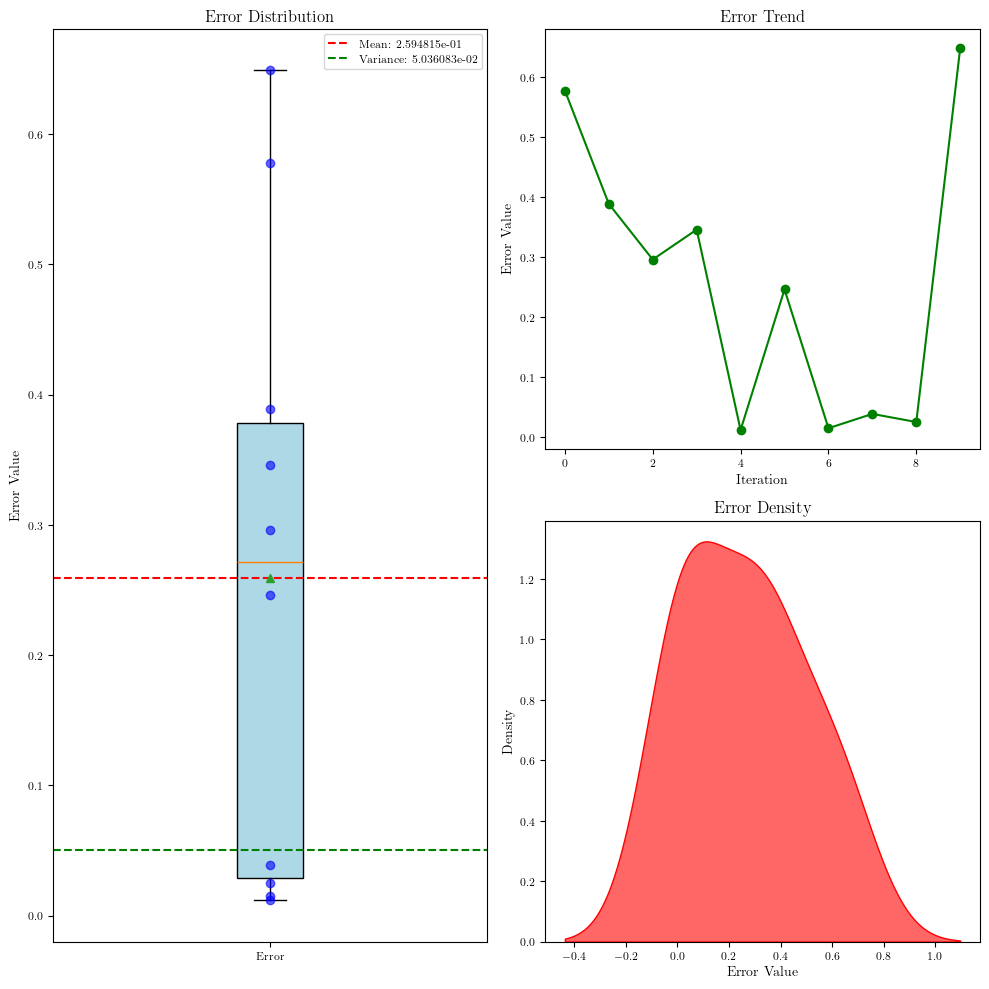

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_u

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

mean MAE: 3.144206e-02
Variance MAE: 1.271939e-03


/tmp/ipykernel_2668023/3997509801.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


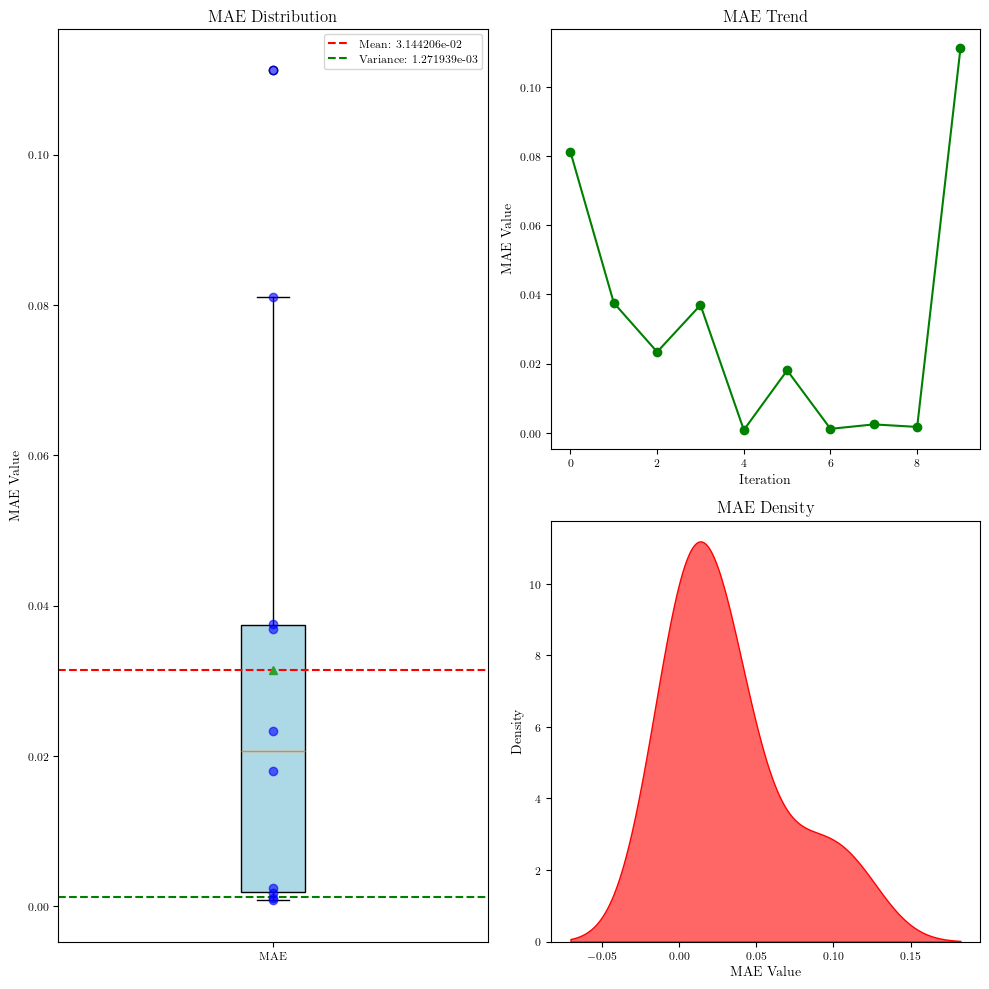

In [12]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

mean MSE: 4.441802e-02
Variance MSE: 2.833803e-03


/tmp/ipykernel_2668023/2305667704.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


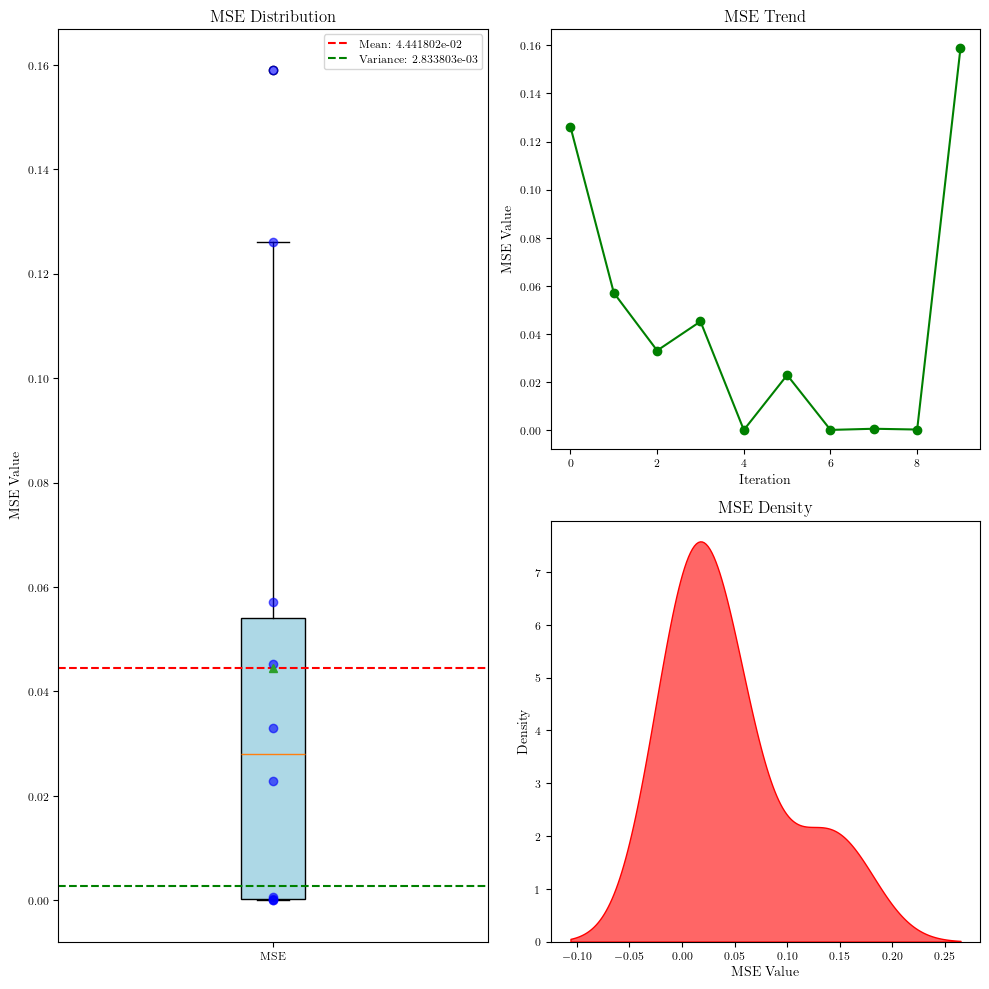

In [13]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

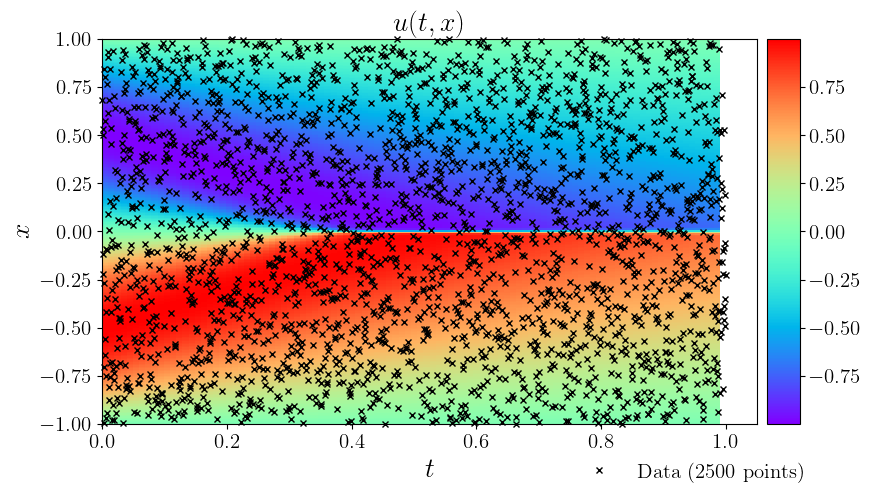

In [14]:
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组   


#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
h = ax.imshow(U_star.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


#在图上绘制散点图
ax.plot(
    X_f_train[:,1], 
    X_f_train[:,0], 
    'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  




#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

In [15]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

testerror = torch.stack(model.test_error).cpu().detach().numpy()

56652
[5.0828016e-01 4.8854303e-01 4.6981886e-01 ... 1.8918156e-05 1.8918156e-05
 1.8918156e-05]


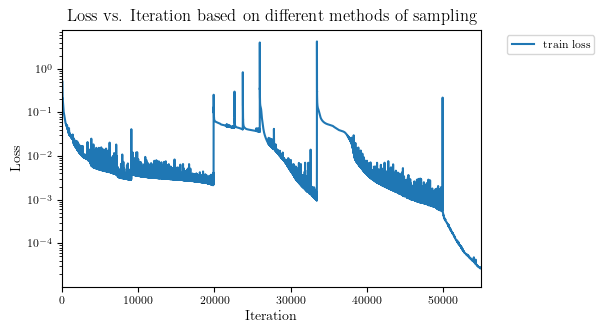

In [16]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,55000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

56652
[1.341113  1.3215199 1.3025732 ... 0.6488997 0.6488997 0.6488997]


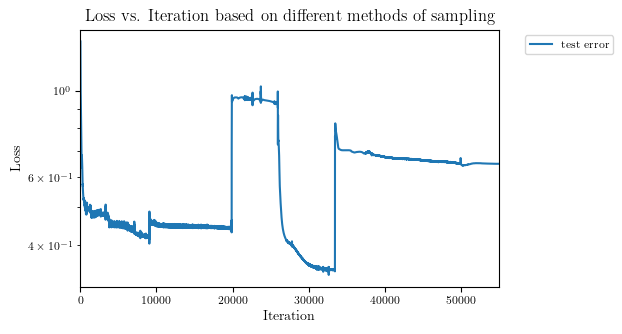

In [17]:
print(len(testerror))
print(testerror)
# 定义图例的标签
# labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(testerror, label='test error')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,55000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


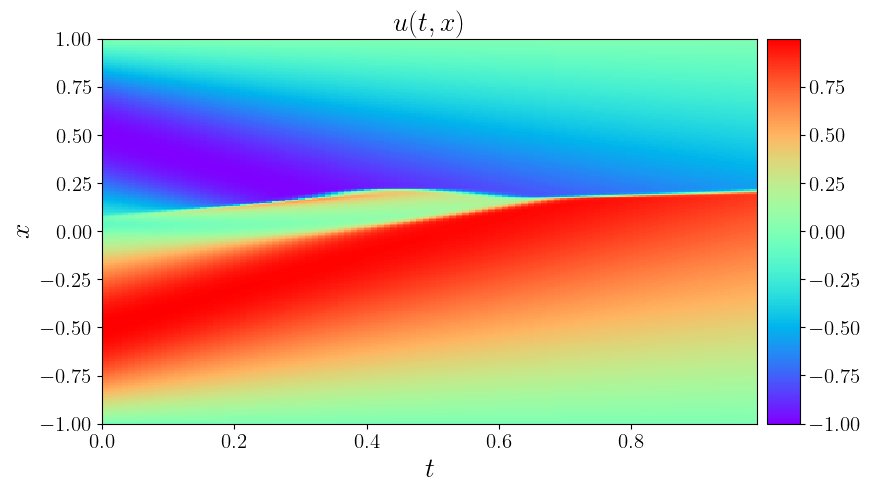

In [18]:
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_pred, f_pred = model.predict(X_star)    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组   


#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


# #在图上绘制散点图
# ax.plot(
#     X_f_train[:,1], 
#     X_f_train[:,0], 
#     'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
#     markersize = 4,  # marker size doubled
#     clip_on = False,
#     alpha=1.0
# ) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
#   #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  




#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

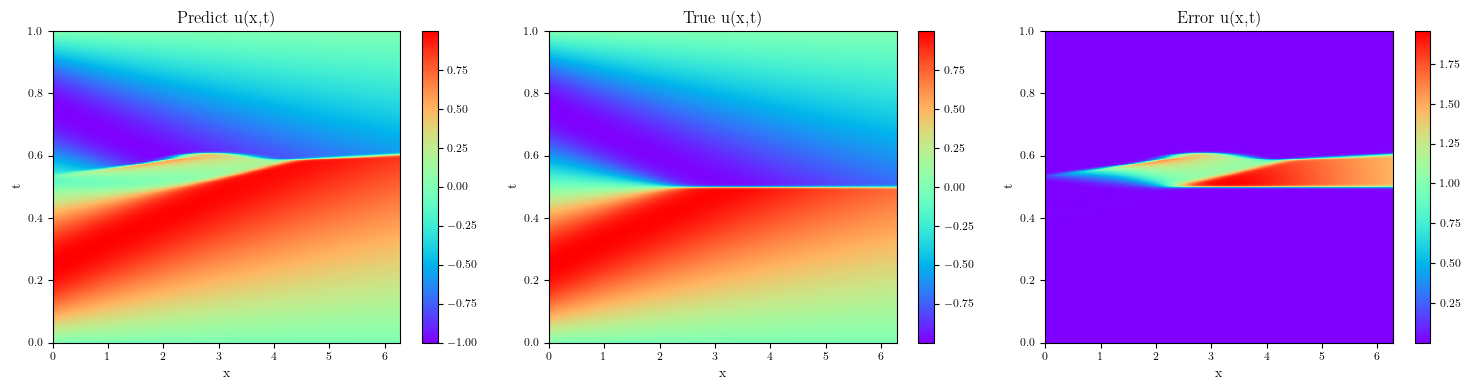

In [19]:

# 创建一个包含三幅子图的图像
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 绘制第一幅图像
axes[0].imshow(U_pred.T, extent=[0, np.pi*2, 1, 0], aspect='auto', cmap='rainbow')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Predict u(x,t)')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(U_star.T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('True u(x,t)')
fig.colorbar(axes[1].images[0], ax=axes[1])

# 绘制第三幅图像
axes[2].imshow(np.abs(U_pred - U_star).T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[2].invert_yaxis()
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
axes[2].set_title('Error u(x,t)')
fig.colorbar(axes[2].images[0], ax=axes[2])

# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()

In [20]:
#计算训练好模型的chaos（最后一个seed）
u_chaos = calculate_chaos(model, X_star, num_iter=50)
u_chaos_log = np.log(u_chaos + 1e-10) #对u_var取对数，然后加上一个很小的数，避免取对数时出现错误

#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_chaos = griddata(X_star, u_chaos.flatten(), (X, T), method='cubic')
U_chaos_log = griddata(X_star, u_chaos_log.flatten(), (X, T), method='cubic')

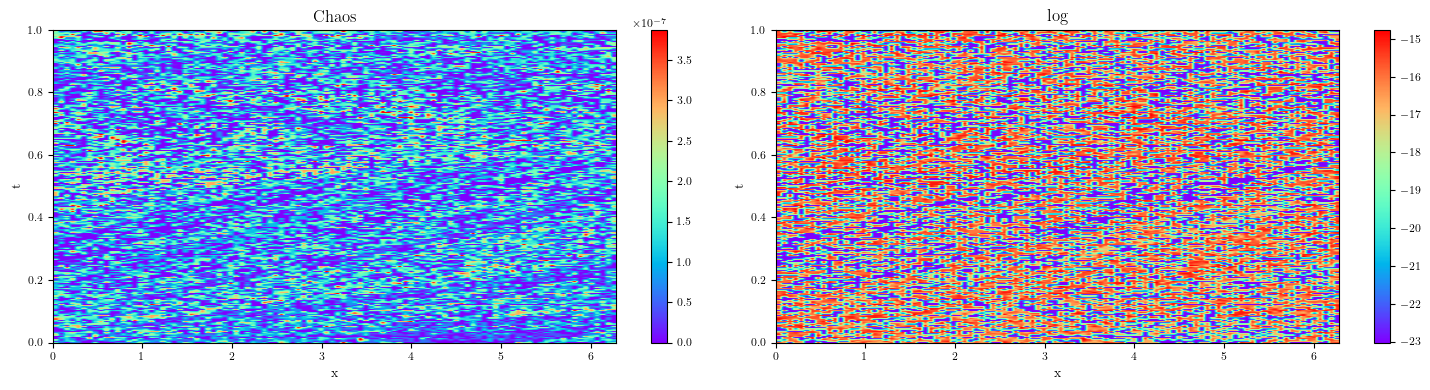

In [21]:

# 创建一个包含三幅子图的图像
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# 绘制第一幅图像
axes[0].imshow(U_chaos.T, extent=[0, np.pi*2, 1, 0], aspect='auto', cmap='rainbow')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Chaos')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(U_chaos_log.T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('log')
fig.colorbar(axes[1].images[0], ax=axes[1])

# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()